## 09. Задача распознавания текста на изображениях

## План
1. Задача распознавания текста на изображении.
2. Предварительные сведения.
3. CRNN              (Convolutional Recurrent Neural Network)
4. Механизм внимания (Attention)

In [1]:
import torchvision.transforms as transforms
import torchvision.datasets   as datasets
import torch.nn.functional    as F
import torchvision.models     as models

import matplotlib.pyplot      as plt
import torch.optim            as optim
import torch.nn               as nn

import torchvision
import colorsys
import random
import torch
import json
import time
import tqdm
import cv2
import os

from torchvision.transforms.functional import convert_image_dtype, resize
from torch.utils.data   import DataLoader
from collections        import namedtuple
from matplotlib.patches import Polygon
from matplotlib         import patches, lines
from PIL                import Image

from torchvision.io import read_image
from string import digits, ascii_uppercase

import albumentations as alb
import numpy          as np
import scipy          as sp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 0. Рекуррентные сети

$X_t \in R^{n{\times}d}$, матрица входных данных, где n - размер пакета данных, d - размер входного векторного представления (embedding).

$H_t \in R^{n{\times}h}$, матрица скрытых состояний, где h - длина вектора скрытых состояний

$O_t \in R^{n{\times}q}$, матрица выходных данных, q - размер выходного векторного представления (часто q=d)

## RNN (recurrent neural network)

Обозначения:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width=500 height=500 />

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=1000 height=1000 />


Формула модели:

$$\begin{align}
h_t &= \phi(X_t W_{xh} + H_{t-1}  W_{hh} + b_h) \\
O_t &= h_t W_{hq} + b_q
\end{align}
$$

In [2]:
from torch.nn import init

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        
        self.hidden_size = hidden_size
        # YOUR CODE HERE
        self.i2h     = 
        self.h2o     = 
        # END OF YOUR CODE
        
        init.normal_(self.i2h.weight, std=0.01)
        init.zeros_ (self.i2h.bias  )
        init.normal_(self.h2o.weight, std=0.01)
        init.zeros_ (self.h2o.bias  )
        
    def __step(self, input_s, hidden_s):
        combined = torch.cat((input_s, hidden_s),1)
        hidden_s = torch.tanh( self.i2h(combined) )
        output_s = self.h2o    (hidden_s)
        return output_s, hidden_s
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (hidden_0,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, hidden_0 = self.__step(input_s, hidden_0)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (hidden_0, )

    def init_hidden(self, batch_size = 1):
        return (torch.zeros(batch_size, self.hidden_size).to(device),)

In [3]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomRNN(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=1000 height=1000 />

Формулы пересчета состояний:

\begin{align}
f_t &= \sigma(W_f[x_t, h_{t-1}] + b_f) \\
i_t &= \sigma(W_i[x_t, h_{t-1}] + b_i) \\
o_t &= \sigma(W_o[x_t, h_{t-1}] + b_o) \\
\tilde{C}_t &= \tanh(W_C[x_t, h_{t-1}] + b_C) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
h_t &= o_t \odot \tanh(C_t)
\end{align}

In [4]:
from torch.nn import init

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # YOUR CODE HERE
        self.xh2f     = 
        self.xh2i     = 
        self.xh2o     = 
        self.xh2C     = 
        self.h2y      = 
        # END YOUR CODE HERE
        
        init.normal_(self.xh2f.weight, std=0.01)
        init.zeros_ (self.xh2f.bias            )
        init.normal_(self.xh2i.weight, std=0.01)
        init.zeros_ (self.xh2i.bias            )
        init.normal_(self.xh2o.weight, std=0.01)
        init.zeros_ (self.xh2o.bias            )
        init.normal_(self.xh2C.weight, std=0.01)
        init.zeros_ (self.xh2C.bias            )
        init.normal_(self.h2y.weight , std=0.01)
        init.zeros_ (self.h2y.bias             )
        
    def __step(self, input_s, H_s, C_s):
        xh = torch.cat((input_s, H_s), 1)
        
        I       = torch.sigmoid(self.xh2i(xh))
        F       = torch.sigmoid(self.xh2f(xh))
        O       = torch.sigmoid(self.xh2o(xh))
        C_tilda = torch.tanh   (self.xh2C(xh))
        C_s     = F * C_s + I * C_tilda
        H_s     = O * torch.tanh(C_s)
        output_s  = self.h2y(H_s)
        
        return output_s, (H_s, C_s)
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s, C_s) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, (H_s, C_s) = self.__step(input_s, H_s, C_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s, C_s)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),torch.zeros((batch_size, self.hidden_size), device=device),)

In [5]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomLSTM(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

### GRU

GRU (Gated recurrent unit) - это более простая версия LSTM.

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png" width=1000 height=1000 />

In [6]:
from torch.nn import init

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # YOUR CODE HERE
        self.xh2z     = 
        self.xh2r     = 
        self.xrh2h    = 
        self.h2y      = 
        # END YOUR CODE HERE
        init.normal_(self.xh2z.weight, std=0.01 )
        init.zeros_ (self.xh2z.bias             )
        init.normal_(self.xh2r.weight, std=0.01 )
        init.zeros_ (self.xh2r.bias             )
        init.normal_(self.xrh2h.weight, std=0.01)
        init.zeros_ (self.xrh2h.bias            )
        init.normal_(self.h2y.weight, std=0.01  )
        init.zeros_ (self.h2y.bias              )
        
                
    def __step(self, X, H):
        XH = torch.cat((X, H), 1)
        
        Z = torch.sigmoid(self.xh2z(XH))
        R = torch.sigmoid(self.xh2r(XH))

        XRH = torch.cat((X, R*H), 1)
        H_tilda = torch.tanh(self.xrh2h(XRH))
        H = Z * H + (1 - Z) * H_tilda
        Y = self.h2y(H)
               
        return Y, H
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, H_s  = self.__step(input_s, H_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s,)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),)

In [7]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomGRU(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

#### Преимущества:

1. Рекуррентные нейронные сети запоминает информацию в течение времени. Они полезны в прогнозировании временных рядов только благодаря свойству "запоминать" предыдущие входы.
2. Рекуррентные нейронные сети используются с сверточными слоями для расширения эффективной окрестности пикселя.

#### Недостатки:

1. Проблемы исчезновения и взрыва градиента.
2. Обучение реккурентной нейронной сети является сложной задачей.
3. Реккурентная нейронная сеть не может обрабатывать очень длинные последовательности, если в качестве функции активации используется $tanh$ или $relu$.

### 1. Задача распознавания текста на изображении

Мы не будем затрагивать тему локализации текста на изображении $-$ это задача может быть решена моделями детектирования или сегментации. Сосредоточимся на распознавании текста на изображениях содержащих текст.

#### Общая схема решения задачи

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACIQAAAOgCAYAAABGUj9fAAAMSmlDQ1BJQ0MgUHJvZmlsZQAASImV
VwdUU8kanltSSWiBCEgJvYkivUgJoUUQkCrYCEkgocSQEETsyrIKrl1EQF3RVREXXQsga0Vd66Jg
X8uLBZWVdbFgQ+VNCqzrnvfeef85M/fLP/98f8ncuTMA6NXxpNJ8VB+AAkmRLDEqjDUpPYNFegQQ
gAFjMAbY8PhyKTshIRZAGXr+Xd5ch9ZQrripuP45/l/FQCCU8wFAEiDOEsj5BRAfAAAv40tlRQAQ
/aDedmaRVIWnQGwkgwFCLFXhHA0uU+EsDa5W2yQnciDeDQCZxuPJcgDQbYV6VjE/B/Lo3oTYXSIQ
SwDQI0MczBfxBBBHQzyqoGCGCkM74JT1BU/O3zizhjl5vJxhrMlFLeRwsVyaz5v1f5bjf0tBvmLI
hwNsNJEsOlGVM6zbzbwZMSpMg7hXkhUXD7EhxO/EArU9xChVpIhO0dij5nw5B9YMMCF2F/DCYyA2
hzhSkh8Xq9VnZYsjuRDDFYKWiIu4ydq5S4TyiCQtZ51sRmL8EM6WcdjauU08mdqvyv6UIi+FreW/
KRJyh/hfl4qS0zQxY9RicWocxLoQM+V5STEaG8yuVMSJG7KRKRJV8dtBHCCURIVp+LFp2bLIRK29
rEA+lC+2RCTmxmlxTZEoOVrLs5vPU8dvAnGrUMJOGeIRyifFDuUiEIZHaHLHLgslKdp8MaW0KCxR
O/elND9Ba49ThflRKr0NxOby4iTtXDy4CC5IDT8eJy1KSNbEiWfl8sYnaOLBS0As4IBwwAIK2LLA
DJALxB29Lb3wl2YkEvCADOQAIXDTaoZmpKlHJLBPAqXgD4iEQD48L0w9KgTFUP9pWKvp3UC2erRY
PSMPPIa4AMSAfPhboZ4lGfaWCh5Bjfgf3vkw1nzYVGP/1LGhJlarUQzxsvSGLIkRxHBiNDGS6Iyb
4cF4IB4L+1DYPHA/3H8o2r/sCY8JnYQHhGsEJeHWdPEi2Vf5sMAEoIQeIrU5Z32ZM+4AWb3xMDwI
8kNunImbATfcC3pi4yHQtzfUcrSRq7L/mvtvOXxRda0dxZ2CUkZQQilOX8/UddH1HmZR1fTLCmli
zRquK2d45Gv/nC8qLYDPmK8tsSXYfuwMdgI7hx3GWgALO4a1YhexIyo8vIoeqVfRkLdEdTx5kEf8
D388rU9VJeXuje497h81Y0XCEtX+CDgzpLNk4hxREYsNd34hiyvhjx7F8nD3cAdA9R3RbFOvmOrv
A8I8/5duMRWAIMng4ODhv3QxHwA4YA0AVfmXzrELbgdwrz+7iq+QFWt0uKojACrQg2+UKbAEtsAJ
5uMBfEAgCAURYDyIB8kgHUyDVRbB9SwDM8EcsBCUg0qwEqwDNWAz2Ap2gh/BPtACDoMT4BdwAVwG
18BtuHq6wTPQB96AAQRBSAgdYSCmiBVij7giHogfEoxEILFIIpKOZCI5iARRIHOQxUglshqpQbYg
DchPyCHkBHIO6URuIfeRHuQl8gHFUBpqhFqgDugY1A9lozFoMjoVzUEL0VK0DF2OVqP16G60GT2B
XkCvoUr0GdqPAUwHY2LWmBvmh3GweCwDy8Zk2DysAqvC6rEmrA3+z1cwJdaLvceJOANn4W5wBUfj
KTgfL8Tn4cvwGnwn3oyfwq/g9/E+/DOBTjAnuBICCFzCJEIOYSahnFBF2E44SDgN36Zuwhsikcgk
OhJ94duYTswlziYuI24k7iEeJ3YSHxL7SSSSKcmVFESKJ/FIRaRy0gbSbtIxUhepm/SOrEO2InuQ
I8kZZAl5EbmKvIt8lNxFfkIeoOhT7CkBlHiKgDKLsoKyjdJGuUTppgxQDaiO1CBqMjWXupBaTW2i
nqbeob7S0dGx0fHXmagj1lmgU62zV+eszn2d9zRDmguNQ5tCU9CW03bQjtNu0V7R6XQHeig9g15E
X05voJ+k36O/02Xojtbl6gp05+vW6jbrduk+16Po2eux9abplepV6e3Xu6TXq0/Rd9Dn6PP05+nX
6h/Sv6Hfb8AwGGsQb1BgsMxgl8E5g6eGJEMHwwhDgWGZ4VbDk4YPGRjDlsFh8BmLGdsYpxndRkQj
RyOuUa5RpdGPRh1GfcaGxl7GqcYlxrXGR4yVTIzpwOQy85krmPuY15kfRliMYI8Qjlg6omlE14i3
JiNNQk2EJhUme0yumXwwZZlGmOaZrjJtMb1rhpu5mE00m2m2yey0We9Io5GBI/kjK0buG/mbOWru
Yp5oPtt8q/lF834LS4soC6nFBouTFr2WTMtQy1zLtZZHLXusGFbBVmKrtVbHrH5nGbPYrHxWNesU
q8/a3DraWmG9xbrDesDG0SbFZpHNHpu7tlRbP9ts27W27bZ9dlZ2E+zm2DXa/WZPsfezF9mvtz9j
/9bB0SHN4VuHFoenjiaOXMdSx0bHO050pxCnQqd6p6vORGc/5zznjc6XXVAXbxeRS63LJVfU1cdV
7LrRtXMUYZT/KMmo+lE33GhubLdit0a3+6OZo2NHLxrdMvr5GLsxGWNWjTkz5rO7t3u++zb322MN
x44fu2hs29iXHi4efI9aj6uedM9Iz/merZ4vvFy9hF6bvG56M7wneH/r3e79ycfXR+bT5NPja+eb
6Vvne8PPyC/Bb5nfWX+Cf5j/fP/D/u8DfAKKAvYF/BnoFpgXuCvw6TjHccJx28Y9DLIJ4gVtCVIG
s4Izg78PVoZYh/BC6kMehNqGCkK3hz5hO7Nz2bvZz8Pcw2RhB8PecgI4cznHw7HwqPCK8I4Iw4iU
iJqIe5E2kTmRjZF9Ud5Rs6OORxOiY6JXRd/gWnD53AZu33jf8XPHn4qhxSTF1MQ8iHWJlcW2TUAn
jJ+wZsKdOPs4SVxLPIjnxq+Jv5vgmFCY8PNE4sSEibUTHyeOTZyTeCaJkTQ9aVfSm+Sw5BXJt1Oc
UhQp7al6qVNSG1LfpoWnrU5TThozae6kC+lm6eL01gxSRmrG9oz+yRGT103unuI9pXzK9amOU0um
nptmNi1/2pHpetN50/dnEjLTMndlfuTF8+p5/VncrLqsPj6Hv57/TBAqWCvoEQYJVwufZAdlr85+
mhOUsyanRxQiqhL1ijniGvGL3Ojczblv8+LzduQN5qfl7ykgF2QWHJIYSvIkp2ZYziiZ0Sl1lZZL
lYUBhesK+2Qxsu1yRD5V3lpkBA/sFxVOim8U94uDi2uL381Mnbm/xKBEUnJxlsuspbOelEaW/jAb
n82f3T7Hes7COffnsudumYfMy5rXPt92ftn87gVRC3YupC7MW/jrIvdFqxe9Xpy2uK3MomxB2cNv
or5pLNctl5Xf+Dbw281L8CXiJR1LPZduWPq5QlBxvtK9sqry4zL+svPfjf2u+rvB5dnLO1b4rNi0
krhSsvL6qpBVO1cbrC5d/XDNhDXNa1lrK9a+Xjd93bkqr6rN66nrFeuV1bHVrRvsNqzc8LFGVHOt
Nqx2T5153dK6txsFG7s2hW5q2myxuXLzh+/F39/cErWlud6hvmorcWvx1sfbUred+cHvh4btZtsr
t3/aIdmh3Jm481SDb0PDLvNdKxrRRkVjz+4puy//GP5ja5Nb05Y9zD2Ve8Fexd7ff8r86fq+mH3t
+/32Nx2wP1B3kHGwohlpntXc1yJqUbamt3YeGn+ovS2w7eDPo3/ecdj6cO0R4yMrjlKPlh0dPFZ6
rP+49HjviZwTD9unt98+Oenk1VMTT3Wcjjl99pfIX06eYZ85djbo7OFzAecOnfc733LB50LzRe+L
B3/1/vVgh09H8yXfS62X/S+3dY7rPNoV0nXiSviVX65yr164Fnet83rK9Zs3ptxQ3hTcfHor/9aL
34p/G7i94A7hTsVd/btV98zv1f/L+V97lD7KI/fD7198kPTg9kP+w2eP5I8+dpc9pj+uemL1pOGp
x9PDPZE9l3+f/Hv3M+mzgd7yPwz+qHvu9PzAn6F/Xuyb1Nf9QvZi8OWyV6avdrz2et3en9B/703B
m4G3Fe9M3+187/f+zIe0D08GZn4kfaz+5Pyp7XPM5zuDBYODUp6Mpz4KYLCh2dkAvNwBAD0dAMZl
eH6YrLnnqQXR3E3VCPwnrLkLqsUHgCb4UB3XOccB2AubwwLIDZvqqJ4cClBPz+GmFXm2p4eGiwZv
PIR3g4OvLAAgtQHwSTY4OLBxcPDTNhjsLQCOF2rulyohwrvB914q1MUsXAq+kn8DsCp/xI79QTMA
AAAJcEhZcwAAFiUAABYlAUlSJPAAAAGeaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBt
ZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQuMCI+CiAg
IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3lu
dGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAg
IHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4
aWY6UGl4ZWxYRGltZW5zaW9uPjIxODA8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8
ZXhpZjpQaXhlbFlEaW1lbnNpb24+OTI4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgPC9y
ZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CrDsa4wAAAAcaURPVAAA
AAIAAAAAAAAB0AAAACgAAAHQAAAB0AADPKraHj0+AABAAElEQVR4Aezdd5xkdZ32/eucU7k65+6Z
6UkwgTSMApIRSYJg2F131d3bsLdhV3fvDaaVXQOKkhQUkSAMqIBKFEFFDICSg8DAMDlP93SO1V3x
hOdb7fo8u6/bx9VdgemeT+t0dVdXnfP7vX/1F6/rdX2dyL7EFwIIIIAAAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggMCcEXAIhMyZs2QjCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIDAjACBED4ICCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA
HBMgEDLHDpTtIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACBEL4DCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAnNMgEDIHDtQtoMAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggAACCBAI4TOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
CCCAAAIIIIAAAgjMMQECIXPsQNkOAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
CCBAIITPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMMcECITMsQNlOwgg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAIEQPgMIIIAAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggMAcEyAQMscOlO0ggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIEQvgMIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
c0yAQMgcO1C2gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEAjhM4AAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMwxAQIhc+xA2Q4CCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIEAghM8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAAggggAACCCAwxwQIhMyxA2U7CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAgRA+AwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwBwTIBAyxw6U7SCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgRC+AwggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAJzTIBAyBw7ULaDAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggQCOEzgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
zDEBAiFz7EDZDgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggQCCEzwACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDDHBAiEzLEDZTsIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggACBED4DCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIDAHBMgEDLHDpTtIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACBEL4DCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAnNMgEDIHDtQtoMA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBAI4TOAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAgjMMQECIXPsQNkOAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCBAIITPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
MMcECITMsQNlOwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAIEQPgMIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAcEyAQMscOlO0ggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIEQvgMIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACc0yAQMgcO1C2gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIEAjhM4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMwxAQIhc+xA2Q4C
CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIEAghM8AAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCAwxwQIhMyxA2U7CCCAAAIIIIAAAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAgRA+AwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
wBwTIBAyxw6U7SCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgRC+AwggAAC
CCCAAAIIIIAAAggggAAC+5lAZPuNokiu4+xnO2e7CCCAAAIIIIAAAggggAACCOw/AgRC9p+zZqcI
IIAAAggggAACCCCAAAIIIIDAjEA1DBJZGKQaByESwocCAQQQQAABBBBAAAEEEEAAgbkpQCBkbp4r
u0IAAQQQQAABBBBAAAEEEEAAAQR+p8B0IW8tIVI2nRFFIb+Tij8igAACCCCAAAIIIIAAAgggMCsF
CITMymNj0QgggAACCCCAAAIIIIAAAggggMB/U8BSIEODA7rrjjvVs2u33v+hD6mre541hbj/zQvy
NgQQQAABBBBAAAEEEEAAAQQQ2BcFCITsi6fCmhBAAAEEEEAAAQQQQAABBBBAAIGXQMAKQbS3r08/
vPc+3XLDT9Tfs05v+tPT9bFzP676phYLhTBA5iVg55IIIIAAAggggAACCCCAAAIIvCICBEJeEXZu
igACCCCAAAIIIIAAAggggAACCLz8Ar0WBvnR3d/Td77zfQVdb1aQ366dT92rz/3r/9G7//a9NjqG
lpCX/1S4IwIIIIAAAggggAACCCCAAAIvjQCBkJfGlasigAACCCCAAAIIIIAAAggggAAC+4xAtRmk
b2BQP7rrbn1jzR2aaDlER/zp+zQ68IQeueErOrg+0s133675XYvslbSE7DMHx0IQQAABBBBAAAEE
EEAAAQQQ+B8IEAj5H+DxVgQQQAABBBBAAAEEEEAAAQQQQGA2CAwMDOh7P/ixbrvqq8oFSS15zwVy
vRbF4uN64Qd3aPS5+/T1Gy7RGaecORu2wxoRQAABBBBAAAEEEEAAAQQQQOD3ECAQ8nsg8RIEEEAA
AQQQQAABBBBAAAEEEEBgtgpMTk7qzu99T1ddc61Gd2/WZVd+QtkVh2rjwDyNjknrf/a4vn/jlXr/
B87QRZ87T/G4N1u3yroRQAABBBBAAAEEEEAAAQQQQOA/CBAI+Q8Y/IgAAggggAACCCCAAAIIIIAA
AgjMJYFSqaS777lHF3/xq1r3zFatOuscffnKD2hF2w6VnE4VKqF6Ngzp/e/6lBrqa3XHLbeqo6vL
hsYwNmYufQ7YCwIIIIAAAggggAACCCCAwP4pQCBk/zx3do0AAggggAACCCCAAAIIIIAAAvuBwAMP
PKDPnf95Pf74Q6prP1LL/uwjOvG4br3vqKLaWzcp7ycVlmr0Dx9ao1/84lldf/21Ou20M4iD7Aef
DbaIAAIIIIAAAggggAACCCAw9wUIhMz9M2aHCCCAAAIIIIAAAggggAACCCCwvwlEkXp6enT+5z6n
b9zwDdXUHaIDT3qH6l/7dmXra3RUe05nvXq95mXLNiLG1xcvvUcXnner/vHv36uLLrxUcmgI2d8+
MuwXAQQQQAABBBBAAAEEEEBg7gkQCJl7Z8qOEEAAAQQQQAABBBBAAAEEEEBgPxcYHh7RDdd/U2vW
rNH2bdvU/Zp3q/tVZ6rxoKWqb6xTwqnTvNrn9cbDJnRAV1lPPLJDb3/LpTri6EN14403q6mxZT8X
ZPsIIIAAAggggAACCCCAAAIIzH4BAiGz/wzZAQIIIIAAAggggAACCCCAAAIIIPBrAWsGyRcKuumm
b+uyy67Slm071d41X4ec+gF5HfPUvGS1amvq5KughlJOf3XCsJZ096s8XNE5r/+iNu3doRtuuMF+
PsdaQkBFAAEEEEAAAQQQQAABBBBAAIHZLEAgZDafHmtHAAEEEEAAAQQQQAABBBBAAAEE/oNA4Pu6
8447dd5552vjtj55tW1afczJqus+QunWQ9Sx4kClYyWFFV/LWgP9+THjSsa3qFIp6x//7kbd/K2f
6JP/9i/6zKfOk+u5/+HK/IgAAggggAACCCCAAAIIIIAAArNNgEDIbDsx1osAAggggAACCCCAAAII
IIAAAgj8FoHInvvJfffp3z7xCb34/IsqxRu1+FUna8WRpyiMdah23nLVH9CpZKWgpnykM4/bpNVt
kaa9QQ3Fp3TXLWv1+ffeoGOPXK3Lr79Gy5Yu+y134SkEEEAAAQQQQAABBBBAAAEEEJgtAgRCZstJ
sU4EEEAAAQQQQAABBBBAAAEEEEDgdwj07tmjD3/0Y7rve7er4CTUsOQ4rTj29Yo3H6jaZLMybd1q
7o4rKvdrYVut3nHoZtXEFmgyntMLI7u0u6ekKz/0NW3euF7XXP5l/a+//mu7G3Njfgc5f0IAAQQQ
QAABBBBAAAEEEEBgnxYgELJPHw+LQwABBBBAAAEEEEAAAQQQQAABBP5rgdHRMX318it09TXXa3p4
Qqpp1uFnvEvxrsVyG7vUVeMoSC5SbVNaidheHXVkVmd1vqje0U49tyeuZ7YmNDHpaevdn9PD99+m
t535Fn39mzcoW1vzX9+cVyCAAAIIIIAAAggggAACCCCAwD4pQCBknzwWFoUAAggggAACCCCAAAII
IIAAAgj8fgK+X9G1116rz33hIo0ODShw2rXi8CN1wFGnaiiW1sLDDlFDEFdBLUo316gwuVULW0J1
t6e1a2ekUT+pXLlOU9NS+ekv6qc3X6nuBUt051236qCVK2wRtIT8fifBqxBAAAEEEEAAAQQQQAAB
BBDYtwQIhOxb58FqEEAAAQQQQAABBBBAAAEEEEAAgT9I4OGHH9Lf/u3faP3G7UqEoeqXnaJDjz9V
UaJR8Y7F6lq4SNGYp9r2BvmZsob37FKDPKltkZwglBsPFZanVQ5TKmy6X/d9/bPy86PWNnKp3vH2
t9taCIT8QQfCixFAAAEEEEAAAQQQQAABBBDYRwQIhOwjB8EyEEAAAQQQQAABBBBAAAEEEEAAgT9U
YOvWrbrgggt1++23aypXUFtHq5a87t1KdixSPNmkhQcerlLRVTCdUktXVkW3oJG+cbVl0wrme/Iq
U1YL0iU356gUhSrkJvTozf+gHU/fo/e//926+uprbEkEQv7Qc+H1CCCAAAIIIIAAAggggAACCOwL
AgRC9oVTYA0IIIAAAggggAACCCCAAAIIIIDAHygwMDCgiy++RNdde4OKxaK8RIMOft2fq3bBq1T0
Ulq0ZKXqm1rVP1pSJhlXe2uDJqcmNDY6peamZnlNobxyxUbMZOWGRckvaqqQ0aZ7b9AzPzhXZ55x
mr77nduUTmf+wJXxcgQQQAABBBBAAAEEEEAAAQQQ2BcECITsC6fAGhBAAAEEEEAAAQQQQAABBBBA
AIHfVyCKVCqX9NXLL9eFF35FkxOTcq3EY/HqkzXv+LfJL6fUOq9bTZ3zVLKQx2Beam+O1JDq0OjQ
hCYKOTW0NSidicnzHflxX2E8UqLoqFhw1ffkM3roO3+t5YtbdfPN39WyA5f9vivjdQgggAACCCCA
AAIIIIAAAgggsA8JEAjZhw6DpSCAAAIIIIAAAggggAACCCCAAAL/lUAQhnrwoUd1yec/pwcefF5R
UFHL/AVaceafy0t3qibdogXLDtKkjXoZn/KlIKX2DldxJ62R4Wnli6HauqS4NX9EQVqyMTKKPDlR
QkEp0Fh/vx657iOKTT6riy69VG9765//V0vi7wgggAACCCCAAAIIIIAAAgggsA8KEAjZBw+FJSGA
AAIIIIAAAggggAACCCCAAAL/fwJrX1irT33mYt3/k5/Lny4oUd+og896j2IdCxRzk1rSsVx1dc3q
mRhXMZZUPNOo9oZ6hW5JQxYIUTGvzo5GOemi/LDOxsVYZsT1bXSMBUJ8X8XJsjbe8TW9eP+l+rM/
eaOuu26NjY2x4AhfCCCAAAIIIIAAAggggAACCCAwqwQIhMyq42KxCCCAAAIIIIAAAggggAACCCCw
3wrYqJi9e/v06fPO11233KZKYVpB3NGSo09V56FvV8FLq2tesxrSbcpPlTUdlOQnLBCSrVd7fVaB
52hkZKeCckwtFh6JJ0qqONYcUpaNjAkVBnXyKwVNF8oafOaHevzbn9TqpQu05lvf1PIVK/ZbdjaO
AAIIIIAAAggggAACCCCAwGwVIBAyW0+OdSOAAAIIIIAAAggggAACCCCAwH4lUMjndettt+q8L3xW
fbsn5Jbjyhx6hg449gRlLPhRW9+q9vZ5ypUila31w3EdBUGohqY2eW2h/HyoQt+E/KBLnUsKWtnW
ry0jzRotpJS0QIhTrpXnuRqr2KiZ3ev12LUfUnJwo84971P6+3/6Z7k2goYvBBBAAAEEEEAAAQQQ
QAABBBCYPQIEQmbPWbFSBBBAAAEEEEAAAQQQQAABBBDYTwWCINB9992niy++UM888bymK54aG7Na
cNoHlW5dokYv1Lz5S2wsTFwTgY2AicVlyQ/7wVdra5fCprT8MU/+nl5lW3u17NUtetOhY3pmR7s2
9lpLSDypkYGShUiy6vObNDYwoOdu+TeNPX6bTj/n9bry2uvU2da2n+qzbQQQQAABBBBAAAEEEEAA
AQRmpwCBkNl5bqwaAQQQQAABBBBAAAEEEEAAAQT2I4Enn3xSn/7sp/XLX/5SUd6CHZlmveqkU9S8
6GiFsTq1z1uoTH1a42M5ld20HCchx0IkbsJVXVurYilXheGUMrl+vfEtO6xJZL4W+32aTlVUDDwN
FFbqp4+OazzfoDG3SbmRXdrys+9o9/evULLJ1dXX36w3n/V6qx3Zj9DZKgIIIIAAAggggAACCCCA
AAKzXIBAyCw/QJaPAAIIIIAAAggggAACCCCAAAJzW6Bvb6++9OUr9LWvfFXlKCk31q5Fhx+p+auO
UCLToPqGDtW2LlC5mFcpPyU3mVXouIoiKZNtUm1jk5z0pCaGQ7m5HXrnaQmtWDKu1mJOTrZOY1Mx
3fJsrbbs7VTSK2ksPd+CJRvV/+hD2vj9r2hyvEef/Myn9a+f+BcLmpAImdufNnaHAAIIIIAAAggg
gAACCCAwlwQIhMyl02QvCCCAAAIIIIAAAggggAACCCAwZwQiRZqcmNK3b75JV1x9pbat3yg/6ah5
4VKtOuYvFaaWqqapTs0tNRYSyWhsdNIeY3LjtfIVU+QFqsmmVV9Xq6BhTJODaU32DerYTl9ve2NF
DZ6jRHpQ00Xp+891ae2eRUp7gxpLLND48LQGn3tIux/+lvase1irj1ytb37jOq1YfpCVhBAKmTMf
MjaCAAIIIIAAAggggAACCCAwpwUIhMzp42VzCCCAAAIIIIAAAggggAACCCAwWwUqfqCbbrpZX7rk
Um3Y+qJFPBJKN7fo6LPeouUHn6WR0bTiCXsu42hobFJRKikvkZWiJoVBRor5qm9LKlXjKlae1vRA
wUbCDOugAyd0wvENeqGnUYfN261DWnxtm6rRbY81KD/ZrSgR19ToNvVtWa/JjY9r3S/W2L3juvRL
5+sD7/vb2crJuhFAAAEEEEAAAQQQQAABBBDY7wQIhOx3R86GEUAAAQQQQAABBBBAAAEEEEBgNgg8
cP/D+pdz/1nP/Op5hVFMTmyJDjv6bB158qF685++To0NMe3eOaTHf7VVPaN5hckaxRINcoMaBWHS
GkIc1XY0KG4tIa5fUr5/WBN5T/PaJ3Xg0pQ2Tzaoxe/RId0dGg5Tem5oWppuU9JGzeQmB7Rn+4uq
9G/Vup9dqlzPhE59/VG6+du32n2bZwMfa0QAAQQQQAABBBBAAAEEEEBgvxcgELLffwQAQAABBBBA
AAEEEEAAAQQQQACBfUrAAhm7e3bp4x/9V9159x2KAtdaPzx1H3KcjjjuLJ111jE65NDFGh7cqyj0
tH77uB5dO6DA61Ay2SjXceQHBWsMkeo62+Vl6uX44xrfM6hcoUvNzTHVNxZUqYsUn0go8uMqpjyp
dlypfEaJUlLTlSnt2vKcwlyvttvYmL61G7RwaVbfuOm7OuqIo/cpLhaDAAIIIIAAAggggAACCCCA
AAK/XYBAyG934VkEEEAAAQQQQAABBBBAAAEEEEDgFREYHRnV1dd9XdddfZ329A7L9UJ1d3Xp0DNP
1Olnv0nHrHq1NYPs1dDAmMqFkgolT2MW4siV4pqY8lX2Y/LjNuSlPq2a1haFsaSUL2mkZ1SFMKO2
+bVKNUZyLHji2Hsi+yGKBXJCx57zrE0kIb8wrt1bNquQ36apreu0/qd3y4v3658+/BF95pPnyVIn
r4gNN0UAAQQQQAABBBBAAAEEEEAAgd9fgEDI72/FKxFAAAEEEEAAAQQQQAABBBBAAIGXVMD3fV1/
w/W64IIva7C3T37oqrYhrrf/r/fq+LecrSVLlqsp6Spw8kq4oTKJjEqlQJUo0LRb0lRBsgyJBiZd
Tfn2L/CVy+eVH23RcP+I/Ni4mudn5NWmlMw1yY0HFu6I5FZCC43UqVzjKnIDeZM57d5kYZDydsXG
pvTM3ddqcny9XnvS8brluzY2pqVJFh95SS24OAIIIIAAAggggAACCCCAAAII/M8ECIT8z/x4NwII
IIAAAggggAACCCCAAAIIIPBHE3jsscf0nvf9tfZs3q1U4Fm7R6RTzz5bZ/zNx3TSvDpVdqzX9OSg
CrGynIkpFbKuWjra1LHwIGW7u+XlY8qlUgrduNwwshExOY0ND+mXO9Ja+/xOlSquvW6h3Nqs6vOh
BUkqFgBJKx5YqMTGz0TJsjwnKbdYUt/WXg0O2Do0qE2P3aK9Gx7SAUsW65qvX6fjjzv+j7ZnLoQA
AggggAACCCCAAAIIIIAAAi+NAIGQl8aVqyKAAAIIIIAAAggggAACCCCAAAJ/kEBvb68uvuRiXX/9
GgUW1kgn6/Wu97xT73jn29XQntXYM4+osnuTVFdjoZAe1cdcpRYerPrFh6m5Y76mHN8CHll5sZj6
+wdUV9uo5sYWC3y42qWCevaUtWVjTv25ivJeSoEa5LgxC534Njsmb2t15VmIJB7aiJlioD3bd2uw
f4/SzrhGtz2sZx+8VV6Q04c/8hFd8IWL/qC98WIEEEAAAQQQQAABBBBAAAEEEHj5BQiEvPzm3BEB
BBBAAAEEEEAAAQQQQAABBBD4TwKFUlFfvfxyXXrZlzQ2OKTIqdOZb32nPv6P71F9rav+bY9qZKii
BfMXqi7rqKGmVm5NWYmaGo2VShrpLak47WrhwSvkjE1ow7q1StTXqqm+zR4blGiap2xNSqVYSZOT
RW3cntcT/UkVpmz8TCJUmJXKNnom7WeVslBIUC7bNUc01NcrrzKpYGyrnrjvGyrZ49lnv15XX/8N
tba0/Kc98AsCCCCAAAIIIIAAAggggAACCOxbAgRC9q3zYDUIIIAAAggggAACCCCAAAIIILAfCjz8
6MP62Mc/qmd/9azKxYqOOfp1+tfzz1d+YqfcIK/mZE6LDn6tMk2dKo/tUMnaPUrhkEbWrdPY0C4V
s/O1aPXJqmlIaMtPH1CqXFD7/DbFfVflKFLvxKjC9AK1H7JKCxdmFfrT2jgV06Z1g9o+VFIuscCa
QmzMTDmulDOpQlGaHJjWxPCgSrkxabpfm5+8R30b7ldHa40uuPQy/eU73rEfnhRbRgABBBBAAAEE
EEAAAQQQQGD2CBAImT1nxUoRQAABBBBAAAEEEEAAAQQQQGAOCmzZssVGsHxed931PU1NlzW/e4nO
/+Qn1L2oUfMWdSoWi1QbrygaH9eubes1MDykcjmmAw9oV03n4drWM6Bsukadi1bq6cceVtg7qK6m
etW2NyiMAhUK0xoaH1XMwiTdhx2tltZOpd1IZaegKQuOrNsZ6omNRQ0VS3IT8+R6EyoV45rca8EQ
C5LkJ0YU8yc1sOUJbXzodrn+iN78V3+hK792pWqsoYQvBBBAAAEEEEAAAQQQQAABBBDYNwUIhOyb
58KqEEAAAQQQQAABBBBAAAEEEEBgPxAYGR3Rmq9fqy9ecIFyU3ml65r14U+dr9NWr9Dmx76vxSsX
al5bswZykWK96zU1ukdlNybr8rAmj5JKr3qrOlYdr4Z4Xjs3btDAUy8o5aZV39Aipz6rYkrKJpNK
N3Sos9vCJa5jAZOUArtCshhpOuUoF1a0e3i9frVtQJt7j1DohHKCnPb2Tcsv5ZUb65cTFlQZ26Pn
f/xtlYa3qrWtUXfffbde9apX7QenxBYRQAABBBBAAAEEEEAAAQQQmJ0CBEJm57mxagQQQAABBBBA
AAEEEEAAAQQQmOUCuekp/egHP9Saq6/RQ798XJXI11vf+g6d99lPa9Pj96pn/aOqba7Xou4Fqngp
FXZvUkONq0qmUYVKRcnJnModJ+nIk85WVOrTo089JA1NyvGSau6Yr9aF85RurVVTfZ2CVIMiJ5IX
hpIFSkILlCQKoUpx35pCIgXWJDIYlPT45oI2bMvLn25Vb++wiuGkimMvqlTy1OhMacOD92rnhp8p
k3X0la9coXe/692z/BRYPgIIIIAAAggggAACCCCAAAJzV4BAyNw9W3aGAAIIIIAAAggggAACCCCA
AAL7qECxWNQP7/2Rrvjq1Xr0kcdU8Vu0dOUiXfT5T2hRc1HP/vg7ao2n1Tx/gVI2lmVqakzT4/1q
aazR0sNPVFjXpNzwuKYyB2jhgqXa8Mufqad/u5Jy1NjZpWWHvUppGxsTzybl2/+iKCnP/uc4niJr
CXHNJVZx7Lv9NebID2IqOYHGKnm9sHVaz6/LWzBkXCVrD/EKGzRcrFFWExrbtF5P3/8tuWFOb37L
n+mqq69UY2O9Xad6Lb4QQAABBBBAAAEEEEAAAQQQQGBfEiAQsi+dBmtBAAEEEEAAAQQQQAABBBBA
AIE5LxAp0v0//7ku/MIX9NBDD8u3kEaq9Qi99b3v1d//5Zs0dP81Gtv1uFq75qmhvl4lC48ExZIi
31dgzSBe50I1HXyUOhYcqOl0s4ojQ9rzyJNqbK9Rx7xWNbR1KV3foqkgku+51TiI0hYGcaNqbMOT
vGogxFHct1iINYNU7PfAiUlB2V7jayqMa33vpG79wSYN9Y0rGQ5qr59WGI7IHR/WMz/6pvLDvZrX
vVjfvfUmHXXUq+f8mbFBBBBAAAEEEEAAAQQQQAABBGajAIGQ2XhqrBkBBBBAAAEEEEAAAQQQQAAB
BGalgGUytH79Op37iX/Rz+59QAodhdlWrTruz/SBD75Fq1pqtfNnX1ZrxlV9a6P9PdToyLCNeLEW
D8Vt2kvKQiA2/qVphRYddJSalnQooYLSpUjJVMrGwlTkukl7jNkYGEcVe39oI2Fi9n43iuTa846F
RBwLibiBp1jgK7SkiB9LyCvbc6WijZFxNJxw9eKmad3/wFPa3bNbI9NJW3mgeBhp4yPfUd+6B5Sp
qdPnPv95ffCDf2vX4wsBBBBAAAEEEEAAAQQQQAABBPY1AQIh+9qJsB4EEEAAAQQQQAABBBBAAAEE
EJizAmPjY7rssi/pkksukV9KKRarV/vBx+l1p7xVH39bl6Y2P6WNe55UW/1CLWqo1VhuQk4iJrc2
q2xTm2pbWhWv6VK8oVuR16AwWZQTCyze4SmMYorb6Jf4zEgYx0IgoQVDQguGWAtINQBiAZFYZGNj
Yq49b0UhM4GQwKwD+XELm/gWGrFfy16k8VhoY2xC9QwP6Xs/fVLrHu+16TINNmemRSN9D+r5n12m
sFzRya87VTfe+G21trTM2TNjYwgggAACCCCAAAIIIIAAAgjMVgECIbP15Fg3AggggAACCCCAAAII
IIAAAgjMKoHAAhbf/94duviLF+lXa19UENbbiJelOuzEE3XCCWfoT05o1raHf6aGTExNC7pt9Eub
PM9TTV294hbY8BxLcVjDh28hknLcVTGwVo9Y3qIgCVWcfw95hAkLhFQbQaoBEAuK2M+BNYNUTMoN
ZR0jFgixETH2o4VDYopZ44fVkMy0iETV3hALjFRHyhT8ivI2psZxfW0ZC/XD2+/VC+sHrE2kQ5XS
Hv3qp19XfmCHVixfpmvWfFNHv+Y1s+osWCwCCCCAAAIIIIAAAggggAAC+4MAgZD94ZTZIwIIIIAA
AggggAACCCCAAAIIvLIClrt49pnn9OF/+D966pnHrYUjKSfZpdecfLbquxbojWefoWMWpdToDKip
qUtefY2FORrkRxbWqA5kCQL77lcjG3LCpKadabtGwoIfNi4myNrz1SBHufpXxarBEfsK7OHXI2Nc
C3/8emSMJxsXY3+vxkCqbSHV1hCbI2OPZXt9pNACKK4f2OiYsiYKk3KCosr1Hdq6dY++dfcj2ra1
rLgFRtY/9SP1v2jhlbSjD/7zx/SpT3/arjtzW74hgAACCCCAAAIIIIAAAggggMA+IkAgZB85CJaB
AAIIIIAAAggggAACCCCAAAJzVSBSb0+frr3uOl1xxaXKTeQUZDNaeeiZWrzqNCUaEnrfu07S6pa0
MsmKvLBGlXStUtb6YVNcLABSjXtEqsY9ChYP8aohEbf6jGVAIt+aP+yfRUM8NybHfrfhMTZOxlUp
9Oz9oeU9IsXt52pFSGDvVRirJkVsPIyFTCwMUqn41gxSHSojFYoFBfmcwvyYenZsVLni6sBjViqe
XKhnd03ojrse0Z6RUCPb12v9A9coFeZ14qlv0DduvkmNNuLGVjtXD5F9IYAAAggggAACCCCAAAII
IDDrBAiEzLojY8EIIIAAAggggAACCCCAAAIIIDCbBHK5CV2/5iZ97WtXaM/uHdbzkVLXspU67Ng/
UyHTqpUL6vTPbz9OLRYIqYY20r6nwEtbW4d1glRrNyypUY1/lMJQJQt32BQYRTY6JrKwhxdaY4ds
NIw1fUSODYSxgEfMno/NBD/KqpSnVClOKp/zVayULa+RULlkQZOC/c2edw3SciEKLVQS2b2q42XC
0rQFSKY1vnOHiva6xqU1WnbIqRrLdOnZLaP63s9fUP/23Xr+J99SaWibFi3p1uVf+7JOO+1Uuz6B
kNn02WStCCCAAAIIIIAAAggggAACc1uAQMjcPl92hwACCCCAAAIIIIAAAggggAACr6BAGAa6/c7b
9KlPXqBdW7ZX6z4Ua1ygo193lpLth2nMQhynrmzUx/7kNXKa6yzaIWvdsNEw1uhRicdl5SAKq9Ud
9vXr8THVoTCuPV+NckQWCCnNtIQEdp9iOVDgWztI4KuUG1cwParRvds1MTqoSr6keCJroZNuC43U
2Wuqg2jydgV7vbWLVAfThI4nJxa3gIm1iFhYZHLPLgWFaVtHv5rmr1J2xXHKJTq0vresu27/oX51
3w81uO0ZW+CoPvh3/1sXX3SJEqnUzFr5hgACCCCAAAIIIIAAAggggAACr7wAgZBX/gxYAQIIIIAA
AggggAACCCCAAAIIzEmBSOs3rNdnP/dZ3XbbD+TY/JdMbZOWHvd6LVl+qKaiRk0EMb3l2A794xsO
lTL1VhBiA19iFt6wEEg1oDET2LDsh0U0fp0MsZaQ6gCZILSWj0pJ5ekxDfbv1uDwyEzLR21to02D
sc4QG/3i5Ec1MdhjjSBFeWlH2Zp6NbcsttBIxlpB7DqevaYaPqn2j1jwJLBgSLV5JGYtJE4pp9Ge
3XILI0o6PRYdaVDN0qPUsPRwlVNtem7Ddt1w+df16P0/tPePavmKpfrOzbfokEMOmZMnyaYQQAAB
BBBAAAEEEEAAAQQQmI0CBEJm46mxZgQQQAABBBBAAAEEEEAAAQQQ2OcFdu3apauvvko3XH+DhkbL
1uuR0orDjlPHsa+z0IWjipdVKUjr3X9yuN55wgIr/PDkVlwFicCCIRbUiEpyq00gNgYmiAKFhZIK
oxMaGR3V5FRRI8NDKk2OqFLKq+QHamttUFNTu3JBxlpAXEWTAxof3Gvv91TyykqlM2prW2jBkhqF
gSVAXFuTE1RLSxTZbYJq0MR+iNnYmHhQ0NBgr9ypPtWEO1SwVpG826yaeQvVeeARytd16Cc/+JEu
Pv88jY3sVcLaTL52xdV697veuc+fCwtEAAEEEEAAAQQQQAABBBBAYH8RIBCyv5w0+0QAAQQQQAAB
BBBAAAEEEEAAgZdNIJeb0uWXX66vXnGlJkbG5QcN6uperlcd/2aNtHUpZg0cVg6imvp2/eXph+vP
j+m0RhALgFgziBslrRmkqNAfUSFX0MTUhPoH+zU9MCyNT2lsckwVC3SkbLxLytIcFhdRYG0iLY11
qrdAyITqLUxi15ncq6mRXvn2t3HPVSZTDYR02d/SCivezPia0KsOqan2j1gXibWDeLGEjaGxMEph
UuO9O+XlB1QbbteUW6N8kNJgYUxdK05Wy3FvV6XYp0997KP6oY2PqcvU6W3veJu+8tWvKMXYmJft
c8aNEEAAAQQQQAABBBBAAAEEEPhdAgRCfpcOf0MAAQQQQAABBBBAAAEEEEAAAQT+QIEgCHTfT36q
j3/0I9qzYaO9O6ly4zKtPO4ctS482No2LItRKchNxtXevlhvOGG53nhErSpuqGyYs2aPQRUG+zTY
u1U9vYPKh5EKQWRBDZsqY+GO6lgZJ7SGDwt5OJGvuP3su0nVdS1Utq5RvoVBYlFZ433bVcyNWAtI
TBOxrOoa6q1BpMFGyziKQkujWCNJNTgSub5iFgIJnYSSHfPUVN9gI2UK2tszpOLOp5QYeVp5L2WL
Tml8YlxhOdLC496oluWrdce99+tfP/Zxeb6vrq4FuuPO27Rq1ao/UIyXI4AAAggggAACCCCAAAII
IIDASyFAIOSlUOWaCCCAAAIIIIAAAggggAACCCCw3wo8v/YFXfKlS3TXPXcqypcVRVktOvpsdRxx
uipOWnG/oJiNdEnXW0CjpUVHLGvWW49uUL7sa2rL0xrZs1bhwJCFNYoqhglFmXr51twRWStIzAo9
HBvt4tpoF9+L7DFQ2o+pnKxV3eIVNh3GGj5UluNPa6h3h3xr+ohFoaZjDWrtaFdtbVqBjZexNIkF
Q+L2fhsTY0EUNywpmWlQ5+ojlU5nVbFxNaFvY2dGtqs0sE69u7ZquH9Q0diooqlhW1Ozlpz+fvWV
Y3rve96u3du3q66+VVdeebne9ra37bdnz8YRQAABBBBAAAEEEEAAAQQQ2JcECITsS6fBWhBAAAEE
EEAAAQQQQAABBBBAYFYL9PTu1efPv1DfuWmNSsWyhS0a1XXAYTrohFNVrl2oku9Zo0eoxvo6Nba1
KZHNKjaxXf949lIlopzW/vhGqdSnrAVHAiejkrV2qKbBxr4kFbP3JqwlpGJVIYFjYQ2bL5OqBEqV
HOUbm9WweJmCYjAzQsa3BpLxgV2KlyetWaSkqUST2ju6lMmmrR0ktJBKfKYlxLWmkMBGxkT2PZHN
aN6Kg1RbU2t/syCLqiNkZKNtYnLHd2vj0w+r/7lfaGJ4WGWrIYkvPloHH3OqjcX5sr75rVstY5LQ
OW8+R9ffcIMFT2pn9TmyeAQQQAABBBBAAAEEEEAAAQTmggCBkLlwiuwBAQQQQAABBBBAAAEEEEAA
AQRecYFCPq+vX/cNnfepT6s0OWxjXFwl21dq9UnnKNM2X3nXRrFYK0fSwhxd7e1q62rX2OSEJnrX
6e/fephWdddo90N3anjzk6rzamy0TFZBwkIhqexMMMSzJpCElXuEFgQJ7NrVQEjaWkXi06HC+d1K
2cgWp2yJEccCItOTGhvYqWyUV9zGvxRq2tXa3qmYJTwcGzsTWcNIaGEQ18bH2PAZC5jYNT0bbpNN
qt4CIfV1dZr2q5eq3rCiqDCmvVue0/Tu9cqNDKliLSPWKaKGAw7X1vFQ537mYpWmilq8dLHuvOtO
HXrIIa/4ebAABBBAAAEEEEAAAQQQQAABBPZ3AQIh+/sngP0jgAACCCCAAAIIIIAAAggggMD/WMD3
ff305z/XZZd9Vb984AF5fklK1OuQ48/WvMNO0KSlLXw3pdAeWxtbLBDSIstlaHggL78yqlWrUnrH
aQfJ2/2Ydv3iTmv9sKIQZRUlsiomMxYOiVlrh6O4BTli9qjQRr1YU4hTqagmSiqzcIkqNY1yrbnD
sXBHIT+hkb5dStn4GM8CHZWaVrW0dcrz3JlAiGxUTBjaa60HxOIhNsrGrmmjY2KRvTbyFdh4mr39
vfJKI8oWh+1eaaW8ajjEV2F8QJN5W52NtJlKtai/ZrkuuPxGG3WzR/UNjbro4gv03vf+tZlWoyZ8
IYAAAggggAACCCCAAAIIIIDAKyVAIOSVkue+CCCAAAIIIIAAAggggAACCCAwZwSeeuopff7Tn9Mv
H7xfBWvt8FNt6j7kBK048niVnaxCJ65SuaLaukYtWtCtbMrVqAUrpvNT1tZhTR/1rt73xmN0cGNB
2x65W/3r1yqZSikRr7U2kLT8WFwVG/ViWQ/75yjpuyp7kYpORWk3qZZ5B1i9R51VfVQHvfjK54Y1
PtI/Mx6m+h7VNM80hLiyZhALgFT/71gIJHJ8C4xUG0Licu3nTKWscsbRVDnS3vExG22TVUdN2oIe
LVYUUtKLm7dpcu8mOcPbLJjiK0ykNeI06NYfP63Hn1hnoZe0zn7T6Vpz/bVqqG+cM+fLRhBAAAEE
EEAAAQQQQAABBBCYjQIEQmbjqbFmBBBAAAEEEEAAAQQQQAABBBDYZwR6e3r0mc98Rrd/5xaFxWkL
gFiAYsVpOuCYcxRPN1hPhgVEgkCe62hh93y1NLYrlxvVRK5X8vIW8Eiq6Dt6/eFL9JaTl2tqcJ2e
ffAH1u4RKhkkFHdS1t4Rl2+BkND+VdxAKSvrqFijRy7tKBHLqLNlgbxYvWQNIV4wpemxfk3aOJpw
JgBio2GyTWrv6DQzC4FE9mZLhFSHxYTW+uFVZ8VEFgixZpBsWNRkIrJf01pwQLtSzV3WdNI883xY
LmnKAiN9m1/Qtp/crPFCYGsLlLD1PLVpr66/5xmNlWJa9aoVuvbrV2n16iP2mTNiIQgggAACCCCA
AAIIIIAAAgjsjwIEQvbHU2fPCCCAAAIIIIAAAggggAACCCDwRxHI5XK6/dZb9cWLL9LOXTttJEzc
8hMH6uBT3qTaeQeqXIxZE0dJFRvB0tzSrQMWt0hlVz17eqydY1QJr2zjWjIq+aE6MxW9/cxX6+AD
O7T3xee064WnVQ6KyihhjSAxhVFoYRO/GuOwJo5qE0hRlXhKNek21bbVW8tHnWLFuI2RGdDoUL+1
j5RlxSJW/+HKq2+zhpD2mTaSaiNJNQxiRSPVupEZh7g1jthQGwuIVGaunUhm1dLaopS9J2lNH4mg
ZBNlLJASs3XkB7Xph7fruQ1rLaDiKmWX6ClN6urbntHu3WNysml95pPn6uMf+2j1BjPX5xsCCCCA
AAIIIIAAAggggAACCLz8AgRCXn5z7ogAAggggAACCCCAAAIIIIAAAnNAwPd9ff/79+iiS76oF9Y+
r3gprsDCE4uOOlHty1dbvKLFQhQJ6+goKpls04LF7comazUxUh0VMygvXrEQRk429MX6OuKK+VM6
qLtBb3nDKWpKVrR17cPauWWHskFMaQtjRO60/MSUvEraMiVZxcOCyrGKOlo6FE9lpVib/S1uLSW9
Gtjbq8DCGl7MxsxY2CPV2qnGlmYF1lRi/R8z+tWoxkwoxB6tKESRzY4J7F8ke03JV6VnUm61gaTV
UyJbr3Q6biNoMgr9flvbExoc7FWsErMxMzFNeiXdfv8W/eKJTSp6af3FX5yja6/5mrLZmjlw0mwB
AQQQQAABBBBAAAEEEEAAgdkpQCBkdp4bq0YAAQQQQAABBBBAAAEEEEAAgVdY4LFHH9W/nHuuHnv8
KWsGCRQLU+pcfayWn3iKCn7aujFshIsFLORXtHhRpxo6F2h8zNHE4JAS4bgSSU+F+Ig1fyTlBmnF
/YJipQEdd9RinXnyCRYCibTxicc1vn2nUmHZxsYUFcSm5YRJldwaxSILhKQ9LeiYr6SFMMphrRwL
jxQnd2h8dFiujZoJ7DWONYQkWzrV1NKqaohl5suxOMi/N4VUSzwiawqxl1lDiHV6hIGcUkl9Firx
pnpUF/bYW9IqBNO2x7TcWFmTxZSmpkbsHtZIYl0l+RpfT22b0G03Pq6chUaWHjBPX/vqJXrdqae+
wqfE7RFAAAEEEEAAAQQQQAABBBDYfwUIhOy/Z8/OEUAAAQQQQAABBBBAAAEEEEDgvymwe9cua8C4
Sl++7DJrzPCtUyOhTNdZOvTEM5RqTssvWbDCS6nkWcoifbhWHOyrIRpSvmenijlH02kbI5NqVWJ8
gVx3XEoMWTuHjYCxyo5MTadOOnKlTj+iVanCXu145iHt2bhxJvThWvwiVb2f51vzSEH5VLs6O5cr
EXNsvIxlRiwQMjW6VaV8zhaQkB8U5EUxZduXKFtb9/+OjPnNtl1rEbH/OGRBEGsEcV0bO2NNJZEF
QooTGhrsUWN5VLHp7XJrD1BqUbc1kSxWIl7SUN+I9mx5Xv74sI3AKStRW9BoLtSXb3pYm0ZDVcKK
Pv6RD+n8L3xBnhf7ze14RAABBBBAAAEEEEAAAQQQQACBl1GAQMjLiM2tEEAAAQQQQAABBBBAAAEE
EEBg9gtMTEzq+jXX6bqrr9HOHdvlWwlIpr5Ny8/8kJqaD7BRLeMW1nBU8mOKZwMtXnayktbu0RA9
o9ce3a8Nz3t68LkORY318mycSyyatvCGBUQsQBLGm62Bo1Fpp6xzTlqgYw+20TDFndrw9FPau6Vf
2ahGKSdvIZJJG/OSU7l2hZo6Vxpq2ZpGSvZcTBPDmxSUivZ7zNZWtECIpzoLjSTTWXufhT6szaTa
DlJtBnGsEsQe5Nj9fTehUClbj6+oMKzhvQM2bmZamcaylp1wmmq6F1vgpM1qRAIVQl9TFhgZ3b5V
6578lcqjG1XrZHTzfY/o3rU7VXZcrTp4ie75wQ81f8HC2X/o7AABBBBAAAEEEEAAAQQQQACBWShA
IGQWHhpLRgABBBBAAAEEEEAAAQQQQACBV0agOnLl1lu/qwu+cIE2b9o2E6CIZ5p02GuOU2bZkTYh
Zt6vwx3htDxrDXn9qZ5OPT6jkV0l1WUe1YoDYnrkoaTu+PGrNVVToyiRt1BIRa6FNipOg5xss10z
lFOJ1GTjYN50ynytOjApFUa185nnNbRtt412KSlhoY1MeULxthWqbe1UpRLI9azpoxhpfGiTwkrJ
Mh8xC6cUFbemkLquZYonUxb8cBSG4UxTSHVqTGjjXqrjYmJR0Z5L2u9ZeY41kBT7Nd3fq1Ixr3Rj
Vgcecbjq5i+ye1iQxc2oaOsOS5OKpse07ul12vzIneqIZfXIuj265u5HlQsctTUkdNsdd+qEk177
yhwWd0UAAQQQQAABBBBAAAEEEEBgPxcgELKffwDYPgIIIIAAAggggAACCCCAAAII/P4CL6x9Xh/7
xMf00E9/Jj9KqJJu1ZKVR+nA1ceoFO9SzNo3QpVUdMfU3LhCJ61eoNef/Ii608MWtBi0MEagHS86
uv7+Zg3klyqKz7PwxbBiFgbxnaxUX2MFHJ6CeIMK+bIWNxV02vHzdehKV9l8RXtfWK8tG563sTGu
6itFpbo7pdq04qE1e1jgIzcyqtzgNkt6WDNILK5yxVdNpl51HYttXTa+RtFMKOQ3O64+FzrVWEjZ
/pK0UEjagiyBrWlIE719ykQFC6fk5Mc8xRo65aXrla7NKF4fU87GykzbyJjxgd3K7dlpa8pqoJTW
F2+9T7sHJlUbl7542YV67/v/ZqaF5Df35BEBBBBAAAEEEEAAAQQQQAABBF4eAQIhL48zd0EAAQQQ
QAABBBBAAAEEEEAAgdksYCNWtm/foWuu/rpu/M5Nmtg7aI0eSTUdsFqrTzhHfrZOkYUyPAt8VHxP
ySZpcfdRSldiOnLerTr71EElktbgUa6onEtoc7le9zxwtDZvz8iLD8v3OyTPU5jNyAkyKmXiCiJH
3qSv1toRnfq6eh23fIHqClLPjhe044VnlZ2uqGZRl/yUBUJKjjV3OJoaH1RhZFCuU5QTc2wtjjKp
aiCk25pLPGsDsYd/HxdjP1kIxEIiTmA/2ZgYazSptoTMBEIKI5rs26a0a00gxRGVg4Jd3wbh2KgY
p+Qq7rZqygIhU/lhBf640ula20OtSl5W1z/4tB54cqONtnH12tNP1JVXXaPu+Qtm8+mzdgQQQAAB
BBBAAAEEEEAAAQRmpQCBkFl5bCwaAQQQQAABBBBAAAEEEEAAAQReToHh4UF97YqrdN11N2jvwF7L
UNSorqlDh7z2HNV2Lte0aw0akQUrQhvT4sbUubhD7XWL5Yzv1epVj+qo1wyqIygrTLTp5seXavvW
vZoaXaLcZK2NjZlSKVyiRKaowMaueEGoihezfIgFQmz0TL6QU2PDQp18dErHHZZSk4U3hre/qNGN
2xTLtFrII6t0UDGOvEYtDFKathCHhTxCC3/4lYqa6hqUallgr7NARxUt+o1cNPOcLdpCIhYIsdEy
vwmEhBYIme7bovLMeJmKEuVBxa0pxHETmgqtRaSuVm5+XOO5EU2UKjNhkbpEWrGCr/s39+vGHz+l
6bKjprZGrbnuOp115ht+c1MeEUAAAQQQQAABBBBAAAEEEEDgZRIgEPIyQXMbBBBAAAEEEEAAAQQQ
QAABBBCYjQKRisWS1qxZowsvvEh7rRnE5rEonl2mI19znFoOOFRTbr3KybiFRKxtoxxXc2udFixu
s3aOQMXCM1o+P1KdV1a9N6jFh7Toxp9kNLi9rKS7wAIWNl4mFqjsHaxkesquXKO476uSsIBGtbzD
7hZFKWvpiCmtQZ12bJeOX92ijsyUgpEhDfQWNdg/rZqENYKUq+NbhiwEYkEQawMJ7M2hX1ZLXZ2S
zfNmwh/VchBLf/z6ujPH4f3WhpCoYKNn9vaq7NgoGWdCidyAMhZSqVu6Uu6igyxgUquUjbTp3dun
7bstFLJnqzIT25VxYtox7ejqux7R5p4xuTFX7/vf79KVV171n0bVzNyabwgggAACCCCAAAIIIIAA
Aggg8JIKEAh5SXm5OAIIIIAAAggggAACCCCAAAIIzGaB0BoyHnzwl/rIhz+uDRs2qFz2FbP2jUVH
vEOHHb7aghtp5awxo5J0LbgR2piUWh3QvUiNzTXqHem3v72gyAIS2WKbnPSkMtldmppst5THfIVR
USk3Z+0iDXadxYrFyva8NYTYmJfQAh6RzXfxw0hBkFIylbMCEAuL2D2OX+XqjGPmqbU+kld21bur
X8ODWxROL6EhRQAAQABJREFU7NXk4JAcP2bkcYUWKIls/W2NDYo1dlgxiI2ImWkHsW+OMzM6JrLg
yP83MiZu70vJtaYTf2pYkxZ+CeOj8pxexXNTytbPU/fpb1BywaFKOxlFvqtCGFduysbk7Fmngadv
1/Yd2+XHW/Stex/Xz598wUbXODrltcfru7feoqbmltn8UWDtCCCAAAIIIIAAAggggAACCMw6AQIh
s+7IWDACCCCAAAIIIIAAAggggAACCLwcAjZQRWufW6uvfOUaff+u+zSVzykKIi1b0qW24/9O6UxK
pahiwYusAs+3uEWgJUuWqNXGs+QnxzUwOKjIm5oJXiSCpF3NxrjYWJdYmFXZdWzEzKQSltAoxA9Q
mE3KrVQjG9Vaj6SCZGjhjcheX5Erz/75CoNm+XadZGmvVi1J6PTTFmhJk6ekU7FRMQPa8fyz2muB
jGzkKW71INURMbLAR1tbu5zaJgugzORAbB32g4VN7BX28B8DIQljTcqzQEhxwsIs/T3y4nb/aFRO
YViBXSBq71bbktVa0LlMbsaTk6xTaI0kTn5MezY/pacffkCZeIMe29SjK279kYVGPB126EG6Zs01
OvLVR9kLX46T4x4IIIAAAggggAACCCCAAAIIIFAVIBDC5wABBBBAAAEEEEAAAQQQQAABBBD4LQJ9
fXt18cWX6JvfvNNaMCozAY2m5i6dcsqxGus8U8VyXnELbpQrFoxwfHXUdWr+si4Lh6Q02LNZ4dSE
jX+RhTliNv7F2jw0aeGRkrV21NtIl5jCsMbCF0WVEivk1ExaICRhI2SK9nzamjksYBJaU4gFNhy3
YC0hWXsupkrYqGQxUr16dPoZLXrdYTWqt0CIQk8jNuLl+bVPqGJjY5Ll0Hbk2f08tbbNk1cNhMxE
QWYqQmYCITN1IfZ3u5HlNCoKori9ImHvspDKRJ+m+rfK87IWgvGtiWS3UtG4LKmivFercmPW9l5S
JmZrLkiTuUBD076CXK8a47XqnY50wbfu0sBQQTU1NfrgP/2dPvNv/6ZEoho64QsBBBBAAAEEEEAA
AQQQQAABBF4OAQIhL4cy90AAAQQQQAABBBBAAAEEEEAAgVklUCwUdNVV1+rCL31eY4MlBW5F6dQy
rTj2NHWsPFx5P24BCkfxmGOBkJKytTVasfBAJZOeBkd2aro4ZuNSivIqNgLGxrZETsIaOhIWDAnM
wdo+nLhFMGpsskutlLDxK9Ye4lpkw7FwRmhhkch+sx8tTWLPuWPWtNFoz9h7g3ZFpaRamnforFPq
tLI9p0anWbXWUuK74xoL8xr41XPas337zEiXbDytxpZGxZLz7Zr29mp4xPn3hhAb+VJtEHFtD/Zi
5e1pt7ZBmdpahfm8KmVbk1e0ETkTcvPjcnIFTU/m7Pkpe/2k8tPjSlhYxM+VNDhmI25q6m0ETkV+
wkbWFCd0870b9Ivn9trefR124om66RtrtHjh4ln1OWCxCCCAAAIIIIAAAggggAACCMxmAQIhs/n0
WDsCCCCAAAIIIIAAAggggAACCPzRBSoVX/c/+ICuuvwK/fL+nyhfsKaOTJ2WHXmqlh1+igpBg4pR
NeRhgYmZgEeoRUsPVHPani9Oa2x8twUvirauorV+WAuIBTsiC4BUO0IiG8dSTXr4btrGxmQtDGIj
WhIpi4K4NprFwhr2VQ2E2B2rWRB7fcZSGnl7S1yeO2mPKfuXVWOjq8XdU8pYO8eqZTkdckBoLSbz
VMk2qXG6qIHdu7Rp4zobT5NXS5sFT5w2u1j1HjaWxoIsoT16ngU3YjZeJhVXY32dso1NilmTiOfF
bZyN7c+NyY8VLfhiTSi2PuUD+eWy/JI1heT6NDGc0/CojcYZ6tPA9s3K+BYeccu2L6nBgie/3JLX
mnueUqFk70mldfXVV+pdf/VXFnqZ2SbfEEAAAQQQQAABBBBAAAEEEEDgJRYgEPISA3N5BBBAAAEE
EEAAAQQQQAABBBCYXQKPPPqYvvilL+ln9/1c8UJZeQtNzDv0KB147OkW7GhT6NfJIg4W2bDQh4U4
uuZ3a/4Ca74oBRoZ7FepMmzTWnwLgJTtocYCHI6FICyMUW0AsddXx8CU3Fpr0qiz8IWlJ9yUBTbs
0cIi9h9qLExiY1VstMxMW0hQZ3jV5pBq+MSaOuyqjprV2NpmzR7TSpQtELJyh5a01OrRx3wtPqJF
x8zvUMpCJ5PDfRrfs8tG0ORtzRYwqeZNSpYBiSUt0FKRk45p3tIFam5tVcL26DpJ6yBJ2hqsi6Rs
97e1lD0LgdgaPRuDk7CxNNUshyNLofg521dG036kkYlBjW5/XrltL2pkYJemx4bVZIGQnkqtLrnl
59rbP6IwltUHP/QBXXzhF2xsTHx2fSBYLQIIIIAAAggggAACCCCAAAKzVIBAyCw9OJaNAAIIIIAA
AggggAACCCCAAAJ/fIG1z6/VF86/QD/+0X3KFx1rynCUPXChDjv6BHm1Ky20kbbWDs8CFZEFKxzV
2qiYhdVRMaka5cdHND4yKC+Wt1CHJS+qgRBrE6k2fVTDHq4959pYljCyQIaXllPTYFGPhIUwLABi
gRCvOhLGmjlCC4RU20dU/RdZi4fFQGbCIaE9b00h8bSnho5m+5O9p1JU0tktZzKhnbsrirVN6LUH
tuno1fPVZuNrGmydU6OjGtq9XlGxIjew61kzSG1ns+q6W5XMpm3sjY2oqa7P9lUNeVSbRIKwbLcP
FXiRonjM9mD3tX04gYVBbBNh3NZtVR+B7ysollQpFTQ+NaG8hVDGdm7R0KbnNFiIdONPH9YzT7+g
0BpRDjnscN108w1auWL5H//guCICCCCAAAIIIIAAAggggAACCPxfAgRC/i8SnkAAAQQQQAABBBBA
AAEEEEAAgf1RYPfu3Tr33HP1ox/co6hkI1iClBrqa7X4jHeoo71J5ZIFOKqBDYtu/D/snXe8HWXB
rdeU3ffpJ+ec5KT3kAYhAQSki6g0KQJSL2L5KIIUQapIlSIgRVGaCIQSQKRcBOmEIoSEFkjvycnp
ZffZM3PXuwN+5f7uFQSBj2/Nya4z85Zn58/nt1aJokYyncawoYPR3NyMvv4Meju64OX72QJToNRR
YpYHUzjKtXAoeJi8kEpEB6WLwI8hoJRhp5jIYSVR5liBOU0Jw7YrZTFM4XDAbyvJIPQyaGIwOaTc
grKfQKI2j8ah1fDsDIK8qaTxMdC5mMkkNSg6SSQzqzFqSIDdthmHya3VSEcpe3Rlub72yhqbhw5B
3ZBm+CkKJpRNmE1CB8TnOEwJ4dpCih4eZRbqIyhXkkmAGNcdCbh3po1YfG/bafguBRe/DOO+9Hk2
Osp0TUo5xMp5lHo2Yt3adbj7wQdxz+y7MUCeiVQNrr32KhxxxGFmQ/8T/4tpzyIgAiIgAiIgAiIg
AiIgAiIgAiLwmRKQEPKZ4tZkIiACIiACIiACIiACIiACIiACIiACXzQCdDFQzBdw9TVX48ILL4RX
YrKH1YBUUwTfPWA7LHO+Ca+QpzwRheV48P0kikzMGNQ8CKNGDuLdWbS1r4eXi1PiYO0L+tjL4lGs
oCHh1TMcxEHO4/soa1tYnWJRuqAPgmiCI9ox2JEEXKZwmPQNUwlDDYSiCJNIeF8YlOF5EZT8fhRK
DbwvhVR9FKkGtrawQsZiJQ3jOtDd0YFiKY6QdSzxLA2Scg71VSXsMKsB06ZWY7gTgxsUke3rQE0N
JRLH1NJEKXbEKm6GTyHEZjKIU6awQvkkZ5dQ4rgB9xBlxIkRQsx5c50prTE7tZgqEjKBJLBt5H0L
/VnumRyNTFIse6ih1PLuG/Px45N/jEUrlyEaieEHP/ohLr/8Mr7n/DpEQAREQAREQAREQAREQARE
QAREQAT+pQQkhPxL8WpwERABERABERABERABERABERABERCBLzqBcrmExx59FJf88hrMm7eAdSkD
FCVa8YMfz8BB+4zFr//aiq7uGooQTPtwswi8ANVV49A6sh7pmhK6O9ch09sLp9hoMjUQOryGUoQf
5hGh1JFwy0izmqW6th6DGhtRX91AKYNCBVNE8kwFKXiUMSIO4okonLCMAVbPdPbnkGMdS8ThI5pG
MhVHymlFWI6i17GQK/no7bcoiUSRLeawkWkcjuOjzPoXh+IIy2x4bT+aBvVj1LgIthvdguF1NUi5
IdJGWClSJkkMoSQSo1gSoRxSZtpHQInFFNfYGDDiB2UPs56oQ1EkjPCzEUKYAkISzBFhrIiRXsDv
HBSZEpLP5CnTFBFEXeRLHqJFjsnPp5xxEu5/8CE4TD8ZOWo0/vzww9hsEut3dIiACIiACIiACIiA
CIiACIiACIiACPxLCUgI+Zfi1eAiIAIiIAIiIAIiIAIiIAIiIAIiIAJfdAIvvfgizjrnXMx96V2m
ZdBsYAXLbge04NxLvorCmiiumLMrK2EoSwQuYsl2pJL1FBs2R7I2hb7sSvR2b4CfZWpGIUU7YgCR
ZIBkwsHgIdUY31yDISPqkYgnkGetzPqOdVi+tgtLl76N9as2MtmjgAzlj4CJG06CVTKULIJclgkk
TNkgOCOfuLEIaurSaG2sx9SxI/GVradj9NSxsKo5Py9a3xFg/lur0NkGZLJME3ETDA0ZROEkgsYW
hpXEOlgbk8fE1iZsPm4QhiS7UMXEEdsZTmmDS45aFEgof/hM+3BtWJwzz1SQHOUSlyyiNuUVro8D
8pWCCANIXJogAStjaIkwOSQCr+yir1BEjpU5NtNOGGzCtJEA6VgMd9z1R5xyyqlMVilj0KAmXHfD
9dh/v29/0f9baH0iIAIiIAIiIAIiIAIiIAIiIAIi8N+egISQ//Y/oTYgAiIgAiIgAiIgAiIgAiIg
AiIgAiLwzxJYsXwlTjvlp3jo4acQ2pQbKDtMm96AX/12B7RMKWDlG3Hc+qctmNRRRKIOyPWkEYvs
gNpxLIdhUkf7hjbki+0ohwU0FF0MbUph/MRmjB42CBGmcXQvXYKXXnkRb8+bh43rlmBdtojecJDJ
EUE0ZHVMOU6hwqH54SKkgFHwS8a7wN577oA9dpuJ3s5OdPb2Y/nqdqxY1oWujRnYyTzqh7di2lbT
8LUdpmOzMcOY8pFAx8YQ7y9qx5L2jVjVxvKZcBhaB1dRCGlHv5ekzJHD8NYyJoxNYFxLLcZZNtwC
nY44XQ8nwhQQU1jDfBCviBKrYvrddEUUiVNXiVgUVhgKEoRF2LzPtiivkBfbZSoPn/f2FQrI0VCx
zPdMGHFYUZN0HaxcvQoHHnQQVq5Yx2qcCA455CBcf/31SCQS/+zPpvtEQAREQAREQAREQAREQARE
QAREQAQ+AgEJIR8Bki4RAREQAREQAREQAREQAREQAREQARH4khGgyNDRvRF33TkHV/7yKrR1rGfF
S4iRw1px6RXbY7sdGtGBbgaG2OgcSKM6loVdW0bbiol49aVvozsaR9FvR+/a1ax08TByszp8pZVi
Rr4LC99/HW++/hrljEXoW7kWmXyAuPlzPOSSTcjEJ8FyWalCQSOIUbAImLxRZCpHIY+6plocfvSh
OOLgvTG0hiqGV2IVjEuBxEEmU2AaSTeWLluNl156H6+/sQzd/T1oaHJx2OH7YJddZsGJcV8DPt5d
lMHbCwdQsJIoM9LDRgulDxue104BpIShLXHsNTSDoY1DEIvWw6EA4pgKGNa6lCh/DDABZNOfWaeP
OGtlLMoyxZDrsXwkeE3IBBLznRX68CmxZFh9099rxjDVMyVmipSZJOKgxHqbk085DQ8+8ABc1stM
nDgO9913H8aPH/8l+0+l7YiACIiACIiACIiACIiACIiACIjAF4uAhJAv1u+h1YiACIiACIiACIiA
CIiACIiACIiACHwGBPK5HO6YfTd+c929WPjuAiZjFJBgFczZFw3Hd/afjkKWGR6JIqLlKEWJCGJW
DvHqJBb2jMcjL8xCV18K2fa12LI1gmljGtGf6cJzzzyKl154Gu09bSh7zNqgNJGi7FGMRpngEWHK
RhylaAvy1lDKGe2I2D0oB5Q1WK0S9wNsPXNzfOe7+2HnHbeDFWftCgUOl987XJ3FKI4YIzoilDOC
IIYwX8SiRcsw5/nXcM9jT6F/Yzv2+cZuOPKY/4XBw+pRpnzSNpDDgjVFvLc+wABHidtMJKEsEoSs
lOGYrdGNGDk4jc1HVGNEg4t4qQ+RcohSpAoDQbSS8mE5m8SOKI0Py+zFYYKIE6CKMSZlXsMeHf5a
Ze7V5pxJ9PZ1weMafcoijs/KGT/OdJUE7rzrdvzs9BN5uY+mxjpcesklOPyIIz+DX1pTiIAIiIAI
iIAIiIAIiIAIiIAIiMD/XAISQv7n/vbauQiIgAiIgAiIgAiIgAiIgAiIgAj8jyQQUMK4//778YsL
LsYSVqyE6GUKRx323m8yLrpiHGKBSf+gQuEU4HsphDEPnYUarFo3nekcW6E3E8Gg5g40pJiB0bMR
rzz3COa+8BS629sRZZpHPJlk2gglEAocsXKJrz4liSTCaDWTQWooRdRRyNgA2KxmKYWYOHYcDt53
X+y9zx5opCzhUVaxIhZ8+hbULvgb+ZValiTHjPo2chzXlK2wmQU9FC/eW92GObfPxgP33ofGIaNw
zDHHYI+vbY90KoBHMWR1Rzceez+J7p48B+R+whQsiiZgIokddqG+KoeJw6uxJcWWURHWxjAlxC9b
6OnrQ2+uHfB6EXb1cm7uI0LZI5VAumoYYrEqPmzETOVMooFz1aKvp4d7Y7WM7Zplw6UAEuM+Vq5a
hUMPPgzLF73HlJAQ3/rWN3HLrbehvr7hf+T/QW1aBERABERABERABERABERABERABD4LAhJCPgvK
mkMEREAEREAEREAEREAEREAEREAEROALQ+C1117D8cefgPlvzodtpSl9+Bg7sQaXXLMzpk5lGkeJ
CRyRItwCxQhWpyxc1YiX3hvBupSvsZ4lhpEtPtYufgFP/eUeLH1vKXo2diAs5pBMNSEoeaADwUQP
By5FiDjyCPi+FGlEWFUHn1JFmHHhsGZmyLjR2HOPrXDgt/fB0KHDqX6ETN0IWbXCe/kelSoWG3RA
WMESIMWvEhybQR1M63DI00bJpqDBtx6rbea+8CouuPSXWLFhAytvdsZxRx2JHWaOo5jRg/cGHMx7
rwPvrmECSEghxWHaR4rpHUEZVs7i+Dm0triY1ZrCqCEx1IQ5rH93Od5bNA/IrUe6rwfVQQl+LI88
57PsRrg0QWprk6ipTaBq0Bg+piJM1bFuhhcwLcQvehROWEVD8SWWcPGDH5yAB2bfQeYWmpoG4Q+3
/wG7777HF+b/hRYiAiIgAiIgAiIgAiIgAiIgAiIgAl82AhJCvmy/qPYjAiIgAiIgAiIgAiIgAiIg
AiIgAiLw/yTQvrENV199Da6+9gYKHiU4JRup1BD87Ozp2P8HQ1DO9sItU8mgCFJmkkWQL+OGx8fB
9r+B6dPHIh57B/ffcjO62jbgOwfsgxkztkB3dydWL12BlUvbmR7Sg77+HmR7epFhwkY2m0V3Xw6Z
wKZIwQoVpo+MbByKg77zLXx9310wenhzRfAoU/qgKsI/U83iUCihpGGkEB5cCp8ol7CWJcFxAssk
hjCBg0KIx7QTn1KIxVwOi7LJstXrcf2tD2D2PU9g4pjROObIvbDzzlMwqCmN7oEInluyDm8ut9GH
RkST/QjLNRw7zjFd3p/hvnMY2mhj8wYfk1vrKXV0YcPbryD77gpUlXphRXPwor0oeHGUuQ7Xtqmv
eLDKcaSSw5FuHgR7+BaobhmFSMRlPQ7H5eLTCQ933j0bpx//MxQpzYRWCWee/TNc8IuLzBZ1iIAI
iIAIiIAIiIAIiIAIiIAIiIAI/AsISAj5F0DVkCIgAiIgAiIgAiIgAiIgAiIgAiIgAl88ArlCDrfc
fDOuuuoqrFyzDjErSkEjjW/tuxt+cm4DmlszsPJJJnxkUQ5pYDhx2HkPc17aHxNHTaT48Spu/v1v
MH7kJJx83AmYNHEC/MBDhKIHe1gY3eHCp7xRLOVRoghSKBgZpBftHT1YtrYNyzasx/o1naiLpHDW
2T9BrNquJGiUKXUEHCOk8GHGYRgI3xsLxDw+eOH3MSaN/LsQwmsRodTiU1xhbAiTOFw+LMdB50CA
2ff/FXfNfhy5QoCZW8/CRSd8DU2tjWgrRPDq0hzeWJyhxsEtukz9CKLwbFbJ8JswEmWTTAml9cux
9Zha7LJFK4an+pBbtQYdi+ej2NYBr7Cc9TAUV2yH9TdMM3G9isxS8CxkwzQynothw4Zi0pbbodg0
GSXW2piklCXLVuCYw4/A8sVLEIk6+PrXd8MfbjO1MY1mlzpEQAREQAREQAREQAREQAREQAREQAQ+
ZQISQj5loBpOBERABERABERABERABERABERABETgi0eAygXmPDgH55x3NpYuWso4DhdxpluMmbAj
fnHpLEye1YVYrgzGg6BEv8J3mLgRK6LeGoM3183Ckw/9DfNfeR37H3QAvr3vgWhMV6PsUalwHUod
FDdY9WK7TBShtBGENhM8eL9DWQM5ihasoOGjTOHj/aXLcOn5F+Oiiy+ggFJHkSNH78PlPTG+MhmE
95maFSOEcMRNIC3KJvz3oRBi6mN4Ab9yUWRKR4G1L7bN+/g1NY2KWNLRV8Zxp12OFespt3Du7bcd
hlOP3RMTawehyHW/sbALf30nhYxLMSSRgkdpA2GWjkkMJS+CzLr1KOd9DErmsd2UEF+ZOgSDYt3I
r1yGvqXvoH15J/x8HvF4glaJhzL3anJK8pRoMt0dFGl6kRo0DHVb7oX08GlMVkki4do45afH497b
72SySALp6jTuu/dO7LrL1754/2G0IhEQAREQAREQAREQAREQAREQARH4EhCQEPIl+BG1BREQAREQ
AREQAREQAREQAREQAREQgf8/gUVLFuGU007CE08+BbAmJvCjqG8dgkOPPRDHHJ1BNNKBZAHo6K2n
3OAhkSqgvnYo3nt5LG594DlE3Bi+f+TRmDp9S9a5eIiyKMWhtBF8kOpRkTF4n6leCSmEGIEj5HW5
MIOQ8gl1DliRCN586z2cduoZuOLKyzBl6kQEAWtbeH0YRmEbIYSyh1XJ7jBDOLyPxTGcxzghsUpl
DFM5TD0M/3x+n+f1RaNi8AK6JKx8sRF3Injq2QU459KbUYrEEdpM/sj1YeqUzXDW8Udj5OhqSiFd
mPt+HK+9142eyBAKMKYmpxeOQyGmYKGXCSpuOQLPy1Pe6MTIuji2Hl+FrSaOQk2CYkjHEqxf/A66
N6zkNUWy4P1MC4mGRQwUy+jsKzAphSpKogojt9ge46btAoviyb1PPISf/OBEXhszgSq48Bfn4LRT
TqPJ8kEayv//Z9RZERABERABERABERABERABERABERCBj0FAQsjHgKVLRUAEREAEREAEREAEREAE
REAEREAE/rsRCNHZ3olfXvFL3H77bejuGqCgkUAy3Yzt99wFh59Qj0ljeuBGi9iwrAavvhDF5jPz
GDe+Ea885WLOHYsxbdsR+LfjfoK6GiaHsBPGthJG72AqB8WSiqxhUaZg1YtVppph5A5WwRBTmUkf
GT/PShYLUTeNd95dhF/96kbMm/8Ojjvh+9h3n11Zl1JVcSHYGkM5xIdjm+QPCh/0Iywjm1QO2iA8
NiWEUBIx5/hXKHso2ix6MV9VQkpKnLcElwkfl18+G/c8tgCJ2noKJf0UQ3wUczHsOHMsTj/22xja
bKHbr8HLb/bjb8tyyEXrOUMBbsRCZqCMgbaNSIQuq2Si8JliEvb0IR2uxohhNZg+vYVyyFAMigdo
X/0Wlix8B4WOLkRyOcQouHgUUroyjFkpZpBi/U423oRhM/fEsCkz8NLiVTjh8H9DprMDQTLAV7ea
ibtn34PGpkGVPepJBERABERABERABERABERABERABETg0yMgIeTTY6mRREAEREAEREAEREAEREAE
REAEREAEvmAEPNajXHnlr3DlVVehv6cHPlMvnEgDJs3cDUccNgQH7N+Djlwt5r4bxZNzkyiu9bDv
jg3oyK7A4w+uwlFH74UD99sDsRiTNvxetrpUUQiJI1IRQChsUOAwKR42P5vKFxPlEZraF0ogPoWO
As91D2Tw2CNP4LfX3ok16zKIxFNw3TxGj67Hlltuge22m4FpU8djUFMDEzoiKAeUSip/poSFx6Yp
/p4QYuwPo4rkmcxRdEImmrCixqyCa3BtH51r1+CHx1+IVb11iFXVw/IHKKdk2ZITYR1MDjtMG4/T
T/gexg6NoK0IPPleH15eShklkmYDThQZpnvkOjbCZrKJgzjNFt5foEhTXo80k0QCP4PBgxLYdspk
TJ3QhLrqELk187BuwV+Qae/l9WX0sm6mwISQFK/Nk1dqwlcxetdDcM9fF+KPv7wBbUtegB/vZQ1N
Gg88/Ai22W47s1MdIiACIiACIiACIiACIiACIiACIiACnyIBCSGfIkwNJQIiIAIiIAIiIAIiIAIi
IAIiIAIi8MUi8Pyzz+MH3/8RVq5ZTqGDCR9BLRpHb4EpO+yLnXfbgEnDc3j+hQTeXjwS2WgOO40b
gvLadzFv0Zs49kdH4+tf34kiButcnCKswGgaKfayUJ4w/gfFDPONsTEsSiB+UOCrUyl0AethCp6N
d95fjRtuuhnPPvMcilleZ1eZO/goMGEkR3eihOrqKgwbPgRbbT0D2263NcZPmoDB9XVIU+DwwhLH
yXOuEHErgjirVphHwhwQVrswgSRkSklIESUwESPsrYk5Mdx95yP4xRW/RWLIOIRGYOE9brkHZV7n
G3mkkMVu222LM3/8VaSqElhZjOChBf1Y2+7AjieR786jv6uf0okPl+M6JaaclNq5t37EPI7HeX2r
CNf30NRYhc02G44Z4+MYlOhApiOP7rVvo3vdSvSu74RXLMCvGY7pux+GF5d049GXN6B90XK899wt
/DHWI8YEkrPOvwCnnc7aGB0iIAIiIAIiIAIiIAIiIAIiIAIiIAKfKgEJIZ8qTg0mAiIgAiIgAiIg
AiIgAiIgAiIgAiLwRSBgpIuVK5bjgp9fiPvvfxRl1peUmdqRaNgM03b5DhKDN2NlySrT04JiZwIp
hnts+ZUhiKx7F0/+eQ7OPu8c7L777hQ3NlXDGPnjvx4mkcMEg5gjpDxR9topS6RgRVJY0rYBt941
B48+8jJWr96AeDLCABFT9GIEEo4VmvFMzYxPkYSpIJRHgsBDusrByFFNmDl5EnaduQ02nzEFtU1J
CimUP8oha1w4PlwUHI91LgEilETY6YKsl0Eun8G6VTmcdebv8P7qNjSNaqFQkmSiRyODTJha4sc4
TifFkAEEnoVD9t0CJx+6P6xECXM3FvHk6xn0ce2lngA93QFlkDxcizIKkz6s0gp6MFmKJWnOz5Xb
Mdbl5Cm/sOCGok1NjY1x4xqw3ZQJlESYVFLox8CyNRjo7wYahiHjtOL2u59CW8Zh2kgP/vbIDayh
Wca9h/jqzjvhgT89gOqqaoNShwiIgAiIgAiIgAiIgAiIgAiIgAiIwKdEQELIpwRSw4iACIiACIiA
CIiACIiACIiACIiACHxxCHR1d+OCC87HrbfeSlGiSBkiCjdZj8k77YrmMTMpRNShaBI/IiWwJAU7
bjmcokM7HvrtLTj+x6fg4IP2o+hQpqRBucF1meZhSlr+87FJCPlQCgkod5TQ253Fnx9/Cjfe8Ucs
XLoKiXQLfM9cw1QRh9YJjw/lEiOThEwU4TeVuheTAmISQ0ImcNhMHInx/Kjhw7DzztvhW/vuhnGj
W5FORJnUEUUf5Y/3lyzF0kXrsGzRaixashjtvd3o6uyFXbYxcfJUdOeKaOth1QuYKhIORhiU4cYy
TA2hyMFrHD+CM0/cjyko09BFtePFdzrxt9UUZHp99Jq0EMvjvo0QQu2jtAZumKMQYhJOuEbHxJ1E
4FMyicSqkWXqiO2WEbcTGNboYlRzNWUVbiBWRp8HvPZ2H+tySki4JSaLdOK15+5Dx7I3EGeFzehJ
E3HHXbMxfdq0Ch89iYAIiIAIiIAIiIAIiIAIiIAIiIAIfDoEJIR8Ohw1igiIgAiIgAiIgAiIgAiI
gAiIgAiIwBeIwLXX/hrnnncucrkc4PkIokMxavPtMWHWTFat1FD2qIaXjzDpYi123XUoWuMefnnB
Bdhvpz1w1qXnIu7GWDHDGhYeRgj5UOIwr0YE+fDwPK9yPp/P46XnX8Stt92JV954Bz2USZxEFc8l
/p4G8vf7OMYH+SA853BsI4yUjRfCV/PkUrrYJKBYRYvpG/UYPmYoNps8BF+ZNQWdG7vw8stzsXbV
WpTyDs83o7l5CIaNGoKxYxswZewQDB82EotXd+PJl1/BC6/MRcdGb9McrGgBa2NoeqBcGoSJY1xc
dNbRaBkSwXqaG4++XcLyRax+6aL4wRQSi1U5jBkBe3QokOT4qGKqioGS56tJPeHarRiKvMS3yZPJ
I5FyB8UQiiDZMgZCj5ILU0pCJotU5BvKNflutC1+Ae+99hgiXi9q6htxxZW/wne/+90PsepVBERA
BERABERABERABERABERABETgUyAgIeRTgKghREAEREAEREAEREAEREAEREAEREAEvjgE5s+fh1NO
PAkvvvQKLNthIoWPqonbYdKO+7AChWKCn4IXiyPsH8AWU1xst+1gXHbGRXj/3TZc+NMTcPRJB7CU
JY2IERz4ZyQQkxDyd6Hjg62a7wJWzrzxxhu46fc34cXnXkHbxg4ka5tRiqZRdiJwbaN+MGGD11Yk
EIoTlcYYSiWbJBMzg0kXMZaFkUEczsMHK1l8riJipVDfOIoSB5NBmGTiOr3YY5eZmDZxFFqbatHU
3IjqmmpE4y5ilFjiTCGxSt0cw4YfaUAf62TWdm6gpPIu5i94B0sWZ7F2TTfcONduN8IvbsSZx+2D
/feYwrSPEuZtTODRJ99DV+8gni9R+ChUJI+wvK5SGROhEGKZjhizr4oQkqPsEUVAcYSZJkw2oSQS
Znguhp5slFU2XUxGycKxCjzPehxrGKJ0X8KNCzDv2TvQ07uO1wb4zgEHVtJc4vH4F+c/klYiAiIg
AiIgAiIgAiIgAiIgAiIgAv/NCUgI+W/+A2r5IiACIiACIiACIiACIiACIiACIiACmwgYtaJtYxt+
eurJeGzOn1BkVUmBYkRV40hM+8Z+iDROgp9jxQnTN7L8m9Tq4MDdp+Hyi8/Gay/MR9OIcZg6pBEX
XX46xo2d8oGwYQSOTULIf+W8ceNG3HPPPbjlllvQ0dEJJ0LRpEy5I84Ekmg9yhRKHNarWBYFCmuT
UGJkECN+mJCRyntzju9pWFS+N+/MF6bmxStbiCaSqK4fiUiigTU3A6hN53HhecdgmymTmNqRo2Jh
oWy5laoZjooo00YSHNOxHM4fR5FSiZkn8PPIlz10dgZ4a/5SzHvrFby1fA1WriziG7tMxbmnHIQU
pZQ1hSju/vPbmL+qipIJc0oohfjkGHprKdZkWRmTpguSYypIgnKHkTy6ucdGpogUERYHkUE3rFQf
Q0Xqkcs2IdPXxWt74UayXGkAD7yGe42VNuDNF+7D2iXzEbVDbDljBv7whz8w4WTsJgR6FgEREAER
EAEREAEREAEREAEREAER+MQEJIR8YoQaQAREQAREQAREQAREQAREQAREQARE4PMmYBSKMAgx+97Z
OOm44+H35itNJ16sGuN3PARDJm6GAqopN9TB8vqQSmRx6L6TsWLePFx4zkUYMrQZdeMaEestYI+d
dsPxpxxXSQXp6+ur1M6Y6hnzKBSYmMHNdnd14d777sN8poNUhBHHRZ6qA5cAO1HLdJB6vjfqSYGP
Eu8wyR8fWCBmgIoYYqhRIKG0YVJBNh3mGg92QKGjWEZNSz1itU2UKtIIS1lMHlePC84/GUNr03C8
EqUPCx5TUOiB8D6TMmJTCGGySGUwyiZckBVQxWBSCKfhOD7HBrLFPJZ3d+LXv3sF7e2LcNWFJ2JU
OokBN8QDz6zDo295cFwjtHgUUZhhQiEkSiEk6iU5RT/TR7grbxyFlDW0bpIYMXgF6tJFLHt/OorV
bSgnKI0U0hhoy6BsEkXcJBzOa9tFsuHY0RCr334Ri59/mJJJHjW1Nbjssstw1FFHVVauJxEQAREQ
AREQAREQAREQAREQAREQgU9OQELIJ2eoEURABERABERABERABERABERABERABD5nAsaHeHPBApx1
+ul4/ulXWXdiVIY8xk7fCWO2+TZyVpnqBdMtyqxXKQ9g+owaTG5N49yTT0YPUyzGTppMSSGK3jUr
ESkXsNPXv4bGxkb09vbC8zy4LiWLSAQRXlNVVYVBTU10LXzcesut2LB+A6tcXMoRURTNQhLVKEeq
KI64lC8oYIAdKdQ+rJBiBoNAKvKK+YbX2hQ0wpCmhpFC+EyrhWEivN5IFEEUjS1jYaeYrBGkEFCc
+ObuU3D6SccgzYEcXubx1pLDchnWrlRiR6hwJDkWc0Eof5haGo5JKSSkFGJxniKtjCDII877C6xn
mfP0G7j22puZEHIYvrXFdHiOhYff6cXdz66H7SRZAcP7vSxQ7IAb5jkPq2ZCD2U3RbkmibHDV2Lc
MB+tjd2IxDJ46JHR6KPMkiUbK6hFX3uRa89xe6yT4ZYiYY73sj4nHkW+7T288fDNKPZ3cxIbhx9x
KG644TokEgl+1iECIiACIiACIiACIiACIiACIiACIvBJCUgI+aQEdb8IiIAIiIAIiIAIiIAIiIAI
iIAIiMDnTqCzoxs33Hg9brj+VvR35ShCFJEaPBZbfO0QhKka1qrQRggpOORsNMUDHLA/K0p+fy0e
fegBjJk4CsnqWhTyJfSsW4XW+hQuvewKjB8/oSInxClOxGIxOA7LTlj9YhwLy6Hm4fu46fe/x6UX
XczKFuogVQ2ch00u0TRFjWRFCHF8WhsmucPIH3zQCdl0mM/8OmDCxyZrw3xt7AseFDnCUoi4m6jU
3SAVYdpJIxND+vDTU/bCPntsjQQncileeBzUcwO+5zy83aoIIQ4cThRWxjaTmrnNZC6FDxopVgkR
L0DeieKdtm6cdNrl2OErm+HMow+hFOPjudUZ3PHYWu6P9/mUM0pFWOXVFEK64PgpeicxlCIclELI
lhPXYLvtF2JMUw2KpT6s6LHx+oLJePWNwYjFY8gOrGZ1TAHlkONQEqkIJU6CKSEW4n473nz8FmxY
toBcLczaaivceuvNmDhxwiYOehYBERABERABERABERABERABERABEfhEBCSEfCJ8ulkEREAEREAE
REAEREAEREAEREAERODzJlBkjcutN9+JX/36YixbtYqihYVEOo2J2x6OmtHbU9LIU4KgjMCEDDtb
xFYTWzCyxcfpZ54ONxJD64gW+Ezk6Oxqh8mmOO+Mn+KwQw+HT+HD1LyYSpgPD6ODBEzj8PlwXCZh
ZLP4+Xnn4YH7HwTidaxwsVmnkqTwwIoX1sA4Ycncwff2B0KIsTY4nnkxjgbrXczaLCOs8Dp+4Clq
Hb6DVDKCZGMLPI5XKtWjpcHCZb84CGNHjUCUMojDMcq82qcQYuQSc9gUQVjOYrJJOLaZxoxmRuUF
XIMRUCzKIxZtD5+VMB2spfnx2b9BZ08vbr7iDDRyjjc29OGOhzowkGN1TWiqargHfyVljm4+krw3
CivWXZFWEhkXX5m1Bnvv2cf0lQG8tKQZf3luBtblmHTCRJVShjkt+XXkZQSZELZXzzXz4VDYiSzH
2nfuxrvPPwP4FqJuHFdffTV+9KPvc8H/zryyMT2JgAiIgAiIgAiIgAiIgAiIgAiIgAh8bAISQj42
Mt0gAiIgAiIgAiIgAiIgAiIgAiIgAiLwhSFAYeOvT/wVP/nJaViyaCFVCAoZ7ggMnfYVjNp8C7au
1DHNw2K9iQeH0kecySEHfHNrPHLvdXjiL09j/ISprIEBegY60N29Ecd+7/usZDmlUhFjm0QQCh7/
UQoxUoPPChYjkNCv4Dlg/bp1OOtnZ+O5uW/DYjWKlaxDyaJawjQRxy8w8IPCBy+migGfiR50OSpJ
IaYyxqIeUXmYPhWTDMLvQo6PsBppppYkalk/w7HKpRj23GUCTjvu64jGahGzuWhe7BvZhGOascyx
SQhxyYFChQkD4Rq4ZB5crxFEeE9FHuF3AW8yCSPnX/Mg7nv0edx547kYNzKNFQP9uP2BbqzpNKko
HCPIwM/3VOpeItw3LFbGxHJwSjWI5rvxtT3aMHNKCQkmkLy2MIU/PT4YuYQNNxGBn01ioH8d00ZK
lRQQdulwJfFKiU48EqBv/TLM/8sNCApdXK6DY390HC659GLEEzGzaB0iIAIiIAIiIAIiIAIiIAIi
IAIiIAKfgICEkE8AT7eKgAiIgAiIgAiIgAiIgAiIgAiIgAh8vgTWr92AX/z8F7jlttsoLJiYjAAN
Y/bDuK9+G046S3eBAgYiiFI3CMsFtLYmMX2zQbjwjB+ykqUGrS2j0NfXgd6B9TjiqIPw0xNPRTWT
PnyTKOK6FYHCJIR8mBJC/QIBpYoyRzUpIaYqxtgYG9vacfHF1+OhR/6CSLoRYbSqAsYNihRRmOPB
tBBz+BFKIYz2CHmPRUPD8s0c5gyFEQobRuAwo/tBLWoah6CqqgqFogeXIsuFZx2K3befjCKnNLuy
KmYH92yiQHizGcakhiSZD2KEEMukgVBoqZygZFJ2KJ/w1aG4Yapt2AWDCOe74tYncON9f8ZvrzwB
MyaOwZpcD267rwvLOxthR1i/E/ainC3BZWJKDP2UZHop3XD9+XH8bg0mbPkuojlKKoUqhHVxvP6u
i0KEAgo8Xl+Nnt4elDxyML+PSSnh/D5fbSvCcctY+OxN6FrP2hiy2mzCFNxx552YOm2yWaAOERAB
ERABERABERABERABERABERCBT0BAQsgngKdbRUAEREAEREAEREAEREAEREAEREAEPj8C+XwR1113
Pa67+tfY2NnLhWSRaGjC1B0OR7xpHMqUIxyqIJUqFtafRKwyZm09GisWvYzH7roJY8ZMppwQRXfH
Bnzn0D1w4knfR326gRIJ0ymYnGEqYczxoRBi0jWMdGFeTTIHvQzWylDeoCgRjcbQ1Z3BjTfdjlvu
eACFMEbhAYgEOXMVynQhOCTXxKoWI2rw24AyScgaG4sJILZlKlUog5g6F8ofcGpQTyGkOlUPv1zC
1tuOxFk/PQTVsVQl+SOgDBJyPw7XYkar3EspxKHw8WFljFlAJSHErJmLLTmUOiix2H4MBbO1MI+k
7eKau1/AdXfcgcvOPwK7zNgBq7N9uGlOG1Z3pCiEGOFkgPUwGThelvvJk2meokmZ4/A8OeStbkRL
zYiV+QtEeuDH0gjcPPwSq3vsKuRLOWQKrO3xqbGwCsekmYSmL4fii2NHsGH+U3hn3qM834s063Fu
+M3vcehhB/O8DhEQAREQAREQAREQAREQAREQAREQgU9CQELIJ6Gne0VABERABERABERABERABERA
BERABD4XAkbMePa5Z/GD7x+L1StWUayIwEpbGLvNPhgxcWd4lC2CoJqBFEy4YDIGwzCQdm18Zesx
uPe2q9DXsQK1ySbkciUcdNBeOPb4w1FdxYqUgOP4zBNxjUxB0YLChamNMYd5z2fzhmKHkUKMakIh
w9gd/OwxuqO/VMDPL7kS9z/0V8oSNoUOC1UpCh+RGBNJIohRHIlE+cr31akULCaGBIzr8Pgw8kZA
IcQPS6irG4zWoaPhRlJ4Y/7rmDJtOA496FtMNBnKhBJKJYwCYT4JXKZuUClhoonDoBC+5+c0E1Fs
pnCEDlNHTG1M6DEZxELJvOerTQmlzIqaIMyyeiaCi256FrfdOxtXnH8Utt96FyzvWovb53RiQ6YR
TiRDUcNkrPQDxR7YJaaVcI223c/5XAQ263EolVg0XlzKLx7fsyeHQFzOY+pwzO8QRTbfh2KxxL1G
eM4oLEYI4Vps1sesXYi/PfNHFPNrEKGEc8QRx+DKKy5DMpnkNTpEQAREQAREQAREQAREQAREQARE
QAT+WQISQv5ZcrpPBERABERABERABERABERABERABETgcyFgVIjlK1biwvMvxkMPPIR8njIGkzqG
TR+PqTsdA8+qQbmYp6NRRbGjncpGlJ/LmDB6JGrjOcz+3ZWoaXDREK3Dfvvtj4MP2weptMN0DlOJ
EmU9C6UFI4FUalU+FEH4sSKIGAVkkxASmHoXXhOa+A1+5+consQdLFnbhiOPPgGlQgnnnv0TTJuy
GetnYpRBoohSeHAd5pbw4TDBIwyZBsL9bBIkuDP6Jj4/uTaTNHi+yPF7enrx8vNz8cCcOfjmN7+B
vfbcD8laihh+kTU5HhM7DJGIcV64foovXJdJI/ErY3ArJnWEFS1GEDF5InzilAE8fm+qY8684hE8
N3curr3sB5gwaRL+9v5bmPNQH/qdSXCjqxnk4XKeAsJCH9NTKIRQ/nA4bzmWgx/1OBxX4Kcp3aRY
ieOZnJNKNU1oFsHxGXGCXCaLokchhBU5RgfZtAizEBfxbA/mPX03Nq59DdG4hUYmozw45z7MnLkl
z5trdYiACIiACIiACIiACIiACIiACIiACPwzBCSE/DPUdI8IiIAIiIAIiIAIiIAIiIAIiIAIiMDn
RqCnrxuXXXIpbrrhHqZydDOpgv0n8fHYeveDEG1NosRkCnh1dAmKlCoKlB/SCItZ7LL9FCx84yW8
8tc/Y8KE0Tjxhz/Ajjtuz5wNJmgwccMIGkZmcDiexaSLkLZHJf3jP+w0ZAKHkSpMQgjDNihwmM9l
XhuiUChQoEjihZfewMknn42jjzkS3//BQZvcknCTtmGMj00VNNRKKJLYRv/gGBUNxIzHdwEnjfL6
CH0JI2w4vMrUrDz+1JP4ze9vxjhW3Rx19PcwioKLxToZk+DhxKIcyaSbWEgxEcViHUzIcRw3ThYm
QYTSil3iSEZAMbPFOH8KHb1F/PicW7G2fQN+c90PMaZxKGY/vxB/fTmDMN7C+zfw/hSTRyhzFCmE
lHMVGcThCGb/hFZZc0XcIC/DpuKBcL0BmVakEFbFFIsFZHKskaFcYvb/oRASBg7Xa2P5m3/FwnkP
MqElR2Emip+fez5OO/WU/4u/WbsOERABERABERABERABERABERABERCBj0ZAQshH46SrREAEREAE
REAEREAEREAEREAEREAEvgAETFHLbbf9EaefchayvVlKBznYqVpMnLULBk/aBtmwlZUrzPkIWRVj
HqxRCfi5ys1j/z23wIN33w0714NzzjwTU8ePorBgKlooXDisOKEQQvuBDyNtRDc5C5X35nt+pPRh
vvxQCNlUGeNXxA4jdxh5o72tDz8+9qeorq7HlddcglRN5VY+UVrhnR8eZhQjUVisqGEWyd9zMIwQ
YlJHYjyd4ptKsQqfjNzhs/Lm/TVrccO1v8bb7yzAoYccjL332gd1tfVcPyUPijB+2cggFEE4hu+X
4HsBv7NRYBqISepI0DJxWVtjxeKV1JJXXn0fp579W2y+9RY4+6xvIp1P4vI/r8TSjSEiETKxOity
jcP9BaVuCicDXK9JAaHYYXjwYegE3IRZtzlss2gePr+j78EnppEwHSSTyaFshJDKHeZe89vYiNgJ
ZDvfw2tP/h5B/4bK+V132wP33HM3qqqYPKJDBERABERABERABERABERABERABETgnyIgIeSfwqab
REAEREAEREAEREAEREAEREAEREAEPg8Cy5cvxSmnnor//cjzVCoybDOJo3nYTpi4zTeBugg8hxUq
VjUiXhl2mekbroVC2UFzuoQjvzMD1199I3bZZgpOOvZ4WKVCRaSAqYhhzQrtB45JccJIDtYmccFI
IJsSLcxuTaoH/QY+TEIIFQlKFxRCrDKdB0oPHOe6a36PObMfxI03/hpTthjPa5hQYhJHmN6xaQQ+
U5zYpFHwLatXjBBiPtuUI8y7gBEbcX5O0LCoiCOcK2RiSJ5SSIFVM8V8Ec8//SQee+QRpGubsdc+
ByAas7BsxdtYvnItSl4D8jmHNS19FDFyKJU9lCiE2EwKCTyb96TR0EKJZtwwLHxzEZ5//lUce9L3
sd+3J2LlkjKuemQjCqzdiVpMFKEQEpbqmArCJBQjhAQUQrhXsFrHYd0Ns1L4nkzIKzCSiG1ST3it
4UOeAc2UgMDCSm1MHgXW+2xKSOFOOSbVFdbIxJCwevG3v/we/asXMI0kwODhI3DXvfdh1syZlfH1
JAIiIAIiIAIiIAIiIAIiIAIiIAIi8PEJSAj5+Mx0hwiIgAiIgAiIgAiIgAiIgAiIgAiIwOdAoMhK
luuu+w0uvOQC5HJMB6HwMahlPHb+xm4YvvkoLF6fRntfiFicxkYxRnGByR/RPLL5KDYfXYvD9p+C
M8+4GLOmDcX5Z52BmO9SAuHjg2QLi1II7zSmAqUFI2f83wdPVa4xQogXUAlhKgfDRTiGhb8+PR/n
nHMBjjrqMBx62Ld5XYEpGxG+Ugip1KSY8T6Yw9zCv9AyQoj5M9LIpoOKSSUhJM5OlsChfMG+mJDv
C5y7YNZFwSTBGI7+vn7cdtcjuPWu+3ljAf29G6hnVKG6aTpspwYu008clzd9sEeLSSE+Y0xMkknI
dde6ERR6OjBt+iCce+5JaGoM8ND8LP70YjfPN1NhKfD+NlheFSUND0Ghl5INE1lMQgiTV8LQ1OqQ
sdkbpRhmgnA/Zi/cV0UIMSkhXC+FELPrTCZLUcXkqmwSX3iCC+H7sIqJLlnWxjyGFW88gbjfT+HG
wi+vvgbHH/9vm6DoWQREQAREQAREQAREQAREQAREQARE4GMTkBDysZHpBhEQAREQAREQAREQAREQ
AREQAREQgc+DwNy5c3H6T8/Eq6+9BbgZxMMEzjjjeOy6Xz+izSHuvncS5r07DHa8jREeCXoIRn5g
ikUQxe5bjcERB07FqadehN6OtzH71t+hNtlEhSFakRuoXhing89GzPig1KQihnyoafznHXv0LPqy
A2jvaMO6tavQ09uH2279C1atWYdrb7wC0yioBH6eIkWC/gMFCSZn/H2kSrfKpllCi4IExQrbJJLw
e7MGkwoS5dcxSiB+lOIFNQ8jovh8FCm5MOsDMYokpbyH8y69EXc98DjFjQLKpSzi1S2oGjyOQogD
x2bChxNj4kgV00fIwfdQDoqV5I7QTyCeTaLGsXHyT/bAzjttjuxAN26aX8QbC/vgl4ZSCMnCjayj
65GEG5QQVoQQSiKsj7G4brMNUxVjDotrNevnmwrBkBJI2SSEuCYBhNkhPNWfGaDIE3Cvm4QRXszk
EA7gpxGN+OheNx/zn56NSHY9fF7/45NPwmWXXbJpAj2LgAiIgAiIgAiIgAiIgAiIgAiIgAh8bAIS
Qj42Mt0gAiIgAiIgAiIgAiIgAiIgAiIgAiLwmRKgCLFu/Vr85ISf4Ok/v418mKlUsRx86HCcfs42
qKoFFrxfg9vv2gY9FBhKLpMrgiFMCClRbOhEXWMLdtp6MxzyjdF4/ImHcPEZJ+DS867A/vsdjEKx
ANt24FJcqKRasALGmBu2SeYIXH7vIp/PoK17I1auXocVS1Zi+erFWN0Rw4auTqxbsxa93d2sZilS
/mhiPUoRMymfXH7ZzzB4SD3KnhFNYnx8YE7YpkKGD0ogCOMUNUxehrlmU4qGzTSPSsoGv4+wmsWm
TJGnfJF1TW4ImJ5h1ulwzTbeWbgM/3bSOVi7oY9JJA7razzE0tWobWzleFGOT6GEc5etOGdIwC2x
jsbt4rVAlutq5Yg/Pm5f7L7tFnATBTz1Xg7PvFOH9u71KJRY/WJEFda3mKQVO8ixMoYJIaZ6hnKJ
zX18WHtjFBYzl9mDUWpsVsDAzqLsD4XPdQd2F2URH165jO4ChRavC9HccIqyDmQAAEAASURBVKTL
AYY0L0Zj4xrMXzGECShxvPnUHORXzINHEWb/Pb6N6393A+rq6j7T/26aTAREQAREQAREQAREQARE
QAREQAS+LAQkhHxZfkntQwREQAREQAREQAREQAREQAREQAS+pATKFAlmz56N8845G50bMij5OQwf
MQg3/XEnjJ0YrVS3PPLoCDz81GYo1eRZN9IExzLVJpQ9mJwxbMQ0TBxej/13aUGeMsK5p/wb1q7o
xS033ozxY0dT5vAQjVJi4BEaAYKpGZn+fqxe3Ya5L8/Fa6+/jHlvzUN7ezdTOExKRw5+bDyceIwp
HEbssCoCSQxJpl2UUfJ68NWvTsf555+FYa3DKKeYRI2K9kEZhMKJU+RMJiUjUhEuTDqJaZ0xh2vG
4yeeRbRsqmJCZJm6kXW5Lr4mGBMShEw1cSL49fU341fX3Qo7UkNBg0JGwIqaWAq1TSPYKmP2w2QR
JomYFA8/GIEopZUSupjKUcS4ySPxs32/im23Hos+J4XXNlIImd+HTF8D+rp7kGc1TMWMMVII3Rgn
5OdSH5fP1BGKNo6d53lz0J7hYRJM+MyP/OyTg0NGlFBMmonNah7HWsM19rHSJ45ioYzmdA02n/o2
ttlxA6qCJtzyxwQWr6vH0reWYt2Ch+E6fZg1bjQuve46bLvdtmZwHSIgAiIgAiIgAiIgAiIgAiIg
AiIgAh+TgISQjwlMl4uACIiACIiACIiACIiACIiACIiACHy2BOYvmI/TTz8Dzz//IuUGB8k08L+O
3A/fO5bJEaluuGkbr7ycwj0PDEchkqIHUQebzoXHhI3aIbUYO3o0aqwM9t2+GYNaavDOay/iqCNP
xbTJE3DJRedh2rSpFWHD7GrduvV49pln8OjDj2Ph+4uwrn0DihRQwtBjFQrrV+g82PEynPRkWEwV
sSyHEoSROHxEPC7MvKNMEQRd+PrXt8fZZ5+B1sEtFDuY7EF5gm4Fry9zkE2VK0aisGlTOEYq4fkP
hRA38OBSLjGzZih7FGzzrsSaHFMxU4P+gSKO+eGJeHX+EqZ7VJtWGgTFIlLpOqSbKKEw2QRmzZzL
oqRRLkR5vhNO0sYuO+2EAw/aGTObqyiHlPFaV4A/L3XR1RmiqmyzUqcP+RIFEMdYHpFNDgslGMvr
oxRS5NcUQhymnHwgg5gtmX2E3ANvYj0OP1FE8Tlv4LFuppjDyNFvYcZXHHS21WDFu/3YamYBE6au
ZyVNAQNra3DLPcOxpH0CuteswntPX4wgX2CZTwk/Pv1UXHDBBZVElMo0ehIBERABERABERABERAB
ERABERABEfjIBCSEfGRUulAEREAEREAEREAEREAEREAEREAEROCzJrBs2VL89sbf4o4/3oWOzgGE
TgK77rYjhYYdMWPHNVi+cR2CSAu6etN48MGRrIth/QplCisTRTSdQuvY8aiqqkF2/VLsObMes7bZ
DBE/gz/d/yQuuuDnqK9L4ejvHYXhw4bhzTffwosvvoSF777HFAxmdDApxIpSpmDSSEC5JDR1LUy7
CCIeEB1H94HmQ0WKiFCA8OGWjfBhvqOI4WR5bQa77bojzv/5z9E0aBArXQIw4IPpHiZJg2PwOpMN
wgKYihBiXjcJJjbHKiPCtJISBZgsLy/ZJmujiDhXY9m1mPvS6zjhxJ+hN08Jw01wLFazFPKorhuE
VFMzfK7NCCYevY6gHEHSasP4zYbj63t9C1//yhaIpfLI5VnRsiyD11b42BDUwCn0I16uQndPB0oF
SjBcmZFdGEzC9eXgcD9BLsupTBIJ00fMNowD8h8Oy3BjeohvR7lXrsGrgZvvw1Zbv4Jv7s29hn3o
20gGQYS/Ty+H9zBvQRR3PbQFBqwkrK5uvPvkH9DbvpicfcycsRXmzJmD1tbW/zCL3oqACIiACIiA
CIiACIiACIiACIiACHwUAhJCPgolXSMCIiACIiACIiACIiACIiACIiACIvCZEjCyQX9fH373uxtx
7XVXY/26TqZgsA6luQE77HAoWseEOOCHa/H4IxGsWjODqkQKHb0NlAhoL/BelLsxcuQYDGoejGyu
iEzbGkwdUsaee2+PQakAbD3Bc08/g2uvvQorVi6D67ImJpNBjJUrJqXDouBhM/3D5ytLYCg3UDSh
jGJbCaaUFPkYjoCmRMWHCE0qBpM+fCZu8C+gQOK4GQoZrK2hAXLwwYfilFNORCJBcSSg2GFTGqkk
dxipgnPxfiNvVBQODmhGoNcCl98XOUeJ5+hZ8Drea+Z04rjmmutx1TU3IZIctEkICYsMBCkhVUMh
pHEIyuyJsSixVFdVYcKE8fjmti2YOmtLVNfXsdimH/25XryyJI+XlwDZoJWVOWDBSwblXA16Btai
mGWKCSttTOKHOT4UQnwKIZYRQuIe98Kamg+EEIPcvLUq9TimrIaSiss1lcisfyhGND+L/fZaizEj
XIoo7ciye8e3onCiWby5YCTueHhrdHJ/6YKF5c8+xEqfu1CMW6hyU7j//vuxyy67mGXoEAEREAER
EAEREAEREAEREAEREAER+BgEJIR8DFi6VAREQAREQAREQAREQAREQAREQARE4LMhYNI0Hnrwzzj3
3J9hxYrFKJeYLhEfgbG7741h42phu40YN24oli1ag+6+GGWKOOKUMHwKFgUmTVTVJTFqSBOaon1o
SnZgWPMwjGqoQ/3QYag1nkOJUkYkjveXLsYvLjgPr7wyl19aiLByhh4FkyvCSnaHRRHEdKYUeXnA
c5ZdTxmEVS7hEF7PtA6fFS680nJY8cJkjJCGhFFIzCChR+GByRvxqIPjTjwQx3xvf0odJUodEa6X
BTImJYTShxFC+JHzMJOD6SE+xYhK3YtNcYVzh2YNTNsw+klox1Eqx/CjHx6PZ555DW6MySO8Pyjn
+RhAbX0LahpZkVNTg5kzh2DXb0xgMkg9BjuNrIFJYUM+xKKeEt5ZWURXXwTlSr+LSe6gAONEWNVi
IdO1Ftkiq2JMBQz3Y6pubCtPuaUffjbLpJAiYi7X+F+OsBIZYq6mwBLGETiMJ+F+g+woxPy12Hev
1/DVbZlz0htwLQNwzX4phmSDaixcGsE9jzejzatF15p3sPqxOSgGGbjREi677HIcd9xx/2U2fRQB
ERABERABERABERABERABERABEfhHBCSE/CNCOi8CIiACIiACIiACIiACIiACIiACIvAZEwixYP4C
XPWrX+NPDzyIIpMvjJ4xfPQMTNj9O7ATPqULF16pn8/1lEWif5crjDThu0kMGTMLzbV5bDs2xJZj
B1eEkbbePlgRC6NboqhymL6Rj7K0xUd3fzueevJJPHjvn7B40Qr09vcjXZ1iNUqlNIWSR4gyry9H
0ozKqGWyRUAhpI5MAooUNDn4z7IphLj5igxRpswSUrQIy3Gep7xCryJdlcfPfnYkDjpgb66ZEgjv
NqqF0SeMC2Ie5ij7eT7KCFhP45cD9GU7UchnUCoGXJeHjazNWbNmNW697XasXd2DWISJIMlq1uIA
LUOqMGvWFhRBJmHSpBFoHNyEkpNCV6aEdZ1ZrFnbj9UdWfTYVSiWq5GgrOEw7cTUuwRmvfzeyRfR
39mOXNGIKpRRWFljvJCKEOJRCMlTCCmzuoYCjNm62cWm44MdWBRXbMolRmIJEvDcfiCfwjbjFuLg
b/WgqibHsUvozvC6inRDuaRAeYTiy9NvjcJtj6f5ezpYdd+vWAPUj9DN4qDvHoDrrr2+knbywWR6
EQEREAEREAEREAEREAEREAEREAER+AgEJIR8BEi6RAREQAREQAREQAREQAREQAREQARE4LMjsGbN
GqZCXIG777qnUhvjM1GjYchYbLXT3ihVjYAdoUjhUMooleGyPiUos3IlMN/5KIUeGhta0DxiChKR
LPbfZSgi2V488+dXsKHsYqvNJ2LrWYORpL9Q8lhnkjC1MKxAcWx0spbmzXnz8TTlkIXvvFkRErJZ
1qh4lCaYnmFEE1CwsKNM0jCWBzUTp5KwQfmBn51YmokgFFI8Dx6lENonPM/0DwoesPrROiyFgw85
kHJII4pFyhZBged8DAxQTqEUEY1HKb8MoLe3FwVWs/R0b0B7Tw+rbIqUQkoUJbLw+Yi4CTQNacbQ
EWMwZfyWmDhhFIaNctHckkJ9uglRrjXnhVjZU8TyLmDZ2h508/4SYvCsasoXMa6dFTdkZTHNxKzZ
JJtYrMgxoR4d3V0oFTx+H3DPRggxOk4RES8Hv5ChtZLnHOzc+UBmMWaIZZJE+OpyrELUgsvkD9er
Qn+ijGQpjcP2mItdZ2Uw4PM+iii93UxdiXnI5pMUQhKoqs3ihbcdzH5yNHJZJoU8eQOWLVnIcfNo
GVmPB+Y8hC03n/HZ/SfUTCIgAiIgAiIgAiIgAiIgAiIgAiLwJSAgIeRL8CNqCyIgAiIgAiIgAiIg
AiIgAiIgAiLwZSGQyWRw9bXX4eorb0CWSR2hnUMQjWLGDodj6LhdMUCtgQEdlZoVo2QYCcH3mVZB
qaNACSMWa8CECaNhpRLIZVbhq9MbsPnoMXj7mRcxfNJUjBrRSimhE088swQ9HRnMmjYRkzYbjEiS
Qgflh2SZpshABt3dPVixZi0WLXkf69auxKr167C+qx+9hRD9AwPIFwYqoohph/Epo3im+gW1XJfJ
KGFCCOte6EhQGWHdCpthEHhM5WCljOOySiVZqaWxXaaKBP1MA6lGMjkUg1qGsqrGRjJdhSirboqF
NYgnmtDSNBIjh7aitTmNwS2svWkcgiEt1YjXUDaJJxEyucQJfEokGWzsKLBCx8GazhDrekvIMN7D
d1iFgzQZcW5KHybLI2D6h2Wx8oa1Na7/oRDC7JJc+HchxKYQErjmHD0Yrj8WFhAWB9hmk2HGibnX
8P/3/3kWxRGb43rco2skHV4zkGAtTT6GmaNexTajM2jLpdHS2IXxw3z0cSWPvRhiw5IIqusKWNIR
RVtmBqxSPYrz5uD1Fx/mxAWkGqO49qobcOjBh/77ZHonAiIgAiIgAiIgAiIgAiIgAiIgAiLwDwlI
CPmHiHSBCIiACIiACIiACIiACIiACIiACIjAZ0HAZ1rGU089hYsvvhivzv0bVQoLJUoHwyZtiSk7
HIiS21CRE2w/Ctt3KSQw34IJEr7NpA0KEcVCGXX1DZQlmtDHGpn2jaswriXAEXtvz5SKDPLRGqxa
vRovvrUAi1Y7SDAxo5alMePG1mDSlpQuJgzHcNavpPM+OCoQiZgQDDhOGSVKJ5lSgP48hZBMDlmm
jvjFPHL9GWSY9tGfLyCf6WJSCQM0mJJRDliJwvQQ16SEeJQkSgW4sRjyTBtxYhQvYkzRiBqxpQap
VAyDBiVRXZNAMlXDGpcUEsk4YnEmkLgul+EwwYSyBdfiMt3DtLE4lDKK5QJW5zys6AjQvqIXPZRA
ClHKFE6MVTFRyieUXOLliiwTzVVT6uAYlDRCJoMYycOkgpQrSScuF/JBQkjeJIR0o8REEVP7EtA5
MSEoLmWbCBNNwlInq3CyYNtLRQj5z/8vTAUO627sCNNBIlxvL3LRaqalWIgWOtHIOXqsZowf+hq+
t38burimq+6sxZLlw+GyrqbkxxFGS0jH+xDpfBvPP3IPCpl2RBIl7P2t/XDLTTcjnWaVjw4REAER
EAEREAEREAEREAEREAEREIGPREBCyEfCpItEQAREQAREQAREQAREQAREQAREQAT+1QRef/11XHLJ
JXjq8ceRzzMZhDJFunEyttzpACSGNqLEqA3Lr+EjQqmBsoZN/cAuUgqhoFCOYtTQKmy3w1BKGT4e
+N/rsXFjgOENZZx82CxkmQZy99NM+ejYgHwl8oLChOvDLlOEKJvqmBQaBkewxfgEJg9OoLGuGZF4
GolEDBHbp5jB3UfjlDiY+cHP1CSYkmHiMYwCYTQLBzxr/BEeJiOEjgrPRShhMGODcoj5TLPiA5Gi
cgUFCS6ed/qIUmqJUuAwfyFTSgb47QDFDoZ0MH2kwCqZDArFALm8g419OfRuyKOj08LqjIXOLCtq
skzS4L6aBrfAromzGiagAMK1MrnEZJb4TCMx6R2WeXBtZvWGr1E4jCgSWjaZWoh7TkUIyQ7kKKZw
Lazmsc26aOZE/AK9mw1c8wAiocvrP6iK4Rhm3eYIbFOPw3SQElNCrAzXka7s2wrLiHBNuUgcE1qW
4NiDVuK99+txzV1jMEDRxg4o+XBtgc0EGFYCeWTz1hN/Qs/i5yiWZDF+7Ga4/4F7MXHS2L/PVZlQ
TyIgAiIgAiIgAiIgAiIgAiIgAiIgAv9PAhJC/p9odEIEREAEREAEREAEREAEREAEREAEROCzIrB+
/Xqcd955uOuuu+AxbaOiGCQbscV2h2DY5O0oSPQwpiLH+pU6ozDwQbmCDoIRNXK5fmw+qRmHHbwt
mutjTO3wcPmNL+C95e0YOcjGCYfsjp6Na3DN3a8zTcQIB80I/Ri3xtoTyiM0MChHUNow6RalXtSk
HDQ01qOhuRXJeJyfY3xlUgcFkdqqGOI8X2Zqh9FBHNawmGIYEw0Sj8cq49lM82BAB++xkKhUx1DC
cCmdWHEKHjQ8OJ8VmISTKOtcshwjZAIHBRVKFKb+puj3ojsbYn2PyySSLHr6upArltHVWYXe7hT5
tFfmpM6CkHNYUdbS2IzyoMxRTyHEYpWM2Ytr6m+YpFKpiSErU+lSMVIY+cEZzer58OCEJQoh3M9/
FUIogjCKhPexDqcUoRDCyptwNZfPBA8/UeFvRjTCy6bDvOPDdPoYDcXskWkpZl7fJJHwfYbCyKDY
Gnxj6w68/W4jXni/lrU05IdCZR2O18IEFPKpd7Bq7p+w6KUnuNIBVKUb8KtrLseRR373g7n0IgIi
IAIiIAIiIAIiIAIiIAIiIAIi8I8ISAj5R4R0XgREQAREQAREQAREQAREQAREQARE4F9KIJfLVUSQ
M886C709FD9YMRLYaQyetBVm7LQ3/HgNikbaMLUlTAYxAR/msJhsEaXUUMoWsfeeU7DT9hOYSkHR
gSEVv5/zAl55awnGDqvHd/faES1p4JWFOTz34gto72OiBuqoU1AOMZ4C0zlsygquHTNFMUwdYa0K
0zBojlBOMAkaTLeoiB0u72HdC5NCCjQ+PEQQjcQQ5ZQmNSRRleJ7Jl04DkUVBzHHRoKv9EMQjaVZ
PWNqYjxEE2YWmzUyEZRyeVSnKZlEOV7ZRsELMJDvxoaubmTyTPooRhFhP4vjUNpgxU1QTlf2GLpM
/aisswiXEwQ218XEjsZB9QirmcpBSI4RQiwfZaZ8uMbRoKwRmA1XDio1vN6wNNIG/9EVMQkhkf/D
3nuHSXbXZ75vnVS5qqtz98z0pJ6ePJJQBoEQYARLEFg2tvdisxdzefZ57Iv3Lku0DUvwvV7WXliM
bRA2YMDISEJCSBhhYQWUUBpJk1NP7Bwrp5Pu+z3VrQDocheLv+Z7Rt1VdcLv/H6fU3/RH94Xc8sU
UMoNJoRQ1GCySIwyR6zJeQQt+OFpDlmE7aU74kfkgoj00Rk1RgElZJKLb7Y4B9bfkJ3MIeRnq9mF
Gut3HJSQDFlxU8tgETU4jRzv48Gzmkxr6eW8yrRpUvCO7cMj//pVBPV5Jps4+A/veTduuOELnRvp
byWgBJSAElACSkAJKAEloASUgBJQAkrgFxJQIeQXItITlIASUAJKQAkoASWgBJSAElACSkAJKIFf
GQFKCXfccQf+22f+Ao/tZYIHRQzbDdHTvwFj170TmcJutNpxCgUNiiKsMfGzlA8k0YKiAicVoyBS
93IYW5fH2v4k1m3KYM+2YTx8/3Hcev9juPqVl+CaCzaitFTB48+cwt79BymXMGUjlqRIYYuWQdGC
CR5MsQhpRUj6CA0ISgmSosF/UT0MhYYYxQa+D1nBwp38z5AMDCZz8Ifih6RrxGIjiNsWEhbrUmwb
MaaLsKglSsoIA97HanPGUtsiKSG8k6RmuAYK/f1wmEIiFSwydov1LKWFJaaGUExhNQuHiO4diPgh
i2aqiWFVOE8yCZg64qU4l4CVMyH6enoQZJjeIesQH4RjBqzWidYn8saKuCEHo7ccUFbtORRAKKg4
rRSmq1NoLXF+lqSosM7FIfc6E0S4ft9fQqI1xXET0VjPDsczZfoyGg9yRBbmUM6R+8u/mDwvVv20
KPqENmdLucRtuahSzon5lFNY/eNTCjH5rNn+w/c+8vOz2Pujr2F27hjHSeLqa16LG2/8e/T29vJu
uikBJaAElIASUAJKQAkoASWgBJSAElACv4iACiG/iJAeVwJKQAkoASWgBJSAElACSkAJKAEloAR+
ZQT27duHj370I7jrhz/qGAWUJZw0q2KueTsyW14GjykTscCgnEAJJGwxQSIRJVtIukXAmhSfKR1h
egj9mS6E9RmsH2ngjddeipmZGv7hn36IXLabx2xMT51AcbFBUSODHZcOYPycgVIxoDZBOSMSGMSW
4EYhI5IaRPyQ/ZJuIRUo/JFX5m7wRwwNUSrkF+chJgT/8wPWqvAyUUkM1qDEs0zISKZZF8M587Nh
U70IOOc2x2AaiRv6sFj5kutfCyu+UmHDSpt600V9uoJkXe4tSgZ/5FXsC/E8JLXErPAuLe5kUkfA
+JOQeSWsjuntphCStmVm3DrzEkcj5Fq4CHkb7Zcpx6J4FNnDNTBCxGo7iDctTFXm4JbKFEw8ijOs
sTG7GBTC9A6rjKBVQ6K+wHnwus5/HRFEWEVxI3LPzl2ek1B4X65V9rrgfJl4ElBm8V2usxhDy6MI
QmEkoHBiehZch4zMJnq8Fg49cgeOH7wfsVYMO7dtx5e+/AVcceWVsgjdlIASUAJKQAkoASWgBJSA
ElACSkAJKIFfQECFkF8ASA8rASWgBJSAElACSkAJKAEloASUgBJQAr8aAstLy/ivn/ivrAH5ElzK
AWHAZA2KGEMXXoMtr3sHHYwu1re4lARKrHBhzYoZZ2ELUz1YS0J7gI0uIoRQ0Uj3oJDMoyfbwCXb
s1g3OoSpegnf/uodqFXzcP01rC45h/5UC+t7s3j124/hX+5p4uDxdZQtspHs0ak8obAh3gQ3kRdW
3lKckD3PfuocXTlRPAtJ9ojkCkoPkTzCepkwukjkEs6YaSEWhRCbiRtxM800jDQCpwttSiGJdAap
QhJ2gpIIU0hkrMXiEloVVqnQAJG7ym+RQsSzkHFjlEpi5CJiSBikeJyRGqy/SSZtdBd64KWouURV
LRRYOgPwOkkEkZFkwjImB4sOiuzC+3KelmvCapmsjKmjWZtHnFU6Litv3GATbH+BUkuR9S1VxBs1
poZQRpHxovFXxl7hILuie8h8Vz6IHBJ9YLKISDZByDHIhI05KJddXsB5SC0PF+kx0SRkWojknMyc
OYj9D/wTwCohJ2biw3/6Ifzpn35c7qCbElACSkAJKAEloASUgBJQAkpACSgBJfALCKgQ8gsA6WEl
oASUgBJQAkpACSgBJaAElIASUAJK4KUn4LZd3Hbbbfjkpz6FI8eOSLwGHYIkevs344JrfwPGuh00
BWz4dgUJo4TefA+KZaBZp1hgWAhMyheoIWUbGOsbwY4dI1izIYmBZBemGwbu3vcQnnpgLzWHQQoU
rFRpV/CW1y3isj0VZHprODZp4cHHrsCR4220Wg3KGJJwQcUhkj/EXaCcsPqB8smzmxxf3S8XyDWR
9UDFgvUuQSSDcCyeZ/CXVM80vTqTMZhlIgKI5VD+SCJMdnNtOfT3DSJf6OKgndoUt93C3GId7WaD
54oIwhv8zCa1MzJH1tKETBaRm7FGJ5FIoVDoh58S7UPqaUTUkN9yyqoOEqkg3NcZNyZ3oBASkyQU
iiamm8TSTAPVegUmRZYgTjatbiTdRRhMSHHbJRhk6Zh1jtoZvZMMIp9WGcr+zn2j2/CjTFHiTWJS
UUNegaS9MDGlwe9BaVnmujKayCAyF76CvMJqEXt/8LdoTI5TpAnwtne8DV/8279DPp+PrtFfSkAJ
KAEloASUgBJQAkpACSgBJaAElMCLE1Ah5MXZ6BEloASUgBJQAkpACSgBJaAElIASUAJK4FdE4MEf
P4CPfPjDeOTxJzvyBf/+b6YHcdErfx2D23dR9aDs0DQxvC6Pq67Yhs3DQ3j0sUO47+EzTKcIKViU
qFjM4jVXXoY37b4Y9EDQohQxdbqFux4+goOTJ9lPwgqSMEcbIQ6PlSObesr4/d87hUSqjB/eZ2D/
mYuYxuHA8yggRH6EJH3Im+gDXzsJGKJQyD9J74jcCxEceEpHGOGbldPlHBE4ojQOETDkJP5IuEkY
c3jUZJ1Mk3UprEdxmBJis85maJhyQwoWz08zNaTZaGC2eJrnMwklluPlUTZINBeeEo0Z4zqpj3BQ
ChYcU4SMIPCRSefR1dWDdkIED09OjoI3GCfSmXe0Mq5xZcoyHrtiOB8mrhg1fmD9jlS2zBxFvRWg
xioal1U2SS9AslXlvfiZYkgYLFDdaUUMeBE3GUjYySvfcXx5u5qc0uHG1BImfAgTuX9EikvwmapS
KTOJJJou00FiLQaFMEGE63KdFNKtJo7/+GuYOvQYfHJbO7oG3/jat3DlFVdE99JfSkAJKAEloASU
gBJQAkpACSgBJaAElMCLE1Ah5MXZ6BEloASUgBJQAkpACSgBJaAElIASUAJK4FdAYHpmBp//3Gej
qphihWIBjQlRGzZf+mvY8PLr4TlJ1pf4cMMm9mzZgFdcshUbew3sfeIZfPvhMuywTVliHldfuxOv
uvoVGDItjJ9ewOOPn8JDT59AtVGK0jgCqZhhrUrMN9GiGNJLaeS1r7sfrUYKd9xvolFZh4TJCpNI
kGC9C02FZ4WQKNJCMi9kk98d2UH2dPSH6MDK8Y4A8eye6HT51ZFDDCaMhKy5CSlmGBaTNSg9eKx5
8S2mgwxuZJ1Mk0kncxjdkMX87ALOTrSRym1mikZaRohkDhm7I1N0xmSEBufRmR1tDviejWwmw8qY
LFoJGihRDUwQJZSEIo3I2qLTOfvOUqJXSeyIkkaMMkNaKKb4Tbx6w31IpW3c84iJE5VLeV4FdtCG
6WeA2ixljTkkQtbMrI7DAWUuIqZ0+HUOiAgi94qOrpws6R9ii4jIwsARzslDmSkh1SbPbTE5xPGi
Z89oEtTTWcSby6gdvxvP3P8DtAKmldht/M1f/hXe+x//YzR2h7n+VgJKQAkoASWgBJSAElACSkAJ
KAEloAR+HgEVQn4eFd2nBJSAElACSkAJKAEloASUgBJQAkpACfxKCDTqNXz5SzfgC5//PE5NTlB6
YGoGxYDc0FZcdu1b4Re2wDUzcJgM4QU2MmEDA90+3vn2q3H08DF865FJpAwPr7h8K958/aWo+yEO
PzONB+7fh6lzFeZvUCxgnYllMJGD11uSyGE0mE7RBdOQFI4p1s70om6wpsTLw6K0EDKlQvQKidMQ
cSJKsuC1NEkoLEhCR0e9CHi9JFuYlCiM0KXvIRUxUutCuYGXB0zUENHB5DHmYVD6YOKF3eRnvqPA
4bLqxopJEoeLlpdGJt+FSy/Po1lrI5tq4OWXLuHogf144J5hFP0LkZDkEId8eI8Yr/UpkQTRvCQd
hKkenJuBhlgV5JiiRJJHvjuONvmYcgr/yXxYfsN3lmgjXB/LayjghKAs44kkwjQOk3kjZoO8k7ho
oIS3vexuOI6Le57swS33X8KBOIaEiMSaiNUWiaUER2yO/89N7BNOIto654rQEhpyb+5nPU2nUsdH
laJMqdKGW6d0kuDjYyIJKKfUHRuOweqa5eN49PZvo1yeoFDTwnt/9934i89+FulsemV8fVECSkAJ
KAEloASUgBJQAkpACSgBJaAEfh4BFUJ+HhXdpwSUgBJQAkpACSgBJaAElIASUAJKQAn8Sgjc+p1b
8KEPfBATp87BN1kLQlEiG3ew8Q3/CRs3D6HWpkjA6hSTtSFGc4jywjzWrmngnb/1Vjzy4/340WNP
ML0igVczGWTrtl48ufc4Hn5sCY1qCYmECQZIoE2RoJWIIUGpBKxX8Y0k0y24HNdk7QglAoodBtqU
IWhxmBV+5nlugfuok1AmCaRmhhJFQGmE2R4wmDAiUoRvidhAlUJcEF4XBHnKI/FIarHCKo8keY0I
HEt8tRF4HNMs896cFMdzaTuYHse1QjQpYYys7cNvvjbAluEZrklSN5po1ObwzOE+fPP7Q0zNSDH1
g+IGhRDLTsKP91P26Ir0DpOVMrEgoGBS5fw9smS9Sm834nmRRrgsShb0P6IUDxE+Qj/BedU47yYs
JnL0FSjH1D0slYGqz0odCieu6eFde05g9+gxyhoe9s724e9u2g6jmkEznqSDUmG1C8t82vNIynqj
RBAujZuEgXQ2SQkRsUY8FVoknC3NG/5wUvJWNj5z+RDjHANOtsWTq7UWWs0m5yhjcTDKKXyHWNKl
MNTAgTtvxcyJezkHF2PrR/G9O+7A2PYxGU03JaAElIASUAJKQAkoASWgBJSAElACSuBFCKgQ8iJg
dLcSUAJKQAkoASWgBJSAElACSkAJKAEl8NISmJicxAc+9AHcdMutbDSJSkPgWnns3LMTw5e/i9Up
bpRmgViKrSqskkGLyRg2xrZ04Tff8krcdceDuH8/E0KyDnr7hmBjAJMTE6w6mYIbULZg1Uyc1SZt
CgmeIwkhdCUoQ1jtJpyAFkckY2QiMcOlkOCENUoJVQojCY6Rj1I/TNQjASRGYcQ1KXUwlcNgmoWk
fIhEwuYXzp25IylGWfgN7hdJxKL0QeHCLtHNYKqFW2G6RZ5SA/f5Va6hDt9mBgmrYwyKJy2KIUFq
CX35AQwnKrj+FXO4aPs8qpQ1nj58Frc9sAXnzo3AbzMVROQJyjGOk0Ay3R/JMrRl4MQlYcPgWysS
K3zLQ7q/C06GNTMiY8g/pqfIOxnCaQdoJyldMMVkW7yO17/sOIbzNRQrvSguxrFQaaLqNHHVhiJT
OZY59XmMT63Bl27bRjGFgodEjlCmaRktmO0zyDfb0X3kG9KRQTpGSIxRKdFnqagRnYYijdTISI5K
jIkrIpHwA9+LEEI5hvhc7ihXami3maTCc6M5h2QU8BnaLSScBk499ROcuffraFCO6e4q4Gtf+Xu8
+S1vktvrpgSUgBJQAkpACSgBJaAElIASUAJKQAm8CAEVQl4EjO5WAkpACSgBJaAElIASUAJKQAko
ASWgBF46Ao1GA1/5ylfw5//9/8HMzDzlDEnScJAd3orLr7mWVTF7mChRpxAQUO5oIkExYMM6E3t2
XoOBoV4Uekx893v/iscOVNDT14dcoQ/V8iBmzp5G2jpD88OO0i8MSh5gkofUkoStNt968CoLcPlD
J4MJGv0I0728PYWOmMN5xHku62EM0RIoLdBHEPnDZ6SIyCAiexi+VLMETAPh6byPzUqTejpHMWIR
SV+uY6pIy4XXOsF9lEvaPpo817ZMWN27EKe80TRysNxlCitMwzAyMNJx9GZNbBiq4nffXENv1wKK
jQD3PxDD13/QQwGEtTlek7IEk0B4d4PX2RZTM8wkYpQzUhkTjk0JJtbDmbHSJdFE11APkMjws4gV
vCYSQrgEihcihLRSLToxKWwKFnHdFSexuZes0UtJY5liSRt11snk+Qz8BnWYxBnMF5O47cENOLXY
QpPPq+Z28/p++KVJZH0mq4hswn9cavS+Y3rwrUgfnLOkgnRkEUkKkWlQylk5u/M5xgQYGiG2RRkk
xNLyskw1GjEMudYwDsdiJQ5TVhbmzuLc9/4Kiy0PNs//2B9/GB/+yEdkGN2UgBJQAkpACSgBJaAE
lIASUAJKQAkogRchoELIi4DR3UpACSgBJaAElIASUAJKQAkoASWgBJTAS0NAKkAefOhB/OVnPoO7
f/gDhEzK8H0bVr4PF736Legf3YOan6MqwESQ0IWTtvG6V+7EJTsCJGODmFpq4/hUGfc9chbLzQT6
enspRVQigaBVFSmDSR9IUT7wWQnDNA/Wn1i1MtoL42jNHGNrzBRNDp7D/V6yAKd/I+WJ9fCTG9Bq
JSlqMLnCoEZhU0ih8BF4lCrEYeA8TY5p+k0KIpQkKGMYNBZsnu+afRRDKmycmYJXfgZe8RyTQc5E
NS4tEThirJ+h1FEc+y8YZppIy2X1CdNEnJjH9JAqE0x2oiezEbt7ZrB7T5MCyWn05Kdw7kgvvv3d
bXDzp5nUQQ2F6+lIKpQrAiorTNywkAAbZGAzNcSwyIL3sQoGCoOUXawUpQ3eiz6GCCGSFBJSDgmZ
uBGyQ8Y3W7AbixjpWcSOXptCShpruseRCytkxxQUVt4ETFMpsr6mzXGCVhaths8EjwIeOGPhJ/uZ
6lExkHYbkbghAodsIn5E76UuRqpiopgSqewRyYbSTVQfI6LKc+fKe9/30ZYEFsouy8tL8CjYiDQS
hEyJoQxjUVYxmLDSCOqY+P5f4+zkDIf2cPnll+LWW7+L/n6mpuimBJSAElACSkAJKAEloASUgBJQ
AkpACfxcAiqE/FwsulMJKAEloASUgBJQAkpACSgBJaAElIASeKkIHDt2HJ/6xCdw5/e+i0adIoHI
AVYOWy9/LbZc8irUzQzrTZwo2SLwW7ji1Zfi6itHMTM+jp88eBhnZhdRZgKHbxSQHdpAkaKA4vIM
liuTTMhgUkYzi7BpIWW00Qwm0SqegD89Dr91Dt2mh65sEgk7xEKpSKGEmRbJPBM4UmgPjyLecyU7
S7rhs0YljOd4TY7CR43ixhKlhAyFhZCCSY3pIy0ErJCJqk78EtJzk6gtTqNOIQWNSSStMropZsSz
cSTiFEoopEwvL2B55A1MN7kYjUSekkkaccolsdgxxHObkctcRUmkygQRD/MUS4zWEaCWQaU1CNep
wJL0DNogJiUZM2yTD72WmM00D6lvYW4IE0iEpZ0uINnTi+7h9bASrFphfYxIE1KZI3IFR6AKwjQR
9rP4WOpIGUEKiWoNqYSLPdsbeN3YFApmidU5XXwWR5liUqIPQzmEVy9S2AhaG/Hg0TTu+9cmjLrD
eh/KHtEmFTEUTzifzqsIH0xc4RYzWZdDySdgdQ5jWbjH79w7Oj9aAhn7aPlMizHjaDQofjRqPN/j
+SKwMJ2FiSWW2CaJEBOP3IQjjz/Ec1sYGhnGt2+8CZdfenl0L/2lBJSAElACSkAJKAEloASUgBJQ
AkpACfwsARVCfpaJ7lECSkAJKAEloASUgBJQAkpACSgBJaAEXiIC5VIFf/bpP8cNX/wyak2mUFAA
AGtLRkYvxJ6r38Y/9BfQMFOsWmkx3YJpGEyN6O4vIJVs4MwpoFRrsQXFQuhRDLASyA+tRdz1sDhb
pmpA4YC1L3E3z4qZObTnDqNSfBLG0glkmcjRtW4NtmzaClPqV1gjU60u49j4KSwtLcJo1lDPS1rI
qyhTXIZa2mDSRgwZj4kgS1NoVimI5HagEe+lgFBnVsUMUmYDzXoTc8uHMHLmPrS9FmqcU4Gyx4b1
PRjs2QIv1USGMsbcAvDE3qeRZP2MO/I7aA3vQjNlca4VyiIO5Y0cUr2DaCML5ohgaaZGwWUJcZTQ
NroobzhssRGpg4kelEYMrtaThBOTNTaSwkFZIsbEkZDyiqRrxLMbMLB2G0zeI0b3ImaySEZiQpgo
ElKaEZvE9Jk4YrZ50GBVDOtY2qy5CUroyy/iPa+aw4A9BzccguUdRj1OCYbjP3N0CPeeZFVMMcBi
zUKtJMdF8pgie6mFoaxB7UNeOykhfOXc5UHGKJXEjEYkhMQiIUTOlzMphsg/fgyYeuJSPOHs4Lab
qNaW4bZasIxUR0jh/B3W1cAOMHv2YRy6+zus5CkikY/jT1gZ86H3fygaKxpYfykBJaAElIASUAJK
QAkoASWgBJSAElACLyCgQsgLcOgHJaAElIASUAJKQAkoASWgBJSAElACSuClIxDirjv+BR/60B/j
xPHDaLGOJUQdycIFuOrVV6Fr7UUoswLGY0pFotliDUucKSA8R+pK+Ed/j8kSls2kiCDO5IsQ2QIl
ivgQlufHKWw0YVEGcShphMuzTJZ4Cs3lcwgrReRtG3t27EB3d47HWZfCVA2xFQIKDj4FhOnpKRw7
eojJFD0UOoDcuh1wul/Oz+cQLN+LWLGCNqtScpuuRqX3UsQpgSTNIpqlY2hMPQG3OYdsu4GEY2Fw
aBhjo5sjZCG1DZOKR4wpIE+Oz2Hp7HFKHRbKa69DYuNrWUlTQoLrKoaXoDASQ3eBa233IuHNoDIz
jnKpzHoUMqAEEZOqGHoWMVbZ+CJ+iNTBTSSQWMynHCIpHAGMNoUQcrCz65DuWw8z7iAWZ1qKpKIk
mCYiogZTVzyOZbgp6ZFBkCih5eV5bYC8M4VXbYnh6s2nQfOCrJmC4h3DsiXVORbuvLuAew9cFqV0
mH6RkgyTWipcR1jmyKJ1iOARRZFEXkgs1qCvwrQXr4uCT533Y6IInREjVo/2GWbIKhofDiuDQqaf
xPw4PCaaBFxnu806HaaWtPhdMCi/mEGSNTY8z15msoqNZm0Oe+/6K1SYDmNaBt7y796Mf/z6N7lO
9ufopgSUgBJQAkpACSgBJaAElIASUAJKQAn8DAEVQn4Gie5QAkpACSgBJaAElIASUAJKQAkoASWg
BF4KAgcOHMBHP/Jh/OiBR+A2KC+w3iRluxi54j0YufAiChisHTELlEB4twbFBcoDMVajmKwcCYI8
pQc6BkznMFhZEmeyRX//KJqUGxbnD3NfE3FKHmF9ipLGPooE40wJqbA6poGtY7uwedMVUfpEyMoR
M5JMqE9QpljdFuYXcOjIadTrZUoXTCTJbESlPQ7TPM40EAutIIt49yXAyK+hQPmktHQA5cUnkHEn
KaKIBGGhr7cfW7ftQDyRghdSjrCZzuG2cfbUCRydWUS6PA3Ts7HIWprkluvQSIZMA5mFnVgPO+nD
bvkoN1gFUz6B2MI42sUyXAaoiEQRJrtg5XlergAv3YO2mRU7hDUyLr2NNgUPh7z4mYJL4AKZgQ2s
vxnkxQFsy+fsQtiUaZxEBhYFkZbD1A7XIVsKJk4VvpdhNU4bG4eO4u1XGBgKl1FzEhQweK17FHwS
FFF68aNH27jziV2UTkjF74goZnuZNT1TvAOlFf6We3bsFT4Pyiwid9D0YJII5RSKIG2zCZeSSKLp
w3BsuLEkAz8M+JwnwMSUGCUYzpgXodVqo0YpROpnDIgowjwRfhcSvqSlBDhw9z9h+tR9TAxxcckl
l+Lb37oJIyNro2v5SzcloASUgBJQAkpACSgBJaAElIASUAJK4HkEVAh5Hgx9qwSUgBJQAkpACSgB
JaAElIASUAJKQAm8NASq1So+/elP4/Of+xvWkCTpB7D6hFUqO7ZtwsjV70M9OQTPLVLAAJNAeqgU
LPEP/iIjsE7EkCqTbvgmpQSpPjFd9BdiTOTYhJky0zsqU3DcZSaDTKA2cQQpyiABx8+lmTTiuNg8
thv53p3UCSRVo0GxQHIsZJOUEIoGFCskgWJxdi9O75uDV+2GmziFMutNkl1bWP8yhjNHn+Sc8rCH
LoAxfQ712iSrW4roSnpoU8KwMwWs2TCG7t4BjiV3YHIHk0kWF+Zx6sRxFFtBJIQ4dCMqucthj12H
hUIKyeI+5CfPoEoRJWh4lCbmKcXwPaWJBoWHwIhROHEpllCcQC+ayX5kNl7MBJMxVqkwxIPqhERu
dJJULM4J8MksNzCEVPcwEz5ilD6oc/hMFSF3g0JIIptGyHtHSR0+pQ2TokWLCSOtMt54VRHXbDyE
VCuOU14a54pZdKUeR1+XR2Elg3sfi+Gmp3ZGKSsh1xeGGdb7zCBTnqTIISaPCCFM+uCLJJpIwojP
ep6QIo/VykcCimtXUOF6utPUaCiplEp11u84FEVkPC5KNq47JNdmS2pjKIREjonU21AU8VIUSExW
BsUw+dSjOPzwVyjEtNA/NIQv3/BF/Ls3vqEzhv5WAkpACSgBJaAElIASUAJKQAkoASWgBF5AQIWQ
F+DQD0pACSgBJaAElIASUAJKQAkoASWgBJTAv5VAQLHh9ttvxyc/+UmMHzzI4agxMCkjO7wLV776
9Wjm1lMSsVnnkoDBypd2VOeSZjpGBXQ/ENgOJY4UnHCWKR/9/NxAJu8jZOKEOzOFNJMlgsYcpo4/
Dturot+SCpQU4kyfiNttbN09xloaJo/wHjEmUYSG94IlSfoEDQemZ1QwO1HE/icnmVpRQqG/G5s3
7kQ+ncHen9zH2pgWGhQX4s1SlP4Rt9JwbFbbUFzpWzeKNRu3cn5M5GANi039xAhdHD99BufOUZaw
OP86pRWPgkvXJmT6t+BMK4S7eBjdjQU0mVpitV2us002LudowcnmKHCkUG/VkGpWuLYAE2YfzNFX
Ib72QrQZpcJcDe7nKxl5rkmPggytBDLd3azUGaRIEZBjjXkbrGJhAoltUrjg2mL5dUgmTCTiGTK3
eIxIwkW84jJgdGAO7WUHT0/4GJ/yMOA0cM1lE+jrWcC9d+/GHYdHeB8mmViUMnxWwniLsBtMYxED
5HlCSCSckI08b89yETh8TpRVBjLL2DRcx9iwxWe9Ebd+9xQsZwD1RDfHXGbKCddBgsLB4/UihLSF
G2UQ06PE0+J6YwWY9mlUJ6fw+N3fYr3MItNjTPzxRz6AT3zi4y94vvpBCSgBJaAElIASUAJKQAko
ASWgBJSAEugQUCFEvwlKQAkoASWgBJSAElACSkAJKAEloASUwEtK4OGHH8YHP/hBPPHE48zoSKLN
dIh8oQdjr34ncsMXomW0mARSj+pGgjDNZIwqeuLT8Jga0mr30DGgwFE6injpQTTnDNa3zEfyQcjY
iDgSSCWk/qRKYaNE4SFEL5MrapQxQA3C9Cxsv2AU2d40ZQSKJax+CUSKkFqT6I6dpUaZIUzTCChd
7D9yGKVKEzt3bMb6goGgVsSj+4+huFhlCgarW1jhgiTFkDgrVWhSxJM5rB/dgi5KGG67TbHFR5xS
iF+lXHL0MCrVCqtXKF64LsqUN+xUOqpbaVXrrD9pIZGirEF5pTuXQLp7CHknjQQdlQz31ysljB87
CoP3oQuBSXTBYP2NNbA9kkwsrsPmUgKuPWwsca7k6FJGYUWLwboWP8ZUlFQKfUwViTPtpMFUloAJ
JL6fowBDYcbpgpM0YFpM3qDk4cSXWcfD1JN6F+pBgnM1UD5Xw4b+cVy4u4j77tqEs36anJnawZoa
K6gzWaSF0C/yeimMEblG6l34w3kZLJux3AwTTEy0skVKKzFsL0zjt65dxtqeZSwHaRw+A9zzo2FM
1oaZjiJVNLyO1/p+GzarbcrVBsp1qQ+yWBUDDK1p4JKrphHnHMePzuDv/va7mD0zyTWH+J3fuh5/
/dd/hSxlGt2UgBJQAkpACSgBJaAElIASUAJKQAkogRcSUCHkhTz0kxJQAkpACSgBJaAElIASUAJK
QAkoASXwbyCwvLyM9773vbjtttsi/SIMe2A4fbj0qotR2LqHQkQ/QosCg59igofHNItZbL0shrdu
q2LvyTHcu7eK5uxJeDP3I1OqIcZ0iNBeZgoH1YPQR53JGjGpbJGqGa+NsW1j6LK6cOLMYQoRlBN8
B9su2IVcTxflDUoKlApCaTaJtkgDWf0AUypqQiZytJsotc5G0koiyCGo1/HE04+gXm5QeshQmmB1
iaRrUIioU4ZYu3Yz1m1Yx1oUCiVyT1an2Kw8qS7NYv/BvdRSWPkSxLk2A4ucT9T1wgSQdMJAIVtA
P+tdChkHsTRTRChEOBxChI62V8HpU6cwPznPFA7Wx1CvWA5SSK2/EMleVsZwGs1qCeXaLKWMKVjN
KaQCl0kjtCmada5VtAweouvhprage/dvI77lclSTMUokTOxgeojv55FOtZFOk6NVgMO6G8uoM9FD
am84V8/D8sIsRQ4bhVgdtVIK1TSFGgoeMcomHuUXq9aE7U6x3malMkaEEFkDn0totCmzZPmedT9W
yHHa2LN5HNdfV8FgcgnPnOnF4dM5HNi/ATPVNJ9BnHJKieKQCD18rkw+qbJKZ7FCAcVLwKw52LTn
BH7jd45hc5BnXY+Bj/zpg/jut56BGQtwxeUX4Utf/CJ27Nj17HPVN0pACSgBJaAElIASUAJKQAko
ASWgBJRAh4AKIfpNUAJKQAkoASWgBJSAElACSkAJKAEloAReGgKUAm769k14/wfej+nZaQocMcoR
BnqHN2N06xgMiglppwexBJMhrF08YmLrxU/i9e+Ywm6vCw89ugF/8Y374FIIybnTQHktbKZahPEG
LLMK22/BYfWMTxEhtChUJJLYfdEeChUODj3zNFMumFzB1IqR0a3oGx6mkMHzHUoglEJki9IsqD3I
uxj/eRQ5ZLMiqYMChtTYxJg2UlzA/mee4fw8CcFgikUzkjNiNC3suI1tlA9SuRzTOBhfwRNcriPG
seYmTuDkyaNIUoQwmdbhejHMNGLozieQ7+7FUE8Punr6KUqw0MX3KMewuoXpHGaTggbrUebmp3GM
lTMu94dMy/C9JlqshEn1joBxH5iZnqEkUacEsoxEu8yYkFqUNGKmuphQkkCT9SxUQZBgukjL7UJm
59uQveStKCYloUSkjYDX2zAk8SSaexeyiTSTT1jHk2zB5tp9po0sLZVQb3TLUBRW5ljZw7lQxojI
sdPHbhSZfsI6H9a8MMaDa5d0EK6ZwS4B1xELHMoaNTokcbSaTWzeMo3RdfO4YJ2Ph/eO4aHHhmB3
lZkM00fGrAniswWfYefJsFZH9rY8NOnjuMtJJLOncPWV03jXqyjK5Mq4+TYPf/wHDzN5ZhEW02E+
/z8/j/e8593yKHVTAkpACSgBJaAElIASUAJKQAkoASWgBJ5HQIWQ58HQt0pACSgBJaAElIASUAJK
QAkoASWgBJTAL0fA933cf/8DeN8f/CGOHztCgYAVKpQDhnMONo6MMA0jzvSIBcoDFC/8ETj2NvQW
Erj+3Tm88tWzSDYt3H7jIr5y01OINUP0UbxY07eR6kYDcwtzlBhYJwL+eBlKEqxGcTKw013Yvn2M
QkOAmXMTOH36LO8bRvLF5rGt0UIMyhcr3kckgcjOjhjCMBEKK1I7YoFCBEeXRA6H0sTM5CmcHD/F
e5r8YS2KCCPcfCZsDA0OYMPmMdawxHk+a1r4w3wOyicBJk88hdmFJV4j5TUURfxYJHSMjW3H8ACT
UXiepHQ8fxORJGg0kI47OHHyOCYmp0Qv4XlcOc8NKGm4lEvaHufI+pc0a2Xk3G7euTuXhJ+j4JHP
IKy7ODV+ErVaBY5roYoR9F7xLphbL0cjwaQNhnw4vqSINOEZDqUah3U5TPrg/eN2Hql0EvFsnAkc
LSwuluHWRS6JUWyRa1yeL3woejDVxfLmgTafZZjgnLgqzkuEEIv1OD55sduG6SktuIkY551kyU8R
Tusk+rIDTFgx0WhS8glZK0NKIe8vlTx8FOTDlBL5fvD9cqONFmUaq9RNuWQB2dxpvPu1RVz4qiUc
fKaN9/3eExifOY4WGb/vj96Hz/z5nzFdhIKKbkpACSgBJaAElIASUAJKQAkoASWgBJTAswRUCHkW
hb5RAkpACSgBJaAElIASUAJKQAkoASWgBH5ZAo/85Cd4/3/5IJM6nkEuaSNFmSJlJLFpLathWFfi
R5oDIydibbT5138RAAJKJJmeNN70pouxa/MAvvHVO3FovIz+3q0YXTOGof4USqUia1gOMDGDKSEU
LeglMMkjyu6gdGBj1wUXIZlOo91q4+zZs5idmYXtxLF9x3bWoqSjSheDhgazMZ4TOyhXxJjsEXK/
JIAYrKIRLURUDYeCw8SpEzh37hxFEh6kFCHXy2ZRLhndvBnZfDelCkoN3GcyacOnMFJjOsnksQOo
1pu8ghsTPnr6B5HuHkRXoRu2xUwSjid8UmeUAABAAElEQVT3fW7j2HI2527zFs/sfxqVWp21LRyT
bNqUL7yASSI8Z2BoCGuG11KkScCIJ5i0YiHBnhYRWkQyWVxcwokjJ9BultBmQsmSsx0br/kTtLs2
MuGjAZNpKSbFDqomFC5MsuC6uS/gc/HNNMe1EU9kYTkpFEuLTDcpcpqsc2GSiUG5J+Q1cm6M8ofl
lSntLDHBhEIM638YF8LqF4odrHihE8Lz+UN5p8VKHR9dlGzavLLORI8BXs/6H2ceoUulhexCP8uT
G3wWQl9oRE8KdaarVFndEzT5zTGTaDI3ZFNPCe/83UkMcQ6feP89uOV7h0FfBpdecjG+/g83YHR0
7Dm0+k4JKAEloASUgBJQAkpACSgBJaAElIAS4P+ZY/X/5qIwlIASUAJKQAkoASWgBJSAElACSkAJ
KAEl8MsQoF3wN1/8Ev7oP/1nXHbZRXgVf9L8+36edSfSI3L89DGcoWBhsJLFiCpW6miFNYSsFmlI
QQjrX/q6QyzOLiKV2oZLXnYV8okMhZEzrA0JcfLMSVSKRQSsRDGTzPFgGkWMSR6u72LLzgvQzUqV
gIaJSXHjyNEjlDnOYtfOHRjo74frupQZOlKHYYpwEEOCiRnRZkl9CpUPqVKhjBBwHSmKFpIQcvbs
REfeoK/heRQzOM4Ik07Wrx+JqlAYyBEJJialDI/pIOVKDecO7kOt6fKebc61ge27diHfz+oaT2QH
yg+ct2wyj8jI4LxiMm9e36yUsf/QPs6DySIN6g8UQkJaIgb5DQz2MQllF8UPyR2RZBIKMVL5QmEk
xTFtjj8+eRanzs7SQ3HRooxhDVyOdS//Q1QTvTyXQoj0ufBqGV9eY5RgbF7P4pwokSNgUkfI58Ne
H7Q4XU+SP8jDoGxiMIVDrpI0EBE3RC4x6kW020wjibe5j58Dm7U0TP3gmkQ8MSmyiHjiI8178Y4m
5Q6zTAaSysJ6GEHh8zmIGUShRIQTeQZSa8OTmPxholRnJQ45mkwiaZsUdvwFXPPy43jXNQV84yv3
4FMfP83ZLyGfS+GWm7+B173uWg6qmxJQAkpACSgBJaAElIASUAJKQAkoASWwSkCFkFUS+qoElIAS
UAJKQAkoASWgBJSAElACSkAJ/C8TkL/rz0xN4eMf+zi++o1vYPPoRrztTa9FnrJF3DN5tI2l6iwO
HniK0oDFP+6n0KSIkC9kMFgo8H0dU9NNlMqTrDApYfOm7Ux6eDmFAoeJIFNMobCwwPSLUydPMQWE
8kiaYgNdCIOpIy5TQzaM7sCa9bspE1hM8BCpIMT87Az6+/vQ39cLy6ZEIbUkTPcwTUm4iEXVIiFF
B58pJjwUSQiREMIPJgWVcyePYXJqmuICBZIoJYTn8P2u3buQSiZ4e1ajxOLRWFH2CCFUag2MP/UY
6qw64S2QTtjYsXsHYvEU6m3KK0wBkU3kkgYrYlbfiyQiQsjZkydwfPw4BRATXrOFBoWQWMJhRU0B
6zesY1UMq3Kaso4UbK7fdehNcCZxSjK2H+LpE4ewVFxAyJqVoj+E/I63o+eCN6AZSTA1ijmS8MGL
uB6qH4gx9YNZK/yPVT4xJrhYc7Bk4q0UFucrMFMGkimmkbAaJwz4HMkrqnPh9ZIaYtUohDApxIpz
LayHifmsk/HSTAixeAsKIiKbMMklNKRSh/ek/GGK68FPwlquCUNL3BSe53WEEN7foITC/7GKySgm
ig2XPOtIxGoUbBJokvlg+hD+8+8v8zs3gXf/1gGueRoJx8Zf/PdP4Q/+8P/kmjigbkpACSgBJaAE
lIASUAJKQAkoASWgBJRARECFEP0iKAEloASUgBJQAkpACSgBJaAElIASUAK/NIFWq4Wbb74JH/vo
H2NyepaVIwb+/Tuuw+jatZQLQiQpWPhBA/tYh9Ks1ikXWKwosSlKONi4sQeDAwMoFtuYmZvA7PxJ
bB3bgkLfLgoIFB2YHxKJGqGJA/sPYHl+GvEkKABkWXFiIJGSKpV12DR6SVR1EqeEYVP8EDFExA/x
G15Y0cLPK4KHiBgidoii0Kkp4S0lpcKrY/zoQSwuFCOZRIJVJfFjcGCIospmmOytkRQMn+knUfJF
JFawIIVixvgzP6HYUkPcSWDtmkGsW78OHpMtwqjnpnNvqVkRKUQ2qXrh7RFSFjn49FOYmJ6IAjOq
y0VUWk3YmTS2bN6Arq485QsROCh0UFmxKIDEmGQicoUp9TLtFvYdOQivtkiZxEctuxt9l74L6N/O
9JIy4sEMPIoiPvtVRIqxmS4iHOw0hRw+Ic/OoxWtvQTHnUeJtTsuBYx0JgEr08XKmZR4JJRwmFpC
4cPia7xVRMutMfmDQohFIYSVMaaXpBgiEk0zmif4rA2TSTDyj+khUSoI2Un1TGiIINMRRjqVPXaU
VBJlmAgXM4FG26LwsczklxKMVg5lN4uLRo7jP/zvTFKhLPLe33kc+54+yWeexP/279+Oz/7Pz5FV
gePqpgSUgBJQAkpACSgBJaAElIASUAJKQAkIARVC9HugBJSAElACSkAJKAEloASUgBJQAkpACfzS
BJ588kl8+tOfxI/uvhutuod03Ma1r7kKl+zZjZhLOSBciqpYisUWzp46gUZzGbGUxT/uB1izdhjb
N+yhkNFkIoSLSrMMx+pGnCkYBhZhtVMUA1wKBnEmhQQ4dWIfUlkTiWQ/LKl9MRooFLqxhUKIQ1NE
0j5cqXdhgoXJZAxJL5FfUWaE2CHyURIo+F4+uqwvkY2KB0UMqgjsjwm9Bk4ePYQFCiG2TUmB9SUm
k0S2bNmCnp4eCi2sQuHYbhhFdDDxhPICRxAh5MTTIoQ0KKsksJuVNflCjlUnksxhUqhgMobIH5J+
wTnKHOJcg8WxfVbEHD24HwvLC6yw4diNFtcdYs3GtRRRhpmM0kapWkWrTdmj2WBqhkdGlC0ktYN3
r1VKOEShJGQVS5WpKTGKMsmhHZivFiiIFJEKJ2DUHM6jU5ETZ8VLYDjwc8NIdg/DyK+Hn78Yya5u
WN4kSnOs6mEaiUlpxkt0wSgMIJ1NUQThGqQaJmhTHFngfCiC8PmETPtgcw6FEAonlFUCq80qlzTP
5TVGkTMk2yDJ+VFEiUlNjfTtsDZGRBGmiAihjmQjlT5yD6kDMmBTCqkU51HhXptpMw2mzfzGVXvx
+tdUOM8ufPpjT7A65kFen8XAQA63fvdmXH7FlbyfbkpACSgBJaAElIASUAJKQAkoASWgBJSAEFAh
RL8HSkAJKAEloASUgBJQAkpACSgBJaAElMAvRWBhaQkf/ehHcOO3voU2a1AyTO3YsGYIw8NDeNmF
FyCfSVHkYIKEVIdQADh99gxmZif4B3xKFW2XgkUfdmzdThnAR4NyRkjRgj4AkzkoFvBtgYJCLpdF
IpGk4GFhcuI05ufPwKdPIIkVUnXiJDLYtvPSqBJmdRGSSGEw8YJnRDYI9Y9Ixlg9Hu1f/cDYClE6
Qp5PbYNJFkwIOXYQc/PLiLNuRlI88t2DGB3bypN8WJFoIrJJRyaRgUXuEHHk5LF9WJpfQpLpJxdd
dAGXTdmDMovU2USiQyjXcE7yW66j/CHXVktzOHpoHxqsnbFsVtHwHvlCL9as24xclskavMZnKkfb
ZU0OE0HaTGUpFkuoVqqUbuqYOXcGJ8dPcVSKMz7lDKsBj3MNWQcjaxcJQ7QL7qC40amKkTSUNutg
fKZrtPl8ulJp5Ie2obLxrYh5rKyplLl2prnYAnsQsVwBdnKQFTEm4kYddrPG1JFZpo00yFqem8Na
GGHO8VkT0+HD/fKZ1TAMEOHz5XNpUzChaBLaJfJhkggFk1jIKiAj4HOQSpsy93FeTUo/dh3lyjIa
1Sz5MhnFmcfv/85evGKdwVvU8L1/PYs/+theGMse+STw8U9+BB/+8P/FZ77ybHh33ZSAElACSkAJ
KAEloASUgBJQAkpACZzPBFQIOZ+fvq5dCSgBJaAElIASUAJKQAkoASWgBJTAv4HAd2+/DR/84Adw
bmKarkGI3/31NyFBuePoseNYv3E9tm4ZpaDAP/ZTGDBYNVKq1XHk8CG0K0XEuc924ti0eQN6WBvT
ojRhOA5SqQTyuRyy2TyTNigSdJwOyhBtuEykmJ04hbmZOSZP8I/+9A+CmIWx7RchlaY0QsFidRPR
YkW9iHZFioAIGfwv2k8hw4jOoWwhXSaUIiypTWENyonj+zG/UKIQws+8YHj9FvQxqcMQoUJSRHhd
NN7qzfga8tjp8UNYnJlHX18vNo9uogQh5yYpK9BzECGC95QtmtuKSBJyEcuLkzhOIcSMJBYmoKQT
GNk4ilSGiR2sqBHBRa7xOZAIKrLH53xdiiF+o4gnH34Q585N8RilFooVfsiqHSaS8K7RT/Se50dS
Cp8HQzyiuhyXiSG2CBuUcdxYi2v3UM1dicENm1Hr2oS6083EjxKsJmtlKG3YqbUwUv1MaLFYNFOH
X1uCFdb5LGSBsjYRQaTWRuhwH+cQoeW92SXDH762uwmCXK0yX4rc3eTaJLkkFTGUipkgoADSLnAN
HgWYNlq1GGrVWYyNTuF33zGHEcfjfQI8PW7hPf/HnShOzPCaNN583Rvw7Ru/xmQXmYNuSkAJKAEl
oASUgBJQAkpACSgBJaAElIAKIfodUAJKQAkoASWgBJSAElACSkAJKAEloAT+lwkcP3YU7/uj9+H+
++6nUGGhq6sHv/Wm12Bp4gRmZ2aQ7e7B5ZezvoOpEIEYCDQ7JEVjbm4a58aPUQxg7QhrXsbGNmHr
7j0wU3kKB2k4DuUAsUBEWmD1i8GUDZEw2jw/weSNxvIsjh07hVaLIoEVQ4M1Kpu27MbgYD/XQOlg
ZVuVLuRjpG+siCCiiXTSK+Qe3Cn7pcpEMjREmmDyxPFjrG9ZLEcpJY6TwObtFyKeylB8oNDANXSu
79yIo0T6g0x4gkLI7PQCRjdvQe9gD4UQEVriVBfkCsoSqxJIJIZwHrw4xlqUmcmTOHPiGAUUm8NT
QFnbj42bN6PJmhRhFtXZiLzC9wHZOGQiIglng6BRwpFn9mKZiSGtdsB5z5FJiSIFq1w4vk2pJmQq
CJWcSJhpUSLx5HlQmmi0KcVQqom1WZoj4xse6n4fMsO9sDLr0eRcAqaOBKltCONMdYknELMHkKR8
k03y2qaHBIUNI5DqGEoqEkIis1pZn1wd45yFcyxKKKGwQinE5Rpc1r+kEk0M91to+Q7OnnERj3cq
ZYAcM2T4YLw4r2qj6p5DcQZ4068dxJvfUqUIY3DuSfzgriF88789jFOnHmVNTRWXXLQbt958K9as
Wd95OPpbCSgBJaAElIASUAJKQAkoASWgBJTAeU5AhZDz/Augy1cCSkAJKAEloASUgBJQAkpACSgB
JfD/n0BHpqizHuazf/k/8Gef/DT/1s99po11Ixswkrfh+FWmWjjIFnowumUrMjkmP0hEBn8sJm54
rCOZPnMGjXIZaSaBbNqwDlt37mTjSJYpFdQWpNKEQsHzpQsRQgLui4UeMo5IJctM8RhHucZ6EVbJ
DKzZEEkYkewh51Fu+LmbiApyjC8yb5FA5E7sSOF9KYNwmrbp4dTJY5iYlNQTDz29fRhlAkloMnWC
tS3RFSsiidxjVfKQe89NHGOtzQx27NyNbD4Dl0P7rMrp5InwTitzk1f5kS3G+Z85dRTzM1OcQ4hM
OoPt27fAYHWMz/wOKhX8oWTBacckbkOu8QJKHWBqRgXzk6fRLC0LMjIyo30xs0UxZAGVMuUJChvN
dgPpBOtjRMygAcJlUsqIMfWD9TzJBAWTNJbqDZSZwuLUErCyPI/3MLjemDMCf9MbYGdsNGzJ5Rjg
GJLk4iNpxuCETc7SRcDvgGunYFFEMSmByFxDppkIFz49/nb4QyHEbPDebd47wIUXjuLiPSMo1118
//Zn+N0ocWy5jmkvEvJBw6TVLKNFYcctL+H3fmOc1/iYXnJwz4+TeHzvRkw/8CMcOHgPvFgbQ73d
+OoNX8Tr3sDamxf5Cgg/3ZSAElACSkAJKAEloASUgBJQAkpACZwvBFQIOV+etK5TCSgBJaAElIAS
UAJKQAkoASWgBJTAv4GAVJUszC/gyPHj+PYtt+Ceu36Ik0ePMtXBwcjYKC7atQvDXQmkmBQRsvrE
ZB2MI4kXIjLwWu6OGkz6B/pRoAhydvwUlktFOKxEWbd+PQpD69hcQt2ClSbscuF1naSJFyZ9BJQX
WG0S2ihRKDl4eD9TMVzku/opn4whlUwxQUNkBF5PQyISQ3hfzqiz8lVJYOWjWAOdXcyjkFoTTpaB
Gpifn8aBQ4dYYhNSdFmPdZu2gUEkkeggo63aBs/eg6OLgLA4cwpT03NMPdmOZCYezUGkDkaFdObC
81ZFkM6EOtedPXcCU5PnKKPEsXH9BvQPdEc1M4hRCpG1iBAivynEmFLDQqNjbqGIM2fPoF0tRtoI
mEZixhzOkXdMSABLG42Gi2q1hIXiPJqNZjR107JZRZNFmuKJ1PLw8SGkXfL4gf0IWzVs4bNrx+M4
V/Lg8Zxk1w40t7yRgggreywRZzJoe0m0TFb68HMyXEavQ5GEdT+umeZ8Za2yOj7LSAyR9/IEmG4i
YojLciCKJBs2D+NlF49h4swhDK7ZiIcfPM01zfJaF2knjZddMIaTJ05iarGCS16xGyeeegxve/1T
6LIyuP2WtfjJRBe8FDmd/SGe+Ndb4bkVPkMfH3r/H+ET//efy011UwJKQAkoASWgBJSAElACSkAJ
KAElcN4TUCHkvP8KKAAloASUgBJQAkpACSgBJaAElIASUAIvTqBer+PIkaO45557cOcd38fc8hKO
HjuCOCWCke4Ctu3ejm17tiGfTMKSdA9JtGCFTMD3UiXiU1SgBwCbyRQDw0PIFQpIsiqmUirh4KGD
aNaqKBTy2LR1RyQq+G6DKRJSc9JRNSTJQ8aUF5EKaBRQGohHVSgTU+cwSZGiVmli27ZtFCkGXiCE
iJkgo0TiBt9FYki0Y3W9PB59phBCESIMpD8lRLVRwb59+1hZ0sbu3buQ7epj0keMgogXzUsqXDqz
64wj45umgeWlOaaXFLFp0yaYtpwhoomshUIHP67KIKsJJp3rTExOncH4+An0dA9i69ZtrMih9CFV
K6J6UI4JeG+WulCG8WExLWNpScSc05Q+XHKlesEkD4/pICZZWzzHZwKHCCKM7YDHlJO2W0elIZU1
BhKJBLIUPUTgsDlnxrZgdqmCiRMH0T84iKGsg+MTczh9dpoVPhbS+bWYHnwFEi0mncQzlE6y8OMB
GmmDY2fhsP4l5RWRpYTiZHJk2GHDPBjOvyPCRCKIAPAM2N4irrx0LXbsWoP9B85gcTaJDVsH8fjT
R7FYZLqIWUOc63njy1+O/l4XJ6YmsGH7BfjWP93BNBWPVTH9mJhLsm6ozkohSi4UX/Z955uoLP84
+s795nXvwDe+9XV+Pyji6KYElIASUAJKQAkoASWgBJSAElACSuA8J6BCyHn+BdDlKwEloASUgBJQ
AkpACSgBJaAElIAS+HkEpibO4YknnsDeZ57GLd+5DVPnplArMoUhbmLNyAAu3bYdF2zciGQ2jhb/
0ZjgMKJcUKqIsjVYOcI/2IeMq8jm8ujt7mFyRRyuVMewUsam9FGulHD21DjTPkoYWrsO6zdsoOAg
QoHYE/zhf7K9QOhgfYyIDtHGqpdWs8F0jWmOyXmtXbMik3TSQZ4VMGSglbFWx5PX6D6yP5IvpAxG
pBE6BhRBzp49izLllz27d9KZoO1AoUXKVqSapWOR8JXb6j2k1qbVaqNSqaOrq8DqE9at8HhHj+B5
Mnpkn6ysR95zLNM0mSoyFd1vx64LkGF6h89aHa4y2iRtReZnUFSJU4hYmJ3E8RPHqZqIvGJEySsy
64Dn0c2gsEHxg/P0mUrCT5Go0j/Qi97+DZRUHBTJeol1MuWlZcQZh2JTHGm3m0ztaMJI9GJqagaH
Dh/hs1tCE2nEWCNTTjvItVtom6yEya6FzefpJbqB1HbeYlgWxPs0wGAPpOKcE+tupDIm8CllxBL8
avD7EfB4jPepG7ju9S+HlVnG7d+9C4N9O7H7iovwwKP7MDcfIpFkQkyrhPX5YVz/9gthZNs4N+nh
9jsfYYPMKXQXLsWhA0V4SabP2Mt8Lgmc+N7NmBi/K/oO7tm+G9+++ZtMaRlbIagvSkAJKAEloASU
gBJQAkpACSgBJaAEzl8CKoScv89eV64ElIASUAJKQAkoASWgBJSAElACSuBnCJw+cxrf/+fv459v
/x4epxDSYGJHs8WaDy+GNX1DeNnlF2LT2Bp0J9KwWiHFBP6j/ECPgxKAVL4wD8L3oroYESO6+vrh
JJKR+OAyzUEECJsigs/zRJCoVMo4dOgwPM/D6Ogo+vv7ecyL5mVQwog2ntdRNUSx4BZJGeIhUDpg
moTFlIsmxRBJFpHxnxUvonN5slzPc6PL+D4STPgabc8bS65bFTzKrKQpFosYGRnpjMfzIkdl5fzO
xS/8Lde7rqRcMBnj2RnLzJ+TQV54hUytw8Bj4ko2m4kOy7pXpydyjSEpIR7rX8pzOHH8CGqsf4mz
1kXu4XP9UpMT0gaRtXt+R0RJpVLo6+9j6kgPMtlsJGZ4lHYMx0aNqSylxSVUKIW0WkzZkGdHoUXm
0m65qDfqXIeHMlNcFhamWO0zxTQQpo5EmopD3cSg0NGNtrMJ6LkQyf5R5pdQUQmrTH/JwOaxuF1l
comDVlhAJtHAlqEC5mdP8yfApbu3YuclGZw5OY1168bw5OEJnDp2huEvcd67jZjToJDSgwt3deF1
1/ZjcTmNm/7pIVx+VZZz3MLKogcRUDxpWQ3ErW4UH70dTz58G+UVJqYwGeTvv/Z3+O3f/u2fRq2f
lYASUAJKQAkoASWgBJSAElACSkAJnHcEVAg57x65LlgJKAEloASUgBJQAkpACSgBJaAElMDPEpie
nsZ3vvMd/OCuf8Z9P74X9ED4h39Wv/AP/d35OC7ZsZl/oN+NfE+Of/x3Ybgm60LinUoTJnUYTLGQ
hIwkK0m6u7uZ5FBA3ImDZgDPl+yNn91EZLAsC4uLi1FCRoviyc6dO1kh04V6vREde4G88VNDrB5b
lTjk8KrUIa+yRedE70ToEIVCdvLnBROKlA05ubOb58nc2kzFEMlE5rg6rlz+grGjcZ4TSeT4sxuP
RWKIjCvz+an7rs4/EjrIj6c9b80chZ8l9UOEl3JpCSeOHWKLjTwYVtFIkgrHFMlG7iHvDaakpFNp
pNMpDLA+J81qGJFE5D5umGKKCAUSSRuhsGLzfdj2MDUzhQXKIX4klQRMbuH5vLVIKK1anbcKKAS1
MTMzgUZziXU6i1Eqi2PaaHg26uYIjJ7L0DW6Gw2mjMjVjtmLpMPvhJNCm6kkg6kifu8Nr0SS87xv
3zShWHjVJevgMUnksSeP4+CRCbzmFXvQk0tTDjqJA0ePcb2SItPEG994MS64aBMO7TtMeaQbP354
Enf+6CH0D6fh8rtWqzF55tgDePhHX6FM0kBAIeRPPvIBfPzjH3/2MegbJaAElIASUAJKQAkoASWg
BJSAElAC5ysBFULO1yev61YCSkAJKAEloASUgBJQAkpACSgBJUACJaZA3Hzzzbjxxhvx1FNPoVqp
MOGDcgL/tG9QDhjoy+GVl+zGtvWDyKRZIcLQDmaAMJHC4RvKHpFgQHeBSRVdlEC6e3uQy+YpMZho
8g/0VBdgUqiQTeQE2XxJsRAhQQwIbvK+wVSK6emZaD5S95HP55gasnKeWBGckfzmqZE4IW8M/ohM
sbr99JjRNbxI9kcXr47BOT2X2sF3nWmsDhO9Rte8YA8/yIkcq6OPcMyVbfXzquAR7Y4mu3rGi7+u
yiAB1yj3lOoZ+ZG78Gb8z0CbtS2nT45jcWEOqYQDh2wNs7MmkVXSmQySyWQk4ziUcByHKR6SHML5
mispK20+K4lxEZSCo1Mo0+EnqSIi5czPzzEZhIKJHI/SXpj8ApvpKnzWIVNbYnUmkCyiWvNY9bOI
5YUjvA+PpS9Abvu1qGRyaDNJpOUlYcc9ZNN5mJxPBnO4YlM/rrl8N3xKHxVGrfj1EE8+eQx7Hz6A
geE+vOudr0AmWUfTT+HMbAN79y/g1Phxltak8IY3jGLT2izaVRtf+eYPYRUGcM1rL8CRcxO44+7T
SFcm8Pjd/4iFM8fYJuTh+l9/K2644QbkcrkXB69HlIASUAJKQAkoASWgBJSAElACSkAJnAcEVAg5
Dx6yLlEJKAEloASUgBJQAkpACSgBJaAElMDPIzA3N4cvfOEL+PKXv4zZ2dlISDCZCmKHTMVIBBjZ
0Iv1A93IUFBIMikjk+/iH/r5ygSKRDqHZJp/pGeUiMgf+a5uDKwZgkUZQapVZPOYXuG2Y7BMJ5JB
RFKQrVOJ0jlJJAr5EQlCamMmJyeZ+lDD0NAQk0IK0flSISNJHaubnC/VLHKNCBHPH0Per4ohHRFk
VeLg1XJMXvgT3V3kjuef39kb3UYkDzEjRDpZHV+SOJ53Sue8aMyVUcWkeHZwuZ18eG6T+URz4q7V
Y6uvz53VeRfNT95S4vAo6NSrVV4URFU8IupINYoML/U0kUAiAgePy9aRTDpMO8KMjLbyI1NcOS9a
Gw0Rk89PKmeq1TKmp6Y6UhCfVYxJHrKZlE9EULH4DOTa2alJHDx4DFWfdTaJEIkUn0N8HYzUdniF
zaimexhrUkTcY1qI0YVs0qSsYmL3pZtw3QUD4LcG0y0bP7z3ITx+4CnY2cvwmmu24dIdCfDbA5Nr
CdppnJ04gIcffwZZVg698ZrXgh01eOrIfgyxWsiMZ/HUvv2488EJfgeAo489iLmHf0jbaArd/B5+
/847sWfPnmj++ksJKAEloASUgBJQAkpACSgBJaAElMD5SkCFkPP1yeu6lYASUAJKQAkoASWgBJSA
ElACSuC8JtBsNvG5z30On/3sZyMBo16v84/9/KN/zBElBOlsDOuH8+hN2eimAMK8CbR9GgiUNqRW
JF2gKMJqmOHBXoxt3oi+wXVoscqk3ckPESuB6RIxJGyKI4k0UyuYULGyrSaEiMjguh7rYeqsZ2lH
ySFySr1eY1rFAhKsBOnqyjP9IhVduSpPiFQh509MTGD9+pFIFhHxYVW2kNfVc0Xq4P/4EfkQP+Vn
RGOunhu9yp7o3BUdg++jMXn5qiAix5+9JtIkOmM/Z4pEJz87l86Q3PdT27NjcH6yPTvflfNEwIgc
Dgohkuch4ovNtA+p5ZEfqZGJkV80s5XhZczOuCKGcARJT5F9MmZMVsC5R9OTsVfWKMdWPpoi5bAm
Z4lpIUtLS7yPy3lJMoiMw6sDi6xTaFaWcO70EZybY0ULRZIQDVSYzNFMZeA7O2EPvRwpJryk26wM
4ncpsJeQTPG7wISZa7cV8PLLtsPN9WJ5bh6PPfAo9h8KKJW08cZrL8SWbRvh+mWKIV1IMWWkXOJc
Fuv8Lg7zu+ei3vbxyN6j6KIw9C8/vAsnS1lKKSksnDqBY9/7OuCe4v1MfPOb38T1118vq9NNCSgB
JaAElIASUAJKQAkoASWgBJTAeUtAhZDz9tHrwpWAElACSkAJKAEloASUgBJQAkrgfCYg6SDvec97
cPe/3M0/9jN8gYKFSAkxpjOw5CVKxkhRFBjOxbF921og48GikBBn/IfbcNEITCTy3RjdOILuTBZO
nNKHJId0ZZkWkotqY3KsMslmuiJ5QeQPkTakjsZn+oTUyFgUS0QOabfd6P7NZoOfg6g+RlJCGqyc
aTZbUfWHXN9JwuhID5JK8vjjTyCVSmHLli3Rsc78nyeDPO8BrwoYkR0hAgSP8WVFoOjsiEm0SXRA
jvC4yBQiiHCnaA+rW8eleO4+MrZsq/foJHRwrZQlZF8nzSOM1i9rkLnLJpKH8JZXy+Z77otqdXiN
IwIIJRpPWDGZQ35CBqy0KYM061XyakV8JNnDsJgOQlknYHqH3EukFeHoR7w7qSw8sLI0mVN0+2hF
ndV1pBHRSwxDxA95TkxrOTuJGdb4xCn0xKKkEqaymJSG7DjqLQ+LS5OYPnECtfkK2lYBS04O0yHT
QVIbWfkToiefgpHuhZ1M0ClpIO6k0efksWv3Olx91S4kCy5aNQtPPHAGjz3+KBNnArzujZdjdGsW
7pKJIqWgfH6A18t3kj+sowlZIVOstnBqYQq33PLPqBlbyY/FRPNn8fgd/4hi8xQscvjYxz6GD37w
gx2eneXqbyWgBJSAElACSkAJKAEloASUgBJQAucdARVCzrtHrgtWAkpACSgBJaAElIASUAJKQAko
ASUAVGtVfO2rX8Pn/vJ/YHpyBi4lAJcJH7GYGf3YdgxrKHeMDnYjl6LA4Hgw+Id2qYGJOwn0Dq9F
V08fxZGOqGHQOzCSDv/In+b+AnoKPUwGScE0EsgyOSKdTCMeZ/oI0xtCDieyAjzei/JJQIEhCNt8
LNwXdlJDGo06hYcm5uZmUSyWoqSQBKtDZFsVP06fPo2HHnoI1157LdatWxcJEqvHxXrouB0dkSP6
xB2dayNngscpdURyxMo5q0JINAjP6QwgnzicXCz/rZy7YlXIeM8e5xv5LNU4UovTkVg6Qkgul6O4
0ElJiaQPnisiiEnRQsQTGAFfhb8M4lBEMVmdwrodOYcCie9JhQsTPJio0hY2bh3FSgnVYhWl5TJq
7ToTVVJIWWm6HyYTWVjnwrF9zlfkG6meiQSVlTnyJVqLiBbyTja6IBEzg2kgomC0WctTLrNGZno2
SnGJRBamhXSOitDjoVadx+EjxzE9D7RivZgPu9HM9SDhFhFw/qmhYfR39cKgDOK1WT0UH6YwZGJs
i4GrrtqItd0D8JrA08+M4577HkG6y8A1b74YF/WP4hwTYEIXWLNxIwJOLt6qo+Tye5LI4fj4CXzj
ttu57h1IWAHMSg0H778VpyfuhdEO8ZrXvAb/8A//gMHBwWht+ksJKAEloASUgBJQAkpACSgBJaAE
lMD5SECFkPPxqeualYASUAJKQAkoASWgBJSAElACSuC8JyDigqSE3PClL+Mzn/lMVEMSpVFQyhhk
tcfa9QPoyiWQsZns4bWk+YMCRwibUsOatZRBWBcTo/TgegHFjyTTG2Lo6utBPJNCy3cpLri8zodH
4cM0nChxxKaYkMlleW0BfT296Cv08RgrRRh94flNyhQ+ky0oMHBcSQ4RGUJSQg4cOMhqGRcDA/1s
rKHisCJhyL4bb7wR3ZzLm9/85kjAiOpomMLRSfbgnCPDoiNqrCZ5yMOPFAiO0xEwOmLI/8vee0dJ
epXnvk/lnLo65zg9eUYzEkoECQVkCRsBQkjGAXx9jHx8j72w5Xt9scE+x75eXjYmyYAFyJiMMAhJ
CBSQRJJGWRpNnumcc3d1VVeu+uo+766uYeDiZXudtYxX9/vNVPrC/vb+7W/0z/7pecXFMAfMl+p3
I4AYSUMO/vQm7ZVYQqfMNA2RNdxuN6UXj3kFmJZSK3XjkvSPzX5c2ILss1uUPJjm4WDKR9kqcux2
w6tA5kurC5Qx5pBKpTA/P48VlnJZW11DYmUNWR7P5NKwU5goc16EtI/3lBQXB4WQQDBA8YIlfxob
0FBfj6Zog+EpQxEZR+4tL8PSfFJQcXAMZG7nb5krEWIk7SSfz5v7ixwiUolFaafCoi7gXPm8dooj
KYyNj2BmdhFTeS9SwT44synkHE0o81lyWRuIxPahvq6Tbft5bZZ9XcHOAR/ecMV+7OloQD7rwOmz
C3jkyVfhCHhx09UXoastDEexgqLDhlPnTmF3UytCDY0o2Jwo5Czc98RZPPXyOVhuO/w0khaffwCv
HPk2eRaNIPSNb3wDF1988YXI9bsSUAJKQAkoASWgBJSAElACSkAJKIFtRUCFkG013TpYJaAElIAS
UAJKQAkoASWgBJSAElACP03g7z78EXzwL/6CC+wZShRl1PtcuLSvA/5IgLJHjhIBpQcmgxSZGhHw
hdFU34xYnDIIf9MNQCadNekR60yqKFAQyBctZChxlIt5ZkywFAzlgjLNgqJJzhChhCkiTg9ikRga
6+vQ09uDvv4eNDc1o4FCiYgMhTyFEiNaSCqGjSLEKoZZmqSRckM8Hsf6+joliQ1THuX55583KSG3
3347WltbjUgiI5TraDsYIUSkByM/yIHN7/L1/MbTRPyoXlP7zqNijUg7tU1+c5NzpU2RVebn59Db
24dQKMRX0JSwMWVbqqead2lXxIqf3aTci5SpcdhcTF3xI03xY2pyEsePvYIzYycxszyFpcUlspBU
DkkeYUILubgo0ThYTkb64KBMIsVg6OOgUKIdQqHEYimeEn9L2ovINV6Wm4n7PAiSbSwaQz0FES/L
uEhbItg4WU5GStbI5qB8IcMUoSVeF0eQQodILiLniJCywMSWdRFDKITYEISTcobTlmMfUlhbmMHZ
c4tYyHp53yTm3fuw5mmHo7TMbtXDwzabmuOGkY1jdvM5aGlrwS9fOoi9OwJMoUng1VPz+N7DIyix
FNC73nwV2hrtSJbXcf+DP4S1GsHll1+Gtl4Xn6EC1nIOfPmbP8Bz02sUTJpQHDqB5x/+KBNUFinD
RHH33Xfj1ltvNePSNyWgBJSAElACSkAJKAEloASUgBJQAtuRgAoh23HWdcxKQAkoASWgBJSAElAC
SkAJKAEloAQoExw58gz+8m/+Gj/44Q9gFbIsN+LAwR2d6GsKYSNHqYMCgotSQYnSgjsYQntHF0WB
ANZZwmVmZpqlXBIsGbKBZCrJtBBJm6BUwFInplQKEytsrPdh81BXkMQPEQ2YolHMUyWwuSmMlJEW
CcVZpnQQZHpEM/bu24/Dh/ejv38HwqEIJQSWl2E/iyyTcvz4MZNi0tXVRTGkkd9zSKczmJiYwJe+
9CUMDAzg2muvNfeWyZXrLtxqfsiF+8z3Td9DxAyRLs5vF1xgZBK2J6fWzpB0kmPHjmHPnt3Yt28f
RQqHkSYkoaS2SR+MZFLbsfkp+4WRfIrqMT0xjtMnz+DFZ1/B1MQkVldZKoUBHHavh+kfJZaC8fB8
hxFghL/fT+HC5ZH4DiaEZFlWJYdsLk8mJWT5klQWFvgxSR4Odtgm4glyJvlDBhGvqzcijnB0sd/5
TA75AgUezqGdzGWUNn5yJk2Zn1iMJYAoh4gkks3lsLK8iLVkgvdiuRmmv8g9nJSB3NRCVrKrOHl2
FJnkGhYpoKwjBnu2haJOEzJWDr6gDQ1NLYhG6ikK5VlmKIvWWCOuZ1LIwQOd8Ll9OP7MaZxeX8CN
V1zBBBLKLt48RsbW8cPHp7G4sIq+nS707epCT08QielH8flHmQ6ychGw+iqe/+5fIrU0DRfTWu64
4w58+MMfNnPzM1OgP5WAElACSkAJKAEloASUgBJQAkpACWwLAiqEbItp1kEqASWgBJSAElACSkAJ
KAEloASUgBL4aQLnzp7F+9//Z3jkse8xJSIPL0tu7OntQFM8SHGA5VsoB0iJGKclgocbTR3tiDHR
QyQGkSGWl5cxPT2DzEaaIoHFdIo8ZY/SpjBRRijgQ308ahI9REKg/0AhxMbyIsBGKotUpkjpJMPf
FEqSGQoiTLzgvZwui9fV49Chi3Hddddh9+7dpiTL6dNnsLS0yLIsHlM6pqOjg/stiikzuP/++zE0
NIR3vetdiLJMipNlbaSf8jKbmBzSCf4WQUNcD+lo9XhVBOFe7to831wkl2zu5e5ayoeIHyJ9HDly
xMgxt99+mzlb0jZkk/NE9jAiyGZztXQPuVaOyZZMpnDq9Cn86MiPcfbMK1hj+R7qFyzbwvSLoB1O
jxfhSCMGB3egpaXFyBjBYNCkdbjclCTAMjRMbnGUk5ibHOJ8rMnwkGNqSTqTZ5LHGlZWKW1sZJCn
LFJhAkmJEk5ZGPD+UsZm586duOLSyxEPRzE+OYGNzIZhnWWJGI9IKBxLqVhgn5xwMyWknuks0hev
N4jUeg7jM7wml4TL44RV5KvkM89RZjmBodFxzNrHUPH4sLa0i1kx3Sg4+Jw4s7DTZWlsaEJzcyuL
xxSZKmNDYzSOa67cg8v2sSyMI4Mk++i1hTDKZ6zApJpdu/uwkFzBdx54EuMTHFfOid39frz3na/i
4Wfb8ODjjRRoMjj2/c9j9uWXDOfDhw/jkUceMSWFhLluSkAJKAEloASUgBJQAkpACSgBJaAEthsB
FUK224zreJWAElACSkAJKAEloASUgBJQAkpg2xOQZI8//4v/iXs+cw+KlAXcFCHaG8IY6GmBh4kd
NkY+mBIkPBbxhzC4aw8a2tooYzjg9/k2hQenKQ2zxrYsJlA8+eTjmJ4dZ/KDDx0dLUYcaGhoMAkj
NpYykYIkFboQJSaOMBcCFaeXYkcTUyw2MDe3jOHTq0z7mMdqYo4SApNFmE/h8/vwmksvxc03vwUB
f8CUjRGJQ+SLDgoqnZ2dRuF44P4HcN999+HWd7wDOwYHqzKGzLIxP/hBUYIBIGKAmGNG1pCfUvNG
PjdFkPP7zU4e27zeXMceFTkOkTpOnTplytRIAsWePXtMWonsl+vPSyjSrml+sx1+SOLJ7Nw8k0Ve
xfef/D5llllKGAVyTSHoBYL+MGKxJsSbwojE6smwF50UX4yEwr5K2xbL+jBohZ+MEKkU4LGJ9DGH
sYlp5Fn+RUq+OEsuWLkKNpIbmJmfwdLqClJZD/tfRke7iDRM1KCAsr6eZJmeerzuta9lOss+tm9R
VFnH8soyU0pWOUuUWxwisAg8GQ81FJaOaW3tQltbP+WTDMUTpnaszHNumWYCr5nnCMWP9dQS5+sE
8isFJCuNWHVFkCgGsOGKMS3Gz/MKlHcCiNQ3wREKo1S2IWAr4vZfOoTXX94LewGYTJTw4KNPYWNp
BTe94TB6LoohnZzFcy8cw9D4GJNk7Ljl0nmcWAjj3m+6MJPsw+TpZzH0/S/SZaqgp7sH3/zmfTh4
8IDpv74pASWgBJSAElACSkAJKAEloASUgBLYbgRUCNluM67jVQJKQAkoASWgBJSAElACSkAJKIFt
TUCkAhEo/vQDH8DQuSG4WOIl7nNh/0AH/CzPYTc1RqQSiNMIGwf3H0RTWyucXi8TICh2UHwolSxE
6mIUQSyMMwni+NFj+P7jTyAY8qCxJYTGtijCLDPidIXhdbjhc7qRT6+KecGKMiwbw9SIjv5+xIJh
Jk9I+RQXy5Z4MT+/hvmFSZw5cxrnzo1idWkddooQcSaTXPnaK9HZ1Y3mxgamirAsCvsiskRLayvu
f+BBPPjgg7jxzTeyfMt+6gsV0IswQoY4GfJbSq5IByyxNGSn2VdN8hAm1Vd1v7yLDGLyQeSY+BBM
TJGPbCaLe+/9Fx524AMf+DOOOWjKukizIlDIVhVMqukikrJB84SSjQ1PPfU0HmRfpSyMJKp4WfrF
J+krbV60ttchFmXKhY3lYBw5BEIx7h9kUgflDjYuySJlCh1yDyd5Vlh2h2oMS75swGXPYujssBE5
ZKweSRopcZ4KFgWbNYxPTWEtXUE2m8Nvvuc9uPiSi3nuCsuvsPTL2hrmKIdIEkkkEjH3KRYKPDfL
0kAJJNZWOWYmhzBdRJiYITrtaKdY0tHSDafNRXlkGXOUNpIsPeOwMvBaLBPk5v1SSaxNL+Isj+c8
ceTyEczZWDrGxvQRiyVqSgUEg3HEe5rhCTJ9JltBA9NDrrxiFwbbm/DC8ASOnpxnOZoCWphYcuXr
LsJFewPwRMaQTZ9BoXwadcVlrDGhZDbZgKdOBfDkAzN45b5vUZJZQzwWx4c++rf41Xf9GrtdnRsz
QfqmBJSAElACSkAJKAEloASUgBJQAkpgmxBQIWSbTLQOUwkoASWgBJSAElACSkAJKAEloASUgKgK
Z8+ew+/e8Xs48uMfMIPDBp/LhV2djehqjbEUjMX0DidcLPci5UQkbaOOZUIsXic5EdQpmLbhoMgQ
QFN7HJNTwzjxwlEuwj8MK5VBU2s3wo0ehFqZhhEOoK5hJ950/duZGtKIV48+jqNHngLKa2js2otm
pjfkKBo4WI6kmq5RlR5kllweFyZH5/CjR57DOEWHQn4DOauIhuZmvOHyS5lYsg8lqwQfE0uamlrx
xXvvw5mzZ/ArTBLp6u6mhEJpgsKBSBzM04DNklQNlllhMkaRMomLY5Y0D9tmaRdJCimXqyVfquVe
RBThy8ggLHNj58jZpoflXMZGR/CFL34NuwYvwh/f+cdwSvkWtk80sFdcFCZKsAhLBBEn25XElUox
j+8++ii+8NUvo7RRhI8yScVTRnNPHIOdHYjW+VFgjElT8wBTQmKYGD9GoaYeTd17KH7wejYeDocR
9PgRkJc/SJGGQoiUoHH7KGvksTY7jvHjLzIVZBkZluLJpFl2JZmjGFHB3OwqltaymKUE8hu/+zt4
E8UZ6Z/IOhwak0LWMTU5ZSQbmQ/ZJAmkVK6w3Mw61pdnsUR5JJlMw052DpcdOabHtFHG6Wrv5PxG
kGTpoKnZWaytbiBPocRFacTOxqVCzsjQOawtzBGQHXP2eiyUKPWU4pRJHHwGU3CHWxBlCZkon7Vi
vsxrHQhEfWQrZXG85E/NpZBAmFN0/RWHcfiyCALuBdjKz1IMeY7tFpCjMPLScAu++oUwnnvoAWSn
Xoa74sGt/+2t+MQnPw0npSPdlIASUAJKQAkoASWgBJSAElACSkAJbDcCKoRstxnX8SoBJaAElIAS
UAJKQAkoASWgBJTAtiUgQsTff+TD+NP3f4ASA4UKJnz0xGMY6G+G3UvtgHViHI4w2nr7sX//PsoW
jUzj4OK+m4vpTLmQFA0nJYL2zi7krQ3KJcfw8H0P4ezRk2iJN6CBr1idC9FmJzxMEHnTTe/G7oNX
U5LwYnL8GTz84D9SQFjFjh3XwOFtpayxQemAkgYFAkkbMckakrTBNA8XS4ikl5N4/sWjGGGixhRL
hJTzaXgCARy6+DJccslhhCmuTM/O4VvfeQxRJmrceus74Q9QlqBEYa/k2V+LqRRFpDdSSKZSyOay
vFfx/Py73W4jPvDGTOLwMO0jhDBfThdFBAohDhFFeKxIsaEskgn3PfHEI/jBD57Cvj0X433v+yP4
/R5zbsXEiFAOsXMcNoozVB3sHFspm+S478d3vvsw0kwFcVEaCbncTDapQ/dgC8JRD7J5CzsGLsMb
rr4VPpZPOX3uCF9H0dzezuNhNDY2UrqIUkhhsgbr7lTAMYjkwnvAyUgNprrkU8tYn5pEZnUNRYvp
HqkEVtZSOHlyEidPjGNhZhklShq/RiHk4tdfQUmmAi/7YuecFliCZ2Z6GqnURpUHCZXZvsPpZwIJ
hZQChZyNDFZWE1hm2kcmk2ZqCQ0Ylq+pqwuhr3cH3L4w59kNKSE0PzfHMjpZVJgAImWGioUcpuYW
WS4nwX2ryFTCWCh3cPabUWZaSJl/XG476qJBNDEBxuL85ymkBCJhhJlMIxEtlXIGxQwQsodx0a4W
XHtVDLHGBHKVhyitjGB+JobP3hvEzPJOTL/6HUy8fD+cFJwuv+ZKfOUrX0NjfcP5edcvSkAJKAEl
oASUgBJQAkpACSgBJaAEtgsBFUK2y0zrOJWAElACSkAJKAEloASUgBJQAkpg2xM4cfIk3vve9+L5
F17gErwdEcoAl/e0oa7Jz8V5ZoMwUaG+rhU7Lz+Mro42k9RAxYFigGOz1ApLwsRbmPxRj+n5MZw+
8yq+9ZWvY21uFS31TWiKR9HQ5EG4wUUhpB5v/dXfo1SyG6V8CZPTL1NMeBzNzQH0915G4SDKPmSZ
SlEyokkulzNCgsgG+VwJTkoElWwaR08PIUkrY+T4cSyNT2CdCRIVmxOvfe1r2U4Xy7A8hdnVJF5/
xRtw5ZWvZ7uWKUeSXl/C4tIS1pOp6j24n2aBuZeNwoGp5CIxGfwrbxYFCRFBRBKJM6miqbGJ6R5M
S/F4THpHmQkeFkvlfOOb9+LUqTPobOvHH935f1HWqOf1Uo7ETlKS5VFi8gglEo55fWUVLz3PMjHf
+BeKNUUmehhNxMgz/T0tiDf4kGd5GLcvjrff8gdo6bzIiBap/CxmZk6SXR0FlwDngeKG3EOiRxhG
UrGxdI/c0uK8iBRCISSbWcX88Dk4KNc4XZRFHORAEeeJJ1/Ek088h6nhGfhYeue//+kfo3NHHwUL
C/4ypRW2Ky7L8vIyFheXKONQOCEXKVNjYzkbB+9lt9gm0zyE1erqAqZnZphAkiPrPIqlLCKxOvT0
7EY0RrGI16+trWBhbpYiToKdlPQURns4vJjhc7I6+QpZ27FQaMCqrRvrhSiKLgouLoojHE+8oZns
G3m6yDV2BH0RhD1MXSH/fLkeGyvL8JSex3vf/UYMXtSOmYVp9u07LL0TxZe+VcHLpwaQHhnC0R/e
DUcxgf5d+/FP//zPOHzoAPuimxJQAkpACSgBJaAElIASUAJKQAkoge1FQIWQ7TXfOloloASUgBJQ
AkpACSgBJaAElIAS2KYESqUy7v703bjzzjtZYqSIEqWKNpZ1eU13M7w+OzJc7Y/7oti96yC6L7nY
lGOpsIyKneU6bCxNUqJQEQh40NzYDI/Ph/HpEbxy9AU89C/3Ib+Wo+QQR0NDDPFmL0KNPmQoGVxy
5fV43aHXIcsyJkvrK7AoWDS1dyMWDVBIYNsiM3CT8i1lpmmINFHI51l+hHLIyiLyyRW88MoLWM/m
kEtuYGV6nqVh5pBKF+Dze9FQF0UikURjew9uecfbEWC6xzqTQJZmZ0yZk3Qmw/ImXrDCyc/ZjAki
d+fIKT+YM2wsKUNxg99dFEM6WtvQxpSOEtMrqDWYVI0nnvgenjnyPMfQhN/93d/FgQP7eI1YGk6G
duSZSJLF0uICS6ckWaplBk88/jCmmdzhY3telsLxelnyhZJHP7m3NPjZbhquaAve8Z47EYh3o8xU
jeTyFNyuAhNLvKaUjZRvEXWDVoSEcpjyNZJeAqaFcHIoblgsDbNC6eM4TZQMvC6bnA2PO4iHv/tj
3HsvUzTyDhxguZ33vO//hI39kHI4vhJbNc3YyDGBubl5MxcGBd9EobFTCHGYxBU+BzRHnM4Kctki
zg2NIbG+yHszPYUnut0h9HQNMCEmyu8uCioZMljC0tICNtIplsLxc0wOTEzNsxzQOVhMRak4GrCU
D2PC22uejVIhS7fFQpDlcRo6O+Hl82knUy8fE28wgkSa8kiG/bbO4pLdbSj5ViindKK96Wkc2hvG
k8/6cOJMHCGWr3n6kY8jv3EWdmcEH/xf/xN3/vHv1Yaln0pACSgBJaAElIASUAJKQAkoASWgBLYN
ARVCts1U60CVgBJQAkpACSgBJaAElIASUAJKYDsTOH36DN797vfg5RdfZOkRKTtiw57+VnQ1hCgZ
SCKEg/ud2LGzD0393Uxm8FIGoC3AlIYij6+l0uhsb0NXexcTLQJYTizgueeO4KFvPAhHtoyWujpE
6yOINvr5GUB9Sx0GB3ejOd7MxI8kWrv3ItxC4cEeYULEMlzIMXnCySkRFYP3oRQiYoikU0hihUgG
Vi6NoePPYXFuArNL63jp5XOYH1/GwkqCpW0clCTKLPXix7U3vhl79u6iHDCNhaU1CigJk2phsztN
mkhV5+Bd2LZstfv87Hf5XaH4YuOYJTHExk4EIxE0dbQi0hCH1+3BSSaVPPTth1k2pYjXXHoJfu/3
fofhFh6e78AKRZCJyRGIiOL1BPHYY4/hxKlXeL8KQrw2yHI7HreX6RdO9PS3oLGO5WasNGw+ltd5
+2+gkUJFJleERcGkgSydTPko5Cm1cKybxgrvI2IGS9oYXUMcEUoaFEJyy7OYHT8JUCjxuDxk40Ga
8/LJu/+Z4s4pOAN1uOP3/wcOXnE58sU8JQ8piWNnKgzbIJeaEGISQoQR91f4ZqMQYu7F58OkoJRz
7BfZBvhKJgAAQABJREFUMz1kbGIC4+Pj1VQRYeUPoLW1Bc0tzfRUREmxsczMCmYoxuSzG6gUea2v
HWmWt1kcO43UegaZsg+zziYkWDomjyjZMznGCDZFtHY2o665g80EWCQnRTmmAke5DvYiBZlyiqV8
xnk+n1XvCtNc1pFI7WQJGhvC9jJe/P5XMTfybfK145Zbb8Pdn7kLQZYT0k0JKAEloASUgBJQAkpA
CSgBJaAElMB2IqBCyHaabR2rElACSkAJKAEloASUgBJQAkpACWxLAiI3fOjv/x5/8//+DWWJdbi5
0N/K9ImBXe1Mi6B9QZkhHIhRUuiEneU5aCTQyJB0EOJieZVMwULZ6cHOvgEuvodhc7n5smFsdATf
+up9cOUslpIJUQSpQzgexP7dfbh47w40hf1YZ5kUeglo6ziEUGuc0RtBpkOsw5HnOr+rKmjIpIik
8ZOtxMIrLnaDIsq5Z+Apr2J0KYMvPvA0okzaGB2fwvz8PJMwnOgf3IHLX38NVpcXmUaxRJGkmjvi
tFhahgkaLARDLYElVNj8pg9iBI2KWCc/tf2kL9XdLO9CKYXFSihsMNmD6SOdra2UCvx44MGHMDI6
Dhf7f8stb8UNb/oljI9OY35ujvcvMJXEgbHxGdz/wINIF1Is+WJDky+IqI3JHBK74XehtbeJpWm8
iER92NHdh57WXrIJANE21O94DSUQCy4rwfSRvEnhEEND/vAHZRcHv3FOuK/MT3eFqSITQ0jPTfK7
nSkkccwubuAr9z2Ep156CWnO501vfQfe9ta3swQORR/KGmb0ZCUJIbRMWOZlzZSMMZDk4Cafiumw
3JnyDqUQG4nYKaDwh2E9PTWDCUohTu73uLmbW0dnF1qYrCJST75YQo6pKwsrC1heWEOEz5GknaRy
KQolY5y3dZa42cBS0Yf5cifL8/SyC0GO0eL+AtNTQqhr38XEFsokVo5z4mYpGTZs+YhiieWMPBRF
YrxXnq2WzD3t7gjmTr6As89+ks9ZGnt37cHnv/gF7N23v9pBfVcCSkAJKAEloASUgBJQAkpACSgB
JbBNCKgQsk0mWoepBJSAElACSkAJKAEloASUgBJQAtuXwASTHG6//V1M9HiBiRBlxChp7KX8EWkM
IUeBIcYUjIP7D2Bw907KHxlkWeIjnUpygZ0bU0PSFDM8LNkRiTBhIUuTg+vxZUoP2UIe933hXhRW
E5QbQog11aO+LoK3XPt6UxKlaDHFgQpBoeKiuBBEJRZHSysTHQJMmJAUCJNUQtGA0oGdL0ktKVEX
sDErwk75wMpXMHfuBbixgan5DXzz2z9GwOfHieMnWJJkw5SN2XPwMHyhGDY2Nnhlhe3wepofNqZJ
UHfYnHRpm7fZ/FX9uFAAueAIJQtzMu/voBQh0kXBUUaR3NwOF8uidKLE74989xEsLy6jjqVyfu3X
fw0l2g9Wucg0FJa3yWXx8GOPYn5xkXII00bYl3qKLHH5znbzLAETY7mYQ/u7cdGhiyjOBA2PIrwo
+JsQad8NP0UIn4/3LjBBhAKEpIyIDFKhxAGWegElkxKZcRfKmQSWx4dh30jBzuk5fmIYX773AYzO
LiHc3IJDV1yBt912C/ws9eOg4CM6h9BwMG1EhBAZ/erqalUIMcc23wQRD0qySjVVhTeTe9b2y4zR
tJmhFDI5PgK3s8T+mQvQ3t1FCaiHrFhKh+eJxLEws4AVprg4eI2dz1WGrOZmZzG3MkP/yIZcwYvV
YjPWvJ2wZQtMP+Ez4uP9PXWobw0jEmuBq5Snv0LzhOOw2UROkZQZP/lTYuJzUuHTYmOpnMLiSbz0
vc8gx7a9Lhc++0+fw+233b45MP1QAkpACSgBJaAElIASUAJKQAkoASWwPQioELI95llHqQSUgBJQ
AkpACSgBJaAElIASUALblECF8sJHPvz3+Mu/+lsk01mu55fRURfGJYNtXHAvIcmyLHt2DuK6N17L
UjBeVLjQ7rD5WEaGSSG8tkJjIF8pIRgLU7wIIDG/jOTKGjaYOiHlOR7+xv2YPz2MiC+MaE8jorEA
3nHjNRjsaqUckKNPUEDR6UCp5ELGHaIk0I9APAp7mYv9FDYqInDQMLDxXrJJEoVJ75Bkko0EVkeO
IiQlQHiPBx5/FkvTlAqYBBIJB9C/YwCx+mZKJ9XSMw4RFWSjwCAhEmysmoDBftYOifyw6TPwk/eV
8/n+k+Mmh4P7mDTCdsRvKLJh8TAkfsJht1FEYZmTmTkcp5hS5jj6+vpx5ZVXUEooYYEpIZJUcuL0
SQySqwgbL774KqIUIJqZylIsU+RwedHUEsUVlwzgyquvhJOlVGxMWWEBHGQpNJQYzRJsbEdz3yAT
QjJwSl0X6SFlkjLTXqxK3vTdyYQUJznllhOYODuE5alZPPHo43j+xVeQyOTQ3DuA6996Cy676hqW
uyluMq8Wm5EW7XQo7GxPIMzOziHJ9BgH+1nbaiKI8OQk8f7Vc/lQ8Cu/c15ECCmyzM3Y6BBWV+bo
qXA+pcINy8q0tPagsaXTCCFOyjCSRLLMZBeRQETasbPvJfKbWh7H0sQ0rLQDSUSwUqyn2gGWgYkh
52cpGaZ/0KdBXctBNET9LDvEebN7OB9SZqjaJ5kHScJhzAqPheDKD+OlJ7+C5dFXKaoAH/jzP8f7
3/9+Hq/OeG2M+qkElIASUAJKQAkoASWgBJSAElACSmArE1AhZCvPro5NCSgBJaAElIASUAJKQAko
ASWgBLYtAdEa1tcTeOyxx3DXxz+O55592aRTgDLB/sFODDYEWc4ji0AsgquvvgZ9XT3IiwRCucJZ
Dp23JiwbxQ9nnovxEYSjUaZKOJBOJrGUWsfC8jJeeeZ5PPvwDxByhtC6ux2+qB2XHtiFN15yETwl
SbDImIQNW9mFDbsLdY3dCLR3UazwUCqgtSHr8+IWyFq+rO2LaEAxgjkQWJgfRnHmjEk0+caTT+O+
Hz4H23oRLiactLQ0obu7m24CS8vYRGKQQiTVxX4bxQORF+QXlQF+l+yQn6gA1e/yXttqagjPZipI
tVoK5Q+eUqFwUKTgQDXGJFvU0jGk7Mro6CjGJyeYblFGT08f+9NJh6aMyakpGQg6uropwLTh1Rdf
wtjRV2HL52CXkiksH9PYFEVDnQdX3XA5dvV1w1ZkP1lShhEnvDSDSrQV0YFD8LKkD50LbmRJu4TN
V+fJKiHPRJCVuWW89NTLeO7HL+LMiXNIJFZR31yPK6+9Glde8ybUMaUjz5QOl7XGV3XMlWqDqLAU
kJTFyeXzmJmZoXzCcjfnhRAzeI6aHOV8mRd+mt/CSJraFEJK+RKKhRxLx5xBKpGiwMJ+8nCJz0pX
dz9aO9opB5XOz0diZbV6vxITPmiPBFkSaHF1HSOzSRRSK0w5WccZ++uRqXhhOYuouOS5rCBr9aKl
uQ7xNpYtsgV4e5nXAp8xlq8xQgj7aXl5zAe3NY/ho9/FyIuPcYw5vPWWt+PTn7kH4XCYbemmBJSA
ElACSkAJKAEloASUgBJQAkpgexBQIWR7zLOOUgkoASWgBJSAElACSkAJKAEloAS2EQFZrB8eHcdH
PvYxfPObX0dqLcHyKyX4udjf0hjEQG8DF8xZyIO/D1x6KS46eLFZmBcRQpb8nSJQWJQsKFpYLBFi
OQqUDCKoq6vnKj8FBbJ0eFxYWlnC8Olz+OJn/hkrCyu44sqDiMVcTK3I4y03XosQkzR8VDsqNCts
eQtpShLBaDNCvQfYZhAuaYjpI5K+UWYqhvEOyjmTelHKpjEzdBxIr3DB345Pf/lBPPPyOcRcYbS3
NqO5pQUeD8URlp6xsWyISbNgc3YKFRURQihQOCht2NlomckeIhSIUCG3rN6owtQSkSwkqUISL+Qc
ER1of3AT30GCOSy5nhdVKKFIGRp+sGVew86ns1mcPXeWiSDLlCCknEwPulhSJkVZxsVIC38ghB07
d7EkTx3OnTqO559+FpOT00hm8kaa8HrsiEb8OLCvF/Us3wOmaLicvI43qbjj8DX0sbwOpQimuhQK
BZaiyVP4oIizso7E8hxW5mcwNy2JJGscawA93TvwmtdcjNdcdgjdvR0UKdwoWC6Wu5EkkQ2mgUjP
q2OTsToZfyJjWmBpGykZI5uw+MlG/UMu4GZKxsintMCEENOKiWEhj6IFr9eNuZkRjAyNsspQdS4t
3hd2Nzo629He3sK2BCRfVHeSIhUxSWVpeRFxtmM5/ZhPJDA/eRprCwssSdSClBXDcsmJLAWaPOeh
aGujpFNEpK4RLW098JBxBTm2x2dIklPkQeI9RVpxezJYGX8Frzz+ddgy64g3NOKJJ5/ArsFBGQyv
0U0JKAEloASUgBJQAkpACSgBJaAElMDWJ6BCyNafYx2hElACSkAJKAEloASUgBJQAkpACWwjAhYX
/Z9/4WV89KOfxkPfeRT53DLTNyh0sBzMztYWRIKUDtyUKBweNDO94dDlV7LsSiMX9bnPyYVylpFx
MHWhUmHpDb4sLt6XKW3UN9ahub6JQoAsulOuoGxRLOZRzBcxOj6Kf/z0J2ExkWRfXzdLz5Rx2esv
xr7De+HaSJI+hQuWJynxj98bgr9nL+BvgIcL845KDiW2VWAZlbKtAFcli1JmDRmWFSmvLVMWseHZ
k5ROvvodbKwW0N/eT7mg3YgLdpNmIZIBb2GiO2oiCMuyWAVkshkk2adsLssuU+ZgGRMRRoLBEELB
IHxeP+WRMsuwSFKFJHHYKRU4+OIoWc5E0jM4Usoq/BQ0sp/3or5AzYWiC2WZBOWP4aER5LMFBPxB
7Nmzi22HkOE94w1NLCezCx6KIT7u87hcmJqexukzZ/g6zfIyi8itF1DIL1Le2IBFQaRQrJCBG/YS
E1QsfrJfVB3YJ8uUV7Gzj3amq/h8LiOTtLa1YHDXTvQMDDI1pQ2NDfXsMcvPsAyNpG84JHWEn3km
bYgGIS+hJJvH5sYGBZMZspb2TRkY4cBjJgnEfNvEK5CrxlB1h5wjCSHyh4KIg/wLTPYYOjuKjfS6
EW04KKbS8BiFoF27dyISjSNX4DUm0YVJJ0wVmZmeQno9ZYQWu71AySaDkak1YPo5Pg8xzNjqsFip
YykZToKvlVyYWFMOIBCJsuwOnyGKKA4RaEQIMcIJx8F2bKwoU1ifwisPfwkZijM+SiVf+9qXcdON
vyRD100JKAEloASUgBJQAkpACSgBJaAElMC2IKBCyLaYZh2kElACSkAJKAEloASUgBJQAkpACWwH
AhbLZvzwRz/EJz5xNx793o9QzBVoYaTR2OjF7p42xCgAOCgx5CiIRIMxXHHVG9Hc28fyHrKozwV/
2g4iH4jwIS6ALPZXJA2Cu+J1cTQ3N5vjPMrzN7UCnuf0uTF89gzuvecLOHvyJEINfgzu7cLNb7kO
PSwzU3H52YaLYkkObpZXcTR1ItQ8YNI2RAApU0IouilnUEaxU2BZHR9Cfn0dPqcT04sr+Id/+gom
ppfRHG/Gnr69Jo1DBAZJrWDvpJfsp3RYEjA4vkKW6SWLTL6YM8kaJZYmkfMl/UKkDxfFDKfTgXAw
jAhLiMTqIhQGvEZ4KLMMiUmaYMNOGSLbLVMi4YVM2Ki+LFsZeXuO+6WQjIWJiSnMTs9TwHAiHApi
x0A/HQwX2lmupat7h+mfyCgevx9NTQ0sA+NEaiONlVVJyVhFcnUG+XwCOcoOBSZ2FCmXUJUxJX4k
GUTSR7xMQ5E2AhRZ4vEmNDQ1st91CAQCcDMpQ7ooJV9EVrFK1FjYb5FJ6NrIIJB3idqyKU4IMx6r
5MtYmJnDOtM6nGQtm9kvwg//yF95FkyJGdnHa8w50o48Ixy/OUmSRiplppuUsLy4hpGRczxe4svB
a5gyUy4gHAmgt2+QslCIPZQUD2orFHFKJSafLK9haZUSULHI/tqY+kIuY2uYnh1H2m3DBuqRzDmR
c3Sb8ZXIo8D7SQJLvJ6ldaJ1vA9lHlpHMlyZwxJL7bixjnM/+ArmTrzA1BIPPvjnH8Af/dH7zPyb
geibElACSkAJKAEloASUgBJQAkpACSiBLU5AhZAtPsE6PCWgBJSAElACSkAJKAEloASUgBLYHgRE
enj2yNP4yMc/gsce/x6ymQK8LKXSwWSPjo4owl4mZOSlNArLwbg8OMxSJrv274UnHqeoISIAOVHI
kESHSoXxCvxuo/hAx4JVXSyKCCF0dneaZBCLMoBdhBBeZ4lEwos9XPhPJTL4xv0P4uEnH0JyY4Fp
HnFcc/FhNFGMcLEkiD/gYjkUJlxwAb+5ZxeiFDFCXi7cewOsQRNAMZNGavoUrNVlLupTumCXvvCV
+/D0c8dgp/iwa+8eNPmiTPQQEUFUBAoeIipIR/hdvkm5lvGJEWTyGyb5g7vYT45ZLuBmpAZeI38k
2cJJyaKxqY6iRhPLs4QpVVBUEJGBZUycTJ2QzaJsIGO087eNZUkqPFZ05FF2luF0O7GRTOPk8TNM
CSmapIrmZkkG6UNXzwCaWrvZgKCqGPHFxfGHQ36EQkwModBQoajhorzhYLsigdiYdmGV87DzPMvI
FLwn7y/9ljkyY2XaR5ljsBhdUqb84ZDr5TcFC/F3TNkbXiubjdIG80JQ4jwZXuRUZHpKnuVn1ili
rK8kTNsim1TvsSl7yLVyw83NlOSp/d6EKQkp0ik772+zikYIKVBCOnbiBLJM+hBBRtqVa4tMLGli
gkk3pRALTC1hb6RcT4UvJ9NY1mbnsDgzjxylEDvbLbl9WJsfw8j8JEoFO9k6sVI6yKQQCiReJtg4
Axw/S+G4opy/NqaPhMyc2SmKoMQkEookbtsy0sNP4tXHv2Xm4Mqr3oAvf+XzaGhoqA1LP5WAElAC
SkAJKAEloASUgBJQAkpACWxpAiqEbOnp1cEpASWgBJSAElACSkAJKAEloAR+8QTS6bRJaYgyKeLC
BeZffM+2Tg+43o4jT/0YH//wh/DQE49xUb0EX8WJgY4GdLW3wlFKwmXPMpEjylIqJXR39OPgngNo
7mwHgxe4QC+L8xQRuP4vbUlZFK7xmx+ymC+L+pKw0dHRQZEhaBb4zwsCIgdsegMVqdNhd2Fo5DR+
/NQjeO65H2JjIWGSKDwer5Ec7BQowFcwEmQ6hw9hyhjNzV3oY2JIHZMzIoESgrYivCxpc+S5o7jv
we8xGcKD/gOHmXTSAm8+w/uVqpPHxBN2i32XMiQOJJl0IekUqVQCbpZfMRYAx1URoYPjqD1/ImfI
xmImpjRMsZRFOBxCR3sXZY16Sh3cLyVoeB8pRQIpu2IGSUlGjAu2WXJSCLHzt6SOsJ3piRlMjk1S
vaCkwU719XTida+7CvUt3VXhZjNRxaLMYrFNSe8I8Z6hsJ/pJCEiYYoK2xHWxsJheR0RPEyfq901
9zUii3Sem4xJNjnnwu+yr/a7drzMIYjsI8ZIMrmKlaU5lpVhmghL1EgZmlobVUa8iwyb7V641boh
6o0crzDNg/jJRBQPJplw9BZlk7PDE5ibX4LP7aqKQ3wmhIkkhbR296KjawCFXNGktNCDgY9CCDuH
1dVVLC4uYC1BScXlgN/nwcr4HCbOHWfATA4LjoMsH1Pm8x1CydbCUkNMaLEHwFNZ0siPQKiRcgn7
U2pH3l2B37WMyspRvPjI15FdXUBr7wDu/+ZXsXcfSxbppgSUgBJQAkpACSgBJaAElIASUAJKYBsQ
UCFkG0yyDlEJKAEloASUgBJQAkpACSgBJfCLIjA3N4evfvWrOHfuHK644gq85S1vQSQS+UV1Z8ve
9/mXX8CHP/QhfOfBR5EtFOF2WNjbHkFvW4xL9z7WEsnA5bYjXXSjvrUeO3fsxN7+PSz14gELn/Ac
pnZQa5DkD1nkFyFEtppUIKVWSixnEmRKSEtLiznm5mL/TwQBERJEDhD5gnoEnY9iMYvp6XEce+U4
jr50FJMTE0wtybAkCpM/yiWWSMkZEcHh4zUMdQhRiKBOgmDIYcq32ClhVIplbKQzTNloQ//uXRQU
7PAUeZKIGvwjIgZ3mmQIEY9GR8aQWF8zZVLsTNqQc2QTacGcJ5+yl7tFdigx+cTN8jEWy5uIfCHS
SjulkMb6Zsozcr2UPREOtCko2Mh9HZuDlnIxUjpG2nVSh8jnCzg9dAaLqwmydrFnFt5y89vQs2M/
ihwzb1C9O+WJapsUJLjPRTnG7fLCy5QUny+AUNDP1AsRWOQ8pmewlIt8SukY6XPtt1xb22R/ba4u
3Cff5XxTdsZRpCiTR3I9hUx2w5RqsRnRRRjWrqp+SltskhvfZLybxzeHvpnKwv5T5DDpMjyFRVr4
Eh2mglmW+Rk6N8yEDpaR4fNU5rNRJmsHx+ShBDOwYxdCTGOxOPEWxZtymTfg3LpcTFvZ2MDE+Bj7
mGUii3CzY3x2FrOTJykK8bjdh7lKJ9bQgILwdzSQY5piTxn1TYcQi9ejxGfPwTlwOwqwl1J48bFv
ITH6EuoaQ/jUJz6Et73t7TI43ZSAElACSkAJKAEloASUgBJQAkpACWx5AiqEbPkp1gEqASWgBJSA
ElACSkAJKAEloAR+MQTGx8fx2c9+Fp/73OfM//kvZRre/e5347bbbsPOnTu5gMv/lV+3/20Cw8PD
+JMP/j946KFHUM5JmocNfR0x7G1hcoItz9wGryl9ImVPgvEutPW0oLW1GT1tvUwL4YK8Uxb9qYOY
hf9NiWLzOy0D078LhQMRemKxKO9DkYGL7mYzyRMiFlBi4MI8YzWYBiHXsl2nA/kCRYTVNcxJWZDF
Rawm17GwsIxkYgO5QgpZJlZk19eRY5mRAsuxiBwhAoEkTHgoTPT39SEcCRmBxGO5eR9JCKHYwTHZ
JaWiksfp06eQWFs3z9WF/RWzQaQDcRo2h1P1G8wOeeN+EQt4sCpguNHV0YlWii9WpchzWbql7Obd
ZKwUHqQRQSZj5ackhthNuRc7ZhJzODM0bByKCtMwLrnkclx1/U3IM7HFyX5IWR/TNzlDmhHrgn/L
Jd6f9/F6vUZucZl0jAAFnLCRJGoJLTXpo/Ypfa9tF47ZRclFSu4UKAeJDJKmZOG0yDlbQIGpIFKq
ReQd6hnSCY7TMtyk3Z9tm90z58hsmu/mU/rPOWYqizxXsklKCLUPjtOODMvRDJ8bQjqxzLJFclAY
Uk7h1xJll1i8DgOcU9MP9qVMyaMs8TTcTPoIT56enMbKwiwKIs346nD22DE4E6eQcYSw4G7CaiWG
VN7JpBC248xwDFm4vJ2I1jdSIPKjwtI1lRKfZ2cEp559AgsvPchuZPCe33oH/uEf7iJXPke6KQEl
oASUgBJQAkpACSgBJaAElIAS2OIEVAjZ4hOsw1MCSkAJKAEloASUgBJQAkpACfwiCIyMjOCee+45
L4PIIrMsWAeDQfT39+P3f//38eY3v1nTQv43J2dhYQEf+MAH8LWvfBO5XI7JGCX09cbR1RpDSJIZ
mJRQYooDK2sgQLmgp/9iROoCGOjtZkmVgBQl4YI6JRIjhIgMwkAG/rbTdKjwk9kbPyUIGIGB58g8
NjY2GiFEkirsIgZIG2xRFvllvi1Tf4bpFuyT02HnS8qwSPIF26cMlGOiRqUi1xVZbuUcFmbGOQb2
l6LJyNlzeOXFF80z09jUhB2DOylTlM0rRHmgAhE1KBBwbHamoUxNDWNkdAxOt5vXGAOBbbOjNYtB
XAOzg58iYdS+86dsokZIc9V+M8mCfejt7kZTcz13iswg2SWiM8h5HJ9pWC6Ui0SmkZeNMksWJ0+f
xdLKCkvASBkeF274lVvQv2OHKZ1SLouMIT0X1tV/E/Jb9kspmWKRTChVeL28H9uzs9SKSDdut8ck
fch3YSfX1IQqGa+kichW+y5zkmaySpaCzcrKKubn5xH2WQgGWKKGKS8uL2UIjjFX4vzwUpEw5P5y
fa1d0+DmW23eRTKRrWLmnGNnXyQRRoSPKhMmmnBsdocLM1PTmB49A5dVJD+O2+E2bZeJUZ6tnTv6
Eaur4xPDPxUKHGQoc2AYc65dbHNmagFLa0xcocixSqZzEy9gORNB0VVnkm1SRSeShQPknkeFz0GZ
Yk/F7mYJol1ojLJNtlZ0+bAy9hJGnviUKaW0f/8ePPDAfUyC6ZSb6aYElIASUAJKQAkoASWgBJSA
ElACSmBLE1AhZEtPrw5OCSgBJaAElIASUAJKQAkoASXwn09AFp/vuusufP7zn4eUjJFNFtrlJZuk
HfQxHeD222/HzTffjAMHDpgFbnNQ3/5DBO6++278yZ/8CXIpJmYQb2OdF/t3N8NtZ10VChk2J2UG
LvS7uNI+sHMQvkAbWlob0dnSxkocLAMjIgBfIjNwjd4s7kv1jlpZFLPIL4v0PCYSQ3XBvtrFUChk
hB6Px820BZZ3ETmACRgVWfyXsjOUNTixlEBk/qvCgrmSbTmZGiKblGyZnV/E9NQYUzZY1sZZQTpv
4fvfe4ySyATFAif2HzzI+8RYdoXt8hlyl0Q+4MI/v4t4kFhfxdg4kyOkxIiTwoTICRbHxfuc32QM
3GSMMobasyg7Ng9xX3W/EUooPIiU0dfXjVi0nsKGiBPVBBS5pio/yJVCRaSZaisVZwkzc4sYGhmm
ZEGBhf5E/84DuOmXf9mUoBGxQmQNG1nJDauixeY+NpFMJuDz+1g6xocChRm7vVoupiaASL/lu7xq
Y5CEFNmszQHXjsnxMkvzyDY9LWkbEzypwrI4HgRCfvg4f55A3KSxeKQ/m+3K9bWt1pbp8+Y9BSHP
5ks0mmp/ZN8mAsadWBRzvEinNnD2xMsophLmWbA7JI2Ez5yzzFOKqGdKyA6KMlKiyLK8PCZpI1W2
fAxYfsbGEkN5LK8tYXF+it3zMmloBqfP8jvv7OZJGd5/Ob8Hq0WqSM44Ki4KNRRD7JUwn/NWRGMU
R4jAvjGD49+5G2upVbS31eOef/o0rrnmutow9VMJKAEloASUgBJQAkpACSgBJaAElMCWJaBCyJad
Wh2YElACSkAJKAEloASUgBJQAkrgP5/ABktTfOxjH8MnPvEJLC8vm8VvWZiuvaRHRh7gPhFDLr30
UpMWcv3110MEA93+/QROnjyJO++8E08++aSRAfyuAC7etQtNAcoX5QQslo6xJJWDC+I9Pe1obG9g
eZg4evp6EPJFTMpDuSY38BIRG8qyOM99IoQYVWJTQLiwVzKXIgqIbCBJGoFAgKKJD/6wH24HS56U
RNSw8RjPYZKHw8ZyK2zPKCGb0oEkTczPzmBmYgwzSxvIMhnE7yzCw84uLa3imRdeMmkg3d3d6O3p
MvcSCYFdA30CtieJGmyfCSNnzxxDIrlAn8DB/dXkDTt1AjtTSWSr7pE+V39JZ6ryguxgKgZHKnpD
Veowd+F9DAA+k3709vbC74vyuIgolDnkJYkg5rrquylJw+bKBJfJFXF26BxSFFVIkg98EO/69V9H
U72IJdWEjQulC+mhSDvy72FxaRGlYhlNTEWpCjU/+bdjrpF+bW7nZQ22KRqF/HU4nRRi2N7meTJX
kswiv3MbK5ifmeO/y0XOPVM7KOyQOLy+IIKUUPx+v3k5XZKEsrmxzTIFllKRghHbLeTz5t+0z+tj
2aA6lvOhasRxVyoi6FSfGeOWMNmkyFI1izPjmDh3moJLgA+AZIcwscNBaYhJHi72q6enD3UsJVVi
SR4OuCqEcJLtbEukEBkTmCAzMjaLRGIVZQpO08MnsDo/i5DlQ9qVwrKtG2tMGEkWdqDg5NwwmaVY
dMHJPjY0NyAWCcKfX8Txx76G8akR9jmP97///8YHP/gXbFw3JaAElIASUAJKQAkoASWgBJSAElAC
W5uACiFbe351dEpACSgBJaAElIASUAJKQAkogf9UAvfee6+RFCQlpLbJonRtIVz21RbD5VNe+/bt
w2//9m/jhhtuMMkhtev0818nUOBi+6c+9Y/48w/+GbLpNCIVL7q7GtHdE4O9mKeEwZIslCZEP2iI
NZJrJxweF2JN3WhmcoKNx0RqMCLB5m1kQV9W7EWWEPHCbDJH8oUHa7vEAJB9RvKhLCCygSR+OCgS
+Lnw72UChUg/DhEyZHGfUkTZ9EUkDjsyG2mMDp3C7NQoNpLrPFfKhUgbdCd4zalTpzE9u4j21jYM
9g6YtBEZicMmfWYSBEUCRyUPJ9NFFifmMD0+RZnAQpYyho2SiJsdLVE6yLtlMDyXIkKFWSjVbXM8
ZuRMspBRyfls12GjsGDSO5hgYS+zP25YhTwaKGd0De6mBsKRUHwQWQEVSe6ggMKvIogYcDwu6Rci
l6ytJ3Hy1DEUCmUUina845ZbsXfvbhQZGVIjKdfKJp92FOAkqyzLvJxiyRkfS/L09Hazf+w/RQm7
3JSMyuwjszEk/IW3NLNQTUORn/LiuUaA4enm35mZN7lW2JIdn5t0ah0LFCqWKIbImNiAKWfjpNwj
82bxt2y8xMyL3FcSQuQOm3eUG5k+1tVFEQmF4WOaiovlekRGEUnIiDm8rpjP4fTpk1gnDzkufTKp
IiIeMUkkFo2wdMxOTpOPz4hIQ7zH5vMlHajKLWWs8xkfPnPSSCT2UgHjE1OYXVhlOZoEvBzzhi2I
easTK5RE8izTA3cEZbJ2sN2Wlg7EKZ2Mv/A4xp77DpNF1vEbd/wW7vrYJ2WYuikBJaAElIASUAJK
QAkoASWgBJSAEtjSBFQI2dLTq4NTAkpACSgBJaAElIASUAJKQAn85xGQdJA//MM/xGc+85nqoq5Z
HGY6AReTLxRCfrZHTpoAnZ2duPjii/Hud7/bfDZwAVe3f53A8y+8gPe97w/x/LPPGL47Y1Hs2d0G
mycLG2u+2CiIZJnU4WZyxx6mhniZ5BAKR9HQ0cuFeS8X1qsL/mJ/yCK/bCIAyOK/EQk2d1QoKcgZ
ImzI/vOfPNtcyYvkHJEF2BEjE/BUI3GIYCBHJHNDxBApRZNO5zB6dgirS1Pwe+xwe5hOEQwgHA4Z
mYQ3wUMPPYRFygoH9uxDPBijKEAhgdczP0J6QtlDcjcKKKxtYPjVs6gUeF+WCcmL9MGkDYZEoERB
pEQvQMqQ2CluSFkVKSNjOmT6K1/Z3uY+i4IDzzL3KMu1fEn/nWzP6/OjpW8AkTifSQoiTmmLRXgs
i2VyhALTLqo0HBRCmKTB+8k4zpw9jfn5BSad2HHdNW/CFZdfipJhVO2GiDfCR0bmtOWYiMG0Eu44
NzyG0bERtLa1ore7B5FAiOeU2VuLiR5O8mDplc0r+aU6D5uTKPPz87ba3InI4eazYFGqSCXXsLay
iMWFeWKrXlcqlvh8CDgZwmajFzRYm/8SZQuZFzclIHkO/H4vy/pEWaIliiATYyTtRM51uz2YmZnB
yOgof/+0VCLHHUwp6e/vQ6S+me3J/Si0yMf5YVCf4fcySxGNj49TmNkw/cqxPNBxPkd2pp4EWWoo
Ywth2d2EpbIXmZKH89fCXuVIrQIvk08ijQNwrc/h6CNfZNvLuP5t1+GfPv15xMKRC0anX5WAElAC
SkAJKAEloASUgBJQAkpACWw9AiqEbL051REpASWgBJSAElACSkAJKAEloAR+IQSOHTuGt771rWbh
VhZ77ZJWwNVd+S5SiHz+vE3OkwVkNxMEGhsbcdNNN+GOO+7A7t27f+6i9M9rYzvtS1O8+fjHP4a/
+7sPYT2V5hq/E1fviaOh3mfsi0qBCgZlhTwX1+NN9Rjs6zVCwcCOPfCE4sgVWCjESAFSLoWr7/xr
5oZzJUKCJFjImvz5lXku1BsxRD7NMblG5rI6t7KAX5tamUeRf4osMSIJITYKCOYYzykUcxgeZipI
Yh2tDWE0NMYQDNXzvM0SJXIOEyzuueceLuJ7saOvj0KGjc8RUzF4TPIjTKaJgyOjkDB5ZhxLs8so
MxHF5Soj5nUiysSKitcrgSEoMW1DStFs5LNMqihRgqiOS0rJOFh6JBigGMNyKSVKIfl8BoVcDgW2
W6DkkKf04aQk4WX5ET66aGjrRO/AIHLZtJEgmGdCwaQqhEj5E8OCSknZxfswBcXNpI3lpXkcP34S
VtGB11xyGa655o0mfUVEior8u+CYZFyVCsub2JgQYpU4PrBkzgrOnjtFdhb8lCs62rrIqp4lXoA8
00YqNo6PaoiwMFt1KqrfN99r82HmhvsEn9yvJKkwlDDkt1tSUMoZbDB9Y2U9jcRaAslkkidLyZWC
aUnyRsy15pfMhfxbZUdE7iCYMlM+nBxrkSKJbCGmhURYoqWujnPLlBOPx00hpoTZ2TlMTU2Zx8ZB
toYBOyn/XRCJpGf3fj7H7NdmOok8Xua+/LQ7yJnnraysYGpywqSGSLtLS0sYPXnUJOKUnCFsOCLI
kEq+6EMq28N5TKHsEXGlgIqrGZ3sz8jzD2FpZQj7Du/BZz/1WRzav9eM13Re35SAElACSkAJKAEl
oASUgBJQAkpACWxBAiqEbMFJ1SEpASWgBJSAElACSkAJKAEloAR+EQSefvpp3HjjjchkMmahtyZ6
yCL/vyaD/Gw/5Ro//4/+N7zhDUYuedvb3oZYLPazp23r39///g9wx3/7PzAxMUGhwIFAOIardkUo
eXChnev0DkmooGlQodjQs2MAdUzfkAX6VkoNZVeQYgAX9UVK4Ksm7FTTIDYFA7MUv4mYu4wEImbB
hZvs564L99ba++nTuOhPX6JCuWF8bJjL9Q401dczmcHDhX0RI6pRJSIWiGiQYfLDt7/9bbS2t5s+
unlcxiQ9s7Pfck3RWUBybgWjp84xVcOGdsol7Y0USFpaEWluhC3oR5iCgDdvUTBJI22lMTO1yNSN
KVOmpKWlkfJMHJEoU0lidchTYEkyaWJudgaj49MYW0kiUShRNKEww37LuKIsuzOwcxfsLinfwnGX
KamwFI2BQPtE+ldhOZeyU8QI7mebJYoqJ1j+Zm01g4P7L8Kbb/wlI4BwOFRbqpeaT1IRIYQjZfqI
A8VcwZSbSbG0i8gQdruHolQD2ro7YHd6UeK97Tz3/7dJJy6YEDO3koCyuc9O2aJMniVhzn3OcgFe
JpPI1Frsu0gdkryRzWaQonQkv3nm+U2aKjFZJE3RppDP8zp5hshDav2wEbmNKEMyWyL5RKMsJxOJ
MP0lzDHYOKbT2GC5IEkVEabVM6sc+nYdRJQJIzY+LD9pR5QX/pIdPF8klbGRUf73hRIU94kUMs0k
lfnJSSaIsD27sCqhQFFnMd/P8jEsG+T1m/5lK1HUUYIqTPyIwtpLYsPgr//X3+LOP/z98+PTL0pA
CSgBJaAElIASUAJKQAkoASWgBLYiARVCtuKs6piUgBJQAkpACSgBJaAElIASUAK/AALPPvssbr/9
dszNzXHxtshFW6YscLH4PyKE1Lot17a1teGGG27ArbfeiquuuoopENVSFrVztuOnlOq488478alP
/INZfJcyHP29fdjbGuSiOYuKCHPKAuVyEa6AH7v3XsSkBj96WJLHzdInBXhYRYVCAcuTyMZ1drMZ
eUB+yEq7WYavpn9Uj8qavCz1y/K8HJczNi/k9/MZErxWFvrNVm3GNEc3gvJEiekTa6iL1sHldLMB
SbhgeRXZNq9x8FnJM6XjzJkz2DG4m6VlhpFaWzWpJ2Jh2Ch/SHJEyVXBuZdeQWJhkWPvxu6+ZnRH
Xahn+omTJXJsLgueshthG5lQtLCYHmK3eYzgIH2V+wgf0TJKFBUKLEFTqOSZJpLD6noWc3wNT89j
ZHIKG5QPZEReZwB9AzsQaoqhKEkelEEcFDPE8DDSCMdOpQVFh4gdlEU4Tz6vBxNT0zh2agiHDh7C
m2+60RC0OF4RQWQTqUZo2uwF8mCqDmUekUKWV+YxMTaKHOUQEUzKTMiI1cdYWqmLJWwi1ZSPTd7S
P0nQENimuc391aY3xQvek4ViqveX1BYedPAZsLPMjoPPjSS5yCbPgUUpQ6akWuLF7N58k7HamKaS
p9iRQiK5znSRLDJ5Mi6LPCIlfWRk5ECZpCYIeTwe+Ch5FfjfhDSFExfHJzeQ3ko/Srx/KNqEQSaw
SFkgh0OeIx6gpCJjoyUiiIxUMk9pZ2JinGx9ZMDe897Tw+ewOD2BkJQg4jNV4KXL9gYslmNIVpo4
RT6kHXWUhwoIrL+M0eEjfCwK+NV3/RY+etdHTbmizQHqhxJQAkpACSgBJaAElIASUAJKQAkogS1H
QIWQLTelOiAloASUgBJQAkpACSgBJaAElMAvhkAikcATTzxhSn48/vjjXHSvSgdSFuLfu9XEBEkK
kZf87u3txR/8wR/gne98J5Mu6v69TW3J82amp/HeO/47Hn3scVSY8BAPuLFvZy8aA1wcZ4QDAxu4
wF80woMn2IBBJi+0t7Wgq6ONC+8sjVLhIrvIAFLmRL6YhXdZb5eldy7R85zqLjlW2y+iAA/zgJwn
c/LTx+Qgd8kiP48ZKcScb3azVYnUoOzAhf0SkxwcTHIwi/zsgwgessl1ckmZMkKJMoGX8kpqbQ1D
p05QOEjD5eE1vD8zIJhgkcC5o0eNdHHgkkMIMrVjsCGKWDTO9AkLPmuDCoWb92MaCmUD8YikrA6/
yp1M/0QIEZGjzJuW2XaKLBPpHKWVHBUJF7KFMmZnZjE2O4GFhWW4KJR0dPci3t2CAkut2IwQ4mbK
hkgSFCjYrgghFkvGmNounIuO7naMTU7j+z96BgcvOozrr73WPNPCR0rGGGoGO99s1ZIrkPnhTwcl
leWFGSZiDJMHC9S4JCmFQkMgiHCI5Vg4VpOoQaFFyvSYkbFNO18inEjbuRxL68hxCjAiaLkpAsmY
q9JGhdoQ+ysiCO8nMkqFfRb+0gZP5F9pr/pvUNqXuTf/luV8prmUS5YpP5Rk2aLlxXlkN1aNaFTk
fgdTQCxGu8h5ZjNjFhGF/ZHxsRyPzD3/sg+8r9OFHQN9aJCSP7KPHGQeZMrkuZHNwb5kmT40OjpC
JkV5HMjKhhz/uzN2+gRKuaQZq0WWrNKDNXsLEvkY++jEmpvpKnzuPOV5zE29gPL8JP9dtOOuT9+F
G65/E1s3s2Huo29KQAkoASWgBJSAElACSkAJKAEloAS2EgEVQrbSbOpYlIASUAJKQAkoASWgBJSA
ElAC/wUIDA0N4ZOf/CRECjlx4oRZWJZuGVHgP9C/mhAiKSOtra247bbbcPPNN+Pw4cPnF8H/A81t
gVMr+PaD38Z7fuu9WE2kaDLk0NsUwoGdXXDbsijLCjnX3+0VljuheBGMdVIIOYSdg70IMTlDtIWi
yXGglMHldioaZCKr6psfRiSQhXHuECnAfON381POkxO58VhN/qju+Ml7bb/5ZNtGIJH7mNV/KcHi
4D55SUoGhQFzO76Z21XbF1VCsiwkH2JhehwTkxMs1SKpHgWmPFjIrMxSFDkFPxNQWvp7sDS/iCDH
G2dpof39bdjRHOW1bJBlY6SkjocigZSakVuILCGYyky0kLuI/jGfSOLI0ZOYnE8wxYKXOVmipaGe
ZWjiWEmtsozMJDbW8qhvaUH77n7knZQqaN44LTdcJUoT7BODQoxcYTml5ImDKSgu7NqzE0Nj47jv
24/i6quvweWXXVrlJhylE9W/3McvMmJ+mFHzi/TXYctjjskXEyxjwx6zXxQqmOpRKvD+BOf3B0y6
hZRYEnFD/p1IEoe04nGzJA/PsYlYtSl1SFkYO+UVhzwf7ANbRJ7ijEgadsog0gvzb1Su43c2w17J
Jr95XJ4J4Wf2yH6RRZiSwnvkMywxk0kgk1rDWiqJ9WTqvBBixBKeLfeU7yKDOOgj2TcZyM0KTHGR
8jI7BgZMEpBFvnkjhEh5I7lX9RHhrTA3M4PZ2VlKMlXpxMvEkZX5GYxQnilQJHFQ2PFVElh3RJFE
nGKMDSv2dkoiYfa9hMTaOHIjL8NR2sDv/I/fwV//1V8ZAal6F31XAkpACSgBJaAElIASUAJKQAko
ASWwtQioELK15lNHowSUgBJQAkpACSgBJaAElIAS+C9BQMpKHDlyBJ/73Ofw4x//GNNMtqglhdQ+
/62OyuKxWUyWRW2+vF4v9uzZg/e973247rrrEI1G/60mttjxCj7+sY/jj+78EwoNZMIyJ7sHWtDf
2UgxIStL9lzctygqsGQMDYVQQycOXfI69Pd18VzuM+KCFPZg2gJ/S1YEAZ9f5DewZJf4CvxR1QA2
V+M3f1fPqR413zffLpxTmbNa2ZFa0oucZmQDfspxuUGFN5KXjWVSzCaJIfLFkuQKqhFOKivFHMZH
xrG4uMb0E5aZYfrDOmWA02dPwedzs60KsikmYcjYaXN01UVwzbWvx0BLPbxMqCgwPcQFL7UHyifS
OmWHIq/JM2HCQ1nkLJMiHvnhc5idS6LsCrCEjINnFVmKJIuGeBhtna0seWSxfMsc7G4/dh7ej4pX
us8UjLIHzpLMA7tMCUHAleRF9nEKJbsH+3HqzBC+fv938cu//BYc3L+X8yb0OW5eYziYgW++VXee
32OjvOC0W5iemcb8HBM4MlmTuCHzIuV2KpQfZKuwhI10wmZzUaag4MFEHpFDXBQmPB4vXx4jULn5
70eSQKRii5PCiM3B/S4/nB5y5L3sbEbkkApTPUoFKQHDFBCT8MFrpL98/WTjD/GJJJKGX+iqUGBh
2RvOYYnCx3oyidTGBhKra1inICJpQU4mmQhdB+UdeQil5Is8CnaOu0R+ZcolfSwb01RfZ+Y1z7ZF
WpFr5HmRiBc3x7S2uoyRoWGGqbjg4Fh9bKzE52SUpWTm5pbgZhKI256j7GNDwlVPE8WBZN6BWbSZ
dJpsjuWLRo/AlZ5EK8stff0bX8WevfvkLropASWgBJSAElACSkAJKAEloASUgBLYcgRUCNlyU6oD
UgJKQAkoASWgBJSAElACSkAJ/NchsLKygvvvv98khpxiqoMsDJdKTKeQxe9/Y6stmJu0Ca4c137v
3LkT17L8xm/+5m/i4MGDRhb5N5raEoez2Sz+7M/ej49+7JNcHOfCuq2Iw/v60BQLwEs5xDKJCxQV
uEguaSGh+nZcd8OvoD4ehVUsmIQGi9KASBhVIUTW2avL4LIwzyX/n+EkcyTZEJvv5kv1nNqcmHnk
xRYTN2STab1QDnFQKHBy4V7OM+fKSTKXPE/6wWgKXkCxgV9tlD3M3aRsCjUOGw0Fv7uCFEuCDA2N
IpVOccwllJZncObcOVN+hhoC8ry+zPPdFEg8uQy6e5px81WXo5EySIGCjNvuZjqEk+kikrzBvvJV
kJIjuRy+/ujTODW9ikwBWM1lWQ6mhKjPhvogxYpSGW5KJyIipZMsw8OkjcGL9sEVCZI1kyvKlBXk
Jb2mCCEyTp7leuyUMnYM7jDlT1586Sge+8EzuOXWW9Hd0fFTHDhkbgJCxk6uwkjYVPdyjgosVSOl
bWxYY/mcsfFxpCha8CyOw8GEDJophpjIKGJYiFgjV4t0wj6xPUkHkfOr80R5xfySrBjKGOTi9Yfh
YapIJBpBNBCCjyVpLNof+TwFETYj8khtk5ZlfmSOTXelyxKNwr2y386+OslB7iGbnFMiQ/lvwOTU
BMvWMEmFMoiLZXZEAik7qtcycAUlVwWcApbEYUoIU19CoQCylJ6otphnRdqvns00kUIOk2SRzuQA
lhfyy3h53yyf8dGhMSyvJWBjiZ2AVUTK7YWPc73IWRqu7EEl76V84sXG9BEU516FPxrDx+76KH71
Xe8yfdY3JaAElIASUAJKQAkoASWgBJSAElACW42ACiFbbUZ1PEpACSgBJaAElIASUAJKQAkogf9i
BEQCefXVV3Hvvffii1/8Iv8v/jnTw5rgcV4U+Jl+y/HaMUmakE1+y363243Xvva1eO9734urrroK
9fVMAtjCmyzCj44O453vfCdefuWYLMvDT+Hh8ot3I+QB3KUcZQKWYqFkIWVVilyIj7f14qZfeRv8
HhcX4imMcKmeigPPkVQGkQKqS+zSVlVDEID8xd1yRO5Z/SIfRgUwP6tnyTv3b86Rg+kPsjmdTIGg
fFFLBsnncxQBWKKEz0Btvs2J0ri5PT8pgJgFfwoFIjPYTPIFZQdJBEEK87PTmJycRkkkDMmMKCcx
enYEUxMLTKEoIFVkG0zvCLOESh2TJtzuAm674Woc7OykoFGCh6kgDuknmVTYj7KUROHvybEJfO2J
Z7BQtGNqOY2ZNZbdoVsQ8zjw/7H35nGWXWW5/3PmqerUXNU1dHVVz53OPJAQAoEQQxISEoMhoAwK
eBnDD7zicL0XFRW9KlcmQUEhCGIIIQwKOCAGEAJJQ9JJz0PN81yn6szT73nWrt1pEEL0XtSK7+7s
c/bZe+213vWsVfzB+/08b286gfYOwgMEUCRENMx4OK9zLt6PWGOa0Av9M3iqVkyAAA4DpTOIXC5A
V5F+9G3tQ4xafPVrBE5OjuKOl7wEKYIlkvR7D93x9rnTh2O5NoxPcIXKu2jPRyIRlj4pYJruKEty
3ciuU2OVTOF6h1R6R38XXH++7I3hffpjCQwpC4KhvnIO0SKXytoD7IPjC5RpYcmWFv4dpVubXTka
uYJUKh6QQjsR15V6dcvGN3UtsMSNyIFDioHr43nQeC31d6pxVxzQMobV1QzoTeLcQrRX9U/jaMkF
3JS4Rlt7u7F9cJDlXyLUn8AN+3Zjag15XecirdF1ZGRklEAInV4UAYEYlRXKrefp5jKK7MIyUiwx
lItzdoEMMnRBGQtcjKV5ugrF0yhmDmHx5Fe5fjXccOPz8YEPvI9lqXrZkx2mgClgCpgCpoApYAqY
AqaAKWAKmAKmwFNLAQNCnlrrabMxBUwBU8AUMAVMAVPAFDAFTAFT4D+tAit0erjvvvtw1113OUAk
l8s5cECOITpcslcZ7Sdx+MDBwMAArrvuOrz+9a+HnEN8MOFJdLHpmjz04IO45rnPRS5PZwSm8ft7
OnHzdc/CCh0zsgsziDD5XiUgEJczBiGMzv6deM61N6AxyZR5lTAAk/plOmm4VD2hEQciMMnOvDwP
d9cl6H0wwUv968kGMMKsvNZIB197/OAtvaMnAgsCG6VAUnSbaG9vc/DO+nqWThELyGTWmMMvOdcQ
9aH3wqEI39QYLDnCeYVDUZYdCWE9t4jZ2dM4fOgx5HJFdDNh393dy7nFsDgzh7HTYzj4CBP7S6us
MhNGit3s7Ewh2VDDbddcjfO370WBQIVcSoIEYUR7CIEoh1kgheejjz6Grz3wANZLdRwfX8FqWcBG
xDlLdKVi6N3WRKAk7+ZZJ3TS1tGJnft3IdWYRD6bJwDBMQmhFFjKxYENrJvS3tWLnr5+8hN0qIhH
WY7kPpRqEdz0gluos+AETzj/+3ERH7/S34NAjAQBEoEgciip0oFFbhuCK7IsxbK4PM8SMiWsyzGk
RhioViIo4ano6xsikOIfXBW6mrABjyCBGC0j+RVq42kfpDaBGl07uBlijQ3o6t6CLW3tLOtCBMcR
QnRtYeweTKSdUXMr5lANty/k1cJf7NjtrDP7g+8QulAsM3NzOHHsOBVWSRvFyj7YLsiPIIEOjaNS
Pol4BHt370aqeQsL2dAphnGrO82BL+kCuWwWI2NjKBeKBEYE5PAB953K3MzOTmJo5CBq+Rjf5kCx
LBrYR7HchEfye1FMtaFcncP0kX9CZX0FXVv68Gd/+se48cYbJY8dpoApYAqYAqaAKWAKmAKmgClg
CpgCpsBTSgEDQp5Sy2mTMQVMAVPAFDAFTAFTwBQwBUwBU+A/twICCkZHR/GXf/mX+Ju/+Rs88sgj
LsntgwZnlxt5opkooe5gAmaWGxoacOWVV+K2227D85//fHR2dj7Rq5v22YMEQq79ieuwns0xMV7B
7h39eOlPvQDLc+OYOHWEiXJ6M9BFI0pniWgygS1bt2P/+Rehs63FgRZMyxO5oEMIf8nFQVCAEvJe
kl3Jdg/8cACIkv9qIIDB3ZdsvNZPXere97XZaOGe10gbCGyIRmNoaYSuYZ4AAEAASURBVGlBU1Pa
rZPuLSwsEPDIcx7rhBJY7CVEzwgCAeFAiZBFjTBIHZm1NUzNTuD06WNsv0yAIIZLLrkA5+zfj1K1
kY4TSywls4bDjz2GB7/5bUxOTKEpFkN/ewzdW1O46epno7exBwWCAnIVibJcicADVTgpR0MokBP4
9oGH8PChE1grBHByaAF5Ah7NHS04b18f9m3rRbFUxsTsOF1I1uj2kUQvgZSm1kZOs4bxkRHGnyWg
0o2uri6WOkkRfumgw0Y3wixTIrcQ8iH4xCc+ia3b9+HSp13uCAwfBPG/nWbSmIdcVHSEuadbWpoJ
giRc6ZZyiU4XLBdULBZdGwEdAZZYCbBETIXPgtStmF117hhaGzmJFNg2x31S0nMCMTo8iEMt9JsQ
hhazQhCEv+TRojIuFQIhZXEk/O7kfLYQwEmyjEuZFh4qtRMQPaS1F4Sh9d+IXf3pkbc5/KIxuquD
zxQz4zhx8hgW6fgSZnkfV2aHT4Pcs3KsqbLfOttVWBKmk/DN9t0XsgpOlG97QIg2q/7VCK7oGB4f
QYZuKSE6i7gpyaWGYMvK7AymTjyCnEAUIiHZBF1fCI4ECJuMBvdhNdyMNY61OPRd5OYnWSIngp97
6e344/d/wMFLrnP7MAVMAVPAFDAFTAFTwBQwBUwBU8AUMAWeIgoYEPIUWUibhilgCpgCpoApYAqY
AqaAKWAKmAKbSQElrR966CF86EMfcmDIGgEAJcR9MOSJ5qJkup9QV/Jc7+h3E0tevPzlL8erXvUq
5xbit3mivjbTs29969t47rXPQ75ARwoCIZ0tKbz41hvRypoxJx47QIBBbhhywihhS08XWrv7sKW3
H9v7tzJfLgcGASExXhEIcQ4h3uxdel2JferoH9Lue4EQL7Wv5x5EQs357+zfunaaK7HvnsiBgq4k
dATREQ5HHBwi2KHKxP3q6grm6BohIEQOEYFaju4gwMrKKl0/lsgqVDA5PUvHh2WWENmBCy7Yh1iM
4EKFHhPst0R+IpcvYnZ8Cg9+/QEcO3oSvS2EOtrqeN7lT8NAyzbk6YkSqBcJpxAMIcMQI6BSjgSQ
rZXx0He+gyOnRrGWryNHQmTLtl3Yursf6cYaEuEKasUAQYgiCoQqkuEUIuEo8uW8Ay7GRyac40aq
IYXde/agrbXVwS8CGKKJJJoJwZQKOfz1X38RF13+LPSxjEyNOvgwg/atDmmsfS+dVMpFpY/S6TSc
o8r8PMqEUtRGzisVAQ5aJ0ITRQIUNdanodEJ46oQ6KjyNsEKucDQXUTgTYEQxDrdROTMkyW8UmQ8
WpegSvqwnxrXIKzFJICj8jPCOOQQUmWnNTEjjCtNl5dtgzuRbGqnW4f2BNeJe8/BH9ojvBBg5MMa
AQdteJCJ5ucO7SvXNuhAlZnxIczNjBH2UCwsMeQGY1kh7Rt1xfi1VwZ2XoDGlg6CNdyxnHOdNI/X
VUjdYWpyHPPcH24ucqXhGeE5NT6KyaGj7CjrYI9yOI14aZ1ATg45dGMp0Iw5NCM7fQoLo8dQ5tyv
umw//uITd2Pbtm1+1PZtCpgCpoApYAqYAqaAKWAKmAKmgClgCjwlFDAg5CmxjDYJU8AUMAVMAVPA
FDAFTAFTwBQwBTanApOTk/jbv/1b3HPPPQ4QUfLaPxyQsPHjDKDgP+S3D3yc3a65uRmXX345XvKS
l+DWW291kMhZr2zqy8cOHcINLGsxPT3FZD6LmzD5f/tN1+DSCwYxduIwJqhlnQnxOJPpg4ODiDQ0
0Skkhf2796IxxrIjTNznmPxW6Zgo368SIKip1AYPpfVV7sP7qUQ/M+66twF9bGTiCZPwECzAtg4K
0HNds717Y+NazbQurnfXF98kxKCMf0ClVuiokW5qcIBEZnUZGcIh2fUMJsZGCQMEWMajlcMQmqgn
EQwn0NzcQjCAIxCKcOtNmCAQoncEoYUAQYFALYTPfvYzGDr2EJpjJTznksuwd9s+ti2zjwKmlzII
soxO75ZuBz0sZDN48NCjODU6zv4j2L7rXKTaBlAJqrzOCn0lVjk+J0r3CB2aguYYjRH2aG7C3Owc
tHd1b/+5+11ZF0EYNTqJqERKOt1Iswo6iRBY6Nu+B6mGNMGFGoEFxkr9GTZ7rxESKXMNOF+6jHR0
dLCkToYAzCzyLAsUcdCIFJSy/uH91hoKvmCwhEQq7IuQBhfkzJooXv6TVopLkMgq/7YE26zlsgRN
SqgU6chCh5Aw90RIY9EFpEr4oib3Dv4Lcp1qfC+eSmPHnnMR534qV0rcd4zBdwjxw9qI0RvfrfqZ
J94F78nJg2c1n8HI6aNYWCQMFKNjjWxbvJ3lvqVplbGUA3Hs2XceWqm3HER01Dhv9S6gaSWzivGh
IbdvtU6cCp1cQixL8ygW5yYRDZUdBBUmyNOSbkd2jZDMGssrxRsxVduBzPIiJk88SGQoiNa2BN77
rvfh9hfd4caxD1PAFDAFTAFTwBQwBUwBU8AUMAVMAVPgqaKAASFPlZW0eZgCpoApYAqYAqaAKWAK
mAKmgCmwiRU4cuQIvvjFL+KDH/wgy4Scdol2lY85G/Z4MtOT04ISyirl8cpXvhK33HILnSUuoMOA
KIbNfcjl4Zd++a344Ic+iGolQGeFAG65/pm49MJtCOaKOEwNV7Nr6Gprx+D2HUzuK6kODNAhZGff
AIpMmK8SHqgzKR+rCkcQ+KHcvoACDx5wEASvpaF/SDutheALr/yInvPpRukOtQsHVa7GAwn8d30s
oK5BWMYmyFOuFuVSjW4aBC0ISKToQJFIhOgUMo+DjzyGUydOYdtADy6/4jK6XxDOKEdRkStFmO8w
2S8fCxp3EHIo0f1iFYU8y+cwrgjnevDBAzjy8DfQEKzgwv376BJzAUGNKMct4fjxEQc37N+zCyUC
ElOEAR469BiBjVUkGxpx7fNvQD3RgVwxiOYUgRmsOIAmn6NzBefe2BhHQ2OScacQj8RQyK27kjEq
eSN9ygQ7pqZnWGJmgQBDMwZYckbuJRG6hVQCEY5JSKQhgSQBiHS6GeUqwQbq3t7ShK6eHjp45DAz
M+1cPeQeEmJ5FZV7CdHNw/0NUHBJ7msqnMSDL+ieIXcVAhMqu6ND6+tdiL/Qe3T84NqoLEy5WqGz
CgERxltmWZnSWp4wDoEcgihVrZNK7BAIUU+FQoVzZXkdupQ0sxTO4M5dSCUJvNCBRhtHxXgc8vM9
sXkQkR8zg3d7yfs71r4JMXI6mBTWMMayOwss/SNQSXsjyHXWXNRDtR5BgXs03dSCXdsH6FSScPu1
QlBELiJEVfgecIwlg2rlAvv1SiFVuS+OHXkYheySW5dALcHvPPbvvxRzU1nMTR5EPdWIhVorMoRu
jh9+hI47gqMCeO1rfh7v+qN3Ekjy3Fs8Ee3TFDAFTAFTwBQwBUwBU8AUMAVMAVPAFNjcChgQsrnX
z6I3BUwBU8AUMAVMAVPAFDAFTAFT4CmjgMpbfPnLX8ZHPvIRHDhwAIuLi87dQCDCkz3OBj/kFrJz
50686U1vwg033IBWlvXY7Md73/Me/MIv/qLnqsDE/i03PguXnL+dJTFCdA6ZwdjkGLaxPElvTzcq
hAoqpAai0RB29A+ijZDMeohp/CjLmhBSYG0OBxWEmHinMQQBhKqDL5w7xAZ5IBCkRCDAwSBMmtcJ
gZRLRQcpBAmBqFyHMAWBOAIRBCD4yX/xBe7gRdDRC4QWBBLwDMmJgmVbstk8srkMnVyaUSzWMTYx
yb7gSqykE3QJofNHLVBELFVDLruMNZaSKdWjKBDqUAkVDkeXizLhmDJOHzyMY9/9NpKsmrOlpxOD
dLVoam1GPBbG2OlxlqFZwEUXX8TyMHm6cCzg8NFjmFuto613AD/107ehuaef47SigRBEhKViBDwU
ixXCEqtYLyxzKhUSFhHCByquQnCB4+soEKzQnE+eOMnSPUfQwTF37hh09xwzQ/eKgGrh1Kqs5lNk
SZlGNLVtwXZCO40EHRYXlzC/sMD2Xn+CQHT4UAUV468NMXnpdJXubo1cwRbX3rXjbarsIAx3011z
aGnF7vVKjc4qKsGi8jU1uoRoHgJCVL5nhYBGkM4aQYIhFUFH8s8IRQiScE229nFvbSWMQYCCQVQC
Cfa+EZDCO+vSDaQPP06uP0flmPoUHFRniaMihkfGWRZoBuR2EOPeZDCuzzrdSaokP6RfY0Mc2wf6
0dTcinxVQAhPQiDSaejkCeTXll3pGcVUKuZx9NDDqJTyLqB6lXs9WsRFF17BZxEcO3yQ+5ecUSiP
PNt/57ExLGXyCEWa8YznXIU/+9P3EObZ6klnn6aAKWAKmAKmgClgCpgCpoApYAqYAqbAU0ABA0Ke
AotoUzAFTAFTwBQwBUwBU8AUMAVMAVPgqaTA6Ogo7rvvPrz//e/H+Pi4czPwIANvlmdff/+8z7hT
MEEvOCRK+EFQyPXXX4/bb78dl156qbv//e9tht+a9+/+zjvw67/xW861oqkhijtuux4Dve1IVkLO
sWJ0fATtba2urEmekESVSXnm/wlghNA3uB2pdkIWdOeICDoIsVwIU/6N4QaadQRZvkNlZagbiYxE
NOaAhEQi7qQR8KGyInKtKBboyMC71SohjVyO5U3ydI2oEp4oMYFPUIIPhTY4FoAf4TrBEQIGdbpY
cAp0ghAQUsby0hyGhsboEpJANK6ziTERBJBzBsunRBDjSU+QcAW50gIhoW9gbmYOqcZ2bNu5G40t
BHw4XoydNifjmBw6ha988a8RKObQmG5ATz+dJVpb0NzYgIXZeUzNTmPXOXQIIeAyNTbNciNjWK2w
pM4lT8eLXnEbUp2thE/oKELuI0wCIsBYwqEYyrUioZUlOkmsYWRsHLNTc+hsa3OAUYB7TJOKRCKc
fxG51Qy1DbnyN+trbD864lwuunt6CSkUGG4V6ZYO9A7sISQSwcrCvIOeJJacKQRuaA+7fSyxqKXz
3HDXUt07pLF4C/7HJt4//VDZGO+ue+DW0HXCh9Jd42iNvX9iVOgYw8WK0fWkWNCazLIczijdQXLi
hdieo3M+KusS5EYaJGy0bSvdT4rcW+EUG7gmbgiNrEMhuKG8n+5Tz1z0vCCK4hoFqW+ZpYuGRkax
NDPFMjBlF7/KFik+xap9VOc+TqeS6B/ciXi6g24eKpfjwUXL87NcjxG15saie0whi6OPPUr3E4Iu
nCnr3yASLeHiC5+GWLQFx0+fxPz4IqLBNZQjjTgykcXxkRMcqxGxpib8yXv/ED/9ktvVmx2mgClg
CpgCpoApYAqYAqaAKWAKmAKmwFNCAQNCnhLLaJMwBUwBU8AUMAVMAVPAFDAFTAFT4KmlgJLr//iP
/4i7774bX/jCF7DG5LrvFCIw4omgEF8JASE6/QT75Zdfjre+9a145jOfSWCi2W+2ab6Hh4fwqle+
Gl//xrepRZmlYvbgtpuvRaBcRIJwxjpLykzPzLiSJRG6glTpuODADCbz5bQQIrTQ1NKCTjqFpJvS
vEEd1YAwSZ1OHF5SXcl4PpLbBxPy0jnGMidxAhsCQsIxYhqxGMu8JPgdJ0gQcRCDBqhwzapsX6Zj
x/IqXTVyWZYbKdJ6hG4gBA9qLAsSoluGnCqSsTrm5ybpqjGMltYmRJMNjDWO1vZOOpjQoYMGJjSn
oFNHlNBAHo8c+jZOnTqCBONoae/D5Vdeye8ORBlLXA4WuQKWF2fxxc99CkMHH2G5GRAEGkS6sYkO
ITGsZZaxsLLEcjTbHBAyOjKG5bllVGPtuPXFL8OV11zBUiIRwgbkClhnJ8yx6anB+UsHlqSJ17C6
toTPfe7zhJQmWUImjXP27aOezS4mASEFgjIJOltQEKyuLGOVGoyNjRFOSaOluUW8AnqpfTTZhNGZ
RZQInWzpaPPcVSi69qq/tx08saG/SArnrOKtkLcursHG1iV9EWCcDsIgKCEHjjMH+zhzuAXmmm/c
008BPA4n4fqrnEuAUEapuIJR7rWF+SW6cVCLSJTrRzCEXbVxHrt27ECQmpbkMqOY1NFGn45HYTt3
yz3lewzMA0R0zdjY1gEfnG+IUIwcVhanpgjtqGQOnT0Ev0h92b+wrbquc0/FU2ls6d9JyKedGJMe
EQBZz2B89BjyObp8cD/ms+s49Mh3CTgJTOJJR5FYrIwLzr+M+6AFS9lFnDpM4IXlhoLhJqxywR8+
9giW1rhPI0n89194E37vHb/N3u0wBUwBU8AUMAVMAVPAFDAFTAFTwBQwBZ4aChgQ8tRYR5uFKWAK
mAKmgClgCpgCpoApYAqYAk9JBSYnJ/Hxj38cd911F0ZGRpxDhZ80/1ET9kEQv50S7nv27MFVV12F
N7zhDTj33HOZVGa2eZMcn/70vfjZn3sVHTmYJKfDxq03XY0L9g0iWKwirpIpw8NMsEfR1dlJwIM+
EFEl4unswMS5Djl61FkCJUbXlBSBkObmNN02mhFiCZNwLOHBM3TncLDNhi6+1jUm6aWU40dYcyPO
5Ltzx2Di3dcwTH3lJhGnq0g3y4tEkwnoXilXRIEuIjk6d6xlcsjSRSNYK6BUyGCGpVtU5CQaTzGW
Nn4n6ZzBeAlhhOsRhEoBzC9OY2LuNBaXp+gmkqbLx6XYtXOAkIrKgTDuSAPLx0Rdf8OHHsEn//xD
WJ0f5/yS6KMzR2OykWOvY2JiiqVHttGRo4rTp0dZJiWLc592NX7+9W+WRQaBEEI0pFVCAkIqAiw0
Y2nHe5Ey1vMZfO1rX8fpE6cRYdmS7Tu2OyhBLjSNjY28JlPAU04fkWic7il5qAxSjnMvFopIEaJp
peazi6ssfRJALB5HZzvnTHcOpzlH8r8FaZCeIDihGHQpkMNdeXc2rt1DARQecbEBUwio8A5/bfTL
79s9EWzBnrwROIoWllAJa7FQU8E9eQwPj2FqeoL7IsQ5Cf4gWMQ91NbWiX37z0W+opd014vR9bWx
b9iR+09PNxqd1cp/pDf1FqEjluMpEagZIUCzsLjAvVrhuHybOsvZhMVjuEu4JpEUgaZedLW1cE1i
rqTNzPhpzM7P0eEmhYW5eZw+fphAE/e6YJd6jJ2s4/xzL6X+nfxbyGOSbjFDQ9PcdgVEw3WMzK3h
6Og090gVF196Ce797OfQ29vjxW2fpoApYAqYAqaAKWAKmAKmgClgCpgCpsAmV8CAkE2+gBa+KWAK
mAKmgClgCpgCpoApYAqYAk91BVSm5MCBA/jABz6Az3zmM65Mydlz/p5E91kPzk6G67Z+61T5k2uv
vRaveMUrcN11120Kt5ByuYz//fu/j7e//Xc4kzASsRCe+8wLsHtbN+GKOrKLi5hlonvXnr1Ip5sc
9LFOCKLkEutKpxNtYI4+SFeKIE0a5Pzg/tH9IdbUTPeFRjS3NiMZUZkUJvEJNciBwblWSDwdG1CI
HDDk1pKnm8Pq8ooHPRB+yPF3Ex0kuuiCkWpqRIJAiJwzGhIpB0wkWPYjSTgjwHgD1RLWV5i8Z7mQ
tewqu2Z5nxhdQhhoMCISIEDXjyoaIgkFTfcHjldcRkdXF5rae1nShnAAIRgWxCEokESxTgcTQjBJ
Ag0Pfe3LuOcv/5z7ZAWpeAy9fEfwyMTEpCv1skooZYruFzv27sWrXvcWdPZsR5HjlgiDVClOsFJH
mMCGhyoQcqFwQZbXKVVyWFhYxuTktNNFLjNzc3NYWlpi3xMEdXK45Jw96NqyhVAFEQcCE2UCFKRk
kMvm6BqygjJLsdQIOVTpriF9OltbqVHUwRrax9JcTIV3zRioVZWiBHnTxePa+JCFa+i0cggInwli
keeHDvepD58P4bV+at29m2rLd+jaIUeVIN1bAgQzqLxbX0Emk+OjdHKZJlghx44QgSy9EcCOPeeg
vavHlbtxZWpc0OyW0IZ6d2Pywv1t8ttzDtETrtuZOQga0ZzriIbkaqL4QSBkGVOTE3QFWnXwTiRE
8IeQkECeQpX9s9RMB0sBdXR1o6OtEQszExhlaSkBIsOnhzA3yWsCIZ77Cd1jShns23seyxBtR4Qg
UoHzffjISZQz42ggELJeacZ3TrBszRJBpWQSf3XvvfzfhevdOmgqdpgCpoApYAqYAqaAKWAKmAKm
gClgCpgCm1kBA0I28+pZ7KaAKWAKmAKmgClgCpgCpoApYAr8F1Jgfn4eH/vYx1i243N48MEHIUhC
h19KRrCHS0A/CU3k4tDC8ik/8zM/g1e+8pU477zznsRb/3FNZlgK5idvfSEOPvIo3TBy2MYyKxfv
oEtGuIKy3CtyFTS3tGFwcAD9/dvQ2dmF+YU5jAyPukR+MMxyIPwXKSudT88LfuiKvIEulIpnwr1E
0ISASDKOGq0uVEIkTPeLEL+VuNc/sSIV6r62tk54o8o2AYIQeUINTNIThOjZuptuI0n2X+EgLBFD
HsKNwWGUYReMEycIEaOLiMrONHMNmlhSpSA3DZYFWiZcsc6+jx49ipHRUTzrWc/CDjpxqISQytYk
FRsKCoeH4ASWoiEkEGS5maqgEOIhYT6//5/+Hp+++xMorCygKx1He1OcbYFVupVQKgQamvDaN/8y
BnfsdxCK61DC8KhU2CeDDoWCDmjRb+2rmnNDYUEWwjCZzCpLvlSQpQPI7OwMjh8/gTWWLzl333Zs
691KtwuWMGH1mGiigfBHglAH3yeckyUYoncVf0NDA+EdurNQ3xDtMAIUt0pgp1DU/Ail0JUjHPXA
HMWi8jhhAjakQwiohKhf0sUbJ/Si/ewfmmepWCJMQsCFa1XdiD/P6xJ11IT1L0eARdBEqVjm+1Hn
zFInxBIllOIMR7imNGrBqeOPYW15RnJzCVkiiABHiIDNPv7NCHyp1kvUShuKLitlunYwgDrbeIyI
t28cEcJO5fWhO/rP/3vVt264Ei+yBWE/AWq8SJeXualRloNR/1xZ6qdOZW5S4PxShJi29nYT/Mlg
mO5BAmdmJodQYfmgWoB7kP+qlQIi1K6zpx892/cTnqJzTiCKWTqJjJ8+yHJLOVZMSmJ4ch0nhsYR
ZLmit7z1F/C2X/+t79HU19a+TQFTwBQwBUwBU8AUMAVMAVPAFDAFTIHNpoABIZttxSxeU8AUMAVM
AVPAFDAFTAFTwBQwBf4LK6Ck/MGDB3HPPffgi1/8Ig4dOuQS9f9aSeR8IfeKVCrlSsi88IUvxC23
3IKmpqZ/bVf/Lu2HhobwE9deR3eKSSa+Szh321bs6myl68c6gZACPR0a0NOzDRdccB62bu0nOEAX
CjoqTE6MYXp60gEgQeISkarL1ruEf1AlNfjPJeiZaC+V6LjBe6QTUKMjg54pAa8WQWXhCSnUCS/U
mdivMWGvRL7KxkQILmzt60b3lg7iGQQ2AnLAUN8EB1SG5KxDSXutYVWJefandVD5mVY6PjTRcSPM
xL/uqzzQoUOHccUVV6Cjo92NJUhDVIKAmHo9hALdNmZmpvhOFIl4KxpYTqapKenK5QQY79fu/wf8
zac+hvLqAp1PCFfwzJcqdAGJ4AW3vwjX33I7f2v2AhI0PUEMhDI4N8XIn+47GiXowB8quSMwQ3CC
fhdY4kRgzCLdWSbpaCHwor05gUK2xGd5ls6JIEJ3lHA0TQCGbinU1M2dYIP60qH+fCcWjSPoRaCI
II8o34k2eC4r0plICd9nvIwrWGKMjFOHF/3jn5qRi1EPN+bhGhEuCREMkutIifCP2uXLRdTYV4kQ
xToBEYE56rtAcKRYFXAVRqWUw9jQMazMLyJG2KdMZ5YKz47ODgI1Ozk/6cP9UCeUUiV44+xA1PsZ
ZTeutYe4K1yoesZrTcbtMT3SDHmfe0ZuNtFAkbBKFpPTS3RimXUAmEAYvS5IhxNBlA3LLEU0NDaO
9WyWzjjUiXMKIMo9yLXkPKPUuLN3G4GQcwiAaN/JGQWYHj6CzMIs1osBDM2s4/DwFKqcwvkXnov7
PnUvBgcG2coOU8AUMAVMAVPAFDAFTAFTwBQwBUwBU2BzK2BAyOZeP4veFDAFTAFTwBQwBUwBU8AU
MAVMgf+SCmSZ/P3KV76Cd77znQ4KyWQyLtmuBLN/PpEwSvz7iX216+jowM///M/j537u5zA4+J8v
ESzHjBtvvAFjo2PkNcK4YMd2bG9PMnGeQTlaRDXUjEsvuQIXXnQhAYkwNZCdA2GMWgXjY8MYI7BA
RgMxOjywXowqd9C9Q8l3Zt6VhqcetJ3ge0y2K5FOm4cQfwjq4As8PQiE+XTXrxwtVPKkvb2dMEcb
0g1JhFlypVAJEQrh+LzWOyC4EVSnDhLgbw0jBwreExyh8jFqWSoVXUJ/leuYpmOI1iNBF5G+vj7X
1nPAYFwEEdazC1iYX6GLyDGcHjqF7u4+XHDeZWhraaLrS5oTIwzAE/UKjjz0VXzp3k9ghuVi6hw3
SCeMy666Grfe8VLCFi3Or0JgjOLS4YEgBCZYpujRRx9jOZw1gja9nGeb00YAh5xNdModo0g3DwEk
p1mqJJdliZ7sIvLrBTIOYYIxdBIhaFEoAbtZykewQpHOFvF43DmqyAGkobEBjXQJaWhMsz+WjqEm
ikGwSZ57XE4fVcZXZDyKqcxTh9ZNJVTctdbOPyi1ysvocHCFrt0ptIOYhEoCUQNZvYR0TUcYxRAm
gFLXmjIG+o2gwnGLlTIyWYIh+QxhkGkcI6Aj+MU5dXB/aBv19g6gt7+Po9HRJEAYpEoHEdEccgjR
thHgoa+NPfQ9l3quh66dQBGtA/eEA0K0/wr8G+U8a2GsrKxS41MOBFHzKt1ZIhE62HCNi7l1jIxP
YGUtS225vwmEaO/X3D7T7qqhtb2HJYIuIvxCyIWwkKIKl9Yxevw4FjJ5TCzm8MhJupEw9o4tnfjw
n34QN15/Pd+1wxQwBUwBU8AUMAVMAVPAFDAFTAFTwBTY3AoYELK518+iNwVMAVPAFDAFTAFTwBQw
BUwBU+C/tAJyzvjSl77kSsmcPHmS5TgyLkEvUQR9KLn+ww49dw4FGw1aW1vx4he/2J2XXnqpS/r/
sHf/ve8fPnwYNz3/+RgbExASxfk7BrCjI06gYR2VcBUNzd247SdvdzBFiZCCgwAYpFgAkQwzdFgY
Oj1C9wcm0umQUXOOH3SnIGzAIiguJ18VHkEHkBoT/dUgy70obS7nB3ahkifBUATppjQaGxuRJsCg
cieRSNRza/Cy+oQXIjz5BhPr+qozme9BJSrgoaS/UvH8p/74LSgnm8tifHwceUIQKbpjyN2DkWP7
4KCDc7RGWiuBF2WWAMnmF7C6ksOpU6fpfjKB3bv34px9F6EhmUSSEEmVYEuFcAK7QCJQxsiRh/A3
n/kUjhw/hb7B3bjjZ/8b2ntZhoboQyrAMjk8awzWacWRdSwvL+M73/mOK1Uj4KWnp8fFqhgEp8jB
Q1BIkmPq3vz8AsvdLKKQmcHiUoZ9scwOoZgKYy/TdiIeT6KTkIv2mICX5uYm3mMpGTpd5Ah+aDwH
geQ9wESgCZcBcUInDmnQOnFeuicYpCqNvm//SjU3aT53zzbWRE4dAn4iriOuA59X6FIioKNOxxCB
I/ICkXtIjGscoxYaN5ZKOvgoEq6hqTGJNUIZk2MTdA/JYnF1Eat0EVlaWiOQ001Xml5yFnQKIRDk
1k/BiNzYiMXngXjHu8/n/t+epzv14j6Ud4deEVMS5h4MChDhvOV2o7JBs3MzdGOZ4vQ0QBBhAk91
OuaM8u9igbqH6MISJDSkxxVCOa4Z93Ay2YQd+y4kB8PnBGEEn0S5bicePcS5rGOVpNPRY6cwu053
kWgcr371z+K9736vW3OFbIcpYAqYAqaAKWAKmAKmgClgCpgCpoApsFkVMCBks66cxW0KmAKmgClg
CpgCpoApYAqYAqaAKeAUUKL44Ycfxmc+8xn81V/9Faamptx934XiycqkJLNKxvT39zunEJWR2bp1
65N9/cfa7siRI7j5ppsITkwwkx7CBTv76RASZuKcTg5MjF9+1bNw+eVXEM4ou4S/n4/Xd5VlYgJM
9q+vrmJufAqZlWWW/RCswIQ6wQKm25mI3wA42JcrtUEtwoI6WDZEJTYam1rQ0rYFnZ0tdCARSeA5
fAi4URkPlX6pMq4aaRJ3LxzgfTmBhOl8wTh5XWUwStALCIkSmFBsupGls8bs7By/s+jt62USngAF
YYseggZnl/AZJvwzPTOJdHOcZWYaHVARj4ccmBEg3CEIw82D8EQ9nKCrRoUAAOeZXcbHPvIBfPvA
d/H0Z17DUjEvREtHL2WMI1YrIkINBa9oTpqHDxGtr7McT1nzrztnDzcvPl9ZWcGBAwdcbFdd9Qy6
krQgT5BjaoprU81iYmKWvwkWhNVfgJBLC+fSR5eRDucConIy6+seBFJj6ZwonUIEhggscSV4WNrG
6clnAj+0dq6cCsvMhGtcF0IN2qs+JCMZnarfQ114dwVXSGjHZmjZdMWbrmSP1kIuGwQuuAW4Jwhg
cK+ECI4IenHlfRgTqFE0zloqXN/McobuLFM0YWGpn3QD4w5iLbtGSCiFrs4ugiQpOoqoZIvG0qdX
nsWLxkXpnuhKMamVd1eoi/Yhx3OkiuYnEIh+M+xG7ihyVFFZndm5OYyOjnLcEuGmKhI8xyfGMTWz
QICF7xEA0dBVueHwW4BINBTDwK79aGxoRCgWRon7OkC3kKOPHMES91+ZOoxMLGN4YoWOJHU8/ekX
4N57P4Ut3T0K0g5TwBQwBUwBU8AUMAVMAVPAFDAFTAFTYNMqYEDIpl06C9wUMAVMAVPAFDAFTAFT
wBQwBUwBU+BsBebn5x0U8vnPfx5f/epXkcvlziT3z273g66VXFfiX44Vuu7t7WWJlhtx66234uqr
r0YsFvtBr/273Ttx4oSLZ4JAR7VSw7nbt2BnRwxRAQyhNJ59840Y3D5IECFP1w4mwv2D+XYHODCf
L8ePIEttrCwtYGl1BbMLSy55HmGRl2Ddc1WQi0eNDiQ6USmhQiCiu3cry4LsdPfk2OBpxP44tsAF
nQI4ZEARDkT5XCAAnRuop4CQGpP8NSb3+YkS+5MzSNVBAwG6ONSdu0aRcQuKkM7NTc10dEhgy5Zu
ggZ0DOF6aA6HDx+hi0YOA4Pb6QbS5NoGSC/UCQCQAWH/Ec6RAAHLiNQIFVRZWoeWEVjPrOAPfv93
MTYyhmue+1zccP0N2NLVSWEIXEgn9r9BJziAQGNpTEERAcIXAkDW1tYIh7B8C6EMleM5fvyEgxT2
7t1LaKjPaT4yMsL5sbRLoUYnkwohihBSiRg1rLl1Wc2suj5bWlqdNlonlaChgAi7a5XsoU58tyao
hWsnvUp0wYiytIugCNZxce4qAh3kMKI49Y6bAKkWgS3iKfQy0QhvXu7av68J8xA8wvvkS7geWhFq
rOaEISJ6j4fWU4e3cuyPzjIkbXDq5FHMzYwiQXmDQc6POoYJvzQTpto+sBNN6RbkCMjIdUV9un5d
R+pXg0hy71uAiu7KL0Z7iwQSH6rkkXYrNdB+c201Rx68VkkcOaqcUJmezCJaEwGsLC9heHSS6+MK
FnFMwkk81XOI94QK7dp7LppSTdwX2o90HFnN49TxYaywJM4yn1eaz8HJoxNYIFA20BfHJ+7+MJ5+
5bPcsPZhCpgCpoApYAqYAqaAKWAKmAKmgClgCmxWBQwI2awrZ3GbAqaAKWAKmAKmgClgCpgCpoAp
YAr8CwXksqDyKu9+97txzz33OCjES5h/b9MfdE8tlKjWKehBbS666CJce+21ePnLXw4l//+jjtnZ
Wdx080347sOPMMMew47OBlww2ETnA6CtezeefdONhAZYXoQwg0CNjfS5m4ODBhh4iBBA1JXhYIkQ
giGnhsawvDBLB4WS0uEOJAgyES+njzLBjsZE1JWI2bFzN0vSdBI8iRIYIDhCXeocx40hqIBnjq4X
ghFqhFUEGqgUjWASKuqgCzlcVHnKAYPWEwhVPBBA5WmWl1foKlFAmO4PiVicjh9xupCE0d3zuEOI
5uDAFs2DZU0EaghecLVFNJ7jCwQAEOYgoODmzJtBukosLS7hN9/+dqxynOt+4lrccMP1aG9tYaxl
xsZ+nKsEw3Zkgq8ce+IcPQBE/Qe4l7LO2UMuLBzSjan91tnZSTgjjuHhEQckJFlOJ8FSMiuLC1hg
qR5BHbEEy9mwBEtPT69zFhEMoj7lnOKXzgnSCYRy8T8P8hCQItimSDcLV+alSDeY9RzyWZ4sryP4
JEenEUEPNWrh9rTWQP3y1D93OH14raDdvcfnqOdsykcevCGWRKyIPrRCunRXbKQ2wkfK5SJGh09i
dWGa7fSG3vcAlihLCG3fsRMdrc0uBhYoEm7klQji6zXtTerKFzd6d2+7sdS79+vxK4WrONx6uvj1
Jk/qtrSSweiJw4RkVpzGI+PTyKwuI6YJCX9iyR69HdR4BFn27jkX6QQBI4I6uXIOkyeOEijJYilX
RoaOMum9N2Hy5DwOHriP+6aC9/7RH+G/vebVCskOU8AUMAVMAVPAFDAFTAFTwBQwBUwBU2DTKmBA
yKZdOgvcFDAFTAFTwBQwBUwBU8AUMAVMAVPghykggOLDH/6wKyFz/PhxJuqZ+heMwEPXPlzww95X
WyXYlYhWYv45z3kO3vrWt+IZz3iGS/7/sPd+XPczmQxuufVm3H//PzNXn8S21gQu29OKCF0azrn4
GTjvsstphiFnBS9m5sFd5lzJfJd8r6msS5WwCF0m6KARpgPIaQIMs9PjSMjRg04MQQIZIf6DnDbi
KbpbRNHd3YWGhjTyrPdSotWDYJCac8lgv7omCKBDgIaupZs00zMBG7qu8GeJY1b53DlhMKXfGE0g
EY3xd9jpqyid5kzea21KLOchMESlWARi9Pb20RGEriVuLCX8Hz/U3l9P3+FFT6WF1m5iYhK//du/
7eCgn/zJn8T111/PNYy5feDFysYuZEXhgSDRaJRuJAX3Wx/6rf4qdO9QKRmtR5ClVhRTEx1NVMpk
eGjYOVcs0gmkvaMDPe10IeGc86UiioRC6tx3cvVQGRmVoqlWVCLGgzfUt6ekV65FUIZKxQRZbqdO
DSP8bkimkIjEkCI0E2E8gj50aD9nCYao5I4cYjJrGcZZdeWD2O2ZIyzgxOEU/NKDjfc1tq49/EPN
1e+ZnaMbG4e3puqyVi1i+NQRLC4sek4xBDRUskcATYDOLK0sISMXlkRLF/mlOEIco04ISQCOABgv
dn/Gfv/65thu+McDF0zkzXTjub+5uefyKzMYPfkYsnScGZ2cwdz0FBqojXMZYbkZb06EXapBbN++
B31dPchwXcemRrE6PcYSOVzPCkvhBGJo2n8rMmM5fPNrf4IS5/M7b38HfuWX7/Ri0tB2mAKmgClg
CpgCpoApYAqYAqaAKWAKmAKbUAEDQjbholnIpoApYAqYAqaAKWAKmAKmgClgCpgCP1oBQQJyC/nQ
hz6E+++/H8eOHXNJfSXQXRL8B3ThAAHe95/7EInuCwZ56Utfiuc973no7+//AW//+G6pbMnzbnge
Djz0MLPxEWxrjuOyvYQ1GhO4+BnXYNsuupcQLlCi3+XT/VBcJl0gh9LwTMcHikzg082BCfITp05i
bmocjXEm0IN1ggue+0eI7iBFwh/dWzqwc+dOl36vsoxHhX2olIcO6SGN9O1O3ePpnCrcG0rou8ER
SsbQ2NKMhqY04oQDGuiWEdJjwgMVlkEp8lzLrKFQLDhIosjvtbV1B2HIjWNsbNxpn043OvDDXxP2
4A7FoTXV4QEhjFMx8H6EjhUq5fKOd7zDAROveMXLcc0117iYfYhE8evw5yPoQ/MQuOHvA4ElOs4A
L7wuFIrs33PxUF+HHjvEciqncHpkGF3dW3Dx+RfRlUWlawhAMJ4wYZka4yw7hxEPeHDx0o1GhxfF
xhVjd2V2eFNeLGWCC7EwIRDGFWafEcYjuEagimJLNqSQZNkeTsw5swg4kYYCRFRGRYDNvzg4xlmD
nonAn7MXyUZUIlTY2NcoyJIrtcIaTp46hdUVlcLR3iDgwfFrgo+oByePRFMrUm2dLP3D+GIJrnvE
aehicX2qX55yH9lYB/dM91xw2s8CRx5fi43bbn1jwTKdSqZw4uQJB/7MTk5RJ0I0dJhRKSHvEIAS
4d/sIOJ0jDk5Mo5csYw45x9km3Vqs8JYawNXIphpwLf+4aNuiN94+//Cr/zaL2zEsdGVfZkCpoAp
YAqYAqaAKWAKmAKmgClgCpgCm0wBA0I22YJZuKaAKWAKmAKmgClgCpgCpoApYAqYAv86BZQU/9a3
voW77roLX//61wkYjDmwwO/lexLgTEqf/fts+EBlPlKpFJ7//Ofj9a9/PS655BICARG/mx/rt6CG
GznuyZNDhDlq2NHeiAu2d6G5NY0rf+JGdPb0nZmTDzgoIM/ngel0lswIsnhHQEAIaYxyvoojdE5Z
XVhAgklyhIQdEO5g7p3do0iXh3P370MrQQ56PvAkzEAQweXm2a/G8IEKX6MKS5gECTckUw1o62xH
a2sr4skE4nQCcS4WXIeVlWWW9VhFNrOOEoEKaa1TfYkHKLIsyvLyktOyr2+rgzKifL+7u9vBF25O
G+8IhBC8USzSgYOn2slVxJ+/vsOc2/j4ON72trc5x4/Xve51ePazryYgQacUHhrbtd/gD/R7eXmZ
ca4QYmh07h8hlXU5yzFG7TWuP46gDv1+6MGHOK8VgjMVVFi2prWpxZWIidDZQ93HtVf4rrQQsFHe
iEFuHjWeaiT8Qs9UEkU/aMziysrIgUXtQ7wptEdOLepLUIi0KwlikUML7+lMEA5RzHIkkTOI4BXF
W+YaSWMfoJFDif5pbDlxeDHwN//zDn8HnfnpLoJsG2GbLEsFDQ0PY2F+DrGIotNuEfhScZARCIBU
KoyY00kTCmlsbEZrextL6jAuuqoEOY8atarRXUTADBfE+80+9JJDQVxsHFZz5uHrrmuNI5ec0aGT
ePS7D2JxZprasKkgG37zr5n/9DdN/alFlS4lBerL6BGuhQlHgSBUHtkAHVtSXbzfjW988+8Bxvyb
b/+f+OX/8d/59hkxNKQdpoApYAqYAqaAKWAKmAKmgClgCpgCpsCmUsCAkE21XBasKWAKmAKmgClg
CpgCpoApYAqYAqbAv1WB6elpfOELX3COIUeOHHFQgJLpSo4LBHiyRzKZxBVXXIEbb7wRd9xxB/r6
+p7sq/+mdorx7rvvxpvf/BYsLi4hGg7g3P5ObG9vQroljatvvhktrVvO9O3PRYlzL50vgEDJ+goh
AQIhzJivZ3J0TzmOGt0RmJZ3Bg0kCUgg8A2+F+tox266g4QIVAgV8dWhkciZxLwS+b5scYIYbZ2d
6O7pZrI/6TRdW19jvItYW1hCicCGwAf/8JP6fr/+7zWWO5mdnXNgx9at/Uin0w7MSBIg0KG5SQ8d
uRwT+SyTotIucqcQwKFSLX5Q6lNQhMoH/a//9TZX5uU1r3kNrr32WgdGuE4YwOOzc3fYZ47uGmvO
baS5uZl9eP2oL3+/qG+/PI2+VdrmwW9/C4W1RcIIVLpK4IRaNqRbkGptQ1guLNRZfegMsdxMlOVm
YrEYYizfI9ePKtdCZWVoAoICy8zIFUTuKWXCHnJK0TuCJoJsq/H9U1HXqIv+CV7w11/31cY/dF+l
bRSvv24CadyhhRBJIfhBffEr4H3wt354zfSpfhwkwb51laejy+jwEJYXZ0EmxDWt00FEYEqkTLcQ
whXO54T3uGNcGZwY11OuJs10fdG6xeNJB4LUuadCdPcQDFKmI02Vp3TTKnEyZ+bmjU9ug8/C8Thm
x4fw6Lf/GdNjBKYooCCesw+3xhvzkfMKCRTCKCwDRDcT9ZIvZJAkNDVVa8IDx48S0Ani997x23jr
L77l7G7s2hQwBUwBU8AUMAVMAVPAFDAFTAFTwBTYdAoYELLplswCNgVMAVPAFDAFTAFTwBQwBUwB
U8AU+LcqIGeIBx54AJ/97Gdx7733OljAT/L/qD795LqXUK+jkwDEZZddhpe//OW46aabXHL/R/Xx
b3l+8JFH8Gv/89fw5S9/xSXNk9EALtszgI5EGE3trXj2LS9AY0O7S4S7/pXX16HcvhLpSt9vACGh
IF08aAMyP7OIo8eOIx4kIMCkuxCLOmmPoIAQJuT7z9mHlpYWxwL43ak35dJ96ECuGE0sAyP3jma2
DdCxY4kAyNLSIpaXlune4KEkcrQQsOGDDErsu9jUl+ADjS3IgPfXCZHMzc0REIhjYGCADhs9riyK
IAr/8N0t5ucXCGLk+J73TCVlWuhKInZB/bnx+J7iecfv/h7G6Qzzyle+kiV/rqOOG7NyjRkHv/WO
Do3lO4horQWcyLVD48oRRu4bitXfB/oWWPHQgw8iuzJHdw8gloiilW4YRerZ1NWDEMEPlcKRZupL
QZYJgMjBRABEjI4syUgMEYEiLAMjcEIOGhE+rwgMYQwCYASGKFg5iiheP2Z/b+pbcIj/201IH7yn
+5qDnFXkGsKf1MGDa7wmG+9JBunCQ/178MVZN7Vigiv4RM4eQfaVz2UwNnQca8uLwl5QD3tOH5Fy
ENEqoSKVmOHJ1ihx/5W54+RoEmGpGc2xrYNuN4R/GpJxt/Z1ligqcs9WBW5o7f3h9a2Dw8uNRDhT
KNGA9cUJnPjuN3D6yGHCHYSe2KfbrGq7AYJoLs7lRk45DnOKUQA6qbBsjFvfUgEjhQAeGx5HhEDI
u/7PH+C1d75RPdhhCpgCpoApYAqYAqaAKWAKmAKmgClgCmxaBQwI2bRLZ4GbAqaAKWAKmAKmgClg
CpgCpoApYAr8WxWYn5/Hpz/9aXzkIx/BiRMnXNJfEMDZSfbv79tPsitB7Sfi9d3b24s777wTL3vZ
yxwc8f3v/d/8VrmbX3zrW/HhD/85XTZUhiOAvp40Lt3Zj+B6Fu2EMa6+9floTLUxuS1AgHlw0Q3u
8GALpc4FhASda0MR1UoRw6dHMc9yMRE+CzHprjx7hbCAEuWt7Z3Yuvcc3iFUoWQ87yq5rlY1wSOE
CFQ6p6GhgQ4eTYQMKsjRqWOJEIjijRA4cOCIgyZYqIavVxUY3w8R3tC1YIeqnC8KBFQ4RoxuGTpU
ziSXyznYYmBgmys74x6c9SGoQbprPEEWAirkfJFuTDsoR6CBNPBPlUv53Xe8gwDMMfzU7T+Fl7zk
JaioLAv7dHyB+9D14yCFr6HmKhBDZWRKdO0QTCFHC8EyikPPBYnIUWRsdAxrizOMKc9SLlyn3q3o
6NmKLYO70NDUSACkQOBl3fEJKl2ieUqv1dU1rPOs0mVEEI0AEy6JcwSJELYQMOE0IiSjeQaol37X
OL6DRDgX7d2y3D70TO8zLn8OvnT67d3XHc9tQ/34e1l33bWE4eGDPxLKQSHUyddIe0FOHI5+0Rah
s0egmmPpluOYn15AVVYhul+qI4kYymHGwzWL0JGjSm1K3GeK1a2BSsawqxChmFg0jPa2NnRu6QUi
CUJKnA/nosOfj4uBb4ZYmqdMoKkih5VKFsOHHsRjDz5ATQqoCghxvfOL43p/EnWW8+HeJBCi6j0l
wiptrVuxurTK/cC9SEBnmpv14WOnGGcN7/jfv4M73/IWtt8QREHYYQqYAqaAKWAKmAKmgClgCpgC
poApYApsMgUMCNlkC2bhmgKmgClgCpgCpoApYAqYAqaAKWAK/L9RQG4NBw8exCc/+Un8xV/8BVZW
VpxTwL9IkD+J4QSF3H777biZ5Vuuuuoq5/LwJF77EU3q+MY3voHX3/n/4ciRx1jeBUg1NuGcc1vR
m6SbxGodbVu68czbriEQwlIpoggEN+hLSXD+q4vM0BWBENRLhAsEEazhJJPeOQIEStKHKjzZrM4k
eIW/+3fsQEt3H5P0BDciSqB78ICXVGee3rlkeGVhMhkm06ljNBpzgIQAg5Agg42ZuYT/982ySgCg
SvBB4IicQHTKsUL3CoU84QbPjaO7ewva2zvcPUEdchmRG4gPj6idytYE6aohiEIlVQRPaM4uVgex
iEsI4L3veR++8a0HcNnTL8cb3/gGll6h80SFDiaEEM521Dh77X2AQg4hcgBRKRkBKKlUAzpYUkfP
1V5znp6ewSr3TyxURnY9g7XMCjUIIp5uRnNnD7rodNLZ3eHiWyc8Uy6XvLnH4g6EqDGWIvtfoOtJ
hmVzMgRMigREwhzDd0ARgKIxpb9KoshJJB5POEhEcQjQKBEOkYZqe7Y+WgI/Xrcc6pcXbp9oHvzn
lYhxT919XXmt3IX3YOPTvaE9w3cdvML3Q7UCoZAiJienMD3HMkGlClEQgh5cN4FEAbqJhOjGUVFJ
HcIiNb7LoN36BAJEROgKUiUwojJGDQ1JdHRvQ6q5Fam4enk8VveDH67CESPkrnCw0+TJIzj4wP1Y
W+HYdFtBTaVnOD4BENCVhIvNKIEo9avQuaWroxutbZ04eWKIDieMnWs8UQnju/zbqAVreNMb34w/
/IPf4xtSyg5TwBQwBUwBU8AUMAVMAVPAFDAFTAFTYHMqYEDI5lw3i9oUMAVMAVPAFDAFTAFTwBQw
BUwBU+D/kQKrq6u4++67XRmZr371q85twSXYlWTn+aMOP0kv94jdu3c7txCVkFFJmf+bQ/DBr/zK
r+J9f/wnTG7XkGBeekdvB3YNtDkHg0o5gGb+fu4LrmHSnGMxmf79uWt6ejAEpvXljFAvEyQoY35+
GiOnx1AhQBBkUj6kb06zyjGiLG2ye/9+hJJpZeAd7KA5SAUfAhC8Uaajgg8YaN4CHAQu6J7Osw+5
UugQ0CHoQ89Vaqatrd3BC4Ia5JwhuESlXAQz6GxsFHjR6dw5VCpF/WgslZHRuggCEYzh9e2tFWfD
/r01C5IY0Htxlni591OfxudYJmjbtm341f/xq2hqbnYOHXLkkGZnwAj2689B37qvWARhqKyIwBTB
GDHqJFcQxSQYRmVuBI0INqhzTLmwaNZBggkFjiFHEpVD6ezqQteWLRwzgMmpSSyvLCMcirBcShPi
7EdwjJxXVOVkbZVgCCGTpaUl5wQi+EVuKP6e9HWW3JFI1IEh+lasuicgRM4hcnDRUWWZGW83uJ9u
fd26ap68xVf8hXYXnLrTwnumTx2eJmqrt2rU3wMyONcaS+AQvAhQn8npeZw6PYRAKY8Gur8UuF8i
4SjbsDyLe4/t5WQibQny1Os57kfCIgwwynUrl7kHAgl0bOl3DjzSROBRgM80tmJzB2OX843cQuam
J/Ctf/465mamXBkb1OUSInCk4uZX59+H3lU/bXQh2blzN/WM4NFHDxH2yTK2OmZKITx86DiI1OD1
r7sT7/qjP6AG3h5zndmHKWAKmAKmgClgCpgCpoApYAqYAqaAKbDJFDAgZJMtmIVrCpgCpoApYAqY
AqaAKWAKmAKmgCnw41HgGEuKfOADH8CnPvUpLLCcihLHfvL9iUZUYt6V+SAcoOv+/n484xnPwGte
8xpcccUVDmJ4ovd/2LPHHn0UP/3TL8PRI8cQJkzR2RzHhdt70MGkf4BJ9CWCDx2DW3Djjc9GJNTO
pDeBkI3jDODgUuECQoKMg24JdGI4fuwQFmaXmLiX+wcT5nqHyfASwYEtLEHTv30Hb8bcXLwSI2rl
Hb4enCYP774PTmw0+RdfAhIEegjmkLOGysysr7NMCiGQ1tY258wiuMI/1LcS/oIjBI7IuUXgh07B
Iy0tza6pD4T4c2XAfI+AgJuzSpCwPA0hA7ED//APX8bHPvpRpFONuO22F6KdUEZrVye2dLZTOw9k
ETzhxSmoxANb/L79OUoPnbq/uCgXjKKDNbRfdK+puc1zH5GoXDMGTbRAMckpgzAC4xGw0dzagp6+
PiSSCYyMjBBimEWOJYDk+qHnKksjCELPk8mkA0qkw+LiooNSFIP08OPUbx36ffahNgJ4dAjicYeD
KfhxdltHWFA/56qy0YfuSVN/D3nRle0GAABAAElEQVRvu0/d1fzqdP2oOhCITfk76N4nVBOKYmZu
HlPDJ1CiIw2X352NdP5oJyiVp27zhGgCfKBSLaEQSweFCdrQ+SbKcjNBOtqUaw10sRHoU3MgT3t7
u5uzP4cqL7TWUe7pEKGP8bFxfOOBhwg8zSEaIjzigBABJGypskiEouSCk2pIEQbZ6f5mBdgcPnQY
67msc6yZL4Tx8CNHsEag57VveCPe/e7/QwkMCDlr6e3SFDAFTAFTwBQwBUwBU8AUMAVMAVNgkylg
QMgmWzAL1xQwBUwBU8AUMAVMAVPAFDAFTAFT4MenwPLyMuGBf8Cf/dmf4Z/+6Z9cAloOET4E8KNG
9hLwLEPCxLNKx7z2ta/F8573PDTTkeJfe3z0ro/i1a9+LZPmLK/CpPaObe3YRyCkMacUfRAL4Rr6
dvXj1uueg3KArhIOOxBMwew7D8EBNZboUKkOYgEoFtZY2mQEs3RSCAXkIuEl/v32FY6za/cutNGV
o1YndOIDA+rO5wzEAfCfnuk9/5st3KF7AjX8PqWD9FP5l+7uHgdQDA8Pu7Zy65D7hdw1FLKAEQcf
aAzeiEYFRqTd+36/AiVUMkbj+kCEPxZvuvfCLAMTJjAjSOObLBPz7QMP4dDhw1hbZkmgXBFhOXGk
UogSTujr6cLTLrnYATxbt251cflz0rd/rTF0rfn4eyGXyxFWWcXU1JSbQ4zlXxpZIibdlEJDKkn4
oIo8XV7kaiHLj4pKqNBZpEi3EE4RIYIacjvZ1rfV9Tk2OkqYYcG5evhuKoJD4iyZIohG32GWxJFz
jGAaOZb4ZWF85xBfC9+15YyuG/FvrJ5bTsWgQ4YqTnfOT1dCKNyzjXf8ufvv6tshEnxeJywhhxB9
k7pw73NbslOWfxEIVFrD+PApzHEtQoRd5K7SQSBk67Z+lIsllsXJs8ROlqBMCVHCLw3pFOJuH1Cv
egqFUh3l/Lpz8BAI1NDQ6MW2ESk9RhAPspxQtYRjx0/ggQOPsVxPBvFAge24x/kpUCXA/V9lORht
5MHtA9i6tY9gTYG/a3QIeQy5fI5OLSEsFiMOCMkICHnjnXj3u97JdTcghELZYQqYAqaAKWAKmAKm
gClgCpgCpoApsEkVMCBkky6chW0KmAKmgClgCpgCpoApYAqYAqaAKfDjUUAJ8KNHjzq3kK997Ws4
fvy4S77rvp9wf6KRBSoIGlBS/uKLL8YLX/hCvOAFL8CePXscVPBE7/rPlPB/29t+He959/sIbwSR
CFVx/r4B9Ha1IpIpEzIAlutFnHPRubju2c9Gvspkt24qky/+gLHqEIwgp5PlxQxmpsdQyK/wboWl
PaKujRiAIh0alLyXW8eevYyRZTQCoYR73/XjQAF1K3KAL2z0zy8e3qeAAgETghQEMeSZYFf5EpXm
6O3tcXrMzs5hdnbWuV/s2bMbExOTDgiRVnpXp4ufvao/jS0ApItlVvx+1US6qq2mqN9nIA2+l6CD
SLlYxlfvvx9//YUv4MiRo8iyzEtTSyMGBgboCNKJkaERjE9OoVQmSMBSIxHOd+eOHXjWs56FZ1PL
LjqHqAyMDjmASD83JudaI1wgwEXjC3yRY8dplkbJZtcdoKLxUwRN5OohgKHA9zNrBFHKLD1DUMLr
h+VbNvqosu8Ex+onHNNNnbKETATMLBCSiRD+UHvp4M2xyjFCDpRRfBpf/QhMkT461F6Hv/669rTy
9oMEo2RqoE8noNo67SU+19dfSz0+u5+NpeYXe9A7Z97nT70r8IV3VRamTkcajRAN0mWnlMOJk6ex
xJJAZc43Egm7dR0cGEBLcwvXocSWdGUJU3PtYb4vUKPCezXBTPyteapkjubvxcox3d9YAPFQDZMT
YxgaGiYUcpqlfDJIhNmHYmBIQUFRhENy2TrL9XRh566drrSP51xTwYGHDnBd6WDDv9vFchTfOXgE
684h5E0EQv7QzYkfdpgCpoApYAqYAqaAKWAKmAKmgClgCpgCm1IBA0I25bJZ0KaAKWAKmAKmgClg
CpgCpoApYAqYAj9uBYrFIr7+9a/j4x//OO4nYDA+Pu4S8z9qXD9h7Zc0SSQSeM5znoNbbrkFN998
s4MkflQfD3/3u3jRi+7A0Mg48+w1dDUnceEuJtCZNHcJd5SQRxGXPvPpuPDiK1Ctx1wCXil5P8Ef
ZPJ/lcnxiYkJzM8us58KYQKV9WBiXeUzmASX1YOS4c3pNAa3DSKRiDNpTxeMSMpL+KtXZfbZl3e4
H2fGcPe8W+6ekvaCE9LsbwchCzmjTBG+GKN2eYILDY0NOGffOZidm6WeE4zHc/s4Ax6oLx0cTiCG
4JqBgW3OWcNv40MPXsPHgZAw3TdGWX7l3rs/ia/d/88EDSr0VamjhY4nv/Qrv4gbb77RlWCZnZ7G
5z59Hz79V3e7uOR3IbeIMEuVbB/cgf3nnINzz9uPfYxTJW7k6iEHDgEEmpviUFwqcyMgRKVYFKsU
Iq7AEVmkRIABwQeV4EkkYgRQJunqQUiGriBBzlFQhZCJCt8VTFGuVZCkZnJo6ejowCS1GSUYUqKL
RoBjnVFfayaog6diiBK+EYCje4pLMcrRokzIokYCRXIKptDBJu6Zu6kP3XCHWvGaXwIodBHwLtzt
jQ3grblrr45cs424PGcQ3dTcA0HCGwQ5yGsgXC0iGQ8RWilgaJgOKLMziND5RXoLBhkYHERjcxPC
NW5EEOaphRBiGZkAXT/KREKqDgDxACv3d8WY5Wii0MsEegTsrGVWMDk1wdI0OcI+p5FZWUYsInWl
E/c7d0GFvEw03ITzzjvP7XEBNpr18vKSg4bkDhLlnKfLYTx0kCVk6mXceedb8K53/j5bOVH4bYcp
YAqYAqaAKWAKmAKmgClgCpgCpoApsPkUMCBk862ZRWwKmAKmgClgCpgCpoApYAqYAqaAKfDvqMA0
AYLPf/7zeN/73ufcG+TI4B9KUisR78MK/m891/XZv1taWvDiF7+YieY7f6RbyL333IPXvu51WFld
Q4QAx3k7+rBjixLnAggIHNBBoU6y4LyLLiS8cCFBh2bG4CX0lepWsntpaZmuCadYlqNA8CLOt1xx
D34rXrIgBAoqTIJv6d7GEh5bWTKDie8K4QHep6GFy7prLHUWUBZeFwIFeGps3XF0g56ww1qpihTh
l77ePvT29dI1I4fjx45hdX0NZYIKyYYGnHvufkIBcxgfGXVlXYJMxOvQ+9LKdSo2wA0nwKGKpqYm
uoz0OncOH47wdRX84MZmgv+BBx7AR+/6C4wQpEgmo5wt4RSOm2KZkcsuvQi7zjkP1RDLrtC5ZG56
Cl/5+y9hhUBHPJpiyRFiAxyrUlWpkbJz32jv2IKdO3fiHAIie/fuxcDgAEuWNKDIea2zLMkiy92o
fIuAEacFYwk5EEJrQ2cWjh0mSNLW2oouOpNMT80QQCCYownzCLJNnfBDKBpCnsRCWeBGOIDuLVuw
e8dOljipOsClwDFCdP7QnENcmzhL0whQ4Q2CEyyG4lw0qL+3NCwx5O1HLZVAlTxLsghaKZdKLI2S
53XZja2gw4RJpJ+vv/+t+HR99uGvT517gSN7j1wTr532SN3tDQEiWhfGq33qHD+0+4Ch06ewsjDN
tSeowjjDkRgamxrRyr+NhiTLAcUbN3QRzKO9rml6a6zxK9RIYJFgrSyBHMEfNUIndf5daF6nTp1C
NpOnM0mcMIn+EuQUonij2L3vPDS3tDpnEa1BmNDHJEGl4dEJupOEQYYEpxdzeOz4KN+q422/9Zv4
tV/+Jaczm9thCpgCpoApYAqYAqaAKWAKmAKmgClgCmxKBQwI2ZTLZkGbAqaAKWAKmAKmgClgCpgC
poApYAr8eyqgZPOBAwfwpS99CZ/85CcxNTXFsih5l6T3S5b8qHgEYMgt5LbbbsNLX/pSXHnllQ4w
+P73lMR/wxteh4999GMs51JCOhbG0/ZvR3uDWnpACL0zCEgAPXSg2NrXh0RDC+GAENPY/MfEeY0P
V1miQ5BDlPdV6kQJdeX4XaKf+fwIAZDerXTxaO9Fhcl8OZFE2JZduD40mtwz9Nul8/lcKX4dSpgL
BqnxngABwQkdrZ04Z/de55Jx+uRJuoDMu1Iq0WTCRX3eBefTJWMNp46fRJwQQ8jFq1cVlwcluM4Z
m4AD6aWyIHre399/xiUkGHocEBAskCfwcu+9n8ZffuxjfIuABV1U6nSYCLJsiPQoFgkXEK6ogi4f
QT7jOxWuJyvFIM2yLBHnlqISOhwrpNIrghjk8sGyJYQ6FJvcLBTDBZzDjsHtDvAI0e2jUqETh9wm
GKMOvScQg4G4OfBlZFn+p6uzi44j+zE9M43hoSHnHqKGWpconUQC0TDC8RhSTXRmYV/pRMo5yTQ2
pZ2Gq6sZB0FoGOeQQkcN4Q5aTzlqsGqKWxPFqxJDAm0EnFQZm5xC+H/+cC/UXB/5Qt7FtE5QRBqr
TweYuBlwDmyrGDQvfevw72000aLprvvvTBvecXcVFJ+ffa11jMUSKFGvydHjmJsaR6UkGCbKGOVg
UuXzKGGXJB1E6BrDf4l43M2hyHhVakbrU6RjisoR1aqMkVCM5hWmWw7NXQjbrOD06DiqXMJwLUb4
h/1yb3KncZ9zzfoH+PdUcHOOcA/VcmsYPnkcC0sZCeBKxnzn5ATGF9bRT1eaj378I7jyiqefmbJd
mAKmgClgCpgCpoApYAqYAqaAKWAKmAKbUQEDQjbjqlnMpoApYAqYAqaAKWAKmAKmgClgCpgC/yEK
rK6uujIyd911F77whS+wZAVLejD57ZfleKKgVEJGp6AQwQV33HEHXvayl7nrs99bz2Zx/XU/gYce
fMhBH+3pBIGQQTSESmzmASHVDSeKtrY2bNu2DYWK4ALPueFMMp9Jb41XKZXdmGW6UOhZhBBEZ2cH
IYVWOos0IVfmu3KaoFNFtVxlKl7QB4EMRzYoMoIBTP47BwjCBwEl0wUD8LvABH+qsRGD27eju7sX
C3NzOHX0ONZWVp07hkCAIsGRnSyFkibccPTwEU6BZTx4ClyoMMnvgQdyzPBgE8EHHqiwAYqwDzlj
NKYakGZ5kWRDykEReq9UquAjH/kI7mUJGNAlIhFPEByg20egSKCDbh+kEmqENIJyBhGkwHcESQTp
CKE51/KECQJy3xAYwWcOAOEzQiJgSR45kqgsi2AKVw6HGra2drhyOOfs30+nl9383ewBJzWSCEH1
xbgFYUg1zq9K+ERaNbe3OccRlfCZmZlx5XIakik0JpKulE2dYIgcQhwgwRjZEZpamh00JCeRpYUF
ByFFozHXt8rSaBnChCNohuHWxGnJyH3nFf2WBlG6mJRYpkXa+ofmpJIrgk0KhC4qgmY4f62D9g2H
55w9lxbNyc2LLwv00Li6OBsU8fv22p1poNbsU/uTfbLvcKCABbrujA6NOMePOh1wtL6CPKSxBy/p
LSm4MZQbS/0QdmFf+leqUl+2j4brzkVnZnoGYyzNEwxECIlEPA04n3auV+/2XahR5xDdXxRDlXti
ZWEWI0cfo4NOjs4kSZTydfzz0dNY57uXPe1S3POpT6Krvd2tg6KxwxQwBUwBU8AUMAVMAVPAFDAF
TAFTwBTYjAoYELIZV81iNgVMAVPAFDAFTAFTwBQwBUwBU8AU+A9TQPDHo48+ive///247777kGH5
ECXDlXzX4SfGvz9AJbNdwp7JdSXcW1lK5Oabb8Ytt9yCa6+91kEbemeasICAkMOEJ5S/H+jpwP7B
TqTkeiEghDBIVVeMo50JazmEVCMEIZgkDz2e73c5e/VXYzvFlEwmkU6nCYN0orGxQYwCoQmWh6nR
HUMJd1cGRo4gTNzzPfpw0GCBc+K7ggMqtF5Q6RE5dDCfToeNMDq6u7B7zx4m1OM4QeePybFxOpKE
kSC0oCS/4JNYayN6CcBMTIwTFMkwec+kvsAS/tMc5L6i+AQnyAHCh2t0T24YGjsoIMExEgG6aKTd
PMrlEj7xiU/is5/7nNeG8coJJEyHkHhDBG0dDQQqmtDc3IEY70UJHqhMiOalUjll6lhme/IFUokg
QpluHAUUWBEom60is7ZEUKKAPEu2lAnVeCgEx2DsEkxleLbvGHSuIRedz3IkzWnQ9AIVziHC9Q3z
9BxO1JwAA10uWpqbsf+88zDHsjm5fBbNaZYBog51alWR44qH2nAsun8IouCV9GxlqZMIbTBUBkgl
U9yCse5KgHFE2ChImMKtoaKkbjqkr9ZJ9/WtUjJ8w5uGnjMmudF42rOcDPvVqfXI5fKuD+mv52eA
kI1r/x7DVKTqTGYcG317F2d+up6kmwd0hAJcYwIoa2tZzM5MEUhZpKuLt39J0rC1N55k1qG198bz
fmt6vMW9qxly9ArBnXoF42OjLLG0wjmyDE6VbjCEdzpa2rBn116UOY8KHVhCXOMQ4aA8F+rU8SPI
L85yL1bYXwhTkwt4ZHIOtWQab37znXj7b/ymG8cb1T5NAVPAFDAFTAFTwBQwBUwBU8AUMAVMgc2p
gAEhm3PdLGpTwBQwBUwBU8AUMAVMAVPAFDAFTIH/YAXk8vDZz34W99xzDx544AEHMghmUPJa5xMd
gkMEhejYuXMnbr31VrzoRS/ChRdcgAcPfAc/9cLbMDk+oVQ7ztu7A4OddJFAnsluOT7wky4HgjM6
OjocEFILeQl1MgVsI7xhAwRQwpwxCQYZYBkMASEaW0eQ/dBbwUEhGqcu4oIeCiqy4RVY4V2BG8q+
8wwTAAnRLUPuE7FEDK3trdjav5Vj1TA5MYXF2XmW3QgjGYsTCGHZD74jN4v0lnZkWCpmfW3dAQke
mKAI2L0cLDa0kttKsehBISV+Z3NZVwbFy8oTdnEgBkMhkLLOMizf/OY3cfDgIVdqRIALO3IASYKu
G03NCaRSRC0IVcRifEY4AOU8YoRCBIAI6qjSGaQSpT6eHIym6gAVVFnapMRnfEclWHLZnBsvs7aG
peUlrC4uo1goE7KgVtQwzNIlnW0tuOjC83HxZZejl2V8anIF0T6QphqQUkYiMef20UeARyCPQCKV
k5H2Km6jeQkJEZjDF/UffxOeIUkhLqetrdXBMMuEQlZWlhEkIKL7ETaXQ4jmwV42YBvq5HXj+uFj
oSDu5NcZzQWEaJ38vaj10Br4cIiutS5hgj0+qKP33R7SuvFdB2uoTw3AQ5iGd+jvwDXZ+NZ97V+C
TbwfDUUdBDQ+Poy5+SXXf4AT8faDJiN8hfPhrB4/dC0MhDGwL/XnHFgIkoyPEwhZWSGEFOP61JGi
k8zuXbuR5n7gLFGivnKJqbHczsTkNMaGTiPBP0GNkWNZoROnRjGWyaG9bxs+/rGP4pnPvOrxYe3K
FDAFTAFTwBQwBUwBU8AUMAVMAVPAFNikChgQskkXzsI2BUwBU8AUMAVMAVPAFDAFTAFTwBT4z6GA
3ELe/e534+/+7u8wx5IpSpz7biFPFKEPZqiNEvLn0zniFoIha9k8/vi970GBpSyUHH/ahfuxtY3u
BqUMy6wooU5gQzACnwn02LFjB2GCpGgABwZ4Fyw9QhChSmKgk/CBStQkkwIdSi6Z7xwfCIbQX2LD
8aLCl9kBk/AV3WNnQfXPEiztHe0OfiANwkDDdBdpREdnG2GPEJ00MliYn+UMlFYPecAH35NTh8Zu
Z2maCsGVDEvIyOnBkQE/QBQfStCcnH4qZ0IgY40uGhmW0BEgUpObBUvNRAknyMVCsIKAE2kXIahC
NoOxLGBsbIKgxRLjYYkdgh9BQipVAgPCb8Kco/gPlUZxkESUQAHdJUollqUhMBCJhlEuClSJslQM
nVMYj9ZJ8cnNRJBIhkDGLB0+pudXsPz/s/fmQZam1Xnnufu9uS+VmbVXda29QbMI0GIJJIQsCUkg
EKPFsrWEGYOksccej7zwhz0T9ownYuwJS+MRArGYMDMyaCQBFggREywSFlvTNNVdVV1bVmUtue95
M+9+5/ec737Z2W0I2TLqqlKctzrv/ZZ3fd73/sP58ZzNbfap5s/V7yiOFC9+9FF7zav/ik1NTaJb
x1r8DQ+P2NjIOJBKn899GKeQ0dFRW15etjXAkAIOFoIrlJZHZRfgwNpD2yLdlCKmb2jQ9k1N2M5W
1WYX5v2clVif1IdzYNeYL43lFCMWRcXBEqRPMQ2dE9Xzd/SptaXXWuvuetF7Z2fHdd5iPF2ryDXF
9aad9Enba47eq9aRdMjYXHkdPdBT6md70FRH+4begDoXv/4EEMom8FIL8AiHD2EgvFf6n6zOvNaT
dqFvSo50Md49bzaBjaavX/N9VeqbYbQ+dpI0S5zVDH1mqKtkSx3EWF5asdmbM1bf2kjSAWXLdnNp
w85fuW6b/Ay+47u+x37/d3/HxknxEyUUCAVCgVAgFAgFQoFQIBQIBUKBUCAUuN8VCCDkft/BmH8o
EAqEAqFAKBAKhAKhQCgQCoQCocBdV2Bpack+97nP2fve9z574okn7M6dOwSxk6D7N5tcGkjXt4Lw
Si+i1Cv5Qtmqm+u0T9wSHj170k4dGrJCe5P0IgqpyxshcZAQEHHmzBmC5mUcIQie+5DAA8ABHQAH
QRmjI8P8jVqxVLRyqYRjRskD8e5IoVQj9KmUG4lPhdxBikZiDdwUzCaASeS4kS31Wb7Ub/liwUYA
GfqBS27fnAYSSECPLLCIDDw8aA+I0GHcUqVsg4xdXVq1doNUM6yzIzhAjhmUZKqM78BAAhG00UB6
KGmNYII2k6i1GoAnVVtfXbMd0ozkHenouVRQL0nDI4gCvRi7WW/awtxN21pfBCQRrGG2TXqZDOCE
IA/13/X14oWS3QYWoGUHoITnJdZXrvSxH0UWk/O0N+lcNWuN1YYYUd2NWsfmgEKWVldtGRBofnbO
oY0KqWR+4ed/1s48eNYyxawV+8sOJvTTbw+V8LXL1WSQlDG3OSuNWp29YQ+FgiCMIA6Nl2ulLZJn
TfY1zz4emNpvDeYxz7iCZJSeRxBPh3npDMhNJUdX6kN96blSybhrSKK8luUl0cN3o6dNAnmk6WT8
bNJW6XyU1mcTp5Sq0tZQEn5Fe9XrW+P4AnjHuDTbLRpHRSeO2vxxmqmQhWCZvfKULczepFGHe9Cd
Luepo3Q1rAdXFy0iXYv6SMalrigg9nV2fh7XD35zgB95UumcffhB6xsbthb3RRpmSSuzsrTIfi3Z
Fs4z9G4lQSKc/+1sxb5+bc5mZpcdtHro4Rfbv/vA++1FpAGKEgqEAqFAKBAKhAKhQCgQCoQCoUAo
EArc7woEEHK/72DMPxQIBUKBUCAUCAVCgVAgFAgFQoFQ4J5R4Nq1a/YHf/AH9hu/8Rt25coVn5cg
AkEPf5ZriALvSj+CEQURb/wMRDcQGD8yuc8ePj1OGpYdK+CakCXY3yEQ3ibQXQRgOH3ytJXypEWR
mwRNFZwXECKHkC59CpDoEPwu4OhRoX6BVCNZYJG+vmFPIdPXV3SHihJAAgNbq0sqDyEZOCvQk4Mk
o/v22+SBIzY5NUpfGVuaX8HRYRV4IsnGYl1cKgjmdzQ3xlKgf2r/ftwk6ra+suZODC7GN/sQOOAR
/6SC3DwEjwiA0FpEeii9ysbqulXXN72SwIEUMkhaoRdzY9LAFcAkzS0HSTY3qjiN1BxmUD21yTh0
QMKcUtfBlQIpd8qklingNlIukxZH3aBxmkpF+5eAK4JucIABwmgAzsipRZBMDchgaX4OrfrdkeX4
sWPwJOAdBSavVDuMme/1kZwDgQ4ZG2dvc0BAd27fZr7ADAwsxiHDRxYIIteSO4mWpD1HD4SpsS99
uGjsP7AfrTu4oiwDvjR87r58xpFDSI5tUFvBIJxAB0W49ZJCOL3b3S/nN/hQOwEhKq4XD9LvKil0
ZnDYYEa+Bi6YIEATdQRw5HjuUIgae4fqhEvmpY4FIgn80bMc+yAdlmau2PSVi8BQgkHUCJcQgBBq
8R7gRbQRpYUu/pYXDj31Brg+fd3deeTAcur0KRuZHPNzKj0EBS0BCC3P3bLaFql8OLRt+iy1m4ZB
jDWKFZvbathTT0/bJjYrpfKA/c2f/zn7R//oV3G4mfRx4yMUCAVCgVAgFAgFQoFQIBQIBUKBUCAU
uF8VCCDkft25mHcoEAqEAqFAKBAKhAKhQCgQCoQCocA9qYBSa3z605+2j3zkI55GZnZ21oPrfxYQ
osUkgAPOCAAhWQCAAqlLRghgf8fLT9lgiZQaNdLIAC/UMoIRcJ/AZOH0kUM2NDhJug25NCgUD5hB
XL0l1xFZKXig/lmpFG8X0KDgfYY6fTh59PdXbAxHhb5+XET6h4nHj1m9tgU4krEmAMLQ6D57+Su+
3Xa267YGlNElQJ/J1XFzIL+KzxtHDToWxKK0NEorMzQ0ZHJOyRK5F6CQQgFao271waV/61bvd0uv
fgtAooODRBvIxJfCGpfnljzVimANd6/YbSrfieSfdZvAFU1vo6fSUmlilGpGsEUJl40EUMC1AwAm
YRU0Ifls1GihdCSCD3jm69IXPTFhwSRKZdIQsCCNGV8gRxkwZGJiPy4jJcAe6mDV4WCOryvpZ3d9
vQtBL1NTB1yH27du882eA5CoZIET3CGE9g6EAIq0eK/UMHL7EEwxOjbq481xxhq4oORJPSMsyNPG
aI8Y1iGRnra699K79zXRQv+p6LVf7l744921S79VnFoWSFeTwBt6z4QoSdfow7l6bkne+KfrBzQC
+CQt9VtR2pza0g3AIVIPMUGHcNC30+Z30JtYnsaCQzrorH48JY4u6EMpic6fP+9rP3z4sA2Pj1qm
L0k7s7q+Ztenr+EsswYwo98TKZH8TBkOIU0r0Mc2869l++3KzKZdvT1nzUbbDuwbs1/+5bfZ3/67
/727uzx3PXEXCoQCoUAoEAqEAqFAKBAKhAKhQCgQCtw/CgQQcv/sVcw0FAgFQoFQIBQIBUKBUCAU
CAVCgVDgPlJgcXHRPv7xj/vfJz7xCdvC4UIlBQscSHjeeohv855guSL6hL6LwAoVwIQzJ/fbow8f
sObWGulFgBryBQLbSaqQBw4fseHhKRwRCM0LXtA/D3oTPN8Tm1f8XE4RgjY6gkdwSehCC2RwY8go
PQqWEmQ7wSGjHwDkmI2ODlmpr2Q53CgeefFjpNrYsfNfv4iTRsVdQ0rljFUASCp9ZUwwBIQki9km
ncj+AwdwB9kBKgEYwWgir4X1isfx05tv8i1t5DghmAHLCYAQ3Ep8ffKOyNnGxobDJk1S0Sg9jcAA
2AynH9Q2B1iQBQiRHurAPTJUjyvpo1Vrwpn2AFclrgSCcJ/DTQXvD03a05FwpbK7VzRLUvaQWoeu
8chwJ5PBgX6bmpiwSqUfbZX2hpHYA7m4yNnDU6qoH42hf1obG9ZoNEm/028HDh2yjfV1W1peBGxg
wbTLyQ2GDgRxqL3+BES4JrQVlCN3krGxEeCMvOm8NVu4jABTMIw7yfjk6UtFa0hhnN6j5DmfupdU
mvduvV59r6Q6vNzBaeXWrZvsbc0BjKSlD0cf9J92ojvN29eb9CD4SJrKeWSbFEBra2v+t76+YYXW
JkBNBqgF1w5RTnIc0TrYO/WT5yDr7LZlIMI//TzUl/oUoCKHleMPHAdsGrCcch3Rx8zNW6TUWWKu
SgtEv6SSURod+Z7IpaQANAQZhQsNjiWFIVup5+3qjRvALquk4cnaPvbzH7/jH9rb3/6255yFZDXx
GQqEAqFAKBAKhAKhQCgQCoQCoUAoEArcHwoEEHJ/7FPMMhQIBUKBUCAUCAVCgVAgFAgFQoFQ4D5U
QMHvc+fO2Tvf+U77nd/5Hdvc3HQQQM4Wclv4RoXkIjxW2DuBB7I4TYgROHXquJ0+ccoGWuvW3liw
QhlnAxwPDhw8ZhP7DzuYkATz1ata61N+EQTVCaebATt4Khq5X4AyKKreJcFHs0xwv0zgvQ140QA0
6DAeUMjwgB08ethe9e2vol3Gnvz6OYw3WjhSFHwsw6UkjxtGoVAklcwkAfe8O3Zobf39/bbFWkUY
qD8HERTZV+GZAASVXX4guU0+e9X8vT7cgEJz5ZovQQAqcpfY3Nxy0EauJM1Wna4RCmIij6VENqvU
NUADWqOUYFwV7743FxAFHvSe+3t0E4HhJf3ec+t0RtKHulBamcHBAZvYN+FpceQekoAk0h/whq7V
i1acwDq6Tp6li5dLyMDwkI3uG7c7s7cdpMmxRgdCnP7Q+Mm8fKqaZy+Fis+QJY8AhZTKJdw2VoFl
tqwExKM0NV7oS3uQE8Hy7Oj+Kt2X9DuFQVKtVMldWJijYBA5vugMaz7JOtCPC10L2dBJy3COBMP4
wtUBJccBll6rK8wP8GV1ccU2Njfom8nTRRYHmDyQhiAZpZDxHqkvfb096+3IcQXYQ3uZU2esSzIs
AcIUcXw5ePCQpwVix20Wt5Vp0sjIBUduLRAeuLgIMjHrHxoha0zZqpurVq9v0a9mzb7xrsXcL1+b
t5m5TavjAHP67Gn70P/77+3sQ2fpVfOKEgqEAqFAKBAKhAKhQCgQCoQCoUAoEArcXwoEEHJ/7VfM
NhQIBUKBUCAUCAVCgVAgFAgFQoFQ4D5UQGlj3v/+9zsUcvHiRXdJEMSgkgbj02UJ4VDoWcH/LuCG
x8QJsGcyJZxAJuzVLzphjx4bIzh/25Y2twEJDuAwcZD31Cfirbb600eWTrqeY0QkBY4ZBT0X+IHj
Rpt74JNul/Qa1Mny0udCUL5TB7AgOP6KV73CnRLu3L5FWppB75e4Oh3jftEt0U+JAD2FgPvgwIAN
8HfkyBEP7MtFQvMhzu5z0bVuHDbwCaod/3Htt71rr656uvCSrCmt3HZgADigLbBFThRdq+I4sbG1
zjdjtngG/JJThF/rx3FF4mic5xQeZDN1ngOOoIScPwTIJCNTmeZeuExhAF+DVuzPjP0YtsmJfT4H
Pczj3CJnEzlluCuI+tC4Wo/W7zfeq1/6K+rvNOo2vn/SyjiyrKysuIOGgJBiTqlPVPTZ08EfqCVP
AFQa7GOulLfh0WHcXfpsbm7Bz1eSeiUdk3QpLDNp5U2/4UeyPuoxJ4EgNRxeBGl0ADYWF5ccwnFo
Q+eRHuSQogu5zuTx3sgr1Y7myby0XPUjKEruOAuAG8uLq9amzxIpY3TKHZhRe797dnY+az6SPUNX
yI82AFO7QH+MmuNeTh/6cfhc5fiB9kq3c/P6jM1cvKJOSXmUczhG6X/6KhXbNzWFo8qkra6t2qXL
5/k94AyjtQoiyjRYZ4t+S/bF83M2u8ZZ4vf3vve+x/76X//Zb6hXPAwFQoFQIBQIBUKBUCAUCAVC
gVAgFAgF7nUFAgi513co5hcKhAKhQCgQCoQCoUAoEAqEAqFAKPCXQgEBEk8++aT92q/9mn3sYx97
TgqZ5yxQwAWR8Iz+CIK72QJOFzmAjSwB6hKOBmdOn7SXvfIlNjpUsWyzYeNjQ7ZDqpY6kEmWBnJD
aBOIV/C+iItHPylN5NoxODJMnwqig4LQT4cUI8sri8xl09OAKAWLoIAcbh8HDh60CZw/zp8/b43t
qo3Q9uD+47hRDJFyA+SiI1ihjKsCKWyATQRTlMtlGxkd9bEFkJRwYpCpRgd4Q/0KMkhQAtb4bPzf
l59CALoRw6IKgihUTb4QTgdwAyLDtYADoADmr6I0K4IjdnbqtrleBQxZt1a7Ye2m4IS8p5Dhwvvy
Br0PAQfuHiJ6gOI1nHDhmvoqPi++5eTRZR1t4IN8sWgT42MOwciJQ3pqThlAB7VLevOZ+vp9nF5/
SafUUDvauDMF/XZKOYCFfV5/fm6OdDFZK2YBdnwOyae01KwEDfkTHjRIh9LhnOQKORsdHveUPnLx
2OBPeqtoHDmEaG46E2nRvc9Xa9Nc/GxkHARpAKlskyZI4JKu26TCSSEcrVV/TXVFmwLpWAqcAUEh
LWANnXU5uCidi9L76LrVbHN+laqFM6B9Q5QcAEebNYAX+bqSeUk/rU5FGuHewVWbs9/C+QUzD2uR
aufokaMAH3kcQpYcWNEezC8s2KWLF6wkCIi2JZxDxsbGbXx8AleQPiuQlqbDpJ+5eNnWq8uY3Gge
wlEK9M/vptsgHVPFrszV7evP3GDPG/a2v/W37H//l/+KvkqaUJRQIBQIBUKBUCAUCAVCgVAgFAgF
QoFQ4L5SIICQ+2q7YrKhQCgQCoQCoUAoEAqEAqFAKBAKhAL3uwI3b960j3zkI/b7v//79vjjj3vA
XMF4Ff9W9Fu3/Hnwnw+HQ3jkrhe5ktUJzo+Nj9prvvs77OUvetRefGKKQHfNFhbmbY0AfLW6ZcMj
ozY0MGijY8M4d+DukS0pRM4YggDoHuAgB9iRyTWpvwZA0cSdYtVu3Z7VQHb8gaN2ARgEVsH6yxXa
kdYjW7TRkXFSyRy0fKkfGIS+FHuHasgAiAwNDJMqZp3+ux6M76sMAKL0AWzkHdqQa0UCINBmT9Bf
13ufy7VBixcAocKlF7/taeX19ZR7XauSABGHJZirXEO0njqOFO0WwIoC/p66JOmUmfsz6fHsXPRO
f71nXApOaJIqR6CNgIZSXwXoRTBIP/dADVqT1+814+s5RX3QnQ/jL3SjMZKS50Ud7TtAFZXBPhsa
GrLtrarVN3cwc4G40FQo6ax0IaxGIIv3KxaFubVZs8o4AESlT04hc0BCO0AQOL/QJs9r6SSoI3H5
EBiUACICQRpAFjo3ddxh5OghZw9BFlq/xlE6HqETGdxAwDOAbPjKF61BvUZtx7Ktqu1srtniyobV
tmtAQC1r8idgxIEU+tLMs4ApeaWv0X/00WHuHEbeJUvVnBwJ4VkCvkCAaAE0b3HOlIrn4KFDduzY
Mbt65SppcpYdZBF4cvnyJfa7YSPlIdvH72NyglQ+nEHIET/rkv026WRukE4mVwBwkWuOlAQ6wUOF
VDRAVKxzYStjXz53yUGYR1/yEvv4Jz5h+/fv9znGRygQCoQCoUAoEAqEAqFAKBAKhAKhQChwPykQ
QMj9tFsx11AgFAgFQoFQIBQIBUKBUCAUCAVCgb80Cjz99NP20Y9+1D7wgQ/YM88840FtLU7B+hQQ
ef5i5e5RLODMQWS72Wy6a8GJk6fsl372x+2xh85YFacPuUU06CNLYLtMwB47BndQMFLDGECIwu5y
ZCAszzXfnRpQB3e4NShIL5eNNi4PN25csiuXrxFAn8MdZNSmcK8oUSeHK0OOVCbjk5M2NjFpAwAM
LUEGxPQLuYrVd6q4MRBgZ45toJM+gJCxsRF3KPFgPwF/hmEsQA7+OWygexW9EGjgFfSAy969vnbL
8+qojcZLtdM4qduF3CkEOGwBWcjtYq9DhvAC/ae6e5+n4whk0XOBJP39AzaI60kF1xM90xgqPg7t
BYdoDvpL36X9pMt6zrq40frVrsm1UvRoV8q4jwz09VsdqKLNfFV2++t15MvX1LlQ2hU68T1oAb4U
mevw8IifjdXVVQc71EdB5A5zE+ghcEZpYATNpPBHhz1v4jajb5Uca9L6lWJIInXYS+gh5gIQQmqV
BqDN2saWVaXvxhowyArHCfBGaW4APoR/dEWN4FySpc8E82C9XPs9k5eri6fY4a0cWFRHB0ApaJK0
M9ohub9o6Cxw04gdPHzIhoeGbX19DQDkcuI+Q6tr16Z5tgq4ccgOjO23gTIOOFovjiRKkVQuZWz2
9rxNX7tO/7iVCIbSWnoeMb42rluMt7xj9uTFG7isVBnviH3kYx+1lzz2GHWjhAKhQCgQCoQCoUAo
EAqEAqFAKBAKhAL3lwIBhNxf+xWzDQVCgVAgFAgFQoFQIBQIBUKBUCAU+EukwOzsrH3wgx+0f/Nv
/o3dunXLCsAe9XrdgYPnLzOFAtJvvU8BhONHDtpPvflN9h2vejnxeFwd5KiAu4QC7w46ENT3dg6F
KFTvdhHqgaA5QXwC4VmcLhSSL+AkUsyXSb9xy+7cuYMLw7TN3LjBu7oN9pUIxg8BeeD84e4jY7b/
wCFcLQZ97h1cQjReNi/HCsERABVAAlOT+2wSgESlK+BAcf+EO+ArhQV4psB/77nqetlTN320+613
KmrDtfTw29631qw/PZczhlKgbJNaR1CESqqlvgV6pPeqr+sszhIqeic4QvCHitaY1vEHfKi+T4OP
dE2+Tt71pkcbn6YDDrpRG/0T1CHHD/3J/QNPD/XI3gAsqLFKulYudx9xIXeQZC5cs0YZbqiMkron
ny+4A43AjwxrqVZJK1SvOQiyswMIxPhai+9Zb21q62thfkqHk8u1rQjY0W51aNu0jfUV21pbta0V
YBKgkC7OH1Rj3owtpw93TAGwob0cPTq0TVRjLPpWipx0KVqHP9PKqd9hjBbzyRVwslFdUuZU+gZt
QOmOOG/7JvZZHjBEPdy6ecPmZ+c5d3lPFbMwv+CuIf1AO1prjlQ6bVFKQCzZbNt2tpbt4rkLDsNk
3d5E0AldUTSWVqAZNgFCqu2iPXFh2lZWN21oZMT+7Qf+rb3+9a/3WvERCoQCoUAoEAqEAqFAKBAK
hAKhQCgQCtxPCgQQcj/tVsw1FAgFQoFQIBQIBUKBUCAUCAVCgVDgL4UCSXqLy/a1r33NLly4YJ//
/Oft+vXrJkcHuVikRUHyb1YcJiCincAAXRsdHLLXvfY19tofeA3wxYTllPID+KKLQ0Im2/J6ROuJ
fhMFxzUEkoCugRL48sA8H+7rwHtP8UFVOX8szM/bk088bteuPO0pNPIE/IvFkg0ReJ+aOkAKmVGb
IFB/+PBBAvkDpOGQowOQgU9c6UoACgjaK8WHgJddIKS3sGT+zEnja2qaDN8qe9/5g6Sa11E1r8fF
bmAfvVKYwevzoT5StxBBIfpL758PQjy/jdLBqDwfANmdF+/8WhPpzdkb6CNdR/qdPurd60t1fO67
+5hoD03BS/AE9sa75XYXMkn7kRZam7dVP8kE5K6RuscMsEfar+lpwQ1rwDBV1gLowTOt6dkUPj6b
Xe3S9cllJpNtWm1r3VaWlm11eZW+sc/AnSbX5FwBZyhtEKrTVp/sugARnTvm08aFg2p661BIAn9o
4Yk8utfInVbdKjijlCoVKwOA9A0M4VpTTGCQSn/iVsJYbZ1pWmzj+HIdSEnuJgJ1lB6nQluldRH0
olQ2edK/eJE+nbrdunreFhcXeMS9pGLgZzXT/DVLtON3sd2t2FfPX3UghMNi/+Sf/hN7xzvekfQX
n6FAKBAKhAKhQCgQCoQCoUAoEAqEAqHAfaRAACH30WbFVEOBUCAUCAVCgVAgFAgFQoFQIBQIBe5v
BQSCCPz46le/ap/85Cfts5/9rM0DXOzbt8+BCQEhCm7LJUQBajlZKHD/Z5UCaUIyOILksF848+AZ
e/Obfsxe9diLrJgt2E6DIHdry5oNgu6VASCAAvH8uigHyxFMT1AAxccVJSeY718E8tuNJGUIz9cW
5+zpr3/Jnvz6UwAVyXw6fJcI4o+NjuHg0GdHjx6xYycetuHxCVweCNx7R7hqAAoolcmBAwdIPTOy
C2ika1IYXuU5MAiT8qA9zz12L9CDf4IiHC/gYQot7AIZ6kQl6S657i1O7aSjUqXkAAtSIESVHKog
6K/56npvETyi51lRMz4R6vPP15ZMJWlDnXTYpI/efa+N98m1995rl77aC8CogmAcXysVPB2M7l1L
TZY/NdxT0ltNXY4iHSxCNN9tUrkorYqcNfR8+vIVgBxACfa83db+JGv2dff6S/vSe9VdXq8Cgszi
CLJoTdxAxHt0SUmU4X1ZtIqDJQn84ZOTDswjBxCiU9Ii40yTK0EoGfSX7gJWSvRd4cyUSonzilLB
DFR0T0oj+mjRN6fPXWbkWyPoRedV7iddzt0iv5Hb83Pog4OJ+mQsnUelPaIa2BOuIIyrvdA52lie
txuXz5FKCTCqB/lIyIwfsnTV0r5NyhgBIX32+NMCQja8/dt/6Zfs13/91/eoHpehQCgQCoQCoUAo
EAqEAqFAKBAKhAKhwP2hQAAh98c+xSxDgVAgFAgFQoFQIBQIBUKBUCAUCAXuYwXkZKD0MF/5ylfs
d3/3dx0EWVxcfM6KhoeHHQwZIiXLzZs3bXNz050e/nOAEAXFQS88TQemDjYyPGA/+D3fbT/2+h+x
wZEha9Q3bHNrzdZWq6QS2Wfj46PulNEmeq5wuBAEFecNdInDh9LOyDEkg2NCjkB6u75mXwZk+crj
T1gTYKWES0hbAALQRI4UHKPDIzay7zBAyqN24vQDveC9d+tAghwcBIUoxYcgBIcc9J1U8U9BDYr9
+zx4kn77hWqo8u7DZy/1SM/Tvhwu2VN1L+iRwhVpN+m79Lm62lv2Ah5pvxorvf5m7fV8b59amyaZ
PkvXmo7lc/c6yRNdpmOk4/kaqeh1EWq3T6+brL4JRFTlvK2srFiV9DhF4Ivx8TGHI+T2ojap84lG
SuejvtWxgBmBS7dv37G1jSpnZ9PKpI3J+mQEEJGGhU4KrQTQ2W1P214XPWcauYNwhvIJgFMkfU3/
4ICnHOrv67dKWTAI6AbroHcaA3wI4mASHQ4xSArfOn/JGRXpIRikQcqbmRszVgNwEtQiLxqdIp1W
X4/udMkc9VVrtuzyhSettbmE60gOBxuv5uf62ROjyWvkbwyE/Pwv/IL91m/9VtIwPkOBUCAUCAVC
gVAgFAgFQoFQIBQIBUKB+0iBAELuo82KqYYCoUAoEAqEAqFAKBAKhAKhQCgQCtw/CggIqNVqngbm
S1/6kr3vfe9zEGR9ff2bLkLBdblo6E/uFHfu3HGXEMWwFa5OYtlp6DsNZ/NcFIjgDSpk3IWhaaVO
2178yMP2kz/1Zjvz0AnAjYZdfeaKLS2u2IFDBwnMD5oglCyOIUr9oVC8O0fIiYF/GqWrlCEdgvbd
phUydavjDPHVJ75mX/ziF3EdaVKLUbFt0FwVrO9kKqT7GLEXPfaIvfxlj1l/ueIpReQWIbDlkMZl
TEELBZwqnE5g0sm6qKTSowp6X8mz9DN9qG+VtGH6XM/2Xu+5/0/ADeppjdL8P3mndt+o7Ol7F/jQ
M5V0Llyy9cktz/Y02b3e+97bqn6vverrT2XXPSR94A/54F58hh67ewaNm+zBFmdra33D0w41ASE6
nAHBH9qfg4cPAxg1bHFh0Z06fIKaSK9IB7m/CFSambnB2a37OchnG1bMk2aGATvAQW2ZpXCd6wD2
CAhyNxj2V3OiL52jfDbnTiSF/hIQyKCnFxrkvGXYczmUaK3adbnaCPCwQgWnD9aCQ4dKmwodASFK
cYRNitaos5njrC0vLdqtW7e8vc6elpDuRfKtX0KTXug/m7cr12fszs2rVsk1OcsCRzjr3ijRUE+S
usn4bdCq7W4Zh5BrnjJGLiR/4+f+hr33ve/R1KKEAqFAKBAKhAKhQCgQCoQCoUAoEAqEAveVAgGE
3FfbFZMNBUKBUCAUCAVCgVAgFAgFQoFQIBS41xVQUFoBeIEfX/jCF+xf/+t/bZ/5zGfc7eM/d+4K
4pdxUBjGLUTpYzY3t6ytYLai7ngndHHwED+QoBSk1vDn6t39FfhUvaSMjYzaX/2xN9uP/9BrbKi1
BBTyNVvdJmDeaOIkMmj9I2NWHNwHyDFgxUwD8AN8I1PqBc3ph4B4j1UAJKB/0tAICvnSn37ONpeX
rEDamEyeVB+9Wm3Wr0D9sSOH7OUvf6lNHDqNS0TZmsxxnPQy+/dPWLcocICQf0cuEDSlTV7UCMMJ
dFBJYYg02O9L8rrJ+6QSn7026Ry1cm+rCjz0e133Lp7Tn573isZ9Th96rjYq6odrpEi78cfP6ft5
9VRxt09d88/dNHrX3oG0TTvZ+81LtRVwg0wMr5fsfI5ULJokH62ec0YlX7QG8MbS8rItrS57shSl
ZimyLwKSVL0NGGLs0eGpfbazueEOIF32KJ8BsgDCkCNHjTRCt27ctLW5JT9ngoQEA7U5Dx2AECEa
AkF08uTcoVllui1rNWqkeGHPgTrypQGr9JVt39i49fX1Wf9Av+VzgD/STUvgQ+vSclIQx2/50Lf6
T1731skzJX9Rg+RNxy5cuGA71W3LKk0Sb1RS6XQtSKUI/NRljlvUO/fUOdZPOhmNwTo7DdLlUG9k
ctyy5YLPaYPf6vrWqg0V1GfGthoFe/zCDVteq+FykrPX/eAP2Hvf8y47sH9KQ0QJBUKBUCAUCAVC
gVAgFAgFQoFQIBQIBe4bBQIIuW+2KiYaCoQCoUAoEAqEAqFAKBAKhAKhQChwPyigVB2f/vSn7V3v
epc7grRwwxAg8ucp5VLJDhw8aEtLS57+o0Pg3YPgUAQONqhToIJux9EBbgjXU0HvVPQ0T6qOVq5s
3/7SR+2v/9hr7IGjk3ZrYcVu35mzdm2bti2i7kUrVvqtVMhYiRQfcmZQHx0cHDx4T0oYQQZUttGx
fe4GcfXSU3blwjnbrO4wZh6QxKdC0g3aMU85iExM7LOHHn2VTRw4akOjI9Zf6bODByZtaGIY0IA5
AhwkgAApSJBIa9PMPcCfLCF5yLPk4bPfXke3XGjNXnptduGL3mNvm17rO62v67Sj9FrflPSx+lJJ
YY7dSfpDf5V89MbW+7Rtr+lzx9vTZPey1zZtJ00kj9YlPkelIzCDfSBTi4MTLSAHjdSq4kKztGwb
pBjKAnHkABi2t6vu8DEA5FMoFHwvG+xlGYhifHTItncanKctK2RbgBIZP1s3cN1YX16xfIszxth+
pLp5a2UZVyAQ4+u5Uq50mSBsCvcdK5WKVukftL4hIJDBIVM6GLmAtNh/pXTxc+Mr8Okm+828BV74
OWV8ulSn/swved/ludIWCQjpMo7Wtbwwb9PT06wT1xqdRy/JDqkP9ZClnyJuInIBuXZt2ubmZ73v
POda7wv8Hg4fOmSjByYsy9x1phfnl+j3hhVb2yywaVVE/vKFm7a4AVDDWib2jdsP/dAP2U//zF+z
7/meV1uetEdRQoFQIBQIBUKBUCAUCAVCgVAgFAgFQoH7QYEAQu6HXYo5hgKhQCgQCoQCoUAoEAqE
AqFAKBAK3PMKzM/P26c+9Sn77d/+bfvyl7/sLgxyaPivKXmC+VNTU7ayskyAf8dyBNi7pO0w/hQk
x4uEoDsABsH5pIgW4IpguAomEATncZBQFL/TsONTY/aWN/2IvfSVr8JnJGerC7ettbGIk8ImfQCC
0FGXYDo2IOqEYL5S0egWVwgAhDZB/lwBNxCC9UUAgXp1zWZuAhJsbFmOQHqHOamt6iug3wJCGBw+
bKcefhGOERUbGOizEw8cs+NnTlh5sJ/UJrhTMI5SjGRbpKppCwTQyHSTrsnXowf88Uzhf0cI0uc8
1rvdNnr+/OIvqYMuu2BHr473x1y9g7Td8/roNXdZVdWLHlIc3kgudz99HE1KddPGu297F3uf9/ry
+nvq+VBej5QpgBldgBBPdwIk0cL1Y2111VaBGaSbnGRqDZxCSPnSwP1FMMjk5ATARjnpkX2Rm0el
XALgGE72XAAEbS5fnbbVtTV30RCYk2UflSqFnXEgpMVeuzsM+jW0z5yTicERGwf4GR4esUK5j4NW
Zi85lzonAFBJapi9YvWu03XrjPZ0T2tJLJeC587BOIOk80G/9Hnl8iXbICVOQe4gvhF7WyZyMzkr
sylLy4t29cplP7MSQLq16OMggNWZU6esCdOh9De8Yc5ZuzmzYMszF62UadoWP4FzN1bt+sKafmpA
OfwW2JyzZx6yt//Kr9gb3vhG239g//O3S51FCQVCgVAgFAgFQoFQIBQIBUKBUCAUCAXuKQUCCLmn
tiMmEwqEAqFAKBAKhAKhQCgQCoQCoUAocL8pMDs7a5/4xCfsYx/7mD355JO2sLBg1Wr1W7IMBfOH
hodshdQsRKTtEM4GpXyf3b51x+oE8j18niGCL7cIIulpKg/dKJyvP0W0lRLEw/tQFgVyZzzy6CP2
bE/8gAAAQABJREFU4295i33bi85Yd2PBatubVsU1QmBJByCkBlygtC+eoobAe4P7VeCDKuBIoVzB
oSFv+W4dKMRwAmnZ5SvXbGFunr5xhFCg3gP6GrdrtXbZjjxw2g4cPqjOrVTMA4Sctkdf8mLrK/eT
+gQopNW2MoCKz5Lmu+AGKup6b0lSjejJs3DHbg0NrTe06flOSAF/pha6SLvzenrUe6ZvlWS85Kb3
KIE+eh09p7/dgWmoyulLvtNL77PXkX+lL1Rn7/Pe2Mn6ABB8QkmnaiKXjib6CaDp4OKxuLJkmxsb
trNRte21DVsGGtomdczU5KSDIDn2SHsoqMf71EQ4J3KsKaC74Jz61pKd//rXbG1t050w5K6ROISA
Gums8I9TYXVSwwgGqpDGqH9oAAhkyNP/DJLSSAIqnVGrS3oZqS7teZbsAWNqHb217l3/7r7yMLtH
CIEbquepcdQPcxYItcjvam72Dn0paY33pBXtlh5K4uN3AbGmr162NX43ck0R7NQEmhkdHrYHT52x
HGBNm99Bt5Rnnm1+WjnOf83uXDlnW6tLlukbsbV6yW4uVu0m427TX7cJCANQIsjmFa96hf39v//3
7Tu+/TscfNmdRFyEAqFAKBAKhAKhQCgQCoQCoUAoEAqEAveYAgGE3GMbEtMJBUKBUCAUCAVCgVAg
FAgFQoFQIBS4PxS4c+eOgyCf/OQn7dy5c3aLlBtbW1vf0smPjo6580On2XCHhiPHj9np48dtlbQ0
MzdmbHl13SEOBdfb0BxtAttdOXQQzO8CDxBWT+ZDQD4DFCJIoN1pel8T+ybtJ3/8h+113/VtNtBf
sXpTbiMYPdC2jQtEUhJnEAX4t7e3AQdWbHF51XYInue6oAINpYvJ+ri3bt4mYH8T2wXSkODgIE8F
jBasaUXggrydfeSsjZBSROxKDrDg2IkTtn98AuBl2MbGSTfC3DxFDQF8FYEAaUkAg+QuASV6b8QF
CDbQB2UXFOA5kvh69NzhA9ag6ml93amdf/PC36V1+fba3k+vjuoKUFC/6idtkLaReM997PcORvTe
+YM9H5r1nm58bnqgNkmKHu0FOqgSsuSAadbX1oGOlmxhadEWcAPZXt8EVmjh1jFhE8AKStmitk3O
jErq8qKxcsxD77ZrTZxD8rYye82mL12wTA7XFyCJDOBETi4tDOhABv12SZlS6OuzifFJGx8bs1Kl
5ClT5AajuWXYN01Q/SuVzK7outebZz+4U/EH/pleq44kSnZco6uaPnmh/zjLz1y6ZLWdbcuTLkY9
qDy7g8m9noN/2OrcTbt25Yq30/q7mYLV+Tk8+vAjNjk6bi20yVWKDrr4zCUxgMjO+oI9c+GCVZvo
VB61RjNrNeCbhdUVUs/M46KyKkGZUNde+pKX2C//yt+2n/iJn8D9BoeUKKFAKBAKhAKhQCgQCoQC
oUAoEAqEAqHAPahAACH34KbElEKBUCAUCAVCgVAgFAgFQoFQIBQIBe5NBeSuIEcQpYb5zGc+Y088
8YRdu3bNYYlv9YyHASVGRkZtcW7BCgTflZDjJWdO2cToAJHzhqcFuTW7bAsrW7bQaNgOgXxQD9K1
FHBFIKDfwkEEZwfyXfQi7QT8cwWmyT3P6dIGykX7q699tf34m95kgyPD1q5XrQzM4S97C1KqGIEQ
Aj8yuJE0AEfmABJW5m+RMmbdIZMOY1Y3t2yZFDQLt25Sj+Qhgk8Ei5COg9E8vcjJB05auTxA6pOS
FUkhMzU2bvlS0foHB2x0YMhGR0asPNCfjEfQXalHHKjoAQdyvMj10tg4tiCKwJmBBBHQPJ0W6LEE
CVnAox5BoNde1IZrv9U7Lhwa6TXYrda7eE49Ve+1SfvyZr0x/NluB36XTEnPeuPqadpn0izp0J/x
4fPlQ9CFAI4sEESzWbf5uTmbvjZt8/OLtgKcUKyUOQ/jtg9QY2R8jJ2lHwEdvQVLj3T/5B4jlEJj
6BzMz5LqZ+6KtWtbuGdkDAaCd6TuUR4V6uq+wDnat/+Ajezbj5vLgGuvMRLtE816+AaacKA0Pm31
LEFEnv3UlBL9NYOkqvejS3/EXL09bAp18zxM4Z/l5WW7MXPD3zuUQxv1rFHSor70tMF6rpx/3Fq4
eijlUr1J+ptsyQbGJu34cVIVAbi4Ew3HnNPlzcnGw/wzONxwthfnbGZ2zupAM836jg10AZU4d2vo
epH0SHcWVg2mipK1Fz/2YnvHO95hb3zDG/gdJOmVvMP4CAVCgVAgFAgFQoFQIBQIBUKBUCAUCAXu
EQUCCLlHNiKmEQqEAqFAKBAKhAKhQCgQCoQCoUAocO8q0AC4uHnzpn3+85+3P/mTP7EvfOELdvHi
RYL0qZPGt3buggCOHD1qWxtbts1fhgj0eF/RXvySh61E6pACQEdGTgX5oi2tbNql6XlbAsjYlmMD
z7K4gWQBQgwUo6mgt0fcE5hCIXBQA/8r0od4kRMnjtsb3vhj9l1/5duIkuMs0eI9jiMK4CcB/wQI
EWAiRwh3hmjVbG1p1m6TxmObdDMK3udIMLK2eMduTE+T3oQ+9CxbBgoxHBpadvbUKTt88DBpZAAO
sKA4fPiwDQyRNgbwA+zBhnAQ6ee+r9LH9aAVCOhLCxUHQ+ivkBfUkgTylV4kAQ0EsaiWXFG4oJ4c
ShISZg84kDTzqlTZ7TNpS/Vn+YKkzm79pE8N5hCCt6W+Ctd7mvmjXSBjz0vNUyWtm0AVzLP34jkw
i+oxwXq9YTXAhjXgjys4Xty5fQd3iybvsja1f8ohm75KBdcMoAUXQv1rchopQSR0paK9EOgjVao7
O3bh6SctW1+1PtL8yFlGcESHtC8Z3Fy0d2Pj++zwoYOWL/dZtjiQ9K+OvW9GoS+dQZ+/66I5a0xG
8Ln0Vtqb1+7K1V71vB+1SRXRHJPuBWhg2OFzbbDey5cvAV3t9JxJkoYJdqLrro6rM0wl4KLpqxdt
8dY1zqnWwgnQOS5U7NRDL7VCCRAJICQZUr8CjSHFtJ4s561NCqSGbddrtr1VJeXMnHWXqsBXXdsu
522T8//05WmbnceVBa0K2bZ953d+l/3We99vJ06epLcooUAoEAqEAqFAKBAKhAKhQCgQCoQCocC9
pUAAIffWfsRsQoFQIBQIBUKBUCAUCAVCgVAgFAgF7iEF6vW6zczM2OOPP27/8T/+R/vsZz9rTz31
lLsu/EVOc3Jy0sYm9tm1S9MEuhW2btrZA2P24JmjXJKShSC3ww44OCiIXsO148bsol2f37BqI0+I
nOftGnXaMowg6q1IO8hFLwrfUUS85xxSsDxB8Y6NDPfb9/7Aq+31P/wDNjGAiwft5IiSAAtJqhF6
AgxQf1kr5VqW69StWq3a7OIK7hXL1trZtOH+ot2+fRuAZsZ2GtQpkJoD+KNF1H5kaMAeevAskMGA
7bQyVimX7Pjxw1YqFgm6K6pP19hDCHAo8mx0dNQGmEseCGRxccGdMoZwEOnv77MK0EiLxalfpQXJ
AknkaCt3EkEJ9MJE5ZDCM0TydSQkgB4lBRk0JnKlX70Xe7567/c88b72ggx6t7fLvXW/0bXmoj+5
dwhYUFGanTywglxRdgA2pOvKyiowyJqfwRXSBJVJtSNNpqamTA4ygmXUh/p6/nyevyCdCe2zXFbO
X7xkC3N3rC9LQh/0kix63+ZCcMXovgn25QEbADZR2hQ5z3QhNOThkQWE8EOXiujTZz06UtJZ374i
Xjx7s6u/3j1/vrTiqT6TfVKdHPMSZHQbCEauPBnmrT3WTD2NDn3rrLQ7LUCOCrpM2OydW3buiS9a
sbMDmiRt+K3QZGr/ITv4wMOc3Qxni+eCWXqzVH86LxozSyt69KsCe7GwMGsLF2/ASLEnLLuZ6+DI
s2aXbizb8laDcTNWZOx3vftd9lM//ZO0ixIKhAKhQCgQCoQCoUAoEAqEAqFAKBAK3FsKBBByb+1H
zCYUCAVCgVAgFAgFQoFQIBQIBUKBUOAeUEAgyK1bBJfPnbPPfe5zniLm/PnzHnz/i56eoIDjx47Z
qhwKFtcIgnetNJCzlwBOHCSlSkYAAaAGsXLi7UAFBM5LhU1rkPZjvVa2i9eXbJagdbOLN4iojiTW
7tOW84IKfEYStedCQEiOzjpdfCKKZmdOPmBv+dEftJe97GUeKm/j7CHnB40nF48u7iPqMk/wHC8J
nBh4kVEKknm7ef2KNWtVwAzmsrFhN27etnUC52AhlsO5pI37wqGDB+zoA2esQSoZctTYxOSY7du3
j3WWmK9mp4A80+ZakEOFtCiNRtP3o7+/36YmJ2wQ95ByueKwSD+AiBajJWncDEH7bofoPSszUtzI
ByIBQtQfj/eU54AJjCc0QOU5cEXvuY9Ae9eUjp7XVdJr0jzpQxDONyhqn44r+CMttVrd1tfXcQTZ
sQ20S91nbt68ZZubm2g0buO4dvT19e06p6TpYNI+/FvzZWj+Bx9fja9FzwCCcrjLrAOYXLpyFehk
2wbyQBedmvged3FRWpnhsVE7duKUAzddzplZkV3O+TkTbJMhhUpXB4jD9FwVdgemDe/9Vh/Pzk71
d+fmGmqOPKWO9qbLS1XXp+CVne1tu3r1KnNLdBIQIu3khtJmDpr3+PgIqZXGbWtz2/7oU39IGqNV
A2MBYMkBDDWtAlj08CMvtlzfCO1wB3l2Olwl42tEPceThXloRmhF+xs3pm3jmWn/jdQZu876q4y7
AiTz1PRt9mXLUyD9tZ/5b+x/+Ht/x86ePfOc3uMmFAgFQoFQIBQIBUKBUCAUCAVCgVAgFLjbCgQQ
crd3IMYPBUKBUCAUCAVCgVAgFAgFQoFQIBS4ZxRQahi5ESgdzCc/+Un7+Mc/TrqKyy8ICCIR5Phw
9OgxT2txbeaGFeWiAeAwdXjMHn3goOXIveLBeKAQD/cTvFYAPZut8pzoeLZg7VzBbi1t2lOXSOVS
FwFCUF/QhkLechvxoDvtFIXnP0LfvMZhQ24TShxCepqxgYq9/kd+1H7qZ34SEGEMyGMLt4ola9Zb
gAFgIThyCAbJd0kvQ7s6DiXOP+DIcHvmOs4K8wyXcyjkzq2bBM53rN5qWwFOo1TI27GTD9rQ6KS1
GjUC7107cuSoDQ1PELCXAQqpbqADBJ+oCACQe8ba2rpdYS9azYadPHXaxkbHbHhk2Mp9ZQCRARsa
UooZ1sEYbeAYparpMh+BLlqzwIgU9NC3gxnJAD6OIwHPpQX8+fM/1O7PLOrf3T+AJnrj+jdayfVC
zitNnF42NtYd/qhWtx0ASZ6DX5DupIBOS0vLDohMTe23sbGxBIag3zSNjuaRzIZP/vN19Z74evxx
UoOhPfXQtWvXbG5+yfsq5drsIS4wzKnJnIbR9PSpM2jaZ02l8dFaM4A8uIJ0gUlYFKcIOERdotVe
LTR2WpIRASuc/kjmmLzVefWZeVW1152nmunBIHqR4zB1gUCuM1c5pEgPuXqoyD1GTilDQ6M4xRSt
hBHM4tKSfflLj9ssridFnExynLUWAIyAkLOnT9iBQ0etpjVwptJZJr+cdC7J0wwgCT4pXk8OIU8/
fc5qtxesDKzUYn1tfiGtYs62cKxZAkC5dP6a1UgnMz4xaW/6iTfa//irv2qHDh3yecZHKBAKhAKh
QCgQCoQCoUAoEAqEAqFAKHAvKBBAyL2wCzGHUCAUCAVCgVAgFAgFQoFQIBQIBUKBu6aAgtIKxCsl
x5UrV+zDH/6w/d7v/Z47UsiB4YUsSo9y+PBh0q3cAObYsbFOwQ4M9NmJhw6SvoP0LwSslbJDbg+K
bAvq0L92pz8JdXe3SdHSBb4wAun9dmt2024v38L3gEA+QfUuQAmX4iMU2lZEvxcgV7A8CeMrNC6H
hhLpQl77/a+1X/zFn7cXP3zW6qSD2cDBYnW9CsSwabluzSqYcBC+Z15AJcxLTECzWfeUMfPziz5Q
ob1kSwAic4vLpN6o4fpQtfH9B+3U2RfBp7RJBdK1/sFhwJND1sf6d1i3nCAUqk+BgxSqqNdq9swz
F+z8+YtAAgV7iHkdOnyQtiM2Nj5m+/dP2iBgyE61ydikwlE/0oh1Zlm/QAqHJrhXSfvXdzqGv/gm
H2m99LXu9z5L+0ifaTy5gKROHjXmL1eJzc0N29rawqWj5u1VX8XBhx5IMjQ0RL1NT48jAMKrUE17
nmAMaqPd4pnvXQo3eKVdYENzUikUOra2NG/PXLzggEdGcArwjwGEgJjYQF+/PXDiJKDFMGPRRs2A
MLr4Y3TYW08x5GOT1kZAEu/Tdabz1zjJeL0ZCfKgjTrz7ugthUQ0az1XW0EyKt6vNOVcbAHL3L51
k7G5508giJxh5BLTR8qgvPa2W7f69pp95UtfsWvT19ljnRt6bRcAQnJW6auQougM9fv5DbAXvFMy
oWdLMgfdS1WljHHsg3lrHU99/Unb2l6hQ2FTaIheOUFG/PzqQEcra0Art0iXtL5jE4cO2j/4x++w
t771rZ7659kx4ioUCAVCgVAgFAgFQoFQIBQIBUKBUCAUuHsKBBBy97SPkUOBUCAUCAVCgVAgFAgF
QoFQIBQIBe6iAgoyK1hfrVZtenra3v3ud9tv//Zv2+rqqgegX+ipFQoFO3L0KOPjCgE00cTZ4oD1
2UtOnLC+cRlx7BBcF6CiAD1pOzRBwQ6exoNwtQMZAix2bHhoxNq1EVtebdid9VmbWVi0FQAEsr8Q
fMdtgaZtAttOhygYjxZpUSBcc2kTFJcTxLGjh+2tv/Cz9qYf+xErFfNWa3WZ45qtL92xTmPH63QF
F2RaDmDU6g0rFksO1Nwi3cmAVWXZQUqbrlU3121ladHWd0gdc+SEjQwNWLGUsxpcQqkyTCqZEx7U
71BfCIH2KAUakmu5R2Rt+tp1++oTX7PFxXnLFzOknRmxw0eO2IGDU3YCvQYqIwAOY9YP5JDHMSKD
bYhgAaXjUUn71XdaUmgjvd/7vXcOeq779E/3e/tJr5UCZlv7iBPI1tYm1zvu9lFHn6RNh/k4UeN9
pe0EPYyOjnpKF7VNi8+B+Sb7zvi6SDgKJtCrpfPAdTpfPfUqzLe2vWo3rl601ZVly5X6aYImcgcB
+ugfHLITaD88PGydlk5HukaAEM6aEgRp5C5nsiPIA3RCWWM0571j8UANfT6qn87ZZ+ET2TtpH4YP
oRj+0vdJfa6trtjs7Vuu3zCAigAQwVLlUtn7zOIgUq81bHtr2a5e+DqQy0X6UTojjc9/TdIP5Ur8
no7YkUMHOO+cv6zWoJE0h+eX3vg9IESQk1LqnDv3NcvjNtLlt9XUGcrKUQVohHQ5Nair/r5Ruz67
ZucuzdgOv6dXf+/32Xve834cb448f4C4DwVCgVAgFAgFQoFQIBQIBUKBUCAUCAXuigIBhNwV2WPQ
UCAUCAVCgVAgFAgFQoFQIBQIBUKBu61AvV4nJcTT9s53vtM++MEPEqyvvWCpYZ6/dgEYx48fN8EC
s7dvu2NCl5QhLzty1k5OjNp2bt3y2Q1P09I1pfAguO0xbAXdO1bEKaHdKeFcQKA/0yTtx3Hb1z9l
167esoXNFVva3rabpB+5fWeF9C5J0LwttxAF8JUKREFyfVGUqEXpSuQaIXeGdrNpw31F+9Ef+kF7
+y+9zQ4DrWzv7GAFsm2bwCtraxvu7CBnEEXjBV+4wwQdXr1y1TaWrluBToV4CC1oQaVs7jStCgVy
ZP8+xmjbToMUH7ihDI+O2/6D+3GDAHDpuVCksABNvSign8sV3Wnj6fNP2TOXztkGa+wy42KpZFNT
k3Zg6qgdPXTSxnENEeRQwmFDayoUitQpAhaU0C1rJa71LYYhByySYAHpSPpOngiaENwgzdzVhOsu
81OalSb6NBp1zk/d6wgC0T42SW3TaDTRIgGPUnAiTfeie0EoKQhSYk779u2zyckJdw9ZXl7ZdRbx
mWiSlBTC0HbpSXKv7/QBzzU/3fKdYz+q1S27/MzT1qhucLZQCjgCHIW9rTsw89DDD+OwMm4NfhM7
1R3aCRxSH1p3wQr5Cv2jL+lSsjizdIGKHCdi/oKqNLjGkuuIiualP50fOnJ4JV2n6mlyOr+9Wfp+
y6WnJQKJNjM3rgN87NjQQL+NDI9YAW1cN96rT+3V4vKqXbrwpM1cPW9dUj0xMdLaMKZcZxo5G5vY
73BQsahz3LEmZyY53XxRHFhJFOQu8Q1JHUIy6LMARHX16mUr4YQjZ5FmlrPCekuc14LWDRFTLQxY
rVO2J5+5bPP8vkZHR+xdv/kue9Ob3qwhooQCoUAoEAqEAqFAKBAKhAKhQCgQCoQCd12BAELu+hbE
BEKBUCAUCAVCgVAgFAgFQoFQIBQIBV5IBXaAGb7yla/YBz7wAfvDP/xDTxWjZ2nA+oWci8YSDHLy
5EkPqF8n7QWmDQTsuwSzT9npyYPWD1hg2S3rAIVYBugAhxD9JWk95OYAuiG2g2B8m0B5i/qVbMEm
+4ehMLoAIaRqwUWjWR61rfaEPfnUM7a4dMO6TQLnTg1oFgq0J84QogH0T7H8NLCfU1CfWi9+5FH7
xbf+nH3Pa15pQ2WcSgA71jdrABlbtrbMOAqW4w6SpNrpeGqU2RvPAIXcsb5KHxAFQAX917tABtQ7
RIqXPN+r65u2srqO60LTJqb228jICG4kBOC1Ok1kT8kAIwgoyOdJVYMrw8ragn31a1+0GbRrNEmE
Q6A+C21QKRWs1Ddg+yYO2NTEhE1M7LOBflwmgEPkOCEwoQgg4q4hDKSUJBnWmRbNMwsAImBEKUIE
NuSQqAF8UMPhpAHEIhCl1ap5+po8jhT9AxV/r7Ok9C8aIwE21G8i9t5zJp00nyHS3AgGkTOI0sTc
vn3nueeRfp6dmWYonIH9SaXpdd+lnjZOYIR2L5sr2xbpaS4Bg7R31rWEXkkuBHNI6/F947ZdBfBh
7Gar6fNu4U7S0WEEACnm++QnAkKStcpQv1UGBq3AfhYqRXdsEUqTFwzCnojpyDhsxFQYUOCHmKOM
XtDeMmBB9JvBbcPXAQjk6Wi0IrSWQ08LwKa/v2IlHFSkYdOBHKW46Tq0soHbyszNmR7kssqvQbgR
cA1z6HSYaTtvZ8+ctrGxMVLHkBIKGKQNMKJVq54+NXbynV7he6LfAIBVN5exmVu37caVaSsX6Dsj
lxClo3FvFFYhCAZIpNtn1WyfzSxv2bVrt90B5u/93b9j/+J//V+Sc8UIUUKBUCAUCAVCgVAgFAgF
QoFQIBQIBUKBu6lAACF3U/0YOxQIBUKBUCAUCAVCgVAgFAgFQoFQ4AVTYBuXjM9//vP24Q9/2P7k
T/7EZmdnbX19/bmB9xdsNslAghFOnz7tLhbnzp3DWaJuRQLgB/aP2UlStQwRPM8TmM/kWtbOKdUI
gIJSeHhQXQF0AQv6JmBNjFuhbjk75LkRTrFDWg0jJUuLwH+HwP7+I6dwgpi0J0i38rmvnLPqTt2d
Fzo95wU6SqAI2ifgggLgPKVPpemAwLDhsWF700+8wf7m3/hZ20/AvY5DhvCEjZUVWwYK2SbVRrlc
AZRoOszRqa3bzekrpCpZsnKx4C4QLdCCLsF/pYx54OQp4JCKrW1seSqaJilLBCWMjY7hSFH0+eVI
9yJHjhbuD4IMFIwXJ6LLfJ533SZpQ87bxYuXWVPTttZW3P0iB1DQARApkDZGaWgEX4zhGqLUI/24
TwgQ6e8jHQlpWvRut7Be6dnG4WMb55idFo4fwC6bpMrZAZxYX98BJqnY8QeO4OgxjovFOHNRKh9y
3/TKsyBI8oDp+qQdcADayQIo9PVV7NixYw5lqH6VvqWhzkEbJ5UckIq3oynTUQe+bjZkty8902SV
LkVHQQ4g+LC460Z1q2HPPHMB0GPFKgJevI9kP3UpIETzEbwihw4VB3DUD5qrARmCAH0SyCbPnrWh
Yrqcg7zOJkCIztsAGg4PD9nAyJCVgUWEXqgOJ8CaOqMczCLrzQOotNvZ3tlosKccz9IA6x/wOczO
zZOqZYf9En7CS4AZP4EAGvwPWBAYAEBLS3ZnYd4uXbliKwtzVubnkGfNApoyrKPRztg4ENDDD571
OXQ4JC2lSWKeAlN0nvnyT2E26XVO71wPoCWYoxs3ZuzW1RuWL9GvrG14v6sfZ0FboDRNNV7W2wW7
MTNvN27O2cOPPWb/7F/8b/YDP/A6KqQtuIwSCoQCoUAoEAqEAqFAKBAKhAKhQCgQCtwFBQIIuQui
x5ChQCgQCoQCoUAoEAqEAqFAKBAKhAIvnAICQT7zmc/YRz/6UXcGmZ6eJs3JWs/F4oWbx/NHEgxy
5swZnCsmPHXNxsaGB8rPnjhqr3rZg1ZbXTDbqhEUz+KogQsI6Trk0IBlA1AAoWwP/MtlgQB2ngA1
AXOFn/2xB8gV4cZFg6B1XhHu7rZVKl07efqsnXrwVfb0zJL937/zezZ942YyNSLcckFIfBAEHihU
Tjg+iXzTsVwg5DqBCwlgxstf/Jj96t/92/byVz0GwLBtbdKk1IEnlhcX3W1CwIMcK4oE85Wq5OLF
p2xjA5cKzTFPyhb66tLP2YcesdExUsfwRmBKAyCkWq1aEyeOSkUAQcddNzTJXIHAPoYSCutnAT28
8D6nueMWcn3mpl27PsN4gD7NHcbbdKChC9Ah4CEnFwuvC2ggvbgXDJEFdMgBlgiOUNHS9U5zrQIo
tFiD4IYWaWFGSEFz+PBxe+lLXmkT+yZwNdmmXxxb2CeQlV77XgqVXn/+0PuVpoJYcjiCTACT4JDC
OdC9IJBbuFL4PJmT6091gSnJnqoD/rjvfSVr2DOGz14uLfkO4ErVrjxzFS1JEwMJkW2pIS2pr3Um
/ScauBZ0LKhC+6Z6DlhoT1g7IvEs0UzuIxmcZ4qQIk1/jP5qqzMHOFEo9eH8cgDIpt/6cR9RnRZn
I8+YLdq1mlkgnH4bxGmkrzLgQEgeGkO/y5W1dUCbAvvBOjkb0l+nuiXYg/3dBsiZvX3Tnrly2dZW
N9h3nQRhUG3L4/ayg8NMEVeYBx58xPoAfFCR5/oN0I/6FNjCV1KkYtI/arjGuRZjMhbJazzd0foi
biXZmmUKQkdU2WtSRzoKg+If68qRTqbZyNj5Z2Zsdn3bvvP7Xmv/8v/4V/bggw+qVZRQIBQIBUKB
UCAUCAVCgVAgFAgFQoFQ4K4pEEDIXZM+Bg4FQoFQIBQIBUKBUCAUCAVCgVAgFPiLUkAB7hQE+eQn
P2mPP/44QMLFewIE0ZoTZxDBIJM4OFy0paVFAvHmgMCbf/xH7PB4nzXX5qy+vmGrGw1b3a4RcMZ9
gj85R6jAMBA4V2C6QzoMBbK5B6hQmFsuGkpz0iVQLqAjZwNW6JAWp7NhBVLJnHzkdfaiV70SZ4O6
fewTf2R/8Aekzllep0+F9j1y7nCGj+OBb4bRmPSYAQjJkR5FQf5DU+P2Mz/7Znvjm3/UJkfHPdVH
B5BjYX7eoQ5YDVwhEpCkurlmi/NzpEO55T3J9UMOFX2DQ/bQw4/iElJm/DzBe4L4gk4AOPS+39O7
ZEl9smkb1S0AA8L1PIdAcJCjiEODso+wTML4XZsBcFmcnbFct25NnDjqpMap7tSAVeq0a/m3+nX4
wVeEZozZBgbwTnrrFEWQQ2RxJ91S3oZxFjnxwAN26OCkTU1O0bIPuAHHEqUr8TQ2aOeOLVKKNvSp
vyR9jj/y9EBaz5EjRx12EYyivxpzm52945oJyEjBFIEZyZz41sZqkSq67V3qKwE8AIPY6Sx6N7ZX
7dL581bd3LYic++SoiWLc4b34fWFRWh+aVt9awC++WtzjtxpBpCoDazRVE4ietf+a8U5IKMSpEcb
2EOdaFoCQgR/6PzkmJyDLqTQGZ2asHGcZCrlog0OkrKnOAywUrJyXwkHjy6uMJu2vLTg6Wp0tjRu
gl0koIkApO3aDq4va7a1vMC6nra5xTl3G1H6ngJAjdaveg3249SDD9koQEpXcIsW6IvWQnWlnpM1
Jr+UHuihZ/o94UAiT5ZGs27nzj1tdYCsTIHfXT6pzQ+LHvyH5SBI1/e77amEyvkBW1hr2tM3FmwD
AOl/+p//qb3tbW/zPaf7KKFAKBAKhAKhQCgQCoQCoUAoEAqEAqHAXVEggJC7InsMGgqEAqFAKBAK
hAKhQCgQCoQCoUAo8BehgILvq6ur9oUvfMFdQb70pS/Zk08+6cHmvYH5v4ix/3P7LOCAcPz4cVJs
jJKW4gbzXQEaaNno6Ih9/+tea488/KDl62tWAeBQ2L7VLYgDse2NNQL8G6QrWcNNouauGS0Czyo5
HAzcVcED4AS9BYQQoBckItOKTKkfx4wt2JGqdfNFq0ycsde/4c320le8wmqAF5/6/z5t73//B+z8
0xcwPlBKD8ECggAo3klyKRcSRf/p2QqAGOIBsrhR/JXXfLf9vf/uV+z0A0cBD5pAF9vAN+u2uLQC
6OLeH+78UCewf+vmjK2sLFsNSEOQATiFnTh5BteNY55+Ri4SeTRKQAOBBUqt0o8+oziTtIBj1m1r
a9OqOL/UdxqWYX0CFKALLFcqWHVrx+ZuX7e1xduADYJnCj6G9l8giEoN/eRAojkI2lB5/vnQ2krF
kqeWGZ7cZ8dOnvA55IAAWsAj3TZAg/AAATP0IXcVQRXPB0GykD6FQh4YYsjGACOGcRgplYq7Y2pO
8/MJEKGHqXtHgkUketMtYz17vWsZonF7bXz+OJVsoM2t6YtWq26yS05oUIcULzivJIX9S7ryW18+
A/h43KQaCUwpoqugjyZpYrRXOo8CUTrAJRhn+BmTA4cwoiZpi+SkIl+VLmCFQze4rlRII3P61Ck7
e4Z0RaPD1mkVXasm0MXa2iquKHM8I4UOYAwciq/fsQ0cQgTkSM8l0hHN4Qwyf+O6LQEV6WxrvnKU
cSca2unc7N8/ZcdPnLSOUg3x3o+w101gFqWN0ZXUTFEQKSgN9VlkrC7nYp3f2uUrV5Urh/nw44M4
8lq0FxTSET2iRtxnOIAcCX4muIRk++3SrUW7iEvNKwCu3vfe97gLEDWjhAKhQCgQCoQCoUAoEAqE
AqFAKBAKhAJ3RYEAQu6K7DFoKBAKhAKhQCgQCoQCoUAoEAqEAqHAt1IBBZ8XSVXyta99zf70T//U
/viP/9i/lYYjDfh/K8f78/Yl14QTJ044UHDr1h2ABQAFotajY6P2vd/3ansYGCTTblixtmllkpQI
yujimpFrEpjWNS4Iimfv7FQ9HcomrhnVrSp9EJ1XtJ6AfBPAQ6BDkYC+0nQo3cUGVh1q34/dRZvU
ITuFkn3na3/YXveDP2zZcsly/G1ubNtv/ea77cMf+h3bWN+kMzpU7FzRbr/giRxI9IxXWblAAFt0
CY4rpcfxo4fsrT/31+ynf+JHaNJmHk1bpR+BGR2cOXJAEWk6klVAgBvT0+6I0QCuyOMOcurUWRvH
MWW7xvqLAkKUooSRFYSnVCoVmyLg30+qkSaOFw3cP5aWlmx5doUUMQ3SdjCmiAJZraDh/O1pm5ub
tVoDGKIHEKgfd5MAmJEbShutBHdoeZ5Oxtep0L+Sv3StQhqS/QcO2r5DU0AArBdoQalpujhnZLpl
vtUP8wQzYLoOlWiPC8xfEEsFXQcGBvgbtEG+pYmcT1RH89C5vXFjBsBlK3GS0IJ7Wjv0gcbSexfE
4T0j7lbRelQ6PNfcdnAauYiDRmN7xQoCebr4XQgO4n0ByAcZvDh0oiue6/eRatxFvxZz1ABKmZPH
+aTFkWsV1JcAI+0FqAXrzjJ3PyI8Fzyj1DINpBdwobPXx36VhgasgiuIAJ8R1n8QLYeHplh/xWZm
rjoMJXeUXT0YRusTZCPAqS23mYVFu37zpt2auU4apTVPEyOzEwxmqMm0+JTTSH9/v73okYf5jWSt
mS+wJqXdoTdVcphF+0Qjb6V2iRjp+vX7yDc7VmA912au2e07c143lwNZ4k+1u8zLx6OPjFIxASG1
GcBlAdxqZ0p29facXZi+YwNDo/aud/2mvfnNb6JllFAgFAgFQoFQIBQIBUKBUCAUCAVCgVDg7igQ
QMjd0T1GDQVCgVAgFAgFQoFQIBQIBUKBUCAU+BYoIFeEedKTnCc9xhe/+EX71Kc+5d87Ozvfgt6/
9V2Mj4/jkoAzyM3bBJSBApj/4GDRXvu677JHz5y0vIALhs106oSuCbgTau8SeM4SeFYqDeLVHs6W
60QO5wwFvGu1GgyEbECIfANntIE/lF5GgIMC9UT1bRHXlOXlRWttb7h7R4Og90OPvNy+89XfZw+c
PW2FUslKBO2VNuUzn/1j+813/z/21JMXgBwI9hey1iD4L38Ih1JEPhCtV2hdkXCBFZpPs1mzftKC
/CAuJ2/9m78I4HGKNmarS7esurYMxFJ38KADYFICbKltV+3O7JzdxCFCqVxGR4fs4Rc9pAn7OBqh
A3ihgH0O2EDwRKlctj4C/6VK2YaGh7y/na1tW1pYcrhA/QhkyKFFq1UjFcmyzc0v2nZ1A7hgG+0E
xkgm4BT0a6O/0s84JCKxGEvjl3BUGcTZ4iCpRyp9pIYR4MKfNBJ8oH0RDaHUNkrU0qWfAvDIvn3j
AA/DVmaeJVwq8kAwDUE/FKVh6eia7zL9aNzZuXlbY2+kn+bgoAZz0FYKPFDx+fplijDoKddOIeB/
wlTw1gB8adq16WlbnLvDXJzVQDfSrZDaR8BKIdvnQIdzIuqBPoVIaDCtQ2NqfK2j0lcBZqlwxngO
YFGs4GjCO4EgXDA2ujV2cKlpou22ra6s4+5StVJ/0QbQbXhoBEeYIulcUJOD0sQxRH8Z9nOoMoaz
C6mPgHoKpLMRyNHlzErjrCpTpJPAmevXrtq1K8/YytqK7VRrnJuyv2/hQuPpfNiDBksY5jd14ugx
Gxrqs4bcRkhJI+cZASDu2oLm+s70nD2UaqbIHg0M9OMAQxob1srqrAgG1GFdTz79tC0sLrFGAJ5G
ld9Y1dMPZXpwjXT11DaCgFw3TZozSiqla7Or9vQV3Gno7x/+6j+wf/bP/5nPOT5CgVAgFAgFQoFQ
IBQIBUKBUCAUCAVCgbuhQAAhd0P1GDMUCAVCgVAgFAgFQoFQIBQIBUKBUOC/SgGBIAsLC3bt2jV3
A/kP/+E/2OOPPw50cG+CIFpsEUDgwQcftJukTNkkuN1tZ61EMPnlLzlj3//932YKYRc7AB0AFu44
ARjQzeB0QJiaRB78eXibz15JL+ijq2i+AwIKa6cRakEDhKUhAORo0e020QcwZGWJFB2AJIAUR08e
t+9+3feSsuWkZZpJ3UyhbHfm6vZv3/Pv7Pd/76O2vrlGoFsuIEn6DsEITik4PJFOIoEJFCRnQF/n
W9/6VvvhH/phQI5Va+1sAoDUbHN7y6fZ2gZ4wbFCwME8wMbFi+etWluzg4cnAEkeJNguHAKaoFPx
xRJ/9wC8nhZo01fpI/g/BLhRYrgEFlkkgL+8vGzbpJKRE0cOx4wsc5E7xjZj71QXrbq6jKMKqWZE
1sAeNHD7aEtnlpHHSWVwEFeP0ogND07YIE4k6mPXQUIS95arZ0plI/gmy/hKAzMxQZvBQaALuk6h
FKWXAWbRvzYpW+Q6UmRO3UbLz+8aDi+CV1S0v6qnvr34cw0KxOLXqqHiqAzzFjzBPLp1QBWzK1eu
2wKOKU0AkCz7pb0Q8NFijmUAmlx+AD27NoBzh9xWhKmUASKoaEU01ZxVtGYBElqXUrKoJDP0S5+D
3glIcjcR5tHAwWazuoLua8hKCpliAlgUAJtyuLVoZS3mU6vu2OKNeVtd2LRBUiQJVqow+QmudRZk
/yFIZ21jHbjlii3I4aW2hdaagc5DiTlxja456jXpNzcwbKdOP2hjAEJtxtLZVNqjBHhJJi+wiSm7
Js7z8PjYcQCSYeYgbfnNSftyrgVQc8suT08jFc8BjLKAKSsri75fO8BXOTpycIf6+s/PgqRhn5r5
ss0s1+zJ89PMpWtvf/vb7df/z1/X2yihQCgQCoQCoUAoEAqEAqFAKBAKhAKhwF1RIICQuyJ7DBoK
hAKhQCgQCoQCoUAoEAqEAqFAKPDnUUDB15WVFbt9+7b90R/9kX3oQx+yc+fOuUvGn6e/F7KNnBAm
Jyd97gqaK8XHiRMH7dSBEXvs1GEAhCFrkEqjSJC5QyBd0eZuJ0+AnLQfHoZXMg5ggJ6bhALZVKWu
wv66UvBef7pW4amC3YzVJUDe6TQYs2nFUs7GRvbZ2sqaXb15w8YP7bfXvOY1NkW6lizkhfrqtHBi
aOfsK49/1f6vd/2GffGrX8MAASsK+usQ+FZwXf3vwgvcaTZyYFD6D7l5yCXjDW94o731v/1pO3Jg
DDeJHfrQXAE1GqTBUd4PEAnhDYtLC3bj1mVbXVuykyfP2NSBCeYrB45BX4McQtQ34X9P/6I1a23J
+pgJ50LXei4wROmD6vUa9wAYRSACwJpCRnACzhSAL4IkuhnSzuBSIScHMBPcR0j1gqVFRzlSwHNy
uK7IcUR9pOPIuULARJ6UJIJRlA5mkJQoAix0L/BAji2CPPLFvLWgQwSBJHsCVEN/LVKkrMwxP+ol
jhPP7piq+l5rbQJDkEitmUDvO1mrZtjJsFfMpwgWcefWNK4zt5grDcS69OCOvv4KLicHbQTgIl/A
IQQNPTUO1SS/nF80iFL6+HA8U9GaHfpw55BEV+2pSg7YROvXmovAHAmYU0HPBvs4Y7N3Fm1zCzCD
UiaNTyHTRhNSvwDjLAEjZTnauXaBcwT8hP4cFvZZp4714IazSfqchcU7Vm9s0if7jN5SIcMedttF
r9fCBSTXbeDiMmKHT51hDmOsgfnBtMhpRPpLt/RcCI5JXGMAPOhvcmrK9h88RP86z8l6hYTkOjv2
zPmv2zxgkc5xSY4lnCmlFZKriNyIdL6kTQEblgxrk/OLRpN0jUzFZjca9tVzlxwI+flf+AV75zt/
w/vidZRQIBQIBUKBUCAUCAVCgVAgFAgFQoFQ4AVXIICQF1zyGDAUCAVCgVAgFAgFQoFQIBQIBUKB
UOC/VAEF+uX8sEp6DUEg733ve3FEuOJB2v/Svu5WfQEhcpBYUrAZ94BDE+N29pHjVq6v2n7ggXz/
sDWHx22ov2yD/ClAXygOEkwuE7QmZQsBbwcTiDwLYfBAPsHvZrNJcBqnDA/mQwP4N6/dMUSrlbOH
HhIMzzb5btvEvik7ePCArW5t2lOXLzrM8KpXfrutrK/boy96zCr5IVJl0BJAYnZh1j70u79n//5D
H/FguAL0eQANpQ3pECj3wmTdpSS583kqGK+/b3/ly+2X3/aL9p3f8ZjVWtsOnRQ6ZYPHoChsj5sF
Mf/N6pKdv/CUp5Z56OEzNj6+nzQvCYSiAHwWIEXAAPYa3m8KaXgvjJMCIRpTTjHr6xu2xfq2cAQR
SpNn7QUAA4dxHKpBuyxrAKxwaIYzJmeWZoO1AcNogupT/Sn4L7CkWCy4e4ZSjchFI4EjlG4FfVlK
Wl9tYFcMpoX+eYX+9XrdllZXrLq+aXk5lFC0Lb6XkgFnCzVL+0qcLpgfa5c3jKr4IHxmOT8drYHr
nY0luwTE0AH2kEZNwAUVAUYncX7pJ+WN0qu0u6R9oaRzbDGYz0298z4t6ft2DxJxFxBelkplIBBS
9vSRZoWzrNQyWUAOgRNaTRY4AuVd77n5ZcCtVQgJ3Fiqm6QGmreN6ha1AETauJEAOUF6+JA5gIoO
8I2gpfp2B5eXFduqrqFfjU61I4Kg+MZRp9sp+rfSvxyYHLcDhw9ZcXAYKEPyAXcgiHYR/Mn75inf
gjX4Zr1ScnJqv03t3+/jq1aXtUv3PDpX1xbswvknHebIAIOon5xcdqiXJc1QDZhndnbW1tZwzcE5
JMe8uhxe7bd0a2bLtrLdta9+/aJtA8G85S1vsXf/1ns8NU1vQvEVCoQCoUAoEAqEAqFAKBAKhAKh
QCgQCrygCgQQ8oLKHYOFAqFAKBAKhAKhQCgQCoQCoUAoEAr8lyigQKucCfT/zP/gBz9ov/Zrv+YB
WQEi91NRsPjIkSNWrVZtgzQhRUCKB/aN2tmHj1u+tmxlgvj4Rdg6Lg7/P3vvHWRbVp15rutN2vcy
X+bzrijvRGEK4QorhBGNUckAagFSC5lmND0TownNXxMxMa2I7iAU3YoREpIIYQbVtAqNBoQAISEK
qgpTBspTVc/W8+ndzevvnd+3zj358gEtgVSvgle1dr57zznbrL32t/fJiKr15bdyuSJkAxEA+lYp
j1uhNEQw2kiTUuaas0q1AiFDJAYIIxAVpAaRV3CeOTIQHBS8luoBkWq3QZicB5EFFB4XWaAHsaFq
uwiml4YrVmvV7Itf+IJdtv+gzS0tk0bmcnvLm36WIDcBblghPVQcciiX3HPPI/aRP/qIp+ZxgkrC
UHAyQRdiivr9oJJFfWP3tkl717vebm992xts195pa6zWCLSLdIHqA34qwG/5lq2soFpy+IgH2w/u
f56NjU44GUZrzBGQN41RshMtclCcfEGFOBkdgvQqwltj9Ly+DkkBMkKzuUzamJq16iilkO6E5CTW
g9CggL65CgtUApFcYBWUi8NgBKbYGBoa9v4iQUgFRCW1rbmlGKL5/OOOaecSYkIfwkBLPtTWbXll
FdLLmvVQKKloLfRVu4gMadFIQaHx2i8YEE78EI1FtSIo6COVE9g6tohazsljT7CmmmVR7UiJDdtQ
wNixZzcKHlIt6Xoam35fvosSocJM+JzcJ/MlOCbY6V7YiewhrEQCEQmmCrlEdTobegelf6J2kTu6
qK9IJaREehdoFHbm7Fl7/KEH7ClSv9QbEJFYM6fV8uCrHz+jeKLnfkFpWUhnNLPsa9M291CzEYoc
aa0YJwGkX7bRkXFIHVttYnKK41MwstW4PbWri2gpnoYH7AYtnGMwYJ92oYazY8dOq5NCKMs6Muyv
1qprm3QzTx36Lso58yinQHSBDJXlTBdJteRb4edU+wBpBaWTM6dPeyqiXBE1HUoWO13WWCetzTe/
8yhpb+r28lteaX/+8Y/Zvr37vE98BQKBQCAQCAQCgUAgEAgEAoFAIBAIBALPNAJBCHmmEY/5AoFA
IBAIBAKBQCAQCAQCgUAgEAgEfigEFHA+cuSI3XbbbfbJT37STpw44ek4LkUyyO7du22aIP2jjz5q
DZQiyqxtz9iwXX/tZQTJa1bKoUwBA6DhQXsC0SgmKArdJa+HUqdkiYor3UiGwHtCPkBAgQB3Slqo
VqQ+ItWKopNE8vkSgfoqoXEC6qTtMKlDiFzQhXYCEaDV6FkVtZKR8SHbuWfaHvz2fXbfPffa9l27
bWZ5zV79hrfYLa+4BXsla7UbDM1apbTFzqGO8Bfsx//7/33WTp+bIchO2gwIFUqp0SNw/oNKIVdy
QoJ4Az/5shfbr//m++wnrrvWkLLAO0gM2CaUDqegyUcpV9p27MhRgvYt27t3v23diloJxJQsBIgM
TIE8/m8UbonDe8BeX5vPRkrSEEYtzUUaHqmsNOodP0cZFEA6PVLGwBvIkHhFqifsAlfUQCDmSAFD
CiApxk6AYDIRCFLyROqH5vKCL2rLsViRZNbr66RRmQVviDgoUbiCBT44CUKrZs9ZMkU26SKSBjeJ
teQqJRDRfDLsX16yKmCh9DmNTsa++93vWmN5CdIEa2r1SJ0yZrt37bBtO6ctWypas5OQGcS+KEJy
URGhQ4SWPmdQ8/U0H8/pGnSuVPQ8NFR1EoiIRyJmpesWIcR9hRCSlFyCPSohec7b8mrdFlDzWZ4j
xcrZ0xAolkkFs279docdhzwBrn3w7mAz1wH1bt3mZmdsDfUUkZ6a+JTHf7pbr9UlnU/WFU+2jk+j
HDNp5UqOPcVviFFOAAE7uDXgm5BCRI4SH4QLH8gePOzYvdN2oA6iNUj9JMc8IssI+yxqIHPs07En
vovqDfSTPhjhowghJP6hj+yJPMI72Wuzv+zt+qodOnzcmvhBVyuwl9zxHhftvkeO2smZJdu7f799
9GN/bq965S0JTPEdCAQCgUAgEAgEAoFAIBAIBAKBQCAQCDzDCAQh5BkGPKYLBAKBQCAQCAQCgUAg
EAgEAoFAIBD4pxFQ4P2RRx6xT3/60/a3f/u3dvToUU/RkKo//NOjf7xaFTTftWuX7du3z5588kmC
znMEjUU/6Nllk2N2/RWXoRJRt26+QQ0kj14BsgABeYLqClZLE0IkkCS/CtFo5SHhoru0KOit1C1Q
CiAwEEiH0NAnoD1c3UrAXKlWaOuLeNGDDFHnymiUOXIoSuQKfduybcQqhaw98sBDViQNSqZcttMr
K/aqV73G3vzmN9nU5FZr17soN0DIYHopJ3zjnvvsTz76cfvW/d8heA7BBMUKqWu4X4qaexGtgaB6
PlFqyEEF6NK2d98e+7fvutXe8TNvthFUJ7pKf6KgewZCCb72IH2IALKyUrNV1FRGRis2Nj6C36yF
dZQJ8Ks4cUKBf2ymZIa03jvwldYzEt8ShgC0CvCSj4kChQL90DIgRaguIThoCcJV5IgL7FMvnNPi
pIjB/LoX0aLRaCTpjZZIDyMlFJEtNL98xXXZy4GZ7CgdjBRB+J8zrm4htRD+eZ1mciUN1qsZoZgA
T91GqkWURur2BGSEWVKzoNcBLhkIQeP2vMuUamcr6hrsCelxchB6KpWKz1lGLURECflYhBQio30I
GVpoX34wh9aQEkJEANG7uLnOHVFHrUdOQVDpQqAQEYIHW0XhZebcWautN71rUUQJmtrs8RypYBZE
+uBstTp1yBuQMjhLi7PztgJxpN2o+b7nRFgpDqEaIkWSLVblTFarZRsfH4OgRL2wQukmyxnWedJC
HAPOtZ5EuvFzx7ernJDmZ5IUMRM7pqzdhOABiUQEDnYWj8EInFqkXXrs0UestrhkRRR6RAjRYc9B
CNF+SJlGtr3gd7O5ilpMDtLLkp0kHU67Wbcyyiiat0eKp28/dsoOn5mD1FIiZcyf2nve/Z7B4LgE
AoFAIBAIBAKBQCAQCAQCgUAgEAgEAs8sAkEIeWbxjtkCgUAgEAgEAoFAIBAIBAKBQCAQCAT+Owgo
+Pztb3/bPvOZz9gdd9zhBIrZ2VlrE6y9FIsC6UoTs3v3HtKgPGHz87ME2EUEKFiFtp/YO2WXHdjJ
+haJTrcJ9yvwTzoY508o/QYBbk/7okCzAvcEsEUW4TENTqtFRf0k7JAhuK1IfRu1iG5baiIiT8ig
SkIG0GipMGRQ3DAC3p1eHSWIktVEFsFwCbWR1WbL6tjYv2+vvemnXm83XH8TGUqG3JKC6PJhcX3N
/u//9mn7f277a5udWcRfKqWS0MdXqUl4mH6YqjrzsB7aXBkCdYYypJXXv+bV9u9+41ft8isOMIZ2
xmmogu+5PIF4fCFrCcoSyyhEkG6kAKGB9Ze0pnThvq7ky4kbalCbABpcHatNdbKrs6YJsvLJlSJQ
jYCAoz1LBic2U0IIDcmUA7uaa3PRs1RSVldXbG0tIbKoXelUOpK5YLyIIbq6nz7PeQuaV0SNzcUJ
NtjV3mo9GcDJWhN7dTt09Djkinn2MG9bUMw4QJqfA3sPoGyiFC9gBelB9AgpZnQ4NyKekCDFiSea
w4keWpGWS5FPm8kf6frSutS3BJ/zY9RPxJFWq01KnBWbh/Ak0lEZUlEyB7YHuBZJrdJqtlEFaTih
ora6TPqnGTt96jS8EtL46OzqLYCtURqZsGJ1AiWQEdaUgC78egPSh840iLkjotukRZhJ7aTHGRPx
aQjC0W5SIxVJeQMwnJ8s/qKaA3Eqg1/SFxEZ6YnDhyBrnbM8Zy/LO6of0UWSs8C74k86nMJM9ayj
33ByybFj52xu5qyVS23Hu5cft0cPnbEnnzrDUS7aH/3xH9v73vtexkQJBAKBQCAQCAQCgUAgEAgE
AoFAIBAIBJ55BIIQ8sxjHjMGAoFAIBAIBAKBQCAQCAQCgUAgEK8rVRUAAEAASURBVAhsQkBB5Xvv
vdc+97nP2Te+8Q1XB5mZmSHITJqNS7QocK40MdtRJjh+7BgpM1AGGZAJegT4xwmOv/SKK21srEzM
eRlCiBQTMoSnSVMixQpUCBJCiJQJxPSQcoWC4AreJzHpgbkEISka0JModxL0dxKBCB9ScpC9pNuF
37KgVC0dLIvAQaFjpgu5pFskTJ6zer0GUaJjl11zjb38tW+0m25+EQoKBNwh6bSUk4PUNF//2j32
iY9/0u6+5xuMQRFEBATaFd7voeKQxWH/EaFFH55FTtCEV11xtf3aB95rP/3GWwjUNyATrHu6lUIB
XFBoUGoSBtAGKUjLYy3FARHAwWAOJy8MFpguU2tJ77n1sRdWbKr7vs4+Ivn6AW2+jzijPdbcIkus
QIbQmV1fr3u9SBkig6iPSCUi5oggodIhjcv3nm0RHZTGZDPhQnazUigRzBA8tP8GCeHsyaes3qij
AFMlDcpeG98xbcXRUSdhCB+pVJDRBJEZnQXtgY903DV/OoeWlqaNUf3mkvZRneO7qVHrUBod1S+S
FmZhYZF115y4lfZ1SoXOknByGzq7OocZiD19q9WWbGF+DtxWfW/y7QrnRGcHx3G6A4GlK2KHYywF
Enmb7mmys7Ks9dFFTvpN0kv9+qjPDNu2bdsglaB6A1FGhCWlHNKR0ruFTgzvWseeOnncTp46BU2L
+YE4I0KIQFM/n1VfIgvhGz5qKqVh6kPi0uQnTs7ZmdMnrZSH1IRKSNtG7OiZFXvoiWMQcYr2oQ/9
Z/vtD35ww1LcBAKBQCAQCAQCgUAgEAgEAoFAIBAIBALPJAJBCHkm0Y65AoFAIBAIBAKBQCAQCAQC
gUAgEAgENhBQao0HH3zQ/uEf/sGJIPfdd58H1S9VRZB0YQp6iwgyOTlpJ0+eIOi9RtyY8LMTArpW
GSrYNaSQ2TNEShdSX+SLTVQNGh6k7hGWTlRApCpB5FlEDwWhB+oJmkNh9vOh6uRexAkXAyGErWE+
xvkHol5IeUSVm8bxqBQpUuXwVClEwntEumUnR9C82COAzrUHqaC2vmrLkuoYHrVrr7/OXvPKV9h1
115rJdQXGqSKMdLcrCwt2Sdv+7h99otfsRNPnUXpo+VzDuLqbtenxwWlRSlwzTkmOVKdFO2d73iL
vetd77R9+3c5CcWyJTCTMgZkAPdLhAmUHVhciXFajta0mbjAAjeKr9a/vCtf/0Tf/06b5pX99Joa
T5/Tq+rrqGKsr6+7SojGVCFrVCqJSobIHqkd9VUak1arqduNktS1z6+HuZWap1CApoAKiO4XIVAs
k4amRWqVia1jtg1lkKHxcesW81bnbInwkKOvDkK2zXjWn/MzQBV4a39V5PeFZdO5uLDhgqdUJUQK
KCKAaM3Lyyt+lX0preQgC6W46JzKssgZKf5qW16Zh0QyY03wyqEUk5FKSxMlGanfqLDH3SyEKBGV
lO7I09EkTb7nblV23bKsa9BgXawb8szU9Dab3IrKCClb2uAtUlMOgo7SA3HwoIL0UKnJ2pkTx+3Y
cYgb+FXkXctw3qR4otQ6ItbINmiCH+fcSVPc+7um9xPCGms+cWo2IYQo5RBr6eUrdm6pa/c8fIh9
Mful97zL/ut/+X0bHRnFRpRAIBAIBAKBQCAQCAQCgUAgEAgEAoFA4JlFIAghzyzeMVsgEAgEAoFA
IBAIBAKBQCAQCAQCz3kEVldX7dFHH7W7777b7rrrLvva175Guoa5DQWFSx0gBc737t3LmmZtvbZO
MFlB/aIHmseqRbviit22Y0vFip0mxAlUCnIEmz3wrUC1lCAIdUsRhCB1jyB5t6NgN0Fqgs2KULty
BHMoZO2Rfip7riCShMYVl1ZJlEFEJvEnvrArm3qkJAk3ICv4eAbJvF8G80jHA8JHD0WLNkoVNQgi
bZQpqpAUrrjmKvvJV7/KLrvuaggdWyAiQG1prds37n3C/uRP/8Lu+eY3Cb53ravAOmlpdK8JFNCX
Q1qKiCoiO3Qgj6jlRS96vv2H//A/2k3Pf74H8ZmGtDfgx8ieAvnyHGJMUfcyI4tq/N6iBpVBm6+J
+/Tqg/RASckRCbngPHEjJXBsXGVsw96F/UQmEIFA+6K0MQPP/KrxKponTRnjFXxtbkv7bNRRoRXr
GT6JrdbWbBUVEhEWKqRjGR6pWpkUOmprYbsPWGRB8XdIBAs/VxrPRyvVxwHYqFHF95d0/s0tqhNh
RWuQAsrCwrwtQQDqQJyQYSmhpDhq3IYN+gtX7bUXjed9OHPmpLXaifqPSCQqIlk4IaRfwKSUQbCN
AocTlhKmE/W+Cu+vLxE1VNMG84xUayDFlCGAbIOINTW1Da6GiEPg52cveX8yAoyznMtnbf7sOTv+
5JMQWtbhH0FM4UdvR593SduGuxT86hd14/XyjaQyrAnyDmmO5MWRYydsbnbOKtiVeanmrDXMCSGL
jY5NTE7Y7/7u/2If+MCvWwH/UjhkM0ogEAgEAoFAIBAIBAKBQCAQCAQCgUAgcLERCELIxUY47AcC
gUAgEAgEAoFAIBAIBAKBQCAQCDgCCiI/SQBW6WG+8pWv+EdpNp5tRSlCRknhsUo6DBcFIQScJ8K8
bWLMrkQBY9toyTrtReLSBJ5R1/DiaiBSVyAgjlpHn8QTonzkshUrFYasiEJEmyB6vd6CIAJZhCIC
wkYgPg+5ZED1yDGXB7eJaOun55IhPsSD0R7n5kv2PTjNvdQlEuII93TtKSWGAt9IfBQ9sJ+zJuSU
NqoOXVL5iPbQqxRtZPuk3fSiF9p1V11lB/ftt/LYDltYatlf3f7Xdvtf3m5Hj5/ErigoGpHM13VQ
BmFxZ6/onkB7toDyxaS9693vtp//uZ9FYaXMXEs+NNNHbQPVCOgPlu8kVBYe3KLWKBJCsq7kXm3+
rD660RRcva8e+CfsHCeavBEbYgGcJzTwmHRNe/iVKretq8qGeW5kwstGJU+DOt8rOvj4QfvG1qTj
BsNTG7LnBB72WqsW0UOpZbqQJEqQaVSnZCwyl8PZhNIgrBPfNZmP59nnHVzVnhb55VgwWXrVGZZS
RrPZ4tPg3DWcBCIVFJVknVhM/iWm0jUnTw6MzqJS5IhQsl6r2czZGc6tPGGuxIj7bpmBYgrnX2ch
KTKoT1J81GBMD2JMVmQPmjr43+F5AiLInl27rODpddKddtQQBaE/Z1Dpi7IQWM6dPWtPHTlqSNz4
futIkSkJn1Al4ex77hhtPtNn+1X3og9JJUMaIx3nLOcQhJzI8vjhI7a0uGIViF86MFpXD/LUvQ8/
aaeX67zPGduzZ6d96Pd/39769rfjsVYSJRAIBAKBQCAQCAQCgUAgEAgEAoFAIBB4ZhAIQsgzg3PM
EggEAoFAIBAIBAKBQCAQCAQCgcBzFgERQY4fP25KCfOFL3zB7rjjDk8N82wFRGQQlRoBcEkGSD1j
764pu+LgThvKtkiPUScoDlGDgL4IIIoPiwDiAW/SVvRoI8TtweixkSnbvWMfKhwjBObrVm+so9Cw
4GSTVrPpKg1Ohsg2lb1CfAaC1AnRwWPnCk7jyw8KQYs84PWM6UMwSJ5QRBDFAEWSFuk85EQWhQWS
l6DyUUTZoW09Pn3W1SvmbLXV8HQcwygfHDhw0G5+5Wtt/+VX2o7t03b8yDH7L//1j+xLd95tzRYE
F3BIyAe+UredsDUIsBNoV3qUDrZ1veVVr7cP/Pov2fVX7yTin6Oe8HtWNpooq6DYgImUvICLG0W3
A86AV2+sT6tLG9Q7HeMdNoYnNlO0NrVpLhneIJfIxKBOo9XVTQp7+rkfaqB4P3psmEs7Dyq876YB
m241WhwDMKZWDTxITUOkoYJUYqhTWp4e2Ga76qNzJcJCgrX77E64JfctSV2k5SR9dE0/6ioiiAgg
y8vLJjWfBqowifJJogaiVD5S3dDytSidN82jorWKqKSidEMl9nJtbdVmIX6triy7Wkg+z1kaECdk
QmUwmjvVJLVJnbBMW0klgxpIFjUQr2HhwqbK+za5Y8qGh0g7w9A8L4KURXqkWpJ6S15kGlRqCiI5
8XxKZJATT8Et6kAuMs5b3lrgK596VPRR/+iJQKIXipenmBtBBSVvteYqfaQQorRKCSGkx5jHnnwC
nGpWgrQkik6XubXQwydn7YkzC1bTmcbnd7zjHfa//u7/ZtffeKOWHCUQCAQCgUAgEAgEAoFAIBAI
BAKBQCAQeEYQCELIMwJzTBIIBAKBQCAQCAQCgUAgEAgEAoHAcw8BBZPPnDlj3/rWt+zTn/60p4aZ
n59/1gKhQLjIIPv27bNTp0/bGik+Ws22jY+W7QXXX0ZKibaVew2rQv7oZ/K2nh1Ogvse3e4QQyaa
zT+pP/Q6LZtC8aBS2UIKjJ02uWULQfpVT48h8kSH9ka9ZsuokCgNR6tfgyxSJ3hPrgpsKGBfLBY9
AO/qH2INqOhCUBzNEnxIFA5U3ccmsW5F8S3P+Az9OzkC5PRRdaZLe7fkagcijMAIIdieQbUE4ggk
FfEB+jAR6r22Te2ZsoMH99gN199gB/c/zz5350P2p5/4Czt75qwmYoFE4bHLNB6E55s7j6H7VV9S
WDh4cLd94P2/YP/mLW8mOJ+3Rk+pZbpWGaTwSBYjwoAc3hjqJIn0maVSEvtyckORQ9Xy2bFIbIgU
4YXublNdqPM+vsDz9eq30d8H/eAvzZySSDbsDLq6b4MpN7nv7gqmtM7HQTDQMkRa8OVCCOHBfRDh
RyoUInqIhKF1isygIZpbdkTgSQ3Knkgf8l9nVuN034RgtLpKaprVFb9vi/zDOC1dZfN6RW9JMdq8
Lt1j1PIojDSlKrK4ZDUIIQ1SzcCp8FH6FndF9hKyh2vRJJNocSIk6Ym1qqXPIpJ+WkcPcpDOj9nY
8Kht2brFyqMQNsolJ20IE9FFPI0P46VGky1krQDBo9eq2eFjR21hdt73VJorWSfaiATFKD/zvJu8
pzpnLQgjlcoI5/AK1Hwy9sgjD0JGKeK3CCYQQngHuizkwUce5n2E+IXaT1YvkTvfsla+bOfWs3YI
lZzl+XM2BGHl7T97q/0f/+d/tO3btw/WG5dAIBAIBAKBQCAQCAQCgUAgEAgEAoFA4OIiEISQi4tv
WA8EAoFAIBAIBAKBQCAQCAQCgUDgOYWAAsIiJUgV5M4777SPfvSj9vWvf93VBp6tQORRQRiqVm16
etrapFNZX6vbQm0VxQYFlbs2PV6xl930PILPdct1RAhRyo+creeqBOwV7E4C+yk+HWL6Y8NVe97B
g5YnXYxli7Z7esrKlZKdOjOD4gJqIATJiyXSuRSKtl6HXJGBFNImtUeDoD5EFKX2qCm9S5f0LiJg
oPCRI5CdUToMrn1PVdMjiE16GmLwXQLmimVnCXJDJSAcnvegeFZqB+oPIQTthYGL1KlHpkTsnuQZ
LRRPnDVQcBWFtU7NWB7KKFnbtmXSrrz5ddYnsP43n/+8PfnoE7a+UmMuEUoI8Cv+7yUhHjihgOdi
Sdj0rAI75U1vfI29/1feazv37YUo00WJgaC/r0EDIQ0460HGeEoualCTP6f3ahefQkX9NorqBuO8
mS81J7aSvfHufHlXvrzfhoELbzYTJNIWt8eDr3cwPl2rGBcb9gYdN2z4xAxMO2xqTysdeuqVRkVE
D2GTIy2KEzgG9bp3AgYOqI+TR9iA9fUa56nmKiBKD6O0RPLRbQ6cd+/S+bUGuUMnESP6zKmriu5F
RGlx3pYWF21+dg7SUt2KKIIU8Edr8LHqy0cm0yu33OsJu3oQy4W7jAgrnEHhIZKTCCoiXW2d2GqT
Y1utzHvXJCWN6EUixSQ/DGWjlUInl4ekhIrN2uqinX3qmC2tLKIYwrvAYVdiJlFPckwrIodUcjqQ
QXoohMAksWq5arv2HbQp3j0RRx556EHGr9FPKaBQFxn48/DDj/LeQ7AZzC8VkSykr06uZL3qdjtz
bo6xD1iH/iVILEod8773vU8LjBIIBAKBQCAQCAQCgUAgEAgEAoFAIBAIXHQEghBy0SGOCQKBQCAQ
CAQCgUAgEAgEAoFAIBB49iOggK0CzVIFUUqYD33oQ3bvvfcmihXP0uUrjUSVgPTo2JgHlVdJEbO2
tmbZNioGBQLNYjygbHFgx5hde2DCitkOCg4d76vgc5fAtILoKh68H+Ak9ZA926dsgqB3poCeCMoF
Y8NDdtU1V1i7m7HFpTXSxiza8triIBhfsDKBb8XlXfGBYHabIHkdVYZlAuDr+NVs9iCOrLFHLdLM
oG4AmSMDCcQgkZD5RRQV1A9QSoDgkUGdoydCCIFtD84rUK++CrqLKeDKInpUnyLkEqmIKJgPOQQV
j1qz5uSVDuoonWbHWpWqlSfGUV7I2tEnn7JTT80SxBdxQOsWuWRQPPCfzJPNlpxkQogeH7p2w403
2G/81r+3F734Ba600hVrhoC//FN6G/kGmDzLv8GjzPp9Un8B8Ubuqm1TYTj+bK6QVXVUvdQquCaP
ydj03ju4B4nJ76lXczrWr2l/TcgIn9L9VANlsw96Tu1tqveh6rqpLiF5JGofKQFE50H3nU7H077U
amsQeNqcB0gSEEFUL8JQogTC/svewGhKWPGzueE47nDvBCDOrvqUUKLRtY2tNd7/mXMzni5J81Qq
FZQ7RCaS3eSSfutxk1nuk4Wi7wHOJE1CBUdjut02Ch05K6ECovdtx44dnkJJtAspdChFi8ggKgkh
hG8RPHgPWxC0Tp49BTll1roo6OQKEGV0brDfZYyP03qo4+hbG7yaza4NcWb3799nk9OTYJNBYSRn
i3Oz9uhjjzsxpZoXcYqzjjrP4cNH8EOKKwlBRl6IbtKFhNXOVm2dd+DQkeN2YnaBV6Zk//P/9Nv2
e7/3e+5vfAUCgUAgEAgEAoFAIBAIBAKBQCAQCAQCFxuBIIRcbITDfiAQCAQCgUAgEAgEAoFAIBAI
BALPAQSUCuZLX/qS/eEf/qETQRSIVZD02VgUIN9CChelZNFnbmHOOuuslzBwPp+xMoHsNuSKoXLZ
du/eZ7u3VW0os0oQuksQOk+oOCFaSAHDqQqDQLkC+grQ79y52/bs3J4E6wkg9zNFlA4ytnfXTpve
udMKxRHIIDWbW5y3FVLGrK1B6sAWUxKLJshNsFs+igyQVdCbgPd6rWnrjTXSbazZyuoSqWy6KBYQ
tCYNTb+1zj3pWFB3yInk0SM9TEZkFSmCcI/f2VyDdogD2FUYX6F7qYbk+vjHg0gbIoQUSgXnEyhQ
3iWdjNRGmqh8NFAm6TqRJGfzc2t24uyardUhjBDsV/hcRX5Ls8FThjC/1CEy/U5ST9uWrZP2cz//
s/Yrv/xO8J+0Jko0eYLwUjXJ9JI0Im5o8CUfVZzEkbg9qNBcDlXyPPh23PAGbgDfFPrIo5QQsVGv
poGBtF8yIDXENZ1v8zUxed6f9FnXTf5ceD+Y3/tsuudZg5xOwhzyUecnISZQy3OdlC1S1VDd8vKK
kzSkAJKqg+isFVC38S2Vve8pvm7qEly4GXSUCggosfeQKpgzIR4t2wK/A9YgnAxXh5MTztmTDScR
ybb81PWCkpwlrUM/6f5zuBgrZZAeKjglG+d9m9q2zQkmLdbgKXHwQxgIL/ko4kkLlZMaqifLK8u2
srDshLQ2GPRF6uBoSW1Es+gN7PLCdCEpaawITVBQbL2TtcrQVrviwBU2NjpEmqJ13r0yqiI5uFMN
J3/Mz8/aUL7DO9e25VUIIUeOgCkpn/xdwxnZh0DSg7zVarMilEKeOrdoDx05baXqiP3ef/zf7YMf
/OAFKMRDIBAIBAKBQCAQCAQCgUAgEAgEAoFAIHCxEAhCyMVCNuwGAoFAIBAIBAKBQCAQCAQCgUAg
8BxA4PTp0/bFL37RbrvtNvvOd77jqWGazeazduVKVzE8POzrU1qcdpsUEwSZ8wSc26hqSFtjR6Fr
E7u2kUJGSgZj1mssGoldaCGAnoNoQS8pFLiyRUoYwKIC90oBc9WVV1u5BDGDYHobMkibcLVUHMaq
JbuStnxpDPoFNAqkPaTKMDezaI2leQL+a/hDKgsC40mAHPKJk0wgZuTy1It4AbGDQHsPOYQ2Kgow
RKxXr6HssmxLy8tWr7UJfDdRIhH5oEB/pR7hHkJIq7NGcLzgRBOlJ8lCBsmysj5KKAlpJAeZZSdB
+7KdPn3GVpYgm6BWkmVNzX7LWv2Gp5HpgtU6/JGz86t29sy8NVASyeSKkEMInkMA8eLMAQXXE7KD
UqD03Cezm194o33w33/Qbrrp+dhjCfV1lE2ScUrbkY7xm8SEMxF0m5pNaAjeg7pkTHpJai/83jz2
whaF/2llrwZWLmzeGPg91ckQjdwgiDjxQqSLwRjH1R8SwoOrv7CfKilZQ1c/J5xDETxExFLqlxqq
MEoHo3uRQlL1Cl1FXJAtFc3phAieU6KI2jfbF/kiLbK1urpmy6SEaaytYr/p51btxVIRtRClEcKm
Pr4UXUXBUBkQWPwuuU+WmnxLpUTKI13OpNRrypUs79B2iBnj+AvZg7VpXXXS0Eh9RKN6vDOqF49I
a5I/603eNVK6KC1MjgPSk/+cuXyHdTn5QwokGWtCUmpztrOoj+R5oyrlvFXGpmzP3iusBAmkg3pO
BjJTPz17jF1ZrdnhJx+3fmOBd75p84vrdvLkKf8dkEA6WClz5512krXZ5XV76PCMzaw2bcfuPfYX
n/pze8UrXiFAogQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCFx2BIIRcdIhjgkAgEAgEAoFAIBAIBAKB
QCAQCASefQg89dRT9oUvfME+97nP2YMPPmgzMzMEoNeffQvdtKKhoSEC1NO2SDBcqXHSIkJIVgHg
8phNj1fsuomSDY9BloDkoPg91AuC121XI+gRNc5SmahWECgnyJwWBbQP7D9go6NjrnohhkGL9DHQ
TTyVRwZFgumpHbZjz/MIskP6yKKKQMBb6TF6rYYtQ1BJlSBEBlBw3lU2lEuGaTJZkQla3IpOAsGC
QHkeYki+Lb2EHPoIfYLt67a2smTz8zMe/Fa6DjmbLUi7gXuC9jn8JG5vnZYi/gUPuk+R4mZ6atrG
SJ+jdSwuLtnc/JydgTCEmxBMlMYGZQeGuBe5vpHFxlYIlp+ZWbDFZQgnkETQcmBtkAUEi8xzEUHB
iyZl/jyfnbt32Ht+6d32Cz9/qw2Xi9aA0CIsRRxJyQzuJHX+PLDnBmUufZbhTfcbY70+acAjPV3Q
L6k4/625NTYd7yPwUz9pXXrdvOduYdP85y2yVM6JSELCU0oenY7ukzPj5A9IICJndLgqBYxIEuqv
91BjRIZwEH29gzUAqmBM/dV88qvL/ojsodQsGiuiU5HzI/LF6uqKzzM3N+fvufwq4c84xKiRkVF8
S8hLiWFZ1FzJokQK2bjXLcWrdGXeBAulhyE1EOexWCjbULVs2ya32PBI2UlO83MLTm5ZJwWS+osc
JSu+Ir5Y0fnzgnG4H1SimENflS7zZEmDlEP9Q6ePN8ddInkSLJY8qWjKNjk+ZhOTpHUaGqVP0d8p
zcWrxXnUidUYDPM+njpx3OZOPWHZTt3OzizZqVOccYGqfzrs6s18BfaqTbqYBw+dtqOzDevQtG3b
hH3kT//Y3vrWt3q/+AoEAoFAIBAIBAKBQCAQCAQCgUAgEAgELjYCQQi52AiH/UAgEAgEAoFAIBAI
BAKBQCAQCASeRQgcP37cPv/5z9uXv/xlJ4KcPHnS/2r/WbTEH7gUBcmVJkYKBAq+K82JAtMiR4yS
WmLrlgkb3rrTpoZytq01T9i5TnRYCVNQBMmIDEJwmIC3wsUFlAUUs+6g/jEIa3vwf2Jiwvbu3Us0
WeoCCkKLEKLxpG5RWhRUDzKknNn3vGtteHwL9+h3UJ/jpoDyiAgDCuSvkC5DpBWlbRFZpU8gO8fc
GMGq1Fuwo5QssC5yHQLXnQr9mJEAuEgfOflLCplOp2kra8vcSwUFf+i/sgg5APtSBMnnK6ilKHA/
bPv27SYojooD8/dFZKB/gWD7udlzNnfyNOldpFxBihLNK8WFUsZqBNSrlSGUR3L2+KET9uTxU5BE
mId1KYCvALxUVXDUfVewXSH9KvM0UJHIoXjy2te92n77tz5gl+/f68QI9VV34axR31tUf0Fx8/TU
mAGB4IL273lwoooIKppnMIkTB+S36gb9v3eezfW613lSUT+fl7m9j9vgjn8iXrQheQh77esa5A8R
PpqtJmmCknsRKeR2qvohQofwT3Bwiz5PSkbRhFmIIu4zA6XkIftKtbIC8UNEntWVFVKuiASymij+
kCpFKVtGRkZsHOLEEESQMmSRLONTwopPsvGVrt7pMFohyznvS9KafKteqiVDQ2Xsj9v42FaUOkoQ
T87YzOxpSE4LWopAcsKKfM2jduPrHOxBaltnhZVzbES6QhGEZ9V0IXRkewUnP3UEltvIWIX3dmLH
tG0dH+f9AbdMifcN3OmCBTyDaKU7vXeMkVpOm3RKUg5ZnjnGuT5qR586afMLC+4fHRJf5QPjctCb
uqSNOXRm1R49sWA93s+hSt7e8Ja32O/8zu+gcHOThkQJBAKBQCAQCAQCgUAgEAgEAoFAIBAIBC4q
AkEIuajwhvFAIBAIBAKBQCAQCAQCgUAgEAgELn0EFPQ9ceKEfelLX7KvfvWrdv/999uxY8ee9Yog
m3dOaWJGUO44N3cG8QHIDr28jRFY37992Pbum7IM5AdF8ZXCIqu0JwNyQEJhkCWC8PwoFYaC2xIb
8NQxRJ877SbB8Kod2P88VBnGsKJgeRIw3xxKV1xcAfHCUNW2795lO3btsA6BfPXPZiuQMFB64IkY
tJd1CARzc7ME9ZecAKBqKX4obYYrQcjHQVA9iWSrh3xMxqdXPSVkCdbH2pW2YwXCwJatWwimT1iN
lDNZgvDyLe0rwsPADMSCmiuXiGwwtW3SplBZUZqPDPgVRU6A9DC3vGpH59fsWw88ZDOkm+mzCCk9
9CCn9Amkuy2RWgjcw45gGpFkPNxvV19+0H7zA79iLyCFTGUIskK1iN0u5JMO5Ie8NdusiXW3S5Aw
IKNIqiED7q2E3cHOCFftg+xq6waeg6futBN5Xw9I008qJqoVMcF3iTrVa1y+nTEJUfQhACl9TaYD
gUHSEPTUevqQfboQcrr9JjXMSWWHM1FCLqXUgrxA3Wp9DX/wHdWOFmejSQofvYMqItxoD5SGR8oc
Kkqn0qe9i8JHIZ+H3NHkHJGCB7JIT8of7IvwlnKI9q5Rb5Cmp+H3IpbUahAcIH+sQQjx9D0QlUQa
GR6uomgxbZOTkzYBaSKP7Q7zdLAnIol4MVqXzr1+/Hyryu/pQ1MC5fl2x0s9OC9KLTSC6s7o6LCN
jVSo7ds5lIakdLOwuJCQTSD/5CFEsTraRYhi3yASaecLWaU0Sog1gx1zH/qQm9q9MmQp9hPikpzo
8L6Sa8mVVsZZi9Y0OjaaEKU4Bzq62r9kp9hLrWGwp9o3BG2cKSJyVp+F99s1O338CX4ffs2a7G8P
glIeEhWw+R6z61Zg7gL72GXPz6527bEjp2yp3rQca373u99t/+k//aeN9FNYjxIIBAKBQCAQCAQC
gUAgEAgEAoFAIBAIXBQEghByUWANo4FAIBAIBAKBQCAQCAQCgUAgEAhc+ghIDUOpYe6880676667
7Otf/7odOnTIg8uX/up+tBVUq1WC5BmrN0iLQ4y5ilLHlXt32JX7xyFYdAiSowdAQF6B5A3pCNcr
IDBOoNm5B5pyI4jOPUHmXrdPmoycHTy4D5WELTyjGrKpj+LQ/sjViQsE4nt57EFAmdqx3bZv2+Yq
JVI3UBoZMsDQkREMLBLAl0pIg31cX4OUQaBdmgd1KYdgR/Mm1uksH3lSSQPhCuj7crzWTfKFbgLk
CKmjiGyRRaWj01YKD7VrgIpsydrAAFf1V1qSoeEhK5VKVsMfkTB8rSJrKDdHZRxiyLI9+dh37Tv3
f8dmlxY93QcRdSdwaGlK/5GMgyiAKop8hTFiI5Wi7UMl5ODll9nEtq02tbVqo9WcDaFqIeWJ4UrF
MuxhoVS1oeIQhBHSkwyXwIA1YDfLswgeKun6XTEF8oXWojqfS8uS0/zrsx5N34EMkChtkAZnQCrR
WkVkyUIWaJHqRClFhIbIBG2IDa3eOlCSSEhkERGM2ii9tKGD0K/NORLBI+8kG82r1DHYo58rYzBE
BBFhuramvYSkQbuUa6Qe0kbRQ8QRKXy02i3r4ofUP3RVSqAGBBORRNqtDntRRGmFtCkQSCpVUh0N
j9vY+JSr4YyPj7pdJ8own4pSEInMlO4wK/J6fTk+ahFGetYHn1VEANG+S10kD+bV6pB/lOJHJJba
2qKd4HfN/ALqOqxF9WmRGo2s+flis7KQQgZb4LgWIMckXiTfWUgbpcIobZBsigX2tsC5KVixKlLX
KCodFU+vI1xzgz0fGEjWpk3VfumqmbkXnUskIoxB7OFZhJ7mqislHUbZRiSxUpb3n73oMb9OTZFz
WZa6Dqoi7fK4PXlm3h45fBwCUN7xve222+yWW27xOeIrEAgEAoFAIBAIBAKBQCAQCAQCgUAgELhY
CAQh5GIhG3YDgUAgEAgEAoFAIBAIBAKBQCAQuEQRqNfrTgS57777nAjyj//4j/bYY49doqt5etwu
FFAjIMCsYHUeBYKRctleeP0BGx1qKTpP/Ji0Kz2lYhG9wEPXhIS5ZgbqFh5xVqRcTAL5hMICAeks
xJJde3aTkmMU25ATMlV6KIieBKOTa0ImEKlEgfCWAuQQMbpU7N6923bu2AnRoOyj1O4fWXASAzcQ
RRTA76EY0ayhGoIKw9rKKiSWASGDLq7ooYGUQRzc7wdVeMPkUszg4soQEAOkFtGGzEENgXXS0ki9
gyIFC89n47MSQCcwrvQ0KiIIqN37YsNj7KxHqXB6kFo6ECRKEFXOnDphf3/n3fbdYydRd8i5QgNJ
cfACtQvZwXY+X06cxV6Wj5Q3KihNTG+fsu0TQ5brSWkDUgaEgzwY5ApDpDoh5UmhijoFBAHS1lRQ
pxgehjTCR2QVFSlhOIGDvfa1MJdSsggXba8riACMUoCoTkodOZ51v8oZyLH8nlK9QLhQUfoceSzy
j0gmXVbQ7UvlwlD/oD849tmbDmvoQChQep0MOGj/mpBN9KzxKh1IICJqAbwrgIjs06JO9Qz3ND0d
SCEq2jsRf+SXxmtdOsfyXwSnia1bISENo5YxAVECvNjDbLYESSULYQJ77JuIKCraWdnJs8dSmBFJ
Ali8JH0Sf1Uhv3WeiqSVEeFERJAKJAyp7Ogq9RL5nefaBROpgsyePUm6mgXIIuwTpAupm0hhpUT6
mKHhMqQRqZbkURNB1QOCh9bBK+Br0brkXIJQ4hacKW9z1Q/Z450F6WQR9BWZRgClqZSSUYnvvr/J
0qgAQ/qJEJLlLPU4AFp7Kd+1xsqcHT5yzE6dmbUzp09Zu7bMOcW2E7MyVuDdqIJfH5bWen7YFrl+
54lDNjO34phIIeSDH/xgOlNcA4FAIBAIBAKBQCAQCAQCgUAgEAgEAoGLgkAQQi4KrGE0EAgEAoFA
IBAIBAKBQCAQCAQCgUsPARFBTp48aQ8++KDdcccdniLm8ccf9wDvpbeap9djBaA9bQeB5QKB5Z3b
xu36q3ZZKbdGoJhgNKQFp20MguSEkd2BvhNEEkJA4hFEAnJQFMgt0e00bdvUTpQ+psEYUgOpOnJW
JuCejE1XoEC34u+pYoFSrfQI3relTEHDlvEx23PZtQTPUcFgbEIo0TxJULwHGUNu5fCF5CIe0G9D
WFhZW7WFhUVURNbIwiJiBwFyRdm9aITGJQtyH6jRs7gdem4TtJcP8la9KmWC9gTxRcLISPGDwLhI
JG6H+i4OyQeVJHxPm/eD4ILBTKfIFfsQb9BbsQVSmzxw9JTd+c37XN0kB9MCTQ0n5fRdpoLVMLnI
G/5h3j7qEUUICNNbqrZ3xzhkkL6to5ghrkq+V+KDAovmhB5gmRaY4oPSgDhxgvXy6AQD3fhq1VcE
AsgABPdFdMijXsGWe9FwkSQKkBW0hy0+Si8iQofIH50CeBQ5G5jpkhYmowG9BilH1l2ZpAQBQ+em
xZqVOkbTZtVHeX+EJW2q03TCXnPoXqdN9vXTxXeleFHHHkQHEVRKkDHkV5X0QmNjY6ikjJhSpVQr
VeoSlRYRHxpSEyHtkPaxifpNE6WSUllpi7RuKXPoqrkHRQtPnGGrkjUqTVJCosl5Gphh5iqi2lEU
GQTShwghBZQ6pEiitSSpeTTW7MSpU3bq7Dkwa1iPMyi1ki1bxp34sWV8ixNIpEKjffZVo/Qhb3zf
GC97G5vh9+qng1/3fuoLJcjTtoioITLLBuFD+GHAz7O+6Du4YFJnPykigbhCiM4X/RNCSN9W5s/a
EQghPchMZyGEnD1+BD/1PnA+OFM59mKIM9/r5qxRGLY19uO7x4/boaOkncLOz/3cz9knPvEJJ7cM
popLIBAIBAKBQCAQCAQCgUAgEAgEAoFAIPC0IxCEkKcd0jAYCAQCgUAgEAgEAoFAIBAIBAKBwKWF
gILCZ8+etUcffdS+8IUv2Oc//3lPDXNpreLieatAugLqp8+cJWCMggGR7Cv3T9kVB7YR2K+7OoSC
x2k8WmH8NGruwWFF0DODtCpEtkX8UHqZ4ZFh27vvMpQrYCtIWcIIIvdJf+FR6WQ9523KYhJEl3KC
AuHJc5JOpDi81Xbu2m07pid9oILtJCIh6A7JQCk2VEuQGz6DpzLx1CNUieiwvr5O6pE1W15e8bQj
IodkUVVIyB0Y2hREzxIcT0LnjEUhw0kptMtOEaJEEfKD5lDRrFJHkC2hIzJDEox3bzz4noUc082J
QAIZpQ0hBOh6WTDipqNxo2N29OQZ+9qdd9kThx9nPVLToBMYyKYUJjRWyix5tVErTZYyNqYmhu2a
6662PaSSWVyasdZizfIiakDsaCtw30V5w7dF/uGvQMOsyCVaRFvrIh2OHsVekLqJliZSi/ga2mXc
dyUL+aA2V89gnIr6dCDudPmwufgN/uAhsgv0IsgpMiKCAT4VOTUivEDM4BTQn16YybFOqVjkSRGk
orQ2Sm+jj9Q25FwFtZohSB5lrsOonIzwEYFJRAx9UvUXKYvUajVXGJECh6twML4DCUTeZ8RkceRF
zEnOCs6xdPxj7UoXg8f4k3WCR1ZpXRhSQW1kGKWRarXic+ls5fOcPc64AE333VVgsKPj3lyv2fGn
jpEiZhH1jowNlfM2ARFk29SUr2dDbQb72hb5Id9Aw6/ps+x/X9G7loV0o7kZk1y1JPr6ZiYjZDYh
gOhORba81r91z8lKFEKEB4elJxvsQYk9XZo9Y4eOHLU8aYia9Zo98cj91lhf9b3rdVEw4Z0oQfLp
sudd1GnWeJ5ZXLJ7Hzvu78sNN9xgUl/ailJLlEAgEAgEAoFAIBAIBAKBQCAQCAQCgUDgYiEQhJCL
hWzYDQQCgUAgEAgEAoFAIBAIBAKBQODHHIFWq0WahkVPB/OXf/mX9tnPftYVQlIlih9z958R95Tm
QmlZZmdnbam2QoS/b+OVot141U4bq5C2hDQv6H24AoQcSoLMUAU8Tg0ZAAKJFC8yWSlSQFggsKxO
Ui3YvfegTUxupw8kACLTOREOUBNwFQJsuYmNVTKIYLY4BBov4oE4EeleNTWeAP2uHdttz569BKmH
bB1FCg9p0+aKBxqre35EBigXyigxjDlpQNOIGDRD+g59RBLRs/qJDCBSgYL0UvlwggH9lTJFzmDS
A9wwJiAiQC2A4EErhBEuImoQQE8D8am/tPj64G1Ym/QbUgopdpUCJmdtEURo90A+iyygGrG+Wrf7
vvOg3ffgw3Z2aQXygogKomTQj4vIHKJMgAIYSbED8gCkj+ntk/bmd7zNXvKSm60AGaJDWo8WqTwa
EC/WV9asRnqVjhYAnuvrSuOCBgnvhVKtZEjLonvtsPzURyoWrhZCvxYMELKrOGFC63JCCH1lQ5sj
8owIMCJHiJTjh0SEInwvFhOiQpG0Nzn5CiGkUgED7Iiw8u3vPso1azdc/RNOGBCxQ3Mo1UsB1Q2l
4BHpQ1MVBgQMrbnJevTpQGQR+UP72GQNWp9ISD5A62E/k3Q42hruIdn0OYfap2yOfcCwFGyKuZLl
UPfoiwSC4oeIKFWUaEYhSJUgoKifxqekEyo27Oo+LWqXkolwzZGK5vATDw9SxBRtfGLSdu064OvS
Gdb6HU/G+GnFd/2IWKR91tngkX9+oNMpzl/BhqFeGOrEnUR1J9kDjdP7o7XyzRPWk0d/SkZiX5UU
KYTgFfsr9Q+UYFAEQXjG5iHRnTh1kr2WXkvXTh59xE6fPG7FShkiEWeQd8VVaJRCJp/s39z8st35
2FlS8rTs4MGDdvvtt9uVV17pZB5hFCUQCAQCgUAgEAgEAoFAIBAIBAKBQCAQeLoRCELI041o2AsE
AoFAIBAIBAKBQCAQCAQCgUDgxxgBBTkV0FZ6mCeffNI+/OEP21/91V85MSQNgP4Yu/+MuiZVkD27
99js/JzjU4Ls0IUkcPXz9tm+HVXLSx2kWyXoWyZorGB7WpIAdsK/ECGEQDuEkCyMAqkq1EmFsgsy
yJbJaeoJtivMTBA7T7Bbihk+2hURsCCygoe0CY4TmFZfBbOTULiHtj2Y3cpCMUHhodtu2eS2Kdux
e79VRiZ9ZAblDIW99ZN4hhXMjo6N2xSKDCURCxRox2gHkodIIA3srEMoEKmghnqI0q4oiL26umor
KIl4f1njLImY0hWhQDOAQybLemFp5CCCQC/wNSeEAJQ5UKkQ4cX9oQ+0DhRB5FXeyvkqtnIQNBSM
T7xViBwaAGlUsIO9p86cs3+89z579InDqJMwHlsZfJd6h0pCpkFjA3JEFuy6sFLypEl55S0vs1vf
9AabGqviH3OS0kNB+7z81d6BhxMOsKExIku43ojqwTsvn7U/3CdzcRaocjIJhIAsCh5drYf+8slJ
I/TXuBwfvVteLzdZlFRhOhAfRBaBOoCtFv3advTQ43b//fdbEcWPF73o5bZzcpe12AupbAgzFSHD
UcAeRBLsCqMm+9PkXK3VVm0NEkiLlEDJGAlWsA+OKc5RpPghS/In9YsbtagZ4kfZ1UfKEEGGy6SX
geDQE+mElEAqwjslu7gtt60GeXZh2fw7RYonLdRITh1/0hbPnbSx8VHIS/usyntm2arvncYnNgeW
3LZAHdh135N1JN9pPde0DzebPZEPwkgkGq1c49KuWrbjMDCji/fg/Km3OmqMFGuSGhRKOKNScjl5
7CiqOiiC8Jzl/VucOWZHDn2XDEScBYhjiaYL50i45KR+QxqkxVX76mMznqJJCi9vectb7N3vfrfd
fPPNpMrZ4ql35E+UQCAQCAQCgUAgEAgEAoFAIBAIBAKBQODpQiAIIU8XkmEnEAgEAoFAIBAIBAKB
QCAQCAQCgUsAAak+PPzww/YHf/AHJlUQpZFIlQIuAfefMRdFBpnets1WVtcI4i55YLhIEHh6csqe
f82VVujOwRyoQywYgkCRBIQVyPV0IwMvhasHtyFqOEkC4oEUEiYhYezZexkEhyKpS0TAULqVvHRG
kMuAnKAgNEoSzhxQ+gsURno8e7oM1BVkU4QLpfBQYF6lie08ZJM+qWeU8qVYHbHJHXttx65dEA0I
9BPg7hGRT1JxJOHyPAoP09NTKD6g9IBfSvEhgoLIGwm9AzIBZAcRJFqQRFYhh8zPzkMIWbZ1SCL1
+rrVSf2hj1KmtPA9g7/9fhOPsKUgOKH0rMgZfKT80AFDd5/VKO4tQoj6KOSeLyrliNatgLg+SUtK
XEh9WuMMf+uB76IY8qgtLS2BgdyXz+ohFRb8Bk9BozllSz/XX32Zvf3NP2XXXHk56hpFfCFdilQx
IMyIyCGH8pBjOpBcNEaeaL8qQxUrQoYoV4tOllDKGHFI2hAwRHBZb6DKAe5djPRa7BcOiAQiG1Ix
6XAO/Fxojk3FVVrKSumSt7n5GXvggXvsxOnjdtlll9lNz3+BlYrDQsXPhwgmMpnXuty2MMtA2Fm1
Gmd0bW3FWuAiBRelFFLn86QN7X8yVtPnIaPkmFMpgYaHR9xuGRKIlEdUCoW8FcFHWGTZVymLtHTe
mFtkmD7n1RFlT734uqBPaFruRcrR6jWp9kL+6jnL+KPHjkEIOWLTE6O2b98eT8XUZI+6PeYGVyeo
qHeyIclzYswt0jC4uvkLHi9ocGe0FQn5JfENSgdkoIFpOcoQfXwB7rdukzWoJSGQiIaVPCVzq77V
rNvxI0esUees47fIXu3avD30wLc5U5ChIIn4POygjwYrEXSW1ur2lYdOO7kqSfEz7KSrV73qVfar
v/qr9rrXvc4xOb+WuAsEAoFAIBAIBAKBQCAQCAQCgUAgEAgE/nUIBCHkX4dfjA4EAoFAIBAIBAKB
QCAQCAQCgUDgkkBgjQD+PffcYx/72Mfs7/7u7/jL9mVXCdn8F/yXxEIuspMKhIsMMjQ8ZAvz86Tb
EGFAqhFd207w/LqDV9pkBfIGhBB0VmxNgfXCkI3RP4+KglJqlAiuiwDg6VYISHc7Das1ViEHdCAX
VO2yg5cREFawnCAxMWYREOhuRSgIRaVXUZC6r3QghJ5RjVDKGaVS8c6iPRCgF1FBxA0RBLSHTdRL
pB4iVQwFoJWSptbsohYybZdDMJBPXQL5SskhOxkC1vJrdHTUJicnPWWF1ujpXQYYK/wtW0zg68mw
Nm5ZR59A+DrjO64Wcu7caVuGmLGGWsLyyhzpShrMAwGAObQWXOWiwLws6kNQnm/du1qIcOBeBBlR
QDROfnofgNl8RhVkL5BKpc6Ys3Oz9rW77rQnjh5nJ0RwkHKD1DSEAT4rCO+WUbewEmk+urZtfMhe
95pX2Gte+wr2uGiNlhROpOJino6lWCz5tUyKllJOqVIgiVRK1oIBIhUQJD9YHzjjhzLjZFEp8VVC
ChD5Y722vuGvkydYUZf0LSn3QPilRQSeec7YHV+9wx586Ns2hnrJy1/5UogS+5xo0GwoAY6IEgmZ
Q6of8lPXpSVS3zQb/g4LYCmi5DgPFYgrwjkl/pRI8yLigYxUUPqQqkgR5Q9PN0NtkqZEGIs4Q68B
3vJTc+mqFldt4erEFt9QHaNkRzUuKVocg8A8uWq87pN5ZklFdPz4UdsxtdV2bd+GryVXSZGdDvsD
qj7aB6QOJA98bzoH6RSqlZOaTwDrViWZkqr0zKWVmwZShUVfn1qTMjgvbifp627QU9MIB61Y42pr
q/bU0SPsAb8fRNLhbOU7NXvskQchfazyHkGmGYxggN/JsbV62778wGkn4ikN0BBKMAsLC562aWxs
zF7wghfYe97zHnvzm9/s72bqWVwDgUAgEAgEAoFAIBAIBAKBQCAQCAQCgX8pAkEI+ZciF+MCgUAg
EAgEAoFAIBAIBAKBQCAQuAQQWFlZsTvvvNNuv/12u+uuu+zcuXOmujRQewks4RlzUYHz/fv2k36j
aafPnrE2QV4F2UV82Da2xW656mrbRlqHEmyAUraBWgSBbpQ4yiPjHmRPMRURQQHqHgSLhOoAVYPg
dL6Us+nt261aGbImJIH1gRrIOuSKdrNlbVKytJi71Wq6eoXUGZSKIsOHvCoEpaEeSC0ElYa0SMFD
8W/ZT5QYUHAgAC0qQY+bDoSFEuuanJi0HTt2QEgZQoSk7UQAEVakCDI6OmbjW7YOSAWaA4Os26Pg
uocA4FXcdlFzkP1En0JdknUuc6Zmzp211ZVlztcCBJFF0pfUPBIuwovIEvJaBJYc4/XxRsZDufDz
KGqFZhIpRR9XWNHM/FNgvg8RRoSQfB/VDCpKZdLvoE7y9W8/aHc98DhBeogoWBUJJJmNzhpLXY4x
ecg7GbCDO2M3/MSV9p5fvtVe/pMvg+ORRwGl5coZJalkaN+k+sCnzb1Sx3SAA20WX7uTLYQJWJTz
KGkAiHx1ZY5kVT5n4nSSroRqV+8QAUPnZHFx0b75zW/ZnRBapJryxjf+FCliXsiZYt+wLdJHLluy
xnqD9q6rvqyTCqZWW+MeNRL5iC0RNETuSBRJhK8Q4Cryjt8lX44yyh/ySWO19wJHRIf0KsWZjUGq
F+j00b7pzs8VN/TycdorYe2Nvo+DW6/VjDy7DTP5furkSchWQ7Z75w4nUGg/lQZI/BLoFG5U82he
+aV7Kc/4pru1gb3BXO4f9+kcCTkk6bP5XsbcF7cnu/Jca5fvPqNmpbA3idPJApNKDdjwhzt++n6+
jx05ZD1Sw+QgEXFjxX7Ljh5+wk7zO1bnV4QQnUQGkE5Ia82hsiNCyKlExYezJkKISEEq8llpZKan
p+3aa6+1W2+91d72trc5QS1dT+pSXAOBQCAQCAQCgUAgEAgEAoFAIBAIBAKBHxaBIIT8sEhFv0Ag
EAgEAoFAIBAIBAKBQCAQCAQuIQSkAPKVr3zFPve5z9m9997LX+Yf9yB0Gjy9hJbyjLiqwKwIE3XS
gChAqzQZHsgl0Ltr53b7qde+1i7fNgIxgIA6MXcRPfKQNKwHyUA/BJeT2LICzAo5D54hFYhIkIEk
snPvLhQ7tnl8O4vChbLBaA6RJRSbTgL1bavVSQGyum6LKAd0WjVizZACIAFI5cOD8iIfEDz2wR7A
hgBAOhiyVngV34kvzC1v2p2mK0ZUUSeZ3D5t2/ChgHJEhzFwDUjlUbQq6idbJ7ZaBdUC9wligaem
YYkKyksRg/+BAKEiWRtUBCdB6Dy5Ggokgxn8ra2uoqoCqQViS6Ned/LR2lrNGo26NUVCwO8c662i
stJsrLO+ppVLFZ9LKVw0Zw51hRJKLVJTGR2HbAOhRcH0DOOEcRcSDJNbEd9KKHa0UU+ZrfXsbz73
RfvGnXeh+kEaD5Q92kpPIzC0N7r0tE9SXtFT1/bsmbJf/eV/a+9827/xlDDtdtP3Me+DNEbgUkQo
8LpkqENPtdaeBurVrL3RkfB74caPcOuxdz2ArhLsXyT90De+8Q0nZyld0yte8XJ72cteYVOkERIx
pAkpSBjUpDSi9D8QQ0QCESlk491lHpES9J18Bs9ygH+D1dImHxPMdJ8cGXmletWopHbSCrWqJKSJ
zXMOZnEsXH2D+QZTJkMG49yJgRcyr3Ot30ciXJWHht134EmcwCn54r6lrmgs9362RFKhCGcnQg06
Jqs4b0P+ari+nJijB9lIatWysVf+wAQJhsncnl6HGhGNNC9HxXHyPfQ5ZWuADZguzM3aiaeOuykk
gvz3QbHXtBPHjthTJ844uYpkO7z3wr9nLdIuSRHk3OyyffXRc+6LiEXDw8MbhJDEWOKniCFSirnq
qqvsZ37mZ1wxZGJiwt/jtF9cA4FAIBAIBAKBQCAQCAQCgUAgEAgEAoEfBoEghPwwKEWfQCAQCAQC
gUAgEAgEAoFAIBAIBC4BBBTIXCUg/+Uvf9n+/u//3u677z57/PHHSS+x5EHOS2AJz7iLUqzYvXu3
qyxItUFKF4ol5xQwhsCwd89Oe+3rX2d7IHOUaysQQgjSE6PO9khrwicDsaNLOpGUMTCIHfs6PJgs
cQ/iyFv4q/9de3YT7KcrxI2UbLF5wQp4K4CtYHufSLsIEB1SzSzMnbWlhUWroyKiNhUFyJNgfRKk
LpK5QuSDtKg26QqBBbtSBUGnw4rVio1tGbOJyQkbHRmzYgnFENQZepBHRkZHbGJ81Cr06Xi6FfkO
DvhCXJuPnJeHie0ehBInsxAOF45rEDykPiOFiyIkE/m3srpirXoTRZQ2RA0+pDlp1JatihBHbXXZ
U83k8yXmHrVSRWQBFC+KZduCakmBAHqBFChjBMLlWx4ftS4SsPDNPesi8Q3OkKqnPGaLSyv22c98
xj72iU/asROn6EPTQEHFlRq4LMKmAABAAElEQVQYlgT18RcFhz6qDdVC1t7yxp+2D/zmB2x6xzbr
d5sGZcSVRjrgjwXHUTMns8sD3yX3Qp7IKb9ySzYb32/hJpJBjs0vg8387JzdfffX7atf/apjdfPN
L7aXvvSlpiB/FuUSkZBEnPEURdgRIUSEAil+uPoI++3kEzD1VC2eRmgw+YYDOOKbLm/k5+aSeri5
Pq1TP9V//7i0R0KeSMZqX/3u/FcykXxzUwlm6tSFCCF1EJGZiuxnB1UVqdIkJKjEngZprSm5xO2z
3gvWLe983sEYXQbzJe9cUp/6JrWT1I6u6Uf1gmjQm6v2afCsdxmz3cEZ11Kk0pPYFzrJHigV0Inj
R21m5lySegeFGSnelHpt0sgcdkKICExYYm+1Lp1R/tHvxOk5++bhRBFEyi7VavX7CCGaV0X7XURF
5IorrrAbb7zRXgsp7TWveY3t2rUriCEJRPEdCAQCgUAgEAgEAoFAIBAIBAKBQCDwQyAQhJAfAqTo
EggEAoFAIBAIBAKBQCAQCAQCgcCPMwL6C3yRGe6++24POEuB4KGHHnJyiAKhUX4wAiIx6K/w9df4
x1BQUcqWLiSALmoMWwnEXnvwefaTN78IMsdWQ7fBSQLS+8hCJHB1ECgCDZgSWQK+UudISBqai9Ax
wVypOijwPDE1bdN79lhG6TwIMEsxwBU3aFNwOt2hLJFp3YuIkEH1QmlA8pkWDIOmp5RZXFq2swSh
l0jHIkKDpy6hP1acsOFsE3xKagh0i9Cg+SBMiGqiqHUvhyoIAW2V6cmttmPnHsuWRiyrtBcKaqO4
sX16u5VQTGmgWKH0NyKEFDTco9oM9OA2bsm8B8yxqx/IFGoUSSaHfwXwVWoSBdC7kETgj5BGZtUW
52dsdeGsrSwvkEKDNC8oLGzZuhWFkinGiY7BBNgWaaANQBlSnQyhFrJ1dIuN4Vef9C6dLIwSRer7
CT2kB6nE07yw/ocffcz+5KN/bv/wj191goXsJyCLwNJhmFBmLJ+C2+jZ1dddbR/4jV+x1736Fsvy
PjVJd5OHLKL1a41JfymuMNYfRTLYuPUqNYkQIoZBGyJEgTOUgwvw2IMP2ac//Vde95KXvMREBpFK
SwbCSLvN/uKPyCAL84u2urbmRAgRCqS8oo/Okt5xnQ/N6N6LEKKi/aVOP16PU9mn8Z3XemTXyTC6
oTgpSX45QUg++cxJG3PL37SI1KGPp8pBdSfHGRQxYnORu8I1HefTUCnSlNbf5gzpLHkZ2PZZNZAb
rV0uaJs26jdN0GNekVCEX5t30tMR6d3kJczpfCVmuEIvwoDSA8lWj3RLWQgsWd5b+Sa/9PtUvydO
nTjBnq3gHyQSSD9KD5PjfTlz4rgTQrS35BRinJhavH3Yy6FO89jjx+zBszW3I1WikZERO3PmzCZv
f/CtiCHXXHONvfjFL7aXv/zlTibS7y79DosSCAQCgUAgEAgEAoFAIBAIBAKBQCAQCPxTCAQh5J9C
J9oCgUAgEAgEAoFAIBAIBAKBQCAQ+DFGQMH22dlZu//++z0NxR133GH33HOPKRVFEEH+6Y3TX+fv
3oViB2He2bOzkDAI2JIrpF1v2fZt0/by599gP3H55aT5KFmDoHCHYHIm1yLg7CyIjeB1V0FrVACc
fOHaEgoaY5UIcLvVt63bttr+/fsxnqgPeKCZWLEIITkxJJIQNhcCztjiQvDYvwhQE0CXygDB/5yT
ASAOQFSoQR44deoUKhI1CAv0xUaOSHbehQggDxDhTlJeKD2L7kVqIMA9YKHA14Ccgd+kJGFpNrx1
2rZMbbctW0jPAgkiT7qWYRRExsZGPWDeJ/CfJ1ieh1hSICcK1A6m9BC+wuD4C3GDtDRKI+NF60CJ
wQkrzCsChgLqwlhqJQWem6sLNofyyeKS1oBd5hQZJCFfaEWJz3WC7K66QVC/gOrIVlLIbJ9CyUM+
EQzHsqeQ6dEm6RWRIViB1Rpt+/Rn/sY++tGPs78z9Jc+ygBjlBxEahCloqjejOGNsa1bR+zWW99m
v/QLv2g7WX8fskZXCg+iwvSTwHs313C8s6QK0u558f2SJyKEcEIEAw8tFF3u+8a37DvfutcuR+Xh
RS9+EWmJdnpqmPT9TK/CR6SPBu/uImowaxBDpK4hYk3aR3MlxAo8p3+yAzorDjKtXHXAdJVP6bNu
06K+cm7Q/H1907Hqtvl+s42BrQ2/mOt7m+VbMjxtOf8s0+67fPXmZCWq1aNPjU0RMmq1OsoipBDi
I5aQ9sIL+ZacjCTyka81qU6/ZUOY6rP592GT1EVS2llaJg1Po2ZFSd9AUCmVqrwr9C8yTxEyDmey
DElKsxUrScoiEVvyKM4soeZy/NhxV15aWUYBB9WbRM2nTgqkBiozSu+jkbwduTYkLE8aZdlW1h58
+LA9sQZBir3dvn27K4QcOXIkdfufvSrtzNVXX02qoVc4KeQFL3iBHThwIIgh/yxy0SEQCAQCgUAg
EAgEAoFAIBAIBAKB5y4CQQh57u59rDwQCAQCgUAgEAgEAoFAIBAIBC5RBEQEmZmZsUcffdSJIF/8
4hftW9/6lrX4y/Uo/zwCOf7if/fO3QRue3Z2lrQP+gt/CAzdftsO7Nppr37NLbZv55R1SHVRIDAs
0gNUAwghCuyKRqCShK49FM44xaTRm3AVgi6KHqrP5ap25RWXoRQB0UEECsXE6ecf7JmCxoM6WfMH
xqld9fwHO1dmZ6yCy138FVkjh6/1RsNmzs3Y6dOnrMF9hYC5QubdFj5CEkkD7olyieyJGIJhTatH
7rMEpaW+0M1Ai8DuEKlidu2ctuHhISsrhYuUOYarVkGdo8inTzC8CzsjC7FE6VrEfBAxAioDKhBS
6mDV2BVRQHg6eYHJsvKf+i4fDRM1hqQhtopCyPziEgH1Dh4lbdz4vduhTqluhLiIJDIjm1JWEDFk
BD8z7E8Xwgu6HwTxDSoICg91iBQQeXLVIbv/3u/YRz78R3bn3d+wNv5mILX0u6Te0Q/+5NgD8Td6
EAOkSJEHu5fdfLP9D7/5G3bj9dc6icXT5qB+IlRFTpEfSp/jxB15q33SlU9fhBD6tSAFPPHkE7Y4
M2c3XX+jbcHfRksKKozF5wSbZJxXDr60bhEP6vWGp99RCigRGr5XCUL9mEar8JGDI+NO6Oyp9vx3
QrTwGvmqsWrXeL7O9+fZ273Z7XvPQX+vSFap0eqczE77xvzUuD3a0rrEfjJvMqd7wnh6qJPGsMkJ
6UnvTcbTzCwvL6PeU7Wx8THrtCFdsM89iDmJOwnBRwYcC1nxRfuX/y6s1+sQStZQSlpze/r92OW8
y7M2+1fEmeKArJFBvSMDaUj0n66c4TDltS7MlYsV9ovfAZzFcrliJ586YSJxJH7wvjHOzzg2O+xx
hfQ4IquIOuVnBtWdTq5iK2tde+DBJ20B0oiKUr9or0+ePOnPP8pXmkrm9a9/vd1yyy123XXX2f79
+/1s/Sh2om8gEAgEAoFAIBAIBAKBQCAQCAQCgcCzH4EghDz79zhWGAgEAoFAIBAIBAKBQCAQCAQC
zxIEpCAgIsjhw4fta1/7mn32s5+1++67L4ggP8L+ShlkJ6SPDiSEebDsE3weIuhbgExw/Y3X2803
3WiVkaIHe4nbwxRQUFikB4LRpIBQURi8BzkjQ/Bf6Sfq6zV1JKANsULsAtK8lMsl27N7v02SlqXT
Jm3EoCRBa3pDRGgrCJ02+DUJZl94y2xUK/iswLoH1OmgcQqQr6wu29Gjx2xpZcbKSh9BUFrqHCoZ
fJQAgnd20+lsyTzSuJBqBuFsn6OPIkkRPPJFiCAE4XdNT6NgULFuHnLHcMUqW8asNDyKmkfeVTVE
BrEmqW0grWj9+v5+sgMBfpzWjEqgo/mUZkNpXxr1dVdXEOFhbZV7cOqiCiFcRaJJ/RZRQ2e/J+UF
AuhtjBWwMYxPkxOTNr5lC4SWvKdkybJ+pTeRUkeHtWiuNVLt3P7Xf2Mf/9TtdvrMDIF+wSR/tcH+
AJED3ABZCGk5u3dut/e+/5fsHe98j1WqRdRCzoI95JT+iHrQr4UaCb3xzYVXEkj9XqSQJmQbkTlG
h0dIwyPlE9FEzhfvnlZoUkqquHGe4NCH0LBu8yhSiNzQQN1CbSIlpH11TfonDpw3yZ0/YFyHBo83
vjfq1SWp9S7pkw6b1+s7uVfaIL+Vo96PZ59bj4O2xJT38C/acW7jeWMu2R70Te3nSOGSg3ShtdRI
K7SwMAcZqWKjI6NW5Cx0IRyJSkRSIz7sE6QNjZXIju7kgq/R3ULRBxWQJp82Z0rkG52fFudMPksh
pM59p7lm1l73sV2URuqosmT5RSCyhYpUaDRjXmmGNAtzKe3MocNHbWFxgXdfaX286wVfqtK7gOAQ
pCuloClaszBqh84s2+NPHucMrTvBZ+fOnb63KysrF4z/UR70+2z//v321re+1X76p3/aLkfVSHZV
HyUQCAQCgUAgEAgEAoFAIBAIBAKBQCAQEAJBCIlzEAgEAoFAIBAIBAKBQCAQCAQCgcCPOQL6K/KF
hQU7ceKESQ3k9ttvt4ceeiiIIP+CfVPwVHiePnOKlBSEbuEEXDaxxV718hfa5aRiKEMgqLdqKEMQ
bibNi4LMWSlhEDDuefoQyAkEr6XSolInSL9IwH59rU6gV1HuDgSCnO3du9t2795nW7ZOekC6XC67
skeWgLeC+F2IJk1IIQoeKwiuTxrk93g5EXq1wY4gYE0bwWlF0aU6kBbNJ7UQKYScOX3cFiC4iDSh
ALhKnhwtGcb1iFq7Leo2rpjxtClU9JP8Mq6AoBQzbcgLbYLwRexMjo3Z0BikhpERK4wOW7lS8bQy
UhMZroyTQqPqBIxUBcTTxDCPMFZxX1BQYIG+Fql5CPQuagtKrVGAtKElaQ1SPVlDzaHRaLpKg8gf
8txXI2z5J7JLh+h/m6B+lzQ1FXBVapuxLaMomYxAPhF5R0F41o1tYVqCKCNiwAPfPWIf+ZOP2p1f
vZN0PgT5CdT3IMHgCCPkH/+wncsmKhTZYsbe8IZ32q/9u/falZcN0W2NeYexy75lOwT8dTY0Jtkr
uSiKia6C1B3hokKVPzqBI21QH0q671qrSBPpWZAqiHAUHlK60O8AkWdEBPreM5OOSXdaBImE5OEz
8JBM5nNxryf5pKJ+TtbwPlqL/KBoXdSlvusm8c9HebvbHXTwMak9zS8T/KT2/G2SPQE0KKnfIvK0
UdcQOULEl8nJcchIEHE4i+4tTvZRd0GvA6MQQThTqtd4aX6QMckndOUVvSsibNEmIogKt5CVkrOR
hyzRQC2kz3ue7ZMsiLa1WsOWFpdtEVUSKYnIVxGL/LSSYkh0Jp3tVdI0HTt+3NZcPUi/F5Jz7pNj
SO9qT1eYWHqXCgxFh8TWsiW7/4mn7PTsEuIjfRvhfVL6lzNnzsi9f3WRb9MQuN71rnfZ29/+djtw
4AApkLb6HP9q42EgEAgEAoFAIBAIBAKBQCAQCAQCgUDgkkYgCCGX9PaF84FAIBAIBAKBQCAQCAQC
gUAg8GxGQMHgdQKPs7Ozdtttt9nHPvYxT1Wg4HaUHx2BCmSGiYkJ/+v+DmSCbrdgl19zlb3lJ2+y
ndtGbL3dTYL8kAkURva4NQFehYWlAqG8FokOhtoIUCuI7aoWHYgMNfaqYctLs1auZm379imUBqqo
bVT8r/VHScEitQgFghXoV3C7x0d/yd9uJ6l+FOj3gDa2FcwmkuxxZkWzE7KJ6hVgT0pKulAwOIPi
xjKEgWPHjhK0XoMYgfIJqWAYaF1nKTBqMDZRe5A6CBNoHi9J8DyPD12IMHUi4VIQMVdukGJHyaoQ
LoYhgkwQrC+WilYooxbCGmFQ4HfGRmiXeojSa+hZa3GlAvmglDIEyrP4qhVobkaxRhAV8UNr5Kr0
G1J2WF5bsRqKDX3mlxsivqRyDB5wB6NOW+k6ZJd9Iw1QmfknJkh5g4/5StHabJoIFCK25OjTLw/b
4krd/hvv0l986jY7e3aOeWkDF2HYxp7mShGBA4T9vN1ww7X2W7/2C/a6V7+EM5OHbCKqgNQfSDHD
nc6BYNR5wVRyTzu3fPSdFJ0kkQ/UZ2MSbnWWtH6v5mtjTGqUPiI2KGWQ0qicPYtaCW2b08j4edHI
wXSay4v80o07l9T5N88+n+YdzO89vTM9kq7elhjie1DntunnFhiv9fi6NubRTdI5ta1rSoby66CH
CD56hzKsb3Zu1pZQczmwf7+Njg1BzEB5B+M+n9K4QLfp9Ur4hG3UevKi38h/zp+4XSJp6Qxpd0S1
kgqMzmJa3AetWu8ebblMx0pO8pINVEjapOpB7ef0qdOkYzrnw2SrmG8xTZt3uWjzvGOHDh1y7LLY
EVlM75OIIBkOjODzD9OK5FKAlMXpsiWO1j2PHLKlGgQU3n+RNdY43zUIJk93mZyctPe85z32i7/4
i3bFFVd4iqVQDHm6UQ57gUAgEAgEAoFAIBAIBAKBQCAQCFw6CAQh5NLZq/A0EAgEAoFAIBAIBAKB
QCAQCASeQwgouKn0MH/2Z39mH/7wh/0+/Wv35xAMT9tSRQbZvn27nSPQK3ICIWG76YWvsJe++lU2
baguNBaslSt5Cgoj+KuAsgK9+lH8GTqB6AteklB6oiCQEBvoQBQ4n6tAeOiRwqQMQWTVFhdXIAuI
sAD5guCwOuUgLoyQBmNoZNxKQ2MQKoqucpElqF0gtYgTI+ifTDS4Mg4vPBA+CI8n7XynRIIcSgcl
bC+vkJbi8CFbmF+wkXzJCq5sstFdbjIoCVqn6gYJQYFgtgLbrFzKIf0C5AyRNQjEKzWK4vF9VDV6
SDEUIVtUR4dQC8H/ctWKpMepVMsQYJiP9ZScPEK9niGI5CBdKA1HUWldRLpQ8Bwf5IhwSYgtWl/y
cWUM2tsoY6wToBfhQnVSbFHfBulTaut1a0LgEaGjR0qPRnMdgkjXKoWiTRBsH53cYrmy0s6QYgXF
D5FGOpBXupBktPcPP/iQ/V8f/ojdddd9EAE6zjXxtC6sWX7JvXwhIaG0Wz2bIFXOz77jTfbL73uH
bd9NyqE6O0F6GxGF1FuKIDonwjJZG8+D7WNV1AlbCpVO3hi0+URevalek6tdNgdG9PvAbfAskph+
N7RbECk0GZ8Nm8lmMhx7iYHElDuFUTnpNVzUrse0DHxK1+HV3r6pwS37lD6D+viUXHVuEuRUq71U
42ACPXAvopJ+jzlxAzKI1iflk1PHjtrZM+dsctsU6iCTEHnqnBVSuLi6jbDTe8R+ZBJCSJkzWCqg
FgLhoyoFG5GAeH9E/8iz34MNdfspbvIqx0H2My5P+y0rQizRuRc5K8O9iEdKB3UO0s0ZPssolpRY
gpRsdNbOnj1jJ0+ecqUapTbyF0Nr1VLxz4ljuhcWHKUMhJE2SjSHzi3YY0dOWgvmSoVUOCKESPEp
3V/59nQX4Xjrrbfa+9//frvxxhuTdyjdj6d7srAXCAQCgUAgEAgEAoFAIBAIBAKBQCDwY4tAEEJ+
bLcmHAsEAoFAIBAIBAKBQCAQCAQCgeciAgr8HjlyxD75yU/apz71KVcDqBMAT4Lmz0VEnp41T5FO
QQHdudk5KxDHffELrrPX3vJTTjLIt1chcyiALeUOyB/kAeExiZUTsO4R3E2C3QSkFfn1FjoOyiDU
T8C1ZAcO7uMv8kvWQplirVa3eVQPFgl4e+oLkRf46XQ7BMUJS5PCQkSHAulZRlAPGfr/2XvvL9uu
6s531gl1Kue6lW9WvEpIwhJBIIIxSBjLpjFgMMZYYLfb3R793j/xfuk3Rr/hbjduu8HGmNAgGwNS
EyWwBBgUULhKN99bOedwUr3Pd+6z65aEBHST7pXmqltn7732WnPN9V1rHYaY3/rO5iZ+W1DiaKE+
68FppVbxNDCKPZMOxeryECA0IgFquQNBwghE19WhPCClDEgXi6iVnCWtxcbiAskqUOcgwK0AOdNI
5oTfmmcGFoMC2D4lr8OuAvf8E7GlouA9Dejp5AexZTK5elK2iDQhNQ/a41OGYHlDIwoiTS1WgHjT
QHC+kd8mflsaIYZQ19LSZO08y3gVxyvMo6J5iCiDvQrzUKxaa+RXyB+uBIF4SpZ22ZyC9smcq6Tw
2Ngs2jLpZdYgjJRRR1Hql9LWZo3cUQdBoMk6uruss1NpbRIsS6iAoPXAWmesEYWTifFp+x9/+yn7
5y982WYJ2CtVjOgCeOj2cqyPBCbEYclWs/Sr2g2vvML+4//153bVFVfzoij6jIMq34RxxtejRh7i
VQq4YNV9WqWriq+DHtIK2nipNdR6CP+UNCPktV9WV9dQ1Jh1lQmlBfJukBlEoJAtpyhwVb2rVyRW
E9OyWRtHfp0nk9T60cpVL7CSkCmSNokvMpE4J/UMH0fPPpDaJSSPmnnwS9bT1TtYZ2bi6zTPuViG
vDQ5NW3HT5y00uq6dXf22IEDh1zVg6mwBlJC0tmT+WSkCsQNzbZa0ZpzZeht5tzE2RFOjQ2NKNW0
sN9afA82sg80WSnPyH+lNlI7zVtWPd2PwHC/UQHB3xLfwdoLa3zvnjl7zjaW56xMOpsyBKBz50Zt
dnbaGlD2IecU54NlZ5NovpqbrskIOlv4ioNb+PfwsQk7M7kCHlk7csUlnhrnDGf0F1mk0KO0NEol
8+Y3v9n+4A/+wF71qle5Gs4vctywHQgEAoFAIBAIBAKBQCAQCAQCgUAgcGEhEISQC2s9wptAIBAI
BAKBQCAQCAQCgUAgEHiZIqC0CUePHrXPfe5zdvfdd/tfjy8sLPhf079MIfm5Tnt4eNiWIWiskJKi
s7XB3vNv3m6X9Q9YFeLGJrHdEkHbAuoXIk1UFI3eKYocE4wWCYLAsQLePFKSwLeHf4kCS1mgf2AA
AkInJBPULBQZxmaZgLCC4WsE8Bfm5mxhadFWUXjIEkxuIaOLm6Kpp7fAtpQ08pAu2jvaSX/SZe2k
mlEovFxGDYJ2JG+x0jZkCh4kmJBRkJvAs4gMIq7oN5spWGlj086efMpmpkYJANfDIyG9BW3zZGDR
HKVo4UQSguoKuIsEoYC27tx3bO4UOan2P1LSF/TRLXMtQqapgkWuIWdNqIc0FRqsDTWElmZIISh2
tLe3WUMLGKEusp1toB/j4FeWoLqTURhfprazqLZA0MkWCwlxRQwdQc+vk1/EBGDQLQL1qyvLtoKS
wwZzVjA/UfrYhpDSbD2kCOqAFCKjVdZj24kl+Ei7PHhXILQ89tjT9t/+4r/bww89juoIDBTaEOqn
TTppkXcS/8T3GNm71z74wd+3d7/zN62hPmObmxuWyaMug9+F6qbjIDxEPEhxSyxpH4naQKFCJCMV
EXNeqGhdmG6iNMG91ljpf7w5H1vsCalrrM4vWhW1EK1eRkQiJzcktnfUMZJFTdbJ7zUibTSI32nd
z/uhFEV60hxkye14Q7VDGYXxRQhxB31ktaRGC8RV+0ke54RleRNVk1VX25ibn7PN1UUUVlZRBJng
PCxbkbVsyrba3pERayGl0nkvalhhTWOhT2MbWhnOYh7Chsgbaqx9I1UP95V7PTsJCHKUzlFrezsp
aNqs0ICiCCUH7oK+orNk7C/qRNVKZuyz9flqi62zpwz1nSJqNbMzC/bwDx9FZWjSGvGjXt8JkKH4
cBy269g77H89i6ySF+mptGnsSvvXxydserkKYSprN//ajfbggw/9QtLFMPiPFO1dEWT0HXjzzTfb
7/3e79nrX//6IIb8CFJREQgEAoFAIBAIBAKBQCAQCAQCgcBLE4EghLw01zVmFQgEAoFAIBAIBAKB
QCAQCAQCFwkCIgs8/PDD9oUvfMG+/e1v24kTJ2xmZsZJBBfJFC4KN0XWWEI5Y3NjzS65ZK+9751v
t1aRIwiklyGEFJUSgiCu0qMoQKxUJh6YJkieBsoTwoLeEXzeCZ4TNSY4vm/vPuvo6nQFACkWVAhK
J8FqAs2016NSwuh+dm4Wcsi0ra0sOIFBACqYrVQa+s1gW2NJ3UA2uyE1KFBeUNoU+osQUuJ9HcF2
IuEErJmAvFagm7rSllLiYLGyRnqLszaO+oUUNHIQNfIivTA3j9vLKZUaMUFKEhpX8/a4tp5rYXJ5
qNaOifrU3iS1qk9+ypAFyrjCTNjDqDIQqC9AlpBShAxkwSBX3+BkjZbWZk81I1UUBaybUBKR/Rzq
CzkILFXmlcu3OclB6VuykDdEVCC/jwf8mTw2hW/FSSHTM/OQM5I0KhVUWIpFAvSU/r5+6yV9Rr6x
AeIPpApSzFQ4dyqN+WYIAgWbIQXL5++6yz71mc/buakZAGA+O8SKBBMtebLuUnWpt7e/9U32Z3/y
EYgMg1ZiniJ4ZEprbteRpb9Q0by1p5LibxISDnstxdNx1wC8pnqnXu+1POpVle8YEiEELRDfa5rj
2uKyLc7MoZay7uoh563SL13j2ui1IXyvu2tab69kpX1cjXi+pCQh7edk7qw4PmRFyqCuKhUMdlsG
gkbCz0DtBSUZGruKx/Lygk1NT0BcmXWMhGlxfdlmJ8ZsEXKIlDnK7PmB/v128OAhUv+g4UJfVzrB
sgg0OZZZ+6zCGd2uZ18wfkH7iPOg4kou7O0iZB4pcuh8bkktBrvag1Ll0J4SMWiA74FW9oFIEkUI
R9A6sM0P58P3egoQTzu4sM/yEJYW55ft2IljqHss2vocyj/TU5CQSlZfaKEFaiZZxs/IDqQcCF95
bBfZFxus24NHJ2x2vogvJRveP8J3/KyrhJxH+hd/pzm3QTA7cOCAXX/99fbud7/bbrnlFlcR+cWP
HiMEAoFAIBAIBAKBQCAQCAQCgUAgEAj8qhAIQsivCvkYNxAIBAKBQCAQCAQCgUAgEAgEXtYIiAjy
/e9/377yla/Yd7/7XXvyySf5y/OpIIL8gnZFM2oRRYLD5WrRXnnTtfbbv/EGyxPMzRZRgiD4X+SP
/JUeJUu0O0NQWcFkBYgzBKyV2kXpUZTGpY7ovNJPJKQQAvMEiru7um1kaIRgcBIsL5FaQsF1qTVU
IJxI/aWe1A0KtUtJBLNE9Uuohix4SqDFxUUfT+1U1KYOWyKlMIDVo2zQSOqV4cEBa2tuRo2ixdY2
IUU04LSMks7Eo/SQMRTAryodDUHxhryIKBWbnF2wk6dP29b6hjVBqqC1qBReFP+mkfuL7gOuERyn
Tqk0vPglCY7rVs1Vkvvdn8m7Cvi4eolc8tb4ApbuGWO71gPB8jqUNLKMkcnmmSKKImDcwDxFhlEg
PosiSJn2dY2t1oC6QzYHJjIsiQyYB/U8exoaUu00QZyRKsjy8qorOqi/CCFbkAtEiBC5oKe7x3r6
9li+CSUP2pbxQe4VrNUVVuqy+MT6f+uB79nH/u7T9r1/fcRtCgsRTjRvqbjoysKCD/6Q0uTqKy6z
f/enf2y3vuFWcEedZGs5wYY5aW/sIAZUspUgJ9x0V9sLetC7BE49edlp7h2FB3vPccUFfrRvcQra
QQZywqzvpTqC/p5GCAtOaKjZ0hrXHHBMVA3Sybh64LX2rEoyLqvHHLK+D7XfhRf+MiehoJk11FVI
3cOuQZGmXNli/muQcFZIlcQV7JXWZm1t3crk3NF+zuYbnAgxOzlq5U1UcuQ+KicihAwOHoJUdQBC
yIaftwQrd8fVSOSTzmcVYlAFW3mRPPBF66sUOi2QirSPpLAjJRAnzTAnpW5aQUFmaWkF26h9YLi/
t9uVfJo791im0Ookkm1S0Oi8e6kNLtWQ5Bwwb4gd4+fGbX5xDv8grEA+mR4bQ+UEYtc6CiKooCCG
AzuF8wc+OfZKxolbEFXw9fjYup04OcGbDctzhkXympychFCykYz5S/wUTu2oplx++eV2ww032O23
3+7KIR0dKOlECQQCgUAgEAgEAoFAIBAIBAKBQCAQeMkhEISQl9ySxoQCgUAgEAgEAoFAIBAIBAKB
QOBCRUDBS/1F/0MPPWT33nuvfe9733N1kGnUCUQQifKLQyCPmgAxXcgEFfv1N7za3vyam61KIBce
gJM+ipAptqVAQMiW8K8TEDY3CGYTrM5CWlhbXXfVAXlYLG3YOoFuxdhbWtrs0IGDBFhbPZK+TZC6
sanRf6VKkJeqBTaxngTc6SQVkpzSbtiWB7Sl7DB6btQVA8qQCpZJozE7O+OEECllKPVJHpWNxsaC
DQ3ttd6+EWtsJpBNQF7KG3WkpmAArkpawmhEwxVAz2XKzI1nAsCLpFQ5feKkbS6uMDaECRpIySBJ
OSOpFO/pKVQ0R8LuulBkKeEq6DOxnATOa+Fzr9O91Dtc2QEcRadJSxZFDpEN0CiRk4yJegJpOLIi
WngzYSMCjAgs3sSJIWXUJ9axXi1IGQS8pDyxTTqc7QaINptWT0qQpoaCNUAIaWvv8rQgzc1N6bDY
Yu6QGDSDTQg0Igr0DQ2gutIOISQh9WQhhORIqVNBdaQMKSBDup6V1Yp99rP/ZJ/6+0/YzOwsNtgX
EC/cVfcTvzFaz9qUOc/tbS2oLbzLPvgHH7Ce5gLkgJKTgTSw1Fhc8YWHJEUMGLImjqukNgRMAkLi
twahSt8VwjohdUCEoFrpgLYhRXgXmCEiPahIQaMKAWMDwsMcKWQ2IP7sJoPIloB1xRNs+BqqjiLc
a2b8efeH1kNEI/FOtIN54DNja6RR2SQFTInfDRRZpMyxCrmpsr3CWSnyXVb0M5NhX1YrrHmVs8d2
miMF1uTUBM+cKWxtV5I0SA0N9bZ36JC1cpZEZtF+TTZCctlmDZm2c57KMFF870K0qmDH4WIOIhRJ
AUNF5661rd06UMPoIV2RlHlKOlerK6StWbHlRZRkIGI0sWf6hw9Ym9LUuEKIzgEkLuYsu1mdHe07
zrDIVOdOn4FwtO7rpXoppJRKW6T3Grdp5rVdR5qjrDBjdsJM88ZOmfMwv9FoTz1zlvFneJex3t5e
X6Px8XG5/CsrIoZcd911dtNNN9mtt95qN954o/v2K3MoBg4EAoFAIBAIBAKBQCAQCAQCgUAgEPi5
IxCEkJ87pGEwEAgEAoFAIBAIBAKBQCAQCAQCgecioIDsysqKPfHEE64Gcv/999sDDzxAGoV5V4Z4
but4+nkjoKBnAwob8/OLqFJs2e+87U32yldcDsEDdYIiCgMEgKX+kSXAXyRyrb/aL5bWbXFxFmWB
RVQGyhAKkvQjRHuJVZOSBYJJNluwEQLKrahUiAKhQDZv3X2RD0Tk6GzpsOaOdtQ8UAhhjAaUQpSu
pKqgOQkrRCxQ6gspkqysrNpplDwmJqcgnKx6mo11gu5SQhDxox4lhNbWbtvTO2xXHjliA4N9TlKp
kkekmsM+6Srkh+fUkIaDAtp1JdsWQYG+RQL506PjNktKok3qtgl054n2Z1ArSTwXUcSTzVBXC7Zj
MZlR8pmujWgEqknJBLpPCA81gsFukkMNlYR8IEIMfuGnlFg8NQ0+OLnByS28EVmDAL4H51HjKEN0
kXqHq3Kg6VFFE6MsQgjpccRZWN8iLU1TKylH9qG80OnEh92ECCkiiNwg0lUThJE9/Xsg8jQ72aeO
dDF14CCikCZTLJZJoSGCgNn9933L/stfftSOPvU0Y8ovoFUj/Be9RYuXjiPViBtRW/i//8O/s2tf
cbVtsb4VMC4wpwxjM1PHR6gl5AoBJgJDiiS3KimouqrUAPZHEUK8gaoT0oHqhaNWTQo1IrBMs39E
hhHnQ3NPffQrdVqn2irV7NWeeCclD31frbH/EoWPTfb/BlQepTKq2jrEmnVIIOXyFioYpOVh3+br
cxIOYRz2s9oxZglVkC0UeBoamyGoFG1ubhHSxDTeggTvhaSr7HA3PDxow/3DKImIaMPM/D0vKNoX
VdWJZ8G9VEI0ZzRasCBreqINi+OqOlokzYM+9ewdKYm0tLZYM98BbaSMaWptw0jRZkn3Mo1P65zt
Ts7n/uEBVxfZZFm3M3lIIZwLcNJeZWltDfWZ08dPWFm4qkJjeDoayC2ecmjSxsdPkbpoyeqzDa7m
ohRUOuNlzmUx221PnpixM6On8E3nGb9IkzTLel0IReogSiPz2te+1l796lfbtddea/39/ReCa+FD
IBAIBAKBQCAQCAQCgUAgEAgEAoHAz4hAEEJ+RgCjeyAQCAQCgUAgEAgEAoFAIBAIBAIvhoACq0oH
8uyzz9qDDz5o3/zmN10ZZIG/lI/yi0dARItm0jP09HTb8tqGK29ki+v2W2+6xV510+W2qSCy1CE2
tmxL6UYg7SyQWmLNlUE2CIxvEfUleE4AV/IExJh5lt8KXGetr3fQuroHiEYT9KdJmg7Gm9DKg9Rq
TpA919porV2dKIm0WSO5JZoaG1E1IFwMacCVGwg067pFiovRsXEC6LNOCJmfm7HlhXkrFbesAKmD
JB4QRJpsgGDtocMH7MCBg9YMGWKlrp6AOdFsfNvehuBAyDxJXiGSCGF6YvDyK0eQemlpyUYnx1FM
WLUiqTsaSM+igL9oAhVXYyAlR8mj6sybADsTV9hd/XVVSee4ux4YXBFDjUQwSdtURLhQH2wpDYeK
VBK2FXSnnWyob5VAuwf56ahUHdL2EKlB8hDJ3GRR6Vog5Lh9FCtYly3UMjKFZjt44IB1EdgWGUC/
Kq6OwVVkgQ2UWLQmUqQQSaibNDL13GsIKfcovUmhvmAFFCZyqEo0sE4zs3P2N3/7CfvHL94NgWAJ
OzjqTslv4aJx5Kd7bnsPjNgH/+gP7Lbb34qiCwoxzKiOVEAZqUZ4W+0dfpm7aZ1czYU28tUtpR9J
hZqxBZ0MkY7mDVXHnESYkHqGfqWcsYlax8LMHGQOFDxE+hHpBp93YyL/ZVd2nAriAyTjqn3FyTMo
cIDVOsojpY1V21yZt7WVBdtiH5ak1MKA2SwpjmSHtRS5BcoSj5BD2ItS61D1+uqyjY2PkVZlBQJP
PSSQBDf5XSa1klReRoaHrRHClNRBRHzCWTcr44wkBFlvhuBhGwaREy38nvk77kl7WVYfuYQ4Dv5Q
sKmxipCMMoW8tXeROggCSHtrMyo7zba0smYLs9OuBrIH1Y5cQxsEDr4TdN6xp/0ptZw50nlNkCKm
ykEvawDey37W1zLZ3+tL83by2DFw2rS6ehGBtq0BjZtqlpQyuR47M1uyR558HGtgxRzz7LN19uSF
VHQuRAx585vf7GlkrrzyyiCGXEgLFL4EAoFAIBAIBAKBQCAQCAQCgUAg8H+AQBBC/g9Aiy6BQCAQ
CAQCgUAgEAgEAoFAIBAI/DgEUiKI1B5EBLnnnnvsvvvusyCC/DjUfr7v6utJQ7F/v6cKWSSdgwLR
RYLVeYLfb7jpOnvja6+zZQLdi/NLtoZyyPriMm1JtUF6GBFJrI7UF1VSQBD1VcoYBYAVbK5CRtiu
lq2/b48NDe5DBUJtCUKrHcHihBiQzKWCgkCdSCe5jJVRs9hENUIKIS0ohzQ2NpCqog1CSZeTEBTM
Vn8phVRQ7Fhd3rSzZ0dJszFBuppFm5qet2qRd0WIKmJPoGKQJU3GwMCAvfKG66175ADBasYh9YVC
1QrPixAibQqnXRDEVqi8in0Vhc5nmPf05JhtEOxnZILUhL41F5gFhVJCIkjC94qAJ8XTlqQPspLE
4JMaV5eovfRAfa1awfUaA8EtMYaKqlytgkh/hXXx7CIiJ7BWrrYi2/Kf9vIjTSmj+SnFB7MB9BxL
U28FlFiGBgesi1QhSV/NmwE0BvZlQwohslGFHKDSRkoR/Tag5qJ3Im+tra15W6m+tKLg0Eo6GGgP
9tAjj9lff+yT9p3vPuxrLMIIS0sRBiUnHdSxxmIt5Nh7b7vtrfanf/oRGxnoMXKrQJTJM9d6/AVn
OmZ98qwOBIcs6+lkB5mrzVdmBZND4PW7PtJK3nupPUtZhd3ppIqlhSVUMJSKil0vjPiRwopUWlRE
uPEB/CkZJzUnrLQPVaqQeZTeKAcKVVIlraFYs7RKyqStFfY1KYkgtbQ2t2GK/cierM/XMx6kGog1
IjWNjp5DiUWpi9iFEH40bWEt+0rl0run19dAqjwrK8uuSiKSVFlnhz6amlzWWjq5p3YvwPReL1Nf
da9xXOMGQR+pzGTZk3WMW2Q/asdkOYtSzKkv1FtHRyfqJJBROIuLiwsQrTKQRDqcEOIHmj4k5vH9
ePLUKffPnXFvEt/kmc6YREMK+LoEgevU6VO2BAEtv523Qm7JVUXK9XtsDqWU7z101FVVhLhIMyIi
XYillTQ6Ugl5xzve4aohhw4d2klzcyH6Gz4FAoFAIBAIBAKBQCAQCAQCgUAgEAi8OAJBCHlxbOJN
IBAIBAKBQCAQCAQCgUAgEAgEAv/bCEh9YXJy0lPDfP7znzelh1GgOcovDwGRQRTA3CLVxSR/1a/U
DiW0GqQS0NlQtZuu2G/9Q8Oohqy7KkEWogUiGUlQnwAylQSRpZhR9AC2lDsSjYIMqWQ2UBzpspGh
IQ98G0HfbREeaHM+xp4ErxMiAoaxWUbiQGQKFQXjt1FHyJBCpqmpCYWPJuvr70M1pMnfZ1BNIAcM
qWvWURx4DMWBGU+/MTkxa3MQWHIiqIjyQUqMLVJ4tLURvL351bbv0kusHuWROhQcNIYUI3Dc5+aG
+fCgOtckbQfB+dKWLc6M28w0iiHLy8xXdAuIMx5WT4kCMuSheQgAzoKQ2V3z5UHPSS13aXuvTkgI
Ct5ThFFiK7mKZqO0MQqqF1kE95lAvog1WXAok3qkwHrmUFOQiQykmUKhiflVUVhQAL/FGiGD1De3
YilLihDIDwziZAEN8bySzl/VaZssqhRSa9AaFlHA2EIVQ2oVei81EaXbaYM8sLpRtn/+56/aZz7z
aZtbWsZn1gliQxZCiIpSm4j8U9X68nzkyBX2p3/yIXv9a36N1DEoS0D0ESEiwyRzqJoIBz0LGcdF
NyoJ1Dv3O22SGm9fu/XL85prYuyvip07exaSEwoUAk4+SelG5fkdfF+6F7xMnHDlDW8nchFKHkhu
ZKSGga2KbLkKDQQX2ngP3mVYSJFthN3M3JxNTkx5SiNhq3ZCxUdh7UQKERljaHjIXfK39CuipqJU
NaurK7aIkpLUSkT4SMhA204u2b2Gtc5+kfqL3qltPewiTTvLGXP/tC5sNnng66M50L4JlRClS+nr
64MkgkoJ6V60rr6WtFGanC1IQqdOnbRNUi4l9nwWjpVINqJdKb1MDns55r+4umTHIYWsLa5aU/0G
3z2c/3yPjc8v2COPn0TRBrt8J+h7SkSYC7mILHX11Vfb+9//frv11lttiO894SUyS5RAIBAIBAKB
QCAQCAQCgUAgEAgEAoGLA4EghFwc6xReBgKBQCAQCAQCgUAgEAgEAoHABYyAgpAK7IkM8o1vfMM+
/vGP2/e//33+onzlAvb6pevanj17rLenx46dOAVxQKoYZg38xXtXb6f1NW/bQAtBYgK5CvQreJ0n
p0QGEoVSSyR/7c+nB7+5irFAcVUOwsmtbc22b99e0TGoxQbqFEp9Uqe0KB5A9w/uFf72Jh70V4A5
0etQCgoPURPoToLdImc0paohKFy0drSRtoS0MqTRKKHEMH7uuM0rDcjalp06O4F6yBqqDUrJgSJI
TW2htaffLr3qiA2ODFk76hZ50nPwQbQeJQJ3RC7VbnBLgX1pHGR5n0H1ZHNjzeZJTTM7N0/qnDXL
FxVcFwFDk0j8VR8pUCjSLiWGNMCvFklJA+W1sWijIsJHcuewUJP4IWqJeBFKhFNmkcp5CBiQYxpR
l8jjuwLmBTAoEKgXKSQhsSTkDdnIQeTIoOYiHYci67fNGqSkAPmqUXxcTaT27JNSPc8iDuiaKkw0
MFYehQuRUTaVRoj0Pfl6CCZgVEcAPE8Kmbb2HnvowYftr/7Hx+3osZM+oTonhQhPCCykUdFeUIoa
kSr6SFf0b37nt+wD73sngfRm5gl5gP2YEEK03/AQ+15qfuox2T2yKWeT15pQSg5J2ifv1NtNyBT3
UsNR0XfSzMzUedIBe8bXLDVSG88b6w3dHDdu0qv4USIBZevK2Nae0JmgstqA2EkzvbS41NVBuaqv
IwXKsk1OTdr0zIzjKuKAkwfcJdEx6qxEWptm1FcOQtrSuiYD18bGd62H9qqnumGsIgQdYal0NlqT
dB8nawhJBMUPFZF5VtdIb7OOsk8ZgpGrb2hSvBRA7GUnxTh5yx3y86PUOu3tHdbbN2A9ewYQ32kQ
1O6Xzsc8cxk9d9Zx9ZQ2btDNJWQm9hDOsaY6a+CBXMji2pKdePpZVH3mUByBDAQh5NjZc/b0sXFS
zpBch+8eEWUulv+N0FocOXLE7rzzTnvLW97ixBCR2YIYoo0SJRAIBAKBQCAQCAQCgUAgEAgEAoEL
G4EghFzY6xPeBQKBQCAQCAQCgUAgEAgEAoHABYyAApMKXm6i0vDFL37R/vN//s/22GOPnQ/AXsC+
v1Rda0Qh4/Dhw6RbOWslBYTLZgMdBbv0QB8qD40EskkbgiKIUkJIMYBILoFtCA4EcxXoViBYgW/V
K9hNGNoDt1ubZVQqMnbgwAHr7u4mdYsC/4o0K00MZgkEpwSDpN7jyUnoOOGOYFjtZV9Be7VnbBQt
VLSP1E/papTWorOz08dpbevAttmpkydJGzOJUsiWTYyO2tL8PO0hRxBQr4MYQZwcIkmHXXLpYevq
6rS9ew9YHcSKbd45KaZGftAYaZoKjSVCDN5AQMl5AH5phZQgqF+sQm5aR6FECh0q8reMj+6Mo+Rx
b3+XfCTIpRU6G8lswUFqAoyrlDg5kVR4o4C4FFGaSNdRQPFE2OebGq3Ac455iXMgX4WrgtHCR3gl
qUdQ89DqsJbwQPCeOTKGE20YV2P7+PRXST1LCCXJXHbfa24qTYwvQohwqUC0WV8XyWuRFDAophSk
BMN2wodu1mSCFD6f/8rX7H9BAFsDq3yuABkFP8ukHdLMmYPmqb2U5f4Nt77WPvyRO+3KI1dbfa5K
Fpkl1h7fSLNCE+crSNUlJXbIZxWfwXMeknp9evX5j/MvhJueREwgFcrk5ATrWLIC5CVZVJdkHL9T
SzcmnohPkku6h9Ve1bIIdcb76mTUoYzDTnUij4hJIs6srkFeGj1r8+xNkR2S1DycLd6LSMKd7yOd
qeG9+1wVx1MYaYPLoeSfr7ETalSvsfjxwiVR60ke9akWWmatja4lzqXmqrO/TtqWJA0QJJHNVfaS
0iKxz1hjFe0tFe0VEYl07tpY28HhfdbO+VO6mQp2Tp46Y4ucCWGiHx/TeyYfiRVIPtjJyJa+RyCU
Lc0t2qnjj6EQkrGVUqv98KknbXZeii1VU0oWYTQD2eRiKyKGfOhDH7I77rjDRkZG/Lyc3y8X22zC
30AgEAgEAoFAIBAIBAKBQCAQCARe+ggEIeSlv8Yxw0AgEAgEAoFAIBAIBAKBQCAQ+AUhoMDnl770
JfuLv/gLe/LJJ50YosB1lF8dAm1tbU6mGB8fJyibs+7WNrvuYDfKIGhbVDZQcCjwF/qkVdlWOpgk
iuwKFgSfpQai8HOGyHhKKCg7IQF1CILIw8ODKAm0u0pBmcDzxvo6QWfSzmCnLHJCjdSxO2IsWwqW
KkWEAtYirIi4kMvlrR5FioQUknU1DP21vRNFSJmSQy2jiaBxY0uvdXYPWivjTkyetfGzJ1EN2bBp
5jc7M+tkkG0Z3kyULA4ePmD9ff0oMLRZ7979VkCJoaoUMrRRqoccKTQ2N7cgLa1DpkjSfzhBhPkr
3YoIKgqMY5F2G8wpIWQUUXXYgCDBZL1eSClYXi4Xva1WXAoOUvUQoULjKN2ESlUpbiAFKBgvtQ8V
4Sv1D6VrUYobzLIuGhVfnSChOp5p54VbD8Y/Lxrva0Zn2VPyDtEwdP/8ovlLTUVFPkoNREH5epFm
aC/cV1dX/b1jw7wVsN/a2rTjx0+AZ6MNDAw666DO0/2gWNLSaU88+7T97d/9nT39zLMQZpjrpohC
NSdR5NCcNQelKRkePmgf/uN/a3f81ptIwbIMMWed9Wt0tZcMXaQwoVmqiDShoqfkrvam1iSZo4OS
tKnVa2gREqR2o6wuZUgQk2OkA1pcsnrSECXWE5upmz6QMPOX6sg/vfSrVEUSR1SlJnqG+sKSFvXJ
c96JGKOnz9gm50FrWhYYFM3bMeDe7dC+hTM6cmCfZdjvStuiNfPDoWta5I9G8wGff19r5O9qHvne
SZp7N1Vzo/NVLG6yd5dtfnbKFmZRLoHkJBKL1D60p5Kik49ij/YI7/bu3WsjkFbWVpbt2ePnnHh0
vm0yF1FD9CP1H40lJR7daebKzlPeqtijj3zPVre27ekzSzY2PUpH9jzpd1o4l1JwWSMdzcVWRPDR
Gbrsssvs3e9+t/3u7/6up+i62OYR/gYCgUAgEAgEAoFAIBAIBAKBQCDwckEgCCEvl5WOeQYCgUAg
EAgEAoFAIBAIBAKBwM8NgbGxMfvyl79sn/70p+3o0aP+V+ip6sLPbZAw9L+NgAKV/f19pKQo2zyp
T5qbG+2Ga662rhYUAdanLL+tv85H/cEgKmyTZgLigyK4IiDoL/srBNIV6k1SrOiFgt2qq7Ou7i6U
Nzo8iDszO2vFjU2IFkqjQQ/6VSAUeAzbvU5C37pV/wx2sgpA16wp+K0WJD3ht+rB1ebmZtJnFFxB
Q9fGZoL3RODrsq0E2FtsaHiP7envQfnkHKSQ04Tgt135YXZujnQpFcuWILpASmlorLdLL73Mmls7
rETamMNXXGFt2Ja6x4EDByCkNEByKIJRkmZDTq8TmN7YhNwhdQXmpBQc28qzwxipmoITLphnMmO9
IpAviOivQDpNuSYhc83N7x065qq5K20GJAGNK3KGfqW/omB6XoQO+riyAjdZsUNkzxkLvHh+8df0
oY0C8phIbO5q5/Zryh8ie6RjSgVEpJ6GBkhBdBRxRcWJOJAHUjKJFC1EGBDJ5QSEkNOnT5O6ZMsG
BgdRkWhhG0HmqWtwYYsSqUru+sIX7B+//FVbgzSTRZnDZyeCB3P3sXG2CiGjvrHN3nHb6+2P/uC3
UHM5ZBtbel9xVZS6YpnmTo+wSm3uIisJDhW/pHNOnmqVyXtv4+8hJeCDbOTqs5BBFm1yYsq2UbmR
Z5qjfHL0aO/9eN6pV11tTF8YHhMfkj7umj5gsWyztzXNqYkJmzk3Zo0oqWxKPcfJFm7aP3wYtlQ2
k4MMcsA6e7ttC5KRZusEILVKx/QefHinWr3ud79P36nt8+q1J7blm06cyEX4WkCVJUtqpGXSeEk5
ZHpm2pZR/UjXW2QsmdT+9CUAI6WRyTopCCPYkqJIMlSyX3WeMQDOSS1JnNhIrLwfDFFlsnbsmSfs
kaPH7YmTs1ba3uIrp8H6+rp8nMnJSXl/0RYRpkSquuSSS+y2225zYsjll19+0c4nHA8EAoFAIBAI
BAKBQCAQCAQCgUDgpYpAEEJeqisb8woEAoFAIBAIBAKBQCAQCAQCgZ87AqdOnbK7777b7rnnHnvi
iSdsamrKVUF+7gOFwf8jBKRIMTw8YhPjE7a2sWY3XX+V/frrX23lzXVbnDxpq/OkziBdTF2OQD5B
XDLFKHTsQX2PBhPIFUEjg6qC0lsgXkC6B0NxpItALmkfVpZQGyg5eSBHANkD/e4poWEi5iIBeNya
IHkSzU4ID6pT8HgbOQsPyEtDQGQT+nhAGj/SQD1GXVGh0JAlhUkTBI92a4ZEUN+Qt46uLhsc2mfL
c5M2NzWOmkHJZiCEjE0QWC6hWEH6kVKlaEMDfTYwstc2Cb63QWQZGRywBpQ5pHogMkRKkFC0XOM7
GQInRVxZR/VEyiBlgucijkhVQ2SnHSIHPudRN1EIXGilhBB/dnKAZqvf5CKMSvyKUCC1CBVP+5E+
c82Ke0KpOtOAMDrNZE9rs8ua443DvNHI59PsJGQOyA6ML9UJXdOidyWIByK2SBVEqXiEQVp2a5Wn
7gAAQABJREFUSBBUyNeUICD7IgnIi/XVdZuFBPToo4/ZEkob7b0dNgy+Hc09Vlor4u+2NUESefSp
p+yvP/05e+qppx1TkY60n5w5I/vkKKpAGEA/w15x1SH7d3/6b+3Vr72V/Ug7MM5J7kQzBweQ5T4p
6V0y87Q2QdkhS8DaeSG1kTKEEKVEEjFC6VBmJ6dtZX7R4dM805LOP0HaR+eV8NVocqXmifdJ+jlG
jhVrRpulZdQvzpyxDKSjDEQiMuew3trR54vsVUukSmlutX0HD1q2od7nqDZ1YpToutsvnh27XfXu
q55rllMfVfPcgj1YJtIeSc9lPSc5W8ce4UyIKKI9LvLO3NwsxKopJ3Rp32TxwZVDWPt1SF/jkP96
uvusu6fPyVoVSE0ZBz3xWQpAUmNRUWom+aILNBFXfjl16oTd841/sXOz5HRiYx88eAgCWM6efvpp
P1ve8SL/kFqI0mgpVdcb3/hGJ4ZcARFt93pe5FMM9wOBQCAQCAQCgUAgEAgEAoFAIBC4qBEIQshF
vXzhfCAQCAQCgUAgEAgEAoFAIBAI/DIQOHbsmH31q1+1e++91x577DGTQogC51EuLAREoOjs6LLp
qVlrbMrZ79zxm7Z/aI8VqmvWUFeyVQLXcwvLtrS+aZvrKwRki0wgIQE4GcBVPqoEconoEulugwjS
3tPtCh5rEAFm5mY8XYxIBkqLkgQ8RYqAhKAoMAFnL8rVIQMoP8i+wsNJeFsEA35r7ZJgtd5gYycY
TlsIKRLo8FQUkDzqCyKGNBOQrmd+HXZo/6CtL82TBmPN8hA95hYW7dxJyC4lgtME8Aukm9l3aL81
9PTaFm60NDSR/mLEjhw5Ym38RX9CqsA+bRVkT1PduEoCz1nUPOS2iCBKGaOrUqco/YZUElZRWZBy
hmaWUBiSOVZqBJMa64C3FOxpHt5a41Hlc9W96umaFSGAa1VMBm7qxMTRCxF0dnCp9dO46kd/qWko
FQ+3/izrUmI5j6UcSN4pVY3S9TQ1NbOeEFpqNp7fNumR9NG7VLFD6iZnzpwmNdRTtk6qF6Wa6W7t
5bfbWrBZQp2l0Fxvy6S/+ft/+Ef7X1/9im2sLeOP1DpEB8Im8xKXICvCCgvcjeLMe97zTvvAB99r
bQVSCWkejClakdLocOswaII7fsqQ6nVVOz3wb6dQr35lcBEhpAJeecZfW1qxydHxhKjiPZNuTrKg
g7BLiRaypXoVH7c2plfwoXfCWWShxeVlm0AdZJPvw0YwYcO4z6JjyF7aVfarpNrZs6fX+lFZyeQh
ZmiNVTSWnPZ7PrhVe09bw1XnKy21Vjt9Uv/T97omoyaEEO09kVpykHNytfPonmFIBBCliNlkb4vc
N4NiR6W8ZRnO9jappZaY26ljT7NuORved9D6IFbltb9YRx0RTinenU/Ds9sHna1GSC+njp+2z/3z
V2x+owoNyGzfgb2olWTtKQghKca7+13M91IM6evrM6mE3HLLLXbHHXd4Wpk0TdTFPLfwPRAIBAKB
QCAQCAQCgUAgEAgEAoGLGYEghFzMqxe+BwKBQCAQCAQCgUAgEAgEAoHALwwBBeuOHz9uX//61+2B
Bx6whx56iIDwGU8Z8gsbNAz/TAg0NTeRJqbFFqZn7apLD9odv3mb/zW+FD9yGTEsIBpQSgSBNwgC
r66t2erqqv9WCdBrzaUE0t7YYl2ki2hubSHIX7BNlAJGT522uaUpJ0SonYgIHrnWp5Q/qPPcFwS5
t7fz1CoUrvEUeeaqX8ggUicwyClJUds02J+GzvWGe9mhi5NCsFHjTKBakbPWJogh7aSYQfGiEcWF
DHWL8/PszzH8yqGIsmEDwwM2dMkVViyTFgVSiVLFvOrVr7b+gQFPC6Nxd0pt6PO+wMUAh2Se+EsR
acTfyxdw1K/qlGbGC9OUooOURFSfKHOQOkR9NQ9N5nnFPSBgn6lNriw1CxgT+bqsK3q4yoSgwNd6
5ijCiuzlUChJS0rYSNZD70TGSXDVmqq4cgjzSe71nBA9fD61en+5sxbJmEl7CAU1ssLq6prNzMy4
+swYJIjp0WnrbOu0QYgCrayH1FkaIN+USA1z77e/bV/+4pfs5OlzzKkJx0i3U97ApGgSdU4U2YZE
kkHJ43W33mJ/9pF/a9ddeQQiQp2TjnLuSxlMmUO6VJr8rqIldNeEkd6pDz8qrtLhe5Rdp/elip2G
0KI5KHCfEj1EulCfdG2dGFIzmtjnHfbST9kW2UHkFdE0jp88YQuQpTL0yUN0EOFFVAz1UXG30icq
946MWHdvLwo07Ac57e5iPStylsgfSS9d/ZVUU5xgpfqki1vXe8Z0v2s2NIz7T7s6zpvS2UjrRyXL
eK78Q8ooEVG0P9VaSj9CQPtzfWPZFqYmbHxynLQ3VZuEJDI/M24FCCF17L/9hw9ZX88ezhPpj8BA
+1V99auSYCSrSSmwF8fPjdtn7/qyTa6itkOLJtJYHTp0ABWZp5xoVWv6krroTA4NDdl1111nr3nN
a+xNb3qTSTFEabGiBAKBQCAQCAQCgUAgEAgEAoFAIBAI/PIRCELILx/zGDEQCAQCgUAgEAgEAoFA
IBAIBC5gBKSGoNQw999/vxNBRAYREWRrC8n/KBc0AgVSxigtyNbSkv36q37NXve6mwgIi6YgMoDI
BFJoIAjv0eacB7aLpEVRiggnQBAkriNAXMjmLVsq854QLgH6EyjETI1NWF2jCAYEgRUpVyEgrVCw
1EFkO6mHkFBVOow0QEwLT1WhMLZaqR6tAHWk3047D8JTp2pyUKQkBDX0XhoDvzWGiAQuIULgtbmN
lDKkQOlobbb1zS2bnJiyEqkwmiGKjBy+3BpbSXdD3zLkiCNXX2WHLr3U/C/2JV2heaRzYdzzYyb3
O/N0r5IPEQG84G/FiSEJ6cKr8U9pZ9JAvYghtca16wtcsCNCiNL3VMTzEFwYE8lFDxkA07OIOoJM
RWc0Lbt9lr9OGsFmSloReh62p273fNTupynpXNRW89HYZeY9CzHk6ONH+V4oMlaFNWiynt5u62ru
sgp4NzY32NmzZ+xz//glu//7T9lGcdMqpc0a3MwF+LWuWUgUJRgzI/399scf+kO7/e23OWlgm3RA
GdZ5G1ULzV8lnYc2jaqYUnKjl9xrfu6vnlVq77VmIiyNT087oUVzT4k0SUM+fR+AEYMJMy+qS3Hj
qlPkg3JfBYfJc2MohCz5uE7SUE+6ilxRs5DY4VN1TY1Ntm/fXtR7mp0QkiqEuM+5LZ9rppY2JwuG
maoIJjq3yTnR/BFO0bHRafO576w/j158YJ1ztYYQ4kBrr8sn5sZeUx9vxoeUbtI5yW4BvBfnZ+3Z
k6fskUcehly1ZvV+7DNWaGm0kaER64EUQuIYq7B2u4vb9IrESamJTJwbtbu//i07PbVom8wtCzHo
8isuc7LhxoYIQi/tojRVr3zlK50YInKIiCGtUimKEggEAoFAIBAIBAKBQCAQCAQCgUAg8EtDIAgh
vzSoY6BAIBAIBAKBQCAQCAQCgUAgELiQEVBw7vTp064EIhLI1772NSeGJH9JfiF7Hr4JAQV5u0jv
srW5aVmC9O/7zdvtkkuHrLhNwL5OBA2l7YAwIEIIVxFElAIlUY8QWUA2FHBOgsd5gvw5Iukzs9P2
7NPPkiaCqHCDYtD8qHGt7ASXIQmIerKNOkSlDJlBaS6kCiJ7KIJkUEBQ7BmGCWQAwskEizPKO0GR
Pf0kAWX5okA49VSINJDhl9e1uLWUJiCq8E4KGiUi5FJCaGlqsAJpZaTQsbWyho062zN82EZIdSFi
wUZxy4ZIG3PpZZdbb1+vZevrNfCucfR4fl7ya4cYoLHUVj+1axqUd9/dGTmsdmBQs5MG6zXX9F52
06LRHD/1Y4xyTsQQrREYYBNTlmV+IoykvginFysaNx3rx53btF1qx32r+YAbO3NN1kQ1FC5qJ7vy
pQRhYwni0fj4uK2QGmZja93VW/q69pLeh7UgZVEmW7Z8Q7N96weP2n/5i/9OWp8zrm6itRGZZhvl
GimEZEmfUmHPNqPc8ba3v80+/JEP2oF9+6zKXlb6IKmeiIyS+ilfnl8cFT60FA5R6rbqvL7OFleX
Ibed3SHN7KyTunhHTdMt8ZkYUBvdaXwpi2QhEo2PT9gM6hl1WyVfN29AI18z2taG3rVSIImdLtI5
7d+/jzO2bUX2ZKG+cWde2QLnC0UTYV4lPU95A2yQOXGCiHACA08zg/VMzk+EnwOlNyqVio691t5x
ch/Al3Mh7/3syymmlvG0McmcNFOvZn+V+c3kCpA/tkixU7Xjp05B2jhhM9OohSysOBFIe7MFlYuR
4QPW1T+ICgvnl3mIBJWUZMdoINFnRGk6c+K4Pf7UMXv4mTO2ilqPviMOHtxna6gTTZKi5uVSRlCG
eTUKRa9//eudIHIpxLS2traXy/RjnoFAIBAIBAKBQCAQCAQCgUAgEAj8ShEIQsivFP4YPBAIBAKB
QCAQCAQCgUAgEAgEftUIrK+v2+joqD322GN277332le+8hU7ceLEr9qtGP9/E4Hu7m5PoTJLuphO
0nZ84F2/Y3v6WlEiSNKWPDdMrRCxgrhJlNiD3gTEiVNDHiFozJsGQrelzXVSYhy3+blFguoEl/NK
jwJLQaUWQE8IAoSACZhXCVxXkboobmFBRBBvK2JIERIIhBDGy+cLPEvJgoAxQe507DTY7woNKCOI
IOERbA8up/fyjXc46rwVXdWKK+FyfMdH+tVJWYIGLR0DdsnlRyzLePKzlQBs/9CgHb7kEmtp46/0
6adx08C432ioBJadq9vUOHrFh7vGB939Ie3v3fTeG/CuVvT+xYpIBFKw0EzKyIFUIQX4s4wwcAZC
SFaEEJ4J8bvx55n/EdMa7ye1eU6ntIP8oKP6elVaX2ssH0Q4SMkmdfg6PT1l0zPTjotIHhlSkmRz
Dda7p5v0Il3sGcgUjY129Ohx+8THP2lf++o3IS0V3Y7WTSOJ4JBjW9WJTIPNy664xP7Dn/2pve7m
X/M9qH1yXtEEOkrNR7+Rz+7trhlRpzZeNARFvm+icnQSokO659Jr0qL2qfZp3wQFn6982ISgovnO
zc1bkfumQo1UVOugs5N0TwZNaRci0Gj8QdIV9ff3kVKn6iorSq9TqZRtjTQ280uzNj07adNz07a8
hJqGUqyscXbZxzkIM/WFAue7wckze/r6bO/+/baH1DN53pVQ8xFJSj6qKH2N2ESJF9zXwJA/In0l
XiaXFIMtUh9lSK3UlC3ZHCSQc5BePOUMBKuZ0UkbHRtj/3GuIKu0tXXYoSuvtkbUeTbXVp0ok64B
o1F0prirlOzZxx8n1dSaPfLsWRubX+GMbtsAhKyuri72xFFv/XL6GBwctFtuucV+4zd+w66//nrS
5xyylpaWlxMEMddAIBAIBAKBQCAQCAQCgUAgEAgEfukIBCHklw55DBgIBAKBQCAQCAQCgUAgEAgE
AhcCAlIE0V9oP/HEE3bPPff4rxRColx8CPT09Phfm0utobpVtXZSU/z+e95pe/q7CGaTEkYJHiQ3
QZDWSRMKDHu4OAkanw/iQpyAEZAngNzI+5nJMXv6+DEC6KTY2CbYXL9OLT81IoWIAVLk8LQTpP2o
Mg7CIvBAIH1Q1FZKAVIIqSPQ7EFibFXprzQ1+bzIHaSpILCugLnuFbCuq4rckYSVRVCgoxMV9KEf
f6P3uvUBsaecK1JIgFRRhwpCtQyRor7NrrzmRmtF1aCInwWICYNDQ9ZOipkRUjk0omShuaQlGZ8n
Vcl2raSPfuVD48LRSMavtUma7+qUduaaBst3Vfmtq1LQRQogsl3Jgj/PCDQwVW6Yr8ggShujAixe
L5WSFyu+Njgv3Pj3oiVt5w1eoKFGeIFqJ0e4CgX+SRhCqaREaFhcWLIVpU+pI/UJKYMydQXr7mi3
rj09lu9sM1GJSsWKfePr99l//Yv/ZufOjfrQiboEewF7TN+qpBQpV0vW0dlp77nj7XbnB3/PU2zs
jCmv5NjzHaw9+4UPwZc2dLh4lo3JySlbXl7mvTdwH3aM0c/3G8aTfZa8Flarqys2MTHpfVULbwUl
jSSNT8qxEJml5oZ31L1sy1Y9e/zwwUN+TrfYi5vlIkS8cRsbHbPjx47b8sqcrW2u2EZ50/KkYqlj
I0ABgRAikkeynrKn85ZDqSSPws3ggMhNh51U0NXVCSlEhy8pKSkkmZvIWclprEOhJyk6b4mHImdJ
LWhra8OW58ZsbmocYg4ppTi7UrzJVbKs7QoKUsdsY2UFUxlr7d5jQ4cPWSMpqlSSHXwetW0pl2ys
2tEfPgIBJmsnJhbsyZPnUMCpQ82ngMrIsD311FO+nxJ/Xl6fIsS84Q1vsHe961123XXX2RDfS01N
Ta7w8/JCImYbCAQCgUAgEAgEAoFAIBAIBAKBwC8egSCE/OIxjhECgUAgEAgEAoFAIBAIBAKBQOAC
QkAB3MXFRXucv9z+7Gc/60QQKYREuTgR6EUlQMHzyYkJW18nGA8pYmCgx975jjfaQFsXgWUFfSFJ
cEmC3UkgXKkb0oAw8WYPZAsBETjyPGcIDp9CHWR0cpwAdCMmIIWQ1qKM+oYUCRRA3pbSAQoHVVQs
ZLWOYH4mg2oCgWyNWgeTQYFpJzyw76oliCn4J2qIOuRIkVKFvOHpW9SLwHS9SBF6rYC9G+GFX2vP
PKZFYzqxgbZYxqQ0SPSr1DcQC1A8uPKq65xQINWQfKERhZCDzKdg/b09NrJ/rwfYRUpwkoUC+ozl
ZAqNqaJBVNL65Om8a3TYTS5IfJL/tYbqmtpSVa0+rdrVzDsktB2/9Q9/X2vsIf3UsOrSzty7z7Vu
/kp18pL2aTN3mjZuR7X8c/zSFjsN1SYxn15lWvda8x1yBralMKQ11XV6ahrizRZrnqi4iDAkVQsp
s7RDWOjsbGcvZO2xo0/Zx/7uH+yrX/s6RB6MZgu2VcY2m7S8vYXLkIvYU3lICbfccrP9+//456Q/
uhS7EBRKG5CTSJGCNyLPqIhAk+VBz1KOSYFx3DV/J0OJxFFns7OzEJ1QNMFnzci5NmJ3MLltpFm0
D3Laz1TJXqlYtilIJAsLC77Xs/RLMZGFimw7I0T7jjE0Os/1NeUOHh1jkS46Oadz8/M2tbxgY1MT
Nn52DAMiUlEyTZ5iZRsyTELrQBkEdR8Rufw8MG4eBZAk1Q5+g22696U6cfNNN9klKN8ka4MX7H05
qpRQ6TlPSVc7Ci/Chl/1Wd9IlKI21tdcvUdYVzU2gystjfAoQ0ZZXJyzc5BYSpzlwZH9KMEMWz0K
QDn8FgDyNZfN0rZsZyGTLcxMWCnbZLOoBv3wiaO2gbJKOZc3KRrNzMy4somm/3ItjZDU3vzmN9sf
/dEf2bXXXmt79uyxBs6MzlSUQCAQCAQCgUAgEAgEAoFAIBAIBAKBnw8CQQj5+eAYVgKBQCAQCAQC
gUAgEAgEAoFA4AJGQAFBBf1EBvnhD39oH/3oR+3uu+8m9cHcBex1uPaTEFBQVWkjxsbGbWt91Qr1
Odt/yUF75c03kC6mxZpQzahX+pUXMESYtxZQTl6KRKGAdpXIL+Ffq+qv+x97xFZIG5PNoviAnUq+
alvFTfYSRA8Clq4QQqqKxkKTtRP0b+tohnzRiXpBCwFk2qNOoqi04uUVUlIsLS55QHxheZFsEhA0
8lICgcpBoFskgjyh8azURAhG51FBUNntu1Mb5GStpIFuf0R5RHOQGgoTQ00ja2ulKkSCKwiyolIh
JwiS9wzuh6CAjzzvO3jAWlAP0SBOCGHuPp7G0E16fd5j6sJzCBpywjvrhpI2Sp5+xN6PVicDKvC+
U1J7u+v0suZb7aLpJsOl7Xh+Qd/0Xp1U0ra63zGkh/PlfLUIEkkHrbm+S1Q2NjZRzlgllcoGewQl
C5osQHiQPzKaEBCS755G1A/6+/utrbnNWto7bAECyWc/e5d95pOfssnxSSuyv6rsqbLvmYTApBQm
okvsO7jPPvzhO+32t91ujXmMV9YgHmiNRfZgWXEnJYRo3EziAAQT+ZxOlHpu52bnbBqChwghwkht
1MJVbojBy16e/psoKG0Utzw9zOrKqs/nvC3u6OT96S1fRALR3stCZpF0iohSi+z3xcUFUsCs2BpE
i9LmFoSIDQR08ijZ0IxzpNErqNxksq3sf+ZCf6lr1PGbhfiScTwSVQ+1S/a8xnsuYaCe83KA/fzm
N/06CjgdtoFSkONfQ0D99JwRZvQVgUcpcFZQ/FheWbYNnnWulZonw69jwgw1Z90ns+UTkkgZMogX
zqy+B+qz+E+92olEkoNYMz4xayefOWYNLE4ZQsh6vs1+8OhRm1tkfzC+1DDW1tZ29lJi8OX7Kdzf
8pa32Ec+8hG7+eabnTCjFEDpuXv5IhMzDwQCgUAgEAgEAoFAIBAIBAKBQOBnRyAIIT87hmEhEAgE
AoFAIBAIBAKBQCAQCAQucAQU+BMR5D/9p/9kX/nKVzwYmP6F+QXuerj3IgiIMLF33wiKB3Okc1iz
NsgaN157ub3uTa+3HGkcSpUty8LHgGrxHAseUPZAed4D2kq5okB5TukvqC/xJ/4VlABKpMh48gnS
PRDYzhCcziBBwd/2EzxeQdkjZ22kXens6DQplDQ1t3j6FWLDBNY1HgohBIa3tysoJeStt3/A2vu6
LQNhRWktzp0+Y//6wHds9PRJAshlFDvqbZtgdD1+ZCCEyOd6T0UBQUM2d81AAfsXKniYhK4VUOdu
G4LCWrFKKoZhOwShwJUWaNOBokEf/pQJzHft6bV9e/e5rIEIIQpoy3zyq2dq0koNqnsVNUjvdz+r
nuJkjOc0SOqfY0tVu214v9pw2HnOKz2kY3LdsZ/W12x5k7Sd6nYX1VO8b8JmSCpepO65Duw0ZbtI
sSJRpxCBYGtrk++TDb+KFKJnEc+U2kTqElX21w7JAIzbWjusvafXWnu6cCZjT6Ea8Vcf/S9237f+
FTpFgxNAKpUie1EEBgLiqISUK5sQCJrtvb/7u/bHH/qA9XY32yZEiTL2tWfzSHlkd9IMMR71UkwR
ilpFERB0zbE35lClmELJpI79LkhEbRBlKk8b3Wv3VreKNjU9bTOQW4p8dxYKBSc/8WqnMDNXB8nl
GnWEIJKwj3NlW12ZtcnpBZueIQXM2irYbLK/cyiNFK2pPkmvglgGRCgoWYzZyx4c3rfXmho6UMjJ
eTqV+oYmbKMykinb9MQ5SDbLThpZWlpyAo5IHJp3ogYikkfGf3W2Ozs77G1ve7sNDR/287eF/1pL
JwRCcNmExCNSiq7634UyhK46J4mAE/1VkjQ+uks3U23zyJDwpN02AGfxoY4zLnyd2iJSCN87C7Mz
dub0OTPGI3EM+yVnm/l2e/CZUzYGLlmYL/K5CCapWolGe7kXJ9eQCuh1r3ud3Xnnna4cIlWZKIFA
IBAIBAKBQCAQCAQCgUAgEAgEAj8bAkEI+dnwi96BQCAQCAQCgUAgEAgEAoFAIHABI7C8vGzf//73
7WMf+5h985vfNAUUFQRMA38XsOvh2o9BQIFDpRZQYHfV/8o+YzdcccBue8NN1tbSQqA8CRLvNiEi
gP45F0DBXNI25CFirK4uW5nA7MbGmqsFrGBvbXnFDDWDcmkT9Q4CwKhCZOlTrM+gPtAOEWUvBJBG
qyfALV88SOzBYyW/QM1gG2UHxuKP3u2aI1dbz9CA5dqbrYotpZ9Q4HtjcdmefPAH9qW7v+hKNUoP
UilDBLAiSgkZJxEoPp0SQmRPKT9cyaM2MSeqJDFqCC0oVKjQRqk+cBzViW1r7+i1I5dfhkXSkfDc
1E4AXiSQSslT1Rw6eMgaSdHgXRXw9mB3QijYIYTopXzxVnzQTMQUYZq2ka8a1oubSVr7eyodf7VO
G9X6q1dapx5OePH+spTYd3KDBqgV2dw9Ng/6R+FTGOmO9sld8i4dVi8TU+ffe1d9pI127Lk5f51+
Z+gqcoFs+Bg159P3UgtZZv+IGLLJHhI5JAvhQIQBTx+kyRD0boMQ0tPbZy2NDezhRfuHT33BPvXp
L9no+Ch7SsaTvZTso0TdQ9jceO3V9ud//hG74cZrbYP0NPKjwJ7LYVc9RG6APeE+61bjSg3HlW8g
L8zPz9nk1FSCE76LPqThCpyFDfbfOmogS3PzNjM77XtYhCYhSBOHx+epOcs/UiLVbRdQxCjY+toK
qVSeJbXMJGdqAxIL7yBKKH2KfBIW2oOFQoN1DvTZVddcY6+88Ubr6e6yXDP7r1ywjeVVW1tdsuW1
dVK4QERBeWMVRY3pmVlPwZJir+/xxaVF0kRNurqHCFo6h3ovvHt69tgb33CbNTTWQ7pIvu9FzlnD
rt7nIGapeAoefHrBfbIzY60zc2XKnF71Ehz+VhSaHComJeaPZhDKKiWbnThrpyF8lfWdQSuteRYG
yFZdwX7w9Gk7O7UAJqwIuAQhxJfhRz6UMqYNxaXrr7/e3vve99rtt9/uiiE/0jAqAoFAIBAIBAKB
QCAQCAQCgUAgEAgEfioEghDyU8EUjQKBQCAQCAQCgUAgEAgEAoFA4GJCYGFhwe6//3773Oc+Z9/9
7nf5i/gpgrTLF9MUwtcXQUCBX6lyKCS7SHBbSgF9fUP2rtt/3bpa8qhrKACLEkEZJQcC1mRS8eCt
IucKUKu//ip/nRQWM6glzC3Mu2LMhpQdpBhAsL+gdmUUCggob/JX/vUEb/PYLdebNTY12oEDB6yr
qxtlkCYPVMueyBlQLvArRyBdqT7q7LLLLrHrr72GKlQeSA+zXkatgHpXACFA3YJKw+TUmH3z3nvt
X759P8SAZeyQSkahc8WgFXenvQLd+pEigXRAKoynomB7PeQCv4fgkrSX6oOi13Wkt9mCENJjR668
muB6xrboV9/UaUMjI7LCb8YGh4edXJMQW+RdMp5sirvAPy9OBOAuDZ57pfxzXJNW3oZx9ZS0r92r
X2rIO6qB/tWC8TU7euU9/Dnps5uIkL5TXy+pzZot1SUj+k3im7xJ7dd82z32jv2kmZvd/V59fTxd
dct8XVUCW8JM+2930TulkUn22AYEiQWIPmWwFCGEvYdyyBZkiUJLszWzf3q7e62tq401rbfHH3vG
/uqv/8ru/879qG4opZH2KsSdXNXypC2qY0FKkECGBnvtA+9/l/32u95pDQXSGbHX67G9DWPE1x5G
kKgeSh2jNYSWACEEcgbv52ZnbUKEEIp8l/e6ilg1PT9rK/greyKlSMWjDh/SNt7JP6jhXRnftjZK
KPSs2rmzZ21+cY7xIElkec8WraCuozPX1dVp+/bts0svvdT2Hzhge4YHPeDfAKFKBL0N7Ng2BCvf
92VbgpQyhx8bK6hpVHnG/tjYmGPaAIGmiIKJfBa54/iJ4zY5OelrovXQ+uh49O0ZsquuupJ54Apn
zdVWSPHCIoBHcn529orPKd0Jz1lu2qabTdtIZBDGUB1qK7rLgHW5roGzSZqduTE7+eyTpGrS3uAb
gOYl1nEZ/2fnF+3szJKt8L1Sl4fAw3fCBml5QiHk/K7afaf1FelOxL8jR47YHXfc4b89PT27m8V9
IBAIBAKBQCAQCAQCgUAgEAgEAoHAT4FAEEJ+CpCiSSAQCAQCgUAgEAgEAoFAIBAIXBwIzM3N2be+
9S27++677cEHH7SzBCkVkI3y0kBAQcLBwUGUPXI2NT5OTJoUEfwl+W+/9S22b6gXEkXFKhAzyIdh
OUWFIVdsE7it0k7B4jLB+FWIINMExOemZ1yFoEg7qRlkIVbkSY2hIGQLKgZ5yBbZfAMUjyopIOZt
HvJIPSkxFGCWskh3T7cN9A86OQXzBJz5JYheJnVHuZqzblJh/NpNr7Tu9k4PUqMp4WHoDAFpkUfq
SB3j2g2IFSgo/MQTT9pXv/6/7OFHvw9hBP9R/FDAehuCSoW2Unso1MgfpWLJMiKDoN6gcTV+AyQY
aCxOAFClp6xBBSRf32BXX/MKUnLkrUTDukKL9Q8NWivEFpFONOehvSPWAo7CSRoIKgqsC+/0qhi4
13swXIMmc9bY8sHf1dqkz2ojQoIK8XIvSYCdyuSf29G9Xtea1tolfXZIKTVbauM+pa3Vl3c7fb1B
zdguo2qj8nzfvF/t3Y5vauetsc2Nm0wN1Oqff0lxknpIQkBAZAayw9LSMr+LtlmCHMHeEG2IHck+
ZXWxmYM10NvXhwLCHkgS7TY6cdbuuusL9g+f/iebgkCQY90qZREH5CRqHTijlDKNrNs77vhNUmt8
yPb27xENyX/YoZ7eKFNFkcNzuWiXaV+QWgYSwizpTManJhk7GV/rvQYB4zSECynuZCBxNDgRhP2Z
QwMDjpPGlpqF0r4oXYvmWkZtZGVzzZaZ2/r6KoQM/MuR8kYEEnwsoggyNDxkr3n1a1AzucG6Orus
tbWVs8F+FgbgVFdTMqkyDoPxzHmFAFJhPKWvWZmfsumxc+zhgn+Pj42NuzqL++IpeVAQWV2z0bFR
J/zpjOss5VDkUGqm/Qf2kS7poJ+3alUzhWqFOod82NkHAOrry1tdn1u0I/wUUi0cObfeQLoqIqVw
gMAxx1qUVuds+tijfE/M2mau1Sr5RlvaMjs1sUwKHeog3Pg249zqbEsBY56UPNovUV4cgZQYMgKJ
7corryQd0NvsHe94ByowPa6y8uI9400gEAgEAoFAIBAIBAKBQCAQCAQCgUCKQBBCUiTiGggEAoFA
IBAIBAKBQCAQCAQCFzUCUgS566677IEHHrBjx44FEeSiXs0fdV6BwWHULDpI2XL8+HECqSVTopPb
3/hGe/UrrrES6hvbkCuUdEXqHPqL/ayVIH2s2PzcAioDy67csIZ6Q4lg8rZIFgTIWzo6SC3RZgPD
e21gZNh6CTQOktKiubHZA70K9s5MzdjRRx+zxx/+rp09cxrr2IeUUkdwdwSfLj10yIOTCjSXKiiL
NLTafur6sTPUN+Dj5SCBeGEeSTBaAWYRLhSchiZATHxtY8k+f9en7Rvf+Cb2RAshkI+v9fjZAEkF
l5OUIBhylQosKAiuUihhn2C4fErTfEiZQuSVa667lrQwqJZAQthCMqWDOQ71i0BDeFsKDnt6bM/g
AFZcA8HtiWUhzD2Kff7iZAA1SMLotaZJqPt8+6RajbykZIlas/P1elsjWqT2ElJGYl8BdMeKm/Re
tlTkm9sVhpqG18pcEsKvPdLvfPud8Xm5297OPNUpNaQ2tbG8Olm083WOTWI76ZTcp+oh6qvuUsmQ
ksUMaVhWV9Zqqh3yKvGzwvqKINDR0W6tkAQ6u9pJq9JoD3znB/bRj3/SvvvgQxCZRD4g7QuEEh/W
fUvmcN1119idf/gBe+tb3sj+KDp5A84DZBBIQ5AramIdTgjJQiCanZu18ckJ9y3DflpBZefsmVEI
HuwlGufYj/WQFDKQHYrlLZuYREUH36uQNzaZh2NCWxGp1hlvu1qkLbNhf5dQOdmq1NnI0JC96U1v
tBtvuJH5dPlarW+so7TDmVFb9pzIMIn2iJAAJ3CXr3qowlSSgkalCFHlxDE7ceqMn90TJ04k55iz
LMKH2okckqWtiFYiTqXkLxGpGMQuu/SwHTx4CWo5Gg/lICheIm4plYvaetFFz7XF18lMyvk7Pcs9
TCalTt80Sh0EaYa6sRMog0ycdkLKRn2HLSAGdPT4OZteKiV2wSrLwtQ3NPId1uHKPmfOnEnwrJmM
y4sjoDMqNaTDhw/btddea+9///vtta99rZOMXrxXvAkEAoFAIBAIBAKBQCAQCAQCgUAgEBACQQiJ
fRAIBAKBQCAQCAQCgUAgEAgEAi8JBB599FH7+7//e7vnnntMgUP9dX6Ulw4CeYLZl15yCeSMKU8p
UUJF4CCEi/f/9h3WSgqGOoKt1azUQFAYIKBbKlZscWEGNZBJAtpzEEZKHpiW8oc0GhohWPQP7LGB
oRHr6Bqwzu5+28NzV2eHNUEG0XgKMuuaxo1npkbtvq9/ze775jcJfJesSLA/T5B7GDLFFZdf4YHh
LCoJAwTEW1vbIZzkqb/Mx9VKJCSGWmCZ6HJCXsi5/SrklbpsiUD3pv3tJ/7WvvOvD6IOAtEDb+vw
ff+Bw9bTN0jwO0PKjE2UGZZsHGWENZQHpKhQQGEhCzlEQfYCigoau1gsE0Qt2CuuucpaSH9TJqi6
gahBoanJLj18QPwRb9PKnHtIzdDZ0ekbRoSZPP1r8fEX3UQeR3/e27TOr/pQUST9hUraWO/S+/Ra
a+8EBPzWezejj+e1qTVN8FTbF2iiLrvL+cA+tS9ib6f9C7x/gSo3sy1QKU4yqRkooQ6SpihSahaR
K7S3VET88T4yyPpJOaIXdZmu7lYbn12xv/7bz9vn/uf/ZJ1JQwPJISviA8SjqlgwjCh8eiCTvP/9
77Xff997rK2T9DPsSzY8ah+JsozkZdQ8BzazEEBGSbGShcCxssAeOn2G78otVDhQIoFgkeU3T7/Z
qQmbnJ22tfUNCCkiPmisZG5KfVPkfosNqjQ0IqyIFJFvbrdXvPJm+83bbuNMDEJQ4Sxiy/c5Y2c5
e0yWZ5zhWVQQkZbkSz2EJRGUFvBp9NyoHT/2lJ078yxpnaZsYXGRfQqxAmzLzEt2HF/MbLP3sznO
NFft2yRtDL5wbqGWOFnlyiuvIq3UMKPprHGodKfvAXwWqSRBUv6IXKVPkXW4w0+5CoqMRx3fLaJM
eT33WRSIyAxjp8cn7ezJZy23tQGZp8HWUQh54tiYjU3NWQbiWAkM2lmjtrYWP2NSNdF3kn6j/PQI
aN37+/vt1ltvtT/5kz+x66+/3pr4LosSCAQCgUAgEAgEAoFAIBAIBAKBQCDw4xEIQsiPxyfeBgKB
QCAQCAQCgUAgEAgEAoHARYKAgoXPPvusK4RILeQHP/iBnTx50jY2Ni6SGYSbPw4BpZtobWm15cUl
iBgEmQlKX3XkCruVdBQjrS1E1qF5EJ2tEKidIdA6NjpBeos5grdFFBqksID6gRQKiPl2kr7ikkOH
ram5wdq5FyGkqaXd9u7fS0C3XlHi80FnnEqD+415aBuk1bj/29+2/3nX522Ne6LzVkI5Yd/BQ3bg
4GFSyfRZ/+AQfVB0YLBLDh30IL8TG7DlwXHCyrij2DMlUfhQapu6rNKNFG18Ysw++t8/hnLDOWtr
qLcSKTk6OnvsyNXXgEGjp7MRHtrzTz/1tD311FNWXt/aCYyLGKJUMVJM6GB+l5NqoQnSTJkxN1E0
EHaHD+x1skiZiHd9Q0FTtiGILP39A5BSUFBRBcVj97oSPU9x8Beq41fTSIsC7Kp9Tru0Ue1aa5J0
5GEHh92GZKX27vnXdKzdgzu2bui8P7XhzjevDfyTfBNRJNGs2LVGL+CbJv68andJyhNpkV9OYmAd
VC31kImJCScCSO2gjnWoQu7Q2rtEjAgI/DShItHX12OtPXutlG2ze7/xNfub//HXpBV6lH1Z58QH
BwhfxStRXY6b17zmJvuzP/v3dt0119nm6gLqMpvUQ55AQYNWjFf1szEBSUpEovGz56wMGSRRy0CV
g72/vrxkk6fP2sz0BP0gTZQSwkc6J/mssZVKaasOggT3IiiJyPI773mfveq1r2NfNTpxYzdAyRqJ
alHb7xjMQW5SGhsRJM6eOWmP/vAxe/jhH9oKPqyuLpFip8h7qf0ko4vsofUTjiopvmm9q4pAQqlC
LKnjrEvOQ2M0cBaOXHWttbR0QuIQKUTkkSIWRFJJ/HF7God3yR5JdoHa5CpqA3mFS1VqPrTZtg1I
ZVkbm5izJ555hu+BojVBNhFZZmylaI89c9bTR2ENbFpRKTlA6qAliEHrvgciVYwQ/+mKzsrAwIDd
cMMN7PHX2K233mpHjhzhu1qKL1ECgUAgEAgEAoFAIBAIBAKBQCAQCAR+EgJBCPlJCMX7QCAQCAQC
gUAgEAgEAoFAIBC4qBBQAFYKId9ExeG+++4zKYecOnUqFEMuqlV8rrMK0O7dv9/WFldtmZQv26TD
GO7ttMuvOIQ6CClRLjkMASJn8wSSR8dHbZGUEkoHUUeAtkKg1tNK8Nfl3aRKGYCs0QNpo4CCQHtn
q7WRvqGhscMOiiAC2aJYJEDOj8ZMA80KACfPJQghBH4bGuxbD/yL/cOnPglZYx2VBMgWKA3s23/I
3vimX7eWtnZS1ZBeg+DwIIHMIU/HkgSwk2DzLjIBwWsnXSjYjL/F4gb+1Nsjjz5hn/jE39vC1Lg1
ENSWAsMlhy+11732NZYjQNrc0mYjI3tJbdPgRKi7/uEzdvrUaX9XhcyhQHuW1Bh9jH/ZlVcQXCdQ
Djlgi6i2bPWSmkTkDwXOtyET1DOnzY1NG0TZoYs0H4nSglJrKBhOqQXl/Z7+KgqLe6oXD6RTsatN
ilnSLnnldTRKSSZ692IlbSubwE9J1mB3+91j7NT/VL7hT81XNffbtB8PtVc7Jp9/k46rq4qvKbdu
a1fn9H3aRt9NImIsLS37PlO9CGtblQ32qnZd3m1tQzJSSqT2nkHr7N9rLU0FT4H1N3/zMbvrn/7J
93e2RswQQUOpXkQlEclgaGDQ/uSP7rTbb7/VmhtyvqeymQZIEtKOKXvKmBMnT6DCAWEBUoRq69i7
AmRxZcmeffJJ294iTRHKFpvlImQnVGtQ58jxrOn6mcBvpXiRSsg2fu7du9d+733vY59djSoIZJGy
yE2yrLVL1k1XcYzkrzgYecgm46Oj9sSTR+2hRx62k8dP2uLSijVAhkHnhwEqEJ9I4yK1E0heYnJJ
1UNEqMGhQVfBkUNSiMihbpLCPjY2bidPnPRxc/kEmyJzaCg0WWtzmzXRv7GpEaWOLrelfaB58aUC
DmDBWdD52OZFYhNSCY7rpwQhpcI6KR1VY5Z0OueO27lzM06O0abeBpTVYp09dXbCzs3MgFUOAle7
7entpd1ZJ4MwUpSfEgERPqQIcvXVVzsR5C1veYu94hWvSM7bT2kjmgUCgUAgEAgEAoFAIBAIBAKB
QCAQCPCf1PxHuf7TN0ogEAgEAoFAIBAIBAKBQCAQCAQCLykEFHwdJeCoFDJ33323HT161J9FDoj/
DLq4lrqjowMVjy6bODtO+oWqNWTL9prLh61jT6tlt3hubrQswcMN1lYpLpTKRWtcIbKrgLJUDPr7
++zg4UusmVQuG5sl6yAg3AuppAF1jMHB/aTo6CUYrOC1SA5ErPVfygoWJxcHrCKhBTJOKFRcRW3h
rs9/xr76xS85YUMB9S3S1LzttrfbZVdcScOMbRJI72hvd3UAkQZ22/IH2VZEmof0P8yV0oK4M3PY
ti/88xfty4whJQKlhenZM2B3/NYdpKEoWEurSCyHXBVEugujo2P2mc9+1h557HFXPZCqQgF/21pa
7Pprr7FGAvroVPBb77Zy+H8QVZM8KS42IQY0o76yASFkC7WTkZER20MKmTx9XrAoWJ46nLjvM0iJ
Ec/BbVc7/b8Pmm7y/0KkRIGkbgeAmj23QUNh/RwCSWrPUTtvz2FM62jjZJVapfbCC/qmye2ypzG9
qtb+Of30IvUtvdeVovmk46fPuu6u07MrW9BWZCWpsMinDVJbra4v2drqum1tlkl1VHbig/bsNvux
HnJQazMkiMERVC0y9rVv/Iv9zcc+Yc8cf8YVEkT+kV3/TmNRlDBJaWPe/vY32wf/8P3064d8QmqT
DAQoCAvHnnkapZHHIcitJ/uEvVYqbvq5OQaRbguCilZ9A6JTFXsVvkeVfqu5qdmK7BP5rHQ3le2s
La8V7cYbrrf3vvc97KXD3k5EEPdFoFD8vnaVgocgXJybtod+8F377ncesLN8RyulSkakFUYWGUT4
bFOnFDed3d2opfTZ/v377RJSRvX19bsaiVQjpLgxMzPLuBuMA6GD9hrv8ccetR8++K+2urYCWSbr
/tZxbnMQNJogkIksJVKIzmY7hLA2SCJarCJzzUhZBy+l7sOn+5urbPn9NraypGaqoMazNjdmJ595
AuEV8OCckGgH9Z1mm9usswefesaWS+u+X/p7B2xjbd0JPcIjyk9GQESQXkg0V1yBAtStt0Juut2u
ueYaX9+f3DtaBAKBQCAQCAQCgUAgEAgEAoFAIBAIPB+BIIQ8H5F4DgQCgUAgEAgEAoFAIBAIBAKB
lxQCIobMkULkC1/4gn3yk5+048eP2+zsrAe+02DlS2rCL8HJKBC8QfqLmbOTJv2OPc0Zu/Uy1C1a
stZYzds6KiAVgrVGwFckjIqC0QSzlTqiCPnj4P5hO3zoICoYTSgb5AneZm14mJQpEC06Otps/95D
BJIJcmOnnrQZUgpQJFj747xOAAoBeZ6wmcvmCRpXbX5u0j7+l//Vzhw/RvsMwf2i9Q8M2Vvfdjtq
JL0E+jdQCGixQxA3lIrG7XnQWuZFUtBiKYjNWBqyNq4UFLKQPkbHxuz/+3//H5uZHMV8FpWGBrv9
rbdZ//B+a4AQcuDgQYLdYhiUrRkFhIXFZfvUpz9j3yHQnoXwUU8UHK0J+7WbbrLuDlLMoG5Q3iYl
jmZFH5E+Ort7bAslCBFCFGSfnJzywKtSNEgtxFPo0CP1XR47vO57Uq+JiCCSkjD0PinJjWOYttcL
4ZpMXp2SoveyIRxqVf7sDdKaZD2e38ab15o818/aOLLLT0IYwD5t1U5FvqX2vGa3b2qgytT2+duk
WnZ5p9dpX26TuaX91IYfjS0FD30fSWVDv7pP/Nh21ZD5+QXIGyVXD+E168VehoSxTbvOzm7UbQ5Y
V++wnTgzZn/5l3/pKkjLEElko0wbOSIST5n1FLHpyFVX2J0fudNufcNrUeUgPcrypj3wL9+ycVR0
8qQQ0t4psw8mxkapG7OV9TVPMVMtoayDPZEipD6iPbBv335PwSUFHa1fiXNw6LKr7SMf/rANs0/W
N9Z9DyRYpJMXGsncs5zPlZUV+9Z937Lv3n+vTYyecqWQbE5nCVJKWYQlSBhs/h7OzsjwsF115REn
mgwPj7gSiMgdW6SnKZICKo/Cj+YtksrCwoJNT02DWxGSC+Qp5j89dtK+ce99trSy7G1NpBjIM42Q
DRpQw6lCICmXyn7f2fX/s/ceYHZVV5bwfjlUzlEqlTKSEBJCIkgCEQxGJprUxqHdzm5/Pe2//fff
Yeb7Znpm+mu33e2xGw82xoHGxhkMJgiMiSYniaSIpEqqUqlyrpf/tfa99+lJgGOVjaR9Su/de889
Z5991jn3vQ/2emtXSD1IJzGojeT8IEwF8ayq5/AdZ0EoEsFD4IWnCaSvrrZuOQQMM8lJiUCFBdCi
VUQSgQrZ3TUge7o6JelHuh6sRWPdHKixdOn3DYxY+TUIcE0rKiqU+LN582a54oorlBSS/6z4NX3t
liFgCBgChoAhYAgYAoaAIWAIGAKGwNsjYISQt8fG7hgChoAhYAgYAoaAIWAIGAKGwHGEgAYPETD8
wQ9+IN/5zndkO1Ij8Bfm+V/XH0dzPd6mwpQBvf09Mt47KNMI2M5vKJfT51TLRDgn0WwEgVoEiRG6
TSKQPY2XhqMREOc1U7acsmKpqi5QwSMbjEoFUsbU4uXz4z4UFBrqm6CSgHtITREkGwNRfgb61RDe
vIBkKgDtAKb2ADkjBeWRWNgnW5+EYsM3vgFSBdKrILidw/3Va9bKmWeepeQUBtOXLF6CNDBR2AM1
AC/ao3leOyccisQQTeCBM1BWQAiZRvD72zffIM8/8wT8cVJwnHnaOllzxkaJImVM60KkytFoNNQU
AlQp8MkY1Ahu/PrX5LWtL0INAYImCHwvXnqSLGiZwywc4gsW6bDwVOfY3DIXKiERpNyJaOqP9o4O
GR4aVrIClRlaW1slFovlFS2O2Fte3N89enNzpsYZYZY6Uc4V/wou9ZqzLiSGsC1t6cE9cayg+s1t
jx7P6YlRPTsFx8K23hh535yO+Xcui65IoW/5u46LNM3+tMsB9bqgjZ7SjtuG89S2R7UhKSSAlEMp
qHwkQHQgQWMSxIzh0UGklwH9CalekF0FLmONsUalNXVS3zRHAiBk/BwKMjd/+xakyGoDGQo+YO+S
mANWA96oGyNQ1imW697/XvnzD10vMjAuj/7yl7rPw+EAno8p6QQZ5EBXu4yPT2B94CNIE1h8VdeJ
gcy0auXJSFO0QZ56+ml55plndD5JqMichPQwH/nEpzXtEFVllMwEdZsgmCwZ7FUSSjhfEjRCUOXY
uXOH3Al/t738KhR+oHwClR8SN5LpDFR7SrH3FkpL63yo6yxVshbTFkXDMbTBc5kGCYUzIksG5TCR
hgQYEErQ5lDfIRnoH5BREEDiUP2Jgrz13IsvyHMvvCjDw8MYE+oeSGVDMhdTLunzwrVz16+4OC6L
5s+TeHmVZEG8AhMGiiwcF9ofKZBCMLfxiX5pw/MxOAisYCeNtfXBpwg+RzJ4/jsPTsgukHWSIPLk
Qjmpqa4Fnj7p6Tn4lmuvk7E33SP8jCFx7vrrr5drrrlG5s2bd/izwTAyBAwBQ8AQMAQMAUPAEDAE
DAFDwBD4gxAwQsgfBJ91NgQMAUPAEDAEDAFDwBAwBAyBYxEBpkC444475KabbpLnn38eqTKmjsVp
nDA+r1mzRjrwK/uhvj7JhkvklIWNsqzaLwkGiBHQDSGIPoUAeAK/5M8mp6B+ISBo+GXuvPmyaOE8
CUMNgcHpHNRB/IGY1DXMgTJAGESHCJQPWqDiQfUMjaQ7mDJO7LEGECRX9QsEfzMghFBJJIcAPqqR
fCWNgSblq1/5imx9+TWoiyD9SiKD1C61cvV1fwbFjYim3Vi6ZCmUCaKwA6t4vYkEwVE5vBbYRxAa
GiE6ty333SE/v+t2DXpzXosXL5Zz3rVZSpHyZuH8VqgQQPEEfbNwyA/yRzgclOeef0G+cfM3JDkx
LCEoPNTW1snJy0/WOQZDcRyhcgLsUlBIoDpCVU21EkLmwV4ilZJdO3chCJ/WlCQlSKdBjGKxuM6Z
MCns1HUg8QCpQ4T5OIgY7unc8nNBNXDy5uwdOU22ZR9t4E6+sK+H/xFUC88WjHr36RSqdQw998Zm
JYt7zfaF9vXe0fZcW+zj2FfLsI+jc3pkPTfBbyg6Q3073JA4sBTuA5IcSKKgyQzSIo2Mjcj4yBhS
t0yBrASFCt6Aosc0lCqKS4ulAcSQ2rpaeeW1XXLbD26Xe7Y8hL3nqHfkQCJhe6LkAzmBaWc2nXuu
bD59naTGhlGPjYS0KYeGB2Tvvl0yCMJECmSJsC8NsgXTzgShqtMi73nXOXLaujORbmsHFEludAgr
SHVTh3H/+v/5W2luWaTKF4qtAsRZOciRaMf5kRDyxBNPyO233wGyxgRIU1AmyUyLDylVGhpqZNGS
JUqgmrdgBdQ2YnALaWXQT9PGwBdFGG88urBxEKe49fQ5BaWQsbFxqOp0QRVoWmLBLLAbk/1t7bJj
5xvS3dUjEcBOO348I3zCwlACCcMfHQs3wiCbVTc0SjnSS0VAUHDWB0Qv2BsdHpKO9naokyRU0SQD
RZ4cnqWh/j4ZGujXtDBjI5MySWIPlESiSPNTAtJWb2+vkg5dj+1wFALcH0xR9dnPflbJINXV1S7u
RzW0S0PAEDAEDAFDwBAwBAwBQ8AQMAQMgd8bASOE/N7QWUdDwBAwBAwBQ8AQMAQMAUPAEDhWEWBA
lr9q5y/HH330Ubn11lvl8ccfxy/yJ47VKR23fjMou3LlSqRd6JCxkSHJBuKybtkCWVCWlmnwMcj+
gGaHTIHskURAXdJTkgWpoRGKA63zF0pxDL/khxJBDqwOpkwpL6+TKhAkcvjFf0V5mczHr9I18OvE
6BHO1li6g6deuNDiPAdlA6oocEQGln1QCYkGc/L6K6/I//3q10FCASFFpUV8cuFFF8H2QihyBJGu
ZoEUMR0F/KPKQSEhQEkStEaDXuG5KkME5NVXX5Cv3fgVBDCNksoAAEAASURBVLmTYApkpR7pOd61
+QqQTupkQWsLiBxIcQFSBv0KgBjjBx5pBMhv/d735LFfbgERJSgxpMpZfeoaEGMi8AcpcXQwJ2UJ
A7JNTc0SLy6SYpA/Fi5aKLt375YDPZ1QUWBaET+ILhGZB1JIeUU50nww5QxVWDI4j4KoAmsuIQRO
6AzcgxJpvCnpkMQQFWylbXDhnesRz6UThHd7uY15YEfHuntPO7jnvI1rVcdwz3UgvB1t79f5lrcG
Wzo03tQubbpOHGHP66CN3T7alkQG11v34DZRO1gqLd7aOxQKzxgJN1DYgJzLxPi4prcaGhzGTVgE
zyOLPQjZEAn5gkhLVAFyUxNIHFG5/Wf3yrdu+TYULA4oCcMHBYscbEDnAvuDW8cnjTUVcubqU2T5
8uXYj0VIAbNH9u99DalPJtRb7p/K2no556LLZOM550pFUQQKIt1yI9MigQwRgGpGFESJT3ziE3LK
qtVQ96AmjVMKceG8+GL6m/vv3yL33bcFn63jIBUVKwmprrpcNm08QzZsWC919Y1KZpqYSqnf+eeD
gKF46+VcAAUMSNvObnAa8Zr7mD60tbVJP1KEhfFc+kEQG4fayu43OmTXjl0y0tcrOXw2ZNCOKWNi
eBb4gkQLMAVJChjhk0LCxTGkUqqEclA9CCoB6Uc6na6uTvieAlXGUQJKgZjWP5qS117dLqMg7ZDI
EgY+STx7kD+R5jlz5WBPj4yOjqrr9nYkAhF8pixdulQ+8pGPqCJIWVmZpu/h+lsxBAwBQ8AQMAQM
AUPAEDAEDAFDwBCYWQSMEDKzeJo1Q8AQMAQMAUPAEDAEDAFDwBA4hhBgIHEcQVf+ivuFF16QH/3o
R/Lggw8aMeQdtobLli1D2oVumRodhnpBWBY318qKxhJVOYiAEDGFwPN4MocjVAlAymhqbpSlK1Zo
Wgg/1tiPAHoWBBDk1JDmua366/80yBy1NTUyb948Db57AW3uicJgfv4aMWNVVkBUnmFwWIVgA2gR
IJuQCnDT178hzz/3HFQOQNBAIH4l0tycf+75CGj7pb6hHkoclQhkgxDCwDX/EJSmbS2wDRP5GDfJ
KwhPIwDvk8H+bvmXf/knqBAMSYSKBkiHcfHl18rclnkyb26zkjXSqtKBuDZS3kg2I34QPx4h0elb
X4dCCNJdoN/JK06GskMDUt1gGI6NETgg020UgQzS1NSoeLW2tuI6Ltv3vioDA4MgkSDvDNoz4M4A
eSMICFQhocpOKBiH3ySIgIhDNgYOJDcolu7UdBi00IK6N93HDa1DQy/4T1PsTg+1FOLj1RXY17bu
tUfgoAGtQt88UQQ13jofMYAaQHuuva7L4bE93+iMNlOjjhNut7ypI/0nwhwcbdHQ88vbT9oW9Rju
8D5gU9cH+sF9NDA4IIcOHgLeUP/gvgB5wcf0MIQcgEeQiqiudi7UNlpk67YX5ZbvfVceePgxPAvY
B7CRxT5nS+wCPC85EIQisurkU2TVKafKvp0vS3L4gMT8SZBCErIAKYiu+8CHpWH+SaD7BKEQE5If
/vD7cvfd90gAhIfSkmK54oorZOPGjTot2mdRzHgkIDzCvwBSGN11153y05/e7mIKQhbIEmeesUEu
fc9FMndOM0gqSMHkD0oaYGC2eSxojy8PNzVKrHBSiLFWoI7qKmxPMgFJfVQFmcZ8wkjlksL+3rV3
nyre7N3+qnS1d0gAGLD4QGiJ4tkJQynIj3Q7AXxGZDEJCqxkoKxSipQ5AdjldwTuwL7zjDG103S2
GISQrLy6Y6+MZ0AjQf8g5lIKtaFqKO709yOFDYgp+WdcR7S3OIhxq1atkuuuu04uvPBCfCbVgaRX
7qy3wWMIGAKGgCFgCBgChoAhYAgYAoaAITArCBghZFZgNaOGgCFgCBgChoAhYAgYAoaAITCTCDC9
y+TkpJx33nnSCIWEmS4MKI6NjUlHR4e8/PLLcuedd+KX7ffrmBbQm2m0f3d78+bNQ2A3Jb0HehCw
DUhRCCSLeESKK0ukPF4svjB+1R+JyfT4NFQTamTFyuUSjSMAnoXCBdOauISF4tISpNmoVzUABpDn
zp2LgGQ91GKQwgLXGoRGa8a1NfjsBaF5jYoA9omnEEK5Bh/JIVBVCIfC8vyLL8nNN0ElBESJ1PSU
pnO59LJLEYCPSS0IIeUghGRACGFgnePovqJRt2gw3b1UQgh9R2BdsgkQQv6H7N65W4qiRerIRZdd
JUuWniRzQXyJRKHSAR0IChOENKjOhDM++POifOvrN4A4kATRIywrVqyEGkM9cKQJDuT8Ep+EB5by
0lIQZGo1fU7z3CZJB9NItbFTnwHOjylAsgjgV1dXArMaqYBaiGShOCIRl8Tg2KEtJTXgTj54z0q3
sBVHzx9dAoTezlc6jQ5bdPp4nbSZ21bb4C0PpVvvtVW73hvueT55VUf44gyb76rz8AwfbZfXLDRQ
WNwx8tVuO+3uVR7Vt3CcwnNwPmRyakKGh4bxgjoO9h8XmilOsth7VGkh4SMSjElxcbk0N0HRAuoU
t/3oZ/LdH90u+/a3gxDEdEl8AoIgiDDlEVYe6iHV2PdVZRGpjYPogBQuDc1z5TOf+SuZM7dFxiYm
oSQTkv3725AO6T/w2TgKcpJfLnr3RXL11deoUgbnHQTpwyuFfnN/PfnkU/Ltb39b25KoES8qkks2
b5YLLjhfoiBkMMWLUmZAONIjng38DyqYI0ioIe641BoXN97WU+eW0xKVzn7GHIEPX11QNRkchM8g
dRDDbhD+ppE+ZmygW7a9/KpMJlL6bPlJCMGzE4IPfn0uOTxsMBUUSGRBkDw4XibFd+xnEEwCuEey
VipTKn0jKXl11y4ZBX74EADJpQUpq9KKF8kgVg4jUIT1X7dunVx22WVQhtmgaagsPcxhfOzMEDAE
DAFDwBAwBAwBQ8AQMAQMgdlEwAghs4mu2TYEDAFDwBAwBAwBQ8AQMAQMgRlB4O///u9ly5YtsmbN
GiWFbNq0SZqbm2fEdqERBhP5C/NdCPK9gjQgHPORRx6RIS8YW9jYzv9oCDCYqL+67x1EmpgEAr0I
yWb8kvIloG4QluKykNRWFEsdfml+2rrTpRRkhUx2EhFiBMFzIQSMSXvISmVVtdTW1yGYi9QqCFLP
mzdPSkGE4LkG2zEjLxCtkeCjZhhA0JrBa30hYM0AdRppXNBJUlAk+OoNN4C4sQMxZYyFdDRXXHGl
VFZWSQPUN8pICGFPtHWoGAh2M9rNwnizV1CX9TPdhZMCI+BPyVe+/AXZ+uJWiYNckobtzZdfI0uX
LXcUQpgyBgFqBr6DVAiBykESPj397LPyg1u/hbQ2Sag1hJAmZAWUShrhLwfiHBwv4I4OT/WS6spq
qaqolHhJXOYtXaAkqT17disZJAObJKiQABMK+aQFxIGqygaQDCKqZBGCaoiPbAv+U2wwEc6vYG46
X++agXz8FSpw0LN8H+2ON9jSLu514frQHv3XgnMWHt5c54111L3Cvjh3TegJb+V94zkq8s1d37UC
nbSdztm1zzq2V2fQmcU1/qZ63qI99se59tHmTh1Tm6SB+SGQGgb7hzAklUOyksGexeIy0wn6QGUj
lUXKn5i0zGmSSLxMtm7fIzd+/Vvy1BO/Ums+PCd+qoWoCgb2KwYLI51QS2O5zGmskw/8xSfk1DXr
oKqRhQYPVG/Q7rbbfiQP/eKX4D75VR3mbz73N1KFZ4jEID/So2S4ACjeevM5ojLIjh3b5cYbv6YK
GSRbhLFHr7r6Kjlv0znOHiL5A/Nlfz/a04ofwLwJrzzgOszbYsp1IIZUVKHd8fFJaW/rBJMjqc/2
wNCIHDjQJsUQBtkPhZDXd+xGO6SZwUMTxriqdALiTDAEeggEcfBUY1J41okVnAtlY2gfxjOWhVLL
OOafk5GxrHT3j0nfaJ+kglALwhyrK2vkQNcBfV4cj+29GCorZ5xxhlyEFFokhCxZskRqoMzEvWLF
EDAEDAFDwBAwBAwBQ8AQMAQMAUPgj4OAEUL+ODjbKIaAIWAIGAKGgCFgCBgChoAh8Acg8JnPfAYB
xhulpKREFi1aJGvXrpWzzz5bX01NTRoE/APMv6krg4uJRELVQp5//nl5FOk3nn76aU0tw6CjlT8+
Akw1UFZSJpMIyKaQHkZSEZn2jUgwjWC4LyglgUm5cONaEELWSgbqCX6QIxhPZnoHHoNQPKhvbALZ
oQiBY9xDQJIKIWVlZbgX1GCyMysEprUjrtyjBvF56cS/cYYT9CeJJIX9wIByCDZ++pOfyL13341A
e1ivr7j0cqSvmSONzU0ghFTAL8eGn1Fm9OE+o0kdz7GKdxQM5COZBe1z2Sn50pc+L9u2viLlSEfB
8TZfcY0sOWm5zG+Zo+oGaVchJIgAtg8vptB55PHH5M6ffB84pJQQsmL5yVJf34j+HI9j0xlngnxn
SaZSUgkyTQ0UQGoaq6UJajxDw8MIrrdJEja9IG4S5BfaqK6qA1GgRZ9Lxnc5Hxa288614qg3pxWG
Rz3bqT849/zwmis23gWPXkXB0VubQpts59Xnu7t9vK75+sKTgps8ZXEQOuxbvglOvDG8uXIeXtH+
7ty8uiP8KhwADQrtclC9xj7h3soh7Q9ToHR2dsno8DioPFD9QB8fCCHaEoQQrmdOCUFpkKcapWHB
Mhkem5QfI+XLT3/yY+np7QO5AalcsB/QEgoj6IMUJzxftqRVvvjv/y6Nc+aDiDQt0cy4dHa0yZdu
+LqMjozgeUvKJZe8R6695mqM6ex7JcHACQ8Db47D2C9f/b83yp7du0GwgGYNGEjvec9mueqq92qT
HJ4ZkkAUqzxcVC5xCAKKNyfntHb2BvcVcNDmHBN/HtaKvXuPn828TmCvtiFtzCSUTULhiIyOTkhb
x24pDoFIk87J9l17pBspqCLAkSohHM4fDEgEqZYCSKuT84EQo4MxkQ0URNJRrEORjOM7Yd++PbA7
JpMgk0xgLgmQRDJ4UKk8NDUxJZz/iV64Nvy8Puuss2TTpk1KBDnllFNAJqrKf4bMBkYj2Kuvv/66
EpEuvfTS2RjCbBoChoAhYAgYAoaAIWAIGAKGgCFwTCJghJBjctnMaUPAEDAEDAFDwBAwBAwBQ+DE
QsAjhHizjsVictJJJ8nGjRtl/fr1GnBiKhn+Gn2myzRSgGzdulWeeOIJeeqpp+RFpOLo7u4uIBDM
9Ihm7+0QoFJITU2VpBJppNLIyNjkAALYTJQSlcaKgHzwqoulqrYGZB6QFzSgi+AzjgwCl0AJpBHk
DAaW+Ut/Bo5JCKmEcodHYPAC+xp8ZpRYbbje8BoF3VEcIgdVOdiHryKkbnnqqaflayAuxZDWJo1g
/SWXXCoLliwCKaQFKiZlCMgzLQZSz6gthOIPM0xolGadAxRCcmmE/eF8Jj0pX/jC/5JdUDUoQXoc
BuA3X34tiFGLZX7rPASy0QbBfVBgQCKh8okg5ce4/Pzun8tD99+HlCFQQQhHhQHZsrJyDOGl+XAm
58yEwXYf1EOYFiYrFZXlUgdCSHNjs9QgBc/wyLDs2r0TZJIUguYxqK+QVQJSAYL4RbFSEBCggtJQ
B6xDIA+AngLyjeKv2DgEEWdmzjsxxC33wjspaMEqx73DlV5d4ZF3vXZePapo21mnw931zGvDIwv7
eufeNavYv+Cap1q8tu6YXHePmKB2PF/Y2G3L9WLxbnl9vDE8QoXWs5XXkJ3oBxpmgXUKa5tMJKX3
YJ9MQgEjhdw/fuwTNmIKE3akyksAyhaZLGqKyqWpBQo4IEA9B7WYf/3iF0GEaMdi8B9Xne1BEEE6
oSBUQZYvXyyf+sxfyxmnrZLisMiWe++W7//wRxLCGFQk+ft//G8yb/487EmST0i2wn4jAQl/jnqM
kz7pbuy7O26/A3sOqWBA0GhdsEj+6rOfhWJOuZtqhsQP9MICcY34NKrvnCz/sY7TwtHDCle8dUQ9
Gzj7iHdwhQvuXb7oz772NpBnhvCdEJGR0THp7elU9RM0kEEohrzy6muSmpqSIJVA0J+KJ3GkRgpS
NoQO4EHCpwfsYo5QCEnj1dM/Irv37kVr3MeDlUFKmQzwKMZnSzme77b9+1Vhiv6ciIWfoyTYrV69
Wskg/H4meZN1HplsNnChgheJIPx+fu6555Sg9p3vfGc2hjKbhoAhYAgYAoaAIWAIGAKGgCFgCByT
CBgh5JhcNnPaEDAEDAFDwBAwBAwBQ8AQOLEQOJoQ4s0+AJn/k08+WS688EINQDHo3dDQIJEIcgPM
cCExZNu2bfLQQw/Jk08+qQGoAwcOGDFkhnH+TeYYWKSihx/BWKoNZDMOMWHtikVy2YXngG1BYgSC
ukzjgCODyozfVkChowa/4qc4B4PNPNbW1koT0rlQWYA2vaJN8OaEzTVq7d3KH72AvgauURvEXmzb
3yb//m//JqGhcZmKZGXj+efIytNXI73KIomGixFnBiEEYWZfBgoPGg1nMNwtrl+84riI/yshZGyk
X/4VhJA+KDwEkc+iuKRU3nPZNbJgwQJphu8UVkghKB0GCYApLnxQOug91CO33vJt2YG0R2GQpEh6
OWXlclgGJsG4Oy8GwhnOx/x0TMLiOEHiShykq7mN86BCMl9qG2qkZ6BH9na8IVPjE1BdYPoMtCUp
hOQQlJpaKorMATGmClcg6WSmsTaYBIAmQUQJANrSGc85hRUE5JUF4Pnh4sBWijFO8sQADyMeeR8v
wsgTj1iRP3fbaDt3yDcRDdSAa4gHtHObOra1M99QcOOwP+64qPbqtAOvaQB2j/aL7VgO2/cqsAIF
fnh7jkevcP7co9z7U1PTqoAwNDSoLVjH54COcE+RI+Jne46FZ6GqulpKkbbjgfsfkHsfelq27dgr
E9NTeEagFIJNRlJIFgQmpkmpwT657s/+TD74oQ/Jrd/+urz6/K8kkk1AWadZPvu3/0Pi5UipAtKP
35fCeFH0yyDlCpRlkvANxIs9u7fLN2/6sgwOj0oOahox7L0P/+VfyZqzNiB7S1JC8I9PgIOls/s4
R8VMT1zcWIeXYoUTxQJ9iVP+3G2vjdzGnkII+73xxl4ZR/qvADAYGR6Unq5ufCTgucPzwpQvTAvW
2bEXKibEDv9wg6ltisApJGEr44uqAyGZlHQwKmPJoOzvGpA97YckCmLa6WtPxVpMyiTGmMaa9Bzs
gRLJKL064Qq/h/kZQ5ImCSAXXHCBbNq0Sb+H84SpWUCFRJCdO3cKVbz4vfzMM8+oQsv5558v9913
3yyMaCYNAUPAEDAEDAFDwBAwBAwBQ8AQODYRMELIsblu5rUhYAgYAoaAIWAIGAKGgCFwQiHwdoSQ
QhBWrlyJ1ATv0TQyy5Ytk7q6ulkjhmzfvl3uRmoQppLZs2eP9PT06C/TC/2x89lFgIHGEH7Rr6QQ
EB0uPX+DrF+zHL/k5y/6EeBF4JeBcY3M48BfqddBRSZDJgiVN6AiwD0yZ06zKhcoIQS3nCi06zuu
C0kCWss6/Gmgk+1R2MaPoOgElAi+8IUvyPgb7ZJAPHn1ulPlrPM2YowFUNKAOgcIG4xq++gcBgKd
4ggygBqDLdrLpqDlAZLK3j2vIWXMv0oaihApKJ+0tM6XzZddJYsXL5HykmLwLRD8ByGESUQ4XT8w
2b17FwLzN8rgoS5V6pg/f4EsXNAKBRCmzilCSxa+88XweeEZA+ZUfhApKSoFRvVQeWiVytpSmUhN
aKCdgW8/UoewL/+IRyadlFg8ihQyUKUorpKikpiuDQkHTkt3DBp2hkQFThQL1tF/F1dc5j3zTrxj
wT2twpseacoxg3eeOIc3vbORV45uc/Q979qzzX6oo9tHkzi4z46oYxs2P2pONMF6FprPnxe240IW
FNqg8oVni/gzGJ6AYgj3IVO6ZEgK4ZjsivYKLU5JGBno7weJZFCSUHfZvnO/PPn4k9IPAgMJStDS
QVuQrFTSBRsEBIq1p62VCFLL5MYHQQCZlpWrTpW//C9/h83jqI/4/VAIyWF9QSIJYUy6m8LwN9/8
NXnhucclEo2BODQm62Dn43/1WUmBRJJBGpc4VEPomOLnzq8QA1Z5czwCHNbjlceq4Fxv4Jo3SQgh
Tpzznj1vgBAyrs/QCMgzPVB1CnDPUhEEe24YKiGvvfqSpKHAQxJNJheSAFI9FYdBblH8+ET5JYRn
Ngv/J0DienlPuxzoHwX5oVrqqitl7759IMMkT9jPfo8IQnLaunXr8t+/UaglzVbh/mBqmH3A/oUX
XpCf//znms5tcHBQhySpxwghs4W+2TUEDAFDwBAwBAwBQ8AQMAQMgWMVASOEHKsrZ34bAoaAIWAI
GAKGgCFgCBgCJxACvw0hhHAwOMpfKV9++eVy0UUXIWi+WKqqqvSX3zMNFwOBb7zxhvzwhz+Ue++9
V7q6uoRBqXQaqghWZh0BBn0ZkCQhgayH66/cLCcvnCsp4O+HWgbTbARwC3FqEBNywpRCRUjt4KNK
AOpTqRTSz9TK/PkgSqCP2kG9Fi/6zCML6wvPtdJ9Qz2GU19S0wm54Sv/IR3Pb5UkRGqWnrJMLth8
oSxavAIZJmLoQF0NEh88MoUTxNcgOAdxx9HbGQSjofaxZcud8sMf3CqxSEymJ6dk6fIVct6F75El
S5dKMQKvfsw9AzpIKptEig6SZOLy+GOPyQ+/fwsUOsYATU5OXb1GU+2kkTpHqHygFA31ROfNMw7O
4b1CYgH9isfj0ji3SZpbG6SqrgJB9knpaOvQoCzT1DhOs23GeaVDEouWSmV1BdRMSiQWwysaVvIB
x1EiDUfSuXJMrAcZBXqPR7d4py4mWlt4nm8Gm2oMFmiW/dju6OLWc6i3us3m2qRwjLdr6LVlB5a3
aufdc1ocQYJwq9wB81d6TYw8pQvd3/hMY9E9gnMe02D2pNMp6QfRYxyKLRnsX03jow1pBilmQCAK
hqB6gz779+4DeSQhPlwzrc+2F16RV196SfqgnDGMj6ucPwSuB3r50qB44LkBwWj1koVSGcZzlB6R
TRe8S/7s+o9L1g+SCNLT+HAkIYQ7T5BGKAw1mfbOLvlf//u/S3p6BCSRgJK1PvqJj8kpp50pSexl
PoN8HnU2CjQnhdfR2KFOq1nPc68P5+aVgn6KC43gn4cb66jWMwpSSggkj0Mg7A32D8AY9grYH0Gk
yZmamIKiyevS39eDXRwEWQq4gixSHPFJFBIh+gzmgsAFnzN4pjoHxuSF3ftkElMug0rPOEgJ/Kw5
EQs/e8uRAqi5uVnTtl111VVy5plnymwSQUj0GR8fV/IllUC+973vybNIhTQ2NnbEEhgh5Ag47MIQ
MAQMAUPAEDAEDAFDwBAwBAwBRcAIIbYRDAFDwBAwBAwBQ8AQMAQMAUPgHY/Ab0sIKZwIf7XMQNXV
V18tixYtkmKkTShMC1LY9g85ZxCyG78+v/nmm+WOO+4QppFh4MqIIX8Iqr+5L4OSeVUPRJo/eNUl
srSlEQohUAgAQyOD4G6QAXSYYjB6zpw5GrgOII2FqmpAIYR7orW1FYQhKBcUFC/IfERg2o1eu/F5
J0CPKDSD70zVweB9GkF3EkLanntJpkEImbd4vrz3A9fKovknIU0MU9KQEIE0N4g2U33AT7UC1CqJ
wR2f9sizyKV9GvS/5Ts3yXPPPoHUL2Fk9cjJWWdvkFPPOFsWguwUAMFE02D4ENBOT6MT/MkG5JZb
bpFfPf6whBC4r6+vRbqY1cCKvlL1AKoqGJ9+0B+Ofzgqf/jKI1awJl4Sl6raSlly0mIpKSsB0SSr
AffBwSFHkUFxJjEjIJkEyDYJRM1hIAoySSxeJiXoX1FRJqUIpBMn4qsjwzjxdM6di8JxGcB3G8AL
h/jBtiSV0Ab9Zn9U8Z9bCtrhPotzD+9orM3dxm5XZwiSBdQY2ru22fOtyCbs7lh2jeNC94zbn2Oy
qPvOqRIbeKr9CgwUnGpL2uFnijqNxh4pxLPPewyO01eSmnp7ezVNhjtM3gb7s+0EUpocPHhQ+8Rz
SdwPyq4de6QXCiHdw0PyRv+wjEyBEIW0LyRLkEgVBtFoJQghJVACyaVG5V3vuliuve4vsP0SSP8T
wVxICAEZSelWIJ7g+bmNxLi775I4tnlmOiVrzlgrH/3UJ0AMgSJNFimDMHJW95zrKSdecKrQeWAU
HI8ghHj1Xsejjoob6kjW271rt34G8zPiQHcnFEGGQcqCc1BF4QOWTmWgstKL1DGvOUorIMHkcmkp
BmkmgmdFBXDQLgDlkKl0WF7Z2y4d/YMSLCqW8tIy6QYB8EQr3HNFSJdTU1MjF198sXzgAx+QU089
dVaUuDxsudeZru3QoUOaqo3fs0zZ9nbfr0YI8ZCzoyFgCBgChoAhYAgYAoaAIWAIGAKHETBCyGEs
7MwQMAQMAUPAEDAEDAFDwBAwBN6hCPw+hBBOhQGs+vp6ufbaa+WTn/ykEkO8AOtsTJWpY771rW/p
r5f379+vAVsnuDwbo53YNrmODP6pugfW+b2bz5dVS+eLD0FfH6LISShWhDT4C5wQSK5vaJASKITk
QCTJx/txi0QRqsh4AXe9p9B6xALlEagNJSMwtK1RfRd/2GbQ2g8fGLy84YYbZO9Tz8s0hDgaWpvk
zz/9MWlqaJFgJqypKNAKgXGSIphKxVEIcS3lx/AjbUcqkZWx0RH58pf/VboPtEG1ISDRYFguf++V
0nrSSqh2zEGEPeUQLKD6EIRihB/z7ejolK9+9QYZRJoMzmUZFHNaW1qhIEEyAIkoHvkFpANMhDF2
Fo/44Fw5U+S9TAakAJAEQgiUNzY1SSsUVWqhrELCR3tnuxzqP4Q1gB9QMyEZxZcOIIhOIgOnk5Pp
JAgO8KsI6W2qgXNFeQXWoQT9MX+om/h8ULuAmgVHRPhdj7yn64GrPCGAzni4e06jinWcp3dLT9y2
Wu/e0OcQdvUS9/NrSRso3jjalW9eoX2ck6iiR17jRO3om9OQ95wbRyPJ6sNkE8eI00ff1eiR13m1
D1R7JBXvSFvcZ55CTk/PQQ2W0wLXymtH8sP09BSICwdkcmqKhiSONDDcA+3tnbJz5w7JgsgxBrLG
vs5DMgZySA5qH0wfE4aiy0lLF0jEhz2TmZQNG86WP//Ap6GUwXmQ2IQ0KSSEgECSw76awjj/858/
LwdhtzgCYhTIFn/+6Y/I6RvPkmwSSjcgIcE4FEaOniy9Rjm62r0+ArejmuXXtqCvh804VCP2IWWM
H2QQH573tv17ZRTpnKL4vAB4/IfPARCuMlOydduzUHYagpJIBFQZkJh8xRIBaSwFrAJBvyQn07K7
s0+6B0ZkOp2V8uoqVcLoaG9X10+EN+4pft6WQPHn/e9/v36XLlmyBJ8J3mfJzKPgrSWJIA8++KB8
4xvfUCLIbxrJCCG/CSG7bwgYAoaAIWAIGAKGgCFgCBgCJyICRgg5EVfd5mwIGAKGgCFgCBgChoAh
YAgcYwj8voQQTpOBUwaJKHFPxZBPfepTmkqGdTNdGKjlr9OpEnL77bcrMeT111/XAO5Mj3Wi2+Mv
/yMI4iYSCE5DCWH9mpPlwk1nIu0D0qYgJQR4CRJBPTUxfAhyV9fWSEVlpaaGAHtDg/Qkk5AMMnfu
3MPqMQgwM8bMiL8X7/dizlrP4L57k0FLBtoZMGVbKhSQEPLGcy/KVDgrC1cskQ99+qNSWVYrwVQI
gXFaQEAfQXlaJzmEJW+ftrFfM9k0/A4JSUVf+Pw/wVemg8lKy5wWufLKK6Siea6UVdeo6geG1pQx
8UQaaWX88r3v3iJbHrhf/MAgFq+UFStWSkVZOfYggvtoS5UQpziEEGeWngfuLT2w7nChKkg8VoTU
O00yf0GrKoWEoyFp69ovHQfa1UwAZIEA0oME8Bwg3I7OCL6DDJDGdDlaDvVhrFl1dTWIIeVIRxND
WhyE4aHgkoWqSyBAJQn6R3ygngIXOL+ji+etRxjIH92GJG9wrizePYKsJBAaLLjvtHLf2cbt5w2b
739EQxp2zLBa2/KNdt3CsXRvuHXOwb3gfsGpklB4xB93A+96tjguP094ZOF+9861Am/8bGOaqr6+
fk0JQ8UQTs+P/c5kSoP9fSCL9GFPcaeRcANyDo6TkxPyClLGTE2BIBIqliTSokxPj8sglEQGkYYG
jAhZumIRUqskkRZlXJYsXi5/+9n/imv6F8DeQnogiajiR8ifkX372+V///O/ij8J4g+IS5GKUvnc
P/2DREvjEvXHJAjVGEE7KoT4MRaL4oyp6XLwqLXOm4eL184h47iNUZm/Rq98fxjwMOs92CuDUE7x
gcTAtC5tbftlGqSYICbgYy4YDJAjmQWEl537XpX9bW2qipKZzkhqIiKDfROSyE3jfkYSkwkZTmIv
g4zFVD2NDY0yxFQ7w8MFHh+/p9xjfF7f9773yac//WlpAikshhRBJIjMZiG58p577pHvfve78uKL
L+r36tupghT6YYSQQjTs3BAwBAwBQ8AQMAQMAUPAEDAEDAEHASOE2E4wBAwBQ8AQMAQMAUPAEDAE
DIF3PAJ/CCHEmxwDW/yFM4NblLvnL51XrlyJoHTcazJjRxIDRkdHodbQIQ899JD8EOkUGNRigNfK
zCDAwB/Xc3h4RAPp1eVRef+1V0hNJckPSKeBwHMEwfQgosc5BKKr66BOAUJIDoQFBrWZGiMNRQUG
N+fPn6+/+qdnnsJC3kvG4wui1U5QnhUkmrg3EGD2IRA+NT0hX/r3L0r3qztkCiljTlu/Vj70qY9L
DGkzfJPogTZ++JTzZ0GaYFwa57TvWIM9J1ieFagThKJy9533yI9/8B0pjSIVC+ZzzoZz5cwNZ0rT
goXQaICaQRRBeaS5YOKZYgS69+7aIV/+ypdkGqlrEAeXea1LZOGixUqvACjqL6DR4gcJg7FxEgUK
pufcVH84bbTBuc6WfuOCZJuKqnJpaW2RlnlzxQ8SSidSchzoPgA1iIwEgUWIAfcsKCAgIpCAkNF0
NZgvlEI8kgOxo1pIHdRGSqEYEkYqEp9AVgVOEWNixDXCPyU35B3DCVP+5LHP++q2yDtMfOE7rjmL
I9qzDUp++WhPZ8lKvXXkm2eTtW7fN9l267UJx2VT1HljsJ59tZ97XjiWdnff6KtiAAPeZ4anbMQm
tM16fqaRBNLd3aOfN0oIAeZUq0lNJaQLRIck9oIf6i66CZD+hICQ6NDf1ysvv7IdLkXxgqpLMCcN
9RXS1dEjr2/fJ3OhblNansUzksA+K5b/+nf/HUoz81XNJZNJ6n4nyScUDsqvfvmI3Pjtb0pFJCa+
6aScvP5M+fBffpw6IhLOQcnHEYBBGiegXPAZmF8Tnfevxya/LG5bDzviVIgXr3fv2oP0TVNo4pPR
sVHpgkoKSUdU3uEzRkoWmCkSBgGps6tbnn/lBQnGAjIxPI59PIpUMiS8gFSDz40g2iUxeA4ECJKY
mIJnDAokx3vhfmtpaZH3vve9ct111+l5RUXFYeLcLAHQhVQ8d955p/zsZz8TkilHRqDMgpQxv20x
Qshvi5S1MwQMAUPAEDAEDAFDwBAwBAyBEwkBI4ScSKttczUEDAFDwBAwBAwBQ8AQMASOUQRmghDi
TZ3BQ6pCNDc3y9lnnw3FhSvltNNOk+LiYq/JjB35i+ahoSHZt2+fPPXUU/KTn/xEnnnmGQ32ztgg
J6ghKiZwDQ/19SG9CtLDIMjb0lwjm9+1SRoaa2V8chKpS6CzgdQZJISUlZdIXX0D0pcwKIxUElCw
8ILJTBtTVlamgWUGQlmPCy/mrIH8wxcFgKMZyQaQIlBVhuGRIfn85/9Zxtu6QAjJyaaLzpU/+8hf
SBbpX8KpIFJmQAEDgWmqJQQZ7CdbQQ2TeoFCMgRrEIAeh3rDDf/xH7L79eelNAYyU2m5XLz5EpAw
WqVp0UJ4T/II07RkEWgXSRw6KN+86WuyZ+8eVd2IRIrklFVrQXgqBjJUSmFUGwoRIAxweoj/YyD1
HmMWzBXVhcVpUVgDBROkiKlvrMerTuqb6qWyulKGBvvljT17ZWp0XOLhiBIHgiAikASATDLuvOAD
zrIZDM5TjotjSUlcamsbpTRejYBzhC3wpw5ClYIkmsLx2Y1sGu3u3MA5iRYs7uGI26xXE5h4noTg
VbKDa0sPtOW0PtzWvc8uLMSPrY6wpTWsP+wDz52mLsKuc3lzehNt1AfXnlvHieg+zDeGXYLlFvrA
S7YZHx+HSkifBs+97kN9AzIyMIBnY1p8TOeDxkEQkohdBqmGwtGo7N23F+oYnZIAeUTTv4DC0dS4
SLLpOIgRnSB9jEs2lII6Q0bed92H5PLLrpTJ8UmMC/xpD4SKANKG3PH978sdD9wn0VROwtjfl3/w
fXL+pe+Gygb2OTZnGEIk2Nq6T3X/Yw75ubjz04N7zinqPLheBMKdttaxr9ugcM2JA59dEgj27d2n
6W9ImhnoH5DBgSFV7wmBRObHHz8POEIgF5ax8YQ8vfV5GRkfkgPtPTI0MY10MSBg4dkgjyZEVRE8
3yUlpUq6IdbHcyGGTAdz6aWXykUXXaRp1urq6mY1PQzx7OzslDvuuEO2bNmCdEY7NQ3SFFMd/Y7F
CCG/I2DW3BAwBAwBQ8AQMAQMAUPAEDAETggEjBByQiyzTdIQMAQMAUPAEDAEDAFDwBA4thGYSUKI
hwQDkjU1NbJw4UI544wz5N3vfrceqTox04XEkAEEZ3fs2CEvvPCC/vqZiiEJ/Hrfyu+PQGlpqVRU
VMqhgwNKsMikpmRec71sOhcqGnPrEPuGWgJePgSmy0H4qAEhJIXgLpU6QFVgNF0D6vzlO9PGMCVE
OIzELgWBaD3XyDtDyAVBezcY73iPtEShMBRh2uTzX/gX8Q2MyChIH1e//xq58PJLJDmZkqIcSBL+
IPyBFagOBBGszkHhwQlv0w8XB9gNgBSxC+SK//N/viSpyUFE0qdlw4b1svb006UKCjdVSNuQgy0I
nGhgfRBB8Ht/cJs8/+wzqIC2AeY3r6VVWlsX4hxUGdYxBo4jU+qQHECFEtJQnBi8G3F3XXAOzh2d
s1Z4bZxegSAUWJAypra+RprnNEsllFnSSK3R1dklY4PDGrRn+htVCcG4DO1rJSfqmNY6Uj+YIseP
dYlFyqShrglKLuVKBGGSEx9UHbQ93dd1QGfYY51j1fXLc4++8h6Hw5Fjcg31hO+F7diUa612ccFr
dkbROj1z3o7eEzTkmdIehXbcG44lb+TDxvL17omOSXu49vzWuXl+6RxcO96grjn6SWUQEs/6QX4Y
nxhHSpgpGUDKlDTSKZHo4cNecewmMF+Mg2uSIxLJSTnY2yHbd+2SRBqaM1Bw8UmRxCM1sO6D4s0I
2k6CTCFQiFgoH//4J5EyBaSqFNIP4X4gGFLVje/e/E3Z8vgjUKkJShz77bqPf0jOOG+jTGNdQ3j+
giCEECwKhQQ454I5HIF/Qb0uQ+E1urHku7snevDOsQYdHZ2a9iaM/Tk6OgZM+qEwwXlznbGfwEwB
J0qvUym/JDMBefCRh6Wts03GR6YFlyJhaNWUIJ0RyGQZfCaMDo/qfjieP69JBFmxYoWSQEiUXLZs
maaHIcFitgr3LYkgTA3zy1/+Ur8fqRDyuyiCHO2bEUKORsSuDQFDwBAwBAwBQ8AQMAQMAUPAEMB/
huM/ivmfzlYMAUPAEDAEDAFDwBAwBAwBQ8AQeMciMBuEEG+yDKiSGLJ8+XI5HQH3c89FWo4zz9R0
JF6bmToylczg4KBs3bpVnn32WQ2Cbdu2TX95PlNjnEh2qBKyYMECqAIMIwg8CCUJqHAA47q6Ctl0
/npZ3NIgEaQu8WeyUlJUIg1z50gSZIk0SAZBKnWgZHGMQi2BxCDG34NQPFAiAe5pEJ2N3ICzHgvq
vWA2/6s6jH6vvvqq/PuX/k1KkjlJFgXlY3/5KVm+9lTwOZISy4ZUncNL1cLxsxjQ+y9yjqUJXHCk
KsE9W+6T237wA6Tc8EsZ1GsuvuRSmTe3WRYvWiD+WFhSSNuRBSNk9+6d8lOkWGhDmg+mwPCB+UE1
g2UnLZeKsgqQXKi1QTUEGEZAPB2AYgcGhfgBqBje1BySh0dxUDJCYdSerrmF/vKZSWdSIGvkJIKU
IdFYFGotTUi9s0BiUAc5iBQm7e3tICM4pIEsiQbow5dO2D2SmOIsA5OPILUMovF+qLcUFUWgGFIj
lVXVEogAN5BnAiCXqBoK1jIURJoTOKL2PMdw1LpCvxVT3lDzh4dmn8L+vM9C95yDXr7VGLzh1XtH
p7HTlzYKiR1vsonGHlFF+7lvhbb0XA0dbsG5euljWOvNnevBkZPJFNKZjEtPT4/0HjokQyCHENxo
NAziTkyJG2NDh5BOCGoxwZj2yaQnYXNCXnzpRUlNpxVnH9LKZLNh7BukLcL65nxM/ML0Sj5ZfvJK
ufbaq2R+yzzBtlKCRzAckO9985tyz6MPgfQUlJJATK7/xMdk7TlnySRIJkwZE8TzQEEbL2UM5+cV
zoMvD3fe0mU7ei3YoeCeXrprSHtMnzM2Ni679+yGOkhGipEKqrunWwkhSizCGNxHHCeABeAaZPxF
MjSZlNu+/0MoifSDDIb0UYtbZRKpn6ZBpuk71KekvUJ/Oe7xVEgEYeo0fu+dddZZsnr1alVemk0i
CAkf+/fvl0ceeUQee+wx4XcgVbRInPxDixFC/lAErb8hYAgYAoaAIWAIGAKGgCFgCByPCBgh5Hhc
VZuTIWAIGAKGgCFgCBgChoAhcJwhMJuEEA8qBiWpFLFmzRoNjG3YsEHWrl2rxBAGG2e6UDGE6WOY
SubJJ59UMgHJIlZ+NwSoEtI8t1E6O7qgeADiAYgPqWRSikqL5exTT5INpy4HgSAsIaxhHZQ1wkVx
yZEUAQ6CBqIRTA5C6WAuyCJFRUU4h5oCXPCC+hqEZnCakWqEqrFN8iUfKMatEPo9gXW86eZvSPEU
ApuVxfK3/+0fpGH+PPFReQQqCSn0pTIHuRlM2ZKhcebSgFGmddFUMgjCM/3KF7/0RdkPtYNAOioX
nPtuOeXU1VJTVSnN9bWSzCVlYnJYXn/tZXn88YdlN4KpEYnp3GmutKRM6qproPQQlcrycomDEOCD
eQbkSYbheMyakcWpEyLPT0lPOC8N1Duh+fxN1mXhPL1ldN4HkJCEBnVI2QMSS0NdA4gctdI6b56S
nDo6OjRIH41G0B6T1uLgqGoUqtiAejqHgiQdwJlrM41UJH6JQ62nFGohFUhJEwFpJwscwS3BWha/
iZSRXwvOTa3RnnfikkcIN/60BRrl+2gPxy/t6xrQ+5499vUMu2a9S6cnKt0TPbjtuY88hwrtudtJ
95ma84y5tvPOo94zcdhfCq+AIAMjJNsU1iex9w+ByDA6OipJBN6ZfieCfRAKBSQxPoUUS0ihMjSm
9SGo2Phy0/L6tldlciyhaVVSqQQIIVwPd41xpmmGgkANa1xZUS5XXHa5nHb6GZLCc8T0MXchFdaP
7r1HynwRpIwJycVXXyXvvvIyVQghoSlIQRHsNV1l+ExiD33mfuJnK48snCff9BJHXStcOPNDGw8j
tmFTvJEARlIDCTEHDhyQgUESYbISBUGLahNMIROA0odrGs8AyEWYm5/7LFoqv3jyWXn80cdBmMLn
ANQwWkFq6sS+pbrI8VwikYicdBI+H/E9RyIIX42NjbOaGoYpYPbu3StPP/20PPHEE0qK3L0bBB5g
P1PFCCEzhaTZMQQMAUPAEDAEDAFDwBAwBAyB4wkBI4QcT6tpczEEDAFDwBAwBAwBQ8AQMASOUwT+
GIQQDzoGJ0kMYIDs/PPPl3Xr1qmUPskiDDzOdGFKAwbIHn30UQ2Q7dy5U9PLzPQ4x6s9BpQbGuol
Fo9r8HdwcAgBRs4WyhpI/bBsQYusg/JLXV0dFCfKQVioRrwYiUrcQLoXi5wDQgjTyoQQSNbINILN
GrRm6FmjzzDJIwrr9R6D1bhGSFsJEVu2bJHvfv/7IIRkZM4py+Rv/uHvJBcNggSSAyEkq4QQEkGo
DBIiIUOD3TTql0wOjBGoMTB2/bM7fiY/v/cu8YWCUlPaJJdfcrXEkMIiiKB+DOSW6UxC2tr2ylOP
PS69vVAxQIC7BGocMIc+IaRbAakFv7aPIg1LaUmR1Nc3SgVUQ3wgBvigGJGBDwzKUynEK9z3bxWY
JfGAhS1J4vDA4MyVEIK0IJwBiQQMvEehzFBdWSXzWlulvLxM05j09/ehDXvQCls743J4qjeQEKJj
Qx3EKVB1wUka4yXBqCguK5GqmmopA/mnNF4GZkFYLXAOLH48lyQGeHPgkcUbjSceuUBveDd5dJoe
roZT9FVLwT3HYzR3jeq1TsBpxHevzhvfM+rgmrfqjOnacXxz3SgYj321idvu6LXhGNzHXB9vL/Pz
idcTkxMyPj4OYtGQjE+O6ecW93VxKArFi6SM4l5f3yEZGx5kdhTZhVRWw2OjINyATJVO4DWto+cy
2NnYuz4QP3JomMHkqe5QhDU+e9N5cu67L5S5LU1y/113yde++59SJnEJpQNy8pnr5M8//XHI5mDv
gxsVTGESGAciI9j0WAn4zflwDh4hxLvmdFmIs7dfFBZ9c+45wDjnTPMUwnMyPDwsu3btRiocKMqk
0pKcmsSz0askFw7u4ZXGuJxzEGlzdh7okZ8+8LCM9A9JFClmQphXFOSp3oO97kDH34HfbYsWLVLi
I1PDvOtd71IS12x8t3noeUSQl156SX71q1+BxPa47Nmz5y0/b7w+v+/RCCG/L3LWzxAwBAwBQ8AQ
MAQMAUPAEDAEjmcEjBByPK+uzc0QMAQMAUPAEDAEDAFDwBA4ThD4YxJCCiFjcOmcc86RzZs3q1rI
4sWLpbKyclaIIVQHoWIISQVMJ8NfUptiSOFqvP05g8pM+9LQ0ABiQlIO9h5E0DknMRAUEtMJqamv
B8FnvZx1xmkypx6EkNQk2qUQPA7nSQTsW4+XBqZdQkA+OM1gtF7ka9COsW0GtkFEwG2mNPnOLbfI
ow8/KpX+kCxff7p87K8/I9MgejA9TAgqCR7VgMocyOyCN+g3IOjOVAlMvxIvCsirr2+Tr3756zI+
NQ7iRkY2nnW+nL52vUwmJkC2iEgqkZJtSE3zwJZfgEfhk3gxSCxRBOIzIwiMg2gSCWMgpNBgqhwG
3QkbSAJFIAPEQAopqasFeaZYiiNQDYHP9D+DtpxZAAQStiWfgiogWRx5D28gGigFBKoMaIPGbIPc
HAjcM81DFilzQOaAPabgIYZUWpk7d67MndMsSQToSXxiShPiRgNOABqEANjLQbWBfTg2b1N1IoDB
ofciKWBEJQimWyoqKZaqiiqpKW+U0tIS7cN1ZGHA34f+tK1/8IMUDPUT/Ul+YRstOohzqgO6p2ju
3Hac1P5a57XnEcU5uPZwQf/crk4D9z3frXDsI1o4F167t7ilg9G+C5xDZlIiCLBz1WxIhqF6io+p
kFBHMsXI6IgcAhFncmICqVC4z0WiIEFMTU7KoYF+GRoakOnxMSjV+KQXyhqdXe3Yw1EMhLVQLY+A
TIPYlE4jZQzWIAPFlhwM8w+bFnsjKHNaW0GaOwdKNEG56T+/LZmRFJ45qOwUR+Wz//i3SNHULP40
9gIJIbRKx7CuRxNC6Nxb4qd7ouAeunP8fI3bKZEgQaoNhLBREKqwP7H2B7o6ZArklQBSRGWxf9mU
e5hnYeDQvq9d7sKz2jkwgnqozgCHWHmp4kXSy/FWSqC209LSIqtWrVISyMUXX6yp0mZznsSR6/LK
K69oerSHHnpIrwtTH830+EYImWlEzZ4hYAgYAoaAIWAIGAKGgCFgCBwPCBgh5HhYRZuDIWAIGAKG
gCFgCBgChoAhcJwj8KcihHiwMshEaf0rrrhC1q9fr4G1cqTimI1fVTPFwXPPPSc//vGPVTmEaQ+Y
/kED5p5DdnxLBKiCMHfOXBAeYpouYmpyCsQPEBqQyoJpY5YtbpUrLzlXli1plQjSxCSo0oEAsz+T
QrqEWqmua0Rs2g91Cifs7IS/EcB25AqQaoIpS0g6QATZJRekEDCPYNyDSNPxxS99SYa6eiQOksMV
118j5197qUwlEJTGOME0gvVIn0GbWZA/ELOGFdhCIDoEskYqPSXPPPu43HHHj6Wv/xBUPkJQ2KiU
q6++TmJIbZEiqQLpPu6793558YVtIIxMq5oJFTmiIIRUIihfVhpDepAA1A+yUhyLwl8EwxFUJznG
h/7TJH+AVBKOF0lJKA5lDaSQySYPE0IwJsLmSJ/hg89+SZDjAZJBCJyPCO75IxH4ThIIA/zwHoQY
v6p7pKFeQpYLOrhBewbfMwzEo5rEkNLSMiUrhIEVsQsWqu0Qy3ywX0/xBoxog6I88J+Em0mokKRw
XlNSr+ojJVAMicdAhoEqBElBxBK98Ic0IsA6kOUESGwh4YSUABQe6P5bFF31vC9e08NEEo8s5Mwe
BlyTR5vSdrTDkm98eFivW/6ZRluvzmtfaMNr56lckADCwaeSCRkDySaNwLuSLKhyEQoz85CMQQWE
dcTFC8BnsFcPdfcgbUw/oQJRIi3FIE319RyQN/bthYMhLA02qw8LDpZEKsG9k9KsRkwPk4OfqXRK
1z8DYkcGZAs6XloelXEQUAQKI5FgOdYpJevPXy/XXH+thPEXyUK5RNLoj+fHBwUPElhc3/gZqnPl
UwesPNjyawT7ulzuTc7JK5wb16yn+yDSxXTp/kok0jI6MiyjQ318WmGP+xRzTYO0hM+FYXyWvv7a
Lnnx+ZdlYCIBBRo8A8CFqXDKKypl//79eby8cY7lI4kg9SDErV69Wi699FK56KKLZpUIwrUkQaen
p0e2b98ud955p9x333167e3j2cTTCCGzia7ZNgQMAUPAEDAEDAFDwBAwBAyBYxUBI4QcqytnfhsC
hoAhYAgYAoaAIWAIGAInEAJ/akKIBzWDTWvXrpX3ve99csEFF6giRXFxsROM9hrN0JEy+y+++KLc
dNNN8sQTT6jCwiR+3e8Fd2domOPODBUS5s+fDwJCqXR2HpCBoWElRTDAnQWhoBIpVE5ddbJsXH+u
tCyYL0XFUN2YHpIlC5ulBAoBWUTK/ZTG0BC9E6Fm0JnFr6QC1jk1oHJg7UMghMTkO7f+p9zz4AMg
fYhUgqDxN//v30jLySdJIgkyAggnfj+C7FALYQydgflcJiLRULWkQVjZt2+/3Hbb9+SXD/0C65vU
wDQD+3PntsjCBYukGwFvpr/Y19YO9ZNDCHKD9AFCC2PkWZA8SICIIKDOYH4kHJAI0sLEwxEpKy7F
/IokikB4CISNMMgcSBgjmekp+EIVDypCII6PNCFMBxNAcJyEGM4+B38zlE5AfhmqdeAGyBkOLnxX
RoHiQrIFiQeoQxuvaCCewXYG//HiupQj7VJjY6M0IEBdDL9UscMdM0hlBxRVuMAxg8A/UJJUGIbR
hoQQBpQzeKVTTtswCCo1NbVSVVUpJXgOA4EI5kLFEBBRQEKQDAghVBuhCZeMo2NyIBYu62GX3/La
WXJHlYLnbE4/1A77ewU38uaOqmcTvYe3fBu2px3PATXsGvPOeURhO++5JwkiTXIP1rB3cACqKxO6
5yIgVjAli7YF+YFmiSXJQJNInzI5MYm0KoOSwOcKORXE0Q9s4iDxdLfvlz379gEn7CKySZDnRXe4
kmpI5MD4fH5gM5VMSRppZ0ikEpCsMlS4oRpNEDNBe38uDNJQBOliRD788b+QM9acIVkQS8DIgF36
5awjHFUM37QezpRdoDEfjEk+Fov3HDpXqIdKCckgfVBCcQgmPhBhJqS3s1NCIMlk8TAGlMgSlAns
4/a+QXniyaelo60L/gQE1BbMIQAiVbHU19XIwYOw1dfnmT+mjzEQxZjmjCnPrr/+ejnvvPPwnFTN
2py475LJpKY72717t9wVyFCQAAA75klEQVR6660gt93xRyczGiFk1pbYDBsChoAhYAgYAoaAIWAI
GAKGwDGMgBFCjuHFM9cNAUPAEDAEDAFDwBAwBAyBEwWBdwohxMObQadly5bJRz/6USg4XK1pZKhO
cURw02v8Bx4ZaCMx5Ktf/ao8+OCDSgxhmgzWW3lrBKg6wGBoc/McGR0bB4miG8oSKRAx0ghYIyCN
4HAsVizzFiyQjRvOkLWrFsn6M06RENQzsrgHjgXwZfCaihMsLgEAchU+qBykc9MItocQZE+DzHFA
fnn/I/Kzu+6USXQsLyuReQ2N8t4rrpT6OXOktKhM4lDu8EfTEokHpTgelyxIIpKNIJg9gl/P34/A
6V3S3rFfVUEymQRIIxgHoyKWj4A+CR8go9ALEEF8YJRwbBIfiouKpBgEl+nEJALhU0qiQC+6iwNI
EThiV0oMaWSCJVGpLApLLc4r4WMuBltgEPiQ0iOCVDOge4A7gT6cMxQicsEkuRTOS8cGGQBOBLK0
SO8UFYeA4FwCWwctvVnwpjZxLw1FCvYNIb1MEQgcZSDtkFAViUZAZIFyCZ4rPkcRED1iEZBVIphn
lIH7rARJClEU/CAzhPPkAKpNMC1IVXWVVJMcgpRO1I1IJkEeISEE40agnIGZOLjQL57CVZh0Ct3W
Opeg4dWjms+Z91xrs4K27Kz33DpeH1Heov4IG2yMCvqh/vDaO6cPXAuyN1A4T5Y0UsMMDQ3JMJSE
VLkGdSE0obYLW6SAMfc/yWNUGxobG1NVD6ZOou0gGUk4oR/sEYKKy/49e6QbZIhQEPvfh9xGflJx
OG+o2nB4+oSXnqJjhqQQEDymQGYaHU1LrKhUAppSBrsIBBFOZiI5LktXLJH/73P/KKWxMkmSBAWV
EBbdP7TJSfM6vxB6iRvOeGjCUw7vFFwwTRPbk+xyqHdA2jraQWyBRTQiIYHqOuPDo4LHDZMFAQp7
DfwZeQyKII+88LKMT4JAw/mD3eIH6aquoVZqa6qkHalNjgcyCHFh+qxNmzbJpz71KVW2Kisr8xCc
8SPXkHuT+4ypYW6++Wb56U9/qiohMz7Yb2HQCCG/BUjWxBAwBAwBQ8AQMAQMAUPAEDAETjgEjBBy
wi25TdgQMAQMAUPAEDAEDAFDwBA49hB4pxFCiCB/qc/ANdNhfPKTn5QPf/jDwsAb62e68NfvaZAZ
tm3bJt/85jflnnvuUQn+mR7neLPH9SFpoqq6GgHycf21+uQkAt6IblMJAdwPDSY311TKaatXyvoN
58iKU06WprkNGlRl4NoJyDNCDTKEPwryxYTs3bdTXnjpRXnggUdl5459Mjk6rVSFJIkUCJtTzSIC
5ZAwUsHEYkGJxMLiAxkjAjJGeVkVgvdRVW3Y37kfwf1hSU7DJ4zF1CdU/KACiI6N4LcSHiBxwW2V
RvCeUfkQiBOlSAVRVBSHQsS4BsKzYI/EozH4B1tol0TahiyOSBoD2yBIgAdA7Y9S+BUCQSITDWla
mSrgU1IUkSKQL0JQSyBZA1IhSKeTRJobkAKAlaZc4byQ6oZ0ApJUWBzLiMQzL4yG7lnjFC+YzysS
UxiwZ/xfCRaoowII6zhvHkMguVDxg0ohJMQUhZDmB8omOfoJAktprAjziwLLOJROyoBBUJ81kgOI
EVPqsK60NC4NtTVSXlknCYT+qcASptIJAPTh6JEQ1A/05dF7HU1M8GNe3vPs9aPHnCum8juXQvv0
WW0UkCK8sTw1ELb3+pAExvv0Y2BgEMSwPvEBK5Jh/CCJZKCIkQAhYgJqIEwxRUII7VOdhUdiTAyc
lcK8gTsFX7Jovx2B/Cn0JwEkh+fC5wfhjGwgpdZwxQ8XEkqyZFhAESQLctXgwBTSJSFFC4gWSezX
AEgldeUlUl4VlyT20NkbzpaP/cUn1YcccrdwP3EO3rxoOX+ujh4ey3Hc2TMe/sSA7fv7++VA9wGs
PQkwjmrKCOZNUkcOfoGBhediAulwemTrSy/L9j3tMgbxmCBSK4EZhr0Ul8Y5TUIlpoNow/kf64Vk
CCpXfe5zn5M1a9Yo2crDa7bmRoWap59+Wr+XtmzZooo13Nt/qmKEkD8V8jauIWAIGAKGgCFgCBgC
hoAhYAi8kxEwQsg7eXXMN0PAEDAEDAFDwBAwBAwBQ8AQUATeiYQQb2n4i2ymJ2lqapIPfvCDct11
1+k5f6U/04W/gOcvsV9//XW5/fbb5a67oCzR3j7Twxx39sJQnahEWpF4vAgB5KyMQjlhYmIESh9Q
GghAWwHkCQb5IyEEiZub5JTVK+T0089AapM6KS8t10B8AkSLjo4ueeaZp2Tryy/JgQMHEEyG6gGD
9qBJhLAPEClHFg0QFBDwzoCIkE3jDtK0pMA8YSITMC3wYmSeBcFzKHMEA0GomZRLZUWlrmUyhXQc
VFmAXQa7SUoIgqTBgH4AhIYoSCURECPCUNQ4dOiQBrRpjUHyMAglDOqXV1boKAmkFSGRKEeCCPaO
LxdUAgFJLkzzQaYGvJYYiBRRkAuKimJQe4hDyQQKHSCyFEdi8JEEEaQXySUkAN8gtYL0IJiHsjx0
YCcAr06ATIDjm+L6rPCID2yHVm9FqVCigN4GbuAjYHk0DQp4BBLCvEKYewikl2gQqXDgZxxqK3xF
wsQjJAGQWnJIC1SGuqJapKWpa5DK8nKJ4llMIEhNoomXmsYjITBg7hEtiJVXeJ9/LB4Zwbv3Vr57
997ueLQNfj6Q+MEjx+I5A+k85x5VLHBOf3nOduNIhzKINDGDg4MyNTkFwkUGWxdkJOy1JALzk9jH
PhImiC4wYz/OzStZ7DlegYqDFiBFYQ2nBofktZe3gchBfzBjAg+FEPTGC+1UUcSxoEuIal1j+gxy
US4dlPGpaemDX909AziHcg3Wad6CRikuRTomPDfvvexqufTKy2Ebc0siFZE7PxI5/K59mDuiOKM7
VcSFffzY/1SQGRgYwPMH1R+kOuLnL+d46FC/jAyNyDhwGJuYko7eYdm+e5ccOtgLwtY4cA1IEna4
txtqax080bYbZBCPgHOEA8fQRTn2OIkgH/3oR2X16tXCaxIjvD0+G1MZHx+XRx55BKmubpOnnnpK
14TkmqP3+WyM/etsGiHk16Fj9wwBQ8AQMAQMAUPAEDAEDAFD4ERFwAghJ+rK27wNAUPAEDAEDAFD
wBAwBAyBYwiBdzIhxIORgclaBBpbW1vlkksukcsvv1wWLVqkAUuvzUwdp/FrdgZFt2/fLvfff7/c
eeedSF2yb6bMH7d2GFRvaGjQYClkLuTQ4DAC6wioI/2FH2HyDAgTJGDkqDqAQHWE6UuQziQH9Q2S
KqYSUyB3OAoeSiJAn2wuqaSFMNrNQaoYBq2ZHiOdhj0QDJiiIjmNFBtpkkFgH4cIyBahUEBiIHYw
7l4EJYwKpDpp279fU2KQFEKiCIlGJHj4EUifRPA6A2JJGkoRTBeiChMaoX/zcjEQzGA7CQ1FUADh
OAzMM6jug0LC+MQY8mukQVIhGQHzpFQE5szAODVOOPd4EOQLqHaEoG4SjgekOh6SegT640g1EwCB
xOcnaYEqEihkbmCsLNLpODyCI6P7RyuEsAvVOjieE7QuaM856SXeSGjAZQjzDmHtUuiT4JgJgAhm
A/vTR6bIIFEgGI5LKQkiaJsAQSRVXARFljKZD7JWvKRU15KmOSYJNV7hWrIuijV0/MEdjMv9wuea
dQx0Fwa7cft3KrSRTEK1xZ2zN840Url4igqe/UJiShakD64bFTEOIq1LAja4PsQmC78TyWkJwRk/
7OawVwLwN4CxWPI+oi2JIlSf8XOtcB+tsddFDu5vkwNIl6L7mXsfaWT8AdCXaILplbimKHqJuyRA
sZBaAgoV6mErh6Q+qB6bzEln54D0HhyRaHFQ5rTUgMgjIPBE5fSzzpSTTl4uy5cu0RRb6OyqxABb
+E6CkYeJDsA3dwIZkpdwjtH1c68bZBDuH645n4neg4dk5849GLtbOto7pbu3V4bHEpLAfLJ44X98
YaenoRSEFEUlZYpnN9RFEkoEy492zJ3U19fL+eefL1dddZWccsopwmsSpGazkAjywAMPaFqYrVu3
qlIVSYre3p3NsX8b20YI+W1QsjaGgCFgCBgChoAhYAgYAoaAIXCiIWCEkBNtxW2+hoAhYAgYAoaA
IWAIGAKGwDGIwLFACPFgZZCysbFRli5dKps2bZKLL75Yli9fPivEEE13gCAxiSEPP/ywKobsJ6mA
AVYrb4sA16gSBIxSkAWSyZQMQd1gCik2qOzBwDNTvjDsnXYVGxjs5DUJAhmQQxi45jXfgki/QsWO
OgRjSbro7OpSYkEJyBxUJkmBFJJA0D8FFQf2o+JDGMQKEkcySPUxAnIH03uw0H5pKdKhoF8sBrUO
qGGQHML7VIZg2pDfJ/DqBdrpT0lZKdLNlCrBYgp+cXyqTDC9jFeyDKCDkMLUMPSf5AvSWZh6pQhk
EJJE4qVFUglSRTlSu0SKQa7AMShhwDelhIIAlFIYx8+CZBPOQHECpJsM0pBQpcOHID55Bv4crAIT
Bvp9uEfygY8MEBJtuBBZqBxkoUIBy1kQQQJIZRIAcSDlh2oJm6Gwr5PWB4sB/8IgS4RAcgGIEgDR
Jgr1kHKQYsqgmlDdVC+x8jIQXOAvpptLIJ0KSA+aKgX2uCZOwREY0FcSJXQs7xYWHSsHf0CdUAKF
cwM6HiqaQsKE7peC9p6BDMksGEddR3+24x+RJ3ECo8E2rknuwLAEfgpqFwNQ8Zjg/sRa0Cz99AMn
JXHwWadBjMsNCS/gB89pVUdy3lGFxCrAk5ow2JcgcUxPDUvHrldkGmojPirlYL9zrbNQCeEfhGEk
iP1O8kcGmGJEHQFXUNfBs+BDWh/Y8WPteD8dLpe0L4bznOyGOgcVTcqQImliYhJzGFA/FsyfJ2vX
rZONGzbKwoULlMSgfqfGsPbYa9gDKai8BLjGWHeiDW4T8EhIR2cvUiyJjI5DKWlqQLrau2Q3iCA7
duxQpY9JzMMrfh/IVyDHEIXS0hKphkIQiVUd7R35581re6wdm5ub5bzzzpOLLrpIVq1apWnLiouL
Z20a3KckfZAIcvfdd8srSDHE75l3EhHEm7wRQjwk7GgIGAKGgCFgCBgChoAhYAgYAobAYQSMEHIY
CzszBAwBQ8AQMAQMAUPAEDAEDIF3KALHEiHEg5BBfQbu+Mvts846S3/JvXLlylkhhjAdSEdHhwbq
HnvsMfnFL36hAbtj/RfwHpazdaSyBF9UgaCSxgRUOIgZFRsYlNfAPIKhSqhAQJ0EDZI2GIgnYYNH
Ki+MDA9rH/b31B5my+eZsEvfOV/6z7mXKTEmqXOnOsXo6CiIICCfgAxwWJ3BGTlEpgLUTZjVJgqS
SykIGL4wLkC8KIkUSzROdZI0VFBIaimSCOrCmWmMA1oHUroQH3I+0ETVKhzKgkMGEZ9DCCCzgulM
fGnYBSkE1kAIANY5KLeAjJAjceAtSgaG+UcVDM6DBJ9wCKQSkF38UDwJYN6VdfUyf8FCpOipkKII
FC78VFRgqh34gzFY0M3hV0BDxSHggJagRA/QC3CkvoZDCOEZtWUwH2BFzQz6qYQQGqJRGOMcgQre
QXJAlQ7gnIAEg0u086M/6Q88pqHWMpWaxn4cA2FnWAkM/DzR/YbRaI9pX3jicVhYx+J4gRPcpjKG
NuKYKCTdgO2BNcU5/DzY0y697buBF2eAsXGDy5sF9uzvB6OHp1mSPXwg5nCtOX/W4zqTC0tycgxr
C+JKMiNjKVBlAiCJQIWGaW3a2qHCkXT8JRaklmQxN/pUAlJSy7wWJc5tWL9BVq1oBXEjhvoo7rIN
cMyCwpLMySier51vvCw7drWBFDIp+9q6pLN7jwwNDEsCaZvUV3ft+Mz6MRaf01gMe7IYZJCaaunu
7pFh2OFn5bFa5s6dK5s2bZJzzjlH1qxZIwsWLJDZJILwWaUyzeOPPy4PPvigUBFk586d+jnpPBfv
PCSNEPLOWxPzyBAwBAwBQ8AQMAQMAUPAEDAE/vQIGCHkT78G5oEhYAgYAoaAIWAIGAKGgCFgCPwG
BI5FQog3JQZym5CyYh1+FU9iyIYNG5QkwkD8TBcGQ5k65rnnnpMnnnhCX3v37j3mfxE/0zi9lT0S
QxhEZsC7qqpKVToYXKQqB+siIA+UQ2WCgVASPxgoZdoeEg+O5SAzSQacG/cj58uUOpwv59SL1Buc
v4eBkl0Yq8eeziD9SBhkgQAJD2hPggiYDCAa4AiWA4kKQeAZRuqWaARpaXCMQ5kjClJIBOojxZGo
prJhGxIEUCXpLFPrTOv4QSiMBGEjkMBdqFFkoWABzgEIBSnYdZQgmN4HQ6PwjeQHHdo9wznIFfiH
uaE/yCTZFJzLwJ8wiCE1FVLXVCUl5VVY94j6G0eKGZIJiAMVUnxQmfD2BAkUvMdRqEjCOadxAZfI
JME/+IB6si3YliWLwVlPBRIfmBX6hzbE16GJ0HPnnFl7csAviXRQQ5DBGJscV4UVH+cOXDQFkM7V
6ZkhQQPjaxXG8o6wohZpVwt84BlfGfilJBF0DIaCsv2112T80BDOgb0fJCikEWIaoBzucQ4REECA
GtREBK+ATOJ+Aio4KeyNZCIFVZ2UTE7zPIl0SklgDKUQTT3E0UDowDx9WN8k63CPCh2crc4fPniE
K+7BOfU10tyElFvzSRJZrM/fgQO9SKN0QNrbOuVg3wEZw3OXSgfxIsEHaZ6oBIO9pgQcYgqbtO0R
nmifKU6O5WdUsZkzRzZu3KjfH2eeeaamIiOha7YKn/Pu7m559tln9TvkmWeekW3btilhbLbGnCm7
RgiZKSTNjiFgCBgChoAhYAgYAoaAIWAIHE8IGCHkeFpNm4shYAgYAoaAIWAIGAKGgCFwnCJwLBNC
vCVhwL2urk42bdokZ599tqxdu1aWLFmiwUsGMWe67NmzR5588kn51a9+Jc8//7wSRUhksPKbEfBU
QDwygNeDAWcGmflikPl4LJyzN28Go6urq/MBfO4fEjjSCO5z/kyRk01BiQNAkCDi84MQAVUHqlAo
BQHtmALEUcfAqZ5DaQWKEmHYiQSRbgZpZ0jYoKpEvAhpckAaCZEsBRJJFGSKMFLmQFxE1UWoocG0
KcGQo/LgrYcSDEi+ANmA6UqousF0J1QKwaAgQpA5AQJBKiShDNPQQNUDKiOBmEhF/Rwpq0IqGRCC
vOfQmz+PfG5ZT2IXC4/xomLQJDBNjocjyRNsm6VyBtLhMChN7Ogfx9enm364yjPqL++hMO1TFvUk
mUwhxcrU5ITaVQIFCA9M/6LpdDASyRQwqC8qkxy+Yh294R+OWIIc5442VPiAFVSA2IE0LM7KZORA
N4gW7Z1QbwmDDULCCfwDISUB8kYKCjCjSFHDVDJMdzQNAsgkCCCTCRBGMK8U1pzrjkGANYgpnBv8
jyDvjQ+2BOQRMEHQNiehKIhUVRUyPY3UNwOD8MQhbnjkDcUIngZ1z0A9RrFWjzFuCrNxVFiow6LL
CZIKiTbhGObP7Qa8iXU8Hle1DG9P9PX1KZEJpo/Jwj1EIiGVQNavX68KU4sWLVJFo9maEPdnV1eX
kj+eeuopVQYhEWQaJKVjpRgh5FhZKfPTEDAEDAFDwBAwBAwBQ8AQMAT+mAgYIeSPibaNZQgYAoaA
IWAIGAKGgCFgCBgCvxcCxwMhxJs4g8GVlZWyefNmueCCC2TVqlXS2tqqwUwvIO21nYkjFUMeeeQR
efjhhzXQ19bWZoohMwHsCWKDe9J7MfBeWVkhIQSrSYyYAmFgfGJckYgi8A99CJwHkMYjARUJKE6A
JJLNphHSd8gUJC0wik/yQ5CKGmAugEqh6hFKqmAdyAyRSBjEEyh5wFpVNCRFSElDpZEIiCNBqkxE
EuoT66ic4QdJQAv8S4KEkIadKIgQYQyXwXgJ0CRAOZEAZEwCGaiX4I+KIVMpKE6E4lJaWSv1dbVS
WVXtEF5AOnGICo6ah2PcHQLEDz/UQ0gIUTUNUjAwHxI4wAyRGFLUhF3FFe1B0gRe4DCARKO90IOd
+S8HnJiWhvU6dT0SN2IOOofzR6INcWNHqo3gDtVPWKi6wbQ+zi3MEwwQ9hJ/CGMCWxImeBfB/iT7
4tjf1yvbd+6SkdExSH/4JDEB4geUYEi0mIKtoeSUTEGJRYk8SAvEufmAMega8MFV4gDOJGlkyT7R
PYIUQiT1MAUT1s6PdaGaSFFJse4ZEkaGh0dkaHBISTDqPN48QogfqYE4QaqpYBl5B3ZZRUIIZwfy
DcgqZLigyf/P3p1/V1XdfRz/JiSEEEISQCaBEChImKcwCjJTBplabBVXy6pd2tXFD/1P+kNb12pr
7UIrtY+CMs8yBAgyI0QQmSUgU2YgI3n2Z4cLiAMi9yT35r6PzzW5J+ees89r39xn1f3J9+uCEUlu
7hN8oE7+qgqiTZV7FLIJndfvjKJ/qVKRqvT079/fV5OaNWuWZWdn+9BLULehIEhBQYGdOHHCVwTZ
uHGjHTt2LKqCICEbAiEhCb4igAACCCCAAAIIIIAAAg8ECIQ8sOA7BBBAAAEEEEAAAQQQiFCBphQI
eZhYrUlmzJhhWvRTMER/EZ6amvrwIWH5Xouj+svvzZs329q1a/1in55r4ZQNgacVUDgk1S38J7ow
hBbxVVVCLWeqXbUIvfdSW7X2AQeFQ9ReRC1otMSvf6nth1+8V4bhXpUKH4hwqQCXM3DVPNxx7qsO
jnPBhGYuDZCQmOxfo0odiS4UovBEgut70tKFFhJcWKXGhRVSXOWKNgnNXZjAxSdSXOsadyIXnXDX
cw8fZqgPW9S5rIoqWSiIkOHCLl1de46UlJY+SFF311UkURjC/6MxuKFoUC4Uoq3OtXLxJThckKI+
KKHQh1oMKdTgghPKcWjc7lhXU8Vd292j+9ddZ+Lv2X1VuMZXE/FndNdyx+ihkENcnauUUucqmrix
N3NVVapdlY74BBeTcdU0al1rGrlX1VbaXReSUIWWauerCipVrnpHcfkdKymrcL/jlS6gc8e1OSqz
cve1ouyWFReWWImr9lLjjldgRHejkEwzd+FqN+haF+Zwg3L2Cn1ovO6pxuS+hlpdxbkdsk9Uexn3
erVmaeYCO6mprd2Y63x7kZKSkvr7dD/X67KysnwlD1WaUQUPfVW7oqqqSjduncU93Gt1br/J3g1F
51U4pbkLCqWmpvjAkFrW3L5z2zuVlpb6r/Uvis5/KwjyzDPP+PDHpEmT7MUXX7S+ffsGejN6j339
9de+etSWLVvso48+si+++CIqWsN8HwyBkO+TYT8CCCCAAAIIIIAAAgjEsgCBkFiefe4dAQQQQAAB
BBBAAIEoEWiqgZAQvyqGTJ061RYuXOhbySgokpKSEvpx2L5qEVp/Qb9+/Xp77733LD8/37VxuOkX
AP0CddiuxIkQeCCgxW61hdGCv6o8pKWl+9YXCleowkila0lR6UIBCS6IUOUqUqjqR4J7r1ZVVLk4
hQtluFTAXWUEFExQYMCFK/Ra/XPv/3yoQhUualw4QkUrmrsXpKrHiPs+zl3fRRdcmMI1WnGPOBcA
SXJVLNTeprmrapHoWqTUucoY8S7okZGRYZ07d7b0tDQXLqmvbKI2JqpAobYw2nR+jaV5Yv03Ck1o
IAqF+MCIe3bXBTZ8GMS9NrTVt6Jx9+Ku5X+u4bmf60iNXft14opKF/JwVRv0VMcpdOIDNi7ocedO
jfOqdl1eXDWPygorKS+1yppKu6O2Lq6yR60LSlQ7tzL3taLGDVJj07ldxQ+dJ8H94+IZru2P2r/o
+u7qGqMzrlMbGP+twiHOxrWYiXNBFFVgUWglpWULV8koxd1jvN1xoZ+bRTfdcDXuu76axOM+Q3T/
ei+ovYvCDwqMFBYW+oCQqpCocowGIEPZde3yrJuLTnbt2nUrLXXvE3e/qgqiihZqY6JgUbRvCjCk
p6dbnz59bPbs2TZ37lzr3bt3oLeldk/FxcV2+fJlHwLR/y9Q5aim4jl58mRbt25doIacHAEEEEAA
AQQQQAABBBCIJgECIdE0W4wVAQQQQAABBBBAAIEYFWjqgZDQtGphcNy4cfbaa6/Z+PHjfShEC4ZB
bKoOsnLlSvv73/9ux48f94uzWih83KJuEGPhnLEloMoWCgfooTCBHgocKAilShL6XtUj9NAidShk
ISW9P/371L1GbWb0XD9X4KSqWoEC1bpw53PhB5XocP/Rw33v9igb4TYFDdwuH8LQcx9TUSBCSQh/
LheGcOdKdOPw+Q+3WwUrmjdv4a+j6hUJ+oHbp+oWCkfoue5F+xJcYEH76tvJ+F26jN8UZNB49TMF
QLT5ailun4Iyaimj8anCio7V5g51Y3f37Bxq3D2r9YrG6VIc7kh3f0q8uO/qr+QG4PYluCBHlauG
ohCNN3KhEl/pwx+nAif17nILPbRPnzXy1z5dIj09zZ3PfPhCQTLNix4am+ZAj5+6tWrVyjp27Ojn
XudWhRFdV5u3cwPo0KGjf0+cO3fOj0Hvk6ayyVshIwVBFi1aZPPnz7fMzMxAb0/zdvv2bbt48aL9
3//9n/3jH/9wYZtrfg4CvXADnpwKIQ2IzaUQQAABBBBAAAEEEEAgagQIhETNVDFQBBBAAAEEEEAA
AQRiVyBWAiGaYS2KarE0JyfH/vSnP/l2MlqEDWILLa6vWrXK3nzzTdu3b59fmA3iWpwTgccJ6H0e
Cijo2PrwRJ3/fVBVCS2iK0BR6SpoqGJGqIqOjtPzKh+oMN82pc61Q6nvN6OIiNtca5r63IQLO4SC
FW63i3/4fysBoYIi9ZGE+mvXx0YUttAW+ho6Ql+1T19DQYXQPrfrOzf9PHRM6HWhfaEXqAKK2+dC
JQqzaPP/9mGJ+jCLQ3LVTO7td8ESZV+auYdCH6qyUu1Ki9S6nf5+nGkzHexCIXGqvHIv8BEKdSic
I9vWrVv7r6q8EWrpomsrhBGaBz0P56a5VghIFVlUKSRUrUjX0DU139qeJnjiTxBh/9J9Z2dn25Il
S2zBggXWvn37+2GYoIaq+T516pQtXbrUP65eveqNg7peY52XQEhjyXNdBBBAAAEEEEAAAQQQiGQB
AiGRPDuMDQEEEEAAAQQQQAABBLxALAVCdMNaMNRCbZprW9G/f3/T/U+bNs1SU1MDeUdoEbi0tNR2
7Nhh77zzju3cudM/D+RinBSBnyCg34mHNz3X74NakGgRWMGFNm1cqyUXpmrfob2rKHHHikuKXeWb
Iit3VRGqXJuVKld5o9IFSupcOKJW1XDcCX3m4l4SRN/Xty2pv5Jay9QHOOp/J7VXQQVV5dBPQpvG
4kMTbsc3Rxk6Qj9wMQ9dQMdqt7/wg/PW73LVTFyAQ+fSpnN9oyqGq05y/2dKubgDFALRMH2Yxu1K
cm1ufHsb9/nROr21tWvXzjLSM6y4qNi1oqmwS5cuubYzd/xDwZpHt9D5H90f5HPNo9pmKZSi8emz
qH4+2/hxqqpFU9hUUaZfv372xhtv+KCf2hPp/RtU4E9mcjxy5IgtW7bM1qxZYwUFBb5KyDfeV00B
9949EAhpQpPJrSCAAAIIIIAAAggggEDYBAiEhI2SEyGAAAIIIIAAAggggEBQArEWCAk5aqFZi4j6
C/KBAwfayy+/bFOmTPHPQ8eE66sWglUZQC0E9u/fbx9++KFt2bLFiouLw3UJzoNAoAKqdKGHKodo
kV1VEWpdtYyaatfexH1fXeXarrjWLL5CiHt+1wVD1J4k3rV5ychI95U0tKCs4yurXBWS6sr6li6u
CocW0BXTqA9MxPkWNPeiHW7vg6CGblDH1AdY6oMd2qdNrWTcT+8FQvTc771/rHIgel3otWpbo4oe
urb2xbtWNi2TW7qKKSnWPCHJ0lyQItl9X1xcZMWlJearPrixNk9MsER3HwqV6SELhSr0KCsrux8q
0dUjZdMYFQxRNRAF1GSozz5VftE8RvOmik9Dhgzxn9+TJ0/2n98K+9XPczB3JjNVfPrf//7nA34X
LlzwQZumVm3lUT0CIY+K8BwBBBBAAAEEEEAAAQQQcP+twf2P7G/+FwpUEEAAAQQQQAABBBBAAIEI
E4jVQMjD06BF7i5dutigQYNs5syZpoVFPQ/3pv+JqEXjixcv2tGjR/1flW/YsIFgSLihOV/ECGhh
XgvJzVwoIf5emxIFRe66cIV+H/RITm5hHTp0cGESFw659zPdgI4L/VcVHadAlaqT1G/frBdSHwC5
9yP/ReEPneNBEERj0T5VIenaraurEtTazp0779rkVLj9D1rqxPuT1Z+/usYFXVyQQuEJjYEtMgQU
+lDrrzlz5tiYMWMsMzPTV2wJcnQKD+3Zs8dWrFhhn376qZ0+fdq342nqQZCQKYGQkARfEUAAAQQQ
QAABBBBAAIEHAgRCHljwHQIIIIAAAggggAACCESoAIGQBxOjvzbPysqyoUOH2oQJE2zixIl+ofHB
EeH5TgvL5eXl9uWXX/pgyKZNm3zFkMLCQl+xIDxX4SwIRIdAu3bP+FCIqnD8UGWHcIUydI2f/exn
VlRUZDdu3IgOJEbpBdLT023UqFE2depUGzlypPXq1cueeeaZH3zfPC2dqr8cOHDA1q5d6ys85efn
x1QQJORHICQkwVcEEEAAAQQQQAABBBBA4IEAgZAHFnyHAAIIIIAAAggggAACESpAIOTbE6OKIVow
1oLj2LFjbfz48da9e/dvH/iUexQMUQuH48eP+wXH7du32+7du317ilj5q/OnJOTlTUBAC/pq33Ll
ypUGuZtmrlJJ165d7auvvor6likNAhYBF1FFkNGjR9sLL7zgP5f79+/vK4L8UIDoaYetll5Hjhwx
fS7v3bvXh0G0T5VCYnEjEBKLs849I4AAAggggAACCCCAwOMECIQ8ToifI4AAAggggAACCCCAQKML
EAj5/ilITk72f4GuaiFajNRfpquVjBavw71VV1fb4cOHLTc317clOHjwoBUUFPh2FeG+FudDIJIE
GisQcunSJX6/IumN8MhY4l2bIVUEGTZsmP/8VTBP1Zu0L8ggyM2bN31ILy8vz3bt2uXDINoX6xuB
kFh/B3D/CCCAAAIIIIAAAggg8F0CBEK+S4V9CCCAAAIIIIAAAgggEFECBEIePx2JiYm+YsisWbN8
xZBBgwZZ586dLSkp6fEvfsIj1Bbj6NGjvoWMqoWoegjBkCdE5PCoEiAQElXTFfhgVcGlTZs21q9f
P8vJybHp06fbmDFjrEWLFoEGQdQ+6NSpU7Zv3z7/+auqIARBHkw3gZAHFnyHAAIIIIAAAggggAAC
CIQECISEJPiKAAIIIIAAAggggAACEStAIOTJpua5556zuXPnmqqGZGdnW8eOHf1C5ZOd5fFHKxiS
n59v69ats23btvmFSrXUoJXM4+04IroECIRE13wFNVpVXsrIyLjfrmvOnDk2bty4QCoyPXwPhYWF
dv78eV8JZNWqVT4QUlRU9PAhfO8ECITwNkAAAQQQQAABBBBAAAEEvi1AIOTbJuxBAAEEEEAAAQQQ
QACBCBMgEPLTJqRXr14+GDJjxgwfDNFftAdRMUStZM6cOWMffvihrV692i5cuOD/ap1gyE+bN14V
eQIEQiJvThpyRKoIkpaWZt26dfMBkF/+8pe+RYwqMwW13b1718rKyuzq1au2c+dOe++990xturSP
7bsFCIR8twt7EUAAAQQQQAABBBBAILYFCITE9vxz9wgggAACCCCAAAIIRIUAgZCnm6asrCybN2+e
LVy40AdDUlJSLIiFzNraWlOFkKVLl9qyZcvs8uXLVl5eTsWQp5s+Xh0BAgRCImASGmEI8fHx1rJl
S19laebMmbZo0SIbMmRIIJ+fodtTEKSiosLUHmb79u3217/+1bfoUkUmth8WIBDywz78FAEEEEAA
AQQQQAABBGJTgEBIbM47d40AAggggAACCCCAQFQJEAgJz3R16tTJB0Nef/11GzBggGmxMy4uLjwn
f+gsdXV1pnYGb731lr399tt27tw5UxUR7WdDIBoFCIRE46w93ZhVFaRt27b26quv2u9+9ztTKy61
jAlq0+ejHteuXfNtuBQEOXz4cFCXa5LnJRDSJKeVm0IAAQQQQAABBBBAAIGnFCAQ8pSAvBwBBBBA
AAEEEEAAAQSCFyAQEh5jBUC0YKbWMWojs2TJEuvXr18gf+2uhc3Kykq/uLl8+XJ799137fjx4z4Y
Ep674SwIIIBA+AX0OakA0OLFi/2jS5culpycbAqIBLldunTJVq5cef+zUp+ftN16MnECIU/mxdEI
IIAAAggggAACCCAQGwIEQmJjnrlLBBBAAAEEEEAAAQSiWoBASHinTwuerVq18n/9PmXKFPvNb37j
2yColUy4N7WRKSsrs4KCAtu6dau9//77duDAAYIh4YbmfAgg8FQCqv6RmZlpv/rVr+yll16yZ599
1tLT0wOtCqIBnz171j7++GNbtWqVnThxwkpKSnyY7qluJkZfTCAkRiee20YAAQQQQAABBBBAAIEf
FCAQ8oM8/BABBBBAAAEEEEAAAQQiQYBASHCzoGoh+gv4cePG+XYyOTk5lpaWFvYLKhhSWFjo28fk
5eXZihUrbM+ePfwFfNilOSECCDyJQGJiovXp08fmzJlj06ZNs549e1rHjh0Drwhy+vRpXxFk8+bN
9vnnn9v169etoqLiSYbOsY8IEAh5BISnCCCAAAIIIIAAAggggIATIBDC2wABBBBAAAEEEEAAAQQi
XoBASPBTpBYJWggdNWqUTZ8+3UaOHGkZGRlhv7BaICgYcvLkSV8pZPXq1T4YUlVVFfZrcUIEEEDg
+wQUBBkwYID/vBs/frwPhSgcp0ohQW36/Dt37pyvBrJjxw7Lz8+3y5cvEwQJEziBkDBBchoEEEAA
AQQQQAABBBBoUgIEQprUdHIzCCCAAAIIIIAAAgg0TQECIQ0zr3FxcdauXTvLzs72gZCJEyf6gEgQ
wRBVDCkqKrIjR47Y/v37bcuWLT4govYydXV1DXPDXAUBBGJOQEGQwYMHmz7fRo8e7b8POgiiyh9n
zpzxbbNyc3Pt8OHDdvHiRVpnhfndRyAkzKCcDgEEEEAAAQQQQAABBJqEAIGQJjGN3AQCCCCAAAII
IIAAAk1bgEBIw8+vWslo0XTs2LH+oYohaiWj0Eg4N4U/SktLTW1kdu/e7auFHD161FcRIRgSTmnO
hUDsCuhzS0GQgQMH2pgxY/xnmsIgnTp1CrQiyK1bt3wQRO2x9Pm2d+9eU6sYtmAECIQE48pZEUAA
AQQQQAABBBBAILoFCIRE9/wxegQQQAABBBBAAAEEYkKAQEjjTXOrVq1sxIgRNnXqVP9VLRYUFmnW
rFnYB1VcXOyDIZ988ont27fPTpw4YTdu3KBiSNilOSECsSGgIEjLli3tueeesyFDhtikSZNs8uTJ
vhJSEJ9hIVUFQc6ePWsHDx60nTt3+ocqhLAFK0AgJFhfzo4AAggggAACCCCAAALRKUAgJDrnjVEj
gAACCCCAAAIIIBBTAgRCGn+6tXg6btw4mz17tg+GaIFVwZCEhISwD66kpMT/Jf369ev9Vy2k3rx5
k2BI2KU5IQJNU0BBkNTUVOvevbsNGjTIfv7zn9vMmTMDqXL0sODt27ftwoULvhXW5s2bbdu2bXb+
/PmHD+H7AAUIhASIy6kRQAABBBBAAAEEEEAgagUIhETt1DFwBBBAAAEEEEAAAQRiR4BASOTMtYIh
aiOzYMEC33ohKyvL0tPTAwmGlJWV2YEDB+yDDz6w3NxcKygosKKiosjBYCQIIBBRAgqCqKqRWsEM
HTrU5s6d68Mg+owKalNrq8rKSrt8+bIdO3bMPv74Y9u4caNduXIlqEty3u8RIBDyPTDsRgABBBBA
AAEEEEAAgZgWIBAS09PPzSOAAAIIIIAAAgggEB0CBEIib54UDBk+fLi9/PLLvp1Mly5dLCUlJZBW
Mnfu3LHPPvvM/vWvf9mGDRt8KER/iX/37t3Ig2FECCDQ4AIKgiQnJ1tGRoaNHj3aXnnlFd8eJi0t
LbCxKAhSVVVlhYWFvr2VPp/WrVtnan3F1jgCBEIax52rIoAAAggggAACCCCAQGQLEAiJ7PlhdAgg
gAACCCCAAAIIIOAECIRE7ttALWP69u1rv/3tb23hwoXWoUMHS0xMNC3QhnurqamxU6dO2Z///Gdb
s2aNbyOjfVqYZUMAgdgU0GeQwiBTp061119/3VcuUruYoDZ93tTW1poqGB05csTefPNNXxVEn0Vs
jStAIKRx/bk6AggggAACCCCAAAIIRKYAgZDInBdGhQACCCCAAAIIIIAAAg8JEAh5CCMCv42Pj7ek
pCTLzMy0xYsX22uvvWZt27YNJBSiqiDV1dV28uRJ++c//2kfffSRb9UQgSwMCQEEAhZQGERtYZYs
WWKDBw82BUH0eRREIC10K6WlpbZnzx576623fGuYiooKIwwS0mncrwRCGtefqyOAAAIIIIAAAggg
gEBkChAIicx5YVQIIIAAAggggAACCCDwkACBkIcwIvhbLc62bt3aOnXq5FvJLFq0yNRKRvvDvSkU
ooVZBUNWrFjh/0L/7Nmz4b4M50MAgQgTUNhDrWBmzpxpv//9761Pnz7Wpk0bUxggyCCIWsFs27bN
li1bZnl5efdbV0UYT0wPh0BITE8/N48AAggggAACCCCAAALfI0Ag5Htg2I0AAggggAACCCCAAAKR
I0AgJHLm4seMpFmzZta+fXtfMWTWrFk2f/5869Wrl1+w/TGvf5JjKisr7caNGz4YsmnTJlu5cqV9
8cUXT3IKjkUAgSgQUNijY8eONm3aNPvFL35h/fv39+EzVScKMghSVFRk+mxRNaJDhw7Z119/beXl
5bSqisD3DIGQCJwUhoQAAggggAACCCCAAAKNLkAgpNGngAEggAACCCCAAAIIIIDA4wQIhDxOKDJ/
rmDIs88+a71797YJEyb4v+jv169fIMEQtW3QQm1+fr7l5ubaqlWr7MSJE5EJw6gQQOCJBNSOavLk
yT4MMnDgQB82a9my5ROd40kOrqurM1UEWb9+vX989tlndv78eSsrKyMI8iSQDXwsgZAGBudyCCCA
AAIIIIAAAgggEBUCBEKiYpoYJAIIIIAAAggggAACsS1AICS6518tY9Q6Rgu5Y8aMsYkTJ9rgwYMD
CYaoYsjly5ft8OHDtmfPHtuwYYN9+eWXVlVVFd2IjB6BGBTo2bOnjR8/3j+GDRtmPXr0sJSUlMAk
amtr7fr16741zNatW/3niCoO3b59myBIYOrhOzGBkPBZciYEEEAAAQQQQAABBBBoOgIEQprOXHIn
CCCAAAIIIIAAAgg0WQECIU1jahUM6dy5s+Xk5PhgyPPPPx9YMEQLu5cuXfKhEAVDVDVEwRAt7LIh
gEBkCygIMnbsWP85oRCZngdZEaSmpsYHyfbu3Wu7du2yvLw8U1UQgmSR/T55dHQEQh4V4TkCCCCA
AAIIIIAAAgggYEYghHcBAggggAACCCCAAAIIRLwAgZCIn6InGqBayXTo0MHGjRvnW8kMHz7c+vbt
a8nJyRYXF/dE5/oxB1+4cMF27NjhQyH79++3M2fOWHl5+Y95KccggEADCSQmJlq3bt1s6NChprCY
WsQoCNKiRYvARlBdXW0FBQX3Kwrpc+LIkSOm/WzRJ0AgJPrmjBEjgAACCCCAAAIIIIBA8AIEQoI3
5goIIIAAAggggAACCCDwlAIEQp4SMEJfHh8fb2lpaTZ9+nT/GDRokF8ATk1NDSwYsn37dgu1gjh/
/jzBkAh9bzCs2BFQ4EOVgwYMGOBbw8yZM8e6d+9uqigU1KaKIKog9Pnnn/ug2KZNm+zYsWMEQYIC
b6DzEghpIGgugwACCCCAAAIIIIAAAlElQCAkqqaLwSKAAAIIIIAAAgggEJsCBEKa/ry3bt3aZsyY
YVoMHjx4sHXp0sWCCoaoIoBCIWvWrPHVAC5fvmy3bt1q+sjcIQIRJKAgSPv27S07O9umTp1q8+fP
tx49egQ6QgVBrl69aqdPnzaFQFavXm0nT54kCBKoesOdnEBIw1lzJQQQQAABBBBAAAEEEIgeAQIh
0TNXjBQBBBBAAAEEEEAAgZgVIBASO1OvYIgWh1966SUbMWKEtWvXzlJSUgKpGHL9+nXbsmWLLVu2
zLeMuHnzplVWVlpdXV3sgHOnCDSwQFJSkqWnp/sgiAJg8+bNs6ysrEBHoSBIUVGRrwqyfPlye//9
902tpLSfrekIEAhpOnPJnSCAAAIIIIAAAggggED4BAiEhM+SMyGAAAIIIIAAAggggEBAAgRCAoKN
4NOqOsi4ceNs8eLFNmnSJF8tRIt9QWy3b9+2jRs32t/+9jdfMaS0tNQvFBMMCUKbc8aqgFrAqCqI
WsO8+uqrvhqQKgEFudXW1pp+v7/66it755137N///rfduHHD7t69G+RlOXcjCRAIaSR4LosAAggg
gAACCCCAAAIRLUAgJKKnh8EhgAACCCCAAAIIIICABAiExOb7IC4uzlq1amXDhg2zP/7xj76SQGJi
YiAYCn9o8XjDhg32l7/8xfLy8qysrCyQa3FSBGJRQL/H+ixXayi1iomPjw+Uobq62k6dOmVvv/22
LV261FcIIQgSKHmjn5xASKNPAQNAAAEEEEAAAQQQQACBCBQgEBKBk8KQEEAAAQQQQAABBBBA4JsC
BEK+6RFLzxQKUQgkIyPD+vTpY2+88Ya9+OKLgbWRqaiosPLycsvNzbV3333Xtm/f7heSY8mce0Ug
XAJaoB8yZIj94Q9/8JV+1AJKVUKCDIMoCHLkyBH7z3/+Y2vXrrWrV6/6KiGEQcI1q5F7HgIhkTs3
jAwBBBBAAAEEEEAAAQQaT4BASOPZc2UEEEAAAQQQQAABBBD4kQIEQn4kVBM+TMGQpKQkX1kgOzvb
fv3rX9+vNKCfhXtTKOT69et28OBBW758uW3ZssW3mgj3dTgfAk1RQC2fcnJy7JVXXrHx48f731vt
CzoIsnfvXvvggw9s586dvk1MSUmJr/zTFI25p28LEAj5tgl7EEAAAQQQQAABBBBAAAECIbwHEEAA
AQQQQAABBBBAIOIFCIRE/BQ16ABVYaBbt242YMAAHwqZOnWqde3a1YIIhpSWltqlS5d8xYH169fb
pk2b7Nq1aw16v1wMgWgRUCWfkSNH+io+o0ePtszMTGvTpk2gw1dFkF27dtnKlStt3759dvr0aSss
LCQIEqh6ZJ6cQEhkzgujQgABBBBAAAEEEEAAgcYVIBDSuP5cHQEEEEAAAQQQQAABBH6EAIGQH4EU
g4e0bNnSevTo4VtSvPDCCzZhwgT/PIhgSFlZmZ05c8YHQ7Zu3WobN260mzdvGm0oYvCNxy1/S6Bt
27Y2atQomzJlio0YMcJ69+5tag8T1FZXV2dq75SXl2cKah04cMDy8/MJggQFHiXnJRASJRPFMBFA
AAEEEEAAAQQQQKBBBQiENCg3F0MAAQQQQAABBBBAAIGfIkAg5Keoxc5rFAzp2bOnX4h+/vnnbezY
sdarV69AAO7cuWMnTpzwlQhyc3NNjytXrlhNTU0g1+OkCESygEIfqgiitjAKhPTr188UDglqUxCk
uLjYDh06ZNu3b7dPP/3Uh0HUGoZwVlDq0XNeAiHRM1eMFAEEEEAAAQQQQAABBBpOgEBIw1lzJQQQ
QAABBBBAAAEEEPiJAgRCfiJcjL1MrWQUDFG1EAVDcnJyLCsry5o1axZ2idraWl8tZOfOnbZnzx47
ePCgFRQUWFVVVdivxQkRiCSB+Ph4U2uY4cOHm9rC6Pdt8ODBlp6eHtgwFQRRRZ5jx475qiAKYun3
Ti2d2BAICRAICUnwFQEEEEAAAQQQQAABBBB4IEAg5IEF3yGAAAIIIIAAAggggECEChAIidCJidBh
aVEwMzPTZs+e7SsX9O/f37p27WpJSUlhH7GCIUePHrUtW7bY7t27/YI1wZCwM3PCCBBISEiwNm3a
+CogagszY8YMH7pShZ6gNgVBrl+/bqdOnfJVeTZv3uwDIaoIwobAowIEQh4V4TkCCCCAAAIIIIAA
AgggYEYghHcBAggggAACCCCAAAIIRLwAgZCIn6KIHGBcXJwPhixYsMCmTJli2dnZ1qFDB0tOTg77
eBUMyc/Pt3Xr1tm2bdvs5MmTvpVMdXV12K/FCRFoSIFQEERtmNQeZv78+b4tk36/gtxu3Lhh58+f
95VAVq9e7QMhVAQJUjz6z00gJPrnkDtAAAEEEEAAAQQQQACB8AsQCAm/KWdEAAEEEEAAAQQQQACB
MAsQCAkzaAyernv37jZv3jxfNUTBEFU6UIuZcG8Khpw5c8ZWrFhhq1atsnPnzpkWtmtqasJ9Kc6H
QKACCoKkpaX5UJXawixcuNAHQtQyJqhNFUFU/ePq1av2ySef2H//+187dOiQ3bp1K6hLct4mJEAg
pAlNJreCAAIIIIAAAggggAACYRP4fwAAAP//xE3KugAAQABJREFU7N0HnG9VdS/wA4JSNBRBmuAM
IE1AUKT3XqSDFAHBJ1ieiaa8vEiSFzWWmESEqBGVEIoUEaSDyKVLF0QgyEWkW+mIgKLwznfPrLnn
/u+U/8z8//dOWfsze875n7LLb5ez91q/vfZ8r9auSpcIJAKJQCKQCCQCiUAikAgkAonABEbgf//v
/13953/+5wROYSZtsiDw5je/udpzzz2rAw88sFpnnXWqRRZZpFpwwQU7nvw//elP1S9/+cvqjDPO
qE466aTq5z//efW73/2u+uMf/9jxuDLARKCTCMw///ylXWgru+66a3XwwQdX66+/fuV6t9wrr7xS
vfTSS9VTTz1VXXrppdXXvva16p577ql+//vfdyvKDHcKIvDa17622m677apLLrlkCuYus5QIJAKJ
QCKQCCQCiUAikAgkAonA2BCYLwkhYwOu3bda+Tatv9sNJ59LBBKBRCARSAQSgbmDwHzzzTdbRK2/
Z7uZPxKBRGCuIZCEkLkG9bSJaJlllql222236oMf/GC1wQYbVPr7bvT55oDPP/98deKJJ1bHH398
9cADD1Qvv/xylXPDaVPVJlVGkT6WW2656tBDD60OO+ywavXVV+8qEQQ4yCCPP/54de6551bHHXdc
NXPmzGwfk6rWTJzEJiFk4pRFpiQRSAQSgUQgEUgEEoFEIBFIBCYOAkkI6WJZNAV8zuN387yL0WfQ
iUAikAgkAolAItAmAqEAbFUGtv5uM7h8LBFIBLqAQBJCugDqNA+S4pvycOmll6623nrrSh1717ve
1RXltzlgWD/47ne/W5188snV3XffndYPpnkdnEjZ1x6QpI488sjqgAMOqFZaaaVq4YUXrl7zmtd0
NZkPP/xwIYJ861vfKkSQF198sWJdJ10iMBYEkhAyFtTynUQgEUgEEoFEIBFIBBKBRCARmOoIJCGk
SyUc5A8rv/7whz8UQR9Tp35b/RL3uxR9BpsIJAKJQCKQCCQCo0QA+YPSY4EFFigKkEUXXbScJylk
lEDm44lAlxBIQkiXgM1gCwFEn/+mN72p2nTTTasjjjii2nDDDSvXOu3MBZ977rmylcyVV15Zffvb
365uvfXWQhbpdFwZXiLQDgK2S+rp6ane+973Vvvss0+xDrL44ouXMVA774/1mfvuu68677zzqgsv
vLBy/swzzxTZyVjDy/cSAQgkISTrQSKQCCQCiUAikAgkAolAIpAIJAJzIpCEkDkx6ciVIHzYI/q3
v/1t9eyzzxYBR+wZTRCYLhFIBBKBRCARSAQmDgKIH6973euKpxRkLt3KWNe5OE6cFGdKEoHphUAS
QqZXec+L3OrnF1tssWrFFVesNtlkk6IcRwxZYoklOp4c88Gnnnqqeuihh6obb7yxOv/886vrr78+
iSEdRzoDHAoBY5411lij2muvvaoddtih6u3trZZddtmuWMhppuEnP/lJqe8IUffee2/1m9/8Ji3l
NAHK83EhkISQccGXLycCiUAikAgkAolAIpAIJAKJwBRFIAkhXSpYVkFYA7EP7i9/+cvif/3rXxdi
iOt//OMfS8ypXOpSAWSwiUAikAiME4Eg9rUGk/12KyKT/7eyVq786xd9fbXo6xctSpFVVlmleuMb
31gtssgildWz8czkz3HmIBGYnAgkIWRylttkTbX+f9VVVy2WQnbaaadqo402qpZaaqmOZ8fWGIgh
FOM//OEPq0svvbS67rrrkhjScaQzwEBgoYUWqtZZZ51Kvd5iiy0KKeTNb35zV4kgCFDqOGsgiE93
3XVXkZGwopouEegkAkkI6SSaGVYikAgkAolAIpAIJAKJQCKQCEwVBJIQ0sGSbCoPWQXhf/azn1VW
wDha/fXEE08UM6gIIU3FkvN0iUAikAgkAvMeAX15sz8fLEXN/nuw+3ltciAwWFlTAC65xJLV2972
tmqdddepemoT6ssvv3z1hje8YeC7nd/syVG+mcqph0ASQqZemU6GHPkurLnmmoUQstVWW5UjK1Kd
dhTmTz/9dPXjH/+4bCHDesJNN91U5pQjjUs6nZYMb2oigAiy3nrrVVtvvXWxgPP2t7+9QgSxXV63
3EsvvVS2g5kxY0axhIP09Itf/CK3hukW4BlubhmTdSARSAQSgUQgEUgEEoFEIBFIBBKBQRBIQsgg
oIzlUgjprPDiWQP51a9+Vd19993V7bffXs2cObN68MEHi5CPwMVK4zBLP//883d1Nc5Y8pPvJAKJ
QCIwHRHQl1PIsOTE0pNtvl544YUiKNdn2z6Eb7UWEd8AxyALxHE64jgZ8hxl7ZutvJ9//vnirf5e
aqmla0LIWtU6a69TrbnWmtXqq69eLbPMMhVFSmvZT4a8ZhoTgamCQBJCpkpJTs582DZm3XXXrTbf
fPNq0003rd71rndVSy+9dMcz4/vkm4QM8oMf/KC64YYbqjvuuKNYETFGSZcIjBaBIIJsvPHGpf6y
dmNbvG4SQdThn/70p4UEwiKIuvzYY4+VcfZo05/PJwKjQSAthIwGrXw2EUgEEoFEIBFIBBKBRCAR
SASmCwJJCOlQSRPc8S+++GLxhB9MojKF+qMf/ah65JFHqieffLJaYIEFivDFqjKrzRZffPFyrZvC
mA5lMYNJBBKBRGDKI6AfZ8GJEPu5554rlp3uv//+arHFFitKH8Jz3hYiyHxNR0nDN0l+SQppIjSx
zpU1MghT5Yg/8d1WtqyBRFmvvfba1Tve8Y6ybYBrvtvKNct2YpVnpmZ6IJCEkOlRzhM9l74R66+/
frXjjjtWFOy23jCv68Z8zniEMp21kFtuuaW65557isXJJIZM9Foy79NnnLLooouW7WCMY7bbbruK
hRskptYxbCdTy0rqAw88UN12223VNddcU1199dVFFtLJODKsRGA4BJIQMhw6eS8RSAQSgUQgEUgE
EoFEIBFIBKYrAkkI6VDJh2KJAvHZZ58tVkEI7e68887i7QvtGcJCyiX7Ua+wwgoVYgiSCJ8uEUgE
EoFEYN4hoI/mWYvQZz/++OOF0Gdlri1DbB2y2mqrFd9KCvBeKyEkSQPzrizbiVmZIYQgcj7zzDPF
PD/Fheuc1bSswVgNTuHHrPpaa61Vvt0UKUkIaQflfCYR6CwCSQjpLJ4Z2vgQYDGKlZC99tqrbCPD
mtSSSy5ZLEmNL+Q53w6LIZdcckmxHGI7UuOU+GbN+UZema4IGKO8/vWvr1ZeeeUyhtltt92qnXfe
eWDru27hoo4+/PDDZex8+eWXV1dddVX16KOPdiu6DDcRGBKBJIQMCU3eSAQSgUQgEUgEEoFEIBFI
BBKBaYxAEkI6VPgUgRRLv/nNb8p2MTfffHNZEXPfffdVVpdTMNpuABFkk002KaQQ+/UyQW81WRJC
OlQQGUwikAgkAmNEgFKFt1WMLb/sb44gcPHFFxehOjKAfdd5qytbCR++Ad53PQgDSRoYY2F0+bVQ
oIWFEEROpsyvuOKK8g237RsX3+1111m3eteG76q22GKL6q1vfetsVmC6nNQMPhFIBBoIJCGkAUae
ThgEfOttwbH//vuX7Tgo4sMKZKcTyaIVywtnn312sbxgrBILDzodV4Y3uRBQD1mvQWJmwWbfffct
RBBWQrrpbK1o3Mwq6rnnnlvGUn6nSwTmFQJJCJlXyGe8iUAikAgkAolAIpAIJAKJQCIwkRFIQkiH
SgchBOnDKhjbw1x33XXVZZddVj344INFSIf0QYFohTFzrcy2BiGE4rAbJoY7lLUMJhFIBBKBaYFA
EEJsIWKP84cfebi65OJLqtNPP71ac801i3B90003LaS+ZZdddoD0EeA0LYQQyicZJJCZmMcobwQg
1r2YNP/+979f/eQnPynbvdk6yPcZcXOVVVapNt9s82rPvfYs33HXg/QzMXOXqUoEpiYCSQiZmuU6
VXLlu2+Od/DBB5ftZFZaaaWyZUc35nmsW919993VySefXF100UVlvoksYiySbnohoN6xaMYSqXGq
+kfe0E0iiDGU8XJYRj3xxBMLEeTpp5+eXuBnbickAkkImZDFkolKBBKBRCARSAQSgUQgEUgEEoF5
jEASQjpUAEEIQQCxZy7F0qWXXlrIIVbNIIPYKsZqHRZCrDRfYoklqsUWWyyVSh0qgwwmEUgEEoHx
IqAvHyCE1GavWQc544wzBggh+m/C9sEIIUEwSDLIeEth7r2vzBA/Xnrppeqee+6p/ud//qd8vynX
KNu4pZZaqurt6a0232Lzap999infccq9JITMvXLKmBKBQCAJIYFEHicyAr4P5nqHHHJI9Z73vKcs
AmANshtEUQsSbB/zla98pfrOd75TUcj7rvm+pZv6CKhXiB+2hPnABz5QxqiLLLJI1zKuXhkr//a3
vy1b7R177LHVjBkzinW9rkWaAScCo0QgCSGjBCwfTwQSgUQgEUgEEoFEIBFIBBKBaYFAEkI6UMwh
GCGQ++lPf1rZJsaeuRdeeGExPU8ot9pqq1VbbbVV2WcaKaS3t7daaKGFKpPVVB52oBAyiEQgEUgE
xolA9OVDEUJsFTNgIWS5ZavXzN9HChhntPn6PEIglGWOvtNPPvlk9cQTT1RnnXVW9fWvf7165pln
ikINedMq7y233LLab7/9qne+851lm7ckhMyjgstopzUCSQiZ1sU/qTLvG2HbsZ6enurAAw+s3v/+
9xdiSDcyQUHP2pWFCd/85jfLd8xWMvGd60acGea8R4AswbYwRx11VLXuuutWr3/964vV0W4QjyK3
xkYsoX7jG98o8g5jZmOodInAREIgCSETqTQyLYlAIpAIJAKJQCKQCCQCiUAiMFEQSEJIB0oilIgI
IcggM2fOrK688srqggsuKAolUTAfvM0221QbbLBBWWluuxgrenium4KbEkH+SwQSgUQgERgWgejL
2yGELLfccsVCBIVPusmLQCjLKNOef/75irn9888/vzrttNOKYs1K6ze84Q3ViiuumISQyVvMmfIp
hEASQqZQYU6TrJjr/dmf/Vm1wgorVHvvvXd1+OGHl29KzAE7CQPFvC087r///urcc8+tvvvd75bz
+NZ1Mq4Ma94gQGagPu21116lLll0YquYWGTSrVQhzJJvnHnmmdVNN91UZBxhSa1bcWa4icBYEUhC
yFiRy/cSgUQgEUgEEoFEIBFIBBKBRGAqI5CEkA6UbigREUKQQe69994BQgjlErOtG264YbXDDjsU
U/Mrr7xytcwyywxYBkkySAcKIYNIBBKBRGCcCERfnoSQcQI5yV5X7jxFGn/ZZZdV5513XtlChtUv
K3ARQrbYYou0EDLJyjaTO/UQSELI1CvT6ZIjW43ZQtT3ZNdddy2WHSjzWRHptGMthALfvNR2HhYp
2BLNty7d5EQAAdl2hVF3Vl999Qo5Wf3ppizhN7/5TfX973+/1KEf/ehH1a9+9atCoJ2cKGaqpwsC
SQiZLiWd+UwEEoFEIBFIBBKBRCARSAQSgdEgkISQ0aA1xLOhRCR8YyEkCCFWGVMsWl280UYbVdtv
v30hhDAdTCAYrptCnIhjuh/bEYAO98xQZTTU9bmN93BpH+7eSOkf6f7czudo4hsu30OFM5nzO1Se
8nr7CKgzLEXMDULIYPVzsGtRJ+PYfm76nhwszMGutYY7WHyDXWt9r9O/W9Pa/N1MT/N8LGkQrrLn
Kc8uueSS6q677ip+wQUXTELIWEDNdxKBLiCQhJAugJpBzlUEKPZZC3nrW99athOl4H/b295WLbzw
wh1Ph/EMBf4999xTtvnwbbvzzjuTGNJxpLsXoPpCdkCOYHHJ2muvXX4jq3bT/frXvy4EWWSQO+64
o3rkkUeq3/72t92MMsNOBDqGQBJCOgZlBpQIJAKJQCKQCCQCiUAikAgkAlMIgSSEdKAwQ5E0GCHE
tcUXX7wQQrbbbrtqvfXWq97ylrfMRgjpQBIyiCEQaCoPhzqPV5v341ocm8rGOG89xrNz89hMczvn
rWmLPDSvx7XWY/OZiXw+FA6DpTny2HpvqOutz+XvqYWAutNtQkjUz9YjJONaE1V1semb94Y7b4YV
563H4d5vtoGIP55v3otrnT5GWoXrvPW365GOSF/8dm8s7k9/+lMp/2uuuaashqUA4a3qts1bWggZ
C6r5TiLQWQSSENJZPDO0eYcARb9vyzrrrFNtuummZWtR88RuEEPMR3/xi1+Ub9qNN95YFP0shrCK
lW5iIqB+rLrqqoU0ZPxh+9lVVlmlWC3rVoqNgxBBrrjiiuqqq66qWARhKY3F03SJwGRCIAkhk6m0
Mq2JQCKQCCQCiUAikAgkAolAIjC3EEhCSAeQpqiiRCRsm3nfzGrmvTPLljEshNhGZokllihbxjQJ
IUsttVQHYs4ghkMgFIhRPoRcsSWAo/Ky9zHv3Co6z/AcQRxFoD2+rRBnkpeQ9vWvf33ZBsh1PpSQ
cRwuTZ28F/mLVe3y9NJLLxX/wgsvlGPkJ/Ltt+e5yJ+8teZv0UUXLXmX/8hXHDuZh06HFZg4Ns+H
iyfy5dg8H+6dvDc1EVBnukkIiXrpu6CNPv/882UP9ueee67EG20Tutonz8IUUqGjdknAOZKLuh99
g77Nqk7xiVefpy/QL7S66BfEY/WpLc/sVS9u/V30CdFWWt/vxO8oB/0y/+STTxbT93CL/lk80hjp
W3LJJUs6xxN/4PWDH/ygKEJuv/326tZbby39AhP/m2++eW4ZMx6A891EoAMIJCGkAyBmEBMKAd9d
FkM22GCDarPNNivkkG4RQ3z3f/nLX1Y33HBD8b53LFsaG6SbGAgYX9lKaJNNNil1wRERpBtEocix
8dXPf/7zCllInXBEGDIGS5cITEYEzBHI3lhFSpcIJAKJQCKQCCQCiUAikAgkAolAItCHQBJCOlAT
msqrJIR0ANAOBBEK0SgbSkRKUQJP3konSlir5QhGn3rqqeJDWUoYR/kZBBAK2Te+8Y1l72YWXpZf
fvmiiHTfs4S5XDeVpE1YmvkLxS6FL8Xp448/XvJlz2cEEcpf+eWDMCKdSCCUqQgu8oektMwyy1S9
vb1lxSICDGGKvEW+4thMy0Q4b+LhvNUPl0Z5Ct/Mq3cman6Hy0/eGzsC6k23CCFRJ7VXxAwm3B9+
+OHq7rvvLsoYwng+XJC0Vl555WIeXLukMNJWh3Pi4RzFRZj/9NNPVw888ED10EMPDfR50Se0hqXN
69fE86Y3vWnArD1ChP4CSSTaSzfaR+BEafXss88Wwsxtt91W3XzzzaXP1o97RltFtrS6mqLk7W9/
eznKz1jTFYQQcVGI/PCHPywKM/GJJwkhrbUlfycCcx+BJITMfcwzxrmDgO+acThSyNZbb129613v
Kt//mGt0OhXmQKxAXHvttYX8eP/99+eWIJ0GeRThmXca862//vrVlltuWSzG+G0+1i1njPjYY48V
SyBIQurDj3/844HFA92KN8NNBLqNQBJCuo1whp8IJAKJQCKQCCQCiUAikAgkApMRgSSEdKDUKIso
kghVkhDSAUDHGUQoFIMoQfmK/EG5SDHq6JrzRx99tOyJjESBQIFU4VlCWYIEZInFFltsgCxBKWjP
7556L2cEEavSPRMWNUJROs4sDPt65I/ClAJZXuRJ+gl3Cfbky3mT/CJvoQSO/IX1gSC7yJ9VaQSQ
lK2UwvJGETw3LAMMm/FBbsKCC0wQXpqkH20ylLytr4fSmOJdWcsnSwgEr67BKJ5pfTd/T00E1KNu
EEKifqqP6ihz3FbkIoOwQIHwgOjAh0O8oASiEKIYsFpY26QsGspFe4i+L0hi+oR77rmnxIkUYh94
/dwzzzwzR1Di1KctvfTShfiGiMKcfcSNJKK9aCOd7u8Cfzhpx/oxpJnrrruuuvzyywvhzXXPaZ+I
eWuuuWb1zne+s9p+++2LEmU8aYq+QplYHeuIGALPJITMUVXyQiIwTxBIQsg8gT0jnYsI+L6Ze1jd
vuuuuxbCo61DfJvd67QzX7jyyiurGTNmFGKAcYIxQrq5g4DxnjHGWmutVcp89913L7+Ns7rljLNY
BGEFxBjrsssuK2NS4510icBUQCAJIVOhFDMPiUAikAgkAolAIpAIJAKJQCLQaQSSENIBRJtKrCSE
dADQMQYRytAoj7CMQaFI+UrASfjFGgjFq/uIFHwQJRAsYhsFQlckiNg2IcgTFLLLLbdcWY2OOGF1
uiPBQ5AmZKHTZILIXygtEUEofB9+5OGyTRELABS9LJ7Ik3sEfnwomwn6Qtgnf2EFpWkpZNllly35
Q3yRN+SXlVZaqeDgnRBGdzp/oyn2wMIxyhsurC7A4MEHH6x+9rOfFQWy/EeeI45QGjsivSD2yOsa
a6xRrMAoa8SQeZnHSGse5x4CUZe0FyQKfcfFF19cnXHGGYV4gJSx6aabFjPe+oBmexgslc16qn5S
sCCf3XfffYVwwAKF9vvYo48VIkqzngpbf7LxxhsXBQFiyNve9rZCghgpriBG6fPuuOOOQgbRHrQN
JBBeu4i+rhmeePUL+gQEKZaD9AHaB+IFSxwUVe5Ff9eJdhJtWbr0X3AKyyBBntFPR5rFibSin9po
o40qChRYuT7W9ETfighy0003VbfccksSQpqVI88TgQmAQBJCJkAhZBLmGgJImkghe++9dyGGIg4Y
o8ZYvJMJMYZmIeLCCy8s31/zCXOJdN1BQNmaU5p77LzzztW+++5biCDdia0vVPNcpGTjUCSQiy66
qJo5c+Yc86RupiHDTgTmBgJJCJkbKGcciUAikAgkAolAIpAIJAKJQCIw2RBIQkgHSiyUiBRZSQjp
AKBjDCLKgbCLf+KJJ4pS0Sp8WwBYIY80YVsVir+msjaUkaKO602lYigZKUARBRAIKEat5qIkZd6X
kpSViaZ1iWYYY8zWwGuRP/WMwppFEMJbq7soMB0psBFeIj9xjEAib35H2iJvjgTMCDCsg8gXywCU
4I6IE5TE3cpfpLGdYyhuYRHlTVH805/+tKxwY+6Ysp1CnHI8lMiD5fstK72lWnGlFatNNt6k2nyL
zSurMCnBlWVg1E6a8pnJj0C0sU4SQoSpjqqr2itiBpKG1bj6JXG539pWo64iguy4446F7KDPoQwa
zMX72oY+gMBfOxDP7bffXshwYRHEsxH+UGHFfeQQ/Z2tsnbYYYdqiy22qGwfIx1NEtx42or0IMNo
p0gfiHtIXddcc031ve99r/Tl0u4Z+Yu0IaVor5tsskm13377lbRFfzZYvka6Fv1KEkJGQirvJwLz
DoEkhMw77DPmeYcA8oBv8EEHHVRtuOGGZUu3bo1TzZ+uvvrq6vTTTy/ESGMKJPp0nUHAPNKcCskX
0Ye3JWA3nfGVcZSx1Xe+853qnHPOKXPGJhG5m/Fn2InA3EYgCSFzG/GMLxFIBBKBRCARSAQSgUQg
EUgEJgMCSQjpQClRZlEkJSGkA2COMYhQhhJsEVzyVjwhSVgF5ZyS0TYxFLBcvBPnzaNzrqnkdB6r
9gkZWAhgTWPdddctQr3VV1+9rFZHDEGqoEhtDaNcGMO/qGN/euVP1ROPP1HIIPKF5IIEwbNoYGV9
M3+i8m7zWH70/4v8xbGZP0pfWzJE/iheWUIhxCTMlL94rxlmt8/lRzlrb6wI8FYwsr5g/3OYOAb5
x7OBQTNtUZ6EsJTblMqU3SwOWLFnBea8yF8zjXk+dxGIdtYJQkiE5dugXSKi6YdYnUDUYPXClijq
J88NVk8RQnbaaadhCSHxHoE/rw2wcIF4ctddd5W2wKIQ4ok6zSO3ae/xWxjNNEu33+7r75BCoi9g
JYVVDubr9XXC4jw7WhdxIm5pw4gsd955Z8EImY+VENvEaO+RpogDIUR7TUJIIJLHRGDqI5CEkKlf
xpnDoRFADDFWPeKII6ptt922jMljC7eh3xrbHeMG24l8+ctfLlbNwkqX73a60SNg3mTM9I53vKM6
5JBDimUz88huOuPL2ILvhBNOqE477bRCsjWeSpcITGUEkhAylUs385YIJAKJQCKQCCQCiUAikAgk
AmNFIAkhY0Wu8V4otJIQ0gBlLp7Cnyf0ovBkJcMKKApRK9ycW+0Wq/AjaU2BZvM87sexVckZvx0p
VFdbbbXit9xyy2rzzTcvq7yQQpAmQuEaYY3lGPmj6JUHFgYQQKxi/8EPflDyhwAT+RsqL0Ndj/xI
W5xH3ih611577WLOmNLVlgwIFBSx8ue5eGcseRvLO4SYFPYEnIgfPGspFMmw+clPflIsMRBkw4xr
5j3SG+QX+UF+kTflF4QQeeTi+fIj/01pBNSTqF/j2TKmr76xDPLHQmT4xS9+UT1UW6vRZpnoRghR
h6PNArVZR5sgt0sI8T5ShVW8+r2zzjqrWMnRLlzn1HkKCcoj1n549dt1+Y68v/TiS9VLv++zrOOa
sPUFLAdRXhx44IHVHnvsUbZs0dc1yWHttpfIr35bO0UGCQsqLINQQjFXj/AVaYh3Ap8khAQSeUwE
pg8CSQiZPmWdOR0cAd9s32/EgqOOOqpYmPC7G87311jFN/nYY4+trr322txGZoxAI9N++MMfrrbf
fvsyflKO7Y6ZxhJlkUvUROSvf/3r1be+9a3KvCjGU2MJL99JBCYTAkkImUyllWlNBBKBRCARSAQS
gUQgEUgEEoG5hUASQjqANCUVAUsSQjoA5hiCgD+lIkEXpeKPfvSjgS1UrDRHFqB89UyrQnEM0Q28
QojH216ERQkr5ilvWQpZZZVVyop6ilfK0vG4yJ+88bZ/sNUE4oMV9PKn7gX5YTxxNd8NQSVLKEgT
G2ywQfEIMLaPYDFA3sabv2acw53DgVeWCDDyzfoB5TqlN2Wya47qAgF2U/AZQldHeWNqmzKbyWb7
d9uOw/Y4rKKwfBCEl+HSlPemFgLqlzqjjo2FEOJ9Tl/DM8+trmqr2q32qs4iiGivnuHivfKj5d9I
hBDvhhcuqyMUN/aFZyEJcUo82qmVxeq3/upNb3pT8fqoBRdYsKRHP/Lsc88ObLelXbFsEm2JcBUJ
Y7fddqu22Wabas0116xWfeuq1aKLzNpeKdpZSzYGfkabdOSRVVj4kXYWVFg30ab13fBDcAl84hiB
JSEkkMhjIjB9EEhCyPQp68zp0Aj41voms9pn3nH44YdXBxxwQPnOj/QdHjrUoe8YF/lWm3+ccsop
ZTs6ZPt0wyOATLvZZptVH/rQh4o1M2MvVkLMQ7rljKtYiDv11FOrSy65pIzpWHdpHUN1K/4MNxGY
CAgkIWQilEKmIRFIBBKBRCARSAQSgUQgEUgEJhoCSQjpQIkQsFBsJSGkA2COIQjYU1gSTFJgXn75
5dUFF1xQFKMIAu6FECyOzWhCcBrH5r3Bno9r8XyQImynwNvbm7UJ25BYsTceU87i4uVB3vgrrrii
uvjii4vFAavnI3+RLumPtLWeN/PmvPlO87z5HoEK4SWyxPrrr19WJFqVKH8UzOPJX2t6hvotbbyy
JtR85JFHyjYYrMBYrYgEEkr2eDbyE0eY8ISwBLSU4sguyuud73xnn3K73hYHSSSebeI4VNry+tRB
IOrYeAghwtAm+SCV3HDDDdX3vve9sn0VgkO0WchF/RwKxdEQQpBNbLEiPv2EbbKEr84jOFFEID/F
9k89PT2lbbvn+/VibRnkN7/5dek7WTRhiYjFpdiKKtoPa0EIYszWs6pDIdVOmwl8gzDjKGz9tC2w
brzxxpJ+7Vubdl+bHwqjJIQMVWvyeiIwdRFIQsjULdvM2egR8O2N77tve9OCVzdIB8bg5h5Iruee
e241Y8aM8r0efcqn9hu2nTQXPPTQQ8s8w3wD2bwbZRJIIoIYR51zzjllbmQMiFhrHJUuEZhuCCQh
ZLqVeOY3EUgEEoFEIBFIBBKBRCARSATaQSAJIe2gNMIzoeRKQsgIQHXhNiGXlfZWrYXFDKvXrq63
TLCynfKVUpFrVSqGcpNwDqmD4MBKeecDZfryH4qiNBSYIVSLsJphsKJBwUpRylqIFXtIE6EsHUv2
xUd5/Lvnf1fdededZeX8D3/4w6LwpUQl/JO2SI84mmlCfAgvX3Huee+ps3zkz/VmWMILwgurICyf
IIVQUrMUQsAZBArPdsNFmuDA2oFyVdasH1gBd8stt1RPP/30oKaQIy+BibxI7xvf+MZCALE9DCsH
yorlBNZekFw476SbXgioL9rcWAgh3tWO9EesgqiT6imSBk95gtDlvjia9SvqeNTXJurDEULieeHx
119/fSHEIYWITxrEo07ri1ZeeeXSP7GKs/TSS5f6rk0UCyF/siWVvvS5kn5EEG3s3nvvLeQzioXo
a5BKtH+WQnbeeecSjr5FX9rMV+SjmT/KJBZ8tGXn+jFWTZBPWAYRnzbuXqtrhuNeEkJaEcrficDU
RyAJIVO/jDOHY0PAPMZYfa211qp22WWXascdd6xWWmmlMvYfW4hDv2XeZVxgHG4rvO9///uFmD30
G9PjjvkF0uzuu+9e5krGXcYqg42NOoWIuSByPMtw5kQPPPBAGUcZF6ZLBKYrAkkIma4ln/lOBBKB
RCARSAQSgUQgEUgEEoHhEEhCyHDotHmPkorQJQkhbQLWocfgTkFJefvE409UV111VXX5jMvLtgMU
mQgEIQzzbKujvKTEpBC1kovAziq7171uoerVujyF/cKLL5RtWignhUeZG0rJCI+Qj/eucFjPIAx0
tA0JRSw3WmFg5O+letU+BfP3L/9+deGFF1YPPvhgdf/995f6Fmlp5i8ILvLFsgcvbQQj4eEiL5Sy
VujLn9881wxPuoXJ2glBJ0sh9sF2JHRGpBht3kokbf6TFulF7oEDqwtIMbfeemtRHtuGQ1mFsrqZ
dlFIG6+s5b+3t7fqqYk7FO3KiLB8xRVXLPmD2VBK7TaTm49NYgSiro2WEOI9Xh9BMM/CxUO1hQ3k
NEJ65Aoran0jon6qj9FuXFN/o79qQjgSIcS73uOZBj/zzDPL1jTiF584kD+0VRaMttpqq2IRR7+A
KBLto6Sr7ib/UJPg5B9JA6nEFlyIGkgtwpNH4S277LLVQQcdVL3nPe8p59pOM0/NPDTTCAce6UN7
hpWtYvRplBi//OUvB7DQFvlw8hjt3LUkhAQyeUwEpg8CSQiZPmWdOR0bAsb8CNzG6b75W2+9dbEM
1vyeji3kOd9C8PTtNla4uibjs9LIYl8ZU8z5+JS9wgIbiyDbbbddsQiCaL7EEkt0Lb/wDSIIMo55
kS33jKsGG0t2LSEZcCIwQRFIQsgELZhMViKQCCQCiUAikAgkAolAIpAIzFMEkhDSAfhD2ZWEkA6A
2WYQIWgkDCP8evSRRwthgkLUijVKxRCIxbOCDuVnkAMQHFiFsH0IJSfSAyXpq6+8WsgRVsA9+dST
RXlpJbttacRJKSpcPpS6FKK81fOEsASDiBOEsrZVGUpZOliWI80Us5Snjz36WHXp9y4tZoD9tvKf
YrTppCPyJS/yxjoJixhBDAlyiPy9/MeXC9lFnnjhOobSV9jN/MkDIfPaa69drAywhEJZ3btyb7XA
a4ZWBjfTOJZzJBVpkmeKdZYEbrvth7Xw87aitFbWURaBW8QDEwJwaYcH8grrCKyCsHDAB06x9U2U
Z4SRx+mDgPqj3xgNIUR90RbVUaa59UcsgxDM33nnnWULlGhXwtdG9TFhjUZ/gpilfju2utEQQmwl
dfrppxdyBcKFtkMgynoRchof2yOp7/qr1vouL95jzQSxTh5szWTV6XPPPVf6P+nXtxx22GGFFIJQ
5ZowuWaYQeJA6JI/bRipTbu1LYz+GvmEAkmcnvM+nJZccsniX/lTTQR55U8FIzgFcQ0Bj5UfBLz9
9tuvbGHj3Wb8rXgO91taeWSzyPMPfvCDUr6IfbbHEQ8MYadvGWtcw6Uj7yUCicDQCCQhZGhs8k4i
0ETAmN8cxNaIm222WfHGvd0ghvh22/oNEdZ3ExnWd918aSo75Fj4Gh8YiyDfGrt0yxmjIPIbk8HY
WAUZxzX30iUCiUAfAkkIyZqQCCQCiUAikAgkAolAIpAIJAKJwJwIJCFkTkxGfSWUiEkIGTV0Y3oh
lP6OCBsUjFaYW5VGIUooRjDpfjwbSjvHIE1YucWUb09tLYKJZUpN+zvzhGqUjhS8lJSsUvzsZz8b
WOlPMeqZCF9GhE3IinRA4IoMssMOOxThIKIJMkU8V06G+BdhOlp5J957f3JvdVm9Auycc84uwtWh
CCmEHxTN8sXyRZPoIg1BeJF2YVCuUsxSyFrh91BtVQAxhMWQSEckU954eK2zzjpFALrlllsWckUQ
TdrJX4TXzlEaKOelh2CZcpon/GSmGj4U6lxreqM8pJklAWVixR7BrW1vkGZgpVwosj0X9aSdtOUz
Uw8BdUjbGA0hxDv6fnVRP6E/smULpYjfLGBoa8INMggFAks1SBX6q6efqslOjzxc2mJrPR6JEKIU
hM1feuml1VlnnVXaM/KF+qxt6tsQuLRbfYPf6rv0tLoIS9+gP0Bsueaaa6rrrruu9A36XGQIbeaI
I46oDj744JIXxDNtSZzRjuQFwUT+EVQQY4JkghQCG9f1p9o4HL0jfP3wqquuWsL+wx9ersP4Q/XI
w7U1kftmlvLxXBJCWksvfycCUx+BJIRM/TLOHHYWAd9m337WQhAXkBq7RQwxdzJuYC3khhtuKARL
xE/jqqnijHFYBIEjEghcja+M6brljM2MoYKkiwxim8CY73Yr3gw3EZisCCQhZLKWXKY7EUgEEoFE
IBFIBBKBRCARSAS6iUASQjqALsUUQU0SQjoAZhtBwDu81fgUjAgChGNIIZSPvGc4grtQfhIOUCIS
2lHKWsllhbnV31bRW+XOe5dQk5KXYhQZwZYGrFNYAefcffE0nbiEjYzBQoj9u23TwApF7CEdytLm
e83zyJvjM08/U93+o9uLKeDrrr2ubInjuvrmyMkbv+iii5Y8iZsFDKsCCSwRH4KwQSjMFwsof/pj
IdRQyMqfvCHWyB9yiDgGs0IiTIJkCuZtttlmQAgKV3kbKX/NvA53Ln6eAhpJBTHGyn1lLZ1+S19r
GoUZ6VDeVuoh/CgH1k14VlyQY2AWz3Yq3cPlKe9NbASibY2GEKIPQGhgQejee+8dsAzCfLe+I6x+
aKPqor4GGUQb0lf86pe/KsSRu//n7tKXQSjatvPhCCHxbPQHlC9XXnllURpIlzi1d30dyzgIFvoD
ZDj3Bqvz4uYRVfQL8nTFFVcU5Q5yHJKcd5FJwkKIcPVx+ploT9ImXWEB5aGaXIIEYusZbRgZhJII
ESTauncRTRDZEOuirf7u+d+V57x7/Q3XF7ylUZ8j7rQQAu10icD0QCAJIdOjnDOXnUfAmBghdOed
dy5bmxgXGB8bJ3Ta+Ubb0tF2JogLtp6b7MQQZFVEcnNH445dd921WF4zl+iWMz4yBzIWQzQ2z73x
xhvLmKhbcWa4icBUQCAJIVOhFDMPiUAikAgkAolAIpAIJAKJQCLQaQSSENIBRAm9CGySENIBMNsI
At6BOQUlc7kUobEqH1EDScAzHOUlIR6BHUEej9RAKGoLBYI9ykzKWs/FqnnvU6oqV6QJykxbQYiP
UI4SOFZmRVwUmogGFJpWjiFMsEZB4CrOoZSwzWwLiw8h4NX1KjueRYzbb799QHka70gzJWpYJkF2
QH6gcJanUP7Kl/h5LraNofy26gzBwqo+glvmnuWdj/R4R/4QW+RHvqyKg6G4KZrbyZ9wRnLiVIbK
kqId9og/hKCUyayahHlkzzadNHKO8g8HimWKdSv4lI2ygBns4tlykv+mNQLR7tohhCBZaFMIH5Qc
6igSCNIS8oP2pP2ox+oZsgTymTqoz2GtRltCvrpv5n3VDTfeUKxwKIBmnW6HEOJ5HlGN0gCRTf+h
DajniCf6O3U/SG/iibbiPFyEhYhlSxfkqxkzZhSiid9ILtGPHHLIIdUBBxxQ2pj2L2xhRrjar37S
O5RB2q4+BrGDggN20VcLE076K/jE1lva7lNPPV09VffB+qYLL7qwWG2SvySERKnlMRGYPggkIWT6
lHXmtDsI+N4aw9gCbaeddirf2+WWW658wzsdozGFuRMLjgirzo0lJpPFEOMo8wkEVNYf999//zIH
ijlEpzETnjGOuZnxZBn7XHhh2SYGiTZdIpAIjIxAEkJGxiifSAQSgUQgEUgEEoFEIBFIBBKB6YdA
EkI6UOaEXQQ3E4kQIk3tuFDctfPsaJ7pZvzC5ikSrWAPZSVFI+86H47AjlCABRAmk63Qp7x0pGxE
GLA9QViLiPfiKC7KUSQEylHkDFso+E2p6b7yD0fxSwGLKLHFFlsUYgjlJoUsvAlih3LC4oTHE5pe
dNFFRZBK2cu3xmdlH8UoZfM73vGOonC26o+FkNgCZ6j4XI/82d5C/qw+s6IPCUa+3Y90eR7hhSAZ
6cSWMYghcIXvSPnz/kgu4iMsRrixBQcFMkIMZbtz14Os0gwv6nOUOeEtYs56661XvLJWzrGaL55v
htHJ8yZuw4Xb7XSIu520tJuOKCNH5UDx3074w2HQjXvyE0QDdcLv4fIoD9rdaAghCA/IH5QciGnI
VEhM2g8nPooEyhb9jfqIDIJUtdDrFioEjrvuvqu66qqrStsLbAOPdgghnvWeOMWtTORD3EgriBrS
oJ8IYthQOAQGCFeILggmlDj6PWGzEAJLnoWQ97znPUVJMpiFEOlgxQlxD4nOtjMsEOmnteHop5WR
PloYLBxFP8bSEaz0gzxLJbbE0VfJH0KNfi4thERtyWMiMPURSELI1C/jzOHcQ8DYZN9996323HPP
QsY0VjCP6bQztjBWOu+886oLLrigWCU0ZjFOmKgOEcQ4o7e26rb11ltXBx54YBnDdTO9cDLOMuYx
HzvzzDMLoTaszXUz7gw7EZhKCCQhZCqVZuYlEUgEEoFEIBFIBBKBRCARSAQ6hUASQjqAZCjQ5jUh
RDrCxbljnMe9UAQ6Ns/j/niOEddgx4hL+HEexxJnbdihTtGI0UeeKBNtO2DV2aWXXloEjVZSURSG
olFgQZhAkrDNCQUiwsbSSy9VKx/fUogMhH4810xT5EPZWnX/6KOPFjIIQgjyBOWm+Phw4kPEYAnA
SjIKYOcEihSfoyGEUHx+5zvfqc4+++yinKVYFVekS5wIGgS6CCj2BnekVEXaIAzhh3KBZeRPfMgg
PIsHyBit8REUU9xSbouP8jYU3CPlb6h0NK9HfBTtlMlhJpl1AUp3ZaB8m2Xs/Sg3R4pvBBWklc02
26wcEYBYSBiqrJtpGO95lM/sR21xVsjN9Lrqd1yb9dT4z6KM4zhYiBF3HAd7Jq5FOPAnyEccUFZR
bvHcvD7KSxAX1Adt0m+EiKFwljf5GA0hRP71BUyjs2BjJSclh+vi4rUVfUBsW6RuSpN295N7flL9
+M4fj5kQAmfp5mzPEkQL16I85Vu7Vfe10aHyLwz5R/AJq0HyheSC7KI9Wp0afdzhhx9eFCTILUhW
wo84haV+IM1RbHhfv4nUpt+Ud3F5XvpiKyrkOSQzVkK0V+S9nz/28+rRxx6tyX9BCHm0vJuEECin
SwSmFwJJCJle5Z25nTsImDPsscce1UEHHVQI1OYWw80fxpoqYxNk/nPOOac66aSTytwN2cG4Y6I4
4zZEWmObd7/73dXBBx9cxnDDjZ3Gm3bjIeM3Y0fYnHDCCWVsOZksqYwXg3w/EegkAkkI6SSaGVYi
kAgkAolAIpAIJAKJQCKQCEwVBJIQ0oGSDCUiBdfM+2ZWM++dWVZUn3/++UUhxgT+hhtuWPZrZqmA
gMm2JZ12kY5Q6EkPARvFrWscYRaFIGEXpR4l4UgKwnbTGfFTAvIRd1yPeEJJKw3N9MT9keKL8ISP
tHDuueeW1WbIDBSP8hr5FRahJryjDCgcKYcpE11XPuEGE/aJj4ejFfIUm1a626KGxQpxNckJBBDi
pNDcaKONCiEEKYS1Cnnkh3Li4YQnfwgvp512WvGUzBTvkZ4IY7HFFqt6enpK/nbYYYciyEXYcL0d
TIUXmImDNQBWV1jiQMJwL9IlTvVG2PKHbCFvyDashIyUv0jzcMfIO0UyCwW2mrj22mtLWpRxWC1p
DaNZlxBiWBeQNmlU5so7rMB4drCybg1zLL8Dq6gXlPQ8F/ecq//aAiW6OhPtodPpgqf2qD+IPkH8
4ZSZMuWjbca9wY7yIExhEV4royDpNPM32Ltz8xocYUuojzBF2RH5HApj6VduoyWE/PSnPy1WL1jB
4LUjhIroZ/Q9rFiE5R4rcMVF8G8rJNZvxmohJDBtYt88d7+Z3+Z5vNs8qivqK4UNMsidd95Z+jnb
VWl7sNG/IHBQkrAQAl9Yt9ZhYcEhtvZCLLFCGCkEsQTW6hxyTG9NmEMEQZxBoNFfKjseMe3hhx4u
/RILIcgh3k1CSLPk8jwRmB4IJCFkepRz5nLeIICEufPOO1cf/OAHC6l9pDHDWFNpnGJMccYZZ1TH
Hnts2T7PuHJeO/k1Tz/00EMr2+KxvtgtDCKvxjPGjbA45phjihU04+x0iUAiMHYEkhAyduzyzUQg
EUgEEoFEIBFIBBKBRCARmLoIJCGkA2VLqEWYQ5A1rwkh0kCZx9wshbojpW0I2Qi1QsnGYgJvwuz6
eAReoYAUl1XkTz/99IDlAMQGPpTNrHNQKC68yMLVAq9ZoChpKeopa7mR0iEuikZxUS4ihFxY762M
DEL5GOURRSvs5ZdfvmxvYqUXpay4kGEobOExXLzCizDli/L2hz/8YSEpIE8Q2jUFd6GERkiw3QOr
JI62KxmJMCEeTv6smEN4Of3004unPJbnSE95sP4HS8pTxAdCXBZC5Fm+2inXCE8dVl+QXFg64K+u
t4lwnQ+nvlDEyp84WQhh+YDllZHyF2EMd6Rw5imBWV5ASkHCoThHiHGv1UWdkWdkFRhQwq+77jp1
Otcq1kKUeSfqemvcrb+jrqgTyuuh2mqNcozrUSbKCI6hXKcUj3utYY7nN8s2cAtLDX43HUy0D0p9
7SHS0XymeS4f2jOFvjqpfLQH19QT9yeCUxe1RXlSHxAN5I13bzAXZaSOIR+pgywQEdKr7wh9rP4g
dyCYIEAoY9tHeVbfAA9kCu8HEQUxSR9AyRDm2NUP7Q3pohOEkMjPUPhHG4nnhjpS0OjDH3jggUJ6
kzaWeVj10C9JNyxYBdpll12qnXbaqRDr9O9RfyMudUJ48qn9IpcIh9Uffak+TvnAidIFIQR5K6z5
xDcjCCGXz7i8bBmDgKSuJSFkqFLM64nA1EUgCSFTt2wzZ/MeAeMj40KkT2P8I488stq63i4lvuud
TKHxijmrsaRFFCeeeOLAtpCdjKfdsBBT3//+91f77LNPsbRoTmGc1y1nHGN8wxLkt771rTJXMKZs
zim7FXeGmwhMdQT0Y9ttt111ySWXTPWsZv4SgUQgEUgEEoFEIBFIBBKBRCARaBuBJIS0DdXQD4YS
cSIQQijYKH+t2qd4o5SkjKO8Jcwj6KMwp0ijfKMoZc3C9fBjEfoFBoR6FOAEXJSkVoaHgj9W56+4
4orFmoR0uEYhSElKUcuNFL+4hEnRaGU+QshFF11UrHeIP9ISJSavFIysZ+y3335FMUzAF8pGx+Gc
8DiCO9giKbCeYVsV+2AT3DWFd5TQ8kWxGYQQ5AQKVPHCeSgXccmfuKykp4xGCiEkdN0z8ZxwCG3F
teWWWxbTxsgZzdX6Q8UV1yMs+YNpWCxAdkG0kTf3whGwIDNQClOOI7yIk0I36lA8O5ajuspTQiOn
sEyAcKBetaZF+OpLeOQKZb3xxhtXW221VUkjZTMSkrTFc2NJV7vvwFM6Kc/Vx9hGBIZ8pIF1GluH
EEDDTjlGGtuNq53nrDpEllKXkA9YuWk6ZakfQJSyMpQfqo5G3Yu8IZnY41w90f8NVj7NuObmubam
HbAAhLSwda3QUD/0NUMJ+OVPGWln7RJCgvQAC3VW+2HZR31FAFG+8EUmEX/0NzBEvOg0IWSsGMu3
/CPVIVzcc8891U033TRgmSfqjfq7xRZblL6Nskhb05dH3XU/XGDpu+SbgBil/xS2eqmP0zbhpH+E
E2KZPtt3gZMm7z704ENVEkIC2TxOdgRertvBfK97bbVAT+9kz8pcT38SQuY65BnhNETAN934EPkV
qRVRwjaRQaLvJCS+88YD5oyspZ155pll/G8u0G1nnGjc8b73va/addddy7jcmCbGat2I39jIWCjm
rxY3IMkaF6ZLBBKBziCQhJDO4JihzD0EXq4XTMxfL1h7TW35N10ikAgkAolAIpAIJAKJQCLQLQSS
ENIBZEOJOC8JIdLAEahRtFH+UqQjhYSlEIo6Aj7EC8o2Sj3KPL8pSAn+gqTRVOq1A5G8x0p5q8Ap
Oa2Sp4h2jw9CCMWfLQEongkWKWgpxilLuZHillfhUTIihHz3u98txAwKS+SXKI9IdxBCtt9++0II
QV6Q39EQQoTJU/Bb3W4bE9uqIKJQgvPhOkEIkT+CUEJCW8ZYOSa/3SKERP7Un9gqhlDWqppWJX83
CCERvyOhqDqs/l5zzTXFqoD6THkeSuuoI8pRnXbkkRp4ZCeWSyia1WmkJ+/Ee1FWnT5GPmCmrOSD
hQl1NHCMdCCuIIJoC9KLKCUvfCdd03qFLTso18NJC3y22WabYvVCmrTFodIQ+VM/tTXtGxkEYUl+
kSPimYhjXhwDY21c/7L//vsXaxZIN/oddWUwJ+1BYmiXEOIdK1xZXtHn8UgV+l1xiROuylcfK25x
zGtCiHRzcZQHfQwySxBbWAfR32l77uuvEWx23HHHQkBDRFOHm+2r2caErU6oL9oCHxghn/lmeBc5
CnELRvBivcn3wvt8EkIGq615bTIj8NJVV1YvXnBhtcDqq1UL77xLTQzpmczZmatpT0LIXIU7I5vm
CBgPmjMaTyOAs56BDNrcbrNTEPneG2/45iNTI91ff/31ZT7UqTgiHOMZYxj5MT/sqfvg4caH8d54
jvJnjmzcfHVtgREpxNzVGCldIpAIdBaBJIR0Fs8MrfsIvFQvxnrhogur166xerXQjjvn3KCLkFts
9qUvfan66Ec/WmRgQ0XF8usXv/jF6kMf+lAhxQ71XF5PBBKBRCARSAQSgURgMiGQhJAOlBYBDwUf
gc682jJGGkKQZoUVpT5lOqW61d4UcRxlHSEY4d7uu+9ebbvttmWFNhIDpRzFJQJFPFtORvgnXoo9
inwEhmuvvbZs8SFenkKQMlwc4mY1AxHFNhXSYfWZLU8oBNuJV3zCFCeiwDnnnFNMDcu3NLivPMLJ
DyV300JIkwwy0iow4YWnBLe6naKUBY0gTMhfuE4QQiiL5c+2Daeeemp1yimndJ0QAjOEEGSXIGNc
eumlBcsmnp0nhMC3zwKLeJAMWLghBEa4ia1iQmCqLELhD2s+FMi28uBtD4J4pE5LLyV8U1EdZdXp
Y9QT9ZMCXV5OPvnk6rjjjhvAMdIufYgg0oucpQ10gxBCsI4YhgzCJDdlf9PB6IADDijbDa288srF
osVwhAl5DAU/5f5ZZ51VHX/88QPbibg/URysWaD4wAc+UO27776lj1lmmWWGXPkp7epgOxZC9FfK
SxzeU+ZIXIghPMIDsp3+BxEE8UFf43lxwHBeWAhplo/z8MhuvhMUFLfccktRWiCD6MP1b9INO33p
nnvuWUghfiPyaYPuc3GMOiD8wBSu+hjYaB8w0D6DpOioLat/sI13kxASaOZxqiDw+5oQQuhb9XeX
C9Rbyi1cb/mWFkNGLuEkhIyMUT6RCHQDAeMp218ihiCGGr8icXbaGTMYjxi7UtqwyGhO2wmLIcZj
5ggsx7F4ghRiXNM6dulknoxlzBu/973vlfmxOTqydsxrOhlXhpUIJAJ9CCQhJGvCZEPA3ODFmjAY
kpScG3SnBKDeOeYAAEAASURBVP/u7/6u+sIXvlCRXKy40krl+zwYyfUf//Efq89+9rNFHkFGTkZq
oVG6RCARSAQSgUQgEUgEJjsCSQjpQAmG0opgZ14TQijaKBkp0a0+IkhDmkCWkE6O8o5i0r6qtvwI
qyBWf7GuQEFMMNaucEy4saILWYLimULRqicCPYI9XrxWfW9db90gbqvBKUkpFJ07thOv+Cgo4Y0w
gRBiFRnltFX5UR5RtIR/SCeU7swByyOlI3JKKCLj2cGOwosw5ROmN998cxHqIb9ISyshRPi2VIkt
YxwJUUPROVg8romHo1yWP9tOsA6CEEJhiyQS6SkP1v/gxtyxsty5VijZdkG+YMuNVI4RnjJCqLnh
hhsKGUMZImVE+ZXA6n+hwF1rrbVKnExJE66OldAQ8cszIgyrL0gLtqtAulHGsIBx4CNP6jCFNMW8
SRxBNWsb8t9Tr/RDOKKMh/lQBIfIU6eOzbwoK4SQk046aYAQIg9RxxFCWDEhULfdD/xGqh9jSac6
RKh+3XXXFfPUlPxNp/4ceOCBpW2oR731FidD4RX5o9jXFrS5b3/724UQoozUlXimGce8OA+c1YGj
jjqqWAdSVzpNCGkSF2DAw4fX3+kLtBn9n2c5OHkOhnN7y5goH/FrbxQsLIPor9VXhBCrYRwRsxA4
pFufgsCkjSH06dN8O5D6or4M1teIj9O++cAmfmvH8IFV4BRl511YJSGkQJj/phACVgG+2E8IebWW
SBJKaimvrccJCyUxZNiSTkLIsPDkzUSg6wgYb5sDbLTRRmX86hik/k5G7vuPiI9AYd5lXmteYq4b
Y4t24zMXtHWf7STNl1iLpOAZbNzSbpgjPWe8Yz5uLsPiifkjIoixV7pEIBHoLgLmFORNFu+kSwQm
AwIvXXlFPTe4qEwIYm5ghsCa4CI77ZxbyXSgEI888sjqhBNOmC2ko48+uhA/mhc/8pGPVF/72tfq
SzFDq6r/87f/p/rXL/xr87E8TwQSgUSgawiY/xjD0NH0rtxb7brLrkVv1hohefLFF19S696eKHoh
pHf6kHSJQCKQCAyHQBJChkOnzXuhtKJgm9eEEKuurU6nULflBwGac9sfSCcfyjbKaAIxgj1KS4o+
QrIQkLUjJAuBHMUw1vRtt91WFPmOBHaEYfEMhSi/2267VXvssUcxPyxeSkUkFIrbSNtw0AuPkJBy
nbLbdhwsH8gjhaZ7fDjED+Fb0YaMQhFPuSnfVrYFESWebz2KL+KkNEUC4SlN5TPSEu8RQIgTIWTD
DTcs8SJN2FphJIV/YCVMClPbNyCE8Mg1IQSN58QJN2QecTF7TGnL7HEw3Ucqx8ibOG11cfnll5fV
eMg9BiGu8+EobsXZJISoO8gEFMeh9I7nRzqKn1dX1N+oQwSnBKjSFM9EWOKAM3KP8iSI5qUBsSLq
k7R6diQMItzxHiOdyo6SPQghxx577EA9kRZpQhDSBrU5hJB26sdY0qeNUO6rs/YrbyWEqCfvfe97
BwghrISEgr81vsifskJmQBhgIcSEmYA7SDuem9cu+hJt/YMf/OAAIQQ5DAlhMCfd6rr8jbRljPqm
HPlwgU8cIw1x9FzEMS8JIfIY1kxie5vIL/KQdq/vUYc9q58OK0tW1KqrvPalT5e/kZx8c6+8WpOG
Xuk7dy2waR4jLHHzSQgJRPI4VRAohJB6FWCRM5ZM9Qsc67akXby2Fv4uVAt/02LInCWehJA5Mckr
icC8QCCI2Aj3xrLmOt0ghugTzW1vvfXWQm5GXGfJ0DjUGGE4hwiCKI7IKp3IrAjj7Yxbhgt3uHvS
atxtDoPAYvxtYYYxcrpEIBGYOwgkIWTu4JyxdA6Bl2rZ7YsXnl++T/3T5lmB19OEBd5aWxM0N+jt
nXU9z9pGwHZtZNBc/6yr2qVeLHhKbc2X7DAca1677LJL/CzHHXbcofrWqd/qilW02SKaCz/I7B58
8MEipyTfIUceSjbWyeQYA4mX/NBYsbeux+RI89LBgtyrp6cnrb/My4IYZ9x0NOoWuSwZpfnJZHcX
X3Jxtecee/bNHfo7rDfUC/FYH9+73u4ynMWZhx5ySPVyrX8It2i9MPi/60Wptk1PlwgkAonAUAgk
IWQoZEZxnaCKQGpeE0IkOZTqlL4IIawsYAxSqEU6QwhGoU+hjpCBwGDl1NY1YcKgMJRzI8EgTN62
AgR1rEo4EtRJC0wiPgM+k/O99tqr7Nls4EWhaIW5jzahXTvxRpxBCKHkZiFEGhBTQokYaafMpPRG
lLDvNUW8PCOCEAqyGMBFOuO9ODbjo+CHq9VeBo/2gm6NTx5Z50AIsWqOgDQIIa0K5IgjjuLihCl/
8nTaaacVQgjFrdX67sVznoUfCysIL7YAkk+DbBObdvGMPBhM2Sbm4osvLlYlKIfjnrg4ZQY/9Qee
SA0IIYgEI+WvL4TZ/8uLOJBBWNVQZ5mGDsINyyjN/EaepEOeWSd585tXLArrt7xlpWql2vSj+qQM
lAU3VNnOnpLx/5JOfiRCiPSEhZC5QQjRH7AQgjxFSB14SgesEEIQtRBqRksIaVoICWF3hD9+RMcX
gvwhL80tQkg7qYWN+j4vCSHKSV/CW62q3/SNMJEKCz2UF+qxNq1v9l1497vfXfoY/Q3ioPblfrfa
V/Q9SQhpp2blM5MJgQELIfPV33zLAAcMRMtF/dtQoD4sUBMeF95xpxT+gqXfJSEkkMhjIjAxEEC8
NRa3jYwxrXPE9KHIxeNJtbkCksWMGTPKnJMFDvOjGH8K25jEuMU8xRzFlqHIrNLUrfGKeI2pbJ2K
2H51bc3EXNEYK10ikAjMfQTMUdJCyNzHPWMcOwJlO8kL+sjir9bfsfnJlfqDq0/r71ff5GDB1Vav
SeM5NxgN0hT/5JX31ZaIa0FYmWN97rOfq2wf0xwXkH0gkd5TL6isFSUF/3/+53+u/v7v/36251rj
tkDqvPPOK5djVods8W//9m+tj47pN7nz5z//+ZKGkLOR3//Xf/3XiOGRr371q18t5NSZtWz3wdr6
8st/rC2V9VcuMvqenp4iIz/00EOr97znPcPmdcQI+x8g6/r6N75RXXXFFdW9tfzR+OgPdTkE/q+Z
b/6qpyaFUOCzVixucqVuOljYhjAsYtNZuPblL3+5+uhHP9pW1OSmUQZeWOtta1X/8Pf/0Na7rQ+x
/GBey6mHwrVQ8EMf+tBsj37iE58osrp4pnlTLa1tuw9civrXd6m+01+P44EIQ1zOwzmns/irv/qr
uDTqI13Jpz/1qeqZWn4v/rfWJLZPffKTow5nuBfItJG7WMFnSfz+n91f/e753/W9Usepm3xTrd9Z
Y801aiL4ltUn6jYeltOHC3cs9+gpPvmpT1a//tWvy+u2lPrKV74ylqDmeAeB3QLZVkfHQ14bpJdl
l1t2IH6YF9FS/dISSy5R3f/T+5Po1Apg/k4EEoEBBJIQMgDF2E98TEPBN68shEi9dBjEGnwFIcTq
JANIij5p9Ew4gy9Kacp9H0kDABPnnp6etpR8EZbjQ7UVAnGxSOLDxVqIgbf0xEDDxJwSf9999y1s
xd7e3qJQNJiltHWMZyONgx3FxxP+idfg26DAinaKTdflNRxCiPBZQ7FCTL4RRAgGKTaRJyLeOMa7
juISnnAJ9ggheRY0ePea8cknPAkiEUKQFggkWa4YiTAhLi7CDELI6aefXrbDYTo50lMerP8Reppw
iGObbbYphBDKWtZP5GekgXWEJ38IIbBEsDFoN8iSlkiXOJWhAUiTEIJYNF5CCGsEBuS2HLqinjio
Qwg3Vto14488KddNN9m05BcJRFkuv8LyheRDOO0+tvtgZRrYdfoonbx6P5yFEGlKQkin0Z8zPDgn
IWR2XKJ+6kt4lkH0nfpSbZ5HGoq+hkLHN0J/vffeexfFChKd/kX7SkJIPfNKlwiMEoEwC11EOP3f
fZN4Dj9k/vpfnxiyntjXZwustkb/VjI95Znp/C8JIdO59DPvExkB8wNkkP32269sh4iAj3zfjRWg
iCEI5Ajs5p8EwyyGmH+Zj5jzWYCAKG9O0M25ACKIcRTFwmWXXVYWDiQRZCLX1EzbdEAgCSHToZSn
Vh7NDV666OLZxv+vVrWCvJ88bppQS+VKpp0jhixcbzP5mp6eci3/DY3ARTWuu+/+bpOqeqJVVfvV
K+e/U5M4Wp1vuC24OY/uudfetYXd75bfw/3793//97KlTH/xDDx69tlnF9n3wIUxniC2XjHjioG6
IZjDDz+i+u//PnHIEMniTzzxxOrTn/50LSNHTq0z3p//xsms9+t789Xzz/XWX69CgrFYbCyO7NiC
xv/3//5fkS/1Rdkf8TDxW0wp3n1q6wedHrMhXvznf/5n2cbbFvOt+UfyYJG7HUf21Seb7svMNttu
U115xZXtvDrHMz//+S/qRVYr9F2vg4P/Ye87rDqptu7QdGTvzz373GzlP5CHwDSOzRfr877L/TcH
nhk4mfV0fYlFiiA2zbrR3tlF9XZX73//+4vOIt5gwZx+aLxOnfrmN75ZHXPsMdV9M+/rD64lT4Nk
yYMr9/ZWx3/9G7UMc/vxJmO295HTkZgefOjB0rQAvcLyKxTZ6mwPjuEHS85krS+88KJKUYRDfdmr
z2vHipFtYbRxxI9CiBkk/3Q6u++++xhSkK8kAonAdEAgCSEdKGUDAh8pRIx5TQiRDspogjGKdR9g
lhYQRFyn9A9n6wSKdIIypIJNNtmkbBuBuEB4N5LpuFAsRnzYmoRzFPkUiuLiDeh4JAyKRKvM99xz
zxK3OAgQkUFM3NsZ/ImXFzbCBGGgwbs8I75EvJFP4Qqf9QPM8N56UIAMwjoIpXxPT0/J62DkAfFw
rJ0gJlipjgyCsIAs0bS8EvHJD0zFBVNEG4JJ8Y5ECBGGOJUjz6SeicQ555xTBhcEjHE/4pM3bFRC
WCvzWHpBekGQUI7DCWKb+bMdDYEmPA3okGtYCZCOeE6ciBYEvPJnxR0iChxZEGgnf5HuOEZexc9b
UScNyDbKk9C3Gb84YIwdG+afw2LBUm9cqgyKoj55tp06FWkZ71E6+alOCNHX2cJIHQkLIQak2l6U
VRzbwXSkZ8dSht7hEUKOOuqogS1j9EFD9W3SoT6OdcuYdvMqDhhSXrDgdMcddxQFgu2apKGJB3a4
AT8ymxUryF5jdcJVRvKHwa/8EEBYAkIM4fU5vHYHP8oV34Q11lijbEmlzSGImJiOtAXWWNMZ70Xf
kBZCApE8ThUE+gghF9fZqcmrJvD+YYLUbbRmg9THWthEcOeO+y7Vx9fWK20WqgWV03krmSSElGqR
/xKBCY0Aa4VWfG611VaFoGHMMNx8ZKyZMVZhkcM8ydF8wOpW4yZzhW4680JEegshxH91bRXE73SJ
QCIw7xFIQsi8L4NMwegQiLnBYOP/PmshJgRmDJ6oz/vnB8ViSJkb9JT7+W9OBP7lX/6lYmWhD7L5
qlNPPaU6pN5modUd88Vjqr/+m7/uu1w//F8nnFgdccThI8oTyXXIRq3cL07x1HO3nt6V6+3b7xnX
eIRcdo9aqds3K+wr9jfU8i3ydvL8wRyZ6pa1zOaOH99Z367f7K8rkf+Ba16uJ5ilTpWb/Q/Wlz9Z
W3b4p3/6J0+07Szus8D0xptu7NNjzx5x/69GYoTcEv/HP/6x6ktf+lLbcY70IFLMx//y49Vvn/vt
kPGvusrK1U9rXUI7jvyLjCqytm29IPOKWn49FkfmxtJ1E//DDju0bAvSDI/sDfmYGyihBoylPxio
IX0PFR5BPD3Ys65xDfz32nOvssV43432/ivzv/mb/1MTbr4664U6bPFvuNHGtX7oxlnXx3BmjM3a
M9I115+VgZO+3wNX+2Loj38Al/o3i0D6gPE6slTEpc9+9jO1zL/WddUBRjwW6ZKnjtfpT+iTHEXQ
V5Z9oYrvqzW56cMf/nCR6/5Z/dwLL75UX40eoj7tf+dLxx5Xfexjf9H3Yv5PBBKBRKAFgSSEtAAy
lp+hRNRhz0tCiLQbnEgPBZqPJ48UgqRBaFY+Kv2ZpNi33YiPjaNVVKx3sPxACUiQRiE4mAuFpTAx
GBFOkCSs0jI4RdTwDC8MHklhtdVXq7bfbvuyyhwhw4CKp6B1HCq+ZhoiXHml0EQgsI0Ls8GUqz7S
FPLhhEsIiZAiTt7H2goy1jtYt0Ag4COt3o08OhqAiavks2bvX31Vn9CPmbDAPOKDq7gobylPESYo
UwkphY+kMJyL/MkHpe0ll1xSvAkGxa37ZRDaH4i8iRPhhQBWvI5IGsqRD9fEt5m/IIP8pDaPyIye
bWPkWflGeiIM4Zl8ILkwaScuWMK0nfxFOHGUF+WFuU1BLr9IBhTV0uVepNU76goyCDLT1ltvXW2y
8Sa1ZZAV6viXrxZdZNFqoYX7LIMEGaSZ54izW8fAajoQQpSVNsFE5vHHH1/6lta2MBTOgZP7zbJt
nse7UX6OzfO4P9zR8yZQH/jABwohRL2djoSQwPWVV2siyu//UKzXRH/i22CCRYmhP9PmtHtlqa3B
DLFNP8YjnkV/GW1suDIYzz1p4JMQMh4U892JiEDfljEX1EkjhOsT7fZN5M3g68v1d372e66VS/W/
vlWB09VcdBJCShXIf4nApEDAXOHggw+udtlll6qnp6fMSYYi5Y4nQ4iuvLlrN4kgxlPiMUdicvy/
//u/y5aM5jDpEoFEYOIgkISQiVMWmZL2EPh9Lc984cLz64ebc4P6Z2P875x8o54h988fPF1frJW6
C9RyVhZDpjNpfCikKdlPPbW2AFHmWH1PWVBHsfuRj3xk4LX/9b/+V7GqoQQAD3py3U/W5Ii/+Ivh
FausLO+x5x6lLGJmJ5jPfuZz1dFHj00RTaaIaEK+Hk7aPvf5vu1u4lrzaJzCykax9NDIb3mm/j2/
rVre0lO9cak3Vg/VFmL7LGbUdxvPlhpY17Pzzj9vVBYGDj/88JrMcEodVD+tqRHm/LVMfsV6YRNZ
3CO1ruLXv/5NPNWX/Mazp5566qCEnWY+Rzpn7dbWK+TKA64RhzxKpYVPZNrtbL8jHPKvkK35ve22
NSFkzBZCEEL6F3v1p+1973tfdVKLhZDZCSED6Ip+wNXFVeemdkHwcN7Ir5/N35H/cr3/3h6771Gd
f74+qD1Hjvje9x5c62HuqfulOeO3oI1+aDzOdk2f+9znBoJoTfcii7A2v1gti/599ZSx+BD5X6jW
9dxVWx9X3mN1FquyJjNYnuR/+Q5ZCJG+I+q2dNLJJ8+RVPk//uvHlwWPbh511JHVN795wqD4s4qD
OJIuEUgEEoHBEEhCyGCojPKaAQGl1UQghMTghCUJBAkrz5mzQgwhrAoFvywazPAmzEgh22+/fRk8
IhRQuCOJNJWwTVjEw1MgshRgWxqEEOQTA0vXwglDPAYEzIaxYuGclQ7XI444xntDHSNuRxYsWCUh
lLMyTPwGzqwVhIt8Ik4gM7BugbzQ29tb0kNYKb+uw8JzXJQpzMSDjIFwIg4eG1aZR3oiPnEw8YVs
YgsXSlTWM1yL/Mazgx0jPPEboF9zzTXV1fWqM2Upj67z4YJUA08DHOb2xO1oAhOr8hZYcIFqwQX6
LIaIQxiEmvIhf8ggtmiBJ4+Qwkd6Ij4WF5AxEEG2rgkZLJIg2TTLM54d6RjpUF7YtIhETKAhGSAb
BBnEc+EIeuUT4cXKQ3UJtuJXdkEsUp+4OMb73TwGVlOVEAI7eVRehOH2bUfGQiByTZ0KDIbC2X1t
in/88Sdq/5tSzoPVNe1FeSI8qXPICe2WZ/Qn+jH72qsr2rjJvzAHc9IW7UJ9RERgreaMM84o7Uld
138hSNhqKvqWwcIa6lrEoe+YGxZCojwclVH02do6Iog+zbFJvvKstqRfROQzSdan6DP1Ze5R6ATG
Q+V1vNeVBZ+EkPEime9PNAT6CCH1PuFFFGVqX7v636uv1Mah629XLcuo+1LXZ337fNLqplmcg3em
46rAJIT01YH8nwhMJgQQ4xFDWA0xloix+mTJQ4zdbAfJAucXv/jFMvc0h0qXCCQCEw+BJIRMvDLJ
FA2PQJkbXHxhW+P/EpKJAEMF9VqzvvlBn6J4wXq7toV33qUmhvQMH+E0uksGfeutt9ZzpzmV6RTg
e+xREzlqt9nmm1U3XE+BHWv+a3z7518sgSFaDOdsN8NyddORs1tUSF46WvflL3+5rPCP+Z/3LQIk
5x+K/BrWUFrjMg77whe+UORiZGvhyO5tK3PqKadUf3yltiZuEtqf/zfUivZ77/1JkXvF80Mdv/71
rxcCRut9Yz5psnWFRUXhyHo/85nPVCf81wnVy394uS6ZiHq+auFFFqrurK2bjFV5D59dd921WL+O
+Byj/Mn/P/axj5VyJ+8ajSP/MybsS3BVFtXSg4zFFQshK9aEkAiuBuGwQw+bw0II+TtZHQenzWor
3T29PcVyhAoqPeRy5Km2mm86W6pvu8225X5Jd/9Nz994403V/T+rrdr0x7/HXvWWMeee13x90HPh
HHvssdXRnzi6+v0fLCD1WCnB2Z7faKONil5htouj/EF2Se5PX8GJZeeaZH7EEUcUPYBFt+FCtmq7
IjqUVoecbvHpWBySEhnE83U5NLMb/YOUWaDaCQsh0me+waLJt799Zp33WdYH5f/a2jI/S+0cmfrR
Rx9d5NUWEzedhdP0UekSgUQgERgMgSSEDIbKKK/5IFJaTQRCiKRLj4+h7T8o+yhssRh9RH1Q3edD
mWfCbEDpo2IQi8DA4gMFezzj2HSRZx8dTEns0GuvvbZsT4OMwmpIuCBB2CqGYvbt6769Wn2N1cvK
/Wb4rXHE+4MdI34kF4pN2+KI32CM0lNZhIs4Qrksr0gS2MmsgxhgUHoacLrOC184cJQf28PIo8Gl
QbMPfRAmIp44GrAhnFAcw5MSmSLa9UhLPDvYUdzh5Y+y9pZbbikCSPkLJWm8K0x5ky/xYBmz8iI/
lNaU6FjFvDSYlER9lT95YY0D4QSxh/JVuQbGEU8cxQEvEysmAQ2oYSbcdvIX4TiKA3kCMUXcMCZo
ZaVE3qUzsIj3bG8kboQUinlbalD685TUsOCkZW67SOtUJ4RE/SEI1z5M6ILQAXM4DOX+VJvWe+rp
p6qnnnyquu3220rfhPgkrGYY3leeyrW3t7e0JW2q7TpWF79JH/KCdmASbvLLD1U3pFve1MepRAiR
J3VSv+y7oA9DatPWovzc9xwHH/2/foRFEJM5R22f18bmRjuTHj4JIaVY8t8UQuD3V11Z/a5eSVa+
UvW/2Ykg+q7ZnRVMhSgyaNdaE7hWW6N6Xb1FwoK9vbO/OAV/JSFkChZqZmnKI2DMYL5pPMcapRWQ
YxX0zwuwzEnMp7/2ta+VcatxYuuYdV6kK+NMBBKBwRFIQsjguOTViYvAi7UV4pfq7UGabqTxf73E
r37c/L1v5lD+13OFeufJaoG3rt5vMaSnGeS0PCfLIE+dzQGrxqppkYE83GLKpiNSJNo66KCD5lC2
N59zboEd2egf/1Rbq27M2Q47bE4lf+u7rb+NO8hcn3rqyRJ/3D/33HOrvfbaK37OdiTPWayW977w
Uk1WbcRv7nTMMceUcdhsLzR+WIC4cz2X/H1Dju52u9Y6yNYf7982r59TUsn3N77xjSHJK8K3cNXC
LQrwpvuP//iP6s///M+bl9o6J7ffol7M9It6O5ZWB0/ElfEoyY1nZ8k656vD2rpYLG+Nq53fCCGs
pgRe3hmsriy+2OLVs889OxDkmWeeWR1wwAEDv+OE/uJ19Vi7GR59hMV7gzlbsXyzLp94fs89a0LI
ecMTQugJDq+tV/QRn/obUX/gpf+pzyO8ThBCBC2/2p9Fap/97GcHyBD90c5xUD7q+9/8zd/McQ8x
zEK3dh39GSsbFgjO6WbPPx1Qpwghzbj23nvv2cqFDsfC31Zny8yzv/OdAfyVlXaZLhFIBBKBwRBI
QshgqIzyWigRJxIh5PnfPV89+cSTxbwcEsF1NYuQIhApJNIrmxR/lK6UphTstjihYEdisCLfgGcw
BSwhmAEnMghFPkIGqxIIKNirBGURvrD5Q957SGWQUYgKyy83sEVLPFdeaPOfPPDiotw0+L788ssr
eyy6hinpfrimAlierEzDULbanafspPykBMUS9q482EZB+Mz0IUxgd1NcNwknzTjE46OLUGNCgYXK
zB+rIcHibqYl3m0eI92O9qe2tYP8GXRhpsOdj+e8K0z54inQ5QlbFjnEwESeeAMHnpIVRurD/fV+
ifIV+Yvwm2lqxiFcRBoDPINp55Ts7eavGa48GLiaAKijhK3SYcImfdLZzKd3kVoMBpFCeAQmcfND
1ddmnE384zyOzefGci6tPAzlySDspNrkHwa1vGg34uIRkaQdyUF+TFDUS3nopFN/lS98v/vd75a6
HJhKBzIP03e77bZbWXGg7g5lQSPSFfn0u/U8nhnsGNjABRFhxuUzqgsuvKAMnE16W+s1YZ56qw29
//3vL/2HNI8Go8C7eRwsba5Jn3KaKoSQKBttTHtiuQmpDYkOIUR7c6+Ju++B9qx+al++BfpH/XZs
FRP4wbSbTlnwSQjpJsoZ9rxAYJaFELH3rVaL1mTkMn/975X5UdrqE3+1ZGU+G8jWzv/563PXiuu7
UL9QE0NWX61aqBb8TGVz0UkI6Sv2/J8ITEYEjDEQyM1PrN5knr2dcee8yqt50owZM4owmtKCCXLj
qXSJQCIwsRFIQsjELp9M3ZwI2DLmxQsuGNP4n6kANi1iLlFCr6/NV88VFqjn9AvtZG7QM2ek0+TK
wQe/t1bozrKc0IdT3/yLctv2bxxyyCm1JYC+yZcrnuybf5GXfetb9bYzI7iPf/zj1XHHHVdeNXUr
07RavseiNflpu+6v//qva6X2l+rH++L3HoveZN5DOTJ58sXi6qSLf5t6W3iL7UaS73nnhBNOqI48
6qj6rD/hdf4//OEPVbaeGM7RCRjLNd2GG21YXXftdcOSUOL5s88+u9p///370C7ypVergw4cmYAT
78eRfJEMHilEYIG/H+9+926F3EL2OR5HDknGVlyd1m22Hh8hZGDLmDpAte3QQchD0oyYABpRIyew
uNfqyPV8+4rrz/9OIxBCEHbCjUQIsS2ScfusbYb6E1QHQMdATzIwRq5vbbzR+LeMibSRZ7NyMxq3
U01wUvf7kO0rsxNPPLFYF2knHOQw7Z4skgv8ndPvLFhj/Ww9Lwi3Qj23eay2eN5JR1dDFgtX8a+w
wpuLVfXWOLRBMvMgVi2z7DLVr345u8WQ1nfydyKQCExvBJIQ0oHyDyVipwghMcCIYyQxlG9xjOut
R+9Ji4+BwRBTUZTBiAV+U0rz4QwOCehWq80LIoXYggMxxO9QULfG6YPEIypQLNrKhCJf+KFgFL4B
E5IFKxXv2f891e577F6v1l++Fga+vpBEPNMatmvtOPmkuDU4stUIMgiFN+GdrSwCvzgKM+KSLnlG
njB4YUEAkcNvFii8Q0mKkEFRbdCDwYuNGfhFuBFm4EiRSolqwG9ASpGKEON+PDtS/iJs5ShOcWPr
moRIj5X+FKXxXORN+OIibDVw5FkGkSc+FLreU07IM5TEiC8G0MIOJWyEHWkOYo+BBlYtT2Fs8A/L
0eQv8i8uZQhnzGWMd/WUxRJ5l4ZIR7wjHyyDmOwgL6mzkS/lGumN55vYuMd7Lnxci/fi2Hy/3fNI
r7ozlQkh8GiWS/N8OKw8p979+le/LlZFLp9xeWViof2qe+41wzKh0X8YBCOEWA0R5TdcPK33mmXa
PG99TtxRJ6eChZBoy+qidg5n/TWvnZlYxTOBCwJOb29vmVBoX4hyJqq2ZdIHaOtcPN+KYSd/R9pG
SwhpTUOzTsW9wdIvPs9aOYDgGJaZ9Pkw0J/vt99+1Tvf+c6Cw1D9TcSRx0RgKAReqlcBvmgVINkE
aVWRWnm6/7ws9qtn/f17hLtdV81Zrv+x8l6sDPR4//UF61WBC+2805QkhiQhZFY1yLNEYLIiYCzB
4hiS+Q477FBWOpo/IaROBMfyHSGyuaX5LSJz0/rlREhjpiERSASGRiAJIUNjk3cmJgKFLF7LRepJ
dp3AV+qhf30c5fi/esU7yCF9MwQn+OM1x7wmjdfWBGtrzVOZND5UyZKj7lOvsodLqzv5lJPLNh2u
2yr43e/evT5Dr6ld/S/mX+0qkhFHLfR6kjxaGLVTpJTj19ekkMFkEH1PzfpPCbz229au/vDy7wfi
N25C+CCLHcqxYvaRj3yk3JZ+8SOikJ2248hCllhiyXpr6Jp84IX63zve8c5ixWO494sFh4MP6qts
/bkm22Wdol1H1sKqRx/yrxYZOnlVu47smGyaxWku8u/805/+VPUP//CPbWHv+eEcmfcr9SKMPnSr
zmwZ0x8hkcBghBDy/N/W23VHfTr99DNqixnDE0Ii/0gRtmQfzLEQ8o1vNgghewxuIQTRg7WNWcSg
CL0OtT7dYfsdCqkKienb3/52icoT79pwo1rueNNgUc+Va+oCvUzpUmvw4Pd//+//LVsYDZcAsvx/
/vQ/V5/7/GdrnVCf3qyR46IHoZf55je/WX3xmC/2BVw/sMLyNSHksc4RQixKJnu06Drit43URz/6
0dmSr7/Yd799622W7qqv99USW1v+1V/91WzP5Y9EIBFIBJoIJCGkicYYz0OJaBAy876Z1cx7ZxYS
hv0IKTgRDgxObK/hg8R6A6VbqwulVSjB3I9rBo58KLFb323+9g5PiUWpaSsVWwNYFc6ahw+cdIUT
poENUgRhnAEjyxaUsCbTBp+tA1dEgufqQYlB6dW1eTnbmlAuIhZE/N7xLmKJQTFlrtVgiy+xeD0p
GdzySKSpnWPEAy+kCXizoIGUgiHZJL14tukiP81jKPfiWrzTjKd5rTU8WLFSQYlKcYgw8fa3v71Y
6BBmhNt8b7jzZrxIL5jTJ9XWJpBDkDfkL9LTGo64WvMT8TvGexFH8yisuO/c8zwhrcEoIgbCkOOa
a65Z8hfPObbrxKHsDDBNnJSd/BHCBvGmmY4IF/kDriZD0sAsI4au6/LMRV7jHb/VcV6d5IPg4tz1
Jl6t70c4Ix0Dx+lACBkJi8Huwwc26q9ytsIhCCHK3L3A0PvaFCKCvggbfayEkMHSMtg1cauTU8FC
iLzoI2CqfSFV6KPtp8kjiOjHw0X70F/7TiFaIT4gtAVRTrsYa9uIeEZzjG/haAghwpfGqEcDR5Oj
/s9A5CHafLwjPs8nIWQ0pZTPjgWBIIS8qk3VdY4z0fe/jwtiHBfX+qpuCALqN+rn+itzeafvVz2q
qq/OMhtNILzgW9fotxjS0//k5D8kIWTyl2HmIBEIBHyPzT+NPVjLM080vkf+nhfOvBkRhHVNRBDW
NZHW0yUCicDkQiAJIZOrvDK1VVUIIRdf2JHxf9+eAVA1X+ibN7AsiBjymtVWrxbZZefqNW/p8cC0
cRTaX/rSl4qspxYW1NC8WuS2CBPkgeH+7u/+rvq3f/u3vuf6L6633vr1QpGbi/wwnhvuaFuSD33o
Q3M8cvLJNfmktgAxkttnn33KQrnmc+Y/X/nKV5qX5jgfUPA3pol0FOSe7bpta4sirMiGW2+9t9cy
/zvi56BHSvZ//dd/7bvXP00l26MHadeVPJ937sAUt6enp8j0233/U5/6VPXJT34yqnt5bckllyxW
QYwtO+XIj8iLwm2zzba17ueK+DmqI3nom2tr3hJdQqzn7ocdOuf2QovVW8bQvQQ4w1oIeV1tIWRW
8gopZ6gtY9TRb9R1NeLfc689qvPOnXPLGASEr36VlZhGwPUv+oHPf/7z1cc+9rEif2O15Ntn1YSQ
/scsNL7xxhvrJ+eds1A2xvGq5h5tbIvzL//yL9UnPvGJlkTTJ8xf6R/+6Z/+qbQpfcoxXzymzm5f
hju5Zcwpp5xSyF2zyOjz1RZSVi/6vGZ/pS5o9wNy3TqTq66yarEKbRyULhFIBBKBoRBIQshQyIzi
ugEBRVInCCHCYnmDkjwU/oRlBh4Gcj66sTXHcEkMRRrLFgRaLHhY8eyDbLW4OMKFUsyAzUotH26E
EApBBADKQC6UaNIoXEpdRBDKRWQTW1MgLoQTro/QZpttVsgRSATIJj7KEWc8O9ZjYC9eVlCu7ien
yGsol4XtuVYX+RnqGM97N95vnsd97/PKxnYm9kDcsWbfIyr01ANZA9F4Jt5p9yg+ZWkQQziJ3Ysh
CvewphBpa4bZjM85F8fmc/FuM19xLZ6LsN7whj+rLb0sU22y8SbVttttW/KHyR35i+fbOUYc8mCy
wKoLQghzjX6rn/I9mNMOkAQIkNXX5ZdfvtQz1yOtre8ZNCGNEDCr08rJykRpVx957Up9pRgfKpzW
cFt/B47q3lS3ENKa93Z+wwc2SQjp+16o69qzPtrEG0Em6lDgiWCG2a9fRoTS5kZyEYZ2ZHLAMghT
574D99xzT5kg+F7x+mJeu9AekG/EaSuosr1X3c60i+Ha10jpGev9+I61SwhBxIt+Tt+irjnywoJL
tG3tPNp8YBC4JSFkrCWW77WLwO+vurJ6oV4F6OvcJ0To+04PvG/IUr7dsU6qXKgfNt6o63J509jG
c/XKv/pK/1rCIpLoC7fcKkEuUAsQFt5xapiLTkLIQC3Jk0RgyiDg20yQigxiK0UKCWOemIN2M6PG
B0FStojCWMnigllC2G7GnmEnAolANxAwd7EY65JLLulG8BlmItBxBGa3ENKZ8T/rIKwOcP1ThnJu
nvCamoi58M67TKutZKy4N8+3MMaCRTIWMoFWd99995XnWJ1eZZVVimx8sOda34vf5PgW1vz4ztpa
RT/+7q1Qyy1n1mEPR3ol00aQjbmc98gtpYmsZjj3t3/7t4XMMvBMHchdd941rFWRgWf7T8iyjYUi
fguyWHEezn32s5+tLXD8w2yPyAfZTLtujz32qC6q58ZR88tWLA1iynDhsFpuzEjmE864csYVM6pt
a8JGJ938NSng1WIhpG+evXW9hTqL7GNxFno2ZXswP6zetuikepFk07H6/Vyt74iqNCwhpP72Dbg6
wJ3r7aKGIoQUAlFjy5i/+PM/r477j/8YeD1ObDm9QV2fX6ote4eD92mnnVZkhnHtoIMOKlssxu+N
Nt6ouunGeWchRDrotMhaOfjuUpODWAIazpkTrFPPR56qLVj3ufmqVVbuLdtJmaOEQwhhiSOcsiR3
7YTr7empHurfqkbKl3rjktX3Lrus9CvN8BHqm5Z09BHK24L0dIlAIpAIDIdAEkKGQ6fNe5RIhEnj
IYSEIsoR+zO2TxAuZRWFdlhoMIAMpddQSYw0IUoQavmIUzgiFcSWI/FuKMiEb7BJGbjbbruVo61e
XItnIp1WTNnWg9DMgJGSkVK/STQJJfzuu+9ebVMPlAj5WJSgmI/wIg1jPUZ6CO1YP2EWTD5ZHQgl
oLA9N5RrxbL5e7D3Wq9FXggtWX4xsTBwttWCwVsM+JvhDpWW1uviUgcQhFhjMYFh7eWyejAA60hL
HOP9weIa7FrzveZ5hOMY+Vt6qaULAcMkAWFozbXWLErkKM/mO8OdRzyOLDEYcFH4IoQwxagdyfNw
LtIUx+azg+UzSCS2BUIiMViz1U1PPdBSx21LgiQiL57V5gYLpxnPYOfyxCchZDB0+tphEkJmfS+6
QQiJOuiIDIK8p/9n9txklWADWSnajn6a1ya0DcILxD2TC+1Fu4i2EMfBS7fzV/UD/GgIIZEK/SOv
7wyCpbDkQfsmKEYE0+YDg8AuCSGBYh67hcBLNSHkxXqcEq4ppH21ltza87sIcX0KSS/4lmHMnJf6
rniMraw+gVpfAOVOfWOB1Wvhr33Ee3vrJyanS0LI5Cy3THUi0A4CvtGI3sYiFhQQvBI6+1532plv
EMbbI9wKYUfKInOTdIlAIjC5EUhCyOQuv+mY+pgbdGP83zePqGcD89eTgcZ8wumCb0UMmdxzg4lY
XyyaRGqYBXeNfz3HO/oTR1cIFIM5sgiyeDL24soErqoG2yZisPcRCY444v31rb5Yvf7FY46p/vIv
/3Kwx+e4RmZiDMa6bHF1AH/58b+sjqnDGM7ZkmfvekuevuT2/WdF4ZMsdrThyAd7enuqnz/284E5
7xFHHFFkw228XqxXk5E347d1zle/+tV2Xh/VM+RIyinceCyEzEYI6Ut8sSDDkkzT2bZQnMbIjhby
0t20OjguuCBCyKzy36lu20MRQuiK6FGEy5GJk4sN5liAYQlG/m0N85nPfKbI05rP9hFCbBnTF/9G
G9WEkHqh7rx0iBFke6Vi1e1vpx2H3kKnmc7TTz+9eu8h7y1ZsXX5cccdNwdJvY8Qom305beThBB6
O3ol5DKkNLLcNdZYo5nEcq6f2X777Yv+gX7jggsumI2kM8cLeSERSAQSgX4EkhDSgargo0zR1A4h
hFCruWWM9wy8KOh09jyGH3IDYoj7FNSUVqwi+Aj09PSUAUAMAuID3syKNPE+8LZxsa8YEgGPuEER
yXnG+7yJM1KDNFqZZTBKKUhJGHEYZPAEZtJosMrqiPBZsUDC8CwGNeEdKw4Ghz5mVn75LZ6Is5nm
0Z5HHmFG8clqho89od6MGTNKeXiGi+NIcUQ+W58b7v3Iiy1LMDJhxyydFfbya+W9ZwyeRuOa+YPt
LbfcUoSV8ujDT2AZ6YrjUOEPla94frj3I39LLL5EmSAQ0Nrv+21rv63UycjfSHE044q8qZ/IROqS
MottltT74Vwzrub5UO+oj8onrCAYRFN2a1MGbiY+4ZF4tDfty3ujWQ0Q+dJG0kLInKUBH9ikhZDu
WAiJ+udbhAxhkmmbGEQ5ig59pH5DGajjTUs5+vmVVlqpbBuGzKa/1ocP952Zs4Q7e0U/wLdLCNE3
yZs8yjvT7ybQ6lv0l9Gf6atNruQZkU+7j3tJCOlsOWZocyIQqwCL0Lf/tq1jXq230wuhQrncLxwq
B8OZIq9hVrb+0T9+E4afZQVg/3n5UZ8zD41c4nffoW9MtOBqk3crmSSElJqR/xKBKY2A77FxOoKq
RQWspJmXdsIZDxgfGBOZMxK6stZmDJUuEUgEpgYCSQiZGuU4nXIR1gNLnmNsX/8onya/60nAeMf/
tUSyfOvKnKBEZIrQN/9YsCaNv65Wli7Y29t/Jw/jRWD//favzv7u2WWeJqx6Vla9bqHXlcU6lLet
DhHg8MMP92Df3K4+rFXLlFk4GEpR3wyDvJhVBvPCCGSxWsZxfU2WIJseydn+4+ijj45XSzIuq7fR
I/sdzt03875q9doaZXH9aSdrshgJKWAkd/zxx1cf/vCHZz1Wh3HWt8+q9t9//1nXhjgTx/a1NaiB
EVz9bm9Pb7Fg3g0rc0WmX9pMnaA6UrJ/48ixOPKqFWtZdN8ijr4c2FKolRDSbth0Ma99XU0IaZT/
zvVCzks7YCmLTO7jH/94te+++xaL6IOlafYtY+arNqrJGDfdPG8JIcvUiz9/U+u/OO3vA0d+oPpG
wyrKYPmIa//4j/9YtqinzxrMIcYgS/VX+SI/Nb/olLP1FNxtnW5MM5Q74YQTiqzzyCOPHPa5od7P
64lAIjA9EUhCSAfKnQBJRz1aQkgoR5ms433Aecp+Ztl8TDxjMMVKBzKIrUiwHCmvmgqs1myEUEua
kAmYrmIaC7NQuBRknonnCN4ovn1oVl999bIii+Btgw02mI2JSIhG0UjBiO0ZJAxWHhAz4CAsJBYK
xd7e3uqAAw6oWAkxIKNcNIgaLTmiNX9+S7v4KACxmG+++eai9LQ1AuUnLCN/cRwsnPFeCyWivFGg
2hqHiVJbxsg/ZSNs47l244v8yQdyENbz1VdfXSYEFJbKNvIVx3bDHs1zkW7lRzhrUE84a2sJylR1
U3nGcyOFLa2RN6xkwlgmBYPMozyVa6dcpMsx6p7yUF7aFqWwcqIEZ8UGQUSelKUtJdRl77bjIm/y
kISQORGDD2ySENJ5QkjUPUd9vj4D2YoFJ20LiQ/unPqvLbOOow2r8z09PYWsiBjCI08RPHSir56z
JrR3RT/At0sIsZIYwRJB0DcKYZF1FFuawQM2nDwRwujHfONsjYOo6TpskhDSXvnkU2NHoBBCLmIh
pP62qJdNHkj90yeHsLbeB6Y84l894un7FpUbREfz1Vf6REglJZ7vq+Ll58C/+tqr9YrA+V+1sUz/
A/3PLliP9/4/e+cBKFVx/f+hKaCY2BIByz4VQaKgqFhABVQEAUVj12jUxER/+aegJkb9mV9iNDHG
FrsmipiIEkGlWQDF3gW7NOmoAYUoUizwP59z9+zet+x7bzvv8c7AfXf33rkzc75TdmbO956DxZBm
iUQqen3/4ISQ+l5DXj5HoHQIMP+GwMlm7B133FFUwqxfWa9C/mBuhBtO5kk2NygqcX/YEXAE6hUC
TgipV9XhhckBAdYGq2RtUIn5f23rj2ayNmjdwNYGOcC7XqLMmTsn7Nqps+yfr4zyT66/jhGl+sgH
hCgSC+wddpSXMRcsEisZqfVck/D444/VSciwZNiPZw+auY0GyY8XA7bbfjvdb2Xfp6bAMz1kL2XZ
Z+ICPpn/rp12De++l0yrpgflOvMoCLzsx8cD+03s8+Kep6aA23n2l3mJVeGRP9ttu51aOc+FBPP9
Y78fRo0clUqeeSMEDfZ5yhHYK4rvVffuIy5jJj1RUFbVLIRICsj/gyIIIeyzsnedCpJgbS5jUvFK
9CHTZQxkbl4eXl8BXdXee+1dbf/j5pturk4+KqJwaiHkGnEZk+wvpbQQUkSx/FFHwBFwBHJCwAkh
OcFUeyQmQEwK8iWE8AzKK3N1wiSQA0UWyn+z4sFECOUcSiv8CULUgByCItsU3NlKSLmYFFIu3pKe
MGGCHvgf5K1x8o9PZkiLvFAG4msNRRn5YTGEiQ8HxAuU+CjaIF1QVjbWcENjaZEOivY99thDSQOQ
WJiQoVw3BWOuCvZscnEN2TiQDUUf8jHZhDCB4hP5kN3i1ZROKa6bLGw8ICPYMak1+cET8oGyOmVS
hhKnrmDlhgwC5siHbFh4mT17trrrYcJHIG45g8mHDFgUoD0wueOMCyAmPkacoBwWv6YyUV7aCvUD
EQqZ8O9LveH/kevWlmpKI9/r8TLZZ2vTWAnBkgv9CYs4VVVVqhzmGsQQZDZFcV35Wr05ISQ7UuDj
hJD070WpXMbYGMB4wZiIwoPFNUQICFeM0Ywh/N6wSKRNQ4CivScSERGEfoCZSBQvWNDBog59xfpL
9hot71XGAY5cCSGMu7jIQVbkZszEZRruzeIEQWRCXsbobt26KYmPM+MYhxNCyluvnnoIq56YFFYK
QdcCv+LMDPQsH9YKEQRjIVj9EBqI/IsIIBA6+BfNI+y3XwiZejWZGs/LLZ5lU5l0o0D85DeNkL7T
HGKIvBXYEFzJOCHE6tPPjkDjQIC1I+sN5jSFBjbdUXaw5uDlCNbCNncqNE1/zhFwBOovAk4Iqb91
4yXLjgAWQr4YPaai839bGehZlgXx9QfEEHUzmUhkL7BfzQkBrAzgXiMeWIFNEgJQnLTwhz/8IeBm
haWaruHkw5FHHikWlB+KP1rnZyxm8HJiZuBl0r/+9a8B9xeZ+zvsl7Dvz1wpnv899wwLp556amZS
Wb/zUiZ7MZn7uLxUeMUVVwTWb+ypxgN7VrxMSf66RE02yBv/dkP4n5/9LB4162dedK2qqtL9RXv+
pz/9abjllluyxi/FRWSI5o/R+rx3kRZC2EvXQKMQ+Yu2ELLRRtXE7FeLy5hqEUvwRS2E3I/LmCjQ
HtanyxhcJV133XVWHG33tHH2+UsRLjj//PDXq4UQQpD6a9+uvb58HV3wv46AI+AI1G8EnBBSgvph
QsDEJx9CCIpmnoHMwMbUyJEjlQBi1kIgARihgUkHm2Eo62D8osTCTxjm8etSVFM2U7xDMoE0gck5
2Ltcj5MKmBiSHmXDSgj+m5lA8EPOohpFIoo23jJHYcbbVWyuMYFD0UhepIGiHaUiE1GYwqRDmXme
e8TJnITmUw3RBAyFR+QSh4kkCj+YwGz0wS4GR+5b3HzSLySuyQ1+iURCCTsQd3hjHSwh9GyyySaa
dF2yW5k5QxCaN2+eygehB59wkG9wtUL7sbiFlDmfZ0w+6hDiBNZBUKBirQalMhP9fOSztkd7ou3f
d999qsSm7qzd51O+fOIa/pw5kIn2jbUE3MZQX8jHmQUGE0bi0Aft2Zryoz44nBCSHSHDxi2ElNZC
iLU7xgtzw4TJ0ClTpihpD0IFhAgCZBDatI3NWMpgzDILTkaKsLE6e01W5ipjHEeuhBBIjPwWoOjh
9wB/tvzG8ttMOhbox/RnrABhPpWNjv5iTpMxjIMNDRavYMjvJmMSi/WePXuGY489Vn/TeJ7xvq4x
wfIs1XnpkKQP4JSmP7lzIuOOFEay4Tsn+dwEme2anLkl+zAalevRB2JHIZVGFJUneSaVVTKanlIX
SdTS4gnPP41Pw8O/hZCNW9ZzYogTQrSF+R9HoNEgwO9tsYSQyy+/PGBSmfkEcyYPjoAjsGEj0JgI
IUuHDJHK9Pm3tmhf/5R8/ddil45hY3H/7a5kChsz2ZvhZc7IlUR6rdxV9vVfEwsG7LmwN4YVDeJa
YAxjr52913zDr3/963DVVVelHmOLIJr6NBESSq/AnIi9IAL6ASw7KBkk9URQKwo333xz7ErdHyF+
XHzxxetEJP/u3fcLf/7zn0KvXr30Pvstxx9/vL7sGH+Astx7773xSzV+vvTSS8Nll0G2ica/pk2b
iSv7GbqHaw+xd85++ty58+Sl1Va6x8u+TqF7OM2aNZd9pW8k+aguIfVAwikkgHmKEJJMoBhCCHvQ
7FvHQyUJIZkWQvbddz/ZU1s/FkKwkL/rrp2lTy3XLTLa/0EHHSzW+CfH4Snqs1oIufoaSSNqf9Ql
+XpwBBwBR6AhIOCEkBLUEhtLKJvyJYSgZIL4cb+wKO+8804lMvB2synEbcOKyQoHijyU1JArYAtD
uGACyVFboGwoxSCCxP0lYzqXMpsy0SZFKMQSiYSST4wQQt5cxzoFBBAmcEwe+YwSn3R4nrKgUKyq
qlIFG0xjJrEc3EOBRrC8ait3TfcMbxScvGGPVQneGsNiCe52mEgjm+GXmY7lTVkoExuNlBkLGHy2
SRTPUxfIhqscDvIET1MuWh6kaQdkGLOyAmkHNyS4z8F1jCkQ7ZxZNr7H5WMCi2wods3PNRO9+Nvu
lkamXCabkRmQjYPrxCUf0somH/dMNtI32Sg3b9ajRMZCCAsJ5MMcoMlHnJqCpUn5UV4zYaL9Dxs2
TPsC18DW4tWUDtdN3tri5HLPZKP+zRIPMqEo5kxbpv2jMCduXfJR9lwIIRBpINVAGqKfsAgk7drS
z0WezDhsfmMxh/6KKyossRi+yMPbAqecckoYMGCA9lPqljZSjmDYOCGkPIQQcGVhyXgBkQHLIIzZ
uFABe/o/xELGJ9ocln4gQUEQYQyk3q0N1tYOrc8wtrBZYd9L3WZsrM2VEAL5kPaN3JADHxBTrPTF
bMHKzG/TueeeGwYPHhzabNYmtNm0Tf0mhMibDvrakGxCJLd+dTsCGbmCNQlG4Awqgt5NmYyQeBpX
+j+JEJ/9U9JrKh/WrpWn+Y2Qa+JpRK5zR37jiKcfo+/8JXCd4PlvOPjXZ2KIE0Ki/uZ/HYHGggBz
l2IJIbgu5QUMD46AI9A4EGhMhJBlQ37p839Zhfj6p7zrv+Yddwmt+vUPzROJxjGIlFDK4cOHh5NP
PjlaS+uCOlo/3ySEi3POOSecccaZYejQu6Ic5T4WQi4QUseVV15ZcCmuv/76MGTIeWHNWiEvsKiX
9bz+Tebfp0+f0LFTx3D7bbeHNd/ghDS5spf7hx5yqFpwtn3xfAqBXuMnP/m4/+CBAABAAElEQVRJ
cg9GEjOTlcn895f98b1kD/S2224LX371pSaNWxvyZ28KcgWWanMJe8nLQFPEcjklRyyz1oHLYPaX
//Wve8PCRQvWkb9VSyGGyF5sp867hrN/fHY1Sy115ct+mekCiNtZLNj95sILdT/M9ljjaSBXUzH7
yT32nyjrWtnvprxLRRf0y1/9UiCK5Oe5Yggh7LHz25cOTcLh/fqGRx95NH2pjJ/WtRCy/gghx8lL
XA/gSijW/nAVebiQ20oVzr/g/HDNX69Otb92ovOJiF+lysHTcQQcAUegfAg4IaQE2PLjzqQAxfq0
6dPCtPen6UTm4YcfVsU95vexpACBAyX6DjvsoFY4MgkhH3/8cViyZIlOnkjTJhRMHFDO8TYz7GLS
gBCClRAmJHUpb0kHkgTkDXtzesyYMaqAhziRqYBHMY7SkLyYKGLpwhT+sJSZYEEswR8cykesgyAL
5USpCGEA4srAgQNDr169NC3SQwbiEOxcCPzIw2SHfBcuWBiee/45JUtQLhSBKAA5DL/MPCgHB7hB
ckHZj1UUc5NgrhJ4HnzADjc51A0EDa7FCRmWDzIZBqSFSwbqnfriM/VOnmxsWv7ZcDD5IEeA72Rx
e/Dkk09q3cVd/Vi+Jp/JRfrIRXvhzIFM1CsHdUS+1DuyLF++XNsC8kGwQbY4fpaPyUdatAdkwnoM
8kFuQD7y5qgpkBYH+YIlbRJCyNChQzVPw9XyrCkdwy3zTHy7Zs9aWpln7nPN5AI/yk77raqqUkII
FgcghqAwR+a6+hvpcYAf9YcFFGTDVB14008I5AkBBAU2pJpyE0JQkkMIwWKCE0K0CrL+oe6oJ8hf
TOYhIowbNy6wiEcZARkPAg91RpuwPpc1sRouWh78XpTCZYy1OcrNGAgZBMIe4zP9i3ZIvyKwqKfc
tG8jhDD+cdC2kcf6Q7biW9+yuIwxHPSb2p7LllYu15CJIx9CCGMkOLDgw/qQyZ6ZH+VFXghQEEKO
PvpolQV56rOFkE/P+5VuIKg8sqMQJ2FI8+WChOQHPiu3g62I6LeXuxr4SjQN8kVJIEoNST4dPRM9
lfws8ddKlFRK8t3zT5NANkT8eSuwtViKa5ZIJNvK+j85IWT914GXwBGoJALMMZwQUknEPS9HoOEj
0JgIIUuVLE6d+fxfVyksVHz9I2vz8qz/mnfYRdYG/evV2qC+j1js1/Ci4AtiLUH101rgJrJPvlUY
LpaSD81w8YLl4hkzZugLacXIxh4y6yZeoExmWS3/1JiR3hQIuNmAiFIIGcTKijXyc4Xo8rrsS1UL
0jfj8sfzP/vsswMkFvarcwm88LTF5luEr79Jv/xz7bXXibXYmQHLJpAuUlsdlmAN+Q8efFS45ppr
dI/MotZ0Zv9INnxttM2aBxcZhnLNPx6zGEII+4sbt9xYk7P8K2kh5IQTTgwj/i0uY5Lyd19PLmMe
f/zx0E+IH3H86X+8MFfKUM1ljCSsLmMWCgHJgyPgCDgCDQABJ4SUoJLiCr58CSEoxUeMGBH+8Y9/
VLMQghLMgimuUFTFCSEQTNgkQzlXW6B8KDix5IGSkzensRTAdxSSKKnj+TH5g0RQVVWlLF3c1PAW
OQpxFG1vvfWWnrE4AlHCyAOUkzKay42+ffvqxBfLClznPsHOtZW5tnvIg5Lz008+FZNwM8X/4iS1
DIK1CdzHZMpjeRqO4MUmAdYgTNGPbBABzPUJcS0frKvggoa37zmMuEM+yE4gLoHnqBMwNCsaECaw
BNFhlw6h5cYRIQNSBoc9ox/kj6Wz4osVYfGSxSof9cVBvuYKJ15f5Gn5kiZkFBYRkHCQEWUv9dm6
dWs9jPBCGuBoZBew47B2wX0jMFi5yAfZmKjvvPPOAcIESvI999xT692IJyZP5pl0OCChkBfK21Gj
RikphPw4LE7ms3w3WalDcEZeysJ3DibonIlHIC2rJ0goRubJJJ5YfJ5BBrCjHUPoof1D3qA/WH7E
yxas7LkQQhKJyAoPGMKGJ33Kr4uMbIkXeI0+jxsNFmaPPPKIfrakkNsthBgaUXuhDTYUQgjtjWB9
h0UOCyAIexBDGN+Jw30CfZdxbvvtt9e2Tb+1Nm19SyPW8MfiWP/DLCJp0QftHudSBZMrX0JIIRZC
GgohZKm8BairW3Cm+hVu/iTnDGrWg3vpJXAqWrJiuEU9RVQGiauP21sr0eahvMci/4gjtzVN+cQX
/uhF8uAm1zQBPsg1+dyUexo5uiR/NZp+i255/g0L/+ad5K3AeuJKxgkhyY7kJ0egkSDghJBGUtEu
piNQQgQaFSFE1wY+//b1R2XXX8136RhauiuZnEetV199Tfdf1BKnPKVLeVkus0a2VbN9Rjdw5pln
5px2bRF56Y+9zShYDtnzH3zUUWGU6AlKsZ+DJXT2pNlXS4fs+e8vL1zx8lo++6Dsj0N2SAUBtJns
pdr+dep6tQ/Z8wf/jWWf/sor/xx+8YtfVHsi8wv7YNHeWjotjWMVmvlAte/pZyx6+krUFk477fQw
9O6h1Z7K9Qt70Oz3xQNukcePHx+/VLbP67qM2VfdMJctwywJ095w/w6hykKzZk3FmvwL8jJrd7tU
kvN5552nRCJNTCp0W7EQ4i5jSgKtJ+IIOAIVQMAJISUA2RRuhVgIqRQhhMkBSngIBUyeRo8eHb11
PWdOytqFKReZ5DCRYOLIG1mY1EeJiEsQflixMBD54ZurEzxTNjKBg1iBchslN9YjIAugLDQSQgng
VgUnik5cIbz91tvhqaefErbnc2LBY7G6RqA8Jgv5MaHlMLkgfUCaoKwo/SFuQAxhwso9DuKTDoQJ
CCG48jGLAZAYsLQCkQKCAXnF8wMH8gIzLGdgYQI8IPNAzoAcY4eVzXCxtGgXM6bPCG++9aZaB8F0
HvVXU37kCeEDmXAHAYEBix0o+zkghMRJISYf1k+YrCMfk5c50h6QDxY5Flho01YmKyOysTkLZrhU
gfBCnUOcIC9krClYWuRJW8IdDiQFzDiDt7WlOJ7xtAxbZCUv2ijWXdj04aDdclBGZGRBgAzUI5jS
bszSC/cy2wp58TxKchTdyMSEEsU59QjBhqOmYPLlQgihfUCqwdIKeUC6oszIWMoAkYi2i5Ict0NY
LbFAfuDoLmMiRKg/2kRDIoRYmWnPZs2EumaMzhwv6Bf0HcZy2h5jn/WdXNod7YWDPsJzjGuQpugT
PG/3rX0Ve7YxwQkhaSSXDhGXMcmtI9tAYBODz1GAaCCmSeULFJE0sUPqLrXdRMzqTxkNhKfWUs8Q
O4hjmci3lMVNz1+xMWiqI7lh499cTAu3PLzfejUX7YQQaX4eHIFGhIATQhpRZbuojkCJEGCdwstT
lVKElajYBSVjawOf//v6Z32s/7AmCDGkeVVVQe23MT10lpA87rzrrgyR42vuJrK/sld4+eWXdV8l
I2LeX7FyO0Qsfnwk+4E1h+r577//fuGWW27RPd6an6n9DrqGn/3sZ7K/jLUEVsq1hSh/9lux7MG+
ci7hkksuCZdffnkyapRGUpLU9kWzZs3DDttvF6qSe17zZX9stux3sweeDmn5mzVtLi+aTtaXWtP3
q3+CXLBmTaZM2fOvtpFSPZnYt3T+vFhz2mk/CHfffXfsfu4f1UKI7GMnU5QHm4T+/Q4P42W/vRLh
xBNPkBc9R6TyRx/04osvViLrVB4Qem7429+SrS5C4qKLLoq1lVTUoj+cf/754eqrr5Z0onzat28n
++4Li07XE3AEHAFHoBIIOCGkBCibQq4QQgikAiZMuM2ArIFiHmU5Cmxjt5oSHMU3CngmS1jfOPDA
A1XxjZKvtmBKaqwiYFoN03GQQnD/8sYbb6RIHcQjoNQjTZTi7YXlCMkAAgVKPxTLKBpRrJNWvIxs
2EEeYfHNRA5FN8QEUx7WVsZc7xnWHy76MEyVsr/2mrhGeP4FtX6A8nP1lxED2WQhXWThgOgBhihD
OVDAo+SHtIFynsNIE2BAGpAikJO6wToIJBRIDBxggZULU1qaDKYUJS3IGaSPaxAIIeQLicHKYEpU
e9bSIq9XXnklvPzSy2pakEUBJAPDOy4fuLPpAUED/MEcIg/KXiNoxK2DQM5hzoKvSOSD8AJJAlnm
yAQZywIcEAdoj1YmK6PJR3tAqUybPPjgg1VG2kqagW5PpM9Wf+RH20PGp556Stuk3YvLZk9am6Qt
UY9m2YU65LNZOQAHPlPfPANetAvqEFkgR+CGB/ILctPPkI88LV/LC2ILWNKOMTGH8hv5aCeGgZXP
zpZOXYQQ4kMKouwQTxKJhLbNmtK19As5M56AN3VLnwcLC+TnhBBDQ5arFSaELP10qRJ1pkydEiaL
ayise1gbslLhsgtfl4ypkK+wymHB4tLOOf7973/rQhpSF22bdmhxeIb6pg9xGJnKvnOvrkAcxiz6
GQduwQYNGqTjGdczx7O60qvrvo09uRJC6KNYjYLQNnHiRLU+xILfcIjnx7jJWMFvwBlnnBGOOOII
6ZObym/ApvXaZUy06YskEYUDmodutPDzLR85KQkkaalDPcFo1Qo9hDrW33m9kHxOPvM1zfaQL+mQ
TFYvxD97/o0b/xYyr2m5nvyIOyEk3T/9kyPQGBDg99pdxjSGmnYZHYHSIcA6pTERQnz+7+uf9b3+
24i1AaTxqqrSdeQNLCX2ItlfTO3HsQan88YCFl/ZeywmsIfywx+eEe65Z1i0zo/lwd7jMccco/tG
CxeJ8jp2z/Lkhc5hw4aF4447zi7ldGbfSRXyN9yYjC+JJ2VkH5WX0LBUzp66hgz5W8h875Zbbw1n
nXVWnfkNHjw4PPzww6l4qaRkv2M72S/76U/PkXTO1P3bVKTkB6ye//a3vw1jxo5ZR/5EIqF7/ezV
ZgvsM0eEkAg4fmvYN7b82S8Dh+hVnDS4XGOvjLMF9ql56TMefvCDHyj28Wu5fkbfs5Hsb6XrdK1a
UeEFzEqEE088Mdwv1u8t/3337V5RQgiEov8RIpLlzwdeUEaXwp5nqUOaEBI183aiO0NH5MERcAQc
gYaAgBNCSlBL/Kgz6cqXEMJzKKtw5cCb+0wMObA+gTsW7hGHjTAU+kxO9t9/f1VM88OGIosJCROL
2gJpcKAwhADw6quvap6wNSeLEpJ8TClOOkxiOMgX8gAKeM5MDCGwoGBGVnO7wTM2EYIccNhhh6ny
EgsVEEooI2mVIqDY42AS+dxzz+kE442pb4R33n1Hr3MvM6D0Y0IHflgEQaFq1iWqZMECaQMZIXDE
laNghozIinKVusGdChZSmERCmqDuyJN4BJ4x/MgXpSvpQwaBrMEE3NwscN2UqFZmSwv5sAryzNPP
qGy0CVOOWlzO5EXdQDCBeAJZCAIDskKWoM44TC7qwSZDJh/WEJDPLKEgGxYGjLBBmWg7xLc8LV/q
F9kghKC4Jl/kqimQBnKwGKLNU4dgCDHE2qDlY2mAEW2IPoAVF/KE7EL74jsEDbCmDdpBfMpIuZGP
Ng6JCVKIWbeZIwQJlMeZllDi9cfChXpDPiwh0F6Q0fodceOBsnOAGZhCqhk6dGi47rrrVD7KQyAO
ZaXuaItbbLGFymd5x9Ms9jPymfxgQHu2QH5OCDE0onqhHVbKQogSQt55O0ydMjU8OfnJogkhEAtv
vPFGHaNYYFq/tT5FfVt/ov3Rp2jLHLkEniUNxhCeZ8HKwp5+aGMZ90sVbMzLlRBCH4XYBuELs6OQ
QvgMwY4+aYEyQmhjzIRkA+HmADFVylhJn2Q84veRxSObMuDIuN2zZ89w7LHHKvmNsdTwsHQrcV52
3q9k/ABj20zgs5E9ktf1FH2GttBU5I3aAHMFnousWBiZJPmUXCfoExJD0lRSiVxaw5yAO2u0/j3/
OGJ8brz4txp0ZGjZuzcNp2LBCSEVg9ozcgTqBQL83johpF5UhRfCEWgwCLBOaTyEkCFSLzK/1+lp
NEf1+b+vf9bX+q+VvCxS6bVBgxmYpKB/+ctfwm9+85uou1YreJNw8sknhX/961/Vrub7hf2T008/
XdL5p6z/eToaE3Bdfv4F5ysRgj0g9rtwTfOHP/xB92YtnuYnj7BPcO2119bpQiVevv/3//6f7kVp
rpIG+bNvxPXf/e53SpxgTwYLGH/4/e/DPNmnSYeonHz/vZTp0v/93/StLJ8OlH2ZZ59/LtqviI1/
p556SrhVSCXs7dcVJk2apC83sV8al/+nP/2pWknJ9jz7ZilCiBS5d68+sm8/KVvUOq+xb8XedhQi
+U877bSCLYQoIUR++wi6dyP4V9JlzIknniQvOt+Xyr9798pZCHn0sUfDoIGDUnt+yP+tb31b9/Mg
YZUjnHe+uIy5+lpJOvr9bd9uWyGExNt0OXL1NB0BR8ARKA0CTggpAY4oWph45UMIQYHPc0zEUP7P
mjVLP6PEg7ABGQClOema0hhrDL169VJlFEp3Jg+m4KtNDFMGctYyCqGBN8hRlsGqheBhijeLa0o9
O2emb/HsOpNKygRRBeslKOYgQ6DoNkWhxS30bOUHI0gZvE2Psg6yBEo/ZIiXi7JzwNhFYYlbDkgL
kAm4hiKc65STiZ0p90xmS4szaTN5hRQCkYD8sbSCGVKuUSbL355n8stE1EghEBhQQDIhgZjC2ZSK
YGLyQSQg/TFjxmgdQWCAyMB9KxPxyYcygzFpgz0KS0g5EBmwhoJcHBbfysZ3S4tzXD7aIvlPFrIQ
LihgLdNO4/mTDhstYGjtEpNwkENqm3BZXljpoP3Rzt966y0l2Fj6nOMBjMiLuiJt8iMfzmDLwX3w
tsPqEkUuE2Mm+ZCZsPQCntQhVl5ee+01xZY6pH4tb+QDN9JFEdynTx8lY0HCIm/yoVzEy8SUNEir
JkKI5YGM8efjn+PyF/uZ/DIPS5M8nRBiaER9gr5QMUKIuDFS8pWQ2p548omshBDGUsbUXCyE3Hff
feGGG27Q/stYn0kIQVJrr3ZOS1/7J4vP2cYV3gD58Y9/nCL+Wb+rPaXc71IXHBBC5s6ZGyZMmCBv
Hdyv4z1tGqIf4wBESYgaYGQWcejbkDpwTcVvBP2RZyg/B/0aiyKQ6DhQNtn4UZ8JIZ+Kyxi2C/gj
4qhhj+hCGlfuC0VBLtvbKRJXvjeVP8olIQIXkt8FjuiznPgY/ZWbFk+usLHMxhCPaRz54/kLFilA
wC0K4LOh499c5jKtxUJIs0QiKXXlTk4IqRzWnpMjUB8QcEJIfagFL4Mj0LAQYA3feAghuJOM5ucb
+vyTRYivP+rn+qOF7G9u3Pfw0KKqqmENFhUuLftM7NfOnDVT19+WfevWm8gezvu6R2HXCjn//Oc/
DzfKfhBLVALr0m/Jni175+yFZwbcamPp4M4775Jb8hQPJE9NZK+ZfZFu3bplPrbOdwgcl/3xj3o9
mYTuhbOfzMt1mYE9Zqx03HzLzWq5ulrGkv9k2YvO9pylw94NOg0L5HnBr38Trrzyz3Ypp/NVV10V
fv3rX0vctODttmkX1HpKlhTYB2N/ykLv3oUTQtgTZ08qClH+kHmGyguFhQT2/3hR0vAnjUoSQk44
4cQwQvbqLP9KuYxhP7Vnj57hv5/9V2Ej/6ZST1hG4WXlcoVMCyFt27UXa+RuIaRceHu6joAjUFoE
nBBSAjxRMjEpyJcQQtYo7JiEcaBERnmNMh4LISi2SJsFLYQL3EsweUQpDqEBZZgpt+oSg3QI5MHb
0hxjx44NKBAhnlAO7nHEJzikX1Mw5Rr3ISBAuMA1CqQEPlsZS6EktPJj6QBcsGLBpBYLEyj344QJ
KzP5ckCWQImP0g/laiKRSL0JjmUQDsPRnjWZLV/O4MIEHisLTN6YpFIGlJWQDMAwHpgsomAkfUgL
EHi6dOmidcgZcgH3KaPlw8QY0gLyMXmGMIGVCax3EIhnZbT0IbjQLpioIx/tg7ZBmyEu6RPsOf2S
/GP5xuXDvQjtg7yZREG2gb1M24gH8mfCWVVVFXrLG8KmsEaumoLlA17Ih+si2jskFO5ZeeLPQ4gC
P+QyxS11yuTZ6o+ycFidIysH6VEv9CvqjvaDfFh6gYiClRfyZzEBqSeeP8+TJsQa2jQLKDDGogDY
Yk2A/OK4mgxglQshxOS0NOxs10txNpmsbPE0yc8JIWlEwMj6Oeb+6Nu0U/yvsuiEdIUlCQgIjMfW
3tIp1P3J8qBNMu5HrrvelP42SfsbKRCHuuEwQggLKsaN9FsEUTzi0sY5RoiJRkwl0qZpf1yLj+fx
0hXS1qxMRtLibY8f/ehHao2IvmL3C0k7Xjb7TNmRjzFo/rz5Ot4Ov2+4jrdcN0IaYw+mT6kX+jGy
f/DBBzquMHYxXtP/47jSryHoMX4ylvAbZvVZnwkhuIxRaobIL75hRKZo+8Iwi75F28GsxtUTjH0g
UjQV0OhmJ0S/cF1/7pMfqp+kboXkIMly9vylbzZS/DeSzd5W/fuFZjsktNmsjz9OCFkfqHuejsD6
Q8AJIesPe8/ZEWioCDQ+QgiTeJ//62JGoPD1T7Rei5jr0jTKuP5r1kFI4v37h+aJREMdLipebqyA
nHrqqal86b2//NWvwjXXXJO6VsgHFONd9+ga1oprcNbr1D8vD054fEKdpI5HH300HH300bqXYnmz
7t9nn+7hhRde0H0Su555Zs+MFx7Zb7Fth002bSMvT45TN/eZ8ePfseo6cMCA8Jm8oBcPZhmOOWC2
sPV3tg5LFi9J3moibnYO0P35muJnS4Nr7Jehw8A6djywX8wedGZgv4g9JQu95IVdXhQtJBghhPq3
FH8gFkKGiQWVQoISQloKIUQSs/rv169feGR8ZVzGnHDCCWHEv0ek8q+Eyxja3sEH95J92zkRZFGz
D9f/7QaxTCPuY8oY0oSQqAax0E6denAEHAFHoCEg4ISQEtQSEwIUV7kQQlAooszGQkg8kIalg/IL
BTnKa9JlUoPyGeUXVjhwkWGKt3gadX22PL5Y/oWm/cDIB5R9ivKfsmNFgUlcpuK/tnRN8YdbDZTm
KC9RmqNoo8zKUJWZpMWrLa3a7lF2AgpUCBJYd4CMgdsRFH5YeIgH8kNBCXYoUVHmo1DlwG2LKf7s
HH+2ts/UB/hgbYKJH2+sM/F+/fXX9bqVkzNlIH3KAQ4okFFcMuHkzXRwMkIIefIM8qGIZkKK9ZGn
nnpKCTAoOeOBtNnoAGMICqRradK+8pXL0qYMKKrBEwselAGFNTLSRjLlQzbkwoIGinJ74570stU5
z4MhVnFGjRqlpCQ+U4fcs/StPJxx7YDSFjkPPPBArc+4ZZdcJ/2WN/0K+WhD1BvK36efflpJN5SN
EC8H5A/atZEBaEuUCdKNKcH1oeRzPFsXISSevj3LORtm8fuFfK4pL8vPCSFpVMGKNsA4WG5CCG2E
/g4Z6c033wqTJkX9jTJwWB9mzILZThuEaMdCw4LFNULIyJEjw2233aaEEEhk5GFx7JlizrRPG3uw
fnTOOeeEM844Q8tk5bU4xeRjz1J26mPRwkVhgSyuHhcC2b3D71WiDvfY4IAoBkb4kYUQQuAZiIPg
C8EOEhjjGs9Y+SAsQgRhoW+/VYZVfSeEqJC62JW2ErE49JJ+FBl1J0b+6ic2BGRXQGpObye3ipPx
I9JcZPcDz9OMQbQ/FrVrhG8S3Q9N5J6mkUyUpz1/2exoPPg379ghtOpbP/yCOyGEDujBEWg8CDDP
N8VAoVIPEhP2vAjhwRFwBBoHAo2KECLuJGXyLhXL/N3n/77+kZZQgfVfC/Z7xVqgE0G02+X1hxfv
sGBkfZYKu/yPl4eLLroor3QyI/OCzIMPPljtMhbBjzzyyGrXavrC/uzxxx0fvlnDi4662NeouDFn
r7+mwH7Q0AyrFriFwf1JLoE99QFCCmG/hlGMPkz+Y8aMDgMHDtRvmX+YG7IHZg9ccskl4bLLLsuM
ltP3Cy+8UCyL/EXiRjsr5E+ZDj300HWebyb7+2vYU9LYIfQ5pE+YNHHSOvFyucB+43bbbS8yaIfV
FEvlMsby7y+EkPHykmclwkknnaQvHFte7NFhsbdcgReDwX/2B7OrZXHBBReoa6ZqF8vw5QKxrPPX
a662Bqt7i+jyPDgCjoAj0BAQcEJICWrJlFbFEEIoBkos0kKRhRUKU8CjwII4gNJq8803V6sIxOd6
PsGUXaSLwhMW8EMPPaTKMr6jNINhCTGEuHUF8mciRtlQ1mMlAkIA1jggXXCdg5BvWTPztrJTRiNM
4PPvpZdeUmsWKPktWF7kzWYAJAIIC1iXoGwQalBeEs8Oe7auM+Vg4rn8i+XhzTciQgGsZrAEQysn
Z0ubvMAJEhCTIsphBA7qlDISeAZLJxAksBAD4QWXOJAX4oQQkw/LGbQH0uwlzGTqAPcJ9qa7xatL
pvh9yoASmTaAywXwhRHOooVrtFFCXD7kwpwf5YDsQjms7iFMxEkTPEcaM2fOVKsLKLAhJNHeLV3O
lN1woy1hdcQsvFCHEDKwDkLaxMs1kDf1hCzgjBUB5IPcQ9vHQosp0S1N6qhz5856ICdKZ2RGGU29
xnFGPsOwLgshhqHlwzmeVvx6MZ/Jx0L8M9fIzwkhhk7Urq2NlIsQQm7kwTjCuAUZCusXSrx65+3U
GEK75oDgRfuDdAchkHZngfrkID2Ol19+WUlkvNHAmGFtObPe7fl8z7QXDsYsG1vpE4xDXKe8nEsV
TD7Gh6WfLg1vvvWmygjRg3vmkquqqkrHHoiI9gx9nIN+aORKw4EyQtKj7ZMG4xVjiT1bvwkhQyJy
BvsGEDeayJgs52qw63X5DSJOsjo42UjAOVVL8oVnoTbY1VTc1IfoWUZatj+UHCLRPX8BaAPHv8Uu
HUPLww+Xzd4qqf36EZwQUj/qwUvhCFQKAebaTgipFNqejyOwYSDAOqWxuYzRSb9M/n3+L2sU1jAS
YkuZ2EpHbvj6p+D1X3NZG7QSJbMTQbSJFfSHvdVDhRDC6tvC5eJu5aKLL7aveZ/Zx2SPdK3sCVm6
7IGzZ55PwH0KblQs0IduEgu0vAiULbCnxQt0X30pL9/IP+J3kz1h9lPy2Re64vLLw8VC6oh32iuu
uELdymTLl/0b9rosXPibC8Of/vwn+5rXeaiQWc4UUovilhw0rr322vDLX/5ynXSaNmXPKNoT5yY6
EOqzkGAWQnjWxqpiCCHgsZHgYvVPmn1lHY+uohIBQsj9YoHe8kfnwV57OQL7+H0E+7lieZzAq0+0
vx+L9eLb77ijHFmuk6YSQq4WQogE8m+/bXu1bLxORL/gCDgCjkA9RMAJISWoFJRIKOOKJYSYMsqU
hfadIpqyzRTg+UyuTETSI5jyECIDkxeUbSjJceOBZQpIFxbXns08W/4oy3nT2twaQAhAgW+ki1Ip
CA0L3Nvw4085UeK/+uqr6v4DpZ+FeNmYnOI3jzfDcKuCNQsmysSxePZcLmcrx6rVq1SJCyt1zJgx
4Z577lHFI9haHEuPfKg3cMK6BJYmevTooZhBaoDYQRyexfrJ9OnT1ZUJdcMECmUm9WPByk564IxC
FlNwkCYgg3Dd4tgzuZ4pO+WgLWOlZsaMGerW5YEHHlCiEvcIxLOAUhXGOHUPaQMrBuCOopXNGCbr
tAOCpY9LCybe9957r77Fj+LW0qTsBJ41MgZEI02/255hpx130jSNjGHx9aE6/pAHixYmy7RzCDiQ
biDfYKkBEoAReywpyoEiHrINLPGDDjooYKEErOOyEZ/0OUi/LkKIpR8vf/yz3S/2bLha2eLpkZ8T
QtKIgBFtnDZQTkKI1YVZ48HikLbHJYt1g8pKRP0wXkFAgnRB32a8sBCvW8qt5BJhpdP2SNv6q8Uv
xZkyMZ5xYGGD8Z5+ynU7SpEPaZh8jA8QXBj/IZAZQY7+x1hDG6ZPxskyyG6H4R0vF2OSHVZu4hO3
fhNC8BPO+CvjJJhLeQlsfK5dI5swXJP7a/Qed+QbcbR+5CtxmjJORfQOkoHYwTOapp5TOZBAMjAu
M/5z9vwVhw0Y/+a4hqlnRJBkQwxOCDEk/OwINA4EnBDSOOrZpXQESolAYyKEfPqrX/r839c/upYr
5/qvha4NxG1kIlHKrtoo02Kf95BDsD6RXn//UQghFxdBCOFlvr332TtKMrle5+U7rIbkE7DAzV51
FKJ1/0+FDHKLkEKyBfaM2SfVmMltgn/84x/hzDPPzBa9xmu4TGe/Ph4gGLBfnC203aZt+Og/HyXl
DbrfP3r06GxR67yGe+iTTz65WrybbropnHvuudWu8aWp7IHJJpNeZ/+ld69iCSHbSVq0gygUQwhh
/4/fvvh+Tb9+h6fcUlse5TqfeNKJQgi5P5X/vkIIebEMhBDaXJ/efcK8BUIGSUJH0zv+xBPCvf+6
N6V7KJeclm7aZUyEeDshhCyYv8Bu+9kRcAQcgXqNgBNCSlA9KFtQJBVLCKEoqriJnaPi2URRfmhU
qcPPXWGB9O3ADQjECpSRKNhQiJulBItTUy5Wji233FLfYIfo0KtXLyUDQFKwN8aZGaJqKjZQHjBG
IcgEAAsakydPVkIIitRMQgjlM7LKUUcdFY499lh9uwzFoREwiJNvMFyYbEGk4U38ESNGhFtvvTXl
csTiWNrkg+Jx0002FbZ0N7WgwSQbixpm6YI4yIeyE7IErkyoC0ysIVsmIYT0wBiCC2+/QHjh7TnS
U4Vxgbhb2ZGPsqBgxswgJv9wvWAKU+JZ2KzNZmG//fcLe+6xZ+jStYsSU1BcUxbqgIPyEniONGhr
f//735VIA+HFFLzEAQsOnkNGCDRY5YBsgowooeOKXJ7JJ5A/pBBcatD2sYJCW3rrrbfUNQ7s+rh8
bESjkMdSA+SiXtLOIYjguoMJt5WXMhh+uRBCSJfnIQWBF/LG08pHptrigi0KdeQFa+rWAvk5IcTQ
SLfPchNCyJG2Qjvkd4M6op9zxNse9YMlC8hV1pdoN/Fg8TljTYg2TR3TzjlKHayN0getn1Mmu275
WbnsezFn5KFP0TfjVnwgpUAKARv6EeQQC/H845/tPuUl2JnP4EXc+k0IGSKFlvFXysk7OGkiBxKs
Gxipm4qo+iILz/F7jOipITx5LXUheZMdDosnwzePRnQQrssXz3+DxL9Fx071ziJIZqt2QkgmIv7d
EdiwEWCO4RZCNuw6dukcgVIj0JgIIUuHQBavHpjd+/zf1z+lWP81EwucrQ6vH24jq7fyhvuNfV6s
d8TD5WIhoxiXMZmkBrY63n9/mrpyj+dT12f2XNhf0S0DlvzyAC5n2BPOFh4RdyRHHHFEtVtYrUU/
kG+I78uQ/8EHHaz7tNnSgTwCicQCpBReZiwk3HLLLeuQP3Cfc/TRR6+TXBNxpRvbSNF6zNcKiyXK
C2jsK8dDaQghUn2Cn2zX6Iuj1FElwoknCiHkfgghUf7du5feZQw6LF6GxbpKPJxwwgnhn//8p1rw
jl8v5+c4IYR82rcXQojUqQdHwBFwBBoCAk4IKUEtoUBCkVQKQkhmceKKrGoTpMyIeXwnTQ5+RPnB
QsGGwhgSAhMfJlYWp6ZkKQsKwaqqKiWBYMEBpX2HDh1SZvhLVV7KQHnAGAsauBuBEPLUU08pIQSi
QjZCCMpBCAWQQWD84k4AxaFOcCXNQstHOTjIE+yGDRsWrrnmGrWggYI3EzvDivLs0XUPZT73PLCn
EkIoH8QJsCRNSBjvvfeeWghhoQBZgXyyEUIgKUCO6Nu3rzK/OwprH+Ux8hUqG1hTDhYCKJZxzQDh
5bbbblMyTjb5UMQy4e+yexeVjU3bLbbcQt/WR2YOFLcEq0dkvP3228Ndd92l/Ya+Y4Gyc7Rp00bf
+qdtYZWjS5cu2t4gHBEKldHKAK4cU6ZMUZyxNgMBh/ZEHAuUHRkggLAYgoCTSCTUMgKbTdSdlcXq
vjZCiKVLW4RQhWUD0qYdmOwWpxRnSAK4oYLcg1scZLZAfk4IMTTS7bMShBBytbbImb5F38sMtK/4
YW0tMx70gG++/kbTsXaYGaeU3ykHfcPIIJY2eZcqWFomDxjZGEQe1l/Ah7JwziVkYmjfwZ+jPhNC
cpHP49R/BFbJm2Erx40xlo0MBrRnvsrcSr7Qi+I9SYk/EqHJGiGPCiFHoqYC8XhWgz6kV5IXOKW/
qzUYJfTIZbpLxPIJzWV+1Fr8gDeEt/6cEEKdenAEGg8CTghpPHXtkjoCpUKgMRFCSoWZp7N+EVj1
xKSwcuzYis7/yaym9cdGsrdY39xGrt8aKl3ukYWQQzRBlnCs7CKXMRcVnMmDDz64jjUQrH2wR59P
wIKy7bfqc1LAIb8aEq5OusbITCsbuWX8+PH6Il1m3Nq+s0fJ3nh8XxgrI1gbyRbY3x9+3/DolrRj
9oLQY7Annm84++yzw9/FzQgrZgu4F08kEvY1dSaf1J6dYFOshZDtZD/fXvIh/1IRQqzAvNBIfVQi
xAkh5McLsOyvlyo899xzuh9v7uZtQ+QHp54meoU7UzqHUuVXVzrnX3B+1C+SDccJIXUh5vcdAUeg
PiHghJAS1AbKKiYF5SCElKB46yRhSjYsa3BgNQBCCOSD+8TnG2QL5LF46yQgF1C8oUTr1KmTuvJA
aQ8pYMcdd1RFftytQbbn871mGEOYMAshtRFCKB9KfCaVsEVPPfVUJatAlmASRzAlYL5lARsO3loH
N0gNf/nLX5Q8YcrKOHbkw0F5unbpqhY0DjzwwLDvfvsqaQKFPOUlTSOEQM6ZLFYrshFCDPutt95a
GcUwZL///e/r5JdNU+QrVDawoBzIYW/jY6YPk3mQcbLJh/UC6n/33XZX2WgTWwpZZauttlTLBtw3
zK0eIYRAMjFCSKbVCsoPLhAlcEfUq1dkfQYGNSSKYgJl4MAqAwdWciCDwGTHjRJWX+L1B96QN1gY
DR48OBx22GFKTMFiCAQcqw/KZGnnQgiBSAMZBJcbpIW7C2srxciX+SzEHvo5ZBAss0AQsWA4n3LK
KWHAgAFhp5120j5s9WXxSnUGH7Ax6zMTJkxQl0vzxc0JE3vuGYbkyWYeuOOG6KyzzlL8KTOYlyOQ
N+2/UoSQcsiwvtO0+uMcBTnbx/VdOPKX9hOdqp+5ZvXvhBCFyP+UEYFVTwohZPSYlI9zaZjyJqeM
P9X6ylrhbAg9RPoSBlvoR8nmW61kTeQ5iB48GuN4yDeuyRYTD3ODPqlkkKjt80DzjvLWnxBBGpIf
cCeEVKt+/+IIbPAIOCFkg69iF9ARKDkCTggpOaSeYJkRgCy+YqyQxWWCXu75v64rVJ511x8bdRIi
SF+xCJJIlFnixpt8mhDCPjHruBCKtRDCvvF+4qKD9Z8uGuV8/fXXhZ///Od5AT1u3LgwaOAgXUPa
g1heYL8wW8C69a6y/8s6NApNwu9//3/h0ksvtQs5nXHjzR45QVDR/G+44Ybws5/9LOvzd955p+4P
RvEjiWuzZJI1EbnIy4C4XscSuYVvbfatsHTZUt2btWt2xmXMWtkvZE1OvfXuXbjLGF7Y23bb9pqO
pX/66aeHoeJavZDAnvpGG20sj1IbUkD5309cwFbWQsiIVP4RIeSFQkRZ5xncAUE4Qf9CMPwh82Ct
nT3iSgezEELOIO6EkErXgOfnCDgCxSDghJBi0Es+a0qkhkYIwWoAFiBg4/LD+oL4d/vXv/4V8D+o
CgiUEMxysgQUshxMniCCQAjYa6+9VFFu7g2yPFbwJcM4F0KIKegphxFCYNpiRg5Ftym7C500oDCm
PCivIRQwGb3yyitVoZ2NMEE+HJBklBCy2/fCgT0P1Ak7ljQKJYSgKIcgAesXQggWUNg0NfkLBdsI
IRCFOCCE3HjjjarEzyYfOFP3KO07d/6ekoS2FkLIlkIIgfTAfcPc6jEXQgh1x6QKQggTbdLnO8SJ
YgJl4KDuUPzjKoY2zyIKkhGLAe5bAE+IHxBwMBt46KGHKmkikUgURQjBIgjykA5EKiy+FFt3Vub4
GaIFTP8PPvhAZYUgYoF26RZCDA0WdU4ISaOR/yfrW3pOjpPpnpR/euV4QpeK0u5tXCYP+2xjuxNC
yoG8pxlHYLUQQnTT1zoIvzlR49RofLRbfE4a8ognkdrrSUXUjR+esm20ZHQjgUgea2n78q+FEEEa
6lt/Tgip3gz8myOwoSPghJANvYZdPkeg9Ag4IaT0mHqK5UWAtcHKMUIWT2ZTjvm/Lh7ii4zY+qMF
FkH6Hh6aV1WVV1BPPeBi5DDZU7S6BpIrrrgi/Pa3vy0YHfY2NxMLy1/JHrUGqWf2Gt98482c90/Z
3+ZlQ8oXbybsl+KiJVtg34d9zc8/Xy7PyFpTIvECH8/g3jyXQBpY9X5QrJUbJuT/tLys17Nnz6xJ
8LIiL7OtWAFBgKei9e8kIVaxd5xrOOmkk/SlWOKbzIeLi6RHH83uZqWZ7A2vod8kQ58+fRQv+57P
GYvtWPy2QP4/EL0F7toLCREhZKPo0aQw1GdlCSGRyxjAVELIC8VbCOEl0p/85CfVXJ8j5IUXXhj+
9Kc/FQJVSZ6JCCHXSFpR+2vfvp27jCkJsp6II+AIVAIBJ4SUAGUmMCiSGgohBJEpM8p+cxdjhBDY
v5j1YjJoyv9sEKHgZ4OuW7du4YADDkgRAiAoQHxgEV7KYBjn4jLGlOqZhBDc2VBu7hNQAhYSTGkI
PkYI+fOf/5w7IURINLCfYXCXihDCBBpCiMlXqGzgYYQQiEK0EUhCsLNrsxCihBCxENL5e51Dp46d
wlZbYyFkq6IIIRA/mCAzkTRCCIsKiCLFBNoSB2QQDvwQmtsYTB5COuK+BdoLlmVY2BxzzDHqogcC
R1VVVcGEEOoHgglpYNawc+fOumCytmt5l+IMGYTFBiQcSC9YQLFAOZwQYmhE4yLt3y2EpDHJ5xNj
4tdffxVWfLEifCpvW3z+2WfR49EaKZ+kSh+Xfi+p0uY5WsrvFG1/08020/5NH7ex3QkhpYffU6yO
gLqM4S1AaZS8pZfcs0ka8pCL0kbj99Ix9LLEtyeSz9O4JWgb5544DV8rzuPhgsRDi12S5p+rquKX
G9RnJ4Q0qOrywjoCRSPghJCiIfQEHIFGh4ATQhpdlTd4gc1lTDnm/4CjK4dooaALBlt/4DaylSjA
nQhSuSaU6WaFuvnj5ZeHiy4q3GUMpd9zzz3D1DemRgvCpDjsX+IC3F7QS17OesIaB5ah04G9wm+p
FQ3bQ0/fS3/q1btXeGry03JBGpg2tKAv0WFtJBe9wCWXXKIWUtIpBrWuzYt6vGBYU8CNDUr5KEQZ
s4d8993DwsCBA2p6TK+z33vdddeFIUOGWJH1OntCvCzIy4jZAjjoXnFSzt59xELIpCeyRa3zmhFC
kklp/KJdxmwsepjY+r/ihJARQghJ5s+Lnew/FxMgfKT7RYQUVlpuFP3EOeecU0zSRT9rFkKihJoI
AcsJIUWD6gk4Ao5AxRBwQkgJoGZCgCKpIRFCEBsGKQekBiOE4DIGc21YEUApSogrx/WC/GFih9UE
GLu9evXSySeEhO9+97uqXMtlwmlp5XI2jHMhhKDsY6JmLmMwLWYWQsyCBnkSr5BgSkMjhODXEEII
1laMRBPHzBSQrVu1Dl26dgm7fW+30PPAnmG/fes3IQQyCKSQ3AghuIzZTS3GdBSTgaWwEAIBA4IR
xBmY17DSaV8ocYsJ1A0H7Zs+++6776rbGCzkwIbHdF9m/dFuYL5DvDlczO5hbQZSSKEuY2gTuInB
wg6kKibLfKfd1rbYKkRuFhpYB0HJ/fjjj4c5c+akkqEcTghJwaH1XklCSLydpUuR/VOh41X21HK/
WlsZM8v0pfQpxo2F4gLo9ZdfCdOkb9l6VIdbHXILG3dzL3FGTO3vXEsSQmTJ30QU5dsIuayrWDba
WX632ggpBAIhsnI4ISQDQ/9acgSUECJvAeoOlKYebXBABKEN8oYV/Us+Vg8WTa7qvYzuxNe4NREI
IWLUViyCdNhgNnudEFK9Sfg3R2BDR8AJIRt6Dbt8jkDpEXBCSOkx9RTLi8AqeTFp5ZiHSzr/xx0J
gVUwZHK+6SVZMKhFEIggiQRRPFQQgWouY6gdWfNdIYSQYiyEUPxRYmEDy9GsB6lx/hK6dOkS/va3
v4WDDz5Yv2f+gQDx+9//PoxNrk3j60/2gk8++eTMR6p9nzhxor40Z/tGlv8uu3QQtzXXq9WRag8k
v/Bi3mV/uCyMeODfurDlOYpN/jfdfFM495xzsz2WusbeO3vFr4n770jS6FZTwfPXv/lN+L//+z/d
r009kPzA3uiPfvSj8OSTk7VXgD+Zkv9FF18c/vjHP2Y+kvqOnoP9QgvFWgjZTl6AjOefq4UQXPUg
R7RfEEnPS724zUEOq3/21Hnp1+qGM/u/vNSbb2DvHBfkcfnj+f/whz/UfXXLf/fddwvDhg2rVkbd
5wBvCbzsyf5+TQGyzrXXXhvtl4iIUboh/O53v1NX4jwXzz+eTvx6/DP5Mz9gH76ugJy00WryykPW
1n4jbYz9dSsXFtwfe+wxTTaep302/UZd+fp9R8ARcAQqgYATQkqAMj8q/Eg0NEII5SagGIcUghJs
5MiR4bnnngvzRaH3+eef68TB4sWhQnmGhQMsXTAJgkG7/fbbqzk6FNr86JUyGMYQQmbNmhWmTp0a
Jk+eHF6VyR9+/yAuWCBvDiyVYE3i+OOPD6eeemrAQggKfDYWCYWWkbrmADMsrGDSDXYyLnhqIoQY
QWXPPfYMu8nECCINli8o32aijOQ+aWKdAksOr7/+usoHoxbZjJxj5SY+FjiwoAHrF+Y3liaY3CBf
obKRPuVgMgkpCJnuv/9+9csHQ5t71EW8TcDa7r5P94jsgpWQXXcNm2+xucpGO6EejCBk9ZiLyxgm
TMi3//77q4UQCCHbbLNNWQghtCcs49RGCGkjJhhpS8USQqx9QiqBDIJ89CO+U68cpQxz584N06dP
V6LXQw89pJ+t/iiLE0LSaFv7pL8tWLAggB1vNgwfPjzsKu16jz320MUTdcYCppj6Ii+rh3QJsn+y
/mznbLEsrdriZHuutmtWRkvb4pKH5WNn7kEs/K+MGTNkofj4+PHhledfCJtKv9lk0000fjpuaX8f
rFzZzmvXRmMWZfti+Rcylq5SImSV9Ld+AweGvWUc3kLGUvqByeuEkGxI+rVSIpCyEMKurDrytq0F
cpH+wVdO0teaMlYkM2faFm3upuMkb2kyuskrcdY2lW0gSVctgvQT88+JKovW4M9OCGnwVegCOAJ5
IeCEkLzg8siOgCMgCDghxJtBQ0NA3UmOjsjixc7/VfYk80M2/JUcLisHFhFho106ho0P77tBrQ0a
Wl2nCSHpkhfrMsZSOvvHZ4c7/n6HriO5pkvN5M299tpbXrL7XqiqqlJrrt/I3i6uXZ5+GusescBe
j7Sbk4QIAiEkl3DBBReEv17913R+2uCi/Lt07aov97Efjztr9lzeEUX7k7Kfn7nPRF4DZY9mDOSU
HAL75uyrs3/N2jklr3zeaKONQxfZQ95bXNwjMwQK9n2nTJ0Svlz95Tqps5/+xhtvZCWRWGT2/+Jl
xjrKk088abfzOpuFkPhDuVoIwV0KbuuRObVRkCE/6abw0C8SQTcTQpjy+hTd2+RyruHSSy8Nl112
WfXoBeZPmSHsQO6oKaAPoL3UGgrIv227tmHRwkW1JsvNW2+9tW4rJHnkDwnpjjukb3pwBBwBR6Ae
IOCEkBJUAhMCFOUNjRCC6JQdKyEoQJkMTpgwIWAp4Z133klZSohPeAwuFPVYSIBZCrkB6yAwIlGa
x5WFFr/Ys2EcJ4Q89dRTSghZsmRJVkJIy5YtlWxx1FFHheOOO04Vuij9ICgQ0srJ3EtHOQwzXG98
9OFH4YEHHgi333G7kkOyESbIh4kj2GAJAlLIAT0O0M+QKbBkQhyeNUIILkwwJVgbIQQyCUrpQ8X/
5KBBg1Q+yCXIV4hsoGDyffnlV6IQn6/EoDFjxspC4J86GcsmH5j26NFD3QZhphByEEQQ5IKAg9k9
IzlYPUIIuf3228PQoUO17dF3LFB2Dixy4PcSzHqJFRrSxWIIE8NigskIoYfjzTff1Hb08ssvh2fE
TyXEF+JYoOzIgPlBGPd9+/ZVf5WJRELl477hbWmzIIHIQ3tFRswRgh2EIZOPBZG5XIIQwnfSMqws
/2LPkBpgkCMbhBA+m3yUxQkhaYTBhXoqNyHE2kn8nC5F9U/WXuLn6jGifku5LQ73+RwPVudc43M8
bjyefbaykS5H/HnaKCSvzDQgXUAimy2kveekvc2aOVPY97uFnTsY2YkyVS+X5Veus5Z9zdqwYOGC
MHPGjLBAyI4fy9iNhZD+AwboBgHkum/LeGoyOyGkXLXh6RoCZhaat3fYcNOQ7BrwQ5rKH6OBRJ+E
KKg7OhJfIkuPTD+SJJQYCYQIzWWzt5VYs9qQiCARSCE4IcSQ8LMj0DgQcEJI46hnl9IRKCUCTggp
JZqeViUQYG2wauy4oub/yeWBFjdaKehKQ75jLXCX0HIDXRtUon5KmcekSU/IHu4h1ZK8vAQuY0gQ
a637CAGC/VYC60ZaAX/tFPtAlChIFF4msPUn5Aj2R9lfziWwn4tegH2UeMg3/+223073Znn5NNfA
fusvfvGL8Jm5K449mGv+kEruuece3ZONPb7OR/bBon2xKOXiXMYskhcg20d5JPE/7fTTdP94nYwz
Llx44W+FEPLndFVGxcmIZbeTN1NxmshLwM/mbSUE1y24cIlCRpqptKsXIbqcETfZELFKA8mkprDV
VluHTz5dIk032v+wtlls/uwDfihWwesKt9xySzj3f8RKTYnyd0JIXYj7fUfAEagkAk4IKQHaTAhQ
OjVEQgjiQwih7FgRwEoCJATOM0WZZwqyaNIjEwpRMnJgYgvTc0yczN2FkRFIkzilDIYxynpj9k5O
WghZvHjxOoQQ8oaMADEBCxoQJrAw0a5dOyUaWPnsnGtZrRwQCcBn+rTp4dHHHlW/jChDs+FlSn4I
HFgW2EvcFHBmog5phQ0LAm0IAgEKe5jOEEIg52SzEEK5wRsSzkEHHaQymksViBSEfGXjGZMPhfi7
774nxCBhbgvjefSY0TrBpowWjzN5QNDoJYQN2sLee++tTGMIFBwojZHfymLpY2oOVztMurGyQn6W
rsWFQIMJOdKEMNFVmOWQkMysnMXTB/P4Y2UAVw6wfv7559VXJIseY61bkpSfeiLfwYMHh8MOOyxU
VVWpRRzaWKZ8pJ8rIYS2AKmKOoQQYkp2y7sUZwgh4A0h5MEHH3RCSC2gWtsoJyHE8qCNcEAS4oi3
o3gRuU67sCMzHgujr4TAxThOHBQnFsf6CHlavvbZ0ovnxWe7T1+3MpI2n0mPgzGLgzTieRkhZN68
eWq6k7EZC1LdZWwgHkelwxp+n79ZI33gPf1de+ftd8LMWTOVCHXEEUfoOKyEkKSFEMrnhJBK11Lj
yy8ihIwTweU3VadL8gdih7RXYYPIWTab2LiTIF1Ovke3I2sh+oA8Rgz5nLzPqbls3rXcwM0/OyGE
VuHBEWg8CDghpPHUtUvqCJQKASeElApJT6dSCNjaoJD5v64HWEOwYGDhkFwb8KGFuO1o2a+/kMQT
lRLF86kDAfZ5+xzSJ4qlyua14Y8lIoSQKHsyf7riinDVX6+WF+BWptpD1CySjYMTIZk/y1A+byqW
XXGFMeS8IQGX5/kE9tCwnA1p4AvZ480kotSW/8ay33rekPPChb+9UMqwaT7Zalys+7JGHD16tMob
WcaIyUrXkJjVyiTfW7TYKPxBiAnnn39+ypJ4bZmz/6V74smk+/TuHSY98URtj9R4L7IQsp2US3q9
ptdEXN3/QC2Q1/hQ8oZZCKkmkz0kF+uSH6vw+bqNufjiS6RdXc4oY2BWxzSP/HlQLYRc+jt7ap2z
EULiVk4ieYvLv51YCAH7usItt9wqhJBzYQzE8AAAQABJREFUklhGsYvJ3wkhdSHu9x0BR6CSCDgh
pARom6KtoRJCUPSh8INogXIcpThm47ASYspBg4lNORT9TB4gAGDhAGIIrjxQjnPflJD2TCnOVg6s
gTDZw5QbpvYgr2BVA1KBBcufcrIZgPWKXkJYwHoFbh9Q7Jtykri5KimtDChvyQ93NUaeoSzUv8Wh
LJY2k0awASO1ECLlgAxCeQwz4vMsCtTZs2erfPije/bZZ5WIAQHFAulyQFLAugNpQijAnQWWWkw+
i2fP1XYmbwJn2gNECUhBzz37XHjl1Ve0HEZ4sXRMPuTqLRNh/DdCcIC4AabIbXHsGdJnAo3bnxEj
RqjFCuoTubnHwTME5IPcglykTVuDiISVkHj9Wdq5nC0P6hCXOByQbqg//APCpIdVTzwLtGlwxirO
ALEogIIb90hYL6H+4jhb+oZhbRZCqCtkon0aIcTksrxLcZ4zZ46SQOjTTgipHVHqj/ZZLkKIpU//
Wrp0qVrToL3RtzbeuGVoKe1Jg3QBbYPSDDfaeCO1+gO5jcUx/cKIGMQlHtaKOCBR0WewEsTYZ2Ob
kTsYo8iLM3E54u2X9OgbtF/KpW6jli7Tsn6+/HMd30kXAgUHVoAoD2Mt/WSVbALgMmbuXCGEvPaq
9msjhDRrGpFHyKOSAdk56NuMaZDcZs6cJS6tvh369++v4yekNgh7irkUzgkhlayhxplX5DJGNqxk
N4R/0eYvvzvS+XWnIfqcvie3krcVMflM35XWrc83l9+TVo1ks9cJIdoC/I8j0GgQYH7B+g2LfoUG
XgwYO3ZsoY/7c46AI9DAEHBCSAOrMC9uWC0kgRVjHhYk4msD+VrL/D+6JX9R6st7F3w3Bb9aC5QX
45olElz1UI8QYP+xxwE9kuu/qGClchkTF5N9wPPOOz88+ugj0QuUusaMYlRbY8ol9jtxQ46lEvZ3
iwko2yEsPPzww+qGPpVWlvzZjzryyCOVRMI+b7Fh5MiR4X//938jCymx/DTd2HfcyfTp0ztcddVV
+uJorvmy186+m4UTTjwh3Df8Pvua15k9cF5YZe8tWv8HJaZQprrC1VdfI3HPS0VjCz3e//VzTF6N
GPteCCGENnqJkEKMtJbKXD7kmz/t76abb6rVJUvnzp1Tlm4sr8x2m7qeh/xtpX0vEh1SXWHYsGHh
9NNPrxatmPyxsEL/8uAIOAKOQH1AwAkhJagFU/I1ZEIIk5D58+aHt0VZBiFk4oSJ6lsP2UxJhvIB
5R9KyUMOOURJFpBBUGyjTLNAvFIHKwNKVKyExN3bMOFEcWlxyJsyoDRlExESAeQLCCxY5thhhx1S
ClXiGHGhrjKTvilLKcekSZNkcv2oWl+ATACpJl4GI0WwIYGSlskehAkIDpQH7FCkmtKWZ0l3kZgv
Y9Nz/PjxAbc4XIuTMQxf0uUgHQgmWNLgSCQSKfmIa/Frks/KzJmDdvz555+Hxx57TH03YjkGCxPZ
5ANfJu4QQsDWCEI15Un6KGexIPDII49oHqSNtRWClYXPpI181B9ygR1y7rTTTnqP+7nIR1oES5s6
5IBcxCQcjMeNG6ekCdoW8ltcnqOOcM1TVVUVDhczmwcffLDWJQslyhcvA89x5EIIwQwjeGVaCLH2
QN6lCCwEzULIqFGj3EJILaBSd7TPchFCSJu2R5/Gcst8cV9CG8S85WZtNgttNmsjpWOZEbVXytN6
k9Y6fkBawHQmloFod9b+SQ+rQtTxd7+7jZqdZLyBQEIcAnEglUFEwaULZA/aLwta2m+8zdHPGW+w
lANZa8H8BWH+gvm68G3VslVo1bpV2HnnndVaDxsHRkCBHEXfWSZj8TwhhLwKIeQ/MQshMtaST+l/
HVTEGv+A+RqRXwkhQiDEXy3jDYSQTAshlogTQgwJP5cLgYgQgm9ktlSiPk/nWCvujZpKn+QtobVs
7kZbO1oMuSzXohJxoi+12EUsgshmb2N6688JIVEb8L+OQGNBgLmME0IaS227nI5AaRBgrcR+Ffsp
HhyBhoCArg3Gjclp/q/ysBDA0CBEkKT2l1VFi0ZEEm8I9VofysieEvtO7777ru6J8HIee/pYKGZP
0ty/l6Os7CexD8NeFfvK6BPIz/ItlnxSU5nZa+OFuIWLFuqeFPtg6CywsM2+Lr8PhVgiqSk/v+4I
OAKOgCPgCDQkBJwQUoLaMiViQyaEoAScNUsshLz2Wnjp5ZfUvQQTRmTjMKU3EyiU41g0wI0Hkzms
JcDsJRCvHIEyEJjIQf5gUjlhwgTxffecWjbBEoOV1fJH+QjZA0sOKDAhFEBawO0IykvebqfcKE6J
G1eKWhp2RqmIkh+lKgpVSCjkD5EAAgf5o3SNB4gETHh5k54yQJxgQ5PJb6dOnRQ7I4SYfChqURaD
PWljTpD0uUawuuCzkVkSiUSAPWvykT6TW+QjTm1yWZqka/KhCMbqChZKYHXzGfJENvnAD2x7iQUW
CDeUg/xrCuQDlqRJ3WEBBeUr1la4x2HB6s9ww/IIhBCwYzKPIhr5TOltz2U7W7qmGAdnLOKgGMbK
C6QQSCq0L3CwQHumrdiiBeILBA4U89QrecfxNRmcEGIIVj+DD9hQ/7Rr+tCYMWN0gUq7455hyJNs
5jHm7L777uGss85Slz2ZBIbqORT3jbxpn+UihCAfvxNzhKRDm4P4RV7ky7jadpu2kZZXxKAc33z9
TXRe8426ZmLxylhC+6P9gwVpPvP0M2rlZuvvbK2WbBjjIE7ZuEyekE7ox+QN8QlMIVsxBtGObew2
IgiWiqYL0eQ/QupoLRZHMOOJBpp4jGscLOAhukEsoZ4IjI9zhBDy8suvCPP+49DzILHOtPc+yTG2
WUo+jVyBP2sFR7CcPu398PorL4X333s3zJ09K2y5xRbhiAFHqIUQ+jLkFgtOCDEk/FwuBFY/+UT4
QsY+nTHJn+pEkHW7CRu8ShRJ/kTaW3+NiQhideGEEEPCz45A40DACSGNo55dSkeglAg4IaSUaHpa
lUBg5ROTwqoMS1aZ8//q5WBRIGwQWCGyomghe3At+x4emst+gQdHwBFwBBwBR8ARcAQcAUegJgSc
EFITMnlcNyViQyWEQAbRsovy7/nnn1cFOVZCYA6bchalNwfKfxSNuLlAMY61DRSBuCgod6AsplCF
XYwy+ZlnnlG2MUpOlH5WXspiCk6IESj8sMxBuWFCoyhFAYhCE+WqkQ/smbgspAmR4MvVkVKVt+Vn
zJih1kGwuAB+cUW2pQGRYAtROuJqhDxR0iYSCSXQcI5bKiE/8iEtFMTIh2njiRMnqgsZFOjct3ic
LR/kgJSDtQmIGVgMoU7Im01UjtqCyUe+WAYBS4gSWAjB5B6ycRCIS74cphCGAILVDFzXVMkCNCGy
1RR4nnr65JNPVBn+mhCQIL3gsiVef5YP6VBXkEIgm+A6BkU28qKIBmM2fGoLpEXgjBworFF6T5k6
Jbz6yqtaDggpyG5lsPSQk7YN2QZcafPICSEFSw1xRbrlYflALqnNZQy4uYWQxkUIYZzF+sbUqVPD
XXfdpW+tQd6iD0N0Yny1fk1bZTxYKi5b/vOfj5UQAimKfkA8iCGMW8TB/dLQu4aGLbfaUvsKxLee
PXsqUYN2SVuEDALpiT7H2H7ooYfqeEE/ph81bdpEYjbR/k/5cB/2mvSLz4SAt88+3cPOMoYxRqxa
vUqtmmAqkzGNdgxhijLRF5ct+2+YLWPICy++HOYt+DDsc8BBYfc999ayNpHykkclgxJC1q4Js2dM
C2++/kqYNf29sGDu7PCdrbYIAwYOiAgh8hvghJBK1ornlbYQAhaRyxjrGbq9K3/WSJ9UCyHyWa2F
iANd3+wN6h/65ptv9kbkCDgCjQQBJ4Q0kop2MR2BEiLghJASgulJVQQBXMasHD066/yfAuj6QNYC
rAk0RBdCiw67hJZixdaJIBEs/tcRcAQcAUfAEXAEHAFHoHYEnBBSOz453UUBjCK5oRFCTNFPuVH0
4fYENyhYTMBChVndAATeIudAMb7bbrulXJRAqDAXBjmBVWQkiBkcmIAz8gqKS1zIGDGDLIwEwGc2
BFB6orzEQgdkApR/kCa4xneU/hxmdcPSoF45Vq5YKa4Qlumb9ZA1wAcSAVhZHMsThS6KWhS9EBkg
0EBigBRib9LbmXgcFpCNekG+yZMnK+EFKwJYRLF8rGz2DLJB/kChjGsV3vqHlIHCGJm4b/nY2dIg
TfJESb1MFM8fffyREmzeeecdVQjzpjxxkC0uHzhhoQD8yO/AngeGbnt1UysHyFZTsHSwVoCMyIXr
mIceekj7D23R4lgaKKvJC5loe2Zdhe9cp/0Z5iafKdVJi/Kbch3FOGYLMZkIrijHKQeH5W35khZt
HjIRRBDaPq5+UMpDMuIgjuXFc1Z28nNCiCGZPoMP2DRWCyG0MdoF7e72229X0hfjEKQxCBxYwCHQ
pmysYxyGoEVbo80znkDCYNyiH4Ln8OHDNT3aKmMOafUScpiZ4KR/Q+CgnUP2g9DWr3+/cEifQ3R8
YIwgTw7yevHFF4Us9UqYIuWkvAf36h267tFVxxMshUCe4iA/8uCg3/M8hKsZM2eHJyY/F96aPjdU
ddkvbNuhi5izlb7SVCyEVDisFTIIpJDF82eF+dOnhiXzZoZlH80L27f/Thh45KDQXUhmyPHtmNsz
txBS4UpqhNmtkrcAV/IWIJu5srmrRKkmAJH8rC/7cWGNkEKahObS5/2tP/BxQkiEgv91BBoPAk4I
aTx17ZI6AqVCwAkhpULS06kUAkoWF+uBsqCWLKP5vywBZH8pVoLkMoF1Q4uOQgRxiyAxcPyjI+AI
OAKOgCPgCDgCjkAuCDghJBeU6ohjSmeUfdOmTwvT3p+mFg9wtwFJAWsCWBXATx1WKrAMgQJqfQbK
jPuT1fK296pV8ta3fIZYgfsGSA4ozXGrQTyUfCjlUbyjaIR0gFIciwnIxj0Uk5UIlIcDJSkkEMqM
6xEUmJQXYguBOBZQpFI+yBEQJ8AeqyAoTpHBXJAgixFfkJk0ULZSr7ipwU0MbhR4e54DlxcoWYkH
6cCC5Uc+vDUPYQLMyAcM40c2QgFpIR+yoZhEPsgvRhYhn7h8yEa5UcqaH0iIE+RtebGZShzOxEc+
I0ogH0rcBQsWihuVWaqsRmGNbLiqIa94fpSZdFAAI1vXLl3DAT0O0DYB0QaSRk3B0jLXO3PEksCD
Dz6oFg4oA3VIubLlR7oowauqqpRgA56UgYPyxA/DFczog7QLFNtYBsF/JYQeDuqRPIkTzxd8SI82
Q3/FVQzWSYyMYlgSj8OCyeeEEEOk+hl8GjshhPZG377tttvUQghtGgsbRx11VOjbt281wMALEscb
b7yhLl8gmdHPIbbRLmmHtPF77713HUIIbZa4BAghuIkhLcYUSG39+/fX3yTIIHFCyDSxFPWsWF56
RYgjb019I3wtfeOQww4L++y3r5DMtg1t27VN9U/yZ/xn05UzYwljxvvTZoYxj0wOT78+PbTavlto
1a6TkkGa4OS4wsEIIas+mRtWLnwvfPPJnLD2v4tCxx3bhYGDB4d9xZrKVuJqxwkhFa6YRp6dEULW
8hsi/ZwQ/ZLIbzOf9Q1AIePK2NDq8H7+1p8iFP1xlzExMPyjI9AIEGA+zrwHInehYdCgQUrCLfR5
f84RcAQaFgJOCGlY9eWlDUEJIePGyDrb1gSy5yfAsD6IztGn5rI2aN2vf2iWSDhsjoAj4Ag4Ao6A
I+AIOAKOQN4IOCEkb8jWfQClHcrkhkIIobyEJYuXhMVLFocVX6xQQgjK8bHjxqqyEgsOyENcCAQo
+lEu4hoExThvqEM4wJ0H91HAVypQJpSOuD/AksXTTz8dnn32WVV4QiqIK/YpkyntjciAZQfIH6ZY
5Y173tKHwGEWNXiOfMAAIgEuTrAqAYEBQgFKU64bRoYpz6EkZROiKklcgHSCZQnIGi1bYokkUsCi
QLWy8RyBdDiQ44MPPlD5cKfCwTXytDjRE5F8yIZSF5kgulA/CVkkUm8c5BVX3Gpea9aG1V+uVkIE
8s2bO0/zfO/999RyB4p7iBIaV8pkAdnACdy67dlNLQdwhizRqnVkacXiZp4NJ9I1JTWuabASAtkG
mcmXOrRgGIErpBBkBEvkw20M3002U0xbmyQtyCco4WkzixcvVncZKMSpTw5rL1Y28jM8SZ92bi5x
UN5zcJ+DuPFgdUO+1BXEnqFDh4brrrtO80F5b/JQR+4ypnG5jKG/Md5CuDJCCP2V9jxw4EAlaGS2
Kdoo4xxt2No/bYfnUJLkQgihLZqFkLoIIfRB4rwpJJTp772v7Xg3sXC0i/Tv7XfYXq2ZGPmKcYDx
lH7HtdVCLqSfvfv+jPDQuCfCxJfeD03bimWR73QUF8f0l8r9Tli/hBAinS+sXjY/fPnxtNB02dzQ
4ouPQuedtw0Djx4cuov1n62dEGJw+blCCKx+8omwQgi4/ILIr778rf5b0mKXjqFVv36+2ZulPpwQ
kgUUv+QIbMAIOCFkA65cF80RKBMCrE14GWv8+PFlysGTdQRKi0B1CyHyUp4kn1ojiJuYFh1lL1GI
IM0TidJm7Kk5Ao6AI+AIOAKOgCPgCDQqBJwQUoLqRgnc0AghlHnmjJlh+ozp4fPPPlel+dvvvB0m
TpyoZAcU2igaCWzEoXxEAd9L3BD06NFDleIoyyEhZFOMlwDWGpOg7OriJEmamCyuVSCFQCjgDXjK
HScUkJAp4TlTXmRCkdm2bVu1MMGZgzfwN91kUx4Q4sUaVYZCjoFIgGIWKyFLlizRt/XJw8gEVljS
h5wACaNz585qGQarMHxOCH4QFcjbCAuZyl9kIyAf1iyQ6fHHH9eDvCEYWHuzPDmTjqWNVRBIEpBc
jBCyySabpNycIDeBsqMoxvoJymIIIfMXzNd8UT6bfBo5+Yd8UAKTNjJBDuradQ8hoOyiFguQjaO2
YOWnniC54MICCy8ooZ8RywSQRbhnWJAW+XKQNhs8W265pR5Wf8hkymnOkEfAg7SWL1+uSmpzU0L9
UZ9gjOUQ8onnRfvgWfJA8Y6c+4sVAUg9WJbhsPJkymlpOSEkE5noO/iAjdXFhAmNmxAybtw47UtY
+2BspZ1lBvrmHCGiEXADBSEJMhafaau08boshORDCMHy0fviymmGuI6ZI+MP4xB9qo2MK+0hYMk4
SR+kj9EXsNDDuMlvwZerIwsh7743IzwohJAJQghp1rZLaLl1R+kzQgaR8lpgk6sSgXGcdrd66bzw
5X8iQshGEEI6bBsGHX20EEL2F0KIjJVCErTAWMSYxNgE2ZDxyNz6HHvsseo+irGo0r99Vj4/N3wE
VgkhZCVmoZPBKCG89dfKN3sNlqxnJ4RkhcUvOgIbLAL83rqFkA22el0wR6AsCDghpCyweqJlRMDW
BsL9CE3UXKBkJp+bd2BtINYCE1VlzN2TdgQcAUfAEXAEHAFHwBFoLAg4IaQENY2yCeV5Q7AQQlmN
MPHqq6+qe5hlS5eFVeI6ZtbMWeHFl15UZS3xCCi+WVCjFEc5jqUElJYQArCywT3iVDJQNpTKWH5A
sYzSjuPtt99WFyCm6KdMJke8fFZelHmQN1BmotREJogTmwghBJHWrlkbVqxcET7//HNVipIXBAby
ziSCkL4pB3FLg/IQyyBghfuWRCKhJA0jElgZ4uWyz3H5IIBAkkApiWUSzCWjAKYMxMsmH2QG5MJ6
C+QQzkYIQbHLQf5rvlmjpIj/fvZftYBi8pls8bSt3KSNJZWqqiqVD0IIbmNQToOfYWCyZDtbupxR
VM+YMUNlQ0YIAhA2IHEYKcTiW1rkQTlQSFMW8DZCiMnHPeKBE2lRb2DJQT8FQwvx9JGTZ0kHJT2u
kXYX6whG6jFM7dnMM2lxkC+ykd9QtxCSgsmwcUJIZCFk7Nix2n7pP/vuu6+SjoyIRTvlgJBG+6Uv
41oGMgikEPob7ZU4RgihL5DWQQcdFPr06aMkN8DPJITQ54444gh9c46xgoP+QsDCh5HPIKNgPYg+
BHmK9s94Sf/jMEIIZeEzYybPv/fe9PDw2InhieffCc2/+73QYqud5MeE9LESotlU7I9aCJE++dV/
F4avFs8I4bOFodnK/4RdO2wfBh4TtxCyRapMTghJQeEfyoSAvQWom76SRwuZX+Eaxs0/1w24E0Lq
xshjOAIbEgJOCNmQatNlcQQqg4ATQiqDs+dSOgTMeqCmKOtlJ4KUDltPyRFwBBwBR8ARcAQcAUcg
jYATQtJYFPwJJWdDIISYstoUjbgheWT8I2HJJ0v0ze4PP/pQlfMQIAgoG9mEQwG49957pwgO3bt3
V+UkSniUgsSrZDC8Ubpj3WKmvMkOWQJSyAsvvKCuY1BiZiM2WDkpM4eRC3i7HdIEmwctWgjJRSJi
ohHiAHhBMuHgu+UfT4vPYAUekCV4kw2LEvvss0/osEuHsMXmWyhmlq89m+1s6Zt8uKfBZQTyQQ7h
jX2UxDXJRx6Uw8qDsheSgx1cF+nDGnlznjxQ9GbKRxksWJl5jjRwoQLJBbLEXnvtpd+xREI7sbj2
bLazpc0ZPKkriBMQQmiT5jqGchl5KZ6O5UHdUR7qzspmZ+4Rz/qluY2hLrlGuvFAXAJn2jWWR1C+
U38QQpA5kUio4hw8awrIxOGEkOwIGTZOCEkTQug7WPTBfRBtjXbP8cmnn6hbL9or7RyCEmMK7RIC
G4Q8ghFCcEGDSxnabq9evcJhhx2mLpWIEyeEQARkzIQQQhzSjhP7rK/wDAdjzccff6xELe5xUCYO
GzchqUAMa7lxSyGEfBqmvTs9jB/9WHj+2SmhzZY7hU2+vX1ybEhbCKFclQi0OUbzFZ9/HJZ/Ojes
/uI/4evVS8POHRNCCMFCiLmMcUJIJerD84gQUELI2DFOBCmgQTghpADQ/BFHoAEjwNzeLYQ04Ar0
ojsC6wEBJ4SsB9A9y6IQYG2wStYGzYQk3tpJ4kVh6Q87Ao6AI+AIOAKOgCPgCNSMgBNCasYm5zso
nFCOoZibNn1amPb+NFVsP/zww6rwRnEHiQI/plgaQLGHZYNKB8qJIhzCBwfuCv7973+r+wzKDrmC
t7vNegKkApTfKB8PEKUZyn+UlshgSnh7q7ySskQKvsj6B0QGLErwRvtLL72khBAIBdOnT1elqhE4
7Jl4OY0EYNf4nnkt/px9trM9BwYcYIJyF8UoZAkOrITgbod7bEwQMvOwdOxs6XNG+cpb+gsWLFDZ
cI2D65o54kKCe7nIZ/nZ2fLhbHnFP8evcR3ZaAsQPrBAgLUYU17zGWsoyJavfKRNv0EOXNSgqMZN
w7vvvqvWXlBCcx1yBSGzXHF5avocf86et7MmKn/sWTacOVDO77jjjionRChkRMmOBQRw4KgpkDaH
E0KyI2TYpAkhE8OYMaO1TUN0AjfDkBRoU1ifgChx1llnhcGDB2t9lWvcIW/aJIQM+hwuqBgnhw8f
rsoIxj7GQiz/0Cas72eXdt2rq79cHVZ8sSK89lqaEIJrItxv8RtB+pAwaPfkz1hGmbDM0VGIIN3F
igiWmvj9gPxBoP+YhRAs29BHIXoMGDBA+yZxSJP+hDzk/cEHH+h9I4TQpq0fUAdfffWl1EXkton0
cbHEOMvvAwe/F4w9/GZgvYSxrpeQUDaX8W+Z3J/+zvthwsPjw9SnXgrtviXWg9pgzURIWvKv0gFi
HxguXbE0fPzZR2HZyqVh+VfLQ2LXncMAJ4RUujo8vyQCXwmJtQlkRiEaesgPASeE5IeXx3YEGjoC
Tghp6DXo5XcEKo8Aa0j23saPH1/5zD1HR6AABL6WfeQmG23s1gILwM4fcQQcAUfAEXAEHAFHwBHI
HQEnhOSOVY0xTYlYnwkhlJEDZR/kCZSNjz32WBg1apQSDkzBh5IPhSiBN8dRVuKeABcEuAfh7XSs
JXAPZagpEWsEp0w3kIWAPJBCUFJiSQMywVtvvRWmTJmi7mSwPmFK5tqKkosclmc8HZ4zIgHED7CC
BIJit0OHDvodDImTD16WF2VHmYvSFSshyPbee++FN954Q+WLK9Hj5bLPuchlcS1P+86Z582CABYy
OMw6CPLhngIFNArlfOQjbfLjQEbaH8pvDmScOnVqmDVrlh7IT5u0dsmz8VCsjFZuLIMgC+0bUg9E
EA5kxl0HhBiLG88//jkuE+V2lzFxdKI6p76NEDJxwsQwWgkhC8TyTbqvWlvc0AkhbFIybmBho3//
/kqqoN1ACKEvMKZBsPhSCCoQr/YSghKEEEgy305aCDFCCBZC6COQzwYNGhSOO+44JR9SA9YWIYTQ
t0ibOBBCrO9aTRGX8QZSTNNmQnZTVy8ReYt+ynV+J/iMa5XJkyerBaljjz02tBUy1bJPl4ZZ77wb
Jj84Okx/8pmw66abhx03+ZZSQZo2aWLZVOzMT8UaIYUsWrk8fPDFsrBw9Yqw5JvVoV3nTmHA949x
CyEVqwnPyBEoDQJOCCkNjp6KI9BQEHBCSEOpKS+nI1B/EHBCSP2pCy+JI+AIOAKOgCPgCDgCjoAj
4AjUHwScEFKCukB5iSIOBVl9tBBiylUro1lgePLJJ8Po0aOruR8BDhTsHCgWITigIO/du3fo0aOH
vsnO2+y1WUkoAaR5JWFyGdHl9ddfV2shKD1nzZwVln+xXEkHxCMYHnllkhHZMIIggKsZ3tbv1KmT
EmYghHCgwMU6DG/t50NayMhK2xYK2Hnz5ukb/pBdUMTylj8yLl++vJprlVLJh2wckCEgSqCIxmQz
ZAkO5ONeKeTDcg3WBjjefvttJfRAgHnzzTeVPEDfgkhAHZZKPnCmXiC8sNmMxQfaNjJC6KE+seaD
hRyLU1c9UjYOI/I4IaR6azZsPvzwo7Bo0aIwccIEIYSMCQvE6g0uUsDNMOTJDY0QQjuGcGEWQh55
5JEUAen4448PAwcOVIIbcSBE4QoLbD7+8MPw7W99O3Tp2kWIZruEtu3bKVlPGrD+7owYMSLcfffd
2n8gbED2OOGEE0JCyEwE0sNCCGMkaULIgYBy6KGHrjM2Qa6jbiCl0N6xEmUuoYwQxXjEAaFl2LBh
ShY844wzwnbttxUCy6dhthBCnh05Ksx7YlLYe5PW4XutWwacxRghpJK0kDX8Pkves1etDm9/sTLM
lnIvlHHkO9/rHI74/vedEEID8eAINCAEnBDSgCrLi+oIlAABJ4SUAERPwhFoZAg4IaSRVbiL6wg4
Ao6AI+AIOAKOgCPgCDgCOSHghJCcYKo9EgpMIyXUd0IIisFnn302QAaBWPDCCy+oy4G4oh2lH4QP
IzlgJcEshEBwQDlInPoSTMmMGxzebEeROnPmTD1mzJghCtUFYcHCBeomB+JBXFZk4Pn4Wb9k/DEi
gJ2RHyIEhAgIMyheecu/qqpKSQS89Q+JAlINZAJ7LiPZnL6afOaeAdlwiYOcyIeSFwUv8htpgoRN
Lssk8zvX4+Wyz5w5ILpQ18iHXCYfJCEsg9AWTD7Lo5Az5aJOsHSAtRes10B+QTasoeAeBxlxnUP7
RalOyJQn83u8LCYb10w+6oUDIghuYpALAojJatZPqGPrE/E0s32mDBxOCMmGTlRnYPNRkhAyYeKE
MGb0mDB/gRBCYtZ8rC4hI+CqZ0NxGWOEEEhrt99+u1ppol8xxmLRAzcvRragvdOv53wwO8wUSyFr
1nwT2gsJa3tpoztKn6R9Npf2S3jmmWd0TKevYAUEUhNubcCOQL4QPDj4zPi+r7ifwSVSvG8QF+II
YwxkJhtTsI6DBR3rOzaOmhWTPffcUwkmW4k1pGXi+ucDIXM9O/LBJCGkVfheq5b67Pr41WB0hxQy
B0LICiOErFVCyAAnhFDlHhyBBoWAE0IaVHV5YR2BohFwQkjREHoCjkCjQ8AJIY2uyl1gR8ARcAQc
AUfAEXAEHAFHwBHIAQEnhOQAUl1RUF7Wd0KIlRFrEg8//HC47777AspDDhSQcZIEykIU5VhGQNHX
tWtXtQ6yzz77KAEAJW2mErEujMp535THyICiEkUqx4zpM/Rt+Penva+uZFCuohA1KwSUiWfjh13j
HJfRFKGcIQewOYnbBjDq1q2bWgSBFAIRBBcxkAgMJ3uWNAsJVj7k40AODiNMcMa1BG/1Q5gw+QyX
ms4mn5UvfkY+rGVAlqANoJBHPqyCQHRp06ZNNfkKkSv+DGU0+T777DO1dIBiG+ILsmHVAOUz9YqS
2jAhjUz54una57hsfKYOUXJDeoLwglKeMwcyUq/cow7BgmdyCVYuJ4RkRwt8lBAiZIMPF30YJqiF
kNFhPhZCMgghYM5mHnWBm6IzzzwzDB48OCIWlImQRvloh1jZgJhEGxw3blwYPnx4ynLMAQccoGQL
+gbtiCPXABkD0hNkvH/84x9h4sSJSkDCGs33hZyA1Q4L9GXG65kyjr3x+mvhU8GnpZDQvrON4LF7
l1AlbRZSGu3TxgAs6mB9BKIWJCfuE2SU449eh0hCG8flE0dm26YucNsEKQQiFiQ70qMurO9Yn4Mk
AnEMi0F77bVX2ES+GyHkGbEQMnfSpLDXJq1CZyGEYB0kt15kCJTmDCGE8s6ROn0HQsiXX4dFa9eE
70qZBxwjFkJ6HBC2/s7W4oJni1SGWGB68cUXw8svv6wESn5XwKxnz54B1zjICu7UfSZ+qUT8gyPg
CJQFASeElAVWT9QRqLcI8HsL0ZU5TqEBy2ljx44t9HF/zhFwBBoYAk4IaWAV5sV1BBwBR8ARcAQc
AUfAEXAEHIGKIOCEkBLAbEpElH311UIISk4UsSjbH3zwwfDPf/5TlX2LFi0UQkjaTQPKLcggWIbA
UsJ+++2nhAcUfigtzapCCWAraRKmoEROlKgcZoUA6wModnnjHaUz9+wtfJSu9ua8kUWMUAEWRo5B
8QmBACIEljE4UAijrN5xxx0Vq6222kqvoyBFgcoGJqFYhaHJxpmDOuRAHhS2ZlEDksiSJUsCLh+Q
i4M2yYGCmzOKTQ7SoVyUkTpFNsodl88IIbQDLGeYfGCRL1Girso22ThjKYSDujI3F1gMQU6+Qwox
9zIW18gkX339Vfjm68gKDNeoP8qKYhw5+QzRg4O6g9SDgpwDBToHdQsOPMPzHLkGk4M2hOKfOhk6
dGi4/vrrU259wJ0DFzyQibDkcPDBBysZhbzyIRjkUq45QvqCVIMViVGjRim5xp6jHMh78sknq3UK
2jJHPjJbWrmcwQdsaKfU44QJE2WDfkyqf9IviQMGbORBrKKOGHtOOeUULSNlLjVGVnbypt2UixCC
7KQNuWny5MlaFxDIaHfdu3fX9mBlsb6Lu5jZ4h7qs/9+JnI3CZsKJjsIOWsbGX+sHy5evDhwkC6u
pOjj3DOcOHPQpsmLtm/tHzzjgbphvIRgRpoQsOx54sbj8ztB+4EsgYWdZpLHUrEQMv2tt8OEBx4I
7zz2WOgkZJCqlkIi1H/xnCrzWQkhwob5cPWX4YOVq8KHtD+p5+2F5Db4uGPD/kLy2Fra2OZCdLPg
hBBDws+OQP1DwAkh9a9OvESOQDkRcEJIOdH1tB2BDRMBJ4RsmPXqUjkCjoAj4Ag4Ao6AI+AIOAKO
QHEIOCGkOPz0aVMiosCrr4QQFISUD7LAyJEjw913363KdZR/RhAwKFD4oyBHCYuiGrcCWL5A6VdO
ZazlX+zZyAHLP1+uyszFSxarrCjnUXJ+KgpLsEBhDx58h3wAFig/UdhSpwQjEGAVA0KEEQggS4AH
Z67hmgFlK5sPKNMzFafFyhR/HqUydQaxBWIISlvIIcjG2/3IiVyQJowYglzERWZTupt8yIZSmjOy
IJeRJJAP2bhfKfms/syFDLJAHkAuCDDIyYHMRo4BDw5IPeACRqRDfVBvEEAg6UB6adsW4kdbVWCj
xEY+i2OWT4yYEVd+x+ugps+0Gw7yB2vKGCeEUEbrQxBCsL6CxQlcMmGtwRTvNaVfyHWU+0YIgQyG
Gx4LlIV6P+mkk8IRRxwhllIgN5WXEAIG1u+wEMIbmxAZIPzQL8EP8g51Zv0Oyy24VOnbt69ilG+9
mLx1ncm7nIQQZP/6m6+FNLFUZWbMoV9ByLJ+RxmRj7L8f/bu9Muq6s4f/6fgyzwqk6KgKLMKyiCD
4hCnNjGmTSRDJz2kx9Wre/WjXqv/h37UT3r1lP6lk45JjBmMEo2KigoCKqAgiCAOgIAog4DMVP1q
n+TYJVRhDXc6977OWteqOvecffZ+fc4t1PNm77Qdbv3cppBFurfTZzctE5Nchrb65AG9POCW2ku/
D9Kx6f5L10tbuq/SZyH9bs8/z+nzkF5nW6ZzU33SK80Okn7OP5NZY63/SOekNtPnJgVL0ucmfbay
P2Naf5duap1h5NEHfxarWmdXuaT1GmNar51iJ7+bS+WzAZS8zXJ9bW5tOM2QcuDkqdhz4ngcaA2M
tc4xFJOvnRn3f+MbcWPrZy8FQpJpvgmE5BK+Eqg9AYGQ2quJHhEop4BASDl1tU2gPgUEQuqzrkZF
gAABAgQIECBAgEDPBARCeuaXnZ0/REwPw2o1EJIe6KWHhkc+ORKrV63OpsFPD87TKz00TO+nLT3o
Sw8o09/8TjNgpCl608PY9LfA0yu9f/YDxOzEGvpH/iA1BTtOtP6t8CNHfheGSA83U/gjhSPyv6mf
HnYmg7QvD4OkIEJqI40zBULyB7b5EiMpHJEHKNJDxPQwNL2X/odlepXbp+39lvqa+p/CH2ls6YFw
epCb9qUwyO8MTnw660a6R/OH7vn40oPc1P/0SjMypIe86ZXGlmqe9qdj0tjyoEQ5y53Gl17pvkz3
bBpHqk1evzTO9ErjTA+90yt/YJ3GlkzaBkJS/9OD8NT/9AA8v5fzIEgaczomf0De00BP3vdkn/q8
rHUmiGeeeSYbTxpTck8P01P4Js28koIg06dPzz5vaX+p758UpkkBmhQEWbt2bRasyeuXrpXGnman
uPbaaz+dPSL1o1xbMsg/d2n671dffTW7b5NVfm+moEOqWbrv0itZzZs3L1u+KvW51Eb5WPPPVqpd
OZaMye+NdE+n+zc5tJ25Jt2LZ48t9eXY7z/LyS7VJtmk5WPyz2NL6xIozc0tn7qmz0CybPt7Pd3/
6X+O5uGN/PN89vXSeekzlfqYvqbrp3ZS3/Mtr0G6d1Kf02cnjeNk67EppPVu6ywlK1rv+41r1sbQ
1oDc4N6tvxdbT65sFOR3vf3dDCERR1vtjrSGcY63juNk61uXXDY+bmoNPF4zY0brcjEXZOPIx5iW
i1mxYkWkYMjKlSuzsafAjiVj8jvAVwLVExAIqZ69KxOohkD69xVLxlRD3jUJFFdAIKS4tdNzAgQI
ECBAgAABAgTKJyAQUgLb/CFiepBWq4GQ/EFk6mM+U0b6Pr3aPuxLD/ryB+fpYV8KBqQH6CkYkV5p
O/sBYgkIS95EXpP0kPR06zIiKViQPVg9lkISvxtzCg3kBum99Er70kPXdH4aZ3rgmh50pv+pkF7p
wWd6QJ09kG39PoVF0jHJLB1fzgfpOVLqW9pS3VJfs3Gcag1CtC6HkD/EzceVv5+Oycd29vjysZ09
vjS2NN7soXPv1iUnmn4XVqhE/dMY81fe91Sf9KA7f1idxpreS7XNTfJj83s69T2NK9Uwr1MaV3rl
gYP0Xv5wPB3T0/G17Xfqb5q1JS15k/anfqUtXSNdPz1MT5+vkSNHtAYzhmT7e3r97AJt/pGHL1JY
KIVDUlio7ZZ88mVE0mc+3d+l7kPb6yWHVLN0j6b+pFeqabLK65Y+R/nnLn1NVimgloIhaStX//Ia
pXutXIGQ1P/0GUwG6WsaaxpPfh+m99tu+ec8t0nHZp/J35+Xfs7vudReeqVj06vtlo5L10rn5vd5
e7+v8nPbtpXaP3vL+5E+O/kY0ucvhVdSTd/cvDl2ts5O8/9ar5teaatWICRd+0y671r/PMhmDGnt
yIWtwb7JkyfHuNZZgtI9n34n5I4pDLKsNdCSAlQvvfRSOj2bwWXRokVx//33x+zZs7PfGfm4swP8
gwCBiggIhFSE2UUI1IxA+vcMgZCaKYeOECiEQPrv29tuuy0ee+yxQvRXJwkQIECAAAECBAgQIFAJ
AYGQEijnDxHTA872AiFpto30t9vTf5Smv4WfL1NRgkt3uom8j+khX/6AOD34Sz/nD8FSY/lDw/Q/
3/IHsZ+GAn7/ALLTF63igWlM+dZ27PlD2DT2tD9/6Nk2SJA/SE0W+UPP/CFqcskDBun79EpbOq7t
1+yHMv4jH1/6mo8vD0e0HWP+cLft1/yc840vjTGNOY0vH1s1xpeumfc31SqvU/qspe/TvryW6dj8
+/yctvVL36cHuOm+bvvKH+rmHqmdnm5ta5JmN0mzJqQt7c+31IfknD5f6WF0+j5tbb3zY3vyNQ9f
5EGa9HPbfqQ6pwfi6ZW59O3T+uC+vI/u87ql30V5sCfVM+9XXrdUm/w+TP1LwZBS+7S1zetWrkBI
fq10nXys+b7z3X/5sfnX3CD/mtrI38u/5u2e/bXtOW2/b3tc3sbZX9sek5+bf03vnWmt4YnWz+bB
1tlPUqAmBUPSnZS/2p5fye/Tpy57pc9f+l3d+kozpaSlsdJMQekzmD5/abwtrX82vLB8eTarTwqE
vPLKK9nvjTRDiEBIJavmWgTaFxAIad/FXgL1KpD+W0QgpF6ra1wEyiOQ/r1eIKQ8tlolQIAAAQIE
CBAgQKC4AgIhJahdeoiUHkSfLxCSlmS4/fbbsyUP0jIRaeaNtg/SStCNz20ie9jV2tf8wXpHD/tS
v9Irfxjb9oH5516kBg9oO848MJC6mXuk78/en/alLa9RW5PcJt/X9rjspAr/Ix9H/vXssbQdf+pa
/nP6/uwx5LXOv7Z9Px1fjS3vbz6+9DUfY74v71fbY9O+tv1P36ctH1v+te0x2QEl+kfetzzEkprN
+5e+T9fPXyn0kL4vx5Zbpc99HsRoe500/jx0kb4vVz/aXjO3yfuU/5z75LXKa5O+pgcCqZ/l3NL1
k1e5AyFpDPlY0/f5eNP3Pd1aIw2tjXfcSleu1baPHbXYtr1UzxQ4OtIagtr74YdZMKSj8yq9PyNp
rW8rduadwkXpz+EU2Ez/0ziFobLPSmv9n3/++Vj69NOxbt26WLtmTfaZuHTcOIGQShfN9Qi0IyAQ
0g6KXQTqWEAgpI6La2gEyiQgEFImWM0SIECAAAECBAgQIFBoAYGQEpQvf4jYXiAk/e33tAxDmiHk
zjvvjOuuuy4mTJhQ9qUPSjAsTRAgQKChBPLf5ZUIhNQjbApUpFBIWv7n448/zmZ/6UyopNIWKcSS
lkBLs4SkYEgeNkr9T6+nnnwyljz6aGzYsCE2bdoUfVqPHScQUukyuR6BdgUEQtplsZNA3QoIhNRt
aQ2MQNkEBELKRqthAgQIECBAgAABAgQKLCAQUoLi5Q8Rzw6EPPzww9lSEenh0/z58+OLX/xizJ07
NyZNmhQXX3zxp1du+zesP93pGwIECBCoqED+u1wgpHvsyS+90qw46c/DNFtIrW5ptpn0P4vTg6Y0
K076czgPtPz6F7+IB37wg9jy1tbYvntPDGoNdaZAyE033RT3339/zJ49+zPn1eoY9YtAPQoIhNRj
VY2JQMcCAiEd23iHAIH2BQRC2nexlwABAgQIECBAgACBxhYQCClB/fOHiOkB2JYtW2Lz5s3xzDPP
RAqEHDhwIHvINHPmzLjrrrsiLR1z9dVXZw+X8mUiBEJKUARNECBAoAQCKRSQZrh4//334913343H
HnssfvKTn8TUqVOzGZ4WLFgQCxcujIsuuihbwsbv73PR82BI+lqrW6pb29qlvqY/w9PrZz/+cfz3
v/1bvLt9e3zcei8MHTYsxqcZQloDIYsXL84CIf78rtXK6le9CwiE1HuFjY/AZwUEQj7r4ScCBD5f
QCDk840cQYAAAQIECBAgQIBA4wkIhJSg5mcHQt58881PAyH79+/PptC/8sors1lC5syZE+k1ceLE
bKr6/v37Zw+l2j6YKkGXNEGAAAECXRTIf5d3NENIWvKrbSAkzSyRXrbPCuRBkPzrZ9+tjZ/a/pmb
+pmWujl48GC21M0vHnoo/r//+q/Y9cEHcbp1//ALLojLLrssFi1a9OkMIQIhtVFHvWg8AYGQxqu5
ETe2gEBIY9ff6Al0R0AgpDtqziFAgAABAgQIECBAoN4FBEJKUOH0MCm90t8s3rp1azZLSJoh5JFH
HokPP/wwmzZ/1KhR2d8wv/baa7MHildddVWMGDEihrX+zWMPFUtQBE0QIECghwL57/K2gZA0Q8hP
f/rTmDZtWuS/v9MSYGYI6SF2jZyeZoRJS9ukWWF27dqVzQyTzQrTOkvI4cOHozWxGaNGjozLJ0zI
AiFf/epXs5li8j+32wZLamRIukGgrgUEQuq6vAZH4BwBgZBzSOwgQOBzBARCPgfI2wQIECBAgAAB
AgQINKSAQEiJyp4/VEpLDLzzzjvx3HPPxeOPPx7bW6ecP3LkSPTp0ydGjx6dzQwya9asmD59eqRZ
Q8a1TkPfr1+/SP/RaiNAgACB6gm0DYSkcED6/f3EE0/EQ60zRkyZMiXS0l9p2a958+bFmDFjsjCf
QED16lWKK6fwzwetM4Hs3r07W+7tjTfeiI2vvx7rXn01mzUkzQQyfvz4LNCZZodJS7+lZd9SICTV
Xv1LUQVtEOi8gEBI560cSaAeBARC6qGKxkCgsgICIZX1djUCBAgQIECAAAECBIohIBBSojqlQMjp
06ezv128c+fOWLFiRTz99NPx9ttvZw+a0t9ATtsFrVPPpzBImiFk9uzZ2feDBg3Klo8pUVc0Q4AA
AQLdFEihkBQS2LNnT6Tf5en3+K9+9auYPHlyFgRIv7fTKwX8BAK6iVxDp6XAZlrmbdOmTbF69eos
zJmWj0mvFORMgc2pU6fGjBkzsjDQDTfcEJMmTRIIqaEa6kpjCQiENFa9jZaAQIh7gACBrgoIhHRV
zPEECBAgQIAAAQIECDSCgEBIiaqcHiKmB0iHDh2Kjz/+ODZs2BDr1q2LjRs3Zq/0t4+PHTsW6X9q
pQeJF198cVx22WUxduzYbHaQ9NDJRoAAAQLVE0i/x9OWwn0HDx7MXps3b47XW2eMSEt85b+30+/u
IUOGCIRUr1QluXLb8E/6M/rd1hm+Uogzn/XjojEXxaWXXpotFZRmhpk6bWpcfvnl2b2QzxBSko5o
hACBTgsIhHSayoEE6kJAIKQuymgQBCoqIBBSUW4XI0CAAAECBAgQIECgIAICISUqVHqwlF5pppD0
Sg+Wtm3bFmvWrMlmC3nrrbdi7969cfz48eyK6YFTmoo+/Q3k9GApvWwECBAgUF2B/Hd5CoXkM0Wk
r3kAIP3eTg8n0lczhFS3Vj29ev5ndprBK/25neqcvqb6ptf0adNjeutsXgtbl4pZdNOiLMSp9j1V
dz6BngkIhPTMz9kEiiaQ/tydNm1arF+/vttd//KXvxxLlizp9vlOJECgWAICIcWql94SIECAAAEC
BAgQIFAZAYGQEjmnB0tpy7/u27cv0uuNN96IV199LTa3fn1zy5vZEgSffPJJpAdQ+d9CTue1/T79
bCNAgACBygvkv8Pzrx31QBikI5li7U91zmudhzPTTDDpNeu6WTFr9qzsQdTEiRPjwgsv/DQE5M/s
YtVZb+tHQCCkfmppJAQ6IyAQ0hklxxAg0FZAIKSthu8JECBAgAABAgQIECDwOwGBkBLfCfmDpRT4
SK8dO3bEW1vfivUb1sdLL72UBUT27NkTKRSStvz4EndDcwQIECDQTYHO/F4WCOgmbg2flh46pVm7
Zs6cmc0OsnDhwkiviy6+KAYMGJDNGiIIVMMF1LWGEBAIaYgyGySBTwUEQj6l8A0BAp0UEAjpJJTD
CBAgQIAAAQIECBBoKAGBkDKUOz1MzF8HDhyIvR/sjS1btsS6devizTdbZwl5f2d89NFHny4vU4Yu
aJIAAQIEuiHQmTBI3qxQSC5R7K+p5qmWgwYNioEDB8acOXPjumuvjenTp8eUqVNi6NChZgYpdon1
vo4EBELqqJiGQqATAgIhnUByCAECnxEQCPkMhx8IECBAgAABAgQIECCQCQiElOlGyAMhJ0+ejBMn
TsSu93dlS8a8ve3t2L59e3yw94M4c+ZM9ipTFzRLgAABAgQIdEIgLRczeNDgGDR4cMyfPz/mzp0T
I0eOjMGtP6dZQ/LwT/61E006hACBMggIhJQBVZMEalhAIKSGi6NrBGpUQCCkRgujWwQIECBAgAAB
AgQIVFVAIKRM/PnfMs+/HjxwMHbt3hVpuZi9e/fGwYMHszBIc3NzmXqgWQIECBAgQKAzAinokZaF
GdB/QEybPi2mTZsW/fr1+3RmkNSGMEhnJB1DoLwCAiHl9dU6gVoTEAiptYroD4HaFxAIqf0a6SEB
AgQIECBAgAABApUXEAgps3keCEkzhRw9ejSOHzsex08cj/RzPotImbugeQIECBAgQOA8Ains0bt3
7+w1bNiwSK/0c9oEQc4D5y0CFRYQCKkwuMsRqLKAQEiVC+DyBAooIBBSwKLpMgECBAgQIECAAAEC
ZRcQCCk78f9dIA+H/N8e3xEgQIAAAQK1JCAAUkvV0BcCnxUQCPmsh58I1LuAQEi9V9j4CJReQCCk
9KZaJECAAAECBAgQIECg+AICIcWvoREQIECAAAECBAgQqHsBgZC6L7EBEviMgEDIZzj8QIBAJwQE
QjqB5BACBAgQIECAAAECBBpOQCCk4UpuwAQIECBAgAABAgSKJyAQUrya6TGBnggIhPREz7kEGlNA
IKQx627UBAgQIECAAAECBAicX0Ag5Pw+3iVAgAABAgQIECBAoAYEBEJqoAi6QKCCAgIhFcR2KQJ1
IiAQUieFNAwCBAgQIECAAAECBEoqIBBSUk6NESBAgAABAgQIECBQDgGBkHKoapNA7QoIhNRubfSM
QK0KCITUamX0iwABAgQIECBAgACBagoIhFRT37UJECBAgAABAgQIEOiUgEBIp5gcRKBuBARC6qaU
BkKgYgICIRWjdiECBAgQIECAAAECBAokIBBSoGLpKgECBAgQIECAAIFGFRAIadTKG3ejCgiENGrl
jZtA9wUEQrpv50wCBAgQIECAAAECBOpXQCCkfmtrZAQIECBAgAABAgTqRkAgpG5KaSAEOiUgENIp
JgcRINBGQCCkDYZvCRAgQIAAAQIECBAg8HsBgRC3AgECBAgQIECAAAECNS8gEFLzJdJBAiUVEAgp
KafGCDSEgEBIQ5TZIAkQIECAAAECBAgQ6KKAQEgXwRxOgAABAgQIECBAgEDlBQRCKm/uigSqKSAQ
Uk191yZQTAGBkGLWTa8JECBAgAABAgQIECivgEBIeX21ToAAAQIECBAgQIBACQQEQkqAqAkCBRIQ
CClQsXSVQI0ICITUSCF0gwABAgQIECBAgACBmhIQCKmpcugMAQIECBAgQIAAAQLtCQiEtKdiH4H6
FRAIqd/aGhmBcgkIhJRLVrsECBAgQIAAAQIECBRZQCCkyNXTdwIECBAgQIAAAQINIiAQ0iCFNkwC
vxcQCHErECDQVQGBkK6KOZ4AAQIECBAgQIAAgUYQEAhphCobIwECBAgQIECAAIGCCwiEFLyAuk+g
iwICIV0EczgBAiEQ4iYgQIAAAQIECBAgQIDAuQICIeea2EOAAAECBAgQIECAQI0JCITUWEF0h0CZ
BQRCygyseQJ1KCAQUodFNSQCBAgQIECAAAECBHosIBDSY0INECBAgAABAgQIECBQbgGBkHILa59A
bQkIhNRWPfSGQBEEBEKKUCV9JECAAAECBAgQIECg0gICIZUWdz0CBAgQIECAAAECBLosIBDSZTIn
ECi0gIoiVhYAAEAASURBVEBIocun8wSqIiAQUhV2FyVAgAABAgQIECBAoMYFBEJqvEC6R4AAAQIE
CBAgQIBAhECIu4BAYwkIhDRWvY2WQCkEBEJKoagNAgQIECBAgAABAgTqTUAgpN4qajwECBAgQIAA
AQIE6lBAIKQOi2pIBM4jIBByHhxvESDQroBASLssdhIgQIAAAQIECBAg0OACAiENfgMYPgECBAgQ
IECAAIEiCAiEFKFK+kigdAICIaWz1BKBRhEQCGmUShsnAQIECBAgQIAAAQJdERAI6YqWYwkQIECA
AAECBAgQqIqAQEhV2F2UQNUEBEKqRu/CBAorIBBS2NLpOAECBAgQIECAAAECZRQQCCkjrqYJECBA
gAABAgQIECiNgEBIaRy1QqAoAgIhRamUfhKoHQGBkNqphZ4QIECAAAECBAgQIFA7AgIhtVMLPSFA
gAABAgQIECBAoAMBgZAOYOwmUKcCAiF1WljDIlBGAYGQMuJqmgABAgQIECBAgACBwgoIhBS2dDpO
gAABAgQIECBAoHEEBEIap9ZGSiAJCIS4DwgQ6KqAQEhXxRxPgAABAgQIECBAgEAjCAiENEKVjZEA
AQIECBAgQIBAwQUEQgpeQN0n0EUBgZAugjmcAIEQCHETECBAgAABAgQIECBA4FwBgZBzTewhQIAA
AQIECBAgQKDGBARCaqwgukOgzAICIWUG1jyBOhQQCKnDohoSAQIECBAgQIAAAQI9FhAI6TGhBggQ
IECAAAECBAgQKLeAQEi5hbVPoLYEBEJqqx56Q6AIAgIhRaiSPhIgQIAAAQIECBAgUGkBgZBKi7se
AQIECBAgQIAAAQJdFhAI6TKZEwgUWkAgpNDl03kCVREQCKkKu4sSIECAAAECBAgQIFDjAgIhNV4g
3SNAgAABAgQIECBAIEIgxF1AoLEEBEIaq95GS6AUAgIhpVDUBgECBAgQIECAAAEC9SYgEFJvFTUe
AgQIECBAgAABAnUoIBBSh0U1JALnERAIOQ+OtwgQaFdAIKRdFjsJECBAgAABAgQIEGhwAYGQBr8B
DJ8AAQIECBAgQIBAEQQEQopQJX0kUDoBgZDSWWqJQKMICIQ0SqWNkwABAgQIECBAgACBrggIhHRF
y7EECBAgQIAAAQIECFRFQCCkKuwuSqBqAgIhVaN3YQKFFRAIKWzpdJwAAQIECBAgQIAAgTIKCISU
EVfTBAgQIECAAAECBAiURkAgpDSOWiFQFAGBkKJUSj8J1I6AQEjt1EJPCBAgQIAAAQIECBCoHQGB
kNqphZ4QIECAAAECBAgQINCBgEBIBzB2E6hTAYGQOi2sYREoo4BASBlxNU2AAAECBAgQIECAQGEF
BEIKWzodJ0CAAAECBAgQINA4AgIhjVNrIyWQBARC3AcECHRVQCCkq2KOJ0CAAAECBAgQIECgEQQE
QhqhysZIgAABAgQIECBAoOACAiEFL6DuE+iigEBIF8EcToBACIS4CQgQIECAAAECBAgQIHCugEDI
uSb2ECBAgAABAgQIECBQYwICITVWEN0hUGYBgZAyA2ueQB0KCITUYVENiQABAgQIECBAgACBHgsI
hPSYUAMECBAgQIAAAQIECJRbQCCk3MLaJ1BbAgIhtVUPvSFQBAGBkCJUSR8JECBAgAABAgQIEKi0
gEBIpcVdjwABAgQIECBAgACBLgsIhHSZzAkECi0gEFLo8uk8gaoICIRUhd1FCRAgQIAAAQIECBCo
cQGBkBovkO4RIECAAAECBAgQIBAhEOIuINBYAgIhjVVvoyVQCgGBkFIoaoMAAQIECBAgQIAAgXoT
EAipt4oaDwECBAgQIECAAIE6FBAIqcOiGhKB8wgIhJwHx1sECLQrIBDSLoudBAgQIECAAAECBAg0
uIBASIPfAIZPgAABAgQIECBAoAgCAiFFqJI+EiidgEBI6Sy1RKBRBARCGqXSxkmAAAECBAgQIECA
QFcEBEK6ouVYAgQIECBAgAABAgSqIiAQUhV2FyVQNQGBkKrRuzCBwgoIhBS2dDpOgAABAgQIECBA
gEAZBQRCyoiraQIECBAgQIAAAQIESiMgEFIaR60QKIqAQEhRKqWfBGpHQCCkdmqhJwQIECBAgAAB
AgQI1I6AQEjt1EJPCBAgQIAAAQIECBDoQEAgpAMYuwnUqYBASJ0W1rAIlFFAIKSMuJomQIAAAQIE
CBAgQKCwAgIhhS2djhMgQIAAAQIECBBoHAGBkMaptZESSAICIe4DAgS6KiAQ0lUxxxMgQIAAAQIE
CBAg0AgCAiGNUGVjJECAAAECBAgQIFBwAYGQghdQ9wl0UUAgpItgDidAIARC3AQECBAgQIAAAQIE
CBA4V0Ag5FwTewgQIECAAAECBAgQqDEBgZAaK4juECizgEBImYE1T6AOBQRC6rCohkSAAAECBAgQ
IECAQI8FBEJ6TKgBAgQIECBAgAABAgTKLSAQUm5h7ROoLQGBkNqqh94QKIKAQEgRqqSPBAgQIECA
AAECBAhUWkAgpNLirkeAAAECBAgQIECAQJcFBEK6TOYEAoUWEAgpdPl0nkBVBARCqsLuogQIECBA
gAABAgQI1LiAQEiNF0j3CBAgQIAAAQIECBCIEAhxFxBoLAGBkMaqt9ESKIWAQEgpFLVBgAABAgQI
ECBAgEC9CQiE1FtFjYcAAQIECBAgQIBAHQoIhNRhUQ2JwHkEBELOg+MtAgTaFRAIaZfFTgIECBAg
QIAAAQIEGlxAIKTBbwDDJ0CAAAECBAgQIFAEAYGQIlRJHwmUTkAgpHSWWiLQKAICIY1SaeMkQIAA
AQIECBAgQKArAgIhXdFyLAECBAgQIECAAAECVREQCKkKu4sSqJqAQEjV6F2YQGEFBEIKWzodJ0CA
AAECBAgQIECgjAICIWXE1TQBAgQIECBAgAABAqUREAgpjaNWCBRFQCCkKJXSTwK1IyAQUju10BMC
BAgQIECAAAECBGpHQCCkdmqhJwQIECBAgAABAgQIdCAgENIBjN0E6lRAIKROC2tYBMooIBBSRlxN
EyBAgAABAgQIECBQWAGBkMKWTscJECBAgAABAgQINI6AQEjj1NpICSQBgRD3AQECXRUQCOmqmOMJ
ECBAgAABAgQIEGgEAYGQRqiyMRIgQIAAAQIECBAouIBASMELqPsEuiggENJFMIcTIBACIW4CAgQI
ECBAgAABAgQInCsgEHKuiT0ECBAgQIAAAQIECNSYgEBIjRVEdwiUWUAgpMzAmidQhwICIXVYVEMi
QIAAAQIECBAgQKDHAgIhPSbUAAECBAgQIECAAAEC5RYQCCm3sPYJ1JaAQEht1UNvCBRBQCCkCFXS
RwIECBAgQIAAAQIEKi0gEFJpcdcjQIAAAQIECBAgQKDLAgIhXSZzAoFCCwiEFLp8Ok+gKgICIVVh
d1ECBAgQIECAAAECBGpcQCCkxgukewQIECBAgAABAgQIRAiEuAsINJaAQEhj1dtoCZRCQCCkFIra
IECAAAECBAgQIECg3gQEQuqtosZDgAABAgQIECBAoA4FBELqsKiGROA8AgIh58HxFgEC7QoIhLTL
YicBAgQIECBAgAABAg0uIBDS4DeA4RMgQIAAAQIECBAogoBASBGqpI8ESicgEFI6Sy0RaBQBgZBG
qbRxEiBAgAABAgQIECDQFQGBkK5oOZYAAQIECBAgQIAAgaoICIRUhd1FCVRNQCCkavQuTKCwAgIh
hS2djhMgQIAAAQIECBAgUEYBgZAy4mqaAAECBAgQIECAAIHSCAiElMZRKwSKIiAQUpRK6SeB2hEQ
CKmdWugJAQIECBAgQIAAAQK1IyAQUju10BMCBAgQIECAAAECBDoQEAjpAMZuAnUqIBBSp4U1LAJl
FBAIKSOupgkQIECAAAECBAgQKKyAQEhhS6fjBAgQIECAAAECBBpHQCCkcWptpASSgECI+4AAga4K
CIR0VczxBAgQIECAAAECBAg0goBASCNU2RgJECBAgAABAgQIFFxAIKTgBdR9Al0UEAjpIpjDCRAI
gRA3AQECBAgQIECAAAECBM4VEAg518QeAgQIECBAgAABAgRqTEAgpMYKojsEyiwgEFJmYM0TqEMB
gZA6LKohESBAgAABAgQIECDQYwGBkB4TaoAAAQIECBAgQIAAgXILCISUW1j7BGpLQCCktuqhNwSK
ICAQUoQq6SMBAgQIECBAgAABApUWEAiptLjrESBAgAABAgQIECDQZQGBkC6TOYFAoQUEQgpdPp0n
UBUBgZCqsLsoAQIECBAgQIAAAQI1LiAQUuMF0j0CBAgQIECAAAECBCIEQtwFBBpLQCCksepttARK
ISAQUgpFbRAgQIAAAQIECBAgUG8CAiH1VlHjIUCAAAECBAgQIFCHAgIhdVhUQyJwHgGBkPPgeIsA
gXYFBELaZbGTAAECBAgQIECAAIEGFxAIafAbwPAJECBAgAABAgQIFEFAIKQIVdJHAqUTEAgpnaWW
CDSKgEBIo1TaOAkQIECAAAECBAgQ6IqAQEhXtBxLgAABAgQIECBAgEBVBARCqsLuogSqJiAQUjV6
FyZQWAGBkMKWTscJECBAgAABAgQIECijgEBIGXE1TYAAAQIECBAgQIBAaQQEQkrjqBUCRREQCClK
pfSTQO0ICITUTi30hAABAgQIECBAgACB2hEQCKmdWugJAQIECBAgQIAAAQIdCAiEdABjN4E6FRAI
qdPCGhaBMgoIhJQRV9MECBAgQIAAAQIECBRWQCCksKXTcQIECBAgQIAAAQKNIyAQ0ji1NlICSUAg
xH1AgEBXBQRCuirmeAIECBAgQIAAAQIEGkFAIKQRqmyMBAgQIECAAAECBAou8I//+I/xb//2b3H8
+PFobm4u+Gh0nwCBzxMQCPk8Ie8TIHC2gEDI2SJ+JkCAAAECBAgQIECAQIRAiLuAAAECBAgQIECA
AIGaF1i2bFn853/+ZyxdujT279+fhUJaWlpqvt86SIBA9wQEQrrn5iwCjSwgENLI1Td2AgQIECBA
gAABAgQ6EhAI6UjGfgIECBAgQIAAAQIEakbg9OnTcfTo0Vi/fn088MAD8ctf/jL27t1bM/3TEQIE
SisgEFJaT60RaAQBgZBGqLIxEiBAgAABAgQIECDQVQGBkK6KOZ4AAQIECBAgQIAAgaoIpBlBTp48
GQcPHoxt27bFww8/HD/96U9j586dYbaQqpTERQmUTUAgpGy0GiZQlwKDBg2K2bNnx1/91V/Fd77z
nboco0ERIECAAAECBAgQIECgOwICId1Rcw4BAgQIECBAgAABAlUVSMGQNEPIe++9F08++WT8/Oc/
z0IiJ06cqGq/XJwAgdIICISUxlErBOpd4IILLogFCxbEvffem3299NJL48ILL6z3YRsfAQIECBAg
QIAAAQIEOi0gENJpKgcSIECAAAECBAgQIFBrAmfOnIldu3bF1q1bY/ny5fH444/H66+/HkeOHKm1
ruoPAQJdEBAI6QKWQwk0oMDo0aPjpptuijvuuCNmzZoVEyZMyIIgTU1NDahhyAQIECBAgAABAgQI
EOhYQCCkYxvvECBAgAABAgQIECBQEIG0ZMz7778fGzdujNWrV8eyZcvitddei/379xdkBLpJgEBb
AYGQthq+J0AgCaSwx9ixY7MgSAqDpCDI5MmTY9iwYdl7lAgQIECAAAECBAgQIEDgXAGBkHNN7CFA
gAABAgQIECBAoMACe/bsiVdffTVWrlyZvdL3H374YYFHpOsEGk9AIKTxam7EBDoS6Nu3b4wbNy7m
zZsXCxcuzL5Onz49Bg4c2NEp9hMgQIAAAQIECBAgQIDA7wUEQtwKBAgQIECAAAECBAjUpcC+ffti
3bp12WwhL7/8cqxfvz5SWMRGgEDtCwiE1H6N9JBAuQVS4GP8+PFx7bXXZkGQW265JVIQpHfv3uW+
tPYJECBAgAABAgQIECBQNwICIXVTSgMhQIAAAQIECBAgQKA9gU8++SRbPmbJkiXZjCFbt26NDz74
IE6fPt3e4fYRIFADAgIhNVAEXSBQJYHBgwdnM4JcffXV2fIwd955Z7Y0TJW647IECBAgQIAAAQIE
CBAotIBASKHLp/MECBAgQIAAAQIECHRWIAVA3nzzzfjJT34Szz33XLz99tuRZhE5ceJEZ5twHAEC
FRIQCKkQtMsQqCGBIUOGxJgxY2LGjBnxxS9+MVIQJC0VYyNAgAABAgQIECBAgACB7gsIhHTfzpkE
CBAgQIAAAQIECBRUYNu2bfHggw/Gb37zm0gzhhw6dEgwpKC11O36FBAIqc+6GhWB9gQGDRoUw4cP
j3nz5sU3v/nNSEvDjBo1qr1D7SNAgAABAgQIECBAgACBLgoIhHQRzOEECBAgQIAAAQIECNSPwPvv
vx8PP/xwPPDAA7F+/fosFGIpmfqpr5EUV0AgpLi103MCnRFoamqKPn36RL9+/eKuu+6Kv/3bv43r
r78+0nIxNgIECBAgQIAAAQIECBAonYBASOkstUSAAAECBAgQIECAQMEEWlpa4syZM/HRRx/FM888
E9/73vfi+eefz/YVbCi6S6CuBARC6qqcBkPgMwIpDHLBBRfEvffeG//wD/8QU6ZMif79+0evXr0+
c5wfCBAgQIAAAQIECBAgQKDnAgIhPTfUAgECBAgQIECAAAECBRdobm6O48ePx4cffhhr166NH/zg
B/HYY4/FqVOnCj4y3SdQTAGBkGLWTa8JnE8gBT7Gjx8f9913X3zjG9+IiRMnxtChQ7OZQs53nvcI
ECBAgAABAgQIECBAoPsCAiHdt3MmAQIECBAgQIAAAQJ1JpCCIUePHo3du3fH5s2b48EHH4zf/va3
ceDAgUjv2QgQqIyAQEhlnF2FQCUEevfuHVdddVU2I8gdd9wRV155ZYwaNSr69u1bicu7BgECBAgQ
IECAAAECBBpaQCCkoctv8AQIECBAgAABAgQItCeQlpJJM4a888478cYbb2ShkKVLl8aOHTssJ9Me
mH0ESiwgEFJiUM0RqIJAnz59Yvbs2fHFL34xFixYEJMnT46LLrpIEKQKtXBJAgQIECBAgAABAgQa
V0AgpHFrb+QECBAgQIAAAQIECHRCIAVDtm3bFuvXr4/ly5fHsmXL4q233oqTJ0924myHECDQHQGB
kO6oOYdAbQj069cvC4DcdtttMWfOnLj66qtjzJgxloapjfLoBQECBAgQIECAAAECDSYgENJgBTdc
AgQIECBAgAABAgS6J5ACICkY8sorr8SqVati5cqVsWnTpjhx4kT3GnQWAQIdCgiEdEjjDQI1KdCr
V68YNmxYFgC54YYb4vrrr89mBxkxYkSkJWNsBAgQIECAAAECBAgQIFAdAYGQ6ri7KgECBAgQIECA
AAECBRU4ffp0bN++PVasWJG91qxZExs3boxjx44VdES6TaD2BARCaq8mekSgPYEU9hg1alTMmDEj
5s6dGzfddFMsXLgwBg0aFE1NTe2dYh8BAgQIECBAgAABAgQIVFBAIKSC2C5FgAABAgQIECBAgED9
CDQ3N8fevXvj2WefjaVLl8Zrr72WLSVz+PDhSO/ZCBDovoBASPftnEmgEgJ9+vTJloGZNm1aNhvI
7bffHvPnz4/+/ftX4vKuQYAAAQIECBAgQIAAAQKdFBAI6SSUwwgQIECAAAECBAgQINCeQEtLSzY7
yBNPPBG//vWvs2DIe++9F4cOHYozZ860d4p9BAh8joBAyOcAeZtAlQT69u0bo0ePjiuvvDKbDeSe
e+6J6667LlJAxEaAAAECBAgQIECAAAECtScgEFJ7NdEjAgQIECBAgAABAgQKKnDq1KlsxpCf/exn
sWrVqnj//ffjyJEjkZaZsREg0HkBgZDOWzmSQCUEUuDjwgsvjCuuuCJSCOS+++6LSZMmRfqs2ggQ
IECAAAECBAgQIECgdgUEQmq3NnpGgAABAgQIECBAgEBBBdLMIC+//HL86Ec/iieffDILhpw4ccKM
IQWtp25XXkAgpPLmrkjgbIGmpqbo3bt3DBw4MJsR5M/+7M/i/vvvj4suuih69ep19uF+JkCAAAEC
BAgQIECAAIEaFBAIqcGi6BIBAgQIECBAgAABAvUhkIIhmzdvjgceeCB+/OMfR1pKxkaAwOcLCIR8
vpEjCJRboH///nHNNdfE3/3d38XixYtjwIABkUIiNgIECBAgQIAAAQIECBAojoBASHFqpacECBAg
QIAAAQIECBRQIC0Xc+zYsdi5c2c88sgj8T//8z/x5ptvRktLSwFHo8sEKiMgEFIZZ1ch0J7A8OHD
Y8GCBfEnf/Incfvtt8egQYMihUOEQdrTso8AAQIECBAgQIAAAQK1LSAQUtv10TsCBAgQIECAAAEC
BOpEIAVDPv7449izZ088/fTT2Ywh69evz8IidTJEwyBQMgGBkJJRaohApwXGjBkTX/jCF+K+++6L
OXPmxMiRI2PIkCGdPt+BBAgQIECAAAECBAgQIFB7AgIhtVcTPSJAgAABAgQIECBAoI4FmpubY9++
fbF9+/Z48cUX49FHH42XX345Dh48WMejNjQCXRMQCOmal6MJ9ERg/Pjxceedd8Ydd9wRM2bMiLFj
x8bQoUN70qRzCRAgQIAAAQIECBAgQKBGBARCaqQQukGAAAECBAgQIECAQOMJfPjhh7F169ZYs2ZN
PPPMM7Fy5cr44IMPGg/CiAmcJSAQchaIHwmUQWDixIlZEGTRokVZECQFQwYPHlyGK2mSAAECBAgQ
IECAAAECBKolIBBSLXnXJUCAAAECBAgQIECAwO8F9u/fH2+88UY2U0iaNWTVqlWxY8cOPgQaVkAg
pGFLb+BlFujXr19Mnjw5br755pg3b162NMzll18e/fv3L/OVNU+AAAECBAgQIECAAAEC1RAQCKmG
umsSIECAAAECBAgQIECgHYFDhw5lwZDly5dnoZC1a9fG22+/3c6RdhGobwGBkPqur9FVXmDIkCFZ
EGTu3LmxYMGCuOmmmyLNCNKrV6/Kd8YVCRAgQIAAAQIECBAgQKBiAgIhFaN2IQIECBAgQIAAAQIE
CHRO4NixY9lSMk899VS88MILsWnTpnjvvffi5MmTnWvAUQQKLiAQUvAC6n7NCFxwwQVx5ZVXxqxZ
s7IQyC233BKXXHJJzfRPRwgQIECAAAECBAgQIECgvAICIeX11ToBAgQIECBAgAABAgS6LXDmzJls
6Zhf/epX8cwzz8TmzZtj165dcfTo0W636UQCRRAQCClClfSxVgWampoiBUHSDCCzZ8+Ou+++OwuD
jBo1qla7rF8ECBAgQIAAAQIECBAgUCYBgZAywWqWAAECBAgQIECAAAECpRTYvXt3/PrXv45HH300
Nm7cGB999FEWDGlpaSnlZbRFoCYEBEJqogw6UTCBFAQZPnx4jBkzJm688cZYvHhxzJs3L4YNG1aw
keguAQIECBAgQIAAAQIECJRKQCCkVJLaIUCAAAECBAgQIECAQAUE9u3bF0888UT85Cc/iZdffjkO
HToUx48fD8GQCuC7RMUEBEIqRu1CdSDQq1evGDRoUBYGueeee+K73/1uXH311TFgwIA6GJ0hECBA
gAABAgQIECBAgEBPBARCeqLnXAIECBAgQIAAAQIECFRJ4PDhw7F8+fL43ve+lwVEjh07Fs3NzVXq
jcsSKK2AQEhpPbVWnwJpRpDevXtnM4J885vfjL//+7+PcePGZfvqc8RGRYAAAQIECBAgQIAAAQJd
FRAI6aqY4wkQIECAAAECBAgQIFADAmlGkNOnT0cKhrz++uvx/e9/Px566CHLyNRAbXSh5wICIT03
1EJ9C6TPyKRJk+KP/uiPIoVBxo4dG/379480W4iNAAECBAgQIECAAAECBAjkAgIhuYSvBAgQIECA
AAECBAgQKKBACoacOHEi9u/fH++++262lMwvfvGL2Lt3b5w5c6aAI9JlAhECIe4CAu0L9OvXL667
7rpYvHhx3HHHHXHJJZfEsGHDzArSPpe9BAgQIECAAAECBAgQaHgBgZCGvwUAECBAgAABAgQIECBQ
DwIpGHLq1KnYvXt3vP322/H444/Ho48+mn1/8uTJehiiMTSQgEBIAxXbUDslMGDAgLjxxhvj3nvv
jXnz5sVll10WF154YRae6lQDDiJAgAABAgQIECBAgACBhhQQCGnIshs0AQIECBAgQIAAAQL1LJCW
ktmxY0e8+eabsXz58njyySezZWWOHTtWz8M2tjoSEAipo2IaSrcFmpqaYvDgwXHrrbfGXXfdlc0M
MnHixCwI0rt3726360QCBAgQIECAAAECBAgQaBwBgZDGqbWREiBAgAABAgQIECDQYAJpyZgUDNmw
YUOsXr06nn/++Vi3bl0cOXKkwSQMt2gCAiFFq5j+llIghT1GjhyZzQhyyy23ZEGQq666KoYOHRq9
evUq5aW0RYAAAQIECBAgQIAAAQJ1LiAQUucFNjwCBAgQIECAAAECBAg0NzdnS8msWbMmVq5cmYVD
1q5dGx9//DEcAjUpIBBSk2XRqTIL9O3bN8aOHRtz586N+fPnx4IFC7IwSL9+/SLNFmIjQIAAAQIE
CBAgQIAAAQJdFRAI6aqY4wkQIECAAAECBAgQIFBQgZaWljhw4ECsWrUqnn322UgBkddffz32798f
aTYRG4FaERAIqZVK6EclBPr37x/jxo2LmTNnZkGQm2++Oa699tpInwMbAQIECBAgQIAAAQIECBDo
iYBASE/0nEuAAAECBAgQIECAAIGCCpw4cSJefPHFWLJkSbzyyiuxZcuW2LdvX5w6daqgI9LtehIQ
CKmnahpLRwIDBgyISy+9NKZPnx4pBHLHHXfEtGnTIi0ZYyNAgAABAgQIECBAgAABAqUQEAgphaI2
CBAgQIAAAQIECBAgUFCBNGtImjHkV7/6VaxYsSLefvvtbMaQkydPFnREul0PAgIh9VBFY+hIIAVB
Lrrooiz88aUvfSnuvvvuuOyyy6JXr14dnWI/AQIECBAgQIAAAQIECBDoloBASLfYnESAAAECBAgQ
IECAAIH6EkjBkLR8zM9//vP47W9/G2+99VYcOXIkBEPqq85FGY1ASFEqpZ+dFWhqaoq0NMzw4cPj
mmuuie985ztZEGTEiBGR3rMRIECAAAECBAgQIECAAIFyCAiElENVmwQIECBAgAABAgQIECiwwDvv
vBO//OUv48c//nFs2rQpW0bmzJkzBR6RrhdNQCCkaBXT344EUtgjLQEzbNiwuP766+Nv//Zv4667
7oq+fft2dIr9BAgQIECAAAECBAgQIECgZAICISWj1BABAgQIECBAgAABAgTqQyDNFnL69OnYu3dv
NlvIf/zHf8TLL79cH4MzikIICIQUokw62QmBkSNHxu233x5/8Rd/ETfeeGP06dMnC4h04lSHECBA
gAABAgQIECBAgACBHgsIhPSYUAMECBAgQIAAAQIECBCoT4Hm5uY4evRo7Nu3L1atWhXf+9734sUX
X8z21eeIjapWBARCaqUS+tFdgfHjx8eXvvSl+NrXvhYzZsyIIUOGZEvGdLc95xEgQIAAAQIECBAg
QIAAge4ICIR0R805BAgQIECAAAECBAgQaCCBNGPI4cOHY/fu3bFu3br4xS9+EcuWLYuPPvqogRQM
tZICAiGV1HatUgpMnTo17r333mxWkClTpsSoUaNiwIABpbyEtggQIECAAAECBAgQIECAQKcFBEI6
TeVAAgQIECBAgAABAgQIEDh06FC899578dprr8XSpUvj2Wefje3bt4MhUFIBgZCScmqszAJNTU1x
7bXXxj333BMLFy6MFAq56KKLzAhSZnfNEyBAgAABAgQIECBAgMDnCwiEfL6RIwgQIECAAAECBAgQ
IEDgLIEjR47Etm3bshlDVqxYEc8//3xs3bo10mwiNgI9FRAI6amg8yshMHDgwJg5c2bccccdMXfu
3GxpmBQE6du3byUu7xoECBAgQIAAAQIECBAgQOBzBQRCPpfIAQQIECBAgAABAgQIECDQkcDRo0fj
7bffjtWrV2evlStXxqZNm6K5ubmjU+wn8LkCAiGfS+SAKgmk2UCGDx+eBUHSbCDz5s3LXmlpmF69
elWpVy5LgAABAgQIECBAgAABAgTaFxAIad/FXgIECBAgQIAAAQIECBDogsDJkydjx44dsWzZskgz
hqxduza2bNkSx48fN2tIFxwd+jsBgRB3Qq0JpCDI6NGj46qrrspmA1m0aFHMnz8/RowYUWtd1R8C
BAgQIECAAAECBAgQIPCpgEDIpxS+IUCAAAECBAgQIECAAIGeCqSZQT788MN4/PHH45lnnokNGzZk
M4gcPnxYMKSnuA10vkBIAxW7xoeaZv1Iy8BMmjQprr/++mx5mPR12LBhNd5z3SNAgAABAgQIECBA
gAABAhECIe4CAgQIECBAgAABAgQIECiLwIEDB+KJJ56IJUuWxGuvvRY7d+6MQ4cOWU6mLNr11ahA
SH3Vs4ijSUGQMWPGxPjx4+OWW26Jr3zlKzFjxowYNGhQEYejzwQIECBAgAABAgQIECDQoAICIQ1a
eMMmQIAAAQIECBAgQIBApQTS7CDPPfdcPPTQQ7Fy5crYu3dvpH1pNhEbgfYEBELaU7GvEgJ9+vSJ
4cOHx8UXX5yFQL75zW/GxIkTo2/fvpW4vGsQIECAAAECBAgQIECAAIGSCgiElJRTYwQIECBAgAAB
AgQIECDQkcDx48fjlVdeiR/+8Ifx2GOPxf79+yPta2lp6egU+xtUQCCkQQtfpWE3NTVF7969Y+DA
gdmMIN/+9rfju9/9bowaNSrSTCE2AgQIECBAgAABAgQIECBQVAGBkKJWTr8JECBAgAABAgQIECBQ
QIEU/jh58mS89dZb8d///d/xgx/8INLSMkIhBSxmGbssEFJGXE2fI9CvX7+4+uqr48///M8jzQiS
ZggRBDmHyQ4CBAgQIECAAAECBAgQKKCAQEgBi6bLBAgQIECAAAECBAgQKLrA6dOn48iRI7Fnz574
6U9/Gv/7v/8b27dvj7TfRkAgxD1QCYFBgwbFggUL4jvf+U584QtfiBEjRsSAAQMizRhiI0CAAAEC
BAgQIECAAAEC9SAgEFIPVTQGAgQIECBAgAABAgQIFFTgzJkzsW/fvti9e3c8/vjj8dBDD8Ubb7wR
x44dK+iIdLsUAgIhpVDURkcCw4YNi9tvvz2++tWvxpw5c2LMmDExZMgQs4J0BGY/AQIECBAgQIAA
AQIECBRWQCCksKXTcQIECBAgQIAAAQIECNSPQHNzc3zwwQfx7rvvxooVK+I3v/lNrFmzJg4fPlw/
gzSSTgsIhHSayoGdFEizfqQZQO6+++7slZaIGT9+fAwdOtSMIJ00dBgBAgQIECBAgAABAgQIFE9A
IKR4NdNjAgQIECBAgAABAgQI1K1ACobs3bs3tmzZEi+//HI888wzsWrVqti/f3/djtnAzhUQCDnX
xJ7uCaR7aezYsXHHHXfErbfeGikIcuWVV0ZaLsbSMN0zdRYBAgQIECBAgAABAgQIFEdAIKQ4tdJT
AgQIECBAgAABAgQINIxAS0tLtpTM66+/ngVDli9fngVDUljEVv8CAiH1X+Nyj7B///4xYcKEuPHG
G2PhwoUxe/bsmDp1avTp06fcl9Y+AQIECBAgQIAAAQIECBCoGQGBkJophY4QIECAAAECBAgQIECA
QHsChw4divXr18cLL7yQhULWrl0be/bsidOnT7d3uH11ICAQUgdFrNIQBg8enM0AMmfOnFiwYEEW
BklBELOBVKkgLkuAAAECBAgQIECAAAECVRUQCKkqv4sTIECAAAECBAgQIECAQGcFTp06Fa+99lo8
8cQTWTBk48aNsWvXrjhx4kRnm3BcQQQEQgpSqBrq5tChQ+OKK66I6667Lm666abslWYIEQSpoSLp
CgECBAgQIECAAAECBAhUXEAgpOLkLkiAAAECBAgQIECAAAECPRXYsGFDPPbYY/Hcc8/F5s2bsxlD
jh071tNmnV8jAgIhNVKIAnRj2LBhMW7cuCwIcvfdd8fNN98cY8eOLUDPdZEAAQIECBAgQIAAAQIE
CJRfQCCk/MauQIAAAQIECBAgQIAAAQJlEti2bVssWbIkC4ds2rQp9u3bF4IhZcKuYLMCIRXELuCl
evXqFWlpmNGjR8e8efPiG9/4RixatCiGDx9ewNHoMgECBAgQIECAAAECBAgQKJ+AQEj5bLVMgAAB
AgQIECBAgAABAhUS2L17d7aUzI9//ONYs2ZNfPLJJ5aSqZB9OS4jEFIO1eK32bt37+jfv3+MHDky
WxLmb/7mb+L666+PPn36FH9wRkCAAAECBAgQIECAAAECBMogIBBSBlRNEiBAgAABAgQIECBAgEB1
BD7++ON4/vnn41//9V9j6dKl0dzcHC0tLdXpjKt2W0AgpNt0dXtimhUkLQVz7733xl//9V/HzJkz
63asBkaAAAECBAgQIECAAAECBEolIBBSKkntECBAgAABAgQIECBAgEDVBVL449SpU3H48OF47bXX
4t///d/jt7/9bfZz1TunA50WEAjpNFXdH9jU1BSTJ0+O+++/P3tNmjQp+vXrF+kesREgQIAAAQIE
CBAgQIAAAQLnFxAIOb+PdwkQIECAAAECBAgQIECggAIpGHLixInYt29fbNq0KR566KF47LHHYteu
XWYMKUA9BUIKUKQydzEFQWbNmhWLFy+OL3zhCzFhwoQYOnRo9O3bt8xX1jwBAgQIECBAgAABAgQI
EKgfAYGQ+qmlkRAgQIAAAQIECBAgQIBAOwLHjh2L3bt3x+bNm+PJJ5/MZgzZunVrtpxMO4fbVQMC
AiE1UIQqdSEtDXPDDTfEfffdF/PmzYsrr7wyLrzwwujTp0+VeuSyBAgQIECAAAECBAgQIECguAIC
IcWtnZ4TIECAAAECBAgQIECAQBcEjh8/Hjt37oyNGzfGihUrYunSpbFhw4Y4ffp0F1pxaCUEBEIq
oVw710izgQwePDgWLFgQX/rSl+K6666LKVOmZEEQS8PUTp30hAABAgQIECBAgAABAgSKJyAQUrya
6TEBAgQIECBAgAABAgQI9EDg5MmTWTBk3bp18dJLL8Xzzz8fa9asiVOnTvWgVaeWUkAgpJSatdtW
mg1k1KhRcf3118fNN98cs2fPjmuvvTZbGia9ZyNAgAABAgQIECBAgAABAgR6JiAQ0jM/ZxMgQIAA
AQIECBAgQIBAQQXSzCB79uyJ1atXx4svvph9Xb9+fRw5ciRaWloKOqr66LZASH3UsaNR9O7dOy65
5JJsJpD58+dnM4PMmjUrhgwZ0tEp9hMgQIAAAQIECBAgQIAAAQLdEBAI6QaaUwgQIECAAAECBAgQ
IECgfgSam5vj448/jueeey6WLVsWa9eujU2bNsWBAwcivWervIBASOXNK3HFVNfx48fH1VdfHSkI
csstt8TMmTNj4MCBlbi8axAgQIAAAQIECBAgQIAAgYYTEAhpuJIbMAECBAgQIECAAAECBAh0JHD0
6NEsGPL4449ny8hs27YtPvroozhz5kxHp9hfBgGBkDKgVrHJPn36xLhx42Ly5MlZCOTuu++OKVOm
RL9+/arYK5cmQIAAAQIECBAgQIAAAQL1LyAQUv81NkICBAgQIECAAAECBAgQ6KLA8ePHsyVkHn74
4Vi+fHls37499u/fH2mZGVv5BQRCym9c7is0NTVlgY/Ro0fHhAkT4itf+Ur84R/+YRYMSfW1ESBA
gAABAgQIECBAgAABAuUXEAgpv7ErECBAgAABAgQIECBAgEBBBU6dOhWvv/56/OxnP4slS5bEzp07
4/Dhw2YMKXM9BULKDFzG5vMgyAUXXBCTJk2Kb3/72/H1r389hg4dGr169SrjlTVNgAABAgQIECBA
gAABAgQInC0gEHK2iJ8JECBAgAABAgQIECBAgMBZAmnJmB07dsQDDzwQ3//+97Pv02whzc3NZx3p
x1IICISUQrGybaQgSAp8pODHrFmz4i//8i+zGUH69+9f2Y64GgECBAgQIECAAAECBAgQIPCpgEDI
pxS+IUCAAAECBAgQIECAAAECHQuk8EeaMeTAgQPx85//PP7jP/4jtmzZEidPnuz4JO90S0AgpFts
VT1p+PDh8YUvfCG++93vxk033RQDBw4MS8NUtSQuToAAAQIECBAgQIAAAQIEQiDETUCAAAECBAgQ
IECAAAECBLogkIIhR44cif3798dTTz0VP/rRj2Lt2rXZvi4049DzCAiEnAenxt4aPXp03HPPPbF4
8eKYOXNmpGBImhUkzRhiI0CAAAECBAgQIECAAAECBKorIBBSXX9XJ0CAAAECBAgQIECAAIGCCrS0
tGSzhezevTtWr14dv/71r2PFihWxb9++go6odrotEFI7teioJ+PGjYv77rsv7r777pgyZUqMGTMm
BgwYIAjSEZj9BAgQIECAAAECBAgQIECgCgICIVVAd0kCBAgQIECAAAECBAgQqC+BNFvIe++9F+vW
rYulS5fGsmXLIgVFbN0TEAjpnlu5z+rbt29ceeWV2Ywgt9xyS0yePDkuvfTSbEaQcl9b+wQIECBA
gAABAgQIECBAgEDXBQRCum7mDAIECBAgQIAAAQIECBAg0K7Axx9/HG+99VYWDHnhhRfiueeey4Ii
7R5sZ4cCAiEd0lTljcGDB8fUqVPj1ltvjRtuuCGuueaaGD9+fKQ62QgQIECAAAECBAgQIECAAIHa
FRAIqd3a6BkBAgQIECBAgAABAgQIFFTg6NGjsWXLlli1alX2evHFF+Pdd9+NU6dOFXREle22QEhl
vTu62vDhw2P69OmxcOHCmD9/fsyePTsuv/zyjg63nwABAgQIECBAgAABAgQIEKgxAYGQGiuI7hAg
QIAAAQIECBAgQIBA/QicPn06mzHk2WefjRQKSUvKvPPOO5ECI7aOBQRCOrapxDsjR46MadOmxZw5
c2LRokVx/fXXxyWXXFKJS7sGAQIECBAgQIAAAQIECBAgUEIBgZASYmqKAAECBAgQIECAAAECBAh0
JJCCIE899VQsW7Ys1q9fH9u3b4/Dhw93dHhD7xcIqU75R48eHRMnToy5c+fGnXfemQVBUjjERoAA
AQIECBAgQIAAAQIECBRTQCCkmHXTawIECBAgQIAAAQIECBAoqMCuXbti6dKl8dhjj8Wrr74au3fv
jkOHDhV0NOXptkBIeVzba7V3795x4YUXxqWXXprNBvK1r30tZs2aFYMHD27vcPsIECBAgAABAgQI
ECBAgACBAgkIhBSoWLpKgAABAgQIECBAgAABAvUjsG/fvnjhhRfiwQcfjJUrV8b+/fvNGPL78gqE
lP8+79OnTwwdOjTGjh2bzQbyp3/6pzF16tRI+20ECBAgQIAAAQIECBAgQIBAfQgIhNRHHY2CAAEC
BAgQIECAAAECBAoqcOTIkVizZk3813/9VzZryNGjR+PkyZPR0tJS0BH1vNsCIT037KiFNCNIv379
4oorrog0G8gf//Efx5VXXtnR4fYTIECAAAECBAgQIECAAAECBRYQCClw8XSdAAECBAgQIECAAAEC
BOpDoLm5OU6cOBFbt26Nf/3Xf42HHnooDh482LChEIGQ8tzXvXr1ipkzZ2YhkK9+9avZMjFpX1NT
U3kuqFUCBAgQIECAAAECBAgQIECgqgICIVXld3ECBAgQIECAAAECBAgQIPA7gTQjyJkzZyLNGPLO
O+/ET3/60/j5z38e7733Xra/kZwEQkpb7eR54403xre//e24+eab4+KLL44BAwZEmi3ERoAAAQIE
CBAgQIAAAQIECNSvgEBI/dbWyAgQIECAAAECBAgQIECgoAKnTp2Kffv2ZcGQJ598Mh5++OHYuHFj
pP2NsAmElKbKffv2jTvvvDMWL14cs2bNymYEGTJkiCBIaXi1QoAAAQIECBAgQIAAAQIEal5AIKTm
S6SDBAgQIECAAAECBAgQINCoAikA8sEHH8Rbb70VK1eujN/85jfxyiuvZMvL1LOJQEj3q5uWgBk+
fHjcdtttce+998ZVV10VEyZMCEGQ7ps6kwABAgQIECBAgAABAgQIFFVAIKSoldNvAgQIECBAgAAB
AgQIEGgYgdOnT8fevXtj06ZNWSDk6aefjhdffDGOHj1alwYCIV0va1r+5ZJLLsmWhLn11ltjxowZ
MXXq1Bg4cGA0NTV1vUFnECBAgAABAgQIECBAgAABAoUXEAgpfAkNgAABAgQIECBAgAABAgQaReDM
mTOxf//+ePXVV+Pll1+O5cuXx+rVq+PgwYPR3NxcNwwCIZ0vZVoW5vLLL48FCxbEwoULY86cOTF9
+vTo379/5xtxJAECBAgQIECAAAECBAgQIFCXAgIhdVlWgyJAgAABAgQIECBAgACBehZoaWmJTz75
JF566aVPQyEpJJJmEUmziRR9Ewj5/Ar269cvJk2aFLNmzcrCIDfccENMmTIlUkDERoAAAQIECBAg
QIAAAQIECBBIAgIh7gMCBAgQIECAAAECBAgQIFBggZMnT2bBkKeeeir7mpaV2bNnT6T9Rd0EQjqu
3IABA2LixIlx9dVXxy233BJpeZgJEyZEMrMRIECAAAECBAgQIECAAAECBNoKCIS01fA9AQIECBAg
QIAAAQIECBAoqECaGeS1116L3/zmN/HCCy/Eli1b4oMPPogTJ04UbkQCIZ8tWa9evWLgwIExbty4
mDZtWnz5y1+OO++8My666KJI79kIECBAgAABAgQIECBAgAABAu0JCIS0p2IfAQIECBAgQIAAAQIE
CBAoqEBzc3Ns3bo1HnnkkViyZEm89dZbsW/fvkIFQwRCfnfzpbDHoEGDsuDHNddcE9/61rfiD/7g
D7J9TU1NBb1DdZsAAQIECBAgQIAAAQIECBColIBASKWkXYcAAQIECBAgQIAAAQIECFRQoKWlJVs6
5uGHH44f/vCHsXnz5vjkk08izSSS3qvlrdEDISkI0q9fvxg9enTMnz8//vRP/zTuuOMOy8LU8k2r
bwQIECBAgAABAgQIECBAoAYFBEJqsCi6RIAAAQIECBAgQIAAAQIESilw9OjRePTRR+Nf/uVf4tVX
X43jx4+XsvmSt9XogZC0FMwXv/jF+Iu/+IssEGJZmJLfYhokQIAAAQIECBAgQIAAAQINISAQ0hBl
NkgCBAgQIECAAAECBAgQaGSBNCPIyZMnIwVDli1bFt///vfjhRdeiIMHD9YkS6MGQi6//PK4//77
Y/HixTFt2rTo379/9OnTpyZrpFMECBAgQIAAAQIECBAgQIBA7QsIhNR+jfSQAAECBAgQIECAAAEC
BAiUTCAtG7N///5Ys2ZN/PKXv4ylS5fG7t27S9Z+KRpqtEDI1KlT45vf/GbcddddccUVV8SwYcOy
JWNKYakNAgQIECBAgAABAgQIECBAoHEFBEIat/ZGToAAAQIECBAgQIAAAQINLHDkyJEsCLJhw4Ys
FPLEE0/E22+/XRMijRAI6devX1xzzTXZjCA33nhjTJgwIUaOHBl9+/atiRroBAECBAgQIECAAAEC
BAgQIFB8AYGQ4tfQCAgQIECAAAECBAgQIECAQLcF0owhO3fujBQMWb58eTz11FOxadOmbrdXihPr
ORCSZv+47rrrstlA5s+fH1OmTIkxY8ZEr169SkGnDQIECBAgQIAAAQIECBAgQIDApwICIZ9S+IYA
AQIECBAgQIAAAQIECDSuwPHjx2PHjh2xdu3aWLVqVTz33HNZMOTEiRMVR6nHQMjo0aNj1qxZsWjR
orj++uuz2UFSEMRGgAABAgQIECBAgAABAgQIECiXgEBIuWS1S4AAAQIECBAgQIAAAQIECihw5syZ
2LVrVzZbyMqVK2P16tWxefPmOHToUMVGU0+BkEsuuSRmzpwZ8+bNixtuuCGuvfbaGDFiRMUsXYgA
AQIECBAgQIAAAQIECBBoXAGBkMatvZETIECAAAECBAgQIECAAIHzCuzZsyeef/75bLaQNHPI1q1b
Y//+/dHS0nLe83r6ZtEDIU1NTTFu3LiYPn16pGVhbrvttmxGkLRcjI0AAQIECBAgQIAAAQIECBAg
UCkBgZBKSbsOAQIECBAgQIAAAQIECBAoqMC+ffuyGUOeeOKJePnll+O9996Ljz76qGzBkKIGQvr0
6RMXX3xxXHHFFXHrrbfGPffcE9OmTYsBAwYUtPK6TYAAAQIECBAgQIAAAQIECBRZQCCkyNXTdwIE
CBAgQIAAAQIECBAgUEGBtGzMK6+8Er/85S+zmUN2796dzRjS3Nxc0l4UKRCSZgPp169fjBw5MiZM
mBB33313fOMb34jx48dHGoeNAAECBAgQIECAAAECBAgQIFAtAYGQasm7LgECBAgQIECAAAECBAgQ
KKjA8ePHY+PGjfGjH/0oHnnkkWy2kE8++STOnDlTkhEVIRCSgiB9+/aNoUOHxtSpU+NrX/tafP3r
X89mCCkJgkYIECBAgAABAgQIECBAgAABAj0UEAjpIaDTCRAgQIAAAQIECBAgQIBAowqcPn063n//
/fjP//zP+N///d/Yu3dvnDx5ssdLydR6IKR3797Rv3//mDt3bvzZn/1ZtjTMiBEjGvU2MG4CBAgQ
IECAAAECBAgQIECgRgUEQmq0MLpFgAABAgQIECBAgAABAgSKIJCWi0khkA8//DB+8pOfxA9/+MPY
smVLnDp1qtvdr+VAyIABA+L222+P7373u3HDDTfEBRdckC0Nk2YMsREgQIAAAQIECBAgQIAAAQIE
aklAIKSWqqEvBAgQIECAAAECBAgQIECgoAJpuZjDhw/Hnj17YunSpfHggw/GmjVr4tixY10eUS0G
QgYPHhxf+cpX4lvf+lZcc801MXLkyGyWkF69enV5fE4gQIAAAQIECBAgQIAAAQIECFRCQCCkEsqu
QYAAAQIECBAgQIAAAQIEGkQgBUMOHDgQO3bsiNWrV8cjjzwSL7zwQhw5cqTTArUSCElLw4waNSru
vffeLAwyadKkGDt2bAwcODDMCNLpcjqQAAECBAgQIECAAAECBAgQqJKAQEiV4F2WAAECBAgQIECA
AAECBAjUs0BaSiYFQ7Zt2xavvvpqPPnkk/H000/HwYMHP3fY1Q6E9O3bNy6//PK466674rbbboup
U6dmP6f9giCfWz4HECBAgAABAgQIECBAgAABAjUiIBBSI4XQDQIECBAgQIAAAQIECBAgUI8CLS0t
cejQodi8eXOsW7cunnvuuVi2bFl8+OGHkWYTaW+rViBkwIABMWXKlLj55ptj4cKFMWPGjJg4cWKk
/tgIECBAgAABAgQIECBAgAABAkUTEAgpWsX0lwABAgQIECBAgAABAgQIFFAgBUNOnDgRGzZsiFWr
VsXKlSuzJWV27twZJ0+e/MyIKh0IGTx4cEyfPj3mz5+fvebOnRsTJkyItGSMjQABAgQIECBAgAAB
AgQIECBQVAGBkKJWTr8JECBAgAABAgQIECBAgEBBBdLMICkYkmYLSeGQNHPI9u3b49ixY9mIKhUI
GTp0aBYEmT17dixatCibFeSSSy6JXr16FVRWtwkQIECAAAECBAgQIECAAAEC/ycgEPJ/Fr4jQIAA
AQIECBAgQIAAAQIEKijQ3Nwcb775ZixdujSef/75eP3112PHjh3ZTCLTpk2L9evXd7s3X/7yl2PJ
kiXnnJ/CHsOGDcuWgrnuuuvi7rvvjhtvvDFGjBgRTU1N5xxvBwECBAgQIECAAAECBAgQIECgqAIC
IUWtnH4TIECAAAECBAgQIECAAIE6EUjLyaQZQp588sl47LHH4o033ogLLrggW1amu0M8OxCSZh1J
QZDx48fHnDlzYvHixVkQZMCAAd29hPMIECBAgAABAgQIECBAgAABAjX8l7FaAAAYbElEQVQtIBBS
0+XROQIECBAgQIAAAQIECBAg0FgC+/bti2effTZeeuml+Od//uduDz4PhKQgyODBg2PcuHFx0003
xbe+9a1saRizgXSb1okECBAgQIAAAQIECBAgQIBAQQQEQgpSKN0kQIAAAQIECBAgQIAAAQIEOi/w
la98JZtx5PLLL4977703vv3tb8eMGTM634AjCRAgQIAAAQIECBAgQIAAAQIFFxAIKXgBdZ8AAQIE
CBAgQIAAAQIECBA4V+Cf/umfsmVnvvrVr8YVV1wRvXv3DrOCnOtkDwECBAgQIECAAAECBAgQIFC/
AgIh9VtbIyNAgAABAgQIECBAgAABAg0rcPDgwejVq1cMHDgw0rIxNgIECBAgQIAAAQIECBAgQIBA
owkIhDRaxY2XAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqHsBgZC6L7EBEiBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAo0mIBDSaBU3XgIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQKDuBQRC6r7EBkiAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0
moBASKNV3HgJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBuhcQCKn7EhsgAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0GgCAiGNVnHjJUCAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAAECBOpeQCCk7ktsgAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECj
CQiENFrFjZcAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCoewGBkLovsQESIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECjSYgENJoFTdeAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAoO4FBELqvsQGSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDSa
gEBIo1XceAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIG6FxAIqfsSGyABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECDQaAICIY1WceMlQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIE6l5AIKTuS2yABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQKMJ
CIQ0WsWNlwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKh7AYGQui+xARIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKNJiAQ0mgVN14CBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECg7gUEQuq+xAZIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINJqA
QEijVdx4CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL/f7t2TAAAAIAgrH9re+AiOF8IECBAgAAB
AnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5i
AwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI
2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECA
AAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkB
QUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQ
IECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB
NwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAEC
BAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2
EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+
YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg
QIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECA
AAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBA
gAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFB
yNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5
AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQ
IECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAEC
BAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJ
ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA
gTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAAB
AgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj
9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA
AAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBA
gAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI
/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECA
AAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcB
Qcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQ
IECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC
eQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQI
ECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAAB
AgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mID
CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAEC
BAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA
AIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb
4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECA
AAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFB
SP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3
AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQI
ECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YS
IECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAEC
BAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB
AnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5i
AwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTeBAekbKAC/HYVZAAAAAElFTkSuQmCC
" alt="drawing" width="1000"/>


Задачу распознавания текста на изображении можно рассматривать под разными углами:
- Как классификацию (1 слово = 1 класс);
- Как классификацию отдельных символов (то есть сначала разрезать на символы, затем каждый отдельно "прочитать");
- Как предсказание последовательностей (фиксированной или переменной длины).

Первый подход очевидно очень плох.
* **TODO: Почему?**
Во-первых, при обучении мы будем иметь дело с очень разреженными данными (вероятно, для каких-то "классов"-слов у нас будет только по одному примеру), а в боевых данных могут оказаться слова, которых в обучающей выборке не было вовсе. Во-вторых, это классификация на гигантское число классов - такую модель будет очень непросто обучить. Однако, если в задаче сильно ограничен словарь (множество "слов"), то эту схему можно использовать (например, если вы хотите распознавать номера футболистов на форме).

Второй подход тоже не лишен недостатков. 
* **TODO: Каких?** 
Самый очевидный - необходимо уметь хорошо разрезать слова на отдельные символы. В случае изображений из реальной жизни возникают дополнительные сложности в виде экзотических шрифтов, не позволяющих адекватно разделять соседние символы, шумов и т.д.

Третий подход не требует специальной подготовки данных и прост с точки зрения архитектуры. К нему мы и обратимся.

### 2. Предварительные сведения

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABfkAAAIpCAIAAACe26WDAACAAElEQVR4Xuy9C5RU5Znu31RDi4BN
vGE0JhhMFBGMg9qChKgoODHMAiFpI+YPx8YAoqORMbgQBrSDKEZ0CQoiI0SIII2SBoeLYFABaWhq
JhejuRw8ztGYyeWMJ8nRidf0/6vasrP9HnZ1967nwdrU+6zfcnXv2/us9+vHemvTvauixWQymUwm
k8lkMplMJpPJdKiowt9gMplMJpPJZDKZTCaTyWRKrexej8lkMplMJpPJZDKZTCbToSO712MymUwm
k8lkMplMJpPJdOjI7vWYTCaTyWQymUwmk8lkMh06sns9JpPJZDKZTCaTyWQymUyHjuxej8lkMplM
JpPJZDKZTCbToSO712MymUwmk8lkMplMJpPJdOjI7vWYTCaTyWQymUwmk8lkMh06sns9JpPJZDKZ
TCaTyWQymUyHjuxej8lkMplMJpPJZDKZTCbToSO712MymUwmk8lkMplMJpPJdOjI7vWYTCaTyWQy
mUwmk8lkMh06sns9JpPJZDKZTCaTyWQymUyHjuxej8lkMplMJpPJZDKZTCbToSO712MyJVGFUn6x
pPKvS5VfLKn861LlF0sq/7pU+cVI8stQ5RcjyS9DlV+MJL8MVX4xkvwyVPnFSPLLUOUXI8kvQ5Vf
jCS/DFV+MZL8MlT5xUjyy1DlFyPJL0OVX4wkvwxVfjGS/DJU+cVI8stQ5RczmUztkUXIZEoi9/KT
bckqIL6w5S7lX54D16R/dRJck3B5DkSTnlLRWE/uyouzLQqknvOvpHyknnFZKUg9QzUOUs9+MRJS
zxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRU
NNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWd
Z5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7is
FKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9
QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNE
KiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCaln
jA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8K
Us8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPN
uFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lM
ZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6h
GgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5S
z34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPr
pF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWp
Z4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgf
ClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSe
cVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZ
kigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6ln
vxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjES
Us8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4yk
VDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8F
nWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4
rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlI
PUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUD
RComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmp
Z4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgf
ClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaT
zbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5Op
TGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSe
oRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUO
Us9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz
66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8F
qWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8Y
HwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGk
nnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEy
mZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgep
Z78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34x
ElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+M
pFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wP
BZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLP
uKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkd
s5bNqjqsCjm86+EnfPaE4eOGN7zYgGdFkXqGahyknv1iJKSeMT4UpJ4xPhSknnFZs5ZBtuL6XDxS
zxgfClLPGB8KOs8mU5nIImQyJVEqBohUTGbWSb8YSalorCebcaNIPeOyOhZsXjDwkoHIOUPOOan3
Se6sww4/7OGdD+OJB+dnA6pxkHr2i5GQesb4UJB6xvhQkHrGZc1aBtmK63PxSD1jfChIPWN8KOg8
m0xlIouQyZREqRggUjGZWSf9YiSlorGebMaNIvWMy9oqDS829PhUj1POPAV3hUg9QzUOUs9+MRJS
zxgfClLPGB8KUs+4rK1iGWyvkvW5LUg9Y3woSD1jfCjoPJtMZSKLkMmURKkYIFIxmVkn/WIkpaKx
nmzGjSL1jMvaFuqX17tzN72+CXcFSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isbcEy2C4l7nOrSD1j
fChIPWN8KOg8m0xlIouQyZREqRggUjGZWSf9YiSlorGebMaNIvWMy9oWHvvpY+7c5c3LcVeA1DNU
4yD17BcjIfWM8aEg9YzxoSD1jMvaFiyD7VLiPreK1DPGh4LUM8aHgs6zyVQmsgiZTEmUigEiFZNZ
XCdL6hGVqeikp7jGFo/UM46nFKSecTylIPWMy9oWlmxf4s5d9ZNVuCtA6hmqcZB69ouRkHrG+FCQ
esb4UJB6xmVtC5bBdilxn1tF6hnjQ0HqGeNDQefZZCoTWYRMpiRKxQCRisksrpMl9YjKVHTSU1xj
i0fqGcdTClLPOJ5SkHrGZW0LtdfVVh1Wtesvu3BXgNQzVOMg9ewXIyH1jPGhIPWM8aEg9YzL2hYs
g+1S4j63itQzxoeC1DPGh4LOs8lUJrIImUxJlIoBIhWTWbJOHuRHVKaik56SNbYtSD3jeEpB6hnH
UwpSz7isjmf/+OzjP38cWf3C6gWbF4yaOKpDhw6jJ43GEw/OzwZU4yD17BcjIfWM8aEg9YzxoSD1
jMuatQyyFdfn4pF6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMkvcyYP5iMpUdNJT4sa2itQzjqcU
pJ5xPKUg9YzL6pixZEauarzOH3H+zrd24okH52cDqnGQevaLkZB6xvhQkHrG+FCQesZlzVoG2aqI
6XPxSD1jfChIPWN8KOg8m0xlIouQyZREqRggUjGZJe7kwXxEZSo66SlxY1tF6hnHUwpSzzieUpB6
xmV1rMiuqJteh0yYNWHq/VMLPCIkROoZqnGQevaLkZB6xvhQkHrG+FCQesZlzVoG2Yrrc/FIPWN8
KEg9Y3wo6DybTGUii5DJlESpGCBSMZkl7uTBfERlKjrpKXFjW0XqGcdTClLPOJ5SkHrGZW0LT/zi
iVnLZuH2EKlnqMZB6tkvRkLqGeNDQeoZ40NB6hmXtS1YBtulxH1uFalnjA8FqWeMDwWdZ5OpTGQR
MpmSKBUDRComs8SdPJiPqExFJz0lbmyrSD3jeEpB6hnHUwpSz7isbWHaommFz5V6hmocpJ79YiSk
njE+FKSeMT4UpJ5xWduCZbBdKtyrYpB6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMovrZEk9ojIV
nfQU19jikXrG8ZSC1DOOpxSknnFZ24K9z2yXCveqGKSeMT4UpJ4xPhSknnFZ24JlsF0q3KtikHrG
+FCQesb4UNB5NpnKRBYhkymJUjFApGIyi+tkST2iMncp//IciCY9VcQ0tniknnE8pSD1jOMpBaln
XNa2YO8z26XCvSoGqWeMDwWpZ4wPBalnXNa2YBlslwr3qhiknjE+FKSeMT4UdJ5NpjKRRchkSqJU
DBCpmMziOllSj6hMRSc9xTW2eKSecTylIPWM4ykFqWdc1rZg7zPbpcK9KgapZ4wPBalnjA8FqWdc
1rZgGWyXCveqGKSeMT4UpJ4xPhR0nk2mMpFFyGRKolQMEKmYzKyTfjGSUtFYTzbjRpF6xmVtC/Y+
s10q3KtikHrG+FCQesb4UJB6xmVtC5bBdqlwr4pB6hnjQ0HqGeNDQefZZCoTWYRMpiSKGyBmLZtV
dVgVcnjXw0/47AnDxw1veLEBz4pCfGFLxWQW18lWOZgfR5KKTnpK3NhWkXrG8ZSC1DOOpxSknnFZ
HeteXjdn1ZwCjBg/Iu7cg/CzAdU4SD37xUhIPWN8KEg9Y3woSD3jsmYtg2wV7lUxSD1jfChIPWN8
KOg8m0xlIouQyZREcQPEgs0LBl4yEDlnyDkn9T7JnXXY4Yc9vPNhPFExQKRiMovrZKsczH/eTEUn
PRVuTjFIPeN4SkHqGcdTClLPuKzZNjwkKxCeeHB+NqAaB6lnvxgJqWeMDwWpZ4wPBalnXNasZZCt
wr0qBqlnjA8FqWeMDwWdZ5OpTGQRMpmSKNkA0fBiQ49P9TjlzFNwVwjxhS0Vk1myTmbtXk9rKtyc
YpB6xvGUgtQzjqcUpJ5xWR3rX1k/d83cVsETD87PBlTjIPXsFyMh9YzxoSD1jPGhIPWMy5q1DLIV
1+fikXrG+FCQesb4UNB5NpnKRBYhkymJEg8Q9cvr3bmbXt+EuwKIL2ypmMwSd9Lu9RRW4eYUg9Qz
jqcUpJ5xPKUg9YzLSkHqGapxkHr2i5GQesb4UJB6xvhQkHrGZaUg9QzVOEg9+8VISD1jfChIPWN8
KOg8m0xlIouQyZREiQeIx376mDt3efNy3BVAfGFLxWSWuJN2r6ewCjenGKSecTylIPWM4ykFqWdc
VgpSz1CNg9SzX4yE1DPGh4LUM8aHgtQzLisFqWeoxkHq2S9GQuoZ40NB6hnjQ0Hn2WQqE1mETKYk
SjxALNm+xJ1b4CPDiS9sqZjMEnfS7vUUVuHmFIPUM46nFKSecTylIPWMy4o896fn6lfUj58xfsaS
GcGWx3762IZXN+CRIVLPUI2D1LNfjITUM8aHgtQzxoeC1DMuK2IZLFJt7HMCpJ4xPhSknjE+FHSe
TaYykUXIZEqixANE7XW1VYdV7frLLtwVQHxhS8VkFtfJkvo4klR00lPh5hSD1DOOpxSknnE8pSD1
jMvqsXDrwuqjqnMmKioGXjIw2PjlK7989oVn48EhUs9QjYPUs1+MhNQzxoeC1DPGh4LUMy6rh2Ww
eLWlz8mQesb4UJB6xvhQ0Hk2mcpEFiGTKYniBohn//js4z9/HFn9wuoFmxeMmjiqQ4cOoyeNxhMV
A0QqJrO4TpbUx5HkLuVfngPRpKfCzSkGqWccTylIPeN4SkHqGZc1ytbfb+1yRJeai2saftYw8baJ
4fvM+ZvmV3as3PnWTjwlQOoZqnGQevaLkZB6xvhQkHrG+FCQesZljWIZpKjVPidG6hnjQ0HqGeND
QefZZCoTWYRMpiSKGyBavUNx/ojzC0xp3AEidyn/8hy4Jv2r5ympjyNJRSc9xTW2eKSecTylIPWM
4ykFqWdc1iju/2OHdz382T8+676ePHty+D5z/f9a78594hdP4CkBUs9QjYPUs1+MhNQzxoeC1DPG
h4LUMy5rFMsgRa32OTFSzxgfClLPGB8KOs8mU5nIImQyJVHcALEiu6Jueh0yYdaEqfdPLfCYnhDi
C1sqJrO4ThYP1yRcngPRpKdUNNaTzbhRpJ5xWaNMuHXC5/p9Lvh68u1/e5+56fVNFQfr0fKeLINR
pJ4xPhSknjE+FKSecVmjWAYparXPiZF6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMmtjJz/eR1Sm
opOe2tjYBEg943hKQeoZx1MKUs+4rFGmLZrWtbpr0ztN2Y++z5zXOM+du+W3W/CUAKlnqMZB6tkv
RkLqGeNDQeoZ40NB6hmXNYplkKJW+5wYqWeMDwWpZ4wPBZ1nk6lMZBEymZIo8QDxxC+emLVsFm4P
Ib6wpWIya0snP/ZHVKaik57a0thkSD3jeEpB6hnHUwpSz7isUZ78jyc7duo45ltjmj9ovnbOtUHo
Nry64aTeJ51x3hl4fIjUM1TjIPXsFyMh9YzxoSD1jPGhIPWMyxrFMkhRq31OjNQzxoeC1DPGh4LO
s8lUJrIImUxJlHiAsE8K91S4G9nSeERlKjrpqdXGJkbqGcdTClLPOJ5SkHrGZfW4fu717rDPnPKZ
U8485fiex58/4vwu3bq4JK780Uo8OETqGapxkHr2i5GQesb4UJB6xvhQkHrGZfWwDBavtvQ5GVLP
GB8KUs8YHwo6zyZTmcgiZDIlUeIBwu71eCrcjWxpPKIyFZ301GpjEyP1jOMpBalnHE8pSD3jsiLz
Gued+cUzO3bq6I53GbzwsgvXvLQGD4si9QzVOEg9+8VISD1jfChIPWN8KEg947IilsEi1cY+J0Dq
GeNDQeoZ40NB59lkKhNZhEymJEo8QNi9Hk+Fu5EtjUdUpqKTnlptbGKknnE8pSD1jOMpBalnXNY4
mj9o3vHmDtx+QKSeoRoHqWe/GAmpZ4wPBalnjA8FqWdc1jgsg4nVrj63C6lnjA8FqWeMDwWdZ5Op
TGQRMpmSKPEAYfd6PBXuRrY0HlGZik56arWxiZF6xvGUgtQzjqcUpJ5xWdvIxl9vxI0hUs9QjYPU
s1+MhNQzxoeC1DPGh4LUMy5rG7EMtl3F9LkwUs8YHwpSzxgfCjrPJlOZyCJkMiVR4gHC7vV4KtyN
bGk8ojIVnfTUamMTI/WM4ykFqWccTylIPeOytsqm1zdd/o+XVx1WhbtCpJ6hGgepZ78YCalnjA8F
qWeMDwWpZ1zWVrEMtlfJ+twWpJ4xPhSknjE+FHSeTaYykUXIZEqiuAFi3cvr5qyaU4AR40fEnUsf
IFIxmRXuRsDH/ojKVHTSU1samwypZxxPKUg943hKQeoZlzVk7pq5I68eOXzc8FsW3xL8Pt22/9o2
5ltjqjpXuRNrLqrBU0KknqEaB6lnvxgJqWeMDwWpZ4wPBalnXNYQyyBLhftcDFLPGB8KUs8YHwo6
zyZTmcgiZDIlUdwAMWPJjNxLU2vCExUDRO5S/uU5cE36Vz8QH+8jKlPRSU9tbGwCpJ5xPKUg9Yzj
KQWpZ1zWgCunXJkrvF8XffWilT9eeczxx7ivay6ueXjnw3hKFKlnqMZB6tkvRkLqGeNDQeoZ40NB
6hmXNcAySFSBPheJ1DPGh4LUM8aHgs6zyVQmsgiZTEkUN0Csf2X93DVzWwVPVAwQqZjM4jp5QD6u
R1SmopOe2t7YDa9uqLulbtClgxzui8IPg8hSG+vJZtwoUs+4rI7Nv9mcqcyccd4Z39v9vSd+8UTd
9Dp35LEnHPvpz336wW0P4vGI1DNU4yD17Bf7KM3vN+/9617c7v4vt/G1QjGUesb4UJB6xvhQkHrG
Zc1aBtmK63OIZZCiNGbQZCoTWYRMpiRqdYBIDPGFLRWTWTGdLHxXgmsSLs+BaNJTXGOXbF/SrXu3
pbuWBt8ua1rWtbqrOzjjVJlxX1QfWb18b+ynm2WpjfVUYTNuBKlnXFbH3T+42+1qeLEh3NLn7D5V
h1UVDloUqWeoxkHq2S+2n8Z9jTUX17jEVXWuGlo7dP0r66N7D+Zj3TxZBqNIPeOyZi2DbMX1OWsZ
pCqNGTSZykQWIZMpiQoPASHP/em5+hX142eMn7FkRrDlsZ8+tuHVDXhkCPGFLRWTWRs76XGQH1GZ
ik56imvsxNsmduverfmD5uDbk/uefPQnj75vw31N7zTtfnf3A1se6HFiD7cRTwyResbxlILUM46n
FKSecVkdMx+emclkwp8Nx1fGfqV3/954ZBxSz1CNg9SzXyzPnvf29Dy1Z4cOHc664KwBwwZ07NTR
RXLRDxeFB9j7zHbJMhhF6hmqcZB69ovlsQxylcYMmkxlIouQyZREhYeAgIVbF1YfVZ17paqoCD8p
/MtXfvnsC8/Gg0OIL2ypmMwKd7JEHlGZik56imvsqAmjwls5G1/b6A67feXt0QOCD7Nf9/I6PDdA
6hnHUwpSzzieUpB6xmXN5h83lqnMRLeMGD/iC4O+gEfGIfUM1ThIPfvF8rjERXO39pdr3Zt59/+0
+ZvmB1vsfWa7ZBmMIvUM1ThIPfvF8lgGuUpjBk2mMpFFyGRKosJDgGPr77d2OaJLzcU1DT9rmHjb
xPBej5skKjtW7nxrJ54SQHxhS8VkVqCTpfOIylR00lNcY8d+e+xRxx0VPKHg8Z8/7g7zPs5s7a/W
uo3Lm2P/jEvqGcdTClLPOJ5SkHrGZc0G7zMzmejnBp594dk9T+3pfZggnnhwfjagGgepZ79YnnE3
jzv2hGOjW9wrgnuN6FTVaV7jvKy9z2ynLIMH7WcDqnGQevaL5bEMcpXGDJpMZSKLkMmURIWHgGx+
Yju86+HP/vFZ9/Xk2ZPDez3r/9d6d+4Tv3gCTwkgvrClYjKL62RJPaIyFZ30FNfY+5+6v2L/v2c2
vdN0xCeOuHHejdED3Izr3mxs/f1WPDdA6hnHUwpSzzieUpB6xmXNltjHCHrKXdmvxkHq2S+Wp/ba
2l6n9/I27np716BLB1V2rLxj9R32PrNdyl9ZgtQzLmvWMshWXK8sg1zlryxB59lkKhNZhEymJCo8
BDgm3Drhc/0+F3w9+fa/3evZ9PqmioP1SxOpmMziOllSj6hMRSc9xTXWEfzrZd30usZ9jbOWzerc
pbP7cV36/NJlTcsmz57svh329WF4VojUM46nFKSecTylIPWMy5otsY8R9HQoZfCG795Q1bnKvbH0
trstg4cPzlRmai6qiTs3QOoZ40NB6hnjQ0HqGZc1axlkK67PlkGu0phBk6lMZBEymZKo8BCQzf9y
RNfqrsEjZqL3eoKHoWz57RY8JYD4wpaKySyukyX1iMpUdNJTXGOz+U+THVo7NDdDVVS4n9JOVZ2C
rwNdMPKC7X/ejmeFSD3jeEpB6hnHUwpSz7isFKSeoRoHqWe/WJ6VP17pdt3ZcCfu2v3u7iGjhgRJ
xL0hUs8YHwpSzxgfClLPuKwUpJ6hGgepZ79YHssgV2nMoMlUJrIImUxJVHgIcDz5H0927NRxzLfG
NH/QfO2ca4N7PRte3XBS75POOO8MPD6E+MKWisksrpMl9YjKVHTSU1xjQ1ZkV4y7eZz7yexzTp++
5/YdPHzwVdOuemTPI3ikh9QzjqcUpJ5xPKUg9YzLGrJg84KvTf7a34/5+6v/+erCHxqISD1DNQ5S
z36x/bj/m13znWtwezb/CUG119b2P78/7gqResb4UJB6xvhQkHrGZQ2xDLJUoM+WQaLSmEGTqUxk
ETKZkqjAABFy/dzr3WGfOeUzp5x5yvE9jz9/xPldunXpckQX71G4HsQXtlRMZnGdLKlHVKaik57i
Gls8Us84nlKQesbxlILUMy5rwOTZk3OF9+uITxzR8LO//R1lq0g9QzUOUs9+MRJSzxgfClLPGB8K
Us+4rAGWQaIK9LlIpJ4xPhSknjE+FHSeTaYykUXIZEqiNg4Q8xrnnfnFMzt26uiOP7zr4RdeduGa
l9bgYVGIL2ypmMziOllSj6jMXcq/PAeiSU+Fm1MMUs84nlKQesbxlILUMy6r4+k/PN2pqtPnz/j8
4mcW/+B//mDaomlVh1W5/2vhkXFIPUM1DlLPfjESUs8YHwpSzxgfClLPuKxZyyBbcX0uHqlnjA8F
qWeMDwWdZ5OpTGQRMpmSqF0DRPMHzTve3IHbDwjxhS0Vk1lcJ0vqEZWp6KSnuMYekC2/2zJ/0/z5
G+dven0T7vWQesbxlILUM46nFKSecVkd96y/x+169N8fDbdc/o+XVx9VjUfGIfUM1ThIPfvF2oaL
oXurj9tDpJ4xPhSknjE+FKSecVmzlkG24vrcKpbBdimNGTSZykQWIZMpiRIPEI7CnyRFfGFLxWRW
TCcLwzUJl+dANOkprrENLzZMXTB171/3Bt82v9885sYxmcpMbqSqqMhkMqMnjd7z3h48MUTqGcdT
ClLPOJ5SkHrGZXXMXJp/IPr7f3sgutviDo4+Ir0wUs9QjYPUs1+sbdjnPbdLlsEoUs9QjYPUs1+s
bVgG26U0ZtBkKhNZhEymJCo8BMSx6fVNl//j5VWHVeGuEOILWyoms8KdLJFHVKaik57iGhv8cVx4
N2dS/ST37WlnnTblnik33XdTvwH93LfjZ4zHE0OknnE8pSD1jOMpBalnXNbsgR6IXr+iPvrT0ipS
z1CNg9SzX6xt2PvMdskyGEXqGapxkHr2i7UNy2C7lMYMmkxlIouQyZREhYeAuWvmjrx65PBxw29Z
fEvwsevb/mvbmG+Nqepc5U6suagGTwkhvrClYjIr0MnSeURlKjrpKa6x0Xs9zR80Vx9Z3ffcvrvf
3R3sbX6/uf+X+nfr3q3AWwupZxxPKUg943hKQeoZlzV7oAei115b6w6e/ejsg/9AdE+HUgZXZFfU
Ta8rwHlfPi/u3ACpZ4wPBalnjA8FqWdc1qxlkK24PlsGuUpjBk2mMpFFyGRKogJDwJVTrsy9Ou3X
RV+9aOWPVx5z/DHu65qLax7e+TCeEoX4wpa7lH95DlyT/tXzlNQjKlPRSU9xjY3e62nc1+i+rl9R
Hz3grifuchsLPERc6hnHUwpSzzieUpB6xmXNltgD0T3lruxX4yD17BfLU+J9xvhQkHrG+FCQesZl
Lf2fDajGQerZL5anxPuM8aEg9YzxoaDzbDKViSxCJlMSxQ0Bm3+zOVOZOeO8M763+3tP/OKJuul1
7shjTzj205/79IPbHsTjEeILW+5S/uU5cE36V89TUo+oTEUnPcU1Nnqv5/GfP+6+fujZh6IHLN+7
3G18ZM8jeG6A1DOOpxSknnE8pSD1jMuaLbEHons6lDIY3E6ds2qOC+ABmXDrhLhzA6SeMT4UpJ4x
PhSknnFZs5ZBtuL6bBnkKo0ZNJnKRBYhkymJ4oaAu39wt9vV8OLf/tSoz9l9qg6rKvw85ijEF7ZU
TGZxnSypR1SmopOe4hob3OuZ+fDMWctmTX9oeocOHbx3Dvc+ea87oHFfI54bIPWM4ykFqWccTylI
PeOyUpB6hmocpJ79Ynnc+3m3a9qiabgrwJ4V0i5ZBqNIPUM1DlLPfrE8lkGu0phBk6lMZBEymZIo
bghwb6Fzdygi9yO+MvYrvfv3xiPjIL6wpWIyi+tkST2iMhWd9FSgsbnpKaJRE0dFD6ibXte5S+fw
CT6I1DOOpxSknnE8pSD1jMtKQeoZqnGQevaL7af70d1HXj0Stwe4/9f1+FQP3B4i9YzxoSD1jPGh
IPWMy0pB6hmqcZB69ovtxzJIVBozaDKViSxCJlMSxQ0QeIdixPgRXxj0BTwyDuILWyoms0KdLJlH
VKaik57iGrvtjW2rX1gdxfsVntrrasdOHYsnhkg943hKQeoZx1MKUs+4rBSknqEaB6lnv9h+Nv9m
85bfbsHtbUTqGeNDQeoZ40NB6hmXlYLUM1TjIPXsF9uPZZCoNGbQZCoTWYRMpiSKGyDwDsXZF57d
89Se0S12hyKqAp3Mvci3JjwxpIJqEi7PgWjSU+HmFIPUM46nFKSecTylIPWMy0pB6hmqcZB69ouR
kHrG+FCQesb4UJB6xmWlIPUM1ThIPfvFSEg9Y3woSD1jfCjoPJtMZSKLkMmURHEDhN2haK/iulFS
j6hMRSc9xTU2pPn95r1/3Yvbd7y5Y+NrhR4vJfWM4ykFqWccTylIPeOyUpB6hmocpJ79YvFs+d2W
+Zvmz984f9Prm3Cvh9QzxoeC1DPGh4LUMy4rBalnqMZB6tkvFo9lMLHSmEGTqUxkETKZkihugLA7
FO1VXCeLh2sSLs+BaNJTgcY27musubgmU5mp6lw1tHao+6GN7rVnUrZLaZxxC69vMUg9QzUOUs9+
sTwNLzZMXTA1vNPa/H7zmBvHuDzmlryiIpPJjJ40uvCDyaSeMT4UpJ4xPhSknnFZKUg9QzUOUs9+
sTyWQa7SmEGTqUxkETKZkihugCge4gtbKiYz66RfjKS4xrr5teepPTt06HDWBWcNGDagY6eO3bp3
W/TDReEBdq+nXUrjjFt4fYtB6hmqcZB69ovlCX79M3wnOal+kvv2tLNOm3LPlJvuu6nfgH7u2/Ez
xuOJIVLPGB8KUs8YHwpSz7isFKSeoRoHqWe/WB7LIFdpzKDJVCayCJlMSRQ3QAQs2Lzga5O/9vdj
/v7qf756w6sb8IACEF/YUjGZFe5kMXBNwuU5EE16imvs7Stvd7vcf4Nv1/5ybe/+vas6V83fND/Y
Yvd62qX8lSVIPeOyUpB6hmocpJ79Ynmi7zObP2iuPrK677l9w0++a36/uf+X+nfr3q3ArxVIPWN8
KEg9Y3woSD3jslKQeoZqHKSe/WJ5LINcpTGDJlOZyCJkMiVR3ADhmDx7cu7Vab+O+MQRDT9rwMPi
IL6w5S7lX54D16R/dRJck3B5DkSTnuIaO+7mcceecGx0y863dg68ZGCnqk7zGudl7V5PO5W/sgSp
Z1xWx5VTrrzihivahXubdNB+NsAvB6lnv1ie6PvMxn2N7uv6FfXRA+564i63cc1La/DcAKlnjA8F
qWeMDwWpZ1zWrGWQrbg+Wwa5SmMGTaYykUXIZEqiuAHi6T887d4zf/6Mzy9+ZvEP/ucP3NvmqsOq
LrzsQjwyDuILWyoms7hOFg/XJFyeA9Gkp7jG1l5b2+v0Xt7GXW/vGnTpoMqOlXesvsPu9bRLaZxx
49bX/WD0PLVnu2h+395nxiquz9H3mY///HH39UPPPhQ9YPne5W7jI3sewXMDpJ4xPhSknjE+FKSe
cVmzlkG24vpsGeQqjRk0mcpEFiGTKYniBoh71t/jdj3674+GWy7/x8urj6rGI+MgvrClYjKL62Tx
cE3C5TkQTXqKa+wN372hqnPVrrd3edvdlsHDB2cqMzUX1cSdGyD1jOMpBalnHE8pSD3jslKQeoZq
HKSe/WJ5gveZMx+eOWvZrOkPTe/QoYP3wP57n7zXHdC4rxHPDZB6xvhQkHrG+FCQesZlpSD1DNU4
SD37xfJYBrlKYwZNpjKRRchkSqK4AWLm0pmZTCb672xuizvY+y3rAhBf2FIxmcV1sni4JuHyHIgm
PcU1duWPV7pddzbcibt2v7t7yKghudkq5twAqWccTylIPeN4SkHqGZeVgtQzVOMg9ewXyxO8z4xq
1MRR0QPqptd17tI5fHoIIvWM8aEg9YzxoSD1jMtKQeoZqnGQevaL5bEMcpW/sgSdZ5OpTGQRMpmS
qCJ+gMhUZqJb6lfUV0Q+7qFViC9suUv5l+fANelfnQTXJFyeA9GkpwKNHTF+xDXfuQa3Z/Of0lV7
bW3/8/vjrhCpZxxPKUg943hKQeoZl5WC1DNU4yD17BfLs+2NbatfWB3F+/WB2utqx04diyeGSD1j
fChIPWN8KEg947JSkHqGahyknv1ieSyDXKUxgyZTmcgiZDIlUdwAkbvXk8nMWTUnxL1zdgfPfnR2
dCOeqBggUjGZxXWyeLgm4fIciCY9paKxnmzGjSL1jMtKQeoZqnGQevaLkZB6xvhQkHrG+FCQesZl
pSD1DNU4SD37xUhIPWN8KEg9Y3wo6DybTGUii5DJlERxAwT+YvABhScqBojcpfzLc+Ca9K+ep6Q+
jiQVnfQU19jikXrG8ZSC1DOOpxSknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6ln
vxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoboBY/8r6uWvmtgqeqBggUjGZxXWypD6OJBWd9BTX2OKR
esbxlILUM46nFKSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBaln
jA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8K
Us+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5x
WSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmS
KBUDRComM+ukX4ykVDTWk824UaSecVkPyIZXN9TdUjfo0kEO98XGX2/EY6JIPUM1DlLPfjESUs8Y
HwpSzxgfClLPuKxRmt9v3vvXvbh9x5s7Nr5WKIZSz1CNg9SzX4yE1DPGh4LUM8aHgs6zyVQmsgiZ
TEmUigEiFZOZddIvRlIqGuvJZtwoUs+4rI4l25d0695t6a6lwbfLmpZ1re7qDs44VWbcF9VHVi/f
uxxPDJF6hmocpJ79YiSknjE+FKSeMT4UpJ5xWQMa9zXWXFzjElfVuWpo7dD1r6yP7p22aFqBc7Pi
nw2oxkHq2S9GQuoZ40NB6hnjQ0Hn2WQqE1mETKYkSsUAkYrJzDrpFyOpXY3d9Pqme5+81/sgszik
nnE8pSD1jOMpBalnXFbHxNsmduveLfwxOLnvyUd/8uj7NtzX9E7T7nd3P7DlgR4n9nAb8cQQqWeo
xkHq2S8Wj2UwsQ6lDO55b0/PU3t26NDhrAvOGjBsQMdOHV0kF/1wUXiA3etplwr3ysMymFhpzKDJ
VCayCJlMSdSuAaJdEF/YUjGZWSf9YiS1q7FzVs1xx+/6yy7chUg943hKQeoZx1MKUs+4rI5RE0aF
t3I2vrbRHXb7ytujB8xrnOc2rnt5HZ4bIPUM1ThIPfvF4rEMJtahlEGXuGju1v5ybe/+vas6V83f
ND/YYvd62qXCvfKwDCZWGjNoMpWJLEImUxK1a4BoF8QXtlRMZtZJvxhJ7WqszbiJlcYZN+5nY+y3
xx513FHBU0Ie//nj7rCVP1oZPWDtr9a6jcubY/+MS+oZqnGQevaLxWMZTKxDKYPjbh537AnHRrfs
fGvnwEsGdqrqNK9xXtbu9bRThXvlYRlMrDRm0GQqE1mETKYkatcA0S6IL2ypmMysk34xktrVWJtx
EyuNM27cz8b9T91fsf93CpreaTriE0fcOO/G6AHufWYmk9n6+614boDUM1TjIPXsF4vHMphYh1IG
a6+t7XV6L2/jrrd3Dbp0UGXHyjtW32H3etqlwr3ysAwmVhozaDKViSxCJlMSxQ0QV0658oobrmgX
3h+HE1/YUjGZxXUyYM1La+aumbvqJ6uCb5/703PX33X9P/yPfxh387iGnzXg8VG4JuHyHIgmPRVu
rIfNuImVxhm3wM9G8BsEddPrGvc1zlo2q3OXzhNunbD0+aXLmpZNnj3ZfTvs68PwrBCpZ6jGQerZ
LxaPZTCxDqUM3vDdG6o6V+162/8xcFsGDx+cqczUXFQTd26A1DNU4yD17BeLxzKYWGnMoMlUJrII
mUxJFDdA9Dq9V89Te7aL5vftXg8UyFN3S13udT6v2mtrn/vTc7369Aq3uHek0SdWIlyTcHkORJOe
KuIbizz7x2dXv7D6gB/xi0g943hKQeoZx1MKUs+4rAE73twxtHZoELGu1V1dyoKvA10w8oLtf96O
Z4VIPUM1DlLPfrF4LIOJlb+yBKlnXFbHyh+vdLvubLgTd+1+d/eQUUOCJOLeEKlnqMZB6tkvFo9l
MLHSmEGTqUxkETKZkqhdA0S7IL6wpWIyi+vkqp+s6tChQ83FNbMfnX3dHdd16dZlyOghx/c8/sFt
D7qBbPEzi93XB+0jgVLRSU9xjS0eqWccTylIPeN4SkHqGZc1yorsinE3jxt4ycA+5/Tpe27fwcMH
XzXtqkf2PIJHekg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rAEjxo+45jvX4PZs/lO6aq+t7X9+f9wV
IvUM1ThIPfvFSEg9Y3woSD1jfCjoPJtMZSKLkMmURKkYIFIxmcV10g27Rx13VPjb1FPumeKOnLtm
bnjAXU/c5bZs+d0WPDeAaxIuz4Fo0lNcY4tH6hnHUwpSzzieUpB6xmWlIPUM1ThIPfvFSEg9Y3wo
SD1jfChIPeOyUpB6hmocpJ79YiSknjE+FKSeMT4UdJ5NpjKRRchkSqJUDBCpmMziOjl60uhzhpwT
frtk+xJ35NpfrQ23rHt5ndvy/X/7Pp4bwDUJl+dANOkprrHFI/WM4ykFqWccTylIPeOyUpB6hmoc
pJ79YiSknjE+FKSeMT4UpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfCjrPJlOZyCJkMiVRKgaIVExm
cZ28+p+vPvHkE8O/nL/tkdvckQu3LgwPeHDbg27Lxtc24rkBXJNweQ5Ek57iGls8Us84nlKQesbx
lILUMy5rHFt+t2X+pvnzN87f9Pom3Osh9QzVOEg9+8VISD1jfChIPWN8KEg947K2BRfDxc8sxu0h
Us9QjYPUs1+MhNQzxoeC1DPGh4LOs8lUJrIImUxJlIoBIhWTWVwnF25d6HaN+daYNS+tWbB5wSc/
88k+5/Q5veb0Lb/N/dHW1t9v7Teg3zHHH1PgMYpck3B5DkSTnuIaWzxSzzieUpB6xvGUgtQzLquj
4cWGqQumhplqfr95zI1jMpWZnJWKikwmM3rS6D3v7cETQ6SeoRoHqWe/GAmpZ4wPBalnjA8FqWdc
1rZgn7neLhXuVTFIPWN8KEg9Y3wo6DybTGUii5DJlESpGCBSMZkV6OTg4YNzr/N5nfnFM5/8jye7
H93dvfM87tPHVXasdBtnLp2JZ4VwTcLlORBNeirQ2CKResbxlILUM46nFKSecVkdM5bMcLvCuzmT
6ie5b08767Qp90y56b6b+g3o574dP2M8nhgi9QzVOEg9+8VISD1jfChIPWN8KEg947K2BbvX0y4V
7lUxSD1jfChIPWN8KOg8m0xlIouQyZREqRggUjGZFeike89Zv6J+3M3j3FvQXW/nHtLc8GLDsK8P
O+ULp5w79Nw5j83BU6JwTcLlORBNeirQWMeal9bMXTN31U9WBd8+96fnrr/r+n/4H//gut3wswY8
PorUM46nFKSecTylIPWMy5r96L2e5g+aq4+s7ntu393v7g72Nr/f3P9L/bt171bgV3uknqEaB6ln
v1gMG17dUHdL3aBLBzncFxt/HfunqQFSzxgfClLPGB8KUs+4rNn8R+DVTa8rwHlfPi/u3IPwswHV
OEg9+8U+ivvf2gF/O3jHmzsK/IV4VtxnjA8FqWeMDwWdZ5OpTGQRMpmSqNUBIjHEF7ZUTGbWSb8Y
SQUa695M5gaovGqvrX3uT8/16tMr3NKpqtOiHy7Cs0KknnE8pSD1jOMpBalnXNbsR+/1NO5rdF/X
r6iPHhB8+N2al9bguQFSz1CNg9SzXyzPku1LunXvtnTX0uDbZU3LulZ3rcj/lVzwF3PVR1Yv37sc
TwyResb4UJB6xvhQkHrGZc3uz2CrwhMPzs8GVOMg9ewX24/7X1zNxTUucVWdq4bWDl3/yvro3o/3
96cwPhSknjE+FHSeTaYykUXIZEqiwkNAMRBf2FIxmVkn/WIkxTV21U9WdejQwc24sx+dfd0d13Xp
1mXI6CHH9zz+wW0PPvvHZxc/s9h9fXLfk/HEEKlnHE8pSD3jeEpB6hmXNfvRez2P//xx9/VDzz4U
PWD53uVu4yN7HsFzA6SeoRoHqWe/WJ6Jt03s1r1b8wfNwbcubkd/8uj7NtzX9E7T7nd3P7DlgR4n
9rAMtl2HUgaD26lzVs1xATwgE26dEHfuQfjZgGocpJ79Ynnc/+V6ntrTvRSedcFZA4YN6Nipo4tk
9B857F5Pu5TGDJpMZSKLkMmURIWHAGTh1oUnnnzitje24S4P4gtbMZPZ65s2PbN4MW4P4Jr0r/5R
SuFXrBN3snAbW6id9BTX2Gu+c81Rxx216y+5v4lzTLlnijty7pq54QHBm40tv8s9A/uASD3jeEpB
6hnHUwpSz7is2f33emY+PHPWslnTH5ru3ghFfzAc9z55rzugcV8jnhsg9QzV2kQJZnDUhFHhrRz3
PzF32O0rb48eMK9xntu47uV1eG6A1DPGh4LUM8aHgtQzLqtj/Svr3a5pi6bhroCP9x4EVGsTJZhB
l7ho7tb+cm3v/r2rOlfN3zQ/2PLx9hnjQ0HqGeNDQefZZCoTWYRMpiSKGwKe/+/nn/rPpxD33smd
0vBiQ/AtnqgYIBJPZo5F03KDDm4P4Jr0r76f0vkV6wKtKEzhNrZQO+kprjmjJ40+Z8g54bdLti9x
R6791dpwi3uH6bZ8/9++j+cGSD3jeEpB6hnHUwpSz7is2QP9/cioiaOiB9RNr+vcpXP4BB9E6hmq
tYkSzODYb4896rijglvYwe9PrfzRyugBLo9u4/Lm2D/jknrG+FCQesb4UJB6xmUN6H5095FXj8Tt
AfUr6nt8qgduD5F6hmptogQzOO7mcceecGx0y863dg68ZGCnqk7zGudlD+6A4ckyGEXn2WQqE1mE
TKYkihsC8M3SAYUnKgaI3KX8y7eVwsMZ16R/9Twl9SvWBVpRmMJtbKF20lNcc67+56tPPPnE8Fel
bnvkNnfkwq0LwwMe3Pag21Lgd6aknnE8pSD1jOMpBalnXFbHtje2rX5hdRTvV3hqr6sdO3Usnhgi
9QzV2kQJZvD+p+6v2P87BU3vNB3xiSNunHdj9AD3P7dMJrP191vx3ACpZ4wPBalnjA8FqWdc1oDN
v9m85bexv1bZKlLPUK1NlGAGa6+t7XV6L2/jrrd3Dbp0UGXHyjtW33EwBwxPlsEoOs8mU5nIImQy
JVHcEBDc6zn7wrPdJBHFDRBu+4jxI4Jv8UTFAFFgusquWAGf7/ERvnxe7sM+8MQArkn/6nlK6les
41pRZBtbqJ30FNechVsXul1jvjVmzUtrFmxe8MnPfLLPOX1Orzk9eHfh3l72G9DvmOOPOeDfzQVI
PeN4SkHqGcdTClLPuKwUpJ6hWo40ZtAR/AaB89e4r3HWslmdu3SecOuEpc8vXda0bPLsye7bYV8f
hmeFSD1jfChIPWN8KEg947JSkHqGajnSmMEbvnuDGyeCz/eM4rYMHj44U5mpuagm7twAqWeMDwWp
Z4wPBZ1nk6lMZBEymZIobgh47k/PXfbNy6oOq5owa0LTO03h9rt/cLc75ek/PI2neBBf2ApMV0tm
tOn3j/DEgNwukipiOllSv2Id14oi29hC7aSnivjmuFk29HbmF8988j+e7H50dzfdHvfp4yo7VrqN
M5fOxLNCpJ5xPKUg9YzjKQWpZ1xWClLPUC1HSjO4480dQ2uHBt66Vnd1/1uLur1g5AXb/7wdzwqR
esb4UJB6xvhQkHrGZaUg9QzVcqQxgyt/vNLturPhTty1+93dQ0YNCTzj3hCpZ4wPBalnjA8FnWeT
qUxkETKZkqjwELDw6YUnnHTCZ0/77MM7Hw62lNq9nifuyj1/d9WcOfApHx9y64Tch33giQFck/7V
85TUr1jHtaLINrZQO+mpQHP2vLenfkX9uJvHzVgyI/iHzYYXG4Z9fdgpXzjl3KHnznlsDp4SReoZ
x1MKUs84nlKQesZljVIKD0T3FJejlGYwYEV2hYvhwEsG9jmnT99z+w4ePviqaVcV+JizEKlnjA8F
qWeMDwWpZ1zWOLb8bsv8TfPnb5y/6fVNuNdD6hmq5UhpBkeMH3HNd67B7dn8S6SbQPqf3x93hUg9
Y3woSD1jfCjoPJtMZSKLkMmURAUGiAD3pqj2utpMZeZrk7/23J+eK7V7Pa+sz33Yx6Jp03BXQOE/
sOea9K+ep6R+xTquFUW2sYXaSU+Fm1MMUs84nlKQesbxlILUMy5rQOk8EN1TXI4sg1xZBqNIPeOy
ZvO33acumBreaW1+v3nMjWNcHnNWKioymczoSaP3vLcHTwyReoZqOSyDXFVYBiPoPJtMZSKLkMmU
RG0cIJZsX/KZz3+mx4k93HxWUUr3ehxHd+9+9ciRuD1gRX39p3r0wO0BXJP+1fOU1K9YF+hkMW1s
oXbSU+HmFIPUM46nFKSecTylIPWMy5otsQeie7IMRpF6xvhQkHrG+FCQesZlze5/5F94N2dS/ST3
7WlnnTblnik33XdTvwH93LfjZ4zHE0OknqHah1gGibIMRtF5NpnKRBYhkymJ2j5APP/fz3/jn74R
/LtcSd3r+c3mzb/dsgW3twWuSf/q+ymdX7Eu0Mli2thC7aSnAo0NKM2/08HxlILUM46nFKSecVmz
JfZAdE+HZAajlM7f6WB8KEg9Y3woSD3jsmY/eq+n+YPm6iOr+57bd/e7u4O97n/a/b/Uv1v3bgV+
tUfqGap9yKGRwSguhoufWYzbQ6SeMT4UpJ4xPhR0nk2mMpFFyGRKovYOEBte3bD6hdVuUMNdHsQX
tgKTWZFwTfpXJ8E1CZfnQDTpqUBjS/nvdHA8pSD1jOMpBalnXNZsiT0Q3dOhlMES/zsdjA8FqWeM
DwWpZ1zW7Efv9bj/Ubuv61fURw+464ncw3HWvLQGzw2QeoZqHKSe/WJt4+P9fx3Gh4LUM8aHgs6z
yVQmsgiZTElUeAiIsuHVDXW31A26dJDDfbHx14V+YyJLHSBSMZm1vZMeB/Of3VLRSU9xjS3xv9PB
8ZSC1DOOpxSknnFZsyX2QHRPh1IGS/zvdDA+FKSeMT4UpJ5xWbMf/dl4/OePu68fevah6AHL9y53
Gws8wFvqGapxkHr2i7WNj/f/dRgfClLPGB8KOs8mU5nIImQyJVHcELBk+xL3znnprqXBt8ualnWt
7lqR/6fa4J9tq4+sdrManhhCfGFLxWQW18lWOZijWCo66SmuOSX+dzo4nlKQesbxlILUMy5rtsQe
iO7pUMpgif+dDsaHgtQzxoeC1DMua3b/z8bMh2fOWjZr+kPTO3ToMHfN3OgB9z55rzugcV8jnhsg
9QzVOEg9+8XyrMiuqJteV4Dzvnxe3LkBUs8YHwpSzxgfCjrPJlOZyCJkMiVR3BAw8baJbkZ343vw
7cl9Tz76k0fft+G+pnea3Cj/wJYHepzYw23EE0OIL2ypmMziOtkqB/OWRCo66SmuOSX+dzo4nlKQ
esbxlILUMy5rtsQeiO4pd2W/GgepZ79YnhL/Ox2MDwWpZ4wPBalnXNbs/p+NqEZNHBU9oG56Xecu
ncM7g4jUM1TjIPXsF8uDfT6g8MSQCqVnjA8FqWeMDwWdZ5OpTGQRMpmSKG4IGDVhVHgrZ+NrGysi
v0AR4N5Ou43rXl6H5wYQX9hyl/Ivz4Fr0r96npL6Z7dUdNJTXHNK/O90cDylIPWM4ykFqWdc1oDS
eSC6p0MpgyX+dzoYHwpSzxgfClLPuKyObW9sW/3C6ijer/DUXlc7dupYPDFE6hmqcZB69ovlCW6n
zlk1xwXwgEy4dULcuQFSzxgfClLPGB8KOs8mU5nIImQyJVHcEDD222OPOu6o4KGbwRC/8kcrowes
/dVat3F5c+yfcRFf2FIxmcV1sqT+2S13Kf/yHIgmPcU1p8T/TgfHUwpSzzieUpB6xmWlIPUM1ThI
PfvF8pT43+lgfChIPWN8KEg947JSkHqGahyknv1ieda/st7tmrZoGu4KsH/zaJfSmEGTqUxkETKZ
kihuCLj/qfsr9v8uT9M7TUd84ogb590YPcANEJlMZuvvt+K5AcQXtlRMZnGdLKl/dktFJz3FNafE
/04Hx1MKUs84nlKQesZlpSD1DNU4SD37xfLgjeyS+jsdjA8FqWeMDwWpZ1xWClLPUI2D1LNfbD/d
j+4+8uqRuD2gfkV9j0/1wO0hUs8YHwpSzxgfCjrPJlOZyCJkMiVRgQEiePSJG9Yb9zXOWjbLjewT
bp2w9Pmly5qWTZ492X077OvD8KwQ4gtbKiazuE6W1D+7paKTngo0p5T/TgfHUwpSzzieUpB6xmWl
IPUM1ThIPfvF8pT43+lgfChIPWN8KEg947JSkHqGahyknv1i+9n8m81bfrsFt7cRqWeMDwWpZ4wP
BZ1nk6lMZBEymZKowACx480dQ2uH5l6gKiq6VnftVNUp+DrQBSMv2P7n7XhWCPGFLXcp//If8m/f
//6sCRM+aG4Ovv3D008/s3jxO01N4QFbFy68fNgwPDGAa9K/+n5K55/d4jpZZBtbqJ30VKCxRSL1
jOMpBalnHE8pSD3jslKQeoZqOSyDXFkGo0g947JSkHqGajksg1xZBqPoPJtMZSKLkMmURK0OECuy
K8bdPG7gJQP7nNOn77l9Bw8ffNW0qwo8azOE+MIWN5k5lszI/RHBe3v2BN/+4O673bf/+dRT4QGL
puV+awZPDOCa9K++n9L5Z7e4VhTZxhZqJz0VaGyRSD3jeEpB6hnHUwpSz7isFKSeoVoOyyBXlsEo
Us+4rBSknqFaDssgV5bBKDrPJlOZyCJkMiVRKgaIAtNVkcMZ16R/dRJck3D5HEW2sYXaSU+JG7vp
9U2Ln1mM20OknnE8pSD1jOMpBalnXFYKUs9QLUeqM9j8fnPwIH+PHW/u2PjaRtweIvWM8aEg9Yzx
oSD1jMtKQeoZquVIdQajbPndlvmb5s/fON+9COJeD6lnjA8FqWeMDwWdZ5OpTGQRMpmSqF0DRLsg
vrAVmK6KHM64Jv2rk+CahMvnKLKNLdROekrc2IP5ICRPFTbjRpB6xmWNw73tuffJe5s/aMZdiNQz
VMuR0gw27musubgmU5mp6lw1tHbo+lfWR/daBtsly2AUqWeoliONGWx4sWHqgqnhndbm95vH3DjG
5TG35BUVmUxm9KTRe97bgyeGSD1jfChIPWN8KOg8m0xlIouQyZREcQNE8RBf2ApMV0UOZ1yT/tVJ
cE3C5XMU2cYWaic9JW6svc9sl/JXliD1jMsax5xVc9zxu/6yC3chUs9QLUcaM+jeQ/Y8tWeHDh3O
uuCsAcMGdOzUsVv3bot+uCg8wDLYLlkGo0g9Q7Ucacxg8Fl44d2cSfWT3LennXXalHum3HTfTf0G
9HPfjp8xHk8MkXrG+FCQesb4UNB5NpnKRBYhkymJ4gaI4iG+sBWYrooczrgm/auT4JqEy+coso0t
1E56imvsiuyKuul1BTjvy+fFnRsg9YzjKQWpZxxPKUg947LGYe8zEyuuz7evvN3tcv8Nvl37y7W9
+/eu6lw1f9P8YIvd62mX8leWIPWMyxqHZTCx4vocvdfT/EFz9ZHVfc/tu/vd3cHe5veb+3+pf7fu
3Qr8ao/UM8aHgtQzxoeCzrPJVCayCJlMSRQ3QBQP8YWtwHQVDGePzp69ao4bI+f80ze+4b598JZb
gm8d40eMKHA616R/dRJck3D5HEW2sYXaSU9xjQ1m3FaFJ4ZUKD3jeEpB6hnHUwpSz7iscaTifWa6
Mjju5nHHnnBsdMvOt3YOvGRgp6pO8xrnZe1eTztlGYwi9QzVcqQxg9F7PY37Gt3X9Svqowfc9cRd
buOal9bguQFSzxgfClLPGB8KOs8mU5nIImQyJVHcAFE8xBe2AtNVMJy1KjwxILeLpIo0d7LINrZQ
O+mpIqaxwQjrBvDHf/74AZlw64S4cwOknnE8pSD1jOMpBalnXNY4UvE+s1XhiSG5vRpVxPS59tra
Xqf38jbuenvXoEsHVXasvGP1HXavp13KX1mC1DMuaxyWwcSqiOlz9F6Pe9VzXz/07EPRA5bvXe42
FvjsVKlnjA8FqWeMDwWdZ5OpTGQRMpmSKG6AKB7iC1uB6eqV9evXzJ3bKnhiANekf3USXJNw+RxF
trGF2klPcY1d/8p6t8u9mcRdAfY+s13KX1mC1DMuaxzP/vHZ1S+sPuDHRSFSz1AtRxozeMN3b6jq
XLXrbf+tu9syePjgTGWm5qKauHMDpJ4xPhSknjE+FKSecVnjsAwmVlyfg3s9Mx+eOWvZrOkPTe/Q
oYOzGD3g3ifvdQc07mvEcwOknjE+FKSeMT4UdJ5NpjKRRchkSqK4AeKAfFwfohE3mRUP16R/9Xis
k21XgcZ2P7r7yKtH4vaA+hX1PT7VA7eHSD3jeEpB6hnHUwpSz7isFKSeoRoHqWe/WJ6VP17pdt3Z
cCfu2v3u7iGjhuTWPubcAKlnjA8FqWeMDwWpZ1xWClLPUI2D1LNfLA/+LfOoiaOiB9RNr+vcpXP4
BB9E6hnjQ0HqGeNDQefZZCoTWYRMpiSqiBkgDsjH9QvYuUv5lz8wHzQ3v7Ft21s7d+KuA8I16V89
nhLvZHvb2ELtpKcCjd38m81bfrsFt7cRqWccTylIPeN4SkHqGZeVgtQzVDsAacngiPEjrvnONbg9
m/+Urtpra/uf3x93hUg9Y3woSD1jfChIPeOyUpB6hmoHIBUZ3PbGttUvrI7i/QpP7XW1Y6eOxRND
pJ4xPhSknjE+FHSeTaYykUXIZEqiuAHigJTsHYr39uxZNG1azemnd6yszL2iVlQc3b177dCh//b9
7+PBUbgm/avHU5qdTNzGFmonPbWrse1C6hnHUwpSzzieUpB6xmWlIPUM1f6GZZAly2AUqWdcVgpS
z1Dtb1gGWbIMRtF5NpnKRBYhkymJ2jVAlOYdind3775k4EB3TKeOHfv37n3poEEX19R8+rjj3BY3
qz06ezaeEsI16V89nhLsZDFtbKF20lO7GtsupJ5xPKUg9YzjKQWpZ1xWClLPUO1DLINEWQajSD3j
slKQeoZqH2IZJMoyGEXn2WQqE1mETKYkatcAUYJ3KBy3T57sDvjmZZf94emno9t3/Mu/fO7Tn+7S
ufP//td/xbMCuCb9q8dTgp0spo0t1E56aldj24XUM46nFKSecTylIPWMy0pB6hmqfYhlkCjLYBSp
Z1xWClLPUO1DLINEWQaj6DybTGUii5DJlETtGiA+rg/RKDCZfdDcfPwxx3zli1/EXY59jY2HVVXN
GD8edwVwTfpXj6fUOllkG1uonfTUrsa2C6lnHE8pSD3jeEpB6hmXlYLUM1TLYRnkyjIYReoZl5WC
1DNUy2EZ5MoyGEXn2WQqE1mETKYkSsUAETeZOV5as8bt3bpwIe4K+NrFFw/6whdwewDXpH91ElyT
cPkcRbaxhdpJT6lorKcKm3EjSD3jslKQeoZqOSyDXFkGo0g947JSkHqGajksg1xZBqPoPJtMZSKL
kMmURKkYIOImM0fjvHlu7/995hncFXDX9dcf84lP4PYArkn/6iS4JuHyOYpsYwu1k55S0VhPFTbj
RpB6xmU9IBte3VB3S92gSwc53Bcbf70Rj4ki9QzVclgGubIMRpF6xmWN0vx+8wF/g3XHmzs2vlYo
hlLPUC2HZZAry2AUnWeTqUxkETKZkigVA0TcZOZ45LbbMpkMbg/5l3/+504dO+L2AK5J/+okuCbh
8jmKbGMLtZOeUtFYTzbjRpF6xmV1LNm+pFv3bkt3LQ2+Xda0rGt1V3ew+yHPVGbcF9VHVi/fuxxP
DJF6hmo5LINcWQajSD3jsgY07musubjGJa6qc9XQ2qHrX1kf3Ttt0bQC52bFPxtQLYdlkCvLYBSd
Z5OpTGQRMpmSKBUDRNxk5lgyY0ZlweFs2axZBU7nmvSvToJrEi6fo8g2tlA76SmusTvf2rnxtY2t
gieGSD3jeEpB6hnHUwpSz7isjom3TezWvVvzB83Btyf3PfnoTx5934b7mt5p2v3u7ge2PNDjxB5u
I54YIvUM1XJYBrmyDEaResZldex5b0/PU3t26NDhrAvOGjBsQMdOHV0kF/1wUXhACd7rsQxyZRmM
ovNsMpWJLEImUxLFDRDFQ3xhKzBdueEsk8msmjMnjkmjRxc4nWvSvzoJrkm4fI4i29hC7aSnuMbO
WDIjNz21JjwxpELpGcdTClLPOJ5SkHrGZXWMmjAqvJXj3ue4w25feXv0gHmNuT/WWPfyOjw3QOoZ
quWwDHJVYRmMIPWMy+pwiauI5G7tL9f27t+7qnPV/E3zgy2lea/HMkhUhWUwgs6zyVQmsgiZTElU
eAgoBuILW+5S/uU/xA1n4TRTQHhiQG4XSRVp7mSRbWyhdtJTRUxjlzUtu+KGK0IGDx/sjrzsm5dF
NzrwxBCpZxxPKUg943hKQeoZl9Ux9ttjjzruqOApIY///HF32MofrYwesPZXa93G5c2xf8Yl9QzV
clgGuaqwDEaQesZldYy7edyxJxwb3bLzrZ0DLxnYqarTvMZ52VK915MPWSvCE0NyezWqiOmVZZCr
/JUl6DybTGUii5DJlERxA0RA0ztNjfsan//v54Nvm99vvvfJe6cumDp/4/w97+3B46MQX9gKTFev
rF+/Zu7cVsETA7gm/asXZOHWhSeefOK2N7bhLg+uSbh8jiLb2ELtpKc2NvbuH9ztjnzqP5/CXXFI
PeN4SkHqGcdTClLPuKyO+5+6v2L/7xS4/4kd8Ykjbpx3Y/QA9z4zk8ls/f1WPDdA6hmq5bAMcmUZ
jCL1jMvqqL22ttfpvbyNu97eNejSQZUdK+9YfUcJ3uuxDHJlGYyi82wylYksQiZTEhUYINzQUH1U
tTugS7cu9Svqd761s9+AfrnXq7xO/btTn/7D03hWCPGFLXcp//IcuCb9q+d5/r+fd4MXMmvZLHdK
w4sNwbd4YgjXJFyeA9Gkp7jGetiMW6TyV5Yg9YzLGhD8BkHd9LrGfY0ua527dJ5w64Slzy9d1rRs
8uzJ7tthXx+GZ4VIPUM1DlLPfrEDYRksUodSBm/47g1Vnat2vb3L2+62DB4+OFOZqbmoJu7cAKln
qMZB6tkvdiAsg0UqjRk0mcpEFiGTKYniBogf/p8fdunW5ajjjrrihiu+9A9fcu+arpxy5eFdD59y
z5QHtjwwdurYTCZz6f93KZ6oGCBSMZnFdbKk/pw+dyn/8hyIJj0Vbk6IzbhFKn9lCVLPuKwBO97c
MbR2aBCurtVd3f/Bgq8DXTDygu1/3o5nhUg9QzUOUs9+sQNhGSxS+StLkHrGZXWs/PFKt+vOhjtx
1+53dw8ZNSQfxAOfGyD1DNU4SD37xQ6EZbBI5a8sQefZZCoTWYRMpiSKGyCmLpjaoUOH1S+sDr51
75rctzc/cHN4wFev+ap7+7TrL/6/2oUQX9gKTGYvr1uHD1BE8MQArkn/6nmCez1nX3h27bW1UQZd
OshtHzF+RPAtnhjCNQmXz1FkG1uonfQU11gPm3GLVP7KEqSecVmjrMiuGHfzuIGXDOxzTp++5/Yd
PHzwVdOuemTPI3ikh9QzVMthGeTKMhhF6hmXNcC9ul3znWtwezb/KV3uVa//+f1xV4jUM1TLYRnk
yjIYRefZZCoTWYRMpiSKGyCuuOGKT/X6VPht8AdHjfsawy0LNi9wWx776WN4bgDxhS1uMmsp+mGK
uV0kVcR08rk/PXfZNy+rOqxqwqwJTe80hduDmazw38EFcE3C5XMU2cYWaic9VcQ01sNm3CKVv7IE
qWdcVgpSz1Ath2WQqwrLYASpZ1xWClLPUC2HZZCrCstgBJ1nk6lMZBEymZIoboD46jVf7dXnbw9W
DAaIZ/7vM+GWFdkVFQfrg2wKTFdFPkyRa9K/eoSFTy884aQTPnvaZx/e+XCwpaTu9RTZxhZqJz3F
NXbdy+ui/9j6jX/6hjvylgdv8f4RFk8MkXrG8ZSC1DOOpxSknnFZKUg9Q7UclkGuLINRpJ5xWSlI
PUO1HJZBriyDUXSeTaYykUXIZEqiuAFiUv2kIz5xRPjtYz997Iobrgg/kMtx75P3unPXv7Iezw0g
vrDFTWbFwzXpX/2j7HhzR+11tZnKzNcmf+25Pz1XUvd6iodo0lNcY0vqQUieKmzGjSD1jMsax5bf
bZm/af78jfM3vb4J93pIPUM1DlLPfrE8lkGu8leWIPWMy9oWXAwXP7MYt4dIPUM1DlLPfrE8lkGu
8leWoPNsMpWJLEImUxLFDQHuHZHbteonq3BXwPgZ46uPrG7+oBl3BRBf2HKX8i/fDn69cSNuDOCa
9K9+IJZsX/KZz3+mx4k9Rk8aXZGqez0F2thC7aSnuMauf2W9/++tBwJPDJF6xvGUgtQzjqcUpJ5x
WR0NLzZMXTB171/3Bt82v9885sYxmcpMzkpFRSaTcenb894ePDFE6hmqtRXLYNtlGYwi9YzL2hZK
8DPX24JlsO2yDEbReTaZykQWIZMpieIGiB1v7nDzwb/+73/FXQGXffOyb878Jm4PIb6wJZ7MXt+0
6R8vv/ywqircFcA16V89huf/+/lv/NM3gneeqbjX02obW6id9NT2xrYXqWccTylIPeN4SkHqGZc1
u//fusO7OZPqJ7lvTzvrtCn3TLnpvpv6Dejnvh0/YzyeGCL1DNVaxzLYXlkGo0g947K2hdTd67EM
tleWwSg6zyZTmcgiZDIlUSoGiFYnszVz5149cuS44cMX33LLO01Nbst/bdv2rTFjOldVuXMvqqnB
UwK4Jv2rF2TDqxtWv7C6+f3YX4wK4ZqEy/+NxG1soXbSU3sb23aknnE8pSD1jOMpBalnXNbsR+/1
NH/QXH1kdd9z++5+d3ew14Wu/5f6d+vercCv9kg9Q7W/YRlkyTIYReoZlzWbf6Jf3fS6Apz35fPi
zj0IPxtQ7W9YBlmyDEbReTaZykQWIZMpiVIxQBSezKZceWXuVXS/vnrRRT9eufL4Y45xX19cU7Pz
4YfxlBCuSf/qJLgm4fIfUkwbW6id9FSgsUNGDTmp90nb3tiGu7679rtdunW5Z/09uCtE6hnHUwpS
zzieUpB6xmXNfvReT+O+Rvd1/Yr66AF3PXGX27jmpTV4boDUM1T7EMsgURWWwQhSz7is2ZJ/jgxU
+xDLIFEVlsEIOs8mU5nIImQyJVGBAaJIiC9suUv5l/+Q32zeXJnJnHfGGbu/971fPPHE9Lo6d/AJ
xx77uU9/etuDD+LxHlyT/tVj2PDqhrpb6gZdOsjhvtj46414TBSuSbh8jiLb2ELtpKe4xjb8rMHt
KvAJIwMvGXjGeWfg9hCpZxxPKUg943hKQeoZlzX70Xs9j//8cff1Q88+FD1g+d7lbuMjex7BcwOk
nqFaDssgV5bBKFLPuKzZ/bdT3c+GC+ABmXDrhLhzD8LPBlTLYRnkyjIYRefZZCoTWYRMpiSKGyCK
h/jCFjeZOX5w991u74sNDeGWs/v0OayqqvADFEO4Jv2r51myfUm37t2W7loafLusaVnX6q4V+QfE
Bo/sqT6y2r3zxBNDuCbh8jmKbGMLtZOe4hp7/V3XdzmiS/iHOYgbfzt06HDAf+0MkHrG8ZSC1DOO
pxSknnFZs/vv9cx8eOasZbOmPzTd/Rh4TycNPkawcV8jnhsg9QzVclgGubIMRpF6xmXN5p8Z7HZN
WzQNdwWU4PN6LINcWQaj6DybTGUii5DJlERxA0TxEF/Y4iYzx8MzZ2YymQ+am8MtY7/ylf69e+OR
B4Rr0r96nom3TezWvVv4gWUn9z356E8efd+G+5reaXLz2QNbHuhxYg+3EU8M4ZqEy+coso0t1E56
imvs6Emje/fvjdtDHvvpY+7cFdkVuCtA6hnHUwpSzzieUpB6xmXNHujvR0ZNHBU9oG56XecunQu8
QZJ6hmo5LINcVVgGI0g947IGdD+6+8irR+L2gPoV9T0+1QO3h0g9Q7UclkGuLINRdJ5NpjKRRchk
SqK4AaJ4iC9scZOZY8mMGZWZTHTL+BEjBn3hC3jkAeGa9K+eZ9SEUeGtnI2vbXSH3b7y9ugB8xrn
uY3rXl6H5wZwTcLlcxTZxhZqJz3FNfar13z1lC+cgttDHv33R925K3+0EncFSD3jeEpB6hnHUwpS
z7isjm1vbFv9wuoo3q/w1F5XO3bqWDwxROoZquWwDHJlGYwi9YzLGrD5N5u3/HYLbm8jUs9QLYdl
kCvLYBSdZ5OpTGQRMpmSKG6AKB7iC1vcZNaSH84ymcyqOXNCLjz77FN79oxuceCJAVyT/tXzjP32
2KOOO2rvX/dm9z86xJu61v5qrdu4vDn2z7i4JuHyOYpsYwu1k57iGnv93OurDqva/v+2466A4I93
fvh/foi7AqSecTylIPWM4ykFqWdcVgpSz1Ath2WQK8tgFKlnXFYKUs9QLYdlkCvLYBSdZ5OpTGQR
MpmSKG6A2PnWzo2vbWwVPFExQMRNZi354Sz3Etqa8MSA3C6SKmI6ef9T91fs/12epneajvjEETfO
uzF6wLRF09x8ufX3W/HcAK5JuHyOItvYQu2kp4qYxq5+YbXbVTe9Dnc53Oz7mVM+029AP9wVIvWM
4ykFqWccTylIPeOyRml+vzm4zeqx480dB+1/X57icmQZ5KrCMhhB6hmXNY4tv9syf9P8+Rvnb3p9
E+71kHqGajksg1xVWAYj6DybTGUii5DJlERxAwQ+8OKAwhMVA0TuUv7lP+SV9evXzJ3bKnhiANek
f/X9DLxkYKeqTm4aa9zXOGvZrM5dOk+4dcLS55cua1o2efZk9+2wrw/Ds0K4JuHyOYpsYwu1k54K
NNb1ze29csqV3p2y7+3+Xp9z+nTo0GHh1oV4VojUM46nFKSecTylIPWMyxrgslZzcU2mMlPVuWpo
7dD1r6yP7i3B58JaBrmyDEaResZldTS82DB1wdTwTmvz+81jbhwTfBxBRf6jCUZPGh18Ul4cUs9Q
LYdlkCvLYBSdZ5OpTGQRMpmSKG6AWNa07IobrggZPHywO/Kyb14W3ejAExUDRNxk5vhZQ8O9U6b8
de9e3NUWuCb9q+9nx5s73LvN3Et9RUXX6q6dqjoFXwe6YOQF2/8c+wvY2YPSySLb2ELtpKeKgo11
7+fdAe4tRK/Te50z5Jy/G/x3xxx/jNvSsVPHAh8BEyD1jOMpBalnHE8pSD3jsjrce8iep/Z0b3LO
uuCsAcMGuB+Gbt27LfrhovCAErzXYxnkyjIYReoZlzW7/5+Lwrs5k+onuW9PO+u0KfdMuem+m/oN
6Oe+HT9jPJ4YIvUM1XJYBrmyDEbReTaZykQWIZMpiQoMEFHu/sHd7sin/vMp3BUH8YUtbjJr2f9L
1+/t2YO72gLXpH/1j7Iiu2LczeMGXjKwzzl9+p7bd/DwwVdNu+qRPY/gkR5ck3D5HEW2sYXaSU+F
G9v8QfPsR2e7STf8JPvjex4/YvyI1S+sxoM9pJ5xPKUg9YzjKQWpZ1xWx+0rb6+IPAR97S/X9u7f
u6pz1fxN84MtJXivxzLIlWUwitQzLmv2o/d63E9I9ZHV7lUv/OS75veb+3+pf7fu3Qr8ao/UM1TL
YRnkyjIYRefZZCoTWYRMpiQqPECE2L2eVtXGTiaAaxIun6PINrZQO+mp7Y1teqcp/Gz7tiD1jOMp
BalnHE8pSD3jsjrG3Tzu2BOOjW7Z+dbO4E8p5zXOy9q9nnaqcK+iWAaL0aGUwei9nsZ9je7r+hX1
0QPueuIut3HNS2vw3ACpZ6iWwzLIlWUwis6zyVQmsgiZTEnUxgHC7vW0qjZ2MgFck3D5HEW2sYXa
SU+paKynCptxI0g947I6aq+t7XV6L2/jrrd3Dbp0UGXHyjtW32H3etqlwr0qBqlnjA8FqWeMDwWp
Z1zW7Efv9QQfQPnQsw9FD1i+d7nbWOA3W6WeoVoOyyBXlsEoOs8mU5nIImQyJVEbB4gSv9fz5o4d
f9m1qwB4YgDXpH91ElyTcPkcRbaxhdpJT6lorKcKm3EjSD3jsjpu+O4NVZ2rdr29y9vutgwePjhT
mam5KPd4CzwxROoZquWwDHJlGYwi9YzLmt1/r2fmwzNnLZsVfOz33DVzowfc++S97oDGfY14boDU
M1TLYRnkyjIYRefZZCoTWYRMpiRq4wBR4vd6WhWeGJDbRVJF2zqZAK5JuHyOItvYQu2kp4o0NNZT
hc24EaSecVkdK3+80u26s+FO3LX73d1DRg0Jfp5xb4jUM1TLYRnkqsIyGEHqGZc1e6CP8hw1cVT0
gLrpdZ27dA6f4INIPUO1HJZBriosgxF0nk2mMpFFyGRKorgBYt3L6+asmhPyjX/6hjvylgdviW50
4ImKAaLAdBUMZ7VDh14+bFgB8MQArkn/6iS4JuHyOYpsYwu1k55S0VhPFTbjRpB6xmUNGDF+xDXf
uQa3Z/Of0lV7bW3/8/vjrhCpZ6iWwzLIlWUwitQzLqtj2xvbVr+wOor3Kzy119WOnToWTwyReoZq
OSyDXFkGo+g8m0xlIouQyZREcQME/qPcAYUnKgaI3KX8y39IkX9gzzXpX50E1yRcPkeRbWyhdtJT
KhrrqcJm3AhSz7isFKSeoVoOyyBXlsEoUs+4rBSknqFaDssgV5bBKDrPJlOZyCJkMiVR3ACx/pX1
c9fMbRU8UTFAxE1mLUUPZ1yT/tVJcE3C5XMU2cYWaic9paKxnipsxo0g9YzLSkHqGarlsAxyZRmM
IvWMy0pB6hmq5bAMcmUZjKLzbDKViSxCJlMSpWKAiJvMWooezrgm/avn2fnWzo2vbWwVPDGEaxIu
n6PINrZQO+kprrHFI/WM4ykFqWccTylIPeOyUpB6hmo5LINcWQajSD3jslKQeoZqOSyDXFkGo+g8
m0xlIouQyZREqRgg4iazlqKHM65J/+p5UvHXcEW2sYXaSU9xzblyypVX3HBFu2j+oDl6BalnHE8p
SD3jeEpB6hl/MChIPUO1HJZBriyDUaSe8QeDgtQzVMthGeTKMhhF59lkKhNZhEymJIobIBxDRg05
qfdJ297Yhru+u/a7Xbp1uWf9PbgrhPjCFjeZOdxY9v+2///sXQucTVX7PnM1BjPKuN/vokgxYfgq
SV9fJJcI/dWHhJAo5ZaSSyi6uYWIQUiuhYgahDGREHKLmTPjfi8GM/N/znqd1bbW7OPMnLWY+WY9
nt/57bP2Wu969rv2O2et177EyOVeUq1I0Trj9E3TrdOsBk0aoGbzl5oL0y+5IadakZJ5F310Y5pS
Twqwc2y5auVKVy6dIcZeN3NcW2THOa7dueE7tWqWenPRxKBamBi0Uqtm+cRQQq2apd5cNDGoFiYG
rdSn2cAgh8CEkIFBZmA3gZi/az52eXjTVt0n6lavV10u51T4w2Y3MyMe+/77cz/+aC35dc6c5xo3
rlm58hN1634zZozchFOtSNF6esyyb6/3xY1pSj0pwEvHZoJaNcvTUyXUqlmeniqhVs3ysCqhVs1S
bzdoYlAhTAxaqVWzPKxKqFWz1NsNmhhUCBODVurTbGCQQ2BCyMAgM7CbQPQa3Ss0X+jmq5vlXcQR
c0f4+fmle9UPUeEPm4eZ2f5Fi7D3kzfe4CW75s/PFRyMwjy5c7t+XR2OOcOHyw2JakWK1tNj1sz1
+OjGNKWeFOClYzNBrZrl6akSatUsT0+VUKtmeViVUKtmqTcXTQyqhcPEoIVaNcvDqoRaNUu9uWhi
UC0cJgYt1KfZwCCHwISQgUFmYDeBaNm1ZZUHqsjlnF/99hXazoqbJe8iKvxhc5kSzd/g5AEDAgMC
Tq9dy0ue/te/UD/6vfew/eeyZfeULVuueHG5IVGtSNF6esyauR4f3Zim1JMCvHRsJqhVszw9VUKt
muXpqRJq1SwPqxJq1Sz15qKJQbUwMWilVs3ysCqhVs1Sby6aGFQLE4NW6tNsYJBDYELIwCAzsJtA
tOrWqlKNSnI55+xts9F2zvY58i6iwh82u5kZ2K9Dh/IlSvCvf2/cmDtXrkcefJCXzBk+HM2Pfvut
3DZN6czMzpMCs2aux0c3pin1pAAvHZsJatUsT0+VUKtmeXqqhFo1y8Mal8VefifAxKCVWjXL4aOE
WjXL4aOEWjXLwxpnYlA17PzsO7VqlsNHCbVqlsNHCfVpNjDIITAhZGCQGdhNIHqN6hWcKzjmYoy8
izjw84F+fn4/nPpB3kVU+MNmNzMDu7RoUee++/jXDdOmofLIHj14ya75rgcPxc6cKbdNUzozs/Ok
wKyZ6/HRjWlKPSnAS8dmglo1y9NTJdSqWZ6eKqFWzfKwxmWxl98JcFkWe3PRxKBaOEwMWqhVszys
cSYGVcOzr3yhVs1y+CihVs1y+CihPs0GBjkEJoQMDDIDuwnEvJ3zsKvjwI7yLjDmYkypSqXuq3Of
vItT4Q+b3cwMHNKlS5ECBVK3bqWvmJah8uoJE3iFnfNcB4Ipmtw2TenMzM6TSw4uGTF3BOfzfZ9H
zQGTBlgLPTwDO+62eNJHN6Yp9aQAO8f6Tq2a5empEmrVLE9PlVCrZnlY47LYy+8EmBi0UqtmOXyU
UKtmOXyUUKtmeVjjTAyqhp2ffadWzXL4KKFWzXL4KKE+zQYGOQQmhAwMMgMPE4jGzzXG3vZ92q8+
sdpaPmPzjKq1q/r5+U1YPUFuxanwh81uZgau+OQT7J3Yvz+2L8TEVCpVKm9o6N8bN/IKdNH1+Z9+
ktumKZ2Z2XkyS/33psuUaN5FH92YptSTAjw7xxdq1SxPT5VQq2Z5eqqEWjXLwyrzzl5MJ8DEoJVa
Ncvho4RaNcvho4RaNcvDKtPEoI/w0s+ZoFbNcvgooVbNcvgooT7NBgY5BCaEDAwyAw8TiPWX1kc2
ikQF/wD/ctXK1W5Yu2aDmhFFI1ASGBTYf2J/uYmVCn/Y7GZmxPr3348KpYoUCc+bFxsDOna07n22
UaN7y5eXWxHVihStMy49vHTUglG3pNyQU61IyfwN+uLGNKWeFGDnWN+pVbM8PVVCrZrl6akSatUs
D6vMbLHOTDMxqBQmBq3UqlkeVpkmBn2El37OBLVqlsNHCbVqlsNHCfVpNjDIITAhZGCQGXieQMSm
xA6bPSyyUWSesDyo6e/vX7R00Wadms3bOU+uLFDhD5uHmRl4Zu3anm3aVC1X7qF77x3z6qvXY2P5
rpNr1txfqZL1fnuBakWK1hVRrUjJ/A364sY0pZ4UkGnHrnCumLxuslzOqVWzPD1VQq2a5empEmrV
LA+rzOyyzjQxqBAmBq3UqlkeVpkmBn2El36WaWIwQ8iOMWhgkENgQsjAIDPwfgKxKXlTbEqsXG5H
hT9sHmZmPlKtSNG6IqoVKZlXQ4UiBWTasf0n9vfcVqtmeXqqhFo1y9NTJdSqWR5WmdllnekjtWoW
O/OOJgYzBBODVmrVLPWmhlo1i515RxODGUJ2jEEDgxwCE0IGBpmB50mAL1T4w5YtZmYePNmwRcMy
VcqsPbNW3jXmmzGheUPHLh0r7+JUK1Iyr4YKRQrw4FjPNHPcDCE7znE9jy+nWWf6CC/9LNPEYIZg
YtBKrZql3tRQq2axM+9oYjBDyI4xaGCQQ2BCyMAgM/A8CfCFCn/YssXMzM6T83e53tLq4U1bdZ+o
W71edbmcU61IybwaKhQpwM6xs+JmdRzY0QPrPVnPri1Rq2Z5eqqEWjXL01Ml1KpZHta4LPbyOwEm
Bq3UqlkOHyXUqlkOHyXUqlke1jgTg6ph52cTg2qRHWPQwCCHwISQgUFm4HkS4AsV/rBli5mZnSd7
je4Vmi9089XN8i4i5rt+fn7pXvVDVCtSMq+GCkUKsHNslnrBmQCHmeNaqFWzPKxZ/9yQelNDrZrF
zhizuJ/l8FFCrZrl8FFCrZrlYc3654bUmxpq1Sx2xpjF/SyHjxJq1SyHjxLq02xgkENgQsjAIDPw
PAnwhQp/2FymRPNqqFakaJ2xZdeWVR6oIpdzfvXbV2g7K26WvIuoVqRkXg0VihRg59jRC0c72AVT
X+/5Ol12eaeLXVuiVs3y9FQJtWqWp6dKqFWzPKxxWezldwJMDFqpVbMcPkqoVbMcPkqoVbM8rHEm
BlXDzs8mBtUiO8aggUEOgQkhA4PMwPMkwBcq/GHLFjMzO0+26taqUo1Kcjnn7G2z0XbO9jnyLqJa
kZJ5NVQoUoCdY7GWwK7+E/vLu4jmOQUZArOshVo1y8OqhFo1S72poVbNYmeMJgbVwsSglVo1S72p
oVbNYmeMJgbVIjvGoIFBDoEJIQODzMDzJMAXKvxhyxYzMztP9hrVKzhXcMzFGHkXceDnA/38/H44
9YO8i6hWpGReDRWKFGDnWDC8QPgznZ+Ry4lDZw0tVLyQXM6pVbM8PVVCrZrl6akSatUsDysx6zwQ
XYCJQSu1apbDRwm1apbDRwm1apaHlWhiUCE8+NnEoEJkxxg0MMghMCFkYJAZeJhA+EiFP2zZYmZm
58l5O+dhV8eBHeVdYMzFmFKVSt1X5z55F6dakZJ5NVQoUoCdY8GViSu/P/a9XO4ltWqWp6dKqFWz
PD1VQq2a5WGNy2IPRBdgYtBKrZrl8FFCrZrl8FFCrZrlYY0zMagadn6OMzGoFNkxBg0McghMCBkY
ZAZ2E4j2fdq3fbVthhibEqtpAuFhZtanfXtJyC2YEhvLm6sVKYpzs/FzjbEXLl19YrW1fMbmGVVr
V/Xz85uweoLcilOtSMm8iz66MU2pJwV4cKyP1KpZnp4qoVbN8vRUCbVqloc1Los9EF2AiUErtWqW
w0cJtWqWw0cJtWqWhzXOxKBq2PnZd2rVLIePEmrVLIePEurTbGCQQ2BCyMAgM7CbQJSrVq505dIZ
Yuz1O5DrqVaunCTkFrx+23M96y+tj2wUiQr+Af5wbO2GtWs2qBlRNAIlgUGBHu60J6oVKZl30Uc3
pin1pAAPjvWRWjXL01Ml1KpZnp4qoVbN8rDGZbEHogswMWilVs1y+CihVs1y+CihVs3ysMaZGFQN
Oz/7Tq2a5fBRQq2a5fBRQn2aDQxyCEwIGRhkBtliAmE3M/OdakWK1i2MTYkdNntYZKPIPGF5UNPf
379o6aLNOjWbt3OeXFmgWpGSeTVUKFKAZ8f6Qq2a5empEmrVLE9PlVCrZnlY47LYA9EFmBi0Uqtm
OXyUUKtmOXyUUKtmeVjjTAyqhp2ffadWzXL4KKFWzXL4KKE+zQYGOQQmhAwMMoNsMYHIFjMz7z25
KXmTcL+bZ6oVKZlXQ4UiBXjv2IxSq2Z5eqqEWjXL01Ml1KpZHta4LPZAdAEmBq3UqlkOHyXUqlkO
HyXUqlke1jgTg6ph52ffqVWzHD5KqFWzHD5KqE+zgUEOgQkhA4PMIFtMILLFzMx4UuxMEbKFYwWY
Oa6VWjXLwxqXxR6ILsDEoJVaNcvho4RaNcvho4RaNcvDGmdiUDXs/Ow7tWqWw0cJtWqWw0cJ9Wk2
MMghMCFkYJAZZIsJRLaYmRlPip0pQrZwrAC7Oe7/DZrimvHdCnJDM8dNFw77cyPrPBBdgMuy2Jsa
atUsdqaIWjXL4WNiUDkc9ueGiUGF8OBnH6lVsxw+JgYNDAwyBxNCBgaZgSM7TCBcpkTzaqhWpGhd
EdWKlMyroUKRArKFYwXYzVNpjluoVMW6TV7wQLmhmeOmCw/nRtZ5ILoAE4NWatUsh89kE4Oq4eHc
MDGoEB787CO1apbDZ7KJQQMDg0zBhJCBQWaQLSYQ2WJmZjwpdqYIdo6N/iW6y5Au/MlHa06umbxu
8qbkTbzChNUTGrdpLDfk1KpZnp6Cb83YXLzCfTTNfab78Pe/i5freKZWzfL0VAm1apaHlTOLPBBd
gIlBK7VqlsNnsolB1bA7N4gmBlXBzs8mBtUiO8aggUEOgQkhA4PMwG4C4TsV/rBli5mZ8aTYmSLY
OXbQlEHYteXaFvr6waIP8HVV0ipeof/E/nZtiVo1y9NTzgGz4h5p/UqesLv9/P2r1mnceficz36+
LFdLl1o1y9NTJdSqWR7WdHkHH4guwMSglVo1y+HDaWJQFTyPr5UmBn2BnZ9NDKpFdoxBA4McAhNC
BgaZgedJgC9U+MOWLWZmxpNiZ4pg59jsO8cljv/5Spf3599b70l//4DQfPn/1eLlwXN3yNUEatUs
T0+VUKtmeViVUKtmqTc11KpZ7IzRxKBamBi0UqtmqTc11KpZ7IzRxKBaZMcYNDDIITAhZGCQGXie
BPhChT9st5yZpcTGxkyZMqx79/8+/XSrxx57rnHjHq1bTxow4Oi338qVrVQrUrSuiGpFSub/Yabd
mKbUkwLsHJvd57ico1Y4McFFE89PKCBq1SxPT5VQq2Z5WJVQq2apt39oYlAVTAxaqVWzPKxKqFWz
1Ns/NDGoCiYGrdSn2cAgh8CEkIFBZuB5EuCBK5wrJq+bLJdzKvxh8zwz2z5nzr3ly7t+SBn8/Pz4
doC/f9eWLa/8/LPciqhWpGidsX2f9m1fbZshChe6qxUpCbxBX9yYptSTAhw2jv0fmON+EnPxxXdm
VHrwEXg7310Fnx/4uVxHoFbN8vRUCbVqlodVCbVqlnq7QRODCuEwMWihVs3ysCqhVs1SbzdoYlAh
HCYGLdSn2cAgh8CEkIFBZuB5EuCBt3MC4TIlmr/BpFWr7g4LK1aw4Ng+fX776quLMTFp7P/lTqxe
/cPEiZ2aNfP393+xaVO5IVGtSNE6Y7lq5UpXLp0hxl6/3bkeH92YptSTAuwcm33nuJO2pvadvK5u
kxdy5c4TEBhU419Pdx3zzYTNV+WaMrVqlqenSqhVszysSqhVs9SbiyYG1cLEoJVaNcvDqoRaNUu9
uWhiUC1MDFqpT7OBQQ6BCSEDg8zA8yTAA2/nBMJuZgaO6tUrLE8e54oV8i4iJm0B/v4n16yRd6Up
nZl59oYvVCtSMu+ij25MU+pJAXaOpTnusNnDRswdAT7f93l8HTBpAH0Fm3VqZteWqFWzPD0Fx6xK
avLS2wWKlUGFEpVqPNtn7AerT8jVPFCrZnl6qoRaNcvDqoRaNUu9uWhiUC1MDFqpVbM8rEqoVbPU
m4smBtXCxKCV+jQbGOQQmBAyMMgM7CYBs+JmdRzY0QPrPVnPrq3yCYTLlGj+Bru0aPFYZKRcznlo
6VI03zpzprwrTenMzLM3fKFakZJ5F310Y5pSTwqwcyzNcW8JuSGnQ6dmeXoK/t+gKdhVqGSFZt3e
e2XcMjvKDc0cN114Hl9fqFWz1JuLJgbVwmFi0EKtmuVhVUKtmqXeXDQxqBYOE4MW6tNsYJBDYELI
wCAzsJsEZKkJhMuUaP4GB3fuXDQi4u+NG+VdxPnvv4/mdk9VVCtStK6IakVK5l300Y1pSj0pwM6x
Sw8vHbVg1C0pN+TUqlmenvI57i0hNzRz3HThsDk3fKdWzVJvLpoYVAu7ODIxqBYOm3PDd2rVLPXm
oolBtbCLIxODBgYGmYAJIQODzMBhM4EYvXA0do2YO+LrPV+nyy7vdLFrq3wC4TIlmr9BaAkKDKxX
vfraSZOubt5s3XVyzZpP+/ULy5OnYe3ackOiWpGidUVUK1Iy76KPbkxT6kkB2cKxAhw289QRSw+/
PGrBLSk3NHPcdJFNzw2pNxdNDKqFiUErtWqWh1UJtWqWenPRxKBamBi0Up9mA4McAhNCBgaZgd0E
Yulh17XK/Sf2l3cRs8jzesB5I0fmDQ1FneCgoLLFit1XoULVcuUK332366fV4YisVi1x5Uq5FVGt
SNG6IqoVKZm/QV/cmKbUkwK8dGxsSuzaM2s3/LVB3mVHrZrl6akSatUsT0+VUKtmeVjjstjL7wSY
GLRSq2Y5fJRQq2Y5fJRQq2Z5WONMDKqGnZ8Fmhj0EdkxBg0McghMCBkYZAYeJhDhBcKf6fyMXE4c
OmtooeKF5HJOhT9sHmZmxBOrV4/r06dFw4b3V6pUvkSJyqVL16tevUuLFkvHjk3dulWuz6lWpGhd
EdWKlMz/w0y7MU2pJwV4duyWa1v6T+xfLbJaQGCAazLlcOC8fbz149G/RMuVBWrVLE9PveSo7xLk
Qk6tmuXpqRJq1SwPa1wWe/mdABODVmrVLIePlzQx6D3szg0Tg2ph52eiiUFVyI4xaGCQQ2BCyMAg
M/AwgViZuPL7Y9/L5V5S4Q+b55mZL1QrUrSuiGpFSubVUKFIAR4cu/nq5rpP1EWFwKDAKg9UifpP
VGSjyMIlC6MEU95hs4fJTazUqlment6So1Y4H23TMzA4l7yLU6tmeXqqhFo1y8OqhFo1S72poVbN
YmdumhhUCBODVmrVLPWmhlo1i525aWJQIbJjDBoY5BCYEDIwyAw8TCB8pMIftmwxMzOeFDtTBA+O
7T68O/Y2f6n5mpNrrOVT108tWaFkSGjI8iPL5VacWjXL01POl0ctqP9M57pNXnh+wOTxm5JRMnbt
6cfa9Q4KDkHDKpGPyU04tWqWp6dKqFWzPKxKqFWz1JsaatUsduamiUGFMDFopVbNUm9qqFWz2Jmb
JgYVIjvGoIFBDoEJIQODzMDDBMJHKvxhyxYzs0x7coVzxeR1k+VyTrUiJfNqqFCkADvHxqbERhSN
qP9UfXkXuPjA4uBcwZ0GdZJ3cWrVLE9PiY3a93FN+tx44LFWg+f8Gh5RFNv3RDbqN22D3MRKrZrl
6akSatUsD6sSatUs9aaGWjWLnTGaGFQLZlkLtWqWh1UJtWqWelNDrZrFzhhNDKoFs6yF+jQbGOQQ
mBAyMMgMHDYTCN+p8IfNZUo0r4ZqRYrWvWPWecq1L1QoUoCdcxb8vgC7JqyeIO8iNnq2UY2oGnI5
p1bN8vQUHL0y0d8/oHz1em/N2Dx04d7/dByImvkLFitUskKfSWvl+jK1apanp0qoVbM8rEqoVbPU
mxpq1Sx2xmhiUC1MDFqpVbPUmxpq1Sx2xmhiUC2yYwwaGOQQmBAyMMgM7CYQvlPhD1u2mJll2pMm
1+MZds75cPGH2LXu7Dp5F7HX6F75I/LL5ZxaNcvTU7DbB4uw6535u3lJ6aq1AoNzeX4OpZVaNcvT
UyXUqlkeViXUqlnqTQ21ahY7YzQxqBYmBq3UqlnqTQ21ahY7YzQxqBbZMQYNDHIITAgZGGQGdhMI
36nwhy1bzMzsPDkrblbHgR09sN6T9ezaEtWKlMyroUKRAuyc8+6X7/r7+8vlnIOnDg4MCpTLObVq
lqenYIe3p/n5+0+KTeEldZ7qUKrKA3JNO2rVLE9PlVCrZnlYlVCrZqk3NdSqWeyM0cSgWpgYtFKr
Zqk3NdSqWeyM0cSgWmTHGDQwyCEwIWRgkBnYTSB8p8IftmwxM7Pz5KApg1w/8reC3JDToVSkZF4N
FYoUYOccONY/wNMcd8j0IXZtiVo1y9NT8P8GTfH3D7CWRDXrVL5GlFzTjlo1y9NTJdSqWR5WJdSq
WepNDbVqFjtjNDGoFiYGrdSqWepNDbVqFjtjNDGoFtkxBg0McghMCBkYZAaeJwG+UOEPm/czs5TY
2DNr1/61YYO8K12qFSlaZxy9cDR2jZg74us9X6fLLu90sWtLVCtSMp8OM+rGNKWeFGDnHNcc198f
jrVjy64t7doStWqWp6eT2RzXz9+/84i5nJVrPVq4dGVrCSg3NHPcdOF5fH2hVs1Sb+nQxKCPMDFo
pVbN8rAqoVbNUm/p0MSgjzAxaKU+zQYGOQQmhAwMMgO7SUD0L9FdhnSJTYmlr2tOrpm8bvKm5E28
woTVExq3aSw35FT4w3bLmdm1LVsm9u8fWa1aYECA6xfV4SgQHt768cd/iY6WK1upVqRonXHp4aXY
1X9if3kXMes8ryfTbkxT6kkBds7JUhdMCXDYz3FFfelBbsjp0KlZnp4qoVbN8rB6w9v58jsBLsti
b//QxKAqOGziyMSgWjg8jq8HmhjMEOz8bGJQLZhlLdSn2cAgh8CEkIFBZuCwmQTQBGLLtS309YNF
H+DrqqRVvELWyVBc3bz5ibp1UScoMPCBKlX+ExXVKDKyZOHCKMFcbfawYXITTrUiRetuhhcIf6bz
M3I5ceisoYWKF5LLOdWKlMzfoC9uTFPqSQF2jl16eOmoBaNuSbkhp1bN8vQUHLH08MujFtySckNO
rZrl6akSatUsD6s3vJ1/vgSYGLRSq2Y5fEwMKofduXFLmhjMEOx8ZWJQLbJjDBoY5BCYEDIwyAzs
JhDZKNczvHt3VHipefOTa9ZYy9dPnVqhZMnQkJAjy5fLrYhqRYrW3VyZuPL7Y9/L5V5SrUjJ/A36
4sY0pZ4U4MGxPlKrZnl6qoRaNcvTUyXUqlkeVm94O/98CTAxaKVWzXL4KKFWzXL4KKFWzfKwekMT
gxmCZ1/5Qq2a5fBRQq2a5fBRQn2aDQxyCEwIGRhkBnYTiOyS60mJjS0aEfFU/fryLvDA4sW5goMH
deok7yKqFSlaV0S1IiXzLvroxjSlnhSQLRwrwGHmuBZq1dOJCDYAAIAASURBVCwPa1wWe/mdABOD
VmrVLIePEmrVLIePEmrVLA9rnIlB1fDsK1+oVbMcPkqoVbMcPkqoT7OBQQ6BCSEDg8zAbgKRXXI9
vy9YgL2rJ0yQdxGfbdQoqkYNuZyoVqRoXRHVipTMu+ijG9OUelJAtnCsAIcXc9xR3yV0+2DR8wM/
f/GdGX0nr/ts499yHZlaNcvTUyXUqlke1rgs/wwLqTcXTQyqhcPEoIVaNcvDGmdiUDU8+8oXatUs
h49AE4NKkOoFvKxmIOD69etW16WkpFh23hponsIg7vifhpcnm3Aa3xIZDiEf+zMwuP3Qca7aTSCy
S65n8YcfYu/ZdevkXcTRvXpF5M8vlxPVihStK6JakZJ5F310Y5pSTwqwc+ySg0vkd47IlBtyatUs
T08535m/+57IRo6bERKa798vvjX+5ytyfSu1apanp0qoVbM8rHFZ7OV3AlyWxd5cNDGoFg4TgxZq
1SwPa5yJQdWw85WJQbVglrVQn+bk5OS77767WLFiRSzInz9/4cKF+VfrNgfqFC1alH9FHaEVULBg
QRRaS9BXoUKF+Ff0K7cqwoxbvwqtikgVCOhO+BoREWEtEUD9wlTx4sV5CR3ITfXS8wDV4eXYgMib
ahQpUqBAAcGNVsvkc6EV6giyybJsRyiBf+666y5eQo7lXwnWCukWwg66JidYC/k2fS1VqpQgAK2E
ARKMENCqRIkSvFweIJxR8vkglKCjGjVqpKSkiKfyrZCxELJmea5fv37hwoXjx48nMRwzyDGgEc/i
g07y8Hny5En8QVee7nHYTCAo1zNs9jCaKDzf93l8HTBpAJ86NOvUzK6t8gmEy5Ro/ga/fPddf39/
uZxz6uDBQYGBcjlRrUjRuiKqFSmZd9FHN6Yp9aQAO8dm8f83lqenxDemrg8OCfUPCKzeoEnLXqP/
O3Rmh7enYXZbtOw9aFW+RtSnG/6SW3Fq1SxPT8Hp0x25cqXDPHkcZcs6XnjBsXu32ESgVs3ysMZl
sZffCXBZFntz0cSgWjhMDJoYtIHLstibiyYG1cJhYvC2xOC1a9eCgoLmzp0bHR09a9asmTNnzp49
OzAwENvRDLTx+uuvYxd9JWD5PWnSJF7hyy+/xPlP2/xzzJgxWJxTfSqpWLHiiBEj+NcZM2agd/rK
MWXKlPDwcGvhI4880q9fPwiLdgvw8/P7pwED5HHZ9PnSSy+1aNGC9lIJPwTeas6cOTBFNql8/Pjx
xYsX5xWoyaeffsor0IZwsBMnTgwNDaUmVLLlxRcTcuW6WKjQuRIlTpctC54qU+YXPz9sxL7wAirg
cOC0fPnyYYOaUFtohnJrd+iLm8UnNAcEBPAS2nj77bcbNGhgLcmdOzdqRluOmuxYgUIcLPVFqFat
GvxP29ZqlkbRGDW4GmapHJ9NmjTp2bMnr5buBg42ODiYN8Fn27ZtmzVrxr/OYoeGOmSZgHKc/HQI
0cxpgwcPrlOnjvZcD0DXU+HT6XQuWLBg6NChbxnkDLz55pu00b9//4EDB+KTSnh5FgR0fvzRxzt3
7sTf9NuZ67kl5IY6JhAuU6L5G5wyaFCAx8nZ9CFDPDRXK1K0rohqRUrmXfTRjWlKPSnAzrHZ8f0j
mL/mL1S8QNHSg+fuEHZN2praus84TFkad3hDbsipVbM8PQVXrnQ88UQ6bNjQUaWK649A7tyODRvE
VlZq1SwPKzHrvPxOgF0cmRhUCxODVmrVLA8r0cSgQtj52cSgWmTHGMS6AMYTExPpP4aPHj16/Phx
rOQPHz4cHx+PRe6JEyewgcU2SrALNRMSElBeokSJffv2JTIcOXLkwIEDsAMLTgZYQ/mPP/5YtmxZ
fEUFlMB4zZo116xZQ62oYWho6BEGVIBl1IHZggUL/vnnn+iXhLVu3Xru3LnYG8+Ayujr3LlzVAf2
8Xn27FnIpianT59GqzFjxmBphq8oJM34xC5s0H+EY+PMmTP+/v5kE3tR/ttvv5UrV44OhFphe9eu
XaSNgPo4zehIUU4+CQsLo4NCIT4v9OuHcUuXF3v3pr5QMzw83MmcTNYg47XXXpswYQJ9JeU4WOgk
/6N3KMeRYoN7G63mzZvXvHlzlJBmCMibN+/ly5dpmwppgMiNaHLw4EFsV6hQgXxIo1+vXj0MJRmH
e0+dOoWa6JfEoBwb+IrDJ1O066WXXpo+fTr1gvr0yZ0MAXSAuXLlIsGkfOjQoVhEk2PJ/smTJ6kO
OZkMoq9Dhw7h8Ok8WbRo0cMPP5yJxWzGQoiyPNevX8cxTJs2DV0WL168atWqderUiYqKqscQZfC/
CD64GOvKlStHRERUrFgR21ROG2KbOwGus27dug8++GCRIkVwfr7Z781ff/01OTlZPKF9QLaYQLhM
ieZvEJMz/JWXLlj+h11btvTQXK1I0boiqhUpmXfRRzemKfWkAF8c+13Cd3Ihp1bN8vQU7DRsNnb1
nxkr7yI+8mz33HnDJ265Ju8iatUsT09vyd27HcWLO+6/Xyy3UqtmeViJWefldwLs4sjEoFqYGLRS
q2Z5WIkmBhXCg59vSROD3iM7xuC1a9ewlsaKnec1sN4ODAzkOQvKZcyaNQsbWPZSTQAr3z179lA1
fKVcDzWhEmz89NNP5cqVoxJYxgaWJGvXriVTKMF6PigoiHqhCljkY2FfsGBBay7jueeemzt3LhnH
ah+f6As6sf6nQuD8+fOUtSE7+Pzoo4/69evHjZCMc+fOoQ66oB5hBK1IAPVOuR5SiK/Uau/evWSZ
Z6AgABVom5IgYWFh5BzKU1zo2xfjli4v9ulDmlEtPDwcn5QTcbJ8R+/evcePH0+CydUOltiidEkC
S68EBARQfiSBjRq2ly5d2rJlS8q/UGG+fPmuXLmCypQ0wS4MNNmkLAx2nT59ukKFCgks+0MCsHj8
448/sBdHSlkbAF7iepzuBBkNXyIbkZ49e06ZMiWB+fAEAxkk75EbgeDgYBp3lKDV8OHDX3vtNTqK
IyzZ53Tng+goUC2BHT7lm8jm8uXLGzZsqD3XQxf1/PXXXytWrPj3v/+dO3fuatWqvffeewsXLoSv
lyxZgs9lBv+LoMEFFixYgDO7RIkSnTt3xjbKFy9ejBOAV8CG2Pg2gmQsYYiOjn7sscfuuusu/PF6
6623EDniCe0DfJlAeKbCHzaXKdH8DWJy5voJvRXkhkTXLkVwZGdP+ujGNKWeFODIlGNXOFe06dkm
OFewvItTq2Z5ego2avda4dKV5XLOfl9sRNt3Fvwu7yJq1SxPT73hzJmuc8PpFMs5tWqWh1UJtWqW
enPRxKBaOEwMWqhVszysSqhVs9SbiyYG1cJhYtBCfZop13OMXYaDJT2W1lioUyqBUgBJDPPmzaNM
B1+6lypVavfu3Yksq3KYASKtCRpsbNy4sWzZsrADy5QpqF279tq1a7ENU5QaoLzSMXZRDy3yDx48
WLBgQXQNJUfY5TZt27adNWtWEkviUAYBfZ0+fZou9KC8wNmzZ4OCgkgzxBw4cOCzzz7DqodSEmQZ
n6dOnaIkDtnBV7pEheRhY//+/ZTrIYXUEEdKailvgk8Hu0aG0hYJLFURFhZG2Qo6lgt9+mDc0uU5
luAgT1KuhwtAyWuvvTZ+/HiWG3EBuxzuXA9pgH0MEOW8AEp4zZ8/v0WLFnRQicxL+fPnx+DyJA7a
8otxnO7UG1C+fHk6cKpTt25dulzrKEM8S2PRiUFH6mS5Hpii0SH73bp1mzp1KslLYKA0EFng/g8O
DkZH9NwbfB05cuSrr75KJXQ4KKRcjzDWGItDhw6RTay1H330Ue25HnroCc6PsWPHFi1aFKvoXr16
7dmzJzk5+Zob1w3+F8HH9+LFizitq1atinMA29h19epVOgGomtjy9oLrBC5dujR9+nT8tcWfBoTH
tm3bxBPaB3g5gYhNiV17Zu2GvzbIu+yo8IfNZUo0f4OHly6VLjZKh3JDolqRonXG6F+iuwzpAgfS
1zUn10xeN3lT8iZeYcLqCY3bNJYbcqoVKZl30Uc3pin1pAA7xxIh65nOzzR5ocmAyQPIq2tPr23X
u11wSDAaRj4WKTfh1KpZnp6CDVp0KXdfHbmcc+jCvQ6P/+GpVbM8PfWGv/2Gpo7YWLGcU6tmeViV
UKtmqTcXTQyqhYlBK7VqlodVCbVqlnpz0cSgWpgYtFKf5ms3X9dz+PBhLLOxXqDlOhUeO3Zszpw5
Ce4bdmgRXrhwYax8aWGPJf3Bgwchkn+l5f3mzZux+ohn163QCj8yMnLdunVkkxIlgYGBtM7nl8zQ
PVyUDjjKLgBp06ZNdHQ0S1ncuOLDwXI9WIlTQsHJLtjh93CR+I8//vj111/HEfHkDj7PnDlD+Yuj
LGMFI5TqcrLbjtDw119/rVixIu/Iya612blzJ/SgAlr9yeBgFzEluBNAQFhYGM+Y4PPia69h3NLl
hTfeoGrx7LqeBJZfczLnY7tPnz6ffPJJIkviJLKrZtAXZUMo30G5HjqEo8zz+FywYEHLli25YCe7
rgfrwSSGRAaH+yY7GkEny9pUqlTpiPv6HdipW7fugQMH0B2OkSzDGo07OQRt4WpKG0Ehpf/oup5E
loeKZzeIOVm+xtodCoODg8lX8WyYhg0b1rt3b9qLEuouV65cpP8oSy1hL/pCW7gokY31woULH374
Ye3P66FkEo787bffDg0Nfeihh5YvX/7333/Te9EIlA+6/aDer7tf0uaLEm5BibX/DXA/XLp06Ysv
vqhWrdq4ceOwzXcJlXnyxYPrqKE3NdMFbyv3zvfiXG3bti3iBzEcGxsrntA+wOFxArHl2pb+E/tX
i6wWEBjg+qVyOMILhD/e+vHoX6LlygIV/rC5TInmveX12NhvP/5YLieqFSlaZ8wubzTzTM9uTFPq
SQEenNO+T3s6LQmPtXpszq9zIopGYDuyUeS0DdPkJlZq1SxPT8GmXd7JE3a3h0vTXx79NdqO+i5B
3kXUqlmennrDmBiX83fsEMs5tWqWh1UJtWqWevOKJgYzBIeJQQu1apaHVQm1apZ684omBjMEh4lB
C/VpTk5ODgwMxJr/5MmT+Dx9+vT58+eDgoKwtEbJKQYUfvPNN5RYoQwLdpUqVerQoUP4im1KVTjY
fVUowQqf6mzZsqV8+fLHGE4y1KpV68cffyTj1BBrE94RtcLCvlChQhBDPQLt27f/6quvyDi1Ql9n
z56l+viKjQsXLuBA6AYiKv/oo48GDBhAxukTq6Fz587BMurQIdOdX7wOdO7bt69ChQrcLKqh1Z49
e6gJmmNXErvWhh3BDVDWBvLILJr8ZZ/r+XvgwCR2+xi6QytUpmNPSEjAZ9++fSdMmEAuwi58oq+L
Fy9CKn2lrBavQDqXLFnSqlUrqgCzKMybN+/Vq1chidckzfhKrchUxYoVaZvK69Wrd/jwYWqFMSWH
01gA8Dm28QmnUR18otUrr7wyffp0UnKWgeqTErKMbYw1Pk+5h+P999/HwdJXqoZtfj7QJ+Bg14ud
YsOH3pcvX/7YY4+l3IZcD3D82HGcQ/nz52/ZsuW2bdtoxU6wLrlvD2hJn5reFU0ZlUT1RStuZNSa
jOuWq07STVJkZdDhp3iX6xF9d/Mb3FLd6RixEoP3PhEaWndxtXD16NGjS5QoUadOna1btwpNfIHD
fgKx+ermuk/URYXAoMAqD1SJ+k8U5g2FSxZGSUBgwLDZw+QmVir8YXOZEs3fmnsXLnzzhReKRrhm
PPJeolqRonXG7J7r8caNaUo9KcDOOSsTV/oH+FevV33G5hkL9y7sOLAjahYsVrBkhZKT1k6S68vU
qlmenoJvTt+EXS16vi/vAj/b+HfJyjWLlb9X3sWpVbM8PfWGPXq4Xkdy+bJYzqlVszysSqhVs9Tb
LWhiMBMwMWilVs3ysCqhVs1Sb7egicFMwMSglfo0JycnY91+1113RURE5GfARkBAAEroK+3Kmzcv
tsPDwwswoBCt8JXqAHfffTdE4pP28vLAwEBqeDdDUFBQWFgY34tt2OElaIs62EBhBAN9xfqfBNzF
gA3qiwSQcZTzvrjx0NBQ6peQn+mkvVRSuLBrVUJmgXCG4OBgEgPQIfO9ZB9AK/IYGUQdOA0b9B5x
VP4gJATjli7fCwmhhqjm5+d3F/MwFxkSEgLZdJgwi13QQ5VJeQT7S0KVuQD4B63yMxdRIfRADO2l
cpTQsXA/52eu5k2wgd6xgYaFChWiQqpMdcgDVI02yGAoA9dDoF3U9m42WFbZAJrkzp2bjORnx4VP
cgh1Rw1RQvWxjTp58uQpU6bM9evXxVP5VshYCNEC+9jxYwMGDICOtm3b7tixgy+tqYJWcBmplhQD
wvX06dN79uz56aefvvvuuxUrVsTExOzevfvixYtpN+doBIX0lfa6PlNSr127duzYMRzUzz//vHr1
6m+//fb777/fvHnzn3/+iV1kTWhuB+teakXiBfzTIGuD3Jhin+uhY8TnlStX9u/fv2rVqm8ZNm3a
hNFJswwEbZw/f3779u1w73KGlStXwudOp1NIgXEX0Ya1l99++w32MeLo4uzZs3yvtS9Ymzx5coUK
FR566KHbluvpPrw79jZ/qfmak2us5VPXT8U0IiQ0ZPmR5XIrToU/bC5TonlbXoiJmTp4cL3q1V0/
rQ5HrapVP+rbV65GVCtStM6YTXM9GXJjmlJPCrBzDnly/u75vKRqrarBuYI9P4fSSq2a5ekpsca/
nsbPXqP2fT74/ri1HNPfMtUi0bD72CVyK06tmuXpKXjunGPPnnS4c6fr1SQvv+zw83N07Sq2slKr
ZnlYlVCrZqm39Gli0Bc4TAyaGLSBy7LYW/o0MegLHCYGb0sMXmPvXKfLLpLYo23OnDlDz9DhNzFh
18yZM+nCCqqGvSVLlsQy57gbdKkLv66E7tyhZzOfOHHimPuhzjVr1kQhXdVygj3Blx6yQ2bplp8D
Bw7QPVz0FXWee+45CKDbguhKH/R14cIFakU6z507FxAQQJbptqCxY8e+9dZbpI0aJrDH+lArfNJ1
TP7+/nThCdXcuXMnPcImkd2RdJzdvsSf10PXuRxn18hQ1yQSu8LZFTr8lqULvXph3NLlXwMG0FUz
1OoEu2KIt3311VcnTZpE17kcY7dEoa+///6b/H+CXYMDp8WzO9HIddi1dOnSFi1akGZyFCxfZ/dw
HWMgp51kT1mmMaLD4RdeJbJnA9WvXx+LfTpwapvAXl7GRzaevfLM3/0YbELPnj2nTZuGDTqW0+w9
aNSWjDjZ27tCQkLooGgsRowYQc9mdrIbxE6wu7Ry5cpFLqWGx9k7v7gddIojffTRR1Psr0qxQ8ZC
iBbSSceTBgwYcPfdd+MU3LFjR5qUAdEH3gst5i9fvowFP8Jg2LBhbdu2rV69euHChYsWLXr//fe3
adNm4sSJkJecnEz1edvU9HJGOC1wxqxevfrtt99u2rRpnTp1EKUIuTJlymD4e/TosWjRIpxbPIkg
mLKCCoU6iMy4uDh6jDHhu2+/27NnDw6BDGZi8G4n+LH89ddf06dPv/feez/66CNs813kGXh7+/bt
Xbt2LVGiBCVrn3rqqQ0bNvDm5OojR45gdLAL7qX8cfHixevVqzdw4MBt27ZduXLF6mQugLoAEPkx
MTGIbcq/Pvnkk1u2bEmTrr2ivqKjo6tWrRoZGXl7cj2xKbERRSPqP1Vf3gUuPrAYk4lOgzrJuzgV
/rC5TInmRaZu3frj55+/0KRJnty5UT/A379EoUL7vvlGrmmlWpGidcbslevJnBvTlHpSgJ1z3p72
Nn6r+IOQwKc6PFXlgSpyTTtq1SxPT4kf/3S+cq1HUcHfP6BYuWpVajesWLNBWIEirpKAwOf6fSo3
sVKrZnl6Ck6Z4vCMZs0cf/0ltrLSoVOzPKxKqFWz1NtNNDGoBA4TgyYGbeCyLPZ2E00MKoHDxOBt
icFr164FBAQcY+kPemDNyZvfw3WUPelm3rx5f/zxBz29hZICWLDs2rUrkT1nJ4k9ugUi492P+KG2
mzZtwgKHHsVCz/HFMuSHH35wsgxOEnteD90vlsgeT0MCDhw4gEUNPQjmEHth1vPPPz979myyQHkB
B7uH60/2+OQklqKid65T7gOAtbFjxw4aNCjBDZJ0kt2BRcdFGhAClESAtaPsPVyVK1c+xh7xw4/3
999/595IYikeB3tRvZM9ViaegZ7NnMCe04w6F199FeOWLs/365fgfoM7Wh1xv2SK8ju9e/ceN24c
VaCsB/rC2jyJIcH9Hi5yMuVN0Pbrr79u2bIl5VCOskcR5cmT5+rVqzyxgk8cKWWUcKSUNsLeChUq
kJNR4Ti7h2vfvn1UcpS9393J0jR0sNTXafaQoz/Zi7ro0Tzdu3efNm0ajT7G+jh7NzzVJ88T+PN6
YB+7Ro4cac310IjnypWLzijeI51XVAefS5Yseeyxx273dT2U6+FLa9qrD7R6p8U8DvXMmTPffvst
NCAwEDA40TEA9LcDG/hasGDBVq1aoc65c+eoFX2SKf41hWUoMEKffvopRjo0NNSfgZvCiYUBqFix
4ptvvonjtWZn7A6Z7wXOnz+Pof3mm2+aNGlCl3vlYShfvvzw4cMxqNbKoqEsA5KXKuV6uHhyI/zT
rVu3/OwiQ0KNGjVWrVrF68AUTuWBAweWKlUKYwTfBjIEMISHh7dt2zY2NhZ/grlPCGzkXUCnMTEx
GFn4kLq477771q5dC8v8bj7eCiX4K1m1atXbdl3Pgt8XYNeE1RPkXcRGzzaqEVVDLud0qPthc5kS
zf/Do99++163buVLlEC1fKGh/3366XWTJ3d/9tlq5crJlQWqFSlaZ8wuuR5f3Jim1JMC7JwDx/oH
+FtLmnVq5vmcFKhVszw95ZwUm9Lxveh7Ihvlzuu6INbP379A0dJRzToNmbdTrixQq2Z5egpibAcO
TIdDhjg++8zT4wk4tWqWh1UJtWqWertBE4MKYWLQSq2a5WFVQq2apd5u0MSgQpgYtFKf5qtXr1IK
gOcI6FIXWsPTAhsL/gULFtBXJ7vgAp9Yv+zatSuepUhQh+d6KJuQwPDjjz+WKVMmkeWGklhmp2bN
mt9//30CeyxxAkvTYP2PtSc363Rf10NPe6GESPv27aOjo+PdLzin9T9ppiYopMcMxbsvNsEGFmhv
vfUW1SE9VI3nL/B54sQJrHCpAiUmtm/fXqFCBd61k2VzcKS8AiVc/Nj7ywlJLE0WFhZ2kj24h3IW
53r0wLily/P9+lEiA8CKz8kei0PGgd69e0M5JTsIDnZdj5M9vDmRvdQcS8U/3Y+yduVO4uMXLVpE
1/UksHHEiht6rly54mT5MnK+g70nno6aDvns2bM4WEpykaQGDRr88ccfCWxAKbkGYCyofjxLSNGz
mekSITKINe+0adPIYzQufCCcbHQom0bP6+FHiuV/nz59qDI5HDb5e7jiLXk9kkF+XrZs2W16D1ea
O9dz9913Y1n+22+/UXkm+s4Q+Oo9NcW17L906dL8+fMxMCEhIfA7gpMnelx/+9wlgYGBUVFRX3/9
NU5xV1MGknrDGLv0Aw599913y5Urh3NItsZTPzjkzp07//LLL8nJyTz1QHZknbQL5ygC/rXXXqtf
vz5OPjIOYERr1ar1+eef4zSy1v/ngLMY+HHJ1/WQH/gVPXexmzAJcNr999+Pv27cXRi4Tz/9tHDh
wnB1REREnTp1WgItWv6rwb9KlCiBP3y5c+fu0aMHzmyqzz2Twkbq4sWL8CdOPHImDVD16tXXrVtH
SsiHXC1K6Lqe25br+XDxh9i17uw6eRex1+he+SPyy+WcDnU/bC5Tovkb/Hr0aDoVG0VGzho69K8N
G6j8ldatvZmcqRUpWmekXM+w2cNGzB0BPt/3eXwdMGkAfQUxM7NrS1QrUjLvoo9uTFPqSQF2znHN
cf39uRvBWo/WKl25tLUElBtyatUsT0/T5fhNyZjyyuV21KpZnp4qoVbN8rDGZbGX3wkwMWilVs1y
+KRLE4O+wO7cMDGoFnZ+NjGoFtkxBrGm8GPvz050v70ba3W6r4qSOLTMxmKTEg0oofxC8eLF9+zZ
QwmC4+y1TX4sacKzD6gZExNTpkwZKkxkOZHatWuvXr2a6jjd72ailT+/RIXeuX6EvZyLlvft2rWb
w14ERomDI+zVVGfYG7XIjtP9Hq5EdhMTZQrGjRvXj2VVeJ0Elt0gPU6WUMDyEyFAdZLYXUK///47
FsKUaiFhCeyd67SXjivBcl0PlVCuh8vDxvmePTFu6fLCm29yDfny5Utk6ZsElqNBSe/evT/++GMS
QNUc7KVjdBQJ7LoeuoIJXylHgxK6h4sKSSEsX716NZ7d6kUHS5op70N1cPj0orREBpTQdT3xLGNF
SGB3VyWwJBd1d4a9c52PF0Dv4WI+dgk+dOgQbZDlBPdZRHcLJrFkGcpHjBjRp08f3iqBeYDneo66
L6ryY9cQOd3puWXLlt2+93B5mevhhXzhbS2RK8s1eSHVubHmT3WlFbDgb9y4MeKEL/ixkTt37vzh
+cPyhQUFu16XSEBhkyZNEGBXrlyxWiZrAIJk8qTJlStX9ndfyxMQEBASEoJzJT975hMvRxclS5ZE
/OBs4M3lo+C7oBP+efXVVwsXLszTH0CePHmioqLGjx+P0SUlPEnBjZAFK/guAXyXAA+7MgqrEZ7r
wZ8Sfl3P5cuX4+LiXn75ZXq4FHeXw53rSWWX2MDOtm3bnnjiCUr0tG/ffsmSJbsYUAeOrVKlCryN
z4ULF6axP8TcmRcvXsQfkZUrV6JVgQIFqAuC51zP7Nmzq1WrdttyPe9++S4OQS7nHDx1cGBQoFzO
6VD3w+YyJZq/wSmDXJmU+ytVmj1s2N8bN/JyLydnakWK1hkp13NLyA05HUpFSuZd9NGNaUo9KcDO
OVnKsQIcNnPciVuufRJz8ZaUG2blOe7evY7p08VCK7VqloeVnxtZ5GI6AS7LYm8umhhUC4eJQQu1
apaHlZ8bJgZVwc5XJgbVglnODO9gDF67dg2rSLrQ4yh7gfcx9kpv+krLb5TMmjWLsgYJLCmD7WLF
iu3Zs4fyCAks2eFg118cOnSIqmGVvnHjxrJlyx5hd2ZRtfr162MpepzdsuRkV4Wgr8Msx8RX+3Rd
z2H2rnQs8mGwdevWWHNR7oASB+jr/PnzSUlJf7KHy6A5vVErkeVHjjCMHTu2V69elDWgOig8e/Ys
HQJq4mBPnToFATh8uqgEG1iLlS9fnjI7CSzhhe5Q6GQXyJBUOlgS7EpUMF+FhYXxe53Q9sIrr2Dc
0uWFAQN4K6yyKalBJYnseT1YWiYxxLPrpNAXFpiUcElkySwMGbVCIapB2LJly5555pk/2X1VJB6r
bLquhw7Eye4Fw/YRdssYuRHWMECJDE42QFiYY3V/lF0ZdIjdaYVtSgUmMMSzpJif+z3oTuaNV155
ZerUqVSHJNGx8OM6yt5VD9l08tAJ8P7779N1PVSHDjlXrlyJLPn1J7uTK4Gl1eiMoowPlswNGzbM
QrkeYcktgFfwpnLqzXuup1yHm7p37543b172p9iFoKCgcuXKNWvWrFu37l1e6vLYY48hFAMDAx0s
4wCpOOnhrzT3RSiUFEhh72lCQNapU4eu6KFEzH333ffUU0916NChxys9nn/++QceeICuIvFj93NV
r14dgff3339bVVmPhSxfv34dYzN69OgqVapQW5IaHh7epEmTefPmYTi5DLLATbmtiuC+ErpLt0m6
hb7DmuuhZzOjJDY2tlu3boUKFQpgjzqvXLky/lrR8fJcD1yNzxUrVlStWhU1GzVqhPi8evXqdVdG
B/+ub9++/b///S/8ExISMmLEiOTkZLonK4Xdt7V+/fphw4bBdXRNEMYXjqVnm2O8sk6uR74wWOCQ
6UPs2hId6n7YXKZE8zd4YvXqYd27VyhZEnXC8uTp1KxZzJQpqVu3ejk5UytStM649PDSUQtG3ZJy
Q061IiXzLvroxjSlnhSQLRwrwGEzx/2/Qbe66Z9BbpiV57gTJ7o0y+WcWjXLwxqXPdeZJgbVwmET
RyYG1cJhc26YGFQLO1+ZGFQLZjkzvIMxiAUIVhNz586dw/DVV199/fXXKPmKAcs02njnnXfwSRUW
LFgwf/58LHCwvKevKJ81axZEzmPAigOfKPzoo4+KFCmCXbCPmmiFldGoUaOoGoC2WNtjA3V4j9HR
0fnz56dtNMTXRx55ZODAgWQTwAb6WrhwIW3PZ8BXko36ZOq1115r06YNLGAvmQIWLVpEB0ICcLBY
mZJlUoiDKlWqFG0T0GratGnUNeqjBHvRF8RTRyj58ssvsXBGTRRCCQzuadYM45Yud7RrxxuiFcyS
f9AQn61atcLqno4L5egRB4tPEkyt/P39STCVwOHvvvvuv/71L16CT1hevHgxvEG+hSnYIZvzmOfx
iR5Lliw5jzmH7NeoUWPGjBlcEi+fx/R8xYYb23AaOYR6b9as2euvv84rYAO76Cs3go3AwEC3U13o
0KFDixYtqDKMkD+DgoLms/GiJjRAdEZhGzWHDh0aGRlJ69wMIWMhRB14k+vhlWnDCr7LQ4kVacwM
LeMBBOd3332Ho6U/anBfgQIFHnzwwbfffjsmJuaPP/7Ys2fPqlWr+vbtW6ZMGbokB3VwHsiX9gDn
zp4d9f4oer4MfJovX76GDRt+8sknP/74444dO/bv3//rr7/idGnevDk9x8fBXlDXq1evgwcP0lUn
BH6kvOT06dM4yerVq0cpJ0J4eHjLli1Xrlx58eJF60Urgrus1rhU6y4ZvBqHWMM3cLPCPVxw6ZYt
W3r06FG8eHEcaeHChV944YUPP/zwP08+Sektfg8XXdezdetWeA/1P//884SEBO4uIDExEedx0aJF
0apnz55wILno77//3rRpE+K/bNmyuXPnRjBgA+M77sNxtWvVdmSx63rkC4MFtuza0q6t8gmEy5Ro
XuRPlicpli1WrGq5ct5MztSKFK0rolqRkvmbmDk3pin1pIBs4VgBDpt56ptf/PxI61fsWLFmAweD
3NDMcdOF3bmRHdeZnCYGlcBhE0cmBtXC7twwMagWnn3lC7VqlsNnsolB1bh27RrWKVh0FCtWDJ9F
ihSh/0suagEKsdqlChyoQy8CogrYi2k/Nqx1ChUqhDURr4NPLF4iIiJ4BRQKfRVNrxW9g9xaBw7B
gstahwr/qVG0KL3n21rCwZtAttCqYMGCEMnr0KHxIyWgEK24Q7CBEq6ZMD5vXoxbunwvXz4yjoa5
cuXiTchgfvZqc64QG9BjdT65mn8lwKvwEv+KVhhW3oqsya0AyLb2xfXwttZR5rvIabwkb9681gFC
OR8dDrSiM423CgsLy5cvH21TIVqRbKsk63lVokQJDGv58uVpNZ0hZCyEaCHtTa6HL7aF8jRL1oaX
2FWmr9a9QHJy8rhx40qwJ8A52DN0WrVqNWbMmN27d127diP5Akfs3LmzXbt29PheuK9SpUqffvrp
mTNnuMEUlqBJTExs06YNBtjBbt2qWbPmhAkTnE4nT0CksmfuLFq06L777qNcDyo3adJk7dq1V69e
vUmZ5W6sy5cvr1+/HpatFx+FhIQ89dRTK1euvHTpElWj+vIx0i7BFRxyOW0I5XxvKrum5ty5c6cy
jvPnz9P1OBzW63rgGbj0k08+qVKlCryHPxOdOnXCgf+++/fu3buTu/h1PXTIZ8+e/Z0BnifLNxyd
knLkyJFBgwbR/W6vv/46BNN1PZDx8ccf0012QNmyZbF3J0PTpk0d7PHPWSrXw0fcA+SGOiYQLlOi
+fR5kb0hNapGDZJXm70hNWnVKrkmUa1I0boiqhUpmU+HGXVjmlJPCrBz7Pxd8/uM67M1dau8y0tq
1SxPTz1w+JKDDz3Z3s/fPzTsruY9RsoVOLVqlqen3vAOznHtzo1svc4kmhj0EQ4TgxZq1SwPa5yJ
QdWw85WJQbVgljPDOxiDWMT5sefscNDjYPhNPXRD0MyZM+m+GyoHSpYsuWfPHn53z/79+yGSbvMh
oM7PP/9cpkwZ/hWfdevW/eGHH+jeHDIVFBREd+hwATAVERFBdzBRCb1z3VoHmk+fPs3rYBdWaliC
0f1BSewpP2PHjn3jjTe4Zrod6ZT7hVb8hiM/9pRlEpnkfuc62eSyd+zYQRvx7CnCCezGIjLiZM/o
gWV6e7qT3dOEz0se7uEaNIh6jGdv7zrK7oOD2UOHDuHz1VdfxXKPuqODRV9YMnPP4wCxDOR6sAEl
CxcupPdwJbqfoYOlN5bhiewBPdTWwe4743Zou0KFCuQQMhgVFQX/k2W6ZyqBvZqNvEFSj7P3oFtN
YbU7depU2ua+pdGhOolMVUhISBJ7LzvZGT58eN++fcks+RDbuXLlor10+KgM2fzeNNj55ptvstY9
XLTqTmWX4WD8UC0uLu7XX3+F14QKtCCnDZyvcPT27dtR82j80bNnz7quxIH5f+q6ntuCMxiniOsP
gMNRsWLFGTNmHDhwgO4n4omDv/76a+LEiZQSwsCUKlXq3XffRe/cDnW6b9++evXq0RUowcHBzz77
LM51egkUB9TC+y+99BLC0sGuEmrQoMHixYuTk5OFYyebKSxt8d5775VkV7QS0ApxPnfuHByj9Yoe
DsECNMDI1q1bf/nll71799KzpWkX1eT1qQQVdu/eTfVxiqA53wvgjJk7d+5HH330SUaAkEMrnF5W
tUKuB/1++eWXiJDixYs///zzmzdvRuEff/zRrVs3/4Cbcj0cXBX/msqyY6tWrWrWrFloaGiRIkWm
TJmSwpyAXWfOnEGP6CJ//vxly5bt3bs3jhEnBo6Xcj1Z6rqeLHVhsMuUaP4W3PfNN2+9+GIxdgte
gL+/XIGoVqRoPT3GpsSuPbN2w18b5F12VCtSMu+JXroxTaknBdg5VlhLZIJaNcvT03Q55vtjj7R+
JSAwKDgk9IkX3hy37qxcx0qtmuXpqTe8g3NcL8+N7LjO5DQxmDk4TAxaqFWzPKxx0rlhYtBH2PnK
xKBaeI4jD7yDMYglhr+/fxJLvhxjT7GxvnOdVukoj46OpuV6PHtiDoDFHRYgx9iDkI+xd5xDJNV3
svTH8ePHsRqiR/9S7gDlDzzwwJo1a3hS4NChQ/RuJsqPkH2sngoWLIjlPWxSggnL0lmzZlFygaw5
2LOZKadAPZ47dy6IvYeLjiKePZv59ddfJ7NOd+6Ans1MelATX/3YY4apa8jAUr1cuXKJ7mcY0wYW
xZS8oAM8yt5pxS07WX4nPDwcrjvGnjGEyhe7d8e4pUvK9ZApeg8Xz6Mlsuf1YKFKxhOZ89EXlnu0
N8H9znWeIiFTCxcubNGiBc+zoAQLSazQqRUVOlh+6ih7ehElYuC08uXLU5KFWtWrVw/L7cPsJVxH
2IOW4tl7uMjtdLA4TMr1HGNPQQLoeT1k5BgDuYtKCOiFntdDw42SkSNHWp/X42R+wPlAaR1SmMSe
DQSXUlYRRpYuXZq13sNFy2xswJsLFizo0KHDf/7zn5YtWyJmIPrixYtUwfqJgfnhhx969er1zDPP
oObHH3/8448/4lDTUtNSLMkeOLpbt265c+emBA3W+TExMTwvwPMIly9fXrJkSaVKlRws11OsWLFB
gwbBlVwtVdu2bVsN938+hISEdO7cmerQXi4PnQ4dOhQVHOzynzp16nz99dfydT0EdL18+fKHH36Y
7t6iq1EqVKjw4YcfYrT4nV9UWXAaAXXgjQkTJjz++ONNmzbt16/frl27SFW6TbCBgejZsyfqP/30
03PmzKE3ZNFeeAZ/Ppo3b44Yrly5ciWvgTBo3LjxL7/8wtWm3nwP16VLlyD14MGDkyZNGjhwIIYP
x46S/fv3Y4wC/AMcN1/XY7XDAZ1osmPHDgQ5/oDiDxakbt++ndeHn2FwypQpPXr0eOeddzZt2gQN
2PX77783fTrLXdfjOx3qfthcpkTzXvF6bOy3H3/csmFDeRdRrUjRuoWYimFqWy2yWkCg63QCwguE
P9768ehfouXKAtWKlMzfmrd0Y5pSTwqwc2x2n+N+9OO5/3QcmCt3Hkxw/9Wy6+iViXIdmVo1y9NT
b3gH57iez41hWePldwJclsXebk0TgxmFw8SghVo1y8MaZ2JQNex8ZWJQLTzHkQfewRjE4gjLtOPs
ocL0yvDj7vdw0WKeds2fP59SM1iHU4qhePHiWKRQioSu+3CwZzNTWoHW6vTOdfpKyYLIyMjvvvvO
ablqBr3T2p6nAA4fPlywYEFKSRw4cAAlWGjPmDGDX+4BQOHp06epxMnSIpTrobwGPdn3gw8+wJKQ
jiLBnRk5e/YsSk6xl4jHs2cbY3FKFdAEB4uFGNZ9MI4KlASBql9//fUIewH5cYY/2UvHsJfSGXRo
YWFhlB+hmpfscz3nBg5McPsErbCNJSTlNZzsPVxYWpJZJ0usONizmcmx5G0/9mhk8hglbrDYb9Wq
FTmHVOXNm5dniI6yZy072LOZ6StpxlcMECWnyLdRUVFYV5LboYqOhfyTyDJoqEzv4SK1NOJdu3b9
4osv6NiPsQRQAnvJFx0jVTvK3rF1lOFP9sTr0aNHv/LKK1SZvI3mqEM2E1kO6xhLdVHuiRy+bNmy
Rx55hNa5GULGQog68DLXQ8C5NXny5HvuuQenVEBAAJbx06ZN27ZtG+21Lv7h3z59+hQrViw4OBjj
hNN0+fLlODxegXDx4sXXX3+d3xtVpUoVxCH8Qg9LpgRBCnu399SpU0uXLu1guZ4SJUoMGTLEmuuh
G9727dvHH/0DL7dr127//v3cCAGVIQOjEsxe7xXI3uP+zTffWHM9VJF9XsfA9O3bl195hLitU6fO
m2++uWvXLjThZrmjuNOorxSWt8Jp+uqrrzrY1UaPP/74xo0baZe1fprF8xs2bKADCQkJef/99y9c
uMD3wtru3btr13Y92safvU7eG9AdWAh7WKZ+CcJ7uNLYZZA4rXG+4ut1Bgyl6x4um+t6Ui3jnpyc
jNCNi4vD6FSuXBnia9WqFR0dTdkcXg1d4K8PIgQDTb1g1549e5o2fdphcj32cJkSzd/ElZ9+2v3Z
Z9v9+9+DO3c++u23cgU7qhUpWndz89XNdZ+o6wq6oMAqD1SJ+k9UZKPIwiULoyQgMACzYbmJlWpF
Sub/YabdmKbUkwLsHJt957if/Xy55atj8oTdjT9QtZ9oO2zxAbmOHbVqlqen4MGDjrlzPbFTJ4dd
W6JWzfKwxmWxW1AFuCyLvf1DE4Oq4DAxaGLQBi7LYm//0MSgKjhMDN6WGKTrek6wdzzRSh7bAew9
XLQCp/U2XVZDeR8nuyQHS0t6OxWVoKHDcg8XNV+/fn2ZMmWS2LUkx9kLs+m6HsprJLJLZrC+o9wE
b4g1KdaMtNqnOlhoz5w5kzpKYFkbB3sPF5XEM/B3rmM9RYVjx47FOpTyNVSSwN65ThtHWF4Jlemy
pkT35TC//PJLefc9XJR9wAaOlMSQBxLc71wnU2ScsjbkQ+y62K0bxi1dnh80iA6WWlEihqwBvXr1
onu4KCNzhL3zC6v+RJajIU/yAcJam/TQdT3YpjQK9sIy5XqoI6f7Hq54dz6OxrpixYqJbsdiA0t7
ehdbEgPlhmjsqBX0wNV+7LoeJwMKe/ToMW3aNOqFVNERwcKf7EYwOhyM9XF2hx3VHDZsWL9+/bhl
akvv4aIKtMvB7uEiecDSpUsbNWpE69wMIWMhRB14n+vBShurdIiLjIyk3AGW5V26dPkWPwOsDs9u
4Cu9Rh2HippY8w8fPhwnPT1hx5prwPgNHjyYnqYMlCpVCjVjYmJwEpMpAk6O9957LyIiwuG+h2vo
0KEYWm6HngWDkXvkkUdIW1BQ0JNPPglTycnJrle7M1C1P/74o2nTpnSdTiB70vOSJUus93AxuCoD
iPDHH3+cbAJVq1Z9Z8g7a9euxSlCNi1NXBCclsq0Xb58mXI9UEW5Hl6B17eWoFPK9cCB77//Pg6f
78UQ7N69+6GHHqJ0m78bfu5Xg3HwXf7umhUqVLDL9dCzmVMtiRvusf3793fv3h0WHFKuh2RzP1y4
cCE2NvaDDz6oX78+IiF37txdu3ZFnJDbBXfREd0oTEn9/fffn346y+V6lhxcwv//zQPlhjomEC5T
ovl/OKx7d+vo58+Xb9f8+XK1dKlWpGjdze7DXQqbv9R8zck11vKp66eWrFAyJDRk+ZHlcitOtSIl
8zfoixvTlHpSgJ1jaY67/tL6ny//7IFyQ06tmuXp6WT2rtnnB36ev1BxVLi33pOD5/wq1/FMrZrl
6Sk4xatXpoitrGR7tcBhc25kqVtQBbgsi73doIlBhXCYGDQxaAOXZbG3GzQxqBAOE4O3JQavXbtG
iYMDBw5gRX2UvWCbrrVxshQGrcCj2T1cR9l1NEnsgo5ixYrt3LmT0hNoEs/eg06LdlqTow6WTuXK
lXOyt5XHs7RI7dq1V65cSUYSWWICfVGmidoCdA8XWTjKrgFp06bNnDlzaC9Pf9ADWCkj4GTvXKdc
z1H3G9bHjRvXu3dvMutkWQOYokuQqHcUnj592p89+4Y0w/ivv/6KRR83C1MwSM9XdbKbjCh15WD3
QzktLgoLC6MSSg9d7NoV45Yuz7mf14PK4eHh3KvUHJo/++wzspnA3OJgia149j77eHZtEYaMLJBs
NPzmm29atGhBYuLZRTR33XUXVr6UG3IyT9IAUR266AZmMUDcDjawDt27dy/5mY6UxpdKyAl0XQ/v
+ii7EGTatGmUZqIDsWqj3lGCFS4vR+HIkSNxsKQ2kQnD6GD9Tp6hA4H//dglVOQllCxbtuzhhx9O
ubPP67GCVt30uX79+n//+990UUyJEiUaNGgwY8YM6zI+haWE5s2bV7NmTUo0lCpdaubMmfApZROs
SE5OHjVqFD0KGyhQoEDr1q1xcuAMS2XXsNBFH4cPH+7UuTM9m9nBrk/58MMPcWZzteQsuLV58+b0
IB70++CDD3755ZeIojSWOCBr+Pzhhx8eeOABf5a+wYE0btwYESvfw3Wd3XuF0+6ee+6hTArCD5UX
LFhw6OChy5cvW91CsDrWaodf12PN9fBcBgc3EhMTk26uh45i165d/Fa1DKF48eIYPsq8ENLN9VjB
r+tJN9fDQZVx7k6ePPmZZ54pXbo03FuxYsXx48efPXuWBlFsY+0r1XVdj5Dr4a14LZTc5lxPlvpP
OZcp0fwNnlyzJjgoqHrFiusmT96/aNHE/v1zBQc3f/RRuWa6VCtStM4YmxIbUTSi/lP15V3g4gOL
g3MFdxrUSd7FqVakZN5FH92YptSTAuwcm6VOUQEOmzluh7enYVdQrtxPdOj3yrhldpQb3sE57uHD
jgULbk25IadWzfKwKqFWzVJvLpoYVAuHiUETgzZwWRZ7c9HEoFo4TAzelhikXA+WOVhR8k8He8sS
fSXcddddvEJR9k4lLAPpvUhUAbuwfuHb9BqmggULohpvSK0KFSrEjeDTz/0WMI4ilpdzUUMsYyMi
Imgvlfixx5IUc9uhcirkDbFCz58/f8mSJYWjowpcOT982lu4cGGI5CW8IdXnr4tysLUhLy9meTcW
lU/Mkwfjli6HhodTnaLs3Vi8IzIeHh5Obz3jdXhfXBV3Gi8pUKAAvdOKvhZjenDsxSwu4v4p5vYD
NrC+Ls5Au0JCQugtWlSBHw7BKoAqUEnevHm5ZmplVULbRdm727i7irI3joWFhVErXgjZ3AgVkot4
HZxUZcqUSb2z1/WkC+w9ePDga6+9RpfY4Ghx4vbp0ycpKemfZTu7SWrgwIH0DiZUa9GiBSynuq++
SbXkR65evTp//vzq1avTH+JA9s71qKiozz777NChQ9ibnJy8d+/ekSNHVqxYkbIzsPnAAw8sWrSI
7vPigLZTp07179+f7ghDNZxnzZo1mzdvHiycOXsGnZ4/f/6nn37q0KEDZJM2bLz44os7d+4U8hG0
jePCgeCMocoYoeHDh+Porly5wvNQvBV3neBDu1wPr8zBSzxc1wNrTqeTbg7s1atXz5496a3nrZ9t
jTOPXERSO3bs2Lt3756uGq46qD9kyBC6qY1MpUq5njTLE6A5POR6Uty5GHgDzo+Ojq5Xr15oaCgq
I8beeOONffv20Z1uVE3wDO8C27fM9dDGbc71ZKn/lHOZEs3f4NKxY7F32+zZvKRnmzZ3h4XJNdOl
WpGidcYFvy/ArgmrJ8i7iI2ebVQjqoZczqlWpGTeRR/dmKbUkwLsHEtz3MdbP964TWMPlBtyatUs
T0/B/xvk1X8Oyg3v4BzXd2rVLA+rzDv7QHQBLstiby6aGFQLuzgyMagWDptzQ6CJQR9h52cTg2rB
LGuhPs3X2DvXsbz6+eefsYaKiYmJjY3FohIb+IryzZs3Y/vjjz/G56ZNmzYwYBtr1RUrVqAE1fC5
du1aiEQ59qIJGmIbC0mssMgOPrELK5GZM2eSEfSIZQsWPqhJHVG11atXY3FN9TcxNG3a9IMPPsA6
dD0DytEXdKIJyQawDVPYQAnZGTRo0H//+19+IGiFz7i4OHyFKTpkrIlw+GQEFVC+fPny0qVL05Fy
YcuWLSM79Ilq5DQ6EOCHH37AIpq6JuOJ7dph3NLl4R49YJ+qoRU57ccff8RXlGNxDeWkGbtQjoPd
tm0bl7RlyxYcKVyHXaiGI0LNTz75pHHjxnQI5AQsKrFIp+Mia7CzkWEDGyMyVapUqY3u0UEXDz74
4KpVq9CcuianoRoNNGnGNjmNo02bNljmU31qS65DTb6NT6zNqd8Y5sY+ffpggEgelQDBwcEbmc/p
YEk2DhamSOdnn30WFRV1/fa/c33Hjh3WFXgKu5KCltlUjs9Lly7NmDFDuNQFh5HmXpxjbb9y5UoU
UookPDz8o3Gu5/5yO1agyR9//PHss89SKsHBcjRwIuy//PLLiMmxY8fCgzhfqTt85smTp3379vv2
7Uu15BoIycnJiNjy5cuTKQAnX61atTp06DBkyJDx48cPHTr0iSee4O9uB8qWLYsu+IuxrNZwRBjp
Bg0aQBv1DlVz2JOSaS93I2+SIuV9UlXnelLdSZObGqakxm6JbdiwIV3TBDz66KNJSUlCNVfNmyHn
eoQKKR5zPVQBB4jxhecbNWqE8wG+wunUqVMnBBUOnPuEYCdGyPWkuq/q4qCOoqOjM5rrwel66NAh
sfRmOGwmEL7T4d0Pm5ciJfM3+MXbb/v7+1+PjbWWoH6KpcQD1YoUrTN+uPhD7Fp3dp28i9hrdK/8
Efnlck61IiXzLvroxjSvPSnAS81iZ4x36jkFXmqWp6fgiKWHXx614JaUG/o4x/VSszw9VUKtmuVh
5bz9D0T3UrPUm4smBr2Hl5rl8DExmCF4qVkeVk4Tg97AS81iZ4wmBr2Hl5rl8FHCzGmeOnXqkSNH
xNKbwe/hOn78eAJ70sqxY8ewJKFbZlw3ESW4bqjBIg6Lmr1792KJRPfgFClSBIvfI+43YdN9VdSE
7rXBBj2bmTdBFw8++KDwvB6sN+mBxwnuW6vQCz2bGWIOHjyIEqxGZ82aRff1ON3P68UKFPWhiu4g
48/rgSm6AW3cuHFYp9PtQgR0gYVhAnts8DGG06dP+7HHDHNJ27dvL1eunFUPGu7evfuo+/VVTnaX
lsP9cCKcFVQSFhZ28uRJuukJn5c83MM1eDC/IwmL/QT2FGQcCIzgkHv16oWlJTknnt0/hb7+/vvv
BHb301F2kx3+1NBzcBLdN77RPVwJ7BlDZBxr9suXL9OBk//92BvHjrKHEMUzoIuKFSuiVTy7sQu9
R0VFYV1JfdHNaInsEUjcFbDA7+EinzjZe7i++OILeiQ2Wh1nrxVLYo/74XrwlZ7NfJi9Xg3Nx4wZ
gzU+jQvVP8Tey0YlBNR0sGczH2X3ecH+4sWL7/B7uNJY2PzFcPXqVSpMdWcZsMzGSNB7rOAmnEyT
Jk3C+NFeHM/IkSMpO4NRfOSRRzZt2pRmuWCE7HODWMBb36fu+kvgBqVjCLykQoUK06dPp5d/WUG9
YyA7duyYO3fudO3wr7SBQ3j66ach77rltiZuDR6Ijo6GZ7gdusVsxIgRH3744dixY/E5YcIEnJeI
KIQZvwtMyG4IuZ5GjRpt2LCBO8Rak5fE2NzDRaBtqkyAVBxFw4YNUZ8OECcQzq2Um7N1MnzM9VDv
ycnJGzdubNOmDf7SYcTxZ6Jly5Zr166lU4Kqpbplu848N7id1PRyPTCL8IYq2ME2ZXwycV0PrEHV
U089tXz5ckEAh8NmAuENv0v4Ti7kdHj3w+alSMn8DU4ZNEh4B+qsoUNR/9qWLXJlmWpFitYZ3/3y
XbSVyzkHTx0cGBQol3OqFSmZd9FHN6Z57UkBXmoWO2O8U3NcLzXL01Ml1KpZnp6Cv/ziGDLEkZJy
4+vJk4516xzJyf9UWL3a0aaN2MpKrZrlYSXekQeie6lZ6s1FE4Pew0vNcvgooVbNcvikmRjMCLzU
LPXmoolB7+GlZjl8lFCrZjl80u5cDK5YsQJrEKwRsCHuc4Ou66EV+2GWWznJ3rlOa29aqGONjUUE
JTV44qAYe14PLcuxgEVDB8v1UDaEmmOFVaZMmUSWtqBy/s51ypugR8or0fOM49kTYfbv31+oUCHY
pCQO0K5du7lz51K6IZ5lkRzsnetUnzI758+fp6QVdYRCeud6Ent2DGVGsIFqtE3l9GxmfD3KHiiD
Qqzoy5cvTx052TOnsbFr165j7F1UlP6gXM8x9tziBPcjnOl5PSQPuPTyyxi3dHnhnXdQ8wgDWpE/
+TOMsez95JNPSACpQl9wBe+anteTwLIw5AEoWbx4MZaQdIzkKCwtsRgkbzhZLs+PJWgS2Ou3TrBX
mGNv2bJlqRdqGxUVtW/fPjqoo+68FSqTu6gOvsIUtikThw2sdqdOnep0PyoI5dQpNaFy1MRans40
uB1fR4wYgQGiw493v+2L8kE0pmTBj710jByLkqVLl96Z93DRdT1Xrly5ePFibGzsyJEjx4wZg0U7
Vto8X4ANeIc/KRnnVr58+bp27YpzOpXlNRASzz77LC37w8PD33333VOnTt3ISbjX/NQ7WaPnPd97
772Om3M9/gwB7KHCvBzb991337fffkuPy+E2OU6fPg1t/GHPDneiJ8ANaxd58uTp8H8d9u7ZKyRE
aBtj1rdvX2t9GXQJEo4Xobh169YLFy5Q2shqzZrrwd8CyvVQHUE8L4mJiaE3bcnP6+Gu4/VTLLme
4OBgEky5nlTWu9CL1UKmcz1kk7revXs3ToA8DJUqVWrVqtX8+fPPnj3L5aXcLNt9At4i14OzcdKk
ScOGDRs1ahRKyLeZuK4HwJ9XGq9y5crhlMYJKVRw2EwgPHOFc0Wbnm2CcwXLuzgdXv+weSNSMn+D
mJwhNKwPjH6ldWvUnz1smLVQbkhUK1K0zoipmH+Ap1zPkOlD7NoS1YqUzLvooxvTMuJJAd5oFjtj
vFNz3DTvNMvTUyXUqlmenqa5n0l57dqNr4sWub4mJf1TQd+7Zr3RLA8r8U49EN0bzVJvLpoYzBC8
0SyHjxJq1SyHT5qJwQzCG81Sby6aGMwQvNEsh48SatUsh0/aHY3B5s2bk+aKFSuOHTuWXvVjxTX2
Hi66zsLJ8jj0bGYnS5dQauDw4cOzZ88+zh5L7GTpDxSWKFECCxBKK9ClNA73s5kpTYASrLDgK0qa
JLA8Ra1atSjXQz0eOnQI63/ql3pMYpfqFCxY0MnSMdS2ffv2X3755VH2ym3UhB70heUS1XeyVAK+
UgYEhVB48OBBLND69et3lF1UQgJQiKOj7XgGyoBQXzCLcrquhw7kOHuqMbBz507qi1IeCe73cFFD
nushmzgxUHLxpZcwbuny3JAhZAfV+Nu7eHe9e/ceP348z63QhS1YpB9nlxqhoxPsRWnkGVIFO4sX
L27RogXpodRJvnz5sIhGZWp41P1sZjqiePd1N2XKlKES2hUVFQX/H2cX5lDDePbIZGpCduil79Q8
keXaevTo8cUXXySyjBVXfoq9nJqSOwksA4W1NqWNKK0zfPjwPn36UIV49shtfNJ1PfEsZ0QNKddD
I4LKd+yd6zgzULhr167333+/WbNmCJLQ0FBs/Pzzz7Qg50v3RYsWVa9e3Y9duRPIXlu+YsUKVIBH
sD6/5557HCzJUrdu3XXuZ6+QBeqXW0M5nDV48GDEA4WxZ/ixxzgNGjQIpzIpITv0iVDftm1b06ZN
6dHRtwSU16lTZ86cOefPn7dau85un9u8eXP9+vX93U/AIdAhyyhevDhieP78+RhRSq+QtVSb63qo
I16HwEt4rgcHIl/Xw0H1U27O9ZBIyvWQ54VerMh0rod2od/9+/fj/MHh47SGM6EW4k9YXpH2zwkn
gddJlXI9TpYSjoiIwLHAaU888cTGjRvR3axZszKR64E1/LHggxgSEvLiiy9aLThsJhDEUQtGPdP5
mSYvNBkwecCm5E0oWXt6bbve7YJDXN6OfCxSbsLp8PqHzRuRkvkbxOSMN/QAuSHRtcs7eCNStM7o
yvX4+/8zT5TYsmtLu7ZEtSIl8y766Ma0jHhSgDeaxc4Y7+Ac1xvN8vQU/HTDX+9/F39Lyg19n+N6
o1menqbd0TmuN5rlYY27ow9E90az1JuLJgYzBG80y+FjYjCj8EazPKxxJgYzCG80i50xmhjMELzR
LIdP2h2NQay9sSDlmnPnzt25c2es+HgFyvUkum8OwjFSroenSJzsGpyvvvqKsgNO9xUxWL9gAXKU
XRJiTSUksqtFnCx3sH79+tKlSzst13fUqlVr1apVZMTJ0kboi96NRcmLePbOcqxtsVzlWYPnnntu
9uz/Z+87wKMquvc3CYQO8iEgSE1oAiKgRoqgImBDkY6iIEVEkC4lgIJUaaJ8CESKdASkCgoWmnTi
7wOlSk+lNynSkv+787Lj5U520+ZC+Dvvc57l7tyZM+89c0925jBlNilRv0ucwyXDAfjkGi7GgxhK
+Oyzz3r27MkYAQMZuHvmzBnWHitWDOHTzzOtKVaElnbv3h0kjqZibIvhDJ7DFemZRBPlifXwKfAV
nLNnz049fIq/2rRBuyUoFwcOlJGaHDlyHBFrmhj8QnqXLl24houEGes5e/astAZjPZwJdVKckBXr
OYeL9qExs2bNipEsWwRV4BafVGaIEqGT4OBgOekJ1VWpUgUPy8gL7nIyFxqI0Raal2u4QEzGcTDw
nDRpEu18TMw8oh2YwmdBOoalst1RxYgRI7p3707OzA9gUExufFi29TEBDKtxa/Hixc8+++wtMRki
WUieC3Ecbo310G1++OGHQoUK4VXjLBi83xMnTmR+Atd4h9566y08CWeRwFUwyIcRoaFly5ZociTi
s3fv3nhyxiPiLSdP8QKfVy5fWbhwoTzEncA1mhb1YlRftmzZIkWK4M2TGWBiBmjgDzKQwSrQWp98
8gknHBF4hBxin/DixYtD1SOPPJIvXz45+QXImTMn/sZt27bNugILavFXA38RGGuQ2hKEjP6Ac82a
NUHs9J3zmNR5PZs2bbJaQ0Kad8OGDd7WcKn5WcWWLVuef/55tghQo0YNvFvxCdViLZiUWM+Bgwff
f//9BOf1wODDhw/nBkmwJLL99ttveKHhtGc8gC9dvXrVqlOlEafEeqAHf0lpMTwOngs8UzyvBxg9
erS11Ygnn3xy2rRpoOfy0oGANOvWzFrk+YbPz9kxB703XIfUDJmyYYpaxCqu5PywJUpSUX9bjixb
pmwYnYCoBSluzUlGoiTt2oWwK5Yo1IJSXFpJKurdkkozxifTkjYkytlemRD0bpceWrr2/FprIl7R
2k1rl6xQsvILlUcuGqmWsorLSc5q9zTsXu9JmShntXsaf0/7uPFJ4Kw2a/i93hA9Uc5KbW4xPphc
JMpZdR/jgylAopzVZg03Pph8JMrZXpkQ44PJRaKcVfeJv9c+OHjwYElVAuNBjAswyMIgzk/M0Tgm
NovhPBEGTRh2YQhg+vTpuD4itk1hpCBv3rwYgCB/hJjVckTMtWGpCAFkW79+PYaixzy7wyARtuJ+
PRzMY/QeIBZeMdzAIT3U5s6dm0VYY5MmTUiApaLEXA+MknCXiZFi7glGlCTAPCNGjAgNDY0RARTJ
CuMsfLIU6sJoiwSOeVZI8cx1MokSz46LnTt3Hj58OEpMcfrzzz8jRGCL9VIt0rkaiwWRcrF1azXK
QznXvz9JolS2bNkiRAAlwmNYDHsxtGSGCLEhDupitIUMUQs4y6+RIi6zZMmSevXq8Wu0CDZhcI1R
ME3E2Arsw4qIGDEhC0NRmQfFGes5JgIrfJajYqpOhKdlI0XID/bnVz5shw4dwsLCyIR6+DgyAwAD
BgYGHves3UP60KFD8bB86qOe0JVcw8XPaBGiYv4oETlatmzZc889d+uexHqQ+P3338vdc4BChQqN
Hz+e+eM8UZWLFy+OGTOGh4ohZ+bMmevUqTNjxgyM/DEU9xerrjAgX7p0qXX9lw1I379//7vvvsvY
EGuEdQoWLFi/fn283PPmzVuwYAHelTfffBOJDDcAYNuyZctNmzbBmjJGA1dfuXIl3E9m4wKrFi1a
DBw4cNKkSYsWLZo9e/bHH38M4+LV8RNBHFBFHlSB908+Y5xnLRgDDdTmEmGmhx9+uFy5ciEhIVWr
Vq1cuXLp0qVz5swpM+BBGjVqBP+/aoluWGM94IayMNTvv//+P4EdFsgU/LWFGV0JzeuxtaCswrlY
z8GDB9R5PZz6xPlHvMVteqDnyy+/HO/BxIkT4Ta//fYbVclPG424hGI9FStWpMX8xNSeqVOncgcl
xnratm0rzZ4aBAUFQbPLSwdiZcxK/wD/clXKTdsybeG+ha36tkLO3PlzFyxWcOLqiWp+Vez1pQiS
pKJej9jrSxF8W1LLiWapx31hSRt8G3bxAXdvq8fYHjJl/q75gRncM84yZbm9bdmQOUPUglIsVWmD
5Kx2TyG9vt78/BudpZSrVgc5q9V715oIUQta+7ja8c+7oXRP4zX1cbXD97uhZUN07TA+qIqlKm0w
PqiKE/D9bhgf1AXfdjY+qAv3ow8WL1585syZGAz6i30/OFMBnxg4YPiAC4ykAu4EbgUKyK/8BFic
t9IJ4IL/oy9zItEl/itaZsaFv1jmkkFAFmcppFA587CUzMCvTE8n2HIszOqkEpktY8aMSM+UKZMs
gszMxjzyKVxiDGUtK/kHCNr4KvOwIEtRLXOODQhQozyUbv7+ZMKC5Cz1S9iMSXr4RH6XGOcGeMoy
A83F/OnEczEPbUj7MDMb0Wp/VgcN/CpNQTCFD545c2bql7SZGcqlQqbzq6TEsAD5y5a1aqBOFEdL
ycRAsezGprBQoUJyRJx0uOwJPsEKbGu4kLJ58+Y333zz0UcfJa1KlSotXbrUOizngiwMyKtXr85n
xmeePHlCQkLKli2LVvcTp2V98MEH8oRvdYR/S+zpO3fu3AoVKviL2BCQM2fOWrVq9ejRY9WqVSdP
nuRJTKdPn964cWOXLl3y5s1Lx4aBKlasOHjw4PXr11++fJmaT5w40atnT26lzPegdOnSAwYM2Lp1
a5TYsTxOxIOOHTu2cOHCV155hXZ3iQBN8+bNuX6NkSxoA/MWLVoEeMJGfuJAsapVq4aGhk6fPn3x
4sVguGLFirCwsNatW5coUSK9+JsCFChQoF+/fqhFPrVtXk/u3LmfffbZBg0a1BdoYIFMeeaZZxhC
CkwDsZ5DBw926NAhvfgjhcb68ccfb4mpT7j77bffwuB0CT5aqVKlyghAJz7LlSuHVpgwYUK8ZTWZ
tRYaHBd79uypW7cu9JQvXx6v1p9//gk7yDZ65JFHli9fDg0pW8MFwOZURfjfuTWdy0sHYtTiUbg1
f/d8mVL6idLoQPjej9kqLvfPXlKRKElFvR7RS9KuXZPoJamo1yPJImlDopztlQnpE9YnIF3A6jOr
ZUr116oj86BZg3D93dHvij5S9OGgh9WCUhzlrHZPVXl/lLvDOHJVrHrLmzjKWe2exmvq49qpJBmJ
clabNfwuboieIBLlrNSmRxzlbK9MiPHB5CJRzqr7xBsfTD4S5azUpkcc5WyvTIjxweQiUc6q+8Tf
Ux8EscqV3XucSwTcuVszBgh4ijNnznBjl1OnTl24cAEDk5MeYCx59uzZOXPmcD/d48eP4wLpBQsW
3L9//wmxg/K5c+eQDWMoXJ/yANfh4eFFixalEqY8+eST69at4/IffIVmjL/waS115MgRDIu4xIHT
QJo1azZv3jyZB3CJZU3UTFUXL14kbdwlq4kTJ/bs2ZOEqRmqMK6kZvFwJ/GweHxeU9uuXbuCg4Nx
TbVnxEY5Bw8epAbm4boqSeakWEiF0S5uSVVXvO/NfGnwYOoBn+zZs5MtgYfq1q3buHHj+JVru1zi
HK6THtvC2nhS0mOTAUuWLHnjjTdI5pSwQLZs2W7cuAH+eEbm9BOToUjyuDiD7Pz580FBQSx1UlCq
Vq3a4cOHWa+sUZqLOfEVRpMPi8T27dtPmzYNj4NrpEMtioOnVMt2zCDm7OAW227YsGFoIMmZZZFH
PhSAnC7Pcjl8omq8uhi20+OSheS5ECuwxnp27NiBFDDAKzJ9+vT69es3bdoUA3XQtYZs+InEzp07
ZxDRRKv7EY8++iiG5Xhl5WCeNcricWIFUO/evXPlyuUSwRQM7PHXZ8GCBXgXGZph2Vti/2Zwq1ev
HqOA8HCUql69OrihJeLE+dwY/MNqDLkBcLAOHTrs2bMHZaUe4tKlSwsXLixdurS/iDFBG/6CrFix
ggwZxfjtt99Axs8zqSdTpkwvvPDCjBkzDh06hIfiUeKoFG/Azp07Bw8eXLx4cT4FtNWuXXvNmjVy
QpNtXg8V+omVX/yUkInM4xJRrXsS62Epaj548FC7du+TD3KuWrUqThgcmefPn29dQOsNn3zySbxY
TCvVylqYgs/9+/a//PLLyFymTJnVq1dfvXp18eLF7777bt26dRs2bPjll19GiWPFUraGC3/cJRm8
OT169Dh855GTLi8diI+nuA8f3XZrm0x5pfkrpSqWUnN6E1eSf9iSQlJRr0f0krRr1yR6SSrq9UjS
SdqQFM72yoQ079m8QHAB+XXjlY0ZMmV4/NnHZcqQOUNQdkXECrUsxVHOavdUlbvZx00KZ7V7Gu/p
486e7Zo71y3du7u/Tpx4+yukdWt3ilpQiqOc1WYNv7sbotuQFM5KbXrEUc72yoQYH0wWksJZdZ94
44PJRFI4K7XpEUc52ysTYnwwWUgKZ9V94u+pD04Vs42IPHnyYPB47M5T2G+IM9djxS4qR8SuLmfE
sqYosVsKP1EEz87h+gmxXy9G3Yz1xIpNZI6K5V0usaxJlkKeDRs2FC1aNEYAxSMjIx977LF169bJ
oTvGrenEQemRYisc0sCAEUPRGLGtTJRYptSoUSMQiPHs6hIjFjGd8hxwHitw4cKFDJ5tfaPE8qix
Y8eGhoaSDIFrxo+ixFY1LOUvVjZB5+nTpyPFfj3BwcGRnv2kWXzfvn1ciMSniLBsTkTNx8TezLBD
hFiQhVI+9us5178/iyBbtmzZYsSh5kjhqiWMwf/73/9KawCoC+NZqo0Sx2DBaGQYLZ4XnxhXYrBP
MzI9Z86cV8U5XAyvnBIBMvIn82NiwRf3ZpalQkJC0KzR4tnl4i+UpVVRHKrOiIPqj4utf/jZpk2b
KVOm0FZ8nGNiux/qZDo+MTY/KSJuEWKF18CBA+FEMZ6G5gOiEfngTD8pjpzHKwECcDd8Xb58efXq
1W/d/TVc1jPX8d7s2bNn7969pzyLm+SwPM6zhGf69OmVK1cuVKiQ9EAiMDDw7bff3rlzpxzey4iD
HO3jAtW99dZb8nz0Bx544KOPPoJpbNl4feXqFbg6fNLlWVxGb4cRkf/y5csLFy4sV64cVcF5nnji
iQULFnAtlVTCi3ixM1mnTp04BcklZi1OnjwZj3z9+nU+Gny4ZMmSsq4SJUqMGTPGGvOSOvGMMFS7
du3wolNb8eLFJ0yYcPbsWT5CgrGeJCItzOvBU+PVb9S4Uf369Xv16sXD2milzZs3t2rVqnHjxo28
oLHA4sWLWYQKrcoljsceHzFiRMOGDVEF/kLFizcQfz137doF8+Iv102B2ck/c/3ixYv58+d3WZYi
23OI3x/1tz88oY5a3dZ1fa+ut4kraT9sSSSpqNcjeknatQtZemjpUGU/ZlXUglL0klTU65EkkrQh
iZztlQmp37b+o5UelV+nbJiCnB8M+0CmzN81Hykzts1Qy1Ic5ax2T1W5a33cJHJWu6fxnj5uolAL
ShF3k40kclabNfzubohuRRI5K7XpEUc52ysTYnww6UgiZ9V94o0PJgdJ5KzUpkcc5WyvTIjxwaQj
iZxV94m/dz6I8RRGfC7L7jz2HJ69mRn44ACboQRulRItAhBInDNnDof6Mprw8MMPY6ARLWINxzz7
9TAiwIK43rRpUxFx5vqBAweop2LFiqtXr2aGaBHWSS/262XoIVpEBJCZ+/WwdnxioD3HEuuJ9ezN
HC0iJsyGrwFi5x1mQObRo0d37949RkCyOnPmDL9GiiART++iZkYcMFgrVqwY4xQsi5wY1JMP0o+I
47pc7plZt09YjxTInj07AxnUf8l7rOfCwIFUi2w8vYsVMY7GvZlxwWdHOuq6dOkSr6PEptEB4hyu
GBFqoQUWLVrUoEEDSRgpWbNm5aIc2bKuOzfPxiesERwczLu0T5UqVfbv38+KGE2LEVEwpjAP53BR
D432/vvvT548mdckJmNeLEJrY6zNPNHC2hin42GpmcQAxnpkHnzi/eQzHj169Lg4h+u5556LU0bo
iSJ5LsQKbGeux4vogA1ycM5SHKXjc8eOHRMmTHj11Vf/cXGBkiVLjhs3DkaUOVlWFo8TI/+tW7di
bJ8xY0aWKlCgwLfffsvpMISVzHURUnn88cddYrYhPrNly9amdRskQttff/01ffp0nv/lEiESsNq9
e/dNz5FYt+6M0Vy5cmXmzJnyaHb84Rs4cOAfv/8OH+OMlZUrV8o9nrNkyVK/fv0NGzYwdGXThipQ
O7y3fPnyzJ8zZ86ePXtGiXkofFJrrAe0wTNEAH9qeWH7igyo1HXv5vWwIMtev34dXsQwLV5fmC7O
06xw2ijhxr7BuVfSXPyX1zfdq/Tc+Pvvq3j1j4pg/OVLl3DPHXe74QYzMH8K5vX07dvXdsSACpeX
DoTaUXviuScKlyxs666pBZPbgUgiSUW9HtFL0q5dyF3bmzmJJBX1eiSJJG1IImd7ZULa9m+b66Fc
2+O28yt6t647twKd98c8pKCnq5alOMpZ7Z6qctf6uEnkrHZPIej+LViQuKgFpTjKWW3W8LvodDYk
kbNSmx5xlLO9MiHGB5OOJHJW3Sfe+GBykETOSm16xFHO9sqEGB9MOpLIWXWf+Hvngx9++KHt1C0V
GCz4iUPHY0SM4MCBA7jmvB6OtDn9ZMaMGRFiLgaDAhh3YOzJNVzR4mSoY54z1wnm/PXXX4sWLcoI
EQf8FSpUWL16daRl12cMZjmqPyIGMrh10HPmOinhs0mTJhgtRgugCMr6iXOgSIZ5uLIpUpwUzqAJ
Bmjdu3fnxBM+CwqeFgei86FOiHVGfHw+6aFDhzA6Dg4OjhHRCupHToyLGTQ5LuYExYi4SbSwQ5SY
kMJYT5SIdHC+zF+tWqHdEpTzItZDzTly5IgUiBEHlkeLM9fHjh3LFN5CXbAw70aJqS6M9ZA2mS9c
uLBevXpUS9tmzZoVjSufIsJy5joJR4uoTbFixVgXIyxPP/005/UwkcpRo6wuRkzbYawnUoSrcNG2
bdspU6YwCkbOTPcQdJeCrdDWUQJMHDx4cLdu3VhRjAj2oUU4OUta9YRYwsYJUyfE0r+lS5fe+1iP
Jxpwe+Rv/ZR3Txw/sWPHjnbt2rnd1wKw//77769cucIit+L+maEkdULJ5s2b69evz2VZGFHDkX75
5Zd4sepSZmNOfqJVqlSp4hJzbVwiBPP2W2//73//Q/5Lly5NmzZNxnqgs3HjxtEi2CE1yGsGDn74
4YdcYvkYkDdv3l69em3auInzR+LFYWRyx+icOXPiGfft28fiUpu8vnbt2po1a2rWrMn8gYGB7733
3hFxKnycsl9PkSJFmjdvDpuHCvSxQKa8/fbb+fLlo6p7EuuRYIq34rb0BGHRk+yJahJxHmunYF7P
hQsX7EkKXF46EHeto5ZEkop6PaKXpF27EC17M9srSwhJJKmo1yNJJGlDEjnbKxMy9oexuBU6IRTX
6y+uL1SiUOasmTde2SgzcO76ugvr1LIURzmr3VNV7lofN4mc1e5pEiUqyp5iFUc5q80afhedzoYk
clZq0yOOcrZXJsT4YNKRRM6q+yRRjA8SSeSs1KZHHOVsr0yI8cGkI4mcVfdJotwrH+TezBjMc7AN
YECXTpzDxXE7B94zZsywzrYAChQosGfPngjPKqojYl5PtOcwdebZunUrxm4nxVHuHPk/8cQTP//8
MzXjE2N4jNdkHCFKBAiOiP16TopNcBgjaNKkyTfffCNDAFFiWg33c4kUK6pixUHgMgISI4I7Y8aM
wdjQOrskRoSEZJDiiDjsXIYtYkS8448//ihWrFi0CHbIVUi7d++mEhA+fPgwA1tUEivWtR0Ta7gY
LWLtPmI9Z8QaLj4p5/XQ/hFiIk/Xrl05r4chGwY78HQkECOm/3AuEjmDD/RwXs8xMf+Ft/7zn/9g
lM0HYaKfOHCNcROSB4oXLy4NAlSuXBmPwAAZM0eKNVykFyOagwEyGfZCHp65ziCXjOLR8jKuhLuc
s8PIEW4NHTq0S5curDdaRKMY65GEeYG6IsQBapFiGdeSJUuqVauWxKG0FclzIVaQ4BouFTI/vzKC
cOnSJdjo448/ZojB7cRiKkrTpk3Dw8PlCVlSg1U5NGzZsgUtynk9jPWsWbMmXkRnmeGO/HFxaJWq
Vasys0vEepq92ex//5dArAc64VGxYjmY1HBbj2df4Z9++knGevLkydujR48Nv25IMNYD43Tq1Akv
DYvHWewQJ+IseAs3btz40ksvuTwb8bRs2ZL5mcE6r6dixYpjx45dvXr1zwK/WCBT4B5cQXavYj3W
PLQYQy3U5hvMw8w3BZjy99WrW9avnzLuy6njx7vlywniYoJFRPrtu7c/p02YMHvKlN07d3LCVwrm
9SQFLi8diHvVUUsQblV29XpEL0m79iSL7x2v9ZJU1OsRjSRt8GHY8k+7ZxQ+VOihrDmy4qJVn1bW
uzUb1QwuG6yWkuIoZ7V7Chmy9FCboXOl1HrLvei/WZ+J1kSIWjCVfdykQGhOtkRHuzp2dGXIYE+3
iqOc1WbVIo5yVmrTI45ytlfmEeODGmF80CqOclZq0yOOcrZX5hHjgxpxP/ogYz2DBw/GwBufAwYM
GDJkCMZcAwcOHDRo0CeffIILpLzzzjuDBQYK4BZGghgFIwOuUQoXLrHN6CAPkK1nz54PPvggrwEU
DwoK+uCDD2QK8rN26mR6//79s2fPjkRJAANAEGAepqMujPJ4TVX4KmkzvVmzZrVr16ZaWcXw4cNl
BnwOGzYMQz88IL7iEyl4qIceeoilqBmJ/fr1o2X4FUAp6uQn7mbKlIlqqWdrpUpotwRl5csv47mo
J3PmzHxG0sMnxqQY49OSyEDDDhGQnGE0lkK9pNqmTZuQkBBmIA2M6MeNG4dmlQ9CzoOEVVkKyJMn
DzPws1ixYqGhofKrfEZrKTCBKqRDOa6RXq1atbfeeku+LVIhi/AaVNOlSyfTgVdffbVWrVrMIGtB
HlmQKXhYvBKSUtu2bStUqBCnjNATRfJciBV4i/XIC3ltK0vcFMtqSpQo4fZggYIFC+IVPH78eJxl
2K8WvOWJ9XBej0us4Vq6dKlcJyWzEUjfu2cvz+FmXClbtmzvtX1v//79cWIN19dff12qVCmqCgwM
rFu37p9//imL3/KsCKNO2xquhx9+eNjQYfv37b948SLXcH3//ffWeT1waWiTTxQnrCE1X7t2bd26
dS+88ALzgx5jPcxsm9eDt3/Dhg3x4g+TXKBEiBVL7hSeZY78MM49ifXEWZ6UzygvZLo32DLzKzRf
vHDhi5EjO7V5d+KYz78cNfrLUZ+NHz16/OjPVBF33TJu5OgOrVrVqFR5+pSpVy5f5st2N2M983fN
7zamm5wYnAJx6fthc6uyq9cjeknatSdBfoj+oUnHJoEZAtVbUvSSVNTrEY0kbfBh2NVnV8N6QaWD
yj5VtvPIzttu/rOV+M+nfi5RvoR12wJVHOWsdk8hb/dL0qJ/teA97+MuWOBq08bVooUrLMx17Zo7
5cwZV5cuLi5Efv55e36rOMpZbVYt4ihnpTY94ihne2UeMT6oEUKzVzE+qAtuzfba9IijnO2VecT4
oEYIzV4lbfoghlRcOQEULlw4KCioaNGiGF0zBcBXpOfNm1emFBZAqUKFCiE/U/AJkrygkuDgYAwS
Ma5EInLiE4kYIebLl4+lmA0jL1xQJ3NiOBwQEIBbyFO8eHHczZ49e/78+SUfpKAU9FOnpCRpMzFX
rlwYrpK/TCxWrJisq6gAVDEPSSIPHo13pX4MtHGNwTIfGdd4WBZn7eDM2jGuZ+LX2bKh3RKU/v/5
jySAUnhGfiUBPOyDDz5IJUWElZBH2pmlaDRmQAorzZIliyyCr7BhEU/zMRtK4RN2k+lApkyZrPbH
cBgPW0wA2QoJWDNQPx+fXwFwzpMnj/xaVLRREWFt6qEGPEhh8Zh8UjYQ1coiND6VADAOaUtT46VC
IgfIyULyXIgV+Ij1eIMc0t8SEzd+/fXX2rVru8R0GzTJK6+8sm7dOp5UJUf+siy/xonwxI4dO5o1
a8aDnGACcBgwYIAtSCRx5cqVSV9NQsuxIhgRZvr4449PnjwZL/Zmnj9/Ps+Jd4mQypNPPrlo0aKr
V69KDbJe5I+KiurQoUPGjBlRL/Lj9Zo5cyY4M+aCbHgEJPIuXqC6deviMS10/gHyX750efbs2WXL
lmXt2bJl69q1a0RExC3vsZ44sanzTct8Gapiioz13Kt5PbIUEvfv379t27Y/fv9j586d+/btO3v2
LG147tw5PCOPOcOznD9/ntMs+Sy4u23rtuXLl+/evRtKkIK7U6ZO/WHlyju5JIJvFy569bXXQBJK
UMtdjvVwDdfWG1vVW0kUl74fNrcqu3o9opekXbtFhi8Y/nqb1+u0qNMnrM/ma5uRsvrM6je7vBmY
MRAFQ54PUYtI0UtSUa9HNJK0wbdhUyOOcla7p5Chy468N3xBoqIWvLd93G7dXFY0bOjascMl1tq6
atZ0bdhgz28TRzmrzRp+FzdETwHcmu216RFHOdsr0ySOclbdx/igdri8vBvGB/XCm51TL45yVt3H
+KB2YIDA05G4XomLd9KJjW+4sob71MydO1cuyeFaHowr9+7dGyu2ImY2l1jWxBQmcm/mSLGFTbRY
3sW9makhWoBrdviVNWL0lDt37iixFTQLNm3adMaMGdTAKvzFOfGxYr3YcbEfEPdm5l2q+uKLL3r0
6CG/UjmelFsOkyf3vpF58IkhW3BwMHf8iRYriZD5jz/+4PIlPhofltfIxpTs2bPLDEi81LIl2i1B
uTh0KDWDLUa+0WJpmKyrS5cuYC75RIkFa3hY+RXc0onNs7nEiWupli1b9vrrr/Mrs0EzBoByV6No
cZ6XbMSjYusijEwLFy7MtgZQe7Vq1Q4cOEAzssZIzxouKokVB6tzERltiFIdO3acOnUqmzVSLElj
WTKJ9jwa9+I5cuQI23H48OHdunWjEtKOEXszsy5+8vGPif2VqHzJkiUYqt+6h+dw8VaC4C2O5+NE
lGHDrxtkrCdfvnz9xfo95lFVyTgCPmGR0NBQuQUyvPSZZ55ZunQpTGCbY3Lt2jW4ovXM9fz589ep
U+frr7+WZ66Hh4fXrFkznTgA3s/PD2rRZmhprgiTAOErV64sX778kUce8RcHnKPeZ599dtWqVZIe
Lvbs2dOoUSN/AeQpXrz4iBEjQIxhDqtCcNuxY0ebNm24m7JLnOr1+eef4x2SJpKxHtRVq1Ytxnqk
DSVkyj2f1yOZbN++vUWLFi3faeme4TZ4SL++/SZMmACr4hZq/KhfP2RATjBctXLVypUrGSnDGz9x
4sRuXbr27dv3448/niO2Irtw4cLEsEmzv/n23KVrJ85dOnH+8knIhSuq4NZtOfvXpK9nvPDiS/C9
S5cuuWM9s02sR7/oJWnX7pFm3ZrRQYjnGz4/Z8ecB/O53T+kZsiUDVPUIlbRS1JRr0c0krTBh2FT
KY5yVrunWsRRzmr3FBITg98dV5Uqri1bXPv2ufr2db/D+fO7ihVzrV5tz5ygOMpZbdbwu7jdWArg
1myvTY84ytlemSZxlLPqPlrEUc6q+8QbH9QNt2Z7bXrEUc72yjSJo5xV99EijnJW3Sc+bfvgDXEO
14kTJyLFPrhRniO9ZWQBA+yjR49+8803MhzAQMlDDz2EER9H6Yc9W9hwfM7QCa4Z64kRoRCmVKhQ
Yc2aNVIzCrIuRi5YxSFx5nqkAJSjuoYNG86aNYsBiGhPXEluIhMrwk8XL16kquMCSBk9erQ8c52f
zEYmJHDu3Dk8vvW5du3aVaxYMYYVyAf5MZSOFqByGIQPywhFpNgzKHv27EfE5sQMeVx65x20W4Jy
fsgQGe/IkSOHrCtC7NfDvZlZb6SIgvFhyT/K00DRnrBLlDgw67vvvoOV+Fx8tMyZM1+9ejXKszXS
EbGh0gmxl/ZRAVbBvZkjPRszValSBfZn/EVSYu2xAlEi2OQntv5hqWhxQveUKVOiPcei8YmQjYT5
lfv1MIURqCFDhnTt2jVGvDORno1+GA+KEWCLgDbI06q4tWLFinuzN3NSYj3xlkjB9WvXMMifNm06
N5dJnz59jRo10E6XL19mBsZNbNr+KX79+ty5c8uXL894ikscu16nTp0BAwZs3Ljx9OnTlwTOnj0b
vn177969eeSeS2zHU7169fHjx//22288Fgpq8dL07NlTLsuCwrJly44aNWr37t1QdeHCBagCW5h7
+fLl9evXZ1TI5d6sJ88HHTrAAUiY3FDpyJEj8cb7i72B0GaVK1f+4osvOLEF2vCM0AbNW7duxQv9
8MMPUxuM8OKLL/7yyy9yZpNtXk/NmjXTfqwnztN2CxYscL8bb76xCvhx1ZdffokH+f7773ELDR0S
EjJ9+nTkPHPmzNgvxn722Wc8CnH79u0v136haYOGq1auWrRo0dKlS/Fmnz9/fvioL+p2G91+7s73
ZoZD2s36LUHhXbfM2P56p2GVn6o2bdIkNB4ec/asZO/NnBS4vHQgTKwnufBmyZUxK/0D/MtVKTdt
y7SF+xa26tsKOXPnz12wWMGJqyeq+VXRS1JRr0c0krTBm2FTL45yVrunWsRRzmr3FLLYvW+ma/fu
f1KeeMK9MYHvfSit4ihntVnD09h2YzYYH7SKo5xV99EijnJW3Sfe+KBuGB+0iqOcVffRIo5yVt0n
Pm374A1xDhenjTCywFAChtZyhgguZs+ezdG4jG5g+IYBIL8ePHhQhj84II8S4RsMyooWLcojiTFc
jxGxntWrVx8TxxMzTBAgDko/JsDogzyHi7EG5GzatCkJ8CvH/1CLShkFQGaMlTjbJVaclnXgwIH/
/ve/oaGhDBmQc6SYooIMx8Qh8VEibuIn9mZGCmMNf/zxR3BwMDdLjhbhFVwgMdoTgGBBl5gjwwzA
MTGvhzZkkcve5/WcGzw4ygPGelg1GcpYT4wncOMSsZ7Dhw8zDxsIRVgXQzAYWmKEHuWxWJQ4h+va
tWvIRuNHivO8GKCJ9GxEDf7cm5kPgvSqVavC/gyWMQAXLY7rihRxN5aSZ64fFzOqosQ58V999RUj
OFGi6dkQ/Eq7ISf34WYRpAwaNKhr164kwwaCZozHWS9LcWvqSM88IzzO4sWLq1WrxrF2spA8F2II
IFmxHhkFYAQB9luzes3777fn/sp4p3v27AnjMgPz2FQxRSrZt2/fu+++K3fGgdFhwYIFC4IMXpFv
v/124cKFEyZMaN68ObyRYReX2NmnR48ee/bs4fY6rOjvv/9euXJlSEiIzAZVZcqUef/990ePHj19
+nSYdd68eUOHDn2+Ro1MmTIxupQ+ffpKlSrNmDGT64/IjQupNm3aVKNGDXgvteEZH3300fbt24PY
jBkzlixZMn/+/JEjRzZs2JBnZjHIUqRIkU8++QQNyWekNuu8npo1a27cuDHeMjdKQqb8+uuveBDX
PY31xIlSaIK8efPChrt27UJjrVq1atiwYT/99BNuLV++HL40a9Ys1I4/VePGjfviiy/gkLiFvyYd
23d45+23YXC8VGBy/caN82fPffTJCFetnq52S13vLnRL20UJC+9C2izIWKvrY488Pn3CxEuX3LGe
WTPvwbyeXy/9uunqJh+iFnSiA+FWZVevR/SStGsXMmrxKNyav/ufE09LP1E6MEOg7/2YraKXpKJe
j2gkaYM3w6ZeHOWsdk8pFWrUf6hIqTGrz6q32o1clCFz1g6fLVNvSXGUs9o9hUyZ4sIPy61b/6Q0
b+6qWNGezYc4ylltVi3iKGelNj3iKGd7ZZrEUc6q+1CMD2rEffpuKLXpEUc52yvTJI5yVt2HYnxQ
IzivRw7jI0U0hNNGGGhgKAGjEo7hGfLAJ0ZwGE7K8fwRMW2Eo3GmIA9jPTEiPsL4DsZoP4tzuKgE
6RhyHherkKgZBDiv56hY1sSIQ+PGjWfOnMnRPkMA/pY1XCx17tw522osDNAwuGZkgaqiRUiI8QtO
YsJXqCJhhiowagsODo4V8SCGP5CZsZ4IS/yLwQ7e5a3s2bMzzkJj+oj1nB8yhEoAnsPFR2OAQ67h
ivSsfYNheVR8tJhYxCVU5CYtgKF6gwYNpH2QmDVrVgyiY0QYi3n8xEH1vEbi4cOHURwPK5sDF4z1
MA8DXjEi4MKUKPE+nD171s8zr4fmbdeuXVhYGJ+I1TEnU8gcF2hr2oomGjp0qJzXI5+OsR5p+RjR
1scsa7jwpM8999ytNBjribdEQ+LFaL/lOy25XzIa7Mknn4QXcXOWOE+kw15eQMY4kBlP++yzz3Jx
lkTmzJmLFy9euXLlKlWqPPLII2hppqNVsmTJ8uqrr65atYozelgRFcK4Q4YM4bZJDOUAeP/gouXL
l0fDPxUSUrhQYRm+QbaCBQv26tVr3759XHwkmd8SO85MnDgRNOQMIGorVqxYhQoVnn766aeeeqpQ
oULUxupy5szZtGnT1atXX716ldzilFhPrVq1GOvhXatZZEqKYj2bn3++hhOxnly5ctWuXXvUqFF4
T1q2bNl/wAC8J7iL1q9UqRKKo3Z47zgBVnfu3Nnt27dPnzHjU4HJkyfD5S6evzDo46Flqret8NbE
8m+Mq/Am5MsEpTw+3xjn/nxzXPnqrZ4oWX76xImeeT0z736sJ1GoBZ3oQLhV2dXrEb0k7dqFfDzl
Y7jbtlv/bJf4SvNXSlUspeb0JnpJKur1iEaSNngzbOrFUc5q9xTSf/4u3PJxwkiZyi8El6uipktx
lLPaPYVMmuSeu25Nad3aVbWqPZsPcZSz2qxJFN/BVkc5K7XpEUc52yvTJI5yVt0nzPigbqTm3TA+
mHSkxs6+xVHOqvuEGR/UDQwQMBzjBivHBRhKOHz4cIRnUxvcmjVrFgfkkWJ+B9IffvjhP//8k9f4
lLEeTujgUH/Tpk1BQUG4PuyZk4IxGsZ6DGogw2GxhuuYmGXDmAKz5c6d++zZsxFivY+M9chYQ5SY
6oIMDBkwBCCjNrECKIsBWr9+/XiXBAAMuxhc4AQfPLi/WMOFWhja2L17d3BwcLSYasQYR4Rnvx6G
GxiVcFnm9UD/EXF6erQI0DDbpRYt0G4JytnBg/kUqIL79TBowufFsBejwlhxlDujYKjr2rVrrC5G
hGDImc9Fu3FeD9XSJlmzZsWYmo145M55PbQSq+N+PVSOi8qVKx89epTLrw4cOEBVtHOkaPpIEQ3E
GxIl4npRIo7Wtm3bKVOmMCIjJxwd9+wARWNGifVZrJoPMmjQoG7duolmuR3HiRB7+rDGaM9CP4zN
GZaKFsHBhQsXptE1XHGeOMgtsWwHL1+ePHnQDHiAnDlzwkZ79uxhHt9KiFtiN2K8r1OnTq1SpQrD
PQxVyEgNIVMyZcr09NNPIz93wyGkths3bsBje/Xqhfeb+W16CJmYN2/e5s2br127Vm7hbOUGoFUG
DBhQqlQpfzFXKEFtEnjRa9euPXfuXBs3b7Ee3lUtE5/CWI/meT23RKyR83patWq1bt26z7/4omGD
BgMHDDh86FC8iPQVL1589OjRuMbfJrh0WFgYNYDwCQH8rQExvCdfT3UfpDW298f9i1dZ8VSTJU82
XAoJabQsIVnyZCORwX3Rp1TV54NKTgubeOmvi5zXU7p06bsc66nVuFbtJrV9iFrQiQ6EW5VdvR7R
S9KuXQgs6R/gb02p27ruY1UfU3N6E70kFfV6RCNJG7wZNvXiKGe1ewpp0GlExszZxm+5rt6ioPuL
P2IJ/m8nxVHOavc0XvRx8SMwd+4/8txzrpIl70iBqAWlOMpZbdZE5S4ffmeD8UGrOMpZdZ8w44O6
kbJ3w/hgcpEyOydFHOWsuk+Y8UHduH79eoBAunTp5CcM6C+Aa/mJgZI1kRcsEhgYyFIyvwRVUS2/
ZsyYURbnnABeyDz+YuQIncyGASA18xaBlPQC1MNPJEKJTGEp5KF+f0GDalkcTJBiVc4LcpaleCFr
l3mgAdokcz6IrHeCvz/aLUHp5CEjtVmfQmqQt6zW8BcGYXG1iFWPS+x/wiJSW4DnWQjeZQo+qRmf
1ucF2L6yOLPZ1PIWE/kp1cpPKpcZpJ2lKnkhSbL1b/MQwNeCBQuqI/REkTwXYgXWWM/OnTvlUN+e
W0AGL+JFPKJ69ep+AniYRx99dPLkyRjkM0zASIE3PfGeFUzEiRMnZs6c+dqrr8l9mgnaRX7F3ddf
f/3rr7+OiIiQ03BYES/ixCbNe/bsGThw4JNPPskTvqhHmthPxGtwUaJEiU6dOv3000/nz59nWari
BT+vXbu2b9++YcOGPfXUU3JuESFVucRbWLhwYRhw9uzZ0dHRN8USMGlJfL169Wrnzp2RH+9Z7dq1
N27cKO9abSJTYFvU6Cf+lCQl1oOn3rJ5S83na/JPj5+I9URFRcWnItZDCy9YsCBv3rwDBgzArdjY
2KmTJ/fr0XPNTz+hxv/7v/97+eWX33nnnRUrVnwz7xvw5D4+wMGDB6dOnTp9+nSk/Pzzz/369UP7
Xrl8+ateod/kK36xWMipoMfPuOWJBOU0pOjj7s+gx6cVKvVqULFpYWGXb6/hmnn3Yz1pf7+ebs2a
dX7jjWTJrW3bZHG9JO3khLhjPf7+Qy0njzzx3BOFSxa2pgy9W8eReLNkKs0Yr9WSNngzbOrFUc5q
9xRSvUG7QqUqqulSPv7md5TtMzNcvUVxlLPaPY0XfdykQC0oRdx1BC6f78bwtHH4nQ1uzfba3GJ8
UC9cxgeND3qBW7O9NrcYH9QLl/HBu+KD169fd4m9bw8fPnxA4OjRoxhjHxLA1/379+MWxiYHBZDC
C4y3f/vtN379888/cQE9+EQpZsDFjz/+iFEeVTGxYsWKy5cvlyl79+5NJ7aekUWg4ffff8+dOzcq
PSiqQ2KTJk2mTZsmUwCM106dOsXamRIZGYneMtUyHcOr9u3b8641m0wBWAqPz9rxiVFSUFCQTEFO
PB0GbgcEE1BlcRDAmJp5AIygs2fPThsiP9IvNGuGdktQTn7yiaSEUsjP6vCJlA4dOowaNYpf8Qmd
LjEfRxZhA9EauEbtuJ4zZ069evX4UMyWJUuWc+fO8RGYCD3Mzwwoha/BwcHMwPRKlSrt3LkTlPhc
4MCnlpr5FY9Pg5BG27Ztx40bZ812UPBn7fw8ItbrYbBP+wD9+/fv0qULMzAFFxkyZPhHhXh8NNC+
ffuYDfjmm2+effbZOGWEniiS50KsgLEeLj6CXZhO2AuIW7duuSfj4GLy5Mn/+c9/6NhZs2Zt3rz5
//73P2bwoYGQGW4RcbfOnzu/ds3avn37vvjiixjJlyhRIlu2bFSOZkYT1qpVCzzXrVt35swZBlOs
FVm13bhxAy2B1+Xdd9+FqqJFiz744IPp06enNlyXK1eucePGX477cvfu3ZcuXaIeqU3SozbuCDVv
3rx27dpBW4ECBR544IGMmdz7E8Gx8+bN+8gjpfBejhw5ctOmTeQmy1IP+Pz999946UngmWee2bBh
Q3xCURjmjxN7M5cvX94lolRDhgy5ePHi7bu37sgvq0ClcOAXXniB4Sc0xyuvvMJ5PeRjLRVvqchb
rIf88XXbtm2dOnX69ttvmQJXmD979tpffrksts1etWrVp8M/hTOPHj16wYIFqJHF8Ydj+vTpw4YN
g1mGDx8+c+bMY8eOXTh/7tOu3Ts/kHdOgUem5ysxPV/JGflLzMhfUpXpEGQQFx1yPVwxd96w/467
JPZmmm3OXE9IygQFlSxcOFly867Hevj++4ZaUIpLK0lFvVtSacZ4rZa0wbdxUiOOcla7p5BnGr5f
oMRjarqUfrP/D2X7zfmfeoviKGe1ewo5csS1YEHiohaU4ihntVkpaefwOxvcmu21ucX4oF64jA8a
H/QCt2Z7bW4xPqgXLuODd8UHuV/P6dOnYwUwDJErdLh+J1Ys48LYMEYsYuIKJqBgwYIYtEeI/XQw
ID8i1nBFevZY4ZodjO8wljwoQioRAhijrVmzJkosxaJy7tdLzVFiBRDUyv16mIKB9qxZs6LEciFW
gbqOi/2DWR3ycG/mKLHtznFxVNaYMWNCQ0NZJMazFfTJkydlKeTk3syxnuOlQJVnrkeLDX3ks+za
tStSrGA6KEIYMeJsrBPi8LJYsUIqQuzXAzNKE11u3hztlqCc//RTPnKU2JuZRRh5wTUGj+PHjyfb
CLFADHVduHCB9iFtPCmr5tPh1vz583kOF580Spy5fuXKlUgBaiPnWLHmjsZEW/McLnJAWZ7DxbVa
+HpQ7N0DK1EngHSM2WE0Vn1MgGu4mIGquAIOT0SS0cKSjPUcE1svw2iffPJJ586dSYa2ReYM4qwu
yTlW7MNNbaBxVOzN/Mwzz3CsnSwkz4UYAgAta6zHOs73BAT+AYMLt0S4Z+26tT179uzYseMHH3zQ
r1+/H374AU3Iu96KWyE5UCdw9Yp7Pd66devw/JMmTRowYABeFOj/+OOPJ06cuHr1atzlYitVCS+s
9M6dP4d3Gqrwqg0bNqxXr17g2bVrV1zD03777Te8ytevX6ceFpScpTam4C8IfG/37t1Lliz5/PPP
Bw0a1LdvX3Dr3bv3yJEjv/566ubNm2HGv//+W6qSaglUhNf3/fffRyloOHjQfWY5b8nMMgWVHjhw
4NNPP23Xrh3eHhiWu/+I3AmHtwC8Rl999RUeEEVgMXkaPe8mWCpOxHqmTp1atmxZ/Cm5LE5Ps+X/
66+/YPazZ8/yKx7k7OnT586epemuXr2CN5iODXveEMfbg/+1a9fwNsMBGLzEa41bf128OGPKlO7N
3v60dduhLd8d2qrNsFbvJihDIS3dd4e0fvfD5u+0bd5ixfLlcHU0K9iWLFkyxMR6tIpeknbtQtLU
cST3hSVt8GbY1IujnNXuKaR+p+HpAjOMXf+XeovyVt+v8AP82S+nwehvygAAgABJREFU1VsURzmr
3VMt4ihntVnD09jhdzYYH7SKo5xV9wkzPqgb3t4N44N64c3OqRdHOavuE2Z8UDfk3swc28eKLWwY
6yGYiAHgEbHnC8f8+CxQoMCePXsY6EGGo+IcLg7OY0RUKMoT66ESflasWPHnn3+Ww3gozJw58wmx
KXK0iB1Eink3uXPnZi2R4vCvhg0bzp07N0oEERgaAOdz586xrmNi12fu18NaUBBjqM8++wxjWOrh
U0SKLZxZO0MbGKbhYa27wzDWc0QctkXaKIVxcbQIUhwVx1odE4e+M4XaosQuy+TDKJWPWM/ZoUNZ
CuCOzuTDWE+XLl0w4GW8gyEzlzh0jM91TOwrxKjWMbHPEUstWrSoQYMG1EPNWbJkwaCS3KKFBVwi
1sOYER8Qj4+HjRSxHn5WrVp17969jK2cEqfaA7yIFs0BW3Fv5mixFw+VY5w+RcR6WBEp8S5tGCXa
LkOGDJEiMsUW597Msk3ZQMhDPUSM2K+HMaMY0dbLly+/q/v1hIaGcg3Xjh07ONRXowM2IAPG3jDT
aQFc4GuipVSQBnFLxGj+/vvvy5cvX7x40aocX5HO6TwJllVx89bN69evQ9WFCxfgEtSGlwzXf/31
F27ZntSbNma4JaYL4RnhhNQGVfjEV2jDW2h7dmlhAnd5QDuAIshvyZsAkAG1ML/c61qFtQrQw5Oe
EaDFOKMnQchnv3Tp0tSpU8uUKQOHxLW8Zcscl6B9bnmCU3HKrYRw/dq13bt3/7hq1S8//QT5WXx6
E/fdH3/E508//vTzz7/gTzCa7OaNG+PHj4c/P/XUU9u2bfO8yBrgrQNhYj3JhTdLpl70klTU6xGN
JG3wZthm3ZrZ59MnJtYdssO1GtYGl5c+bv95f+DWy636qrcg6PvmLVQi6NFK6i0pjnJWu6daxFHO
6osRnsYOv7PB+KBVg6OcVfcJMz6oG97eDeODeuHNzsYH9eJ+9MEb4sz1KBE4OCqAETVDCRxyc3C+
ZMkSDtdjxRSYaM+8Hg7IT506dejQIZdnXk+0Z+7G2rVrixYtykgKC2IY8ssvv0SKOSkxYjte1CV1
HhP7Oh8UZ64zysDhfbNmzWbMmBHpOYc7Vsz1wKiQ15ECPIcrSoQYGMfBAK179+5RlnBDpNhXOEYE
IxghwrjP398/1nN61zExhadYsWKxYooTEyNFrIePduTIESa6xMQiGeuJEPN6Tp48CZscFZsTX3r7
bbRbgnL+00+jPJtM58iRg8XJPErEesaMGRNlmULlEudwHfdsg33ixAlGtRjroZ5FixbVq1ePjcXn
5d7M3HA6Vkw+QkPLrzEidoORr5zXw+eqWrXq/v37cRc1MiJDo0V7WjBaHMHuJ44hixaxGKBt27bT
pk07LrZwjhKBJHBjQ1hfiQwZMvCarTZo0CA8LDOwEXEhYz18kBgRoooULwy1cV5P3F2I9QCxx2P7
9OmTOXPmF154AeNnGQWwDfi9gXqkNr2w8kwlNPKUqpKrLVkcqD+JmSWSWEQ2MWM9nNfjLdaTSsi6
bt68iT9GdMWkg/kvigVcQP/QPnly5apUqdLdmdez9cbW9X+tV9OTLhp/2Nyq7Or1iF6Sdu1C5u+a
321Mt+1x29VbSRS9JBX1ekQjSRu8GTaoTJB9Pn1isu3mPe7jQp6s3RR3azbrNuqnk9b03tO2FCn9
JH59u4z/SS0lxVHOavdUysqVrvbtXW++6froI1dEhP2ub3GUs/pihKexw+9sMD5o1eAoZ9V9KMYH
NcLbu2F8UC+82dn4oF7cjz7IeT0MdjDQgxF+QEBAjOfAqUgRYVmwYEGUCJpEiok20SLWs3//fsYO
okTcgTEjhgAYBNm4cWORIkWOi1O6OMgPCQn55ZdfOJKPEkEBLkeSgxekIzF37twyjIK7TZs2nTlz
Jr+yCpc4hytGhC0Ytblw4QJjPQyIIAUDtN69ezOAIiMOnNcTKean4AKlGLZg7Yz1BItjyJmft37/
/XdeyE8Z7KBm2CR79uynTp2Sz+Ij1nNu2DDJx3p6F3l26dJl/PjxTIkW66dcYl4PM0SJtWZ40mhP
HCpWYMWKFfXq1YsRoTFqlmeusxQ5s6GpJErM6wkKCmJbRItGqVq16r59+0iJa6ZwiwEySYmToaLF
vB4aoV27dpMnT6bmGHGKFi1MhuQDBAYGMpE5Bw0a9OGHH0YLI8tPzv1hXZHi3XOJNVx8EGTAk1ar
Vu3WXVjDFSfOKe/Xrx/e0VKlSs2aNQuvCwfVxE3vsGZLNHPSYVdqgT1rEmBXYYE9axJgV2GBPauC
ZOVPVmaJpJeSeS5evIjXunTp0p999hmnAiVaNgWQ1QHXr1+3fk0UzO+e1COObGtUt246P78qVave
nVgP5MfjP649v9aaMmfHnNpNa5esULLyC5VHLhqpFrGKxh+2+6Jn5s2SZoZUKuHNsKkXRzmr3VPK
2F8vPRJS0+Xe5D4gf1CZUk/WKF6hWo4H8yElIF36ZqET1CJWcZSz2j2lDB7ssuKBB1y7dtnz+BBH
OavNGp7GDr+zwa3ZXpsecZSzvTJN4ihn1X0oxgc1wuXl3TA+qBfe7Jx6cZSz6j4U44MagZECFzFh
IH3w4MEIsaAGY1uOvTn/IsYT6+GOKkwpUKDArl27osRslBixsQtIxogIEQtCw4YNG4oUKcIZGUx5
8sknGeshDhw4gPE/R/KMJiDn3r178+TJEyNm33CEL9dw8WusmNdz7ty54wJRIkJ08uTJ9OnTR4pQ
FLIdOXJk1KhRPXv2pGYGF4AzZ84wOHJcTJPh5kTMQOU7duwoXrz4EbHEiTmRzjPXY8XEluNiMyCX
2OeYpcAfj89YD3Ui8fJbb6HdEpRzw4dHe+a2cEdnKmdKp06dxo0bJ1NQHerizBrahGeuoxRTiMWL
F/PMdRoWKVmyZLlw4QLjI1ByWOzxfNyzWo3GRP6goCAmxgj7M9bDx5Tb9MgLUgL8xBquGNHcQMeO
HSdNmhQrGjpGrPmSIZ4YYdsIMSWHc3b4CEgcMmRIly5dmCdWnDEfLWI9sSJ+x+pwCw97VKzhihX2
X7Zs2d3Yr4cVYPw8fPjw3Llzw5p16tRZunQp1w2JvXcvXTb4/xFsXAB/LCZMmFCyZMkRI0bgWt6y
F7h3kFTxZ6tv3774o5wxY0a8qPiDZX+hUwGXlw7E4gOLcavH2B4yZf6u+YEZ3GdnZMqSiT91Q+YM
UQtK0fjD5lZlV69H9JK0axdiYj2phDfDpl4c5ax2T6VM3Har9eDZ6OlmzJIdOf38/XPlK1y1buv+
8/5QM9vEUc5q9xRy6pQrMNBVrpxrzRrXgQOuCRNcGTK46tWzZ/MhjnJWmzU8jR1+Z4PxQas4yll1
HynGB3XB27thfFAvvNk59eIoZ9V9pBgf1IUbYl6PnzhzWX6mE4dn+90JfwvUW/KC17wIEKdoW/O4
G+vOnEwJsBz0zgzyq784V9r61ZpizWzLI2FNTzCPVYOfh4zMKb/KPP6CgCwrs1kzf+Xnh3ZLUN6z
PKm8sMKWIpXLIqzdllne5VcbQz/RrLyWkNmkBtlAEjKn9UIqJ6wmsjY6IUtZP3lhrc52ixcJXufP
n/+mONk8WUieC3F9zd9//7158+YWLVo8+OCD2bNnr1Klynvvvde5c+dOAp0N/n+EbNwOHTrUrFkz
V65c1atXx7W8e0fuewqS6dixY506dR544AF4eOVKlWfOnHn+/Hn7C50KuLx0IPqE9QlIF7D6zGqZ
Uv216sg8aNYgXH939LuijxR9OOhhtaAUjT9sblV29XpEL0m7diEm1pNKeDNs6sVRzmr3FNJ//q7G
3cZM3B4nU77cfA1dXjWnN3GUs9o9hSxbhjuu//u/f1I6dnT95z/2bD7EUc5qs4anscPvbHBrttem
RxzlbK9MkzjKWXWfMOODuuHt3TA+qBe+bZUacZSz6j5hxgd1g7EeTkg5JjbZOX78eIDnHK4osY4m
IiJiwYIFnFURKRYN4eKhhx7iYh/OHOF+PSzC6RjIuX79+iJFinDSDefRPP7442vXruWMj2Nidx4M
T06fPh0t5rlEiFVjhw8fzp07NyhxcseJEyeaNm06b948TmDhqiKXZ1lTtJi0goI8h4tsj4uddMaM
GdOrVy/OQpLTTC5cuBArpt6wLijxtyxhQ8EdO3YEBwdzxkq0WMqE6z179kSIHYX5dLh2iXPQ+TVS
IHv27DQOZ6lcevNNtFuCcn7kSD4FsnFHZ+5uw8SuXbuOGzeOho0UC6lQ1+XLl6M9819A3l/s1xMh
Dk1jtmXLljVq1Igm4lynbNmy3bx5E8WR56jYUhp6uOYuQiyUixYbLeFhaWfa5+mnnz548CDyIGes
mFVEDTFicV+UACdD0WLUhsHm5MmTqRb5YVVOVpJmp60CAwNpH06JGj58OOf1sAWjRFtzXk+M591D
CmhHeICv33333V3am5k7s1y7dm3jxo2tW7XGG+92RAODNAl4TpXKVWbNnPXXX3/Z3+bUweWlA9G8
Z/MCwQXk141XNmbIlOHxZx+XKUPmDEHZFREr1LIUl74fNrcqu3o9opekXbsQdnl/vfTrpqubfIha
UIpekop6PaKRpA3eDJt6cZSz2j2FvN1vEm5N2HpDvZVEcZSz2j2FTJ3q8vd33bx5Rwpw65Y9pzdx
lLParOFp7PA7G4wPWsVRzqr7hBkf1A1v74bxQb3wZufUi6OcVfcJMz6oGzdv3mTggJGXaLFBDGM9
DBAAhw4dmj17NkfgAIbxyMxzuI6KfYiPi2VcLhH+4KCdA/X169cXLVqUiRzzP/HEEz/99BMDDZHi
4O2MGTOyeJRnidC+ffty587NyAJrfPvtt+fOncsikWInF5c4hjzGs1gsUhwEDtqMtkSJyMVnn33W
u3dvMoz1bOuDbCfE6d1RIlZy8eLFdOnSycgCUriGi0EK7n2DW3hSXNAasWKfY5cIbMWIBUokwL2Z
YzwBjis+1nCNGMFgR5Q4veuoOGb+mDhgCymdO3cGc1pbBjuOiz2P+GinT58mZzYNyuJ6yZIlDRs2
JJkIsWCKezMzWEO7ucQ5XMzA6BKsERwcTOOQz9NPP713715aDDVCOS64NRLtEyECTH5+fpEiCsZW
a9++/ZQpU6JF8IgvAONHvEv7HBN7M/MWX4kRI0bgYaPEGjH5OHL/5mhh/yjR1riA5uMCixYtqlGj
xl2K9RCw46/rfm3/fvtq1apVMfjXoLJAJQGZcmeWtAIQe/GFF2fPmo2/aHx17S90KuCtA1G/bf1H
Kz0qv07ZMAU5Pxj2gUyZv2s+UmZsm6GWpWj8YXOrsqvXI3pJ2rULSVP/velWZVevRzSStMG3cVIj
jnJWu6dh92cfd9IkV0DAHSkzZ7rf2Bs37Dm9iaOc1WYNT2MbottgfNAqjnJW3SfM+KBueHs3jA/q
hTc7p14c5ay6T5jxQd3gvJ4TJ04cF/NuGAJIly5dlAiXMGyBMf+8efM4W0SOwwsUKLB3716O5zks
d4nzkjiq59B97dq1QUFBTGGcokKFCqtXr44R++lEiyk8gYGBEZYTrwAM+HPnzh0tJoOwVIMGDebO
ncvYSpSI0bg8R1Ox6hhx5nqAZ+cdluU5XNGeuTmsAqViPOdw4eu5c+c4rydKRCWQ/scffwQHBzOz
JLZ79+5Yz9lVjHq4PIEtJuJxsmfPjs8YMa0GKT7m9ZwbMYJ6YHbOBiIZKuzSpcuXX35J2rQJ6rp6
9SqfNEpERjiDifOAyGfRokX169fnV3KGZjRupOdkLnz6+fmRm4x24QINJI0WIfZm3r9/P8ngLiM1
3F6HnGNF6MdP7NfDu8jcoUMHxnr4+MgfIebg0LDUD/Joax7vxdAS9+sh/yiBCHEuO0lSW4zYUppv
S4xofe7X43isJ96zPTNn91y+fHnvnr3r169fa2CQJrFl85aLFy7Gi/h9CtzDB7x1INr2b5vroVyy
o/bBsA+Qc/xP42WGeX/MQwr6c2pZisYfNrcqu3q73Ny2LW77djX90q+/Rn7/vZpO0UvSrl0IYz21
Gteq3aS2D1ELStFLUlF/h6TMjPFaLWmDN8OmXhzlrHZPw+7bPq6/v2vu3H+kQwfkdc2efUeiWlCK
o5zVZg1PYwsnbTA+aBVHOavuE2Z8UDe8vRvGB/XCm51TL45yVt0nzPigbnBv5ihxJFa0WE2D8Tkn
yER7oiRInD9/PiMRTET+AgUK7Ny5k8EI3gLJKLGnL/NgPP/bb78VKVKEO/VySP/444+vWrVKhgmQ
h3ElWR2u9+/fzzPXI8UKJqS/9dZbU6ZMYR6O+VHXxYsXOWcnWoQbzp07J2foRHnm9XTu3JlhhShP
TATZGPs4dOjQMTGVxt/fX4axosTezDLWw0fDxR9//MGKZEQMBEgmWtA+Ks7hihSAJfF5uVkztFuC
cmHUqBjPztM5cuQ46sGJEyfADZz/+9//MvAUKeZM8WFjBZgNnBlM4VbT4LN06VKu4YoQiBYnfF2/
fj1KzM9C+jFxUBpnS0ULyx88eJDzekib9qlatSrn9UDJ4cOHY8UKNTYWW5lfuYaLUbZIsZ/0V199
xTxRnkO+2BakjZwoy3O4WAS3hg4d2r17d3IGGdKQZ64fFVOfYsU+3EfFFDOG0vCkd2kNFz8l7DkM
DNIenHhdXV46EGN/GItboRNCcb3+4vpCJQplzpp545WNMgPXcK27sE4tS9H4w+ZWZVf/jxxcsqRm
SEiAv3/GwMDGtWodWbbMendCaKiP4npJ2rULSVNdXh+mSI0Z47Va0gZvhk29OMpZ7Z6Gefq4Y3+9
NG7TVR+iFpTiKGe1exov+rhJgVpQirjrCFxe3o005XQ2uDXba7stxgc1wmV80PigF7g122u7LcYH
NcJlfPCu+OCNGzf8/PzkmiaOrjGSZ0CEn8A333yDkT+H6BzGFyhQYPfu3TGeKRs85onDeA7yMarf
sGEDp41w3B4tzuFavXr1MTF7iCnp06fn2P64OKgbmbmGizEaDvLfeOONGTNmMPhCAi6x9YyMXCDP
hQsXGDaK8RyYNXr06B49ejADeUaInYOOHDly8ODBaBHN4d43JMycO3fuLFasGKM/LBUlzlxnmIOJ
JMC7jIbgLmM90WKOD25dfuMNtFuCcm7UqCixlAn5c+TIQbWSpDxznU9xUuzXw9VYrJ3zeiLEOqwo
zxlky5cvr1+/frRnKhayZc2a9dq1a1TCMI1LzEWKETjqOdlKBrb4LNWqVTt06BBLSZwSp4Dx9YgR
05H8PAfVs2z79u0nT57MihghOioO22IG4phYwyVtiJRhw4Z169aNmiM9KwHlOi/miRHzevgaxIgX
8vvvv79L83oMDAzixe+P+ttPKf90edx9qNBDWXNkxUWrPq2sd2s2qhlcNlgtJUXjD5tblV39bbmx
dWvJwoXxd+TZxx+vXalS+nTpcmTN+suECTKD786ZXpJ27ULSVJfXmylSacZ4rZa0wZthUy+Ocla7
p7KPmyjUgvewj3vkiGvBgsRFLSjFUc5qs4anMaezwa3ZXptbjA/qhTc/Mj6oFy4v74bxQb3wZufU
i6OcVfcxPqgd169fx0vbtWvXLl268FwXXPv7+1uPecGtV199tbM4lwbXGJ/jOmvWrO+99x6PrEHi
Bx98AD1U0kUA6a1bt37ggQdwzUNskJIvX76mTZuyVMeOHZEYEBBAhUwEkDlLliy8i09oLlu27Guv
vcY8rAIG6d69OwqSOYALEKAGZECpV155pXLlytAmS+ECpeQn8rAUPlkXEtu1a5crVy4qkdrwILyQ
BUEApToKkEPGjBmtejaXKYN2S1DmPP88CyIbSqFI+/btaTGwrVSpUs2aNfGVFpAPS+UkLxuITwc+
jRo1gpWYSNrQ3Lt3b+ZnCvRIO7B2fM2ZM6cshWcvUqQIyMi70A/lsDM1sCDSoaqTeFVIsmLFii+9
9BJLdRXgBZV0EqaDWrQ1Ww06kfLcc89VqVKFlLqIVwgE0qVLx4pICel4WNbLFLw/jz32mOPncBkY
GBAu7x2I1WdXN+nYJKh0UNmnynYe2XnbzW3y1s+nfi5RvoR1+x5VNP6wuVXZ1d+WOUPc04vwya/7
Fy2qWKpUxsDAH8aOZYrvzpleknbtQtJUl9ebKVJpxnitlrTBm2ETlR+ifwhbE6amS3GUs9o9DfP0
cZ+o1fiJ2k18iFpQiqOc1e6pFnGUs9qs4WlsQ3QbvPmR8UG9MD5oFUc5q80abnxQN7zZOVExPpgs
3I8+yFhPr169MKjGZ+/evfv06YOUHgJyHF6/fn2k9+zZE3nwiZTs2bNzTI4hfd++fT/88EOQxC2U
YuwGKW3atMmRIweKYISPT6TnzZu3ZcuWKI67rDRjxoy4Dg0NhR6M9pGzswgkgQlVtW/fvmzZsq+/
/jpu9RZAQdaFW8iAsrgGB39//w8FOnbsiFuM9ZASgHRUh2zUSQIsxQfHszAM8dBDDyEdiciDguDT
rl070ENFSKERUIp2QDop4UGYAdcotbl0abRbgrLgpZdQCnlYivn5CeZVq1atUaOGTEQteFgYn0El
pKAWNBA+yQ3puH777bcfffTRXgIoggdJnz79gAED8Dj4GipAowEgifQOHTogc65cuaAcqvg4hQsX
fu+995ABif369UMino7PBXQSkSMYBwSoinGukJCQevXq8dnJnGYHPfmkSAEllGVb4FbNmjWrVavG
d6OXaAJUxFgPEqWpQbuHeBNwF7TfeOON8uXLm1iPgcFdQoo7EImKxh82tyq7+tvSq0WL/LlzW1Mu
b9jwQuXKgenTLxk9Oj6xzpleknbtQu6LWE8qzRiv1ZI2eDNsohI6wc1ZTZfiKGe1eyr7uPfXPgWp
F0c5q80ansY2RLfBrdlem1uMD+qFy/igRRzlrDZruPFB3fBtKx9ifDBZEJodEec4Gxj8S2BcyMAg
JfDdCUiNaPxh89G76tC4cZmgIFvi35s2vVy1arqAgHnDhvnunOkladcuZOuNrev/Wq+mJ130klTU
uyWVZozXakkbvBk2UTF93GRBaHZEHOWsNmt4GtsQ3QZvfmR8UC+MD1rFUc5qs4YbH9QNb3ZOVIwP
Jgv3ow8aGPxLYFzIwCAl8N0JSI1o/GHz0bsa2blzxsBA9MZs6UipU61agL//8yEhPorrJWnX7pEf
j/+49vxaa8qcHXNqN61dskLJyi9UHrlopFrEKnpJKurdkkozxmu1pA3eDDszfGarvq18SJWXqngr
S3GUs9o9DTN9XN3w1r5pajKdDd78yPigXhgftIqjnNVmDTc+qBve7Gx8UC/uRx80MPiXwLiQgUFK
4LsTkBrR+MPmo3e1Y84c3J3/6afqretbttSvUcP9A+u9uF6Sdu1CFh9YjFs9xvaQKfN3zQ/MEIjE
TFkykd6QOUPUglL0klTUuyWVZozXakkbvBk2ja8RULunYaaPqxve2vd+HGcaH9QLl/FBizjKWW1W
+W4YH9QF33ZOFGpBKS4nOavuE2Z80MDAIEUwLmRgkBL47gSkRjT+sLlV2dX/I63r1h30/vtqerw4
VqND48bPVKyo3qLoJWnXLqRPWJ+AdAGrz6yWKdVfq47Mg2YNwvV3R78r+kjRh4MeVgtK0UtSUX9b
UmPGeK2WtMGbYUcsHIFbQ+cO/XbvtwlK2wFtvZWlOMpZ7Z5C0Lsdu/4vNf2fDNtudvxihZouxVHO
avdUizjKWW3W8PtznBlvfFArjA9axVHOarOGGx/UDW92Nj6oF/ejDxoY/EtgXMjAICXw3QlIjWj8
YfPRM0ul6CVp1y6kec/mBYILyK8br2zMkCnD488+LlOGzHGf/bEiYoValqKXpKJej2gkaYM3wy47
sgy3QieEqrcoaXCfAh8ycOG+F1r0yvFgPt9lHeWsdk+1iKOc1WYNv2/HmakURznbKxNifFAvjA9a
xVHOSm16xFHO9sqEGB/Ui/vRBw0M/iUwLmRgkBL47gSkRjT+sCWlZ3ZuzZq47dvVdMju+fPVRIpe
knbtQuq3rf9opUfl1ykbpiCn9bj6+bvmI2XGthlqWYpekor6OyRlZozXakkbvBkWkiNXjtfbvK6m
UwbOHJjn4TxquhRHOavd0wTli/UXm380Obice0sFoHDpJxp3/1zNJsVRzmr3VIs4yllt1vA0tiG6
DcYHreIoZ9V9EhTjg6mBt3fD+KBeeLNzuPFBrbgffdDA4F8C40IGBimBjw5EKkXjD1uiPTPId2PG
1HrqqRM//mhLn/zRR5kzZlTzU/SStGsX0rZ/21wP5doet51fPxj2AXKO/2m8zDDvj3lImb9rvlqW
opekov4OSZkZ47Va0gZvhoWsjFn54/Ef1fQkiqOc1e6pVSZuj+v+1drKdVpkyJQFmf39A3LmKTBw
0X41p00c5ax2T7WIo5zVZqWknQ3RbTA+aBVHOavuYxXjg1rg490wPqgRPuxsfFAj7kcfNDD4l8C4
kIFBSuCtA9GsW7M3Or+RLNl2a5tDHYhEe2aQP+bNeyBbtody5fp5/HimXFy//s0XX0TZRjVrqvkp
eknatQsZ+8NYl2eK9fqL6wuVKJQ5a+aNVzbKDFzDte7COrUsRS9JRf0dkjIzxmu1pA3eDJt6cZSz
2j2lfLoiou77g3IXCEaejJmzVXmtZfewNc82ap8/qIyaWRVHOavdUy3iKGe1WcPT2IboNrg122u7
Q4wPaoHL+KBFHOWsNmu48UHd8Gbn1IujnFX3oRgfNDAwSC6MCxkYpATeOhBBZYIKlyycLNl2817G
eiBHli0LKVPG39+/X+vW22bMKF6oUMbAwAmhoWpOKXpJ2rV7pPzT5XH3oUIPZc2RFRet+rSy3q3Z
qGZw2WC1lBS9JBX1dkmBGeO1WtIGH4ZNpTjKWe2eQt4b8a2fvz/kkZCarQbO/O+Gy0x/tnEH08dN
Aby9G2lqQ3QbjA9axVHOqvuEGR/UDW/vhvFBvfBm59SLo5xV9wkzPmhgYJAiGBcyMEgJ7osORFJ6
ZpTrW7Z0ffNN94+qy1WqSJHfv/lGzWMVvSTt2j2y+uzqJh2bBJUOKvtU2c4jO1uDYj+f+rlE+RLW
7XtU0UtSUZ+AJNeM8VotaYMPw6ZSHOWsdk/DPGfNFixRvvXg2eM2XpHppo+bMnh7N9LUhug2uDXb
a0tAjA+mEi7jgxZxlLParOHGB3XDm51TL45yVt0nzPiggYFBimBcyMAgJbgvOhBJ7JlBzq9dW79G
DeQP8Pd/pGjRRDtneknatWsSvSQV9QlIcs0Yr9WSNtwXhrXB5aWPO+qnk3XbD85TsBgyZMySvWrd
1h9OWj9xe5zp46YM3t6NNLUhug3GB63iKGfVfcKMD+qGt3fD+KBeeLNz6sVRzqr7hBkfNDAwSBGM
CxkYpAT3RQciiT2zbTNmFM2fP3PGjFM+/jh85szgAgUyBgZO7NNHzSlFL0m7dk2il6Si3i4pMGO8
VkvacF8Y1gZvfVwpH361Tm5I+WD+ovmCSps+bgrg7d1IUxui22B80CqOclbdxyrGB7XA27thfFAv
vNk59eIoZ9V9rGJ80MDAIOkwLmRgkBLcFx2IJPbM0qdLVyYoSB6JemHduia1a6Ns41q11PwUvSTt
2jWJXpKK+jskZWaM12pJG+4Lw9rgSqyPSxm7/i/3QbOPVXV3A12uIqWfbNz985GrYtWcUhzlrHZP
tYijnNVmDU9jG6Lb4NZsr+0OMT6oBS7jgxZxlLParOHGB3XDm51TL45yVt1HFeODBgYGSYFxIQOD
lOC+6EAk2jODLP/881avvXZl40Zb+sQ+fTIGBqr5KXpJ2rVrEr0kFfV3SMrMGK/VkjYk0bDbbm1b
fXb1hssb1FvexFHOavfUhwxctP/Fd3o/kDu/S5w7q2aQ4ihntXuqRRzlrDYrJe1siG6D8UGrOMpZ
dR8fYnwwZfDxbhgf1AgfdraK8cFU4n70QQODfwmMCxkYpARJ7ECkQDT+sCXaM4P8vWmTmkjZOXeu
mkjRS9KuXZPoJamov0NSZsZ4rZa0wbdht97YGjohtExImYB0Ae7OlMuVI1eOWo1rzfptlprZJo5y
VrunicqEbTc7frGiYo0G6i0pjnJWu6daxFHOarNS0s6G6DYYH7SKo5xV90lUjA8mFz7eDeODGuHD
zuHGB/XhfvRBA4N/CYwLGRikBL47EKkRjT9sifbMUix6Sdq1axK9JBX1ekQjSRt8GHbL9S2VX6iM
DOnSpytVsVTVl6uG1AzJWzAvUtDlHTx7sFrEKo5yVrunWsRRzmr3VIs4ylltVi3iKGelNj3iKGd7
ZR4xPqgRxget4ihnpTY94ihne2UeMT6oEfejDxoY/EtgXMjAICXw0YFIpWj8YUtKz+zmtm1x27er
6Zd+/TXy++/VdIpeknbtmkQvSUX9HZIyM8ZrtaQNPgzbfkh73K33br2fT/1sTZ/86+SCxQpmzJxx
+bHlaikpjnJWu6feZOL2uC5f/vhGz3Hvj1r85eZragarOMpZ7Z5qEUc5q82qRRzlrNR2hxgf1ALj
g1ZxlLParFrEUc5KbXeI8UEtMD5oFec4Gxj8S2BcyMAgJfDRgfAtP0T/ELYmTE2XovGHzXfP7OCS
JTVDQgL8/TMGBjauVevIsmXWuxNCQ30U10vSrl2T6CWpqL8tqTFjvFZL2uDNsNtubXsw34NPv/K0
eguy5OCSwAyBrfu1Vm9JcZSz2j2lDP3uaLlqdbL/J2/BEuXbjVg4btPVEo8/6+4GChQoXu7ztefV
UlIc5ax2T7WIo5zVZtUijnJWarstxgc1wmV80CKOclabVYs4ylmp7bYYH9QIl/FBizjH2cDgXwLj
QgYGKYG3DkSiEjrB3elR06Vo/GFzq7Krvy03tm4tWbiwn5/fs48/XrtSpfTp0uXImvWXCRNkBt+d
M70k7dqFNOvW7I3ObyRL0HuzatBLUiHollSaMV6rJW3wZtgFexa47jzE1yY1G9V8rOpjaroURzmr
3VNK0bJPwc4FS1bIlb+If0C6mm92zZQ1R932g1sNmlW1bmsUrPPux2opKY5yVrunWsRRzmqzahFH
OSu1ucX4oF4YH7SKo5zVZtUijnJWanOL8UG9MD5oFec4Gxj8S2BcyMAgJfDWgUhU0kisZ84Q97mt
+OTX/YsWVSxVKmNg4A9jxzLFd+dML0m7diFBZYIKo/+YHLHuYRl+VyyZSjPGa7WkDd4MO3rJaNxa
c26NeovSaUSnBx58QE2X4ihntXsK6Tfnf7jVtMfYMLEDZdkqL6G/23LgDJmhYo0G+YPKqAWlOMpZ
7Z5qEUc5q82qRRzlrNTmFuODemF80CqOclabVYs4ylmpzS3GB/XC+KBVnONsYPAvgXEhA4OUwFsH
Ymb4zFZ9W/mQKi9V8VZWewfCR++qV4sW+XPntqZc3rDhhcqVA9OnXzJ6dHxinTO9JO3aNYlekop6
t6TSjPFaLWmDN8N+Mv0Tf39/NV3KR5M/Spc+nZouxVHOavcU8t5w9//BfrHuAr+2GjQLX4csOywz
NPnwiwyZs6oFpTjKWe2eahFHOavNqkUc5azU5hbjg3phfNAqjnJWm1WLOMpZqc0txgf1wvigVZzj
bGDwL4FxIQODlMBbB6LfpH7un6bEoBZ0ogPhVmVXf1s6NG5cJijIlvj3pk0vV62aLiBg3rBhvjtn
eknatWsSvSQV9W5JpRnjtVrSBm+GxSvqH+Crj9v/6/7eylIc5ax2TyHNP5rs7x8gv3Ya+wNyjv75
lExp0f9rb2UpjnJWu6daxFHOarNqEUc5K7W5xfigXnjzI+ODeuG7fVMjjnJWanOL8UG98OZHxgcN
DAxSAONCBgYpgbdOwIiFI3Br6Nyh3+79NkFpO6Ctt7LaOxA+elcjO3fOGBiI3pgtHSl1qlUL8Pd/
PiTER3G9JO3aNYlekop6t6TSjPFaLWmDN8O6+7j+/nhFvUmDdg28laU4ylntnkLe7jfJ9HE1wnf7
pkYc5azU5hbjg3rhzY+MD+qF7/ZNjTjKWanNLcYH9cKbHxkfNDAwSAGMCxkYpATeOgHLjizDrdAJ
oeotShrZr2fHnDm4O//TT9Vb17dsqV+jhvsH1ntxvSTt2jWJXpKKerek0ozxWi1pgzfDpqmpZza4
vPRT0cf18/dvM3Qu5cV3eiPnW32/kinVG7TzVpbiKGe1e6pFHOWsNmt4GtsQ3Qa3Zjtftxgf1AuX
Fz8yPqgX3trX+KBeeLOz8UG9EJodEec4Gxj8S2BcyMAgJfDRCciRK8frbV5X0ykDZw7M83AeNV2K
xh82tyq7+n+kdd26g95/X02PF8dqdGjc+JmKFdVbFL0k7do1iV6Sivrbkhozxmu1pA3eDLvsyLLh
C4YnKmpBKY5yVrun7OO6e3yJQS1o+rgJwuXl3UhTG6Lb4NZs53tbjA9qhDc/Mj6oFy4v74bxQb3w
Zmfjg3ohNDsiznE2MPiXwLiQgUFK4PLSgYCsjFn54/Ef1fQkisYfNrcqu3o9opekXbsm0UtSUa9H
NJK04b4wrA3e+qlDlx15b/iCREUtaPq4CeI+fTeU2vSIo5ztlWkSRzmr7mN8UDvu03dDqU2POMrZ
XpkmcZSz6j7GBw0MDFIG40IGBinBfdGBuC96ZsaS9so0IcWG3XZz2xcrvlDTpTjKWe2eahFHOavd
Uy3iKGe1WbWIo5yV2vSIo5ztlSVNjA8mC8YHreIoZ6U2PeIoZ3tlSRPjg8nC/eiDBgb/EhgXMjBI
CVLcgUhUNP6w3Rc9M2NJe2WakALDLty3sEWvFg/me9B3WUc5q91TLeIoZ7V7qkUc5aw2qxZxlLNS
mx5xlLO9ssTE+GAKYHzQKo5yVmrTI45ytleWmBgfTAHuRx80MPiXwLiQgUFK4LsTkBrR+MN2X/TM
UmzJH6J/CFsTpqZL0UtSUa9HNJK0IemGXX9x/UeTPypXpZy7V+VylX6idPfPu6vZpDjKWe2eahFH
OavdUy3iKGe1WbWIo5yV2vSIo5ztlXkR44OpgfFBqzjKWalNjzjK2V6ZFzE+mBrcjz5oYPAvgXEh
A4OUIOkdiOSKxh+2+6JnlmJLppETzVIpGkna4Ns4kO1x279a+1WdFnUyZcmEzP4B/nkK5Fm0f5Ga
0yaOcla7p1rEUc5q91SLOMpZbVYt4ihnpTY98v/ae/toq8rz3HuzgS2g4DdGBY0Yo4WqtceQVBvH
0fiZWIlR8SCpphJ9FWNsyThYETEl1BZrJJGhEfEjB8QPCAr4EUUURUHZrKRt0uQ1o1qbvG3S1vSk
bZqkqcb9zrWWmUyfi2fuvee8Ll3Tef3G74/steZ8nmvcD/dYN0sytzRzuNlbdQ9ScA9mlWaG3ThK
M4ebvVX3IIUq9qAxNcEtZEwR+h0gCkv8YKvEZFa4kv6uJ5+c4jzyg0cu/cKl4w4el1wzavSoM/7g
jCUbl5wz85wJkybgxag0M46nFKWZcTylKM2Mx0pRmhl24yjNHG72a92DRNyDWaWZYTeO0szhZr/W
PUikij1oTE1wCxlThJwBoqTED7Yyk9mLq1ffde21+Hpbbshw9ZbLG8svvPrCHI857ZjYvW25IWH5
AZlfxj5qJQNixbn+a9d3t5h84uT5y+c/97Pn2q9PvWyqZ9wCVHHGjf3ZKK80M+w2IN2Dg8I9mFWa
GY+VojQz7DYg3YODwj2YVZfZmJrgFjKmCLEBorzED7bCk1niV65q/qsZfL0tN2S4esu5S+c2P+T7
A29M7aKGhOUHZH4Z+6iVDIgVp13Y9//W+xesWLD555vT1z3jFqO1skRpZjxWitLMsNuAdA8OCvdg
VmlmPFaK0syw24B0Dw4K92BWXWZjaoJbyJgixAaIwN5f9T71f59K/5PRQCR+sOVPV/nmD2fckOHq
La9ffX3y1nX3Xve1//drO/Tiz18cu7ctNyQsPyDzy9hHrWRArDhP/MsTMxfMHP++8ckFO4/ZecqM
KUs3Ld32xjbPuMVorSxRmhmPdSC+nQ9ED8jvoxzdg4PCPZhVmhmPdSC6BwdFrM7uQS5V7EFjaoJb
yJgixAaItltf23rVV66aNHnS0GFDm59UXV277rnrSVNPuvsbd+PFgcQPtvzpKt/84YwbMly95bpX
1iVvJWXEt9pW4nk9+WXso1YyIL84ibc9s/2BlPsdtN+EiRM84xagtbJEaWY81oH4djZdQH4f5ege
HBTuwazSzHisA9E9OCjya9VwD5KoYg8aUxPcQsYUIWeAeOG/X/idU34nuWDY8GGH/fZhx3702Mkn
Tt5n/D7JK0OHDV2wYgHekpX4wZY/XeWbP5xxQ4ar/9pd99z145/+OL7edv7y+WP3H4uvp3JDwvID
Mr+MfdRKBuQUNuumnzZ/0eyRxx7ZHKm6uiZ+oPmLZh//0eN4Zao0M46nFKWZcTylKM2MxzoQ/ffM
QZFfq1T3YElaK0uUZsZjHYjuwUGRX6tU92BJWitL1GU2pia4hYwpQs4AMfNPZybvnnnRmRte3ZB9
/fZnbx//vvEjRo14+PsP412pxA+2/Okq3/zhjBsyXP3XPvbDx9b/03p8fYByQ8LyAzK/jH3USgbk
FHaHPvC9Bz71x5/ae7+9u1q/dxYvSJVmxvGUojQzjqcUpZnxWBsd9kD0gPw+ytE9OCjcg1mlmfFY
G+5BNvm1Qt2DxahiDxpTE9xCxhQhNkD0/qp3r333+t2P/S6+lbjmpTU9O/XMmDsD30olfrDlTFcv
r11773XX5ThjypSc27khw9VJckPC8k1LlrGPWsmAYoXtfb33y498+YSzTsC3UqWZcTylKM2M4ylF
aWY81kaHPRA9oLlyuFtT9yCXLvdgRmlmPNaGe5BNfq1iugcHS2tlibrMxtQEt5AxRYgNEKu+uyp5
65YnbsG32p54zolHHnskvp5K/GDLma6Wzh3QQIk3tm2+RaIrUsnyckPC8k1LlrGPWsmArtzCLn5s
8Tkzzzn1vFM/fc2nH/nBI3hBjtLMOJ5SlGbG8ZSiNDMea6PDHogeEOsj9yCXLvdgRmlmPNaGe5BN
V26t3IMsWitL1GU2pia4hYwpQmyA+OKaLyZvbfzJRnyr7Wev/+xue+2Gr6cSP9hypqtX1q1btXBh
v+KNbbkhw9VJckPC8k1LlrGPWsmAnMLOXND8vxmmjN5t9Mq/WYmXxZRmxvGUojQzjqcUpZnxWBsd
9kD0gObK4W5N3YNcutyDGaWZ8Vgb7kE2ObVyDxJprSxRl9mYmuAWMqYIXZEB4k/+z590d+f9f7yv
uf2aYcOH4eupxA+25lLh8hy5IcPVSXJDwvIciSEDYoXd8OqG4T3DDznikCUblzz4tw8mf3Po2ann
+DOPxytjSjPjeEpRmhnHU4rSzHisbTvngegB7sGs0szYPhSlmbF9KEoz47G2dQ8SidXZPcilij1o
TE1wCxlThNgAMXfp3Pzn+V1717Wxe9sSP9gGOJn9w6OPPnjDDbddffVXP//5jUuW/HzzZrwmkBsy
XJ0kNyQsH1qgjH3USgbECnvjuhuTt1Z8c0X6yrmXnztmjzF4ZUxpZhxPKUoz43hKUZoZj7Vt5zwQ
PcA9mFWaGduHojQztg9FaWY81rbuQSKxOrsHuVSxB42pCW4hY4oQGyCa3/V0d4dPJsx41iVnxe6l
DxD9TmbfWbnyxMmTm5+lGUaPGvXHn/rUf23ZgtenckOGq5PkhoTlt1u4jH3USgZ0RQo77855yR/R
3td7s68kF/f+avsr+Uoz43hKUZoZx1OK0sx4rBSlmWG37boHWXS5BzNKM+OxUpRmht226x5k0eUe
zKjLbExNcAsZU4TYANFRv0SjuVS4/Hafvf32USNGDBs69PQPf/j6z3522fz5d8ybl4xlv3HQQcmN
xx555M+eew7vassNGa6+I5MJ7Kn/+9RzP3sO34rJDQnLv2mZMvZRKxkQKyz+07P5y+cnF299bSte
vEOlmXE8pSjNjOMpRWlmPFaK0syw25u6B4m4B7NKM+OxUpRmht3e1D1IxD2YVZfZmJrgFjKmCLEB
Yt0r68IHEu5IvFExQORMZsngtf/YsQfuu+9f33tv8NYb27YtmjVryJAh//v88/HGttyQ4eoZk8Hr
qq9cNWnypKHDhjY/87u6dt1z15OmnnT3N+7GiwO5IWH5piXL2EetZECssPhPz6ZeNjW5eMGKBdkX
8cZUaWYcTylKM+N4SlGaGY+VojQz7NbUPcjFPZhVmhmPlaI0M+zW1D3IxT2YVZfZmJrgFjKmCLEB
ol97X+/98iNfxtdTiR9sscksccWCBcm7vcuW4VttZ55zzq677PLa1q34Vh91Msup5Av//cLvnPI7
yQXDhg877LcPO/ajx04+cfI+4/dJXhk6bGgyk+EtWbkhYfmmJcvYR61kQKywHfVPzwK6PONmlGbG
Y6UozQy7NXUPculyD2aUZsZjpSjNDLs1dQ9y6XIPZtRlNqYmuIWMKUL+ELBDV7+4+oIrL9hr373y
7yV+sDWXCpd/0z8677xDDzwQX0/dfOedye3fXbUK3+qjTmY51Zj5p81fiXrmRWdueHVD9vXbn719
/PvGjxg14uHvP4x3pXJDwvJNS5axj1rJgFhhO+qfngV0ecbNKM2Mx0pRmhl2a+oe5OIezCrNjMdK
UZoZdmvqHuTiHsyqy2xMTXALGVOE2ACBbvqPTdfcfs0RxxzR/Mjq6pp49MTPfelzeFkq8YMtNpkl
XvyJT3zo8MPx9dQXV6/uiv+XOm7IcPWWvb/q3WvfvX73Y7+LbyWueWlNz049M+bOwLdSuSFh+aYl
y9hHrWRArLDllWbG8ZSiNDOOpxSlmfFYKUozw25N3YNc3INZpZnxWClKM8NuTd2DXNyDWXWZjakJ
biFjitDvALHtjW23PX3b6RecPnLnkcnF3UO7x44b+8D3HsArA4kfbLHJLPHzF1+8x5gxOf+m+mvX
X5/c/g+PPopv9VEns1glV313VfLWLU/cgm+1PfGcE4889kh8PZUbEpZvWrKMfdRKBsQKW15pZhxP
KUoz43hKUZoZj5WiNDPs1tQ9yMU9mFWaGY+VojQz7NbUPcjFPZhVl9mYmuAWMqYIOQPEIz945NIv
XDru4HHJNaNGjzrjD85YsnHJOTPPmTBpAl6MEj/YYpNZ4vN33ZW8++eXX45vJf588+ajDj30Nw8+
GN9qyw0Zrt7yi2u+mLy18Scb8a22n73+s7vttRu+nsoNCcs3LVnGPmolA2KFLa80M46nFKWZcTyl
KM2Mx4q+s7/8LsA9mFWaGduHojQztg9FaWY8VtQ9WJIB1rmA0szYPhSlmbF9KOoyG1MT3ELGFCE2
QFz/teu7W0w+cfL85fPTEW3qZVM76ruexDOOO27IkCGzpk//5/Xrs68nc9vkSZOSe9feeCPe1ZYb
Mly95Z/8nz9Jyoivp15z+zXDhg/D11O5IWH5Ny1Txj5qJQNihS2vNDOOpxSlmXE8pSjNjMea2iG/
/C7APZhVmhnbh6I0M7YPRWlmPNZU9yCL/DqXUZoZ24eiNDO2D0VdZmNqglvImCLEBoj2L3d4/2+9
f8GKBZt/vjl9vQO/6/n3Z545/uijk2uGdndPmjDhhA984MNHHfWePfdMXhk2dOji2bPxllRuyHD1
ls1fiTo077uea++6NnZvW25IWP5Ny5Sxj1rJgPzilFGaGcdTitLMOJ5SlGbGY23bOb/8LsA9mFWa
GduHojQztg9FaWY81rbuQSI5dS6pNDO2D0VpZmwfirrMxtQEt5AxRYgNEE/8yxMzF8wc/77xyQU7
j9l5yowpSzct3fbGtg78rifxV729d3/hCydOnrzrLrskF3d3dx+4774zpkz59v3348VZuSHD1Vs2
v+vp7r7u3utinnXJWbF723JDwvLbLVzGPmolA/KLU0ZpZhxPKUoz43hKUZoZj7Vt5/zyuwD3YFZp
ZmwfitLM2D4UpZnxWNu6B4nk1Lmk0szYPhSlmbF9KOoyG1MT3ELGFKHfAeK2Z7Y/mHm/g/abMHFC
B37Xk/WXzz+fzGr4+g7lhgxXb9n+F1L9gjemdlFDwvI7dlBl7KNWMiC/OGWUZsbxlKI0M46nFKWZ
8VgbHfbL7wLcg1mlmbF9KEozY/tQlGbGY224B9nE6lxeaWZsH4rSzNg+FHWZjakJbiFjijDAAWLT
T5u/cP3IY49sfl51dU38QPMXrj/+o8fxylTiB9vAJ7PByg0Zrt5y3SvrFq5a2K94Yyo3JCzPkRgy
IFbY8koz43hKUZoZx1OK0sx4rI0O++V3Ae7BrNLM2D4UpZmxfShKM+OxNtyDbGJ1Lq80M7YPRWlm
bB+KuszG1AS3kDFFGOwA8cD3HvjUH39q7/327mr9/nW8IJX4wTbAyewfHn30wRtuuO3qq7/6+c9v
XLLk55s34zWB3JDh6iS5IWH50AJl7KNWMiBW2Omzpk+7Ytqg7P1Vb3YFaWYcTylKM+N4SlGaGf9g
NDrsl98FuAezK0gzY/tQlGbG9qEozYx/MBruQTaxOrsHuVSxB42pCW4hY4oQGyDy7X2998uPfPmE
s07At1KJH2z9TmbfWbnyxMmTm5+lGUaPGvXHn/rUf23ZgtenckOGqw/MdjHx9VRuSFh+u4XL2Eet
ZEBXpLATJk048NADB2VS6uwK0sw4nlKUZsbxlKI0M/7BaHTYL78LaK4c7rZd9yCLLvdgRmlm/IPR
cA+y6YrU2T3IpbWyRF1mY2qCW8iYIsQGiLaLH1t8zsxzTj3v1E9f8+lHfvAIXpAj8YOtuVS4/Haf
vf32USNGDBs69PQPf/j6z3522fz5d8ybl4xlv3HQQcmNxx555M+eew7vassNGa7en6tfXH3BlRfs
te9e+fdyQ8Lyb1qmjH3USgbkF6eM0sw4nlKUZsbxlKI0Mx5ro8N++V2AezCrNDO2D0VpZmwfitLM
eKwN9yCb/FqVUZoZ24eiNDO2D0VdZmNqglvImCLkDBAzFzR/iUbK6N1Gr/yblXhZTOIHW3OpcPk3
TQav/ceOPXDfff/63nuDt97Ytm3RrFlDhgz53+efjze25YYMV4+46T+aDz864pgj2oWdeHTz4Ud4
WSo3JCzftGQZ+6iVDBh4YQerNDOOpxSlmXE8pSjNjMfa6LBffhfgHswqzYztQ1GaGduHojQzHmvD
Pcgmv1ZllGbG9qEozYztQ1GX2Zia4BYypgixAWLDqxuG9ww/5IhDlmxc8uDfPnjVV67q2ann+DOP
xytjEj/YYpNZ4ooFC5J3e5ctw7fazjznnF132eW1rVvxrT7qZBarZOq2N7bd9vT2X2rWPbR77Lix
D3zvAbwykBsSlm9asox91EoG9FvYwkoz43hKUZoZx1OK0sx4rI0O++V3Ac2Vw92auge5dLkHM0oz
47E23INs8mtVRmlmbB+K0szYPhR1mY2pCW4hY4oQGyBuXHdj8taKb65IXzn38nPH7DEGr4xJ/GCL
TWaJf3TeeYceeCC+nrr5zjuT27+7ahW+1UedzGKVTHzkB49c+oVLxx08Lrlm1OhRZ/zBGUs2Ljln
5jmd89vrS5axj1rJgJzCllSaGcdTitLMOJ5SlGbGY2102C+/C3APZpVmxvahKM2M7UNRmhmPteEe
ZBOrc3mlmbF9KEozY/tQ1GU2pia4hYwpQmyAmHfnvO7u7uwz/JJXkouD3+CQI/GDLTaZJV78iU98
6PDD8fXUF1evbsaO/Jc6bshw9ZbXf+367haTT5w8f/n85372XPv1qZdN7ZzvekqWsY9ayYBYYcsr
zYzjKUVpZhxPKUoz47EOxLfzgegB7sGs0szYPhSlmbF9KEoz47EORPfgoChc536VZsb2oSjNjO1D
UZfZmJrgFjKmCLEBAh+sOH/5/OTira9txYt3KPGDLTaZJX7+4ov3GDMm599Uf+3665Pb/+HRR/Gt
PupkllPJ5K33/9b7F6xYsPnnm9PXO+q7npJl7KNWMiBW2PJKM+N4SlGaGcdTitLMeKz5vv0PRA9w
D2aVZsb2oSjNjO1DUZoZjzVf92AB8mtVRmlmbB+K0szYPhR1mY2pCW4hY4oQGyDwwYpTL5uaXLxg
xYLsi3ijYoCITWaJz991V/Lun19+Ob6V+PPNm4869NDfPPhgfKstN2S4essn/uWJmQtmjn/f+OSC
ncfsPGXGlKWblm57Y1tHfddTsox91EoGxApbXmlmHE8pSjPjeEpRmhmPdYe+gw9ED3APZpVmxvah
KM2M7UNRmhmPdYe6B8sw8DoPVmlmbB+K0szYPhR1mY2pCW4hY4oQGyA66sGKzaXC5bd7xnHHDRky
ZNb06f+8fn329WRumzxpUnLv2htvxLvackOGq7/V257Z/mDm/Q7ab8LECZ3zXU9fuTL2USsZ0G9h
CyvNjOMpRWlmHE8pSjPjsWbthAeiB7gHs0ozY/tQlGbG9qEozYzHmtU9SKHfOhdWmhnbh6I0M7YP
RV1mY2qCW8iYIsQGiI56sGLOZJb47888c/zRRyfXDO3unjRhwgkf+MCHjzrqPXvumbwybOjQxbNn
4y2p3JDh6jty00+b/23zyGOPbH7yd3VN/EDzv20+/qPH8cpUbkhY/k3LlLGPWsmAARa2gNLMOJ5S
lGbG8ZSiNDMea9vOeSB6gHswqzQztg9FaWZsH4rSzHisbd2DRHLqXFJpZmwfitLM2D4UdZmNqQlu
IWOKUIkBImcya/ur3t67v/CFEydP3nWXXZKLu7u7D9x33xlTpnz7/vvx4qzckOHquT7wvQc+9cef
2nu/vZuB3/popEBuSFh+u4XL2EetZEB+YZ//5fNrXlqTPgip9/XeRQ8tmr149k2P3tTvs6WkmXE8
pSjNjOMpRWlmPNZGhz0QPcA9mFWaGduHojQztg9FaWY81oZ7kE2szm3dgyyq2IPG1AS3kDFFyB8g
ykj8YMufzAJ/+fzzyayGr+9Qbshw9QHY/l0kJ5x1Ar6Vyg0Jy+/YQZWxj1rJgJzC3vDgDWP2GJNc
MGqXUe2/Thz+ocObI1WLQ486dMOrG/CuVGlmHE8pSjPjeEpRmhmPtdFhD0QPaK4c7rZj3YNl6HIP
ZpRmxmNtuAfZxOrccA9Saa0sUZfZmJrgFjKmCDkDREmJH2zNpcLl3+JjixfPPOec80499ZpPf/oH
jzyCF8TkhgxXz7j4scXnzDzn1PNO/fQ1n37kB4/gBTlyQ8Ly2y1cxj5qJQNihX3yx08mo+0e++wx
7Yppx/3eccN7hk+fNX3kziNn3Tjr5vU3nz/7/O7u7o/+/kfxxlRpZhxPKUoz43hKUZoZj7XRYQ9E
D3APZpVmxvahKM2M7UNRmhmPteEeZBOrs3uQSxV70Jia4BYypgixAaK8xA+2/MlswcyZzU/RX7Pb
6NF/s3IlXrZDuSHD1X9tMvJmE47ebfTKv1mJl8XkhoTl37RMGfuolQzoihR29uLZQ4YMuf/b97d/
PGnqScmPV958ZXrB2ZeenQy+W36xBe9tK82M4ylFaWYcTylKM+OxZu2EB6IHNFcOd3tT9yCRLvdg
RmlmPNas7kEKsTq7B7m0Vpaoy2xMTXALGVOE2ABRXuIHW3OpcPk3fXXDhp7hw4845JCNS5b87YMP
fuWqq3bq6Tnz+OPxyh3KDRmu3nLDqxuSSeuQIw5ZsnHJg3/74FVfuapnp57jzzwer4zJDQnLNy1Z
xj5qJQNihZ12xbT9J+yf/njtXdcmV655aU36yuLHFiev3Pet+/DettLMOJ5SlGbG8ZSiNDMeK/rO
PhA9oLlyuFtT9yCXLvdgRmlmPFbUPViSWJ3dg1xaK0vUZTamJriFjClCbIAoL/GDLTaZJa678cbk
3W+uWJG+cvm55+4xZgxeuUO5IcPVW964rplwxTdXpK+ce/m5Y/YYg1fG5IaE5ZuWLGMftZIBscKe
fenZEyZu/+/DNzx4Q3Llxp9sTF9Z3lievLKsdxne21aaGcdTitLMOJ5SlGbGY83xHXkgeoB7MKs0
M7YPRWlmbB+K0sx4rDm6B4sRq7N7kEsVe9CYmuAWMqYIsQGivMQPtthklnjnvHnd3d2vZ56emLyS
XD/A5ylyQ4art5x3ZzNh7+u92VeSi3t/tf2VfLkhYfmmJcvYR61kQKywl8y/ZPRuo9Mf7/vWfdOu
mJZ9COiihxYl9657ZR3e21aaGcdTitLMOJ5SlGbGY+3Xt/mB6AHuwazSzNg+FKWZsX0oSjPjsfar
e3CwxOrsHuRSxR40pia4hYwpQmyAKC/xgy02mSUunTt3aHd39pXl8+cn17+2dStejHJDhqu3nLt0
bvBfL+cvbybs9zehpnJDwvJNS5axj1rJgFhhb3r0puSte//6Xnyr7Yy5M8bsPibnOzVpZhxPKUoz
43hKUZoZj5WiNDPs1tQ9yMU9mFWaGY+VojQz7NbUPcjFPZhVl9mYmuAWMqYIsQGivMQPtthk1tca
zrq7u++97rrUy6ZOTa5fsWBB9kW8sS03ZLh6y+Z3Pd3d26Pce93Uy5oJF6xYkH0Rb0zlhoTlm5Ys
Yx+1kgGxwj77n88uXLXw4e8/jG+1PfOiMy+adxG+nirNjOMpRWlmHE8pSjPjsaZ2yC+/C3APZpVm
xvahKM2M7UNRmhmPNdU9yCJWZ/cglyr2oDE1wS1kTBFiA8T0WdOnXTFtUAb/4Yj4wRabzPpaw1nz
I7Q/8Ma2zbdIdEUqOXfpgBLijald1JCwfNOSZeyjVjKgK7c4ZZRmxvGUojQzjqcUpZnxWNt2zi+/
C2iuHO7W1D3Ipcs9mFGaGY+1rXuQSFe8ziWVZsb2oSjNjO1DUZfZmJrgFjKmCLEBYsKkCQceeuCg
zD6ShjtA5ExXr6xbt2rhwn7FG9tyQ4art1z3yrowzY7EG1O5IWH5piXL2EetZECssKkbf7Jx2xvb
8PXEld/J+6uFNDOOpxSlmXE8pSjNjMfa6LBffhfgHswqzYztQ1GaGduHojQzHmvDPcgmVudU9yCF
KvagMTXBLWRMEfodIApL/GCLTWbl5YYMVyfJDQnLcySGDOi3sIseWvTBkz64/p/XB69fc/s1I0aN
wOtTpZlxPKUozYzjKUVpZjzWRof98rsA92BWaWZsH4rSzNg+FKWZ8Vgb7kE2sTqnugcpVLEHjakJ
biFjitDvAFFY4gdbycks55docEOGq5PkhoTlB2pOGfuolQzot7D3f/v+0buN3vM9e96y4Zb2K5v+
Y9Op552a3HjiOSfi9anSzDieUpRmxvGUojQzHmujw375XYB7MKs0M7YPRWlmbB+K0sx4rA33IJtY
nVPdgxSq2IPG1AS3kDFF6HeAKCzxgy1nMnts8eKNS5bg66nfe+CBY488El9vyw0Zrk6SGxKWb1qy
jH3USgYMpLDrXlk3afKk5K8WM+bOWNa77IBDDugZ0XPVV67CK7NKM+N4SlGaGcdTitLMeKyNDvvl
dwHuwazSzNg+FKWZsX0oSjPjsTbcg2xidc7qHixPFXvQmJrgFjKmCAMZIIpJ/GCLTWaJt19zzZAh
Qz4zdep/Pvts8Nbrvb1/ccUVI3p69hgzBm9syw0Zrk6SGxKWb1qyjH3USgYMsLAv/PcL5/3Rec15
qqvrvYe9975v3YfXBEoz43hKUZoZx1OK0sx4rI0O++V3Ae7BrNLM2D4UpZmxfShKM+OxNtyDbGJ1
DnQPlqSKPWhMTXALGVOEAQ4QBSR+sMUms8Sfb948a/r0ZKacsP/+z9x2W/r6d1au/OBv/mZy45nH
H/9P69fjjW25IcPVSXJDwvJNS5axj1rJgAEW9ul/e/qET5yQXNw9tPug3zjIM+5gaa0sUZoZj7XR
Yb/8LqC5crhbU/cgly73YEZpZjzWhnuQTX6tUt2DJWmtLFGX2Zia4BYypggDHCAKSPxgi01mqc/d
ccchBxwwZMiQz/6v//Xvzzxz3WWX7dTTs9duu9173XV4cVZuyHB1ktyQsPx2C5exj1rJgIEUdlnv
sv0O2m/EqBHz7pi3vLF83MHjekb0zLl1Dl6ZVZoZx1OK0sw4nlKUZsZjbXTYL78LcA9mlWbG9qEo
zYztQ1GaGY+14R5kE6tzVvdgearYg8bUBLeQMUUYyABRTOIHW/5k1vZnzz2XTGbJfJaMZcn1Z3/k
I//yxBN4WSA3ZLg6SW5IWP4tFitjH7WSAf0WNhlwhw0fNmHShPQ3yz7z78+cfO7JyY0nTT0Jr0+V
ZsbxlKI0M46nFKWZ8VgpSjPDbm/RPUjBPZhVmhmPlaI0M+z2Ft2DFNyDWXWZjakJbiFjitDvAFFY
4gdbv5NZX+v/Tv9nn/lMz/DhycW7jBr14A034DUoN2S4OkluSFj+LRYrYx+1kgH9FvZLD3/pjAvP
2PzzzcHrc26d0zOiB69PlWbG8ZSiNDOOpxSlmfFYKUozw25v0T1IwT2YVZoZj5WiNDPs9hbdgxTc
g1l1mY2pCW4hY4qQP0A8/8vn17y0Jp0eel/vXfTQotmLZ9/06E39/jYN4gdbv5PZd1au/MDEicll
55588qalS49u/e/zTj31X596Ci/Oyg0Zrt5y+qzp066YNiiD30rLDQkBt1u4jH3USgbECpu65b+2
4Itt7/3re/HFVGlmHE8pSjPjeEpRmhmPlaI0M+y2XfcgC/dgVmlmPFaK0syw23bdgyzcg1l1mY2p
CW4hY4qQM0Dc8OANY/YYk1wwapdR85fPf+5nzx3+ocObn1ctDj3q0A2vbsC7UokfbM2lwuXf9PXe
3j+//PKdenrG7rHH166/Pn1xwcyZPcOHv2fPPdd88Yt4Vyo3ZLh6ywmTJhx46IGDsvf1t/u7npJl
7KNWMiBW2LYd8nVkQJdn3IzSzHisFKWZYbem7kEu7sGs0sx4rBSlmWG3pu5BLu7BrLrMxtQEt5Ax
RYgNEE/++MlRu4zaY589pl0x7bjfO254z/Dps6aP3HnkrBtn3bz+5vNnn9/d3f3R3/8o3qgYIGKT
WeKd8+Yl70496aRXN2wI3vrWfff99mGHJe9OP+00vLEtN2S4OkluSFi+acky9lErGZBT2M75OjKg
yzNuRmlmPFaK0sywW1P3IJcu92BGaWY8VorSzLBbU/cgly73YEZdZmNqglvImCLEBojZi2cPGTLk
/m/f3/7xpKknJT9eefOV6QVnX3r28J7hW34R/WfDxA+25lLh8m+65otfXLVwIb7e9rWtWz9/8cXD
hw3Dt9pyQ4ark+SGhOWblixjH7WSAbHCdtTXkQGecbNKM+OxUpRmht2auge5uAezSjPjsVKUZobd
mroHubgHs+oyG1MT3ELGFCE2QCRzw/4T9k9/vPaua5Mr17y0Jn1l8WOLk1fu+9Z9eG9b4gdbbDIb
iK/39i6ePRtfb8sNGa5OkhsSlh+Q+WXso1YyIFbYjvo6MqDLM25GaWY8VorSzLDbgHQPDgr3YFZp
ZjxWitLMsNuAdA8OCvdgVl1mY2qCW8iYIsQGiGQ+mDBxQvrjDQ/ekFy58Scb01eWN5YnryzrXYb3
tiV+sBWbzF5cvfrKCy7Yd6+9cm7nhgxXJ8kNCcv340DK2EetZECssB31dWRAl2fcjNLMeKwUpZlh
t350DxbAPZhVmhmPlaI0M+zWj+7BArgHs+oyG1MT3ELGFCE2QFwy/5LRu41Of0wGhWSkyP46z0UP
LUruXffKOry3LfGDLX+6CvyPTZtuv+aaY444ovnR2tV19MSJX/rc5/CyttyQ4eokuSFh+R07qDL2
USsZECtsR30dGdDlGTejNDMea6PDfvldQHPlMO+OdQ+Wocs9mFGaGY+14R5kE6uze5BLa2WJuszG
1AS3kDFFiA0QNz16U/JWzq/qnDF3xpjdxwTDWVbiB1tzqXD50De2bXv6ttsuOP30nUeOTK4f2t09
buzY7z3wAF6ZlRsyXJ0kNyQs/xaLlbGPWsmAWGE76uvIgC7PuBmlmfFYGx32y+8C3INZpZmxfShK
M2P7UJRmxmNtuAfZxOrsHuRSxR40pia4hYwpQmyAePY/n124auHD338Y32p75kVnXjTvInw9lfjB
lj+Z/eCRR75w6aUHjxuXXDZ61Kg/OOOMjUuWzDznnEkTJuDFgdyQ4eokuSFh+TctU8Y+aiUDYoXt
qK8jA7o842aUZsZjpSjNDLu9qXuQiHswqzQzHitFaWbY7U3dg0Tcg1l1mY2pCW4hY4oQGyDKS/xg
y5nMvnb99d0tTpw8efn8+T977rn265dNnTqQ4YwbMlydJDckLN+0ZBn7qJUMiBW2o76ODPCMm1Wa
GY+VojQz7NbUPcjFPZhVmhmPlaI0M+zW1D3IxT2YVZfZmJrgFjKmCLEBInXjTzZue2Mbvp648jsr
8cVU4gdbbDJLXDp3bvLub73//SsWLPj55s3p6wMczrghw9VJckPC8k1LlrGPWsmAShQ2oMszbkZp
ZjxWitLMsFtT9yAX92BWaWY8VorSzLBbU/cgF/dgVl1mY2qCW8iYIvQ7QCx6aNEHT/rg+n9eH7x+
ze3XjBg1Aq9PJX6wxSazxH954okFM2e+b/z45JoxO+88Y8qUTUuXvrFt2wCHM27IcPWMz//y+TUv
rUn/X/S9r/cmhZ29ePZNj9609bWteH1WbkhYvmnJMvZRKxmQX9gySjPjeEpRmhnHU4rSzHisFKWZ
Ybem7kEu7sGs0sx4rBSlmWG3pu5BLu7BrLrMxtQEt5AxReh3gLj/2/eP3m30nu/Z85YNt7Rf2fQf
m04979TkxhPPORGvTyV+sMUms6zPZJ6keNB++02cMGEgwxk3ZLj6r73hwRvG7DEmuWDULqPmL5//
3M+eO/xDhzc/+VscetShG17dgHelckPC8m+xWBn7qJUMyClsSaWZcTylKM2M4ylFaWY8VorSzLDb
W3QPUnAPZpVmxmOlKM0Mu71F9yAF92BWXWZjaoJbyJgiDGSAWPfKukmTJ3V3d8+YO2NZ77IDDjmg
Z0TPVV+5Cq/MSvxg63cyS/1p6zekHnvkkc3P1a6uD7R+Q+qPHn8cr2zLDRmu3vLJHz85apdRe+yz
x7Qrph33e8cN7xk+fdb0kTuPnHXjrJvX33z+7POTwn709z+KN6ZyQ8LyO3CwZeyjVjIgVtjySjPj
eEpRmhnHU4rSzHisFKWZYbcd6B4siXswqzQzHitFaWbYbQe6B0viHsyqy2xMTXALGVOEAQ4QL/z3
C+f90Xntiee9h733vm/dh9cEEj/YmkuFy/fj9x544I8/9an99t67q/ULU/GCttyQ4eotZy+ePWTI
kPu/fX/7x5OmnpT8eOXNV6YXnH3p2cN7hm/5xRa8ty03JCyf5wDL2EetZECssOWVZsbxlKI0M46n
FKWZ8VgpSjPDbnm6B4vhHswqzYzHSlGaGXbL0z1YDPdgVl1mY2qCW8iYIgxwgHj6354+4RMnJBd3
D+0+6DcO6vzvetq+3tv7yJe/fNYJJ+Bbbbkhw9VbTrti2v4T9k9/vPaua5Mr17y0Jn1l8WOLk1dy
SsoNCcv3b79l7KNWMiBW2PJKM+N4SlGaGcdTitLMeKwUpZlht/51Dw4W92BWaWY8VorSzLBb/7oH
B4t7MKsuszE1wS1kTBEGMkAs612230H7jRg1Yt4d85Y3lo87eFzPiJ45t87BK7MSP9iKTWYDkRsy
XL3l2ZeePWHihPTHGx68Ibly4082pq8kJU1eSYqM97blhoTlORJDBsQK26+rX1x97V3X4uup0sw4
nlKUZsbxlKI0Mx5raoc8ED3APZhVmhnbh6I0M7YPRWlmPNZU9yCL/Drn6B4cFFXsQWNqglvImCL0
O0As6102bPiwCZMmpL9h/Zl/f+bkc09Objxp6kl4fSrxg60Sk1mskpfMv2T0bqPTH+/71n3TrpiW
zr6N1m86S+5d98o6vLctNyQsz5EYMiBW2H696itX5d8rzYzjKUVpZhxPKUoz47G27ZwHogc0Vw53
4yjNHG42MN2Dg6K1skRpZjzWtu5BIjl1ztc9OChaK0vUZTamJriFjClC/hCQ+KWHv3TGhWdkv5to
O+fWOT0jevD6VOIHW85ktnTu3OZHaH/gjW2bb5HoilTypkdvSt6696/vxbfazpg7Y8zuY3p/1Ytv
teWGhOWblixjH7WSAV2RwvarZ9xB0VpZojQzHmujwx6IHhDrI/cgly73YEZpZjzWhnuQTVekzv3q
HhwUrZUl6jIbUxPcQsYUIX8ISNzyX9FnBud8f9GgDhA501V7ODvkgAMuOP30HPHGttyQ4eotn/3P
ZxeuWvjw9x/Gt9qeedGZF827CF9P5YaE5ZuWLGMftZIBscL2q2fcQdFaWaI0Mx5ro8MeiB7gHswq
zYztQ1GaGduHojQzHmvDPcgmVud+dQ8Oiir2oDE1wS1kTBHyh4AyEj/YYpNZ4gtf/erh73tfez77
05kz/79HH8VrcuSGDFcnyQ0JyzctWcY+aiUDChfWM+6gaK0sUZoZj7XRYQ9ED3APZpVmxvahKM2M
7UNRmhmPteEeZBOrc7+6BwdFFXvQmJrgFjKmCPlDQIc8WDE2maU2li+/bOrUPcaM6e7uPvlDH7rn
T//0F1u24GUoN2S4+lvd+JON297Yhq8nps9C2qHckLD8dguXsY9ayYB+CxvTM+6gqOKMGzvfjnog
eoB7MKs0M7YPRWlmbB+K0sx4rA33IJtYnfvVPTgoqtiDxtQEt5AxRcgZAjrnwYrNpcLld+B/bdmy
8s///LRjjhna3b3b6NH/zyc+8df33ouXZeWGDFd/q4seWvTBkz64/p/XB69fc/s1I0aNwOtTuSFh
+dACZeyjVjIgVti1L6+97t7rcpwyY0rs3rbSzDieUpRmxvGUojQzHmujwx6IHuAezCrNjO1DUZoZ
24eiNDMea8M9yCZWZ/cglyr2oDE1wS1kTBFiQ0BHPVhxIJNZ1n/8+teTySy5K///Wt9HncxilUy9
/9v3J7Pvnu/Z85YNt7Rf2fQfm04979TkxhPPORGvT+WGhOWjDryMfdRKBsQKO3fpgJ6jiTemdikz
43hKUZoZx1OK0sx4rI0OeyB6QHPlcLeo7sHCdLkHM0oz47E23INsYnV2D3JprSxRl9mYmuAWMqYI
sSGgox6s2FwqXH7H/nTTpq9+/vP/83/8jyTt3rvvftvVV+M1Wbkhw9XBda+smzR5Und3dzLmLutd
dsAhB/SM6LnqK1fhlVm5IWH5HTjYMvZRKxkQK2xSzIWrFvYr3pgqzYzjKUVpZhxPKUoz47E2OuyB
6AHuwazSzNg+FKWZsX0oSjPjsTbcg2xidXYPcqliDxpTE9xCxhQhNkB01IMV+53M3ti2beOSJRec
fvrOI0cOHzbsjOOOe+Av/uK/X3gBrwzkhgxX35Ev/PcL5/3Rec2P/a6u9x723pwCpnJDwvLbLVzG
PmolAwZY2AJKM+N4SlGaGcdTitLMeKwUpZlht+26B1m4B7NKM+OxUpRmht226x5k4R7MqstsTE1w
CxlThNgA0VEPVsyZzH70+OPzLrrovfvtl1xz5Pvff+OsWf/yxBN4WUxuyHD1Hfn0vz19widOSC7u
Htp90G8c1CHf9ZQsYx+1kgEDLGwBpZlxPKUozYzjKUVpZjzWrJ3wQPQA92BWaWZsH4rSzNg+FKWZ
8Vizugcp9FvnwkozY/tQlGbG9qGoy2xMTXALGVOE2ADRUQ9WjE1miUvnNv/P6u8bP/4Ll1760KJF
MfHGttyQ4ergst5l+x2034hRI+bdMW95Y/m4g8f1jOiZc+scvDIrNyQs37RkGfuolQyIFfbub9x9
8bUXp4972PDqhiUblzz/y+fTC2554paTzz0Zb0yVZsbxlKI0M46nFKWZ8VizLuqAB6IHuAezSjNj
+1CUZsb2oSjNjMea1T1IIVZn9yCXKvagMTXBLWRMEWIDREc9WDE2mfX9ejjrF7yxbfMtEl2RSqYu
6102bPiwCZMmpP8x85l/fyYZwpIbT5p6El6fyg0JyzctWcY+aiUDuiKFbT+TcutrW9s/tv/p2eM/
ejy9wL9rdlC0VpYozYzHmrUTHogeEOsj9yCXLvdgRmlmPNas7kEKXZE6uwe5tFaWqMtsTE1wCxlT
hNgQ0FEPVsyZrl5Ztw6eQrgD8ca23JDh6m/1Sw9/6YwLz8j+26i2c26d0zOiB69P5YaE5ZuWLGMf
tZIBscJ6xuXSWlmiNDMea+A7/kD0APdgVmlmbB+K0szYPhSlmfFYA92D5YnV2T3IpYo9aExNcAsZ
U4T8IaCMxA+22GRWXm7IcPW3uuW/or+zLOffTzXqV8mAWGE943JprSxRmhmPFX1nH4ge0Fw53I2j
NHO4WUv3IJfWyhKlmfFYUfdgSWJ1dg9yaa0sUZfZmJrgFjKmCPlDQBmJH2yVmMxcyXAzErHCesbl
0lpZojQzHiv6zj4QPcA9mFWaGduHojQztg9FaWY8VtQ9WJJYnd2DXKrYg8bUBLeQMUXIHwLKSPxg
q8Rkll/J53/5/JqX1qT/B67e13sXPbRo9uLZNz16UzqlxeSGhOU5EkMGxArrGZdLa2WJ0sx4rIHv
+APRA9yDWaWZsX0oSjNj+1CUZsZjDXQPlidWZ/cglyr2oDE1wS1kTBHyh4AyEj/YKjGZ5VQyGb/G
7DEmuWDULqPmL5//3M+eO/xDhzc/+VscetShG17dgHelckPC8hyJIQNihW3PuAtWLLju3usSP/m5
TyY/Jn9/aP+YOGXGlNi9baWZcTylKM2M4ylFaWY81qyd8ED0APdgVmlmbB+K0szYPhSlmfFYs7oH
KcTq7B7kUsUeNKYmuIWMKUL+EFBG4gdbJSazWCWf/PGTo3YZtcc+e0y7Ytpxv3fc8J7h02dNH7nz
yFk3zrp5/c3nzz6/u7v7o7//UbwxlRsSludIDBkQK2x7xu0XvDG1S5kZx1OK0sw4nlKUZsZjzdoJ
D0QPaK4c7sZRmjncrKV7kEtrZYnSzHisWd2DFGJ1dg9yaa0sUZfZmJrgFjKmCPlDQBmJH2zNpcLl
OXJDhqu3nL149pAhQ+7/9v3tH0+aelLy45U3X5lecPalZw/vGb7lF9EnN3NDwvIciSEDYoVd98q6
8Pej7Ei8MVWaGcdTitLMOJ5SlGbGY83aCQ9ED3APZpVmxvahKM2M7UNRmhmPNat7kEKszu5BLlXs
QWNqglvImCLEBoh+Xf3i6mvvuhZfTyV+sFViMotVctoV0/afsH/6Y1K05Mo1L61JX1n82OLklZxn
VXJDwvIciSEDYoUtrzQzjqcUpZlxPKUozYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YPRWlmPFaK0syw
G0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhSh8ADxdj7wrxKTWawaZ1969oSJE9If249O3PiTjekr
yxvLk1eW9S7De9tyQ8LyHIkhA2KFLa80M46nFKWZcTylKM2Mx5raIQ9ED3APZpVmxvahKM2M7UNR
mhmPNdU9yCK/zmWUZsb2oSjNjO1DUZfZmJrgFjKmCIUHCH/XExCrxiXzLxm92+j0x/u+dd+0K6Zl
H16QzL7JveteWYf3tuWGhOU5EkMGxAqb/FVh00839SvemCrNjOMpRWlmHE8pSjPjsbbtnAeiBzRX
DnfjKM0cbtbSPciltbJEaWY81rbuQSKxOrsHubRWlqjLbExNcAsZU4TYANGv/q4nIFaNmx69KXkr
58EEM+bOGLP7mN5f9eJbbbkhYXmOxJABscL6mZRcWitLlGbGY2102APRA5orh7txlGYON2vpHuTS
WlmiNDMea8M9yCZWZ/cgl9bKEnWZjakJbiFjipA/BOTo73oCYtV49j+fXbhq4cPffxjfanvmRWde
NO8ifD2VGxKW50gMGRAr7J1b7px62dSYR334qOZsFbm3rTQzjqcUpZlxPKUozYzH2uiwB6IHuAez
SjNj+1CUZsb2oSjNjMfacA+yidXZPcilij1oTE1wCxlThPwhIEd/1xOQX40yckPC8hyJIQMGW9i1
L689bfpp3d3dY3Yf85k/+wxekCrNjOMpRWlmHE8pSjPjsTY67IHoAe7BrNLM2D4UpZmxfShKM+Ox
NtyDbGJ1jukeLEYVe9CYmuAWMqYIsQEiGRSuu/e6HKfMmBK7lz5AVGIyy69GGbkhYXmOxJABAy/s
+n9aP/WyqcOGDxsxasQFV16QfQD2DpVmxvGUojQzjqcUpZnxWBsd9kD0APdgVmlmbB+K0szYPhSl
mfFYG+5BNrE6o+7BMlSxB42pCW4hY4oQGyA66v8E3lwqXJ4jN2S4OkluSFieIzFkwEAK+/S/PX3h
1ReO3HlkMuCedclZj/3wMbwGlWbG8ZSiNDOOpxSlmfFYGx32QPQA92BWaWZsH4rSzNg+FKWZ8Vgb
7kE2sTpndQ+Wp4o9aExNcAsZU4TYAJFMYAtXLexXvFExQFRiMotVsrzckLA8R2LIgPzCbvnFliv+
4ooxe4wZMmTIKdNOyf5/BPpVmhnHU4rSzDieUpRmxmNtdNgD0QPcg1mlmbF9KEozY/tQlGbGY224
B9nE6tzWPciiij1oTE1wCxlThPwBoozED7ZKTGauZLgZiVhht7629erbrh67/9jkgmNOO+aev7oH
r8lXmhnHU4rSzDieUpRmxmNtdNgD0QPcg1mlmbF9KEozY/tQlGbGY224B9nE6uwe5FLFHjSmJriF
jClCbIC4+xt3X3ztxel/c9vw6oYlG5c8/8vn0wtueeKWk889GW9MJX6wVWIyi1WyX1e/uPrau67F
11O5IWF5jsSQAbHCzrtjXvLWTiN3On/2+YseWhQTb0yVZsbxlKI0M46nFKWZ8VgpSjPDbhylmcPN
WroHubgHs0ozw24cpZnDzVq6B7lUsQeNqQluIWOKEBsg2s/r2fra1vaP7QcrPv6jx9ML/Hu4AvKr
kaMrmU+sOB31SKmALs+4GaWZ8VgpSjPDbhylmcPNWroHubRWlijNjMdKUZoZduMozRxu1tI9yKW1
skRdZmNqglvImCLEhgB/1zNY8quRoyuZT6w4HfVIqYAuz7gZpZnxWClKM8NuHKWZw81auge5uAez
SjPDbhylmcPNWroHuVSxB42pCW4hY4oQGyD8Xc9gya9Gjq5kPvnFKaM0M46nFKWZcTylKM2Mx0pR
mhl24yjNHG5GUpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUITZA
+LuewZJfjRxdyXzyi5Pvo//wKL6YKs2M4ylFaWYcTylKM+OxUpRmht04SjOHmw1Y9+DAcQ9mlWaG
3ThKM4ebDVj34MCpYg8aUxPcQsYUITZA+LuewZJfjRxdyXzyixPz6//49XMvP7dnpx58K1WaGcdT
itLMOJ5SlGbGY6UozQy7cZRmDjcbgO7BweIezCrNDLtxlGYONxuA7sHBUsUeNKYmuIWMKUJsgGh/
17NgxYLr7r0u8ZOf+2Ty45xb57R/TJwyY0rsXvoAUYnJLFaNtS+vTYu2Q13JfPKLs3DVwo9/+uOn
X3D6nCVz2r8n7ql/feq8PzyvZ0RPcuPkj0zGW1KlmXE8pSjNjOMpRWlmPNaB+Hb+8rsA92BWaWZs
H4rSzNg+FKWZ8VgHontwUOTX2T3Iooo9aExNcAsZU4TYANFRv9yhuVS4PEduyHD1lq5kSXKKM33W
9GwNP3L2R+75q3v22nev5H9PPnHyHc/dgbdklWbG8ZSiNDOOpxSlmfFYB+Lb+Y/pAporh7txlGYO
N/u17kEirZUlSjPjsQ5E9+CgyKmVe5BIa2WJuszG1AS3kDFF6IoMEB31yx2aS4XLc+SGDFdv6UqW
JFbYx374WPfQ7iOOOeKrL3x19YurL7z6wuTKvffbe/z7xt/61K14PSrNjOMpRWlmHE8pSjPjsQ5E
/z1zUMRq5R7k4h7MKs0Mu3GUZg43a+ke5FLFHjSmJriFjClCbIAoL/GDrRKTmSsZbkYiVtj2M6RW
fmdl+srEoyf27NST/xzKrNLMOJ5SlGbG8ZSiNDMe60D03zMHRaxW7kEu7sGs0sywG0dp5nCzlu5B
LlXsQWNqglvImCLEBojyEj/YKjGZuZLhZiRihZ13x7zu7u7eX/Wmr3zs/I8d9tuH4ZUxpZlxPKUo
zYzjKUVpZjzWgei/Zw6KWK3cg1zcg1mlmWE3jtLM4WYt3YNcqtiDxtQEt5AxRYgNEFtf27rpp5v6
FW9UDBCVmMxilbz7G3dffO3F6Si24dUNSzYuaT89se0tT9xy8rkn442p3JCwPEdiyIBYYecunds9
tDv7ypQZU4489ki8MqY0M46nFKWZcTylKM2MxzoQ/ffMQRGrlXuQi3swqzQz7MZRmjncrKV7kEsV
e9CYmuAWMqYIOQNE86OpP/BGxQDRXCpcniM3ZLh6S//2+pLEitOccbu7s7/R7Ojjjz7w0AODX3OG
N6ZKM+N4SlGaGcdTitLMeKyNDvvldwHuwazSzNg+FKWZsX0oSjPjsTbcg2xitXIPcqliDxpTE9xC
xhQhNkDcueXOqZdNjXnUh49qfnBF7qUPEJWYzGLV8Hc9JYkVp6O+jgzo8oybUZoZj7Xz/2zAbhyl
mcPNWnZ4nbF9KEozY/tQlGbGY+38PxuwG0dp5nCzlh1eZ2wfitLM2D4UdZmNqQluIWOKkD8EoGtf
Xnva9NO6u7vH7D7mM3/2GbwglfjB1lwqXJ4jN2S4ekt/11OSWHE66hecBXR5xs0ozYzH2vl/NmA3
jtLM4WYtO7zO2D4UpZmxfShKM+Oxdv6fDdiNozRzuFnLDq8ztg9FaWZsH4q6zMbUBLeQMUWIDRDo
+n9aP/WyqcOGDxsxasQFV16w8Scb8ZqsxA+2SkxmsUr6u56S5BenjNLMOJ5SlGbG8ZSiNDMeK0Vp
ZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOEgQwQ
T//b0xdefeHInUcOGz7srEvOeuyHj+E1KPGDrRKTWayS/q6nJLHidNRDrwO6PONmlGbGY6UozQy7
cZRmDjdr6R7k4h7MKs0Mu3GUZg43a+ke5FLFHjSmJriFjClCbIBou+UXW674iyvG7DFmyJAhp0w7
Zc1La/CamMQPtkpMZrFKtr/rWbBiQfsRiZ/83CeTH+fcOucdeURlJSoZECtOR32JFtDlGTejNDMe
a6Pj//4Du3GUZg43a+ke5OIezCrNDLtxlGYON2vpHuRSxR40pia4hYwpQmwISEaHq2+7euz+Y5ML
jjntmHv+6h68Jl/iB1slJrNYJTvq0YnNpcLlORJDBsSK4xmXS2tlidLMeKyNjv+zAbtxlGYON2vZ
4XXG9qEozYztQ1GaGY+10fF/NmA3jtLM4WYtO7zO2D4UpZmxfSjqMhtTE9xCxhQhNgTMu2Ne8tZO
I3c6f/b5ix5aFBNvVAwQlZjMYpXsqEcnVqKSAbHCesbl0lpZojQzHmuj4/9swG4cpZnDzVp2eJ2x
fShKM2P7UJRmxmNtdPyfDdiNozRzuFnLDq8ztg9FaWZsH4q6zMbUBLeQMUWIDQH+1yiDJb8aZeSG
hOU5EkMGxArrGZdLa2WJ0sx4rI2O/7MBu3GUZg43a9nhdcb2oSjNjO1DUZoZj7XR8X82YDeO0szh
Zi07vM7YPhSlmbF9KOoyG1MT3ELGFCE2BPhfowyWWCXLyw0Jy3MkhgyIFdYzLpfWyhKlmfFYGx3/
ZwN24yjNHG7WssPrjO1DUZoZ24eiNDMea6Pj/2zAbhylmcPNWnZ4nbF9KEozY/tQ1GU2pia4hYwp
Qv4QUEbiB1slJrNYJZMhbNNPN/Ur3pjKDQnLcySGDIgVtj3jdshDrwO6PONmlGbGY03/bHTs339g
N47SzOFmLd2DXForS5RmxmNN/2y4B1nEauUe5NJaWaIuszE1wS1kTBHyh4B8H/2HR/HFVOIHWyUm
s1gl/f+GK0msOB1V2IAuz7gZpZnxWNM/Gx379x/YjaM0c7hZS/cgl9bKEqWZ8VjTPxvuQRaxWrkH
ubRWlqjLbExNcAsZU4T8ISDm1//x6+defm7PTj34Virxg625VLg8R27IcPWWd265c+plU2Me9eGj
3s5RrBKVDIgVp6P+b4YBXZ5xM0oz47E2Ov7vP7AbR2nmcLOW7kEurZUlSjPjsTbcg2xitXIPcmmt
LFGX2Zia4BYypgixAaJtMiJ8/NMfP/2C0+csmfP8L59PXnnqX5867w/P6xnRk9w4+SOT8ZZU4gdb
JSaz/Eqia19ee9r007q7u8fsPuYzf/YZvCCVGxKW50gMGTDYwmZ96O8fwhdTpZlxPKUozYzjKUVp
ZjzWRsf//Qd24yjNHG42YN2DA8c9+Lb92YDdOEozh5sNWPfgwKliDxpTE9xCxhQhZ4CYPmt689Pp
13zk7I/c81f37LXvXsn/nnzi5DueuwNvyUr8YGsuFS7PkRsyXD3i+n9aP/WyqcOGDxsxasQFV16w
8Scb8Zqs3JCwPEdiyIBYYZO/J9z9jbvx9dTkLxv7Hrgvvp4qzYzjKUVpZhxPKUoz47FSlGaG3ThK
M4ebtXQPcnEPZpVmht04SjOHm7V0D3KpYg8aUxPcQsYUITZAPPbDx7qHdh9xzBFffeGrq19cfeHV
FyZX7r3f3uPfN/7Wp27F61HiB1slJrNYJbM+/W9PJ5UcufPIYcOHnXXJWUmR8RqUGxKW50gMGRAr
7Nylc3fba7dV312FbyWu+7vmgJuUGt9KlWbG8ZSiNDOOpxSlmfFYGx32QPQA92BWaWZsH4rSzNg+
FKWZ8Vgb7kE2sTq7B7lUsQeNqQluIWOKEBsg2r81Y+V3VqavTDx6Ys9OPfnPY85K/GCrxGQWq2Tb
Lb/YcsVfXDFmjzFDhgw5Zdopa15ag9fE5IaE5TkSQwbECvvw9x8eO27s2P3HrntlXfDW2pfXvueA
9yQD7m3P3IY3pkoz43hKUZoZx1OK0sx4rA0/K4RNrFbuQS6tlSVKM+OxNtyDbGK1cg9yaa0sUZfZ
mJrgFjKmCLEBYt4d87q7u3t/1Zu+8rHzP3bYbx+GV8YkfrBVYjKLVXLra1uvvu3qZBRLLjjmtGPu
+at78Jp8uSFheY7EkAGxwiaufnH17nvvPu7gcdl/IZUMuPuM36ffAbdBLWyAZ9ys0sx4rI0OeyB6
gHswqzQztg9FaWZsH4rSzHisDfcgm5xauQeJVLEHjakJbiFjihAbIOYunds9tDv7ypQZU4489ki8
Mibxg60Sk1mskvPumJe8tdPInc6fff6ihxbFxBtTuSFheY7EkAGxwra95y/v2WXXXSZMmvDkj59M
flzz0ppkwB21y6ilm5bixYHSzDieUpRmxvGUojQzHmuO78gD0QPcg1mlmbF9KEozY/tQlGbGY83R
PViM/Dq7B1lUsQeNqQluIWOKEBsgmt/1dHdfd+91qUcff/SBhx6YfSURb1QMEJWYzHIq2fyQ7w+8
MbWLGhKW50gMGZBfnMQ7N985YtSIiR+YuOKbK8aOGzvAAbdBLWxAl2fcjNLMeKw79B18IHqAezCr
NDO2D0VpZmwfitLMeKw71D1Yhn7r7B6kUMUeNKYmuIWMKUJsgPA3FIMlVo2O+tWzlahkQKywWW9e
f/PwnuFDhgwZ+IDboBY2oMszbkZpZjzWwHf8gegB7sGs0szYPhSlmbF9KEoz47EGugfLM5A6uwfL
U8UeNKYmuIWMKUJsgPA3FIMlVsnyckPC8hyJIQNihV378trsPzE7ZdopyZVTL5v6jvzTswDPuFml
mfFYUzvkgegB7sGs0szYPhSlmbF9KEoz47GmugdZxOrsHuRSxR40pia4hYwpQmyAKC/xg60Sk1mZ
Sub/djNuSFieIzFkQKywHfVPzwK6PONmlGbGY2102APRA5orh7txlGYON2vpHuTSWlmiNDMea8M9
yCZWZ/cgl9bKEnWZjakJbiFjipA/BJSR+MHWXCpcniM3ZLj6APz6P3793MvP7dmpB99K5YaE5TkS
QwbECttR//QswDNuVmlmPNZGhz0QPcA9mFWaGduHojQztg9FaWY81oZ7kE2szu5BLlXsQWNqglvI
mCLEBoi7v3H3xddenP7O9Q2vbliyccnzv3w+veCWJ245+dyT8cZU4gdbJSazWCXbJsPWxz/98dMv
OH3OkjntMj71r0+d94fn9YzoSW6c/JHJeEsqNyQsz5EYMiC/sGWUZsbxlKI0M46nFKWZ8VgbHf/f
umE3jtLM4WYkpZmxfShKM2P7UJRmxmNtuAfZ5NeqjNLM2D4UpZmxfSjqMhtTE9xCxhQhNkC0B7Wt
r21t/3jDgzckPz7+o8fTC676ylWxe9sSP9gqMZnlVGP6rOnNz/lf85GzP3LPX92z1757Jf978omT
73juDrwlKzckLM+RGDIgp7AllWbG8ZSiNDOOpxSlmfFYGx3/37phN47SzOFmJKWZsX0oSjNj+1CU
ZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmNqQluIWOKEBsg/F3PYIlV47EfPtY9tPuIY4746gtfXf3i
6guvvjC5cu/99h7/vvG3PnUrXo9yQ8LyHIkhA2KFLa80M46nFKWZcTylKM2Mx0pRmhl24yjNHG5G
UpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUITZA+LuewRKrRrt0
K7+zMn1l4tETe3bqyX8ec1ZuSFieIzFkQKyw5ZVmxvGUojQzjqcUpZnxWAdofgNKM8NuHKWZw81I
SjNj+1CUZsb2oSjNjMc6QN2DA6dMnfOVZsb2oSjNjO1DUZfZmJrgFjKmCLEBwt/1DJZYNebdMa+7
uzt98lHix87/2GG/fRheGZMbEpbnSAwZECtseaWZcTylKM2M4ylFaWY81n59mx+IHuAezCrNjO1D
UZoZ24eiNDMea7+6BwdLsToPRGlmbB+K0szYPhR1mY2pCW4hY4oQGyD8Xc9giVUjqWT30O7sK1Nm
TDny2CPxypjckLA8R2LIgFhhyyvNjOMpRWlmHE8pSjPjsaYu7IwHoge4B7NKM2P7UJRmxvahKM2M
x5rqHmSRX+cySjNj+1CUZsb2oajLbExNcAsZU4TYANH+rmfBigXX3Xtd4ic/98nkxzm3zmn/mDhl
xpTYvfQBohKTWawaze96urvTuiUeffzRBx56YPaVRLwxlRsSludIDBkQK2x5pZlxPKUozYzjKUVp
ZjzWtp3zQPSA5srhbhylmcPNSEozY/tQlGbG9qEozYzH2tY9SCSnziWVZsb2oSjNjO1DUZfZmJrg
FjKmCLEBoqN+YWpzqXB5jtyQ4eotXcmS5BenjNLMOJ5SlGbG8ZSiNDMea6PDHoge4B7MKs2M7UNR
mhnbh6I0Mx5rwz3IJlbn8kozY/tQlGbG9qGoy2xMTXALGVOE2ADRUb8wtRKTmSsZbkYiVtjySjPj
eEpRmhnHU4rSzHisjQ57IHqAezCrNDO2D0VpZmwfitLMeKwN9yCbWJ3LK82M7UNRmhnbh6IuszE1
wS1kTBHKDBAP/f1D+GIq8YOtEpNZmUrmyw0Jy3MkhgyoRGEDPONmlWbGY2102APRA9yDWaWZsX0o
SjNj+1CUZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmNqQluIWOKEBsgFq5aePc37sbXU9e9sm7fA/fF
11OJH2yVmMxilUzKePG1F6cj74ZXNyzZuKT9lMq2tzxxy8nnnow3pnJDwvIciSEDYoUtrzQzjqcU
pZlxPKUozYzH2uiwB6IHuAezSjNj+1CUZsb2oSjNjMfacA+yidW5vNLM2D4UpZmxfSjqMhtTE9xC
xhQhNkAkg9pue+226rur8K3EdX/X/KJn5M4j8a1U4gdbJSaznEp2+TealSC/OGWUZsbxlKI0M46n
FKWZ8VgbHfZA9AD3YFZpZmwfitLM2D4UpZnxWBvuQTaxOpdXmhnbh6I0M7YPRV1mY2qCW8iYIsQG
iIe///DYcWPH7j923SvrgrfWvrz2PQe8Z+TOI2975ja8MZX4wVaJySxWSX/XU5L84pRRmhnHU4rS
zDieUpRmxmNtdNgD0QOaK4e7cZRmDjcjKc2M7UNRmhnbh6I0Mx5rwz3IJr9WZZRmxvahKM2M7UNR
l9mYmuAWMqYIOQPE6hdX77737uMOHvfYDx9LX1z78tp9xu/T7xc9DeoAUYnJLFZJf9dTkvzilFGa
GcdTitLMOJ5SlGbGY2102APRA9yDWaWZsX0oSjNj+1CUZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmN
qQluIWOKkD9A3POX9+yy6y4TJk148sdPJj+ueWnNPuP3GbXLqKWbluLFgcQPtkpMZrFK+ruekuQX
p4zSzDieUpRmxvGUojQzHitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFYKUozw24cpZnDzUhKM2P7
UJRmxvahqMtsTE1wCxlThH4HiDs33zli1IiJH5i44psrxo4bO8AvehrUAaISk1mskv6upyT5xSmj
NDOOpxSlmXE8pSjNjMdKUZoZduMozRxuRlKaGduHojQztg9FaWY8VorSzLAbR2nmcDOS0szYPhSl
mbF9KOoyG1MT3ELGFGEgA8TN628e3jN8yJAhA/+ip0EdICoxmcUq2f6uZ8GKBe1HUX7yc59Mfpxz
65z04ZRTZkyJ3duWGxKW50gMGZBfnDJKM+N4SlGaGcdTitLMeKyNDvvldwHuwazSzNg+FKWZsX0o
SjPjsTbcg2xidS6vNDO2D0VpZmwfirrMxtQEt5AxRYgNEGtfXpv9ZRmnTDsluXLqZVPfkV+iUYnJ
LFbJjnpEZXOpcHmOxJAB+cUpozQzjqcUpZlxPKUozYzH2uiwf0wX4B7MKs2M7UNRmhnbh6I0Mx5r
wz3IJr9WZZRmxvahKM2M7UNRl9mYmuAWMqYIsQHC31AMllg1OuoRlZWoZECssOWVZsbxlKI0M46n
FKWZ8Vgb/nsmm/xalVGaGduHojQztg9FaWY81oZ7kE1+rcoozYztQ1GaGduHoi6zMTXBLWRMEWID
hL+hGCyxSpaXGxKW50gMGVCJwgZ4xs0qzYzH2vDfM9nk16qM0szYPhSlmbF9KEoz47E23INs8mtV
RmlmbB+K0szYPhR1mY2pCW4hY4pQiQGiEpNZmUo+9PcP4Yup3JCwPEdiyIAyhc1XmhnHU4rSzDie
UpRmxmNt+O+ZbPJrVUZpZmwfitLM2D4UpZnxWBvuQTb5tSqjNDO2D0VpZmwfirrMxtQEt5AxRajE
AFGJySxWyYWrFt79jbvx9dR1r6zb98B98fVUbkhYniMxZECssOWVZsbxlKI0M46nFKWZ8Vgb/nsm
m/xalVGaGduHojQztg9FaWY81oZ7kE1+rcoozYztQ1GaGduHoi6zMTXBLWRMESoxQFRiMotVMhl5
d9trt1XfXYVvJa77u+YXPSN3HolvpXJDwvIciSEDYoUtrzQzjqcUpZlxPKUozYzH2uiwX34X4B7M
Ks2M7UNRmhnbh6I0Mx5rwz3IJr9WZZRmxvahKM2M7UNRl9mYmuAWMqYIlRggKjGZxSr58PcfHjtu
7Nj9x657ZV3w1tqX177ngPeM3Hnkbc/chjemckPC8hyJIQNihS2vNDOOpxSlmXE8pSjNjMfa6LBH
ywc0Vw534yjNHG5GUpoZ24eiNDO2D0VpZjzWhnuQTX6tyijNjO1DUZoZ24eiLrMxNcEtZEwRKjFA
VGIyy6nk6hdX77737uMOHvfYDx9LX1z78tp9xu/T7xc9jfpVMiCnsCWVZsbxlKI0M46nFKWZ8Vgb
HfZo+QD3YFZpZmwfitLM2D4UpZnxWBvuQTaxOpdXmhnbh6I0M7YPRV1mY2qwl+nLAAAOA0lEQVSC
W8iYIlRigKjEZJZfyXv+8p5ddt1lwqQJT/74yeTHNS+t2Wf8PqN2GbV001K8OJAbEpbnSAwZkF/Y
Mkoz43hKUZoZx1OK0sx4rAP0bXsgeoB7MKs0M7YPRWlmbB+K0sx4rAPUPThwytQ5X2lmbB+K0szY
PhR1mY2pCW4hY4pQiQGiEpNZv5W8c/OdI0aNmPiBiSu+uWLsuLED/KKnUb9KBvRb2MJKM+N4SlGa
GcdTitLMeKyNDnsgeoB7MKs0M7YPRWlmbB+K0sx4rA33IJtYncsrzYztQ1GaGduHoi6zMTXBLWRM
ESoxQFRiMhtIJW9ef/PwnuFDhgwZ+Bc9jfpVMmAghS2mNDOOpxSlmXE8pSjNjMfa6LAHoge4B7NK
M2P7UJRmxvahKM2Mx9pwD7KJ1bm80szYPhSlmbF9KOoyG1MT3ELGFKESA0QlJrNYJde+vDb9zSOJ
p0w7Jbly6mVTsy8m4o2p3JCwPEdiyIBYYcsrzYzjKUVpZhxPKUoz47E2OuyB6AHuwazSzNg+FKWZ
sX0oSjPjsTbcg2xidS6vNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJySxWyY76dSTNpcLlORJDBuQX
p4zSzDieUpRmxvGUojQzHmvbznkgeoB7MKs0M7YPRWlmbB+K0sx4rG3dg0Ry6lxSaWZsH4rSzNg+
FHWZjakJbiFjilCJAaISk1mskh3160gqUcmAWGHLK82M4ylFaWYcTylKM+OxpnbIA9ED3INZpZmx
fShKM2P7UJRmxmNNdQ+yyK9zGaWZsX0oSjNj+1DUZTamJriFjClCJQaISkxmrmS4GYlKFDbAM25W
aWY81qyd8ED0APdgVmlmbB+K0szYPhSlmfFYs7oHKfRb58JKM2P7UJRmxvahqMtsTE1wCxlThEoM
EJWYzFzJcDMSlShsgGfcrNLMeKyB7/gD0QPcg1mlmbF9KEozY/tQlGbGYw10D5ZnIHUupjQztg9F
aWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzH2uiwB6IHuAezSjNj+1CUZsb2oSjN
jMfacA+yidW5vNLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMea6PDHoge
0Fw53I2jNHO4GUlpZmwfitLM2D4UpZnxWBvuQTb5tSqjNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJ
ycyVDDcjUYnCBnjGzSrNjMfa6LAHoge4B7NKM2P7UJRmxvahKM2Mx9pwD7KJ1bm80szYPhSlmbF9
KOoyG1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnx
WClKM8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZU4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZ
YTeO0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRmDjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBU
YjJzJcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GUZsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQz
tg9FaWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0
M7YPRWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTer
NDMeK0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXAL
GVOESgwQlZjMXMlwMxKVKGyAZ9ys0sx4rBSlmWE3jtLM4WYkpZmxfShKM2P7UJRmxmOlKM0Mu3GU
Zg43IynNjO1DUZoZ24eiLrMxNcEtZEwRKjFAVGIycyXDzUhUorABnnGzSjPjsVKUZobdOEozh5uR
lGbG9qEozYztQ1GaGY+VojQz7MZRmjncjKQ0M7YPRWlmbB+KuszG1AS3kDFFqMQAUYnJzJUMNyNR
icIGeMbNKs2Mx0pRmhl24yjNHG5GUpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o
6jIbUxPcQsYUoRIDRCUmM1cy3IxEJQob4Bk3qzQzHitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFY
KUozw24cpZnDzUhKM2P7UJRmxvahqMtsTE1wCxlThEoMEJWYzFzJcDMSlShsgGfcrNLMeKwUpZlh
N47SzOFmJKWZsX0oSjNj+1CUZsZjpSjNDLtxlGYONyMpzYztQ1GaGduHoi6zMTXBLWRMESoxQFRi
MnMlw81IVKKwAZ5xs0oz47FSlGaG3ThKM4ebkZRmxvahKM2M7UNRmhmPlaI0M+zGUZo53IykNDO2
D0VpZmwfirrMxtQEt5AxRajEAFGJycyVDDcjUYnCBnjGzSrNjMdKUZoZduMozRxuRlKaGduHojQz
tg9FaWY8VorSzLAbR2nmcDOS0szYPhSlmbF9KOoyG1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0
Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnxWClKM8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZ
U4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZYTeO0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRm
DjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBUYjJzJcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GU
Zsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQztg9FaWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJ
wgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YPRWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjq
MhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMeK0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8Vgp
SjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOESgwQlZjMXMlwMxKVKGyAZ9ys0sx4rBSlmWE3
jtLM4WYkpZmxfShKM2P7UJRmxmOlKM0Mu3GUZg43IynNjO1DUZoZ24eiLrMxNcEtZEwRKjFAVGIy
cyXDzUhUorABnnGzSjPjsVKUZobdOEozh5uRlGbG9qEozYztQ1GaGY+VojQz7MZRmjncjKQ0M7YP
RWlmbB+KuszG1AS3kDFFqMQAUYnJzJUMNyNRicIGeMbNKs2Mx0pRmhl24yjNHG5GUpoZ24eiNDO2
D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUoRIDRCUmM1cy3IxEJQob4Bk3qzQz
HitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFYKUozw24cpZnDzUhKM2P7UJRmxvahqMtsTE1wCxlT
hEoMEJWYzFzJcDMSlShsgGfcrNLMeKwUpZlhN47SzOFmJKWZsX0oSjNj+1CUZsZjpSjNDLtxlGYO
NyMpzYztQ1GaGduHoi6zMTXBLWRMESoxQFRiMnMlw81IVKKwAZ5xs0oz47FSlGaG3ThKM4ebkZRm
xvahKM2M7UNRmhmPlaI0M+zGUZo53IykNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJycyVDDcjUYnC
BnjGzSrNjMdKUZoZduMozRxuRlKaGduHojQztg9FaWY8VorSzLAbR2nmcDOS0szYPhSlmbF9KOoy
G1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnxWClK
M8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZU4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZYTeO
0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRmDjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBUYjJz
JcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GUZsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQztg9F
aWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YP
RWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMe
K0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOE
5uePjHCzooTrUgk3K0q4LpVws6KE61IJNyMRbkMl3IxEuA2VcDMS4TZUws1IhNtQCTcjEW5DJdyM
RLgNlXAzEuE2VMLNSITbUAk3IxFuQyXcjES4DZVwMxLhNlTCzUiE21AJNyMRbkMl3MwYMxjcQsYY
Y4wxxhhjjDHvHvxdjzHGGGOMMcYYY8y7B3/XY4wxxhhjjDHGGPPuwd/1GGOMMcYYY4wxxrx78Hc9
xhhjjDHGGGOMMe8e/F2PMcYYY4wxxhhjzLsHf9djjDHGGGOMMcYY8+7B3/UYY4wxxhhjjDHGvHvw
dz3GGGOMMcYYY4wx7x78XY8xxhhjjDHGGGPMuwd/12OMMcYYY4wxxhjz7sHf9RhjjDHGGGOMMca8
e/B3PcYYY4wxxhhjjDHvHvxdjzHGGGOMMcYYY8y7B3/XY4wxxhhjjDHGGPPu4f8HDg9PG6tU2rkA
AAAASUVORK5CYII=
" alt="drawing" width="1200"/>

### 3. CRNN (Convolutional Recurrent Neural Network)

### Модель

[paper](https://arxiv.org/abs/1507.05717)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABXgAAAYcCAYAAAC4huLmAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13WBRX+zfw77I0pYgURRRL
hGhUpFiiCESxNzQGo1HzWJKoMSZGk1geaywxQUWNJoI9MY/dGAt2I0VjQ8EGWCIKgqAgXdqy8/7h
z3kZdoEFKa58P9fFde05c8499wwocHP2jEwQBAFEREREREREREREpHV0qjsBIiIiIiIiIiIiIiof
FniJiIiIiIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKB
l4iIiIiIiIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJ
iIiIiIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iI
iIiIiIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiI
iIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiI
iIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiIiIiI
iIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiIiIiI
iEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiIiIiIiIiI
tBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiIiIiIiEhL
scBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhERERERERHVQFlZWVi7di3s7e0xYMCAEsd5
eXnBxMQEQ4YMQU5OThVm+fpSKpU4cOAA3nvvPZiYmFR3OlSDscBLRERERERERFSDxMXFYebMmbC1
tcWXX36Je/fulTje398fhw4dQmZmJvbv348NGzZUUaavp5eF8RYtWmDw4MEIDg6GIAjVnRbVYLrV
nQARERERERERUWVbu3YtduzYgcePH0OpVBY7TkdHB/r6+jAxMUH9+vXRokULdO7cGb169YKpqWkV
Zlw5li9fjp9++gmZmZkar8RVKBSSdn5+fmWkphXOnDmDESNGICcnB6mpqdWdDhEAQCbwTwxERERE
REREVENkZmZiwYIFWLFihcoxGxsb2NraIisrC9HR0cjKyhKPGRsbY9KkSZg3bx6MjIyqMuUKlZSU
BHNzc8THx6NFixZ4/vw5AKB///44fPiw2jlpaWno378/zp07B3d3dwQEBNTYLQkyMzMhl8uhq6uL
zp0748qVKwAAIyMjZGZmVnN2VFNxiwYiIiIiIiIiqjGMjY2xfPlyvPXWW5L+o0ePIi4uDhcuXMCN
GzeQnJyM//3vf7CxsQHworDn4+ODTp064dGjR9WReoWwtLSEjo4OGjVqhA4dOmg0p06dOjh79iyy
s7MRHBxc5cXdP/74o0rPVxJjY2PUqlULenp6Je5bTFSVWOAlIiIiIiIiohrnnXfekbSNjY0lbQMD
A4wYMQJXrlzB22+/LfbfvHkTvXv3Fle+ajNLS8syjTc0NKykTIoXGxuLb7/9tsrPq4my3j+iysIC
LxERERERERHVOJquQrW2tsamTZskfREREVi0aFFlpFWlDAwMqjuFUq1bt05lD+DXhTbcP6oZWOAl
IiIiIiIiohpHLpdrPNbNzU1lO4PXufCoqbLcg+qQkJCAX375pbrTKNbrfv+o5tCt7gSIiKhswsLC
KiSOo6MjdHT4dz4iIiIiIk14eXnh8uXLYjstLQ3Xr1+Hi4tLNWb1al733wfGjx+P9PR0WFhYVHcq
ar3u949qDhZ4iYi0iEKhgJubW4Xs91VQUFABGRERERER1QxNmjRR6UtMTKyGTKpPbm4uzp49i44d
O1b6g9bmz5+PQ4cOVeo5iN4ULPASEWmZN+FhDkRERERE2qZWrVoqfUUfzPZSUlISdu7cCRcXF7i6
ugIAMjIysHfvXqSkpKBXr15o06ZNsecqKCjA+fPnERERgaSkJJiYmKBFixZwc3ND7dq1y5R3bm4u
AgMDER0djZSUFDRo0ACenp5o3LixxjHu378PPz8/bN68GcnJyQgLC4OTk5NGczMyMnDmzBk8fPgQ
mZmZsLS0RIcOHYqdLwgCFixYgIULF2qcnzoRERG4dOkSEhMToaenh8aNG8PDwwP16tUrc6yLFy/i
1q1bSExMRJ06ddC5c2c4Ozu/Un5EFYkFXiIiIiIiIiKiUsTExKj0NW/eXNIOCgqCv78/9u3bh7y8
PCxbtgyurq64cOEChgwZgsePHwN4sXfrvn37MGjQIMn83NxcrFmzBj/99BOSkpJgaGiInJwc8bip
qSm++uorzJ07F/r6+iXmm5OTg4ULF2LdunVIT09H69atoaOjg1u3bkEQBIwbNw7Z2dnFzi8oKEBA
QADWrVuH48ePQxCEUu9RYbGxsZgzZw527twJmUwGKysrPH36FLm5uQCAtm3bYu3atXB3dxfnxMTE
YNy4cTh9+rQkVnJyMmQymaTvzJkz6Nq1q8p59+/fj9mzZyMyMlLl/snlcgwbNgwrVqyAtbV1qdfw
22+/YcGCBXjw4AGaNWsGS0tLREVFISMjAx4eHvD09CzLLSGqNCzwEhFpsaZNm2Lp0qXVnQYRERER
0Rvv2LFjkraTkxNsbGwAAD///DN+/fVX3L59W2XerVu30KtXL2RkZIh9BQUFWLt2raTA+/TpUwwc
OBAPHjyAj48PhgwZgjp16uDx48fYtGkTFi9ejPT0dCxevBinTp3CyZMni11BHB8fjx49eiAyMhI9
evTAhg0b0LRpUwBAXFwcpk6dig0bNpR4vY8fP8aBAwfg4uKC8PBwJCQkaHSfgBf3atiwYdDR0cH6
9esxbNgwGBoaIi8vD0uXLsWCBQtw/fp1dOvWDb///jtGjBgBAMjPz4e3tze8vb0RGBiIXbt2AQCM
jIywfPlyyTnefvttSVuhUOCLL77A1q1bMWPGDIwfPx6NGjVCVlYW9u/fjxkzZiA+Ph7bt2/HqVOn
8Pfff6N169Zq88/Pz8dHH32Effv24a233kJQUBA8PDwAAFlZWVixYgUWLlyI4OBgje8JUaUSiIhI
a+Tn5wsAxA9nZ+fqTomIiIiISCuNHDlS8rN1SEhIsWPPnj0rGQtA2LVrl3h8x44dwqlTp4RJkyZJ
xixevFho1aqVMHPmTGHbtm2Cra2teOzLL78U52dnZwuOjo6Cra2tEBsbqzaHgIAAQSaTifOHDh2q
dlxSUpLQsmVLAYDQrVs3IS8vT+04Ly8vSa79+/cv9vp//fVXydiwsLBixx47dkyQy+WCnp6ecPHi
RbVjHBwcxFgGBgZCdHS0ypg1a9aIYywsLIo930vjx48XdHV1hdOnT6s9HhsbK1hYWIgxmzRpIjx/
/lxlnFKpFD788EMBgFCvXj0hLi5ObbwVK1ZI7omRkVGpORJVFj7uj4iIiIiIiIioGHfu3MHw4cMl
faNGjcKHH34otocPH47u3bvD19cXurr//83S69atQ58+fbB06VKMGjUKERERWLVqFXx9feHj4yOO
mzFjBq5du4YVK1agUaNGavPo168fOnXqJLb37NmDsLAwlXFffPEFoqKioKenh99++w16enpq461c
uRI6OpqVhVq0aKHRuEePHuGjjz5CQUEBvv76a3Ts2FHtODc3N/F1bm4uDh48qFH84uzfvx/r16/H
+PHji902oVGjRhg/frzYfvjwIfz8/FTG+fv7Y/fu3QBerMx+uUq7qK+//hrNmjV7pbyJKgq3aCAi
IiKqAsL/7XUnFNm/btSoUejRo4fYvn79Onx9fVXmL1u2DFZWVpWeJ2mv/fv348CBA5I+Y2NjrF27
VtK3cOFC3L9/X9LXpUsXfPbZZ5WeIxHR6+zw4cNQKpVo1qwZTExM8PjxY/z555/w8fFBenq6OG7i
xIlYvXq12hgGBgYwMzNDUlISgBdbC/zwww/icWNjY0yZMkUyJzExEf7+/tDT04OXl1eJObZt2xbn
z58X2wcOHJA87OvEiRPitgYffPABbG1ti4311ltvwcXFBaGhoSWeE3ix968mFi9ejJSUFADA5MmT
ix03aNAg+Pv7Q6lUAgDs7e01il+clw9k8/b2LnFc27ZtJe0DBw5g6tSpYjs5ORnTp08H8KIgXFI8
HR0dfPDBBypbRxBVBxZ4iYiIiKqATCbD3r17kZmZKekvusokIyMDv/32m8p8dUVfosLu37+v8rWj
bmVRSEgITp06JenT9Bd3IqI32fHjx/H777+LD0IrzMLCAt27d8eUKVPg6upaYhwDAwPx9bhx4yRt
dXbs2CE+eMzIyKjEsS8Loi/du3dP0v7xxx/F17179y4xFgC0bNlSowJvaQ90A4Dnz59j69atAF4U
jxs3blzs2N69e+Py5cs4d+4cWrVqhe7du5cavzjh4eEIDw8HAPTs2bPEsUX/0F70/v3yyy/iXsnd
u3eHXC4vMV7Lli3Lmi5RpWCBl4iIiKiKWFpaqhR4LSwsSmwDL1aImJmZVWpupP0sLS1V+tR9PWna
R0RU06xZswZubm5IT09HYmIiUlNToaurCwsLC9ja2kImk2kUp/C2B6UVCAGID+oyNTXFuXPnypRz
4T/QxcbG4syZM2Lb0dGx1Pma5AdAo60cgoKCxEL1ywe6lcTFxQUuLi4anb8khR90tnv3bpWHr5Wk
6PUX/kNpRd4/osrGAi8RERFRFbGwsMCDBw9U+kpqA0DdunU13iOPaq5XKeaywEtE9P+Zmpq+0jsb
yvo9OyIiAsCLFbBt2rQp93n//vtvSbuq/2+/ceOG+LpWrVpVdt6X9w8A6tevX+57GBMTI9nCiN8b
SZvwNwUiIiKiKqJJYc3c3FxlhdDr9gtGYGAgZDKZ5GPx4sXVnVa5Fb2WwnsiaxMWeImItFNycjIA
QKFQIDExsdxxbt++LWkX93C1yvJy32EASE1NrbLzvrx/wIuHvJVXVFSUpF3V94/oVbDAS0RERFRF
NCmsyeVy1KlTp9R5REWxwEtEpJ1ebmsAAJcuXSp3nMKFTgCSB8NVhcL72xYtNlemN+X+Eb0KFniJ
iIiIqkjRIlpxe+tqsm0DUVEs8BIRaSdzc3Px9Z9//qnxPEEQJA+EK/owt+jo6FdPrgzq1q0rvk5K
SsLNmzc1npudnV3u8xa+f3/99ZfKg9RKEh8fL76u7vtH9CpY4CUiIiKqIkWLaGZmZmr36Sv8i4q6
NpE66vZqVve1o2kfERFVjSZNmoivd+3aJSnaluTkyZOYP3++2La2tpYcv3jxYsUkqCF7e3tJe8uW
LRrNy8/PR8+ePct93sL37/79+zhw4IBG81JSUtC/f3+xXd33j+hVsMBLREREVEU0XZnLFbxUHupW
hHMFLxHR68/Dw0N8nZ2djc8++6zUVaiCIGDevHl47733xL7OnTtLxmzfvr1MeSgUijKNL8rd3V3S
XrdunUZ74q5evRp2dnblPm/h+wcAkydPRkpKSqnzli5divbt24ttFxcXySre4OBgxMbGapzHq94/
olfBAi8RERFRFbG0tJS0WeCliqbJ11jRPj09vVd6WjwRkbZSKpWSdlne2l+Rhg8fLnnAakBAAD7/
/HOV/AqbP38+oqKi8P7774t9Xbp0Qf369cX2nTt38Ntvv2mcR05OThkzl7K2tkb37t3FdnZ2Nj76
6CPk5eUVO+f8+fOYM2cOPvnkE5Vjhe9JQUFBsTHc3d3RsGFDsR0XF4fevXuX+KC3kydPwtfXF2PH
jhX7DA0N0bdvX7GtVCoxb968YmMUlZeXV21fQ0Qs8BIRERFVEa7gpcqmyddO0T5uz0BENVVWVlaJ
7fIqXJjNyMgodXzr1q0lhVoA8Pf3h7u7O0JCQiT9MTExGDduHBYtWoTZs2ejdu3a4jF9fX1MmzZN
Mv6rr75CaGio2vMWFBQgJiZGbJe0NUTRIm1xq1X/+9//Stpnz56Fp6enykPX8vLysHbtWvTs2ROu
rq4qq38B6Z64aWlpks9PZmYmDh48CODFdc+YMUMy9/Lly3BwcMCOHTskD2HLyMiAj48PvLy80Lt3
b7i6ukrmzZw5U1JY3rp1K9avX6/2WgHpPr2CICAhIaHYsUSViQVeIiIioipS1QXes2fP4vvvv0ev
Xr1gZ2cHc3Nz6OnpoW7dumjatCm6du2Kr776Clu2bNHoLZSVLS8vD1euXMHGjRvx9ddfw8vLCw4O
DrC2toaxsTHkcjmMjY1hbW2NVq1aYciQIZgzZw7++ecfrVgx8+zZM2zatAkjR45E27ZtUbduXejp
6aFOnTpo3rw5PDw8MHfuXISEhJT7ejT52jEzM4NcLi9xDBFRTXDv3j1J++7duxUSNzMzU3x969Yt
jeb4+flJVqECwD///AMPDw9YWVnBxcUF9vb2aNq0KbZs2QI3Nzd8/fXXKnGmTZsmKVqmp6fD09MT
69evR35+vtj/77//ol+/fggKChL7Xq74vX79OoKDgyVxixZ/ExMT1V6Hp6cnpk6dKuk7d+4cWrZs
iXbt2sHb2xv9+vWDtbU1vvzyS+jr62PDhg1qYzVq1Eh8LQgC1qxZA+BFIf7TTz+VFHwnT56MPn36
SOY/evQII0aMgIWFBRwcHODg4AALCwvMmDEDxsbG8PPzUznnu+++i++++07SN3HiREybNk2y7UNa
WhqmTZuGxYsXS8YuWbIEkZGROHTokNprIqo0AhERaY38/HwBgPjh7Oxc3SkRURlER0dL/g1PnTpV
7bi1a9dKxp0+fbpM5/njjz+ENm3aSGJo8uHg4CAsW7ZMePbsmUrM1atXC3K5XJDL5YKOjo7KXB0d
HfF4SR9nz55Vm/OcOXMEAwODMuf88sPW1lbYunWroFQqS70/4eHhkpyKxpLJZBpdy5IlSzT6fCQk
JAgTJ04s0/W5uLgIR48e1Sh+YaNHj5bESUtLUzvO0tJSHOPu7l7m8xARabui32sBCPb29kJERMQr
xd24caMkpr6+vhAQEKDR3MjISKFZs2alfo9o27atkJiYWGycJ0+eCO3bt1eZZ25uLri7uwtOTk6C
TCYTPvroI+Gjjz5SGefu7i4cOnRIjKdQKIQBAwZIxgwYMEBQKBRqz69QKIRPPvmk1OuwtLQULl68
WOx1pKWlCWZmZpI5DRs2FIyNjYUePXoIBQUFkvHp6elCr169Sj2vmZmZ8M8//xR73uLyNzQ0FN59
913B1dVVqFWrltC2bVthyZIlKuPs7OyEFStWFBufqDKwwEtEpEVY4CXSbunp6ZJ/w4sXL1Y7bseO
HZJx4eHhGsVPS0sTvLy8yl0kffnRsmVLldgrV6585bgAhJCQELW5jxw5skLi9+jRQ8jIyCjxPoWF
hVXIuRYtWlTq52Tv3r0qv5yW5ePbb7/VqGj90rRp08S5urq6xY5r0aKFOG7w4MEaxyci0mZr1qwR
3N3dhYYNGxb7/65cLhdatGghvPfee8L9+/c1jv35558LTZs2LTaunZ2dMGfOnFLjJCcnC1988YXa
PwrK5XJh4sSJQmpqaqlxsrKyhOnTp6uNY25uLqxbt05QKpXiHwaNjY2Fzz//XLhx44YkTteuXYu9
X9bW1oKnp2exOWzdulVo0KCByjyZTCZ8+OGHwqNHj0q9jgMHDgi1a9eWzH///feFzMxMtePz8/OF
lStXSv6QWfije/fuQlRUVKnnFQRB2LRpk1C/fn2VGHp6esKUKVOEjIwMYcuWLeLnxsvLSzh27FiZ
vm8TVRRdEBEREVGVMDExgb6+vriPXXF7n5Znj9SsrCz07dsX//zzzyvnWfgtnNrm1KlT6NOnDwID
A6GrW70/6vr6+uLbb78tdrsFmUwGExMTZGVlFfvwmOXLlyMpKQlbtmzR6JyFv3ZK+rrRdBwR0Ztk
8uTJmDx5cqXE/vXXXyskjrm5OdauXYulS5fi9OnTiI6ORn5+PmxtbdGzZ0+Vh2kWp3bt2vjpp58w
e/ZsnDx5EtHR0ZDL5WjRogV69OgBfX19AMDgwYPRpUsXDB8+HCYmJipxzpw5U+5rGT16NEaNGoXg
4GDcunULmZmZsLGxgaenp2T7hZJ4eXnh33//xV9//YW8vDy4urqiffv2xY7X1dXF119/jcmTJyMk
JASRkZFIS0tDvXr14OHhAXt7e43zHzduHP7zn/8gMDAQERERyMnJQePGjdGrVy/xe6eTkxN8fHww
bNgwNG7cWOPYRBVNJhT3EycREb12FAoF9PT0xLazszOuXr1ajRkR0eviiy++UPnlUiaTwcvLC8OG
DUP79u1hbW0NAEhISEB8fDyCg4Nx4sQJXLhwQfKwlObNm6vsS7hq1SqVPfXKIyQkBG5ubir9o0aN
wv/+9z+xbWxsDA8PDzg7O8PBwQFWVlYwMTFBamoqkpKS8OjRIwQHB+Po0aNqi6PLly/HN998ozaH
8PBwODs7v/K1LFq0CHPmzFF7bPv27Rg5cqRKf+vWrTFp0iT07NkTb731FuRyOQRBQFxcHAIDA/HL
L7/gwoULKvO2bNmCMWPGvHLORERERPTmYYGXiEiLsMBLROrcvn0brVq1kjy128LCAgcOHECXLl1K
nR8fH49ffvkF69evR1JSktoCb2GBgYHo1q2bpK+kYqcmRo0ahcOHD2P48OH48MMP4ebmJq4uKsnd
u3fh7e2N69evS/rr1KmDJ0+eaBSj8NOyAaB79+44depU2S6gkH///RfOzs6SJ6fL5XIsW7YMU6ZM
gY5Oyc85XrNmDb7++mvJ59PY2BgxMTGoW7duufMiIiIiojdTyT9dEhEREdFrb8eOHZJiIACsXbtW
o+IuANjY2GDJkiW4f/8+vvrqK8jl8spIs0QzZ87E48eP4efnB09PT40KswBgb2+PM2fOoH79+pL+
tLQ0BAYGVkKmpRs7dqykuCuTybBz505MnTq11OIuAHz55Zf4/vvvJX2ZmZlYv359hedKRERERNqP
BV4iIiIiLadu391BgwaVOY6JiQlWr16NEydOVERaZdKmTRvUqlWrXHPNzc0xffp0lf7qKPCePXsW
ISEhkr6ZM2fC29u7THFmzZqFZs2aSfr8/PxeOT8iIiIievOwwEtERESk5eLj4yVtmUym8QpYdZo0
afKqKVW5gQMHqvQlJCRUeR4rVqyQtK2trTF79uwyx5HL5fjss88kfQ8ePMDDhw9fKT8iIiIievOw
wEtERESk5QrvzQ0AgiCofVDXm0zdk6ufPn1apTk8f/4cAQEBkr4xY8bAyMioXPGK7nMMAOfPny9X
LCIiIiJ6c7HAS0RERKTlmjdvrtI3ZcoUPHv2rBqyqR4GBgYwMDCQ9GVnZ1dpDhcuXEB+fr6kz8vL
q9zx2rRpo9IXFRVV7nhERERE9GbSre4EiIiIiOjV9OrVC/v27ZP0XblyBa1bt8a0adMwcuRI2NjY
VFN2r+bBgwcIDQ3FnTt38ODBAzx58gRPnz7F06dPkZ6ejtzcXOTl5SE3NxcFBQXVmuvZs2dV+tQV
aTVlbGwMAwMD5Obmin0pKSnljkdEREREbyYWeImIiIi03IgRIzB37lw8efJE0p+QkIDp06dj+vTp
aNOmDbp06YKOHTuiffv2aNWqFXR1X88fBa9cuYKtW7fi0KFDWrXn7N27d1X6TE1NK/QcLPASERER
UVGv50/1RERERKQxY2NjbNq0CYMHDy52FevNmzdx8+ZN+Pv7A3ixpYGLiwu6du2KQYMG4d13363K
lNW6ceMGpk6ditOnT1d3KuVSFVtiVPW2E0RERET0+uMevERERERvgAEDBmDPnj2oW7euRuNzc3Nx
/vx5LF26FJ06dYKTkxOOHDlSyVkWb+vWrejQoUOZiru1a9dGo0aNYG9vj9atW0Mmk1VihqWrigKv
IAiVfg4iIiIi0i5cwUtERET0hnj//ffRqVMn+Pj4YNOmTcjIyNB47rVr19C/f39MnDgRa9euhVwu
r8RMpXbs2IGxY8eqPaarqwtPT0+4urqiVatWaNasGWxsbGBpaQl9fX3JWENDQ8l+tVWt6LllMhlG
jBhRoefo2LFjhcYjIiIiIu3HAi8RERHRG6RBgwZYuXIlli5dimPHjuHYsWMICQlBVFQUlEplqfP9
/PxgYGCAVatWVUG2QGJiIiZMmKDSr6enh+nTp+OLL75AgwYNqiSXV1V09bQgCNiwYQNq1apVTRkR
ERERUU3AAi8RERHRG8jQ0BCDBw/G4MGDAQAZGRkICwvD1atXceHCBZw5c0bloWwvrV69GmPGjIGT
k1Ol5/nzzz+rrDSuV68eDh8+jA4dOlT6+SuShYWFSl9SUhJsbW2rIRsiIiIiqim4By8RERFRDWBi
YgIPDw98/fXX2LlzJxISEhAUFIT+/furHf/yYWyaKu/esH/99ZdK34YNG6q1uFvea6lfv75KX2Rk
5KumQ0RERERUIhZ4iYiIiGogmUwGDw8PHD58GBMnTlQ5fvbs2TLFKygoKHMOOTk5iIqKkvRZWVlh
4MCBZY5VkcpzLQDQqVMnlb4TJ068ajpERERERCVigZeIiIiohluyZIlKX3x8fLHjiz7cDHhRrC2r
5ORklX2B7ezsIJPJyhzrVejp6Una5bkWAOjWrZtK3969e5GXl1eueEREREREmmCBl4iIiKiGMzc3
h7W1taRPR6f4HxNNTU1V+lJTUyskl9zc3AqJUxZFr6e812JjYwMHBwdJ38OHD7Fx48Zy50ZERERE
VBoWeImIiIi03Oeff46UlJRyzxcEAVlZWZK+hg0bFjte3cPErl+/XubzWllZqfRFRkYiOzu7zLGO
Hj2K/Pz8Ms8DVK/n33//xfPnz8sV86h0zQAAIABJREFU69tvv1Xp++9//1she/EGBARUWCGdiIiI
iN4cLPASERERabkNGzagVatW2Lt3b7nmnzhxAhkZGZK+rl27Fju+QYMGKsXZCxcu4N69e2U6r76+
Plq3bi3py87Oxtq1azWO8eTJE3zyySfo16+fynYPmmrbtq2krVAosHPnznLFGjFiBJo1aybpS0tL
Q79+/RAREVGumLGxsRg7diwGDhyIzMzMcsUgIiIiojcXC7xEREREb4CEhAQMHToUDg4O+P333zVe
zXrjxg18+umnkj6ZTIbRo0eXOK9z586StiAI+PTTT0vcv7agoEAlr8GDB6uMmzVrFtasWVPiw86i
o6MxZ84cvPXWW9i8eXOJuZbG1dVVbQ4PHz4scZ66lca6urrYsGED5HK5pP/Bgwfo0KEDfH19VVZL
F+fChQsYM2YM7OzssHXrVgiCoNE8IiIiIqpZZAJ/UiQi0hoKhULyMCBnZ2dcvXq1GjMioteBrq6u
SjHUwsICAwcORLdu3eDo6IjGjRvDyMgIOTk5ePz4McLDw3HgwAHs2bMHCoVCMnfixIlYt25diefc
t28fvL29VfpbtWqFyZMnw8HBAaampsjKysKdO3cQHByMw4cPY9++fXBzcxPHP336FM2bN1dZQQwA
1tbW6NmzJ95++20YGxsjNTUV8fHxCA0NRVhYWKn3pXv37jh16lSp4xISEtC4cWOV4rO5uTmmTp2K
Tp06wcrKCvn5+YiJicH58+dx+PBhjBw5EnPmzFEbc9WqVZg6daraY+bm5hg4cCA8PDxgZ2cHc3Nz
6Ojo4NmzZ7h79y4uXLiAEydO4MGDBypzY2Nj0ahRo1KviYiIiIhqDhZ4iYi0CAu8RKSOugJveb33
3nsICAiAkZFRieMUCgVcXFxw48aNMsUPCQmRFHgBYOvWrRg7dmyZc31JJpPhyy+/hJ+fH/Ly8sR+
TQu8ADBp0qRSi9pFLVq0qNgCLwAsXboUc+bMKffWEeqwwEtERERERXGLBiIiIiIt16pVqwqJM2zY
MBw9erTU4i7woqi8c+dOmJmZvfJ5x4wZg6VLl0Imk5V5bsOGDXHkyBGsXr26XPNfWr58OZycnMo9
X51Zs2bh+PHjqF+/foXEs7OzQ+3atSskFhERERG9OVjgJSIiItJy169fx+nTpzFq1CjUqVOnzPPb
tWuHQ4cOYefOnahVq5bG81q1aoVLly6hXbt2ZT5nUTNnzsSBAwc0Xp1qYWGBefPmISIiAn369Hnl
89euXRshISEYPnz4KxWKi+rRowfu37+PVatWwdbWtszzLS0tMW7cOAQGBuLu3bswNzevsNyIiIiI
6M3ALRqIiLQIt2ggotLk5eUhODgYFy9exOXLl3Hnzh2kpKQgNTUVBQUFqFOnDszNzdGqVSu0b98e
AwYMgKOj4yuf9+jRo/jzzz/xzz//4PHjx0hPT4ehoSHq16+P5s2bw8XFBe3atUPfvn1hbGxcYv7b
t2/HwYMHceXKFTx58gRKpRKmpqZo2rQpXFxc0KdPH/Tt2xeGhoaSuZcuXZJsh1CnTh288847Zb6W
Gzdu4Pfff0dwcDAePHiAlJQU6OjowNLSEk2bNoWjoyPatWuHnj17lqloq1AoEBoaiqCgIISEhCAm
JgbJycl49uwZBEGAmZmZ+Llp164dunTpgi5duqg8sI2IiIiIqDAWeImItAgLvERERERERERUGLdo
ICIiIiIiIiIiItJSLPASERERERERERERaSkWeImIiIiIiIiIiIi0FAu8RERERERERERERFqKBV4i
IiIiIiIiIiIiLaVb3QkQEREREREREVU1QRBw8eJFhIaGIi0tDWZmZrC3t0erVq1Qt25drF+/HlOm
TIGOTulr4yIiInDp0iUkJiZCT08PjRs3hoeHB+rVq1fmvBISEhAcHIz4+Hjk5OSgSZMm6N69uxjr
0aNH2LVrF7755psyx64IBQUFOH/+PCIiIpCUlAQTExO0aNECbm5uqF27dqnzc3JysG/fPsjlcgwf
PlzsFwQBQUFBuHbtGnR1ddGxY0d06NChzPldv34dV65cQWJiIvT19WFnZwcPDw+YmZmVKU5CQgKC
goIQFxeH/Px8WFtbw9XVFfb29mXOiajSCUREpDXy8/MFAOKHs7NzdadERERERKR1wsPDBUdHR0Eu
lwvOzs5C3759hXfeeUfyszYAIT8/v8Q4f/75pzjP0NBQMlculwsjRowQHj9+rFFOZ8+eFTw8PASZ
TCYAEIyNjcVY+vr6wnfffScsXLhQqF27tlCnTh3JXE9PT8HW1lYl/xkzZqicZ/z48ULz5s1Vxs6e
PbvE/HJycoRly5YJlpaWaq/X1NRUmDNnjpCbm6t2/u3bt4Vp06YJ5ubmAgBh0KBB4rHTp08Lbdq0
Uclp4MCBwvPnz0u9d0qlUvjjjz/E67KyshKsrKzEOLVq1RKmTZsmZGVllRorPDxc6NWrlyCTyQR9
fX1BLpdLcurSpYtw8eLFUuMQVSVu0UBERERERERENcatW7fg4eGBjIwMXLt2DVevXsWRI0cQERGB
0NBQvPPOO6XGUCgUmDBhAoYPHw5vb2/ExsYiOzsbmZmZ2LZtG2xsbFBQUIDt27fD0dERt27dKjaW
UqnE1KlT4ebmhnv37mHz5s1IT09HRkYG0tPTsXHjRpiammLZsmWYN28enj9/rhLj9OnTiImJwcaN
G0vN3d/fH/fu3cPevXtLHfvS06dP8d5772H58uXw8fFBamoqsrOzER8fj0WLFsHAwADp6elYvHgx
3nvvPWRmZopzT5w4gR49eqBFixbw9fXFs2fPJLF/+ukn9OrVCzdv3lQ576FDhzBp0qQSc8vKysKQ
IUMwatQotGnTBrdv38aTJ0/w5MkT3Lx5E/b29sjOzoavry+6deuGjIyMYmNt3rwZ7du3h7m5Oa5e
vYqcnBzk5OTg77//RqdOnQAA586dg5ubG3bs2KHx/SOqdNVdYSYiIs1xBS8RERER0avp1q2bAEA4
dOiQ2uPx8fHiKtPiVvCOHz9e0NXVFU6fPq32eGxsrGBhYSH+3N6kSRO1K1GVSqXw4YcfCgCENm3a
CImJiWrj3blzRzAyMhLjFV3BW9jLFbYoZgVvYfXq1St1BW92drbg6Ogo2NraCrGxsWrHBAQEiCuP
AQhDhw4Vj126dElISkoSQkNDBQMDA3HMoEGDhEWLFgmWlpbCsmXLhOjoaEGhUAg3b94UOnToII7T
0dERbt++rfa8+fn5QteuXQUAwvvvvy8olUqVMfv27ZP8DjVhwgS1sbZv3y4AEBYuXFjsudzc3MQ4
enp6Qnh4uNqxRFWNK3iJiIiIiIiIqEZ48uQJAgMDAQB169ZVO6ZBgwaYOXNmsTH279+P9evXY/z4
8fD09FQ7plGjRhg/frzYfvjwIfz8/FTG/fDDD9i9ezcMDAywZ8+eYvfstbe3h7e3d7E5FWZlZaXR
OACwtrYudcyMGTNw7do1rFixAo0aNVI7pl+/fuIKVwDYs2cPwsLCAAAdOnSAhYUF2rVrh/bt24tj
goKCEBgYiIiICHz77bdo2rQp5HI5Wrduje3bt4vjlEolDh48qPa8s2bNQmBgIGrXro3169dDJpOp
jHFzc5O0d+/erTImJiYG48ePR+vWrTFnzhy159LV1cXcuXPFdn5+PubNm6d2LFFVY4GXiIiIiIiI
iGqEmJgYCIIAACW+xX7cuHHQ1VX/XPqFCxcCQKkF17Zt20raBw4ckLQfPHiA77//XozVsmXLEuO1
atWqxOMvafJQuJfUFUQLS0xMhL+/P/T09ODl5VXi2NKuFwAsLS3F12+99RYCAgLUFqTt7OzQokUL
sX3nzh2VMbGxsfj5558BAMOGDZPELqxevXro0qWL2Fb3kDRfX19kZmbigw8+KPGeFL3GEydOICcn
p9jxRFVF/f9WRERERERERERvmPr164uvf/31V9jY2GDGjBmQy+WScRYWFvj4449Vin3h4eEIDw8H
APTs2bPEc70sJL907949SdvHxwf5+fkAgEGDBpWau6mpaaljKtqOHTuQm5sLADAyMipxrFKplLSL
Xi8AGBoaiq9tbW1hYGBQbLy33noLt2/fBgCkpqaqHF+/fj3y8vIAAN26dSsxt5MnT2Lfvn3IzMzE
0KFDVfL+/fffAQCLFy/GkiVLSoxVWE5ODh49egQ7OzuN5xBVBhZ4iYiIiIiIiKhGaNSoEVq2bImo
qCgIgoDZs2djx44dmDdvHj744APJ6tfNmzerzA8ODhZf7969G2+//bbG5y5aRP7rr7/E187OzmW5
jCrz8npNTU1x7ty5Ms1VV5Auy+piY2Nj8fXLQnhhJ06cEF83bdq0xFi1atXCqFGj1B67efMmUlJS
AADTp0/HyJEjNc4RQLHbVhBVJRZ4iYiIiIiIiKhGkMlkWL16Nfr37w+FQgHgRYHvww8/hJ2dHb77
7juMHj262JWlERER4uv69eujTZs25cojKioKjx8/Fttl2Te3Kr283ufPn5f7WgsrS4G38Niiq6EB
4MaNG+LrWrVqlTunwp9TY2PjCrlOoqrGPXiJiIiIiIiIqMbo1asXjh07prLy8t69e5gwYQLs7Oyw
bds2tXOTk5PF148ePSp3DjExMZJ24a0LXicvr1ehUCAxMbGas/n/srOzkZ2dLbbVbeGgqYr6nBJV
JxZ4iYiIiIiIiKhG6d69OyIjIzF37lyYmJhIjj169Aj/+c9/8PHHH4urfF96uR8tAFy6dKnc5y9c
VASA9PT0cseqTBV1vRWt6H6/UVFR5Y71ul4jUVmwwEtERERERERENY6xsTEWLlyI6OhozJw5E7Vr
15Yc/+OPP/Dtt99K+szNzcXXf/31l9qtA4oTHx8vvtbT05Mci46OLkvqVabw9f75558azxMEQbIF
RUUzMjKCvr6+2A4MDNR4rkKhkOzpW/gaw8PDy/S5qMxrJCoLFniJiIiIiIiIqEZ4+vQpduzYIemz
sLDA0qVLcffuXXh7e0uOrV27VvK2/SZNmoiv79+/jwMHDmh03pSUFPTv319sW1paSo6fPXtW42so
jUwmq7BYha93165dGhc0T548ifnz51dYHurY2dmJrw8fPoykpCSN5m3ZsgW//fab2C58jUqlEqtX
r9Y4hw8++EBSuCeqLizwEhEREdEb46+oKERp+AseERHVPGlpaVi5cqXaYzY2NtizZw/mzp0r9hUU
FCAkJERse3h4SOZMnjwZKSkppZ536dKlaN++vdh2dnaWPERs8+bNZVoNXJLCq4NzcnI0nldQUKDS
V/h6s7Oz8dlnn5WapyAImDdvHt577z2Nz10e7u7u4uvc3Fx8//33pc5JT0/HggUL0KNHD7GvU6dO
ktXAa9euxfnz50uNdeTIETx9+hQ2NjZlzJyo4rHAS0RERERvhL+iojB0zx50++03PHiFh60QEdGb
LTQ0FHfv3i32+IIFC9CiRQuxXbjw6e7ujoYNG4rtuLg49O7du8SHfJ08eRK+vr4YO3as2FenTh28
++67YvvWrVtYvnx5iXknJCSUePylwlsOPHz4sNhxSUlJePr0qdgu/NCyl4YPHy5ZERwQEIDPP/9c
ZQ/cwubPn4+oqCi8//77GuVbXqNGjZK0f/31Vxw+fLjY8QUFBRg7dixatmyJpk2biv21atXCoEGD
JOO8vLxw7dq1YmM9evQIn332meRzSlSdWOAlIiIiIq239tIljDt4EAqlEgmZmfj04EGc55OwiYhI
DUEQSlztqaOjg3bt2oltBwcH8bW+vj5mzJghGX/58mU4ODhgx44dkgd2ZWRkwMfHB15eXujduzdc
XV0l87766itJe8aMGfD19VVbPP3tt9+wbNkyja6vefPm4utTp05JirgvXblyBa6ursjIyBD74uLi
VMa1bt1apVDr7+8Pd3d3ycpmAIiJicG4ceOwaNEizJ49W2VPYwCSvW9LKhIXPa5udbGbm5tkhbFS
qYS3tzfWrFmDvLw8ydjIyEj07NkT+/fvx7x581RizZo1C3K5XGwnJSWhc+fOWLp0qeSBeAUFBdi7
dy86deoEpVKJL7/8ssRrIKoqMqGi3gNARJUiNzcXn376KQ4cOICWLVti27Ztkr8ma4Nly5bBx8cH
tWvXxpo1a+Dl5VXdKWkthUIhecuVs7Mzrl69Wo0ZERFVP/8rVzDvzBk8ycqS9Pe1s8MiT0+0a9Cg
mjIjIqLXzb1792Bvbw8A2LhxIz755BO145ydnREeHg5XV1ecO3dOckwQBPTr1w/Hjh1TmWdkZIRm
zZoBAG7fvo38/HxYWlri6tWrsLW1VYnTp08fnDhxQtLv4OCAoUOHokmTJkhOTsbBgwcRFxeHjz/+
WCxO1qlTp9hVw/v378eQIUPEtr29PebPnw8HBwfEx8dj586d2L59O7Zu3QofHx9xpaqRkRH2798P
Y2NjGBoawtnZGcCLfYudnZ3VFoAtLS1ha2uLjIwM/PvvvxAEAW5ubvj7779VHiQHAK6uruL2B25u
bipF4sL69euHo0ePAgA6duyIixcvqox5+PAhnJycVO6FhYUF2rdvD1NTU9y7dw/h4eEQBAFfffVV
sXvs/vDDD5g9e7ZKv56eHpo2bQpjY2P8+++/SE9Ph0wmw+HDh9GvX79i8yeqSizwEr3mfH198c03
34htDw8PBAUFVWNGZXP16lXJX7+NjIyQkJAAY2PjasxKe7HAS0QktTksDPPOnEFcoRVIhQ1q0QKL
PD3hUK9eFWdGRESvo8IFXplMhqlTp2Lu3LkwMzMD8GKF6bx58/Djjz+icePGCAwMFAu2hWVkZMDb
21ulOFuUmZkZjhw5gs6dO6s9npSUhF69eiEsLKzYGO+88w5OnjyJQ4cO4fPPPwdQcoFXEAS8++67
uHz5strjBgYG+OOPP+Dt7Q0nJyfJVgRyuRwDBgzArFmzJFtIREVFoV+/foiOji7xetu2bYuTJ0+i
nprvu1euXEHnzp3FVbwGBgY4f/68WEguLCIiAu3atRP3ENbV1cWFCxckv1u+FBoair59+5b6kLUx
Y8Zg06ZNkr2PCxMEAbNnz8bSpUtLjCOTybB27VpMmjSpxHFEVYlbNFSh48ePQyaTVerH6NGjq/sy
qYLFxMRI2iXtofQ6Kpp/VlaWxk83JSIiKsm269exKDi42OIuABy4fRuLgoJwu9DbK4mIiIAXBT1f
X19YW1vDzc0NPXv2ROPGjbFs2TKMHDkSly9fVlvcBQATExMEBARg5cqVsLS0VDume/fuuHDhQrHF
XeDFCtjAwEB89tlnKoVHXV1djB49GufPn5fs+1samUyGgIAAdOnSReVY69atERwcDG9vb0m/tbU1
5syZg+joaPz111+S4i4AtGzZEqGhofjiiy9gYGCgElcul2PixIkIDg5WKe7u27cP7du3lxR3gRfv
Vu3UqRM6duworkz28fHBu+++C0dHR8kD4hQKBTp16oT27dtj69atkvjt27dHWFgYvL291RZvGzVq
hC1btmDLli3FFneBF/fthx9+QEBAAFq1aqV2jL29PY4cOcLiLr12uIK3Cu3duxdDhw6V9BkaGqJO
nTrQ1dUV+5RKJR4/fiwZZ2VlJXmqo1KpRFJSkuQ/RwAYMmQI9u3bVwnZU3W5fPkyunTpIn6uFyxY
gPnz51dzVppLT0+Hg4ODWOjt2rUrzpw5U81ZaS+u4CUiemHnzZuYd+YM7j57ptH4kQ4OWOTpiWb/
t0KLiIhqtpycHMTGxuLevXuIiYlBamoqlEolGjVqBE9PzzIVVBUKBUJCQhAZGYm0tDTUq1cPHh4e
4kphTcXFxeHEiRNITEyEjY0NunfvLsnDz89PoxW8hQUGBiI8PBw6OjpwcXGBm5ub5Lifnx8sLS0x
aNAgtVsqqJORkYHTp08jOjoa+fn5sLW1Rc+ePYstdFel+Ph4/P3334iLi4OhoSEcHR3h5uYmqblo
6tq1a7h8+TKePn0KU1NTODs7o3PnzpKHzhG9LljgrUJbtmzBuHHjAACjR4/G7Nmz1f6Hn5SUBCsr
K0lfSEiIyn/EgiDg7t272Lx5M1asWAGFQoFevXrh+PHjlXcRVC1u3LiBQ4cO4Z133qn0J5FWhqdP
n+L333+HkZERxowZA0NDw+pOSWuxwEtEBOyLjMS8M2cQoeahMSUZ6+SEhd26oZGpaSVlRkREVHnK
U+Alopqh7H/CoHJ7+XTK6dOn46effnrleDKZDG+//TZ+/PFHeHp6om/fvsjMzHzluPT6cXBwkDy5
tbo9f/4czs7OuH37tkbjraysJPsIExERldfB/9tyoazFXQDYEh4OfbkcC7t1Qz0jo0rIjoiIiIio
6nEP3iqUkZGBhg0bYtGiRRUeu1evXpgyZQoLvFQl/ve//yEtLa260yAiohrm6N27WBQcjGuJieWO
4X/lChYHByO10L5+RERERETajAXeKpSRkYFRo0ZJ9tKtSCNHjmSBlyqdUqmEr69vdadBREQ1zOno
aCwKDkZofPwrx1pz6RIWBwfjeZFnGRARERERaSMWeKtQRkYGnJycKi2+o6Mj8vLyKi0+EQCsW7cO
UVFR1Z0GERHVICExMVgUFITzjx5VWMwV589jcXAwFEplhcUkIiKqTAqFQnyt5PcvIiqEe/BWIV9f
33I9uVFTurq6Gu+JSlQeUVFRmD59enWnQURENcjFuDgsCgpC0MOHFR576dmz0JPL8X3XrhUem4iI
qKIlFtqiKDMzE3l5eZX2DmEi0i5cwVuFDAwMIJfLK/UctWvXrtT4VL3Cw8Nx//79ajn348eP0a9f
Pzx//rzcMR48eICrV69WYFZERPQmC0tIwKKgIJysxO99i4ODsSQkpNLiExERVYRnz55h586dYlsQ
BPzyyy/VmBERvU64greGCAsLQ0BAAMaNGwcbGxsAL97ecejQIdy5cwfvvPMOBg4cCJlMpnZ+VlYW
QkNDERkZidTUVOjp6aF+/fpo1qwZOnXqVKbCdXp6Onbt2gUTExMMHz5ccuzJkyc4fvw4Hj16hAYN
GsDd3R3Nmzcv07Xevn0b586dQ2JiIvT09NCgQQPY29vD3t4egiBgw4YNmDFjhsbxFAoFzp07h7t3
7+Lp06eoVasWmjVrhi5dusDS0lKjGEqlEkePHsX169cxa9YssT8lJQX79+9HSkoK3N3d0bFjR5W5
6enp2LZtG/z9/XHjxg3MmDEDP/74Y4nny8rKwp49e2BqaoohQ4ZIjp0/fx6XLl1CTk4OGjZsiO7d
u6NBgwYlxouKioKXlxeio6M1ut7CXn6d+fn54eTJk+jYsSMuXLhQphhZWVn4559/EBkZiczMTFha
WqJhw4Zwd3eHqalpmXOKiYnB7t274ebmhk6dOkmORUVFITAwEOnp6WjcuDH69OkDMzOzMp+DiIhe
zc0nT7AoKAgBd+9W6nmUgoDFwcHQl8vxnatrpZ6LiIiorAICAvD999/j5s2byM7OlhybNm0aVq5c
CXt7e5w+fbqaMiSi1wELvG+wzMxM7NixA+vXr0doaCgAoE+fPrCxscHdu3fx/vvv49atW+L4vn37
4vDhw9DR+f8Lu5OTkzF37lxs27YNmZmZqFWrFiwsLJCYmIj8/3swSf369fHJJ59gwYIF0NPTKzaf
y5cvw9/fHzt37kRWVhYGDRokFnjT0tLw3//+Fxs2bBDjAoCOjg7+85//wM/PDwYGBiVeb3R0NMaP
H49Tp07B0NAQTZo0QVZWFh4V2a9PLpdrVOB99uwZFi9ejC1btiA1NVXluJ6eHoYNGwYfH59iC6Rx
cXHYtGkTNm3ahJiYGBgZGYkF3oCAAHz88cdISUkRxy9ZsgT//e9/AQBXrlyBn58fduzYgaysrFLz
BV4U8tevX4/t27cjPT0dI0eOFAu8Fy9exIQJE3Dt2jXJHJlMho8++gi+vr6oX7++5JhSqYSPjw9+
+OEHZGRkSI4lJiaq/EGgd+/eOHbsGAAgNjYWGzduxMaNGxFfzgfi3L9/H0uWLMHOnTvx/PlzyOVy
FBQUiMf19fXRs2dPLFmyBI6OjiXGKigowOHDh7F+/XocO3YMSqUSK1euFAu8d+7cwVdffYXjx49L
5hkbG2PhwoWYOnVqua6BiIjK7k5yMhYHB2N/Fe35nqNQiEXeKe++WyXnJCIi0kT//v3Rv3//6k6D
iF5z3KLhDXT16lVMnDgRNjY2GD9+vFjcfenhw4fw8PCQFHcB4OjRowgMDBTbkZGRcHR0xLp166Cj
o4M9e/YgKysLsbGxYvFTR0cHiYmJ+OGHHzBo0CCVXDIyMuDn5wdnZ2d07NgRmzZtUilW3rx5E05O
Tvj1118lxV3gRYFx69atmDRpUonXfPv2bXTo0AEhISHw8/NDRkYGoqKiEBsbi+joaIwbN06TWyc6
deoU7O3tsWrVKnz44YcICwtDbm4uUlJSsHv3blhZWSE/Px9//PEHHB0dJdsOKJVKBAQEwMvLC02a
NMH8+fMRExMjiR8QEIDBgwdLirsAsGDBAuTk5OCnn37CqFGjEBYWVmpxNzMzE+vXr0f79u3h4uIC
Pz8/pKenS8YcOHAAHh4eKsVd4MVbe7Zv345OnTrh33//lRxTKBRISEjAuHHjMGXKFNSrV088Vrt2
bUyZMkXy8f777wMA/vnnH3Tp0gWnT59GcnJyifkXZ8OGDWjTpg22bNmCjz76SPwcZGdn48SJE3B3
d0deXh4CAgLQrl07zJs3T22cmJgYzJs3D02aNMHgwYNx5MgRlQcS7N69G87OzirFXeDF/Z02bRq2
bdtWrusgIqKyeZCaisXBwdhV5OeUypaem4tFQUFYV+TnJiIiIiKi1x0LvG+gDRs2oE6dOujevbvK
MYVCgaFDh8LW1hZjxoxReejbyxW4WVlZGDBgAOLi4gAAPj4+8Pb2FldsGhsbY/bs2fjiiy/EuUeP
HsWuXbsk8a5du4aUlBT8+OMOFrEBAAAgAElEQVSPcHNzU8knNDQUHh4ekMlkWLhwIQ4ePIgjR45g
woQJktWhmzdvRnh4uNrrFQQBo0aNQnJyMnx8fDBhwgTJdTVt2hSbNm0SV8aWZteuXejbty+ePXsG
f39/+Pv7w8nJCfr6+jAzM8PQoUOxZs0acfzTp08xYMAAPHv2DACQmpqKbdu2oXXr1nByclKJ//Dh
Q4wcORKDBw9Gr169JMd0dXWho6OD7777DpGRkQgNDcX48eNLzDcoKAjR0dEYOHAgrK2tVY5fuXIF
w4YNg4WFBSZPnoylS5fis88+Q926dSXjHjx4gMGDByMnJ0fs09fXx6pVq8QPW1tb8ZiJiYnk2KpV
qzBhwgQAQOfOnfHw4UOcPXsWW7ZsKTF/dZYvX47x48cjOzsb/v7+2LhxI5ycnCCXy2FoaIiePXsi
KCgIn3zyCYAXq3MXLVqEL7/8UiXWsWPH0LRpU/z8889qV1pv2LABw4cPh6OjI9asWYPjx49j9+7d
Kv9+pk+fjtzc3DJfCxERaS4+IwOLg4Ox7fr1ajl/cnY2FgUFYVNYWLWcn4iIiIioPGSCIAjVnQRJ
JSUlwcrKStIXEhKitkBaGjc3N5w7d05se3t7Izk5GUePHoWBgQHCwsIwbdo0XLlyBWPHjsXq1asB
AJs2bcKnn34qzgsLC1NbrAwPD4ezs7PYHj16NLZu3ao2l5CQEHh4eIhtR0dHJCYmYtKkSZg1a5ZK
sXnq1KlYtWqV2P7mm2+wfPlylbgvV4uWlCfworjt4OCAu3fvQqFQqB1z9epVuLm5ITs7GyNHjsQf
f/yhdlxGRgbMzMwkK0FXrVqFKVOmSMalp6fD2tpa3CvJyMgI/4+9+46K6vreBv7QpINKsXcRFVER
FGwYFFCxxR5Losbeayxfe4iKMRq7qNHEFtQoiAUssWFDFLAXoiIKKgIqAkq/7x/+nJfLFIY6gz6f
tWatueeec+6emUuZPWf2bdu2LZo1a4YlS5YAAA4cOID58+cjPj4eq1evxqBBg0Rz/PPPP+jXr59k
W1EN3kOHDklW0QJAr169cOvWLbi6umLNmjWiK6zGxcWhX79+olXbec3v4OCA0NBQAJ9Kc7x69Upm
v5zi4uJEK38dHR0V1uA9ffo03N3dkZ2djc6dOyMgIEBu38zMTDg4OIhWJnt7e0sSzbl5enqKVvq6
uLjg3r172LBhA3r37i01d8uWLUUr4I8cOYKuXbvKf7AlIDMzU1QKxc7OjheuI6IvQvyHD1hw9qxa
rKCtYWoKz/bt8X3jxqoOhYiIiIgoT6zB+4Vr2rSpKMF79uxZ3Lt3T1LP1s7ODmfPnpUa9yBXzbvc
X2n/zMbGRlQX9fOKX1msrKxE2w8fPsS+ffvQvXt3mf0nTJggSvCGy1lNc+3aNcn9W7duyU3wamtr
Y8qUKaJVx7mNGDECHz9+hIaGBhYuXCi3n7GxMRo0aCAqc/H69WupfiYmJqhdu7akX0pKCj58+IBf
fvlF0qdPnz7o06eP3GPlTvYrYmtrK9r29/fHpEmTsGrVKpnzHj16FE2aNBGVZti4cSPmzJkDU1NT
pY+riJmZGTQ0NKDMZ0np6ekYM2aM5HyTl6j9TFtbG97e3mjZsqWkbfr06ejevbvM1bq5z8EnT57g
woULUu2f5x4zZozUBx2qTvASEX2pHsTH42NmJobK+TsOAK+Sk3H80aNCH8vS0BAeMn735xQSE4Oe
9evDKMeHo0RERERE6ogJ3i+csbGxaNvT01O0mlKenKtyjY2NUbduXZn9dHR0YGxsLLkIWXJystw5
jYyMRNsdO3aUm9wFgDp16sDU1BSJiYkAgJcvX8rsl7Nu76JFi+Dh4QFzc3OZffv164cpU6bI3Hf4
8GFJErlZs2Yyk345rV+/Ht9//z2io6NRp04dSbmA3HK+Bpqamti4caPUxckUMTAwKHBfZ2dnmcnd
zwwNDbFx40Z07NhR0paUlAQ/Pz8MHTpU6eMqoqmpCT09Pakrvsqye/duPPq/N+46Ojoyy4zk5uTk
hObNm0sS/SkpKVi9ejWWL18u1Tf3OThlyhSFr7O9vb1oW945SEREhdemenW0qV5dYZ9zT58WSYK3
npkZ/pRx7QAiIiIiotKINXi/cDm/yg0AzZs3V2rcgAEDsHHjRowZMwaBgYEwMTGR2S8jI0NUWkFe
6QNZsSgjZ03ZDx8+yOyTM/kcGRkJBwcHBAYGyuxbrlw5bN68Wea+vXv3Su47KnEF7W+++QbPnz9H
YmIiHj16hNq1a8vsl/Nx6+vrw8bGJs+5c9LS0lK6b+7EceXKlfMc4+7uDmtra1FbUFCQ0sdUhrKP
wdvbW3K/Ro0aUglZeYYMGSLa3rlzp8x++T0Hc9c0lncOEhERERERERGpChO8XzhNzYK9xBoaGhg7
diw2bdokqW+bU1hYGCZNmoTKlSsjPj5e0q7oa/gFiUVPT09yX17y2M3NTZSIi4qKgoeHB9q2bSsz
0fvDDz/InOf06dOS+xUqVFA6RnnJ788K+hp8lp8Eb0Hlrj97586dIp1fmcfw8uVLUbkNMzMzpefP
fY6+evVKqswIkP/XIuf5Byj+AIOIiIiIiIiISBWY4CWlpaam4o8//oCDgwPs7e1x7do1eHl5KZ2I
y09ZgvwwNDTEhg0bpJKIFy9ehIeHB+zs7LB37165dYSBT2UJctbQzX3Bty+dg4ODaDshIaHEY7ie
66I6ucuLKGJjYyOpK/1ZzrrCnxXXOUhEREREREREpCpM8FKeUlJSsHTpUlSvXh1jx46Fra0twsPD
ceXKFQwfPlwtkqG9evXCqVOnUF1G7b4bN25gwIABsLW1xcmTJ2WOj4uLE22/ffu2WOJUV3Xq1BFt
p6amlngM0dHRom1F9Zxz09HRkboYnSqS1EREREREREREJY0JXlLI19cXVlZWmDt3Lho0aIC7d+/i
zz//RFMFV7hWFRcXF9y/fx+LFi2Cqamp1P579+6hY8eOmDNnjtS+3KUl7t27V2xxqqPcz1f58uVL
PIbc5Q/evHmTr/G5H4O+vn6hYyIiIiIiIiIiUndM8JJcs2fPRu/evfHy5UsMGTIEZ86cQb169VQd
lkIGBgZYuHAhIiMjsWDBApmJXi8vLyxdulTUVq5cOdF2cHDwV1VvtUyZMqJtS0vLEo8hd6mPJ0+e
IC0tTenxuRO68i56R0RERERERET0JWGCl2RatWoVli9fDgCoXr06Nm/eXCIX+yqIZ8+e4cWLF6K2
cuXKYfHixXj8+DEmTJggdXGtxYsXIyYmRtTfyMhIsv3mzRsEBATkK46+ffvmq6yAOklMTBRtt2jR
osRjaNiwoWg7MzMTN2/eVHp8zufewMAAjRo1KrLYiIiIiIiIiIjUFRO8JCUlJQWenp6S7QEDBkhd
wEqdHD58GOvXr5e5z8zMDOvWrcPZs2dFK0TT09Nx9OhRybaGhgZatmwpGrt06VKp0g3ynD59Gg8e
PBAlidWBsvE/e/ZMtO3i4lIc4SjUuHFjqVW8R44cUXp8fHy85H6nTp3U+pwlIiIiIiIiIioqTPCS
lJCQELx7906ybW5urvRYZROKRS2vRKCzszP27Nkjasu96tfDw0O0ffXqVXh7e+d57KSkJIwdOxZ9
+/ZVMtqSo+zF0q5duya5X6NGDbRv3764QpJLU1MTQ4cOFbXt2bMHWVlZeY6Nj48XJXhHjx5d1OER
EREREREREaklJnjVUEZGhlRbUdWDVSZZFhcXJ9q+c+eO3L7p6emieBXVTC3O5O+dO3dw/vx5hX06
duyIKlWqSLZz15n98ccfYWJiImqbPHkyDh06JHfO+Ph4dOvWDc+fP8eYMWPyjFOZ5z+3wjxvr1+/
VqrfP//8I7n/008/QVtbW2a/nGU6UlJSlI5D2ccwZcoUGBoaSrYjIyPh4+OT57iTJ09K7rds2RLu
7u6FioOIiIiIiIiIqLRgglcNvX37VqrtzZs3BZord2I4ISEhzzEVK1YUbfv4+OD+/ftS/e7cuQNH
R0dRbDlXUfr7++P48eOS7dwJQVmJ7NxyJkTzWo06depUpKenK+yT82Jirq6uon0mJiZYvHixVIw9
e/bE0KFDceXKFaSkpCA7OxtPnjzBb7/9BhsbG5w/fx6LFi2Se2GynK9BamoqPnz4oDDG3HL3//jx
o9Jjr127hlevXinsc+LECUmtWycnJ4waNUpu35wJ8OTkZDx+/Fi0v3///lJtuWNWFH/VqlWxbNky
UduMGTMUJqoFQcCGDRsAALq6upL7suT3HMydkFd2RTQRERERERERUUlhglcNXb9+XaotPDy8QHO9
fPlStH3x4sU8x7Ro0QJly5aVbKenp6Njx444ePAgYmJicOHCBYwYMQJ2dnZo3ry5KCEcGxuLRYsW
YebMmRg/fjxsbW0l+x48eKAwttyys7NFib03b96ISkfkFh4ejkGDBsldRRwWFobIyEgAwODBg2Ft
bS3VZ8qUKejZs6dU+44dO9CqVSsYGRlBR0cHderUwU8//YTXr1+jS5cumDFjhty4CvIa5BQRESHa
fvLkidJj09LSMH78eLkrh1+9eiUpZ2BhYYF9+/ZBR0dH7ny5n7MRI0bg9u3buH37NgYMGICkpCTU
qVNH1CcyMlKUSI2KikJ2drbcY0ycOBEjR46UbMfGxqJHjx5yP5xYuHAhLl++DE1NTWzZsgV2dnZy
587vOZh7v6zkNRERERERERGRKjHBq2auXLmC//3vf1Lt69atw/79+/P1FfPjx49j3759ora1a9fC
z89PYYJNT08PixYtErU9f/4cffr0QdWqVeHs7IwDBw5g9+7d2LJlC+rWrSvqu3jxYmzevBm+vr6S
kgipqanw8vIS9QsPD8fu3btlxpCVlQUvLy9RglcQBCxcuFBhmYMDBw7A0dERAQEBopWzp0+fliRu
XV1dFdbW3bdvHwYOHCh3f87nrl+/fjhw4ICodMFnaWlp+PXXX6USspMmTcKNGzfkzp9TQkICVq5c
KWo7fvw4/v33X6XGm5iYwNfXF+7u7ggODpacP5mZmThy5AhatWqFqKgo1KxZExcuXED16tUVzvf9
999DQ0NDsn3u3Dk0btwYjRs3xpkzZ6Se18zMTCxYsEDUlpiYiCVLlig8B729vTFx4kTJsYKDg9G0
aVOsXbsWt2/fRnR0NE6ePImuXbvC09MTZcuWxf79+/HDDz/InTMmJgZbt24Vte3YsQO3b9+W2T85
ORlz584Vtd24cQP79++XewwiIiIiIiIiopLGBK8a8PX1RaNGjVCxYkW0atUKMTExUn0SExPRv39/
GBgYoH79+li3bp3c+UaOHAkLCwt07txZ6ivpKSkp6NWrFywsLPDdd9/JnWPy5Mn4+eefRSUNPvPw
8MCtW7fQv39/AMCoUaNESb8GDRrg0qVLaNGiBaKjo2FnZwdLS0v4+/tLzfX999+jUqVKsLOzQ3p6
Ol6+fIkmTZrA0tJSKrkGfEpQly9fHra2tnK/6n/z5k106dIF5cuXR4MGDVCuXDm4uroiLS0NK1eu
xPHjx0V1XnPT0dHBnj174OPjg9q1a8vsU7t2bezcuRP79u2Dnp6e1H5bW1uYm5tj1qxZUvsePnwI
Ozs7VK1aFatWrZI5/8mTJ9GgQQNUqlQJd+/eFe3LzMyEm5sbqlWrJnP+nLp164adO3fi7t27aNmy
JQwMDFCrVi2ULVsW3bt3R3x8PH766SfcvHlT5orm3BwdHfH7779LJbTt7e1x8eJFSYI4ISEBjRo1
gpmZmcwk/oIFC2BhYQEXFxeZx9HU1MTatWtx9uxZODs7Q1NTE9HR0Zg8eTIaN26MatWqoWPHjrh4
8SImTpyIe/fuoXfv3jLn8vf3R6NGjVCrVi2pZPubN2/QpEkT1KlTR3KBt6NHj6Jhw4aoUKECDh8+
LDVf//79UalSJQwYMCDP54uIiIiIiIiIqLhpCLzqECkQExOD48ePIzY2FhYWFvjmm29gZWUl1e/S
pUu4cuUK6tWrhy5dushc0Vrc0tPT8ezZM0RGRuL58+d4+/YtPn78CGNjY9ja2qJNmzYyE9Z5uXbt
Gm7cuIH4+HiULVsWzZo1Q/PmzaGpqX6fj7x69QqVKlWSbA8aNAi7d+9GWloaLl++jLt37+L9+/co
V64c6tatC2dnZ+jq6ub7OM+ePcOxY8fw/v17ODg4oH379qIkf1F78eIFgoODERMTI4m/UaNGcHR0
LFD8pVlmZqaojIadnR3CwsJUGBERUck59/QpXHbsKPQ8bapXx4Vhw4ogIiIiIiIi1WOCl+gLIi/B
S18OJniJ6GvGBC8RERERkTT1W4JIREREREREREREREphgpeIiIiIiIiIiIiolGKCl4iIiIiIiIiI
iKiU0lZ1AERUdHKX1GaJbSIi+tL81Lq1qkMgIiIiIlIrTPASfUHS0tJE26mpqSqKhIiIqOh9U7Mm
vqlZU9VhEBERERGpFZZoIPqCREdHi7ajoqJUFAkREREREREREZUEJniJvhDR0dFYuHChqC00NBTe
3t4s1UBERERERERE9IVigpeolJs9ezZq1aqFGjVq4MyZM1L7x44di3LlyqFRo0Z48eKFCiIkIiIi
IiIiIqLioiFwaR8RUamRmZkJHR0dybadnR3CwsJUGBERERERERERqRJX8BIRERERERERERGVUkzw
EhEREREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVSTPAS
ERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVSTPASERERERERERERlVJM8BIR
ERERERERERGVUkzwEhEREREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhER
EREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVS2qoOgIjE
/v33X8yYMQPx8fHIzMzMs7+mpiZMTU0xe/ZsDBkypAQiJCIiIiIiIiIidaEhCIKg6iCISFpaWhpO
nz6NMWPG4Pnz51L7O3fujIULF8LOzg5lypRRQYSkCpmZmdDR0ZFs29nZISwsTIUREREREREREZEq
sUQDkZrS1dWFh4cHNm/eLLXPyckJR48ehaOjI5O7REREREREVCwiIiIwceJE1K9fH/r6+jAxMUG7
du2we/ducL0gkfpggpdIzbVs2VKqrUuXLtDU5I8vERERERERFY81a9bAzs4OSUlJGDhwIJo2bYqk
pCQEBQXh+++/h5ubGxITE1UdJhGBNXiJ1F7ZsmWhra0tqsdbsWJFFUZERERERERU+qxfvx4+Pj54
+fIlsrOz5fbT1NREmTJlYGxsjAoVKsDa2hotW7aEu7s7TExMSjBi1Vm0aBEWL16Mv//+GwMGDAAA
zJs3DwMHDsS+ffsAQFJS0MfHR5WhEhFYg5eoVDAyMkJKSopke+fOnfj+++9VGBGpCmvwEhEREREV
TnJyMhYtWoSVK1dK7atcuTKqVauGlJQUREZGit6HGRkZYdy4cViwYAEMDQ1LMuQSdeHCBTg7O6Na
tWqIioqChoaGZF9SUhKaNGmCyMhIAICJiQlX8RKpAX7Hm6gUyvkHloiIiIiIiJRnZGSE3377DbVr
1xa1BwYGIiYmBsHBwbh9+zYSEhKwZ88eVK5cGcCnxPCvv/4KJycnREdHqyL0EjFhwgQAnxaT5H7v
aWxsjD179kBfXx8A4O7uXuLxEZE0JniJiIiIiIiI6KvToEED0baRkZFoW1dXFwMHDkRoaCjq1asn
ab9z5w46duyIDx8+lEicJenOnTu4desWAMDc3Fxmn5YtWyI8PBy7d+/G7t27SzI8IpKDCV4iIiIi
IiIi+uoYGxsr1a9ixYrYtm2bqO3evXvw9PQsjrBUKiAgQHLfwMBAbj9ra2sMGjQIurq6JREWEeWB
F1kjIplSUlJw/fp13L9/H+/evYOOjg4qVKiAWrVqwcnJCVpaWqoOUUpmZiauXLmCiIgIxMXFQV9f
HzVq1ICzszPKly+v9Dzh4eE4duwYfvzxR8nXsTIzM3HkyBFERESgQYMG6NatG0tlfOWuXr2q6hDy
5e7du6JtGxsbFUWinNIcb/Xq1ZV+w6gKSUlJePbsmWS7tMVbms4FgPEWNcZbcurVq4dy5cqpOgyi
YpWf9zRt2rRB8+bNce3aNUnbpk2b4OnpCW3tLye1cvv2bcl9Jm+JSo8v57cQERWJhIQEzJ8/H7t2
7UJycjL09fVhZmaG2NhYZGRkAAAqVKiA4cOHY9GiRaILfgHAmjVrMGXKFLnz6+jooGbNmrhw4QIq
VKggtX/kyJHYt28fkpKSRO1VqlSRW+cqMTERXl5e2Lx5M96+fSu1X1NTE/3798eSJUtQq1YtmXMk
JyfDx8cHW7ZswfXr1wEAnTp1QuXKlfHff/+hZ8+eojdpnTt3xtGjR6GpyS9CfK1cXFzw8eNHVYdB
RERULLy8vDBr1ixVh0GkVrp37y5K8CYmJuLWrVto1qyZCqMqWvHx8ZL76rioh4hkY2aCiCTu37+P
Jk2aYNOmTdDU1MQ///yDlJQUPH/+HG/evMEvv/wCTU1NxMbGYunSpejRo4fUHJMnT8Z///0HV1dX
qX3Vq1fH06dPERERITO5CwBbt27Fq1ev0KRJEwCf/qnYsWMHnj9/LrP/tWvXUL9+faxfvx5jx45F
SEgInj59ijNnzuCHH36AhoYGsrOz4ePjg2bNmuH06dOi8WFhYRgzZgwqV66MUaNGSZK7n0VFRcHZ
2VlqBU5gYCDOnTsn97kkIiIiIqIvS40aNaTaYmNjVRBJ8cmZ4OU3FolKD67gJSIAn0oydO3aFTEx
MQCAX3/9FX369JHsNzIywty5cxEbG4t169YB+JTk3LdvH/r37y+aq27duvDz84ODgwMePnwoaXdy
cpKUPFDEwMAAlSpVws2bNzFt2jT88MMPMvtdvnwZbm5uMDMzk7rwQY0aNeDi4oKuXbuif//+EAQB
7969w7fffosrV66gUaNGAD4llE1NTdGhQwccOnRINH9mZib69u2LatWqoVOnTti9ezcyMzMl+3Ov
XiYiIiIioi+Xvr6+VFvuC7PJcu/ePYSEhCA2NhY6OjqoXr06nJ2dYWlpmefYtLQ0+Pr6QhAEDBw4
EACQnZ2No0eP4sGDB2jatCnc3d3z/2Dk+PytzfyIj4/H3r170axZM7Rq1QrApxJLBw4cwNu3b+Hu
7i55/5XbixcvEBwcjKioKHz8+BFmZmaoXLky2rVrBxMTE6WO/+7dO+zduxe1a9cWPReZmZk4f/48
bty4AX19fTRt2lQSX26CICAoKAi3b99GRkYGbGxs4Orqmu9vbL569Qrnz59HTEwMMjIyULFiRbRq
1QpWVlb5mocov5jgJSIAwN69e/HkyRPJtqOjo8x+P/74oyTBC3xK8uZO8AKf/tHZvn07WrduLWm7
fv06BEHI85Pg9PR0XLlyBdra2pg8ebLMPvHx8ejfvz9SU1Nx4MABUXI3p759++L06dPYvHkzgE+l
GCZOnIizZ88C+FQ367M2bdrg0qVLku2VK1fCyMgIgYGB0NXVxaRJkzBt2jSEhoZi2LBhaNu2rcLH
QV8Pa2trDBs2TNVhKDR79mzJfUNDQ8yfP1+F0Sj2/PlzbNiwQbJtYWGB6dOnqzAixa5fv44DBw5I
ttX9fPD398eVK1ck2y1btpT5jQx18eeff4o+LOzTpw8cHBxUGJFiK1euRFxcnGR7/PjxqFatmgoj
UszT0xMpKSmSbS8vLxVGk7c5c+ZAEAQAn1aWLVu2TMURyVfafpfljpeIpOWsCf9ZnTp15Pb38/PD
3Llzcf/+fejp6SE1NVWyT0tLC/3798fKlStRsWJFqbERERHYsmUL/vrrLyQkJKBLly4YOHAgXr9+
jR49eiA4OFjSd/r06fjtt98K9Ji8vb0xduxYmfuWL1+O5cuXi9qOHDmCrl27AgDOnz+PzZs34+DB
g0hPT8eKFSvQqlUrBAcHo1evXnj58qXksR48eFD0/8bjx48xZcoUBAQEQF9fHw0bNsT79+/x6NEj
ZGVlQVdXF/369cPatWtRtmxZmfGFhITA29sb+/btw4cPHzB9+nRJgvfAgQOYMWMGoqKiRGNcXFyw
d+9eUXL9wIED+Omnn/D06VNR34YNG+Lo0aNyy/zldPPmTcycOROnTp2Cjo4OsrKykJWVJdnfunVr
rFq1Ci1atMhzLqICEYhI7RkaGgoAJLddu3YV+TFmzJghOkZoaKjMfunp6YKWlpakn6urq8J5e/Xq
JZr35MmTecby999/CwCEXr16ye0zbdo0AYDg5uaW53ynTp0SxQBAuHPnjlS/8ePHi/qYmZkJsbGx
ec5fkjIyMkQx2tnZqTqkr5a+vr7kdejcubOqw8lTzvPGwsJC1eEoFBwcLIrX2tpa1SEptG3bNlG8
6n4+5P5dN378eFWHpFDnzp1F8W7btk3VISlkbW0tijc4OFjVISlkYWEhilfd5fwfREtLS9XhKFTa
fpfljtfLy0vVIREVu0GDBonO+wsXLijs7+bmJurftGlTmf0yMjKEUaNGCWXKlBHmz58vPH/+XBAE
QUhOThZ27dolVK5cWTKHpaWl6L1JYGCg4OLiIvX+pUuXLkJSUpLQuHFjqX26urpCVlZWgZ6DGzdu
CCtWrJDccsbm4uIi2rdixQrh8ePHwpo1a6T+3gEQVqxYIdy5c0cwNjaW2pfzfeO1a9eEsmXLCgCE
b775Rnj9+rVkX0REhNCkSRPJOCcnJ6nHtmPHDsHOzk7qGNOnTxcEQRDmzJkjABA0NDSk3ksDEBwd
HYWMjAxBEARh9uzZknYjIyNBQ0ND1Ld27dpCamqqwudw27Ztgra2tvDdd98J4eHhQnZ2tpCRkSGc
OXNGcHJyksylo6Mj/NmkNiUAACAASURBVP333wV6nYjywhq8RAQAsLOzk9w3NjZG3bp1ZfbT0dER
XW09OTlZ4bxz584VbSuz0mbjxo0AgHHjxsnc//79e2zduhUA0KpVKyQnJyu8ySoLkbsWLwCpq8h7
enoq9bUpIiIiIiL6sl26dAmnTp0Stc2ZM0dm3/Hjx2P79u0IDAzEzz//jKpVqwL49C2qwYMH4+rV
qzAzMwMAvH79Gl26dJFcvFdXVxc//fQTNm3aJHWRsylTpqBatWo4cuSI6JuS9erVK/DFn5s0aYIZ
M2ZIbhYWFpJ9LVq0EO2bMWMGateuDUtLS2zYsEHq/VpaWhr69euH8ePHY9euXaJvsDRo0ADAp7IJ
/fv3x7t37wAA69evFx3TysoKu3btkmwHBwdLldKrWLEiNm3ahEWLFkk9nmnTpuHw4cP4559/8OHD
ByQnJ+P27duwt7eX9Ll69SoCAgIwffp0bNu2DevXr0d8fDySkpIQHx+PiRMnSvo+efIE3t7ecp8/
Hx8fDB8+HAsWLICPjw+aNm0KDQ0NaGtrw8XFBRcuXECbNm0AfCp/MWTIENy8eVPufEQFxQQvEQEA
BgwYgI0bN2LMmDEIDAyUW+8oIyMD2tr/v7pLzpq0sjRr1gweHh6S7bNnz+LixYty+9+5cwcXL16E
tbU1OnToILPPuXPnkJSUBABYvHgxjI2NFd5sbGyk5pB10bbcNXWbN2+u8LEREREREdGXLyIiAt99
952obfDgwejXr59UXz8/P2zZsgWjRo1C+/btZc5XtWpVjBo1SrIdFRUlSSK6uLigc+fOGDNmDFq2
bCnpEx4ejrt378LX1xddu3bFhQsXsHfvXixcuBABAQFF8TCV9t1336FDhw5YtWqV6L3hpk2b0KlT
JyxbtgyDBw/GvXv3sHr1aqxatQq//vorgE8J25ylAWWVp7C1tRUlh8PCwkT73d3d4ejoiPnz54sW
6fz5558wNDTEjRs30KdPH+jp6QEAGjVqhKNHj0q2AWDUqFG4ceMG7t+/j/Hjx0sS7uXLl8fatWtF
JQv9/PxkPg/Pnj3DqFGjYGNjg3nz5snso62tLSqNlpGRgQULFsjsS1QYrMFLRAA+1bGTV3sJ+PRH
9a+//oKPj4/oyqrC/9XBU2T+/Pmifzo8PT1x4sQJmX0/136Tt3oXgChBPG3aNPTs2TPPGHKrVKmS
VFtBP/UmIiIiIqLS7+jRo8jOzkatWrVgbGyMly9fwtfXF7/++ivev38v6TdmzBisWbNG5hw///wz
AIguWC1L48aNRdv+/v6YOnWqqC1n8jMuLg5nzpxBmTJlAHx6/ybrWiglSVdXF2XLlpW8PzQ0NMTS
pUsl+42MjKSuqZLz/aOmpiYMDAxkzl2jRg3Jopyc7z9z0tTURMWKFSWLf3r06AFPT0+ZfStWrIg2
bdrg33//BQBUqFABJ06cECWoc3J3d8fVq1cBAI8ePZLZZ9WqVUhOTkbv3r0VXmcm92t98uRJpKam
ihLORIXFBC8RyZWamordu3fD29sboaGhcHJygpeXF2bNmoWEhASl53FyckL79u1x5swZAJ/+oF29
elXqQm5JSUnYvXs3DA0NMWTIELnzPX78WHLfwsJC8pUXIiIiIiKigjpx4gR27twpuThYTmZmZujQ
oQMmT56MVq1ayRx/48YN3LhxAwDg5uam8Fi5F8rISiLq6upK7nfo0AHW1tZ5PoaSljPGH3/8UbQt
S+vWrdGvXz+cOXMGkyZNgr6+vsx+ORO/6enpcufLOb58+fIKj53zYmmGhoZyk7sAUKVKFcn9xMRE
qf3Z2dnYuXMnAOCXX37BkiVLFB47p9TUVERHR8sti0hUEEzwEpGUlJQUrFmzBqtXr8bbt28xePBg
/PHHH2jatCkA6bq6ypg3b54kwQt8+mT72LFjoj67du1CcnIyRo4cCVNTU7lzvXnzRnI/NjY237EQ
ERERERHltm7dOrRp0wbv379HbGws3r17B21tbZiZmaFatWoKV2kCQFBQkOT+/v37Ua9ePaWPnbve
LiD+hqGs/TllZWVJ6vjmxdDQMM/Hoqz8xPi5/759++TuDwsLw44dO3DlyhVJW3Z2ttz+yhzzs5xJ
Y0VzAuLEtayyhHfu3MHbt28BADNnzsSgQYOUjgOApC4zUVFhgpeIRHx9fTFhwgS8fPkSzs7O2Lp1
a77+MZHHxcUFrVu3xqVLlwAAAQEBCA0NFRW737RpEwDF5RmAT8X7PwsJCSl0bERE6mLRokVYvHix
qC3nxTmI1FnuZEGHDh0kX4VVN+fOnYOLi4uozdPTU24NRSL6upiYmMi9Joki9+7dk9yvUKECGjVq
VKg48lNCzs/PD3379lWqb2RkJGrWrFnAqMSKosxdSkoKdu3ahc2bN+Phw4fo2bMnqlevjrt375bI
8fMiqyxhztfayMio0K81UWGx4CTRV+r27dtSbbNnz0bv3r3x8uVLDBkyBGfOnCmS5O5nud80fa5P
BXz6tPvOnTto2bKlZKWwPOXKlZPcv379er7KRRARERERERWHnO9LoqOjVRhJ6ZCYmIgFCxagevXq
WLZsGb7//nvExMRgz549ar/Cla81qRsmeIm+QufOnZNcxfSzVatWYfny5QCA6tWrY/Pmzfn6uosy
OnXqBAcHB8n2kSNHcPPmTQDAxo0bAQDjx4/Pc56cF0hLT0/H1q1b8xVHQEAANm/enK8xRERERERE
ivCbhsrbt28f6tati2XLlmHcuHF4+PAhpk2bJlrMo874WpO6YYKX6Cvk6emJXr16SbZTUlJEVxsd
MGBAnsXxCypn/V5BEODp6YnXr1/Dz88PFhYWSn2tKPdFDby8vBAVFaV0DEuXLpVbzJ+IiIiIiKgg
cl7k69ChQzK/2i/PixcvCnXsPn36QBAEpW5FVZ6hoObOnYvvvvsOCQkJ2LdvHzw9PaGnp6fSmPIr
52t948YNREZGKj1W1kX8iAqLCV6ir8zhw4cRHByMjh07StpCQkLw7t07yba5ubnS8+XnnxYA6NGj
B2xtbSXbvr6+mDp1KtLT0zF8+HCUKVMmzznc3d1Fq4sTExPRr18/vH//Ps+xf/zxB0JDQ9G1a9d8
xU1ERERERKRIjRo1JPefPHkCf39/pca9ffsWXbp0Ka6w1MrevXuxdOlSAEDv3r1FC49Kk5yvdXZ2
NtasWaP02N69exc6oU+UGxO8RKVAenq6aDvn10HyIzo6GqNHj0bHjh1FVxCNi4sT9btz547CWDIy
Mgoci4aGhtQq3r///huampoYM2aMUnNUrVoVffr0EbWFhITAxcUFERERcscdPHgQEyZMwJAhQ0Sf
uMqTlZWlVDxERERERETOzs6i7QkTJuDt27d5jlu2bJmolN2XLGepwHbt2qkwksJxcnISLU5av349
rly5kue4gIAAxMXFoXLlysUZHn2FmOAlUnPJycmihCoAPH36NN/z3L9/H23atMGrV6/Qs2dP0b6K
FSuKtn18fHD//n2pOe7cuQNHR0e8efNG0hYfHy+57+/vj+PHj+cZS9++fWFtbS1q8/DwEH0KmhdP
T08YGRmJ2sLCwtC4cWOMGDECR48exb1793Dv3j3s378f3bp1Q58+fWBkZCQqR5FTZmamaJsXbyMi
IiIi+nJlZ2eLtvP77cTc2rZtiypVqki2Y2Ji0LFjR9G3JXM7deoUVq1ahWHDhhXq2EUl53OQ+/kp
rOzsbNFiopzvJRVRx4U3+vr66NGjh2Q7KysL3bt3l1xjRpbo6GiMHDlSbV5r+rIwwUuk5q5duybV
9ueff+L69esK/+AKgoC4uDicP38e48aNQ9OmTREVFQUdHR1069ZN1LdFixYoW7asZDs9PR0dO3bE
wYMHERMTgwsXLmDEiBGws7ND8+bNRQnh2NhYLFq0CDNnzsT48eNF5Rfk0dTUxJw5c0RtylxcLScr
Kyts374dmpriX2NpaWnYtm0bunXrBhsbG9jY2KB///44evQotLS04OPjAwsLC5lz5q6FdPHixXzF
RPS1SEhIwPbt2zFixAg0bdoUVapUgb6+PvT19VGpUiU0atQI/fv3x9KlS3Hu3DmpD6mISkp6ejpC
Q0Pxxx9/YMqUKejevTtsbW1RsWJFGBkZQUtLC0ZGRqhYsSIaNmyIXr16Yd68ebh8+XKh3+QXxPv3
73Hu3DmsXr0ao0ePhru7O6ysrGBhYQEDAwNoa2vD1NQUVapUgb29PQYPHowVK1bgv//+K/FYqeSl
p6fD398f48aNg6OjIywtLaGrqwsDAwNUr14dDg4OmDBhAvz9/fHx40dVh0tUKqSkpCjczq8yZcpg
1qxZorZr167B1tYWPj4+om8/JiUl4ddff0X37t3RsWNHqeuMAOIEa1JSUqFiU1bO3x/Jycl59s9P
jJqamtDQ0JBs7969G6mpqVL9jh07hrCwMMn2hw8fJPdzvz/OuUgnr0RwzljzSl7n3C9v3jlz5ohK
B8bHx6Nly5ZYtmyZaLFQVlYWDhw4ACcnJ2RnZ2PixIkKj01UIAIRqa3w8HChXr16AgCZNy0tLcHE
xEQoX768YGZmJpiZmQnly5cXTExMBC0tLZlj3NzcZB5r9erVco8DQDA1NRX27t0rCIIgtGnTRmq/
iYmJcPXqVaUfW0ZGhlCrVi0BgFCnTh0hOzu7QM+Rr6+voK+vrzB2AEKZMmWE/fv3y50nMDBQMDQ0
FI0xNDQUfH19haysrALFVhwyMjJEMdrZ2ak6pK9WzvOuc+fOqg4nTznPGwsLiwLNERMTIwwbNkzQ
09PL82cu9++H7777TggKClLqOMHBwaLx1tbWBYq3pGzbtk0Ub37Ph169eglaWlqClpaWoKGhIfN3
fV43XV1dpY83fvx40fzjx4/P70MuUZ07dxbFu23bNqXGzZs3T9DV1c3XuZrzVq1aNeGvv/7K998n
a2tr0TzBwcFKjWvfvr2gqalZ4HidnJyES5cu5StWQRAECwsL0Tz5cePGDdF5mDsmDQ0Npc7fJUuW
KH3MnMfR0tLKV7xr1qyRHFPWc62pqalUvBcvXlTqeEX1uywtLU1Yvny51Gul6FapUiVhw4YNQnp6
utLHyR2vl5dXgeIlKk0aNmwoOu/Xrl1b6Dmzs7OFTp06yfzZNDQ0FBo1aiQ0atRI0NHREQAI5ubm
wrNnz2TO1bNnT9H/b8X9viQtLU30f56rq2ueY8qVKyfp37t37zz7t2rVSvScfPPNN0JISIgQGxsr
+Pv7C25uboKpqalQs2ZNSZ/q1asLkZGRgpeXl9QxKlWqJOn3/fffKzz2jz/+KOlbr149hX1zvz9+
8+aNzH5LliyR+Vrr6OgIVlZWgp2dnWBiYiL5u3js2LE8nyOigmCCl0jNnDx5UrCxsRGqVKlS4Dd5
im6bNm2Se+yff/5ZKFOmjNQYDw8PISoqStJv586doiREgwYNhNu3b+f7sU6bNk0AIKxYsaJAz9Vn
T548Efr37y9oa2vLfMzt2rUTwsPDZY4dMWKEYG5urvA5K1++vNC/f/9CxVhUmOBVH19bgtfX11f0
D3xBb58/KFLka0vw9ujRo9DPa34SXV9LgnfQoEFF8nfT1dVVSEpKUjregiZ4i+rv/uzZs5WOVRAK
l+ANDw8vkpg9PT2VPmZhEry///57kcR74cIFpY5XFL/L7ty5IzRo0KDAsbZv31549+5dgeJlgpe+
dOvXr5f6mbGyshLu3btX6Lnfv38vuLu75/kzWrZsWeHy5csy57hx44bUApQFCxYUW5I3MzNTmDJl
iuh42traQkBAgNwxf/zxh6h/mTJl8kxgHjp0SOFz0rx5c+Hx48fCiBEjZL4+8fHxcueysLAQYmJi
ZB43MjJSMDMzk/TV1NQUzpw5I7Pv27dvBTs7O9HcS5culdk3OztbmDNnTp6vtYaGhrBhwwaFzw1R
YTDBS0Qi0dHRwh9//CEsWbJE2LJlixARESGz38WLF4UVK1YI/v7+QmZmZr6Pk5WVJdSoUUPQ09MT
EhISChu2IAif/hAfPHhQWL16teDl5SX89ddfwpMnT4pkbnXBBK/6+JoSvP/884/cbwXk97Zr1648
j8cEb/5vTPBKK6oELwChdevWQkZGhlLHVXWCF4Awc+ZMpY4pCEzwFuRWUgne8+fPC0ZGRgpjMTIy
kvnhfM6bra2tUh9SMMFLX4N169YJbdu2Vfg7V0tLS7C2thbatWtXqPcSGRkZwu+//y53MUmHDh2E
Bw8eSI3bunWrYGtrK/NbPQAES0tLwcPDozBPg8j169cFV1dXuc+JhoaGYGNjI3Ts2FGYPn26IAiC
MHbsWNEK29y3unXrCvPmzZN7zJUrV0pWMH++lSlTRpg/f77kmwcnT54UPQfOzs5CbGysZHzjxo1l
PkeGhoZCq1athC1btgiCIAgbNmwQ7O3tpY73+dawYUPJ/0InT54UWrduLZVY/3yrXbu2MGnSJJmP
6dixY1Irwj/frKyshMDAwCJ7zYhk0QYRUQ5VqlTB8OHD8+zXunVrtG7dusDHOXbsGKKiojBkyBCU
L1++wPPkVLZsWfTq1atI5iKiTz7/nOauPValShWMHDkSrq6uqFevHoyNjfH27Vu8evUKDx48wIkT
J3Dq1Cm8ePFCRZETiRkZGcHZ2Rl2dnawtbWFhYUFjI2N8e7dO8THxyM6OhpBQUEIDAyUOt8vXbqE
NWvWYPr06SUWb+XKleHs7IwmTZqgQYMGKF++PHR1dREfH4+4uDg8fvwYJ06cQEhIiNTY3377DX36
9EHz5s1LLF4qWhEREejSpYtU/Utzc3NMmDABHh4eaNy4MXR1dQEA7969w6VLl7B7927s379fVDvy
9u3bmDBhAv7666+SfAhEamnChAmYMGFCiRxLW1sbU6ZMwYQJE3DhwgXcv38fiYmJsLS0hLOzM6ys
rGSOGzFiBEaMGFEiMQKAvb09Tp06la8xGzduLNQxp02bhr59+yIgIABv3rxBtWrV0KlTJ5ibm0v6
uLm5ISgoCMHBwWjcuDHc3d1F46dNm6bUscaNG4dx48Yp1dfNzQ1ubm75ezD/x8PDAx4eHrh58yau
XbuGuLg4mJiYwM7ODi1bthTVHiYqFqrOMBPR1+lzXaqQkBBVh1KqcAWv+vhaVvDKWgU5dOhQ4ePH
j3mOzcrKEg4fPiy0b99eMpYreBVbuHBhgVcLKutrWsFramoqjB49Wjh9+rSQlpam1LiIiAihcePG
Uq+DqampUnMUZgVvzZo1hYULFwphYWFKjRGETzXkZZVPUfY8LMwK3txyx9ChQ4dCzSdLYVbw5nT2
7FmpePOzklgZBf1dlpqaKvXVYOBTbUllVuIGBQXJPCdOnjyZr3i5gpeIiKj0EF9+noioBHxe3efg
4MDVRURq7MOHD/Dz8xO12djY4I8//oCenl6e4zU1NdGtWzecPn0aZ86cQb169YorVCIps2fPxsuX
L+Ht7Y327dujTJkySo2zsrLC2bNnUaFCBVF7YmIizp07VwyRfuLv748nT55g0aJFsLOzU3pcp06d
4O/vL7Uy6PTp0yV2xXUqWr/88gvCw8NFbRMnTsTOnTthZGSU5/i2bdvCz88Pmprit3qrVq0q0jiJ
iIhIfTDBS0Qlbt68eRAEAVOnTlV1KESkwI0bN/DhwwdRW9euXaGlpZXvuVxcXHDr1q0Cf+2NKL8a
NWoEfX39Ao0tX748Zs6cKdVenAlee3v7An99s23btujatauoLT09HVeuXCmK0KgEJScnY/369aK2
Nm3a4Pfff8/XPO3atcPgwYNFbSdOnEBkZGShYyQiIiL1wwQvERWLmzdvYtGiRfDy8sL169cBAIIg
wMvLCwcPHoS1tTX69++v4iiJSBFZ9XM/13ssCF1dXalVkUTqqlu3blJtr169UkEkyilt8ZJs27Zt
w7t370Rtq1evLtAHa2PGjBFtC4KAoKCgQsVHRERE6okXWSOiIvfw4UO0aNEC6enpAIA5c+agZs2a
0NbWxqNHj6CpqQlvb+8CvVkhopKjo6Mj1Xb58mUVREJU8qpXry7VFhcXp4JIlFPa4iXZ9u/fL9p2
cnKCvb19geZq0aIFDA0NkZKSImm7cuUKhgwZUqgYiYiISP0wwUtERS44OFiS3P3s6dOnkvsrV67E
N998U7JBEamZnTt3IiwsrMDjf/vtN2hrF++f8Tp16ki1/fvvv9ixY4faJwgWLFiA9+/fF2hszZo1
MWXKlCKO6Mvx+vVrLF26tMDjXV1dpcoJqCNdXV3o6uoiLS1N0vbx40cVRqSYqampVJs6x0vSUlNT
Jd96+qx79+4Fnk9LSwv169dHaGiopO3BgwcFno+IiIjUFxO8RFTkWrduDT09PaSmporaDQwMsG7d
Ovz4448qioxIfQQEBGDfvn0FHu/l5VXsCV4bGxtUqVIFMTExovahQ4fCz88PEydOxDfffKOWq/G3
bNmC2NjYAo11dHRkgleBN2/eYM2aNQUer6enp9IE79OnT3H9+nVERETg6dOneP36NeLi4hAXF4f3
798jLS0N6enpSEtLQ1ZWlsriBICsrCzcu3cPYWFhePToEZ4/fy6JNS4uDikpKZJYc3+wSqVPSEiI
1Otoa2tbqDnNzMxE22/fvi3UfERERKSemOAloiJXt25dHDlyBHPmzMHdu3dhZmaGbt26YebMmahZ
s6aqwyMiJWloaGDy5MkyLzbl7+8Pf39/mJqaonXr1mjZsiUcHBxgb28PCwsLFURLJF9oaCj++usv
HDlyBFFRUaoOR6GsrCwcP34cu3btwokTJ6TqsdKX67///pNqk1VbuTCY4CUiIvoyMcFLRMXC1dUV
rq6uqg6DiApp6tSp8Pf3x6VLl2TuT0xMREBAAAICAiRt1apVQ6tWrdC5c2d0794d5cqVK6lwiURu
376NqVOn4vTp06oORSn+/v6YOXMmIiIiVB0KqcCbN2+K/Rgs20FERPRl0lR1AERERKS+tLW1ERAQ
kK9VZM+fP8e+ffswdOhQVK1aFRMnTuSqMSpxf/31F5o3b56v5K6BgQGqVq0KKysr2NjYQENDoxgj
/P+ysrIwbtw4fPvtt0ondzU0NGBqaooaNWqgXr16MmtmU+lSEgleQRCK/RhERERU8riCl4iISAX2
7t2LvXv3qjoMpZiYmODw4cPw8/ODl5cXQkJClB774cMHrF+/HgcPHsThw4fh4OBQjJH+f69evSqR
43yN6tevr/ZJIh8fHwwbNkzmPm1tbbRv3x6tWrVCw4YNUatWLVSuXBnm5uYoU6aMqK+enp7oImvF
ZcKECfD29pa5z8TEBJ07d4aDgwPq16+PGjVqoFKlSihXrpyo/nVwcDBatmxZ7LFS8ZF1rrm7uxdp
2RtjY+Mim4uIiIjUBxO8REREpJSePXuiZ8+eiIiIwKFDh3D27FkEBwcrVSP05cuXcHNzQ1hYGGrV
qlUC0dLXKjY2FqNHj5Zq19HRwcyZMzF+/HhUqlRJBZHJFhAQIDO5a2FhgWXLlmHAgAEwMDBQQWRU
0mSVs5kyZQo6d+6sgmiIiIioNGGCl4iIiPKlXr16mDlzJmbOnAlBEPDo0SOEh4cjJCQEFy9exPXr
15GVlSU17t27d5g2bRr8/PxUEDV9LdauXYukpCRRm6WlJY4ePYrmzZurKCr5lixZItXm5OQEPz8/
VKxYUQURkaqYmZlJtcXHx6sgEiIiIiptmOAlIiKiAtPQ0ICVlRWsrKzQr18/AEBcXBx27tyJZcuW
ISEhQdTf398fr169YuIqH9S9HIK6OXTokFTb1q1b1TK5+/r1a1y+fFnUZmBg8MUkd0vbuavqeCtU
qCDVdv/+fRVEQkRERKUNL7JGRERERcrCwgLTp0/H1atXYWhoKNonCAIuXbqkoshKJ1mroUm21NRU
PHjwQNRmYWGRr4sElqSbN29KtXl4eHwRyV2g9J27qo5XVg3lkydPqiASIiIiKm2Y4CUiIqJiUadO
HQwfPlyq/cWLFyqIpnTIfZEv4FPSkpSTkJCA7OxsUVvdunWhoaGhoogUe/36tVSblZWVCiIpGjo6
OqJtdT531fFnrXLlylKvf1hYmNSHFkRERES5McFLRERExaZhw4ZSbZqa/PdDHhMTE6k2ZS5iR/Kl
paWpOoR8KW3x5pT7/FXnc1ddf9Y6deok2hYEAQsWLFBRNERERFRa8B0WERERybR7924cPXq0UHPk
vtgVAFSpUqVQc37JZF1k6datWyqIpHSysLCQart//z4+fvyY77kCAwORkZFRFGHJZWlpKdUWGhqa
73mys7Nx7NixogipUHKfv48fP8aHDx9UFI1i6vqzNmXKFGhpaYna/vnnH/z999+Fnvvhw4cFOr+I
iIhI/THBS0RERDI9ffoU3bp1w+DBgxEbG5vv8YIgwNfXV9Smra2NNm3aFFWIX5zGjRtLtfn4+Ki8
NmhpUaZMGdjY2IjaPn78iPXr1ys9x+vXrzF8+HB4eHhIlXsoak2aNJFa0R4UFISrV68qPcetW7fQ
tm1b/PLLL0UdXr7lPn8zMzOxd+9eFUWjWKVKlaQ+EAgODsajR49UFNEntWvXxoABA6Taf/zxR/j5
+RVozpSUFCxZsgTNmjXjRduIiIi+UEzwEhERkUJ79uxBzZo1MXr0aPz3339KjcnKysKMGTNw5coV
UXuXLl1gbm5eHGF+ERo0aICyZcuK2p4+fYq5c+cqHFeQFapfqm+//Vaqbc6cOVi3bp3CRHlkZCTm
zZuH2rVrY/v27cUZooSlpaXUhbUEQUCPHj3w77//KhwbEhKCQYMGoWnTprh8+XJxhqm0Vq1aSbXN
mTMHUVFRCsep6vyV9dyPGDFCYS3erKysYl/Z/euvv6JSpUqitrS0NPTq1Qtjx45FTEyMUvM8efIE
c+fORc2aNTFv3jy1XU1NREREhaet6gCIiIhI/aWmpmLLli3YunUrHB0d0aVLFzg5OcHa2lqSsH3/
/j0ePXqEoKAgtefDQQAAIABJREFUbN++XWolnIGBAVatWqWK8EsNTU1NDB48WGrF6fLly3Hr1i0M
HjwYdevWhZ6eHt6+fYtbt27hzJkzOH36NN6/f6+iqNXL5MmTsXbtWlF5kKysLEyaNAlLly6Fm5sb
6tWrByMjI7x79w4vXrzA9evXER4erpJ4582bh86dO4vaYmNj4ebmBhsbGzg7O6N69erQ1dXF69ev
8eLFC5w9exbPnz9XSbyKDBgwALNmzRIlQF+/fo1mzZph6tSpcHJygoWFBTIyMvDs2TNcuXIFR48e
xaBBgzBv3rwSj/eHH37A4cOHRW3nz5+Hvb09JkyYAFtbW5iYmCAlJQUREREICgrC0aNHcfDgwWL9
JkKlSpXg5+eHdu3aSdVk9vb2xrZt2+Dh4YF27drB1tYW5ubm0NPTw/v37xEZGYmwsDCcOXMG169f
L7YYiYiISL0wwUtERERKEwQBwcHBCA4Oztc4HR0d7Nq1C7Vr1y6myL4cU6dOxZ9//omUlBRRe2Bg
IAIDA2WOyV2z82tmYWGBtWvXYtiwYVL7Xr16hV27duU5h4aGBiZOnAhvb2+kp6cXR5gSnTp1wpAh
Q7Bjxw6pfXfv3sXdu3fznMPQ0BA//PADNm3aVBwhKq1ixYoYMWKEVBxv3rzB/PnzVRSVfD169ICt
rS1u374tar937x7GjRunoqg+cXR0xKFDhzBw4EC8fftWtC8jIwP+/v7w9/dXUXRERESkbliigYiI
iGSqXbs29PT0Cj2PpaUlDh8+jF69ehVBVF++2rVrw9vbW6o2Kylv6NChWLZsGTQ0NPI9tkqVKggI
CMCaNWsKNL4gtm7diu7duxdorJOTE8LDw/HDDz8UcVQF89tvv6Fp06aqDkMp2tra2Lt3r1RZFHXR
qVMnhIaGwt7evkjmK1++PKpVq1YkcxFR6RcaGopBgwZBR0dH4Yr/+/fvw87ODmXLlsXixYtLMELl
paSkoHv37jA2NkavXr0Ultoh+lLxnQMRERHJNHDgQDx//hzLly9Hs2bN8j3e2NgY48ePx/3799Gp
U6diiPDLNXjwYBw+fFiqDicpb/bs2fD390fVqlWV6m9mZoYFCxbg3r17JX6+6ujo4NChQ1iyZAkM
DQ2VGmNtbY3t27fj0qVLsLKyKuYIlWdgYIALFy7gu+++K7EEeWE0bNgQISEhRZZELWq1atXCtWvX
4Ovri+bNm+d7vJ6eHrp16wYfHx+8ePEC7dq1K4Yoiai0yM7Ohr+/P9q1awcHBwf8/fffyMzMVDhm
1qxZuHHjBhITE7Fo0SKpbz2og82bN+PIkSNITk6Gn58ftm7dquqQiEocSzQQERGRXObm5pg5cyZm
zpyJp0+f4uzZs7h27RrCw8Px6tUrvHv3DklJSTAwMICpqSmqVKkCe3t7tGrVCt9++63SySqS1qVL
Fzx58gR79uzB8ePHERoaivj4eHz48AFGRkaoXLky6tevj2bNmsHBwUHV4aqlbt26oWPHjvj7779x
+PBhhIaG4vXr18jOzoaJiQlq1qyJZs2aoVOnTujcubPUivWgoCBkZ2dLtk1NTYstVg0NDfzvf//D
yJEjsX37dhw/fhwPHjxAQkICdHR0YGpqCmtrazRv3hzdunVDmzZtRAnURo0aSV3UUFWrNY2MjODj
44P//e9/2LlzJ4KCgvD06VO8ffsWmpqaMDc3R82aNdGkSRPY29vDzc1NJXF+ZmVlhevXryMwMBC+
vr64fPkyXr58iffv30NPTw8VKlRAnTp10KxZM9jb25f4CmUNDQ307NkTPXv2xMOHD3Hu3DmcP38e
Dx8+REJCAt68eYOPHz/C1NQU5cqVQ+3atWFvbw9HR0e4urry9zARAQDi4+PRpk0bvHnzBnFxcUqP
y50ALu4LTRZEaYiRqLgxwUtERERKqVmzJoYNGyaztikVDz09PQwfPhzDhw9XdSilVpkyZTB06FAM
HTo032NbtGhR9AHlwcLCArNmzcKsWbPyNc7IyAhOTk7FFFXB2NraYsWKFaoOQ2mdO3eWuuCdurG2
toa1tTVGjx6t6lCIqJQxNzdHUFAQLC0tMWnSJKxbt06pcUuWLMHdu3cRHR2N8ePHF+hbXcVt9OjR
OHz4MC5duoS2bdti5MiRqg6JqMSxRAMRERERERER0RfO0tISAPJ1XQQ7OztERUXhw4cPWLt2bXGF
JlNaWhr++eefPPuZmpri4sWL+PjxI4KCgmBsbFwC0RGpFyZ4iYiIiIiIiIi+Eubm5vkeo6urWwyR
KHbw4EHs27dP6f5FcXFgotKKCV4iIiIiIiIioq+EKpK1BbF+/XpVh0BUajDBS0RERERERET0ldDS
0lJ1CHkKDAyUungoEcnHBC8RERERERER0VdCU1O9U0GJiYm8mCRRPqn3TzUREREREREREalUXFwc
Tp8+XezHycjIQN++ffH8+fN8j01LS8Pp06eRlJRUDJERqTdtVQdARERERERERFTSHj16hIMHD2LY
sGGwtLSUtF+7dg2hoaFISkpCnTp14O7uDiMjI6XmfPjwIXx9fTFkyBBUrlwZAPDs2TMcOnQIOjo6
6N27t+hYuaWkpODcuXOIjIxEUlISypcvDzs7O9jb2+e7tMKjR49w9epVxMTEQEdHB40bN4azs3O+
5rh06RI2bdqEAwcOQE9PD+/evVN6bHR0NC5cuIAXL14gMzMTVatWRZs2bVCjRg2Z/ZOSkjBgwACc
OnUqXzE+efIE3t7e2L59OxISEhAeHo6mTZsqNfbDhw8ICgrC/fv3kZqaigoVKsDKygqtWrXK1/Md
FxcHHx8ftGjRAk5OTpL2jx8/4uTJk4iIiED58uXh6uoq9/HnFh8fj3///RdRUVHQ1NRElSpV0KBB
A9SrVw83b95Eamoq2rdvr3SM9GVjgpfo/7F352FRVf8fwN8zLLIpKpiKKLik5QpKmorhlgtWmuZC
puVupZXl+nNDsbS0snLJXQvLJU0z/aq5Ae64oeSu4JKI7Kgss53fH8RtLszAIOgwzPv1PDzP3HvP
PfdzZy4jvufMuURERERERGQVVCoVtm3bhuXLl+PAgQMQQqBHjx547rnncPHiRYwaNQqHDx+W7ePi
4oLg4GB89tlnBvvMzs7G1q1bsWzZMoSFhQEAXn31VXh4eGDFihUYO3YssrOzAQAzZsxAZGQkvL29
ZX3Ex8dj5syZWLt2LdRqNWxtbaFSqaTttWvXxuzZs/HOO+8Ueo7Hjx/HuHHjcPz4cbi7u6Nu3bq4
desW7t+/j9q1a2PatGkF7v/o0SOEhoZi6dKlOH/+vLTewcGh0GPnHn/y5MkICwtDhQoV4OLigvv3
70On00GhUOD111/HDz/8gFq1akn7hIWFYfjw4bh+/bqsry1btkChUMjWCSGg1Wqxc+dOLF26FHv2
7IEQwqTaciUkJGDWrFlYs2YN1Go1vL298fDhQ9y/fx8AUKVKFXz44YeYPHlygTelCwsLw48//oit
W7dCpVLh22+/lQLexYsXY/bs2Xjw4IHU3tbWFlOnTkVwcLDRPrVaLYKDg7FgwQK4urqicePG0Gq1
OHPmDNLT06V2U6dOZcBLEk7RQERERERERERlWnJyMiZNmoSaNWuif//+2L9/vywUPH36NNq0aZMv
3AVyAs/x48fj/fffl61PS0vDhAkT4OnpibffflsKd3P99NNPGDlypBTuAjmjMtevXy9rFxkZiWbN
muH06dPYvn07srKykJWVhejoaAwePBgAEBMTg0GDBmHMmDEFnueCBQvQtm1bREVFYeXKlbh//z6O
Hz+Of/75B5s2bUJaWhqGDRtWYB/h4eG4du0aAgICYGtbtHGBX3zxBdq0aYPExEQcPHgQqamp+Oef
fxAfH4833ngDQgj88ccfeOmllxAdHS3tp1Qq8dlnn2Hp0qXw9fWV1vv6+mLp0qWyHwCIi4vD9u3b
0bx5c1StWrVINR45cgSNGjXCkiVLMG7cOMTHx+Pq1auIi4tDZGQkWrZsiYSEBAQHB8PHx8fgdBGL
Fi1Cw4YN0b59e2zYsEEWxmdmZqJv374YM2aMLNwFAI1Gg1mzZmHdunVG6xs1ahTmzJmD8ePH486d
O9i3bx8OHjyI+/fvY+bMmUU6V7IeDHiJiIiIiIiIqEyztbVFQEAAtm3bhpdeekm2LTExET179oSv
ry82btyIyMhIbNy4Ea1bt5a1+/HHH7F27VpZn40aNcKGDRvyTX1w9epVjB8/HqtXr8YXX3wBR0dH
aduLL74oa9epUyf4+vriyJEj6Nq1K+zs7KBQKNCoUSOsW7cOkyZNktovXrwYS5YsMXiOS5YswYQJ
EyCEwLZt2zBs2DBpmgGlUom+ffti165dsLOzK/C5CgwMxNdff43vv/8evXv3LrCtvmnTpmHq1Knw
8vJCREQE2rdvL42+dXd3x6pVq6TlBw8eoF+/ftDpdACAdu3aYfTo0Rg9ejTq1Kkj9VmnTh1pfe4P
AHh6emLVqlX4/PPPMWPGDJNrPHfuHLp06YKEhATMnTsXc+bMQaVKlaTtfn5+OHjwoDQK9/LlywgI
CEBcXJysn0aNGiEyMlIKnHOp1Wr06dMHV69eRWhoKB48eAC1Wo3du3fD3d1dajdz5kxotdp89YWH
h2PVqlVo0aIFQkJCZK+Vo6MjgoODMXnyZJPPl6wHA14iIiIiIiIiKtMqVKiAwMBAtG7dGiEhIbJt
48aNQ1BQEA4cOIB+/frBz88P/fr1w+HDh/H222/L2o4fPx4ZGRkAAGdnZ7z33nvo1KlTvpBx4sSJ
WLlyJYYMGYIpU6bg4sWLmD17NjZs2CCFpkII9O/fH5mZmVi1ahXs7e0N1j516lTZtpkzZ0KtVsva
XLhwAePGjQOQMwK0S5cuBvtq1aoVgoKCCnu6JA0aNDCp3c6dO/HFF18AyAmh9UPTXO7u7njhhRek
5UuXLslG8T4pU2tUqVTo378/MjIyUKdOHXz66acG2zk5OWHdunXS1AwxMTEYOnSorE2HDh3g7OyM
oUOHQqn8L1r74osv8OKLL+LUqVMYOHAgqlSpAltbW3Tt2hXz5s2T2t26dQtnz57Nd+yNGzcCgMHn
L9eMGTNkYTERwICXiIiIiIiIiKxI3pucBQQEYP78+fnmelUqlVixYoVsRGlSUhJCQ0Pz9VmtWjXZ
cufOnfHGG29Iy97e3pg+fTr69+8vrdu+fTvOnTuHNm3aSDdkM6R8+fKoXbu2tJyYmIgjR47I2owa
NUqaJuCTTz4x2hcA9OvXr8Dt+ipUqFBoG51Oh4kTJ0IIgTp16qB79+5G2+qPCHZ2dkb16tVNrqU4
NQI5I5yvXr0KAOjVq1eBI5nr16+PESNGSMu7d+/Grl278rWzt7dH+fLlpeWBAwfi66+/Nth3jx49
ZMu5tei7desWgJxpJAxNDQHkjOQdNGiQ0drJOvEma0RERMW0d+9eODk5mbsMkyUmJpbqenO/qpfr
2rVrpbpejUYjWy7t10PeET/Lli3D6tWrzVRN4fTntAOA0aNHFzr/oDllZWXJlgMCAmQje0qbvPWW
5msXgOzrrFqttlTXa2nvZXnrJSrL8oZvw4cPN9rWyckJU6ZMkYV9e/bswciRI2Xt8t6IK+98vYbk
TvcQERFR6Fy3eb/Of/36dbRv3x5Aztf6jx07BgDw8vIqdESr/ijawhgbVazv4MGDuHjxIgDIpmUw
ZM6cOWjTpg1u3LiBzp07o0qVKibXUpwahRBYuHChtOzv71/oPsOGDcOiRYuk5e+//x6BgYH52jk4
OCAtLQ0AUK9ePaP9VatWDU5OTtII8NTU1HxtcucTzszMRGBgIDZv3mzw9erXr5/BEcBkvRjwEhER
FZNWq0VmZqa5yzCZEMKi6tXpdBZVr6VdDxqNJl9IXZqp1ep8IXVppn9jHUtgSdcuYFn1Wtp7GRH9
Z8CAAfjggw+kf38iIyPztcn7YV7u3LfGCCEQEREBAOjYsaMsfDSF/shX/Rt2NWvWrNB9C6tNnykf
Uu7du1d67O3tXWh7QyFpcZhS44kTJ6TRsUD+UdyG+Pj4oEqVKkhISAAAhIWFITs7O1+YX5QPcp2d
naWA19DfM507d5Y+eI+OjkazZs0wYsQITJw4EbVq1ZLavfzyy9I8wUQAA14iIiIiIiIiIqNcXFzQ
qFEjnDt3DgCkwE9fUb+tER8fj+TkZACAQqFA48aNn7i+AwcOSI/d3NyeuJ8ndeHCBemx/s3kSpOj
R4/Kll1dXU3ar0WLFti9ezeAnG+93LhxAw0bNpS1Kcprr99WCJFv+4ABA7Bs2TKEhYUByPkm0+LF
i7Fs2TIEBQVh4sSJxbpWqOxiwEtERPQEcr8SZylOnTolPXZwcCjVfximpqbi+vXr0rKl1VulShV4
eXmZsaKC3bp1S/YfU0urt169eqhYsaIZKypYdHS0bNoDS6vXz8/PjNUUTv+9DCjd9Vrae1leLi4u
5i6BqFRp0KCBFPBmZWVBq9UWaSRsXklJSdLju3fvPnE/KpUKsbGx0nJB88o+LYmJidJjQ9MOlAb6
o3eB/FMUGaM/ahaQv25Pg0KhwM6dO/HRRx/JptDSaDT4+eefERoain79+uGbb74pcN5msj4MeImI
iJ6AoZssEBEREVHZpD/is0KFCsUKdwH5FD5XrlxBWlqayaNK9eUNHNPT04tV15PQH4l6+fLlZ358
U+SdjsrUoDbva+Lg4FBiNRnj7OyMVatWYciQIZg8ebLshnpCCGzcuBH79u3D9u3b0bZt26deD1mG
0nvHByIiIiIiIiKiUkA/0NWf//ZJVa5cWXoshMC2bdtM3jclJUUagZp3PtiYmJhi11ZUlSpVkh4f
Pnw43w3hCvKs5ibPezO3S5cumbRf3hu41a1bt8RqKoy/vz8OHz6MPXv2oGXLlrJtSUlJ6NGjR76R
yWS9GPASERERERERERVAf+qBNm3aFLu/6tWry8LD77//HjqdzqR958+fj61btwLICVf1Q96oqCiT
px8oKc8//7z0OD4+3uRvul25cgWjR49+WmXJ+Pj4yJaPHz9u0n6PHj2SHjds2FAWzD8Na9aswcOH
D2XrunTpghMnTmD9+vWyoDotLQ1z5859qvWQ5WDAS0RERERERERWy5QRp/pTD3Tp0qXYxyxXrpxs
VOaZM2ewYMGCQveLj4/H4sWL0a5dOwA5c7a2atVK2p6VlSWFv6bKO31BUeXWkmv69OkmhdWfffYZ
OnToUKxjm6pDhw6yG8Dt3r0bKpWq0P3u3LkjPe7Xr99TqU3f/v37ERERYXDb22+/jTNnzsjm3j14
8OBTr4ksAwNeIiIiIiIiIrJa+qM0DUlJSUF0dDQAwNPTE3369CmR4wYFBcmWp0yZgp9//tloe5VK
hXfeeQetWrVCzZo1pfW9e/eWtQsJCSnSKN7ijvh97bXXZDcUjYqKwuTJkwvc59tvv8Xhw4fx1ltv
5dumUCikx0WZ7qEgrq6uGDRokLSclpaG0NDQQvc7e/YsAMDR0RGjRo0qkVoK88svvxjd5unpifnz
50vLJfX8kOVjwEtEREREREREVuvChQsFbl+zZg3UajUAIDg4GHZ2dvna5B2xmvdr9oYMGTIENWrU
kPUxePBgDB06FNeuXZO1jYyMRPv27bF//37MmTNHtm348OGyr+5fvnwZI0aMMDqKNu88vXFxcUZr
1B/lamykr4uLCz766CPZuvnz52PUqFFITk6WrU9MTMSYMWPw6aef4tNPP4WLi0u+/vSnnLh3755s
2+XLl3HmzBmjNRZU56xZs2RBdEhISIHh/smTJ6XnasKECahWrZrBdrnXBpD/OshLf7uxcHbTpk0F
zhH80ksvSY+bNGlS4PHIejDgJSIiIiIiIiKrtXDhQqNB3507dzB79mwAOV/RHzZsmMF2eff/+++/
Cz2uo6MjfvnlF9ja2srWr1mzBvXr14eXlxdatGgBDw8PtGzZEseOHcPEiRPz3XDL2dkZa9eulY18
DQ0NRffu3XH9+nVpnUajwYoVK9CrVy/Z/osXL0Z0dDR2796NlJQU2Tb98Pfx48dGn6dp06blq2v5
8uXw8PBA+/bt0b9/fwQEBMDT0xOLFy+Gn5+f0VG+np6e0uPTp0/j8OHDAIBbt24hKCgI7u7uRmsE
cqaxMKRatWpYs2aNdMO82NhYDB8+3GDQmpWVJYXW/v7+mDZtmsE+s7KykJiYKC3nff70CSGQkZEh
LT948MBgO7Vajf79+8vmfdanf2198MEHRo9HVkYQEZHFUKvVAoD04+vra+6SiIiIiIgsyoULF2R/
UysUCtGmTRtx4cIFWbtTp06J559/XgAQPXr0EI8fPzbYn0qlEkOGDJH16e3tLa5du2ZSPb///rtw
dHSU7W/oZ+DAgUKj0RjtZ+XKlcLGxibfuTVp0kQEBAQId3d3UalSJfHTTz/l67ty5cri008/FYmJ
iVJ/iYmJwtPTU9Zu3rx5Ro+fkJAg/Pz8Cj2P5s2bi4SEBKP9hIWFydorlUrh7e0tbG1txaxZs2Rt
NRqNeO2112TtX3vttQKfp59++kmUK1dOat+xY0dx7NgxaZ9jx46J1q1bCwDi1VdfFenp6Ub7+u67
72THrl+/vkhJSTHYdvXq1bK2derUEUlJSbI2AwcOlPW1f/9+2fYLFy4ILy8vAUBMnz7daF1kfRjw
EhFZEAa8RERERETFkzfgXb9+vfDx8RFKpVI0aNBAdO7cWTRq1EgAEO7u7mLhwoUGA0OVSiX8/f2F
m5ubwSBTqVQKX19fsWXLlkJrunjxoujevbtQKBT5+nF1dRXffPON0Ol0hfYTEREhfHx8DNYTGBgo
bt68KWJiYqR1fn5+YvXq1SIjI0PqIyoqSvj7+4sKFSoY7Kd+/fpi/PjxBo//+PFjMWXKFIOBtbOz
s5gyZYrIysoq9DymTp0q29fe3l7MnDlT1qZ9+/aiRo0aBmusVq2a6NixY4HPd7du3WSBuJ2dnRT8
1qtXT6xcudLocz5t2jTxwgsvGDy2q6uraNeunfjtt9+EEEIEBQVJ11PeHxcXF9G2bVtx5swZIYQ8
4NX/sKBbt26iRYsWwsbGRnh5eYmNGzcW+hySdVEIIYSBgb1ERFQKaTQa2Zxfvr6++eagIiIiIiIi
46Kjo2Vzl164cAGNGjVCZGQkTp06hdTUVFSsWBEvvvgi2rVrl28Khafpn3/+wcGDB3Hv3j3Y2dmh
fv366NSpExwcHIrUz9mzZ3Hy5EkkJyejatWqCAgIQN26dQEAqamp+OGHH9C1a9d80yqUlEePHuGv
v/7CzZs3IYRAvXr10LFjR1SoUMHkPi5cuIB9+/ahfPny6Ny5M7y9vUu8zvj4eISFheHevXvIyMhA
1apV0aJFC/j4+JT4sUwlhEBCQgJiYmJw48YNPHjwAI8ePYKLiwt8fX3h7+8vTTNBlIsBLxGRBWHA
S0RERERUPIYC3saNG5uxIiKi4uFN1oiIiIiIiIiIiIgsFANeIiIiIiIiIiIiIgvFgJeIiIiIiIiI
iIjIQjHgJSIiIiIiIiKroVarZcsajcZMlRARlQwGvERERERERERkNZKSkmTLCQkJZqqEiKhkMOAl
IiIiIiIiIqvw+PFjLF26VLbuu+++Q2ZmppkqIiIqPga8RERERERERFSm7dy5Ey1btkS1atWwdevW
fNuqVKkCPz8/HD582EwVEhE9OYUQQpi7CCIiMo1Go4GdnZ207OvrizNnzpixIiIiIiIiIiIyJ47g
JSIiIiIiIiIiIrJQDHiJiIiIiIiIiIiILBQDXiIiIiIiIiIiIiILxTl4iYgsSN45eN3c3NCrV68n
6mvlypUlVRYRERERERERmQkDXiIiC5I34H1SDRo0wOXLl0ugIiIiIiIiIiIyJ07RQERkYRQKhblL
ICIiIiIiIqJSwtbcBRARkelsbW3h5uZm7jKIiIiIiIiIqJTgFA1EREREREREREREFopTNBARERER
ERERERFZKAa8RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERER
Eel58OABdu3aVaw+Tp8+jYEDB8LOzg6nTp0y2u7SpUvw9fVFxYoVMWvWrGIdszDh4eHo1asXbGxs
cPfu3ad6rMI8y/N+1sryuRXFhg0bkJmZae4yrAIDXiIiIiIqM7I0GnOXQEREFkyj0WDOnDlo27Yt
HB0di7y/TqfD9u3bERAQAD8/P/zyyy/QFPJv06RJk3Du3DmkpaUhODgYFy5ceNLyDVKr1QgNDUWL
Fi0QEBCA7du3Q6fTlegxnsTTPm9zKsvnVhTx8fFo2LAhtm/fbu5SyjxbcxdARERERFQSHqlU6L5+
Pfw8PPBt167mLoeIiCxMXFwc+vfvDycnJxw5cgTPPfdckfZPTEyEv78/kpOTkZCQYPJ+eQNgtVpd
pOMW5PLly+jWrRseP36MxMTEEuu3JDzN8za3snxuRfHxxx+jWbNm6N27N3r37o1FixbBwcHB3GWV
SRzBS0REREQW70J8PAb9/jsO376NhcePIyQ83NwlERGRBbl06RKaN28OW1tb7Nixo8jhLgC4u7sj
PDwcDx48wNixY03e7/PPP0etWrWgVCoxduxYNG/evMjHNqZu3bqIiopCQkICBg0aVGL9loSned7m
VpbPrajat2+P3bt3Y9OmTejcuTNSU1PNXVKZpBBCCHMXQURERET0pK4kJWHGwYPY9Pff0jo7pRIh
HTtiUtu2ZqyMiIgsQUxMDNq1a4fy5cvj2LFjqFixYrH7PHToEDp06CAtR0ZGws/Pr8B9srOzUa5c
uWIf25jNmzejX79+0vKdO3fg6en51I5nqqKc99WrV5GamoqWLVs+5aoMy87Oxh9//IG+ffua3P5p
vqaW5H//+x969OiB1q1bY9++fU80BQoZxxG8RERERGSxbqakICQsTBbuAoBap0NIWBi+OXbMTJUR
EZElePg5pUMEAAAgAElEQVTwIbp06YK4uDiEhoaWSLgL5IzmLaqnHQS6ubk91f6fVFHOe8GCBTh5
8uRTrKZgW7ZswcaNG01uz3D3P927d8dHH32Eo0ePYvDgweYup8xhwEtEREREFuluejpCwsOx3siN
Sx6r1ZgTHo5FZvyPIBERlW4fffQRrl+/jqCgILRo0aLE+i2NwZ69vb25SyiWlJQU/PLLL2atYdGi
RWY9vqWbPXs23Nzc8Ntvv+HHH380dzllCgNeIiIiIrI48Y8eISQ8HGvPnSuwXUpWFuZERGD56dPP
qDIiIrIU27dvx9q1awEAn332WYn2bWNjU6L9lYTSWFNRzJs3D48fPzbb8f/3v//hGL8ZVCwVKlTA
hAkTAOT8zt29e9fMFZUdDHiJiIiIyKKkZGUhJDzc5NA2/tEjzImIKDQMJiIi66HVaqWgqXHjxvD1
9S3R/pXK0he3KBQKc5fwxE6ePImvv/7abMdPS0vDqFGjzHb8smTIkCGwsbFBRkYGJk2aZO5yyozS
945DRERERGTEI5UKIWFhWBwZWaT97qSlYU5EBH4xMp0DERFZl59++gnXrl0DAPTu3dvM1eRISEjA
/v37zV3GM1fYed+5cwd9+vSBVqt9hlX9R61Wo2/fvrhz506R97XW17Qgzz33HF5++WUAwK+//oor
V66YuaKywdbcBRARERERmUKl1SIkPBzfHj/+RPvfSE7GnIgI2NvY4K2GDUu4OiIisiRz586VHnfs
2PGJ+7l+/TpOnDiBf/75B3Z2dmjatCleeeWVIvVx5MgRLF26FL/99hscHByQmppaYHshBE6cOIFT
p04hLS0NFStWxPPPP4+GDRuiUqVKWL58OT7++OMijSLW6XQ4dOgQLvz7QWjDhg3RoUMH2NqaFhtd
uXIFW7duxbvvvgsPDw8AwO3bt7Ft2zbY2dmhT58+eO6554p83levXkWPHj3M9lX+hw8fIigoCH/9
9VeR9ivqa6rv/v37iIiIQGxsLACgevXq8PX1RaNGjYpUw8WLF7Ft2zYMHToU1apVk9bHxcXh4MGD
uHv3LmrWrInXXnsN5cuXN6nPxMRE7Nu3D7du3YJSqUSNGjXw4osvon79+oiKikJWVpZJv0/t27fH
kSNHIITAN998g2XLlhXp3Cg/hRBCmLsIIiIiIqKCCCEw49AhzAkPL3ZfTatWRUiHDnijQYMSqIyI
iCzNyZMn0apVK2n54cOHcHFxKVIfx48fx7hx43D8+HG4u7ujbt26uHXrFu7fv4/atWtj2rRpGDZs
mNQ+MjISfn5+0vKjR48QGhqKpUuX4vz589J6V1fXAsPAqKgovPvuu4iOjkbTpk1RrVo1xMbG4tKl
S7J2arU6Xzh7/PhxtG7dWlq+c+cOPD09sX//fnz44Yf5RlJ6eHjg22+/Rb9+/QzWkp2dja1bt2LZ
smUICwuTneeKFSswduxYZGdnAwDc3d0RGRkJd3d3k897yZIlmDJlCtLT040+HwAQEBCAli1b4s8/
/8Tly5ehH3O1atUKx/N8MLxs2TIsXrwYly5dgkajkda3bdsWhw8flpbDwsIwfPhwXL9+vcDjAzl/
pzzpa5orKioK06ZNw65du+Dk5IQaNWogLi5OOv8GDRogODgYAwYMMNqHSqXCli1b8OOPPyL837+Z
zp49Cx8fH2lKhBUrVkivS25969evR48ePYz2q9VqERwcjAULFsDV1RWNGzeGVqvFmTNnZK/P1KlT
MWfOnELP9Y8//kDPnj0BAOXLl8eDBw/g4OBQ6H5kHEfwEhEREVGpFxIeXiLhLgCcj49HSHg47G1s
0K1evRLpk4iILMevv/4qPa5Zs2aRw90FCxZg0qRJKFeuHFauXIn33nsPNjY20Ol02LJlC0aPHi0L
dw0JDw/HtWvXEBAQgIsXL8qCRmP+/vtvvPLKK3B3d0dUVJRsROfp06cxaNCgfEFvYX788UeMGTPG
4PQH9+7dQ//+/XHp0iXMnDlTWp+WloY5c+Zg7dq1SExMzLffTz/9hJEjR8rWJSYmYv369fD19TX5
vN3c3PDll18CAMaPHy/dYK1///5o37691M7DwwNvvPEGvvrqK5w7dw7t2rXDo0ePjPY7atQojBo1
CjExMfDx8TEaICuVSunme8uXL8fZs2cBAL6+vvnOD3iy1zTX4sWLMW7cODg6OmLt2rUYMGAA7Ozs
oNVqsW3bNowZMwZXrlxBUFAQNm3ahA0bNsDe3l7aPy0tDV988QXWrFmDhISEfP3HxMSgZ8+e0ght
fWlpaejduzeio6Px/PPPG6xv1KhRWLVqFaZNm4YZM2bAzs4OAJCZmYkvv/wSs2bNMvlcAeDFF1+U
Hj98+BC7du0qNVOlWCoGvERERERUqs07fBghJRTu5jp17x5CwsNhp1SiU506Jdo3ERGVbrt27ZIe
v/DCC0Xad8mSJZgwYQIUCgW2bduGLl26SNuUSiX69u2LWrVqoV27dlCr1Ub7CQwMRGBgIAAgPj4e
mzZtKvTYY8eORXp6OtavX5/v6/otWrTA/v370bhxYyQnJ5t0Ltu2bcPHH3+MVq1aoWfPnnBzc0N0
dDRCQ0ORlJQktQsODkb9+vURFBQEALC1tUWjRo2wYcMGzJ49WxopCuRMqTB+/HisXr0a9+/fR0hI
CDIzMwHkhHpFOe/+/ftLj6dNmyYFvP7+/hg9erTBfXx8fNC1a1ds2bKl0POvXbs2unXrZrSGdu3a
oV27dgCAffv2SQFvnTp1DB7/SV5TAFixYgXGjBkDpVKJ3bt3y0ZZ29jYoE+fPmjatClat26NpKQk
/P7773jzzTexY8cOaRoOBwcHBAYGYurUqfjoo4+wbt06qY+7d+/izTffRNOmTfHtt99Ko9fXrl2L
jz76CEIIqFQqzJ49Gz///HO++sLDw7Fq1Sq0aNECISEhsm2Ojo4IDg5GdnY25s2bZ9L5AoC3tzeU
SiV0Oh0AYM+ePQx4i4k3WSMiIiKiUuvrY8cQEh4Ozb//AShJR+/cwZyICETculXifRMRUemUnp4u
3VwNyPnau6kuXLiAcePGAcgZ0agf7upr1aqVFIaawpQaHjx4gEOHDgEAKlWqZLBN9erVMXnyZJOP
O3PmTGzatAlHjx7FpEmTMHz4cCxcuBCXLl1CQECArO2YMWOkgNXZ2RnvvfceOnXqhBkzZsjaTZw4
EStXrsSQIUMwZcoUXLx4EbNnz8aGDRvyBXhFee6LIu9cvwXRn5u2JJl6blevXsWYMWMAAAMHDpSF
u/qef/55fP3119Lyrl278NVXX0nL5cqVQ0BAACpUqIB33nlHtu+IESPw+eefY/v27ejUqRNcXFzg
4uKCMWPGYODAgVK77du3w9Asrhs3bgRg/LoDgBkzZsDd3d2EM85hZ2eHmjVrSsvhJfxBvjViwEtE
REREpdIPJ08iJCwMGQWMgCquQ7GxmBMRgRNmunkLERE9W2fPnpWFWEUJpUaNGgWVSgUA+OSTTwps
a2zeWkMqVKhQaJvbt29LdetPMZHX0KFDTb4x2p9//ok+ffrkW1+lShXs2rVLNro5OTkZoaGh+drm
DUg7d+6MN954Q1r29vbG9OnTZaNxc5ly3k+iKDeXUygUT6UGU89t4sSJ0jXVt2/fAtu+++67aNKk
ibQcEhJicIqMvNf0Dz/8gLfffttgn/rz7j58+BBxcXH52tz694PwI0eO4M6dOwb7cXR0xKBBgwqs
P6/atWtLj69evSqbF5iKjgEvEREREZU6P546hZDwcKQ9gz/29964gTkRETh7//5TPxYREZnXjRs3
ZMvly5c3ab/w8HAcO3YMAODl5VXoCM2iTP2gP5eqMVWrVpUeL1myBF988YXBeXPd3NwwaNAgk4JL
/RGUeTk5OeG7776TrduzZ0++duXKlZMtv//++4UeN5cp522pTDm3Gzdu4I8//pCW/f39C91n6NCh
0uOMjAysXLkyX5u8NyurV8D9BurkmabK0M3gcq+9zMxMBAYG4vLlywb76tevH2rUqGG8+Dz0Q3Cd
ToebN2+avC/lx4CXiIiIiEqVVWfOICQ8HAn/fhX0Wfjz6lXMCQ/H3wZuTEJERGVHSkqKbNnUgFd/
TtNmzZoV2t7GxsbkmkwZcerp6SmFxkIITJ06FT4+Pti8ebM0j2mu1atXF+n4xrz66quyEPj06dP5
2uStvaTP21KZcm6bN2+WRmXb2dkVOAVCrrzTghgK3YvyvOa9waCheaM7d+4sPY6OjkazZs0wZswY
3L59W9bu5ZdfLlLA7+TkJFuOj483eV/Kr+z+NhERERGRxfn5/HnMiYjAvYcPn/mxt166hDnh4bhm
4s1piIjI8uQdoejs7GzSfgcOHJAeu7m5lWhNplAoFPjuu+9k0y9ER0ejX79+aNCgAZYvX17iX3FX
KBSyOWENTQdQlkPap+3o0aPSY1OndHjhhRdk1+zff/+dr01RXpO8bQ3NwTtgwADZnMwqlQqLFy9G
3bp1MXjwYERHR5t8PH15A95Hjx49UT+Ug7+JRERERFQqbIiORkhYGGINfD3wWddwKy3NbDUQEdHT
o9FoZMumhKIqlQqxsbHSsp2dXUmXZZIuXbpg9+7d8PT0lK2/fv06Ro0ahXr16uHnn38u0WPqj+Dl
HKkl65beTV6zsrJM2kepVMqmQUhKSirxuvJSKBTYuXOnbHoIIOd36eeff0bTpk0xYMAA3Lt3r0j9
5g14qXgY8BIRERGR2W29dAlzIiJKxejZn8+fR0hYGOI4koSIqMzJO2I3IyOj0H3yhmjp6eklWlNR
dOrUCZcuXcL06dPzTS9x9+5dDB48GIMGDcoXZD8p/a/wV6lSpUT6pBz6r9Hjx49NDtBdXV2lx3nn
231anJ2dsWrVKkRERKBt27aybUIIbNy4EU2bNsWRI0dM7jNvqF2xYsUSqdVamXZrRSIiIiKip+gV
Ly/8GRRUYJvjd+8iaMuWYh/Lz8MDmwu5UzUAVHpG/2kiIqJnx93dXbb82IT53vPeSCwmJqZEayoq
FxcXzJ49Gx9//DEWLFiA77//XhZUh4aGws3NDQsXLiz2sfS/Np935DAVT97A/NKlS/Dx8Sl0P/0b
uNWtW7fE6yqIv78/Dh8+jL1792L69Ok4efKktC0pKQk9evRAVFQUvLy8Cu3rYZ7puEyZg5iM4whe
IiIiIjI7dycneFesWOBPtTw3AnlSDra2hR7Lu2JFONhyLAQRUVmTNxAzJeCtVKmSLOSNiooy+Sv1
JSUhIQG//vqrbJ2bmxvmzp2La9eu4a233pJtW7RoEe7evVvs4+p/7V7/ZlulmUKhMHcJJskb5h4/
ftyk/fRD93bt2pVoTYasWbMmXxjbpUsXnDhxAuvXr5cF1WlpaZg7d65J/eqfh0Kh4AcIxcSAl4iI
iIiIiIisQqNGjWTLd+7cKXQfhUKBVq1aSctZWVnYunVrkY5b3CkT0tLS8O233xrc5uHhgc2bN2P6
9OnSOq1Wi4iIiGIdEwBOnz4tPe7du3ex+3sW9OdILkoQr9Vqn0Y5RgUGBsqWt2/fbtJ++tdsv379
SrQmQ/bv32/0Wnr77bdx5swZeHh4SOsOHjxoUr9pevc7qFOnjmzqCSo6BrxEREREREREZBU8PDzg
7e0tLd+4ccOk/fKGmyEhIUUKD0tixO+pU6dw7do1o9uDg4PRoEEDabm4gWVUVBSuXr0KAOjZsyde
eumlYvVXHPqjcgs7r8qVK0uPb9++bbSdVquVPZ+ZmZklcnxTvfrqq7LXa+/evQW+vkDO+ST/e78C
Hx8fBAQElEgthfnll1+MbvP09MT8+fOlZVOfH/1zbdGixZMXRwAY8BIRERERERGRFenUqZP0+ObN
mybtM3z4cNlX0S9fvowRI0ZAp9MZbJ93nt64uDijfatUKulxQSN9hRCYNWuW0e1KpVIWlDVp0sRo
W1PMmDEDQM4UFV9//bXBNnnPP+9X+Qti6nkD8nmQ9aeNAIB9+/bhwYMH0rL+NBwpKSnYvXt3vv7i
4+PRvXt3HDt2zGi/ph7/8uXLOHPmjGydKeemUChk8yTrdDpMmTLFaA0AsGHDBumxsddErVbLlo1d
o4a2GQtnN23ahEuXLhntRz/8N+W6S01NRXx8vLRsKdN/lGYMeImIiIiIiIjIauh/rf2ff/4xaR5e
Z2dnrF27VjaSMzQ0FN27d8f169eldRqNBitWrECvXr1k+y9evBjR0dHYvXs3UlJSZNv0w9/Hjx/L
5ibNa/369Vi1apXR7RcvXgQAtGnTBs2aNSvwnGbNmiULIvV9+eWX+OOPP+Do6Ig///zT6M288tb6
999/F3hMfUU5b/35WTdt2oT79+8DyJkOYOrUqbKb53Xo0EF2I7IBAwZgwYIFOH36NI4cOYJp06ah
fv36qFevHgYPHiy1S0hIwMKFCxEVFYW//vrL6PFPnz6Nw4cPAwBu3bqFoKCgfDfvM/XcunXrhs8+
+0xa3rJlCxYtWmSwbUxMjDS/7aRJk9CxY0eD7fJOO5L3etOXty79oFyfWq1G//79kZqaanC7/uv+
wQcfGD1ersuXL0uP7ezs0KdPn0L3oYIx4CUiIiIiIiIiq9GxY0fUqFEDQM6o2LyjL40JDAzEihUr
YGNjI63bu3cv6tevj6ZNm6J9+/aoXr06Jk2alC+kO3LkCAICAvDXX3/JRk0mJSXJRmUCOWFwQUaM
GIHPPvtMFrap1WpMmTIF586dQ61atRAaGppvv4YNG+K9996TQuqVK1eiSZMmWLduHR48eAAhBK5c
uYIhQ4Zg8uTJqF27NiIiItCmTRuDdajVatkIVCBnVKl+4G1MUc+7R48e0uPY2FjUrl0b3t7e6Nat
Gz7//HMolf/FW9WqVcPYsWOl5bS0NEyYMAF+fn7w9/fH559/jhEjRmDJkiX5jjNu3DgMHz4ciYmJ
svX68+VqtVoEBASgdu3aqFevHt58803UqlXric9t/vz5slB07NixeP/996XR5SqVCps3b0a7du2Q
lpaGiRMnYt68eQb70mg0+T4AWLlypcFRvEKIfM/BqlWrjI74vXDhAlq1aoUDBw7I1kdHR+OTTz4B
AEyfPh2vvvqq0XPNdf78eelxly5dZNNq0BMSREREREQW4GBMjEBwcLF//FevNvepEBGRmX355ZcC
gAAgQkJCirRvRESE8PHxkfbX/wkMDBQ3b94UMTEx0jo/Pz+xevVqkZGRIfURFRUl/P39RYUKFQz2
U79+fTF+/Hip/bVr1/K1KVeunGjbtq3o3LmzqFatmrCxsREDBw4U8fHxBdZ/9uxZMXjwYOHg4CDr
T6lUCgCicuXKIjg4WKSnpxvcX6VSCX9/f+Hm5mawdqVSKXx9fcWWLVvy7VvU886VmZkpXn31VVnb
KlWqiG3bthmsUaPRiJEjRwqFQiHbx83NTaxbt05q9/HHHwsAwsnJSQwdOlScOnXK6PM2depUWV/2
9vZi5syZxT63XH/++ado0qSJbB9HR0dhY2MjAIhXXnlFHDp0yOj+PXr0EB4eHgaP7enpKTp06CCu
Xr0q7t27Jzp06CA8PT0Ntq1evboICAgQWq1WCCHEwIED87Xx9vYW3bp1Ey1atBA2NjbCy8tLbNy4
0WhteQUFBUl9HTx40OT9yDiFEEIUMyMmIiIiInrqDsXGosO6dcXux79WLUQMGVICFRERkaVKT09H
vXr1kJCQgNatW+Po0aNF7uPs2bM4efIkkpOTUbVqVQQEBEhTGaSmpuKHH35A165d0bJlyxKrOysr
C3fu3MH169dx+/ZtpKamQqfTwdPTUzYy2RSZmZk4evQorly5gtTUVFSuXBmNGjVC69atYWtrW2I1
lxQhBPbt24ezZ8+iVq1aCAwMRIUKFQrc5+LFi4iIiMDDhw9Rv359dO3aVTaf7u7duxETE4OgoCBU
rFix0BouXLiAffv2oXz58ujcubPshn0l5eLFizh9+jTi4uIghECtWrXQpk0beHl5lfixTCWEQEJC
AmJiYnDjxg08ePAAjx49gouLC3x9feHv7y8b2V4QtVqN6tWrIykpCR07dsT+/fufcvXWgQEvERER
EVkEBrxERFSSVqxYgZEjR0KhUOD69euoU6eOuUsiKvN27tyJ1157DUqlEkePHkWrVq3MXVKZUPo+
kiEiIqOys7NlE/iXK1cO9erVe6K+jh8/XlJlERERERFZnOHDh2Pjxo3Yv38/5s2bh+XLl5u7JKIy
77vvvgMATJgwgeFuCeIIXiIiC5KdnQ0HB4di91OpUiUkJyeXQEVERM8OR/ASEVFJi4uLg4+PD5KS
knDu3Dk0btzY3CURlVlhYWFo3749fHx8cOLECdjb25u7pDJDWXgTIiIiIiIiIqKyp3r16ti1axcc
HR0xcOBAZGdnm7skojIpPT0do0ePhpeXF3bs2MFwt4RxigYiIgvm4OAAV1dXc5dBRERERGSxWrRo
gT///BOvv/46hgwZgtDQUCiVHA9HVFI0Gg369u2L1NRUREREwNPT09wllTkMeImILEjeTzl79eqF
X3/91UzVEBERERGVDQEBAQgPD0efPn0wdOhQrFy5Era2jEyIiiszMxPDhw9Heno6IiMjGe4+JfxI
ioiIiIiIiIisno+PD86cOQOlUokOHTogLi7O3CURWbSoqCi0bt0aHh4eCA8PZ7j7FPHjKCIiIiIi
IiIiAK6urli9ejWOHj2KHTt2YOTIkeYuichibdu2DVu3bkWdOnXMXUqZx4CXiIiIiIiIiEhPmzZt
0KZNG3OXQWTRZs6cae4SrAanaCAiIiIiIiIiIiKyUAx4iYiIiIiIiIiIiCwUA14iIiIiIiIiIiIi
C8U5eImIiIjIIrzi5QXtjBnmLoOIiIiIqFRhwEtEREREFkGpUJi7BCIiIiKiUodTNBARERERERER
ERFZKAa8RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERER
WSgGvEREREREREREREQWigEvERERERERERERkYViwEtERERERERERERkoRjwEhEREREREREREVko
BrxEREREREREREREFooBLxEREREREREREZGFYsBLREREREREREREZKEY8BIRERERERERERFZKAa8
RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERERWSgGvERE
REREREREREQWigEvERERERERERERkYViwEtERERERERERERkoRjwEhEREREREREREVkoBrxERERE
REREREREFooBLxEREREREREREZGFYsBLREREREREREREZKEY8BIRERERERERERFZKAa8RERERERE
RERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERERWShbcxdARERERERl
j0algtBqzV1GPko7O9jYPvv/BgkhoMnKeubHNYWdgwOgUJi7DCIiInpCDHiJiIjKAFVGBo6sXYvr
hw+buxQZR1dXBP7f/6FyzZrmLkWSlZ6OzRMmIOvhQ3OXIuPRsCFe/fRT2Ds5mbsUAEBsZCQOLV0K
dSkLpJr37g2fnj1hY2dn7lKoEFF//IHEmzeh0+nMXYpM/YAAePv5PfNrSJOdjX3fffdMj2kKGzs7
+A8bBqeKFc1dChERET0hBrxERERlgFatxoNr13Dz+HFzlyLjWLkyVBkZ5i5DRqNSIebUKWSmpJi7
FBmFQgGtWm3uMiSPkpJw/fhxaEtZwFu7ZUuIUhYYkmHRu3fjSlgYoFRCYYYRs3mJf0cUO1WsCM9m
zZ5pwCuEQNbDhwhfvhwAoHRwBMw9YFYAuqxM2Ds7o3mfPgx4iYiILJj5/9IiIiKiEqFQKKBwdER2
m1cgnMubtxa1CjZ/nwcepUNR2r72+289umrVoWneEsLWvCNBFVoN7Pf9z6w1GJL7umkaNYW2dl1A
aWPWepQJ92F/6oRZa6Ciyb2G1A2bQOtVG7Ax7zVkF3kcNvfvATBPtiq9F9raIavDqxAODmaoQo9a
jXJ//g4IAYWSt2YhIiKyZAx4iYiIygghBKC0ge65ahAVK5m1FkV2NmxibkDxKD2nrtLk33pEOUfo
qntA2Jczbz1qNRQ2pe9PstzXTVSoAJ2Hp9nDOYVWwxDKwkjXUPkK0FWtDph5FK9wcJBCVnO8K0nv
hUoFdM9VhXByNkMV/1GosnM+8FIoOCqeiIjIwvGvZCIiIiIq/UrbSHAiIiIiolKCAS8RERERERER
ERGRhWLAS0RERERERERERGShGPASERERERERERERWSgGvEREREREREREREQWigEvERERERERERER
kYViwEtERERERERERERkoRjwEhEREREREREREVkoW3MXQERERERU1ixYsAAajQYA4Ovri65du5ZI
202bNuHmzZsAADc3N4wYMaIEqyYiIiIiS8SAl4iIiIiohE2bNg3Z2dkAgFGjRhUY2hal7erVq7Fn
zx4AQIMGDRjwEhERERGnaCAiIiIiIiIiIiKyVAx4iYiIiIiIiIiIiCwUA14iIiIiIiIiIiIiC8U5
eImIiIiISlhWVtZTabt79+4nKYeIiIiIyjCO4CUiIiIiIiIiIiKyUAx4iYiIiIiIiIiIiCwUA14i
IiIiIiIiIiIiC8WAl4iIiIiIiIiIiMhCMeAlIiIiIiIiIiIislAMeImIiIiIiIiIiIgsFANeIiIi
IiIiIiIiIgtla+4CiIiIiIioDBMCCp0WQmfmsSXCvIeXCAA6Xc6POZn7+ERERFRiGPASERGVEQqF
AlCrYBsdBeHgYN5aNFooEhNKTZ4io1AAAJRpKbA9cwrC1sa85Wh1EGqVWWswRPHv82Rz5zYUKhWE
0rzhnDItFUKjNWsNVDS515AiJQnK27cAGzP/rmU8BkTOu5LCHMf/9/mA0EF59w5QrpwZqtCjUec8
H7nPsy8AACAASURBVEJAYebfbyIiIioeBrxERERlhBACQqWC7YVz5i5Foqhc2dwl5Jcb8KSmwPZs
pJmLKb3Ev8+T8u5tKO/eNnM1OUrlBwZklI2dHZTlyqHcjWvAjWvmLieHjQ2Utub7L5CdoyN0Oh0c
j4aZrQaZcuVg7+holsCbiIiISg4DXiIiojLAzsEBjbt1g5u3d4n0p9JoYF8CIYi9oyPKu7uXQEUl
x97JCe1HjoQqK6vYfWl1OtiU0Mi3SjVqwM7MI6/1PVevHjp9+CG0Gk2J9CeEwKPMTDiUKwe7Yozk
rNOypVkDOjKdT8+eqNW8OUQxpwLQaLVQKpVQKkomhvT284ONvX2J9GUqhUIBhwoV0Pnjj5+4DyHE
f6OAkfP+A6DY70E2trZwqlixWH0QERGReSlE7vAMIiIq9YQQUOr9R27AgAH49ddfzVgRlQWzZs3C
jBkzpOAgPT0dkyZNwsKFC1HO3F8hLkWEELh58ybq1q0rrTt37hy8vLxQsWJFWfBCQHJyMkaOHInf
fvsNAJCdnY39+/dj586d+Oabb3htkUEajQZz587F9OnTpXUrV67E888/j5YtW8LR0dGM1ZmPEAK7
du1Cp06d4ODgACEEzp07h4yMDLz88suwMfP0F0RERGRenGyJiIjIisXGxmLWrFmIiYmR1mVlZWHt
2rUYNWoUsrOzzVhd6SGEwNWrV9G3b1/Z+kOHDmHkyJG4e/cu+Jn5f4QQ+P7777Ft2zZpnVKphL29
PVasWIEPPviA1xblo9VqsXbtWixbtky2PiMjA3379sXu3buRmZlppurM68iRIwgODsbDhw+ldWlp
aQgMDMSJEyeg1XJ+aiIiImvGgJeIiMiKTZ48GQDw+++/SwGlra0t3N3dsX79erz++utQq9XmLLFU
0Gq1mDp1Ks6fP4+UlBRpfc2aNbFz50688847DHn1pKSk4Ouvv4a9vT3CwnLmGrWzs8OLL74InU6H
9evXY+DAgdCU0PQPVDZotVr83//9HxISEnDr1i1pfcuWLaHT6RAUFIQ//vjD6j4cEEJg5syZOHv2
LBITE6HT6aBQKNC4cWOkp6ejd+/e+Ouvv6Ar5lQYREREZLkY8BIREVmp2NhYbN68GUIIrFixQlqv
VCqh0Wig0Whw6NAhzJo1y6qDOCEEbty4gR07dsDW1ha///67tK1y5cpwdXVFREQEevXqhfj4eKsP
eYUQmDt3Lh49eoTMzEzs3LlTtl2hUCA7O1uaqsGary36j1arxdKlS5GcnAyNRiMb/Q0Ajx49QnZ2
NoYNG4aoqCirum6OHDmCo0ePQqFQYMWKFVLA7erqCoVCgfj4ePTq1QuXL1+2+vcfIiIia8WAl4iI
yEoFBQVJYUBsbKwsGKhevToAQK1W46uvvsKaNWusKlDRp9FoMHToUKhUKmRnZyM8PFza5uDggKys
LAghcP78eUydOhXJyclWHbLExMRg+fLl0vKBAwdk23PnKs7KysK0adOwfv16q7226D9JSUmYOXMm
tFotdDpdvoC3cuXKAIDHjx/j9ddfx8WLF63iutHpdBg+fDiysrKg0Whw8eJFgyOYVSoVunXrhnv3
7ln1+w8REZG1YsBLRERkhQ4dOoQTJ05IQUB2djbOnTsnbbe1tZWCOBcXF0yaNAmbN2+2unkedTod
Dhw4gMjISGldRESE9FipVMLJyQlAThC8bt06fPPNN0hJSbHKkEWn02HWrFlIT0+X1p09e1Z6nDsP
r729PQCgXr16mD17NrZu3WqVzxfl0Gg0+O6776T5ZRUKBU6dOiVtVyqVePz4sfSelJ2djaCgIFy9
erXMvydt3LhRNkf66dOnoVKppGWFQgGFQgEhBOLi4tCjRw/ExcXx94mIiMjKMOAlIiKyQrNmzUKT
Jk0A5AQELi4uCAsLgxACdnZ2ePnll+Hr6wsgZz7VX3/9FQ8fPpQFndZAo9Fg5syZUCpz/mSysbHB
rVu3pHl4a9asiYyMDFStWhUA0KZNG5w4cQKbN29GRkaG2eo2l9jYWBw6dAhvv/02AMDf3x9OTk6y
eXhfeuklvP/++wCAe/fu4dy5c1AoFLh3757Z6ibzSk5OxtKlS9G2bVsAQJ06dZCVlYWoqCgAOXPw
Ojs746233gIA1K1bF99//z127tyJuLi4Mjv3rBAC8+fPR5UqVQAAzs7OSEtLQ0xMDLRaLRQKBby8
vFC/fn0AOc/LyJEjMXnyZKSlpZmzdCIiInrGGPASERFZmdjYWHzyySf46quvAADe3t44fPgwzp8/
L7WpVasWfv75Z/Tv3x8AsGPHDowcORIvv/yyWWo2ByEEDh8+DFdXV3z44YcAgDfeeAM+Pj7SKF4P
Dw/UqVMHS5YsAZAzunfNmjVo3749srOzy2zwZIgQAnfu3MHZs2fh5uYGAPDx8cGhQ4ekoK5cuXLo
3bs3Fi5ciObNmyMtLQ2rV69G3759UaNGDXOWT2ai0+lw7NgxbNu2DS1atAAAdO7cGStWrJBNh/Lm
m2/ihx9+QMWKFXHmzBlkZGRgwoQJ8PT0lD6AKWv27t2LYcOGYeLEiQBygu4xY8bg/PnzUKlUUCgU
aN26Nf766y9UqVIFV65cQdWqVfHTTz9Jo52JiIjIOpTNv4aIiIjIKG9vb/Ts2VO6S723tzeaNWuG
mTNnQqFQwMnJCSNHjkTDhg0xZswYAMDixYuRmJhozrLNom7dutizZ480YrdBgwbYu3evbAqC+fPn
IzAwED169ACQ81w1aNAAlStXLrPBkyEKhQKvvPIKKleuLF1bXl5eaN68OcaOHQsAKF++vPQ499pa
tGiReQqmUkGpVKJnz5545ZVXEBsbCwCoXbs23n33XbzxxhtSu3nz5qFKlSpWdd107doVH374IeLi
4gDkvFd/8803aNu2LWxtbaFUKjFlyhTUrFlT9l4N5NyAjYiIiKyH9fyvg4iIiGRywxQvLy8AOeEB
kBPUVahQAUDOV+w7deoEwDoCFX25X38G5M9V5cqV8c4770jtOnbsCAcHB2mU76JFi5CVlfXM6y0N
ckcN5j5f3t7e0hyheQ0ZMgS1atXC9evXsX79+mdZJpVS+h866f/+ATkfDiiVSinI3Lt3L44dO2aW
Op81/d8nAGjYsCHs7OygUCjQuHFjAJDefw4ePCgb+UxERETWgQEvERGRlcobGhhjTSPmjNEPnozp
3r07WrZsicePH0uj6KyVqdeWfihOZMp1U7VqVYwePRqA9Vw3eT+MM8TNzS3fKF4iIiKyHgx4iYiI
rJQpoSUA9OrVC82aNUNSUpLVBCp5MQw3XVJSkjSFRUGBFJDzfDk6OuL48ePYu3fvsyiPSqmUlBRp
KhRTf89++eUXXLt27WmXZnamvlfnfmCyadMmXLp06WmXRURERKUIA14iIiIrZcqosFzWHFzeunVL
ullaYc/VoEGDULt2bcTGxmLdunXPorxSJ/e6cnFxQZUqVQps6+TkZNXXFv0nN8R0cnJC1apVC2zb
qFEjvPXWWwDK/nWTmZkpm4O3IC+88IJ0Y0yO4iUiIrIuDHiJiIisUHZ2Nu7duweg8NAAAIYPH44a
NWrgypUr2LBhw1OurnTJDSyrV68OR0fHQttb+9ekTR1tmCv3+dqxYwfOnDnztMqiUs7UUfK59Kf3
yB35Wxbl/j4plUqTPozLfV6s9caYRERE1ooBLxERkRXKDVMUCsUTBSrWpCgjnYGc58nFxQWRkZHY
tWvXU6ysdCpqUFerVi0MGTIEgPVdW/Sfol437du3R0BAAHQ6XZm+bor6vLRr1w4dO3YEYL0fMhER
EVkjBrxERERWQAgBnd5PjF5oqcuzzdjPBx9+CHt7exw5cgR/7dtn8n4F/QghzPvE5GGoxth/R9CZ
+lzZ2dvLwvCSeJ5Km4JqjX3CawsA1qxZg1u3b5eZ54nkUjOykGLk58r/s3fncVGV+x/AP2dmWGQX
UEERNHMH3A1FMcxdb2aa2q6Z+dPKNq9ltpgtLjfNW3qzLK17u2peS0lzLTM1c80FRUBRQBYFkV0G
Znl+f0ycGBlgZlhmcD7v1wtnzjnPec53Hg5H+J7nPM+lJABAYFDrKsvc/jX1mRkAgE9WrjR7H1Nf
Or1tz51CdWmVscUlGsYYbtXa/HaZMv0ZALVvl1KtzpbNQkRERBZQ2ToAIiIiqn+bTsbhsS+/h/bP
sWRx4SQAILkMUP7fQvMr6tQLyLmOYfMWAT1/q3Vc740djNdGREKpsP0955yiW7hn8ZdIyr5pvOHX
GADAtwnp+NbctirWAAB27twJ5fgZQLNWVsUkSRJa+Xji6uKXrNq/PmTkF2LA0rW4ciPPdIHdhsnS
Vp28iFWWnFttOwOBIWjz8iLAL8CimCRJwt3NmiLx3ect2o8ajhACk9ZsRqG61OT2hP2G68lPaTkY
/cl/za7XrUUriIBW6P3YdLS4516rYlv75Fh0aOEHhSRZtX9tzd+6D6euXoOu/PpcQequnQCAhGKd
Ze0S0Ar5+bno9cjTCOgXbVVcL94XgXE9OsFJqbRqfyIiImo4TPASERE5CDl1IElA0Z/JOc+mhmVz
9RtRN8EI+R+7IvcCrdgmheVt5WN+W3l4A1H3A4FtAB8/q+Oxtx7O5fT4sx1MtUeRFe0FAMMmWx2P
nTYTVaDW6nD0ShryS0ohuTaBpDBOGuqvXwcApKIJrl6r4uaBKQ+/BDWAmwCSLdkPgL6kGBACRaVl
Fu1X185nZuO3pDTAyQmSyslom8i8BgDIVrnjhiWf776JQLNWSAGQYmm7qEsAvQ4Texfa4VWaiIiI
TGGCl4iIyJH0HwF07QukJBiWB40Fpr/V8HGkXoRij/1N1qZQKAAff2Dis3+t3P614fWhZw3t11BK
S4BtXwOipOGOaSaFJBl62Y6fUXnjf5cZXh//O9Cld/0Hc6sIip3fANDU/7GoToj7n4Lw9jO+AfDF
e4Ztk56D6Nq3YQL5eqnh58xOiIhhEB26ARWT3z9vNmwb8TDEmCcbJpDdG6G4erFhjkVERER1wvbP
QxIREVHDy0g2vAaaN3GYQ8tMNry2ZFvVKD8HKCowvOe5ReYquPlXz+/ANjYNxe5kGsYAR8s2Ng2D
iIiI7BsTvERERI4oM9nwyqRB9TJTgPJxMZl4qllmsuHVzQNo2syWkVBjUn7DqYk74NvcpqHYlVI1
cCPT8J7XHyIiIqoGE7xERESORlMKZGcY3jNpUL3MZMOrXwDg0sSWkTQOGX/2NuR5RZbITDa88oaT
scxkw6ukYI94IiIiqhYTvERERI6mPAknSUwa1ISPR1smM9nwyvYiS/DGgGmZyYZX/jwRERFRDZjg
JSIicjSZyYbXwBDjSY6oMnms4ja2jKLxyGSijqyQmWx45XljTE5880YcERERVY8JXiIiIkfDJJz5
MpMNr0ywmIeT95E1ys8b9lQ1lplseOW1moiIiGrABC8REZGjyUw2vDKZUjMO0WCZzGTDK9uLLJGZ
bHjljQFjmcmG15ZsFyIiIqoeE7xERESOhr0szcchGiyTmWx4ZXuRJTKTDa+8MWCMYxMTERGRmZjg
JSIicjQcosF8mRwD02z5OUBRgeE9exySuSqeN7wmGctMNryyXYiIiKgGTPASERE5msxkwyt7y1Uv
MwXQ6wzv2VY1K0+Gu3kCPs1sGws1HuW95N08gaY8b2SlauBGpuE9b5gQERFRDZjgJSIiciRaDZCd
YXjPXqnVK09Y+gUALk1sG0tjwKE/yBqZyYZXJjGNZSYbXiUFe/ASERFRjZjgJSIiciTlPcIgMWlQ
k8xkwyt775onM9nwyvYiS3Cca9Mykw2vTHwTERGRGZjgJSIiciQVH/mVJNvGYu/YI9UyHNuZrMHz
xjROsEZEREQWUNk6ACIiIjKPXqu1OikrdDoohIDITocAgIAQKHS6WsckJEAolLWup64IvR5CCKv2
1Wu1kPR6KIQE6HQQGckQAKSAEEi1bCu9QmFXCXV9LT7PX+2kByrUI9Kv/Nlewda1lwToJftqJzKm
02oh9Hqr9tVqtFDq9VDqdYC2DNCUAZIEffplCACKFq0hacqsqlsoldDb0XUIAHQajdnXIkmnhVKv
g9BqDO2iUEKfnmT4eWrRGgor28UUvVIFoWAfHyIiojsNE7xERESNQNmtWzi4Zg10Wq1V+1/LzEbk
pQRcycpAKoAWpcXo+L8VtY4rt0UIzg8aZxfJFb1Ohws//YT0c+es2r+kTIOusWfQUgdAlOHsmYPI
A3B3ZhICa9FWeqUTztw3EYW+AVbXUZe0paWI37cPGXFxVu1fqC5FaGwsgoQC0N6S15+MP4FiSULn
5HPwt6K9NC5uiL13PIqaNrcqLqp/V0+dQuGNG1Ylect0OrS5loxbZRrg9AHDpGoScOXyeZQCCLyV
B88Te62KKyukM3IDQuzmZpNep8OVY8dwKy/PrPJNrySgffYNiPjjQH4WoFAg4/xRFADwEzr4W9ku
txOSAtfuCkN+86A6qY+IiIjsBxO8REREjUBpcTH2f/opdBqNVR0chQD6Aeik1UAdFAT1zXS03fJp
7YLS65EcHom4AfcDdpBY0Wu1uPDzzzi5eTMUCgUAS3vySugs9AAkIOE4cm5eh5+bG3qcO4y7Lp+2
LighoHdyQlKPe+0qwXt+zx6cjomxup26lLdT/FF5bX8vN8DrLpTGHoTL+d8sq1IIaNw9caXbQCZ4
7dgv//oXkg4dhEKhgFJleS/QYZo/b1AlHAZguJDluEpQhwRD+fN6BPz2vWUVarSAXo9fHnsNf4x8
Ahpn21+HAMO1aNeSJUg/dw5OTqoa26qDVoe7hQAuHDRMqgbgdF4e1M2awf3Uzwi7fKL2QWk0EJIS
u555D2cGT6x9fURERGRXmOAlIiJqBKQ/s7rN3MoQHlCEunmIvcTqPXVCwv5knzqJoi5JkgSlArgn
KA/uTrUbVmFo2/Jfk0pgTVvphYSLOU2QXOJUqzjqgyRJcFZJ6NMyD261bKfa0uoN7XRF72nTOMhc
Ah2b5iPIuxRKG4+m8UemBzKLXe12WA+FQkKofx5aelo+xMJoo6G/rb9WA4BeAMfSPXGjtAlEHf3v
QURERPaFCV4iIqJGoHwsx2buGgxqkw+VwrpxZutKqU6BAyn2l+AVQkCpVOCeoAI0d9fYNBatXsIt
jQLJJfaXuBRCwFkFRLQugL+bbdtJrVWgWKPEFfOeZic70M5Xjd6tCm1+HUrJd0HmrSaGRxTskEIC
OjW7hfAWxTaNQ6uXkHDDDTdKAcniHvtERETUGHCEfSIiIiIiIiIiIqJGigleIiIiIiIiIiIiokaK
CV4iIiIiIiIiIiKiRopj8BIRERERERHRHW/Hjh04cOCAWWUlSYKLiwtcXV3h5uaGgIAAtGrVCh07
doS/v389R0pEZBkmeImIiIiIiIjojhcaGgpPT08kJibiww8/RHx8vFX1tGnTBtHR0Zg0aRKGDh0K
hYIPRxORbfEqRERERERERER3vODgYAwcOBDTpk3D8ePH4ePjY7R98uTJWL9+PeLi4pCTk4OysjJk
ZGTgjz/+wIoVKzBkyBBIkoTk5GSsW7cOI0aMQPfu3bF3714bfSIiIgMmeImIiIiIiIjIoXh4eKBv
375G65588kk8/PDD6Ny5M3x9feHk5ITAwED06NEDL7zwAvbu3Yvjx49j0KBB8j6xsbEYPnw45s+f
DyFEQ38MIiIATPASERERERERkQNq0aKFxfv06tULv/zyC15++WV5nRACH3zwAV555ZW6DI+IyGxM
8BIRERERERGRw3F2drZqP0mSsGzZMrz11ltG6z/66COsW7euLkIjIrIIE7xERERERERERBZ6++23
MXToUKN1L7zwAtLS0mwUERE5KiZ4iYiIiIiIiIgspFAosGbNGqhUKnldYWEhPvjgAxtGRUSOiAle
IiIiIiIiIiIrhISEYOLEiUbrvvzyS+Tm5tooIiJyRKqaixARERERERERkSnTp0/H+vXr5eWysjJs
2bIFTz31VI37xsXF4dixY7h+/TqcnJwQHByMqKgoNG/e3KIYrl27hl9//RXp6enQaDQICAhA//79
0b59+xr3LSsrQ0xMDIQQRsnq/Px87N27F5cvX4aXlxf69++P8PBwi+IioobBBC8RERERERERkZUi
IiLg7OyMsrIyed3evXurTfBu2bIF8+fPx4ULF+Dq6gq1Wi1vUyqVmDRpEpYtW4aAgIBqj33mzBnM
nTsXe/fuhZOTE3Q6HXQ6nbw9MjISy5cvR9++fSvte+nSJaxZswZfffUVsrKyMH78eEycOBF6vR6L
Fy/GkiVLUFBQYLTPwIED8cUXX6BDhw41tgsRNRwO0UBERERE1EA+/PBDLF68GIsXL8bu3bvrrOym
TZvksmvWrKnLkB2KWq3GoUOHsGLFCjz22GPw9fXFAw88YOuwiMjOubq6omfPnkbrTp8+bbKsVqvF
jBkzMHnyZEyYMAFXr15FSUkJioqK8J///ActW7aETqfD+vXr0a1bN5w/f77K465duxa9e/eGr68v
/vjjD6jVaqjVauzbtw8REREAgN9++w0DBgzAhg0b5P127NiBIUOGoEOHDli6dCmysrLkbUIITJky
BfPnz6+U3AWAgwcPIjIyEufOnbOojYiofrEHLxEREdmVs2fPYvv27ZbvqNOh5MwZQK+v+6DsUHp6
Or7++mvLdywrg/r8eTg5SDvZmzfeeAOlpaUAgBkzZmD48OF1Unbt2rVyErhjx46YPn16lWWtnfyn
5PJlCCGs2teeHTp0CG98sw4Z6emIi4tD27Zt0aRJE6SkpMDFxQVRUVHYunWr2fUJrRZ5eXl3ZFsR
UdUCAwONlpOTk02We/bZZ+Vr9uDBg+X17u7ueOyxx3Dvvfeie/fuyMnJQVZWFkaPHo0LFy6gSZMm
RvVs2LAB06ZNw8KFC/Hmm2/K61UqFaKjo3Hw4EFER0fj0KFD0Gg0ePLJJ9GlSxd069YN3t7eWLRo
EY4cOYLZs2cb1btkyRLExMTgzTffxNChQ6FQKLBz504sX74cJSUlAIAbN25g4sSJOHnyZKW4iMg2
mOAlIiIiuzN//nyL91FJEob5+aGHt0c9RGSfrGknV4UCQ/380MvHMf4gM/VIakPYvn27xeMnNpT/
/ve/iIuLs3i/iQEBaOfmWg8R2VZ2djaSkpKQmpIClUqFS5cuGW1/5ZVXLKpPJUl4LDAQLV2d6zJM
IrJzfn5+RstqtRplZWVwdv7rWrBlyxZ8/vnnmDVrllFyt6KgoCA888wzWLRoEQAgJSUFq1evxksv
vSSXSU1NxTPPPIOuXbvijTfeMFmPSqXCm2++Kd8c1Gg0eOuttxATE4PIyEgAQJ8+fbB+/XocOXIE
ABAfH48//vgDR48eRadOneS6IiMjMXbsWAwePBhFRUUAgAsXLuDjjz/Gq6++alE7EVH9YIKXiIiI
7M6KFSss30mnQ/6+fdAkWJ64aqysaSdRWoqC/fshXb5QDxHZn6ysLKSkpNg6DLvyzDPPWLVfbkwM
NKnJdRuMHRg3bhzefWEWFJKEX375BStWrMC5c+eQkZEBtVqNqKioKhMopug1GpxcuhS30lLrMWoi
sjdubm6V1t3ek3/hwoUAgAkTJlRb1+0TmcXExBgleJcvX46ioiKMHz8ekiSZXc+ePXugVqvh6vrX
zbqKNyOzsrJw6NAhk+Pr9unTB//4xz8wc+ZMed0nn3yCuXPnVhsDETUMJniJiIjIroSHh1s1Q7O2
tBRbr11D7MX4eojK/rRq1QovvPCCxfupCwoQk5mJS8kJ9RCV/Tlw4ICtQ7A71pw3ALDu9GkkXb2z
k+XR0dGIjo6Wl4uKipCXl4egoCCz69CWluLi6tUoYcKDyKHcvHnTaNnDwwMuLi7y8unTp+VxeYcO
HVptXbcnhis+WaDX6/Hvf/8bAPDee+/h/fffNztGtVqNtLQ03H333fI6Jycn+X1UVFS1k6eV9yxO
TTXcwEpPT8e5c+cQFhZmdgxEVD+Y4CUiIiKiO1ZwcLCtQzBScZb0uiy7a9cua8KhGnh4eMDDw3GG
fSEi692e4G3WrJnRcsUbjps2bao2kXo7pVIpvz937hxyc3MBAHPnzsWjjz5qUZyW3LC6nUKhwCOP
PILFixfL644fP84EL5EdYIKXiIiIiIiIiKgWbh/bvEePHlVub9GiBUJDQ2t9HA8PD6vrsVZERITR
cnZ2doMen4hMU9g6ACIiIiIiIiKixiotLQ3JyclG626fRC0nJ8eovLXqqh5rdezY0Wi5uLi4wWMg
osqY4CUiIiIiIiIistLOnTuNlhUKBUaNGmW0rrS0VH5/7Ngxq49VV/VYy9vb22i5adOmDR4DEVXG
BC8RERERERERkRWEEPjoo4+M1j300ENo27at0TpfX1/5/datWytNpFadjIwMk/WcPn0aV65cMbue
zMxMs8tWpeJ4wAAQGBhY6zqJqPaY4CUiIiIiIiIissKmTZtw4cIFeVmpVOL111+vVC4kJER+f/ny
ZcTExJhVf25uLkaPHm2yHr1ej3/+859mxzp+/HijZLE18vLyjJb79+9fq/qIqG4wwUtERERERERE
ZKGUlBTMnDnTaN0777yD8PDwSmWjoqKMlp977jnk5ubWeIxFixahd+/e8nJERAScnZ3l5ZUrV+L3
33+vsZ4dO3YgOzsbLVu2rLKMTqersZ74+Hj5fceOHREcHFzjPkRU/5jgJSIiIruXkpJi6xAaBbYT
WePWrVu2DoGIyCb0er3V+16/fh1jx441StIOHz4c8+bNM1l+4MCBaNWqlbycnp6O4cOHV+oRW9He
vXuxfPlyTJ06VV7XpEkTjB07Vl7W6XS4//77cebMmSrrSUtLw/Tp043qMaWoqKja7QBw4MAB+f2L
L75YY3kiahhM8BIREZHdmzhxItq2bYtFixYhNjbW1uHYLbZTzWJjY3H58mWr9t20aRMWL16MPiOK
dQAAIABJREFUxYsXY82aNXVW9siRI3LZxYsXN/iM5HPnzoW3tzdeeeUV7N+/v0GP3VisWrUKYWFh
WLZsGX799VfOGk90hzAnoWlKbGwsIiIijJKqI0aMwPfffw+FwnSaxdnZGa+++qrRuuPHjyMsLAwb
NmwwmjytsLAQS5cuxf3334/hw4dXGgZh3rx5RmPh3rhxA/369cOiRYuQk5Mjr9fpdNi8eTMiIiKg
1+vx/PPPV/u54uLiqu3FW1JSgm+++QYAcPfdd2PKlCnV1kdEDUdl6wCIiIio8dLrdYCmFLBgohAA
gKYM0Omg1ZShtLQUyir+GCq3du1aDBgwAKtXr8Ynn3wCHx8fjB49GmPHjsWAAQNq8QkahtCUAWWl
NResSFMK6LQQQmv0R191Gns7NYSdO3di/vz56NatG8aOHYsxY8agR48eZu27du1a7N69G4DhsdTp
06fXSdn9+/cb9fiaMmUK3N3dAcDs731tLFu2DMePH8eGDRsQExODwsJC+bwZM2ZMpQl1HNGDDz6I
NWvWYNGiRfDx8UFqaiq6dOmC3r17G30RUeNScexccyQnJ2Pp0qX4/PPP5USoq6sr5s+fj9dff73K
5G655557Djt27MCuXbvkdWlpaXjkkUfg7u4uT8yWkJAAjUYDf39/rF69ulI9PXr0wMKFCzF//nx5
XUlJCV5//XW8/fbbaNOmDTw8PJCUlISCggJIkoTt27fD09Oz2vgyMjKwdu3aKv/PeuONN3D9+nW4
uLhg06ZNcHV1rbY+Imo4TPASERGR1a5mpEIX5WXVvnoAC9YACyzYp/wxxszMTGRmZmL58uVYsmQJ
5syZY1UMDaUs/g/g8T5W7ZsOwPXDuRbtU7GdMjIyGkU7lel1UB/eCVw6Z9mOpWqIuBMoVOiwcePG
GosHBwdj2LBhOHDgAL788kusWLECLi4uGDVqFB577DHce++91n2AeuLm5larR4ittWnTJvz3v//F
kCFD8OOPPzb48S2hKyuFdmIoIEmW7ViQCwiBB/d8DRdVzUnssrIy5OfnIy8vDzqdDrGxsUhISMC6
devQrl07JCYmWvkJiMgWPvnkE5w7Z/x/ziOPPILw8HCEhYUhICAA3t7eyM3NxbVr13Do0CGcPXtW
Luvl5YUnnngCc+bMMZr4rDqSJGHTpk2YMGEC9uzZY7StuLjYKB4fHx/88MMPaN26tcm65s2bh6Ki
IixatMhovUajwcWLF42OuXLlSowaNcqs+GbNmoXi4mLMmjVLHutXrVbj3XffxfLly+Hu7o7//e9/
Zt8cJaKGwQQvERER1U6LIAAWJlZ0WkB9C95NXODl6lJjcbVajezsbCiVSuh0OkiShC5dumD69OmY
PHmydXE3tBam/0CrkhCAuhhKIdDSp/oeN+VMtVOHDh0wa9asRtFOeSssS2SXEwCuAXh4y1cW7Vf+
aK5CocC///1v5Ofn212Ct+J4jfVFr9fj2rVrkCQJWq0WAODt7Y3/+7//qzR5kN1qdRdQQ8+5StKv
AHo9WgW3gperC6RqEsS5ubk4fvw4FAoF9Ho9lEol3N3d0a9fP7z++uvo27dvLT8AETWETz/9FBs2
bMDly5eRnp5eaXtubi5+/fVX/Prrr/I6Z2dnuLm5ISAgACNHjkT37t0xaNAgREdHG012Zi5PT0/8
+OOPWLlyJd5//33cuHGjUpn77rsPq1atQseOHausR5IkfPDBBxgwYAD+/ve/Iy4urlKZ9u3b4+OP
P8aIESPMim3s2LEICwvDa6+9hoULF6JTp05wdnbGqVOnUFhYiBEjRmD58uXo3Lmz+R+YiBoEE7xE
RERktZCgtji2ch90Thb+gZN6EYo9G/H3v92L10ZE1jhEwwMPPIDs7Gy0bt0azz77LAYOHFiLqBue
S1gE8GOqZTuVlgDbvkagKEHq4pfM2qWxt5PbyEdxy9vPsp00ZZBSEuAt6fFEv241Fk9LS8OWLVug
Uqmg0Wjg5eWFyMhI/Otf/0KbNm2sC7wepaZaeN5Y4YMPPsDXX3+NTp06YfLkyRg3blyjeuxW6ewC
1Uc/QONsYcxfLwVKS/DJ69PRMzgQihoSvIsWLUKXLl0wZswY+Pv71zJqIrKFmTNn2sWNK5VKhRdf
fBHPPfccDh48iAsXLiA/Px/NmzdHVFQU2rdvb3Zdo0aNwqhRo3DmzBkcP34c2dnZ8PLyQo8ePdCv
X79qb17dTqlUYuHChZg9ezZ++eUXJCcnQwiBp59+GtHR0Q1y05GIrMMELxEREdm9rVu32jqERqEx
t5OzQgmvqa/h1l2hlu14qwjSzm/QTKnBP9+tfvIYANi4cSNcXV0RERGBqVOnwsPDw+xDVRwzsS7L
vvbaa3jttdfMLl/XXn/9dbz++us2O35j0LRpUyxdutTWYRDRHUalUiE6OhrR0dG1rqtbt27o1q3m
G53m8Pf3x0MPPVQndRFRw2CCl4iIiIgcxuTJkxvFcBVEREREROaycKAqIiIiIiIiIiIiIrIXTPAS
ERERERERERERNVJM8BIREREREREROSCNRiO/12q1NoyEiGqDCV4iIiIiIiIiIgeUk5Mjv8/OzrZh
JERUG0zwEhERERERERE5mAMHDuDYsWPy8rFjx7Bv3z4bRkRE1mKCl4iIiIiIiIjIQUyYMAF33303
Bg0aVGmIhvvuuw933303pkyZYrsAichiKlsHQEREREREREREDWPz5s22DoGI6hh78BIRERERERER
ERE1UuzBS0RERNYTAIQwfFm0n4XlGz22Uc3+/LxsJ7KUTgOUllhxLjjauSMATZmhraqj1zVMOERE
RFRnmOAlIiIiKwkg/TKw9n1AobR4b309RGSXdFpg6xeAl79Vu0tNves4IDtVpga+/xzw8rN4Vz0k
oHnTegiK7J7QQ3XxDFxUzlAonSzatUyng0qphEKS6ik4OyMEVHHH4aLVVltMm5sDSZKgUigcLwdO
RETUSDHBS0RERNYRQFP3JhjUoQ2E0rpfKUL8vCHd4ckVhSShV3BLFLdoZcXeAs083Os8JnukUijQ
u00rFDcLtGJvgaCmXnUeE9k/CUBHdye08G8CvcqQ4NXrtFCYc01q1g4A4N3EpR4jtB8SgDAvZ7Ru
1gSGzG0V195mQQCANn4+UCju7OszERHRnYIJXiIiIrKKJEnoFRyID2dORHJqKrp06WLrkOySk1KJ
Tx8djaDwcABAbm4ufHx87vjEtqU8XJzx2aOj0TI0FLm5ufD29oZCwekiqHpKhQJP9uuGfo+Ph1OT
JigpKcHp06fRr18/W4dmd5QKCc/e2wc9xo9Heno6goODbR0SERER1RH+1kxERERW0+v12Lp1K/bs
2WPrUBoFIQSee+45FBUV2ToUuyWEwJw5c3Djxg1bh0KNjF6vx8aNG/Htt99CcGzmKmVnZ2POnDnQ
aDS2DoWIiIjqCBO8REREZLWSkhLMnDkTBw8etHUojcL27dvx/fff448//oBOx4mMTNm1axc2b96M
kydPoqyszNbhUCOSkpKCF154Abt377Z1KHZLXVqKdevWYceOHYiLi7N1OERERFRHmOAlIiIiq509
exa3bt1CfHy8rUOxe7m5uXj66aeh0WiQlpbGBK8JBQUFmDFjBoqLi5GZmck2IrOp1WoMHz4ct27d
Qlpamq3DsUsCQEpGBhYuXAiVSoWUlBRbh0RERER1hAleIiIistqtW7cghEBqaqqtQ7FrQghMnjwZ
WVlZ0Ol0+OWXX5i8NGHBggVy8nv//v3swUtmEULgyy+/RHJyMnQ6HYqLizn8gAm3dDrMXb4carUa
BQUF7MFLRER0B2GCl4iIiKwihJDHuVSpVEwWVOO3337D4cOH5eXr169Dr9fbMCL7o9VqcfLkSfmc
unnzJrRarY2josYgPz8fCxYskM8XSZJw7tw5G0dlX8r0ArEFBcjMzgZguH6zBy8REdGdgwleIiIi
qhWVSiX3CCPTVqxYAbVaDcCQfEpISGAP3tuUlJQYtVF8fDwTvGSWgwcPwtPTU745IEkSsrKybByV
/dAL4EapDkdz8+Dq4gIAUCqVuHDhgo0jIyIiorrCBC8RERFZRZIkAEBUVBQ6deqEI0eO2Dgi+6TT
6TB06FBERUUBAEaNGoXc3FwmeG/j5OSEiIgIAMCwYcP4mD2ZRQgBb29vzJ8/HwDQq1cvjB07FseP
H7dxZPZDrQPOFZRigK8vPJo0AQBMmzaNSXAiIqI7CBO8REREZJXy3nJRUVH48ccfERQUZOOI7JNC
ocD06dNx8uRJAMDrr7+Ohx9+GM7OzjaOzL64uroiMTERAPDyyy/j8ccfR5M/k1FE1YmKisKZM2cA
AP3798e6devQqVMnG0dlP5qogCh/N7R1c0N2bi4A4J133sH48eM5VAwREdEdggleIiIiqpX+/fuj
ZcuWmDBhgq1DsUuSJOHSpUvIz8+Hk5MT+vfvj48//hharVZOkhOg1+vlHoX9+/fH0qVL4eTkxAQU
Vav8SYKjR48CMJw7Xl5eeOihh2wZll2RALgqJaSXGoZA6dWrFwICArBw4UIUFxfbNjgiGzpw4AAe
eOABKJVKpKWl1UmdxcXFuP/+++Hp6YkHH3xQHnqoLupduXIl2rdvjzFjxjT48e80W7ZsQatWrRAU
FITt27fbOhy7UlJSgnXr1qFv374ICAiwdThkASZ4iYiIqFbuueceW4dg986ePQvAkHwq5+3tLSen
CPJ4uz179oSHhwcAwMvLCwoFf12l6pWUlMiTqvXr18/G0divtBJDoqe8jSRJgqenpy1DImpwGo0G
33zzDXr16oVBgwYhJiamTm8kfvbZZ9i2bRuKioqwZcsWrFmzplb1paen47XXXkPr1q3x/PPP49Kl
Sw16/DuRXq/H1KlTkZGRgfT0dEyZMoU33AFcunQJr7zyCoKCgvDUU09xqKNGSGXrAIiIiKjx8vb2
hsufk/ZQ1UwleMlY+ZjEbCOyVHJyMgCgTZs2CAkJsW0wdiztz558/BkjRxUfH48RI0aguLgYN27c
qJdj3D45aG3Gkv/www+xZMkSFBUVmd0Tty6Pf6cSQhjNg8AJXYEff/wR77zzDlxdXXHz5k1bh0NW
YpcIIiIispqPj4+tQ2gUYmNjAbB3YXXK/8Bi8okslZKSAoDnTnVu6fTIKi0FwHYix9WuXTucOXMG
2dnZePzxx+vlGDNmzEBkZCQAYODAgZg+fbrVdU2ZMgXXr1/HxYsX4ebm1uDHv1MplUqsWrUK7u7u
cHd3x6pVqxz+iarRo0fj2LFjOHDgAAYPHmzrcMhKTPASERGR1by9vW0dgt0TQiA9PR0AEyvVYQ9e
shYTvDVLKjL04gts1oy9nMlhOTk5yb+3/O1vf6uXY3h7e+PQoUMoKSnBgQMHajUMir+/PxQKBYKC
gtCnT58GP35jtGfPHnk8/+o88cQTyMvLQ15eHh599NEGiKzxMPdcI/vDIRqIiIgaEQFALwC9sG1P
A/2fQ5XZYw9eIQSEkOyijcSf8QBAaGgo/Pz8bBrT7ezlXCof+q5ly5ZMPjUCegFo9bbv7VR+3pQn
eO2xh7xeL9m8rbR6CUnFZQCA8I4dbRoLkb2o7/+PXV1d67Q+f39/mx6/MRBC4Pnnn8d3332H5s2b
11hepWI6zBR23mi8eEYTERE1AuWPjmUXO2HfZR8obJxb0QkJegE4OzvbNpDbSJIEvV7g96tecHPS
1bxDPdILCWn5LvLkLfbUu1CSJJRpgcOpXnBzqrvJZayh1UtILzCM4xweHm7TWKh65deha0XOiM92
g1Jh20lpCktV0Ov10Gi18PD0RM+ePW0aT0WSJEEvBNIKnG3eTjohIbHQ0IO3GxO8RADs7/eXmnC+
g5rt3bsXiYmJtg6j0WtsPxv0FyZ4iYiIGgmVkwo3S11xKM22vTL0ej30ej0kSYLSycmmsdxOoVQC
CiVOXLOfnsV6oYOA/SR4BQBJqYQOCpy41tTW4QAwDM8goEN4t262DoWq4erpCXcvD8QVNkFcoa2j
MVA6l0ErBCIiImwdyl8kCa5eXmji4YbTeW44nWfrgIArt+IAAD1DQ20cCZF9UCqVtg7BIo0t3oam
1+vx9ttv2zqMOwLPtcaLCV4iIqJGwMPfH0+u+wpCb11vy+zsbLi5ucHNza3WE0k899xziI2NxZw5
czDiscegtJNH3JROThg4fTq6P/BAresqLi6Gu7t7retRq9UYNnw4bmo0dvP4uIu7O6JnzkTvhx6q
VT3FxcV1cj4BwJAhQ1BaVobvR4yodV1Uf+6bPRslU6b8NTaClXQ6HZKSktChQ4daxzR//nwkJl7G
WDu5gQIASpUKo994A2XFxbWqJ6+gAF4eHlAoajdtyqnYWOimTIG7mxvGPPFEreoiulM0tkm1ansd
uNOtWLECR44csXUYRDZlH3+RERERUY3a9O5t9b6Zhw9j7ebN+OCDD2o1LptWq8XOEycghMDgSZMQ
YEeP+0oKBfzbtoV/27a1rmvx4sUYPXo0wsLCalXPTz/9hDS1GoGBgXWSzKoLCqUS/nfdBf+77qpV
PcuWLcN9992H8PDwWv3heeTIEVwuLISnpyf62lGSjipr1q5dndSTn5+Px158ETExMRaPK3m7fWfP
okinQz87OnckhaJOro0fzp6Nl156CUEhIbX6Gdu8fz8AYMDAgXD39a11XERUs9LSUhw6dAh9+/a1
yURntj5+Q9q7dy9ee+01q/ZNSEjArVu30KNHjzqOiqjhMcFLRETkAPR6PT7//HMUFRXh448/tjrJ
e/jwYQgh4Ofnh9A7+FFftVqNIUOG4KeffqpVkvfw4cMA7Gd4hrpUWlqKUaNGISYmBr169bI6AXUn
txGZptPpcOTIEURHR2P//v1WT3Z08eJFZGRkALgzz5/ExEQMGTIEu3btQrt27az+Gfv9998B2Ock
dET2SK/XY//+/YiNjQUAdOnSBdHR0WZNynX58mWsXr0aa9euRU5ODk6dOoXu3bubddzS0lLs378f
V65cQW5uLgIDAzF48GAEBwebHbulxy8tLcX3338PIQQeeeQRAIbPv337dsTHx6N79+4YNmxYtceM
i4vDsWPHcP36dTg5OSE4OBhRUVFmTXRWkVarxaFDh5CQkICcnBx4enoiLCwMkZGRcKpiSLBt27bh
4YcfhkajMfs4Go0GW7duxaeffopffvkFY8eOxdatW83ePz4+HkeOHEFmZibc3NzQsmVLDBgwAIGB
gWbXIYTAvn37cOLECbz66qtG286fP4/Dhw+joKAAnTt3xvDhw80eNqGwsBBHjhxBQkIC8vPz4eXl
hYCAAERERKB169Zmx0eNlCAiokZDr9cLGIbQFADE5MmTbR0SNRIHDx4UTZo0EZ6enuL9998XZWVl
VtWzaNEiAUD87W9/q+MI7cvbb78tXFxcREhIiMjLy7O6nuHDhwsAYtmyZXUYnX14//33haurqwgJ
CRHXrl0Ter3eqnomTJggAIgFCxbUcYRkr3JycoRSqRQKhUIMGDBAaDQaq+r56quvBADRu3fvOo7Q
PgwbNkwoFArRvXt3cePGDavradmypQAg9uzZU4fRETVuv//+u9Hv1FevXhVCCPHTTz+Jjh07Gm0D
IFq2bCm+/fZbk3VptVoRExMjRowYISRJMtrv1KlTNcZSUlIi5s2bJ3x8fIRCoRBhYWGiW7duQqVS
CaVSKaZPny4mTpwo1zl69OhaHz8hIUG88sorws/Pz6jO69evi4iICKM6XnnlFZN1fP/996Jz584C
gHB1dTXaR6lUikceeURkZmbW+PmLiorEO++8I3x8fIRSqRStWrUSnp6ecl0BAQHis88+M9qntLRU
zJw5UygUikrfq9u/3n77bSGEEKmpqeLNN98UAQEBRtvHjh1bY4xCCLFlyxbRvXt3AUA0a9ZMdOjQ
Qbi4uAgAQpIkce+994rjx49XW8eNGzfEhx9+KNq3by8ACG9vb3nblStXxMiRIyvF36FDB5GUlFRt
vQUFBWL27NnCzc1NKJVKERoaKnr06CGaNGkixxcVFSXi4uJq/JwfffSRfOwWLVqY1TZkHziQCxER
kYNQq9UoLCzEkiVLsGHDBot6O5RzlJ5gBQUFKCsrQ0pKCiIjI5Gfn29VPXdye5WUlKC0tBQpKSkY
PHgwsrKyIKwYm5U9eB2TJEnQ6/U4fvw4Jk2aBL0V44vf6edOXl4e9Ho9Tp8+jUmTJiE3N9fiOu70
Xs5EdWn16tUYPnw4EhISKm3LyMjApEmT8M4771TalpmZiZiYGPTs2RMtWrSw6JgZGRno2bMnFi1a
hN69eyMpKQlnz57F6dOnkZycjAcffBBr1qzBpk2bqqzDkuPv2rULgwcPRseOHbFs2TLk5OTI24qK
ijB06NBKY9muXLnS6Bqt1WoxY8YMTJ48GRMmTMDVq1dRUlKCoqIi/Oc//0HLli2h0+mwfv16dOvW
DefPn68ynqSkJPTu3RsLFizArFmzcP36daSlpaGgoAA//PADXF1dce3aNcyYMQOzZs2S99PpdAgP
D8eqVavw5ptvGtX55ptv4tNPP5W/xowZAwD49ttvAQD33HNPtW10O41GgylTpmDcuHFQq9U4cOAA
srKykJCQgOzsbCxevBhOTk7Yv38/7rnnHixZsqRSHQkJCXj88ccRFBSEOXPm4OLFi0bb9+zZg549
e2Lnzp2V9k1MTMSIESOg1WpNxnfz5k0MGDAAH3/8Mby9vXHq1CnExsbijz/+wLVr1zB58mQIIXDg
wAH0798fmZmZFn1+akRsnWEmIiLzsQcvWevgwYNCpVLJ546vr684evSo0Ol0FtXj7+8vAIj9+/fX
U6T24e233xZKpVIAECqVqlJvGXP88ccfAoBwdnauhwht7/3335fPKZVKJUaMGCHUarVFdSQmJsrn
ZFFRUT1FSvamvAdv+fdeoVCIzz//3OLrUWhoqAAgNmzYUE+R2ta4cePkNpIkScybN08UFhZaVMed
3suZyFq39+D95JNPhEKhEP369ROLFy8Wa9asES+88ILcw7Xi1/r166us91//+pfZPXhv3LghOnXq
JACI6OjoKp+uuv/++43qrO53kpqOv2/fPrFjxw7x6aefGl2HR48eLaZNmyZGjx4ttm3bJiIjI+Vt
YWFhRnU888wzQqVSiZ9//tlkDFevXjVqt5CQEHHr1i2T5Vq0aCEAiI8++shkXc8//7zR5zF1vY+N
jTUqExsbW2X7CGH4e6piL96aevA++uijci/umzdvmizz3XffGcWwaNEio+2XL18W8fHxIjMzU/6/
C3/24P3pp5+Eh4eHmD17tjh9+rQoLS0VmZmZYurUqUZ1fvHFFyaP/cQTT8hlVq5cWWl7aWmpCAwM
lMs8//zz1X5e9uBtvJjgJSJqRJjgJWtdvnxZODs7ywm5Vq1aieDgYIuSvOfOnZPPPWuHeGgsli1b
Jj/mqFQqhVKpFDNnzrSojpUrVwoA4t57762nKG2r/I/h8nNCpVKJ6dOni9LSUrPrYPLJMeXm5ooW
LVoIJycn+fHTwMDAapMmt8vJyZHPvZSUlHqM1namTJkiX4dcXV2Fi4uLWLFihclESVVmzJghAIjZ
s2fXY6REjc/tCV5fX1+xefPmSuWysrLEoEGDKpWt6qbkzz//bHaCd9KkSQKAcHJyEqmpqVWWS0pK
Mvr/troEryXHHzBggFyuZcuWIiIiQv4/XK/Xi40bN4q3335bHr5CCMOwDADErFmzqqxXCCHmzZtn
FMfy5cuNtut0OnHPPfcIAKJv375VDvP07bffGtUzbty4SmUsTfAKIcTAgQPNSvCW/54CQHz55ZfV
1jllyhS5rFKpFIcOHTJZbv78+XI5Jycn0blzZ5PfJ61WK0JCQqr9vmu1WnmYCAAmz2EhhHj88cfl
MpGRkdV+DiZ4Gy8O0UBEROQAgoOD4e3tjWnTpgEAAgMDERMTg6ysLLMfja74OHRVk13cKcLDw+Hq
6oq7774bOp0O7733Htq2bYsdO3aYXced/vh4aGgo3N3d5Uno5s2bh06dOmHPnj3Q6XRm1XGntxGZ
plQqERoaipdeegkAkJWVhbNnz8LHxwcFBQVm1VF+7rRt29aiCYgak65duyI8PBw+Pj5Qq9X4/PPP
cePGDSQnJ1v8M3YnDhNDVJe2b9+O8ePHV1rfrFkz7NixA506dZLX3bx5E998843Jery8vMw63p49
e+QhA8aPH1/tBFh33XUXevbsaVa95h4fAAICAuT32dnZ+Oqrr+Ds7AzAMIzOpEmTsGDBAgQFBcnl
Fi5cCACYMGFCtXWHh4cbLcfExBgtb9q0CUePHgUAPPvss5AkyWQ90dHRaNq0qbzcvn37mj6WWcxp
J7Vajddeew2A4f+tcePGVVt+0aJF8kR8Op1O/j/udv7+/vJ7pVKJ3bt3m5wIT6lUYsSIEfJyYmJi
pTLC0GlTXvb09DR5zJCQEPn9jRs3qv0c1HgxwUtEROQAlEol5s6diwULFkChUODEiRMoLCzE0KFD
zZoVGnCsZJxKpcIXX3yBmTNnAjD8YTJ79mwMHTrU7Dru9MSKUqnEZ599Jo+Jt2XLFjz77LMWzfZ8
J49RTFVzdnbG9OnTsWTJEnTu3Bl5eXn44YcfMHLkSLOTE45wPfLx8cGmTZvw1FNPAQB++OEHvPvu
u+jcubNZP2M3b95EbGwsgDu7nYjqQnUJVjc3N/zzn/80Wrd7926TZcsTpDVZvHix/H748OE1lq+Y
YK6OuccHABcXF/n9fffdh44dO1Zb/vTp0zh9+jQAyL8/VvX16KOPGu176dIlo+VVq1bJ76Ojo6s8
ZrNmzXD27FmsXr0a69evx3vvvWf256uOOe20fv16XLt2DYDhhlvFRLMpAQEBGD16tLx8/PjxSuMZ
A4Crq6v83sXFpcbkfrm8vLxK21UqFd5//334+/tj7NixGDx4sMl63Nzc5PdlZWXVfg7LMOeQAAAg
AElEQVRqvMz7i46IiIgavWeffRaurq6YNm0a1qxZg3Xr1mHgwIFm71+ejHOERMGAAQMghEBJSQn+
/ve/48iRIzhx4gQiIyPN2j81NRXJyckA7tz26tevH4QQUCqVePXVV3Hu3Dns37/frD9UASafHJmL
iwsmTZoEAJg2bRrmzJmDL7/8Uk5kmsMRErwTJ06Ep6cnnn76aSxfvhzfffcdkpOT0aZNG7P2d4Re
zkQNZejQoWjdujWuXr0KADh58qTJcgpFzX3orl69il9++UVe7tatW437mHvj1JzjmyprTv0HDhyQ
32/atAkdOnQw+1gV6y8sLJQTn0ql0qiHsClBQUGYMWOG2ccyhzntVHFiu+bNm5tV77Bhw4x6K+/e
vRsREREWH7uch4eH/L6qyZHnzJmDOXPmmNx29epVfPPNN/j888/lddZMakqNA3vwEhEROYgmTZpA
kiQ5ibJu3TqzZ2W/du2aPKu0I/S2VKlUcHJygpeXl9xea9euNXv/8sRKWFgYfH196yVGWytvI4VC
Uas2YvLJsZWfO4cPHzbZ06kqjtD728vLC5IkoXPnzhg5ciQA637G7uQkOFFDkSTJ6HpTm8fc9+3b
Z7Ts5+dndV21YUmiEQDi4uLk9y1atEBoaKjZX507d5b3vXDhArRaLQBDb9aqhmewJSGE/P8MAHh7
e5u1X69evYyWz58/X6mMtUn4ikMxVEev12Pbtm0YPXo02rZti59//hldu3Y1+5jUeDHBS0RE5GAi
IiLknqjmJgvKEwUdO3Y0GrPNEZSPW7x27VqTj8eZ4miJlfI22rRpk9y7qSaO1kZkWtOmTS2+QfD7
77+jrKwMXl5e6NGjR32GZzfKf8a+/PJLs/dxhCQ4UUOq+Ch9aWmp1fWU3zAv11jmNcjJyZHfp6Wl
WV1PxeR4cXGxnOy1J3l5eUZjwqvVarP2u/2GdcU2q286nQ7r1q1Dp06d8Mgjj6BTp05ISEjATz/9
hAEDBjRYHGQ7TPASERE5oPKEirnJAkdOxkVERMif29L2cpTESmhoKIYNGwbA8psGjtJGVLWK1yNz
JllzxOvR+PHjERISgoyMDGzcuNGsfRyxnYjqU8XH5Zs1a2Z1Pbcn/cydXNLWKia1jx07ZnU9t/dE
jY+Pt7qu+nJ70tncRO3tPX0rjrdbn06dOoWePXviqaeeQnh4OBITE7Fs2TK0a9euQY5P9oEJXiIi
Igf01FNPwcfHBxcuXMDOnTtrLO/oiYKKvXhrUlRUJI/N50jtZWkPQ0ca05mqFxkZiXvuuQd6vd6s
nzFHvR5ZcmPOEXs5E9W3oqIi+X1N48ZWp+LkZgBw5coVq+tqSBWHnNq6davZQwYAQEZGhvz+9snK
9u/fb3Y9JSUlZpetDV9fX6PhEcxNQt8+eVtDJFi3bduG/v374+zZs5g9ezY2b96MwMDAej8u2R8m
eImIiByUuQm5srIyh0/GlSfE4+LiakyIl7dVy5Yt0b59+4YIzy5MnDgRQUFBuHr1Kv73v/9VW5bJ
J7qdJTcIHLX3d3kb/fTTTzh79my1ZR01CU5UnyomKYcMGWJ1PbcPdXX06FGr62pIISEh8vvLly8b
TSZWndzcXIwePVpevvvuu422f/XVV2bH8PTTT+PSpUtml7eWUqlEWFiYvJyXl2dWkrfiTQAAFk1m
bI2kpCRMnjwZarUarVq1wj/+8Y96PR7ZNyZ4iYiIHFR5suC7775DSkpKleXKE5bNmjVDly5dGiQ2
e2TuOKGOnFgxt6ezI7cRmfbUU0/B09MT586dw549e6osl5iYiGvXrgFwvPOnVatWmDRpEoCaf8Yc
/aYcUX0ofzoHAB588EGr67n95tT69est2t9WY9ZGRUUZLT/33HNmTda7aNEi9O7dW15u3rw5Onbs
KC+fPHkS3333XY31HDt2DL///nulBHF9GTVqlNGyOQntivMQeHp6yhNk1pdVq1bh1q1bAAxDit3e
g5gcCxO8REREDqrizOzV9Zpz1N5ytytPXm7evLnahLgjJy/Lk+C7du0yOXN0OUduIzJNqVSadYOg
/Nzp06cP3NzcGiQ2e1Kxp3N1SR5et4nq1pkzZ5CYmAgAGDt2LPr06WN1XZGRkWjRooW8nJiYiK+/
/trs/c2d8KuuDRw4EK1atZKX09PTMXz48GonoN27dy+WL1+OqVOnGq1/7LHHjJZnzpxZ7e9W2dnZ
ePTRRyvVAwCSJBkt63S6aj+Huf7v//4PKpVKXv7ss89qTK6fOnVKfj9t2jSjcZvrQ8WnOSpOXled
umofsj9M8BIRETkwc3qlMhln0KVLF4wYMQKAee3liImV4OBgTJgwAQDbiCxXfj369ttvkZ6ebrKM
o1+Phg4dirCwMBQVFVX5M5aYmIjMzEwAjttORHXtrbfeAmAYP3bZsmVVlisrKzNaNpUQdHZ2xssv
v2y0bvbs2Thx4oTJOnU6HVJTU+Xl8p9va49fTq/Xy+8LCwurLFfO2dkZr776qtG648ePIywsDBs2
bDCahK2wsBBLly7F/fffj+HDh1e6Fs2cOdNoLN7s7GxERkZi9+7dlY67a9cu9O3bF3l5eZg1a1al
7bePaVxxKA3A0EP69vGCK7ZTVW0UHByMV155RV6+cuUKVq9ebbJsufJJMH19fTF//nyTZTQajfy+
4vfAlIrbTSVmK44TfPjwYcTFxVUqc+HCBaOhs8p7/AKGBHHF79vt8dmqtzhZhwleIiIiBzZhwgSE
hIQgPT29ypnZHT2hUlFN44SePHkSRUVFcHFxQUREREOGZjcqtpGpCVgSEhIc9hF7ql5YWBiGDh0K
oOqfMd4cqPk65Oi9nIms8c4771RKjpZbsmQJfvjhBzRp0gTbt2+vduKs25Ov169fN1nu5ZdfNvo/
sKCgAIMHD8bnn39ulGBLSkrCqFGj8Ouvv8rrynv8nj17FgcOHLDq+IDxeLEXLlyoMdkIGIZlKL/Z
XS4tLQ2PPPII/Pz8EBYWhrCwMPj5+eHVV1+Fh4eHyaSon58f1q1bZ7QuPT0dI0aMQLt27TB27Fg8
+OCDaNu2LUaOHImUlBSsXr0afn5+lepq2bKlUaLz008/RVlZGfR6PZYvX44DBw5U6uVbsZ2qa6MF
CxYgMjJSXp47dy6OHTtmsuyWLVuwc+dOKJVKfP311/D39zdZruIwDsXFxUbf79tV/B4VFRUZJWcB
GPUk12g0GDVqFLZt24asrCwcPnwY06dPR48ePYwStTdv3sRvv/2Gbdu2YdKkSZXapvx3NMAw9nBV
PxdkhwQRETUaer1eAJC/Jk+ebOuQ6A7wzjvvCABi6NChlbadPXtWABAKhUJotVobRGd/goODBQCx
cePGSts++eQTAUBER0fbIDL70aVLFwFAfPHFF5W2rVu3TgAQffr0sUFkZO82btwoAIiQkJBK27Kz
s+X//1JTUxs+ODtRUFAglEqlACAOHjxYafv06dMFAPHCCy/YIDqixiE/P19MmTJFSJIkX1c6dOgg
vvrqK3H9+nWh1+tFfHy8mDJligAg2rZtK06cOFFtnVqtVowZM8bod/UxY8ZU+ftTVlaW6N27t1F5
AMLX11cMHDhQdO/eXUiSJB5++GHx8MMPVyo3cOBAsW3bNquOf/r0aeHu7m5U9q233hI6na7Gtiso
KBDDhg2rFM/tXz4+PuLw4cPV1vXFF1/I17OqvlQqlfjss8+qrWfw4MFG+zRt2lQ0b95cBAUFifT0
dKOyhw8fFgqFQi6rVCrFb7/9VmXdeXl5ol+/fnJ5Nzc3sWzZMpGTkyOEEOLmzZtiyZIlwsXFRXh4
eIj//e9/VdaVnZ0tOnToYBTrqlWrTJYtKCgQXbt2NSq7YsUKozKpqanC09OzyrYLCAgQe/fuFd98
802lbW5ubuLIkSNG9d24cUP+Pbf868MPP6y27cl+MMFLRNSIMMFL9SEtLU0+p86ePWu07bPPPhMA
xIABA2wUnf0pT4gPGzas0rbyP8Dmz59vg8jsx7JlywQA0a9fv0rbmHyimrRq1UoAqPRH8g8//CAA
iLvuustGkdmPZ555RgAQU6dOrbQtNDS0yptQRGTs1KlT4oknnhCurq5Gv2OXJwB9fX3FggULREFB
QbX13HvvvfK1y1SSbfDgwSb3Ky4uFnPnzhUuLi4mE72ffvqp0Ov14sknnxQAhIeHh5g5c6aIjY21
6vhr1qwRYWFhRontil/NmzcXo0aNqrHdNBqN+Oijj4S/v7/Jeu677z4RHx9v1vfg8OHDolevXibr
6du3b41JYiGEuHjxomjbtq3RvuHh4eLChQtymX//+9+iT58+wsnJqdJxlEql6Nmzp/jmm29M1q/V
asWHH34oAgMDjfbz8PAQAISzs7N49NFHRVJSksn9ExMTxYABA4S3t7fJz9m1a1fxt7/9TQghxK5d
u6ot27FjRzF79my57n379pn8PowfP15cv35dCGFI3Hp5ecnbWrduLY4dOybXkZycLAYOHGhUpuJX
u3btxIMPPljzN5NsShLCxLNzRERkl4QQRo8gTZ48GRs2bLBhRHSnmDx5Mr799lu88MILWLFihbx+
ypQp+Prrr/H3v/8dS5cutWGE9iMtLQ2tW7cGYBi7LCwsTN7Wpk0bpKSkYPv27Rg9erStQrS5vLw8
eWy9w4cPGz1OHxoaivPnz2Pjxo2YNGmSrUIkO/bWW2/h3XffxciRI7Fjxw55/bx587B48WI89thj
+M9//mPDCG3v6NGj8jAwOTk58PX1ld+XPxacmpoqX6uIqHolJSU4fPgwEhISkJeXB19fX3Tt2hX9
+vUzmmirvhQUFGDv3r24cuUKlEolOnbsiCFDhsDZ2RkAsHXrVmRnZ2Py5Mnw9PSs93jMpdVqcfDg
QVy4cAH5+flo3rw5oqKi0L59e4vrio2NxZEjR5CdnQ1fX1/0798f4eHhZu9fUlKCrVu3Ij09HV27
dsXw4cON/m6qC3q9Xj5Prl+/DldXV7Rv3x4DBw6Ej49PnR7LEoWFhdi2bRuSk5Ph5+eH6OhodOjQ
wahMUlISYmJiEBgYiHHjxsHV1dVG0VJ9YYKXiKgRYYKX6svevXsxbNgweHh4IC8vD0qlEgDQoUMH
XLx4EVu2bMEDDzxg4yjtx6RJk7Bp0ya8+OKL+OijjwAAycnJaNu2LQDD+GYVJw9xRNOmTcPatWvx
9NNPY82aNQAMMzw3a9YMAJNPVLWUlBS0adMGABAXF4fOnTsDAAYNGoQDBw5g1apVJifacTQDBgzA
b7/9hn/84x+YM2cOAGDbtm24//77cddddyEpKcnGERIREVFD4SRrREREZDQze/nEPRkZGbh48SIA
ToZ1u4qTHJXPavz7778DAMLDwx0+uQsYt1F+fj6AvyZ/uuuuu5jcpSqFhIRg/PjxAP6aSEwIIf+M
8XpkYGqyNU6KSURE5JiY4CUiIiIAwFNPPQUAWLt2LYC/EgWdO3dG8+bNbRaXPRo2bBhCQ0NRWFhY
qb2YWDHo378/IiIiIISQ24gJOjJXefKy4rmj0Wjg7e2N7t272zI0uzF16lQ0bdoU8fHx8lAWvA4R
ERE5JiZ4iYiICIAhoaJUKnH06FEcOnSIybga3N57rjyxUnG8WUdXVRvxnKKajBw5Ep07d0Zubi7W
rl3Lc6cKphLhAK9DREREjqb+RwsnIiKieieEgF6ng/hzuABrNHF2xrQpU7B27Vqs++ILxMfHQyVJ
iOjTB9rSUusqlSSonJwASbI6rromhIBO8//s3Xd4U9X/B/D3zWgL3ZSW0kIX0LJkysZahjIrslEB
GTKUKRtBwQWCLBUZyg8oUrV8ZcgQUEBQRhkte0PpgBbogq60zbi/P0IjoSvpStq+X8/TJ9xzzzn5
5HATyueenKMEirkNwfB33sHsGTMQduYMDv7xBy6dPw+ZIKDNyy8XabwEiQQSmQyCmYyVRq2GRqUq
Vh85Y3Tz2jX8sWcPzpw6VawxAgCJTAbJszWiybxlpqZCo1KhqFt+jHz7bSxcuBA/bdiA6tWrw716
dbRt3hzpSUnFisuiShXIrKzK/r0mikhPTi7RLt8aMADLli3D9u3b8cuWLdpZznZ2qOfhYfg4CQKq
2NnxfUVERFSOcZM1IqJyhJusUX4UT59i98KFuPD776YORY+1kxPe27oVrn5+pg5FJy0hAau6dy92
kqik1WnXDu+sWYMq9vamDgUAcOXAAfw2YwayMjJMHYqeLpMnI+D99yGztDR1KFSIPxYvRsyFC0W+
UaBSqZCRkQEbGxvdv31qtVq3CWRRtR06FI179IC8jHcQz0pPx8bhw0u8320XL8K7WjX4ODlBKghI
zMhAHScng9vLrawwaMUK2NWoUeKxERERUdngDF4iIqKKxlxmYWk0RZ65V9o0oqidVSwxk9WqijHz
ujSpNBrtGJnDrGJRBDQaU0dBRoi/exdR4eEQZXKIMhlQxMso+dGjkgkoMxOCSoWGr70GTRlfS6Io
IjsjA9Hnz2vfT1WrQiyh91WbqlWBzEykPXgAQPsfvChDbmCJgJCeBgtra2QrFCUSCxEREZkGE7xE
REQViGBtA8Ub/SE6OJo2jqwsyE/+AzyOM2kcBVF7eEPZtRtECxPPBFUqUfXnzaaNoQDKNu2heqm5
yW8cSGOiYPXXHyaNgYpG2aotVA0aAzLT/tfD4q8/II+6Z9IYAAByOTIHvA2xqrVJwxCys2C1cZ1J
YyAiIqKSYSbTVoiIiIiIiIiIiIjIWEzwEhEREREREREREZVTTPASERERERERERERlVNM8BIRERER
ERERERGVU0zwEhEREREREREREZVTTPASERERERERERERlVNM8BIRERERERERERGVUzJTB0BERERE
VNHExsZiy5YtuuM+ffqgQYMG+dZftmwZVCoVAKB58+bo1q1bidQlIiIiooqPCV4iIiIiohIWHR2N
uXPn6o69vLwKTPDOnz8fWVlZAIBx48YVmLQ1pi4RERERVXxcooGIiIiIiIiIiIionGKCl4iIiIiI
iIiIiKicYoKXiIiIiIiIiIiIqJziGrxERERERCWsbdu2EEXR4PqZmZmlUpeIiIiIKj7O4CUiIiIi
IiIiIiIqp5jgJSIiIiIiIiIiIiqnmOAlIiIiIiIiIipFSUlJ+OqrrxAQEIAaNWrAwsIC9vb2aNWq
FaZPn47Q0FBdXZVKBXd3dxNGS0TlDdfgJSIiIiIiIqIKb+fOnVixYgXi4uKgUqkKrGtnZ4dq1arh
6NGjxX7eTZs2YfLkyUhLS4OVlRXat28Pd3d3PH78GNevX8eKFSuwYsUKNGzYEP369cPVq1fx6NGj
PPtavnw5ZsyYUeyYXmRhYYGsrCwAwPDhw3HmzJk813wXBAGHDh1CnTp1SuR5lyxZgrVr1+Yqt7Ky
gouLCyZPnowBAwaUyHMRVWRM8BIRERERERFRhde3b1/07dsXWVlZWLduHaZNmwaNRqNXZ9KkSZgx
YwY8PDxK5Dm/+OILfPzxxwCAd955BytXroSzs7PuvCiKOHLkCL788kv8/fffuHbtGgBAKpXm2V9q
aqruzzKZDA0bNoSLiwssLS115QkJCTh9+rTuuHbt2mjSpInuWK1WIz4+HteuXYNCoQAAZGdnQ6lU
Qi6XY8uWLVCr1Th69CjGjh2LiIgIvRiWLl2K9evXF3VIdNLT0/H1118jMTFRr/zrr7/GpEmT9F4T
ERWMCV4iIiIiIiIiqjQsLS0xZcoU7N+/HwcPHtSV9+7dG99++22JPc8ff/yhS+6+/fbb2Lp1a646
giCgS5cu6Ny5M7766it89NFHBfaZk+D19/dHUFAQvLy8ctU5dOgQXnvtNd3x66+/jg0bNuSql5aW
hm+//RYLFiyASqVCWloaHB0dAWgTzF26dMHatWvRrVs3vXZBQUFYsGAB3NzcCh6AQmzYsCFXcrdd
u3alMkOZqKLjGrxEREREREREVOk0atRI77hNmzYl2n9OolIul2PVqlUF1hUEAXPnzsXUqVMLrJea
mgofHx/s3bs3z+SuMWxsbPDRRx9h8eLFALQJ3xf5+/vnKsvKysKKFSuK9dwqlSrPPho3blysfokq
KyZ4iYiIiIiIiKjSsbOz0zt2cHAosb4vX76M69evAwDq1auntyxDQZYuXQpvb+98z6ekpGD69Omw
tbUtkTgBYOrUqXBxcckzwWtlZYWqVavC0dERMtl/XwJfv349kpOTi/ycv/zyC6Kjo+Hi4qJXXpKv
i6gyYYKXiIiIiIiIiCqdF9e5fT6BWVw5a+kCwMOHDw1uJ5fLMX78+HzPp6amIiAgoDih5SKTyfDK
K6/kmeDNicnFxQVDhgzRlaWlpeG7774r0vOJooilS5dCEARMnDhR75wgCEXqk6iyY4KXiIioghE0
GkCjNvGPBhBFUw9FIURAbfqxEjRqbSzmSiOafIx01xSVT2o1hOxswNQ/5nINiQCUStOPR7bS1CNB
VKFlZ2fr/pyUlITffvvN4LZvvPFGvudmzJgBPz+/YsWWl/nz5xe65MPs2bP1ErDffvst0tPTjX6u
ffv24cqVK+jTpw8aNGhgdHsiyo2brBEREVUQgiBAzFRA/vefgNTE/8SLGggpTyFaWZnfTIxn8Uge
xcHiwG5AMPH9blGEmJlp2hjykPP3Jrt+BdKoe7pxM5msTGiUTEiVR9LoexDSUgGJad9rkqREiGq1
9sCUN6DUasguhAFyuelieBZHzjiY3ec0UQXg6empdzx+/Hj4+PigRYsWhbatX78+nJyc8jzXqVOn
EonvRc2aNSu0TuPGjdGzZ0/s27cPAJCYmIgff/yx0HWDX7RkyRIAwJw5cxATE2N8sESUCxO8RERE
FYAgCBCkUkgEAZKkxMIbFEIEUBL/3ZfY2JRALyVPKpNBqlIBCfGmDkVLIoEglZpdkkUml0PMSAcy
jJ+dA+S+jnJSakV+lRIJJCZOEpLhrGxtUcXREZr0NCA976/9GqKkPo8AAHZ2kJvoxpMgkaBqtWrQ
aDRArJkkNBwcUMXGxuw+e4gqgrZt28LZ2Rnx8drfNRITE/HKK6/g22+/xejRowttX9xNzErL3Llz
dQleAFi+fDk++OADWFhYGNT+5MmTOH78OF599VW0adOGCV6iEsIELxERUQVgYW2NgPHj8fLAgUa3
TUpORjVHR92xRqNB7KNHcHd1LfZ/+mVyOarVrl2sPkqajZMThq9bB1URZoOq1Wq99fqysrMhl8lK
JOlYxc4OFtbWxe6npHi1bo2RGzdCkzPj0UiiKCIyJgbeHh4AtGP34OFDWMjlqOHsXORry9HdHVJT
z3wkg3SZNAnthg83arasKIpQqlSweO7v+HFCAmysrVGlhBKzDu7ukFlaFrsfYwiCAGsHB7z7ww9F
7iNbqdQbl2ylEhqNBlbFfC2CVAq7GjWK1QcR5WZhYYHp06djzpw5urKMjAy899572LZtG9asWYM6
derk2/6dd94pizCN1qFDB3To0AEnTpwAANy/fx9bt27FqFGjDGr//OxdIio5TPASERFVABKpFM51
6sC5gP8o5EWj0WBq377YsWOHLnGZkJCAd2fMwNatW+Hp6VkhZ3bVbt7c6DZKpRK///47BgwYoCvb
u3cvfHx8ULduXYNnrpQX1o6OsG7Zssjtb926hQ/HjsWFCxcgCAKysrJw7eBBLFm8GCEhIXB3d6+Q
1xb9p7qPj9FtHj58iKnvv4+dO3fqyravXAmNRoN3330XTk5O5fa6EaRSeBjw1ey8qFQqLFu2DBMm
TICtrS1EUcTRo0dx+fJljBkzBlWqVCnhaImoJMycORN//fUXDh8+rFf+559/olGjRpg0aRLmzZsH
BwcHE0VYNHPmzEFgYKDueMmSJRgxYkShN7yvX7+OPXv2oGnTpujevXtph0lUqfA7bkRERJXYkSNH
sGfPHpw/f15Xplarce7cOfTr1w9RUVEQzX6ztNKn0Whw6NAhLFy4UG887t27hwEDBiA8PFxvM5XK
TqPR4KOPPsKVK1eQnJwMQLtDt6urK0JDQ9G/f388ePCA1xbpUalUWL58Ofbu3atdxuAZR0dHfPzx
x1iyZAkSExMr5XXz66+/Yt26dcjIyNCVyeVyTJ06FRs2bIBCoTBhdESUH4lEgj179qBHjx65zmVl
ZWHZsmWoU6cOVq5cWa5+j+jVqxdeeukl3fGtW7ewY8eOQtstXboUoihi9uzZpRkeUaXEBC8REVEl
pdFodF+P+9///qdLmsjlcnh6euLixYsICAhAbGysKcM0C0qlEvPmzcONGzeQlJSkK/fz80NcXBwG
DBiA8+fPQ6VSmTBK83Hnzh3s2bMHMpkM//vf/wAAUqkULi4ukEgkOHfuHLp27YpHjx6ZOFIyJ/Hx
8Vi7di1kMhmOHTumK/fz80O1atWwcuVKzJ8/H0+fPjVhlGVPpVLhs88+Q1xcHCIjI6FWqyEIAtq1
awdRFDF//nwsWLCAnz9EZqpKlSrYu3cvvvjiizy/7ZOUlIRp06ahQYMG2LVrlwkiNJ4gCJg1a5Ze
2eLFiwtsc//+fQQHB8Pb2xuDBg0qzfCIKiUmeImIiCqpvXv34sKFCxBFEb/88overLisrCxoNBrE
xMRg7NixSElJMWGkpqXRaPDHH3/g6tWrEAQBmzZt0p2ztbXVri374AF69+6NiIgIvZmHlZFKpcLI
kSORnZ2N7Oxs/Pvvv7pzsmfrFWs0Gty9exdjxoxBenrRNnCjikWlUmHatGlIT09HVlZWriTH06dP
oVarsXnzZmzZsqXSXDeiKCI4OBgRERFQKpX47bffkJWVpVcnJSUFK1euxJEjR5jkJTJTEokE8+bN
w4ULF9CpU6c860RERKBv377o3bs3Hjx4UMYRGm/IkCHw8vLSHYeHh+PPP//Mt/6KFSugVCoxY8YM
vf0MiKhkMMFLRERUCanVaowbNw7qZxtoxcTE6CUmazzbcEej0eDgwYOYMGFCpYpPNIIAACAASURB
VE3yZmVlYcKECcjOzoZKpcLx48f1zls+2+AoMTERb731FiIjIyttklcURRw5cgRnz57VlR0/flzv
5kHO2KhUKhw4cABTp06tNMk6ypsoirh9+7ZuV3ZRFPVm8AqCAHt7ewDa9+PMmTOxd+/eSnHdJCYm
Yu7cuVCr1RBFESdOnNBL8OasR6xSqdCnTx/8+++/TPISmbEGDRrgyJEjCAkJ0UuOPm/fvn1o2rQp
Tp8+XbbBGUkmk2H69Ol6ZfnN4k1OTsaPP/4IFxcXjBw5sizCI6p0mOAlIiKqhDZv3ozHjx/rlR09
ehSiKEIikcDW1hYymXYvVhcXF1y8eBGLFi0qV+vDlQSNRqM3VoIg4OTJk3rLWeQkWERRxLVr1zBp
0qRcCfPKQq1WY8GCBbqZOTKZDDExMXrr8FarVg1OTk4AgNatWyM1NRWLFi2qlONFWiqVCgsWLNAl
bAVBwJUrV3TXhKOjI1JTU2FlZQUAqF+/PubPn58r2VnRiKKI9evXIyEhQVd2/vx5vfV2pVKp7jPI
ysoKI0aMwLlz53Q374jIPA0aNAjXr1/HokWLYGtrm+t8YmIiXnvtNVy6dMkE0Rlu9OjRcHZ21h0f
PXoUoaGhuep9//33SEtLw+TJk7kpJFEpYYKXiIiokhFFET/88APGjBkDQLs2XNOmTXVfpZfJZGjZ
siWGDx+OqlWrIi4uDosXL8Ybb7xh9v/RKGlZWVn4+uuv4erqCgBwcnLCkydPcO/ePQDatUEBoE2b
NgCAZs2awd/fH5s2baqUM56PHz8Oe3t7TJw4EYB2E5YWLVrgn3/+AaC9tjp06IDvvvsOAHDy5El8
+eWXmDlzJh4+fGiyuMl0RFFEZGQkLl++jGHDhgEAOnXqBCcnJ9114+fnBycnJ3z00UcAgAcPHiA8
PBwKhQJPnz6tsDcHnjx5guDgYN3XuV1dXWFhYYErV65AqVRCEAQ0bdoU/fv3B6C9wbJr1y7s37+f
a6cTlQNWVlaYO3cubt26hREjRuhu1uRITU3FiBEjzPqGTZUqVTB58mS9shdn8SoUCnz77bewtbXF
hAkTyjI8okqFCV4iIqJKJjo6Gtu2bUP37t0BAN7e3jh27Jhu4w+pVIrGjRtj1apVul/E161bh/bt
2+Pll182WdxlTaPR4NChQ5g1axaGDh0KAAgMDMTo0aNx8uRJANo1eAMCAhAUFAQACA0NRYcOHbBw
4UJIpdIKm3jKj7e3Nw4cOIAnT54AAHx9ffHXX38hLS0NAGBjY4OJEyfirbfewptvvgkAWLNmDRwc
HODm5mayuMm0Hj58iNDQUN0M3aZNm+LgwYO4du2ars7s2bPx4YcfokmTJkhMTERQUBD69Omj27iv
Ijp37hzWrVuH1157DQDQokULbNq0CXfu3NF9m6JDhw74v//7P7z88stITU3F0aNH8emnn6J27dqm
DJ2IjODq6opNmzbh8OHDcHFx0Tt3/vx5HDx40ESRGWbChAl6s5D37NmDK1eu6I43bdqE+Ph4jBs3
Dg4ODqYIkahSqJi/DREREVG+PD094enpiaioKN2xvb095s2bB0EQUKVKFQwbNgy2tra6mZh79+5F
WFiYKcMucxKJBIGBgRg/frxurLy8vLBmzRo0bdpUV++LL76Aj48PPvjgAwDA6tWrAWiTvxU18ZQf
T09PAEBkZKTu2MHBQZcgt7KyQufOnQFAd22tXr0aqampZR8smQVBEPDKK6/A3t5e733WrFkz3XsK
AMaNG6e7QQD89z6ryF577TX4+/vj/v37ALTj0q9fP/Tp0wdWVlaQSCT4/PPPYWdnp7sZ9/3335sy
ZCJ6zt27dzFu3DiD63fq1AknTpzQLWOUY8eOHSUdWolydHTE2LFjdceiKGLJkiUAtN8sWL58OSws
LDB16lRThUhUKVSu/3UQERGRTk4SLr9NPgDAw8NDtxlGZU4cPD9WgiDgpZde0p3z9fWFXC7XJZ5C
QkJw8+ZNU4RpNp5P1OWnS5cu6NixI7KzsytFso4KZ8hn0pgxY+Dm5oabN2/i119/LZvATOzFcXF3
d9etc21nZwcAGDFiBDw9PXH37l1s3brVFGESVXpHjx7VWxdcqVRi//79RvVRt25drFq1Sq8sIiKi
ROIrTdOmTdN9EwwAfv31V9y7dw/btm1DREQEhg0bBnd3dxNGSFTxMcFLRERUSRmSTAH+m2m5adMm
REdHl3JU5un5Gan5adCgAQYOHAigcswuLIix11ZlHy/SMva6qSw3nQz5/AHAWbxEJqRQKDBz5kxY
WlrqlcfExODGjRtG9TV48GDdzRsA5eLbQG5ubrp11AHt5plff/01li5dColEgpkzZ5owOqLKwfw/
KYiIiKhUPL9EQ0FatGiBwMBAAJUzEadQKHQbgBmTeEpKSirt0MzS/fv3oVQqARR+bQ0ePBh+fn6I
jY3Fjz/+WBbhkZmKjY1FZmYmAMPeZxYWFjh+/DgOHz5cBtGZliEz4gHtuFStWhWhoaFmv2YnUUXz
zTffoGPHjnmeCw4ONqovuVwODw8P3XHdunWLFVtZmTVrll4yev369bhw4QLefPNN3aa0RFR6mOAl
IiKqpAydLQfoz7TMyMgoxajMT844SSSSQhOW/v7+CAgIgCiKlTIZDvw3Xi4uLrCxsSm0fmWbjUl5
y0liOjk56c1cy8vz64NX9PdZUlKSbtPCwj6rq1Spwlm8REZ6cTPUomyOeufOHXzxxRfo169fnue/
//57PHr0yOD+lEolYmJidMd9+vQxOqYXX4coikb38WL7wvrw9fVF3759c8UwZ86cQvsu6JiIDMME
LxERUSX05MkTJCcnAzAswfv666+jXbt2UCgUFT6h8iJDZ8/lqOwJS0O/Tp5j4sSJcHJywsWLF7Fr
165SjIzMmTE3nID/3me7du3CxYsXSykq08v5/LG2toaLi0uh9XPGZc+ePQgPDy/V2IgqgvT0dL3j
nN+NDBUVFYXevXvDxsYGHTp0yLNOcnIy+vTpY/AN8p9++glPnz4FALRr1w7du3c3KiYg9+sqzs15
URShUCgM6uPFZG6nTp3QqlWrAtu8GOuLx0RkGCZ4iYiIKgFRBNQaUfcTcS8SAFC1alVUd3bRO5ff
zwfPZoatXr3aoPqG/GjMbJZGXjFG3LsHAPD09DLoNb3Ztx8aNWqEx48fY83atSUyTuamoFjv6RK8
ho2XWiPigw+019Z33xXn2jJ+1hWZD2MTvN7e3hg+fDiAij2L19hx8fDwwIgRIwBU3ptMRMa4deuW
3vGOHTt0ydWCpKSk4Pvvv0fr1q1x8+ZN9OnTp8C1ck+fPo2XX34ZZ8+eLbDfI0eOYPLkyQAAZ2dn
BAUFQRAEA16Jvtu3b+sd37lzx+g+ckRHR0OpVCIuLq7QJO/LL7+MLl266I4Lm70LAHfv3tU7fvHv
hIgMIzN1AERERFT6Hqak4ULMQ4jQJgtDj58CADi51sTBa4b90l+taWu4eXgiJjoKM75cgtf69i92
XL4uTqjj7Fik/7yUNKVagxN3o5GRrdQrPxp2AQAgs3c0eKwC+g3C1asLsHTFSni90rVYcVnJZOhc
37tYfZSkTKUKoffu5xqnHCcuXAYAiLb2Bo9Xw9d7AZ9/hiNHDmNlcAgaNm9pdFzWFhZ41dewWcNk
GmcjY6HSqPM8d/rSFQCAhYMTTkXE5FnnRa/2HYgtW7Zgw4YNCBw1Fs41XIsUVxN3V1hbyovUtiRc
i4tHiiJL9/n8vJzPH3uXGgaPi/+bA7B582Zs3LgRb4waB5eaNYsUl3d1R9Sws4HpP52JSsfu3bux
b98+vbLw8HB4e3ujbt26sLa2hlQq1Z1Tq9VIT0/H48ePERMTo7cMQn7LMwCAVCqFWq3G9evX0aZN
GwQEBGDo0KFo1KgR3N3doVQqcf36dYSEhGDr1q3QaDTw8fHBjh07UK9ePaNf161bt3Ld+AoLC0NQ
UBDeffddo/rKyMjQJWnVajXmzJmDZcuWwcLCIt82c+bMweHDh9G8eXO8/vrrBfZ/5cqVXGvw//PP
PwgJCcHgwYONipWoshNELnBCRFRuiKKoNztgyJAh+OWXX0wYEZUXIeeu4p3/2wERIgQIEC+HQnPi
Dwge9SDpOazwDp4RL4cCGjVQ0wuCi3uR4xFF7ezdL/p0xpzuHSA1gx2iE9My0GrxBtxLSNaLR3Po
fxDvXIakVWcILQMM7k8dtASQW0LS9jUIPo2MjkcUtekedwdbxHz1odHtS0vs01S0X7oJUS+MUw7N
3iCI9+9C8kpvCI1aG9yveO0cBDcvwKG6UfHkjFNd52q49flEo9pS2clUqvDSZ2uRmJGV5/m0HRug
jLyJqp3fhGWzvL/mnJf0AyGQ164DWS0fSOyrGR2XRAAOTRmKJrVqQGKiG039123Dsbsx0OQxWz/j
79+Rdf44LJu2R9UuffNonbe0XRshyC0hq+UDy6btihTX4j6dMLJ9M1jIpIVXJiondu7ciVWrVuHB
gwe5Zo4WlYODAx4/fgy5XP9G0Y0bN9CtWzdcunQJarUaf/31F3bv3o0//vhDt7Z2Xn29//77mD17
Nuzt7Q2OITo6GsOHD8eTJ09w+fLlfNcSdnV1RZ06dfDBBx/g7bffzre/9957D1evXsW1a9eQkpKi
d87e3h6+vr4ICAjA0qVL82zfqlUrzJgxI88k7c2bNzFu3DgkJibi6tWr+a656+bmBm9vb0ydOhUD
BgzIN1Yi0uIMXipTLVu2REJCAmJiYgpdPF0ikUAul8PS0hKOjo5wcXGBj48Pmjdvjm7duqFZs2Zl
FDURUfknABABaOyrAzb2wCXtDF7R1RNq9zqGd2RM3YJkpgPxsSXTVwkSBAGQyqB2e27GbJYCAKCp
7Wvc65+wGLB3QpEXDtCogcf3ka3Ke8ajyeT88y2TQ13TK/d5hXbtPI1XA+PGq6jXlkYFPH6AbLWq
aO2pTIgA4lPT8VSRBfg2BSyr6FfI0F43GfWaI8P7JcM7fv8lZBc1qGvnALUKKhMv7/FEkYmk1AyI
bl6AozPwfKL50A4AQJZXA2QZMy4frgQAZAMweuXNqJsQUp9AoVSC03epounbt6/eRmClqXr16lix
YoUuUTt48GAMHjwYKpUK586dw+3btxEfH4+srCw4OTmhUaNGaN26da5EsSE8PDxw9OjREot9w4YN
xWpf0FIUfn5+JRorEWkxwUtlKiwsDIB2R+ApU6Zg69atuerI5XL4+PigRo0asLS0xKNHj3D16lVE
RUXh7NmzCAkJwZw5c9CuXTt88803hS7aTkRE/+Xk0KAl0Kg1cGS79rjNa0CP/GdwlJro25D8+WvZ
P28hBEEAbB30x+SbGdrH7kOAFq+WXTBZCmBPECxERdk9pyEEaGc62jvlfe18OkL7GPguUISZy0bL
SINk/1ZYSPNeMoLMUKPWgH016GUPk+O1jx17AXUal00cty4A5nRjwNMPqNsYkDw3Y/bbWdrHVp0B
I75BUCxPEiGkFb4GKREVrHr16ujfP/dyVjKZDG3btkXbtm1NEBURVVRM8JJJVKtWDUFBQTh27Bhi
Yv5bT6xr167Yv38/ZDL9S/PJkydYv349Pv/8c92umqdOnUKHDh3www8/6DaTICIiA8VGah/duGZp
gbIUQEKc9s95zVYlfY/vA6pniVaOF+VHbgHILf+bqRr/AFA+W7rBwxewsCyjQMxseqpMpn3tzyd4
H0ZrH2vXLbtxMYMlc4iIiMg4/NebTEYikaBlS/1NVCwtLXMldwHtWkSzZ8/GqVOnUL36f2vzKZVK
jB49Gnv27Cn1eKny6tq1K27cuGHqMIhKVlyk9pFJuILFRWkfJRKgJpPhhcq5ceDoAlSxNmkoVI7k
XDcO1QFrW5OGYlZSkoDUZ+t08rOaiIiICsAEL5nU88laQ7z00kv46aef9Mo0Gg3ee+893cxeopJ0
8+ZNHDlyxNRhEJWs1CdASrL2z0waFCwuUvvIcTJMTkKcM8PJGLrrxsukYZidnHGpYg1UczFtLERE
RGTWmOAlk7K0NP6rZt27d0fHjh31yh4/foyff/65pMIi0lmxYkWhGwISlTs5SQOrqoBTDdPGYu5i
n40VZ+8aJi5S+8iEOBkjZwYvrxt9HBciIiIyEBO8VC4FBgbmKuMsSyppFy5cwKZNm0wdBlHJi4vU
PjJpWbi4SO0jEyyG0a3t7GXKKKi8iYvUPvK60RcXqX3kjHgiIiIqBBO8VC7VrVs3V9n9+/dNEAlV
VAqFAkOHDoVSyV3ZqQLKmcHLpGXh4iK1j0ywGIbXFhUFZ6rmje8nIiIiMhATvFQuyeVyg8qIikKl
UmHQoEG4evWqqUMhKh1xkdpHzpYrXCwTLEbRJeqYECcjxEVqH3nd6GPim4iIiAwkM3UAREURHR2d
qyyvWb2Gio2NxfHjxxEXFweFQoHq1aujZcuWaNasGQRBMLo/lUqFEydO4Pbt24iPj0eVKlXg7e2N
Dh06GL2xXGk5f/489u3bh1GjRsHNzQ2ANu49e/bg1q1baNCgAQIDA/N8/Q8ePEBISAjatm2L9u3b
68pPnjyJ48ePo0aNGujfvz9sbGwKjCEtLQ3Hjh1DdHQ0kpOT4eDggPr166N9+/awsrIy+LWcOXMG
Bw8exJgxY+Dq6qorF0URJ06cwJkzZyAIAnx9fdGtWzfIZPl/9KWkpODtt9/Gvn37DH5+onKH68oa
Li5S+8gEi2HiIrWPvHlAxojlJmt5iovUPvIbBERERFQIJnipXMor+darVy+j+/n7778xf/58nDp1
Ks+NtLy8vDB//nyMHj3aoP6SkpLwxRdfYNOmTXjy5Emu83K5HIMHD8bSpUtRs2ZNXfnVq1cRGBiI
uLg4ZGZm5mqXV2yDBw/GkSNHkJCQkOvcqVOn0LZt21zlaWlp+OWXX/DDDz/g3LlzALSb1rm5ueH2
7dvo27ev3qzVHj16YO/evZBIJNBoNNi/fz9++OEH7Nu3D2q1Gl9//TXat2+P9PR0DBs2DDt37tS1
/eSTT3D69Gm9hGuOO3fuYP78+di5cyeys7Nznbe1tcXEiRMxb948WFtb5zoPAKmpqQgODsb69etx
4cIFANq1mXOe78CBA/jwww9x48YNvXa1a9fG5s2b0blz51x9/v7775g2bRoiIiJynWvQoIHesaWl
ZZ5/V0TlQlyk9pFJy4JlZwIJcdo/M8FSuMf3AdWzZW14bZGhHt8HVM9+F+B1o49LNBAREZGBuEQD
lTunTp3CgQMH9MoaN26c58Zr+VGpVHj//ffRuXNnCIKAbdu24e7du7hy5QrWrFkDb29vAEBkZCTe
e+89DBgwIM9E5PMOHTqEevXqYdWqVRg0aBDOnz+PrKwsJCcnY9u2bXB2doZSqcTWrVvRtGlThIeH
69o2atQIERERePLkCT777DODXkNISAji4+Nx8uRJ2NnZFVg3PDwc48ePh5ubG8aOHatL7uaIioqC
v79/riUJ9u/fj99++w2fffYZvLy80Lt3b+zevRtqtVpXJzs7G7169dJL7gLaWdZr1qzJFcvGjRvR
sGFDhIaGYsWKFbh69Sru3LmD3377DR07dgSgTd4uXrwYbdq0yTVb++zZsxgzZgxq1qyJ999/X5fc
zaHRaDBr1iz06NEjV3IXAGJiYhAYGIibN2/mOnf37l0EBgZiypQpaNGihd654cOHY8qUKbqfSZMm
5WpPVG7EcbacQXK+Hi0ITLAYIme8qrkAVfK+OUeUS8514+gMVC34mz+VSkoSkPpssgA/f4iIiKgQ
TPBSuRIVFYUhQ4bozWitWrUqgoODIZEYdjmLoohBgwZh3bp1mDNnDv79918MGDAAPj4+aNSoEd5/
/32cP38eHTp00LXZvn07xo0bl2+fISEh6NGjB5KSkrB+/XqsX78ezZo1g4WFBRwcHDBw4EB89913
uvrx8fHo3bs3kpKS9PqxtLTExx9/DE9Pw2eKtWvXDgMGDCiwzo8//gh7e3t06dIl1zmVSoWBAwei
du3aGDFiRK7lC06cOIHExET07t0bFhYWudrPnj0bt2/fxsSJE+Hk5KR37sV1kVetWoXRo0fj1Vdf
xaVLlzBhwgQ0bNgQderUQf/+/XHs2DFMnjxZV//q1avo1asX0tPTdWU7duxAr1698NVXX+X6O9do
NBg5ciRWrlyJfv36ISgoCIcOHcKGDRtQp04dXb2MjAzMmTMn12uZNm0aVq1ahVWrVqFTp0565+bO
nas7t2rVKnz99de52hOVCxlp2sQBwCUaCsPZc8bheFFRxEVqH3nDSV/O+6mKtfamCREREVEBuEQD
lQuiKGL79u2YMGECHj9+rCt3cXHBrl270KRJE4P7WrJkCXbu3IlevXph8eLFedaxt7fHzz//jLp1
60Kp1H7ddPPmzRgxYgReffVVvbrh4eEYOXIkVCoV3nnnHYwZMybPPnv27Klb6gAA4uLi8NNPP2HK
lCm56np7eyMqKsrg1+Th4VHg+bVr1+r+3LFjR5w4cUJ3vHz5ctjY2GD//v2wtLTE5MmTMW3aNISF
hWHkyJH45ptvdHWrVauGL7/8UnccGhqKU6dO4dSpU/Dw8MDHH3+MWbNmYefOnWjdurVesvb48eOY
OXMmatasie3bt+c561gikWD58uU4cuQIrly5AgC4cuUKli1bhgULFgCA3t/Zzp07ceTIEd3xrFmz
kJiYiLCwsFzXRPfu3eHn56dLFu/ZswdPnz6Fvb19gWNHVOHkLDlgWQVwyr2ECj0nLlL7yMSTYbjB
GhUFNzLMGzdYIyIiIiNwBi+ZlczMTNy/fx93795FeHg4tm/fjjlz5qBevXoYOHCgLrlrY2ODyZMn
48aNG2jXrp3B/cfHx+PTTz8FAHz00UcF1vXw8EDr1q31ylavXp2r3nvvvQeFQgFBEHRJyLzY2trm
Wsf1+WT18ywtLQuM7UVSqdTgus2aNdM7/vvvv/Hrr7/qnrN58+b4+++/kZKSopfczavt9u3bERQU
pEswu7i4YPPmzXj69Cn++usvveTp1KlToVKpMHHixAKXlJDJZOjTp49e2Zo1a/Jch7hevXp6xxKJ
BMePH88z4e/u7o6+ffvqjtVqNS5dupRvHEQVVmLOmrJeJg2jXGDC0jhxkdpHXltkjLhI7SOvG31x
kdpHfv4QERGRATiDl8zK4cOHUbt27XzPBwQEYMyYMejdu3eh687m5fvvv0dmZiasrKzQqFEjpKWl
FVjfy8tLb7br4cOH9c7v3r0b58+fBwC0aNEiV8LxRatXr8awYcNw//591KlTx+DN20qSra2t3vHn
n38OFxfDvvr3YttBgwaha9euhbY7evQowsLCAABt2rQpdNxfvAYeP36My5cv50rc2tjor9W3dOnS
fDdlA4CWLVti69atuuO4uLhCYycyF6IoQqlQFLm9JisLcrUKqocxUAMQatSGLDOj+HFJpVDJjbsp
VZpU2dnQqFRFaqtUKCBVKSFXCUBmBtT370IDQOrsDklxxkoQoJJbQjRwKaHSJooi1EplscZJplJC
rtGOUw7VgwiIAKTV3Yo2XoIAlYUlRME8xonKCGeq5o1rpRMREZERmOAls9KmTRt8/PHHEEURGo0G
EydORExMjO58bGws3njjjVyJPUPt3r0bgHamsIODg9Htk5OTkZ6erksi/vrrr3qxFyYgIAAxMTFI
SUkpUoK6JLy4Lm6rVq1KvW3OuAMwKCGcl5iYmFwJ3hfjKYyrq/7X0TMyip/cIioriqdP8fOECVAV
suFjfhLSFBj4KAFh8Y8QIbeAZ+xdtP5yRLHjiqvTBEeHzoZaZtz7sTSolUqc2LgR11+4GWcolUYD
//uP0FoUgOsncfDcEcQDaHPuT/jE3SpyXCq5Bf4a/SkS3esUXrkMKBUKHP+//8Otf/4pUvtstRqv
PohHG1EArvzXx8nYCGS7uKHeP9vhfv2k0f1mWdvh8PB5SHLzLlJcVPr+XrMGD2/cgOa5zVYNpdaI
eP3yLSjVaiDpPiDXruv/1/WzyJLL0Sr0D9SIvlpIL3m73GkAIpt0NIvPIQBQq1T4a8UKJBq43Fbd
21GwS80AHtwAbO0BCDj9737EAWh0+zzqLZ9QInGJUhnCX38HMQ1bF16ZiIiIyhUmeMmsVK9eHb16
9dIdOzs7w9/fH6pns4xu3bqFcePGITg42Oi+U1NTdV/Jd3BwwJ49e4oU4/MbjT0/o7dGjRoG92Gq
5C4AgzejK8m2x48f1/35p59+gpeXl9F91K9fv9jxWFlZ6R2rijh7jcgU1EolosLCoFEpIZMKRrcX
RRGeogjPKhLA69ks+TvhxYtJpYHKwhLIYwkVUxA1GsRHRCAqLAxyuQTGjxJQ49k66XgSh3ZWUmQ6
V4dL0gN4KpIKbpgPjUaEWiaHhSK98MplRKNSleA4xerKPKtKAVQBnsZpfwwmQqMBsqvawiLTfMaJ
cos5fx53//kbGk3R3vP1cj4r4qORc+E1rOEEwAma+9cgeXDd6D41kOB+w9aI0qgBmEeCV1Srce/M
GcRePG9Q/eqiiOoAEB+lG5faMjUyPWpBER8Fj7RHJRKXSmaJOy07FV6RiIiIyh0meMmstWvXDosX
L8bMmTN1ZT///DM6deqE9957z6i+IiMjoX4240ShUKBjx47Fii01NVVvDV2ZjG+n/Ny9e1f357p1
66Jt27Yl0q8gFCUtQVQ+5VzvnvYKdPFJhtTE32JXqgUEXTC/TdoEQYBMKqBf/UdwsDLtTRy1RkDo
fVtcSnY0aRx5EQQBVSwE9PF7CHsr42djlqRstYDTMXa4qLAtvDKZlFqlglojoqt3El6qkQ6ZxLQ3
d7Zfq47bT6whFGFGcWlTZ2dDFEX09ktEg+qm/caQWgR+ueSCmHQphJybM0RERFShMCNFZm/69On4
559/9GbcTp48GW3atMFLL71kcD9JSf/NvsrKysLTp0/1NgEzVnx8vN5xk9MLQQAAIABJREFUcnJy
kfuqyERRxJMnT3THjx6VzCwUosomZ6PBqnINPB2yTJ5YyVJLYI73WERRhEQiwM02Cy7WSpPGotII
uPq4qkljyI8oipBKAHe7bFSvatpxylRJcPWxGij6EtNUxqxkGthbqUz+OSSXiECR5qCXDUEQUFWu
hr2JbzapNAKkJv67IiIiotLFXSzI7AmCgKCgIHh6/reLsEKhwODBg5GebvhXObOysvSOz5w5U6y4
xBe+knzt2rVi9VdRKZVKaJ6bLVLccSciIiIiIiIiov8wwUvlgqOjI0JCQvQ21bp+/To++OADo/p4
3sGDB4sd0/NCQ0O5pmseLCwsULXqfzPYDhw4YMJoiIiIiIiIiIgqFiZ4qdxo06YNlixZole2ZcsW
bN682aD2NWvW1DvetGkTMjKMWxNt0KBBupnAjo6OsLGx0Z1LSkrCH3/8YVR/AwcORFpaWq7yira2
7PNjHx4ejtDQUKPaL1y4EOHhxdsMioiIiIiIiIioImKCl8qVDz/8EG+++aZe2YQJEwxaHqFWrVrw
8PDQHSclJWHevHkGP/dff/2Fc+fOwdLSEoA2CduuXTu9OosWLcq1dEN+Dh8+jBs3bugliXNIpVK9
Y2NnBmvMbAON9u3b6x1PnjzZ4NeUkJCAVatWoXr16qURGhERERERERFRucYEL5U7mzZtgpeXl+44
IyMDAwcONGg93u7du+sdf/PNN/j5558LbZeWloZJkyZhwIABeuU9e/bUOz59+jTWrVtXaH+pqal4
//33MXDgwDzPv5j0TUhIKLTP52VnZxtVv7T16NFD7/js2bOYNGmSQcnwqVOnwtfXVy85T0RERERE
REREWkzwkkm9mIhUKgvfydvBwQHbtm2DhYWFruzatWsYMWJEoQnDqVOn6i1/IIoihg0bhmXLluU7
6/XJkyfo27cvIiMjc635O2rUKNjZ2emVTZkyBbt27co3hoSEBAQGBiImJgbjx4/Ps46bm5ve8enT
p/Pt79ixY/jmm2/0yvJa9iE/arXa4LpFbTtgwADUrl1br2zdunUYNmwYnj59mm/fc+bMQXBwMKZN
m5ZnHUNnSxfFi7OojdnQj4iIiIiIiIiorDDBSyaVmJiod5yUlGRQu1atWuHrr7/WK/vtt98wZcqU
Ats1aNAAY8eO1SvTaDSYOXMmmjVrhm+++QahoaG4ffs2Tpw4gc8//xz169fHoUOHMGvWLL2ZwwBg
Z2eHTz/9VK9MqVSib9++GDFiBE6dOoX09HRoNBpERERg2bJlaNSoEY4dO4aFCxfCxcUlzzibNGmi
d/z5558jOTlZr0yhUGDBggUIDAxEs2bN9M5duHAh3zF4cWmEF/8OClLUtnK5HEuXLs1VHhwcDD8/
P8ybNw9Hjx7FrVu3cP78eaxbtw4tW7bEkiVL4O/vjyFDhuTZ74tJ18JuELyYkM7MzMy37ouJ+xfH
dNmyZfjll18KfD4iIiIiIiIiotImM3UAVHlpNBqcO3dOr+zatWvIzMyElZVVoe0nT56MY8eOYceO
Hbqy7777DikpKVi7di2qVKmSZ7tVq1YhPDwcZ8+e1Su/fPkypk6dmmebTp064ZNPPsnz3NSpU/HP
P/9g586deuVBQUEICgoCAEgkEr0Zwr169cKMGTPyfW19+vSBnZ0dUlJSAABhYWHw9fXFW2+9hdq1
a+POnTvYuXMnUlNTsX37doSHh+PQoUO69kuXLoVGo4FCoUC9evUwatQo3bm4uDi95zp+/HiupSby
k1dbQw0ZMgQnTpzA6tWr9cofPXqERYsWYdGiRbnauLq6FriExo0bNwqM70Uvnr97926+df38/PSO
Fy5cCC8vL/j4+CA4OBhr167F9evXC3w+IiIiIiIiIqLSxhm8ZBJPnz7FmDFjEB0drVeekZGBd955
B48fPzaon40bN8LHx0evLCgoCN7e3liwYAEuX76ca9aplZUVDh06hNdff92g5wgICMCuXbsgk+V/
PyQkJARvv/12vuefT+4OGjQIv/32W64lAJ7n6OiIzz//XK8sISEB3333HWbNmoUffvgBKpUK+/fv
zzM5m5qaiqCgIDg4OCAwMFBXfuDAAYSEhOjV/fbbb7Fz585CN2a7efMmFi9erFd26tQpfPrpp1Ao
FAW2ff655s6da1DdWrVq4fDhw3B3d8/z/L///ovDhw/rlS1atCjfWeCRkZFYuXKlXtlPP/2Ub5K2
W7duqFGjhu74/v376Nq1K3x8fLBw4UL88MMPuWb5EhERERERERGVNSZ4qUy1bNkSvr6+cHZ2xsaN
G/Oss2PHDtSoUQO1a9dG48aN8eTJk3z7s7e3x7Zt22BpaalX/ujRI3z22Wdo0qQJbGxscODAAb3z
dnZ22L9/P/7v//4Pnp6e+fa9aNEiHDx4sNBEnlwuR3BwMH755ZdcCeccPj4+2LJlC0JCQgyeobx8
+XJYW1vnOte1a1ecPXsWAQEBeuVSqRRvvPEG9u/fjzt37mD27NlwdnbGmDFj4OzsjB49euRa1iA9
PR39+vWDs7Nznksh/Pjjj/Dw8ED9+vXzTIYuXLgQTk5OaNiwYaGJXkEQsGjRIhw7dgxt27bNs45M
JsPIkSMRFhaGhg0b5jr/ySefoG7duvD398+VvD99+jTc3NzQsGFD3UzhTz/9FPXq1UPdunURERGh
Vz8xMRGNGjWCj49PruSvra0tQkJC4OTkpFfu6uqK3bt3o1evXgW+ViIiIiIiIiKissAlGqhMhYWF
lXifLVu2LHAt1fxIJBKMGjUKo0aNQlhYGC5cuIDHjx/D1tYWvr6+CAgI0NvIzRBDhgzBkCFDcPbs
WVy4cAEJCQlwcHBAixYt0KpVK0gkxt1TmTZtGoYOHYrDhw8jOjoa1atXh7+/P+rVq6dXz9/fH8uW
LcPgwYNRq1atXP38+OOP+PHHH4167hxjxozBmDFjitQ2P/7+/jh16hQiIyNx4sQJxMbGQiqVwsPD
A126dIGjo2O+bT/77DN89tlnBj/XggULsGDBgiLF+eqrr+LevXv4/fffERMTgzp16iAwMDDf5T+I
iIiIiIiIiMoaE7xE0CaJW7ZsWWL9tWrVCq1atSqRvlxcXPDWW28VWMff3x/+/v4l8nxlycvLK9fG
debG1tYWQ4cONXUYRERERERERER5YoKXiIiIiKgMxMbGYsuWLbrjPn36oEGDBsWuCwDLli3TLV3U
vHlzdOvWrYSiJiIiIiJzxwQvEREREVEZiI6O1tts1MvLK9+krTF1AWD+/PnIysoCAIwbNy5XgvfW
rVv45JNPihM+XG/dgrUoFquP8uTmzZvYs2cPGjdujO7du5s6HCIiIqJ8McFLRERERBXW0KFDsW3b
tjJ/3pCQEPTt27fMn7cgISEhxWo/yNUVdaoWvlFseRQTE4PwsDCcO3dO9yOVSpGUlIRZs2YxwUtE
RERmjQleIiIiMiuXLl3C+PHjjW4nEUXUS0lBLY2mFKIyPw8ePMDAgQONbifTaFA3JQVeanUpRGWe
bGxsTB2CWThy5Eix2oevWoWkq5dLKBrzMW3aNITu3QnXGjXg5uaG+/fvQ6VSISkpCZ6ennj48CHe
e+89g/sTNBo4REXBshLNdiYiIiLTYoKXiIiIzM6pU6eMbiMTBNg7OcHdvvIk84oyTlYSCRycnODp
UKUUIjI/W7duNXUIZsHX1xe+vr7F6iNyyxYkC0IJRWQ+VqxYgeihg/HrL78gPDwcsbGxEJ8lZ6Oi
ohAcHAyJRGJwfzJBwCAnJ7ha8L9aREREVDb4WwcRERGZFWtra9y5c8fodursbJz49lvcO/xnKURl
nooyTtlpaTi5ejUenijebE4yXtu2bXWJw5KsCwCZmZlFDYsAvPnmm+j33JIaN2/eREhICLZv3462
bdti/fr1BvelysrCuoED8ej61dIIlYiIiCgXJniJiIjIrNSpU6dI7VRZWbhkawuhAs4wzIu7u3uR
2mWmpOASlywgKpCfnx8++eSTYm9MR0RERFQWDP+uERERERERERERERGZFSZ4iYiIiIiIiIiIiMop
JniJiIiIiIiIiIiIyikmeImIiIiIiIiIiIjKKSZ4iYiIiIiIiIiIiMopJniJiIiIiCqpy5cvIyIi
wtRhEBEREVExyEwdABERERFRWfn999/x5MkT9O7dG05OTga327Ztmy4R6uTkhDFjxuRbNzQ0FEeP
HtUdT5o0CdbW1sWuWxr279+PefPmoWnTpujTpw969+6N5s2bl9nzExEREVHxMcFLREREZu/nn39G
z5494eDgYOpQzBrHqXAymQyjR4+GRCJBQEAAevfujcDAQHh7exfYbuPGjTh48CAAwM/Pr8AE79Gj
RzF37lzd8YgRI/JN2hZU98yZMwa/rqIKCAjAoEGDsHfvXmzduhWrV6+GlZUVXnvtNQwdOhQBAQGl
HgMRERERFQ8TvERERGT29u3bh2HDhqFz587o2bMnevbsCT8/P1OHZXbK8zhla9RI/fkbwMHZuIaq
bIh3ryBB0OAjdZxBTXr27IkDBw7g1KlTuHTpEj766CPUqFEDI0aMwMcff1yE6EtHz549kZiYWGbP
l5KSAgCQSCTYsmULnj59ygTvM5s2bcIHH3yAV155Ba+88gpefvllvPzyy3B2NvJ6JSIiIioFTPAS
ERFRkd2Pi4Z4dBcgM/JXivg4iBHXcO2kBDsVjyERhAKr9+/fH5cuXcKZM2cQERGBhQsXwtPTE40a
NdIlXcxZ1uVQIOaOcY2U2cDNC1AgCzt27DCoSV7j5O7ujqZNm5aLcUrftaFI7UQAyQAWn/zLqHZK
pRJpaWkAgMTERMjl8iI9f2lp165dqT9HYmIiTp06BalUCrVajapVq6J58+bYunUrvLy8Sv35S4Im
Owti1E1Abmlcw+R4IDsTkXfvoGrG0wI/h9q1a4cBAwYgJCQEN2/eRHBwMB48eIBq1aqhXr166NGj
B6ZPn17MV0JERERUNEzwEhERUZGp1Wpo5g4uUlsRwM9/Aj8b2S5nluHVq1dx7949NGjQwOwTlwCA
mf2L1CwRQP+dm41ulzNOaWlpiImJKRfjZD/+Uzx1djeuUXYWhMun4CLR4Ms3Oxda/ciRI9i2bRuk
UiksLS3RqFEjvPnmm5g1a1YRoy49e/bsKfXn+PXXX+Ht7Y22bdti5MiRsLGxKfXnLA3qt5oVue3A
bauNqh8dHa37c1paGpKTk7ksChEREZkUE7xERERULELfsRAlEuMapT2FcP8OWnm6oXltVwiFzOC9
dOkSzp07h+zsbEgkEjg7O+OTTz7BqFGjYGVlVYzoy1D/8cbV16iByJuwFlUY1raJQU3yGqfp06dj
0qRJZj9OFhIpqnTuh6c+jY1rmJEGQSKBnVSJ0aNHF1r9pZdewtixY+Hn5wdXV1eDn+bAgQMG150z
Zw7mzJlT4nVLw5AhQzBkyBCTPX9JkUxbCY2x3yQ4fQhQKTHz9faoXc0eBX0KXbx4ERs3boSFhQUk
EglcXFxQr149dO3a1SxvDhAREVHlwgQvERERFZlnLW+cmfUd1HIL4xpG34bw5694IzAAc7p3gLSQ
BPH06dPRsWNH+Pv7o1u3bpAZm8gxMcuX2gJ9xxrXKEsB7AmCo6jA2q8+NKhJeR+nstC6dWtTh0Al
TGJhCUnvkdBYGHkTQ5EBZCkw6N2RaOFRs9ClYqZPn45atWqV21nOREREVHHxt34iIiIye8uXLzd1
COUCx4mo9NSvX9/UIRARERHlycjvUxIRERERERERERGRuWCCl4iIiIiIiIiIiKicYoKXiIiIiIiI
iIiIqJxigpeIiIiIiIiIiIionOIma0Ql6KuvvkJwcDASEhIgimKh9eVyOezs7PC///0PDRs2LIMI
iYiIiIiIiIioIuEMXqISNGfOHFy+fBk3b97EvHnzkJKSgkePHun9xMfH4+2338Y///yD6OhoXL16
lcldIiIiIiIiIiIqEiZ4iUqBnZ0dJk2ahEmTJuU6N336dKxYsQK+vr4QBMEE0RERERERERERUUXB
BC9RKWrXrl2usjfeeMMEkRARERERERERUUXENXiJSpGzs3OuMldXVxNEQkRUSkQAokb7Y1Q7I+uX
e0UZo8LXcq9YRO1PUa4lUQTAb8UQERERUeXEBC9RKbK0tDSojIio3MpSAPcjAJncuHYJDw3ajLJC
EEXg0X3Awtq4dspsQJmFbKhLJy5zo9EAD+8DMivj2mUpICqzkS1UkuuJXiACaU+Axw8AuZG/Y2m0
7y2h0twcEIGnSdrPo4JkKQBUpnEhIiIq/5jgJSpjXHeXiCoOEULSI0iP/AZIpMY3l0ohlVSCz0SN
GpLThyC9ebFIzW0d7Uo4IDOlUkJy+k9Ib4QXqbmNrWMJB0TlgihCdjMcVlnZUEmN+xzKUimfzRuv
JDcHRA3kV0NhlZJcYDVldjbUGk3lGRciIqIKgAleIiIiKhIBAupUd8CCnq9AMHYG7zP+9TwhkVTs
LQFkEgnGv9ICUk+fIrW3q1I5vvlRRS7DB/4tIantVaT21ayrlGxAVC5IBAFvt2yI6q91g8TCokh9
1HGuVinmqkoFCca2b4pq/p0Nqt/coyZkFfzzmYiIqKJggpeIiIiKzMvJAe926wCpXM5vKORDKpFg
RPtmqNWkialDMWuWMilGtm8Gt8aN9cqPHz+OEydOYPbs2SaKjMyZAKCxmwtebuILuZWRy3s8YyGT
VooEryAAzWvXRLNm9bF+3VqcOH4cW7YG51tfJpFAws91IiKicoEJXqIK6M6dOwgLC0NsbCwUCgWc
nJxQo0YNtGnTBjVr1jR1eHmKjY3F8ePHERcXB4VCgerVq6Nly5Zo1qyZwUmj9PR0bNu2DZaWlnj7
7bd15Xfv3sW+ffsglUrRu3dveHp65tk+IyMDx44dw82bN5GRkQEHBwd4e3vD19cXtWrVwuHDh2Fj
YwN/f/8Sec1EFcWw4cPR8ZVXMGHCBFOHUm5cvHgRb7zxBqKiokwditlbtmwZE7xUIJlUAkuZFHKZ
dokGvr/yJ382VsE//YSwsDB8s2oVNwAmIiKqAJjgJapAdu/ejYULF+L8+fMAgP9n777Do6rzv42/
J50SWhIIPSBFQCBKkyIbiqCCgoCCXVyXyCqLqz9FQUDKgxTBBiIgqPReRRREIBFBQl8IIi200EML
JJAyzx/ImEkmjUw7w/26Lq+Lc+acM59EE4c7J98JDQ3VzZs3lZCQIEny8vJSixYtNHbsWDVs2DDL
+SVLltSlS5eyvX5ISIh69+6tIUOGZHls9+7dNv8y5ePjoy+++EKvvfaazWuuW7dOH3zwgTZt2mTz
DZfCwsL0wQcf6J///Ge2c23fvl2TJ0/W7NmzdfXqVXXo0MESeIcNG6YhQ4YoLe3WG6m88847+v77
79W6tfWvJ37++ecaMmSIEhISVKZMGZUsWVLHjh3T9evXrY4bNmwYgRfIIPHGDc1ftEhbYmIIvPkw
c+ZM3bhxQ1OnTs3x+9vd7ubNm/r555/l5+enBQsW6KmnnnL1SDAAvr5ytnXrVp07d06FChXSgAED
NHXqVFePBAAACohFlQAP8dZbb6lTp07asWOHnnzyScXHx+vUqVO6cOGCYmJiVL9+faWnpysqKkrN
mzdXdHR0lmucPXtW06ZNk79/1vUehw8frjNnztiMu5JUr149xcXFaebMmZZ9zZs314kTJ2zG3dTU
VPXu3VutW7eWyWTS/PnzdejQIe3Zs0dffvmlqlSpIkmKi4vTq6++qm7duunmzZuW8xMTEzVlyhQ1
atRIDRo00KRJk3T16lWr5+jfv78GDRpkibuSlJSUpA8//NDquD59+qhv374KDw/X/v37dfr0ae3b
t0+XLl3SggULVL58eZsfMwBp0+HDevSRRxQXF6dFixa5ehzDmD59ukJCQjRmzBhXj+LWZs6cqdDQ
UF26dElvvPGGq8eBQfD1lbOZM2fK399fiYmJVq/bAACAcRF4AQ8wceJEffLJJ5KkypUra+7cuVZL
MTRs2FArV65UoUK33oDm5s2bioyMzHIdX19f9ezZU+PHj8/yWJcuXfK0VEK1atUkSUWKFNGSJUtU
pkyZLMeYzWY9/fTT+uqrr/Tee+8pOjpa3bp1U9WqVVWnTh317t1bO3bsUPPmzS3nLFq0yGrmLVu2
aMuWLWrVqpXNZSeWLVumcePG6bXXXlPt2rWzfJy3ff/99xo/frwqVKig5cuXq0aNGlbHdevWTZs2
beLXF4Fs/B4Xpz179yo9PV1vvvmmq8cxhAULFqhUqVLas2eP9u/fz6+R52DmzJlKTk6W2WzW2bNn
derUKVePBDe3YMECBQUF8fWVg+nTp+vEiROSbv3Afdq0aS6eCAAAFBSBF/AAI0aMsPw5PDxcfjbe
Rbp8+fJq166dZXvfvn2Ki4uzeb1XX31V7du3t9oXExOTp1k2bNggSXrhhRcUEhJi85hRo0ZpyZIl
6tChgz766COb4bh48eKaPXu2VYz99ttvLddv3bq1pkyZotGjR2v69OlW516+fFmvv/66li5dqokT
J2rHjh0aNmyYSpcurXvvvVdjx461HPv5559Lkho0aKAiRYrYnLdixYrcBQTYcCL5hi4nJVlCwcmT
J7Msa4KsZs6cqWvXrlm2M/9WAW7Zs2ePtm3bZom6JpNJ/fv3d/FUcHczZ85UYmKiZZuvL2uroqN1
/fp1y2svs9msgQMHungqAABQUARewOCuXbtmiSuSlJ6enu2x9evXt9o+efJktseOHj3aKrxOmjQp
T/Pcvgvk3//+t83Hz507Z1nmIbe/qFeqVEmNGze22mfr7uLw8HCr7V9//VU9e/bUI488Ikny8/PT
Bx98oDNnzmjfvn1Wx98O13v27Mnxc/fMM8+oQoUKOc4L3G3WnL+gy0lJKlmypGXfsGHDXDiR+zt6
9Kh++OEHS+D18vLSnDlzXDyVe5o5c6aKFy+uiIgISbd+Q+Wnn35y7VBwa3x95a5ooUL66quvLL9x
0bFjR3Xt2tXFUwEAgIIi8AIGV6RIEVWvXt2yff/992d7bKlSpay2M97hklm9evX0+OOPW7Z/++03
RUVF5TjL2rVrtX//frVo0UJ169a1ecyECROUnJysgIAA1alTR4mJiTn+ExYWluU5MgsMDLTarlSp
kgYMGJDjrLelpKRIkg4dOqRPP/002+O8vb319NNP5+mawN2iVtGi6hMRoS5PPilJ6tq1q80lU/C3
GzduaPjw4ZYfVpUvX16dO3d28VTuaeTIkTp27JgaNWokSWrbtq22bdvm4qngzm5/fU2ePFmSFBwc
zNdXJg81bKiXX37Z8tteRYoUsfw2EwAAMC4fVw8AoOC+//57ffHFFwoNDdVbb72V7XFms9lqOzU1
NcfrfvDBB1q+fLlle+jQofr555+zPf7LL7+UlP3du5Is10tOTlaJEiVyfH5bLl68qGvXrlktp5Bx
GQdJqlu3rgICAvJ0vWrVqmnXrl2SpLffflt//vmnRowYkSWGS1JkZKQSEhLyPTPgqR4sUUyVy5fX
lr+2w8LC9J///MelM7m7GjVqqF+/flq3bp1l39y5c104kbHwAwTk5PbX18aNGy37+PoCAAB3AwIv
4AFq1KihL774wuZjiYmJmjdvnqZPn67o6GirxzIH38waNWqkdu3aafXq1ZJu3T27adMmNW3aNMux
8fHxWr58ucqUKZPtr/pdvXpVu3fvliSVKFFCK1asyPVjsyXzGsNeXnf+ywgvvPCCJfBKt5aimDNn
jt544w317dtXpUuXtjyW8Q3YAAAAAAAA3AGBF/BQ//vf/zR+/HjNnj1b3t7eeu655xQeHp7vX8Mb
OHCgJfBKt+7iXbVqVZbjJk+erNTUVL366qs23+RNkuLi4pSWliZJSkpKUosWLfI1iyO88cYbWrRo
kTZt2mTZd+XKFY0YMUKffPKJXnnlFb3zzjuqXLmyC6cEAAAAAACwjTV4AQ+zefNmtW/fXvXq1dP6
9es1duxYxcfHa8KECapVq1a+r9eiRQu1bNnSsv3jjz9a3pjsttTUVE2ZMkXe3t6KjIzM9loZlze4
ceOGLl++nO957M3f318///yzevXqZfWmctKtCD1hwgRVr15dffr00ZUrV1w0JQAAAAAAgG0EXsBD
XLhwQc8995yaNm2q6Ohoffrpp4qNjVWvXr1UuHDhAl174MCBVttDhw612l66dKni4+PVsWNHVaxY
Mdvr3Lhxw2p7y5Yt2RzpXIULF9akSZO0ceNGq5h9W0pKisaPH6/w8HDt27fPBRMCAAAAAADYRuAF
DOby5cs6duyY1b79+/frgQce0OzZs1W8eHFFR0erb9++8vb2tstztm3bVg8++KBl+/vvv9eOHTss
23l5czVJKlmypNX2Tz/9ZJf57KVp06basGGD1q5dazP0HjlyRG3bttW5c+dcMB0AAAAAAEBWBF7A
YD755BOtWbPGsn3p0iW1a9fOEn1HjhypBg0a2P15BwwYYLV9+y7eP/74Q+vWrVP16tX18MMP53iN
zO9+/s033+j69ev5muPpp5/OcidwQWzevDnLvtatW2vDhg1auXKlqlevbvVYfHy8PvzwQ7s9P5Bf
6WYpJc2kmy7+JyXNlPuwLmI2m93ic3QzzaR0sxt/nuQ+/y2lp7v6swEAAAAYF2+yBhjI5cuX9eWX
X2rv3r2WfRMmTLDEXZPJpBdffNEhz92xY0eFh4dr586dkqRly5bpf//7n77++mtJUu/evbOsYZtZ
hQoVVKlSJcu8CQkJGjBggD755JM8zbBmzRpt3bpV/v7+BfhIrHXp0kUHDhxQkSJFsjz22GOPqXXr
1oqMjNT06dMt+xcvXqwJEybYbQYgL25/fR29FKDvdobqVp5zHbPZpNQ0l45gk8lkUlqatGRfsHy8
XPs5kkxKSHLPl1omk0nJN81aFOv6z5PZ/NfnqZBLx0Ae3P4+FHNcUXRtAAAgAElEQVQyUAcTApTL
//Yd7sQVf6Wnm+WOP0YxmW794OLXo8X1vzNZX2M4k9ksnbvmZ5kLAAB4Hvf8WwcAm4YMGaLatWsr
JCTEsm/16tWWPxcuXDhf6+2azfn7S/2AAQP01FNPWc7t37+/oqOjVahQIb388st5usYjjzyiyZMn
W7Y/++wzNWrUSM8++2yO5yUmJqpPnz7q1q1bvmbOzc2bN/Xjjz+qa9euNh8PCAjQN998o0OHDmnj
xo2SpNOnTys9PV1eXvwSBJwrILCoUm/66YybhFX/QMmvcOFb9cAdmEzy8feXX9EiumAuIrnD58lP
CvD3d6/vFyaTfAMC5FukqC6Yi9r98xSXmKhAX18F5eeHcf5SkWLFZbLT0kJwjJCqVXXj8kVJUpIb
/LsqEZqiEmYpsHRpmdzoa8zk5aUyNWvKyyR5+Xjruh1m237ipA5euKCn69e7o/NDyqbK5O2lwpmW
ywIAAJ6BwAs40M2bN7Psu9PlBX766Sd99tlnWe52zbge7LVr1xQXF6ewsDCb10hMTCzQLF27dlXt
2rUVGxsr6dZavJL0yiuvZFlfNztvvvmmpkyZYonLZrNZL7zwguLj4/XWW2/ZjCCXLl3SU089pbi4
uFzX+ZWktLT81Yrx48dnG3glycvLSy+//LIl8AYHB7tXrMFdoWhwsAbEbLXLtf773/+qRYsWOf53
nx+/9e5tl+sUlI+fnzoNHapOmd4I0h5Onz6tZ555RuvWrbP7tZ0tIDBQT44YoSdHjHDI9StVqqTG
9z+gzxcudMj14Tpt+vZVWkqK3a+bnJysLt2764dly+7ofL/CheXt62vnqe6cl4+POgwYoPR8vh7J
ydyuXbX5+Akt3ZR1aam8MplMt34oBwAAPA6BF3CghISELPvi4uJ0zz335Os6ixcv1nPPPaf09HR1
7tzZ6rHQ0FDt27fPsj1o0CCr5QQkKSUlRWPGjNHgwYOt9p8/f17SrfA7ZMgQjRkzJsc5TCaT+vfv
r+eff95qf16i6221atVSr169NGnSJMu+9PR0vfPOO5o+fbr++c9/qkmTJgoKCtLZs2f1yy+/aMKE
CTpz5owGDhxoM16npqZabV+4cCHP80jS+vXrtWDBAsvdybb4+flZ/pzbWsOAu5s6dao2bdpkt8B7
N5g1a5a2bdum9evXKyIiwtXjuK29e/cqOTlZa9eudfUocICAwECHXHfW5MnavWePvl+zRt27d3fI
cziTyWRSoeLF7Xa948ePa8vWrfIPCND4KVPUr18/u10bAAB4Bm5BAxwoJiYmy74RI0bo+PHjOZ6X
lpam48ePa/ny5XrsscfUtWtXJScnq2HDhqpUqZLVse3atbPanjFjhnr16qXY2FgdOnRIkydPVt26
dfXll1/qpZdesjp20qRJmjx5spo3b65ChfK2+GGPHj1UrVo1y3aTJk3y/aZun376qRo1apRl///+
9z+9+eabatq0qWrUqKEWLVpo0KBBOnPmjFq1aqVBgwbZvN6pU6estnfv3q2rV6/ma6aePXsqKioq
28cXLVok6Vbo/eCDD/J1bcCdzJs3T40aNVJMTIwOHjzo6nEMY9asWapataqGDRvm6lHc2syZM9W8
eXNdvnxZY8eOdfU4MIjp06erRo0auf6g+W41c+ZMhYWF6eLFixo+fLirxwEAAG6IwAs4gNls1uLF
i/Xxxx9neeyXX35RpUqV5Ofnp5IlSyo4ONjyT1BQkAIDA+Xj46NKlSqpU6dOWrVqleXcJ598Msv1
evfurcqVK1vtmzJliurUqaNq1aopMjJS1atX186dO/XMM89YHbdz505FRkaqTp06GjJkSJ4+Nm9v
b7333nuW7fzcvXtbQECAfv755yxxOjsRERFaunSpfHyy/tLBhQsX9Pbbb1vtu3Hjhp5//nmdOXMm
zzNdu3ZNbdq0Ub9+/XTy5EnL/suXL+v111/X8uXLFRAQoPnz56t27dp5vi7gbmbNmqUTJ04oPT1d
nTp1cvU4hvDbb7/pwoUL+vPPPz1iiQZHmjlzprZs2SKz2ayRI0e6ehwYwNatW3XkyBHFxsZq27Zt
unLliqtHcjszZ860vKa5fv26NmzY4OKJAACAuyHwAnY0YsQI1alTR0FBQeratauuX7+e7bEpKSm6
dOmSLly4YPknISEhyzq5GXXp0iXLvuLFi2vNmjWqVy/rm26UKlVKkydP1ooVKxQcHKyHHnpItWrV
sjzu4+Oj999/X7NmzcrXuyp369ZNXl5eCgoK0tNPP53n8zIqVqyYVq1apalTp2YJ1LcVL15cI0aM
0E8//aRixYpZPbZz505Vq1ZNZcuW1YIFC7Kcu3z5cpUrV07VqlVTdHR0nmZKTU3V6NGjVbFiRYWF
halatWoKCgrSxIkT9eijj2rHjh0EMRjasWPHtH79estvEXAHb97MmjVLhQoVUlJSkiTl+Qdid5sl
S5bI399f8fHxkm4tA5RxnXjAlhkzZqhEiRKW1z8DBw508UTuZf78+Tp58qQuXbok6dZNBO+++66L
pwIAAO6GNXgBO+rfv7/69+/v9OetXr26duzYoV9++UU7d+6UyWRSzZo19fDDD8s/w7uY+/n5afPm
zZozZ47S0tL0yCOPqGrVqvl+voULFyo9PV2vvPKKAgIC7nhuLy8vvfLKK3rllVe0bds27dy5U2fP
nlVgYKBq1KihiIgIq7VvMwoPD7dLnDp//rzMZrMSEhJ0+PBhHT16VKdPn9bVq1dlMplUvnx5tWzZ
MtsIDRjJ6NGj5ePjYwmVKSkpmjBhgl5//XUXT+a+0tPTNXXqVKs3hpw4cWKWNc1x6y7Da9euWZYA
8fLy0ocffqgJEya4ejS4KbPZrClTplitpf/dd9/ps88+c+FU7mXfvn16/vnnZTab9eWXX6pBgwb5
+qE8AAC4OxB4AQ/h5eWltm3bqm3btjkeV6xYMUVGRhbouSZOnCgvLy+99tprBbpORg0aNMj3Wr72
YjKZFBQUpKCgIJtrAwOe4tixY2rXrp38/Pw0Y8YMVaxYUWvWrCHw5mDWrFlq06aNatWqpbFjx6pc
uXIym806fPjwHf2AzJP16dNH3333nQYNGqSYmBi9+OKLevPNN109FtzY9OnT1apVK917770aN26c
goODVbhwYW3dulUNGzZ09Xhu4fYPk27/5kDNmjU1c+ZMV44EAADcEEs0AMiX33//Xdu2bbvju38B
uM7y5cs1d+5cy533PXr00NKlS108lXt74YUXtHLlSj388MOSpEKFCunPP//k+58NERERKlq0qGW7
SJEiql69ugsngrt76aWXtHLlSnXu3FmS5Ovrq4MHDxJ3AQAA8ok7eAHky+1fm7yTN1cDAE+QMWLC
OWrUqOHqEeAkvr6+rh7hrlCpUiV99913rh4DAADYCYEXQJ7t2rVL8+bNU82aNfXoo4+6ehwAbiIi
IkIRERGuHsNw5s6d6+oRDGHkyJEaOXKkq8eAwfD1lbMXX3zR1SMAAAA7IvACsHLjxg3NmDFDhw8f
Vu3atdWhQweVLFlSR44cUffu3ZWenq6BAwfKy4sVXgDc0r17d1ePYDitWrVy9QiAx2revLmrRwAA
AHAqAi8AK7169dL06dMt235+fqpXr5727t2rpKQktWnTRs8995wLJwQAAAAAAMBtBF4AVqKioqy2
b968qa1bt0qSqlWrpjlz5rhiLAAAAAAAANjA71gDsNK2bVub+//xj39o48aNCgkJcfJEAAAAAAAA
yA538AKw8umnn8rf318LFy7U1atX9cADDygyMlLPPfecTCaTq8cDAAAAAABABgReAFaKFCmi8ePH
a/z48a4eBQAAAAAAALlgiQYAAAAAAAAAMCgCLwAAAAAAAAAYFIEXAAAAAAAAAAyKwAsAAAAAAAAA
BkXgBQAAAAAAAACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8AAAAAAAAAGBQBF4AAAAAcHMPPPCA
q0cAAABuysfVAwAAAOdr1qyZq0cwHD5nedO2bVu1bdvW1WPAYPj6ytngwYM1ePBgV48BAADclMls
NptdPQQAIG/MZrO8vP7+5YsePXpozpw5LpwIAAAAAAC4Eks0AAAAAAAAAIBBEXgBAAAAAAAAwKAI
vAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAAAAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF4AUA
AAAAAAAAgyLwAgAAAAAAAIBBEXgBAAAAAAAAwKAIvAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAA
AAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF4AUAAAAAAAAAgyLwAgAAAAAAAIBBEXgBAAAAAAAA
wKAIvAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAAAAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF
4AUAAIDHeGfNGi2MjXX1GAAAAIDT+Lh6AAAAAMAeBq5bp49/+00+Xl4qERCgtlWrunokAAAAwOG4
gxcAAACGlpSaqnfWrNHwqChJUmp6unqvXKm5e/a4eDIAAADA8Qi8AAAAMKzU9HQN27BBH//2m9X+
gwkJGhYVpcX79rloMgAAAMA5CLwAAAAwrGFRUfro119tPhZ77pyGRUVpxf79Tp4KAAAAcB4CLwAA
AAxpeFSUhv21LEN2dp4+reHR0frp4EEnTQUAAAA4F4EXAAAAhjNq40YNi4qS2WzO9dgtJ09qeHS0
1h054oTJAAAAAOci8AIAAMBQxm3apGFRUbqZlpbnc349dkzDo6O18fhxB04GAAAAOB+BFwAAAIbx
xZYtGhYVpWs3b+b73F+OHNHwqCjFxMc7YDIAAADANQi8AAAAMIRfjx1T/7VrdSk5+Y6v8ePBg3px
yZICXQMAAABwJwReAAAAuL1pO3ao+8KFSryDO3cz++P8eb26fLn2nT9vh8kAAAAA1yLwAgAAwK3N
3L1bw6KiFH/1qt2uuWjfPg3bsEGHLl602zUBAAAAVyDwAgAAwG3N27NHw6KiFHfpkt2vPWfPHg3b
sEHHLl+2+7UBAAAAZyHwAgAAwC0t+eMPDY+O1p8XLjjsOb7btUvDo6J0OjHRYc8BAAAAOBKBFwAA
AG5n5YEDGh4VpT1nzzr8uaZs367hUVFKSEpy+HMBAAAA9kbgBQAAgFtZc/iwhkdFafupU057zgkx
MRoeFWWXN3EDAAAAnInACwAAALex4ehRDY+K0uYTJ5z+3J9s3qzhUVG6mZbm9OcGAAAA7hSBFwAA
AG5h04kTGh4VpaijR102w6iNGzU8Ksplzw8AAADkF4EXAAAALrft1CkN27BBPx8+7OpRNCwqSsOI
vAAAADAIH1cPAAAAAHibTHq6Th09XadOtsf8cf68Rm3cWODnqhEUpPdbtMj1uMSbN1XUz6/AzwcA
AAA4EoEXAAAALhceGqrw0NAcj1kfF2eXwFu6SBG9HB5e4OsAAAAA7oAlGgAAAAAAAADAoAi8AAAA
AAAAAGBQBF4AAAAAAAAAMCgCLwAAAAAAAAAYFIEXAAAAAAAAAAyKwAsAAAAAAAAABkXgBQAAAAAA
AACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8AAAAAAAAAGBQBF4AAAAAAAAAMCgCLwAAAAAAAAAY
FIEXAAAAAAAAAAyKwAsAAAAAAAAABkXgBQAAAAAAAACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8
AAAAAAAAAGBQBF4AAAAAAAAAMCgfVw8AAAAA5NWn7du7egQAAADArRB4AQAAYAgRYWGKCAtz9RgA
AACAW2GJBgAAAAAAAAAwKAIvAAAAAAAAABgUgRcAAAAAAAAADIrACwAAAAAAAAAGReAFAAAAAAAA
AIMi8AIAAAAAAACAQRF4AQAAAAAAAMCgCLwAAAAAAAAAYFAEXgAAAAAAAAAwKAIvAAAAAAAAABgU
gRcAAAAAAAAADIrACwAAAAAAAAAGReAFAAAAAAAAAIMi8AIAAAAAAACAQRF4AQAAAAAAAMCgCLwA
AAAAAAAAYFAEXgAAAAAAAAAwKB9XDwAAABxr8uTJGj16tPz8/Fw9SrZiY2PzdXz9+vWVkpLioGkK
rnv37ho8eHCej1+zZo0iIyMVEBDgwKkKZvPmzSpWrJirxwCylZCQoHr16rn1f6dffvmlIiIi8nz8
G2+8obVr18pkMjluqAIIDAzU77//nu/zunTpouLFiztgIvt46623VLduXVePAQBAnhF4AQDwYD/+
+KP+/e9/Ky0tzdWjZCu/f8n/17/+pd27dztoGufbsmWLnnnmGV24cMHVowCGlZCQoI4dO+rkyZM6
efKkq8exi6lTp2rChAmuHiNHjRs3zvc5TzzxhFauXKn09HQHTGQfb731lqtHAAAgXwi8AAB4qB9/
/FEdO3Z067ibX//617/09ddfu3oMu9myZYs6dOhA3AUK4Hbc3bRpk6tHsZupU6fq1VdfdfUYdvfE
E09oxYoVrh4DAACPQ+AFAMAD2Yq7fiVKKLh2bfn6+rpkpqQDB3Q2Pt6y7ePjo+LFi8vLy0tXrlzJ
9deqbcXd4rVqqUTp0g6ZNzempCSd3bNH169ft+wrUqSIChcurA0bNuR6/u24e/78ecs+78BAhdSp
I39/f4fMnJuUQ4cUf+LE3/N4e6tYsWLy8fHRH3/8cUd36wGOZDPuenkp6P77VbRoUZfMlHbunE7t
32/1/bdYsWLy9/fX6tWrc12iwVbcLVS+vIKrVpWXl/PfQsWUlqYrsbFKSEiw7PP391exYsXydbe0
keJudHQ0SzQAAAyFwAsAgIexFXfLNWumCs8/ry1nzzp9nhIBAfqH2axlmaJnampqnu9ctRV3mw8Y
oI2+vrpst0nzrm1YmM4vXKi4DHFXkq5du6Zr166patWqOZ5vK+4G1q2r6v/6l7ZniCjOUiIgQB2K
FNGsPn2s9qelpenixYuSbsVrwJ3YjLslSqjFBx/o18REueK++M4VKmj9hx9m+c2JK1euSJLuvffe
HM+3FXdrdu+upCZNdOyvazhTeGioKh0+rOW//mq1/8aNGzp37pxCQ0PzdB1bcbfNsGFa66LfMGlW
urSOz5ih49nc9V3aRT84BADgTjn/R8AAAMBh3Dbuvv++1f5KlSrl+Ro5xV1XuB13d37//R2db5S4
W6FCBafPAuRVbnHXFW7H3UsZ7oLPzxu+uW3cHT3aan9eo+5ttuJu+48+clncbVmunE7MnJlt3JWk
woULO3EiAAAKjsALAICHcLe4W9zf32bcbf3006rZoUOermGUuNt1zJg8nW+UuBvetq2aPPec0+cB
8sIocTeobFm1e++9PJ3vbnG3fpkyNuNuuzffVIXatfN8nezi7k83bthlzvxqWa6c4r79Vsd++81q
fzfeVA0AYHAEXgAAPIA7xt0IyWbcjW3cWEne3rlewyhx9+GxYxWTh4/HSHE3vl07pbhoHWAgJ0aK
uxXee08JeVgH2B3jbuUjR2zG3V9KlZLZZMrTdYwSdztNnKj4fN6VDACAuyHwAgBgcEaJu41ffFEJ
rVvrdB4ijCHibkCAHh47VmuuXs31fKPE3ZqdOim1c2edzbS2MOAOjBJ3S9x7r+4bNEi7/lq/OidG
ibvN335bW0JDlZqenqfrGCLuBgSo08SJWnbmjEtmAgDAngi8AAAYmNvF3YAARZhMNuPuzWbNtPP0
6Vyv4W5x9+EqVWzH3f/3/zwu7vo+/LD2ZJgTcBdGirv1+/bVhjxEQ7eLu6GhqhwXZzPu7g0J0aXk
5DxdxzBx95NPiLsAAI9B4AUAwKDcMu5KWpZpzclGL7xg6Lh7bsEC4i7gQsRdx6sfGnrrzt1Ro6z2
E3cBADAGAi8AAAbkbnG32O1lGWzE3ZTmzYm7fyHuAvlD3HW8ereXZSDuAgBgWD6uHgAAAOSPJ8bd
//znP/ruu++s9hk57p47d464CxRQdnH3oYEDFZ2Hr0NHKGjcjYqK0tSpU632uTruhsXFEXcBADA4
Ai8AAAbirnF3eaY1d/MTdyV5VNyVpNWrVys5Qxgh7gL544lxVxJx1wmIuwCAuxGBFwAAg/DUuJuZ
S+NuWJjOzZ+vnStX/r0zn3FXEnEXKABPjbuZuTruVj5ypMBvqHbx4kXiLgAAboA1eAEAMADiruM9
HBZ2687dAsbdjIi7QP4Qdx3vdtxdUcC4K0k3MoVc4i4AAK7BHbwAALg5T4y7B9ety7LPyHH35rFj
WfYRd4H88cS4G5/xY/mLK+Nu3dKl7RZ3MyPuwgjOnz+vS5cu2e16/v7+qlixot2uBwB3isALAIAb
c7e4G+jnV/A7d5cv1+m9e612Pfjee4aNuzp5Umdnz7ba5Vu9OnEXyAdPjLvavl1/LF9utSv0kUdc
GnfD4uIKHHcP7tqVZR9xF0axdu1a/fTTT9q7d6+2bNlS4OvVqlVLsbGxdpgMAAqGwAsAgJtyx7jb
ymQqcNzV9u3W+yIitDkgwI6T5p094q5mzVL69et/7wsLU7EnniDuAnnkqXFXmeKuwsOV0ry5Ths4
7mrOHF3O9H2EuAsj6d69u7p37y5JWrVqlTp27Kj09HTL4yNGjFD16tWznJeenq7ExEQdPnxYixcv
1r59+yRJ165dc87gAJALAi8AAG7I7eKuv/+tuPvee1b77RF3FRFhtznzw15xV5niriIidCEw0O7z
5oa4CyO6m+KuIiJ0IcP3dGepW6aMwuyxLMOcOdL+/Va7/Nq1I+7CsB599FE98MAD2rp1q2Vfq1at
9OCDD+Z43pAhQ9S/f3+NHj1a1zO+BjCI1atXKzw8XKVLl3b1KADsiDdZAwDAzRB3Ha9dlSoOi7sK
C7PztLkj7sKI7ra4qxIl7DtsHtQtU8Zud+5mjruKiNDNZs3sNGn+EHdhL+XLl8/3Od7e3ho1apQ6
depkuDt4zWaz+vTpo7MueD0JwLEIvAAAuBF3jLsRkt3jbrFnnnFp3D07f75d466pZk3iLpAPd0vc
Ldyuncvi7n23l2UYNcpqv73irqu+hxN3YU/+/v53fO7AgQOVlJQks9lsx4kca82aNfrzzz9dPQYA
B2CJBgAA3IS7xd2if72h2gp7r7n7wgu6cs89dpszPxwRd1Wzpnyfeko3fZz/soq4CyO6W+Ku2rRR
eosWUob1PZ3lvtKlVeXoUYfE3WJduuhKvXr2GjVfiLuwN5PJdMfnNmjQQPfcc4+uX7+uIkWK2HEq
x0hPT9fgwYNdPQYAByHwAgDgBtwx7rYymRwSd+VhcVdduhB3gTy6m+KuWrRQsofFXf3zn7pSsaKd
Js0f4i7c0cKFC+Xn5+fqMfLk008/1ebNm109BgAHIfACAOBixF3Hc2TcVQF+vfNOEXdhRHdb3FUB
7gy8U46OuyLuAlbCw8NdPUKerFmzRu9lWm4LgGch8AIA4ELEXccj7gKuR9x1POIu4L5iY2O1ZcsW
nTlzRr6+vqpUqZJatmyp0qVL5+n8tLQ0xcTEaPfu3UpISJCfn5/KlCmjOnXq5BqZV6xYoWeeeUYp
KSn2+FAKZP/+/Vq8eLFeeukllStXTpJ07NgxLV26VL6+vuratWuOn5Nr165p/fr1OnLkiK5evapS
pUrp/vvvV4MGDeTt7e2sDwNwSwReAABchLjreMRdwPWIu45XJyTk1huqjR5ttZ+4C9jXkiVL9Pvv
v2vkyJF5Pn7AgAHat2+fAgIClJzha9Hb21vdu3fX2LFjFRoaavN8s9msCRMmaMSIETp16pSqVKmi
MmXKaP/+/bp48aIkqXr16hozZow6depkde7Nmzf15ptvatKkSUrPtFxM3bp1rbYHDx6s6OhoHThw
QMePH7d6rF+/flk+3sjISK1du1aHDh2y2j9gwAANHz7cat+NGze0ePFiTZo0SRs2bJAkPfzwwypX
rpymTJmiPn366MaNG5KkQYMGKSYmRmGZ3rT2zJkzGjx4sL799lulpKTIx8dHN2/etDxepUoVDR06
VM8//7zNzyNwN/By9QAAANyN3C3uFvH1Je5mRtwFCoy463h1QkJU5ehRfU/cBRxu8eLFeTouNTVV
kZGR6tGjh7p166bjx48rKSlJiYmJmjFjhsqVK6e0tDTNnj1b9evX1969e21e56WXXlKfPn109uxZ
zZkzR4cPH9amTZt0/vx5jRkzRiaTSQcOHFDnzp31ww8/WJ2blpamevXqacKECRo4cKDVYwMHDtTE
iRMt/3Ts2FFr167VsWPH9PXXX+f68U2aNEkHDx7UwoULsz3m8uXLeuedd1ShQgU9++yzlrh72/Tp
09WrVy9L3JWk8+fPa9asWVbHxcTEqH79+tq2bZuWLVum5ORkJScna8+ePXrxxRclSUeOHNELL7yg
N954I9fZAU9F4AUAwMncMe629vIi7mZE3AUKjLjreMRdwPFu3LihAwcOaMCAAVniY3Zef/11TZs2
TatWrdLQoUNVoUIFSVKRIkX0/PPP6/fff1dQUJAk6ezZs+rQoYOSkpKsrvHNN99oxowZkqQnn3xS
PXr0sDzm5eWl//u//9OTTz5p2Zd5jd1ChQrptdde02uvvaann37a6rGnn37a8thrr72mhg0bWh77
5z//qeDg4Dx9nDktqeDj46M6depo7ty5atmypdVjf/75p/7v//5P06ZN04gRI1SoUCHLY7Vq1bI6
rk2bNrr//vu1ceNGtW/fXr6+vjKZTKpTp46+++479evXz3L8hAkT9OWXX+ZpdsDTEHgBAHAi4q7j
EXcB1yPuOh5xF7C/pk2bymQyWf0TEBCgGjVqaMSIETKbzbleY8mSJZo8ebJ69eql1q1b2zymQoUK
6tWrl2X76NGj+uqrr6yOyRiTs1vCoUOHDpY/792712rZgoIICQnJ87HZzVakSBG9/PLLatOmjQYN
GmT12Lvvvquvv/5aPXv21Pvvv6/Y2FgNHTpUc+fOVZcuXUV6FtgAACAASURBVCTdWp6ie/fuSkpK
0tSpU+Xn52fzeQYMGGD12ODBg91ivWHA2ViDFwAAJ3G7uOvndyvuZrrjw8hxt33Vqjozbx5xF3Ah
4q7j1fnrDdWIu4B9tWrVSqVKlbLad/sO3v2Zv1ayMXToUElSt27dcjyuXr16VtvLli3Tf//7X8t2
xpgcGBho8xqVK1e2/Dk9PV0JCQnZBtf88PLK+72Apjx8D8w8U9u2bfXEE09YtsPCwrIsI7Fs2TLt
3LlTLVu2tLwhmy2BgYGqUqWK5d/P+fPntXHjRkVEROT5YwA8AYEXAAAncMe428pkIu5mRNwFCoy4
63i1b9+5O2qU1X7iLlBwI0aM0IMPPmjzsXnz5unZZ5/N8fydO3dq586dkm69kVhOMt8NfPDgQavt
AQMG6MCBAypVqpTV3b4ZFS5c2GrbXnfw2pt/ptdRvXv3zvWcb7/9VpIUHR0tH5+c01XG19fSrc8l
gRd3GwIvAAAO5m5xt/Bfb6j2vQcty0DcBVyPuOt4tUNCVPXYMeIu4ALdu3fXyoyvM2yIioqy/Hn+
/PmqUaNGnq/v7e1ttd26dWsdO3bM5rFXr17VggULsrwhWnp6ep6fz5ky3xGc+WPNzGw2Kzo6WtKt
z8Onn36ar+crW7Zs/gYEPACBFwAAB3LHuNvay4u4mxFxFygw4q7jEXcB13vkkUe0e/fubB+PjY21
/LlMmTK677777Pr827dv18SJEzVnzhxVrlxZzZs3t/6+66bys+SDJJ05c0YJCQmSbi0BYe/PI+CJ
eJM1AAAchLjreMRdwPWIu45H3AXcQ05rwUrShQsXLH8+keH7T0GtX79erVq1UqNGjXTp0iX9+OOP
2rt3r1555RW7PYc7cdTnEfBkBF4AAByAuOt47atU0Zm5c4m7gAsRdx2PuAu4jwYNGuS4fuyNGzcs
f96yZUuBn+/cuXPq2rWrWrVqpYsXL2rz5s1asGCBWrRoUeBru7OMn8f9+/fr8uXLLpwGMAYCLwAA
dkbcdbz2VarcunP3hx/+3kncBZyKuOt4xF3AvQQGBqpy5crZPl6qVCnLn5cuXZrljdRyEh8fb7V9
6NAhNWzYUIsXL1azZs3066+/qlGjRvkf2oAyfh7NZrOWLl2a53MvXryo5Lx+bwQ8CIEXAAA7cre4
W8jHh7ibGXEXKDDiruPVCg4m7gIGkzH+Hj58WMuWLcvTeRcvXlSHDh0s22lpaXriiScsb7I2efJk
FS1a1L7D5sDkgu95GZUtW1Z+fn6W7c8//zzPbyA3ZswYLV682FGjAW6LwAsAgJ24Y9xt4+1N3M2I
uAsUGHHX8Yi7gDG1bNnSavuNN97QxYsXcz3vo48+UsOGDS3bK1eutLxhW1BQkOrUqWPfQXPh6+tr
+XN+7obN+Bq4IPz9/dW4cWPL9vbt2/Xxxx/net6ZM2c0YcIEPfTQQ3aZAzASAi8AAHZglLjb6qmn
dLx+fc+Ju5LHxd3wtm11sXlzl8fdk8ePu/T54Z6MEneDypZV5d69DR13V44ebbW/3Ztv6vfixYm7
DpBxvU/cXTLfFZqfJRVseeihh1S+fHnL9smTJ9W+fXtdunQp23PWrFmjcePGqWfPnpZ9u3fvtvz5
ypUrSklJydPzZxdYM9+Rm1uIzbhEwtGjR7M97vz58zp37pxlOykpKS9j5skzzzxjtf3+++9rxowZ
2R5/8+ZNPf/882rSpIkquuj7HOBKBF4AAArI7eKur2+2d+5ebNNGpxMTc7+IG8bds/PnZ71zd+xY
j4q7NTt1UmrnzjqbcU4XeLxkSW3L8Jcok8lk9Rc43J0SEhLUoUMHt4+7Je69V/cNGqRdebhrzu3i
7l9r7maOu83ffltbQkOVmsdfUSbu5l14cLCOrFhhtS81NdVF08DZEjO9JipooPTz81O/fv2s9sXE
xKhu3bqaM2eO1Q8Trl69qtGjR+uJJ55Q+/bt1axZM8tjXl5/p5qUlBR99913WZ7r4sWLGj9+vNW+
63+9frh06ZIOHjxo2e+f6bVO5vV+Z8+ebRW378nweu/nn3+2+Rpg27Ztatasma5m+P5/8uTJLMdJ
WUP61Tz8P6Nnz55WsTw9PV0vvviiXnnlFR04cMDq2JiYGEVERGjt2rUaPnx4rtcGPBGBFwCAAnDH
uOtpa+4+UrWqzs6frx0rV/69k2UZHObxkiW14u23pQyBo3HjxrrvvvtcOBVc7Xbc3bx589873TTu
GnZZhhziLssyOEZ4cLAuLFqkhC1brPbfXvcUni9zKIyLiyvwNd944w098sgjVvtOnDihZ599VkFB
Qapbt67q1q2roKAg9evXT0WLFtVXX31ldXzmN1Pr27evxo8fr5MnTyo2NlZDhw5VtWrVtHfvXqvj
fvjhB+3evVutWrXSlStXLPvLlStnFY0nTpyomzdvKj09XePGjVNUVJTVXb4Z509MTFTz5s01a9Ys
7d69Wz/++KNefvllNW3aVB9++KGqVq1qOXbVqlVas2aNNm3apB07dlhdI6PMc9tSqFAhzZ49Wz4+
Plb7v/nmG9WoUUOVK1dWgwYNVK5cOTVu3FibNm3Su+++a7W0A3A3MZkL+jsIAACnMZvNVi/OevTo
oTlz5rhworubu8XdgL+WZVjpYXH3zLx5xF0nsRV3mzRpou+//17BwcEunAyuRNx1vHuDg3XP8eNa
yZq7TnM77h5ft85q//Lly/X444+7aCo4i9ls1ogRI/TBBx9Y7a9WrZoWLlyo+vXrF+j6V69eVbdu
3bR69eocjytRooR++OEHNW3a1Gp/enq6GjVqpO2ZX5P9xc/PTx999JG6d++uChUqZHn8888/V59M
rzXatGmjX375xbJdsmRJ+fr6ys/PT7///rvKlStnecxsNqtJkyaKiYmx+fz+/v6aOXOmunXrpvDw
cO3atcvymLe3tzp27Kj3339fTZo0UUpKiiIjI/XNN99YjgkLC9OaNWtUrVq1HD47tyxdulTPPvts
rndXP/fcc/ruu+/k7e2d6zUBT8QdvAAA3AHiruMRd52LuAtbiLuOR9x1PuLu3euzzz5T06ZNVapU
qSxxV5IOHjyo8PBw3XvvvYqIiNCRI0fu6HkCAwO1cuVKffLJJ9n+P7RNmzbavHlzlrgr3VqiYenS
pQoPD8/yWP369bV582a99dZbKl++vJo3b255rHDhwpo6dWqWuCtJkyZNUpUqVSzbFy9eVGhoqNas
WWMVd6VbSzOtXLnS6tq31alTR1FRUerWrZvV/tDQUH3wwQc6cuSIli5dqgceeEAPPfSQypYtaxV3
pVt3StesWVMPPPCAFi9ebPPzc1vnzp21bds2Pfroo1nWEpak4sWLa9y4cZoxYwZxF3c17uAFAAPh
Dl73QNx1POKucxF3YQtx1/GIu85H3IWzpaamKjo6Wvv27dPly5dVunRptWzZUtWrV8/13PT0dK1e
vVq7du1SQECAGjZsqGbNmlmFzitXrmjWrFkymUzq3LmzQkNDs71eUlKSli5dqpMnT6pOnTpq3769
1d8tbFm/fr127twpLy8vPfDAA2rRooXV41999ZWCg4PVqVMn+fr65voxFcTJkye1bt06xcfHy9fX
VzVq1FCbNm0UEBDg0OcFjIDACwAGQuB1PVtxN+y+++T1yis6nGGtM2dq6eenqP79rfYVOO4+88yt
IOoCZYoUUYWff9a2n376e2dB425wsPTaa1Kmddyc5bmgIOIuDMVm3PXyUqNRoxRz7ZpLZqpXooSO
f/SRLmYIhAWOu40bS489ZudJ88bHy0uPXrumFcRdpyHuAgA8FUs0AACQR9nduVv63/92SdwN8PFR
B39/+8fdF15wWdx9pGpVlVu/3r5xt2ZN6V//ckncLREQQNyF4WR75+6YMS6Lu50rVNCxjz+2b9xt
00Z69FE7T5o39wYHq72j4u7LL7ss7oYUKqRjkycTdwEAcDICLwAAecCyDI7HsgzORdyFLSzL4HgO
X5YhLMw+g+ZTy3LlVGjZMsVt3fr3TuIuAABO4ZrfUwQAwECMEndbPfWU9tWvr9OeEnclj4u74W3b
Kr55c511cdxtXLSoVvz3v1J6umUfcRdGibtBZcuqQu/eHhV32735pn4pXlypnrQsg+QWcbewj48u
zpun49HRVvuJuwAAT8IdvAAA5MDd4m4hX99s79y92KaNTicm5n4RI8TdgAA9PHasR8Xdmp06KbVz
Z53NOKcLPF6ypLa89x5xF1aMEndL3Huv7hs0SLsuXsz9Am4Wd2uFhGR75+6W0FClZviazJER4m5A
gDpNnOjyuBseHKygtWt1lLgLAPBwBF4AALLhjnG3tZcXyzJkZKC4y7IMcFdGirtGXZahVkiIqh47
5rhlGdwt7rrBnbssywAAuJuwRAMAADa4Xdz18VFrk4m4mxFxN1+Iu7CFuOt4tYKDVfXoUa0cPdpq
v9Hj7j/KldMR4i4AAG6BwAsAQCbuGHfbeHvre+Lu34i7+ULchS3EXcerFRx8685dT4y733yjY5s2
/b2TuAsAgMuwRAMAABkQdx3v0XvuIe46EXEXthB3HY+463zEXQDA3Yo7eAEA+Iu7xd3Cf62562lx
9/TcucRdJyHuwhbiruPVCg7WPceP63virtMQdwEAdzPu4AUAQMRdZyDuOhdxF7YQdx2vdkjIrbjr
YW+oRtwFAMB9cQcvAOCuR9x1vEerVtXpOXO044cf/t5J3HUY4i5sIe46Xu2QEFU9doy460TEXQAA
uIMXAHCXI+463qNVq966c5e46xTEXdhC3HU8T427EeXLE3cBAHBzBF4AwF2LuOt4xF3nIu7ClgsX
LhB3HcyT4+7hadOIuwAAuDmWaAAA3JXcLe4W8fNTK5OJuJsRcTdfiLuw5cKFC+rYsSNx14GIu85H
3AUAwBp38AIA7jrEXccj7joXcRe2EHcdr07p0sRdJyPuAgCQFXfwAgDuKu4Yd1t7eWnFe+9Z7Sfu
EnfzirgLW4i7jlendGlVOXrU8+JuuXLEXQAADIbACwC4a7hd3PX1VWuTibibEXE3X4i7sIW463h1
QkJUJS5O348ebbXfY+Juxv92iLsAALg9lmgAANwV3DLuenlpBcsy/I24my/EXdhC3HW8OiEht+7c
Je46DXEXAICcEXgBAB6PuOt4j91zD3HXiYwad9PS0nTy5EmZzeY8n5OUlKSz+fw6vZNzPAFx1/E8
Ne62ur3mLnEXAABDIvACADyau8XdorfX3PWwuHtqzhzirpMYNe4uWrRIISEhqlChgipWrKhff/01
13P69++vwMBAlSlTRs2aNVN8fLxDzvEExF3Hu+/2mrseGHcPTZ1K3AUAwMBM5vzcQgEAcCmz2Swv
r79/NtejRw/NmTPHhRO5N3eMu61MJuJuRsTdfDFq3I2Pj1e1atWUlJRk2Ve2bFkdOXJE/tn8e16y
ZIm6dOlite/JJ5/U4sWLs32eOznHExB3He923F3hYW+oRtwFAMAzcAcvAMAjEXcdj7jrXEaNu5IU
ExNjFXcl6dSpU9qfOXRlEBUVlWXf+vXrc3yeOznH6Ii7jkfcdT7iLgAA+UPgBQB4HOKu4xF3ncvI
cVeSKlWqlGWft7e3ypcvn69zKleunO/nye0cIyPuOh5x1/mIuwAA5B+BFwDgUYi7jkfcdS6jx11J
uv/++9WzZ0+rfUOGDFFQUFC25/Tq1Ut169a1bAcEBGjMmDE5Ps+dnGNUxF3HI+46H3EXAIA7wxq8
AGAgrMGbM3eLu4H+/oqQiLsZEXfzxRPibkarVq1SbGysmjRpohYtWuR6fHJyshYsWKCLFy/qscce
U7Vq1RxyjtEQdx3PU+Nu6woVdPDrr4m7AAB4GAIvABgIgTd77hh3W5lMWv7ee1b7ibvE3bzytLgL
+yDuOl7dMmUUFhdH3HUi4i4AAAXj4+oBAAAoKLeLu35+aiURdzMi7uYLcRe2EHcdr27p0go7ckQr
Ro+22m/4uFu+PHEXAAAPRuAFABiaW8Zdk0nLWZbhb8TdfCHuwhbiruPVLV361p27nhp3f//9753E
XQAAPApvsgYAMCziruMRd52LuAtbiLuOR9x1PuIuAAD2wx28AABDcre4W+yvNXeXedCyDB2qVVP8
7Nl3HndPnJBmzybu5hFxF7YQdx3Pk+PuoalTibsAANwFuIMXAGA4xF3HI+46F3EXthB3Ha/e7TdU
87C426ZCBR2aOlVHWXMXAIC7AnfwAgAMhbjreB3uuUfxs2Zpx6pVf+8k7joMcRe2EHcdr16ZMqrs
gW+o1qZCBR38+mviLpAHZrNZv//+u7Zu3arLly+rRIkSql69umrXrq2SJUtq8uTJ6tu3r7y8cr83
LjY2Vlu2bNGZM2fk6+urSpUqqWXLlipdunS+5zp9+rSioqIUHx+v5ORkVa5cWW3atLFc68SJE5o3
b57efvvtfF/bHtLS0rRp0ybFxsbq/PnzCgwMVM2aNdWiRQsVLlw41/OTk5O1aNEieXt7q0ePHpb9
ZrNZGzZs0K5du+Tj46PGjRurUaNG+Z5v9+7d2rZtm86cOSM/Pz9Vq1ZNLVu2VIkSJfJ1ndOnT2vD
hg06efKkUlJSFBoaqmbNmql69er5nglwNJPZbDa7eggAQN6YzWarF5g9evTQnDlzXDiRcxF3Ha/D
PffcunOXuOsUxF3YQtx1vNt37i4fNcpqP3HXcYi7cDe7du3SSy+9pD179qhevXoKDQ1VXFyc9u3b
Z3VcSkqKfHyyvzduyZIlGjBggPbt26eAgAAlZ/j+4e3tre7du2vs2LEKDQ3NdaaNGzeqf//+io6O
ltlsVtGiRZWYmChJ8vPzU9++fRUYGKiRI0fK19dXly5dspzbpk0bHThwQMePH7e6Zr9+/TRy5Eir
fZGRkVq7dq0OHTpktX/AgAEaPnx4tvPduHFDX3zxhUaNGqXz589n+XiLFSum//znPxo4cKD8/Pyy
nP/nn39q0qRJ+vbbb5WQkKBOnTpp6dKlkqRffvlFffv21Z49e6zOefzxxzVv3jwVKlQop0+dzGaz
Zs+ercGDB+vQoUMKCQmRJJ07d06SVKhQIfXu3VvDhg3LNULv2rVL7777rtasWSNfX1+lpaVZ/f2j
efPmGjdunBo3bpzjdQBnYokGAIAhEHcdj7jrXMRd2ELcdTzirvMRd+Fu9u7dq5YtW+rq1avatWuX
tm/frh9++EGxsbHaunWratWqles1UlNTFRkZqR49eqhbt246fvy4kpKSlJiYqBkzZqhcuXJKS0vT
7NmzVb9+fe3duzfba6Wnp+u///2vWrRooYMHD2ratGm6cuWKrl69qitXrujrr79WsWLFNGbMGA0a
NEjXM77W+svatWt17Ngxff3117nOPmnSJB08eFALFy7M9djbzp07p3/84x/6+OOPNXr0aF26dElJ
SUmKj4/XsGHD5O/vrytXrmj48OH6xz/+YQnTkrR69Wq1bdtWNWvW1Lhx45SQkGB17VGjRqldu3ZZ
4q4krVixQv/+979znO3atWvq0qWLnn/+ed13333av3+/zp49q7Nnz2rPnj2qXr26kpKSNG7cOLVq
1UpXc/j/6bRp09SwYUOVKlVK27dvV3JyspKTk/XLL7/owQcflHQrxLdo0eKuutEG7o87eAHAQO7W
O3jdLe4WDwhQhETczYi4my/EXdhC3HU84q7zEXfhjlq3bq1169ZpxYoV6tixY5bHT506pfvuu08J
CQnZ3sEbGRmpadOm6aefflLr1q2zPH7ixAmFh4frwoULkqTKlStr3759We5ENZvN6tGjh+bPn6/7
7rtPa9eutbmsw4EDB3T//ffr2rVrkqTixYtb3cGbUUhIiM7/9VrH1h28GZUpU0Zn/3o9nd0dvMnJ
yXrwwQeVkJCg3377TRUqVMhyzA8//KCOHTvqdmJ66qmnNH/+fElSTEyMqlatqri4ODVv3lw3btyQ
JHXq1EkNGzbUZ599pn79+qlbt26qWLGi/vjjD/Xs2VMxMTGSJC8vL+3bt081atTI8rypqal6+OGH
tX79ej355JNatGiRTJn+/7J48WJ17drVsh0ZGamvvvoqy7XmzJmjZ599VkOHDtXAgQNtPlerVq30
66+/SpJ8fX0VExOj+vXr2/jMAs7FHbwAALdmlLjb6qmndLx+feLubcTdbBF3YYtR4m5Q2bKq3Lu3
IeNu/dBQm3G33Ztv6v+zd9/hUdRrG8fv9A6Y0DsBBOm9RoogVUEFFBU8VuCI7RUOyJEmIEhRjwoC
loMIShMVFAuIQAApAanSJRRpIRBKSE/m/QMzJ5tskkljs+T7ua5c187MszPP7G6WcO9vf7OteHHC
3QJAuIvCKCIiQuvXr5ck3XHHHXZrypUrp9fS/a2X1jfffKOPPvpIgwYNshvuSlLFihU1aNAgc/nk
yZN2Q8XJkydr6dKl8vLy0rJlyzKds7dmzZrq27dvpj2llTo9gRVWpo4YOXKk9uzZo7fffttuuCtJ
PXr0MEe4StKyZcu0a9cuSVLz5s0VFBSkpk2bqlmzZmbNhg0btH79eh04cEDDhw9X1apV5ebmprp1
6+rLL78061JSUrQy/b8nfxs1apTWr18vX19fffTRRxnCXUkKCQmxWU4NntM6deqUBg0apLp162r0
6NF2j+Xu7m4T/CYmJmrs2LF2a4FbjYAXAFBoOUu423zgQEV16qTzab6KlinC3QJFuAtn5Czhbona
tVVv7FjtiYrKfgeFMNytEh5ud+Tu9rJllZSSYm1HhLuWEe6isDp16pQ5yjSrb8I9/fTTmc69O2HC
BEnKNnBt0KCBzfKKFStslk+cOKE33njD3Fft2rWz3F+dOnWy3J7KykXhUtkLRNO6cOGC5s6dKw8P
D/Xq1SvL2uzOV5LN3zvBwcFatWqV3UC6Ro0aqlWrlrl85MiRDDWnT5/W+++/L0l65JFHMv1bqnTp
0mrbtq25bO8iae+8846io6PVp0+fLB+T9Oe4evVqm3mIAUfJfKZwAAAcqNCFu15e6mAYWjFqlM16
pmUg3LWKcBf2OFO466zTMjQsU0ZVjh/XymnTbNY7/bQMFSro2Mcf6+S2bf9bSbgLZKtMmTLm7Q8/
/FDly5fXyJEj5ebmZlMXFBSkgQMHZgj7du/erd27d0uS7r333iyPlX5GzGPHjtksT5s2TYmJiZJu
TleQnWLFimVbk98WLVpkTqng5+eXZW1Kug/L0p+vJHl7e5u3K1WqJK8s/mYMDg7W4b/fd+1NR/HR
Rx8pISFBktSxY8cse1uzZo2WL1+u6Oho9evXL0Pfn3/+uSRp0qRJevPNN7PcV1pxcXH666+/VKNG
Dcv3AQoCAS8AoNApjOFuRxcXfcucu/9DuJsjhLuwh3C34DUsU+bmyN3bLNztXLGijhLuArlSsWJF
1a5dW4cOHZJhGHr99de1aNEijR07Vn369LEZ/frf//43w/1DQ0PN20uXLrU7L2xm0ofI3377rXm7
cePGOTmNWyb1fIsVK6bNmzfn6L72AumcjC729/c3b6cG4WmtXr3avF21atUs9+Xj46MBAwbY3bZ/
/35F/f3tlBEjRujxxx+33KOkTKetAG4lAl4AQKFCuFvwelavrnOLFhHu3iKEu7CHcLfgEe7eeoS7
cAYuLi5677331LNnTyX9/W/z/v379fDDD6tGjRr617/+pX/84x+Zjiw9cOCAebtMmTKqV69ervo4
dOiQzp07Zy7nZN7cWyn1fGNiYnJ9rmnlJOBNW5t+NLQk7du3z7yd/uJ1OZH2OfX398+X8wRuNebg
BQAUGoUt3C3h7X3bhru///DD/1YS7hYYwl3YQ7hb8BqlzrlLuHvLEO7CmXTp0kU//fRThpGXx44d
0+DBg1WjRg0tWLDA7n0vXbpk3v4rzXtmTp06dcpmOe3UBYVJ6vkmJSXpgoPfZ9KKjY1VbGysuWxv
Cger8us5BRyJgBcA4FDbtm3Ttm3bzJEUacPdUs2bq8QDDzgk3PV3d1eDy5dzF+6eOXPzZ/HijOHu
I484LNxtGxSkY598kvNwN/V8du2SFi60DXdr1pTuv98h4a6/u7taxsYS7sIpREVFadu2bVq9erU6
dOiQIdxt9MorDgt32/v5ae2YMTkPd1PfG379NWO426GD1Lq1Q8LdmgEBKvb777kLd+Pi/nde8+Zl
DHcHDHBYuNs8IED7Z84k3AXySadOnXTw4EGNGTNGAQEBNtv++usvPfHEExo4cKA5yjdV6ny0krR9
+/ZcHz9tqChJ165dy/W+ClJ+nW9+Sz/f76FDh3K9r8J6jkBOMEUDAMCh3njjDf2YdqqANC6Gheli
WNgt7uimaEmh6dZZDnc//jjz7UuW5Ed7uZJh1jSrI3fXr5eOHrW/7ehRacaMfOgu56Il/ZxuHeEu
CquPPvpIr6X7wMh05Yp2jx9/S/tJa0O6Zcsjd+fNs3mN21i//uaPAxz9+yctyyN3d+6U1qyxv83V
Vdq06eaPA4RdviylDYAId4E88/f314QJE/Tyyy9rxowZev/99xWT5oPshQsXKigoSP/5z3/MdYGB
gebtb7/9VjNmzMhwIbbMnD17VuXLl5ckeXh42GwLDw8vlNM0BAYG6vrffyt+/fXXln+vDcPQ+fPn
Va5cuQLpy8/PT56enuZF1tavX68XXnjB0n2TkpJkGIb5HKR9Tnfv3q3w8HBVq1bN0r7OnTtXYOcI
5AQjeAEAsCBH0zI4g5xMy+AkCHeBvMvRtAxOIsfTMmQmJUU6ccJxP4S7QL64ePGiFi1aZLMuKChI
U6ZM0dGjR9W3b1+bbTNnzrT52n6VKlXM28ePH9eKFSssHTcqKko9e/Y0l9P/TbApHz88sho4W5H2
fJcsWWIzb3BW1qxZo3HjxuVbH/bUqFHDvP39998r0uLfgPPmzdP8+fPN5bTnmJKSovfee89yD336
9NHZs2ct1wMFhYAXAIBsVKhQQcXvvff2CXclDRo9/aCRtgAAIABJREFU+rYKd0uWLKmyvXo5PNxt
4e+v7/7v/wh34ZRcXV3Vf+zY2yrcbdeunbYVL573cLeQGTp7tsPDXV93d0UtWUK4C6dz9epVvfvu
u3a3lS9fXsuWLdOYMWPMdcnJydq4caO53K5dO5v7vPDCC4qKisr2uFOmTFGzZs3M5caNG9tcROy/
//2v3QuJ5Uba0cFxOXj/SztVWqq05xsbG6vnnnsu2z4Nw9DYsWPVvn17y8fOjbvvvtu8HR8frzfe
eCPb+1y7dk3jx49X586dzXWtWrWSp6enuTxz5kxt2bIl23398MMPunjxojkqG3AkpmgAABQerq5S
q1aSn59j+0hJkdauNRfbtWunc+nm+bKsVCmpUaN8aiwPjh2TwsPNxZB27fTRr7/mfD+urlKzZlLx
4vnYXC6ke47at2+vS25uDmwozcjdNK8Vwl1kKjjYYfNx29i+Xbp6VdLNr6iWKVdOOnIk5/spUUJq
0kRy8O+hLl2ymfv8scceU2hePpyrXPnmhSQdbetW6e8P5QIDA1WyalXp5EmHtZM6cvdkmtBLItyF
89ixY4eOHj2qmjVr2t0+fvx4LV26VIf/noc7bfB59913q0KFCjpz5owk6cyZM+ratatWr16tEiVK
2N3fmjVr9M477yg09H8TgBUvXlwtW7Y0g8Q//vhDM2bM0L/+9a9M+z5v8f0s7ZQDJ7N4r4iMjNTF
ixfN5bQXLUvVv39/vfnmm2aou2rVKv3zn//Uhx9+aBNQpzVu3DgdOnRIDz74oKV+c2vAgAGaO3eu
ufzhhx+qa9euuu++++zWJycn66mnnlLt2rVVtWpVc72Pj4969+6tZcuWmXW9evXSL7/8ooYNG9rd
119//aXnnntOQ4cOzb8TAvKAgBcAUHi4ukpduji6Cyk52SY8zJNGjaS2bfNnX3kRF2cT8Oaaq6vU
o0fe95NX6Z6jtKMuHIFpGZBjnTpJFSo4ugvp0CEz4E0/H2SOlColpRvV5hB//pnx4pZ50bVr4Xme
/g54vRxwUcu0mJYBtwPDMPTGG29o4cKFdre7urqqadOmZsBbv359c5unp6dGjhypl156yVwXFham
+vXra9q0aXrooYfM39Pr169r9uzZGjdunLp27ao2bdrYHOell16yGSk6cuRIubm56ZVXXskQns6f
P1/Tp0+3dH7Vq1fX2r//Tvrll1908eLFDPP77ty5U48++qg5v64kM7ROq27dunrwwQf19ddfm+vm
zp2rffv26a233rIZRXvq1CmNHz9e8+bN07Rp0+Tr65thf4mJiebt9BdKSy/tdnuji0NCQtSuXTsz
OE9JSVHfvn01ffp0DR482Obvw4MHD2ro0KFav3691qV7/5KkUaNG6euvvzaPExkZqdatW2vMmDEa
NGiQgoKCzD6++eYbvfLKK0pJSdGL6S72CzgKUzQAAADkAeEugKKCcBe3ky+++EKffvppptsPHDgg
SWrTpk2GUZwvvPCCunXrZrPur7/+0mOPPaagoCDVr19f9evXV1BQkEaOHCl/f3/NmTMnwzEeeeQR
dUkzuMEwDA0bNkyNGjXSxIkT9fnnn+vdd99Vx44d9eabb2Z+sc500vYWHR2ttm3b6osvvtDevXv1
008/6cknn1Tr1q01fvx4BQcHm7U//vij1qxZoy1btmjXrl3m+jlz5qhCug+7fvvtN7Vr106lSpVS
kyZNVLNmTVWtWlXz5s1TSEiIXnnlFbu9nT592ryd3dQW0dHR5u2IiAi7NZ9//rnNyOn4+Hi99NJL
Kl++vLp166aHH35YTZo0Ud26dbVu3Tq9+OKLdqeOaNy4sSZMmGCzLjY2Vv/+979Vrlw53XnnnWrS
pIkCAwPVr18/nT17Vp9++qkCAgKyPAfgVmEELwAAQC4R7gIoKgh3cTt67rnndODAAY0ZM8YMCRMT
EzV27Fjt3r1blStXtjvK18XFRUuXLlXfvn21evVqm203btzQ/v37zeUSJUpo5cqVqlSpkt39fPHF
F+rSpYtNoLpv3z7t27fPXL7rrru0bt06fffdd5bO64EHHlDz5s0VFhYmSTp69KgGDBhgbvfy8tKX
X36pvn37atq0aTa9d+/eXffdd59GjRplri9VqpR++eUX9ejRQ+HpvhEWGRlpc3GzBg0aaPny5Xa/
FbJz507t2LHDXA4LC9OuXbvUuHHjDLUHDhywGWn7+++/a+fOnWratKlNXZUqVbRmzRp1797dpo9L
ly7p559/tql98sknM51/Wbo5ijc6OlpTpkyxWZ+YmKijR4+ayy4uLpo5c6Z6FIZvtQF/YwQvAABA
LhDuAigqCHdxuzIMQ++8847Kli2rkJAQ3XvvvapcubKmT5+uxx9/XGFhYapWrZrd+wYEBGjVqlV6
9913M/13v1OnTtq6datat26daQ8lS5bU+vXr9dxzz2WYlsHd3V3/+Mc/tGXLlgwjaLPi4uKiVatW
qa2dacLq1q2r0NBQ9e3b12Z92bJlNXr0aIWHh+vbb79Vy5YtbbbXrl1bO3bs0NChQ+1OFePm5qYh
Q4YoNDRUpUuXttm2fPlyNWvWTK1bt7aZoiE+Pl6tWrVSixYtNHbsWEnStGnT1LJlSzVs2NDmAnFJ
SUlq1aqVmjVrps8++8xm/82aNdOuXbvUt29fu/MCV6xYUfPmzdO8efMynTdYuvm4TZ48WatWrVKd
OnXs1tSsWVM//PCDnn/++Uz3AzgCI3gBAAByiHAXQFFBuIvbTY0aNWQYhuLi4nT69GkdO3ZMp06d
0pUrV5SSkqInnnhC99xzj6VA1d3dXa+88opeeOEFbdy4UQcPHtTVq1dVunRptWvXLtOLuKVXrFgx
ffTRRxo3bpxWr16tCxcuqHz58urUqVOOgt20SpUqpU2bNmn9+vXavXu3XF1d1aRJE4WEhNjUDRky
RCVLllTv3r2znYs9MDBQM2fO1JQpU7R27VqFh4crMTFRlSpV0r333pvp30B9+vRRnz59LPU9YsQI
jRgxwtpJplGxYkUtW7ZMZ8+e1a+//qozZ87I29tbDRs2VEhIiNzdrcdfPXr0UI8ePbRnzx6FhYXp
4sWLKlasmBo3bqzWrVvLxcUlx/0BBY2AFwAAIAcIdwEUFYS7uJ15e3urZs2alkPYrLi7u6tjx47q
2LFjnvZToUIFPfXUU3nuJ60OHTqoQ4cOmW4fMmRIjvcZEBCgBx54IA9dFZzy5cvbTEeRFw0bNsww
/zJQWDFFAwAAgEWEuwCKCsJdAACcBwEvAACABYS7AIoKwl0AAJwLAS8AAEA2CHcBFBWEuwAAOB8C
XgAAgCwQ7gIoKgh3gcItKc3fIikpKQ7sBEBhQ8ALAACQCcJdAEUF4S5Q+F24cMG8HR0drYSEBAd2
A6AwIeAFAACwg3AXQFFBuAsUfpcvX9bixYvNZcMwNGvWLAd2BKAwIeAFAABIh3AXQFFBuAsUbqtW
rVKLFi1UsWJFHTt2zGbbq6++qsqVK6tTp04O6g5AYeHu6AYAAAAKE8JdAEUF4S5Q+PXs2VM9e/Z0
dBsACjlG8AIAAPyNcBdAUUG4CwDA7YMRvAAAACLcBVB0+Lq7K2rJEp3euNFmPeEuAADOiRG8AACg
yCPcBVBUNCpZUkFr1+ok4S4AALcNAl4AAFCkEe4CKCqYlgEAgNsTAS8AACiy7itRgnAXQJFAuAsA
wO2LgBcAABRJ95Uooe+HDyfcBWAK8PR0dAsFgnAXAIDbGwEvAADIUnEvL0e3kO8Id4G8c3VxcXQL
+aqsv7/KxcY6uo18R7gLAMDtj4AXAIB81OI2G/3Vonx5GZGRjm4jXxHuAnl3b7lyMpKTHd1Gvinr
76+GUVE68uuvjm4lXxHuAgBQNBDwAgCQT+718dH2OXMc3Ua+aVG+vBJWr9a18+cd3Uq+IdwF8u7e
cuUUNn26jJQUR7eSL1LD3Z/ffNPRreQrwl0AAIoOAl4AAPLBvT4+WvP669JtMqItNdzd/dVXjm4l
3xDuAnmXGu5eOXbM0a3kC8JdAABwOyDgBQAgj8xwN01w6MwIdwHYQ7jrHAh3AQAoegh4AQDIA8Ld
wo9wF8g7e+GuixNfZC2zcLd58+YO6ih/EO4CAFA0EfACAJBL9sLd1q1bO7CjvMks3K1bt66DOso7
wl0g7+yFu0FBQfJ00otKZhbuPvPMM+rTp4+Duso7wl0AAIouAl4AAHLBXrjbrVs3vf322w7sKvcy
C3dnz56typUrO6irvCHcBfIus3D3+++/l6ur8/1XIrNw9+mnn9Ynn3zioK7yjnAXAICizfn+KgMA
wMEyC3edNfDIKtwdMmSIg7rKG8JdIO/uLVdOO2bMsBvutmrVyoGd5U5W4e6nn37qoK7yjnAXAAA4
3/9CAQBwoKzCXTc3Nwd2ljuEuwDsSQ13o44eNdcR7hY+hLsAAECS3B3dAAAAzqKRp6fWjBolpaSY
65w53PX39FTyjz9q9zff2Kx35nC3uZ+fvn/1VZvniHAXyJkqfn7a+eabijp1ylznzOGuJNW7cuW2
C3d93d0VtWSJTm/caLOecBcAgKKHEbwAAFhQ6uJF7R492iY47Nq1q9OGux6GoVphYdp5G4W7laOj
FTZyJOEukAfuV67o+gcf6PJtFO52TkrSL5Mm2axz9nA3ITpapX7+WScJdwEAgBjBCwBAto4cOaKd
ixbZrOvatatWrVrllOGuJL3/2mvauWWLzTpnDndPnDihLemeI8JdIGcSExP13nPP6XJkpLnO2cPd
b7/9Vr/89JPNOmcPd5OTk/X1iBE6efCgzXrCXQAAii4CXgBA4ZGSIq1d6+gubEaAStLOnTttlnMU
7h47JsXF5Wd3uXPihM3iltyGu4X0OUp/PoS7KPTCwqRDhxzdhXT1qnnz8uXLSknzu5WjcDcysnC8
N0RF2Sz+lNdwt5A+TxERETabCXcBACjaCHgBAIVHSoqU7uumhU2OR+6Gh9/8KcRyNHLXCZ4jwl04
hd27Hd1BBrkOd6WbwWohf2/I1cjdQvg8JaW5gKREuAsAAJiDFwAAy5x9WgZ7nHlaBnsId4G8CwwM
dOppGexx9mkZMkO4CwAAJEbwAgCQLU9PT3Xs2JFwtxDz8/NTvXr1CHeBPPDy8pKfn59WrVpFuFuI
ubq6KiUlhXAXAACYXAzDMBzdBADAGsMw5Or6vy9f9O/fX4vSXVjK2Rw+fNjRLWRr165d6tevn+Vw
1xnOad26dZbDXWc4n2PHjqlly5aEuyi0EhISFF7Ip2tJTExUdHS05XDXGd4b9u7dq379+lmud4bn
ac+ePfLx8SHcBQAAJgJeAHAit2PACwAAAAAAco85eAEAAAAAAADASRHwAgAAAAAAAICTIuAFAAAA
AAAAACdFwAsAAAAAAAAAToqAFwAAAAAAAACcFAEvAAAAAAAAADgpd0c3AACwLiEhwWY5JSVF8fHx
udqXl5dXfrQEAAAAAAAcyMUwDMPRTQAArImPj5e3t3ee99O6dWv99ttv+dARAAAAAABwJKZoAAAA
AAAAAAAnRcALAAAAAAAAAE6KOXgBwMlUqlTJvO3i4qJWrVo5sBsAAAAAAOBIzMELAAAAAAAAAE6K
KRoAAAAAAAAAwEkR8AIAAAAAAACAkyLgBQAAAAAAAAAnRcALAAAAAAAAAE6KgBcAAAAAAAAAnBQB
LwAAAAAAAAA4KQJeAAAAAAAAAHBSBLwAAAAAAAAA4KQIeAEAAAAAAADASRHwAgAAAAAAAICTIuAF
AAAAAAAAACdFwAsAAIDbxrHLlxWdkODoNgAAAIBbhoAXAAAAt4VDkZG6e948df/iC0JeAAAAFBkE
vAAAAHB63x85oseWL9f56GhtOnVKr/z0k85ev+7otgAAAIACR8ALAAAAp/bzsWOaGBqqXefPm+s+
3bVLE0NDFRkT48DOAAAAgIJHwAsAAACnte7ECU3auFHbz5zJsG3Ojh2aGBqqa/HxDugMAAAAuDUI
eAEAAOCUNp06pYkbNmjTqVOZ1ry/bZsmhoYqLinpFnYGAAAA3DoEvAAAAHA628+c0aTQUK07cSLb
2hm//aaJoaFKMYyCbwwAAAC4xQh4AQAA4FR2nTuniaGh+vnPPy3fZ/LGjZoYGlqAXQEAAACOQcAL
AAAAp/HHxYuatHGjvj9yJMf3nRQaqimbNhVAVwAAAIDjEPACAADAKRy5dEkTN2zQ1wcP5ur+SSkp
mrhhg97esiWfOwMAAAAch4AXAAAAhd6JK1c0aeNGLfnjjzztJzYpSRM3bNAH27fnU2cAAACAYxHw
AgAAoFA7c+2aJoaGasGePfmyv6vx8Zq4YYPm7tyZL/sDAAAAHImAFwAAAIXWxZgYTdq4Uf/dtSvf
9ztxw4Z83y8AAABwqxHwAgAAoFC6EheniRs2aM6OHQWy/zPXr2tSaKgW7t1bIPsHAAAAbgUCXgAA
ABQ6MYmJmhgaWuBz5Yb/Pbfv0jzO7QsAAAA4CgEvAAAACpXE5GRNDA3VO1u23JLjHY6M1KSNG/Xt
oUO35HgAAABAfiLgBQAAQKEyMTRUb23adEuPue/CBU3auFE/HD16S48LAAAA5BUBLwAAAAqNSaGh
mhga6pBj7zx7VhNDQ/XL8eMOOT4AAACQGwS8AAAAKBSmbt7ssHA31da//tLE0FCFnjzp0D4AAAAA
q1wMwzAc3QQAAACKtk2nTumpFSuUlJKSaU1cUpIu3LiR52N5ubmprL9/ljW1S5bUsn795O/pmefj
AQAAAAWJgBcAAABOYf2JE+o4f36e9xNSubI2PvVUPnQEAAAAOB5TNAAAAAAAAACAkyLgBQAAAAAA
AAAnRcALAAAAAAAAAE6KgBcAAAAAAAAAnBQBLwAAAAAAAAA4KQJeAAAAAAAAAHBSBLwAAAAAAAAA
4KTcHd0AAMC6hIQEvfPOOzbrgoODc7Wv1q1bq1KlSvnRFgAAAAAAcBACXgBwMqNGjcqX/Zw6dSpf
9gMAAAAAAByHKRoAAAAAAAAAwEkR8AIAAAAAAACAk2KKBgBwcvHx8Y5uAQAAAAAAOAgjeAHAyXl6
eub6BwAAAACcyYULF/Tmm2+qcuXK6t+/v6Pbydbo0aNVokQJNW3aVEePHnV0O4WKsz2XhRkjeAEA
AAAAAP62d+9eLV++XFu3btXBgwd1+fJlJSYm6o477lDt2rXVtm1b9enTR02aNDHvs337dk2YMEHf
f/+9Azu/vW3cuFEffvihli9frsTEREe3Y8nvv/+uN99807z92muvafny5Q7uyvGc8bks7Ah4AQAA
AABAkffdd99pwoQJ2rFjhyQpKChI7dq101133aWAgABdvXpVx44d06effqrJkyerZcuWevnll1Wv
Xj29/PLLcnXlS9IFZfTo0dqyZYvOnj3rVIFgUlKSzbIz9V5QnPW5LOwIeAEAAAAAQJEVERGhQYMG
acWKFZKk6tWra9KkSerTp488PDwy1CcnJ+ubb77RqFGj9Nhjj5nr77rrrlvWc1EzadIkSdKNGzdU
rlw5Xb9+3cEdWdOiRQs9//zzmjNnjipWrGieR1HmrM9lYcfHSwAAAAAAoEg6fPiwWrRoYYa7ffr0
0e7du9W/f3+74a4kubm5qW/fvtq7d6/69etnrr98+fIt6bko8/PzU506dRzdhiRp4cKFlupmzZql
mJgYnTx5Ug0aNCjgrpxHYXoubwcEvAAAAAAAoMg5efKk2rVrp5MnT0qSunXrpsWLF8vf39/S/X18
fLRo0SL17NlTkhQVFVVgveJ/ihcv7ugWdPr0aQ0fPtxyvZeXVwF247wKw3N5uyDgBQAAAAAARUp8
fLx69eqliIgISTfn2/3ss8/k7p6zmSzd3Nw0b948lS5dWgkJCYqJiSmIdpGGp6eno1vQ7NmzM8yv
i5wrDM/l7YI5eAEAAOA0Wles6OgWAAC3gcmTJ2vv3r3m8ogRI1SmTJlc7atUqVIaOXKkhg0bpqio
KPn6+uZXm7DDzc3Nocc/f/68Zs2alekUHrDO0c/l7YSAFwAAAE6hQ9Wq+u2ZZxzdBgDAyZ07d05T
p041l318fPTPf/4zT/v85z//qYkTJ+ry5cuqUKFCXltEITZo0CBdu3ZNQUFBjm4FMDFFAwAAAAAA
KDLef/99xcfHm8s9evRQQEBAnvbp4+Ojvn37Mg/vbW7cuHH67rvvcnXfrVu3mvM9A/mNEbwAAAAA
AKBIMAxDn3/+uc26Tp065cu+J0yYYGlO0ZSUFG3btk27d+9WVFSUAgMDValSJXXo0EF+fn6WjxcX
F6fly5fLzc1N/fv3N9cbhqENGzZoz549cnd3V4sWLdS8efNcnVN+O3TokLZu3apz587J19dX5cuX
V0hIiMqVK+fo1rJkGIbGjx+vCRMm5Oh+V65c0fz58zV79mwdPnxY7777rl555RVL982v18nFixe1
aNEitWjRQq1atTLXx8bGavXq1Tpy5IgCAwPVuXNnValSxfJ+z549a4bWsbGxCgoKUvny5dW+fXsV
K1bM8n6QTwwAgNOIj483JNn8AAAAALBm+/btGf6e3rFjxy05dkJCgjFjxgyjXLlyhouLi1G5cmWj
atWqhqurqyHJ8PHxMQYOHGicPXs2y/0cPnzYePXVV43AwEBDktG7d29z29q1a4169eplOMf777/f
iImJybCvu+++23BxcclQL8koX7688dxzz9ntoV27dkapUqVs6u+8807j+vXrduu/+eYbo1GjRoYk
o1SpUsadd95peHl5GZIMFxcXo0OHDkZYWJilx7F3797mMR955BGbbYsWLTIaN25s7jvtT2xsrE3t
tm3bjGbNmhn+/v4ZahMTE826kydPGp06dbL7GKX/WbdunWEYhrFjxw7j6aefNnx8fGy2v/vuu9me
X369TtavX2/079/f8PT0zHDsmTNnGqVLl7bpzd3d3Rg3bly2/R07dsy47777DFdXV8PPz89o3ry5
UatWLcPNzc2QZHh5eRkDBw40oqKist1XVs8lcoYpGgAAAAAAQJGwdevWDOuqV69e4Mc9d+6cWrVq
peHDh6tFixY6evSoTp48qfDwcJ08eVJPPPGEYmNjtWDBAtWuXVtr167NsI/Vq1erc+fOqlWrlt55
5x1dvnzZZvvUqVPVpUsX7d+/P8N9v/vuOz3//PMZ1oeGhmrXrl0KDg62Wd+gQQOdOHFCH330kd3z
2bBhg44eParixYtLkhYsWKDDhw/L39/fpi4xMVFPPvmkHnzwQcXFxSk0NFQRERE6fPiwLl68qLfe
ekseHh5av369WrZsaTM3cm70799fv//+u86cOaNGjRplWduiRQuFhYXpwoULatmyZaZ1iYmJ6tu3
r2bPnq1HHnnEXO/n56fZs2fb/Nx5552SpI8//liVK1dW7dq1c9R/frxOZs6cqTp16qhDhw5avHix
EhISzG2xsbHq16+fXnjhBUVERNjcLykpSW+88Ybmz5+faX87duxQs2bN9P3336tdu3YKDw/X9u3b
dejQIR08eFANGzZUfHy8FixYoO7duyslJSVH5488cHTCDACwjhG8AAAAQO4NGjTI5m9pf3//Aj/m
1atXjdq1axuSjB49ehjJycl261566SWzL29vb3M0aKrt27cbkZGRxo4dO2xGqPbu3duYOHGiUbJk
SWP69OlGeHi4kZSUZOzfv99o3ry5Wefq6mocPnzY7rH3799vjhCVZPTp0yfb84qJiTG8vLyMBx54
INOaxx9/3BwNfPnyZbs1y5cvt3lOpkyZkuVxrY76/OCDD7IcwZvWhx9+mOkI3sz2GRQUlGWfhmEY
Bw4csDyCN79eJ7/++qsRHR1tzJ492+bY06ZNM7p37240aNDAWLhwoREREWEkJiYaP/30k1GyZEmz
rkqVKkZSUlKG4yYmJhrBwcFm3f79+zPU7N271+aYy5cvz/LxYQRv/mEELwAAAAAAKBLSj1rM68XV
rHj55Zd16NAhubi46L333pOrq/0oZvr06eaIz7i4OD3++OM2o3SbN2+uoKAgNW3aVM2aNTPXb9iw
QevXr9eBAwc0fPhwVa1aVW5ubqpbt66+/PJLsy4lJUUrV660e+y6devqoYceMpc3b96s5OTkLM9r
5cqVio+P16hRo+xunz9/vr744gtJ0sSJE3XHHXfYrXvooYf05JNPmsujR4/W5s2bszy2FaVLl7Zc
W7Zs2Twfz54777xTLi4ulmrz63XSsWNH+fn56emnn7bZx+TJk3XXXXdpx44devzxx1WqVCm5u7ur
a9eueuutt8y6kydPateuXRmOu3XrVh0/ftxctveY1a9fX5UqVTKXf//9d0vnjrzjImsAAAB2pL8A
S1batGljubZixYqWa8PDwy3XbtiwwXLt8ePHb9uvzLVo0UIVKlSwVFujRg2VKVPGUu25c+cUGRlp
qTY8PFwnTpywVHvjxg1dv37dUm1KSoqSkpIs1RYGXl5elr/27OXlpSZNmliqdXFxkbe3t+U+cvJ7
9NNPP1mudXe3/l+pWrVqWarz9PS0uVASgPyX/j03J+8nubFr1y7zK++NGzdWjRo1Mq319PTUpEmT
1LdvX0k3L2L11ltvadq0aRlqS5Ysad4ODg7WqlWr5OXllaGuRo0aqlWrlg4fPixJOnLkSKbHf+GF
F/TVV19Jks6fP69Vq1apV69emdZ/9NFHatKkiVq0aJFhW1xcnF577TVJkpubmx588MFM9yNJU6ZM
0cKFC5WUlKTk5GT93//9n7Zv357lfbKTWUBqj9UQNqfc3Nzk6+urGzduZFlXEK8TT09PBQQE6OrV
q5Kkxx9/XG+//bbdffbs2dNm+ciRIzYfIkg3LzSXytXVVb6+vnb3VaVKFZ0+fVqSLP/thLwj4AUA
ALAjsxEu9qQdqZCdnIwmSTtKIjvLli2zXBsaGupUQWFOPPPMM2rcuLGl2sDAQMsBb2RkpI4ePWqp
dtOmTZZHHl26dEnnz5+3VJuUlKT4+HhLtYXXEz4XAAAgAElEQVRBQECAOnToYKnWz88v05Fd6bm4
uOTo6txhYWGWa999913LtfaClMx069bNUl2fPn0s7xNA7qQPpRITEwv0eO+++64ZjIWEhGRb36tX
L5UsWdIMxubOnatJkybJ09PTpi5tMF2pUqUs35OCg4PNgPfKlSuZ1rVv31716tUz5/D98MMPMw14
jx49qnXr1mU6R++XX35p/vtWt27dbN/jy5Ytq549e2rFihWSbr53b926Va1atcryfs7A09Mz24C3
IF8nqQFvVqFx2bJl5evrq5iYGEn2Xydt27bVww8/rF9//VUvvfSSfHx87O4r7e9Y2vl/UbCYogEA
AAAAABQJgYGBNsvXrl0rsGMlJiaagaVk7UNeDw8PdezY0Vy+du2atmzZkqEuJ6NT0174LLtAO+2F
2FavXp3ph5tz585VsWLF9Oijj9rdvnTpUvO21Q+3u3TpYrP8888/W7pfYZfdc1VYXid+fn42Pdnb
15IlS3Tx4kWNGTMmw/bff/9dL7/8sk0ft+s3xgojAl4AAAAAAFAkpJ865tq1a4qKiiqQY+3bt88m
QC5evLil+zVt2tRm+Y8//shQk5PgLm1t2q/Z2zNw4EDzWxKGYWj27NkZauLj4/XZZ5/piSeesAkF
0x4jbciXn+d9O3LG10mqGzduaM6cOWrcuLFCQkIUGRmpypUrWz4m8g8BLwAAAAAAKBLszZtfUEHi
yZMnbZbj4uIs3S99QHbp0qV86yk7/v7++sc//mEuf/bZZ4qNjbWp+eqrr3Tp0iUNGTLE7j6uXLli
E1g6w3k7kjO+Tq5evaqxY8eqcuXKmjJligYOHKgzZ87oiy++yNH1JpB/CHgBAAAAAECR0KpVqwzz
8ObkQqU5kX6+e6sBXPoRnAV9Ibj0hg4dal50LCoqSl9++aXN9jlz5qhdu3aqU6eO3fs763k7irM9
XkuWLFGNGjU0ZcoUPf/88zp8+LBeffVVy3Ppo2BwkTUAAFDkVKtWLduaiIgIy/uzekEtSRkufpEV
qyM4pJzNIZj6H4natWvLw8PD0n2OHDniFBf4WrJkib755htLtVOmTLF8/gkJCZYvTBcXF6f4+Hg1
a9Ys24uMpaSkKDk5WXfddZfuueeeLGsNw5BhGDp27Jh++uknS72cOHFCy5cvt1Sb327cuKG1a9da
qnVxcdG6dess7zs1eKhdu3a2tam/R6kXGMpK6nOck4shjh49OtsaHx8fJSQk6Ndff7W8XwAFw8/P
T48++qg+/fRTc93SpUv1+uuv5/uxSpUqZbN88OBBS/dL/7dC+mklClqtWrXUqVMn/fLLL5KkWbNm
6ZlnnpF0c7Tzpk2btGjRokzvHxgYKFdXV3P+1UOHDlk6rqPP21Gc6XXy+uuva/LkyXJxcdFXX32l
hx56qMCPCWsIeAEAQJFz4sSJfN1f6hWHnY2Hh4flwDk1UCvsoqOjHd2CjfSjxDJTqlQpy3PWxcbG
qkSJEpZq015Y51ZLSUnJ0e9GdlcYtyf9f4qzkpM5NnMyZ2FQUJClOq4kDhQeL774oubNm2cGkHv3
7lVoaKjatWuXp/2ePn1aU6dO1cyZMyVJDRs2tAk6t23bJsMwsv03Ne2/Za6urmrbtm2e+sqNoUOH
mgHvrl27tHXrVrVq1Upz585V6dKlswz23NzcVL9+fe3Zs0fSzSkbDh06lO2Hcun/Db/77rvzdA7O
8reLs7xOFi9erMmTJ0uS+vTpQ7hbyDBFAwAAAAAAKDIaNmyYYf7Yf/3rX5a/qWFPXFyc+vXrp/vv
v99cd8cdd6hly5bm8vnz57V9+/Zs93X69Gnzdrt27VSmTJlc95Vb999/v80Hj7NmzVJsbKwWLFig
Z555JtsPiHv06GGzvGLFimyPmfa8AwIC1L179xx2bSv9t3Ry8s2o5OTkPB07J5zldTJt2jTzdvv2
7Qv0WMg5Al4AAAAAAFCkTJ48WVWrVjWXt2/frpEjR+ZqX8nJyXr00UfVpEkTde3a1Wbbiy++aLM8
a9asbPe3a9cu8/Yrr7ySq57yys3NzSYEX7ZsmT744ANdu3ZNgwYNyvb+Q4YMkbv7/740Pnfu3GwD
9LTn/cwzz+T5WyiBgYE2y+kvZpZW+mkR0l9YLlXaUbX5GQIX9tdJSkqK9u/fby5HRkZaut+tDMqL
OgJeAAAAAABQpBQvXlzfffedzZQ377zzjv7v//4vRyN5Y2Nj1adPH0VFRem9997LsP2RRx5RmzZt
zOVFixZp9+7dWe5v5cqVkm6Oyuzdu7fdusTERPN26lf7M5N2e04Ct2effVZeXl6SpPj4eP373/9W
t27dbILxzFSuXFnDhg0zl8PDwzVnzpws77N48WJJN4PZrOZETnvuWT1X6eektTdvcHx8vEaMGKHp
06fbrD9z5ozdfaY+HpJ09epVm+mFoqOjzecurbRT9GTWb2F/nbi6utqE2wsXLrQ7InrVqlX6/fff
zeW0UzWFhYVl2V9eRtCDgBcAAAAAClxwcLCWLVuW5U///v0d3SZQpNSrV0/r169X+fLlzXX/+c9/
1LJlS61Zsybb+//yyy9q3Lixrl27plWrVtm9cKerq6s+//xz8+KNSUlJeuyxx3Tx4kW7+xw1apQu
XbqkUqVKacGCBZkeO+3X87ObYzztXK05uYhsqVKl1K9fP3M5OTlZ//znPy3ff/z48Tbzwo4YMSLT
qQe++eYb/fjjj3Jzc9P8+fNVsmTJTPd7/vx58/aFCxcyrStXrpwaNGhgLk+fPl1Dhw7Vpk2btGvX
Ln3wwQeqV6+eNmzYoP/85z82950yZYr279+f4UKlFStWNG8bhqEPPvhA0s155J999tkM88lHR0fr
+vXr2fZbEK+TuLg4m5G2Wb1ODMOwCWPtvU6aNWtm3v7zzz/VvXt3hYWFKSIiQitXrlSXLl30+OOP
y8/Pz6zbsWOHTpw4oalTp2rq1KkZ9mn1uUT2XAzDMBzdBADAmoSEBJtPjaWb/xgD+J+GDRtq7969
jm7DsrSjW7IzadIkeXt7W6qdMWOGrl27Zql2zpw5mf4HojCqWLGi7rjjDku18fHxNqNDsuLn52f5
66DFihWz3MOZM2d04MABS7UJCQmWLxRXunRptW7d2lJtTEyM/vzzT0u1hmFYHkWTnJyss2fPWqq9
3X355ZdZbg8MDMzw1W0AhcPFixc1dOhQLVu2zGZ9cHCwevbsqUaNGql06dJyc3NTZGSk9u3bp1Wr
VunIkSMaPny4Jk6caDMdgT179uxRt27dzEArODhYU6dO1X333Sdvb2+Fh4drwoQJ+uyzzxQcHKzv
vvtOderUsbuvnTt3qnXr1ua/b15eXtqyZYsaN26cofbAgQNq2rSpOdrS3d1dW7duVdOmTS09Ntu2
bVOrVq0k3RyVGx4enqMLUV69elXdu3fXli1bJN28+OjEiRP15JNPKjAwUFFRUfr44481duxYeXh4
aN68eerbt2+W/bRp08Ycberh4aHQ0FCzx/S+++479e7dO9P/M3Xo0EErV67U2rVr9eCDD9psq1y5
sp577jmNGDHCnHP42rVrqlKliq5cuWLWVahQQVevXlWrVq30888/2zw+06ZNs5n6o1KlStq5c2em
FwnNz9fJ+++/r5dfftlcvvPOO7Vt2za7F2qdN2+enn76aXM5ODhYYWFhNtNcrFixQg888IDdY0lS
8+bNtXjxYk2ZMkWffPKJzbaaNWtqy5YtNhcmzelziawxghcAAAAAABRZpUqV0tKlS7V9+3YNHDhQ
xYoVkyQdP35cH3zwgZ555hndf//96tGjh5544gn997//VUhIiA4ePKgpU6ZkG+5KNz+APnjwoAYP
Hiw/Pz8dP35c/fr1k6+vr/z9/RUcHKwVK1bo3//+t3bv3m03tFu+fLmaNWtmE+5KNz/MbNWqlVq0
aKGxY8dKuhkstmzZUg0bNrT5Kn1SUpJatWqlZs2a6bPPPsu275YtW5ph8ODBg3MU7ko3p8LYuHGj
ZsyYoXLlyikmJkbDhg1TUFCQAgICFBgYqDFjxqhv377as2dPpuHuypUr1aJFC9199902UwkkJiaq
bdu2aty4sSZNmpThfvfff7/mzJljM6pUkjw9PTVs2DCtXr1aAQEB5noXFxd169ZNK1as0PHjxzV6
9GibC8oVK1ZM8+fPl6+vr7nuzJkzuvfee/Xtt9+aj8+rr76qOnXqZJjX+fTp06pWrZratm2rP/74
I0O/+fE6GTNmjO666y6bcFeSjhw5oqpVq6pdu3bmyOTHHntM9erVswl3pZuv/SpVqigkJMSc67d3
7956++23M4xU9/T01JgxY7R582YFBwfr4YcftpnOoV27dtq0aZMZ7ub2uUTWGMELAE6EEbxA9hjB
exMjeG9iBO9NjOAteIzgBW4fycnJ2r17tw4dOqTz588rJiZGfn5+KlWqlOrVq6f69etbCnUzExMT
o3Xr1unkyZOKiopS8eLFVb9+fbVp08buNA+ONm/ePA0ePFinT59WmTJlcr2flJQU/fbbbzp8+LAu
XLggb29v1axZU3fffbfdUaX5KSIiQj///LPOnj2rChUqqFu3bjbTQBw6dEgrVqxQv379FBwcnO3+
zp8/r2+//VYJCQlq06aNzfQF+aWwvk5Onz6tH374QZcvX1alSpUyPJaStGnTJm3dulUNGjRQly5d
HNRp0ZL7dyQAAAAAAIDbjJubm5o2bWp5GoOc8vX1Vc+ePQtk3wXhscceU/369fMU7ko355kNCQlR
SEhIPnVmXenSpTVw4MBMt9euXVu1a9e2vL+yZctqyJAh+dFapgrr66RSpUoaPHhwljWOep6LMqZo
AAAAAAAAgF1eXl4FMkIVQP5higYAcCJM0YCibty4cdnWfPLJJ4qIiLD8FXNJlr9qL2V/peqcatmy
peXa9u3bW/5K6NatW5WQkKDu3bubcwlmZteuXYqJiVH16tVt5pTLytGjRy1PAfHnn39aftwuX76c
7RQFAQEB8vb2VlBQULbnlpycrJSUFBUvXjzbr396eHiY8+xl997q5eUlb29vRUREZDv1wfXr1xUZ
GSlXV9dsn7/k5GTzvT6716Wvr68qVKggd3d3m/kD7UlMTFRUVJQ8PDxsrhZvj2EYSklJkaurq4oX
L55lbUpKiqKjo5WcnKx9+/ZlWZtWTq7iXqtWLcu1sbGxlmtPnDhhufbMmTPZ1vDvMQAAcBSmaAAA
AE4jOTlZM2bMyLbOzc0tRwFvTuZ9y++Ad9u2bQVSm+qBBx7I9ErNqVLnRuvcubPN1Y2z8vPPP1sK
vSRp7dq1Cg8Pt1QbFxeXbcB7/fp1Xb9+XcWKFZOPj4+l/VaqVEmVK1e2VCtZD+vOnj2rY8eOWap1
cXHJ9uI0rq6u8vDwkL+/v6pWrZrtPhMTE+Xq6mopmC9evLh8fX3VqFEjS/26ubmpYsWKlmoTExNt
LqiSnYMHD1qubd++veXay5cvW65Ne9Gh7Fh9rQMAADgCUzQAAAAAAAAAgJMi4AUAAAAAAAAAJ0XA
CwAAAAAAAABOijl4AQAAACALdevWdXQLAAAAmXIxuNwrADiN1Curp8XbOG4ntWvXznJ7ZGSk5Yso
5eR3w8PDw3JtYmKi5dpboXr16hneF9IqVaqU3N1vfqY/ZcoU1apVK9NaX19fubm5SZKeffZZbd68
OdPaGzduWL6QXUxMjOXHLSEhQcnJyZZqPTw8zOeuY8eOuueee7KsTX0cihUrpsDAQEvH2LBhgz75
5JNMt8fHxysmJsbSviSZFyKrU6eOhg4dmmld6sXWJCk8PDzLiwu6uLiY55YdV1dX8/Xi4uIiT0/P
LOtT9+vu7p7l42sYhq5fv24up164LzMJCQnm7Y8//jjLWn9/f/P23r17s6y1+tqRpNjYWEk3X/fV
qlXLsnbHjh2W9wsAAHCrMYIXAAAUGocPH3bIcQtbaJsTnp6eWQa8165ds6kNCAiwtN+//vrLYc+H
VYmJieZz5+rqqmLFilm6n7e3t/z8/CzVGoahS5cu5brHzLi7u6tMmTKWan19fXMUIlvl4uKS5Wsn
LXd3d129etXyvtOGsnkVHR1t3o6MjMy3/aby9fXN930CAADcSszBCwAAAAAAAABOioAXAAAAAAAA
AJwUAS8AAAAAAAAAOCnm4AUAAABQZFWvXl3PPvuso9sAAADINReDy68DgNNISEjIcEEc3sbhLLy8
vJSQkODoNgrE1atXLV/gq1KlSvrrr78KuCMAVj366KP68ssvHd0GAABArjFFAwAAAAAAAAA4KQJe
AAAAAAAAAHBSBLwAAAAAAAAA4KQIeAEAAAAAAADASbk7ugEAAAAAKAglSpRQVFSUo9sAAAAoUIzg
BQAAefbQQw/JxcUly5+EhARHt1lgihcvnu35p/789ddfjm4XRUixYsWUkpJi+QcAAADOh4AXAAAA
AAAAAJwUAS8AAAAAAICkX3/9Vf3791elSpXk6emp0qVLq0+fPtq8ebOjWwOATBHwAgAAAACAIi0h
IUEDBw7Uww8/rAoVKmjgwIEqV66cLl68qK+//lp33323hg8fLsMwHN0qAGTARdYAAAAAOKWaNWs6
ugUAt4H4+Hj16tVLmzZt0p49e1SjRg1J0rBhwxQSEqJDhw7JMAy9/fbbqlmzpgYPHuzgjgHAlovB
x08A4DQSEhLk5eVls463cdwKTz/9dJbbT5w4oWvXrkmSLl++bHm/JUqUsFybnJxsuTY2NtZybd26
deXqau1LTXfddZc8PDws1VarVi3D72tmqlatKh8fH0u1Z8+eVUxMjKXaGTNmaMuWLZZqc8Lb29vy
uZUpU0Zly5a1VHvmzBmFh4dbqnVzc5Obm5ulWi8vLxUvXtxSbenSpdW6dWtLtcnJybpx44al2ri4
OP3xxx+Wan18fNSjRw9Lta6urqpcuXKm293c3FS3bl1zeenSpVnub9++febtX3/91VIP0s3zs8rq
82YYRrYXfuPfQAD5YeLEiRo7dqwGDBigBQsW2Gz7/fff1apVKyUmJkqSevXqpRUrVjiiTQDIFCN4
AQBAtv78889sa/z8/CTJcuCV9j5WJCUlWa7NSehzxx13WA6cKlSoIE9PT0u11atXl7e3t6Xa2rVr
W34sAgICFB0dbbm2ILi6ulp+zLy9vS334e3tLRcXF0u1Li4uloN5d3d3y8+bn5+f5UA6KSlJ169f
t1QbExMjX19fyz1UrFjRUq2rq6uqV6+eZU3a38nTp09nWZv2Qxerj29OWX2OCW8B3Apnz57VlClT
JElNmjTJsL1JkyaaPn26XnnlFUlSly5dbml/ObFw4UINGDDA0W0AcAACXgAAAAAAUCR9/fXX5jd/
SpYsabfm5ZdfVsOGDRUbG6vu3bvfyvYsO336tIYPH07ACxRRBLwAAAAAAKBI+uGHH8zbWX3TokOH
Dregm9ybPXt2jr7tBOD2UjDfuwIAAAAAACjk0s49bnV++cLm/PnzmjVrlqPbAOBAjOAFAAAAUOi0
adNGISEhjm4DwG0uMjLSvG11fvnCZtCgQbp27ZqCgoIc3QoAB3ExuHoBADiNhISEDCMLeBtHXlm9
4JEkFStWzHJt48aNLddu2LDBcm1OuLtb/yy7Z8+e8vHxsVTbu3dvm4tRZeXHH3/UxYsXLdWuX79e
586ds1Rbs2ZNBQYGWqp96KGH1KxZM0u1wcHBqlChgqXanFxsbffu3dq8ebOl2pSUFMtfM3V1dbX8
PJ86dcrylc9jY2N16tQpS7U5lZMAITk5uUB6yIkRI0ZYri1fvrylujNnzujdd9/NsmbUqFGaMGGC
5WMDQE7duHFD/v7+5vKPP/6obt26ObCjnBs3bpz5XhkUFGQTWAMoOhjBCwAAAAAAipzExMQ83T85
OVlbtmzRgQMHFBkZqYCAANWqVUshISFZzuebfh9hYWHau3evLl++LE9PT5UpU0Z169ZVo0aNMr2f
YRgaP358ofkgbP369dqyZYtGjRplrgsLC9O6detUoUIF9evXT56enpne/8aNG1q/fr3Cw8N1/fp1
BQYGqnHjxmratGm+jqy+cuWKFi9erODgYHXp0sVcn5SUpA0bNmj37t3y8fFRo0aN1KZNG7v7MAxD
oaGh2rdvnxITE1W3bl117txZrq7WZkHN7XOeVkJCglasWCHDMPTwww+b669evao1a9bo+PHjKlas
mNq0aaMGDRpY2qckHT16VKGhobpw4YJ8fHxUrVo11alTR1WqVNE333yjFi1aKDg42PL+cOsQ8AIA
AAAAgCKhf//+WrJkid1t3bt3z7Du+vXrNqN8JSk+Pl4ffPCBpk6dqsjISHl7eysuLs7cXqxYMb30
0ksaM2ZMpqGmYRiaNWuWJk+erHPnzqlatWoqU6aMDh8+rKioKEk3v60zffp09e7d2+a+p06d0tNP
P621a9farL906VKGb2Z9/vnn+uCDD3Ts2DFzv6nSj1hOSEhQhw4d9OeffyoiIsKmds2aNercuXOG
482fP19z587VkSNH5Ofnp1GjRikpKUnPP/+8Pv74Y7N21qxZ2rBhgzw8PGz2ceHCBY0bN06fffaZ
EhMT5e7uroSEBHN7tWrVNGHCBA0YMMDu42jV9u3bNWfOHC1ZskQxMTEaNmyYGfB+9dVXGj58uE6e
PGlzn44dO2rx4sUqXbq0ue6rr77Sv/71L504ccKmtk6dOvr+++9VrVq1THvIy3Oe6tixY/r444/1
2WefKSIiQn369NHDDz+slJQUvfXWW5o6daquXbtmc5+7775bn3zyie68885Me7t06ZIGDx6s5cuX
q2bNmqpevbouX76sXbt22XwQsmbNGgLeQoqLrAEAAAAAgCJhwIABmj59uqZPn66JEyfabHv22WfN
bak/6adHu3jxotq3b68ZM2Zo2rRpunLlimJjY3X27FlNnDhRXl5eunbtmiZNmqT27dsrOjrabh//
+Mc/9OKLLyoiIkKLFi3S8ePHtWXLFkVGRmr69OlycXHR0aNH9cADD+iHH36wuW9iYqL69u2r2bNn
65FHHjHX+/n5afbs2TY/nTp10vbt2xUREaGnnnoqy8fG09NTv/32m86fP6+XXnop07pDhw5pwIAB
qlChgoYNG6YjR47YbB88eLBNuCtJW7Zs0fbt223WhYWFqWHDhtq5c6dWrFihuLg4xcXFaf/+/Xri
iSckSeHh4Ro4cKBeeOGFLHvPzOeff64mTZqoZcuWmjdvnmJiYmy2//vf/1a/fv106tQp+fn52Wxb
t26devXqZU4bNWrUKPXr108nTpyQv7+/TZh+4MABde7cWfHx8Zn2kpfn/IcfflDnzp115513atq0
aTYBvGEYevLJJ/X6669nCHclaePGjWrbtq32799vt68bN27onnvu0ffff6+vv/5aR44c0Y8//qht
27bp5MmTmYbNKFwIeAEAAAAAQJFw3333afjw4Ro+fHiG0LBPnz7mttSftCNO4+LidO+99+rs2bPa
sWOHnnrqKRUvXlySVK5cOY0ePVpff/21Gfxt3bpVTz/9dIYe5s2bpwULFkiSHnzwQfXv39/c5urq
quHDh+vBBx8017322ms2969evbqGDBmiIUOG2FyM0tvb21yf+pM6N7q7u7teffVVS4+Ri4uLhgwZ
kmVN7969tXTp0gxzry9cuFAbN27UihUrbM7d29tbVatWNZePHDmiTp06qXHjxtq8ebO6du0qDw8P
ubi4qG7dupo/f75Gjhxp1s+aNUsffvihpf7TKlu2rGbPnq3x48dn2Pbqq69q5cqVWrZsmWJiYhQd
Ha19+/apadOmZs22bdv0ww8/aNiwYfr00081c+ZMRUZG6vr164qMjNSLL75o1h4/flxz5syx20de
n/PixYtrypQpeu+99zLse+rUqVqxYoXGjBmj/2fvzsOjqBK2Dz/Z2cIqAoKAjqIDyKIgsgmuyCig
4zJu4+sOrqgzzqiIComK4/rhwjIiooMoigqKCowiDYIKIoKCIAgECCBLyE466dT3h2/1W1Vd1d2B
JJ0Ov/u6+uquqlOnTp3qjvj06VM+n09LlizRqFGjbPeW2Lt3r6644goVFxeH7P/ss89q9erVuvPO
O21tkH5/X7/33nvc9DQOEPACAAAAqFbdunVTaWlp2EdNmVcSAEz//Oc/9cMPP+jZZ59VmzZtXMv8
6U9/0hlnnBFcfvfdd/X999/bykyfPj34umXLlq71XHjhhcHXP/30k23agkNlnWogEq92SdLJJ5+s
yy+/XEOHDrWFuKWlpcrIyNCCBQs0dOhQTZkyRV999ZVGjx4dnItX+n3E6V/+8hcVFxdrypQpntNY
jBo1yrbt0UcfrfC8yeeff7569eql0aNHKz09Pbh+6tSpql+/vlatWqXLLrtMderUkSR17txZH3/8
cXBZkm699VatWrVK69at0x133KFmzZpJkpo2barx48erV69ewbIffPCBazsO95r37dtXPXv21F13
3WV7f/3888+aPHmyvvnmG40dO1b9+/dX3759lZmZqUWLFtmmF1m3bp3Gjx8fclxzypImTZq4tis5
OVnPPfec6zbUHAS8AAAAAAAAYezevVuTJk1SSkqKhg4dGras86ZWs2fPti0bhhF8bQ0drdq1axd8
XV5erv3791e0ySGivQmYpJC5fL1Yw0q/368HH3zQ1vY+ffpo7NixtlBy9uzZWrVqlfr06RMyAtgq
PT3dNqft3r179dVXX0V9DlaJiYm2tg4bNkwZGRlKTg69NVXLli1tI1ZbtGihefPmBYNdJ+vN2jZu
3OhapjKvuTWo/+233/TZZ5/p5JNPDinXs2dPPf3007Z1L774oq0tkoJzD8+cOVOBQMD1mD179lT3
7t1dt6FmIOAFAAAAAAAIY8aMGSopKVFpaanq16+v5ORkz8fkyZNt+zpDv1GjRunYY49V165ddeut
t7oer169erblyhjBWxWscxTXrVtX/8cdpJkAACAASURBVPM//xNxn9dff13S73PDhuvH5ORkrV+/
3ravV4AaDeuUBU2bNg1b1hosm9fbizkyWZJyc3Ndy1TmNbdOG3LmmWeGvXnarbfeqrZt2waXd+zY
ETIXb4sWLSRJq1ev1pVXXqkDBw641nXTTTepYcOGnsdCbHm/QwEAAAAAACCfzydJatiwYYVHkTpD
sbPPPltZWVmuZfPz8/Xuu+/q1Vdfta0vLy+v0DGri3VUcGJiYsSRv4ZhaPHixZJ+74cXXnihQsdr
1apVxRv5v5KSkqIuaw1bI/W9NeQ2b8jmFKtrnpiYqKuvvlrjxo0Lrlu+fLlOOeWU4PK5554b/FLi
vffe06JFi/SPf/xDI0aMsE3xcMcddxx2e1B1CHgBAAAAAADCWLt2rSSpqKhInTt3rvT6V65cqQkT
JmjGjBlq166d+vbtq2XLllX6cSpbRaZ9kH6f6sKceiAhIaFK+tJLRdt6KJzTH4RTXdfcOj2GJO3Z
s8e2/Oijj2rOnDnatWtXcPv999+vJ554QrfffrvuvvvuCs3fjNgg4AUA4Ahn/dlWJNZv8SMxf+5V
2W2oiKSkpKjnkGvevLnthhrh1K9f3/Yzv3CaNGkS9T/2W7dubfvZXTitWrXyvBmGU8OGDaM+t+Tk
5Kj7LNpykpSamuo555xTeXm55wgYp8TExLA/m7Rq3Lhx1CN/SkpKoip3KCoygshrLrzq1Lhx46jL
RnuNASDe7Nu3T9LvIzR3795doX/nhPPll19qzJgx8vl8+vOf/6zPPvtM/fr109dff61///vflXKM
msTsR0navn17DFsSO9V9zU866STbcmFhoW35mGOO0dKlS3Xttddq6dKlwfU5OTl6/PHH9fzzz+ve
e+/Vww8/HPW/J1H9CHgBADjCmTdWQNUYMGBArJtQI3Ts2FEdO3aMdTP04IMPxroJAIA4ZP3i79tv
v9WQIUMOq749e/ZoxIgRev/999W1a1d9/fXX6tmz5+E2s8az9uP69euVm5urRo0axbBF1SdW19zZ
v24DBI477jgtWbJE06ZN05gxY7Rly5bgtqKiIj3++OOaO3euPv30U9vN6lBzcJM1AAAAAACAMKw3
5Xr//fej3s8wDO3cudO2btOmTerRo4fef/999enTR0uWLDkiwl3J3o+GYejDDz+Met+cnBwdPHiw
KppV5WJ5zZ2/HPL6NVNCQoKuv/56bdiwQRMnTlSbNm1s21etWqUhQ4ZE/SsrVC8CXgAAAAAAgDDa
tWsXfP3OO++EhLZeFixYoEcffTS4HAgENHTo0OANtyZPnlyhKbAOR0WmVqoqrVq1UmpqanB5/Pjx
Ud9M7Omnn65QuF5TxPKaS9KBAwdsy3369LEtjx8/3rackpKi4cOHa8OGDRo9erRt+rAVK1bovffe
q7rG4pAR8AIAAAAAAIRx5plnBl8XFxfrlltuiTjHvmEYeuSRR2zTNc2dOzd4w7ZmzZqpU6dOVdNg
F855/isyGray5oRPS0vT6aefHlxeuXKlnnnmmYj77d69Wy+//LL69+9fKe2oTlV5zaO5Lj///HPw
9UknnRRy74vnnntOeXl5IfvVrVtXY8eO1dy5c22jgBcuXHgYLUZVIeAFAAAAAABHHGdAG24k6ZVX
XmkbATt37lzddtttYfd59NFH9fPPP+uSSy4Jrlu9enXwdV5enkpLS6Nqq1eQZ21TpLAvPT3ddmPS
cPdhWLdunW25uLg4mmZG5aqrrrItP/jgg3rzzTc9y/v9fl177bXq1auXjj322EprR3Wp7GtuVVBQ
ELGMz+cLvr7nnntCtpeVlWnmzJme+5933nm68cYbK9QuVD8CXgAAAAAAcMRxhpbhwrJOnTrZglpJ
mjRpkvr376/Fixfb1mdlZenGG29URkaGRo0apXr16gW3JSb+XwxTWlqqadOmhRwrJydHL730km1d
UVGRpN9/br9x48bg+rS0tODr3NxcFRYW2s5nzpw5weWEhAQdf/zxweV33nnHdRTy9OnTdfnll9vW
7dixI6ScZA/Fi4qKogr/brjhBrVu3dpWx3XXXacbb7xRv/zyi63s8uXLNXDgQH3++efKzMyMWHc4
1rljI7XTel6RppCwbnert7KvudXatWvDnktxcbH+85//SJJOOOEEXX/99a7lxo0bZ7sBnpN1vuBT
TjnFsxxih4AXAAAAtcbG/ftV4PfHuhkAgDjgDM2c4aLTxIkTbcGkJC1dulRnnnmmmjdvrlNPPVUn
nnii2rdvr6lTp6pfv34hIyadN9YaOXKkXnrpJe3YsUNr167V2LFjdcIJJ+inn36ylfvkk0+0evVq
nXXWWbaf01tvhGUYhl588UVJUmFhoW6++WZb4CtJF1xwQfD1smXLdP755+vTTz/VmjVrNGPGDJ11
1lm655579M4779j2mzx5slauXKl58+Zp165dwfXWUNwwjJCRv27q1q2rt956yzaaWJKmTp2qDh06
qF27djrttNN0zDHH6PTTT9eyZcv0j3/8wza1w6H47bffgq/37dsXtqy133Jzc8OWzc/PD74uKytT
Tk6ObXtlX3Or7Oxsvfbaa55te/jhh7V7926lpaVp5syZqlOnjmu5TZs2afjw4Z7Tjphta9y4ccgI
bNQQBgAgbpSUlBiSbA8AwO/W7dljtHzmGaPfa68Z+SUlsW4OAKAGO3DggNG/f3/bv6vbtWtn/PLL
L2H3W7dunXHccceF/Jvc+ejSpYuxe/fukP0DgYBx6qmneu6XmppqPPvss8b27dtdt48fP95WX25u
rtG4cWNbmdatWxsNGjQwzj33XCMQCNjKb9u2zWjUqJHn8du0aWOsXbvWyMnJCdmWnp5u3Hbbbcb2
7dsNwzCMvXv3Gl27drWVGTx4sJGbmxvVNfjggw+MunXrRuzLa665xigrK4uqTi8ffvihrc7mzZsb
O3bscC27efNmo1mzZsGyiYmJxhdffOFaNicnx+jevbut7ieeeMJWprKv+aWXXhrclpCQYCQnJxvP
P/+8UWL5t09xcbHx0EMPGZKM+vXrG5988oln37Ru3TpY3wUXXGBs2LDBtn3WrFlGSkqKkZaWZsyd
OzdsPyN2SAYAII4Q8AKAuznr1xvdJk409Nhjhh57zLhp9mxjR15erJsFAKhhXnvtNWPgwIFGenq6
a5iWlpZmnH766cagQYOMadOmudaxb98+44477jDS0tJC9k9KSjJGjBhhHDhwwLMNWVlZRrdu3UL2
7dq1q7Fy5cpgub59+wa31atXz5gyZYprfbNnzzbq1atnq+uSSy4xCgoKXMsvW7bMOPbYY0OOf9FF
Fxk7d+40DMOwBbxdunQxJkyYYOTn5xuGYRjLly83Tj/9dNfzN9vau3dvY9OmTRGvx9q1a43Bgwcb
CQkJIfU0atTIeO6554zy8vKI9Xh59tlnjS5durjWX79+faNPnz7G5MmTDcMwjJdfftk47bTTjJSU
FNfz6tixo3HHHXcYhmEY8+fPN/r27WvUr1/ftezxxx9v3H333cF2VOY1twa8F198sTF69GgjLS3N
aNKkidG7d29jwIABRsOGDY2EhATjggsuMNauXRu2j6wBrxkad+vWzbjggguMDh06GJKMPn36GN9/
//0hXwdUvQTDiHDbRwBAjeH3+23zbEmKePdeAKjtPtu4UY8sXKjl2dm29SN69FDGWWfpKMvchwAA
VJb8/Hx9/vnn2rx5s0pLS3XsscfqvPPO01FHHRVx3/Lycs2fP18//PCD6tSpox49eqhPnz62m6bl
5eVp+vTpSkhI0MUXX6yWLVt61rdr1y59+OGH8vv96tOnj3r06BH2+CUlJfrkk0/0yy+/qHHjxho4
cKA6dOgQ3H7w4EH961//0jnnnKO+fftG0RuHZ8eOHVq4cKGys7OVkpKiDh066JxzzvGcUiAeVdY1
v+yyyzRr1ixJ0qWXXqr33ntPe/fu1cKFC7VlyxYZhqFjjjlGZ511VsiUIl4CgYB27NihX3/9VZs3
b9b+/ft18OBBNWvWTH379mXe3ThAwAsAcYSAFwDsPv/1Vz3y5Zdaum2b6/a7e/VSxllnqaHjbycA
AEA8cgt4AW6yBgAAgLjk27pVGT6fZ7grSeO/+UYZPp8OWu6cDQAAANQmBLwAAACIO8u2bVOGz6dF
W7dGLPvM0qXK8PlUzi8eAAAAUAsR8AIAACCurMjOVobPp//++mvU+zyxeLEyfL4qbBUAAAAQGwS8
AAAAiBs/7NqlDJ9Pn27cWOF9MxYt0pNLllRBqwAAAKpHaWlp8HUZU1DhfxHwAgAAIC6s3bNHGT6f
5qxff0j7BwxDGYsW6dllyyq5ZQAAANVj3759wdd79uyJYUtQkxDwAgAAoMYrKy/Xo19+qVnr1h1W
PcVlZfr7/Pl6+8cfK6llAAAA1cPn8+nbb78NLn/77bf64osvYtgi1BQEvAAAAKjRsnJzdfNHH+m9
tWsrrc67P/1Uk777rtLqAwAAqCqXXXaZTjjhBA0YMCBkioZzzjlHJ5xwgq6//vrYNRAxl2AY3E4Y
AOKF3+9XWlqabR1/xgHUZrsKCjR64UK9unJlpdfdOj1dY886Szd2717pdQMAAADVhRG8AAAAqJH2
Fxcrw+erknBXknbk5yvT59N/Vq+ukvoBAACA6kDACwAAgBqnwO9Xhs+nV5Yvr9LjbD5wQJmLF2vm
Tz9V6XEAAACAqkLACwAAgBrFHwgow+fTC19/XS3HW793rzIXL9aHP/9cLccDAAAAKhMBLwAAAGoM
wzCU4fPpX199Va3HXbN7tzIXL9Ynv/xSrccFAAAADhcBLwAAAGqMzMWLlenzxeTY32VnK8Pn039/
/TUmxwcAAAAOBQEvAAAAaoSnvvpKGYsWxbQNX2/frgyfT76tW2PaDgAAACBaCYZhGLFuBAAgOn6/
X2lpabZ1/BkHUBssycrSDbNnq6y83LPMwbIy/VZYeNjHSk1KUssGDcKWOfmoo/Tu5ZerQWrqYR8P
AAAAqEoEvAAQRwh4ARzJvtyyRWdNm3bY9fRr21aLb7ihEloEAAAAxB5TNAAAAAAAAABAnCLgBQAA
AAAAAIA4RcALAAAAAAAAAHGKgBcAAAAAAAAA4hQBLwAAAAAAAADEKQJeAAAAAAAAAIhTBLwAAAAA
AAAAEKcIeAEAAAAAAAAgThHwAgAAAAAAAECcIuAFAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAA
AADiFAEvAAAAAAAAAMQpAl4AAAAAAAAAiFMEvAAAAAAAAAAQpwh4AQAAAAAAACBOEfACAAAAAAAA
QJwi4AUAAAAAAACAOEXACwAAAAAAAABxKjnWDQAAAACi1bVFi1g3AQAAAKhREgzDMGLdCABAdPx+
v9LS0mzr+DMOAAAAAMCRiykaAAAAAAAAACBOEfACAAAAAAAAQJwi4AUAAAAAAACAOMVN1gAAABD3
ioqK9O9//1tbt27VgAEDNGzYsFg3CQAAAKgW3GQNAOIIN1kDgFAHDx7UGWecoR9++CG47uGHH1ZG
RkYMWwUAAABUDwJeAIgjBLwAEOrNN9/UddddZ1uXnJysvLw81a1bN0atAgAAAKoHc/ACAAAgruXk
5ISsKysrU35+fgxaAwAAAFQvAl4AAADEtcGDB6tOnTq2dWeccYaOPvroGLUIAAAAqD4EvAAAAIhr
J554ombPnq0uXbqocePGGjZsmN57771YNwsAAACoFszBCwBxhDl4AQAAAACAFSN4AQAAAAAAACBO
EfACAAAAAAAAQJwi4AUAAAAAAACAOEXACwAAAAAAAABxioAXAAAAAAAAAOIUAS8AAAAAAAAAxCkC
XgAAAMS9H3/8UZdccolOPfVU3XvvvcrPz491kwAAAIBqkWAYhhHrRgAAouP3+5WWlmZbx59xAEe6
7Oxsde7cWTk5OcF1Q4YM0Zw5c2LYKgAAAKB6MIIXAAAAce3DDz+0hbuS9NFHH2n//v0xahEAAABQ
fQh4AQAAENdSU1ND1iUkJCglJSUGrQEAAACqFwEvAAAA4tpll12m1q1b29Zdd911Sk9Pj1GLAAAA
gOrDHLwAEEeYgxcA3GVnZ+upp55SVlaWBgwYoDvvvFPJycmxbhYAAABQ5Qh4ASCOEPACAAAAAAAr
pmgAAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAAAADiFAEvAAAAAAAAAMQpAl4AAAAAAAAAiFME
vAAAAAAAAAAQpwh4AQAAEPd+/PFHXXLJJTr11FN17733Kj8/P9ZNAgAAAKpFgmEYRqwbAQCIjt/v
V1pamm0df8YBHOmys7PVuXNn5eTkBNcNGTJEc+bMiWGrAAAAgOrBCF4AAADEtQ8//NAW7krSRx99
pP3798eoRQAAAED1IeAFAABAXEtNTQ1Zl5CQoJSUlBi0BgAAAKheBLwAAACIa5dddplat25tW3fd
ddcpPT09Ri0CAAAAqg9z8AJAHGEOXgBwl52draeeekpZWVkaMGCA7rzzTiUnJ8e6WQAAAECVI+AF
gDhCwAsAAAAAAKyYogEAAAAAAAAA4hQBLwAAAAAAAADEKQJeAAAAAAAAAIhTBLwAAAAAAAAAEKcI
eAEAAAAAAAAgThHwAgAAAAAAAECcIuAFAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAAAADiFAEv
AAAAAAAAAMQpAl4AAAAAAAAAiFMEvAAAAAAAAAAQpwh4AQAAAAAAACBOEfACAACg1jhYVhbrJgAA
AADVioAXAAAAtUKB36/z3nxT986bF+umAAAAANUmOdYNAAAAAA7X6t279cjChVqSlaUlWVlqWreu
Rp95ZqybBQAAAFQ5RvACAAAgrq3bs0cZPp9mr18fXJexaJGe+uqrGLYKAAAAqB4EvAAAAIhbG/fv
V4bPp/fWrrWtLy0vV8aiRXpu2bIYtQwAAACoHgS8AAAAiEtZubnK8Pk048cfXbcXlpYqc/FivfTt
t9XcMgAAAKD6EPACAAAg7uwsKFCGz6c3fvghbLmc4mJlLl6syd99V00tAwAAAKoXAS8AAADiyt6i
ImUsWqRXV66MqvzuggJlLl6s11etquKWAQAAANWPgBcAAABxI7ekRBk+nyasWFGh/bb973QOb61Z
U0UtAwAAAGKDgBcAAABxoai0VBmLFmn8N98c0v6/5uS43pANAAAAiGcEvAAAAIgLk7/7Ts8uW3ZY
dfy8d69umD1bP/72WyW1CgAAAIgtAl4AAADUeI9++aXunTevUuoq8Pt1w+zZ+mzjxkqpDwAAAIgl
Al4gCrt379bjjz+utm3bql+/frFuToVt3rxZ/fv3V3p6ui6//HIVFhbGuklxwzAMzZ8/XxdffLGS
k5P13//+N9ZNAoAjTqbPp4xFiyq1zhXZ2crw+fT5r79War0AAABAdUuOdQNqq9zcXM2ePVs+n0/f
f/+9duzYoZycHCUlJalZs2bq1KmTevfurYsvvlhdu3a17Ttq1Cilp6frgQceiFHrYfL5fHrllVf0
/vvvq7S0VJLUtm3bGLeq4kaOHKklS5ZIkt577z117NhRY8aMiXGrarb9+/dr6tSpmjhxojYywgsA
YuZfX32lTJ9PRhXUvXTbNmUuXqzUpCT1b9euCo4AAAAAVD0C3kq2ceNGPf7445oxY4ZKSkokSfXr
11e3bt3UunVr1alTR/v379f69es1b948PfbYY+rZs6fuueceXXHFFVq/fr1eeukljRgxIsZncmTb
sGGDLr30Uq1bt06BQCDWzTlsWVlZtuWtW7fGqCXxYfTo0Xr++edVVFQkw6iKSAEAEI0Xvv5amT6f
Sqrwv8VfbtmizMWLNTYpSb3atKmy4wAAAABVhSkaKonf79eDDz6ok08+Wa+//rpKSko0cOBAzZkz
Rzk5OVqyZIneeecdTZs2TR999JE2bNigHTt2aMyYMfr11191zTXXqGHDhjrllFOUl5ennJycWJ/S
Ea19+/aaNWuWSktLNXr06Fg357DdcMMNwddJSUn661//GsPW1HzXX3+99uzZo+3bt6tFixaxbg4A
HJFeWb5cmYsXK9/vr/Jjzd+0SZmLF+v7Xbuq/FgAAABAZSPgrQQ7d+5Ur169NG7cOAUCAaWnp2vG
jBlauHChhgwZopSUFNf9jjnmGD3yyCNat26dhg0bpuLi4uBoQQLe2EpNTVWHDh2UkJCgW265JdbN
OWwjR47UJ598oszMTC1btkznnHNOrJtUo/3hD39Q3bp1dcwxx+jCCy+MdXMA4Ijz6sqVyly8WPuK
iqrtmB9v2KBMn08/7dlTbccEAAAAKgNTNBymLVu2aODAgcGfvDdo0ECff/65evbsGXUdzZs316xZ
s3TjjTfqjTfekETAW5PU1BGcmZmZOuqoo6KezmPw4MEaPHhwFbeq9qmp1x8Aaqs3fvhBmYsXa2d+
frUf+/1165SalKSxZ52lE5s2rfbjAwAAAIeCEbyHIT8/XxdddJFtPtPXXnutQuGuKSkpSa+++qpO
O+00Sb/f4Ak1Q2pqqhISEmLdDJtAIKDJkyfHuhlHhDp16sS6CQBwxHj7xx+V4fNp64EDsW3DokXa
mpsbszYAAAAAFUHAexhuu+02/fTTT8Hliy++WJdffvkh15eSkqI33nhDiYmJjOCtYZKTa9Zg95kz
Z2rbtm2xbsYRoaZdewCord5ft04ZPp821oAvud9cvVoZixZpZ0FBrJsCAAAARERycYgWLFig6dOn
B5cTEhI0ZsyYw663Y8eOuuqqq/Txxx8fdl2oPImJNee7kIKCAo0aNSrWzThi1KRrDwC12Znt2mnu
1VeHLfP19u26ataswz5Wj2OO0btRfCnfhF9xAAAAIA4Q8B6if/7zn7bl/v37q0uXLpVS99/+9je9
9dZbCgQCSkpKqpQ6UXvcfffd2rx5c6ybAQBApTqqXj0dVa9e2DJbKmnqhjrJyWrfuHGl1AUAAADE
GkPTDsH8+fP1/fff29ZdeeWVlVZ/9+7d1bFjR+Uy9xscnnzySU2dOvWQ9y8tLdVXX33FHM8AAAAA
AAC1BCN4D8G0adNC1p1zzjmVeowPP/xQDRo0iKpseXm5li9frlWrVmnfvn1KT09Xq1atdPrpp6tt
27YVPnZeXp7eeecdpaenhwTXv/32m+bNm6ft27erVatW6t+/v/7whz9U+BhVrbL7JNYMw9Bjjz2m
sWPHHtL+W7du1eTJk/Xaa69p165d+vTTT3XBBRdUqI7169fr22+/VXZ2tpKTk9WqVSt17NhR3bp1
q3B7AoGAPv74Y61bt04PPPCAbdvBgwc1f/58rV27Vo0aNVL37t11xhlnVPgYGzdu1Hfffafs7GwV
FxerWbNmatGihXr16qVWrVpVuD4AAAAAAICaiIC3gkpLSzV37lzbuiZNmqhDhw6VepwTTjghYpm8
vDw9//zzmjBhgnbv3q2EhAQlJiYqEAgEy/To0UMPPfSQLrnkkoj1LV++XJMmTdLbb7+twsJCDRs2
LBjw5ubm6qGHHtK///1vlZaWBvdJTEzUddddp4kTJyotLc1W36xZs3TVVVfZylslJibquOOO0+TJ
k3X22WeHbB84cKB++OEHHXD8HPO8887T/Pnzq6VPotWtWzdt2bLFddT1woULNXDgQNu65557Ts89
95yys7NlGIZt25NPPmkLPX/88Ufddddd+vLLL0Pqvu2223TbbbfZ1i1btkxnnHGGAoGAPvnkE02c
OFGfffaZysvLK3xe5eXleuONN/TMM88EbyiYnJyssrKyYJn27dtrxIgRuu+++5SSkhK2vqysLL36
6quaMmWKsrOz1ahRo+C5lpeX68UXX9TYsWNDRhj37t1bb7/9dlTh/Jw5c/TYY48FR9m3bNlSfr8/
WGdiYqL69eunZ599Vj169Ii+MwAAAAAAAGogpmiooDVr1oSEeCeeeGK1t2PZsmXq3LmzHnvsMXXs
2FHz5s1TYWGhSkpKtGrVKt14442SpBUrVujPf/6zhgwZogKXO0Hn5+dr4sSJ6t69u04//XRNmTJF
hYWFtjI//vijunXrpldeeSUkrC0vL9frr7+u22+/PaTuSy+9VLm5ucrMzAyZSzghIUFLlizRxo0b
XcNdSfryyy+1a9eu4PYWLVpozZo1nuFuZfXJoVi1apVycnL00UcfqU4UN2S57777tH37dmVlZal7
9+5hy/7666/q2rWrRo4cqaFDh9q2nX322Ro5cqTtYY5OveSSSzR27FitX7/+kMLdXbt2acCAAbrh
hht08OBBTZ06Vfv375ff79fWrVuVmZmpevXqacuWLXrggQfUpUsXrV+/PqSeQCCg2bNn68ILL9Rx
xx2njIwMZWdn28ocOHBAgwYN0j333OM6fcSyZcs0ePBglZSUhG3zfffdp2HDhun777/XJZdcouzs
bO3cuVP79u3T8uXL1bVrV5WXl8vn86lv375avHhxhfsFAAAAAACgJiHgraDVq1eHrGvfvn21tsHn
8+ncc8/Vtm3bdM011+jzzz/X+eefr7p16yopKUldu3bVlClTNHXqVCUkJEiSPv74Yw0aNEh5eXm2
un744Qfl5ORo3Lhx6tevX8ixVqxYoTPPPFMJCQkaO3as5syZo08++UTDhw8P1i1Jr732mlatWhWy
f926dTVq1Cg9/fTTtvVNmjRR7969I55rWlqajj766OAxOnfuXOV9cqgSEhJ00UUX6Yorroh6nzZt
2ujee+8NW2bo0KF64YUX9MILL+iWW26xbbv88suD28xHu3btJP0+zcfy5cv1888/q2PHjhU6l927
d6tfv35asmSJOnXqpBUrVuj6669XkyZNlJCQoLZt22rUqFH66quv1KRJE0nSzz//rAEDBgRH+poK
Cgr0xRdf6K677tKtt94acqx9+/Zp4MCBWrFihe6880698847WrBggZ544gnbNCVr167VxIkTPds8
YcIEPf/885Kkdu3a6e2337ZN9CRwfgAAIABJREFUxdCjRw/NnTtXdevWlST5/X4NHz68Qv0CAAAA
AABQ0xDwVtDWrVtD1jVt2rTajr97925ddtllKioqUvPmzTVx4kRb0Gp1/fXX236+v3Tp0pBAq1+/
fnrwwQc1aNAgPfHEE7ZtW7Zs0ZAhQ3Tvvfdqw4YNGj16tIYMGaLBgwdr4sSJGjlypK38f/7zH892
33HHHWrdunVwef/+/dq2bVvE8y0pKdFnn32mnj176k9/+pNrmcruk8N1/PHHV6h8Vc0JnJj4+8c7
OTk5ZIqIcAzD0F/+8hdt2rRJkjRlyhQ19rjTeLdu3TRp0qTg8u7duzVs2DDbKPBGjRrp//2//6cL
LrhAL7zwgupZ7pBeVlamCy+8UB06dNAvv/yiF198UVdccYXOPfdcPfjggyHvqTfffNOz3db3b7du
3ZSamhpSpnXr1jr//PODy+vWrdOWLVs86wQAAAAAAKjpCHgryG2OVXNEYHW4//77tWfPHknSNddc
E/FGbE8++WRwBKwkvf322/roo49cyzqnmli/fr0mTZqk0aNHKzk5dLrmO++807ZsznnqJjU1VXfc
cYdtndvN6pxmzpypAwcO6O677/YsU5V9ciiccxFH4py+oio0b9486rJTp07VokWLJP0elPbq1Sts
+csvv1yDBg0KLm/atEmPPPKIa9m0tDQde+yxweXCwkKdffbZmjlzpo466qiQ8sOGDVObNm2Cy2vW
rLHNp2ytZ/v27cHlcFNSdO3a1ba8Y8cOz7IAAAAAAAA1HQFvBVlvLmVyCz+rwsaNGzV9+vTg8uDB
gyPu07BhQ/3P//yPbV1mZqZrWWcwOmjQoJA5X63+8Ic/qFGjRsHlnTt3hm3LrbfeapufdsKECa79
afXKK6/o6KOP9pz2oKr7pLawjpoNJxAI2Poimv6UFBLAT5w4Ufv27XMta32fNWrUKGTkuNNpp50W
fO33+13rrV+/vu0LinDzGjtH3FfWPMwAAAAAAACxQMBbQeZ8o1ZFRUXVcuzJkyfbRiZ26tQpqv2c
Yea3336rn3/+OaRcSkpKhdvUsmXL4OtI/dCsWTNdffXVweXs7GzNmjXLs/yqVav09ddf65ZbbnH9
ub1U9X1SW0Q7SnjevHnavHlzcDna/hw0aJBatGgRXC4qKtK7777rWrai7zPre8ys283HH3+sO++8
U5mZmXrggQc86zMMw7Yc6UsGAAAAAACAmoyAt4KaNWsWsm7//v3Vcuw5c+ZEbIubTp06hcyh+uWX
X4aUM+dsrQjriNxogjLnvL3jx4/3LPvyyy8rOTlZI0aM8CxT1X1SW0Qb8B5qfyYlJemMM86wrfPq
z4q+z6zvMcn7fdahQwe9+OKLGjVqVMi0KQUFBZoyZYoGDBig++67z7bNGfgCAAAAAADEEwLeCjr5
5JND1v36669Vfty8vDxt2LAhuJycnBwSfIXj/Mm6eQMtK68bk1WmLl26aMCAAcHlpUuX6rvvvgsp
l5ubqxkzZoTMwWpVHX1ypFm+fLltOT09Pep9Tz31VNuyV39Wx/vMtGbNGg0fPlytWrXS3/72N3Xu
3Fl33XVXtR0fAAAAAACgqhHwVlDv3r1DRkP+9NNPrjd+qkw7duywjTQsKytTSUlJ1Pu3bt3atuw1
P2p1cM7X+uKLL4aUef3111VYWBhyYzar2tQnNYX1RmVSxeanrUn9+fXXX2vQoEHq0qWLvvzySz37
7LPKzs7Wyy+/rD/+8Y8xaxcAAAAAAEBlI+CtoPT0dPXs2dO2rqCgQCtXrqzS47r9LL0iU0NYb4Ym
KeQn7NVp2LBhateuXXD57bff1p49e2xlJk6cqE6dOumss87yrKc29UlN4ezTeOvPffv26ZprrlHv
3r21ePFivfDCC1q7dq1uvfXWqG80BwAAAAAAEE8IeA/BzTffHLLuvffeq9Jjus2Fum7duqj3d4Zt
xx9//GG36VAlJSXZRuaWlJRo0qRJweXPP/9cP//8c9jRu1Lt6pOawtmn8dSf69ev16mnnqq33npL
jRo10uLFizVy5Mio5x8GAAAAAACIRwS8h+Dqq69W06ZNbeveeOMNFRcXV9oxtm3bpldffTW43LJl
SzVp0sRWZsWKFVHX5/yp/emnn354DTxMN998s21E5YQJE4KjR1955RU1bNhQf/3rX8PWUVP7pDrn
mK1sHTt2tC3XhP6MxoEDB3T++ecrKytLkjRu3Diddtpp1XZ8AAAAAACAWCHgPQR169bV448/blu3
a9cujR8/vlLq9/v9uvzyy1W/fv3gusTERA0cONBW7qOPPoq6zr179wZfN2/eXH369Dnsdh6OJk2a
6Nprrw0uZ2dna9asWdqxY4fmzJmj66+/Xg0aNAhbR03tE+eIUbepJMIpLy+vlHYcirPPPtu2vHDh
QhUWFka1r7U/Jeniiy+utHZF8vLLLwfD3YSEBF133XXVdmwAAAAAAIBYIuA9RMOHD1e/fv1s68aM
GaM1a9YcVr2GYeimm27S0Ucfrauuusq27cYbb7QtL126VBs3boyqXutP7W+++eYa8bN1583Wxo8f
r8mTJysQCOj222+Pqo6a2CfOYNoZfEbi9/srpR2H4uqrr1adOnWCywcPHtTMmTOj2tfan71799Yp
p5xS6e3zMn/+/ODrevXqVWi+XeuN+gAAAAAAAOINAe8hSkhI0PTp09WiRYvguuLiYl100UX69ddf
D6lOwzB01113admyZZo2bVrI9gsvvFDdu3cPLpeXl2vcuHER692xY4fWrl0rSWrYsKHuvfdez+NX
p06dOumcc84JLi9dulTPP/+8zj33XJ100klR1VHVfWKqSN8cc8wxtuVvvvnGs+y2bds0cuRI2zrn
VAdWzhA62tG10bb/qKOO0vDhw23rnnrqKQUCgYj7LliwIPj60UcfPey2VIT1Jn2FhYXasmWLZ1ln
/5aUlIStmwAYAAAAAADUZAS8h6Ft27b6+OOPbfPxZmVlqXfv3po7d26F6srNzdVf/vIXffDBB5o7
d27I3LLS76HylClTlJycHFw3depULVy4MGzdL730UjCkGjdunJo3b+5azhkWlpaWRmy3Nfg7ePBg
xPJOzlG8+fn5uvPOO6Pev6r7RPr9HK19EWmu5S5dutiWp06d6jqye/r06erRo0dIILxq1SrPuhs2
bBi2rM/ncw2ri4qKbMvhziEzM1Pt2rULLq9fv16ZmZme5SVp3rx52rBhgyTpiiuu0KBBgzzLWt9n
FX2PSe7vs5YtW9qWH3nkkZAypaWleuKJJ/Tggw/a1psjrAsKCnT//feH7Ofsq8qcaxsAAAAAAOCw
GThsP/74o9GhQwdDku0xePBg44svvjACgYDnvgUFBcbEiRONNm3aGB06dDB++eWXiMd74403jISE
hOBxWrRoYXz33XeuZT/77DMjJSXFkGTcfPPNYetdtmyZrf3du3cPWz4QCBhHH310sHxCQoKRk5MT
sf3OOv7whz8E62jfvn3Y/vJSVX1iGIaxYcMGW780bdo0Yhv79etn2yclJcW49tprjXHjxhl///vf
jZNOOsmQZIwePdpYvHhxyHvn9ttvNzIzM43777/fVu9vv/0WUu+rr75qbN261XjrrbeM5s2bG8uW
LQtpz3XXXWfb75lnngnb/tWrVxtNmzYNlk9KSjKmTZvmWnbLli1G27ZtDUnGqaeeauTm5nrWW1pa
ajRo0MDWlnDlDcMwLr30Ulv5Dz/8MKTMk08+GdKHt9xyi/HTTz8ZGzduNCZNmmScdNJJRuvWrY2b
brrJVq5bt27GpEmTjC5duhijR48Oqfvqq6+2lX/hhRfCtreqlZSUhJwrABwpAuXllfYAAAAAaguS
gUqSn59v3HvvvUZqampI+HL00UcbQ4cONe6//37j8ccfNzIyMoyRI0ca55xzjlGnTh0jKSnJGD58
uFFQUBD18V5//XWjfv36wWPUq1fP+Pvf/2588803xvbt241vvvnGuPvuu43k5GQjMTHRGDVqlFEe
5n9miouLjWHDhoW0/c0333QtX1ZWZjz++OMh5e+++26jrKysQn333HPPBfd/6qmnKrSvVWX3iWH8
Hkhec801Ief56KOPhg15v/76a6Nu3boh+5mPxMRE47nnnjMMw3ANeBs3bmzcfffdxtq1a0Pq/tOf
/uRZ7wMPPBBSfuXKlSFtad++vbFly5aw575ixQqjffv2tv2uuOIKY8GCBUZWVpbx008/Gc8880ww
CB4yZEjEgN8tiL3tttuM0tJS1/ILFiwI+Uz16dMn5DgHDhww2rVr59kvkoyLLrrI2LNnj/Hf//7X
dftVV10V8n5w67t27doZmzZtCnueVYmAFwAAAAAAWJEMVLKsrCxj9OjRriN6nY+WLVsad9xxh7F+
/fpDOtbmzZuNK6+80jNITElJMS6++GLPkayGYRjbtm0zunXrZqSnp4dtZ7du3YySkhIjOzvb6NKl
i210p/PRsGFDo3PnzkZRUVFU53HgwAGjQYMGRp06dYy9e/ceUl9UZp+YOnfubDRs2NDzPJs0aWJ0
7drVOHDggOv+CxYsCI5stT46dOhgLFiwIFjOGvD26NHDmDJlSti+2759u9G1a1dbnWlpacaTTz5p
K5eZmWkcd9xxYUPmE044wXj33Xc9j1VQUGD84x//sI3Udj569uxpzJo1K2xfXnDBBUbLli0962jU
qJFxyimnGEuXLjUMwzAuvPBCo02bNp7lU1NTjZNPPtnw+XzBY2zYsMHo0qVLSNmmTZsakydPDpYr
KSkx/vjHPwa3JycnGw8++KAt3J04caJx/PHHex4/KSnJOPHEEw/rC4lDRcALAAAAAACsEgyDOwhV
lR07dmjNmjXavHmzcnNzFQgElJ6erpYtW6pLly7q0KGDEhMPfxrkgoIC+Xw+bdu2TXv37lX9+vV1
4oknqnfv3rb5gWuyRx55RMXFxXr66acrpb6a0iclJSWaP3++1q9fr3r16qlr167q27evrUxWVpam
TZumP/3pTzrttNOiqjcQCGjevHlas2aNmjZtqiFDhoTMQ1uZAoGAli5dqk2bNmnXrl1KSkpS27Zt
1atXL7Vv377KjltR5eXl+uKLL7Rq1SolJCTopJNO0nnnnae0tDRbuby8PM2YMUOBQEAXXHCBjj/+
+Bi1uOL8fn/I+fBnHAAAAACAIxcBLwDEEQJeAAAAAABgdfjDRwEAAAAAAAAAMZEc6wYAAABUtUgj
3aMdCc+IeQBVISEh4bDLRFMHAAConQh4AQBAreQMY72Woy0X7XEAIBrhAlnrtmhfW/8WEfYCAHBk
IeAFAAC1jjXocAtyDcMIWR/NPtEcDwCi4RbCmuuieTYMI6QOc9ltGwAAqL0IeAEAQK0STZDrfO0V
9rptC3c8AIiWVzhrfTYf1mXra2uQ61wm5AUA4MhBwAsAAGoNrxG3hmGovLw8+Gx9mOXM1+GCYLe6
q/o8ANRe1gA2MTHRFuKay0lJSUpKSlJiYmJwH2f461UvIS8AAEcGAl4AAFAreE2xYH2UlZUpEAio
vLzc9mxut4a84Ub6Rnv8yjwnALWD2zy6ztDWDHdTUlKUlJQUfHaWcavb/LtByAsAwJGDgBcAAMS9
SOGqGd4GAgGVlZUFg17z2RruWgPfSAFvVU3bUJ2jhQFUP+fIXfPZDG7NRyAQUFpaWsio3sTERJWX
l7sGvW7BLiEvAAC1GwEvAACIa+FCVuujtLRUBw8eVElJiUpKSuT3+1VaWiq/3x8czWudtsHrYXIL
S6KZszdSuytaD4D45Ryxawa75rQM9evXV4MGDVS/fn0lJibKMAzbVA1m0BtuNC8hLwAAtR8BLwAA
qDW8pmYoLy9XUVGRDhw4oLy8POXn56uwsFBFRUUqKCiwjeY1R/Ba67HW7XX3erfjOtvl1Ua3MtFM
CwEgPjlH8FqD3eTkZCUlJSk1NVUtW7ZUixYt1LJlSyUnJwdDXmsd1nXW9QS6AAAcOQh4AQBAreI2
jUIgEFBhYaFycnL022+/ad++fTpw4IBycnKUm5ur0tJSlZaWBqdvcKvLGqp43dzIGSpb93Ob8sF6
4ze3OpzbANQu5ihc8yZqycnJSklJUWpqqurUqaOCggJJUsOGDVW/fn3b36SkpKSQL4KYgxcAgCMT
AS8AAKh1nCFpIBBQcXGxcnJytHPnTu3cuVN79uzRb7/9pr179+rgwYPB6RqsAa/JGZo473Zvsga2
5mtne8xls4w5PYS53rmdgBeovRISEoLTMZg3U0tLS1Nqaqrq1asn6fdwt3Xr1iorK1NSUpJtX+fr
cEEvAACovQh4AQBAreA2ctc6CrasrEwlJSUqLi5WYWGhCgoKVFBQoNzcXPn9/uCcvNaA1y1AsYa7
zpDXbVRuuCkYwo3gdQa8XtM8WNvmNarYq4+8HOrN46yhUkWmlwgXQIVrf0Vveue1vSIBGFNmoDKZ
Aa85ijc1NVVpaWlKS0tTWVmZCgsLdfDgweBc4V51mPPwmqN1naN2vdYDAIDagYAXAADErXChrnPZ
Gphag1XnyNykpCTXYNca8DpD3nBtcHKGLm7n5Gyzc0Sy28+yo5k2IlzfOddFmjc4XKgcafSxc59I
Aa/bXMVu1zncebkF5dZjVzT0IuhFVbG+t8xR/uY84Sbnl0xmeOv8fAIAgCMDAS8AAIg70YaV4YJS
67L0f8GtJFtYan123u3eWS7cyFqvh7WclVcY7VxnbZfZfmsbnHP5egWhbgGq9dnZf279YzIDKesN
60zhwnPneq9w22yX23bnuVnXWwN95/Gt1yPcSGDrdUbl8AojY9XPkb6EqS7Wz65bwGs+u/0dcv4N
ctZLAAwAQO1CwAsAAOKa2+hSr4d1zlu3sM8cvesVwlqDVLeA18krFLbWYa3Lek5uo46d8/aaAa/1
Jk3OfnELt63bvfrQud5tVK5XuGTerK6srCzYRus+0Txb2+4V9DrDb6/2O6+183he5+GGcLdyhQsa
a0KYHqs2OP8GlJWVKRAIhLxfnevcvrgh5AUAoPYj4AUAALWW1+hPN9Yw1rrsfEQT8IYb9Wt9mDdW
ChfwGoYRDHTN56SkJNvN2aw3aXIGt14hqLWM89lrtKw1bI00Ctntp+Jeo6LdtjmvgXPEtXnu5tyj
4W5G52xrNCJNG4HayeuLmuq65s7PjPn5N0fwWv+mWOfddXu4fSYJdQEAqJ0IeAEAQK3jDCe9HiYz
wPEKIL1C3nABZbThbnJyckjAK8kWzFoDXvN1YmJicPSeNeC19oFZj9coWLc+cwt3rQGv9UZPbqNf
zX2sQbCVV7jr1n9uoxPd2u4V8jqvazhu54DqUxNG64ZT3SGv2y8PAoFA8O+Hc1S/M+g166nIZwAA
AMQvAl4AAFCrRJpuwOQVPJqvwwW1znXW/a37WoNga7CbmJio5OTkYMDrvLGbFBrwOsMda93WsNht
BK9zeoVwo3i9HmY7rIGRV0gbbsS015QI4YJyazu96o00kjfcCGvrslm3VyBmDc1QuWpSv1rfy9Z1
1dk+c+S6298A698Cr5H5hLsAABw5CHgBAECt4TbdgPlsPpyjYa03A7OGJNGMxPUKJp2jfa37BQIB
JSUlqby8PBjIeoVIXsGrc7oCK7fg2toWa73Ovos0gtc6VYLX6GYn67zAzn5yts+6bO5rTknhdpM8
t9HJbvPtmj9vT05ODo5A9gr03frQq4/c+tItOPfa7nWMijiUYxzqsapauL6MVk0KiaPl9Tk3/y45
A17z8+A1t7ZzBK/zNQAAqH0IeAEAQK3kFpqYNyoqLS0NPvx+f3C9GaiYIoW2bqNMvfZxhr3W0bvW
m7tZ9zXLu91czfrT7OTkZCUnJyslJcW1HyKFwdYpEKz7WF+bZawBqTPotrbbPC/riNpo2uDsU2dg
6hbyugWvVs7+c6vLeZ5e19fZt+HqcgbOXufiVqfbMaLd7tYuN5HOy+14VeVwjuMW1h9O8F3dzPeJ
JNt8u+azebPCSDcdJNwFAODIRcALAADiVqQQxzkazhru+v1++f1+lZSUqLS0NBikeI3wdD57jViN
dioA67y51oDXGZAmJyfbpmuwBjzm6NaUlBSlpKQEp1DwEm56BGco5gwOrfPhSgr5qbg16E1KSgqO
mLUGqs5rEi5QdQvT3UYVhxtNaxVu9K91JLfbObn1ndkeZ1ucdVvnLfZqv1t/e5V3npPbuXktV5Qz
JKwKzvCxosdxG/ltLjv7tKrP5VCYbTGvkznKPzExMfj3yPo+Mm+k6BXqOp/d+pewFwCA2oeAFwAA
xD1ngOU2ytEMSMrKyoIhb0lJiS3kNYNeLxUJRiIFrdYQ1zkK1hyNaz4keY7aS0pKUmpqqm10arSj
iJ3rwgXm5uhds25rOO0MRM1g2myTNXByjkD0aqsk2zzFznDOLSj26nvnsvVmddb3Q2lpacTg3foI
F+iGmwLEGQh7jb619pkz4HXb7tYecwR4pJHCXqojDD3UY3i9d7zqq0nBrpX1PWz+jTKDXuvD64se
rwdBLgAARw4CXgAAEBfCjS51BofOkM26zcptpGa0bfDa7jVq0G3qAfPhDHjDhTZuozrdfortNRrW
Gcia66zHdetvtxu1WaeJMB+SbP3vNSWC11y+1jZbb5xmjlx01uXkNYLaGWibAVq4c3FeF2v/me1x
C3fDjfB2C2Ld3jvhAl63a+Os1y0IdPZLuPezWx9XRkB6OHWE29f5/nHbN9rAM1bBaKTPvfNaO/cx
lwEAwJGHgBcAANRYXqMOzWcz8HKOhnQbRWnuZx1hak5vYB1heThtdAYwbiNo3UaDugWChmEE220u
e4W8XiNW3Y7pDDHNeXLNgDfcjZusgaQZCltHIDsDXmew6FavW8Brtt08pvXmaF4hqFu4Z752Btte
ox2t+7qNhrbeMM6tv9z6zno85zWy3vTOGbBbR6K6hfbWbdZ9ndfZGaY7+8jJ7Xp5bY+mjkMt47Y9
UpgZbioCZ585+9btuJUdbldUNIFvrNsIAABqBgJeAABQI7kFF26j1tyCXWfI65xb1wwmU1NTlZqa
GtzfeZO1irRR+r9Q0HmscIGuc55Xa91ec7R6BbxuozSdx7Le2M0chep2Mze34Noa8DpH/zoDXmd5
r35zC7/N9dY+MMNKr76w1uXsg6SkJNu6SGG+deSwtR5rEGxudwt23ep2BonOENYZPlrrMMt4TT/g
FsS7PTvfb251uC1XJESMtmy48/Aqb/1Cx1zn1e5Io3AjhdyxDk69vhhxe5+5tTfSexwAANQuBLxA
JRs3bpymT5+uvXv3RvUP65SUFDVs2FDvvvuuOnbsWA0tBICaz2sUofnsNXLXHDXqDHado0mt89+a
I3it0wmEa0+k9dYgSvq/kZpuUyKE+1m5eT7WUM+tL8zgzjrnqvXY5rMZapvTHZg3QDP7QZKtz5zH
ck4T4DaXr3VqBa+be7mNNg43RUO4ENvrGjj71BrMevWntT7nMc26nAGvW4ga7Tk7w123wM7ti4xw
o1Ql2ep1uwbW6+UULtSMpt+j2V6RY1g55xWOFKhHy63/rG2JdUjq9Z5wrrMuAwCAIw8BL1DJHnjg
AT3wwAPKy8vTtGnT9M9//lPFxcW2MomJiRo5cqRGjBihE088MeIoEwA4koQbOWgdYeqc99T5bA0r
Dx48qJKSEpWVlckwjOBI1pSUFKWlpdnC38MZ3egMAa1hoBmkmiNonUGds37rOYY7dmJiosrKypSU
lBRygzhn0OmcmsLaJknBG46VlZWFBF3OuVyt0x+Yy87pApxBt/ns3MctdDQD6UAgYJvf1y3gtu7j
Fl5aR+J6BdBeXyJYmUG4NeCNNLrS2kcm8z0SKdR1juB21mM9J2f9bnU450qORkWCWregMZpRx171
WTk/425fOjjfc+E+01bOLw+cQXpl8foyIpqw3PmeCtd/AADgyEPAC1SRhg0b6q677tL27dv1r3/9
y7btb3/7W8g6AED4n22b4U0gEFBpaWnICF1nuGvdXlJSYgt4zYAuJSXFNkVDuJDEGa54BVLWNlhH
75pBqvmw1uMWjFnr8QpxrOdSVlbmORrYGfCao5bNsNecUqK0tFR+v1+lpaUhQZnbzbrMup3Bqltf
WtvgdnM7t1G8ZtucgbjZP9Y+cYbDzr6whuzOm4+5XQO394QZ/Fnn8nVeR2d91nLW9oS77uay1whf
K2c/ur1Pre+TaG4qGE1Y6BUwuoXm1nP3CikjBb5uN0103kzOPM9oziGaEczW+qKtJ1wgbj1/t9Hh
XrzeK4S6AADARMALVLHevXuHrBs6dGgMWgIANZtbeOl8XV5ebhtlan12u7Ga2whe6xQD1rDTGqYe
6ohD8+fxztGqzpA3JSUlZASiNfgxg+hAICC/3x91WBUpjLJOSWENec36S0pK5Pf7VVJS4hp8eo3i
dYa0XiGw2QYz5DWDW7d5iBMSEoLhrjXgDRdguo0CNp/NvrfO0ezc33qe1veCtQ/cRsFar79XCO68
Ps4R3NZ2ON8T4QJea2AeLkC1jiT3GsXr9RkMF4Z6BY9e7XWrx+tmfFbmZ9n8csf8fJjP5shsr3P3
Og+3kfTRBLvh6gsX8nqVj2aks9fcwwS9AACAgBeoYs2bNw9Z17Jlyxi0BABqLq9gyRoUlZeXy+/3
q7i4WEVFRcHQtqSkRAcPHnQdwWs+Dh48qP379ysnJ0d5eXkqKChQcXGxDh48GAyJo5kSwdmmcO11
298Z5JkjeZ3brSN9zQA2UjvcQjLz2XpO1rDZOa+pGYSaAbSVNRANd1Mx58hayT4613osc/oFa0Br
3cd6PK9A1Rnwmvta67Du5/yJv9sUH86A1+3czFDR7Xq4TU1hfW09F2sbKxKMOvsi3GuvLxyc9ThD
9HCBtNe5W/d3a4Nb293mvXULyZ03A3ReR/O6OevyGtHu1h7zSwWvGy5GGxI7X1vfU27HDXfN3d6D
btsAAMCRi4AXqGJpaWkN2wLmAAAgAElEQVRRrQMA/M4t7DJDnMLCQu3fv1979+5Vbm6u8vLylJ+f
r7y8vJCfblsDn9LSUuXn5wf3MQNiZ8hrBr3Otjjb5xVkmaOGrcGTdUSuua6srCwY3lrnwLUew3ke
bn1ilrMGlM7+M4NI63k56zJvtpaSkqLk5GTVqVPH86fn1mO6zYfqFvw6p3Gwjjh1m5rB5Db1g9e1
CReS+f3+4BcESUlJrn3o1Xa3Y5hzHlvbGS6ctJ6Xsx+8wkG383ILTM1r7AycneG2dZsZ7rsdN1If
e02B4NZGt3MPV97rXM19zWlVnOW8rl+0walz9Lb1OdxIXq+RwW7vBevfF2cI7fZFSziEugAAwImA
F4iBaH72BwBHMrfwqLy8XAUFBdqzZ4+2bdum3bt3a+/evdq7d6/27dtnC1GdoU95ebmKi4uDga45
z6zb6N1oAqFw4ZQzkLWOBLXeMMw5SldyD4q8Am9ngOUWzHkFhtYw2Hxt/nTfDNLM9rhNu2AtFy4c
NZ/DhbnRBLzW9V794dUH0u8BmvnT/nDTGDj7ydlO6zW13ojLrW1OzrJm31n72m0frykn3PZxa6+1
Pc7z8Aqlvd7nXp+NcKGs17m57R/pWOHC/kifk2jqd9blPA+vtri1yxlAmwGv+bBus4bzkd7vAAAA
bgh4AQBAjeQMaMwRvHv27FFWVpa2bt2q7OxsZWdna+fOnSotLbXt63zt9rNut3DwcEIUZx1mCGgN
A6X/C4Sswae5PlLdbq8jBc/W1855S70e1hA3XJBofXaWdavPa3u4PvAa+RlN2Os2StPZL27HdQu5
vc470ihct2NYg3Prs3Wb22tnm5z1hxv1bN0/XLBtPkfzZYJzH69zdruuXl9AuG2L9BlxnpvblzXR
hqWRrnO4Lyjczs0wDNvc0+a0JM4vg7yuHeEuAACIhIAXAADUGG6BjDXgLSsrC94ErKioSAUFBSoo
KFBeXp5KS0tdR+xVhnCB3qGEsmao4zUnZ2WzBkbWgNu6zfraLZh1lnEGwG4Ps7wZaDnnfQ0XkDmP
Z4pm5Ka1XKT+jRT0VjTgDXdMr6Dcq85wQa/XezGaLwvMNobrL69gN5qRvpHO27l/NGWt28L1o1mv
c2S52zlFc+3NZ6/Xbjerc3s/O2+2aP3Sx+3LDwAAgIog4AVqqY0bN+q7775Tdna2iouL1axZM7Vo
0UK9evVSq1atYt08V9nZ2VqyZIl27typ4uJiHXXUUTrttNPUrVu3qP+np7CwUDNnzlRaWpquvvrq
4PpNmzZp7ty5SkpK0kUXXaR27dq57l9UVKRFixZp/fr1KioqUuPGjXXcccepQ4cOatOmjT7//HM1
aNBAZ555ZqWcM4Dwoa5z2TrKzTrNQUpKSsgI3criFV5GCibd2u61rqpZR4l6bTNfS+5TMziDROt8
oZFC0HD9VZFQ0tnuijwfimgCVevraI/ldp4VGTXq9uy1LpJwo72jefZaZy5XNLQM9z6xbneudwr3
2XOO3nc7jrM9zrZZPx9eo9O9zsv8++UcRR/ufMz2u70GAAAg4AVqmTlz5uixxx7T999/L0lq2bKl
/H6/9u/fL+n3USL9+vXTs88+qx49eoTs36RJEx04cMCz/ubNm+u2227TmDFjQratXr1aQ4cO1dat
W23rk5OT9eKLL2rEiBGudS5cuFAPP/ywli1b5vo/LO3bt9fDDz+sm266ybNdK1eu1OTJk/XWW28p
Pz9fF154YTDgzcjI0JgxY4I3Nbn//vv18ccf6+yzz7bVMX78eI0ZM0b79+9XixYt1KRJE2VlZamo
qMhWLiMjg4AXqAReP592rrOGMtZy1tFwycnJwRucVUXwYQYy5rPzJmFmGbe2O+cCtp5LuHOvbM6Q
1yvYdS5HGmVqLRcpdIwm2DzUc7M+O197lY8kmjC1MoQLjQ/1dUWP6ybcZ/RQR/KG63vn58y5LVzg
7vb5s752+wxavzTyao/1eG4P6+h0t3Z71WPu4/UFSjRfUBDyAgAAEwEvUIvcd999ev755yVJl1xy
iV5++eXgaN0VK1bo5ptv1g8//CCfz6e+ffvqv//9r/r372+r47ffftN//vMf3XbbbSopKbFty8zM
1EMPPeT5P0JdunTRli1bNH36dF177bWSpL59+2rWrFlq0aJFSPmysjLdddddmjhxovr27auZM2fq
1FNPVXFxsXw+n55++mlt3rxZW7Zs0c0336xPP/1Ub731llJTUyVJBQUFmjFjhiZPnqwVK1a4tumh
hx7Sk08+aVtXXFysxx57zBbw3nXXXXrppZd09tlna8KECerQoYMkqbS0VLNnz9Y999yjHTt2uHc8
gMPmFca4jcKzhqzWm5SZ4a4zPD1c1lDGnEPTOpemtYzznMz2mA9z5KukkMC6OkQaYRlpRKPXqErz
dTRBWbjthyuaLw0OVVWFu17HiHScipQNV0e462atN5qwN9pR017bvT5bbu2NJuS1Hs/t82j9WxHu
vRlNuGu23/mZMsNa5z7WdoWb5qSiITwAADgyEfACtcSECROC4W67du309ttvB4NQSerRo4fmzp2r
E088UcXFxfL7/Ro+fLjWrl1rqyclJUU33HCDAoGAbrnlFtu2P//5z1H9D+QJJ5wgSapfv74++OAD
NW/ePKSMYRi64oor9MEHH+iBBx7QE088Yau7U6dOuvrqq3XhhRfqq6++kiTNmjVLw4cP1/9n77zD
pCrP/v/dnb6FpYioCPqioGLBCsYoliiiGI0CdiOWqCiKsRLRqKio8IoNVDD+ADGiUVRQEjU2iAUB
AbEAEgOI0re36fv7g/c5ueee5znnzO7MNu7PdZ1rZk552imwn3Of+0yfPh0AsHjxYixevBgnn3wy
fvnlF2zevDmljrlz52LSpEm47rrrsHDhwpS++nw+6/s777yDyZMnY++998a8efNQWFiYst6wYcMw
YMAA9O/fH1u2bHHsvyAIjccpilcXcedWhDQFk9xxErx2aQycohmbC7toS7vlahldrzECNxf7LVfj
mstjzFS+mzob2y4nkaibZxK9uYiipueI7vzi7TYdg7obRZm0wwQ//u3OJY/HY103+Mse1VMIXq/X
Wtfj8SAYDMLv91vzBUEQBEEQTIjgFYR2wvjx463vhx9+eIrcVXTv3h2DBg3C3LlzAQCrVq3C+vXr
se+++6ate/XVV+P111/He++9Z81bsmQJDjroIMe2LFiwAABw2WWXaeUuADz66KN48803MWTIkLQI
W0VJSQlefvll7L///ojFYgCAGTNmYMSIETjxxBNxyimnWFG4gwYNwmmnnWZtW1lZiRtuuAFvvfUW
Bg8ejGg0igkTJuDpp59G586d8dhjj1nrPvXUUwCAo446KkXuUnr06IGJEyfisssuc+y/IAjZQZc7
E0iPiKOyNduiV/dYuC5Fg0nw8t+tRdKYpJlunUzKcnr8XjCT6fg0dTztImHpdy76TTdh+DK79ezW
oW2zO+fdiF2+Dr+e0BtGmYpetQ2/6UTL4WOrbgjxtC0ejwfxeNySwEr4BgIB+P1+a77dmAmCIAiC
sGuTniRKEIQ2R21tLX7++Wfrt93jyf369Uv5bZd2YMKECSl/HE2dOtVVe/7f//t/AIDrr79eu3z7
9u1WDt+77rrLtqyePXuif//+KfMmT56ctt7hhx+e8vvTTz/FFVdcgcGDBwMA/H4/7r77bmzduhWr
Vq1KWX/JkiUAgG+//dZ27C666CLsvffetu0VBCE76MSuLkKOStdcyF1eD6/TzdTYR6+bA7t0GLqI
R7t1+KPvfEokEo7rZGtKJBI5mVpTm+PxeNYmWqZd33VjwJfxsdKV4TSe9HhS3+2OObfHcCbz3ZTF
tzVBpa3P50MgENBOwWAQoVAIwWDQmnw+X4rgFQRBEARB0CERvILQDigsLETv3r2xdu1aAMARRxxh
XLdz584pv2tqaozrHnbYYfjtb3+LefPmAQA+//xzLFy40PYFYx9++CHWrFmD448/Hoceeqh2nSlT
piAcDiMYDOLggw+2bQOw8yVrKk2DqoNTXFyc8rtnz54YO3asbbkKFR38448/4oknnsAtt9yiXc/j
8eD88893VaYgCE3HTvKaZEu2MKWAUI9Oq8ep6WPXupcr6cSnTmw59cX0GLwuYpILL12/7CI21XdT
ezJ9xD3TqM7WTFtqqxM8VQgXiPxGhNO5lo3jRdWXSCTS2mS6QaKLQNZFH+uksFMebLvUKvyTl0Fv
7tDcvDwyWXezyJTr280YCoIgCIKwayKCVxDaCe+88w6efvpp7LHHHkZBCaT/URCPx23Lvfvuuy3B
CwDjxo3DBx98YFz/mWeeAWCO3gVglRcOh9GxY0fb+nWUl5ejtrY2LVcu5dBDD0UwGHRV3v7774+v
v/4aAHDrrbfihx9+wPjx49NkOABce+21KCsry7jNgiC4xyQB1UQjAXkkohI32ULJFxp95/P54Pf7
re/0RW9qG52AMgkmXQSsLmqWb2OKeIzH44jFYlY0JpVkSjrR6GJTlLEuQpLuH7tISN3+1EUD69YT
mgfT+FMpaspn67bMTOYBqU8gqfzVFDcy1zSPS16n45GXo/tOzx1180dNXPByWUvbQqOalQxuaGiw
zuGWeCGjIAiCIAhtCxG8gtBO6NOnD55++mntspqaGrz66qt48cUX8a9//StlmdMfC8cccwwGDRqE
999/H8DO6NkvvvgCv/rVr9LW3bRpE+bNm4du3bph6NCh2vKqq6uxcuVKAEDHjh3x9ttvO/ZNB88x
rIucc8tll11mCV5gZyqK2bNnY9SoURg9ejR23313a1mfPn0aXY8gCO4xSUQqMZX8oDIzm4KXCh3d
49V+v9/6VJNO6qhIX94f+ptLHr6O7pF3+jg9nR8Oh61JtZ8KKS6huJBSn7xNvP12j8/b7UO+PNtS
XsgMO9GeqeBtzHp8G3U82EWX27VPJ35NNyGcBK+uPD6Pnu/qXPd6vWk3U5LJpPVdd01T57FaDiAn
1zVBEARBENonIngFoR3zzTffYPLkyXj55Zfh8XhwySWX4PDDD7deKuaWe+65xxK8wM4o3n/84x9p
602bNg3xeBxXX3219iVvALB+/XpLFNTX1+P444/PqC25YNSoUZgzZw6++OILa15VVRXGjx+Pxx9/
HFdeeSVuv/127LPPPi3YSkFov2QS4WmSnLkSIVTQKMGrxC7Nl6k+aWQsXd/n89k+Zk2ldSwWS5Om
uryrsVgsRW6reUomq2ut6gcV1XyikldJXx4drZNSal/oRC/dp7pH4tWk5JcIrOZHJzoVNJWA23Ky
0R63uWad1uOCl9ejq7sx9dKbJ+qcV6KWXj/UOabW10XkJxIJeDwe6zzxeDxpN3wEQRAEQRB0iOAV
hHbIokWLcO+99+L9999Hnz598Nhjj+HSSy9FQUEBnnvuuYzLO/744zFw4EAsXLgQAPDuu+9iyZIl
OOaYY6x14vE4nn/+eXg8Hlx77bXGsmh6g0gkgsrKSpSUlGTcpmwSCATwwQcf4I9//COef/75lD+i
6uvrMWXKFEybNg3XXnstHnroIXTo0KEFWysIbQ+TmKARnOq3LqpN90Im3aPWzS1B7KJYaf8A/aPl
FC6heHm6F7fpym5oaEiJHtTVTWWTErxKQOsie9V6vJ+mfaKL0DWtZ3pk3k7e2ck6uyjNTI8Np0hR
N21rTL2thZZqd7aksi4Pb1PrNK1Lpa1Ki6Jkte4Gh1rX9EI5dZNGCV4leQVBEARBEEyI4BWEdkRp
aSluuukmvPzyywiFQnjiiScwatQo6w+FpnDPPffgtNNOs36PGzcuJb3CW2+9hU2bNuGcc85Bjx49
jOVEIpGU34sXL04pt6UoKCjA1KlTMWLECIwZM8aS2YpYLIbJkydj/vz5mD9/Pg466KAWaqkgtA2c
IuZMj+xz0aGL0qViUScxs90HKjRp9KxOuPIXJdEIWC5mVbtVHboUDaoNdlF8XCSbhDd/4ZSCRigr
uev1etMeP+fl0v1gkqhqXbrv6HwqgXVtddovvCxTlDGVbU7oHvG3k/M6wUzblUkkrJAbsiV37crg
xx3w3/ORpl1Q69PjE0DKpzpmvV6vpGgQBEEQBMEVIngFoQ1SWVmJyspK9OzZ05q3Zs0aDBo0CD/9
9BNKSkrw4Ycf4qijjspanaeeeiqOPfZYLFq0CMDOl7otX74cRxxxBAB3L1cDgE6dOqX8fu+991qF
4FX86le/woIFC/DRRx/h/vvvTxO969atw6mnnooVK1aga9euLdRKQWjdmCIq6Ty7iT7yT8WgLg0D
lx65kLyqTerRaSVr6aTW5YKX5selN9t07bSLhDVJS9P40u14X1T9XOBSuUsFb35+fpp0VlGGXGbp
oPtRpXrg/TLJaLt94iR1aRk0ctIkyuxyrNLcyqb20LJN0ldofnItd3l5NFKXvrBQwSPa+RMMPp/P
Wp+/ZE0QBEEQBMFE499KJAhCi/H444/jn//8p/W7oqLCkrsA8Mgjj2RV7irGjh2b8nvcuHEAgNWr
V+Pjjz9G7969HWXtnnvumfJ7+vTpqKury6gd559/flokcFNQ0ppyyimnYMGCBZg/fz569+6dsmzT
pk247777sla/ILQnnESu7rFk/pIwGimr+00FCq0zm3JX1w8aUayieKPRKCKRCCKRiPVis/r6+pSp
rq7O+tR9V1M4HEY0GkU0GrVy6/KoZTtxaJLCOnmqfnNRTfPyqvzB6ruaVA5iOgWDQSsXcSgUQkFB
gTWpeXwbuh3/TcuiE13Ot6Uvu/P5fCkvjsvk2NDJbxqpzcdMlz6D1pvtmw6CO5zkba7kLr1W8Enl
zVaTOtd5Lm163ksEryAIgiAIbpAIXkFoY1RWVuKZZ57Bd999Z82bMmWKJXfz8vLw+9//Pid1n3XW
WTj88MOxYsUKAMDcuXPxzTff4C9/+QsAYOTIkY5/yO69997o2bOn1d6ysjKMHTsWjz/+uKs2/POf
/8TSpUsRCASa0JNUzjvvPKxduxaFhYVpy84880yccsopuPbaa/Hiiy9a89944w1MmTIla20QhPaA
3aPquqg1/nIu9UmFL335mJKokUjEkiK66NFsCTX1eD1tL++Tals0GoXP50uLiPV6vSkvWTM96s+l
ot0yOjamnLZUNKn2AKmpELjApGLX6/VaL4ryeDxpopjvMy4+afmJRMISWdFo1Bo//mmKLqbo8i/z
fM3JZBKxWCwlL6pTHlYesWtKucHXN0VZ0/bq9rcdzSHyMj1HmlsuOrWvqe3JVX949K761B1TtB00
PQPNjU1zYsuNAkEQBEEQ7BDBKwhtjPvvvx99+/ZNSQ/w/vvvW99VxJRbMv0jZ+zYsRg+fLi17V13
3YV//etfCIVCGDFihKsyBg8ejGnTplm/n3zySRxzzDG4+OKLbberqanBjTfeiGHDhmXUZiei0Sje
ffddDB06VLs8GAxi+vTp+PHHH/HZZ58BALZs2WLJD0EQ7FME6NIt6FIucPnLc/Cq6NhwOIxYLJb2
8qFcCBAekcd/e71exGKxlPy1qh0ej8eSpVTwmnK7ejyelE+6DpXGVILzdvExd5MyQMldLnlpGga7
6GDafl2kq5LzSoKborx1Y0I/gVTBq/pNbwSo44XKXSqo7fLh6vYNlbu6qFyTUNf10TT+una4Wa+x
NOY8yXWbdHW5Wae5o3Sd4Dc9gPRzWB1P/KYNTeVCX26ojj1BEARBEAQ7RPAKQo5R0UqUxqYXeO+9
9/Dkk0+mRbtu377d+l5bW4v169dj33331ZZRU1PTpLYMHToUffv2xffffw9gZy5eALjyyivT8uua
uPnmm/H888+nyILLLrsMmzZtwi233KL9Q6aiogLDhw/H+vXrHfP8AkiJtHPD5MmTjYIX2ClARowY
YQne3XbbTf7gEoT/w0leUSFKH0fWpV3gcpdH8NbX1yMSiWjz8QKwFXhN6Z+6plAZnZ+fj1gslhZl
R2UOjYjlka18opF7phy5NOKPCm4e2cqlLBWPfLxo/aoe9V2XE5juZ5rqgW5HZW88Hrf6FolE0vaP
riyd6FXr8AhmGrWr6gJ2/jvA94kbIajbj1zKqXbp5K5OrNO63Uan5uJYNkWQO9FcotRt+5pb3LpB
t8/ppzp+6LmizhN644tG/zc2zYggCIIgCLseIngFIceUlZWlzVu/fj3222+/jMp54403cMkllyCZ
TOJ3v/tdyrI99tgDq1atsn7/+c9/TkknAACxWAwTJ07EvffemzJ/x44dAHaK3/vvvx8TJ060bUde
Xh7uuusuXHrppSnz3UhXxUEHHYRrrrkGU6dOteYlk0ncfvvtePHFF3HVVVdhwIAB6NKlC7Zt24aP
PvoIU6ZMwdatW3HPPfdo5XU8Hk/5XVpa6ro9APDJJ5/gtddes6KTdfj9fut7a3oxnCC0JCbRwiMb
o9FoSq5Zmm6BvziM5+RV3yORCEpLS1FZWYmamhorVYOSrY2VV277mEgkLOlG5R+NuuWPYlNRw5fT
T7t1VflqUmkPuAhvaGiwZDhPzUDHR41xLBaz5qt5Pp8P0WgUXu/O/yI6RQGrT9p2KneVvFK5inU3
Pe2kMxdbXGJT0cuPI45Jkpn2CZe8aj/Q5fTRejWOSoyr/nO5zvtrgq9D2073rW65+s3HlX83SWfT
jRq3bdfh5kaQaovTOUz71ppkL+8jvV7w64a6mcMFrimvsyAIgiAIgh0ieAUhxyxZsiRt3vjx49Gn
Tx/06NHDuF0ikcCmTZuwfPlyPPfcc/jHP/4BADj66KPRs2fPlHUHDRqEjz/+2Po9a9YsBINB3Hzz
zQgEAvjwww8xadIk1NTU4PLLL8cLL7xgrTt16lTk5+djypQpOOecc1z16cILL8R9992Hf//73wCA
AQMGZPxStyeeeALLli1LG59vvvkGN998s3abk08+GX/+85+1yzZv3pzye+XKlaiurkZxcbHrNl1x
xRXo1q0bBg4cqF0+Z84cADtF79133+26XEHYVTA9wp9IJFBTU4PS0lKUlZWhoqIC1dXVqKqqQnV1
tTY6lko8NcViMZSXl6OiogLl5eWoqqpCbW0tYrGY6+jIpvaLR2IqWaPkL5doNAJUJ+C45NWlAaCC
kebu5MJNfVeRrFQ8074oAaxy4tbX16dFFPK8uyaZpovg5YKXRmHzm3G87TqxyyNmFXbHi3oJnuor
b6uuP7weKmVpdC7ddyaBquqg+5W3k48BLYfXT+viaSN42+3GjGN3vnBZyaPCdW23w3R9UPP4C+qc
ylJtakxbWhLdDQx6I8A0CYIgCIIg2JHX0Fb+NyQIbYyGhga8+eabuOyyy1BXV6ddx+fzobCwMOXF
LSrSjadSUDz00EO46667UuZVVlaiX79+2LBhg7E9Z511FqZPn46vv/4ap556atryiy66CH/9619d
/xHxwgsv4OqrrwYAzJw5s1EvdquqqsLw4cNTcgibOOmkkzB37lx06NAhbVlpaSlGjhyJ1157LWX+
2WefjWnTpqFbt262Ze+2225WxK/X68Utt9yCm266Cd27dwewc3zvuusuPPPMMwgGg3jllVdcy/Bs
E41G014wJ5dxoSXhsodLnGQyiWg0ip9//hk///wzfvnlF2zduhU7duzAjh07UFpaagleLn74lEwm
rShgmos3Go0iGo2m5Pil4idb6ASt+nSSUnbb0nmZzDed+1x88npN0ak6oaSTerRuk3TkY6JLG2H6
NI2B7rtJQNMIcFOOYl4nj97luYTdRomb+sX3i2n/6USobqxNL35zKwV5n+2iak1tz/TfH7v9QMea
9ktXDxf6pvVaGjq+Ho/HeuFiIBBIyc1Nb4DQlx4GAgH06dMHBx54IA466CDstddeCAaDCAQCCAaD
KeX5/X4rKpimd9CleXBzHAuCIAiC0LYQwSsIWWb8+PH461//is2bN6O8vDzr5a9atQoHHnhg2vy1
a9di2LBhWLlyZcr8zp0745FHHsEf/vAHADsF4eGHH26ldPB6vbj99tvx0EMPZfQf/crKSnTu3Bmd
OnXCzz//jGAw2Kj+JJNJzJgxA+PGjdMK6pKSEtx555249dZbU1IkAMCKFSswbNgw/PTTT4jFYtry
8/Pz8T//8z+YPn06TjjhBO06VPAq8vLy0LNnT3i9Xqxfvx7JZBKDBw/GpEmTtOPfXIjgFVobOsHL
pWw4HMbatWutacOGDdi0aRM2bdqEzZs3p+XMdiOauGzSfW8OnKLsTCLMJHx15eu+c0Hmpp3qU5fT
U/fdKWqTR6+aJLHTuLgVhm6klBv5qxOMdkLdrt5MRZmb/cXPH95uU/t4e0zzFVzE20Xm2r3Qz3Qc
2fWN16EieOnLxUxtUfNoipLGCudcQ8ddCV2/32+JWZ/PB4/HkxJxTtO1+P1+S/AeeOCBIngFQRAE
QTAiglcQ2hHJZBIfffQRVqxYgby8PBxwwAE47bTT0oRgVVUVZs+ejUQigcGDB6NXr14Z16UieG+/
/XZMmDAhK+3/6quvsGLFCmzbtg3FxcXo06cPTjrppDSxmwsaGhpQVlaG//znP9iwYQO2bNmC6upq
5OXloXv37hg4cCD22WefnLfDCRG8QmvDJM9oxF99fT3WrFmDVatWYc2aNVi3bp0Vzfvzzz9nFG3r
JCYyEYVu1nG7PNP2uBG6dvMbK0Z5ZKodOhHK69JJXl4n/zQdM3Zl68pys0wX+cn75rYOt3Xy5abf
JnQ3Spz2s5PM1e0Hk+zXjRmNmLUbOzuZz3/rtqd5nE3bq3k8/7Rp3ZaCj7USu2qiObVVWpFEIpGS
6iQYDGL//ffHAQccgAMOOEAEryAIgiAIRkTwCoLQKI4++mgsX74ca9eubZQgFhqHCF6hNeEmelcJ
3tWrV2P16tWW4FVy95dffsk4nYKTzNOdE5mKDLuoRCeJ6KY9mbTNJM0aU74ux68JnYDVLaN12MlF
9d1O5rq5ntm13bDOSjIAACAASURBVElU0u+ZyFKn9jityyNknchE7pra6mZf2B0LuvHi0fF0/7sZ
K7v+KOFMcwvblaNLRdKa/j2kY5ufn29JWZWeQRdtnkwmU15YGAwGsd9++6FPnz7o06cP9txzTxG8
giAIgiBokZesCYKQMV9++SW++uornHnmmSJ3BWEXxE6c0XlcCpkiQhtTv0mYOcldNxGGmTzmDpjz
1NKy7SJ4ndqcSblO0O0yFXKmsnTtoOKPf7fbzjRPkYkotRsju/2ia7sTduvq+u223ZnsZy7b7fqt
2sQFb6bHmlthSLeldfNl9HrBx1QnRJt6Lck1dHxpigaPx5MSEa3WVXJX5eClolZkrCAIgiAIdojg
FQQhY5588kkAwPXXX9/CLREEoaXhMsppcnrBVKb1OuEkaE2iUxfdaEo34CSaMpGYdqLNbRm69Uwy
ral16MSd3XI35WZL2DnJUTcC1Amn9UwpKZxoSkRqpjLYThy6HQO7sqistRsvNT+ZTLqO0M70eM4U
tzdB7LalkclK8NLtqGgHkCZ3VRoHQRAEQRAEO0TwCoKQEV9//TVeffVVHHDAATjjjDNaujmCILRi
nKJ2mzPyzhRhqBNOTnI3k8ecGxNh2xSp5LaObKDbn9kci8bAJWImcldXjtv63C5virhtLHZtdCuD
3aQRUZNdVLTdPKc28W0yKTMT6Hmtomnpi+j4zSoeiWtXLp1UnmF+baH1SeSuIAiCIAhuEcErCEIa
kUgEs2bNwn/+8x/07dsXQ4YMQadOnbBu3TpccMEFSCaTuOeeexxz5AmCsGvCHy03Tc0NF7L8kXY3
23DB6+ax+EzJ5thk0tdstMnuMf7GlulmW7vo4MbW40bYNaacpoxlY7HbL5lGcruRvabtstF3N+dr
JvA20khan88Hn88Hr3fnn0xU6iYSCSQSCcTjcVfXNJ3A5XWqerkMdoq0FgRBEARBEMErCEIa11xz
DV588UXrt9/vx2GHHYbvvvsO9fX1+M1vfoNLLrmkBVsoCEJrRSd2+e/mkru6CFsaZWgSTrroXZPo
pctaQlqbyIVUbSzNGbnbnPW6jfKl67dEBK8JO2nrJNBN5wE/p9ykZsikTU5RvI3BFGGsUiUEAgH4
fD7k5eWliN1EIoFYLGYJX7d1qXQNAKz8urR+Hr0rYlcQBEEQBDeI4BUEIY2FCxem/I5Go1i6dCkA
YP/998fs2bNbolmCILRyTLlGdWIrm49S09/8sWadiFLY5QN2m6KhOQSMru5MJVe2Hl9vadykG9Ad
F3blNQe5yBWr61euopXtIsDttm3K+W5KwZCLGyo8Gp+mUfB6vfD7/cjLy0MikYDH40E8Hre2UdJX
SV6764mK3lVPQClpTMeJXsNE8gqCIAiC4BYRvIIgpHHqqafiL3/5S9r8E088EX/729/QtWvXFmiV
IAjNiZO00Qlb/vgyjXZT3+l6jcEUlQvAeku9eqRat46SJTQKjwsWU//tInrV91ykV1CiSUX+KSlE
BXWm0dHNLXuzLSOdpK3To+2mscplio1si92WFNeZ9FEntxsrfLNxjvHxU8eCbjyplFXnnrqOAUAi
kUiRsXaRz1TyqrLo8anOZyqBRfAKgiAIguAWEbyCIKTxxBNPIBAI4PXXX0d1dTWOPPJIXHvttbjk
kkvkjwxBaMfY5Qql33mkmhIkSjrqHmOOx+PWb7Wd28eaOaYUCj6fD4FAAKFQCMFgULud+ozH41a7
aA5N2jYuou2EcbavjbRMJYSouKZymraVjimVYU2RY9mKmDQ95p+N6E5dHVTO0Xn8eKXlNVUg2p1D
du3OFH7c6dpvV1djhTuP5M0kMtk0Fvy4cCojk/V5+bqbNLqynY4jdQx5PB5rouefUxSvumFDz121
73RyVySvIAiCIAhOiOAVBCGNwsJCTJ48GZMnT27ppgiC0Ew4Rdlx+Uk/7aJ3lUCNx+NpMrKxcOmh
Jq/Xi1AohMLCQhQWFhq3BYBYLIZoNIpIJGK1jYo/Kqh129PvuYziVZKHPiqen5+fMq40KtnNyy8z
kb3Z6JuuDP5IfLbGjD9mr3uhFRdxuWhPLlIyKGjf6DxVl1N9JlGYSb/tZG1Tz+1MRbETXAqbhKkb
KcvXV6KWRvHqbgzx45GmaFDb0HOYS15BEARBEAQnnP8KEARBEAShXaMTuXTikbk6icsjdWOxmDWp
edmQvDpRoiav12tJUD7R1A1qUpF3OuHj5tF+Oj7ZgssgJXeV4NX1wS5fpy7SmK6vixK0ixjMJKKQ
R1k3dhwyaZNOjjVHPtNcp2UwoetPSwrB5k79kS3sIsKV3FXnHz8X1fmpS6lArxGxWAyRSAThcBiR
SATRaNR6okGd536/H4FAIGXSpZwRBEHY1dm6dSseeugh9OzZExdeeGFLN8eRu+++Gx07dsRRRx2F
tWvXtnRzWhVtbV+2ZiSCVxAEQRB2YUyRhlTs6iQvj9rlE03JUF9fj3A4jGg0ilgslpb3NhOoMKQy
hebJpNF2PEKTy1k3k9248fWyHZnMZayaGhoarGg/2gYaAWmKSKSfvC90nkkomdJW2PXLri43beTt
0j1Oz4Uyj5ak5WdDypsiQJtLcjY2Sli3b1u7mM1Ubtr1hx+/dnJXHUdK6CYSCeTl7UzxAgDxeBxe
rxexWAwejyftnAT++6RDLBZDOBy21uNyWIljNamUM4FAAF6v11V0viAI2WPlypWYM2cOFi1ahFWr
VqGsrAyxWAydOnXCgQceiF//+tcYOnQojjzySGubxYsXY9y4cXjnnXdasOXtm3/961945plnMGfO
HMRisZZujiuWLVuGhx56yPo+ZswYzJkzp4Vb1fK0xX3Z2hHBKwiCIAi7KKa0DKZUBUrMKnlL0xrw
nLDqdzweR319Perq6hCJRFIiehsrlXQC1CRB1fqmKGUqpXXLnMaKv+isKegEJY0g5Lk7PR6P1Xb6
mDeFt8lO2jY2EtRtHbp1OW6ifnWC2U6MO/Uj01QVrZnGplhoLDRSNRe4iRJXuBG3/Dh3czxS+cqP
T6/Xa0leei3g5SeTSUSjUWv7RCJhPVmgonfp0wcqajcYDFqCt60cg4LQ1nn77bcxbtw4LF26FADQ
pUsXDBw4EAcddBCKi4tRWVmJf//733jhhRcwfvx4DBgwAKNHj8YhhxyC0aNHy82YHHL33Xfjiy++
wKZNm9qUEFQ3BRVtqe25oq3uy9aOCF5BEARB2AVxE/2nxC19GZl6ORkVwFzq8gjecDic8lgyzXnb
GHTRmfS3iorjwkWXN9QuJYUu4pdvm42cwqpPCi6tdQKbS0wld01iSxftqvpBo5udonjtynaiKfvb
aXtdmgaTLKb9au2RqybcRljnElq/XSRstutys44uml13LOuOfd2NDnVc8Zs7di9E49cOmi+blq1e
oJifnw+fz5eSUkalaFCpZARByB3btm3DNddcg7lz5wIA9ttvPzz44IMYOnQofD5f2vqJRAJvvvkm
/vSnP+Hiiy+25h900EHN1uZdjQcffBAAUFtbiz333BPV1dUt3CJ39O/fH9dffz2ee+457L333lY/
dmXa6r5s7YjgFQRBEIRdDDuhS8WlyhepUixEIhFrHs/Dy7/T35FIBNu2bUNZWRmqq6tRX1+fkn8y
U7i0o1GaVDzTCFue+5dLaxqxy6OTdWkYTMuagklSus2ty+WSmrgYoi944uvpRB2XwRS3wtftI/O6
saDzdDLdTu7yMni9pihPp/647Vsu0MnL5m5PtmSjXTn8GHe7nWlc+HK7KF91PYjFYqirq0NeXh6i
0WjaNU6lnVE3rnj6GbubQqbof9O5LQhC7lizZg1OP/10bNiwAQAwdOhQzJgxA0VFRcZtPB4Phg0b
hiFDhuDyyy/Ha6+9BgAoKytrljbvyhQWFqJv37748ssvW7opeOmll3DppZc6rjdlyhRMmjQJgUCg
GVrVdmhN+7I9IIJXEARBEHZhTNIymUyirq4OZWVlKC8vR0VFBWpqalBdXY2qqqqUCF2em5e/iC0e
j6O0tBSlpaUoKytDZWUlampqEI1GG91m1UYlafLy8qwclwC0gpd+UjGjIpLdTHys6O+m7gceUUhT
LsTj8RQxS+U0z39sarMqS0UemiSUrm2mNtvNp2LYSbrZjYubaFvdeibBTY8DN22yi5Y1rZ9rnORu
c0TT2kXMusUkNtWnk+zUHRu6852uw9tpOuZVWgV1rng8npQy1fWP3iyiy3X7Rned1a2r669IXkHI
DRs2bMDAgQOxbds2AMDgwYPxyiuvwOt1p0pCoRBmz56Nuro6zJ8/H+Xl5blsrvB/lJSUtHQTsHHj
Rtx2222uBC8AkbsGWsO+bC+I4BUEQRCEXRydiEgmk6itrUVZWRk2bdqEbdu2YceOHSgrK0NpaakV
gUslL41Oo98TiQTq6uqsiaZraExbVaQtFaBK2qiourq6ujSxqMsZrEQ1HQeduHX6bCpcVKk+0qhV
1Tc1j8p13j9T22mULpXJvC+Z9MskQBs7NiZp6bRM9d8p4lEXNdkWaYn250oyZhKdbsqrzI9jpxfp
2d3MUMdRNBq1bgipGyxUzvKbW7rzj6J7IaWunbyvIncFITdEIhGcffbZltzt0qULZsyY4VruKjwe
D6ZPn45DDjkE27ZtQ11dHQoKCnLRZOH/8Pv9Ld0EPPvss2n5dYXMaQ37sr0gglcQBEEQhDQxkUgk
UFtbix07duDnn3/GTz/9hC1btmDLli3YvHkzIpFIWooDU4QaAEcJ6RYqOxVKfkQikbSoNyeJY1rH
tE2uoGOhkzmmqEm79unm5SrdQLbGx7RPdNGhXMY1tq5sr5trWqotuZSM/Ng3iV2agsNUBr22mI4b
u3OMQqN4eUS6utHCX9BI28Lr5TeXVH98Ph9isRj8fr8xIl8QhOwzfvx4rFy50vp9xx13oFu3bo0q
q2vXrrjzzjtx6623ory8XARvjvF4PC1a/5YtWzBlyhRtfmYhM1p6X7YnRPAKgiAIwi6EUzQkl7zx
eBzRaNTKv1tfX4/6+npEIpGUCF5d1KhOWnI5Y3oUWSd6Mumfmyhc07jYjY+pLlPZmUb66mSOXb5V
u3Iymd/acWp3W+1XW4KLUbc3ENzky+Xr2glSGrmvttFddzIVo3bSWBdly9M/8HPUlDJE5fZV19hk
MgmPxwOv12u9YC0vb+fL13g+cEEQssfmzZvx6KOPWr9DoRBGjhzZpDJHjhyJBx54AGVlZejevXtT
myi0Yq655hpUVVWhS5cuLd0UQbAQwSsIgiAIuwh20sQkSLjE4BF1pjp04kYnalUEm8fj0b5YjH+q
skz94xHC9LfppUaZiFudrNGNk24s7XBa3tjoSZFCQjZxipY2vQxNF1XvJIx169FrkF0bMxGibq4r
dtcL3lZd+TpRrG6gNTQ0wOv1wufzIRgMWpG9NM+5nMeCkH2eeuopRCIR6/eZZ56J4uLiJpUZCoUw
bNgwycPbzrn33nvx9ttvN2rbRYsWYc8998Q+++yT5VYJggheQRAEQdglcIpGVfNMckSJFfVJX/jl
JB9NuTPVPK/Xa030MWwlfan8NdXJZSvPj2n35npdX3nUnC4ykEbgqU9aninHpilS0EmOm7bl5dDv
unEShKZgirq1++TnrE6a0pzQXO6qeW4j+ukNFzeYynRzQ8ipXN01REUh5+XlIZFIwOv1IhAIIBqN
wufzWddFnmdbEITs0NDQgBdffDFl3m9+85uslD1u3DhXOUWTySS+/PJLrFixAuXl5ejcuTN69OiB
k046CYWFha7rC4fDmDNnDjweDy688EJrfkNDAxYsWICvv/4aXq8X/fv3xzHHHNOoPmWb1atXY9Gi
Rdi8eTMKCgqw11574fjjj8eee+7Z0k2zpaGhAffddx/GjRuX0XYVFRWYOXMmnn32WaxZswaPP/44
br75ZlfbZus42b59O2bPno3+/fvj2GOPtebX19fj/fffxw8//IDOnTvj1FNPzUg+b9q0CYsWLcKG
DRtQX1+PLl26YK+99sKJJ56IDh06uC5HyA4ieAVBEARhF4PLCtOky5fLI3hNEXX0N4/Mpcs9Hg98
Pp/1aLISunTyer2W5LUTnVSGUPHKXwbnJHnt8gXz8VFRdiofpy7aWZVpardp35hEmRN2IkiXk1QQ
soUpvQo99+3OPbtIWDXf7lrjtpzG0JSyeA5hek1U0bsejydFZtPrmJyzgpBdli5dik2bNqXM69+/
f1bKdpKUsVgMTz31FB577DFs2bIFPXr0QH5+Pn766Sckk0krCvjRRx+1LeuHH37A1KlTMWPGDJSV
leGcc86xBO9HH32E0aNH49tvv03Z5re//S1effVVhEKhlPkDBw7Ep59+qr3W7LXXXhgyZAimTZuW
tuzEE0/EqlWrsH37dmtenz598NVXX6GoqCht/bfeegv3338/VqxYga5du6JTp07YsGGD9Q6FE088
ERMnTsTRRx9tO4ZOvPLKK5gwYQK+//77lChtYKfQDAaD1u/FixfjhhtuwOrVq1FTU5OybiwWs164
99NPP+HKK6/Ehx9+mLJOaWlp2r9DH3/8MU466SR89dVXeOaZZzB79mzU19dn1IdsHScLFizAc889
hzfeeAPRaBSPP/64JXinTJmCcePGWS8ZBACv14uxY8fivvvus23fjz/+iJtvvhl///vfEQqF0Ldv
X1RVVeHf//43EokEAoEAzj//fDz11FPo2LFjRn0XGk/6s5WCIAiCIOwSOEXx0t88Eo2LG92LkHj0
LY3IpfJWTUr00ikQCFifagoGgwgGgynz6DpqW5/PlzbR+nQTbxOdb5p00oaOiSnHsGkZ/VSYtrGb
BKG5cHuM250P6rsJu5stpqk1oPqnbmapa1goFEJBQQEKCgoQDAbh9XpTUlHIi9YEIXcsWrQobd5+
++2X83o3b96MY489Frfddhv69++PtWvXYsOGDVi3bh02bNiA3//+96ivr8esWbNw4IEHpslEAHj/
/fdx6qmn4oADDsCkSZNQVlaWsvzRRx/FoEGD0uQuALz99tu4/vrr0+YvXLgQy5cvR69evVLmH3bY
YVi/fr1W7gI75eHatWtRUlICAJg1axbWrFmTJndjsRhGjBiBc889F+FwGAsXLsS2bduwZs0abN++
HY888gh8Ph8++eQTDBgwICU3cmO48MILsWzZMvzyyy84/PDDbdft378/lixZgq1bt2LAgAHG9WKx
GIYNG4Znn30WF1xwgTW/sLAQzz77bMrUp08fAMDzzz+Pnj174sADD8yo/dk4TiZPnoy+ffvipJNO
wiuvvIJoNGotq6+vx/DhwzFq1KgUuQsA8Xgc999/P2bOnGls39KlS3H00UfjnXfewcCBA7Fu3Tos
XrwYq1evxqpVq9CvXz9EIhHMmjULZ5xxhjaPvZAbRPAKgiAIguAqHYFO3lChyb9TsauTuybJqyYq
ed1ObkWvG9nLpa+T4NWNg0lkKdzI3cYikldoCfhxbnfjwU10ui5FQq7kbq5uknDBGwqFrKmgoCDl
CQbVR5G7gpA7uPwsKirKeZRhVVUVTjnlFCxbtgxnnnkm3njjjRSpvPfee2PmzJm46aabrPXPOuss
fPLJJynldOrUCa+++iqWLl2KQCCQsuzBBx/E//7v/+KRRx7BunXrEI/H8e2336akZnjxxRfxww8/
pLWvX79+mDdvXsr7FXr37g2fz2fbL7/fj3A4jN/97ne49NJLtetcccUVmDlzJvbaay98/vnnOOGE
E6xlxcXFuPPOOzF79mwAO594GjNmDB555BHbet3QpUsXXHXVVa7WLSgowOWXX25cvt9+++G6667D
ddddh+OPP96aHwwGrflq2muvvQAAzz33HO6991789a9/dd3mbB0nBx98MJYsWYJnn302ZX4sFsPQ
oUPxww8/4KWXXsK2bdsQi8Xw7rvvYrfddrPWu/fee5FIJNLaF4/HccEFF6CiogLATpHctWtXa3nv
3r0xa9Ys6/eiRYvw1ltvue6/0DRE8AqCIAjCLo6d2KXrmHLD6qJ37USvTvBy+cojeXWi1xTFS7eh
6R+42LUTvVw828ldLnlNclc3bvS3jkwjInVyTRCai0yjeE3r6bBLlcInt1LU9OSB7uaUabI79/j1
URfBGwqFEAgE0iJ4AUj+XUHIETxqsakvV3PD6NGjsXr1auTl5eHJJ5/UvqgWACZOnGhFfIbDYVxy
ySUpUbrHHHMMunTpgqOOOiollcGCBQvwySef4Pvvv8dtt92GfffdFx6PBwcffDBefvlla71kMol5
8+Zp6z744INx3nnnWb8/++wzreSjzJs3D5FIBH/605+0y2fOnGkJzgceeACdOnXSrnfeeedhxIgR
1u+7774bn332mW3dbth9991dr7vHHns0uT4dffr0cf3/sWwdJyeffDIKCwtx5ZVXppQxfvx4HHTQ
QVi6dCkuueQSdO3aFV6vF6effnqKVN+wYQOWL1+eVu+iRYvwn//8x/qtG7NDDz0UPXr0sH4vW7bM
Vd+FpiM5eAVBEARBSMtZqXtJmcpjq/LO6oSv+qTfdVGtahmtN5lMWkI1Ho9bEla1Q72ETQkXXrcp
LYKqX5eLl+fNVZ8mgaSLalb18rK4dKJjxMfLzbpuxK2doNftbzt048LroPOdJLVd3Zm0z63sakyf
haZBjwXdNUX9truJlIv9ZBKv6npCX/JIl9NrAG8fv0by9Xj9qh6/32+lZFC5d/kNIUnRIAi5pbq6
OuU3zcmaC5YvX2498n7EEUdg//33N67r9/vx4IMPYtiwYQB2vsTqkUcewYQJE9LWpRGXvXr1wvz5
89OiegFg//33xwEHHIA1a9YAgDaCVzFq1Ci8/vrrAIAtW7Zg/vz5OPvss43rT5s2DUceeaQ2h3E4
HMaYMWMA7HznwrnnnmssBwAefvhhvPTSS9b/M//4xz9i8eLFtts4YRKkOnJ1U9zj8aCgoAC1tbW2
6+XiOPH7/SguLkZlZSUA4JJLLsFjjz2mLXPIkCEpv3/44Ye0fMj036L8/HwUFBRoy9pnn32wceNG
AMCOHTuM/RCyiwheQRAEQdiF0UlAKjDi8Tji8Tii0ShisRgikQgikQji8XhaWSZ5aRe5p94Wb5pM
6RV8Pp82tYESKTqJ4ySqTULQ7mVrSkYrEW03vrSN/LtO8LrBTvTy+jMRRFxs0THg4j+ZTDpGD9Pv
unQgdt917XeSxDoJzdsgZA8+9vwmDhWmah3d/s3lfuHnnbou0CcATLJVXSfouaCuIfF4HLFYLOVl
i/ScUHUqwavqo08QcAmu6hW5Kwi5gUupWCyW0/oef/xx6zymj/ebOPvss7HbbrtZYmzq1Kl48MEH
4ff7U9ajYrpHjx5auavo1auXJXjV4/U6TjzxRBxyyCFWGotnnnnGKHjXrl2Ljz/+2Jij9+WXX8aW
LVsA7IwONkXvKvbYYw8MGTIEc+fOBQAsWbIEixYtsl4K1pbx+/2OgjeXx4kSvHbSeI899kBBQQHq
6uoA6I+TX//61zj//PPx0Ucf4aabbkp7YZ+CnmM0/6+QW0TwCoIgCMIujkmMKYkXi8UsuRuNRo2C
l2KSvbpl9HFnXQoFlWKBpmagAkUJGfo4NY/eVRHAtE9U4NAx4O3UiV01n0cF8+1NL11Ty9XEhSnd
L1yKmcbR7T52s8wkctV3Jbbi8Xia4OV95O3TjadJopvGQfepK1/3eLsaQ5Fm2YGOJx9b3TGaqbhv
KvzGA7/eqIjaUCiUElGbn59v9Ukd9/S7uvGl+8OVn6c0RYOqT6WR8Xg82ptNuqcMBEHIDp07d075
XVVVlbO6YrGYJSwBdykDfD4fTj75ZLz22mtW+7744guceOKJKetlEp1KX3zmJLSvv/5662Vs77//
PtauXYvevXunrTd16lR06NABF110kbacv/3tb9Z3t6kSBg0alDJe7733XrsQvE77qrUcJ4WFhZbg
1R0n+fn5ePXVV43bL1u2DDNnzsQXX3xhzZOXrDUfIngFQRAEYRfCFEGnky5K6FGREQ6HEQ6HHQUv
JZNH3uzy8QaDQRQUFFj/UaSpH1TULhW8So54PJ6USFQVaQdAGyFHpazTmFHpyaUOfzmbLnWE+k6j
i3mqBy4rTfLU9Jmp3FXzlXTiEc+JRMI6HlTkoikfqU7w8mhgKrP4d934uxG9VJTzqEgaVSriLDvk
WtJmC93xqa45KqqW5tjmN3noEwDRaNRK60CFtrrpodCNDb8B5fF4rHXUeUSvHZn8cS4IgjP0pVXA
TjFWXl7uGGHaGL755psUgVxSUuJqu6OOOsoSdwDw3XffNUnc0XWdrtOXXXYZxowZg6qqKjQ0NODZ
Z5/FpEmTUtaJRCKYMWMGfv/736OwsDCtjIaGhhTJl0m/Kd99952r7do6bfE4UdTW1mLWrFmYOnUq
1qxZg3PPPRc9e/bcZfZda0IEryAIgiC0U3RigUeI8UhNGo3Ko1pplKzdY8ONFTw8ypPnuFSimUpc
KnhjsZglhXV9pNF4Kio5FoulRRZw+arrq/pNxayShlTeJBIJo+Clk1PEKd0HdKycImXtxprKYt26
XMzzvqm0F3wZbzuPZFTzuWylEZMmkatbZjq2nfIs837b3YjIdoR0Y7dpDHYRs0I6VLyqCFuvd+ef
TMlkErFYLOVaBMC6bqpjj988oE8ORKNR+Hw+Kz2Nujao7/TlbjTKN5MbZYIg2HPcccelzfvuu+9c
PRafKRs2bEj5HQ6HXW3Xs2fPlN+lpaVZa5MTRUVFuPzyy/H0008DAGbMmIGHHnoo5XH8119/HaWl
pbjuuuu0ZVRUVKQIy7bQ75akLR4nlZWVeOyxxzBlyhQUFRVh9OjRuOKKK9CpUycMHjxYBG8LIIJX
EARBENoRJpmjPmlUIxegpmhNACkvN6OC1xSdpmuLCf74NIVG3CqJq9bhKRBo7l4VwculoBJ+Km9m
PB5Pa6dJHMMoNAAAIABJREFUSOrgL1ni6Rni8bg1Zqb0DHaSVtcmu0/aVjtp6xRxqZOoOjFNoxd1
5erax79T0WsnYPm+tBO/bgWvaXz4d91vXZ/tftuNuZv90Rh0Y5vp+dmeMO1feowrlGBV6RTUDQ0l
aSORiHWdodcSdb3i+53mM/f7/VbKmGQymXJDiUbuqtzAKlJYEITscOyxx6bkGgWABQsW5ETw8iee
3Ao4HsGZ6xfBcW644QZMnjwZDQ0NKC8vx8svv4yrrrrKWv7cc89h4MCB6Nu3r3b7ttrvlqKtjder
r76KUaNGoaKiAmPGjMHYsWN3mX3VmhHBKwiCIAjtBKeIXS46qdjVSV6eU5a+cV4n27gwcfsIvE56
qvao/LlKylI5pcu1q+SIrs+07/QFSTrBy6NRTXKPR/DSdakQV23Vlc/7QAW2+uQvfjKJUx7FaieL
1Xr0k8KloC7SWbWNl6ETmLq20/KdjhWnSF6e+kGJNp1s49+dxpXPs+unm0+7ftmVlyl2Zbo9P9sL
biNg6bkYCARQUFCAgoIC+Hw+KzVDJBJBOBxGQ0MDYrEYwuEwvF6vla6ER+YDSHtyQJWnzg117VJp
Imj+cXXTShCE7FBYWIiLLroIL7zwgjXvb3/7G8aOHZv1urp27Zrye9WqVa624y/K4mklcs0BBxyA
3/zmN/jggw8AAFOmTLEE73fffYdPP/0Us2fPNm7fuXNn6/9wALB69WpX9bZ0v1uKtnScjB07FuPH
j0deXh5ef/11nHfeeTmvU3CHCF5BEARBaAfoIh3pfFPkLs/9akrTQCWXymlL3xZvaoMbKeEk0FS7
6Dwle7kcVZFvtA266E7aTzeC19RWWhaXmLRdJqlLx1QJHvU4OBeo/DFtOwFtEu+69Z3Eom65aptu
rHk5ah2doDZhJ1PtxL36rkSbKYKXlmkS57rvOuzOPTspbdcn3fLGQMdG1+ZdTfIqnKKz1Zipl0sC
sIQsjeBVOaj58UfLUZ90X/DrsGoDvw7QtA2mY1DEryA0jhtvvBHTp0+3ro8rV67EwoULMXDgwCaV
u3HjRjz66KOYPHkyAKBfv34povPLL7909f+jmpoa63t+fj5+/etfN6ldjeGGG26wBO/y5cuxaNEi
HHvssZg6dSp23313W7Hn8Xhw6KGH4uuvvwawM2XD6tWrceCBB9rWSfsNACeccEKT+tBWrpFt5Th5
5ZVXMH78eADA0KFDRe62MkTwCoIgCEIbxxSVqBO5VJiqqFj6qYRFJBJBJBJBNBpNizLz+XwpokL9
Z5TKDB69Zofu0X8AafJYRd3SiFa+PY2AdRJtXBzzNvGy6W8FFbymfrmJvlXReoFAIC0KUEUm836b
oPvXqT8mMQsg5Zjh66m26ASiSQjrxoe3iUttnYi2E7umGxdqe/rJBTl9BN50TJowtc20jLYDgHac
MxG9pvaZIplN48CXZUo2/5BuKfFMxz8SiSCZTFr5dml6l2g0ivr6ekSjUetJANP+1ZXNbz4owauT
vG6PQ0EQ3NOvXz9cd911eOaZZ6x5t99+Oz777DPrRmumhMNhDB8+HPfff781r1OnThgwYID1wrEt
W7Zg8eLFGDBggG1ZGzdutL4PHDgQ3bp1a1SbmsJvf/tb9OzZEz/99BOAnVG8/fr1w6xZszBy5Mi0
6FHOmWeeaQleAJg7d66j4KX9Li4uxhlnnNGEHsB6L4MiHA67TiWQSCQafSxkSls5TiZMmGB95y9z
E1oeEbyCIAiC0IYxSQT1ScUojcyl81SqAi546+vrrWVAuoCgL9jSCS0u53RwycYFhmovlba6skwy
ziS/7aI6ddF9OvmoytG9lM7UH1PUbTAYtES63+9Pyy1Mhaqu72o+j07WjS+VxCaZyAU+l1G8PCXj
uVjmsp+LbjWWND2FTuDztjpFRHo8Hiv/sW7f6PYTlcqmicLLpO3QnQ88wpN+mgSvk9h1I0HpscGP
B7vzKRPBmgvx2BzRxabzUe2TaDRq5f1WxxK9ZobDYUQiEev66bS/gPTjRJ0v/CkEUwSviF5ByB7j
x4/H3//+d6xfvx4AsHjxYtx555147LHHMi4rkUjgoosuwpFHHonTTz89ZdmNN95oiTtgpyh1EnfL
ly+3vt98880ZtycbeDweXHfddbjrrrsAAK+99hoOPfRQVFVV4ZprrnHc/rrrrsPEiROt/0dOnToV
t956q600pf2+6qqrUFRU1KQ+dO7cOeX3hg0b0LFjR+26PC1CfX09AoFA2nr0GmwKFGgMrf04SSaT
+Pbbb63fO3bscLVdNsdIsEey9QuCIAhCG4VLBJ3M5EJCRZ4pMVFfX4+6ujrU1dWhtrbW+l5XV2dF
8fJ8vEpAqInKOT7xyFpTtCZdrtpPxaJ6OZFqc21trTXV1NSguroa1dXVqKqqQmVlpTVVVVVZk1qn
uroaNTU11va0z2ocTMvUeNXX1yMcDqO+vt6a+Lq8LNVW3VRbW2uVGY1GLbGkJh5Nq8aIC046j+53
Lvfpy+F4eg6d2NWJSx6drKufb0uh+5/mK1ZR4vxTTX6/38pNqptoLlP64j066cpTEdT0u90UDAat
73R92jZeF20f/aTz6TlFx8Vp4oKQzuP7Sif+ddHqmWInxzOdGtsGE3Y3mXR1NzQ0WBJXnbv8ukDT
NOhugvD66fmkzk8qeNVxxI8tXQ5ekbyC0HRKSkrw9ttvpwi/SZMm4Y9//GPaS6/sqK+vx9ChQ1Fe
Xo4nn3wybfkFF1yA4447zvo9e/ZsrFixwra8efPmAdgZlXnOOedo14vFYtZ3noqHQ5dnItyuvvpq
S3JGIhHcddddGDx4MPbdd1/HbXv27Ilbb73V+r1u3To899xzttu88sorAHaKWbucyLTvdvuK56TV
5Q2ORCK44447MHHixJT5v/zyi7ZMKn0rKytRW1tr/a6pqbH2HSUajTq2t7UfJ/wpspdeegnhcDit
jPnz52PZsmXWb/oywyVLlti2L5PzTkhHIngFQRAEoQ1ikrtcsqkckkocKmGo0i/Q7zTyMxqNYvv2
7aioqEBVVRVqa2stKawTgbrItUwiEJ1kBY3mo2kY6HL1aRc5zMfHFL1K4fKZR5iaokR1MhZIzYes
iEajVp9U5K2qg4tO3mf6XUkpnjbCTmKZ+m3av7oIWi6R6bpKZHm93jTJSOWjLoqXt5/2VSe1aZ26
9nC4+LRrn+kYpfuVSjzTeOnKaWhoSOmv7sV1JkxRuKouJX11N4BMv3XlmurRbddYdMdZtsoGUs85
OuZerxfBYNCSqUqQRyKRlHMKQNoNElNktq5vahuV8kGd36FQCH6/H8XFxSgsLITP57MEb1FREUKh
kK3kFdkrCI3nkEMOwSeffIIzzzwTmzZtAgA88cQTWLhwIR555BGcdtppttt/8MEHGDVqFPbaay/M
nz8/LSUAsPOa/uKLL+K4447Dtm3bEI/HcfHFF2PBggVpL9cCgD/96U8oLS1F165dMWvWLGPd9PH8
8vJy23bSXK3btm2zXZfStWtXDB8+HC+99BKAndfAkSNHut7+vvvuw6efforPPvsMAHDHHXegf//+
6N+/f9q6b775Jv7xj3/A4/Fg5syZ2G233Yzlbtmyxfq+detW43p77rknDjvsMKxcuRIAMHHiRFRX
V+Oiiy5CYWEhPv30Uzz11FPo3LkznnjiCVx++eXWtg8//DDGjBmDNWvWYOjQodb8vffe2/re0NCA
p59+GmPGjEFtbS2uvvrqNNGqAhGc2puL4yQcDqdE2todJw0NDSkyVnecHH300fj8888BAD/++CPO
OOMMTJgwAfvssw8WLVqEyZMnY/HixejUqRO2b98OAFi6dCnWr1+PV199FUuWLMHrr7+eUqbbfSk4
k9eQ62efBEEQhKwRjUbTHhWSy/iuiU7W6MSbil5VEQYqUpRGo6rvPLKsrKwM5eXlKC8vtySvmviL
hUxto+3SLaPYSQq7aF8ud7m81I0Tf8kaH0/VL1onj1Y21aPbF3bRtg0NDSnRpUr8UIFMIzntxo7X
oVvHJHid+qAbR1Pf6Lo6ecv3F+2rLoqTl8PbSPsOIO0GBO8XRRdxros85zcVdEJcN2amT7vvqt/8
kwtit/XRsnU3BnSYjl/ddk4C2y06Ye9WoNrBb/yofRoIBNCxY0d07twZnTp1QjAYTImuVtfG+vp6
S/Dy6HgVca9y8cZisZSUDaq9+fn5VsR4MBi0onQ7dOiA3XffHd26dcOee+6J4uJiBAIBhEIhSzrT
qHIe3Usj2vl1hF47dDdJRAwLwn/Zvn07brjhBrz22msp83v16oUhQ4bg8MMPx+677w6Px4MdO3bg
m2++wfz58/HDDz/gtttuwwMPPOCYr/Xrr7/G4MGDLaHVq1cvPProozjrrLMQDAaxbt06jBs3DjNm
zECvXr3w9ttvo2/fvtqyvvrqK/zqV7+yoh8DgQC++OILHHHEEWnrfv/99zjqqKOsaEuv14tFixbh
qKOOcjU2X375JY499lgAO6Ny161bl/Zvoh2VlZU444wzrPQDBQUFeOCBBzBixAh07twZ5eXleP75
5/HnP/8ZPp8P06dPx7Bhw2zbc9xxx1n/Jvl8PixcuNBqI+ftt9/GOeecY/z346STTsK8efPw4Ycf
4txzz01Z1rNnT/zhD3/AHXfcYeUcrqqqwj777IOKigprve7du6OyshLHHnss3nvvvZTxmTBhAu68
807rd48ePfDVV19ppS2Q3ePkqaeewujRo63fffr0wZdffqlNUzF9+nRceeWV1u9evXphyZIlKWku
5s6di9/97nfaugDgmGOOwSuvvIKHH34Yf/nLX1KW9e7dG1988QW6dOlizct0Xwr2iOAVBEFoQ4jg
FRSmyDoqRxKJBLZv344dO3Zg27ZtKC8vT0lboFIaVFdXo7a2Ni0CkqckUBJDRbXxup3a2pRjVckJ
LjpNktdprHgKAb6cCzG7HLF0PV6vnaziUswkEnUiVFcf7atpvzhFoTZ2vp2A4/uGyya+rqmPum1N
UpOPtx2mFAa6SF67sbCTrbptTMt0+1sn5JTwNYl1/t1tubq+8OOW76dMjjW3UlkXIevmemNC1+dA
IIAuXbpgt912Q9euXa1IWSVIaUqXWCyWMt6JRMJ6IkI9DaGkLxe86gaFSh1C5WxJSQl69OiBHj16
YJ999kGnTp0suVtQUJByTfB6vSkpQniKEV3uXhG8gpAZS5YswdNPP425c+eiqqrKuF6XLl0wdOhQ
3H777dh///1dl19RUYExY8bgpZdesh7tz8vLQ0FBAWpra9GpUyeMHDkSY8aMQXFxcdr2c+bMwcMP
P4yVK1emPNoOAH6/H/369cPgwYMxbtw4TJgwAXPmzMGyZcvSHn33er3o168fRo0ahREjRji2++ij
j8ZXX32Fhx56yMrJmwmJRAJPPPEEHnvsMWzevNmaX1RUhJqaGvj9fgwfPhzjxo1Dr169tGXMmzcP
Dz74IFasWJHW9/z8fBx22GEYOnQo7r777rRtp02bhltuuSUlnYLf78eNN96Ihx9+GD6fD2+99RbO
Pfdc5OXl4fTTT8fIkSMxZMgQ7c31efPm4aKLLkqJeD333HMxa9YsFBYWAgBuueUWvPvuu2m5fQGg
sLAQ/fr1w7Rp03DwwQenLW/qcXLPPffg9ddfx+rVq9OWlZSU4LDDDsPo0aMxdOhQXHzxxVi5ciW+
++67tHWLiorQr18/PP3009bNg0mTJmHMmDEp+8Dv9+POO+/EPffcA5/Ph3/+8584/fTTrX+zBw4c
iNdeew277767NX6N3ZeCGRG8giAIbQgRvIJCJy25HInH4/jll1/w888/Y+PGjdi2bRtKS0tRWlqa
Ep1bUVGBysrKtLJVdCvPL+mUv8ttuzPBFKVrWs+pficJp4t4NEk2u/qdoilNMtQJt+s15/XBri6T
5OXb2sl53XK+jkn4mrY3SWfdDQM7oam7yaJbj6+va59ujEyfbgQvLduN6NNdT7gst7vJYXeeuBWL
upsw2ZC8vA2BQABdu3ZFt27d0K1bN0uaqnQIFRUV1qQi32jbVOoGKnfVfN1NHJX6IRAIWDmZO3To
gB49eqBnz57Yd999rUjiwsJChEKhlBtLPDe0itxV5VG5K4JXEJpGIpHAihUrsHr1amzZsgV1dXUo
LCxE165dccghh+DQQw91jNi1o66uDh9//DE2bNiA8vJylJSU4NBDD8Vxxx2nTfPQ0kyfPh3XXnst
Nm7ciG7dujW6nGQyic8//xxr1qzB1q1bEQwG0bt3b5xwwgnGl59li23btuG9997Dpk2b0L17dwwe
PDglDcTq1asxd+5cDB8+3CiZKVu2bMFbb72FaDSK4447DkcffXTW29xaj5ONGzfi73//O8rKytCj
R4+0sQSATz/9FIsWLcJhhx2GQYMGtVBLdy1E8AqCILQhRPAKCpM4pBI2Foth48aN1rR582bs2LED
O3bssCSvmuyiVGg9TV2nvUPFiU4CZrseN7Sm/WIXwWvXTqexdJL0qm5de6hQ1a3rNurZSS7zdfnN
Et1NDF2b6GcmN150Ecqm/pnkbjKZ1EY403brvtM+uIkiVjeW6MTb1RRUXcFg0EqPsMcee1gRvCpN
SmlpKbZv347S0lIrSouPB31ZGr0ppjsOaBSvkrFFRUXo3r07unfvjh49eqBjx45W9G4oFDK+2I8K
XrsUDTz9iGnMBUEQ7IhEIvjmm29yIjEFQcgO8pI1QRAEQWhjmKIHuezlIoRKI93ktk4nudKahGJL
kUu5S8tzety9NaKiGdV3vsxuOzfr2s23k8o0vywd30za5DRfLdNJSqf28fUyjWjlx4yuvsbArw26
PthF3Jui8t1I62xAbzrwNCkqOre+vt56QREdb7sX66nvvE9KACui0ahVfkVFBRoaGhAMBq2XYxYV
FQHYmV/TTqzbPdkgCILQVAKBgMhdQWjliOAVBEEQhDaC26hFHh1IhYOSADS6S313U7dJ4FDp5CTF
2jNuxWC262tr2Akwp20yXWa3Ht1P/NjN1j7MpAynPnI5y1MXOEHP0UzgY2E3jrr22pWrS0fR0NCQ
Fnmaq2PddOOLPglRV1dnvQHddHOClmeHioJWZVDBW1lZiWQyiWAwiHA4jIKCAgA7XzqTTCZto7Al
KlcQBEEQdm1E8AqCIAhCG4TLFt1E1+MSQ32notepPid521ZlYy6QsbDHThZmQ+Q2ph30d2OEoinV
QLbapmtfJlG8/AaMGxFoJ27dyGi39di9eE8td+qr3TXRFPGq0huolAiFhYXIz8+3cvAWFRVZ8/lL
YHT1q9QMJvGuvtMUDrFYDJFIBPX19aitrUVeXl5KPt9gMGi9QEf3ske7XM2CIAiCIOw6iOAVBEEQ
hDaMUxSvTobYRX+5qY/LHV1E264cxSs0nuaUu7zspojZxkbGum2PbnlLYGqTLrpYt5xfI+xSDahc
tVSW8lQI6pPfgKKClJdNb2wFg0GEQiGEQiEUFhaisLDQymGbn5+PmpoadOjQAVVVVSll8b6ptsXj
cUSj0ZS6AX36D9Wv/Px8S/CqNBCxWAyxWAzJZBLFxcXWS9u43OVjZhpPQRAEQRDaPyJ4BUEQBKGd
wCN3abSfwiRTMpEAJhnGRa/To8yCYIrkbYljpimCNptyl5dLMcnFbJKJ6LYTuzyK126M+LWISli1
je6FcjRalv5WTyTQZaosj8djSVwevVtUVASv1wufz4f8/Hx06NDBmrgspuOjpHI4HLZ+87bx9VUZ
SgqHw2HrRW6xWMySxB07drSih3kaCbdi1/RdEARBEIT2gwheQRAEQWgH6MSuKWVDY8Qulzh24kcX
qdcaIg5FNLdeWlruZrvuXEm0XKdHsWu36TzWSV7dp6l8ndzNz8+Hz+eDz+eDx+OxylCSl0f1Av+N
klUiVuXPpfUqcawkr9/vtyRvKBRCQUGBVa/X60V1dTWKi4tRXFycEpHLryuqrry8POu7ksw08pa/
1DIvL89qh0oLoRtrOi5uJS9vp4hdQRAEQWjfiOAVBEEQhHaCTvIq6GPPKnqNR8g5lU3L53Vmgp1Y
tnsEPJP1TcvsRJNpXS7JG5vnsrVIzJYmV9GurYmm7l9+jGVD7Jqkq2ld03XEbZ06ucvPAbsIZSpv
1bZU8vIbWKY28zbRsmn5VPwqsayie4uKihCPx1PaSNvU0NCASCSCZDKJaDRqiWS6vooSLiwsRCAQ
SLkeFxYWWmkigsEgAoEAfD4fQqEQ9thjD5SUlCAQCFjXbZo7PRPJKwiCIAhC+0UEryAIgiC0cUxR
dUqwqGg4Hq0WCAQsCUGj0+zq0AkUu2W8fTQSTdWt5us+dWKZCiOToHaSGnaRbbSeRCKRMtnlv9S1
kfaBTm4EW3uE9910LLVVmtJ+U/oU042BxtSltqFik37ydXX7SXfs8iheU9385o6dkFU5bfm1gE88
Jy8XwKYx4NdIevNLRfAGAgEUFBSgoKDAitDl+0bV5fV6EYvFEA6H4fF40p6a6NChA3bbbTd06dIF
RUVFlqj1+/0IBAIIhUIIBoMIBoPw+XwIBAIIBALo2LEjSkpKEAwGrW244NWJXtN+FQRBEAShfSKC
VxAEQRDaAbpoUyUWlBBQ0sDv9yMUCsHv91siwq3g5d8znccj5XRiVwkXpwg9LjZoHTp06/B6uThS
+THVGFEZpKvfFPVLHy3XvXCJj5mbSEknodbaaW8RzW7EvWmf8WNTl0IlG6JXd5Mk023Vdm7kPBW/
/Dc933RwSctlLv1Ox55up7t5o4v0pdG0Su76fL6U/LzJZFJ7Q0fV6fF4EA6HU66rKmWD1+tFcXEx
dt99d+y9997o1KmTVYe68aaidtVvNambccFgMOXJC7sIXn7siOgVBEEQhPaPCF5BEARBaGOYImZN
wiU/P9+SCUoUxGIxS0QAzhG8pjZkihKkqj06KcFfrMSljRItNJ+mU8SaSejS77rHwNVj10ruUkFN
I+mU0LGLMlRl6MaPCzcnWcjlTVsSpG2prZniJHedxCw9JtV5oItSdarLrm2Z3ESgbcpkG119vDwl
P0316c59Lmd1gpiev7o2ON0sUtcmJVtVFK9qK7+ho+rLz89HOBxGfX09QqEQYrGYtdzj8VgvcSsp
KUHHjh1T6qCfSvTyZX6/P+Wap7vJpHuiQUSvIAiCIOwaiOAVBEEQhHYEFxc8gle90EdJBPoCo9aI
ahsVE+oFRW4ieE2PvZseZaYCWY2dqo+XR6UKjzgG9BGIqi+8XzpJpYtA5GOj1s1E3OgEkJubBo2N
9jTV7zYCubUem5mS6X6i2+k+s9EeJ+ix4fY64XZ/2glbelMkHo+nCW7TWJjOPbWMR+mreTRFg5K8
NMI2GAymRPDz64WqR+XrjUQiKe32eDwoKChIya9Lxa36TaN41Tz60jeaP90pF6/aZyZE9gqCIAhC
+0IEryAIgiC0cZyEChWVVFpQwduc8EhcLk25+NTJH91yVQaVqABSxIcuh64qh3/aRQM7RQqremk6
BtoGu/J5n53qsVuPr2uKZKaiij/iTsfTrs30u0kG6uS6qe28De0Bp/5wCanmtVT/TcepXfubUhcA
67oQj8cRj8cRi8VSnjCwi2Lm4tWuLt2NMCpReRQvlcG8HlVXJBJBLBZDNBpFPB63lvt8PhQVFSEU
CqWJW53Q5ddpJ7lrd/NKh8hdQRAEQWh/iOAVBEEQhHYM/eOfiwslC5rzj30qd5XIAVJFI0+ZoLbT
lUU/ddG+VKryR5npI/BcOlMJ61bomqKNeZluIjm5gNLV6TQ+fF27aOaGhv++UE4n0OzEkU5aOgln
HnVtisR0Kqst4ibCVTeebsR/LrCT0tloh+5YV8cjlaW8PTp054auHnojg0br6ySvErwArOulmlQZ
KrpXtTUWi1mCt6GhAfn5+SgsLLRyn3OBa/pOcwLziecCdyN26RgJgiAIgtC+EMErCIIgCO0AOxlI
Hz/mAoGnIGiutvKXjalPtxFotCwnCUqFru6RZt4eVS6P8nWDbl01vjyyWBdZS+unj37zOnRy1BTN
aIruM0UU0+hHHh2tE7NUbNuJWtoWN4LXbgzaG1xa6gR3S46DTqrmoj20TJqiQUXwOkV983PLJMnV
8Z1IJFJy6/K82nyfqFy7/BqltlMpF1RKB3X85ufnWy+41EXq8qhd3Y04dQ2n7dO9bE31n18nROwK
giAIQvtGBK8gCIIgtENo5CUVB1RoqHyPzSl4qWCJx+NpQsYu0pQvp+XpoFKXyhEuSJRA4o+BU8nr
Bp1csnvUXid7aURxNgSvTubqopobGhoQjUZTyqER1lwo6frE5ZlO+tIbDlR88/brJHOuBacpSrW5
sIuEbg0RzfwmQLbKNEWr8+hx9Z3j9kYQjbilN3XojSZ+zVBl0ycO6D6h7VLXGBXxq6LhGxp2vmRN
CV7+JIVJ9NKUDJnk3hWxKwiCIAi7JiJ4BUEQBKGdwQWEesGa3+9PiVYLBoPNLngBpIk7nYzQSUke
oaawi1yl0ctckqjHnJXkpSgxYyeW7NpMy7CTtCYpQ/Phmrbl/XeKluWfVBbRfULFlG4sdYKX95XK
MCrFaDkejyet7bpPuwjhbGEX+dmcOEVCt3Q0c66idtWx7uY8o99N6/PjkY8pzfNLr4n0GKfHuoom
pvXz80n3UjZavy6C1y4lA4/g5YJX1wbTzTCRvIIgCILQ/hHBKwiCIAjtGCUtVGSZEkhU8Ho8nmZr
jxIeKmelDh4VRyNpnaII7WSiLp8lf2ESnzKJ4KV18vJ4/3URtWqi0btNFby6vMNUZClpRHOJqjHn
46COI5pLmE+m6F2672jduihn/mmSxdmCR0+3NLo2tIZ2ZRvdfjctV+gi3u3KpxHxfD6ANAnLzxV1
TqhcwOqYVdBIWvWEBPDf3NtqXY/Hg6KiopRrrm7iMtcknU3XDt3NIt34CYIgCILQ/hDBKwiCIAjt
CJ3NIsiSAAAgAElEQVQQURG8KkqVCgkl7JoLLhqd1uWRu1wk6qJn+XY0UlQnfbl0VekalNjhIpi2
w07CmqJblWCi7eT5fnWPhNOy6addlLAp97CStUp6q1yntK9OssgNvP28TSaxqxtDneRtqvi0O8YU
uu+8nbpy7XDTbtoeXXntRfqq6Fh+jtHzyhSZSslm9LU6r6PRKOrq6lBVVYXa2lorx66aVFRuIBCA
1+tFcXGxJYV521Skrt/vT0uVYheNa5eCoannpyAIgiAI7QcRvIIgCILQTqGCQMlMukxFkjWnIKAv
IvL7/dpIPFNkqPrO5YnanpalpJHX67XyDnO5qNZVUlNFOaucvOozGo3C5/MhGo2mROfSFyjpZAwV
hTQiN5lMWvVTya225wKYS1IqGXXf+ZioOrhQpqkrlAjXyWbaX5o3WSeu+b4yRRUrwc77pNuf/Lig
7dFtq7bn2+qW07aoc4G2n/eT94/Wk6kQtxPzPKrYTbRrW0Sdp2rcgf/uG5ov3CQ0m3rtshOlVPBW
V1ejqqoKwWAQwWAQoVAIAKybZKFQCKFQKCXdAj+X6D6iuXpVLnS1nd/vT8u7y6N3+XVTJK8gCIIg
CCJ4BUEQBKEdwwUvlXw0glcXKZoL1NvkCwoKUFBQYIyeVCI3Ho8jFotZ31XOTF2KByo7VKqBWCyW
ErnMo3Z5JLGSmHQKh8NpUbxK8qm6dJHEXMpSOajW1UXzmqJH6W9TdDAfDzu5S6OYleBVkpPLStp2
XaSrqV2m/UMlO11G28rHTid3+YvoTKKL7g/eDprvlPeVi111c8EkHnVyXIcu+lt3DHHh7Eb2thXs
+g+kp0/Qfarvushvt+j2lWpbJBKxIngrKysRjUZT0jAUFBQgPz8foVAIJSUlKCoqsiaa57uhoQG1
tbXWpLs5YOqfIAiCIAiCG0TwCoIgCEI7hqcjoHJNRfBSCZhrYaQieAsLC9GhQ4e0dA00yjUWiyES
iSASiSAajVoySMleDpUiVLSpx79pOgIqjmiEXENDQ4rcjUajVoQdTylA5ZRJ2Jgib1W9tB1cDqro
YJ3MM0lICs2Vq+pwG8GrcojS+rhUN4loXXt0cpdGj3OpqRPLdNKNr0n48/V4fepcCAQCllBVE62f
Ro6bZDGNsrRDla9rL39UX9ceihqPtih7dTc91CfdP3wb3b7m46ATv/Q7PRfoxG/SqJtM0WjUun6p
m070mMjPz4fP50MwGERBQUHK9VX1Uz0FoJ4o0EXj8jbqlgmCIAiCIHBE8AqCIAhCO4eKDAoVGnTd
XIoiLtS4WKEyS/1WQpdLP13ZChoZq1ItcFFIJY96FJqXoyLwTFHGOvlqigik3+2ibvl3UzSrUwQv
LcduUgJKJya5SDVFFDvN07WFRxfr2mUSzo0RXrpjm4pZlcKECz4aRUvbYZLTbgQvYL4pQPtO22An
+9qq3KXfef/oixABpFwb+M0HBS2Dz9fdAOIvN+OT7pzn7VA3g2KxmCWCY7EYGhoarHLUDQJ1DNE2
8X1rd6NCEITm4aOPPsK0adPw2WefYevWrejYsSNOOOEE3HLLLfj1r3/d0s0TBEHQ0nxvVREEQRAE
odnh0oiLM508yKVQoPXTl3ypSc2jwkUX2aqbeJSjksM8ApK3h0YK8smUk5Ziagev103ULZdcTvvC
JI6dBDKXkTrZ5KavdvOccCt2Te2za6ubY9ipXp5bmZ4vpvOmMRMtzzQeToK3LWOKPlc3gQoKClBY
WIhgMPj/2TvzKDuqcn2/3X3GPj1kJIkJYkBADTIJ6A3DSpgWcBFQFNELiohMXoGFiCAoXhIERHNd
zIrKJCIQkagMGjTQBBJARjGAhPHKmKGT9HSG7j6/P/L7iq++s3edOt2ddLrzPmvVOlMNu3ZVNeGp
t75dUVbG14cal9y1Tzbovzn6b49e1v59sYMx2klEb7FYDG4y2TS971yudh0SQjYMxWIRxx57LI46
6ihMnToVxx57LKZMmYIVK1bgzjvvxN57742zzjprRN5UI4SMfpjgJYQQQkY5VhYB4YSrTivqZTbE
/8DYxKSVqPX19YGUlTq6vgStD/u4t4iVKKmqa8JqSet7bNsldWshjnx1HRfXOoYqxetqi7yPsw3f
fvnaYtvlk7ku8RxXfvn6z67LlXDXaUvXI/Wudvj606632rqi+sBXomIkYssp6P1MJBLIZDJB6Yxi
sYhCoRC63lzXnU08C/Kd/ptiBzFz3dzR7ZRtaskrdb6t1E2lUkGKt65u/ZMELsHruhYIIRufQqGA
ww47DIsXL8YzzzyDD3/4wwCAb33rW9hrr73wwgsvoFwu4yc/+Qm23XZbnHTSScPcYkIICcMELyGE
EDLKcck834jsGyNFZuu/6gSvTfNa2RKVPNbYJK1N8tpEr0v+6G3b2qpWNg92knVp9PFypa+rJYzj
CFm7vajPdr1xEsPVtufaP5dk8yV6B7pvrnZYyex7HyXmhmKyxzpOW2rt8+GYorBJdOD9vxM23e9K
9uttuJLXenL1ia0L7UrwuhL6+maUTLpkgyR3Re7KTQNX2wbad4SQoeFHP/oR/vKXv+Czn/1sIHcB
YPz48bjllluCgTgB4J577hmOJhJCSCRM8BJCCCGjGJfUlWSqTq9ZsauxAnIwqUFpi4hdW+9Sp+O0
QNPLpFKpYDR7mWzbbGmE3t5eFAqFYP/lc09PD3K5HHK5XLANLX0bGhqQTqeRzWaDR63lEWypC6wH
WoqLtKGu7v2BnPQxkmOTSqUqZKIWn6VSCfl8Pphsn4hc0klE6Re93r6+vtCj5K6axbJ9F3GSvS4p
rgWXfURe1z9uaGgInRulUinoR982pG9d7dPz2rqu9oaA7jN9DGyf6G1HJbpl3+W8lmVlsoJbC0Rb
7sP+FoVPTttXV7/Vcu27+rraq316QF61lLWyW77T55P+Ps7+6+9dN070dWOTw7r/tciVvxG6H+U4
urZXy3Gx+0MIGRreeustXHzxxQCAXXfdteL3XXfdFZdddhnOOOMMAMCBBx64UdtXC7/+9a9xzDHH
DHczCCHDAAUvIYQQMorRchdAIHfl0WH7KLKgZYl81uJ1oJJXBJbIWlvvUssanZ5NJBJIpVJIpVJI
p9MoFovB49ClUqlCRlrRKUJXv5can9In6XQ6JO4ABJI1m82ir68vkMRCb2/vgPpE2iivWlylUinU
19cH27XiV/dDPp/H2rVrsXbt2kB8Sl/09fU5RZWWmfq46sShFeT6+Nl9tTI1ap9diV8t70Xgy7mh
pZ6WalrU221IO32i0dUeEXUi7F1Jb+kzX/kFLYztteOa1yV36+rqQjVhowSvnMtxbzREpaD1+WcF
r+6jWgWvPdbValDr/tGTS77KsnLc9N8PvZw+Nj6ZKvtuyzW4JKqvzrccC5mkjfrGlW5TnASvbrt9
TwgZOu6880709PQAACZMmOCc5/TTT8dOO+2Enp4eHHzwwRuzebH5v//7P5x11lkUvIRsplDwEkII
IaMYK3h14s2X4JXl9KtOn8UVelHtsYJXZJZep3ynBW86nUahUECxWKxIrloJpSWMPCItcldLZpGp
uVwu9AimyDYRrZI4lXVbOVgLWviIpNQJUJHNmUwm1FfSzsbGRjQ2NqK7uxuJRAL9/f3I5/OBXHQ9
Ni7blTSs3g8teF1y0yWdBiJ5bd/p81OEu9Rd1YKtvr4+JF6l34rFoncbcbCiTvedFXk2wevbnhaX
PrkbleK0JQn0cbSCVJaNs7+uciNabmrZqK8l3Qdxak275LBdj+tGQ7VkrS3jYc9h28e6LT5J6koL
65tOcs3pGw+u8jFaYGvBq28K6La45K4+Jnr/o9pPCBkadMmFxsZG73yzZs3aCK0ZONdcc03FjU9C
yOYDBS8hhBAyirEyyaZTrVRwLS+vA03tWlwCzCVptNx1yRFZTgtcmzK04sgOkCSlCUqlUkiiafmk
hXSpVIrVb7X0gUUPzmTlUiaTQVNTE5qbm9HU1IRkMonu7m50dHQE7dNyS/ZTpwa1qNZtkT5wpSyH
SipFpXhtGQ59jPS+yLHRKVe9ftf7am2xJRpc6V3dD77+iNqm6yaKL6mqRaP+3VeiQQR4te35UqOu
dKzeby3Aa8G1Hi3ppb9d67XtddXede2nbNf+vdM3p3zb0Un5ZDKJXC6H1tZWjB8/Pkj5Z7PZ4EZE
LpdDNptFJpMJyV45bwEEr7JtK9p9x8QeR4pdQjYc//jHP4L36XR6GFsycN555x1cddVVoRvVhJDN
CwpeQgghZDPAJUS0MLAiRH8/lGJBRFGxWERPT49z0CRpg65pqevsusSPtNUKXpE6NqWok8SyvGxP
Syj72HVU+YKhRO+b7iNbozZqEDorevVnl+C1ctf2oetzLUJVz2dlrZXKsh0tO3Vphr6+viBJmUwm
veLY1yZ9Xsu+S6kDn9zVNwviiNw4kk7Wrc99ewx8SVgrTG2bbHrVdR5IH9s2urZv1+vaHyusXRJd
i2nX8fAJbyt6bdtc7bL75PqbZyW3LpEhgnfChAkV5VEk2Z/NZoNzUdYvf+OSyWRwTiUS6/+3S1/L
roESXdcwJS8hG5aVK1cG7+0TGiOFE088EevWrcP48eOHuymEkGGCgpcQQggZ5bgee7bvNS4xNFSU
y+Xg0fp8Pl8hOmxa0fV4urTNJXvso9BSU9cld3WaDqhN8Lpkoqu/Xf1aDSucXJMIKDtInd1P2a59
FN4KOzkuItKj5HWU8KuGlX0ueWklr+yvPi6y//LIvK9ebpwUrxWOVurash8uqanf68l+J59d7dSp
9Ki+q9ZnruVkm/Kq22X7u5Zt+PpDX1cuGW1Fs26T7UvfDQxbSsKXArbvXf1k/ybIuZXNZtHc3Iyx
Y8eGbiikUqmQ8LWCVx6R1uvs6+sLlZ3xJXntOUSpS8iGpaurC/l8Pvg8Eq+5Cy64AH/84x+HuxmE
kGGGgpcQQgjZDHAJAysBZT7BJ00Gg0/wugSHSwZKG22az4opLVVEnrlqXWpBLEK3muD1JV2rUS35
aeeNI3V1HWWXIJI+dwleKzD1vkcdP9f7WnDJPpdI1JLbngeS4BWxZmvoAu8/+h9X8mrBayVvVDpU
ftNJWHue2UnfLLBEpXFdx01/tkRd3650qO2zOFLXpm9dN15sqQe9HVeJBjnGvb29KJVKqK+vrzg/
bQLXhev4+/rM/l0RmZvJZIJBFuWcs5O+4WBvWGnJaxPCvrrIrn1yHTtCyOAplUqDWr6vrw9LlizB
smXLsHLlSjQ3N2P77bfHXnvtFVnP167j8ccfx7PPPovVq1cjlUph0qRJmDFjBnbeeWfvcuVyGT/4
wQ9w4YUXDmofhooHHngAS5Yswbnnnht89/jjj2PRokWYOnUqPv/5zyOVSnmX7+rqwgMPPIBXX30V
HR0dGDduHHbZZRd84hOfGNJk9Zo1a/Db3/4WW2+9NQ488MDg+97eXjz44IN4+umnkc1msfPOO2Pm
zJnOdZTLZbS1teEf//gHSqUSZsyYgf333z/0hFQUAz3mmmKxiAULFqBcLuOoo44Kvl+7di0WLlyI
V155BS0tLZg5cyZ23HHHWOsEgJdeegltbW149913kc1mMX36dHzsYx/DVltthd///vfYY489sPXW
W8deH9l4UPASQgghoxQrC6xA0IJXsCLIlfgcDCJNC4UCuru7Kx69diVQbfus/EwmkxVyTqSffHbJ
XfksyTtJ3YlcKpfLQX1eGYCsWpkGK810n8ZFSzItjmxq1Q725EpDS59rkab3XdfntQleaYtPNlb7
zoWVay7Ja/tBjo9NgspxSafTwaBWuvZptUSrboctF2DFrpbO0jb7qs8zey7b807OMZdE1kJU74dL
7EaVaNDLavFtj68VvLoGry/BG3XzR9ewtfvT19cXDJAmdbNFzNttyGCIco7K9VcqlSrOF92vdh/t
Z3ujwCaa9TVkrz9dD1sSvPb61KJXi1z73neDptYUL2UvIbVz9NFH47bbbnP+dvDBB1d819HRgaam
ptB3hUIBV1xxBS699FKsXLkSmUwmlARuaWnBaaedhu9973teqVkul3HVVVfhhz/8Id5++21Mnz4d
kyZNwosvvoj29nYAwLbbbovLLrsMhx9+eGjZN954A8cffzz++te/hr5ftWpVxd+Fm266CVdccQWW
L18erFe49957cdBBBwWfi8UiZs2ahZdffhnvvfdeaN6FCxdi//33r9jejTfeiJ/97Gf417/+hVwu
h3PPPRe9vb049dRTcd111wXzXnXVVXjwwQcr6gS/++67uOCCC3DDDTegVCohkUiEBlGdPn06Lrzw
QhxzzDHOfozLY489hmuvvRa33XYburu78a1vfSsQvPPnz8dZZ52F119/PbTM7Nmz8dvf/hZbbLFF
8N38+fPx7W9/G6+99lpo3o997GP405/+hOnTp3vbMJhjLixfvhzXXXcdbrjhBrz33ns48sgjcdRR
R6G/vx+XXHIJLr30Uqxbty60zN57741f/OIX2G677bxtW7VqFU466ST87ne/w7bbbottttkGq1ev
xlNPPRW6EbJw4UIK3k0UCl5CCCFklKMfZ/YJX4sWOEMldwEEYk7Su7Y2ruuxZSt9RUjqR/ft4+1W
RPkmkTgAQoN5yVQsFiskrx74yyW8fMm7uLJcC14tcn3pQSt6df9pEajb55JHOl1p5ZnuU0st54eV
qlF1eEW2AajYl3K5HBwTnfB0pZartccmQl2SMEri63NJ2up69F4m4P2Bt6QfJKUsv/kEpRW7Lvnq
20/bN/bal32wcjnO+vU65LoUoWEFry7RIKLXytm+vj4UCoXgJotO+0r/+K5nfUxt4td1Y0Hvr/4b
o1O89vrTJRr0by6hK2UZbGrXV0M7rtiV/iaE1M4xxxyD3XbbDQCQz+fxve99L/jthBNOwPbbbx+a
3w68tmLFCnz605/Ga6+9hh/96Ef47Gc/i9bWVrz99tv45S9/iblz52LdunWYO3cu7r//fixcuLBC
EAPAV77yFdx8881oaGjArbfeiqOPPhrA+r9d8+bNw9lnn42XXnoJRxxxBO6++24ccsghwbKlUgmf
+9zn8LnPfQ4PPPBAIKxzuRx+/OMfh7az33774dhjj0Vvby9OPPFEXH/99d6+SaVSeOSRR1Aul3HG
GWfg8ssvd873wgsvYO7cuZg/fz4KhULF7yeddBJ+9atfhb5bsmQJHnvsMey5557Bd48//jg+/elP
Y8stt8SCBQuw7777IpFIYNmyZfjRj36Em266Ca+++iqOPfZYLF26FFdeeaW37T5uuukm/PSnP8VT
Tz3l/P273/0uLr74YtTV1SGXy6Grqyv4bdGiRTjssMOwePFiJBIJnHvuubjkkksAAE1NTejq6gr+
G7Js2TLsv//+WLZsmXewvsEc83vuuQfz5s3D3/72N+fN9+OOOw4333yzc7sPPfQQ9txzTyxatAg7
7LBDxe9dXV3Yd9998eKLL+LOO+/EZz7zmeC3t99+G6eccgoWLFjgXDfZdKDgJYQQQkYxPgliE7z2
H4oiVIZaIGjBqxOPtuSClh827aYlkq1lKvtik4nVJC/wft1MLX60RNSCNyp16hPmtRA3wWulkn3c
W9qnE6q+FGpckTdY4e8SbL4kqt0PPeljoh+JtAIzKtkq7XGJ3mr7a88jOe9ctZOt4C2VSoHgtIlj
X4kG12T7LgrdRnt9yKuka3V74spdWYfIyziCV+S2radbLpdRKBRQKpUCyW/bb2tP62tZ+tHVd/pG
hpR90Ot1/S3y3VjRolfPGzU4or5OfQOtRcld340kQkh8Dj30UBx66KEA1j+urwXvkUceGUq0WvL5
PA444ACsXr0af//73zFt2rTgtylTpuD888/HrrvuikMPPRTlchlLly7F8ccfj9tvvz20nuuvvz6Q
cZ/5zGcC0Qes/2/fWWedhSVLluDOO+8EAJxzzjkh2bfNNttgm222AbD+3y8ieDOZDE4++WRn2xOJ
BM4888xIwSvU1dXh5JNP9gpeADj88MNx1FFH4ZRTTsFbb70VfP/rX/8aDz30EBYsWIAFCxYEojeT
yeBDH/pQMN+//vUv7Lfffthzzz2xYMGCUNJ5xowZuPHGGzFlyhRceumlANYngD/2sY/h1FNPrdp+
zeTJk3HNNdfgvvvuww9+8IPQb2eeeSb+8pe/4I477sChhx6KTCaD5557DscddxyeeOIJAMCjjz6K
e+65Bw8++CBuvvlmXHnllTj66KMxfvx4rF69Gj/4wQ9wxRVXAABeeeUVXHvttTj99NMr2jHYY97a
2oqLL74YS5cuxWmnnRZa96WXXooFCxbge9/7Hg444ADU19fj3nvvxbx589DT0wNg/WCCRx11FJ54
4glks9nQ8j/5yU/w7LPP4lvf+lZI7gLrz+v58+dj9uzZWLx4cex+JxsfCl5CCCFklKPFhxYYWjhZ
dNo0SjTUKvtEmgIIHs3Wslmn3kSW9Pe/PwI9gJAI0aUdNNUed7ZiTsslLYBcg7zFkboucR63v2yC
0DdZueuSiXbfqm1Xv+p9cyVZa1mP/U33sZ10jVZbqkP3v05T63lkHXHq4NUiL137otto06suqSdt
klSqLQ8h7Y8zVTsno15l3+2xddW4rSb+7Xmtz11JBEs77WdbTsRuT5dP0Ng0vw9XCjpqHvtZ/13S
UlffXBHJq69Jvf+u69N1rQ60RAMhZOPyne98B8888wxuv/32kNzVHHLIIfjUpz6FJUuWAADuuOMO
PPXUU9hll12CeW655Zbg/eTJk53r+c///M9A9v3zn/9EsViMrGEbB11qoBq+dgHARz7yEXzkIx8B
sD6FO3fuXADrb2DOmTMHCxcuxFZbbYXDDjsMX/va13DffffhkEMOwdSpUwGs/1v7hS98AT09Pfjl
L3/p3a/zzjsP//u//xuUbLjgggvw9a9/vaLMQxRShmH33XfHT37yE3R0dABYL1xPPfVUPP3006F/
Z+6www5BqQUpu3HiiSdixowZeP755zF+/Phg3nHjxuHyyy/HY489hkcffRQA8Pvf/94peAd7zCX5
vPvuu+M3v/kNli5dCmB9mvrJJ5/Eo48+GhwTmf/www/Hvvvui87OTgDA888/j8svvxzf+c53QtuV
GwRjx451tiuRSGDevHnYY489nL+TTQMKXkIIIWQUYwWBTyTUuj6RIFZkxkl/ipyyKUKpodrb2+sc
WEy/SvrPCjIr2vQj0r7H5q0EsiUaUqkU0uk0CoUCisVi8Krr8lpR5uqPwSZfXX2p+84mfqXGaa1y
SC9Ti9iVtug22HPM9q8eREsL0HK5XJFSttsB3q/3ms/ng7Ifciys+B1q5DyTNjQ1NaG5uRnNzc3I
ZDLOciMiOOvr61EqldDV1YVSqRSSmVKjWt7LNaFLg+j+k++kP/S5rssL6H6z/aivS1330B7/KIks
6FSsT0DHwQpo+5u82vO12rkbJXpd14u+rrTcteenJHfls6sMgz4XqtXetX1LyUvI8PPuu+/iZz/7
GZLJJA477LDIeXfcccdA8ALAggULQoJX/x1qbm52rmOrrbYK3vf392P16tWR0jUOcW5+CnH/7ug2
FYtFnHvuuaG2z5w5s2KwsgULFuDpp5/GPvvsgw984APedTc3N2P69Ol48cUXAaxPoT788MOYNWtW
7P0Q6uvrMXny5EDwHn744ZgzZ453n/baay/cf//9AIBJkybhz3/+c8W/R4QDDzwwELzLly93zjOU
x1yL+vfeew+LFy921tfdfffdcdlll+GUU04Jvrviiitw9tlnh46v1B6+/fbbcc455zgHtdt9991D
5zDZ9KDgJYQQQkY59hFm+xg/ED1okqzD97lWCeiSsvLqSrPZtJuWeLrtekqlUoGAA8KpQvv4vJXc
Wk4Vi0Wk0+lA7ObzeSSTSeTz+eARculHXR80Si4NJTbJbMW2lulx5LsreVwriUQC2WwWmUwmEF3S
TunHQqEQyHGfBM5ms6ivrw8Skvo80WI1nU4Hck3L3cGOjF4N6XcRf01NTRg3bhzGjx+PXC5XIe7k
VdrW1dUVnJ9a8Eq7Je2ub2TYcgM6xWtFfyqVCo6DfRTTUiwWkc/n0dPTEwhnjT2fo8SjTrzrFLmd
4uCaT6fuXe1yfV/tb5Qv6Wv70zXQmi2VIjc27CBqthSDrUFu0+D6fI9KxRNCNh633nprcAMul8tF
zmvL5ljpd9555+Gll17CuHHjcOKJJzrX0djYGPqsb8BtSuh6s9lsFl/5yleqLnPDDTcAWF8b1idN
Bfuky/LlywckeKV9wrhx4yLn1YOl5XK5yHZKMhkA1q5d65xnKI+5TjDvs88+kYOnnXjiibj44ovx
xhtvAADefPNNPPfcc/j4xz8ezDNp0iS88sorePbZZ3H00Ufjuuuuw5gxYyrW9bWvfQ0tLS3ebZHh
hYKXEEIIGcWI8LAi0CUSapW8LuImeAE4H7+2otYlPqq9F2mmB67SqV474r193FsnD0ulUjDQWrFY
DIlEvU0AQWLWDlI11Nh1RgneWlOsg21vXV0dkskkMpkMcrkc0ul0SHR2d3cDQCAu9cBosn0Rm7Iu
SQXr/i6Xy4HclTquAEKpYFfpjqHEJ3gnT56MlpYW76P2Infb29tD5yjw/v/ESgkKEaS23rO82u+l
PYlEAplMJkgV68F9XMdYBonJ5/PO/5m0N1N0H1h0qjhK7Prkrf1s/0bp5fU6XSl61/XoS9fbGtD2
b4evrq59yiCqLIP+W1NN7tobT1H9RAjZOLS1tQEAWlpa8PDDD9e0rJVi++67byDcLB0dHbjjjjvw
i1/8IvR9tVrrw4VOBduyOy7K5TIeeughAOv74ac//WlN25syZUrtjfz/uJKpPrRsrdb3WnLLmA6W
4Trm9fX1+NKXvhQMDgesL6uhBe/++++Pn//85wCA+fPn48EHH8TZZ5+Nk08+OfRviG984xuDbqqm
GuEAACAASURBVA/ZcFDwEkIIIaMcmwSzgmEg67LUKgalxqpvvVHpNfnOV8NSavZKilCW0RLUln/Q
yWAtzWzaV5KUWmLZurFx0rKDxT4q73vsO0oSbQjkuIjkzWQyoXb19fUhn88HfaTr5UpyVb7PZDLB
8XOV1ZBjLTLUJeE39L7qfk+n08jlcmhtbcWYMWO853CxWEQ2m0UqlQrdVBDkvNLnUpxyA/ralhsZ
6XQajY2NwaOgPsna398fyHeblHJtV/eBRq4RPZCaK0Xrei/zyvHVclSfL7pGsAh9e55LutmKZtlX
23+63rYky+Vz1P4TQjYvli1bBgDo7u7GDjvsMOTrf/LJJ3HNNdfg1ltvxVZbbYU999wzVOZhU6WW
sg/A+lIXq1evBrD+b/+G6EsftbZ1INTy34yNdcw/9alPhT6vWLEi9PmCCy7AH/7wB7zzzjvB79/+
9rfxwx/+EKeeeipOO+20muo3k+Fhw5/dhBBCCBl2NrToG4gojpoEncCzg0vpQbr07/q7ailCK7xt
SQhfcs+Wd6iWuNsQuJK8ep82ZpusxHT1nZbptk02cWmTqXa/fMfKlYLcWPuuE+K+Gq36poLrXJfX
uOexK22q+8iVNLUJdntcorZR7TuXQPYJXV+CV/enSGpdEsEm7SWxbSctafXfDttGe9NGi+FkMonG
xkaMGzcOEydOxBZbbIFJkyZh0qRJmDx5MqZMmYLJkyeH3surzLfFFltg4sSJGD9+PMaOHYuxY8ei
tbUVLS0taG5uRi6XQ2NjIzKZTMW+2vI0G/tvDCEkzKpVqwCsT2i+++67Q7beBx54ALNnz8buu++O
NWvW4L777sM///lPHH/88UO2jU0J6UcA+Pe//z2MLRk+NvYx33777UOfu7q6Qp8/8IEP4JFHHqmo
ldze3o6LLroI06dPx/nnnx8MOkc2TSh4CSGEkFGOTcoORhJUE7JDtR4rjKy81dLGJXm1GLZCx9UW
VwLWylwtwlzTcMmXOKJ8Q2/bfrZ9qGVVLcdZi0u7r74azfZYbOgbG7YtVvJqqarFnStFZEVo1Pns
E6VW8FqZ65K9uj3VpK1u62Am23Z7bKX0RTqdRjqddrZTJ26jBK+uVaz7UtajB62TddkB7OI8cUAI
Gd1I/V0AeOyxxwa9vhUrVuDII4/E7Nmz0d7ejqVLl+KOO+7AXnvtNeh1b8rofnzxxRe9NWtHI8N1
zFtbW0Ofx44dWzHP9OnTsXjxYlx//fX40Ic+FPqtu7sbF110Ef7jP/4jSPmSTQ8KXkIIIWQzwCX+
hktKRCVNfclOLXbtFCV5a0kM+sSua9rUJK/eF7tfG3J7ru3HEeQuyesS+DaZKu+tkHcdk41xrruk
ZNwEr69ESpTsriZefX3kaoOdZD8GK27jit04CV49qJkd2Ez2z/ZdtfS3rFtuNkjZkHXr1mHt2rVY
u3Yt1qxZg/b2dnR1daFQKIRqWUe9UvQSMrrRg3LdeeedsZcrl8t4++23Q9+9/PLL2G233XDnnXdi
5syZWLx4MXbfffcha+umjO7HcrmMu+66K/ay7e3tIzZFOpzH3NYe9tUxrqurw3HHHYd//etfuPba
azFt2rTQ708//TQ+/elPe+sMk+GFNXgJIYSQUYwIG3kvr77R2qsRleSLQzKZRDabDSbdhnK5HCTo
bB1MLXN17Vu9rB6sqFAooK6uLhiwq1AoBILITtlsFo2NjaHH5nWf1dfXB/NqUaVFka7fuyH+0Rv1
2LsrQWof7/YdW5dQr4aVmnr70p9SfzedTof6SESdHAvdNklkymuxWAydB7Jt3ff6eEvS006yjK7f
6uvXWrCJTiu2ffO7bgy42lRre3Q75DxIp9PIZrPI5XKRCVq5PnQJBN/6oyStXMOFQgE9PT1OYawH
MCwUCsGAe3odeh+kVrGeZBldI1fOi6hks7xq0dvb24uurq7gkeGuri7kcrmKv09xS4BsjJsrhJDh
YauttsLrr78OALjtttvwwx/+MNaAXwsXLsT8+fODQaz6+vpw2GGHBQNu/fznPw8NZLUh2RT+Nk2Z
MgWpVCoY1PPyyy/HscceG6s+7mWXXYYddtgBX/rSlzZ0M4eU4TzmALBmzZrQZ1uK4fLLL8dpp50W
fE4mkzjppJPw5S9/GRdffDEuueSSYKyEv//975g/fz6OPvroDd9wUhMUvIQQQsgoxwrLOMnZKOnr
kjqu710kk0m0tLRg3LhxGDduXChtWS6Xkc/ng6lQKAQDZ8lUKpUqHrWWdmrhCyCQhPl8PpT80ynG
ZDKJ1tZW1NfXI51OV/zPhaQfgcqB4URoynokDSj/wzJY4j4qb6We3rdiseiVUPa9FWRRuISybFPX
FM1kMqGUrZWveltWwMrxF8HrSlvLdjOZTMW5IueLDO6mRbGVlAORqbb/9HEQwRt1vHzzVkudV2uL
Tu3KIGtNTU0VglWvO5/PB2UQ7DVgzxV77el2yg0OucGi5bqVvHJM5Jp29aVP8NbX1wfLynZ1G3Q/
usSuvjFRKpUCwdvX1xcIcX2jIpPJhFLOrnVuCtKEELJh2WeffdDW1gYA6Onpwde//nX88Y9/jLz+
y+Uyvv/97+Ob3/xm8N3dd98dDNg2fvx4zJgxY8M2XCH/phFqScO6BuEcCOl0GnvssQcWL14MYP1A
Yz/+8Y9x9tlnRy737rvv4qqrrsJzzz03JO3YmGzIYx7nuLzwwgvB++233x4f/OAHQ7/PmzcPxx13
HFpaWkLfZ7NZXHjhhdh7771x8MEHB9tatGgRBe8mCAUvIYQQshlgRYRND9aa3nUlSuOQSqXQ2tqK
SZMmYerUqaGUaX9/Pzo7O4Opu7sbPT09waRTvvIPTC129H6IaPXVIbXpwHQ6jaampgp5ox//t/tu
BW9/fz8KhYIzvVkrPtnnkr1WLEp7SqWSs9arFXb6c9wEr8g3m8oVodjY2IhsNhskeOVcS6fTQbI3
nU5XpLL1Z0l39vb2Bt/JtgGEJGaxWAzWbSUvsH5AHC2ydZ9qIThQ7HXV0NDgTbrqea3gtRJ2oG2Q
vslkMshms4HgdQ1gVy6X0d3dXSF4XTcBtLAF3r/+tPgV6WrTtVb02hIUWrwCCJW88NVZ1kl+Wbf0
vRa8rr99ss5SqYTOzk6sXr0axWIx6LNsNovW1laMGTMm+DvhErr2PSFkZGH/1tonPTRHH300Lrro
omCZu+++G6eccgquvvpqb/r0ggsuwAsvvIDPfOYzwXfPPvts8H7dunUolUoV4tWFT+Tpvz3VZF9z
czMSiUTwtJEkkl08//zzoc89PT1V2xiXL37xi4HgBYBzzz0XU6ZMwbHHHuucv1gs4phjjsEnP/lJ
bLnllkPWjo3FUB9zTWdnZ9V55MYEAJxxxhkVv/f29uL222/HCSec4Fz+gAMOwPHHH4/rrrsudrvI
xoc1eAkhhJDNhLjp3Sh8wjEuiUQCuVwOEyZMwNSpUzFt2jRMmzYNW265JaZNm4YpU6Zgiy22wPjx
4zFmzBi0tLSE0nQie+xASzLJI/3yiHhXVxc6OjrQ0dER1Nhcs2ZNUGOzvb0dHR0dQZ1N3Vc6QSip
vsbGxuBVJvmcTqeDsgNDgS/B63r03ApemaLqAg8mdaj7RyRrJpMJid10Ou0ti6HrqWpZ19fXFzy6
L4JWl2nQKd+6urrQ9mWSxKVIukwmEyo/YGv0DkbOuWS5bxs2/W3rCPvaNZDj4pK8uj/sJOeuLe3h
qqHsK1Ug7dVlUXQiX1L5MknC2g6AJvvhqsErNxF0mQ/dfy6Ra68PO/X396OnpydUg7e9vR2rV69G
Z2cnCoVCUDbCrlMLaUpeQkYmVlpGybIZM2aERC0A/OxnP8Pee++Nhx56KPT9G2+8geOPPx5z5szB
eeedh8bGxuA3/e+EUqmEG2+8sWJb7e3tuPLKK0PfdXd3A1j/uP3y5cuD79PpdPB+7dq16OrqCu3P
H/7wh+BzXV0dtt566+Dzbbfd5vx33C233ILPf/7zoe/efPPNivmAsBTv7u6OJf+++tWvYurUqaF1
fPnLX8bxxx+Pl156KTTv448/jlmzZuGvf/0r5s6dW3XdUegyWtXaqfcrSvzb313rHepjrlm2bFnk
vvT09ODXv/41AODDH/4wjjvuOOd8l1xySWgAPIuuF/zxj3/cOx8ZPih4CSGEkFFOtUeKfULCl+x0
PUJea9pQD5imU3yyXS0PReqIqNIS0QoenyBzpQa1FC6VSiiVSqFH+yU9agf8cvWjlT2DwdWXvrIY
loHK+sFgE5r68XtXTeW46VRZn15ejpGuwaoT1XLOiGxuampCLpdDKpWKTFa70phx9932Q9xB0awM
tufwQHCVQbDndrFYDCSrSNdSqRRIzKjB4XQpDivrRbrqvm9ubg5Ncjx0GQ+fpLWlJuTvgEy6Xa4n
EmwC33UjRMp3FAoFrFu3Lrjxs3r1aqxZswadnZ0oFoshwauTxj7JzbINhIwcrDSzctFy7bXXhsQk
ADzyyCPYZ599MHHiROy6667Ydttt8aEPfQjXX3899tprr4rEpB1Y6/TTT8eVV16JN998E8uWLcOF
F16ID3/4w/jnP/8Zmu+ee+7Bs88+i9mzZ2PdunXB93ogrHK5jCuuuALA+priJ5xwQkj4AsBBBx0U
vF+yZAkOPPBA3HvvvfjHP/6BW2+9FbNnz8YZZ5yB2267LbTcz3/+czz55JP485//jHfeeSf4Xkvx
crlckfx1kc1m8Zvf/AaJRPih8uuvvx7bbbcdttpqK3ziE5/ABz7wAeyxxx5YsmQJzj77bOyxxx5V
1x3Fe++9F7yX2us+dL+tXbs2ct6Ojo7gfW9vL9rb20O/D/Ux17z11lv41a9+5W3b+eefj3fffRfp
dBq33347MpmMc76XX34ZJ510kvffaNK2MWPG4Itf/KJ3e2T4oOAlhBBCNhOi5G6cVK8rvTsQXI9n
a+nnSu9ZweuSQ1Htd4kvWwfUyl1dHsCXmq2W1BwoLikY1ed2u1HC0q5noMfS1TYrzq2cHYjg1ZLS
dWzkxoBOXOvSBJKu1oLXJ1wHInp9ItclemV+2YYWjkOR4NXt0ee3Frta8IrklTq4VvBGSV6dopVX
uU5zuVxI8DY1NYUmm3p3XcNa2Ou/A/pVJK1NFrtksZW7MkhfX18fenp60NHREaT716xZg9WrVwfp
fpvgrVauwXUt2veEkOFn7dq1OP/880PfXXfddd6kJABMnDgR999/P6ZPn17x28qVK/HUU09h+fLl
KJfL2HHHHfG73/2u4lH8/fbbD7vuumvwubu7G9/85jcxbdo0zJgxAxdddBHOO+88/OlPfwotd845
52CnnXbC8ccfH1p+5syZGDNmTPD53HPPxbRp0zB58mSsWrUKX/jCF0Lr+fa3v43W1tbg8/33349D
DjkEO+64I770pS9h+fLlaGtrq6gT++yzz2LWrFlYsGBBkBhdtWpVhVw8++yzvTJSs88+++COO+5A
Nput+O2NN97Ak08+ibfffhsA8F//9V+46KKLqq4zigULFgTrA4D77rsPb731lnPe1157DQsWLAg+
L1++HIsWLXLOu2bNmopE7rXXXhv6PNTHXFNXV4dTTz0VP/3pT0PjQOTzeZx33nmYN28ecrkcfv/7
32OXXXZxrkO48cYbccghh1Tc6Ljzzjtx9dVXI51O45ZbbsEWW2wRuR4yPFDwEkIIIaMYV0p3KASS
fl9LitclwGyCV9fNrZbg9T12b/dftm0TvJIq9UleV+rUJcOHKr0b1W+u91FyKU57fOuttW26vqor
wSt9GSXMbZutgLdyVx8boFLw2vIZUYOZ+dpQa5rXddPCl+K1wtBK3lqJSlLrFK8uf6HLJfgEb60J
XrlGtdx1iV59kyaqlIgcB5l0qQg76bbpc0CEs0y6PdlsNhgkUfpP+s2V0o8jeQdzHhFCNjzXX389
Zs+ejS233LKitMLrr7+OHXbYAZ/85Cdx0EEH4aabbqpY/iMf+Qj+/ve/4xvf+EaoPILQ0NCAk08+
GW1tbU4RVl9fj7vuugs777xzxW877bQTli5dijPPPBNTp07FnnvuGfzW2NiIX/7yl6EB2wCgpaUF
N954Y6gMxJtvvokDDjgAd911V0XpqGnTpuG+++5z1rI99NBD8fjjj+OjH/1o6Psdd9wR11xzDd56
6y1cffXVePvtt/HJT34SU6dOxTPPPBOa995778WUKVMwc+ZMvPLKKxXb0BxxxBF44okncPDBBzv/
Vra2tmLevHm4+eabBzzGwbx587DTTjtVlNdYsWIFtttuO+y5555Bbdmrr74au+22G7bbbrtQwre/
vx/77rsvZsyYgf/+7/8GACxcuBB77bUXpk2bhqeeeiq07u9+97vYZpttcPrppwMY+mOuOfzww3Hu
uefinHPOweTJkzFz5kzMmjULkyZNwsUXX4yDDjoIjz/+OA4++OBY/XXfffdh++23xy677IKDDz4Y
22+/PY488kjsvvvuWLp0KQ455JBY6yEbHw6yRgghhIxyolK6AxW9cUsG+Ja1olXkirRTyxpbukHX
4JVH+Mvl8EBPduAs+a6+vj70W11dXcUj7LZepy4DIPjEz1A+ll0twTsU5RVkPbW22ZXcdSV47SPt
Plnu24YWlLJ+kYy6RIM+Z1KpVLDNZDKJvr4+dHd3hx4DdaVpbX/o31x97ToW+tx2zSfIfus6sDKf
DBo2UPQx0XJX39CwdW91iYZUKuVst+vGjj0nE4lEIHhzuVzQd7ItvW1JGUlCW7dHvsvn80gmk8E1
LpPcKBDhW19fH2qHiGad9LUiWMtqK4cTiQQymQwmT56MsWPHIpvNVtQgrlXyEkI2Hb761a/iq1/9
6qDWMW7cOFx55ZW4+OKL8de//hWvvvoqSqUSttxySxxwwAGYMGFC5PJbbrklnnjiCfzlL3/BM888
g0wmg9122w0zZ84M/e245557cMstt6Curg5HHHEEJk+e7FzfYYcdhpdffhl33XUXisUiZs6cid12
2827/U996lN46aWXcM899+Cll17CmDFjMGvWLGy33XbBPJlMBv/zP/+D/fbbLyQdAWC33XbDo48+
GqerqvLRj34U99xzD958800sWrQIb731FpLJJLbbbjvst99+3pICcTnzzDNx5plnxpr31FNPxamn
nhpr3gMOOAAHHHBA7HYM9TEXGhoacOGFF+K0007DokWL8Nprr6FcLuOEE07A7NmzK0qKuPj3v/+N
vr4+vPnmm3jllVfw6quvYvXq1cjn8zj88MOx5557su7uCICClxBCCNkMiJK7vsf4Xbge569VNNqU
YV1dXUiI6Uez7ePsImVEivX29lYIMpnf1V7Znki8urq64BH2QqEQ1GrVIkinRG1fugZe2hBU62Nf
QjtKMGmxW0sKWy/vS2TrBKSWYCLmbJtd+2AlpchdeXUleCWJKeePiMKOjo6KOn8+8VptHlcf2P6I
GozFntPSP3o/BnPjxVeiQaeqteCVQdHkBkgqlao4H3wy2/6WTCaD0hjNzc3BDRVb97q/vx/5fD40
qJ5te7FYRD6fR0NDA0qlUqhPpO1akstvDQ0NaG5uRmtrK5qbm5HJZCqErn3v+i6VSmHMmDFobW1F
NpsN/V2oluaV40sIGf00NzfjiCOOGNCy9fX1OOigg0I1cS0tLS045ZRTYq1v8uTJOPnkk2NvP51O
V6RaNZlMBt///vdjr2+wTJ06Fcccc8xG295wMNTHXDNhwoSKgfFqoaGhAR/84AfxwQ9+ELNmzRrw
esjwQcFLCCGEjHLiyF0r+lypxcGKXVnGykCX4JXBlaQttmxDfX19IIZ0ylbWHdV+m1jV5RkKhUIg
kLVEdCU9XTU+dX8OJmHrS+1Ww6a142zHHvta2uiSvFok2nPMDowWtQ86yVksFgO5K+eGrcErkk8L
/3K5jGKxiEwm463B6xJy1dK7UX1hE7yu46DPGWmv/m2wCV7XIIL61Q5uaAdZ0/uk+6Pa34B0Oh0M
sNbS0hISvNIemUTc5vP5UFkKnSrO5/Ooq6sLrnnpL5lPjrcsL+dGa2srJk6ciAkTJqCpqclbV9iK
XUnz6hSvlIeRvwvVyjTY40fRSwghhJCNAQUvIYQQMoqxwi9qivNoeq3C0YV+DFunF7UslbSlS+7K
coVCAT09PSFJJilEK3GjEqq2RINIxP7+fqRSqcgavD7Z4+u/gfSTfe/bD5fcjSMLByrqbTtdCV7d
hvr6+ooEb1TqUc4RneCV80CLSp3GFvmn15vP54N6zbrtWvD6+qnWRLO9cSHfu/ZPnz+aoUzw6psX
ulyDlDzQglf61yZ49eRD2uoTvHIN6RIR9fX1yOfzQWpe3xCw55L0kf47pdPhWv5KijiXywW1dqVO
sNQKtoJXv+q/NbI+ee9L8eq2uPrFvieEEEIIGWooeAkhhJBRjE/QaBmaTqeRy+Uq5tPvXQNH2W1o
CepL+vX29qKrqwvt7e2h2phSR1PLNvtIt12nljpSx1eW0/JuIAJTyzmbSrVJxKi+GQiuNKwIZ19f
uNah90WLxKFIYls5q+sW20f+tdiyA3vplKlN9+ryAq76qbr2sk1T6/eSwJS6sPbY6T73SXTfeWRl
qtx0yGQy3nbpfXQJXtuvtRwvOUekvEFnZ2fo5ofrHJK0rNzgKBaLzr8DuiyClpu6zbJPUuJArk3Z
rohcaaNc/1FC23UzSvpFv2rB60rq6sHgfAleO5icTvPKuRcleX03K1z7RAghhBAylFDwEkIIIaMY
/ei3rrkp0qehoQGZTAZNTU3OR+5tOlOXQgAqHwfv6+sLvtfziCArlUro7OzEqlWrAuGjxV06nQ4m
/Ui/FlO2ZIJO8Oo0clQdVI1N41pRYwWvS/Jq0TsUktfKXS159TbipHr1vlnpPZh22nWL8CqXy4Ek
tNuQBKlMVjrq8gZamko6V6ZUKhUIXtm2PYbyXgbcamxsRHNzc+iYybGU46qFrysBrrEiXkqGdHd3
I5VKVQzWJ+2R7WhZqrGlG1yJY197pM/K5TK6u7tRV7e+7nFPT09kmlREuhW89m+A9LcdcExfdwCC
YySCV8td2WdJxfoGKLTv7fnm6zMtdrXUlVcreLXY1eldvY9W7Lra7Uqku6DcJYQQMlhKpVLwXp6Y
IoSClxBCCBnFaDmjU7H19fWBdMlkMmhubg5JHP3eJeG0XBS5Jf/Y1DVwreTr7e1FZ2cn+vr60NXV
FYgSEULySHVzc3NF8tAmZQEE4s/W8q31MXebStTLlsvlUP1SK3pt+nQoErxW8GpRZhO81ZKner9c
6Wy7TBx0StGKTF3vVbe3XC57+8tKa/muVCoF7daiLZPJBMtr2WbFm07wyiP7evsikAuFwoCS3/r6
kNRsV1eX87F/aZuW2D7BK8db9t0eK1/7RPDKvojc7ejoqBCUOlWsBxosFouhc0Tvo/S3lqO6v+U6
lHnsuasFqEhV100Ve67Z89heo3q/XGJXy11bqkEneHVCXJ9v0k773ndTqNp1QwghhAyGVatWBe9X
rFgxjC0hmxIUvIQQQsgoRstCIJyE0yUaGhsbnVLXPtpthR3wfnJAp2Z9CUMRTsViMZBOIknS6XSQ
8BMR4xLOets20af3rRa560vg6b7wJXhtPw0WK3gTiYSz73197Ns/nyysFZ9w04JXBsjSKV2XpHel
fOW99LkWvHJTQmrKukoGWPmWTCaRyWSCuqz6+InMlJsU+rzR54APfW6KJJW6sn19fUgmkyiXy8EA
cfKqBa+r/IDeJ9c5FZXglX2Q9kidaptg1f1kBa8vwd/f3x/skz2n9A0ESfnKueuSn770ru4HaXM6
na4op+BK18pvY8aMQS6XC/6O2MSuTfHauruuxK7vRoLeB3tM9TVDCCGEDAVtbW147LHHgs+PPfYY
/va3v2HfffcdxlaRTQEKXkIIIWQUY+WMFg92wCv7asWgfa/TjlGPJ2sZq9PE+nefVHaJXVcZBCuI
7D74sPO45vUlTO3k6seo4xKXqO3FXY9tT9yEql0+SuzaR/artT9K7mqs5NfnkYhwe8xd54a0T+Nq
70BwJV2ryXjbPi13rRwcilS43V5UIta3f/YmUNSx9Yl9n+S3fSFpXElga0Er32thLWJWngRoamoK
5rFyV3/WZR18YjdK7kb9/aPYJYQQMlR87nOfw9NPP42XX3459H1vby/2228/bLPNNthrr71www03
DE8DybBDwUsIIYSMUrRo0QNKCfpRbkkKyquWQPLZDmwk4snKDp06dD1O7pNfUYOWuWSSoMWKFq21
CF557+vDqHZEyWbX+vS24qRD40zV9s3un5XucaiWlPWVt7DbdH32JVKt2NUJbZ0ql+3pRKm++aAf
r9fbq7WUh6v9dj/inCe+5K69CTMUSD/o7dpjFtUPej9d14PGyl9f6Y0oySvt1MJWC16p0S2p7Gw2
W1EOo7GxEdls1imGbYLXDqpmE7xy7ujzyCatXTeK4t7sIYQQQuIwf/784W4C2cSh4CWEEEJGMVbw
alljE7wuCWTFmkumasGhl5F1uUSeq5SDHUwtTmrW1e5qiWKNT8LEkXb6N5e8c60vjtjVv8cVu1Hr
84negchdLQe1/IqT4HXtTzV8++1Kg+qbFHbdus2aoUrwRrU1zrFxyV1XGnkgbfIlmnWfSL9F7Y/+
Ls61qY9JtVR+nP2w7bL7IMfSVWZBS1yd9nXV27XnsquUhC+5G/X3hqKXEEIIIRsSCl5CCCFkFNPb
24t8Po+enp5g8CtJPa5evRqdnZ1BHVLALwpFash7Pb8kKrXYEUmr57WDLMm69Gddy9QnyrSclu3r
gdZse6y40vugB00SEWYlotTCrauri6y/C7xfezSdTjulVJQAtBJNb0dPtQzuplOHdt/iJkWlf12P
uUt9VJ2WlLaXSqWg/6WdUeeYxR4D3fZisYju7m50dHRgzZo1FYNqpVKp0PmVSCSCgdZ0skUiDQAA
IABJREFULeX6+noUi8VA/LqORdy2uuSzK5kKvH+eSH/qZWRwNb1e+96Hvp60qJT9l8RrOp0Oyc1C
oRCcI3JtaTFsz2V9XWjxLzWIu7u70dnZGVyX+tyVqaurK6jT7Lqpo2sIl8tllEqloM+kVnA+nw+V
YZDEb2trK+rr65HJZJziNeqmByGEEELISISClxBCCBmllMtlFAoFdHR0YO3atejs7EQ+nw+m9957
DytWrEB3d3eFQPOlUkUcaUTciki0ElLaIvgeDxcZVCqVAiHtEqCyTRlkS2SYJDd1SQlZp+BKKYvs
km3oftACS8RisVgMBhLTg64BCESaXheAWLVI9T6KFCuVSqF+ku1KO4rFYkU6W/ZPJxtl/7QUl+3F
SYmmUinkcjk0NjYGIlekWiaTCeShSEPpLxnAS45XqVQKtmsf77foYyDtFPnZ3d2NtWvXBusXwSwC
M5vNBsdEt1/EoUzd3d0olUro7u6uEPwDSZZqmWnXoc85XXrA3jTQgtdVwiDqJowWu7qcQTqdRi6X
CyYpayBTV1cXVq1ahbq6utDAeFY2y37pQelsmnXdunVIpVJB8lX3iZa8PT096OjoCN180jdL9KB1
/f39odRtMpmskLtyTspgeqlUCmPGjMGYMWOCGxFSs1cvYxO8vrIVlMCEEEII2ZSh4CWEEEJGKSJ4
161bh5UrV6K9vR0dHR3o7OxER0cH1q1bh7Vr16Krq8v7yLWsJ+oRZP0ocyKRCESelXk6vSjz2kf/
JanX09MTSt5aqSWirlwuBzUxdXu1bNZC0wqbhoaGQEZpwSft1UnUvr6+IDloBa+IbBG8OjFr68WK
tLSpVl22QicktXSS7Yrk1alsl1AUmagFr05nVpOssh4RpK2trcjlchWCV6SqHFPpNwDB+aD7WMtX
H/Zmgz7/RMiKnG1qakJTUxNyuRyamppCwh0AkskkmpqakEwmg/b09vYikUigu7sbyWQy2Gbc1K5u
pyu9q6W7fbRfp5/1OaSlvl2372aHRl9bInUbGxuRy+XQ3NyMlpYWNDc3BwJUprVr14b6U8tYkfVy
I0efp3aAu3K5jI6OjuD814JXznvZz0KhgO7u7kDw2hsVfX19KBaLQXJeXwda9NqB0+QcGDt2rPdv
l+szIYQQQshIhoKXEEIIGaXoBO/KlSvx7rvvor29PZi0qLRJQVeCV9ejtNsRqaQFlS67IMLNSkdX
/V4pGeGSLrY8hEgk+70kd11yUE86waulp/wu7Zakok7OWjEnpQBE4Fnpp+fXcklv06aHXQleV4rY
l+CVY5ZMJoP9kX2KO8CYFrxjx45Fc3NzqBSCCN5MJoNEIhGksAuFQvC+oaEhEOWSiq6GTUDr9sh5
Jkne1tZWtLa2olgsBn0pklMLwMbGxqDPpG/Xrl1bIXh9YjWqrVrk6ySqvYZsglf2paGhAb29vSgU
ChUJXr2eKKzgbWxsREtLS9A/kmhtbm4OpXtXrVqFUqmErq4utLe3B+e0Tq/rNL5r0EZgvZTVpR60
HNY3LWSf9bVkr1eZRye35aaM3k8reqX8g7S32oByrps/hBBCCCEjDQpeQgghZBQTJai0RJSat3oZ
/d4KEkEEjpZbttav6xFzLcBkPVrEyncurMy1+6vbLdtwpfckMWwTx1oAi7CyCVotdnUyV5aXdev0
sIgvVzs1OtFspZNO9+p+tn2phbwIMC0YXTVeff3te3zd1z7dByLaZZK2yHkRhassgU6Bi2i0wtse
H1tCQNqky1foerWu89O2R3/nkvLFYjFIs9vasi7hq7fr61tfG1zo5VznvZ7s4Hj6/NW/y00LV21h
aZuUb9HpWz2wmivV7EL3p16vbqM+H1OpVCDN+/r6glSwLGP71Df52kXxSwghhJBNHQpeQgghZBRj
JZJOvemSCPl8HoB7kCkreF3SSUs8kWvy2LUWkDbVqmWPlka6pIPdH4tPNrlkkkt2Wbmn59PySwSv
Te76HsnXSF/rpLBPJEZJVFlO1zK16WsrMyVZHSV4fbLNJrdtO7Rw1mlnvawWvSJ445SGiCpJIO2V
vogakE5KQ7gkn26fXBe6fIRN4Ua1U7YnwlnKQdgBxHT7XelSO7lukNjrxdUmedUJWn1d+BLKtn+k
b3Sa2nVcRMTqxK8+1/X6dQkH398UXe/Xnp+6fZKYl3Ir/f396OnpCRK8ej7XOSDz6Ff7nhBCCCFk
U4eClxBCCBmlWNFna1eKiJHH6V2JSS14tSjRWFmp5ZoWS1pM6Zqe0lY9n0sARgkXV5LXJz31Z90n
VvBKv2nBa+WufvTctkO3V4SqFpNaDOtlrfizbbePursel7dyTidDrTislpy2CU/XMddpSz2Qmysp
KrJQr8t3TO1xtOeoFcz23JPJDgzoE7x2PlfC2tc+K3ilXIC9BnxtcL13paOj8PWPvQlhrzVfuwSp
ZayvU9s/+u+E3DiypTj0em1q2ErrqEStzKflb339+/V+9bXkGjiNkpcQQgghow0KXkIIIWQUU2uC
V7BCzfUos0YLIy09bXLRylsrWFzy17VPum0urHhytd8meKU/tDASOSjJRJdYdZWbsJLIyltJs8ZJ
8FpJ5hK8PkEnydlkMukVvLrmsO5f3V45X1x9HJXg1WlNSTC7Us6+FLaVkfK9lZa+9K4MpOaSelr2
6RS33r70UxS6PbpEgy2h4Upax0nw6v6M6i/bbz7B60vwaumu+0iOm/7sOib62tHXv732tOR1SVdZ
jwwO19jYiFQqVSHB5bMuQ5JKpdDY2Ijp06dj4sSJyGazoWMbVapB9zHFLiGEEEJGGhS8hBBCyCjH
JbFE+JXL5SB1KLiSvFFyV+azQsm+t/PaMgxa8EZtK67gdbXf7ktd3frBuGSQK/u7FcC25q7dP53U
tW3WoleWa2hoCNUpLpfLzlq3Wn7ptKhOh+rtiBgUOWvToSLhZIqSXK4SDfY4alFtE7w6PawFr0sY
28+uPpb9d91QsMfFVxrBdXzlxodswwp/n4TWbfIJXluL2qZ3fQlT6SM5RnFSvPb42OvQlYzWWLkr
3+kbBj7Jq7ctJRrsjQqb4nUldRsaGtDS0oLx48dj/PjxyOVyob9ftnayHkgvk8lgiy22wMSJE9HY
2OgUvFEJecpdQgghhIxEKHgJIYSQUUycBG9vby8KhYJzeZu2jBK88ho1WYlr11lN7tZCtce9pW9E
7vpKNIgcE8Fra5rK/lghGNVfevA2nXAVsaiPme0P2Z4ewMv1mL0ValZmxRW8vhIN8qpTvFYaalGo
07HSl77jBbwvwa0Al/nke5sWt0leXwkC17WhBzuLex5a6a4HerPS2dUOl9R1JY71MfH1mW6PS5BH
pXc1WmrrY+i6gWPPBX2NWEksr666yHq7yWQSLS0tmDRpEqZNm4bW1lYkk8kgqSvv9eBq8iop3lwu
h2w26x0gMKqfXX1NCCGEELIpQ8FLCCGEjGKsyBK5K4JXRKFO8Fr0o9vVcKUwXa+ueaW9G4I46VQt
aGUeLcWlv3yPurvW79u+DOYlCV6RnyJ4XXVDZVldokGnWfW2rLhyPZZuBa9e1krwOAleLVxdYtCV
BtW4BK9IQpeYlLbYBK9L8Oo2+VK8cl3oxLFNmdv2WpmqBa9IXld5Bt0PvsmVonWJ2KhUb5wEbzW5
G7U+V/kV+U763t6k0Dcu7Lmtj0c6nUZTUxPGjBmDcePGBQldmUTm6vIM8qplr03++so02D5wvSeE
EEII2VSh4CWEEEJGMVqYaFmp03D60XSh1kfB47Ylan7f4952ebvdqPXZZe2rJJhF+uhBm2zfacHr
EmR2Xtt2vW3XI/xajMlj/vl8PiRYpZxEsVhEoVCokIpasErJBJ149Q1CZvfb9pPcBOjp6Qmkneum
QV1dHXp6elAoFFAqlbz1Z33HRL/X4tgl06VNVjLr+rvSL7oPbTkHEfkiB3VbtHD11dC1SVTbHmlD
sVgMrjNbn1evt6GhAalUCtlsNjgfXLJaS1SbJtcDvsk51NXVFcjPcrmMfD6PdDqNdDqNdevWoaur
C8VisSJZbWWn6xjqz7qUg/17k8lkkMlkkE6nQ2UnbJJc5KwWtzq9q7+3n/V8Wtz7SjW4pL8Pyl5C
CCGEbKpQ8BJCCCGjGBEWtjxDIpFAOp1GJpNBY2MjmpqaAPgTuK7f9PeuJKBsX7+61m0TgFp6Weln
E6Qucehbty/tKLVCy+X3ywjotKGrBq5LRlvZF9UPIiBlsolISW6KnNSTPoZAWNxGHQvdt1o8lkql
QK75EpUiXEulUlC/2XXzoK6uLrRe2ybXfrpEqU3+2mNdV1eH3t7eUPJZ1qvlbrFYdM6j55Xjnk6n
g/fSv1oWu1Krut0iF/WAfdLPhUIh6NNSqYTu7m7k8/lA9Mt6gfWCN5PJBKIzqg3FYjGYtLDWZVfk
uMnNjEKhgM7OzkCiplIpdHd3o729HV1dXSiVSk5xq2+K+G4iSP/V1dUFfai309jYGEz9/f1Ip9Oh
AQyFVCoViGAtbK3U9U36GpFj4irVEFfs6muXEEIIIWRThIKXEEIIGcXYR9DtiPPZbBa5XC6QQS4x
6nrVuESrL5Wpl7Hr1HJOxJuvxIBNSUaJaCt57XeyvKRYXe23gsu1jTiySL6PSqfK51KphHw+X7Fe
XbtXt0dkm2t7OhFrRajua1+iUSRhPp8PPXIfJWZdx8IKShHD0kZ9I8L2r5XXhUIhEOn65oBOQBeL
xYr6sfrcEfEpghdA6BpxJZ3lmOnzwwpeOUclRStt6O/vRyKRCASvJJ31vkk5EBGiWljbQeR6enoC
OapLduj9lOMmcrenpwfZbDYkREX6dnZ2Vgheey7Y690eY7kJIfsgN5IymQyampqCSfpC95Ucy0Qi
gWw2i3Q6XZHkdb3adK+kd3WKV183ceVu1A0qQgghhJBNCQpeQgghZBSj5ZtN8EpKrrGxMajBa+Wc
S9ZZmaqFmRa8vkefXeuVddh2uAZC0ulISf3pJKEISdtW12cAISlYTfQMJb7+lBSsHXxKXqPks33V
/WbFnJaX0te+ZKNuj0hVXztsnWefZNZSWdqq5apNE+v29/X1BfJO/2bLMxSLxVDy2pYz0II3lUoF
7Zd1WLGrpbjsk7QzKsEr+y71lvP5fJDglXNY9lP6TdZrE9E6hS1yV6d1Bb3turq6QO52dnYGyVid
VBYhrq8D1zXsku1yDKTdIlkzmQyy2Syy2SwaGxvR0tKClpYWtLa2BmljXWZEjo+Uc0in06FUrqtU
g0/uupK7rsHWXPtKCCGEEDLSoOAlhBBCNmN8yVeXCI0zj07JalziRGSRncdKFzvolCsJrNelE8F6
kKqBsqGEj7TZpiVd23RJYP1eyzf9quuaulLCUUJfb08POOZLafuEvp5HC14gnOjV8tUmZHX7fOlR
/buWsXaAOL2sldy+kh9R6D63IlmLYdm+Tk/r+se+4++S+L4+jmqjbZdGp37tPvnWpT9r9HXsGjRO
J72j6uCKkPVJXJ/otTeyBlJ7l5KXEEIIISMNCl5CCCFkFGPTdr7JVUvT916v225DPlcTJC65K69W
8riEkWxHEpy6/S7pF0fYDYfU0dLRfudLE1q5WwtREteKc709LYp9MtklcV3zukSoFo9aANrtxZG7
el0ieF3CXBK8dqA7W8bBdb34+tUlrEXu6uNm08G+lKx+b7enj4/r5onrs26jHnDO7qs9Zq5t1yrC
oyS2az6b6BaJq+vwulK9Nr3rSu7avy2ua46SlxBCCCEjCQpeQgghZDMhSu66JK7vO/3qWq8r5alx
JVetzNOCzyYBRfA2NDQ4RZje9kASmVH9F0VcIeQSs7V+jks1Ie+Sd1HpTd1+n+R1CV7ZBy0YZV1W
7ur3rgSv65zVv9vkrK4ZbM8TnaR1JYl9ctfVN1oM29IONkFspbL0jz3/XcfPR7VzxnXd62MWJf7j
tMMlnV0CNU779XWvE7g6kWsHUNMyVyd2dYLbJ3d9N1OqtZkQQgghZFOBgpcQQggZ5USJXS3C9Lzy
PupVr1/LLS1ndJmEanLHJnUBhKSuTuFZWROVDI2SclZKRf0eRxL7RJZdT9zHwaPWY7fn2na1dthX
X2LTSnnX9uQ7nUi14t6WYHDtk5bMPsEr9Wh123XpA6m/KzcB5DsZvE3W09fXFwx2ViwWQ7LX96oF
tU6b2lILWurqa62+vj6od1ssFkPXjOtciJLP+jhbSWmPj5XMsl392XcDx3VTxnf8bJtcxzaONI+6
bu12CCGEEEI2dyh4CSGEkFGET6jYx9ZFgMnAS11dXaFlot77hJxMNm0rabpqkhdAUHJBy16dyJNJ
RKKun+oTvL6EsryPalM1ua2/s8lA17ZcUk7ea6qJWdueOOLNijq9bVtf18penzS273WCV4te+d0e
Jy3tXcfY1Zflcjk4b0ulEoD1AlUGggMQDBqWz+crHtPXfSjLyeBirjIN9vqxNWx956ouI6CTp/X1
9cE12NvbG/S1HqxNlxsQ6dzb2+ssIVFXVxdsTx8Tm06VNlipK/3nk8euc6jazQQrd+1NJb1PNsks
y6fTaTQ1NWHcuHGYOHEi0uk00uk0UqlUMNk+dg2o5rsZQQghhBAymqDgJYQQQkYpWmLYgadEauXz
eXR3d6O7uxuAP0UX9zsRvFp0idxJJBJVH4UWISMiyj6SLa8iEvXgULoNNnXpSw1WQ6+zmuzV6WMt
EvXyrnRqNfnk2q5vkDTbLrtNX0rXtbzrOFUT0a4Ur51Pt9lVY9mVZrXyWQSuJM/7+voC2Su/ifiz
g/bZ/tE3CqoNPmcTvHa/9fmrz1krHO1gZ3q/k8lkIDAbGhpC6V/bPmlHfX19cF3Y9rgm2Te9Ppuu
dp1XVka7RK4LK3dFptvB5mRe+buh9yXqnCOEEEII2dyh4CWEEEJGGVaIaJmkpYoIXpvgrUY1OWpr
ZkYlXOV7/btej07m6UnKP/gSui5p5xK9cfc3ShDLeyvy7Dx2ECst4WT/o5K4VjK63tv59e+yfrt9
u5+u9HFcokRcLctUW1b3J4CgPIMepM2Kdt1HrvW53ltcAjjqXHbVf3UlpfU8qVQquEaTyaS3LrC0
B3g/+S7b1nJXJ5ftPrvOLZfgtueuXa9P9OvUtk/w2sHm7LG1fWv72bV9QgghhJDNDQpeQgghZJQQ
lYy1wkeLpyjxFbVewYoYK0J9dUujpJCWjFGTXd6VjtXfu+aP2sdaJacvdap/cyUTo/rYtl+OpdQ3
drXT1T96u/Zx+GrHP04/DEQI2+V86/CliV1pUt3PVoTb/XRtLyoh6hLFvnXI9nztc+2Hq8SHvUGh
t6nrEPvwJXHt71EDy+nt2/6w+yXi1qaw7c2Dvr4+dHd3I5/PB8JX1mMFr6v/fP3o+o0QQgghZLRD
wUsIIYSMAnwSToRuIpFAKpVCOp1GsVhEJpMJ6lnKo+xR666G3rZNLsrvLkFk168ljZZyOn2sE7Ku
tCGAUHrXV4M3rrR0JR1d69BCz5Xg1ZNPWEUleG3brair9ui6bLdcLgeP/strVFrS1Y6odvnmHwi+
tLf97OpHLfddgteVUHVtx0pKLdartTtK7rrea5mqBz60clfeuxKwsj59LkYNoGbXWe2mir2m9b7p
Ws46sVssFpFKpUKlYfr7+9HR0YHu7m4UCgWUy+WgvxKJRKj8hK8ffcKcEEIIIWRzg4KXEEIIGeH4
5K4IJhG8urZnXMEbV5ZYOaYfj5ffRf5U2xd5FUEkiWN5/N4OFOV61fV3q6Uto/YlSuza+USkWenk
W6aa9BsoWmzqR+h9Sc64ItYnb6NE+2AkbzUxGkfuSht8gleLSJtqdr0XaVptv2w7ajnWujZvtb7V
ZQ5cCXmdILbLaqqJXtdvWnTL+uWz9LXI3UQigUKhEBrYsVwuB/W/i8UiADjLm8QRu76bI4QQQggh
mwsUvIQQQsgowiWUGhoagtHmJcXb29u7QQWvbov8Hke06u2JJHbVVY1qlxV6LrEcNymr31eTmFaw
+davU5BxHyl3ySzfOlyCb7Ci1Sf59HeuSc83kO26jneUzHW9d9UrlnZpmSrfuY6JFuZxpbgttxAn
wSttkNILuq6yT/DqtLqrf3SyVy/v+uwS9/q99I+82m1K/0ibdF3qhoYGFAqFoI42gED4FovFYGA1
uZljhbvvWFPsEkIIIYRQ8BJCCCEjFpvKc0lMXXdXS95SqRSIXZEvUduohi9BbH+vliB0pSXtIFVa
+Nn2adlqBxjT8+vXamLXtnsw8tInwqPwCU1dQ9m3fy4hGTf56Opbl+itVrvV7ndcXELf1xfVBK9N
8Or0rnzWNwKiJG9cwVtNxNv3QhyxK0SVILHb9LXZ9b1vm1ryus4dK9PtjRkRuSJ4ZTC53t7e0Lq1
3LXr8JVsoPAlhBBCyOYMBS8hhBAywnDJGv2dK8Erkxa8Or3rErxxREkcaWQTrnElmYgel9i0++na
logmK6SsAIwSaC4R7ZNpUftTTYBX+94ldgFEyk+9rJbAdn0uCWm37Utz6kmLxijpGJeo1Lbuh2oi
VQtH2y6dlBUZHiVkrRj2EXVMXDdi9PoFnSy2v7nO82ptqoWomxuu80nvh/ymB03TN2f08bTHA0Dw
t0i+qyZ29bZ914D+jRBCCCFkNELBSwghhIwiXAlOLXcluavlbjXBq8WNJkruukRorenOapLMJXr0
OrU88iX+bJuj9s2X4nXtdy1UE0+6rSIh5XH2KHHrWrf+3iXMfO2KOo5Wposs9Q3sFRc9WJ8V2VYc
DkTw6rSolAGxNZT1q96HaoOs2T6MksaWqPPL4ton1/y13mDwCV796ltel23wXcNRNxhsuYlaEry2
XZS6hBBCCNlcoOAlhBBCRjg2UWflbiKRCAZX0ym/XC6H5uZmtLa2oru7u6porVXw+hKd+nO1dUUJ
Sp+sBVCRDKwmluLK2SiR5pLXUfsSFys0rfj0SS/feuS9azlfe2sVvPYYbwzBq9tsxaxP8Pb19aFY
LAZT3ARv3P1xyUbfeWD72H7nwva1b7lary/XMgM5hlHU1dWFavTKTad0Oo1cLodsNotUKhXcoLLn
a1SNY0peQgghhGxuUPASQgghowgrL5PJJLLZLHp7e9HQ0IBMJoNCoYDGxsYgCdrU1IRJkyZFitdq
32niJHeHIukaJTNtG6LSfr79ido/3/y1CrW4uKRmLUlGu32fII1qo09AxjnGA5GDrn109UdU++X4
um4yAOsFqdSALZVKzr7S72vZpyh5an+Le81Z4twwqbWdvu0MJXLMGhoagld5okD+Zm211VaYOHEi
stmsU/JGnRtx94sQQgghZLRAwUsIIYSMAnzJ1lQqFdTyTKVSKBaLKJVKKBaLSKVSyOVyGD9+PDo7
OyMHo3IlAqOkT7UkYVyZGiVpokSO3U5UKrNaG+LMV4tQqxVX231CN25yMWq5KKJEZFQCdSBUE9Zx
ZbZLSAv6fLc1b6uJ7oHsTxxqOZeqXY+1tHUw18RAtiECX6d4pWRMKpXChAkTMH78eDQ2NoYGg7Ri
1yV6KXkJIYQQsrlBwUsIIYSMYHQC1X5fX1+PZDIJAEgkEshkMkFSsbe3F83NzRg/fjwKhQKKxSL6
+vqC+pciu/Rj7UBYJA1kUKehFkZAbWJqsMJnQ7S/VqKSoQNZPs48cfZ7Q/ZNLftYy/lQTZAOtfSs
th+DWfemcG5Ww3WTQqd49ZTJZIJJy11XuQZfmpsQQgghZHOBgpcQQggZgWixG/Xoen19PRKJREig
JBIJ9Pb2IplMBtJX5K6WvLZuKeBPZ44EuUQI2bhUS13bciNa4EpqV1K98lnPEyV246bZCSGEEEJG
AxS8hBBCyAjBpnVd6V2X4NVlFhoaGgC4SxdoweIblKrWEguEkM0bX31c+3fKSl49adnrqsVbS4qX
spcQQgghoxEKXkIIIWQEEVWSAQgPKCZyt76+3rsuPW9/f3/wKmLXNTDVYGt9EkI2H+II3mqSVyd6
q5VoiNsWQgghhJDRBAUvIYQQMsJwlWfwDSbmk7syjxW8Or1rBa/ejoWClxDiwzf4mf0bZJ8ksK++
gdai5C4HXCOEEELI5gAFLyGEEDJKsCle+U6kifym55fJSt24pRk0lLyEEIuvNq4Vs656vFb2+iYO
tEYIIYSQzR0KXkIIIWQU4Bt0zSV29TJa8LpKMtQieOP8TgjZfHCJ1rgpXp/s9Ylduz1KXkIIIYRs
TlDwEkIIIaMEn9DQ9XX1vLbebpTgFShwCSGDwUpYO9BjNdnr+s2uh2UZCCGEELK5QcFLCCGEjHDs
wGsuqeGSvHpANhG5MjDbQNK7hBBSjVoGXYt6X0tpBopeQgghhIx2KHgJIYSQEUjU4GoibrWYLZfL
aGho8Ipbl8il2CWEbChctXmjyjdEfbbLRG2HEEIIIWQ0QsFLCCGEjGCialwSQgghhBBCCBn91Fef
hRBCCCGEEEIIIYQQQsimCAUvIYQQQgghhBBCCCGEjFAoeAkhhBBCCCGEEEIIIWSEQsFLCCGEEEII
IYQQQgghIxQKXkIIIYQQMmr49sKFmL9s2XA3gxBCCCGEkI1GYrgbQAghhBBCyFDwvUWL8ONHHkGi
vh5jMhnsv/XWw90kQgghhBBCNjhM8BJCCCGEkBFNT28vvr1wIea2tQEAevv7ccrdd+O3zz03zC0j
hBBCCCFkw0PBSwghhBBCRiy9/f2Y8+CD+PEjj4S+X756Nea0teHO558fppYRQgghhBCycaDgJYQQ
QgghI5Y5bW24ePFi52/LVqzAnLY2/PHFFzdyqwghhBBCCNl4UPASQgghhJARydy2Nsz5/2UZfDz9
zjuY+9BD+PPy5RupVYQQQgghhGxcKHgJIYQQQsiI49KHH8actjaUy+Wq8z725puY+9BDWPTqqxuh
ZYQQQgghhGxcKHgJIYQQQsiIYt6SJZjT1oZiX1/sZRa/8QbmPvQQHv6//9uALSOyo7TkAAAgAElE
QVSEEEIIIWTjQ8FLCCGEEEJGDFc89hjmtLWhq1isedm/vfoq5ra14fG33toALSOEEEIIIWR4qCvH
ea6NEELIJkGxWEQ6nQ59xz/jhJDNhcVvvIGDb7kFnQOQu5qPTJiAJV/7GsZkMkPUMkIIIYQQQoYP
JngJIYQQQsgmz6+eegpfmD9/0HIXAF5YuRIn/OEPeH7lyiFoGSGEEEIIIcMLBS8hhBBCCNmk+fWz
z2JOWxve6ugYsnX+7vnnMefBB/Fye/uQrZMQQgghhJDhgIKXEEIIIYRsstz23HOY09aG19asGfJ1
3/rcc5jz4IN4Y+3aIV83IYQQQgghGwsKXkIIIYQQskny+xdewNyHHsK/Vq3aYNu48ZlnMLetDe90
dm6wbRBCCCGEELIhoeAlhBBCCCGbHHe/9BLmtrXhuffe2+Dbuu7JJzG3rQ2re3o2+LYIIYQQQggZ
aih4CSGEEELIJsXCV17B3LY2PPn22xttm1c9/jjmtrUNySBuhBBCCCGEbEwoeAkhhBBCyCbDg6+/
jrltbVj6739v9G3/79KlmNvWhmJf30bfNiGEEEIIIQOFgpcQQgghhGwSLPn3vzG3rQ1tr78+bG24
9OGHMbetbdi2TwghhBBCSK1Q8BJCCCGEkGHnibffxpwHH8T9r7wy3E3BnLY2zKHkJYQQQgghI4TE
cDeAEEIIIYSQhro6HDVjBo6aMcM7zwsrV+LShx8e9La2Gz8e5+61V9X5OotFNKVSg94eIYQQQggh
GxIKXkIIIYQQMuzsPHkydp48OXKeB157bUgE7xa5HI7beedBr4cQQgghhJBNAZZoIIQQQgghhBBC
CCGEkBEKBS8hhBBCCCGEEEIIIYSMUCh4CSGEEEIIIYQQQgghZIRCwUsIIYQQQgghhBBCCCEjFApe
QgghhBBCCCGEEEIIGaFQ8BJCCCGEEEIIIYQQQsgIhYKXEEIIIYQQQgghhBBCRigUvIQQQgghhBBC
CCGEEDJCoeAlhBBCCCGEEEIIIYSQEQoFLyGEEEIIIYQQQgghhIxQKHgJIYQQQgghhBBCCCFkhELB
SwghhBBCCCGEEEIIISMUCl5CCCGEEEIIIYQQQggZoVDwEkIIIYQQQgghhBBCyAiFgpcQQgghhBBC
CCGEEEJGKBS8hBBCCCGEEEIIIYQQMkKh4CWEEEIIIYQQQgghhJARCgUvIYQQQgghhBBCCCGEjFAo
eAkhhBBCCCGEEEIIIWSEkhjuBhBCCCGEEBKXS/bbb7ibQAgh5P+xd+ZRkpRV2r9ZuVb1giBLq/iB
CuKA0MqAQjfOgBy1BUZoQRBhlEVWhfE4I4st4CCCyrFVxJEdkVUFlX0UAUGWRmQdwAVZZVEaaLqh
KrfKqu+PPjd44sn7vhGZXb0U3OecOBEZGfHuEVX5e5+44XK5XK5VSoXx8fHxlV0Il8vlcuVTq9WS
arWa2ue3cZfL5XK5XC6Xy+VyuV6/8hANLpfL5XK5XC6Xy+VyuVwul8s1SeWA1+VyuVwul8vlcrlc
LpfL5XK5Jqkc8LpcLpfL5XK5XC6Xy+VyuVwu1ySVA16Xy+VyuVwul8vlcrlcLpfL5ZqkKq3sArhc
LpfLNRm1++67y4svvigi6Rfd6ba15sVS6HzdHhsbk06nI6Ojo9LpdKTT6aTS85fuuVwul2t5q1Ao
pBbdh2vVgw8+uMLL53K5XC7X600OeF0ul8vl6lNPPPGEiIQBbwzuWiA2BIXx+7GxMRkdHU0toeNd
LpfL5VoeYsCLoFe/d7lcLpfLteLkgNflcrkmuRQy9qr11ltvgkvy+hL/mBVZClgLhUKyxn3WcTHx
Mfo5tCjYxe2VpZWdv8vlcrlWvPL8bXO5XC6Xy7V85IDX5XK5JrnWX3/9ns9ZffXVk/ACrv5ULBal
VHr1z2jIuYv7enHwxkI0KNQdGBiQYrEYzLMX8fF5zu/1nFid8+bpcrlcrlVH1t+BVWGi0eVyuVyu
15sc8LpcLpfL1YdKpZKUy2URscMx6DbuyxuDNxbHd2xsTAYGBmRgYCAVg5fPxfNiyhM/eKLOi4EA
dj27XC6Xa9VWCOa6k9flcrlcrhUvB7wul8vlcvWhYrHYBXgZ3i4PwDs+Pi6dTidx73Y6neB5vG3l
Fcun13PzAGb+3jre3V8ul8u1aivLqev3cJfL5XK5Vqwc8LpcLtck06WXXpr6vNZaa62kkry+VSqV
khANEw148RzcJyKJg3dsbEzGxsakVCoFHcR8rpVXP2XMc24o/15dvi6Xy+VaNRWaoHO5XC6Xy7Xi
5YDX5XK5JpEqlYrsuuuuK7sYLpHEQSuyFLrG4K6u8ThLWWEeRCSJvRsDytZ5efLr12WcBbhD5eF2
i9W7X/Vz/rLkmeVadrlcrtey/H7ncrlcLtfKkQNel8vlcrn6kL7oTESCwJWlzttYmhymwFqj8vyY
zgOUdZ3HiZsH8GaB2jznhdy/eeufx0mcdW6/7RsaBw4/XC6Xy+VyuVwu10TLAa/L5XK5XH0IAW/o
ewvmZUHe2LmaH+bN5QiVKQYbLViLn63j8wDeZYG8WYA3Bm9j5Y0dH6tjL+dy3fA7jy/scrlcLpfL
5XK5JloOeF0ul8vl6kMYKiHrOD6Gz1Moi05dPJf3DQwMyMDAQLIdA76sXl25eFw/gDfLydrLuaHy
huqZpx55ypV1TihtBvkOdl0ul8vlcrlcLtfykANel8vlcrn6kIJUha+6jI2N9eTSZPdtCO7qWmP/
6rpYLKbKwrCXFXLFxuBtnu3YEnIsW+lhXF49Lw9ottIOweJ+zusF8HJ9dL8F7F0ul8vlcrlcLpdr
WeWA1+VyuVyuPqTuWZE01EN3bswhy2nhcVnb6uBF964FdS3Ay3lZeU802O3F6VwsFjMdt3mBa15Q
a/VTP2DYOt96AV+s3BOhEMTP83lFldHlcrlcLpfL5XJNnBzwulwul8vVhxSuiqRDLKiyQCCelyek
Qui80LkW6I2BZSu/PGBXRLogpoJNBbuWg5fhslUedLpmra30Lbgag8N5oHBewBtKL1bmXuInZx3T
CyS39mv/OOR1uVwul8vlcrlWfTngdblcLperD6GDN+u42L4s520IwmV9l9fRi99lOWVD4LJQKARh
KoJe3B8D0+xKDtU9BkzzQNpQmv0A3qz2stZc75iyQGueOll1tI7Jm6fL5XK5XC6Xy+VaNeSA1+Vy
uVyuPsSAN+RGtdy2Wfs4PQvEKVBFsIrHhsoVK6OVVyj/PKBQ4W4oBq+eg+XAl8dhCAw8Pg8wzQtq
JwLu9gKdre+y4G4oPau+XBf8bDmtrYVjH7tcLpfL5XK5XK5VWw54XS6Xy+XqQ2NjY13gEkFlyKWa
B+aFQjeoU9Y6JvQ4fa+Al18EhvWIwVB06Sok1EUhrwUdOW8L8KIY9lrboTLifq5Pr+fkKUM/x4XO
68XBG6oPTwqEgG/oZXB5xu6y1jcrn1j7W/t6KXNWui6Xy+VyuVwu16oqB7wul8vlcvWhVqsljUYj
tS8WesEKPZDl6A2FaojtC5UldH4I5ul2v6EjEPDqwnDROjcrrnAv8YotWMtlz3Ou9TmUjpYzb/kw
bU4z1sacTx7Azf2Sx82LED5PuI88sDzUXqHrJ0+/ct/E0s7SssBpl8vlcrlcLpdrZcgBr8vlcrlc
fajVakm9Xo+6dBlY5QnJYMWfDaWT51jczgOJGW7FyszbeK4FeDudThQwhtKLtR26i2Ou27wwHPPN
grycptUfoXR1HQKtoeOzyo55cblD0D2rzWKTE7pttRHCfN3mtghNamB+MVhttaHVJ1aZuSyxbZfL
5XK5XC6Xa1WWA16Xy+VyufoQOnhjjlPczoJNMdilGhgYkGKxmFrH0ubyWI5Z/Kxip2gIKofytcBu
p9NJFgaMVpxedI9mlaMXVyemx3Xg+sfgK37G0BJZLmM9xwKusbrgOo+rls/nvujFYcvjjPO38rLy
47qE+hTzY4jLbVYoFLq+D6VttZPV3x6H2OVyuVwul8s1meSA1+VyuVyuPmSFaBCx4VEWDLWOCUHU
YrEopVJJSqWSjI+PS6lUSkHFkIM0BKqyABamyxAzBv4swDc6OprE1tVthnRYppDL04rTG3IEx1yv
IQDI7ZO1iEhSFl2ygLGWmeF3LI887lTLmarrTqeTtDnGReZyMTTm9rbGmuWu1T7XfC2XbQjqYp4c
4oPbDeurY4nLHmorCzprGg53XS6Xy+VyuVyTRQ54XS6Xy+XqQ+VyWarVavSYkLsy5rrMcsgqtBJZ
CqMUdIUAH4Or0KPsIeWFuhbgZSCXB2ZyPbCu+NI1C6ByyAEWl5HrFnqpG7eb1Y4W4LVc0QyxGUbG
HMgMRq01bjO81LKNjY1JsVjsArzcVthmeR282EYM8616cbrWOLPiN/OYssI15HHvWu3NafWr2LnW
2ODt2DEul8vlcrlcLhfKAa/L5XK5XH2oVqvJlClTks8xqBj7bH0XcuNacEodjCGYG4JjeWFRDOTG
YHTokXr8zO2GYI9dowhfFfZacM5yiFptymlzHpgXt6HCWwS2VjpZsJ37IQYhrX6J1dFypiLgtWCz
BZ25zUJOWAuCYzsj0Me8QpMFvYRosMJ9hAAvt2cM3Meu6azrpxeAGxvHuN9dxS6Xy+VyuVyukBzw
ulwul8vVh2q1mgwNDSWf8wLekCz3asiVab2wjAEqumVDQCyvYo7iUHlD0MpyWOq5GlcYF8vFqqCL
QSYuMTiOeeE6BngxrAFCRy6/BaNDaWLdNE0ugzV+YpMGeRyqIYBopRnrdzzW6l8Eyujg1fzyTh5Y
ZbbGvDUGQm2C7cGA2IKxobSstrPOz9sXIdiMbeaQ1+VyuVwul8vFcsDrcrlcLlcfygt4LWUdGwN4
Y2Nj0m63ZXx8PPXSMl409ikvCH17UZYTOQa+QgCMQyRgfOFyuSzj4+MJ5NXzFByGAK9usxtUz2MQ
y0CZZb3QSx2ruta6WKEeGOLiPitcQ16YHuofy6lqgVyrb2IwMws0W3BS20IBr5VPzB2c5YC2YCgf
GwLeFigOOapDbcLp8ra1zgK6HJOar1OHuy6Xy+VyuVwuSw54XS6Xy+XqQ9VqNQG8IZCpCj0yn0cM
lDAkg/WCKYW71sKwF89FLS+IZLloGbaWy+UueKfxYtVpy4/xY5kRAjPcxbx7ecw+5Ky0Yv6yyzd0
vhUmwwpPEAKeobaNQdE8deU08gBNriO2AbqfQ+UOhVIIwWrOLwawQ2XUBR3uGkYC884L2ENlzCqz
BXZx4iBW12VRr/efXvN0EO1yuVwul8u1YuWA1+VyuVyuPlStVqVWq4mI7ZRUhQCkqlcQopBTX/KG
8BbX7XZb2u12sm3B3tjj7RMJkywx5FJxKArr5WUhIIhtbL1Ajd261mIBOCvcBZcdwzxgObFOoReB
6TG8IMDOAxjzKBZqoReFxjACUnQz53Ue5wmBEDo3T3l5rBcKBel0Oqk+ip3PADgmLp91belEALqd
rYmAZbkmrWuEt2PnWArBa96O5eMQ2OVyuVwul2vi5IDX5XK5XK4+VKlUUoA3yymZ5TLMCzvGx8cT
l6vCH3TnKsBtt9vSarUS0GsB36w4vQggJ8o1yLAJ3a7YLloXhroIDGMwMA/g5X3q9sX6YxvpYkE6
juVrgWkuYwjuctlVvQDZGHS13MG9KAby0LmM+WSNnxCEtI5jMK6fuT05Hcs1y/njWIxdp3nAtNV3
oUkUzRdfHjhREy6hSZAscI6fQ21pLaH40lyGPOPC5XK5XC6Xy5VPDnhdLpfL5epDFuANQZOQy81a
W7K+QwjDsXdHR0el1WolgBe3Efzi8bo9kUA3VhcL+ujS6XSibt0Y9OwX8OILwRh8W6EtuK9D0BiX
EKjWtQV3QyA71rah7yyIbLVrnokHKzYsw1dVLw5b3pc19vVzrM34+kPAq8eOjo6mjuP4yHztcrth
OXl84rEWPLbArpVnnntFqK1CgDnveZwvg1ycGCkUCmb4Emw7BuUsB78ul8vlcrlcvckBr8vlcrlc
fSgGeC2oYR3H3/O29V2hUEgByWKxaL5grdlsSqvVSq3b7bY0m00plUopV+/AwIC0220RkcShynFk
J9ptx7BMZbkqQ59jygK86LjF9oy9oI4BL4phrr4sTl8YVyqVUmXQMmq9uKwc5iHWBrExE2obK+SF
lUbWhIX2F8JdhOyxclv55IWYDCBDjmlMh+PdWi9+0+PYycsLg3qrjhbQt+4F+DlU937grtVODGRj
58XGGrajbmOoizyTDVmA2SGvy+VyuVwuV3454HW5XC6Xqw8puBMJA96QQzUv1LLArwJeXDSUgS4i
r7p6EV7yI/OxZUUqBrjziF2w+Jlf4saQNxRGAV9Yx05nLqc6FrW9LeheKpVy5W85eHttx1CfWkDb
ckhbblUrr9iY5nRDL1nj/KyX2HH9uI+xn7Fu1vVnvdSMwboVqoShqOUuZ5hqfW9BXQvyxvq3F4UA
r/WSPz4vBP1FpAvu6ksQ1X2vL0YMAWxrvITqmVVvTqNXx3ie++9EyIG1y+VyuVyu5SkHvC6Xy+Vy
9SGFGCGopopBN/6ez7G2LSAZcudZcXmtmLy4MNSyyrGqiUEuwlwLrOo+dsuKSBLCgts0C7aGXJG4
n0FiKBxDP3AX88N8cZud31Z+1vkMLLHdeTvkqLVCUmA+PHbxUX+un9VWFuDF9tBtBpNYPoyxHIK7
IYBtwV2rzaw+yju5Yn0Xg7D8fWhiJ5QmQ39eW5CX43nHwG6orDHQGoKxWN6812psieXdq/JAbJfL
5XK5XK5llQNel8vlcrn6kIIkVQzcxiBwr6DXAoIohCsId3HBeLwIfhnMWOVY1YRAkcMjaGgEXVsO
WnZXKvgUkS4QGHtsHAGgBStDMW9joHBZAC9u69qCoCEHL66tMlqOYwvmYr9YIJSvB459bJWJXbuF
QsF0J4f6CMc4TwowmOQ+5TKE+iwLMHLdQzFrQ+eHQDuXMXR+Vl55wTQD3pj7OXavC9XDyjf0PY8J
q/6h69OC+lZ7Luu9EMu6Kt9XXS6Xy+VyTT454HW5XC6Xqw8pEFLF4O5EQV4R+4VSXAaGZJaDt9Vq
pfarezfkZFsVhTBN+0NhbqVSkUqlIuVyOVlbDl5MQ4GfSBoGahiMkLi/GOwiqMyqB+9bFnH/Mcy0
gK0F00JOWWvRfBjuagxiTQ+hOi7aVri24Krl2Mb8GPBaUE/7R0MLhKCkdf1mwV0L4IXuDwgYe7nm
LFhu9Tsrz7WdlTZDaYa6sbYMlTEGeK0+4PJYkxdW3S0ojfdLq8zanxMFZicyLZfL5XK5XC4RB7wu
l8vlcvUlC/DyuhfAG3KsoRAsWY5Qhi384jWGvFZ4hskobQ917lYqFalWq8m6Wq0m4FfhbqnU/S8Q
A3Jtlxgw4nOxTBpmwIKZK6Ot+wW8HE7Ccklre2IamjY7prEt+XrAcT06OmpeKwyaGexagFfPVajL
TlPcF5t4wbphHa3tGJDE/SHnfExWnlkA1co/ljZvW/cwy+3Max7zXIaQ6zl2L7XunzzZYF2vlstY
4wZjfG0uP+5fVjDrcNflcrlcLtfykANel8vlcrn6EELCEJyNbWe50Tg9FD8ezi85YujDsBdfHpb1
aHgIYOH3vSrmCgxB7yxZYJuBnEJBBZIMyUOAjdsyBJpC5cLtXus10UJ4xfCZj2Ppi8u0jUWWArPR
0VEpFovSbrdTjt1yuZxa2HWL0FvztMZoDPBaLl5+yRpDxpDbVD9bY94Kv8AgNHadWP3A6hX6WXmE
nKaxcW3tt+rI6ekY4m2F5doHea4Vq83w2DzhHqwY0ywrVjBOcmjZs/LqVaE0Qn1k5ZGVby/3Iet4
B84ul8vlck1uOeB1uVwul6sPsYMXlQVv8wDN2I99Bk7oQrTckQw+FZwh5Agp5hgOOe8suGSdEwKm
ltPPEoIsrGOhUJByuWy+FEsBpAUcY8DDAkMKH0Nl47ZYFeAuA7ks9yRv4z5Mg+GqtrGGx9AQGbEX
oSE8xjFqXUcW4EVIZzmmGeZaL1QLpR169J/BJF8juJ/rwG7nPGMjNsGSBXfxOrTSwn2hemg61ljC
9u4H7oaAs5WOBSkZ/PNEkkj6XqnXsp6XB0rnvX5jk1icVt51qAx5P1t/b3Cfu4pdLpfL5ZrccsDr
crlcLlcfCj3mL5L/x3wMBMfSYgijjxgj5MLzEWpxSIY80NECaZg/lylUdwY5DNcQNucNYcAQD2O3
YhraLhheQMM1hGC9lhuBoLYd5x0rn7W9shTql9BxVv9qu6qLV/fjMjAw0BUDmV90Z4VR6AXw4sQD
r7WcsQXTRsCLYTx0PT4+HnSFWvXP42zPA3oZymJ+WQpNLoTAfsi1bIE/bDeGuyGIaNUlb5tZ/aT7
Oa2s+Lvo3OXwHJbzm/PJo9h90NqOtZ2Vf14IHOsLvseuCvcnl8vlcrlc/csBr8vlcrlcfQhfKqWK
Pc6MirmoYudbQK5QKEipVEoekw85eK0QDRbIYCE0wTqHgFbIuWadw7CNz+3FUYawyQo9ge4+jh2L
L13D9Lj9NIYx5xkrU+zzihb2SV4AydCPQRu3AQJYftEdtre2uUrzyQt4GeZaYxEd17xmwIsAkkNL
9DMes9q3l7Gg5QpNpuB1k+Xi5TJaoNdqV6tMHKIB8wmBylD5MU8rL2vJWx88FscAuni1DsViMRdY
tWTBcqtNrPqFQr+EypIFobPALoJtPN5dvC6Xy+VyTV454HW5XC6Xqw+x6zP2eHFsfz+Al4WOSCuU
AqYTgiQhOGFBuZhrkh1/CM4YFjJ4Q4esLnlAhwUarbQU1iGExHACxWIxBVpCfaovqWu1WgkkikEW
3Q5BJ+vz8lJe+Iey4vWy65r7id25lnNT1wwlQ/COgTPXC78fHx9PjSkMSYLbFuDFiZBQzF4e93wN
cPgJLCOPWW7HUJ9YY4ivNVwzhNd+scqbt51DfarOV+5LLp91HwgB+li7xWSdz/ljrHLuB6st88pq
S6yDJaufQvW1xlOovHnGW1Z+WW3gMNjlcrlcrlVHDnhdLpfL5epDVjzOXhX74R7b5n0MeDmcAkKn
2EuoLGjFj9lzLNVQvqE6YHtZgLfVakmr1UoAKoM5hhKYBwIaddu2Wq3EnRtqB5FXgX2lUknaQqG2
1rtSqUitVkvK2Gw2k7JmAZoQRAmB62URO6FZDEJjwrIhQEdQZEEhdmfieMEJAx5zCmZxTFjltCYU
rD5QGIvlDjl4NV3MU8OatNttKZVK0mw2U+Xm2L983VntyW2aB16G3KlW2twWmEcobjFfH9hu/bhq
80BYXkL3U+7fPPng+OY08ZqPtX+/1yNDeOuax7XeLzkGMJ7Piu3jc2OANwsq97qOlc/lcrlcLtfy
lQNel8vlcrn6kBW3dVlgryr0Qzn24916eZUFnth1y/DAeqFUtVpNLZVKxYxji/DOci9any33bqPR
kGazKc1mUxqNhrTb7S4nLsJehmXaBwrlOGYw1lHLr99prFXdxsf0Fe4ODg6myqeQl2E1w5SstdU+
vcpyycYgb15ZZYzBPcxf29yCu/yiOy0/A/1QXRF6WmAYY61imfEYhll4rB7Xbre7YgfHXsLGoVK4
nLF2zKorAu2s/rDcx6F7BcfvtkAvjwnOF/fzcaF6hBzQVn5WXlkTFRboxTbke9VEg0kLoGJ9RF6d
LOEXvGWVJ+ZUxjxikDfrfhQqd6w+2tYOeV0ul8vlWrFywOtyuVwuVx9C92cI7IbcaHmFP5BDP7A1
bmReBy9CTvwxr2VjGKdgU+FmtVrtilHKYRwUmlqwB0EAu3Pb7bbU6/VkKZfLCUBttVopABiCILp/
dHS0yxHIdSuXy0n99btCoZCEbKhWq9Jut6VSqUi1Wk3gbqPRkHq9LtVqVer1urRarSQMgK7ZcWwt
Iq+GP1heMGQi0sb+YncirnmbJxi47RXwInS0wKRVJ4Z1GJJD+x1jOzO4VWcu1xMf2beuG54k4DUu
fO1ZbRRrO65vCPBa8A4BNQNeDUXC7Y5lVLjLoTawrFkgMs+4s0Bv7FjMN2tsW+2Z17mOx/YqTDvL
JctgN2uyh8cFbueF/iHYGyprrOwxeO2Q1+VyuVyuFSsHvC6Xy+Vy9SHLwSuSDXWtx55jDjnctn5Y
W1CXwS4DFASfCHoVbirgLJVKUq1WpVarydDQkAwNDcng4GDy8ixcGPha9eGyM+BttVoyPDycQGSF
gfgCNG4LCzCILHXw6jnYVggY1Q2s36mDt1wuJ3l0Op0kLIOGfEC4Wy6XpdFoJI5hhYz8Ujt0jVqg
dFnd39Z4mii4wm3bS5myHLwMRUWkCzZhnXAbwa1OEOiiMBPHOo9BDcVgldv6DsvA5cb6WTGxQ+EH
stoOtxnwhmAbA3J0u2M5FfLq/lB9Q+XOArxZdYu5eEN5Yd2t/Xh8rL15ci5rnVfcHhY4jcXc5fA2
2Ga6tsrIYxy380BeLmfepw8wzIXl/F3W+5rL5XK5XK78csDrcrlcLtcEiX/MxsBur6AX1wpjGdog
WGKYxiEVFPAgWLDOY7euhivQcA265ji9Vj0YHLDTVWObar61Wk3q9bo0Go3ENathGzhOr/U4OoLU
gYGB5HisW6VSSUFZhk3YnurqxXOr1ao0m81UCIl2u21CXf5sLRYAYiemjhVcrDHEaVmTAFY/8RJT
KO9SqZS4vnWxJgXY/SrS/dIpC3TiZ5GlQJ+BLof/yAtZQ3XW/Za7lp28Gqokq71D+YbuJQzyQjAX
oS5fE8ViMVlnxdMOAVcsby8TABbMzZOf5RLlvK1rIgZDY+MpD+DlOiNoxjW6oXWdBaxDbcfbVntZ
gJc/W9A3BqCzvsP9WfVwuVwul8u1fOSA1+VyuVyuFaReIS+60mJrKx6o5ZhEuKvAC3+s4/HoRgzB
XgvwViqVoIPXClOAQEoBE4ZHULCrcLder6fi32oIB47RixBZ2xLhroafwO0Cns4AACAASURBVJe6
6Yu0MFSDiCTuXi2znqtwVyEzh2mwYsJaUNdy/OJ3Wjbd1jJZsV65vRUqabl5LLAsSMhphz7jUiqV
Ese3LurMxnFiAUUGSSHHJy6tVqsLpGIoBoaX/Yodp+gI5/YNxeS1ZDlhs7a5ryzXuOUQ7XQ6Zvzg
ZQG8XMY87YdwF7dDeYUAr4rrw+MhNn74e/2Ma+6D2H6eDMCJphAI7QeKxoA4r2Pg1wrDEAvVEAO/
/dbF5XK5XC7XsskBr8vlcrlcy0ExaJu1xu1eAW/osXFrwR/mej5DXeszQrpQuAaWBXV5e2xsLHHu
KtxsNpupuLy4jIyMJHVstVpJPtouuF0oFBIHr56jkFYBqjp4Y8BpfHw8dZ7C4RBgy3LyMhRmmNtq
taTZbCZgSENPWKENuJwIaMfHxxMwreW3QDyWR7dDYxf3c7uVSiUZHBxMIO/Q0FCX01shKJ6L5bec
mRx+RL+3wjFoPXQM54GWMeE5sbAT/PJBPTavEzbLcYnf6VjCCQ79rNc2Hs/tx0BUy5nH6Z1nbbWh
VYZY34Tag4+x4oBrX1lQ19qvZQyN9Tz1tPZlTdzF2iyWXx4AHyt3nvGWBXwtOJxVH5fL5XK5XBMv
B7wul8vlcq0A8Q/8kHs35CLLA3gR1ISgLoInPRfhTwzsspMXHbxZgFeBG7sLOawCQwF17Y6MjCRg
d3h4OPV4v0JYdWtqfggiRCRVdwW87ODV9lBoqGEjEESG4u2yWzcL8DJMHR0dTcqjS6PRSMFdfdkc
ho0IOXELhULqhXQKeAcHB6VWq5n9hI5hdUaHJiNwm52f5XI5idusC4bw0LFkjXkc35oHA0BeNC09
V8cCurLxxWe9yrpOLQcvrq3QKaw8QA2vETwHHco8JjUOMUM+C2TyBNHyBrwWZM1yV4dAN6pSqaQc
5+yW5TqHIG/MwbusDlXL9cv1DMmqey/jOQSTQyA479jENafhcrlcLpdrxckBr8vlcrlcyyDrx3WW
OzcEEazF+tFcKBRScXitcApWaAWFXfo9/1jPgh6W8y8UwsFyvoXizSK84ke2a7VaynVaqVTMR94Z
6rEwr1BYBCyHlsWKbdzpdKRarWYC65hjGR28uGD4iUajkTgR1d2rAC7kVsS64mcFvNVqVQYHB2XK
lClSqVS6wKWCXQTfsTGt2wx4K5WKCXhD5Y5BqpDLk7e13tq2Clutl571AnmtuiMQDYUw4RevKbzk
cRuDZta4EXn1JWEMe9EFngewWW3L21kO0V4gbxbgtfomD9wVka7rV+TVl+GNj493TWrh2rov43Yv
TteQk1XXXD9rwoS3rbRDE4XW+ZhOlvqFvLE6u1wul8vlWv5ywOtyuVwuVx9it5n1wzwL7OaBvCzr
hzaDSgWi7XY7WbOTUUGl/gDXH+map8IiPodBHgIaPs4C1VpPBHLo/mLoMzY2JtVq1YRdCDq4TNpW
2F/VajVZMEwAljcGADVtqy4hRxu7k3k/h2jQF8o1Go1UGAU8XkS63NhYX10j2BJZ6nCs1WoyZcoU
mTZtmgwODna1HTp41RGax23IoE5DNODCsZ3ZYRmCd6Exh5BQx6rlQLfGbhYc4/rx8TzeOXxJKCYv
5ofgkMeINTGAkwnW5IYeZ01+xIT54ljm6zarjfJCPew7rUsemJw1TvQ7vU6sOMh5J7GwrFw33LZi
z8bawJqciE3uhcZp7O9ITHknNkJAm++7ONFoHd/LRIrL5XK5XK5lkwNel8vlcrn6kP5I5324HQO3
sR/rmHYM8uq2FQaAAW+r1eoCmla8WpFX4S4DMoZkoXi/6Ma1wLbl/OJHqxGcMgRmqGIBQIYN6iq1
wgSEoHSo/9g5asWgjDn5sJ3ZSVyv11NhLxTS4gvXtD7YHyEAheEbNDzD0NCQTJs2TaZMmdLlMrVc
xVY9eJvbqFQqSa1WSxaF1QxZLRCO4xz7NwTpFEyHXirILxGzQD5fZ9xX3P/WNYDuXa0vgl/tC4Z4
FvgPwV2Mi2wBYawXTprkBbV4HSLACx0f2hcDnLzOmtTCusbS1vLrdRJ7aRwD5Vj+2E9YFusax/LG
7h+hsmW5zLMgLx9jKfY99yHDbG0LnATA/bE2cblcLpfLtXzlgNflcrlcrj5kAV7dr+s8gLfXY0S6
f4Rb8V01vqyuGWgqSMAYrQjrEJrlBbzlcjmBTVhmhNUKHRnwIoi1ABjWGWE0AzcEnlwnjI+KkNeC
u6H+xPpwPtofFuyx+pj7TkM/1Ov1BPBqH+FL19RpGWon/R7LUSgUUg7e6dOny9SpU7vaYnx8vAs6
h9zJXHdst2KxmHJLV6tVs415csJyQjKgtSBvLNZ0zMFrXa98fVmADpfQCwixXRXwMly2AG/sZXyl
UqkrzrQeY4WhyAt2sZ487rMUysPaH7q2ljUvEUnGfQiYhlyzecqQBXf5GtA1TwbpOLYmzjBsjh5r
lSn2N4aPsdRLO/M91AK91v3HAa/L5XK5XCteDnhdLpfL5epD7P5CheCR5RrjdWzhvPQHNMeAtcI0
hEIS4A91dO+pLKcZP5auAEshlIIWbg9UDJBwnRlU4nEW3FW4idBMISA/Th+Kz8qwBPPLci9aZdUx
gwv2na45hISCdoW7zWYzcXBi2pbLGeszNjaWOHg1RMNqq62WejletVpNQUZ2kvLC4wbbQoG/1kPj
/TI81TGD5WS4hGNOtxnecYgGjkcd62drvPEkAl+/PMHBgLdarXbF5FUHM6bDLlx27HKsZgW52E+l
Uik5Bu8vWvZeIe/KUt68+3EHW47tEOC1nMjWBA7DTGs8WfdOfBkfv/QSHfci0nUfteoa2o61UeiY
UN1xnOJ1asFd/N4hr8vlcrlcK04OeF0ul8vl6kP64x0/83ZeWNsv4NXtGGTCGK8KCBXoodsT4RYu
CpY0Jmur1UqBMj0HH41uNptdECMU/oABADvvsF0QjiBg0O/wewvwMpTT2LAKVK3H+kNuT6vfrTGC
57ATVSQN5y2w1263U7GDtU8ZNKk4pimCc20bTUdDJ+CiafBigV4Ek1yWQqHQBThxfHFZuT3ZwZsF
eC24yf1gjRMekwypLHiN6VoTHlboklAMa8v5yHDdCtEQg9Yxd74F7bi9rbquCC1rfqFJFgu64prP
z4K6uI8drrG8dKzw9a79qE9MWBNWoeskBK1DoDcEhK1juW1jY4jvtzxJ4nK5XC6Xa/nLAa/L5XK5
XH2IAa/uw+2QWwyPzfqBrkK3lPWjnd1hlUpFRkdHkx/b/PIsjeWqQEmPFZHUD3SGjQhr9dx2u528
FIxfYKZwL+sx+ZDbTfPGenKcX92n8LJWq5mPCmO6AwMDybEIedHlzPDM6ufY+Miqn/Yr9rEFDLUN
FcwjiMSQGKEyKkhEZyuCV3Twav/HQG7Izat10Hpg+fVlcRYAYsjGEMkCpQzQdB+PW+5/rb9OcFjX
oU5qaFtw2fA65EmD2PjmcYFjQOuJ61hcXisEhPZlo9GQcrmc1D/Wb7GwG1rP14Jw4gFB/8BAOoa2
9ncIaFprKx/Ok9PU/tSJCbwvMYC2QjUwwLXuN7G/LZh+XkjM7RTadsDrcrlcLtfKkQNel8vlcrn6
EEI6lPXD21rrdh4IzLLAFMIrBUAI3vAx/1arlQBedd6qs0xhKkIlfOFWu91OyqDfKVCyYtwiNOXH
5y2wgbCMIRQCXu0DBHbValVarZYMDg52wQdtKwRwCoQxTAGXM4+LzlKWky8EeGOP/WsdC4VCCnzj
mNAFP2seVlgNTFfhcQj8ZQFehGEK0TA/Kx2+Biw3sOWCtdoVQZROWCBE1vGiDm+rr/DaQsiJx1tp
Wi/rC00M4DiwFHNJ6mIBXoS7lUrFdF2jox9j/SJA5jHVD+TFNlzZ4nrgfUQBr1V3hr74Ha5D+Yi8
6lLX77CtrXtLKHyIlhsVmziIAV/LHZy1xjYJ3RP43sDXjcvlcrlcruUrB7wul8vlcvWhrB/e1pq/
57RCx6ss964ej6DJApsMeFutVip0A0IBdPZyDFAGw3ouQ1qEpgijrBecxdZab3RhKphRmI0AGsto
tQMu6C61ILQFFEN9HBofFtzVba0b9i8DQ8vBK7IU2DOIDI0h3W+5gi14HHN1ikgXEAy5PxFUoysV
QxGwYoA39kI8y8GLaWk74DViwTF2ryOws9yceR28sXERG0+h8RWbTFHQawFcde/rdYKgF/sAx2Sv
4vquTMhnQVd2yeNL63QM6OcsUJkH8vL9B2NOW9dt6BpmWeM3D6zle7UVEsJyFPcCd3FyxeVyuVwu
14qRA16Xy+VyufoQQjr9zN9b+/mYEJjD8yxXoVUWhWgir4Iy/Q5j8OqikAfBmYIe/MGOkFePabfb
KdjGdUJnLLtkrTAOuNYXR1kOTwSHWFeOV2oBXkxDRLrAXCxmah4IY/UtwxUEvdrOuma4wm5bhXd4
jhWewaorA9c84R8Y7GqeCmcZpPLx3JYMf6wyI1zTtRXXFtueYalVLr5GuE80HQSiDNEtlzKOm1h4
Bh47sePyODAtRzyDXiumM07waBmwnlpGvP4thYBnaByuKk5O7DMMHSLy6rgRiTt4s2TB3eUhC/Ba
TwrwZ+t+x+NYr1dsH74G2OnvgNflcrlcrpUrB7wul8vlcvWh2CPWeV14vQihUgwaIARVSKqPdFcq
FanVatJsNqXVaqWAKMa51TzUaSYiJvQKgc6BgQFpt9tJnvpiNwW7+hlds9Z2uVzOjEepZWXnqNVG
DMpCYMNyrzFE5Dpb/RRz5+UVAiltH3ZlDgwMdMEXdPVyeayyxKAUjjndxjbh79Ddyu3HbYXQyZq8
sAAvjwGsj9UO2I6aHvenno9xa7Wd9TF+XXgcWNAr9Kg6wzZrAiA0OYDnIDxjaMkxuPE65zjcVsgG
Bvz8gjeM7c1143Fh9QW2m3U9ha6x0BiNwWZua5xkqlarUiqVkpA1+gJJdD7zhBE7uFcVcI2TXTo+
8D6g+/U7XeNL3nSsKNTV82LXVmjMWw56l8vlcrlcy1cOeF0ul8vl6kMWsOr1/H6U5xFgdGCVy2UR
kRTUqNVq0m63u0IwYHoKDnkf5sdwB+tWLpel1WqlgBODXnQhWqED9OVs7Dyz4BfmHYKr1rkW5LVC
KmDasb7BPrLKw23F56GwPxHyYr9luT05nVgdsiYOsG4hmIfHWn3E5yHc1TALnKflquby4lhFsMp1
0DwUcHFdGOzpMRiygdvDglwWeMdyZE0ihMYpO/WxXnrNVSqVJAQLl4lDmWTBzPHxpS9oROd/s9ns
SpthPdadHZ1Wv/DY4H0huMoTGphmoVDocjnjfVABr054abkRdmubherB9+IVqVD+DGV1W/fj3wec
vAiNU7zeshZr0tDlcrmyNDw8LHvuuafceOON8qEPfUguuugiqdVqK7tYLtekkwNel8vlcrn6UBbs
W55pZIE4/VGOj9cq2FC4ixBDtxFiqNtPIYHus2AWQwEEK/zoeLVaTUAvwxcFMHg8x1+NOW2tMAgh
t2TokWUGa1onXFv9EYPeFtzNC4b0XI4ZasHokIOXoWovY47LmQXjOG8uH0v3a9gFnjTBuuuCcFXX
WCccozF3qVUPC4qKSBeswnrHnIzW9YHjTusTmoCw6o8hKvQ4vs7a7XZXGdSBH3rJGoM+XdrttoyM
jMjIyIgMDw9LoVDomiAaGxvruk613XTBsWS1SWi8cl8zUAwBXnXs8v2HAa8u2i8Yn1yfWLDCNyBA
XdmQV7dxn3XP4ckNHTshpzmO3zxwlwGvO3hdLlcenX766XLllVeKiMgvfvELOfPMM+Wwww5byaVy
uSafHPC6XC6Xy9WH0NmEWl4/aGPpWoBVAYvIqyETqtVq8jiyQl5d2LHG8XX5BzyCIsuRx+AWXbzq
4OWXiSHg1UepLZcvnoNgKeT4zPMiIevlXQxCLZCia16s82JgNQZm2cGLkBeBpQXILLjLdbPKbJWf
9/HC0Cvm4GWwi2XhNrPAfghmW+BPhcA+BKrxEX10tjPMta4LjkcaGhMMbUNwFwEvj3suc6lUSsKi
qDsXy6Nl4Ji8+L0VdmF8fFxarZYsWbIkBW0LhUJXuBa+RkVefRmgwnNOW/slBLd1bfUrhyOwxk25
XE4mthDs6mcE0nqu3i+xXFZs3pUNd1VW/takjG5z+3KsXRFJ3XO0nUNANxSiwQGva1XVQw89JIcc
cogsXLhQRkZGgscVCgV505veJPvvv7/sv//+K7CErz/hU2QiIu12eyWVxOWa3HLA63K5XC5XH7Lc
Zbq/lx+1FvzDfQwu+BgRSQG+8fGlj0orhNEf8OpeUzAbct5aYQkQDCok0jUCXiyrgld2C+pnBSgI
uhAEc6gGjtPLDmF0MFpONMs5ab1gCNsiBGSzHG0YH5XbNwQ8QxDWgrsMeS34wpDVSjsEs2Mg2hov
VrvwWOL68rjFOvDx3Ec6vvL0B9fJaguGXQw6i8Vi8oJBBNN6PagzVh/v17Q0vim7TBHMWoA3Nl61
7xlqKszESRsGtwygGYKHQL+GWlEYWigUpNFoJBNFrVYrGYu4cNxX7XPsD6t+FvC14C4vfD0Vi0UT
7nKYGE6Txwy3jwWW+dqIfeY0J1JZsFckfd1hv3BYES07jnu+tqz7R+gadLlWFW288cZy0003SafT
kSuuuEL2228/eemll1LHfPGLX5SvfvWrMm3atJVUyteXDjroILniiivk1ltvlQ984ANywAEHrOwi
uVyTUg54XS6Xy+XqQwyh+oG8Iahrra28EbryooBFYW61Wk22RV51aKFzVmGILoODg13pYhxSdivG
6q1l0Ze7ITBDgBd76RrDXH4s3YLD+lldaviCLZX1uHyvgBfhWeg8rqvVVhaAttzL7EzGvC1gzM5l
CyIjTMO+DJVTvwsdazmGcczqZy1/yIlsgWIef+ygtSYvMD+uN4NyPbZYLKYc7+qMrVQqyfEayoTz
Qwckg0Mec9wHVhnxutPv1HmJ6WGc5lDoBatfrXtPoVBIAC+GOKjX66mYvK1Wy3R3chl47GK6ukY3
PQJiyyWKayyz9p0+CYBPBOCkkZZB+1bbzgLJ2Bc6XjVf7RNrvHG7xiaC8mhZoWnofL7mODwOnhsC
7fxUiANe16qsYrEoc+fOlfvvv1+++tWvJvs33XRT+fa3v73yCjYJ9Otf/1re8573yNprrz0h6a22
2mpyyy23SKPR8Ni7LtcyyAGvy+VyuVx9KAYA9fusH7cxmBtK23L5hVyk6KJFyMSuUCs+pUJeduDq
Y3Oah/XosorLo65CdBczVECAmeclbLqwM0/XWHcGdwgTtT0YjFpiSIaOPnaXorLCDCiYtyAvtwmD
MgSk2M8huMtrdksiuGWoqnXkOuAxmL/laOxlwbLjtRECiSEHoQW+uW2x7Bj6AAGvOh11DOGjpQwY
GRjyNczhQ6y+yQK8mlen0+l6CR+3DZYTyxtyNA8MDCShH/AeMTIyIvV6PVnU0csvcGPArGXFCZih
oaFkGRwcTLl4tSyhEAB4f7LGDE8GWY59Bbzlcrmr3NjXCHlxQiVrjPEkB/ZFL5B3ebl9rbHJT1Vw
KBU9jydWEO7yI9cu16qqjTbaKPV5s802W0klmRwaHx+Xww47TC677LIJA7wqh7su17LJAa/L5XK5
XH0I4ap+DjnistLhbQv44jEIhRQy4Y90hiH445zBrsJRdu/W6/XkhWwat1ffNI9wV0M0MPDgtlD3
L8MwXjP0siAvu3Wx/K1WKwlFgY+pI8xF9yzDNgZclhggItzVxRoLXDdLMairfaZOQzyGy8F1y4K8
1oSB1hXXWjcL7sYcobgdcunieTFQxv2AIUcsp2ooX+x3hYDYT9jeuOCYV8Br1YknV0IQLdY3oQkH
vA+gS5jhJAJQHRsh8M/3FV2Pjo6mrrHBwUF55ZVXZHh4WIaHh5PrsNFoSKPR6AoFYU0w6XU7ODgo
06ZNSy3lcrmrbAyr8SVo+DI0BtV8LXEfjY2Npa4pBeQ8QcblwTHP/RK6rvQ8fGFfXmjLEy4T4eK1
7tXcdnjv4fs13vcR8PKLO12uVV1DQ0Opz9OnT19JJZkcuu666+Qvf/nLyi6Gy+Uy5IDX5XK5XK4+
FIN5vaYTW/NxDIbw0VmEDuye03PRsasLhmQYGRlJAO/g4GACbZrNpjQajQSKqJtX4SKGbkBZrmIs
kwUFY5BBAa8u5XI5KX+r1UqgNL/kB9PjR/i5TS3XJMpyiaKDMKQsMM9lwcejuR1CcBBBEsO7LLco
wjHLxWsB0xAI5nHLsDcGebNckLExhcCJxWCXxxeCRY1xXKlUUpMc/IJC3WYHaaFQkHK5nILPWYAX
xx8vsbbDcckuV42Nq5MdWQ5xa8x1Op0E8A4ODqaWarWacsaOjY0l4RqsMBEKphXwDg0NyfTp0+UN
b3hDsmB6CHgxPWx7XfN4ttY6RrVPOp1O19MACJG1HbTt2LnOfWONMexbdrrH7hes5QF3Ufg3BscI
Tn6ErkOe9POXrLkmk3jCNTQB61r6d+a4445b2cVwuVwBOeB1uVwul6sPWTAv9OM79iOe3V/W2sqX
XWEM3BgAIejQH+342DT/oFe3nsJdBbyNRiOBv0NDQzIyMpIAVXTNhpxr7Cjkx3xD4BwBAoIEBXEK
elqtVspxbLkv2WXGbucQbIv1DfdLDFxb0I771AKRvDCUDY0lq/y9jMcQxA25dxkEc/r645nHqjV2
+Yc2gyTtd+xfhoE4trgcHKZExz+ey2Oo1Wol1wQ6MhmsYlxXfgEauk6xbywwabV9qG9x/PHYwBAD
PM4Z/PN44rayXniI4yXUB1hOTE/vN0NDQ10OXi07pmW1ZWiyAvNkAK5u4hDgxRflYfuhGxrbSOE4
rnFbRMzYwdYTD7jNIDV0vcWuVV1z/2KIGw3DgRC/VqulAK+2pzXRou3lDl6X67Wp7373u7JgwYKV
XQyXyxWQA16Xy+VyufqQ9WPXOiYrDWsd2iciJogRSbvBQs4wdo+Wy+Uu0KUOWXXDIsxqtVoJ4MUY
nK1WKwXaEFxp+gy9EMThI+8q3UYAws47dCci3NWy9gN4Qy8xY5iTBXCtvs6CuyHQmwV3rXyyxldM
Vh0Y5vKkAh4fgzo4IYEhPUKAl0ESTxQgyMe+ZbCocE7Tt8a8vuCL8xsdHU2NpVarlaSlAJhdjAMD
Ayn42G63TciL16S2D8N9zQfLZI2j2D2gUCiYoQZ4HGE9dB9PBIVc5FoGBLCW213rydBYIS/elxDw
WjF4sc9DdcJxyecWCoWu+N4Ip/U4C37z5APGFsYYwxhWRuuC7czXjXWt8UQY3xet4/F+GZr80/7k
l9HpEx36dITCaf6bh+lze3kMXpfrtaXrrrtOjjrqqOWaR7PZlFtuuUXe9773ybRp05ZrXi7Xa1EO
eF0ul8vl6kMhkIff4zrvMbF9ItIFGSywZoE9dvchUFIwgRAKYRYuzWYz9XIlBby46IvYsGydTif5
rlQqJdsICrgeItIFQxQWo/uw1WolULrZbCbbvQBezVNdwQixELQx1InBWqu/GVzmgbzo4EWwFjvX
goDWeAqVEbcZGjHYjbkPeX8oHXRFclsx2EKAaPUvPh6O5zLgwrGPMZ1ZnE+z2UzGZrvdTsYkAsRC
oZCMdZ7YwAVjKGu52FWrYqindWFAy/3MY8pa830Er0kOdRKacEAgrPWz4C63PwJ2BLw8ni2YiFCR
w12EJge0L7S8GGsZX7iG6SJAtgCvgmLrRY+4th79zoK07JDlMW0BXb5e8HietLKgNMZjR8CL48rK
R+Gutldsssflmux66KGH5Je//KXst99+MmPGjGT/s88+KzfeeKM89dRT8ta3vlV22mmnXLCy1WrJ
5ZdfLuPj47L77rsn+xcvXizXXXedPProozJ9+nSZNWvWCn8R3JVXXil77rln8v/dROvRRx+V0047
Tc455xx54YUX5J577pH3vOc9wePb7bZcccUV8sILL8iBBx6Y+u7ee++VW265RZrNprzrXe+SD3/4
w+bfdhGRBx98UG6//XZ58cUXZf3115cdd9xRpkyZkqvMnU5H7rzzTrn//vvlxRdflEqlIuuss45s
sskm0bLH6vT73/9e7r//flm0aJEMDQ3JGmusIRtuuKFsscUWwTrE9Pe//11uuukmefrpp6XdbsuM
GTNk1qxZsuGGG/aclmtyyAGvy+VyuVx9KgTKLMCalUYeEBeCNCx27+H5lotRf6RXKpUU+LQAWqvV
SsCuunkxjIO6ZxFWiCyFZPo9wkmFLgyoGCIq/LMApAJjhBRcZoR/DAERQpRKpS54ojA8Bkyz4K51
XOjcPGEaYo/T83jKUzYWpm2BJO4fFrYpQ0cL+il4CrVzyCloOXjVOcqwi6GoFaKhUql0XWM84aHw
r91uJ3GptQ44UWGFaeBylstls1zY31Zb8Zhi2Gj1vTU5xOOC4S62n44LHoe61uMRvFplxrpy+yPg
xbpg2Rh4YigFLJPeNxhAKtzVsYhQFyeA2M3PLmEMRTM2NpbUgV9YyaDUgtd5QC2HdojBXAsIaygR
HmPa/uhirtVqST3U2c7XOeeP7eOA1/VaVavVkssuu0xOO+00ufnmm0VEZIcddpAZM2bIyMiIHHnk
kXLmmWcmE4EiIquttppceOGFsuOOO5pp/vWvf5UzzzxTfvSjH8lzzz0nu+66q+y+++4yNjYm3/jG
N+Sb3/ymLFmyJHXOBz7wATnrrLPkne98Z2r/9ttvLw8//LD87W9/S+0/8sgj5Rvf+EZq30EHHSTX
X3+9PPLII6n98+bNkxNOOCGp7xe+8AU5/fTTU3/fREQ23XTT1OfjjjtOvvrVr5p1tNTpdOTqq6+W
H/7wh/KrX/0q1/3iySeflDPOOEPOPvts+fvf/y7//M//nADe+++/Xw455BC57bbbUue84x3vkAsu
uEC22mqrZN99990nn/vc5+TWW29NHbv66qvLhRdeKB/96EeDZRgf3mWkIwAAIABJREFUH5cf/OAH
cuKJJ8qzzz4rb3vb22SdddaRP//5z7Jo0SIREdlwww3l5JNPlp133jmzTuPj4/L9739fTjrpJOl0
OrLHHnvIG9/4Rrn55pvlV7/6lYgsfRHgBhtskLoPF4tF+frXvy5z5szpSvO+++6TI444Qq677rrU
kymq2bNny/z58+V973tfZvlck0sOeF0ul8vl6kNZIM9a93JcaNuKLWn9U2y5vjgcAUIbBXUYwkGB
CIdXwJev8UvYdJtBRbvdTgBas9mUcrksjUYjBWXUGcJQKORs030M/BTSsssvFBcU209jE2c92oyf
0X1pOfRifcfpskMw5OC1HkPnMZlngsESl8UCUAx5+XzsH2wjXGOfYj9bcFfPsWLcolvbgvdWH3KI
BoRzDC4V5qpTXEGtTnboeENIyiEE8HyFxPr4vrqIeRzpovDbcvBafc39bbVr7J6jx+vEC4do4Jf+
hVy8DAMwnxhgR5cSlwnrzyDTchRbMXexzhqWRfNnV3DW9abS762YwhqvfHBwsCu+sPZvCO5aYSl0
G49hCMz3ffxxj22PITfwWtCX6qn7WCe5Yn2A7aThL1yu14oWL14sJ554opx77rmycOHCru8fe+wx
2XnnneX//u//zHM//vGPywMPPJByTl5zzTUyf/58ueGGG7ru6ePj47LPPvvI+eefb5bnd7/7ncye
PVtuvPFGefe7353sv/7660VE5Oyzz5bPfvaz0TqdfvrpIiJy2WWXyW677WYe0+l0ZLPNNpMf/OAH
8swzz8jXvva15LtjjjlG3vzmNyeft9hii2h+rGeffVYuv/xy2XzzzeXee++Vv//978Fjb7vtNjnx
xBPl2muvNf+2XHHFFbLHHntIo9GQqVOnyvDwcNKmjzzyiOy0007yhz/8QdZff335xS9+IXvttZfU
63UZGhpKwoyJiCxatEh22WUXueeee2TjjTc2y/KZz3xGzj//fCkWi3LxxRfLJz/5SRFZ+vdk/vz5
csQRR8jDDz8su+yyi1x99dWyww47BOvVarVkt912kyuvvFJmzpwp119/vbzxjW9Mvr/wwgvl3//9
32VkZETuv//+1LkDAwPmWDznnHPkoIMOkt12203uvvtumTlzpnQ6Hfnd734nX/7yl2XBggVy6623
yjbbbCPnnXee7LnnnsHyuSafHPC6XC6XyzWBCsG7Xo7n73gbxT+0FS5x/E9+NBxn8mPlEVn6T6TC
l06nk3oRj4ZFQBdvq9XqAhPq4MVQD/pZt9vttulC44UhCIJWBR8MnBAihtIaH3/VxWwBXuxPy22K
rj7sHzyOnXshIBty8OJnBs6YH2+zQzPkCrVcn+xMjY0b/ByDuxa4sz7jfoa7VsxlK+yGBXcRVCLc
VcCL4FIBr4LdYrGYjHl1OFp1wGtR4/YiMMT+xhcfssse28tytGrfWOML08Hzs8YNfsZrhSEvgl52
vDIUFJGuF5AxkA3BaRReb1g/vEbUcaqQGttEYaSCeX4xH08WoUMZxyJPUvDEAbp5FfIqLMU25HuN
dX/Key8MOXhx0oMBM08eYcxgXaNDG9uAFx6HLtdrRbVaTXbYYQeZN2+eHH744XLeeecl3z311FMy
d+5c2WyzzeQ73/mOvP/97xcRkR/96Edy+OGHy/j4uLRaLTn++ONTwHa11VaTk046SRYsWCCHH354
Kr9vfvObcvnll8sxxxwjH/rQh2RgYECuvfZamT9/vtTrdRERef7552X33XeXu+66SwYHB1Pn77//
/nLUUUfJ888/n1m3XXfdVdZee2157rnnur4bHByUgw8+WEREHnjggRTg3X333VNwuVetu+66cvbZ
Zyfbhx56aPDYWq0mX/rSl+TTn/607LPPPkkbiIhceumlcthhh8lJJ50ke++9t6y55pry3HPPyX/+
53/KBRdcICIiL7zwgpxyyimyzTbbyN577y2f//zn5aCDDpJ3vOMd0mq15IILLpCDDz44mYydN2+e
/OIXv+gqx7nnnpv04dy5cxO4K7L0b9J//dd/ye233y4///nPRUTkqKOOigLez33uc3LllVeKiMgZ
Z5yRgrsiInvttZfccMMNcs4554iIyBprrCF/+tOfZK211jLTu/jii2X//feX448/Xo455phkf6lU
ku22205+97vfyXbbbSe33HKLtNtt+cxnPiMbb7yxzJw5M1hG1+SSA16Xy+VyuSZA1o/ZXsCutS92
vgUD8Ie8FVqB49JyPhYksYCNung5bQa8DEwwf47ra4VR4JAKFohh0KL7Ge6yyw3PRcDCL4bS89n5
GYJu/FiyBYetfmfwZkEr7JMQEOM8Y2PHAthYBn4UPQZ5Q07QGKCLlY/P120e3xgaBCcyrLIyMEfH
JUJedjTy9TQwMCCNRkMGBwelXq9LrVYTEQkCNoxJzbBQ+1TDA+B4RsDL7lG8/tWpagFeBI+h+4sF
d7HtLcc/w119xB8X6yVbFgS2Qo7wWLD6UkSSexJO6mj59DjtB93GMCxjY2Mp174uGJYDrze851rl
0z7msBMKeK0JhCznrnWfsqBwzNGL97vYPQb7FcM24HiKQWdtAxy7LtdrQdVqVf71X/9VRET23nvv
FOA94IAD5Nvf/rZ86lOfSp3z+c9/Xu64444EMmp8Xb1/zZ49W0REttxyS7noootkwYIFIiLypz/9
Se6++26544475F3veleS3uzZs2XnnXeWD37wg/LKK6+IiMgf//hHOeWUU+TII4/sKvNaa62VC/CK
iMyYMcMEvCtKG220UfT7zTffPNn+8Y9/LFdffbWIiDz88MNywQUXyIMPPihrrLFGcszaa68t5513
njz44INyzz33iMhSZ+vVV18tt912WypGbqVSkf3220/+8pe/yDe/+U0REbn66quTp25QF154YbKN
cZdRO+64YwJ4H3zwQTMdEZG77rorAdwzZswIhkv44he/mADeF198Uc444wyZN29e13FPPvmkHHjg
gbLJJpvIV77yFTOtUqkkxxxzjHzkIx8RkaX/zx977LFy+eWXm8e7Jp8c8LpcLpfLtRyUB9b24961
4AeDS350vdVqpcIoKFBlIIQvnNIf9goA1MGrjkZcrJexMaRV+GbFxmXwy9/zS7RC8VYRbFgxQdEB
ymEa8Fh2fIqk4XcWnM8DeK19FnhhsGu5eEPjKyaGRCwuC0NedoiGysCg0freKpvlMEb4Zjl4dYxo
f/P4ZkiPgBLdlgwsO51OKq5zsVhM4k8PDg5KrVZLjS2RV+OTYnxpEekCteiY1HGJEwjo4LXgJ0Je
XriNQ2uGlSEnqZ5jtR+2WZaDl92iPNb5GrJk1dVKB8cBhjUolUom4NU+0/uP5bhG1zSXyXLwYrgG
HV+4ZMFd62kCa5KG09G6MOC12i/L1Yv15nLivZTTcsDrei1qzTXXTH3+/ve/HwxxsOOOOyaA9+WX
X5Znn302FdZAtfbaayfbzz33nNxyyy1d8XVFlsLgk08+WQ455JBU/kcccUTX31OcTMxSr/9DTLSm
T5+e+1hsvxkzZsill16aehGkamBgQHbdddcE8C5evFj+/Oc/yzrrrGOm++EPfzgBvO12W5588knZ
YIMNUsfgPS304rz11lsv2R4bG5MXX3zRhMEXXXRRkt76669vpiUisskmm8iMGTOSEBY33XSTCXjn
z58vr7zyiuy6667R/uQX9P36179OnkhyTX454HW5XC6Xa4KUB8qGvsuCvNZnke5Yuwx41d2oL0ar
1+syMjIizWazKwxAqVRKxV0sFAoJ1K1UKkkMSQYK/LIrfVQ+FB7Cenkbl5dDOOBaX6qm5R8dHU05
PBGy4SPY3EbWY9YMshgKIkyz+pBBpuXwC/Ut5hWCL5bb0YJ+LD7Gcilb5WC4G/vRwHXLUxYG3AyR
uMzs4MXJCw7RwGEJMD8EcezgxZf16ctJcCwXi0UZGRlJ4G61WpVOp5O8XFDLjeVHAIZtoyBQ08Yx
KZKOjx2Cu9xvPC54m/sIwT2mi+BOv+P7Bbs9OVQDi0M7WI50LBvmy32I14oV0kSPRciubc4QG69/
7ctyuZwrvjCXDSfK2ME7ODiYGnMMl2OAF/ue16HFir8eu/dYsFfb0nKn63Wm25yGA17Xa1EMwhgC
ot7+9renPr/00ksm4MXY4//yL/9iwl3VgQceKCeddJI8+eSTIiLy9NNPywMPPND10rPJJMvhGhKG
o5g2bZoJd1Vve9vbUp9XX3314LFvectbUp8XL17cdcy8efPk4YcfljXWWCN5uRtraGgo9bnVapnH
PfTQQ8l2FmDfYIMNEsBrxSoeGxuTH//4xyIicsIJJ8jXv/71aHqoRqMhTz31VHQcuyaPHPC6XC6X
y7UclQfY9gp5eWE3GQIaBVPNZlNGRkZkeHhYXnnlFanX612QRN+erou+KEcdvJaTUAErPpaNwApd
lRxiwYK+GMs3tHDcVXb6iqSdkgh+EViEYodaj50z0MjqYwSm7OLN6k8EJPjotLYvuh5DsDmURx4x
MBORFLyJnWe1Qeh7C0LqOZofO3gtFziH92D4FoJW3LahBftbgSG+hGpwcDDVPgynEdIxLFQAiHXA
EAKheqAU5lluLW5fq48Y4IeOxX0Id60XkYXGCtbByiuPc5fbhO9j1rjia0r7BCes9PixsbHkRZAK
edFZzGBd74vWeLcc+CEHL7uIQ4DXaqcQ9A2FUeByxtoLx7TeB/UYhOf8N8kBr+u1ql6csVOnTk19
1v9RljX/T33qU/KNb3wj2XfnnXdOasDbS5tak4chMWy17oEqjqdvhRn64Ac/mIB11ssvvyw/+9nP
5KyzzsqVJ9YjK5TGlClTku3VVlut6/sHHnhAFi1aJCIiRxxxhOy1117R9FjrrrtuT8e7Vl054HW5
XC6XawXLAnJ5Ia8FNBBaIRhDyKtOx1deeUWWLFkiw8PDXWmrS1fdZupILBQKCfDkEAHq5FNZj0mr
w4tjXXIsXXTxWm5ehr/8Wc/hvBlmscuZw1LogiEm9PFudqXGQFYIbmRBKu7XmOsxD1ALfW/VwyoL
iwFqDGCHyhPKU9sX02H3LodoQDgacrRabcmfrRAYCqkYDKvzVidD8KWFlitU20hjX2v9cKKCIXXI
UW4BXs2X64xtwY5mBur6PcNCC/xa4RhwLFr9yGMwNCata4zXoXMxb86H+9Byr+u9qlqtSqPRSEF+
vo8w3LX6O3YPwLYKfbZkgeTQsewOjgFXbl/uT70G8VjrPAW8MZDick1m9QIjQ/frZdVWW22V+rxw
4cIJSXcyqJf2Xxbl7au7775bfvjDH8rFF18s6623nsyePVtuv/32zPPe+c53JrGEH3nkEVm8eLEJ
b0VElixZkmxz34uk3cBTp05dppffuSa3HPC6XC6Xy7WSxLAL17yNx4dAIB+PIQparZbU63UZHh6W
JUuWpP5Z1H9iK5WKDA0NyZQpUxLoVCgUkhANtVotCdmg5cBthSMWJLOAF4cKYGiHkLfRaKTiCGsM
VN3Wz1Y7YD21PQqFQsoFqrBK3xpfrVZTcDfkpIvBlVi/W31q9S9CSI0Hi2CtV7jbK+QNlW1Zf6SG
3JZcDi0jgnl08eKEgBVn1HLsZi0Mzy24iyEd1MGrZeUY1ejI5Hpx/GCcVNC6YLsgdLdgKMNBfNlY
1v2GXZfYjgz82P0eugdZsNIasxYcRcXgrjX22VWrx1iAF9tWY4w3Gg2pVCrBGLwIsHUdCnvC21Zb
MOTl+mK+3K7WsXwOly0m63q3nLuhuvD93uVyTbz4pWQ6ae9acfrtb38r//3f/y0333yzfPzjH5f/
/d//lW222UYWLFggZ555Zub5n/70p+U73/mOiCz9+/vTn/5UDjjggK7jWq2WPPDAAyKy9P90KzTE
Cy+8kGw/9dRT/VbJ9RqQA16Xy+VyuVaA8oDcvJDXgqcWFEPYxID3pZde6oIqlUqly1GoTsXBwcFk
HwIJLAM+/szuUo79iOVUoYsX4R1CXAW59XpdqtWq1Ov1BMRYj1Gz2w5daBrLFx83bzabqRAT1gvZ
EO70A3itsZEH7mrZYw7e0BiygBqXAY/FMujxeeqaBXSy4LH2EaeJrm8rdnPMwZsX6oYcvCKSgoL8
Eq3BwcGul/i12+2uMYiwVscQX2/tdlsqlUpqvHFd9BrDdLh/GD7qudg2ehy6oawQJHoOu/ZjDl4s
A/c9p8t9nTU2s87newuXAR+L5XbVSRSd6OEQDZouj7OYgzfm4uU0YnXDOvJxPEayypUlTlPvoXrv
5LbFvPO4hV0u17KJnZ6x2LKuidXChQvl4IMPlp///Ocyc+ZMWbBggWy55ZY9p/Oe97xH9t13Xzn3
3HNFROS4446TuXPndr3E7+yzz5aXX35ZREROPvlk2XDDDbvSajabyfbvf//7nsvieu3IAa/L5XK5
XBOgXiBfzHGVF/JaP+YZrlghGoaHh+Xll1+WxYsXp8DZ2NiYVKvVlJNQH1XWN8DrS6wUhIhICoAh
WOW6IRAOld+Ksaqu3Xq9nqxHRkaSl1spiEEAw+EftD0YHirAbrVaSZ2wDTR2MLp4YwAKxXArNhYY
wiEgt0Avuwpj+cTgWBYoQmCj61he7JqMlSmUlxXrFycrLAcvv1zNgqJZCx8XuuawP9DFq/lr2TS2
qjp4+QVXuo/hruXgtRzJIt1x/bjdQ+5s/IzXa+ixV+1/dDdnOXgROsf6n/Ph86wy87ZVXj0G8xR5
9X7FbarOXb0H6cv2LLc8tpmmhTAV68L1wrzzQOCQLMevNZ7z5sFu4xDg5WOwfbENJsLl73K5wuI4
tG9605tWUkleX3rkkUeSOLyzZs2SX/3qV11xlnvR6aefLiMjI/KTn/xEnn32Wdl2223l1FNPldmz
Z8uSJUvkvPPOk6OPPlpqtZp85zvfkYMPPthMZ4011ki27733XnnsscfkbfSCuZCeffZZHz+vITng
dblcLperDzFgsLatdZ7vQunhNkIv683m1uPC7IRkwBt6/F1dtOqWtcBTCNbgdxZMY5CInxWq6HEI
kjhuKkMjrAs7O0PtYb34jePwqoOWY1taYpAT69MQjGNwYzl3Y3mG+sfqK4ZAIRCL9bEgDkLrEOTJ
A4ut/uGX9HEoBM3fArU86YFxmHUCpFAopMAlOqcx35BjGMcmuq3xkXbsDwTXGBMa1/jSNb0OGL5x
v4lI0Olt9bt+xjQQ+IaguAVrMV2Gx3zPieWNbYpth3XEbas8PF4xzdDYxr6PueVDn62xpn07MDCQ
7NP+5X7A+2vICWvlHZvsi11r3J5WWzIYt8oUm2BwuVwTq5deein1edasWV3HZF33rt7U6XTkYx/7
WPKStTPOOGOZ4K6ISLlclksuuURWX311ue222+QNb3iD7LHHHrJkyRKZOnWqbLDBBnLkkUfKwQcf
LG9+85uD6ay33nrJ9tjYmHzve9+T7373u7nKsOuuu8qll14aTd81eeSA1+VyuVyuPhSCDfjZgg2x
82Pwgj8jPLHgrhVSgL/j8wYGBlJwt1KpJOALAa8FYxDcavm4rjHnJNYdYSZ/5kUhDLe11qFYLCbx
WS2gZUE/C+4yTERXbxao1LUFw0IAij/jo/n8yHheMfRhoJsH7up3fDzXJbYvBpwYNvM4xX7CbXyp
E04WZEFeHe8amkMBKsI9nEhBRzwDXstxrf3FkxWhsliAlycIOO51CAJasYRjLlLsM0yD65cX7GK4
B4zvay1YBk0Xy4/7Q+Mmz/XA9yirHUPhJ6y6c59n9W2hUEjAv8L7GCy17g2h+ylDZ+xLnHCx2on3
cV1jkwHo2sXQIS6Xqz/hSztD+tOf/pRsb7TRRvL//t//6zqmXC4n241GY0Lzfz3q6quvTl5m9sY3
vlE22WSTCUn35JNPlptvvlkWLFgg06ZN6yuNrbbaKvmfXUTk1FNPlT322EO23nrr6HnXXHONLFy4
0OHua0gOeF0ul8vl6kNZgDcL7uZZW2mLdP+45heB8ePdDF7weDwPoabl4NUXDzEM0vi3CIO4PXTN
TlTcJ5J+CRLG9eXwBPjZgp3NZjOVR7vdNtvHcodmOXgZkFuPtsecbqE2ygPFOTRDaHyEJhP4OAv0
8nkMnGPwBiFSCFzlAXHoXmS4G3LwcrktuBsCbzqRISIpsIdubRw/DHg13xjgFZGuMuG1xxMr+GON
3esIJS1wq3kxAMRjQn1v3YcYIMbGIAJePZf7NAR5Q+1olYvPDY0rhpxaJjxPAeX4+HgSmiEP5LWc
9VhXHmciSyefrLAWsb8XWe7pmCPZqn/W3yPua+uJEOxv/OxwyDXZlBXuZkXrlVdeyTzm5ptvTra/
8IUvmMfgY/tPPPFEMK3nn39eFi5cmHyu1+vmcXyPfb1d6/fff3+yvWTJEmm32ymIHlKsnebPny9H
HHGE/OQnP+kb7oqIDA4Oys477yw/+9nPkjw/9rGPyW9+8xuZOXOmec5TTz0lBxxwgHzuc5/rO1/X
qic72JbL5XK5XK5MxX5YWz++Q06rrPMsYCwiXYDWgpdZbkgLbsZCNNTr9QT26ncKuxS4MXSxYAhD
2lKplLzUSOOa6gusdBkaGpIpU6bI1KlTk2X69Okybdq01DJ16lSZMmWKDA4OSq1WS+L0hl6WlOXg
tdy7ITe05aAOhcywxlNoHDBEQpiksty4FtCxnLsh0BZbYtcFK+ZS5M/9OnixzgzCVFZ/h8a5xnvG
zzr+LQevLgwFrReRYT0t2IyLxoJWQBe6fth5HIKSVr+zrEmFULgH3A7dd0KTTXxd4BjC+iF0zQqd
EAO9eE1Z8YStPPLAXXRp41jjvtUxNjIyIsPDw8mC40zvrfjyQLyvY13y/E3husfuMVafh5bYpFPs
/uByrWoaHh5Ofc5yu7bb7dTnUJgm67s8UPShhx6KHlev1+WCCy4QEZENNthA9tlnH/O4d7zjHcn2
b37zmxTEVd11110ya9as5CVeIiJPP/20mV61Wk19fuaZZ1KfL7roor7huE6AqUZHR4PH4ndZ7cnt
vyx9hf9ztdttOe+887rSWLRokZx66qmpfSMjIyKyNKzGX//612T/o48+KkceeaSIiDz22GOxauTS
0UcfnYrN/Pzzz8vWW28tJ510krzwwgvJ/k6nI5deeqlstdVWMjY2Jocddtgy5+1adeQOXpfL5XK5
+pD+KLb26zr2gzevk4qFEMxyOCIQw3StH/Gcnq7ZfYZQQl2JCGoqlUoCUVX86DqDKevxcXaecRkZ
WKBrmIEq9o3uZwiF2yHoHXPvhqCo1V8xscMuC/KGXrAW2g4py7mL29ZYxkeyQ3XSEBah8nDb9ToZ
gfF3Lbcq5qNp4Wd+rF7DevB1gv2NbnctB4dJwPHJ+XDbYpoYpqHZbEqpVEqNAW13LDP2JX5mABiS
lsECtnmAoPVdDB7yONIy43XF7chlwms45KK3xA5yTQu3rfJa9ykLiKq4P/V7hhjan6EJHPxOwbOG
eMgD3Xl8hPqVJyG1HfA7C8JzGp1ORwqFQrJe2U5IlyuPHn744dTnLNj2t7/9LfV50aJFwWPZjfvc
c89llueZZ56Rc845Rw444ADz+6985Svyj3/8Q6rVqvz0pz+VWq1mHjdnzhw544wzknLMnj1bjjvu
ONl0003lmWeekUsuuUQuuugi+dGPfiTf+ta35L777hMRkWuvvVauu+46mTp1qtRqNXnve98rIiJv
fvObU3/3f/jDH8r2228vpVJJvvvd78pf/vIX+dSnPpVZP0vPPvts6vM//vGP4LHYhgguLTG8X7x4
sQwNDZnHIuTmfEREttxyy9Tn//iP/5BGoyFz586VxYsXy6WXXirf+973usJlXHPNNTI+Pi6f+cxn
5Oyzz072X3XVVQmsPuqoo+S0006TjTbaSIaGhlJP6pTLZalWq/KGN7xB3v3ud8ucOXNkxowZXeV/
73vfK8cff7zMmzcv2Vev1+XLX/6yHHfccbL++uvL1KlT5ZFHHpElS5ZIoVCQq666apmcw65VTw54
XS6Xy+XqQzFoi9/zj24+Ns93qBAAY/CIaSEgUIdsrVbrAmZ6DIJVdTjW63UplZb+28DAEx1mLIQP
7GpksKB5IujjOrAjUERSZcDH9RGcKWhE1yQDtlCMXcuVa0Hn0DiIjRnrPAucKHDp1bXIYuDTaxlw
G/sqlA9+ZqjH5/J4DkFdy1GNZefJAZ4U0XS0Hp1OJxUeIWsihCcFEObhdcDXno5BbF+9DrQcCnfR
QYrpYLpYZywbj08+jvua284CulljAycf9D6jbYwLhlXBccwwX691zo/LgQDeql8IMPK4CCkEu/G+
xe5dnABoNptJHlovniwIuWNxmx3aGJqGIT6DcBafF3Lqclq4r1h89SWCoQkYnXhxuVZl3XHHHXLa
aael9t10001yzjnnyD777NM1eTQ6OpqCdCIiZ511lmy33XZdx46Pj8v//M//pPadffbZ8pGPfCQ6
KVUoFOTQQw+V4eFhOfTQQ6VSqYjIUmfx1772NZk/f75MmTJFfvaznyXw1dIuu+wiW265pdx5550i
shRk77333sn31WpVLrroItltt93kW9/6VrJ/eHhYPvrRj8pOO+0kRx99dLJ/aGhItt12W7nhhhtE
ROTKK6+UGTNmJP9X3nHHHcGyxNTpdLr64LTTTpM5c+akHKkiIo8//rhce+21yee//e1vct1118mH
PvShrnTr9XoCuFVnnnmmHHvssV3Hjo6OdjlvzznnHNlxxx2T9t9+++1l8803l7vvvltEljpzDzvs
sMQBW6lU5KSTTpI99thD1l133SSdo446So466ig55ZRTZPPNN0/2b7HFFsk9VOv2+OOP240EKpVK
cuyxx8q8efO6xtHRRx8tr7zyipx00kmp/e12OzWRUSgU5NRTT5UddtghMz/X5JIDXpfL5XK5+lAM
7FlAAPeHjg0dYzlELdDLoRn0eIRMGP6AXZD8uC1Cp3q9ngJPYrlBAAAgAElEQVRiCD/x8WGGPgoD
LJdaCCKFnGIKffTFRAgbsUyWCxndfpZzk13QIdgbepzcKm+oHiFZMAlhKsZxtZyZMRCGCsGtvHCX
YXlofGJ+ISCJ7WSB0xg8wn7RtPHHjgWzuU0U7mqIBoaPoR/h3H54LYUmJiwHpebHoNl6DL5cLpvO
ShxvVjgEbAPLwcr14r7n4xgO4mcEkOVyuastNVRKKFyKFY4A8+Vry3KIZ91D82zjudb1wG2AY0XH
rT7GjX1bKBS6xrYVYoNjjVvbXBar7ladrPALHJ5CJzp4YgbHmYIJ6zrla8HlWpX00EMPySGHHCJP
PvmkPPHEE13jdGxsTPbff385+uijZcMNN5R9991X9t9/f9lpp53knnvu6QpNcMkll8gtt9wiG264
oZx++ukydepU2WuvveThhx+Wp556KnXsZZddJuuuu668853vlBtuuMH8G7PzzjvLpptuKkcddZQc
f/zx8q53vUsqlYrcc8898vLLL8ucOXNk/vz58k//9E/RehYKBbn66qtl7ty5cuutt6a+22STTeSc
c86R973vfan9M2bMkM9+9rNy4IEHylvf+tauNE8//XT58Ic/nLicFy1aJJtttpn85Cc/6etFXdtt
t508/PDDXWEhrrrqKll33XVl4403luuvv16uv/56+cpXviL33ntvVwiNj370ozJz5kzZeuut5dRT
T5XbbrtNvvSlL8kDDzwgS5YsSR173HHHyVlnnSVvf/vb5brrrpMXX3xRPvnJT8of//jHLtfwVVdd
JW95y1tk4403lhtvvFEGBgbkl7/8pXzsYx+Te++9N3XszJkz5dxzz02A++zZs5M2Hxoaku9///uy
3377pc6ZNWuWXHPNNbLvvvt2jamYRkdH5dhjj5VmsyknnHBC6rtCoSAnnniibLPNNvKlL30peSkc
asMNN5RTTjlF5syZkztP1+SRA16Xy+VyufpQFlTIArh5AS8DGQQ1sbivmIbl4FXAWywWE7eZAhoE
L+rg1bIgEOY8FR6gw4ydaBacDAFRBmUikriIEbAg4LXgLjorEWZju8bCAWS1sdVvuM5yU+JxDJNC
oDfLwRsDydy+fF5WGRD8hKAhgzMLAmMZNI1QaAZ27lqObS0XygKeuOj41muDx6kFza0Fr40YcObz
2MGrgJcnSMrlcjK+GdKhCxYhb2y8hsaINa6s4yzIa8FCnthBmMmANzSZEhqH3KZYJwvs8piL7bPS
4zIwJOW66IsdsV91nOCijm2OMxyKB4z55ekn7l+GxRj7XNsdJyZwXGBbWU+QaJ3074oDXteqqI03
3lhuuummns+76qqrch+rLtd+VCwW5fjjj5fDDz9cbrzxRnn88cdlfHxcPvvZz8p2220nb3nLW3Kn
tdZaa8ktt9wiv/3tb+Xee++VgYEB2XzzzWWbbbZJHXfwwQfLmmuuKTvvvHP0xWEbbLCBPPjgg/LL
X/5Snn76adlkk00yHckx3XjjjbmO23777WX77bfPdeysWbO6gHZI66yzTu4yiIi89a1vlbvuukt+
/etfy3333Se1Wk222GILmTVrVup+e80118iFF14ohUJBdtllFzOkgsjSF+E1Gg25+OKLZa211pLn
nntOXnrpJRkZGZFGo5HcX9vttrz88svyzDPPyIIFC+Tpp5+W+fPny5e//GUz5MQOO+wgO+ywg9x3
331y5513ysKFC2X69Ony3ve+V7beeutc/yO6Jqcc8LpcLpfL1YdCgDfPOgRzrTWKoZkVnsECI+gA
VLhbq9W6HqFGcKR5qIMXH0MPhSpg556IpKAOQ6FQu3Jd9TxuO01bRFIQS8uNL9FSyIuP51ttyS7e
UAgMCz5xHUKfQ4qBVWyTEIDMUxZNJ+aOtPYx3M1yAIeAKpeDP/NYzhuiAQGnlsECndyf6JYNOSN5
/FkTF1h+npiIAWK9LhT84TWo55ZKpSSkCvY/uj0RjvN4xrJZ4yLW51h27C+rPXgiSSdS+Dt2oWL5
EJJzeXmM4rgMQV68TrFfQmPSUuia5Lqhg1fjKirc1eP0hzq+yFLjl+OCwBddz5b7OQR3rb7F+7Gm
rzHUsc21r/jvCObH90SdMFS42y/wcblcS7XmmmvKJz7xiQlJa9ttt5Vtt902+P3BBx+cO63BwUHZ
c889J6BUk1MDAwMyZ86cqAN2+vTpcsghh0TTefDBB2XOnDnyxS9+UT75yU/mzr/T6ci+++4r559/
vjz66KPy7ne/O3jszJkzZebMmbnTdk1+OeB1uVwul6sP9QpqLcCTdS5uI6RAqBB6HJvhSK1Wk8HB
QRkaGpJms5mAB1wwbS2jgif9AY9xREOAudPpJGEgqtWqjI6OmnE3LcWANbtz0aUbC6NgQSiMJ8nQ
ztq2gGrI4cl9qArBpF4eDRcREyzFysLpho7nssTgrI6NWL0RBlvpMCS2nNfsdmTAq2NEgZNCRRHb
YchO7lgfh/rbArwIlK3rEdsE00HXOV5fuFQqldQEBY9tLh+H0MB7gdVXofHGY4MhqXVN8WP/PEbx
PqDCPseFr/+xsbGuMYVAmyGkdQ1wPVk8pmNQ1wLgCnex3fEYnCjDsdxut1PQNcsJnfeew30+MDDQ
BZR1wq/dbku1Wk3KjRODVntY9wQ9J6s8LpfL9XrWokWLZKeddpJKpSJHHHFET+cWi0X5xCc+Ieef
f76svvrqy6mErskqB7wul8vlcvUhhAm4j7djYDf2A52hG8Ld8fFX47FaMNPKc3BwUJrNZuJmVSdZ
q9VKOVwxT5FXnbH6HcKLUMza0dFRqdVqSboW4LXcXRa0sQAhA2AL/rG72AJS2I+FQsGMfxkKLxFy
z3LfWeMjD+gNwTYLNFlhBaw0eF8MtGe5b7menH7IwcvuZ+5jdurq5AP3L0PeQqGQwF0dqyEntuX+
zbNYgBfHErebBdgRhupxWmZdc77VajVpA2sCQyQN0xnucj/FxgUfo5/Z/Rq6phDuap2smK84TvA6
1v7Wl7RhyIsY3GWYjulb/cCAF88LtRPXl9PQcmK7WxNvPH41pEFssSYeQtdgSHquPsWhzl2+V2ub
aT+qs5zLEJpI422Xy+VypXXooYfK448/Lp/4xCeiITFCuuOOO2STTTbpKVyH6/UhB7wul8vlcvUh
/nGv+3g7BgxCx1l5idgvjbLy4+2BgYEE5uqPeBFJgG+r1UpcvSG3o+7Tx4w5vi0vrVZLBgcHE5DR
y8urGIpkQV6FQlx+hj0M2PQ7BRf9Ql1+dDkGWhjA8XfYn5y+KgvuWmPBStMaj6E25/LhmOO0Q4CX
naTcxwy/EPhZkDfk4EVwGIK6CHetOlnXUAhqMijncafberyOTd3O6pdWq5Xr5WO6jeDYApGhvKy0
8BzLiWxNNqjrFB3SGIOXr38E++xs5VANPH4Q8ip0tO7DljNX72WcptUe3O8hBy9PklkTUnx/DbUl
tmnsb0tMfEyxWEw9XVGtVmVoaCgVp1z7Vx3F1Wo11bbcd5gXToKEJrJcLpfr9awnnnhCLrnkEhER
+cMf/iAvv/yyTJs2Lff5t99+u3z729+Wiy66aHkV0TWJ5YDX5XK5XK4+ZEGT2LYFBmMgDsXuslh5
LPhYLBZTkEx/xFcqFWk2m9JsNqVUKnWBNHTv6j4RyQS8/Ajy2NhY6sVKMcCL9cXtEDAcHx8PQqEs
IIX7FfDG3LsIeULtHQO8CHdD9dW+RJhiPbbPzkiumwW0rDQsF28IqmNZQyA0Bnn1fHQ64j4EX+jg
tbY5lEehUEgB22KxGHSYI0TG+mIfcX+EAG8WgMPzMK4pH4ufeWk2m0nd0Z2OMJJBo4gk8DAEd2Mu
dC4bj11rHFkOXryGQi8k4/sJ1jXk4me4i45ZLr8FfS1IGoLDInbMYW4vq1w87rg+1rXNbct59Csd
g7VaLbXg3wUtj8bm1RA76ji37tuh9rQ+u1wuW+12O9nW/7Vcr00tXrw42X7sscfk/e9/v5x44ony
b//2b6kngliNRkNOO+00mTdvnnz+85+XuXPnrojiuiaZHPC6XC6Xy9WH0C2osiBCCBiJ2DDJUgjQ
WM7KEIzSl6opICoUCtJoNFIv9Wk2m1IsFqXVaiVlVxiHjjMsPzvWQvE09UVBFuDNggIhwKP5jY6O
SrPZlEajkQBrC4hhe+jL2dhdaL3siF8MxVA1L+TFcjDgsQAa96mK4aIFonGs4BhhQBmCg9iXWHYs
G4MdTovHaaFQSI0nBlfWJAE7eC2XtgXALIc0gzM+BsvG51lOW120jbjPcVJA4RpCaQvWcdo8OaML
u4FDruGQGCDGxq0ej2M0y3HK14gVniEEeUOxtC3FJiOw7Nwveq6u8Zq0+hjroPcCq814soJd55Yb
OVTHEEC2JsDySl+AhtcROq/L5XLqSY+Yi9q6b/PfHpfLlU8vvPBCsr1w4cKVWBLX8tZmm20mBx10
kJx++ukiIvLHP/5R5s6dK6uvvrrMnj1bNtpoI1lrrbVkcHBQGo2GvPDCC/LQQw/Jb3/7W6nX6/L1
r3+957i9rtePHPC6XC6Xy9WH6vW6jIyMJJ/5x74FTnpxf4YgDf/I5x/SoR/d+INey2e9tV3dvM3/
397Z40iSlV34ZlVlZlVW9wjEChBbwEFgjMBEeBg4rASfNWCyADzGwMLAHAmJDWAgkEBIDFIP3VWV
lV35GaMTc/Lkee+NzOmu+Xp0HikU+RcR9y+iVM99442HB1tuROOyJNntdm273U6fcT7N+/v7dnd3
15bLpRWjrq687kXtqeBFqgmsOQUFRy5D5rLYQP03m027ublpNzc3B1FuyFeJ9qqie50kY5HVE5B8
m3kvcpZFE4tnvv1dJZAerxqLKAc/rKwaV5VMVNmoMkyPhW1Y8qEP7+/vD3JE80PGuP9aa0eym/Pc
4lhuDFWCsBKG2iYqKt05ivIiHzUmUnTMcF+yHESKFbSJHgNtwPvSlA6VkNTJhKrPuR1cW8+JNu0J
Sa6PSkeNoOc+1G35vY5R/tz12dPT01Eksk76ID+wjmdMAnAEPY9DtJs7D9xkXa99RutqX1XqmepO
ACfmW/tygobFP49zjdQOIdT86U9/ap9++un0/tNPP21//OMf249//OOvsVThffKb3/ym/fCHP2y/
+tWv2t///vfW2hcPXvvkk0/aJ598Yrf5+OOP269//ev2gx/84DmLGj4wInhDCCGEM7i/v2+vX79u
rR1HL6rwc/9M9yLoerKX/2nXf64h5JxU5qhB/APuolQ5lYLK3dbaJP5U5m6326P3Dw8Pkxjl/epD
g1x9WR44MadRcvywOI5A48hHlSwsb66urqZ8lCp5+YFE3F5VVGIl51s7jpDV3/VkI9pDU0m48mik
tRN9Oh65DGhXFlWjccr1A5BdGIMc9e5EG/KwstDkiGytB+qP173x5crohG5PBPPxtZ80/6/2Nwu/
SrTxg/5Y8laCF+3Awo0nY3pyV3HXGx2f3K/VNa06RiV8Vc5yO+H8dGNQx3hPyPfGgUaDox944gcL
rgO4hbo6x53kZYnPAnXO5EIlcHuTQa4dqgjrntjF7/S4TlLzOYnzMoTg+fnPf97+8pe/tL/+9a8H
n+92u/aTn/ykfe9732s/+tGP2m9/+9uvp4DhvfLLX/6y/eIXv2h/+MMf2u9///v25z//uf3tb39r
r169auv1un3nO99p3/3ud9vHH3/cfvrTn7bvf//7X3eRwwdABG8IIYRwBnd3d5PgnSN0q3+onbio
5JRGewGNGlPpyxJB/wF3clejsfi95oaDlNtutweydblcHqSAcLk450huJ3Q5XQRHC/Oiv2EZhLaH
sIHAXa/X7fb2dhK8iN7Fw4hU8HLE7EjOAxfZyX3KsoYjjvl7Fbsqd3ksYBuVfZWYUzmJiEYc1wkb
nXhwY5OFHKd9cIKXhSZH8HLKDbRLT/A6kYUyqZjitq/Gmq75t5ob10liHnsqe1nM96J3IXhd++uE
jKaC6Alb128qRPm1E4A6UcD0IlP5NzpGIXldeVzEvApPva66+nMfom48tirRW0lVd0xuUz5nkZO5
mkjgsaPtqL+rJDe/1r9FcyQvyqrjmevGdYQgX61WEbwhdPjd7373dRchfM0sl8v2s5/9rP3sZz/7
uosSviFE8IYQQghnwBG8I6Hr5KaKHn6Nf54rUeAkIUs2lj2cP5GFCaJqISy5XBqRpcJXJRgiK5Eb
lOUIr1Voubq7KMSeaMOiOUoZFtvcP6vVahK4kLkcvasRvJrSQttsJHlVJFbRhEDFLha9hdzlCNb9
V4K3imxEm/O4c4K0EqXuvNB8vjrWVPBymg2kaNBISxaAeu5VkekaPaljRR+KBbHMuVTdw9pU9OpD
3vR84skWjKn9/ouHBuKzKoIX8OSO1s0J3pFwG41jvHZRyG4s8XiYg8p7nG84Pq81GrySmqN6sdzF
sSuxi2snR5OzZEVf8Bjlaxomlvg6ouLULa6d+PeV7NVtKqGrUcVuQXvz8bhuOoGI8zKEEEIIz0ME
bwghhHAGn332WfvXv/51IJqqf5BVePaiplgKVOvW6gddAZUGnL9U//nvyTEXBavRsbyPnjCEhGYx
gO9ZEOAYKnid6NV6cZ24XVy/IDIXclfz7nJqBs3Bq/JwjhRzkaIK2kiFDdMTypV05eO6xR2L+1DF
e0/mqeh18HFZlHJ6Bs6p7B5UBZkEceWkHPpstVpZaeXapxpjXE5d68PgeMJBHx7GC2SiRsByOTia
+c2bN225XB7l12Xxj/Ho+rIan70xxNvzxEGvf9222s56PlT7cOV110YXfequr7pPJ97dNdFNUGEs
ItKdrzWuTkgFw3cNuMhdHSdOXqvcrSKAuY0vLy8PJrVw1wKWzWZzNKmF8cniWuuGsazXlQjeEEII
4fmI4A0hhBDO4N///nf7xz/+MUmm0aLRrD3J66RFJTFc1GtrxzKPIwGdgFJJqlL06urqQLpyhKCT
Iyq3nQQfRQti7cQLcN9xKgH9nNuf5S6nYmCxW0leTdcwpy7cL60123Z6S38lg6v9u/cseViSO+Go
46gSXvq9E7sumlBFvUZhq+BF9K7LwcsRxcvl8kic6WukCuEx4MrqJJtGj6u8decWr7VeeI166HmB
tsL+ke4E3/NDA/F7jnRF21Ti9Byxi/dzokXnMEfy9srdizhlad6bIBu1h7v+6jWIuby8PHiv12rc
NYDJpJubm3LCRSNzuR8qCVwJXxauek27ubmZ7lzgHOQ4Z/ShmjpBx/2n5TpnXIQQQgjhPCJ4Qwgh
hDNgwasPRlKJpN+7B471JK+KUd2f207FSSWiVPS15qUoCwIVCr3It6qOECFOKgHUo5K7uj32W5VJ
+0QFb0/0OrnL+YWdZFcJq0JLBR1es8zF7y4uLqwwcSK2wgkY7UtE4bm25UXLrcfgSL9KorLA1Jyz
nJIAEbw8Vlv7MpIZsp5FlUZjX19fT2lJ+Bysopi1n7TdVO5q+TmtAtflzZs37e7urr1586a9efPm
oK1RJ5ZpEN8PDw8HkbkaOc99wn2o9CZOepMGrn9HUrYaH24/1XEq3PVSr7ccUesmhnCcSmz3xn8l
ePXazek3rq6upjQwiJbdbDYH7YLXTtRqu1TpHKpzG9dFTTmhaWr4/EHkO8YUTyhqn7rJm971KIQQ
QgjvlgjeEEII4QxU8Lrb9l0e0OqhWC6fpYt+xbFYMmr0mvvnW3OIspDi2705OpKFqUq7SvBW0cY9
QVJFnOI7HBeSkyWDfodyubKoHHeCl29drqJ4NYfmOSka0Cdaf90H3wI+V8ZV7VnJXY3207K4KMYK
JwCr6ERNfcBSdBTBq+NtvV63zWbTXrx40V68eHHwsDyIX466xroSaaM6qdR1spcF9cPDQ7u7u2uv
Xr1qn3/++ZSf1KVNQf9xioaHh4dJsvG44THNUhFtpOOiWpy4c9eRUR/rtm6MVtK/J3srMa2TSC6C
V7dxkyTVpIxey7SttCx6jeHrBiYhXr58OY3TFy9eHLWZTjg4wYvPXRS+izzH69ba0d8nvc7hXMJ7
XN9c5K72qUa7R/CGEEIIz0cEbwghhHAG//nPf9o///nPKSKK836O5K5K2V4kr36PW9H5H3KNTHUC
zuUQ5VvHsXCUpEZyIuoWkVwseFV+OCl4iiTkNY6lUaH8uUZguuNpdDVH6nLErka4VXKe+2VuNKTW
TcvLv3ORhUpP2vF+XFTqKZJX+5HrUNXR9Wslel0ULASvSyXCY/Li4stb329vb9vLly/by5cvJ8mL
NW4550VFmJOJWidIVpdjl8uJB6LhYXGvX79u19fXbblcThMS/PA41I2jwBEtjHQOeI8xyJM9nEpF
68H9NBKVFT0p24u2rcZET+g6eBzyOYNJKJ04c2lgtB7cPm6iRdvInQP8HU8eYExyZOzt7W376KOP
DhY+HreBS7Gg4rcnc3WN8eX+pujD5DDJhe9a++JvCF9XtQ/duR3BG0IIITwfEbwhhBDCGSAqD1F4
l5eX7fHx0UoGlx5ABa4TpCoUWCBoigCOXnP/VDsZUD00il87Aab05G1P5LZW55KtZMycCFGWZBpd
5/Iis6zhKDSIRo0Yvrq6arvdrl1dXR197yIAe7KXhSC390i+asQgP1Rst9sdyG8cS1MUzImyHkVf
az+iTBBJPDbRfqiPCjgnrbh9qlzRGpXJ4rdaVPixOKuiOfUzjO+np6dJFrNkwyQMBC9y5PJ+Hh4e
juS2iwxl4XvK+KjGo6sLn2f6vpogcCKyOl/nlN1dX1Su6jWOZb9ed0f1dGWuju8kLGQ/omN5/GNb
iHhMznEahM1mU+67ErxVe/akL5871Z0NuB7yxBZ+qxNOuL7w5NGcSYIQQgghvD8ieEMIIYQzQITh
YrGYIurmROJq1Oec235VcOgtti5CVnHCoCdceuKlimhTseEkrRMzvXpz+fm1E0q8uH26XMZO9rHg
deXgCEreB+rEdev1q0tV4GSNRu2hzipnlstl2+12bbVaWcGrEeYswpyk741j7sPWvhCPXCcuH9b4
HRaNBuT213ZRwavjh8szktNOfvKxe0JUj9ETcOv1+iDVxGq1mo6F7e/v76fvHx4e2uPjoz1ndHzO
ibyuxHwlMvW7kax1615Ep/a/G+e8HaPXG5XsVT/z9r36nSJ3q2tFa+0gpQ3K5lIhcC5eJ9znCl79
nX7G1xWOftc2VTnOd5m48wELS153HQwhhBDC8xHBG0IIIZwB8mKqyFMhO3pdRdS5105UVgJxDi5y
TV+7cqjMhgjY7/dHD09jqaQyrRLFVaQoRIKW3UmlnpRjUc6ynSUJpI2TLi5iuhLXPWmqMrOSXk5o
s5hhuYuI10rwzpW7rswabc511bK3VgteRLxz22tfcrtoFK8KXtRVPztH7laCV89f/p7HGaMPWVut
Vgf9dnFx0e7u7tr9/X27v79vy+WyPTw8HOVVrcp5SoQ3JiJUBLpzR88v7RtXBt2nlpflf28SqSda
eRxqX+tnrn+VOWJX+9b1BV8rXHobXGs0ghcPWXNlVlnr+mC0uCheV193neIx44QwxhJL3lP//oQQ
Qgjh3RLBG0IIIZwBpA1wQnHOd3Peu/3NOZ5uP2dRkeUkn+YYZqGBY0HqVGKFy6j7dw+M0zpVAoo/
0+20bnord2vtQIo44cJ5KCsRjeOqVNS68fGc1O1FNTqBt1wuJ5nDbY9t+SFjVaR51fca/eykj0Zr
6jE4orCXz7MXvctRiOgjJ9R6i451PXZVN9e33B56/vDD4R4fH9t6vT4Sla9fv25v3rw5SLWiD2/j
cTwSvAyLRey/N6HQO68qeejGrdsP2vUUyavSfrFYHJw7fA6g/Iq2yZz6MU5cumsCBC8ecMd9wBG8
mqIBEbynCt7ee36tfV21tfs7oJNf7u8FS149v0IIIYTwvETwhhBCCGfA/3i39tVvSa0iyb7qb0FP
4LoILhV7vFbBy5+5zzkSrIoQ1ahYlgsqV5zInSN4tf4qXLm87sF4mrtW96ftrW2pD2pDXXqLgyPx
Ksmrgre1dpSioSeouU1VKlbCS8daJXoqKVXtA9GfLFt5rFT9VT0kjz9TODqXP6ui1nvR9Dq29/v9
JHw1mvLp6WmSuiyaVdyivfSBdCyT+bZ8Lj/GBqQxH1vPLz1vdFxW45pzQTvpWp0vOsY46hTy9OLi
YhrbfB3Q/tLPuT5urRLfXRc0b7eevygXT0448e7GhztfOOqZo2W1fu6ax+9HQt31kZPNboKJ5a6b
KNHo8xBCCCG8XyJ4QwghhDOANGHO/We2+ue8ej/3u9Hv8Y8+/5MOoQABgTy0VZStRsL2BFglmauo
S47U47XWo3qt27oItVPlLgRvla4AOHHNAoxvme/1pZM/Kgh5/yzIdL8cwatlx+9UzrBQY/lUyW2O
CMS+IKr0YWKoh4ow7p/lcnkwRlAv7pflctmur6/b9fV1W6/Xbb1eT/lOETWJhbdZLpfTgxGR4gL7
V5ml49SNeYeOP9RpvV4fyFmW/mhjfA+ByMdD3t77+/uDflWxjQe7QcRqX0PWar8qKuXRrkhBoQ8O
u729ndK28LhiQaoR1Cx0d7vdQf5iHpd8zarkI69df7A05ese2h2SWhedJOFxzmVH3+l4ZxmPRccI
+kIjeFW693ACm7/jSYSeJHYTPG4yjdd6F0QIIYQQnocI3hBCCOEMOPLRCYU5/9j2/knmtYvcwnuN
ZJtzPN6WBYfKxFOFrH4+ilLTfbtjzGlLJ0l7kXpzBC9LXX2tgrcX9ckLSyMWl2DU/jjWbrc7EF0s
eFnI6LhYrVYHEcQqaFnosCDW9udJACePtD4YWz3By9KIJerV1dWB3IU0UpnJclcXlry8DfqVxdyc
W9jdRIYKR4al4uXlZVutVtOx8HA1pFBQYQjBy9GcT09PUw7w1Wo15e/F+NI1jq2Cl/fnzjcdG7zG
vtfr9YHghdy9u7trl5eXR+kBdOKjEryQn2gflYsQtMs2r1UAACAASURBVLxoH/FnXJ9qO7SFjhFu
T52gUSGLMerEbiV6tc1VqroxqPXS/uKxxxNJOB+5P3XMattoWXR7HVOYGAohhBDC8xLBG0IIIZyB
RvC6f7hH6D/Z7jWvNdoK7+dIXo16422cKNC1vu7Jht73px6H4fdzpHYlk10kMqQnRz6q4NWHlGEf
ru+dPObI0vV6fbAtS6YqmplztHIuWhW8rbWjW68Xi8UkOJ3c5XZ12zJO4Gvfu/5lqcsL5BEfT9N7
PD09HeRaVeGGCF6IXo3c1ShMrKuyaPSkjikdP2hz3s7Jbn7YVmutPTw8tPv7eysMub1Qd7QFIlsh
h3VBvVEelJfFLsSfi+B15y6fc6vVasorDGEJwXt3d9dub28nKc99rufhHMGLCF6NOla52JsYcpMp
2E6F8du3b48ieF0bs5BH3VD+y8tLO6HBshf1c38v3FjS827u9RWg/3nSRSc0eLz3Inh5POjfJ84Z
PPdvYQghhBC+OhG8IYQQwhmoSKgEb/UProug0mgqlrG8je4Dx5kjed3rU3nOf9pPleW8XSVPVYpW
glfFrgpelq5cVghK3S+kGySky03sUlxoOTnStLV2IO9wfCfv3UPWVOCNHlYFGTY3SpuZG8HL/bNc
Lo/kEtcFaxfB69I06C33nOtVH0jFZdMxpv2jkk/HIffTcrmc2pFTLFQRvFwmjuBVwct13W630zjB
sTEBwPtSgYjfar+6voTkhazkKN77+/t2cXFx8P1utzsak07wsuRFHZ3gVXiyAe/1eLx2Y7u1L3Jc
s9Q9JUUDL1XkrovgVdyY17sGVPa6SHpdayQvtz3/zonfOSkaeJ9f5W9MCCGEEE4ngjeEEEI4g9vb
2/by5cvWmo/e7YnJ6vbYSvbq9/qQnF70r752798X5xzHtdspQlnFJn/OsoSj43ArOa8fHx+P0jbg
fZWigY/rJK3KRY7gVfGskbsslll8PTw8tO12exQpqfK/tTblSIWIg2Rmge2kkRParpz6GsfGwmIL
r7UOrbWprW5ubuw5wIIXy4sXL9rt7e1BlDJHV26329bal5Gx2+12kscauVvJLEbr7ESYRgazqFsu
l22xWBxEHm82mykdAe8P4lgjN4Eeq8r1qg9i69UPbV3JPJWZmkuZ2wLfa75Z9DWfR64/KvnvRLEK
Y+yTx47+HuOEz12W8S4y2sleFa/aTyxBOVpZJwT5WsUyXvuERTen8OBjKVpffu220fHhZLJea+b8
DQwhhBDCuyeCN4QQQjiDzWbTPvroo9baOEKstf4DbPgf/57kraKpqu34OFwGJ4GVU/85P0Uoj/Z9
SiR07ziVsOA1yxbcVl1F0TqJU0U4ujQL+rA2l6LBRRpr1DBHN0LaaQSqE7yIcuU0Bk5ea3n0YWKu
XTTK2LWTRsa6XKWtfSl49/v9QRoU1AVtwoJts9m0zWbTrq+vJ1GN/oXQ3e/3k7jHomWqIhS1DCpc
8Vs9n/UcRXtijKA/bm5u2v39/RStyvvjKE98h+OqCOY2VbELiV4JWVdnRPfqtaWKxuYJBpdyQc9t
SElMrozkrgpeHl9uAoyPpWKS+44FJ0f38zjTiHCOiEeu6JHoRbm4rbSMaBe+1jO9SQeOzOb9cR0r
wa1jTMehbtf7+/Fck4ghhBBC+JII3hBCCOEMbm9vJ8HbWi0jK+k4R/A6casRgioCesK3J32Vc6Kv
ThHIFU4+zC1TVb/qveYc3e12NvWAuy3aRei5eqi0VVFc1VllFi9OjI6iThH1qnJK9+0iHF2ELstc
l6tY8xSzqFWZpAsEL9ba5u646/V6ik6uIng1B+xisTg6n9z56iZw5kzquLryWNjv9weC9+HhYXqo
Gi+Pj49HkcUsJzUi1D3MiyOWe2PFXbv4moI1S12Wuy4KmiWvi7TVsd0ro55DPC5ZLqOsONZ+fxjt
2ptE0sj5Su5yFC8L51EUr4vgrX7H9UC9WODqeGXR7fpUI3ar65i7luq549DrawghhBCejwjeEEII
4Qw0RcOIKirKLU7U8me9vKFO9FZRei5Ci+szV/JWdePP5uCiWeeWR4+nbcflUmkB8afH6i2uPFqG
0b7cPlTGQGhq1KneHu/qpnAkImSsSjJXHhXcGt2oEoyll0YfV9KchTfntW2tHR0bEbwqefn4GsH7
9PRk85266N3RWKhQAVbJcp5A2G63k+BFRLb25cPDw4FIxUQES1JNh+AeVLZarex5wWOW30MC6sQS
2lQlL6d+wHE0othFjmKcjORub9IDqUvQpzqJwxGn1QQSmBvB6/Lxugheha/j3JdcHr1uv3379kDe
zrk2a15uHqduH+56xsfTa4HbhvsO+wghhBDC8xDBG0IIIZwBp2iYw0iuVnLXrUdytyd73YJyACcf
e/+oz5HHuu+KUZQkCxAtg5YF9YfQgHRQ4ev25yL7KiHkjl1xqvBgwQvx5ITbHKmuQlSjDqv66W+Q
m5T313sQFUteFb4aCewiqHX8LBaLaexzu0I8Yp/8e/4dt5M7P7gtqtd6DrHcU8nn8hOjfKg7pOHN
zc3RbfmQl/xQLs376qI/Va4iTcVovDE6tt2Yc/3Ti2Bl2er24fqIy6KyUdNtaHuobNe+0bq6iQyV
vTrG3XjjNnMPjru/v59yMXPZtF30TgMtfzV5UqWAcXeKjCYKuV5u3wATDNV1OoQQQgjvjwjeEEII
4Qw2m0178eLF9L4SlyoudM0yw0XsVhLKiWGVwL1oXqy5HBWu3Fr+njjuyVPXPvrayVYneFUKaXvo
616dTxW8I8mtv5+LCh0tC+cUHUlejQ7EZ07i6Ha84FZ6FrRIAcAyzAmnas0pIlQOukjfUV7gKpWG
m7xw7e2EGZdNzyVEFbs8y/xaZT2ic1trk+iFaANXV1fTg+hw/CpdAItflJMfaOeEny567kF6Y92a
l6Aox/X1ddtut9OY6sGTBdo+PI71DgaMQQhL7lf0hes/nVjgqFgso2jz6jsuK4QuZC7XCRMR2+22
3d/flxG8WKPdq7K4CQSdtNHJCd736G/M09PTNLGENtRJHx0X6JsI3hBCCOH5iOANIYQQzmCz2Uwp
Gpg5EabV2sldfV8dy/2jXolevYW2iqKrvq8EcyUIsI1KU9cGTkD32nbUjj3R28NFAOrnXIY5i5Z5
Lk4AsQDjiNKqfbjs3L4syFgWu7bQCD4XRahRpSpqnRhyQqradrS9k7Hu+NVa68OikMWpnlvIF6yp
IjiiGakjNK0ABO/l5WVbr9cHfQNZycdurR2lDHCCF32NHMROBLoJAzd++DuW4FhQv/V6PeUV1nPM
7ffi4uIoGpb7Db/V85nlLkfps4CEGB2NVb0uVAJX5bybeEFZUT6IdZa7b9++nT6/u7sbSna0f2+C
pDoP3Dnn/jb1Jqb2+/0UaQzR64T3nHqEEEII4f0RwRtCCCGcwc3NzRTBO4pSq4TbSJo6ieoEl/5D
PkrZ4G6xnitw3ftehCzv1wle/p7lDT9ArpKqulZRXInddy14UfaR6HZlHqECjo+v0YfVvrX9eSzx
vkdtwmWqRKqLFMQx50SPajtX9Z8jgl05VYq5lBG6OLHHKVLevn3brq6uJrHJa0TYYq2CEZGerX0R
qYu+hExzcvfp6ekgcpcfmqe/Z6HI9UUb8vnlric8AcCTANweLoJ3t9vNutZB8HJbV9KUrw+ckkFz
aGN7lNNFTvNxuC9V9Pdeq1iFqOfJqe12e9BvKnfX63U59plRHbTderKXz+PeOc4gSn25XB5Jfh1T
1TUghBBCCO+XCN4QQgjhDDSCtychq88qSdlbFovFkZRyx3A5FfV9T+CO5K17rQ9YUvnI7aSCF/vR
BzdVgqAXdTan7Fou7cNKMFackhLCHXsOenxuQ+y3ah9mv98fSTG3f93GlafaxvVBJetHEyTV96N9
VRGYLBM1pyo/NK73sDiMUYzTq6urttls2s3NzbTGw9MgPHe73ZFwdJGnHLnLD/Bq7UtJqNG7vQhe
fpDX09PTFI3JIpTfc19BwmJfXD5uS0QUr9fr9vj4OJ27vYWloaZp4H7UiROWsTw5oRJaBb4+VBDH
QR/i9ZwUDVWkeq/tOFUGjy+0v7vWYK2pJUZlVMnromz5WNUkC9druVxOD3TkMYBysdzF9hG8IYQQ
wvMRwRtCCCGcAf5Zb238z7kTaCMxVr2GCOJ/rp3AOyWCl/fvJEy1dmkfIACc4NU2qgQvPxyqJ8nn
Ct6qDiMq4euOX7WvRgz3pGuvflrP0e9cu7hjzaEqMz5TGYe1a49RGXrnyEgE6/Fd9K5KMid2NX+u
RmxCBHIE7+XlZXvz5k27vr6eFk5XsF6vJ1msglGBIGUheHd3d7Cw2HXRvDge10nzA1d5gau25rZF
2bBst9v2+Pg4SVscb71eH53/fI6q4F0ul5MUX61WBykyeFy5B+y56G0dPzqWF4vF0aQStz/fTYDf
63hC+bl+2m6ckxb5d3mCrjehhGu+jl+VuFw2fu3SNLhFI/J5fX193Vr7UpqvVquDNsS+3bUvhBBC
CM9DBG8IIYRwBvf39+3169ettTb8J7r3vrXjSMhKhGkEHdaVyKv+gWf5UQlDvNZUDE78jsQxl4fL
pb9xglf3UbWLyuSR3FVZWlGJrkoku3Zg0TEStCPRXpW7J3WdAK/a1e2Xo0wrWQ802lPLNwcXTajH
1N+7NtPfc1vqsfA9xiBHPrryaF9fXFy0169f26hajq7VSEutD2QgRwdD8uKBXYgA1fy+KnudqHZC
10W19mQf2lsndrbb7TQpwyIQdXR3GywWi6OoaUQ+oy5oN7QTy1K0l5OcEI5IoYF+0rriWoMFbc2i
l89pFrycnoKvxToG+Rzm6OPR+Oe2c5G7lazlbUe/60Uq4/Vmszmo92q1Oriu4Tset5jsCyGEEMLz
EMEbQgghnMHd3d0keHsP39HPVIyxOFFUAKg0cxFx+p2TuRAR7jgu+sylXFCBWUVqan0qSdfa4dPn
eykaXBkrKVrJ1jn7rT7rRS+7Y1ZS1YnYat+8OOZIXbdUZQI9CaVrXkZ95H7D+3FSqjpu1XYqb/lz
rQe+44hK3Z7XOmGgKRUquar1q8qh40qjejkKF4JUpTKnJKiO30tB4KJGXU5gld77/X6KbMX3eK/b
cLQv6qNRzyx40T4cQd2T0Sx3Of3C5eXlJFq5XRFdy4IX0pLHKwtetLeKb4wL9Kvm6O2dhzr2Xe7d
6lzofaZil8eAHoP7nnM4Q8Kr3EXqkjkpdkIIIYTw7ongDSGEEM4AEbwcXVVFyzG9yKmeyMLrStpp
CgAnUsAoClOP11ucjKxEsxN2DCSIkyo9UdCTu/rayXDdV2/dWjsQuSya+Jb9nrzR/bpyV/vlW9Pd
BEBP9FZRzCpee+3shFFr7Sh6UqWxiunqWO78cJLXCV4IO43Q1fZRyY82h+ByMreaxFDpp9H8Wg8t
f9XOrny8OAmnEb1usknL7K5DKo4reaypHrTvkJcVMhUSVNtGZbhGQWsEL0fSch9ru19eHj6Ircpf
izQTkLwsePE5T65wm6ng1YkegNd8LnOUq56DTsbqJGI1dnqfOcGrbeIeNIg804gSv7+/P2gLpApK
BG8IIYTw9RHBG0IIIZzBmzdv2v/+97+2WCwO5IRKD7dGhBv/Y9za8UNtXERWa4eirno9R2bin3N+
78Rya+M0AnpsJ+RYKvQkHS9zBMEc8ezapdoX79O95rycWl58PhK8ruwso3ThqDhuMxWYvTqcI73d
voAKXo1GV5E553hVVKmbHOA1InNZgFftjd9q3fC5tpHrD217ba8e1bl1ynYu6lZTHbh20/HmRLR7
8BxH1XIaCF50oovL7dInqFzU6GCW9k6O63h3Ucm9nMM4lhO8LHrxXnPxspBer9cHKSF61wHUC8d1
54QT4W6yoHe9qq5h2hduskDHUmttSp2x2Wzaw8PDQRQz+umc63cIIYQQ3g0RvCGEEMIZfP755+2z
zz47khRVnstRGgcXwetElpOYldQ9RaSxWNG1lkdxIrOSE621g/1qvVGWXjoCroM7/hzhfY7gxXsn
dCuxwetKynL53P70tmfuDye8XF1aO4wEdZGDLspW68/9y/2gEq+1dhCJzcJLI2i13C7q1NWXj69t
VkXZVpMmVX1dHfXYVXvrvt35PfdcnXNeog14gkiP6c5T3T/kI09acc5fzinMD0jT6xvLcvS7ykW+
fuq1UlNb9PqsaqfeA+YQGayTKO49P1AOEb3Y//X1tY3cd32JfXGEMI85HSuja65e/93fBJ3M6Z1L
74r3td8QQggh1ETwhhBCCGfw6tWrSfA6WTtnGUW0VjKqJ3IrQamwWGGR4m4F1ugxbF/Jttba0fac
25R/q/u9uDi+Rb5qE7x3MnUUqepEpbava+vWjgWvk70jWcdSdq7ghXDS/YxEEB/HCd5KuM6ZLFDR
yOKyimzWPtG+dhKwNwbQJ0gF4KInK/ldRUI6EarR7lqW6vzj3+m5VKV+0DZm+dm7PR/96qKMXbs5
wYt8qyxgR3cmuGuFa1e9zrnrSy8dwRzBy/XhKGQW0pzGopoM4v27/NqLxWISvPitOx/4vcpiRPBq
nbSeLk3HnMVdl7gdq4kiNw7nErkbQgghfD1E8IYQQghnwILXSZK5n7tIPND7R7mScfyZvtZ9u1yb
vVzCGnlc1YujcFXQQODq71nyav0rAc6vtc4qNCtxp8fpyd2ehJ1za7KTlqcKXkTwqgR17aRtwvlB
Kwla1Z8FmOsj145alzkpInrnSNXfrTXbbnMmQZhK8qI+Ot65zeceRwUmyuzKw/Dt8Ejzou2Hvuml
qaiuO72JAj6nRxNWbj/cDk7W966VfK5weXTfus/W2pS2gqOO8Zrfu/2M6sYRvDhW1U68Pyd4e7Bg
5gftYbLHRa7za478R7ld/86h93elN35CCCGE8DxE8IYQQghn8OrVq/bf//53el9Fys157d6fSk8O
ue80uq2KdKtyWPaED0cGPz09TQ9bgmDgaN5eiohKjnN7VbJnFC1ayaa5gneUh7dqcyd43b6xX5W7
EDW8H9derk10304QqpzstSOj47cSyi5ilY+NfVVCX+vFAkyjeLXclRB1+3OSl8eIk5l6LPyW20jT
EKAMvXQkvB1yvlb9qHXVMVCNG25312bud/q66qseo+vjOddFbHNxcXH0cDjky8Xa5SpmMcwTYCzY
cd3C5/v93kY667Xy6enJCl6tr14XNCfwdrs9SCPB6ST49cXFxXTNwP57k1znEKkbQggh/P8ggjeE
EEJ4B1T5S5VeFFRvu+r70fuKxWJRil0X2TtX8PJ3LiJ49MAjJ596grfXTir1tH2cRJ7T7norPUtV
FawqwriOvF8WvHx7tUbhITpz1Fau7FU0bU/yqjTEOK/GMddnzi3kTqD3+rkSsSqTVfCqsKykP7/W
hY/rBGfVTryNjnlIOPSdi751qQYgYheLxZR3l2UxIuXRnlpubUP+jeunDw20p17j+KFweK/njkvl
oNdFd55V1zgVvJioQUQuyqt9M0fwqtTV8c775lzG2laaTkfrjW1xjUJ5OEfycrmcNdEVQgghhPdD
BG8IIYRwBre3t+2jjz5qrdV5O1V8VdGBlYA8dV8qakZAhrGgevv27fQPPf8DryKWZaWKRpdDs/cA
ut6t0C5Sck7EoGtj/a0rp0pYt7ioU+2jKrJWo2y1fxENqLKQ5c0ogtdJPO7fKnq2Er29VA6jpYqg
rfbJfVrJXde/cyKFq0hedy6NyoryVWOiGn86IYLz7erqapJiWleOFGXZhrEAceiOr2NszsRIlSpl
tF3v/VyciJ6LjhucF2gXRLKqpMQ2fF5Vk1EsbRV3jdM+x7E5yraqL/cjp2jgB72585nbka9RnAZH
I5b1Gq2TfKvV6iAC+e7u7qAuj4+PU+qQ6m9ZCCGEEN4vEbwhhBDCGdze3raXL1+21o7FED7j9eh2
+JEk7kldd1v2CBYHKB/+0eeHLFW5NkcytspBWeW2rKJ0VdqoCJkbdcv7Y7HRyzdcSWhHr72qNqvK
Oxo7lTTWfasQnSM653xfCdBeOoTeONf69qS924aP7aIYe5LZ7bcniDUyEus557IbgxxxjLK7bdyY
QqTu6FoyaruqnCxIe/3hjnGKoK32P3cf7hqh5xi3K2RpJWo5klXPfZ4Icscfnfc6vniCjfelfVKl
geExW00kuQkhrZMuKrgRtfz09NS22227u7s7iEbebrdT6go+VgghhBCejwjeEEII4Qw2m80UwdsT
W60dy7WReMI21XsnqfAP/lzBq+VaLBZtt9udFEVbydfR9m4/lTDRzxxzvlPBsVgsDiLUqrUTwE5m
47d6PJbEVfv1ylx9P6dte5MC1XgaCd7Wjse7k6uVPHQycc6YddtrmeeI2d45yt+7VBl4reVVweva
vurHSkpzvd25UsndUdu69tFrSWtfPgxRRXHVL1UfzaG6bs0RhHqN4HOS94268gPH3LHR3qMJFFe2
Ode5noSvqM5L/Q1HemvEcW/yykUoa1odRPDu91+ki7i/vz+Igl6tVjbaOZI3hBBCeD4ieEMIIYQz
QIqGSi6p6OndPu4eeMXbOqnLYhbg/VyxwkLnOXmOf/qdaNFoPOTg5NycLk+nSl+N6kVaBZa9Ljqu
J8e1zJVYGgknFkmtecnLryvZO7rtW8fu+8y9eU65q/fVwvt20ZJcR3fe9MSuCkT+fE57u7UK2Lmi
0NUFC4Rxa8cPHKz2V6312jQql2O0vZtY0vOj1+ej8XAu7/r61pPfen3ja9ZyuZy2VaHrUlBUE1qc
luLp6YsUDRC9uh++bp4yBkIIIYTw1YngDSGEEM7g5cuX7dvf/vaRnBnd1t5b5oqsShCzsAEu0uuc
93PWTmidg0prt/9KyLhjQ4jxbc3cRmiz3W7Xlstl2263Rw8Y4rW71VklsIuU47qNBO8o2tl9p/vT
9nPtW9GTSu57vEdk9KnSroqI5H33xpw77yp56sQu789F7lbnF9ffjc/R+1EZ9fdzpWR1HvSinHv7
dfufUz5XHn39ruSqnkuj47zLYzOj/cwV1/y+t0/uB075gH7VPLlVRK9LS8OfjbZ1D+eM4A0hhBCe
jwjeEEII4QxevnzZvvWtb7XWfH7TSuY4qVJF/fb2oVKX15W8OnetUrQSaU6enkIlNlz0Mi9gvz+M
YGYpore0swRBNCMeLOdEhkbtalStk7q6aB1dfbF2Ytf9Rj9TuA16AnlOag797Sjn8Jy+du0x2naO
LGzN5712v9O1iwB2ElbLMFciunNnbqTxXFGtbaPlGx3HXctGde3JYt5m1Fau7K6/q/4/tU+eg94E
Ru83/F2vbdDu/JA+lrs8OeWuT+4zd45XOYmrXL4RvCGEEMLzEcEbQgghnAEieFs7FLyV0HBStxIp
o/1Ut4+r4B3tr5Ig+llVdienelJI6QlOrKuIZX4CvYtY3u+/lL0sinnfKkFGD0hzErQ1/4A1J0R7
de+1QfVdrw21PVBOlTYuYs/JG96uus1bU1OcUr+5wrraZ09mjsa/ttVcsTraptq+mrCofte7dvTk
qZavWutnc69NrpxzoqZHbcNl0de9smv7aHl7k2g6nhzVdWxE7xydO8HRawPAbYfrWu/aNOd1NbFT
becmtUIIIYTwPETwhhBCCGeggrcnflrr30J+iqhBKoGe5J1zu3UlrVwZ5yxahp6gAT25gbXbPz8k
idtFqaQI7xvvXcRsTz661z1JeYqsPOXzU/btbr3W/JtVHk7eVvMUr1araf+LxWLatiqna+dR+1Wv
e9/3xr4bk9WY7W0/V3w6AVoJ3tEESiUq55TT9Yd+VwnnkditFidxe3LYXf+0rbHWfWGCSyNeR9fZ
52B07dDPHXwNc9c3tOPoeva+1u51CCGEEJ6HCN4QQgjhDPCQtdbGt3yPJCr/xr0GLDGc4J0rZnqi
pRIv1QPiqojiqi0clShdLBZH+93tdgfL4+NjGV05h56IPkcAVfs4dZ+978/dVnNqXl5eHuTL5IU/
VzG8XC7ber1u6/W6rVartl6v2+PjY1uv19PkgxO8rXkJNEfwniqXtC16olDL58rrZGh1nvPr3jk2
97OeBB0dX78fRYfyMXvXkpHc5etAdW3qCfCqDvy5lmXuNVH3XY2Fqr+r38+9xun73qRG1TdaBz22
m/AalTGEEEIIHzYRvCGEEMIZrNfrdnNz01qbF8Hr5I373m2rnznZ2hNGI6nb+2xOZF4Vwat1q+QK
cLJPJTIkLyJ5d7ud3XcVLefaXMunbe/e636r/hzJPNfPvTFUjQt3bH2NqD+VP9zGyNfJuYg1RcPV
1VVbrVbTg+gQ0cuRvaekaOhJ2kqM9SJ4z4mCdmWqxPO7jkzUfVe3tusYHLWR22buBNDod+4aMOc6
MbruVOdkNc5dBK+7DvWig3uvq+/nbFP1gbuWuH509e0df06ZNLI5hBBCCN8cInhDCCGEM7i+vm6b
zaa1diwa5si+ryLxescbHfOUKLrerdYqTyqxM1q0fprncb8/FNqakgK3ZDsqAaaCyEVG9vpD91+1
9xzx5fqr13+jvtb3LuLTRYgiX2f1gDiWj/xQuSrFg5OUc2VtT873vp8TFVlF+vJnLv+yrt0+e0tr
x2N7tNbXurjf6zG1nr0o11MninoCt/feXT9G4hK4a2HvfJtz3Z1TjlF5Nap2VBetl6Oqa1X33md6
zP3+UPaGEEII4cMngjeEEEI4AxfBOydKTGUAM0cq9r7X28irf/h7UsaJEretyo9epF7vc62LirVK
3Gj5VGi5qEsVJk4a94QM1tWt1NpOKqKdXHP95NporjDXMnAUtNYD3ztBqJ9pu1YPpDv1AUunyNzR
9vp5T4pW0cKLxWLWg+d6srVakB5D8yC31trl5eXRsUcPvnPfcxnc+EdaE6xPyd/txpd77X5TXRN6
0lLPQaZ3bR3tx12/qmvcXIHdq9ucsrn6VWu8gVZ0OgAAArpJREFUro6PsqHP8Vl1jBBCCCF8M4jg
DSGEEM6AI3hH4nLuP/X4Pa8dlZjSyD2VAXMi7HpRcCpAtX49oTsnuq61diTFKsmi5ZkTRcltut8f
5uzc7XbduvJrJ860fNgn71+XngSaI811Oyd4WOy4ulVja/SZfj4StV+Fc/fnhKeLzOVjQJjyA+b4
NRa3LydvdT+c45jHPMqA6OjqoXfuAXi64PjuurDdbg8WHaNv375trfkJDjfp4M7l0XWgJ1712E5M
8m+q13MEqavH6NrYy0XeO2d7r7lOc8rsyo7XercDt6Frz0jeEEII4ZtDBG8IIYRwBnyrdmt11CwL
wHcpeEe3h6sUuLi4OBB/vfdv3749iEyEQIBwVVHaEztPT0/lvkeC9/Ly8khYchnw3Ry56wSvph+A
EFG5dKrgraLlKqlVSanW2tR+eD2KWEX5VPbr+KrG2DdJ+LhUCz3Bi+Xq6qo9PT1Nayf6dF+IxN3v
9wf5h3n/TnBiG/59FXnsIncr2atjG+VQWenGgxOLGhGq44w/52uGjkv+zl0L9XOc746R5NW2rURp
T9q6axdfw9y1GOe/m2ABfF7jO24nrbN+h31Xfwt0G7fPEEIIIXyzmHf/XAghhBBCCCGEEEIIIYT/
dyz2mc4NIYQQQgghhBBCCCGED5JE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQ
QgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQ
QgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRv
CCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKD8H5pyjExlZm5U
AAAAAElFTkSuQmCC
" alt="drawing" width="600"/>

Модель CRNN предназначена для перевода изображений в текстовый вид. Она устроена следующим образом:
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении:

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAq4AAAJcCAYAAAA4pSYUAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13fFNlw//xb9I9KKWltGUU
KBsZBVGQ1dK6wIWgt3Kj8ihyKwKK/m4RFRwoMgR5FOUWFfW5leGgyBbZIMim7CXIKBsEuldy/f44
NO1pM9skZ+T7fr36kqTJ6ZXaNJ9euc45BiGEABERERGRyhmVHgARERERkTMYrkRERESkCQxXIiIi
ItIEhisRERERaQLDlYiIiIg0geFKRERERJrAcCUiIiIiTWC4EhEREZEmMFyJiIiISBMYrkRERESk
CQxXIiIiItIEhisRERERaQLDlYiIiIg0geFKRERERJrgr/QAiLwtPz8fr7/+ulu3aTAYMG3aNLdu
k9QrKysLs2bNwrJly3DgwAFcuXIFwcHBaNKkCbp164Z+/fqhV69eMBgMAIAXXngBPXv2xOOPP67w
yImItM0ghBBKD4LIm0wmE7Zv346rV69i6dKl+PLLL1FSUlLt7RYWFiIwMNANIyQ1mzNnDoYPH45r
164BAJo1a4aGDRvi6tWrOH78OLKysgAATZo0waBBg1CjRg288cYb+PrrrxmuRETVxHAln/fFF1/g
ueees1z28/OzGbJmsxk5OTk4ceIE0tPTMWXKFOTn5wMArl27hsjISK+MmZQxceJEy2x99+7dMWPG
DLRt29byeZPJhMWLF2Pq1Kn4/fffZfedO3cuw5WIqJq4xpV8Xp8+fZy+rdFoREREBJKSkjBu3Dhs
2LABNWrUAADk5eV5aogec+PGDaSnpys9DE1YvHgx3njjDQBAWloa1qxZI4tWQPqjp2/fvtiwYQMm
TJgAPz8/JYZKRKRbDFfyeVFRUVW+b6dOnfDBBx8AAHJzc901JK/57rvvGK5OMJlMGDlyJIQQMBqN
mDVrFgICAmze3mAwYPTo0Xj//fe9OEoiIv1juJLPq+661MGDByMiIkJzM65msxnTp09XehiasGHD
Bpw4cQIAkJSUhIYNGzp1v9deew0pKSkeHBkRkW9huBJVU0hICPr06aO5cP3uu+9w9OhRpYehCX/8
8Yfl367sFmAwGNx+BAsiIl/Gw2ERucGnn36K0NBQpYfhtMzMTIwcOVLpYWjG1atXLf8+cOAAzp8/
j/j4eKfum5aWhujoaE8NjYjIp3DGlcgNoqOjERISovQwnJKVlYUHH3wQ169fV3oomhETE2P5d1FR
EYYOHQqz2ezUff38/NCtWzdPDY2IyKdwxpXIi/Lz87F+/XqcOHECN27cQFRUFDp27Ihbb70VRqNz
f0eaTCbs2LEDe/fuxdWrVxEQEIC4uDi0aNECnTp1snvfc+fOoW/fvti9e7c7Hk61CSGwcuVK7Nmz
B6+++qrl+oMHD2L58uWoVasWHn30UcuRG6wxm83Ytm0bDhw4gEuXLiE8PBwtWrRAjx493PbHRFJS
kuzywoUL8Y9//APffvstwsPDHd7/tttuc3kt9dGjR7F161ZcuHABfn5+SEhIQK9evao0eyuEwPbt
23Hw4EFcuHABQUFBaNeuHZKTk+HvL70MZGRkYM+ePRg0aJDL23eX6j4/zGYzfv31Vxw8eBD//ve/
ZZ87ceIEVq5ciRs3biAxMRH33XdflX4+Ll68iPXr1+Ps2bMoLCxEfHw87rjjDjRv3tyl7Xjj55ZI
lwSRjysuLhYALB9+fn4O77Ny5UoxePBgp7/G5cuXxbBhw0RoaKjsa5V+JCYmih9++MHuNkwmk/j4
449FfHy8ACCioqJEmzZtREREhGw73377rdX7f/vtt6JOnTpWv37Fj08//VS0atVK+Pv7V/rcxo0b
K207LS3N6raHDRtmdSxXrlwRU6ZMEU2bNhUARHR0tOVzb7/9tjAajbLHdPXq1UrbKCoqEtOmTROx
sbFWH0NERIQYN26cKCoqsvt9dUZJSYmoW7dupa/RvHlzsWnTpmpvv7zFixeLtm3bWn1Mfn5+YtCg
QeLChQtObSs/P1988MEHIi4uzur2GjRoIObOnSuGDh0qjEajSE5Ottz30KFDom3btiI8PLzS/d57
771KX2vUqFGicePGlW57yy23OBxndZ8fly9fFhMnTrR8/djYWMvnLl26JAYMGCAMBoNsmzExMWLJ
kiVOfR+FEGLXrl3irrvuEkajURiNRhEWFibbXvfu3UVGRobD7Xjz55ZIjxiu5POqEq4vv/yy0+G6
Y8cOERsbK2JiYsR//vMfceHCBZGdnS1Wr14tevToIfvar776qtVtlJSUiP79+wsAwmg0ipkzZwqz
2WwZ/9SpU2UvzNOnT6+0jZkzZ4r33ntPvPfee7KQad++veX60o+cnBwhhBQEXbp0cRiupT7//HO7
4bpjxw7x1FNPieDgYNntSsP13XfftRnS5ZWOy9/fX4wePVocPXpU5Ofni71794pnnnlGdt+UlBSR
m5vr1P8re+bPn291bAaDQQwdOlRcuXKlWtsvKSkRzz33nAAgHn74YbF161aRn58vTp06JcaPHy9C
QkIsXzMhIUEcPnzY7vYOHjwomjRpIgCIXr16iRUrVoisrCyRl5cn/vjjD/Hoo49Weizlw7VUUVGR
GDp0qMNwLbVz507ZWB2Fa3WeH9u3bxcDBw4UQUFBstuVhuvu3btFvXr1bP6BFhwc7PD7KIQQkydP
FkajUSQkJIgff/xR5OfnCyGEOHPmjOjbt69se8uWLbO5HSV+bon0huFKPs+VcDWbzSI9PV2EhIQ4
Fa4HDhwQ4eHhol69euLkyZNWv3b5Fz4A4osvvqh0uwkTJlg+P3DgQKtfa+DAgZbbhIeHi+zsbJvj
at++vcPtlfrhhx+cDlez2Sxq1KhhM1xnz54tZsyYId566y3h5+cnC9f169eLWrVqicmTJ4vU1FTZ
15w9e7ZlG7m5uaJNmzbC399fLF++3Oo4PvzwQ9n9//nPf9p9jM56/fXXbUZQrVq1xLRp06o8U/b0
008LAGLMmDFWP79582YREBBg+XotWrSw/IFR0bZt20RkZKTdP4aEEGL06NEOw1UIIS5evOh0uAoh
xH333edUuFb3+fHjjz+KL7/8UnzwwQeyWfrY2Fixa9cuERkZKXr16iXmzZsnDh06JHbu3Cmeeuop
l3423nzzTQFAxMXFiczMzEqfz83Nlc1KR0REiHPnzlm9nVI/t0R6wnAln1cxXAGIbt26Vfro2LGj
qF27tuU2jsK1sLBQtGnTRgCw+UIlhBAXLlyQzRjVrl27UpA0bNjQ8vl33nnH6nZ++eUX2WOw9xa2
K+G6ceNGp8NVCCESExNthmt5DzzwgOV2kZGRom3btmL9+vVCCCmAv/jiC9G9e3fxyiuviJKSEsv9
hgwZIgCI1157zea2zWaz6NChg2zcW7ZssTtuZ02aNEkW3RU/mjZtKubPn+/SNmfPni0AiC5duti9
3ciRI2Vfa+LEiZVuc/nyZdGgQQMBQPTu3dvu9goLC2XRZStchRCyZSOOwrX87KGtcHXn80MIablK
+T/cGjdubHXZjNlsFp07d7bcNiwsTPbzVd6CBQsst/v5559tjvHOO++U/X/5+OOPK91G6Z9bIr3g
UQWIrNi0aVOlj127duHKlStOb2Pu3LnYv38/mjRpgnvvvdfm7WJjY9GxY0fL5StXrmDhwoWy21y+
fNnyb1s7qVTcOeTSpUtOj9We0p13nGUwGJy6XaNGjSz/vn79Ou6991707NnTso0hQ4Zg48aNmDp1
quXUqSdOnMDXX38NABg2bJjdMVT8ns+aNcuVh2HTqFGjsGHDBps74/z555/o378/7rzzThw+fNjh
9sxmM9566y0A9h8TAPTu3Vt22dpjeuWVV3DmzBkAwKRJk+xuLzAwsNKOZ7a4cvpaZ34G3Pn8AIAm
TZpY/l1YWIivvvrK6o5mBoMBAwYMsFzOzc3FyZMnK92uuLgYL7/8MgCgcePGePjhh22OsUePHrLL
Fc+qpoafWyK9YLgSVeDn5wchvRsh+8jLy0NGRgb69evn1HZmzJgBAOjatStKSkrsfiQkJMjuu3Hj
RtnlRx55BAAQFBSEPn36WP16ERERssv5+flOjVMp5fecDgkJwZgxYxzeZ+bMmTCZTEhISEB8fLzd
72mDBg1k9634Pa2Orl27Ys+ePRg7diyCgoKs3mb16tVISkrCxIkT7R46a8WKFTh+/DgAoEuXLnYf
U/369WX3PXbsGC5evGi5fPz4ccyZMwcA0KZNG7Rt29bhY6lVq5bD23iCO58fAGTHUY6KikJqaqrN
r926dWvZ5fLH6S31448/WoL27rvvtntUg9deew1vvvkmUlNT8dJLL+GZZ56RfV4tP7dEesDDYRE5
KSQkBO3bt8dPP/2Ezp07271tdnY2du7cCUA6Q9V3333n0tc6d+6c7PI333yDIUOGICEhodKLOADk
5eVhyZIlsuucPc6oUsrP4IWGhlYKb2vWrFkDADh9+nSlWS1HKn5Pqys4OBjjxo3DoEGD8Morr2DR
okWVblNYWIjXX38du3btwpw5c6zOXpc+JgBo1qyZy+M4d+4cYmNjAQDff/89TCYTAOD222936v7O
HobNndz9/AAqz3LaExkZKbtcUFBQ6TbLli2z/PuWW26xu72goCC8//77Nj+vpp9bIq1juBK5yGg0
YsiQIdi2bZvN2+zcudMSEI899lilY0o6UjHijEYjunfvbvXrzJw5E/Pmzat0nFDhwqlJleBqMJWU
lCAjIwMA0LRpU8ydO9el+zu7hMFVTZo0wcKFC7Fy5UqMHDkSBw8erHSbn376CREREfjqq68qfW77
9u2Wf69evdqpgC+vfOyuXr3a8u+GDRu6tB1vcvfzA3Dt56liPFr7I2/z5s2Wf1dnVlqtP7dEWsVw
JaqCVq1a2Q3X8utLg4ODHZ4YwBVCCKSnp2PKlCnYsmUL7rzzTvz3v/9Fp06dKr3NqCd///03SkpK
AEjrD935PXWHu+66C3v27MH06dPx1ltvIScnR/b5WbNm4fHHH8edd94pu778z0piYqJs7a+r9u3b
Z/m3qwHsTZ58frjLhQsXLP+2NiPrLLX/3BJpDde4ElVBvXr10KZNG5ufL3861VOnTrnt665duxZJ
SUl45JFHEBERgT179mDlypXo27evyztRaU357+mFCxdQVFSk4Gis8/f3x8svv4wDBw5Yfav+o48+
qnSdu35WSkpKcOPGDctlNX5/Snnq+eEuhYWFslgtv47YVVr4uSXSEoYrURUkJiZi5MiRNj8fHBxs
+ff27dstb4tWldlsxqhRo5CWloZ9+/Zh+vTpWLFiBdq1a1et7WpJ+e9pYWGhV09bu2rVKkyYMMHp
2yckJGD16tWV1kL/9ttvyMvLk11X/nFt2bKlymPMzc2VLQ+xtsORWrj7+eFuQUFBsuUEO3bsqPK2
lPy5JdIjhiuRB5Q/n3xubm6lHafsEULg6NGjsutefPFFfPjhhxBCYPz48Rg+fLjbxqoV5b+nADBv
3jyX7n/kyJEqf+2cnBysXLnSpfuEh4dj9uzZsplwk8mE06dPy25X/nG5+piOHz9ueRu6Ro0asvWQ
e/fudWlb3uTu54cnlB/jqlWrKv3BYc9PP/1kWTer5M8tkR4xXIk8oOJMqKNDIpW3fPly2R7KmzZt
wmeffQZAiqHSY0t6S8WdXlzZ6cudO4iFhYWhcePGlstff/21bB2iPVeuXMFDDz1Ura//xx9/uHyI
MWvHKK04u1j+kFUZGRlYvny509sfMGCAJYSNRiPi4+Mtn/v9998rrbOtjvI/B9X9GXDn88NTOnTo
YPl3Tk4Ovv/+e6ful5mZifHjx1u+X0r/3BLpDcOVyAMaNGiAxMREy+UtW7Y49VZzcXExRo8eLduB
Z/bs2ZZ/N27cWPbWozeUP94qAJdiqHQ20F169epl+XdWVhaefvppp95mHjt2LLp27Vqtr11QUODS
zGCp8scMNRgMlY7FWv4xAcCQIUOcOnnEDz/8gCtXrsh+zu644w7Lv3NycqwexaCqyv8cVPdnwJ3P
D0+p+P/lnXfeka1XteWVV16pdAxZJX9uifSG4Uo+r+ILq7uOfzpkyBDZ5TFjxmDixIk2Z6tMJhP+
9a9/ITMz03LCAUC+88rZs2ed/vrFxcU2P1d+9szRziIxMTGyy9YO91RqzZo1OH/+vOVybm6uo2EC
cH4G71//+pfs8q+//op//OMfdr/OrFmz8Pnnn1f6/1EVH330kcuzyOXXmt5xxx2oWbOm7PP9+/eX
vZ189uxZJCcn46+//rK5zV27duG5556r9Jgqnt1pzJgx2L9/v83tXLt2DQcOHHDqcZT/ObD3M3D6
9GnZQfNt/b9x1/PDUwYNGiQ7ucT58+cxYMAAu8+XSZMm4eeff8bzzz8vu17pn1siXfHyKWaJVOfi
xYuVzjefm5tb7e1ev35dxMfHV9p2165dxfz588X169eFENK52H/66SeRlJRk9Tznjz/+uOz+P/74
Y6Wvdf78eXH33XdbPV96fn6+mDdvnuz23bp1s9yuY8eOss/t2LFDzJ49W3ZdZGSk5fatW7cWeXl5
ss8XFxeLKVOmiHr16omoqCjLbbt06WLz+zN69GjL7fz9/YXZbHbwHZX06dOn0vc0ISFBzJgxQ5w9
e1aYzWZx48YNsWHDBvHQQw8JAOLhhx92atu2lD9n/Ztvvun0/XJzc0VsbKzlvj/88IPV202ePLnS
YwoNDRVvvvmmOHDggCguLhYFBQVi37594qWXXhLBwcGifv36IicnR7adwsJCUb9+fdl2ateuLZYu
XVrpa/7111+iU6dOIjo62nLb5ORkm4+l9HsJQAQFBYkjR45Uus3SpUtF3bp1RbNmzWT/byuOUwj3
PT9KvfTSS7LHbM/OnTtlX/O3336zeruRI0dWGt+tt94q1q5dK7vd3r17Rb9+/QQA8fTTT1vdlhI/
t0R6xHAln7dmzZpKLyi7du1yy7bXrl0r/P39K22//It6+ct33323MJlMsm189tlnsttERkaKOXPm
iLy8PHH27FkxYcIEUbNmTcsLZ+lH9+7dxcqVK0W3bt3EJ598Itvmk08+Kbvtd999J0wmk9i6dato
2rSpyMjIkN1+0KBBsts3adJETJs2TaSnp4sJEyaIli1biqioKJGRkSGaNGliuZ3BYBCTJk0Sc+fO
FXPmzJFtc8iQIbJtVvyatly8eFHUrVvX6e9pvXr1xIULF6rwf69M+XAFIF5//XVRVFTk8H7PPPOM
5T7333+/zduZTKZKf3iU/zAajcJoNMoeY8V4KrVixQphMBgqbaNjx45i5MiR4o033hD9+vUTwcHB
4r333pMFqb1w/eabb2Tbi4iIEGPGjBHz588X//nPf0RqaqowGo3i22+/FYMHD5bd9sknnxTp6eni
ww8/lG3THc+PUuUfh7+/v93/P7/++qtsu19//bXV2+Xn54v27dtbHVvNmjVFq1atZH+YNGvWTPz9
999Wt6XEzy2RHjFcyaedOXNG3HbbbZVeRG6//XZx+PBht3yNxYsXi9DQUJsvWOVnmq5du1bp/tnZ
2aJhw4aVbl8aJyEhIeLLL78UJpNJhISEVLrdoEGDKm1z4cKFlW7n5+cnAIhRo0ZVuv3Ro0dFjRo1
bI49Pj5e7NmzRwghZOEKQAQGBoqBAweK7du3W7a3a9cuUatWLdntkpOTxcWLF536nh47dkwkJiY6
/J7GxcVZxlUdFcMVgEhKShLp6emisLDQ6vfrwQcflP2/tTbrWF5OTo7o3bu3w8cUEBAgvv/+e7vb
mjFjhtV4Lf8xbtw4IYRwOlyLiopEmzZtnBpXxXAFIFJSUsTPP/9cabvVfX4IIcTu3btFWFiY7PaT
Jk2yetv8/Hxxzz33yG7bpUsXkZ2dbfX2ly5dEh07dnQ4vpYtW4qTJ0/a+9/i9Z9bIj1iuJLPyc7O
Fp07dxa33HKLJdasfRgMBtG0aVPRuXNny9uWVXX06FHxwAMPyGbNSj+Cg4PFa6+9Vunt9/IOHjwo
e/u19OO2224TBw4csNzu2WeftXzOaDSKf//73zZnqMq/tVoarq+//rrNt+zXr19f6W1oAOKee+4R
Z86csdyuNFwbNGgg3n//fVmMfv7553ZfuP39/UWbNm1kkWvL9evXxciRI63GusFgEP379xenT592
uB1nLFiwQERERIiPPvpIjBkzRtx2222WMAwPDxfdunUT/fr1E/fff79o1aqV5XP+/v7ixRdftBq3
1pSUlIjPPvtMNotX/qNjx45i06ZNTm1r+fLlonHjxpW20bhxY5Genm65nbPhKoQQZ8+eFZ07d660
zRYtWojff//dcrvScA0PDxdDhw4V+/fvt7vdqj4/fvzxR9GyZUubs7YJCQmiS5cuoqSkRGzZskXc
euutombNmlZvGxYWJjp06CBOnDhR6evk5eWJN954o1IcA9KyiZEjR9oM34q8+XNLpEcGIVR+QnMi
HTl//jzWrl2Ls2fPws/PD4mJiUhLS0ONGjUc3re4uBjLly/HwYMHERYWhttvv73SAe5NJhPmzZuH
K1eu4O6770arVq3sbjMjIwNr1qxBYGAg+vTpI9vT25qCggIsX74cx44dQ2RkJHr27ImWLVvKbvPJ
J5+gfv36eOihh+Dn5+fwcVVXbm4uVq9ejb/++gsFBQWoW7cuUlNTUa9ePbd9jV9++QWrVq3Cp59+
arkuMzMTCxcuxK+//orDhw/jypUryM3NRa1atdCsWTOkpaXh6aefrtIpXE0mEzZt2oQDBw7g+vXr
qF27Njp37uzyCSfMZjPWrl1rORXsLbfcgrS0NNnOeX379sXChQsBAMnJyVi3bp3D7a5duxZ79uyB
0WhEUlISevToITuG7KJFiyw7M7ly6tnqPD+8IS8vDytXrsSJEydQUlJiGV9kZKTL2/LGzy2RHjFc
iYh8WFXClYhIKTwcFhERERFpAsOViIiIiDSB4UpEREREmsBwJSLyYeXPsObMaUiJiJTEcCUi8mHl
T9F78eJFBUdCROQYw5WIyEf99ttvyMjIsFw+duwY0tPTFRwREZF9PBwWEZGPGTx4MNauXYu//vrL
6ucbNWqEDh06MGKJSHUYrkRERESkCVwqQERERESawHAlIiIiIk1guBIRERGRJjBciYiIiEgTGK5E
REREpAkMVyIiIiLSBIYrEREREWkCw5WIiIiINIHhSkRERESawHAlIiIiIk1guBIRERGRJjBciYiI
iEgTGK5EREREpAkMVyIiIiLSBIYrEREREWkCw5WIiIiINMFf6QEQ/f3331i9erXSw3DKo48+6tLt
586dC39/9T/NXH1cU6ZMQcOGDT00Gvdx9XERqcUnn3yC+Ph4pYfhkKvPsZkzZyIqKspDo3Gfqvzu
OHHihAdG4n4RERGoXbu20sOoOkGksCFDhggAqv+YO3euS49r5syZIiwsTPFxO/p46aWXXHpcGzZs
0MTj6tChg0uPi0gtVqxYIcLDwxV/Djn66Nmzp0uPKzMzU9SvX1/xcTvzURWpqamKj9uZj8uXL1fp
8amF+qeCSNdefPFFfPnll0oPw+2++OILPPfcc0oPw+02btyI++67D7m5uUoPhUiXfvvtN9x3330o
KSlReihudfbsWdx///3IzMxUeige8eyzz2LNmjVKD8MncI0rKebFF1/E9OnTlR6G2+k9WrOzs5Ue
CpEu6T1aMzIylB6KRzz77LOYNWuW0sPwGZxxJUVYi9bmHTsioV8/hUYkubZyJXauXy+7LiAgACEh
IVi8eDEef/xxu/e3Fq3RMTFo8+yzCAgLc/t4nVWwfz9+nzdPdp2fnx9CQ0OxatUqh/e3Fa09X3gB
gXXrunWsrjBfuoQNM2bIXugNBgNCQ0Nx/PhxxcZF5Cpr0Wr090en4cMRoeB6xKAzZ7B05kzZdQaD
AWFhYdi3b5/D+9uK1g5PPonoFi3cOlZXhOblYctXX+HSpUuy60NCQhAQEIDTp08jISHB4XasRWv9
5s3RtGtXt47XVSc3bMDJcmtuDQYDoqOjERwcjL179yI1NVXB0VUPw5W8zlq03vHkkxDJyVil0NtI
kcHBuOXy5UrRCgDFxcUoLi5G+/bt7W7DWrQmdOyINsOHY9np04BCsyjJQUH4/ZdfKl1vMpmQnZ2N
5s2b272/1Wj190e/Tz5B+qVLij2ubtHR2P7FF5Vmp4QQyM3N1cQOIESA9Wj1i41F9zFjsP7qVcWe
Yw/WqYNF778vu85gMEAIgZycHDRq1Mju/a1Gq78/UseNw5qiIsUe110NGmD/rFmVohUA8vPzkZ+f
79R2rEVrryFDkN+5M9Yp+FrW/Nw5WbQC0u/FK1euSLeJjFRiaG7DpQLkVfaidYvC0bpp6lTZ9Z3v
uMPpbTiMVoUkBwVh/bvvAgUFluuat2zp9P0dRqtCukVHY/uHH6Ko3PfWYDAgTsHZX6KqcBitCnmw
Th0seuUV2e+O0NBQRDgZPQ6jVSF3NWiA47Nm4cTmzbLr2yUlubQde9Gq5GtZ83PnsO2TT2TXN3Uw
OaE1DFfyGi1F671PPIG4f/7TqW3Yita2I0aoLlpbJyUh8ZVXnLq/1qL1wRkzEKjlQ7yQz7EVrT3G
jlVltPb++GP41arl8P5ai9bBU6ci6NZbnd6OlqK15/PPo0Hv3oqMyVMYruQVWovWjKQkXHfibSx7
0br01Cm3jtcVtqI17LnnsD8ry+H9tRitCy9eVGxcRK6yF63rbr6lqwR70Tr/7FmH99ditP5fbi7M
Tm5Ha9G6uW5dCINBkXF5CsOVPM5WtCIlRXXR2uXZZ3GySxdcyMlBmJ+f3W1oKVoTe/ZEzLBh2H7x
IiICA+3e31a09p8+XX3RWqMGen/2mSVajQq+MBI5S0vRGhITgzv/938t0WooLLR5f1vRmvbee6qM
1gcnT8bs/HyUmM0IMJkcbsdWtBZ06aK6aO0wYgS2N2iAErMZgWZns1wbuHMWeZTVaH3iCSA5GX+c
OaPImOxF6/WkJBx24oXDWrQ2vLmmd5wrcAAAIABJREFUVY3R2uDJJ7HeidkSq9Hq54f+n3yC+QrO
aNqM1kmTsEzBmCZyldVorVMHPcaMUWW03jV+PBadO+fw/laj1c8PaePGYbWd2PU0e9H6W1ERCpzc
QcxqtD77LAo6d1b0tcxWtB6Oi0N+cbEi4/I0zriSx9iM1pQU/KHCmVa3RKvK1rS6JVqnT8d8Nc60
MlpJY2xG69ixWKeyNa1uidb33sNqlc60uiVau3RR7LWsVkiIT0YrwHAlD2G0epdPRWt4OHpPnMho
JU3RVLTWro273n+f0Qr1Rmuzs2crR+vw4TgcG6vraAW4VIA8QK/RunXrVqSnp8uua3hzTesSDS8P
uHr1qraiddIkLLt8WbFxEblKc9E6fjwWnT/v8P4mk4nR6mV2ozUuDvk6O+uaNQxXcitb0Wro1Qub
NbymFYAqozUlOBjr3nmnytEKAJs3b5YfxF/F0dpn8mQs5UwraYitaO351ltYq7Y1rS5EKwBcvHgR
Z8r/XtdRtI4aNQo//PCD7Lpezz6LwjvuUGxNK6NVwqUC5DZ6jtaK9BKtABitRB6i52gFgKLygaqj
aAVgM1qVei2zF61H4uN9JloBhiu5CaPVu1KCgrDu7berHa0yjFYit1mxYoWmovXuDz5wKlrN1g4b
pbNorUjxaA0ORrPMzErR2nHECByJj0eezte0VsRwpWrTa7Se3rSp0nWqidZ33gHKHWLGlWjNO368
8pV+fnjk008ZrURusGLFCtx///2aitaFTuyIhawsZFdck6vzaE0dMkT5aD17FtsqvMZ2vHn0AF+L
VoBrXKmarEVr15snF9BytGLnTuxfvFi+3SZNNB+tOHUKp+fMkV93M1p/VttxWhmtpEF6jlbMmYOS
8qGko2iteH9AitaCLl0YrSrDGVeqMj1HKypEK6KjET9ggOajFXPmwFz+YOB+fqg3cCCjlcgN9B6t
uHCh7Do/P4T07q2LaMWiRbh09Kjsqq5PPql4tDY/d47RagVnXKlKbEWroVcvbFLoeKaejFakpOCQ
v3JPF3dFKypEK1JScDYx0f0DdhKjlfTC16IVKSnI79TJAyN2jjujFbt2ya9r0gRFXbtih8LRutXK
mlZfj1aAM65UBVaj9YknYEhJ0V+0RkUByclA27ZuHK1rPBKtRqP0uHr0cP+AnWQrWu/78ENGK2mK
1WiNiUHPsWP1F60q+N3h0WhNTASSk7FDoXeh7EWrL+6IZQ1nXMklNqO1Vy9s0tnygJCmTZHfrh3Q
rp07h+sSj0VrSgrQs6fbx+ssq9EaFob7Jk/GEgWXLRC5yla0Jr/9NtaoLVqjo3H3+PHVitaAe+5B
cefOHhixczwerSkpQEKCewbroqibh7yqGK23jhiBw/HxyFVwWYaaMFzJab4UrUhMRI1//hP5RuXe
lPBUtEa8/DKyatRw/4CdZDNaP/wQSzjTShqitWi9Z8IE/FKdmdbBg1Fcr54HRuwcT0Zrze7dcaN5
c3VGa1wco7Uchis5xdeiFY89hks6jFYMG8ZoJXIDn4vWZ54BdBqtSEuD+fbbgaAgN43WNQ6jlcsD
ZBiu5JCtaDWmpuJ3La9p3bEDWLJEft3NaFXqFxjg2WhFdLT7B+wkRivphU9Ga/36HhixczwdrejR
A9luGqurGK2u485ZZJdPRWvjxoxWD2G0kl4wWr3LG9GqFEZr1TBcySafi9bHH2e0egCjlfSC0epd
vhqtR+LjGa12MFzJKkardzFaidSN0epdvhytOdwRyy6GK1XCaPUuX4vW+6dMYbSSptiK1pR33mG0
egCjlexhuJKMrWj1S0tjtHqAL0brYh6nlTTEXrSuvnxZsXExWh1gtOoWw5Us7EXrxlOnFBkTo9UO
W9H6wguMViI30Fq03jtxIqMVYLTqHMOVANiI1oED4Zeaymj1AI9Eq8EgRWvt2u4fsJMYraQXVqO1
dm2kvP22aqN1gTO/O6xFq8HAaPUge9F6tG5dRquLGK5kO1rT0rCRywPczmPROmyY+qI1NJTRSppj
M1rfeQer1bamNSqq+tE6eDCj1UOiQ0PtRmt2+d/j5BSegMDHMVq9q1dwMNa+/TajlUilGK3epfdo
bZqZWTlahw9ntFYDw9WHWYvWbjePHsBodT+fjFYePYA0RJPRWtU1rYxWj2K0eg6XCvgoW9HKmVbP
YLQSqRuj1bs8Gq2pqeqOVq5prRaGqw+yF60buCOW2/UKCsLat97ymWh9YOpURitpiq1o7fXuu4xW
D/B4tPbs6aaRui46JARNz5xhtHoQw9XHMFq9q1dQkDTTWu6Xld6jdRHXtJKG2IvWVWo7egCjtYxa
ozUzE1srvMZ2GjECx+rVY7S6CcPVh/hUtDZqxGj1EEYr6YXWorX3pEmMVkBz0Xq0bl1kcU2r2zBc
fYTPReuAAYxWD1B7tJrNZqWHQBqhxWhN59EDrEdrr16MVh/CcPUBtqLV/847VRet9z7xBE62bKm7
aG2dlIToAQP0F60GAx5USbSGBQTgYrngEEIoOBpSMy1Fa2hoKProNFoHT52KZQUF1Y/W5GQ3jdR1
tqK15/PPIyMmRhXRmnnypNJDcCuGq87Zi9b1Cv0w25tpPdmlCy7k5DjeiIaiNbFnT8QMG4btzsSd
lqI1NBQPzJiBhSqI1k5xcWi4dSsKr12zXFdcXIzr168rOCpSIy1Fa0hUFO79+GPM12G0Pjh5Mmbn
56PE2XdJNBStnUaMwJ5GjZx/bB4SGRyMh0NCcHDRItn1lzS+8yzDVcesRuvAgfBPS1NltHJ5gJVo
BdQbrSqZae0UF4e8Zcsq/XIeNWoUIiMjFRoVqZHVaI2ORq933lFltFZreQCg6mh1y/IABaO1dukh
r2zsiHWj3P9LJUQGByMFwILXXpNd37ZtW7Ru3VqRMbkLw1WnbEbrnXdivcqWBzBaYTtahw9ntNph
K1rHjRuHsWPHKjQqUiNb0Zo6bhxWqfCQV9WO1mefZbR6SO3QUDQ5c0b10frL6NGy69u2bYslS5Yg
ISFBkXG5i0FwIZjuMFq9y6eiNSQED370kWqWBzBayRn2onWl2mZaa9WSorWqRw8AGK0eZDNahw+X
olXhNa32onXp0qVo0KCBIuNyJ8646gyj1bsYrcq4NTYWuUuXMlrJIWvR6l+7tmqjtc/kyYxWgNFa
Bb4QrQDDVVdsRWvAXXfpL1obN2a0eojqozUuDnnLl+PQ4sWy6xmtVJGtaO317ruqjdYq74gFMFo9
iNGqHgxXnbAXrev0tiOWXs+IBTBaHbj15vKAQ5xpJQcYrd7l0Wjt1EnRaAWARGs7Yg0fjj/r12e0
epm/0gOg6rO3PIDR6n6MVmUwWslZao3Wh2JjsfDllxmttqh0prVpZia2fPKJ7PrSaL2u4h2x9Bit
AHfO0jyfWtPKaPUYmycXUMlxWsMCAtB40ybsX7ZMdj2jlSpS645Y1qI1NDQUvatznFaA0epBtqK1
5/PPY3PduoofpxUA+gYH+1S0AlwqoGmMVu/yqWgNCVFNtHaMjUXC1q2MVnJIS9EaUqsWo7WUhqK1
0/Dh2KuSkwv4YrQCDFfNYrR6l89Fq0qWB3SMjUX+8uVcHkAO2Ty5gArWtHJ5gB0ai1Y1Lw9o166d
7qMV4BpXTdLaaVy1Hq2pwcFY89Zb7o1WFZzGtXt0NLZNnoyiM2fKhsVoJQ1S62lcHyqN1nLP/WpH
q8pP46rnaFXzyQXatWuHJUuW6D5aAYar5jBavYvRqgxGKzmL0epdbovWxYtVGa1NzpzBFo0d8sqX
ohXgzlmaYita/dLSsIHLA9yO0aoMRis5S2vRWq0zYuktWnfulF+ncLTGhIUh8fRpzR2n1deiFeAa
V81gtHqXT0VraCgeYLSSxmgqWqOi0Ls6Z8RitHqUzWgdMQLHVHycVl+MVoBLBTSB0epdPhetU6di
kQqitQOjlZykuWidNAnpXB5gPVpTU4GePd00UtfZjVauaVUlzriqHKPVuxityugQG4sCRis5gdHq
XYxW5TBareOMq4r5VLQmJgKPPaZstAYFYc3YsUBxcdmwGK0e1yE2FgW//spoJYdsRWvKO+8wWj1A
19EaGorEU6ew9dNPZdd3GjECR+vWRRajVbU446pStqLVmJrKaPWA1KAgaaaV0epVlmhduFB2PaOV
KrIXraud+d3jIYxWB9QaradP245WrmlVNYarClmL1q4DB8KYmoqN5Q4U702MVjtUGq09atdmtJIu
qDVa+5aeEYvRah2j1WWMVscYripjK1r90tIYrR6g52jdOmkSo5U0T83R+svIkZWi9d6JExmtAKO1
ChitzmG4qgij1bsYrcpIqlOH0UpO0WK0LuAhrzQVrbcOH85o1RiegEAlrEbrzR2xNnJNq9t5JFqN
RuCFF5SN1uhoKVozMy3XGUJDcf+UKVh86ZJi4yqVVKcOClesYLSSQ1ajNSZGilYFd8TqW6eOFK3l
jjxS7Wg1GoFnnmG0eoijaM0u9/9SCYxW1/CoAirAaPUuj0XrsGFAdLQHRuwcRivpBaPVu/QerU3O
nMEWRqtucKmAwmxFqzE1ldHqAYxWZTBayVmMVu/Sc7TWCQuTorXCayyjVdsYrgqyF62/c02r2/lU
tIaF4f6pUxmtbnDmzBmkp6dj9+7dTt/HZDJh/fr1WLJkCa5fv+70/fbu3Yv09HScPHmyCiPVPlvR
mvz22+qL1uho3DtpEqMVUG20Jp4+XTlaR4zA0Xr1GK0axnBViJaitfPgwYxWlUZrz9IdsSpG65Qp
WKySHbG0HK0//PADmjdvjv79+6Njx44YMmSIw/vk5eWhZ8+eSElJwQMPPICWLVti165dDu/38ssv
o3379ujfvz9atGiBb775xh0PQTPsResaBXfEerh0R6yK0TpxIhZU9egBjFaPshutdesimztiaRp3
zlKA1qL1RocOzkXr9u3A0qXy6xitHtOzdm1smThRtdHavk4dFP32Gw798ovseq1Ea25uLuLj45Gd
nS27ftmyZejdu7fN+40bNw5vv/227Lrbb78dW7dutXmfDRs2IDk5WXZdSEgIMjMzERUVVYXRa4ua
o3XBSy8xWm3RWLQeiY9HDmdaNY8zrl7GaPUuRqsy2pfOtGo0WgHg2LFjlaIVgMPZU2uf3717N+zN
EVi7T35+Pg4dOuTESLVNa9F6z4QJjFaA0VoFjFb3YLh6ka1oNfTqxWj1AF+L1vs+/FBV0XpYo8sD
SjVq1AiBgYGVrm/evLnd+7Vo0aLSdc2aNYPBYHDpPn5+fmjSpIkTI9UuLUbrL1zTymitAkar+zBc
vcRetG4qd6B4b/JYtDZponi0pgUH+1y0LlHBjlh6iVYAiIyMxKRJk2TBec8996B///527zdq1Cg0
bdrUcjkkJAQff/yx3fv07t0bDz/8sOy6d999F3FxcVUYuTb4XLTy5AIew2j1LVzj6gU+F63/+Ifi
0bp67FhGq5fpKVrL27ZtGzZu3IjGjRujb9++MBod/72fk5OD+fPnIysrC3369HFq5lQIgcWLF+PY
sWO444470LVrV3cMX5V8Mlrr1fPAiJ3j0WhNSwN69HDTSF3HaPU9DFcPY7R6F6NVGXqNVnI/W9Ha
8623sPbqVcXGxWh1QGPRejguDrnlXgeUYC9aly5divoKzsBrGc+c5UFWo/XJJ6Vo1duaVr1Gq5+f
dBpXJaM1OhpbJkxAUbnHoKZobRcTw2glp1iN1jp1pGhVcqa1Th0sePFF2e+Oakern5+0ppXR6hGM
Vt/FNa4eYitakZLCaPUAXUfrxImqjtai335jtJJDao3WfqUzrYxW61QYrbHh4YxWH8Zw9QB70bqZ
ywPczqeiNTwc902ZwmglTVFztKZXnGmtXRt3M1olKo3WxqdOVYrWjiNG4HB8PKPVBzBc3cxatN7x
xBOMVg/Ra7Qml65prRCtfSZPxhIVHPKK0UrO0ly0fvABFjJaNRetR+LjkaviHbEYre7DcHUjW9Fq
6NWL0eoBeo7WPyquab0ZrUs500oawmj1Lkarchit3sNwdRNGq3elBQVh9ZgxjFYva1enDopWrmS0
kkOMVu/SdbSGhaHxyZPWlwfExak2Wtu3b89o9QCGqxswWr0rLShImmkt94uY0ep5bUtnWjV8Glfy
Dkard+k+Wk+dwpZPP5VdXxqteSpd09q+fXssWbKE0eoBDNdq4ppW72K0KqNtTAyKV65ktJJDjFbv
8vgZsRitNjFalcFwrQZ70fpHuQPFexOj1Q5Ga5UwWslZjFbv0vNpXBmtZAvPnFVFPhWtTZtK0RoY
6MbRuobRqgxGKznLVrT2GDsW6xQ8I1b/uDjMHzGiUrTeNX48Fp0/73gDKo3WuxMS8OdXXzFaFcBo
VRZnXKuA0epdeo3WlJgYRivpAqPVuzwarWlpqo3WQ7GxjFbiKV9dZTVab55c4A+9rWnVa7T6+wND
hyobrbVrY/P48Sgq9zalITwcvSdNYrSSpliN1thYKVoVXB7QPzYW84cPl/3uqHa0+vsDTz+t72hV
6ZrWQ7GxyHf2sXkIo1UdOOPqAlvRKpKTGa0eoOto/eADq9G67PJlxcZVitFKzlJ1tI4YwWi1RYXR
Gld6nFYVR2uyEIxWFWC4OsletG7h8gC386lorVEDvSdPZrSSpmgqWmNicNcHHzBaAdVGa6OTJytH
64sv4lBcnGqideHrr8uuZ7Qqg+HqBEard/lctE6ahGVcHkAaorloHT8ei6p69ABGq0fZjdbYWOSr
YE0ro1VdeFQBK27cuIHCm9Hz5ptv4quvvpJ9vtPjj0MkJ2OnQueMrxkUhObnzmF7hZh2Klpzc6X/
ZmQAK1fKP9ekCdC/PxAa6uYRO6+n0YgN48a5Hq2ljyszE5g/Hyh/JhV/f2DIECA21kOjdqxbzZrY
/uGHjFbSrEs3f07Xrl2LgQMHwmQyWT7nFxuLzq+9hs1ZWUoND/dHRmLJv/8t+90RfPOQV3ajtfR3
R3Y2kJ4OlH8++vsDTz0FJCR4aNSOJcfG4tT//R9Obtkiu17v0XqwTh3nH5uHMFrVieFqxbBhwzBj
xgzbN2jTBqhd23sDqujKFWD/ftlVTkXrgQPATz/Z/nz9+tKMq1KKioAtWwCz2XKV09H64Ye2Px8e
DnTq5MaBVsGOHUBOjuUio5W05NKlS4i194efCn93BN9c07rY0fKAzz4DbC3TUeHvDsCFaP36ayA/
X4ryggL550JCgPvvByIjqzw0g8EAg9kMc4Vx+Pv7I9CJd+3EgQPIX79edh2jlRzhUQWqokI0Ks2l
5QH2ZGZKHyrh0vIAe3JygHXr3DImd2C0ku6o7HeH09HqiMp+dwAuzrTm59uO8vx8+xMZThA3Pyoq
ufnhqg4jRjBaySGucdW4lAcfxKlWraofrSpTt25dRA8YUP1oVaHHpk5VRbSGBQRALF3KaCVd8fPz
wyOTJ1c/WlVo6NSpWFZQoHjYeULac89hX0yMKh4bo1XdOOPqjJAQ6a0wNTh/Xva20eBXX8WTq1dX
bVuBgUDdukBAgJsGVw03bsjWlg0fPhxvVHUNcUCAtJQjPNxNg6uG4mLg5EnLxZSUFFxQcMe3UqUz
rfuXLZNdz2glpwQEAHXqKLoe3sLKcyzTWMU5GYNB2oGzVi33jK26TpwAbq4lrlmzJup07IiSCm+t
u8RolE6goAYlJcDNlYohISHo/vjjWF2dx+YGnGnVBoarM554QtE9SmXmzwf27XPPtpKTgW7d3LOt
6tq5U9p54Kbo6Ggp0quiUSNg4ED3jKu6rl4Fyu1EV7duXTixb7NHcXkAVZuKn2OxsbFVf475+wPD
h7tlWG4xdaq0PhVAWFhY9bYVEAC8+aYbBuUm5R5bLRX8ocBo1Q4uFSDyIYxWIiI5Rqu2MFyJfASj
lYhIjtGqPQxXIh/AaCUikmO0ahPDlUjnGK1ERHKMVu1iuBLpGKOViEiO0aptDFcinWK0EhHJMVq1
j+FKpEOMViIiOUarPjBciXSG0UpEJMdo1Q+GK5GOMFqJiOQYrfrCcCXSCUYrEZEco1V/GK5EOsBo
JSKSY7Tqk7/SAyCi6mG0EhHJ2YvWpUuXol69egqNjKqLM65EGsZoJSKSY7TqG8OVSKMYrUREcoxW
/WO4EmkQo5WISI7R6hsYrkQaw2glIpJjtPoOhiuRhjBaiYjkGK2+heFKpBGMViIiOVvRmpSUxGjV
KYYrkQYwWomI5OxF65IlSxitOsVwJVI5RisRVYWfUb8v8YxW36Xfn2oiHWC0EnlWkJ+f0kPwiKiQ
EAQUFSk9DI9gtPo2hqsPaRsUpPQQPKJrTIzSQ/AIRiuRZ90SHQ1zTo7Sw3C7qJAQND51CgXXrik9
FLdjtBLD1UfcGRaGfT/8oPQw3K5nTAwyPvtM6WG4HaOVyLNuiY5G7tKlKNZZuJZG684ZM5Qeitsx
WglguPqEO8PCsGrMGKC4WOmhuFXPmBjsnDoVeadOKT0Ut2K0EnlWabSe/PVXpYfiVoxW8gUMV51L
Cw2VorWwUOmhuFVptOaeOKH0UNyK0UrkWXqN1lrBwYxW8gkMVx1LCw3F6rFjGa0awWgl8iw9R2vi
6dOVojUyMlKhEbkPo5UqYrjqlLVojY+PV3BE7sFoJaKqsBWtsbGxCo3IPWxF6+DBg1G3bl2FRuUe
jFayhuGqQ9aitVmzZhg9erSCo6o+W9H6zTffKDQi92C0EnlW66goq9H60UcfITo6WqFRVV+tkBCb
0frVV18pNCr3YLSSLQxXnUkLC8Pqt96qFK1Lly5FXFycgiOrnp516mDnRx9VitYFCxagT58+Co2q
+hitRJ7VOioKecuWWY3Wl19+WaFRVR+jlXwVw1VHUktnWgsKLNeVRmuzZs0UHFn19CidaT1+XHb9
ggUL0LdvX4VGVX2MViLPshWt06ZN00e0VjgUIKOVfIG/0gMg9+gYHIw1o0cDZrPlOj1Ea0JoKDLe
fx+558/Lrtd6tIYFBEAsXYrDy5bJrme0ErlHWEAAChcswMm1a2XXT5s2DSNHjlRoVO6h12gFwGgl
hzjjqgMdg4Ox6403dBmt16ZNQ7bOojXIYEDjTZuwn9FK5BF+JhPiVq3CcR1G662XL+s2Wh8KCmK0
kkOccdW4/WvWYNe77+ouWv/8809c+/573UVrUVER/v72W+yv8ILKaCVyj7y8PJyfORPHt22TXa+H
aN33zTfY+d//yq7TS7Rixw5GKzmF4eqMGzeA4GClRyGpcEzWSW+/LbvsUrTm5QFXr7pzdFWXmyu7
OH36dBSUW6sLuBCtxcXqeVzXr8surl+/HpcvX5Zdx2glzVHxc2zdunW4XuE6p6NVCPU8LkA2IXHt
2jWk6zRac3Jy8O6rr8quY7SSLQxXZ/z4o9IjcIrLM62bNkkfKlTlaAWAkyeB6dPdPyg3YLSSLqj4
OVblaAWAkhLVPq78/HzZZZejtaQEmDrVzaOqhpwcyz+zsrJkn2K0kj0MV51QenmAMSAMQpggSgoB
CLdu21vLA4yB4RDmEo88BmsYrUSepYflAdZUaaZVCCA72zMDciNGKznCnbN0QOlohcEPtZPHIrL9
IARE1IMxMByAwS2b9la0Gox+iL1rMiLbP4WAiPowBoZ59OsxWok8i9GqPYxWcgZnXK1o1KgR/vnP
fyo9DIfOnTuHkydPOh2tERERHnlchQGxOJYwDCXGcBhFEaJvrEH81Z9gNBc4vrMVeXl52LVrFz7+
+GOno7W6jys/uDGONngeAgYYRRHq/L0YcX8vgLtnXvft24dHH32U0Uqa4+nfiXlBjZAT2gYx15bC
UI3n3Y4dOzB06FCno/XWW29FUlJSlb+et+zZswddunRxKVoDAwM1cdrXnJwcJCYmMlrJKQYhhOff
EyWPOXbsmOJHD/jvH8Ana4D8YunywM7AyDQgNLDq2zx9+jQSEhLcM0AHhADGLQV+2in9GwBe7w0M
vB0wuGfimIhsOHEZ+HgNsO6otC/SvCFA63g+93zN2bNnGa3kFC4V0Dilo9UsgA3HgCKTdNloAJKb
AYF+1duut6IVAHKLgGX7yqI1NBC4ry1fOIm8YeEeYM1hoMQk/T75YLn0X/ItjFZyFsOVquVSFnDo
PGC6edSWOhFA67qAfzXD1ZtWHAByyx1lLK0lEBmq3HiIfMmz3YEa5Y42uCdTek4yXonIGoYrVcvq
w2WzrQCQ0hwI0tDKabMAFmSUrWT1MwIPd3DXrmVE5EiNYOBfPaTnHiC98zFlJVBYouy4iEidGK5U
LZtPAEU3X2CMBiC5efWXCXhT5jXg8AVp7ACQUAvo1FDZMRH5mn/eDsRGlC3PuZglrZ3nrCsRVcRw
pWqJiwCiwoDwIOmFp119bS0TCPADnugMJERJMz+PdCqLWCLyjkB/aYfO8k+9bzbLThxFRASARxUg
N8gpBH7/U/rv/W2B4AClR1Q1W/8CmtWRQpyIvEsA6P8f4OgloF094K37gRax3EmSiOQYrkREpArb
T0rLdx5oJ615ZbQSUUUMVyIiUgUhABi4cyQR2aah/b+JiEjPOMNKRI5w5ywiIiIi0gSGK7lM64eo
KTYBBcWoxtnQiYiISAkMV3LZmb+BqzlAdsHNANRYAW4+DszaBGT+LZ3uVeshTuQL1h/lH5tExJ2z
yEUCwP/7Cfj9GNA6HuicCDzdVTuHwDILYMQ86UUwwAjcfQsw6h4gmofAIlKlfWeBKb8Bu88AL6VJ
v294rGUi38UZV3JJVj6w65Q0U7n9FPDzLiC/WOlROe9yNrDpT2mWuMgErDuirVPUEvmSA+eAp74B
dp4GTGbgy43Suz1E5LsYruSSjceAvKKyy72aayv8Fu0BSkxll+9uDYQFKTceIrKtdTzQth4sawSy
C4D/rJciloh8E8OVnCYEsO6oNFMJSMda7NkcCNTIKV5NZmDB7rJ1cn5GoF8HHjOSSK0MBuC1ewFj
uVeqn3cBx69ob209EbkHw5WsLuSYAAAgAElEQVScllsE7Dwl7ZUPSKdGbVMX8NdIuO7JBM5cK7uc
EAW0b6DceIjIsdZxQO82ZetaTWbgg2XcqZLIVzFcyWkVlwmktdLOTlkAsHSffK/kx2/jbCuR2hkM
wIupQEC5P5B3nAI2/smjDBD5IoYrOS3jDBDoL61p9TMCyc2ky1oRHgTUCpX+GxIA9GnDM/UQaUG9
SOkPzdJZ13taA63i+IcnkS/i4bDIaTfyge0ngW0ngcMXgI8fk0JQS/KLgA3HgItZwJNdGK5EWnEt
TzqU3QvJQOfG0h/PROR7GK5ERKQJZiH9scm/N4l8l4be6CUiIl/GEw8QEd9sISIiIiJNYLgSERER
kSYwXEnXikw83iORL7iRr/QIiMgbGK5kV5FJOs1iQbH2AtBkBpbsBU5ekR5DscnxfYhIW9YdAR6Z
Cbz5i/Z+RxGR67hzFtm14gCQvls6/ExqC6BhtHQcVy04/Tfw9iLpxez2RsATXaTHwENgEenDM/8n
nYzALIDD54EtJ4A7mvCoA0R6xhlXskkAWH8E2H0amL4G6Pc5sOMkUKKRmcv03WVn1tl2Ejh6UcnR
EJG73d5I+q8Q0nN90q/SOy1EpF8MV7IpK1+azSh9iz0sEGgWC/j72b+fGhSWAIv3Si9oAOBvBB5q
z9lWIj15sgsQHVZ2+fgVYP4uLhkg0jOGK9m06U8gv7jscremQGigcuNxxbojwJXsssu3NQLiIxUb
DhF5QFgQ8EJK2Vm0hAA+WSOtaScifWK4klVCAOuOSjOXgDRTmdwcCNTAbKtZSMsEShe6GQxA3ySU
rRsgIt3o1wFoFF32bsr1POCr37lkgEivGK5kVW4RsP2kfJlAl8ZAgAbC9XI2sPWvsmUCEcFAaksu
EyDSIz8j8PKd8h2ygvz5fCfSK43sH07etuMUUGKWTrFoFsAdidLbclp4MbiULc3AXMgC8ouA3m2A
EI0scSAi16W0ADokSBH7em+gSW2eHpZIrwxCCL6BSpX8dRVI3wWsOQxczQVG3wv0aauNpQKA9Dbh
+qPA/N3AkO5AUgOlR0REnnQtD6gZIs28auEPbCKqGoYrOfTHCaB1PBARwuMjEhERkXIYrkRERESk
Cdw5i4iIiIg0geFKRERERJrAcCVdMJl53EYikjOZgV8ygAFfAjmFSo+GiNyBh8MimSKTdKxWre2E
dfiCdLKEpjFAcKB2jn5ARJ6x4xTw/lLg+GXp3CPfbJKfZYuItIlPYbIoMQPL9gFn/pZOmVh68gG1
EwL49g/gqW+A574HFu8BikqUHhURKcnfCJy4Ih2HuvR3xKVsx/cjInVjuJLF1hPAhOVA3xnAqPnS
mbNKNPD2e1YBsPqQ9OK09ywwfhlwI1/pURGRktrXl05TXfruUUEx8NFKKWSJSLsYrmSx9qg0y1pY
Amw4Js1WaGHd6LJ98hnW5OZA7RrKjYeIlGcwAK/cBfiXWza0fD+w54y0dICItInhSgCkWN30Z1kA
BvgBPZsBgSpfBW0WwKK9ZS9ERgPQrwP4ykREaBQF9E0qO/2rAPDBcsCsgT/Iicg6hisBAHadlk6Z
WNp7SQ2AWqHq30nr2EVg/9myy3VrAl2b8JSPRCT9HnghRf774PTfQOZ1aWkREWkPw5UAAOuOyN9u
79VCmnVVu4V75JOrD3csm10hIqpTA/hXD+n3wkPtgSUjgIRa/OOWSKtU/kYweYPJDGwst0zA3wj0
0MAyAQA4cA4ID5LGLgA82I4vSEQk9z9dgW5NgHb1eTgsIq3TQJqQp527DkAAYUHScVzb1gNiwrUx
c/n1IGDnaWDlQSCvCIiPVHpERKQ24UHS8if+UUukfQYhuNKHgNxCYPNxYNVhIKk+8HAHIDhA6VER
ERERlWG4EhEREZEmcLUPEREREWkCw5WIiHzW//0BHDzPw2MRaQV3ziLNMQtt7DhGROpkMgO/ZAAz
NwAXsoBODYEvnwT8+HuFSPU440qaYhbA8cvAjXzp3OM87zgRuSq/GPhkDXDuhhSx204Cm47zhHtE
WsBw9WHZBUBuEVBs0s7bZJezgUdnAv/zDfD1JuDsdaVHRERaEx4EDO5W7lSwApi2EigxKTsuInKM
4eqjTGZgxDzg/aXA2iPy072q2YIM6cXl6CXgs3XAvO3aGDcRqcvjtwH1IsuO7XrsMrB4L9/FIVI7
hquPOnIROHIBWLQHePlH4LV06ViualZiBhZmlIWq0QA82B7gsjQiclWgPzCiV9nvDyGAT9dKS5CI
SL0Yrj5q3RHpLFmlkhpIp3pVs60ngDN/l11uHgs0q6PceIhI23q3BVrHl826XswCZm/lrCuRmqk8
VcgTzAJYf0xa2wpI5+5OaQ4E+Ck7LnsEgPm7IZte/UcnzrYSUdUZAIy+V3r3xmAA7rkFuLs1f68Q
qRkPh+WD/rwkzVyazNLllnFAg1pSwKrVtVxplrh0J7LQQKBPG557nIiqJ6kBMDQZSG4OtIgti1gi
UieGqw9aewQoLCm7nNpSWu+lZnsygZAA6QWlsAS4sxUQHqz0qIhI6wwG4Lme0iwrg5VI/VQ8x0ae
suOU9AvaAGmWNbWF+sO1Vwvgu2ek5QGxNYAH2oGHEyAit+AsK5F2GITQyhE8yV2W7Qf+OA7sPAXE
1QQ+fgyooaHZy+wCbY2XiIiI3IPh6uOu5ABRYTyFKhEREakflwr4uNrhjFYiImtyCoFdp7kqiUhN
VL6ykYiIyLsKioHZ24BvN0uXlwwHaoYoOyYiknDGlYiIqJx3FgMfrwb+zpU+vt5UdvhAIlIWw5VU
q6BY2hGrsIRv1RGR9zzTTX75+63SWbW4RwiR8hiuPqLEBJRobMbgy9+BF+cB83cB567zNIxE5B3N
6kgnOCld/19QDHy6jn9AE6kBjyrgI7b8Jf3ybR0vHcg/LEjdO2UVm4B7PwYuZEmX/Y3A+leBSK4z
IyIvuHAD6DO97GQtRgPw8/NA8zo85iuRkjjj6gPMAvhqozR72Wc68P9+ltZtqflPlt//lN6aK3V7
Y+4cQUTeE1cTGHB72R/4ZgF8tJLv/BApjeHqA87fAA5dkHYuyC+SLgf4qXfWwCyA9N2QTu118z/9
O4Lv0xGRVw3pDoQHlV2uG6ncWIhIwsNh+YBVh4DC4rLLaS2BQD/lxuPI5Wxg47GyGeGocOmUr2oN
bSLSp8hQ4LmewKHzwPPJQEKUdJpsIlIOw1XnzAJYewQoMkmXjQagZzMgUMX/59N3y3cke6i9usdL
RPr11B3SH9FGA/94JlID5oDOnbsOHLtUdgzCerWAxNrqnjVYdQgI8geKSgCjEXj0VsuqASIirzIa
wF9ARCrCcNW5NUekPfRL3dVKikI1m9gPWHlQCtjaNYAGUUqPiIiIiNRA5QlD1RUSANStCVzMlmYw
k5ur/233ZnWkjxdSgCs5nOwgIiIiCY/j6iO2/QVs/QsY3B0IDVR6NERE2pddANQIVnoURL6F4UpE
ROQCkxmYsw34fAPwyWNAx4Z8Z4jIWxiuRERETvrzMvDa/LKdXtvVB75/Rt07vBLpCZ9qRERETooI
Bs5eLztSy76zwMpDPKMWkbcwXElxQgA38oGCYp4ci4jUrU4N4H/uKDsVrBDAtFXyY08TkecwXHVI
oOysU1pwIx8Y9A3wzWYg82+gsETpERER2fY/XYHYiLITEmReA37awVlXIm9guOrQ9TzgQpa0x2th
ifpnMZfuA/68BHy6FnjwM2DBbm2FNxH5luAA4KU0+Q5Z/1kP5BUpNiQin8Fw1aFf9wOPfA68Oh9Y
tAfIyldvCJrMwIKMsrguMUtvxRERqdn97YBb6pbNuuYXA/vPqn+igEjrGK46YxbA+mNAThGw8Rjw
7mIg4wxgUulv04PngSMXyi7H1AB6NOM5wYlI3QwARt8rzb4OuB1Y/iLQOZGHxSLyNJWfQ4lcdTlb
+qu/5OZpXqPCgbb1AH8V/okiBPDjDvkMxcMdAH8/xYZEROS09vWB314CaobwcFhE3sJw1Zn1x+Q7
N/VqDgSp9P9yTiHw64GyZQz+RuCh9pyxICJtMBiAqDClR0HkW/g3oo4IAOuOAEU3w9UAoGdzIChA
yVHZ9vuf0hhLZyo6JwINohQdEhEREakYw1VH/s6RDoZdejzBqHCgQwN1LhMAgO5NgVfuAlrFA+FB
wCMdwT0biIiIyCaVvolMVbH9lBSpgf5AsQno0VS9ywQAoEYw8Pht0sfGY1LIcqcsIiIiskXFWUOu
SmkuReuqQ8C2v4BeLaTLWtCjmdIjICJyj5xC6biuNUOAZ7uXnWWLiKrPIIRaj/BJ1ZFdAIQHc0cn
IiJvWroP+GgVcCkLCAkEfn2RO3ARuZNKVz9SddVgtBIReZUQwNebgIs3pGNq5xYCM9ZJJ1ohIvdg
uBIREbmBwSCdlMBY7pX1p13A2evqPXshkdYwXMmrCkuAgmJpNoKISG86NQRSW5atay0xSUsH+CuP
yD0YruRVS/cBX/4O/HkJyMrnL3Mi0heDAfj3XUBAuTMArjoond6as65E1cdw1TghgLwi6fBXaldi
ktZ/fb4eePg/wLC50t63RER6Ur8WMLBz2ayrgPR7j91KVH0MV43LKQSmrpQOgXU5BygoUe9f9bvP
AKeull3OLQTCApUbDxGRp/yrBxAZKp1cZWgyMOFhHhaLyB00cpRPsuWPE8CSvcC87UBkCDA8FejX
QX0nHhACSN8tn3F4tBOPfEBE+lQjGPjoH0CT2lLAMlqJ3ENleUOuEAJYdwQourlM4Ho+EOyvzrNP
3ciXZoVLZ4NDAoB7b/n/7L1rsG3ddhXU55xrrb3P6/tuEhJzI8aQeC+EFASKBEOAPCTBFJIYSh5F
VKqsVAGFpahQhX/8oaU/1LL8QYJWikeJKTXIKyVYgJHEQIIBYh4I5KHkdYO5JCQ3N985Z++19prL
H3v3tdtsq/U+xlx7n7PX+c5oVbPme4w+xuij9zb6HHPO05S1oaGh4T7weZ/ebFxDw32jTRV4g/F8
bfZ//sjt/NZHS7Mv/Cyz5Qm26l/6e2Yv17f7X/rLrqMQDQ0NDe9XNNLa0HD/OEGK01CLv/WPrueJ
ehTzCz7T7PHqNI3lX/n7t3L1ndlXf661NxUaGhoaGhoaZqFNFXiD8X/8kNn66nb/Sz5sdrZ8OHky
fOkvvf781Uc/fh1p/XWfdZoEu6GhoaGhoeF00YjrG4r11uzv/ChME1hdk0H8duAp4Wt//fXyLf/w
eopD46wNDQ1vKz76cbO/8D1mv/eL2ktbDQ1z0YjrG4qPvTD7nA9e/4Xqxdrs1/4Ss3fOT58Qftln
P7QEDQ0NDQ+Dzdbsv/tbZn/8b15P8/rsTzP7og+dvt1uaDgldLvdqX71s6EGH/242bf9kNmnvnPz
YtaJRlwbGhoa3nZ8w98w+/pvu/4Zi5nZhz7F7M/9frOhvW3S0FCNRlwbGhoaGhpeA37+pdlv/Tqz
n31+vd91Zv/xV5r9tl/dpgw0NNSijfMaGhoaGhpeA959dP1HLY+w7nbXEdiLzYOK1dDwRqER14ZX
hhdrs+340FI0NDQ0nA5+9+ebffon3n5V5aMfN/vG7zIb27PPhoYqNOLa8Eqw3pr953/V7Ht/4voz
WFeNwDY0NDTYYjD7w18+fSHrT37H9Qu3DQ0NZTTi+obhTYlg/rW/b/bnvtvs9/wps9/3jWbf/WO3
P0poaGhoeJvxxb/U7PM/45q8ftITs3/7S82enj+0VA0Nbwba57DeMPy/P31t6FaLm2U4vQ/5jzuz
b/4+u7bKO7O/94/NfurjDy1VQ0NDw2mgM7M/8hVmf+OHzX7X55k9OWsvZzU01KIR1zcIV6PZH/wm
s597Yfar/zmz3/zLzX7LrzA7O7FW/McfM/uuH7mNsL77yOzLP/v0CHZDQ0PDQ+HDn3L9OaxGWBsa
5qFNFXiD8F0/cv0ZlV+4MPv2Hzb71h+8/XPWKeEvfu/0RYPf+iuu/+zV0NDQ0HCNrmuktaHhGDTi
+gaBieoXf/h6usAp4Wq8nibg0dahN/vqX9X+DNPQ0NDQ0NBwdzTi+obg8srsb/6w2frqev/RyuwL
PvP0/pT1fR+5/ryL45d/0OyXfurDydPQ0NDQ0NDw/kEjrm8IvutHzD720syfwP/azzB75/z0Ipkv
1maf9clm7zwyO1+a/c7POz0ZGxoaGk4Z//dPXk8Ja2hoOMSJPWhuiPBtP3gbbTUz+5ITnCZgZvYb
/4Xr5fs+YvbX/sH1C2TtpayGhoaGMn7+pdkf/etmf/b/Mvs9X2D2B3/T7V+2GhoarnGC1KdB4cd/
9np6QNeZjaPZr/vM0ySujs/9xddLQ0NDQ0MZP/XzZr/jG65/RDDuzP7Ud5r9rs83+7R32+C/oQFx
wtSnAfEN/6bZ9/yE2f/+D83euzD7xKftEXxDQ0PD+wWf+q7ZP/+JZj/3/Hp/3Jl93bea/Wdf3Wx9
QwOi2+3a/4waGhoaGhoeGv/g/zP73X/c7Orm6zF9Z/Znf//1N19b1LWh4Rpt9kxDQ0NDQ8MJ4LM/
1eyrfuXt913Hndl/9b9Nv4vd0PC2oxHXhjvjamu2HR9aioaGhoY3G11n9u/9JrPH8MOW7/x/zP72
j95+Uaah4W1HI64Nd8bf/bFrw/qxF2Yv17c/H2hoaGhomIdPemr2tb/h9msCH/xACww0NCDaHNeG
O2Hcmf0bf+L681ef/olmX/E5Zr//i83O2mt/DQ0NDUfhYmP2tX/a7Ct/pdlv/zXXJLZNcW1ouEYj
rieMl5vrx/CrxfVyiobrhz5q9q/9t7dzsH7JLzL75j/Qvj3Y0NDQcBe4Te1P0fA3NDwgWlzshPHH
vs3sH/202W/40PVH/T/tA6dnxP7M353Ovfptv+r0ZGxoaGh409DsaEODRiOuJ4qrrdm3/ZDZj/7M
9frpmdlf+ANmH3z3dCKvL9Zmf+nv3c5pXS3MvvJz22dbGhoaGhoaGl4N2gPdE8X3fsTsp3/h9nHR
h/4Zs2dnp0Naza5/6foe/E/7Cz/T7JOfPZw8DQ0NDQ0NDe9vNOJ6ovi2HzTbbG/3v+TDp/eL1//l
+23PpDsz+1d/lbVvtjQ0NDS8Yvz8y4eWoKHh4dCI6wliO5p9+w+bra+u94f+eo7rcnhYuRhnC7N3
zq/Xn/jE7Is+3KYJNDQ0NLwqfOTnzH7fN5r93v++fSKr4e3FicXwGszMvv8jZv8Epgl8zqddz209
tcn6f+xrrl8e+zPfbfZk1T6B1dDQ0PCq8Ce+w+yP/vWb38F211O1/uXPOT2/0NDwqtGoxgniu370
et111y8+neI0AcdnfrLZf/gVDy1FQ0NDw/sbF5vrKOvOzGxn9l9/i9m/9MtawKDh7UObKnCC+DWf
bvabf7nZJz81e3Zu9sUfPr1pAg0NDQ0Nrw//1hde/1XL8ZMfu/4c4djeK2h4y9B+QHDCeO/S7Ht+
3Oxf/CWnG3FtaGhoaHg9+Ivfa/YfffMtWf2Ex2Z/+d8xe/fRw8rV0PA60SKuJ4ynZ2a/8UONtDY0
NDQ0mH3V55p99gdvX4L9uRdmf/I72otaDW8XWsT1Bj/7/KElOMTPvXhoCQ4x7sw+6clDS3GITzxB
mRoaGt4/eO/y9ksvD4nv/4jZv/tNt2T1cz5o9vVfc1q/2W72uOFVohFXM/srf9/sD/3PDy1Fw7H4
og+Z/Tf/+kNL0dDQ8H7Gf/qXzf7Hv/PQUrwZ+A++3Oxrf/1DS9HwfsWDEdcv+7Ivsx/7sR+bHENR
fJvXvu2L2o8Qpbn6rK+yZ1/+DXcpTsMD4r0f/l/tx/+Hf+WhxWhoaHgf44O/5evtEz7/Dzy0GG8E
Pvotf8T+6Xf8Fw8tRkOCruusu5lz4tu4j9chPuMzPsN+4Ad+4PUJKnBCDxcaGhoaGhoaGhoaYrTX
fgS2P/fDtv34j11Hce0mMstRXr7pngPXi6cftPMP/ur9/rh+brvNA0x67TobHv+iw+O7rT3/kW+1
3Xb9+kUaVvbkM7/stefb0NDQ4Hj5E99p24uPPbQYJwH2Vw0NrxIPRlwxLF26brfb7dfq3Jw8MS1c
Iy5/8H+yF9/zdTaOo22328kyjqON4+0rnGoqw33g2Wf/dvtnf/s37fd/5tv/E/un3/lf3mseNVg8
+RT70B/6qf3+brwy2432C//wz9tH/vzX3Dthr5Xpw3/4o68934aGhgbHT/3Vf99e/uTffmgxTgLv
fM7vtF8M/qrhzQbyIuc2NXztdeHBiOswDLZY3GYfzT8tzXtV810zqDT6fjpjout7G4bhYP5H3/e2
3W6rZD0WnkY/TP840N/IdJc0S8ckSFkvfup77ernf9x+/vv/tHXWmXX3T9obGhoaGhoaXi0UQc2u
rbnudeBBiSsSsVMirn3X7Ylr13U2juN+3fe9zC/Kd24j+/VMUucS1xJZrZWLR1nji5+2n/yzv8NT
ObjmFJS6oaGhoaGhoQ7RU+3o2ofGyRBXs0NCisf4PF5378QVIq644DSBGoJdC3XvwFHgrrPFYlGd
dlZvJRnxXC8eDzCZxevnTt9oaGhoaGhoeL3IyGrmx0/Bv5/UVIG7EFe+L0LVVIGbiGvf93uyutvt
JttRWiqvElQZo6kCc0dEUZ1lUVJ8dHAwr+WGxM8ZoTU0NDQ0NDScFqK5rLWBrYfCyURc5xBXvOY+
iGsXRFyd1CJxjSK8WTRzDtncE9dEprlplepWTbp2hT4g9aaJbYu6NjQ0NDQ0vFlgHlDLoR4SD0Zc
ec5mRkLnTheIEKYTRFw9TSevPL9VyZNtl+TC9TFzXLNIcBSljuSMCLTdkFlO53WS1SgKfAxOoRM2
NDQ0NDQ8JI55QvxQOPnPYWWQj7KPvG/SFDCvFclrRFqj/ehYdB7JJU6jMDMbFgs7OzurCuHPIa6l
MnTL5WS/7zpbrVZhxFuta1F7PRP4Thy7zzzv0lGPib43NDQ0NDQ0aLzRxNXsePKK9+7o/u5awOvt
5EWkmvTnXIOEryfiuhgG261Wadol4ppFsyNC3hNx7freljfHMuI6l8TPGe0NVDdd3x8Q/WNHj/dF
tqPy1z6OaWhoaGhoaDjEG0VcI5J6F/J6I8wk4tp13QFxVf/wnVyfoDbqOiGPi8VEpmEYrBcR19I0
Cl+XIq4RgT2IuPa9rW4I9FxCrGSOrlHYT19gMn3zxYVj0rrLFI/ouv2ACNa47TLPyaehoaGhoaHh
gX/5etdIqTp2ZxILskULyo55ZfnWROZwe7tY2AauWywW1gFhzO6vjbjWREqzqQJ8T4kU15S7huTz
FxfUp8LmDhZKRLYmLd+OvrrQSGpDQ0NDQ8PdcJIRV36kWhtlxWNzyOvBVAEgqX3f79e+zX/UyvIr
RdYiYrMh4joMgy0h4poRrWOIqyKcZmYmpgowceU0OL1SWTOCq+7vaFqA/zAiyyNKL4sW16TB8mN7
17R5+wJDQ0NDQ0NDPU6SuCqoiGopulqbfvT438kqL6UobJT2rMgjv5w1DJIw4nYNca05NsFyOZmy
oCKuKr0SeT2WuO52OzOe40oR11qymZV/blqlexpZbWhoaGhouDtOirjifECzeY/EIyIQEcdJdHMY
7AruGRYLW65WBxFXXGPaEXGNyqeuYRLO9zppjspfWvOCdZ3VH8//zT49heXjNOe0ZYT9OTFVYG7E
9VUTV16iXwXX5vE6UBvxnnPuVMrW0NDQ0PD+wMkQVxVNxTUjIj8l8qjS3C0Wdgn7i5voZhRVjQhm
zYtbUbTt4Dr+fqpZFXHlyLSK9KVEFSDlTMoV3XMfpNXP73Y7SVz55awSMXwdEVdFYLO6uI+52bUy
l+7J6k+dU+2vdLChoaGhoeEueFDiih+3Z8c919mxA8V8ShiDx/J8f01aNflnkVdHL4isR+0icq9I
2FyyKoSV8nseKjIcoYa0VpHXyqkCJcJVS1prI5E17VGSi8tVg2P7itqvHVhEx9QLaY28NjQ0NDTc
F04q4npMGqXjNXlc8TdTF4s9cTWrIxpziXP2BYRoGoUTV8+PI6tIUnnahZoawMs4jpPydF0XEleW
PXth7XVEXHmqQE2er4O41pY10p+5qCWIcwYRtXXEU0VKLyY2NDQ0NDTMxYP+8rWWuGZkMCJP2THe
X1e8CKWIDq5r5JtzHU8V6AVxjdbHRlv917aI6C5Vn9FLa/u07kha9+UbBkMpayKuWT3h/l1lU9eX
SLTCHAI7hxiW6ibbzs6pqGojrA0NDQ0N942TmSqAx9V+zTojrNmLVAe/VwXi6pFIXCtyWFOGrC54
+2CqQAVxVWS1FGllonoQTWXZBSFF+XiNMjruQhB3u+upAkxc+yDiWkPwcf9YuY65Ptqf8ySilghH
svp2qV6iRUX2DwY/jcA2NDQ0NNwTHoy4Xl1d2dXV1cHxY4jrHHKr1uxoxwJZVYjI3BzUzqFFYsnT
BMzqSRqXbxzHg7ffR34sbzYh0ChXFG2N2rSWdHF5Rh7w3GGqgNrO1iUZa8qTyYXAeovSm0tco3tK
uqL6QXQPD5aUvqgy1qJU11k91PaxUlq1eWKd3DfagKChoeFtxIMR181mY+v1+uB4zbSAGvJauh7X
GyLQ26sru7y8nBybQxBUGUrEDK+ZE6HF/cyZZgQlI+njMEy+uGBBJDWaHpDJH10blWN/PIhGZ2lk
6ZWI6zGktKZsd9mOyuLbNe3A92Skngc42bX8ZIBJraN2sBeVO5I5unfulKO5gx91XW2etcB8on7f
0NDQ8H7GyRFXR8mp+HY2BaBEYn37aoP/qDK72m5tvV4X08yOqftqyKtvH0OOMuKo0mPCqgjsVrwI
pT7LxfmWiEqNAw9JAZHUzmwfcc3yz9L27RJxVduZDmZ5R2XMCFkNmXLMIUYZEWXdwKh8icQpHSnV
V6RLXN7oaYgaaBwzoC2VK8o7yz/TkRrSznakkdaGhoa3DSdLXM3mR1+PvV5FXJ24OlFTj8HnTg9Q
Tkc9luy6Tr4UFTnArKugyBEAACAASURBVJyZbO78FXHdR9X401M2/Z5sDUGM5IuceURYI+KKUeCs
vBEhwv2aaFpExkq6ofItkaGIlJVIa1TmEjgt1gl/ga9UV2qb6yerr5IuRDqr8uZ0sz6E29Fgggkz
1wf2c1VutWYZVb9S+srXNzQ0NLzfcdLE1ey4qQPZfcqJbJm43kRco1++RukegxoHxceU8y85YVU3
EVn17XEcw09PKVKlZI4cs1r8XBT183OqDTjiyvXEdRDJy3nivtqOynIscY2i3ypvtUa5uB7m1oGv
UR+QvEYyRWnW1BVvR2VmmSaDLcqX0476DB+PBhBI3sdxtK7rDsisQtQ3udy8XyKojbQ2NDS8TTh5
4urIiCifz6KNisztaKqAE9dhGKzvexuGYU/W/L6aCB+i5FwOzheuz0hAiRhmxPWACPQDZzx5VJy9
QY7bKmrtC57D+6KII7+c1dnh59W4rBGJV7JHxDUi01gGLkuWD+cZDR5K8nA6WH615vNRHbBcuKi2
wnXUBzM9iOSSOjCOtt1uJ2uOfKr6KJFW1CPWP54ugaTV7PAlT66PKP9Se3Bdq7I1NDQ0vC14MOJq
dlyU8ph7zA4dgEcvuq47IImKIKCTwnt5iZyLWmeOh7+4sIV5txHpO4a4lsjrVT+VY7fb2Xa7Pbi3
BHf2jqgdIyed3gcDCUXWMpLEiKJsEZlWpFWRaEwf0+FtJEIsk9pWa66riBxlxBXz8jKxbkQyZPlF
+hrJi3Jk/dEJbCbT3EW+rFga6NG1Si9ryLpqC197Pm5vFGG+K+5Cikv3NsLd0NBwFzwYcT07O7Oz
s7NZ90RRnOy8upad5XaxsC1cNywWtlwuJSnFaJPKNyMZERlSuHpn+lWD9Xptu+fP02hRDVnFNTtj
5Zi3i2nEdbvd2suXL6sjfEzklFy73e4g0qXqDCpZ1llWL0yYIkQkKTrH6R8TcS3pRaRvpQhcDWFl
3eVtHuSpOa7q+iiv0kAiInBRvW+32wmBjcpRyl/1GX4JDfWhFBmP5EU5ovJyfbIdUXLdJ7L0onNR
nUeDqtr8GhoaGhgPSlzPz8/D84oQMUpEVV2rnGS3WEw++TT0vS2XSylTFuVSRFBFa6oczuUhcV0/
f35QlswhRpEsRbTD6NJqWg/jDXFlRCTRnSyulfx+jutW1VNWb0qOuaSS6wNJvmq/KJ8aZ63yw/PZ
IKlUHzVkFfcjnXayGhEmvj5KPxp0RTJmAxgnrE5aUb5Ipqi/RMej9o5eaCwNQmoIK7dDlF5U/6re
o/RL+WfHMnKayajuK/WVhoaGBsSDEdfVajUhrnMN1xzSGt27d9j0Yo//OSt7ezg6Hr3sFK0jLC4u
DGn9er229XvvFcloDVlVREU5xd1uZ3Z1Zo9Bju042suXLw/Si15kQ0Lq9+D8QCavSBhQFswrc9SK
tPqCxyN4u3g+pUial0eR9khWRQIysoPEqxbq2hqSiPLhOovyKVKS5ZXpJt8TkTYkrHNeziqRVZYn
6huqz2cEM+qHESGM7EtU31H9lfCqSGpEvjEdbONGXhsaGmrxoMRVTRUoGS82yMcYO05jK375ulwu
9/PmeE4nO8povls2Dw7nCSqcC+L6nCKutdvRfuaEfN1vzyfEddxu7eLiYp+GL/wim29jFJXnuEZL
5KSZcKvyMXmt+TKEA0kGEthswKIIK5czIlAZ4cF7s8hkzX50Tl1XoxMROVTlnLOtjmXENSKhqkwR
Uc0GelHZaxZVV1F5s3wwklw7lzUbpEb1E+3zdkkvoiWSvZHVhoaGuTiZqQKZA3TUkNZaQ4hpbQLi
ii974JvD/DZz7VotIS4v7V3YReIalWPOOUZUb8Pu8WTf57gyYRuGwRaLxZ6M4S9YmbS6bBnxiIhr
13VmBf1Q5NVJ9Bzi6uRSkUwnFCrKy9HWLJqkHDuT12g9hwyqeuLtUkSvluDMlSk7VyKu/NJYhijS
qtYsA69ryKoadGVp47Z6OlMzeKmp89p2rRm8ZES1RL5r+kdDQ0MD42QirjXENULpXjSQCguaKtDf
EFeMViCpiZybG2aM1PqCx3EdleOMPtG1ubraRzpfF7qus8UwnWs7jqNdXl4ePIqP5u+y88LH9nOI
q8vTdZ3ZdjuRabfb7QcZ0Qs1ilAw2PGq6R7smEuRPKWbmWxRO9REC3k7SivaLxHXDCXiWpKtpk1w
39PjqHcGVYclOaP2i2SL7omQ9RfvM1hGJWOmByVSGMma6S3LrUir58sDv+hev/4+CGzUfveQ8EE+
tcGBRswbGu4PD0Zcl8ulrVYrM8udA6NECBglQmB2+LvQoe9tsVhMiNlisbDtdmur1WpCRpmg+nJ1
dRWe4ykILicuBxFKO53IBDoYJ99d100i1EhWMRqJa7+PSUTkQPfXGpHpm+kLUXSVpy6wDuE6mtah
yCsSV/UCWEQ01JQRNbhSRDUjXrVOtPa66J5j7p+TfkZi+Xp+cawmjxrCWkrH217tl2Tn44q8evvW
Tg+I8jjWXqiyILnE7YyE+nb0gh/WwV3kjWS+T3vJNnlx8/UZziMbwNTKcwp2vqHhVHESxNVsfrSn
xijUdn4mrk5Unez4I/DSdAAkrFdXV5PtiNwiycP1QfSInO1DGzbMnx//YV2p6Cp/WcDXpUiXXzN0
l4bfOhjHcUJcFWll4ppFi7KXfjLiGpFXXlS+jIi03iXaeixqopT3gTn9F/NHMpRhbl1xejioUmR1
LhHOopY1MmVEVZH8Wrn4OrQ5teRVXcPtFG0fi6hcpTqrTYttsvsGTFfZCdyPgg9K1+bI29DwNuEk
iGtEWmvJazbCjfYRfUBcM3Kj5q86WeUlIrTDMIREqRRxfR3RV2lgbWqEkcy4c8LoiooSzokWsgO+
JoYXE+K6HUe7CoirIrD46JIHDdlcZOWMFGlVJBaPRVAEo7RE985Fqb+USHNJhpq+PEenkTTifdH9
c4lqlg72QU4/IvkRWckIH7cx3sNylmxfSRYujzqGZD0ir6pcfIzLUWvvSyjZkJp8Mp1WEdctENeo
/GhnIvmiQftd+lRDw/sVJ0dc54zAo2vnjrAHMkhOXLN8o3mrm81mT05xWy0+/YCjtuM4WideZmI8
GHml+kWHpl5acll9XYpSZY616zob+ulc3yziqhaXUz2y5wXnIisHyGS1RJqjumEHWSKs/OWCuThG
b2oGHlGkqKYvz+m3HPGsrYMo3TnEOcqrNLhQ+ePAiYlrJGeNvWMd5TRL9ZW1K9dViaDOWd8FimQr
+Y5Jy0xHXH2qQEZWfa2ms2C74IBojh42AtvwtuFBX85C4lpjZKL96J4S6XIMRFL5sTIThojgIHHF
dYnM+r2ehz9iZ5yKoVJO0cwm8s+JytWSDk+fXxjzLx0wQYwioWaWklR1nMuO5Y/y9U+DqU+Eqehs
VmbUv4gU1UI5S8+rFI1j4pxFYOcQ0SwiFd1/DGlVka05pFXlj9vYPrid2S6OWmZ2K/r6hO9HNjGK
nJbKpwisIp3ZMVWObPtYRIOnUt2qNDi93e5w+tZisbCdeDKHZBXlKOk3yv06ghINDW8qHoy4+sR2
hxqp1xDX6Po5BDaKuEYRMzOTJMeJKy6LxcIWi8V+fxgG22w2k/Surq4OjO7BVIGE2LxWA5fU86uG
E4Htcj057l86UAQyIohqfrIisKWvPyji6vuLxWJPWnEbSSym5W0ekYo5EbMaRGSD+1I0+MgisHOd
rypzRqqjiGBNPkq+iMwrZNFmNTUki0I7IeKpK6Uy4BcHonRxQMn5ZwPKUuRY6U22LpVFbc9Bpgus
0yXymqWlIq5IXPH9BPwSBLYnfnFBAfVybuTV729oeL/jwYgrkkAz7TzxOCIa6dcS14MIhCCJ0aNd
Fa1Aw6WisPxCFs93xajrfv5rQpZqjr/JUGQISQH/jnfoe3v06FE6NYBJBNY3RorNpo9DMzKFxzji
4nngNfzSWknOaMpAaa5sCapvZNGzaCBgpslrlG5Exo8lQiWCFZWb1+pRfQ15VQQ+I64sB+aNJBSJ
D67xaQ+TpYyg1Qw0+Dq+vqYu5xJXZZdZlpp7syip8hGRXFmdmJn1JNMwDGYUceW2yebLz1lH9ZL5
xwhzyl+D3W538ILzcDMwL+X5uvzX+9FPvs04SeLq6xIRrTWamYE0M+NuWkNclSxosGo+l6VIrG8v
RNSlxqG+6VCkzbc9UrmEr1GYXb9cd35+HkZcOZ3dbrevb46IKQLqyIwvXq+cpc9v4znAirDWLF5X
x6DUl/iajFxHMpWIa1YGPqb2s7qL7ovshop4lkiVKncW5Y8IBuuFy+DTbfy42xNFVrOvXnBdZ/VU
IrFcD5H9rbVTUZ3M0etIr/B85FMiRLrJAY5hGKwLXuKN5s9H8mTrmvoo+bgSwWUdUeXP8uVvoXdd
d/CCs7pP6dVdodJSg+qGNxcnQ1zNciLK50vXZ6SXlTiKuCoSFUVQ2GBF5LXmqwOlx9PZsfcDsN7x
0bs/ZmfiyhHXaH4yDjzUY1xuRz6fwc/7fXgcyVEmF5Y9IoT3TVx5n/sPt8V9ENeovFH5s3rigQrX
i3JYbC/w8W0UEcNyRXWgSCtHx7nuMcqKJNRJK35lhMmPWrB8GXHl46q+Iv3KyKuSpxYRScvqT92j
dFD5hQhh/xLEtU+IK69LxDWq17sS16jsTFyjvpbl6WlE74lE+smDOTW4O9a/KblLeTW8WXhQ4oq/
Ba1Z87G5xFWSVtFB2QmVOnJEXBVpVeRV/bTggLgGZXo/gUkAzwf1eaI8VaAfBluenx+Q3IgoKVLK
7VdjuB2RweV01aPjiESU1rw9BzWDoBJxPXaqQERSFTFWeWbElduc60jZC2/raF4i9zlFVDPSmk3r
UIQV99VSQ1h5Oxv0zNWryL6+CuJaS5znyFuSKct/7DpDq7xYLMyWy7BdVBSfn8pEpLpEXEtEb44v
9fSUTmdA+Q++hX5ju7ke8L6MQNYS9pJ8WL73o898W/FgxBU7xpwOd1fiivB9nrukCGtEYDFtNb8p
+qOWIq78dy0SVpbh/QJ2GEhG9pHW5fL6pT4RccWpAhxx5TwwKorthd/WrSWubIDZ4XjaNYOfzGmW
9uegRoeQ9ERE0s8fQ1wVac3+eOZ5ObljuVxHMnKmbAZGMlUd4L1Z/hFpzYirWR5xRdmQuEZl4fpW
xBXbzKHIq9KFqG2xHMcSV5ZVyZXZ9JLs90FcNxVTBVQ9lKLkXFclYq76WVbeGhKbDU4jYLkOiGvX
TWwpXuv9qERe7wKuN86rEdk3GyczVSDruMcYa3aYKt29YeSpAtCB1cJgI6WmCnBkNYu21kRc309Q
hrm7MXweafWvUCyXS1twxBWmCqiIK0P9mhZJK8+PLSFyBG6wWX/YWdU6+btGIGrActyVuPK2GhDy
AGWAaA06RHak6n4lT0Zcd7vb+aR4LcqNTo/lzggrT2GI6gPJDUdcnbziNaosao2yY9lK6yytaFuR
tNLXERQymUplzRDJHuWv8t72vW1hP5sqMJe0Hktco7JFus7X+HruoIvLp37i4/1RRZnRDmK57sPH
KZ+P/ff96kffJpwMcXWoEeQxo8iSMcdtlsNHiyUnqEgJysdENptGoAxYhMy4RseOBRskJ5SOGsdW
gjLOfhzrMKwfirpl0TczmxhSzKc27xqnyQaTj0fOJMNDGVwmUE6uVASPHUZE/tApcp1g/8DpIldX
V5P29QHNMAz7a6MBp0M59OizaFF7Z2SenT47/1rCF60ZUV/P2qaGuNY6eiYJansOsojrHLDMJZup
ri0RRm/njIzyQDUirJEd4H7Gsqjrfa10Pcor0t+MuKJdiP4+GU1zKcl0jK2LbG2UblR3Ge7LBh+b
VyPd13gw4urOB5E11H2t1fbQ6e+4stH3xZ0bRuiyCAE6pGhaADrKGijZ8Jy6vgbonM3soI267vZt
USwfb2Nac8EExkftk8dNKJPp6FtEYmoiQRFxRSJRWxbl/N80A4Ty8lSKUnTMt/dOLlh7/fZ9f/DJ
MJ5GgKQV19FjfGwDRZT5F84Yled1NlVAkVqsA0UsFEmNjnk9qwF1tCiUyGtGPFGnI2J7TGTrGNKa
kZW5eaq8JzLRdTXENWvzyG6WZM3aBbdLJBG3o8FY1I7Yn7uuk08tI+JaIw9vZ/VRqoc52zUy3AfB
LaWL/Q/rKRoEv204uYgrI1Pu0rlSx/D93sRosV9Io+4dmUmrchJMflS0NXrpIoJyTPjYFte8rfZV
neC1/LZo13WTt0WxnFjeuWDCjGkhcR3H0ZS0WBclEqOIpyLdUdu5wc7qjtNWjl7p56khk43LkxFX
s2nk1h2+X4ftzLqtnCpGXJHEeqQ9e1SPsu12O0laVVQey4z9vrSNeZYIqyKruB8RjGibkZHDyIZx
GSLSegxZzeSKrssIM8qp0jq2Tna7nZlIq0RcXZaa/ai82RrLyuVX+fD1iriyX+F0HZMBLF3r33HF
tDJZMvIYIdOTucS09lgm2xySW0o78w3YZqfsO14lTuKrAhlqlOeuxHXYDYaTl/phsEV3XTXKYLgj
UY9VmHgpAoQOkp1ULZRTz4xbtB3VjV9zQFxvRtKRc8V7j+lUqt667jbKHdUTR+Yw6spOXRFUloEH
GFhnLlOpfOj0I9L6JoHrTdVBVi9eF+zEvD6j69VgjUmrL1GENovOHENcFVHNBpUREVXrbF4kDs64
nL6N9TeHqPFxpb+4XdLh6Bomw9n9WVpMYiN7n9lFzkvpHO7zPbXE1dfZ9hy5MiiCXGN3Ih3O2tDr
YOSI600frZlqNYfwcR4ZSmQzk+dYMqnO116v2k3dh23ytpLXk4i43kUBo/2so/D1w7afENeh720x
3FaNMqDu4KK5bCgDOyUkRJExy8COkeuyZpTOCq/y7bpOThXwiCs6DHf0taQuA5NWNV2AhJrUBc6B
VIQ2ighjvmoeMl5X43j52mMN9ClAkZW5sqs6Q2KHaUb66PCX9VTUlQcu2Yt6PEjBdeRcMqIaER9F
TLPtiAhh2fhXwrvdbhLlQvkV6SptY9mVbVNQ+ZbIayl/JXvJceN5lVZ2PCSvlEdpqgDKMccvKdlK
JJrLnZHXCCoflbZvT/Ss7yefCuuh/5WIa5RHSVa1X8sP+Fjkh2vkjmzinOtVnrhgUEjZ4rcNJxdx
jQynQqaEeL7UUXobzDZT2RaLw6rBzpGRVtyuIUNzyUBEXDMDl0UbVP3s0w/muCJBRdLBMhwL1WH3
ZIINvdmkLtihq7fVMQ+uf2ynxWJhV1dXB9fPmQ7xphsYNpTHlgcdHde9mtuZ9d/FYmGbzUaSVyZ3
/KKey+JpKtKKxJXXitiU+pqacqIGtBFx9fxxfq/3Q9d3byd/GlTTHtw2WC8ZcSmdm2OzI3nU+RrC
6kuJnGcEUdqx5PoSccXtTK8jMl8ilVE9cJ1kiPQ3KoPb3HEcbcfEteusu9FPfsISlX0OsoHYHH+a
kcWo/mqJaum6KG3lY7hfvuk+5a44iYgroqZD1pyvJa1mdj1VgGTLpjHw/DkkkXclbPsRlTjOEcXI
OWePLz2tzCj5NWZm/aMnEzmGYbDHjx+nZJy/luBpl9qk1HkxH/wg1ngzkMBPWrlDx7rDFwKZHEWR
Fq9z/mnEMAx2dXU1y0jNOXZqhkkRGTxXg8jBI1ljAovps9NEXXcHigOqjBDg2glhqWyc3pyBoZoq
lC2RQ1N/I1LTEHDgVbIDaslIIW5nbVnTD/b2ThDhEnEqyZGVj/PNyEBm00skIhsIRNeq9RzyWkO4
auTAfbSTnIfZ4afq+r43u4m4ZjIca+ci4prpikKkO3wO9yP5S9vRsUiXo8F8JF9UvgzH1P9dOc59
4OSIq9ndySteU9NR+q3+qkB0Pc9vjV6MiBa8B403VcJUpq6Tb1HzI9KSPHg8q6c9zt+1S9hdLhZ2
9u67B844+pVtTTQJHQ2uUTYkrR4B3bfpONp6vT6oX46GeNt23fTLCNH82OVyaavVylarlW02G9ts
NnZ1dTVZc2QuM3bZ+r4N+xzUjuAjglELNsqILMqo1i4396doYKf6pAMHO7io8iEhQhlUOX0by8qE
DOtDEVdOz4k5Pq1Bonp1dXXwtCGyQdl+qQ2jbdWGfL/XG69r7X4pX68/ZfNKBL4gwME+6okqd01/
VsSwNLjAa7L01P4xYGKIcqiATd/3B9+4jTBXtjl6otbqukh3lc7VyJ7lhcdKMpR8Zm0Zs+2a/VPD
Sfw5Kzp/LGobwY8PYrSovlW6v168+MGGsUReI0PJjhFlwl+eTj7IL+b3qRdUeFH1w3U1Lp/ZT8P+
YrGwZ+++e0BGndjhwr+wVXMI0bFjPaOxRWd9dXVlw3Y7lfEmfybrPKcV20ZFY3FAsFwu7fLyck9e
sVzr9Xq/rUh5aXScGR9ljF4VUMdUxEKBiddcMAnDti4ZZSV/NCDkeaARUXM5IuIaISJcSg8wn4zo
+j3Zp7j4PiSt+L1b7P+ZbeJBbkSMuM0z516rv9kAICIJNYTVF0Vca4IKEVii3Yyyz+krJdJaRbIh
LSbFx/ZbTsPl2O12h3+f7G9f4n2dJEjpCMqfEdIaQnhsWZSPzfItkdVae1lTfrXOBjt34Wb3hQeN
uJZGjo77rihukGgeZ6RgWVSzlrDiohREvQiAxNUJFa6jKQSKzNZ+Q3e7eHdKXJdLexeIqy9O5tbr
9X5x8sp/CHMSitFK3OY693raR10p4jrudpOIK5cb5ytnpBUHAV7HSFS9XHg8e+ybOVV1TJGlV2X0
a6M1CneVidsWj9c6CnbuamCmptJwP/U81JOBDIp07XY7qQ+eh09nQPm5/VEGVWecXt8ffvM2sktc
9uiejFCqNszaL2q3qA5Vmpx+ibTigIGfbvnTMkXgvX5LBDYq7xySw+e4jrP+WUtcmbRmpKTUp7mf
su/i77j6T3w4/VdFemr0BK+LSGPWhnclclmfUboU+Y1a8hqVtbTt65CbvM3EVRmHuxDYYyvTHQDC
34j086wUaqrAHKLKxlTJZGIEy6T17Oxs/yh7tVod/E2Iv2/JS1Ynvt4M70zOLRcLSVwvLy/t8vLS
1uu1XV5e2mKxmJBXX0/KdENglSFWhtWvHcRUAY+4DsMw2UYigETVt5kwOGndbDaTSCsSci+nv7il
osn8qTO1dsPA0w2ix9SvCzXk9Riwwc4caI1jjfoV6zl+XUKRtKiNIvCAmwdWOK0Fo6dMCv24Iq+R
XfA68/xUHUT1EhH86GkMp1Nqz1JbRW2H+3i/WkeOPOpf6smTtwW2idl0nqYisEonM+evUNIrReyz
uqoB6kxGXmvljdoS4YGWTKb7QNQmc4ldRl45fW6jrFxczxGZLMkT6fucstYcZ11B+VF3HhonN8d1
LjmtURwGKySTOJ9PGilDTXQjI63KGbCCHxiCrptEA52snp+f7wksnsdtfgzOUUgFL+ulTV/Owogr
RpcuLy/t4uLCLi4uDggzPsbn+scO43UQkRYnrldiqsB6vT4gLfyCGDty1YmXy+WEaPvixNxJudfx
ZrNJ/4YWLS6HbztZRUKr9OI+EPWR10GUSwSn5pxDDQR5njLqoSJoqHOKuEZ1pdbjOO6fLnAfZ5LJ
ZUXSmhFnlks5UT6WEdRoWlFkvyKUCJmSkbdRD2udOLYZbzNR9XKiHTezg0g4E9go+qpITg15LSEi
qrVt4feUiAiWgwdTmE4pHzM7mCqAAYIorbsSoBrSOmfaFp/LMKf/oawZca2RTT1ZmENka5aSz3mr
iWvU+aJKKV1bs53JgkADpxQiIqxITGsjG1FHiWTCx9g4VeDs7GxyDufBqg+1Z9+2NLvtQIvd48nx
oe/t8ePHB0SMI1w4rcEjlUggkPC5s/dyR518nx8T193OtpvNQaSN59jyY1p0SJ4vyo+yYd35/FdF
XFWeNUvNlANsG24nVV+Zo4j6U2SwIsKmUEtOM5TsgNI3HrjhWhFX7wOR0VeylIir6x0TMWznjLz6
tSXU1mtE7NHG4dMlvI9J3H0jI1IZAcmeYnDE1Z+6eLlxW9lib0e05TioRGy3WzP6cgqWYS4igupy
4UCr1C41hLqWZJf6otLnrp8S17v450i+qCyoEzgwnUNYa4lbLYEtyVu7f1fiWrqOn/apOnmVNqEW
D0Zc74pa5eFtBR4t4j1MLtGo1UQxovmmvkQKdDDZvTucu6keibIDj4irfyZHAeXY7paGH+jr+t6W
y6UkV14vi8ViT6bx0TrPf+VpBL5EjsjslrySwPt7NzcElom+E0r/lBUPNNS2E1Z/8UUNHJCozom4
ZoRVHYuMlVpQZ7IoTUaefMH64CcKETIHESFLT5FE1y9/2uBrRVrxxUXuu5lj4zwz0mo2nULE9eTt
hX8TwrmptZG0Y8BtGNkQJrY8EK8drOCxuYED5WTZHnC/iEgtRluxbXzwEEXglS0wOySuV5uNXV1e
TsqvSHgtIuKqZCrpSkY8lLwqXSbO2FZ8zYFtsVuCw+ej7aiuosEN9i2+pmRPIqJaY6s4LbWvOAnm
gbJnMvC24iM1hHUOoY3kcqxWq+r6eVV4Y4mrYy5plQotrsHHR4jIqCvymr0sxRFXs6nR5lFNKU1F
XiPi6scy4uqKvNkOE+KK0yjQgTBpdTLK80KRxPJb+h6V5fmBOApEEusYgbji1ASPiKqXxLz+sb2x
PZlkYAR5tVrtZWayeky0lQkr3h+l5ceRkOOf2KKnAFFfiIgxDphYhyMwqZCDDYudSzQoxW0nrbgg
cWVdj/otl185F+XM1bYiopi+14Pr+BwiMhdch2yfeApFZJ9qiauXUW3X7OMxdqjZoA51XjnjyFar
OlHkcFJuetKz3mzM1uuUGJbKjCgRVyVfhIgQRW2h6oX7SEpahQ9VRDhKSw1yovpSRJWR2Ra8v1Q3
x0CVl/N2ZG1UQ2izpXRdRnoz2ZZL/Ir6w+CNIK5V5JPOlUZCuK2im95puaH9fEZa55DYSGkUyWAn
w2mr77tGjrwmbh3/+wAAIABJREFU4jqOoy375eSvYl3X7SOu7Iw9OomLIq5IXvFFrr7vJyQTjRrL
xvJ6tJWds/q2LE9L4HZUnde/j+n5nJ2d7YlrLdn0OiuRUbVWi8uy2Wz2dcXRb14Uuq6b3OfyuI6j
TmEEM4Ii8Vtw+rX9OXPgirienZ2Fv4HFKLsiYso5KMdbQ1wj0oqfrFJRvvtCRBBq7BHaFtahWuJ6
zJrJCNqWUr/ANNg+ZGQ0ImsRQVxst4Zav16vbUcR19pthVdJXDNittvtDiLurgc+eFV9drKIsqDO
RGu8nuspI6eoLxkh5DzVfeqeWgLL12XlzMi5yjs6VkNk1bGaBYNEkQyNuN4RNZ0iG+XtzwWdkoGP
niLDV+MUqqYKiIirVaSvoq1qvutyuUyJ6z7S2E+VFKcK4KgtemyHBPXy8tLOzs4OXnTCObdIsDwN
JrBjQFw5YuQRVyavTto5moBkjHVku90eTDnwaQ0lspo96lSkVxFWRcD5pTePwKIOs15GUE8YnLy6
XnlE0/UogprvW+qT0bmIcCBZ9RcUnbjy4A2JGC+oQ7xdIhF4jZeb00TSitNOFHHFpdZxMlSfxvpT
9oL3owH4HOJa41yZZKrruF+ohe/1dTTgKEVhlc6ZmfVEXK+urmxbEXGtIURK1mOJa6kd1PWuB/50
yWVBW5zKKQItfi/3F1wrWdDeK3KZnef65HuY5PK9cwlrpG+qjIq0RkS2Zluta/qaIqvqGrU2a8T1
KETKUENalbORBqCLo61+T/bIqURgVXSPlUoZAjUfbc48V17XENdlN1UR/uKCK32EzWYzIaqXl5eT
R7r86BkNym63m5CBfR0RwULiim3CUwXQ2Xndc3tGUZfIeZbIaUZYFYFVxBUjq7iNRNRJK9Yj62JG
NnGAwI7Bp0gsl8vJI/kI/Ftcj56zoS4ZeEVYmbg6afU1E1Ykrpimyhd1DOuwhrh2XTd5SoDpuR7j
XGnW1YyIHAtFeFgf1NMajLyhDmXylZyjWrB/qPSivsHTY/CeqB5KdcLtoAjichwnv5per9cHc1xx
u4awKlnvm7gqeRg+MEeb6O3itjLrr0oS1V/w/ojIoQxKZkU81X1R/TCpnYuIKKqy1RD0Uj6ZrKxj
WdvPWVTajkZcCaoha4koH4vujZwPou8O57giyWSDztsZseTjGJrHRTpzMmBsaLPoL08jqI64dssD
OdzA4UgtMqybzWbypQMk0ui8IxncQU0i0Hw9OEK8J4rQMNnmOlSPcyOiifmyM2bnWyKx0dQANRcY
iasTIzVdgts/wsHg4KZO8X5+IYrvdahf4/rTBbw+6qu4zwMK33ayGhFX1v2SI1HIiIyyIRid4rb2
aSavcqpAyVZGA+uI6LNtKxFXLHspquMDJbR/OHjCdLHvqOkyx9RTRlRVW5vZhCSbXev5Zr0+qAOu
Dz5XIxvmq+ThJ3KMjMQoOBnBPpq1N+Y/juPBX8UwLS4fElQknNk6I2KqvFH+Sp6aY1wulH2OXavN
I8q35nxWL4243hE1nS8bpSmyWlKc0OEIp4mEKjLETErwcTKu0ciqaAuTVxXFHMfRxpuIjnJ+HGlT
5NaP8dylrP64jbqu27+0hGQ+MvpeL1hPTPa4rEp+JGnD2dnB9f5dWyTHUZQ7G/QoAhXpqjteb8PI
UdduR1MF8CU3/HMXElFMx2z6uShc/FqEtx9GoX3t0VYnrefn5/b48WM7OzuTddd13cG0Bl9qnTfX
Pet018VzXNUgkQdHqvwKiswo/UFdL03lYZkyIsx1UZIXr2P5oidC0afy8BqUOZNJOb6aAR0uXL+Y
Jg8ksd6PAd7nefu2ahOlN0xmI2c/l7jiNtpXX1SUWskRERGVL17v9kf5GWXnPfLsWK/X9uLFC1km
zpPlVfLfhaRi/UXyzOEQvo4Ia0Zc70JYawi1r++TuHr93aUM942T+46rn1P7JdJao2zS6QiDjBGi
yCDzokirz6lkp8AG+CAvMkzbcbSrzfVbUlFkkMleFIVFJxHVsZ8bgrpB0qoMq+fLdZV1FG4jNI6T
iJ0grvhiDr+gg/UUkQ9GRCZwgODldqc6xyCofY66+lpFrf1lNtZHjwKrJwB4vQONkt+HQOJ6fn5u
jx49ssePH9v5+fkBIfJ9nJOrvniAeSOU84nIHX4CC/8glw3qsvpXYMKakc2IuCqyqOTjtFkO3lf1
mJFWtgElAqueEPEAgOVS+h49jVBPGtgmqbRUhLqW1JeuiQbzEXEdb+RW52oHR4waH5f5Ts6vhtjh
PTxgVnZT9YMdEdfNZmPPnz9P26pG5sxu8n0IlWcWuY76dJRmlg9u3wfhq72vRFbdbtQu7OPuWo77
xEkR10wxaklrREZC0irkcGMddf6IuPoLGPjtUCSvyqHxaGZvpIWR3ABxjaKI7KD4OpxrF9Vp191G
EqOIq1LyyJmj88JyRhFXJgpMPrpHjw7ai+c3qkfGEflgRLqE7eVyM2HFNlTbWH6GcuROXP0FN5xq
4XnzFAlsOyaXkTxoxBGuy04QHz16tCevTI59O5uiUVM/Sh9YRzHCjtuu1+xgMS81gEL4fjYIjHQd
6yIjsarv4jbahZKzZ+eI9ynSkZFWnnvO8mekLiOuGWn1wbRH+LBseI9fx/XPelxLEpWucb2zbUZs
xzGNuGbHImTkR/m5DMeQVrQj3OaZ/veXlwdfXFhDxLUkc+Zrs77KyHya6gNcnsg/oJ5zXqqv1hDX
+ySAEdGMyGjNgve/KrmPxckQ16gyMlIakVGVZkRazfTnsNiA4nZGXFWUNXME+MiHHStiHMcJcVWd
r7RgtBUVGevEy+3rYTedF9n1/Wzi6tcjIiOkjAeSLjMz44jrMOx/ecvzeTOCr4ir0hE8pjp2tuZt
lY+vo0iUv+CGf+xy4srOxolrZIiVUfL2U8SV57f6VIEnT55M6hi3o89h3Zex7LruIALtxDWyCdiv
1BMAbKu9XQj614HT7m+fLtRMFaiJtmZ2LyLaURoZacWF559zX8KIK9dB9DQlmhKApNV1BOsxuj+q
qznkkNua++ycemfiqvKYi8wmqfO1eWeyYGCjJsLKy3K9NvzH4mazsfVNxFXJnBF8ZZ94v+TnVR9l
/Vc+1Aef7A9VXlH+2TpKI0LNtVgfc4k/9zd1LfuNOfK/KpzsHNeMdOKxzNDz9Xzf/hjJ4YqNUERS
zdtUUwV8TmL02FqRVzlV4OZFhIi04jZHwtxB8GM5VuaD+uKOayanUWSEoXbEpiJQKlq4W51NXgbo
+94WNL8xixahnCirko9Jn3JiJZKapYmOIXLwPlUASau/cMSk1b8tG+l9FOV2PfQ+6ddjxBWnCjx5
8iT8PrCKHKvHxTxQywwsQ30lI3rhEOvW6wbbMWq/bFCo2tCJqyKGmcNU5EC1XQmq/0V9KYq4ej0y
aUXiqpaoLaMpATiwcduExNjvZX3iesOyzyGJirSqvo15cPr4FIHTviui9j6WNJRkwsGu51Oz+LXn
l5cT4spzXDNZVP+LCCu3jeorUeCDfaF6+umLH2ObiMhIbA1xrW3L7Dom8UxczSy0r+i7s/PRgO4h
cTIRVzyu9jOSGpGRKI1oH69n4spQpBWnCvCUgeixNRqMibFnonzzyBg7lSKw7Dj9JR53QOw8IkLl
OJjjShFXs9vOU6pX1TZ4vSKtTAzGcbRxdW4XcH/f95P5jb5W8/VU1CiSMSIStYh0MIrkRY9UfdDD
S9d1B6R1vV6nUSAmr56X1yMOaLwf8FQBJ67qaxH4O2AmqlH5agksbqvPXuHnvvg+JK2+bXZr1P06
JDPcPtGjU1+4f0cDKBV5zfSNCSKWKyJbJeLKcvHn8xShzch21I4RYUXiyoSU9QOJraozjgzVktiM
QMnrx8PvHJcirm86Mrs+sWni5aznEHFFRERVnYsIbNRfomAO6zo+ffTj3IfYFmJ/q+EaNesMUR5Y
P0xalT3gujuGvOIA7a0mrkggHBGRjQw5b3M6ipRF+3OhnJobfvWNT/UZF/47FDr1SFGj9HwuJBt0
jMjhXEl8tM6PfLFtXu6mhnncbu3i4mIvD9cHGxT8/BQaHKwzdY7rdH3zoe/dbmfbxZMJcV0Mgz17
9uzAsS2Xy8nH6dUvQaNHuCX9qNWdTH/VwMPsNvrh+xEJiuYo+ufKIqfAxo2dP0IRHTU4Y+LK+lyz
VtsOLgMTVt/2a9jZsU5i+0SOtPbRPvY3FTVUX9VgPcC69XJHxFUNDLjdFBHwtBQZz8qF97I8WAZ2
gq7LPiBiQsp143ZKDdJ88d9CY9tH5CbSBVU/irTWkN/3O5SN8H1fd10X/oCghqTWXpMNNJB4mdmk
Dynd4Ch+1NfZr/X94QvN0XbEV9Sa6650X3SPApc7GxAowsp1r54yvG6c7FQBv6ZmPefaWsKhnAHm
xU7HR27uyNlRMWF1Iul5YWfquu7gg85IaNnYqzdAMT3Pa7VaHbzgo+aEDsPtX6wu6At92+3WXr58
KZ0Yd3SOImL9uawYJYsGAj7VwuvpanhqPwMyLRYLe/r06YFTXiwWB2+eI3EtTSdgfZkz0ImMV7Rg
9J0JrCK6WEdYV+zMsxFzRFjRCUQRuozAZkQ021bHXPd5HQ26/Dwb5ig6xiQe9VTVd0Tuuq47eNzK
JFM5fm5LLLdyYEyGmShyGTg9bs/MSZfsLF4fkUMnL1F783b2foAisUrXleMtPS5VpJbr9W0G+kOs
H9QpREeBqYyIRrpbOq+O4aN91R9RL6IofjSIKwXbov6ifIC6Xt3HS3ZftK7R+xJpVYOCh8TJTRXw
c2r/WBJaQ3gVlFPH+9AJjOMoH8V7OkxambjyIzETeaKBj6K4fJ1HYheLxcEcSfWo1R8JulNb09hi
O452cXEhySpvu9Pij/4j4Y/q02W5urqy1Wo1Ia6b/slEpmEYJsQV08c3z5Gw10RbMz2p0b3IaGWG
0UxHXJlAlSKuTAo8XZdFOWdVRtSFiEDwPNOMpNaQi8hg4jqKPvt5Xkq2JiOuNVFJJK4O7q+KvGId
Owlj2VCPmIBHdYRgohHpfRZxrXWqnH/UjpEO8HQr1DmPtuJ5twusMxzZ5UXpqKq3Rl6nYFuhbKUf
x0ELp8E6gWmr/agNsI18zQN+P45tnUVUI/2OOEtGXlU9Kb8QXVuSJ0qb++RdSSu2YSOuFWQgU4rS
+UgporwcmaFSBMQdDze4X8/E1f+EtFqtJqM/nuvFMiEB4Te2kbRimh6JrYmYqUjk1aI3u/1J0n6q
AJdfOXiuE6xDP8/O1Mkqzg/2cnjZ1t3TSd1gxBWXiFhF0dbIeXP7Z/vqXGRUuP6yiGtGXhWJxAEU
go066yn3D27bEnlVxDVbXCYmrtyPmPSoeaOub8oIR+2kCJdvRzodOY3oBaOMuOLAV82z4zWWpVQ2
jD5xnly2zEHX6HEJqn7V2l+aURF1jrQ6cY0GPupnHtgvvD5RD5W89wWs0zeJDDOB5+2+7w++zMN/
nyzZAL9G5Z3JpORT13hb1xDTjFjW2nteH0M+a4k1H+P9uxJXtl2NuAYElK/j8+rajFDMIa0OVPpI
dnQ8fg8/7nPgPFNc+HH/3jEGMnHkAAkvXuOR1uhxYN/3ktjxsl0uJsR1O4728uXLCWFA54vHIgeF
zs63PWLN9YEOxzvPpVHElYirp8vkDtdM/qIReKQ3JR2qNVqKANQSVuXUfVqFEyl2loqYRGXi/KPB
D89xjQygy8D6ED06ZueG24pQu85x3n3fhy/RZMQV9UKRPGxfl4lJZUTi8V719CFaYz/w/hZ9S5QH
jYq01kSTo3qLrsvsbKnfMHFFAsuEFYmrmnbANsQH8b7vcvOUC+4z94Ean3PKUERxsogBUqZDqm+X
8i/JpK5nvcSnTlk/U2veVphLWjNfoHw2+qfonNs8Jq5eLxlJzUhrI642JS/R+Wi/1gjclXw4FIlF
JVFKwYroRPXs7GxCYH1eF//H3Cg/jK6oqQJ+PJq3o+ojikZOHvueLc0+4VaOcbu1i8uLA/Lij/ic
hHr0KHNeXl4vn9n0M2NeHo5YLXePJ+ktbqYKcBlVNDgiI2r+YqQj2Tm+bo6hYsLq9cHtyUSSI57L
5XJfFo9UY9pKPm4rrMPS1AQVca2NrrDBVOSVr+O2jSL8mFbWRigPyhfpTGRTuL/hIJKj33iP5+XH
cVDHa3REnjYfzwaMnn7NkwZFOiIHG9kY5cDVOV+riCtPF8A1Dv6V7XBb6y/C4uKE3x19LYmai8iG
3Hc+rxqq/5rd6j0C/SOnEfXpu8qkjtX4+FoeUHtv1G9LkVGOrNYsfC0+dfLzGWnNiGs0leatJ66R
wmTKcEy6xyqmGmVyR2HF88gjK4fP0/R/zfs+G919BHUYwnxcHnZeTFAy52N2+zvPjMB24/QvVVfb
rb148UJG/dR+5rwyoAN3Uufl3u6WZpvba/u+t7PFmcxLkZvMELCcGZHFbWVA5xBXvicy5hFxwPIt
FtO3692IZboREYmM0NQQHZbd5cLr1FQSl1WRMS9PNEDzsuKgKHKSWV1HAxwsC26rgXgUbcU6R73j
78yqNfZ9fMKj8snaRNVrqb5YbtYRPJ/pmVoweqyu54ETDv7Vwu8U4G+I1XSrbHrLOI62WC4n9cDz
knFdaj++HttEYY6vjHAsQVRtePC0ZTGlEovF9U9LfMDgfRIHk97PUbaaupiDmjTucwAR+QkvK/YV
ZY8VGeVj7MOyfurlK5FXRVoVgTVrxFV2ulJHrO2oczq0AhNVZXAwL1Y+nm/nxtYJq0cBogjjjgwB
OjiUEZWM57txHfD+MAyTt3j98RsS1373YnLPdru158+fFwkrPpJXHVMZdOxouOayD7thQly7/vo7
rpxW7UiVt1WbZvWIsqrrSoTuGEQ6F5W1RBhc36N2qSGmtdETJou+7+kzseV7uG2VbFwONPBOfCNZ
Pf+MuKoysQxzCCAew36s2oGdiw9U1FxP1WZZxMXv4fqKyloTrc30TjnriNxH86vZBuKAHufI47SB
KEobOfTt9vqviAjMX7W1qpdILyLfgvUwZxvbOtpXRFvlG5En/nMd180Z/BQmG2BE9VcqyylD1Sn3
SbUgoWc77sfcfiHPQGBanq+vaxa2B/zk6hS+XXyyUwXuku59AZUPnWaUL5NWnPvKndyJKxvR/ZqI
Kxp1do5+H8pZ6uQuq/qygP+pabPZ2GAvJ/eNIuKq5qThFwqU8VNENiOJeG5hh3XjhlM51Yi0qrXK
r0anlEMokUDVJqrdlGHC9Djiio/Ma8lrJGtEDCPZomOKrPq1bLT5nEpHESC8Fg09T8Go6SOqXjEq
H92DZVGOgK9FOf0+NYDCOmPiyhEsX7NsDpaJ02IniXWFsswZHCnSqqJLPDDAe9yu4A85+GVAJq7q
yysRgcLoHy+bzcZ2RFyXy6Vtg+8Wuw4q+6LkjXSS+0TUT7mN8f7SOiKuWO/qvQD0Z4vVypDOLBYL
687PJ98Wj35EwUQpqo/IPp4SmDNkMqu2ZRvCNhyJK/MMTIMHgNFgKSOvaoBh1iKu90oyOW1c3wVs
sNWoEJ2pKwwq0263O5iD6I9RoojrOjDgLBs6GuWMFFlweMRVkc/9FIJuSly3QFyjKAgT1+zxvHJi
ikxNnJ5N66bvusl/6pkYZ8S1hsDV6EcWvYjSUIYK082iD4pgYnuM47hf15ALlknJx+dr6oVlViS8
5JxL9YbtWaojN/ouY5ZHibhGkQ48r5yFygfPoVyqXqJoiF+LjkUNdOcsWTlddpwSNJe4ct2i7Hy9
R039yyP+1REmPBF5VVFWrMfMqa/Xa3u+XBq6bLdx+LQL5Vfl82vwHiS7bANq+yPvq/bLiEvUd1Rw
g6Oty+XSOiauy6UtzqbTt4ZhmLQD14XXAfotZTPeJCjZuX/7mrd5EKn4Bft3v4YHwzWkNYq0ens1
4mr6z1kR5ihubZo1ebLBV9voeNkxojyKtKpo696wDsPk0/9o2JUDi0ZJmZKpUTQT12WviSsaZPX4
Tn1aC/NShBJf6GKyhR13QcQVpwrwtSqqU0PgsO2UbvA2OgDl6EtpRuln8kSk1QkrGq/SgulHpDAi
rVHfyMoQ9aHIqHPdRuVSeSExZOIZDexYZ1DfUf5swIJ5qEEIl5PPRU4N+7q/zLTb7WZ9RSKzFxht
VeRVkc8SSVXH+OU3fqGT83HCio//3aGqR84qsqfmsvI+68Zut7OXL1/aerk0/LEpfnqO697s0L4y
cUXyhu2i9KmmD+NSQ1Qi4orbB/4A1vh97HG5nPzNcLlYWE/E1V8cxnncPKc7qoc3ibwi6eZjuI/l
itra/b3rDk9BVNFW7r9zdYH5BH+H/a0mrpETZEQOoSb9Y6GMdW1e/CjR972zr1arg8+0oIL4/tVi
gdM4J8SYZcSRqno8lsmqHAgaqNXw0vABGc5xje7B7WhKgTLqTiw8goOd2jtt3/c2BBFXjqbWRFqx
TiKdQVmYpEWOLiJEWJ5jEBk4JliuCzXEIiJIGWlVjiYj3BmZV6Q16vd4nSoXAiN4fr2SWZVL6Q9G
XNWAhWVQxAjzUfqXbaNj8vaNPr8XlQ+Pz1mwzCiT0q+IqOJ+9PgZ82Cd9mhr9NOViLhm0dWojHxs
uVzax1erKXEdBtsuFhMShsCyud3z65ywZZ8y8/WcelXEtYakRH0AgxL8Mxdcb8Qc1+UNcXXg3x1R
blUH2M/fRPJqVuYP2XluV4zOq3n2aBciHfc8a0isIq9+T5vjSk6AcSxpxTzmbOMxRTZYLlYCVy4v
G0Y88WP6PIJReV+dnU2I62K5tEePHsnPunB0xGVEUovHHW5AnDD64+WJ8l5eTonreP0dVya9WcRV
vbSVLXw9yjUMg43d4YhPEbhomUtcsd4iB4dLyciWnE5pYSKuCIDXmSKv2O8ygpQt2fWR4ykBr+FB
mp9j0ppFg/G+qB5xcITXuQxqiQYxSi8UaVW6MGdhu+PpIKFzWV0PvJ5cJox0RXWjHqGz/pairhGp
5acEOChQU5z8Wh6UZ59fQ+fLx6I2Y/1xLBYL+yc0x/XR48e2ePJEfrnA9YenCUR9iLe57Cryz30a
047IuaoXfIrH64yw4p8ITXxxAX+wgwNIVb94jGXCa5VtzWxLlt9DEOHaPJFLsF6UfH92PuIrkd9S
Nk4R59eNByOuCKV4JWeXOYI521H+bFD4OkVcXEnwcZsrhz9SQsVRBnz/gtT5uT0Hec7PzsyePdsb
Ra6L3W43IbUok6ovpZCY1t650ehqHEfbXFwcOCz1clZEVmu+RpCR4HU/Hd172fmxCbcnR81KTkPV
lzIA7BxLusvEkyN5HBmMCBQ6MCb/6nu+rp9s1Erk7hiCrchrCWhkVV1msvoxbCO+Ty14HR/LyIbq
/4oosQ5FDqZU9yhLidTxAHm5XE6mOYzjKO2IyjsqD17Hc1xrI7B+HNsAy+Rpq2M4vSoip8ph1xIH
7r/DMNhqcTY59uzZMxsvP3DwUxl/g17ZAB4M4L6qMy9vZA+5ftGOqPqIItDYprjt81lxeoBvo1zq
ZWK2SdwWHCTh8vu1CNZBbqvsGOvDfeBVk19VXrZvql9hvXNaSFyV7UJbgk9x/T7+usZD4CSnCtSQ
1uj8UcQ1kC1zdpFRRMKKHZINFpMWJq4vz84nMp2dndnqnXfkv7k9bZSNnSjXn6pT3N4bM3Jw43Zr
l5eXBwaWjRSXKYqqMmnFhedV+XI1TInruNtNHl+4c8cOHhExPh8hIqzYnlF9MxRpZYON4GuV3kQE
Fs+pKKaqBxXJmUNg7xNMPvF4lK8y8EoXVNn5GqUrahCjolhMwFW5ojqM2hv1Q5E5fJzuL39630Id
ReKq6sLTjEh4VEeKaEflU22HeomkFWXyeb1MXBUZw3Sj+o/aA48vFgtbbaZ259mzZ2abd229Xtt6
vd5/p3u9Xk9eGlPTFNTjXM+PbahHOX3xfYyk4zrTyWiJ6iCyzWxj1pXE1QfmbovcV/KgNYq4qvar
2c764lwwmXxV5JUH7Zy35x9xCW+3SHZlp3heKz7d8Hv502cPgZMkrhlKpFY5sGz75sBBGlnUwOXg
dWQsFJFiZ4Rkbblc2nvD9MP/Z2dntnz27OA3sbiNdYQkurbTqlG6MXEdR7u4uDgw8EyeFCFX5FVF
WHlkz8t2sZ7KDY64624np2N7cgefS7oy4srOPatnZWjQ4ah8S9HWGsKK+TBpZcIyl4RwmZDI87oG
3F+w/n07az+OSOD13AZoTzidqNwsi9IDtWD5cM15Y13yIJCnI/k5fmEJCSy2odnhW9ssBxNERa5U
f4rWmb6ofof9AfuzO1Wvh9LC9a3quUa2rrt+Yrb6+MrwswLPnj2zYfyAXV5eThb/ZBe3h9c9E1is
WxXEODs7s/Pz84O1D0ZUfas8kJAwOVH9A3WB7Tjblhf0+Nh9mped9QgH/OijXL9xkM19uaYt+bzy
z5xeLZQsrxIl+6l8CupPlq6yX4q4os1oEVdBFDJiWiKtnm5pu3QO5WPDjCNaX+M2j279XkVc1WjW
ydm5TYnr+fm5PXnnnf1onj+s7ZFYzBsfqXFZawismdlOTBVw4orpqXrKSFU0JxZfYsMvMEwef64e
ma2m8vIfWhRZQHkygxfVCdaN72NEvYa4Yl0pvVL5RpE3Va9R5JujHOg4vH6U464hIzwYiKCML8uA
cmF9ot4q58T5YJt5WriOyExWF5wP9zcmJTWDxYg0Re2LxBX7En8qytf8fWczO3g6wXL0fT+JakZP
ESI9jvSk1OcwD7Sbrq/RY24mYkzGMmKq1qoci8XCVhcrw1fnnz17ZqvuA3ZxcbFffMDtkVcvXxQZ
ngQJ7NZOTXzB+bk9evTIHj9+bI8ePdov0QupXpdKJ3mOsNdVjS6qgbCXjwkS+zeMQHM6irDyk0tl
O0pty8SVySpH5WsR2ZX7RDToLxF3ZTcirhMNsJm44pMNsxZxTZ2cWfx4oJRudH10LpoqEBEGlo+J
q+p0ni5647iKAAAgAElEQVSOhvgR+Gq1svV6bavVys43h1MFnj17tn8kxQs6fVc0lBcfBynywE52
vy8irpeXl5NyZwZkLnHFHzQ4afUvMdxGUtYT4jreEFfML+rgbHTZyEWQdbPTH32vJa6sY5xfpINO
KDISi8fYSSB5Kzn1Y8lIZHhrjLy6H+sEr1NrlRenxenMWTAPjlaoRekEpoXrrP8sFovJQMbJpX9d
gMkrDlz5+6Xq8bCv+WsnioArG8n9S+kLl5PbQskU1TOTMZyb5/0pG1BnC/eb5XJpZx87JK7nw7uT
l5XwyZLLz0++IvLqZUb/4NHVx48f25MnTyaLE1c1AI6i0ExcfXBTYwu4TbEfMHHt+n6ih26Tsbwu
L9YPE1i0J1E/rpEV04o+wTUH901Ua/LiOsdjrN88VSDqb7XEFQdXjbjeQXGydOdsq30/Fhk0s3iq
AHcUHtWxQ2Ilc4N1fnE++a0pEleeT7VeryeGlssTGbDI8fg9qnPudtd/keGyR45JlTMir274/a9i
0X/Gu92F2VOQaRz35F21GztghUgf0Vgo4qpGwtlIXhGTyGE4So5XTc1gx1tDxuYSuIyMqHKXCGW0
Rh2L0o72cdt1wbdLJB7L5eB2jiJ+0eNg1hvOh9ua+4qZTeZ3Yt5Rf8F9z5unEOCaI3I1/Yd1oKR3
WRuyg+U+yHWKRB63sz4T9Z3omNn1l10Qjx49sif900lZ2fn7gNrlj+qUgwBIXler1STq+vTpU3v6
9KmtVitpG5Ru+oJPrkrEFX2Jaj9sh4GI69DfBmh8MIWknQffSGaRwPKC/ZXbMmvvqJ+WdFoh8gVz
7p8DtmFzptz5dBJl0yI/Voq4vtVTBcwOHU6No4qcV3ZdybEdnE+Mbo3cmUzY6Xa73b4D85+fltvl
hLiuVit7+vTpnrDi2rdxntX5+fl+W82HZWPFI+n9vBYaXXVdt/9EFUYKonrgaIIfYyfksnnaPA0C
yWy/ezyRabu9/imCctjqszluIJWhQzmZRHH7qusy8sY6cFfCyIRDOd6aNFAGlpPLWguuG25/PK7u
5WtU/6qRCQlq5Gwy54zw67kfMUHk/pZFYxVxRtKknBCTYiQlqg+s1+sJCXFSgHURReRwjiKnjeXk
9mCbEtUttmfUt1iXUDf4Hp4Gofp51MZR9IllcwyC/PJAwO/FuuV2Y9vCdYUEBT/87z9dURFGNXhy
wohth/OgOQ1lDxGY9tBNnxi5n8C51kyisc58AKIIKw7ivZ7UkyX1pAmjvareM9IZ6WbUj5WeZGmo
tW9znfuaX1ref2/9Rh/Ozs6uX+S+2XebgXrl21E5vG18IOhrl9GDdw+Jk4m4virSyvtym6+3Q+Oh
HL0ian4NKzB3RFcS71RsqJYb+i/2amVP+6dymoAv/JLA5eXlfk4sEzl8mYmXiZEVxNUfg7nBU50V
OwaTW+4kbkz7fjqh39fL5XJPXDebjQ32ZJLfdru1FxcvQtLA5AGNZk1kUoHLjfqQ6anSoxIiPVRO
uTQXLUqf84r250CVEXUjWqs0mGTOkYFJYkYcscxMdH1bPXpVpJEjOyWHie2qIio+uI2cTRRlZdKq
iEBGXCMyi/tm02/vKj1V9g/bVrUdLoqwYn5IWv0YEzHsL5FuK7ulnkB1QX/D+lb1i+lzPiy7irwz
ceVyYp6cl5rfGkXfs77PZTr4DTcMvFxfOOq6vxcIK5NXPufAF8Vq1tiupUFJRCrZHqgBac19LIva
dx3gZRiGyRRDJLFIWCPiiuuMuCJpdU7gsmUvfL0unAxxrb1n7nVV24cJFImrg0l2ZIQ9Txxd8jlX
zO12a8vLKXFdrVb29PzphMDh2qcMIGH17eixezSymzxSWhBx7afTJbDjKQLijlIRRx7Z9X1/4Hix
Y/qxoXsxkckjrsooK7LgZNmj3Tg6V84ua89sPee+uUv2aAzn2JUW1r9ofy5UGWtIa0RimcBm+Spn
UnOOyasadKloaxSJVMRVOQqEaksmrgjsZ9F0ASStTGS5XzgBVNFWJyFqcbuB/UWRIV9zvlgXSg+Z
lLEuRLqriBiTvKgu3EZxXlFbqcEipokR10wHWHbUAxVxjepI1XH0GBjz4jpS9Y33931vw5h/VQBJ
K0514SkDHHHFekD9ih6LR9uqHKpcEdmMSGvWp7P9qH18Ubrq/EC9G8KEFYmr6h+ZPExafdvL8VZH
XBlYmcphRqSzJs3Sdsck0uJP4Sg5S2RVkQ6+xo2TO7oVzSNZLZf29NHTyeNzdE44XYDXSHLxsXsk
9ziO+2u29NFt7zzY4RicLhojrzceVWPHdEO32WwmRmhPZgvElR9JcbRkt9vtpyR4Wbwzuoz4CMuP
Z23MpCtDRiDV+eieiLjOibi+CgKr5I7qqdR3IqeOqEkDHYIacDGJQR1Vzqo22qqmCjBRw3rCdo3m
sbGcXg4lB373WUVg/V6cPuCOqhRlxYWjqEpHcRvrkduZ+5Dfl/VFrA+eLlBaWJdwMICDbgY/luaF
65cH0ZxfpA8q8u7kVdkHTJfLw9FObINS1Jh1GNt+2PRmUEUcJfa8/JiTVgxaKJ/raXlbIHmKPpeo
/u6VBSAyQpsRzdKTlIyYRuTXt9kv+jYTVxWFx22Mjka6znkr0op9tEVcCw4RDdhc4lpLWs0OI66K
UClDpwwpX6scL5JX32bFXtIj+tVqZU+ePDl4jI6LIq74MhfPi1XRBB9xOYHc9Cu0R9Z33WT0jGDD
68dUO0bEhqNMm81mMsn/6urKVn1MXEuk1TGO42Suri9qNOnkltva9yM9jaCIEh5Xzl/ppIq6siOt
ddivksAqh8rljAhtlCfrmmpjTi9yUFw+lFURPPVIvWaqQLSwDFG01f9WpGwTE1eMdLm83v+ZVPni
URUmrviFgiyqzPaACQnus13A9lBkLOozvu9kNetX2TYC28RJnRqgc7+LBotM9NjeRvKqyDtHXFWZ
M31X9tFJoSKvfp8iWBjR78fBDD5A0934CaUnGWllvca6xjJFUyeiRaWL7YPlxO2o7Exas8GpIqnR
/dge3CZIXHntUVcmsBnJjOTFdnHS2ojrDZTRQEPm2xHhKaVd2s7SnOPsXVYuR+Scovw5LVaO5XJp
jx8/lo8qfY1EtWZBUscOzAlu35/jF2Cs6/uDF52UUce6UOvoWjd47iyxg+7LvXg5uW87jhPiyoRB
waPbTsJRPiSvEcFS++yIIygDimlF+yXyGkV+omiD0mu1fwyUvF5HWZ+Yk36WRkaGXQ5fRzZGObIo
2rp/QhGQOi47y871Fc1xXSwWIRFUA1onD05a8X4mVr4fRVuZvPI8Wh7gcZmQhKGjVORV1Y1qoxqb
rrZLhJX9z263MyPZsj7H/QjJa4ao3hRRU1NHorr07ShSqNoIyaK6D+UctlPi2pP+uh7hfjbAVuXB
fUVa/cUkXPx4Ng2M+2RGWDPyn5HXiKBmA4ksMMG+kfUCX9xCsE4oks2E1WVwO9amCiQ4xnlmnTjd
FukrA4cOUC1ImrL5lsqhMfxbqY7tOP0khY++XKF4Xo9/C5W/QIBr9ajCHeD+hS97MiGuy8XCPvCB
w/9zR3USLV5u3veyocNwY+8Ost9sDCdSjNutXVxcyPaI2mm5XMqIGE6DiD4losiO2fRzS5FjzAZD
TJJL5FWNyCPnyXkpuUpQ7aYGJJxnlvddMIe8sozRfSwnli8jrTwNR+mWyjcid4qsIHFl0mRmt3PA
4b6+7w/6vTt6bne2dVhOlafqG0xOlU6X9CIiEGowgtdxnWKZMsKq8sbtrrt5OYWujdoLCQXWl+9H
iJ6c1BC8rBxeBiSoWDYnK0oHzaZTvXCA47bSiRZi6Pt9tJ8XJK0+GGKbH9kXtocuJz+ZcB/o38H1
/NheZv68hrzyduR7svtqIuBqEMM2Qn1xgNsF9cLlcL/lMqHO+OJRWLO3POKqoByRMqwl41MzYqtJ
BxGRVlbCaD5YtB/Jv15Pf2s6bqe/dXUlws7uCovzX9XXB9yJRaNAl2+z2djF7rH9NMixXC7tnU/4
hANHnY1Ao31Vh1wmPL83qExcx/GAuCpj4rrlZXTnHREaJmBc56rd+JEWn8f0eGFnovKqIbCKvEYE
oUSoonuyeyN5IygykqVXypOvj+oyS4d1whc1PYD7gpoqoNLOBiTskNApMaFxMoT3YCQUv/mMjxEj
YoB9iCMvikRhXbs8Tlqw3+A1ZlNCpOof5fB+FQ0ssD7ZWZf8BuuA6r/RUyUVBYuW0tMPFb3N5s/y
QEOVRdWDAwfpkR3xOkfbzPbYZeS8kLiiPqkBkeeN5cE6Z+LqeXi9MXnjKCwO+DjPGtKq/FV0vjat
zGeyTcBtHgxhn+MFo8q8RsKK9lcN9tCOtoirQEYKsvPq/trtKMXISCpyhISPH6P5ozp+merq6mqS
D+Z3QFzHcdLRlRNBh4lyqJez/F/a0YjYr1/SN1MXy6V9AhBXvy6KMnPEWUWgudNyub1ufD5VdzX9
m9d2vP6bF5PvLOLKRoTbeK8b3fRf6ew0SvrKaWK66l5FYCOiqwhPKTITkQQ04AoRwS/VHcpXSzYj
Alsz0FT3lu6LyoDHVB+pIa9Kp1W5lFNVEVef58qEycwmpBWn2/AUocvLS1utVrIf4OAOiSvKqXQX
nSf2e253pZcqPdVnuT+g3nJbM1nmbSZCEYHH9ud27Pveeosf484lrlEaNQNRrocIkd3CtmUiyRFX
B7YPl8ujoGoghFNPlD6VBsZoH7HuI+J6fn6+J3E86MuIqyKaJXJaS15LBLZk59lmZNF+1mlcuB9h
Xt73+eWsRlwrkXW27Hq1X3Lifjw6x+Sn5MxKUU823r6/HqfE1acKmJnsrE6sFEFkWXwdkUkkvcvt
9NezPlVAze3jF0MiIh0RXHb0bMD2TmmzmcjkEVduC+6k2IbsqJVuuHFwY81Rn5Jesty4r5y2Iq0s
D8tWWiICeyyyOlW4S95MQnlbObS5pBXvZRLDTo0Hdti3vT8zafU1yqKcEbdpFHF14soOyswOSKvb
hfPz8wlh9YgrR4SRHCLRwLqN2hPt0XK5PHjiweWOCDDmhXJw3+Nt1eY1tp7z83pQhMOYuEJZOPKl
iKeKTKJ8UR/mx9zcBrUDQs9H1QsTV1973aAO4+AgKlc/DJOo/m53/bQC34bH+uHyqCcVXAZFXHGA
h3Ndsd9g/1LENYuoukyKXEd+KyO9UdQ18hGqjbquOyDkWfm4X6lBIeeNfrlNFShgLuGsvecY5xY5
M1Y+JIpMVFXkIxpZrbvpHNfxJl1U4OHGOKxWq8l8I16rSG/2aRskmwsmrjcRV36LOvq+LG+rt6/R
cPHcQBWJ7QrElUkwEyw+5u2K0VQ3iGhI1H2sQ0x8WHfU9eq+zIioJSKt/AiOgcY1K5eqv6guUVaW
O3JG2ehf1VnJWasyRzagVBa/pibayi9pof4ouRSZi8gr9nV+McPM9sQAyWvf97Zer/cOHMkrDiaj
wR1uc5vg9TxNCQeOeK2Xz51mRIT5PuVcWQas3xJ5jQZeisDs7QgrRVcX9XpVEVfuL1iWTP+VXeHB
ExLXYyKuPscV6xUjrTjlRdmorC9mdRZFXKMBH9p1JpdZxBV1BrfV+chmKuKK/S6yfbX2HyPKioxz
f2Kf4+3NPrhFXAXmOJxj7jmGALNxiJSOpwhEv2O9vLy0i4uLPXFlg9T3va2Xa8OfkeBbmS6fd1If
UaoOY2YpaeQoKBPaxdWZ2Xu3ciBxZeetfkWrosz+iathuP2NZOa4cPS92+0Oiet2a5cXFwdlwHtw
zdvY8ZUxGIZhQj743kh3mIhG+sXbrG+RoWK5SxHXCMr5qbJFhjgqP8tsNn2BrQaR8b7LfRkZZ53B
8/x0IJsmkE0VUPVTQ1rxBS3+FE7XdbeDTSCvwzDY5eXlwa8g8RfTquy8zRFPrjckDOrlNC6v0g1M
16Eem+J1fKxEWBXJi/QAF77W7CbiuKub44rtqtB1eo5r1qdVebhuVL0oOxft+z0q4opzZLkN+763
RT/9YotPmVMvrmG62AaqDKxPKuKqfoGqPiOF+q8IXhRxjRCRVtyOyLEK0ihw20Rt54MJVQaOtkbE
VfW7FnG9B3CHOYqwBo5QKYhZ/MjYgcrhTs6J28XFhV1cXNjLly/t4uJikjYuLx6/NHt6m+Z6vbbn
z5/vIxkuh5M/JLQop8uD59xYuGy+7RGayTSDYUpch2GwJ+dPDhx4RlIzMov3RgTbHWEWtcD67vt+
Xyf4HVjlRLz++JMt6lEn1iXX9TFQuqtGwtx2bmw42uOyl6I0kcyRozumjMqgoh46mNyrvLK+qxx3
RFSj9WRQJIgND055gMo6HDmgzClwe85dnFx4Pbs9GMdxMt3ASevZ2VlVpAtJh6/3c81B7ijijH2J
SSyvcVCjSCrLmdn3EoF1YJ5RNDS6v+97W3SHkVVFyGr7UYk0qHooyZr15dI+n2Nygzo4ufaGuPp9
bpM9Kh+RVywXk+JogB2VXZWb5fZ+42AdRHtbqh/mBCy7Ws8lx5ktw7JxmV0WLBvmo/Yj+90irveM
zJCVtjkdNhq4z1EAhBqxu2PzaOvLly/txYsX9uLFi0meuH7ZCeI63hJXVyaOuijlZUVT1/C943j9
l5PNMP1zVj8Mk+/JZtMjmLTWktlo2sHe4AQdhwcMTCz4kZKKPmcvdWXRRSULG9wIyjArJ8FGREXp
vN1qX+rIypM5tagusn5Tk0dWX7WOn9eZsec1t1sUbY0IrB9HfYnasBRRK12jrmd9zaJRynapCCOW
hUmrly8afPqASn0vGdtM6Q7KNUc/sjb37YysZAtiGAYbuvjPWXwP6wTLXmMjVFrRwC0qf5QmpoV9
wPex3g8G0Fw3fT+J6nddN3lqsF6v0zmuXD5Vj5FdriHz6rgqK9rgiDjPGTzwfV6PHIEtIbJzkQ1m
/WZyzP0ROQ7KaNaI651R4wyjjju5ppCPcvyoaJGB4giNR1xfvnxpz58/t+fPn4d5Xqymf4dar9f2
/PL5xFj4HFd3En4My4wjYeUQfR/X2JGurqZ/8BqAuKKj46iTr7PvyOLcX3XOI6bK6TO4zruuk+QC
I7BOXvcvot28VMKPObPIWYToXEZiM0IVLUxanbgqUqPSi+QoOe0aqDTwEVVWT15XpWtq8s+2fZ+d
FsqQTQdSTwxUxJXbgbdVm3JfrYmkq7TU/L+zs7MDmxWRViyL9y2uPzW3nef5MtFQZea2520GDuA8
zaiNsX1RB82mREzZGNUHkLiqwaIiryh35Ju4btS9EWnlNFSd1PTnbJCOgZN9VLTXXxXAtnX9wKku
UcQWfSsf9zbkeoiCC1yGrO9zHso24LFSMCOzsTi45EFyJn90LLLZbH/V/Xgco7NYZkfpycTrwBtN
XBUiY5WdF4lUOYXIEHDUlacKeMT1vffeCw309sn071CXl5f2fPN8EkXxkas//vMyYbkVcXXywIQV
z7ss6245kWPoe3v8+PHBiFe9iKUirrzNL6v5333815TK+HdJxBXJK0Z9XB6OUiN5VY42Iq9c1xE4
glfSPzaamA87CyatSFKix3CRQ1fIHKe6lmWNjKivVd2o8s9FZrj5GEZU0CG5TGoQGkVbmawpedCR
43ZNZDWLtir9QFvBEdezs7NJGdFWmU3/a4/9QNm7rtMR16hPRW2FjyNdNrWNx5AAqPb2fczPweQV
7SUGCDBNRN/3NvTTvhZNE2CZI6h8oj44l7TeF9i/uJ4h+puIK+rtZrM5mKOtIq6qfGwr1IKoqR+u
m4ygsm1gqHaN7B7nWSpLDUq2NvNVUd1h38K+2SKu9wTVICWjVeO8lVNAheNoK59Tc1x9qsDz58/3
xJVHjWZm3QemxHW9Xtt7z68nm7oj4reD0dC6PBzhQUcUEVdU5LNeTxVAIHHlRRFVnzaBZPXy8tKW
y6VdXl7ujRrWLXZqRVzVCN1H+R65dcfiBjRzsCriivVSMgZ+/VyHERE6dBJMgJjAZpGfzJEp44fH
Vfn4fpUOy56lGeEYYx7JwvlnbYl9uTTHlV/Iykgat19UZ7WE1ux27j0PbtSXCfBLAkjM8YUbrgMv
Ax7369Q3bH3ueBRxVfXC5DUbOKIcUXooM65xXitvM4GNIqdDYaCI/oLlzUhOdiyyR3gPbx9DWqP6
ZvvqOsZ5eMQVbZP7gezlLCRLPCDhOuB6OIb4MTn1dCLSqggs5p/ZQD6uylMre43t5XNR+aNpAxGh
bsT1npEZKr6Gtyfp2KEioDEyi992xUbnx4tRxJUdyG63s7OXLw3HsJeXl/b8+XPrum5PWi8vL+38
/PxgDqh3IDcK2BHZqUXE1cuz6fVUAa7baL4fR1X5KwteDiStbAixbsZxNBNvNeI1vt913YFjwSkI
JfJachKZDin5aq6NSKsiNRg5d8Kh5rjWkFZVroxcluqDZVV9ksuZ5cP9qwZR3fE5djiYNxO7mi8K
8NcEonxrSWpGXrkcTF7V1wmcuDIh96cPfgzrHMtz0B/NqqYKRI8psQ7MbJIX6wHaMl5j+2XE1UwT
Vr8G+5bLo8jZsFjYYjh85J21T40diPqdIhShDxPHS30a8+B+4Me4r+wHTZSmE1fXwXEc96QV/wBX
ejkrkjEir7VQ+qHKybqVycTcQvVxpRNc3vskr5Fty9JQdYvXvfXEtaYDZ9uqQaJzaVpJJ3eggYwa
lsknGneO1rizUxOzd7udDVdXhpQRSaCTPiSDG/hElHLULifXCRMgjuoNu6mS9l13MOm+67p9ZJMf
vfNjeR5xqyXq5HsnyMS1O4yG+zqKlKlPf+HLZhx55YhRrZHB85Gh4WPKeUSEUEVds0hrDVReURnm
pKXSZqKu7p+bJ+YTnYvOR+QMdQL1ROkP6keJsHLebDNYd50oKF1UsiKRdjlcT6KvbPiXOXhwrmRV
pD6bRoFPh7iekAhhWyjiWCIJLHOtr+E1RrM5jagvZv0msgFsJyLiXpK95P8yv6j2/VhE6va2utdz
XL3txnE8mCJQmlZRW8aoz3LfYbhs3JfYH/Oa80S51BI9UWEbmPmUzEYyOY3aVsnN6fHUmUyWh8SD
EdeaDoPHsw4XOfia68zs8OWsglPjuV8lcuP3qg4RdQ6OTozjePDyExLZ6N/jWbn5Oq43fAyJdYOP
8bmjsCFXx1WEgomrSn9vhBYrEmn65QTs5Kq+maRG5LVEYDEqk+lLVM+KoCqUyI8ylLWk9RhSGBl6
5XBRblVuNo6RseTzmSH343MMbMlhse6UdEOVO5KHddPJo/pSh5lN+pD3GTOT8iBZRBlRJnSuniYP
ZvmxMPcx1b/8RRy1RsLgsuA0ga6bvtkc9ZVI30v1HemN3+Oy+BOMiNBlTzSYUJXyrelT3Feyhesr
8wPZuUjWjCR10CZ+bTStImq/qIxZhJb13vuQmR2cw3bltsJt1RYZX5mzIGll2xalHx2L0lecALlM
1GeO8Q2vCycVcS01ilpH27XHpFw2dTTY8KgMylEo8pqRVkVeI+KqHk/iY3g2ciXCo8jUgaPlNrLp
Vxb4MTAaFkVCeUK+ihQqWcxuf6QwDCvD8bOn41CGJ4piZeQ1W0qOKCOtXOdsrKK2ibaxHlW9l6CM
Zc19Jag0lf6x4VbpzCG3jrnk1e+J9IajrmpRfVARHLQtEfFTLzk6eWTyaqYH1E4gnbyy40XZSlMT
IieH8mcRV/5MlmpnXzwvX0d6YRb/BlO1Ldd5BEwbZYvkVT5GtW9mL1iuOYPCaLAa2Y3MvkT1kbWB
qhucL42DLNZfJT+XjX2IGkBF/cejrTgwRDvJ7aD2mQMoOdWSRVuxXpUNrLFdyhdEtl+RcwXmHqpe
HhoPGnGNGkZ1tgNCJa5V19dsH8hRaPRasor3ZiQqivAgnLgqwooRVwVlHDjiwXWI1/E5JkZ+LT4W
8qgN5osvSSnnyxFXhpe97w+JK79Uwp20lrBmj3+jSHkJrAvKaKk2UNcrY6mme9Q8tszk5DzUtdmi
0kCDzMfZMZb2IxxDVrE8vh0NWKKBDT6OV46nVJeoT4r4+Xcvkbhi/1Fy73a7A+KaRVw5XdYpM/3I
3Gwa7eWX1lTUFQmAIiFuT7zds7Znu6b0ne2COsdthvuq7TIykvUZhRrSGt0f9XkuD/YhVR+ZX+X7
lW5PZCKbvNvtDmw9k9fSEpUR61CR181ms+8Lqq6yMiuoAVKN/Iq7KNIa6WB2LMsr4iMMz9v9iR9D
WU8FJ0lc/Tyvo86o7lNphNfzMbhONXJEOksRuYy4HpAiIkRbEXFl8qrq0BURjYhvo1yqzvq+t348
JPXKSTCJ8rKgwVGGyxec/xR18j2xtZW9mIjU7R2tGkSoNqohq3itSt8de4aonrm+I6Axy4ykIq8l
spTt15ap9hqUXZ2rSRP7ZJSncmZR+Tk9RRIi4hrpC8rp25nz4rx8/idHXF33mbgiqWRdZ+KKuqtk
K0Vc+R4ugyIM+KMPJK9IZNBhYnquF8qOIjKdV/cpmx7ZQG5HxFzCmtmMOUQV64fbTw38VZ/gOuZy
RcB6xev45SzVntk0gYiQZrqpyBn2U9Q7NVBi4on58bHoXEZelX9U6Sjyqtoh4zaRT6ghrdj/mKjW
2ubXjZMlrn4NXhsplLpnzraSghsMjZ4iMFnkNSNR/vhOkVfEGMx58zfz/TuuXL9O6txw4DllsKI6
319jOsLhDpXLq16+8keFuOAHqSN4vrtdPsdVERFFPCIighG0bIkcC8vB2yz7HERECA1PibSiTJlc
qs9lJC9KL9KrTA+zelWkhMtVKrdy5lwu1VdLUdjMZmV5elpd1x2QP+wn6GQUcVXkVX1fluXipzIq
6sr3cVlUtEsRWP8CioP1NdIxbnPfVqQ10hFOK9JX3lZ+QuXHiPSK7ZwiF3P6Vm0ksSbNGhyUl/Yx
WOL5cqQ1e5E0sm9RGbFu1UuC3reifpmRTWWvOPhTkhvrDNeKtEZth/lwOlE5EFFfwrUHQLCsJXv8
EKGfOs0AACAASURBVDiZz2Gpjp85gdI96nx0LrvOTD/qZ8KqSGtWDlQwVhSF3W534NAw2upORimm
RzP5MaGSUxkJrhsc1SNxVXWFcvj9UaT2lphq4+r3bcdD4oq/gUUCgTJFj3eZfPAa2/wYw18itxnJ
8vJlRpfrLIpMZM416w9chpoys4ylcqi8aupFXR+lx/f5OdYPpStZxBXPR45K1b/no+RZr9cHDsgd
JretryMdzaa/lJwvEhClI1wujnhhlBUHqJjOON6+AIUkHOuDj3G7qyian8v0NSMLB2UMSERpKV2r
iFiEzMdEaUW2EI9xuVS+CiVfjPUb2aQSWWR7xlFl1nMc8KFeRPKz7vCaj/nLk+5z8UkIt0EU1Y3q
V7Up36v0K7rG7PZFw6zdsvRdV9APPzROKuIa7SsDUHNf7XYNFHmNHAXmgZ2Nv6fovxhVCxIxlNc7
qM97c9LqCqbINH47j+VD46+MBX8OywJj47JxnWHaSLDw0TtGi3e7nZ2dncmy+Pmr7TS63HedDTef
yMLRsDLYTEpUFI2JahRdVbpYg8jw8DVcj1kaWL9ZBKrGudag5Mg4vSh/H7j5udoBgUetcH2M3Kr/
lqKq2YKPvn2t+gdvexl8Hh7KwlMGlIPEuuNyRbKWvjuLA8nsETSSCc87murAT1W6rjuIJGftpspY
6k8lnc78DtaHui4jXWj7OcoYESL1mSisA2xPnLPJdj1ac8Q9Kz8fU32yZhAbQelTVpes8w6O8uN5
1adQbm4rNejnfW4nfDcjIr+qbrlOS4NIlhXTZ/Ls254W9zm3VV43TsCzp0qOhfiO+uvGSRNXvi4y
nOremuv224WOGjmBiMBi2qhsTFxXq9VB1A8doIJf5xFXdBiRc12tVhPyh3KxcTvorERcOzt8tFdy
zFwPSFyVwVVEAdtic6WnCmAbcNTL743IakRembRy+7LsDCbQ2bV4vtaIcb1G0dZSviWZvCylNkZ5
Wf5okKTOIynJ5DE7jLBHBAYJJZYn0wM13zn7+gTKzzKoqIrnzySInTG+oKWco2oTzI9tlBPXKAKL
euVQkWQ/zpFhjLo6eeXrvN8q0qzyYRsbDSax/NGgD9spOsfbrFFzSA8GLrit+Roku4q8Kr1UQZOJ
7KLNakhsBu5Pc6D6aw1JY5uG+uz6pvQQr8V7uP7Vtor4qgEJyqz8Y1TPkY6qfq7kQJ9qNo2IYh9G
+ZBnoB4p8orE3+wtJ65mMVFV+zUKcOx21lVLpJWjciy7MkwebfV/ObMS+WOISB53Ou4M3HjUEDCU
iUeJylAM4+F3XNn5oKMuOQokWdgBsH2VQcZ6XnU0n7e//UsLGiTMu4akqLrjRbVvVN4ISo8j418i
fBjhcwPFBl46YTo+B7WOKsqfo2RoFJUuRTJ6O6Mx5vxRZqWfUf9WZLXmnOfBsjNpVSQDt5G0LpfL
/SP3qM/W6BKTWk+fB4cuB0fykIzjGm2Jt4unrb4kgvf4FCZPK3L+2FbcbqpuMzuUHcv8jbq2RLrU
HH8mJF2nv3Gqys82XZHWSD6zQ8LKA6xae1BLWkvtoOo4qkvWIawT1zc8hsfZD+JAM5p7qwYR0Tl+
qTizsTV1HA2ClD7hfNuuu42mYl7oJzzAoXSJyauT1hZxvUGt08+MR3bsmO3smCJQKpLBxp8VTkVc
fXEFQRLCMqHDWa/Xk2MR6VIRDU8fCTJ2xL3co464qnpUpADPR1FkNEze8TLiesnE9f9n782jLbmq
+vF9p3fve6876YSEQBCDBETGCDgyyJAICK7lQAQEcYERI84DLGWBS5GvgiAOyBBACQQV4gRhEFyB
/CKKIJNxRBODIWDSne709OY71e+P7n171+d+9j6n7nvd77Vde61adarq1Dn77LPP3p+z61RVo1H6
J7qdhVpe1FClomopEMv4Z+fQKbB7IiOGII/pFpOrF6FI8VKFGABDviJHb49Ze6s6VDtZYbxa+dm0
59AikOoB2UhHtK4IbNl8OsbtJ6QwsoPgB+Xk2UoEmN5SASzf6iLLp3poJ9feCzhqa3S5lNbNdNdO
zpldS00wLaX0KAQdgT6ngJYXcbV7+4Iqiy5a2Wq/eU+uonZ44w/lw2y6pVlAK6uL8ePJEYErygSP
LbBDfdf8qT85ImCMorKWd0/uOTLxALPyavd27Hi64E3uWCDOLh+we733jAeu3nGO8fXO5QLUKuCV
RWU88Grvx4FnjZeNuOpmQWvLAXnWqdlj9nUCjPxYh9Fut6nxxEdUzRGPuDK+PH6tPJmjRUcVgdbR
aCRzRVlt9ZuBCl7tow3Wj7NGWxnIyNUxRtF1BuLsxs5VibhW4UUpVw5Yrlc/pj3QGpWPcvAmCwy0
ikgWYI2ArE1bXnDixGTo6ZkFfbgxQJnqZzbO7Tizm5W3BaKo51g+RsHUlumaQwQbClrtZ7rQFqAt
QhmpjJF/mxf1B+0RXs8BfJNjJz+Cb2v3bcTcy4eACHUnd8LEeLMTPGYLWD+nAKiVq3fM5JySO+o4
A/TWL+CxzW+jr3byKSJTQNDuIyDLwHSOrfXkbc95oFkDX6PRaOpvmTZgg5NM5rM9HKN12mCaylDk
DAeuIlsTKcX9LGkJnK6lFIix9+Fgw5ey5ubmpNvtTg0k3RqgHNbwqmOzaXzk50UgrJG05zDi4snA
azMD9ymjqoMMB5XKSQenAgR9bNoeg9oeH+h2hq33oPHIidZEoJX1SUpemyXrPBhIU1naaHMEXrGc
KoZ2Vv6RXzSsUXvteUtWdzzAisQcLIJXNh5T0VZr9NE+MNDFxok9ZlGm1ONIb/Mcbc5YYMDG26w8
vfxK7Xa7tMbf9je22fKLcsZIu32kySgCo6kxMaVdRM4IRj1QivkZaGWytcAM3wGIACa2jU3kIp9q
yeo0k2MueaDVA6ysDSl90/twvbj6XREpAUJM46QjWvuaKz8mA0wzAO292K39YUE6jl+2VxmysaUT
AS1XJ+Yqr+2mHbNUgBnInHSkLDlpkWmDpJ1lFcIzDKmZpiqHAtVerzf5ILgdQJget9tTf4dizsFG
fmy72MwcN/3+q25av3WQ68Nye8bjsayvr1M5MCes19CZe/xFIMEFwabP7GCzcrNbygBF0azIaUc6
FulI7nV0MimjFDnTFO+M/yrtx/Zg37N2Rk6UpdkYtWMEeWD7KmA1Aq9WnxuNEy9XaZswTzQ+LSDD
/kvJn22ejtv+8CZpCMAZuGBRQRuhYXxae6dOMZrk6r3WFmN/e/3PdMg7x2RpMlK+vL5h4HvqiZYD
0tHeI2C1v861E3U7CfD6kU2imKzsOZzEpCaKyH8ke09nPTtk24G6w8oXETrG9amlLrdQ32flipMO
GzFneybHSE5eHgWpuGnQC5casokfrpW28vbGPPYB3qO8bTedFsAVjz1Dw/ZROnVOjaTItBHAwe45
TD2vwFV/HICAFbcBAFd0NghW8c3JyCHaxyY6AKwTseuwNgbTwJX9pQuBJUYBGHiN+LIRZGwDI+YI
bN+go/UcxqxA1vZ1ylBZI2CJRUG8+1N7NKrYFg+8RuPMc9Jem5lh9EAr1plqrwWsWp4dr5YHjy+R
8npndGoIrnLWtmq0VMemfcwWRVhxy9U375gBKBZxRXmkJlX2XpS/bX+KT/wNbTS2Pb3Q80xeeF+O
r4jyenXnytqLqDI7hG3AiU/O5F7kxCfjtAzbT6iznr+1Y03vx7xFUYQvOKf6IyVL1reWb68NVp9s
gAfXuFrQin3Bznm2ENvKjnNkJCKTz1fq3oLWwWAw9X6MlaHyapemMBlHgQM7GcW+qiOuiU5mCm/T
VYxSWAc5Z5VAnaJI3hvVeL+ITEArgjJ7zqYL509YHhCwSwesgUMAaI3ccDicgFY7EErAFSOuo5Eb
cfVmcZ6DtLx6RpmCVuwDMCIWuKYiIR5oZfdE4GGiS5JnrJjhsLL08qADsY7E7llEIAVeU22KNq8N
mmbRn5R8MG3rsuPRjjOsy9bnOW10Ziwyk7NcAIGAHbM5oNWWWQVUpfrI02+vryL5e1HbRoMDSE+/
cFLggVevvbaf1UZrhJfpUpVx69XHfEeuvD17E/UP9hGLuNqXUu3GAKvuPTsd9TvTC9v36ENt3lSf
evKLbIzyjX3l+R9vgigik8ll1HdeQATTTI4pYnntk1C7aQAMx4yVnf6lbrLs0FxDGXr9I3LCd2JQ
oI64ZnQ2G0h4P1Nuzwixstl/lnEgRe1g9+C9g8GgtKbVAlcFrPoG8WAwkAFZ42oNNgN06IjVwLGB
yxyyXrPAdR2WjI3GfKmA1o/76ByLVimgRr6YkZ3IxsgnJ0qas1YpN9IaOcIqxJxHTgTK03ltA5NJ
5BhSDh3lnNOu3IieZw88nuz4ciNB4PwtTyzan4q2Wp1E5+FF/hqNxlRdHmDFMe3pUtTvEZBK9Z11
gqxs/PyOyPT/2iOe9NxgMMhfCuT4CgtcreyZrKqM2yogBOWMx97LPR6w9SYWTE+ZTkZBA1sWA3gq
05Qf9ibLXn5bLp5nfcHkacnqB05WcJyxAIlNR/V6e9Ze71yKvHvscgAPtNo+V/7ssgL7VJbZTc8W
27zMbtcR14zOZwYa72cDILp36hj5aMRgFetQx+Q5DREpPY63g0qBqn5cXLcNAlxtZAENmJ2RW2Cq
i7iZc8SIEgOuGwBcx2O+VIANgsh46h63KKJlDQ/rD3TS1liiAcrZmDNKOcDIsEWy8q5jZIG1G9Mp
0JLTnqjM1H05ExfmNL02MTmzvhWZdmQoa6zbAwN2KQ9O8jydRPBq2+BFfLA864xQblHfR30UTVq8
Mr1ytJ25zssbKyzi6kV+kC+Vh6ZRp6P2YNujMTt17LTPlpmKpqaAK76Ah7qFkyuUn91bcBKNP5vX
ji2UN8qllM+RDeZDmdtjtNEpG+O1xRtPke3B9kZjKfJ12PZZaW5ujm7oq5VUfxS02ieoCLh1osf4
zfFfZzRwFcmLJuBxSsG8PFEdeBUjeHifN+gih+E9DlPQ2m63S+B1FZcKGOWzRkyjtSyaOhgMpn4r
6z0CtXk6nc6E/41xWTrjIOLK5JsCrTat7UKwkIrICDF6CFytIcyJgkTG03N6nvOMZJRjBHPkbNNe
1DmKRtv7q+i45/gZ+K7SHiZXe8wee1nHkgKwzLnlLhHIXSpg25EDXL2lMczZMrl5+sh0GqN6nh4j
KPP48MY5GxONRoMum4pARconRNGwWfSXyVcqlOuB0lkiriLT+opPBdjE3gOwCPBQ7il/qeWEdq5R
nmCy/Cl9jSYkCNIR2OOYZhPAlE3ybGPky7aKut3uJMJq9wjElexnNtmvnNVeKmjVY+unIz9g5X9G
LxXY2NiYitx5hlT3nnHNARRRHVNGWNJKyZwny6N16GeddBBpmQy06ozJUrvVkrm5ORdMaaQUHwNa
MGj/tCVywhjqNQuiNd+GlEOuw+FQlpaWqDyZfBlAtWncFIyzrd/vS7/fl42RH0VTeeiskDmITqcj
3W53slnDYNcT2ccuEcCN9M8jz/hZR2PTGPFAsK9tVSPFHKb3HUJsgxeZ0LqjtluyjjYJCpw9uw/5
0f5W3hU4Wodmy0HHjpEs1TULDtikU2VhH597IMT2I3tkGQEJb/xgeyI759lKVpZ1YvgkaTwel95k
13ayekWmxx8+EWK2x7MTXh1e37C8Hnmyi6jK05ocygU/3ni0uogTDsuHtZO2zJz6EcDphr6wCTpv
xylu3hv0qHtscoCTRDvWWLsivYgmhV5eNh69sqqAW9tvXiCF+SFPFxHr2D1rH6tb6YyOuG5sbJQi
d7MCVW9wpsCEPT9GhXKctr3X3s8MVKPRKDlsG/lUajabU6BVt067HHFtHQezXnsV5NhHTXpenfJg
MJg6j45jbm6u5HT7jXL7R8eBKzMArA89gIqbdeAajbHrf226D1FgMeDNDjIEFtZQ9nq9KfBqtwi8
ss+iMJ1D+ZRZjiPQ2p/skQ7qJEbCUtEeBsA9HrEuDwDhse1XHQtMR1BOWGYkN72u7VdgpXsvP/KH
oNVu7HGsBYpWxyLganlBvqIN+yEF6pgD9WRdFSCqXC1gtcCV6YTmYVEwD7x6AN3yVLLfJALl5Y0o
NW6ZPKxjzwGtuQDRI5QL6qDaN+Yb9T7ky+oI079IjmqP0IZYAMnsUg6AtTbd40Gv2XZZH4D6zLZo
MpjTB1XOpcpW8vTJC5pgXsxnZSYS/2kQy9T+UjqjI679fn8KuDIn6G3MQKQiYJ5zLPCxoqQNDDpN
b4Bg9McaA28At1otmWvwiCsDSyIn3oy0MtD61EEoIZhVh6Fgzc7YB81CxGDo4XAoy8vLVI5sL1J+
rMPAqk3jYzD7tQW91m+UZ3wofysD9lFpG3HVaKsFrwhao2UFEZBDXUGeca9pC1pLeuo4Z5Qri76k
HlV6wM5uzFBaXcR7Lf/KlzcOc2TGyAMyTM543kY5Ud884Goje1YOCFwtqIvGieUR+fX2VTevDnzU
astnvImU7UzkXLXNrdaJ72KypRgs4ur1saZRnuwxOZNzLnn34nFupBX1XOXK/MssoNaOSbV19jyC
NBybOfV6vlPvZbJptVqlfsFxgWAVAay3DlPLwogsA9D2Pq+fookhyiaVju73gCyWwYCqB16jDZ+G
MF6j8YEYRcs6o4Eri7jOAlI9gxFtWN+UIgUOgBkz5tiRTzsI0cgwcNQZl4ErRlxtG0T4m70i5eUA
CGT1H+i4WXAzbDdF9pzgYzgaydLKkitPTHtgle0RRCCI1ev9ZjkaXciJl3JQJuxbeJ1OR3q93iTq
yiKts4BX1Cvb30gRcNV+Uz1JAVY85xkw1gZvfDCesH0599qlMTpGoqgUK8vKCcmTvW761MPTSRYB
ZEsF8AUiBAt2aQpzLl67I3DkOUZvqUG09+wZTi5SANhzop5DVdkw8JqzVCBH91jENZJrRBFAwxKa
TpvZpNYjr62Yh+0tn9af4FM3tIkMtFp7guMV62JtQoCEvg/tUs5yAVz+YXn1lhGgTCx/zB6iXNmE
L5oEev3j3ROBYStTNq6Y7UiNP5UBa5Md91O6DrZNlw+K1EsFpoArc6Q5M45U56Y2XCqASmd5RMeF
g97yrUDL5mNGhm2dfhmc2YgrMx4KcJR/u7dfHdBoHhoP5EXzjDqtMnA1SwVyQEzkYHFdHwMRNj0B
Q+0yqPcmDhpdZd/CY0sFcJ0rM6ZM76w+MIeHadZHngPDqAPTQzRKKbCKBlx1h4EmBgiYY8Y2a3+i
Hqi8rL5G8vOcROSwWH47sbH82TWu0VIBFtWz8lDAlXIiORF7rw2MbzaWvBfH8NiWyeTCgC/aZjvW
mN7h351yoq5WtnbPAhcKYry+YfJEivSodD+U0wgmJ7l1M4qALAM+aM9txNW2wYJH5M2rMwKvpToQ
uBq7InLiKVLkezzg6oEub9xoP1hbwWyhAvzUhI3xweQWlWGvYz8yHWGYJpoceXZGo95K3rIaVj9i
FbXddcTVAFdmlFKd5m12NpYCsc1mc3qpQDC7EvEBiR1UaiQseLVKhZHAqaUCMif211ntdlu63e4U
H7rhCySqrPZY86GzQUW3sizmyrMrXeOaOzlgjjC1eW9xT+Q815vqLzWMVs42woprWBWwWgDrRV49
UB+BtynDTsAY7vFRNjoXBKkMwKKe5QBYO2Zs/VansQ0pJ80cDYKKiGx5zFl4vCDQ13v1uj2PkyUL
ovr9funN96pLBdBueZNE5qAi8GrHEPuUFltLavNiO6LlEwz8Mn1WW2LbpfkZYGUTBX3x0kZzbN/a
PlR91WMECFUAI+Zj4xjbrNRK+KEqADYFJLy8CFysXjGerW9k5eLGfB1rl/aRUvO4Tlj9SoFWBK84
IbFjNgKuClrRF1tfq2mrP7lPMqJ+SQFedsyI6VIEVD2bo/1i7RaTYcSDDdqInOHA9fDhw3L48GER
4Ws6oo7wZhdsFhKBVz2/vl4GhP1+X5aXl2mHeqAVDSgqMPuMDpvFeQZH+VVjgEBQROh5VTZvoKPM
cikVFYiAa2qG6xlmPR7Do4pmoyGdTmdKJ+xv8rzNWxrgLaFgXxmoAlyZDD1ZajlWZp6jZjLD44iv
yJHZdJW+s+Uy/nAc4jWPH5SFp7fMiSCIQ9CKf7CLvjVqQZseo2P2HCaL4NvNtgHbFE34UnsEjrbt
+Am6COxif+NEiU0UMLqtst7Y2JiMPZGyHbP6p2UrEBGRyYTB0ztPn6Ixwq5T/YJ+Yf3FeMoh1u/2
HGtvaoxjPs/PRqDIHa+krZ5MPR/kjQM7hkVOgGR7fwpU2qdvNmhkQa4HPHGf6iMGgD07asux5dkf
ENh0r9eT+fn5yVI3XO6GwTArw5RO59h61u7toG0DrgcPHpSDBw+KiGQNHAZQvSihN9A8ELu6tlji
bX19XY4ePeoOtMhIeB3OHn2zb0VGoXwrJzXYdjBpJAIHm8dvjqFCkCiODLXMyFja8whIbV57Xdco
2ohggT9naDYnwNXqwiygNQVic9aJYjtw7xks216UX+4jngjAMhkjT1oG02emWyxty0ZecsZRyrgy
8OrxjIAJo5Pei4As2srWuVr9tSAV9Yc5TTvZwqcfzEnk9AUDsgy0RnYo9f1aZrOigIMly49d12of
23q6NB6f+BQX09sU5QApprtW/p4u2us54zSH2GTQKzcC7rhH35jytZ4PLZXb5F8mYfzkbCUfNC4v
8xE5AV4tMIvK109MIiBU4IryjsYak7d3D5voRYBQ094vX+1TQru3ANY+JUT5eAAWbSmzLUrRBOFU
0bYB10OHDsn+/ftFpBypiECpdx3z2gGZA2BXV88p8ba+vi5HjhxJAju2ebOryCngo8jxeCxCDJHl
3XNyLCqC93tlMWM2QmApUnIcbBB4YMmCC2uU7AzaGind0ImN4ecMzUZjYoSsHkTAFX+nh+CCgQ9v
zSuTr5UD7iPgyuSncosMYCR/BME55BlzD7Ta61YmTDZM95A/BqY9njzAygBdtM6SfVUgmlSibdGo
jqdjLO3ZslSbUw4WI8ws6oq2yPtbmO7xm8p2HbAHPOx4sHzaJRnWbqNOo221eoKgGCkFjmwepn92
740RD7xGPKXK866lyMuD7WV+0QsIsb60wHVSR6LeiC+0B9hH1k9g1FXLUfICWbhETNPqy7zJBwOg
KOuU/60KYouioC8VK/hmX8RB4GqDK7Y9zD9Z0Grzov1UOqOB68GDB0vAFaNYDJB6LwB46/YYiGUA
dmVjpcTbxsaGHD16NOSJDX4lNgiqRC+KohBmghCsooHXwY2DxDPanoxKe4xuNviMG8meR2CmdVt+
NR8aMhY5HgNPClJRP7xZqwUO7GWsFHhlEVdtXw5w9XTEkykaTJWHpRzwGjnoiDww6Blqawg98Iq6
5vHMwKu3IfBBnqJoa7RcACeVCKr0GB1L9J1g5mDs5oEidozX0FEiYPcAPIJVXDLR7/cnP45ZX1+f
pPWFKqZftn8RSA8GgxCoazlscsOWK+RQLpjNoVRf5PAQleuB4ggkI7j36s4BrQxIImiNxi6zfzlb
FG1N3cPWkbdarRLAs5FKXZ6CsmQ2L9UXKeCae06BKy5NY0vf8GVjFnG15Xu6h3aWPcFROuOB64ED
B0RkGrgyQMrSXt6q4HW1WC3xtra+LkcbR6niROvSrIG2xICrGnDmGK1zVLJ8F8WJN8ctWSVlwDZl
JCigIEsFsF6v3XgdSflFwG2NFp5vNKYjro3GiYir1RH7eCi1TIAtGchZ52r1COVs2+4ZCgZcGdl8
GH3wZOw5xxRvWJ8HXHPAK+MnmvRFMvL4iQAe8usBN/b91pw1riInoj/WieBaNBYpmZubo8tP7Ceh
WITGk5XX/hRgZcsH2M8/+v2+rK6uytraWmmNII5/yyNe1zbp1wb6/f4E/CM4QFuvMld7i3qBumZ1
LjVG2VhJAthgIhHxVKWOFFitCpLR9rONPcFkcoSK3Ppxz3hIgVf0Bx7vXtDBjsf5+flJugO+hMmW
TZJS9gb3nq30rnn4Bpez2UBMBFytDFN+xpvw2zzbTTsq4mqNuLee0OvMCLgiuMSBsdpeLUlifX1d
jvSPuGvTWDTYRgVYx3qP69CBoPG2ZA02A4+eM68yw8Vz0pxeg+oBDeXBk0EKwOp9uiEQ17pHQcQ1
F7im1rni3urZZl7OYjLS/WhU/r2ulZsaDs2L4NWCg8gBe33g8cUMGDuOAJbnOEt6dpxSwCzlqCPQ
yqKPuEzAAjV8IqL3e2PIRlzn5+dlYWFBFhYWZH5+fuoLFppmeqXAlTm0qE8ZaEoBV2aPNLqKSwPW
19el1+vJ8vJyaZmMiFBnZ22PzSdybMwOBoMpHi1otfZe3wC359kEX+WB4yAXvFahAvQNZY/pSmUD
MNpsuSngiL5M5e75DOTVWyrg7XMALIJWW6+HBbwlOgpW7ZhcWFiYAFdvPEUby5MCpphmGwPm2jfe
kjVd/2rbbZ/eoAytvUcd8+y70hkdcV1dXS39gcmLPOAMMBV19SKtXrS12WzKysKKyNkneFtbXZWD
/YMukGGgVQc5I6aoLOpq0xvFuoj52MFwOJT19fWpF0VsWuuKwKNSDpBlRqoheZE6e5yapeYeT/iD
3+E2mk26xpU93mf6wAyx5QGNpwWY1kEyZ8j2nsyqGEq8j+0tTzgmcBwxXkSml5N4INgDy55eYbko
S2wHEo5tO6mzfYX96zkZBHH283K4ad1WJ61cMTJioyEIYDGSj8CVTQ5y9UoJ24f2A+0IfhJMt7W1
talHyFq/VxabFKvTtHkVyLZaramJRM7EnskisnEREHN1z7FtqXHqkeaZBSjlkDfu7FIULZNFWlOT
cr23KuC3/Nm9Ld+zA9h+awdw7Nlx1+v1JqB1YWFBFhcXZWFhQebm5igvqqNVwWvVyGrKxiCO8QJ2
uNzNi2R78tX2emMhF1ecKto24KrGUeSE4UNnOhgM6GwQz7FrdsCymZw9Xh4tlYDryuqqHDh8nmNk
swAAIABJREFUwP2MTRTNZeTNYBiI1f1Kd6UEXNc3NmRpacmdweU4eQQf1gErn5EC2/LYHq/b9nv7
XFBryx62pl/OwkmOAldmhLFPRqNj/14fjab/sqSkThgnSp5Rj9KenDx9iIyfl7b1WofVbrcnwEzT
ChxY/3jfGvbGVgRU0RjbY0/nbD47ZrwxiH3LJiqomzg+MTLLnAojq7MeQGfn2YbjWfnDczhePT1T
XVU5KnhhOqW2udPplIArPuXRstvttvuiV86YwD5Du+YBBq/MlCxY/cpDeAxtj8CHB3BY39kotNVv
VlbEnyVvLLIndbp5ftSTZYo8++3tPduLkxyVneIG1WctxwOyFszqBJIBV/QRuaCVAVgGYnPAq2dH
WeDO+jrbh5E+eLZWJzFenp1C2wpch8MTX9hX8OABUEynznkdLzLdiRut5RJvqysrcvfdd1Ogwpx2
TkdHCs6UePmsZZFzT9y/sb4+Aa6sPG2XbZ+mLTBQxRSZ/lBzFUo5jMi5o0zs+QjMnujP8p+z7Oew
rA6w6BDKzhpEb2AXRVEyGHYfOUpWXnTsRcK8WbxnKLGfvNk6PjLGfhCRMGLtjQMGWFnai+gwPdP+
V4eeAq7qzGzUz+vbCLwyAGt59QAV9m0E3JlT8Xi0Y8Ejew3HP2szbvYLAvYlLX2RBdulUVJcG6yB
CUvahmhMRv2Rki+mU+AO+WK8RterABssC8+prrJ0Cgwz/tA3emAlmmCinOxxVHckN1uOB6RQV+04
VB/mycTqJX6ODr8uoD/1Yb6rSv9qOppweXbbA64oIxH/qwneexcR7rGytv0U2aKdQjsi4ipyrEOG
w2HoBHOcYRWwoOlivgxcV1ZXZXDggOscc5wNkmdovMGw3izztL6+LsXRo6FMUyABZ2GWrBO2QMHL
G225QD5HLvac1i2N6Yhrp9OZ0hu2DtXWb4EgRocsD+rMrRxtuSXeMmXE5OWBVS+6mjKqCC484Grr
wD7w1vV64DXSP0xHDtLqoAWr1qkzPmzfeuCV9S/qQwRgkV87dhh49QB9ZLvYOGHjE/eeDjLygNlw
OJROpzP1hYUIuLLPZNmJMW7Imyd3T7ctRZMYK7uozd45Zo+w3NQ49Mhej0Br1bKZr0OZ2PNs0l4V
tDBuPB5TfgXzMZCn7cEJO7N5HmjViKuHDXKBa05eli+yNygnyx+zpwpevWANw0JqN1gfYB/l6sGp
oh0DXFMDJ+ecPY/7CGC0z14W+xPR1ZUVOXrgQOiQsdxUx1bt+KI3DVz7S0u07SJl440KrY8FJ2UD
EMw1tNgelIsHTsJ2ZgBYu280GiINiLg2TgBX5MeLOFjjES0R0HyefCO98jZWhjXCVSKslkebjgy5
gtZ2uz1lLFHe7IVEpmNRO9kxAxlsLFn5e6AVHTM6AcYn9jE6ES/ybZ2KRkZ0j+MK+5qNDSYnTwa2
j7Q+u58aJzJtoyKbpcf2pTWbjoCr/rK13W5Pvs2qsmHOGQEC6i7TdWanmH7bl1KicYPytceY9oBr
BLA9nj07a/XVpnNAE5JnC/GandRZHci127nXI4DE/DPqP45L+3Ielo1gzou4bga42uu2fTn5mE5G
TxZs+Z6dZQEVDwcxG2jtF5PFTqMdBVxT6VnzsWNLi+eXgevKyoosmU91sX1OuZiHOQ7veO7sZZk3
ZWxsbMjwOHD1nKE13jZdFCe+QuApJzNEnnHCexFI4DqbqJ88J8H2k3wy/XKWvnXMnCoOZFuuOlEF
r3oejQqTeTSwIxDH5GQdVJUIayQvz7ApeGXRLSwn9f3a1MYiixHYtXxjXyiA1TwIXFWPMUrqRTO9
vsYIK4JYq8c4flLgNRf02zpQBlqf3Wt+PI548Db2TVeNwnq6pN91xceV+BUDb7xETtwDnGys28fD
rMxGo0F1nY0f75wSjtNUhNj2H5atbdCybBrLjfhCW8smeXreyjaiHNCdez+jCCix8am6xMCrpw/e
MoFut+van1S0O9rn5BGZnmSjzcfyUF7YZi9QE9kYKzvVxci37QTaNuDqzSxOJWmHtdbXS+c3+n1Z
Wlra0roiIMPOL6yvl4Brv9+X9dVV6vgsCPLW5NpjHfQ68NUYsDW8o6K8Tm1cFJNvL9oBYkGYjXKx
QYaUA14tjRqgN0VB/96jxkfBi+VRvyOZu6HRzxncDOR6EwwFZBFIjYxZqY+IMWe6EUVcNe2B1hzg
ZYk5JEZobG2atYntGfhjFMkw4t2eZ+PXG4fY3wwE6qb86TVNW+BjefOcV7R59mg8PvGdVbULOjHE
79la0GUnD+qAEXxbm4+gRKTsyL1Pd6Gz1+iu2iHl1/JgQbnaKNQF1LVc8iYAXv8yncqxi7ghsMoB
z6gzItO/TUUebB9acOPdk5IP00M2CbXjWNsRvQPAAF7UD2rbcAxZuTBZY/94wD4C/AhcU/2XslXM
/kY2FgGr5vfs5mYnL1tN2wZc0cGdCnSfGsCT8w4/W9lhqoiocBPjAIZVnYk3yNEhek7SO8bzEycG
32ceDAZy6NAhF5DhhvLNkatnHPTeQXND5MIT+fv9vtx98G7qPDyZVN0ikMQI5ZIDaqxeYNs9WTG5
WgePhtzWPx6PSw6e1WU/s8IirVg3c642n426WQeRAr8oC1uGdajeB/aZk/P6S+VjgRwDpgjove8D
ex8Nx+8D27SdSOqyjuFwmHRGHhBgYx7l6I1Tm8e2Xb8daWVt/4aFeqF6qS/lIm864cWfQegSBJQR
fuVFx5C1PahDth4LXlNAUu+1hN/R1HXBVg9sZK/X600Bd7tnk0M2thDcs28QMwCkE6AqgIgRAz1o
Ba2eKa/e90ejn73YJyas/d4kx9twCYyOc21LZMtw4jUrMXCtaQTLVcvD4wgQe/lFZGrCp/zpte2m
bQOuaFwYANgMmGWdiUrp1kMUWPNtFrym7lc+UTkscGWg0QOPqRluFIkRESm6ZWM9NMAVZ9EpYBf1
ZzT4rFxEREbtQRm4DgZy991bB1y9n194bWSEMrbH7Ludun4wV7+YsbVAywJXlR2CF3zUySj6Fi4z
9Lq3oFXLVtBqv4Nr+zYCrozQuHrAlQFYFp1B+SBwtaCHAanUX9nwm9Dsxxaa1j60n5rSSQbqiSe/
1DjP1TFNM+CKoAAnOFYfbD6R8m+fdUMgpqCVjUkFisqTtdP2WHlQUMAmXHrNkwH6DxEp9ZnKQ/lm
oHVjYyOMiEYBBNsOBtYQvEZRO6wXQWiUxnOTiWNz+vNL2geqN97nJRlgZXoUtT8HsDJ5IXDFPo8A
X66MGDHwrzqo9tKCWNZfmvZssAX72BbMj/d6gQeRMxy4qjLjOZb28jBKdYqmSwYJ6xBusKwyzELe
/dbxyPG6U8A1clQesM1JW0PRaDREuuXv/g0AuGo+xkMuaEVZRMeNRkOKuTLw6ff7cuD4y3TIB4so
p0AqO++BUGyblYkHGDyDnXIQVta2DmyzggRcjmN5so49irqkQCtzrF6EgoFWET/iygCGLYvpH3u0
7IFW6zgYMLP3KKjSR9MMbFb5rTACV3TadvJhvwCBDsxrhz1m0VYL1JhD9OSMwFXlY0EmA64YIdR+
Z+DVRg7b7fYk6oqy0ut2Emb5ZDpp24NRV9tm3DPgqmPZAlbtJ3wJqN/vl4Ar20dBBAZCvIirfYrC
xqI37rEum2ZyKckCzjWMjVE5pwAr2+yXhqwu2TWuVaOtdrPAFdvGAB9OfFja0xmUm+cTGWBlwBnx
BPOdHviOsBGz3ZaYDT/VtGMiriLcYMxC3ixC91ODkSgU1s1mWlUAbAq0opKPIZ8Frsij5+yjLcpj
29icb8ui4WMwGMjyoUOlPF6ZNk9V8mTbaDREeoVYOD3o92nElQFX3SMwTR1HUasIuOK91unj3tN/
BlDtOQTUIjK1VABlEs3iLVkecdkE69sIuEZ9ndJVlAc6EN2nIq7McFsZ24mNlZl9vOyBTfa7ySja
yoCrbvgYVPcph+bpDtvY/dG4Y8Be+7jf708tKbF8WMCBwNXyYsGX7i1otRFY/UkC6jrTcauPKTDB
bBkDrrbvFLwy4GqjrjiptBuOawTgKMeciKve4/Uxm/SwsZ30zXDcbDRKfRBN2FkkFm2NbQeODV1S
MMtmfaptK9MbnPygLbZyZKCV6RDL4+kt5lOZIK7Avo6WSHlYidWtvJ7xEdfIUdu9vSdFDKjiHjsb
Z4tYlx3cVcCqxxtTNKwzirh6fDK5beaciEiz35kCrgcPHszig5WXS0zOWlZrQeR8c74/GMiSibgi
oGPgNQKqLO05/0h3vWUKXvTNA24eQMXNAgZvqYA6EV0PqLwyoyoiU86FRYNY36nBw6gWjivlh7U3
AhFYlh4zsIp7NOK2XpQli4x5YNNGWqssG2AbOmiMGOM+sktsAuW1DR0zyteOH2tTGXBF0BoBV6tT
dpkAjlELXjUqq5FfyzuLuKo+Wlkx/WR6qHpqiS0VsMC12+1Kv9+fgFYFlN5TgUjnbTs88Gqj1KkJ
DpLXbtuPNi/upyKuAFxFpm2J/pnNHiOQRV3yQKtG6tmygCjqyoIPSixijfZK0wzQ2nOsjgjgYr04
0bQUgVa0EawMTCsPCFitXLabtg24qlKK+JE7u69C2HGpNFufYw2cVaZZKFI07zzmGR83eKea2uP5
0vFwOJSjiR8hnCxS/WgN5krAVZcvMADEQGu0LMBLR8CV6awFrli3BTAW6HjAzavblmnraTQak+9q
DgaDqcflDLRZ/m06inigs7UOPgLeDNBHTpNtHuGLPfZvTkwOtr0WlKHzt3LTPkRHrP9Ft4DVc8o4
cUIQhJESBlxT4HUyMQeZ6iZyYp0wc35YnpURTh42NjamgCuOD4zgYF0qWxZBVJkrULXXcRmFBa42
ksn0B4GDp7s4PkSE9htG1O0kZm5urgSs7G9xvfHH5ITgDV84UoCcIqxP26tASetl90yNQWeSY8tA
eeUsHcAAgQj/DBk+ncAJqwdi7QTekzeOMWvP9JjZPc9ORf2s5+w40fI9wIi4xh7nTHDt+Ecwredt
3Wc0cO31erK4uFg6xwAsEhodRrmAVbdOp/zqfLvTmTzWYcpr647AJuMvZVDQISjpo5etoCoAHEG9
NMrRDHrPDJONbH6C+qNZpDUwbMYeAVsGVplBVf4snyyKFy0VYBuLskbAXESmwJtuXhSSyVnkmLNR
QGb3FqQg2I/aweQRRZS9NMpa98yRs7fUh8NhKUqn/TI3N1eKOjDb4TnfXq8n8/PzEznhY3MtQ/lS
kGABiN7jAVcWQcG1i0ieHJlj84AATnasrqkNZes6UXaWb09PGNhV3nLWMOpkRUSmopvRchFGrP+V
vOUoWB8CLbRBqqtWl1GvVeYaXWRtwcmYvdcD4d5e22xBrEj8tjmrV9Nqf+3mgVW2DpxN0KtObFGP
dI9827YyDCBSjtR74DXlJ1OE4BGPI0J91XsRbLP7GA5Lge1TTdsGXOfn52VhYaF0LhpEHnlgMQVW
7TkErp3j0RM22/LKyAW0OeBWRKaUfisGAlIE/K2il/gg50rXHSCXypfDk+UBebL5lH9rWGxfqgOw
j5m8SKCmreHHtNc+BjhtVA8BEDO+DLzac1700jpwu/ceP3ttaLVa7iNwBvKxHdiGWTecQHgOi0Vb
MDKFUTptpwJXkWkdt/rn9V+325X5+fnJH3lURhYwWF4UaKsOWuccAdfI/mD/Wfmj/nhleWAWdVvT
RVGUQKtG++3kH/n0JkvYt5YnBNTs0a8FrypfBiCZzLQtjFh+BNIIWi3oZ1HCaK0lpu34QVl4fgnl
Go0b5qNsX6EO6fXIRzNfwIIDCFqjZTRVnn4hCPcmQZ7cPf+Pj9DZXvuJ+cocmTHQaWWeAq8MuKb0
O+Jnp9GOBK6YTpE36BhgxeOiKKQ5V/6FqEZPPKPjgdiobsaf1waR6XW3NsIxK6Xq1ONSP0AZKQCd
O0OrAlxRfrkRVx2oulcDrEZOAQMa9sgo5s7utY0M7LLobmR4vXojkI0gTdNeBM8jfURrH39jNJEt
VWDtSMnYWxOM0RacSGAU0XM2XiRReWu326W0p8veMpO5uTnp9XqliKs+7lSd1LrRyXnRUNZfqO8M
qOAxm0x45US2EkGrptkvNfv9vlsmRnEntrhZfmk31YfRGkY7kWFAj8nOUiqPx4fVLxYp9wC4p2/e
xA/LYn3F7mUTGQRlDADbdqfsH15DHrxlFhhx9ZbWpGyz159Mj6zMI7Cr91pQqrJgZTDwysBjyj8i
AI3Aq4c3PEDvUaT7OwHMbutSgc0AV9Y5mvYMsQs2CXBtHI+4pqIeswBZtse0t+52FqWJZGXTrOzc
GSMbvFF/Ru1I9W0V4Kp1obH1gKAHNpnj94yLbWMKdNoN5RKBWBGZcgTWkHuPU3MeL1pS58JeKvLq
99oRTRIYOFUAyZYjMLAXjY9o/CkYVR7b7XZJX7AvWcTIRmwxKm3LKYoTa9WtU8HNsz1e2zy98foC
0ylC54nrXBG06rIMvRdtIYtGqpNnY6sKYEXgyuy0bZMHACw4YEDOi7YiaGV+A3lPLRXQccGAsOd3
9F4PvNq01UssN7Jhnt8QApDYeM8BsB5oZbbEA68MtGLEleldCrza8aq2T6/ZtJ28okxcGYIe6P0R
aEXeUQdYOz1ZeRjmjAauGHGNwJDnWD3wVxW4DjsdsT82bbfb0jkecWXOgxncFJBlvEXgdWrQbzLi
yupInVNjUGaER1xTIAvz5PDK+jU1yFHmnhP3gLYHViIQ4AHtVD1eHex+lkZnZCOeGPVhoNXTQVuX
ArnokR3y4bXB8mz33pKD6OUNFunFCAybdHgRGhvFUnmwiC7yy6JH3t/G0D7Y9XXY96nIeAqoRmMt
x6GlyrTHzWZzCrQqeETd0rRG/y3owz7S/BHowJed7FIBG4H3gF0OaLV8YB9Fa1zZulovamz/JoZ7
1U27pCQCxWwsR083tGyUSSQblC1SQ6Z1D+tmY4Z9fSNnmQADrbng1bPzke6wQAi21YJclGkuUMU+
yQWtNo26RP26qZdhmxR/p5p2DHAVyRNIDgCLgCIDmH0Erp2OdHo9d+acArIRgE2BV917nxeZhbw6
UrLUekvH4kdhI3DG9lX5VZlGEdfIgHs01cYt4jeXZjUEzCHpFj0pqMKzjXpi5BOBYOqJgAceWdma
xm+fapoBR2/pAstnzzGeIgfJysTy8YsUSurwLAhldiECrtHkhx1j/zLgmgPyo2idRlwHg4F0u90J
gPTsnb4oaN+st1FH5N3KANctey/kMcCQOzYZSM0BrjkRVw98R/ZSwSVGXbFMBpBs/0XLe6ysUWao
U6rHrjwJmLN6U3WpAJvUepNQKzvsTysvlac3fjzfzer07J4F+MiHlUuKbP8gj1E77f1o11j9apus
jbI6sVNoRy0VQIoGRgqEsetsG4/HIt2urJiy5zodmV9YoDMPdi4FXBloYM7K7jsgm163K83du6kM
cs7lgGU0VCIizfny57BarZbMwzlLKRDI8jDeo/6TdlltG43G5BNCVt6z0izANeUgN8NPLjF9mxW8
s/Gkxt7ek4o8YB1sU0emn6exm/3OI/tMDosepc55a3IZX15U2auHAWgLDFKOFWXOdIsBSq8N6IBt
2TkyS0W41AFqBFXbZpdOIKgSkVJ/20f7IlICMDbtrXHUNlkwq5/QytH1XODA8jG98CLwCu4ZWZuL
fEWPynHceX7OjmEGyrCd2g57jo2NyZIekLX9Co7VW0+HvPHlRVVRdhi91v7HMY558ccvOeMmmujl
jJfNjNkU7sA8OhbtUijUZ9ShZnP6BUBLm3nyu1W0rcDVA0DMQEQgLQfw2PRUJ3e7pXLn5uZkcXEx
BHxMYSJwm9qmeF9YENviXq8nvbPOqtT2VPvZdaRGbxq42glHBNA0nQNaU20JgWuzKZ1OZ0uAa1XQ
anmb4tNpC7t/Vl49Y4i8qzHCmTvj097LnIR1gMwApvjF/NZQ2sehzeb0H87QGUXOL9eZRBuTbZU6
cI0r65/c8cGcJKaZU/RsTiRfbzkEa2NRFJNop3Xs9pewqFvt9okfCCC4R8CKa6vZhEB1E19EZOAO
ZY/9QO2gA1oRxLFlLjYaPUvkKno5KeIf/RCL2GPkVNtTFMXkZUWmV1OTHQSuzenfSs86hphuK6Et
sj+vsBMbm9eCWw+42ntwn7IJXruqAFev7lwcYUG27cfxeDwVZUbZ5iyD2G7aUcA1FyR4xxQASrrj
NwC4djqdCTjzQHQKyOYsH2CPZDTdX1goRYF7vZ7MHQeuXruic7nKPkVdH7gygMzK9uSIMsU024/H
YxH4fFmz0ZgAV4xuVyHPsaUoJU/WP9jWWckzgIx3NThq0Gz99pzlDQ2p1VutIzJySAy0qdG0nybT
TYGNt441BTiZs4iAPnNiXnQlcugMULKyU86L1YvA2KvTOiJml7z1w+wbtV4kWXVKH/2rzui9DLQy
IGzBE3tc7L2ko3KxoGQ0Gk0ibjn9jXpreSnpOegyk3sUbe12u0ngyuxB6s16Nu7Qz+jGgAnaS+1T
LdPTL8vDVMT1OI84UWJjYlagZ9upctW+R71ioFX/wOaNf+wPTaf49QBsqj3Yl0wXUn4F97Y9OiGx
dp3xztb/2jLriOtx4JoDDizlgFeb9gCcnltzIq6eE2FlarrKMgILXLG8lcXFEnDtdrty1tlnuwAp
5zwD0Kz+EvUWZd0ctlot6QFwRQNp60CyfV2l30TMOjMn4sqi24yYvqHjYntGkZxZX0TtnoU8/RQp
r6/yjFxkoFn70VFE9af4tmkviuHto7KqbqytDNxULb8KwGZ7zyFG63lZfm99fvRSDPtBhq0D68Mf
Ouj65BRoZeAperucvaSjeqntsz93sLzaMeHpjb2GvAvodsO0CftCwatdIqBrX5FS4INNHjzQ6tl7
C1wbDQ5erUzYZCzaEMzoUgHrC7x7UwDWm3jYfte09r0FrRaIWdC6sbExmdywMY/9M2lbhjxYezz7
xtIReYCWka13NBpNoq/azqg/Go1G6asLFrhvN+24Na6e4/M6JgfEegBNt26HA1fPmaTK916s8IAs
5QvXuPZ6ctZZZyWBUg5YTdVt+2I8N18Crk2IuFpQyV5KSFEE5lzg6kRcZ1nbqe3EdA5oVd5m2aL2
V+Wb8e/lT4FV77rNZ5ccVJVXxFsKWGId3mQgBUI9fpH3HFCbU08EaBkQZCDIpvFxtBcJtcCVjU38
HSl+yst+u1edHuNRgZAFrs3mie/iYlu1HCsnOzZy3i63dSsVRVF60akoihKgQjDq9Q/Te6rXxPFj
xFXX+dqXtpBwHKJOY1/nglfbJ3bc4mQBxw6OCdbnU+2GYIL2s43yeuAomqQhAPT6SeVq10p7oFV/
T6yTMdu/nh2zx5EcUsDVS+Me64z4ifLYftP3QOw13VsbYqOttlyrj9tNOyLiqpTj9DYLYBkommsQ
4NpYpIM16jRmMDwQa4EdAzX9uTzgGq2zTfEzBZZN/doX4868HDJ86FIBvNf7FEwKkHkglRnzyZYZ
cc0hzzhUAWK5feDpH7Z3FsoBrBaUYp2MHyzTu5YLnLHOqKxUOZ7MkVLlzAK0q5bJQKvuvXWk+Lge
9+z7tiwKq6CBfRpNP1+Fm4JX/UKA5sdop02LlPtW+bHtVn71US6CVuXPiwRHwE3vt483PVDGdA4n
G5rH2kOvXxlwtRFXaxPZOIvSCr7ZWmQGXKdsZcEjrt5m9ZdNrFzgClE45ivZhC0Csd51BtL1HEYI
EbSy5S/YZhzDeC562uEB0RzgatMeTzlpu7d2gq1zZrqrfODXPlQ3m80zOOKqA1mkWsSrCqBA8sBC
uyiLod1uS7fZ5QOUAFec+aXAogcedV8UhXQ6/G9ezDClAGzVaK+V76jdK/ERAVcGXqN+8NKeTCbt
mZuXDctTsynt+flNA1c8RkfG2hDJ2zuO2uoRu+7J0St3Frmn+PDAbYpS7U6V442vWXgR8e3JLHaG
1e05YC+yGoFVb/OcvgUuFsDaCKsCVt3j7331T2DMHkY22X6yyqb1Ue36+rpsbGxMtmO2ryP9fp8u
W4jWvnp7D+AzWUX92d8of9VldXVVVporpe/W2rS179rXdt2vtQfN5vR3URG44oSl2+26oB6BtgWu
2C4Ffh6At31r93a84UizPjDnM2GWUhMC64M9G4UTGT1uNpuT5QR2YmXrTu0ZaNWyPICaew77jvVJ
lU2jrFaeqkdM3lZ+bPNkfqpp24Brv9+X9fVjD6G9QRPNBHNmG0o4Q8N0e9wSMRir2WpJp9UJw/i2
DDvD00Fi+Wo2T6y30mvWiDCFwBls6/gjp0ipUsCJAVevfpXbsAXAtdmcRMrtfcxA2QgDoxwgxcDr
sA3AtXVs3S0bZFWIOS6vjzyZR5MD5MuTewqEMh5QXqlyqwLXqNwqZB2hHTt6jqWjczqu0Clj2SmK
nFeKB6SUkUc+rQ7pdTbps+MMI5+eU0TgagEFAkG7NMD7dq4XWfLkwiaz+gKNrjW0m8j0Gldca4u8
5SyfiCKG1qlHfmV17fxS244ePSqHBofopN2CWO1XC8AsoFBQ640xBRsIyvUXw9hvuIwC9cvqnB07
zOfqo2M7zvScleFoVIYSo/F48sIe9rn95i7+pMGOEQsSLXi3X5CxstL2YLvVD6m8Fbh6eou2AHUC
AbUXHfZkWgV4Rvm9ybDds+UBKk+1AdhWnOji01O23OVU07YBV51ti4gr+KiTUOlyQa1SyTCMysC1
1WzKXHsuBNERKGB14oxaHTe7/xgPbThuZgPXCMyy6JQHRBqNhgyaZeCKa1yVmPGOlgqkQJUH0sbj
sYzaC3LYyqbVKn2+bFbgGpEHoqMlISngytodyaPKFrUD07PuMZ0iCybtGEiB1xSgtY6X1ZMiNs6j
ej1nx/rBtpHZDwQVHtl8aCtxQo38e5Oq3K8K2D2zx9GjQy/aixFK3StfLNpsgStGW1mXulTTAAAg
AElEQVTUmgHT1HHki9ZWLy617ciRI7Kwfoj2uwWwdkKiYML2lUYBPfKAuX6pQKPkqfW/CFwt+PTA
EQJWvc/WcQy4lt87GB8HqghcEbSyv4upXGy/IHj1bB7iAqvvdhlBDnlYIpoAeaBT07iP0uycF0zz
9FmBKYJWC2hRdlZ/7ditgatMA9fULNg7p/frPto8akn58b8aBVu2TSPwROdrFcESOjePGo2GtAqI
uLZa0ml2JuUzEFUFuObw0Gg0pNXkn8PCexloxahRFRCL7RM54YCHrfL631a7PTNwzckXydOCVQSv
7N4cObB97lIQfDwZtTcXmHr6pnXkAtlc0Jpj6D1CXpA/j6fIZuQAaBzbniP2eI4ALAIND2h7fett
3nIDLx0BHI9QLy2IwGUEai+8pRAIXHXLBRKR87dpbynBarFWatuRI0ek1zlE9RNtQ1EUk7Ktzug5
BLN278kDo+QqG2w/6qQC0kg29thGXb2I6xhs/Tgj4mp/+8tstgdaEbjasYZ9gE82PR/B0hF4ZFtV
exGlIxzj4SR8CtM8HuxCPWM/wrDl2EkmAljt2+2mHQVcmeBxU4VT0KrnvJmJTSthulVMA1eNbiox
Z27JHjNDbh01c6RTxqpol6PArZbMNedKdVUFsAh2WP32uNFoSKvhLxWwhMqOwDUFEFNOV+soikIG
TQCuEHFF2VSt17vGHDBbs8WWYkSgNWq7bXeqbuuoLGHfegDV23ubXk+BQ6wbx0IKvKZAEjosdi0i
z2kzQBI5JRxbNh2BVpuX9ZXaOBZFw7ypJSp2H0VrGKCL5OGRp0feuEFfgOt+2cZ4tVFgZtu8yJUH
5NvttqztXhUx7/EePXpU5pqHqL/yfABGrVut1sReMp0XmQauCELs5kVcrb1PjTH0nRhttRFX3TBI
oUCVLZ3Qfe5SAQSv9kVcGxH2xg/TOXwiyPa54BH1jelcVapSL8rI6ki3253onf3KhcU3Wq79TTIL
Qml+792VU0k7BrimZv26R+X2lJ0ZZM2D+9aIR1wjB4BklcAj7xpzki1cvtBqyVxnGrjqPgdoRNFW
dMQTWQp/OQvvY6A1WiqgFAE5rx39RgxcI5Do1e0ZMMuH52y9LVVuTrtFhJZdFEXJ6Nu3qREsecA1
4g958QARlhvp/2ZBq3WotkycvCIvKT2I6skBr7YeCxBs/3mgWgknHmxT5xiNb08PWb2evKM2YjqX
Ujpnr3uOGZcwWODq6Yin1yywoXWwJRKdTkdW22sl4HrkyBFpySEKphmQ1v6zoNWO5wioML/oycOC
Y9vmKFKWAq4WsFrAGAFXG1nFiGu0VAB5YRFXvUf5s2OH6ZnaSKzbvjGPOuLZANa3rP6U/kfpCLji
pMF7OtFqtUpfUrA/wuge/3Y96qcCVPQt9VKB47S2tiarq6siMr3+wgOt7BzbM9BqjQYa4/6oX+Kt
PxjI2tpa0mnnRDeqOk3dhlJe8zQej0vroDzAFwEk5nAi59xoNKTdaIsYPW00m9Jpd6ZkyGaznoLj
AGXXPFmOx2MXTEegKuIjZ58LVnNm8qzdto3YfjQkrD72SIfpOso/B1AwfbfAnMk8ZcAjeeQAV3VY
uI/Go0de9G1W4Gr7BtvGiIFxT84i058Cs/UyPdkMoew8G4L5csZfqs+xv61Dtg7a0xdPjz29QpCE
wHXjvPUS/0tLS9IcHabrb3GJhfVN3rhiEX8WVdO9BSXoN1GmrJ8ioMRkwvyzXl9dLUOJjY0NOXr0
aAksWiBrNwW0NkJr7YLWoY+4LdDFtGfDtFyNLDKZoL3wbACeV0oFKzxswHxdLnDFCLzuR6PRZGz0
+/3wxTjrs1L4BvVmu2jbgOvKyoocPXpURE5EXLEzvEGb2nKckN0fal8gFgstLS3JnQfvzAKlOaA1
6mg2c2s2m7I8tyxiAotr6+tyZHjENfaMUqDEGxwW6BdTHzqZHsD2nLbDOl1GkTOPBvexMqeXL9hP
hWHbc+rx9hYsRMAxinRhP7A+ZPUyYIJ1VgGuFmDlyEPT6BhY5N4DiZ4OsrpywKtuLLofAVfPYYvw
6FsKtGLaygqjQZ4uWMJyUS8Y6GBt88axV1ckF49PT6dScmbleGDAk7mNXjOQYdOe7kU2T7/YMBwO
p0DBYDAotWF5eVnG64fcKK0XmfN0M2WPPZ+IgRsErphmfeONNxbFYwD24NGGiNx/Ut7S0pLs3buX
jlPcM2BrwatGlzVaiDJEXWDttEsWcI0t6ocnFyZHrCu1YT60WSz6jv0S1Z9LOwF8boa2DbguLy/L
0tKSiEyHq6NjBKVeyJ45IiVUwiO7LhK51wnelo4elb1H9iads6eUbO+RB8xXdq+UgOv62pocWT0S
gszIUDFC+WB0utlsTgHXhnDnWBQnHtl6DhXrjsgDkUVRiIy7pShw0wBXmzdVVw5gReAaAVWbx+t/
C1yZMWT6FNXDPjdkH53lgi7kFeu3fGga+fWAb9Q2z1Fo2jPcUX+knAbyxgArkxuTGYIqtkX2waMI
aOTcq22yQC8ql4Fjr2wG7pkTThGz5YxHPafl2pd57CTNu5eVxfQq8i/tdlsaAFyXlpakv3J46qkg
e/Jn7arKC/XCA48IXi2PLJjjySLVv0wuDLiy7+QeHCxOyWbfaJ872WV2hT210rbq2syiKP8NzWsH
phlwtUsFbL9E5Wkeb8OnUjlpKwfbRyn7k/JruYTyssB5p9K2RlwtcGVAEw1kCph6m9Zh90qNRkPW
zztcBq5LS1LceWclYJNy2h6xWXOr1ZLVxrKI+Wzg+vq6HDlyJAnmUZ5sEOsey1HwWSJiI5ihj9od
8cDyeQBqso17IqtGhq2W9OZ6pXxe2ZZy+zcCjx6AYnxYg8SchAfsUnXimi0GXD0AmyN35mA8XlPj
wQOUXl954zfqC8+ReH2csh1MZoxQRuwRHNadO25y5eiNcSZX1ncpcMPAnciJSKi2PRckIfhCXcQy
bNk2ku31j9eH0dhgx81mU3qDQckcLi8vy+rhQzTw4PkoJaaPnq57Pg59ZRSk8YjpjU0raMS1tLjm
9GDnfBHjOpaWlmTf0j5XPzEd2RLlQWWkj/pz/X6j0XCBa87TEKSU3feOvTTa7EivmW3aajqZZW8V
7QjgKuIbjByj4g06trf1Tah9uHRtaWlJlgxwFYmjSHiO5fPIewwz6i6X8q2trU2Aq7eswjNonkwx
2otAYuJ8QI/RUHqREq9fwr4I5DcZ8KNuCbjqlw6ivmB1bBVw9aKwHnn9QUE6qZ8tnI+AKzq01NhA
/U6Bw1zwysCkN0YiXRLJA64Y7WF96/VHxAPKSAn5sEsFZpEXkgd+GdmnH6y/Vd/YFoFOtBuqWxgl
yyFbltq9iK9cOWEdKTvkAQFbfrPZlOZgIPZ7KktLS1IcPuyONa+uaLKieby9ZzsYoMntB6YjmrbA
NfoxxNGz7lsKtBxdWpK9K3tLbWR6EwWe9D6NsDYajclaV2/phNcX4/G4BFjtUoFITqyvvE+5oR/I
fTrXbDYn988KGnNBt0cnGwxvNe2IpQKWvAHE8lTJ59UjItLbfVj2mGtHjx6VlTvvLOWPFGMzSsPe
CG2329I+e6WUTyOuqYXyqYisTdsob1FMP4KZRFKtGB3wGxlR75zdnyg+fjPz2GCf/ilCr3ci4mr3
UV0pgGWPc8Fq9DUFdRCRrHLqjkArAtfcvmFySdWP/Eby88B47thBHhlYxTQDyYzfCCB4xBxaUfgv
0UU8MJ5y6sJrTE4pAMX6JCK2tAkBfQ54tfqJL1pV6UNPPlhPrv5H9fQAuC4vLUn/0CGqP7Z+lma8
It/ROZbO9XfRpAQJ/RP+AEKPh/c6WAKuS0tLsveuvSX5YoAGX2JjL1mjv9L+YE8pdeLD/KAHXJmf
sMQmit4vftnSLRZoYKBV24o8efrMeNwKivzvTqJt/eXrxsbG1PmtElqVcs5aXi4B17W1NTl06NCW
lJ0ibybbW121S1xlY2NDhktLdIE8vgyAwDU67xmAVuvY9wVHnUHpEzDj8bEPS2MZ3kw3mk3jIEkN
Gte5BxGYlJPC8m099lwUTbNbq9WaAmQMTLDoQAT4IpDsAdfUI0t04oxSUc0USGXnvAgkI+9aLmCN
oq4IsnIAgOWJ7b01tywSHMklVQ/uPWen7WP9zuq1eoh14GTXjn0mo6hf0d7YT1up3BqNxsSp63jD
/rPnWPs9W6RyUNK0p1ci09+vXN/YkLWVldPC0VcllYdGXNmPH0rfj10sB6FWlpdlfOBASf5etJYt
QbBfR7D8KE/W97CvOOCmNtu+eKdA2JbP/AOOU1zWYvNWJSxbg0eePls7nhOkYj4vFQRB3Wf2fLtp
24Dr/Px86Xug0SzDE1RkrKN78VyTRBpt9DECOCkeU2QNsH1UgEZyOBzKcGNj8gkUBJtVo604sL1P
bIw7I5ELT/DR7/dl38F94SOaVHQjNyLhyWq9KH/HdWNjQ/bu3TuVH3mo+sgc684BH9YQRvUwA+MB
EzW6CMSiCDDrE7ukIzJsrN3Mods+iYBqzoZ1p85F/RH1E/JndYWlPV1g/HhOgfGRE4VN1RUd27Q3
eatatwj/xqrqlnV+OvH1SAERe6HJ9oMFsjgGWD9anlmbWd9aeWBeC5gZpSZ+lnaCw/fIk4vtE6vf
1lcVRSHtwaD0YG4wGIisrZVkyV7q8r5UYCdE3sSf+UEP0HlPqKy9xrq8MeV91itaKuCNfZwcWTvN
2p4KQKFs9acU6l802qxBQ4s9rEyYr1GKxvWpoh0FXCODiceeQU+dY+WxR+Q480GDyHiZlTS60Gic
eFQwBVxHIxmur1OgmQKpbPMArDUKzWZTirlxGbhubMhdd90Vzu48hxFFOnKpKAoZNHeL3PPEuY2N
Ddl3aF8pn20na2tKRsiz1s10i1EOeE+BR91jNJYZQdynJhKRM0fdjh7dWlnkArFcsJQCaFUfwafs
S44upmxMBFqrgNeorqrttW2z+1w5adqzHyIyAar4mJTJWUSm7Bg+Hlb+LHiswutmSGWk4w7PYxs8
mkW/csqx52ct05Jnj9FOqLytb1I9lsFAOqbMwXAog9XVqUkATlQw8IJ+zePXi6x6tl35xEf1KMPI
Duse17da0GptgB3jllBXUcdwHNi+8NrMgL8HXAeDgfT7x75djxFXffEtGldnNHDt9XoUuOYapFyn
aM975bWa079rs8DVKweVbhaDaZ2YPUblGA2Hsm6AKwNlKXCSArHokBqNhjR65Tb1+3256667pu7X
OmxdeM7urayr0qi9Wgau/b7s3buXthUdowf6PaOHUSDbbym5evL17rPlsrqqAJkqoJXVzerIAQ9V
AFXO9SqRyegck5+mWf9a440ysWV7Mqq6TCBl/yKZpMrX9ti2RW3w9CDSI42yYrTJkx+zXzg2tM6i
4EsYkFfWR6wd3h4Bq/KP9k2JgStsI57bCmJ9inVWochWo32wfarHo9FIGsNhGbj2+yXgKuL/EY0F
Tjy7a/li+b2NjU0WSWfA1abt/bnfkWay9Hwk9cEZoNUDrwhcx+PxBLgiYB0Oh9LpdEJeRc7wP2d5
EVc0vnrN5rP5q0ZdWHlsqYB+foPdj4N3M8QcXrM5/Qs9De9XBSMpEJnc5hulT8Bs9Puyb98+WqdS
dM47zqVGoyHF3JrIww1Px5cKMMDoPYZKzfyZQWVtS+X1IuIo/80Q0+uUftg8qfKqjCu22ahDTn4P
jKXWXKX2UdrrgxT48exRFG1N2ayoDVH53jXWPnVkrA2RnGxZtkwLWpEfJtNIP/UJVFFMfxuayYTx
aNsTbXaCosdKCJaZDC1wxfvtfZvxE5u9H8vyjpnfQBuB+jWxtfCN28FgMPkzpi0/9bSLRRu9dlTx
g8g76kBEKPvUWMM9glEPrOfk85b0edFsu164KMpLBRC0DgaD0u+KPb92RkdcGXD1HJRet/vUmjZ2
jpWjxtGSdrrnUJvNE+uetDM3Y1isAdDj0bD8y9fh8YhrBEKVcgFjDuhsLTTsy6LS39iQI3fd5d7v
1Zt7LaJJffN9Oduc39jYkCN7904ZRZ2AsMX/0ce0vbVTbLP5lUc0xDkg2JNJ1Dc5TigFXO3eAwQR
uPGuV320mwJieIxl5Bx75yJi4CiSQQRSvXQkS1avtxzBO6eE+uKVH7XdI8+Zs3sjIGjBJJNJLj/K
k6dTXrlIFjQivzbiykAr3rsV4NPWkwO6kDybkQKsWp8nizYBrvrbdOTVA5c59jDim7WRTSSYDcoh
zy6myklFRXE9b/SUMNpHQFb1T5cKWBDbbrcnL6zlrDk+44Hr4uKxv214jitymqlIQ8qI2rLaQcQV
nU2j0ZgqS89vhnAAYDh+NBpN1qWwe08WtTfaZeDa78v+/ftPWn0RTcDi4rgEXHXdrQWKagDY27Ds
sy4MzOKMFcu3s1rmoNAQ4+NQtmdpz6lEUQbvnFd3BJaUPKDjga9UhFQpBVbZdqooBSKxXVFklR1H
ZbF9Si74GDOyDVX6PFcWETCsWhY7rkKRHkX9IcIDEhFwzWnfVoFXW95mgGvuRDenrzoQaLER11n7
73QjD4ArnmA/brC+wr5cxoIn3hNCb52wPSciE7BqQSsr2/uKhJYzhL7eDto24LqwsCC7du0SEW74
vOUCDLimgG9UVlEUIovl39XNz8/L3J49brleZMNzzEjedXtev0uqNDc3NwH6LD+WmeswUtTqdErH
zWZT5ubmaF7PiFYBQV4bwnNS1gvlpdFoTAaZ1QV17GpI9BGJZxysQbHGyEZcGehla5EYgIzSti0R
EK2a9uqqqh9RH81SVqQXVu4R5TrznHzROIocOdtyotAe2LP7VDQaz0Xt2swe0xEwzy2DySEFfKI2
ekGMqJ8YPyIinXbZXfZ6PWmb4Etu2yK+vXOzjqlcYraB1ZfS19OBNhtkQkrppuqcfolBI5aRT/IA
aO67Gt4a2Nxz7Imkyu3ss89223uqaNuA6+Li4gS4ikxHK1KGjxnLKNrBDJPu+wsLsmZ4683PS8cA
19xHcmwQVzm26Q4BrhboWzl4MmJ5PCPqUQtAasMBrpEx8HhI9Q+LejgVTKLeuowDHxFpH7VarcmL
JPbTYuxRCwOcuEUzYhtltVFaJjMGVjGd+3gttffSkVPNLTunTdE+lScHuDKK5MuOLeWO2RzwVQUw
eeWjjUvto/Z4NqSqHYmiy979nlyi/Kw/onMpXxDVjTLASfz8/LyMFxez25Wy1V464i1FW5EvpdPR
/bn1nyzKsRWbAbLWT3nXrB7az03pOeuThsNhFhhla2HtsZfO3ZhPU9+1vr4+s7y2irY14rp7924R
SRt1zaPkGcjUeXuvLXMFgOt8rye7CHCNHjkx4BoZpuhcURTSmLf/aBHpdrvS3rUrNLI5hpPljaiJ
EddGYwq4RiDAq9d7PDxpP3msNjESgeOyoFXrUjCrhsObkUYGwXuMFpWFANeLerJjPJ8DEHPPRfWh
PDVvzhbJKooaRwbYGkw8TlEKOEd5cmXDzkfgI8cmMb236dSYwuOorKj+WW2KZ5OrlMF48fhnfeLV
l9teds+o0xG7SKXX60njOHD16sj1Q147I/mxdnvySMksRwdDnjE/1Mvs+cmmlE3NyRtR0k9J2S/Z
66obzWaz5JNwWRrbe+ei46plsmiutmkA65m3g7Y14rq2dgIu5houlnezxlAWF+WA4W1+fl7OOecc
d91Y6rFcrkGK8g57PbHqMTc3Jy0ArpGTYHkwIo1ytfJVmgKuEHFNRQpZ/VZmOmjQyVqjkDJ6hZGf
BSe2rY1G+S88qUGMg1nLZAAyVY69Nxc8poxrFfA1CzgTOdEHnkGcNQqAMo6WaNjHVdaoRpSSU84k
ILd8JjPvfA4AYaABy06V49k9Vk5U3ixblehmlJ/xFe1Tbcw9F/G62umI/dfj/Py8tPrTwJW1rQqY
r9InUdst5bYZARYjyivNWaZZxs2slANOU77LI89PeXlEpORvFbCmAGSVTXn2zs9SJuPNtmU7aVuB
q/17g+4jo8XyVjUGbN/vlteO9ubnZc+ePRSwsg8Ns4irVy/jjx2vA3DtdrvSOw5cc9fzWh4Zvyhb
dtyoAFxZGuvVY/sNPM2nkVGPF5ShJQWnes0Osmhw4zl7jGlsY3TvZsER1lHl/GauWVKjHEVCvbdZ
2d4Ds/aFBftSgPYl3hcB11ygmts/ubKP8qXsgHfNI88u5pQf8VFlY0AsWi4Q5WVLG3Lkg7Jibc2R
I8qQ8SkiMmi3p4Bre7AQ3pdjo3P8l3cfa4uXxnLxWG2v9Q2pzZV3hh5bYuBvVpp1Il/FRqttZGmW
V6T8/oVNp/zPyd6nzqEPzH3idTJpW5cK2LfkUwaLpaNBaI9T5a80y78QXZiflz3tPVMAKxV1jQxP
xB81CL2eHDU86ctZaAy9tN2z/6dbwMjkq9QgywJSwNXuvah1o9EofVZD280MRtKgEUPO+GNUBURu
FeDcaRQZ3Zw1UPhim3fslWX/ez4ajaTT6Ux0V4Gt5ScHuFYxxrOA2Jx7sP9zbJHdV6UUiPNAoGeP
UkA0NWFOHXv2KuKV8em1UykXkKTavwST+F6vJ93RIs3v+YcUgM0F+177I3/J2qjnmS1OyYf1zWZo
K8GrLdM73mxwwforj2/WLzllz+I7TvY9mtd7OftU0rYB1263W3pzvuogzDFiufu5Yk7ss452uy3z
7XkXdDFjq2nkifEYnddtRNa47iIRV48fL8qaWtowJe/uYiny22q3pQtfNxDxo5RF4QNntiFfzCg2
F84qHbc7nfBNx8ippc7PQinnYdNYb4oPz6FUvSe3PHyspZu+TGBfLPAe9bOvLNjy9LNlulkgi9vc
3Jy0277ZSgHJKlENTEflpq4xWVft+4iHKE9Ujzf2PTtlj20aecJIc47NqzJOq4wxr+1RuxlI7JCX
s+Zlkeb3bHNOVDoVkWVBEk82URsZv2ijc+vuEX9l32Fh5PE56zhBPfSI5akabY3GA/JYVSe9cnYK
ndGfw5qbm5Nutzs5TimCTXtG0MuTKqc96oiYT6S2223ptrqu0YkMi9eWqtu681WByBB6RjE3Qsz2
o84uOWz4aLdapa9BKLFoFou4sokA7r1+m9TV21OWTacj97jHPUrnor5g5UYGQq+lojVYjqcXKZ3x
eMo1iinjmBpTXuTD6hU7pwBW994La7i3SwXwO4dsCUEEXEXiKOks0dXUcW7EZjMR+KgdqXbNWn8V
p8nkkwMAWDonep1b5lbaadS7+fl5WWxOA9doGUSVKHXOZtuca0PY/SyowYC2V2+LfFKyeTyYkLJR
KVvN7su1e54cPPL0zJNjKo37XP7R51QZi2cC7TjgmqMAUf4qTl3TncE0cO11e0mDguXOahDZttQq
A1eNuEZG0dtywLcn02G7DFxb7fbUZ8xEpgGrjbp4BtGCVbshTQ3i7jliP8jR6XRk17nn0vu8Poz0
gh1bih4Be/2e+5jV4yvHCFYx7rl6i+3UZR7YPgWh7KsNNrrKdCSK0rI/uaSAq9dPs0ZWc8pkx7nX
qgJmKzdv3LHIslfXLPuorogHBrKrlM348WTlPXWKxmU0hjHi2uv1ZLG9mD22c/N5G+PJntO0ErNh
UXkRyE7VN1pcFBuH6/V6Mn/8yzxVbU5OnVGZeD7nXE5QgpWTakeVYxYwsPyx/jxTaUcC18gp27zs
PpvHUqTAnaIshna7PeEtx5mz49SATK1lmpfyo5e5uTnZ1dw1s+FNGSWPz0GzHF1tZwBX61C1rtQS
BnuNkXVW484eucNc68zN0Ygra3u0RCLSH8YL1pVTrwfgU3xF+p4y8qysqM9Z261htWm7lID1vweu
VI4W1EbrafG4ClUFqJETywW0Xr0eAMsF1TgJyPlUTqpeb4u+suF9MQLL9XQhKjtXh1Ig2C5JwnRk
C73x0RYScR3HEdfIVqd8QDSmU2k9RkrZlKpPE3W/vrgoR0A2PQNcU7LN5SHXFlZJR4TXZ7HRuX3L
6qoBK6cdDVwjJWH32GtIbEDrvj0qz6SLVk/GnWOPo7E0dE8NOKf5p3iKBqeciGZpvtbwbLGvsI67
58qwe7+pcoqikAIAX0P5KIpjvBWFNI/naRy/R4+P1S1SSFHic2LUG+UX11rtrnTPvlAbOWlfwzoa
41Qm7QVepww9yIw6pOPHw9buEk+6VAD73luikGOIJ/1p5eqACc84pTZcIjGLEcwdNznlMcfK5GL7
qNHgb8h6x97eAykegMmhWQBo6tos+SO5pIAY6lwO0Mc8Ub0eAI6+JIGTCU2LyNSLdFW3qH0pfcD9
eDyW4XA4+b2l7lN2wRs3nX5HbFix2TtHWo2Nsj0l48jaNmZjmQ20+bR+b1/iU8o2C2lyzbsf7QLc
N2Uj1RbsPq8EXHvz83L22Wdn2arUMopZllBUsZNTsnHOpfxErm21fjHFl81f0wna1pez7CJfr6P1
ms3H8uO1iLC8zqAMXD915JHyqSOP3ETrtp7+c/St8p/yreWTippP4dcpjvQeIjfd9w2nrsIM6szN
yblmqYD2rwcSPd2JnIPnHCMjxb5EgS+i2ePQgQSG0DuH5ahMUmPNAlHPOFtiwC33HF7zJgde+lTR
ZuuMlklUAbAIFlO/gPT++pYCiV7ZulRjPB5Plm5YGalu2Hq8F/ew3Nw24Wbrs/IajUYyGAxkOBzK
cDicpNm4zHnq0R63S8D1/xs+x+nsTanK/wnq9XqTT0rm2KvoqVQOuK16zto5D8BGoJWdi+q0bdLJ
PvLhUQ1ap2nbgCs+8sOOtrMSEX92w44jYoqnxq+m05OazeZU9F7kBHD1PmWWA15tmoGJyBA3m83S
Xn+AoJv9BA2rPwKsaPy8+5BP5cWS1y6MKiOv3rWapil69M2uifB+8YBr9O1cr44UYFV9QXCKeqx5
rR54YBnriX65HP2GGSOxLKpsf5+JfOhabGYXRDgoqf1EPrVbLZmbm0suy2DLpsQKQGcAABw8SURB
VHKBrNU7Pa996mEJFvkUSQNStImY1r3Hm+qdpqNyakpTPRJrqqmmmmqqqaaaajotaNsirjuJGlLI
A3bdmchjDxrlc+wxovf4wVwv7N7cUxSFrIzmZWm0y94htoACT1SlUjlOGcfXvlpqFgPZNd5bal8h
x2XRaEztxbbbS8Px5N7jZOXM+mG+OBQ0tKaaaqqJU5Uo13xzTe7XvZ3aMmbHpmyczVvRLpaKgPJS
+RmxMui1Wa4XhbSKDcxVU01bRo2ijk/XVFNNNdVUU0011XQaUL1UoKaaaqqppppqqqmm04Jq4FpT
TTXVVFNNNdVU02lBNXCtqaaaaqqppppqqum0oBq41lRTTTXVVFNNNdV0WlANXGuqqaaaaqqppppq
Oi2oBq411VRTTTXVVFNNNZ0WVAPXmmqqqaaaaqqppppOC6qBa0011VRTTTXVVFNNpwXVwLWmmmqq
qaaaaqqpptOCauBaU0011VRTTTXVVNNpQTVwrammmmqqqaaaaqrptKAauNZUU0011VRTTTXVdFpQ
DVxrqqmmmmqqqaaaajotqAauNdVUU0011VRTTTWdFlQD15pqqqmmms5IOnDggDzlKU+R3bt3y3Oe
8xzp9/vbzdK20tLSkrz+9a+Xxz3ucbJnzx7pdrty8cUXy0/91E/J//zP/4iIyOc+9zl56EMfKuee
e6781m/91inl74477pBXvvKV8jVf8zXynOc8Z8vKXVpakj/4gz+Qr//6r5fHPe5xW1ZuTSeHGkVR
FNvNRE011VTTTqK3vvWt8va3v1327dsnkYlsNBrSbrel0+nIrl275Nxzz5WLLrpIHvrQh8qTn/xk
+cZv/MZTyHVNVemlL32p/PZv//bk+KqrrpIrr7xyGznaPvrkJz8pz3zmM+We97ynPOEJT5Avf/nL
8uEPf1jG47GIiMzPz8ub3/xmedOb3iSf+9znJvd98YtflG/4hm84aXwVRSE33HCDvOUtb5HrrrtO
hsOhiIg8+9nPlve+972bKvu///u/5Y1vfKNcffXVcvToUREReexjHyt///d/v2m+azp51N5uBmqq
qaaadhpdeeWVcuWVV04iUK985Sun8uzatUsuvvhiOffcc2V9fV1uvvlm+ad/+qdSnm/5lm+RN7zh
DfKt3/qtp4r1mirQwYMHw+Mzhf76r/9aLr/8cvnO7/xOed/73ifN5rGHse9///vlmc98pozHY1lb
W5MrrrhC7n3ve5fuPXTo0Enl7elPf7ocOHBAbr311glo3Qr66Z/+aXnPe94jS0tLZ3yk/bSjoqaa
aqqpppCe9KQnFSIy2X72Z3+2GI/HpTyj0aj42Mc+VjzykY8s5e10OsW73vWubeK8pohuuummYs+e
PYWIFPe5z32K//3f/91ulk453XXXXcW5555biEjxhS98Yer6K17xipI+P+MZzyiazWYhIsVll11W
jEajk8rfcDgsiqIo/vM//7PEx7Of/exNlbt3796iKIri5ptvLtrt9qTcxz72sZvmuaaTS/Ua15pq
qqmmBD360Y8uHfd6PWk0GqVzzWZTLr30UvmHf/gHeepTnzo5PxgM5IUvfKF8/OMfPyW81iRy3XXX
ZUVPL7nkErnlllvkxhtvlP/4j/+QCy+88BRwt7PoZS97mRw8eFB6vR5d2vJrv/Zrctlll4nIsaUx
P/dzPyc333yzfPKTn5SPfvSjk+jsyaJWqyUiIg960IPkggsu2LJytawHPvCB8ohHPGLLyq3p5FMN
XGuqqaaaEnTOOedk5+31evLe975XzjvvvMm58XgsV155pYxGo5PBXk2GBoOBvPjFL85+7H/eeefJ
E57wBDnrrLNOMmc7jzY2NuTaa68VkWNywMmYyDHg+KEPfUiuvvpqufHGG+Wyyy6Tiy++WB7zmMdM
QOWporPPPvuklGvHak07n2rgWlNNNdWUoLm5uUr59+zZIz/+4z9eOnfrrbfKjTfeuIVc1cToz/7s
z+TOO+/cbjZOC7rxxhtleXlZRI6t2fao2+3KC17wAvmO7/iOU8UapU6nc1LK7fV6J6Xcmk4O1cC1
pppqqukk0JOe9KSpc/Zt7Jq2njY2NuRVr3rVdrNx2tC//Mu/TNLdbncbOcmjk7Us4VRHjmvaHNXA
taaaaqrpJNC97nWvqXNHjhzZBk7OHHr5y18u//Vf/7XdbJw2dNddd03SpwN4O1nA9WSv061pa6nu
rZpqqqmmk0D6XUhL559//jZwcmbQNddcI7/zO7+z3WycVnTgwIFJmq1vrammnUj1d1xrqqmmmk4C
ffrTn54695jHPKZyOePxWD7zmc/Iv//7v8tdd90lu3btkgc96EHy+Mc/Xubn5yuX9alPfUq++MUv
yv79+2VhYUEe/OAHy+Me9zhZWFioVNba2pr87d/+rXzpS1+SI0eOyLnnniuPetSj5NGPfnRWBGtj
Y0P+8i//Unq9nnz/93//5Pz6+rpcf/31cvPNN0u325VHPvKR8pjHPCYEVldddZX89E//dPizCI/+
4z/+Q6666ir5wAc+IH/zN38jD3rQgyqXsVW0lX2dQ4PBoPI9xfEfArz5zW+WW265pbTcIEX79++X
v/3bv5WvfvWrsrGxIfe6173kcY97nFx88cWV+ahKhw8flhtvvFG+8pWvyOrqqlx00UVy2WWX1S9m
nY603d/jqqmmmmra6fS6172u9A3JX/qlXwrz9/v94sEPfnDpnm/8xm+sVGe/3y9+93d/t7jgggtK
5eh21llnFb/+679e9Pv9ZFnr6+vFa17zmuL8888vRKRYWFgoWq3WpKw9e/Zkl7V///7iJ3/yJ4uF
hQXK1/3vf//i2muvde+/+eabi1/8xV8s7nGPexQiUjzvec+bXHvb295W3Ote95oq8xu+4RuKT3zi
E1Nl3XHHHcX3fd/3UT5wu/LKK0uyvfbaa4snPOEJpTz/+q//Wir/JS95Sekbn3ZrNBrFwx/+8OL6
66+f4utTn/pU8YhHPKLodDqlex7ykIdQmWxlX0f07ne/O0tWuj31qU+d3Hvw4MHid3/3d4uv//qv
n1y/xz3ukVXvv/3bvxVPf/rTJ99/xe07vuM7is9//vPJci655JLK33Hdu3dv8bznPa/odrtFs9ks
Lr744uLe9753ISJFr9crXvGKVxTf+73fW3/H9TSiGrjWVFNNNSWoKnD9mZ/5mamfEPzjP/5jdn37
9+8vvu3bvq1ot9vFL//yLxc333xzsba2VvzLv/xL8SM/8iOlsp/4xCcWKysrblm33XZb8dCHPrQQ
keJFL3pRccsttxRFURSDwaD4q7/6qxIAfcpTnlKsr6+7ZX3uc58rLrjgguL8888v3vKWtxR79+4t
lpaWio9//OPF4x//+BJfL33pS0v3/vmf/3lx6aWXFo1Go5RPgesv/dIvhSBqbm6ueP/7318q84tf
/GLxqle9qnjVq15VPPe5zy3l//mf//nJtVe96lXFX//1XxdFURQ33HBDcZ/73KeYn5+fqgOBa1EU
xb59+4qnPOUpU3n/5E/+JNmPN9xwQyEiRbvdLj7ykY/QPFvZ1ym66aabipe//OWT7WEPe9ik7Hvf
+96lay9/+csnP8747d/+7WLPnj1TID4HuL7jHe8o2u12cckllxQf+MAHiqNHjxb79+8v3v3udxcX
XXTRpKxer1f85V/+ZVhWVeB64403Tn6u8KxnPav4yle+Mrn2j//4j5OfhVhAXQPXnU81cK2ppppq
SlAucD148GDx/Oc/v5R3YWGh+MAHPpBd18rKSvGwhz0sBDvIz3Of+1ya7/bbb59El37lV36F5nnl
K19ZKuslL3kJzffv//7vxa5du4r73Oc+xW233TZ1fTAYlCJXIlK87W1vm1x/wxveUPzFX/xF8UM/
9ENTwPWaa64pms1m8axnPau4+uqri/e85z3FlVdeORWx3L17d3HrrbdS/t73vveV8ipARzp69Gix
tLRU9Pv94slPfnISuBZFUWxsbExF0D0+LH32s5+dgGhGW9nXs9Dznve8SbmPfvSj3Xz79u0rhsNh
sXfv3uK8887LBq7vete7ChEpvvM7v7NYW1uj5d7//veflDc/P1/88z//s1teFeD6mc98pti9e3ch
IsUVV1xB86ysrBQPechDSvKtgevOpxq41lRTTTUlCMHDz/zMzxT79+8vbrvttuILX/hCcc011xQv
fOELi8XFxUmeZrNZfP/3f38WwLH0ohe9KBnVHY/HU7+W/fSnP13K0+/3i2/+5m8uRKS45JJLJr/O
RPr7v//7UjnnnHPOVJ6NjY1JdM4DWEVx7LFst9udlHXeeecVy8vLU3zt2rWrFEW84IILig9/+MNT
5X3qU58qzjrrrBJ/z3jGM2jducDV0hvf+MYs4FoURfHOd76zcsT1ZS97WdHpdNxfyW5VX89KucDV
0uWXX54FXG+++eZicXGx2L17d7Fv3z433/vf//5S2572tKe5eXOB6/LycnG/+92vEDm2dGV1ddXN
e/3119fA9TSjGrjWVFNNNSUIgWu0XXTRRcXv//7vF1/+8pcr13PrrbdO1p7efvvtYd6XvexlpXpf
9KIXla6/7W1vm1y7+uqr3XKWl5cnkSkRKS644IKpPAraLr744mQbvv3bvz0J8B74wAdOrrfbbQpa
la655ppSeY1Go/jiF784lW8W4HrttddmA9f19fVStPGyyy4Lyx4MBsWFF15YXH755fT6Vvb1rDQL
cH3xi1+cBVxf8IIXhNFOpdXV1am1rx7QzwWuP//zPz/J93u/93th/ePxuLjwwgtr4HoaUf05rJpq
qqmmivTc5z5XPvaxj8n1118vr3/960vX9u7dK5deeql87dd+beVy3/rWt8poNJKv/dqvlXvf+94y
HA7d7b73vW/p3r/7u78rHb/uda+bpJ/2tKe5dS4uLspHPvIR+b7v+z552tOeJu9973un8rz5zW8W
kWNfRYh4Gg6HU+1GvkTKfyJ75jOfKU9/+tNd/p7//OfLN3/zN0+Oi6KQ6667zs1fhaq8qd/tduWK
K66YHH/84x+Xm2++2c3/wQ9+UO64446pP6gpbWVfn0rKkdnhw4flT//0T0VE5Nu//dvDtnU6Hbnn
Pe9Zun8z7bv77rvlqquumhw/85nPDPM3Gg255JJLZq6vplNP9eewaqqpppoq0n3ve1+59NJLRUTk
sssuky984QvyJ3/yJyJy7DNPP/RDPySf+cxnKv+i8oYbbhARkdtvv73yvXfcccckfcstt8gtt9wi
IiLnnnsu/RmCpcc+9rHy2Mc+ll5bWlqSz3/+8yIi8u53v1ve/e53z8wXo3Y77YauuOIK+exnPzs5
/od/+IdKPHhU9aP7P/7jPy6ve93rZDweS1EUctVVV7nfjn3rW98qD3zgA+XJT34yvb5VfX2qKUdm
n/zkJ6Xf74uIyI/+6I/Kj/7oj1aqYzPte9e73iVra2sicuwnIF/zNV+TvKfqp+Bq2l6qgWtNNdVU
0ybpTW96k3ziE5+Qr3zlKyIictNNN8mv/uqvym/+5m9mlzEcDuWmm24SEZEHPOAB8p73vKcSD/Y7
pxbYnXPOOZXKQfr85z8vo9FIRESe/exny0te8pJK95911lmbql9k+ve5t99++6bLFKn+x6T73e9+
8oxnPEM++MEPiojIO9/5TvmN3/iNqSjkbbfdJtdff7289rWvpd+f3cq+PtWUIzM7yXjta19Lf38c
0X3uc5/KfCldf/31k/SFF144czk17VyqgWtNNdVU0ybp7LPPlne9611y6aWXTj6C/9rXvla++7u/
O/unAwcPHpThcCgixz4M/03f9E0z83PnnXdO0uvr6zOXI1L+LWiv19sUX7PSAx/4QFlcXJSVlRUR
OSar7aKf+ImfmADXQ4cOyXve8x75kR/5kVKet7/97dLpdOQFL3gBLWMr+3onktWZ888//5S27zOf
+cwkvRWTppp2HtVrXGuqqaaatoCe9KQnyc/93M9NjkejkfzwD/+wLC8vZ91/+PDhSXrv3r2TR62z
0JEjRybpAwcOTCKms5Dl68tf/vLM5WyGGo2G3OMe95gcd7vdbeFDROSpT32qPOABD5gc6/pfpeFw
KO94xzvkB37gB0o8W9rKvt6JtF06MxgMSpMaXTJQ0/8tqoFrTTXVVNMW0atf/Wp52MMeNjm+9dZb
5Rd+4Rey7u31epP0xsaG/NM//dPMfOzatatU1r/927/NXJbl67Of/eymQPBmaPfu3ZP0dv6ms9Fo
yItf/OLJ8ec///lSlO+6666TvXv3ui9liWxtX+9Esu1jvz4+WYRAdTsj8zWdPKqBa0011VTTFlG3
25U//uM/Lr01//a3v10+/OEPJ+/F6Bx7uz+i//qv/5qkEdh94AMfyC7nq1/9qnzyk5+kfK2srMiH
PvSh7LKKogjfvK9CFpTYiOd20Atf+MLSuta3vOUtk/Rb3/pWedjDHua+7CaytX29E8m274Ybbigt
HUjR/v37Zwacu3fvLr3s96UvfWmyvKSm/ztUA9eaaqqppi2kSy65RH7913+9dO6KK66QAwcOhPct
Li7K133d102O3/GOd8jevXuz6jxw4IB8z/d8z+T4kY98ZOn6H/3RH2U/jn71q189eclMROQRj3hE
6fprXvMaGY/HWWV95CMfkf/3//5fVt4U3X333ZP0E57whC0pc1Y655xz5Ad/8Acnx9dee60cPHhQ
vvSlL8nHPvaxMNoqsrV9vRPp4Q9/+CTd7/enPhkX0ete9zp5//vfP1O9jUZDLrroosnxaDSq/Gkt
XaNe086lGrjWVFNNNW0xvfSlL5XHP/7xk+N9+/ZlfRLIvn199OhReeELX5j1aP5XfuVXSi+BPepR
jyq9mPLlL39Zfu/3fi9Zzj//8z/LO9/5Trnssssm5+573/vK/e9//8nxpz/9aXn1q1+dLGswGMgv
//Ivl8ry8qXotttum6zb7XQ68l3f9V3Je042/eRP/uQkvba2JldffbW87W1vk4WFBXn+85+fvH+r
+non0hOf+MTS8etf/3r5xCc+kbzvf/7nf+RNb3qT+wmxHMJJzR/+4R9Wuj9HH2vaXqqBa0011VRT
gvQNcO8YqdlsyjXXXFMCj9ddd5288Y1vDO/7sR/7sdLxRz/6UXnWs54VPu78oz/6I7nqqqvkRS96
0eRcu92eetP9Fa94hXz84x93y/nf//1fufzyy+V7v/d7p5Ya2LK1rNe85jVudGo0GsmP/diPyVe/
+lW5/PLL3TpFyi/yePTRj350kn7e855HP3OEn2k62S88PepRj5Jv+7Zvmxy/5S1vkXe+853ygz/4
g1lvs29VX2+GLFD+/9u7u5Cm/jAO4M+OMyvd9GLGylipRJKWuZTl241FQRaW66JCCLoq6sKuNChw
CYXdhCi90IsXvUFRWtELlhlFDSqC0tGL2GS02hjWVm1JuT3/iz8ddjw72zSzBt8PHHDzeZ7f77zI
nuk8v8n87LLBYKDVq1dLaldXV1N3d7dizvDwMNXW1lJFRQXNnz9/wmPX1dVJHl+5ckW8Z248AoHA
hMeGKfI3l+0CAEgEY5fc3LZtW1x5HR0dkjy1Ws137tyJmrNmzRrZMrIGg4GPHDnCTqeTQ6EQ+3w+
fvDgAdfU1DAR8YYNG2R1HA4Ha7VaSZ3k5GS2WCzs8XjEuG/fvvGJEydYp9NxSkoKv3nzRlbL6/Xy
7NmzZfMqKyvjy5cvs9frZWZml8vFly5d4qVLlzIRcWtra8R9zM/PF2vodDr+/v274vEIBoPiUp9a
rZbfvXsXMW7smvPXrl2TfH/v3r3s9/slz3V1dUlynj9/rjiPSM6cOSM7Js+ePYs7f7LO9UStXbtW
HDc7OzuunPr6ejFHq9UqxlmtVnFJ21+bSqXiuro6fvjwIQcCAQ4Gg2y32/nw4cOs1+tZEISo5yAv
L0+sVVtbqxhXWVkpGTczM5NtNlvEWLfbLVmCWKPR8I8fP+I6FvB3oHEFAIgh/AWeiLikpCTu3Nra
Wkluamoq37p1SzHe7XZL1k4fu6nVasnjrKwsdrlcEWudP38+Yo2kpCSeN28eL1y4kKdNmyY+39bW
pjiv3t5e2djR5rVq1SoOBoMRa4U3rkTEFotFcdxDhw6JcRcuXFCMGxwclNQsLS1ll8vFX79+5YaG
BjabzbKc9vb2qM1uLCMjI5yZmSnmFxcXjyt/Ms/1eIVCIc7JyZFcEz6fL2bexo0bJXOKltPc3Ky4
b5H2r7m5Oep809PTxViTyaQYa7fbOSMjQ1Jbo9Fwe3u7+OZldHSUOzs72WAw8IwZMySxO3bs4K6u
rqg/D/D3oHEFAFAQCoW4o6ODBUGQvegePHhQsTEL5/F4WK/Xy37ztH79er5//z6PjIzIcgYGBiRN
hdKm1+v5xYsXUcc/fvx4xPmHb4Ig8IEDB2Luy/Xr13nmzJkx51VWVsafP39WrBPeuP5qnHfv3s3D
w8NijN/vZ4vFwiqVigVB4KNHj8acX1FRkew4C4LAOp2OHQ6HJNbn8/HixYsl8VVVVRwIBGKOE66x
sVHMP3ny5LhymSf3XMdrdHSUm5qaZGNs3bo14vX4S39/v+z879mzJ+pY+/bti7lvRMQ7d+7kUCik
WOfUqVOya/b27duK8U+fPmWdTicbJyUlhXNzc8UmuKmpic1ms+y6Wbly5bjfyMDUQOMKADDGsWPH
uKSkRNZwjt3S0tLYaDRyS0tL1Ho3btxQrJGcnMyNjY2yHK/Xy/X19bLfBv16YTWbzbJmTInVauXi
4uKI4xcWFvLdu3fjPjZv377ldevWRWyGp0+fzg0NDTGbv/DGdcuWLdzS0sJpaWmsVqt5wYIFXFRU
JDZIy5cv58ePH8c1t76+Pp47d65kTnl5edzX1yfGvHr1io1GI6empkY8HhqNho1Go/jxh1iGhoZY
EAROT0+XfRQhXpN5rqN5+fIll5aW8qxZsxSvR61WyyaTicvLy3lgYICZmc+dO8cFBQWyP/2HN9Wb
Nm1SHLe7u5uXLFmimHv69GnF3P3793Nubq7ifLOzs3n79u0Rcx0OB5vNZlapVLK83NxcvnnzJjOz
2LhqtVretWsXv379+jeOMvxpKmbc+wEA4F/l9/upp6eH7HY7jYyM0Jw5c6iqqmpC67nbbDayWq3k
8XgoIyODTCYTGY3GCc3r48eP1NvbS06nk5KSkignJ4dWrFghWShASUFBAdlsNiL6/5+tzp49S1++
fKF79+7R4OAg/fz5k/R6PVVUVIz7nq2BQIA6OzvJ4XDQokWLqLq6WnJvzz+hpqaGDAYDtbW1/Vad
yTzX/6L+/n568uQJud1u0mg0lJ+fT5WVlX/8/DidTurp6aEPHz6QRqOhwsJCKi8vJ5VKRUREFy9e
JJ/PR5s3b5Ys3gH/JjSuAAAwpSI1rgAA8cDtsAAAAAAgIaBxBQAAAICEgMYVAAAAABICGlcAAJhS
4ataxVqFDAAgHBpXAACYUh6PR/za7Xb/xZkAQKJB4woAAFMiGAxSa2sreb1e8blHjx5FXcMeACAc
bocFAAB/1Pv376mmpoaGhobo06dPEWOysrJo2bJldPXq1SmeHQAkEjSuAAAAAJAQ8FEBAAAAAEgI
aFwBAAAAICGgcQUAAACAhIDGFQAAAAASAhpXAAAAAEgIaFwBAAAAICH8B1VqHb1heF8XAAAAAElF
TkSuQmCC
" alt="drawing" width="300"/>

3. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
4. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.

Быстрый FAQ:
* Q: Длина предсказанных последовательностей после первого шага фиксирована?
  
  A: Да, если используются батчи с изображениями одинакового размера.

* Q: Как из "двумерных" элементов после первого шага получаются "столбики" (как на картинке выше)?
  
  A: Можно сделать разворачивание в столбец (размер элементов станет -> `C * H`), пулинг по высоте (-> `C`), линейный слой, <ваш вариант>, ...

* Q: Длина предсказанных последовательностй после второго шага равна длине предсказанных в итоге слов?

  A: Нет, ее следует сделать больше. На последнем шаге используется `CTC-Loss`, который умеет "сжимать" предсказанные последовательности (в том числе с помощью `blank`-символов).
    
* Q: Как работает `CTC-Loss`?

  A: Прочитайте [статью](https://www.cs.toronto.edu/~graves/icml_2006.pdf), смотрите [видео](https://www.youtube.com/watch?v=eYIL4TMAeRI), ...

#### Функция потерь CTCLoss.

#### Мотивация построение функции потерь CTCLoss.

1. Решаемая задача имеет особенность количество `временных шагов` фиксировано при фиксированом размере изображения.
2. Число `временных шагов` можно менять за счет настройки сверточных слоев.
3. В некоторых ситуациях возникает удваивание символов: два одинаковых символа стоят рядом, символ попадает в два соседних `временных шага`. Значит требуется `сервисный символ`.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAu8AAABRCAYAAABi3Eh9AAAACXBIWXMAAA7DAAAOwwHHb6hkAAAA
GXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAIABJREFUeJzsvVusZVmWHTT287yf
996IyHdUVmZnu1A1WO2W3GqwWqLBCIGM+PAHiC+MhIQlPpD4gA/Mh/0BSEgWfyAh2UKN6B9EC8l0
44K2Shay3UZN0RLtquqqzIjMiBv3cd7P/eLj3LHO2PPsc29EZkZFVfqu0NG5cc4+e6+91lhzjTnm
XGt7RVHg//EetWIUfw335b58s8v/niP49zzg9E1X5L7cl9dZ4odnf/nbz/9oDAA/+a2/NFh/73u/
86brdF/uy2srYfD/Rq34v03Gs3/8pqtyX+7Layq//2eK1b/M/3hFUfzK/Hd+d/DkL/+V//MNVuq+
3JfXXoZ/9d/9fPI//u6D7PIqetN1uS/35XWWj376D/40+uDdDwEgPX+BHz761puu0n25L6+tNH7j
1/Hov/rrP/jJr//md990Xe7LfXkdJXrv3R989NkP/wb/HwL4I//hvRB5X775Zfvk83eA4k1X477c
l9de8unsQwAoigKz2exNV+e+3JfXXrxm856435dvbIl/+ZPvAvht/t8HgMX3vv/GKnRf7svPqqy+
931kl9dvuhr35b689jL/O/8HAGC73eJv/Ov/xhuuzX25L6+3rP/w/8bie3/wpqtxX+7LayvT7/99
/KN/+A/d/0P+sXh4iiezifuiKIrSu/0cALIsQ1EUB8d8HWVYeAgAXHg/P0ppGx76hYenXv6mq+JK
DA/vFh7+9OeoTgDwSe7jT/w3WyfP89z7L//yL6Px+fkbrc99uS9vokRJ8qarcF/uy2stxXqNbDx+
09W4L/fltZVgtcLf/lt/C3/u134NgJD3P/1X/wL+2v/1B46M53mOPM8dQQfgPuf7ep1iu926z7To
b6q+08+so1AUBf5N1NGDj/++WH7dbfCly59HjH8RNfz14ucnDP0BAvzHaOM/KCZ3H/wzKhE8/E8Y
4N/K35zK7XkefM+H53nwPA//y3/5n+Djf/8/hfebv4H/5o//EOv12uFQcQ3scZjnO+cjTVOkaVp5
DIvF9L+d1PDbwRopisoxwHN/Vce3Cx9/EXX8Dl7/OPnX0MA/whbPkb32a/0VtPHfYf7ar/PnUcMC
BX6A7Wu/1uu6J3VSAeBv/of/Uem7KLpf4nFf7st9uS+/6CXL9nOvI+9hGKLZbDrSrq9j5D0IAtRq
NfeZJeR6LIt+pr9Rh2H3wWttg/vyDS/EEwkNceZ/52P8YPxTLBYL55gq1nmsYjTLshJ5t7jlsero
/iszD3+/FWKVpcjzAhwaemyV02vv4a7yEAG+U0T437zNa4mAaflnEOH72OBHSF/rdQDgL6GJv4P1
a79OGz5GyPF3fwbXem33dNPtHnZYD379V4Gffu6+DsMQ/8V3vo0fNeID/LEothXLFu/ADpd/9WqG
/7pbPzjm2G/t57b8ZuEjKQp8vyKCeAzXxxxplv8MMf7zr9Ep+7MI8C48/O7XiP+vu47fgo9/HgH+
Nr6+aMvXXccBPPw7iPA3v6Zz/t7v/R4+/l9/HwDwx7/1m/jH/+RPjgozAA6wqbb4X1gn+Hu18Oix
LHau4N9eUeAv5B6+dyNwfBmb/DF8JAB+ii8fuf6XEOD3v6LI8lXPMYCHD+HhD7/CffwafPwQBcZf
gRD+PLTFt+DDB/DjL9EW5DC/haBksx1Kfd9HHMcHpD1N94bKEvIoiioJjR6rk0SVIdfvsixzn4dp
iKDwEAdx6UZeJp2n6tjXTWzuy89fsYaVJQxDBEEAz/OQ5zl830eWZW6QAHCfF0WBMAxRq9UA4MAZ
sJEq4jlab9DtNhDnWWk82Qmjyom19b/ts7Dw4Wc+wiCsdIrvyz895Vif+76PzAdSsdd5EJRUHMWN
53kIbiJWOiZ4jaIoEM63aAyHlY5ulTNchXfFqZ/kCIoCXnBor4+JQzruqu49A7D60q15WDYokMD7
Ws/5dddxDSD9ms/5ddexASBF8bWds6jX4UU7KvPkz/1Z/MFyWiLk5BtA2X5ahxUAvnUxxt897VWK
iornKoGzKAqERYG3Fxv8z3F0FLf2b/vZbxbAEsA/ODLXvIxtfx8+/oevSFi/6jkew8Ovw8dvf4Vz
eAD+ADmefAXy/vPQFr+BAgGAv/dlHJmbW38HhsfoMUEQuL9JbIIgcAZd34MggO/78H2/ZOSPkRr7
f2vMAZQ+byxz1HOg26gdkJuqQXGXKnpPau4LcJNO4/sO68Q5/9bjiJcgCBBFkcN8FdYVY3meI7q6
Rr/fw/qGvFeln6mzaicRAKUJ6NhkEhU+/MJ3jnSapiVSdl/uC1PI6LDSjive1a4S72EYlvDO44qi
QHw+Qr/fP8A+MWsjS1VkR7+vLzdIiwKtODiI9t42DiguVdl1r9jdt9a9qtzPCd+cQk4ClG27Jcga
lVUxpzZdYTAYVPKNqnfLY4I8Rz2bod9tlj6v4iZVmC6KAlGSISwKRD5Kn1sn5L78011KyruqkVQe
qT4qmSFw1MBbUmMJiQJeQa+kRieARrFBPSvQ6YQvZcyPpSLw8zRNX8lzZdFjPXj36TzfgBKGoTPY
ih+gWln3PM8Rdx7D8cBijTpTylDkjmRYMsPf3Ubeq8i9vmq5hyDzXfpaGIYHY6Cq2AnD1ullznFf
fjGK7/sIAw9xHB/0aZWyzs81l97i3fd3mLOYJGYZzSK+dOxU4b2ee0jyHM1GfFTsuc2J5Xd6P+E6
R7O2z/evGmv2OvflF7v4vo8wDB0G1R4Dh/gDyjwmDEO0220Ah7axyv5aHhPkOaL5Gp1Op1K4PObM
8np5niMsNog9D7XAK33O6PDLcBg/9xH6YWm8VL3fl1/c4si753kIw/Bop1p1XY28HmOLJTUEIY07
UCZORbFLU4jjAlGao9ls3EnerYFXI2yvXVVvS8KO/c7L7sn7N6FQWQT2uObLRpKqFEOrWqpB1WOi
KEJe7NUSxS0d5TDcDUFr3NVgH1N7iqJAPQPCbY5Go0zaq6IJdmwfU5C0vvflF78Q11EUVeLcCi82
KsRzVJ3PEhor5KidJjmq+i7eZvCLAo1G/Va8s45VL1vPKFui3a67/9u5gq+XVTQ9+VdV7gnRmy8U
IW0WAd+reIwVauho6m8tF1AnldGfPM/h3/wmCALnEFhHkcda287z1vJdqlI9Ckr1vM1R5XEs0SpF
s8K5tvPKffnFLaW0GTW6/FuNMd8JHobolbDouVgsEeY5eYyqKgR+FGWIvByNRuMA9FVgtJ8B1YPT
GnnrxR5TkrIsQwAPPnx4xWEuKH/7MuV+0LzZst1ukdxsn2dxDuCA3CjJqTKaqkzyGCqTHnZ4SpLk
YNcaS2ZYjhlr+1me52gkOcLlBq1W7Wjkqwr//L/iPEmSg7QH3h8AhEmIWlBDTRbOaHtoO1RNWMfG
zP14eL1lu91inQKLRXDUptv0GOCQ9Nh+1HHBwn5P07SEeSVGei2eN1pu4BUF6vV6pf22Y0HrodfV
Y4LZBo1Go3RPSl5YP7X3VQSPx4dpfrMOq5wuWuVkcHzrPQIozU/35fUUxdbL8Bh14sg/9Fzaxw5b
N2tGyGfIhfwbQs/ILs9lbXFV1IgYqmUFMgDNelz6rf2bRb9jidIFWq36AYfhixkWxxyAoihKaWdV
IpB1eg764T5T4bUWR97TNHVP4lOjbBUa65Vasm87VI22DgoOmiRJDowor6FqEXAIeC1VHibPcdsx
+qrysjkJ5XmOegCEG6BT7xwYb2sEtE3U+7ZG3qq4ev17I//1lzzPMR6PsVrtlktVKZEW+1Tqq9LD
7Dtx7vs+ms0mYn93bJIk2G63znGoclh5fsWoFmJZv29tUkTTHL1e78BhZrqYJRVV6lOa7rZ9tSqn
ptM1Jjl6jQZ6SEv3YOvPccBxTVXT2o97Bej1l6IosFqtMMtTjNJtyV6rndUxEEURarXa0Zx3/VuV
Tj0n8bTZbLDZbA52t9Hf5fl+bZUuDK/CikaudD7h94phpq5ZQq7HqjNNHBPvJDhpmmKz2aC+3iLO
CjRrQan+HGc6l7GOxwSv+/J6ynq9xmSy2zb5Nh5TZev1N8cIatUaP+UxxXZbmgMAlK4P4Kh95/ka
WQF4HtrNesle24hVVVoljw/DDVqtlruO2mJr362DwuOCTY56HJbsgzoZen07XgHAzwt4Oe4J/Gsq
jrwnSYLRaHRUVakiNLVaDbVazRk7lipPkN6oAjvPc2fg1+u1A43+juEn4PChULaOBLSqKFXknwPN
AlkHCUFKspXnOWpehrgo0Os1D3YsyfMcm83G7XvPe2b9abhJ4pynXkEIrcJ0X77ekiQJNpvNAdat
M8oXU2yIW3XWbB8R50VR7Ix5tE+LsQ6cOow8t44lNf5KKoB9Ck4z2CIMV2i32yWVRycUHRP2fnl8
mqYuV9QSd9attl6g3Y7Q9XM3XqsIHK/NscOwstbfThS2eJmHMNi33W3v9+V4cYTUK0rtbzFglXDi
BtjjSe3lZrPB9fV1qe+VwKuto/0E9uOjarJXkUfTDgCUyEKe527dCgCHI+LM5R8HAer1+sH45liI
oshhuNRWQryI5TAMUYePOMnQatVL90zyrnjn9e3cQ2eFJUg81KO6a2cWG3W4nw9erqzXa0ynUwAo
2VGLAeKUPCaO45L9PCaeKYfR+X97Q9qzG3vIeYL1UGfTCjfWgWist4DnodNpO45AHqNzj44ty2PC
cIFms1nJY5Rsq4POeYk8JszWaDTi0nhUQdPyGIt3P82ACnX/tnKP8ZcvjrwHQeA6Gzg07vzMemGb
zQbAXs3QxaH6OyUnCm5VLFShy7IMeeG5EI8CV408jbiCj4Cy5N2mLeiCRXvPvFYYhu5+GtgiyhJ0
u52SquLCqmHodv1gm/KlhIrqEOuozoe2ow1HVZGXOPfgp7vFKfdG/u7ieR5OTk5K4fQq42In+yRJ
sFqtSnhVzGrxfR/zeYIf//jHSP3y5K0pBFQ46RyoQ8AIFPETRRHiOC4pm2maIkxyZ9yJsyo1kUTH
3ptel1vF2kmFf0fRFvV6HY1gHza25F3VSr7YRtZZqErN4ffhLESn3SkRGE3peZkc5fuyK61WC/3A
w2mnBeA43vlOpXm1WjlHlxM6CfJ8vsZnn30G4JAcAeXoJY+JogiNRuPoQtfCRFwpDAF7vJOAqCii
GCHeiV2O86q6Kd6P3UeWZW5sNXKgHqTodDol517Hth17il3rKABAPF2j26m5elkHX+fU+2js3aVe
r6PT6ZQ+u43HsI82m40T4C4vL0vOoBYrsrD/ObcjSZwDQW5i+6yKQHPRLADUanNkAGq12gGPUfuu
/MXiio4rMaWOquVQOs9RxImiCNE6c6KQ8hjL2TjurLBVT1LUkgztqOyks76sM9ujKivivhwvbkav
1Wo4Ozs72mA6ofP/6/Uaq9WqFB616jPLMaVHO4pAbjQaSBIPmRc4Y01wqRcbBAHiOEYcxyWSReVn
54HuiT2AkoNQZayt8q4GvpmvEG93KmeVckmSxTa0oWTrXFilhQZA2846E3ayqic5/KXvBqf1wu9L
ufi+j5OTk5KjyqIGQ439er12xmq1WmG1WmG5XDqsa5+wrPIePv30BbYVMUOSk3q9jlarhXq97oyx
Kja6RaXinn1fVXc1nna8HMO51r3Kmd3XZ76rd+yXJg47ljSsaw2xTnRJkhzUh3UIVxlarf2CSJuK
owrqlynuPr/hw8TzPLRaLXTjECfDvvu8CrNsfwoynOyTG0JCzOd5jk3q4/JyfqedUYJCMpKmqVM6
iaP1eg0vDN2Tj/kbYK+sq9JHFVC/5/8135hpOHp/Sp6q6qvto9HRWpIhxs4hqEo3qFJsNUUnSZLS
dT3PQ7BInC2y5F0dYApat7V3URQICg9+sRNz7HfHxvk3qTSbzaM8xtp2z9uJg8vlEqvVymUAnJ+f
V/IY5UB6Dm3bCMBim+M6KNBsNktr9myuObkJeQwJehRFiIDSAnPab2JAo0tVPCYMQ0feyWO0nppR
wfcD8j5dHTiq1h5rloN+lyQJ6kGCmp+i06qXBMoqrFv77s57ZIn4NxW/r1LcCI/jGCcnJweqgR3w
agCVEDDcQtVGwzl3kUkFXBRFu3PlMTZegOl0WlL0aNTjOEa9vg83EtDMK1aPVdUbkveqPE2tiyo5
/Ky+KRCGO2Or19XjdEsqq6rr8VrYRkmSOEWzqn14Hv1Nzc/grzOnUtncUluOEdTb6vhNGiie52Ew
GDjCzKIk095vo9FAq9XCZrPBcrnEfD7HbDbDYrHAcrkshcvdJI4cSZ4gMezQEtw8z7FarQ4iUsB+
PDA9jUSERGa73aK/SbFYrPH8+fPSlmdWXeFEUdXnNux5DG9WrbH3pRODnSDUuJOMaDvwtR8z2UFE
Lcsyl3ZgU96q6mJVfa0jz+Enuyff+fAr+/6bUBqNBjrNutuXHTiO96LYkY5er+fIzGw2c6/FYoH1
eo1gtoGP7KUIpc4fxLtNF5xsUhS+jxfpxqUx0L4zWsnc+aIo3LiI47iUhqPCjtpfrQ9QTmVQm8+i
xITOdhRFCLPCRcr0N8S8HcfEuyr56nRq++jviHU6KbfNo4r3Zlaglhbo1MvrAdQZsE7GNwnzrVYL
Q3l4GFDtqLIwshLHMVarFcLwCrVazanu5Ay32RsWz/MQex4ShFgsFq7N7TNC1DmlXedxeZ5jPp9j
nue4zpJS2owSeGuPlcCzLrSVGmk4VhST/C0dACusFEVRGVEgbimgRgUQyHipmldU5KEAWkqPSwvU
Ag91b9/GVX2pIpM6BUVRAHn5+29KKZH3fr9fAugxNYF/dzodZFmG9XqNxWKB6XSK6XSK+Xxe8ma5
s8exxuOkrSkDi6KGyAtwkc9LwFFFhS+mtmy3W6eS8tg4jku5+fq6bUGWGlRODlG0dWoo20fTW6j4
2HvTCcMOOD0Pf2sXDuokpE5Cnt88pMcv0Gg0Sv1li1Wd9Fzq/FAZ0xCbvZ9f5OL7Pnq9XimiohjX
SZXvxEqSJFgul5hOpxiNRg7vJPEvowTrREKH1xpdvtNJJUmJ49iNt/V6jc1mg0UGLNI6nj6dol6v
o9lsol6vuwlJCbk13koKOA5095uqyV0Nu70nNZiaXqchX+KLv9PQK/tHMa6kyBLOY0a8SpVXrLMO
SZIgyD34RTV5f1Ws/zyODc/zUK/X0W630e12S2p1VXsCcHYzTVO3AFAXsAKAv0jgY7/d722lKPZp
Utvt1tVL6zhHAAQBJnni8L5arZDnuZtL1uu1IyOMXFHd5G94Pu1rrQdtrdpidZhtvYE9qY6iCGG6
VzE19ZHtxvlBSbiSd0YPWBetg4o/Oja1PnfhvblNEa8TdDp7gYnEiClQOrewDsfODwBe4SHwy5tN
vCzWf9ZjotFoYDAYlJzKu3hMr9dDnu/W8XTPr/HOOw8xnU6ds0rskVccK0VRoABQoHBzOB1Va38t
j6ETut1ucTKeYpqm+Im/n39qtRrq9Trq9bpLx9EIk+Ud9nqa3673DuyzEcg19Jya0qnkXm00o2cc
58R+mGYAtqU5RnmMYp5iMDMXeL36aotWHKIT7FPqbF9W8RjiPcuyyt0Bfx5t9asWNwOHYXj0wQL6
f2B/48zB3Ww2mM1mpT2rNTT+MkWvl2UZtvCwgY/xZgmgvLcwPVT11pjKwDxNBX2j0UCj0UC9Xnfh
KRpeq8wAZcNJMLk8/Lz8VD8l2OoB63mUCJcmAgkLK3n3PM8BT8O2CnYa7BgpgiBDo1Hez9gWVX4s
6FkHkvaqhTC8xyqCYw1FBA9eujP4L2Pof9YDiYqeGvWXITNUBdj+aijuUiBtUbxrITEhOeGLeFmv
144ErVYrrHMPKUIslyvXf5vN5sDAV+Fc60DDqQZeSb0qPiTvikNGjrQdbK6+2gU6sIpzYE+UgmCO
Vqt1YJSrIkJKPvRvzbW3n9O41/IMtSJDKwxKY1ltnWLBRuo0CmDt5EF5QwqQRnDUZrGv7EvzyYH9
ok0q8SSA2Ss+LryKOBHvtSBGWKvhZNAt4V2juUq8WfJ8txjPCjO+72OxWODp06ela6otI2FS8rHH
X+AIz14hTVDLd+quzm+8Fx6rix+JNRUAFO/RIkGv1ysRIsW7dY4sxvXvPM/RilLUilVp7Ch5p8p7
G3nXl+/7iNY5eu2Wux99HXOitY9/lniP4xjtdrtkK6rsO+tFHHieh9Vq5X6vaz2suHI3gS9KOfOW
RPu+XxJjdA5ZLBY7IXSzwXW+4w3EX71eLzmqt9n3JEkwm83cPSvWabP1fnRcqFPACLWq4fY+bHob
sR+nGcJw6+7TrhXQ6KuNLPG9ls/RatbRudn44TYeow6ELpYPkaMWBpX3rNfifWlxc0K23zbzrv7/
WZXSE1b5lMaXITVWpaMR5UInqu7HFNzbCgcA/wH7BRjNZhOtVsuBmJOM53lO1VGDt9lsXIcul8tS
WPNYKEnry4kvCAKcrTIsFhs8e/aslI7gcsTMokKCmV64Toya48bjOGh0UFepM9rmzWCLINii1WqV
6m8BXaW8s98V9Lo/87FQoRKAKiyEBeCPPTQajYOJ4mh/vyJGvmwhWajCeJVCwz5jW7J9mANMZYbk
4qveA8chldJ2u+3IjOd5mM1mbmLRwnam2qP3W4VxLbxHm4fMz0n8eA3W0SqMmifKduYkxXMyX1kX
dysJcM7tsw263a6rH8dIVUqZYlvvqcoos59JvhrpBk3k6NSKg7GiWOA7683veR7Nxz6GdVWAfpZG
XvtQSbvW1ToodKzolDFljK8836WG3XUfd90vyVMtrKHRbuPs7AzNZtPhfbFYuIiqdcCICSry9pqL
1MeTJ7ODayquVbVU+0zBp9FolGx7nO2inCr88NqKd85LbD86ApbwxhcTR95ZB2uPbbHX1d81gi3i
bVZJ3nUBudZD5wprD8MwRK1Yo9/vlewfI+o6R1TNE6ynfvc69//m3PoqPEbtHXkM7TtV9y/DY1iU
ZAZB4NIw2+02Go2GwwttW7hYwZN8e9pW9uNisTjKCVhmsxWePNk7lpa883PiXbGrGylwu0ndaEPH
D4/nfXJnpiAI0IaHRpKh1+u5tra8S9vdbnQCALV1glarhVZUXsNhx7viV8WZJEkQjRfotGulftDr
Wh5jMyKSJEGwShH6t3OVKmfgdZYSeY/DuHRTVcRGb9QSvyrQq5r1ssXePEHPleT9ft+RGlXEeW3t
SDWgdlK9rU7amTTy72UBFhvg+fNZyRtuNpvwPM85E5qr6/t+qe1UzVHQ25AaP68Cvd5bAwGCYHbw
MBJL3vV8x46xaTOWvGt/K+kCUNoZwksz+NMlms3mXqWTycK2s30dw8GxfnrVwr2fFef2b32x3RlF
ovLN9BUaNbaR53nwcg9RGEFX2mg/VzkKLMQ7SXyr1UKtVnOkSrdXDZLd4/jsBPqqjgRxqakqwH4y
3KlQ/i7fP9q1HUO4OsaUvCtWOA7UOWSIVUO6+qLqo+ewZMbaoSqM8Rj2AbEbRRHiRYG6D7Sah8+v
sDivIu+8ZyW7x9o+WAVo1BqVda0y/HbcflnywD60qXUWg3pu2lX2myrvu0nWR4Hycw0sibB4Vzug
ReeIOI5dKgxtLBW08vXLWK9q8xyxE3Rs0S3uqvBOwkQHfb1eY75N0Ukyl8/M+nBOURGHkSorhmj0
WNV9JQy0xUoqWRTLVpzZ2Y39NTTFgCSNNl2dYBtJ0vYMggDhMkWr1XolvFtFV3FWzwuESYGG2UZX
/75tHN1W2H8vw2NYgiAoRdNp2ylC6sLVu8QQHzdOOqqdVrXrlsc4sjma7LCR+Qd11za/rSyKEOfL
/X73jGQpt9C8+0aj4XgMIxH8Hces7uKnnMRGanle4pzConU2FBMcK5afRdFix7Fq8QFO9LgqO8P6
xssEnU6nNE6U81j7wzZSBT/YLlCLw6M8hnWy+OL7DhNw6r3+pgonL1NKW0XWaod7UleRGu18Kn00
VgQ+Ac9G0XBmFfgP0lJEYON1dYukWq3mSA07Qb1Dvb4lZK9S+HvP87ApImRZiPV647x7pi8w3MY6
6d7umi9njbcSGt1JQ71ajRYQeJxU1ZCzVIVgOSi0/XXgKXmnV60Tre03S+x1svDSDL6/2yNWJ4yq
iQg4XDxnSa017PzNMWN8W6GTdSxUfEydAeAWFCuZsTsSMJQYbHcKS+SXyQzbW7ebtISNjjCP5640
Ves7gnztxor285fBuU1LIYZYz/U6wuXlEs9WM3Q6nZJTURRFadwDe1VH28wqODZvWa9LzCnRUNVI
jbbtT/097Y/ibb871BaRDzQacelY2y48r12rwv8zpeoY4fA8D2Gye5gWf3ubImjJxzHie1dRAUK3
jmMd7FhTkqIhcGKOCuCOpuzxro6f2h3Fu24moGM6TVOk3v6ZAXEcu12Y6vW6+x1z4G0e+5ex6wAO
8M7i+74bf8DOti0WC7znh+gUHsbjHU45BpXo8sW5wS5mV9VVnyarNpnzjRa2jbXzOj/pHFGV/qbr
RnQ+qJoH9PvwauZ2TdH1Ynfhnde2522lGaLFBq1WfIB99i/J9KsSeIp8x+x6FRdgfzNiqTxG7TPb
teo5BY78eR7CdYrY3z91VY/huenIEevkE2maonU9Rj1NESMv2dNX5TF2jClfYF/yb67niqII7XYb
7XYbm80Go9EIAFy0mY6zZh3Q9imHSdMUQZphvdnNk/qwNHWYKXISwxbffFe7r3ZFz6dtTB6T57vo
ETcZuY3HsH/5PW1eEASIFlu0WrVb2/42vNXTHAGAhl/uF7Xvr2rHTNpMfDAJAoeLmxQYSZKU0j80
hKydoPv22sZmB+gE4eVeKbzGcyt4uBBLwUNPmYC09X3VosYjKYAc/sGqaN5Du90ukRoSD0vedZLj
/eq+qWEYugFkw0xVRl3/rnKMLBHl+VgXxQC9ZvXuSWis8q+gLw2wZOeANJvNUtqM7YMqrKkypIZf
z8Fr00gcUyKO9TmVharjq3DOz3UBqBoJnVitqBtyAAAgAElEQVRJRqNZiJOTDvJwn4bCe1anb7FY
HISfdTcZjiMaeapETlUIpgjHKeph/aCNAFS2S1WpIv6qau8mnQLzZI1xsiq1jUaaLG6ofB6LVBAj
anCJP42W2TxboPrpgPY8eoxOtpp7GYa+S3fT8cn2swRCr8fj7Z7htnieh3A8R6ezV97t1q7HiPux
dAdr245dW0Pcts+rzsUX105ou+n9ROFu3/ZOp+PC/xQmrF3abrdYLpeYzWZuXZKmeqVeeW95YLc2
hdtL8pr1eh3T6bQUGaxyhI4VdSzYv1qogGraoksbi4DiZgtGVRcVjzwn75eYZ78puanX6y432S4m
tA4bx5c9hu2ghNpiQe0zf89xoc4nf2edRApOrIddWHisnS22eT+NJEW0zZ2ar6/bor9VL16Lhcq7
zi185/n1/zonMnfbpsLxGjuOtH+gk9oJnif2PMT5HM3YPxAz2GfKY7ijC217lmXonF9gmqZo+nti
zfJVeYzyMvIonUc9z0On03GZE9PptMRjWG/r9FHIYqp0lmVoBiFWfuh2U7uNw9zWp1X3oYKM5SbK
bXiPjUaj9LnO4TpfKW4YGd6N8yXa7fZBH2g9FWtqP/I8R32TwC8KNKN97r2K1WzjqjF1rM/LaTOG
1FgDXGXgbbjddhAHE/N3dXW1hiuB/ZMvp9MpWpdzxEmGuNgbeXp/i8UCrVbL7UHabDYxHA5d5zQa
DYxGI/dQHW1IbdBjxXp57p5v/nFwawcAcGsGtF1oEHS7JA1F8550oNMI8zsqWwx96QREJYwkyXqW
qmQURVFS/fV4O2j0PBre1fNWkb2iKOBh3w93ERqdLCzoK/ugKKszltQcU1gUl3ofx4yETu4cyBp6
1BfbKI5j9Ho9DIdDNLMVvvWtDxC1mk5R1nskzq+urjCZTLBYLEp5pFwEzpBmq9VCGIbodrsu1Nlq
tZA/e4Hm9hKn3YabbHTtwl0TrG1f2wZlghmjwN5wcjs/RgQ4KbEQ57oegPem2Nlut5jP5478xfEu
3WE0GpVSYhQTqpArJlgHjVzpbjeKXWuEq8g776FqctFJ/65JdTeJrNBsNl1d6aRU9Ym2l4aALWnV
v9kOtmheq17j2MTD81bh3a0xyndrWrrdLh48eIBer4d2u+2iKHofiveLiwtcX19jOp26bVbVto9G
I4d32hA+3KndbuPq6gqXl5el5yxoFOu2HUFuEz5YqsiiRi8ifyesMDJJu6p2nQquLi4naaStns/n
CMMQy1WG58+fuxQ0mzLJcytZUWJPvNMmJPm+zfU+q+ypntemU1gRg8da5+w2+6kOt2K1EWaIlluX
l28FIYt3xbx14i3eaZdu6+9jjgCjx3ZdHL+r1Wou1YWRQo08AoCfZRj8+FN8+PAEk8kE0+m0tP6P
WF+tVphOpy5dpdPpoNls4uTkBMPhEGkc44Miw/X1tRP/dK7Tdj1WLI+xeFeBhOfivXD+p22nE0tc
8XsKTcQ1eUxRFFgHIdZ+iKurKywWi9LaEbte0tpktj1txyrf411xqOKj8qIqO82+VUdCo1EWKzqm
oyhya7Buw7u126xL3VvDLwp0W+XUxSoeo9/rOPSycmSiRN6rjPuxAcALE9hUDmyonIrhyckJTk5O
HIlvNpul3DR2zHK5xOXlJbrbTxHMl6gVaekml8slxuOxIy/9ft/tIsPFrL1eDxcXF5hMJm7g0MhT
0TwGer3320iN3f5SFQlNc/A8z+WpqQKy2WwcYSNJ0oejsC10sZlueUly0drs2me9Xh8YHJ34Se7V
ebL3fJeB13OrgVcixomOyvtdOLLGyBJ3bTPW0RpxBb81cFWO2jGc23oqNtkPSmg0hMrQXK/Xw9nZ
GerXL/D++++jNeij2Wy69iLON5sNxuOx2wXp6uoKs9nMXY8TPHMG+/2+c1QV55uwhvblGm+91S4R
Gn1oGsepKmq2Ta0yrUYwy7JS+1At0sXjushaDSaVRS7a44TBPknT1KXdMZq2W+gcOYJjnQyeX89h
U8+41SEdavYhz8Pf7vBRXuSuxl/bge1kMXNM3beEmPdXhU17HktmVIGvwrtGuOxY04mrqu78zDrQ
xLu+6Pj6iecIdb/fx+npKQaDgbPvtBOaNzqbzRx+Ly8vMR6PMZvNds5cljuHdTqdotvtujoQa51O
x6UmcntWfTAgd8IhBvxVBh9+qW1pc2gHVC1XDGg70ZloRjU0vADdbtdFWoh3tnGapphOp8iyXW68
PTfHNn+T+nVH9jVtzBYl4Jp+puQ9SRKsvADb7X7uYKkiKCQydCTtdZTMsV42hdOqlXqtKltcFAXq
aYYwXJTUUB1jat+rSLx1YPU+aae1HbWOWlclUGwDVWeZolgUhctTPzk5wenpqXNW2+12abeVYrvF
cDTDJ598ghcvXuD8/BzX19cu4sTxsFgsnCLcbrd37XLDY05OThB0OviwvuNO6gAQ63wd4yj2XquK
in76GzpAYbh1PAbYP7QN2EeZVqsV5vO5e7gacQkAmzTDCgkuk7UTh7lO0PIY1tOSbfKiZbJ30ulU
6LNPWHfrqNp7s8q7tbesh2Yh0FnodDqVY5M4PIZ3z/NQz4EAcE//vY3H2PO4lKeiKLWXI+/WwFlC
YwepDs7SanzZAinP85LhHQwGGA6H6PV66Ha7pa3L2Onr9RrNZhOnVwvkwQQP4lZJmdxut1gsFu6h
IQQNJ32GcVut3e/UwPOlRp6KD42ADZerctdIPISJjzgoE18Cvt1uo9fruYFNr5ykSY3efL57OiFJ
t1URaOw9z3MPSqAHrCFWvltDrakXurcw25mryVWFtl4rz2+JqrYPj9UwYiBeu+KqihBVEXdth2PY
U1JTpUzalBq9Tzugq0iYXo9tTCzonrsM69sFzGEYotfroTMYlHZ+UCeSDuhgMECv18Pl5aUj8W4f
d8H6arVyZJ+/TTOg++Nz/NIvfeRUD8U5F15xf3oqIJrqwtQ3TkSsJ51JtkW8idFtxEgGHacQdTqd
g901NBTPXUI4bhWnbF/tC7ajv4Bz8LUvVIlQnPNe2ee8f1V6qlTNxSLFzAeu86XDsJI6OxnoTgyK
eR3b9hpK0LVt9N6rnCpLpI5h/i7y/jJ41/vl51V4Z6pHkGel7esYCe12u+h2u86mad53vV5Ht9vF
cDjEYDDA+fk5Xrx4gevra2C2dOIM8b5cLtHpdNx1SdwHg0FJlFG8E+vz+RzxZ88R3IxNfQo381j7
/b6b/Jmyo+3Hfmrf7ILTh492VmAwGLj+K4qihAOSC1XXjxVihu3HcV3V/+x3zllMydG1MavVChM/
xCr3cH19XSIpVkkH9jbb7kKiiqFGkzUCY9MmLNZJ/BX3vHYt2T+N/Dbyb+/d2nceYyOplqzfZttp
Q1TJVYFL26HZbLo5XnlMad//G/7y6NGj0vMV1Fmlkq5YX61WyLLMzR9+u433TgZoNpvuuTnWUeUc
oQts2R5h5qMW7dcl8H7U5tPxZDtRwO33+xgMBqgtE/dMFM/zDhxVAJhOpyiKwqXGlPqxyJED2G73
C8N5Lva/4s7aQ7bpZrPBPNs/YZnja7PZuOjqbTyGwoHlMXZccP6xThzfycMsj7FOfJWaH20SBNg7
6NZZrSL/ltNE87Xb5hoQ8l5Vjhl5bRjdZkgJDSukhp9eZrfbRa/Xq3xiJFXrR89GSKMaPhzW8fz5
cxduTdPdAtD5fO4eCLVer0uTSLfbLeVt8dxKaDhwxuMxLi8v3bVJQqho6GTUn20QT9Zo1csODT3V
s7MznJ2dodfrud0S1MPTHFyGoFarVYksVPWBKp3NZtORBwBoLzcIw5Xbe1g7XlfMs8/W67WbzNh3
Ongs8Hl/x8g7sJuEqMAqVnQHEb2GAlaJg04ELEp8jjkAer4qj5VOmG3X27CuhojXJc6ZylJF3jU6
wjUQVCJJKjkBdzodPHjwAMPhEN1u1ylRVBsU61Qae72eUyPDMISHAN3uj/DJJ5+UnDVifblcYjKZ
7AgS4JwGGgGmufCx4lzstVgsMJ/PS21Tn+To9WrwTod4+PAh+v2+c1RoF9jvnORJqJfLZWnNQFXh
xNlsNhFOt464qXOrjpmmTHD9gOaoKgG1OcWOvG8CzJDjerPPX7fknWTG83brWqyCo0a+yrnV8VTl
bPM6Gp2z3+n7MazrJGSLFWF0XNqIHeuhShkf/sXJ199sShMb+45pAOoEqngQBAF6vZ47hhgMV1uk
xT7qpPvJB0HgHDnuNmZTZYh5xXv8/Bq1GzLD3bgoitBeU01brVZuX2wl72G4e/7Jw4cP0d8kaG/2
+7LrHEjMsz6LxcKlHFT1qXPkvD15Z8oRsaHRFl3oTfK1XC5L+dCe52ERRFghwATJgd2twqKSd4t3
2gXaIXXSScbLEazqZx5YxzZC+UFvSvIV5zpWLd5V2bRjSdvjNuwr1jkXkqTxxTrQ1lfxGJL3NE2R
3MytjEKdnp6i3++j0+ng2bNnzr5bHkNxkvN73GjgnXfeQb/fLzmq6qzS5jH98sWLF8iybJdqts7Q
bEZuDA0GA4f1JEkwn88dEdb5ular4fT0FA8ePEDjeobhcFgi2Dre+f80TV2UuIrHqC1WrOv4sHM4
Mc85c7FZO6EWwM3TcMOSfT+G9fV6g8vLy6M8RiNxTImyaTaqwlvewXusEilZwnAFvygOnHlb19t4
TD0dI5NdBUtnelkDz4tSVVZQMxeM3oJ2phJdHk+PjiuS+ZvhcIhtVuC9984A7MONuhWkhskBuPP6
vu8etMDvOYHoQsGrq92jkPkUNBJuqga+72MwGODRo0cIwxAPLqdoZ9d466xeMsYEPck7V49roVer
A2G5XJb2yz426Sp5Z8oRf9OLVoiiMbrdbmkS01x4BT2wIw5cjKZkyqonejyBrx4rj6NBL4rdwyAQ
Rm7QWczcZuAt5ji49PtjpQr4St5taFUdBzeRiuNhozBRtDOE3ClCd3/htVT1y7LdAp/mDTaVFGru
oIauiVfWl9dl3q+2ETEX3pAaPlVQ25ZYv76+RrPZLG3zxrxVOhWdTgdvv/02+v0+oihyxF9VuP4P
n+O9904xf3SK09NTtNvtUvoAi90KTx+QZhdAKpGgU7kjMJkjecSoGnXi2vd9d09VjifJiHUaeNw2
jZF4BdZ5ckDK9Tiek3ZId4JSJVJ/owQD2DlO4/HYTSB2rZB9WTtgx6gaeF1kbn+rE9FdeNfxTaeI
eOfzBph2yN0pmLtL28RoLPtaF1LyOuqg5nmO/iZFkucYNmvOaVOxg+ehHbIEDoAjRKPRaEeE//iH
6Ef1ko3i9TqdDh49eoSHDx+6aALTGtQ2Eb8nJycYXI/RnM7RbrfdcYp39qnFu9obtXdBEMCH7xRa
5j1zrGtkiTadDgLnLB1DRVEgQ4bc89zDhew403nAzvNVeE/TFJst8OLFi5JTbu2x2nU9P+d7faiQ
jnm1wRbrWvdj6qTFu4pBlrcc4zG0K5z/6UQx9Y42UK/LPmRkiphObvDQ7XYRBIFT9bU/mTbJNtC2
c+JHve7EEV3krMLFer3GbDbD1dUVgiBwJL/RaCBIVi6zoSgKDIc7wSWKIqRpitlsdpAyozzm9PQU
jU+/QL/fL+FBCTCAA0dV+9LjP2+v6msmBttY7bQ64/ushP0CYstjttttyfm0GC6KAtsEmM2SUuRI
7RyPi6LI9ZG173R41NFQ+2MdYsUbP/eL/TNjjnGZ23hMOJ6XeGUpbYYdoiDXi1mDT5K7Xq9d/hc7
ZLlclkK5VGb5IvnhwlUCnees1Wrw6/UdiZcc9cVigaIoSuewkxLrzM5QD7soCpeOwEVR8/kck8nE
3T8HZxAEODk5wfvvv49Op4P3O5c4SwP86q/+0oHxYBiW5IceLo/Z55HtAK5RCiU6SlpVEaAi2e12
3UQaBAEG0QJx/My1E9Un3iedHQKD59a2tuDRd4sHO0AITHrfYRiiHuzyL588eXLwGzvhsu14j1Wk
iNewoK8iY+q507lUA8/rUaG0ZKbq/2yz7XbrcM4+CMPQ7ZCx3W4d2eZgb6x2/aX3pJMcFSDdbQiA
mzh833eTiSXwbLcwDF3epKooeb5bC8HUFj69j9fmtWq1Gnq9Ht555x08evQInU7HOdQ6cZxcJ/jg
gw+wfPuBCxcDMFsI4uBBNYpzNfBqCHk/dMDDcI1er+ccYfYlCRqVJ9/3S39b5YNYo8pkcZ4VAVLk
2GZbh48q8sDCEKwSb0s+rAHmMZtNHZeXl47ckQzbfn1ZrCvOFeu2kPhWhYOtrdc2TJLEOau07Yxg
kbx7nufGAm0813jQRpGgcFwB+60jWd/BdIEkz/Gg1y6tGdI2Vruu9oPEgP3DBaWNRgPDbr20logC
Q7vdxqNHj/DBBx+47Ts1kqOkjfmu/RxoprtdUnQHGX24je/7pf8TJyp2Kd79Yr8VLKN0ukiQRM89
1+GGSKhzbSM8eZFju325J5tbbFnMb7dbbIoI5+fnlcS9SjFkf6kz7hTlOEaCw+ePKN6tA6sig/1e
RQPFumLjLh7D6zMKbnmMzuO0xYyCU8Bwwgzg1imxvzV1jOOA0XDLY7QNFE92zgR2qV7z+dzt2jOf
z/c7F803rv1938fZ2RkeP37sNvnQXb/44rzBdCA+V0cjZxq19zzP2TE7b3ueh6AAvHxPaDnHMztC
eQztmUaNd+PoAnGRIdwcrn3SqI/FS/m4AEmyf1ha1TxArG+3W0yn05Kj6nkeZrMFPv30U3c9Yl15
BNtG26M0TxTFwfix409tuzqa/L86KSXyrgC3oNcTKcgYGtcUAXYIjU+apphMJg70JPCsCCd0GmV2
tCeKIhtpsVg4ZUdJjRp59Qx1ULMxGXKM4xhJkuDq6soNDs0D8/1dBODdd9/FyckJ3olaGFzN8d3v
frdk5AkeLuDjefQBDwwrc0AqUdUXyRyjCbwfkncCnwpN19sBZjgcOiNPj5tpM7po0RpbWxTMVeA6
VkiefN9HPQiRpi2cn5+XAKltzHtjX3MCU6KnOZGqvlsjr3W8TcFhUWworqvUGf2MqkG320W/38f1
9TXG43GpjXX7x8vLSyQenHppsapqfL1ed0+iC4Jgl89+Qzi5i41O7NbJYFupESmKwkXBVquVM8r6
5GP+ttlsot/v73J7+30AKGE8SRK02z/C6ekp1g8elCYnfc4DAIdtKqRqK7iwnDijg8DxTSxwjPBF
RzzPc+ccUWXSQlKlC3/UgbeFO0jlxcttqVmFXdo6fSne2S9pHmI227i6kyxYh6aKXNv/0/GxY9qS
Ga1rFWG3f3PcsC+4o8xwOMRoNHKbAADL/WKym/UUYRi6XWU0OsV0KY5pRpTocAZBgIfjGZI8x+NH
Z478MJVMI5YqBli8czzQTjLlxfd9Z4fVnmr+MkmxpqnQtvOczesx4njuFuLTpireFSccu0xp9DzP
OZ6qwKtjq6kAnue5VCTWi+tSqIBSJKMzFG5TeBmA4vhCxYMxcMtxWZYhx/6BTMSKKuAWh8ScKsWb
zWbf/9jN4+fn55XOI/tI7STnRVUj1cGyWLc8xuLdEngATijQJ1urE5VlmVt0rVujZlm2j5gY+0Dx
pdfrlURB5rjTHjItzDrYStb4OceTqsGLxQIXFxclXNG2R1GE4XCIt956CycnJy7SpAue1Qbrczdo
59n/TB2ls6wRFV6LDkOU5fC2KTxv3x6ahmcFASrvmsPfaHyBlleglR+ui7O84ljJ4SHJy+llVfjn
+FQRmGN6tcnx4sWqZNtVgGMb8N503grDcBcdBkrZCOqEWvtrI8lVc9eB8l51Qgt+CyYawuFwiNls
htFo5B4br2G/+XyOq6srtyKfhJ9KlHZ+N0ngAW57JhIcTs4kAty6yeYXaj11oqVRTNO0pHhwQQhB
ROAzpNnr9dC6nqNer+P09LRk5Dko6YUShKoYsGO1jpoHyodgkAQxf5d1UTXTKhtBELhFuvRe9QmF
zFtkP3DQHlPqbHnZScANKH+//yqvY50HHq9eLBdOWq+XfWhJiIbw9Hhr4HWVPICS8m7xYnGuA5sh
1V6vh9VqhfF47BZT01Hb71Wd4dmzZ7iYjN1CPTq3zB/WvMogCJxiyC3D1NhTBbFGXuttjQ4nO+Yu
U0Xlfem41i0pu92uwyfbMkkSNBoN9Ho91G92eALgcm6VvFN58H3fOQp0RGq1mnvaHYtdm+DyqsX+
2HQbFi7AZRoeydFyuSztvmMneRbP8/BlHtVOHHMi0/2NdTJRrNOhZpqPElI13Epe2JdVjj6dfE0n
qrpPtRdVtrFKjSLe2edJkjhndTabuf7mRDuZTLDdbnF1deVy03u9HjqdjrPxmtPteZ4jS61WC6eX
I2QANh9+4Oydkogq227xTodmH73ZRaTUHvC+SCJo/20qjkbCOPfU63WEN+dWgUW3DOTvNZWz0+mU
7KzmrnuBV0qvUcfJEk4AbpEeFW1inGtUaosV/HUCv/ArSY21a6+KeY41rmXROUTPqWkuuruO53nY
FMAs8/BkPTvAO0mgRi/4NzFX5WDp/Vnl3XIai3eOA5Kt4XCI6XSK0Wjk7Aivxzz1i4sLrNdrXF9f
u/z3RqOBVhzj9GYbSHXo6jdpMBRmiAHyGEYZ7+IxmptPfCmOaV8UM3oM1+Op82Ojvrr9Lx1VzplU
zzX9iVyH98b5ubZaw0syFMU+IqOOrnXUFDccg72fPsHDRg3jTtulQlOZp1J+zLbfhuO7PmcqIjdf
KYoMaZq5NlIuo2o5bSJ5Ce/xrU2C0PPwdDkvpe/YPtUIaZWjSrsCmK0i1XhUKZz6mSpKDEMyl+rq
6grT6dStrKbnTdV8Op06wtrv992iUC5kaDabOE0SRDdg4cDgJEIVg6SGE7cuiLPERhuGIKQB5HVJ
Inluzc1vtVpusqFCSsNEA0Zjw88JaEveqdRrfrMucCUBYYfRmNscWVVuqTDxnnk+1p3rBebzuVvk
S+NnSTXbTj/Twu+OlTAM4ee+W8Og6VM6SBT0NIyKOX3Xgc6X7m6kE7aCXvPIWayaYR1SfSfO2Zd0
VJki1ev13M4YVN93bbvLE039XT9xcRPVb+KJZJy4pROrBJeOpO6CYPNPlQiqUqXkjwSKRk/JO4+x
RIRePx2rZrOJ4EZZUOeUx+k9cCLVsCxtBbDfZ5jqu06uWjQ9SA0fyRnPS1LBZ0Horj2aa6oqU4AA
QQEECA7wr8WODxLATqeDWq3mtvnkuNfj3f9RfuBKVdE+5P3SVrFvdMcBjh1d16Njs0rFs/dm71N/
SxvCaFO/379R2S8RInf3TLvC6+mCPq5dIOZ1T3NO6M1mEwgCnJ2duXsn1jk+1JlnXRXD2nc8vtFo
HOyzbe2ITrS0zzwn/3apEcH+gVy017qTB3cuU7tNAgTAzYVVOekcR0piFeucWzgmSN5p2xeLBYbj
KQbjGT7o1F2/UPAC9rn/Snjs/G7VPj/30ag3HAFtNBqYzWbOOVchqMrGW4FoAw8pQqzS5KC/+NLF
0tofatcpQh1T3vXedCxUCTPax4PBwC0CnU6nmE6n7j65a1aSJBiPx05ZJ48Zdjr49nKJ6+trJ0py
HHEtR6/XK0XsyWN4v0EQwK9Ir7CRiaLYp7GQnDMtUttVxQ2OQxXUlMdQkFAlmRxFyXsQBA5TmlKj
O4Q14MFfroF8nyqmUTSto6ZP63ju9Xp40O9inuw2MKAwwzmXKas2ClSyc3m1zTvGYxQPXHPgLfdb
g1cJM8rp1ut1+foArgsPoefheeAd2B9iXTHP9rXCTCV5tx5r1Q2xWDWJN0rVjuBfLBZuQmF4nXva
0uhxT99+v++Me6vVwul0isZ2l0fNDiVRt4SjSpXWulY5H8Dek+V5qdJpOo8NN7OdeF5gHz4lwSAo
CGKei6CnAqSgp/PBOjGHWHN1OSnQGKryzglR0zIAOLLJRU5UElR9597KDC1rdMKG/vleFbJiWw7a
HQQXKYbDrgsRqjOiA8YOhGOF12WObxAEbuEgdzdi/TTvnYZJ8yVtStVdxRJ/RmP6/T6Gw6FT3hm5
2WHex/X1NTbFzvCRTHJ3Ad1eTxe4Ecd8J6Y0XKl4DOO1M4oW65Zw0ogrKeA4UIdG25zfa+SD44LY
1bUldHA4RkiAaNx0nCp5V1xxXBArOrEqkaGh0zQ6TrL64DPibjab4fz83KnEQRCgVtRQKzLExT4M
qmOe/a8pKVSYer0eBoOBU8LDMCztx/yqihBwuAc9Ma+ONic7Yl0VzirnQPvOkvMqW6+4YX/yfhld
jeMYdSFvdAhZZ9oUvivemRtPwkK8BDfCiEZg7WSvbURMWXvPe1M1lX2q+eaWxFW1lwol/ExTuPQa
KtYQK5oOCezJO68DoGSrOIbVFqiQxL4JwxCtVsvZVWKudzXCw6fP8N1vv4/lconPPvsMV1dXLq2R
40UfnKZj2tpPAAgSD73ezhFj2gXnncVi4cbaMbHnLryzDYhjYl5T+ygW2EgtU5BYeC9V5RjWtR2C
IHCpkYPBwJFEJU90lNhXdN57vR6WnQ5msxmePHniUsdsPjj7Uu0p5zHa6OLGvmk9j4kbnNM4njT1
A0CJF1nSrPMv7a/OMawbr0m76/u+W/B6LIOgkWaI4wVqhe/Gg/Yfx6/Od9ZxZRR65cFtysH1Hox2
EyuMhBPbLpVumSAKvIM2tMITv2e6IIWH1WqFeL5Bu1Z3omeVbb+Ny+TwkQFI8v3aF2KdAiPHt0Yh
Xom8v2r4wd4w8yP5BD1OZnm+33uZE0wURW6f0/l87lT3TqeD98djZDlwfX1dWtypJEdDajrZ6qBU
0mYHLwGs2/tRKQRQeU49FwHP7zg4ldTwWIJe66DkhAOCA5pqCYmNGngFveZM00HguTxv/xRE/lYV
dxrLL774Ak+fPnUP06Hnx2NZRzVAJFdaHyozZ/0BovE5zs7OSmEx7kN7l3J/DGvWq1ZVXQmeht4s
eWe/3hZVUKVGnTS2AQC0220MBgOnbF6KeW0AACAASURBVJE4sb/yPN/t35vtnC86rnzktK66ZyoN
VRHN2VWCo/nu7l7q6xKhYD1piK0Co8q9qnj2vNYJUPLCY3XiV7LH8WgNNjGrjgP7kDjhpMy+o+rD
sa5qBZ/gm+e5I5iaw2kjPtfX1+73TP2ItiHC3ENY7EyhtjlJgKrbPIbEnaFwvUfrgDg8wYPv+Uex
p1hn29GJVkefyrudiI4p6ko+q4r9Lfvdnnc4HDqsNxo/woNew20nSjtP285+1d0oSOBJavhqt9t4
sNmgfoMrkht1NG3bqIihREUxSpvknAOJghLDVYRIJ1AXoTFEntjQqJBGqize9foMyed5Dqzz0lol
VSh10ZvOH/w9o2g6L3RbHZxtUnznO9/BYrFweBmPxy7axneOI/YD20QdwaIo0Lia4a233nLqMiMA
xKSO1So136bveCinqtnxwHsE4NbusE3YrkDZriiWte/sOKgq1uEjeR8Oh26PdeIe2D8TQHmMi2h3
u5jNZvjss89cyhhtu92RT9e9qZNZr9dR1OuA2DcVSo+JkGrbiVNisIrw813PqzxGiTXHCHEJ7Nf/
KF8i5wmCAM1tshvLXuhSedSWsu80FUcVf2JzOBwircUui0OjLprm9uTJEzx58gTz+dzxGM/zEG4X
iMKiVEeOR1W3OfYajUbpmUSz2Qy151dot2sl7Fke8zK8xjqgwP6hnOwHcjkVSHmf/A1QsWD12MRy
DDRsEDZGr9fD6elp6QEvcRy7ChL0HPCsnKqozWYTH0+3SP0QT548cYoNcwdV7aCRtyFV9VrUAOtL
jaJVaAgqDeOosbedwXbQYzmINEyinp4OSPXAuQjG93338ANdga0TeRTt20MjEa1WCwAcqVEDb8NK
zLW+vLx0ex0rsVPlTbdH5CCiB8mQ4KDdQfDDS3S73VJupM0/VzVfCYsFu/5d9X+qXkqudYJWJ8tO
1lWqm8W5ElTet+d5OD09deSSuJ1Op7tdISZjhF4IL99vM0Ynlg8r0lQWkhjmCjNFgfdCUkND6oxv
benOpUaUv2HOu4bkVOXQtrLjQw2VTghFWN7X3SqaquBptEXHgq7/YOSJxzL0S6eLNsQaeLYD8avR
M/aljj06TfoEZlwud2OxyB3GHz165HaNAlDKs2R99ZkLaZqi2Ww6hY45j6rOBkEAL/Xc8Rbrx+yu
KpNsQ7Yf60fbGsexw2YVpq3yzvGgL+KH5+bEGIYhTk5O3PW73T/Cxx8/xmg0wnw+x3g8dioo65pl
mSM/Shb1kfB8eN+D8RStPMfi5mEqvD91olgf4kqVWV30RoLB89Cm6uYBVZjXiCLbTf9WR9jadhVY
LN5ZDxWIuD6jWF07kk1sKN6VaCi5JAZI/NlvXT/E8GqMjz/+GJvNxgkqX3zxhXtQEOvYaDQwHA7d
LlMUgvQhQEVRoP+DP8FHH33k+iTLdgs0qbqr88J5i3WmsqiKoQ8PXn58rYmSFhUG1XmhEMUtjxXP
VlG+Des6BxETfKI1o2e8H6ZQsG00TYNzWL7ZYD5f4+nTpyUxhg6rPsgMgGs7FRBrtRqKWg24SVmx
PEaJp4oZutmDRo60L5THWJtjeYxyJrYTOZFV0Pk7FVra291uVcN65HgMOQyxDuwzCNgWNuLc6XSQ
ddqV65dYrzzP3ZqBy8tLTKfTUvoyxwvnVtoVTadkX1PwZISQHKNerx9EQWkbLI85sOXGWdV3toM6
/Iy6cP7etcXUOU5AxRNWj3kOFvgcVJyk0jQ9CJ/TSPd6PUwmE0yn09IOFqwwB4MC5EUaIgtj/OhH
hXswx3A4xHA4LC1+IHFRMqLqDDtWBycbjCAj6HkeVQKrDDyJnCoLto3chC0DQMMlutCGx9JIcVFX
vV53D1OgkYyi8i4NJHOqLtEoMB+XxjhN09JgZ/9R/X3y5AmeP3+Oy8vL0vHdbhdvvfUWPvjgA7fb
AUO1DF2x/vV6HfUgRBD8f27BmRpZJTU6iTIyY8m5NcCl8VBUh/eJYy4eUaLDY+9S3pXsq9pAMqPK
M4l7p9PB5eUlRqMRoqcLNKIGEm+HNfaL7p2uRIxPBmZompMDJ3Juv6cRHQDATf/TqSOeNAKhOLdk
hoatiryr46MKeCFYVqVLsU6boOqIJe9MFWMUgkSPOzEwJUAVIBtlo7Gt1WqliZXHa544n6vANsjz
HPmL3fjKvdwtRv/oo4/w1ltvOdWPOOfWiNpedMaYBsJdNThG2CZxHCMoglKqg8WxOtZVJFsVNjoO
7BsqTcSm/e0x5b3KrvMatG38rY7ZdruNjz76CFdXV7i8vHSkjg+bIQ64s5cKFewDOquLxQLf2qRI
iwLz8diRdj6ZWMmERlNZ2C7APk3Fkvdjyrs6nOwHJWP6fz3eKvI2dcmOcaYvqrM+nU7hnY8coeEu
SnYS1/oB+92c1AYTY918J8YEb79dEmBoX6+vr0s7h/T7fbz33nv48MMPXZoBnw/BLYe7nz7D48eP
nSrPJz1b254kicMH+5h2RnPTW3mBaJ2idSO6qC3m34oTRmz48By2NcebJe/HeEwVeaftVGy0Wq1S
H/D65DGj0aj0sD3Web1eI1kusUwKfP755w7H+lAnKrqWVLL/iN8iiuDdpDjRjhBPJNBFUTinvYq8
K69Q+64iovIYbXttS2Jc5wVymKoIGFMYO2mGdnuGs0HXqeHL5V5sIo8hXmw9AThbgxtnimtKdD6g
HWRK3pMnT/DFF1/gxYsXTgiisPzee+/h8ePHLtJE4k7hRZ0PtjExpqmsKsBoG3NMHtjvHMAtPEYd
oCoes9lsUL8YATeiLHCH8q4KjiU1JAia6+d5nlucw8FHL+bq6gpXV1dusOijfPeL/BKn4s68BuIw
xuef77ahtIsC2bHsPPUOeX3nDRvyTsPFTirlXYqHav+vyouSGksE7USgRIidS8VaCTwVc4KfXrs+
VrlWqznDoYSIwCIYFNxUztI0LS2OoHFVRZkr6Fk/OhSnp6d4/Pgxut1uJXnXtiq2iVOIqEgqYWR7
ahixKIpSeosNF2l7WtKu4fdOp+MGPsk7r83C69NwHTPuVmnj8VmWuUHGBZNRFDnFZjQaof1PLvDR
e2/hej5zWynmee7WHGhEQqMYTK/RNAQlv0wRcVEh4ywq3nivrL8qmTqeVclXW6D9oGMiD8s5pTye
5+P96H3wXmk3aBcAuIV1fIIyccA0I44XLsKm86J2gO9VkxY/p3rGNCXWNcsy5P5+4fhgMMDZ2Zkb
G6q8W6WVhppY55P/VJ2lY1e/Bh4/PithWhUsjmn9jCSQddN0HZItTvAcX8eUd52Uj+GdY4r9r8eR
aHDR4vvvv49+v4+TkxOcnp5iOBxiMpm4xbtFUbh0Ai7y04gKieB6vcYlAmzSFFdPn5bEnTRNS9vy
WXGEdlgdTSUZVbt36L1am6DRErVFeozNw1e803nhuCX+iHcqpvP5buey4IefOttHx5NtQhGHAo2G
9hWH7CPinLaP19cFtVyboASZ0Q+eL01Tt5e95+1SLx88eODWrQEo2XaSRY5DLuDk9rYASnhvbbYY
fvECH571S+kAGk2h48W6DQYDly5GZ9WuJ1B7p8T0Nvuu/cnr0j6x3zlXksfwuRnj8dg5piSC6WqF
LEuxWOyjdLVaze0GpDuTWTWd/ac4Zv2Vx6jAomKc8hi17Wrj9f9q2y3WtV7WjtAm6mYAymNIPrvw
0OnM8OjRI7d7D9fWqV3XTAIlzaxDrVZDcbN2gE6WrnUk/2MuPLeuPT8/d1gnjk9OTvDee+/tHNwb
cYELvilWst2V49D2sd7WvlOoZNtYHtNbruHlOU6ioGT3tZ25Ix0jM8Q158RarQav6gmr6rGq93UM
9FZ10M/oVWmo4uTkBOPxGMPhEFdXV25hgeft8oGn06l7MmWe58i93QCdzdYl5auK1NBg2B1nLDGx
AGYHqKJ3jNBoG6mqqYNLQV9F8rmVYNUAVtAz5YVPUCuKwoGLxp0GPsFeaWe9mDagg5wg0P9rXq1G
HlT1BOAmH+Y8cgIiuOn9OxVwuX9iLV/0uGkcgyBwJERTFCx50QWHauDp5DESwRzFXq934ChZMmLV
s7sMvDpfqvqxzzjREOfz+Rzd7/8xvvOdP4OLyW4RDe9lPB679uO5eH/Ehm5zaPMDsyxzCl6tVoOP
Q7WJ+NV7VZxzkriN0PB32h/WkalSItnuNIi8D5vjSCLKfp/P5/B9v7TgSLHOz2hfaDd0otP+I/5V
qSOZIRFkXdM0RRHtF8Yy0sc2JFmgk0qVmU5HkiSlbQ01/S4Idtu4np6eor6c49vf/rabEJW0kFSx
PlT1SHRJILhQmgtlNcIUBEElebc2TdvoLrzTpqlyTqf/0aNHztHhUxmvrq4wGo1c3SeTietjKrls
dypx6/Ua12ENSZ7j6dOnbmzomLOERp3LKvJOjL8K3jUqyOvzGnpuRmRYLN7VMacDSfJO9ZhbnCph
VvKxWq3cDmIkaKrmazSC407nLF6f9VUHgLaT7cMcb/5ebS+dxtPTU/f/LMvcziYlIeHGHjNP+cGD
Bzg9PXXf04bH8wX6yy0++ugjN4/rmiG2GyNyVKzZ7nSWOBato6nYrepn/UzJrLXttAVso8FggNPT
U4xGI5ycnJR4DLDbtnYxHiNMpsCNIs/5nY4qF7sqj+ExRVHsSGWSIDSpV1pv5TGWwKszo/dWZQ9o
gyzWdVypY0Oxg0IG06Zot4hLOoT9KEZ3MsPbb7/tUndpL9VJ5Xjh3BBFkbN/yilZD9px5TFK9Hks
5/88328awkyQdrvt7ofOKlNU+Plqtdo9aPFGNLKbPdAxYzSFNlnblZh/58Ul8iTB406rZPPJyciZ
yWMoChI7jCajKm2GnV0F+mPkXY2FhsnZEfQCOeGcnZ1hOBzi+voaV1dXbi9zNpA2epgE8PK9YdTF
rnbBEhtb62qJhQWzqnMKenvPCmhVoJjSYCc5O5nwd8zVIuhJ3jX1gEouVbXtduuM5NXVlZsQaeQX
iwU24S43igDQ8KRtA2vwtQ110QwHiHqFJA5UUrTPSS58f5ffuAp2kyVVzsViUXKOeK/dbhdnZ2d4
9OiRizhYFcaSGv6fCj4NK1VvhtpVneFAU+Ol/fwyjirbhAOJTyvVtR2+75e2Pf3kk09wMp243U1W
qxUmkwnG47HbQ1jvhxMu1RxrUC2mfN+HL+G2qvFahXU9lsezP/Va9pwOSxJ2tXUkprgf8nw+d/fG
ejKyxIeNMXqSZRlevHhxs9XWxj0bYjKZuD4moWHddPJRcsU6c0yqodQ1LvvfoRSVKqUmYb9blIZN
mdrEh9RxRyG1ObSDvV4PcbzF22+/XdoKTG0m3y3WVUHVPZ2ds3xDZDjZWvJucc73Y2RW21W3mOUm
BAAwuLFDcRzj9PTU7USjaQWr1Qqz2cztAsHooe7Iw35ZpwUwm+Hi4qLkfKkCR6Kr6ph1wBWnnrff
3UhtucV7ldLJNtBjVXzguYh3YnU2m5WED/YJyTufyMkINaOtJCtcP0BnkGIE74HX1HrStul8pFFs
m1LB9lP1Uu+d84Smh3F3FM5B7XYby+USk8mk5OSTgPG5Lw8fPnQPMHKkezpD99PP8fjxY2fziH8d
p5p2wv3DlbgrFizO1Y7pd1UchnMisUAnQgUDpu1QoFEew3V8s9kM00YDjVWCYWe/hkdtIgmlfk77
Rcw1tlsgTeEZu8ZyG49RR1Xv2RYVEGwqmqr85AMstDcktrpVI/FCHtONdyT+0aNHqNfrbhtxOms8
x3w+d4qziqMUIdVZJT/Qe9TUIhWoWF9g71jSfur2rXmeO9WcueZMocnz3HETfX4Jx0kcxyUeQ6yr
MJQkCR75IfIkwbcenJaEGTrETJsjj+HDBxXvcRwjkB2IDvZUqup0C3Y9TtMtZrOZy21nA3NCpJrV
7/fx4MEDjMdjt1PHYrHAdDrFZLIjOsvlEsNnI9TWW/SimjOGfBiIEgbWSVNIeF0aIDXQeh+qSGrI
kedWIOtkrMZS8710MtDBxmM4EXISZHhFvTiSdy7gq9VqGI1GuLi4wHw+d+kEJDRn9VYptK7pFTSC
BL8aNp14mEak+cAcQEporCLH/ytpCIIA+Wan/jH0yq3liBcaK6rVp6en6N88+MeCnkauitCrV655
wLx3NWTaH4r1uxxU7UNikCkeV1dXbitTOjeMJjQaDXz88cd4uF65/tZ99rl/MEkNt1YloV8sFqW+
YnvzXtzkK0qcdVRVpSPptEqVNcz6ezqp/M4SI0uciCVOUCQzJLlKGqiAdDodR2622y0Gg8FNbvnM
kZnr62tEUeQIoq0D68jxq2StKlpDQ8m0hB32cRCZ0LbR1BveByd6psUsl0u39zOvy3bfTQBjPHz4
sLRuRHdM0pdinWRN7RW3zqNhV+WzarK2GD+GecUF+3GxWGA0GuH8/Nzd3wc3xO3k5OTGMdnlYNOW
U1xQzNO+k8wz2rparbDdbJF7Hi4vLx3m1SE5lvKldtk6caocVrWJkha1kYp36xQQPxQ/iLG78M41
LVwsp2SBaaFcM0Ai1u12S88LIb55XevU6BggtkhodI0JbXnVGhK2p6Z+0eEFUMrhZu47IxYa2eX4
Pjs7c2uvXJ3qu9+/++67bn6ljVdH3xJT4p2Eh+PRKsvsryrcV40BjRZGaVrCKOdntp9Gvh4+fIjx
eOwU6Pl8juVkggfzNf7Z995yqTI2IsOnEKvToPfQW6/hJQn8mzRX3if7R3mMtQs6/nXuUB6jWNe1
N9bB5fjR8UIBlUIFeQzrpUJfN91FiZmCeH19jYuLC5eHTuePbUtF3OKR2ADKi2k5FjT3niSbUdA4
juFvi4NNSdjuxBnz5nm/vr/fdUkfJjcej911ec90zClikMfo+s4HyzWQZdg+fr9k2zW6QBvHBem8
t5IzfRt5rwI7b6YK9KwkVZaLiwucn5871ZMTLnM1qYJxe0hNEyAgxuMxztIfwpvOcdbySsSGi8bY
sZxMSX75osGrUlwsedfcOe1Uq9DoYFFPVdtKjb4aBraTPmBAjRTrz4UxGsa5vLx0D6hiqIlGedrZ
k1tOLqyzknqrVhLsunCG5J2g19yyY6DXsB0LBwIfDqUPbmBb8DgS3tPTU5cupKAnxpTYKOFhX7If
qQ7Rc65SLo7h/LYXiQLDadPpFM+ePcPl5SV8f/dQmtPTU8RxjJOTE4RhiLOzM7TSBN1u15EUzWud
zWa4vr7GaDRyT6/kpEFFgztRKOGkcqBtqWkEilWLcztZazuosdc20/EQBAFy0y4cNzREDBFz4qqa
jBkSp2Fk1IIPAfK8c+eo8mmF8/ncqWF6XcU5X3p/6pTw2ofK+z7v1BI9xZgSdzW2JK5U1a1CxN9R
Nad6r1i2ETxi3UYV2Z9q2PndbeT9ZbHPfmK/0Zk8Pz/HF198gaIo8M/NZvj8888BAIPBoJQ2VK/X
sVgs3O4cjJxSVVbM8+/4eoLiBkN0AKhAU7HWaKBO7mrbFe8knZpKYB1OPR9JqPaDnQ/Y/jwf7RTz
3RlNtk4z24UvAE7RU9vOVKw4jkuOgF5XI6O8T45VT7CgY42Oj9pDvtQR1/vU+UTnKM43m82mRN7V
qeDxdDQpRoVhiGK5coSY1+PvSMSqbJiOJ+2zu2z7XXjXa3vp7unvL168wPPnz10KD9PDhsMh+v0+
PM9zmNZc9vVshtMf/RS/8iu/gtFo5F7j8dg994BchvWiLaF9frheI7xJnQFQ6nd7jxoNsiKk4vYY
eVfnle/6Ge0J+YtG46bTqdtcgFhREbKT5W5HoyAIHA9kdHmz2WAymbjsjIcPHx7YdocJSfXSKIWK
HQBKY83xliwr8RjL89S2q9hL3HLdHHkMsN8hhjyMPGY4HLoFz5oaM7waAVmG/N13D3iMnXPpQPD7
kkB6LG3GduJdoOckRuV7vV5jNBrhyZMnTjk8PT3Fer12RlgnThJtPkSIRn4ymeDh5RxZbYwPH3Wd
yslcyqIonCI0nU5LT/OzpI5FQ6AKNNbDhg7t77UtlLxXGT4FmRJPfTqYPqhDiZUuwqDnRcWG4TYa
+ul0ihkCp1io0dTFbgQ1iQnrzoGvzo+GhdRwWnJXZQB1wvA8z4F4NBqVlHdrSPT+7bktGeU5NOVH
+0XfbX/cVW7DuTooXHD2/PlzfPrpp8jzHJ1OB/P5HFG0e7z26c3E2qrtDSpzKIkHRlCI74uLC1xc
XLhoC9uIWKfDq+ljFqvaXsSDRnaYt2cnQSV81uGxBl7bS8kj+1bDqpoCpI4yX2xXqu/9ft+F4n3f
d8SR5J3qFYASzlUJscoNFRm2g27bp/eiRl1xboULnQDpVAG7nG6q+Ure1dG3mNS21/qzbopz2z9J
Un4gEwnOy5B31qPq/tSGsF+XyyXOz8/xk5/8BEmSYDKZ4Cc/+Ql838eDBw9cWgHbuMph3mw2mM1m
GI1GuLq6wosXL/Y5xesE2xs8s8+Jd00x1Ptnm9m+og3yff8o3pUM6e/Yjvbc2vYawie5UPLOfieu
FfckmxqG7/f7zlmnQBWGYSktQZ1Tpipah9XzPEAiDnxPkqS05aa14fYzi0l+rvUGduSC5F0jYLRv
R+eKI3hnmx4bLxz3SnbsgtXbcK79b/udf9PeXl9f49NPP91t+xsEePDggVNhiXWm8rB/m80m8nYb
vV4PH3/8sVukSfvOnZmurq6cg0cizOhrv9/fr1coiqNY13Ggqi15jD2Gv7f3zLaucgzUvpOMauov
UyI5ZiyPCZNy+hMXH1NxVh7DaJ1GmjT1hY6fYv2YU8IxX+WM8nzH8F6FdYqodLYBlLBeZUeIJXJk
z/Pg+eVIkQqs9trsO53Hw3D3IDuWWx81eRuBVwBwx4Uk2T0y+MmTJxiNRiiKApPJZOd5DIc4PT11
6ox2Ao0dQbRYLFD/8efYBhE+/vh9nJ+fu5w7PkhIFxRQyebEXqXO6AC35F0n8yryblUA72Zy5mCy
g8qCnp1N8l4FeiUxqnITNIPBwHns+iTYRRC7c9NBoTFVZVbPSUDwOIJFJzq9Z7aJjUDod9rOBCgX
hbTbbbf1nCXvdvK1eGP7KQm1g0b7Wz/j76rUmSo8WyJjJ3sWps9cXV3hiy++QJIk6HQ6KIrCPV2Y
9WZ7cvGYkhuqjIPBwEVb+GCJoiiwWq1ciI1Yt+slbNvZ+9N2o1No1WXrKGl769jR/rHXUDWE+YwM
JyvJsIbSRoi4ToLHE9saebP7dRNPduzxnFZ5VzW2iqDxM43cHHNcaMxJtvQBG4pxJXqMUKgTqv2o
Cr9+p9dWAsrvq4h+Fd4t1vX+LKFj/2gKE6NHFxcXGAwGGI/HLjWCBJWRO7VvWZa59SBMcWM6RHc0
xWK9RhzucKjbFdpNCvSerXNvJ1Cb8151j9qmbEe13cfan/hljjTrqdjRY7heiWOEqhrnRNaTYoym
W9BRIynRNVeKBd6bOglWuKmauzgf2EiOtptT/26wz33kq9J2eM9caEdsZlmGIC3vka2RkqrxqH2q
ddd2uKtY7OvL2qXtdovRaISnT5/eRAE9LBYLAHALs6nC6m+LokCQ52i32/jwww+xWCwwmUyco8rn
URRF4RZuVvEYxbntAy1Vtl1FyKo+1N/pfHyMx6hTy+PJY7iDFNtQ7VYYhgjyPaGmc9Pr9ZyTy/Hg
+76b2zRNUJ1N4lbHtkafgP16Kh1LVfMj77MK55Y3kLcwK0JFSL5XtZ/FMItiHSg/vV2vbc/p2lfS
mA4WrGqnWbDr90roNCeZ6sp4PHZpF51OB6PRCJPJxKVPsBNovNnxvr9b6Oj3ethsErz77rsOkHm+
25KJ6gaBpLuv6BaMtmEsMf//2XuzXsmy7DzsO0PMETfixh0z896syqzq7qpmN02RalI0abcBwxb0
ID8IepAebIAGDMh+8ZMBWzJgCoZt2PKL9SP0oCcBNgmSYNNUSyTL7G6xu0s1dFZVVs555xvjjeFM
foj4dnxnxYnMpoxWw0AeIHCHiDjD3mv41rfWXtuygTaCLwI1nADWz6qBV2Gx3+e96upqG8DQ2LEm
jGy91qRrRxgaeTJjk8kkx7DweRUw6r1ZpomfobJYY2/PVQTm+BnP8xwQ1e20LfDgM7Oen2NpU+SW
/bZlS7yuBUv2M/q8FnhuehF0aR2+psXY0YbGmr2Ub4ZDVLAyEtaZappTGSjeO+spKc/aTs7JerJK
+XLsdA7UQVHWlVksknM1IpaV1UPHV4Eex4RrVRTIkLnRjX3CMHQLvhjkeN5q8RHlUBkfyjkzRQrO
LVNFPadDUGe7Sr2uFnDzOwzo1ZhaG8LzBkHgaop5Db0/yg1bpVlASdmw7JKCMtVbBUn6KjoU4Nk5
3QTUtKSH8sf/MQPI1Pn19bWr49fUsmZ8qLc6Nnw/SRJ0Xp7BG41Q9zNn87RRAQkLC+BV3lWW+VyW
iVSZV1vBcdKx1vMVyb6Vd4JsGwgw+Oz1eq6clKzjrTS/oyqDHj4/yzIY2FMmKadr+mz0n+PMZ9CA
0cq76puOC8eB56WtKtoUSJtOcDdp6jhlryo7bSuYUX9qbZcCNr13exRhllcBd/XPcRwjkGCVRFuW
Za5lM0tgwjB0zLvagRLg1ivo4nfaXtqyq6srt4eL2nbtQkem29oze/869rbmnXKt3+c4qW0jYC4K
nHgoxtNNvBRb6DqZ0WyO6nKdou4bo2uLbFUCs0123LJSKScH9jn4k/5DnyvL1nGM4k2r3yrruubA
4hj11wy2S6VVu17VoSzL4Mt3rL3SaxPHKNFZNB9rrSI52VbQi5y4GnQKIQVfQaXWOpKpslt828lC
vY6w0cDBwYF7UKaafN93EaoVJhp4ggYVWnV6ahiUmVCh17/VqHB8GH3Zz+rBSdAV7HYREsEXnWEY
hq6tGhkoCpwaeI4JyzhYqkQDTwZQFVXZWgWNjGp1XmlMFRgEQZArOeB7FlwAcFGrtlji9chA0EF5
nuc6dejntN5enZCdRyoY70mNBMGf6wAAIABJREFUvB4q5zyPzbiovFN2LJBR521LmS4vL12bvGbg
O1m3hgtA7tloTGi4+Szc2MmCmSiKEKf51CEdsWUUNVAtClJVTzRo0kCL46U2QB2CDWh4j2rcOU79
ft+V8dDZ6wIeBROUPa0x5QInXVytOqUyqyBGmRt7/zboI6Ciw9XFXTyUIdfgWsE7nztJElxfX7sx
VXtHXeF7tHVFzlYZf8q5dU52fq2T2xSo6jzqupMiH0Ddvby8zJULsSOVlXd7bd7bfD5HrdNBAqCO
1fOozVTmXXW6CGyr3BYtWLXyq9+jjL8KxFBmCGZeJ+9c8EsAQNBiARrljQCE6yiGw6HrUlOr1XLy
zvt2INxbLTRU+25BbFEAS3ur8m4DfH6H+qkgSAEqMzWXl5fue9TVVrRqrRnHcWEdMm2ilrvxvqxc
r4EfP79p3CZZ1+d33XnErnNusyxz7Hiv18Pl5aXTPy48dv5q+ZPzpAG5ZsR5fZIzlHUGgFEUwZ+v
di9XubP+Sm2ClXU9rI/gdxW467iofhTppOIYzg1L3nq9HurzCNWlDJCk49zSLvCaxD8kZ1hi7djv
5To6lQP1SRYQA5DgdB3HUBc1yLZkn9pb3of6a84tgw8ln/TlcJghT4rIIP28DVTtvK6B9yIFLzLw
Ckq1/lYjaSrGbDZDr9fD2dmZG2A6Xn5WQZrv+4sdxioVt0U8GQzLfiqo0ZZ7OrlFhlgjJ7tgVQXA
su4UFg60nt9GWvxb22BpCypd/MAtxEulkttN1fNWaSrb51oVLU1TVzPHMhsF4lQw+ww2EFFDr8JH
QdNaYyqRXWCUZRkg46slQdYgM7i7urpy2QYta+CCEQX/Oi/qMOh0qEw6z3zOTJ696H0dF5UDy7pz
DNh9gM+XZYuSL7Y7PDs7QxIszqcLkqx+0JA0m00nC9pOT5lPyrgDVl6YexaVXSvryrxbp2eBu8qG
ssBhGAKlUk4vON7a/krbAHJsOH78PxkWDQSZRiajw5X7BCx0DNzARZl3C2A1SFEAY/W+7APV6mox
E+ea56CsWltgwb4dM8caLZ3/fD7H8+fPXYCiCxj5UhuousryPu7QyTS5gj6SF9bI857grzPvRWBG
bbvqvPYDD6aLcgLKuQIMsrJ2d1MFm0xDMzgNWy1MowhNb1ViQlnJybthHi141+el3lkAx6No7igr
CmCUneYzKrhTeedCeQ34Ofdcu6FE0S8uWUo6fco770E7i7HsgoG/sujq/BW8q+6z60wURTkWn+Os
bDh1SoGpsoE2mFedorxfXV3lWglywf2O5+PeaOR2IbX2iIEB2/qx7NJ2ySGJobqyGIf82rYiObdE
FecqTFelp7wO5Y5r+ijvtHu5bCqvKWUb9Xo9ZyMJ0G2VgMpQHMeu17sFlflnzde9W3LG6rX+T329
BewW0ygpq+Cd56G8j0aj1dhHMcrX13j+/HmuskBxjN4PO9MNBgPnD7kWKqzX18CuPr+STAqawzCE
n+WrCjif/AzPZ4k+PruVcRssxfGi3fnFxYUjMLSMqVKpYGs4RDkIcHV1tTbeGhwoia32UvWLx9oO
q6qQrwLvOqE0IGRlt7a2nGKVSiXHOHGyaBDYVkdTby6qWt4HdzajEbS72AEo7JWtE1wk+DohHKwi
4KaAXBVGx8pOOH9qcGMZJI0OtXc722/ZRVZkqT3Pc4DF932U0hV4v76+Rr1ex87OjotataTJ1pLx
+XkvFHZ2AiGDwM/TqKjSKAPkFD9ZX3Ck40ahn8/nrq0ojRdXddPQq5OxRomKTQNPBeD4UXG4fTh5
UwXvNmAtClKp8BxLz/PcQut2u+3Gx/cXGaGTkxNMp1Ocnp7Cr1acUvJF2VHHy+em42M3muFwmKtx
V+OeJAkQhrl7t7Koc0UwaWVdn1XHhfPlDBid0lKnlckhK2ONOw2lMo00dmQjLXOnDBMZaRozthcj
8LML6GwbUc6LAhIlDMrlMiqpj3q95q5FZ87nVkdv7YJN3auc81pJkrh6zqdPn7pFvM1m09V/6z4X
NrgkcGabujAMnWPTBe5M2WqgmpNzCcJeJe+UTQVvuuAsCAKEvcWma7PZDOfn5zlZo+3hLrYcd9oh
jiuJhna7DTQaGE0mqPtZrlRM9U5BtLWNRbaGIFZLR6xP0O9YAMxruWuL7yvKDFgwRtvPDMX19fVa
po2MHfVEy7tIBgwGAzQaDezv7zuAz/siWwus2GoF7yrvtJdJkrhmEQxWtdaY39NxoR0oKlXRYFX1
lHrILDnt9CwsYTgc4smTJ2vyDsCVpKi8MfNAgKpZK9rfn8amF9lJG6jS7xF3sMwtjmMHvihzpdKi
W5DbBXg5Hpm/ysyT6KEP182aiAfUflLmOdZ6zzZY5TNZ267jye9tsu+Uaevz+LsGOEqSzufzXAaQ
2RS3cDtOULvq4eHDhzk7qjjG6sJgMHBj756r0cC8Xs/hTbXvSswkyarfPHFMOJ7nFlZzjFUeinCM
DVRVF6hPvr9oqsASUFaCkJwg2dK6uELJ9/Hs8eM1jKntV1luRcxD2849NYihgVcw79YI6v/s5NLI
acsc1oxR6bmIj+fQul8FAIzgkCTA0oET2LRaLbe1ebVadeUkmlqw6cRXGWtrdCgEqixFgQu/axVL
r69Cr+UOulDJsvIE4dbAa2mAzXB484VjGw6Hri0TFYMda9itgOy6CqFlzJTx1jRvlmXO0FjDbpUg
LQiY7Fh7nueyCcPh0Ck+HTq3HNYyBBt8sXcyW5BSUZTt15Qlwbt15Jvk3I4LgWKj0XAbM9C5crdg
diqYTqd4+fIlstJCxTjP2s3HghMCW44vDTIB7SY5tUGY6qU65KJMiAJSm9mwRsuB93C1URFlnkaL
a0+URWKwqoafJWKa4dEMirI4zEKRkWdNKYN3HQ+mbnV89HfaKs2ClLECnHQuXCxMoMnntACAQMca
d2VO+CxRFOH09NSxT6zdJ+O+yfGSEOl2u64sg9k1DRR4Hns4QGbGY5O80+ZodjOOYyfv1WoV5ZeX
rnd3r9dzdoljQVunwSrlUV+UiTBdleXl5kZKM3SebTBPe2vtUZF9L7J/KvM6twoK0iAAPG9N3t1u
10tZ1wwTgb31ObyvyWSCs7OznAzRBnO8GKyxyQFtA4G31W/nG0TeOZacM8qKAkoCeMo7bYfKEOVd
A1u9LuVdy2i5RoJrguZBiF5/jAcPHhTKe6lUQqfTQbfbdY0ZSM5oQK7tLxlSWLneFKgqjrE+gFm9
nZ0dAHBZ8TRNXe93xTE5WcqyRT/vpTxoZppYhsSU3RDOsuxFz6M6Zu9b5bwIs1gstAnHKKmkxAxl
mfadsheGYY6kzLLFgtxSkmJ/dINnz/JrvLSExdmmJWk1HA5z2C4IAoTlMoJly0baDX1G1WOWSyuO
KS37vDPLRF3VcdTxVjC/ibjVQJXnIw7g2kOC92q1is5wjNDz8Hkar+kUA9WdnR2XqWEZoto8JaqA
Dcy7FYoi8K5GRtOPOzs7uH37NoIgcIuzWLtHhkBB+nw+d4BLDUNtMoG3XPDCFLum9igMAHIN+NVI
W+PMa9vB42SoA7WOX5VGFUw/R4FU50TDqKCG4J2/08jz/9bIU8F5bb5XqVQwjxcGnqkm1ker4gOr
aFcFQhWH5Rtkr2nclZ3hM7AUgoquANH3F+n5IjnSa7M8gnWPHIcgCNymTlq3aZXM8zwH3A8PD3Pg
XbMWZD0o2xwXa9B4f0VgRmtM+b84jnFwcLCo163VXM9brvGYzWZ48eIFYn+12yujZwWSCrI1C6Op
Pc4958OuA6CRUzlVlqzI6Gjpkp0jPUeRo/DC1Vbt1rhryQ+DEdZGahCrRtHqYBAEiKII19fXjgVj
up+AkB2baIs4d/xJZ6ZzyufiGHAcy16W61dNA6xsJAGbljy8Dsxw/GgD5/MM5+fXbuy4wZcNvPTw
vAUzs7Oz4zpecKt2yoY6MGej5fvu+Q14scBGbZvKD+f54OAAUbRoO1j59CGq1apba0OAps88n89z
i1V5cLxILNzc3KDuAqXQZWsp79a260vvj/etOq6Bt8046dgrWKWNVb1IkgRJEDhiwoJ3rcln8Kgl
Ncqk8r6CIMB0OsXFxYW7Zy0V8zzPdWuhTVHWUfWV36X+ZOGqU4fqFv0154V+mOUtHAcle3h+jotl
cBW8A8gBORI0Wn4Q+wEGMfDFTb9Q5kulEnZ3dx1objQa2N3dLdibYTUGCt6tHS/CMapfGiyRSd/b
23MNNvr9vgsy2a5W9YPzXKvVUALQublB7+IiB1J1XRRxjAZVDEbK5TLCLMr5ylcFqnwGEjGcZ/2e
zhOPohJDBa4qq7ThtjGIEnkcA+5LAACNJMVwFuHUz3JEFA8FpCRdaO/UR9DnECgX4RgbqHJOq9Uq
wvHckULEMdpMgbLO6hHFRcR1RfLOoJ6YS4P3IAjQ7/fdM3enc4Seh0+vLnKy7vu+2wuJ+LjVarnq
AQ0SSWrwcFa1SCD400auCt71wTzPw87OjmPcq9Wq20GS5S4UHGCVrmILHr1mdzxGMJng+vraRe1M
PQP5lcBaXmGNvN63RpOq6HToRSlWCoMCI63xVqFXoEWF1TQZIzQNXrSUQJlMFRZNDfI6XMg3TRbK
ReZdawyLjBkFz84nBVfLTZQJZcRKw6MAkeyQM5gCpLSWngLIa1LhudGDdQoW4OrheR7a7bYz8LVa
DTs7O47l5TMzGAnFmbG+Xg0cwZaVGR1zNTwEM2mautpeyiodVr/fh1cpu2flmgQdKxoHBe/cYn6y
7MrAcdMt1tlqL1xu/eyH+W5CBJucKxpuOgvehy7CVLlQEML7dODPX+1Ex2cjCGOQTlbGgmpeX7Nl
Ose6iI8LsAnafX+1Oyrb6JHl2GSz1GlRnjT74Ps+fC+/CEwXEdKOqCPW8eR1yAap06DxX2VUfLcA
jc6Bxl7HQEEzACdfLEfUz/N8DOZLpRL8ZMVEZtmihGE2HCJZ9s+3z7/JCaq8e56Hvb09B3Cq1Wpu
PRKDHi7IZQrcbg7E85PNJ2O1f32Nm8kEUeg5prVer7tNcejQeD4N0JVB1d8pL1p/yg4ZSoLQN2hX
FGuDSqXSImgNVs0T2J+bWRolWmh3uLmUJXYoR/5o7uaR/okBLnWFTCTbCRJ003YUAVI+FzNVNnix
toLAjwwlyQNrk3lNBrJkN7lRmfpX+h8GFO6Z0wxAntlV+af9UZ/A51EWW8sLuONBkiSIkc+8q+5b
fKMAGlgEDmRB2T2kUqm4TZZ0k0S+CG7r9TrKnofSeIyTk5Pc+PJ5uOBeW4pyfphxLqU3ORZd9ZM6
bTGI4hjiIuv3eR4bmG3CMZ6f75hEm0vgq0G4ZbEX2C52AYuCXiVcmOEjLvD9RbdBDXIo60WBtyU+
lJyi7lMGOVd6/xxPW7Wh51RfoKQPx3ITKcXnBoDrJIOfZXh2td7KmllZlohrVkP9JvXNPSt/mc/n
uLy8dANCwaHiWQPMQ0GN53muZIYTQ6BCI5OmiwVKFxcXrvaV5REqcLi6Qjie4NGjR7kOFdyhLMsy
t4Bra2trrVd2ERCn0HLwVAFp4OkA+VkOoC+CnC4ZYlUqKiLHhsLAmkZOEAD3rAQiHBdVBn0pu0nH
TSPSXAIC9v9mGYftOKOGi0Jj55JjpuPCQwE+xwmAux8bJXNM6TxYf8bFO+p0FNhbY24DhSIgz+ty
vukM+fzKvKdpivPz8xxLQUW35UoKsqhA1mjzOa0R8f1FNN7v913ZBAG3XofOUOu1LZupYGl3dxfd
btf1y67EWe7Zi8CMlXNdTKgGUhmFOI5zdXa+vwCEWZbBExkmG0IwMxgMnBGjXbD1/vyeyrSuWVk4
tpljcbhpDUuWGAwPBgO3oRPnmDpbBOT5O+dcAYzKOceMMquARN9X4MeSKAKZRqORk9vFZ+GIhjDM
bzClhIYNapQ51uCLQQOdG4EUBtPc8wyHQ4yvrxEtu2TofGiZhWX4lIXyfR87Ozs5nep2u+4eOVe0
c4PBAOfn586uqk5ZeR+Px/AvLhClKablwM1nt9vF3t7ea207n1NZYTpcDabs4mh1/iQntBZcWbdy
uQy/XMY8WJWGsLsUg2yOC59Z75X3yOd2a8Kux25RpHZbIvnFTYEYKFDeqV9W3inzat+L5F1tKH+n
/Pq+7wCqlXeegxkw+uBGo5EjjWi3wnDVPpQBW2MeoZRN0WiUXSCgmbyiunbOHUEX51abMwDAeDzG
xXyWs+M8lwI+jo/KOj/DfVX4DOoX6XtJAp2fnztiplqtohoE2Or18OjRI3d+bXhAu8UN7AA4e8FS
oUa2WsxehGMou5w7te8a0Gh2nP5LASfBvsUxriTLX6154mJS9nb3fd91CrP+j3Zvb3yDznUf+9tb
uRI86n2apo7N11I5thLu9/vozGbIplP4hom3tp3/s/NVhGPo60gGcDw0E0E5YXmo2leWtWgQpPJD
3KOETylK4GcZSt56Zzh96XkUx/CZCpn3yWSCk5OTHGtAI6TpOAtq1Mh7noetrS03wOqklYUiQ3Nz
c4Ner+cETqPN1tUVSjdTfPnll87YUXAovNyRcWdnBzs7O2sMDe/ZMj6cRP6uoEYZSQqLLelJ5nPX
w5z/p0AQsPA+Cd6LhL6omwrvSw08f3IhF9P5k8kE234Jcew5MM+FUboyn+e1jLKNZm3drTXwKvRM
dZHJUiPoY2VImKKl0Nfr9dzCLgUejUbDGTs6AmUYLRtDudEFoXRomnngeAMLp/3FF1+4oILf1+2U
1WCqvOu48LytViuXPte6Uco702pkiS14ZwbKro2g7GnNszKRjUYDlWnkAkFrQIvAuzITVq51rm3K
XANgD6ue+gQ+lE9u6a7jy/UqrVbLZcg4F5pepwyPx2NUzh5jZ6fmZF/TkqyZv7q6QqPRcAEqZVKf
1wIZBSEWzFj2TxleZcxtgMfv0LhSnrTePwxDlIYR9vba6HQ6buc+yroG7pR9ynq5XM7NO4NAghnV
o4X9yYP3k5MTnM+nGHmZuzfNVNrgQO2wgm3qN8eEwQ3tmmZxVkFYlgPKKu8q88yE8f64dmp7ezsn
7xr8WJ0sWo9TBNjUqSojrsxjkQ3k33w2lXcFetzt2268RqCqtfCdiwG+/vX3XWZZNyOjPjPVf3V1
tVgEv3wOAm0r6563XJ9SAOr1b5V7PjfHVctg+LfKu2aaNLNBWdBSkG63i1ar5WS6ejPB7qNn+IX7
x4WZZ9/3sb297fy6tg3UWvoiEqff7+PF9ZWbC8UxVsaVSOBzUq6JY3hoJtP3fWe3er1ervVtLQzx
7nCIp0+fuvHTQJXEA/0TiRk+b7fbRX0yy9XFb8IxnDstfeSzcs6UKOP3WaJC/2JxDMcn9VdZWPbs
J45hcMn7p5wr3ti6usZu8AJvHd1ypSokGFUX2F2PoJhZpuvraxxMp4jGY4RLFtuSkGrfqdtFRJaV
eZJBDCrVF1gfwZeSM7R7xHnETwxkaSf4ak5m8LMM7dDP2WwA7rlpkznnem7OZyF47/V6+OHpE3cC
/iSToAuHNCKmYFHA9YKa9qvVak5otDyBikjDz4eOogheHOcYOWBVLsN763Q6OQPPDg50UDr4KujA
qm88DREdMydSDbtlfflZKsOKXVspF0GG7h7meZ6LtHnfXK1OEKK1wlprRuPO1NtgMED5ZgbvZjE2
ZABOT0+dYW02m7me+kVMJMfdHir8+r6OkxpDB3r9PFOjzDqjUgINKkW73cbu7q6TCV28qSBHV+Jz
DPf397G9ve3Kr7TG1M5bFEX48z//EbIsy3W04SJo29GAxkkXz3KOOC8EDQTaXMPRbDaRhvl1C7oA
V8eZ46XpW45NtVpFu93OyTnBTN2fA5Jd0PmkXtqAzYJbAiw1Nkwz5jIEyNfC8zs0ykzrk3nn4uPD
w0O3M2Gz2cyxFqr/lPXxeIydJyP85m/+MgaDAU5OTnCxrCElY82WnHTQCjysQS/KICloAfKsusqL
zQ5pGZaytrwm74MvAA5AVPs9fO1rX8Pt27cdOOCzU1bpEFTePc9znWZ2d3fR6XRy9tTqiB5pmuLR
o0d49LKEs6uLHHOki+aU4WTnA+oDz6OdvqjDytYqw0fbz/Pms1KrND/HrVarAUHgOpBxPYvadbXt
m9hIBe+ZkXO9B5V3LUGwGQLKC/WeY86xYNkMmfB6vY47d+7g1q1b2N/fR7vdRr1ed/5GAVcURTj8
6DN8+9vfdn7i+voaL1++xLNnz9xC1yxblD4xk6FglGSRlfdMnlOBgh5WF1TmdRxINCn4Uz3T8g7a
HQZg3W4Xd+7cwe7u7mqe+gMcxcBv/MZvOJnVV5qmLuDf3t5eANplBozkiII/fbanT5/iBz/5NIdj
bFmtxS9aVtSKIlf6V7TGjraLNt9mrShjJEPUzlHGFDfRXxDHtNtt1K56DgQqIC4iISlXxEeWqFBS
wGb11L4rjlHih/ad8snOQb7vu05RJJWIY8jWV09O0fVDfOtXfsmBdO1GQ3a91+u5jj5kwakHR6MR
wvEY1WUHF8qnlXd9VivLKutKUvE8AJxfUazL97QCQ+VGSTwGA9vb29jb28sF63Ec452TMyBJMNvZ
LsQxnU4H+/v7i8zLEseof1RbxMOB98vLS3zwr3/gogoadwU1fCgaDxpUOk8AayykKjNZJBV6BUk5
dk+YQgolo0QFSZ1OB51OB1tbW7luNHRMVuhVqSxLaY28OkUONrC+xa0CRTpzFVaCd7JwtVoNe3t7
uHv3Lg4ODrC3t+cmTK/D63PnNTIyvV4P5+fn+PLLL1F6cYpguKgzZb30ixcvXEqRxkmF1RoaFWwr
9DREFsDr/CiDHQQBvHgFZiyoUTBIA9/pdHDr1i0cHx+7e1VQo0wdWYwoipyzJLDd2tpyY0jjqr/T
0P34xz9GkiQ5Jk/b9SnoYEZga2vLyRTHREErgzPKNlmnrLQ52NXx5VjSgPA8BO+Ub94zQVcwT5Bu
YJMV7PIaauAt86SGgp/TbFJsAJCCEMo6ayLJRDabTRweHuLo6Ai3b992bCS/pzpPWZ9Op9j+3Q/w
a7/2a7i6usLnn3+OUqnkMk+et1jId3l5iXK5jE6n41bs24BjkyNTI6jPY4GOAnfKhZNzOacGxXp9
z/McGK1Wp3jnnXdw//59Z+Apo5vknABCQXWn00GlUnFOlOCzCLxnWYazszM8SiI86V87UoNyr8CF
8sl+7tQHyggZ45ubG9yVnROpXzZQV3m3dlVZwSRJUKv14JdKDryz/leZRzpE2keCSBsI24O+g3NI
sob3YoG7spG8RhAESLzi9r6sUVUW9fDwELdv33akgmYvlNUvdTr45je/6crlrq6u0G634XmeG19m
NdgOeGdnJ9cvW7MQ1m4rcLPZNQsMeHAOlfyif1YfqiBKbUkYhm6R6e3bt3H//n3cuXNnFVxd99B5
8BDf/OY3cyUlStSpj2+1Wq5zGudE7ZXe++PHj/HBBx/kWrAS01hyRm2rK8la9nIn8caWl0rOAMiR
iao7FRkvjpViF9p0/o++hyQes5MaZPPzm5h3DRiKcIwSJLq2QuVd7ZBiJJXz4XCYA++VSgUHBwc4
Pj7GrVu3HDlD1th/8hSV6Rw7v/7rLkvPdUrcr+Ply5f44osvcHl56eaXrRdp88PxGP58tejUgnfV
JxuAqLwXEZE6DsSnGqjSrlFvbSaPZWFcJ3Hnzh0cHx87n0nd637yE6RRhPY79xx+URzDTQc7nY5r
i0pd4NxoRQEg4H08HuPhw4e5KFVrYzXlRMEnE0KnZg0bQafbyl2iQys8FnyUSiWU4tQ5ek1tKqgh
I6rsv6Zsixi4orQpgBwQ5d/KZioLp8waD7KlGrGRpdENVIIgcB0j9vb2cHBw4CaMRlnBrxo3puq4
IGYeZyifjl1PZZbp6EIqC9jtWNAYqIFXRVAjaTMPNPC6MC1L1xeX2tQWGYhms4m9vT0cHR3hnXfe
ya0BULZA2UgaeZ6Dzp7ZC8206DPyd/Zk1dXgdlGXKqmtX1UDqkZRWTy3UCeruDlXOdLzq1NU46Og
gwaFQQPrwOPBGOXZDBcXFy4A4HlZzqILozWYri9756Zp6la3a7mQ6rvneYiDAKVKBcFS5zj+nC+m
kqnrlDPev5Y4qT3QgJyMcqVaxdtvv41Op+MM8cXFhdtSnICGBpAyRbBHGVZZ1jnLZdOQT3GqvGiG
iH+rDBRlpfjc1H9dz0OG5eDgIJcNVHmnHNGOKaPNMeL8amlDEXDNskWL19H0BmfRbG1+i9LDGqio
fOpYvnd1hU8//TQnz7SdlF0CGA2AbFke5b112QOCAFtbWzngSKc/Go3g+76rS7c+hNeiPMRxjFAy
orQRlJWi+nmVd46rOnUsa94JQjU7SnukYE3HmH5JZYgvtoibzWYuAE2SBGdnZ7i6unLgUQM0yjv9
IP1NJjLF8VWWT/9n/6/yTpnnXGZ+ftM/a9t5z7PZzI1PuVxGq9VCt9t1PeoBIA1CVJYZOdVHfl/H
STNrtF1KttljMBjg+fPnuVJItTs6J5Rz+o5yuYzfePECH/zpn7rxKWqPqHhBfaq+9L0iX2pxjDZV
oC3VndWLgiS16xrEUH5Zoqp6p+exGULVU8/zMDd2TFsA0y6wpJOZg2aziSBYdFFCvY5StYqw03Ek
A+WXOKbVaiHLFllwte3RMgMSRRFSqdbQcbUYxuIYa7Ps/9UP0/9ZYqYI6PP6lAOOdbfbxeHhId56
6y1UKhU3dkmSoHrdRxpFqL7zTk62tKySPlnX3Ki8q08DBLxzkdF4PM4BC8siWSOvDsA6DevU1MDT
ONPoqlGj8S5nHjqdzlrKgA/L6wNwkXIQrLaV5ntq4Pm+Cr4aQrJbPLcFNZbFITjRVAujKRpUBZwU
Yj6DGhMFQWrgdeFcmqbY2tpyq/sH0wiVBy/QbredA7GZAn0Oja6LDLwKuM066PgT1HLc1FBx1lVJ
9H0ydY1Gwwl+p9PB3t7/8+LoAAAgAElEQVSeC0L0XlTxdDxVeTgHCrw1ataDTLkyFPycAmz+LGIz
bBaD16Tjm8/ni5796WpBoQYUKsPWWFhnymvEceyYOOpstT9C5+YGgxcvnMxQxygLOpYEfAQzvJ7r
XiNybrMlYRiiXK0ilC3a1ckrc0zmnfKnjJfKuo6lBlBxpYI7d+5ga2vLfa5cLuPs7Cy3iY+WmfAz
7PDBAEHl3DLvnuchS/Op5aKgXkEnZduy99aBM9DSsjUy51z8aRkvG2hoKYEGdGqPeW0F2Xq4Bf/T
mzX5ft2hn1N/0J+mePQocnOrbH6tVnN2w5Yn0E6qM3LOV1h1HgocdIdSPq+WMxAku3S0ZHfI4mqq
Ws+lgEDtFV+lUgmzgiyuzhvHiCCAz8tsIkG4+sKwVEKz3UYQBK7jRJqu9ipI09Qx8BwLvpIkccwf
wX/kebkNuixQ0cBEQY0lb3h/Ct4VRBSRb3xGZlV833d2hpvuAEAyncFblkqqHlGfixhiXreIiNNj
Op2i1+vlbJjVSzvPavNuX/Txf46u12y9EnfEJwykiWNUZ6ysF9l2G9RqdgvjMSbX167jlo63Lt61
JRhKpHFvAN7vpkCVNpzn4D1PgvyiV8UxpdJqsbT1E7TtWZIgELul5T9JkrgsW5IsNg07Pz93e77w
mkmSLPb8wWrzrjAM19YFUQ+tv+N423GiLHM8CbQ5z0qq6Hzp+xqw895IyBLf8l68TgdZHKN++3YO
x6htV5yqgcUmHOPAOxmOTRGtNQabDstaWuNNA88XFytQmCj0k8kE2WzRpUMFn4NIpdNFEKwD15pI
TjpTEyzfsekVGkKCdwoaQS/PZcdBozEKrjJLGsTofdPhaZaDCsnx1/HQ7AJB6ng8RvX0wiknBZoG
QNst8RqMnK0h1nsjU0HjqUZemR8KnIIGz/PcToQagChwU8HlOXQxiEasOo78XZl4fobzoKCXz2jZ
Ihu585w6r3buiqJwjY5V3sMwxHwe4vz8HN5gNX98fms8LfDitTRA0EwT10zU63VsTeZ49/oaP/n4
49w4clMTvV/KF1kx7aRCMEPZpSEkyxKGYc4gaq0qDSgNNHWMpSzM0LHMjilsyhiwAgt0eCPfR7gs
DdG+y2zZpp1o2M3p5uYG7XYblUpljY1SB6q72TUaDUySKNdXV+v42YqUcqvyQxnjOBO40s54npdb
kGvZMh1L1UOeT8tZ1FFRPxS4MAhYzF/eVvH+S0ExM/+qlz0PX3Gy2I/ByrLqumUMLXOm+pZcXCPz
fXzYv8rJO2t/bRkNz0s5ZmmF6mVpSegwkKzVak62We5pA8/ZbJYDdJwTK/O0WwQfSZK4GmCWuLVa
LdfaNY5jR7hoEJYsfQxlgWC82+06EBrHsWtbWC4v+o73+33HdhJkJ0mCZAm0g/JqN/MoilxHtr29
PQd+OI4MMulDKXsEM+V0vcuH7y/KG3RuwjB0NkObLTADz7FOJxOUl5/TQImgUfXNZszUlvNaqgea
VSjCMVau1eYCwDVKeHB9tkZeWHxifTcxR2Xpl09OTpzN/2nwAM9Rr9cRnJ+jNJ9j8vBhzj/w+tQD
xUWUU+IYgknqi9o33ouSORqccJ5edb/ECWrz+KJMJZUKgjBEIBiGOIayTqLVygx1MYoiRMv/p2ma
I6Y0I1UUXNFXBkFvlfVJ8xtjcvGt4jY+qyXobHkwdVkzYUrg5YLEUgnwfYRLwgxAIY7htRXr6nyp
rOc2abIXVAHX1MSrjLymhWyaxqZqlNGyLGbreoJmkuGDeS+nYHaStJMJDQlTYJwUTiaBBP+vwQWZ
DtY4E0yzFEPHgalBKgqVi86VJTLO+C0BFZWPnQjUwLdaLfc5NUgUGhpoOujSsj40WjIaWbZqYZWm
qWsrNhgM3K6rrBvkfSqjEYYhWq2WWxTHzSiyLHOsgi7AJZjjuGjUrSk1z/PcvHBcATjlpHFnPRxl
keDGBkUKvC1Db6NtGn1r4DXatga+iAG14N8qE+dZlX6WbOHkpIfIy4M9/UyRrqmc83nVUOpYNhoN
7CbA9uUlfvSjHzkwwXkkG6msJw0ra5vpMJlt4vt0jApQs6WxyZYARjcdo5xoBwzex9bWlpPxdrvt
mHEt6QGQy+aMJQBkZobBBoEGnWiv10O73cbOzg7iOHZzq91HNDvI+9jd3UW51cI0nqPZrLnxTpLE
Mb3D4dDdG39qEKZOngGKBTOUc56Xi7Yob6rTGgjSYfu+7xhklXcNAPi8aZoiC+s5R+DIgtJ67bmy
xyrvllHm59314WE6jdbknr//ND/1aCdA6nn44bPVAm8CAwZ8BCOaYePaK657UHnvLOuXCeD5HgCX
8aUck0nT7hfqnzzPw3RZ/0wgQaBNuWKHHMo4dbTZbCJNU0ew0Ol7nof5UnZUVqvVqqt9ZYaL5VMM
VgeDAYbDoQMf1JUgCJD6PkIBjXEc5zI+WZblbC11kbadPos2qJStFu2qH4/jOAfey+WyyxpoqQnJ
NUcEjUZoLcfdZp4VSPLQMjJL4ljbTj16HY5Rtt8CeD0/fRD1jzqvY6G2oOx5+OXeCD/4wQ/WsgR6
DQ3UCd4ZqMbXfQStFs7j1Q7FfC7d60PvRTO+DkMtO/wQ/ygrTv9LEGpxDF/aPY3ZK+qmrjdkh6Wt
rS0EwSKbPrvuIarXESwxCn0QQSvljN/jeywXclhqMEC538f29rY7j5IzSqQEQeAC1f39fcxmM5Rf
Xjh7TD1ny07ae84Lx0GJBt9ftL9WWSdBRXvBdZ6UdZ6TMlSdz+FnGdI437WMsqCZj6JMGH/XNU0O
vJN1tqykFWQVfo2ENwm+PV5lwPX/X80q2Mo8/PjsUe68Gg3ZiFUXqWjtEkExhUQzAQRF7DesLJjv
r3YWDcMQldEI/myG0eVlLoVLp0vgw/IjOmUqXJIkrnMIjTMFQTcg0TpeAicqmabyW60WZq2WMx40
cJ7nuX7v2g1B04NWgKhwBFydTsc5Bz4XHR2f3TKQKvzAKkNQr9edM2NNO8Gh1hTSoaj8qBMl0FR2
kp9nYLOJkdRgiLv3vU7OVZkUKNlA1soujziOMc/yG+5YWS/ShyKGX8thtEShn/n4Zm+ITz75JMe8
k4nUVCsNOOVCd8NrNpsYDoeuFSFlWlutHZ2e4ubBAyBdsPFczzEcDpEkCWq1GnZ3d52sNZtNt4iJ
wR53kVPWgeNJfePYJZI1os602230ej33OYIFuxGaZd0VsPL/DiQnq04LZHTo3Hh/mn3T9CrHV7MZ
zDCow+Q1ed7JZOIcKZ0jr8N71qCVWSVNEwMrEMrvFMnZ1tYWdupVHNara+Ogsq5Bgc0OWJn34hVT
qocCIcse6VysB81AnGWYpgvnRIeo+1bYxaskZggqKO+ck53TU3z3u991jLLWU9dqNTx//twtzGXg
aplVrUeuPXoE/+ICFxcXmM8XO2ru7+/ngPz29jZaS5vM7l8E+wRCOblctk3m+BNIaacVLROjk9fM
0GQycWymHX/abWX3eC+8by5+1lIVLeWg3AGrdWAM1kko0G7o4krVc3bOAYBMMsTW1ilpwWflPdOX
W3lTWWIwp6DZBQ0mULV2Pk1TeImHwM8vZtYs8OuOEoB+FuCLwdWa7Oth7Qfter1ex06cIqvV8Ohm
lCMhLY7RbABldbLc2FKD0izLXCejOF4sfCYGsot46b/TNEW67O2u3WV4Pnb6I46xrTizLENWLiMN
VqU3Og+UNco6uzLxu5qdH41GqI5GDsco7rA4JsuytfbEvCfKowJurS9XeVPiLAxDpEv9pm3XDlva
YIDn5Xlcpm2+2GE1jeNX4hjFG7wP6shG5r1areLOnTtrjk6/ZCMCTZsrkLeMTZEAF6VkcoKdevC9
/Ja+1uEw/UFAyV6rurAQWLFlBDw2YmXqk4BGuydQQGu1Gu6f9XDvyXP8+e/9Xk5hmC5y9bpyX57n
uT63ZFW4Mpnp/eFw6KJgXWHMw6ay6AAI0krlMnZ3d3MAGMBaFxDdAluFhcZcaynJ9jCNzDQpnYAy
emQmnIHPgNDz4C/njsqkgs8Fl8oOcQwY/dvAUA2eKhiNAl8MzFRmKAu+7+POnTsuureKo7JFudYU
W9FCLwUp7jrTBVOBbL3Fk8r5JnZGdY7XZO2yZrBmCNAfe/jss557PmWHdcwYbDJYUmfNrgsMInlP
BDO1Wg3/8ZeP8PjPy5ifPHN6phkFzq2md1maAsC1YGPwRvaF963ArhJFiJZsXalUcgvf9vb2XApe
M2Davo+LGxUoca64boDlY+HSjt3cxM7w12q1XABAkoALbTXboI6DNkFLchRwcm55DoIgBvlWzjm2
+lPlQxlLAIUgw/MWOxHvBx5u2q2NMkY5s/JeVOaTpimCSYJarbIWMKiNtsBKn8P6mdI8AdIUXpbX
O67x0Mwsv2N1yGa2fm00x3e+8x0HHjWwp0xpNw/aNGalCEpJOhydnqPdH+Lk5MR9bnd318k7swS1
Ws35E5ahaCmHBmbNyQTjk5O1TA7bx+3t7bkgWxlJPhOzOGQtLXjnGHI+Oa7a3lLXKJC9ZLAURRFS
rLqrqM3md3WcdMEy9Y6BhmMal/fB5gx2LotsITMnWtrHe9aj0+ng6OioMGAvwjEKvuI4Rnk8R73s
rdl23p89LI4JAfiJh1K4nm21n+f56XNpw65TIBqN8Ggyzum3An27qFFLZ8fjMfZPTvC9733P2S/d
A0czfDyXduWhn3j7+hrPnz93ASU3CGRFAjNNJBx7vZ7LKM7nc2Tn5/BGIySXl2vZZx1b3a9nOBw6
wnQxpuO1YLVcLq/hGItZiFU4r1r+qIGqBuwkblTWXamRZB4Ux0RRVIhjOOdKiGQAsgIbYDEAn4uN
U1T+VAYdeK/X6zg6OioUTCvwVBqCPRV+y9ADWDO41sDbw/d9lOIQYeahVluPgjWNxvsoMuI6ENYw
qEJwkDhxygTSiJdKJfRnGUrDOf7gD/7AOXQaLt08RRcrkYFU5pQCkGWZAzRqbBUU6NgpA01D1mw2
kZZK2Nvbcx1UptOpY2I0uGHLMjVImkIjKNGUGZ0ngxLLzujCDKZ0As93Y+t5Xu6ZrQEh+0iHwnmy
INoyf/yMlVEyoFQ6GkcFibdv33YMsMqWjXwtoNGaV7swxupN+SzC9nYNs2y9BMECHquUNjhVmVRj
4Ps+xpmPKKqg1xvljJnVK2XTdB75Oa2L3BT4/jtXET7+OEH//GWuewxZI8omgyfKz2AwyBk41UvN
XNHYhWGIe7MZri8v3bk9z3O1wJSTXq/nnovywJIaDSw0uOOcqY4trr2eOlcAynGgrGo2RBfv2swI
nQLndDQa4fLy0o0tgFxJh9aGaqbMMuLMdDBY0owBBL8TvO/VKoj2dtbAnY6JyrvqQVHQ2nx6iuM7
e7lxskymlfdNbHyapqh4M/hpirqfd8xWPywQU5m3xzQJcHZ2tkYuEaByZ0cNcgngFdBwsd/N6AaH
8xgfVoJcVktlnjZe6/L13Pwc9eGdfh+ff/qpyxrzepz7ra0tl83q9XqIoigXcMTxYpdylsj53mqD
JiUuCFJ4DS0lUj+jtsoRJUvgogsfOc+aweZnKC9kgRkccJxLwxFKoxFevnyZk3fNYFuGVuWdbLQ2
geDRbrcdCWn1uIgQsfXPlfgSnXY9pwMcC0tq6jmdHQUQTmNUq+uLylV+7T1osDrKPEx9H6fjYe46
qg9Wh2iLGNh9exLjo965s3PaM17vqwjH0Ha1Li/x6NEjN6+UWy1p8zzPtUu181Z+8RKNXg/jk5Mc
jiHLry/uCcAdmoljKMckXWjbLelLu6wkmw2QqC9qD6iT2uBBMY7DKEscw6CF46lrOQjcma2g3c+y
DOXZDAGAeBl82CyHlQcAOTvC7KzKkgPvtVoNt2/fXjO2RQBe641405uM/CaDa4GPNfC1YYRqCmxt
lQqBlTIFOok2glHHWZT64oQBWHsugonZbNFirRf7uJkBp6cTZww5obqaWw251sapsOriDQXqCgr4
fd4/AwlGfdVqFcl8jkoQYHt726307/f7OaeTZZlrt6bgn3Njr0tFJkgCkHM41kFTARwA8Xwk/qLT
QBzHa8+sC1cnk4nr9wrABQMKKq2B1zSYgo80TdfGmdE1hT4IAhweHroV7Sqfm4JVKrEaXQZ6RSx8
kiRojJ/grbcOME1XJTccK9UbBmv2PqycW+NNOW8mQGkEtBqrHQytseehTI0aFt4X9YkMoX5vwWr7
ePFijufX524sbc2nyrKCG/1dQQ6dAJ3KfD5HpVLB/niMp0+f5jYwS9MUrVYLe3t7ubQ8A2cGJgQz
BP1MxRJA6BqYar2OZuCh0wicgSR4ov4zYKP8s6yIz0A2ZzabrTklGl5mvV68eIH5fO52yuQ404Go
3vMcqqsqAwDcWhmt1eSmbfzc1tYWdtst4PatQllTfeYY8PkJBvSVJAk6wxnef//9QlJHsxZqi+nc
1A5TBusYY54kaJWDV8o7D/VDarNz8j5dbZxnfRrPQfunBwHJYDDIlT358xiTFPiz85drGREljpQN
1XVZuoiOGeDOcr0KdxPVzeaiKHLrQ/jsk8nElVtyUSnryWu1GgIJQDQoZEZoe3vblQ8RYOhiRpV3
ym8QBKgtSyNsaafadsoqg/ZerwffX7T3PD8/d2NVm0zRWu7foC0ctXRDAarOX7vdXvOdFrzfvn27
kL0vsu2Wvd2NP8YvfPWeGx8F55swTC6jA6BxdoWD3U4uE2J1zuqKHpU4Reb7qJXDtWtaEkv1gT6N
dlyfmW2jNVDTgJK2WEvPfuH8HN///vfX1uLYgFUxjv6+Mxzh6NlzPPvwQyePWZY5Eo8guFKpYDZb
7Crb7XadH2e5HOUzyxbr+hQH0Daqn2dAwnIckpzAChDT/9GO8Jo8N207A6K0AL9RTuN4sej28vLS
6QZ1h+N8++QEJd/H8PHjnJwrjtH51UCZWTVfSpCAAvBeFF0WCS0ZTmWPNPJRoS5iy5VR5APys7PZ
DPWkh1qSod1urCmeBe+q6Ba8FwGsItYzyzLnAC2Y4/PMkwBJEmAyybPjli3mOS3roi8VNE6U1u7r
wluOLbsF7OzsOFBTHo9R8xflPTqOjBAZURK8c1EX741CTyPPTY/YY5UOQhWbxkeFlMJYqVRQ9nwM
liBHFyVZ48x6touLCxdt83wcI+2xrt9XBkHHlE6KCqzME8en1Wo59rSIxbDyzufaBGasMY/jGPXP
LnB8fIxpmmwEM0yT0njb6xaBdytHnShFJZqg3W7kZN0aeP1bZdw6Jr1H/Z7v+5jOK7iKh3iOlWPT
w2YQ1JZoypeyaTdU8zzPtVb8a6MRPvvsM2xvb7tULg0lx0vtARl3BgC2OwnvQ50c76UR+tjerjmQ
RPbJyro6J7JPvC8FWNQHvjRzc35+jtFolFsQ6HmrelY16pqV0FI/EgdhGKLb7bq/VwxgvpSA17G6
pTqhNpbnU9ZLgXuapmg0foKjo6M1e1wE3nl+ZtdIlqjctb0rzJME+60V61kkW/x8UcmmPWcQ3bjA
Teu3LQBS8KTBrGX1rpMMzczDs15+XVSR/SCAppwos05Q4HkefrHXw0cffYRut4vt7W0n75pNYvbq
6urKjZ+yfGdnZy4gaJ1fYuv8HKPPPnP3tCgLu1kESUv7TvvieZ4rb9Pe1LqPRigEGefAknj0Hyy1
AeB6ebNEkt/fihO82+/jyy+/dBiCcq3Bvv5N+WYJq9pAPRqNBg4ODtb+r3aQ8kI5oF8DgJ1np/jG
N75RKF+bZF3tc5hlaE0il921JJH6CrsWgWPcmMwQ+D7a9VX//tfhGH7X+bs4RqkUrOEYS8woeafy
niQJzucZvj+8yo3zJiyjOIb2/a0MyEY3+NEPf5hbZMryR+IYLdNsNBrO3hJ/UEaSJHENBAj61ceo
3nGdYbfbdWumiItIzljbxu/yOTSTNBEyahOOCYIAs+UaFsVYQRAgO7tAJQxx0mrkSF4tfdTgn52r
WBmSpilSAfuAaRUZRVEugtKT6SA5QQ1Xi1f4fQsgXpWq0tQFAUWSLGrh2pMM9SjB4eF+zuDaVNMm
IE7jZMt5LOOkwYh9zxp6HSv9rnVy1vEoyOR98rwW1BTtLMj752YIugtXpz/CX+338dFHH7ndV6+v
FzspDodD9Ho9XF5e5lLAynZoJM4ayiAIXI9Ydocpl8surUYwRGdMhodOMl0SIVpvyXGigXcCmaZu
17Z+v58DQEEQOICk96ogSg1HqVRyPfBt9xSdu8vrS6RpusaS2vGwc6gGH1i1N1RDSGNf5jqEdLX4
hOfhQYZKwXtRkFoEZngPzfEU1eEFdnbaOZ3adC4LnIr0QM9vjyAIECw3NeJ46ns2oKJe8BnVccRx
7NoN8lxxHC+zRzP8yZ/8yVqJVZatVviPRotSITI5rNkvyoJpiQ+vN5/P0QoCNMoN7O/vumdgX2oG
gSwBUOZeU91katmhKY5jF3g2Gg3HvmfZasdldTaUI2UTbZBPmdfSOwBu4Zrnea6MwMrJaDRC38vQ
77dyZR0KlIqAkGXibUaMfbqL2HcNmnlepr41Y0r520k9xFmGu/s7a0y6/q5lDlx0WSTvURQhHM1d
AK/X0nveBITU8TpSJk3AJuoKWjQgIkjSAJyLNZUl530OBkM8ePDA2WUy25RRfWbaWi1B1E0Kfd/H
wXiCr708w0e/u/InGsCyFIcggECH6zQIktlmOAxDtKII82UtMjECOzFRLzzPc/LO586yzC1o1znf
zoDBYIjHjx872VPboPLOMWGP/k6nk1tnxcXAPDhOKtsa/FqwxzHg3NGHFGVULUFTFKiGWYbW6SWO
jo5yu8yr/BURMyp/3d4AU9/H/lbTXetVOEb1zz1TNEW1WlrDMdY2aDCjwV4URZgnPoZRPlC1QROf
h/NFEnI0GqHm+biazvH555+7kpU0TV1TDK6TUFKBhBY75b17cYFnX36JdD5z8q4YRjM+CqZZOszG
Afv7+wDgGHnFMbSZlG0SGOpvqMeUdQ1UOO7MrvZ6vTUb0R6OUQ4CfBEUt5jWwKBcLrsNr+j/ACBL
NyxYnU6nOLs8yxkRDhAdlk1dcvI0/aiGRz+rgk/jqsCdoCbLFptN7FxPUJnOcffu3ZyQFLGRlmXU
LICtY1eB1c8oCC9S1jRNgeW4KQCzAY7eE8dAQSG/y2fgdygcANxP/p/jW1SOc2ue4OhkhN/5nd9x
jAkZca64JpBlukhTqbaGi4LCFBaBOctpCJDIkhLYEFhEUYRaWHJRMjdE0vZqvCadL526dmPQMh7e
kz0soGG3EwI5GnA18Gma4uzsDGma5mqT1SCooSJo18yRBdNUPnUMYRhia2sLVWROtqyzLyojoPyq
g1DDawPLan+E6skIOzs7Tqcsy0Qnp0yQBrnKpG3SK8/zECQByuUQVX9hNmzKl8bH6gPnVXWT3+fY
unrt5b0Noxa+973v5RyG1XPKCVlrlhswkOQ8EFQwjcpWftVqFbtpimCZVlW9YFtKvXfOdalUcsEw
WSOCGd1kpFKpuM4ji0zPGGmaus4nav+KUqhKlCjbT6a0Xq/j8PDQMbWrPRzyHQz6/T4uZhOcl1fO
lS8t71F5V1lXwEB7RvuoNp8BMQG/DbKtLPBI0xS7owniLMPx8dGafilZoh2qrLxTvviZ8sUAzWaz
UH4ohxb06HPyGUiyVKZzlOIU1WDF5uvz8RoEKnpPumBWM9STNMTLl0N3Tcq/Ejw8NFurbfs0k/ZW
kqE0jfAvoxvXHpKt/Jjh4vNr0BxFUa5WV5/lneEQZw8fuixZGIZu8SBtfJIkDviScKIcsY6ZcxrB
c4E7x4efVTBIoofyzo5YzDoTZOoYDYdDnJ+fO3+gizuVlFQAqgCY/7dBrWWlFceovJQAND/7EkdH
R7k9VdSebmLS+Zmd4CVmQYDDbsfZbm0koTaCwJ6fccTqJEatVst9ruha/F2rCPicXpoPqCjvOn4M
Kng+2vAsyzDIgP5khsezm9z8a2bRBlWcf573vXmCH48GGD157IA+5dbaYq3Z55zTvx8cHDgWWzNN
WZa5BgaqWyQuy+XyYmyXmV3bJrbRaORwDOv/LY65NY8Reh6+mIxztpnPYQPVw8NDdLtdR9Iu/G+e
CHRW/ubmBs+ePVtrkaV1N+qUySSogS9ycsrg0zCpkNi6WEbU7fYpyuUZbt26tcambxJEy3bwpcZZ
79u29tEAwipHmqZo3MQoT1K0WlUniHwepuvJyqkT0NS3RreqbGQogdXCWQLxImXjHNwgwCCp4aOP
nuaU0EbCCqZonBQIsA+39rjnfBI40EiQLeW8UCEJ8BvlCo5nM7z4/HNn5NnGz/M8tzhFne902ZaK
Y0eZUdmyL4495ZQtwsgI0ZAoIE2SBA8fPsyl5JR913lSJ6aOxbLvGuhS5rn6Pg1Xew3YEiMAjkEt
ciaqW6rwyjCWyn3Uai9xcHCQc2QaJJKJmEwmue5Bek6CHgUzlo2vn0/R7dYwCJHr0c7xUPaD5ydw
sUEIdcsGqAqyCIKpX5o5IGinLvE6thRKMzM0jAQh5XIZ4fNrjEoB/vXowumO1iqrzvKcYZjv6U7d
UIc+m81QqVSwt7fndK7x7AZf+9rXXHcpCzo5nlqSVdReMAzDQiaOc6lHlmW4uLjAkzTGw+vLnOO0
ztNmLi2rzXGv1Wr4+tUVPvnkkxyLz7FS4KUlRL7vu3UI9nrtl2dIANd6UcGsEimUZQuMbPnmbDZD
4/m5W7yoOq3ybrPECpA0mJnNZtjuD7E1i7BbKznHbIE7AxhbL81702A4DEP48WJ89LOUWcoC/8dx
pK9gT3Z9jTIPkyh1HXGUjLPrJ2zgqBkufsb3ffztx4/x+//sn+UaDtg5Injf3d3Fzs6O8/vAosuU
dkFrzObo/uQLHB8f57qcaScna+9s4F6UKQKAXq+Hx48fry2oL5LTIhxzp9/Ho0eP3HVsXbdl7ylb
TuaXdqnT6RRmHCttTTQAABwhSURBVDfhGH3e7mSGeRhidLifk3W1kdQL2ojJZOK69/i+j9o0wcHB
gZsnLQOyBCXvj89H3FQZTtGq1HIyacdAMYra9vl8jmmSYj6PMIzWy4dsUKr6QX0OwxA3qYfzeI6L
0TDXaUjvif6f4J3lmPz88XJxtGY4FRfpXCrZQz8RxzF2r6/x5MkT18vd931sbW2t6fVkMnHBLM/p
eR7CwQie4FMlDyyOmc/nqNfrLnPDTK4vZA4g4H20rDFV4FdUPlMkiNbAA6v2gIx8tFTDpsV0db06
2bIXYHd3dyOo0VRPEXin4FOB+AzK9rGVIpkIfkYBBAf54HKI1uUIx8fdtckhS6ernZU1s0r/qqyA
Zbl475YBK5VKKGc+vKnn0rlktnkeKr4aPI4/W+ppaYEtUVDF1kDLGk6CqVarhU6jif90OMR3vvMd
B+rUubIHuRrT2WzmhJ5HkiRuAyc+B+eMhmqTEedh30uSBI8fP85tO130sod1HmrcdUMWpvUmkwnO
zs7gVcq5LIcyHAQ0FkAB+XpuBU4WvAfeYr4J3vnMlBtlIhW8qxMjGFAwQ1lTB9ScnGJ3dxvTapiT
Xxtw6ZjFcezArZ5bbQXvV9PXfuK7ukQGRdpaLggCV5euoJc6p+PKceD3dA52ZwH6PvBnD9fXFBRl
GgG4dCw3JmFpDDMAumdDt9td1T1//yHee+89x+Ao4OMCSQ2y+Dudow0krFxa4M73+/0+TsZDPDzf
3HO6CPTrT/vsf3OS4FPpkqLBq3aj0LlWfbelOuVyGannubILXouHMnJqZznXlHf9TL3+KY6OjtaA
B/0Ig8oieS8KrHbCMtrjCQ67WzmWVgNOJV2KiCaydpTLYJKgWg1zesExJMvHuacfJcDV9ynTU/iY
xRkuLsZr98i53iQDm97/9cjD7//+77vMFXtncyHgaifLwMmClvMocQMA5dEYzeen2N3ddd3WKO86
ngoolXzalAEFgPPzczx48GCtLMFmyPU51aa+c3qFf/Evxm4stIWi7fuvpQ4MSitLllSD1E1kCe2m
xTHbl9eISiXMDg9zOMbiCSUhSZJRVrb6N7h3757TCbsWUe9BcQywAuT15BT7O1u5DKF9Dg0sVM5z
OMbPbwCqRBjtJrEKZZaMejiNHLnHVqmKYfR+bAks5/r+ySW++91J7nuKSVTeOHe6eWYQBPj3X77E
hx9+6PBRlmVOF5S003JO9a2HDx8hns2wv9XM7W2jOMYerwtUHXifz+c4Pz/PfVGN+quMu3UcFHrd
CZLCr0ynXYWviyLjOHZpAr3xTdGiBfh28YwCUGVxCGpoVHVSLXg/LJ2jNT/F3bt3NzKJjHDVCViB
pzIp0LfCnySJAy/ACrxr0FKpVFBNAH+eohwsWEiOpQVjVgGVcVAh2XRY9rHooDHf2Wrjb43H+OCD
D3LpJdZf8rNanxxFEarVqrtPTeXag/Kmiq7AQMcXQC4g4Lgp668BqMqXDaj0PR5BsKj/1PKbarWK
m5sbPHr0CCjLQt4lqLGByyanovdNZ6kg1/d9VATYqfxqCQZlgPJg08fAiqHXzIaVy+bJGN1uF/Nm
NVdGZB2QyrmWxPD8lDkFS6orWZahFMXY7mwjy1ablBHQKHhXg2yDW3sfNoMBAOO0iiFSXHmzNRkr
knPakX6/j6urKyfTJB6UsOD4kvmbTCZ4/PixA1/KWrINmpaD0Lkpg812f+ydPxqNFhkeJQBKYe5+
m80mOqUA26Gfk3OOlzJHKuuW1QdWAeRs2YaxqO5Usxda5meJIAWMX3v6Aqnn4SfXFy6Yo79Q58i5
0QyWzWry/mu1Go6Pj3MOWwOmTfLOZ7c6sAcfncoId+/ezhEHNqAukneOo5Z9JkmC6nkfu8vOJBaI
k4HjtbS23bL1fPlJBmBVpmftWFGAp/pgZd7zPCRp6DaKYvtH6oEy+5xTXWTITLrKe306w97lJT77
DLkyKo4n9Uk7UmlW9fz83C0gpx/jMZ/PMRwOc8+5iXgpwjC9NMDn/Qt3P4pjbOtQxTG0+81KBe/c
3ODs7GwteLA4RoNEmxGgDgFw40z924RjaBvDMETr8Qu89dZb7rkseFf5VqCdZSuWvnE9wu3bt9fm
R/2vloApkZOmKWrzCBVvjkYlzIFj9Sm0b/Tl/MngP4wzhF4GpHlbRDzkeav2jkU2m3P62eDylfhG
5Z3MO0u1yuUyvn5xgY8//ji3mzDnjfNEu6Xr4BR36TVoK9nNhvqt617oF7gOsWHwR26TpoODgzWW
QCdaJ1nBTFEEDKycku7opQLNB1dgwvdmzy/RiFN8NxsXTggdgK1X1tSKpsz13NZRUThV0TjwOeMd
eWhejXF8fLxm4C3QKQJ6Om6aGrcAhuezi2GswgdBgNYsRnk6QbfdzQkTwb818PZvOmO9xyIDr4pT
ZOBZ1nBzcwMvThBFHp48eeIcjWZeeO9FgFuDRrJjWvqkskMQTONJ4DSbzXB5eYkkSRw7q3N8586d
XIkO51nHXIMovpjC1vFJ09Rt7EU2PwgCjG8q+OKLASIvH2RuAutFzBfHlUCGpRrataIzWy1m0sDA
giP93bL9qsfKQOr4RFGE5qfPsbOzg7TdyOkQX2rYdeyK5FwdT9G6k3LvEgcH7dxY2xpXyi7lXJ2x
ziX1wgbRWZYhSAL4GdyuivreJjmnvJIh53eUIND55Xz/hxcJ/uiP/qjQNlgWzNam64sgwvMWve6T
ZLG+hKVA2VY9d8/tdht7WROHlVJufnVe1GapLmg2g8d8PkeclXB1dZVzTFbeil5F9gMAplGK1PPw
Zz9ZASKmwblQjbX9pVLJASr6Dr0P9Q2Hh4drOlfkv2wgqgw6bc9unGIrLLt1WCovei7NBFmfoPXJ
cRyjOpy5UiErwzaDCyzsDYE7P6e6Ec4iBAlQCv3cuV4F4G3Aa+Xdj1cNDXRPEvqPovnVv+01tzPg
vVmCjy5P3HxRprUDFWWdL9/3Xa/74XDoALWOT7vdxq1bt9b8sA3OrP/PAdlsdT4y3tPpdG2RtwJp
/r8Whrj74gx//Md/7MbG6ocetO98xmq1Cpycwms0cFZftbpV0lMxisUytEHN5ke4c+dO7hltibMF
8TZT1HzyEnfv3l2TF5V3C9xVh/bGN2hfXuPW9lauVtvKOoG4lmM5EmAaoVYK0PLzrY11fpVs1XtU
vKKyWHSoreZ8J0niStMGgwk+++yz3Bzw8zon1HE9kiTB+1c9ZHGMLy/LLsAlVuNLOw6SADw/P3fE
Znmp4zxymzQdHx/nDIY6XgU1KgxFdZk8OLGsd9vEZBUZ9m4UoA0f//zZg9x5FdCwxpp1TrpREgeD
EbuyNupQ+bKptaJApX0xcFtiU4DUyb2O2bCKVKQw1nFoXbzeD8/XHk9R7ifY3+8UBiVqwFXZqLQc
Fz0/P2vvvejZlClgFDyOYiRJDaenp+48llUumvMiI6EK6GrqlyCWoF1Z71KphNFohJOTEwwGA/d5
TbHfvXsXo9EoJ+cWzOgYav2xre8r+l3Zjmm6rhd2/DRQsEZNAxV9dj7zbgJ8fTjE06dPc+UaqldF
8m2zVToPOv46v0yLsy2pPoOdRwtorPNUMKMOgN+vPbvB3bt3C50v5bqIOeb3OZ9FDlvntnoD1L0M
rVJlLbjVcbDjw/lV8uJV8wwAE3Tx+PGLtXGz12BWQbND1nawM9TV1ZXLYNL2/Qe/+pvw5Rrdbhe3
KyVEna21wMk6XCUWbBZAx692NcJ+p+7mwc6HPpP+JLtmA8RR5iP1PFxPVmtsuGu2bn6nZQraiUrt
CeX71uUlfvjDHzodUPnU/6kjVn8QBEGuHV29Xkd1Oken01mzZ1bmlfixZJj6063Ta7zzzjsbwWZR
NsDOB7AK/g5uptjqDXFnu5nzG3rOIpmy9j4nkwXz+9PIu8q4/qzCQ5z6mMSrxbFWtrlrrIJW7b3N
zG2lUsGv/uqvYmt5vU6ng+Pj45xsqW1XQsySC/P5HME0QXXZYpEHP2fXqRQ9f9nz8O0Y+FfX52uf
s/5M2Ve2zm21WuhMZvAaDTwPPJfNo83n/VhiQMuR+ZMLMjfZPs65xSO8x0ajgTt37uTmr0jGi4B7
mqZoX/ewnQJHR7dy61Os/Fr7rvdcvpmh1ayjHa7IlSRJcj5DyRA9J38G8wyVcr5VbJGcck4A5MrS
0jTFOPHx5Ka/5iN1bPi79RdZlqGVLnadf+oj10CBBASxDLFrlmW4vr7GdDp1Gd7OeIxUKhEccms0
Grh///6asdg0MRxAZRGsgOjf1gBtYuudYKcevHRVw6hAVAWW6WZl4BkJsUxBF0zpRCmIKWIQsiy/
C+PbJ1co9/t4+vSp+x/PzRS+FYZNRl6F1hrkonG3YIg/O/0RaucT3L17N+cU9XxqxC3zqcDHRuM6
3zYYsM+icxwnq0UyrwporPAXMXP8voJcGnitsdVI1m60QAPfwAIY3Lt3zy1S5vgUlYFowKM193Zc
ipxu7ckQ+3tbuInzu73Z5ySY0YV4ej7r9MfjMa6urhwzcYAA3+on+P73v59jhIqusylQzrJVn2br
ILVUI45jx5Lp3G0q+7FgXmWK/7cyyf81fvQU7777biEzpHNl5bTI/lidUKfdPh8j8zLs1v01/bHy
rUDAXtM+7+vk3c6FXi9JEtdSkZ2cNGNZxPrpz//il34VVbnW7u4u4nYLJWm7u0nPqbe6zXgRsGx9
8gXu3bu7xjQTBFm91+el72DNZxzH8JKVvvP5Ke9FNcuWTS8a379yOcQf/uEfrtkUYNWL32Y1KP9c
07C1tZVrl0tbvyl7tgnkqB7oe1sf/sTJuYIhjmuR7FvboGO9OxhhJzjH/bfv5ObXkhOWdVU/oPcX
RRGw3KreynpR8Pk6Wfc8DwE8eBnge6syLu1cZkkG9dFFhNtv/dZvOfC+s7ODd955Z03ff1ocs/3k
Jb5ya3cNAFrQa+0Pn78EoDyJ0KiX3fhsIjk1w8VnHwwGOItTxOUyfjIawPdXm0HSv1mZs1k+z/NQ
f/rUrTkDkMMr1mao3WetPrBaz7UJx6icF9mRZq2O3ek8J99F42gDVf1fexZjf2cbXrWyhmOsPbe2
jeerXvTR7TTWvqfPUoSvFPNkmZfLyGyS9U26kWVAmmVIslUjBlYq2Fp9XUCugev2kydIP/kE/963
vw3Agvet+7lBKAKXCjDVwFuHZkGiRr4UZI3y9OF930dzMEd1HqNZDt2iLd4boxsq4mw2w2AwWDOo
Fpi/asDt7zy0Nj+OPHSHczx48CDXOrHT6eRq/qyheRV4sqDDRukWuFugWT+/Qv3Bor5tk4GyBp4/
rQGy6XJVJhtIKNBgpsBGtUUlOXpwLq3Qa0pQ75/Xn06nG+e66Hca+MbyntjGywIma2D4nk11FwWi
Oifz+Ry184c4OjrEOFoBfgtoeG+69kKDCntoMEEDUMt8zGYhzs5WW2lbR/uqn2rcdaGhdmSpVqto
t9tuUeWkX1ubr02ybhlPvbayT/qMWbZYtNfpdHIG1BpXJQAs0LYyqoGZynknOoEfeLi1XVtzIEXy
oWtV7Gf4bEX6lmUZgihAtVzNjR2PIvtKEPuqowi4RlGUA+9bW1uId3cQ3rlT6ECtvCuzZQN6vlrP
zhzZQ72wJVBWDikjPD87ZCRJgp3xFKnn4U6t7MZMAWWRLmjmrMiOTmYZTk5uCoMwkj+67qoIvLMt
oed5iE9O0RmM8Pjx48KSiE0BrAJeqysOIC8PDb4ZJNv7t0ECsGq32Dq/xPYsxltvvZWbL9pzXUhb
JO9FclCbn+Bwd6tQXqx/svdaJK+VNEOIBNVSmJN7K5M/7aE60u12cf/+/ZzsWCyi900do33vjmZ4
7733CgNcy+DrwmTeb5hlqGYD7Oxsu7nXxhha48+DPo2L2K9SYOJ5eHh57sasiHDRv+3xS9ME37l4
6T6j7ZS17JKyzv1jiGP4vU0dqezLygMANOChc9VzGVTVvyK/aYmZOI7R6Q1xeHiIcqO+hi80CLK+
mLIeRRHqNxH29vYKCTqOP/+vZZBZlrkyax8+Qj/MXdfOw6twjB+n8LIMwGoNmi7i3oQP9fUrswTD
Tz5x187VvB/uNNeEW0sIrAHUNFRRJKUDqeyMDmwRuAyCAN2T3qLP+27dtf2zAkvlK3KWymhZRbTP
U2R0+D9Gq5VKBXe9CoaRjydPnriFmDTyLM8BkDPsrxJ4q5D83TIL+hn9LKPyIAjQbrfXzlMEEHRu
7MvOkwJ4y3IWgRrKghcnKD0d4fjOcWHw8TpDb9mrouDxp2X1eVApfd/H7u5uro5+Pcpel4XXBVFW
zhufnuLdd9/FLFv1rLUsgdZPa5mUzi8POmB7j90oRfvFAO8cb+WCZMuY2jG0eqHAlivmlaWpVqs4
u47x4x/PcPYoX1NdJNP6nuqELsoi+6lsAz/zVyYT196rKKtiF0faRYvaC3yTcY/jGLuDGLVyiLdv
d9ectQZROue0Wyo/RRlLe67yabRYM2ACqyKnZp3MXxbQ6NFoNJC02/CXW4+/TgeLnKQdu9YPPsS9
e6tt5C0BUGQ3CAaov3wBwP2Tc2S+j/j2QQ44WsKAcsVrkTW1JT5JkqB8NUKrWc7Jv5IQ/Dmfz3MM
v11wy+Dy/ZspbkUJ/u/T56+035R3zY6ovOsi3vd6PTx48CDHtGn2S7NgRZlG6hXBYViqoHPVd4DJ
ynsRcN9k//i/7eEM3/jG+2t2o8j+bfItGmQ3kxTlbIJWs7ImV9ZP/2WPZrOJ/f39tUCjyO+r7vLa
nc8e4atf/erG57P13SqjC98XoxU9xvHxsSvBoIwyUN2EY/jezugGE8/DYW21q7edS/s8Vp/jOMV0
uvIXWn5pW2fqXi+NRsPd163zc/zFX/zFGgnzKhyjf++OxkjOzvDll1+uYSHFSnzpIn++ui9O8fbb
b2N/p+vOq8GotZX6Hn9uXfRdZUKRTeX4K+6xdrJ9eoW3l513NmESazfVftbmMZAkqPnrmYOf1rbP
EeYCVQfeK5UKdnZ21k5aBGj0pjhpRQJWJOxFQqgBQJYtFivsp89Qupnia187doNZVKtbVMpAoeC1
VHnIuBY5ySIHn6apcwwjL8IkLeH580GuHtm2T3yVUbfvkwHS6FaVTBd12g4O1WoVtWhRN8j6P2v4
tctDkiwWYGgmQ8GFBeubmBkVNh03vufFCWoXP8Q3vvGNtXlWZ19k6NXIq1Eqcjy89l/m8LzFAr5N
4Favrd/RoMrek2W1kmSxC+Lbb7+NOfJlUGrs6cwtqFDHT91iWY063CzL0J5G2Bo9xv379x3Dw7Zh
qle2vlmNFbBK7UZRtFF+L9IGPrl+gYf+q9OHRTJPOVd5ZF2myi5rQCeTCU5OTnJbyxPgMCtg27ex
SwWw6C3N1otqH6zt2X52hUqlhKOjo7XgXu2J/Z8FODbotbX8cRyjdHWO7e1WzvlaB8z7m88X29OT
PFEG9y8r76wPzporckZlyMq8ZYj5nj5LtVrF3t7eWgbCEgHqDD3Py/Up52d938deAiAIMHv7bfc+
S2dytsVbL72hvDMg53yEgymq1WrunjiOvEYcr3aQfJ0MN+EDmYdPT15vcyjvCrIJUFRmb25ucHJy
4uRXFyMzKLX7E9iWhb7vu/UB2XDsNtizwXlR8Po6ec+yDPX6Zzg6Osp9TmVbZV2zMNZec9wrUYxw
Erke2pwXve6/qbw3Gg3seFjT5VfhGM6z53nY3v4BvvKVr+RkWGXZ+kzr37L5HJ3LPu7du+fmRseC
pA1fABzGoJ06fnGCqe8j2u26cYjjVftrbTFogwzeW5hMUKn4OZ9OnbFtkjXIpP0EgF8czfBHvfPX
4hhg1S1HZf1umgGzCP8qmTvbXFSmo4uSrX7sPnyMxr17wPFRbjy5l4tuflYUCMZxjK0HX7psjMW2
lLlXEYVxHGN7/iHee+8rOVJT57UosNLz1iYzeGmKZujnzsF7+MviGEDAu//hp9i9uFhzKpaB2QRq
LIAvAsdFTk8/w/8HQYA7gwmC2RzfuhrnALkF74uByJ9/cW8rZxJFKebzDPO5h9ncQ5p6SFMfaQrE
cYY0DZfP7SNJl6/MR5z5uTH4ClLcRop/N5rnxuD/y0Ejb2v5lGWx3XkUvG8nGarDG9z95GEOtFuG
hmwVe+5qKcemaFINlQUaHH9gvUzAS1LU0wy/MbKt2FLEcYok4bh7SJL8K8sIFrB8+cgyD0kCJKmH
ePlKESDJEmTeT8e+N/7l95DOY8Q/+hhvScs8fQY9rJzzpzp/qyd6zlqc4dvDGJnvIU0zZJmPNA2R
Zj4yP0PmLUsJ0qUB91OgnM8aKfOeeimSoLk2/uHNFO3KBX6re2fNgBWxTK8Do68ay/sPnuIbt3cx
btY2fmbToXZCdVgNvjKUdx9c4be6d1ZOASFK8wBBEiOc3CAIZgjD0VotOM+rzpbPrD/5rKVpgtQr
4f3ZQs6ybNW5IMNqnuBh8XtQ3NXA6pJ9ZVmGt158D3//F355jWmxcvhvMjd6BB/8BXC478b9+PgY
6WyGIEoBeMgyAF6IzF8vY+N33E9+xAPS0AfCxSK4WbmCt3f2NxI6Vkf4f00l557HrwBBAO8Xf7Hw
+/bQ9zYFItV/8k/xrb/zt3P3tSlg+WmO0pePEFxe4b/+q7/82s++Kv2tOlD9J/8Uv/J3/u6afhQt
MHevBPBuZvAmc3e+NE2ReCHiSg1RpYqvt7uFMlY0P3Zc137/4Sd4/1t/Lfd/S3QU+YaNZMhohPIf
fRf/0d/8G4WyX/SdVx1fveojevIM5fe/ivLv/B4OknW8sUlOdX5830fjxUvc+9P/Z80n6k97v7nP
xDHuDEb4zcfPcmVieWyyXk6otqo7GCPxfXzFW+EqDSYWAZL6aiBJgDTzkQLIPB/v+wH+s6CEBAHS
YH0R+eKP5SvNgDgGsOoIAwD34wz/yfD1oNJWC7hACB7eSlIES0KyiPBUvGJxS7lcRuvhI6SeD/+L
L925kyRx1RgkBjgfRXZ3/7qHbz34YqOsqrwVyV+SJHhrOsNfv7guxLdF8pGXfeBW6sHLfNxDgMQH
ktBH4oVIg/XKk03HN+IMP6hW3d9elmXZ+W//I1z8w//9tZP05nhz/P/5CFpNJMPJz/s23hxvjp/5
sf+//ffY+W/+qy8BfHb5P/+jo7N/8Ntf/3nf05vjzfGzPHb/h/8OF//wf/p538ab483xMzveT8YA
S44A/OO0P/jnP99benO8Of4tHGE4+nnfwpvjzfFv4zj7+//LfwvgXQB//fwf/Pb/8fO+nzfHm+Nn
fcz+/Af/18/7Ht4cb46f6ZEk/yWAvwfg73lZluFz79ZehPTs531fb443x8/28P5XwP/PAez9vO/k
zfHm+FkeGbJf+Hr28mMA+Nhr/A0P+N2f9z29Od4cP8Pj3EPyP2bw/vH/284dqyAMQ2EUPqkBcRPc
fICCvpJv5Ft1dHF0cHHSyUWhKCK5TkWnOkgSG/5vypDAGTLeJHeISCTXBfdpN1/jAQKVQXj0nxMZ
NofdDPd8D/KKlMnjL9064LYj3XkpmMG+whrjtzdoIn9s8zkY7wFqO56BcbYkkUR2bl4Ds9wdIjEF
rP+DeBERGSz/fYtIOZZ2WuVuEEmpom1hss7dIRKPO+QuEEnpBbKy9VYkwwL5AAAAAElFTkSuQmCC
" width=750 />

#### Функция потерь CTCLoss.

- Кодирование текста. У нас в модель приходит изображение фиксированного размера, результат работы модели есть матрица фиксированного размера $(количество символов алфавита \times длина последовательности)$. Распознаваемый текст может быть меньше. Тогда сформулируем следующее правило кодирования строк, где `-` сервисный символ

Алфавит символов: $[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, \text{-}]$

Количество временных шагов: 10

Пример кодирования текста
$$
\begin{array}{ll}
TO  &→ ---TTTOOOO, & или &T--OOOO---, & или &TO-------  &        & \\
TOO &→ --TTOO-OOO, & или &-TTT--OO-O, & или &TOO--O---, & но\ не & TOO-------
\end{array}
$$
- Вычисление функции потерь

Результат работы модели

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+cAAAHsCAYAAACwptxWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAACmAAAApgBNtNH3wAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAACAASURB
VHic7N13XJX1///xJxsEHKCCJrhwg6ZQaoq50zTNbeYqs0+mtoe2XLmy0srKHJmmpjlzVe7cW3Gb
CzcoyBDZ55zfH/483wgPmoAX6ON+u3XT8z6v9+Xrgs6B57mu633ZWSwWiwAAAAAAgGHsjW4AAAAA
AICHHeEcAAAAAACDEc4BAAAAADAY4RwAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOYbjRo0dr4sSJ
RrcBAAAAAIYhnOO+GTp0qPr3759pfPPmzdq5c6cBHd1eu3btNGXKFKPbAAAAAPAQcTS6ATw8wsPD
denSpUzj8+bNk52dnQEd3d6hQ4f06KOPGt0GAAAAgIcI4Rz3xe+//66DBw/q+vXrGjt2rCTpiSee
UGhoqH7//Xe5ubmpdevWkqRVq1bpypUratasmX744QddvHhRdevWVa9evWQ2mzVz5kzt3LlTfn5+
GjBggAoWLJjh3zp+/LhmzZqlK1euqFy5curYsaPKly9vfT4pKUk///yzDhw4IIvFIj8/Pz377LOq
XLmypkyZopiYGG3ZssXaZ+fOnVW2bFlJ0uHDhzVnzhxFR0erfPny6tKli/z9/a3bnjNnjry8vOTv
76+ffvpJcXFxatSokbp06ZKnPoAAAAAAkLdwWjvui6tXryohIUGJiYk6ffq0Tp8+rWvXrkmSfvrp
J/3666/W2iVLlmjkyJF68skndfLkSSUmJuqll17SsGHD1K1bN82ePVv29vaaOHGimjdvLovFYp27
YMECBQUFadu2bXJ3d9eKFSv06KOPaseOHZIks9msZs2aafTo0XJxcZG7u7s2b96syZMnS5LOnz+v
tLQ0Xbt2zdpnYmKiJGnWrFmqUaOG9uzZowIFCmjRokWqXr269u/fb/33J0+erCFDhqhZs2a6ceOG
kpOT1aNHD7355pu5/jXOy9LT05WQkGB0GwAAAEDeZQHuk169elmaNWuWafzpp5+29OjRw/q4X79+
Fjs7O8u6deusY4MGDbI4ODhYXn/9devYjh07LJIs27Zts1gsFkt0dLTF09PTMmTIEGuN2Wy2dO7c
2VK3bl2LxWKxnDhxwiLJEhYWlqEHk8lk/XtAQIBl6NChGZ6PiIiwuLm5WcaOHZth261bt7Y0adLE
Ovbkk09a7O3tLXv37rWOTZ061eLg4GA5evRo1l+gB1BCQoLlhRdesLi4uFgkWapUqWLZsGGD0W0B
AAAAeQ5HzpEnlS9fXo0aNbI+rlOnjkwmk1566SXrWEhIiJycnHTq1ClJNxeWS0hIUI8ePRQTE6OY
mBjFxsaqbdu22r17t9LS0lSoUCE5OTnp66+/1uHDh63bsrfP+qWwfv16paamqlu3bpm2vWPHjgxH
7+vVq6eaNWtaH/fq1UsFChTQH3/8ke2vS37Tv39/LVy4UEuWLNHx48dVpUoVtW7dWuHh4Ua3BgAA
AOQpXHOOPKl48eIZHru5uWUat7e3l6urq27cuCFJOnnypCwWiwICAm67zYiICPn5+WnGjBl6//33
NW3aNJUuXVrt27fXhx9+KG9vb5v9nDx5UiaTSX5+frd9PiYmRl5eXpKk0qVLZ3jO0dFRpUqV0tmz
Z++w1w+Wc+fO6eeff9aXX36pFi1aSLp5aYCvr6+++eYbffHFFwZ3iH8ymUxatmyZdu/erbCwMCUn
J2vp0qXW1x7un5iYGE2dOlUrV67UiRMnVLBgQT3xxBP6+OOPM72/AACABwfhHHnSvSye5uzsLEdH
R8XFxalAgQI265577jl17dpVhw4d0qpVq/T5559r//79WrduXZbbdnNzU3x8vBwds37ZxMXFZRqL
iYnJMvw/iLZs2SKz2aw2bdpYx9zc3NS0aVNt3LjRwM5wOzdu3FDHjh1VqVIlOTs7a//+/TKZTEa3
9VDauXOnPv/8cz3//PPq2bOnEhIS9MUXX+iPP/7Qvn37VKxYMaNbBHJFeHi4zGZzljW+vr5Z/oyX
br6fRUZGytvbW4UKFcrJFgEgVxHOcd94eHhYF1fLDQ0aNFB6eroWLVqk7t27Z1lrZ2enoKAgBQUF
ycnJSYMHD87QZ1JSUob6J598UklJSVq6dKnat2+f5bZvnV7v4eEhSdq/f78iIiJUq1ate9yz/Oni
xYuys7PLdLZB6dKltW3bNoO6gi0eHh6Ki4uTu7u7Jk6cqIEDBxrd0kOrdu3aOnv2rFxdXa1jTZs2
VdWqVbVw4UK98sorBnYH5J6goKA7Lh66ZMkStW3b9rbPTZgwQdOmTdPRo0dlMpk0fvx4vfHGG7nR
KgDkCsI57ptatWpp6tSp+vzzz1W6dGlVqVJFgYGBObb96tWrq0+fPnr11Vd1+fJlNWzYUCkpKQoL
C9O+ffs0depUbd26VT/++KOeffZZlStXThEREZoxY4ZCQ0Mz9Dlv3jyVL19ehQsXVmhoqGrXrq3n
nntOffr00blz51S/fn0lJSVp3759OnbsmL777jvrfHt7e3Xq1Ekff/yxrl+/rjfeeEPBwcFq2bJl
ju1rfhAVFSV3d/dMZxoULlxYV69eNagr2GJvby93d3ej24Buvkb+rUyZMnJwcLDe5QJ4EB08eNB6
5Dw+Pl41a9bUsGHDMnzg7uvra3N+enq62rRpow8//FDPPfdcrvcLADmNcI77pmfPnrp69ao2bNig
iIgI9enTR4GBgQoICMhw2pm/v79SUlIyzC1YsKCCg4MzBb1HH300wymekydPVlBQkKZOnaohQ4ao
YMGCqlChgnr27ClJ8vHxUWxsrPr376+oqCgVLVpUTz31lEaOHGndxpgxYzR69Gj9+uuviomJUalS
peTr66uZM2dq/PjxmjJlij744AMVKlRIlSpV0osvvpihp3bt2qlMmTLq0qWLYmJi1LRpU3377bcP
3X3OCxcurMTERJnN5gwL7l2/fl1FihQxsDMg/1m8eLFMJpMaNmxodCtArilTpoz177GxsZIkb29v
lStX7q7mv/POO5Kk5OTkHO8NAO4HO8s/l5kGkC0NGzZUxYoVrfdNf5jNmDFDvXv3VkREhHx8fKzj
PXv2VFhYmMLCwgzsDlm5dVr79evXrZdnwDhnzpxRcHCwnnnmGc2YMcPodoD7IjY2VkWKFNHEiRPV
v3///zQ3OTlZbm5unNYOIN/hVmoAcsWta+zXrFljHbNYLFq7du1Dd/09cK8iIyPVsmVLValSRd9+
+63R7QAAgFxEOAdykKen5x1XkX1YBAUFqUGDBhoyZIguXboki8WioUOHKiIiQv369TO6PSDPi4yM
VMOGDVWkSBH98ccfnMUAAMADjmvOgRy0bNkyo1vIU2bNmqVnnnlGZcqUkZubm1JTU/Xtt9/q8ccf
N7o1IE+7evWqmjZtKldXV61YsUKenp5GtwTkGQEBAbp1Vaa7u7sOHDhgcEcAkDMI5wByjZ+fn/bt
26ewsDDFx8crKCiIxeCAO4iNjVXLli1lb2+vNWvWyMvLy+iWgDxl9OjR1r//e6FYAMjPeEcDkKvs
7Oz06KOPGt0G7kKVKlV07Ngx6+NbR2tHjx6tQYMGGdXWQ2flypXas2ePJKlo0aIZnuvbty8LTuKh
16lTJ6NbAIBcQTgHAEiSFixYcNtbED3yyCMGdPPwatGihXbv3n3b5/4d1gH8nwMHDmj79u1KS0uT
JG3btk0FChRQwYIF1bVrV4O7A4A7I5wDACRJ1apVM7oFSPLy8uJUdjz0HBwcFBwcrOLFi9/1nAMH
DljPLAkODtapU6d06tQp+fn5Ec4B5Avc5xwAAAAAAINxKzUAAAAAAAxGOAcAAAAAwGCEcwAAAAAA
DEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcAAAAAwGCORjcAIO+L/Xq27Nzd
ZOeUv98y0k9fkNfQV41uI1vMCYmK/exHOQb4G91KtphvJMneo4AK9njG6FayJemv3UredUgOxb2M
biVb0s9FyKNzMzlXLGt0K3hAmOMTFPPFDDmV9zO6lWwxJyTKoUgheT7X0uhWADwE8vdv2gDui5hv
f5FLtQA5FClodCv3zGK26MbyDSr8di/Ze7ob3c49Sz14QrEzfpN707pGt5It6RciZE5KyffhPH72
cqUc/FsuVQOMbiVbkncekl0BFzm/RThHzkgJO674Gb+pQJM6RreSLennLsuSbiKcA7gvCOcA7sih
SEF5fdBXriHVjG7lnlnS0nW65AbJzs7oVrLFzrOAHLwKyWfacKNbyZbr81cpYdEao9vINqfSJeX4
SHF5D8nfZ2RE9Bgsx5LFjW4DDxB7T3c5FC2S/9+r5v6uGys2Gt0GgIcE15wDAAAAAGAwwjkAAAAA
AAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMA
AAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMAAAAAYDDC
OQAAAAAABiOcAwAAAABgMMI5AAAAAAAGczS6AQC3l5aWpr179+rcuXOKi4uTt7e3SpcurcDAQDk7
OxvdHgAAAIAcxJFzIA+aO3euSpUqpTp16qhz587q27ev2rdvr+DgYHl6eurAgQNGtwgAwD05deqU
2rdvrxIlSqhixYoaNmyY0tLS7jgvJSVFH374oQICAlSyZEl16dJF586dy1Bz6dIlTZ06Vf369VOz
Zs00dOjQTNtJT09X//79FRISopIlS6p8+fJq3769du/enVO7CAD3hCPnQB6zZcsWdevWTRaLRRUr
VlT79u1VpEgRxcXF6cSJE9qyZYtSUlKMbhN5XHJysrZu3aqkpCTVqVNH3t7edz133759On/+vAIC
AlS1alWbdRcvXlRKSorKlSuXEy0/MEwmk77++mvNnTtXN27cUGhoqIYNG6bixYvfce769es1btw4
hYeHq2zZsho0aJBCQ0Mz1CQnJ2vMmDFaunSpTCaTmjdvrk8++USenp7WmhUrVmjx4sU6dOiQUlNT
VbVqVb377ruqUaNGju8v8F/ExcWpUaNGKlWqlCZPnqxLly7pjTfeUHR0tL7++uss5/bv31+//PKL
vv76axUrVkwfffSRGjdurLCwMLm7u0uSFi9erMGDB6tmzZo6cuRIhtfFLenp6Tp79qw6d+6sUqVK
6caNG5oyZYqefPJJ7dy5U9WqVcuVfQeAOyGcA3nMvHnzZLFY1KhRI/35559ycnLKVGM2mw3ozLZr
165p1KhR2rFjhwoVKqQePXqoS5cud5xnsVg0bdo0zZ8/X0lJSWrUqJHee+896y9Z/5aSkqL33ntP
ycnJmjBhgtzc3HJ6Vx4Ie/bsUZs2bZSQkCBXV1fFx8drypQp6t69e5bzkpKS9Oyzz2rt2rUqVaqU
zp8/r65du2rGjBlydLz54yImJkbPPfec9uzZo6ioKDk4OCg9Pf1+7Fa+8d5772nixIkaMWKEihcv
rpEjR2rTpk3avXu3XF1dbc7btGmTmjdvrg4dOmjIkCGaP3++mjZtqr/++kt16tSx1vXq1Ut//PGH
Ro4cKRcXF3388cfavXu31q1bJzs7O0lS27Zt1bx5c7Vq1UoeHh6aPXu2HnvsMf3111+qW7durn8N
AFsmTZqky5cva9euXfLx8ZEkXb9+XYMHD9agQYNUsmTJ2847efKkpk+frq+++kp9+vSRJAUGBqpC
hQqaPn26BgwYIEnq3bu3+vXrJ3t7+wyvm39ydXXV8uXLM4x16dJFxYoV04IFCwjnAAzDae1AHnMr
BNWpU+e2wVyS7O3zzks3KSlJDRo00KJFi9SxY0cFBAToueee0/jx4+84d9CgQerXr5+Cg4PVpk0b
TZ48WS1atJDJZLpt/fDhw/XDDz9o8uTJSk1NzeldeSCkpqaqc+fOqlq1qi5fvqyIiAi9/PLLevHF
F3Xy5Mks53700Ufatm2bdu7cqfDwcK1atUoLFizQhAkTrDXp6eny9fXVJ598ot69e+fy3uQ/58+f
19dff63hw4frvffeU+/evbV06VIdOXJEM2bMyHLu4MGDVatWLc2ePVtdunTR3LlzVa1aNX300UfW
ml27dunXX3/Vd999pwEDBqhv376aNWuWNmzYoJUrV1rrjh49qpUrV+rjjz/Wm2++qU2bNqlkyZL6
4osvcm3fgbuxatUq1atXzxrMJalTp05KT0/XunXrbM5bs2aNLBaLOnXqZB0rV66cQkJCtGrVKuuY
u7v7Pf2MdHZ2lqOjo82fuwBwP+Sd3/ABSJJeeOEFubq66ttvv9W8efOUnJxsdEtZmjx5so4dO6bf
f/9dr7/+uiZMmKDXXntNn3zyieLj423OO3v2rL788ksNHz5co0aN0jvvvKMFCxZo8+bNWrBgQab6
ffv26fvvv9frr7+em7uT761atUqnT5/WkCFDVKBAAdnZ2Wn06NFycnLSjz/+aHNeamqqpk2bphde
eEG1atWSJDVp0kTPPvusJk2aZK0rVqyYfvrpJw0cOFABAQG5vj/5zapVq5Senq5u3bpZx6pUqaJa
tWplCM//Fhsbq61bt6pr165ycHCQdPODui5dumjDhg1KTEyUJK1cuVJubm5q166ddW6TJk1UokSJ
DNuvUKFChu27ubmpYsWKioyMzJH9BO7VxYsXM713lC5dWs7Ozrpw4UKW8zw9PTOEeunm/+tZzctK
eHi41qxZo4ULF6pNmzby8/NT375972lbAJATCOdAHhMUFKRt27apYcOG6tq1q9zc3OTl5SUvL697
/gUkNy1dulR169ZVpUqVrGO9e/dWQkJClkdBfv/9d5lMJvXq1cs6Vq9ePVWsWFHLli3LUJuWlqYX
X3xRQ4cOlb+/f87vxAMkLCxMbm5uGU5dLlCggJ544gnt37/f5rwzZ84oLi5OjRs3zjDeuHFjnTp1
StevX8+1nh8k58+fl7u7u/z8/DKMV65cWefPn7c57+LFi7JYLBleR7fmmUwmXbp0SZJ04cIF+fv7
q0CBAtYaOzs7VaxYMcvtX7lyRdu3b1f9+vXvZbeAHBMZGakiRYpkGvfy8lJERITNeREREfc0LyuL
Fy9Whw4d1LFjR+3evVuffvqpihUrdk/bAoCcQDgH8pj09HQtWLBAf/31lyTJx8dHfn5+KleunPWU
97wkPDxcgYGBGcYCAwNlZ2ens2fPZjnPy8sr0/WFgYGBmeaNHj1azs7O6t+/f841/oC6dOmSihYt
aj36eouPj4814N3O5cuXJUm+vr4Zxm89zmou/k9ERIS8vLwyjXt7e1u/xrbmSco099bjW3NtBZSs
tm82m9WrVy95enpq0KBBd7cjQC5xd3e/7RlhSUlJNtcbkSQPD497mpeVN998U3FxcYqPj9fgwYPV
uXNnzZo16562BQA5gXAO5DHDhg3TyJEjVbJkSe3du1cREREKCwvT7t27MwWnvOB2R0EcHR1VsGDB
LMNIZGSkzRDzzyB46NAhjRs3TtOmTcsUOJFZfHx8hqOqt7i7uysuLi7LeZIyLbJ365ferObi/7i5
ud32bgopKSlZLmB4a6G4f6+lcGtbt76nrq6ut11vwdb2LRaL+vXrp61bt2rJkiUqVKjQ3e8MkAtK
lCihq1evZhhLSUlRfHy8zcXgpJsfFF67di3TmiRXrlzJct7d8PT01LvvvqtGjRrphx9+yNa2ACA7
COdAHjNz5kxJ0vfff6+aNWsa3M2dOTk53XYBt7S0NLm4uGQ573arfP9znslk0osvvqi33nor09F5
3F7x4sUVGxubaTwmJibLD3du3ebr33OvXbsmKfMRddyer6+vYmJiMt1RISoqSiVKlLA579ZzUVFR
Gcajo6MzPF+iRAnr2J22b7FYNHDgQM2ZM0crV67UY4899t93CMhh1apV06ZNm2SxWKxjGzdulMVi
yfJ9PjAwUGlpadq2bZt1zGQyacuWLTn288HR0VFJSUk5si0AuBeEcyCPuXWEMqtgm5fcLiwkJSUp
MTExy0BnK2RER0db5y1dulT79u2Tg4ODxo4dq7Fjx2r16tWSpAkTJmS5wNbDqmTJkoqOjs50jXh4
eHiW4fDWkafw8PAM42fPnpW9vX2mRZhwe5UrV1ZaWpp27txpHTObzdq6dauqVKlic16pUqXk4eGh
LVu2ZBjfvHmzihQpYv36V65cWefOnctwfXlCQoLCwsIybf+tt97S9OnTtXz5ctWrVy8ndg/Ithdf
fFGXLl3S999/L+nm2SIjRoxQhQoVMqyJMHjwYA0dOtT6uGnTpvL399ewYcOsH+xOmDBB165d0wsv
vGCtS09PV0xMjGJiYpSenq7U1FTr41sfmh06dEh79+61zjGbzZo9e7bWrl2rli1b5ubuA0CWCOdA
HnNrIa8333zzttf5Xrt2Tdu3b7/fbdlUoUKFTP3celyxYsUs58XHx+vIkSPWMbPZrJ07d1rnubq6
qkaNGlq6dKnmz5+v+fPna9++fZKkJUuWZAhAuKlhw4ZKT0/XihUrrGPnz5/Xnj171KhRI+tYcnKy
YmJirEev/P39Va5cOf32228ZtrdkyRI98cQT+ebDIqM1b95cJUqU0OjRo61BYPr06bp8+bJ69Ohh
rVu9erX+97//WS8ncHZ2VteuXTVr1iydO3dOknT69Gn98ssvev75562XdHTo0EEFChTQqFGjrNv6
4osvlJaWlmGF+HfffVeTJk3Sb7/9pieffDLX9xu4Ww0aNNDHH3+sgQMHqlatWipXrpyOHTumWbNm
Zbh0ae3atda1V6SbH1jPnj1be/bsUbly5VSzZk299957Gj16tEJCQqx1+/btsy6iumfPHq1YscL6
+NalVocPH1ZwcLAKFy6sSpUqydvbW927d1f79u31wQcf3L8vBgD8S95bXQp4yI0dO1Y7duzQ9u3b
VaZMGdWtW1f+/v66ceOGLl++rL1796pz586qU6eO0a1Kkrp166auXbvqjz/+UIsWLWQ2mzV+/HiV
KlVKoaGh1rqvvvpKHh4e6tOnjySpVatWKlSokL744gtNmzZNkvTzzz8rMjLSGjJatmyZ6SjGt99+
qwEDBmjDhg1cP3sbwcHBevrpp/Xaa6+pcOHC8vb21sCBA1WyZMkM9yUfN26cPvnkE8XFxalgwYKS
ZL13+ZgxY9S6dWvNmDFD27Zty3SGwqxZs5SYmKhdu3bJYrFo8uTJkqT69euratWq921f8yI3NzdN
nz5d7du3V/Xq1eXj46O//vpLb7/9doaQfODAAU2ePFnDhw+3fv1Hjx6tbdu2KSQkRCEhIdq5c6f8
/Pw0fPhw6zwfHx999913eumll7R79265uLho+/bt+uyzz6wfal27dk2ff/65nJyc1Llz5wz9PfLI
Izp48OB9+EoAtg0fPlxdunTRzp075e7urubNm6tw4cIZambOnJnpfuX169fXyZMntWrVKiUnJ2e6
U4gkVa1aVbt3777tv3vr8p0uXbqobt262rNnj65evSpfX19Vq1ZN5cuXz8G9BID/jnAO5DHVq1fX
nj17NHLkSP3+++/auHGj9TlHR0fVqlUr0+2ujNSpUyctWLBAHTp0UJs2bXTmzBmFhYVp8eLFcnZ2
ttZNnz5dPj4+1nBepEgRTZw4US+88IJOnz6tokWLaunSpXr11VfVoEEDo3bngTB79my98cYb6tix
o1JTUxUaGqo1a9bI09PTWlOiRAkFBwdnOFLVq1cvxcfHa9y4cRo8eLACAgI0a9YstWjRIsP2Z82a
Zb02umbNmtZw7uXl9dCHc0l66qmndOzYMS1btkzJycn69NNPM9zaTpI6duyoGjVqZFhMsWjRotq1
a5eWLl2q8PBwvfDCC2rTpk2msxZ69uypOnXq6I8//pDJZNJ3332n6tWrW5/39PS0Xv7xb7cWngOM
Vq1aNVWrVs3m85UrV77tuJeXl7p27Wpznru7u4KDg+/47/v7+3NrTgB5jp3lnytyAMhzUlJSFBkZ
KWdnZxUtWtSQ26mdq9NNxSd+KNeQ2/8iZbFYtGTJEu3evVseHh7q1KmTAgICMtSsXr1aLi4umYL3
wYMHtWTJEqWkpCg0NFRPPfVUlr2cPHlS+/bt07PPPisnJ6e73gdLWrpOl2yksmf+lL1H5tXM84uU
QycU0WOwSu9bYHQr2XJ9/iolLFqjEr98ZnQr2XJt5GRZ0tPlPeRVo1vJlogeg+XeqoE8u3K9LXJG
yv5jinxpiPx3zzO6lWy5Pvd33VixUb4/jza6FQAPAY6cA3mci4tLnv90387OTu3atVO7du1s1jRr
1uy240FBQQoKCrrrfysgICBT8AcAAADyOxaEAwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCEcwAAAAAADEY4BwAAAADAYI5GNwAg7zPHJSj269lyKFbE6Fbundmc8c98ynwjSebYeF19
e5zRrWRL2ukLMsddN7qNbEu/dFUph0/KHJ+/vx8pR07J9bFAo9vAA8SckCRTTFz+f686dV7mG0lG
twHgIUE4B3BnDvZy9C0qx1I+Rndyzyym/x/K7eyMbSSb7BztJQdHOZUuaXQr2WKOv/Fg/MLr5CiH
gu75/vth7+oiO0cHo9vAg8TBXnYPwntV7HVZUtKMbgPAQ4JwDuCO7D0KyKPzU3INqWZ0K/fMkpau
a6Mm5/9w7uIie88CKvza80a3ki3X569SwqI1RreRbY7FisihiGe+/34k7zoke69CRreBB4i9m4vs
C7rn+9fG9bm/68aKjUa3AeAhwTXnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AFwuHAAAAIABJREFUAAAA
gMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYzNHoBgDkXyaTScuXL9fRo0dVrFgxdejQQYULF76ruQcOHNCq
Vatkb2+vFi1aqGrVqplqUlJStHjxYoWHh6tUqVJq3769ChQokKnu6tWr2rt3r+Lj49W2bVs5Oztn
e98AAACA+4kj5wDuSWpqqlq0aKHu3btr06ZNGjFihKpVq6YTJ07cce5XX32lmjVr6rffftOCBQtU
o0YNTZs2LUNNXFyc6tatqwEDBmjz5s165513VKtWLV25ciVDD6VLl1bx4sXVokULde7cWQkJCTm+
r/nZpUuXtH37dplMpizrDhw4oMaNG6tp06b6+++/s6ydNm2a6tevr27duikpKSkn231opKena/v2
7YqIiMiyzmKx6LXXXlP9+vU1dOjQLGuvXbumtm3bKjQ0VCtXrszBbgEAwP1AOAdwT7755htt3LhR
a9eu1YoVKxQWFqaCBQuqX79+Wc47deqU3n33XQ0ePFibNm3S1q1b1b9/fw0cOFCXLl2y1g0dOlRn
zpzR9u3btXz5cu3Zs0fx8fF67733rDV2dnZ69dVXtXr1ao0dOzbX9jW/+uOPP1S7dm01btxYLVu2
zLL2lVde0fr167V27Vr973//s1kXGxurESNGaMuWLZo3b56GDRuW020/8CwWi5o1a6ZGjRrp8ccf
16ZNm2zWLl68WFOnTtWWLVv01Vdfae/evTZrX3vtNS1dulSbN2/WW2+9JYvFkhvtAwCAXEI4B3BP
Zs6cqaZNm+rxxx+XJBUqVEgDBgzQunXrdPHiRZvz5syZI0l65513rGODBg1SSkqK5s+fL0kym836
+eef1blzZwUEBEiSHnnkEfXq1Uvz589XcnKyJMnJyUnvv/++mjZteten0z9MJk+erAsXLigpKUlH
jhzRtWvXbNamp6db/56WlmazLi0tzXoU3mw2c6bCPbh8+bKOHTum5ORknT9/Xt9++63N2oSEBOv3
Ji0tTYmJiTZr/3kWg9lsltlszrmmgfvo2rVrGd6TsvLPs6lsSUtL0zvvvKNnn302yw+4AMBohHMA
/5nFYtHx48dVv379DOP169e3PmfL8ePHFRgYmCFM+/r6qnz58jp27JgkKSoqStHR0apXr16m7Scm
Jurs2bM5uDcPrubNm6tgwYKSpOLFi6tIkSI2a0eOHKlatWopODg4y7MQihUrppdeeklBQUFq0qSJ
Pv300xzv+0Hn4+OjYsWKSZIKFy6s1q1b26zt1q2b2rZtq6CgIHXt2jXTa+6fxo8fr3r16ql69ep6
55135ODgkOO9A7mtT58+ql69uqpVq5ZlkE5MTFTdunX16KOPqm7dulleYvPhhx9qwoQJ+u233/T8
88/f8TIfADAKC8IB+M+io6OVkpKiokWLZhi/9fifp6f/28WLFzPNk26Gvlvzbv15K8D8e/uXL19W
pUqV7n0HHhKvvPKKSpUqpb1792rAgAGys7OzWdusWTM1a9bsrrY7ZMgQDRkyJKfafOg4ODho7dq1
+vbbb/XEE0+oefPmNmsdHR2tZ5Tcib+/vzZv3pxTbQL33fXr17V69Wrr2VcjR47UwoULb1u7ZMkS
7dy5U2azWZGRkVqyZImee+6529aePn3aGsgTExOVlJQkDw+P3NkJAMgGwjmA/ywlJUXSzdPK/+nW
KulZHcFITU297Yrrzs7O1tPVs7N9ZNS6dessj8zCGMWKFbvjAm/Aw8bd3V2enp6Sbr7/V6tWzWZt
YGCgvLy8FBUVJW9vbwUGBtqsHT58uI4dO6aEhAS1bduWYA4gzyKcA/jPfHx8ZG9vn+ka5ujoaElS
yZIlbc719fXV5cuXM41HRUUpJCREklSiRAlJuqftAwDyJ3t7ey1YsEDDhw9XlSpV9OGHH9qsrV69
uiZNmqQ5c+aoW7duCgoKsllbtWpVHTp0SMnJyXJ1dc2N1gEgRxDOAfxnjo6O8vX1zXRt+a1rxv38
/GzO9fPz08aNG2UymazXxKakpCg8PFzt2rWTdDP8Ozk5Wbf3z+3b2dmpVKlSObk7AIA8okqVKvrl
l1/uqrZDhw7q0KHDXW+bYA4gr2NBOCCP6Natm8qVK3fX/33++eeG9vv0009r6dKlun79unVszpw5
8vf3z3B64b59+3T+/PkM86KiovTnn39ax3777TclJCRYb/fl4uKiJk2aaP78+daVw81ms+bOnava
tWvL29s7t3cPAAAAuK84cg7kEV5eXvL19b3r+lvX5Rnlgw8+0MKFC9WqVSu98sor2rJli+bPn685
c+bI3v7/PverV6+e+vTpo2+++UbSzYXHmjdvrl69emn48OEymUz6+OOP1b59e9WtW9c679NPP1X9
+vXVsWNHde3aVcuWLdOOHTu0atWqDH0MHz5cFy9e1NGjRyVJb731llxcXNSmTRu1atXqPnwlAAAA
gOwjnAN5xMSJE41u4T8pW7asNm/erOHDh2v06NHy9fXV4sWL9eyzz2aoa9++vWrWrGl9bGdnp0WL
FmnkyJGaOnWq7Ozs9MYbb+j999/PMC84OFjr16/XmDFjNGrUKPn7+2v16tVq2LBhhrrr168rJiZG
vr6+6tSpkxITE62r8QIAAAD5BeEcwD2rWrWq5s6dm2XNrFmzMo25u7tr1KhRGjVqVJZz69SpoyVL
lmRZM27cuDs3CgAAAORxXHMOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACA
wQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAA
AAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEcjW4AQN5njo5V1Adfyb6gu9Gt3DuL5eafZrOx
fWSTOe66TFExutTxTaNbyRZTZLQspvz9vZCktFPnlbz/mFIOnjC6lWxJPXxSLkEVjG4DDxBzTLxM
kdEPxHuVnZ3RXQB4WBDOAdyZewG5t6wvp/J+Rndyzywmk5I27pHs8/cJQ3Ye7rJ3L6CCPdsY3Uq2
JG0LU+qhk0a3kW0OPt5yrlZenp2eMrqVbImdOEcOxbyMbgMPELuCHrL3dM//71Vb9int77NGtwHg
IUE4B3BH9q7OcgsNlmtINaNbuWeWtHRd0TCj28g2Owd72bm5yKNNI6NbyRZLSprSwy8Z3Ua22XsU
kHOAf77/fiTMXyU7Nxej28ADxM7BXnYFXPP9a8OSmCzTpatGtwHgIZG/DyEBAAAAAPAAIJwDAAAA
AGAwwjkAAAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkA
AAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYj
nAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAZzNLoBADel
paVp48aNWrFihfbs2aNLly4pKSlJPj4+atKkiQYMGCB/f3+j28zg4sWLWrlypZKTk9WoUSMFBgbe
1bzk5GStWLFCFy5cUEBAgJ566ik5OmZ+O4qNjdXBgweVlpamxo0b33ZbFotFJ06c0Llz51SmTBkF
BARka58AAAAAI3DkHMgj/vzzTzVt2lTjx4/Xxo0bFRsbq9jYWO3du1fjxo1TUFCQNm7caHSbVitW
rFDFihX15ZdfatasWapRo4bGjh17x3lXr15VcHCwXn75ZS1ZskRdu3ZVkyZNlJiYaK2JjIxUxYoV
5eXlpQYNGqhly5a33db48eNVpEgRVapUSc2aNdO0adNybP8eVOHh4QoPD79jndls1sGDB3Xt2rU7
1g4ePFiNGjXSmDFjcqBDAACAhxPhHMgj3Nzc1Lt3b23cuFEJCQm6evWqEhISdOzYMbVt21bx8fF6
7rnnlJycbHSrun79unr37q0WLVroyJEj2rFjh0aOHKkPPvhABw4cyHLu22+/rWvXriksLEzr16/X
li1btGfPngzBztHRUd27d9eyZcv0+uuv29xW6dKlNWbMGO3atUuFCxfOsf17UA0bNkx16tRRnTp1
NGzYsCxrn376aTVo0EDBwcHatm2bzboVK1bom2++0YYNG/TZZ59p7969Od32A+vSpUtKSUm5Y53J
ZNKFCxdkNpuzrEtMTNT//vc/PfPMM9q3b19OtQncd6mpqbp48eJd1cbFxd3Vh4jbtm1T69atNXDg
QKWmpma3RQDIFYRzII9o0qSJpk+frtDQULm7u1vHK1WqpF9//VVBQUG6dOmSli1bZmCXNy1fvlxR
UVH65JNPZGdnJ0l666235OHhoRkzZticd+PGDc2fP199+vRRqVKlJEnVq1dX+/bt9dNPP1nrvL29
9cknn6hVq1by8vKyub327dvrlVdeUUhIiLUP2LZ8+XJFRkYqMjJSy5cvt1kXERGhsLAwxcbGKjw8
XBMmTLBZGxUVZQ2YSUlJd/VLMqSOHTuqVq1aql69ug4fPmyzLjY2ViEhIQoJCVFoaGiWYf7NN9/U
lClTtHz5cvXo0SM32gZy3fHjx1W9enWFhISobdu2Wdb+8MMPqlGjhh599FGNHj3aZp3JZFLv3r21
YsUKfffdd/rwww9zum0AyBGEcyAfcHZ21lNPPSVJ2rlzp8HdSEePHlWhQoVUo0YN65izs7Pq1Kmj
I0eO2Jx3+vRpJScnKzQ0NMN4aGiozp8/r/j4+FzrGVKZMmVkb28ve3t7lSlTxmZd0aJF5e3tLUny
9PS0eb2/JHXr1k0tWrRQpUqV1LZtWzVp0iSn237gXL58WVu2bFFkZKT+/vtvjRw50mbtzz//rP37
9ysyMlI7d+7UunXrstyuxWKRdPODkvT09BzvHchtY8aM0fHjxxUREaFt27ZleRnOjBkzdPbsWZ0/
f16//vqrzbqkpCTrWWdms1lnz57N6bYBIEewIByQhyQmJmr27Nlas2aNzpw5o7i4OOsv2LGxsZKk
K1euGNmipJun4xYrVizTeLFixXTw4EGb8y5fvmyt+/e8W88XLFgwBzvFP82aNUtffvmlpJtnOtji
6OioVatW6fPPP1ft2rXVpUsXm7VOTk554myO/MTb21uFChVSRESE3NzcVLt2bZu1jz32mLy9vRUd
Ha3ixYuratWqNmtHjBihM2fOKDExUT179rztIotAXlenTh3Nnz9fN27cUOHCheXj42OztmTJkrKz
s5PFYsmyzsPDQ507d9bChQvl6empUaNG5UbrAJBt/OQG8oi///5bLVu21OnTpyXdPGLp7e2tIkWK
yN7e3no6691co5rbkpKS5OzsnGncxcUlw8Jut5snKdNcV1dXScpyLrLPxcVFgwcPvqvakiVLWoM8
cpazs7MWLVqkUaNGqXbt2howYIDN2jp16uiHH37Q/Pnz1bdvX5UuXdpmbY0aNXTw4EGlp6cTzJFv
vfzyy0pPT9fWrVs1ePBgubm52aydMWOG/P39lZqamuUZKJI0btw4jR49mtcGgDyNdyggj+jZs6dO
nz6tVq1aafjw4apVq1aG54cNG6ahQ4ca09y/+Pj43Pba4ujoaJUsWTLLeZIUExOTaZ4klShRIge7
BPKuqlWratasWXdV26FDB3Xo0OGut034QH5mZ2en/v37q3///nesdXd3/08fIvLaAJDXcc05kAec
OXNGO3bskJ2dnWbOnJkpmEvSqVOnDOjs9vz8/BQVFZUpZP/999/Whd5u59Zzf//9d6Z5Li4utz1V
HgAAAHgYEM6BPODWtdheXl63XZ3cbDZr8+bN97stm5o3by6TyaQFCxZYx8LCwnT06FHrwnXSzWvT
9+zZY70FVKlSpRQYGKh58+ZZF65KS0vTwoUL1axZMzk4ONzfHQEAAADyCM7vAfKAW6d7R0dH6/Dh
w6pWrVqG58eMGaMzZ84Y0dptVatWTT169NBbb70lk8mkwoUL66OPPlL16tXVtWtXa93kyZM1bNgw
JSQkWG8PN2rUKLVt21b9+vXT008/rZkzZ+rkyZMZbqUmSZ9++qkSEhK0ZcsWmUwmDRo0SNLN26c9
/vjjkqT9+/dr7ty5km5ez75hwwYNGjRIzs7OGj58+H34SgAAAAA5g3AO5AHly5dXcHCw9uzZo2ee
eUbDhg1TzZo1dfXqVc2cOVM//fSTgoKCslwJ/X6bPHmyypYtq++++06pqalq3LixRo4cmWGxt2rV
qqlTp04ZrvN75plntHjxYn355ZdavXq1KlSooDVr1igkJCTD9s+ePau4uDiVKFFC7du3ty6U98/b
rSUkJFjHn3nmGUk3b9fm4uKSa/sNAAAA5AbCOZBHzJo1S82bN9eZM2fUs2dP67iDg4OGDh0qNzc3
vf/++wZ2mJGLi4uGDh2a5SJ1nTp1UqdOnTKNt23bVm3bts1y+1OmTLljD/Xr11f9+vXvWAcAAADk
dYRzII+oXLmyjhw5ol9++UV79+6VJJUuXVrt2rVTpUqVdPz4cZUtW1Z+fn4GdwoAAAAgpxHOgTzE
w8NDffv2ve1zlSpVUqVKle5zRwAAAADuB1ZrBwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCORjcAIO8zRUTpUue3ZOfgYHQr2WcyG91Btpij45R++arOVHja6FayxZKaJoeiRYxuI9tS
Dp9U0qY9ip+13OhWssWSmCynCqWNbgMPENPVGKVdiHwg3qscfYoa3QaAhwThHMAd2Rf3kvcn/eQS
VMHoVu6ZJd2k83W6SQ75+4Qhe+9CcizurZLLJhrdSrbcWLlJiet2Gt1GtrlUKivHEkVV+LXuRreS
LVffHien8n5Gt4EHiEOxInIqUVQllnxtdCvZcmP5X0ravM/oNgA8JAjnAO7Izt5ejr5F5VS6pNGt
3DNLWrrRLeQcB/t8/b2QJIeiRWTn+ACcieHoIPuCHvn++2Hv5iq7fP7BFfIgB4d8/9pw8C78YLxX
AcgX+EkMAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAO
AAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDB
COcAAAAAABiMcA4AAAAAgMEI50AekJiYqJCQEIWEhCg2NtbodgAAAADcZ45GNwBAMplM2rNnjyQp
PT3d4G4AAAAA3G8cOQcAAAAAwGCEcwAAAAAADEY4B/KwlJQUxcfHG90GAAAAgFxGOAfyoIULF6pW
rVpydXVVoUKF5Ovrq08++UTJyclGtwYAAAAgFxDOgTxm0qRJ6tixo65evapWrVopJCREV65c0YgR
I9SmTRulpqYa3SLyKYvFogULFmjBggWyWCxZ1o4YMUJBQUFq2LChoqKibNalp6erY8eOCgwMVK9e
ve64Xfx3ZrNZ8+bN08KFC+/49Y2Li9OkSZO0a9eu+9QdAADIKYRzII8ZOnSo3n33XYWHh2v58uXa
tWuXNmzYoIIFC2r16tUaN26c0S0in+rTp4+6d++u7t2768UXX7RZFxsbqylTpujQoUP666+/NGjQ
IJu1c+bM0dKlS3X48GHNnz9f69evz43WHzixsbFq1aqVHn/8cX3//fdZ1r7wwgvq1auXunfvrpdf
ftlmnclkUuPGjdWvXz89/fTTWrRoUU63DQAAchHhHMhj6tatq7Fjx8rBwcE61qBBA33++eeSpPHj
xz9wp7dHR0dr165dSktLu2PtqVOndOTIkfvQ1YPn4MGDSklJUUpKig4dOmSzzsnJSY6ON++0aWdn
p4IFC9qsLVy4sJycnCRJLi4uWdbi/7z//vtauXKldu3apc8++0w3btywWXvo0CGlpKQoOTlZBw4c
sFl3+fJlXbx4UZIUFRWlX3/9Ncf7BvKakydP6ujRo3esM5vN2r17tyIiIu5DVwBwbwjnQB7Tt29f
2dnZZRrv3r273NzcFB0dre3btxvQ2X/z448/qnnz5vroo4+yrAsLC1NISIgaNmyoxo0by2Qy2awd
O3as6tWrp9DQUL322ms53fIDr27duvLw8JCHh4fq1q1rs87d3V0jRoxQaGiounbtqk8//dRmbZs2
bfS///1P9evX1+uvv66QkJDcaP2hVrt2bbm7u8vT01NPPPGEzbqSJUuqbNmycnBwUIkSJbI8OwLI
q9LT0/Xaa6+pefPm+u2337KsHTFihJ544gmFhobq7bffzrL2mWeeUaNGjfT444/rzz//zMmWASDH
OBrdAICMKleufNtxNzc3lS5dWseOHdPhw4fVsGHD+9vYf3D27Fl9+OGHioiI0JYtW1S1alV169bt
trUTJ05UeHi4JOnIkSM6ceKEza/BsmXLFBkZKUnasGFDbrT+QPv666/VuXNnSVL9+vWzrH3++ef1
/PPP39V2v/zyy2z39rAZO3asLly4oCtXrujFF1+Uu7u7zdrvvvtOXbt2laOjY5bh3N7eXuvXr9eq
VasUGBiocuXK5Ubrd5Samqopo0bp3L59eiQoSC9/9JFcXV0N6eVerZg7VxvnzZNb4cJ6cehQ+Zcu
bXRL/8mxw4c1e/RopScnq+VLL6lBixZGt3TXPvvsM02aNElpaWk6ceKEGjVqZPOMnN9//11Xr16V
JK1bt87mNuPj43XgwAElJCQoISFBkyZN0lNPPZUr/QNAdhDOgTymZMmSNp975JFHdOzYMcXGxt7H
jv67qKgo62m6SUlJOnfunM3a1q1ba9GiRbp27Zp8fHxUpkwZm7WVK1fWrl27lJ6enmUdbLtTKMf9
UbhwYa1YseKu6xs0aHBXda6urmrTps29tpVtZrNZrzVtqte3blUVk0l/r1ihgevW6fuNG62XSuR1
4999V/6TJ2tMfLwSJA3asEFvr16tcgEBRrd2V3Zu2qTFXbtq6KVLcpI0bcMGnfv4Y3V//XWjW7sr
586ds17ilJycrOvXr9sM5xUrVtTu3btlNptVtmxZm9v09PRU8eLFdeHCBXl6eqpx48a50jsAZFf+
+EkJPERiY2NVqlQpm89JUoECBe5nS/9ZcHCwWrdurR07dsjPz08DBw60Wdu2bVvNmzdP69evV79+
/bI8wvbDDz8oODhYN27cyHKbAIyx9o8/1GbHDlX5/5enVDSZ9NyuXfp90SI98//P2sjL0tLSdHnx
Yr0ZHy9J8pT0RXi4hg0apNELFhjb3F2aN3Soxl26ZL1usW90tN6cNi3fhPPhw4dr//79ioqKUosW
LfTII4/YrJ02bZoee+wxpaSkaMCAATbr7OzstGrVKn311VeqWbOm2rVrlxutA0C2Ec6BPObs2bMK
DAy0+Zwk+fv738+W7smcOXPuurZp06Zq2rTpHescHBzUr1+/7LQFIBddPH5ctf91u8dy6en6/S4W
7MoLYmJi5JOUlGHMVZI5Ls6Yhu6B440bmRYUcr1xQyaTKcNCo3lV8eLF73pdFQcHB/Xv3/+uar29
vTV8+PDstAYAuY4F4YA8ZtmyZbcd37p1q6KiouTg4KB69erd564A4M5C27TRshIlMowtKV5cT3bo
YFBH/03x4sV10sdH5n+MHXBykl/t2ob19F95VKumC/9YVDRZ0o1SpfJFMAeAhx1HzoE8Zvr06erV
q1eG1bQTExP1xhtvSLp5Grivr69R7QGATeXLl1fJd9/V+998o0ejonTA21sVXn5ZVW2cDZQXvTJp
kl7t00f1LlzQFVdXXa5dW2OGDjW6rbv25ldf6f3wcFU9eFAF0tO1vWxZDZ4+3ei2AAB3gXAO5DF1
69ZVkyZN9Oqrryo4OFgRERGaPHmyjh07Ji8vL33xxRdGtwgANnV/800l9O2rEydOqHVAgDw9PY1u
6T+p8fjjmrhvn/U9N6tFOvMiDw8Pfbt2rc6ePavExET1qlRJ9vacKAkA+QHhHMhjfvzxR7399tuZ
QnjFihU1d+5cVikHkOd5eHioZs2aRrdxzxwdHW2u/ZFflM5nt38DABDOgTzB3d1dp06dknTzF6rF
ixfr4MGD2rVrlxISElS1alU1bNgw39yKCAAAAMB/w2/6QB5gb2+vcuXKZRgLCgpSUFCQQR0BAAAA
uJ+4CAkAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDEc4BAAAAADAY4RwA
AAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDORrdAIB8wGKR5XqizLHXje7k
nlnS0o1uIeeYzfn6eyFJlsRkyWw2uo3sM1tkSU7N998PPUivD+QdvFcBwH9COAdwR+mXr+pS57eM
biNnmPL3L1nm6DilX47SmQpPG91KtjmW8jG6hWxLOXRCiet2KG7qQqNbybb/196dh8d47/8ff00W
IrEkkZCIndhCpWJrq7R2RS1VVGspRx1KLQdVp622etriaKvHvre01pYqVUSL2regRGntxJaIJETW
uX9/+GW+psmESriTeD6uKxfzud+fO+87I2Nec2+uVcqZ3QLykNSr0Uo+fzlPvFa5lvE3uwUAjwjC
OYC7cilRTMUm/1tutYPMbuW+GckpOlniWck5d5/N41S0iFwCiqlM2HKzW8mSuGXrdeO7ULPbyLL8
j1VSvmrlVXTMALNbyZJL3d9SPsI5spGzr5dcS/ur9N4lZreSJXGL1+rmmi1mtwHgEZG736UCAAAA
AJAHEM4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxGH52RiAAAgAElEQVTOAQAAAAAw
GeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAA
AACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4B
AAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAZgmOjpan376qX799de71h45ckQTJkzQ
qVOnHkJnj7YVK1Zo2rRpSkxMzLTu1q1bmjJlilatWvWQOgOA/3Ps2DFNmDBBf/zxx11rQ0NDNWnS
JMXGxj6EzgDg/hDOgRzo999/19dff61p06Zp0aJF2r17t6xWq9lt3ZMtW7aoXr16ql+/vnbt2uWw
LjU1VY0bN9a//vUvtW/fXkuWLHFYGx4erhYtWmjkyJFq0qSJrly58iBaz7OSkpLUsWNH1apVSyNG
jMi0dvTo0XrllVc0cOBAPf/885nWtm7dWm+88Ya6deum999/PztbztNiY2O1ZMkSnTx5MtO6xMRE
dejQQbVq1dLIkSMzrT127JgaNGig2rVra+XKldnZLvBQTZ48WSEhIWratKmuXr3qsO7s2bNq3ry5
Ro4cqaZNm+rs2bMOa6dPn65OnTppyJAhatq06YNoGwCyBeEcyEF27dqlunXrqmrVqnrllVc0YMAA
devWTfXq1VPJkiW1Y8cOs1u8q5EjR2r37t3atWuXhg0b5rDu4sWLunjxoiTp2rVrWrFihcPadevW
6cKFC5KkM2fOaM+ePdnbdB43efJkrVq1SmFhYZo7d67Cw8Md1u7atUvx8fGyWq2ZHqVgGIbOnj0r
q9Wqmzdvatu2bQ+i9TwnMTFRDRs2VNeuXfX0009r586dDms///xz2/M2b948HT9+3GHt4MGDtW3b
Nu3bt0/vvPPOg2gdeOASEhL06aefav/+/dq4caOGDx/usHbz5s22QH727Flt3rzZYe1PP/2kmJgY
Sbf/70n7OwDkNIRzIIfYsGGDnnnmGe3Zs0eBgYF6//33NXfuXI0bN07du3dXXFycLczmZE5OThn+
/a8CAgIUGBgoV1dXBQQEqG/fvg5rO3XqpIoVK8rZ2VlVq1bV008/na0953X58uWzPRfOzs5ydXV1
WNu2bVv5+PjI3d1dISEhDussFotq1qypAgUKyNfXVy+88EK2950XHTt2TKdPn5YkRUREaMGCBQ5r
8+fPb3venJyc5OLi4rD2zmWZ/d4BOZnFYpHFYrE9zuy1qmXLlqpcubKcnZ1VuXJltWrVymFtz549
5efnp3z58qlKlSoqUqRItvYNANnF8f/0AB6a2NhYdevWTQkJCerSpYsWLFiQ7k1JbGysbt26ZVKH
927y5MkaPHiwLBaLJk+e7LDOYrFo48aN2rp1qypWrKjSpUs7rC1VqpR27typsLAw1a1bV4ULF34Q
redZ//znP7V7924dP35crVq1UmBgoMPaIUOGqEWLFoqMjFSDBg0yXe/y5cu1ZcsW+fn5qXLlytnd
dp5UqVIllSlTRocOHZK/v79eeeUVh7UDBw7U3r179eeff6pNmzYqX768w9opU6YoISFB8fHx+uCD
Dx5E68ADlz9/fo0ZM0bTpk2Tj4+P/vvf/zqs9fX11Y4dO7Rv3z6FhITIy8vLYW2HDh1Us2ZNnTlz
hg93AeRohHMgB5g3b54iIyPl7++vOXPmZLi3oHDhwrkilNaqVeueLvAm3d6j27hx43uqLVq0KOcK
3icXFxd99dVX91xftWrVe6qzWCxq1KjR/bb1SHJzc9PmzZu1cuVKPfHEE5l+qOHi4qKFCxfe03rL
lCmj0NDQ7GoTME2PHj3Uo0ePe6r18vK65/8Xypcvn+kHXACQExDOgRxgw4YNkqQXX3xRHh4eJncD
4EHy9PRUr169zG4DAADkMJyYBuQAaVdtrl69usmdAAAAADAD4RzIAeLj4yVJ7u7uJncCAAAAwAyE
cyAHSLuQTWb3dAUAAACQdxHOgRwgODhYkrhXNAAAAPCIIpwDOUDaPaJXrVql8PBwk7sBAAAA8LAR
zoEcoHXr1mrYsKGSkpLUunVr7dq1y255UlKSlixZov3795vUIQAAAIAHiXAO5AAWi0VLlixRzZo1
dfr0adWvX1/VqlVTy5YtVbt2bfn6+qpr1646ffq02a0CAAAAeAC4zzmQQ/j5+Wn79u2aNGmSFixY
oKNHj+ro0aNycnJSmTJl1KdPH9WrV8/sNgEAAAA8AIRzIAdxd3fXW2+9pbfeeksJCQmKjY2Vt7e3
XFz4VQUAAADyMt7xAzmUm5ub3NzczG4DAAAAwEPAOecAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxw
DgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiM+5wDuLukZCWGHZVx85bZndw3IyXV7Bay
h2HISEzWrc17ze4kS5J+PyUjIdHsNrLMSEhUysWruf75SI2KkZGcYnYbyEusVlkTk3L970Zeea0C
kDsQzgHcVer1G4qZt0JO7gXMbuX+GcbtP61Wc/vIIuv1WKXGxClq7HSzW8mS1OhYWVyczW4jy5JP
Ryhhf7iST0eY3UqWJJ+6oJRzl8xuA3lIanSsrNGxuf+16lqMnNzym90GgEcE4RzAXTkX81KxL0bL
rXaQ2a3cNyM5RSdLPCs55e6zeZy8isilmLdKhs42u5UsiVu2Xje+CzW7jSzLV6WcXCuWUtExA8xu
JUsudX9LruVLmt0G8hDnop5y8fPJ/a9Vi9fq5potZrcB4BGRu9+lAgAAAACQBxDOAQAAAAAwGeEc
AAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACT
Ec4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAA
ADAZ4RwAAAAAAJMRzgEAAAAAMJmL2Q0AAADg0RIVFaVly5bp8uXLCgoKUvv27eXicve3pampqfr+
++/122+/ydfXV506dVKxYsVsyw3D0OHDh7Vnzx5duHBBHh4eCg4OVuPGje3WExsbqx07dujo0aOK
iYlRQECAnnvuOZUoUSLbtxUA7hV7zgEAAPDQ/P7776pWrZomTJigAwcOqE+fPmrRooUSExMznZec
nKzWrVurZ8+eCgsL0+eff65q1arpt99+s9XExsbqscce09ixY7VhwwYtWLBATZs2VfPmzZWUlGSr
+/TTT9W+fXvNnz9fv/zyi95++21VqFBBixcvfmDbDQB3QzgHAADAQ/PPf/5Tvr6+OnDggFasWKGN
Gzdq27Ztmjx5cqbzZsyYoY0bN2rdunVauXKlDhw4oNKlS6tv3762Gg8PD509e1anTp3Sli1bFBYW
pjVr1tiCepp+/fopOjpaBw4c0KZNm3T27Fk1adJE/fv3l9VqfWDbDgCZIZwDAADgoThz5ow2b96s
gQMHqlChQpKk2rVrq2nTpnbhOSMLFixQw4YN9eSTT0qS3N3dNXjwYO3atUt//PGHJMnFxUWlSpWy
m9eqVSu5u7vr1KlTtjF/f3+5ubnZHufLl09t27bV9evXde3atWzZVgD4uwjnAADkAqmpqUpOTr6n
2oSEBBmG8YA7Av6+48ePS5ItYKd58skndezYsUz/3R47dizDedLtQ+Ud+eqrr5SQkKCWLVs6rLl+
/boWL16sunXrysfH567bAQAPAuEcAACTLF68WP369dOxY8cyrVu5cqWqVq2qqlWr3vXQ33/961+q
WrWqqlevrkOHDmVnu0CWXbx4UZJUtGhRu3FfX18lJCQoOjo6w3nx8fGKiYlJNy8tSEdERNiNf/HF
F6pQoYKKFSumYcOG6fvvv1eDBg3SrTc4OFjly5eXn5+fPDw89OOPP973tgFAVnG1dgAATLB48WL9
85//VExMjH755ReFhYXJw8Mjw9qJEyfaDtudNWuWBg4cmGFdQkKCvv32W505c0aSNGbMGK1YseLB
bABwH9Iu+ubq6mo3nvbY0UXh0sbz5ctnN572+K/znnrqKbm5uenatWv66quvNGzYMFWvXl1ly5a1
qxsyZIji4+N1+PBhzZs3T+PGjdP48ePvb+MAIIvYcw7ggbl+/bpmz55tdyXdjCQmJqpdu3aqWbOm
w9CR5tixY3riiScUHByshQsXZme7edqxY8c0a9YsRUZG3rX2559/1jfffKOUlJRM6+bPn6/g4GA9
9dRT+vPPP7Or1UfGzz//rJiYGEm3byt1/vx5h7V3HmZbpEgRh3X58+eXu7u7JMnJyUnly5fPpm6B
7OHn5ydJ6faQX7t2Tc7Ozna3RbuTl5eXLWzfKSoqStLtc8jvFBISotdee02jRo3S7t27lZCQoDFj
xqRbb69evTRgwABNnTpV06ZN04QJExQWFnbf2wcAWUE4B/BAJCUlqVGjRurbt6+aNWumjRs3Oqyd
OnWqVq9erUOHDunrr7/O9FDcYcOGaefOnTp48KA++uijB9F6nrNv3z41btxYr732mho2bKgbN244
rH3vvffUvn179ezZU+3bt3dYZxiGPvnkEx08eFDbt2/X0KFDH0TredqwYcMUGBgob29v1apVS4GB
gQ5r582bp169eqlLly5atGiRwzqLxaJFixapXbt2GjJkiD7++OMH0Tpw39Iu1nb06FG78fDwcAUE
BMjZ2TnTuX+dl/a4dOnSDucVLFhQwcHBCg8Pz7S3p556KsPeAOBhIZwDucjcuXP1zDPPqE+fPvd8
YSiznDx50rYn8PLly/rmm28c1hYqVEguLrfPsnF1dVWBAgUc1ubPn9/298zexOH/LFu2zHY+5qlT
p3T48GGHtb/++qvi4uKUkpJiu3BTRiwWi93PP7PnDBmrUqWKwsLCtH37dq1bt05OTo7/S/b09NS8
efO0ePFiBQQEZLremjVrauXKlZo4cWK6Q4ABsz322GMqVaqU3ZFPMTEx+uGHH9S6dWvbWHR0tEJD
Q217xiWpdevWWrt2rd3YwoUL5efnp5CQEEmyu5d5mqioKO3evVsVK1a0jWVU99NPP0mSKlSokIUt
BID7xznnQC4RGRmp9957T+fOndPWrVtVrlw5vf3222a35VCFChVUtmxZRUdHy8/PT6+++qrD2t69
e2v37t0KDw9XmzZtMt2DOHXqVCUmJiouLk7vv//+g2g9z3n55Zf19ddf6/z58woMDNRjjz3msLZZ
s2bav3+/4uPjVaNGjUzX+9lnn+nDDz9U4cKFNWXKlOxu+5Hg4eGhypUrm90G8NA4OTlpwoQJeuml
l9SvXz89+eSTmjlzpqxWq0aNGmWrO3DggJo1a6Yff/xRrVq1kiSNHDlSixYtUqtWrTRgwADt27dP
Cxcu1Pz5820f8C5cuFCzZ8/Ws88+q+LFiysiIkKLFi3SrVu39O9//9u2/meffVaBgYGqUqWKXF1d
tWfPHn377bd64YUXVK9evYf7QwGA/49wDuQSCQkJtr3lqampOf4+rK6urtqyZYt++ukn1apVS+XK
lXNY6+TkpJkzZ97Tev38/LRmzZrsavORUKNGDW3fvl27du1S8+bNbeckZ2TUqFFq0qSJrl69mult
hySpefPmat68eXa3CyCP69Kli9zd3TV16lTt3btX1atX1/z58+0OTS9RooRee+01u3uW+/v7a/v2
7Ro7dqwmT54sHx8ffffdd+rQoYOtplGjRjp27Jh27typ69evq1ixYurcubNef/11u4vBvfHGG/r+
+++1atUqGYah0qVLa+bMmerRo8dD+RkAQEYI50AuUbJkSb3yyiv68ccfVbx48QwvbJPTeHh46IUX
XjC7Dej2uZp3vsnNTJ06dR5wNwAedW3btlXbtm0dLq9cubJmzJiRbrx8+fKaN2+ew3kVKlTQuHHj
7vr9u3Tpoi5dutxbswDwkBDOgVxkwoQJmjBhgtltAAAAAMhmXBAOAAAAAACTEc4BAAAAADAZ4RwA
AAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMR
zgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJO5mN0AgJzP
eitBN9f+qqTwE2a3ct+MVKvZLWQLIzlF1pu3FPvVKrNbyZKEfeGyXo8zu40ss0bHKvlsRK5/PlLO
XZI17qbZbSAPMZKTZb0Rn+t/NxL2HFZqHnitApA7EM4B3F1CohLDflfK6QizO7l/VuP//5m7Q7px
K1FGYpJubd5rditZknL+sqy3Es1uI8tSY28o5dzlXP98pEZdl/VGvNltIA8xbiXKmpCY6383Us5d
kpGSYnYbAB4RhHMAd+XkVUTeo/vKrXaQ2a3cNyM5RTdKbJKccvfZPE6FPeTsXUTF53xgditZErds
vW58F2p2G1nmWqaEXAKKqeiYAWa3kiWXur8lF39fs9tAHuJUuKBcfLxy/2vV4rW6uWaL2W0AeETk
7nepwCPGMAydOXNGCQkJZrcCAAAAIBux5xzIJQzDUKdOnXTu3DlZLBYtXLhQgYGBZrcFAAAAIBuw
5xzIJU6cOKFz587Jw8ND+fPn16RJk8xuCQAAAEA2IZwDuYS/v78kyWq1Kj4+Xk8++aTJHQEAAADI
LoRzIJfw8PDQvHnzVKlSJQ0ePFjdunUzuyUAAAAA2YRzzoFcJCgoSLNmzTK7DQAAAADZjD3nAAAA
AACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAO
AAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyVzMbgAAAACPFsMwtGzZMm3Z
skX58uVTp06d9OSTT97T3IMHD+qbb75RXFyc6tSpo+7du8vFxf4tbXR0tPbu3atTp07J399fbdu2
Tbceq9Wq48ePKywsTHFxcWrevLnKli2bHZsHAPeFPecAAAB4qHr27KlevXrp1q1bOnXqlBo0aKDp
06ffdd6KFStUu3Zt7d+/X1arVcOGDVObNm2UmppqV+Pt7a3mzZtrwIABmjhxYobreuaZZ1S1alV1
795d/fr104EDB7Jt+wDgfhDOAQAA8NCEhoZqwYIFmjt3rubMmaMVK1Zo0KBBGj58uCIjIx3OS0xM
1Ouvv6527dpp/fr1mj59ulatWqX169frm2++sdVVr15dP/74o65cuaIWLVo4XN+bb76pffv2EcoB
5BiEcwAAstm+ffvUrFkzFS9eXEFBQfriiy9kGMZd58XExGjAgAEqXbq0SpYsqX/84x+Kioqyq/nj
jz80efJk9erVS82aNctwb+PJkyf11ltvqW7duvLz81PNmjU1cuRIRUdHZ9s2AvdryZIl8vPzU+fO
nW1jgwYN0s2bN7VmzRqH8zZv3qyLFy9q0KBBslgskqSnn35ajz/+uJYsWWKrCwwMVKtWreTr65tp
H61bt1atWrXk6uqaxS0CgOzBOecAkEfExcXpgw8+0Lp16+Tk5KS2bdtq9OjRKlCgwF3nLliwQDNn
ztTVq1dVs2ZNjR07VpUqVbItDwsL06JFi7Rz505FRkaqXLly6t27tzp27Gh7kyxJY8eO1W+//ZZu
/bNnz1bhwoWzZ0NzuFOnTqlx48aqX7++FixYoAMHDmjo0KFKSkrS8OHDM537wgsv6PDhw5o0aZJc
XV01ZMgQHTlyRNu2bZOT0+3P02fPnq3Zs2crJCRE27dvV40aNdKtZ/ny5fruu+/00ksvqVKlSjpz
5ozGjx+vX3/9VVu2bCGMwFQnTpxQSEiI7d+0JFWsWFHe3t76888/M50nSbVr17Ybr1OnjjZt2vRA
egWAh4lwDgB5gGEY6tChg3777TeNHTtWqampGj16tI4cOaLvvvsu07nTp09X//79NXLkSAUHB+uL
L77Q008/rbCwMJUoUUKSNGLECEVHR6tFixYKCAjQr7/+qk6dOunjjz/WqFGjbOvasmWLzp49q2ee
ecbue9wZ4PO6cePGKX/+/Pruu+/k4eGh5s2b6+zZs/rwww81cOBAubm5ZTjv559/1saNG/XDDz+o
TZs2kiQfHx81atRIq1ev1vPPPy9JeueddzRu3DhJkr+/f4brevXVVzV8+HC78FO+fHl17dpVe/bs
uecLbwEPwoULF/TEE0+kGy9atKgiIiIczouIiJCbm5s8PDzsxn18fDKdBwC5BeEcyGUMw8g1Qede
e507d642bdqkkSNHqnr16g7rEhIS9MEHHyguLk5jx46Vp6dndrabq/3000/auHGj1q5dq5YtW0q6
/Ua3S5cu2rFjR4ZvhKXb53D++9//Vu/evW2Br0WLFqpQoYL++9//6tNPP5V0O8BXrFjRNu/111+X
k5OTxo8frzfffNPueX7yySc1Y8aMB7WpOd6GDRv03HPP2QWIzp07a8qUKdq9e7caNmzocF7hwoXt
zpF9+umn5e/vrw0bNtjCecGCBe/aQ0aH81aoUEGSOLQdpnN0ioeTk5Pdhd0ymnfnB073Og8AcgvO
OQdykX/84x+qWLGi6tWrp6tXr5rdjkOGYahz586qWLGiGjZsqBs3bjisXbBggYYMGaIFCxaoQ4cO
mdamBcjJkyfrxRdffBCt51pr166Vr6+vmjVrZhtr166dChYsqLVr1zqct3v3bl27dk0vv/yybczb
21utWrWym3dnME9To0YNxcbGKiEhIZu2IvczDEMRERHpfl5pj8+fP+9w7oULF1SmTBm7Q84tFosq
VKiQ6bx7tXTpUnl4eKhevXpZXheQFf7+/rp27Vq68cjISAUEBGQ6Lz4+Xrdu3fpb8wAgtyCcA7nE
mTNn9MMPP+jkyZPavXu33nvvPbNbcmj//v1au3atTp48qa1bt+p///ufw9qtW7cqLi5O0u09epkd
mnj27FlZrVZJ0uXLl7O36Vzu3LlzCgwMlLOzs20sf/78KleunM6ePZvpPEmqXLmy3XiVKlVsyzJi
tVq1evVqhYSEpDunfc2aNSpWrJjKlSundu3aadeuXfezSblSTEyMEhIS5OXlZTfu7e0tSbp06ZLD
uZcuXUo3L21uZvPuxcaNGzVx4kR9+OGH8vHxydK6gKwqW7asDh06ZDd2/vx5Xbt2TWXKlHE4L23Z
X69rcejQIe5PDiBPIJwDuUSRIkVsIShfvny2Q1RzIl9fXxUqVEiSVKBAAZUvX95h7YgRI1S5cmX5
+vqqTp06CgwMdFjbs2dPlS5dWgEBAerQoUO2952b3W+wS1uWFh7TFC1aVDdv3lRsbGyG88aNG6ed
O3dq0qRJduP16tXTqFGjNGPGDI0YMULHjx9Xo0aNtHv37r+7SbmSu7u7LBZLuj17aY/Tfi8y4uHh
keFRCPHx8ZnOu5uwsDB16tRJPXv21ODBg+97PUB2ad++vc6cOaMNGzbYxubMmSNXV1e1bt3aNvbr
r79q/fr1tsfPPvusPD09NXv2bNvY4cOHtWPHDrVv3/7hNA8ADxDnnAO5hKenpyZNmqRp06apRo0a
OfpNdunSpfXJJ5/o66+/Vv369dWlSxeHtRUrVtSBAwd06dIllSlTJtNz1Pv27atOnTopMTFRfn5+
D6L1XKtAgQJKSkpKN56UlJTpuflpH/gkJSXZ7QFPTEyUxWLJ8OJlX375pd555x1NnTpV9evXt1v2
4Ycf2j3u1q2bgoKCNHHiRLtbHeVV+fLlU9GiRdPdqzntNBRHF3CTpBIlSujgwYPpxq9evarHHnvs
vvoJCwtTkyZN1LZtW82ePTvXXK8CeVv79u3VokULdenSRQMGDND169c1bdo0vfvuu3aHp3/00Ue6
cOGCbS+7h4eHxo8fr9dee01JSUkqV66cZs2apccff1y9e/e2zYuIiFDPnj0lSQcOHFBqaqrtlJ8Z
M2bYPjCePHmyvv/+e8XHx0uS3nvvPU2ZMkW1atWyXYMDAB4mwjmQi7Rr107t2rUzu4170qNHD/Xo
0eOeat3c3O75kMSM9g7jduj7/fff041fvXpVwcHBmc6Tbp+zWaRIEdt4ZGSkfHx8lC9fPrv6xYsX
q0+fPpo4caL69et31748PT317LPPav/+/fe6KbleUFCQNm/ebDeW9jgoKCjTedOmTdPZs2dVunRp
SVJUVJQOHz6sbt26/e0+Dh06pGbNmqlFixaaN29ehhfSAsxgsVi0atUqTZkyRZs2bZKbm5sWL16c
7loiL774Yrqjd/r27avSpUtr4cKF2rt3r/r166ehQ4fafZCYP39+hYSESJLtzzTu7u62v5cqVcq2
/Omnn7aNZ3SNDQB4GAjnAJAHVKlSRcuWLVNMTIwtZF+8eFEnTpzQG2+8kek86fa5/3eeKrF161bb
sjTffvutunfvro8++uhvHblx+fLldCE/L+vTp4969eqlH374QW3btlV0dLQmTpyoxo0bq1y5cra6
vn37Kjg4WK+//rqk21d0HzVqlN555x3Nnz9fFotFY8aMkaurq104T0pK0s2bNyXdPvc/ISHBdgX2
tA+vjhw5oqZNm6pWrVr64osv7AKOu7u78ufP/8B/DkBm8uXLp6FDh2ro0KEOa+7cG36nFi1a2N3V
4K+KFi2qTz755K495KYPvAE8GvgYHQDygLTwNn78eNvYRx99JDc3N7u9UfPmzdOIESNsj6tUqaK6
devq888/twW+X375Rdu3b7c78uH777/XSy+9pHfffVcjR47MsIerV68qLCzMbuzLL7/Uxo0b1bZt
26xvZC7xyiuvqFevXurQoYNq166tSpUqKSkpye48WUlatWqV9uzZY3vs4+Oj+fPna9myZQoMDFSV
KlU0e/ZszZo1SyVLlrSb5+3tLW9vb125ckXTpk2Tt7e3iuFUNB4AABajSURBVBUrZqtZsGCBrl69
qg0bNqhYsWK2em9vb82aNevB/xAAAMDfxp5zAMgDKlSooIkTJ2ro0KH65ZdflJKSogMHDmjmzJl2
5+dv2rRJ69at04QJE2xjc+bMUZMmTVSjRg0FBgZqy5YtateunV599VVbzXvvvafk5GS9++67evfd
d+2+9/HjxxUYGKhz584pJCREAQEBKlmypCIiInTu3Dm1adNG//73vx/8DyGHsFgsmjNnjvr3769D
hw7Jx8dHzZo1S3dV+/Xr19udSiBJHTt21IkTJ/Tzzz/LarXq2WeftQvmktSkSRPt3bs3w++bZtCg
QQ5vN1iqVKn73TQAAPAAEc4BII8YNGiQGjdurNDQUDk5OWnhwoWqVKmSXc3IkSPVp08fu7Hq1avr
999/1/fff6/IyEgNHz5cTZs2tQt706dPt93y7q/SLuAUHBysAwcOaN++fbp69aqKFy+uxx57TLVq
1crmLc0dateurdq1aztcXrNmzQzH/f397e47/1deXl7pzqP9q4CAAO77DABALkM4B4A8JCgo6K4X
HcuIl5eXevXq5XBevXr17vq9nZycVLNmTYehEwAAAI5xzjkAAAAAACYjnAMAAAAAYDLCOQAAAAAA
JiOcAwAAAABgMsI5AAAAAAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAA
AABgMsI5AAAAAAAmI5wDAAAAAGAyF7MbAJDzWWNu6PoXX8vZ18vsVu6f1Wr/Zy5lvXlL1utxuvqv
CWa3kiXJJ8/LGnPD7DayLCXiihKPnJA1Nnc/H4nhJ+RWO8jsNpCHWG/cUmp0TO5/rTpxTtabt8xu
A8AjgnAO4O6cneTi5yOXksXN7uS+Gan/P5RbLOY2kkUWFyfJ2UmuZUqY3UqWWGNv5o03vK4uci7s
keufDye3/LK4uprdBvISF2dZnF1y/e+G9XqcjMRks9sA8IggnAO4K6eC7irYuUWu3rNmJKfo2kcz
c384z59fToU85PnGy2a3kiVxy9brxnehZreRZS6+3nL2Kpzrn4+EPYfl5F3Y7DaQhzi55ZNT4Tzw
WrV4rW6u2WJ2GwAeEZxzDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI
5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAA
mIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAA
gIfu6tWrCg8P182bN//WvPj4eB05ckRXrlzJtO7ixYsKDw9XYmJiVtoEgIfGxewGAADZ69q1a3Jy
cpKnp+ffmnfr1i3FxsbKx8dHzs7ODuuuXLmiAgUKqFChQlltNc+6efOmpk+frkOHDsnX11e9evVS
9erV72nuDz/8oB9++EFWq1WtWrXSCy+8YLc8IiJCq1at0uHDh5WSkqJq1aqpd+/eKliwoK3GarVq
woQJ6dZdvHhx9erVK0vbBmTVrVu39Oqrr2rZsmWyWq3y8PDQxx9/rEGDBt117owZMzRixAjFxcXJ
YrGoQ4cO+uqrr+Th4WGriYqK0ssvv6x169ZJkry9vTVlyhR17drVVnP06FGNGzdO+/bt09GjR1W3
bl1t3749+zcWAP4G9pwDQB4RHh6uunXrqmjRovLy8lLDhg118uTJu85LSEhQnz595OnpKT8/P5Uu
XVrLly9PV7djxw5Vq1ZNxYsXl6enp9q0aZNuz1WHDh3k7e2d7isyMjLbtjOnu3nzpho0aKBPP/1U
3t7e2r9/v0JCQvTzzz/fde7bb7+tDh06KCkpSZLUrVs3DR482LY8JSVFpUqV0tixY3Xu3DnFxMRo
zJgxqlKlii5cuGCrs1qtGjVqlGbMmKFly5bZvkJDQ7N/g4G/aeTIkVq9erV++eUXJScna/To0Ro8
eLAtTDuyefNm9e/fX0OGDFFSUpK2bdum0NBQDRkyxK6ub9++CgsL06FDh3Tr1i1169ZN3bt318GD
B201Z8+e1aVLl/T888+rRo0aD2Q7AeBvMwDgLs7Ue8m4tefw3563Z88eY/Xq1UZKSkqmdUuXLjXq
1KljNGzY0Dh16lSmtcOHDzdq1aplvPjii0ZSUtI992JNSjb+9GlgpMbdvOc5OVHCb8eN08EvpBuP
j483ypYta9SpU8c4duyYER4ebgQFBRnVqlUzkpOTM13nwIEDDXd3d2PNmjXGxYsXjf79+xsuLi7G
3r17bTWXL182vLy8jJYtWxqnT5829u7dawQEBBiNGze2W1fTpk2NZ555xli6dKndV0JCgl1d7NJ1
RkTXEVn4SeQMUR/OMCLfm2I39tFHHxlubm5GeHi4YRiGkZKSYjRp0sSoXLmyYbVaHa7r999/N5yd
nY1PPvnENjZ16lTDYrEY+/fvNwzDMFJTU40lS5bYPaenT582ihQpYvTt29c2lpycbEgyFi1adE/b
cfGVUUbsoh/vqRa4FwlhR40zIZ3TjcfGxhr58+c33n77bbvx4OBgo2XLlpmus127dkaVKlXsxv7z
n/8Yrq6uRlRUlGEYhnHixAlDkjF9+nRbTUpKilG8eHHjH//4h8P1PvHEExkui130o3HxlVGZ9gUA
2YU950AOkZycrOjo6Lt+xcXFmd3qPfnvf/+rZs2aqWPHjurYsWOmte+995727NmjLVu26I033nBY
d+TIEc2ZM0f79+/XihUrNGPGjOxuO9dasmSJTp8+rfnz56tSpUqqWrWqZs+erfDwcK1evdrhvOjo
aM2cOVNvvvmmnnvuOfn5+el///ufAgIC9Omnn9rqZs6cqRs3bmjhwoUqU6aMQkJC9Pnnn+vnn3/W
nj177NZZtmxZvfjii3Zf+fPnf2DbntMsXbpUjRs3VtWqVSVJzs7O6t+/v44dO6ZDhw45nPfdd9/J
yclJ/fr1s4316tVL7u7utiMZnJyc1LlzZ7m4/N9ZaWXKlFHt2rV17NixB7RFQPY5cOCAEhMT1bJl
S7vxli1baufOnZnO3bVrl1q0aJFuXnJysvbv32+rSRtP4+zsrGbNmt11/QBgNsI5kENs2LAhw8OB
//rVtGlTs1u9J+vWrdP169eVlJSk8PDwTGstFovt75md6+zk5CQnJyfbnHz58mVPs3nAtm3bVL58
eVWrVs02Vq9ePfn6+mrr1q0O5+3evVtJSUlq3bq1bczZ2VmtWrXStm3b7NZfv359FS1a1DbWqlUr
OTs729VJtw+9PnLkiM6cOSPDMLJj83KVkydPqnbt2nZjaY9PnDiR6bwKFSrYXSugQIECCgoKynRe
QkKCDh48mOE57bNmzVLLli3Vp08fzZkzRykpKX93c4BsFRERIUkKCAiwGw8ICND169cVHx+f4byU
lBRduXIlw3l3rjftzxIlStjVlSxZ0rYMAHIqLggH5BD+/v568cUXHS7ftGmTrl69ahdkc7Jnn31W
u3fvVnx8vCpVqpRp7bhx4zR27FgVKlRIkydPdlhXtWpV9e/fX+vXr1flypXVp0+f7G4714qIiFDJ
kiXtxiwWy13fkF68eFGSVKpUKbvx0qVL6+LFizIMQxaLRREREenCn4eHh7y9vdOtf+HChVq4cKEk
ycvLS2PGjLE7bzovu3nzpmJjY+Xt7W03nvahxt2ei7/OkyQfH59M5w0bNkyJiYl688037cbLlSun
ihUrqnDhwjpy5Ij69u2r5cuXa/Xq1Zl+CAY8SNHR0ZKU7oKSRYoUkXT7gpbu7u7p5l2/fl1WqzXd
vMKFC0u6fRG4tPW7ubnJ1dU1XV10dLSsVqvtQ14AyGkI50AO8fjjj2vp0qUZLlu+fLm+/fZbOTs7
6+23337Ind2f0aNH66mnntL58+fVuXPnTGtbt25tt+c2M2PHjtXYsWOzo8U8JTIyUsWLF0837unp
qatXr2Y6T/q/N7h3zktKSlJMTIw8PT0VGRlpe/Oc2fr79u2r8ePH28L9J598oiFDhsjHx0cvv/zy
/W5erpF2pMBfP0RLe5zZkQRpH4T8lcVicTjv888/18yZM7Vo0SKVLl3aNu7i4pLuYoCzZ89W3759
tXLlynRXgAcelrQPqmJjY+2OxLl+/brd8r/y8vKSs7OzYmNj7cZjYmIk3f4QK21+QkKCkpKS7I6u
un79uooWLUowB5Cj8QoF5HB79uxRz549ZbVa9cUXX6hNmzZmt3TPGjVqpJdffjndHgxkPy8vL924
cSPdeFxcXIZ7Y++cJynd3NjYWLm4uNj2Ut3r+jt37qzHH39cRYsWVfXq1fXll1+qRo0a+vrrr+9r
u3KbggULqlChQrp27ZrdeNpePX9/f4dz/f39082Tbn+A8tdDdCVp+vTpGj58uObMmZPpUTdp+vTp
o0KFCmnv3r13rQUelLTfgTvvLpD22MvLSwUKFMhwnrOzs3x9fTOcd+d60/7869EmFy5cyPT3DwBy
AsI5kIOdOnVKbdu2VXx8vEaMGKEBAwaY3RJyKH9/f9sh6neKiIjIMNjdOU9SurkXL15U8eLFbYc/
Z7T+xMRERUVFZfqG19nZWY8//riOHz9+z9uS25UrV05hYWF2Y2mPy5cv73Be2bJldeLECbs9g4mJ
iQoPD1e5cuXsaufOnauBAwdq2rRp6tmz5z31ZRiGDMNweE4v8DAEBwfLzc1Na9eutRv/6aef9MQT
T2Q694knntBPP/1kdyTJ2rVr5erqaruuQ7169WSxWOzWn5qaqg0bNtx1/QBgNsI5kEPFxsbq+eef
1+XLl9WmTRt9/PHHZreEHCztat1nz561jR05ckQRERHpLk52p1q1asnJyUkbNmywG1+/fr3dvNq1
a2vbtm12wW7Tpk1KTk5WnTp1HK7farXq4MGD8vPzu5/NypU6duyo0NBQ22HlhmFo1qxZKl++vIKD
g211CxYs0KZNm2yPO3TooJSUFM2fP982tmjRIsXFxdnd8eCrr77Sa6+9pkmTJqlv374Z9hAVFZXu
UPgpU6boxo0batiwYTZsJXB/ChYsqH79+unzzz9XaGio4uPj9f777+vQoUMaOnSorW7r1q3y9vZW
aGiobWzo0KH6888/NXr0aN28eVNbtmzR+PHj1bt3b9uFFMuVK6cXXnhB7777rvbu3asbN25o4MCB
io6O1qBBg2zrSkhIUGhoqEJDQ3X16lXFxMTYHv/10HkAeGhMuoUbgEwkJSUZTZo0MSQZISEhxo0b
N0zt537vc56T5PX7nEdHRxs+Pj7Gc889Z9y4ccOIiYkxGjVqZJQsWdKIj4+31b377rtGs2bN7OZ2
7drV8PHxMQ4fPmykpqYaH3/8sWGxWIzQ0FBbzalTpww3Nzfj1VdfNRITE41Lly4ZQUFBRnBwsJGa
mmoYxu37C3/22WfGH3/8YcTHxxsnTpwwevfubUgy5s2bZ/c98/J9zmNiYowqVaoYZcuWNd555x2j
TZs2houLi7F69Wq7umLFihk9e/a0Gxs8eLDh6upqDBw40BgyZIhRoEABo3fv3rblkZGRhrOzs1G4
cGGjadOmdl/du3e31f3nP/8xKlSoYHTv3t144403jIYNGxqSjI4dO9qerztxn3NkN0f3OTcMw0hI
SDB69OhhODs7G5KMIkWK2N2X3DAM49dffzW8vLyMDRs22I3PnTvX8PLyMiQZzs7OxksvvWT3GmcY
t18P27Zta1gsFkOSUaxYMePbb7+1qzl//rzh5eWV4deBAwdsddznHMDDxAXhgByob9++2rhxo8qW
Las1a9bIw8PD7JaQw3l6emrFihXq2rWrvLy8ZBiGSpUqpZUrV9qdw3n69Ol099qeNm2aOnXqpOrV
q6tAgQIyDEOfffaZmjRpYqspW7asFi9erN69e+ubb75RcnKygoKCtHz5ctsFlpKSkvTBBx/Y7f3y
9PTUhAkT1KtXrwf7A8hBChcurB07dmjy5Mk6dOiQSpYsqe3bt6c7wuDtt99Od5j7Z599pvr162vN
mjWyWq2aNm2aevToYVvu5uam//znPxl+3ztvwda5c2c5Ozvr6NGjunjxourUqaOhQ4eqXbt2ueaO
D8i78ufPry+//FJffPGFoqKiVLJkyXS3xmzQoEGG12B49dVX9corr+j8+fPy9PS0XTfjTp6enlq1
apWioqIUFxenkiVLysXF/i1vQEBAhusHADMRzoEcZuzYsfryyy9VuHBhrVq1KsMrcAMZadCggU6f
Pq3Dhw/LyclJQUFB6W6Z9eWXX6ab5+npaTsMOzIyUlWqVEl39XZJateunS5cuKAjR47I3d1dVapU
sQt6VapUUWRkpE6dOqWoqCj5+vqqdOnSj+Rtuzw9Pe96Z4U7D7FNY7FY1LVrV3Xt2jXDOR4eHulu
mZaRihUr3lMdYKYiRYpkeBeIu3F1dU13HYaMFC1a1OHV3wEgJyKcAznI0qVLNWbMGLm6umr58uWq
UaOG2S0hl3FxcbE7r/nvKF++fKYXLJNu77kNCQlxuNzJyUkVKlRQhQoV7qsHAACARxUXhANyiK1b
t6pHjx4yDENTp05Vs2bNzG4JAAAAwEPCnnMgh1i6dKkSExOVL18+TZ8+XdOnT8+wLigoKMNDkwEA
AADkXoRzIIcoWrSo7ZDi6Ohoh3VxcXEPqyUAAAAADwnhHMghxowZozFjxpjdBgAAAAATcM45AAAA
AAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAAAABgMsI5AAAAAAAmI5wD
AAAAAGAywjkAAAAAACYjnAMAAAAAYDIXsxsAkPOlRl1X1OhJshT2MLuV+2cYkiySYXYjWWPE3lRq
5HVFdBpqditZknrlmozUVLPbyLLkP88q4eAxJf72h9mtZEnSkT+Vv0ag2W0gD7HG3FDqlWu5/7Xq
cpRksZjdBoBHhMUwjFz+VhXAgxa3dJ3k6iyLs7PZrWRJ6uUoFenbyew2siYpRdfnfCuXgGJmd5Il
xq1EOXkWlkeLJ81uJUsSDv6uxAPH5OxV2OxWsiT1cpQ8nmsklwBfs1tBHmFNSFLsvBV54rXKuain
3JvWN7sVAI8AwjkAAAAAACbjnHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAA
AABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgH
AAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBk
hHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAA
AExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcA
AAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSE
cwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAA
TEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAA
AADAZIRzAAAAAABMRjgHAAAAAMBk/w/Z2iO10GBdGwAAAABJRU5ErkJggg==
" width=750 />

В соотвествии с `ground-truth` разметкой копируем данные в более компактное представление

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABxYAAANECAYAAACdIcrZAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N15fA3X/8fxdxZCEksSS9Uu
dlG7opbWEmlLbd/60lK1lNKgRVFUUaqt6reEaq1BUVWUtghqKa0KWmvs+76TTWyZ3x8eub+kucnN
cpN7b/J6Ph738T135szcT/R8z8ycz8wZJ8MwDAEAAAAAAAAAAABAMpxtHQAAAAAAAAAAAAAA+0di
EQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAA
AAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAA
AAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAA
AIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBF
JBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYB
AAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAA
AAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAA
AAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAA
WERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERi
EQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAA
AAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBSJIuX76s4cOHy8/PT3nz5lWe
PHnk5+en4cOH68qVK7YODwAAAAAAAAAA2JiTYRiGrYMAYFsbN25Ux44ddfv2bbPrvb299cMPP6hZ
s2aZHBkA2M65c+e0fft2bd++XXv37tWVK1d09epVGYahwoULq1atWurYsaM6dOggFxcXW4cLAAAA
AAAAZDgSi0A2FxYWpmeffVaRkZFyd3fX//73P7366quSpGXLlum9995TdHS0PD09FRoaqkqVKtk4
YmQXly9f1t9//53gc+7cOdN6Dl/IaE5OTimqV6tWLf3www8qU6ZMBkeErOzEiRNau3at1q9fr+PH
j+vixYt69OiRihYtqueee059+/ZVvXr1bB0mAAAAAADI5kgsAtlcQECAQkJCJEk//vijOnTokGD9
8uXL9Z///MdUd+3atZkeI7InS0kdDl/IaHFtsEmTJurSpYsaN26s4sWL6+HDh/rrr780btw4/fHH
H5Kk4sWLa9++ffLy8rJlyHBglvo8JycnDR8+XJ988kkmRQQAQNZy+/ZtzZ07V7/88ouOHTumGzdu
qECBAipVqpT8/f316quvqnLlyrYOEwDS7eLFiwoODtaGDRt05MgR3blzR4ZhyMvLS5UqVVLz5s3V
o0cPFSlSxNahAnBQJBaBbOzIkSOmJxBr1qypPXv2mK1Xs2ZN/fPPP6ZtKlSokGkxIvt6+umnVatW
LdOndu3aevrpp03rOXwho/n7++uzzz5TjRo1zK5/9OiRXnrpJW3YsEGSNGTIEE2aNCkzQ0QWUrly
ZbVr106NGjWSr6+vihUrplu3bmn16tUaNmyYIiIiJEnBwcHq1q2bjaNFVvfw4UM9++yzpvM/ieMu
AMe2ePFiDRgwQDdv3ky2Hn0drCGlM5/ER9uDtXzzzTcaNGiQ7t27l2w9d3d3ffXVV3rrrbcyKTJk
VYZhaPXq1VqwYIF27typ69evy9PTU2XKlFHbtm0VGBiofPny2TpMWBmJRSAb++STTzRy5EhJ0oQJ
EzRixAiL9T755BN98MEHmRYjEF/8CzQOX7AHf//9t2rVqiVJKlu2rI4fP27jiJAVzZ4923TBX6tW
Le3evdvGESGr+/DDDzV+/PgEyzjuwlpSOuBOm4O1BAUFaeDAgTIMQwUKFNAHH3yg1q1bq3jx4nr0
6JFOnDihNWvWaMmSJTpw4ICtw0UWkNrEYqlSpXT69OkMigbZycqVK9W+fXtJkouLi/r06aNevXqZ
Xttx8uRJzZo1SzNnzlRsbKxpm7Zt29osZji2O3fuqHPnzlq3bl2SdYoWLaqVK1eqTp06mRgZMpqz
rQMAYDuhoaGm8rPPPptkvbp165rKu3btytCYAMCRVKlSxVQ+f/68DSNBVta6dWtTOSwszIaRIDsI
DQ3VxIkT5erqautQACDdduzYoffee0+GYahs2bLat2+fBg0apHLlyilXrlzy9PRU9erVNWLECJKK
sBrDMCx+4idyunTpYsNokZXEf23C5MmTNX36dNWoUUP58uVTvnz5VLNmTc2YMUNffPGFqd7EiRNt
ESqygNjYWHXo0MGUVKxevbrWrVunyMhIRUZGat26dapevbouXryoF198UWfOnLFtwLAqEotANnb4
8GFTuXTp0knWi7+OAU0A+H+XLl0ylT09PW0YCbKy+AmeAgUK2DASZHX37t3TG2+8ocePHyc5kwVg
TckNugPW0LdvXz1+/FhOTk5atGhRglcrALZy+/ZtrVmzxvSdxCKs5eDBg6bym2++mWS97t27m8rc
VIG0+v7777Vp0yZJUqVKlbRt2za1bNlSHh4e8vDwUMuWLbVt2zZVrFhRN2/e1JAhQ2wcMayJxCKQ
jV2/ft1ULlSoUJL14q+7ceNGhsYEAI5kyZIlpnL8p7sBa1q/fr2p/NJLL9kwEmR1w4cP19GjR1W9
enWNGjXK1uEAQLps3bpV+/btkyQ1a9aMczXYjR9++EEPHjyQJNWuXVsVKlSwcUTIKvLmzZsp2wCS
tGDBAlP5o48+Mnuztaenpz766CNJ0vLly3lqMQthfhsb2b59uzZu3Gj63r17d5UsWTJV+5g8ebIi
IiIkSTVq1FCbNm2sGiOyvsjISFM5V65cSdbLnTu3qRzX5gAgu7tw4YI+/fRT03deeg9ru3btmkJC
QvTee+9JkqpWraoJEybYOCpkVZs3b1ZQUJBy5syp+fPnK0eOHLYOCQDSZdWqVaZyu3btbBgJkNDC
hQtN5a5du9owEmQ1HTt21LRp0yQ9Sfr079/fbL3g4GBT+dVXX82M0JAF/f3336byCy+8kGS9559/
3lRetmyZ3n///YwMC5mExKKNFCxYUOPGjTNN8XL79m1NmTIlxdvv2bMnwePDK1assHqMAADAvJiY
GHXo0MF0s0Xjxo154T2sxsnJKcH3smXLavDgwXr33XcT3OwDWEt4eLi6d+8uwzD04Ycf6plnnrF1
SACQbjt27DCVn332WR0/flxffPGFQkJCdPnyZXl6eqpq1ap69dVX1atXL7m5udkwWmQXp0+f1p9/
/inpyXT3nTp1snFEyEomTpyoI0eOaOPGjRo0aJBOnDih7t27q0yZMpKkkydPau7cuZoxY4YkqUWL
FrxjEWl2+/ZtU9nb2zvJej4+Pqbyzp07MzQmZB6mQrWRChUqqEWLFqbvwcHBqXoS7JtvvjGVixQp
otatW1s1PmQP8R9Rj4mJSbLevXv3TOU8efJkaEwAYO9iY2P1xhtvKDQ0VJKUP39+BQcHJ0oGAdZy
8eJFhYaGJhggBaxp4MCBOnv2rGrXrq3hw4fbOhxkI40aNVL+/PmVK1culShRQh07dlRISIitw0IW
cfbsWVN57969qlatmmbOnKmzZ8/qwYMHunXrlrZu3arAwEDVqVNH586ds2G0yC6+++4700MGLVq0
SPa1NEBqeXp6av369QoODlaTJk00depU1ahRQ/ny5VO+fPlUs2ZNTZs2Tc8//7yCg4MVEhJidvpK
ICXiT6N769atJOvFX3fo0KEMjQmZh8SiDQ0YMMBUDg8PT/AYenIiIiISvNOpR48ecnXl4VOkXsGC
BU3la9euJVkv/roCBQpkaEwAYM8Mw1Dv3r21bNkySVLOnDm1fPlylS5d2saRISsxDEOGYeju3bta
v369atWqpZ9++knNmzfXiBEjbB0espjVq1crODhYbm5umj9/PtcVyFTbt2/X3bt3df/+fZ0/f17L
li1TQECAOnXqlODmRiAt4j9J8c4776hSpUoKCQlRZGSkIiMjFRISoho1akiSDhw4oNatW+v+/fu2
ChfZxKJFi0xlpkFFRomMjNSFCxeSXH/hwgVFRkZycyzSxc/Pz1TesmVLkvXir7tx40YGRoTMRGLR
hl566SWVK1fO9H3atGmmu5aSs3jxYkVFRUmSnJ2d1atXrwyLEVlbpUqVTOXTp08nWS/+usqVK2do
TABgz/r166c5c+ZIejJd5dy5c9W0aVMbR4WsKm/evGrRooU2b96spk2byjAMTZw4UQsWLLB1aMgi
bty4od69e0uSxo4dy3keMkXt2rU1ZcoU7dq1S9euXVNMTIzCwsI0evRo03vfly5dyruLkW6PHz82
lX19ffX777/L399fHh4e8vDwkL+/v7Zt22bq+/bv36958+bZKlxkA6GhoTp69KikJ0+WtWnTxsYR
IauJjY1V165dFRgYqKNHj5r6uejoaEVHR2vbtm3y9/fX0aNHFRgYqC5duig2NtbWYcNBdezY0VQe
N26coqOjE9WJiorSuHHjTN/Dw8MzJTZkPBKLNuTk5KR33nnH9P3YsWNat26dxe1mz55tKvv7+6tU
qVIp/s2HDx9q8uTJ+vjjj3X37t1UxZsZNm3apDFjxmjr1q22DiVbqFu3rqmc3BzXcdP9SVKdOnUy
NCYAsFeBgYEJpiL/4osv9Prrr9swImQXrq6uCS7Gpk6dasNokJW8/fbbunr1qurVq5fg/e1ARtq1
a5cGDBig2rVrq2DBgnJzc1OlSpU0duxYbdy40fSeu0WLFnFdiHSJ/xqPjz76SB4eHonqeHh4aPTo
0abvcbNSABnhu+++M5Xbt28vd3d3G0aDrGjmzJmmp2L9/f21du1aNWzYULlz51bu3LnVsGFDrV27
Vv7+/pKeHGtnzZply5DhwHr27Gm6OefQoUNq3LixNmzYoKioKEVFRWnDhg1q3LixTp48adrGxcXF
VuHCykgs2lj37t0TnOxaGijav3+/du/ebfrep0+fFP/Wo0eP1LFjRw0ZMkReXl7Kly9f6gPOYPXq
1dOGDRsUEBCg3377zdbhZHnt2rUzlX/88cck68Vf1759+wyNCQDs0bvvvqvp06ebvo8YMUKDBg2y
YUTIbmrVqmUq814KWMN3332n5cuXK1euXAoODuYiH3bhueee03vvvWf6Hv+mWiC14r/64/nnn0+y
Xvx1+/bty8CIkJ09evRI33//vek706AiI8RPEo4ePVrOzomH/p2dnfXhhx+a3QZIjVy5cunXX381
JRf37Nkjf39/eXp6ytPTU/7+/goLC0uQ7/Dy8rJVuLAyEos2ljdvXnXr1s30PSQkxDQtgjlx069J
UpEiRdSqVasU/1a/fv30008/qWfPngoMDExbwBnM3d1dK1asUL58+dS2bVsdPnzY1iFlaZUqVVLL
li0lSf/884+WL1+eqM6KFSv0zz//SJICAgJUoUKFTI0RAGxtyJAhmjJliun7O++8owkTJtgwImRH
Dx8+NJXjnuYB0qN///6SpAkTJnB+B7vSqVMnU/nPP/+0YSRwdFWqVDGVvb29k6wXfx1TtCGjhISE
6Pr165Kkp59+mtcpIEOEhYWZyjVr1kyyXvybFuNvA6RWqVKltHv3bgUFBalRo0by8vJSjhw5VLx4
cfXo0UN79+5N0BZLlixpw2hhTSQW7UD//v1NL8s1DEMzZswwW+/hw4dasmSJ6XvPnj3l6uqaot+Y
O3euZs2aJV9f3wSDo/aocOHCmjFjhiIjI9WhQwfdu3fP1iFlaV9++aU8PT0lSW+88YZmzZql27dv
6/bt25o1a5bpLjpPT09NnjzZlqECQKYbPnx4gr7vzTffVFBQkA0jQna1fft2U7lixYo2jARZxZ07
dyRJgwcPlpOTk9lPfEktB6ytXLlypvLly5dtGAkcXb169UzlW7duJVkv/rr8+fNnaEzIvuJPg9q5
c2ezT5IB6ZXSdmUYRqq3AZKSO3duBQYG6vfff9etW7f04MEDnTt3TnPmzFGFChUSvGKrfv36NowU
1kTPYQfKly9vempMkubPn282mbZmzRrT3U3Ozs7q1atXivZ/5coV03RtX3zxhdn3Ctibdu3aqWXL
ljp8+DBPhWSwypUra8WKFfLy8lJ0dLR69+4tb29veXt7q3fv3oqOjpaXl5dWrlxperQdALKD0aNH
67PPPjN9/+9//6s5c+YwqI5MFx4eruHDh5u+d+7c2YbRAEDm4ZiL9OjQoYOpvHnz5iTrxV8X/yke
wFoiIiK0atUq03emQUVGKV26tKn8999/J1lvz549pnKpUqUyMiRAK1asMJXbtGljw0hgTSQW7cSA
AQNM5Tt37ph9393ChQtN5ZYtW6b40eHPP/9cd+/eVb169dS2bdv0B5tJ4gZzv/jiC509e9bG0WRt
LVq00KFDhzR06FBVrlzZNBd25cqVNXToUIWFhal58+a2DhMAMtXHH3+c4PvSpUvl4uKS5JM9Tk5O
unDhgo2ihSOrVKmSRo4cqa1bt+rEiROKjIzUgwcPdPr0ac2ePVs1atTQ/v37JUm1a9dWv379bBwx
sgLDMCx+kqoPZKRjx46ZykWKFLFhJHB0ZcqUUfv27SVJ48aNU3R0dKI6UVFRCc75SPggIyxfvtz0
AIGfn5+qVatm44iQVcV/Zda4ceMUGxubqE5sbKzGjh1r+t66detMiQ3Z065du7Rp0yZJUrVq1dS4
cWMbRwRrcTK4MrQLhmGoYsWKpouoZs2aaePGjab14eHhKly4sGJiYiRJK1euTFGS8Pbt2ypRooQi
IyO1ZMmSBO+ryCzvvvuuafrV1Da3pk2bavPmzRowYIDdT+EKwLrScoc6hzRYU1ra4Pnz51WsWLEM
iAZZWUrbWuvWrTV//nxeeI9ME79tcoxFZnn//ff1xRdfSJK6d++uuXPn2jgiOLIzZ86odu3aunnz
pmrVqqWJEyeqQYMGkp68w3P48OGmp3qaNWum9evXMy0grK5Zs2amgfVPP/1Uw4YNs3FEyKpu3Lgh
Pz8/Xb16VZLk7++v0aNHm95xt2fPHo0dO9Y05ly4cGEdPHhQBQoUsFnMyLouX76s559/XseOHZOL
i4u2bdvGVKhZCIlFOxIUFGR6ctHZ2Vnnzp1T0aJFJT2ZHvXNN9+U9OQlz2fPnk3R+xU///xzDRs2
TPnz59e1a9eUI0eODIs/KelJLC5cuFBvvPGGPDw8dOXKFdO7AAFkfSQWAWQXJ0+eVEhIiDZs2KDj
x4/r8uXLCg8Pl6enp0qVKqV69erptddeU6NGjWwdKrIZEovIbFu2bJG/v78ePnwoSdq5c6fq1q1r
46jg6Hbt2qW2bdvq0qVLSdbx9/fX0qVLeccirO7ixYsqUaKEYmNj5ezsrLNnz3IjIjLU/v371b59
e508eTLZer6+vlqxYoWeeeaZTIoMWdEzzzyjLl26qFmzZipZsqTy5MmjCxcu6Oeff9bEiRN17do1
OTk5acqUKerfv7+tw4UVWc5MIdO8+eabGjVqlMLDwxUbG6vvv/9egwcPliQtW7bMVK9Hjx4pSirG
3y4gIMAmScX0eumll+Ts7KyoqCitWbNGHTt2tHVIADIJA5gAsgtfX1/169ePKU4BZHkVK1ZU27Zt
5e/vr2LFiumpp56Sm5ubjh8/rkWLFunLL780JRUHDhxIUhFWUadOHYWFhWn69OlauXKlTp48qcjI
SBUsWFB169bVG2+8obZt2/JOT2SIRYsWmaajbNKkCUlFZLhnnnlG+/fv18KFC7Vq1Srt27dPN2/e
lCT5+PioWrVqatOmjbp27Sp3d3cbRwtHd+DAgWSfwvb29tbUqVP1+uuvZ2JUyAw8sWhnBg4cqKlT
p0p68g6dXbt2KSIiQgULFtT9+/fl7OysU6dOpej9ihcvXjSdsAQHB6tbt24ZGntS0vPEoiRVrVpV
Bw8eVKdOnbRkyRJrhwcAAADADJ5YhLWlJHHj7Oys4cOH6+OPP2ZKSgAO75lnntGBAwckSXPmzFGP
Hj1sHBEAWM+hQ4e0bNkyrV+/XmfOnNHNmzfl7e2t8uXLq3Xr1urZsyev8siieGLRzvTv319BQUEy
DEO7d+/W6dOntW/fPt2/f1+S1LJlyxQlFaUn7wuIU6dOHYv1Y2JitH37dh04cECRkZGm6beeffZZ
Pf3002n7g6ygbt26OnjwoLZv326zGAAAAIDshmQirO3EiRNmp37Oly+fypUrpyZNmqhXr14qW7as
rUMFAKvYv3+/rUMAgAxTpUoVValSRWPGjLF1KMhkJBbtTNmyZfXiiy9qzZo1kqTVq1fr2LFjpvV9
+vRJ8b5CQ0MlSe7u7qpYsWKydSdNmqSPP/5YERERZtfXqVNH8+fPV6VKlVL8++buRjW3zNKARdWq
VSVJFy5c0KVLl2ya5AQAAAAApA1TPwMAAACOj8SiHRowYIApsbh+/XpdvnxZkvT000+rVatWKd7P
kSNHJEklS5ZMdgqZmTNnaujQoaa6LVu2VP78+XXnzh0dPnxYf/31l3bt2pXWPyfdypQpYyofPXqU
xCIAAAAAAAAAAIANkFi0Q/7+/qpYsaKOHDmi0NBQ3bt3T5LUs2dPubi4pHg/Z8+elSQVL1482XqT
J0+WJPn5+WnXrl3KlStXgvV37tzRvHnzVL58+dT8GXr48KEkafDgwab3RsYtSw1fX19TOe5vAgAA
AAAAAAAAQObiTeh2yMnJSYGBgZKkGzduKCoqSs7OzurVq1eq9nPlyhVJUqFChZKtF5esq127dqKk
oiTlz59f7733XqqSmpLk6uoqV1fXBNOfxi2L/7HEx8fHVI77mwAAAAAAAAAAAJC5SCzaqW7duilf
vnym7wEBASpRokSq9hEVFSVJyp07d7L14t6/+Msvv2jv3r2pjDTjeXh4mMpxfxMAAAAAAAAAAAAy
F4lFO+Xp6anOnTubvvfu3TvV+4iJiZEks08hxjdhwgQ5Ozvrxo0bqlmzpmrXrq0BAwZo3rx5On78
eKp/19rc3d1N5bhpYQEAAAAAAAAAAJC5SCzasX379kmSihYtqlatWqV6+7hpRi291/Dll1/WihUr
VLRoURmGoT179igoKEg9evRQ+fLl1bBhQx06dCj1f4CVPHr0yFROydSpAAAAAAAAAAAAsD4Si3bq
yJEj2rFjhySpR48eqX6/ofT/T/qlZPrQNm3a6OTJk1qzZo0+/PBDtWrVSt7e3pKkP/74Q/Xq1VNY
WFiqY7CG+E8pxn96EQAAAAAAAAAAAJmHxKKdmjNnjiTJ2dlZvXr1StM+8ufPL0mKjIxMUX03Nze9
+OKLGjdunH7++WddvXpVM2bMkIuLiyIjIzVkyJA0xZFeERERpnLc3wQAAAAAAAAAAIDMRWLRDt2/
f1/z58+XJAUEBKhEiRJp2k/cdufOnUvT9q6urnr77bfVpk0bSdK2bdvStJ/4Hj9+nOptLl68aCoX
L1483TEAAAAAAAAAAAAg9Ugs2qH58+fr+vXrkqR33nknzfspXbq0JOnUqVPJ1tu2bZsMw0hyfUxM
jCQpV65cida9++67yps3r954440k9+Hp6WkqW4rFnPPnz5vKpUqVSvX2AAAAAAAAAAAASD8Si3bm
zp07Gjt2rCSpYsWKevHFF9O8rxo1akiSbt++bUpU/pthGGrdurUqV66siRMnaufOnbp165aio6N1
8uRJjRo1SmvWrJGkRLFcunRJU6ZMUUREhBYuXKhff/3V7G/Ef8rw/fff14kTJ3TgwAHNnz9f1atX
1+HDh5P9Ow4ePChJypkzpypXrpyyPx4AAAAAAAAAAABW5WrrALKzGTNm6LffflPz5s1VsmRJ5cyZ
U2PHjtWlS5ckSePGjZOTk1Oa91+vXj1TOTQ0VC+//HKiOnfv3lWBAgV05MgRjRgxIsl9lStXTp99
9lmCZTly5JCTk5PpScWtW7eqVatWibZt27atBg4cqPv372vVqlVatWpVgvV//fWXKlWqlORv//33
35KkatWqyc3NLcl6AAAAAAAAAAAAyDgkFm3Iw8NDy5cv1/LlyxOta9WqlV599dV07b9WrVry8fHR
zZs3tWPHDrOJxfz58+vYsWPatGmTVq9erR07dujEiROKiopSoUKFVLp0aXXu3FndunWTh4dHgm0L
Fiyo999/X0FBQXruued09epVs3EULlxYK1asMD2t6OnpqQoVKqhJkybq2LGj6clKcx4/fqwdO3ZI
kvz9/dPxrwEAAAAAAAAAAID0cDKSe7keMlRISIgCAgISLff399ePP/6oPHnypPs3evbsqblz56p2
7dratWtXuveXlJs3b2rIkCGaN2+eVff7xx9/qGHDhpKk3bt3q1atWlbdPwAAAAAAAAAAAFKGJxZt
qEmTJtqyZYuOHTumW7duSXoyfWmTJk2s9htxicU9e/bo/PnzCd53aE1nzpxRoUKFrL7fH374QZJU
tWpVkooAAAAAAABIkZMnpQEDpKpVpdy5bR2NY7l3TzpwQJo6VfL1tXU0AAB7wxOL2UD9+vX1119/
acSIEZowYUKG/Ma3336rAgUKqEOHDlbbZ1RUlIoWLaq7d+9qwYIF6tq1q9X27Wg4GU47ToYBx0S/
lzb0eQAASzjGph3HWcCxtGol/fqrraNwbC+/LP3yi62jAADYG55YzAY++eQTNW3aVF9//bUGDx4s
b29vq//GmjVrFBwcbNV9Tps2TXfvXhYKfQAAIABJREFU3lXJkiXVqVMnq+7b0QwcKK1Z8+SDtHFy
4mQYcCT0e+lDn5d6DLSnHQPtaUe7SzvaXdpxjE0/jrMpQx+XdvRx1uHn9ySx+PzzTz5IuS1bnnz8
/GwdieOgz0s7+rz0oe2lHW0v7UgsZgMvvPCCOnXqpO+//14fffSRgoKCrLr/0NBQFSlSRF5eXlbb
5/Xr1/XJJ59IkqZOnaocOXJYbd+OiJPhtONkOP04QUkbTk7Sh34vbejz0o6B9vRjoD31aHfpR7tL
PY6xacdxNnXo49KPPi594q5fn39e+ugjm4bikLZsYQwgNejz0o8+L21oe+lH20s9EovZxNdff62/
/vpLX3/9tTp37qwGDRpYZb9RUVEaMmSIfvzxR6vsL06fPn0UHh6u/v3765VXXrHqvh0RJ8Ppw8lw
+nCCkj6cnKQN/V7a0eelDQPtacdAe9rR7tKOdpd2HGPTh+NsytHHpR19HOB46PPSjj4vfWh7aUfb
SzsSi9mEl5eXVqxYoSZNmuj111/X7t275ePjk+79Tp06VcOHD1ehQoWsEOUT06ZN08qVK/XSSy/p
yy+/tNp+AaQNJyhpw8kJ4FgYaE8fBtrThnaXPrQ7wL7Rx6UPfRzgWOjz0oc+L+1oe+lD20sbEovZ
SI0aNbR27VoFBAQoICBAv/32m/LmzZuufX7wwQdWiu6JVatW6d1335W/v7+WL18uV1eaKGBrnKCk
HScnAAAAAAAAALISsjbZzHPPPaeIiAhbh5GkNm3a6NGjR7YOAwAAAAAAAAAAAP/ibOsAAAAAAAAA
AAAAANg/EosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAA
AMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAi
EosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosA
AAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAA
AAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAA
AAAALCKxCAAAAAAAAAAAAMAiV1sHAOuIiorSqlWrtGbNGu3fv18XL15URESEcuXKJR8fH/n4+Kho
0aKqUqWKatasqXr16qlYsWK2DhsAAAAAAAAAAAAOgsRiFjBnzhx98MEHun79eqJ1Dx8+VEREhM6c
OaM9e/Zo9erVpnWGYWRmmAAAAAAAAAAAAHBgTIXq4IYNG6ZevXqZTSoidS5fvqzhw4fLz89PefPm
VZ48eeTn56fhw4frypUrtg4PAAAAAAAAAADApnhi0YGFhITo888/T7AsV65cCgwMVMeOHVWxYkW5
ubnp5s2b2r9/v7Zu3aolS5bozJkztgnYjm3cuFEdO3bU7du3Eyw/dOiQDh06pFmzZumHH35Qs2bN
bBQhAAAAAAAAAACAbfHEogMLCgpK8N3b21s7duzQpEmTVKdOHeXJk0c5c+ZUkSJF1LJlS33yySc6
deqU1q5dq4YNG9ooavsTFhamdu3a6fbt23J3d9e3336rW7du6datW/r222/l7u6uW7duqW3btjp8
+LCtwwXSxjD0U/f6unZwp60jQTYT+/CBLu3aZOswkA1FXbuoWycP2joMZDNG7GNbhwAAAAAAQIYi
sejAQkNDE3z/8ssvVb169WS3cXJyUkBAgLZt25aRoTmUQYMGKTIyUpK0YMEC9e7dW15eXvLy8lLv
3r21YMECSVJkZKQGDRpky1CBdLl24C/91L2+tnzUTdHXL9k6HGQTsY8e6pe+zbT+/fYKv3jK1uEg
G4m6flErXquh7Z+9o5i7N20dDrKJs1tX67cRnRV55ZytQwEAAFbQrFkzOTk5qXXr1snWO3XqlFxc
XOTk5KS9e/dmUnQAANgGiUUHdvfu3QTf27VrZ6NIHNeRI0cUEhIiSapZs6Y6dOiQqE6HDh1Uo0YN
SdK6det09OjRTI3RWjgZhiTJMHTs1wVa2qGC/pn7iR4/uG/riJBNnNm8UsterazQ6SP0MDoyU36T
fg+xjx8pbNnXWtqunA4uDVLs40e2DgnZwMn13+uH/1TSnplj9Cgm2tbhABmCYyyA7GLYsGGSpF9/
/VUHDhxIsl5QUJBiY2PVqFGjJG/6v3v3rsaPH68TJ05kSKyWrF27VvPmzbPJbyNlOL7CVmh7SC0S
iw6sZMmSCb47OTnZKBLHtWLFClPZXFIxzn/+8x+z2zgSToYR38PoSO36eqR++E8lnd7kmG0ajufx
g/vaO2+ilrYvr2O/zJcMI0N/j34Pce6H39afkwbox07P6MLODRn2O1yMIc6jmGjtmTlWP/ynkk6E
LMnQ36LdwRY4xiKz0MfB1vz9/VW9enUZhqFPP/3UbJ3IyEjNnTtXkjRw4ECzdaKjo9WyZUvt3btX
vr6+GRZvcurXr69PP/1Un332mU1+H5ZxfIWt0PaQWiQWHdjrr7+e4Pu6detsFInjij+d7LPPPptk
vbp165rKu3btytCYMgonwzAn4tJpbRjaQb+83VS3ju/PkN9gMAD/Fn3jsraMeVM/vVlPV/fvyLDf
od/Dv905fVhr3vFXyKBXFH7e+hc5XIzh3yKvnNOmka9pda9GunF4T4b8Bu0OtuAox9gbN24k+bl/
/8nMHRxj7Rt9HOzB0KFDJUlLly7V6dOnE61fsGCBwsPDVaJECbVt29bsPgYOHKibN28qODjY7IMB
33zzjfz8/OTu7q4qVapo+vTpMlJ4I2ZyfV3cR5Ly58+vhQsXatSoUfrtt99S+ucjEznK8TUlOL46
FtoeUsvV1gEg7YYOHao1a9aYkmNDhgxRvXr1VLx4cRtH5jgOHz5sKpcuXTrJevHXhYWFZWhMGWno
0KF67bXXtHTpUo0fPz7R35yak+GNGzcmeTI8bdo0nTp1SqVLl1a/fv3Ur1+/VD1Ra2kfcSfDzz33
nGrXrq1mzZoluS+Xe2fV1/dd5TlcQXtm5k5xDNnNpd2btfz1mqrU7i3V7jdeufL5WG3fw4YN06ZN
m0yDAVWrVjVbL6WDAUFBQerUqZPKli1rtRhTau3atbpy5Yq6d++e6b9tbfduXUt2ij7DiLX4jrCH
UeG6H3472ToRFxNfeMe5dihUq3o+p3Ivvq66gZ/Ko1DR5INOA0fo9w4dOqSRI0dqx44dioyMVLVq
1fT+++8nmOI8Nf2evcustnft4M4k1539/Wed3xGiqp0HqkbPUcrpkTf5oFMo7mJs7969+vTTT7Vo
0aJEdVJzMVasWDGNHDnSKrGlVv369fXss8/q2rVrpkFdpN2Vvdu1sltdlW/1puoGfqLc3oWttu/s
2u6cHoWrUYHv5fzwVUlemRMgEnCEY2zBggWTXDdv3jy9+eabWeoYmxVl1z4O9qVjx44aMWKEzpw5
oylTpuirr75KsH7GjBmSpH79+snFxSXR9tu2bdPs2bO1cOFCeXp6Jlr/wQcf6LPPPlOPHj00cOBA
bdu2TYGBgTp16pQmT55sMb7k+ro4cUnKunXrqm3bturbt68OHjyonDlzWtwWmcsRjq/h4eEaM2aM
fvzxR125ckVFixbVa6+9pg8//FC5cuWSlLWuYbMLR2h7hmGY9nHy5EmVLFlSQ4YM0VtvvWWqQ9vL
HCQWHVju3Lm1ceNGvffeewoODta5c+dUs2ZNDR8+XK1bt1bJkiXl5uZm6zDt2vXr103lQoUKJVkv
/rq4O70ckb2fDKdmHyk9Gc4bNlSF8v8knZD22ObGVIdhxD5W2PJvdOvEAb309Qa5ulknEZtdBwPM
JbVjHz1Q1PVLyW53/+4tPYwKT7ZO5JVzMozYJNc/ionWvVvXkt2H3TAMHV/znU5vXqnqbw5X9TeG
yjmH9S5u7b3fO3LkiBo0aKD69etr7NixiomJUXBwsNq3b6/Jkydr0KBBprop7fd83M7Ka9e7Cg2q
IBc32l5SYh8+0L4Fk3TslwWqG/iJpB5W2a8jXIxJ0ty5czVjxgyFhYWpYMGC8vf319ixY1WkSBFJ
qb8YM9fusqM7Zw4nuc6IjdXR1XN1+rcfVaPnSFXt/K4k6/R3jtLuLElNu8t9aam6lOyjhztm6mH0
FuVwT9xHI2PZ+zE2ToMGDTR27NhEy6tUqWIqM9Bu3xypj1u4cKGmT59uake1a9fWkiVL5OPjw0Cn
A3NxcdHgwYPVv39/zZ07Vx9//LHy5MkjSfrzzz918OBB5c6dO8HAdnwTJ06Ur6+vOnfunGjd4cOH
NWnSJA0ePFiTJk2SJL311lsqUKCA/ve//6lXr16qVKlSsvFt2GB+qv/Hjx+rb9++iW7u/eijj1S1
alUtWrQoS9w0m9XY+/E1IiJCzz33nE6cOKG+ffvKz89Phw4d0pdffqktW7Zo8+bNpuMox1fHYu9t
T5J69+6tOXPmqFu3bnr//fd16NAhBQYG6tq1awnGCml7GY/EooPLkyePZs+erQEDBmjgwIHasmWL
hgwZoiFDhiSqm9IpFLKTyMhIUznujhpzcuf+/wGyiIiIDI0pI9n7yXBq95GSk+GIiuP1+NxGebje
Ur7i5eTbsrOcnLPnLNB7Zo5Jdr1bXm/VfnusKnV4W84u1j08ONJggCRt2bJFM2fO1OLFixMsT81g
gL0ntXN7F5JrLvck1zs5OcvzqRLJ7iOHR1655fNO/ne8CmrfgkmW4/EqqPylKlo1qSjZf783cOBA
NWnSRKtWrTK11b59+6pRo0YaOnSoWrVqpfLly5vqp6Tf61B0qHJd+Ul751v+97GFzGp7TpKO/hxs
MR6PwsWUr0R56R+LVVPEES7GunTpomXLlun1119Xnz59dO3aNU2ZMkWrV6/Wrl27TLNfpOZizN7b
nT15EBWu0GkfyIiNlTTcKvt0hHb3b++8846+/vprtWnTRj/99JNpeUrbXcxT7XQ/9HMVurtHG95v
r4CvfrH6MQTJs/djbJyCBQuqefPmFusx0G6/HKGPi42NVbdu3bR48WJ17dpVffr0UXR0tHbu3Kno
6Gj5+DyZEYaBTsfVo0cPjR07Vjdu3FBwcLD69+8vSZo9e7akJ+dX3t6Jz0/Pnz+vtWvXatSoUWbb
58KFC2UYhmm61TgjR47UlClTtHjxYn388cfJxpZUHxcYGKicOXMmurnXz89P1atX18yZM+nv7JC9
H1+DgoJ08OBBLVmyRJ06dTItr1Onjjp37qxZs2bpnXfeMS3n+Oo47L3tLV26VLNnz9ZXX32V4KEE
X19f9e/fX507d1aZMmVMy2l7GYvEooO7dOmSRo8erUWLFikmJsbW4cAB2PPJcGr3kZKT4Uce5TTx
SKjG1Wqgu+ePK/LqOT3/UTZ8r4VhJJlYdHZxVaUOfVT77XFyy5v8QH1a2ftgQGxsrM6ePasTJ05o
2bJlmjt3rlq1amW2bkoHA54ktX+Th+tN5S3mq7IBr8klZy6L03265fVSDgvTMno+VUJOTkknyF1z
uSu3d9JPYWemR/eikk0suub2UPU3h6ta1yFyyZn0DR7pYa/9Xnh4uH777Tft3r07QQLczc1NEydO
VPPmzbVo0aIET1mkpN/76dJ41Sj8m5wfZO+2d+1QaLKJxdzehVU38BOVb/XmkxtOVlnnd+39YuzP
P//U6tWr9fvvvyd4v3STJk3UsGFDffXVVwn6zZRejP10abxqFNoo54fZ+0aeO2cO6+T6pcnWeap6
QzUYMkUFKtbUqsQPUaWJvbe7f9u+fXuCd53/W0raXWzOApp2fL0+rtVAF3Zu0OaPuqnp+EXZst3Z
kr0eY9OCgXb75Qh93OjRo7V06VL9+uuvCggIMC2PP7geh4FOx+Tu7q7AwECNGTNGs2bNUv/+/RUd
Ha1ly5ZJkgYMGGB2u9WrV0uSGjdubHb9H3/8oXLlyiWaztTHx0dly5bV9u3b0xTv8uXLNWPGDO3Y
scPsNXTTpk31v//9T1euXNFTTz2Vpt9AxrHn42vc+27/PWby8ssvS3rSpuP3fRxfHYs9t70ZM2bI
x8dHffv2TbC8W7duGjRokL777juNHj3atJy2l8EMOKzff//d8PHxMSSl6IPEvLy8TP8+ERERSdYL
Dw831fPx8cnECJ8YM8YwpCf/a539jTEkGVWrVjUMwzCioqIMT09PQ5Jx4MABs9tMmzbNkGSsX7/e
7PrGjRsbFSpUMLuufPnyxvPPP28xrrTsY9CgQYaTk5Nx+fJls9vF/dtNeDfUmNPQw/i2lozQ6SMt
xpLlxMYa39ZSos8vfZsbt04eTHZTa7W/oKAgQ5KRJ08eIzw83LT8jz/+MCQZuXPnNm7evGl22xdf
fNHw9fU1Hj16lGhdWFiY4eLiYgwZMiTB8vfee89wcnIywsLCLMZ2+vRp0//HS5YsaUgy2rRpk2T9
AwcOGJKMuXPnJllnzBjDKOB2ypjR4Cnj21oyNn7QyYh9/NhiLFnNw+hIs23v29pOxqYPuxqRVy+Y
3S679HtJtaG7d+8akoz//ve/idYl1+/F/bt9PPSUsdA/e7e9qwd3mm17s+rlNP6aMtS4H3k3QX1r
trmoqCijQIEChiRj6tSppuXdu3c3JBlvvfWW2e3OnTtnSDJGjRpldv0HH3xgODs7G9euXUuw/MaN
G4azs3OS2/3btm3bEi2LiIgwJBmvvfZaonXVq1c36tWrl+T+TO3u/RPGghaFjG9rydg85s0UxZLV
nN60wnyfV0vGopdLGCdCliSon53aXZyYmBijYsWKxpw5c5I93qa03U0Y9I8xr0k+49taMv6YNCBV
sWRX2eUYaxiGxXO6f0vptYW1/u2yuuzSx508edJwdXU1RowYkeK/J6V9HG0tfaz973jjxg3D3d3d
kGTs3r3bWLp0qSHJaNq0aZLbvP7664arq6sRGRlpdn3RokWNF154wey6Jk2aGMWLF091nDdv3jR8
fHyMPn36JFlnyZIlhiRj+fLlZtfTBlMvuxxfP//8c0OSERoammD5jh07DEnGsGHDEm3D8TVjZZe2
lydPHqNhw4Zm1zVo0MBo0aJFouW0vYzD7ZwO6vTp02rdurVu3rxpWubm5qZ+/fpp48aNunLlih48
eCDDMEwfJBb/jrBr15J+J1T8dQUKFMjQmDJDYGCg3N3ddeDAAe3Zs0e//PKLIiMj1bRpU/n5+Znd
ZseOHXJ1dVWDBg3Mrj958qSefvpps+uKFCmikydPWowrLfuoU6eODMPQn3/+mey+H+avoxafLZOz
i6v+mTtBYcu/sRhPVpa3mK/8J/+kl7/eIK8yVSxvYAU9evRQgQIFFBERoeDgYNPylN711Llz51Tf
9eTk5JRoOlNznnrqKe3YsUOnT5/WmTNnLNaPf9dTcm7cL61b9dYqp2c+nVz/vXZ8+Z7FfWcHharU
Vdu5f+qFcQssPkVnLfba7yV111zcVN158yZ+gjAl/d5j99J6MYi2928lG7+ijj8c0rMDPlNOC09n
pkfcHe2SNGvWLEmyqzvaGzZsmGjZli1bJEm1atVKtK5p06bauXOnrly5kux+H3v4KuCrX+Sa20PH
fg7Wrq9HpSierM41l7tq9R6jjsuPyNe/k+UN0sje212c8ePHKyYmRl27dk22Xkrb3cO81eU/+Se5
5Mylg99P1d55E1MVD9LPXo+xce7evas+ffqocOHC8vb2Vp8+fXT37l2zdVN6bYHMZ8993OzZsxUb
G5tkDOaktI+DffHx8VHPnj0lSUuWLDFN5Z3cf/tDhw6pSJEi8vDwMLv+5s2bSa7z9PRMMO6XUmPG
jFFMTIzZ98vGKVeunCk+2Cd7Pb4GBgbqhRdeUNeuXbVu3TqdP39ea9asUZcuXVSwYEHTE27xcXx1
LPba9mJiYsw+gS096Z8PH078vnvaXsYhseigxo8fn+BiqFChQtq1a5emT5+uZs2aqXDhwsqRI4cN
I3QM8ac0OX36dJL14q+rXLlyhsaUGez1ZDgt+0jNyXDxBi+q0ciZkpOT/vgsUGe2/GRxm6wmp0de
1e3/qTouC1OpJm0y9bfteTAgV65cqlevnkqVKpWiv0ViwDMt3AsU0fNjgtU2+C8VqlovU3/bXvu9
pGzevFnS/08nE19K+z2f8rS9OF5lKuul6evV8stVylu8bKb8pr1ejJmzf/9+9evXTyVKlFCPHj0S
rU/NxVjBytzIE1/Zlp3VcfkR1er9kVzdclveIJ3svd0dPHhQn332mT7++GOL1yqpaXdP13peTcd/
JydnF4V+PVJHV2fDae9tyN6PsVu2bNHWrVs1YsQIDRs2TD/88IMCAgL08OHDRHUZaLdv9trHbd68
WX5+fjIMQ2+//baKFSum3Llzq3HjxgoLCzO7DQOdjmvw4MFydXXVr7/+qt9//12lS5dW69atk6x/
/vx50zs2zbl//77ZG2ilJ9MAp/a1R1evXjVN+1e4cOEk65UsWdIUH+yTvR5fc+fOrfXr16tr1656
8cUXVaJECb388suqUqWKtm/frqJFE988zPHVsdhr2ytatKguXLhgdt2ZM2d0+/btRMtpexmHxKKD
Wrt2bYLvU6ZMUdWqVW0UjeOqW7euqbxz584k68V/B0ydOnUyNKbMYo8nw2nZR2pPhiu80l213x4n
I/axNo18TVf3Z58LuQqvdFfHFUdVvdswOecw/17AjGavgwFpwYBnyrnkdFONHiP03xXHVL5VNyne
+wQzkz32e+bcuXNHI0aMUP369fXKK68kWp+afi+7tz23vN5q8P5UdViyT8WebZGpv22vF2PxtWjR
Qn5+fqpWrZry5MmjdevWKX/+/InqpfZijBt5pAKVaumVOdvVdMJieRYunmm/a8/tLjY2Vr169VK1
atX0+uuvW6yf2nZXumkHPTc0SDIMbZvQW+e2/ZKi7WAd9nyMLVOmjHbu3KmBAwdq2LBhWr58uf76
6y9NmzYtUV0G2u2bvfZxx44dk/Tkqf/Hjx9r7NixGjhwoHbt2qVmzZql+wZZ2JeSJUuqY8eOOnr0
qC5evKjAwEA5J/N+34iICLMz88TJmTOn2RsdJOnBgwdyc3NLVXwzZ87U/fv3TTf1JiXuqZ/w8PBU
7R+Zy16Pr59//rnGjh2r/v37a/ny5QoMDNSpU6cUERFhtj7HV8djj22vRYsWOnjwYKJj559//qkD
Bw7o/v37ibah7WUcEosO6saNGwm+//uFuUiZdu3amco//vhjkvXir2vfvn2GxpRZ7PFkOC37SMvJ
cM2eo1S5w9t6dP+eQt57RXfOHEnxtg7LyUlNRs+Vu49tX8pur4MBacGAZ8o453TTq8vCVKffBOVw
Nz9lRWaxx37P3HavvvqqcuTIoRUrVsjJTBI2tf1edm17eYv5qtNPx+X33/5ydnG1SQz2eDEWX8mS
JVWnTh3VrVtXN27c0D///JNkvbj4Uiq73sjjls9bTUbPUbv5oXqq2nM2icFe293UqVMVGhqqKVOm
mO3b/i0t7a7yf/qq5lujFfv4kTZ+8N9s0+7sgb0eY8+fP689e/YoX758pmVNmzaVr6+vFi5cmKg+
A+32zx77uLt372r//v0aP368Zs2apZ49e+rTTz/Vd999pytXruiLL75ItA0DnY5t2LBhMgxDHh4e
Zmd7iO/Ro0dyd3dPcr2Xl5fu3Lljdt2dO3eS7SvNWbx4sapUqaIKFSokWy+u3T969ChV+0fmssfj
64IFCzRy5EgNGzZMU6dOVfv27RUUFKTWrVurefPmZl81xfHV8dhj2xs8eLBy5sypDh06aNOmTTp7
9qwWL16sjh07qmjRognO9+LQ9jIOiUUH9e/3/KX1qYjsrlKlSmrZsqUk6Z9//tHy5csT1VmxYoVp
oC0gIMDiyZkjsbeT4bTsI60nw88Nm6ZSTdoo5u5NrekfoOgbl1O1PdLOHgcD0oIBz5RxdnFV3qJl
bB2Gib31e/E9ePBAnTp10tWrV/X777/rqafM3wiQln4vO7a9XPl85JY3df8NrM0eL8bimz17tubN
m6edO3dq+PDh6tKli9asWZOoXlovxrLjjTxFajZRhVd6yCmZ/84ZzR7b3dmzZzVq1Ch17do1yRkI
/i2t7a52n7Gq1L63HsVEa927rXX7FE8DZRZ7PMYWK1bM7JPYpUqV0pEjifskBtrtnz32cTlz5lSZ
MmUSvTu7ffv2KlGihFatWpVoGwY6Hdvjx48lSd26dTPbx8SXO3du3bt3L8n1vr6+SV5Tnj17Vr6+
vimO68yZMzpy5Iheeukli3Vv3bplig/2zd6Or5MmTZKkRLH06tVLd+7c0bfffptoG46vjsne2l6F
ChW0cOFCnT9/Xs2aNVOpUqU0adIkLV26VGXKlDE9ABAfbS/jkFh0UNWqVUvwff78+TaKxPF9+eWX
ppP6N954Q7NmzdLt27d1+/ZtzZo1S127dpX05MR/8uTJtgzV6uztZDgt+0jrybCTs4uafrJEhZ9p
oMjLZ7V2wIt6EMVFXWawx8GAtGDA0zHZW78X5969e2rTpo1u3Lihbdu2JTm9r5T2fo+2Zxv2djGW
lAEDBuipp57S2LFjE61Lz8UYN/LYhr21uz59+kiSRowYoTt37pg+kvTw4cME3+Okp901HP61Sr3Q
TvfDb2lNYIAir/JEUGaw12OsOU5OTmZvTGOg3THYWx9XoEABVa5cOdFyJycnlStXTqdPn060joFO
xzZ9+nQ5OTmpf//+FusWLFgw2Vl06tevr/PnzydqJydOnNDly5dVv379FMcV95qOmjVrWqwbF1Oh
QoVSvH/Yhr0dX48fPy7pyatn4ou7hj18+HCibTi+OiZ7a3uS1LFjR128eFHbtm3T8ePH9c8//6h+
/fo6dOiQGjdunKg+bS/jkFhYecGOAAAgAElEQVR0UP9+L8nIkSO1aNGiFG+/d+9eBQQEWDssh1S5
cmWtWLFCXl5eio6OVu/eveXt7S1vb2/17t1b0dHR8vLy0sqVK81eLDgyezsZTss+0nMy7OqWWy3/
t1r5S1XUzWP7tOH99op9+CDV+0Hq2dtgQFow4OmY7K3fk54kFVu3bq179+5p7dq1ZqfviC89/R5t
L/PZ48WYOS4uLvLz89PBgwcTrUvPxRg38tiGvbW7kJAQRUVFqWLFivLy8jJ9JGnNmjUJvsdJb7tr
NmGxitRsoqhrF7QmsKXuh99K9X6QOvZ2jL148aJiY2MTLX/8+LH27t2r6tWrJ1rHQLtjsLc+rmLF
iknebBgbG2v2JkoGOh3XtWvXtHjxYvn7+6tixYoW6/v6+ppNLsfp2rWrnJyc9PnnnydYPmnSJDk5
Oem1115LsHzHjh3aunWr2X3FPYnt5+dnMa7r169LkkqXLm2xLmzL3o6vcQnFixcvJlh+4cIFSUp0
TidxfHVU9tb24uTPn18NGzZU2bJlJUk///yz7ty5k2jmAIm2l5FILDqo1157TY0aNTJ9v3//vrp0
6aJ69epp+vTp+vvvv3Xnzh09fvxY0dHRunTpkjZt2qTPP/9cdevWVY0aNRQSEmLDv8C+tGjRQocO
HdLQoUNVuXJleXp6ytPTU5UrV9bQoUMVFham5s2b2zpMq7LHk+HU7kNK/8lwrnw+eilondwLPq2L
ob9py9jukmGkaV9IOXsbDEgLBjwdjz32ezExMWrbtq0ePXqkX3/9Ncn3hcaXnn6Ptpf57O1i7Nix
Y0muu3z5coYMBHAjz/+xd99RUVxvH8C/y9JB7AUb9lgIYhCj2HuPhiS22FvUgBgx1iRqYn4qNoga
FbEba4yxgr0GS9RYUOwiKHald3beP3ghkl2WZVl2Zne/n3P25OzOnZmH9cm9d++9M6N/Usu7EydO
qHwBQPPmzXO9z1bYvJNbWqPz4j0oVdsFMY/CETKhBzJSkrQ6FuVPim3s2LFj4ePjk9PvzBYYGIjX
r1/Dy8tL6bwcaDcMUqvj2rZti4sXLyIhISHX5wqFAnfv3lX5OBUOdBqOpKQkpKam5rz39fVFcnIy
pkyZotH+bm5uiI2NzfM3q4uLCyZNmoSVK1diyJAhWLNmDYYOHYrAwEBMnDgRLi4uOWVjYmLQsmVL
tGvXTuVVYdkTO+XLl883rvPnzwMAGjdurNHfQeKQYvuaXea/tzz99ddfAQCff/650nnZvhoeKeYe
AKXxwaioKHh7e2Ps2LEq42TuFR1zsQMg7ZiZmeGPP/5Az549czoDAHDhwgVcuHBBxMgMl6OjI+bP
n4/58+eLHUqRSEpKglwuz7ktpDad4WPHjiEqKgpVqlRR2p7dGV6wYAGSkpLQqlUrnDlzBhs2bICv
r6/KzrAgCAgLC0O9evUKfIxsuugM2zs6oWvAAewb1Rr3Q7bAtmxFNPVZoPXxKH+6Hgz466+/8OjR
o1wdhezBgMGDB+sk5v/S1YDn3lGt8PbedYRM6IHuvx6FuXXeV2dSwRhCvefp6YnLly/Dz88P+/bt
UzpH5cqV0aJFi1yfFbbeY+7pjzY/xi5dupTn9kGDBmHRokXw8/PDihUrcj5X92MsLS0NrVu3zvls
zpw5cHJywsyZM2Fu/u9PgePHjyMsLAw+Pj5K59XFj7HshTx/DvfIWcjT7qfNgEym9TFJNSnmXZs2
bfI8fpkyZVRu10XeWdoXR7elIdgz3AMvrp/D0al90GnRnzCT82dwYRlCGztixAj069cPx48fx5df
fokqVargyJEj2Lx5M8aMGYO+ffsqnZcD7dInxTpu0KBBmDlzJn799VdMnjw55/PffvsNT58+xQ8/
/KB0Xg50Go7w8HC0bt0adevWzbni2dPTE23bttVo/06dOsHPzw+hoaEq6x0A8PPzQ9WqVbFixQrs
3LkTTk5OWL58OcaNG5ernL29Pdzd3fHs2TNcunQpp77Llj257eDgkG9cp0+fRokSJeDm5qbR30H6
YQjt64wZM3Do0CEsWLAAr169goeHB86cOYNNmzZh3LhxKv/fYPsqfYaQe3fu3IGHhweGDBkCZ2dn
REZGYvny5XB1dc3z8WXMvSIkkEFLSUkR5s+fL5QsWVIAUOAXGYZZswQByPqvti5duiTY2dkJbm5u
gqurqwBA8PT01Hj/o0ePCgCEbdu2qS23dOlSoX79+oKNjY1Qt25dYfny5Upl0tPThaZNmwpOTk7C
xo0btTpGtm7dugklSpQQ0tLSVG4vyHf35MJRYXVTS2GVG4Trvy3JfwcToYv8e9+LFy8EGxsboXPn
zhqVb9++vVC8ePE8t1+7dk2QyWTCmDFjcn0+evRoQSaTCdeuXcv1eWhoqHDy5Em15wQg9OrVS22Z
kydPCgCEpUuXqtyu6feW+Cpa2NKzmrDKDUKwT3chMyNd/Q4mwlTqvfzaaVV5qK7eK8j3xtzLTRc5
l5iYKKSkpOS8HzhwoABAOH78uEb7T548WQAgREZG5lnm22+/FQAIgwcPFoKCgoQhQ4YIAARfX99c
5d69eyfI5XLBzMxMuHXrVs7njx49EpycnIRatWoJ3333nbB27Vph2rRpgq2treDs7CzExMQonXPe
vHkCAOHcuXMqYyrId/f6zj/CulYOwio3COf8J+W/g5EzlbzLi7r2Vpd5F/P4jrChQ1lhlRuEEzOH
CIJCkf9ORsxU2lhBEISwsDChX79+Qrly5QQrKyuhUaNGwpo1a/I8ny5/W5Bp1XF+fn6CXC4XvLy8
hPXr1wve3t6Cubm50LdvX0Ghos7RZR1HedPF9/jixQvBxcVFKFWqlFC8eHFhxIgRQnx8vMb7Z2Rk
CI6OjsLAgQO1D+I/IiIihC1btmi9f1JSklC8eHFh+PDheZZhDhacKbWvcXFxwjfffCNUrFhRsLCw
EOrXr6+3sTtSZiq5Fx8fL8yePVuoV6+eYG1tLdSpU0eYP3++kJ6e91gGc6/ocGbJSKSkpAh79+4V
vLy8hNatWwuVK1cWHBwcBLlcLhQrVkxwcnISGjVqJPTs2VOYOXOmsHfvXiE6OlrssElD7AyrVhSd
4XvBvwmB7mZCoLuZ8ODwdq1jMyaFzT9DGQzYunVrzguA0Lhx45z3qnDAs2ix3lMtv3qvoN8bc+9f
pvJjTBAEISYmRpg8ebJQs2ZNwdLSUqhUqZLg4+OjclJREHT/Y4wLef5lSnmnirqJRV3n3cubF4W1
Le2FVW4QzgdM1mwnI8U2VjUOtOueqdVx69evFxo0aCBYWVkJNWrUEObNmydkZGSoPB8HOvVDKt/j
3LlzBSsrK+Hp06c6Od727duFe/fuab2/v7+/IJPJhJs3b+ZZRirfnSFh+6oa29eix9xTjblXtDix
SGQApFLJmUpn+NrGBcIqNwhBzayEp5dOaB2fsShs/hnKYEBBr+7mgGfRYr2nWn71njbfG3MvC3+M
qVZUP8a4kCcL8061osq7qHOH3pvUXqx1fIaObaxqHGjXPdZxqnGgU3+k8j0mJSUJ1apVE8aPH1/o
Y2VkZAizZ8/Wev+UlBShUqVKwogRI9SWk8p3Z0ik8p2xfTU9Uvn+mHumxawQd1ElIhPj4+OT8yzK
wsrMzMTt27dRq1YtrfZPTU3FggULMHz4cNSvX7/Q8bzPZdAkfDhgAjLTUnF40qd4e/+GTo9vaqpU
qZLzEOdHjx5hxIgR2LBhg8b7t2nTBo6Ojti/f7/acl5eXrh58yaSkpIQHh6u9DwKADA3N895APT7
zxYDACFrsY3K138lJyfjr7/+gqenJywsLDT+W9QpW98dHf12wczCEtc2+uHGliU6OS4VjinUe8w9
3SlXrhyuXbuGN2/eICYmBkFBQbC3t9d4f7lcjvHjx2Pnzp2Ijo7WSUwXLlyAu7u71vsHBgYiLi4O
vr6+OoknW60uA/Cx93wICgVOzByM6MsndXp8U8K801zlpp3QZuY6yMzMcN5/Eu6HbNHp8algTKGN
pcJjHUfGwMbGBps3b8bq1avVPvNTE6tXr8bIkSO13n/ChAmwtrbG4sWLCxUHSRfbVxILc8+0cGKR
iDRmSp3hphMWoUbHPkiLj0Hw+G5IeBFVJOcxBRwM0BwHPKXHVOo95p50mNKPMS7kkQ5TyrtaXQag
6YSFEBQKnJw9DE/OH9b5OUgzptLGkvhMqY4j6WrevDnWrFmDPn364PHjx1ofZ8yYMahYsaJW+wYF
BeHAgQM4dOgQHBwctI6BpI3tK4mFuWdaOLFIRAViKp1hmZkZ2s7eiIpubZD48gmCvbsiNe5dkZyL
8mdKgwEc8JQeU6n3mHvSYGo/xriQRxpMLe8+HPANGg6eDEV6Go5M/gyvbv1dZOci9UyljSVxmVod
R9LVv39/PHz4EE5OTqKcf+TIkYiMjETNmjVFOT/pD9tXEgtzz3RwYpGICsxUOsNySyt0WrgbpWp9
iHcPb+KQby9kpqUU6TlJNVMbDOCAp/SYSr3H3JMGU/oxxoU80mFKeQcAH3vPQ50eQ5CelIBgn+6I
jbxbpOejvJlKG0viMrU6joiI7SuJhblnGjixSESkhmWxEuj6SzDsy1fB83/O4Ph3AyEoFGKHZZJM
bTCAA54kFuaeNJjSjzEu5JEOU8o7yGRo9X0QqrbojpR3r3DQqzOSXj8r+vMSkWhMqo4jIiIiKkKc
WCQiyodduUroujQYVg4l8ej4LoQu9BE7JJNlUoMBHPAksTD3SARcyENiMJObo8O8HSjv0gzx0RE4
6N0FaQmxYodFREREREQkaZxYJCLSQMkaDdB50R7ILa1xc8cyXF0/T+yQyARwwJPEwtwjMXAhD4nB
3NoWXfz3o0T1enh77zoOTeQVs0REREREROpwYpGISEMVGrVEuzmbITOT4+Ly6bh3cJPYIZEJ4IAn
iYW5R2LgQh4Sg5VDKXRbdgh25Srj2ZVTODZjAARFpthhERERERERSRInFomICqB6u8/gMckfEASc
+nEEnpw/LHZIZAI44EliYe6RGLiQh8RgX74Kui0LgZVDKUSc2I2z88aJHRIREREREZEkcWKRiKiA
GvTxguvQqVBkpOPI5M/x+vYVsUMiE8ABTxILc4/EwIU8JIaSNRqgi/8+mFvbIvyPQFxaNVPskIiI
iIiIiCSHE4tERFpo8vX/ULvbIKQnxSPEpzviox+JHRKZAA54kliYeyQGLuQhMZR38UCHudthJjfH
ldU/4tbvK8QOiYiIiIiISFI4sUhEpA2ZDK1/WIPKTTsh6c1zHPTqgpSY12JHRSaAA54kFuYeiYEL
eUgMVVv2QMsZgYBMhr/8vPHo+C6xQyIiIiIiIpIMTiwSEWnJzNwCHf1+R5m6HyE28i5CJvRARkqS
2GGRCeCAJ4mFuUd6x4U8JJIPPhmGJuN+hqDIxPHvBiL68kmxQyIiIiIiIpIETiwSERWChW0xdAk4
gGIVq+Nl2AUcndYXgiJT7LDIBHDAk8TC3CN940IeEovrsGlw7jcemWkpOOzbG2/uXhU7JCIiIiIi
ItFxYpGIqJBsS1dAt2UhsC5RBpFn9uPM/8aIHRKZCA54kliYe6RvXMhDYmk2cQlqduqHtIRYBHt3
5e14iYiIiIjI5HFikYhIB4pXrYMu/vthbm2L238G4XLgLLFDIhPBAU8SC3OP9I0LeUgMMjMztJ29
AZU/7oikN89x4OtOSHn3SuywiIiIiIiIRMOJRSIiHSnn/DE6zN0OM7k5LgfOxu0/g8QOiUwABzxJ
LMw9EgMX8pAYzCws0XHBHyhTzw1xUfdxcHxXpCcliB0WERERERGRKDixSESkQ1Vb9kCLaSsAAGfn
jkXkmf0iR0SmgAOeJBbmHomBC3lIDBa29uj2SzAcqtTC6/DLOPKtJxTpaWKHRUREREREpHecWCQi
0rG6vUfCbfRMKDIzcHRaX7wMuyB2SGQCOOBJYmHukRi4kIfEYF2yLLovPwzb0hXw5MIRnJg5BIJC
IXZYREREREREesWJRSKiIuA2ehbq9h6JjJQkhEzogdjIu2KHRCaAA54kFuYeiYELeUgMxSpWR9el
wbC0L44Hh7fh3OJvxA6JiIiIiIhIrzixSERURFpOX4mqLXsgJeY1Dnp1QdKb52KHRCaAA54kFuYe
iYELeUgMpeu4otOiPyG3tEbYtl9wdd1csUMiIiIiIiLSG04sEhEVEZmZHB3mbkc5548RH/0IIT7d
kZ4UL3ZYZAI44EliYe6RGLiQh8RQ0a0N2s3ZDJmZHBd/nYE7e9eJHRIREREREZFemIsdABGRMTO3
tkUX//3YM7w5Xt++giOTP0cX//0wM7cQOzQyctkDnken9sXFX2fApnQFfPDJMLHDIhPA3CN9y17I
s39MO7wMu4AQn+7oGXgSFrbFxA6NjFz1dp+h+eSlODtvHM78PBo2JcuiasseYodFRET/Lzk5678n
T4oahkHK/s6yv0MiIqL3cWKRyACwM6w9KXSGrUuUQbdlIdgzzANPzh/GqR9HoO3sDYBMJl5QZBIM
ecCT9Z52pFDnAYade2SYuJCHxFL/87FIevMcV1b/iKPT+qL7r0dQ3sVD7LDUYhurPam0s0SkmatX
s/578iTrPG1lf4eUP7av2mP7WjjMPe0x97THiUUiA8DOcOGJ3RkuVrE6ugQcwL7RbXDv4CbYlauE
Jl68RSAVPUMc8ARY7xWW2HUeYHi5xx9j2pPKjzFDXMjDvNOeVPIOABp/NRvJb54j/I9AhEzoiU+C
TqNkjQZih5UntrGFJ4V21hCwjtOelOo4Q+bqChw6BLRpk/UizWW3Ea6uYkdiONi+Fh7bV+0w9wqP
uVdwnFgkMgDsDGtPSp3hMnU/Qke/3xEyoQeurp8Hu3KV0KCPl9hh5YsDAtqR0mCAoQ14Aqz3tCWl
Og8wrNzjj7HCk8KPMUNbyMO8Kzwp5B0AtJj6K5LfvULEid046NUFvdaFwr58FbHDUoltrPak1s5K
Heu4wpNKHWeobGyy/tumDTBzpqihGKSTJ//9Dil/bF+1x/a1cJh72mPuaY8Ti0QGgJ3hwpFSZ7hy
005o/cManJg5BKELJ8C2jCOqt/tM7LDU4oBA4UhlMMCQBjwB1nuFIaU6DzCc3OOPMe1J7ceYIS3k
Yd5pT2p5JzOTo/3PW3DQqwueXTmFg16d0WvNWVg5lBI7NCVsYwtHau2slLGO057U6jgiyh/b18Jh
+6o95l7hMPe0w4lFIiI9q91tEBJfPsXFZdNw/LuB6L68HCo0ail2WHnigIB2pDYYYEgDnmRcDCX3
+GOscKT2Y8xQFvIw7wpHanknt7RG58V7sHdUK7y9dx0hE3qg+69HYW5tK3ZoRKJgHVc4UqvjiIiI
iLJxYpGISASuQ6ci8eVT3NyxDId8e+GToDOSvT0gBwS0J7XBAA54kliYeyQGQ1vIQ8bB0r44ui0N
wZ7hHnhx/RyOTu2DTov+hJmcP72JiIiIiMg4mIkdABGRqfKYFIDq7T5Datw7BHt3ReLLp2KHRCYg
e8CzWMVqOQOeiswMscMiE8DcIzG4Dp2KBn28kJmWgkO+vfDu4U2xQyITYFvGEd2WHYJ1ybKIPHsA
p38aCQiC2GERERERERHpBCcWiYhEIjMzQ7s5m1GhUUskvIhC8PiuSIuPETssMgEc8CSxMPdIDFzI
Q2IoXrUOugYcgIWtPe7u34ALS6eKHRIREREREZFOcGKRiEhEcktrdF60ByVrNMDb+zdweNKnyExL
FTssMgEc8CSxMPdI37iQh8RStr47OvrtgpmFJa5t9MONLUvEDomIiIiIiKjQOLFIRCQyK4eS6Lo0
GHblKiP68kmcmDkYgkIhdlhkAjjgSWJh7pG+cSEPiaVy005oM3MdZGZmOO8/CfdDtogdEhERERER
UaFwYpGISALsy1dB118OwrJYCTw8sgPn/X3FDolMBAc8SSzMPdI3LuQhsdTqMgBNJyyEoFDg5Oxh
eHL+sNghERERERERaY0Ti0REElGq1ofotHA35JZWuLHFH9c3LRQ7JDIRHPAksTD3SN+4kIfE8uGA
b9Bw8GQo0tNwZPJneHXrb7FDIiIiIiIi0gonFomIJKSiWxu0nb0RMjMzXFg6hVfwkN5wwJPEwtwj
feNCHhLLx97zUKfHEKQnJSDYpztiI++KHRIREREREVGBcWKRiEhianTsg6YTFuVcwfP04jGxQyIT
wQFPEgtzj/SNC3lIFDIZWn0fhKotuiPl3Ssc9OqMpNfPxI6KiIiIiIioQDixSEQkQR8OmACXQZOy
ruD51hNv7l4VOyQyBRzwJLEw90gEXMhDYjCTm6PDvB0o79IM8dEROOjdBWkJsWKHRUREREREpDFO
LBIRSVTT8X6o1WUA0hLjEOzTHQnPHosdEpkADniSWJh7JAYu5CExmFvboov/fpSoXg9v713HoYm9
kJmWInZYREREREREGuHEIhGRVMlkaDNzHSo1aY+kV9E46N0FKbFvxI6KTAAHPEkszD0SAxfykBis
HEqh27JDsCtXGc+unMKxGQMgKDLFDouIiIiIiChfnFgkIpIwMwtLdFzwB0rXaYiYiNs49M0nyEhN
FjssMgEc8CSxMPdI77iQh0RiX74Kui0LgZVDKUSc2I2z88aJHRIREREREVG+OLFIRCRxlnYO6PpL
MOwdnfDieiiOT++vcpCdA++kaxzwJLEw90jfuJCHxFKyRgN08d8Hc2tbhP8RiEurZiqVeX37igiR
ERERERERqcaJRSIiA2BbxhHdlobAunhpRJzag7/meymVOTa9P1JiXosQHRkzTQY8n189K0JkZOyY
e6Rvmi7kUWSkixAdGbPyLh7oMHc7zOTmuLL6R9z6fUXOtrf3b2Df6Na8RS8REREREUkGJxaJiAxE
iWp10XnJXphb2eDWrpW4smZOzraIU3vw8OhOXFrxvYgRkrFSN+CZ9CoaweO7Ivrv4yJGSMZKXe69
uB6Kg16dER8dIV6AZHTyW8iT8DwSR6d8IVJ0ZMyqtuyBljMCAZkMf/l549HxXQCA0EUTkJ6UgPMB
34ocIRERERERURZOLBIRGZDyLh5o9/MWyMzkuLTyB9zZuw6K9DScX+ILAAjfvRpv710XOUoyRnkN
eF5YOhXpSQkIXTSBt+OlIqEq9wSFAqELfZCRkoQLHGwnHVO3kOfCL5MRcWoPHp/eJ2KEZKw++GQY
moz7GYIiE8e/G4grQT/lLNx5eHQnnl05LXKEREREREREnFik/yeTyXK9iEi6qrXpjeZTlgGCgDM/
j8aZuWMQ9+QBgKznLIYumiByhGSs/jvgeev3FbgXvBlA1q3awnetEjlCMlb/zb2Ly6fh1a1LAICH
x37HsyunRI6QjI2qhTzPr57FgyM7AADnlkyEIj1N5CjJGLkOmwbnfuORmZaCy4Gzcm0LXegDQaEQ
JzAiIiIiIqL/x4lFIiIDVP+zMWg0fAYUmRm4s3d9rm3Rl07g0fE/xAmMjN77A55/LfAGBCFn26WV
PyA17p2I0ZExez/3rm9ckGtb6MIJHGwnnfvvQp6Ts4fl1HlxUfdxY2uAyBGSsWo2cQlK126oVK+9
uXsVd/asESkqIiIiIiKiLJxYJCIyUO7j5sChSm0AgtK28/6TkJmWqv+gyCQ0m7gE5ZybQsjMfevT
lNg3uLxqpkhRkSloNnEJSlSrB0HIXe+9uXsVt/8MEikqMmbvL+SJi7qfa9s/a+Yg+e0LkSIjY5b8
9gXinj5Uue3vFd8hLSFWzxERERERERH9ixOLREQG6tWtS4h/+kDltvjoR7i+eZGeIyJTkZGShMQX
kSq33dq1Eu8e3tJzRGQq4qMfIZ6D7aRnDYdMhtzKRunztMQ4XFw2XYSIyNhdXDYN6UnxKrclv32J
K6t/1HNERERERERE/+LEIhGRIRKEfJ+zc3X9XCS9itZjUGQqrq6fi8Q8ckuRkY5zi7/Rc0RkKs4v
8UVmuuqrsVPevcLlwNl6johMwZWgn5CZmqxy29396/E6/LKeIyJj9urW37h3cJPaMmE7liHm8R09
RURERERERJQbJxaJiAzQ/UNb8eJ6qNoy6UkJuLhsmp4iIlORdTXsYrVlnpw/jMen9+kpIjIVTy8e
RcSpPWrL3Ny5nIPtpFOxkfcQtu2XPLcLCgVCF03QY0Rk1DRYOAYAivQ0nF88UU9BERERERER5caJ
RSIiA5ORkoSLS6dqVPZe8Ga8DLtQxBGRKTnv/y0y01I0KOcLRXqaHiIiU6DIzMC5RflfCcvBdtI1
Teqy51fP4sHhbXqKiIzZ/ZAteHH9nEZlI/86iKjQkCKOiIiIiIiISJm52AEQEVHBXN0wHwkvojQq
m30lRe+1oYBMVsSRkbGLvnwSj47v0qhsbOQ93NgagIaDvy3iqMgUhO9aibcPwjQqmzXYHowqHl2L
OCoydgW5+vrCL1Pg1OoTmFvbFnFUZMzePQpHnZ5DNS7/5u5VVPHoUnQBERERERERqcCJRSOkUCgQ
EhKCHTt24OLFi4iOjkZ6ejocHR1RpUoV9OjRA3379kXlypXFDpWItFDf8yt80HNYgfYRBAVkMnkR
RUSm4nX45QINeCa+fAJBoYDMjDdIoEIQBMQ/fVTAwfZrnFikQlFkZhToebEJzyNxbaMf3EbPKrqg
yOi5j5sjdghERERERET54sSikbl+/TpGjRqFixcvKm178OABHjx4gJMnT2LKlCnw8vLC/PnzYWVl
JUKk4nv27BmuXLmS6xUZGZmzXRAEEaMjyptt2Ypih0AmymWgr9ghkCmSydD0m0ViR0Emxkxuji92
3BQ7DCIiIiIiIiLJ4cSiETly5Ah69eqF5OTkfMtmZmYiICAA//zzD0JCTPPZHBUrcnKGiIiIiIiI
iIiIiIhIU7w3mZE4f/680qRi6dKl8eOPP+LatWuIi4tDbGwsrl69ilmzZqFkyZIAgNOnT2P06NFi
hS0qR0dH9OjRAzNnzocgEyEAACAASURBVMTevXsRHR0tdkhERERERERERCQx7du3h0wmQ8+ePdWW
e/jwIeRyOWQyGa5evaqn6IiIiPSLE4tGICUlBUOHDs01qdisWTPcvHkT33//PVxcXFCsWDE4ODig
YcOGmDlzJm7evIkmTZoAADZv3ixW6KKKjo7Gvn37MGvWLPTs2ROOjo5ih1Tk2BE2bYkvn+J8wLdI
S4gVOxQyMWkJsUiJeS3KuVnvmbakV9HISM3/Tg5ERIYq4tQePL14TJRzs40lIlMyZcoUAMCBAwdw
48aNPMstXboUCoUCLVu2hKurq8oysbGxmDNnDu7fv18kseYnODgY69atE+XcRERkHDixaAQWLlyI
O3fu5LyvVasWDhw4gPLly+e5j6OjI4KDg1G9enV9hEgSwY6waRMyM3B900Js96yD23vWQFAoxA6J
TETSq2hs+7Q2bmxZAkVGul7PzXrPtD2/Hoodn9XF/UNb9XZODrTTvYObcGvnrxAUmXo7J/POdMVF
3ceBcR1w2Lc34p480Ou52caSPrGeI7F16tQJrq6uEAQB8+bNU1kmISEBa9euBQD4+PioLJOUlITO
nTvj6tWrqFmzZpHFq06zZs0wb948zJ8/X5TzU/5Y55FYmHukKU4sGriMjAysWLEi12cBAQE5tzpV
p1SpUggICCiq0EiC2BEmAEh++xKnfxqJ3YMa4/k/Z/R2XnZOTFtafAzOLZ6I3/t+iKjQYL2dl/Ue
JTyPxPEZA7B3ZEu8Dr9c5OfjQDulxr7F2flfY1d/V0T/fVwv52TeUcSpPdjxRX1cXDoV6Unxejmn
obSxr1+/zvOVmpoKgG2sIWA9R1IwefJkAMD27dvx6NEjpe0bN25EXFwcqlatit69e6s8ho+PD968
eYP169dDJpPlea6TJ09iwIABBYpPXX2X/QKAEiVKYNOmTfjuu+9w7Jg4V72TeqzzSCzMPdIUJxYN
3KFDh3I9G7B+/fro1q2bxvv37NkTH3zwQVGERhIl9Y5wtpUrV8LZ2Rm2trZo0KABli9fDkEQcraz
I1x4r+/8g72jWuHY9H5IePa4yM/HzgkBQMzjOwge3w3B47sh5vGd/HfQAUOo927evInevXujfPny
sLOzg4eHB3bv3p2rDOu9wnl+9Sx2D2mCUz+OQPLbF0V2HkMZaNcEB9oL5+2DMOwf2x6HJ32KuKcP
i/RczDsCAEV6Gq5umI/tn9bBnb3rgPf6zkXFENrYsmXL5vnaujXrina2sdLHeo6koE+fPqhWrRoy
MzNVLtTPXvg/btw4yOVype1nzpxBUFAQZs6cCXt7+1zbFAoFHj16hCNHjmD06NHo0KEDkpKSChSf
uvou+5WtSZMm6N27N8aOHYu0tLQCnYeKHus8EgtzjzTFiUUDd+ZM7quN+vbtW+Bj9OvXT1fhkAGQ
ekcYAKZNm4Zx48ahadOmCAgIgJubG7y8vDBp0qRc5dgR1o0Hh7djx+f1cGnVTGSkFPzfS1PsnND7
okKD8XvfD3Fu8USkxccU6bmkXu/dvn0bHh4eSElJwezZs/Hzzz8jKSkJnp6eWLx4ca6yrPcKR1Ao
cGfvWmz/tA6ubVwARXrRfIeGMNAOAGvXroW7uzvs7OxQrVo1jB49Gs+ePcvZzoF23Yg4+Sd2flEf
F5dNK9IryQwl7/LDvCu8pDfPcerH4dg9pAleXA8t0nNJvY3N5uHhgSNHjii9OnfunFOGbaz0GVI9
t2nTJjRt2hT29vYoVaoUOnXqhDdv3gBgPWfI5HI5fH19AWT1o+Lj/23XQ0NDERYWBhsbG4waNUrl
/nPnzkXNmjXRv39/pW2RkZGoUaMGOnXqhMOHDyMzs+C3VFdVzx05cgQhISGoXr06Pvnkk1zlZ86c
iXv37uG3334r8Lmo6BlCnRcXF4eJEyeiatWqsLS0RPXq1TFjxgykpKTklGGdZ3gMIfcEQcCKFSvQ
oEEDWFtb44MPPsDq1atzlWHuFS1OLBq48+fP53rfpEmTAh9Dm33IcEm9IxweHo4FCxbA19cXQUFB
GDVqFDZu3IhvvvkGS5YsQXh4eK7yxtARTn77EvHREXm+4p4+RPTlk2pfj0/vxd39G9S+bu5YnmcM
GanJuLL6x6xnkYVsKbK/1RA6J5ocg50T3VBkpOPGliXY5lkH4X8EFtnzyKRe7/n4+KB169YIDg7G
mDFjMGHCBFy4cAHu7u6YPHky7t69m6u8MdR7YktLjMOFXyZjZ19nPD69T+fHN4SB9oEDB2Ls2LH4
8MMPERAQgNGjR2PPnj1o1KgRoqKicspxoF03MtNScXX9PGz3/AB3960vkivJDCHv/uvrr7+GTCZT
avM1yTtZRhxalgmEWfq7Qseha4rMDLV9u/joCLx9EJZv/+7hsd/z7d89vXg0zzhe3bqEPcOb4/j3
A5H48kmR/K1Sb2OzlS1bFh06dFB6OTo65iqXVxubnpSAO3vXQZaRoHUMVHiGUM8pFAoMGjQIQ4cO
Rd26dbF06VL89NNPqFChQq7jsX01XMOHD0eZMmUQHx+P9evX53weFBQEIKuPVapUKaX9oqKiEBwc
jP79+6vMzwoVKuDcuXN49OgRIiIitIpNVT3XoUMH7Nu3D5aWlkp1m7OzM1xdXREYGKjV+ahoSb3O
i4+PR/PmzbFixQp8/vnnWLlyZc7i2Pbt2+eq21jnGRap5x4AjB49Gl9//TWaNGmClStX4pNPPoGX
lxd+/vnnXOWYe0XHXOwAqHAiIyNzva9fv36Bj9GgQQNdhUMGYvjw4Zg9ezZev36N9evXw9vbG4Dm
HeHvvvtObUe4QoUKqFatmtpJn7xs2rQJgiDkTEBlmzFjBgICArBlyxb89NNPOZ+/3xEeNmyYymPa
mb+F/b1VuBz4bwOiyEhD4qtoleWzpca+RXpinNoyCc8jIQiKPLdnpCQh+e1LtceQkoQXUTj+3ZeI
OLEb7eduh8xMt+tP+vTpg+nTpyMiIgIBAQHw9/fPtV3TzsmmTZtUdk4eP36M+/fvY+fOnVi7di16
9OhRoPgKcoz3OydhYWGwtLTMtV2WkYBOFVag5MXTuLi0AeRWNgWKxZikxLxSv/3dK5z531e49fuv
8JgUAMePWus8BqnWe3FxcTh27BguXbqUa18rKyvMnTsXHTp0wG+//YbZs2fnbMuv3itlGYVSF70Q
Mj4dpWq7mHTuvXt4S+322Mh7ODTxE1T+uCPMbQMA1NPJebMH2r29vbF27Vr89NNPKFasGADdDbQD
gJOTk1YD7aGhodi7dy9Onz6Njz/+OOfz1q1bo0WLFvD398eiRYtyPp85cyY+/PBD/Pbbb3m2tUDW
RE/4H9tQo8MXsHLI/3nf+qTIzEDiC/UTK+nJCUiJea22TErMa2QkJ6otE3X+cJ7bkl4/w8nZw3Bz
Z1Z9BzRTe6yCkHre/dfZs2dx8eLFPLery7vEF1EoHdobA52uIPPkbPz961DIZGZIyGfyLCNJs3/j
9GT1k0eJL55AkZmhtoyU3A/+DREndqPVd6tRq4vurzSVahurjbza2HsHN+HsvHFwcDoPYFWRx0Gq
GUI998MPP2D79u04cOAAunTpkvP5119/rVRW0/aVpMXW1hZeXl6YNWsWVq9eDW9vbyQlJWHnzp0A
gPHjx6vcb+/evQCAVq1aqdxubW2Npk2b6jzeXbt2YcWKFTh37pzSb2gAaNeuHZYsWYLnz5+jQoUK
Oj8/aU/qdd7SpUsRFhaGrVu35robnru7O/r374/Vq1fnqvtY5xkOqefe9u3bERQUBH9//1x3O6tZ
sya8vb3Rv3//nHMAzL2iwolFA/fuXe4VuiVLFnwQp0SJEroKhwyElDvCf/31F2rXrp3r3v8AULp0
adSqVQtnz55V2ie/jnCz0htQ7PZ0XL5dqNCKjE2pcjC3ts1zu0xmBvsKVdUew8LOAVbFlQdscpWx
sVN71SIAyC2t4DLQF65Dp+l8UhGQfuekoMdQ1zmxebIJn1WaDLwArm7YX+BYTFHC80i8uXsNjo1a
AdDt4KFU6z0HBwesXr1a5fNE3d3dAQB37ig/i1JdvfdFlYmwerEXkS+AyNBgrWMzJbFR92BeMRy6
mlgEpD3Q7uHhgYMHD+aaVASAhg0bAgCeP3+e63NNFvGUssya6DkTfAWXV8/GBz050aPOq1t/Y89w
D9i4rgMwVGfHlXLevS81NRWjRo3Ct99+ixEjRqgsoy7vzi2eCIvYKwAAeUo0/ln7v0LFo2tmcnPY
la+stoyFjT2sS5RRW8a6RBmY2yoPAr8v8cUTtVctAoCVQyk0HjMbNTr2UVtOW1JtY7Wlqo2t1KQD
ZGZy2ERtQAmLmQAq6j0uyiLleu7hw4eYP38+Jk+enGtSMS+atK8kTV5eXvDz88ONGzdw+fJlPHjw
AAkJCWjXrh2cnZ1V7nPu3DmYm5vDw8NDb3G+ffsWX331FUaNGpXn3crc3d0hCAJCQ0Ph6empt9hI
M1Ku827cuAEASouxu3fvDiBrfO/9iUXWeYZFyrm3YsUKlC5dGmPHjs31+ZAhQzBx4kRs3rwZP/zw
Q87nzL2iwYlFA/f+rWaArB91BWVnZ6ercMiASLUj/ODBA9SpU0flNkdHRzx48EDp8/w6wufeDEGX
Dslo0yo95zMzcwvYlaukNhYrh5KwsHNQW8a+QlXIZHlPwJlb28KmVDm1x9CXhGeP1U4sVm/niY99
FsChUo08y+iClDsnBT2Gus5JWtmOUAhymMmyJicdKtdErS4DIDNTjt3YpcS8Upt7ZnJz1P10FBqP
/QnWxUsXWRxSrffy6tgmJGRNpDg4KNdD6uq9kOdT8VGJXQCybrVoyrn37uEtPDy6I8/t5jZ2cB0y
BQ0Hf4s5c611em6pD7S3aNFC6bOTJ08CANzc3JS25beI54sq/070JL0y7YmepFfReKLmqkUAKOH0
AZpOXIx1R7upLVdQUs+7bHPmzEFKSgoGDRqU58QikHfeNRwyBQ+P/QGFIIPM3AqyzCSUqdsIzv1U
P585m7mNnUb/xhY26v+N7cpXhplcGj+lr29elOfEopncHPU++wqNx/wIKwf1C9AKS6ptbLbY2Fh8
9dVX+PPPP5Geno4vvvgCfn5+KF68uFJZVW1s8aq1Ub2dJx4e3Yn25ZcAWFDkMZNqUq7ngoKCoFAo
8oxBFV4tZphKly6NESNGYOnSpdi6dSuio7PuhqTu3/7mzZtwdHTU6xjcrFmzcp7jnpfatWsDyIqP
E4vSI+U676OPPsK2bdsQHh6esygWyMolAKhaVXmBPOs8wyHl3Lty5QoaNmyodOcwGxsbNGrUSKuL
UqjgpPFriLRWrFgxxMTE5LxPSkrKufpHU4mJ6m/nRMZJqh3hN2/e5Hl8e3v7nAfevy+/jnBiRikk
1J4Ot9G6jdVYlKr1ITwmBaBi47Z6OZ+UOyfaHCOvzkmGXS1cfvcF3Ettg7m1HeKePEBs5D20m/Nb
kVwNKmUxj8LznFis6N4OHr7+KFXrwyKPQ6r1Xl5OnDgB4N8Vn+9TV+89TnRDcqW+sHnK3Ht47Pc8
JxZrdxuIJl5zYVdO/WRTYUh9oP19169fx7hx41C1alUMHz5caXt+i3gOPZ+Cj0r8AZmZDHJLK2Sk
mO5ET9jWgDwnFi2LlcBHI7+Hc19vmJlbAOovNNOK1PMuLCwM8+fPx9q1a2FhYaG2bF55V7Z+Y6RU
/AzW0TuR7OiJYm924/XtfxAbeQ/u4+YU9Z9gECo1aQ+PSQEoWUM/j72Qeht78uRJPHv2DNOnT0dK
SgrmzZuH69ev4/Tp00p5mFcb6zp0Kh4e/R2tyqxCbPoMALzzj1ikWs+dOHECzs7OEAQBY8aMwf79
+/HmzRu4u7tj5cqVKh9dw6vFDJevry9WrFiBAwcOID4+HtWrV0fPnj3zLB8VFYUqVaroLb4XL14g
MDAQo0aNQvny5fMs5+TkBAC5nrFN0iLVOs/LywvBwcEYNGgQ/P390aBBA9y4cQPjx49H2bJlcxaR
v491nmGRau6lpKSovLUzkNUn/eeff5Q+Z+7pnmmNLhmh/9769L+3RtXE+xOTZFp8fX1hbm6OAwcO
4PTp0xp1hEuXLrqriYCsW2OpuhoNyLqNZkpKitLn7Ahrx7p4abSY+is+2/KP3iYVs3l5ecHW1jan
c7J//35JdE608X7n5L9Cnk8DIAMEBSztHPDg8DacW/yN/oOUIIdKNdBpwR/oseKYXiYVs0mx3lMl
JiYG06dPR7NmzfDJJ58obc+v3kusNQ2QMfdUKVvfHb3WhqLtj5uKdFIR+HegHQC2bt2KP//8E4B0
BtoBoGPHjnB2dkbDhg1RrFgxhISEqLxN/vsD7apEJDZGcsUvICgyUa1Nb5jb2OVM9NTpMSTPV432
n6OiWxu1r1I1nVGsYjW1L6lMKuZFZiZH3U9Hod8fd+Hy5cSsScUiIuW8UygUGDlyJBo2bIgvv/wy
3/Lq8i6h1lQIkMH6+R60mbUeZnJz/LP2Z9zatVLncRsSh8o10WnhbnT/9ajeJhWzSbmNrVGjBi5c
uAAfHx9MmTIFu3btwvnz57Fs2TKlsnm1sWXqfoTUsh1hLY+HbYT6xwtQ0ZJqPXf37l0AWVf+Z2Zm
Yvbs2fDx8cHff/+N9u3b57tIlgyLk5MT+vTpgzt37uDp06fw8vKCmZpFfPHx8SrvzFNUAgMDkZqa
Ci8vL7Xlsgfn4+Li9BEWaUGqdZ6NjQ0OHz6MQYMGoWvXrqhatSq6d++OBg0a4OzZs6hUSfkuYazz
DItUc69SpUp48kT1IzciIiJUzo8w93SPE4sG7r+Xld+6davAx+D/UKZLih1hS0tLpKenq9yWlpYG
Kysrpc/ZES4YM3MLOPcbj76776H+52NFuT2iVDsn2lDXOXmS7ILU8t2RkZoMp9a9ILe0Rti2X3B1
3Vx9hykZFrbF4D7uZ3yx8xaqtf1U7+eXYr33X2lpafjiiy9gYWGBP/74Q+UtefOr99IdXFC1BXPv
fbZlHNFm5jp8uuECyrs009t5pTzQDmT9P+Hu7o4mTZrg9evXKld3ZpfLji8vibWnAjIZHp/eizYz
13Ki5/85ftQanpsvodWMQFiXLJv/Djog1bz75ZdfcPHiRQQEBGh0y3J1eZde/COEx3WELCMesY/v
oOWMQEAmw1/zvRBx8k+dxy51FrbF0MRrLvrsvIVqbXqLEoNU29ioqChcvnw5121P27Vrh5o1a2LT
pk1K5dW1sQm1pgIA7B4GICM1uYgiJk1IsZ6LjY3F9evXMWfOHKxevRojRozAvHnzsHnzZjx//hwL
Fy5U2oeLZA3blClTIAgC7OzsVN7x4X0ZGRlaPb5IW1u2bEGDBg3wwQcfqC2XvbA7I8NwnlVtiqRY
5wGAn58fZs+eDW9vb+zatQteXl54+PCh0qO7srHOMzxSzL2OHTsiLCxMaRwuNDQUN27cQGpqqtI+
zD3d48Sigfv4449zvb948WKBj6HNPmQ8pNYRLlmyZJ5X0cbExKgcfGBHWHOVm3bC51uvwWNSAKwc
Sua/QxGSYudEG/l1ThJqTwcARJ7dj1bfrYbMTI6Lv87Anb3r9BajJMhkqNNjCPr+cQeNhk+H3FJ5
kYC+SK3ee19aWhr69euHFy9e4PTp03ne+1+Teq/RMOYeAMgtreA6bBr6/nEHdXoOzbqSU4+kOtCe
LSgoCOvWrcOFCxcwdepUDBw4EAcPHlQqp8kinnQHV1Rp1gXpSQl49zDc5Cd6ilWshg7zdqBn4EmU
ruOq13NLMe8eP36M7777DoMGDdL47gP55V3I86xJnhtbA1Czcz80HvMjBEUmjs8YgBfXle8kYJRk
MtTpORR9d9+F69CpMLOwzH+fIiTFNrZy5coqr8SuVq0abt++rfS5ujY2rUxbPEr8GGZpr3Bnzxrd
B0sak2I9Z2lpiRo1aig9P9vT0xNVq1bFnj17lPbhIlnDlpmZCQAYMmSIynrmfTY2NkhO1s+ChIiI
CNy+fRvduuX/LOe3b98CyIqPpEuKdd7GjRsxY8YMTJkyBb/88gs8PT2xdOlS9OzZEx06dMDLly+V
9mGdZ3ikmHu+vr6wtLTEZ599huPHj+Px48fYsmUL+vTpg0qVKql8hjZzT/c4sWjg/vusse3btxf4
GNrsQ8ZDah3hmjVr5jlB8/jxY9SsWVPpc3aENWNfoSq6LTuEEtXriR0KAGl2TrSRX+ckrWQzVHRr
g9S4d0h89RTNJy8FBAFnfh6NyDP79RmqaKyKl0bv9efRZtZ62JZxFDscydV72ZKTk9GrVy+8fv0a
Z86cQcWKFfMsq0m9V96FuVeqRgN8sfMWmnz9P1jYFuwZ1LokxYF2VcaPH48KFSpg9uzZSts0XcTT
aNg0AMDN7UtRs2Mfk5zoMbexQ+MxP6LP7+Go0eEL0eKQWt599dVXAIDp06cjJiYm5wUA6enpud5n
yy/v7sS3RXrJj5HyLmuS56MR36H+Z2OQkZqMQ998gpgI5UkjY+PcxwttZq6DbWnVC1H0TaptrCoy
mUzlIxjya2OzJ7Svb14ERSYXNopJavVcmTJlVD5HUSaToXbt2nj06JHSNi6SNWzLly+HTCZT+Sy5
/ypbtqzK2+EWhezHdHz00Uf5ls2OqVy5ckUaExWe1Oq8BQsWAIBSLCNHjkRMTAxWrVqltA/rPMMk
tdz74IMPsGnTJkRFRaF9+/aoVq0aFixYgO3bt6NGjRo5dxZ7H3NP9zixaOA6d+6ca+Dx1q1bCA4O
1nj/ffv2qVylSaZDah3hZs2aISoqSulH1/379/Hs2TM0a6Z8+zp2hDWk56t0NCG1zok2NOmcuA7P
unIsbIs/6vQcio9G/QBFZgaOTutrEgPtNqXKoVyDJmKHkUNq9R6QNanYs2dPJCcnIzg4WOUKu/dp
Wu+Zeu6VqF4PDpVqiB2GwQy0y+VyODs7IywsTGmbpot4KjRqiQoNmyMl9g3Cdwea5ERP3d4j8dHI
7yG3tBY1Dqnl3aFDh5CYmIi6deuiZMmSOS8AOHjwYK732TTJu+xbU2ZP8jSfsgzVWvdCSuwbHPTu
gqTXz4roL5IGsa9Q/C+ptbFPnz6FQqFQ+jwzMxNXr16Fq6vy1cT5tbHXYnohw74e4qMj8ODQNt0G
TAUitXqubt26eS42VCgUKhdRcpGs4Xr58iW2bNmCTp06oW7duvmWr1mzpsrJZW2dO3cOp06dUrkt
e5zP2dk53+O8evUKAFC9enWdxUZFQ2p13r179wAAjo65Fw9nj1OHh4cr7cM6zzBJLfcAoE+fPnj6
9CnOnDmDe/fu4Z9//kGzZs1w8+ZNpQuxAOZeUeDEooEzNzfHmDFjcn02fvz4PG8l+b63b9/Cx8en
qEKTPJlMpvQqyHZjIMWO8KBBgyCTyeDn55fr8wULFkAmk2HAgAFKx2FH2HBJsXNSUJp0Tip/3BFl
6zdG0pvnuLNnLRp/NRv1PEcjIyUJIRN64t1DPutWX6RY76WkpKB3797IyMjAgQMHNHqOqKb1HnNP
GqQ20H737t08tz179kxpcgco2CIe1/+/avH65sVQpKeZ3ESPVEgt706cOKHyBQDNmzfP9T6bJnmX
UqEXSlT/d5JHZiZHu/9tRXkXDyQ8e4zg8V2RlshbHumDFNvYsWPHwsfHJ6fPmS0wMBCvX7+Gl5eX
0nHya2MFyJBQazIA4NqG+YAg6CJ80oLU6rm2bdvi4sWLSEhIyPW5QqHA3bt3VT7rjotkDUdSUlKu
53b5+voiOTkZU6ZM0Wh/Nzc3xMbGqn2+17Zt23JeQNbiiPffZ4uJiUHLli3Rrl07lZM3T548AQCU
L18+37jOnz8PAGjcuLFGfweJR2p1XvaE4tOnT3N9np1/hf1NQdIhtdzLVqJECbRo0QK1atUCkHUB
VUxMjNItyQHmXlHgxKIRmDRpUq5LfO/fv4/u3burvJd1tufPn6Nr1646/SFH0mcIHWEXFxdMmjQJ
K1euxJAhQ7BmzRoMHToUgYGBmDhxIlxcXJTOyY6w4ZJq56QgNO2cZD/v7vrmhVBkpKPF1F9Rre2n
SI17i4NeXZDwgg+QLgqGUO95enri8uXLGDx4MPbt25freNu2bcPZs2eVzlmQeo+5Jy4pDrTPmTMH
33//vdKV1sePH0dYWBg+//xzpeMUZBFP1ebdUKq2CxJfPsHdg5s40SMCKeZdmzZtVL6ArNsHvv8+
m2Z5J4Pr4NyTPOZWNui8ZC9KVKuLN3ev4ci3nlCkp+nqz6P/Zwht7IgRIxAUFAQXFxf873//w6ZN
mzB48GB8/fXXGDNmDPr27at0Tk3a2ORKX8K+fBW8fRCGxyZye3GpkWI9N2jQIGRmZuLXX3/N9flv
v/2Gp0+fKi0KB7hI1pCEh4ejdOnSaNy4MRo1aoTNmzfD09MTbdu21Wj/Tp06Afj3NqWq9O/fP+cF
AJcuXcr1Ppu9vT3c3d1RpUoVXLp0Sek42ZPbDg4O+cZ1+vRplChRAm5ubhr9HSQOKdZ52Qv//3vL
0+w6sLC/KUgapJh7AJQuPIiKioK3tzfGjh2rMk7mnu6Zix0AFZ6NjQ3Wr1+Pdu3a5fywCw0NRf36
9TFhwgT07t0b1apVgyAIiIiIwO7du+Hv7493794BAAYOHIjNmzeL+SeIQjDBlaXh4eFo3bo16tat
m3P7n4J2hP38/BAaGqryRzgApQ5vdkcYAPr165fzeXZH+NmzZ7h06RLq1fv3uX9+fn6oWrUqVqxY
gZ07d8LJyQnLly/HuHHjVJ6THWHDpE3nRNWPJm2dO3cOaWlpaN26daGOo2nnpFqb3ihZoz7ePbyF
+yFbUKfHELT/eQsOenXBsyuncNCrM3qtOQsrB+k9R9KQGUK9l30L8xEjRqg8fq9evdCiRYtcnxWk
3mPu6VdSUhLkcjmsrKwAaDfQfuzYMURFRaFKlSoqy/x3QD17oB3InXPZA+2CICAsLCwn53788Ue0
adMG27ZtQ79+zxrB6wAAIABJREFU/VCjRg3cu3cPAQEBcHZ2VvmMxQIt4pHJ4Dp0Ko7PGIBrG/zw
Qc9hORM9e0e0yJno6RpwUHK3cTRUhpB32tA072p1/RKXVv6QM8nj1KonrIuXRrelIfhzuAeeXjyG
k7OHod1PmyV5a3hDZQhtbK9evXDp0iXMmTMHAQEBiI2NRf369REUFJTnbfg1amPNLOAy0Behiybg
2ob5cGrVU6O/mbRnCPVc5cqV8fPPP2PatGmIiopC48aNcfnyZaxYsQJ9+/bFqFGjlM7JRbKGo0qV
KjkD5pmZmRgxYgT8/f013r9NmzZwdHTE/v3786zzNB2nMjc3x7lz5/D48WOVE5U7duzQ6DjJycn4
66+/8Nlnn8HCwkKjfUg/DKHOmzFjBg4dOoQFCxbg1atX8PDwwJkzZ7Bp0yaMGzdOZX+AdZ70GULu
3blzBx4eHhgyZAicnZ0RGRmJ5cuXw9XVFYsWLVJ5TuZeERDIaAQHBwtWVlYCAI1frVq1EhITE5U+
J2mZNUsQgKz/FsaLFy8EFxcXoVSpUkLx4sWFESNGCPHx8Rrvn5GRITg6OgoDBw4sXCDviYiIELZs
2aL1/klJSULx4sWF4cOHq9yuq+/OlOnqO0xMTBRSUlJy3g8cOFAAIBw/flyj/SdPniwAECIjI/Ms
s3Xr1pwXAKFx48Y579/37t07QS6XC2ZmZsKtW7e0Oka2efPmCQCEc+fO5fpc1fd298BGYZUbhO2f
1RUUmZmCIAhCanyMsLOfi7DKDcKfw5oJ6cmJGn0fxo71Xt7U1Xt5fW/MvfzpKucuXbok2NnZCW5u
boKrq6sAQPD09NR4/6NHjwoAhG3btuVZRl3f7n3p6elC06ZNBScnJ2Hjxo25tsXExAiTJ08Watas
KVhaWgqVKlUSfHx8hJiYGJXn7Natm1CiRAkhLS1NaZuq706RmSFs7VVTWOUG4cGRHTmfx0dHCJu6
VBRWuUE4NmOAICgUmnwtRsvU8i6v4/bq1UvltoLk3Y0t/sIqNwh7hjfPVe71nX+Eda0chFVuEM75
T8o3HlPANjZvBfltkZ6UIGxoX0ZY5QYh+vIprc9pzHT5W8yQ6rn169cLDRo0EKysrIQaNWoI8+bN
EzIyMlSeM696jr9jdUNq3+PcuXMFKysr4enTpzo53vbt24V79+5pvb+/v78gk8mEmzdvKm2T2ndn
CEyxzouLixO++eYboWLFioKFhYVQv359Yfny5Xmek3Ve0TC13IuPjxdmz54t1KtXT7C2thbq1Kkj
zJ8/X0hPT8/znMw93eOtUI1Ily5dcO7cOY1m3uVyOby9vXH48GHY2trqITqSgnLlyuHatWt48+YN
YmJiEBQUBHt7e433l8vlGD9+PHbu3Ino6GidxHThwgW4u7trvX9gYCDi4uLg6+urk3io6BjKrWM0
PUa2glw5VrNzfxSrWB0xEbcRcXI3AMDSvji6LQ1BsYrV8OL6ORyd2geKzIx8jkSaYr2XhbmnP++v
Zn/06BFGjBiBDRs2aLz/+6vZ8yIIQp6v92WvZj916hTMzXPfqKR48eKYP38+7t+/j9TUVDx58gT+
/v4oXry40vmyV7N7enpqvJpdZiZHw8HfAgCurpub87m9oxO6BhyApZ0D7odswflfJmt0PFLPUPIu
r+P++eefSp8XNO/q9h4J6xJl8PzaX3h25XTO56XruKLjgj9gZmGJ65sW4sYWza8uIfVMvY01t7FD
gz5Zz2i8un6e1uckzRhSPTdkyBCEhYUhJSUFDx48wJQpUyCXy5XKadO+kmHz8fGBo6Mj5s+fX+hj
ZWZm4vbt2znPFiuo1NRULFiwAMOHD0f9+vULHQ/plqHUecWKFcPixYvx9OlTpKWl4ebNm3nebYx1
nmEwhNyzt7fHDz/8gFu3biE5ORl37tzB5MmT8/ztwdwrGpxYNDKNGjXChQsXsH//fgwePBh169aF
g4MDbG1tUaNGDbRu3RoLFizAo0eP8Msvv+Rc1kykKXaESVuG0DkpyDGAgndOzOTmOQPt/7w30G5b
xhHdlh2CdcmyiDx7AKd/GgmY4O2apcoY6j3mnv6Y+kD7++r0GArbMo54fecfRIWG5HzOiR7dY96p
n+Sp1KQ92sxcB5mZGc77++LhEc1uEUdFz9DbWOd+3rCwtUfUuRC8uXtNq/OSZljPkTGwsbHB5s2b
sXr16kI/5mP16tUYOXKk1vtPmDAB1tbWWLx4caHioKLBOo/EwtwjTXFi0QiZmZmhe/fu2LBhA8LD
wxEbG4vExEQ8ePAAJ0+exKRJk5TucZzf4DlRNnaESVvsnGT54JNhWQPt4Zfx5NyhnM+LV62DrgEH
YGFrj7v7N+DC0qlax0W6ZSz1HnPPcBj6QHs2uaUVXL6cCIATPYbAGPJO3SRPrS4D8LH3fAgKBU7M
HIzoyye1io10y9DbWCuHUqjbexQgCLi2ofD/71DRMoZ6jgxf8+bNsWbNGvTp0wePHz/W+jhjxoxB
xYoVtdo3KCgIBw4cwKFDh+Dg4KB1DCRtrPNILMw908CJRSIqMHaESSzG0DmRW1rjwwHfAMh95RgA
lK3vjo5+u2BmYYlrG/1wY8sSrWIj3TOGeo+5ZzgMfaD9ffU++wpWDiXx7MopvLie+1bWnOiRFmPI
u/wmeVwGTcKHAyYgMy0Vhyd9irf3b2gdI+mOobexLgMnwszCEg+P7kTc04danZ/0wxjqOTIO/fv3
x8OHD+Hk5CTK+UeOHInIyEjUrFlTlPOTfrDOI7Ew90wDJxaJSCvsCJMYjKVzUv/zMbByKIVnV07h
+bW/cm2r3LTTe1fxTML9kC1ax0i6ZQz1HnPPcBj6QHs2C9tiap9BxokeaTGGvMtvkqfphEWo0bEP
0uJjEDy+GxJeRGkVJ+mWIbexduUqo3bXL6HIzMD1jQuKIDrSJWOo54iINMU6j8TC3DN+nFgkIiKD
YgydEwvbYmjQ9/8H2v9z5RiQdRVP0wkLISgUODl7GJ6cP6xVnET/xdwzLIY80P4+537jYW5jh8dn
9qucOOREj7QYet7lN8kjMzND29kbUdGtDRJfPkGwd1ekxr0rbNhk4hoOmQKZmRnu7FuP5LcvxA6H
8mHo9RwRUUGwziOxMPeMGycWiYjI4BhD58S533hY2Noj8q+DeHP3qtL2Dwd8g4aDJ0ORnoYjkz/D
q1t/FyZkohzMPdI36xJlULf3SEAQVF61yIke0rX8JnnkllbotHA3StX6EO8e3sQh317ITEsRIVIy
FiWcPkC1Nr2RmZaCG1v8xQ6HiIiIiKhIcWKRiIhIBNbFS6Pep6PzHGgHgI+956FOjyFIT0pAsE93
xEbe1XOUZIyYeyQGl4G+WbenPLJD5e0pOdFDuqTJJI9lsRLo+ksw7MtXwfN/zuD4dwMhKBR6jpSM
ievQqQCAW7+vQFpCrMjREBEREREVHU4sEhERicRloC/kllZ4ePR3xEbeUy4gk6HV90Go2qI7Ut69
wkGvzkh6/Uz/gZLRYe6RvtmXr5LvM8g40UO6pMkkj125Sui6NBhWDiXx6PguhC700WeIZGTK1ndH
Rfd2SEuIxa3fV4gdDhERERFRkeHEIhERkUhsy1ZEnR5DICgycW3DfJVlzOTm6DBvB8q7NEN8dAQO
enfhKngqNOYeieH921MmvXmusgwnekhXNJ3kKVmjATov2gO5pTVu7liW55XcRJpoNGwaACBsawCv
uiYiIiIio8WJRSIiIhE1HDwZZnJz3D24CQkvolSWMbe2RRf//ShRvR7e3ruOQxN5i0AqPOYe6VvW
7Sk/zbo95W9L8izHiR7SFU0neSo0aol2czZDZibHxeXTce/gJn2FSEamUpMOKFu/MZL+j737jmvq
ev8A/knCFlCBiiiiouJCwOLeo+7VqnXjtlqL2+Lqr2rVuq1W1Iq492rVKiAuFBUXiqAooogguFDZ
m5zfHxa+YsJIyM29SZ7365WXTe695zzGp+ee3OeO968R8e8uvsMhhBBCCCGEE1RYJIQQQnhkblsL
9l0GQZqTjdB9a4tcz9DcAj09z6JcJVu8unsZFxYMA5PmqTFSom0o9wgf8gs9j47/heyUxCLXo0IP
UQVFijw1Ow1Aq9nrAcZw+bdxeHnDXz1BEq3jPGoOACB0z2raXxJCCCGEEK1EhUVCCCGEZy6j5wIi
ER7/sw2ZH98VuZ6pdTX09PSDobkFoi/9g6srJqsxSqKNKPeIulnVd4Vti67ITkvGw6Obil2XCj1E
FRQp8jQc5A6X0XMhzc3BOY+BSHh8Vx0hEi1Ts2N/lLdzQHJcFJ6dO8J3OIQQQgghhKgcFRYJIYQQ
nlnUboTqbfsgNzMdYQc3FLtuRfuG6L7+X+gZmeDR3164s3WhmqIk2ohyj/DBZfRcAEDYwQ3IzUwv
dl0q9JCyUrTI0+yn31Gnpxty0lPgN60XUuKfqyFKok1EYjGcR3kAQJHPMSaEEEIIIUSTUWGREEII
EYD82wM+PLoJ2alJxa5r7dQK3yw/DLFED3e3/YbwY1vUESLRUpR7RN2qNOmISo1aIPPjOzw+4V3i
+lToIWWhcJFHJEL7X7fDtkVXpL9/DR/37shMTOA4SqJtHHq6oVylqnj/5D5irvnwHQ4hhBBCCCEq
RYVFQgghRAAqNWqBKk07ITslEeFHN5e4vl3b3mi7wAsQiXBt1RQ8v3hcDVESbUS5R/iQf9Vi6L61
kObmFL8yFXpIGSla5BHr6aPLqmOwqvc1kmKewG967xKvriXkc2J9AzQaNgMAXbVICCGEEEK0DxUW
CSGEEIFoPGY+ACDs4HrkZmWUuH7dvmPQbPIyMGkeLv4yAvHBARxHSLQV5R5Rtxrt+qKifUOkvo7B
U9/9Ja5PhR5SFsoUefRNzNB9wxmYVamJtw9u4vy8wSU+o5GQz9XvPxGG5hZ4dfcK3oRe5zscQggh
hBBCVIYKi4QQQohAVG3WGZUaNkPGh7eluj0gALiMmQfHIVORl50J/1nf4v2TEI6jJNqIco+onUhU
cNViyO6VAGMlbkKFHlIWyhR5TCwro6enH4wqWCEm8DQCf5/EcZREm+ibmKLhoJ8AACG7VvAcDSGE
EEIIIapDhUVCCCFEQFzGfrpyLHTvmpJvD/ifljP/QK2uQ5CdmgTfKT3o+WNEKZR7RN1qdRsCsyo1
kRj9GM8v/VOqbajQQ5SlbJGnvJ0Duq8/DT0jEzw+4Y1gr0UcRUi0keOQqdAzMsGLwNP48OwB3+EQ
QgghhBCiElRYJIQQQgTk89sDRvrsK9U2IrEYHRfvhm3zLkh//xpnfuqKzI/vOI6UaBvKPaJuYoke
nN1mA6BCD1EPZYs8lRyb45vlhyGW6CHYa3Gpr+wmxKiCFer1GwcwRs9aJIQQQgghWoMKi4QQQoiQ
iERoPGYegE/PgWJSaak2E+sboMvqv2FV3xXJsU/hM7UHctJTuYyUaBvKPcIDh75jYGxhjXfhtxF3
63ypt6NCD1FGWYo8dm17o828LQCAq8t/REzgaS5CJFrIacQsiPX08cz/MFLio/kOhxBCCCGEkDKj
wiIhhBAiMPZdB8O8qj0SX0Tg+cXjpd5O38QUPf/0hXm12kh4FIxzP/eHNCebw0iJtqHcI+qmZ2iM
RsOmAwDu7Vyu0LZU6CHKKEuRp9634+H6w0JI83Jxft5gvH1wk5sgiVYxtamO2t2GQpqbg9B9a/kO
hxBCCCGEkDKjwiIhhBAiMGKJHpxHeQBQ7PaAAGBU8Sv02uQPE8vKeHnzHC4tHFXqK88IodwjfGjw
/WQYmJZH/O2LePvwlkLbUqGHKKqsRR7XHxah3rfjkZuZDr/pvZEU84SDKIm2cR41ByKxGBGndiDj
w1u+wyGEEEIIIaRMqLBICCGECJBD79Ew+aoKEh7fRex1P4W2NatSEz02+sLAtDye+R9C0LoZHEVJ
tBHlHlE3g3LmaPD9ZABAiIJXLQJU6CGKK2uRp+38v2DXtjcyExPg494d6e9fcxAl0SYV7RvArk1v
5Gam48GhP/kOhxBCCCGEkDKhwiIhhBAiQBIDQzgNnwkAuLfzd4W3t3RwQde1JyAxMMKDQ38qdbCe
6CbKPcKHRkOnQ8/QGC+unMLHqHCFt6dCD1FEWYs8IrEE3yw/jEqOzZES/xx+03ohJz2Fg0iJNsl/
jnH4sc2UL4QQQgghRKPp8R0AIYQQQuSr338i7u34Ha/vBeL1vUBUbtxWoe2ruHZAp6X7cH7uYNza
vADGlpVRt+8YjqIl2oRyj6ibsUUl1O03Dg+PeOL+7pXosHi3QtvnF3pOT+qEtw9uwm9aL/TxCoC+
iRlHERNN13jMPLy4cgrhxzbDZfQchXNFz8gE3defxsmxrZHw+C7OeQxE9/WnIdbT5yhioukqNWqB
Kq4dEB8cgEfHt8LJbTbfIRGi9TIyPv0ZEMBrGBop/zvL/w4JIYSQz1FhkRANQJNh5dFkmGgyfRNT
OA6ZimCvRbi3czl6KFjcAYCanQagtcdGXF0xGYHLfoBxxa9g17Y3B9GqFo17ylHVmKfLuUf44+w2
G4/+3oqnZw+iyaTfYGpTXaHtqdBDFKGKIo9RBSv09PTDyTGt8PKGPy7/Ng4dF+8GRCIOIlYd2scq
r6z7WedRcxAfHIDQA3+g4eApkBgYqiw2QoiskJBPfwYE0JinrPzvkJSM9q/Ko2N3ZUO5pzzKPeVR
YZEQDUCT4bKjyTDRVI5DpiB03xrEBvkhIeIerOo2VriNBgN/RPr717i77TecnzcYvTafg7VTKw6i
VR0a98pGFWOeruUe/RhTnqp+jJnaVEftbkPx5Mwe3N+7Bq09NirchqYVeijvlKeKvFNFkcesSk10
33AG//7QAZE+e1GuUlU0cxf2LaBpH1t2yu5nq7XqDksHF7x/EoLIM3tQ77sJqg1MYGiMUx4d6FQN
Fxfg7FmgQ4dPL1J6+fsIFxe+I9EctH8tOzp2pxzKvbKj3FMcFRYJ0QA0GVYeTYbLjg4IKEdVBwMM
zS1Qf8AkhO5dg5Cdy/HNiiNKtdNk4mJkvH+NR397wW96H/T1voKK9g3LFhyHaNxTjirHPF3LPfox
Vnaq+DHmPGoOIn33IeLkdnw9/v9gbFFJ4TY0qdBDeVd2Zck7VRV5rOp9jS6rjsFvem+E7FqBcpWq
ouEgd+UD4xjtY5Wniv2sy+i5uDB/CO7vXY26/cZBJBarKjzBoTGu7OhAZ9kYG3/6s0MHYOFCXkPR
SAEB//sOSclo/6o8OnZXNpR7yqPcUx4VFgnRADQZLhuaDJcNHRAoG1UcDHAaPhMPD3vi+cXjSHwR
gQrV6yrVTpu5m5Hx8R2iL/0DH/fu6LfzOkytq5U9QA7QuKc8VY55upR79GNMear8MVbRvgGqt+uL
6IATCDu4Hs1++l2pdjSl0EN5pzxV5Z2qijy2Lbqi/a/bcWnhKFxfMx0mVjao2WlA2YLjCO1jy6as
+1n7bwbi9pbaSIqJxPMLx2DfZZDKYhMaGuOURwc6CdE8tH8tGzp2pzzKvbKh3FMOFRYJIYQUiw4I
KEeVBwNMrGxQt89ohB//C/d3r0T7X3co1Y5ILEHnZQfg494dr+5eho97N/TbfhWG5hZlD5JoJV3K
PfoxVjaq/DHmMmYeogNOIPzoZriMnguDcuZKtaMJhR7Ku7JRRd6psshTp6cb0t7G4ZbnPFz8ZQR6
baqEyko8o5ZoN5FYAme32Qj8fRJCdq/U6sIijXFlQwc6CSGEECJUVFgkhBBSLDogoDyVXjk28mc8
PuGNSJ99cP1hEUwr2ynVjsTACN3WncSpCe3wITIUftN7o9fm89AzMlFNoETrUO4RdavUsBmqNO2E
+NsXC4qLyqJCDymJqos8LqPnIu1tHB4e8cTZWf3Q1ztQkLd/Jvxy6D0KwV6LkfD4Ll7e8Idti658
h0QIIYQQQkipae/N/AkhhBAtYl7VHrW6DYE0Nwehe9eUqS0D0/LoudEPZlVq4E1oEM7PHQRpXq6K
IiXahnKP8KHxmHkAgLAD65GbVbaH1bqMnouGg9yRl52Js7P64WPUQ1WESLSIQ+9RMLGyKSjylFWr
2RtQs9MAZCV/hO+UHkh7G6eCKIk2kRgYodGw6QCAkF0reI6GEEIIIYQQxVBhkRBCCNEQLqPnQiQW
4/HJ7cj48LZMbZlY2aCn51kYVfwKMVfP4MqS8QBjKoqUaBvKPaJuVZt9g68aNEXGhzd4cmpnmduj
Qg8pjqqLPCKxGJ2W7kPlxm2R+iYWvlN7IDslscztEu1Sf8AkGJhVQPydS3j74Cbf4RBCCCGEEFJq
VFgkhBBCNERF+4ao3q4vcjPTEXZwfZnbK2/ngB4bzkDfxBRPTu/GzY3K326QaDfKPcKH/Fug3t+7
psxXtlKhh5RE1UUeiYERuq09iYr2DfHhaRj8Z3+HvOwsFURKtIVBOXM0GPgjALpqkRBCCCGEaBYq
LBJCCCEaxOW/2wOGH92M7NSkMrf3VYOm6LLqOMT6Bri/ZxXCDvxR5jaJdqLcI+pWs+N3qFCjHlLi
n+PZ2UNlbo8KPaQ4XBR5DM0rosdGX5SrZIv44ABcWjgSTCpVSdtEOzQaOg16hsZ4ceUUEp8/4jsc
QgghhBBCSoUKi4QQQogGqdSwGao2+wbZqUl4eGSTStq0bdEVHRbuhEgsxo31s/HU74BK2iXahXKP
qJ1IBJdRcwD8V+hRwS1zqdBDisNFkcfUuhp6/OkDA7MKiDp3BDfWz1JJu0Q7GFtYw6HvGDCpFCF7
VvEdDiGEEEIIIaVChUVCCCFEwzT+78qxsIPrkZuZrpI2a3cfhhbT14BJpQhYPAYvb/irpF2iXSj3
iLrV7jEcppXt8DHqIaKvnFJJm1ToIUXhqshjUbsRuq75BxIDQ4QdWI/QvWtU1jbRfM5usyGW6OGp
736kvonlOxxCCCGEEEJKRIVFQgghRMNUadoJlRq1QObHd3h8wltl7TYaNgPOIz0gzcnGOY8BeBd+
W2VtE+1AuUfUTaynD6cRnwp/qnwGGRV6SFG4KvJUce2Ajov3QCQW4+bGOXSFNilgVqUm7LsMgjQ3
B6H71vIdDiGEEEIIISWiwiIhhBCigfKvHAvduwbS3ByVtdt8ygo49B6FnPRU+E7rhaSYJyprm2gH
yj2ibvW+HQ+jil/hbdgNxN+5pLJ2qdBD5OGyyGPfZRBaTF9bcIV23K0LKm2faC6X0XMBkQiPT3gj
M+k93+EQQgghhBBSLCosEkIIIRqoets+sKjdCKlvYhHps1d1DYtEaPd/3rBr0wuZH9/Bx70b0hNe
qa59ovEo94i66RmZoNHQaQBUe9UiQIUeIh+XRZ5Gw6bDyW32pyu0f+6P909CVNo+0UwWtRvBrnVP
5Gak4eHhjXyHQwghhBBCSLGosEgIIYRoIpHo04FPACG7VoJJpSprWizRwzcrjsDaqSVS4qPhM6U7
slOTVNY+0XCUe4QHDb//CQblzPHyhj8SHgWrtG0q9JAvcV3kaTF1FWp3H4bstGT4TuuF1FcvVN4H
0Tz5+9YHhzYiNyON52gIIYQQQggpGhUWCSGEEA1Vq+tgmNvWQlLMEzy/cEylbesZmaD7+tOoULM+
PkSG4uzMfsjLzlRpH0RzUe4RdTMwq4D6AyYBAO7tXK7y9qnQQ77EaZFHJEKHhTtRtVlnpL+Lh8+U
7nT7S4LKLm1Q2aUNspI/4NE/XnyHQwghhBBCSJGosEgIIYRoKJFYAueRHgC4OdBuaG6Bnp5nUa6S
LV7dvYwLC4aBSfNU3g/RPJR7hA+Nhs+AxMAI0QH/IPFFhGobp0IP+QLXRR6xvgG6rP4blg7OSIx+
jLMz+iI3K0Pl/RDNkl/QDt23TqXPMSaEEEIIIUSVqLBICCGEaDCH3qNQrlJVvH8SgphrPipv39S6
Gnp6+sHQ3ALRl/7B1RWTVd4H0UyUe0TdTCwro26f0WBSKe7vXqny9qnQQ77EdZHHoJw5evzpC1Ob
6ngTeh0X5w+VexIFnVihO+xa94RFHSekvX2p2ucYE0IIIYQQokJUWCSEEEI0mMTAEI2GzwQAhOz4
nZM+Kto3RPf1/0LPyASP/vbCna0LZdb58DQMKfHPOemfCJNQci/u1nnkZqZz0j8RHqeRP0Ms0UOk
736kvolVefulLfTkpKeqvG8iPOoo8phY2aDnRj8YlbdE9OWTuLbSXWadS7+ORHrCK076JwIjEsHl
vzsC3N+9SqXPMSaEEEIIIURVqLBICCGEaLgG/SfCqLwlXt+/hld3r3DSh7VTK3yz/DDEEj3c3fYb
wo9tKbT8+trpuLF+Nid9E+HiO/dyszJwecl4hOxawUnfRHjMq9rDvssgSHOyEbpvLSd9lKbQc3Zm
XyQ+f8RJ/0RA1FTkqVCjHrr9cQp6hsYIP/4X7m5fWrDs5Q1/PPU7gFue8zjpmwiPfdfBMKtSE4kv
IhAdcILvcAghhBBCCJFBhUVCCCFEw+kZl4PjkKkAgHs7ublyDADs2vZG2wVegEiEa6um4PnF4wCA
6Ev/IP72RTy/+Dfi71zirH8iPHznXujeNUh99aLgT6IbXEbPBUQiPD7hjczEBE76KK7Q88z/MOLv
XML1dTM46ZsIi7qKPNZOrdBp2QGIxBLc+etXRJzaCWleLoL+y7NIn714F36bs/6JcIglenB2+3Sy
Fp04QwghhBBChIgKi4QQQogWaDh4CvRNzPDyhj8SHgVz1k/dvmPQbPIyMGkeLv4yAi9vnit0peL1
tdPpWVA6hq/cizp/FCH/PWcvNysDN/704KxvIiwWtRuhetveyM1Iw4NDf3LWj7xCT25WBm7+l2sv
g84iJvA0Z/0TYVBnkadGh2/Reo4nwBgCl/2A66vc8TEqHADApFJcXzMNYIzTGIgwOPQdA2MLa7wL
v424Wxf4DocQQgghhJBCqLBICCGEaAFD84poMHASwBju7VzOaV8uY+bBcchU5GVn4uyMvkiOiypY
9iEyFI8guU3pAAAgAElEQVT+9uK0fyIsfOXexV+GIzcjrWBZ1PmjnN2OlQiPy+i5AICHRzyRk57C
WT9fFnoCl05A6uuYguVBf8yCNCebs/6JMKizyNNgwCQ0HrsA0rxchH+xP30TGoSnfgc47Z8Ig56h
ccEdAeiqRUIIIYQQIjRUWCSEEEK0RKPhMyExMEJ0wD9IjH7MaV8tZ/6BGu37IS87U2bZnb9+RVby
R077J8Ki7tyr2uwbSHNzCi9gDEFrp3P2DDQiLNZOrWDzdXtkJX/Eo+NbOe3r80JPpO/+QsuSYp5w
etUkEQZ1F3maTl6KCjXqyb068ebGuYVOqiDaq+H3k2FQzhxxt85zekcAQgghhBBCFEWFRUIIIURL
mFhWRt2+Y8CkUs4PfIrEYuiXM5e7LDMxAcHbFnPaPxEWteaeSITslES5yxIi7iHi5HZO+yfCkX/V
Yuj+dcjLzuK0r6aTl8Ksqr3cZXe9lyDjw1tO+yf8U2eR58PTMCTHPpW7LO3tS7qCTUcYmFVA/QGT
ANBVi4QQQgghRFiosEgIIYRoEeeRHhDr6eOp3wGkvnrBWT9vH97CU7/9RS4PP7oZic8fcdY/ER51
5d6T07vx7tGdIpff3vILslOTOOufCEe1Vt1hVbcx0hNe4cnpXZz29fr+NaTEP5e7LDstGbc3L+C0
f8I/dRZ5rq+dDmlebpHLQ/et5XScJcLRaNh0SAyM8PzS30iKecJ3OIQQQgghhACgwiIhhBCiVcyq
1ECtrkMgzc3B/b2ruemEMVxfM63YW05Kc3Nwfd0MbvongqSO3MtJT8GtTfOLXSfjw1vc9V7CSf9E
eFzGzAMA3N+zGkyax0kfTCrF9TXT5N6WMl/EqR1IeHyXk/6JcKijyBN96R/E375Y7Dq5WRm4seFn
TvonwmJiZQOH3iPBpFLc372K73AIIYQQQggBQIVFQgghROu4jJ4LkViMiJM7kPHhjcrbj/Tdj7dh
N0pc72XQWcQEnlZ5/0S4uM69ezt+R3rCqxLXe3B4I13ZoSNqdhqA8nYOSH75DM/OHeGkjyend5V4
60smleL62umc9E+Eg+siT152Fm6sn12qdaPOH8Wru5dVHgMRHueRHhCJJYj03Ye0t3F8h0MIIYQQ
QggVFgkhhBBtU9G+Aaq374fcrAyE7f9DpW3nZqThlufcUq8f9McsSHOyVRoDES4ucy85LgphB0rX
pjQnG0HrZqq0fyJMIrEYzqM8APx3e8piripURk56Cm55Fn+VbL7X9wLxzP+wSvsnwsNlkSfswB9I
josq9frX10wv9u4BRDuY29aC/TcDkZedhbD96/gOhxBCCCGEEOjxHQAhhBBCVK/xmPmIvvQPwo9t
gcvouTAwq6CSdpNin6LetxMU2iY5/jkqVK+rkv6J8HGVe8kvn8Fl9DyFtslK/ghD84oq6Z8Il0NP
NwRvXYQPkaGIueYDuza9VNb2Xe+lCl19e/NPD1Rv3xd6hsYqi4EIS36R55n/YYTtX4cWM9aqrG2H
3qNQq+sQhbZhTAoRnS+s9ZxHzcGzc0fw6B8vNB73C+3bCCGEEEIIr6iwSAghhGihrxo0gW3zLnh5
8xweHPHE1+N+UUm7lg7OsHRwVklbRDtxlXu2zbvAtnkXlbRFtItY3wBOI2YiaN1MhOxcrtLCYvOp
K9F86kqVtUe0A1dFHhMrG5W0Q7SPVd3GqNayG2Kv++HhEU98Pf7/+A6JEEIIIYToMDq1kRBCCNFS
LmM/3b7vwcENyM1I4zkaokuEkHvS3Bxe+iX8qP/dDzAqb4nX96/h9b1AvsMhWi6/yJOTnoqHRzx5
iyM+OIBuN65DXEZ/uhX9g8MbkZuZznM0hBBCCCFEl1FhkeicmJgYHDhwAJMnT0arVq1gb2+PcuXK
wcTEBDVr1sTAgQNx5MgR5OXl8R0qIYSUSRXXDrB2aoXMxAQ8+mcb3+EQHSKE3LuzdSFubPgZ2WnJ
vPRP1EvPuBwaDp4CALi3czlvcTzzP6zQrVOJ5hJCkSf8yCYc+b4BogNO8NI/US+br9vD2qklMj++
w+MT3nyHQwghhBBCdBgVFrVAWloaDhw4gBEjRsDJyQmWlpYwMDCAubk5atasiSZNmqBfv36YP38+
jh07hpcvX/IdMq+qV6+O4cOHY8uWLQgKCsLz58+Rnp6OjIwMREdH4/jx4xg8eDCaN2+OqKgovsMl
hJAyaTzm0zPpQvetpasaiFrxnXvS3ByE7l2Dw9/VweOT28GkUrXHQNTLccgU6JuYIjbID++fhPAS
Q3TACRz+zgEhu1fSmKvlhFLkSX75DP6zv8OZyd/gY9RD3uIg6uE8ag4AIHT/OroynxBCCCGE8IYK
ixpu+/btqFmzJoYPH479+/cjLCwMHz58QE5ODlJSUhAdHY3g4GCcOnUKy5cvx/fff49q1arxHbYg
tG/fHtu2bUNERATS09ORlJSEs2fPonXr1gCA4OBgdOjQAR8/fuQ5UkIIUZ5dm16wdHBG2tuXeHJm
D9/hEB0ilNzL+PAWV5aMxz8jm9ItMrWcobkF6n/3A8AYQnat4C2O7LRk3No4F0cGNcSLK6d4i4Nw
T0hFnrhbF3B8qAuurXJHVvIHXmMh3KnRri8q2jdE6qsXeHr2IN/hEEIIIYQQHUWFRQ02Z84cjB8/
Hu/eveM7FI3SpUsX3L17FwEBARg/fjwcHBxgbGwMc3NzdO3aFQEBAejSpQsAIDY2Fr///jvPERNC
SBmIRAW3a7u/ZxWYlG7zTNREYLmX8PguTk1ohwvzhyL1dQyvsRDuNBo+ExIDQ0SdP4akmEheY0mO
fYqzM/vhzOQu+BgVzmsshBtCK/JI83Lx8MgmHPq2Dh4e8YQ0L5fvkIiqiURwHuUBALi/exXAGM8B
EUIIIYQQXUSFRQ119uxZrFq1qtBnRkZGmD17Nm7duoXk5GRkZWUhPj4efn5+mDdvHmrUqMFPsALj
7++Pxo0bF7lcT08PK1b87yz3EyfomSWEEM1m/833KG9XB0kxkYg6f5TvcIgOEWLuPfM/hCMD6iHY
axFvz0Uj3ClXqSrq9BoJJs3D/b2r+Q4HABB36zyOD3XGtVVT6EoybSOnyCPNy0VKfHSxrw/PHiA+
OKDYV9SFY3hyenexr4/Rj+SGlZX8AddWTcHxoc6Iu3Vend8IUYPa3YbC1KY6PkY9RDRdFU0I5zp3
7gyRSIQ+ffoUu15UVBQkEglEIhFCQvi5JTshhBCiLnp8B0CUs3HjxkLvLSwscOHCBbi4uBT63MbG
BjY2NujWrRuWLVuGs2fPYtmyZeoMVSM1bNiw4L9jY2N5jER1OnfujIsXL6J37974999/i1wvKioK
derUgVQqxb1792RyihCieURiCZxHeuDK0gkI2bUCtboMBkQivsPilK6OeeKcD+hReStMn2Qj2Ivv
aD6pUKM+kmIiEbR2BhKjI9TW75v714tclpuVgWCvxYg4uQPNpqxA7e7D1BYX4Z6z28+IOLkDkWf2
wHXCQhhbWiPtTfHPGM/JSEVmYkKx62QmJiA3I63YdYp6xt2nK8k88dTvAJpM+g31B0yEWEI/xZSR
+voFrq+ZDrOXddHbxhimT4A7W3KR+rb4f+Pc9NL9G+dkpBa7Ttqbl3KvBPwY9RBeTYV13u7HqHCc
mdwF1dv1RcuZ62BuW0tlbevqflYIxHr6cBo+E9fXTMP93StRo30/vkMiRKvNmTMHFy9exJkzZxAW
FoZGjRrJXW/jxo2QSqVo27ZtkWNdUlISNm7ciCFDhqB27dpchi2Xr68vXr9+jTFjxqi9b0IIIdqF
fs1qqFu3bhV6v27duhJ/pIlEInTv3h3du3fnMjStEB8fX/DfpqamPEaiOjQZJkS3OfQaiWCvxXj/
5D5irp6BXdvefIfEKV0d84xjd+PbqvOBCCBYfTW8Ukl//xrBXov4DqOQ1DexuLr8RxiaWwAo2/xI
lw+ySzJe4Mda02H2qC6CvYwBACyP/0JPXnYe9ve0LSF69fp0JZk7wo9tQael+wCU/d9f13LvxgYP
RAecgCmAPlUARAB3BTTeiSV6KGddfN7pG5vCqIJVsesYVbCCnknxv0PePriJxOfyr1osiEffAOWr
1S6xP0Xp4n42Oy0ZJi8OwUTyPYCK6gmuCPW+HY+725fiTWgQXt29DJuv2/MaD5d0bYwjwtO1a1e4
uLggJCQEK1aswP79+2XWSU1NxY4dOwAA06ZNk9tOeno6unXrBltbWyxYsIDTmIvSsmVLNG/eHG/f
vsWcOXN4iYEUj8Y8whfKPaIoKixqqKSkpELvv/vuO54i0U4HD/7vGSnNmjXjMRLVockw4QtNToRB
rG8ApxGzELRuBu7tXK71hUVdHfMyqo1C1LVAuFT4ByZWVVC3z2iI9Q3UFGnR3obdQGyQH0ytq6Fu
v3Fq6fPlDX+8CS36qkWRWAyH3qPRzP13GFtYA+fK1p8uHmTPZx7ugUoVTgBPgeCnHAenBJFED6Zq
KvS8e3i7yKsWC9opb4mG30+GRW35OaIoXcu9ZpOXIu7WBWQlvce7LHsYNRqOjp0NYGpdrdi29YzL
lerfWN+4+H/jcta2Mleb5mam40CfGsj8+A69tpxXW5Hn/Jzviy0s2rXuiZaz/kB5OweV960p+9mE
hKJPXjAzM4OhoWGp97NR/odRPnQiZjhshSj3EgBzlcdbWnpGJnAcPAV3/voVIbtWaHVhUdfGOCJM
Hh4eGDZsGA4fPoylS5eiZs2ahZbv2bMHycnJsLOzw7fffiu3jWnTpuH9+/c4f/48RF/cPebhw4dY
sGABgoKCkJqaCmdnZ/z888+lPtZX3FiXz8rKChUqVMDevXvRunVrNGnSBJ07dy5V+0R9aMwjfKHc
IwpjRCPVqVOHASh4JScn8x2S1oiNjWVmZmYF3+3ff//Nd0hs0SLGgE9/lsWBAwcYACaRSFhUVJTM
8k2bNjEAzM7OjuXm5sptY/z48ax27dosJSVFZtmDBw9Yv379WKVKlZiJiQlr2bKlUt/fli1bWMOG
DZmxsTFr0KAB8/T0ZFKptNA6N2/eZHp6euz8+fPFtqWq706XlfU7PHv2LAPARCIRCw0NLXK96dOn
MwCsbdu2Ra6TmJjIlixZwiIjI5ULpox8fHzYjh07SrWuEHMvJz2V7e5sxba6gsXducR3OMVSxfen
CWNeadtQZMwz1XvHNrWrzba6gp2Z3IXlZWcpFBMX+Mi9oPWz2VZXyH2dHNuavQu/U2h9VeSci4sL
A8CGDRsmd3lKSgozNzdnANixY8fkrpOWlsaaN2/OBgwYILPvU5ePHz8yBwcHtmLFilKtv9Qjkq11
/vTve6BPDXZr8y8s2HsJi/h3V7GvZ+ePsrg7l4p9vX8axpLjnhf7ysvNkRuXz5QebKsr2J2t6huI
z88bUmTebWumx66tmsIykz4UrK+qfYWu5V5yXBTb0tqGbXUFW99nMJPm5akpwqIFb/uNbXUF85nS
XW19nvMYKDfXDg+ox2Ku+Ra5nS79tvj8N/OXr507dxasV5r9bEZiAtvUzoFtdQXb2LUDy83KUCgW
VctM+sB2tDVlW5uI2LvHd3mNpSg0xhWmyP5ViL8lNJGqvsfc3FxWo0YNBoBNmzZNZrmjoyMDUOS/
7ZUrVxgAtnfvXplljx49Yubm5qxbt25sy5Yt7I8//mDOzs4MAFu7dm2p4iturMt/fW7gwIGsTp06
LCur6N8JlIOKozGvMBrz1IdyrzDKPfWgwqKGWrRoUaEJwpEjR/gOSStkZGSwZs2aFXyv7dq1420Q
/JyuTIYZY2zu3LlMJBKxcePGMS8vL+bm5sYAsJkzZ8qsS5Nh9aCD7f+jDZOTYO8lBQUnIVPF9yf0
MU/RNhQZ85Z4RLG9XSuzra5g5+cNEcZBdzXnnrzC4v6e1Vik3wG56+tKMZsxxrZv386aNGnCTExM
WPXq1dmECRNYfHx8oXVKW8xm7NN3ZmkQzTa3tmVbXcHOzuzHpHny/37q9OruFbbVFWx3J0uWk56q
lj6LKiyemdyFfXj2UGZ9XSrwlFZpc2/ZzBC23qU82+oKdm3VFE5iUQQfRZ4vC4s7O1Rgofv/YHk5
2cVup0u/LQCwVq1asXPnzsm8vhz3SrOfXTInmq1oJJyxLmjdzP/29YN5jaMoujjG7dmzhzVv3pyV
K1eOVaxYkXXp0oUlJCQULKcTZNVLld/jxo0bGQBmZmZW6OT+a9euMQDM2NiYvX//Xu62PXr0YLVq
1ZKbn127dmV9+vQp9Bs3MzOTNW3alEkkEhYREVFibPLGuHPnzjE/Pz9Ws2ZN1rdv30Lrh4WFMQDF
njRLOag4XRrzkpKS2IwZM1i1atWYvr4+q1GjBps/fz7LyCh80g2NeeqhS7knlUrZ5s2bWYMGDZih
oSFzcHBgXl5eMutR7nGPCosaKj09vVABzM7OjsXExPAdlkbLy8tj33//fcF3WqFCBbmDKB90ZTIc
Hh7OJBIJmz17dqHPZ8yYwUQiEQsPDy/0OU2G1UOXDrbnu3TpEhs6dKjcZZo+OclK/sh2tjNnW13B
3j68zXc4RVLV9yfkMU/RNhQd8xIi7rGd7f876L56aonxcE3dufd5YXF7K2N2Z+tClpORVuT6ulDM
Zoyx4cOHMwMDAzZmzBi2bds2tmzZMlapUiVmbW0tM5cszUF2xv733S2d9ZDt7mTJtrqCBSwew5gA
Ts46ObY12+oKFrp/nVr6+7KwePDb2iz68qki19elAs+XJk+ezACwfv36ySwr7YkUDmaX2F9NjdhW
V7C725cqHYuqqLvIk19Y9GoqYVeWTWQZH9+Vajtd+W3BGCsyx+Qp7X7Wxugh29JSGGNd6puXzLul
IfNqKmFJsU95i6MoujTG5eXlsREjRjCxWMxGjRrFduzYwTw9PZmbm5tS+1eh/pbQNKr8HtPS0piV
lRUDwP7888+Cz8eMGcMAsAkTJsjdLiYmhgFgv/zyi8yypKQkJpFI2L1792SWnT9/ngFgv/76q9Ix
//TTT6xu3bpyf0O7uLiwFi1aFLkt5aDidGXMS05OZo6OjszIyIjNmDGDbd++nc2cOZMZGRmxVq1a
yYxtNOZxT1dyj7FPxwZFIhEbPXo027lzJ5s9ezYzMDBgS5fK/hag3OMWFRY1WHJyMhs3bhyTSCQM
ALOysmJr1qxhERERLDMzk+/wNIpUKmXjxo0rKCoaGBiwCxcu8B1WAV2ZDM+bN4+JxWL29u3bQp8n
JCQwsVgst2+aDHNPFw625+XlsaioKObv788mTJjAJBJJsQehNH1ycvPPOZ/OtJ/9Hd+hFElV359Q
xzxl21B0zIu7c4l5t/x00P3ejt+LjUkd1Jl7+YXF8/OGsJRXL0pcXxeK2deuXWNmZmbsxo0bhT6/
evWq3LsDlOYgO2OFv7s3YTfY9jbl2FZXsKD1s4vdTh1eBJ5mW13B9vWwVcttgfMLizvbmbOQ3StL
7FOXCjyfCwwMZE2aNCmy6KPIiRQrJh5nXk0lbKsr2KMT3grHokrqLvKc8xjI/v2hA3v/5L5C2+nK
bwvGFCssMlb6/eyyacIZ6y7/No5tdQW7suwHXuOQR5fGuAULFjB9fX3m61v0bYjz0Qmy6qPq7zH/
7mGNGjVijH0aA01NTRkAFhYWJncbT09PBoD5+/vLXV5UHiQlJTEAbPBg5U5WOXbsGBOLxezmzZty
l8+cOZOJRCL26tUrucspBxWnK2PesmXLGAB28ODBQp8fPHiQAWCenp6FPqcxj3u6knuHDh1iANj6
9esLfb5lyxamp6fHnj17Vuhzyj1uiUE0lpmZGby9vXH37l106NABCQkJmD17NurWrQsjIyOIRKKC
Fyne5MmTsX37dgCASCTCjh070KlTJ56j4oaJiQnc3d0BANu2bQMApKen4+jRowCAqVOnyt3u1KlT
AIB27drJLDM3N8e2bdvkPrS3adOmAICIiIgSY7t27Rrq1KmDr776qtDnlpaWqF27Nq5evSqzTadO
nXDz5k28fv26xPYJfyQSCWbNmgUA2LFjB1JSUgqWXb9+HQ8ePICxsTEmTJggd/vly5ejVq1aGDp0
qMyyadOmoX379vD19cWkSZMwffp03Lx5E02bNoWHhweePHlSYnwxMTGwt7dH165d4e/vj7y8vGLX
X7hwISIjI7F///4S2xaiRsNnQM/QGC8un8THqHC+w+GUUMc8ZdtQdMyr4toBnZbug0gswa3NCxBx
ameptuOKOnPPopYj+noHovPvB2Fa2Y7Tvj43duxYWFlZISUlBbt27Sr43NvbGwAwYsQIWFhYyGwX
GxsLX19fDB06FBKJpNCy5ORkXLhwAb/99luheZ2hoSGWL1+OvLy8Uo1HrVq1go+PD5o3b17oc2dn
ZwCQyStHR0e4uLjAy8urxLbzVXJsjq6r/4ZY3wChe9cgZPfKUm/LBbvWPWFRxwlpb1/iic9ezvsT
icWo23csBv/zBM4jPSDWN+C8z3xCzr3PZWVlYcKECfjxxx+LXEeR3Mu06Y82czcBAAKXTUT05ZMK
xaNK5SpVRZ0eI8Ckebi/ZxXn/TWZvBS9t16CRR0nzvsqilD3s8oq7X42p6JwxjrnUR4QicV4cnoP
0hNe8RYH14Q8xkVFRWHlypX4+eef0b179xLXV2b/SoTB3d0dJiYmCAsLQ3BwME6fPo3U1FR06tQJ
jo6OcrcJCgqCnp4eWrVqJXf5mDFj5H6empoK4NOYqKgPHz5g4sSJmDBhApo1ayZ3naZNm4IxhuvX
ryvcPuGekMe8sLAwAEDv3r0Lfd6rVy8An47tfY7GPM0i5NzbsmULLC0tZX5HjBo1Cvr6+ti3b1+h
zyn3uEWFRQ0WHx+P8ePHo3nz5ggICOA7HI3l7u6Ov/76q+D9mjVrMHz4cB4j4p5QJ8PPnj1DlSpV
5C6zsbHBs2fPZD6nybDmEPLkpHLlyggKCsLz588RHR1d4vqaPjkxtrBG3X5jwaRShOxawXc4nBPq
mKdMG8qMeTU7DUBrj40AYwhc9gNiAk+XeltVU2fuOfQehcoubTjtQx6hH2Rv00b2O8mfR7q6usos
U+YEHtsWXdHpt72fCtqe8/D4hHept1U5kQguo+cCAO7vXgUmlXLaXWsPT7T/dTuMLaw57Uceoede
vqVLlyIzMxNubm7FrqdI7tXvPxGuPywCk+bh4vyheH0vUKGYVEmdRZ4K1ety2n5pCXU/my8pKQkT
J06EtbU1LCwsMHHiRCQlJcldV5H9rFDGuvJ2DqjZsT/ysjMRdmA9LzGog5DHOG9vb0il0iJjkIdO
kNVMlpaWGDduHADg4MGDOHHiBICi8w8AHj58CBsbG5QrV06hvi5dugTgf8UaRSxatAiZmZlYvHhx
kevUqVOnID4iPEIe877++msAwKNHjwp9np9LdnayJ3XSmKc5hJx7d+/eRf369WFgUPjkTWNjYzRu
3JguSFEzKixqqMDAQDg5OWH79u3IzMzkOxyNNX36dGzatKng/fz58zFz5kweI1IPoU6G379/X2T7
pqameP/+vcznNBnWHEKenBgZGaFFixaoUaNGyX+R/2j65MTZ7WeI9fTxzP8QUuKj+Q6HU0Id85Rp
Q9kxr8HAH/H1hF8hzcvF+XmD8SaUv5MxdCH3hH6Q/XOhoaGYPHky7OzsMHbsWJnlyp7AY99l0Ker
yBhD4O+T8Pzi30rFpwq1ugyCuW0tJMU8wfOLxznty9C8Iqftl0TouffgwQOsXLkSS5Ysgb6+frHr
Kpp7rj8sRIOBPyI3KwNnZ/XDh6dhpY5LlXSlyPM5oe9nAwICcPnyZcyfPx9z5szBkSNH0L17d+Tk
5Misq+h+VihjXf4JFI+O/4XslEReYlAHoY5xly5dgqOjIxhjmDRpEmxtbWFsbIx27dohPFz+HRro
BFnNNWvWLOjp6eHMmTO4cuUKatasiT59+hS5fmxsLCwtLRXqIzExEfPnz0fLli3Rt29fhbZ98+YN
vLy8MGbMGFhbF32iU/Xq1QviI8Ik1DHP3d0dHTt2hJubG/z8/BAbGwsfHx+MGDECX331FaZMmSKz
DY15mkWouZeZmQlTU1O5yywtLWWK3QDlHpeosKiBnj9/jj59+hQqshgaGmLy5Mk4f/48Xr9+jezs
bLBPz9AEY4zHaIVr9uzZ2LBhQ8H7n376CcuWLeMxIvUS4mQ4KytL5oq0fBKJRG4RnSbDmkWokxNl
aPrkxNSmOmp3HwZpbo5abtfGNyGOecq0UZYxr8nExajf/wfkZqbDb3offIzi54QMXcg9oR9kB4Au
XbrA0dERzs7OMDMzg5+fHypUqCCzXllO4KnffyKaTl766SqyX4Yh7tYFhdtQBZFYAueRPwMAQnYu
5yUGdRFy7kmlUowfPx7Ozs6lujuIMrnX2sMT9p0HIiv5I3yn9kDqqxel3laVdKXI8zkh72ft7e1x
8+ZNTJs2DXPmzMHx48dx48YNeHp6yqyrzH5WCGOdVX1XVG32DbLTkvHw6Ga1968uQh3j8h+94Orq
iry8PCxevBjTpk3D7du30blzZzpBVstUr14dgwYNQkREBOLi4uDu7g6xuOjDqykpKXLvzFOU7Oxs
fP/999DX18fff/+t8OONvLy8kJWVVXBSb1HyD84nJycr1D5RH6GOecbGxvD394ebmxt69OgBOzs7
9OrVCw0bNsTVq1dRtWpVmW1ozNMsQs29qlWr4uXLl3KXRUdH4+PHjzKfU+5xhwqLGmjp0qWFbt1S
qVIl3L59G5s2bULnzp1hbW1d4hnAum7u3LlYu3ZtwfvRo0dj48aNPEakfkKcDBsYGMg9czi/PUND
Q5nPaTKsWYQ6OVGGNkxOXEbPhUgsRsSpnUh/r5lXXpaWEMc8Zdoo65jXZu5m1Oj4HbKSP8DHvTtS
3/BzUoYu5J6QD7IDn/6faNq0KZo1a4aEhATcu3evyPXy41NG47EL0GjYdORlZ8F/9nd4F35HqXbK
yu2XBjUAACAASURBVKH3aJhY2SAh4h5ir/vxEoO6CDX3/vzzT9y6dQsbNmwo1RipTO6JxGJ0XLIP
VZp0RNrbOPi4d0NmYkKpt1cVXSnyfE6o+9nY2FgEBwejfPnyBZ916tQJtWrVwt69ss9dVXY/K4Sx
Lr+g/eDQn8jNylB7/+oixDEuKSkJoaGhWLp0KbZt24Zx48ZhxYoV2LdvH16/fo01a9bIbEMnyGq2
OXPmgDGGcuXKyb3jw+dyc3NhYmJSqnazs7MxZMgQvHnzBleuXEHlypUVju3AgQNo2LAh6tYt/nbZ
+Sd15+bmKtwHUR8hjnkAsGrVKixevBhTpkzB8ePH4e7ujqioKKSkpMhdn8Y8zSPE3OvSpQsePHgg
cxzu+vXrCAsLQ1ZWlsw2lHvcocKiBvL19S30fsOGDWjUqBFP0WieX3/9FStXrix4P3jwYGzfvl2p
g8CaTmiT4YoVKyIxUf5Z3YmJiXIPPtBkWPMIcXKiDG2YnFSoUQ81Onz36XZt+9fxHQ7nhDbmKdNG
Wcc8kViCzssOwObr9kh7+xI+7t2QlfxBqbbKQhdyT6gH2fN5e3tj586duHnzJubOnYsRI0bAx8dH
Zj1VnMDTcsY61Onphpz0FPhO7YHE6MdKt6UsiYEhnIZ/ut29tj9bVoi59+LFC/zyyy9wc3Mr8g4E
X1I29yQGhui69gSs6jZG4osI+E3rhdyMNIXaUAVdKfJ8Toj7WVtbW7lXY9eoUQOPH8uORWXZz/I9
1lVt1hlfNWiKjA9v8OTUTrX2rU5CHOMMDAxgb28vcyeV/v37w87ODidPnpTZhk6Q1Wx5eXkAgFGj
RskdYz5nbGyMjIyS9wMZGRno168fEhISEBgYiCpVqigcV3R0NB4/foyePXuWuO6HDx8K4iPCJcQx
b8+ePViwYAHmzJmDP//8E/3798fGjRvRp08ffPPNN3j79q3MNjTmaR4h5t6sWbNgYGCAAQMG4OLF
i3jx4gUOHDiAQYMGoWrVqoVOJMtHuccdKixqoISEwmfd9u7dm6dINNOSJUsKvT98+DAkEglEIlGR
r6Ius9Z0QpsM16pVq8gizYsXL1CrVi2Zz2kyrHmEODlRhrZMThqPmQeIRAg/9heykmVvG6FNhDbm
KdOGKsY8iYERuq07CYs6Tkh8/gh+03sjNzNd6faUpQu5J8SD7PJMnToVlStXxuLFi2WWqeQEHpEI
7RfugF3b3shMTICPezderpatP2AiDM0r4tXdy7w+Z1QdhJZ7EydOBPDpeeaJiYkFLwDIyckp9D5f
WXLPoJw5emz0hXlVe7x9eAv+HgMgzZV/Vwyu6EqR53NC3c/KIxKJ5D6CoUz7WQGMdfkF7ft710Ca
p70nXgptjLOyskKDBg1kPheJRKhTpw6eP38us4xOkNVsmzZtgkgkkvssuS999dVXcm+H+7mMjAz0
6dMHGRkZ8PX1lXtwvDTyH9Px9ddfl7hufkyVKlVSqi+iPkIb81avXg0AMrGMHz8eiYmJ2Lp1q8w2
NOZpJqHlXt26dbF3717Exsaic+fOqFGjBlavXo3Dhw/D3t6+4M5in6Pc4w4VFjWQlZVVoffynjtH
SGkIbTLcsmVLxMbGyvzwevr0KV69eoWWLVvKbEOTYc0ktMmJMrRlcmJV3xW2LboiJz0FDw9r9y2h
hTbmKdOGqsY8A9Py6LnRD2ZVauBNaBDOzx2k9gOQupB7mnKQXSKRwNHREQ8ePJBZpqoTeMQSPXyz
4ggqN26L1Ncx8Pmpq9pvUalvYoaGgz49b0jbr1oUWu6dPXsWaWlpqFevHipWrFjwAgAfH59C7/OV
NfeMLazRc5M/jC2s8TLoLAIWjwHU/Ox5XSny5BPafjYuLg5SqVTm87y8PISEhMDFxUVmWVn3s3yP
dTU6fIsK1esiJf45ovwPq61fdRPaGFevXr0iTzaUSqVyT6KkE2Q119u3b3HgwAF07doV9erVK3H9
WrVqyS0u58vMzMS3336L3NxcnDlzpsRHgAQFBeHy5ctyl+Vfie3o6FhiXO/evQMA1KxZs8R1Cb+E
NuZFRkYCAGxsbAp9nt/Go0ePZLahMU8zCS33AGDQoEGIi4tDYGAgIiMjce/ePbRs2RIPHz5Eu3bt
ZNan3OMOFRY1kLOzc6H3u3fv5ikSzcQYU/hla2vLd9gqJ8TJsJubG0QiEVatWlXo89WrV0MkEmHY
sGEy7dBkWDMJcXKiKG2anDQeMx/Af7dr4+F2ceogxDFP0TYA1Y55JlY26Ol5FkYVv0LM1TO4smS8
2g+6a3vuCe0g+5MnT4pc9urVK5nCDqDaE3j0DI3R/Y9/YenggsTox/Cd2hM56allblcRjkOmQs+4
HF4EnsaHp2Fq7VudhJZ7ly5dkvsCgNatWxd6n08VuWduWws9/vSBQTlzPPXdj6A/ZindljJ0pcgD
CHM/++OPP2LatGkF8858Xl5eSEhIgLu7u0w7qtjP8jnWicRiOI/yAACE7Fml9v26ughtjOvYsSNu
3bqF1NTC/85SqRRPnjyR+6w7OkFWc6Snpxd6btesWbOQkZGBOXPmlGp7V1dXJCUlFXl3pv79+yM4
OBgjR47Ev//+i0OHDhV6Xb16tWDdxMREtG3bFp06dZJbvMm/25a1tXWJcd24cQMA0KRJk1L9PQh/
hDbm5RcU4+LiCn2en39c/6Yg6iO03MtXoUIFtGnTBrVr1wYA/Pvvv0hMTJS5JTlAucclKixqoOHD
hxd6v2DBAuzfv7/U24eEhKB79+6qDosInCZMhp2cnDB79mz89ddfGDVqFLZv347Ro0fDy8sLM2fO
hJOTk0y/NBnWTEKdnChCmyYnNl+3Q2Xn1shMeo/wv2VvW6KJNGHMU6SNfKoe88rbOaDHhjPQNzHF
k9O7cXPjXJW0W1ramHv5hHiQfenSpfi///s/mSutL168iAcPHmDgwIEy7aj6BB4D0/Lo6ekH82q1
8S78Nvxnf4u87KySN1QRowpWqPftpyK6tl61KMTc69Chg9wX8OluLJ+/z6eq3LOq9zW6rP4bEgND
hB34AyG7V5a8kYpoc5FHE/az48aNg7e3N5ycnPD7779j7969GDlyJH766SdMmjQJgwcPlulXVftZ
Pse6Oj3dUK6SLT5EhiLmmuyzczWdEMc4Nzc35OXlYfPmzYU+379/P+Li4jBp0iSZdugEWc3x6NEj
WFpaokmTJmjcuDH27duH/v37o2PHjqXavmvXrgD+d5vSL/n6+uL9+/cYN24chg4dKvNas2ZNwbqm
pqZo2rQpqlWrhjt37si0lV/cNjc3LzGuK1euoEKFCnB1dS3V34PwQ4hjXv5J/1/e8jR/DFTHbwrC
PSHmHgCZCw9iY2MxZcoU/Pjjj3LjpNzjjh7fARDFDRs2DF5eXggMDAQAZGVlYcSIEdi4cSPc3NzQ
smVL2Nvbw8zMDFlZWUhMTMTjx49x584dHDt2DLdv3+b5b0D48OjRI7Rv3x716tUruP2PopPhVatW
4fr163J/hPv6+gL49ANenn79+qFNmzYA/jcZfvXqFe7cuYP69esXrLdq1SrY2dlhy5YtOHr0KKpX
r45NmzZh8uTJctulybDmUWZyIu9HUz5lJifZ2dlo3769wrF/TtsmJy5j58NvWi+E7V+Hht//BImB
Id8hlYkmjHmKtJGPizHvqwZN0WXVcfjN6IP7e1bBxKoyGg2bobL2S6ItuZeeng6JRAJDw0/xK3OQ
/cKFC4iNjUW1atVklucfZF+1ahX+/fdfmeW2trYF+ZJ/kJ0xhgcPHhTk3G+//YYOHTrg0KFDGDJk
COzt7REZGYkNGzbA0dFR7jMWuTiBx9jCGr02+ePkuDaIu3UBF38Zjm9WHIZILPu8My44jZiF8GNb
EHXuCJr8uATmVe3V0i9XNCH3lKHK3KvarDM6/rYXF+YPwS3PeTCxsIZDn9Flbrc06vR0w52/FhYU
eeza9FJLv1zThP1sv379cOfOHSxduhQbNmxAUlISGjRoAG9v7yJvxa/K/SxfY51YTx9OI2YiaN1M
hOxaofE5pwljnK2tLZYtW4Z58+YhNjYWTZo0QXBwMLZs2YLBgwdjwoQJMu3SCbKao1q1agUHzPPy
8jBu3DisX7++1Nt36NABNjY2OH36tNzxjilw0omenh6CgoLw4sULuYXKI0eOlKqdjIwMXLt2DQMG
DIC+vn6p+yfc04Qxb8GCBTh79ixWr16Nd+/eoVWrVggMDMTevXsxefJkuXMBGvOETxNyLyIiAq1a
tcKoUaPg6OiImJgYbNq0CS4uLli7dq3cuCj3OMSIRnr37h1r0aIFA6D0i2iORYsYAz79qaw3b94w
JycnZmFhwcqXL8/GjRvHUlJSSr19bm4us7GxYSNGjFA+iC9ER0ezAwcOKL19eno6K1++PBs7dmyR
66jiu9N1Zf0O09LSWGZmZsH7ESNGMADs4sWLpdrew8ODAWAxMTFyl/fo0YNZWlqy7du3s4MHD8q8
AgMDC9b9+PEjk0gkTCwWs/Dw8ELtfL4NANakSZOC9/KsWLGCAWBBQUFyl2ti7h0b6sK2uoKFH9/K
dyhl/v5ozFO8/Ujf/cyrqZh5NRWzSN/9SsepDCHkXllz7s6dO6xcuXLM1dWVubi4MACsf//+pd7+
/PnzDAA7dOiQ3OUlzev69etXsG5OTg5r0aIFq169OtuzZ0+hdhITE5mHhwerVasWMzAwYFWrVmXT
pk1jiYmJcvvt2bMnq1ChAsvOzi4ydmW/u/eRoWxXx4psqyvY5SXjFdu4jAIWj2FbXcECf5+k1n6/
pIp9habkXlFtf77950rKPWW+uweHPdlWV7BtzfTYi8DTpd+wjEL3r2NbXcFOjmujtj6LQ78t5ONq
P8vHWJeTnsp2dbRgW13BXt0LLHkDjujaGLdr1y7WsGFDZmhoyOzt7dmKFStYbm6u3H65GOOILKF8
j8uXL2eGhoYsLi5OJe0dPnyYRUZGKr39+vXrmUgkYg8fPixyHaF8d5pEl8a85ORkNmPGDFalShWm
r6/PGjRowDZt2lRkXDTmcUtXci8lJYUtXryY1a9fnxkZGTEHBwe2cuVKlpOTU2RclHvcoVuhaigr
KysEBARg5cqVcu9dTciXKlWqhPv37+P9+/dITEyEt7c3TE1NS729RCLB1KlTcfToUcTHx6skpps3
b6Jp06ZKb+/l5YXk5GTMmqXe5+UQxWjKrWM+3wYA7ty5U+j9l7TxatnGY+YBAO7vWQUmzSthbWGj
MU9xtbsPQ4vpa8CkUgQsHoOXN/w56Ucebci9z89mf/78OcaNG6fQc7A/P5tdHlbC86BPnDhRsG7+
2eyXL1+Gnl7hG5SUL18eK1euxNOnT5GVlYWXL19i/fr1cm8hnX82e//+/Tk5m92idiN0X38aekYm
eHzCG7c856m8j6I4j5oDkViMiH93If39a7X1ywVNyb2i2v58+3xc5V7DQT/h6/H/B2leLs7PHYQ3
ofLnFqpW/7sfYGhugdchV/E6RPY215qI9rOlx8dYp2dcDo5DPj1yQNNv+6xJY9yoUaPw4MEDZGZm
4tmzZ5gzZw4kEtkrVLnevxLhmTZtGmxsbLByZdlvx52Xl4fHjx8XPFtMUVlZWVi9ejXGjh2LBg0a
lDkeolqaMuaZmZlh3bp1iIuLQ3Z2Nh4+fFjkncZozNMMmpB7pqam+PXXXxEeHo6MjAxERETAw8Oj
yN8dlHvcosKiBjM0NISHhwdevXqFU6dOwd3dHe3bt4etrS3Mzc0hkUhgZmaG6tWro3HjxujTpw8W
LlyIU6dOqezHG9EtNBkmytCEyUlJ7XxJWycnNTsPRHk7ByS/fIZn/of5Dod3ujjmNRo2A84jPSDN
ycY5jwF4F66e26drQ+7RQXblWDu1QpdVxyDW00fIrhUI3Sf/FjaqVqF6XdTo8B3ysjMRtv8PtfTJ
Fco9xTSZ9BvqfTcBuZnp8JveBx+jwlXex5e0qcijSrq0n+VjrGs4eAr0jMsh5poPPjwN47w/rtAY
R7SBsbEx9u3bh23bthX7mI/S2LZtG8aPH6/09tOnT4eRkRHWrVtXpjgIN2jMI3yh3COKosKiFjA0
NESfPn2wceNGBAQEIDY2FklJScjNzUVycjKio6Nx9+5dnDp1CosWLUKfPn1gY2PDd9hEA9FkmCiD
JieaQyQWw2X0p/vnh+xaASjwvA9tpKtjXvMpK+DQexRy0lPhO60XkmKecN4n5d4nunSQ/XPVWvVA
h8W7IRKLcWPDz3jy7y5O+8uXf6Xso+N/ITslUS19CpWu5V7beVtQo8O3yEr+AN8p3ZH6JpaTfj6n
LUUeVdK1/ay6xzqj8pao9+14gDGdL2jr2hhHhKl169bYvn07Bg0ahBcvXijdzqRJk1ClShWltvX2
9saZM2dw9uxZmJubKx0DETYa8whfKPd0CxUWCSEKockw4QNNTtSnTk83mFpXw4enYXgRKPtAbV2j
k2OeSIR2/+cNuza9kPnxHXzcuyE94RXn3VLu6d5B9s/V7jYUrWb/CTCGK0snIPrySc77tKrvCtsW
XZGdloyHRzdx3p+Q6VruicQSdP79IGy+bofUN7Hwce+GrOQPnPUHUJGnKLq2n1X3WOc0YhbEevqI
OncEKfHPOe1LyHRtjCPCNXToUERFRaF69eq89D9+/HjExMSgVq1avPRP1IPGPMIXyj3dQoVFQojC
aDJM1I0mJ+oj1tOHk9tsAMC9nct5jkYYdHHME0v08M2KI7B2aomU+Gj4TOmO7NQkbvuk3AOgewfZ
P9dw0E9w/WERpHm5uDBvCOKDAzjv02X0XAD/z959hzV1vXEA/2YwZYtbAVGciChq3QOrAnXVPfDn
rqMo7t066l511roH7j1B0SqiAm4ERAEFBFFBRPYm5/cHJRUJkISEJOT9PE+emnvvOfc1np5z73nv
AAJPbEVuZrrc96fM1K3t8TS10WvzZZhY2SAx4hWuz+gt9zZASR7R1G2cLc++Tq9aHdR3HAlBXi5e
uG0svUAFpm59HCFEvVGfRxSF2p76oMQiIYQQlUAHJ+WnUf8J0DaugrhAP3x4fFvR4RAF4WvrwmHL
VRjVbYyEsADcmNUPedmZct0ntb186jbJ/i27X5ai6RAX5GVnwnNWP8S/fibX/dVs1Q1Vm7VF5tfP
eH1xn1z3pQrUre1p6hnCaft16Ne0QGyAL27NHwxBXq7c9kdJHlKgPPs62//NA4fLRejlg8hIiJXb
flSBuvVxhBD1Rn0eURRqe+qBEouEEEJUBh2clA++ti6aDZ8BQL3vHCOAloEJnHbcQKWqtfHx2V38
s3gEmCBPbvujtkcAoP2crajvMALZacnwmO6IpKgwue6v4K7FgKObIMjNkeu+iPLRNa0Bpx2e0Dau
gqgH7vBeMV6u73mlJA8pUF59nVHdxjDv3Be5WRkIPLFVLvsghBBCCCHqhRKLhBBCCCmi6ZBfoaln
iJhHtxD38pGiwyEKpFetDpx2XIeWgQki71zA/bVT5bo/anuEw+Wi67JDqNPeERkJcXB36Ym0uBi5
7c+ic18YWzZF6qcovPE4Jrf9EOVlaGYFx63u0NDVQ+i1I3i4fb7c9kVJHlKgPPu6ggsogs/uQnZa
slz2QQghhBBC1AclFgkhhBBShKaeIZoMzk8g+dOdY2rP2LIpHLZcAV9bF6/O78GT3Uvlti9qewTI
f+dmj/VnUc2mff57Pl16ISs5QT4743CEk+7+h9fJ9W41oryqNGmFHuvPgauhiRdHNiDg6Ca57YuS
PKRAefV1Va1/QM1W3ZCdkohX5/6Wef2EEEIIIUS9UGKREEIIISI1Gz4DfG1dvPO+jK/hLxUdDlGw
ajbt8eOaU+Dy+Hi2dwWCz+6S276o7RHgv/d8mtRvhq/hL+Ex3Qm5GWly2Ve9XsOgX7MuEiNfI+LO
Bbnsgyi/2m17ouuyQ+BwufDbOhdh7kflsh9K8pBvlVdfV5DQDjy+Re7vTCaEEEIIIRUbJRYJIYQQ
IpKOSVU06jceTCCA/6G1ig6HKAGzTr3RafEegMPBg/XTEHH7nFz2Q22PFNAyMIbTjhswqGWJuKCH
8Jw7AIKcbJnvh8vjo/moOQBAbU7N1e81HO1mbgYYw90V4xDt4yGX/VCSh3yrPPq62m17wrRRS6TH
f0To1cMyrZsQQgghhKgXSiwSQgghpFg2o+aAy9fA2xsnkRwTruhwiBJo2Hcs2kxdBSbIw+0lzvjw
1Esu+6G2RwromtaA005P6Faujvd+nrj9+ygwgUDm+2nQdyx0TKrhc/BjxDy6JfP6ieqwHu4K27EL
IcjNwc35gxEX9FDm+6AkD/leefR1tqPz3x/6wm0jmCBPpnUTQgghhBD1QYlFQgghhBRLr7oZrJyc
IcjLRcCRDYoOhygJ27ELYT1sOvKyM+E5uz++hPrLfB/U9si3DGrXg+P269DUN0L4zdN4sO5Xme+D
r6WDZiNmAACe0/s91V6bX1ejYd9xyM1Iw/UZvZEY+Vrm+6AkD/mevPu6ut0HwdDMCsnRbxB+66xM
6yaEEEIIIeqDEouEEEIIKVHz0fPB4XIRcuUQ0uM/KjocoiTazfoT9XoOQ3ZqEjymOSLlQ4TM90Ft
j3yrcoPmcNh8GXwtHQSf+xtPdv0m8300GTwVmnqG+PD4NuJePpJ5/US1dF6yB+ad+yAzMR7uLr2Q
Fhcj0/opyUNEkWdfx+Fy0XzUXAD02GdCCCGEECI9SiwSQgghpERG5g1R134g8rIzEXBss6LDIUqC
w+Wi2/LDqP1DD6R/+YRrv/ZE5tfPMt0HtT3yveotOuHHtafB5fHxbP9KBJ3YKtP6NSsZoMngqQAA
f7prUe1xuDx0X3MK1W07IvVTFDymOSAr+asM66ckDxFNnn2d1U//g26VmvgS6o9on+syq5cQQggh
hKgPSiwSQgghpFS2YxcCHA5enfsbWckJig6HKAmuhiZ6bDgP08Z2SI5+A/fpjshJT5XpPqjtke+Z
deqNLksPgMPlwvfPWQhzd5Np/c2GzwBfSwfvvC/ja3iwTOsmqoevpYNemy/DpJ41Et4G4casvsjN
ypBZ/ZTkIcWRV1/H09SCzYiZAIAXh9fJpE5CCCGEEKJeKLFICCGEkFKZNmyBOu0ckJOeiqCT2xUd
DlEiGrp6cNrmAYM69RH/6iluzh0AQU62zOqntkdEsXIahXYzN4MJBLi7fByi7l2VWd06JlXRsN94
MIGAJt0JAEDLwBiO269Dr7oZPvnfxz8Lh8rsnYiU5CElkVdf13jgJGgZGOPDUy/EBfrJpE5CCCGE
EKI+KLFICCGEELG0GLsQABB0cpvM70ojqk3buAp+2ukJ3crV8f7hTdxZOhpMIJBZ/dT2iCjWw13R
cvwSCPJycWvBEHx6fk9mdTcfNQdcvgbe3DiB1I/vZFYvUV2VqtaC044b0DYyxTvvK/Be+YvM6qYk
DymJPPo6DV19NBmU/9jn5/TYZ0IIIYQQIiFKLBJCCCFELNVbdEL1Fp2QlZyAV+d3KzocomT0a9aF
43YPaOoZ4q3nSfhunimzuqntkeK0mvIHmgycjNysDFyf1RdfQl/IpF69Guao32s4BLk5eOG2USZ1
EtVnZNEIDluugq9TCSGXD+DRzkUyqZeSPKQ08ujrrIdNB19bF1H3r9JjnwkhhBBCiEQosUgIIYQQ
sbUYmz+JGnBsM/KysxQcDVE2lRvYouemi+BpaiPo5Db4y3CCnNoeKU6H+Tth2WMIslMS4THNAcnv
38qk3uaj54PD5SLk0n5kJMTJpE6i+qpa/4Ae686Ay9eA/8E1CDqxVSb1UpKHlEbWfZ2OSVU07DuO
HvtMCCGEEEIkRolFQgghhIitTnsHmDZqifTPHxB69ZCiwyFKqKZdV9ivPAoOl4dHfy1GyOWDMqmX
2h4pDofLhf0KN9Ru2xPpXz7B/deeSI//WOZ6jS2bwLxzX+RmZSDwxBYZREoqijrtHdHl9wMAhwPf
P2fhzY0TZa6TkjykNPLo62ycZ9NjnwkhhBBCiMT4ig6AEEIIIarFdswC3FowBC8Or0fDfuPB5dHh
BCmsrv1AdJi3HffXTsW9Vb9Ax7gKzDr1LnO91PZIcbgamui54TyuTumOuKCHcHfphT577kLLwLhM
9dqOXYhIr4sIPvMXbMcsgGYlAxlFTFSdlZMzMhJi4bdlDryWjYG2YWXUbtuzTHXaOM/Gq/O78ebG
CbSavAJ6NcxlFC2pKGTd1+nXtEC9nkMR5n4UAUc3of3cbTKOmBDFysjI/6+Xl0LDUEkFv1nBb0gI
IYR8i2ZjCFEBdDAsPToYJkT26toPhJF5QyS+C0G45ynUdxwp831QvycdZerzmgyagvQvn/Bs7wrc
WjgUP/11E9Vs2pepzvJoe0R18XUqwXGbOy5P6IyEN4G4PqM3fvrrJvjaulLXWbVpG9RsbY8Pj28L
k4uEFLBxno2MhFi8OLIBN+cNRO+/76BKk1ZS11deSR4aY6WnDOOsrPu65qPnI8zjGF5f2o+WE3+H
tpGpjCMmRHH8/fP/6+VFfZ60Cn5DUjoaX6WnDOOrKqO2Jz1qe9KjxCIhKoAOhsuODoYJkR0Ol4vm
o+fj7opxeH5wDeo7jAA4HJnug/q9slGWPq/VpOXI+PIJr87vwfUZfdB3nzeMLZtKXZ882x6djElP
mU7GtAxM4LTjBi5P6IjYAB/cnDcIvTZfApevIXWdLcYuxIfHtxF4fAush7uCr6Ujs3ip3UlPWdrd
D9PWIeNLLEKvHYGHqxP67X8AQzMrqesrjyQPjbFlp+hxVpZ9nUk9a5h36o133lcQdHIbWk1eIbM4
qY+TnrL0carO1ha4cQPo2jX/Q8RXMEbY2io6EtVB42vZKXp8VVXU9sqO2p7kKLFIiAqgg2Hp0cFw
2dGEgHQq+mSAlZMznu5Zhq/hLxHpfRkWXfrJtH7q96SjjH1exwV/IePrZ0TeuQB3Fwf0O+gDKdZ5
MwAAIABJREFUvWp1pK5PXm2PTsbKTllOxipVrQWnHZ64PKEjon084LVsDLqtcAOHK93r5Wu1+RFV
mrTG5+DHCL18EE0GT5VZrNTuyk7h7Y7DQeff9yMzMR5RD9zh7tIT/Q74QNe0hlTVyTPJU4DGWOkp
0zgry77OdswCvPO+gpend6L5/+ZBQ1dPJjFSH1d2Cu/jVJzOv9cCde0KLF2q0FBUkpfXf78hKR2N
r9JTpvFVFVHbkx61PelRYpEQFUAHw2VDB8NlQxMCZVNRJwO4fA3YjJoDnw3T4X9gtcwTi9TvSU/Z
+jwOl4fuq47D3cUBH5/dhbtLL/Tbfx9aBiZS1SevtkcnY9JTxpMxQzMrOG7zwNVJ3fDm+nFoGZig
w7ztUtdnO2YBbs4biBduG9FowC8ye78ntTvpKVO74/L4+HHdGVyb+iNiA3zhPs0Bffd6Q1PPUKr6
5JXkKUBjbNko0zgrq76umk171GjZGR+feePV+d2wcZ4tk/ioj5OeMvVxhBDx0PhaNso0vqoaantl
Q21POpRYJIQQUiKaEJCOOkwGNOo/Ac/3r0Tcy0eIefQParXpruiQiJLiaWqj1+ZLuDyxMxLCAv59
H9Qtqd8HJY+2RydjZaOMJ2OmjVqi5+ZL8JjmiJend0DbyBR2v0j3j1u3288wsmiExMjXeHvjJKyc
nGUSI7W7slGmdsfX1oXDlqu4NL4jEsICcGNWXzjtuAGeprbEdckryUMqJln1dc1Hz8fHZ94IPP4n
rIdOA1dDs8yxUR9XNsrUxxFCCCGEfIsSi4QQQkpEEwLSq+iTAXwtHTQbPgOPdi7C84OrKbFISqSp
Zwin7ddxaVx7xAb44taCIei56aJUd35R2yPiqmnXFd3XnMSteYPwdM8yaBuZoumQXyWviMOB7ej5
8Fo+Fv6H1sLKcaTM3y1LVJ/wvXfjOuDjM2/8s2g4eqw/Cw6XJ3Fd8kjykIpLFn2dWQcnVG7QHF9C
XyDU3Q2N+o2XU7SEEEIIIUTVSfeiEUIIIYQQAE0GT4WmvhE+PL6NuEA/RYdDlJyuaQ047bgBbeMq
iLp/Dd5/TAAYk6ouantEXBZd+qHzkr0AhwOfjdPx5sYJqeqp7zgSetXNhO/3JEQUvWp14Lj9OrQM
TBDpdRH31kyRqp6CJE9aXAxC3d1kHCWpiGTR1zUfPR8A8OLwejCBQNYhEkIIIYSQCoISi4QQQgiR
mqaeIZoOzr8i/vnBNQqOhqgCQ7MGcNx6DRq6egi9ehgPty+Qqh5qe0QSDfqMQVvXDWACAbyWjka0
j4fEdXD5GsJHUvofWivrEEkFYmzZBA5broCvrYvXF/biyd+/S1UPJXmIpMra19XrMQQGtSyRFBWK
iDvn5RQlIYQQQghRdZRYJIQQQkiZNBvuCr62Lt7du4KEN4GKDoeogCpNWqPH+nPgamjixZH1CDz+
p1T1UNsjkrBxng3bMQsgyM3BzXmDEBvgI3EdjfpPgLZxFcQF+uHDkztyiJJUFNVs2uPHtafB5fHx
bN8feHl6p8R1UJKHSKMsfR2Hy4PN/+YCAF4cXievEAkhhBBCiIqjxCIhhBBCykTbuAoa/TwRYIzu
4iFiq922J7ouPQgOlwu/LXPw5vpxieugtkck1cZlDRr1n4DczHRcn9Fb4oQ0X1sXzYa7AqC7Fknp
zDr+VOjRlOG3zkhUnpI8RFpl6esa9hkD3crV8Tn4CWIe3ZJjlIQQQgghRFVRYpEQQgghZWbjPBtc
DU2E3zyN5PdvFR0OURH1HUag7YyN+Y9sWz4W7/08Ja6D2h6RVKdFf6Ou/UBkJX+F+zQHpHyIkKh8
08G/QrOSAd77eSL+1VM5RUkqigZ9xqCNyxowgQB3fh+FmEf/SFSekjxEWtL2dTxNbVj/ewEFPWqc
EEIIIYSIQolFQgghhJSZXrU6aOA0CoK8XLw4sl7R4RAV0mzETDT/3zwIcrJxc95AfA5+LFF5antE
UhwuD/Yrj6FWm+5I//wB137tiYyEWLHLa+obofHAyQBo0p2Ix3b0fDQbMRN52Vm4OXcA4l8/E7ss
JXmItMrS1zUZNAWaeob48Pi2xOMyIYQQQgip+CixSAghhBCZaD56PjhcHkKvHkb65w+KDoeokB+m
rUWD3qORk54KD9efkBQVKlF5antEUjxNLfTceBFVmrRGcvQbuLs4IDs1SezyzUbOBE9TG5FeF5D4
LkSOkZKKot3MTajvOBLZacnwmO4k0R3WlOQh0pK2r9PUM0STQVMA0GOfCSGEEEJIUZRYJIQQQohM
GJpZwfLHQcjLzkLA0U2KDoeoEg4HnX/bB7OOPyHz62e4u/RCevxHsYtT2yPS0NDVg+M2dxhZNMKX
UH9cn9kHuVkZYpXVrVwdDfuMARMI6N13RDwcDrouPYja7XohIyEW7hLcPUZJHlIW0vZ1zUbM+PcC
iot0AQUhhBBCCCmEEouEEEIIkRnbMQsADgevLuxBZtIXRYdDVAiXx8ePa0+jmk07pHyIhPs0ye4g
o7ZHpKFtZAqnnZ7Qq26GT8/v4daCIRDk5YpV1uZ/c8Hl8RHmcQypsdFyjpRUBFy+BnquP4eqTdsg
OSYcHtMckZ2WLFZZSvKQspCmr9MxqUYXUBBCCCGEEJEosUgIIYQQmancwBZmHZyQk56KoJPbFB0O
UTF8bV04bLkKo7qNkRAWgBuz+iEvO1OsstT2iLT0qtWB044b0DYyRdS9q7i7fBzAWKnlDGpZwrLH
EAhysulOWSI2vk4lOGy9BiPzhogPeQ7P2f2Rl51VajlK8pCykqav+/YCirS49+UUKSGEEEIIUXaU
WCSEEEKITNmOXQgAeHlqB3LSUxQcDVE1WgYmcNpxA5Wq1sbHZ3fxz+IRYII8scpS2yPSMrJoBMdt
HtDQ1UeYuxt8/5wlVrmCO2VfX9yHzMR4OUdJKgptI9N/+7la+PDkDu785gwmEJRajpI8pKwk7esM
alnC8sfB/15AsbmcoiSEEEIIIcqOEouEEEIIkanqzTugRssuyEpOQPDZvxUdDlFB+XdVXIeWgQki
71zA/bVTxSpHbY+URZUmrdBz4wXwNLUQeHwLnh9YVWoZk/rNYN6pN3Iz0uhOWSIRvRrmcNzmAS0D
Y4T/cxYP1ruI3C7z62fhnynJQ2RB0r6u+ej5/15AsRdZyQnlFCUhhBBCCFFmlFgkhBBCiMy1+PfO
scDjf4r9KEtCvmVs2RQOW66Ar62LV+f34MnupYXW52am4+me5UXKUdsjZVGrTXfYrzwODpeHx38t
wavzuwtvwFiR99vZjlkAAHh5mu6UJZIxqd8MvTZdAl9LB8FndxXp06LuX8Pt35wLLaMkD5GF0vq6
tLj3iA3wBQBUbtAcddo5/Puo8e2KCJcQQgghhCgZSiwSQgghROZqt+sF08Z2SI//iJDLBxUdDlFR
1Wza48c1p8Dl8fFs7woEn90lXOd/aC2e7VuB+JDnhcpQ2yNlVdd+ADot+hvgcHB/7a8Iv3lauC7M
4xj+WTis0GMrq9m0//dO2a94dW63qCoJKVb1Fp1gv/oEOFwenu5ZJkzwCHJz4PfnbLz388Q77yvC
7SnJQ2SlpL7u4fYFeLDeRdjXfXsBRW5GmkLiJYQQQgghyoMSi4QQQgiRi4I7x14c2QBBXq6CoyGq
yqxTb3RavAfgcPBg/TRE3D6H1I/vEOC2EUwggM9G1yJlqO2RsmrUfwLauKwBE+Th9u+j8N7PE7kZ
aXi0YwG+hPoj5NL+QtsXTLoHHNuMvOwsRYRMVJhFl37otDg/oXh/7a+IuH0eQae2C++O9dsyG4Kc
bOH2lOQhsiKqr4sN8MWb68cR//oZQq7kX6BTo2VnVG/eAZmJ8Xh9cZ+CoyaEEEIIIYpGiUVCCCGE
yIVF159hZNEIKR8i8PbGCUWHQ1RYw75j0WbqqvyJzyXO8Fo+BrlZGQCAT8/vFbrLAqC2R2TDdvR8
2IyaA0FONjznDsCD9S5Ii4sBADzetQTZqUnCbeu0d4BpwxZIj/+I0KuHFBQxUWWN+o1H66kr/+3n
RuDJ378L1yVFhRV6hycleYgsfd/Xef8xAWAMAPB452JkpyUD+PcxvAACjm6CIDdHYfESQgghhBDF
o8QiIYQQQuSCw+UK76rwP7RWOElFiDRsxy6E9bDpyMvOxIcnXoXW+W2bJ0w0AtT2iOy0nb4eDfuO
RW5GGkKuHhYuz0iIw7O9Kwpta/vNnbJMkFeucZKKocW4xbAeOg152VlF7kR8tu8PZCTECb9TkofI
0rd93deIYOHyjIRYPNv3BwDAvFNvmNSzRmpsNN54HFNUqIQQQgghRAlQYpEQQgghclPfYQT0a1rg
a3gwIr0uKjocouLaztgELX3jIstTP75DwJENhZZR2yMyweGg85K9qFSlZpEEddDpHcJHVQJAXfuB
MDRrgOT3b/H2u7toCRFXgz5jAA6nyPLstGQ83rlI+J2SPESmOBy0m7UZPE3tIquCTm5DUlQYwOEI
E9r+R9bTRTuEEEIIIWqMEouEEEIIkRsuXwM2znMAAM8PrlZwNETVhV45iKyUryLX+R9Zj9TYaOF3
antEVj7530fa5w9FlgtysuH352zhdw6Xi+aj5wGgO2WJ9Hw3zyy27YRcOYj418/yv1CSh8iY/6F1
yMvOLLJckJMNvy35fV29XsOgX9MCiRGvEHn3UpFtmSCv0BMECCGEEEJIxUSJRUIIIYTIVcN+46Bb
uTo+Bz/B+4c3FR0OUVHZqUl4vGtJsetzM9LwaPuCQsuo7ZGyYgIBfDa6Frs+6v41RPtcF35v4DQK
larWRkJYAKIeuJdHiKQCCb91Bh+feRe7ngkE8Nk0Q/i99CSPAPEhz+USK6lYkmPCEXj8z2LXv/O+
gvd+nuDy+LBxzk8y+h9aW2ibD49v49xwWyRGvJJrrIQQQgghRPEosUgIIYQQueJr6cB6RP5EqP+B
wneOfXrxAFd+6aqAqIiq+f79YqK8uXECsQE+wu8ltb2I2+fwz6Lhsg+UVCivL+7Fl9AXJW7ju3mm
8B13XA1N2DjPAgD4H1xTZNuc9FRKOBKRcrMy4Ld1bqnbfXp+D289TwFAiUmeT/73ceF/rYssJ0QU
vy1zkJedVeI2vptnQpCXi4b9xkPbuArigh7iw5M7SI4Jh+fcAbg6pTsS3gaVU8SEEEIIIUSRKLFI
CCGEELlrMmgKtAyM8eGpF2IDfJEaG43bS0bi8viO+PzqiaLDI0ouKSoUQae2l74hY/l3l33zSMDv
215CWACuTuqGm/MGIeVDhByjJqouOyURj3f9Vup2iZGv8fL0TuH3xj//Am3Dyvj04gE+Pb+Xv5Ax
hF47glMDGyLk0gF5hUxUWIDbRqR+fCfWtg+3zRM+bvL7JE/qpyj8s2g4Lk/o9N9jUwkpwYfHtxF5
50Kp230ND0bwmb/A19JBs+H5d3Lf/WM8zgxuIlZ5QgghhBBScVBikRBCCCFyp1nJAE0H/woA8Fo+
BqcHNsKb68cVHBVRFb6bZ0GQky3Wtp+DnyDkyiHh92/b3j+Lh+PcyJb48NRLDlGSiubp3hXI/PpZ
zG2XIzMxHgDA16mEpkOnAQCeH1yDuEA/XBzbDl5LRyNdxLsaCclKTsBbz1PQr2kh1ofD5SLs2hEA
KJTk8V45EacHNcZbz5OK/OsQFcIEeYUer1uap3uWITMxHlr6xgCHg5SYiFLvdCSEEEIIIRUPX9EB
EEIIIUQ96NUwBzgcJL0LVXQoRIUI8nJhM2oObEbNEbuMlr7xf+Vzc8DT1AY4HLHvBiIkK/krvr4N
Qk27rmKXibx7CY36jQcAWA+bhhduGxDt44Fo3+uF7qIl5HtaBiYYfFr6R0jqmFQHh8NF8vu3MoyK
qIOUj+9Q134g6toPFGv7tNhoXJnYGV/pPYqEEEIIIWqNEouEEEIIkav4kOfw2ej63yMBCZEAl8eX
KLnzrWif6/DdPBOJka9lGxSp8LQMjOG001OqsnnZWQg+u+u/u2wpqUjkJP7VU/hsmoFP/vcVHQpR
UQa1LGH3y9JSt0uLe49HOxYizP1oOURFCCGEEEKUHSUWCSGEECIXGQlxeLxzEUKuHAQTCBQdDlEj
SVGh8N08C1H3ryk6FKJmIm6fg9+WufT+TiJXGQmxeLRjEUKvHqLxlZSLl6d24O0NesQuIYQQQgjJ
R4nFCiIgIACXL1/GzZs3ERUVhc+fP4MxhqpVq8Lc3Bw9evRA37590axZM0WHqlBv3ryBh4cHPD09
ERYWhpiYGOTm5qJWrVro0KEDpkyZgrZt2yo6TEIIUXk56SnwcHVC/Kunig6FqJmUD5G4MqkbvcuO
lKvEdyG4v3oyvb+TlAtBbi4EuTlgdDcsKSdtpq2F1U//g89GV8Q8uqXocAghhBBCiIJxFR0AKZu3
b99i0KBBaN68OX777Td4e3sjMjISaWlpSE9PR2RkJO7evYslS5bAxsYGQ4YMQUSE+l5BbWVlhenT
p+Pq1asICQlBamoqMjMz8fbtWxw5cgTt27fHokWLFB0mIYSoPA1dffQ/4IMfpq+DZiUDRYdD1Ih+
TQsMOf0SzUbMAJevoehwiJrQr2GOmq3twdeppOhQiBqoVLUWuq04gv4HfFC1aRtFh0PUhLFlE/z0
10302nwJBnXqKzocQgghhBCiQJRYVGHe3t6ws7PDuXPnxC5z5swZ2NnZ4cGDB3KMTHk1btwYixYt
goeHB0JDQ5Geno7379/jr7/+gr6+PhhjWLNmDQ4fPqzoUAkhROVxNTTR/H/zMPRCKBr2HQcOlw47
iPzlZmUgKyUR7Wb9iUGnAlGnvYOiQyJqgKepjZYTfsPQc69h5eSs6HBIBZfwJhCBx7fAtLEd+h/y
Q9dlh6BbpaaiwyJqICc9Fead+2LI6Zd08RghhBBCiBqjGT4V5evri169eiEpKUm4zMjICEuXLoW/
vz+SkpKQnJyMFy9eYOnSpTA0NBRu9/XrV/To0QOPHj1SROgKFRwcjFWrVsHBwQFWVlbQ0dFBrVq1
MGXKFGzevFm43fbt2xUYJSGEVCw6JtXQ5ff9+PnwI1Rv3kHR4ZAKLjslEacHNcaTXb9Br2ptOG7z
gMPWazA0a6Do0EgFFh/yHPfXTAFPSwfdVrih3wEfVGnSWtFhkQoqJz0Vvptn4uwwG0T73kCD3qMx
9FwIWoxbBJ6mlqLDIxXYu3tXcHWyPRLfhdDFY4QQQgghaoyO/lRQSkoKnJ2dkZmZKVzWqlUrvHz5
EsuWLUPz5s1hYGAAfX192NjYYNmyZQgKCkKLFi2E22dkZMDZ2RlpaWmK+CsopT59+gj/HBwcrMBI
CCGkYjJtbIe+++/DfuUx6FWro+hwSAWWl52JZ/tX4tTAhghzd4NZBycMPh2EtjM3QVPfSNHhkQqI
5eUi+NzfOPWzFYJObEWVpq3x8+GH+XeSmdZQdHikgkqMfA2P6Y64PqM30uM/oPXUVRh8Jhh17Qco
OjRSgX14cgfnR7bE/bVTweHx6eIxQgghhBA1RIlFFbR+/XqEh4cLv1tYWMDDwwM1axb/+JvatWvD
w8MDtWvXFi4LCwvDhg0b5BqrKuHz+cI/m5qaKjASQgip2Oo7jMCQc69h98tS8LV0FB0OqcDS4mJw
5/f/4eLYdogPeQ6bkbMw7HwoGv08ERwuT9HhkQooK/krfDbNwNlhNnjv55l/J9n5ENiOXUh3khG5
ibp/DWeGNoPfljnQNqyMHuvPoffft2FSv5miQyMVlCAvF8Fnd+VfTHFyG0waNBdePEYX8JCKpnv3
7uBwOIUuRhclPDwcPB4PHA4H/v7+5RQdIYQQohiUWFQxWVlZ2L17d6FlW7ZsESsRVq1aNWzatKnQ
sr///hvZ2dkyjVFVeXp6Cv/s5OSkwEjkgw6GCSHKhK+tC7tflmHIudeo12OozOunPo98Ky7QDxfH
tIXXsjEQ5OWi8+I9GHD0Caq36KTo0EgFlRjxCu7THHB9Zh+kx39Cm19XY/CZYFh0+1nRoam87LRk
vDq/B9ycr4oORakIcrIRcHQTTv5shdcX96FGyy4YePw5mo+aI5f90ThLgH8vptjoKryYor7DCBjU
slR0WITI1Pz58wEA165dQ2BgYLHbbd++HQKBAJ06dYKtra3IbZKSkrBy5Uq8efNGLrGWxsPDAwcP
HlTIvol4aHwlikJtj0iKEosqxt3dHZ8/fxZ+b9CgAfr16yd2+SFDhsDS8r8D/djYWHh4eMg0RlUT
FxcHNzc3TJs2DQDQrFkzrFq1SsFRyR4dDBNClJFedTN0+X2/zOtV1z6Pk5uMTqY04S4SYwi9ehin
BjTA8wOrYWTRGG1dZffkBnU+EaN2V7yoe1dxZqg1/LbOhbZhZfTccB7tZv8p032oW9sL9zyFe6sn
wcSvJ7S4yvVah4yEOKR8iCz2kxwTjg9PvUr8vPO+jNCrh0v9FCfz62d4r5yIC6Na4ZP/A7m961Pd
xllKaJcsMeIV3F164frMPkiKCpNp3erWx32Pk5vf9rKSqe0pSs+ePWFrawvGGNauXStym9TUVBw4
cAAA4OrqKnKb9PR09OrVC/7+/qhXr57c4i1Ju3btsHbtWqxbt04h+yelU7fxlSgPantEUvzSNyHK
5MGDB4W+Dxs2TOI6hg8fXihx9uDBA4mSkxUFh8Mp9L1+/fqYPXs2ZsyYAR2divdovoKDYX9/f6xd
uxbHjh0rso0kB8O1a9fG4sWL5Rpzcdq1a4cffvgBcXFxwoGPKK/u3bvj9u3b6N27N65cuVLsduHh
4bCysoJAIMDz58+LPUAhRBzq2OdlJSfA6PkEOJtfQJ7XcjzeOQZcDc1yjFQ55KSnlLI+FY//WoyQ
S/vxg+sGmb2LbP78+bh9+7bwRKxZM9GPIBT3RGz79u0YNmwY6tevL5P4JOHh4YFPnz5h7NixYm2v
8+EUnM0nIcdvL3IzvMDXqSTnCMWXkRCH3Mz0YtczJkDqp6gS68hJSy51Qjcu6GGx6wQ52Qhw24iw
a0fQ+tfVaNhHvN9VXOrU9rKSE5D66R20DEyAxCdY0qQFdF8NhNfyTyXWm5WUgJy05BK3Sf0UBcYE
xa7PzUxHRkJc6X8JJREf8hxXfumCZiNmoN0s2SazAdUZZ+Pj44tdp6+vDy0trVLH2azkBHj/MQER
dy7AVHsZ+tccA71QLTzdI/NwlV7Cm+InGoH8iyne+3nCeth0tJzwGwCDMu9Tnfo4UXQ+nMI9j0l4
fXEv+uxWrjFWncybNw8jRozAqVOnsHLlStStW7fQ+iNHjiA5ORlmZmbo37+/yDpcXV3x5csX3Lp1
q8h8FAAcOHAAu3btQnBwMKpUqYKePXti+fLlqFGj9Hc1l9TXFTA1NYWRkRHc3NzQoUMHtGrVCt27
dy+1HClfqjK+ioPm7lQLtT0iKUosqpiHDwtPWrRt21biOr4v4+fnV6aYKoqYmBg8evQIvr6+sLe3
V3Q4cqHsB8MF/v77b+zYsQPh4eGoW7cupk6diqlTpwr3RwfDqkXdJwOI4qhCn/fy5UssXrwYvr6+
SE1NRfPmzTF37lz8/PN/j0sUt88LvXoY2p8uAAB4mR/w/OBqsWJQV1kpiUj7HANBXi64vLIfEqvr
iVhWcgJ46e+QlmuCSolPcG5EC9TtPhDpXyjR872MhDh4/zEBcYF+6Lxkr8zqVae2F3r1MJ7t/+8C
yapaYcCbtQhVzMXQReiYVAVfW7fY9RwOF3rVzUqsQ6OSAbQMTUre0b93YJeEp6kFG+c5sB2zoOS6
ykAVxtkqVaoUu+7gwYMYM2ZMqeNs6NXDiLhTML5+hGONNUAI8DRErBDUjiAnG8Fnd8Ggdj0Ak8tc
nzr1caJkVv8Zdb6sw+fgJ7g5fzB6/XlZJsctRDJDhgzBokWLEBkZia1bt2LLli2F1u/atQsAMHXq
VPB4Rd/jfe/ePezbtw9ubm7Q09Mrst7Z2RlnzpzByJEjMWnSJMTFxWHr1q24fPkyHj9+jDp16pQY
X0l9XQHGGACgTZs26N+/P6ZMmYKgoCBoaqrfhYjKThXG1+TkZCxbtgxnz57Fp0+fUKtWLYwYMQK/
/fYbtLW1AdDcnSpShbbHGBPOG799+xbm5uaYM2cOJk6cKNyG2l75oKMRFfP+/ftC35s0aSJxHU2b
Ni30PSYmpkwxqaqCg6rk5GQ8fPgQK1aswMWLF3Hp0iUsWLAAq1dXvAlZZT8YBoCFCxdi3bp1GDdu
HFxdXXHv3j24uLggPDy80DtC6WBYdaj7ZABRHGXv816/fo327dujXbt2WL58OTIzM3Ho0CEMGDAA
mzZtwqxZs4TbitPnNeg9Gp7umXh0Nxb2tfaDk5sKk3rWqGs/EBBxQF9R5aSnIODopmLXc3l8NBrw
C1pNXgFtw8oy3bcqnIiJU4ckJ2KhVw9DL2yV8KwiKToM/odEPyZMEcor0cPhcBByueTH7eiYVEMb
l9Vo0HtMidtJQ1XaXmlKa3sNeo9GbmYGBLk5uHcjBlqRh8HjZMO8c5/8vq4YWgbG0KhU8p1TetXN
wOEU/6YQvrYudEyqSvT3kZfYAN8SE4t17Qei7YwN0K9Zt9htZEHZx9kC7du3x/Lly4ss//a8uKRx
tkHv0cjLykTG1zgEnD4ATm4ycvUaoc3wISW2mYoo4U0gIm6fK3EbKydntHFZg0pVawNBstmvKvVx
bm5u2Llzp7AdtWrVCidOnEDlypWlmugUaJrCaccNXBrXHtE+HvBeORFdl9Lj3cobj8fD7NmzMW3a
NBw4cAB//PEH9PX1AQA+Pj4ICgqCjo5OoYntb61Zswb16tXD8OHDi6zz8fHB5cuX4e3tjR9++EG4
vEuXLujYsSO2bNlSaC5ElJs3b4pcnpeXhylTphS5uHfp0qVo1qwZjh07RhfNKiFlH19TUlLQoUMH
vHnzBlOmTIG1tTVevnyJzZs3w8vLC3fu3BGOozR3p1qUve0BwC+//IL9+/dj9OjRmDtMxPDgAAAg
AElEQVR3Ll6+fAkXFxfExcUVmiuktlcOGFEphoaGDIDwk5SUJHEdiYmJheowNjaWQ6SqJycnh9nb
2wt/l8OHDys6JKFlyxgD8v9bVtu3b2cAmL6+PktOThYuf/DgAQPAdHR02JcvX0SWdXR0ZPXq1WO5
ublF1j148IDp6+szPz+/Qsvv37/PALBZs2aVGltwcDDj8Xhszpw5hZbPnDmTcTgcFhwcXGh5YGAg
A8AOHDhQbJ2y/O3UlSx+w+PHjzMAjMfjsfDw8CLrd+7cyQAwMzMzke2LMcYmTJjA6tevz1JSUkSu
379/P2vVqhXT1dVl5ubmbOLEiezDhw9SxXvnzh02fPhwkesePnzI+Hw+u3XrVol1UNsrG1n9fsrc
5/Xs2ZP16dOHCQQC4bLMzEzWunVrxuPxWEhISKHtJenzVs16zg52MWS77cAebJheaiwVSdrnD2y3
HUR+rky2Z1/eBIosJ4s2l5ubyywsLBgA5urqWmS9tbU1A8DWrl0rsry3tzcDwNzc3ESuHzlyJNPU
1GRjx45le/fuZatWrWJVq1Zl1apVY1FRUWLFKEkdgwYNYlZWViwrK6vY+jKTvrCNI1ex3jWWsT8H
TGR7f9Bku+3Ars/sw0KuHCr2E3n3Eot5cqfET9L7tyw5JqLYT/qXWLH+zuUh7uWjYtvd3raazG/r
PJaVWvS4XVZ9nSq0ve9NnTqVAWD9+vUrsk6ctrdsGWPWhu5sdys+220H9vLsLqniUEWfXviIbGtn
htmwmCd3Si2vLucWjLFi25go4oyzK2e/ZJubV2a77cC8lo9l7JsxXB2EXT9ebF93flRr9umFT6Ht
1amPy8vLY87OzozL5bLRo0ezAwcOsB07drBRo0ZJNb5+/9vFvXzE9nesxHbbgT3auVismIhs+7u0
tDRmamrKALBt27YJl48dO5YBYBMnThRZLioqigFgS5YsKbbue/fuFVmWkpLCALARI0ZIHfOvv/7K
GjZsKPIc2tbWlrVt27bYsnQ+Kzl1GV9XrVrFALATJ04UWn7ixAkGgO3YsaPQcpq7kz91aXsnT55k
ANiWLVsKLd+1axfj8/ns7du3hZZT25MvSiyqGB6PVygpWNwEfElycnIK1cHn8+UQqWoq6MwAMDs7
O0WHI6QuB8MLFy5kXC6XxcXFFVoeHx/PuFyuyH3TwbD8qcNke15eHgsPD2eenp5s4sSJjMfjlTgJ
Jc1kAJGMrH4/Ze3zkpKSGI/HY8+fPy+y7tatWwwA+/3334usk6TPi3lyh+1rp81224E9P7C6xHgq
ElGJxRN9LVnE7fMlllOHZLakdYhzIsZY4d8u6oE729tG/RI9xSUWr8/sw5Kiwootpy6TAN+7d+8e
a9WqVbFJH0kmAdaPP8B2t+KwPa15LOLOBYljUUXfJxYPdzdlwef+ZoI88c4N1eXcgjHJEouMiTfO
1q3kx/5uk5/g8d0yp9htKyJRiUW3XjVYyOWDIpOs6tTHLV68mGloaDAPD49St5V2olNdx9iykPU5
2bJlyxgA1qxZM8ZYfh+op6fHALDAQNEXr+3YsYMBYJ6enhLt68qVKwwA27Rpk1Sxnj17lnG5XPbw
4UOR62fNmsU4HA77+PGjyPV0Pis5dRlfhw0bxgAUSVgnJyczACIv0qa5O/lSl7bXpUsXVrly5SJz
cenp6UxHR4ctX768SBlqe/KjXs/tqAC+v404LS1N4jq+L1Pw+AYC2NnZCf/88uVLBUYiP7q6unBx
cQEA7N2b/36f9PR0nDlzBgAwffp0keUuX74MAOjcuXOxdXfs2LHIMi8vLwCFf9viPHjwAFZWVkXe
D1C5cmXUr18f9+/fL1LG3t4eDx8+xKdPJb/LiShWwaNjgPzHDKWkpAjXyfLRMQcOHMCECROwaNEi
nD9/HrGxsUUe3SBKVFQULC0t0bNnT3h6eiIvL6/E7ZcuXYqwsDCRj3UlykVZ+zwDAwPs3btX5PtE
W7duDQAICSn68iZJ+ryadl1hv/IoOFweHv21uNTHNFZEGrr6aPPragw5+woW3X4uvYAMjBs3Dqam
pkhJScGhQ4eEy/ft2wcg//EvJiZFH6sZHR0NDw8PDB8+XORjZdq3bw93d/dCj8gCgObNmwOAWG1C
0jqsra1ha2uLPXv2lFp3gTrtHdFp8R6Aw8GDdS6I9LoodtmKxNiyCZx2eqLX5sswqFM+7wRW5rb3
raysLEycOBFTpkwpdhtJ2l56nbFoNXkFmCAPtxePQGyAj0TxqDIuXwPNRszAsAthaDxgEjjcov9+
8qas46y0xBlnI9J+wNfW58HV0ESA20b4H14nl1iUHU9TC7ZjFmDo+RA06DNG7o9dV+Y+Ljw8HOvW
rcPcuXPh4OBQ6vbSjK8AjbHKwMXFBbq6uggMDMTTp09x9epVpKamwt7eHtbW1iLL+Pr6gs/no337
9mLvJyAgAFOnToWZmRnGjRsncZwJCQmYNGkSJk6ciDZt2ojcpnXr1mCMwcdHfcZNVaLM42vLli0B
AK9evSq0vGAe1cys6GsGaO5OdShz23v27BkaN25c5LGmOjo6aNGiBc0blzNKLKoYY2PjQt+/fv0q
cR0JCQkl1qnOcnJyhH/W0tJSYCTypawHw2/fvkXNmjVFrqtRowbevn1bZDkdDKsOZZ4MqF69Onx9
fREREYHIyMhSt5d2MoAohrL2ecW9zyQ1NRVAfvLxe5L2eXXtB6LDvO0AY7i36hdE3bsqVjmVx+Gg
QZ8xGHo+BLZjF4KrUX7vU1DmEzFp6pDmRKxhX/VN9GgZmKD93G0YeOIFav/Qo1z3rextr8DKlSuR
mZmJUaNGlbidJG2v5fglaDJwMnKzMnBjZl8kRr6WKCZVVKe9AwadDEC7WX9CU99IobEo6zhbICkp
CZMmTUK1atVgYmKCSZMmISkpSeS24o6zWVV6wn6FW/7FOzsW4vXFfWLHUxFYdO2PwWeC0cZlDTR0
y+dCZWXu4/bt2weBQFBsDKJIO9GpzmOsMqhcuTLGjx8PADhx4gQuXsxP7pb0b//y5UvUqFEDlSpV
KrX+Hj16wNraGs2bN4e+vj6uX78OIyPJ+/hly5YhMzNT5PtlC1hZWQnjI8pJWcdXFxcXdOvWDaNG
jcL169cRHR0Nd3d3ODs7o0qVKpg2bVqRMjR3p1qUte1lZmaKfHcjkN8/f5/sBqjtyRMlFlVM7dq1
C30PDg6WuI7vDxq+r1OdfXtlQ6NGjRQYiXwp68Hwly9fiq1fT08PX758KbKcDoZVhzJPBmhra6Nt
27awsLAoddsCdNWT6lDWPq84d+7cAQD89NNPRdZJ0+c1GTQFLSf+DkFeLm4tHFrhJ6A0dPXx8+GH
6Lr0IHRNaygkBmU9EZOmDmlPxNQt0cPh8dFk8FQMuxgG66HTwOXxFRKHsre9oKAgrFu3Dn/88Qc0
NDRK3FbSttdh/g5YdOmHzKQvcJ/mgPT4j2LHpWqqNG0Nx20eMLJQjvMVZR9nvby8cPfuXSxatAjz
58/H6dOn4eDgUOii0gKSjLOWPYag44Kd+RfvrJ6MiNvnxY5JVelVN0PvXf+g58YLMKhlWe77V9Y+
7s6dO7C2tgZjDJMnT0bt2rWho6ODzp07FztnU5aJTnUbY5XN7Nmzwefzce3aNXh7e6Nu3bro06dP
sdtHR0ejcuXKYtVtbm6O1q1bo02bNoiPj8fz588lji82NhZ79uzB2LFjUa1atRL3VRAfUU7KOr7q
6OjA09MTo0aNgqOjI8zMzPDTTz+hadOmuH//PmrVqlWkDM3dqRZlbXu1atXC+/fvRa6LjIwUeQMW
tT35ocSiimnbtm2h7w8fPpS4ju/LfF+nukpOTsaCBQuE30U9crEiUcaD4aysLJF3pAH5j9LMzMwU
ua+C+IjyU9bJAGnQVU+qRRn7PFESExOxaNEitGvXDn379hW5r4L4JNFq0nI0HvALcjPTcX1GH3wN
r7gH1Rq6eqjSpLVCY1DWEzFp6ijLiZg6JXpMG7ZAx/k7oWVQ9M778qTMbU8gEGDChAlo3rw5Ro4c
Wer2krY9DpcH+9UnUM2mPVI/voPHdEdkpyWLVVbVKCpxXRJlHmctLS3x8OFDuLq6Yv78+Th37hz8
/PywY8cOkfsqiE8cjQdMQuupK/PvHlsyAjGP/pEoNlVTvXkH1Gxtr7D9K2sfFxoaCiD/gsa8vDws
X74crq6uePz4Mbp37y6XC2TVaYxVNubm5hgyZAhCQkIQExMDFxcXcLnFT6+mpKSIfDKPKPv27cPB
gwfx8OFDLFiwAM7OznB3d5covj179iArK0t4UW9xCu76SU6umGNlRaGs4+v69euxfPlyTJs2DefO
nYOLiwvCw8MLvfbm+30VxEdUgzK2vR49eiAoKKjI2Onj44PAwEBkZWWJ3FdBfES2KLGoYr6/K+fk
yZMS1/F9mQ4dOpQpJlXRuHFjLF68GHfv3sWbN2+QmpqK7OxsREREYN++fWjRogUCAgIAAK1atcLU
qVMVHLF8KePBsKampsgrhwEgOztb5ONp6WBYtSjrZIA06Kon1aKMfd73srOzMXjwYGhoaOD8+fPg
iHhXUVn6vI4L/oJFt5+RlZwAdxcHpMbSgbU8KeOJmDR1lOVETJ0SPcpEWdvetm3b8OjRI2zdulVk
/yZqXwXxiYuvpYNef16GkUUjfAl9gZtzB0CQky12eSI9ZR1no6Oj8fTpUxgaGgqX2dvbo169enBz
cyuyvTTjbItxi9FsxAzkZWfBc87P+Bz8ROyyRHLK2MclJSUhICAAK1euxN69ezF+/HisXbsWR48e
xadPn7Bx40aR+yqITxo0xirW/PnzwRhDpUqVSr2QNTc3F7q6uhLvY/r06ahevXqJjzMV5fjx42ja
tCkaNmxY4nYFF3Xn5uZKHBspP8o4vh45cgSLFy/G/PnzsW3bNgwYMADbt29Hnz598OOPPyIuLq5I
GZq7Uz3K2PZmz54NTU1NDBw4ELdv38a7d+9w/PhxDBkyBLVq1Sp0vFeA2p78UGJRxTg6OhZ6lEFI
SAiuXLkidvmzZ8/izZs3wu/Vq1cX6+XiFcHr16+xevVqdO3aFVZWVtDX14eWlhYsLS0xceJEhIeH
AwD69OkDT0/PUh/PVBEo28GwsbExEhMTRa5LTEwUOUDRwbDqUcbJAGnQVU+qR9n6vG9lZ2dj2LBh
iI2Nhbe3N6pXry5yu7L0eRwuD91XHUeNll2QFvce7i69kJWcUHpBIhVlPBGTpo6ynohRoqf8KWPb
e/fuHZYsWYJRo0aJ/QQCaduetmFlOG2/Dt0qNRHz6B94LR8LMCZRHUQ6yjjO1q5dW+RFZhYWFnj9
uujjI6UdZ9vN3Awrp1HISU+Bx3RHejSlHCljH6epqQlLS8si788eMGAAzMzMcOnSpSJlZDHRSWOs
4uTl5QEARo8eXeqFrDo6OsjIyJB4HzweD9bW1ggKChK7TGRkJF6/fg0nJ6dSt01ISBDGR5Sbso2v
GzZsAIAisUyYMAGJiYnYvXt3kTI0d6ealK3tNWzYEG5uboiOjkb37t1hYWGBDRs24NSpU7C0tBTe
APAtanvyQ4lFFaOpqYlJkyYVWubq6io8ICjJ58+fMWvWrELLpkyZAk1NTZnGqKzevHmDnTt3on//
/mjatClMTEzA5/NhZGQEW1tbTJ48Gd7e3rh8+TKMjY0VHW65ULaD4Xr16hWbpHn37h3q1atXZDkd
DKseZZwMkAZd9aR6lK3PK5CRkYF+/fohPj4e9+7dQ82aNYvdtqx9Hk9TG702X4KJlQ0SI17h+oze
yM1Ml6ouUjplOxGTpg5ZnIhRoqf8KVvbKzh/WbRoERITE4UfAMjJySn0vUBZ2p5eDXM4br0GzUoG
eHP9OPy2zZO4DiI5ZR1nReFwOCJfwSD1OMvhoMvSAzDr1BuZifFwd+lFTwaQI2Xr40xNTdGkSZMi
yzkcDqysrBAREVFknawmOmmMVYydO3eCw+Fg2rRppW5bpUoVkY/DLVDwKF1RPn78KNH8VMFrOlq2
bFnqtgUxVa1aVez6iWIo2/gaFhYGAKhRo/D77AvOY1+9elWkDM3dqSZla3sAMGTIEMTExODevXsI
CwvD8+fP0a5dO7x8+RKdO3cusj21PfmhxKIKmjdvHurXry/8HhERAScnJ3z69KnYMh8+fICjo2Oh
pE2DBg0wZ84cucaqTOrVq4epU6fiwoULCAoKwpcvX5CTk4OvX7/i+fPn2LVrFzp16qToMMuVsh0M
t2vXDtHR0UVOvN68eYOPHz+iXbt2RcrQwbBqUrbJAGnQVU+qR9n6PCA/qdinTx9kZGTAw8ND5KM7
viWLPk9TzxBO269Dv6YFYgN8cWvBEAjyqB3LgzKeiElah6xOxCjRU76Ure3duHEDaWlpaNSoEYyN
jYUfAHB3dy/0vUBZ217lBrboseE8uBqaCHDbiMDjW6Sqh4hP2cbZmJgYCASCIsvz8vLg7+8PW1vb
IuvKMs5yeXz8uPY0qrfohNRPUXD/tScyE+MlroeUTtn6uEaNGhV7saFAIBB5EaUsJzppjC1fcXFx
OH78OHr27IlGjRqVun29evVEJpcLrFy5Er/99luR88rbt28jKCgIgwYNKrTc19cXd+/eFVlXwZ3Y
1tbWpcb1+fNnAEDdunVL3ZYolrKNrwUJxZiYmELL379/DwAi66C5O9WkbG2vgJGRETp27CjMj1y5
cgWJiYlFnhwAUNuTJ0osqqBKlSrh6NGjhQ5AHz58iCZNmmDFihUIDAxESkoKUlNTERgYiOXLl6Np
06Z4+vSpcHtdXV0cP35cqsl6UjEo48HwqFGjwOFwsH79+kLLN2zYAA6HgxEjRhTZLx0MqyZlmwyQ
Bl31pFqUsc/LzMxE//79kZubi2vXron1HlFZ9Xm6pjXgtOMGtI2rIOr+NXj/MYGubpcDZTsRk6YO
WZ6IUaKn/Chb27tz547ID5D/vvdvvxeQRdur1aY7ui49CA6XC78tsxF+87TUdZGSKeM4O2XKFLi6
ugqPOwvs2bMH8fHxcHFxKbLfso6zfC0dOPx5BZUb2CIx8jU8pjshJz1VqrpI8ZStj+vWrRsePXqE
1NTC/9YCgQChoaEi33Un64lOGmPlJz09HVlZWcLvs2fPRkZGBubPny9WeTs7OyQlJRX7dKYVK1bA
zc0NjRs3xm+//YaDBw9i0aJF6NOnD6ytrQtdKJuYmIhOnTrB3t5e5F1hBYmdb1+hVBw/Pz8AQKtW
rcT6exDFUMbxtWBu7vtHnv71118AUKQOgObuVJEytj0AReYHo6OjMW3aNEyZMkVknNT25Iev6ACI
dH744Qd4enqiT58+wscGff36FUuXLsXSpUtLLGtiYoKrV6/Czs6uPEIlSiI9PR08Hg9aWloApDsY
/ueffxAdHY06deoUWb9ixQp07doVJ0+exLBhw2BpaYmwsDBs3bq12INhxhiCgoLQuHFjAICNjQ3m
zJmDDRs2ID09HZ07d8a9e/dw+PBhzJ49GzY2NkX2SwfDqknWkwENGjQQuU7Sq54kQVc9KTdV6PMG
DBiAp0+fYv369SLfl1y7dm107Nix0DJZ9nmGZg3guPUark62R+jVw9AxqYYfpq8rc70knzQnYk+e
PCl2/cqVK2Fubo6lS5eCz//vEL7gRMzV1bXQ9r6+vsjOzkaXLl2krgOQ/YlYQaLnzu+j4LdlNipV
qQnLHkNkUjfJp4xtr2vXrsXWb2pqKnK9rNpefYcRSP/8AX5b5+LO0v9B26QqatoVHw8RjyqMs+PH
j8ewYcNw+/ZtjBw5EnXq1MHNmzdx9OhRTJ48GUOHDi2yX1mMs5p6hnDacR2XxnfE5+DH8JzTHw5b
roGnqSV1neQ/ytjHjRo1CkuXLsVff/2FefP+u1vw2LFjiImJwe+//15kv/KY6KQxVj5evXqFLl26
oFGjRsI7ngcMGIBu3bqJVb5nz55Yv349fHx8RPY7FhYWePHiBVavXo0TJ04gOjoaVapUwcSJE7F8
+fJCTzTR09ND69at8fHjRzx58kTY3xUoSG4bGBiUGpe3tzeMjIxoblDJqML4unjxYty4cQMbNmzA
58+f0b59e9y7dw9ubm6YOnWqyP83aO5O+alC2wsJCUH79u0xevRoWFtbIyoqCjt37oStrS02bdok
Mi5qe3LEiEp7+/YtGzhwIAMg1mfw4MEsIiJC0WETCS1bxhiQ/19pPXnyhFWqVInZ2dkxW1tbBoAN
GDBA7PK3bt1iANjJkyeL3SYxMZHNmzeP1atXj2lqarJatWoxV1dXlpiYWGi7nJwc1rZtW2Zubs6O
HDlSpJ7t27ezJk2aMB0dHdaoUSO2c+fOYvfp5OTEjIyMWHZ2tsj1svjt1J2sf8PY2Fimo6PDevXq
Jdb23bt3Z4aGhsWuHzVqFFuyZAnLyckptPyff/5hAJirq2uh5T4+PszLy6vEfQJg/fr1K3EbLy8v
BoBt375d5Hpqe2VT1t9PFfq80sZsUW1QHn1etO8NtretJtttBxZwbLP4BSuYsra5tLQ0lpmZKfzu
7OzMALDbt2+LVX7evHkMAIuKihK5PiIigpmbm7P69euzJUuWsAMHDrCFCxcyXV1dZm1tXajdff36
lfF4PMblcllwcLBUdRRYu3YtA8B8fX2LjV2a3+7FkQ1stx3YvnZaLObJHfELVjCyGCtUoe0Vp6Tx
trS2J+lv57NpBtttB3awqxH7EhYgXqEKSp3OLYKCgtiwYcNY1apVmZaWFmvRogXbv39/sfuU5Tib
HBPO3Bxqst12YJ5zBzJBXm7phSoYderj1q9fz3g8HnNxcWGHDh1i06ZNY3w+nw0dOpQJBIIi+5V1
H/ctGmP/I4s2GBsby2xsbJiJiQkzNDRk48ePZykpKWKXz83NZTVq1GDOzs7SB/GdyMhIdvz4canL
p6enM0NDQzZu3Lhit6HzWcmp0/ianJzMZs6cyWrWrMk0NDRYkyZNaO5OgdSl7aWkpLDly5ezxo0b
M21tbdagQQO2bt26IvOB36K2Jz+UWKwgAgIC2IoVK1jnzp2Zubk509XVZbq6uszc3Jx17tyZ/fHH
HywwMFDRYRIp0cGwaHQwXD7UYbKdMcZOnDgh/ABgrVq1En4XRZ6TAaTsvx/1eZLVHeZxjO1pzWV7
WnNZmMcxqWNUZeqQzJakjgKlnYgxJv1vR4ke9ZkEKE5JiUVZTwII8vLYzQVD2G47sKOOtVnKJ9HH
FeqAzi1Ek8c4+yUsgB3qZsx224Hd/WOC1LGpKnXr4w4dOsSaNm3KtLS0mKWlJVu7di3LzRWdUJb3
RCeNsfmU5ZxszZo1TEtLi8XExMikvlOnTrGwsDCpy2/ZsoVxOBz28uXLYrdRlt9OldD4KhrN3ckf
tb3/s3ffUVHcXR/Av7tLV7FhwV6jUWJDjWI0lohgicbkIdFojL2h2HtUfDB2g6IxKnajiVFjpWns
PbYoNlRE7ApKZ2k77x+88EhY2sLuzO58P+fsyWHqzebm/mbmzs5ox9zTLzYWiYyAVIocD4blSS4X
23P75Zg2vOtJv6Tw/cmt5t34dbmw1hHC+lYWwpPzgTrHaazYzM4uPydigqD7d8dGDy8C5ERfFwFS
k9TCwWHthbWOEHb9p6Ggjn6rc4zGTApjrCDIZ5x9+c9ZYUMbG2GtI4SLPtN0js8YscZpZ4gLnRxj
00ml3iUkJAg1atQQxo4dW+htpaamCp6enjqvr1arhcqVKwuDBw/OdTmpfHfGRCrfmVzGV/ofqXx/
zD15URbJ81SJSBY8PDxgb2+PRYsK/w6utLQ03L17F3Xq1NFp/aSkJCxZsgSDBg1CgwYNCh0P6U/V
qlUzX+L86NEjDB48GFu2bMn3+u3bt4e9vT0OHTqU4zIlS5bEokWL8ODBAyQlJeHp06fw9vbO8j4K
ADAzM8t8AfT771ABACH9Zhutn39LTEzE2bNn0bt3b5ibm+f734WMi9xq3kd9x6Pxd1OgSUnGkSlf
4s3tv/WyH1NVvnx5/PPPP4iMjERUVBR8fX1RvHjxfK+vUqkwduxY/PHHH3j+/HmRxHTx4kW0aNFC
5/XXrVuHmJgYTJw4sUji+TeFUokOnltRybE94l8/hf8YVyTFvNPLvkwZcy//VBaWcF76J8rU+Qjv
Qm8hcGJPpCWri3QflH9yGWcrNHJC58W7oTQzx/XNC3Fju/Z3AJF2rHG64RgrLdbW1ti+fTvWr1+f
6zs/82P9+vUYMmSIzuuPGzcOVlZWWL58eaHiIOmSy/hK0sPckxc2Foko33gwTLrgxQAyVnKseR+P
WYgPug9ASkIc/D26ITo8RK/7o6zkeCLGRo80yCn3LEqUgutKfxSvUBUvr53GsVn9IGg0Rb4fypuc
xtmqTq5o77kFCqUSF1ZMRsjBzXrZD2knpxr3Po6x0tKmTRts2LABbm5uePz4sc7bGTFiBCpVqqTT
ur6+vjh8+DACAwNha2urcwwkbXIaX0lamHvywsYiERUID4ZJDHK9GEDik13NUyjQ7gdfVPukG9Tv
3sDPvQsSIl7od5+USa4nYmz0iE9uuVesfGW4+vjD0rY0Hh3bg3NLPfS2L8qdnMbZOl36wGnSSkAQ
cMprKMJO7tfbvigrudW493GMlZY+ffogNDQU1atXF2X/Q4YMQXh4OGrXri3K/slw5DS+krQw9+SD
jUUiKjAeDJOhyfliAIlPbjVPqTLDZwt3oUKj1oh9Hga/MS5Ijos2yL5JvidibPSIT265V7pWQ3RZ
th8qCyvc2rUK1zcv1Ov+KGdyGmcbuo2G47C50KSl4q/p3+D5lRN63yelk1uNex/HWCJ5ktP4StLC
3JMHNhaJiMgoyPliAJGhmVnZwMX7EErV/BBv799A4AQ+OsuQ5HoixkaP+OSWexWbtkVHr+1QKFW4
tHoG7vttM8h+Sd4ch81BQzd3pCWrETShJyLuXhU7JNmQW417H8dYIiIiKkpsLE28yOIAACAASURB
VBIRkdGQ88UAIkOztC2DrqsCUax8Fby4ehJ/zewLQZMmdlhk4tjoIUOr2fFLOE3yBgQBJ+cNxtML
QWKHRDLgNGkF6rj0RXJ8DPzHuiI6/L7YIZEMcIwlIiKiosLGIhERERFpVbxCVXRdFQBL2zIIO/4n
ziwcJXZIJANs9JChNXRzR5Pvp0GTmoIjU77iL8hI7xRKJdrP3YyqTq5IfPsafu7OiH/9TOywSAY4
xhIREVFRYGORiIiIiHJUulZDuHgfhJmVDe7sXYfLa+eIHRLJABs9ZGgtR/+Iul37IyUhFgEe3RD7
/JHYIZGJU5qZo/Pi3ajQyCn9ncbuXZAU81bssEgGOMYSERFRYbGxSERERES5qtDICZ8t+B1KlRmu
rp+H27vXiB0SyQAbPWRQCgU+nb0BVVo5IyHyJfzcXaCOihA7KjJxGe80LlPnI7wLvQX/sV2Rmhgv
dlgkAxxjiYiIqDDYWCQiIiKiPFVr2x1tZ64DFAqcXTwGj47tETskMnVs9JCBZfyCzK5+M0SHhyBg
XHekqhPEDotMnKVtaXRdFQjbyrXwOvgigib3hiYlWeywyNRxjCUiIqJCYGORiIiIiPKl3ucD0XLU
fAiaNByb1Q/Pr5wQOyQycWz0kKGZ25SAy4rDKFGpJl4HX8TR6V9D0KSJHRaZOBs7e3RdHQSbshXx
9EIQjs3uD0GjETssMnEcY4mIiEhXbCwSERERUb41GTgdDt+MRVqyGkETeyEy5LrYIZGJY6OHDM2m
bEV0XRUAq1J2CD99CKd/HCF2SCQDtlVqw9UnABYlSiH0yC6cXTRa7JBIBjjGEhERkS7YWCQiIiKi
Amk94SfUdv4GyXHR8B/jyvfykN6x0UOGVrLaB3DxPgQzKxvc3eeLK+vmih0SyUDZDxrDZfkBmFla
4/aeX3B5zQ9ih0QywDGWiIiICoqNRSIiIiIqEIVSiQ6eW1Dl485IiHyJw6OdoX73RuywyMSx0UOG
Vt7hY3y24HcoVWa4ss4Td/f5ih0SyUDFpm3x2cJdUKrMcHWDF4J3rhA7JJIBjrFERERUEGwsEhER
EVGBKc0t0HnJXth96IiYJw/gN9YVKQlxYodFJo6NHjK0am2745PpawAAZxaMRPjpQyJHRHJQrW13
fDpnIxRKJc7/NAH3/baJHRLJAMdYIiIiyi82FomIiIhIJ+Y2xdF1pT9sq9ZBxJ0rODK5NzQpyWKH
RSaOjR4ytPq9hsBx2Bxo0lJxdPrXeB18UeyQSAbqdu2P1uOXQ9BocNJzEGsdGQTHWCIiIsoPNhaJ
iIiISGdWpcuh2+og2JStiKcXj+D4nAEQNBqxwyITx0YPGZrjsLmo32sIUtUJCBjXHdHhIWKHRDLg
0McDzQbPSq9109zw8tppsUMiGeAYS0RERHlhY5GIiIiICqVEpZpw9fGHRfGSeBj0G84vHy92SCQD
bPSQobWd8Quqte0OdVQE/NxdkBD5UuyQSAaaj/wvGnw5AqlJiQiY8DkiQ/4ROySSAY6xRERElBs2
FomIiIio0Mp+0ATOy/ZBZWGF4N9W4vqmBWKHRDLARg8ZkkKpwmcLfkd5h48R+/wRAjy6ISUhVuyw
SAbaTF2NWp3dkBwbBf8xLoh5+lDskEgGOMYSERFRTthYJCIiIqIiUcmxPTp6bYdCqcKln2fi3oFN
YodEJo6NHjI0MysbuHgfQslqHyDi7lUcmfIVNKkpYodFJk6hVKLjvG2o0soZCZEv4TfaGQkRL8QO
i0wcx1giIiLKiZnYARARERGR6ajZ8Uu0meKDMwtH4fT8YbAuXQ7V2nYXOywyYRmNnv2D2mQ2ely8
D0FpZi52aGSirErZoeuqAOwf6ISnF4Jwct5gdPDcAigUYodGJkxpbgHnJXtxaGQnvA6+CD/3Luix
7iQsbUuLHRqZMGMfYxMT0/954oSoYRiljO8s4zskIiJ6HxuLREaAB8O648EwkXFi3dONVGpeg69G
IiHyJa6un4ej079Gt5+PoEIjJ3GDIpPGRg8ZWolKNeGy4jAODmuP+37bUKx8ZbR0N45HQHOM1Z3Y
46yZdTG4rvTDgSHt8PbBTQSM645uPx+BmZWNOAGRLBjzGHv9evo/T5xgzdNVxndIeeP4qjuxx1dj
x9zTHXNPd2wsEhkBHgwXHg+GiYwL617hSKHmNR/uicTIl7izdx0CxvXA576nULpWQ7HDyhFPxnQn
lZMxY2z0MO90J4W8s6vfDJ0X70bAuO64vnkhipWvjIZu7uIFlE8cYwtPzHHW0rYMuq4KxIEhn+DV
jXM4MuUrdFm+X5K/IGON050Uatz7jHGMBYAmTYDAQKB9+/QP5V/GGNGkidiRGA+Or4UnhfNYY8Tc
KzzmXsGxsUhkBHgwrDseDBceLwjoRmoXA4wN655upFbzPpn2MxLfvUHY8T/h5+6CnpvOoXiFqmKH
pRVPxgpPCidjxtboYd4Vnth5V6WVMz6dvQHH5wzAuaXjYGNnj5odvxQ3qDxwjNWdVMbZYuUro+uq
IBwY8gmenPPHibnfo8O8bVAoleIG9i+scYUndo17n7GNsQBgbZ3+z/btgTlzRA3FKJ048b/vkPLG
8VV3UhlfjRVzT3fMPd2xsUhkBHgwXDg8GC4cXhAoHCldDDAmrHu6k1LNUyhV6DR/B/zcXfDi6kn4
uXdBzw1nYGlbRuzQsuHJmO6kdjJmTI0e5p3upJR3dbv2R/zrZ7i0ajqOzeqHbqvLo2LTtmKHlSOO
sYUjlXG2ZLW6cF3pj0PDO+BBwA5Y2pZBmyk+YoeVBWuc7qRU495nTGMskaFxfC0cqYyvxoi5VzjM
Pd2wsUhERLniBQHdSPViAJGhqSys0GX5fhwY2g5v79/4//dBHZXc+6B4MlY4UjsZM5ZGD/OucKSU
d02+n4b4189wa9cqBE7sic99T0v68c9kGuzqN4Pz8v3wH+OKW7tWwaqUHRyHSaeYsMYVjpRq3PuM
ZYwlIiIi/WFjkYiIcsULArqT6sUAIkOzKF4SXX0CsH+QE17dOI+j09zgvGwflCoeipL+sNFDhuY0
aQUSIl7g0bE98B/jip6bzqNY+cpih0UmrpJje3Ra8BuOTvkKV9bNhVUpOzR0Gy12WGTiOMYSERHJ
m7QewE9EREREJsnGzh5dVwXCqnQ5hJ85jFP/HQIIgthhkYlzmrQCNTt+iaSYd/Af44r418/EDolM
mEKpREev7ajYtC3iXj2B/1hXJMdGiR0WyUCNT3ui3az1gEKBc0vH4kHgTrFDIhngGEtERCRfbCwS
ERERkUGUrPYBXFcchrlNcYQc2oKLPtPEDolMHBs9ZGgqCyt0WbYfpWs1xNsHNxE06QukJSeJHRbJ
wAc9vkcrjyUQNBqcmDMAT875ix0SmTiOsURERPLFxiIRERERGUy5Bi3QefEeKM0t8M/Wxbi54yex
QyITx0YPGZqlbWm4+vijWPkqeH7lBI7P+Q6CRiN2WCQDjfpNRJPvp0GTmoIjU77CqxvnxA6JTBzH
WCIiInliY5GIiIiIDKpKK2e0n7MJCqUSF7wn4UHADrFDIhPHRg8ZWvEKVeG60g8WJUoh9MguXPCe
KHZIJBMt3Regfq8hSFUnIGBcd7x9cFPskMjEcYwlIiKSHzYWiYiIiMjg6rj0RatxS9Mf2eY5EE8v
BIkdEpk4NnrI0MrU+QjOS/+EysISN3d448a2pWKHRDLRdsYvme++8xvjgtjnj8QOiUwcx1giIiJ5
YWORiIiIiETxUd/xaPzdFGhSknFkypd4c/tvsUMiE8dGDxlaJcf26OC5FQqlEhd9pvIX2mQQCqUK
Hb1+ReWWnZDw5jkOj3ZG4ttXYodFJo5jLBERkXywsUhEREREovl4zEJ80H0AUhLi4O/RDdHhIWKH
RCaOjR4ytFqd3dBq3LLMX2g/u/SX2CGRDKgsLOG8dB/KNWiBmCcP4OfuguS4aLHDIhPHMZaIiEge
2FgkIiIiIvEoFGj3gy+qfdIN6ndv4OfeBQkRL8SOikwcGz1kaB/1HYdG/Sel/0J7cm9EhlwXOySS
AXOb4nBd6YdSNeojMuQ6Asb3QGpSothhkYnjGEtERGT62FgkIiIiIlEpVWb4bOEuVGjUGrHPw+A3
hr+qIP1jo4cMrdXYxajj0hfJ8THw9+iGuBePxQ6JZMCqlB26rg5C8YrV8PLaaRyd5gZNWqrYYZGJ
4xhLRERk2thYJCIiIiLRmVnZwMX7EErV/BBv799A4ISeSEtWix0WmTg2esigFAq0n7Mp8713fmNc
oI6OFDsqkoHiFaqi66pAWJWyQ/jpQzjpOQgQBLHDIhPHMZaIiMh0sbFIRERERJJgaVsGXVcFolj5
Knhx9ST+mtkXgiZN7LDIlLHRQwamNLdA5yV7UfaDxogKu4vA8Z/z0ZRkEKVq1IfrSn+Y25TAfb9t
OP/TBLFDIlPHMZaIiMhksbFIRERERJKR/quKAFjalkHY8T9xZuEosUMiE8dGDxmaRTFbuK70R3H7
6nh14xyOzeij9SaKtOQkEaIjU1auQXM4L/0TKgtL3NzhjWsb54sdEpk4jrFERESmiY1FIiIiIpKU
0rUawsX7IMysbHBn7zpcXjsn2zIhBzcbPjAyWflt9KijIkSIjkyRjZ09uvoEwKpkWYSd3I+zi9yz
zE+Oi4afexe+C4+KXOWWndDRawcUShX+/nkW7uxdm22ZN7f/FiEyMlX5HWNjnz+CoNGIECEREREV
FBuLRERERCQ5FRo54bMFv0OpMsPV9fNwe/eazHkRd67g5H8HI+z4nyJGSKYmr0ZPQsQL7B/UBikJ
sSJFSKamVI366PLTAZhZWuP2nl9wdYNX5rwr6zzx4upJ3N61WsQIyVTV7NgbbWf8AigUOLNwNEKP
7Mqc9+jYHgRO7IWUhDgRIyRTk9cYCwAn5n6PkENbRIiOiIiICoqNRSIiIiKSpGptu6PtzHWAQoGz
i8fg0bE9AIBzSz0gaDS44D2JjwqkIpVbo+fS6hmIDg/BtY0/ihghmZoKjZzQcX76r8cu/zIb9w5s
QtTje7i1axUA4Mp6T/5SlvSifq8haOm+AIImDcdm98fTC0FIS1bjgvckJLx5juubF4gdIpmY3MbY
0CO78OLqKfy9egZv4CEiIjICbCwSERERkWTV+3wgWo6an37hc1Y//P3LD3j5z1kAQMyzUNzc8ZPI
EZKp0dboeXP7b9w/vBUAcHPHT4h5FipylGRKarTvhTZTVwGCgNPzh+H4D/2hSU0BACTFvMPlX2aL
HCGZqiYDpqJR/0nQpCQjaHJvnFs2HrHPwwAAN7YvR+zzR+IGSCZH2xibmpSICyunAAASIl/iqq9X
HlshIiIisbGxSERERESS1mTgdDh8MxZpyWpc35D112LXNv6IhIgXIkVGpurfjZ4TcwZkvvcpLTkJ
F36aKHKEZGoafDkCTQfNhCYtNdv77e7sXYe3D26KFBmZulZjF6Pe5wORmhif5X2LGb9eJCpq/x5j
T88fjrgXjzPnB/+2AjFPH4oYIREREeWFjUUiIiIikrzWE35C6doOEARNlukpCbG4tGq6SFGRKXu/
0fPu0Z0s88JO7MOzS3+JFBmZKsdhc2BRvGS26YImDeeWeogQEcmCQoF2s9ajeIWqgCBkmfXo2F48
v3xcpMDIlL0/xt7325ZlHm/gISIikj42FomIiIhI8uJfP0VsDo+fvO+3Da9vXTJwRCQHTQdOh5lV
Ma3zzi8fD0GTZuCIyJTd2rUKyXHRWuc9v3wcj47tNXBEJBdvbv2NuNdPtc47t2wcax3pRYtRXihR
uZbWeWEn9+PZpaMGjoiIiIjyi41FIiIiIpK8iyunIFWdoHWeoNHg/LJx2X5pQVRY17csQqo6Xuu8
tw9u4s6etVrnERWU+t0bXFk/L9dlLq6YjLTkJANFRLIhCDiXyxj69v4N3PlzvYGDIjl4deNcru/x
PL9sPDRpqQaMiIiIiPKLjUUiIiIikrSX18/g4ZFduS7z6sZ5PAjYYaCISA7iXjzGjW1Lc13m8i+z
kRTzzkARkSn7e80PSI6NynWZmGehuPnrcgNFRHIR4rcNr4Mv5rrM5XzkJ1GBCEL6I55zuSns7cNg
3NnziwGDIiIiovxiY5GIiIiIJEvQaPK88JThos80pCZq/3UZUUFdWDEZqUmJuS6jjo7ElbVzDBQR
marIkH9wd59vvpa9tulHJES80HNEJBcpCXH5ek+xOioCl9fN1X9AJBv3Dm7Gm9uX81zuytq5SIp5
a4CIiIiIqCDYWCQiIiIiybp3cBMi7l7N17Lxr5/i+uaFeo6I5ODF1VMIPfpHvpa9vXsN3oXe1nNE
ZMrOF+AddikJcbjkM03PEZFcXN+8AAlvnudr2dt//IyoR3f0HBHJQUpCLP5ePSNfy6qjI3H5F97A
Q0REJDVmYgdARERERJQTTUoyHIfNzffyKkur9F83KhT6C4pM3s0dP6FEpRr5X36nN9rNXKe/gMik
dV97XOwQSIY0KclQR0Xigx7f53udVzcvoFTND/UXFMlC+JnDKFWjPkrVqJ+v5aPC7kIdHQmrkmX1
HBkRERHlFxuLRERERCRZDb4aKXYIJEPOS/8UOwQiIr1Smlug7Qy+v44Mr7bzN6jt/I3YYRAREVEh
8FGoJFspKSlo1qwZFApF5oeIiIiIiIiIiIiIiIi0Y2ORZGvevHm4du2a2GEQEREREREREREREREZ
BTYWSZYuXbqEBQsWwMyMTwMmIiIiIiLj8fjUQaijIsQOg4iIiIiIZIqNRZKdxMREfPfdd0hLS8OM
GTPEDoeIiIiIjNy9A5vw9sFNscMgmQg78Sd++6Iubu7whiY1RexwSEZOzhuMR8f2ih0GycyZBSMR
cmgLIAhih0JERET/j41Fkp1p06bh3r17aNKkCWbNmiV2OERERERk5F7dPI89fZvizIKRUEdHih0O
yUBybBTOLx+P3d80wpNzAWKHQzIR+ywUR6Z8iUMjOvJmCjKYhIgXODH3e+z7vhVe37wgdjhEREQE
NhZJZo4fPw4fHx9YWFhgy5YtMDc3FzskIiIiIjIBgiYNt/f8gt+/qIvgnSugSUsVOySSgaiwu/Af
64oAj26IDg8ROxySieeXj2Pvt814MwUZ1Otbl7BvkBOOz+6P+NfPxA6HiIhI1thYJNmIiYnBwIED
IQgCfvjhBzRq1EjskIiIiIjIxCTFvMO5ZeOw++uP8PR8oNjhkEyEn/XDH19/hAs/TURyXLTY4ZAM
aNJS/3czxW8reTMFGYYg4L7fdvz+ZT1c3eCFtGS12BERERHJEhuLRi4+Ph47duxAv3790KhRI5Qt
WxYWFhawtbVFzZo10bx5c/Ts2RMzZszA7t278fTpU7FDFo2HhwceP36M5s2bY9q0aWKHY3CdOnWC
QqFAjx49cl0uNDQUKpUKCoUC169fN1B0RERFizWPyDCS42Ng83gdbFTvxA5FcqLC7sJvjAsCxnVH
dPh9scMxCcnxMbizdx2SYqSXb5q0VMQ+D8v18/ZhMJ5fOZHrJ/Sv3Qg5tCXXT2TIP9pjSEnGjV+X
47cv6uLuPl8IGo3e/n3lNs5m5J4yRXq5J7akmHc4t9QDu79phKcXgsQOx6RYqdLHWCnWPLGlJsbj
8pofsOurDxF69A+97ktu9S6DIjUGbe1Y94iISDszsQMg3W3YsAHTp0/Hmzdvss1LSUlBbGwswsLC
cOXKFRw4cCBzniDDF14fOHAAmzdvhqWlJbZs2QIzM/ml/tSpU3Hs2DEcPnwYN2/exEcffaR1OR8f
H2g0GrRt2xZNmjTRukx0dDR8fHzwzTffoE6dOvoMWyt/f3+8fPkSAwcONPi+icg4sOaRoXXq1AnH
jh1D9+7dcfDgwRyXCw0NRd26daHRaHDt2rUc885YhAb9jpI3hmPcB+ugSD0BoLjYIWXSpKUi/lXu
N9WlJMZBHRWR6zLqqAikJsbnukzkvWs5zgs/cxhPLx6Bwzdj0WzwLFgUL5nrtgpKLrmXFPMWp/47
BI+O/4kr6+aiROnv0bOSCqWuP8UJz5zXS03I33/jlMS4XJeJf/XUaH6RpX73Bqe8huLWrtX4dPYG
2NVvVuT7kNs4Gxr0O07/OBxlSq2HpfIEgGIGiy8viW9fI1WdkON8QdAg7mV4rttIiY/Js3kV//oZ
Yl+E5Tg/6tEd+Ll3QbW23dF6/HKUrFY31+3ll1xqnDYtSqePsX7u69Fj7QmYWUsn7ww5xkbl8pjn
2OdhODrNDfbNPoXTpBUo+0HjXLelC7nVuwzWz39Hv+rDkXJhPVITpZV/pkzONY/ExdyjgpJfd8VE
TJ06FYsXLxY7DKMQERGBYcOGAQA8PT3RoEEDkSMSh7OzM5o0aYLr169j4cKF+PXXX7MtExcXh40b
NwJI/4WnNgkJCejSpQuqVKmCmTNn6jXmnLRu3Roff/wxXr9+jalTp4oSA+UfD05IDKx5ZGhyvOiU
FPMWcS8fQ2NRBtVxBWknG+Pv1V8jPuJFruvJsdGjSUnGjW1Lcf/wVnRetBsVm7Ytsm3LJfdCDm3B
o+N/AgASIl6geMQCdLUH8AQIeWLgQLVQqsxQrEKVXJcxty4Oq1J2uS5jVcoOZja5N+gj713L8VeL
mfuyKY6anb5E6VoNc11OV8YyzkZE5FxrSpQoAUtLyzzH2YxaZ2lbBoi6jFkNmsLmzpc44fky130n
Rb9FSnxMrsvEvQyHIOT8y9JUdQIS377OdRtSE376EF4HX0TPDWcBFL65KJca92/KlLcoY/EYGvMy
eHP7Mvb0bYpan/0H8RHPc11PjmMsALy4ehIHh7dHj7Uniry5aCz1Lj8Kcl6hrvgFki8tQrmoyzgy
9T/o8tMBKFW8jKxvcq15JD7mHhUURwQjFBgYmK2paGVlBXd3d7i5uaF+/fqwtLREZGQkbty4gZMn
T2Lnzp0ICwsTJ2CRjRgxAq9evUKrVq0wadIkscMR1ZQpU9C3b1/8/vvv8PLyQs2aNbPM37p1K2Ji
YlCtWjX06tVL6zY8PDwQGRmJo0ePQqFQ6CXOX375BatWrUJoaChq1qyJUaNGYdSoUZn7K1WqFLZt
24Y2bdqgefPm6NSpk17ioKLBgxMSizHUvFu3bmHmzJk4f/484uLi0LhxY0yePBlffPFF5jKsecZB
jhedQg5twdUN8zPfraBKCMW1TQsME2Q+GLLR8zbkH0Tk8qtFACheoSpajllYpE1FQD6590H3AUhV
J0Id9Qb39m9EcnwMXqo/hNXHk9Hri5zf8GFmXSxf/43NrXP/b1ysQhXJXFA9OW9Qzo1FhQJ1Xfuh
pfsCFCtfWa9xGMM4W65cuRznbdq0Cd9//32e42xGrctQ3vI+8GAhQh4Uebg6sS5THmZWNjnOVyiU
KF6xWq7bMC9mC8uSZXJdpli5SngQsAOxz8Ny3pdShXqfD0TL0T/CqnTO331ByKXG/Zv1ky3oaj8f
SEn/O/rJfVzb9KMBoswfQ46xr26cQ/TjnH+1qFAqUbfbd2jpvgA2ZSvmui1dSb3e5XYTRQY7O7sC
nVdoLOzgcz8Q8xyd8OScP055DUX7OZuKMmzSQq41j8TH3KOCksaZERWIj49Plr/LlCmDv/76K9uF
eHt7e9jb26NLly6YP38+AgMDMX/+fMjJ9u3bsWfPHlhZWWHz5s1QqVRihyQqNzc3zJgxA2FhYVix
YgW8vb2zzF+zZg0AYNSoUVq/q9OnT8PX1xfbtm1D8eJ5P+ps9OjR+Pnnn9GzZ0/s27cvXzFOnz4d
ixYtwqBBg+Dh4YHTp0/D3d0doaGhWLZsWeZyLVu2RK9evTBy5EgEBwfDwsIiX9snw+PBCYlF6jXv
7t27cHJyQuvWreHp6Qm1Wo3Nmzejd+/eWLZsGSZMmJC5LGuecZD6RacMGzduxJo1a3D79m2UK1cO
zs7O8PT0hL29PYD8N7MzGj3H/krB1TMv0a7CZig0alT++DPUde2X4/5NsdFzav6wHBuLZpbWaDxg
Chp/NyXXi/+FYSy5l5fccs/StgyaDpoBAKjfayh+79cOFXEHCW9P44NuGwCRYpaS8g4fw2miN8p/
1Mog+5P6OJvByckJnp7Zn5fbsOH/fs2Z2zibUes0qSk4HfgMlmFboFIko3q7HqjZ8csc92tpWxrm
xWxzja14xWpQKHJpjFvZwLpM+Vy3YUiv/jmXY2PRvlk7tJ7oDbt6TYt8v8ZU47Zt24bVq1dn5lHz
5s2xc+dOlC1btkBNncSqA3AsKBGdOqagRYNnCDm4BZrUvPPOFMfYoIm9cmwsVmjkBKdJ3ijXoIVe
Y5B6vcvtJooMGa9FKsh5xZuk2njb8hAqXu6AkIObUaxcZbQY5ZXnvqhwjKHmxcTEYO7cudi9ezde
vnyJypUro2/fvvjhhx9gZWUFgDfIGiNjyD1BEDJ/kPLw4UNUr14dkyZNwtChQzOXYe4ZiEBGp1y5
cgKAzM/mzZvFDkmySpUqJQAQli1bluMy73+XUjV3riAA6f8sLB8fHwGAUKJECSEmJiZz+tmzZwUA
grW1tRAZGal1XVdXV6F27dpCampqnvs5ffq00Lx5cwGA0LNnz3zFdvv2bUGlUgmTJk3KMn38+PGC
QqEQbt++nWX6zZs3BQDCxo0bc9xmUX53clUU3+GOHTsEAIJKpRJCQ0OzzV+9erUAQKhWrVqO+TVk
yBChTp06QmxsrO6B5NPx48eFPn36aJ138eJFwczMTDh69Giu22DuFU5RfX9SrnnOzs5Cjx49BI1G
kzlNrVYLLVq0EFQqlXDv3r0sy7Pm6VdRfHepqalCjRo1BACCh4dHtvkODg4CAGHhwoVa1z916pQA
QNi2bVu+9jdq1KgC5ZwgCMK3334rWFhYCAMHDhTWr18vzJ8/XyhfvrxQoUIFITw8PMuyX331lVC3
bl0hKSkp121mfHc/jjku+La2EtY6Qri6wSvfMZmCk15DhbWOyPY5Ov0b0uyc1QAAIABJREFUIfbF
4xzXK6r/Z40h9wqyjfzk3nyPC8LKpsWEtY4QzntPynE5U3TCc2CWPNvmUkm4d2iLILw3nuRGLucW
giAUaPn8jrMOJf2Etc3NhLWOEG7tXpPvWEzBwWHts9W5X7tXFx4E/qZ1eTnVuLS0NKFfv36CUqkU
BgwYIGzcuFFYtWqV0L9/f53G139/d+Fn/YT1LeWZd4ETembLu+2uVYT7ftvzXFcu9e7IkSNaPwEB
AULNmjWFzz//PMvyBT2vkHP+FYRcal5MTIzg4OAgWFlZCePHjxc2bNggTJgwQbCyshKcnJyy1TZd
ah4VjFxyTxDSrw0qFArh+++/FzZt2iRMmjRJsLCwELy8sp9/Mvf0S7qdFMqRhYVFlmZYdHS02CFJ
1vvfU0E/UlKURS4+Pl6ws7MTAAgrV67MnD5w4EABgDB06FCt64WHhwsAhFmzZuW5D7VaLdSvX1/Y
sGFDgQaI6dOnC0qlUnj9+nWW6REREYJSqdS67yZNmgitWrXKcZscIApPDhfb09LShNDQUCEoKEgY
OnSooFKpcl2XByf6V1Tfn1RrXnR0tKBSqYRr165lm3f06FEBgDB79uxs81jz9EcOzeyzZ88KJUqU
EC5cuJBl+pkzZwQAwoQJE7JMz89FJ0HI+t2F/rVHWNdCJax1hHBnn2++4jIF/24s7vm2mfDi6qk8
15PLBc+CbiO/Fzwb2AYKv7SwENY6Qri2WfsxhCnKaCz6trYULq2eISTHF+ymK7mcWwhCwRqLgpD/
cXbx4I3C2uYKYV0LlfDo+J/53r6xe7+xuKGNjXBlnaeQok7IcXk51biZM2cK5ubmgr+/f57L6nqz
2N398sy79xuLG5yshb/X/CCkJMbna1051TttRo8eLdSrV0/rzbkFPa+Qa/4VhFxq3vz58wUAws6d
O7NM37lzpwBAWLVqVZbpvEFW/+SSe7/99psAQPD29s4yfc2aNYKZmZnw8OHDLNOZe/qV8zM3SLKq
V6+e5W+xHlVExsnGxgbu7u4AgPXr1wNIf8TkH3/8AQAYO3as1vUOHDgAAGjXrl2e+/Dy8oJarUb/
/v0LFNvZs2dRt27dbI/xKFu2LOrUqYMzZ85kW6djx464ePEiXr58WaB9kWGpVCpMnDgRQPoj+GJj
YzPnnTt3DsHBwbC2ts7y6IL3LViwALVr10afPn3y3NeZM2dw6dKlAsUXHh6OWrVqwdnZGUFBQUhL
S8t1+Tlz5uD+/ftaH+tK0iLVmmdra4v169drfZ9oixbpj3K6d+9etnmsedI3aNAg2NnZITY2Fps3
b86c7uvrCwDo168fypTJ/h6rJ0+ewN/fH3369Mnz0e1JSUkYOnQoRo4cWaDYnJyc4Ofnh48//jjL
9MaNGwNAtrxycHBAkyZNsG7dunzvo2bH3vhk2moAwOn5wxF2cn+BYjR21mXKo90Pvvhi699F/i7F
vEg59wq6jfzm3u0YZ0Q13QaFUoVLq6bj7j5fneMyNjU79obb7jtoMWo+zPN4P5k+SXWc1VV+x9mE
qgPRfMQ8CJo0HJvZF69unNN7bFJSx/VbfL33HpoNnQ0zS2uD7FPKNS40NBSLFi3C5MmT4eLikufy
uoyvAFDvc3nnXa3ObnDbfQfNR8zT26PFc2Ns9W7Pnj1Ys2YNtm7dqvXxqwU9r5B7/hmalGvezZs3
AQDdu3fPMr1bt24A0q/tvU/XmkfikHLurVmzBmXLls223oABA2Bubo7t27dnmc7c0y82Fo3Qt99+
m+XvgIAAkSKRPiH9V7m5fnJa3pS5u7vDxsYGN2/exJUrV3Do0CHExcWhY8eOcHBw0LrO+fPnYWZm
Bicnp1y3HRwcjEWLFuG///0vzM3NCxTXw4cPUalSJa3z7O3t8fDhw2zTW7RoAUEQcO4cD2qlTsoH
JxUrVsT58+fx6NEjhIWF5bk8D06Mi1Rr3sCBA7VOj4uLA5DefPw31jzpk/pFp08++STbtBMnTgAA
HB0ds83TpZn9Ye/hcBw2N/3C04w+eHntdIHjNDYqcws06j8JX/95H/V7DoZCafjTLKnnXkG3kd/c
U1dyS29mCwJO/zgCj47t1Tk2Y9HSfQE6L96DEpVq5r2wAUh1nM0QHR2N4cOHo0KFCihTpgyGDx+O
6OhorcsWZJxtNngWGnw5AqlJiQgc/zmiwu7qFJ8xsWvQHD03nkXH/25HsfJVDLpvKdc4X19faDSa
HGPQRtebxeSYd2XrNUGPdSfx2YLfUdy+et4r6JHU612Gt2/fYvjw4Rg6dChatmypdRldzivkmH9i
kXLNa9asGQDgzp07WabfunULAFCtWrVs6/AGWeMh5dy7evUqPvzww2zvhrW2tkbTpk35gxQDY2PR
CE2ZMiXLgcGkSZPw5MkTESMiY1O2bFkMHjwYALBz587Ml4HndiJ069Yt2Nvbo1ixYjkuo9FoMGTI
EDRu3DhbAzw/IiMjc9x+8eLFERkZmW163bp1M+MjaZPywYmVlRVatWqFGjVq5HsdHpwYD6nWvJwc
P34cwP/u+Hwfa55xMJaLTgBw48YNjBo1CtWqVcOgQYOyzde1me04bA4afDUy/cLTxJ54++BmoWOV
stbjl6OVxxJYFMt+Q4AhST33CrKNguTeh72Ho8Uor/Rm9qy+eHbpL53iMxbWZSqIHUIWUh9nT5w4
gZMnT2LGjBmYOnUqdu3aBRcXF6SkpGRbtqDjbJupq1Dj055QR0fCb4wLEiJe6BynMWjlsQQVGuVe
K/RJqjXu+PHjcHBwgCAIGDFiBKpUqQJra2u0a9cOt2/f1rpOYW4Wk1veOQ6bC/tmeZ8LGoLU612G
uXPnQq1Ww9PTM8dldD2vkFv+iUmqNc/d3R0dOnRA//79ERAQgCdPnsDPzw/9+vVDuXLlMGbMmGzr
8AZZ4yLV3FOr1Vp/gQ2k1+d/N7sB5p4+sbFohKytrXH06FEMHjwYKpUK4eHhaNasGZYtW4aQkBAk
JSWJHSIZgYkTJ8LMzAyHDx/GqVOnULNmTfTo0SPH5Z88eYKyZcvmus2VK1fi0qVLWLFihU6P6E1K
SsrxF2kqlQpqtTrb9IxHA7O5bhykenCiCx6cGBcp1jxtoqKiMGPGDLRu3Rqff/55tvmsecbBGC46
de7cGQ4ODmjcuDFKlCiBgIAAlCpVKttyhWlmt5myCrU6fYWkmHfwH+uKuBePCxWzlCnNLfJeyACk
nHsF3UZBc6/poJn4qO84pCUnIWjSF3hz+7JOcZJupDzO1qpVCxcvXoSHhwemTp2KPXv24MKFC1i1
alW2ZQs6ziqUKnT8cScqNHJC3IvH8B/riuT4GJ1jpdxJtcaFhIQASP/lf1paGjw9PeHh4YG///4b
nTp1KvIbZJl34pJyvQOAV69eYd26dRg4cCAqVMj5RhRdzyuYf4Yj1ZpnbW2NoKAg9O/fH66urqhW
rRq6deuGhg0b4syZM6hcuXK2dXiDrHGRau5VrlwZT58+1TovLCwM7969yzaduac/bCwaqRIlSsDX
1xdXr15F+/btERERgUmTJqFevXqwsrKCQqHI/BBpU716dbi5ueHevXt49uwZ3N3doczlsV2xsbFa
H1OZ4fHjx5g1axb69++fZwMoJxYWFlrvHAaA5ORkWFpaZpuecadKTAwPZI2BVA9OdMGDE+MixZr3
b8nJyfjPf/4Dc3Nz7N27V+sYzppnPKR+0al69epo0aIFWrZsiYiICFy7di3H5TLiKyiFUokO/92O
Ss07IP71M/i5d4E6KqJQcVPepJp7Bd2GLrnXevxy1O3aHykJsfAf68pHtBmQVMfZJ0+e4MqVKyhZ
smTmtI4dO6J27drYtm1btuV1GWfNLK3R5acDKFWjPiJD/sGRyb2hSUnWOWbKnRRrXHR0NG7cuAEv
Ly+sX78egwcPxsKFC7F9+3a8fPkSS5cuzbZOYW8WY96JR6r1LsO6deuQlJSU+bSgnBTmvIL5ZzhS
rHkAsHjxYnh6emLMmDHYs2cP3N3dERoaitjYWK3L8wZZ4yPF3OvcuTOCg4OzXYc7d+4cbt68qfXH
Vsw9/WFj0Ug9f/4cQ4YMwccff5z5Xhyigpo6dSoEQUCxYsW0Pv7sfampqbCxyfkF6cOHDwcAzJgx
A1FRUZkfAEhJScnyd05Kly6d4zJRUVFaD8YzfuGYmpqa67ZJOqR4cKILHpwYH6nVvPclJyfjm2++
watXr3Dq1ClUrFhR63KsecZD6hedfH19sWnTJly8eBHTpk1Dv3794Ofnl225wjazVRaWcF62D3b1
miLq8T0EeHRDamJ8oWKn3Ekx93TZhk65p1Dg0zkbUa1td6ijIuDn3gVxrzhOG4oUx9kqVapo/TV2
jRo1cPdu9sazruOsVcmy6OoTAJtylfDs0l844TkQEIQCbYPyR4o1zsLCArVq1cr2/uzevXujWrVq
2L9/f7Z1iuJmMeadeKRY7zLs2LEDDRs2RL169XJdrrDnFcw/w5Bizdu6dStmzpyJqVOnYuXKlejd
uzd8fHzQo0cPfPbZZ3j9+nW2dXiDrPGRYu5NnDgRFhYW+PLLL3Hs2DE8fvwYO3bsgJubGypXrpzl
RrIMzD39YWPRCJ0+fRqNGjXChg0btD4akgpGEITMj9ykpaUBAAYMGKD1hPt91tbWSExMzHF+YGAg
4uPjUb9+fZQuXTrzAwB+fn5Z/s5J7dq1c2zSPH78GLVr1842/e3bt5nxkXGQ4sGJLnhwYnykVvMy
JCYmomfPnoiIiMDp06dRqVKlHJdlzTMuUr7o9L6xY8eiYsWKWt/DUxTNbItitnD18Ydt5Vp4fesS
gqZ8CU2q9icUUNGQWu7psg1dc0+pMsNnC3ehYtO2iHsZDr/RzvylrIFIdZzVRqFQaH0FQ2HG2eL2
1eG64jAsitniQcAOXFg5Ref4KHdSq3F2dnZo0KBBtukKhQJ169bFo0ePss0rqpvFmHfikGq9CwsL
w927d9G1a9c8ly2K8wrmn2FIreYtWbIEALLFMmTIEERFRWHt2rXZ1uENssZJarlXr149bNu2DU+e
PEGnTp1Qo0YNLFmyBL///jtq1aqV+WSx9zH39MdM7ACoYB49eoQePXogOjo6c5qlpSUGDx6M3r17
w8HBAWXKlDHI+8XI+K1evRoKhULri5X/rVy5clrfDZHh+PHjWqd36NABbdq0gZeXV577aN26Nc6e
PYtHjx6hZs2amdMfPHiAFy9e4Lvvvsu2TkZM5cuXz3P7JB1Tp07Fjh079HJw8r6MgxMAeZ7wFRQP
ToyP1GoekN5U7NGjB1JTU+Hv75/rI38B1jxjU9QXnQCgfv362eZlXHQCoNONUiqVCg4ODjh79my2
eUXVzLYuUwFdVwdh/6A2eHo+ECc8B6LjvG0AH9uvF1LLPV22UZjcM7O0hstPB3FwWHtEhlyH/9iu
6P7LMZjbFC/wtij/pDbOPnv2DPb29tluYEtLS8P169fRpEmTbOsUdpwt+0ETdF6yF/4eXXFj21IU
K1cZH/Udp9O2KGdSq3H169fP8WZDjUaj9SbKorxZjHlneFKrdxnOnTsHAGjWrFmeyxbVeQXzT/+k
VvPu378PALC3t88yPeMG2Tt37mRbhzfIGiep5R4AuLm5wdnZGcHBwahYsSLq1KkDjUaDW7duYciQ
IdmWZ+7pDxuLRsbLyytLU7F8+fI4evQoPvroIxGjImP0+vVr7NixA87OzlqL+r/Vrl0bly9fznF+
+/btc5xnZ2eXbf758+eRnJyMTz/9NHNa//79sWzZMixevBhr1qzJnL5kyRIoFAr07ds327bfvHkD
AFkakSR9Ujw4KSgenBgXKdY8tVqNXr16ITU1FYcPH86zqQiw5hkbqV10CgkJwQcffKB13osXL7Te
DV+UzWzbKrXhutIPh4Z3wAP/X2FdujxaT1he6O1SdlLLPV22UdjcsyheEl1XBWD/4E/w5vbfCJrU
Cy7eh6GyyP7Obio8KY6zI0eORPXq1eHt7Z3l14nr1q1DRESE1vePFcU4W7llJ7SfswnHZ/fHBe+J
KFauEmp1dtN5e5Sd1Gpchw4dMG/ePMTFxWU+1QRIbyqGhIRofSRlUd8sxrwzHCnWuwwZj3h2cHDI
M66iPK9g/umX1Gqevb09wsLC8OzZsyxPFnv69CkA6P2cggxHarmXoVSpUvjkk08y/z548CCioqKy
PZIcYO7pExuLRsbf3z/L3ytWrGBTkfIlISEBKpUKlpbpF1MmTpyIxMRETJ06NV/rOzo64q+//sKT
J09QtWrVQsUSFRWFtm3bQhAEBAcH48MPPwQANGrUCJMmTcKSJUuQkJCAdu3a4fTp09iyZQsmTpyI
Ro0aZdvWhQsXAADNmzcvVExkWFI9OCkIHpxImzHUvN69e+PKlStYvHgxDh48mG29KlWqZDlYBljz
jIkULzp5eXmhevXqmDNnDszM/ncacOzYMQQHB8PDwyPbtou6mW1Xvxk6L9mLgHHdcHPHT7AuWwFN
BuTv/0vKHynmXkG3ARRN7lmXqYBuq4Owf/AneHbpLxyb9S0+W/g7FMrsj8CkgjGGcXbw4MH45ptv
cOzYMXz77beoWrUqjhw5gu3bt2PEiBH4+uuvs22rqMbZOi59kfDmOS6smIzjc76DVZnyqOTYvlDb
pHRSrHH9+/fHnDlz8PPPP2PKlP89CvLXX3/Fs2fPMHv27Gzb1sfNYsw7/TCGepcho7FToUKFPLdV
1OcVzD/9kGLN69u3L3788UesXbsWixcvzpz+888/AwC++uqrbNvmDbLGR4q5B6Q/9en9G/yfPHmC
MWPGYOTIkVrjZO7pD9+xaGQiIrK+H6R79+4iRULG5s6dOyhbtiyaN2+Opk2bYvv27ejduzc6dOiQ
r/WdnZ0B/O/RGoVRvHhxtGjRAlWrVs026CxevBg+Pj64fPkyxowZg4sXL2L16tVYunSp1m2dOnUK
pUqVgqOjY6HjIsPQ5eBE23tJMrRv317rB/jfwcn7Byjnz5/HyZMnC/uvwYMTiTOGmufv74/IyEgM
HjwYffr0yfbRVvdY86QrISEBSUlJmX/rctEpOjo6x3cNF0TGRaeOHTtmeRTRvHnzsG3bNnz44Yf4
4YcfsGnTJsyYMQM9evSAg4OD1ncs6qOZXbllJ3SYtw0KpRKXVk1HyMHNRbZtOTKG3NNFUeVeiUo1
0dUnAJa2pfHo2B6c/nFEobZH6YxhnO3ZsycuX76MRo0aYcWKFRg6dCiCg4Ph6+ub5eko7yvKcbZR
/0n4qO84pCUnIWjSF3j74GahtylHxlDjqlSpgvnz52PGjBkYM2YMtmzZgrFjx2LQoEH4+uuvMXTo
0Gzb0tfNYsy7omcM9S5DXFwcAMDW1jbPbenjvIL5V3jGUPNmzpwJR0dHLFmyBAMHDsT69evx3Xff
4aeffsKoUaO0/r/BG2Slzxhy7969e6hSpQomTJiAjRs3Yu7cuWjWrBnq1auHZcuWad0Wc09/2Fg0
MnZ2dln+VqvVIkVCxqZq1aqZDZpHjx5h8ODB2LJlS77Xb9++Pezt7XHo0KEC7VcQBOzbty/LNDMz
s8zmzvu/mMjg7u6OW7duISEhAXfu3MGoUaO0bjsxMRFnz55F7969+V5RCTOGgxMA+O233zI/QPp7
ed7/+994cCJtxlDzBEHI9fPv7bDmSZsxXHSqUaMG/vnnH/Tu3Rs7d+7EiBEjsHXrVgwdOhRnzpxB
yZIls21LX83sWp/9B06TVgKCgFNeQxF+5nCRbl9OjCH3dFGUuVemzkdw8T4EMysb3N3ni0urphd6
m3JnDOMsADRs2BA7d+7Eq1evoFarcfXq1Rzf762PcbbVuGWo1dkNybFR8B/bFXGvCn88KzfGUuMm
T56MDRs24Pjx4xg+fDgOHz4MLy8v/Prrr1BoeZ+wPm8WY94VLWOpdwCwa9cuCIKQ+evKnOjzvIL5
VzjGUPNsbGxw/PhxjB8/HkFBQRg9ejSuXLmC1atXY/Xq1Vq3xRtkpc8Ycq9y5crw8PBAQEAARo8e
jZ07d2Ly5Mnw9/fPse4x9/SHjUUj07hx4yx/F+RghuStfPny+OeffxAZGYmoqCj4+vpmef9DXlQq
FcaOHYs//vgDz58/L5KYLl68iBYtWui8/rp16xATE4OJEycWSTykH8ZwcAIgyy/FAODy5ctZ/v43
HpxIG2seGZqxXHQqWbIkFi1ahAcPHiApKQlPnz6Ft7e31qaivpvZDd1Go9mQH6BJS8XRaW54daPw
dV6OjCX38rsNQD+5V6GREzov3g2lmTmub16IG9u139VM+cNxNn8USiU6eG5FJcf2iH/9FP5jXJEU
867Iti8HxlTjBgwYgODgYKjVajx8+BBTp07N8n7PDPoeX5l3RYv1rmCYf4VjLDWvRIkSWL58OZ49
e4bk5GTcunWLPwowcsaQe8WLF8fs2bNx+/ZtJCYm4t69e5gyZUqO5x3MPf1iY9HIfPvtt1n+njlz
Jn799dd8r3/9+nW4uLgUdVgkEx4eHrC3t8eiRYsKva20tDTcvXsXderU0Wn9pKQkLFmyBIMGDUKD
Bg0KHQ/pjzEcnGQsn9Pn33hwIg+seVQQvOikm+Yj5qH+F0ORqk5AwLgeeBd6W2/7MlXMvfyr6uSK
9p5boFAqcWHFZD6GV2RyGWdVFpZwXvonytT5CO9CbyFwYk+kJfPJQ/nFGqcb5p20yKXeZWD+6Y41
j8TC3KOCYmPRyPTt2xdt27bN/DspKQn9+vVDq1atsHr1aly9ehVRUVFIS0tDQkICnj9/jmPHjmHx
4sVo2bIlmjZtisDAQBH/DciYWVtbY/v27Vi/fn2hH2+1fv16DBkyROf1x40bBysrKyxfvrxQcZD+
8eCEjBVrHhma3C46ZWg7fQ1qtO+FpJi38B/jwkdmiUBOuVenS58sj+ENO7m/yPdB+SOncdaiRCm4
rvRH8QpV8fLaaRyb1Q+CRqOXfVF2cqpx72PeSYec6l0G5p945FrzSHzMPXlhY9HIKJVK7N27F61a
tcoy/eLFi3B3d4ejoyNKly4NMzMzFCtWDJUrV0anTp0wdepU/P333yJFTaakTZs22LBhA9zc3PD4
8WOdtzNixAhUqlRJp3V9fX1x+PBhBAYG5uul5GT8eHBCYmHNI0OS40UnAFAoVej0407YN2uHuFdP
4OfeBUkxb/W+X/ofueVeQ7fRcBw2F5q0VPw1/Rs8v3JCb/ui3MlpnC1WvjJcffxhaVsaj47twbml
HnrbF2Ultxr3PuaddMip3mVg/olDzjWPxMXckxc2Fo2QnZ0dTpw4gUWLFqF06dJih0My1KdPH4SG
hqJ69eqi7H/IkCEIDw9H7dq1Rdk/GR4PTkhMrHlkSHK86AQAKgsrdFl+AGXqNkLUozsIGNcdqeoE
g+yb0skt9xyHzUFDN3ekJasRNKEnIu5e1ev+KGdyGmdL12qILsv2Q2VhhVu7VuH65oV63yelk1uN
ex/zTjrkVO8yMP/EIeeaR+Ji7skHG4tGytLSElOmTMGLFy9w4MABuLu749NPP0WVKlVga2sLlUqF
EiVKoHr16mjatCl69OiBOXPm4MCBA0X2KEEiIkPiwQkRyYUcLzoBgEXxkujqE4ASlWrg1Y3zODr1
P9CkpRo0BrmTW+45TVqBOi59kRwfA/+xrogOv2+Q/ZK8VWzaFh29tkOhVOHS6hm477dN7JBkQ241
7n3MOxIT808ccq55JC7mnjywsWjkLC0t0aNHD/j4+ODEiRN48uQJoqOjkZqaipiYGISFheHq1as4
cOAA5s6dix49esDe3l7ssImIdMKDEyIi02ZjZ4+uq4JgVbocws/64dS8wYAgiB0WmSiFUon2czej
qpMrEt++hp+7M+JfPxM7LJKBmh2/hNMkb0AQcHLeYDy9ECR2SCQDzDsSE/OPiMi0sLFIRERERESS
UbJaXbiu8IO5TXGEHN6Kiz5TxQ6JTJjSzBydF+9GhUZOiH0exnd8ksE0dHNHk++nQZOagiNTvuLj
eMkgmHckJuYfEZHpYGORiIiIiIgkpVyD5ui8eA+U5hb4Z+sS3Ni+TOyQyISZWdnAxfsQytT5CO9C
b8F/bFekJsaLHRbJQMvRP6Ju1/5ISYhFgEc3xD5/JHZIJAPMOxIT84+IyDSwsUhERERERJJTpZUz
2s/dDIVSiQsrJuO+33axQyITZmlbGl1XBcK2ci28Dr6IoMm9oUlJFjssMnUKBT6dvQFVWjkjIfIl
/NxdoI6KEDsqMnXMOxIT84+IyCSwsUhERERERJJUp0sftB6//P/fxzMIT875ix0SmTAbO3t0XR0E
m7IV8fRCEI7N7g9BoxE7LDJxGY/jtavfDNHhIQgY1x2p6gSxwyITx7wjMTH/iIiMHxuLREREREQk
WQ59PNBk4PT09/FM/Q9eB18UOyQyYbZVasPVJwAWJUoh9MgunF00WuyQSAbMbUrAZcVhlKhUE6+D
L+Lo9K8haNLEDotMHPOOxMT8IyIybmwsEhERERGRpLUc/SPqfT4IqYnxCBjXHVFhd8UOiUxY2Q8a
w2X5AZhZWuP2nl9wec0PYodEMmBTtiK6rgqAVSk7hJ8+hNM/jhA7JJIB5h2JiflHRGS82FgkIiIi
IiLJazdrHaq36wF1VAT83Lsg/vUzsUMiE1axaVt8tnAXlCozXN3gheCdK8QOiWSgZLUP4OJ9CGZW
Nri7zxdX1s0VOySSAeYdiYn5R0RknNhYJCIiIiIiyVMoVei04HdUbPIJ4l6Gw3+MC5Ji3okdFpmw
am2749M5G6FQKnH+pwm477dN7JBIBso7fIzPFvwOpcoMV9Z54u4+X7FDIhlg3pGYmH9ERMaHjUUi
IiIiIjIKZpbW6LL8AMrUdsDbh8EInPA5UpMSxQ6LTFjdrv3RevxyCBoNTnoOQvjpQ2KHRDJQrW13
fDJ9DQDgzIKRzDsyCOYdiYn5R0RkXNhYJCIiIiIio2FpWxquPgESY0tHAAAgAElEQVQoXrEaXl4/
g7+mfw1BkyZ2WGTCHPp4oNngWdCkpeLoNDe8vHZa7JBIBur3GgLHYXPS827613gdfFHskEgGmHck
JuYfEZHxYGORiIiIiIiMSrHyldF1VSCsStnh8amDOOU1TOyQyMQ1H/lfNPhyBFKTEhEw4XNEhvwj
dkgkA47D5qJ+ryFIVScgYFx3RIeHiB0SyQDzjsTE/CMiMg5sLBIRERERkdEpVaM+XLwPwcy6GO4d
2IhLq2eIHRKZuDZTV6NWZzckx0bBf4wLYp4+FDskkoG2M35BtbbdoY6KgJ+7CxIiX4odEskA847E
xPwjIpI+NhaJiIiIiMgolXf4GJ0X/QGlmTmub1qA4J0rxA6JTJhCqUTHedtQpZUzEiJfwm+0MxIi
XogdFpk4hVKFzxb8jvIOHyP2+SMEeHRDSkKs2GGRiWPekZiYf0RE0sfGIhERERERGa2qTq74dPZG
QKHA+Z8m4EHgTrFDIhOmNLeA85K9KO/wMWKehcLPvQuSYt6JHRaZODMrG7h4H0LJah8g4u5VHJny
FTSpKWKHRSaOeUdiYv4REUmbmdgBEFHeEhPT/3nihKhhGKWM7yzjOyQiIiLTU7drPyS+fYUL3pNw
Yu73sCpZFlVaOYsdFpkoM+ticF3phwND2uHtg5sIGNcd3X4+AjMrG7FDIxNmVcoOXVcFYP9AJzy9
EIST8wajg+cWQKEQOzQyYcaed7yWojspXEsx9vwjIjJlbCwSGYHr19P/eeIED4h1lfEdEpFx4EUA
3UjhAgCRWBr1m4jEt6/wz9YlODLlS3T/5TjKNWgudlhkoixty6DrqkAcGPIJXt04hyNTvkKX5fuh
NDMXO7Q8cYzVndjjbIlKNeGy4jAODmuP+37bUKx8ZbR0XyBOMCQbxpx3/8fefUdFcb19AP/u0hEB
EbsRexcxqLHHWLDEFk1s0dgTNSi2iC1RE33txm7sxl4TYxTsEnsXEbsiERtWmrC0nfcPAj9xd2Er
szv7/ZzDUabcfdzzeO/MfaZwLsVwYs+lWFL+cXzVn9jjq6Vj7umPuac/FhaJLICPD3DwINC0acYP
aS/zBMLHR+xIiEgXnAQwjNgTAJaIJ2P6M6eTsU+GzULS62jc3b8BwQFt0XHNabiVqiB2WBox7/Rn
DnmXr3AJtF1yCHsHNkLUmWCETOmLz37eCJncvN84wjHWcGKOs56VP0bL2btwYEQ7hK6fiXyFS6Ba
V3/xAsoB+zj9mUMf9z5Lyrv3cS5Ff+Y0l2Ip+cfx1XA8j9UPc89wzD3dsbBIZAGcnDL+bNoUmDxZ
1FAsUkjI/75D0h0nBPRjbpMBloaTAPoxpwkAS8OTMcOZxcmYTIYmP62BIuYVHp0OQpC/HzquPQNn
z2JiR6YW885wYuedW6kKaLMoGPu++wz3D2yBg6sHGo5dLG5QueAYqz9zGWdL1vPDpz+twfHJfXBm
7gg4exZDmWZdxA1KDfZxhhO7j3ufpeTd+ziXYhhzmkuxhPzj+Ko/cxlfLRVzT3/MPf2xsEhERDni
hIBhzGkywJJwEkB/5jQBYEl4MqY/czsZk9vYosWsndg/tAWiw84iaFhrdFh1AvYubmKHpoJ5pz9z
yjvPyh/Db/5fCB7WBjd2LIGjuyd8vzXfwYtjrGHMZZyt0LY33r14ggtLxuPYpF74fGlhFK3VWOyw
smEfpz9z6uPeZwl5R9Jl7vnH8dUw5jK+WiLmnmGYe/phYZGIiHLECQH9mOtkABGpx5Mxw5jbyZit
ozNaL9iHvwY0wpt7YTg4qgPaLjkIG3tHsUPLhnlnGHPKu+K+TdF8xjYcGfslLq+cAkd3T1Tr+r3Y
YZHE+fQdh3cvnuDGjiU4OLojOqw+iQJlq4kdVhb2cYYxpz7ufeaedyRtzD8iIvPAwiIREeWIEwL6
M9fJACIia+Dg6oG2Sw5ib/+GeHblBI5O6IGWs3dBJrcROzSSqNKfdkSTSasQ8nN/nJk7HA5uHijf
qofYYZHENRizEImvnuHhsd0IHtYGHdedRb7CJcQOiySOeUdiYv4REYnPvN8qT0REREREpCeXIh+h
zeIDcHD1QGTIHpycMUTskEjiKrbvi3oBcyAolQiZ3AdRZ4LFDokkTiaXo9m0TShaqzESoqMQPLwN
UuJjxA6LJI55R2Ji/hERiY+FRSIiIiIikqwCZaui9YK/YevojNt/rsKl334SOySSOO9eo+HTdxyU
aak4PPZLRIedETskkjgbe0e0mvcXCpSthjf3r+PQmC+QnpIsdlgkccw7EhPzj4hIXCwsEhERERGR
pBXxboAWM3dAbmOLK6t/wY0dS8UOiSSurv8MVO40EGmKRBwY0Q5v7l8XOySSOAfXAmizOBj5CpfE
08shOD75GwhKpdhhkcQx70hMzD8iIvGwsEhERERERJJXqtHnaDJpFSCT4czc4Yg4slPskEjiGk/4
DWWadUFy3FsEDWuN+KcPxQ6JJM6lyEdosygI9vndEXF4B84tGC12SGQFmHckJuYfEZE4WFgkIiIi
IiKrULF9X9T1nwFBqcTxn3rjyYWjYodEEiaT26DZtM0oUbc5El8+xf7v/ZD0JlrssEjiPMrXgN/c
P2Fj74DrWxYgbONcsUMiK8C8IzEx/4iI8h4Li0REREREZDV8+gSiRs+RSE9JxuEfOuPV7Stih0QS
ZmPvAL+5e1Coah3ERd1HkH9rpCTEih0WSVxx36b4bOoGyORynF8ciPsHtogdElkB5h2JiflHRJS3
WFgkIiIiIiKrUn/kPJRv8zVS3sUheHhbxD1+IHZIJGF2zi5osygI7qUr4/XdUBwY2R5pyUlih0US
V7ZlV9QbMQ+CUomQqf14hzblCeYdiYn5R0SUd1hYJCIiIiIi6yKToenkdShZvxWS3kQjiI+oJBNz
dPdE26WH4FK0FJ5fPYkj47pCmZ4mdlgkcTV6joB37zFQpqbg8A+d8fpuqNghkRVg3pGYmH9ERHmD
hUUiIiIiIrI6cls7+M3ejcLV6iLuSQSCh7VByrs4scMiCXMp8hHaLjkIR3dPPDq5D/9M7Q8Igthh
kcTVGz4b5Vv3zLhDO+BzJDz7V+yQyAow70hMzD8iItNjYZGIiIiIiKySrVM+tF64H+5elfDqzlUc
Gt0J6SnJYodFEuZeujLaLAqGnXN+3AvaiLO/jhI7JJK6/+7QLlG3ORJfPkXQsNZQxL4WOyqSOuYd
iYn5R0RkciwsEhERERGR1XJ090TbJQeRr3AJPL10HMd/7AVBqRQ7LJKwQlVrw2/un7Cxd8D1LQtw
de10sUMiiZPb2aPlnD9QsGJNxETexsGRHfieTzI55h2JiflHRGRaLCwSEREREZFVcynmhTaLguHg
WgARR3fh9Gx/tdvxnXhkLCXqNkezaVsgk9vg4rJJuPXHimzrn1w4igeHtokUHUmRfT5XtFkUDJdi
XogOO4NjE3pAUKarbKeIeQVlWqoIEZIUaZt3KfExSFMkihAhSZm2+cc+j4hIdywsEhERERGR1fMo
XwOt5v0FWwcn3Ny1HJdXTs22PuLITtzYvlik6EiKyjTrjMYTfgNkMpya+T0iDu8AkFHAPjtvBM4v
HMuJdjIqZ89iaLv4ABzdCiLyn79wepbqRRTnFwXi5s5lIkRHUqVN3l1aOQWhv88SITqSutzyTxHz
CgdHdeA7j4mIdMTCIhEREREREYCitRqj2f9thUxug8srp2TdRZaeosD5RWNxedXPULx9KXKUJCWV
Ow1EXf8ZEJTpOPZTbzw+dwi3dq/AmwfhSIiOwrUNs8UOkSTGvXRltPp1b8ZFFLt/w5U107LWvbp1
GXf3rcflVVOhiHklYpQkNTnlXczDW7i5cxnCNsxBwvNHIkZJUpVT/l1a/iOizhzAveBNIkZIRGR5
WFgkIiIiIiL6T+lPO6LxxIyC4qmZ3+PhsT9wbeNcxD+NREp8DC4unyRyhCQ1Pn0C4d17DJSpKTg0
5gtcXDYxa901TrSTCRTxboBm0zMexXvpt59wZ+86AMCZeSMgKJVIjnuLS8t/FDlKkhpNeXf211FQ
pqUiLTkJ5xeNFTlKkip1+ffmXhhu/bkKAHB+8TikJiaIHCURkeVgYZGIiIiIiOg9lTsOQJ2h0zLu
IpvYE1fXTs9ad3vPGry+e03E6EiK6g2fjUod+iFNkYiUhNis5WmKRE60k0mUbtoJDQOXAIKAk9O/
xYUl4/A89FTW+lt/rsKbe2EiRkhS9GHeXVk1FVFnDmStf3B4B55fPSlihCRlH+bfsZ96Z71zMfHl
U4SunyFyhEREloOFRSIiIiIiog/U6j8R1bsNQ3pqMtKTFVnLBWU6zswNEDEykiSZDDV6joRMJlNZ
9eDwjmwFHyJjqdplMGr1nwhlehpCf8/+2F1BmY4z80aIFBlJ2ft5d3nlz9lXCgLOzA2AoFSKExxJ
3vv59+HFE2Gb5iP+6UORIiMisiwsLBIREREREalR1q+b2uXPrvyDiKO78jgakrpzv46GIAiqKzjR
TiZUZ+g0FKzoA6jJvaeXjuPhsT9EiIqkrs7QaShUtQ4EQbVfe3XnKu7sXStCVGQtPh44CXbOLirL
01MUOLfgBxEiIiKyPCwsEhERERERfUgQcHbeSI2rzy/8AekpCo3riXTx74m9eHz+sMb1r25fwZ2/
1+VhRGQtEp4/QuyjuxrXn1swBukpyXkYEVmDpDcvcsy7i8smIuVdXB5GRNYkbNN8je9TfHhsN55e
DsnbgIiILBALi0RERERERB+4u38DXt68qHF9/NNIXNs4Nw8jIqlSpqbg7K+jc93u4lJOtJPxnV8U
iDRFosb18U8fImzTvDyMiKzBxWUTs71P9kNJb17gyqqfNa4n0pc271LMeEpAeh5FRERkmVhYJCIi
IiIiek9qYjwuLBmf63ah62fi3YsneRARSdn1rQsQF3U/1+2S3kTjyupf8iAishbPQ0/hweHtuW4X
un4GEl8+zYOIyBpo+6jT8O2LEfvoXh5ERNbk/OJxGu9WzPTmXhhu/bkqjyIiIrJMLCwSERERERG9
5+ra/0Piq2e5bpeW9A4XlozLg4hIqpLeROPqmulabx++bREn2skoBKUSZ+aNUPtuxQ+lJiZodbEF
kTbOzhuh1TtjM+7mHpUHEZG1eBF+HveCN2m17aXlPyIlPsbEERERWS5bsQMgIiIiIiIyF3FPInB9
y69ab38veDOqfjkURbzrmzAqkipBqYTf/L902sfGzt5E0ZA1eXRqH5JjXyN/8dJabf/s6knERN6G
e+nKpg2MJO3JhaNIeP5I67x7+yAcL25cQOFqdU0bGEmfIODM3ACtLqYAAEXMK1xeNRX1R2l/TEhE
ZE1YWCQiIiIiIvqPo7snuu66rdM+9i5uJoqGpM7ZsxicPYuJHQZZIa8mHeDVpIPYYZCVKVG3OXrs
fSh2GGSNZDJ0Wn9O7CiIiCSDhUUiIiIiIqL/2OdzhX0+V7HDICIiIiIiIjJLLCxKSFhYGPbu3YvD
hw/j0aNHePnyJQRBQOHCheHl5YWWLVuiQ4cOqFGjhtihEhERERERERERERERkYVhYVECHjx4gMDA
QOzevVvt+sjISERGRuKff/7BpEmT8NVXX2HWrFkoU6ZMHkdKRERERERERERERERElkoudgBkmBMn
TsDX11djUVGdnTt3wtfXF6dPnzZhZOZDJpNp9UNERERERGQpFG9fQpmeJnYYRERERERkZVhYtGBn
z55Fq1atEBsbm7XM3d0dkydPRmhoKGJjYxEXF4dr165h8uTJcHNzy9ru7du3aNmyJS5cuCBG6ERE
RERERGSAx+cOYXcPHzy5cFTsUMjKRJ05gJiHt8QOg6zMkwtH8fLmJbHDIGskCHhxg/OnRETvY2HR
QsXHx6NXr15QKBRZy2rXro0bN25gypQpqFmzJlxdXZE/f354e3tjypQpCA8PR61atbK2T0pKQq9e
vfDu3Tsx/gmiEARB4w8REREREZEleRtxA/uHtsChMV8g7vEDscMhK/Hy1iXs6lETZ+YGIDnurdjh
kJV4+/Am9vT9BP/83B+Jr5+LHQ5ZEUFQYk/fegiZ3AeJr56JHQ4RkVlgYdFCzZ49GxEREVm/ly5d
GsHBwShevLjGfUqWLIng4GCULFkya9m9e/cwZ84ck8ZKREREREREphMZsgc7u1bDhSXjkZoYL3Y4
ZAWUaakI37YI27+ogJu7lkNQposdElkBQanEnb3rsP2Ligj9fRaUqSlih0TWQhBwd/8GbO9cEVfX
/h/SU5LFjoiISFQsLFqg5ORkrFixItuyBQsWwNPTM9d9ixQpgnnz5mVb9ttvvyElhQdjRERERERE
lio9JRmh62di+xcVcffv9QCfykJ5QBH7GqdmDsXunrXw9OIxscMhK5GaGI8Li8dhx1dVEfnPXyb9
rObNm0Mmk6F9+/Y5bhcREQEbGxvIZDKEhoaaNCYST2piAi4um4idX1XFw2N/iB0OEZFoWFi0QEFB
QXj58mXW7xUrVkTHjh213r9r164oW7Zs1u/R0dEIDg42aoxkfngwTETWhH0eERFZq8TXzxEytR/+
7PMJosPOmOQzOM7Sh97cv459Q5rj0A+dEfckIvcdiIwg7vEDHBrdCfuHtsDbiBsm+YzAwEAAwP79
+3H9+nWN2y1evBhKpRKNGzeGj4+P2m1iY2Mxbdo03L9/3ySx5iY4OBjr1q0T5bOlJu5JBA6P7YJ9
g5vhzX3NeaErax5fHeQJcH60FqmJCWKHYpWsOfdIP7ZiB0C6O336dLbfu3fvrnMbPXr0wPTp07O1
qUtx0lI1btwY169fh0KhQOHChVGvXj0MGDAArVq1Ejs0kwsMDMSxY8eyDoZr1KihdjttD4YXL16M
7t27o3z58qYMW63g4GA8f/4c/fr1y/PPJiLLwD6P8lrz5s1x7NgxtGvXDn///bfG7SIiIlChQgUo
lUpcvXpVY94Racvacu9ddBROzfJHgdup+KKEN1zuOuHySrGjEseb+2E5rn958yL+6t8Q5dt8jU+G
zUS+wiVz3F4XHGfNjzI9De+iH+e4TWpSAhQxr3LcRhHzCmlJ73Lc5tnlEI3rIo//iajTQajx9SjI
0iYAcMmxrdxYWx9nafIy7x6fPahx3ZMLR7G7hw+qdPkOtQf/DAdXjxzb0oWfnx98fHwQGhqKmTNn
YvPmzSrbJCQkYO3atQCAgIAAte0kJiaiVatWKFmyJCZOnJht3atXmr+f/Pnzw8HBwYB/wf/Ur18f
n3zyCV68eJFVMLVkSW9eIE2RqHG9ICiR8PxRjm2kvovL9V2xCdFRGtc9vXQcu3vWQpUvBkGeMg1A
wRzbyo01j6/1Cm6E27WhODv/LJpMWmXi6OhD1px7pB8WFi3Q+fPns/1er149ndv4cJ9z584ZFJOl
OHXqVNbfo6KiEBUVhZ07d6Jbt25Yt24dnJycRIzOtHgwTGLhZACJgX0e5TWeiJFYrC33zs4fhX9P
7IUjgNZFg4E7wOU7eRejJXp64SieXT2J8q16GK1NSxlntWlD23H2XXQUPC4Ow7DyKch/yxuXVzpB
SE9DwouciyppidoVVVKTcr5D4130YyjT03LcxlykpyQjdN0MFHZcjxpuqwB8rndb1tbHfchGEYVD
o4dBmZoCjwresHFg3mmiTE/DjR1Lcf/AVjQatwzl/LoZre2xY8eiZ8+e2L59O6ZNm4YyZcpkW79h
wwbExcWhVKlS6NSpk9o2AgIC8Pr1axw5cgQymSzbukKFCmn87HXr1qFv3745xpdTX5fJ09MT7u7u
2LhxIxo2bIjatWujefPmOe5TzOkmPE/0xrlfP4VdPjcAgDItBe9ePs1xv+TYN0h9F5fjNgnPH0EQ
lBrXpykSkfTmRY5tmAtBmY6bu39DIbvtaF54MiB8D32n3C1lfNWGruext+JaAjIb3N2/Ab7fTkG+
wiWMEgdpx5pzj/TDwqIFevw4+wFk1apVdW6jWrVq2X5/8uSJQTGZs9q1a6N3795o0KABvLy84Orq
ioiICGzbtg2zZ8+GQqHA9u3bYWtri02bNokdrkmZ+8Fwpt9++w1LlixBREQEypQpg6FDh2Lo0KFZ
n6frwTCJy9onA0g8ltDn3bhxAxMnTsTZs2eRkJCAmjVr4ocffsAXX3yRtQ37PMvAEzESi7Xlnk/f
cXh4bDeE/94fmJavHOr26AmZ3MYoMViSN/fDcny/k9zOHt49R6LWgImwc85v9M+3hHFWmza0HWfP
zh8Fh+d/obobgPvBuCzOkww1ktvYIl+RnO9KtXNygaO7Z47bOLp7wtY557sME55G4mkOdy0CgK2D
E2JKDcKds5/luF1urK2P+5Br+ChEPst4h+CjM+b3Cpu8zLukV88QlcNdiwBgY++Aql8OQalG+hez
1enatSsmTJiAyMhILFy4EAsWLMi2fvny5QCAoUOHwsZGdTw6efIkVq9ejY0bN8LFRf2/s0GDBpg6
darK8g/n79TJqa/LlDlu1q1bF506dcKQIUMQHh4Oe3t7jfv0L/0N7GKvIGzzlVzbF4OTR2HYOjpr
XC+TyeFStFSObdjlc4WDW853uDp7FkPouhm5BySTI12wAyDLddOcWML4GhcXhylTpmDXrl14/vw5
SpQogZ49e+LHH3+Eo6MjAN3PY18kl0dS8a/g9GQbwjbNRf1Rv+YaBxmXJeSeIAhZ88YPHjyAl5cX
xowZg0GDBmVtwzmUvMHCogV6+zb7LfoFChTQuQ0Pj+yD5odtSsnFixdVllWpUgVTp06Fn58fmjdv
juTkZGzevBmDBg3Cp59+KkKUecPcD4YBYPz48Zg1axb69++PgIAAnDx5Ev7+/oiIiMC8efOyttPl
YJjEZe2TASQec+/zbt++jQYNGqB+/fqYOnUqFAoF1q9fj86dO2PevHkYNWpU1rbs8yyDJZyIAcDa
tWuxfPly3Lx5E4UKFYKfnx+mTp2KYsWKAeCJmCWylNzLjTa551nFF2VbdsODQ9uQoswH+3cPEPvo
HppN2wyZXG6UOCzF/eDNGguLpT/tiHoj5sL1I9NdiGXu46wubWgzztbsE4iIo7sBZEzOu5Yshwqf
90b+YqVz/Hxbp3xaFVXsnHIuquQrUhJyG/OYwrmyZlqOhcVyft3wyfDZmLeiFFI035CkNUvq4zZu
3IilS5dm5VHt2rWxdetWFCxYUK/xNaFCIJye/+9iCmvOu/Dti3MsLJZp1hn1RsxF/uJlNG6jLxsb
G4wePRrDhg3D2rVr8csvvyB//owLNs6cOYPw8HA4OTllm9h+34wZM1CuXDn06KH5zvFChQqhRYsW
esV3+PBhtcvT09MxZMgQlYt7J0+ejBo1amDz5s05XjT7x5OZGFGhJQDApchHqNCuD2wdnHK9k8zB
tQDs8rnmuI1L0VKQyTSP27aOznDyKJxjG3lFUKbnWFiU29ii6pdDcDR2KkLOFkBTw+qKZj++xsfH
o2HDhrh//z6GDBmC6tWr48aNG5g/fz5CQkJw/PjxrHFU1/PYd+XHw+npdtz6cxVq9Z+Yaz9GxmXu
uQcA3377LdasWYM+ffrghx9+wI0bN+Dv748XL15kmyvkHEoeEMji2NjYCMg4mxEACGlpaTq3kZqa
mq0NW1tbE0RqGcaNG5f1PfTq1UvscNSaMkUQgIw/DbV48WIBgJA/f34hLi4ua/np06cFAIKTk5Pw
+vVrtfu2adNGKFeunMacAyB07NhR79hu3rwp2NjYCGPGjMm2fOTIkYJMJhNu3ryZbfn169cFAMLa
tWs1tmnM785aGeM73LJliwBAsLGxESIiIlTWL126VAAglCpVSmN+DRw4UChfvrwQHx+vsu79/uzD
n3Xr1ukc7/Hjx4UePXqoXXf+/HnB1tZWOHLkSI5tMPcMY6zvz5z7PD8/P6F9+/aCUqnMWqZQKIQ6
deoINjY2wp07d7Jtzz7PtIzx3aWlpQmlS5cWAAgBAQEq66tXry4AEGbOnKl2/xMnTggAhI0bN6pd
D0Bo0KCBcPjwYZWfp0+fahXj119/Ldjb2wv9+vUTVq1aJUyfPl0oXLiwUKRIEeHRo0fZtv3yyy+F
ChUqCMnJyTm2ybzTn7G+O0vIvQ8NHTpUYz+aW+69vntNWOErE5bUchJ+q+cqrPCFcHrOcL3isGT3
gjYJK3yR7WfHV9WEx+cP57iftZxb6NqGNuPswvZfCSt8IfxWN5+wwhfCkfHdBWV6ukExWqLLq39R
yb0VvhB296wlPLtyIms7a+rj0tPThV69eglyuVzo06ePsHbtWmHJkiVC79699Rpf3//uDgdm5N3a
Rtadd9e3LVKbdzu7ewtPLh5Tu48x+7t3794Jnp6eAgBh0aJFWcv79esnABAGDRqkdr9Hjx4JAIRJ
kyZpbNsY/Z0633//vVCpUiW159A+Pj5CvXr1NO6b+d0tavt51nd9cFRHQZmu+xykpVOmp6nNvRW+
EPYPbSm8jciYq7KW8XX69OkCAGHr1q3Zlm/dulUAICxZsiTbcl3PY4NHtBNW+EK4uEzz/xnKzlpy
b9u2bQIAYcGCBdmWL1++XLC1tRUePHiQbTnnUEzLui7plIgPK/7v3uX8gmt1Ptwn80ora9S9e/es
v585c0bESPJG//794enpifj4eKxfvz5r+erVqwEAvXr1UrmjFch4J2VwcDB69Oih9qoUY9i4cSME
QcDYsWOzLZ84cSJkMhm2bNmSbXn16tXh4+ODlStXmiQeMp6uXbuidOnSSE9Px8KFC1XWa3vV0+TJ
k3O86unw4cMqP61atco1PqVSiYcPH+Lw4cP49ttv0aJFCyQmqn8J/PtXPaWkpOTaNonLXPu8uLg4
HD16FD///HO2q+YdHBwwY8YMpKenq9zdyz7P/GVezQ5k3BUYHx+ftc7YV7N/+JN5t2FOzpw5g717
9+LEiRNYu3YtBg4ciAkTJuCPP/5AdHS0yhWpkydPxr179/hb8LkAACAASURBVNTeaU7mxdxz70On
Tp3ChQsXNK7PLfc8KngjucjnsJMnQVGkI2zsHRG+bZF2jymTKAdXDzQcuxhdtoaiRF397njRh7mO
s/rQZpxNKD8Own+PuLPP54oHh7bh7PyReRWi2XLyKIwmP67GFxsvoWitxkZv3xL6uJ9++gnbt2/H
/v37sX79evTr1w/ff/89NmzYgI8++ijbtrqOrz59xwEyGQSBefc+R3dPNBq/HF02X0Hx2oY9clcb
zs7O8Pf3BwCsWrUKQMZTdXbu3AkAGD58uNr99u7dCwBo0qSJyWN83+7du7F8+XJs2LBB7Tl0s2bN
cP78eTx//jzHduIr/QzIZIBMhsh//sKJaYOA/+6gtWZupSqg1fy9aLv0ENzLVDF6++Y8vl6/fh0A
0K5du2zLP/884xHEp0+fzrZc1/PYWv0mAABu7FyKlFze1UnGZ865t3z5chQsWBBDhgzJtrxPnz6w
s7NTecUZ51BMi4VFC/Tho0/1eYzpmzdvcmzTmlSoUCHr78+ePRMxkrxhzgfDp0+fRoUKFVQeRVOw
YEGUL18ep06dUtlH24NhEpe5TwY8evQIZcuWhZ+fHw4dOoT09PQct+dku+Uw1z7P1dUVq1atUvs+
0Tp16gAA7ty5o7KOfZ75M+cTsQYNGiAoKAiffPJJtuU1a9YEAJW84omYZTHn3HtfcnIyBg0apDIh
8D6tCjwVMiadHKL3ocmkVZDJbXBh2UTc2bvO6DGbM7mNLap1/R7d99xDta7+ef7IQnMdZ/WV2zib
6vYxbsW1hCz9Hcq0+Mrqi9pyO3t49x6Dbn/cReWOA0z6OGJz7uMiIiIwa9Ys/PDDD2jdunWu2+s6
vnpW/hglP2mJNAXzDgDktnao3iMA3f+8h6pdBufpO3b9/f3h7OyM69ev4/Lly9i3bx8SEhLQrFkz
VK9eXe0+Z8+eha2tLRo0aJBj27Gxsfjuu+9QpEgReHh44LvvvkNsbKxecb558wbfffcdBg0ahLp1
66rdpk6dOhAEIdcL7FPdMvIPggC5nT3u7F2Hc4vG5riPlNnnc8Unw2fjq+3h8GrS3mSfY87j68cf
fwwAuHXrVrblN27cAACUKqX6XktdzmOLeNdHcd+mSI57i5u7lhshYtKFOefelStXUKVKFZXHmjo5
OaFWrVqcN85jLCxaoJIls78Y++bNmzq3kdnZa2rTWn34rgWpMteD4QcPHqB48eJq1xUrVgwPHjxQ
Wa7twTCJz5wnA4oWLYqzZ8/i4cOHiIyMzHV7TrZbFnPt8zS9zyQhIQFARvHxQ+zzzJ85n4gBQKNG
jVSWhYSEAAB8fX1V1vFEzHKYe+5lmjZtGhQKBXr37p3jdrnlXkqB+rgb3xTy1Ld49/IJGo5dDAgC
Tk7/Fo9O7jNF6GbHvXRldNkaioZjl8DBVfUYKq+Y6zirTxvajLMHno8DAPx7Yi+aTl5rtUXtUo3b
4avt4agXMAf2Lm4m/zxz7uNWr14NpVKpMQZ1dB1fffoy7wCgZP1W+HJbGBqMXgD7/O55/vkFCxbE
gAEDAABbt27Fnj17AGjOPyBj/q1YsWLIly9fjm2HhITgn3/+wYQJExAYGIgdO3agdevWSE1N1TnO
KVOmQKFQqH2PWabMi+w/nB9UJzP/bB2cILezR9jGuQj9fZbOcVkymVyOSh36o9uf91Dzmx8gtzP9
+9rMdXz19/fHZ599ht69e+PAgQOIiopCUFAQevXqhUKFCmHYsGEq++h6HuvTP+MCsvAtC5CWnKTV
PmQ85pp7CoVC41PMChYsqFLsBjiHYkosLFqgevXqZfv9/PnzOrfx4T4ftmlN7t69m/V3fR7lZInM
9WD49evXGtt3cXHB69evVZbrcjBM4jLnyQBHR0fUq1cPpUuX1nofTrZbDnPt8zQ5fvw4gP89SuZ9
7PMsg7meiKkTFhaGoUOHolSpUujfv7/Kep6IWRZzz73w8HDMmjULv/zyC+zs7HLcVpvcC3r+v0mn
iu374uNBP0GZnoYj47shOkz6OetZxRcFylYTOwyzH2d1aUObcfZO/GdILfAJFG9fQhH72iqL2tW7
+qP1r3/DrVSF3Dc2InPt444fP47q1atDEAQMHjwYJUuWhJOTE5o0aaLxQnBdx9fitT9D4erWnXcV
2/VB28UH4F66sqhxjB49Gra2tti/fz9OnDiBMmXKoH17zXeuRUVFoWDBgrm2W7ZsWZw/fx4BAQEI
DAzE7t27ce7cOSxZskSn+KKjo7Fy5Ur069cPRYoU0bidl5dXVny5ycy/lIRYVGjzdUZhe8l43N6z
WqfYLJVMJscXGy7i05/WwMmjcJ59rrmOr05OTjh06BB69+6NNm3aoFSpUvj8889RrVo1nDp1CiVK
lFDZR9fz2JKftEShqrWR+Po57vy1Vqt9yHjMNfdKlCiBx48fq10XGRmp9qmOnEMxHRYWLdCHV5pv
27ZN5zY+3Kdhw4YGxWTJ3n+Uobk9iseUzPFgODk5WeMdaTY2NlAoFCrLdTkYJvGZ62SAPjjZblnM
sc9TJyYmBhMmTED9+vXRoUMHlfXs8yyDuZ6Iva9ly5aoXr06atasifz58+PAgQNwd1e98p8nYpbF
nHNPqVRi4MCBqFmzJr7++utct9cm927FtUSq+/8mnWp/NxVVOn+LNEUiDoxoj7cRzNu8Ys7jrC5t
aDvOJpTPuHsnbNM8VP5ikNUVtcW4Uwww3z4u82JlX19fpKenY+rUqQgICMDFixfRvHlzo10gm3nX
mNXmXT7Vp3mIwcvLC127dsWdO3fw5MkT+Pv7Q57DY4Dj4+PVPpnnfVFRUbh8+TLc3P5392+zZs1Q
rlw5bNy4Uaf4Vq5cieTk5KyLejXJvOsnLk67d9hl5t/TS8f/V9j+v8F4eOwPneKzSDIZPCt/LMpH
m+v4Onv2bEydOhXDhg3D7t274e/vj4iIiGyvvXmfPuexme9aDNs0F8o0/S/cJf2YY+61bNkS4eHh
KmPnmTNncP36dSQnJ6vswzkU02Fh0QK1adMm21VHd+7cwd9//631/rt27cL9+/ezfi9atKhW7wGQ
opCQECxcuDDr98GDB4sYTd4yx4Nhe3t7jSduKSkpcHBwUFmu68EwictcJwP0wcl2y2KOfd6HUlJS
8NVXX8HOzg5//PGH2sdzs8+zHOZ4IvY+Ly8v1KlTB3Xr1sWrV69w9epVjdtlxkeWwVxzb9GiRbhw
4QIWLlyo1esHtC7wVMg+6dRo3DKU/uwLJMe9QZB/ayREM3fzgrmOs7q2oe04qyjaEe5lqiD+aSQe
HNzGonYeMsc+LjY2FmFhYZg2bRpWrVqFAQMGYObMmdi0aROeP3+OuXPnquyjz/ha+lPmnbkIDAyE
IAjIly+f2ic+vC8tLQ3Ozs45blOyZEm1F3iVLl0at2/f1im2LVu2oFq1aqhUqVKO22Ve1J2WlqZV
u+/nn51zftQZOg2CMh3HJvXEkwtHdYqRtGeO4+uGDRswceJEBAYGYtGiRejcuTMWL16M9u3bo0WL
Fnjx4oXKPvqcx5Zu2gkFylZF/NNI3D+wRev9yDjMMfdGjx4Ne3t7dOnSBceOHcO///6LLVu2oGvX
rihRokS2djNxDsV0WFi0QPb29vjuu++yLQsICMCbN29y3ffly5cYNWpUtmVDhgxReempVFSuXBnj
xo3DsWPHcPfuXcTFxSE5ORnh4eEYP348WrVqlVV0CAgI0PhSa6kyt4PhAgUKICYmRu26mJgYtQOU
rgfDJD5znAzQByfbLY+59XnvS0lJQffu3REdHY0TJ06gaNGiardjn2c5zPFE7H2rV6/GunXrcP78
eYwbNw69evVCUFCQynY8EbM85ph7//77LyZNmoTevXvn+gSCTNoXeLJPOsnkNmg+fQuKffwp3r14
jCD/VkiOy/08iQxnjuOsrm1oP87K4PPNWADAtd9nAYLAonYeMcc+zt7eHmXLllV5f3bnzp1RqlQp
/PXXXyr76DW+yph35iI9PR0A0KdPH7V9zPucnJyQlKTfO+JkMpnGpzqpExkZidu3b6Nt27a5bps5
h+jk5KRtMNnyr1a/CajRcwTSU5JxaMwXeHnzktZxkm7MbXydM2cOAKjEMnDgQMTExGDFihUq++h1
HiuTZd0pG7p+JgSlUvt9ySjMLfcqVaqEjRs3IioqCs2bN0fp0qUxZ84cbN++HWXLls26AeB9nEMx
HRYWLdTYsWNRvnz5rN8fPnyItm3b5viur6dPn6JNmzbZJsErVqyIMWPGmDRWMd25cwezZs1C8+bN
UalSJbi5ucHR0RE1atTAzJkzkZKSArlcjgkTJmD+/Plih5vnzO1guFy5chqLNP/++y/KlSunslzn
g2ESnTlOBuiDk+2Wx9z6vExJSUno2LEjXr16hZMnT6J48eIat2WfZ1nM7URMk+HDh6No0aKYOnWq
yjqeiFkmc8u9zIsiJ0yYgJiYmKwfAEhNTc32eyadCjwfTDrZ2Dui1fy/4FHBGzEPb+HAiHZIUyTm
GicZxlzHWV3a0GWcLd/ma7gU+QhvHoTj35P7WNTOQ+bWx3l6eqJq1aoqy2UyGSpUqICHDx+qrNN3
fGXemYelS5dCJpNh2LBhuW5bqFAhtY/DzfTkyRMo1RRM0tPTERoaCh8fH63jynxNx8cf5/7YzsyY
ChfW/p2BH+Zf/ZHzUaFtb6QmxiN4eBvEROp/PEqamdv4eu/ePQBAsWLFsi3PPI+9deuWyj76nseW
a9UD+YuXQUzkbUSG/KnTvmQ4c8s9AOjatSuePHmCkydP4t69e7h69Srq16+PGzduqH3FGedQTIeF
RQuVL18+bNq0Kdt/ivPnz6Nq1ar4+eefcf36dcTHxyMhIQHXr1/H1KlTUa1aNVy+fDlre2dnZ2zZ
siXXg2xLdv/+fSxduhSdOnVCtWrV4OHhAVtbWxQsWBD16tVDYGAg7ty5g+nTp+dY2JAqczsYrl+/
PqKiolROvO7fv49nz56hfv36KvvoczBM4jO3yQB9cLLd8phbnwdkFBXbt2+PpKQkBAcHq310x/vY
51kWczwRU8fGxgbVq1dHeHi4yjqeiFkmc8u9gwcP4t27d6hcuTIKFCiQ9QMAQUFB2X7PpEvuqZt0
sndxQ9vFB5C/eGlEh53FkXFdoUznmG1K5jbO6tOGLuOs3NYO3r1GA/jv7jGARe08Ym59XOXKlTVe
bKhUKtXONeg7vjLvxPfixQts2bIFfn5+qFy5cq7blytXTm1xOdOQIUMQEBCQldeZVq5ciVevXqm8
K/Hs2bP4559/1LaVee5bvXr1XON6+fIlAKBMmTK5bptJJf9kMnw6eS1KNW4HRcwrBPm34l2zJmBu
42tmQfHJkyfZlj9+/BgAVI7pAP3PY+U2tqj5zQ8AgKvrZui0LxnO3HIvk7u7Oxo1apR109Xff/+N
mJgYlScHAJxDMSXrq6RIyCeffIJDhw5lO5B++/YtJk+eDG9vb7i6uiJ//vzw9vbGlClTsl0F7OHh
gSNHjsDX11eM0PNMuXLlMHToUPz5558IDw/H69evkZqailevXuHs2bOYOXNmtjs/rYk5Hgz37t0b
MpkMs2fPzrZ8zpw5kMlk6Nmzp8rn6nMwTOIzt8kAfXCy3bKYY5+nUCjQqVMnpKWlYf/+/bm+RxRg
n2dpzO1E7O7duxrXPXv2zKiTACQuc8u948ePq/0BgIYNG2b7PZNOBR4Nk07OnsXQdslBOBYohEen
9uPELwMBQci1PdKdOY6zurYB6D7OVu40EI7unnh+7TSeXTkBgEXtvGBufdxnn32GCxcuICEhIdty
pVKJu3fvqn3XnSHjK/MubyUmJiI5OTnr99GjRyMpKQmBgYFa7e/r64vY2FiNT2caMGAAVq9eDW9v
b/zf//0fNm7ciG+++Qbff/89Bg8ejG7dumVtGxMTg8aNG6NZs2Zq7wrLLOwUKVIk17jOnTsHAKhd
u7ZW/45MH+af3MYWLWbuQNFajZHw/BGCvveDIuaVTm2SZuY4vmbOzX34yNNly5YBAL788kuVzzXk
PLZSh35w9iyGV7cu4/HZgzrvT/oxx9wDoDI/GBUVhWHDhmHIkCFq4+QciumwsGjhGjVqhMuXL6NL
ly5a7/PVV1/h8uXLau/+IumyhINhb29vjBkzBr/99hv69OmDNWvWoG/fvli5ciVGjRoFb29vlc/V
92CYxGVukwH64GS7ebOEPq9z5864fPkyvvnmG/z999/Ytm1btp9Tp06pfC77PMthjidi06ZNw48/
/qhyp/WxY8cQHh5u9EkAEoc55l7Tpk3V/gAZjxB8//dMuuaepkknt1IV0Wbhftg5u+Duvt9xfvE4
rdqjnFnCOKtLG5l0HWdtnfKhWteM/wOh62dmLWdR23TMsY/r3bs30tPTsybVM23evBlPnjzB4MGD
VT7XkPGVeZe3bt26hYIFC6J27dqoVasWNm3ahM6dO+Ozzz7Tan8/Pz8A/3tM6Yc6duyIS5cuwdvb
GwsXLsSgQYMQHh6O1atXY/ny5dm2dXFxQZ06dfDRRx/h0iXVdxpmFrddXV1zjevEiRNwd3fX+YYD
dfln6+CE1r/+jYIVfRATeRvBw9siNTEhp2ZIA0sYXydOnAhfX1/MmTMH/fr1w6pVq/DNN9/g119/
xdChQ9X+3zDkPNbG3hE1eo4EwLsWTckScu/OnTsoWbIkRo0ahbVr12LKlCn4+OOPUalSJcybN0/t
53IOxYQEkoywsDDh559/Fpo0aSJ4eXkJzs7OgrOzs+Dl5SU0adJE+OWXX4Tr16+LHSbpYcoUQQAy
/tTXpUuXhHz58gm+vr6Cj4+PAEDo3Lmz1vsfOXJEACBs27ZN4zbh4eFC9+7dhcKFCwsODg5CrVq1
hDVr1qhsl5qaKtSrV0/w8vISNmzYoLJ+8eLFQtWqVQUnJyehcuXKwtKlSzV+Ztu2bQV3d3chJSVF
7XpjfHfWztjfYXR0tODk5CS0atVKq+2bN28uuLm5aVzfvn17wd/fX0hLS8u2fNmyZWpz9syZM0JI
SEiOnwlA6NixY47bhISECACExYsXq13P3DOMod+fJfR5AHL8UZeD7PNMx9Dv7t27d4JCocj6vVev
XgIA4dixY1rtP3bsWAGA8OjRI7Xr9+zZIzg6OgpVq1YVpk+fLmzYsEHo3bu3IJPJhMGDB2fb9u3b
t4KNjY0gl8uFmzdvZi1/+PCh4OXlJZQvX16YNGmSsHbtWmH8+PGCs7OzUL16dSEmJkblc2fOnCkA
EM6ePasxduad/ozx3VlC7mmS03ibW+6p++5Cf58trPCFsHfQpyrbR509KKyqZy+s8IUQtnl+rrFJ
mTWdW2jbRiZ9xllF7GthbWMXYUVtmfDqTmi27V/cuJCxzhfCuYVjNX6uVFlTHzd79mzBxsZG8Pf3
F9avXy8MGzZMsLW1Fbp16yYolUqVz9Wnj3sf8047xsjB6OhowdvbW/Dw8BDc3NyEAQMGCPHx8Vrv
n5aWJhQrVkzo1auX/kF8IDIyUtiyZYve+ycmJgpubm5C//79NW6T03enKf8SXz8XtnYqL6zwhbBv
SHMhLVmhurOEWdP4GhcXJ4wcOVIoXry4YGdnJ1StWtWkc3cp7+KE9Z95CCt8ITwLPaXxc6yVteRe
fHy8MHXqVKFKlSqCo6OjULFiRWHWrFlCamqqxs/kHIrpsLBIZAF4MKyeoQfDpB1rmGwXBEHYunVr
1g8AoXbt2lm/q2PoZADlzNDvj32e3h9jtayhmC0IghATEyOMHTtWKFeunGBvby+UKFFCCAgIUFtU
FITcT8QEgXlnCGuZBNAkp8KiPpMAuU063QveLKysIxdW1pEL94I35xqfVPHcQj1Dxtkz80YKK3wh
HJ3QQ2Ufay5qW1sft379eqFatWqCg4ODULZsWWHmzJkqFz9mMsZEJ/Mud+ZyjDJjxgzBwcFBePLk
iVHa2759u3Dv3j2991+wYIEgk8mEGzduaNwmt+9OU/7FPYkQNrYuLqzwhXDohy6CMl39/wEp4viq
nrHOYy/+9pOwwhdCcMDnesciVcw99TiHYlp8FCqRlShcuDCuXbuG169fIyYmBqtXr4aLi4vW+9vY
2GD48OHYuXMnnj59apSYzp8/jzp16ui9/8qVKxEXF4fRo0cbJR4yDUt5dEyPHj2yfgDg0qVL2X7/
kL6PjqG8wT6P8tpHH32U9bi1hw8fYsCAAfj999+13r9p06YoVqwY9u3bp3GbatWqYevWrYiOjoZC
ocCVK1fQv39/le1sbW2zHtVma2ubbZ2bmxtmzZqF+/fvIzk5GY8fP8aCBQvg5uam0k5SUhJOnz6N
zp07w87OTut/C+UtS8k9dQRBwJ49e1SW65t7ds75Ua3bf49nU/OorPKte6LeiLkQlEqETO2Hx+cO
ad02ZcdxNjvvXqMgt7NHxJGdiHsSkW1dyXp+aDp5HWRyOc4tGIP7B7boHaM1sqQ+rk+fPggPD4dC
ocCDBw8QGBio9n3vxhpfmXeWIyAgAMWKFcOsWbMMbis9PR23b99G+fLl9do/OTkZc+bMQf/+/VG1
alW949CUf/mLl0HbxQfg4FoAD4/txsn/U30UMGnG8VWz6t2Hw87ZBY9OB+H13VCD2iJVzD3SFQuL
RKQ1KR4Mk+lZymSAkHEXv9qfD3Gy3TqwzyNd8ESMxMLcyy63SacaPUei5jdjoUxNweGxXfDy5kW9
4yTDSGmczVe4JCq0+RrK9DSEbZijsp5Fbf2xj9OMeWc5nJycsGnTJqxatUrtuxF1sWrVKgwcOFDv
/UeMGAFHR0fMnz/foDhyyj+P8jXQesE+2Do64/ae1biwZLxBn0W6kdL4+j5Ht4Ko8sW3gCBke78s
mQ+p5h6px8IiEWlNigfDZHqcDCBLxT6P8hpPxEgsUso9bSadPhk2ExXb9UFqYgKCAz5H7KO7esVK
hpHaOFuzTyBkcjnu/L0eSW+iVdazqC0eKfVxH2LeWY6GDRtizZo16Nq1K/7991+92xk8eDCKFy+u
176rV6/G/v37cfDgQbi6uuodQ6ac8q+IdwO0nL0Lcls7hK6fibBN8wz+PNKO1MbX93n3Gg0bewdE
HNmF2Ef3jNImGY+Uc49UsbBIRDqR4sEwmT8pTwaQeWOfR3mJJ2IkFqnlXq6TTjIZmvy4GqUafQ7F
25cI8m+FxFfP9P480p+Uxll3r0oo3bQT0lMUuL5lgdptWNQWh9T6uPcx7yxLjx49EBERAS8vL1E+
f+DAgXj06BHKlStnlPZyy7+PGrRB06m/ZzySd+EPuPv3eqN8LuVOSuPr+5wLFUfFdn0gKNNx7XfD
54fI+KSae6SKhUUi0pnUDobJ/El5MoDMH/s8yks8ESOxSCn3tJl0ktvYosXMHSjiXR/xTyMRNKw1
UhJi9f5M0p+UxlmfvuMAADd3LVefTyxqi0ZKfdyHmHckptzyr3yrHmgwZhEgCDgxbRAi//krr0O0
WlIaX99X85uxkNvY4m7QRiRERxm1bTIOqeYeZcfCIhERWQQpTwYQEb2PJ2IkFinlnjaTTraOzmi9
YB/cy1TBm3thODiqI9JTFAZ/NlmvQlXroHidZkhJiMXNXcvVbsOitnik1Me9j3lHYtIm/6p1/R6+
306BMj0NR8d3x9PLIXkbJEmKa8lyKNuyK5SpKXzELpGIWFgkIiKLIdXJACIiIjIubSedHFw90HbJ
QeQrXBLPrvyDoxN7QlCm52GkJDW1+o0HAIRvXaixUM2iNhkb847EpE3++X47GdW6+iM9RYFDozri
1e0reRkiSYxP33GATIbbf66C4u1LscMhskosLBIREREREZHkaDvp5FLkI7RdcgAOrh6IPP4nTs0c
modRktSUqNsCharWRuLr57iTw/vEWNQmY2LekZi0zb8GYxaifOueSHkXh+DhbdS/B5lICx7la8Cr
cXukKRJxfetCscMhskosLBIREREREZHk6DLpVKBsNbRe8DdsHZ1x64+VuLRich5FSVJUs08gACBs
w5wcizYsapMxMe9ITNrkn0wuR9Mp6/FRgzZIevMCQf5+ePfiSV6GSRKSeafsjZ1L+WhnIhGwsEhE
RERERESSpMukUxHvBmgxYzvkNra4supnje+KIspNmc86w61URcQ9icCDwzty3JZFbTIW5h2JSdv8
k9vaoeXsXSji3SDjfZ/+rZAc9yYPIyWpKFyjXsb7PeNjcHPnMrHDIbI6LCwSERERERGRJOk66VSq
cTs0nrgSkMlwevYwPDy2Ow+iJKmRyeWo2WcsAODa77Ny3Z5FbTIG5h2JSZf8y3zfp0f5GngbcQPB
w9siLeldXoRJElOr3wQAwPWtC5CWnCRyNETWhYVFIiIiIiIikixdJ50qdeiHukOnQ1Cm49ikXnh6
OcTEEZIUVWzbG/kKl8Dru9fw6HRQrtuzqE3GwLwjMemSfw6uBdB2yUG4liiLF+HnceiHzlCmpuRR
pCQVJeo2R+FqdZH05gVu71ktdjhEVoWFRSIiIiIiIpIsfSadfPqNR/Xuw5GeosCh0Z3w+m6oiaMk
qZHb2aNGz5EAtLt7DGBRmwzHvCMx6Zp/zp7F0HbpITgXLIrH5w7h2E+9ISiVpg6TJManf8YFZGEb
50KZlipyNETWg4VFIiIiIiIikjR9Jp3qj/oV5fy6IyUhFsHD2iD+6UNThkgSVKXzd3Bw9cCzKycQ
HXZGq31Y1CZDMe9ITLrmn2vJcmiz+ADs87sj4vAOnJ71fR5ESVJSukkHFChbDQnPH+Fe0CaxwyGy
GiwsEhERERERkaTpM+kkk8vx2dTfUfKTlkh8/Rz7v/eD4u1LE0dKUmLn7IJqXTMmyUPXz9R6Pxa1
yRDMOxKTPvlXsGJNtJ6/F7YOTri5+zdcWv6jKUMkqZHJUKvfeAAZd8ryrleivMHCIhEREREREUmb
npNOcjt7tJzzBzyr+CIu6j6ChrdBamKCKSMlianehgAV5wAAIABJREFUfThsHZ3x78l9ePMgXKt9
WNQmQzHvSEz65F/RWo3RYuYOyG1scWXNNIRvXWjiKElKyvp1g2uJsoj59w7fFUuUR1hYJCIiIiIi
IsnTd9LJztkFbRcFw/Wj8nh16zIO/9AZytQUE0ZKUuLo7onKHQcAgqD1O+8AFrXJMMw7EpO++Veq
cTt8OnktZHI5zv46CveCNpowSpISuY0tavYZC0C3O7WJSH8sLBIREREREZHkGTLp5FigED5fegjO
BYvi8fnDOD65Dx+1RVrz7jUacls7PDi0HfFPI7Xej0VtMgTzjsSkb/5VaNsb9UfOh6BU4p+p/fHo
5D7TBUmSUrFdXzgXKo5Xt68g6swBscMhkjwWFomIiIiIiMgqGDLplL94GbRZHAx7Fzc8OLQNZ+eP
NFGUJDUuxbxQvlUPKNNSEbZpnk77sqhN+mLekZgMyb/qPQLw8YBJUKan4ci4rnh+9aSJoiQpsbF3
gPfXowAAV9f9n8jREEkfC4tERERERERkFQyddCpY0Qd+8/bAxt4R4dsWIXTdDGOHSBJVs08gZHI5
7uxdi6Q3L3Tal0Vt0hfzjsRkSP7VHvILqnYZjLTkJBwY1QGv714zUZQkJVU6fwcHVw88v3qSBWki
E2NhkYiIiIiIiKyGoZNOxX2botm0TZDJbXBh2UTc2bvOBFGS1BQoWxWlGrVDmiIR4dsW6bw/i9qk
D+YdicnQ/GsYuBRlW3ZFSnwMgoe1RtzjByaIkqTEztkF1bsPBwBcZX9FZFK2YgdARLlLSsr4MyRE
1DAsUuZ3lvkdEhEREZF1y5x0urxyCq6um4E2tRrr3EaZZl3QcOxinJo5FCenfwunAoVQqnE7E0RL
UlKr33j8e2Ivbu5aBp++gbBzzq/T/plF7SPjuuHCsolwKlgUlTr0M1G0JBXWnHecS9GfseZSDMk/
mVyOZj9vREp8DB6fO4Sg7/3QYc0pOHsWMywokrTq3YchbNNcRJ09gFd3rsKzUi2xQyKSJBYWiSxA
aGjGnyEhPCDWV+Z3SESWgZMA+uHFFERE2jHGpFPVL4cg8fVzXFn1M46M74bPlx1GEe8GJojWuDjG
6s/QcbZwjXoo7tsUTy+H4NbuFfDuPUbnNljUJl1Zc95xLsVwhs6lGJp/cjt7+M35A/uGNMeL8PMI
8m+F9iv/gYNrAcMCMwGOr/oz5nmsg6sHqnQZjLCNcxG6bgZazNxheKNmjrmnP86h6I+FRSIL4OMD
HDwING2a8UPayzyB8PEROxLLxQMU/fDgxDCcBDAML6bQHfs6/bG/0x/zTn+G5p2xJp1qfzcVSa+f
49YfK3FgRHt0WH0CBcpW0y+oPMIx1nCGjLM1+wTi6eUQhG35FdW6DYONvYPObVhKUZt9nP6MPbZa
U969j3Mp+jPmXIqh+WfrlA9tFgVh78AmeHP/Og6MaIfPlx2GraOz4cEZEcdXwxnrPNb761G4sX0J
Hh7bjZh/78Ddq5JxGjZTzD3DcQ5FdywsElkAJ6eMP5s2BSZPFjUUixQS8r/vkHTHAxTD8OBEP5wE
0A8vptAf+zrDsb/THfPOcIbknbEmnRqNW4akty8RefxPBPm3Rsd1Z+BS5CP9AzMxjrH6M8Y4+1GD
1ihY0Qev74bi3v4NqPzFIL3asYSiNvs4wxlrbLWmvHsf51IMY6y5FGPkn4OrB9ouOYi9AxshOuwM
Do/9Eq3m/wW5rZ3hARoJx1f9Gfs81tmzGCq174ubu3/Dtd9n4dOf1hqnYTPF3NMf51D0x8IiERHl
iAco+uHBiWE4CaA/XkyhH/Z1+mN/pz/mnf6MkXfGmnSSyW3QfPoWBPm3xrMr/yDIvxU6rjkFB1cP
/YMzIY6xhjHGOOvTdxyOTuiOaxvnoFLHAZDJ5Xq1Y+5FbfZx+jPF2GoteUfmyRj5l69wCbRdcgh7
BzZC1JlghEzpi89+3qh3Lhsbx1fDGPs81vubH3B7z2rcC9oE32+nwKVoKeM1bmaYe4bhHIp+WFgk
IqIc8QBFfzw4IbIc7OsMw/5OP8w7wxgj74w16WRj74hW8//C3kFN8OZe2H+PaTtido9pI/NQtsWX
uLi8PGIf3cPDo7tQtmVXvdox96I2+zjDGHtstZa8I/NkrPxzK1UBbRYFY993n+H+gS1wcPVAw7GL
jRwtSYFribIo16o77gVtQtjGuWjwwyKxQyKSFPO4pIOIiIiIiIgoj2VOOinTUhG2ca5Bbdm7uKHt
4gPIX7w0osPO4si4rlCmpxkpUpISmdwGNXuPAQCE/j7LoLYyi9oeFbwR8/AWDoxohzRFojHCJIlh
3pGYjJl/npU/ht/8v2Bj74gbO5bg8sqpxgiRJMin7zjI5HLc/msNkt68EDscIklhYZGIiIiIiIis
ljEnnZw9i6HtkoNwLFAIj07tx4lfBgKCYKRISUoqtusDZ89ieHX7Ch6fO2RQWyxqk7aYdyQmY+Zf
cd+maD5jG+Q2tri8cgpu7FhqpChJSgqUrQavJh2QpkjE9a0LxA6HSFJYWCQiIiIiIiKrZexJJ7dS
FdFm4X7YObvg7r7fcX7xOCNESVJjY++IGj1HAABC1880uD0WtUkbzDsSk7Hzr/SnHdFk0ipAJsOZ
ucNx/+BWg9sk6fHpNx4AcHPnMqQkxIocDZF0sLBIREREREREVs3Yk06FqtZBy9m7Ibezx7UNs3F9
y68Gt0nSU6XLYNjnd8fTS8fxIvy8we2xqE3aYN6RmIydfxXb90W9gDkQlEqETO6DqDPBRoiSpKRw
tbooUbcFUhJieWcrkRGxsEhERERERERWzRSTTiXr+aHp5HWQyeU4t2AM7h/YYpR2STrs87mi6pdD
ABjn7h2ARW3KHfOOxGSK/PPuNRo+fcdBmZaKw2O/RHTYGaO0S9JR678LyK5vXcD3wRIZCQuLRERE
REREZPVMMelUvnVP1BsxN+NOiqn9DH6nFElPjR4BsHVwwr8n9iLm4S2jtMmiNuWGeUdiMkX+1fWf
gcqdBiJNkYgDI9rhzf3rRmmXpKF4nWYoXKMeFG9f4vae1WKHQyQJLCwSERERERGR1TPVpFONniNR
85uxUKam4PDYLnh586LR2ibL5+RRBBU79IOgVCJ0w2yjtcuiNuWEeUdiMlX+NZ7wG8o064LkuLcI
GtYa8U8fGq1tsnyZF5CFbZwLZVqqyNEQWT4WFomIiIiIiIhgukmnT4bNRMV2fZCamIDggM8R++iu
0domy1ez9xjIbWxxP3gzEqKjjNYui9qUE+YdickU+SeT26DZtM0oUbc5El8+xf7v/ZD0JtoobZPl
82rcHh7layAhOgr3gjaKHQ6RxWNhkYiIiIiIiAgmnHSSydDkx9Uo1ehzKN6+RJB/KyS+ema89smi
5S9eBmVbdoUyLRVhm+YZtW0WtUkT5h2JyVT5Z2PvAL+5e1Coah3ERd1HkH9rpCTEGq19smAyGXz6
jgMAhK6fBUGpFDkgIsvGwiIRERERERERYNJJJ7mNLVrM3IEi3vUR/zQSQcM42Un/49N3HCCT4fae
1VDEvjZewyxqUw6YdyQmU+WfnbML2iwKgnvpynh9NxQHRrZHWnKS0dony1XOrxtcS5ZD7KO7eHh0
l9jhEFk0FhaJiIiIiIiI/mPKSSdbR2e0XrAP7mWq4M29MBwc1RHpKQqjfgZZJo/yNVCqYVukJb3D
je2Ljdo2i9qkCfOOxGTK/HN090TbpYfgUrQUnl89iSPjukKZnmbUzyDLI5PboOY3YwEAV9fNEDka
IsvGwiIRERERERHRf0w96eTg6oG2Sw4iX+GSeHblHxyd2BOCMv3/2bvvsCiuLg7Av92lSxHFAiig
WBERxd5LRGwxUWPUYNfYQOzYopKY2I2KxmDvLcZEo4AlihXFhgh2UVEQUZDe2fv9wbcEZGnLzs7s
ct7n8UnYmbn3SE7unTl3Z0bp/RD1I7tbNvSwN7LTUpTaNi1qk6JQ3hE+cZl/hjVqo8+mM9CrbIaI
K6dwyWsswJhS+yDqp0G/UahU3RKxT4MRcc2X73AIUVu0sEgIIYQQQgghhOTDddEpt9jpD13jKnh1
8S9cXTFF6X0Q9VPTsSNqOnZERmIcHv21Vent06I2kYfyjvCJ6/yrbNMIvTf6QdvACM989yHw15lK
74OoF4mOLpp+l5sHwTt/4TkaQtQXLSwSQgghhBBCCCH5qKLoZFq3CVzW/wMtPQM8Or4Vt32WFNon
OvgqpNlZnPRPhEl2907I/nWc/LenRW0iD+Ud4RPX+VfNriWc1/wFiY4uHhxcj3s7f1Z6H0S92A2c
CD2Tqoi+fw3v7l7mOxxC1BItLBJCCCGEEEIIIZ9RRdGphkN7fLH8CMQSLdzd9iMeHtuSty0nMx0X
F49E2NFNnPRNhMmqQx9Uqe+AlJi3eOa7j5M+SrOofW2VG7JSkzjpnwiPUPLu+trpSP/0gZP+iXCp
Iv8sW/dA92UHIRJLcOu3RXh03KfA9uT3b/Dmuj8nfRPh0dKvBPuh0wAA93bRXYuEKIIWFgkhhBBC
CCGEkM+oquhk1akfOi3cCohEuLbKHS8v/Akg986NpKiXuLPtRyq0VyQiERz//47P+3tWgUmlnHRT
3KJ21J0AhB3djHs76K6eCkMAeffh4S2EHfFG0G8LOembCJiK8q9O94HotOB3QCTC1RVTEX7uaN62
oI2euLbaHdKsTE76JsLT5Ft3aBsY4e2Ns/j46A7f4RCidmhhkRBCCCGEEEIIkUNVRaeGX45B6yk/
g0lzcGGRK8L//RPBu5cDADKT4nFryyLO+ibCU9f5WxhZ1EH86yd4FfA3Z/3IW9Rm0hwErp0OAHhw
aD0S377grH8iLHzmHRjD9TXTwaRSPDmxA7FPgznrnwiTqvKv0Vfj0dptee58u3gE3t44i+j71/D8
7GEkvnmOB4fWc9Y3ERZdY1PYDZ4EMIZ7u5bzHQ4haocWFgkhhBBCCCGEEDlUWXRyHDMf9kOnIScz
HRcWDkNWanLetsd/U6G9IhFLtNBsxGwAQPDuFZz29fmi9o0NcxH79D4AICczAzd+ncVp/0Q4+My7
W1t+wPuQ6wAAJpXi+hoPTvsnwqPK/HMc5QmHEbMhzcrE2TkDcfmn8QBjAIB7O35Gamw0p/0T4Wj6
3UxIdPTwKuAvxL96zHc4hKgVWlgkhBBCCCGEEEKKoMqiU7uZv8KyTU9Is7MKfM6kObi+ZjqnfRNh
afDlGOhXqYEPD28hMuhfTvvKv6j94OCvBba9unSC8/6JcPCVd8GffXHj3d3LCD//B6f9E+FRZf61
nbYKDb8cg+y0lAJze2ZKIm5tXsBp30Q4DKrWRMMvx4BJpZwvaBOiaWhhkRBCCCGEEEIIKYIqi04i
kQhZyQlyt727ewnh/x7jtH8iHFq6+nnv+FRFsbPdzF9hYt0w766d/ALXToc0J5vzGAj/+Mg707pN
wFjhd+rd2DAH2RlpnMdAhEOl+ScSod3MdZDo6Bba9PTUHnx4eJvb/olgNBs5F2ItbTz3P4jkd6/5
DocQtUELi4QQQgghhBBCSDFUVXR65rcfMWFBRW6/uWEOcjLTOeufCEuTb6ZAp5IxIoPOc/qOTwBI
iHiKpMhwudviXoTi0Z8+nPZPhEOVeZfy/k2ReZf87jVC9q3htH8iPKrMv3s7lyMnM6PQ50wqzX3X
rJwvWhDNY2RhA1vnoZBmZ+H+vtV8h0OI2qCFRUIIIYQQQgghpBiqKDplpSbjpve8YvdJinqF+1Ro
rzB0jCqj8aBJALi/eydw3YxCj+DN747PEmQkxnEaAxEGVeZdSXclBu9ZiZSYt5zGQIRFVfmX+OY5
Qg9vKHJ79P1reH72MGf9E2FxHD0PIrEYT07sRFrce77DIUQt0MIiIYQQQgghhBBSAq6LTsG7lyP1
Q1Qp9luBlJhIpfdPhKnp8OmQ6Ojh5cXjSIh4ykkfEVdP4811/2L3SU+Ixe3fl3DSPxEeVeRdad6j
mJ2WUuIXLojmUUX+Bf46S+7divkFbfREdnoqJ/0TYTGtawfrLgOQnZGGBwd+LfkAQggtLBJCCCGE
EEIIISXhsuiUFPUSIfvXlWrf7LQUBG2iQntFYWBmjgb9RoJJpbi/Z5XS25dmZ+HGr7NKte+jP3/H
p/AwpcdAhIfrvGNSKa6v8SjVvs/9D+J9yHWlx0CEi+v8e3vzHF5fPlnifsnv3yB4z0ql90+EqfmY
BQCAh8e2IDMpnudoCBE+WlgkhBBCCCGEEEJKgaui0/v712Hbayga9B9dqj9iLW16LGUF0mzkXIjE
Ejzz26/0u1VDj3gj/vWTUu0rzclG4NoZSu2fCBeXeffkxA7EPg0u3c6M4foaet9dRcNV/pV1HAvZ
uxrJ0RFK658IVzW7lqjVpicyUxIRenQT3+EQInhafAdAlCMlJQUnTpyAr68vQkJCEBkZiaSkJOjp
6aFq1aqoWrUqLC0t0aRJE7Ro0QJt27ZFrVq1+A6bEEIIIYQQQtSGrOj09uY5hB7dhBbjFiml3Xq9
v0O93t8ppS2ieYxr2aLuF4Px4uwRPDiwDm1nrFVa2xYtuqCfz8UyHSPNyoRYW0dpMRBh4jLvrLt8
iWFtepbpGKk0B2IJlTErCq7yLyMhFs1GzinTMZlJ8UBNK6X0T4TNceyC3HO8QxvgMHwGtPQr8R0S
IYJFM7IG2LFjB+bPn48PHz4U2paVlYWkpCS8evUKd+7cwcmT/93qz+jbXoQQQgghhBBSJlR0Inxo
NsoTL84dxaO/tqL5uEXQNTZVSrtmjZ2U0g7RTFzlnX6VGkpph2g2LvJPv0oNNOg3SgnREU1k4dQV
NRza433IdTz6axuaDp/Od0iECBY9ClXNeXp6Yvz48XIXFYl8nz59wtq1a9GtWzdYWlpCV1cXlpaW
6NChA7y8vPDw4UO+QySEEEIIIYQIlKzolB7/EY/+2sZ3OKSCMGvYHLXb9UJWajLC6BFtREWEkHfJ
79+ASaW89E34JYT8IxVP8zHzAQAh+9dCmpXJczSECBctLKqxM2fOYNWqgi8x1tPTw+zZsxEUFITE
xERkZGQgKioK/v7+mD9/PmxsbPgJViAOHjyI+vXrY/bs2QgICEBUVBQyMzMRFRWF69evY+nSpWjS
pAnfYRJCCCGEEEIEjIpOhA+Oo+cByH0vYnZ6Kq+xSLOzeO2fqA7feffc/yCOuzrh3d3LKu+b8I+v
/PsUHoaYsCCV9UeEw6pjX1Rt0AwpMW/x9PRevsMhRLBoYVGNeXt7F/i5SpUqCAwMxOrVq9GqVSsY
GRlBR0cH5ubm6NWrF3755ReEh4fDz88PHTt25Clq/nh7e8PV1RWxsbEwMzPD2rVr8fTpU6SlpSEp
KQn37t3Dzz//DHt7e75DJYQQQgghhAgYFZ0IH8xbdEENh3ZI//QBj//ezmssV1dOxW2fJbwvcBLu
CSHvYp8G45/vu+D8/G+R/O41LzEQfvCVf0lRr/D36LYIWDoaqR/fqaxfIgAiUd6C9v29q8CkOTwH
RIgw0cKiGgsKKvjNmXXr1sHR0bHYY0QiEVxcXHDlyhUuQxOcwMBAzJgxA4wx1KtXD/fv38fMmTNR
v3596OnpwdDQEI6OjliwYAEePHjAd7iEEEIIIYQQIaOiE+FJs1GeAICQA+t4vWswJyMdd7f9iCMD
G+K53wHe4iCqIZS8Cz93FEcGNcLt3xcjOy2Fs3569OgBkUiE/v37Fx9PeDgkEglEIhGCg4M5i6ei
4y3/GMPTU3twZGAD3Nv5C3IyM1TXN+FV3S++gYlVfSREPEP4+T/4DocQQaKFRTWWkJBQ4Oevv/6a
p0iEb/LkycjJyYFIJMKBAwdgYWHBd0gqQSfDhJCKhsY9QgghqlLRik40xwqDTecvYVq3CZLfvcbz
M4f4DgcpMW9x4QdXnBjbAR8e3uY7HMIRIeVdTmY67m7/CUcGNcIz3/2c9OHpmbuQdfr06WK/fO7t
7Q2pVIpOnToV+UX/hIQELFu2DM+fP+ck1pL4+flh165dvPStLHznX1ZqMm79thB/fGOHlxeOK719
ml+FRySWoNnIuQCA4N0rAMZ4jogblHukPGhhUY1ZW1sX+FkkEvEUibBdunQJ9+/fB5A7YLZu3Zrn
iFSHToYJIRUNjXtE1ehijPCB8k4YKkrRSaYiz7GZKYl4dHwrxFmfOIyqlEQiNBuVm3f396wSTN69
D7mOv0e3waUfxyI1NrpcbdEYJ0ACzLuUmLe4uHgEToxtjw8Pbym1bWdnZzg6OoIxhhUrVsjdJzk5
GTt37gQAeHh4yN0nNTUVvXr1QnBwMGxtbZUaY2m1a9cOK1aswMqVK3npXykEkn+JkeE4N3cQTk3q
jrjnynvaWUWeX2VE2YnoZCaQefb/GvQdiUrVayH26X1EXD3NdzicoNwj5aHFdwBEcd999x2WLl2a
97O/vz+++eYb/gISqBMnTuT9e0W7q1N2MhwcHIwVK1bgwIHCj6gpy8lwrVq1sHDhQk5jLkq7du3Q
pk0bxMTE5E18RNh69OiBCxcuoF+/fvjnn3+K3C88PBz169eHVCrFvXv3SnykMyHFoXGPqJqnpycu
XLiQdzHWtGlTufuV9mLM29sbQ4cORb169bgMWy4/Pz9ER0djzJgxKu+blA3lnXA06DsSd7Z65RWd
rDr14zskzqjLHPvx48citxkZGUFXV7fMc2z42SO48stEVKm8DbriAACVlBewAur1Gobbvy/Gp/Aw
vLp8EjZdBvAajwyTSvHk5C6Enz+G5mMXQCSdCUCnzO3QGAeIs+LQ33wjTIPuIsjbDhJdfY4iLD0m
zYGOUWV8Cg/Dv4uGo7J1I5X0Gx18tdjt70MC8deoNmjQbxRaT/0FBmbmSul37ty5GD58OI4cOYJl
y5ahTp06Bbbv3bsXiYmJsLKywldffSW3DQ8PD8TGxuL8+fNF3gywb98+bN68GaGhodDR0UHLli1x
6NAhVK1atdj4ihvrZMzMzFC5cmXs27cPHTp0QMuWLdGjR48SjxOi/OPeo7+3o1abnnL3Y0yK5OiI
YtvKSklERmLxC1iRty4UuS3q9kUc/64FGn09AS0n/wQ9k+L/W5VEXebX0lD0GlY/6ghcrSciK3Ar
slIDoG1gyGGUpSPW1oGD6ywErpuBe7uWa+Q5HuUeKQ9aWFRjc+fOha+vb967FmfPno22bduidu3a
PEcmLIGBgXn/3qZNGzx79gxr1qzBmTNn8O7dOxgaGqJp06b45ptvMH78eOjq6vIYrfIJ/WRY5vff
f8emTZsQHh6OOnXqYMqUKZgyZUpef5pyMlyRUEGA8EUdxr2wsDAsXLgQgYGBSE5ORrNmzTBnzpwC
X4ChcU890MUY4QPlnXBUhKJTfuowx1arVq3Ibbt27cLo0aPLPMfadPsawXtWIvHtbSxs3AIGT4bi
zlZ+HwBlWscOye9e4/oqd8Q+Uf3denHPQorclpWahKBN81Gt0nY0q7wWQNkWPmmMA/Tf7EE/Cy/g
PRC8p+gvafLlxZnDfIdQEGOICb2J+NdPlLawOGTIECxYsACvXr3Chg0bsH79+gLbt2zZAgCYMmUK
JBJJoeOvXLmC7du3Y9++fTA0LLxIIpVKMWrUKBw8eBAjRozAxIkTkZqaips3byI1NbXE8a64sU6G
/f/OvtatW+Orr77C5MmT88bVoiRHv8b1NdNh9LYh+pnrw/ApcOu3TKR8iCq2r4yEOGSlJBa7T3J0
BBiTFrk9Oz0VaXExxbYBAFd+/r7EfbgmzcnGw2Nb8OLsYbR2W47GAyeWqz11mF8TExOxdOlSHDt2
DNHR0bC0tMTw4cPxww8/QE9PD4Di17DpNb9GRtAqVE+4g7Ozv0bvDach1i77F1OUrfHXE3Bv5894
H3IdUXcCYOHUle+QlE4dco8xllc3fvHiBaytrTF79mxMmDAhbx+qn6geLSyqMX19fZw/fx4zZszA
7t27ERERgRYtWmDevHno378/rK2tNW6RTBGvX7/O+/fg4GC4u7sjLS0t77O4uDhcunQJly5dgo+P
D06dOgUrKys+QuWE0E+GAWD+/PlYuXIlxo4dCw8PD1y5cgVubm4IDw/H2rVr8/Yry8kw4R8VBAhf
hD7uPX78GO3bt0e7du3g5eWF9PR07N69GwMHDsTatWsxc+bMvH1p3FMP6nAxBgA7d+7Eli1b8PDh
Q1SrVg3Ozs7w8vKCuXluAY4uxtSLuuRdSTQh7ypC0UlG6HOsTPv27eHl5VXo8yZNmuT9e1nmWL3K
Zuiz6QwODXZEDb2nwNMfcedpqULhXPL7N7izdSnfYcglSXmBEdYTkPGpJoA2ZTpWnca44tpQdIxL
qz0KV8/HwsV6C8SZcTCuZYt6LsMhEhf+/0qVpNlZeHBoPbLTUtCw/2gYmttw3md08FVEBp0vcruu
sSmcvl8Ku2+mQCxRXplTIpFg1qxZcHd3x86dO/HTTz/ByMgIAHD9+nWEhoZCX1+/QGE7v+XLl8PW
1hbDhg2Tu33x4sU4cuQITp8+DRcXl7zPp06dWqr4zp07J/fznJwcTJ48udAXe5csWYKmTZviwIED
xX5h9saGuXgV8DcMAfS3APAEuPekVCGphEgkBmNSGFStCYmuntzthjWLr+lpVzKGrkmVYvfJSU/F
i3NHS4zHsk1P1G7nUuJ+JRH6/JqUlIQOHTrg+fPnmDx5Muzt7REWFoZ169YhICAAFy9ezJtHFbmG
leqYYdOzs/ipZQdEBp3HxSUj0X3ZQYjE/H6JR0u/EuyHeeD2lh8QvPMXjTzHE3ruAcD333+PHTt2
YNSoUZgzZw7CwsLg5uaGmJiYAnVCqp+oFi0sqjkjIyNs374d06ZNg4eHBwICAjB79mzMnj270L5M
AM/A58OnT/893mDq1Klo0qQJli9fjg4dOgAArl27hnnz5uHevXt48OAB+vfvj6CgII1ZlBX6yfCj
R4+wevVqzJo1C6tXrwYATJgwAWZmZvj111/cB2JcAAAgAElEQVQxfvx4NG7cOG//0p4ME2FQp4IA
AAQEBGDr1q04ePBggc81oehZkQh93PPw8ECXLl1w4sSJvJyePHkyOnXqhLlz56Jfv35o0KBB3v40
7gmfOlyMubq64o8//sB3332HiRMnIiYmBhs2bMDJkydx69atvCde0MWY+lCHvPvc1KlT8dtvv2HA
gAH4+++/8z5X97yrCEUnGaHPsTLVqlXDF198UeJ+ZZljjWvZ4lOrv2FyvQ8kokyYN+8Mi1bdyxSX
sr27ewlRty/CpHY91OvtqtK+X138C7HP7he5XaytgyQrd/zw5w/w/NqkzO2rwxhX2jYUKrJrV8GJ
qGVo6ToONsHtkfj2BRIinqH7sgO8F9olOrq4/ftipMZGo8sS7t9nFbxnpdyFRbFES2mPoizK2LFj
4eXlhY8fP2L37t1wd3cHAGzfvh1A7vlVlSqFF6jevHkDPz8/LFq0SG5+hoeHY+XKlZg7d26Bsa4s
ihrj3NzcoKOjU+iLvfb29nB0dMTWrVuLHe9aT1mGyKB/kZEQiw8ZttBrOhzdv9BDpeqWxcaja2wK
7UrGxe5jWNMKIlHR+aulZwD9KtWLbePu9p9w+/fFqNrQEb03+hW7b3lEXD1d7MJi1QaOaD97A8xb
dFZKf0KfX729vREaGopDhw5h6NCheZ+3atUKw4YNw7Zt2wq0pcg17MeMOohr4weLO13w4uwR6JtW
R/s5G0t1LJfsh7ghZO9qvL15Dh8e3kY1u5Z8h6RUQs+9I0eOYPv27Vi/fn2BGxJsbW3h7u6OYcOG
oW7dunmfU/1EhRhRa5GRkWzcuHFMT0+PASj2T0Wlra2d9zuws7NjycnJhfZJTk5mdnZ2eftt2bKF
h0iLtnQpY0DuPxWRkpLCzMzMGAC2cePGvM/HjBnDALAJEybIPS4iIoIBYIsWLZK7/cWLF0xLS4st
WLBAscAYY/Pnz2disZjFxMQU+Pzjx49MLBbL7dvR0ZG1bdu2VO2X93dHyvc7zM7OZjY2NgwA8/Dw
KLTd3t6eAWArVqyQe/zly5cZALZv3z6523NycpirqysTi8Vs1KhRbOfOnWzTpk1sxIgRLCIiosT4
cnJyWHh4ODt79iybMGECk0gkbMCAAUXuP3jwYFa/fn2WkZFRYtuUe+WjqeNeQkICk0gk7N69e4W2
nT9/ngFgixcvLrSttOMe5Z3iyvu78/b2ZgCYkZERS0xMzPv82rVrDADT19dnsbGxco/t3bs3s7W1
ZdnZ2XK3L1y4kGlrazM/Pz+FYrt27RozMjJiN27cKPD51atXGQA2c+bMAp8/ePCAAWA7d+4sVfuU
d4rT5Lz73JUrV1jLli0ZALlzrbrnXUbiJ7arszHzcQKLCbvFdzjF0tQ5VqaoHCtKWa8t7E18mU9L
LebjBBZ2jN/rxvSEOLazkyHzaSliHx7fVWnfF34YwXycIPePn0dfFv/6icaPcWVpozxj3Mcn99iu
LibMxwns2uppCserLKrOu3u7VxTKsX8mdWexz0JKPFYZc8XSpUsZANa0aVPGWO4YaGhoyACwBw8e
yD1m06ZNDAA7e/as3O2yOkh0dLTigclx7NgxJhaL2c2bN+VunzlzJhOJROzdu3fFtpMYGc62tK/J
fJzA1n85lElzcpQaZ3moKv9eXzkld3zb80U19uivbXJ/J5o8vw4dOpQBYElJSQU+T0xMZADYsGHD
Ch2jaO0u8vZFtr2dHvNxAru7Y5nCMSvTzY2ezMcJ7Mzsr/kORS5Nzr0uXbqwqlWrFqrDpaamMn19
febl5VXoGKobqwa/X3Mi5XLlyhU4ODhgx44dSE9P5zscwZJ9ywLI/dZCpUqVCu1TqVIlLF68OO/n
P/74QyWxqYqBgQHc3NwAANu2bQOQ+3hJ2d9z2rRpco87efIkAKBzZ/nfwNq+fTukUmmRx5fGtWvX
UL9+/ULvB6hatSrq1auHq1cLv6i9e/fuuHnzJqKjoxXul6iG7JtPQO4j+JKSkvK2KfubT7t378aY
MWMwdepU7N27t1Tvm42IiEDdunXh7OyMs2fPIicnp9j9lyxZgmfPnsl9rCsRFqGOe8bGxti2bZvc
94m2atUKAPDkSeFnDdG4J3xjx46FmZkZkpKSsHv37rzPS/uN9mHDhhX7jfY5c+Yo/I329u3bw9fX
F23aFHwMXbNmzQCgUF7l/0Y7ETYh511+GRkZmDBhAiZPnlzkPuqedzpGlWE3OPfvd2/XLzxHwy2h
zrGKKuscG5rQGwnNtgIiEa6tdMOrgL9LPogjusamaPz19wBjuL9nJW9xyFS2aYQ+3v5wWX8KJlYN
Sj6gBEIe48raRnnGuKoNHOG89m9IdPQQengjgnctVyRkpeEz74wt68J59XH02/IvqtRrWvIBSuDm
5gYDAwM8ePAAd+7cwalTp5CcnIzu3bvD3t5e7jGBgYHQ0tJC+/bt5W6/ePEi7O3twRjDpEmTUKtW
Lejr66Nz5854+PChQnHGxcVh4sSJmDBhAlq3bi13n1atWoExhuvXrxfblpFFHcS19UNajgn0Iw8j
cN0MhWLiAl/5J9bWgcN3MzH0r2do9NV4Tu4cFvL82qJFCwC5Tx3LLywsDADkvlJK0WtYC6eu/787
W4Jbvy3C4xM7FIxaeZp+NwNauvp4fekEPoUr9v+okAk59+7evYvGjRsXuttfX18fzZs3p7oxj2hh
UU29fPkS/fv3R2xsbN5nurq6mDJlCs6fP4/o6GhkZmaCMZb3p6LKv2DVtWvXIvfLv+3+/aIf6aKu
hHoy/OLFC1hYWMjdZm5ujhcvXhT6vLQnw0QYhFwQqFmzJgIDA/Hy5Uu8evWqxP3VvehZ0Qh13Cvq
cRzJyckAchcfP0fjnvAJ+WIMADp27Fjos4CAAACAk5NToW10MaYehJ53MsuWLUN6ejpGjBhR7H7q
nneaXnTKT6hzrExCQgImTpyIGjVqoEqVKpg4cSISEhLk7qvIHJtaewxaTvoRTJqDCwuH430If/Nz
0+9mQqKji/Dzx5D4tvC1kyroGpui/az1GHzkAWq166W0doU8xinSRnnGuNxC+36IxBIE/bYQT05y
/wjS4qg677QNjNB66i/45o+HsOn2Nef95Ve1alWMGzcOAHDo0KG8R3kX998+LCwM5ubmcr/YDgBP
n+a+pNXJyQk5OTnw8vKCh4cHbt26hR49ehSo9ZXW0qVLkZ6eLvf9sjL169fPi68kWcaO+O3F32Bi
YSxo56fq/LPq0AffHHmAtjPWQsew7I92Lguhzq9ubm7o1q0bRowYAX9/f7x58wa+vr5wdXVFtWrV
8h4TnF95rmHrdB+IjvM2AwCu/DwRry6dKHMbyqRfpQYaDhgLJpUiePcKXmPhilBzLz09Xe4jzYHc
8fnzxW6A6ieqQguLamrZsmUFLoyqV6+OW7duYfPmzejRowdq1KgBbW1tHiMUjiZNmuT9u7zFC3nb
EhMTOY2JD0I9GY6NjS2yfUNDQ7ltlOVkmPBPyAUBPT09tG3bFjY2NqU+Rt2LnhWJUMe9oly8eBEA
0Ldv30LbaNxTD0K9GJMnJCQEU6ZMgZWVFcaOHVtoO12MqQ+h511oaChWrlyJn376qcTrE3XPu4pQ
dJIR+hwbEBCAS5cuYcGCBfD09MTRo0fh4uKCrKysQvsqOse2GLcIdoMmITsjDWdmfIn4V4/LdLyy
VKpuifq9XcGkObi/d5VK+xaJJbAbNAnf/vUM9sM8IJZoKb0PoY5xirRR3jGuTvdB6DDXG2AMV37+
HhFXTinUjjKoMu/Mm3fGt8efwHHMfEh0dDntqyizZs2ClpYWTp8+jcuXL6NOnTro379/kfu/efOm
2Pd0JiQkICQkBMuWLcO2bdswbtw4rFixAvv370d0dDTWrFlTpvjev3+f9+7EGjVqFLmftbV1Xnyl
8TSpK+JbCGdBW0ZV+VfZphF6b/SDy4bTSrkLuzSEOr/q6+vj7NmzGDFiBHr37g0rKyv07dsXTZo0
wdWrV2FpWfgdnOW9hm08cCKcvl+a+yWeBcMQfe+KQu0oS7MRcyDW0saLs4eRFPWK11i4INTcs7S0
xNu3b+Vue/XqFT59+lToc6qfqAYtLKopP7+CLyjesGEDmjZVzWMg1E3btm3z/j0uLq7I/fJvq1y5
Mqcx8UWIJ8MZGRly70YDch+jKe8xv2U9GSb8E2pBQBHqXvSsaIQ47skTHx+PBQsWoF27dvjyyy8L
badxTz0I9WIsv549e8Le3h7NmjWDkZER/P395Z730MWY+hBy3kmlUowfPx7NmjXDd999V+L+mpB3
ml50yk/Ic2zdunVx8+ZNeHh4wNPTE3/++Sdu3LiBTZs2Fdq3PHNsB89NsOkyAOkJsfB1d0Hqx3dl
bkMZmo2aC5FYjKen9qoshhrN2mPQgbvoOH8L9EyK/u9aXkId4xRpQxljnN3gyWgxYTGkOdk4P/9b
Xu+WVVXe1XBoBwMzc87aLw1ra2sMGTIET548QWRkJNzc3CAu5lGYSUlJxX6xXUdHB3Xr1i30JJOB
AwfCysoKJ06U7e6srVu3IiMjI+8LvUWR3fVTli/Tp5sLZ0E7P67zr4ZDeww+HILa7cv/SPiyEur8
umrVKnh5ecHd3R1//vkn3NzcEB4eXuCVN/kp4xrW6fslsBs8OfdLPLMGIO75A4XbKi9Dc2vUcxkO
aXaWyr/IoypCzL2ePXsiNDS00Nx5/fp1PHjwABkZGYWOofqJatDCopr6+PFjgZ/79evHUyTCN2jQ
oLx/l90NIk/+bfIeCaYJhHgyrKOjI/ebwwCQmZkJXd3C30hU5GSY8EuoBQFFaELRsyIR4rj3uczM
THzzzTfQ1tbG8ePHIRKJCu1D4576EOLFWH7W1tZo1aoVWrdujY8fP+LevXtF7ieLjwifUPNu48aN
CAoKwoYNG+SObZ/ThLyrCEUnGaHOsW/evMGdO3dgYvLf4+q6d+8OW1tb7Nu3r9D+5ZljRWIJuv9y
CDUc2iP53Wv4TeuNzBTVz9UmVg1Qp9tA5GSm48HB9Srp027QJFSp76CSvoQ4xinShrLGuJYTvdB4
4PfITk+F//T++BTOz3UJH3nHJ09PTzDGUKlSJblPe8gvOzsbBgYGRW43MzODnZ1doc9FIhHq16+P
ly9flim2gwcPokmTJmjYsGGx+8m+1J2dnV2m9oW0oC3Ddf7pGptCrMXPk+CEOL/u3bsXCxcuhKen
JzZu3IiBAwfC29sb/fv3xxdffIGYmJhCxyjrGrbD3E2o22MwMhI/wW9abyS/e12u9srDcfQ8iMRi
PDm5C6mxmvcUKyHm3qxZs6Cjo4NBgwbhwoULeP36NQ4ePIghQ4bA0tKywPmeDNVPVIMWFtWUmZlZ
gZ/l3dVFctWtWxcDBw4EAPz4449ITU0ttE9KSgp++umnvJ9Lev+LOhPaybCpqSni4+PlbouPj5c7
QSl6Mkz4JcSCgCI0oehZ0Qht3MsvMzMTQ4cOxfv373H58mXUrFlT7n407qkPIV6M5bd9+3bs2rUL
N2/exLx58+Dq6gpfX99C+9HFmHoRYt69fv0aixYtwogRI4p8+sDnNCXvNL3olJ8Q59hatWrJvRPb
xsYGjx8XflxpeedYLV199Pr1JCrbNELs0/s4N2cgpFmZCrVVHo6j5wEAHv35OzKT5F9fqSshjnGK
tKHMMa7jvN9g0+1rZCTGwdfNBcnv+bk20eS8+1xOTg4AYNSoUSU+5UpfXx9paWlFbm/UqFGReSCV
SovN78+9evUKjx8/Rp8+fUrcV/akLn19/VK3LyOUBe38NDn/hDa/rl69GgAKxTJ+/HjEx8fDx8en
0DHKuoYVicXo9tN+WLTshpSYSPi69UJ6/MeSD+RAZZtGsOn6de6C9oF1vMTANaHlXsOGDbFv3z68
efMGPXr0gI2NDVavXo0jR46gbt26eV/+z4/qJ6pBC4tqqlmzZgV+3rNnD0+RqIe1a9eiatWqePjw
ITp37oxz584hJSUFKSkpOHfuXIFHJ/bo0QNDhw7lOWLuCO1k2NbWtsgFmtevX8PW1rbQ5+U5GSb8
EWJBQBGaUvSsSIQ27smkpaVhwIAB+PjxI65cuQILC4si96VxT70I7WKsKNOmTUPNmjXh5eVVaBtd
jKkfoeXdxIkTAQALFixAfHx83h8AyMrKKvCzjKbkXUUoOskIdY6VRyQSyX0FgzLmWD2Tqujj7Q+D
ahaIDPoXAV5jAMYUbk8RZo2dYNn6C2SmJCLsj99U2rcqCG2MU6QNZY5xIrEEPX4+CPMWXZAS8xa+
br2QkVj0q1+4oul5l9/mzZshEong7u5e4r7VqlUr9gk63bp1Q1BQEJKTkwt8LpVK8fTp0xLvPMxP
9oqOFi1alLivLKbq1auXuv38hLKgLaPJ+Se0+fXZs2cAAHPzgo8lll3DPnr0qNAxyryGlejownnt
3zBr2Bzxr5/A36MvstNSyt2uIpqPmQ+IRHh47HdkJBZ+v5+6E1ruAcCQIUMQGRmJK1eu4NmzZ7h3
7x7atWuHsLAwdO7cudD+VD9RDVpYVFOfv6Nk4cKFOHDgQKmPDw4OhouL6p8TzhcbGxv4+fnBwsIC
d+7cgbOzMwwNDWFoaAhnZ2fcvXsXAODs7Ixjx46V+6JVyIR2MtyuXTu8efOm0IXX8+fP8e7dO7Rr
167QMeU9GSb8EVpBQBGaUvSsSIQ27gG5i4r9+/dHWloa/Pz85D6+Iz8a99SLEC/G5JFIJLC3t0do
aGihbXQxpn6ElndnzpxBSkoKGjVqBFNT07w/AODr61vgZxlNyjtNLzrJCG2OjYyMhFQqLfR5Tk4O
goOD4ejoWGibsuZYQ3Nr9N5wGjqVjPHc/yBubJxbrvYUIbt7J/TwRmRnFP3/uDoS2hinSBvKHuMk
Onrote4EqtR3QPzLR/Cf3g/Z6YWf0MQ1Tc47mZiYGBw8eBDOzs5o1KhRifvb2toWez06YsQI5OTk
4LffCi6GHThwAJGRkZg0aVKBzwMDA3Hp0iW5bcnuxLa3ty8xrg8fPgAA6tSpU+K+8ghlQTs/Tc0/
oc2vsgXFyMjIAp+/ffsWAAqd0wHKv4bVqWSM3t5+MLasi5iwIJydOwjSbPmvVuKSWWMn1GrrjKzU
JIQd8VZ5/1wTWu7JVK5cGR07dkS9evUAAP/88w/i4+ML3WwAUP1EVTR39UTDDR8+HJ06dcr7OSMj
A66urmjbti02b96Mu3fvIj4+Hjk5OUhNTUVUVBQuXLiAVatWoXXr1mjevDnOnDnD499A9Vq1aoWH
Dx/i559/RsuWLWFqagptbW1YWFjgq6++wvHjx+Hv71/iRYo6E+LJ8IgRIyASibBqVcF30KxevRoi
kQjDhw8v1G95T4YJf4RWEFCEJhU9KwIhjnvp6en46quvkJ2djdOnTxf5HtH8aNxTL0K7GJO9k1ae
d+/eqaQQQLgntLy7ePGi3D8A0KFDhwI/y2hS3ml60QkQ5hw7efJkeHh45J1zymzduhUfP36Em5tb
oX6VOcdWbeCInquPQ6ytg5B9a1T+3jnL1j1Qza4V0uLe4+nJXSrtm2tCG+MUaYOLMU7H0AR9vP1h
ZGGD9yGBOD9vCKQ5qv0CpCbmXWpqKjIyMvJ+njVrFtLS0uDp6Vmq452cnJCQkFDk05lq1aqFn3/+
GQsWLIC7uzv27NmDadOmYezYsfj2228xYcKEvH3j4+PRqVMndO/eXe5dYbKFnRo1apQY140bNwAA
LVu2LNXfQx6hLGjLaGL+CXF+ldXmPn/kqazNwYMHF+qXi2tY/So10GfzWehXqYG3gWd4eUIAADQf
swDA/xe0ebpzkgtCzD0AhWqDb968gbu7OyZPniw3TqqfqAYtLKopsViM48ePo23btgU+v3nzJtzc
3ODk5ARTU1NoaWmhUqVKsLS0RI8ePeDp6Ylbt27xFDX/TExMsGDBAty6dQtxcXHIzMxEZGQk/vrr
L3z99dcQiUR8h6hU6nAy7ODggNmzZ+P333/HqFGjsGPHDowePRpbt27FzJkz4eDgUKhfZZwME34I
rSCgCE0qemoidRj3Bg4ciDt37mDkyJH4559/cPjw4QJ/rl69WqhfGvfUhxAvxpYtW4Yffvih0J3W
Fy5cQGhoqMoKAYQ7Qsy7rl27yv0D5D51IP/PMpqWd5pWdFKHOXbcuHHYvn07HBwc8Msvv2Dfvn0Y
OXIkpk6dikmTJuHbb78t1K+y51jL1j3QdckuiMRi3Fg/C+Hnjiql3dKS3b1zf98alS8wcUWIY1xZ
2wC4G+MMzMzRZ9MZ6JlWQ8TV07j803iVF9o1Le8ePXqEqlWromXLlmjevDn279+PgQMHolu3bqU6
3tnZGcB/jymVZ86cOdixYwcuXryIiRMn4vTp01i2bBkOHDhQoDZlaGiIVq1aoXbt2rh9+3ahdmTX
w8bGxiXGdfnyZVSuXBlOTk6l+nsURQgL2vmpe/6pw/y6cOFCODk5YfXq1RgzZgy2bduGkSNH4tdf
f8WUKVPk/r/B1TWscS1b9N7om/uEAL8DCPx1llLbLw3zFp1Rs1kHpCfE4uHxwu+XVBfqkHtPnjxB
rVq1MHPmTOzcuRNLly5FixYt0LBhQ6xdu1Zuv1Q/URFG1Fp6ejpbuXIlMzU1ZQDK/Ieoh6VLGQNy
/1kWt2/fZpUqVWJOTk7M0dGRAWADBw4s9fHnz59nANjhw4eL3W/37t2sSZMmTFdXl9WtW5etWLGC
ZWdnF9gnKyuLtW3blllbW7O9e/cWasPb25vZ2dkxfX191qhRI7Z58+Yi++vTpw+rXLkyy8zMLPHv
oOjvjvxHWb/D9+/fM319fdarV69S7d+jRw9mYmJS5PY3b94wbW1ttnLlygKf7927lwFgPj4+BT6/
fv06CwgIKLZPAGzAgAHF7hMQEMAAMG9v72L3o9wrH00e90qam+XlYGnHPco7xSn6u0tJSWHp6el5
P7u6ujIA7MKFC6U6fu7cuQwAi4iIKHKfVatWMYlEwtzc3Nju3buZu7s709LSYt9++y2TSqV5+336
9IlJJBImFovZw4cP8z5/+fIls7a2ZvXq1WOLFi1iO3fuZPPnz2cGBgbM3t6excfHF+pzxYoVDAAL
DAws8e9Aeac4Tc67ohQ312pi3p0Y24H5OIHd37+W71DyaPIcyxhjoaGhbOjQoax69epMV1eXNW/e
nO3YsaPI/ri6tri/dzXzcQLb3k6XRd6+WPIBSiLNyWFHBjZkPk5gz3z3q6xfeTR9jCttGzJcj3Ex
YUFsZydD5uMEdmPD3NIfqARCyrv8FM3B9+/fMwcHB1alShVmYmLCxo0bx5KSkkp9fHZ2NjM3N2eu
rq5ljLhor169YgcPHlT4+NTUVGZiYsLGjh1bqv1L87uLf/2E7fmiGvNxAru4ZBRjcvJeFYSSf5o+
vyYmJrIZM2YwCwsLpq2tzezs7Hit3b29eZ5tb6fLfJzA7u1eUfoDleT11dPMxwlsf29Llp2RXvIB
HNLk3EtKSmJeXl6scePGTE9PjzVo0ICtXLmSZWVlFdkf1Y1Vg1aWNER6ejo7efIkc3NzY126dGG1
atVixsbGTCKRMCMjI2Ztbc2aN2/O+vfvz5YsWcJOnjzJoqKi+A6blBKdDP+Hi5NhUjxNLwgcOnQo
7w8A1rJly7yf5SltQYByr3xo3PtPWcY9yjvFafLFGGOMxcfHs7lz5zJbW1umo6PDLC0tmYeHh9xF
RcboYkxVND3v5CluYVET805IRScZmmP/w/W1xfW105mPE9iurpVZ7LMQheMsq8cndjAfJ7A/hjrw
VuhnrGKMcaVpQ0YVY9ybwDNsW1sd5uMEFnJgXdkOLieh5F1+fM4Vy5cvZ7q6uiwyMlIp7R05coQ9
e/ZM4ePXr1/PRCIRCwsLK9X+pf3d8bmgnZ8Q8o/m1/+oqnb34txRtrWVmPm0FLEnJ3eVPdByOjbM
kfk4gT3806fknTlEufcfqhurDi0sEqIG6GT4P1ydDJOiaXpBoKx3ddOdY6pB495/yjLuUd4pji7G
/kMXY6pDefcfTc47oRSdZGiO/Q/X1xbSnBx2bt6Q/y8u12JJ0UV/YU6ZcrIy2f7etZiPE9jrK6dU
0qc8NMb9R5Vj3DO/A2xrKzHb2krMnvkdKHsDChJK3uXH53iXmprKbGxs2LRp08rdVnZ2NvPy8lL4
+PT0dGZpacnGjRtX6mPK8rvjc0FbRgj5R/Prf1RZuws9son5OIFta62l8v/2L84eYT5OYIcG2DJp
jvwvlagC5d5/qG6sOvSORUJIsTw8PGBubo6VK1eWu62cnBw8fvwY9erVU+j4jIwMrF69GmPHjoWd
nV254yHcql27dt77TV6+fIlx48Zhz549pT6+a9euMDc3x6lTp4rdb9SoUQgNDUV6ejpevHgBT09P
SCSSAvtoaWnlvRtFS0urwDaW+yUbuX8+l5aWhmvXrmHgwIHQ1tYu9d+FqBca90hZVK9eHffv30ds
bCzi4+Oxfft2GBoalvp4iUSCadOm4Y8//kBUVJRSYrp58yZatWql8PFbt25FYmIiZs1S/ftKSOlQ
3qmX5mPmAwDu710FJs3hORp+VbQ5ViQWo5vXXlg4dUVKzFv4ufdGRuInTvrKT6ylDQfXmQCA4N0r
OO9P2WiMK596LsPRdvoaMKkUAV5j8PbGWc77BNQ/75RNX18f+/fvx7Zt2+S+G7Estm3bhvHjxyt8
/PTp06Gnp4d169aVK46i1GrrnO/dsrPx3P8gJ/0Up6LnX0WbX/NrMmQqWoz/AdKcbJyfNwTvQ4p+
t6my1ekxGCZWDZD49gVenD2isn6FpCLnXkVHC4uEkGJVpJNholxUECDqisY9omp0MUb4QHmnOlR0
+k9FnGMlOrpwXvMXqtRrik/hYTgzawByMtM57RMAGn/9PXSNqyA6+Cqig69y3p/QVPQxrunwGWg2
ci6kWZk4N3cQPjy8pZJ+K3refa5Dh3Kczo0AACAASURBVA7YsWMHhgwZgtevXyvczqRJk2BhYaHQ
sdu3b8fp06dx5swZGBsbKxxDSfha0M6vIudfRZxf82s56Uc0+noCstNT4T+9Pz6FP1RJvyKxGI6j
PQH8f0FbzhfUNV1Fz72KjBYWCSElqkgnw0RYKnpBgPCHxj2iSnQxRvhAeac6VHQqqCLOsTpGldF7
ox8Ma9RG9L0ruLDIFUwq5bRPLf1KsB/qDqBi3r1DYxzQxn0FGvQbhazUZPh59EVCxFPO+6zoeSfP
sGHDEB4eDmtra176Hz9+PCIiImBra8t5X3wtaMtU9PyriPNrfp3mb4FN16+QkRgHP3cXJL9/o5J+
6/cZAcMatRH3/AFeX/lHJX0KTUXPvYqKFhYJIaVSkU6GiXBQQYDwicY9okp0MUb4QHmnOlR0Kqgi
zrGVqluit7cfdI1N8fLCn7i+xoPzPpt86w4t/UqIuOaLuOcPOO9PaCr8GCcSofMP22HVsS/SP32A
r1svpH58x3m3FT3vKjo+FrTzq+j5VxHnVxmRWIIevxyCeYvOSH7/Br5uvZCRGMd5v2ItbTiMmA0A
uLdrOef9CVVFzr2KihYWCSGECFqFLwgQQioMuhgjfKC8Uw0qOhEAMK3bBL3WnoBERw9hRzdxfkeN
nklVNPpqPMBYhbx7B6AxTizRwhcrjqKGQzskRb2Cr7sLMpMTOO2T8q6C42lBW4byr2KT6Oih17qT
qFLfAfEvH8F/ej9kp6dy3m+jr8ZDz7QaYh7cQNStC5z3R4gQ0MIiIYQQwavoBQFCCCGEqD8qOhEA
qNm8E7ov2w+RWIKgzQvwzHcfp/05uM6CWEsb4eeOIinqJad9EWHS0jOAy/pTqFynMeKeheDMTO7f
80l5V7HxsaCdH+VfxaZjaII+3v4wsrDB+5BAnPf8BtKcbE771NIzQNNh0wHQF8hIxUELi4QQQggh
hBBCCMeo6ERk6nQfhPaz1wOM4dKP4/D2xlnO+jKsURv1en8HaU427u9bw1k/RNh0jaugz6YzqFS9
Ft7dvYR/Fw4Hk+Zw1h/lHeFjQVuG8o8YmJmjz6az0DOthohrvrj84zjO33HdZMhU6BiaIDLoPGLC
gjjtixAhoIVFQgghhBBCCCFEBajoRGSaDHGD4+h5kGZn4dzcwfj4+C5nfTmOnAuRWIynJ3chLe49
Z/0QYTOsURt9NvlD17gKXl38C1dXTOG0P8o7ouoF7fwo/4iJVX303uALbQNDPD29Fze9PTntT8fQ
BHbf5I6rwfQFMlIB0MIiIYQQQgghhBCiAlR0Ivm1nvoL6vcZgazUJPh79OXskX2V6zSGdecvkZ2R
hgeHNnDSB1EPpnWbwGX9P9DSM8Cj41tx22cJZ31R3hFA9QvaMpR/BACq2bVEz1V/Qqytg/t7VyNk
/1pO+2s6bDq09Azw+vJJfAoP47QvQvhGC4uEEEIIIYQQQoiKUNGJ5BGJ0GXxDtRq64zU2Gj4urkg
Pf4jJ105jp4HAHh4bAsyUxI56YOohxoO7fHF8iMQS7Rwd9uPeHhsC2d9Ud4RQLUL2vlR/hEAqNXW
GV2X7oZILMaNDXPwzHc/Z33pV6mORgPGgUmlCN69grN+CBECWlgkhBBCCCGEEEJUhIpOJD+xljZ6
rjoGs0YtkBDxFP7T+yE7PVXp/VS3bwOLlt2QmRSPR3/+rvT2iXqx6tQPnRZuBUQiXFvljpcX/uSk
H8o7IqPKBW0Zyj8iU6/XMLSbse7/7zYeizfX/Tjry2HEbIi1tPHizGEkRoZz1g8hfKOFRUIIIYQQ
QgghRIWo6ETy0zYwgsuG0zCyqIOY0Js4P/9bTt5DJrt758HB9cjJTFd6+0S9NPxyDFpP+RlMmoML
i1wRdSeAk34o74iMqha086P8IzL2wzzgOGZ+7ruNPb9BTOhNTvoxrGmF+n1cIc3JRsje1Zz0QYgQ
0MIiIYQQQgghhBCiQlR0Ip8zqFoTfTb5Q6+yGSKunMKVXyYpvY9abZ1h1qgFUj++w9NTe5TePlE/
jmPmw37oNORkpuPsrK8Q+zRY6X1Q3pH8VLWgLUP5R/JrPfUXNPxyLLLTUuA/vR/iXz3mpJ9mozwh
Eovx5J/dSP34jpM+COEbLSwSQgghhBBCCCEqRkUn8jkTqwZwWX8KWnoGePz3dtzZulTpfTiO8gQA
3N+3hpO7Ion6aTfzV9g6D0VmcgL83HsjKeql0vugvCP5qWJBu0B/lH8kn86LtsK6c3+kx3+Er1sv
pMREKr2PytYNUaf7IORkpiPkwDqlt0+IENDCIiGEEEIIIYQQomJUdCLyVLdvk/cesjtbvfD47+1K
bb9Oj8EwsaqPxDfPEX7+mFLbJupJJBajm9ce1GrTE6mx0Tg91Rnpnz4otQ/KO/I5VSxoy1D+kfxE
Ygl6LD+Cmo4dkRwdAT93F2QkflJ6P45j5gMiER79+TsyEuOU3j4hfKOFRUIIIYQQQgghhAdUdCLy
WHXqh47ztwAAri6fjIgrp5TWtkgsRrMRcwAAwbtXKK1dot7E2jroufo4zBo7IfHNc/hO642s1GSl
tU95Rz6nigXt/H1R/pH8tHT10WvdSVSxtUfci1CcmfklsjPSlNqHWcPmqN3OBVmpyQg97K3UtgkR
AlpYJIQQQgghhBBCeEBFJ1KURl+Nh9P3SyDNycb5+d8iJvSm0tqu33ckDKpZIPZpMN5c91dau0S9
aRsYos9GPxjXroePj+7g3JyBkGZlKq19yjvyOa4XtPOj/COf0zU2RW9vfxjWtEJ08FX8O/9bpT8q
t/mY+QCA0MMbOcttQvhCC4uEEEIIIYQQQghPqOhEiuL0/VI0+mo8stNT4T+9HxIiniqlXYmOLhyG
zwAA3N+zUiltEs2gZ1oNfTefhUHVmnh78xwuLhkFJpUqpW3KOyIP1wvaMpR/RJ5K1S3RZ9MZ6FU2
w+vL/+Dysu+V2n7N5p1Qs3knZCTG4dFxH6W2TQjfaGGREEIIIYQQQgjhCRWdSHE6LfgdVp36IT3+
I3zdXJAaG62UdhsPmghdY1NE3QlAzIMbSmmTaAYjizro7e0HHUMTvDh7GIHrZiitbco7Ig+XC9r5
Uf4ReSrbNILL+lPQ0q+EJyd3ImjzAqW233xMbnshB9YhJzNDqW0TwidaWCSEEEIIIYQQQnhERSdS
FJFYgi+WH0F1+zZIinoJf4++yEpNKne72gZGsBs8BQBwb9fycrdHNEvVBo5wXvs3JDp6CD28EcFK
yhHKO1IULhe0ZSj/SFGq27dBz5V/QKyljeBdyxF6aIPS2q7d3gVmjVog9UMUnp7arbR2CeEbLSwS
QgghhBBCCCE8oqITKY6WngFc1p+CiVUDfHx8F+fmDoY0O6vc7doPnQYtPQNEXD2FT+EPlRAp0SQW
Tl3Rfdl+iMQSBP22EE9O7lJKu5R3pChcLWjnR/lHilK7fW90WbwTEIkQ+OtMPD9zSGltO46eBwC4
v2cVpDnZSmuXED7RwiIhhBBCCCGEEMIzKjqR4uhVNkOfTf65jwq8cRaXfhwHMFauNvWrVEfDL8eC
SaX0zjEiV53ug9BhrjfAGK78/D0irpwqd5uUd6Q4XC1oy1D+keLU7+OKth6rwaRSBCwdjbc3ziql
3TrdB6GydUMkRoYj/OwRpbRJCN+0+A6AEFKytLTcfwYE8BqGWpL9zmS/Q0KIeqBxTzE05hFCiPqS
FZ3iXz9B+NkjqNf7O076oTlWcXzPs0YWdeCy4TT++b4rnvnuQ6XqlmjtVr47ehxcZ+HRcR88P3MI
LSf9CENzayVFSzSF3eDJSI2Nxt1tP+L8/G/R97dzqOHQvlxtqirvaLxTHJ/jnWxB++qKKbjy8/fQ
N60Gq079lNY+jXukOA6us5AW9x73967GubmD0O/3i6hm17JcbYrEYjQb5YlLP47FvV3LUc9lOCAS
KSliQvhBC4uEqIHg4Nx/BgTQCbGiZL9DQoh6oHGvfGjMKzsqPCmO70K7OqO8U5wm5p2qik40x5Yf
n/OsWaMW6LnqGPyn90Pw7hWoVN0STYa4KdyekYUNbJ2/xTPf/QjZvxbt52xUWqw0xilOaGNcy4le
SIuNxqPjW+E/vT++3H4ZpnWbKNwel3mXH4135cfXeMfFgrYMV/lHY57ihDbmtXFfibTY93h6ei/8
PPpgwI5rMLGqX6426/dxxZ2tS/EpPAyvLp+ETZcBSoqWcq88hJZ76oQWFglRA46OwJkzQNeuuX9I
6ckuIBwd+Y5EfdEJimLo5KR8aNxTDI15iqPCU/nRgnbZUd6Vn6blHZdFJxmaYxUnlHm2VltndFm8
AxeXjML1NdNhYGaOOt0HKdxes1GeeOZ3AI9P7ECLCYuhV9lMKXHSGFd+QhrjOs77DWmfPuDVxb/g
6+aCAbuuw7BGbYXb4yrv8qPxTnFCGO+UvaCdHxf5R2Ne+QlmzBOJ0HnxDqTHf0TENV/4ujljwM7r
MDAzV7hJsZY2HEbMxvXV0xC88xelnuNR7pWfYHJPjdDCIiFqQF8/959duwJLlvAailoKCPjvd0jK
jk5QyodOThRD457iaMxTDBWeFCeEwpO6orxTnKbmHZdFJxmaY8tHKPNs/T4jkBITiaBN83FhkSv6
bq6Oms07KdRWFVt7WHfqh9eX/0Ho4Y1oOelHpcRIY5zihDjGicQS9Pj5IHzdXPDu7iX4uvXCgB1X
oWtcRaH2uMq7/Gi8Kx8hjHfKXtCW4SL/aMxTnBDHPLFEC1+s/AOnp3yB9yGB8HV3wZfbLkPH0ETh
Nht9NR73dixDTFgQIoP+hWXrHkqJlXJPcULMPXVBC4uEEEKKRScoiqGTE0LUCxWeykcIhSd1RHlX
Ppqad1wVnYjmcRw9DykxkQg7uglnZg3Al9uvKHw3j+PoeXh9+R+EHd2MZiPnQtvAsNzx0RhXPkIc
4yQ6eui17gROTuiMuGch8J/eD31/Ow8tPQOF2uMi74hmUfaCdn7Kzj8a88pHiGOelp4BXNafwolx
HRH3LARnZn6JPpvOQKKjp1h7uvpoOmw6gjYvwL1dvyjtHI9yr3yEmHvqgBYWCSGEFItOUBRHJyeE
EEIIKSuuik5EM7WfvQGpH9/h5YU/4efeGwN2BaJSdcsyt1PDoT3MW3TGu7uX8ei4DxxcZ3EQLdEE
OoYm6OPtjxNj2+N9SCDOzxsC57V/Qywpe4mR8o6UhrIXtGUo/0hp6BpXQZ9NZ3BybAe8u3sZ/y4Y
hp6rjkEklijUnt03UxC8dxWibl1AzIMbqN60rZIjJkQ1xHwHQAghhBBCCCGEkP/YfTMFOkaV84pO
hBRFJBaj+7L9qNm8E5Lfv4HftN7ITIpXqK1mozwBAA8O/gppVqYywyQaxsDMHH02nYGeaTVEXD2N
yz+NBxhTqC3KO1IasgVtIwubvAVtaU52udul/COlYVijNnp7+0PXuApeBfyNK8snK9yWjqEJmnwz
FQBwb9dyZYVIiMrRwiIhhBBCCCGEECIgVHQiZSHR0UOvtSdgWrcJ4p4/wNnZXyMnM6PM7Vh16IOq
DZohJSYST333cRAp0SQmVg3Qe8NpaBsY4umpPbjpPU+hdijvSGkpc0FbhvKPlJZpXTu4rP8HWnoG
ePzXNtz+fbHCbTUd5gEtPQO8vvIP4p4/UGKUhKgOLSwSQgghhBBCCCECQ0UnUha6xqbo7e2HStVr
IepOAC4uGQkmlZa5HdndO/f3rFLoeFKxVLNrhZ6r/oRYWwf3967Cg4O/KtQO5R0pLWUtaOdH+UdK
q4ZDe3yx4ijEEi3c3f4Two5uVqgdPdNqaPT1BIAxBO9eoeQoCVENWlgkhBBCCCGEEEIEhopOpKwM
a9RG742+0DGqjPBzR3FjfdnfF2bbcwiMLesiIeIpXl48zkGURNPUauuMrkt2QSQW48b62Xjuf7DM
bVDekbJQ1oK2DOUfKQurjn3RedE2QCTC9TXTEH7+D4XacXCdBbG2DsLPHUXi2xdKjpIQ7tHCIiGE
EEIIIYQQIkBUdCJlVaVeUziv+QsSHV08OLgeIfvWlOl4kVgCh5FzAAD396zkIkSigeq5DEfb6WvA
pFIEeI3B2xtny3Q85R0pK2UsaMtQ/pGyatB/NFq7LQeTSnFx8QhEBv1b5jYMa9RGgz4jIM3Jxv29
qziIkhBu0cIiIYQQQgghhBAiQFR0IoqwcOqKbl57IRKLcdPbs8wF94b9R8Ogak18eHgbkUHnOYqS
aJqmw2eg2ci5kGZl4tzcQfjw8FaZjqe8I2VV3gXt/Cj/SFk5jvJE0+EzkJOZgXNzBuLj47tlbqPZ
KE+IxBI8PbUHqR+iOIiSEO7QwiIhhBBCCCGEECJQVHQiiqjbcwjaTl+bV3Avy90UEh092A/zAADc
27WcqxCJBmrjvgIN+o1CVmoy/Dz6IiHiaamPpbwjiijvgrYM5R9RRLsZa1Gv93fITEmE37Q+ZX66
hIlVfdT9YjByMjMQsn8tR1ESwg1aWCSEEEIIIYQQQgSKik5EUU2HT4fDiNm5Bfc5AxH7NLjUx9oN
ngwdQxNE3bqgcKGeVEAiETr/sB1WHfsi/dMH+Lr1QurHd6U+nPKOKKI8C9r5Uf6RMhOJ0HXJLtRq
1wtpce/hO9UZaXHvy9SE4+h5gEiER39tRXpCLEeBEqJ8tLBICCGEEEIIIYQIGBWdiKLaTluFei7D
c++m8OiL5HevS3WcjqEJ7AZPBgAE717BZYhEw4glWvhixVHUcGiHpKhX8HV3QWZywv/Yu++wKK62
DeD3LkgTEQUVO/beS+wFGxjbq4ktGmOLDexdEyXRxF4xKtaIJZporIAaFRsosSL2AhYsCIj0uvP9
wcdG3AWWZdnZcv+ua6+4M2fOPDEnz5ydZ4pK23LckVryWdDOxPFH6pCaFkLXZQdRsk5zxIQ9g4+b
C1LiY1Te3q56Q1Ro3R2pCXEI/mNdAUZKpFksLBIRERERERHpMJ50IrX9/90UZZt3QsL71/B2c1a5
OF1v8GSYmFkg1O8wop8/LOBAyZCYWljBec1x2FaqhajHQTg5tTfSU5JU2pbjjtSRn4L2pzj+SB2m
loXhvPYEbCvWQMTDmzg1rQ/SU5JV3r7h8DkAgLv7PZCaEFtQYRJpFAuLRERERERERDqOJ51IXdJC
Zuiy/BDsqjdAdOgDnJzSC2nJibluZ1m8FGr0/A6CTIbbvy/VQqRkSMxtiqO7x0kULlkOb26cx5l5
gyHI0nPdjuOO1JWfgnYmjj9Sl4Wt/f/nvLJ4fe0czv0wBIJMptK2Dg1ao3Tj9kiOicK9vzYVcKRE
msHCIhEREREREZGO40knyg+zwjZwWecD69IV8S7IH2fnDlJa5ElLSsjyvf63MyA1McVjnz2ID3+l
rXDJQFiXKo/uHr4wtymO0HN/49KS8Sptx3FH6lK3oP0pjj9Sl3XpinBZ5wNzm2J4duYvXF7mqthI
EJQ+OaDR/19Admfv6jwXxInEwMIiERERERERkR7gSSfKDyv70ui+3hcWRe0Qev4ILi/NesIzLTkR
x77vkOXxgTZlK6Ny568hS01B0O5V2g6ZDECxynXgvOYYTC2scP+QJ65tXqDQ5qW/DyAI8u8cd5Qf
6ha0M3H8UX4Ur1oP3VYegam5Je79tRHXPd2zrH/ssxv+yycqbFeuZTfY12qChIg3eHh0h7bCJVIb
C4tEREREREREeoAnnSi/bB1rotvqoxknPA9uwo1ti+TrgrxW4P29f3Fj689ZtmkwbBYgkeDB4S1I
jonSdshkAErVb4XOv+6H1MQUN7b8hHt/bZSvS4x6hzNzBuKJ794s23DcUX6oUtAO/mMdYl4+Ubo9
xx/lh0OjtnD6ZR8kUhNc91yI+4c2AwDSEuMR6DEHT07uw7sgf4XtMi8gu71rOWTpaVqNmSivWFgk
IiIiIiIi0hM86UT5Vap+Kzgt3guJ1ATXNv2Ih0d3ID78FW79//vEgvevx8cXj+Tt7ao3QPmWzkhN
iEPwH+vFCpv0XIW2PdB2nicgkeDyMjeEnD0IAAj0mIuU+BhcXT8baYnx8vYcd5RfORe0w3Ft4w8I
WD1N6bYcf5Rfju17o+28jILipSUTEHL2EG7u+BXx4WGAIMB/xaQsd2oDgGOH/8HWsSZiX4fg6cl9
YoRNpDIWFomIiIiIiIj0BE86kSY4duiD1rM8AEHAxcXf49yPQ+VFHVlqCgJWTc3SvuF3swEAdw94
ZCn+EOVFjV7D0Xz8YgiydJydPwT3D3ni0fGdAJBR3N65JEt7jjvKr+wK2v9uyChoP79wFK+unla6
Lccf5VfN3iPRbPyijJw3bzBuey2Xr3t/7xoeHf89S3uJVCofd7d2LlEoPBLpEhYWiYiIiIiIiPQE
TzqRptTuNxaNRsyDLD0Nr6/5ZVn34tIJvPT3lX8v3bgdHBq0RlJ0BB4c3qrlSMmQNBw+B3UHTkR6
ShIuLZ0AQSaTrwvavRKxr0Pl3znuSBMUCtp/b8HDY/89Tjxg5RSlTwDg+CNNaDRiHuoOcEN6ajJk
qSlZ1gV6zEFqQmyWZVWdB6NIGUd8eHYPoX6HtRkqUZ6wsEhERERERESkR3jSiTSl2bifYWFrr3Rd
wOqpkKWlyr83GDYLQEbx59PlRHnVcupqlKrfCsJnxZy05ERcXTczyzKOO9KELAXtJeOzFLQ/PLub
5TGpn+L4I01w7PA/pcsTIt/i5rbFWZZJTQuh/pDpAICbO34p8NiI1MXCIhEREREREZEe4Ukn0pRH
x39HUnSE0nXRIfdx78/f5N8rtu2B4lXqIu7dSzzx2aOtEMkApackIf7dS6Xrnv3zJ97cOC//znFH
mpJdQRsArm9eiKSPkQrLOf4ovwRZOgJWT8l2/Z19axDz6mmWZTV6j4CVnQPe37uW7aN6icTGwiIR
ERERERGRnuFJJ8qv1IRYBHrMybHN9S3u/xUeJRL53Tu3di3jY3hJbbd3LUNcNoVFAPBfMfm/O8o4
7khD0lOTsy1oJ8dE4frmBYorOP4onx4c3orIR7ezXZ+ekowra6ZnWWZqbom6gycDAG5tz3oBWdy7
l7i9a5nmAyXKIxYWiYiIiIiIiPRMTiedXl05hYu/jBUjLNIjN7ctRkLk2xzbJMd8wLWNP8i/V+k2
EEXKOCI65D5Czx9Rus2n78gj+lzc2xe4vWt5jm0iH93K8k47Vcbd53f8EH3u9u85F7TvH9yMqKfB
CstzG3+CTAZBlq7RWMkwpMRG499PjqHZCfU7jLDAM1mW1f5qHMxtiuH1dT+8CwpAWnIibmz5CQf6
1UTImYMFFTKRylhYJCIiIiIiItJDn590+vjiMU5O7QVv126IDr0vdnikw2JePcWdfWtUanv/7y2I
ehwEAJCamKL+kGkAgFs7l2Rp9+HZPZwY3wXXPRdqNFYyLFfXzUJaUkKu7f7dOB8pcR8B5Dzuop8/
hM/E7gp3/BB9SpW7vGTpaQhYOVlheU7j782NCzg0pAkSInK+SIOM0/Ut7kj68F6ltgErJ0P2yWN6
zQrboM7XEwAAl5e54sBXtXBt8wKV8ieRNrCwSERERERERKSHPj3pdO7HofhzQF08v3BM5KhIH1xZ
Mx3pKckqtRVk6fD/5GR7jd4jYVGsBMKDr+L1tXNIjonC5WVuODioAcIC/ymokMkAvL11CU9P71ep
bdKH97ju6S7//vm4S4mNRsCqqfhrQD289PcpqJDJQASqWNAOCzyDUL/DCss/H39xb57jnzkDcOz7
9oh8dKsgQiY9Fx/+Ci8unUCRMo4qfVIT4xB69lCWPso0c4JEaoKIBzcQ9+a5SP8mRMqZih0AERER
EREREeWdIJPBwtYekEj4GEDKk64r/lZ7W1NzS9QbNAn//jYfl5ZMQGLUOyTHRGkwOjJUCRFv0GS0
kvfYZUNqWgiy9DRITUyzjLvLy1yRGBX+3/s/iXLw9vZlPDn1h8rtr6yZjvKtXGBiZi5f9un4u/Dz
KCREvEFacmJBhEsGonDJchhw6JFa2yZGhePfDXPx8NiO/943S6RjWFgkIiIiIiIi0jNvb12C/4pJ
iHhwQ+xQyAgVr1IXEqmUj9ylPKnc+et8bW9XrQEkUik+PLunoYjIGFgWK4kem87maZv05MQshcXM
fiQSCWLCnmkyPCI5WVoqgvetxY1ti+SPgibSVSwsEhEREREREemJuLcvcHXdLDzNw90XRJoS8+op
rqyehtDzR8QOhYxI7OtQXF07A8/O/CV2KKSHilaohqIVqqm9/ft7/8J/xWS8C/LXYFREWcW9eY4T
E7rg44vHYodCpBIWFslgSSSSPG8jCEIBREJERERERJR/Ma+e4vB3Lfj4P9K61IRY3Ny2GEF7V0OW
miJ2OGQk0hLjcWvnEtz2WoH0lCSxwyEjkxD5FoEec/D4xC4+jpIKnHXpimj/43b4r5yMiPvXxQ6H
KFdSsQMg0hWOjo5ih0BERERERJQtm3JV0G/vLVTrPgRQ40JKInXFvX2Bd3cCWFQkrUqIeoeIBzdY
VCStk6Wn4crqaXh0bCeLiqQ1Dg3boMfGM2g0fA4si5cSOxyiHLGwSAZLEIRcP3369JG3HzJkiIjR
EhERERER5a5wybLo+JMXem+7jJJ1mosdDhmJYpXroKfneXT+dT+sS1cUOxwyEjZlK8N57Qm4rPOB
rWNNscMhIyI1MYXToj3ovuEUbCvVEjscMiJpifG4ueNXlG7SHrW/GgtpITOxQyJSioVFMlofPnyA
t7e3/DsLi0REREREpC9K1W+JPjuvoMPCnbCyLy12OGQkKnfpj68PBKPp2J9gallY7HDIgD04sg1P
fPcCAMq3csZXfwSh5dTVMCtiK3JkZEzKfdEF5Vu7oMG3M2FuU1zscMiIPDt9AI+O70KdfuNQoXV3
scMhUsDCIhmtAwcOICUl4zEuTZs2RY0aNUSOiIiIiIiIKA8kElTvMQwDDj1CoxFzYWJmLnZEZASe
+x3BxxeP0dPTD1VdvhE7HDJQ5mlbNwAAIABJREFU8e9e4ez8b3B0ZBtE3L8OqWkh1Bs8GQP/foxa
fcdAIjUpsH136tQJEokEPXv2zLHds2fPYGJiAolEglu3bhVYPCSud7cuI2j3SlRo8yVq9BoOqYmp
2CGRkUhLSsCdP9Yi6tldNBoxD8Uq1xY7JCI5FhYN3IsXL7By5Uo4OTmhWrVqKFKkCCQSCQoVKiR2
aKLz8vKS/3no0KEiRlJwOBkmImPDvEdERMaokJU1mo1fjK//vAfHjv8rkH3wGEufeuzthWPfd4Ct
Y0303HwOJWo3EzskMlBvb1/G38Oa4/xPI5AY9Q4WtvZoO3cT+u25gTJNOhTIPmfNmgUAOHHiBO7c
uZNtu/Xr10Mmk6Ft27Zo2LCh0jYfP37EokWL8OTJkwKJNTc+Pj7YsWOHKPs2JIIsHY+9vRBy9hDq
Dp6MMk07ih0SGZG4N89xc/timNsUR4NvZ8LMppjYIRGxsGgIJBJJlg8AJCYmYty4cahUqRKmT5+O
c+fO4cmTJ4iLiwOQ8f5BYxYSEgJ/f38AgKmpKQYOHChyRAWDk2EiMjbMe6RtPNFOYuC4o+zYlK2M
rssPocfGMyhetZ5G++Yxlj6XlhiPaxt/gJ/7cDT4dgY6LNgBKzuHfPfLHEefE2QyPDy6A/v/Vx23
dy2DLDUFxavVR4/N59Bl2V8oUqaSRvfXtWtXNGzYEIIgYMmSJUrbxMXFYfv27QCASZMmKW2TkJCA
bt264datW6hSpYpGY1RVy5YtsWTJEixdulSU/RualLiPCPJagfjwMDQaMQ82ZSvnu0/mvAwWJjGw
eu6J5JgPYoeiVGJUOGJfh2b7iQl7htfX/XL8PL9wFI+O/57jJ/iPddnG8PbWJQTtXoHCJcoiMSo8
3/9OHHuUH7x32wDFx8ejS5cuCAgIyLaNsRcWd+/eLf876NKlC0qWLClyRAUjczJ869YtLFmyBHv2
7FFok5fJcLly5TBv3rwCjTk7LVu2xBdffIHw8HD5SQ3SbZ06dcLZs2fRo0cPHDt2LNt2z549Q7Vq
1SCTyXDz5s1sT0ARqYJ5j7Rt1qxZOHv2rPxEe716yk/kq3qiff369Rg4cCCqVq1akGEr5ePjg7dv
32L48OFa3zflDccd5aZMMyeUaeak0T715RgbERGR7boiRYrA3Nycx1gNi30din9m90eZJh3QZflB
pCUl5Ks/5jjKTkp8DK6um4X7f29ByykrUbFdL1Ry6ocKbXrgzc0LGt3XzJkzMXjwYOzfvx+LFi1C
pUpZi5e7du1CTEwMKlSogD59+ijtY9KkSYiMjMQ///wjvxEAyDlPZbK3t89xvap92NrawsvLC61b
t0bTpk3RqVOnXLej3H188Qg3ty9G2RZdULF973w9ipw5L0Nr++0oGjQFfw5wR42e30FqagZZWgri
37/Ocbvkj1FIjY/JsU3c2xcQBFm269OSEjRSqNOGjAsttiPk7EE0HjkfdQdPhrolHo49yg8WFg3Q
6NGj5UXFevXqwc3NDZ06dULp0qXx8eNHBAcHY8OGDSJHKa5PfwQb6mNQM+n6ZDjTpk2b4OHhgWfP
nqFSpUoYP348xo8fL98fJ8P6hxMUEos+5L27d+9i3rx5CAgIQFxcHBo0aIAZM2bgf//77/F1zHv6
QV9OtKuCJ9r1B8cdiUUfjrElSpTIdt2OHTvw3Xff8RhbQF5f98PRUe1Qs89I2FVvCEC134KfY44D
JGkxaGv/B6SpXwPQnUfeydLTEP/uVY5tUhPjkBSd8//PSdERSEuMz7FNToXCmJdPcHJqb5Rt3hmt
pq9Fscq1Ue6LLjn2l1f9+/fH3LlzERoairVr12LNmjVZ1m/cuBEAMH78eJiYKL7v8eLFi9i6dSu8
vLxgbW2dZV1OeSpTbjcE5KWP5s2bo0+fPhg3bhyCg4NhZmaW67a6OgYzJUaF53gRgyDIEPf2RY59
pMbH5Hp3XHx4GOLDw7JdH3blNN5c84MgyCBNXQjANsf+lGHOy2AhzXjKXsL717i5/ZeCCC9fLIuX
hKmFVbbrJRIprB0q5NhHocI2MC9aPMc2ZoVtcrxr8b94SsG2Uq18vfOTY4/yg4VFA7Rv3z4AwOTJ
k7F8+XKYmv73n9nS0hIODg7o3LmzWOGJLjAwEA8fPgQAWFtbo3fv3iJHVLB0fTIMAHPmzMHSpUsx
YsQITJo0CRcvXoSrqyuePXuGlStXytupMxkm8XCCQmLR9bz34MEDtGrVCi1btoS7uzuSkpKwc+dO
9O3bFytXrsTUqVPlbZn39IM+nGgHgO3bt2Pjxo24d+8eSpQoga5du8Ld3R2lS5cGwGK2vtGXcZcb
jjv9ouvH2EytWrWCu7u7wvI6derI/5zXY2xyTBSsH29GnzKxKBYYjMD1tWFibqlSPIYm6klQtusE
WTruH/LE09MHULjCjzCRuAIolOd96FOO8/LywoYNG+TjqGnTpti3bx/s7OzynOOSY6Jw/+Bm2N4M
wJCKx5Du547AdUOQ8CHnO2nSElQr5qUmxuXYJv7dK8jS03Jso0vCAv/BwUEN4PTLPlTu9JVG+zYx
McG0adPg5uaG7du34+eff0aRIkUAAP7+/ggODoalpSVGjx6tdPtff/0VVapUwaBBgxTWnT59Wuk2
6enpGDduXLYX5eanjwULFqBevXrYs2ePShfMWr3YjiEVpyDdbyECPb6DiZk57x7LhiwtFcH71qKE
xQHYmfkDcMxzH/qQ82JiYrBw4UL89ddfePv2LcqWLYvBgwfjhx9+gIWFBYD8zev83o9Hp7bRKPp6
E9IS42FXvSEqd/4ahUuWzXE7c5tiKFTYJsc21g4VIJFk/0Y4UwsrWBbXjafZJbx/nWNh0cy6KBqP
+gF1B06E1DTvx9fP6cPYEwRBfkPK06dPUbFiRUyfPj1L/uVvCu1jYdFADRgwAKtXrxY7DJ20e/du
+Z/79u0LK6vsrzYxBLo+Gb5//z6WL1+OadOmYfny5QAy7rq1t7fH6tWrMWrUKNSqVUvePq+TYRKX
PkxQPuXn5wdPT0/s3bs3y3JOUPSLrue9SZMmoX379jhy5Ih8TI8bNw5t27bFzJkz0aNHD1SvXl3e
nnlP9+nDifYhQ4bgzz//xDfffIMxY8YgPDwca9euxdGjR/Hvv/+ifPnyAFjM1if6MO4+N2HCBPz2
22/o3bs3Dh8+LF/Ocac/dP0Ym6lEiRIqXUybl2Pso+O/o8iDuXApDeAdcOv37B/1T0BKbDRs7s1E
hxISAJPzvL0+5DiZTIZhw4Zh7969GDp0KMaMGYOEhARcvXoVCQkJsLOzA5C3HPfo+O8I3DAXFv//
3STpNW7tWpZrLNoiNTFF4VLlcmxTyNIaFrY5/w6zsLWHqZV1jm1iw57hzY2cH29qW7EGWk5bjfKt
XHJsp64RI0bA3d0dERER2LlzJ9zc3AAAW7duBZAxvypeXPHuo5cvX8LHxwfz589XOj6zy0+urq4w
MzNTelFufvuoW7cuGjZsCE9PT5V+U0jSM4rQJklvcGvnr7m21zZt3T1WuEQZPDq+C/HhOd+pW6Ft
D1wvtAqRlx1zbJcdXc95sbGxaN26NZ48eYJx48ahbt26uHv3LlatWgU/Pz+cO3dOntvUndfFpxVH
TO0VGLJgAI6N6YjIR7dQoc2XqN5jmErbGzqJ1AQ1eg1H8wm/wKJY7v9NVaXrYw8Avv/+e2zbtg3D
hg3DjBkzcPfuXbi6uiI8PDzLDQj8TaFdLCwaIEtLS4UkQBnS0tLwxx9/yL8b+mNQM+nyZNjLywuC
IGDmzJlZls+bNw9r167F3r178fPPP8uX53UyTOLS9QmKTCbD8+fP8eTJE/z555/Yvn07evToobQt
Jyj6RVfzXkxMDM6cOYNr165lKZSbm5vj119/RefOnbFnz54sd1kw7+k+XT/R7u/vj6NHj+LChQv4
4osv5Mvbt2+PNm3aYM2aNVmeEMBitn7Q9XH3uUuXLiEwMDDb9Rx3+kNXj7HqyMsxtnqPYTjlnQR/
v2h0qbAV0pQo2JSrgqrOgyGRKv77GLKoJ0EIOXsoxzZlmjnhttUanFlVD23V2Ic+5Lgff/wR+/fv
x4kTJ+Ds7CxfPmHCBIW2qua46j2GIS0pEWfPpCLwwgc4ld0GSVocStb9ArX7jQU+mT9+ytSysErF
vEKWORfzCpcql6/H6mnSdU/3bAuLZkVs0WT0j6jT31Ujd+xkx8rKCq6urli4cCG2bNkCNzc3JCQk
4M8//wQATJw4Uel2R48eBQC0a9dO5X0dPHgQGzduREBAgMJvX0314eTkhNWrV+Pt27dwcHDIsa8E
x/EI8ItBl3KbIUmLga1jTVR1+QbWpcrnuJ2h3T0GAGGBZ7ItLNpWqoVW09agXIuuuKp4o7zKdD3n
rV+/HsHBwdi3bx8GDhwoX96sWTMMGjQIW7ZsyZL78jOvK1G7Gbos/RMnp/TCze2LUbhUuYz8Z8RK
N26HVtPX/v9jxjVL18fe/v37sXXrVqxZsybLk86qVKkCNzc3DBo0CJUrV5Yv528KLRJI7wHI8hkw
YIDYIems48ePy/+eypQpI6Snp4sdkkoWLhQEIOOf6vexUAAg1KtXTxAEQYiPjxesra0FAMKdO3eU
buPh4SEAEE6dOqXyfv766y9BKpUKV69eVal9u3bthBo1aihdV716daFDhw4Ky6dOnSpIJBLhzZs3
ufavib87Y5ffv8P169cLAIQiRYoIMTEx8uWXL18WAAiWlpZCZGSk0m1dXFyEKlWqCGlpaQrrTp8+
rfTj6+srVKpUSejVq1eusYWEhMhzQsWKFQUAQu/evbNtf+fOHQGAsH379lz75tjLH0POe9mNn48f
P2Z7HFc173HcqS+/f3fx8fGCvb29AEBYt26dfPnw4cMFAMLo0aOVbvfixQsBgDB//vw87W/ChAlC
jRo1hNjYWJXaX7x4UWFZbGysAEAYPHiwwrqGDRsKLVq0UKlvjjv1Gfq4y5SUlCTUrFlT2LZtW47H
Wo477TDkY6wgCLnO5z6nzm+Ln2c+E7y6Ogibm0D4Z85AQaYnvys15bH3bmFzEyj97OtVWQg5e0gQ
BMPOcU+fPhVMTU2FuXPnqty/Ojlu8dSbwo72RYXNTSBcXj5R5X0ZgmubFyqML89mJsL5RaOFxA/v
VepDE/kuIiJCsLKyEgAI165dE/bv3y8AEJycnLLd5ptvvhFMTU2FuLg4lfYRGRkp2NnZCWPGjFE7
TlX62LdvnwBAOHjwYK79Zf7dLZp2V/jdyU7Y3ASCn/twQZDJ1I5RX/097AuFsbizYzHhzr61Qnpa
qrydIee8gQMHCgAU2sbExAgAhEGDBilsk9953YMj24XNTSWCZzMTIeTc3yr1Ywjiw8Pk42xPj4rC
01P7c93GkMde+/btBTs7OyE5OTnL8oSEBMHS0lJwd3dX2Ia/KbQj+8tDSG99+eWXYoegsz59DOqg
QYMglRrP/wKurq6wsrLCnTt3cP36dRw/fhxxcXFwcnJC3bp1lW4TEBAAU1NTtGrVSqV9REVFYcyY
MRg9ejSaN2+u0jZPnz5FmTJllK4rXbo0nj59qrC8WbNmEAQB/v7+Ku2DxDVixAjY29sjNjYWO3fu
lC9X9ar2QYMGZXtVu7LPsWPHVL6q3cHBAQEBAQgJCUFoaGiu7T+9qp10n67mveyumouLy3jckI2N
4hW+zHu6L/OKdgDYsmULABT4Fe27du1S+Yr2Nm3aKCzz8/MDADRp0kRhnZOTE65evYq3b9+qHBdp
n66Pu0yLFi1CUlJSrk8L4bjTH7p6jM308eNHjBkzBqVKlULx4sUxZswYfPz4UWlbdY6x6VaV4LLe
B2bWRfH01B8IWDUlT/EZokJWRdB8wi/4+s97cOz4P430qcs5buvWrZDJZNnGoIw6OS7VpiG6rjwM
EzMLBP+xDrd26N4jKbWldOP26Lv7OtrN88z17kxNsrOzw8iRIwEA+/btkz/KO6f/9nfv3kXp0qVR
uHBhlfaxcOFCJCUlKX03rKpU6aNatWry+FSVVqQ2nNeegKllYTw8ugNX1s3MfSMDJjUxRe2vxmHA
348z3nGnwTt8dTnnNW7cGEDG64w+lTmWKlRQfOxsfud1NXoNR9OxP0GQpePsvMF4F2Q8v4VNLQuj
6difMODgA1Tu0r/A96fLY+/GjRuoVauWwlPDLC0t0ahRI1y6dElhG/6m0A7jqaoYkYYNNX9btCGI
jY3FkSNH5N+N5TGomXR1MhwZGZlt/9bW1oiMjFRYrs5kmMSjyxMUCwsLtGjRAo6OjirvgxMU/aGr
eS87586dA6D8AiHmPf2g6yfaPxUUFITx48ejQoUKGDFihMJ6FrP1h66Pu+DgYCxduhQ///wzChXK
+XF1HHf6Q9ePsX5+fjh//jzmzp2LWbNm4cCBA3B2dkZqaqpCW3WPsXbVWfABAEgkqN5jGAYceoiG
w+fAxMxco93rao47d+4c6tatC0EQMHbsWJQrVw6WlpZo164d7t27p3QbdXNcmSYd4LRoNyRSEwT+
Ng8Pj+7I0/b6rkgZR3RecgA9Pf1gV72BKDFMmzYNpqamOHHiBC5cuIBKlSqhZ8+e2bZ/+fKl/B2b
uXn37p38ccylSpVSKz5V+6hYsaI8vrwoWfcLdF1+CNJCZgjyWoFbvy9VK059V6ZpR/TdcwNtZv8G
i6Kq/ffNK13Nea6urujYsSOGDh0KX19fvHz5Et7e3hgyZAhKlCghfyz6pzQxr2s8cj5q9xuLtORE
nJzSC9GhD9TuS1+Y2RTDgIMP0HjUDzAxs8h9Aw3R1bGXlJSU7fk9Ozs7hWI3wN8U2sLCogHK7u4v
Y3fw4EEkJiYCyLjrqEEDcSakYtLFyXBycrLSu9GAjOd8JyUlKSxXdzJM4tHVCYo6OEHRL7qY95SJ
jo7G3Llz0bJlS/Tq1UthPfOeftD1E+0A0KVLF/k8qEiRIvD19YWtra1COxaz9YcujzuZTIZRo0ah
QYMG+Oabb3Jtz3GnX3T5GFu5cmVcvXoVkyZNwqxZs3Dw4EFcuXIFHh4eCm3zc4w19oJPqfot0Wfn
FXRYuBNW9qULZB+6muMePXoEIOOu//T0dLi7u2PSpEn4999/0alTJ41fIFvJqR9az1wPCAIuLv4e
Ly4ez3Mf+qaQZWE0Hfcz+v91H5U7fy1qLBUrVkT//v3x8OFDhIWFwdXVNccnYMXGxip9Ko8ynp6e
SE5Oll+Mqw5V+8g8OR8TE5PnfZRr0RVOP3ll5DuPOXhweKtaseojm7KV0WXZQfTYdBbFq+b9PdN5
oas5z9LSEqdOncLQoUPh4uKCChUq4Msvv0SdOnVw6dIllC1bVmEbTc3rWs/ygGP73kj6GAlvN2ck
RLzJV3+6ztTcEoVLltP6fnV17JUtWxavXil/x2loaCg+fPigsJy/KbSDhUUDpOwRagR4eXnJ/zxk
yBARIxGPLk6GzczMlF45DAApKSkwN1e84jU/k2ESh65OUNTBCYp+0cW897mUlBR8/fXXKFSoEA4d
OgSJRKLQhnlPf+jyiXYg4/+JZs2aoXnz5oiIiMDNmzezbZcZH+k+XR1369atQ2BgINauXas0t32O
406/6Oox9uXLl7h+/TqKFi0qX+bk5IQqVapk+U2YKb/HWGMs+FgUL4mOP3mh93Z/lKxTcBf0ZdLF
HPfx40cEBQVh0aJF2LJlC0aOHIklS5Zg9+7dePv2LVasWKGwTX5zXO2vxqHx6B8hS0/DP3MGGPxj
AesPnY7GI+dr9Y6dnMyaNQuCIKBw4cJKn/bwqbS0NFhZWanU7969e1GnTh3UqFFD7dhU7SPzou60
tDS19lO5S3+0mb0hI9/9MhYhZw+p1Y++cVq8F5Wc+mptf7qY8wBg2bJlcHd3h5ubGw4ePAhXV1c8
e/YMsbGxSttral4nkZrA6Zd9KFW/FeLePIfPRBekxPN3cUHQxbHXpUsXBAcHK5yD8/f3x507d5Cc
nKywDX9TaAcLiwYot0cMGaOwsDD5e4SkUqlKV0wbKl2bDBcrVgzR0dFK10VHRys9+ZDfyTCJQxcn
KOrgBEX/6Fre+1RKSgoGDhyId+/e4cKFC3BwcFDajnlPf+jqifZMW7duxY4dO3D16lXMnj0bQ4YM
gbe3t0I7FrP1iy6Ou+fPn2P+/PkYOnSoyk8f4LjTP7p4jC1XrpzSO7EdHR3x4IHiI9Q0cYw1toJP
uS+6oFp37V2sq4s5zszMDJUrV1Z4d3bfvn1RoUKFLK9hyaSJHNd0jDtq9f0eaUkJ8J3cEx+e8WJH
bUlPTwcADBs2TGmO+ZSlpaX8iVk5CQ0NxYMHD9C9e3e148pLH1FRUfL41FWr7xg0G78o47138wcj
LPCM2n2RcrqY83bt2oV58+Zh1qxZWLduHfr27Yv169ejZ8+e6Ny5M8LDwxW20eS8ztTcEt1WH4Wt
Y01EPrqN0zP6Qpaaku9+KStdHHvTpk2DmZkZ+vXrh7Nnz+L58+fYu3cv+vfvj7Jly2a5kCwTf1No
BwuLZBT27NkDmUwGAGjfvj3KldP+LeW6Qtcmw1WqVMm2QPP8+XNUqVJFYbkmJsOkfbo4QVEHJyj6
R9fyXqbExET07t0bERERuHjxYo6PMmfe0y+6eKJdmYkTJ8LBwUHpnd4sZusfXRt3Y8aMAQDMnTsX
0dHR8g8ApKamZvmeieNO/+jqMVYZiUSi9BUMmjrGsuBTsHQtx9nb26N27doKyyUSCapVq4aQkBCF
dZrKcW1m/wbHjv9DckwUvF2dEfeOFzxqw4YNGyCRSJS+S+5zJUqUUPo43M9lvl6jcePGaseVlz4y
YypZsqTa+wOARiPmod7gyUhPScap6f/D+3vX8tUfKdK1nLd8+XIAUIhl1KhRiI6OxubNmxW20fS8
zqKoHbqv94VViTIICzwDP/fhgCBopG/6j66NvRo1asDLywsvX75Ep06d4OjoiOXLl2P//v2oXLmy
/Klin+JvCu1gYZGMwu7du+V/NtbHoGbStclwy5Yt8fLlS4UfXk+ePMGbN2/QsmVLhW00NRkm7dO1
CYo6OEHRP7qW94CMomLPnj2RmJgIHx8fpVfZfYp5T7/oy4l2ExMT1K1bF8HBwQrrWMzWP7o27k6e
PIn4+HjUrFkTxYoVk38AwNvbO8v3TBx3+kfXjrFhYWHyC0o/lZ6ejlu3bqFhw4YK6zR5jGXBp+Do
Wo6rWbNmthcaymQypRdQairHSaQm6LR4L0o3bo/48Ffwdu2G5JiofPVJOQsPD8fevXvRtWtX1KxZ
M9f2VapUUVpc/lzmXdR169bNsV1AQADOnz+frz4A4P379wCASpUq5do2Ny2nrEK17kORmhALn4ku
iA5VvCOc1KdrOe/x48cAgNKls75PN/Pi2Pv37ytsUxDzOuvSFeGy9gTMCtvgie9eXFk3U2N9UwZd
G3sA0L9/f4SFheHixYt4/Pgxbt68iZYtW+Lu3bto166dQnv+ptAOFhbJKAQFBUEQBAiCkGsxw5Dp
4mR46NChkEgkWLZsWZbly5cvh0QiweDBgxX60eRkmLRLFycoecUJin7RxbyXlJSEPn36IC0tDSdO
nFDpPaLMe/pF1060P3r0KNt1b968USjuACxm6yNdG3fnzp1T+gGA1q1bZ/meieNOv+jiMXbcuHGY
NGmSfM6ZydPTExEREUqfbqHJYywLPgVH13Jcx44dERgYiLi4uCzLZTIZHj16pPSCR03mOBMzC3Rb
dQTFq9VHdMh9+E7ugbSkhHz3SxkSEhKyvLdr2rRpSExMxKxZs1TavkmTJvj48WOur8949eoVAOT4
Oo/o6Gi0bdsWTk5OSos3qvSR6cqVKwCApk2b5to2VxIJ2i/YjgpteyApOgLert14MYUG6VrOyywo
hoWFZVmeOf60+XvCrnpDdFl+CNJCZgjyWoE7e9dotH9jp2tjL5OtrS3atGmDqlWrAgCOHTuG6Oho
hUeSA/xNoS0sLBIZMH2YDNevXx/Tp0/Hpk2bMGzYMGzbtg3fffcdPD09MXXqVNSvX1+hL41Ohkmr
dHWCkhecoOg2fch7ffv2xfXr1/Htt9/i2LFj+OOPP7J8Ll26pNAX857+0MUT7YsWLcIPP/ygcKf1
2bNnERwcjK+++kqhHxaz9YsujrsOHToo/QAZjxD89Hsmjjvdpg/H2JEjR2Lr1q2oX78+fvnlF3h5
eeHbb7/FhAkTMHbsWAwYMEChL00fY1nw0TxdzHFDhw5Feno6fvvttyzL9+zZg7CwMIwdO1ahH03n
ODProui+3hdFyjjiXVAA/pndH7J0PlVFE+7fvw87Ozs0bdoUjRo1wu7du9G3b1907NhRpe27du0K
4L/fqtnJLEzb2Nhk28ba2hrNmjVD+fLlce2a4iNHVekj04ULF2Bra4smTZrk2lYVUhNTdF5yAA6N
2iLu7Qt4T+iKpOgIjfRtzHQx52Ve9P/5I08zc6C2f0+Ubd4JHRbsgEQqxZU10/Ds9AGN78MY6eLY
A6Bw08HLly/h5uaGcePGKY2Tvym0g4VFIgOmL5PhZcuWYf369bh27Rrc3Nxw9epVbNiwAStWrFDa
l6Ynw6QdujpByStOUHSbPuQ9Hx8fREZGYuTIkRg0aJDCR1nuY97TXfpwov2nn36Cl5cXatWqhR9+
+AE7duzA3Llz0bNnT9StW1fpOxZZzNZt+jDu1MFxp9v04Rjbu3dvXLt2DfXr18fatWsxevRoBAcH
Y+vWrdi4caPSvgriGMuCT/7oQ44rV64cFi9ejLlz58LNzQ2///47Jk6ciBEjRmDAgAEYPXq0Ql8F
keOs7Euju8dJWBQrgReXTuDCz6P4zjENKF++vPz3aEhICEaOHInff/9d5e07dOiA0qVL4/jx4zm2
O3DgAARBgLm5ebZtTE1N5b9lTU1N1eoDyDgxf/nyZfTt2xeFChVS7V9EBabmlnBefQx21RsiOvQB
fCZ2R2pCXO4bkpw+5LzVIXS2AAAgAElEQVR58+ahSZMmWL58OYYPH44tW7bg22+/xerVqzF+/Hil
c4GCntdVdR6ML9yWQpDJcG7Bt3h93a9A9mPI9GHsPXz4EOXKlcPUqVOxfft2LFy4EI0bN0aNGjWw
cuVKpX3xN4V2sLBIZMD0aTLs6uqKu3fvIiEhAffv38f48eOV9lNQk2HSPH2YoADIcqcYkPFoj0+/
f44TFN2mD3kv89Hc2X0OHz6cpR/mPd2mDyfaHR0dcfv2bfTt2xf79u3D2LFjsWvXLowePRqXLl1S
+o5PFrN1mz6MO3Vw3Ok2fTjGAkCdOnWwb98+vHv3DklJSbhx40a2r8MoyGMsCz7q05ccN2PGDGzb
tg3nzp3DmDFjcOLECSxatAh79uyBRCJR6KugclzRCtXhsvYECllZ49Hx33F1/WyN9m+MSpYsidu3
byMyMhLR0dHYunUrrK2tVd7exMQEEydOxJ9//onXr19rJKarV6+iWbNmam/v6emJmJgYTJs2TSPx
fMrMuii6e/jCpnxVvL/3L05N74P0lOTcNyQA+pHzrKyscO7cOUyZMgWnTp3ChAkTcP36dWzYsAEb
NmxQ2pc25nX1h05HvcGTkZ6SjFPT/4eoJ3cKbF+GSB/GXtmyZTFp0iT4+vpiwoQJ2LdvH2bMmAEf
H59s54r8TaEdLCwSGTBOhklM+jBBAZDlTjEAuHbtWpbvn+MERbcx75G26cuJ9qJFi2Lp0qV48uQJ
kpOT8erVK6xZs0ZpUZHFbN2nL+NOGWUXUAAcd/qAx9i8Y8FHPfqU44YNG4bg4GAkJSXh6dOnmDVr
FkxMTBTaFXSOK1G7GbosOwhpITPc3rUMd/au1vg+KG8mTZqE0qVLY+nSpfnuKz09HQ8ePJC/Wyyv
kpOTsXz5cowYMQK1a9fOdzzKWBYvhS83nIJViTIICzyDs/O/gSBLz31D0pucV6RIEaxatQphYWFI
SUnB3bt3deKmgBaTV6Jyl/5IiY2Gz8TufNdnHujD2LO2tsaPP/6Ie/fuITExEQ8fPsTMmTOz/d3B
3xTaw8IiEeXI2CbDpDn6MEEBcr577HOcoBgH5j3KC55oJzFw3JG+MsZjLAs+ecccp55yLbp+8s6x
6Xjiu7fA9kW5s7S0xO7du7Fly5Z839G/ZcsWjBo1Su3tJ0+eDAsLC6xatSpfceSmSJlK6L7eF+Y2
xRBy9iAu/qL4rlFSxJyXPxKpFB3dd6FMkw6ID38FHzcXJMd8KPD9GgKOPcoPFhaJKEfGOBkmzeAE
hfQV8x5pmzGeaCfxcdyRGIz1GMuCj/YZa46r6jwYLSavgCCTwc99OF5dOVWg+6OctW7dGtu2bUP/
/v3x/PlztfsZO3YsypQpo9a2W7duxYkTJ3Dy5Mkcn/KjKcWr1oPzmuMwtbDCg8NbEegxp8D3Scab
8zKZmJmj64q/UbxqPXx4dhcnp/VGekqSVvZt7Ix97BkzFhaJKFfGOBkm3cAJComFeY+0yVhPtJO4
OO5ILMZ6jGXBR7uMOcfVGzwFDb6dCVlqCk7P7If39/7Vyn5JuUGDBuHZs2eoWLGiKPsfNWoUXrx4
gSpVqmhtn6Xqt0KXZX9BaloIt3YuQdDulVrbt7Ey5pyXyayILVzW+cC6VHm8vXkRZ+cPgSCTaTUG
Y8SxZ7xYWCQilRjjZJjExwkKiYl5j7TJWE+0k7g47kgsxnqMZcFHu4w5x33htgTVewxDakIcfCZ9
iY8vHmlt30QAUL6VCzq4/55xp/baGXh0bKfYIRk8Y855mQqXLAuX9T7yx/H6r5ik9RiMEceecWJh
kYiIdBonKERkLIz1RDuJi+OOSLtY8NEuo81xEgna/bAVFdp8iaQP7+Ht2g0JEW+0GwMZvardBqHV
9HWAIODCotEIPX9E7JAMntHmvE8Uq1wH3VYegYmZBe4e8MCtnUtEi8WYcOwZHxYWDYAgCFk+RESG
hhMUIiIiIjIILPiQlkhNTNF5yQGUqt8Ssa9D4e3mjJS4j2KHRUamTv8JaPL9QsjS03BmzkC8vu4n
dkhkBBwatYXTot2QSE0QuGEuHnt7iR0SkcFhYZGIiIiIiIiISEtY8CFtMbWwgvOa47CtVAtRj4Nw
cmpvpKckiR0WGZkm3y9Anf6uSE9JwqmpvRHx4IbYIZERqOTUD62mrwEEAed/Gsl3GxNpGAuLRERE
RERERERaxIIPaYu5TXF09ziJwiXL4c2N8zgzbzAEWbrYYZGRaTV9Lao6D0ZKfAx8Jrrg44vHYodE
RqBOf1c0/G42ZGmpOD3zKxa1iTSIhUUiIiIiIiIiIi1jwYe0xbpUeXT38IW5TXGEnvsbl5aMFzsk
MjISqRQdFu5E+VYuSIwKh7drV8SHh4kdFhmB5hN+QbXuQ5GaEAvfSV8i9nWI2CERGQQWFomIiIiI
iIiIRMCCD2lLscp14LzmGEwtrHD/kCeubV4gdkhkZKSmhdBl2V8oVb9VxmOgXbshOSZK7LDI0Ekk
aP/jNpRr0RUJkW/h7eqMpOgIsaMi0nssLBIRERERERERiYQFH9KWUvVbofOv+yE1McWNLT/h3l8b
xQ6JjEzmY6CLV62HD8/uwmdid6QlxosdFhm4zKK2fc3G+PjiEXwn90BaUoLYYRHpNRYWiYiIiIiI
iIhExIIPaUuFtj3Qdp4nIJHg8jI3hJw9KHZIZGTMbYqhu8dJ2JStjPDgqzg1oy9kqSlih0UGrpBV
ETivPYEiZSohPPgq/pkzgI8fJ8oHFhaJiIiIiIiIiETGgg9pS41ew9F8/GIIsnScnT8Er6/7iR0S
GRkr+9LovuEUrOwc8OrKKZz9cSgEmUzssMjAWdk5oLuHLyxs7fHi4nFc/GWs2CER6S0WFomIiIiI
iIiIdAALPqQtDYfPQd2BE5GekoRT0/og8tEtsUMiI2NTrgpc1vvCrIgtnp0+gMtLJ4gdEhmBohWq
w3nNcZhaWOHB4a247rlQ7JCI9BILi0REREREREREOoIFH9KWllNXo0rXgUiJ+wgfNxfEvg4ROyQy
MnbVG8B51VGYmlvi3sFNuLbxB7FDIiNQsu4X8sePX/d0x4PDW8UOiUjvsLBIRERERERERKRDWPAh
bZBIpejo/jvKfdEFCZFvcWJCVyR9eC92WGRkHBq1ReclBzLeMbttEYL3rRU7JDICFdr2QJs5Ge8z
vvTrOLy4eFzkiIj0CwuLREREREREREQ6hAUf0hZpITN0WX4I9rWaIOblE3hPdEFqQpzYYZGRqdC2
B9ov2A6JVIqA1VPx2NtL7JDICNTsMwpNvl8AWXoa/pkzAOHBV8UOiUhvsLBIRERERERERKRjWPAh
bSlkZY3u63xgU74qIu5fx+kZfSFLTRE7LDIy1boPRcspqyDIZDjvPoJ3kJFWNPl+IWr2GYW0pAT4
Tu6Bjy8eiR0SkV5gYZGIiIiIiIiISAex4EPaYlGsBL7ccApWdg54dfU0zi0YBkEmEzssMjJ1B01C
45HzM+4gm90fb29eFDskMgJt525ChbY9kBQdAW9XZyREvhU7JCKdx8IiEREREREREZGOYsGHtKVI
mUpwWe8DM+uieHrqDwSsmiJ2SGSEmo77GbX7jUVaciJ8p/ZC5KPbYodEBk4iNUHnX/ejZN0vEPs6
BL6TvkRqQqzYYRHpNBYWiYiIiIiIiIh0GAs+pC121Rui68rDMDGzQPAf63Brx69ih0RGqPWsDajc
pT9SYqPh4+aMmFdPxQ6JDJyphRWc1xxH0QrVEfHgBk7P/AqytFSxwyLSWaZiB0BERERERERERDnL
LPj4uLkg+I91sLJzQMPhc8QOiwxQmSYd4LRoN/6ZPQCBv82DpZ0DavQaLnZYeXbpUsY/V6wAdu4U
NRS9ExGR8c/Mv0Ntk0ilcPrJCymx0Xh15RS8J3RFr22XYGVfWpyAyChY2Nqju4cvjgxvhVdXTuH8
TyPR0f13QCIROzQincPCIpEe4GRYfWJPholIPcx76mHOIyKi3PAYqz5dOM4aSsGHdF8lp35oPXM9
Li0Zj4uLv4dlsRKo0LaH2GHlyYULGf+Mi8v4UN5l/h2KQVrIDF2XH8LxcZ0QHnwV3q7d0NPzPMxt
iokXFBm8ImUqwXntCRz7vgMee3uhcMmyaO7KO7eJPsfCIpEe4GQ4/8ScDBNR3jHv5Q9zXt7xRLv6
dOFEu77iuFMfx536eIzNP7GPs/pS8GGOU5+u5LjaX41DQuRb3NjyE/6ZMwBf/nYapeq3EjeoPKha
Fbh3D7CwABwcxI5Gv7x9CyQlZfwdisnUsjBc1nnj6Kh2iHpyB76Te+DL307D1MJK3MCUYM5Tn67k
vEz2NRujy7K/4Du5B27tXILCJcuiTn9XscPKFsee+nRt7OkTiSAIgthBEFHO6tThZFhdmZPh2rWB
u3fFjkY/dekC/PMPYG0N2NuLHY3+iIjIOFnXuTNw+rTY0egf5j31MOepz9wcSEkROwr9ZmYGJCeL
HYV+4bjLP467vOMxVn26dpy9tnkBbmz5CaYWVjpZ8GGOyz9dyXEXfxmD+4c8YW5THL22XkCxynXE
DkklHTsCfn5Ahw7AuXNiR6NfdO3vLj48DEdHtUHs61CUb+WCbquOQGpaSOywsmDOyz9dyXmZHnt7
4dyCYZBIpOi8ZD8qOfUTOySlOPbyT9fGnj7gHYtEeqBkyYwf/y1a6MaETp9kToZLlhQ7Ev3Fq9rz
R+wr2vUV8556mPPUxyva1acrV7TrI4479XHcqY/HWPXp2nG26Rh3JEa+xf1DnvCd3FPnCj7McerT
tRzXZvZvSPzwHqHn/oa3qzN67/CHdanyYodFRqRwybLo7nEKR0e1wUt/H/gt/A4df/KCRCoVOzQ5
5jz16VrOy1St+1DEh4ch0GMOzs4fgi83lIRDo7Zih6WAY099ujr29AELi0RElCNOUNTDyQmRfuGJ
dvXp2ol2fcJxpz6OO6IMulzwYY5Tn67lOInUBJ0W74W3qzPe3DgPb9du6L3tEsxtiosdGhmRohWq
wWWdD46P6YgnvnthblMcrWeuFzssOeY89elazvtUw+9mIz48DHcPeODktN7otfWiTl3EA3Ds5Ycu
jz1dx8IiERHliBMU9XByQkREREQFjQUf0hYTMwt0W3UER0e3Q9TjoP9/190/OvmuOzJc9jUbo+uq
I/Bxc8HdAx6wsLVHk+8XiB0WGbhW09ciIeINQs4ehI+bC3rvCEDhkmXFDotIVLpzvzgRERERERER
EeVJZsGneLX6iA65D9/JPZCWlCB2WGSAzKyLovt6XxQp44h3QQH4Z3Z/yNLTxA6LjEyZJh3Q6dc/
IDUxxXXPhbh7YIPYIZGBk0ilcFq0Gw6N2iLu3Uv4THRBSmy02GERiYqFRSIiIiIiIiIiPcaCD2mL
lX1pdPc4CYtiJfDi0glc+HkUIAhih0VGxrF9b7SbvwWQSOC/YiKenNwndkhk4EzMLNBt5REUq1wH
UU/u4NT0/yE9JVnssIhEw8IiEREREREREZGeY8GHtKVohepwWXsChays8ej477i6frbYIZERqt7z
O7SYtByCTAa/BcPw0t9H7JDIwJnbFIPLeh8ULlkOr6/74dyCbyHIZGKHRSQKFhaJiIiIiIiIiAwA
Cz6kLSVqN0OXZQchLWSG27uW4c7e1WKHREao/pBpaPjdbMjSUnF65ld4F+Qvdkhk4KxLlYfLOm+Y
FbHFs9MHcGXNNLFDIhIFC4tERERERERERAaCBR/SlnItuqLDgh2QSKW4smY6nvjuFTskMkLNXX9F
zT6jkJaUAN/JPRD15I7YIZGBK161Hrqu+BsmZua4s3cNgrxWiB0SkdaxsEhEREREREREZEBY8CFt
qeo8GC0mr8h4HKX7cLy6ckrskMgItZ27CZWc+iE55gO83ZwR+zpE7JDIwJVp0gEd3XdBIpXi6vpZ
PM6S0WFhkYiIiIiIiIjIwLDgQ9pSb/AUNPh2JmSpKTg9sx/e3/tX7JDIyEikJnBatAdlm3dCwvvX
ODGhKxKj3okdFhm4yl36o8XklfLjbFjgGbFDItIaFhaJiIiIiIiIiAwQCz6kLV+4LUH1HsOQmhAH
n0lf4uOLR2KHREbGxMwcXVccRonazRDz8gm8XZ2REvdR7LDIwNUbPBn1h07POM7O6IvIR7fEDolI
K1hYJCIiIiIiIiIyUCz4kFZIJGj3w1ZUaPMlkj68h7drNyREvBE7KjIyhays4bLOG7aONRH56BZ8
p/REWnKi2GGRgWsxcRmqOg9GSnwMfCZ9ibg3z8UOiajAsbBIRERERERERGSoWPAhLZGamKLzkgMo
Vb8lYl+HwtuNd4yR9lnY2qP7hlOwdqiAtzcv4p/Z/SFLTxM7LDJkEgk6LNghfxSvt5szkj5Gih0V
UYFiYZGIiIiIiIiIyICx4EPaYmphBec1x2FbqRaiHgfh5NTeSE9JEjssMjLWpcqju8dJWNja48XF
4zjvPgIQBLHDIgMmLWSGLssPwa56A0SHPsDJKb14tywZNBYWiYiIiIiIiIgMHAs+pC3mNsXR3eMk
Cpcshzc3zuPMvMEQZOlih0VGxtaxJlzW+aCQVRE89vZCwOqpYodEBs6ssA1c1vnAunRFvAvyx9m5
g5TmvvSUZBGiI9IsFhaJiIiIiIiIiIwACz6kLRl3jPnC3KY4Qs/9jUtLxosdEhmhErWbouuKv2Fi
Zo47e9fg5vbFYodEBs7KvjS6r/eFRVE7hJ4/gstLXRXanJ3/DaKfPxQhOiLNYWGRiIiIiIiIiMhI
sOBD2lKsch04rzkGUwsr3D/kiWubFyi0iQ9/haToCBGiI2NRtnknOC3aC4nUBP/+Nh/3D23Osj7p
YyTiw1+JFB0ZIlvHmui2+ihMzS1x7+Am3Ni2SL7u1ZVTCDl7EFdW8Q5a0m8sLBIRERERERERGRFV
Cj4fXzwWITIyNKXqt0LnX/dDamKKG1t+wr2/NmZZf3XdLFzb9KNI0ZGxqOTUF23nbgIkElxaMgHP
Th+Qr7u26UdcWTNDxOjIEJWq3wpOizMK2tc2/YiHR3dAlp6GgFVTAAAvLnvjpb+PyFESqY+FRSIi
IiIiIiIiI5NTwSc5JgpHR7VF1NNgESMkQ1GhbQ+0necJSCS4vMwNIWcPAgDeBfnjycl9uH/IE1FP
7ogcJRm6mn1GobnrrxBk6Tj741C8unIKUU/u4MEhTzw9vR9vb18WO0QyMI4d+qD1LA9AEHBx8ffw
X+6GD8/uydcHrJwCWVqqiBESqY+FRSIiIiIiIiIiI5RdwefapgVIjHqHgJWTRY6QDEWNXsPRfPzi
jKLO/CEIu3YW/ismAYIAQZae8WeiAtZw2CzUHzodstQUnJrRF+fdR0CWngYIAvxXTIIgk4kdIhmY
2v3GotGIeZClp+HewayP4Y1+/hB3D3iIFBlR/rCwSERERERERERkpD4v+Dw8thP3D24CAIQFnkGo
32GRIyRD0XD4HNQdOBHpKUk4OakH3t+7Jl/3+to5hJw9JGJ0ZCxaTFyGGr2GIy0xHu/v/zcGI+5f
x6PjO8ULjAxWs/GLYOtYExAEhXXXt/yEpA/vRYiKKH9YWCQiIiIiIiIiMmKfFnwuLhqdcQfP/7uy
ZjrSU5JFjI4MScupq1HJ6SukJScqrLu6dgbHGhU8iQStZ3rA1KKwwqpAj7lITYgVISgyZFFPgxHz
8onSdSmx0fh34w9ajogo/1hYJCIiIiIiIiIyci2nroZDo7ZZiooAEPPqKe7sXS1SVGRoJFIpipSp
qHRdTNgz3NmzSssRkTEK/mMd0pLiFZYnRr3Dja0/ixARGbKAlZMVjq2fenB4KyIf3dZiRET5x8Ii
EREREREREZGRE9LTkPD+tdJ1N7f/goSIN1qOiAxRzKunOb5T7OYOjjUqWAkRb3Bz+y/Zrr+zb222
d5cR5VWo32GEBZ7JsQ3fM0v6iIVFIiIiIiIiIiIjd2ffGsS8eqp0XWpCLAI3zNVyRGSIrqyeluPj
TlMT4hC4frYWIyJjE+gxJ8fHncpSUxCwepoWIyJDlZ6SjCtrpqvU9s2N83h25q8CjohIc1hYJCIi
IiIiIiIyYolR73Bz2+Ic2zw+sQvv7/2rpYjIEIUF/oPQ80dybffYZzfC7wZqISIyNu/v/YvH3l65
tnt+4SheXT2thYjIkN3ZuzrbC3aUyXjPbFIBRkSkOaZiB0BEREREREREROIJ9JiLlPiYHNsIMhn8
V0xG722XAIlES5GRoZClpyFg5RSV2maMtUnos92fY400RxDgv2ISBJlMpeYBK6eg375bkJrw9Dmp
p+F3s9HwO96BTYaJmZGIiIiIiIiIyEhF3L+OR8d3qtT2XZA/nvjuRVWXbwo2KDI4UY+DYF+7Kexr
N1V5m+jnD2HrWLMAoyJjEv38IYpWrIGiFWuovE3Uo9uwr9WkAKMiItJPLCwaoPj4eBw5cgTe3t4I
CgpCWFgYYmNjYWFhATs7O9jZ2aFs2bKoU6cOGjdujBYtWqBcuXJih01EREREREREWhZy7hBKN2qn
cvuXAb6o6jyYd5JRntjXbIwOC3aIHQYZMVvHmhyDREQawsKigdm2bRvmzJmD9+/fK6xLTU1FbGws
QkNDcf36dRw9elS+ThAEbYZJRERERERERDqg2fic361IRERE2pEQ+RbRIfdRpmlHsUMhypFU7ABI
c2bNmoVRo0YpLSoSEREREREREREREZFuSomNxvGxTjg9sx9iX4eIHQ5RtlhYNBAnT57EsmXLsiyz
sLDA9OnTERgYiJiYGCQnJ+P169fw9fXFnDlz4OjoKE6wWhQWFobFixejQ4cOcHBwgIWFBczNzeHg
4ICOHTti8eLFePPmjdhhEhERERERERERkY7xcx+O8DtXxA6DjEzI2UM48FUt/PvbPKQmxIkdDpEC
FhYNxPr167N8L168OAICArB8+XI0a9YMRf6vvTuPj6o6/zj+nSSQhEWQsIMECBSKsQRBf4C4IIpi
pVqqlFVkcSEN5gcoKNAKCipQrQpUZRPhh5QqLVUxiigoImJBsawKBASDskkIkAWSPL8/aAJxtmQC
s/F5v17zkrn33DMn83p8zrn3mZlbtaoqVqyoevXq6ZZbbtFTTz2l9PR0paWlqVOnTgEa9YX18ssv
q3nz5ho3bpw+/vhjHThwQHl5eTp16pQOHDigVatWady4cWrWrJlmzZoV6OECAAAAAADgHAf+85kK
TuUFehi4iB3cvE5LB3XUyj/do+xD+wM9HFxECk7l6au5T2nx71ro22XzJW5lhiBCYTFMfPHFFyWe
P/fcc0pKSvJ4jMPh0K233qrVq1dfyKEFxD//+U8NHTpUOTk5ioyMVHJysr788ktlZmYqMzNTGzZs
0IMPPqiIiAhlZ2fr/vvv19KlSwM9bAAAAAAAAPzX9qWz9cbdrbT7o3/47TW7dOkih8Oh7t27e2yX
np6uyMhIORwObdy40U+jQ0CYace7C7T4dy301dxJFLvhV9mH9mvV4wO0dGAHvj2LoEFhMUwcO3as
xPPf/va3ARpJcHjqqaeK//3ss89qxowZatOmjapVq6Zq1arpyiuv1EsvvaQ///nPxe2efvrpQAz1
gmIxDOBiQ94DAODCYI4FEChZGen6YNTv9M6DN+qnnZsu+OuNHj1akrRs2TJt2uT+9aZNm6bCwkJd
e+21bj/cf+zYMU2cOFE7d+68IGP1Ji0tTa+++mpAXjscnc4+oX//dZz+ftcvtfujJeelT+bX0JDz
00Ed37/H7SMrI137N6zy+Pjuk7f07TuveXxsW/KK2zGc72/PEnsoj6hADwDnR3x8vHbs2FH83OFw
BHA0gbd58+bif997771u2w0cOFAjRoyQJI+LxVA1evRoffTRR8WL4SuuuMJlu9IuhqdNm6ZevXqp
WbNmF3LYLqWlpenHH3/UwIED/f7aAEIHeQ/+1qVLF3300Ue6/fbb9fbbb7ttl56erubNm6uwsFBf
ffWV11+WADwh7hAIzLHwF3Ic3Nm/fqX+0fdKtfztfWo39EnFVIu7IK/TtWtXJSUlaePGjXrmmWe0
cOFCpzYnTpzQ3LlzJUmpqaku+8nOztYtt9yihg0bauzYsRdkrN506NBB//M//6ODBw8WF0xRfsf3
79YHo+5S/bY3qOPDL6hG81/53Bfz6xmVo35Sq1OvaMPMU8XbCvNP6aSXAlresZ90+mSWxzYnftwr
s0K3+/Nzs5Xz08GyDThQ/vvt2T2r/qmkex9Tm0FjfO6K2EN5UFgME3379tX48eOLn7/33nu6++67
AzegALvkkkuUm5tb5mPCDYthBBIXBBAI5D34GydjCATiDoEQKnPs4cOH3e6rWrWqoqOjmWODHDkO
nhQW5Gvrmy9p1/K/qe3949Xq7mRFRJ7/y5ujRo1Snz59tHjxYk2cOFFNmjQpsX/+/PnKyspSo0aN
dOedd7rsIzU1VUeOHNGKFSucvgCQlZWl8ePH680339SPP/6oBg0aqE+fPvrjH/+omJgYr+PzlOuK
1KxZU9WrV9eCBQt0zTXXqF27durSpYvX40JBzk8HlZ+b7Xa/WaFO/LjXYx+nT2YpL+uoxzYnD2Yo
96j793r/hlVa0vdKtbxziKJtoqSaHvtzJVTm19Ioz/zaIe41tc4bow0zL9Dgyim2Rm1FxVRyu9/h
iFCVuo089lGh8iWKrlbDY5vIitEev7VYpEazK9Sw/c1e23lC7KE8KCyGiVGjRundd98tvtfiww8/
rPbt2+uyyy4L8MgCo2fPnpo+fbqkM4u9YcOGuWw3b9684n+HayE22BfDRV5++WVNnz5d6enpatKk
iZKTk5WcnFz8euG6GA5nXBBAoIRC3tuyZYvGjh2rtWvX6sSJE2rdurUeeeSREj9lTt4LDZyMIRCI
OwRKKMyxtWrVcrvv1Vdf1b333sscG+TIccGvsCBfJw9877HN6ZwTys30XPzKzTys/JyTHtsc+fZr
l9vzso7qsz+nauIKjEkAACAASURBVOuSl9Vx5PNq2L6r50GXUc+ePTVmzBjt2bNHL7zwgp5//vkS
+1966SVJUnJysiIjI52OX716tWbPnq0FCxaoSpUqJfYdP35c11xzjXbu3KmhQ4cqMTFRW7Zs0XPP
PadVq1Zp5cqVqlixosfxecp1RcxMknT11Vfrzjvv1NChQ7V582avfUtSRftJ3eq+ooRTp4oLPXx7
zDUrLNC2f7yiWyLe09oKn0uqW+Y+QmF+LU0f5Zlf1x4ZoBYJORo44HTxtoioCqpcu4HH46IvuVQV
Knv+skiVuo3kcLi/I1xUTCXF1qhd6rFeSJl7tnssLFau3VBXpzyt5rf1Oy+vFwqxZ2bF14137dql
+Ph4Pfzww7rvvvuK27C28z8Ki2EiNjZWK1as0PDhwzVv3jzt3btXV155pR599FF1795d8fHxio6O
DvQw/ebpp5/W9u3btWLFCo0YMUI7d+7UwIED1bRpU0nSrl27NHfu3OKF4M033xyW91iUgn8xLEmP
PfaYJk+erEGDBik1NVWrV69WSkqK0tPT9eyzzxa382UxjMDhggACJdjz3vbt29WxY0d16NBBEyZM
UG5urubNm6cePXro2WefLf6Jbom8FypC4WRMUvHaZ+vWrapVq5a6du2qCRMmqF69epI4GQs1oRJ3
3hB3oSXY59giHTt21IQJE5y2X3755cX/Zo4NbqGU4xYsWKAZM2YUx1G7du20aNEixcXF+ZzjXBV1
rCBfJw56LublZ5eumHc654THNicPfK/CgvxSjTXQMndv07spt6jRtberw/DnVK1R8/PSb2RkpEaO
HKlhw4Zp7ty5evLJJ1W1alVJ0meffabNmzcrNja2xIXtcz399NNKSEhQ7969nfZNmzZNmzdv1qJF
i9SrV6/i7VdddZV69+6tWbNm6Q9/+IPH8X3wwQcutxcUFGjo0KFOH+x9/PHHdcUVV2jhwoWl+sBs
k9Ov6coGY6Q8BeU3yPz17bHKtepr2z9mKTfzkPvXiohQi+4D9fSHTynrtG/FqWCfX8vSh6/z68n8
GtpScYza3l+q5hedyIoxan3PI0oaMFpRsZXPW7/BHnuSdP/992vOnDkaMGCAHnnkEW3ZskUpKSk6
ePBgieuErO38zBB2vv76a7vhhhtMktvHxaCwsNDmzZtnXbp0cfs+dOnSxebNm2eFhYWBHq5HN9xg
Jp35ry+mTZtmkqxq1aqWlZVVvH3NmjUmyWJjY+3IkSMuj+3WrZslJCRYfn6+075JkyaZJFu0aFGJ
7YsWLTJJNn36dK9j27p1q0VGRtrDDz9cYvvw4cPN4XDY1q1bS2zftGmTSbK5c+d67dus/O8dyvce
vv766ybJIiMjLT093Wn/jBkzTJI1atTIZYyZmQ0ZMsSaNWtmx48fd9p37NgxGz58uF122WVWoUIF
a9y4sY0ZM8ZycnLKPlgzW7lypfXu3dvlvnXr1llUVJStWLGiVH0Re+UTznmva9eu1r179xJzT25u
rl111VUWGRlp33zzTYn2Zcl7xJ3vyvPe5efnW+PGjU2SpaamOu1PTEw0SfbMM8+4PP6TTz4xSbZg
wQKnfVlZWZaYmGgxMTE2fPhwmzNnjo0YMcJiYmKsY8eOlpeXV6ox9u3b1ypWrGgDBw60WbNm2aRJ
k6x27dpWp04d27t3b4m2d911lzVv3rzUfRN3vgv3uPu55ORkk2R33HGH0z7izn/CeY41M7cx5grn
FhdWuOe4goIC69evn0VERNiAAQNs7ty5Nn36dOvfv3+559YHOj5nr7RV0D5mXR1lr3dv7PHxRs9E
e/v+Gzw+Phh1l60cf6/Hx5u9W3sdz8yrIu3jifdZztFDJd7H8v4/e/LkSatZs6ZJshdffLF4+8CB
A02S3XfffS6P27t3r0mycePGudzfq1cvk+R0jpuVlWWS3J6TlsYf/vAHa9Gihcvz56SkJGvfvn2p
+ul6/RHrVneSpXQcb+tfOfP4cs4k++bteR4fez7+l2WsX+nxcez7XZaVsdvtI/vIAZ///gth8V2/
dBt7/xpyrR3atsHMwnt+LWsfzK++O7p7m1OcffBoTzu+f4/bY8I59v72t7+ZJHv++edLbH/ppZcs
KirKdu3aVWI7sec/F0eF6SKRkZFhgwcPtpiYGI9FxYupsDh9+nRr0aKF2/ehRYsWpT5BDaRwXgw/
9thjFhERYQcPHiyx/fDhwxYREeHytcuyGGaCKL9wviBQUFBg6enptnz5crvvvvssMjLS44WoslwQ
IPbKJ1zz3rFjxywyMtK++uorp30rVqwwSfanP/3JaV9p8x5x57twPhlbs2aNVa1a1T7//PMS2z/9
9FOTZCNGjCixnZMx/wnnuPu51atXW7t27dwWfYg7/wnXObZIWQqLZpxbXEjhnuPGjh1rFSpUsLS0
NK9ty5rjXBV1Nsx+0mtRZ9eKN7wWdY7s3OSxqJOVsdsK8k+Xapz+sGrCQI9Fxbfuu94Of+O8tjY7
P//Pjh8/3iTZFVdcYWZncmCVKlVMkm3atMnlMdOnTzdJtnz5cpf7p0yZYpLsiy++KLF97dq1JslG
jx7t01jffPNNi4iIsHXr1rncP2LECHM4HPbDDz947Yt8d5arwuLCXzeyne+XzCHhPL/60gfzq2/O
LSy+2TvJ9m/42Osx4Rx7119/vcXFxTldh8vOzrbY2FibMGGC0zHEnn9cHBWmi8Ann3xicXFxXguK
F0thsaCgwPr27Vv893bt2tVWr15t2dnZlp2dbatXr7auXbsW7+/bt68VFBQEethuhfNi+LrrrrMW
LVq43PeLX/zCbnDxR7MY9q9wviCwe/fu4jwQHx/v9UIU3xzzn3DOe+7i59ixYybJfv/73zvtK23e
I+58F84nY2Znijo/d/z4cZNkffr0cdrHyZh/hHvcFcnNzbWWLVvanDlzPM61xJ1/hPMca1b2wiLn
FhdOOOe4Xbt2WVRUlI0ZM6bUfw85zjfuCouvd29suz74u8djz8f7ePjwYatUqZJJsvXr19vixYtN
kt14441uj+nbt69FRUXZiRMnXO7Pzs62zp07W4sWLSwtLc327t1ry5Yts4SEBKtVq5Z9//33ZR7n
kSNHLC4uzh544AG3bYrOlZcsWeK1P2LwrHMLi3OuqWTrXxlvp3OzndqF8/zqSx/Mr745unubvXZT
Ldv2j5lWWMpr1eEce1WrVrVOnTq53NexY0e7+eabnbYTe/7h/q6lCBm7d+9W9+7ddeTIkeJt0dHR
Sk5O1ooVK/Tjjz/q1KlTsjOFZNl/b94czmbOnFl8P7euXbsqLS1NnTp1UmxsrGJjY9WpUyelpaWp
a9czN/deuHChZs2aFcghX3ApKSmqVKmSNm3apA0bNuidd97RiRMndOONNyoxMdHlMWvXrlVUVJQ6
duzots/OnTurf//+eu+997Rv3z69++676tevn2rVqqVhw4Z5HdeuXbtUv359l/vq1aunXbt2OW2/
6qqrZGb67LPPvPaPwBs0aJBq1qyp48ePa968ecXbZ8+eLUnq16+fatRwvq/Bvn37lJaWpt69e7v8
HfdNmzZJkm6//fYS23/9619LktasWeN1bHXr1tXatWu1e/du7dmzx2v7xMREJSUlaebMILzJBJwE
a95zd0+TEyfO3OvmkkucbzxP3gt+lSpVUkpKiiQVrymys7P1xhtvSJIeeughl8e99dZbkqTrrrvO
5f4rr7xSkrRt27YS27ds2SJJatTI871jinTq1Mlp26pVqyRJbdu2ddp34403at26dfrxxx9L1T8C
I9jjrsjEiROVm5ur/v37e2xH3IWOYJ1jixw7dkwPPPCA6tSpoxo1auiBBx7QsWPHXLZljg1ewZzj
Zs+ercLCQrdjcIUcd35ExVZWu6FPqueb29T0prsv+OvFxcVp8ODBkqRFixZp6dKlktzHn3QmlurV
q6fKlV3fBy02NlbLly9X//791a1bNzVq1Ei//vWvdfnll+vTTz9VgwYNyjzO8ePHKzc31+X9ZYs0
b968eHwou2a39lHPJdvV9v7HFRUde0FeI1jnV1/6YH71TeXaDdXrnzvU8rf3yRHhv9JNsMZebm6u
070bi8TFxTnN5RKx5y8UFsPAxIkTS5wk1a5dW//+9781Y8YMdenSRXXq1FGFChUCOEL/O7dI+Kc/
/UkRLhJxRESE/vjHP7o8JhwF62L4yJEjbvuvUqVKiYJ5ERbDoSWYLwjExMSoffv2aty4sde2Rbgg
EDqCNe+5s3LlSklni+PnIu+FhmA9GXPlP//5j5KTk9WoUSMNGjTIaT8nY6Ej2ONu8+bNmjx5sp58
8kmv5yTEXegI9jl21apV+vjjjzVmzBiNHj1af//733Xrrbfq9OnTTm2ZY4NbsOa4lStXKjExUWam
Bx98UA0bNlRsbKyuu+46bd261eUx5LhycjjU/LZ++v2Sb3Tl4HGKrBjjt5ceOXKkoqKitGzZMn3y
ySdq0qSJunfv7rb9vn37FBcX57HPKVOmaMKECRo2bJiWLFmilJQUpaen6/jx42Ue34EDBzRz5kwN
HDhQderUcdsuPj6+eHwovVq/bKvfzPlUN05cqCp1LrugrxWs86svfTC/+qZCpSqqWKWa3183WGOv
QYMG+v77713u27Nnj44ePeq0ndjzDwqLYSAtLa3E8xdeeEFXXHFFgEYTHM5dyBcVH1w59xP67hb/
4SQYF8N5eXkuv40mSZGRkcrNzXXazmI49ATrBQFfcEEgtARj3nMlMzNTY8aMUYcOHfSb3/zGaT95
LzQE68nYuW6++WYlJiaqdevWqlq1qt577z1Vr17dqR0nY6EjmOOusLBQQ4YMUevWrdW3b1+v7Ym7
0BLMc2zTpk21bt06paamavTo0VqyZIk+//xzTZ8+3aktc2xwC9Yc9+2330o6c02hoKBAEyZMUGpq
qv7973+rS5cufED2PKt9+dW6Y84adX5igSrX9v2DfL6Kj49Xz5499c033ygjI0MpKSkuP8Be5Pjx
4y5/lafI/PnzNXbsWI0ePVovvviievTooWnTpql79+666aabdPDgwTKNb+bMmcrLyyv+QK87Rd/6
ycrKKlP/F7vOTyxQ3dbX+O31gnV+LWsfzK+hJxhj7+abb9bmzZud5s7PPvtMmzZtUl5entMxxJ6f
BOQHWHFeVahQocT9E39+n4CLUdHv30uy7Gzn3z0vcvLkyeJ2lStX9uMIy+Z8/t5znz59zOFwmCR7
9tlnPbatWLGix/sGvPbaay7vXfHYY49Z9erV7cCBA17HEx0dbbfddpvLfbfeeqvFxsY6bc/JyXF7
H7Kf47eyy+98vYfDhg0zSTZy5Ejr3bu3SbKlS5e6bZ+UlGSXXXaZxz5Pnz5tEydOLJEDf/Ob39g3
33zj0xhVinvyrF+/3iTZE0884bEdsVc+4Zz3fi4vL89uuukmS0hIcHsPgNLmPeLOd+frvduzZ49F
RUVZy5YtrUGDBtakSROP93GOi4uzpKQkj31OmjTJKlSoYMOGDbMlS5ZYSkqKJSYm2vr168s8vsGD
B9u9995rV199tdWuXdsWLlzost2hQ4c83r/qXMSd78I97v7yl7+Yw+GwNWvWFG/zNNcSd/4R7nPs
vn377OjRo07bExISrE2bNk7bObe4cMI5x0VGRrq89/qbb75pkuzRRx91OoYc55uj6VvNCgt9OvZ8
vo9ff/118bUjVznmXBEREXb77be73Z+YmGiSLD09vcT2Xbt2lepc8+datmxpl19+udd2p06dMkn2
u9/9zmtbYrDswnl+9aUP5lf/CefY2759u1WsWNFatGhhH374oe3Zs8cWLlxoDRo0sAYNGlhcXJzT
McSef/CNxTBQs2bNEs9dfcPrYtOkSZPif3/55Zdu223YsKH432X5KcRQNnr0aJmZKleu7PKnz86V
n5+vSpUqud0/depUSXLqZ8iQIcrMzNQrr7zidTyXXnqpMjMzXe7LzMx0+Sm/om845ufne+0fwSMY
P/nkCz75FHqCLe+d69SpU+rVq5cOHDigTz75RHXr1nXZjrwXOoL9E+2zZ8/Wq6++qnXr1unRRx9V
v3799O677zq14xPtoSUY4+67777TuHHj1L9/f7e/PvBzxF3oCcY5tmHDhi6/id24cWNt377daTtz
bPALxhxXsWJFNW3a1One2T169FCjRo30r3/9y+kYcpxvqjf5peRwBHoYKigokCQNGDDAZY45V2xs
rHJyctzu37FjhySpXr16JbbXr19fkvPtPjzZs2ePtm/frttuu81r259++ql4fAhuwTa/+tIH82to
CrbYa9GihRYsWKB9+/apS5cuaty4saZOnarFixeradOmxb8GcC5izz8oLIaB1q1bl3j+2muvBWgk
weP2228v/vcTTzyhwsJCpzaFhYUlbmrtqcARToJtMZyQkOC2QPPdd98pISHBaTuL4dAUjBcEfMEF
gdATbHmvSE5Oju644w4dPnxYq1evLu7DFfJeaAm2kzF3HnroIdWtW7fEeqgIJ2OhJ9ji7oEHHpAk
jRkzRpmZmcUPSTp9+nSJ50WIu9ATrHOsKw6Hw+UtGJhjQ0Ow5biaNWuqVatWTtsdDoeaN2+u3bt3
O+0jx4W2GTNmyOFwlOqWG7Vq1XL5c7hFivJcRkZGie1F9xG79NJLSz2uolt0eLoNUJGiMdWuXbvU
/SMwgm1+9aUP5tfQFGyxJ0k9e/ZURkaGVq9erR07duirr75Shw4dtGXLFl133XVO7Yk9/6CwGAZ+
fr+SsWPHauHChaU+fuPGjbr11lvP97AC6uGHHy6+YfXy5cvVrVs3rVmzRjk5OcrJydGnn36qW265
RR9++KEkqU6dOho5cmQgh+w3wbYY7tChg/bt2+d04rVz50798MMP6tChg9MxLIZDV7BdEPAFFwRC
T7DlPelMUbF79+7KyclRWlqaqlXzfHN28l5oCcaTMVciIyOVmJiozZs3O+3jZCz0BFvcvf/++zp5
8qRatmypSy+9tPghSe+++26J50WIu9ATbHNsRkaGyw+VFhQUaOPGjUpKSnLaxxwbGoItx7Vs2dLt
Bw0LCwtdfoCSHBe6Dh48qNdff11du3ZVy5YtvbZPSEhwWVwu0qdPH0lyOmf961//Kkm66667Smxf
u3atPv74Y5d9FX0TOzEx0eu4Dh06JKnkr3whOAXb/OpLH8yvoSnYYq9I9erV1alTJzVr1kyS9Pbb
byszM9PplwMkYs9fKCyGgT59+ujaa68tfp6Xl6d+/fqpffv2mjFjhr788ktlZmaqoKBA2dnZ2r9/
vz766CNNmTJFV199tdq0aaP3338/gH/B+VezZk0tX768+Ntuy5cvV6dOnVSpUiVVqlRJ1157rVas
WCHpzIJv+fLlTj8pG46CcTHcv39/ORwOTZkypcT2qVOnyuFwFL/GuVgMh65guyDgCy4IhJZgzHu5
ubm68847lZ+fr2XLlqly5cpex0XeCy3BdjL27bffut33ww8/cCEgTARb3K1cudLlQ5KuueaaEs+L
EHehJRjn2KFDhyo1NbV4zVlk5syZOnz4sFJSUpxelzk2NARbjuvcubO++OILnThxosT2wsJCffvt
t2rRooXTMeS40JGdna28vLzi5yNHjlROTo5Gjx5dquPbtm2rY8eOuf11prFjx6pt27aaOnWqBg4c
qFmzZumee+7RX/7yFyUnJ6tz587FbTMzM3XttdfqxhtvdHmOWxS3RR+u9+Tzzz+XJLVr165UfwcC
Ixjn17L2ITG/hqJgjD1JTtcG9+3bp2HDhmno0KEux0ns+UnA7u6I8+rQoUPWvn17k+TzIxydPHnS
Xn75ZevWrZvVr1/foqOjLTo62urXr2/dunWzl19+2U6ePBnoYXrl641kT548abm5ucXP+/XrZ5Ls
o48+KtXxo0aNMkm2d+9et/23bdvWJNm9995rM2fOtP79+5skS05OLtH26NGjFhkZaREREbZ169YS
+x555BGTZPfcc4/Nnj3bBgwYYJJs5MiRLl/3mWeeMUm2du1ar38DN+Etv/P5Hg4ePNgcDodt27bN
a9vGjRtbUlKSx/2SbOfOnSW279ixw2UMloYku+OOOzy22bJli0myESNGeGxH7JVPOOe9bt26WVxc
nM2ZM8cWLVrk9Fi9erXT65Y27xF3vjtf792BAwcsNjbWbrnlllK179Kli1WrVs3t/jFjxpgke+SR
R0psHz58uMvY/uyzz2zVqlUltvXv39/GjRtnp0+fLrH9ww8/NEmWmprq9LqrVq0ySTZt2jSvfwNx
57twjjt3PM21xJ1/hPMcu3TpUouJibFWrVrZpEmTbP78+da/f39zOBz24IMPunxdzi0unHDOcfv2
7bMKFSrY5MmTS2yfP3++SbJXXnnF6XXJcf7n6/u4fv16q1y5srVt29aSkpJMkvXo0aPUx69YscIk
2d/+9je3bbKysmz48OFWv359q1ChgrVq1cpmzJjh1O706dPWvn17i4+Pt/nz5zvtv/vuu01Sifzs
zm233WbVq1e3U6dOeW1LDJZdOM+vZemjCPOr/4Rz7G3fvt1q1Khhw4cPtzlz5tjjjz9uNWvWtJtu
uslt3iP2/CM8q0kXqdzcXJs8ebJdeumlFBbDzMWwGJ42bZq1atXKYmNjrWXLli77KMJi2L/C+YLA
z5WmsFjaCwLEXvmEc97zNh+7isHS5j3iznfhfDK2e/dui4+Pt2bNmtm4ceNs7ty59thjj1mlSpUs
MTHRMjMznV6XkzH/COe4c8fTXEvc+Uc4z7FmZps3b7ZevXpZ7dq1LTo62tq0aWNz5sxx+5qcW1w4
4Z7jpkyZYpGRkZaSkmLz5s2zYcOGWVRUlP3+97+3wsJCp9clx/mfr+/jgQMH7Fe/+pXVqFHDqlWr
ZoMHD7bjx4+X+vj8/HyrV6+e9evXr4wjdm/Pnj32+uuv+3x8dna2VatWzQYNGlSq9sRg2YX7/Fra
Poowv/pPOMfe8ePHbcKECfbLX/7SYmJi7Be/+IVNnjzZ6UOz5yL2/INqUhjKzc21t956y1JSUuz6
66+3hg0b2iWXXGKRkZFWtWpVi4+PtzZt2lj37t3t8ccft7feesv2798f6GHDAxbDZ7EY9r9wvyBw
7jfFJFm7du2Kn7vCN8f8g7x3VlnyHnHnu3A+GTMzy8zMtFGjRllCQoJVrFjRGjRoYKmpqS6Limac
jPlLuMedK54Ki8SdfzDHnsW5xYV1MeS4efPm2eWXX27R0dHWtGlTe+aZZyw/P9/la5Lj/C+Q7+PT
Tz9t0dHRlpGRcV76W7x4se3YscPn459//nlzOBy2ZcuWUrUnBsuO+fUs5lf/IvbOIvb8h8IiEAJY
DJ/FYtj/wv2CQFm/yc03x/yDvHdWWfIecec7TsbO4mTMf4i7s4g7/2GOPYtziwuLHHcWOS4wAvk+
ZmdnW+PGje2hhx4qd1/5+fk2YcIEn4/Pzc21Bg0a2ODBg0t9DDFYdsyvZzG/+hexdxax5z8RAgAP
UlNTVa9ePU2ePLncfRUUFGj79u1q1qyZT8fn5eVp6tSpGjRokFq1alXu8eDCuuyyy4pv5Lx7924N
HjxYr732WqmPv+GGG1SvXj298847bttUrVpVzz33nDIyMnTq1Clt2bJFycnJTu2ioqKKbwIdFRVV
Yp+d+ZCNy8fP5eTkaM2aNerRo4cqVKhQ6r8FoYW8h7KoXbu2vv76ax05ckSZmZmaPXu2qlSpUurj
IyMj9dBDD+mNN97Q/v37z8uY1q1bp6uuusrn42fOnKmsrCyNHDnyvIwH5x9xh1DFHIvSIMchHMTG
xur//u//NGvWLK1fv75cfc2aNUtDhgzx+fj//d//VUxMjJ577rlyjQPBi/kVgULsXbwoLALwiMUw
fMUFAYQq8h78jZMxBAJxh0BgjoW/kOMQDK655hrNmTNHPXv21HfffedzPw8++KDq16/v07GzZ8/W
smXL9P777+uSSy7xeQwIbsyvCBRi7+JFYRGAVyyGEShcEECgkPfgT5yMIRCIOwQKcyz8gRyHYNG7
d2+lp6crPj4+IK8/ZMgQ7d27VwkJCQF5ffgP8ysChdi7OFFYBFAqLIYRCFwQQCCR9+BPnIwhEIg7
BApzLPyBHAfgYsP8ikAh9i4+FBYBAEGNCwIALhacjCEQiDsA4YwcBwAAcP5RWAQABD0uCAAAAAAA
AABA4FFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAA
XlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFY
BAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAA
AAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOBVVKAHAAAAAAAAAADnU2bmmf9u3Ch1
7hzYsYSajRvP/LfoPQQA4FwUFoEQwGLYdyyGgdBE3vMNOQ8A4A1zrO+YZ4HQkpFx5r+ZmdKqVQEd
Ssgqeg8BADgXhUUgBLAYLj8Ww0BoIe+VDzmv7LjQ7jsutPuOuPMdcec75tjyY54tHXKc78hx58e4
cdLEiVKDBlL16oEeTWjJzDyT68aNC/RIQgc5z3fkvPIh9nxH7PnOYWYW6EEA8OzFF1kM++rcxfBD
DwV6NKGpTZszE2316lJSUqBHEzo2bjwTf0lJ0ldfBXo0oYe85xtynu9q15YOHQr0KEJbrVrSwYOB
HkVoIe7Kj7grO+ZY3zHPlg05rvzIcUDoIOeVHznPN8Re+RF7ZUdhEQDgEQuU8mFxAoQGLrT7jgvt
viPufEfcAcGPHOc7chwQesh5viPnlQ+x5ztiz3cUFgEAHrFA8Q2LEwAAAAAAAADhhsIiAAAAAAAA
AAAAAK8ibV7VrwAAAbdJREFUAj0AAAAAAAAAAAAAAMGPwiIAAAAAAAAAAAAArygsAgAAAAAAAAAA
APCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCK
wiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIA
AAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAA
AAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAA
AAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAA
rygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygs
AgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAAr/4ffHGM
4nx26WQAAAAASUVORK5CYII=" width=750 />

Существует экспоненциально большое количество `правильных` путей

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABzoAAAMjCAYAAADdsRZlAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N17XI73/wfw111JJXSQUyhy
KjWnModh0ySmnzCNOc15LBoaOWzEjDltNLM5hmFGGRsJI2fCHEsoUSLpfE6H6/eHR9e31n3X3d3h
PvR6Ph734/u5r8/nuu53vp9dh8/7uj6XRBAEAUREREREREREREREREREakRL2QEQERERERERERER
EREREZUXE51EREREREREREREREREpHaY6CQiIiIiIiIiIiIiIiIitcNEJxERERERERERERERERGp
HSY6iYiIiIiIiIiIiIiIiEjtMNFJRERERERERERERERERGqHiU4iIiIiIiIiIiIiIiIiUjtMdBIR
ERERERERERERERGR2mGik4iIiIiIiIiIiIiIiIjUDhOdRERERERERERERERERKR2mOgkIiIiIiIi
IiIiIiIiIrXDRCcRERERERERERERERERqR0mOomIiIiIiIiIiIiIiIhI7TDRSURERERERERERERE
RERqh4lOIiIiIiIiIiIiIiIiIlI7THQSERERERERERERERERkdphopOIiIiIiIiIiIiIiIiI1A4T
nURERERERERERERERESkdpjoJCIiIiIiIiIiIiIiIiK1w0QnEREREREREREREREREakdJjqJiIiI
iIiIiIiIiIiISO0w0UlEREREREREREREREREaoeJTiIiIiIiIiIiIiIiIiJSO0x0EhERERERERER
EREREZHaYaKTiIiIiIiIiIiIiIiIiNQOE51EREREREREREREREREpHaY6CQiIiIiIiIiIiIiIiIi
tcNEJxERERERERERERERERGpHSY6iaiYly9fwsvLC7a2tqhXrx7q1q0LW1tbeHl5ITY2VtnhERER
ERERERERERERAQAkgiAIyg6CiFTD6dOn4ebmhqSkJKn1JiYm+OOPP+Do6FjNkRERVZ+oqChcvHgR
Fy9exO3btxEbG4tXr15BEAQ0atQIXbt2hZubG4YPHw5tbW1lh0tERERERERERFRjMdFJRACA0NBQ
vPvuu0hPT4eBgQF++OEHjBgxAgBw8OBBzJ49G5mZmTA0NERwcDCsra2VHDFpupcvX+Lff/8t9omK
ihLrefiiqiKRSORq17VrV/zxxx9o1apVFUdEmig8PBwBAQE4efIkHj9+jJiYGOTl5cHc3By9evXC
9OnT0b17d2WHSUREREREShITEwNfX1+cOnUKYWFhSE5OhiAIMDY2hrW1NT788ENMnDgRTZo0UXao
RERKxUQnEQEAnJ2dERgYCAA4dOgQhg8fXqzez88PH3/8sdg2ICCg2mOkmqWsZBMPX1RVCvte3759
MWbMGPTp0wfNmzdHbm4url69imXLluHSpUsAgObNm+POnTswNjZWZsikhsrax0kkEnh5eeG7776r
poiIiIjUV1JSEnbs2IG///4bjx49Qnx8PBo0aABLS0s4OTlhxIgRsLGxUXaYpMbkvRmyKF6zUkX8
8ssvmDNnDrKyskptZ2BggB9//BFTpkyppshIEwmCgKNHj2L37t24du0aXr9+DUNDQ7Rq1Qqurq5w
d3dH/fr1lR0mkUxMdBIRwsLCxCc0u3Tpgps3b0pt16VLF9y6dUtcp127dtUWI9U8TZs2RdeuXcWP
vb09mjZtKtbz8EVVxcnJCd9//z06d+4stT4vLw+DBg3CqVOnAACenp5Ys2ZNdYZIGsDGxgZDhw5F
7969YWVlhWbNmiExMRFHjx7F/PnzkZaWBgDw9fXF+PHjlRwtaarc3Fy8++674vkdwOMrEamfffv2
YdasWUhISCi1HfdvVBHlTXRaWloiMjKyiqIhTXf48GEMGzYMAKCtrY1p06Zh8uTJ4mxCERER2Lp1
K7Zs2YKCggJxHVdXV6XFTOorOTkZo0aNwokTJ2S2MTc3x+HDh+Hg4FCNkRHJT0vZARCR8vn7+4vl
/z7JWVThE53/XYeoKrx48QJ//fUXli5dChcXF07FQtXm5MmTMpOcAKCjo4NVq1aJ3//888/qCIs0
TGhoKFasWAFnZ2e0adMG+vr6MDc3x/Tp07F+/XqxnY+PjxKjJE23bNmyYklOosoikUjk+hBVlI+P
D8aMGYOEhAQ0aNAA69atw6NHj5CVlYW0tDTcunULK1asgK2trbJDJTUnCEKZn6JJpjFjxigxWlJ3
RWd1WbduHTZt2oTOnTujfv36qF+/Prp06YLNmzdj7dq1YruVK1cqI1RScwUFBRg+fLiY5OzUqRNO
nDiB9PR0pKen48SJE+jUqRNiYmIwcOBAPH36VLkBE8nAJzqJCK6urjhy5AgA4PTp03B0dJTa7vTp
0+jfvz8AYOjQoUx2UrUrOiDGwxcpU05ODvT09AAAtWvXRnZ2tpIjIk3y6tUrNG7cGACgr6+PzMxM
JUdEmig4OBg9e/aERCJBXl6euJzHV6oM8iYx2d+oIq5cuYLevXsjPz8frVu3xrlz54rNAENUnZKS
ktC4cWO8efMGAGfBoorR19cXrzGTk5NlThmanJwsvkaF1w2kiH379mH06NEAAGtrawQHB8PQ0LBY
m/T0dDg4OCAsLAzDhw/HoUOHlBEqUan4RCcR4cGDB2K5ZcuWMtsVrQsNDa3SmIiIVNmLFy/E8n8v
AogqSkdHRyw3aNBAiZGQpsrKysK4ceOQn5+PhQsXKjsc0nClPf1EVBHTp09Hfn4+JBIJ9u7dyyQn
KdUff/whJjnt7e2Z5KQKqVevXrWsQ7R7926xvGTJEqnjG4aGhliyZAkAwM/Pj091kkpiopOI8Pr1
a7HcsGFDme2K1sXHx1dpTEREqmz//v1iuVu3bkqMhDTRyZMnxfKgQYOUGAlpKi8vLzx8+BCdOnXC
4sWLlR0OEVG5nTt3Dnfu3AEAODo68nyMlG7Pnj1ieezYsUqMhDSBm5ubWC6aiPovX19fsTxixIiq
DIk01L///iuWP/jgA5nt3n//fbF88ODBqgyJSCE6ZTeh6nDx4kWcPn1a/D5hwgRYWFiUaxvr1q1D
WloaAKBz584YMmRIpcZImis9PV0sF07FKI2+vr5YLuxrREQ1zfPnz4u9o3PKlClKjIY0SVxcHAID
AzF79mwAgJ2dHVasWKHkqEjTnD17Fj4+PtDV1cWuXbtQq1YtZYdERFRuha9eAd6+VoVImSIjI3H5
8mUAb2fmGDlypJIjInW3cuVKhIWF4fTp05gzZw7Cw8MxYcIEtGrVCgAQERGBHTt2YPPmzQCA/v37
8x2dpJCkpCSxbGJiIrOdqampWL527VqVxkSkCCY6VYSZmRmWLVsmTt+TlJSEDRs2yL3+zZs34enp
KX7nuxOJiIgqX3Z2NoYPHy7e7NGnTx+4uroqOSpSd/99l13r1q0xd+5cfPnll8VuMiKqqNTUVEyY
MAGCIODrr7/GO++8o+yQiIgUcuXKFbH87rvv4vHjx1i7di0CAwPx8uVLGBoaws7ODiNGjMDkyZNR
u3ZtJUZLmu63334Tx/P69+9f6kxZRPIwNDTEyZMnsXv3buzZswcbN27Exo0bS7RzdHTE2LFjMW7c
OLnfj01UVL169ZCYmAgASExMlLn/KmwDACEhIdUSG1F5cOpaFdGuXTv0799f/O7r61uuJ+Z++eUX
sdykSRO4uLhUanyk2YrOv174snNpsrKyxHLdunWrNCYiIlVTUFCAcePGITg4GABgZGQEX19fXlBS
pYuJiUFwcHCxQVyiyuDh4YFnz57B3t4eXl5eyg6HaojevXvDyMgIenp6aNGiBdzc3BAYGKjssEjN
PXv2TCzfvn0bHTt2xJYtW/Ds2TO8efMGiYmJOHfuHNzd3eHg4ICoqCglRkuabu/evWKZ09ZSZUpP
T8fz589l1j9//hzp6em8JiWF2draiuWgoCCZ7YrW8XVmpIqY6FQhs2bNEsupqanF5lkvTVpaWrF3
hU2cOBE6OnxYl+RnZmYmluPi4mS2K1rXoEGDKo2JiEiVCIKAqVOniu+i0NXVhZ+fH1q2bKnkyEgT
CIIAQRCQkpKCkydPomvXrvjzzz/x4YcfYuHChcoOjzTE0aNH4evri9q1a2PXrl28XqBqc/HiRaSk
pCAnJwfR0dE4ePAgnJ2dMXLkyGI3UhKVR9Gp9r744gtYW1sjMDAQ6enpSE9PR2BgIDp37gwAuHfv
HlxcXJCTk6OscEmDBQcH4+HDhwDe3kTO10hRZSgoKMDYsWPh7u6Ohw8fwsnJCRcuXEBmZiYyMzNx
4cIFODk54eHDh3B3d8eYMWNQUFCg7LBJDRV9H+yyZcuQmZlZok1GRgaWLVsmfk9NTa2W2IjKg4lO
FTJo0CC0adNG/P7TTz+JU1+UZt++fcjIyAAAaGlpYfLkyVUWI2kma2trsRwZGSmzXdE6GxubKo2J
iEiVzJgxA9u3bwfwdprRHTt2oF+/fkqOijRNvXr10L9/f5w9exb9+vWDIAhYuXIldu/erezQSM3F
x8dj6tSpAABvb2+ex1GVs7e3x4YNG3D9+nXExcUhOzsboaGh+Oabb6CnpwcAOHDgAN9zTQrLz88X
y1ZWVjh//jycnJxQp04d1KlTR0wKFO7v7t69i507dyorXNJgv/32m1geNmwYDAwMlBgNaYotW7aI
Two7OTkhICAA7733HvT19aGvr4/33nsPAQEBcHJyAvD2qeKtW7cqM2RSU5MmTRKPlSEhIejTpw9O
nTqFjIwMZGRk4NSpU+jTpw8iIiLEdbS1tZUVLpFMTHSqEIlEgi+++EL8/ujRI5w4caLM9bZt2yaW
nZycYGlpKfdv5ubmYt26dVi+fDlSUlLKFW91OHPmDJYuXYpz584pOxSN1q1bN7Fc2gulC6drBAAH
B4cqjYmISFW4u7sXmyJ+7dq1GD16tBIjIk2no6NT7I5Zae/jISqPzz//HK9evUL37t3h6emp7HCo
Brh+/TpmzZoFe3t7mJmZoXbt2rC2toa3tzdOnz4tvi9x7969vNYjhRR9lcqSJUtQp06dEm3q1KmD
b775RvxeODMHUWXJy8vD77//Ln7ntLVUWYomLb/55htoaZUcwtfS0sLXX38tdR0ieenp6eHYsWNi
svPmzZtwcnKCoaEhDA0N4eTkhNDQ0GLXpMbGxsoKl0gmJjpVzIQJE4qdsJc1sHX37l3cuHFD/D5t
2jS5fysvLw9ubm7w9PSEsbEx6tevX/6Aq1j37t1x6tQpODs7459//lF2OBpr6NChYvnQoUMy2xWt
GzZsWJXGRESkCr788kts2rRJ/L5w4ULMmTNHiRFRTdG1a1exHBISosRISN399ttv8PPzg56eHnx9
fXkHNildr169MHv2bPF70Rt3ieRV9PUr77//vsx2Revu3LlThRFRTRQYGIjXr18DAJo2bcoZX6jS
hIaGiuUuXbrIbFf0mqHoOkTlYWlpiRs3bsDHxwe9e/eGsbExatWqhebNm2PixIm4fft2sX5oYWGh
xGiJpGOiU8XUq1cP48ePF78HBgaKc/1LUziNHgA0adIEgwcPlvu3ZsyYgT///BOTJk2Cu7u7YgFX
MQMDA/j7+6N+/fpwdXXFgwcPlB2SRrK2tsaAAQMAALdu3YKfn1+JNv7+/rh16xYAwNnZGe3atavW
GImIqpunpyc2bNggfv/iiy+wYsUKJUZENUlubq5YLnzyiUgRM2fOBACsWLGC52+kMkaOHCmWL1++
rMRISF116NBBLJuYmMhsV7SO7xSjylZ02tpRo0ZJfeqOSBHy9qWirzxj/6OK0NfXh7u7O86fP4/E
xES8efMGUVFR2L59O9q1a1dslr8ePXooMVIi6bgHVEEzZ86ERCIB8PaAtXnzZqntcnNzsX//fvH7
pEmToKOjI9dv7NixA1u3boWVlVWxQVxV1KhRI2zevBnp6ekYPnw4srKylB2SRlq/fj0MDQ0BAOPG
jcPWrVuRlJSEpKQkbN26VZyCxdDQEOvWrVNmqEREVc7Ly6vYvu6zzz6Dj4+PEiOimubixYtiuX37
9kqMhNRdcnIyAGDu3LmQSCRSP0XJWk5Umdq0aSOWX758qcRISF11795dLCcmJspsV7TOyMioSmOi
miUtLQ1HjhwRv3PaWqpMLVu2FMv//vuvzHY3b94Uy+V5lRlRefn7+4vlIUOGKDESIumY6FRBbdu2
FZ+uA4Bdu3ZJTe4dP35cnCJDS0sLkydPlmv7sbGx4rR7a9eulfouC1UzdOhQDBgwAA8ePODTNFXE
xsYG/v7+MDY2RmZmJqZOnQoTExOYmJhg6tSpyMzMhLGxMQ4fPizO205EpIm++eYbfP/99+L3Tz75
BNu3b+egP1Wb1NRUeHl5id9HjRqlxGiIiKoWj6+kiOHDh4vls2fPymxXtK7oFI9EFeXn5yeO1dna
2qJjx45Kjog0SdEZ+5YtW4aCgoISbQoKCuDt7S1+d3FxqZbYqOa5fv06zpw5AwDo2LEj+vTpo+SI
iEpiolNFzZo1SywnJydLfW/inj17xPKAAQPknh979erVSElJQffu3eHq6lrxYKtJ4aDz2rVr8ezZ
MyVHo5n69++PkJAQzJs3DzY2NuKLp21sbDBv3jyEhobiww8/VHaYRERVavny5cW+HzhwANra2jKf
hJJIJHj+/LmSoiV1ZG1tjUWLFuHcuXMIDw9Heno63rx5g8jISGzbtg2dO3fG3bt3AQD29vaYMWOG
kiMmdSYIQpkfWe2JqsqjR4/EcpMmTZQYCamrVq1aYdiwYQDeJgEyMzNLtMnIyCh2Xscn7qgyFR2T
GzNmjBIjIU3k6emJRo0aAQBOnjyJgQMH4tKlS8jKykJWVhYuXryIAQMG4J9//gHwdja8uXPnKjNk
0lAvX77EmDFjIAgCtLW1Zc48SaRsEoFXsCpJEAS0b99evAB0dHTE6dOnxfrU1FQ0atQI2dnZAIDD
hw/LlbRMSkpCixYtkJ6ejv379xd7N0p1+fLLL8Xpcsvb/fr164ezZ89i1qxZKj/lLhFVjCJ39/OQ
RpVBkb4XHR2NZs2aVUE0pInk7WMuLi7YtWsXjI2NqzgiqumK9kkeS6k6fPXVV1i7di0AYMKECdix
Y4eSIyJ19PTpU9jb2yMhIQFdu3bFypUr0bNnTwBv3/3q5eUlTvno6OiIkydP8h12VCliYmLQokUL
FBQUQEtLC8+ePeO1AFW6u3fvYtiwYYiIiCi1nZWVFfz9/fHOO+9UU2Skad555x2MGTMGjo6OsLCw
QN26dfH8+XP89ddfWLlyJeLi4iCRSLBhwwbMnDlT2eESScVEpwrz8fERn+zU0tJCVFQUzM3NAbyd
zvazzz4DADRt2hTPnj2T6/2cq1evxvz582FkZIS4uDjUqlWryuKXpSKJzj179mDcuHGoU6cOYmNj
xXdKEpHmYaKTiDRVREQEAgMDcerUKTx+/BgvX75EamoqDA0NYWlpie7du+PTTz9F7969lR0q1RBM
dFJ1CgoKgpOTE3JzcwEA165dQ7du3ZQcFamr69evw9XVFS9evJDZxsnJCQcOHOA7OqnSFI6tAcAH
H3wgTulIVNkyMzOxZ88eHDlyBHfu3EFCQgIAwNTUFB07dsSQIUMwduxYGBgYKDlSUmdljb+ZmJhg
48aNGD16dDVFRFR+THSqsLS0NDRr1gypqakA3k7ZWjgNweDBg3Hs2DEAwOLFi0tMsyeLg4MDbty4
gZEjR2L//v1VE3gZKpLoTEhIQMOGDVFQUIADBw7Azc2tKkIkIiIiIqoxmOikytS+fXu4urrCyckJ
zZo1Q+PGjVG7dm08fvwYe/fuxfr16/HmzRsAgIeHB3788UclR0zqLiUlBZs2bcLhw4cRERGB9PR0
mJmZoVu3bhg3bhxcXV35LliqVO+88w7u3bsHANi+fTsmTpyo5IiIiBQXEhKCgwcP4uTJk3j69CkS
EhJgYmKCtm3bwsXFBZMmTeIsQ6TymOhUcR4eHti4cSOAt+9oun79OtLS0mBmZoacnBxoaWnhyZMn
cr2fMyYmRpxKw9fXF+PHj6/S2GWpSKITAOzs7HD//n2lJmuJiIiIiDQFE51UmeRJKGlpacHLywvL
ly/nVKJERERERFQhZc91Sko1c+ZM+Pj4QBAE3LhxA5GRkbhz5w5ycnIAAAMGDJAryQm8fUdFIQcH
hzLbZ2dn4+LFi7h37x7S09PF6dTeffddNG3aVLE/qBJ069YN9+/fx8WLF5UWAxERERGRpmBykypT
eHi41Om569evjzZt2qBv376YPHkyWrdurexQiYiIiIhIAzDRqeJat26NgQMH4vjx4wCAo0eP4tGj
R2L9tGnT5N5WcHAwAMDAwADt27cvte2aNWuwfPlypKWlSa13cHDArl27YG1tLffvS7uzV9qysgZa
7OzsAADPnz/HixcvlJp0JSIiIiIiov+xsrLCjBkzMGPGDGWHQkRERERENQATnWpg1qxZYqLz5MmT
ePnyJQCgadOmGDx4sNzbCQsLAwBYWFiUOj3Qli1bMG/ePLHtgAEDYGRkhOTkZDx48ABXr17F9evX
Ff1zKqxVq1Zi+eHDh0x0EhERERERERERERER1UBMdKoBJycntG/fHmFhYQgODkZWVhYAYNKkSdDW
1pZ7O8+ePQMANG/evNR269atAwDY2tri+vXr0NPTK1afnJyMnTt3om3btuX5M5CbmwsAmDt3rvje
0cJl5WFlZSWWC/8mIiIiIiIiIiIiIiIiqllkP9ZHKkMikcDd3R0AEB8fj4yMDGhpaWHy5Mnl2k5s
bCwAoGHDhqW2K0we2tvbl0hyAoCRkRFmz55driQrAOjo6EBHR6fYdLWFy4p+ymJqaiqWC/8mIiIi
IiIiIiIiIiIiqlmY6FQT48ePR/369cXvzs7OaNGiRbm2kZGRAQDQ19cvtV3h+zv//vtv3L59u5yR
Vr06deqI5cK/iYiIiIiIiIiIiIiIiGoWJjrVhKGhIUaNGiV+nzp1arm3kZ2dDQBSn9IsasWKFdDS
0kJ8fDy6dOkCe3t7zJo1Czt37sTjx4/L/buVzcDAQCwXTuNLRERERERERERERERENQsTnWrkzp07
AABzc3MMHjy43OsXTgtb1nsxP/roI/j7+8Pc3ByCIODmzZvw8fHBxIkT0bZtW7z33nsICQkp/x9Q
SfLy8sSyPFPdEhERERERERERERERkeZholNNhIWF4cqVKwCAiRMnlvv9mMD/noSUZ7rXIUOGICIi
AsePH8fXX3+NwYMHw8TEBABw6dIldO/eHaGhoeWOoTIUfYqz6NOdREREREREREREREREVHMw0akm
tm/fDgDQ0tLC5MmTFdqGkZERACA9PV2u9rVr18bAgQOxbNky/PXXX3j16hU2b94MbW1tpKenw9PT
U6E4KiotLU0sF/5NREREREREREREREREVLMw0akGcnJysGvXLgCAs7MzWrRoodB2CteLiopSaH0d
HR18/vnnGDJkCADgwoULCm2nqPz8/HKvExMTI5abN29e4RiIiIiIiIiIiIiIiIhI/TDRqQZ27dqF
169fAwC++OILhbfTsmVLAMCTJ09KbXfhwgUIgiCzPjs7GwCgp6dXou7LL79EvXr1MG7cOJnbMDQ0
FMtlxSJNdHS0WLa0tCz3+kRERERERERERERERKT+mOhUccnJyfD29gYAtG/fHgMHDlR4W507dwYA
JCUliYnT/xIEAS4uLrCxscHKlStx7do1JCYmIjMzExEREVi8eDGOHz8OACViefHiBTZs2IC0tDTs
2bMHx44dk/obRZ/C/OqrrxAeHo579+5h165d6NSpEx48eFDq33H//n0AgK6uLmxsbOT744mIiIiI
iIiIiIiIiEij6Cg7APqfzZs3459//sGHH34ICwsL6OrqwtvbGy9evAAALFu2DBKJROHtd+/eXSwH
Bwfjo48+KtEmJSUFDRo0QFhYGBYuXChzW23atMH3339fbFmtWrUgkUjEJznPnTuHwYMHl1jX1dUV
Hh4eyMnJwZEjR3DkyJFi9VevXoW1tbXM3/73338BAB07dkTt2rVltiMiIiIiIiIiIiIiIiLNxUSn
CqlTpw78/Pzg5+dXom7w4MEYMWJEhbbftWtXmJqaIiEhAVeuXJGa6DQyMsKjR49w5swZHD16FFeu
XEF4eDgyMjLQsGFDtGzZEqNGjcL48eNRp06dYuuamZnhq6++go+PD3r16oVXr15JjaNRo0bw9/cX
n+Y0NDREu3bt0LdvX7i5uYlPnkqTn5+PK1euAACcnJwq8K9BRERERERERERERERE6kwilPYyRqpW
gYGBcHZ2LrHcyckJhw4dQt26dSv8G5MmTcKOHTtgb2+P69evV3h7siQkJMDT0xM7d+6s1O1eunQJ
7733HgDgxo0b6Nq1a6Vun4iIiIiIiIiIiIiIiNQDn+hUIX379kVQUBAePXqExMREAG+nm+3bt2+l
/UZhovPmzZuIjo4u9r7MyvT06VM0bNiw0rf7xx9/AADs7OxqZJIzIgKYNQuwswP09ZUdjfrIygLu
3QM2bgSsrJQdDREREREREREpguMiiuG4CBERaTI+0VkD9ejRA1evXsXChQuxYsWKKvmNX3/9FQ0a
NMDw4cMrbZsZGRkwNzdHSkoKdu/ejbFjx1battXF4MHAsWPKjkJ9ffQR8Pffyo6CiErDgQvFcOCi
/NjXFMO+pjj2ufJjf1Mc+5ti2Ofkxz6mGPaxiuO4SMVwXER+3M8phvs5xbHPKYZ9jgA+0Vkjfffd
d+jXrx9+/vlnzJ07FyYmJpX+G8ePH4evr2+lbvOnn35CSkoKLCwsMHLkyErdtrqwtX17Qv/++28/
JJ+goLcfW1tlR6KeeKKlGJ5oKcbDAzh+/O2Hyk8i4cCFvNjXKoZ9rfzY5xTH/lZ+7G8Vwz5XNvax
imEfUxzHRRTDcZHy436uYrifKz/2uYphn6vZmOisgT744AOMHDkSv//+O5YsWQIfH59K3X5wcDCa
NGkCY2PjStvm69ev8d133wEANm7cVALRXAAAIABJREFUiFq1alXattVJYZLp/feBJUuUGoraCQpi
kk5RPNGqGJ5olQ8HLhTDgYvyY19TDPua4tjnyo/9TXHsb4phn5Mf+5hi2McqjuMiiuO4SPlwP6cY
7ucUxz6nGPY5ApjorLF+/vlnXL16FT///DNGjRqFnj17Vsp2MzIy4OnpiUOHDlXK9gpNmzYNqamp
mDlzJv7v//6vUrdNRKXjiZZieKKlGA5cKI4DF+XDvqY49jXFsM8phv1NMexvimOfkw/7mOLYx4jU
A/dziuN+TjHsc4pjnyMmOmsoY2Nj+Pv7o2/fvhg9ejRu3LgBU1PTCm9348aN8PLyQsOGDSshyrd+
+uknHD58GIMGDcL69esrbbtEJB+eaCmOJ1pEREREREREREREVUdL2QGQ8nTu3BkBAQGIj4+Hs7Mz
UlNTK7zNBQsWYNCgQZUQ3VtHjhzBl19+CScnJ/j5+UFHh7l5IiIiIiIiIiIiIiIi4hOdNV6vXr2Q
lpam7DBkGjJkCPLy8pQdBhEREREREREREREREakYPtFJRERERERERERERERERGqHiU4iIiIiIiIi
IiIiIiIiUjtMdBIRERERERERERERERGR2mGik4iIiIiIiIiIiIiIiIjUDhOdRERERERERERERERE
RKR2mOgkIiIiIiIiIiIiIiIiIrXDRCcRERERERERERERERERqR0mOomIiIiIiIiIiIiIiIhI7TDR
SURERERERERERERERERqh4lOIiIiIiIiIiIiIiIiIlI7THQSERERERERERERERERkdrRUXYARESa
LDEjET5nfHDs7jE8fPUQWW+y0KR+E7Qya4UBHQbAtbMr2jdur+wwiYiIiIiIiIiIiIjUDhOdRERV
JCw2DP3W9sPLlJfFlkclRiEqMQpBD4OwwH8BhK2CkiKkmooJeCIiIiIiIiIiItIETHQSEVUR933u
YpLTpqkN1o5Yi+6tukNboo3I+EhceHwBu67sUnKUVNMwAU9ERERERERERESagolOIqIqcjn8slg+
POMw2jZqK37v2LwjOjbvCPd+7soIjWowJuCJiIiIiIiIiIhIUzDRSURURRrXb4zI+Ehlh0FUDBPw
REREREREREREpCm0lB0AEZGm+sblG7E89OehOHH/BJIzk5UYEdHbBDwRERERERERERGRJmCik4io
inzW8zMEfhmIAR0GIOxlGAZuGAhjD2NIpkggmSJRdnhUQzEBT0RERERERERERJqCU9cSEVWh8Nfh
ePL6CQqEAmWHQgTgbQK+af2mWH9qPU6FnsLADQOL1QtbBSVFRkRERERERERERFQ+THQSEVWRjf9s
hMfvHgDeThe6bsQ69GvfD43qNYJEwic6SXmYgCciIiIiIiIiIiJNwEQnEVEV2XR2k1jePXE3+tv0
V2I0RG8xAU9ERERERERERESagolOIqIq8izhmVju1bqXEiMh+h8m4ImIiIiIiIiIiEhTMNGpoTIy
MnDkyBEcP34cd+/eRUxMDNLS0qCnpwdTU1OYmprC3NwcHTp0QJcuXdC9e3c0a9ZM2WETaZSmRk0R
GR8JADgVegpDOg1RckRETMATERERERERERGR5mCiUwNt374dCxYswOvXr0vU5ebmIi0tDU+fPsXN
mzdx9OhRsU4QhOoMk0jjfdbzMyw5ugQAMHrbaHg6eeITh0/QwqQFcvNzEZUYhUvhl7Dtwjbc/Pqm
kqOlmoIJeCIiIiIiIiIiItIUWsoOgCrX/PnzMXnyZKlJTpLfy5cv4eXlBVtbW9SrVw9169aFra0t
vLy8EBsbq+zwSE0sGLQAIx1GAgAycjLg/Zc3bL6xgaG7IYw9jNHRuyNm7J2Bf6P+VXKkVJN81vMz
sTx622gsPboUD14+QEZOBpIzk3H3+V1sDtqMrsu7Ki9IIiIiIiIiIiIiIjnwiU4NEhgYiNWrVxdb
pqenB3d3d7i5uaF9+/aoXbs2EhIScPfuXZw7dw779+/H06dPlROwijp9+jTc3NyQlJRUbHlISAhC
QkKwdetW/PHHH3B0dFRShKQuamnXwv6p+zG592T8dvU3XIu8hujEaGTnZqNRvUZo2aAl+tv0xwj7
EdUSz5v0FOga1q+W3yLVtWDQAjx4+QC/X/9dTMB7/+Wt7LCIiIiIiIiIiIiIyo2JTg3i4+NT7LuJ
iQn++ecfdOrUqdjyJk2aoEmTJhgwYABWrFiBwMBArFixojpDVVmhoaEYOnQo0tPTYWBggB9++AEj
RrxNQh08eBCzZ89GYmIiXF1dERwcDGtrayVHTOrA0doRjtbKT4wH+3ghLzsT3dxXwsCsqbLDISWp
zgR85Bl/1GtmBdO2HSshcqKyxcXFwdDQEAYGBsoOhWqAN2/eQFdXV9lhEBEREREREdVoTHRqkODg
4GLf169fXyLJ+V8SiQTOzs5wdnauytDUxpw5c5Ceng4A2L17N4YPHy7WTZ06Faampvj444+Rnp6O
OXPmICAgQFmhEpWbIAh4dGw3Is/6o9NnC/DOmLnQ1q2t7LBISaojAR8f9i9Oe7mh3ZCJ6PbFd9Az
alClv0eUmpqKsLAwNG3aFJaWltDR4akuVZ3o6GhkZmbCysqKyXUiIiI14ujoiDNnzmDw4MH466+/
ZLZ78uQJ2rRpg4KCAty6davMMTYiIiJSDr6jU4OkpKQU+z506FAlRaKewsLCEBgYCADo0qVLsSRn
oeHDh6Nz584AgBMnTuDhw4fVGmNlcHR0hEQigYuLS6ntnjx5Am1tbUgkEty+fbuaoqPqkJuZjus/
L8LBETaIPOOv7HBIwwkF+Qg7vBW/D22De/t+QEFebpX/JvdzNZsgCIiJiUFwcDBevHgBQRCUHRJp
sMTERNy4cQPh4eHIy8tTdjhElYrHUyLSVPPnzwcAHDt2DPfu3ZPZzsfHBwUFBejdu7fMJGdKSgq+
/fZbhIeHV0msZQkICMDOnTuV8ttUOh5HSRnY76imYqJTg1hYWBT7LpFIlBSJevL3/1/CR1qSs9DH
H38sdR11wRN6KpQa8wSn5g3H35/3Q2K47L5AVBnepCXjyvo5OPSJHaIvV+3T8NzPEQDk5ubi8ePH
uHnzJpKTk6vkN3gRSUD1JdfZ36i68XhKVY37NVIWJycndOrUCYIgYNWqVVLbpKenY8eOHQAADw8P
qW0yMzMxYMAA3L59G1ZWVlUWb2l69OiBVatW4fvvv1fK75NsPI6SMrDfUU3FRKcGGT16dLHvJ06c
UFIk6qno1L/vvvuuzHbdunUTy9evX6/SmKoCT+jpv17cOAu/Tzvj4srpyE5JqJLf4CAGFUp+9hAB
swYhYNYgJD+rmqfiuZ+jojIyMnDnzh2EhIQgOzu7UrfNi0gqqqqT6zWxv+no5MPF5SV0dPi0rDKo
y/E0Pj5e5icnJwcAj6eqqibu10h1zJs3DwBw4MABREZGlqjfvXs3UlNT0aJFC7i6ukrdhoeHBxIS
EuDr6yv1YYNffvkFtra2MDAwQIcOHbBp0ya5b4gqbd9W+AEAIyMj7NmzB4sXL8Y///wj759P1UBd
jqPy4HFUfbDfUU3FFxdpkHnz5uH48eNiws7T0xPdu3dH8+bNlRyZenjw4IFYbtmypcx2RetCQ0Or
NKaqMm/ePHz66ac4cOAAvv322xJ/b3lO6E+fPi3zhP6nn37CkydP0LJlS8yYMQMzZswo15PGZW2j
8IS+V69esLe3h6Oj9PcN1hLisWD0UdR/9hI3t9TcgbL4Bzdl1gkF+Qj1+wURpw6g65QlsHH7Alra
lXeImD9/Ps6cOSMOYtjZ2UltJ+8gho+PD0aOHInWrVtXWozyCggIQGxsLCZMmFDtv11ZshLjkJed
KbNeEAqQHhtV6jZyM1KRk5pUaptXdy7JrIu+HICY4NPo4OaOrlO+gW5do9KDLid12M+FhIRg0aJF
uHLlCtLT09GxY0d89dVXxaael3c/p+pyc3ORn59fapuykpD5+fllTg2alpYmsy4+Ph6JiYlo1qwZ
WrRoAUC71G3Jo/Ai8vbt21i1ahX27t1bok15LiKbNWuGRYsWVTguRfTo0QPvvvsu4uLixIFnUkxh
ct3MzAytWrWCnp5epWy3JvY3M7M4zJ37CGlpL5Gf3xHa2hX/75bKRx2Op2ZmZjLrdu7cic8++0xj
jqeapibu10h1uLm5YeHChXj69Ck2bNiAH3/8sVj95s2bAQAzZsyQevy5cOECtm3bhj179sDQ0LBE
/YIFC/D9999j4sSJ8PDwwIULF+Du7o4nT55g3bp1ZcZX2r6tUGHStFu3bnB1dcX06dNx//596Orq
lrkuVQ91OI6mpqZi6dKlOHToEGJjY2Fubo5PP/0UX3/9tXgey+OoelGHficIgriNiIgIWFhYwNPT
E1OmTBHbsN9ReTDRqUH09fVx+vRpzJ49G76+voiKikKXLl3g5eUFFxcXWFhYoHbt2soOU2W9fv1a
LDds2FBmu6J1hXfQqRtVP6EvzzbkOaE31w2A5RQrZD/Px62fPVCQkyVXDDVRTmoS7v++EWYdHNDo
nZ6Vtt2aNoiRmRSPltpH8XHrlzB8lIebW4CCvDfIeP2i1G3npCQiNyO11DbpsVEQhAKZ9XnZmchK
jCv7D1EBBXm5uLfvBzw+vgcfLNuN5j0HVtq2VX0/FxYWhp49e6JHjx7w9vZGdnY2fH19MWzYMKxb
tw5z5swR28qzn9NFIjw/2gLLJoPw7Fl9AEBBQQHevHlTahyVlYDMza36d69WhoKCAkRFRSE2NhZG
RtYAKp5gV4eLSADYsWMHNm/ejNDQUJiZmcHJyQne3t5o0qQJgPJdRDZunANb23BERhpAS6vmThCT
mlr6/vr169dISEio1OS6uvS3ssjb3+LjG8DQMBrm5mkICQmBnZ0dX89RzVT9eFqoZ8+e8Pb2LrG8
Q4cOYpmJANWkTvu1PXv2YNOmTWL/sbe3x/79+2FqasrBWDWkra2NuXPnYubMmdixYweWL1+OunXr
AgAuX76M+/fvQ19fv9ige1ErV66ElZUVRo0aVaLuwYMHWLNmDebOnYs1a9YAAKZMmYIGDRrghx9+
wOTJk2FtbV1qfKdOnZK6PD8/H9OnTy9x8/CSJUtgZ2eHvXv3qvVNuZpG1Y+jaWlp6NWrF8LDwzF9
+nTY2toiJCQE69evR1BQEM6ePSseL3kcVR+q3u8AYOrUqdi+fTvGjx+Pr776CiEhIXB3d0dcXFyx
8T72O5IXE50apm7duti2bRtmzZoFDw8PBAUFwdPTE56eniXaVtX7g9RVenq6WC7tznt9fX2xXNqT
I6pM1U/oy7uNsk7oX+YOQP3YWzBu1hbtF+2Dfsw9oJREkaaKuvA3Xj+4IbO+lkFddJ6wAHaj50Bb
t/JvilCnQQwACAoKwpYtW7Bv375iy+UZxAg9HwCL3laY3DIf0Ztn4+aWjHL/flXSN2kIHT0DmfUS
iRYMG7codRu16tRD7fompbZJjXqM2FKe6gQA3bpG6DxxEcy7fVhqu/JS9f2ch4cH+vbtiyNHjoj9
c/r06ejduzfmzZuHwYMHo23btmL7svZzZqnbYBq7AJLjO/HE4gdo6dWR7x+qmtSqVavMJ7HKeupN
W1sbtWrVKrVNRkZGmcfmWrVqwdLSEqdO1S+1nbzU4SJyzJgxOHjwIEaPHo1p06YhLi4OGzZswNGj
R3H9+nVx9g95LyKnTYtAgwbxiCr9wW/C2+R6fHw8TExMAFS8z6lDf/uvL774Aj///DOGDBmCP//8
U1wuT3/Lza0FT893sGvXLSQlJSEsLKzM/StVLlU/nhYyMzPDhx+WfS7BRIDqUYf9WkFBAcaPH499
+/Zh7NixmDZtGjIzM3Ht2jVkZmbC1NQUAAdj1dHEiRPh7e2N+Ph4+Pr6YubMmQCAbdu2AXh7DvX2
GF5cdHQ0AgICsHjxYqn9cs+ePRAEQZwet9CiRYuwYcMG7Nu3D8uXLy81Nln7NHd3d+jq6pa4edjW
1hadOnXCli1buH9TIap+HPXx8cH9+/exf/9+jBw5Ulzu4OCAUaNGYevWrfjiiy/E5TyOqgdV73cH
DhzAtm3b8OOPPxZ70MHKygozZ87EqFGj0KpVK3E5+x3JRSCNEhMTI0yaNEnQ09MTAJT6oeJq1aol
/tvk5ubKbJebmyu209XVrcYIBWHpUkEA3v5vRWVkZAgNGjQQAAgbN24Ul0+YMEEAIEyZMkXqelFR
UQIAYfHixVLrFyxYIGhpaQlxcXHFlsfHxwtaWloy16voNjp16iR0795d6vaWLhWEJk2yhJMnLwtB
QUFCaGhomTFoovMrpgm/dkXJj71EOLtkvJDx+oXU9Sqr3+Xl5QmWlpYCAMHDw6NEva2trQBAWLVq
lfT4z58XAAh79uyRWu/l5SVIJBJh0qRJwpYtW4SxY8cKAIQ5c+bIFV9+fr7w5MkT4eTJk8KUKVME
bW1tYciQITLbf/zxx0KbNm2EnJycEnXpCXHCiSMBQlBQkPDXvj+FG1uWCf9uXyE8/Mu31M/Tc0eE
mBtnS/2kPI8QUmMiZX4yE17J9fdWh+BNi6T3ua4QtjhoC+dXTBOykl4XW6cm7OdSUlIEbW1t4dat
WyXqTp8+LQAQvvnmmxJ1pe3nvlsSK/zYo6Xwa1cIB8d1F548fig8e/ZMiI2NLfUTHx8vJCUllfrJ
ysoq9fPmzZtS/97q9PjxYyEoKEjq59y5c8Ljx4/FY3xl9jUfHx8BgFC3bl0hNTVVXH7p0iUBgKCv
ry8kJCRIXXfgwIGClZWVkJeXV6IuNDRU0NbWFjw9PYstnz17tiCRSOQ6nl26dEmoW7eucPXq1WLL
L168KHUfee/ePQGAsGPHDqnbW7pUEJo1yxROnbokBAUFCdeuXRMiIyOFp0+f1rjPv//+K7O/BQUF
CRcvXhSeP38uFBQUiP92ldHnVLm//deFCxcEe3t7AYDUY6o8/Q0QhLVr04QLFy4IQUFBQnh4eLnj
qIlqwvG0kKz+JUtZ1w2V9e+m6WrKcVQQBGHRokVCrVq1hICAgDLbyrtfYx9TXGX/Gy5dulQAINjZ
2QmC8HafZ2hoKAAQ7t27J3Wdn376SQAgnDx5Ump9nz59hHbt2kmta9u2rfD+++8rFOuhQ4cELS0t
4dq1a1Lr58yZI0gkEuHly5cl6tj3yq+y/s1U+Tg6cuRIAYCQlpZWbHlqaqoAQBg1alSJdUo7jgoC
+1pF1JTzt759+wqmpqYlxtMyMzMFfX19wdvbu8Q6PH+jsjDbpUHOnz8vmJqalpngZKJTOmNjY/Hf
5r8H+KIKD/YABFNT02qMsOac0CuyDXlO6NeuTRMuXrwoBAUFCY8fPy4zDk0jLdH554Qewqv70i+S
CtWUQYzIyEjxv20LC4syB83KGsRYtSpLOHToihAUFCTcv39fHOiuSWQlOv+a+r6Q8OiO1HVqyn5O
Vr9JSUkRAAiffPJJibqy9nOmuk+Fn3uZC792hRA411UoyC/534qmk5XovHv3rpCRkVGsbU25iBSE
t8mm/0pLSxMACJ9++mmJOnkuIletyhIuX67ZNxCFh4fLTKo/evSoxE0ANWGwrKjs7Gyhffv2wvbt
20s9pso7aJGUlCScP39eCAoKEqKiosoVS01UU46nglD+RCcTAZWjphxHIyIiBB0dHWHhwoVy/z0c
jK1alf1vGB8fLxgYGAgAhBs3bggHDhwQAAj9+vWTuc7o0aMFHR0dIT09XWq9ubm58MEHH0it69u3
r9C8efNyx5mQkCCYmpoK06ZNk9lm//79AgDBz8+vRB37XvlV5r+Zqh5HV69eLQAQgoODiy2/cuWK
AECYP39+iXVKO44KAvtaRdSU87e6desK7733ntS6nj17Cv379y+xnOdvVJaa+1IdDRMZGQkXFxck
JCSIy2rXro0ZM2bg9OnTiI2NxZs3byC8TW5z2lopir7oPS5O9vvtitY1aNCgSmOqau7u7jAwMMC9
e/dw8+ZN/P3330hPT0e/fv1ga2srdZ0rV65AR0cHPXtKf39jREQEmjZtKrWuSZMmiIiIKDMuRbbh
4OAAQRBw+fJlmdtNTzdEhw4doKWlhZiYGETV4Dn36jQ0xwfL9mDIjsto2KFbtf3uxIkT0aBBA6Sl
pcHX11dcLu/UQKNGjSr31EASiaTE9LPSNG7cGFeuXEFkZCSePn1aZvuiUwNJk52tB09PO+Tm6iA+
Ph6PHj0qc5uarm7Tlui/+hAG/3oWJm3eqZbfVNX9nKzpVgqnUa9Xr16JurL2cwlvLJDYPRC165ng
adCfOP/t1DLj0HT6+vqwtbWFnZ0dDAxkT9dcUQYGBnB3dwcAbN26FcDbdwofPHgQADBr1iyp6x09
ehQA0KdPH6n1ly5dQps2bYqdowCAqakpWrdujYsXL8oV33vvvVdiWVBQEACga9euJer69euHa9eu
ITY2VuY2s7P1YGdnBx0dHcTFxSE8PFyuWDSdkZERunbtijZt2pQ51bKiVL2/Ffr222+RnZ2NsWPH
ltpOnv4GvP23bd++PQDgyZMnZbanyqWqx9NCKSkpmDZtGho1agQTExNMmzYNKSkpUtvKc91A1UuV
92vbtm1DQUGBzBikkXe/RqrB1NQUkyZNAgDs379fnGa9tP/PQ0JC0KRJE9SpI/11EQkJCTLrDA0N
i43dyWvp0qXIzs6W+j7iQm3atBHjI9WiqsdRd3d3fPDBBxg7dixOnDiB6OhoHD9+HGPGjIGZmZk4
nXNRPI6qD1Xtd9nZ2VKnmwfe7pMfPHhQYjn7HZWFiU4N8e233xa7kGvYsCGuX7+OTZs2wdHREY0a
NaqywRZNUXT+8MjISJntitbZ2NhUaUxVTVVP6BXZhrwn9IWDZBKJBJGRkTXu4lNbVw9dJi3GJ34P
0WbQmGr/fVUexNDT00P37t1haWkp198ClD2I8fRpHdy7ZwdtbW3ExsbiyZMncm9bk9QyMITDjG/h
dugBWvYbXq2/rar7OVnOnj0LAPjoo49K1Mmzn8ur2wEDNxyDjn4dPDy6A9c2zpPZVpPp6OjAysoK
Dg4O4nuzqpqqXkRKc/fuXcyYMQMtWrTAxIkTS9TLexFpaMgbiArp6emhQ4cO6Nixo8z9Q2VS9f52
//59fP/991i+fHmZ1yDlGbQwMzMT94WPHj1CYmKi3DFRxaj68TQoKAjnzp3DwoULMX/+fPzxxx9w
dnZGbm5uibZMBKgmVd2vnT17Fra2thAEAZ9//jmaNWsGfX199OnTB6GhoVLX4WCs+pk7dy50dHRw
7NgxnD9/Hi1btoSLi4vM9tHR0aWeY+bk5Mh8P722tjays7PLFd+rV6/Ed282atRIZjsLCwsxPlIt
qnoc1dfXx8mTJzF27FgMHDgQLVq0wEcffYQOHTrg4sWLMDc3L7EOj6PqQ1X7nbm5OZ4/fy617unT
p0hKSiqxnP2OysJEp4YICAgo9n3Dhg2ws7NTUjTqqVu3/z3Vdu3aNZntgoODxbKDg0OVxlQdVPGE
XpFtlOeE3szMDK1btwbwdpCsIkkJdWL+7odwO/QA9tOXQ0e/6gdhZVHVQQxFyDOIkZpaDzY2NpBI
JIiOjq5RF50SiQRtBo3FJ34P0XniImjr1lZKHKq4n5MmOTkZCxcuRI8ePfB///d/Jerl3c81tOsO
p9V+0Kqlizu71+DO7tUKxaOumjRpgm7duqFZs2aQSCTV9ruqehFZVP/+/WFra4uOHTuibt26OHHi
BIyMjEq0K89FZI2/gUhbGy1btoSDg0O1zvShyv2toKAAkydPRseOHTF69Ogy25d30KJp06awsLCA
IAgICQlBamqqXOtRxany8bRVq1a4du0aPDw8MH/+fPj5+eHq1av46aefSrRlIkA1qep+rXBWlq5d
uyI/Px/e3t7w8PDA9evX4ejoWKGbcEl1WFhYwM3NDQ8fPkRMTAzc3d2hpSV7yDQtLU3qTESFdHV1
pd5oAQBv3rxB7drluy7asmULcnJyxJuGZSl8QorHRtWkqsfR1atXw9vbGzNnzoSfnx/c3d3x5MkT
pKWlSW3P46h6UcV+179/f9y/f7/EcfLy5cu4d+8ecnJySqzDfkdlYaJTQ8THxxf7PnjwYCVFor6G
Dh0qlg8dOiSzXdG6YcOGVWlM1UEVT+gV2UZ5T+iLDpKFhobWiAuBVo4fo25TS2WHobKDGIqQdxDD
xMSkRk631+kzL3ywbDcMzKQnoauLKu7npK03YsQI1KpVC/7+/lITdOXZzzXrMQAfeO+CREsL13y8
8PDojnLHpI5atmyJtm3bKm0WC1W8iCzKwsICDg4O6NatG+Lj43Hr1i2Z7Qrjk0dNvYHI2NgY3bp1
Q4sWLUrdp1QVVe1vGzduRHBwMDZs2CDXzQaKDFpYWlqiSZMmKCgowP3795GZmSn3uqQ4VT2eRkdH
4+bNm6hfv764rF+/frCyssKePXtKtGciQHWp4n4tJSUFd+/exbfffoutW7di0qRJWLVqFX777TfE
xsZi7dq1JdbhYKx6mj9/PgRBQJ06daTOeFFUXl5eqa9FMDY2RnJystS65OTkUveN0uzbtw8dOnRA
u3btSm1X2N/z8vLKtX2qHqp4HN29ezcWLVqE+fPnY+PGjRg2bBh8fHzg4uKCDz/8UOqrvXgcVS+q
2O/mzp0LXV1dDB8+HGfOnMGzZ8+wb98+uLm5wdzcvNg5XSH2OyoLE50a4r93kCv6NElNZm1tjQED
BgAAbt26BT8/vxJt/P39xUFBZ2fnMk8y1YWqndArsg1FTuiLDpLdu3cPGRkZcq9LFaOKgxiKKM8g
RsOGDYtNt/ffG1Q0kTKfHP4vVdvPFfXmzRuMHDkSr169wvnz59G4cWOp7cq7n7NyGole834CBAHn
v52Kp0F/lisudSRrP1BdVPEisqht27Zh586duHbtGry8vDBmzBgcP368RDtFLiJr4g1EJiYm0NXV
Vdrvq2J/e/bsGRYvXoyxY8eEbB+zAAAgAElEQVTKnIXhvxQdtGjTpg0aNGiA3Nxc3L17V+qd31T5
VPF42qxZM6lPp1taWiIsLKzEciYCVJcq7td0dXXRqlWrEu9XHzZsGFq0aIEjR46UWIeDseopPz8f
ADB+/Hip+5Si9PX1kZWVJbPeyspK5jXis2fPYGVlJXdcT58+RVhYGAYNGlRm28Ip3fX19eXePlUv
VTuOrlmzBgBKxDJ58mQkJyfj119/LbEOj6PqR9X6Xbt27bBnzx5ER0fD0dERlpaWWLNmDQ4cOIBW
rVqJY2dFsd9RWZjo1BAdO3Ys9n3Xrl1KikS9rV+/XrwoGTduHLZu3YqkpCQkJSVh69atGDt2LIC3
Fy7r1q1TZqiVStVO6BXZhqIn9IWDZHl5eTKnR6DKp4qDGIpQ5EliS0tLCIKABw8eyDw5pMqnavu5
QllZWRgyZAji4+Nx4cIFmVMwA4rt52w+ng77ad4QCvLxz8JReHHjrNzrkmJU7SJSllmzZqFx48bw
9vYuUafoRSRvIKp+qtbfpk2bBgBYuHAhkpOTxQ8A5ObmFvteSNH+JpFIYG1tjfr16yMnJwf37t3j
wEc1UNXjqTQSiUTqDTBMBKg2VduvNWjQADY2NiWWSyQStGnTBpGRkSXqOBirnjZt2gSJRIKZM2eW
2dbMzKzUGSx69OiB6OjoEv0jPDwcL1++RI8ePeSOq/A1KV26dCmzbWFMDRs2lHv7VL1U7Tj6+PFj
AG9f/1FU4XXpgwcPSqzD46j6UbV+BwBubm6IiYnBhQsX8PjxY9y6dQs9evRASEgI+vTpU6I9+x2V
hYlODfHf998sWrQIe/fulXv927dvw9nZubLDUjs2Njbw9/eHsbExMjMzMXXqVJiYmMDExARTp05F
ZmYmjI2NcfjwYakXO+pK1U7oFdmGoif0hYNkRkZGyMnJwd27d3lBWk1UbRBDEYoMYlhYWMDc3Fyc
bi89Pb1KYqPiVG0/B7xNcrq4uCArKwsBAQFSp2cpStH9XJcp38D2k5nIf5ONk3NdER/2b7nWp/JR
xYtIabS1tWFra4v79++XqKvIRSRvIKpeqtbfAgMDkZGRgfbt28PY2Fj8AMDx48eLfS9Ukf6mpaUF
W1tb1KlTBxkZGbh//z4KCgrKvR2Sn6odT2NiYqT+f56fn4/bt2+jU6dOJeqYCFBtqrZfa9++vcyb
GgsKCqTerMnBWPUTFxeHffv2wcnJSXzlSGmsrKykJrkLjR07FhKJBKtXry62fM2aNZBIJPj000+L
Lb9y5QrOnTv3/+zdd3zT1f4/8Fea7kXpgBZoS1tG6aIIRcXBEPGKolxUXCBeEAUsoqL4VbwCToZe
QUQU0OsVQRHHVQREr1BB9m66aOletHSke6TJ5/cHv0ZK0pUm+XySvJ6PRx62+ax34+Gck/M+n/PR
e67WO9OjoqI6jevy5csArjzOgaRJau1oa4KzsLCwzfsFBQUAoNNvA9iOWiKplbtWXl5euPnmm7WP
Qdm1axeUSqXOKgoAyx11jolOK/HII4/glltu0f7e1NSEGTNm4IYbbsCGDRtw5swZKJVKqNVq1NfX
o6ioCPv378fq1asxevRojBgxAvv27RPxL5CO22+/HcnJyViyZAkiIiLg7u4Od3d3REREYMmSJUhJ
ScHEiRPFDtNopNih7+45gJ516O3s7BAZGQk3NzfU19dDoVBwkMwMpDaIYQhDBzEGDRqEPn36QK1W
IzExscO/jXpOivVcY2Mjpk6dipaWFuzevbvdZ8xerSf13JgX1mHQnY+iua4aexb+DVV56d0+B3WN
1L5Epqe3//+6uLjY6IMXnEBkXlIrbwcOHND7AoCbbrqpze+tejpoYW9vj+joaDg5OaGqqgqpqakQ
BMGgc1HHpNiezp8/H4sWLdL2K1tt2rQJZWVliI+P17kuEwHSJrV6bfz48Thx4oTO5ESNRoP09HS9
j7PhYKz01dfXt5mMtXjxYjQ0NOCll17q0vEjR45EVVVVu99BY2Ji8MILL+Djjz/GrFmz8Omnn+Lx
xx/Hpk2b8PzzzyMmJka7r1KpxC233IIJEybovXuuNeHUt2/fTuM6duwYAGDUqFFd+jvIvKTYjrbu
c+0StR999BEA4P7779e5LttRyyLFcgdAZxwsPz8fCxcuxPz58/XGyXJHnbEXOwAyDjs7O3z//feY
MmWKtmMDAMePH8fx48dFjMwyBQQEYNWqVVi1apXYoRhdfX095HK5dilPQzr0v//+O/Lz8xEYGKiz
vbVDv2bNGtTX1+PWW2/FoUOH8J///AeLFy/W26EXBAFJSUkYNmxYt8/Rqqcdent7e8TExODs2bOo
rq5GSkoKIiMjIZPJDDofdc7YgxiHDx9GdnZ2m05P6yDGY489ZpSYr9WTQYzw8HC0tLSgoqICiYmJ
iI2NNdkSu7bGEuq5adOm4fTp01i9ejV27dqlc40BAwbg5ptvbvNej+o5mQzjlv0bTVUVyD+yF7uf
noR7Pz0Mtz79u38uapchXyJPnTrV7vaZM2fivffew+rVq7Fx40bt+x19iWxubsbYsWO177355psI
Dg7GsmXLYG//V9d///79SEpKwqJFi3Su29Mvka0TiM6dO4e6ujooFAoMHz68wyXKqfukWN7GjRvX
7vl9fX31bjfGoIWTkxNiYmJw7tw5lJWVISMjA0OGDDH4fHSFJbSnc+bMwUMPPYT9+/fj0UcfRWBg
IH777Td8+eWXmDdvHh588EGd6zIRIF1SrNdmzpyJZcuW4aOPPsKSJUu072/btg2FhYV47bXXdK7L
wVjpS01NxdixYxEeHq69A3zatGkYP358l46fNGkSVq9ejSNHjuitZwBg9erVCAoKwsaNG7Fz504E
Bwdjw4YNWLBgQZv93N3dERcXh+LiYpw6dUpbv7VqTbJ7enp2GtfBgwfh5eWFkSNHdunvINOyhHZ0
6dKl2LdvH9asWYPLly9jzJgxOHToELZu3YoFCxbo/TfBdlTaLKHcXbhwAWPGjMGsWbMQFRWFvLw8
bNiwAbGxse0+Ko7ljjolkFVpbGwUVq1aJfTu3VsA0O0XSdvy5YIAXPmvoU6dOiW4ubkJI0eOFGJj
YwUAwrRp07p8/P/+9z8BgPD11193uN/69euFiIgIwcXFRQgPDxc2bNigs49KpRJuuOEGITg4WPji
iy8MOkeryZMnC15eXkJzc7POtu58bvX19cLhw4eFhIQEITU1tfMDbIAxyt21SkpKBBcXF+GOO+7o
0v633Xab0KtXr3a3nz9/XpDJZMK8efPavP/kk08KMplMOH/+fJv3jxw5IiQkJHR4TQDCvffe2+E+
CQkJAgBh/fr1Otu68rmp1WrhzJkzQkJCgnDy5ElBpVJ1eD1bYCv1XGftsb6yZ4x6TtVQJ/z3H2OE
T0ZC+OaBSKGxqrzjA6yYMcpaXV2d0NjYqP19xowZAgBh//79XTp+yZIlAgAhLy+v3X1efPFFAYDw
2GOPCVu2bBFmzZolABAWL17cZr/KykpBLpcLdnZ2QkpKivb97OxsITg4WBg0aJDw6quvCp999pnw
8ssvC66urkJUVJSgVCp1rrly5UoBgHD06FGdbd353JqamoRjx44JCQkJgkKhEDQaTecHWbGeljlL
KG/t6ahNNVZ5EwRBqKqqEg4ePCgkJCQI2dnZXTvIStlKeyoIgpCUlCQ89NBDQp8+fQQnJydhxIgR
wqefftru9Yz1vcHW2Uo7KgiCsHr1akEulwvx8fHC559/LixcuFCwt7cXHnzwQb1tmzHrNdJljM+w
pKREiImJEby9vYVevXoJc+bMEWpqarp8fEtLixAQECDMmDHD8CCukZOTI2zfvt3g4+vr64VevXoJ
s2fP1rudZa/7evqZWUo7Wl1dLTz33HNCv379BAcHByEiIsLg8TdBYFnrCVvpv9XU1AgrVqwQhg0b
Jjg7OwtDhgwRVq1a1eGYGPtv1BlmtqxUY2Oj8NNPPwnx8fHC2LFjhQEDBgienp6CXC4XPDw8hODg
YGHEiBHClClThGXLlgk//fSTUFRUJHbY1Al26PUzdoe+urpaOHTokJCQkCBkZmYaHJe1sKVBjK++
+kr7AiCMGjVK+7s+xhjEUKlUwsmTJ4WEhAThzJkzQktLS8cHWDnWc/oZs55rrKoQdj4YLXwyEsIP
s64XVPW1BsdlyWzlS6QgCIJSqRSWLFkihIWFCY6OjkL//v2FRYsW6U1yCoJxv0RyAtFfbGWwTJ+O
Ep3GHrQoLy8X/vjjDyEhIUEoLCzs+oFWhu2pfkwEGI8ttaOCIAiff/65EBkZKTg5OQmhoaHCypUr
2+23czDWtKTyGb7zzjuCk5OT0dqaHTt2CBkZGQYfv3btWkEmkwnJycl6t0vlc7MkPf3MbLEdFQSW
tZ5g/00/9t+oK7h0rZVycnLClClTMGXKFLFDIYnp06cPzp8/b/DxcrkczzzzDJYvX45Vq1ahX79+
PY7p+PHjiIuLM/j4TZs2obq6GosXL+5xLADg4eGByMhIKBQK5Ofnw9HREQMGDDDKuW2VpSwN9PDD
D7fZ99SpU9r3HnroIZ1rGmNpoGuXTU5OTkZ0dDSXTe4B1nMdc/Lsjckf7sOPs29CadJx/PriNPzt
/V2wc3Ds8bltTWBgoPYZJmq1GnPmzMHatWu7fPy4ceMQEBCAn3/+ud26DQDi4+P1Pmfuavb29jh6
9Chyc3Nx5MiRNtt69erV5SX5GxoacPjwYdx3331wcHDo2h/SARcXF0RHR+P8+fMoKSmBo6MjQkND
e3xeW2Qp5U0foZ1nZhq7vAGAt7c3hgwZggsXLiAjIwMODg7w8/MzyrltDdtTMjVLqtdmzZqFWbNm
dRqTKeo1kqZFixbhk08+wapVq7Bu3boenUutViMtLQ3Tp0836PimpiasWbMGs2fPRkRERI9iIeNh
O0piYLkjW8UH5RBRty1atEj7HNOeau3QDxo0yKDjTdWh7927t/a5MJmZmSgtLTXauW3R1YMY2dnZ
mDNnDv7zn/90+firBzE6Eh8fj+TkZNTX1yM1NVUnyQn8NYjxxx9/tHleHXBlILa917VaBzGmTZvW
40EMR0dHxMTEwNHREZWVlUhNTe3R+ajnrL2ec/UNwF0f/QYX774oOPYrDix7DIJGY5Rz25LWL5Hl
5eVQKpXYsmUL3N3du3x865fInTt3oqioyCgxSfFLZOsEIplMhvz8fBQUFBjt3LaE5a3r/P39tQn1
tLQ0KJVKo56fus7a21PqGdZrZMlcXFzw5ZdfYvPmzR0+K7YrNm/ejCeeeMLg45999lk4OzvjX//6
V4/iIOlhO0piYLkjS8REJxF1m6106Pv06YOwsDAAVwbJKisrjX4NW8FBjM613vVkb2+Py5cvIyMj
wyjnJcPYQj3nOSAMkz/8BY7uvZD56w4cXt3xnQ5kGrbyJZITiKTBVsobcGWS1YABA6DRaJCUlITa
2lqjX4M6ZwvtKYnLluo1kp6bbroJn376KaZPn47c3FyDzzNv3jyD75rasmULdu/ejX379sHT09Pg
GEia2I6SGFjuyBIx0UlEBrGVDv2AAQMQGBgIQRCQnJyMmpoak1yHOmcLgxju7u6IioqCnZ0dioqK
kJOTY7RzU/fZQj3nMyQWd/zrJ9g7uSDl24049fFrRr8GdcyWvkRyApH4bKm8AUBYWBj69OkDtVoN
hUKBxsZGk12L2mcL7SmJx9bqNZKehx9+GFlZWQgODhbl+k888QTy8vK0fSyyPmxHSQwsd2RpmOgk
IoPZSoc+NDQUffv21Q6SNTQ0mPR6pJ+tDGL06tULERERkMlkyM3NRWFhodGvQV1nC/VcwHW34rZ3
dsBObo8zW95A0tcfmOxapJ8tfYnkBCLx2VJ5A4Dw8HD07t0bzc3NSExMhEqlMun1SD9baE9JPLZW
rxGR7WE7SmJguSNLwkQnEVEXDB06FD4+PlCpVEhMTERzc7PYIdkkWxnE8PHxwdChQwEAFy9e5BKP
ZHLBt07Brf/cAshkOPqv53Bx7zazxyCbK9O+bJEtfYnkBCLx2VJ5k8lkiIyMhIeHBxoaGqBQKKBW
q01+XSIyL1uq14iIiIioLSY6iYi6QCaTISIiAp6enmhsbERiYiJaWlrEDssm2cogRt++fdss8VhR
UWHS6xENuXsWbnj2XQgaDRJW/AN5h/eIHRJZMU4gInOSy+WIjo6Gi4sLampqkJycDEEQxA6LiIiI
iIiIjICJTiKiLrKzs0N0dDRcXV1RV1eH5ORkaDQascMiKzZgwAAEBQVpl3isqqoSOySycjGPPo/Y
f7wMTYsK/3vpAVw6f1jskMhKcQIRmZuDgwNiYmLg6OiIyspKpKWliR0SERERERERGQETnURE3WBv
b4+YmBg4OTlBqVQiNTWVdwSQSYWEhCAgIAAajQZJSUmoq6sTOySycqOffhvhf5+LlsZ67HtuCiou
KsQOiawUJxCRuTk7OyM6OhpyuRylpaXIzMwUOyQiIiIiIiLqISY6iYi6ycnJCdHR0bC3t0dZWRky
MjLEDoms3JAhQ+Dn54eWlhYkJiaisbFR7JDIyt3y8scImXAfmqorsSf+DtQUZYsdElkpTiAic3N3
d0dUVBTs7OxQUFCA/Px8sUMiIiIiIiKiHmCik4jIAG5uboiOjoadnR2Ki4uRk5Mjdkhk5cLDw9G7
d280NzfzeXZkcjI7O0x4cxv6j74N9WXF2L3gdjRUlIgdFlkpTiAic/Py8kJ4eDgAICsrC5cuXRI5
IiIiIiIiIjIUE51ERAby9PREREQEZDIZcnNzUVRUJHZIZMXs7OwQGRkJDw8PNDQ0QKFQ8Hl2ZFJy
RydMeve/8IuIQ3VBJvbE/w3NtYY/J3b78e0Y/+54eC/yhnu8O6KXR+PtPW+jronLMRMnEJH5+fn5
YfDgwQCA9PR0VFRUiBwRERERERERGYKJTiKiHvDx8cGQIUMAABcvXsTly5dFjoismVwu1z7Prra2
FklJSXyeHZmUg6s77vxgD7wGhqM8/Rx+eW4KWpoaunUOlVqF+zfej0e3PIqECwmorK9EXVMdkgqT
sPSHpbh19a0ory030V9AloQTiMjc+vXrh+DgYAiCgOTkZFRXV4sdEhEREREREXUTE51ERD3k7++P
kJAQCIKAtLQ0KJVKsUMiK+bg4KB9nl1VVRVSUlL4PDsyKWcvX0ze8Cvc+wbi0tlD+N//TYdG3fW7
iZ//5nl8d+Y7AECgdyC+nf8tqtdXo+qDKuyctxOlNaWYv22+qcInC8MJRGRuAwcOREBAADQaDZKS
klBfXy92SERERERERNQNTHQSERlBUFAQ+vfvD41Gg+TkZNTW1oodElkxJycnxMTEwMHBAeXl5bhw
4YLYIZGVc+8biMkbfoWzly/yDv2Mg6/PAbqQYE8qTMKGAxsAAB7OHvjjxT9w33X3wcPZA54unrh/
5P048MIB7FHsMfWfQBaEE4jI3AYPHgxfX1+oVCokJiaiqalJ7JCIiIiIiIioi5joJCIykkGDBqFP
nz5oaWmBQqFAY2Oj2CGRFXN1dUV0dDTkcjlKSkqQmZkpdkhk5bwGhuPOD/bAwdUd6bu/wNH3F3d6
zKd/fqq943jhhIUI8Q3R2WdQn0GIHx9v9HjJsnECEZmTTCbDsGHD0KtXLzQ1NfE52ERERERERBaE
iU4iIiMKDw9H79690dzcjMTERKhUKrFDIivm4eGByMhI2NnZoaCgAHl5eWKHRFbOLyIOk979AXJH
Jyi2v4+zn73d4f5/pP+h/fne2Hvb3W/qiKlGi5GsBycQkTnZ2dkhKioKbm5uqKur43OwiYiIiIiI
LAQTnURERiSTyRAZGQkPDw80NDRAoVBArVaLHRZZsd69eyM8PBwymQzZ2dkoLi4WOySycv1HT8T4
N76EzE6Okx8tRdoPm9vdN7ssW/tzuH94u/t1tI1sGycQkTnZ29sjOjpa+xzs1NRUPgebiIiIiIhI
4pjoJCIyMrlcjujoaLi4uKCmpgbJyckcJCOT8vPzw+DBgwEAGRkZuHz5ssgRkbULve1+3PLyRgDA
oXfmI+v3b/XuV9NYo/3Zzcmt3fO5O7sbN0CyGpxAROZ29XOwy8rKkJGRIXZIRERERERE1AEmOomI
TMDBwQExMTFwdHREZWUl0tLSxA6JrFxAQABCQkIgCALS0tJQWVkpdkhk5cL/PhdxC96CoFHjwD9n
oPDE/3T28XD20P5c11TX7rlqG/n8RWofJxCRubm6uiIqKgp2dnYoLi5GTk6O2CERERERERFRO5jo
JCIyEWdnZ0RHR8Pe3h6lpaW4ePGi2CGRlQsKCsKAAQOg0WiQnJyMmpqazg8i6oERs19B9CPPQd3c
hF9f+Dsup5xssz3EN0T7c9ql9id8dLSNCOAEIjI/T09PREZGQiaTITc3F0VFRWKHRERERERERHow
0UlEZELu7u6IjIyEnZ0dCgsLkZeXJ3ZIZOXCwsLQt29fqNVqKBQK1NfXix0SWbkbn3sPQ+56DKr6
Wux9ZjKUOX8loMYOGav9+afzP7V7jh/P/WjSGMk6cAIRmZu3tzeGDBkCgEvDExERERERSRUTnURE
Jubl5YXw8HDIZDJkZ2fj0qVLYodEVm7o0KHw8fGBSqVCYmIimpqaxA6JrJlMhltf+xRBt9yNRmUZ
9jw9CbUl+QCAOTfPgUwmAwCs378eOeU5OodnXc7Ch/s/NGfEZME4gYjMzd/fH6GhoQCAtLQ0KJVK
kSMiIiIiIiKiq9mLHQARdV1Dw5X/JiSIGobFaf28Wj8/Mfj5+UGlUiEjIwPp6elwcHCAj4+PeAGR
VZPJZIiIiEBiYiKqqqqQmJiI2NhYODg4iB1ap1jPGUbses5Obo+JK7/Bnvg7cOnsIex5ehLu2XII
Uf2j8PT4p/Hh/g9R3VCNcWvG4f0H38fEYRMBAL+l/IZndzyLO6PvxM5TO8UJnixO6wSi1NRUZGdn
w9HREf7+/mKHRVYsMDAQzc3NKCgoQFJSEmJjY+Hu7i52WB1ie2oYsdtTIuoc6zfDsH4jIiJrxkQn
kQU5d+7KfxMS2Kk3ROvnJ5Z+/fqhubkZubm5SElJwfDhw+Hp6SluUGS17OzsEBUVhfPnz6O2thYK
hQLDhw+HXC4XO7QOsZ7rGTHrOXsnF/zt/V3Y9eQ4lKefw95nJuPuj/fjvQfeQ5GyCN+f+R655bmY
9tG0NsfFBsbio0c/Mnuik4NkhpHKIJklTiBimes+qZQ34MrS8M3NzSgtLYVCocCIESPg7Owsdljt
YnvaM2J/b7AErNMMI6V6zVKxfusZ1m9dx3rOMKznDMcyZxiWOQKY6CSyKLGxwL59wLhxV17UNa1f
gGJjxY4EGDhwIJqbm1FcXAyFQoHY2Fi4ubmJHVaH2NEyjBQ6Wvb29oiOjsa5c+dQU1OD5ORkREVF
wc5OuivXs54zjFTqOUf3Xpj84S/4cfZNuJxyEr++MBV/W7sb383/DtuPb8fmQ5txLv8cmluaEeIb
gumjpuP5Sc/D3cn8d0ZxkKxnpDBIZmkTiFjmDCeF8gYA4eHhUKlUqKysRGJiIkaMGCHZ1RLYnhpG
Ku2pJWCd1jNSqdcsEes3w7B+6z7Wcz3Deq77WOZ6hmXOtjHRSWRBXFyu/HfcOGDZMlFDsTgJCX99
fmIbPHgwVCoVysrKtHcEODk5iR1Wu9jR6hmxO1qOjo6IiYnB2bNnUVlZibS0NERERIgbVAdYzxlO
KvWci3df3PXRb/hx9k0oPPE79r/6KCau/AaPXP8IHrn+kXaPEzYLZoySg2SGktogmSVNIGKZ6z6p
lTeZTIbIyEicP38eNTU1kl4tge2p4aTSnkod6zTDSK1es0Ss3wzH+q17WM8ZhvWc4VjmDMMyRwAT
nUREZieTyTBs2DAoFAoolUrtHQH29tKsktnRMoyUOlrOzs6IiYnBuXPncPnyZaSnp2PIkCFih0VW
zKNfCCZ/uA+7nhyL7P3f4dA783Dr0k1ih9UGB8kMJ7VBMkuZQMQyZxiplTe5XI7o6GicPXtWu1pC
dHQ0ZDKZ2KERmRXrNMNJrV4jIv1YzxmO9ZxhWOYMxzJH0hxVJyKycnZ2doiMjMS5c+dQV1envSNA
ikuKsqNlOCl1tNzc3BAVFYXExEQUFxfDwcEBISEhYodFVsx7UDTueH8X9jw9CWk/bIazly9GP/22
2GGRFbK0CURk+RwcHHRWSxg2bJjYYREREREREdkk6Y2oExHZCHt7e8TExMDZ2RnV1dVISUmBIJh3
6UayLb169UJkZCRkMhny8vJQUFAgdkhk5fyH34SJq3bCzt4B5/79DhK3/UvskMhKtU4gcnNzQ319
PRQKBTQajdhhkRVzdnZGdHQ05HI5SktLkZmZKXZIRERERERENomJTiIiEbU+P9HBwQHl5eW4cOGC
2CGRlfP29kZ4eDgAIDMzEyUlJSJHRNYu6KbJGLfs35DZ2eHY2heQ/vN/xA6JrBQnEJG5ubu7Iyoq
CnZ2digoKEB+fr7YIREREREREdkcJjqJiETm4uKivSOgpKQEWVlZYodEVq5Pnz4YNGgQAODChQso
Ly8XOSKydoPufBQ3Pv8+IAg4+MYTyD24S+yQyEpxAhGZm5eXl3YCUVZWFi5duiRyRERERERERLaF
iU4iIgnw8PDQLiman5/PJUXJ5Pr374/g4GAIgoCUlBRUVVWJHRJZuaiHnsF1T/wTGnULfn/5QRSf
OSh2SGSlOIGIzM3Pzw+DBw8GAKSnp6OiokLkiIiIiIiIiGwHE51ERBLRu3fvNkuKlpaWihwRWbuB
AweiX79+0Gg0SEpKQm1trdghkZUbNe91RNw/Hy1NDdj3/D0oTz8ndkhkpTiBiMytX79+2glEycnJ
qK6uFjskIiIiIiIim8BEJxGRhPTp0wdhYWEAgLS0NFRWVoocEVm7wYMHw8/PDy0tLVAoFGhoaBA7
JLJyNy35EGGTHkRzbdbj7XoAACAASURBVBX2xP8N1QWZYodEVooTiMjcBg4ciICAAO0Eovr6erFD
IiIiIiIisnpMdBIRScyAAQMQGBiovSOgpqZG7JDIyg0bNgy9e/dGc3MzEhMT0dzcLHZIZMVkdnYY
v+ILDLhhEhoqSrB7we2oLysWOyyyUpxAROY2ePBg+Pr6QqVSITExEU1NTWKHREREREREZNWY6CQi
kqDQ0FD07dsXarWad9mRyclkMkRGRsLT0xONjY1ITExES0uL2GGRFbNzcMSkNd+jT9T1qCnKxp74
O9BUzQQUmQYnEJE5yWQyDBs2DL169UJTUxMUCgXbVCIiIiIiIhNiopOISKKGDh0KHx8f7R0BvMuO
TEkulyM6Ohpubm6oq6uDQqGARqMROyyyYvYubrjzgz3oHRqJiosK/PLs3Whp5DKPZBqcQETmZGdn
h6ioKG2bmpSUxDaViIiIiIjIRJjoJCKSKJlMhoiICN5lR2Zjb2+P6OhoODs7o7q6GsnJyRAEQeyw
yIo5eXpj8of74B4QjJLEI/htyf3QtKjEDousFCcQkTm1tqlOTk6oqqpCamoq21QiIiIiIiITYKKT
iEjC7OzsEB0dDVdXV9TV1SE5OZl3BJBJOTk5ISYmBg4ODqioqEBaWprYIZGVc+vTH3dt+BXOvf2Q
f2QvElb8A2AygDogmyvTvrp1HCcQkZld3aaWlZUhIyND7JCIiIiIiIisDhOdREQSZ29vj5iYGDg5
OUGpVPKOADI5FxcXxMTEQC6Xo7S0FBcvXhQ7JLJyvYKGYPL6X+Do5omLe7fhyLuLxA6JrBQnEJG5
ubq6IioqCnZ2diguLkZOTo7OPjU1NUy6ExERERERGYiJTiIiC+Dk5ITo6GjY29vzjgAyC3d3d+3A
bGFhIXJzc8UOiaycb/h1mPTefyF3dEbSjvU4s/l1sUMiK8UJRGRunp6eiIyMhEwmQ25uLoqKitps
T09PZztLRERERERkICY6iYgshJubG6Kjo9u9I6Curg7Z2dniBEdWycvLC8OGDYNMJkNOTo7OwCxw
5S4UImPpN2o8bnv7K8js5Dj1yTKkfLuxzXaNugVlF86KFB1Zk65OIGIClIzF29sbQ4YMAQBkZGTg
8uXLAIDi4mLU1taisLAQDQ0NYoZIRERERERkkZjoJCKyIJ6enoiIiNB7R8DFixdRUFCAxsZGESMk
a+Pr69tmYLa0tFS77dKlS0hJSeGyj2RUA8dNxa2vbgJkMhxeHY/MX7/Wbkv5ZgMSXnsMgkYtYoRk
LboygYhLd5Mx+fv7IzQ0FACQlpaG8vJy7SQ1QRCQmZkpZnhEREREREQWiYlOIiIL4+Pjo008Xbx4
EZcvX0ZZWRmUSiU0Gg0Hycjorh2YraiogFqtRnZ2NhobG1FQUCByhGRtht4zG9cvXAlBo8GBZbNQ
cHQfGpVlOL15BSoyk5D63Sdih0hWorMJREVFRaitrRUxQrI2gYGBGDBgADQaDZKTk6FSqbTbysvL
UVFRIWJ0REREREREloeJTtJLJpO1eRGRtPj7+yMkJASCICAtLa3NknutSU8iYwoMDERgYCAEQUBK
SgoyMjLQ3NwMAMjLy9P+TGQswx9bguGPvQiNqhm/LrkPh956Ck3VlQCAUx+/hqZqJgOs1fbj2zH+
3fHwXuQN93h3RC+Pxtt73kZdU51JrtfRBKLW94iMKSwsDD4+PnqXRs7MzOSSyURERERERN3ARCcR
kYUKCgpC//79odFodJJMFy9e5CAZGV1oaCj8/f2hVqtRUlKifV+tViMrK0vEyMhaXf/Magy9ZzZa
GuqQfeB77fuNVeU4/cly8QIjk1CpVbh/4/14dMujSLiQgMr6StQ11SGpMAlLf1iKW1ffivLacpNc
u6MJRFVVVdrnKRIZS3v9tPr6er3PxCYiIiIiIiL9mOgkIrJgQUFBeu+6rqurQ3FxsQgRkbUbMmQI
HB0ddd4vKSlBTU2NCBGRtbv11U1w9vLVeT/l242ozEoRISIylee/eR7fnfkOABDoHYhv53+L6vXV
qPqgCjvn7URpTSnmb5tvsut3NIEoKyuLzyMmo6moqOhwidqcnJw2S9oSERERERFR+5joJCKyYFlZ
We3eEZCTk4OWlhYzR0TWTqlUtrtMLZd3JFPISfgRjcoynfc16hYc/ddzIkREppBUmIQNBzYAADyc
PfDHi3/gvuvug4ezBzxdPHH/yPtx4IUD2KPYY9I42ptA1NjYiPz8fJNem2yDIAidPk+9paUFOTk5
5gmIiIiIiIjIwjHRSURkoaqrq9ssH3otlUrFQTIyqs4GZ6urq1FaWmrGiMjaqZubcHzdi+1uLzj2
K3IP7jJjRGQqn/75qXbizsIJCxHiG6Kzz6A+gxA/Pt6kcXQ0gSg/Px9NTU0mvT5Zv6KiItTX13e6
X3FxMerqTPNcWiIiIiIiImvCRCcRkYXq7G4AoOuDaURd0ZVB16ysLKjVajNFRNZOse1fqC7s+Pmv
R99/HhqV/ruMyXL8kf6H9ud7Y+9td7+pI6aaLIaampoOJxDxecTUU92ZhCYIAldKICIiIiIi6gJ7
sQMgIqLuKykpQXV1daf7tQ6SxcTEmCEqsmZdXUavqakJ+fn5GDhwoMljIutWX1aMs/9+u9P9qvMv
QvHVOgx/rP07P0n6ssuytT+H+4e3u19H23qqK0ml0tJS9O/fH56eniaLg6xXdXU1fH11nznckcbG
Rjg7O5soIiIiIiIiIsvHRCcRkYVRq9XIzs7ufMf/r7KyEuXl5fDx8TFhVGTtcnJyoFKpurRvfn4+
/P39OTBLPXJi/f9BVV/bpX3Pfvomhtz9GFy8+5o4KjKVmsYa7c9uTm7t7ufu7G6S65eWlnZpAhFw
JSF63XXXmSQOsm4+Pj7sjxERERERERkZE502QKPR4JdffsE333yDEydOoKioCCqVCgEBAQgMDMTd
d9+NBx98EAMGDBA7VCLqAplMhtjY2G4dI5fLTRQN2QK1Wg2NRgN/f/8uH1NdXc1EJxmsqboSMrkc
Q6Y83uVjSs4fwcDxfzddUGRSHs4eUNYrAQB1TXXwdNF/x2RtY9eS393R3SVpa2pqcOnSpW7ViURE
RERERERkGkx0WrnExETMnTsXJ06c0NmWmZmJzMxMJCQk4KWXXkJ8fDxWrVoFJycnESIVV3FxMc6c
OdPmlZeXp90uCIKI0RG1ZWdnxwQSmZVcLseQIUPEDoNsiJNnb4x97TOxwyAzCvENwdm8swCAtEtp
GB0yWu9+aZfSjH5tTiAiIiIiIiIislxMdFqx3377Dffeey8aGho63VetVmPdunU4e/YsfvnlFzNE
Jy39+vUTOwQiIiIimzV2yFhtovOn8z+1m+j88dyPRr82JxARERERERERWS47sQMg0zh27JhOktPH
xwevv/46zp8/j+rqalRVVeHcuXNYvnw5evfuDQA4ePAgnnzySbHCFk1AQADuvvtuLFu2DD/99BOK
iorEDomIiIjIZsy5eQ5kMhkAYP3+9cgpz9HZJ+tyFj7c/6GZIyMiIiJrdNttt0Emk2HKlCkd7peV
lQW5XA6ZTIZz586ZKToiIiLqDiY6rVBjYyMef/zxNknOG2+8EcnJyfjnP/+JmJgYeHh4wNPTE8OH
D8eyZcuQnJyM0aOvzJz/8ssvxQpdNEVFRdi1axeWL1+OKVOmICAgQOyQTIodetuVnp6Oy5cvix0G
2ZDq6mpRlv9mPWe7qqqquOS8BYrqH4Wnxz8NAKhuqMa4NePww9kfUNNYg5rGGnx/5nuMe3cc7oy+
U+RI2xI0GrFDIBtQWFgoWv+N7SkRWauXXnoJALB7924oFIp291u/fj00Gg1uueWWdpe6r6qqwptv
vomLFy+aJNbO7N27F//+979FuTYREZEUMNFphd59911cuHBB+/ugQYOwe/du9O3bt91jAgICsHfv
XoSEhJgjRBIZO/S2q7GxESkpKTh//jzq6urEDodsQGFhIU6ePImKigqzXpf1nO3Kz8/H6dOnoVQq
zXZNJgKM470H3sO066YBAHLLczHto2nwXOgJz4WeuG/jffBx88FHj34kcpRtHXr7KaR8uxGCRm22
a7K82Z6mpiakpKTg3LlzqK2tNeu12Z6SObBeIzFMmjQJsbGxEAQBK1eu1LtPbW0tPvvsynPjFy1a
pHef+vp63HHHHTh37hzCwsJMFm9HbrzxRqxcuRKrVq0S5frUMdZxZG4sc2SLmOi0Mi0tLdi4cWOb
99atW6ddmrYj3t7eWLdunalCIwlhh56USiVOnz6N9PR0qFQqs1yTHS3b1dDQAIVCAYVCgfr6erNc
k/Wcbaurq8P58+eRnJyMxsZGk1+PiQDjcLR3xHfzv8O2J7Zh3NBx8HL1gqujKyL7RWLFPStw6KVD
8HX3FSW29jRWlePPlQvw3SMjUHTqgFmuyfJmu6qqqnDmzBmz9t8spT0tKytr99XU1ASA7amUsV4j
sSxZsgQAsGPHDmRnZ+ts/+KLL1BdXY2goCBMnTpV7zkWLVqE8vJyfP7559pl+PVJSEjAI4880q34
OqrbWl8A4OXlha1bt+LVV1/F77//3q1rkOmxjiNzY5kjW8REp5XZt29fm+dLRkREYPLkyV0+fsqU
KRg6dKgpQiOJkXqHvtXHH3+MqKgouLq6IjIyEhs2bGizJCE79IYTBAHFxcU4ceIECgoKTL7UIzta
VFFRgVOnTiEzMxMtLS0mv54l1HPJycmYOnUq+vbtCzc3N4wZMwY//PBDm31YzxmurKwMJ0+eRHZ2
NtRq091xZymJgK6QQiLgkesfwYEXDqByXSXqNtQhaUUSXpvyGtyd3AEAwmZB+5KKiosK/DxvAn5b
ch+qC7NMei2WN9tm7v4bYBntqZ+fX7uvr776CgDbUyljvUZimT59OgYOHAi1Wq134n/rjQQLFiyA
XC7X2X7o0CFs2bIFy5Ytg7u7e5ttGo0G2dnZ+O233/Dkk09i4sSJ3Z702VHd1vpqNXr0aEydOhXz
589Hc3Nzt65DpsU6jsyNZY5sEROdVubQoUNtfn/wwQe7fY6HHnrIWOGQhEm9Qw8AL7/8MhYsWIAb
brgB69atw8iRIxEfH48XXnihzX7s0PdMS0sLMjMzcerUKZMuL8qOFgFXBmgLCgpw4sQJFBcXm3SA
Vur1XFpaGsaMGYPGxkasWLECb731Furr6zFt2jT861//arMv6znDaTQa5OXl4cSJE7h06ZLJrmMJ
iQAA+OyzzxAXFwc3NzcMHDgQTz75JIqLi7XbmQjomez932PnAxE4+dFSqOpNt8SopZS3zrC8Ga61
/3by5EmUl5eb9FpSb09bjRkzBr/99pvO64477tDuw/ZUuiypXtu6dStuuOEGuLu7w9vbG5MmTdL+
O2S9ZlnkcjkWL14M4EofqaamRrvtyJEjSEpKgouLC+bOnav3+HfeeQdhYWF4+OGHdbbl5eUhNDQU
kyZNwq+//mrQpDt9ddpvv/2GX375BSEhIbjnnnva7L9s2TJkZGRg27Zt3b4WmZYl1HHV1dV4/vnn
ERQUBEdHR4SEhGDp0qVtVshhHWc5LKHMCYKAjRs3IjIyEs7Ozhg6dCg2b97cZh+WOeoqJjqtzLFj
x9r8Pnr06G6fw5BjyPJIvUOfmpqKNWvWYPHixdiyZQvmzp2LL774As899xzef/99pKamttnf0jv0
KpUKjY2NHb6USmWHr/LycpSUlHT46mgJx/r6eigUCiQlJaGhocEkf6cldLS6cg5r6GiZq8y1N1ip
UqmQnp5u0mcpSr2eW7RoEcaOHYu9e/di3rx5ePbZZ3H8+HHExcVhyZIlSE9Pb7M/67mulbn26q/m
5mZcuHABZ86cQXV1tdH/PktIBMyYMQPz589HdHQ01q1bhyeffBI//vgjRowYgfz8fO1+TAT0jLq5
CWc/exs7pg1B+s//AUwwocMSytu1nn76achkMp32vbPy5iyvhmvuJjRVV/Y4BmMzV73WUZ3V0NCA
pKQkky4PL/X2tJWfnx8mTpyo8woICGizn772VK1W49KlS5DLzfe8XWrLEuo1jUaDmTNn4vHHH0d4
eDjWr1+PN954A/7+/m3Ox3bUssyePRu+vr6oqanB559/rn1/y5YtAK70n7y9vXWOy8/Px969e/Hw
ww/rLZP+/v44evQosrOzkZOTY1Bs+uq0iRMnYteuXXB0dNT5XhAVFYXY2Fhs2rTJoOuR6Ui9jqup
qcFNN92EjRs34v7778fHH3+snYB72223tanLWMdZBqmXOQB48skn8fTTT2P06NH4+OOPcc899yA+
Ph5vvfVWm/1Y5qgr7MUOgIwrLy+vze8RERHdPkdkZKSxwiGJmz17NlasWIGysjJ8/vnnWLhwIYCu
d+hfffXVDjv0/v7+GDhwYIfJqPZs3boVgiBoE2Otli5dinXr1mH79u144403tO9f3aH/xz/+oXM+
T88WBAUVITf3r8FGjUbTaQOpUqk6HXDp7PlvarXabM9RMoby8nJUVVVhxIgRcHV1Neq5p0+fjlde
eQU5OTlYt24d1q5d22Z7VztaW7du1dvRys3NxcWLF7Fz50589tlnuPvuu7sVX3fOcXVHKykpCY6O
jm22u7nVY9OmVLi49EZurlx7fpa5tlqfpejn54fQ0FAAzkY9v1Truerqavz+++84depUm2OdnJzw
zjvvYOLEidi2bRtWrFih3dZZPTdwYD1GjUpFVlZvbcwsc7pqampw9uxZDBvWF35+IQCcjHLe1kTA
woUL8dlnn+GNN96Ah4cHAOMlAgAgODjYoETAkSNH8NNPP+HgwYO4/vrrte+PHTsWN998M9auXYv3
3ntP+/6yZcsQHR2Nbdu26S1vznalOLr7D9iXZsJO1dTteKyFMjut3W31ZcVIWP44UnZ+hDEvrANw
g9GuK/Xydq0///wTJ06caHd7e+XN2bkJq178Fq4Hn8UPczdg9BtfQ+bgzHpNj4qKClRWViIqKkpv
u9ZTUm1PDaGvPS0pKUFGRgbCwqoBDDF5DKTLEuq11157DTt27MDu3bvxt7/9Tfv+008/rbNvZ+0o
SYerqyvi4+OxfPlybN68GQsXLkR9fT127twJAHjmmWf0HvfTTz8BAG699Va9252dnXHDDcZr+1t9
99132LhxI44eParznRgAJkyYgPfffx+XLl2Cv7+/0a9PhpF6Hbd+/XokJSXhq6++arPSX1xcHB5+
+GFs3ry5TV3HOk76pF7mduzYgS1btmDt2rVtVnQLCwvDwoUL8fDDD2uvAbDMUeeY6LQylZVtZzr3
7t272+fw8vIyVjgkcVLu0B8+fBiDBw9u88wJAPDx8cGgQYPw559/6hzTUYf+jjsuITQ0GwZOpDQ5
BwcHvYM/V3N27jgBJJfL4eDg0OE+SqWy04G9vn37IjQ0VCdxZwxS72h19xwddbTCw1Ph4VELoFaS
5c5cZa6mpgZ1dXUd7iOTyWBvb99pPIaQaj3n6emJzZs3630ObVxcHADgwoULOts6qudeeSUV7u61
yM833XKZPWGuMldVVdXpXekymQwqlT0aG41b5qScCBgzZgz27NnTJskJAMOHDwcAnWV9O0usD+5/
GM3ufdAgc0LWWw9B02SalQCsQWnyCexdNBkOIxIAxBjtvFIub1dramrC3Llz8eKLL2LOnDl692mv
vIWFZcLPLwzVfV9E8Zev4+jr/0D/OW9DZmf89sIQ5qrX6uvrO70T3d3dHWFhYSb7LifV9tRQ17an
vXv3hkwmg79/CXx9BwIwfj+YOiflei0rKwurVq3CkiVL2iQ529NZO0rSEh8fj9WrV0OhUOD06dPI
zMxEbW0tJkyYgKioKL3HHD16FPb29hgzZozZ4qyoqMBTTz2FuXPntrsaW1xcHARBwJEjRzBt2jSz
xUadk3Idp1AoAEBnovddd90F4MoY3dWJTtZxlkHKZW7jxo3w8fHB/Pnz27w/a9YsPP/88/jyyy/x
2muvad9nmaPOMNFpZa5eRgiAQXdjubm5GSscsgBS7dBnZmZiyBD9s6kDAgKQmZmp835HHfp9+/wx
ebIG48f/dUenTCaDk1PHd/J0JflijAEsc0lMTGw30enp6YlBgwZpE4+mIuWOVnfP0VFHKysrDMOH
nwdw5S49f39/2NnZ2VyZS01N7TDR6eXlhbCwML2zkY1FqvVce53z2toriUpPT0+dbR3Vc598Eob3
3mOZ62z5bW9vb4SFheHAAVdc023qMaknAm6++Wad9xISEgAAI0eO1NnWUWI9rywOPmGZkLv1Qvir
X8Ol4DwgaHoco6XJ/HUHlDmp7W6X2ckx7O9zMWrBm1i11seo15Z6eWv15ptvorGxETNnzmw30Qno
L2/5+YHw9b0Mj9gJUB7Yjrq046jb+wlGLf6gw2taW72WlZXVbqLTwcEBISEhOsuzmoJU29NWVVVV
eOqpp/Df//4XKpUKDzzwAFavXo1evXrp7Htte+ri4gJfX19cvnwZDzxQACBU9wJkclKu17Zs2QKN
RtNuDPrwzjrL4ePjgzlz5mD9+vX46quvUFRUBKD9MgcAycnJCAgIMOsY2vLly9HY2Nhm1ZdrDR48
GMCV+JjolBYp13HXXXcdvv76a6Smpmon3gJXyhEABAUF6RzDOk76pFzmzpw5g+HDh+vcZOHi4oIR
I0Z0+wYXIiY6rYyHh0ebZ53V19d3O2nR2Z03ZF2k2qEvLy9v9/zu7u4oLy/Xeb+jDn11tT1yc4MQ
HGz8WC2dk5MTQkJC0LdvX7NcT8odLUPO0V5Hq7LSC8eOeeOGGyrQ1NSEuro6REREmGVJNkvg7OyM
0NBQnbu2TUGq9Vx7Dhw4AOCv2bNX66ieO33aC+Xl3vDxYZnTx8XFBWFhYfDxMW6y6VpSTwRcLTEx
EQsWLEBQUBBmz56ts72jxHpVwwB4e1eioqICatdecL35fgwbNsxcoUtGecb5dhOd/UaNx5jFa+E9
2Hh3cV5L6uUtKSkJq1atwmeffdZp0lBfeauu9sAff/hh3LjLGPHqf3Di+Uko3P8N+oYOxah5r5s8
fimTyWTo378/goODYW9vnq/1Um9PExISUFxcjFdeeQWNjY1YuXIlEhMTcfDgQZ3yp689DQoKwuXL
lzFlShHOnAkCh0vEIdV67cCBA4iKioIgCJg3bx5+/vlnlJeXIy4uDh9//LHexwbxzjrLsnjxYmzc
uBG7d+9GTU0NQkJCMGXKlHb3z8/PR2BgoNniKykpwaZNmzB37twOv7sH//9Bj6ufv07SIdU6Lj4+
Hnv37sXMmTOxdu1aREZGQqFQ4JlnnoGfn592gvrVWMdZBqmWucbGxnYnvPv4+ODs2bM677PMUUfs
xA6AjOvapWqvXcq2K65OlJJtWLx4Mezt7bF7924cPHiwSx16Uw8UNzU1tTsTXy6X670rkR367rGz
s0NwcDDi4uLMluRsFR8fD1dXV21H6+eff5ZER8sQV3e0rvXZZyHan8vKypCenm7O0CRJLpdj4MCB
iIuLM0uSs5UU6zl9lEolXnnlFdx444245557dLZ3Vs/l5LDMXcve3h6hoaGIi4szy//T1kQAAHz1
1Vf473//C0A6iQAAuP322xEVFYXhw4fDw8MDv/zyi97lLq9OBOgTEvJXeSstLcXFixdNE7CF8egX
gttXf4u7P95v0iQnIO3yptFo8MQTT2D48OF49NFHO92/vfK2ffuVOwiUTRpMWLkTdnJ7nNnyBlK/
32T8oC2Et7c34uLiEBYWZrYkZyspt6ehoaE4fvw4Fi1ahJdeegnfffcdjh07hg8//FBnX33tqbu7
Oyore8PVVY3+/YvMEjPpkmq91tqnGjlyJNRqNVasWIFFixbh5MmTuO222zqdiEvSFxwcjOnTp+PC
hQsoLCxEfHw87OzaHzatqakxyTOR27Np0yY0NTUhPj6+w/1aEwedLXlO4pBqHefi4oJff/0VM2fO
xJ133omgoCDcddddiIyMxJ9//on+/fvrHMM6zjJItcz1798fBQUFerfl5OTozWmwzFFHmOi0Mtcu
JZCSktLtc7CysD1S7NA7OjpCpVLp3dbc3Kx3KUZ26LvOz88PcXFxGDhwoEmei9gZqXa0DNFRRys9
/cqAGXAlsXzp0iVkZWWZNT4p6du3L+Li4hAcHNxhHWMKUqznrtXc3IwHHngADg4O+P777/XeidlZ
PVdT466d9MQyd2Wp89GjRyMwMNCsd7ZKOREAQDvJZfTo0SgrK9M7W7Z1v9b49HF3/6u8yWQyFBYW
Ii8vzzRBWwAHV3fELXgT079NRciE+8x2XamWtw8++AAnTpzAunXruvTvr73y1tqWqtVq2AVG4pal
nwAA/ly5ALkHfzJ+4BLm6uqK6OhoREdHw8XFRZQYpNqe5ufn4/Tp022WqZ0wYQLCwsKwdetWnf3b
a09zc698n+7fvwAaje0txy0VUqzXqqqqkJiYiDfffBObN2/GnDlzsHLlSnz55Ze4dOkS3n33XZ1j
OBHX8rz00ksQBAFubm56V7u4WktLi0GPizLU9u3bERkZiaFDh3a4X+v3+5aWFnOERQaQYh0HAKtX
r8aKFSuwcOFCfPfdd4iPj0dWVpbOY9JasY6zHFIsc7fffjuSkpJ0xtKOHDkChUKBpqYmnWNY5qgj
THRameuvv77N7ydOnOj2OQw5hiyf1Dr0vXv3bvfuYqVSqXfAhB36zrm7u2P48OGIiIjo9NlUpibF
jpYhOutotQ6Y2dnZQSaTIT8/3+Y6ZR4eHhgxYgTCw8M7fV6kKUmtnrtac3MzHnroIZSUlODgwYPt
Pm+iK/Vc66QnWy5zvXr1wsiRIzFkyBBRnrEn1URAqy1btuDf//43jh8/jv/7v//DjBkzsGfPHp39
ujKBqLW8yeVyyGQyZGdn49KlS6YJXKpkMgy56zE8+N0FjJi9FHJH89ZzUixvubm5ePXVVzFz5swu
r8TQUXlrbUsL1ayGLAAAIABJREFUCgow+O7HMeqpFRA0avz+ysMoVRwzXuASZW9vj7CwMIwaNcrs
k3D0kWJ7OmDAAL13pg8cOBBpaWk677fXniqVXkhN9YSjo8r26jIJkWK95ujoiNDQUJ1nrE+bNg1B
QUH48ccfdY7hRFzLo1arAQCzZs3SW6dczcXFpcPnwhtTTk4O0tLSMHny5E73raioAADRJsRQ56RY
x33xxRdYunQpXnrpJXzwwQeYNm0a1q9fjylTpmDixIkoLS3VOYZ1nOWQYplbvHgxHB0dcd9992H/
/v3Izc3F9u3bMX36dPTv31/vM9ZZ5qgjTHRamWufXbdjx45un8OQY8jySa1DHxYW1kHiKBdhYWE6
77ND37nQ0NBO//+aixQ7WoborKOlVHrB09MTLS0t2iWCs7KybGbwLCgoCNdddx08PT3FDkVy9Vyr
hoYG3HvvvSgrK8OhQ4fQr1+/dvftSj3n5WXbZS4kJASxsbHtPu/DXKSYCNDnmWeegb+/P1asWKGz
rSuJ9avLm6+vL4Ary/vpW8LPGvWJiMPUfx/FuBX/gatf+/92TU1q5e2pp54CALzyyitQKpXaFwCo
VKo2v7fqqLy1tqUq1ZXk03VzX0P43+eipbEevzw3BVV51r1Md1BQEAYMGCCZZy5LtT3VRyaT6V29
pKP2dPv2K8/cy8/PhyAIpg2Q2iW1es3X11fvczhlMhkGDx6M7OxsnW2ciGt5NmzYAJlMpvd5hNfy
8/MzW3+n9TEp1113Xaf7tsbUp08fk8ZEPSO1Om7NmjUAoBPLE088AaVSiU8++UTnGNZxlkVqZW7o
0KHYunUr8vPzcdttt2HgwIFYs2YNduzYgdDQUO3qaVdjmaOOMNFpZe644442A6QpKSnYu3dvl4/f
tWuX3hmvZP2k1qG/8cYbkZ+fr/OF8eLFiyguLsaNN96ocww79JZHah0tQ3SloxUYeGXATKlUYtCg
QQCuJALKyspMH6DIpLTUsNTqOeBKknPKlCloaGjA3r179c5avFpX6zmWOfFZSiJALpcjKioKSUlJ
Otu6OoGotbzV1NQgODgYgiAgJSXFJmbaxv7jZfSJur7zHU1MauVt3759qKurQ3h4OHr37q19AcCe
PXva/N6qs/LWWs5ak0+3vLwRQbfcjUZlGfbE/w315bYxmUMKpNaeFhYW6l1mVq1W49y5c4iNjdXZ
1lF7+uefvqivd0VjY6PeO1jIPKRWr4WHh7fbrmk0Gr0TNjkR17KUlpZi+/btmDRpEsLDwzvdPyws
TG+C21BHjx7FH3/8oXdb6zhdVFRUp+e5fPkygLbPUifpkVodl5GRAeDKoz+u1jrGnJqaqnMM6zjL
IrUyBwDTp09HYWEhDh06hIyMDJw9exY33ngjkpOTdW7mAljmqGNMdFoZe3t7zJs3r817zzzzTLtL
gF6toqICixYtMlVokiaTyXRe3dlu6aTYoZ85cyZkMhlWr17d5v01a9ZAJpPhkUce0TkPO/SWR4od
re7qSkfL19cXrq5XBszs7e0xcOBACIKA1NTULtXP1HNSrOcaGxsxdepUtLS0YPfu3V1K0HW1nmOZ
E5/UEgHp6e3f8VZcXKyTdAK6nli/ury5uLggICAAGo0GCoUCdXV1PQucukRq5e3AgQN6XwBw0003
tfm9VWfl7epyVlpaCpmdHBPf2YE+Udejpigbvyy6C6p6/c+QIuORYns6f/58LFq0SNuvbLVp0yaU
lZUhPj5e5zwdtaeCAOTl/ZVYJ3FIrV4bP348Tpw4gdra2jbvazQapKen631uIifiSlt9fX2bZ8At
XrwYDQ0NeOmll7p0/MiRI1FVVdVhPfH1119rX8CViRlX/95KqVTilltuwYQJE/QmlAoKCgBAu1pL
R44du7Kk+6hRo7r0d5A4pFbHtSY4CwsL27zfWvZ68l2BpEFqZa6Vl5cXbr75Zu0E7V27dkGpVOos
FQ+wzFHHmOi0Qi+88EKb27svXryIu+66q8PZqJcuXcKdd95p1C+hJF2W0KGPiYnBCy+8gI8//hiz
Zs3Cp59+iscffxybNm3C888/j5iYGJ1rskNveaTa0eqO7t5hl5+fj+DgYPTv3x8ajQZJSUk6AybU
c5ZQz02bNg2nT5/GY489hl27drU539dff40///xT55rdqedY5sQjxUTAm2++iX/+8586d5/v378f
SUlJuP/++3XO050JRFeXt8GDB8PX1xctLS1QKBRt/i2S8UmxvI0bN07vC7iSsLz691ZdKW9XlzMA
sHd2xd/W/oxeQYNRlnYGvy25H5oWlZH+MgIsoz2dM2cOtmzZgpiYGLz99tvYunUrHnvsMTz99NOY
N28eHnzwQZ1rdtaelpT0hZOTE+rq6iTZ/7R2UqzXZs6cCbVajY8++qjN+9u2bUNhYaHOhHOAE3Gl
LjU1FT4+Phg1ahRGjBiBL7/8EtOmTcP48eO7dPykSZMA/LWsrD4PP/yw9gUAp06davN7K3d3d8TF
xSEwMBCnTp3SOU9r370rjwM5ePAgvLy8MHLkyC79HWR+UqzjWm8muHaJ2tY6r6ffFUhcUixzAHRu
ZsjPz8fChQsxf/58vXGyzFFH7MUOgIzPxcUFn3/+OSZMmKD9UnrkyBFERETg2WefxdSpU7V3duTk
5OCHH37A2rVrUVlZCQCYMWMGvvzySzH/BLOztWevpKamYuzYsQgPD9cu6dTdDv3q1atx5MgRvQMH
AHQ67q0degB46KGHtO+3duiLi4tx6tQpDBs2TLtt9erVCAoKwsaNG7Fz504EBwdjw4YNWLBggd5r
skNvWQzpaOn70meoo0ePorm5GWPHju3Rebra0erbty9ycnK0A2aDBg2CSqVCaWkpEhMTMWLECC6/
YUSWUM+1Li0/Z84cvee/9957cfPNN7d5rzv1HMuc+dTX10Mul8PJyQmAYYmA33//Hfn5+dpEzrWu
HfBvTQQAbctbayJAEAQkJSVpy9vrr7+OcePG4euvv8ZDDz2E0NBQZGRkYN26dYiKitL7jM7uJNav
Lm8VFRUYNmwYFAoFlEqltrzZ2/OrhzFYQnkzRFfK27X1mo+PD5y9fHHn+l/w4z/GoODYrzj4xhMY
t/xzwMpWYBGLJbSn9957L06dOoU333wT69atQ1VVFSIiIrBly5Z2H43QWXsqCDIMGDAAmZmZyM/P
h4+PT5f+XjKMJdRrAwYMwFtvvYWXX34Z+fn5GDVqFE6fPo2NGzfiwQcfxNy5c3WuyYm40hYYGKgd
zFer1ZgzZw7Wrl3b5ePHjRuHgIAA/Pzzz+3Wb10da7K3t8fRo0eRm5urN3H6zTffdOk8DQ0NOHz4
MO677z44ODh06RgyPUuo45YuXYp9+/ZhzZo1uHz5MsaMGYNDhw5h69atWLBggd52n3WcdFlCmbtw
4QLGjBmDWbNmISoqCnl5ediwYQNiY2Px3nvv6b0myxx1SCCrtXfvXsHJyUkA0OXXrbfeKtTV1em8
T9KwfLkgAFf+2xMlJSVCTEyM4O3tLfTq1UuYM2eOUFNT0+XjW1pahICAAGHGjBk9C+QqOTk5wvbt
2w0+vr6+XujVq5cwe/ZsnW3G+txslbE+v7q6OqGxsVH7+4wZMwQAwv79+7t0/JIlSwQAQl5eXrv7
fPXVV9oXAGHUqFHa369WWVkpyOVywc7OTkhJSTHoHK1WrlwpABCOHj3a5n19n1t+fr6QkJAgnD17
VhAEQdBoNEJiYqKQkJAgHDt2rM3nY6tYz7XPkHqOZa59xmwbTp06Jbi5uQkjR44UYmNjBQDCtGnT
unz8//73PwGA8PXXX7e7T0f9t6upVCrhhhtuEIKDg4UvvviizTalUiksWbJECAsLExwdHYX+/fsL
ixYtEpRKpd5rTp48WfDy8hKam5u173X0uV1b3lQqlXDy5EkhISFBOHPmjKBWq7v6kVglY5U5Sylv
7Z333nvv1butq+Xt2nLW6nLKKeGzW9yFT0ZCOP7hy53GYu3Ynravq+1pS0uLcPjwYSEhIaHdetKW
2WI7KgiC8PnnnwuRkZHC/2PvzsObKtO/gX+TNN0XSkv3lrZshS6AAgo6gjqyqIwO444MKjAqorgg
qDgiDowsygiI/BTQcUV0HB1UEFwooCAKAi3daOmW7vu+J+f9o28iJWmbpFnOSb6f6+plk5w85265
vc/pc+c8x83NTYiNjRXWrVsndHV1GdynqcdRMo6Yfocvv/yy4ObmJhQXF1tkvD179gjZ2dlmv/+1
114TZDKZkJaWpveamH5vUuFs524NDQ3CE088IYSFhQlKpVIYM2aMsG3btl73aajGCQJzbSCcKeca
GxuF1atXC6NHjxbc3d2FkSNHCuvXrxc6Ozt73SdzjvrCpWsd2MyZM3H8+HGjPuWgUCjw6KOP4uDB
g/D09LRBdGRPQUFBOHv2LKqrq1FXV4edO3fC29vb6PcrFAo89thj+PTTT1FSUmKRmE6cOIGJEyea
/f633noLDQ0NeOqppywSD1meVJYGMnYMLVOusAsNDYVSqUR9fT3q6+shk8kQHx8PX19ftLW1ITU1
VW9ZSTIP61w35pxtXHxFQF5eHhYsWIB3333X6PdffEVAbwRB6PXrYtorAg4fPqx3BaWfnx/Wr1+P
nJwctLe3o6ioCK+99hr8/Pz09qe9ImDOnDlGXxFwab65uLggKSkJ7u7uaGhoQHp6utOtomENUsm3
3sb94osv9J43Jd8uzTOtwNGX44b1/4HcRYkz77yM9E/f6GMUMpYzH08VCgXCwsIA8F6d1ialujZ/
/nycO3cObW1tuHDhAlasWAGFQqG3nTnHUZKepUuXIjQ0FOvXrx/wWGq1GpmZmbr71Jmqvb0dGzdu
xAMPPIAxY8YMOB6yHKnUOB8fH2zatAnFxcXo6OhAWlparyuqscaJmxRyztvbGy+88ALS09PR2tqK
rKwsLF++vNe/KZhz1B82Oh3c+PHjceLECXz11Vf461//iri4OPj6+sLT0xOxsbGYOnUqNm7ciLy8
PGzZskV3STtRf3hCT6aSwomWKWMApp9oGZowk8vlSExMhJeXF5qbm5Gamgq1Wt3vWGR9jlDnmHO2
4cyNgIsZyjdXV1ckJSVBqVSiuroaWVlZZsdE3Zw93/pqPkVMnoFrnt8ByGT4aeNjyD/0udkxkeVI
+XgaHh4OhUKB6upqNDc3m7VP6p+z1zWSLg8PD3zwwQfYsWPHgG+zsmPHDixcuNDs9z/++ONwd3fH
pk2bBhQHWR5rHNkac46cERudTkAul+Omm27Cu+++i4yMDNTX16O5uRkXLlxAcnIyli1bprfedn+T
+0Q8oSdT8USrm6EJs0uvekpLS2PtFQFHqXPMOWmQciPgYobyzcPDA4mJiVAoFCgvL0dubq5ZcZHl
SD3f+mo+jbx5PiY+vAaCRo0fnp+LsrM/mRUXWY6Uj6dKpRIhISEAgMLCQrP3S9Yn9bpG0nXVVVdh
165duOOOO1BQUGD2OA899JDugzym2rlzJ77++mscOHAAvr6+ZsdA4sUaR7bGnCOpYaOTiMzGE3qy
NUc40eptwkx71ZOrqytqa2uRkZFhVlxkWY5Q55hz0iDlRsDFess3Hx8fxMfHQyaTQaVSoaioyOz4
aOCknm/9NZ/GP/Acxtz2MLraW3HgiT+hLo/1zd6kfDyNjIyETCZDZWUl2trazNo3WZ/U6xpJ2913
343c3FwMHTrULvtfuHAhCgsLMWzYMLvsn6yPNY5sjTlHUsNGJxENCE/oyZYc5USrtwkz7VVPLi4u
qKysRHZ2ttnxkeU4Qp1jzkmDlBsBF+st3/z9/REXFwcAuHDhAioqKswanyxD6vnWX/PpquVbET3t
VrQ31GDfY7PQUmmZ1SDIfFI9nrq5uSE4OBiCIPBenSIn9bpGRNQX1jiyNeYcSQkbnUREJCmOcKLV
14SZt7c3EhISIJfLUVJSgvz8fLNiJLoYc046pNoIuFhf+RYUFKQbOzMzE7W1tQOKlwZGyvnWX/NJ
JlfgurUfIThpCppKC7B/6Y3oaG6wRNjkhLS3eikrK0NnZ6edo6G+SLmuERH1hzWObI05R1LBRicR
EUmOI5xo9TVh5ufnhzFjxkAmk6GgoADFxcUDipcIYM6RbfWVbxEREYiMjIQgCEhLS0NjY6M9QiQH
0F/zycXNAzP+tReDouNQff4svn16DjSdHbYOkxyAp6cnAgMDodFouPQ2EREREZHIsNFJRERkB/1N
mAUEBGDUqFEAgJycHC7xSAPGnCNb6i/fYmNjERwcDLVajdTUVLS2ttohSpI6Y5pP7n4BmLVlPzwD
Q1H8y/dIXn0/IAg2jpQcgbaxXlJSArVabedoiIiIiIhIi41OIiIiO+lvwiw4OLjHEo81NTU2jY8c
D3OObKm/fBs1ahQCAgLQ2dmJlJQUdHTwSjsynTHNJ5+waMzasg+uXr7I+eYjnNi6wpYhkoPw9fXF
oEGD0NXVhZIS3vOViIiIiEgs2OgkIiKyE2MmzCIiIhAVFaVb4rG+vt7GUZIjYc6RLfWXbzKZDGPG
jIGvry/a2tqQkpKCrq4uO0RKUmZs8ylg5DjcsPEzyJWuOPveRpz7eIsNoyRHoW2sFxUVQaPR2Dka
IiIiIiIC2OgkIiKyK2MmzGJiYhAaGgqNRoNz586hubnZliGSg2HOkS31l29yuRyJiYnw9PREc3Mz
0tLS2DwgkxnbfAqf9EdM/fsuQCbD8U1PIPe7T20VIjmIwYMHw9vbGx0dHSgvL7d3OEREREREBDY6
iYiI7MrYCbORI0diyJAh6OrqQkpKCtra2mwYJTkS5hzZkjH55uLigqSkJLi5uaGurg4ZGRkQeA9F
MoEpzacRN96LKx5dB0GjwaEX/orS347YKEpyFFFRUQAAlUrFWkVEREREJAJsdBIREdmZsRNmcXFx
8Pf3R0dHB+9nRwPCnCNbMibf3NzckJiYCBcXF1RVVSE7O9uWIZIDMKX5NPavy5Fw56NQd7Th4LJb
UZubZosQyUEEBgbCw8MDra2tqKqqsnc4REREREROj41OIiIiOzN2wkwulyM+Ph4+Pj5obW1Famoq
72dHZmHOkS0Zm29eXl5ITEyEXC5HaWkp8vPzbRckSZ6pzafJT72GmOv+gvaGWux/dBaaK4psECU5
AplMplsuubCw0M7REBERERERG51ERER2ZsqEmUKh0N3PrqmpCefOneP97MhkzDmyJVPyzdfXF2PG
jIFMJkNBQQFKSkpsESI5AFObTzK5HNet+QAh4/+ApnIV9j92Izoa60zeb01zDVZ/uRqT1k6C32N+
cH3IFUNXDMW1r1yLdfvXIbMs0+QxSfyCg4Ph6uqKpqYm1NTU2DscIiIiIiKnxkYnERGRCJgyYaZU
KnX3s6uvr0d6ejrvEUUmY86RLZmSbwEBARg5ciQAICcnB5WVlbYIkRyAqc0nhas7Zrz6P/jHjkFN
TioOLvsz1B3tRu8vsywTCasS8OLeF/Fr/q9oaG1Ap7oThTWFSM5KxrP/fRaj/z56ID8SiZRcLkdE
RASA7uWSiYiIiIjIftjoJCIiEgFTJ8zc3NyQlJQEpVKJ6upqZGVlWTtEcjDMObIlU/MtJCQEMTEx
EAQBmZmZqKsz/Uo7cj7mNJ/cfP0xa8t+eAWFo+RUMpJfnA/ByKvWl3y0BKX1pQCAMWFjsG/pPtRs
rkH9lnqceeEMtt69FROiJ5j3w5DohYWFwcXFBXV1dWhoaLB3OERERERETouNTiIiIpEwdcLM09MT
iYmJUCgUKC8vx4ULF2wQJTkS5hzZkqn5FhUVhfDwcGg0GqSlpaGpqckGUZLUmdN88g6JwqzN++Dq
7YcLB/fg59eWGfW+YznHdN9/vvhzzEqYBX9Pf/h6+GJs5FgsuW4Jfl35q1k/B4mfQqFAWFgYAF7V
SURERERkT2x0EhERiYQ5E2Y+Pj6Ij4+HXC5HUVGRUfclI9JizpEtmZNvw4cPR1BQELq6upCamoq2
tjZrhkgOwNzm0+ARSZj+yudQuLoh9aN/IeXDTf2+J8QvxOw4yTFERERALpejqqoKLS0t9g6HiIiI
iMgpsdFJREQkIuZMmPn7+yMuLg4ymQx5eXkoLS21cpTkSJhzZEvm5FtcXBz8/f3R0dGBlJQUdHZ2
WjlKkjpzm09hE67FtBf/DZlcjhObn8aFgx/3uf0Ls1/Qff/nN/6Mb859g7oWLrPsTJRKJUJCuhve
vKqTiIiIiMg+2OgkIiISEXMnzIYMGYIRI0YAALKzs1FZWWmV+MjxMOfIlszJN5lMhvj4ePj4+KC1
tRWpqalQq9XWDJMkbiDNp2HT78IVSzdC0GiQ/OJ9KDl5qNdt75tyHw48fgAz4mcgszQTszbPgv9S
f8gWySBbJBvQz0DSERkZCZlMhvLycrS3t9s7HCIiIiIip8NGJxERkciYO2EWGhqKmJgYCIKAzMxM
1NbWWjFKciTMObIlc/JNoVAgMTERHh4eaGxsRFpaGgRBsHKkJGUDaT4lzX0Sifc8AXVHOw4u+zNq
slN63TanMge5lbnQCJqBhkwS5e7ujiFDhkAQBF7VSURERERkB2x0EhERicxAJsyioqIQEREBjUaD
tLQ0NDY2WilKciTMObIlc/NNqVQiKSkJrq6uqK2tRWZmphWjJKkbaPPpysdfwbDpd6KjqR77l96I
pjL9+xFv+X4LHvnwEWRXZCPELwQfLvwQpa+UQvOWBsIONuKdSVRUFACgrKyMy2sTEREREdkYG51E
REQiNJAJs2HDhiE4OBhqtRqpqakm3Z+MnBdzjmzJ3Hxzd3dHYmIiXFxcUFFRgZycHGuFSA5gIHVN
Jpdj2ovvIuzyaWiuKMb+x2ahvaHnVevbDm3Tff/eA+/hnivuQYhfCGQyLlvrbLy8vBAQEAC1Wo3i
4mJ7h0NERERE5FTY6CQiIhKhgU6YjRo1CgEBAejs7ERKSgrvGUX9Ys6RLQ0k37y9vREfHw+5XI7i
4mIUFupfaUcEDLyuKVzdMP2VzzF4eCJqc9Nx4KlboO5o071eUF2g+/6q4VdZJGaSrsjISABASUkJ
7yNMRERERGRDLvYOgIiM19ra/d/kZLuGITna35f290ckFZGRkaiurkZJSQkiIyOhUCiMfq9MJsOY
MWOQkpKC+vp6pKSkYNy4cVAqlVaMeOBY58xjqTrnjDlH9jOQfBs0aBDi4uKQkZGBvLw8uLq6IiQk
xIrRklQNJM8AwNVnEGZt2Yf/3T8FZaeP4ofn78Uf130CmVyOsEFhyKvKAwB8m/4tbhl3izV+BLPw
eGqegRxP/fz84Ofnh/r6epSWliIiIsKisRFRN9Y383BehIiIHBkbnUQScuZM93+Tk3lSbw7t749I
KgY6YSaXy5GQkICzZ8+iqakJqampGDt2rMmTvLbEOjcwA61zzpRznCQzjyUnyQaab0OGDEFnZyey
s7Nx/vx5KJVKBAQEDDwwK2HOmc4S+WaJ5pNXUARmbd2PvQv/gLwfPsPxVx/HlKe34L4p92HV3lUA
gLk752LZ9GW4c+KdiBochU51JwprCvFTzk/YeXQnTv39lPk/hBl4PB0Yc4+nkZGRqK+vR1FREcLD
wx16GWPWNPOw2TRwrG8Dw3kR47HOmYd1znzMOfMw5whgo5NIUsaNAw4cAKZN6/4i42j/ABo3zt6R
SBNPtMxjySvsBjJh5uLigsTERJw5cwaNjY1IS0tDQkIC5HJxrl7POmceS9Y5Z8k5TpINjKUmyQaa
b2FhYejo6EBBQQHS09MxduxY+Pr6WiY4C2POmW+g+WaJ5pN/bDymv/IF9i2ZgXN7tsIrOALPzn0W
GaUZ+PjXj9Hc3ozVX67G6i9XDyxYC+Hx1DwDPZ4GBATAy8sLzc3NKC8vd+grzVnTBobNJvOxvpmH
8yKmY50bGNY50zHnBoY559zY6CSSEA+P7v9OmwasWmXXUCQnOfn33x+ZhidaAzPQEy1LTJi5uroi
KSkJp0+fRm1tLTIzMzFmzJiBBWYlrHPms1Sdc5ac4ySZeSw9SWaJfIuOjkZHRwdKS0uRmpqKcePG
wcvLyzIBWhBzznSWyjdLNZ9CL7sG1770Hr5/7i6c2PoMPAPDsPtvu7HwDwvxwc8f4ETeCahqVGjr
bEOwbzBiAmNww5gbcPuE2wf2A5iBx1PzDfR4GhkZiczMTKhUKodudLKmmYfNpoFjfTMf50VMwzpn
HtY58zHnzMOcI4CNTiIi6gdPtMxj6SvsBjph5u7ujqSkJJw5cwaVlZU4f/48Ro4cOfDgyCE5Q85x
ksx8lp4ks0S+jRgxAp2dnaiqqkJqairGjx8PNzc3ywVpAcw581gq3yzVfIr94+1oqSrFsVeW4vA/
FsAzMATXT/ojrh99/cCDJIcQFBSE/Px8tLS0oKqqCoGBgfYOySpY08zHZhORNLDOmY91zjzMOfMx
54iNTiIi6hNPtMxnqRMtS02YeXl5ISEhASkpKSgtLYVSqURMTMzAAySHw5wjW7JEvslkMowePRqp
qamoq6tDSkoKxo8fDxcX/rlD3SzZfEq46zE0VxTh7Hsb8e3Tf8HsHYcRMJIfIaduMpkMkZGRyM7O
hkqlcthGJxERERGRWIjrZklERESkRzthBgAqlWpAY/n5+SE+Ph4ymQyFhYUoKiqyRIjkYJhzZEuW
yje5XI74+Hh4eXmhpaUFqamp0Gg0lgqTJM6SdQ0Arnh0PYbPvAcdzQ3Y/9iNaCzJH/CY5DhCQkKg
VCrR0NCAuro6e4dDREREROTQ2OgkIiKSAEtOmA0ePBhxcXEAgAsXLqC8vNwSIZKDYc6RLVkq31xc
XJCUlAR3d3c0NDQgPT0dgiBYMFKSMos2n2QyTFv1DsInXY+WqlLsf2wW2uqrLRMoSZ5cLkdERAQA
oLCw0M7REBERERE5NjY6iYiIJMDSE2ZBQUEYPnw4ACArKwvV1ZycpZ6Yc2RLlsw3V1dXJCUlQalU
orq6GlmYA3WUAAAgAElEQVRZWZYIkRyApeuaXOmKGzb+FwEjx6IuPxMHnvgTutpbBzwuOYawsDAo
FArU1taiqanJ3uEQERERETksNjqJiIgkwtITZuHh4Rg6dCgEQUB6ejrq6+stECU5EuYc2ZIl883D
wwOJiYlQKBQoLy9Hbm6uhaIkqbN0XXP18sWszfvgHToU5SnH8MPKeyBo1BaIlKTOxcUFYWFhAHhV
JxERERGRNbHRSUREJBHWmDCLjo5GWFgYNBoNzp07xysOqAfmHNmSpfPNx8dHd39YlUrF+8MSAOvU
Nc8hYbhxy364+Q5GfvIX+GnDoxYZl6QvIiICcrkcVVVVaG3l1b5ERERERNbARicREZGEWGPCbMSI
ERgyZAi6urqQmprKiTjqgTlHtmTpfPP39+9xf9iKiooBj0nSZ426NihmNGb8ay9c3DyQ/p/tOP32
Py0yLkmbq6srgoODIQgCVCqVvcMhIiIiInJIbHQSERFJiLUmzEaPHg1/f390dHQgJSUFHR0dFhub
pI05R7ZkjXwLCgrCsGHDAACZmZmora21yLgkXdaqayFjr8J1az6ETK7Ar9ufx/mv3rXY2CRdkZGR
kMlkKC8v57GOiIiIiMgK2OgkIiKSGGtMmMlkMsTHx8PX1xdtbW1ISUlBV1eXRcYm6WPOkS1ZI98i
IiIQGRkJQRCQlpaGxsZGi4xL0mWt5lP0tX/GVU9vAQQBR9YsQtHxAxYbm6TJw8MDgYGB0Gg0XEKb
iIiIiMgK2OgkIiKSGGtNmCkUCiQmJsLLywvNzc1ITU2FRqOx2PgkXcw5siVr5VtsbCyCg4OhVqu5
ZDJZtfk05vbFGHf/s9B0deLbFbehKuOURccn6YmKigIAlJSU8EM9REREREQWxkYnERGRBFlrwszF
xQWJiYlwd3dHQ0MD0tLSIAiCxcYn6WLOkS1ZK99GjRqFgIAAdHZ2cslksmrzadLitRh501/R2dKE
/UtvQkNxrkXHJ2nx9vaGv78/1Go1SkpK7B0OEREREZFDYaOTiIhIgqw5Yebm5oakpCQolUrU1NQg
MzPTouOTNDHnyJaslW8ymQxjxozhkskEwMrNJ5kM1/x9JyKunI7WmnLsf3Qm2uqqLLsPkhRtY72o
qIirFxARERERWRAbnURERBJlzQkzDw8PJCUlQaFQoKKiAjk5ORYdn6SJOUe2ZK18k8vlSExMhKen
J5qbm5GWlsamgxOzZl2Tuyhxw4b/IDDuMtQXZuObx29GV1uLRfdB0jFo0CD4+vqis7MTZWVl9g6H
iIiIiMhhsNFJREQkUdaeMPP29kZCQgLkcjmKi4tRUFBg8X2QtDDnyJasmW8uLi5ISkqCm5sb6urq
kJGRwSWTnZS165rS0wczN38Nn7AYVJw7ge+evROCRm3x/ZA0REZGAgBUKhVrDhERERGRhbDRSURE
JGHWnjAbNGgQRo8eDZlMhvz8fINL+zU0NFh8vyRezDmyJWvmm5ubGxITE+Hi4oKqqipkZ2cb3I7N
CMdn7brmGRCCG1//Bu6DAlF49CscfflhvW1ObFnOpW2dQGBgIDw9PdHW1oaKigp7h0NERERE5BDY
6CQiIpIwW0yYBQYGYuTIkQCA7OzsHvvp6OhASkoK6urqrLJvEh9751xbWxvOnj2LxsZGq+ybxMXa
+ebl5YXExETI5XKUlpYiPz+/x+uCICA1NRVqNa/Ac2S2qGt+USMx819fwsXdE5mf78BvO17SvVaV
dRopH7yKX9943ir7JnG5uLFOREREREQDx0YnERGRxNliwiwkJASxsbEAgMzMTNTU1AAA8vLyoFar
kZOTw6uenIg9c+7ChQvQaDS8h6cTsXa++fr6YsyYMZDJZCgoKOhxFXFZWRlqa2v1GqDkeGxR14IS
r8T1/9wNmVyBk2+uQtbetwEAx199HIJGg8wvdqL6/Fmr7Z/EITg4GG5ubmhubkZ1dbW9wyEiIiIi
kjw2OomIiCTOVhNmkZGRiIyMhCAISE9PR1lZme5+Zs3NzSgtLbXavklc7JVzJSUlqKrqXtqxoaEB
5eXlVts3iYct8i0gIEB3FXFOTg4qKyvR1dWFvLw8AEBxcTFaW1utsm8SB1vVtaHX/AlXP/MGAODo
2gfxy+vPovS3IwAAQaPG8Vcft9q+SRxkMhkiIiIA8KpOIiIiIiJLYKOTiIhI4mw5YRYbG4uQkBCo
1WqcP3++x2v5+fno6uqy6v5JHOyVc5dexam9opgcm63yLSQkBDExMRAEAZmZmTh//jw6OzsBdC9h
e+HCBavtm+zPlnVt9Jy/4bKFf4dG3YUz767v8VrJqWTk/fCZVfdP9hcaGgqlUon6+nrU19fbOxwi
IiIiIkljo5OIiMgB2HLCbOTIkfDx8dFbqrazs5PLOzoRW+ect7e3Xs61t7fzahgnYat8i4qKQnh4
ODQaDSorK3u8Vl1drVtCmRyTLevahIdeQmDceMDAsu8/v7YM6o42q+6f7EuhUCAsLAwAr+okIiIi
IhooNjqJiIgcgC0nzARBQEdHh8HXSkpK0NLSYtX9kzjYMufUajXa29sNvqZSqdDWxoaAo7Nlvg0f
Phyurq4GX7tw4QLvR+zAbJlnzRVFqCs4b/C1xpJ8pHzwqlX3T/YXHh4OhUKB6upqNDc32zscIiIi
IiLJYqOTiIjIQdhqwqywsLDXphOXd3Qutsq5/Px83RKil9JoNMjNzbXavkk8bJVvNTU1vX6Yo6Wl
BSUlJVbbN9mfrfLsxJYV6Grtffwz/16H5opiq+2f7E+pVCIkJARA97kVERERERGZh41OIiIiB2GL
CbO2trZ+r3KpqalBdXW1VfZP4mKLnDOmsVRZWYm6ujqr7J/Ewxb5ZsyHNfpqvJP02SLPylOOIefA
7j636Wxpwi+vP2uV/ZN4REZGQiaTobKykqsTEBERERGZiY1OIiIiB2LtCbPc3FxoNJp+t+Pyjs7D
2jlnbC7xSmLnYO18Ky4u7nf57a6uLt6P2MFZNc8EAcdeWWrw3pyXyt7/ASpSf7bs/klU3NzcEBwc
DEEQeK9OIiIiIiIzsdFJRETkQKw5YVZfX4/Kykqjtm1tbUVRUZFF90/iZM2cq66uRk1NjVHbNjU1
obS01KL7J/GxZr51dnaioKDAqG1LS0t5Tz0HZs08O//Vu6hMP2ncxoKAY68+blRTlKQrMjISAFBW
VsarxYmIiIiIzOBi7wCIiIjIsiIjI1FWVoaysjJER0dDqVRaZNzGxkbdcn7G6O0+nuR4rJVzzc3N
JuVca2urRfZL4matfMvLy0NXV5dR2wqCgJycHIwdO9Yi+ybxsVaeBYwaj5vfPGTSe7o62uDi5mGR
/ZP4eHp6IjAwEFVVVSgqKkJMTIy9QyIiIiIikhQ2OomIiByMtSbMIiIiLDIOOR5r5VxUVJRFxiHH
Yq18GzlyJEaOHGmRsUj6rJVnASPZHCd9kZGRqKqqQklJCaKioqBQKOwdEhERERGRZHDpWiIiIgek
XQatpKQEarXaztGQMxBDzhlz/1hyDGLIN3J8Ysiz6upq3vPaCfj6+mLQoEHo6upCSUmJvcMhIiIi
IpIUNjrJqRUWFuKjjz7C4sWLMWXKFMTGxsLLywuenp6IiYnBbbfdhk8++YQTaEQkOZwwI1sTQ86d
Pn0aZWVldtk32ZYY8q2oqIjniA5OLHn266+/orq62i77J9vRNtaLior4wR0iIiIiIhNw6VoH1Nzc
jP/973/Yt28fUlJSUFxcjMbGRri7uyMgIAABAQEIDw9HfHw8LrvsMlx55ZVOuxzh0KFDe30tPz8f
+fn5+Oyzz3D55Zfjk08+QWxsrA2jIyIamMjISNTV1aGoqAjh4eGQy/n5JrIue+dcR0cHsrKyUFJS
gmHDhsHPz8+m+yfbsne+FRUVQaVSISYmxqR7yZK02DvPgO77D587dw7+/v4YPnw4PD09bR4DWd/g
wYPh7e2NpqYmlJeXIzQ01N4hERERERFJAmc8HcyuXbsQExODuXPn4sMPP0RqaipqamrQ2dmJxsZG
5Ofn49SpU9i7dy9efvll3H777bpPjjqzqVOnYseOHcjKykJLSwvq6+tx4MABXHXVVQCAU6dOYdq0
aaitrbVzpERExtNOmHV0dKC8vNze4ZATEEvONTY24syZM8jIyEB7e7vd4iDrEkO+aZvrv/32G+rr
6+0SA1mXGPJMq7a2FidPnkROTg66urrsGgtZh/be1CqViksWExEREREZiY1OB7JixQosXLgQlZWV
9g5FMm644Qb89ttvSE5OxsKFCzFy5Eh4eHjA19cX06dPR3JyMm644QYA3X9s/vOf/7RzxEREpuGE
GdmamHKuoqICv/zyCwoKCrgMoIMSS76xue7YxJJnACAIAoqLi3HixAmUlJTYPR6yrMDAQHh4eKC1
tRVVVVX2DoeIiIiISBK4dK2DOHDgADZs2NDjOXd3dyxZsgR33HEH4uLi4ObmhurqaqSkpODw4cPY
vXs38vPz7ROwSBw8eLDP111cXLBu3Tp8++23AIAvvvgCGzdutEVoREQWcemE2ZAhQ+wdEjk4seWc
RqNBfn4+SktLERsbi6CgILvGQ5YltnyrqKhAVVUVoqKiEBkZySXDHcSleRYQEICOjo4+39PR0dHn
Byw0Gg06Ozv7HKO9vR1tbW0GX+vq6kJ2drZuqW5/f//+fxASPZlMhsjISJw/fx6FhYV2r2lERERE
RFLARqeD2Lp1a4/HgwcPxvfff49x48b1eD40NBShoaGYMWMG1q5diwMHDmDt2rW2DFVy4uPjdd+r
VCo7RmIZ119/PX744QfcfPPN+PLLL3vdLjc3FyNGjIBGo8Hp06f1comIpMEZJ8ycsc4plV2YO7cE
0dECCgrsHQ3g6emJ1tZW5OTkoKWlxWb7VavVvb7W3t6OjIwMXVMA8LFZXGQ9l9Y4Wzagess3Ntct
o729HQkJOfjb3zwRHS1HQUH379YS/74DGSM9Pb3/4G2oubkZKSkpCAwMxPDhw+Hm5maRcZ3xWCoW
wcHByM/PR1NTE2pqajB48GB7h0TkcFjjiIiIHAsbnQ7il19+6fF406ZN/Z6AyWQyzJw5EzNnzrRm
aJJXUlKi+97b29uOkVjGihUr8MMPP+Drr79GamoqEhMTDW63detWaDQa/OEPf+g1l+rr67F161bc
ddddGD58uDXDNmj//v0oKyvD/fffb/N9E0mJs02YOWOdCw0twVVX5QEAxLRYQ0dHh+hWj6ivr0dO
Tg6UykQM9FTYWSfJQkK6G1B5eZ66KxbF0IBqamrC0aNH+4nedi5urnd/cE45oPGcLd8uXLiAwMAq
3HNP92MxlRKZTNZvQ9HV1bXPK3rlcjlcXV37HaOioqLXqzq1FAoFfH19+x3PFM54LO1oboBnwcfw
VNwOwH5XyMrlckRERCA3Nxcqlcqhz9ucra6ReDhjjSPbY40jW2POkTNjo9NB1NfX93j85z//2U6R
OJ7du3frvp80aZIdI7GM6dOnY9y4cThz5gzWrVuHDz/8UG+bpqYmvP322wCApUuXGhynpaUFM2bM
QEREBFauXGnVmHszefJkXHHFFaioqMCKFSvsEgP1jyda9udME2aAc9Y5jUYBAOjocMXw4SGiWC6z
vr4etbW1cHd3R0hIiE32qVKp+ryq083NDTExMQgODsbevQPfn7NOkj34YHcDqrDQBoGZyJYNqJKS
EnR1dfW5nY+PD2JiYqBUDqzJCThfvsXExKCkpA5KZSdaWz0QFxcEuVze77+vUqm0yL+voTFUKhVy
c3Ph5+eHsWPH9jmGpTQ0NPTZ6AwJCUFMTIxFm5yAdI6lfd3H0sfHB25ubkYfS3MP7oFfyoN4YuSb
kHUdAuBr8XiNFRYWhsLCQtTV1aGhoQG+vvaLxZqcra6ReEilxhmD8yLixRpHtsacI2fGRqeDGDp0
KLKzs3WPZTKZHaNxHEVFRVi3bp3u8aJFi+wYjeUsX74c99xzD/bs2YM1a9YgJiamx+vvvfceGhoa
EBUVhVtvvdXgGEuXLkV1dTW+++47vXxLS0vDypUrcfz4cTQ1NWHs2LF4+umnTW7A/9///R9ef/11
5ObmIiYmBosXL8bixYt1+xs0aBDef/99XHXVVZgwYQKuv/56k8Yn2+CJljg4y4SZlhTqnDFjGFvn
ysuD4O5ejIiIVjQ0NCAxMdHuzU61Wo2ff/4ZbW1t8Pf3t0nOlZSUGGx0yuVyREZGIjIyEgqFwmL7
c9ZJsl27YnD11d0NKA8PDwQF2b8Bpc23rq4ujB492ib5Vl5e3muj09XVFTExMRZt8jtbvnl4eODU
qcswcuRpDB7citbWVowePdrGkfYkpmOpn58fhg0bBh8f6y3DLYVjaV9L8r/zzju47777jD6WRl83
Bz+8thFR+A0dv9wCdcd+KFzdjY7FkJP5J7H98HYcOX8EJXXdKwWFDQrD1JFTsfjaxbgs6jKD71Mo
FLp8U6lUPW6n4kicra6RuIi9xvX1QQ6twMBAzouIGGsc2RpzjpyZ/T/uTxYxd+7cHo+/+eYbO0Xi
ONra2vCXv/wFjY2NAIBrrrmm15NbqbnjjjsQHR0NtVqNzZs3672+fft2AMDixYsNTggfPXoUO3fu
xKpVq/SW883MzMSUKVPQ1taG1atXY+3atWhpacGcOXOwadMmo2N89tlnsXjxYlx55ZXYvHkzLr/8
cixZsgTLli3rsd2kSZNw66234uGHH+53uTuyD+2JliAIPT44cDFTTrTOnDnz/++vZ3uTJ0/GunXr
sH79ervsfyC0E2aAY9xvuD9ir3OmjGFMnevsVOKpp5LQ3u6Guro6ZGRkQBAEo2KxFrHk3JAhQzBx
4kRER0dbtMmptXz5cgDAnj17kJeXp/e6KZNk//73vw1Okt16660IDg6Gl5cXpkyZgs8//9zkON9+
+21MnDgRXl5eiI6Oxt/+9jeUlpbqXtdOkj3//PP4/vvv+xyrqKi7AeXq6orW1u4GVFRUFIKDg/v8
Gjx4MAYNGtTrl6+vL9zd3fv86q1RKpZ8094zdNKkSVa5klkq+dYfY/Otrc0dy5cnoqvLBRUVFcjJ
ybF4LKYQQ565ublh9OjRGDdunFWbnID4j6VaU6ZMwbfffqv3NWPGDN02xhxL3f0CUDP5W9R1hsO1
OhnfP3c3BE3vqwT0RSNosOzTZZi4diLe/vFt5FTkoKWjBS0dLcipyMGuH3dhwpoJeOazZ3o9XkdE
REAul6Oqqsqm97u2NSnVtffffx9XXnklvL29MXjwYEyfPh3V1dUATDuOkjiIvcYNGTKk3y8tzouI
lxRqXENDA5588klERUXpPqy3cuXKHitKsMZJhxRyThAEbN++HfHx8XB3d8eoUaOwY8eOHtsw58hk
AjmElpYWYdKkSQIAAYAQFRUlFBYW2jssyVKr1cLtt9+u+30OGjRIyM3NtXdYwosvCgLQ/d+B2rp1
qwBA8PHxERoaGnTP//TTTwIAwcPDQ6iurjb43lmzZgnDhg0Turq69F6bPn26MHv2bEGj0eiea2tr
EyZOnCgoFAohKyur39jS09MFhUIhLFu2rMfzTzzxhCCTyYT09PQez6empgoAhLffftvgeJb8vTkj
S/z+PvroIwGAoFAoDP6/tG3bNl3tMpRXgiAICxcuFIYPHy40NjbqvXbu3DnhlltuEYKCggRPT09h
8uTJwn//+1+z4z106JBw9913G3ztxIkTgouLi/Ddd9/1OYYY866jo0M4cuSIkJycLDQ3N9s7HIOc
pc6ZOoaxdW7jxibhxx9/FJKTk4XMzMx+47A2W+fcsWPHhOTkZCE5OVk4efKkUFtb2+u2lsq1rq4u
ITo6WgAgLF26VO/1hIQEAYCwbt06g+8/cuSIAEB4//339V7LyMgQfH19hRkzZgjbt28X/vWvfwlj
x44VAAivvvqq0THOnTtXcHV1Fe6//35hx44dwtq1a4WgoCAhODhY73zxtttuE0aMGCG0t7cbHOvi
31tjY6Mu37Kzs42Ox1psnW/Hjx/X5VtycrKQmpoqtLS09Lq9JXJOCvl2qcWLFwsAhFtuuUXvNWPz
7bXXanX/tgUFBWbHYgm2zrMzZ84IycnJwpEjR4S8vDxBrVYb9T5L1TgxH0sFQeg1twzp71gqCN2/
rzCPc8L2KwcLb14OIXn1A0aNfamVn68UsBACFkIIXxYufPLrJ0J9S71Q31Iv7Pl1jxC2LEz3+ot7
e/9HOn/+vGiO6ZdypuOoWq0W7r33XkEulwvz588X3n77beH1118X5s2bN6DjKJnHWf5e+Pbbbw1+
ffPNN0JMTIzwpz/9qcf2nBexPGc4d2toaBASEhIEd3d34YknnhB27dolPPnkk4K7u7swZcoUvVrW
X40TBObaQDhDzglC9/yeTCYT7rvvPuGdd94Rli1bJri6ugpr1qzR25Y5R8Zio9OBNDQ0CAsWLBAU
CoUAQAgMDBReeeUVISsrS2hra7N3eJKh0WiEBQsW6Jqcrq6uwvfff2/vsARBsGzhbm5uFgIDAwUA
wpYtW3TP33///QIAYdGiRQbfV1hYKAAQnn/+eb3X6uvrBYVCIZw+fVrvte+++04AILzwwgv9xvbs
s88KcrlcqKio6PF8VVWVIJfLDe573LhxwpVXXmlwPB7wBsYZTrTUarWQm5srHDx4UFi0aJGgUCj6
nDST8omWmCfMBME56py5Yxhb5+rr64WjR48KycnJwoULF/qMxRZsmXPHjh0TfvrpJ6GkpKTHxJIh
zjJJ9tNPPwk+Pj7Czz//3OP5H3/8UQAgPPnkkz2eN3WSrLZWPA0oQbBtvmkbnb/88otQU1PT7/bO
0ni62NGjR4UJEyb02owyJd8qKiqEw4cPC8nJyUJpaanJsViSLfPszJkzQnp6usl/z1kq38R6LNUy
pdEpCH0fSwXh99/b2qXHhV1XewlvXg7h581PGz2+IAhCVlmWIF8kF7AQgtcjXkJ2uf4HQbLKsgTP
xZ4CFkKQL5Ib3EYQBKG1tVU4fPiwcPjwYdH9Te8sx1FBEISVK1cKSqVS2L9/f7/bstlkfc7w90Jf
HnnkEWHUqFEGPwDMeRHLcoZzt7Vr1woAhN27d/d4fvfu3QIA4fXXX+/xvLEfGmKumccZcu7jjz8W
AAivvfZaj+e3b98uuLi46M1hMOfIWFy61oH4+Phg586d+O233zBt2jRUVVVh2bJlGDVqFNzd3SGT
yXRf1LvFixdj165dALqXH3v77bdx3XXX2Tkqy/P09MSSJUsAQLc8QEtLCz799FMAwGOPPWbwfXv3
7gXQvZTvpXx9fbFjxw6D91ecOHEiACArK6vf2H766SeMGDFC7547AQEBGD58OH788Ue991x33XU4
ceIEysrK+h2fbE+hUOCpp54C0L18onZJaAA4duwYzp07Bw8Pj17vg/vyyy9j2LBhuPvuu/VeW7p0
KaZOnYr9+/fjoYcewuOPP44TJ05g4sSJWL58Oc6fP99vfIWFhYiNjcX06dNx8OBBg/f4u9iqVauQ
nZ1t8H4HYhcZGQmZTIby8nK0t7fbOxyrEmudM3cMY+ucr68vxowZA5lMBpVKZfelim2Zc+Hh4Zg0
aRJCQ0Nter7zwAMPIDAwEI2Njfj3v/+te37nzp0AgHvvvReDBw/We59KpcL+/ftx99136y2J1tDQ
gO+//x4vvfRSj5/Fzc0NL7/8MtRqtVE1aMqUKdi3bx+uuOKKHs+PHTsWAPTyKSEhAePGjcNbb73V
79hA95JCcXFxkMlkyMvLs/tx2Jb55uLiguHDh2PChAnw9/e36r4uJuZ8u1h7ezsWLVqEhx9+uNdt
TMm3IUOG6O7Pff78ed1ykfZgyzwbNWoURo8e3e89cK1FrMdScxl7LO30vxLTN3wGudIVZ9/biLPv
bTB6H28efhMaQQMAWHLtEgwP0r+v/MjgkVh87WIA3cvcvnnkTYNjubu7Y8iQIRAEwe7Hc2sSc13L
zc3F+vXr8fTTT2PmzJn9bm/qcZTsS2o17rPPPsP27dvx3nvv6S2XC3BeRKzEXONSU1MBADfffHOP
52+66SYA3fNzF2ONkwYx59z27dsREBCg9zfC/PnzoVQq8cEHH/R4njlHxmKj04GUlJRg4cKFuOKK
K5CcnGzvcCRpyZIl+L//+z/d41deeUXv/qeOZMmSJfD09ERqaipOnTqFr776Ck1NTbjuuuuQkJBg
8D3Hjx+Hi4sLpkyZYvD1+++/3+DzTU1NALpP+vtz4cIF3f2PLhUaGooLFy7oPT9x4kQIgoBjx471
Oz7Zh5hPtEJCQnD8+HHk5eUhPz+/3+2lfKLlLBNmWmKtc+aMYUqdGzx4MOLi4gB0T9DZc7LDljkX
FRUFFxcXq+7DELFPkl199dV6z2nPFS+//HK910ydJBNTA8qW+TZ+/HiEh4fb/EOEYs83rTVr1qCt
rQ3z5s3rcztT8i0sLAxDhw6FIAhIT09HQ0ODSTFZii3zzN3d3arjG0Osx1Kt+vp6PPjgg7p7AT/4
4IOor683uK0px9KIyTNw7ep3IZPLcWLrM8ja+7ZR8SRnJeu+//Nlf+51uznj5+i+P5R5qNftoqKi
AHR/MKWzs9OoGKRGzHVt586d0Gg0vcZgCJtN0iL2GqdVU1ODBx98EIsWLcKkSZMMbsN5EXESc427
7LLLAAAZGRk9nk9LSwPw+zHoYqxx4ifmnPvtt98wevRouLq69njew8MD48eP58UtZDY2Oh3E0aNH
kZSUhF27dvW4WTQZ7/HHH8e2bdt0j5977jk8+eSTdozI+gICArBgwQIAwO7du/HFF18A6P2AB3Sf
7ISGhsLLy8ukfR061P3Hu/ZTYX2prq7udXxvb2+DE6gjRozQxUfiJOYTLXd3d1x55ZWIjo7u/wf5
/6R8ouUME2ZaYq1z5oxhap0LCgrSvef8+fOoqqoyO66Bcoack8okGQCkpKRg8eLFiIqKwgMPPKD3
ugbjxOEAACAASURBVDmTZGJpQAG2y7dLP3xjS2LPt3PnzmH9+vX4xz/+AaVS2ee2puZbdHQ0QkND
odFokJqaiubmZqPjsiRnqGtaYj+WJicn4/Dhw3juueewYsUKfPLJJ5g5c6bBfxdTj6XDpt+Fq5a/
DggCjqz5G/KTv+j3PblVubrv40Liet1udOho3fd5VXm9bufl5YWAgACo1WoUFxcbFbcUibWuHTp0
CAkJCRAEAQ899BAiIiLg4eGBa665Bunp6Qbfw2aTtIi9xmm9+OKLaGtrw+rVq3vdhvMi4iXWGrdk
yRJce+21mDdvHr755huoVCrs27cP9957L4YMGYJHH31U7z2scdIg1pxra2szeEU60F2PL226A8w5
Mg4bnQ4gLy8Ps2fP7tH8cXNzw+LFi/Hdd9+hrKwMHR0dELrvyQpBEOwYrTgtW7YMmzdv1j1+5JFH
sHbtWjtGZDtPPfUUXFxc8PXXX+PIkSOIiYnB7Nmze91epVIhICDApH3U1dXhueeew+TJk/GnP/2p
3+3b29t7nTxUKBQGm/lDhw7VxUfiJdYTLXNI+UTLWSbMtMRY58wZw5w6FxYWhujoaAiCgIyMDNTV
1ZkV20A5Q85JYZLshhtuQEJCAsaOHQsfHx988803GDRokN525k6SiaUBxXwzzFb5ptFosHDhQowd
O9aolVHMybcRI0YgMDAQXV1dSE1NtctS7M6QZxcT87E0NjYWJ06cwNKlS7FixQp89tln+Pnnn/H6
66/rbWvOsXTMbQ9jwoOrIWjU+P65u1FysverLwGgse33WzR4uxmeyAMAb/ffX2to7fvDIZGRkQC6
V3Hq7xYLUiXWuqa9Dcbll18OtVqN1atXY+nSpfj1119x/fXX80O4DkLMNQ4AysvL8dZbb+H+++9H
cHBwr9txXkS8xFrjPDw8cPDgQcybNw+zZs1CVFQUbrrpJsTHx+PHH39EeHi43ntY46RBrDkXHh6O
oqIig6/l5+ejtrZW73nmHBmDjU4HsGbNmh5L8wQFBeHXX3/Ftm3bcP311yM4OLjfT1I7s2eeeQav
vvqq7vF9992HrVu32jEi2xo6dCjuuOMOZGVlobi4GEuWLIFc3ntpaGxsNLi8aG86Ojpw++23Q6lU
4r///a9Ry7u5urr2+sn4jo4Og/co0n4ayJ5XkFD/xHqiZQ6pn2g5w4SZlhjrnDljmFvnhg4divDw
cGg0Gpw7d073IQBbc4acE/sk2dChQzFx4kRMmjQJVVVVOH36dK/baeMzlRgaUADzzRBb5duWLVvw
yy+/YPPmzUbVQ3PyTSaTYfTo0Rg0aBDa29uRkpKCrq4uo99vKc6QZ1piPZaqVCqcOnUKfn5+uueu
u+46DBs2DO+//77e9uYeSy9b9AIS7nwU6o42HHzqVlRl/tbrtj7uPrrvm9t7/8BHU9vvx2Nfj74/
mOfn5wc/Pz90dnaitLTUhMilRYx1rb6+HikpKVizZg127NiBBQsWYN26dfjggw9QVlaGV155Re89
bDZJj1hrnNZbb72F9vZ23QpJveG8iLiJscYBwIYNG7B69Wo8+uij+Oyzz7BkyRLk5uaisbHR4Pas
cdIhxpy74YYbcO7cOb25tGPHjvX69yNzjozBRqcD2L9/f4/HmzdvRmJiop2ikZYXXngB69ev1z2+
8847sWvXLpvfa8neVqxYAUEQ4OXlZXAJu4t1dXXB09PTqHE7Ojpw1113oby8HEeOHEFISIhR7/P3
9+/1qqO6ujqDf1BorwC1xyQXmUaMJ1rmkPqJlrNMmGmJrc6ZM8ZA6tzw4cMRFBQEtVqNlJQUtLa2
mjzGQDlDzol9kmznzp145513cOLECTzzzDO49957sW/fPr3tBjJJJpYGFPNNny3yraCgAM8//zzm
zZvX60oMlzI33+RyOeLj4+Hl5YWWlhakpqZCo9GYNMZAOUOeXUyMx9KIiAiDV6ZHR0cjMzNT7/mB
HEunLNuM4bPmoqO5AfsenYn6wvMGt4sNjNV9n1Gmv/yaVmbZ7/HFBMb0u39tY72oqMhhV2kSY11z
dXVFbGys3ioyc+bMQVRUFP73v//pvYfNJmkSY43T+uijjxAfH49Ro0b1uR3nRcRNjDXuvffew8qV
K7FixQps2bIFc+bMwdatWzF79mz88Y9/REVFhd57WOOkQ4w599RTT8HV1RV/+ctf8MMPP6CgoAAf
ffQR7rjjDoSHh/f48JoWc46MwUanA7j0nls333yznSKRnn/84x89Hu/ZswcKhQIymazXr94ur5cy
7SfQ58+fb3Ci4GIeHh5GTZC3trbilltuQVVVFY4ePYqwsDCj4xk2bFivzaOCggIMGzZM7/mamhpd
fCRuYjzRMocjnGg5w4SZltjqnDljDLTOxcXFYfDgwejs7ERKSopdrrRzhpwT8yTZxR577DGEhIQY
vM/TQCfJxNCAAphvl7JFvj344IMAuu91X1dXp/sCgM7Ozh6PtQaSby4uLkhKSoK7uzsaGhqQnp5u
839rZ8gzLbEeSw2RyWQGb4UxoGOpTIZpq95B5JRZaKutxNePTEdzhf6yxdNGTdN9/78z+k0wrc9P
f677/tq4a/vdfUBAALy8vNDe3o7y8nLTYpcQsdW1wMBAjBkzRu95mUyGESNGIC9P//6qbDZJk1hr
XH5+PjIzM3HjjTf2uy3nRcRPbDVu48aNAKAXy8KFC1FXV4c333xT7z2scdIitpwbNWoU3n//fahU
Klx//fWIjo7Gxo0bsWfPHsTGxupWT7sYc46MwUanAwgMDOzx2ND9C4n6sm3bNshkMoM3Gb/UkCFD
DN6H5GKtra2YPXs2WltbsX//foOfxunL5MmToVKp9P5ozMnJQWlpKSZPnqz3Hm1MQUFBJu2L7ENs
J1rmcIQTLWeZMAPEV+fMGWOgdU4mkyE+Ph6+vr5oa2tDamqqzfPXGXJOrJNkl1IoFEhISMC5c+f0
XrPEJJkYGlDMt55skW8HDhxAc3Mz4uLi4O/vr/sCgH379vV4rDXQfHN1dUVSUhKUSiWqq6uRlZVl
1jjmcoY80xLbsbS4uNjghyjUajXOnDmDcePG6b020GOp3EWJGzb8B8FJU9BUWoB9S2agvaGmxzYP
Tn0Qcln3VMvrP7yOvCr9RlhORQ62HdoGAFDIFXjwmgeN2r+2sS7VFUWMIba6FhcX1+sHGzUajcEP
bLLZJE1iq3Fax44dAwBcdtll/W7LeRHxE1uNy87OBgCEhob2eF47RkaG/soErHHSIracA4A77rgD
xcXFOHr0KLKzs3H69GlMnjwZaWlpuOaaa/S2Z86RMdjodABjx47t8fjdd9+1UyTSIwiCyV8RERH2
DtuiKioq8NFHH2H69OmIi4vrd/thw4YZ/NSqVltbG2699VZ0dXXh66+/7ve+isePH8fhw4d7PDdv
3jzIZDJs2LChx/MbN26ETCbDPffcozdOZWUlACAmpv9ln8j+xHiiZSpHOdFyhgkzMdY5U8cALFPn
5HI5EhMT4eXlhebmZqSmptr8vnKOnnNimyQ7f97w0ooAUFpaqtd0Aiw3SWbvBhTAfLuYLfLt0KFD
Br8A4KqrrurxWMsS+ebh4YHExEQoFAqUl5cjNzfX7LHM4eh5BojzWPrwww9j6dKlesext956C1VV
VQbvZWeJY6mLuydmvvYVBg9PRG1uGvY/diO6Wn+/F+fI4JF49sZnAQCNbY2YunEqPvvtMzS2NaKx
rRH/OfUfXPvKtbr7d/795r9jeNBwo/YdFBQEd3d3tLS06K3s5CjEVteuvfZa/PLLL3r3ONdoNDh/
/rzBpUTZbJIeMdY4Le0y3AkJCf3GxXkR8RNbjdM2OIuLe65QoF3Nzpp/K5BtiC3ntAYNGoSrr74a
w4d3nwN9+eWXqKur01sqHmDOkXFc7B0ADdzcuXPxzTff6B6vXLkSISEhmDt3rlHvP3PmDJ555pke
Y5DjamlpgUKhgJubG4DutdFbW1uxYsUKo95/+eWX4/vvv4dKpdJN6lxszpw5OHXqFDZs2IAvv/xS
7/WIiAhcffXVALrvo/iHP/wBgiDg3LlzGD16NAAgKSkJy5Ytw8aNG9HS0oJrrrkGR48exbvvvoun
nnoKSUlJeuP+/PPPAIAJEyYY94sgu7LWiVZXVxf2799vVNNooBzlRCsoKAj5+fm6CbNLVwmQIinU
OVPG0LJUndNeaXf69Gk0NDQgLS0NiYmJNrs/tSPmnJY5k2QnT57s9XVzJsk6OjowdepU3XNr1qzB
0KFDsWrVKri4/H7q/8MPP+DcuXNYunSp3jiWnCTTNqDOnj2L8vJy3b3ObIX59jtb5Nu0adN63T4w
MNDg65bKNx8fH8THxyM1NRUqlQqurq42+4CiI+aZFI6lCxYswF133YUffvgBc+fORWRkJL799lt8
8MEHeOihh3DnnXfqjWupY6mbrz9ufP0A/vfAVag4dwIHn56Dmf/6EnKlKwDgpVteQmtHKzZ9uwmq
GhVu236b3hgymQxPz3gaL9z8gtH7lclkiIyMRHZ2NlQqlUPk2sXEWNfmzZuHVatW4Y033sDy5ct1
z3/44YcoLi7GCy/o//ux2SR+UqhxWtqGU3BwcL9xcV5E3MRY4+655x7885//xJtvvtnjYoM33ngD
AHDbbfrHL9Y46RBjzgHdc3gXXzSgUqnw6KOP4uGHHzYYJ3OOjMFGpwO455578NZbb+Ho0aMAgPb2
dtx7773YunUr5s2bh8mTJyM2NhY+Pj5ob29HXV0dMjMzcfLkSfznP//Br7/+auefgGwpIyMDU6dO
RVxcnG5Zpzlz5uDaa/u/LwwATJ8+HRs2bMCxY8cMTh7s378fQPfEgyG33HKL7oTe29sbEydORGlp
KU6ePNnjhH7Dhg2IiorC9u3b8emnn2Lo0KHYtm0bFi9ebHDcI0eOYNCgQbj88suN+jnIfsR6omUq
RznRcsQJMynUOVPG0LJkndNeaXfmzBnU1tYiIyPD4P2nrMGRck4Kk2QvvfQSpk2bho8//hh33XUX
YmNjkZ2djc2bNyMhIcHgPTotPUlmzwYU8+13tpyUNYUl883f3x9xcXHIyMjAhQsX4OrqapMPJDlS
nmlJ4Vh6yy234OTJk1izZg02b96M+vp6jBkzBjt37uz11giWPJZ6Bobipje+xf8euApFPx/EoVV/
xXVrPoJMLodcJserd7yKuyfdje2Ht+Nw1mGU1JUAAMIGhWHqqKl45NpHcFlU/0tRXiokJAT5+flo
aGhAXV1dv6ujiJkU6lpERATWrl2LZ599FiqVChMmTMCpU6ewfft23HnnnVi0aJHeuGw2iZ8UapyW
9mpiX1/ffuPivIi4SKHGrVy5EgcOHMDGjRtRWVmJKVOm4OjRo3j//fexePFig/9PsMaJlxRyLisr
C1OmTMH8+fORkJCAwsJCbNu2DePGjcOrr75qMC7mHBmDjU4HIJfL8d///hezZ8/W/Y8PACdOnMCJ
EyfsGBmJUWRkpG6ZFbVajQULFuC1114z+v3Tpk1DaGgovvrqK4Mn9Kbcf8vFxQXHjx9HQUGB7r4T
F1uyZInBJacu1draip9++gl/+ctfoFQqjd4/2YYUTrQA4OOPP+7xvuLiYt1zd911l964jnSi5UgT
ZoA06pyp9yq0Rp27+Eq7yspKZGdnY8SIERYZuz+OknNSmCSLjo7G2bNn8c9//hO7d++GSqXCkCFD
sGjRIqxevdrgUkPWmCSzVwMKYL5p2XJS1hSWzregoCB0dHTgwoULyMzMhFKpNLjsmqU5Sp5pSeFY
CgDx8fHYvXu3UeNY41jqGzEMN77+Db782zRcOLgHbr6DcfUzb+henxA9Abuid1lkX1pyuRwRERHI
y8tDYWGhpHNNKnXt6aefRlBQEDZu3IgdO3YgPDwca9aswbJlywyuiMFmk/hJpcYBwCeffGLUOJwX
ER8p1DhPT08cOnQIq1atwp49e/Dhhx9ixIgRvNBAoqSQc+Hh4Vi6dCk+/vhjbN++HVFRUXj66afx
5JNP9liB6GLMOTIGG50OIjAwEMnJydi8eTPWrVuH2tpae4dEIhUUFISzZ8+a/X6FQoHHHnsML774
ItavX2+R+yCeOHECEydONPv9b731FhoaGvDUU08NOBayPCmcaAHA3Xff3eN9J0+e1D1nqNHpSCda
jjRhBrDOmcLb2xsJCQlISUlBSUkJlEoloqOjLboPQxwl56QySebn54f169dj/fr1/Y5jzUkyezWg
mG/dbDkpa+zY1sq3iIgIdHR0QKVSIS0tDWPHjoWPj4/FxjfEUfJMi8dS4wWMHIcZm/Zi/6Mzkf6f
7XAfFIgJD71k0X1cKiwsDIWFhaitrUVTUxO8vb2tuj9rkVJdmz9/PubPn9/vOGw2SQNrHNmCVGqc
j48PNm3ahE2bNvU7DmucuEkh57y9vfHCCy8YXPrdEOYcGUtu7wDIctzc3LB8+XKUlpZi7969WLJk
CaZOnYqIiAj4+vpCoVDAx8cHQ4cOxfjx4zF79mysWrUKe/fuRUlJib3DJwlZunQpQkNDjZow7Y9a
rUZmZqbu5tOmam9vx8aNG/HAAw/YbNlFMs3FJ1p5eXlYsGAB3n33XaPff/GJliGCIPT59cUXX+i2
1Z5oHT58WO+TYn2NcSntidacOXMc5kQrLCwMCoVCN2Hm7Jypzvn5+WHMmDGQyWQoKChAcXGxxfdh
iCPknHaSrLq6GnV1ddi5c6dJk83aSbJPP/3UYudiYp8ki4iIQGRkJARBQFpaGhobG62yn0sx35wv
32JjYxEcHAy1Wo3U1FS0trZafB+XcoQ8syRnOpaGXnYNrn95D+QKF/y28x849/EWi+/jYi4uLrrG
SmFhoVX3ZU2sayRlzlTjyDyscWRrzDlyZmx0OiA3NzfMnj0bW7duRXJyMlQqFerr69HV1YWGhgbk
5+fjt99+w969e/Hiiy9i9uzZCA0NtXfYJCEeHh744IMPsGPHjj7vnWiMHTt2YOHChWa///HHH4e7
u7tRnzwj++CJljQ4yoSZpThbnQsICMCoUaMAADk5OaioqLDavrSYc92ccZLMHg0o5ls3Z8u3UaP+
H3t3Ht5UlfcB/JulO933vaUFStsUlE1EUWFExWF0cIZBhddRYRQGRMUBxQVwBVFfFNEREBdcR2dT
AUHFAgKyCXSjdN/3fW+T5rx/8DYSmrZJmjRJ8/08Tx/IzT3nHuuPc+49v3vPHQNfX18olUqkpKSg
q6vLLMfpwTjTZm9jaeT0OZj+9A5AIsGx1x5Bzt6PzXYs4OKNI1KpFDU1NUPSj1ore+vXyHrYWx9H
lsE+joYaY45sFROdRGSUadOm4d1338W8efNQWFhodD0PPvig0cu87NixA7t378a+ffvg4eFhdBvI
+vFEa2hwwkybvfVzgYGBiImJAQBkZmairq7OrMcDGHOA/U6SDXUCCmC8AfYXbxKJBPHx8fDw8EBH
RwdSUlKgUqnMdjyAcXY5extLR//2Hlz18CsQajWS19+LoiN7zHYsR0dHBAYGQgiB4uJisx3H2tlb
v0bWxd76OBp67ONoqDHmyFYx0UlERrvzzjuRl5eHyMhIixx/0aJFKCoq0kzM0/DFE62hwQmz3uyt
nwsLC0NERIRmWdHGxkazHo8xd5E9TpJZIgHFeLvI3uJNKpVCoVDA1dUVra2tSE9Ph1qtNtvxGGe9
2dtYmnT3oxh/7xNQq5T4fvUfUXHuiNmOFR4eDolEgsrKyiG5YcRa2Vu/RtbF3vo4Gnrs42ioMebI
FjHRSURENoEnWkODE2YUHR2N4OBgqNVqpKWlobW11azHY8xdZI+TZEOdgAIYbz3sLd7kcjmSkpLg
5OSEhoYGnD9/Xuc7uE2FcUaT//oi4n6/GKqONux7ZA7qclLNchwXFxf4+flBrVajpKTELMewFfbW
rxGRfWEfR0ONMUe2holOIiKyGTzRMj9OmBEAjB49Gv7+/lCpVEhJSUFHR4fZjsWYs29DnYBivNkv
JycnKBQKyOVy1NTUIDs722zHYpwRAFz7xN8RPeMOdDbVY8+ym9Bclm+W40RERAAAysrKzP5kPBER
ERGRNWKik4iIiLRwwowAIC4uDt7e3ujq6jL7OxQZc/ZtKBNQAOPNnrm5uUGhUEAqlaK8vBwFBQVm
OxbjjCRSKWY8/zFCJ89EW005di+9Ee11lSY/zogRI+Dt7Y3u7m6UlZWZvH4iIiIiImvHRCcRERFp
4YQZAReXFU1ISIC7uzva29uRmppqtsl6xhwNZQKK8WbfPDw8EB8fD4lEgsLCQrPFAOOMAEDm6IRZ
r/wH/vGT0FSSiz3LbkZXi+nff92TWC8pKTH7EuBERERERNaGiU4iIiLqhRNmBAAymUzzDsWWlhak
paWZLR4YczRUCSiA8WbvfH19MXr0aABATk4OqqurzXIcxhkBgIPrCNzyxh54RcWhNussvn1kDlSd
7SY9hpeXFzw8PKBUKlFRUWHSuomIiIiIrB0TnURERNQLJ8yoh4ODg+Ydio2NjcjIyDDLOxQZcwQM
XQKK8UZBQUGIjo6GEAKZmZloaGgw+TEYZ9TD2csPs7fux4jAcFScOYzvH58HdbdpV0kIDw8HABQX
F5v1XcdERERERNaGiU4iIiLSiRNm1MPJyQlJSUlwcHBAbW0tLly4YJbjMOYIGJoEFMB4o4tPXIaG
hkKtViM9PR0tLS0mPwbjjHqMCAzH7K374ezlh6LD3+DQs/cDJowJPz8/uLq6oqOjA1VVVSarl4iI
iIjI2jHRSURERDpxwowu5erqCoVCAZlMhsrKSuTm5pr8GIw56jEUCSjGGwFAbGwsAgICoFKpkJqa
io6ODpPWzzijS3lFxeGWN/bAwXUEsnZ/iGP/u9Kk9V+aWCciIiIishdMdBIREVGfOGFGl3J3d0dC
QgKkUilKSkpQVFRk8mMw5qiHuRNQAOONLoqLi4O3tze6urqQkpICpVJp0voZZ3Qp//hJmPXKvyFz
dELqJ/+LMztfNFndgYGBcHJyQmtrK2pra01WLxERERGRNWOik4iIiPrECTO6nLe3N+Li4iCRSJCf
n4/y8nKT1s+Yo0uZOwHFeCMAkEgkSEhIgLu7O9rb25Gamoru7m6T1c84o8uFTv4NbnjuI0ikMpx8
60lk/nu7SeqVSCQICwsDwMQ6EREREdkPJjqJiIioT5wwI138/f0xatQoAEB2djaqq6tNVjdjji5l
7gQU4416yGQyKBQKuLi4oLm5Genp6SZ7pybjjHQZOfMPuPaJtwEAh19agrwfvjRJvcHBwXBwcEBj
YyMaGxtNUicRERERkTVjopOIiIj6xQkz0iU4OBjR0dEQQiAzMxP19fUmrZsxRz3MmYACGG/0KwcH
ByQlJcHR0RH19fXIzMw0Wd2MM9Il7veLMWnpCxDqbvz49AKUnvh+0HXKZDKEhIQAYGKdiIiIiOwD
E51ERETUL06YUV8iIiIQFhYGtVqN9PR0NDc3m6RexhxdzpwJKMYbXcrZ2RkKhQJyuRxVVVXIyckx
Sb2MM+rLFfetgeKuR9Dd1Yn9j/0e1RknB11naGgoZDIZamtr0draaoJWEhERERFZLyY6iYiIaECc
MKO+xMTEIDAwEN3d3UhNTUVbW5tJ6mXM0eXMlYACGG+kbcSIEUhISIBUKkVpaSmKiopMUi/jjPoy
9ZFXMfrW/4GyrQV7H5qNhoLB3czh4OCAoKAgADBZ/BIRERERWSsmOomIiGhAnDCj/owZMwa+vr5Q
KpVISUlBZ2fnoOtkzJEu5kpAMd7ocl5eXoiLi4NEIkF+fj4qKioGXSfjjPokkWD6M+8i4trfoqOh
Bnv+OgstlYN78jc8PBwSiQTV1dXo6OgwUUOJiIiIiKwPE51ERESkF06YUV8kEgni4+Ph6emJzs5O
pKSkQKlUDrpexhzpYo4EFMB4o978/f0RGxsLAMjKykJtbe2g62ScUV+kMjl+s+EfCLriWrRUFmPP
X2eho6HG6PqcnJwQGBgIIQSXSyYiIiKiYU1u6QYQkf7a2y/+mZxs0WbYnJ7fV8/vj4iM0zNhVlFR
geLiYowaNcrkx2A/Zxxr6OekUikSExNx7tw5tLS0IDU1FePGjYNMJjO6zqGIObJN/v7+UCqVyM7O
RlZWFhwcHODr6zuoOhlvpEtISAi6urpQWFiIjIwMjBs3Dh4eHkbXN1RxxvHUOJYeT+VOLrj5f7/G
13+5HrVZZ7H3odn47d8PwMF1hFH1hYeHo6KiAhUVFYiKioKDg4OJW0w09Ni/GcfS/RsREZE5MdFJ
ZEPOnr34Z3IyT+qN0fP7IyLjmXvCjP3c4Fi6n5PL5VAoFDh79iyam5uRnp6OxMRESKXGLyJirpjj
JJlxrGmSzNQJKMC8fRxjznDWEm9RUVHo6upCeXk5UlNTMX78eLi5uRld31AknzieDo4lx1PHEZ6Y
/ea3+O9901CdcRL7H7sdN2/eDZmjk8F1ubq6ws/PDzU1NSgpKUF0dLTJ2sk+zTjW0q/ZMvZvg2Pp
6wVbwn7OOOznjMeYMw5jjgAmOolsyvjxwL59wPXXX/wh/fRcAI0fb+mW2CaeaBlnuJ5omXPCDGA/
Zyxr6uccHR2RlJSEM2fOoL6+HpmZmYiPjze6PnPFHCfJBsdaJslMnYAyZx/HmDOeNcTbqFGjoFQq
UVNTg9TUVFxxxRVwcjI88QSYfywFOJ4ay1rGUxefQNz61nf4733TUHriBxx46m78ZsM/IDHixqHw
8HDU1NSgrKwMERERg1pp4VLs0wbHGvo1W8X+zTjW0r/ZEvZzg8N+znCMucFhzNk3JjqJbIiLy8U/
r78eWLvWok2xOcnJv/7+yDA80Rqc4XiiZa4JM4D93GBYUz/n7OyMpKQknD17FtXV1cjKysLo0aON
rs8cMcdJMuNY4ySZKRNQgPn6OMac4awp3iQSCcaOHYvU1FQ0NDQgJSUFV1xxBeRy4y6pzTmWewwf
PgAAIABJREFUAhxPB8NaxlP3kGjMfnMfvv7Ldcg/8E8cfulBTH9ym8H1eHh4wMvLCw0NDSgrK0N4
eLhJ2sc+zTjW1K/ZKvZvxrOW/s1WsJ8zDvs54zHmjMOYI4CJTiIiGgBPtIwznE+0zDVhRsOLm5sb
EhMTkZKSgvLycjg4OBj91JI5Yo6TZMaztkkyUyegzNXHMeaMY03xJpVKkZCQgLNnz6K1tVXzLmJj
lufmWEr68IlV4Kb//Rp7/joLmf/eDmcvP0z+64sG1xMeHo6GhgaUlJQgNDR0UEvK92CfZjxr6teI
qG/s54zHfs44jDnjMeaIiU4iIuoXT7SMN5xPtMwxYUbDj6enJxISEpCWloaioiI4ODggLCzMqLoY
c9QfUyagAMYb9U0ul2uW525qakJGRgYSEhIgkUgMrotxRvoIGjcNv9n4BfavvB1n33sJzl5+SLr7
UYPq8PHxwYgRI9DS0oLKykoEBwebqbVEREREREOPV1JERERksJ4Js66uLlRWVlq6OWTFfHx8EBcX
BwDIzc01Ol4YczSQngSUs7OzJgElhDCqLsYb9afnXcQODg6ora3FhQsXjKqHcUb6ipg2G9evfQ8S
qRQ/b34MWd98YHgdEREAgOLiYqP7RiIiIiIia8REJxERERmFE2akr4CAAMTGxgIALly4gNraWqPq
YczRQEyVgAIYb9Q/FxcXKBQKyGQyVFZWIi8vz6h6GGekr9hb7sbUR/8XEAKHnluEwkNfG1Tez88P
Li4uaG9vR01NjZlaSUREREQ09JjoJCIiIqNwwowMERoaisjISAghkJGRgcbGRoPrYMyRPkyVgGK8
0UDc3d01y9YWFxejpKTE4DoYZ2SIxPkP4cpFT0PdrcIPT/wJ5b8c0rusRCLRvAu2qKjIXE0kIiIi
IhpyTHQSERGRUThhRoaKiopCSEgI1Go10tLS0NLSYlB5xhzpyxQJKMYb6cPb21tree6qqiqDyjPO
yFATH3wW8X9YAlVnO/Y9+jvUZp3Vu2xgYCAcHR3R0tKCuro6M7aSiIiIiGjoMNFJRERERuOEGRlq
1KhR8Pf3h0qlQmpqKtrb2w0qz5gjfQ02AQUw3kg/AQEBiImJAQBkZmaivr7eoPKMMzLUtFVvImbW
n9DV0og9y25GU0muXuWkUinCwsIAXFwumYiIiIhoOGCik4iIiIzGCTMyxtixY+Ht7Y2uri6kpKSg
q6tL77KMOTLEYBNQjDfSV1hYGMLDwyGEQHp6Opqbm/UuyzgjQ0mkUtyw/kOEXTUL7XWV2L30RrTV
lOtVNiQkBHK5HA0NDWhqajJzS4mIiIiIzI+JTiIiIhoUTpiRoSQSCRISEuDh4YGOjg6kpKRApVLp
XZ4xR4YYTAIKYLyR/kaOHInAwEB0d3cb/MQ644wMJXVwxKxN/0JA4hQ0l+Vjz7Kb0Nk08M0cMpkM
ISEhAJhYJyIiIqLhgYlOIiIiGhROmJExZDIZFAoF3Nzc0NraitTUVKjVar3LMubIEINJQDHeyBBj
xoyBr68vlEqlQU+sM87IGHIXN9zyxh54j0xAXU4qvn34t1B1tA1YLiwsDFKpFDU1NWhrG3h/IiIi
IiJrxkQnERERDRonzMgYcrkcCoUCzs7OaGpqQnp6OoQQepVlzJGhjE1AAYw30p9EIkF8fLxRT6wz
zsgYTh4+mP3mPowIjkRlylF8t+oPUKuU/ZZxcHBAUFAQACbWiYiIiMj2MdFJREREg8YJMzKWk5MT
kpKS4ODggLq6OmRmZupVjjFHhhpMAorxRoaQSqVQKBRwdXVFa2sr0tPT9XpinXFGxnILCMWtW/fD
2dsfxUf3Inn9vcAANw6Fh4dDIpGgsrISnZ2dQ9RSIiIiIiLTY6KTiIiITIITZmQsFxcXJCUlQSaT
oaqqCjk5OXqVY8yRoYxNQAGMNzKMXC5HUlISnJyc0NDQgPPnz+v1xDrjjIzlGTEas7d8C0c3D+Ts
/RhHX1nR7/7Ozs7w9/eHEIKJdSIiIiKyaUx0EhERkUlwwowGY8SIEUhMTIRUKkVpaSkKCwsHLMOY
I2MYm4BivJGhnJycoFAoIJfLUVNTg+zsbJ37XRp/jDMaDL+4KzHr1f9A5uiMtM+34Jftz/a7f0RE
BACgoqICSmX/y90SEREREVkrJjqJiIjIZDhhRoPh5eWFsWPHQiKRoKCgAGVlZVrfd3V1oaGhQWsb
Y46MoW8C6vKlbRlvZCg3NzcoFApIpVKUl5ejoKBA6/u2trZeS3YzzmgwQibegJkvfgqJVIZT76xF
xpdva+8gBGqzzgK4GJ++vr7o7u5GaWmpBVpLRERERDR4THQSERGRyXDCjAbLz88Po0ePBgBkZ2ej
qqpK811eXh6ys7O1nn5izJGxBkpAVVZWIjc3t1cZxhsZysPDA/Hx8ZBIJCgsLNS6iSM3NxdVVVVo
bGzUbGOc0WBFXX87pj+1DZBIcOTlZcjd/5nmu6xvPsD3j/8JamUXgIvLJQNAWVkZuru7LdJeIiIi
IqLBYKKTiIiITIoTZjRYQUFBGDlyJAAgMzMTdXV1aGpqQmVlJdra2no96cmYI2P1lYDq7u5Gfn4+
Kioq0NzcrFWG8UbG8PX11dzEkZOTg+rqatTW1qKurk6z7VKMMxqsMb+7D1OWb4BQq/Hj2ntQcmwf
lG3NOLF1DRqLspD2+RYAgKenJzw9PaFUKlFeXm7hVhMRERERGY6JTiIiIjIpTpiRKYSHhyM8PBxC
CGRkZCArK0vzXUFBgdZyjow5GgxdCaiioiJ0dnYCQK+nOhlvZKygoCBER0dDCIHMzEytJZNbWlq0
4olxRqYw7n9WYdz//A1qZRf2r7oDRzYuQ1vNxXj6ZcdzaK+7uGpCT2K9pKREr3cWExERERFZEyY6
iYiIyOQ4YUamMHLkSAQFBaG7uxutra2a7SqVqtcyo4w5GozLE1DFxcWa7xobG7WWUAYYb2S8iIgI
hIaGQq1Wa5LpPfLz87XeC8s4I1OY8tDLGPO7+6Bqb0XW7g8127taGnHyrScBXLzhw83NDZ2dnais
rLRUU4mIiIiIjMJEJxEREZkcJ8zIVGJiYiCV9j5lLS8v10p+MuZosC5NQF2eVMrLy4NardZ8ZrzR
YERGRkIikfTarlQqUVhYqPnMOCNTmf7UNrj6BffafuGrnai5cAbAr4n1S2/0ICIiIiKyBUx0EhER
kVlwwoxMobi4WCvB1EMI0ec77RhzZCw/Pz+d2zs7O1FUVKS1jfFGxsrPz+/zCc3S0lK0tbVpPjPO
yBTKTiVrlqy9lFCrcezVhwEAAQEBcHZ2RltbG2pqanTWwyeLiYiIiMgaMdFJREREZqHPhBlRfzo6
OlBSUtLn9w0NDVqxxZijwbr8fZyXKi4u1lpqlPFGxrj8XZyXE0IgLy9P81mfOOvo6DB5O2n4EOpu
TTJTl/JfDiHvu39AIpH0mVhvb29HWloampqazNpWIiIiIiJjMNFJREREZtHfhJkQAmVlZaioqLBE
08hGXL5cqC65ubmafQaKuZKSkl7vWiTqUV5ejpaWlj6/V6vVWonQ/uINuPgu2UuXVyYC0OtJdF1q
a2tRV1cHoP84a2lpwdmzZ1FaWmr6htKwcf6f76AuN63ffX5+YxVUne0ICgqCg4MDmpqa0NDQAJVK
hdzcXJw8eRK1tbVD1GIiIiIiIsMw0UlERERmc/mEGXDxKbzTp08jOzsbSqXSwi0ka9XQ0IDq6uoB
97v8qU9dMVdXV4dTp04hNzcX3d3dZmsz2S6VSoX8/PwB96uurkZjY6Pms65467mR4/jx45ptREDv
+OlPbm6uZpnQy+NMqVTiwoULOH36tN71kX3qbKrDqb8/M+B+LeWFSPlwE6RSKcLCwgAA2dnZOHHi
BEpKSrhkLRERERFZNbmlG0BERETDV8+EWX5+PgoKCuDg4MAlHmlAQoh+lxC9XFFREYKCguDo6KgV
c/n5+ZDL5Zono4j6UlhYqPeNFzk5OZgwYQIA7T6uqKhIE7t8kpMup1artZakHUhbWxtKS0sRFham
FWdZWVno6uriTRukl9PvrENHo35PYp798GWMue0+jBgxAhKJROtdsURERERE1oyJTiIiIjKrwMBA
FBQU8KkT0ltnZyf8/Pzg5+end5n29nY4OjoCuPhOu4KCAr5LjPTS2dmJ2tpaODs767W/SqVCTU2N
Jj5DQkJQVFSE+vp61NfXm7OpZMOkUimmTJlidPme+GxvbzdVk2iYU7W3QtXZjtFz/qxfAecRyEhP
R5tUv76QiIiIiMhaMNFJREREZlNZWYm8vDwueUYGcXZ2RmRkpMHlhBCoqKhAfn4+Y4705uTkhMmT
JxtVtru7G0VFRQO+S5bIWG1tbcjJyWESnQwmd3HD9Ke2D7ifWq1GUVERiouL0ca+jIiIiIhsEBOd
REREZHJNTU3IyclBc3OzpZtCdqKhoQG5ubloaWmxdFPITvQk1bu6uizdFBqGVCoVCgoKUFZWxhs3
yKzy8/O13nVNRERERGRrmOgcplJSUvDVV1/hu+++Q1FREaqrqyGEQEBAACIjI3HjjTfid7/7HRQK
haWbahE5OTnYu3cv9u/fj+zsbJSWlkKlUiE0NBTTpk3DkiVLcNVVV1m6mURENqmqqgrnz5+3dDPI
jpSVlSE7O9vSzSA7wRs5aCi0t7ejqamJSU4yu5iYGPj5+SEnJ4c3CxERERGRTWKic5jJzc3F6tWr
8c9//lPn9wUFBSgoKMDBgwfx1FNP4Y9//CM2btyI6OjoIW6pZY0aNUrn9tzcXOTm5mLXrl14/PHH
8eKLLw5xy4iIbF9AQAAcHByQm5uL1tZWSzeH7EBISAicnJyQm5vL99eR2cnlcsjlvIwi83J3d8eV
V17JJ4dpSHh6emLChAkoLy9Hfn4+lEqlpZtERERERKQ3qaUbQKZz6NAhTJgwoc8kpy5ffPEFJkyY
gCNHjpixZdZn7NixWLNmDfbu3YusrCy0tbWhpKQEb731Ftzd3SGEwEsvvYQPPvjA0k0lIrJJ3t7e
mDBhAkaNGsWEAJlde3s7vL29MWnSJIwcOZIxR2bl6uqKpKQkJCYmwsXFxdLNoWGqqakJ5eXlCAwM
xOTJkxEREQGplJfvZD7d3d0IDg7G5MmTERYWBolEYukmERERERHphVdKw8SxY8dw0003obGxUbPN
y8sLa9euxdmzZ9HY2IimpiacO3cOa9euhaenp2a/+vp63HjjjThx4oQlmm4RGRkZeOGFF3DzzTdj
1KhRcHFxQWhoKJYsWYLXXntNs9+WLVss2EoiItsmkUgQEhKCKVOmIDQ0lBNmZDZ1dXU4efIkampq
EB4ejsmTJyMoKMjSzaJhqrKyEkVFRVrJdZlMZulm0TCjUqmQlZWFX375Bc3NzYiOjsbEiRPh5+dn
6abRMNXQ0IAzZ86gvb0dMTExmDRpEnx9fS3dLCIiIiKiATHROQw0NzdjwYIF6Ojo0GybOHEi0tPT
sW7dOowbNw4eHh5wd3dHUlIS1q1bh7S0NFxxxRWa/dvb27FgwQIuMQhgzpw5mr9nZGRYsCVERMOD
XC5HbGwsJkyYAG9vb0s3h4apjo4OZGRk4Ny5c+jq6sKYMWMwYcIErZu7iEyhu7sb+fn5OHnyJGpr
axEeHo4pU6YwuU5m0dLSgnPnziEjIwMSiQQJCQlISkqCm5ubpZtGw1BTUxN++eUXXLhwATKZDImJ
iVAoFHB1dbV004iIiIiI+sRE5zDw8ssvIy8vT/M5KioKe/fuRUhISJ9lwsLCsHfvXoSFhWm2ZWdn
Y9OmTWZtqy24dLk73jFNRGQ6bm5uSEpKQkJCApd7JLNpaGjA6dOnkZWVBScnJ4wfPx7x8fFwdna2
dNNomOno6EB6ejqT6zQkqqurcfLkSRQUFMDDw0OzPLyDg4Olm0bDUEVFBU6cOKF5en3ixImIjY3l
0+s0bMycORMSiUTrRndd8vLyIJPJIJFIcPbs2SFqHRERERmKiU4b19nZiXfeeUdr2+bNm/VK0AUG
BuLVV1/V2vb3v/8dXV1dJm2jrdm/f7/m77Nnz7ZgS8yDJ/REZGl+fn5mXe6R/RwJIVBeXo4TJ06g
pKREE3NRUVF8xx2ZXE9yPTs7W5NcHzt2LJycnCzdNJvV3d2N8vJyyOUqSzfFqqjVahQWFuLkyZOo
qqpCSEgIJk+ebJblRTmWUs/T6ydOnEBtbS1CQ0MxYsQISzeLyCRWr14NANi9ezdSU1P73G/Lli1Q
q9W49tprMX78eJ37NDY24vnnn0dOTo5Z2jqQvXv34r333rPIsal/HEtpqDHmyJ5xpsfG7dmzB9XV
1ZrPo0ePxm233aZ3+Xnz5mHkyJGaz5WVldi7d69J22grqqqqsGvXLixfvhwAoFAo8MILL1i4VabH
E3oisgYSiQTh4eH9rj5gLHvr57q7uxESUg53dyYELqdSqZCbm4tTp06hoaEBkZGRCAwMNFn99ngh
KZd3Y84cJqAuJ4RAWVkZTpw4gdLSUvj7+2Py5Mnw8fEx2THsKd6qqqqQlZWFceNS4OLSbenmaFEq
lejo6Oj3p6Ghod+f2tpaVFZW9vtz6TXe5To7O5GZmal5n6KXl5fJ/zvtcSxlcl23S59eN/Wrbuyp
X7ucRNWE8//ahs6meks3xS7NmjUL48ePhxACGzZs0LlPS0sLdu7cCQBYsWKFzn3a2tpw00034ezZ
s4iJiTFbe/szdepUbNiwARs3brTI8alv9jaWkuUx5sieyQfehazZkSNHtD7Pnz/f4DruvPNOrYTe
kSNHDEqW2jqJRKL1OTY2FitXrsTDDz88LJdW7DmhP3v2LDZs2ICPP/641z6GnNCHhYXhySefNGub
+zJ16lRMmTIFVVVVmsGcrM/MmTNx4MAB/Pa3v8XXX3/d5355eXkYNWoU1Go1zpw50+fJFtFA7Kmf
U6lUuHDhAkaPrsH77xegtTUIhYX2dx9bU1NTv9+3tbUhNTUVPj4+iI2NNdn4vnr1ahw4cEBzIalQ
KHTup++F5JYtWzB//nzExsaapH2G2Lt3LyoqKnDvvff2u5+/fxVWrsxCc3M5urvHWdUyhkqlEt3d
/SfFLn2nvS7d3d1QqfpPdNTV1fX5nUqlQk5ODsrKyhATE2PSRKe9xJtKpUJHRwccHBzg7t6Md989
DZXKDxcuKPut01T//5XK/o9jTXrepxgZGYmoqCiT1m0rY2lNTU2f37m7u8PJyUnvsbSmpgaTJxdg
8eJgREVJUFho8uZatba2tn6/73l6PTg4+P/jbfDLJttLv6aLS9nnOLz3AZz/9zbMeScZDq58Wnao
rVq1CnfddRc+//xzPP/884iOjtb6/sMPP0RTUxMiIiJw++2366xjxYoVqK2txffff99rbgkAdu7c
ibfffhsZGRnw9/fHrFmzsH79egQHBw/Yvv76tx5+fn7w8vLCrl27MG3aNEycOBEzZ84csBwNDVsZ
S/XB+TfbwJgje8ZEp407fvy41uerrrrK4DouL/Pzzz8Pqk22rrS0FCdOnMCxY8cwY8YMSzfHLKz9
hL7H3//+d7z55pvIy8tDdHQ0li5diqVLl2qOxxN622DPExhkObbQz6Wnp+PJJ5/EsWPH0NLSgnHj
xuFvf/sbfv/732v2Gaifq6io0EyC+Pp2wde3CAUFeh3eLimVSnR1dZks0WlvF5IqlQrOzh1oanKA
h0czTp8+DT8/vwETQ/aYgOpJro8ePdqgc5/+2Eu8VVRUoKioSPM5JKQdQDEqKoa4kX1wcHAYMME/
0DuBZTLZgO/WVKvVqKqqGrCe8PBwhIeH97ufsWxhLPX39+/zu/feew9//vOfDRpLHR27cPfdFzOc
HE97E0KgoqLi/8fRsEHXZy/9mi4dQb9HeN3LqDl/Gt/9bS5u3vwNpA6OQ9BS6jFv3jysWbMGBQUF
eP3117F582at799++20AwNKlS3X2+4cPH8aOHTuwa9cuncs6L1iwAF988QXuvvtuPPDAA6iqqsLr
r7+Or776CidPnhyw7+6vf+shhAAATJ48GbfffjuWLFmCtLQ0ODoylqyFLYylTU1NWLduHb788ktU
VFQgNDQUd911F55++mnNOQ3n32yHLcScEEIz55ubm4vIyEg89thjWLx4sWYfxhwZiolOG1dSUqL1
OT4+3uA6EhIStD6XlpYOqk22pufEsKmpCcePH8ezzz6L//znP/jvf/+Lxx9/HC+++KKFW2h61n5C
DwBPPPEENm7ciPvuuw8rVqzA4cOHsWzZMuTl5Wm9W5Yn9NbPnicwyHKsvZ/LzMzE1VdfjalTp2L9
+vXo6OjA+++/j7lz5+LVV1/Fo48+qtm3v34uKCgIarUahw8r4eNTDlfXbri6uiIgIMCg35eta2pq
6vcpO0dHR0RHRyMoKMjkx7aFC0l96tDnQrKiogKRkb8moNrb21FcXKx3G8xtqBJQXV1d/cYbALi5
uSE2NtbkS4raSrwNpL946+nXhBA4erQLfn4VcHRUw9vbu9+lp+Vy+ZD8/x8qdXV1/SY6AwMDER0d
bdZ3wVr7WNrj6quvxvr163ttv/Q6V5+xVKlUorCwHDJZN1pb3ZCQMHCSYThpa2sbMLnu7++PkSNH
DvhvyRC21K/t2rULW7du1cTQxIkT8emnn8LX19fgCVm1ox9u3bof/733apQc/w4/rr0HM57/GBK+
S3zIyGQyrFy5EsuXL8fOnTvx3HPPwd3dHQBw9OhRpKWlwcXFRWvi/VIvvfQSYmJicOedd/b67ujR
o/jqq69w6NAhTJkyRbP9uuuuwzXXXIPNmzdrzWvo8t133+nc3t3djSVLlvS6gXjt2rVQKBT4+OOP
eWOuFbH2sbS5uRnTpk1DTk4OlixZgsTERKSnp+O1115DcnIyfvzxR82Yyfk322DtMQcAf/nLX/Du
u+/innvuwd/+9jekp6dj2bJlqKqq0prvY8yRQQTZNE9PTwFA89PY2GhwHQ0NDVp1eHt7m6GltkOp
VIoZM2Zofh8ffPCBpZuksW6dEMDFPwdry5YtAoBwd3cXTU1Nmu1HjhwRAISLi4uora3VWfaWW24R
MTExQqVS9fruyJEjwt3dXfz8889a23/66ScBQDz66KMDti0jI0PIZDLx2GOPaW1/5JFHhEQiERkZ
GVrbU1NTBQCxc+dOnfWZ8vdmj0zx+/vkk08EACGTyUReXl6v77du3SoAiIiICJ1xJYQQixYtErGx
saK5uVnn9++++66YOHGicHV1FZGRkWLx4sWirKzMqPb++OOP4s4779T53fHjx4VcLhfff/99v3Uw
7oxjL/3crFmzxJw5c4RardZs6+joEJMmTRIymUxcuHBBa399+rmoqBbx3Xc/ieTkZJGZmTlgG4aT
kpISkZyc3Ovn4MGDIjc3V+f/R1PFmkqlElFRUQKAWLFiRa/vExMTBQCxYcMGneUPHTokAIhdu3bp
/P7uu+8Wjo6O4t577xXbt28XL7zwgggICBCBgYGiqKhIrzYaUscf/vAHMWrUKNHZ2dmrHqVSKd57
r1D8+c8F4pNPssShQ4dEcnKyOHfunKioqOjzp6amRtTX1/f7097e3u9PV1eXXv+tQ6G0tFRnvCUn
J4sjR46I0tJSrX/bPUwRc7YQb5dbunSpACBuu+22Xt/1F29CXPxdjR9fLw4cuBhrhYWFRrXBFtXW
1uqMsdOnT+t1zWeqPs6ax1IhRJ+xpctAY6kQQrzySrPYvfviWJqdna1XvcNFTU1Nn33bqVOnRH19
vdb+9jSOdnd3iwULFgipVCruuecesXPnTvHmm2+KhQsXGjSOCtH791Zz4Yx47zpP8c4EiCObHtKr
PfbOlNcLra2tws/PTwAQb7zxhmb7vffeKwCIxYsX6yxXVFQkAIinnnqqz7oPHz7ca1tzc7MAIO66
6y6j2/zXv/5VjBkzRud18fjx48VVV12lsxyvTw1nD2PpCy+8IACITz/9VGv7p59+KgCIN998U2u7
PmMpY8149hBzn332mQAgNm/erLX97bffFnK5XOTm5mptZ8yRvpjotHEymUwrSdlXgqA/SqVSqw65
XG6GltqWng4agJgwYYKlm6NhLyf0TzzxhJBKpaKqqkpre01NjZBKpTqPzRN687GHidnu7m6Rl5cn
9u/fLxYvXixkMlm/k2YDTWAIwbgzlj30c42NjUImk4kzZ870+u77778XAMQzzzzT6zt9+rnXXmsU
hw8fFsnJyb0uEIYzXYnO1NRU0dbW1mcZe0mqG1qHITcP1dfXa5Kd9pSA0pXoPHjwoMjOzhZKpbLP
cvYwcXG5w4cPi4kTJ/aZjNI33rZurRIHDx4UycnJory83OB22KLLE51Hjx4VFRUVepc3VbxZ61ja
w5BEpxD9j6VC2HdyXVei88iRI33eOGgv46gQQjz55JPCwcFB7N27d8B9jbkJt/TUj2LHVGfxzgSI
Mztf1KtN9szU11nr1q0TAIRCoRBCXOz3RowYIQCI1NRUnWXefPNNAUDs37/foGN9/fXXAoB49dVX
jWrrl19+KaRSqTh+/LjO7x999FEhkUh0jpW8PjWcPYyl8+fPFwB6Jc6bmpoEAJ03gOszljLWjGMP
MXfdddcJX1/fXvNpbW1twsXFRaxfv75XGcYc6YNrYti4yx8hb21tNbiOy8v0LNVhzyZMmKD5e3p6
ugVbYj6urq5YtmwZAGD79u0ALi5X9MUXXwAAHnroIZ3lvvrqKwDA9OnT+6z7mmuu6bUtOTkZgPbv
ti9HjhzBqFGjer2TwtfXF7Gxsfjpp596lZkxYwaOHz+OCmt5gRNp6VkWCLi4dFRzc7PmO1MuC7Rz
504sWrQIa9aswb/+9S9UVlb2WqZDl6KiIowcORKzZs3C/v37B3yX3Nq1a5Gdna1zGV6yHtbaz3l4
eGD79u0630U7adIkAMCFCxd6fadPP9fU5IH4+HhIJBIUFxdb1bKiQ8XV1RVJSUlITEwYt8abAAAg
AElEQVQ02bs4B3LffffBz88Pzc3NeP/99zXbd+zYAeDi8j4+Pj69yhUXF2Pv3r248847dS4bdPXV
V2PPnj1aS54BwLhx4wBArzHP0DoSExMxfvx4bNu2bcC6vby8EBcXB4lEgvz8fLsdg318fDBx4kTE
xsZCLjf/m0GsOd4u1dnZicWLF2PJkiV97qNvvFVX+2vezZ2VlYXa2lqD2mLLpFIpIiIiMHny5H6X
7jUXax1LjaXPWHr2rBfOn7fvvk0ikSAsLAyTJ0826bLVfbHmfi0vLw8bN27E3/72N9x8880D7m/I
ONojZML1mPH8R5BIZTjx1pO48NV7epelwVu2bBlcXV2RmpqK06dP45tvvkFLSwtmzJiBxMREnWWO
HTsGuVyOq6++Wu/jpKSkYOnSpYiIiMB9991ncDvr6urwwAMPYPHixZg8ebLOfSZNmvT/S78fNbh+
Mh9rHkuvvPJKAMD58+e1tvfMhUZERPQqw/k362fNMffLL79g7NixvZahdXFxwRVXXME5XzIaE502
ztvbW+tzfX29wXVc/o6hy+u0R0qlUvN3c773xtKs9YQ+NzcXISEhOr8LDg5Gbm5ur+08obd+1jyB
ERQUhGPHjiE/Px8FBQUD7m/MBAZZhrX2c329N6elpQXAxWTo5fTt53x8fBAXFwfg4uScvVwMyOVy
xMbGYuLEiUN+LmPNF5LG1GHIhaS/v/0moFxcXJCYmAiFQgFXV9chO661x1uP559/Hh0dHVi4cGG/
++kbbyEhIYiMjIQQAhkZGWhqajKoPbbIz88PkyZNQnR09IDvHzUnax1LezQ2NuKBBx5AYGAgfHx8
8MADD6CxsVHnvvqOpfacXPfx8cGkSZMQExMzJDdvANbdr+3YsQNqtbrPNuhizIRs9Iw7MG3VFkAI
HH7hLyg6/I3eZWlwfH19cf/99wMAPv30U/znP/8B0HfcAReTQMHBwXBzcxuw/htvvBGJiYkYN24c
3N3d8e233xr1Du9169aho6ND5zuJe4waNUrTPrIu1jqWLlu2DDfccAMWLlyIb7/9FsXFxdizZw8W
LFgAf39/LF++vFcZzr/ZBmuNuY6ODp3v/gQu9seXJ90Bxhzph4lOGxcWFqb1OSMjw+A6Lj8BurxO
e3Tp3SM9k8XDkbWe0NfW1vZZ/4gRI3RONPCE3vpZ8wSGs7MzrrrqKkRFRQ24bw/eUWYbrLWf68uP
P/4IALj11lt7fWdIPxcQEKDZPysrCzU1NUa3yRZ4eXlhypQpCA0NhUQisUgbrPVC0pg6DL2QtLcE
lFwuR0xMDCZNmgRfX1+LtMHa4y0tLQ0bN27Ec889BwcHh373NSTeoqKiEBwcDLVajdTUVKNWs7EV
3t7eSEhIgLOzs6WbYvVjaXJyMg4ePIg1a9Zg9erV+Mc//oGbb75Z6+bVHoaMpfbWtzk6OkKhUECh
UAzZigiXstZ+7ccff0RiYiKEEHjwwQcRFhYGFxcXTJ8+vc/5F2MnZOP/sARXLn4G6m4Vvn/iT6hM
4YTuUFm5ciXkcjl2796NQ4cOITo6GnPmzOlz/+LiYr3PASIjIzFp0iRMnjwZNTU1OHPmjMHtq6ys
xLZt23Dvvff2+3R/ZGSkpn1kXax1LHVxccH+/fuxcOFC3HLLLYiIiMCtt96KhIQE/PTTTwgNDe1V
hvNvtsFaYy40NBQlJSU6vysoKND5EBdjjvTBRKeNu+qqq7Q+Hz9+3OA6Li9zeZ32pqmpCY8//rjm
s66lMocTazyh7+zs7POudZlMho6ODp3H6mkfWS9rncAwBu8osx3W2M/p0tDQgDVr1mDq1Kn43e9+
p/NYPe3TR0hICKKioiCEwPnz59HQ0GB026ydm5vbkD110hdrvZA0pg5jLiTtKQEVEBCAsLAwiyXV
AeuON7VajUWLFmHcuHG4++67B9zf0HgbNWoU/Pz8oFKpkJqais7OTr3K2RpLxpcu1jyWjhw5EseP
H8eKFSuwevVq/POf/8TPP/+MN998U+exetqnD3vq29zd3XWurjJUrLVfy8rKAnDx5snu7m6sX78e
K1aswMmTJzFz5kyT34Q78YH1GDv3L1B1tOHbh+egPo+TukMhMjIS8+bNw4ULF1BaWoply5ZBKu17
yrS5uVnvfy87duzAe++9h+PHj+Pxxx/HggULsGfPHoPat23bNnR2dmpuHO5Lz1NSw/3GDFtlrWPp
yy+/jPXr12P58uX45z//iWXLliEvL0/rlUOXH6unfWTdrDHmbrzxRqSlpfUaI48ePdrnuT1jjvTB
RKeNu/wpps8++8zgOi4vM23atEG1ydqNHTsWTz75JA4ePIicnBy0tLSgq6sL+fn52LFjB6644gqk
pKQAACZOnIilS5dauMXmZY0n9I6OjjrvwAaArq4uncsJ84TeNljrBIYxeEeZ7bDGfu5yXV1d+OMf
/wgHBwf861//0jnBbUw/FxkZidDQUKjVaqSlpWmWxiXzsMYLSWPqMPZC0l4SUNbCWuPtjTfewIkT
J/D666/rlawzNN4kEgnGjh0LLy8vdHZ2IiUlBSqVSu/2kXGsdSwtLi7G6dOn4enpqdk2Y8YMxMTE
YNeuXb32N2YsZd82dKyxX2tsbERKSgqef/55bN++Hffffz82bNiAjz76CBUVFXjllVd0Hqunfca4
5vG3EHXD79HZVIc9y25GSyUndofC6tWrIYSAm5vbgDfLqlQqo5atf+ihhxAUFNTv8rO6fPLJJ0hI
SMCYMWP63a/nhnGOi9bJGsfSDz/8EE8++SRWr16NN954A3PnzsWWLVswZ84c/OY3v0FVVVWvMpx/
sx3WGHMrV66Eo6Mj7rjjDhw4cACFhYX45JNPMG/ePISGhmqd0/VgzJE+mOi0cbfccovWshUXLlzA
119/rXf5L7/8Ejk5OZrPQUFBuPnmm03aRmuTmZmJF198Eddffz1GjRoFd3d3ODk5YeTIkVi8eDHy
8vIAAHPmzMH+/fsHXG5rOLC2E3pvb+8+nzxqaGjQOejyhN52WOMEhjF4R5ltsbZ+7lJdXV2YP38+
KisrcejQIQQFBencz9h+LjY2FgEBAeju7kZKSgra29sNKk/6s8YLSWPqMPZCkgmooWWN8VZYWIin
nnoKCxcu1HslBmPiTSqVIiEhAW5ubmhra0NqairUarXe5ck41jiWhoWF6bypLSoqCpmZmb22GzOW
sm8bOtbYrzk6OmLkyJG93q8+d+5cRERE4L///W+vMoOdkJVIZZj5wicIvvI6tFaVYM+ym9DZVGdU
XaS/7u5uAMA999wz4M2yLi4uRp1Ty2QyJCYmIi0tTe8yBQUFyMzMxOzZswfct66uTtM+sk7WNpZu
2rQJAHq1ZdGiRWhoaMA777zTqwzn32yLtcXcmDFjsGvXLhQXF2PmzJmIiorCpk2b8Pnnn2PkyJGa
hwouxZgjfTDRaeMcHR3xwAMPaG1bsWKF5uSmP9XV1Xj00Ue1ti1ZsgSOjo4mbaO1ycnJwdatW3H7
7bcjISEBPj4+kMvl8PLywvjx4/Hggw/i0KFD+Oqrr+Dt7W3p5g4Jazuhj4mJ6TN5VFhYiJiYmF7b
eUJvO6xxAsMYvKPMtlhbP9ejvb0dt912G2pqanD48GGEhIT0ue9g+rm4uDj4+PhAqVQiJSWFT6OY
kbVdSBpTx2AuJJmAGlrWFm891yVr1qxBQ0OD5gcAlEql1ucexsabXC5HUlISnJ2d0dTUhIyMDAgh
DKqDDGOtY6kuEolE56swjB1L2bcNHWvr1/z8/BAfH99ru0QiwahRo5Cfn9/rO1NMyMocnXHTa/+F
z6gkNOSfx7cP/xaqjjaj66OBbd26FRKJBMuXLx9wX39/f53LFvfoWfJYl/LycoPmmnpelXLllVcO
uG9PmwICAvSun4aWtY2l2dnZAIDg4GCt7T3XpefPn+9VhvNvtsXaYg4A5s2bh9LSUhw+fBjZ2dk4
c+YMpk6divT0dEyfPr3X/ow50gcTncPAqlWrEBsbq/mcn5+P2bNno6Kios8yZWVluOWWW7SSSaNH
j8Zjjz1m1rZag5iYGCxduhT//ve/kZaWhtraWiiVStTX1+PMmTN4++23ce2111q6mUPK2k7op06d
iuLi4l4XjTk5OSgvL8fUqVN7leEJvW2xtgkMY/COMttibf0ccDHJOWfOHLS3t2Pv3r06l2i51GD6
OYlEgoSEBHh4eKCjowOpqamMXTOxxgtJQ+sY7IUkE1BDx9ribd++fWhtbUVcXBy8vb01PwCwZ88e
rc89BhNvjo6OSEpKgoODA2pra3HhwgWD6yD9WdtYWlpaqjPZ2N3djbNnz2L8+PG9vhvMWMq+bWhY
W78WFxfX542NarVa5w2bppqQdRzhidlbvoV7SBQqU47h+8fnQd3N8zdzqKqqwieffIJZs2YhLi5u
wP1jYmJ0Jrl7PP/883j66ad7nW8fOHAAaWlp+MMf/qC1/dixYzh48KDOunqeTk9MTBywXdXV1QCA
6OjoAfcly7C2sbQnwVlaWqq1vaSkBAB01sH5N9tibTHXw8vLC9dcc40mp/H111+joaGh1woKAGOO
9MNE5zDg5uaGjz76SOsk+vjx44iPj8ezzz6L1NRUNDc3o6WlBampqVi/fj0SEhJw+vRpzf6urq74
5JNPjEomkG2zxhP6hQsXQiKR4OWXX9bavmnTJkgkEtx11129jssTettibRMYxuAdZbbDGvu5jo4O
3H777VCpVNi9e7de76AdbD8nlUqhUCjg5uaG1tZWpKamav4tkulY24WkMXWY4kKSCaihYW3x9uOP
P+r8AYBp06Zpfe4x2HhzcXGBQqGATCZDZWWl5jUUZFrWOJYuWbIEK1as6DWWbdu2DTU1NVi2bFmv
4w52LGXfZn7W1q/dcMMNOHHiRK/3nKvVamRlZel8Z6IpJ2Rd/YIx+819cPb2R9FPu3HouUWACRPs
da11WP/1ekx+YTI8H/KE44OOiFwdiRteuQEb9m5AZkXvJaCHg7a2Nq0VTlauXIn29nasXr1ar/IT
JkxAY2NjnytRPfvss9i1axfGjh2Lp59+Gu+99x7WrFmDOXPmIDExUetm3IaGBlx77bWYMWOGzqfn
ehJOl762qi8///wzAGDixIl6/XfQ0LLGsbRnfu3yJWrfeustAOhVB8D5N1tijTEHoNccX3FxMZYv
X44lS5bobCdjjvQht3QDyDSmTJmC/fv3Y86cOZrloOrr67F27VqsXbu237I+Pj745ptvMGHChKFo
KllYW1sbZDIZnJycABh3Qv/DDz+guLgY4eHhvb5/9tlncf311+Ozzz7D/PnzMXLkSGRnZ+P111/v
84ReCIG0tDSMHTsWAJCUlITHHnsMmzZtQltbG6ZPn47Dhw/jgw8+wMqVK5GUlNTruDyhty2mnsAY
PXq0zu8MvaPMELyjzHrZQj83d+5cnD59Gi+//LLOd2uHhYXhmmuu0dpmin6u52mUM2fOoKmpCenp
6VAoFJBIJEbXSb8y5kLy1KlTfX7//PPPIzIyEmvXroVc/utpe8+F5IoVK7T2P3bsGLq6unDdddcZ
XQdgugvJngTUuXPnUFlZqXnPGZmGNcbb9ddf32f9fn5+Or83Rby5u7sjISEBqampKC4uhqOjI8LC
woyuj2xjLL3//vsxf/58HDhwAHfffTfCw8Px3Xff4aOPPsKDDz6IP/3pT72Oa4qxlH2b+Vhjv7Zw
4UKsXbsWb731FlatWqXZ/vHHH6O0tBTPPPNMr+OaekLWM2I0bnl9N755cAayvvkALj6BmPLQxkHX
m1mRiRmvzEB5Y7nW9qK6IhTVFSH5QjKe+NcTENuH35PL58+fx3XXXYe4uDjNU+Bz587FDTfcoFf5
WbNm4eWXX8bRo0d19jVRUVE4d+4cXnzxRXz66acoLi6Gv78/Fi9ejPXr12ut5DJixAhMmjQJ5eXl
OHXqlKaP69GTZPfw8BiwXYcOHYKXlxfn96yELYylTz75JPbt24dNmzahuroaV199NQ4fPoxdu3Zh
6dKlOv9NcP7NetlCzF24cAFXX3017rnnHiQmJqKoqAhbt27F+PHj8eqrr+psF2OO9CJoWMnNzRV3
3HGHAKDXzx//+EeRn59v6WaTntatEwK4+KexTp06Jdzc3MSECRPE+PHjBQAxd+5cvct///33AoD4
7LPP+tynoaFBrFq1SsTExAhHR0cRGhoqVqxYIRoaGrT2UyqV4qqrrhKRkZHiww8/7FXPli1bRHx8
vHBxcRFxcXFi69atfR5z9uzZwsvLS3R1dfX6zhS/N3tm6t9fZWWlcHFxETfddJNe+8+cOVN4enr2
+f3ChQvFU089JZRKpdb2H374QQAQK1as0Np+9OhRkZyc3O8xAYjbbrut332Sk5MFALFlyxad3zPu
jGMv/dxA47Ou+DNlP9fW1qb5t5Cenq5foWHGFLHW2toqOjo6NJ8XLFggAIgDBw7oVX7VqlUCgCgq
KtL5fX5+voiMjBSxsbHiqaeeEjt37hRPPPGEcHV1FYmJiVrxVl9fL2QymZBKpSIjI8OoOnps2LBB
ABDHjh3r9Z0xv7e6ujpx8OBBkZycLIqLi/UvOMwMNuZsId760t+4asp4q6ysFMnJySI5OVlUVlbq
V2iYGmy82cJYKoQQaWlpYv78+SIgIEA4OTmJK664Qrz77rt9HrO/sVQIw35v9t632cs4KoQQL7/8
spDJZGLZsmXi/fffF8uXLxdyuVz86U9/Emq1utdxTT2O9ig+tk9sv8pRvDMBIuXj1wyv4DIzX50p
sAgCiyDin4kXe1L3iLrWOtHY1ijOFp0VW37YIiY+P3HQxzE1U8ReZWWlSEpKEj4+PsLT01Pcf//9
orm5We/yKpVKBAcHiwULFhjfiMsUFBSITz75xOjybW1twtPTU9x33306v+f1qeHsZSxtamoSjzzy
iAgJCREODg4iPj7e6Pk3IRhrg2EPMdfc3CzWr18vxo4dK5ydncXo0aPFxo0be83pXYoxR/pgonOY
SklJEc8++6yYPn26iIyMFK6ursLV1VVERkaK6dOni+eee06kpqZauplkIJ7Q68YTevOyl4nZTz/9
VPMDQEycOFHzWZf+JjCEYNwZi/2cbubo55qbm8VPP/0kkpOTRVZWltFts1X2klQ3pI4e5rh5iAko
+5i46Et/iU5Tx1txcbFITk4WBw8eFHV1dfoXHGYGG2/2OJYKweS6IexpHBVCiPfff18kJCQIJycn
MXLkSLFhwwahUql0HtOcN+Fm7/1YbJskFdsmSUX23o+Nq+T/uSxx0SQ6L1RcGFRdQ8larrNeeukl
4eTkJEpLS01S3+effy6ys7ONLr9582YhkUj6vInRWn5vtoRjaW/mGEvpV4y53hhzpC8uXTtMKRQK
KBQKPP3005ZuClmZgIAAnDt3zujyMpkMDz30ENatW4eNGzciJCRk0G06fvw4Jk2aZHT5bdu2oamp
CStXrhx0W8j0bGVZoDvvvFOr3lOnTmm2zZ8/v9dxuSyQ9WI/p58RI0YgMTERKSkpKCsrg4ODA6Ki
okxWvz0IDw/XvMeku7sb999/PzZv3qx3+euvvx7BwcH45ptvdPZvAODp6YmNGzdi48b+l6iTy+U4
duwYCgsLcfToUaPqAC6+L+XIkSO444474ODgoPd/y0ACAgLQ1dWF3NxcZGZmwsHBwWxLiw9XthJv
uog+3idnjngLCwtDV1cXiouLkZ6ejnHjxsHd3d0kddsTjqX6Yd82OLbUr91zzz245557BmyTucbR
HrE334X2ukoce+1RJK+/F85efgi7apZRdQV5BiG/pu93sVH/VqxYgXfeeQcbN27E66+/Pqi6uru7
kZmZiXnz5hlVvrOzE5s2bcJ9992H+Pj4QbWFTIdjKQ01xhzZM6mlG0BEtmfFihUIDg7Wa8J0ID0n
9LGxsUaV5wm99bt0AiM/Px/3338/PvjgA73LXzqB0ZeeCYycnBx0dnaipKQEmzdv1kpyAr9OYBw8
eFDrPT3AxUnYvn4u1zOBMXfuXLNMYJDl2Us/5+npifj4eEgkEhQWFqK0tNSk9Q93PReStbW1aGho
wI4dOzBixAi9y/dcSH7xxRcoKyszSZus+UIyLCwM4eHhEEIgPT0dzc3NJj/GcMZ409/IkSMRGBiI
7u5upKamor293aT1k37sZSxl32Y89mvGUdz1CMb9zyqolV34btUdqM44aVQ9z8z59f2iv3/r9/g2
7Vs0tDWYqpnDnouLCz766CNs376933fF6mP79u1YtGiR0eUffvhhODs747XXXhtUO8j62MtYStaD
MUe2iolOIjIYT+jJEJzAIFtkT/2cr68vxowZAwDIyclBVVWVWY5DutnbhSQTUJZlT/E2ZswY+Pr6
QqlUIiUlBV1dXSY/BvXPnsZS9m2WY0/92qWmLN+A0b+9B8q2FuxdcSsai7IMruPPV/8Z+x7eh5sS
bkJmeSZuef0WeK/whmSxBJLFEjO0eviZNm0a3n33XcybNw+FhYVG1/Pggw8a/eTUjh07sHv3buzb
tw8eHh5Gt4Gskz2NpWQdGHNkq5joJCKj8ISehpK9TmCQZdlTPxcYGIiYmBgAQGZmJurq6sx2LNJm
jxeSTEBZjj3Fm0QiQXx8PDw8PNDR0YGUlBSoVCqzHIv6Zk9jKfs2y7Cnfk2LRILpT+9AxDW3oqO+
GnuW3YS2mnKDq8mpzkFedR7UQm2GRtqHO++8E3l5eYiMjLTI8RctWoSioiLNuTwNP/Y0lpJ1YMyR
LWKik4iMxhN6Gip2O4FBFmdP/VxYWBgiIiI0S+81Njaa/Zh0kb1dSDIBZVn2FG9SqRQKhQKurq5o
bW1Feno61GpO5g81exlL2bdZjj31a5eSyuT4zYZ/IDBpKprLCrBn+c3oatH//O2NH97AXz/+K7Kr
shHkGYSPF32M8lfKod6mhtiu+93KRGQZ9jKWkvVgzJGtYaKTiIhsgr1OYBANpejoaAQHB0OtViMt
LQ2tra2WbpLdsLcLSSagLMue4k0ulyMpKQlOTk5oaGjA+fPndb5/m8gU2LdZjj31a5eSO7vi5s3f
wCt6LOqyU7Dv0dvQ3dWhV9mtP27V/P3D+z7EXVPuQpBnECQSLltLREREtoWJTiIishn2OoFBNJRG
jx4Nf39/qFQqpKSkoKNDv8kyIkMxAUVDxcnJCQqFAnK5HDU1NcjOzrZ0k2gYY99GQ83Jwwez39wH
t4AwlP9yED88eReEunvAcoW1v948Oi12mjmbSERERGRWTHQSERERkZa4uDh4e3ujq6uL7xkjs2IC
ioaKm5sbFAoFpFIpysvLUVBQYOkm0TDGvo2G2ojAcMx+81s4efig4Md/46cNSwcsE+L16yo332V8
Z87mEREREZkVE51EREREpEUqlSIhIQHu7u5ob29Hamoq3zNGZsMEFA0VDw8PxMfHQyKRoLCwEGVl
ZZZuEg1j7NtoqHmPTMDNm7+G3NkV5/+1DafeWdvv/n+++s+av9+9426s+2odzpefR2tnKxraGpBS
koK3k9/GhOcmmLnlRERERIPDRCcRERER9SKTyTTvGWtpaUFaWhrfM0ZmwwQUDRVfX1+MHj0aAJCT
k4Pq6moLt4iGM/ZtNNQCk67Gb176HFKZHL9sfxYZX77d575PzH4C8yfNBwC0drZi/dfrEf9MPEYs
GwHvFd4Yt34cln68FL8U/TJUzSciIiIyChOdRPR/7N13eFRl+jfw77T0hISQkEYKSSAkmSQIWLCB
FQvqsitr46dSFkUQC4KCiiKuAqIioquCqFjWdXUVpQlCBARRSsik995I75nJzHn/4M1ITJ8kc87M
fD/XlQsyc+bkJt7ez3Oe+xQiIqJuqVQq43PG6urqkJKSwueM0bBhA4rMxcfHByEhIRAEAWlpaait
rRU7JLJirG1kboFX3oorV70PyGT4Zf0S5B78utvtVAoVvvjHFzjwxAE8MPUBTPCdABd7FyjlSvi7
++OKsCvw4m0vImVNipn/BUREREQDoxQ7ACIiIiKSLnt7e8TExCAhIQFVVVVIT09HRESE2GGRlfLx
8YFWq0Vubi7S0tKgUqng7u4udlhkhQIDA6HValFcXIzk5GTExsbCxcVF7LDISrG2kbmNv+1BtFSV
4bctK3Hw2ftw02ZP+E2a1u221064FtdOuNa8ARIRERENIV7RSURERES9cnJyglqthkKhQHl5ObKz
s8UOiaxYYGAg/P39YTAYkJycjMbGRrFDIisVFhYGb29vtLe3Q6PRoLW1VeyQyIqxtpG5xT34DKLv
ehR6bSt+fPIOVGUkiB0SERER0bBgo5OIiIiI+uTq6oqoqCjI5XIUFRWhoKBA7JDIirEBReYSEREB
Dw8PaLVaJCYmQqfTiR0SWTHWNjK3y554A6E33AVtYx32LLkJDSW5YodERERENOTY6CQiIiKifvHw
8EBERARkMhlyc3NRWloqdkhkxdiAInOQyWSIioqCq6srWlpaoNFooNfrxQ6LrBhrG5mTTC7H9Bc/
RsAl16O5qgy7HrkBrTV8TiwRERFZFzY6iYiIiKjfvLy8EB4eDgDIzMzEuXNcLKPhwQYUmYtCoYBa
rYajoyMaGhqQnJwMQRDEDousFGsbmZtcZYfrN3yDURMmob4wC7sfvQm6Zt46mYiIiKwHG51ERERE
NCC+vr4ICQmBIAhIS0tDTU2N2CGRlWIDisxFpVIhJiYGdnZ2qKmpQVpamtghkRVjbSNzUzm54Oa3
9sBtTBgqU09h/1OzYNBpxQ6LiIiIaEiw0UlEREREAxYYGIiAgAAYDAYkJyejoaFB7JDISrEBRebi
4OAAtVoNpVKJiooKZGVliR0SWTHWNjI3Bw8v3LLlRzh5+qDoxH4cWn0/BINB7LCIiIiIBo2NTiIi
IiIySWhoKEaPHg29Xg+NRoPm5maxQyIrxQYUmYuLiwuioqIgl8tRXFyMgoICsRnNeW4AACAASURB
VEMiK8baRubm6heCmzbvgZ3LCGT/+G8cf/1xsUMiIiIiGjQ2OomIiIjIZOPHj4enpyd0Oh0SExPR
1tYmdkhkpdiAInNxd3dHREQEZDIZcnNzUVZWJnZIZMVY28jcPMfF4YaN30Jh54Ckf7+FhO2viB0S
ERER0aAoxQ6AiIiIiCyXTCZDZGQkEhMTUVdXh8TERMTFxUGlUokdGlmhjgZUamoqcnNzYWdnBx8f
H7HDIivk5eUFnU6HzMxMZGRkQKVSwdPTU+ywyEqxtpG5+U2ahmvWfooDT/8dv72zCo6ePhh/24Ni
h9UvLS3n/4yPFzUMi9Px++r4/REREVkTNjqJLAgn9KbhhJ7IcrDOmUbsOieXyxEdHY2zZ8+isbER
Go0GsbGxUCgU4gREVo0NKDIXPz8/aLVa5OfnIyUlBbGxsXBzcxM7rH7heGoaMcdT1jYyt5Br/orL
l2/G0VcX4cjL/4CjhxcCr7xV7LD6lJBw/s/4eNY4U3T8/oiIiKwJG51EFoQT+sHhhJ5I+ljnBkfM
OqdUKqFWq5GQkICGhgYkJycjOjoacrk0n5TAJoBpxG6qd7DEBhRzbuCkkG/BwcHQarUoLS2FRqNB
XFwcnJ2dxQuonzieDo5Y46kl1TbWNNNIoa5dKPJvD6O5qgynP1iDA8/8Hbe8sx+jY6aKHVav4uKA
ffuAadPOf1H/dIwHcXFiR2I5WOdMI7U6Z0mYc6ZhzhHARieRReGE3jSc0A8OJ1qm4UTLNKxzppFK
nbOzs0NMTAzOnDmDmpoapKWlITIyUtygesAmwOBI4eQhS2tAMedMJ3a+hYeHQ6fTobKyEhqNBhMn
ToS9vb24QfWB46lppDCeWkptY00bHLHr2oUmL3wRLVVlSP3mfex9bCZu23oYHmOjxA6rR46O5/+c
Ng1YvVrUUCxOfPwfvz/qG+vc4EipzlkK5tzgMOdsGxudRBaEE3rTcUJvOk60BocTrYFhnTOdVOqc
g4MDYmJikJCQgHPnziEjIwPjxo0TO6wu2AQwjRSaABeypAYUc27gpJJvMpkMEyZMgEajQW1tLRIT
EzFx4kQoldI9nOZ4ajopjKeWUNtY00wjlbr2Z1c8/Q5aas4h79D/sHvxDNy+/RhcRo8ROywiUbHO
mUaqdc4SMOdMw5wjgI1OIiLqAydapuFEi2yZs7MzoqOjkZiYiNLSUqhUKoSEhIgdVidsAphOCk2A
DpbUgGLOmUYq+SaXyxEVFYWEhAQ0NTUZn0Us1dtzk2WzhNrGmmY6qdS1C8nkClz78ufYvXgGSk//
jN2Lb8Tt247C3m2k2KERiYZ1znRSrHOWgDlnOuYcSWeWTEREksSJluk40SJbNmLECERFRSEpKQkF
BQVQqVQICAgQOyyyQmxAkbkolUrj7bnr6+uRkpKCqKgoyGQysUMjK8TaRuamsHPAja9/h50LrkJ1
ZiL2PnYrbnnnAJQOTmKHRkRERNQrzpCJiIiIaFiMHDkSERERAIDs7GyUl5eLHBFZq44GlIODg7EB
JQiC2GGRFep4FrFKpUJVVRXS09PFDomsGGsbmZudywjcvHkvXP2CUZ54HAeeng2Dvl3ssIiIiIh6
xUYnEREREQ0bb29vhIWFAQDS09NRVVUlckRkrdiAInNxdHSEWq2GQqFAeXk5cnJyxA6JrBhrG5mb
0yhf3Pz2Pjh4eKHg6C4cfmk+wAY7ERERSRgbnUREREQ0rPz9/REUFARBEJCSkoK6ujqxQyIrxQYU
mYurq6vxtrWFhYUoKioSOySyYqxtZG4jAsfhpk27oHJyQcYPH+PE5qfFDomIiIioR2x0EhEREdGw
Cw4Ohp+fHwwGA5KSktDY2Ch2SGSl2IAic/Hw8Oh0e+6KigqRIyJrxtpG5uYVOQXXr/8acpUdzn6y
HprP3xA7JCIiIqJusdFJRERERGYRHh4OLy8vtLe3Q6PRoKWlReyQyEqxAUXm4u3tjdDQUABAWloa
ampqRI6IrBlrG5lbwKU3YNrq7ZDJ5fj1zWXI2vu52CERERERdcFGJxERERGZzYQJE+Dh4QGtVovE
xERotVqxQyIrxQYUmUtAQADGjBkDQRCQnJyMhoYGsUMiK8baRuYWNuMeXPrYaxAMBsS/+CCKfv1R
7JCIiIiIOmGjk4iIiIjMRiaTISoqCm5ubmhtbUViYiLa29vFDousFBtQZC5jx47F6NGjodfrecU6
DTvWNjI39T2PI/b/lsOg02L/8r/iXMrvYodEREREZMRGJxERERGZlUKhgFqthrOzM5qamqDRaGAw
GMQOi6wUG1BkLuPHj4enpyd0Oh2vWKdhx9pG5nbJklcx7tb7oWtuxJ6lt6CuIEPskIiIiIgAsNFJ
RERERCJQKpVQq9VwcHBAfX09kpOTIQiC2GGRlWIDisxBJpMhMjKSV6yT2bC2kVnJZLjqua0IvOIW
tNacw+7FN6K5slTsqIiIiIjY6CQiIiIicdjb2yMmJgYqlQrV1dVIS0sTOySyUmxAkbnI5XKo1Wo4
OTmhqakJycnJvGKdhg1rG5mbXKHEda/+B6NjLkNDSR52L5kBbWOd2GERERGRjWOjk4iIiIhE4+jo
iJiYGCgUClRUVCArK0vskMhKsQFF5qJUKhETEwN7e3vU1tYiNTWVV6zTsGFtI3NTOjhhxps/wD1k
AqozE7Hviduh17aKHRYRERHZMDY6iYiIiEhULi4uiI6OhlwuR3FxMfLz88UOiawUG1BkLvb29lCr
1VAqlaisrERmZqbYIZEVY20jc7N3G4mb394HZ+8AlJ7+GT+tugeCQS92WERERGSj2OgkIiIiItG5
u7tjwoQJkMlkyMvLQ0lJSZdtGhsbRYiMrA0bUGQuzs7OUKvVkMvlKC0tRV5eXpdtcnJyzB8YWaX+
1jadTmfmyMhauYweg5vf3gt7t5HIO/Q/HH11Ubfbtbe1mDkyIiIisjVsdBIRERGRJIwaNQrjxo0D
AGRmZqKiosL4Xk1NDTQaDfR6Xi1Ag9dXA0qn0yE1NVWc4MiquLm5ITIyEjKZDPn5+Z1O4qioqEBh
YWGnWkc0GP2pbWfOnOFzPGnIeIyNwow3v4fSwQmp37yPk++t7vR+zk//xan3XhAnOCIiIrIZbHQS
ERERkWT4+Phg7NixAIC0tDRUV1dDEARkZWVBq9XytrY0ZHprQOXl5aGiogJVVVUiRkjWwtPT03gS
R1ZWFs6dOwe9Xm+8mjMnJ4fPVKQh01tty83NRUtLC8dSGlKjY6biule+hFyhxOkP1iDlv+8CAPTa
VpzY9BSS/r0J9YV8BjsRERENHzY6iYiIiEhSxowZgzFjxkAQBKSkpCAnJwfNzc0AgOLiYrS08BZo
NDS6a0A1NTWhtLQUAJCdnc3n3NGQ8PHxQUhICARBQFpaGjIzM9HW1gYAaGtrQ0FBgcgRkjXpqbaV
lZUBOD+WdoyrREMh8MpbceWq9wGZDL+sX4Lcg1/j7I7X0FCSB722DcffeFLsEImIiMiKsdFJRERE
RJIzduxY+Pj4QK/Xo6ioyPi6wWDgM+1oSP25AZWenm5sbra0tHTKP6LBCAwMhL+/PwwGA8rLyzu9
V1hYaGx8Eg2FP9e2tLQ0Y20TBAHZ2dkiR0jWZvxtD+LiRS9DMOhxcNW9OPPhy8b38g/vRNGJ/SJG
R0RERNaMjU4iIiIikqRx48bBwcGhy+uVlZWoqakRISKyVhc2oBoaGjq9l5+fD61WK1JkZG3CwsJg
b2/f5XWDwcDGEw25C2tbY2Njp/eqq6tRXV0tUmRkreIefAbRdz0Kva4N+rbWTu8d3/g4DHo+H5aI
iIiGHhudRERERCRJzc3NPV7hxFuK0lAbO3YsFApFl9f1ej1yc3NFiIisUV1dXY917dy5c6irqzNz
RGTteqptAMdSGh5jr5/d7es1OclI/fpfZo6GiIiIbAEbnUREREQkSb0twDY1NaGkpMTMEZE1Ky4u
hl6v7/a9srKyLldDEZkiKytrUO8TDVRRUVGPta25uRnFxcVmjoismiDg19ef6PHtk/9ajbZ6XklM
REREQ4uNTiIiIiKSnP7cnjYvLw/t7bwFGg2eVqtFfn5+r9uwAUWDVVpa2mfDvLGxEaWlpWaKiKyd
VqtFQUFBr9vk5+dDp9OZKSKydhm7PkFF8m89vt9WX42T/3rejBERERGRLWCjk4iIiIgkxWAwICcn
p8/t2tvbkZeXN/wBkdXLzc3t8YqnDnV1daioqDBTRGRt2tvb+30L5Ly8vD7zkag/cnJy+sylgeQm
UW90zY347e1n+twu9ev3UJ2dZIaIiIiIyFaw0UlEREREklJUVISWlpZ+bVtSUoKmpqZhjoisWUND
A8rKyvq1bU5ODgwGwzBHRNZoIFfN9ecKY6K+1NfXo7y8vF/b8vbcNBTObP8nmiv7viLdoG/H8Y2P
myEiIiIishVKsQMgIiIiIuogCAK0Wi18fHz6/ZmGhgY4OzsPY1RkzQZyS9q2tjYUFhYiKChoGCMi
a+Tl5QVPT89+by+X85xkGpyioiI4ODgMaPuIiIhhjIisWX1xDjSfvd7v7Yt/O4C8n79D8NW3D2NU
REREZCvY6CQiIiIiyZDJZAgLCxM7DLIRgiBgwoQJA/oMG1BkCjc3N7FDIBsTGRkpdghkQ9z8x2Le
sVaxwyAiIiIbxUYnEQCdTodLLrkEZ86cMb4mCIKIERERERHRcJPJZAO64omIiIiIiIiIpIWnIxMB
WLNmTacmJxEREREREREREREREUkbG51k83777Te88sorUCp5gTMREREREYmvpqYGBoNB7DCIiIiI
iIgkj41OsmktLS34v//7P+j1eqxcuVLscIiIiIhI4kpKStDe3i52GGTlSktL8fvvv+PcuXNih0I2
IicnB9XV1WKHQTaiuLgYJSUlfGQQERERDQk2OsmmPf3000hPT0dcXByeffZZscMhIiIiIokrLS3F
b7/9htLSUi7Q0rBqbW1FSkoKzp49i8bGRrHDISvX0tICjUYDjUaD5uZmscMhK6fT6ZCZmYlTp06h
trZW7HCIiIjIwrHRSTbr0KFD2Lx5M+zs7PDxxx9DpVKJHRIRERERWQCdToeMjAwu0JJZ1NbW4vTp
08jIyIBOpxM7HLJy1dXVOHnyJLKzs3n1Og27pqYmnD17FsnJyWhtbRU7HCIiIrJQbHSSTaqvr8eD
Dz4IQRDw3HPPISYmRuyQiIiIiMjCdCzQpqSkcIGWhpUgCMariYuKing1MQ0rQRBQVFTEq9fJbCor
K/H7778jNzcXer1e7HCIiIjIwijFDoCGVlNTE7777jvs3r0biYmJKC4uRkNDAxwcHODp6QlPT0/4
+/sjKioKF110ES699FIEBASIHbbZLV26FPn5+Zg8eTKefvppscMxq2uvvRYHDx7Erbfeiu+//77H
7XJychAeHg6DwYAzZ84gLi7OjFESERERWY5z586hqqoKAQEBCAwMhEKhEDski6bX61FRUQGl0gtS
O2TV6XR9LsL31fTW6/V9XinX061D29vbkZ2djdLSUoSGhmLkyJG9B0z9IuWcE1PH1eslJSUIDQ2F
u7u72CFZBWdnPfz8KtDe7gWlkvnWwWAwoKCgAGVlZRg7dixGjx49bD+L6yJERETWhTMqK7Jt2zY8
88wzOHfuXJf3dDodGhoakJeXh1OnTmHnzp3G92zt7MydO3fio48+gr29PT7++GObO7BYsWIFDh48
iF27dkGj0UCtVne73ebNm2EwGHDllVf2OJmvq6vD5s2bcddddyEsLGw4w+7Wnj17UFZWhgcffNDs
P5uIpIsLF0TDR6nUY+ZM6TUDDAYDtFptr9totVoYDIZe99HXbUHb2tp6/DnmXKC1Zu3t7UhPT0dl
ZSUuvjgPCxb4ICQESE/v/b/vUDUgLeXWsM3NzdBoNBg5ciTCwsLg6Og4pPu3tbG0oqICGRkZiI0t
haNjLADpnKwgdnMdABobG3H27Fl4eXlh7NixcHBw6HVf1Lvp0yswblwGEhNLERsbK6mTY8yVb3V1
dT2+p9VqkZaWhuLiYoSFhcHNza3XfZnCFtdFZO31uHLUvyHX3QnAwzzB2ThbG0tJfMw5smXSWZ2g
QVmxYgXWr18vdhiSV1lZiX/84x8AgBdffBGRkZEiR2R+N9xwA+Li4pCQkIBXX30Vn332WZdtGhsb
8eGHHwI4f/Vrd5qbm3HjjTciICAAq1atGtaYe3LZZZfhkksuQUVFBVasWCFKDNQ3TrTI3Gxx4YLE
YWv1rb29HePHp+OKKyqh1eYhL88XgiAMSYNxsPuQko4F2pKSEkRGRsLe3n5I9msr+VZWVobKykoA
gJ2dFvfeW/D/Xxczqj+oVKo+mxJ9NYEUCgVUKlWv29TX1/faeAIAuVwOFxcX2NnZ9bqdKWxpLG1v
b0draytUKhVcXRuwbdsptLePQnp6701vW2uuA+evXq+ursbEiRMBOA96f7ZS1y6kUrVj9OhW6HQq
NDQ04NSpUxg1alSfeWCL+dbQ0IAzZ84gKioKo0aNGtJ92+K6iGPJl7gvaCF0x9+HrjkeKicXM0Zp
m2xpLCVpYM6RLWOj0wrs27evS5PTwcEBixcvxuzZsxEREQF7e3tUVVUhMTERP//8M7744gvk5eWJ
E7CIHnroIZSXl+PSSy/FsmXLxA5HNMuXL8c999yDL7/8EmvXrkVISEin9z/55BPU19cjMDAQd9xx
R7f7WLp0KaqqqnDgwAHIZLJhifNf//oX3n77beTk5CAkJASLFi3CokWLjD/P3d0dO3bswOWXX47J
kyfj2muvHZY4aHA40SJzs8WFCxKHrdW3srIyeHn90YDKz883V3h9ksvlfTZ77OzsIJfLB72PsrKy
PhuzTk5OCAoKGrImJ2A7+ebj42O8ujY/vxQKhR7NzU646KLAXvepVCrN0oA0l5SUlF4bncN9ZZ2l
jKUdTfHuuLq6wt7evs+xtKysDAUFBcbv/fxaABTaXHO9rq4OLS0tvW7j6emJ0NDQIbuC2Fbq2oVG
jy7D5Zf/kW8tLS0oLCwc7vD6zVz51tLS0utVncD5/4eH64pOQPrrIr3Vtw6jRo3q97pIq89f0Pbb
enjXncL+p2Zhxps/QK4a+hNl6A+WMpb2B49LLQNzjmwZG51WYPPmzZ2+HzlyJH766acuBwC+vr7w
9fXFjTfeiJdffhn79u3Dyy+/bM5QRfXpp5/i66+/hoODAz766CNJ3R7G3GbPno2VK1ciLy8PmzZt
wptvvtnp/XfffRcAsGjRom5/T0eOHMHWrVuxY8cOuLj0fRbgI488gnfeeQe33347vv32237F+Mwz
z2DdunWYO3culi5diiNHjmDx4sXIycnBxo0bjdtdfPHFuOOOO/Dwww8jKSlpWM5op8HhRIvEIPWF
CwBITk7GqlWrcPz4cTQ2NiI2NhZPPfUU/vKXvxi34Qkd0mZr9c3HxwcHDhhw6pQOf/nL+QaUi4tL
n897V6lUQ9Jg7G0f5lRdXd1jo1OpVCIoKAj+/v5DXjdsJd+USiUCA883Nf/3Px+MH58AN7dm1NbW
Yvz48WKEKynOzs4ICwszy7MSLWEs9fLy6vG97du344EHHuhzLO1orguCgGPHtBg1qgx2dgZ4eHj0
egtqa2uuJycn99jodHJyGpZnwtpKXbtQebkP4uMNuO46AVOnalFWVgaDwfbyLS8vr8dGp52dnVlu
AS/1dZHe6luHjkdR9WddxGA3Cm9n/oiXJk1F0Yn9iH/hAVyz9jNgmE5cp/MsYSytr6/HCy+8gP/+
978oKyuDv78/7rnnHjz33HPGusLjUsthCTknCILx4pbs7GwEBQVh2bJlWLBggXEb5hwNmEAWz8vL
SwBg/Proo4/EDkmS3N3dBQDCxo0be9zmwt+jFL3wgiAA5/8crM2bNwsABFdXV6G+vt74+i+//CIA
EBwdHYWqqqpuP3vTTTcJoaGhQnt7e58/58iRI8LkyZMFAMLtt9/er9hSUlIEhUIhLFu2rNPrjz/+
uCCTyYSUlJROr2s0GgGA8OGHH3a7v6H8vdmiofj9ff755wIAQaFQCDk5OV3e37JliwBACAwM7DGv
5s+fL4SFhQkNDQ2mB9JPhw4dEu6+++5u3ztx4oSgVCqFAwcO9LoP5p1phur31t7eLgQHBwsAhKVL
l3Z5Pzo6WgAgvPrqq91+/vDhwwIAYceOHf36eYsWLRpQnUtNTRXc3NyEG2+8UXj33XeFN954Q4iN
je1xnPrb3/4mhIeHC21tbd3uj/k2cEP1O7OU+rZt2zZh8uTJgpOTkxAUFCQsWLBAKCkp6bRNf+pb
x+/ttdcahCNHjgjx8fFCVlbWsMUtRSdPnhTi4+M7ff38889Cenq6oNVqe/ycLY6nvelvvkVG1gk/
/XQ+17Kzs80YobiSk5M75dgvv/wiFBcXCwaDoV+fH4p8k/pYKgjnj9+mTp0q7N+/v8vXn2tcX2Op
IJz/fcXF1QgHDx4W4uPjhfz8/H7HYumSkpK61LajR48KRUVF3eadrY2jgiAIn3zyiXDJJZcIzs7O
goeHh3D99dcLlZWVxvcHMo52/N5qamqEw4dtL99yc3O75Nvhw4eFnJycPtcZbGVdpLu6tn//fmHv
3r1CSEiIcNttt3Xavr/rIi8/cUbYfpWb8N4kCMc2PtavWGyVLYyl9fX1QnR0tODg4CA8/vjjwrZt
24QnnnhCcHBwEKZOndplzOzvWMpjU9PYQs4JwvlxWyaTCQ888ICwfft2YdmyZYKdnZ2wdu3aLtsy
56i/pHFaNA3Kn8+Cu/BKEPpDbW0tAODJJ5+ETCbr9utCPb1uLebOnYtRo0ahoaEBH330kfH1rVu3
AgDuu+++bs/YLSwsxJ49e3D33Xf3eUZpW1sbFixYgIcffnhAse3YsQOCIGD58uWdXl+1ahVkMhk+
//zzTq9HR0cjLi4O77///oB+DpnP7NmzERwcDL1ej02bNnV5v79ny65evbrfZ8vKZLIez077M4PB
gNzcXOzfvx//+Mc/cN111/V4u7gLz5bt69aFJB6FQoEnn3wSAPDhhx+ioaHB+N6xY8eQlJQER0fH
TmcMXuiVV15BaGgo7r777j5/1tGjR/Hbb78NKL6lS5fi6quvxp49e/DQQw/hsccew4kTJzBlyhQs
X74cGRkZnbZfvXo1MjMzu73SgcQl9foGnB/TH374YajVamzatAn/+Mc/8N1332HixImdbpc3kPrW
2OiC6OhoyOVyFBUVSeq2e+bm7u6Oiy66COPGjRv2K2UsId/6u4/+5ltKihuSkyMhk8lQWFhoc7km
k8ng7++Piy++GH5+fmY9NpH6WNrBy8sL1113XZcvX1/fTtv1dyxNSHBHamoEZDIZcnNzUSaVe9ia
kUwmg5+fHy6++OJhuUL9QpZQ1wwGA+bMmYMHHngAERER2Lx5M1566SX4+Ph0OmYw5TjB3d0dERG2
nW/A+VuwTpkyBSEhIWa9+5aU10W6q2vXXXcdvv/+e9jZ2XWpZf1dF9G5xeGGjd9CYWcPzedvIuHj
dQOKiwZG6mPp5s2bkZSUhO3bt+P111/H3LlzsXHjRmzfvh3Hjh3DBx980Gl7HpdKn9Rz7ssvv8TW
rVvxxhtvGO++sWHDBmzatAkvvPACcnJyOm3PnKP+YqPTCgQFBXX63lobczS0nJycsHjxYgAwTlya
m5vx1VdfAQAeffTRbj+3c+dOAMBVV13V589Yu3YtWltbMWfOnAHF9ssvvyA8PLzLrVo8PT0RFhaG
o0ePdvnMNddcgxMnTtjsgaHUSX2iVVBQgLFjx+KGG27Ajz/+CL1e3+v2nGhZBqkuXNTX1+Onn37C
mjVrOo3Z9vb2eOWVV6DX601euCDzk3p9O3bsGHbu3InDhw/jww8/xPz587Fy5Up88803KC8v73Kb
toHUt47FWQDIycmxuTHYwcEBkZGRiI2N7dfi+lCQer4NdB/9zbfq6pE2mWsjR47E5MmTERYWBqVS
nKfOSHUsNcVAxtJz57yMz3nMyMhAVVXVsMYmJe7u7pg0aRLCw8PNcptTS6hrzz//PL788kvs2rUL
H330ER588EE88sgj+OSTTzBmzJhO25pynODlZbv55uzsjNjYWERFRQ3bM4d7I+V1ke58/fXXePfd
d/HJJ590O/fo77qI3+TpmL5mB2RyOX57+xlkfP/RoGOjnkl5LNVoNACAW2+9tdPrt9xyC4Dz63MX
4nGpZZByzr377rvw9PTs8rn7778fKpUKn376aafXmXPUX2x0WoF777230/d79+4VKRJpEwShz6+e
trdWixcvhpOTEzQaDU6dOoUffvgBjY2NuOaaaxAdHd3tZ44fPw6lUompU6f2uu+kpCSsW7cOL730
0oAPkLOzs+Hn59fte76+vsjOzu7y+pQpU/7/c3WODehnkflIeaLl4+OD48ePIzc3F3l5eX1uz4mW
ZZDqwoWbmxs++OCDLs/SBs7XMgBIT0/v8h5P6JAuKde3qVOnYvfu3bjkkks6vR4bGwsAXfJpoPXN
y8sL4eHhAM4vzlZXVw8oPkukUCgQHByMKVOm9Ov5WUNNyvk20H0MJN+8vb075VplZaXJsVmCkJAQ
qNVqODk5iRqHVMdSUw1kLPXz80NQUBAEQUBKSgrq6+uHPT4xXXjyhrOzs1l/tpTrWk5ODtatW4en
nnoKM2bM6HN7U48TbC3fVCoVwsPDMWnSJLM8c7g3Ul0X+bPq6mosXLgQCxYswMUXX9ztNgNZFxl7
3Z2YuuwtQBBweO0CFPyye1DxUc+kPJZedNFFAIDU1NROrycnJwOA8bnpF+JxqfRJOedOnz6NCRMm
dHmWsKOjIyZOnMiLW8hkbHRageXLl3ea5CxbtszmbulEpvH09MS8efMAAF988QW+/fZbAD0PeMD5
yY6vr2+vB78GgwHz589HbGxsl0Z8f1RVVfW4fxcXl27PcO1Y+OqYjJH0QuhgrQAAIABJREFUSHmi
5eDggEsvvRTBwcH9/gwnWpZBqgsXDz74YLevNzY2AjjfDP0zntAhXVKubwBwxRVXdHktPj4eADBp
0qQu7w20vl24OJucnGz1i7NqtRpBQUGQy8U5lJJ6vg10HwNtPAUHB0MQBKSmphofTWGNHB0dxQ7B
SKpjaYe6ujosXLgQo0ePxsiRI7Fw4cIuj3fpMNCxNDg4GL6+vjAYDNBoNGhqajIpRksQGhoqyskb
gLTr2tatW2EwGHo9Rv4zU48TbCnf/P39zX477p5IdV3kz1544QW0trbixRdf7HGbga6LRM1+BBfN
exYGfTsOrLgTFZpfBx0ndU+qY+nixYsxffp0zJkzB3v37kVhYSF2796N++67D15eXliyZEmXz/C4
1DJINedaW1t7vBuOp6dnl6Y7wJyj/mGj0wo4OjriwIEDmDdvHhQKBQoKCnDRRRdh48aNyMjIQFtb
m9ghkoQ9+eSTUCqV2LVrFw4fPoyQkBDMnDmzx+0LCwvh6enZ6z7feust/Pbbb9i0aZNJBy5tbW09
npGrUCjQ2tra5fWOWzizyS9tUp1omYITLctgKQsXHQ4dOgTgj1sFXYgndEibJdW3xMRELFq0CIGB
gZg7d26X902pbxcuziYlJfX4nGNrYM5nh/VE6vk2kH0MNN+CgoLg7+9vzLWOE0Ro+Eh9LI2Pj8fP
P/+MlStXYsWKFfjPf/6DGTNmQKfTddnWlLE0PDwco0aNQnt7OzQaDY+vh4lU69qhQ4cQHR0NQRDw
0EMPISAgAI6OjrjqqquQkpLS7WcGc5zAfBOHFNdFLlReXo73338fDz74IEaPHt3jdqasi0x++CVE
3DEf7a3N2PvYrajN7dpkoMGT6ljq6OiIH3/8EXPmzMFNN92EwMBA3HLLLYiKisLRo0fh7+/f5TM8
LrUMUs05f39/FBUVdfteXl4eampqurzOnKP+YKPTSri6umLr1q04ffo0pk2bhsrKSixbtgzjx4+H
g4MDZDKZ8YvoQkFBQZg9ezbS09NRXFyMxYsX93qFQkNDQ7e3DeqQn5+PZ599FnPmzOnzgLMndnZ2
3S5MAIBWq4W9vX2X1zvOBrL2q0gsnVQnWqbgRMtySH3hokNtbS1WrlyJyy67DLfddluX93lCh7RZ
Qn27/vrrER0djdjYWLi6umLv3r3d3i7O1PrWsTir0+mQmJjIxdlhJOV8G+g+TMm3sLAweHt7Q6/X
IzExES0tLSbFSv0n5bF07NixOHHiBJYuXYoVK1bg66+/xq+//oq33367y7amjKUymQwTJkyAu7s7
2trakJiYiPb2dpPjpe5Jta5lZGQAOH8HBL1ejxdffBFLly7F77//jmuvvXbI7zbEfBOHFNdFLvT+
+++jra3NeOVzT0xdF7ly5b8QfPXtaK2rwu4lM9BUUWxyrNQzqY6l69evx4svvoglS5bg66+/xuLF
i5GTk9PpmckX4nGp5ZBizl1//fVISkrqMkYeO3asxxN8mHPUH2x0WomSkhLMnz8fl1xyifFWZET9
tWLFCgiCAGdn526v7LhQe3t7r88KWrhwIQBg5cqVqK2tNX4BgE6n6/R9Tzw8PHrcpra2ttsDio6r
K3gQKH1SnGiZghMtyyH1hQvg/Ekcd955J1QqFb755ptu85gndEif1OtbUFAQpkyZgosvvhiVlZU4
c+ZMj9t1xDcQHYuzI0aMQFtbGzQaDcflYSTVfBvoPkzNt4iICIwcOZKNdTOR6lhaWFiIU6dOYcSI
EcbXrrnmGoSGhmLHjh1dtjd1LJXL5YiKioKzszOam5uh0WhgMBhMjpu6J8W6VldXh8TERKxduxYf
fPAB5s2bh1dffRWffvopysrK8Nprr3X5zGCPE5hv4pDausiFPv/8c0RFRWH8+PG9bmfquohMrsA1
//wCPnFXoLGsAHuWzEBbfderqmhwpDiWfvLJJ1i1ahVWrFiBt956C7NmzcLmzZsxc+ZMXHfddaio
qOjyGR6XWg4p5tyTTz4JOzs7/PWvf8XBgweRn5+Pzz//HLNnz4a/v3+nOV0H5hz1BxudVuDIkSOI
iYnBtm3bur2lJ/WfIAjGL1ui1+sBAPfff3+3V3ZcyNHRsdez5vft24empiZERETAw8PD+AUAu3fv
7vR9T0JDQ3s8KMzPz0doaGiX16urq43xkbRJcaJlCk60LIuUFy60Wi3uuusulJeX4/Dhw/Dx8el2
O57QIX1Sr29bt27F9u3bceLECTz99NO47777sHv37i7bDaa+yeVyREdHw9nZGU1NTUhKSuLi7DCR
Yr6Zsg9T800mkyEqKgpubm5obW1lY90MpDiWBgQEdHv8EhwcjLS0tC6vD2YsVSqViImJgYODA+rr
65GSkmJzx43DTYp1zc7ODmPHju3yfPVZs2YhMDAQ3333XZfPDMVxAvPN/KS2LtIhLy8PaWlpuPnm
m/vcdjDrIkp7R9z4+k6MDI1GdXYS9j1xG9rbeMeEoSa1sXTDhg0A0CWW+fPno7a2Fu+9916Xz/C4
1LJILefGjx+PHTt2oLCwENdeey2Cg4OxYcMGfPnllxg7dqzxrggXYs5Rf7DRaeFyc3Mxc+bMTrdL
sbe3x6JFi3DgwAGUlZVBq9XabAOP+mfLli2QyWTdPmT8z7y8vLq9PU+HQ4cOdfsFAJdffnmn73ty
2WWXobCwELm5uZ1ez8rKQmlpKS677LIun+mIydvbu89/A4lPahMtU3CiZVmkunDR0tKC22+/HZWV
lThy5Aj8/Px63JYndFgGS6lvjz76KHx8fPDiiy92eW+w9U2pVEKtVsPe3h51dXVITU3lHHSYSC3f
TNnHYPJNLpdDrVYbG+sajcZY72noSXUs7Y5MJuv2ebqDHUvt7OwQExMDlUqFqqoqpKenmxwjdU9q
dW3UqFGIjIzs8rpMJkN4eHiXY1Zg6I4TmG/mJbV1kQ4dz3q96KKL+tx2sOsi9m4euGnzXrj4BKIs
4SgOrrwbgoHj6lCS2liamZkJAPD19e30esdxaWpq12e28rjUskgt5wBg9uzZKC4uxpEjR5CZmYkz
Z87gsssuQ3JyMq666qou2zPnqD+UYgdAg7N27VrU1dUZv/f29saBAwegVqtFjIosSUVFBT7//HPc
cMMNiIiI6HP70NBQnDx5ssf3p02b1uN7o0aN6vL+8ePHodVqcfXVVxtfmzNnDjZu3Ij169fj3Xff
Nb6+YcMGyGQy3HPPPV32fe7cOQBASEhIn/8GEt9QT7QAdJu/HRMtAEO+yM6JlmUZ6oWL7kyfPh2X
X3451q5d26+YWlpaMHPmTLS3t2PPnj29Pl8K4AkdlsJS6ptCoUB0dDR++eWXLu8NRX2zt7dHTEwM
EhISUFlZiczMTIwbN87k/VH3pJZvpuxjsPnWcdXTmTNnUF9fj+TkZKjVarPdyt6WSG0sLS4uhq+v
b5cr/vR6PRISEhAXF9flM0Mxljo6OkKtVuPs2bMoLy83XvFHQ0NqdS0iIqLHKzMNBkO3V5wO5XEC
8808pLgu0qHj6vTo6Og+4xqKdRFnb3/cvHkvds6/Enk/f4cj/3wIVz37gcn7o86kNpb6+voiLy8P
xcXFne6eVlRUBADdNq14XGpZpJZzHdzd3XHFFVcYv//+++9RW1vb5Q4KAHOO+oeNTgu3Z8+eTt9v
2rSJTU7qVXNzMxQKBezt7QGcvzd6S0sLVqxY0a/PT5o0CT/99BMKCwsxZsyYQcVSW1uLK6+8EoIg
ICkpCRMmTAAAxMTEYNmyZdiwYQOam5tx1VVX4ciRI/j444/x5JNPIiYmpsu+fv31VwDA5MmTBxUT
mYdUJ1oDwYmW5ZDiwkVrayvuuOMOtLe3Y9euXX02OQGe0GEppFbfMjIyemwwlpaWDuvihZOTE6Kj
o3H27FmUlpbCzs4OwcHBg9ondSa1fDNlH0ORbx1XPSUkJKCmpgapqandXoFFppPiWPrwww8jKCgI
b775ZqerN99//31UVlZi8eLFXfY9VGOpq6sroqKioNFoUFhYCDs7OwQEBAxqn3Se1Ora9OnTsWbN
GjQ2NhpvSQucb3JmZGR0+8zEoT5OYL4NPUtYF+nQ0XAaPXp0n/saqnUR95AJmPHmD/jh4WuR9u1W
OHn6YPLDLw1qnyTNsfSee+7BP//5T7z33ntYv3698fV33nkHAPC3v/2ty755XGo5pJhzwPmTvi88
GaiwsBBLlizBww8/3G2czDnqDzY6LVxlZWWn72+99VaRIiFLkZqaiquvvhoRERHGs51nzZqF6dOn
9+vzN9xwA9avX49jx47h73//+6BicXFxwZQpU1BaWoqTJ092mtCvX78egYGBePfdd/HVV18hKCgI
W7ZswaJFi7rd1+HDh+Hu7o5JkyYNKiYaflKdaA0UJ1rSZQkLF7NmzcKpU6ewfv16fP/9910+FxAQ
0OnsRoAndFgCKda3tWvXIigoCKtXr4ZS+cfU/+DBg0hKSsLSpUu77Hso65ubmxuioqKQlJSE/Px8
2NnZ9XqLZuo/KebbQPcBDF2+XXjV07lz55CZmdntM36ofyxhLJ03bx7uuusuHDx4EPfeey/GjBmD
/fv349NPP8VDDz3U7bHKUI6lHh4eiIiIQGpqKrKzs2FnZ8cT4AZJinVtzpw5WL16Nd555x0sX77c
+Ppnn32G4uJiPP/88132PRzHCcy3oWUp6yIA0NjYCOD8nKovQ7ku4q2+FNet+wo/PnE7Tm9bC0dP
H0TNfmTQ+7UlljCWrlq1Cvv27cOGDRtw7tw5TJ06FUeOHMGOHTuwaNGibv+f4HGpdFlCzqWnp2Pq
1Km4//77ER0djYKCAmzZsgVxcXHYuHFjt/tizlF/8BmdFm7UqFGdvm9tbRUpErIUY8aMQWhoKHJz
c5Gbm4t58+bh448/7vfnp02bBl9fX/zwww8D+rmCIODbb7/t9JpSqcTx48fx888/d1p87bB48WIk
JyejubkZqampPTY5W1pa8Msvv2DWrFlQqVQDiouGX3NzM9ra2ozfmzLRqqurQ2Fh4aBj6ZhoXXPN
NV2eNfHvf//b+AWcvx3ahd//GSda0pWamgpPT09MnjwZEydOxKeffjrghQvgj+fhDEbHwsWYMWM6
LcTt2bMHVVVVmDdvHu6+++4uX6+99lqXffGEDumxhPq2Zs0a7NixAxMmTMBzzz2H7du3Y+XKlZg5
cyaio6O7fUbnUNe3kSNHGq8qzczMNC4A08BYQr6ZYijzzcXFBdHR0ZDL5SgpKUFeXt6g92mrLGEs
vf3223Hy5EnExMRg06ZNWLBgAZKSkrB169ZOj7+40FCPpd7e3sZb/aWlpaGmpmZI9msrLKGuBQQE
4OWXX8bKlSuxZMkSfPzxx3j00Ucxd+5c/P3vf8eCBQu67Gu4jhOYb0PHktZF/vOf/0AQBGPjoifD
sS4SePnN529bK5Ph2GuPIufAV0OyX1thCWOpk5MTDh06hMcffxw//vgjHnnkEZw6dQpbtmzBli1b
ut0Xj0ulyxJyzt/fH0uXLsXevXvxyCOP4IsvvsBTTz2FPXv29FjnmHPUH2x0WrjY2NhO3w9kYka2
ydvbG2fPnkVVVRVqa2uxdevWTrfg6YtCocCjjz6Kr776CiUlJUMS04kTJzBlyhSTP//++++jvr4e
Tz755JDEQ0PLEiZaADo1mQDg5MmTnb7/M060pMsSFi4EQej168/74Qkd0mQJ9S04OBhnz57FrFmz
8MUXX+Chhx7CJ598ggULFuDo0aMYMWJEl30NR33z8fExPlMsLS0NtbW1Q7ZvW2EJ+WaKoc63ESNG
IDIyEjKZDPn5+SguLh6S/doaSxhLASAqKgpffPEFysvL0draitOnT2Pu3Lnd7nu4xtKAgACMGTMG
giAgOTkZDQ0NQ7Zva2cpde2pp57Ctm3bcOjQISxcuBC7du3C2rVr8dlnn3X7PODhPE5gvg0Nrov0
37iZD+Dixa9AMBhw6Pk5KDnZ/S2hqStLGUtdXV3x+uuvo7i4GFqtFsnJybzQwEJZQs65uLjg+eef
R0pKClpaWpCeno7ly5d3e6IHwJyj/mOj08Lde++9nb5ftWoVPvvss35/PiEhATNmzBjqsMjKLV26
FL6+vli3bt2g96XX65GWloawsDCTPt/W1oYNGzZg7ty5fBaTRFnCRKtj+56+/owTLWnjwgWZi6XU
txEjRmDdunXIyspCW1sbioqK8Oabb3bb5BzO+jZmzBgEBATAYDAgKSnJeCs26h9Lybf+7gMYvnzz
9PQ0PjcvKysLFRUVQ7ZvW8GxdGDGjh2L0aNHQ6/XQ6PRoKWlZch/hjWypLp2//33IykpCa2trcjO
zsaKFSs6PRu2gzmOE5hv0mBL6yJx96+A+p7HoNe24ccn70BVRsKQ/wxrxLGUzI05R7aMjU4Ld889
9+DKK680ft/W1ob77rsPl156KbZs2YLTp0+jtrYWer0ezc3NKCkpwcGDB7F+/XpcfPHFmDhxIvbt
2yfiv4AskaOjIz799FN88MEHgz6L/4MPPsD8+fNN/vxjjz0GBwcHvP7664OKg4YPJ1pkiWxp4YJM
x/o2cKGhofD29jYuzvKxC/3HfBuY0aNHd7rFY3V19ZD/DOqdrY2l48ePh6enJ3Q6HRITE6HVaofl
51gT1jXTMd/EZ2vrIpc9/jrCbrwb2qZ67FlyExpKcoftZ9EfbG0sJfEx58hSsdFp4eRyOb755htc
eumlnV4/ceIEFi9ejEmTJsHDwwNKpRLOzs7w9/fHtddeixUrVuD3338XKWqyBpdffjm2bduG2bNn
Iz8/3+T9PPTQQ/Dz8zPps1u3bsWuXbuwb98+uLm5mRwDSR8nWmRutrZwQeKxxfoWEREBDw8PaLVa
JCYmQqfTDdvPos5sLd8CAgIQGBhovMVjXV3dsPwc6p6tjaUymQyRkZFwc3NDa2srEhMT0d7ePmw/
j86ztbrWgfkmDTa1LiKTYdoLHyHgkuvRXFWGXY/cgNYaPnd9uNnaWEriY86RpWKj0wqMGjUK8fHx
WLduHTw8PMQOh2zI3XffjZycHAQFBYny8+fPn4+CggLj2fpkvTjRIjHY1MIFicYW65tMJkNUVBRc
XV3R0tICjUYDvV4/rD+TzrPFfAsJCYGvr6/xlslNTU3D+vOoM1sbS+VyOdRqNZycnNDU1ITk5GQY
DIZh/Zm2zhbrWgfmmzTY0rqIXGWH6zd8g1ETJqG+MAu7H70JumY+imC42dpYSuJjzpElYqPTStjb
22P58uUoLS3Fzp07sXjxYlx99dUICAiAm5sbFAoFXF1dERQUhIkTJ2LmzJlYvXo1du7cOWS3eCEi
Gk6caJEYbGnhgsRji/VNoVBArVbD0dERDQ0NSE5O7vaZyDT0bDHfxo0bBy8vL7S3tyMxMZG3TDYz
WxtLlUolYmJiYG9vj9raWqSmprK+DTNbrGsdmG9kbionF9z81h64jQlDZeop7H9qFgy6obl18sm8
k5j38TyErwqH8yPOcH7EGeGrwjH/4/k4XXB6SH6GpbK1sZTEx5wjS8NGp5Wxt7fHzJkzsXnzZsTH
x6OwsBB1dXVob29HfX098vLycPr0aezcuRMvvPACZs6cCV9fX7HDJiLqF060iMha2WJ9U6lUiImJ
gZ2dHWpqapCWlma2n23rbDHf/nzLZD7PjoaTvb091Go1lEolKisrkZmZKXZIVs8W61oH5huZm4OH
F27Z8iOcPH1QdGI/4l94ABhEg90gGLDsq2WY8vIUfHj0Q2RVZKFZ24xmbTOyKrKw7eg2TF47GU9/
/TQb+URE1C02OomIiIiISBQODg5Qq9VQKBSoqKhAdna22CGRlZLL5V1umczn2dFwcnZ2hlqthlwu
R2lpKfLy8sQOiawY843MzdUvBDdt3gM7Zzdk7fsCx994wuR9Pf/d89j440YAgL+7P/6z8D+oe6sO
dW/V4cuFX8LP3Q+CIGDd3nVY88OaofonEBGRFWGjk4iIiIiIROPi4oLo6GjI5XIUFRWhsLBQ7JDI
SnXcMtnJyQmNjY1ISkri8+xoWLm5uSEyMhIymQz5+fl8bAwNK+YbmZvnuDjcsPFbKOzsofn8TSR8
vG7A+8goz8Aru18BADjbOyP+qXjcOflOuDm6wc3RDbMnz8ahZYfgZOcEAFjz/RpkVWQN6b+DiIgs
HxudREREREQkKnd3d0RERAAAcnJyUFZWJnJEZK06bplsb2+Puro6pKSk8DZ4NKw8PT0xbtw4AEBW
VhbOnTsnckRkzZhvZG5+k6dj+podkMnl+O3tZ5Dx/UcD+vx7P78Hg3D+pKPF0xcjzDusyzbjRo/D
oumLAJy/ze17h98bdNxERGRd2OgkIiIiIiLReXl5ITw8HACQkZGB6upqkSMia2Vvb4+YmBioVCpU
VVUhPT1d7JDIyvn4+CAkJASCICAtLQ21tbVih0RWjPlG5jb2ujsxddlbgCDg8NoFKPhld78/G58e
b/z7Xy76S4/bzZo4y/j3Q2mHTIqTiIisFxudREREREQkCX5+fggKCoIgCEhOTkZ9fb3YIZGVcnJy
Mj4ftry8nM+HpWEXGBgIf39/GAwGJCcno7GxUeyQyIox38jcomY/govmPQuDvh0HVtyJCs2v/fpc
TmWO8e8RPhE9bjfBd4Lx77mVuaYHSkREVomNTiIiIiIikozg4GD4+vrCYDAgKSkJzc3NYodEVsrV
1RVRUVHG58MWFBSIHRJZubCwMHh7e6O9vR0ajQatra1ih0RWjPlG5jb54ZcQccd8tLc2Y+9jt6I2
N7XPzzS0Nhj/7mLv0uN2Lg5/vFffwhPhiIioMzY6iYiIiIhIUsLDwzFq1CjodDokJiaira1N7JDI
Snl4eCAiIgIymQy5ubkoLS0VOySychEREfDw8IBWq0ViYiJ0Op3YIZEVY76RuV258l8Ivvp2tNZV
YfeSGWiqKO51e1cHV+Pfm9qaetyusfWPq5LdHN0GHygREVkVNjqJiIiIiEhSZDIZJkyYgBEjRqCt
rQ0ajQbt7e1ih0VW6sLnw2ZmZuLcuXMiR0TWTCaTISoqCq6urmhpaYFGo4Ferxc7LLJSzDcyN5lc
gWv++QV84q5AY1kB9iyZgbb6mh63HztqrPHvqWU9XwGaVpZm/HvIqJChCZaIiKwGG51ERERERCQ5
crkc0dHRcHZ2RlNTE5KSkmAwGMQOi6yUr68vQkJCIAgC0tLSUFPT86Is0WApFAqo1Wo4OjqioaEB
ycnJEARB7LDISjHfyNyU9o648fWdGBkajersJOx74ja0t7V0u+208dOMf/8u4bse9/m/M/8z/n16
xPQhi5WIiKwDG51ERERERCRJSqUSarUa9vb2qKurQ2pqKhdnadgEBgYiICAABoMBycnJaGho6PtD
RCZSqVSIiYmBnZ0dampqkJaW1veHiEzEfCNzs3fzwE2b98LFJxBlCUdxcOXdEAxdryZeePVCyGXn
l6ffPvg2citzu2yTVZGFLYe2AAAUcgUWXrVweIMnIiKLw0YnERERERFJlr29PWJiYqBSqVBZWYnM
zEyxQyIrFhoaitGjR0Ov10Oj0aC5uVnskMiKOTg4QK1WQ6lUoqKiAllZWWKHRFaM+Ubm5uztj5s3
74XDCE/k/fwdjvzzoS7bjBs9Ds/c/AwAoKG1AVdvuBpfn/4aDa0NaGhtwH9P/RfTX5tufH7nc7c+
hzDvMLP+O4iISPrY6CQiIiIiIklzcnJCdHQ05HI5SktLkZeXJ3ZIZMXGjx8PT09P6HQ6JCYmoq2t
TeyQyIq5uLggKioKcrkcxcXFKCgoEDsksmLMNzI395AJmPHmD1A6OCHt2604+e5zXbZZc/saPHH9
EwCAwupC/O3dv8FtiRvclrjhzn/diaKaIshkMiyfsRzP3/q8uf8JRERkAdjoJCIiIiIiyXNzc0NU
VBRkMhny8/NRUlIidkhkpWQyGSIjIzFixAi0tbUhMTEROp1O7LDIirm7uyMiIgIymQy5ubkoKysT
OySyYsw3Mjdv9aW4bt1XkCuUOL1tLZL/s6XT+3KZHBtnb8Tvq37H3CvmItQrFI4qRziqHBHqFYq5
V8zFyWdPYt1f10Emk4n0ryAiIilTih0AERERERFRf4wcORLjxo1Deno6MjMzoVKp4OXlJXZYZIXk
cjmio6Nx9uxZNDY2QqPRIDY2FgqFQuzQyEp5eXlBp9MhMzMTGRkZUKlU8PT0FDssslKWnG8tLef/
jI8XNQyL0/H76vj9mVvg5Tfjqmc/QPyauTj22qNwHOmNsdfd2WmbycGTsS14mzgBEhGRRWOjk8iC
cEJvGrEn9ETUf6xzpmGdI1vi4+MDnU6HnJwcpKWlQaVSwd3dXeywyAoplUqo1WokJCSgoaEBycnJ
xlsoSx3HU9OIPZ76+flBq9UiPz8fKSkpiI2NhZubmzjBkNWz1HxLSDj/Z3w8a5wpOn5/Yhg38wE0
V5fjt81P49Dzc+DgPgp+k6eLFxAREVkNNjqJLAgn9IMj5oSeiPqHdW5wWOf6j00A04jdBOgwZswY
aLVaFBUVISkpCXFxcXBxcRE3qD4w5wZOCvlmZ2eHmJgYnDlzBjU1NUhLS0NkZKR4AfUTx9PBEXM8
DQ4OhlarRWlpKTQaDeLi4uDs7CxeQD1gTTONFOrahSwl3y4UFwfs2wdMm3b+i/qnYzyIixM3jrj7
V6Clqgyaz9/Ej0/egZkf/AzPcSIH1QPWOdNIrc5ZEuacaZhzBLDRSWRROKE3jVQm9JaKEy3TcKJl
GtY507DODRybAIMjhaZ6aGgotFotKioqoNFoMHHiRDg4OIgdVo+Yc6YTO98cHBwQExODhIQEnDt3
DhkZGRg3bpy4QfWB46lppDKehoeHQ6fTobKy0ljf7O3txQ3qT1jTBkfsunYhS8i3Czk6nv9z2jRg
9WpRQ7E48fF//P7EdNnjr6OlqhxZ+77AniU34fbtx+DqFyJ2WF1QnVyJAAAgAElEQVSwzg2OlOqc
pWDODQ5zzrax0UlkQTihN51UJvSWiBOtweFEa2BY50zHOjcwbAKYRipNgA4RERHQ6XSoqalBYmIi
Jk6cCJVKJXZY3WLODZyU8s3Z2RnR0dFITExEaWkpVCoVQkKktyjbgeOp6aQwnspkMkyYMAEajQa1
tbXG+qZUSmcJhzXNNFKqax0sId/IyshkmPbCR2itrUTRif3Y9cgNuOPDY3DwkNZz11nnTCPFOmcp
mHOmYc4RwEYnERH1gRMt03CiRSRtbAKYTgpNgA4ymQxRUVE4e/YsGhoaoNFoEBsbC4VCIXZoXTDn
TCOlfBsxYgSioqKQlJSEgoICqFQqBAQEiB0WWSm5XI6oqCgkJCSgqanJWN+k8oxY1jTTSamudZB6
vpH1kavscP2Gb/D9wmmoTD2F3Y/ehJnvxUPlJJ1HEbDOmU6Kdc4SMOdMx5wjNjqJiKhXnGiZjhMt
IqLhp1AooFarcebMGTQ0NCA5ORlqtRoymUzs0MgKjRw5EhEREUhNTUV2djZUKhVGjx4tdlhkpZRK
pfEZsfX19UhJSUFUVBTrGw0L5huZm8rJBTe/tQffzp2KytRT2P/ULMx48wfIVXZih0ZERBaGp2YR
EREREZFFU6lUiImJgZ2dHWpqapCWliZ2SGTFvL29ERYWBgBIT09HVVWVyBGRNbOzs0NMTAxUKhWq
qqqQnp4udkhkxZhvZG4OHl64ZcuPcPL0QdGJ/Yh/4QFAEMQOi4iILAwbnUREREREZPEcHBygVquh
UChQUVGB7OxssUMiK+bv74+goCAIgoCUlBTU1dWJHRJZMUdHR2N9Ky8vR05OjtghkRVjvpG5ufqF
4KbNe2Dn7IasfV/g+BtPiB0SERFZGDY6iYiIiIjIKri4uCA6OhpyuRxFRUUoLCwUOySyYsHBwfDz
84PBYEBSUhIaGxvFDomsmKurq/E2ooWFhSgqKhI7JLJizDcyN89xcbhh47dQ2NlD8/mbSPh4ndgh
ERGRBWGjk/4fe/cdJlV59g/8O217ZXtftsB2lwAJokksEUtiNCYaNRAL8lOISiwRW6IkGEGjsb4k
imIEUYO+MTGKLboIiigI7mxle++9TX9+f+w7E5ad3Z26076f69rL7Jxznrnd3N7nmbnPeQ4RERER
kdeIiIhATk4OAKC+vh6dnZ0ujoi8WXZ2NmJiYqDT6aBUKjExMeHqkMiLRUZGmupbXV0duru7XRwR
eTPmG823xGVn4+zf74JEKsWXz9yDE2+/5OqQiIjIQ7DRSUREREREXiUmJgbZ2dkAgBMnTqC/v9/F
EZE3y83NRWRkJDQaDUpLS6HRaFwdEnmx2NhYZGZmAgCqqqowMDDg4ojImzHfaL5l/OByrLzzKUAI
fLplHZo/e9fVIRERkQdgo5OIiIiIiLxOYmKi6RmK5eXlGB4ednVI5KUkEgny8/MRFhYGlUqF0tJS
6HQ6V4dFXiw5ORkpKSmm+jYyMuLqkMiLMd9ovuVf8St8a+39MOh1+GjT5ehWfuHqkIiIyM2x0UlE
RERERF4pPT0dCQkJpmcojo+Puzok8lIymQyFhYUIDg7G2NgYlEolDAaDq8MiL5aRkYG4uDjo9Xou
m0xOx3yj+bZs/R+Qc+kN0KnG8d6vf4TBhkpXh0RERG6MjU4iIiIiIvJa2dnZiI6OhlarRWlpKdRq
tatDIi8ll8tRWFiIgIAADA8Po7y8HEIIV4dFXmzx4sWIiooy1Tcum0zOxHyj+fbde/+C9O9fAtVQ
H9695QKMdbe5OiQiInJTbHQSEREREZHXkkgkyM3NRXh4ONRqNZRKJZcVJafx9/dHUVERFAoF+vv7
UVVV5eqQyItJJBLk5eVx2WSaF8w3mm8SqQzn/PFVxBefidHOZuy75QKoh/mcWCIimo6NTiIiIiIi
8mpSqRQFBQWmZUXLysq4rCg5TWBgIIqKiiCTydDd3Y3a2lpXh0ReTCqVorCwEEFBQRgbG0N5eTnr
GzkN843mm9w/EOc//i8syCxAf10Z3r/9x9CpuXQyERFNxUYnERERERF5PeOyov7+/hgaGkJlZSWX
FSWnCQkJQUFBAaRSKdra2tDU1OTqkMiLyeVyFBUVwd/fH4ODg6xv5FTMN5pv/mGRuPDp9xASn4rO
4wfx8b1XQRj0rg6LiIjcCBudRERERETkE05eVrS3txc1NTWuDom8WEREBHJzcyGRSNDY2Ij29vYp
27VaLUZGRlwUHXkbf39/FBYWQi6Xs76R0zHfaL4FxybhoqffQ0B4FBr3/xMH/niTq0MiIiI3wkYn
ERERERH5jKCgINOddh0dHWhsbJy2z9DQEEZHR+c/OPI60dHRWLRoEQCgpqYG3d3dpm0NDQ1sDpBD
BQcHo7CwcMb6Njg4iLa2NtcER15nrnxTq9WsceRQEQtzccET/4Y8IAhVb+3Ake2/nbbPiX//DaqB
HhdER0RErsRGJxERERER+ZSwsDDk5+dDIpGgqalp2p12tbW1fK4iOUx8fDwyMjIAAFVVVejv78fo
6Cg6OzsxMjKCzs5OF0dI3iQsLAx5eXnT6psQArW1tWhsbIRWq3VxlOQtZso3AKirq0N7ezvvXCeH
ii1cgR9s2wupTI6vX9iC8r8/a9qmGurDocdvx1fb73dhhERE5ApsdBIRERERkc9ZsGDBlDvtenom
r/7v6OjA6OgohoaGTK8R2SslJQUpKSkQQqCiogLV1dWmZ9o1NDRAr+ezxshxoqKiTPWttrYWPT09
6OjowNjYGHQ6ndk72YlsZS7fTj6H8sIhcrTUMy7C9+5/HpBI8PmfbkX9R3sBAEf/+gDUw/2oeusF
9J047uIoiYhoPrHRSUREREREPunUO+36+vrQ0NBg2l5fXw+DweCq8MjLZGRkID4+Hnq9fsrSyBqN
Bk1NTS6MjLxRfHw8Fi5cCCEEqqqqptQ2Y9OTyFFOzbfq6mrTtuHhYXR1dbkwOvJGiy6+Ft+++WEI
gwGf/G4Nqv/1Iirf/CsAQBj0+PxPv3ZxhERENJ/Y6CQiIiIiIp+VkpKC5ORkGAwGlJeXT1nSUaVS
oaWlxYXRkbfJysqCTCab9npbWxsmJiZcEBF5s9TUVCQlJcFgMECn05leNy5jS+RIJ+fbqfWMd66T
MxRfswmFV/8aeo0aBx66EQb9f+tcx9f7TXd6EhGR92Ojk4iIiIiIfFpmZiaioqJMS4merKWlBWq1
2gVRkTdqa2sz+2W/wWBAfX29CyIib5eYmGj29cHBQfT29s5zNOTtFi5cCKl0+leNarUazc3NLoiI
vN3ptz2OhCXfndLkNDr81F3Qa1QuiIqIiOYbG51EREREROTzzDU5AUCv17MBRQ4x1xf9vb29GBgY
mMeIyBfU1dXNuo3Lc5MjNTU1zZhTra2tUKnYdCLH0ms1GOtuM7ttpL0R3+z60zxHRERErsBGJxER
ERER+bT+/n709/fPuL27uxvDw8PzGBF5I0uWbqyrq5ux6U5krb6+vllrm0qlQmtr6zxGRN5sYmJi
1nzinevkDMpXn8Bw28x5dfylrRjrZp0jIvJ2bHQSEREREZHPEkLMeseTEZ9nR/YYHh5GV1fXnPuN
jY2hvb19HiIib2dpbWtuboZGo5mHiMjbWXKhRk9PDwYHB+cpIvJ2432dOPbCQ7Puo5sYw+Gn756n
iIiIyFXY6CQiIiIiIp/V1taG8fHxOfcbGRlBZ2fnPERE3siaRnlTUxN0uunPGiOyRmtrKyYmJubc
j8tzkyP09/ejr6/Pon0tacATWeLLZ+6Bdnxkzv1q39uDrtJD8xARERG5itzVARAREREREbmCVqtF
U1OTxfs3NDQgJiYGMpnMiVGRt1Gr1YiKikJUVJTFx4yPjyMsLMyJUZE302q1sz4P9lRdXV1ISkpC
aGioE6Mib2Xp3cNGo6Oj6OjoQEJCghOjIm/XU3EENe+8bNnOQuDQY7/GpS99AUgkzg2MiIhcgo1O
IiIiIiLySVqtFllZWVYfw0YnWcPf3x9paWmuDoN8iFQqxdKlS606Ri7n10Nku8LCQqv2l0q5wBzZ
x6DT4vu/e9GqY9QjA/APW+CkiIiIyJU4kyUiIiIiIp8UFBSEoKAgV4dBRORQMpmMF2TQvJFIJAgI
CHB1GORj4opOR1zR6a4Og4iI3AQbnV6stLQU//rXv/Dhhx+iubkZPT09EEIgNjYWaWlpOO+88/Dj
H//Y6ivviIiIiIiIiIiIiIiIiFyNjU4vVFdXh02bNuHNN980u72xsRGNjY3Yv38/7r//flx++eXY
tm0bFi5cOM+REhEREREREREREREREdmGi+J7mU8//RRLly6dsclpzt69e7F06VJ89tlnTozMPUgk
Eot+iIiIiIiIXM1gMLg6BCIiIiIiIrfGRqcXOXToEM4//3wMDQ2ZXouIiMADDzyA48ePY2hoCMPD
w/jmm2/wwAMPIDw83LTfwMAAzjvvPHz55ZeuCJ2IiIiIiIhO0d7ejoqKCqhUKleHQj5iZGQEGo3G
1WGQj5iYmMDY2JirwyAfw3MqEZH34dK1XmJkZASrV6+ecrJetmwZ/vnPfyIxMXHKvkVFRSgqKsIN
N9yAH//4xzh27BiAyQnm6tWrcezYMQQHB89r/K4ghHB1CERERERERLPq6elBX18fUlJSkJqaCqmU
1yuT8wwODqKpqQlpaWlITk7mikfkVCqVCkqlEgkJCUhPT4dCoXB1SOQDqquroVAokJGRgYCAAFeH
Q0REDsBPSF7ikUceQX19ven39PR07Nu3b1qT82TJycnYt28fkpOTTa/V1NTg0UcfdWqsRERERERE
ZDmDwYCmpiZ8+eWX6O7udnU45OX0ej3q6+vx1Vdfoa+vz9XhkJcTQqC9vR1ffvkl2traeFE6zYue
nh589dVXaGxs5DLxRERegI1OL6BWq/HXv/51ymtPPPEEoqOj5zw2Li4Ojz322JTX/vKXv3CpGiIi
IiIiIjejVqtRWVmJY8eOYWRkxNXhkJebmJhAWVkZSktLMT4+7upwyMvpdDrU1tbiyJEjGBgYcOp7
nXvuuZBIJLj44otn3a++vh4ymQwSiQTHjx93akw0/3gRERGR92Cj0wu8++676OnpMf2+aNEiXHLJ
JRYff8UVVyAjI8P0e1dXF/bt2+fQGMl9cEJPRN6OdY6IiLzd8PAwvv76a1RXVzvlIlWeS+lkAwMD
OHLkCGpra6HT6VwdDnm58fFxlJaWoqysDBMTE055j02bNgEA3nnnHSiVyhn3e/rpp2EwGPDd734X
xcXFZvcZGhrCli1bUFtb65RY57Jv3z7s3LnTJe/tLXgRERGR5+MzOr3AZ599NuX3K6+80uoxrrrq
Kjz00ENTxrSmWeqJvvvd70KpVEKlUiE2NhYrVqzA2rVrcf7557s6NKfatGkTPv74Y9OEvrCw0Ox+
lk7on376aVx55ZXIyspyZthm7du3D52dnbjuuuvm/b2JyH2xztF8Offcc/Hxxx/jRz/6Ed5+++0Z
96uvr0d2djYMBgOOHTs2Y74RzcbX8k2tVqOgoAbbtgkkJISgqck3r9EdHh6edXtnZyd6enqQmpqK
lJQUhz1PkedS96PVaqHX62fdR6VSzbpdr9fP2agcHBw0+7oQAm1tbejq6sLChQshkSQAsC/ffK2u
eRJX5xsA9PX1ob+/H8nJyUhLS4NMJpt1LGusWrUKxcXFOH78OLZu3YpXXnll2j6jo6N48cUXAQAb
N240O874+DjOP/98JCcn47777puyrbe3d8b3Dw0Nhb+/vx3/Bv91+umn4zvf+Q66u7tNDVyyjfEi
ovj4eCxcuBCAn13j+WqNk+hGcUb03yHRXQEgxNXh+BRfzTkigI1Or3D48OEpv69YscLqMU495osv
vrArJk9w8OBB0/9uaWlBS0sL9u7di5///OfYuXMnAgMDXRid83BCT/ONEy2ab6xzNF/YCKD55Gv5
VldXh+joPkw+jaMfjY3zFZ3n0ev1aG5uRkBAAGJjYx0ypqecSy0Zw9JzqbnmusFgmPOOWUc1hLRa
7az7uAudToeamhosW9aO4uIsABE2j+Vrde1kAQFqlJXVQAiBkJAQSKXMN3OEEGhpaUFnZycyMzMR
FxfnsLHvuusuXH311Xj99dexZcuW/2ts/dfLL7+M4eFhpKam4tJLLzU7xsaNG9HX14ePPvpo2oUm
MTExM773zp07ce21184a32z1zSg6OhoRERHYtWsXzjjjDCxbtgznnnvujPunp49j2bJK1NdHOrRx
7Gnm+m/kvxcRpUGhSIatF3X4ao0LbN2FX6ZtwHj5IQDPOz84MvHVnCMC2Oj0Cq2trVN+z8vLs3qM
/Pz8Kb+3tbXZFZO7WrZsGdasWYOVK1ciLS0NYWFhqK+vx2uvvYZHHnkEKpUKr7/+OuRyOXbv3u3q
cJ3G3Sf0Rn/5y1/wzDPPoL6+HgsXLsSGDRuwYcMG0/tZM6En1+FEi1zBE+pceXk57rvvPhw6dAij
o6M47bTT8Jvf/AY/+clPTPuwzrk3T2kEWIJNdffna/mWkpIy5fEcgYGBDv2C21MMDw+jv79/1n2M
d574+dl358mpPOFcaskYlp5L3b25rlAo5mxMBAQEzLpdJpNBoVDMuo9KpZr1Ljuj0dFgtLXZd3Gw
r9W1k2Vm1qGvrw8A5vxv3BXmK98MBoNFz0YMDg5GSIhj7wy74oorcO+996KxsRFPPvkknnjiiSnb
t2/fDgDYsGGD2b/FgQMHsGPHDuzatWvG2FauXInNmzdPe/3U7+DMma2+GQkhAADf/va3cemll2L9
+vUoKyub8Xxw772VCAkZRUvL6Jxj+zq9Xo+wsGEsWKABYFud8NUap4k5DwYhQ2DryxjrfhDBsUkO
iYHm5qs5RwSw0ekVTn1Ie2RkpNVjLFiwYNYxvcVXX3017bXc3Fxs3rwZq1atwrnnngu1Wo1XXnkF
69atw/e//30XROl87j6hB4B77rkH27Ztw/XXX4+NGzfiwIEDuPnmm1FfX4/HHnvMtJ+lE3pyHU60
yBXcvc5VVVVh5cqVOP3007F582aoVCq89NJLuOyyy/DYY4/h9ttvN+3LOufePKERAAAvvvgitm/f
joqKCsTExGDVqlXYvHkzEhISALCp7ik8Jd/mYkm+hYaGoqcnBjExPTAYpJiYmIBKpcLixYsdEoOn
aG1tnbEJEhYWhqysLISGhjrlvd39XGrNGJacS2dqrs/VzJHL5fPSEJovLS0tszY6Q0NDkZWVhT//
OQwn/bls5kl1bdeuXXj22WdNObRs2TK8+uqriIqKsvo82tycipgY5tvAwMCsjc7AwEBkZGQgevIK
BIeSyWS44447cMstt+DFF1/EH/7wB1M9/fzzz1FWVobAwECsW7fO7PEPP/wwMjMzcdVVV834HjEx
MfjBD35gU3wffvih2df1ej3Wr18/7QLiBx54AIWFhXjllVdmvDD3uecy8Kc/lQKYzJO4uDiHLXnu
STo7O2e9qzM4OBiZmZl46qlIdHXZ916eUOOGh4fx4IMP4o033kBnZyeSkpJw9dVX47e//a2pnlhT
43TBWTg6cDmWL3gNpbsfw+m3Pz5nDOQ4npBzQgjTzS11dXVIS0vDnXfeOaXe8vMpWU2Qx5PJZAKA
6Uen01k9hlarnTKGXC53QqTu7+677zb9DVavXu3qcKZ58EEhgMl/2uvpp58WAERoaKgYHh42vf7Z
Z58JACIwMFD09fWZPfbCCy8UmZmZM+YaAHHJJZfYHFtFRYWQyWTizjvvnPL6bbfdJiQSiaioqJjy
ulKpFADEiy++aHY8R/7dfJEj/n579uwRAIRMJhP19fXTtj/77LMCgEhNTZ0xr2644QaRlZUlRkZG
pm07uX6d+rNz506r4/3kk0/EVVddZXbb4cOHhVwuFx999NGsYzDvbOMrdW7VqlXi4osvFgaDwfSa
SqUSy5cvFzKZTFRXV0/Zn3XO8Rz1N9PpdCI9PV0AEBs3bpy2vaCgQAAQW7duNXv8p59+KgCIXbt2
md0OQKxcuVJ8+OGH037a29stivEXv/iF8PPzE9ddd514/vnnxUMPPSRiY2NFXFycaG5unrLvz372
M5GdnS3UarXZsZhrtnPE384T8u1UGzZsmLFmzpVvjz02IkpKSsR//nNAHDhwQJSUlIiGhgab4vBU
LS0toqSkZMrPoUOHRFdX16zHOeq/VXc+l1o7xlznUiGE2Lu33JRzJSUl0z53+ILm5uZpOVdSUiI+
//xz0dHRYdrPl86jer1erF69WkilUnHNNdeIF198UTzzzDNizZo1dp1HKyoqRElJiam++WK+9ff3
m823AwcOiKampilzZSNHzkXGxsZEdHS0ACCeeuop0+vXXXedACDWrVtn9rjm5mYBQNx///0zju2I
GmfOr371K7F48WKzn4uLi4vFihUrzB5n/Lu9+Wap6e/sizknhBDHjx83m3cHDx4Ura2tprzzhbnb
8PCwKCgoEAEBAeK2224TL7zwgrj99ttFQECAWLly5bRaNleNE2Ly75Uc+I3461KJeOHMYDEx0DNn
HDTJF3JOiMnv9yQSibj22mvFzp07xZ133in8/PzEli1bpu1rac7xMyqx0ekFwsPDp3ypPzQ0ZPUY
g4ODU8aIjIx0QqTu7/jx46a/QUZGhqvDmcZXJvT33HOPkEqloru7e8rrvb29QiqVmn1vSyb0POHZ
xhcmWnq9XtTX14sPPvhArFu3TshksllzmBMt5/GFOjc0NCRkMpk4duzYtG0fffSRACB+97vfTdvG
OudYvtJU/+yzz0RoaKj44osvprx+8OBBAUDcfvvtU15nU915fKXxdLIDBw6IZcuWzTiuJfn2pz99
I0pKSkRlZaXYv3+/KCkpsbnp6olObnR++umnoqGhQej1+jmPc1S+ueu51NYxZjuXCmG+uV5bW2tX
jJ7m1Ebn/v37RV1d3bS64SvnUSGEuO+++4RCoRD79u2bc19rzqOjo6Om/7Z9Nd/MNTqrqqrm9XPW
gw8+KACIwsJCIcRk3QsJCREAhFKpNHvMM888IwCIDz74YMZxndHofOONN4RUKhWHDx82u/32228X
EolkykUJRsa/m7HOGX9qamocGqMnOLXRuX//fnHixAmh1Wqn7OcLc7eHHnpIABCvvvrqlNdfffVV
AUA888wzU1635KIh49/tqYt+JP66FOKr7b+1OT5f4ws599prrwkA4oknnpjy+vbt24VcLhd1dXVT
Xrcm5/gZ1bdJzd3lSZ7l1KVqbVl29tTlkGxZ/tYbZGdnm/53R0eHCyNxvqCgINx8880AgOefn3w4
+Pj4OPbu3QsAuPXWW80e969//QsA8L3vfc9psX322WfIzs6ethxCVFQUsrKycPDgwWnHnHPOOTh8
+DA6OzudFhfZzrgsEDC5fOLIyIhpm6OXBTr1x7gs42yam5uRkZGBVatW4YMPPoBer591/wceeAA1
NTVml+El9+GudS4sLAzPP/+82WfRLl++HABQXV09bRvrnPu6/vrrER0djZGREbz00kum13fs2AEA
WL169bTHBACTywPu27cPV1111ZzL0Nlq5cqVePfdd/Gd73xnyuunnXYaAEzLp4KCAhQXF+O5555z
SjxkP3fOt5Op1WqsW7cO69evn3EfS/LtlVdSAUx+XjHO1WtqakzPtvMVMTExWL58OdLT0yGVzt/H
eHc9l9pqrnPpyEgIjhyJhEymR0xMDKRSKVpbW9HS0jLPkbqH6OhoLF++HBkZGU6tG+5c1+rr67Ft
2zb85je/wQUXXDDn/tacR4ODgxEVFQWDwYDo6Gifz7ewsDB861vfwuLFi+f1UQ0333wzgoKCoFQq
cfToUfz73//G6OgozjnnHBQUFJg95tChQ5DL5Vi5cuWsYw8NDeHGG29EXFwcFixYgBtvvBFDQ0M2
xdnf348bb7wR69atw7e//W2z+yxfvhxCCHz++eczjjMyEmL6zk8ikaCtrQ3Nzc02xeQNIiMjsXTp
UmRnZ0Mud84T3ty5ximVSgDAj370oymv//CHPwQw+f3cyaypcaNZ9wAAyv/+DLTjI3PsTY7kzjm3
fft2REVFTfuMcM0110ChUGD37t1TXufnU7IUG51eIDk5ecrvFRUVVo9RXl4+65i+yBeeU+CuE/q6
ujokJiaa3ZaQkIC6urppr1syoSfXcueJVnx8PA4dOoSGhgY0NjbOuT8nWp7DXevcTM/NGR0dBTD5
Rc+pWOfcl7s3As4888xpr5WUlAAAli5dOm0bm+ruzd3zzWjLli1QqVRYs2bNrPvNlW/HjkVgeDgM
Wq0WQgikp6dDCIGKigoMDw87I3S3EhQUhOLiYuTl5c353D1ncddzqS1jWHIuNTbX+/r6TM+Era+v
96maGBwcjKKiIuTn5yMwMNDp7+fOdW3Hjh0wGAwzxmCONefR1NT/5tuiRYsA+F6++fv7Izc3F0uW
LHHaM4dnExUVhbVr1wIAXn31Vbz11lsAZs47YPI7tISEBAQHB886dklJCfbv3497770XmzZtwt//
/ndccMEF0Gq1Vsf54IMPQqVSmX0msZHxgqBTv+M7lTHvZDIZJBIJGhoafCrngMnnv+bn56OoqGjO
/x/t5c417lvf+hYAoLKycsrrxhwy5srJLK1xmgUrkbj0LKiHB1DxxnYHRUyWcOec+/rrr5Gbmzvt
gpbAwEAsWbKEN7eQzdjo9AIrVqyY8vvhw4etHuPUY04d01ecOHHC9L8tuQvM07nrhL6vr2/G8UNC
QsxewW/phJ5cx50nWgEBAVixYgXS09MtPoYTLc/grnVuJp988gmA/15BezLWOffm7o2Ak5WWlmLD
hg1ITU3F9ddfP207m+ruz93zraysDNu2bcMf/vAHKBSKWfe1JN+am1MATF78lJqaioSEBBgMBpSV
lWFiYsKq2DzNggULEB4e7tIY3P1cas0YlpxLT26u63Q606nThFMAACAASURBVDEnTpyYthKSN4qJ
icHSpUvnfZUnd61rn3zyCQoKCiCEwE033YTk5GQEBgbie9/73owXmVtzHg0LC0NERAR0Oh00Go3P
5VtISAiWL1+O2NhYl8Zxxx13QC6X45133sGnn36KhQsX4uKLL55x/5aWFkRFRc05bkZGBg4fPoyN
Gzdi06ZNePPNN/HFF1/gmWeesSq+rq4uPPfcc7juuusQFxc3435paWmm+GYTERGBsLAw6HQ6REdH
A5jMOV9ZLSE5ORnLly83/bvPB3etcTfffDPOPvtsrFmzBu+99x5aWlrw7rvvYvXq1YiJicEtt9wy
7RhralzxdZN3dSpf+TP0GpVFMZFjuGvOqVQqhISEmN0WFRU1rekO8PMpWYaNTi9w6lX6r732mtVj
nHrMGWecYVdMnurkZSjdbZklZ3HHCb1arZ7xzj2ZTAaVavrkyNIJPbmWu060bMGJludwxzpnzuDg
IO69916cfvrp+PGPfzxtO+uce3P3RgAAnHfeeSgoKMBpp52G0NBQvPfee4iIiJi2H5vq7s+d881g
MOCGG27Aaaedhl/84hdz7m9JvvX2RiMoKAgqlQrd3d3Izs5GVFQUtFotSktLodFoLIqNbOfO51Jr
xrD0XHpycz0hIQFpaWkQQqC8vNzr7yQOCAhwyepG7lrXjBdDL126FHq9Hps3b8bGjRvx1Vdf4dxz
z3XIRbjGO6ZaW1sRHx/vU/mmUCjmZTn1uaSlpeGKK65AdXU12tracPPNN8+6TPjIyIjZ1YhO1tLS
gqNHj065WOWcc85BZmYmdu3aZVV8zz33HNRqtenC4ZkYmweW5E1KymSdGxkZMeWcr6yWEBUVNe91
zl1rXGBgID744AOsWbMGF154IVJTU/HDH/4Q+fn5OHjwIJKSkqYdY02NS16xCjF5yzDe14nqf744
5/7kOO6ac0lJSWhtbTW7rbGx0ewj+fj5lCzBRqcXuPDCC6dc0VVdXY23337b4uPfeOMN1NbWmn6P
j4+36NkT3qakpARPPvmk6febbrrJhdHMH3ec0Pv5+c14ctRoNPD395/2ujUTenIdd51o2YITLc/h
jnXuVBqNBpdffjkUCgX+93//1+wHb9Y59+fOjQBg8r+F5cuX49vf/jZ6e3tx7NixGfczxkfuy13z
7amnnsKXX36JJ5980qIvES3NN+MXsi0tLZBIJMjLy0NYWBhUKhWUSuWcz9cm+7jrudTaMSw9l57a
XE9PT59yJ/H4+LhF8ZF13LGuDQ0NobS0FFu2bMHzzz+PtWvXYuvWrdi9ezc6Ozvxpz/9adox1p5H
IyMjERoaCo1Gg87OTuabi2zatAlCCAQHB5td8eJkOp0OQUFBs+6TnJxs9oKy9PR0VFVVWRXbnj17
kJ+fb1pOeybGprFOp5tzzOjo/9a5wMBAU84plUqMjY1ZFR9Zxh1rHAA88sgj2Lx5M2655Ra8+eab
uPnmm1FfX4+REfPP1bS2xhVfO3lX5ze7HoVBP3dukuO4Y86dd955KCsrm/Zd2ueffw6lUgm1Wj3t
GH4+JUuw0ekF/Pz8cOONN055bePGjRYtc9LT04Pbb799ymvr16+f1we/z5ecnBzcfffd+Pjjj3Hi
xAkMDw9DrVajrKwM99xzD84//3xTQ2Tjxo0zPtzdG7nbhD4yMhKDg4Nmtw0ODpr90sSaCT25ljtO
tGzBiZZncbc6dzKNRoMrr7wSXV1d+PTTTxEfH292P9Y59+eujQCjHTt2YOfOnTh8+DDuvvturF69
Gu++++60/dhU9wzumG9NTU24//77sWbNmjlXYjCyNN/i4uLg7++PsbEx9PX1QSqVoqCgAIGBgRgd
HUV5eTmEEBa9J9nGHc+l1o5hzbn05OY6MHmRW3R0tOlOYnNfxJF93LGu+fn5ISMjY9rz1S+77DKk
pqbin//857RjbDmPGu/qbGlpgRCC+eYCxgtmrrnmGrN15WSBgYE2L50ukUisuou1sbERVVVVuOii
i+bc1/g9oKXP1j25zhlzTqfTzdhsIPu4Y417+eWXcd9992HTpk146qmncNlll+Hpp5/GxRdfjB/8
4Afo7u6edoy1NW7h2T9BxMJcjLQ3ova9PRYdQ47hjjl3xx13wM/PDz/96U/x8ccfo6mpCXv27MEV
V1yBpKQks49s4OdTsgQbnV7irrvuQlZWlun3hoYGXHTRRbM+O669vR0XXnjhlC/pFy1ahDvvvNOp
sbpKdXU1tm3bhnPPPReLFy9GeHg4AgICUFhYiK1bt0Kj0UAqleLee+/F448/7upw55W7TegzMzNn
bB41NTUhMzNz2uvWTujJddxxomULTrQ8i7vVOaOJiQlccskl6O3txYEDB5CYmDjjvqxznsEdGwHm
3HrrrYiPj8fmzZunbWNT3XO4W74ZL7689957MTg4aPoBAK1WO+V3I0vzTSKRIDk5GcB/G08KhQJF
RUXw8/PDwMAAqqur54yRbOeu51JrxrDmXHpqc10ikSA3Nxfh4eFQq9VQKpWsk07gbnUtOjoaeXl5
016XSCTIzs5GQ0PDtG22nEdPvruuu7ub+eYCzz77LCQSidlnEp4qJiZm1udZtrW1wWAwTHtdr9fj
+PHjKC4utjgu46NSvvWtb825rzEmS595enKd6+/vR25uLiIiIqBWq1FaWsqccwJ3q3GPPvooAEyL
5YYbbsDg4CD++te/TjvG6honkaD42rsBAMdf2grwwrR55W45t3jxYuzatQstLS0499xzkZ6ejkcf
fRSvv/46MjIyTKunnYyfT8kSbHR6ieDgYOzevXvKB7bDhw8jLy8Pv//976FUKjEyMoLR0VEolUps
3rwZ+fn5OHr0qGn/oKAg7NmzZ86C5qlqa2vx7LPP4tJLL0V+fj4WLFgAuVyOqKgorFixAps2bUJ1
dTUeeuihWZsu3sjdJvSnn346Wlpapn1orK2tRUdHB04//fRpx1g7oSfXcreJli040fIs7lbngMkm
58UXX4yJiQns27fP7JWLJ2Od8wye0giQyWQoKChAWVnZtG1sqnsOd8u3999/H2NjY8jJyUFkZKTp
BwDefffdKb8bWZNvCQkJUCgUGBoaMj2HOyAgAAUFBZDJZOjq6jLbdCDHcLdzqS1jWHMuNddcN95J
HBwcjLGxMZSVlZmNgWznbnUtJydnxgsbDQaD2e8ObD2PGu/qbG5uBsB8m0/d3d3Ys2cPVq1ahZyc
nDn3z8zMnPV8s379emzcuHHasurPPfccent7pz1r89ChQ9i/f7/ZsYyfZwsKCuaMq6enBwCwcOHC
OfcFptc5qVSK/Px8BAcHY3x8HEqlkjnnYO5W42pqagBMzrFOZrwAt7KyctoxttS4rAuuRmhiOgYb
KtHwyT8sPo7s5245BwBXXHEF2tracODAAdTU1ODYsWM4/fTTUV5eju9973vT9ufnU7KEb3VzvNx3
vvMdfPDBB1OK1sDAAB544AEUFRUhLCwMoaGhKCoqwoMPPjjlauoFCxbgo48+wtKlS10R+rzIzMzE
hg0b8I9//ANlZWXo6+uDVqtFb28vDh06hK1bt065K9ZXuOOEfs2aNZBIJHjkkUemvP7oo49CIpHg
6quvnva+1k7oybXccaJlLU60PIc71jmVSoVLL70UOp0O77zzzpzPoAVY5zyFuzUCTpw4MeO2jo6O
aU0ngE11T+Ju+fbJJ5+Y/QGAM844Y8rvRtbkm0wmM33xdvLqH6GhocjLy4NEIkFzczPa29vnHIus
447nUmvHAKw/l5prrsvlchQWFsLf3x9DQ0OorKzksskO5G517eyzz8aXX36J0dHRKa8bDAacOHHC
7DMTbT2PxsbGIiAgAOPj4+jt7QXAfHOW8fHxKUuz3nHHHZiYmMCmTZssOn7p0qUYGhqacSWqtWvX
YseOHSgqKsIf//hH7Nq1C7/85S/xq1/9CjfddBN+/vOfm/YdHBzEd7/7XZxzzjlmm0qtra0AJu++
nMsXX3wBAFi2bJlF/x7A9Donl8tRVFSEgIAADA8Po6KigjnnQO5W44wNzra2timvG/POUZ8VpDI5
TlvzGwDA8Zcetvg4sp+75ZxRREQEzjzzTNN38W+//TYGBwenLRUP8PMpWYaNTi9z5pln4ujRo/jp
T39q8TGXX345jh49avYuOfI+njChLyoqwp133om//OUvuOaaa/DCCy/g2muvxXPPPYfbb78dRUVF
097Xlgk9uY67TrSswYmW+/KEOnfZZZfh6NGj+OUvf4m3334br7322pSfgwcPTntf1jn3546NgC1b
tuC3v/3ttLvPP/74Y5SVleFnP/vZtPdlU90zuGO+nXXWWWZ/gMllGU/+3cjafEtKSoJMJkNfXx/G
xsZMry9YsMDUcKitrTU1Ccg2nnAutWYMI2vPpTM11/39/VFUVASFQoHe3l7THTFkH3esa2vWrIFe
r8f//M//THn9lVdeQVtbG2666aZp72vreVQikZiemWi8qxNgvjlDZWUloqKisGzZMixZsgS7d+/G
ZZddhrPPPtui41etWgXgv8vKnuqSSy7BkSNHUFRUhCeffBLr1q1DWVkZduzYge3bt0/ZNyQkBMuX
L0dKSgqOHDkybSxjkz0sLGzOuD799FNERERYdRODuTrn5+dnyrm+vj4uDe8g7ljjjDcSnLpErbHm
OfKzwuJLrkdQVDx6Ko6g9YsPrDqWbOOOOQdg2s0MLS0tuOWWW7B+/XqzcfLzKVlC7uoAyPEyMjLw
xhtvQKlU4q233sJHH32EpqYmU1GIiYlBWloazjvvPFx66aUWLX9B3qOyshLf//73kZOTY2oEWTuh
f+SRR/D555+b/fLAOKHfsmULnnzySQwNDSEvLw87duyYtkSpcULf0dGBI0eOIDc317TtkUceQWpq
KrZv3469e/ciLS0Nzz77LDZs2GA2Llsm9OQatky0zH3gM1q/fj3S0tLwxBNPTLl7c7aJlkajwfe/
/33b/yXAiZY784Q6t2/fPgCTX9Kac8kll+DMM8+c8hrrnPsZHx+HTCaDv78/ANsaAf/5z3/Q0tJi
+mLzZGvXrsWVV16Jjz/+GL/4xS+QkpKCDz/8ELt3756xESCEQFlZmSnXfv/73+Oss87Ca6+9hiuv
vBIZGRmoqanBk08+iYKCArPP6GRT3T15Qr7Zwtp8UygUiI+PR1tbG5qbm6e8d1xcHNRqNRoaGlBZ
WYmioqI5lwUn8zzhXGrNGEa2nEuTkpLQ2tpqaq4bV2EICgpCQUEBvvnmG3R0dMDPzw/p6ekWj0ue
UdeSk5Px0EMP4Z577kFLSwuWLVuGo0ePYvv27fj5z3+OdevWTXtfe86j8fHxaGpqwsjICAYGBkx3
UzHfHCslJcX0hb5er8fatWvxxBNPWHz8WWedhYSEBPz73/82W+MAID8/H6+++uqcY8nlchw6dAhN
TU1mG6d///vfLYppYmICn332GX76059CoVBYdIyRuToXGBiIwsJCfPPNN+jq6oKfnx8yMjKsGtfX
eUKNu++++/D+++/j0UcfRU9PD1auXIkDBw5g165d2LBhg9nzvq01TuYXgMJf3IbDT23C8Z0PI3nF
KquOp7l5Qs5VV1dj5cqVuOaaa1BQUIDm5mY8++yzKC4uxmOPPWY2Ln4+JYsIIvIYDz4oBDD5T1t1
dXWJoqIisWDBAhEeHi7Wrl0rRkZGLD5ep9OJhIQEsXr1atuDOEVjY6PYs2ePzcePj4+L8PBwcf31
15vd7oi/my+z9+83NjYmVCqV6ffVq1cLAOLjjz+26Pi77rpLABDNzc1mt7/11lsiICBA5OXliYce
eki8/PLLYs2aNUIikYibbrppyr4DAwNCJpMJqVQqKioqpmx79dVXTT8AxLJly0y/m7N161YBQBw6
dMjsduadbVjnzGOdczxH/M2OHDkigoODxdKlS0VxcbEAIC677DKLj//oo48EAPHaa6/NuE9ZWZm4
8sorRWxsrPD39xdLliwRL7zwwrT9tFqtWLFihUhLSxMvv/zylG2Dg4PirrvuEpmZmcLPz08kJSWJ
jRs3isHBQbPvedFFF4mIiAih0WimbWOu2c7ev52n5Js5AMQll1xidpst+aZSqcT+/fvF/v37xcTE
xLTjTpw4IUpKSsTBgwfF2NjYnPF5I3vzzRfPpULM/HerqakRJSUl0+aPQgjR19cn9u/fL0pKSkRb
W5vN8XkaXzqPCiHESy+9JPLz84W/v7/IyMgQW7duFTqdzux72nsebW5uFiUlJeL48ePTtvlqvp3M
XeYiDz/8sPD393fY/w+vv/66qKmpsfn4J554QkgkElFeXm52+1x/t5nqXH9/vynnWlpabI7PE/nK
3G14eFjcdtttIjExUSgUCpGXlyeeffbZGd9zthonxOx/N83YsHjp7Ejx16UQnd98NuN7+CpfyLmR
kRGxefNmkZubKwICAsSiRYvEtm3bhFarnfE97ck58h1cupbIx8TGxuKbb75BX18fBgcHsWPHDoSE
hFh8vEwmw6233oq9e/c67PlHhw8fxvLly20+/rnnnsPw8DDuuOMOh8RDjuUpywJdddVVph8AOHLk
yJTfT8W769wX6xzNl5PvBmhoaMDatWvxt7/9zeLjT74bYCbGuwG6urqgUqnw9ddfm71TyXg3wP79
+yGXT120JTw8HNu2bUNtbS3UajVaW1vxxBNPmL3TzXg3wGWXXWb13QDkXJ6Sb+YIIfDWW29Ne93W
fPP390dcXByEEGaXRs3KykJ0dDR0Oh2USiU0Go3FY9MknkunSklJgUQiQU9PD1Qq1ZRtCxYswKJF
iwAANTU1plU/aG6eVNeuueYalJWVQaVSoa6uDps2bZqymoyRI86jiYmJkMvlGBwcxPDw8JRtzDf3
sXHjRiQkJGDbtm12j6XX61FVVWV6Vp211Go1Hn30UVx//fXIy8uzaYyZ6lxkZKRpJaa6ujp0d3fb
NL4v8pQaFxoaiscffxxtbW3QaDQoLy+fcTU1e2ucIigU+VdMrrp1bCef1elonpBzISEh+N3vfoeK
igpMTEyguroad91114yfKfj5lCzFRicRWc3bJvTkXJ4w0QImv4Sd6edUnGh5P9Y5sgQbATSfmG9T
GZfT6uzshFarnbJNIpEgNzcXYWFhUKlUUCqV054lRM7nTefSuZrr8fHxpiUdq6qqMDg4aFOcvoZ1
zTyZTIakpCQAU5/VacR8cw+BgYHYvXs3nn/++VkftWKJ559/HjfccIPNx//6179GQEAAHn/8cZvH
mK3OxcbGIjMzE8Bkzg0MDNj8Pr6ENc68gitvhTwwGM0H30F/TanN49B0zDnyZWx0EpHVvG1CT87F
iRZ5ItY5mi/e1Agg9+dN+RYUFITo6GgYDAa0trZO2y6VSlFQUICgoCCMjo6ivLzc7MVL5Dzedi6d
rblu3J6cnAyDwYCysjKMjo7a/F5kOW+qaydLSkqCTCYzPTPxVMw393DGGWfghRdewBVXXIGmpiab
x7npppuQmJho07E7duzAO++8g/fffx9hYWE2xwDMXueSk5ORkpICIQTKy8sxMjJi13uRZbyxxgVE
RCP3J/8PEIJ3dbohb8w58g1sdBKRTbxtQk/ujRMtcgXWOZoP3tYIIPfmbflm/EK2vb3d7B2bCoUC
hYWF8PPzw8DAAKqqqmx+L7KNN51L52quA0BmZiZiY2Oh1+uhVCqnLXNLjudtdc1IoVAgISEBgPm7
OgHmm7u46qqrUF9fj7S0NJe8/w033IDm5mbTHZf2mKvOZWRkIC4uzpRzExMTdr8nzc5ba1zR6jsg
Vfih/qO9GG6ptXs8chxvzTnyfmx0EpHNvGlCT+6NEy1yFdY5mg/e1Agg9+dN+RYWFoaIiAjodLoZ
V30ICAhAYWEhZDIZuru7UV9fb/P7kW286Vw6V3MdAHJychAZGQmNRoPS0lKzd3+SY3lTXTtZcnKy
6ZmJMzWUmG/kaHPVucWLFyMqKgparRalpaV8DvY88MYaFxybhEU//CWEQY/jf7P/gnZyLG/MOfJ+
bHQSEZFH4ESLiLyZNzUCyP15U74Zv5BtbW2FwWAwu09ISAjy8/MhkUjQ0tKCtrY2u9+XfJMlzXWJ
RIL8/HyEhoZiYmKCz4idJ95U14z8/f0RHx8/47NhAeYbOd5cdU4ikSAvL8/0HOzS0lLodDoXROpb
vLHGFV+zCRKpDCfeeRlj3ZybuRtvzDnybmx0EhGRx+BEi4iIiE62YMEChISEQKPRoKura8b9IiMj
sXjxYgBAbW0tenp65itE8jKWNNdlMhkKCwsRGBiIkZERPiOWbJaSkgKJRILOzk6o1Wqz+zDfyNHm
qnNSqRSFhYUICgrC2NgYysvLZ6yHRDMJS8lCxg8uh0GrQenux1wdDhF5ODY6iYiIiIiIyGOlpqYC
AFpaWmb9cj8uLg4ZGRkAgKqqKgwNDc1LfORdLG2uKxQKFBUV8RmxZJfAwEDExMRACDHjs2EB5hs5
liV1Ti6Xo6ioCP7+/hgcHERlZSUb7GS1JdfdA0gkqPzHc1AN9ro6HCLyYGx0EhERERERkceKjo5G
YGAgJiYm0Ns7+5dkKSkpSEpKgsFgQFlZGcbGxuYpSvImljbXT31GbF1d3XyFSF7EmG8dHR2zPoOT
+UaOZEmd8/f3R2FhIeRyOXp7e1FTUzOfIZIXWJBdhNQzfwjdxBjKXnvK1eEQkQdjo5OIiIiIiIg8
lkQiMS2z19zcPOf+WVlZiImJgU6ng1KpnHE5SKKZWNNcDwkJQUFBAaRSKVpbW2d81iLRTIKDgxEV
FQW9Xj/nM4aZb+Qolta54OBgFBYWQiqVoqOjA42NjfMXJHmFJdfdAwAo//sz0I6PuDgaIvJUbHQS
ERERERGRR4uLi4Ofnx9GR0fR398/5/45OTkIDw+HWq2GUqmETqebhyjJW1jbXI+IiEBOTg4AoL6+
Hp2dnU6Nj7yP8e66trY26PX6WfdlvpEjWFPnwsLCkJeXB4lEgqamJrS3t89HiOQl4opWInHpWVAP
D6Dije2uDoeIPBQbnUREREREROTRpFIpkpOTAcCiO5ikUikKCgoQFBSEsbExlJeXw2AwODtM8iLW
NtdjYmKQnZ0NADhx4oRFxxAZhYWFISIiAjqdzqImEvONHMGaOhcVFYVFixYBAGpra9HT0zMfIZKX
KP6/uzqVr/wZeo3KxdEQkSdio5OIiIiIiIg8XmJiIuRyOQYHBzE8PDzn/nK5HEVFRfD398fg4CCq
qqrmIUryFtY214HJHE1LS4MQAuXl5RblKZGR8a7O1tZWiy7MYL6Rvaytc/Hx8Vi4cCGEEKiqqsLg
4KCzQyQvkbxiFWLylmG8rxPV/3zR1eEQkQdio5OIiIiIiIg8nkwmQ2JiIgDLG0/+/v4oLCyEXC5H
T08P6urqnBkieRlrm+sAkJ6ejoSEBBgMBpSVlWF8fNzJUZK3iIyMRGhoKDQajcXL0TLfyF7W1rnU
1FQkJSXBYDCgvLwco6Oj8xAleYPiayfv6vxm16Mw6PlIASKyDhudRERERERE5BWSk5MhlUrR29tr
8Rf6wcHByM/Ph1QqRWtrK1pbW50cJXkLW5rrAJCdnY3o6GhotVqUlpZCrVY7K0TyMsa7OltaWiCE
sOgY5hvZw5Y6l5WVhdjYWOh0OiiVSqhUXIqU5rbw7J8gYmEuRtobUfveHleHQ0Qeho1OIiIiIiIi
8goKhQLx8fEArGs8RUREYPHixQCAuro6dHd3OyU+8j62NNclEglyc3MRHh4OtVoNpVIJnY53r9Dc
oqOjERQUBJVKZXGdYr6RvWypczk5OYiMjIRGo0FpaSm0Wq2ToySPJ5Gg+Nq7AQDHX9oKWHgxBxER
wEYnEREREREReZGUlBRIJBJ0dXVZdedSbGwsMjMzAQDV1dV8thhZxNbmulQqRUFBAYKDgzE2Noay
sjKLnrtIZLyrs7m52eJjmG9kD1vqnEQiQX5+PkJDQzExMQGlUgm9Xu/MMMkLZF1wNUIT0zHYUImG
T/7h6nCIyIOw0UlEREREREReIyAgADExMRBCWNV4AibvWklOTjY9W2xsbMxJUZI3sbW5LpfLUVhY
CH9/fwwNDaGystLi5UjJd8XGxiIgIADj4+Po7e21+DjmG9nDljonk8lQWFiIwMBAjIyMoLy8nDlH
s5LK5DhtzW8AAMdfetjF0RCRJ2Gjk4iIiIiIiLyK8Y6nzs5Oq5fLy8zMRExMjOnZYnyeHc3Fnua6
v78/ioqKoFAo0Nvbi5qaGidFSd5CIpEgJSUFgHV3dQLMN7KdrXVOoVCgqKgIfn5+GBgYQFVVlROj
JG+w+JLrERQVj56KI2j94gNXh0NEHoKNTiIiIiIiIvIqwcHBiIqKgl6vR1tbm9XH5+TkICIiAmq1
GqWlpXyeHc3JnuZ6UFAQCgoKIJVK0dHRgcbGRidESN4kPj4efn5+GBkZwcDAgFXHMt/IVrbWuYCA
ABQWFkIul6O7uxu1tbXOCpG8gMwvAIW/uA0AcHwn7+okIsvIXR0AERERERERkaOlpKSgr68P7e3t
SElJgUwms/hYqVSK/Px8HD9+3PQ8u6KiIkilvFaYzDM21/v6+tDW1ob09HSrjg8LC0N+fj7KysrQ
1NQEPz8/JCYmOidY8nhSqRTJycmor69Hc3MzIiMjrTrek/NtYmLynyUlLg3D4xj/Xsa/ny3sqXMh
ISHIz8+HUqlEW1sb/Pz8TI1TolPl/Ww9jr+0Fe1HS9BV+jniila6OiQicnNsdBJ5EE7obeOICT0R
zQ/WOduwzhERTRceHo7w8HAMDQ2ho6MDycnJVh1vfJ7dsWPHMDQ0hKqqKuTl5TkpWsfi+dQ29p5P
7WmuA8CCBQuwaNEiVFdXo6amBgqFAjExMbYFQ14vMTERzc3NGBwcxPDwMMLCwqw63lPz7fjxyX+W
lLDG2cL497OVPXUuIiICOTk5qKysRENDA/z8/BAfnGoPiwAAIABJREFUH29fQOSVFEGhyL/iZny9
4w84tvNhXPDnt10dEhG5OTY6iTwIJ/T2sXdCT0TOxzpnH9Y5y7EJYBs21W3HnLOeI/ItJSUFQ0ND
aG1tRVJSEiQSiVXH+/v7o7CwEMePH0dPTw9qa2uRlZVle0DzhOdT+9h6PrW3uQ5MLkmq1WpRX1+P
qqoqKBQKRERE2BaQE7Gm2caR51GZTIakpCQ0NTWhubkZBQUFVo/hKfl2suJi4P33gbPOmvwhyxjP
B8XF9o1jb52LiYmBVqtFTU0NTpw4AYVCgaioKPuCchLWOds4qs4VXHkrSl95HM0H30F/TSkWZBfZ
HZu7Y87Zhp9RCWCjk8ijcEJvG0dN6H0VJ1q24UTLNqxztmGdsx6bAPZhU916zDnb2ZNvUVFRCA4O
xtjYGLq6umy6cyQ4OBgFBQUoLS1FW1sb/P39kZKSYntQ84DnU9s44nxqb3PdOIZGo0FrayvKyspQ
XFyMkJAQ24NyAtY0+zjqPJqUlITW1lb09fVhbGwMwcHBVo/hCfl2ssDAyX+edRbwwAMuDcXjlJT8
9+9nD3vrXGJiIjQaDZqamlBRUYHTTjvN6juS5wPrnH3srXMBEdHI/cn/g3LPn3Fs58M494+vOiYw
N8acsw8/o/o2NjqJPAgn9LZz1ITeF3GiZR9OtKzDOmc71jnrsAlgGzbVbcecs56j8i0lJQVVVVVo
aWmxeYm88PBw5OTkoKKiAvX19fDz80NcXJx9gTkRz6e2s/d86ojmOgBkZmZCo9Ggu7sbSqUSS5Ys
QUBAgO2BORhrmm0cfR5VKBRISEhAa2srmpubkZuba9M47p5v5F4cUefS09Oh0WjQ0dEBpVKJ4uJi
mxr1zsQ6ZxtH1rmi1XegfO+zqP9oL5av/wPCUtx/VQ17MOdsw8+oBLDRSUREc+BEyzacaBG5NzYB
bMemum2Yc7ZxRL7FxsaisbER4+Pj6O3tRXR0tE3jxMTEICsrC7W1taiuroafnx8iIyPtC468kiOa
6wCQk5MDrVaLgYEBlJaWYsmSJVAoFA6M1HasabZz9Hk0OTkZbW1t6OnpQXp6OgJtHNyd843cjyPq
XHZ2NrRaLXp7e00Ndn9/fwdHajvWOds5qs4FxyZh0Q9/iaq3duD437bhe/c/b/+gbow5Zzt+RiU2
OomIaFacaNmOEy0iIiLXk0gkSElJQU1NDVpaWmxudAKTy0Sq1Wq0tLSgvLzc7Zd4JNdwVHNdIpEg
Pz8f33zzDUZGRqBUKnHaaadBJpM5OGLyZP7+/oiPj0dHRwdaWlqwaNEim8ZhvpE1HFHnJBIJcnNz
oVQqMTg4aGqwy+X8upr+q/iaTaj+106ceOdlLP1/DyI4NsnVIRGRG5K6OgAiIiIiIiIiZ4qPj4dC
ocDw8DAGBwftGisjIwOxsbHQ6/VQKpVQqVQOipK8hbG5DgAtLS12jSWTyVBYWIjAwECMjIygvLwc
QghHhEleJCUlBRKJBJ2dnVCr1TaPw3wjSzmqzkmlUuTn5yM4OBjj4+NQKpUwGAyOCpO8QFhKFjJ+
cDkMWg1Kdz/m6nCIyE2x0UlEREREREReTSqVIjk5GQDQ3Nxs93g5OTmIjIyERqOBUqmEVqu1e0zy
Lo5srisUChQVFcHPzw8DAwOoqqpyUJTkLQIDAxETEwMhBFpbW+0ai/lGlnJUnZPL5SgqKkJAQACG
h4dRUVHBBjtNseS6ewCJBJX/eA6qwV5Xh0NEboiNTiIiIiIiIvJ6iYmJkMlkGBgYwOjoqF1jGZd4
DAkJwfj4OMrKyngHCk3h6OZ6QEAACgsLIZPJ0N3djbq6OrvHJO+SmpoKAOjo6LD74gvmG1nCkXXO
z88PRUVFUCgU6OvrQ3V1tSNCJC+xILsIqWf+ELqJMZS99pSrwyEiN8RGJxEREREREXk9uVyOxMRE
AI5pPBmXeDTegVJZWck7UGgKRzbXASAkJAQFBQWQSqVobW21e1lc8i7BwcGIioqCXq9HW1ub3eMx
38gSjqxzgYGBpgZ7V1cX6uvrHRQleYMl190DACj/+zPQjo+4OBoicjdsdBIREREREZFPSE5OhlQq
RW9vLyYmJuwez8/PD4WFhZDL5ejt7UVtba0DoiRv4ejmOgBEREQgJycHAFBfX4/Ozk6HjEvewXhX
Z1tbG/R6vd3jMd9oLo6uc6GhocjPz4dEIkFLS4vdSzGT94grWonEpWdBPTyAije2uzocInIzbHQS
ERERERGRT/Dz80NcXByEEA67OykoKMh011N7e7vDGlrkHRzdXAeAmJgYZGdnAwBOnDiB/v5+h4xL
ni8sLAwRERHQ6XRob293yJjMN5qLo+tcZGSkqcFeV1eH7u5uu8ck71D8f3d1Kl/5M/QalYujISJ3
wkYnERERERER+YyUlBRIJBJ0dXVBo9E4ZMzw8HDk5uZCIpGgoaEBXV1dDhmXPJ8zmuvA5HKRaWlp
EEKgvLwcw8PDDhubPJvxrs7W1laHPTuY+UazcUadi42NRWZmJgCgqqoKAwMDDhmXPFvyilWIyVuG
8b5OVP/zRVeHQ0RuhI1OIiIiIiIi8hmBgYGIjo6GwWBw6JJ40dHRyMrKAgBUV1fzricycUZzHQDS
09ORkJAAg8GAsrIyjI+PO2xs8lyRkZEIDQ2FRqNx6FKzzDeajTPqXHJyMlJSUkwN9pERPpeRgOJr
J+/q/GbXozDodS6OhojcBRudRERERERE5FOMdzy1t7dDp3Pcl2SJiYlITU2FEAIVFRX8UpYAOK+5
DgDZ2dmIjo6GVqtFaWkp1Gq1Q8cnz2SscS0tLRBCOGxc5hvNxFl1LiMjA3FxcdDr9VAqlQ5bApw8
18Kzf4KIhbkYaW9E7Xt7XB0OEbkJNjqJiIiIiIjIp4SEhCAyMhJ6vd5hz7EzWrhwoelL2bKyMqhU
fIYUOa+5LpFIkJubi/DwcKjVaiiVSoeOT54pOjoaQUFBUKlUDn2+IfONZuOsOrd48WJERUWZGuyO
vDOePJBEguJr7wYAHH9pK2DjxRySdRLTDwAMTwxj89ubkf9APoI2BEF+o9xhIROR87HRSURERERE
RD7HGc+xM1q8eDEiIyOh0WhQWloKrVbr0PHJ8zizuS6VSlFQUIDg4GCMjY2hrKzM4TlNnsdY45qb
mx06LvONZuKsOieRSJCXl4ewsDCoVCqUlpaywe7jsi64GqGJ6RhsqETDJ/+we7yu4S6cse0MPPiv
B1HRXoEJ7YRD74YnIudjo5OIiIiIiIh8TkREBMLCwqDVah36HDtg8kvZ/Px8hISEYGJigo0AAuDc
5rpcLkdhYSH8/f0xNDSEyspKfknr42JjYxEQEIDx8XH09vY6dGzmG83EWXVOKpWisLAQQUFBGBsb
Q3l5Oc+rPkwqk+O0Nb8BABx/6WG7x1u/ez1GVaPYe9NeDDw5gPY/teOuC+6ye1wimj9sdBIRERER
EZFPSklJAeD459gBgEwmQ2FhIQICAjA8PIyKigqz76H//+zde3zT1f0/8FeSpun9mt7vtIXeKXIZ
4l025ub46phzqDAUdYqCfBUEQb8qm/sKMjcVnV8FFUVxTrf9dENEnRZREORS2rQUem96Sdu0Ta9p
kybn90eX2NK0TdLPJ59Pkvfz8ehDm88n5xzC4X0+n/POOR+TidN6iXjxmVwHAIVCgYKCAsjlcmi1
WlRWVnJeB3EfEonEGuO4XtUJUH8jtvEZ53x8fFBQUACFQgGdTkcJdi8364bVCIiMRXv5STR+++m0
yvry/Jc4svkIbpp7E8ICwhAXGoenl00/gUoIcR1KdBJCCCGEEEII8Up8PcfOwtfX15oI6OjosJkI
uHDhArq6ujivm4gTn8l1AAgICEBeXh6kUilaWlpQV1c37pzu7m5aCeUlYmNj4evri97eXl7ijD39
bWBggJ5V7GX4jHMKhQL5+fnw8fGZNMFOfc7zyXz9kH/bgwCA4jeml5Rcv3g9EsMTuWgWIUQglOgk
hBBCCCGEEOK1Rk/I8sHf339MIqC+vt56rLu7G21tbaiqqqJVKV6C7+Q6AISEhCA3NxcSiQT19fVj
npXHGMP58+d56+9EXKRSKRITRybv+VjVCUze3wCguroa1dXVvNRNxInvOBcYGIj8/PwJE+wGgwGn
T5/G0NAQ53UTccm5aQ0UIeFoPlWE1pKjTpfzs4KfcdgqQogQKNFJCCGEEEIIIcRrxcTEQKFQoL+/
Hx0dHbzUERISgpycHEgkEtTV1Vm387NM/g8MDIxLDhDPxXdyHQAiIiIwc+ZMAEBlZSXa29sBjDw3
T6/XQ61WUxLAS8THx8PHxwc6nQ49PT281DFRf+vs7ERnZye0Wi10Oh0vdRNx4jvOjR5XL06w19TU
wGg0oqamhpe6iXjIA4KRe/NaAMCZaazqnBkzk6smEUIEQolOQgghhBBCCCFeSyKRWFc88Zl4ioyM
RGZmJoCR7Wqrq6vR29trPV5XVwej0chb/UQ8XJFcB0a2LZ0xYwYAoKKiAlqt1rqi2GQyoba2lre6
iXjIZDIkJCQA4G9VJzC+v3V1dY1ZyUkr172LK+JcZGSkNcFeVVWF9vZ29PT0oLW1FQDQ1taG7u5u
Xuom4pG3/AH4+Aei4esD6KwscaqMYL9gjltFCHE1SnQSQgghhBBCCPFqcXFxkMvl6O7u5nVSNC4u
DikpKWCMobGxccyx4eFhm8+3I57HVcl1YGRVVWJiIsxmM8rLy2EymazHWltbeVvhR8QlISEBMpkM
HR0d6O/v562e0f1NpVJhYGDAeqy/vx8tLS281U3ExVVxLjY2FmlpaWCMoaKiAufPnx9znLZN9nx+
YUpk//w3AGNOr+qUSCQct4oQ4mqU6CSEEEIIIYQQ4tVkMhni4+MB8J94Sk1NRWBgoM1jLS0tvCYh
iHi4KrkOAOnp6YiIiLC5mq6qqorXuok4yOVyxMXFAeB3VScw0t+USiXMZvO4Y3V1dRgeHua1fiIe
ropzycnJSEhIgNlsHpNcB4De3l7rdvHEcxWs2ACp3Bc1n7+PHjWNa4R4I0p0EkIIIYQQQgjxeq5a
8aTX66HX620eY4xR4slLuDK5DmDC5FJvb691m0fi2RITEyGRSNDe3j5hDOKKXC63+brRaKSV617E
lXEuLS0NUqntae7a2toxq9mJ5wmMTsDM638NZjah+M0dQjeHECIASnQSQgghhBBCCPF6crkcsbGx
APhd8VRTU2NzpZOFTqeDVqvlrX4iHq5Krre1tU26RW1NTQ0lAbyAQqFAbGwsGGO8Jp36+vomXUHX
3Nw8btUd8VyuinMNDQ0Tjq0Gg8H6fGLiuQpXbYZEKsOFA2+hv61J6OYQQlyMEp2EEEIIIYQQQghG
ni9nWfE0ODjIefldXV12JTGrq6snTYYSz+CK5LrZbEZNTc2k5xgMBt63MyXiYIlxGo0GQ0NDvNRR
XV1tc5tkC8YYPTfRi7gizg0ODo577vXFmpqaeF/JTIQVkpSBGT/8JcxGA0reflbo5hBCXIwSnYQQ
QgghhBBCCEZWPMXExPCy4smRyX17Jm2JZ+A7ud7Q0GBXQquxsZGX+om4+Pv7IyoqCowxXmJMe3s7
dDrdlOd1dnaio6OD8/qJOPEd56baKQGw70sfxP3NuWMLIJHg3D9exaCOdscgxJtQopMQQgghhBBC
CPmPpKQkAIBGo4HRaOSs3ObmZoe27WtoaIDBYOCsfiJOfCbXh4aG7C7TbDbTKjsvkZycDABoaWnh
NMY5mkiaauUn8Rx8xjmdTof29na7ztVqtejq6uK0fiIuEZkFSL78egzr+6H6ywtCN4cQ4kI+QjeA
8KO/vx8ffvghPv74Y5SUlKCpqQm9vb3w8/NDZGQkIiMjkZCQgNzcXFxyySVYuHAhEhMThW42IYQQ
QgghhAgqICAASqUSWq0WjY2NSEtL46TchIQEJCQkcFIW8SxJSUnQaDTQaDRITU2FXC7npFy9Xm9N
atnLZDJBJpNxUj8Rp8DAQERGRqKjowNNTU1ITU3lpFy9Xm/dotSR9wQEBHBSPxE3vuKcVqtFWFiY
Q+eHh4dzUjcRpzl3bEHDkX+h7K8vYvavH4Y8INjmeWw3fdGCEE9CiU4P9Nprr2HLli02v9FkNBrR
29uLuro6nDp1Ch999JH1GH2TjhBCCCGEEEJGJmS1Wi2am5uRnJxMiR/CK76S62FhYQ4lAIj3SE5O
tiY6k5KSOIlxgYGBCAwM5KB1xBPxFecyMjI4KYd4jpiCRYifezWaTxWh/IOXMfvXm4RuEiHEBWjr
Wg+zefNm3HXXXXZv2+Dturq68Oyzz+Kaa65BQkICFAoFEhIScNlll2Hbtm0oLy8XuomEEEIIIYQQ
FwsJCUFYWBiGh4fR3NwsdHOIF7Bsmdzc3AyTySRwa4inEzrG0RftvRPFOeIqhXdsAQCUvvMnmAz0
/GlCvAElOj3IoUOH8Mwzz4x5zc/PDxs3bsSJEyfQ09ODoaEhNDc345NPPsGWLVs426LEHe3fvx+Z
mZnYuHEjioqK0NzcDIPBgObmZhw9ehRPPvkkcnNzhW4mIYQQQgghRACWCdnGxkaYzWaBW0M8ndCJ
J+J9LNsaCxHjurq6UFpaioGBAZfWS4QlZJzr6+tzaX1EWIkLlyAqZx4GOjQ4/+HrQjeHEOIClOj0
ILt27Rrze0REBI4dO4adO3di/vz5CA4Ohq+vL+Li4vDjH/8Y//u//4uamhocPHgQl19+uUCtFsau
XbuwYsUKdHR0QKlU4tlnn8WFCxeg1+vR29uLM2fO4Pe//z3y8vKEbiohhBBCCCFEABEREQgKCoLB
YEBra6vQzSFeQCzJ9fr6etolyguEh4cjODgYBoMBGo3G5fV3dnbi5MmTqKqqwvDwsMvrJ8IQKs6d
Pn0aFy5cgNFodFmdRFiFt4+s6jy7byfMJooxhHg6SnR6kBMnToz5/Y9//CMKCwsnfY9EIsF1112H
I0eO8Nk0UTl27BgefPBBMMaQkZGBs2fP4qGHHkJmZib8/PwQFBSEwsJCbN26FaWlpUI3lxBCCCGE
ECIQy4ontVpNWy0S3okluT44OIjy8nKcPXuWVkF5OKFjHGMMTU1NOHHiBJqbm3ltw+LFiyGRSLB0
6dJJz6upqYFMJoNEIkFxcTFv7fFWQsU5xhhaWlpw4sQJGtO9RNo1P0dYWjZ6m+tQ9cl+oZtDCOEZ
JTo9SHd395jff/7znwvUEnFbs2YNTCYTJBIJ3nnnHcTHxwvdJN7RBT0hxNNRnCOEEMIHpVIJf39/
6PV6aLVaoZvDOxpPhSd04mk0nU5Hq6A8nFKpREBAAAYHB9HW1iZYO4xGIyorK3Hq1CnodDpe6ti8
eTMA4MCBA5N+qX3Xrl0wm8244oorJlw80N3djaeeegpVVVW8tHUqBw8exBtvvCFI3VwQMs4NDw+j
pqYG3333HTo6Onipg8ZSkZBIUHj7IwCA4r3bAQ9OblOfI4QSnR4lJSVlzO8SiUSglojX4cOHcfbs
WQAjg8CCBQsEbpFr0AU9IcTTUZwjrkI3kcSVqL8JTyKRWLfZa2hoELg1/KPxVHhiS66PXgXV2Ng4
7aQExTXxsSSdxBDj+vv7cfbsWZSXl2NwcJDTspcsWYLCwkIwxrB9+3ab5/T19eH110ee57d+/Xqb
5wwMDODHP/4xiouLkZ6ezmkb7XXppZdi+/bt2LFjhyD1T5cY4pxer4dKpeLlWbHePpb6+JiwdGkL
fHyE3y4247pbERyfCl3tOdR++Q+hm8Mbb+9zhACU6PQot91225jfP/nkE4FaIl4ffvih9f+9acUr
XdATIdAkBnElinPEVegmkrgS9TdxiImJga+vL/r6+tDZ2Sl0c3jlLuOpVqud8GdoaAiAY+OpyWRC
S4s4JmXFmlwfHh5GdXU1Tp48Oa1/B94e1+TyYdxxRx3y81Wora1FfX294D96vR4+Pj4YGBjAuXPn
XFLnVKtH29vb8d1336G2thYmk2k6f01jbNq0CQDw3nvvoba2dtzxt956Cz09PUhOTsaNN95os4z1
69ejo6MDe/funXCBwb59+7Bw4UIEBQUhIiICS5YssWv14GSxzfIDAGFhYdi3bx8ee+wx/Pvf/7b3
jy8aYopzfDwr1l3GUns4c28aFdWGDRsuYPbsEk7//TpDKvPB7JUPAwCK9z4taFv45O19jhAA8BG6
AYQ7mzZtwscff2x9VufGjRuxcOFC68UDGXk+p8UPfvADVFZW4g9/+AMOHTqElpYWBAUFIT8/H7/8
5S9x1113QaFQCNhabm3atAm33nor3nvvPTz11FNIS0sbc9yRC/rPP/980gv6l156CSqVCr6+vpg3
bx7effddREZG2tXO//u//8OLL76ImpoapKWl4b777sN9991nrc9yQX/ZZZdh3rx5WLx4sQOfAnGl
zZs344svvrBOYuTn59s8z95JjF27dmH58uXIyMjgs9k2HTx4EBqNBnfccYfL6yb2c4c4V1ZWhkcf
fRTHjh1DX18fZs+ejYcffnjMl28ozomb5SayuLgY27dvxzvvvDPuHEduIhMTE/Hoo4/y2uaJXHrp
pfjBD36AtrY268QzERfqb+IglUqRmJiImpoaqNVqRERECN0kXrnDeBoVFTXhsTfeeAO33367Q+Np
W1sbLly4gNmzW+DvPxuAbMo28CkmJgZ1dXXW5LqlzxmNxiknjadaBWcymaaczO/v75/w2MDAwH+u
7SOQlJQBwH/Ssi7m7XEtJkaDyy6rBwA0NPCzbeZ0CLl97cXMZjPUajWkUum4HcycdfPNN2Pr1q2o
q6vD888/j+eee27M8ZdffhkAcN9990EmGx8Hjhw5gj179mDfvn0ICgqy2eZVq1Zh//79WLlyJe65
5x4MDAzg+PHjGBgYmDK+TRbbLCyrqhcsWIAbb7wRa9asscZRW4aGhlBVVYUZMwJw++1SpKYC9fVT
VsM7xhhkMhn6+vpQUVEBf3/HYgnXbWlqakJbWxtSU1MRFxc37V3y3GEs7enpwZNPPokPPvgAGo0G
CQkJuPXWW/E///M/8PPzA+DcvalWq0RwsBrx8b0oLy9HXl6eoLsOzrphNU7v+R3ay0+i8dtPkbhw
iWBt4ZM79DnGmHXet7q6GikpKdi4cSPuvvtu6zk0H0KcRYlOD+Lv74/PP/8cDz74IPbu3YuGhgZc
cskleOSRR7B06VKkpKR4VOLOGfWjruaKi4uxbt066PV662udnZ04fPgwDh8+jFdeeQX/+te/rNu4
uDuxX9ADwJYtW7Bjxw6sXr0a69evx5EjR7B27VrU1NTg2WeftZ5n7wU9EZa3T2IQ1xN7nKuoqMCi
RYtw6aWXYtu2bRgcHMTevXuxbNkyPPvss3jooYes51KcEzd3uIkEgNdffx0vv/wyysvLERUVhSVL
lmDbtm2Ii4sDQDeR7sJd+ttU3L2/xcfHo6GhATqdDj09PQgJCRG6SbwR+3hqsWjRImzbtm3c67m5
udb/t3c8VSqVUKvVAHqxZ88pDA9Ho75eYm2vwWCYtC1cJSBtPQdzslWPQoqM7MRrr51EWVkBgFCH
3utOcW2yMpyJa62tsTh2zIhbbmmGj88w/P39ERMTY3d7+MIYQ2NjI0wmE2JiYnhPOun1erS2tk56
TlhYGDIyMhAYGMhZvTKZDBs2bMC6devw+uuv43e/+x2Cg4MBAEePHoVKpYK/v/+YSffRnn76aaSn
p+OWW26xefzxxx/He++9hwMHDuC6666zvn7//ffb1b7PPvvM5usmkwlr1qwZ9+XhJ554Avn5+Xjn
nXcm/FJudXU1tFotkpOB228fea2uzq7muMxUfcFVzGYzZysQxT6W9vb24rLLLkNVVRXWrFmDvLw8
lJWV4Y9//COKiorw5ZdfWsdMR+9NjUY5Hn44H3v3nkFnZycuXLiAWbNmTfoePsl8/ZB/24M4/sJm
FL/xtMcmOsXe5wDgN7/5DV577TWsWrUKDz/8MMrKyrB27Vq0tbWNme+j+RDiDEp0epjg4GDs2bMH
DzzwANavX4+ioiJs3LgRGzduHHeuqx/4LQZdXV3W/7///vuRm5uLp59+GpdddhkA4JtvvsEjjzyC
M2fOoLS0FEuXLsWJEyc8IkEs9gv6c+fOYefOndiwYQN27twJALj77ruhVCrxpz/9CXfddReys7Ot
59tzQU+E506TGABQVFSEV199Ffv37x/zurtPznoLsce59evX46qrrsKHH35o7ctr1qzBFVdcgU2b
NuFnP/sZZs6caT2f4px4ucNN5IoVK/D+++/jtttuwz333IO2tjY8//zz+Oijj/Ddd99Zd/ygm0jx
c4f+drH7778ff/7zn3HDDTfg//2//2d93Z37m0wmsyY71Wr1mGSapxH7eGoRFRWFH/7wh1OeZ894
KpfLUVBQgKNHTyIhQQ+gXnSJAGCknbb+nY9mWYUzEZlMBrlcPuk5fX196Ovrm/QcnS4MGzemY8WK
8XFlKu4Q1+wtw/EEgA9eey0NM2fG4vLLz0Cv12NwcFDQJICFTCZDTU0NhoaGkJWVxWtdnZ2dEya3
/Pz8kJ6eDqVSyUvdq1evxrZt26DVarF3716sW7cOALBnzx4AI9dQtlbuq9VqHDx4EI899pjNfllT
U4MdO3Zg06ZNY2KbIyaKaWvXroWvr++4Lw/n5eWhsLAQr7766oTxbcaMGdDpdDAajdBo/DA0FIOr
rhJudd1oZrMZjY2NMJvNiIuL43XurW6KoB4bG4u0tDTOrk3EPpbu2rULKpUK7777LpYvX259ff78
+bjllluwe/fuMWU5em/a1OSPkpJ8LFhwFhqNBgqFAqmpqXa1jQ85N61B8d7taD5VhNaSo4gpWCRY
W/gi9j733nvvYc+ePXjuuefGLHRIT0/HunXrcMstt2DGjBnW12k+hDiMEY/S1NTE7rzzTubn58cA
TPrjjeRyufXPn5OTw/r6+sad09fXx3JycqxexXFuAAAgAElEQVTnvfzyywK01LYnn2QMGPmvM/r7
+5lSqWQA2AsvvGB9/Y477mAA2N13323zfQ0NDQwAe+yxx2wer66uZj4+Pmzr1q3ONYwxtmXLFiaV
SllbW9uY17VaLZNKpTbrLiwsZAsXLpyy7Ol+bt5uOp/f8PAwS01NZQDY+vXrxx3Py8tjANj27dtt
vv+rr75iANi+fftsHjeZTGzFihVMKpWyVatWsddff529+OKLbOXKlayhoWHK9plMJlZTU8M+/fRT
dvfddzOZTMZuuOGGCc+/6aabWGZmJhsaGpqybOp3zvHUONfd3c1kMhk7c+bMuGOff/45A8Aef/zx
cccozvFnup/Zrl27GAAWHBzMenp6rK9/8803DADz9/dnHR0dNt/7k5/8hKWnp7Ph4WGbxx999FEm
l8vZwYMHnWrbN998w4KDg9m333475vWvv/6aAWAPPfTQmNdLS0sZAPb6669PWTb1NedN57MTc3+7
2JEjR9i8efMYAJtjqjv3N4PBwL766itWVFTE+vv7hW7OpDx1PLWYqH9NxN7x9LnndOyzz0b+jk+f
Ps3q6upYfX0902g0k/5otVrW1dU16Y9er5/0x2AwjGtPTU0NKyoqYiqVyqHPZ7oqKipYUVGRzZ9v
v/2WtbW1efQ46mgZzsa1np4eduTIEVZUVMRqa2udbitXhoeH2ddff82KiopYd3c3r3V1dHSM61tH
jhxh9fX1zGQyTfpeLsaGJ598kgFg+fn5jLGRmBcUFMQAsNLSUpvvefHFFxkA9umnn9o8bpnT0Gg0
zjfMhg8++IBJpVJ2/Phxm8cfeughJpFIWEtLy4Rl6PV6dujQMVZUVMQ++EDFzGYzp22cDlfFuYli
2pkzZ8bEoNE8eSxdvnw5A8B6e3vHvN7T08MAsFtuuWXce5y5N+3o6GCHDx9mRUVFrLm52en2cuG7
l/+HvTIX7OB//0zQdkzGk/vcVVddxSIjI8fNpw0MDDB/f3+2bdu2ce+h+RDiCCn3qVMilCNHjqCg
oACvvfbalNvieCvLN1mAkW+G2NoCJTAwEI8//rj19/fff98lbXOFgIAArF27FgCwe/duACPbglr+
jA888IDN93300UcAgCuvvNLm8T179sBsNk/4fnt88803yMzMHPdMisjISGRkZODrr78e955rr70W
x48fh0ajcbpewi/LN8qAkS0Ue3t7rce4/kbZ3r17cccdd+D+++/HW2+9ZdfziRsaGjBjxgwsWbIE
n3766ZTb1DzxxBOorKy0uQ0vEQexxrmQkBDs3r3b5nNo58+fDwA4f/78uGMU58Rr9erVUCqV6O3t
xd69e62v27sa4JZbbpl0NcDDDz/s9GqARYsW4eOPP8YPfvCDMa/Pnj0bAMb1p9GrAYg4ibm/jTY0
NIS7774ba9asmfAcd+5vcrkcsbGxAPCfbU49l1jHU2fZO57qdKHYtCkfZrMUPT09kEqlSE5ORkxM
zKQ/lm1MJ/vx8/Ob9MfWKsvExERIpVJotVoMDAzw9fHYRSaTITU1FfPnz7frOYJTEXNcc7QMZ+Na
cHAwcnJyIJFIUF9fj5aWFqfayxWZTIaEhAQAI/dJrhQTE4MFCxYgOTkZUin/U5Vr165FQEAASktL
cerUKfzrX/9CX18frr32WuTl5dl8z7Fjx+Dj44NFi2yvBPvyyy+Rl5cHxhjuvfdeJCYmwt/fH1de
eSXKy8udamdnZyfuuece3H333ViwYIHNc+bPnw/GGI4ePTphOX5+figpyUdPjw+USi0uXLjgVHv4
IFScUygUyM7ORmFh4Zi5Qi6JeSy95JJLAIzsrjZaWVkZANh8jJcz96YRERHWXYsqKyvR0SHcs4nz
lj8AH/9ANHx9AJ2VJYK1g09i7nOnT59Gdnb2uFXT/v7+mDNnDs37kmmjRKeHqK2txdKlS8cMGAqF
Avfddx8+//xzaDQaGAwGMMasP95o9A3Z1VdfPeF5o4+dPXuWxxa5nlgv6KurqxEfH2/zWFxcHKqr
q8e9bs8FPRGemCcxYmNjcezYMdTW1k65lQ3g3pOz3kSscW6i7VYsW8PZet4bxTnxEvNNJABcfvnl
414rKioCAMydO3fcMbqJFDex9zeLp556CoODg1i5cuWk57lzf0tKSoJEIkFrayuGhoaEbg6vxDqe
WnR3d+Oee+5BTEwMIiIicM8996C7u9vmuY6Mp2fOhOHcuZFtO2tqagTtp2JJrsfExGD+/PlISUnh
LAkl5rjmTBnOxjUxJQEAICEhATKZDB0dHejv7+e9vpCQEFxyySXIyspy6XbmkZGRuPPOOwEA7777
rnWb9cn+zsvKyhAXFzfhM0MtycO5c+fCZDJh27ZtWL9+Pb777jssXrzYqb/bJ598EoODgzafR2yR
mZlpbd9k+vsD8cgj+TCZZNBoNKipqXG4PXxwdZyTSqVISUnBggULEB0dzXt9Yh1L165di2uuuQYr
V67EJ598ArVajY8//hgrVqxAVFSUdUvn0Zy9N42NjUVqaioYYygvL0dPT49D7+eKX5gS2T//DcAY
zrzxtCBtcAWx9rnBwUGb280DIzH54qQ7QPMhxDGU6PQQTz311JibuujoaHz33Xd46aWXsHjxYsTE
xEz5HA5vMPpZOrYSK7aOCTUA80WsF/QdHR0Tlh8UFGSzDHsv6ImwxDyJ4efnh4ULFzr0rAh3npz1
FmKNcxP58ssvAQDXX3/9uGMU58RNrDeRtpSUlOC+++5DcnIyVq9ePe443USKn9j7m0qlwo4dO/C7
3/1uyvsOd+5vfn5+iIqKAmPM41d1in08LSoqwuHDh7F161Zs3rwZf/3rX3HdddfBaDSOO9fR8bS9
Pcr6ngsXLqCzs9PudnFNyOR6cHAw5syZg6ysLF6enSfWuOZMGdOJa2JJAgAjSae4uDgA/K7qlMvl
yMrKwpw5c3hbTTeVDRs2wMfHBwcOHMBXX32FtLQ0LF26dMLz1Wr1pM937e7uRklJCZ566ins3r0b
d955J7Zv3463334bGo0Gf/jDHxxqX2trq/XZmzExMROel5KSYm3fVMrLQ1BWNrKKWK1Wi2Ycc1Wc
i46OxoIFC5CamuqSlcOAeMdSf39/fPrpp1i5ciV+8pOfIDk5Gddffz1yc3Px9ddfW1d3jzade9OU
lBTExcXBbDZDpVJBr9c7XAYXClZsgFTui5rP30ePukqQNvBNrH0uISEBjY2NNo/V1dWhq6tr3Os0
H0IcQYlOD3Hw4MExvz///PPIz88XqDXitXDhQuv/T3azOvpYWFgYr20Sghgv6IeGhmyu2gNGttCx
tR2zIxf0RFhincRwhjtPznoTMcY5W3Q6HbZu3YpLL70U//Vf/zXuOMU5cRPrTeRoP/rRj5CXl4fZ
s2cjODgYn3zyic1rG7qJFD8x9zez2Yy77roLs2fPxm233Tbl+e7e3yzbuWk0GptJNU8i5vF0xowZ
OH78ONavX4/Nmzfjb3/7G7799lu8+OKL4851ZjyNj49HSkoKGGMoKysTbgWKAMl1hUKBrKwsXHLJ
JTZ3nOCKWOOaM2VMN66JJQkAjGwlKpFI0N7ezls7goODJ03euUJKSgpuvvlmnD9/Hk1NTVi7du2k
ya/e3t5JvzDv6+uLGTNmjNvFZdmyZUhOTsaHH37oUPteffVVDA0NWb80PBHLCil7Y1RnZwSyssSx
at3CFXGusLAQ2dnZvHxpYypiHUufeeYZbNu2DevWrcPf/vY3rF27FjU1NWMeOTTadO9NMzMzERkZ
CaPRiJKSEhgMBqfKmY7A6ATMvP7XYGYTit/c4fL6XUWMfe5HP/oRVCrVuHHy6NGjKC0ttfklB5oP
IY6gRKeH0Gq1Y37/2c9+JlBLxO0Xv/iF9f8tK2hsGX3M1vZu7k6MF/S+vr4TThQZDAabF6OOXtAT
4Yh1EsMZ7j456y3EGOcuZjAY8Mtf/hJyuRx///vfIZFIxp1DcU78xHgTOVpKSgrmz5+PBQsWQKvV
4syZMxOeZ2kfES+x9rcXXngBJ06cwPPPP28zll3M3ftbYGAgIiMjYTKZ0NTUJHRzeCXW8VStVuPU
qVMIDQ21vnbttdciPT0d+/btG3e+s+NpamrqmOSTUM/JdHVyPTU11WVJKDHGNWfK4CKuiSEJAIwk
umNjY71i5frmzZvBGENgYKDNHS9GGx4eRkBAwITHlUolcnJyxr0ukUiQmZmJ2tpah9q2f/9+5Obm
YtasWZOeZ/nC+PDwsN1lR0dHj1m1fvGcohD4jnOjxwtXE+NY+tZbb+HRRx/F5s2b8cILL2DZsmXY
tWsXli5dih/+8Idoa2sb957p3ptKJBLk5OQgJCQEg4ODKC0thclkcqqs6ShctRkSqQwXDryF/jbP
vI4TY5/bsGEDfH198Ytf/AJffPEF6uvrsX//ftx8881ISEiw+W+U5kOIIyjR6SGUSuWY322tfiMj
3/pdtmwZAOC3v/2tzRvV/v5+/O53v7P+PtUzhtyV2C7ow8PDodPpbB7T6XQ2B1xnLuiJcMQ4ieEM
d5+c9SZii3OjGQwGLF++HK2trfjqq6+sz6W5GMU58RPjTeRoe/bswRtvvIHjx4/jkUcewYoVK/Dx
xx+PO49uIt2DGPtbfX09HnvsMaxcuXLCXRgu5gn9LSkpCQDQ3NwsyCSdK4lxPE1MTLS5Oj01NRUV
FRXjXp/OeJqZmQmlUmlNPgnxbFZPTq6LMa45UwYXcU0sSQDg+61ENRqNRz+P2PL5rlq1asrdvPz9
/Sdd4ZqVlTXh37/ZbHZoq9S6ujpUVFTgpz/96ZTnWnYk8/f3t7t8YGTVumXL5HPnzk04H+Mqnhzn
APGNpTt37gSAcW256667oNPp8Morr4x7Dxf3plKpFHl5efD390dfXx/KysrAGHO6PGeEJGVgxg9/
CbPRgJK3n3Vp3a4ktj43a9Ys7Nu3D2q1GosXL0Zqaip27tyJ9957DzNmzLB++WI0mg8hjqBEp4eY
PXv2mN/ffPNNgVoifs8++ywiIyNRXl6OK6+8Ep999hn6+/vR39+Pzz77bMy2l4sXL8by5csFbjE/
xHZBn56ePmHiqL6+Hunp6eNed/aCnghDjJMYzvCEyVlvIbY4Z6HX63HDDTdAq9XiyJEjiI+Pn/Bc
inPuQWw3kRN54IEHEBsbi23bto07RjeR7kNs/e2ee+4BAGzduhU6nc76AwBGo3HM7xae0N9CQ0MR
GhoKo9GIlpYWoZvDK7GOp7ZIJBKbj8OYzngqkUiQnZ2N0NBQDA0NobS0VJC+68nJdbHFNWfK4Cqu
iSEJAIz8W7FsJTrRM9U8wUsvvQSJRIJ169ZNeW5UVNSkuwZdc801OHHiBPr6+sa8bjabceHChSlX
Zo5meUzKJZdcMuW5ljZFR0fbXb5FSkoKEhISrKvWL267q3lynBPbWFpZWQkA1mfyWljuTc+dOzfu
PVzdm8rlchQUFMDX1xddXV04f/78tMpzxpw7tgASCc7941UM6oRf0cwHsfU5ALj55pvR1NSEI0eO
oLKyEmfOnMGll16KsrIyXHnllePOp/kQ4ghKdHqIi5+F8+ijj+Kdd96x+/3FxcW47rrruG6WKKWm
puLgwYOIj4/HqVOnsGTJEgQFBSEoKAhLlizB6dOnAQBLlizBBx984LIHlLua2C7oL730UqjV6nE3
jVVVVWhpacGll1467j3TuaAnwhDbJIYzPGFy1luILc4BI0nOpUuXQq/X4+DBg1NuoURxzj2I8SbS
FplMhry8PKhUqnHH6CbSfYitvx06dAj9/f3IyspCeHi49QcAPv744zG/W3hKf7NMyDY2NgqSiHAV
sY2nTU1NMJvN4143mUwoLi5GYWHhuGPTHU8tyafAwED09/dDpVLZbAOfPDm5Lra45kwZXMY1MSQB
gO+3Em1pafHI5xG3tbVh//79WLJkifWZlZNJT0+f9B5z5cqVMJlM+POf/zzm9XfeeQdNTU249957
x7x+7NgxHD582GZZlpXpeXl5U7arvb0dAJCWljblubZkZGQgOjoaJpMJJSUlgj4f1pPjnNjGUkuC
8+LVs5YvNlx87QZwe2/q5+eHvLw8yGQytLa28jZ/M5GIzAIkX349hvX9UP3lBZfW7Spi63MWYWFh
uPzyy5GRkQEA+Oc//wmdTjduEQNA8yHEMZ6ZwfFCt956K6644grr70NDQ1ixYgUWLlyIl156CadP
n4ZOp4PJZMLAwACam5vxxRdf4JlnnsGCBQswZ84cHDp0SMA/gWvNnz8f5eXl+P3vf4958+YhPDwc
crkc8fHxuPHGG/H3v/8dn3zyyZQ3We5KjBf0K1euhEQiwTPPPDPm9Z07d0IikeDWW28dV+90L+iJ
64ltEsMZnjI56+nEGOcGBwdx4403Ynh4GAcOHJjw+bOjUZxzD2K7ibQ8w9iWlpYW3icuCL/E1t++
/PJLmz8AcNlll4353cJT+ltkZCQCAwMxNDSE1tZWoZvDCzGOp2vWrMH69evHrfZ59dVXodVqsXbt
2nH1cjGe+vj4ID8/HwqFAt3d3Th37pzLE9yemlwXW1xzpgyu45rQSQDA87YSHRgYGLMN74YNG6DX
67F582a73j937lx0d3dPuBNVYmIifv/732Pr1q1Yt24d3nzzTTzwwANYvXo1fvWrX+Huu++2nqvT
6XDFFVfg2muvtblyzpJssudZud9++y0AYN68eXb9OWzJyspCRESEoFt0W3hinBPjWGqZY7t4i1pL
mTfddNO4erm+Nw0ODkZOTg4kEgkaGhrQ3NzMSbn2mnPHFgBA2V9fhHGg16V1802MfQ7AuDk+tVqN
devWYc2aNTbbSfMhxBE+QjeAcEMqleLvf/87li5dar3IAYDjx4/j+PHjArZMvEJDQ7F161Zs3bpV
6KbwbmBgADKZDAqFAoBzF/T//ve/oVarrRedo1ku6Lds2QK1Wo158+bh1KlTePnllye8oGeMQaVS
ITs7GwBQUFCAjRs3YufOnRgYGMCVV16JI0eO4M0338SGDRtQUFAwrl4uLuiJa3E9ifHb3/4WfX19
1u1kAee+UeYIT5mc9TTuEOeWLVuGU6dO4ZlnnsE///lPm3VcfvnlY16jOCd+ztxEnjx5csLjK1eu
xBNPPIE///nP2LRpk/V1y03k448/Pub8Y8eOwWAw4KqrrrK+9tRTTyElJQVPPPEEfHy+v9z/4osv
oFKpsH79+nH10k2kexBjf7v66qsnLF+pVNo87kn9LSkpCRUVFVCr1RM+b9mduMN4euedd2L58uX4
4osvcNtttyEpKQmfffYZ3n77bdx777341a9+Na5ersZThUKBgoICFBcXQ6vVorKyEjNnzpxWmY6w
JNf7+/vR2trqEX1OjHHN0TIAfuKaJQmgUqnQ0NAAhUIx6SMP+JCcnIyOjg40NTUhKSnJ5tbQ7uLc
uXO46qqrkJWVZV0BvmzZMlxzzTV2vX/JkiV45plncPToUZtxBgAefvhhREdHY+fOndi9ezcSEhLw
1FNPYePGjZBIJNbzgoKCMH/+fLS0tODkyZPW+GZhSbKHhIRM2a6vvvoKYWFhmDt3rl1/DlskEgly
c3Nx9uxZ9PT0oLS0FIWFhWOuI13FE+KcO4yljz76KA4dOoSdO3eivb0dixYtwpEjR7Bv3z7cd999
Nv9d8HFvGhERgVmzZqGiogJVVVXw9fWFUqnkrPzJxBQsQvzcq9F8qgjlH7yM2b/eNPWbRMod+tz5
8+exaNEirFq1Cnl5eWhoaMBLL72EwsJCPPus7Wel0nwIcQgjHmVwcJDt2LGDhYeHMwAO/xBxe/JJ
xoCR/zri5MmTLDAwkM2dO5cVFhYyAGzZsmV2v//zzz9nANhf/vKXSc/bu3cvy83NZQqFgs2YMYNt
376dDQ8PjznHaDSyhQsXspSUFPbWW2+NK2PXrl0sJyeH+fv7s6ysLPbSSy9NWN9Pf/pTFhYWxgwG
w6TtcvZzIyO4+vxaW1uZv78/+/GPf2zX+YsXL2ahoaETHler1Uwul7MdO3aMef2tt95iANgrr7wy
5vWjR4+yoqKiSesEwG644YZJzykqKmIA2K5duyY9j/qdczw5zk01BtvqexTn+OPsZ9bf388GBwet
v69YsYIBYF988YVd79+0aRMDwBoaGiY855lnnmEymYytXbuW7d27l61bt475+PiwX/3qV8xsNlvP
6+rqYjKZjEmlUlZeXm59vba2lqWkpLCMjAz22GOPsddff51t2bKFBQQEsLy8PKbT6cbVuX37dgaA
HTt2bNL2U19znjOfnTv0t4lMNqZ6Un8zm83s22+/ZUVFRay9vV3o5lh58njKGGMqlYotX76cRUdH
M4VCwebMmcNee+21Cevjejzt7u5mX331FSsqKmK1tbWTn8wxjUbDioqK2IkTJ1xa78U8eRx1pAwL
PuOa5e/88OHDgsSZ4uJiVlRUNOln7krO9r3W1lZWUFDAIiIiWGhoKLvzzjtZb2+v3e8fHh5mcXFx
bMWKFQ62eGJ1dXVs//79Tr9/YGCAhYaGstWrV095rj2fm9FoZN999x0rKipip0+fHheXXcXd45y7
jKU9PT3swQcfZPHx8Uwul7OcnBzB5uDq6+tZUVER++qrr2zeq/BFfewQe2Uu2L4lsWx4SO+yeifi
yX2ut7eXbdu2jWVnZzM/Pz82c+ZMtmPHDmY0Giesj+ZDiCMos+WhBgcH2UcffcTWrl3LrrrqKpaY
mMhCQkKYTCZjwcHBLCUlhc2ZM4ctXbqUPfHEE+yjjz5izc3NQjebTIEu6L/H9QU9mZinT2K8++67
1h8AbN68edbfbfGkyVkxojj3PYpz/PLkm0jGGNPpdGzTpk0sPT2d+fr6soSEBLZ+/foJJw7oJpJ/
znx27tLfbJks0elp/a2pqck6KSwWNJ5+j6/xtKOjgx0+fJgVFRWxpqYmp9vnKLEk1z19HLW3DAu+
45pQSQDGGOvs7GRFRUXs6NGjzGQyubRuW4QcG55++mmmUCg4+zf/3nvvscrKSqff/9xzzzGJRMLK
ysqmPNfez21oaMgaY86ePWszsc83d49zNJY697lduHCBFRUVsa+//pr19/c72VLH/X3lPPbKXLCy
v06c5HUV6nPfo/kQ4ijautZDKRQKLF26FEuXLhW6KUQEoqOjcfbsWaffL5PJ8MADD+DJJ5/Ejh07
ONku5/jx45g/f77T73/11VfR09ODDRs2TLsthB/usjXQLbfcMqbMkydPWl9bvnz5uDq52BqIcI/i
HHGVpKQk6zNMTCYT7rzzTjz33HN2v//qq69GXFwc/vWvf00Y24CRZxmvWrVq0rJ8fHxw7Ngx1NfX
4+jRo2OOhYaGYseOHdixY8eUbdLr9fjmm2/wi1/8AnK53L4/CHEJd+lvtrAJnqvlif0tNjYWdXV1
6OnpgU6nm/I55GJG46n9IiIiMHPmTJw/fx6VlZWQy+WIioritA5bJBIJkpKSUFlZCbVa7bIt/rji
TnHNnjIA18S15ORkDA0Nobm5GSqVCnPmzEFAQAAvdV0sPDwcwcHB6O3thUajcfn2uWKyfv16vPLK
K9ixYweef/75aZVlMplQUVGBm2++2an3Dw0NYefOnVi9ejVycnKm1ZbRfH19rVt0d3V14dy5c5yW
bw93j3M0ljonIyMDBoMBWq0WpaWlmDNnDnx9fXmrz6Lw9i34bNMvcHbfTmQt+w2kMvdLl1CfIwSQ
Ct0AQoh7WL9+PeLi4uyaMJ2K5YI+IyPDqffzdUFPuDV6EqO2thZ33nkn3nzzTbvfP3oSYzKrVq2C
SqXC4OAgqqursXnz5nHPjrFMYhw+fHjcc0bYyO4GNn8uZpnEWLZsmcdMzpLvUZwj9rDcRHZ0dECn
02HPnj1jnhM8FctN5Pvvv4/m5mZO2kQ3kZ6L+pt7kEqlSExMBAA0NDQI3BrhedN4GhsbixkzZgAA
KioqoNPpOK9jonrlcrk1ue5OKK45LyMjA0qlEsPDwygtLYXBYOC1vtGSk5MBAGq1esIvsngDf39/
vP3229i9e/ekz4q1x+7du3HXXXc5/f7//u//hp+fH/74xz9Oqx22+Pv7Iz8/Hz4+Pmhvb0dlZSXn
dUzFneMcF7xpLLWQSCTIzs5GSEgIBgcHUVpaCpPJxFt9FmnX/Bxhadnoba5D1Sf7ea9PrLyxzxHP
QolOQohdvOWCnnCHJjGIu6E4R1yFbiKJK1F/c434+HjIZDJ0dXWhr69P6OYIytvG06SkJCQmJsJs
NkOlUrnk79/bk+veGteESgIAgFKpREBAAAYHB9HW1uaSOsXqsssuw2uvvYabb74Z9fX1Tpdz7733
Or1qas+ePThw4AAOHTqEkJAQp9swmaCgIOTl5UEqlaK5uRl1dXW81DMRb49z3jaWWkilUuTl5SEg
IAB9fX0oKyvj/8sVEgkKb38EAFC8dzvgpV/m8NY+RzwHJToJIXbzlgt6Ih7eOolBhENxjrgC3UQS
V6L+5ho+Pj7WuO+NE7IX87bxND09HdHR0TCZTCgtLcXg4CCv9QHenVz35rgmSBLgPyyrOinGjTz+
pKamBikpKYLUf9ddd6GhoQHp6em81hMaGoqcnBxIJBLU19ejqamJ1/ou5s1xDvC+sdRCLpcjPz8f
vr6+6OrqQkVFBe91Zlx3K4LjU6GrPYfaL//Be31i5a19jngGSnQSQhziLRf0RBy8eRKDCIfiHHEF
uokkrkT9zTUSExMhlUqh1Wqh1+uFbo7gvG08zcrKQnh4OAwGA0pKSmA0Gnmtz9uT694c14RIAgAj
O/b4+flhYGAAWq3WJXUS4UVGRmLWrFkAgKqqKpeu6PX2OAd431hq4efnh/z8fMhkMrS1taGmpobX
+qQyH8xe+TAAoHjv07zWJXbe2ueI+6NEJyGEEFHz5kkMQohno5tI4krU3/jn6+uLmJgYMMagVquF
bg5xMYlEgtzcXAQHB0Ov17tkW1FvT1nQQ+kAACAASURBVK57c1xzdRIAGOnjSUlJALw36eStYmJi
rP28oqICnZ2dLqvb2+OcNwsKCkJubi4kEgnUajXvK4pn3bAaAZGxaC8/icZvP+W1LkII9yjRSQgh
RPS8eRKDEEIIIe4jKSkJEokEra2tMBgMQjeHuJhMJkN+fj78/f3R29vL+7ailFz3bq5OAgBAbGws
fH190dvbi66uLt7rI+KRmJiI5ORkMMZQVlaG7u5ul9RLcc67hYeHj1lR3N7ezltdMl8/5N/2IACg
+A3vXtVJiDuiRCchhBBCCCGEEMIBf39/KJVKmM1mNDY2Ct0cIgC5XI6CggKXbStKyXXv5sokADDy
jNDExEQAtKrTG6WlpSEuLg5msxkqlQr9/f0uqZfinHeLiYnBjBkzAIysKOYzyZ5z0xooQsLRfKoI
rSVHeauHEMI9SnQSQgghhBBCCCEcSU5OBgA0NzdjeHhY4NYQIVy8rWh1dTVvdVFynbgyCQAA8fHx
8PHxgU6nQ09PD691EfGZOXMmoqKiMDw8jJKSEgwODvJeJ8U5kpSUhISEBN6T7PKAYOTevBYAcIZW
dRLiVijRSQghhBBCCCGEcCQoKAjh4eEwmUxobm4WujlEIEFBQcjLy4NUKkVjYyOvWy5Scp24KgkA
jGzRnJCQAIBWdXqrrKwshIeHw2AwoKSkxCWrLCnOkYyMDGuSvbS0FENDQ7zUk7f8Afj4B6Lh6wPo
rCzhpQ5CCPco0UkIIYQQQgghhHDIMiHb2NgIs9kscGuIUMLCwpCVlQUAqKmpgUaj4aUeSq4TwHVJ
AABISEiATCZDR0eHy7YvJeIhlUqRm5uL4OBg6PV6lJaW8p58pDhHgJEke2hoKIaGhnjrd35hSmT/
/DcAY7SqkxA3QolOQgghhBBCCCGEQ2FhYQgJCYHRaOQtuUXcQ1RUFDIzMwEAFy5cQGdnJy/1UHKd
AK5JAgAjz6KNi4sDQKs6vZVMJkN+fj4CAgLQ19cHlUrFe+yhOEekUiny8vIQEBCA/v5+lJWV8dIX
ClZsgFTui5rP30ePuorz8gkh3KNEJyGEEEIIIYQQwrGkpCQAgFqtBmNM4NYQIcXHxyMlJQWMMZSV
lfHyXENKrhPAdUkAAEhMTIREIkF7ezv0ej0vdRBxk8vlKCgogEKhQHd3N8rLy3kd7yjOEQDw8fGx
9judToeKigrO6wiMTsDM638NZjah+M0dnJdPCOEeJToJIYQQQgghhBCOKZVKBAQEYHBwEG1tbUI3
hwgsNTUVcXFx1mcoDgwMcF4HJdcJ4JokAAAoFArExsaCMcbrM2iJuCkUChQUFEAul6OjowPnz5/n
tT6KcwQY6Xf5+fnw8fFBe3s7qqurOa+jcNVmSKQyXDjwFvrbmjgvnxDCLUp0EkIIIYQQQgghPBg9
IUtIZmYmlEoljEYjSkpKOH+GIiXXiYUrkgDASIyTSCTQaDS8PhOUiFtAQADy8/Mhk8nQ2trKW38D
KM6R7wUGBiI3NxdSqRSNjY1obGzktPyQpAzM+OEvYTYaUPL2s5yWTQjhHiU6CSGEEEIIIYQQHsTE
xEChUKC/vx8dHR1CN4cITCKRIDs7m9dnKFJynVjwnQQAAH9/f0RFRYExxkv5xH0EBweP6W98PruV
4hyxCAsLw6xZswAA1dXVnCe/59yxBZBIcO4fr2JQp+W0bEIItyjRSQghhBBCCCGE8EAikSAxMREA
TciSEZZnKAYGBqK/vx8qlYrTZyhScp2MxncSAACSk5MBAC0tLTAajZyXT9xHeHg4srKyIJFIUFtb
i5aWFl7qoThHRouOjkZ6ejoA4Pz589DpdJyVHZFZgOTLr8ewvh+qv7zAWbmEEO5RopMQQgghhBBC
COFJXFwc5HI5uru70d3dLXRziAj4+PggPz8fCoUC3d3dOHfuHGfPmqPkOrkYn0kAYGTlaGRkJEwm
E5qa6Dl23i4qKgqZmZkAgMrKSrS3t3NeB8U5crHExEQkJibCbDajrKwM/f39nJU9544tAICyv74I
40AvZ+USQrhFiU5CCCGEEEIIIYQnMpkM8fHxAGhClnxPoVCgoKAAcrkcWq0WlZWVnJVNyXVyMT6T
AMD3qzqbmppgMpk4LZu4n7i4OKSlpYExhoqKCnR1dfFSB8U5Mlp6ejqioqIwPDyM0tJSzp4bHFOw
CPFzr8ZQTxfKP3iZkzIJIdyjRCchhBBCCCGEEMKjhIQEyGQydHR0cJ5gIO4rICAAeXl5kEqlaGlp
QV1dHSflUnKd2MJXEgAAQkJCEBYWhuHhYTQ3N3NWLnFfycnJY5Lrvb3croSjOEdsycrKQlhYGIaG
hlBSUsLZc7AL/7Oqs/SdP8FkGOSkTEIItyjRSQghhBBCCCGE8EgulyM2NhYA0NDQIHBriJiEhIQg
NzcXEokE9fX1nCWJKLlObOErCQB8v6qzsbGR0+fOEveVnp6OmJgYmEwmlJaWYmBggNPyKc6Ri0ml
UuTm5iIwMBADAwOcPQc7ceESROXMw0CHBuc/fJ2DlhJCuEaJTkIIIYQQQgghhGdJSUmQSCRob2/H
4CCtBiDfi4iIwMyZMwFw90w7Sq4TW/hKAgBAeHg4goODYTAYoNFoOCmTuL9Zs2YhMjISRqMRJSUl
nK4kpjhHbLn4OdgVFRWclFt4+8iqzrP7dsJs4u5LIoQQbvgI3QBCCCGEEEIIIcTTKRQKxMTEQKPR
QK1WIzMzU+gmERGJjY2F0WhETU0NKioqIJfLERYWNq0yk5KS0NzcjPb2dqSlpcHPz4+j1hJ3ZkkC
nDlzxpoEyMnJ4aTs5ORklJWVQa1WIy4uDhKJhJNyR9PrR/5bVMR50R7N8nlZPj9XkUgkyMnJQUlJ
Cbq7u1FSUoLCwkLI5XJOyqc4R2xRKBTIz89HcXEx2tvbUVVVhYyMjGmVmXbNzxGWlg1d7TlUfbIf
M6//NUetJYRwgRKdhLgRuqB3jlAX9IQQx1Gccw7FOUIIcQ9JSUnQaDTQaDRITU3lbKL3YjSeOkfo
8TQpKQkGgwGNjY1QqVQoLCxEUFCQ0+VRcp1MhI8kAAAolUoEBARgYGAAbW1tiImJ4aC1YxUXj/y3
qIhinDMsn58rSaVS5OXl4ezZs+jr60NpaSlmz54NmUw27bL5jHM0ljpH6LHUIjAwEHl5eSgpKUFT
UxMUCgWSkpKcL1AiQeHtj6DoiVUo3rsdM3+6EuD4yxzU55wjlj5HhEWJTkLcCF3QT48QF/SEEMdQ
nJseinP2o5tI59BNpPOozznOE/tbQEAAlEoltFotGhsbkZaWxks9NJ5Oj5DjaXp6OgwGA9ra2lBa
Woo5c+ZMa4USX8l1imnOEVNc4zwJ8B/JycmoqKhAQ0MDL4nOwkLg0CHg6qtHfoh9LONBYaEw9VtW
EhcXF6O3txdlZWXIy8uDVDr9p6rxFedoLJ0eMdybhoaGIisrC+Xl5aipqYGvr++04lLGdbfi1CtP
QFd7DrVf/gNp1y7jsLXU56ZLDH2OCIcSnYS4Ebqgd47QF/TujiYxnCOmSQx3QnHOORTnHEc3kdND
N5GOoz7nPE/rb0lJSdBqtWhubkZycjInK1ouRuOpc8QynmZlZcFoNKKrqwslJSWYM2eO0xP3fCXX
KaZNj1jiGtdJAACIjo5GXV0dBgYGoNVqoVQqOWrtCH//kf9efTXwxBOcFu3xioq+//yE4Ovri4KC
Apw5cwZdXV2cbZvMV5yjsdQ5YhlLLaKiopCRkYGqqiqcP38evr6+CA8Pd6osqcwHs1c+jK933I/i
vU9znuikPuccsfU5IgxKdBLiRuiC3nlCX9C7M5rEmB6xTGK4C4pzzqM45xi6iXQO3UQ6j/qc4zy1
v4WEhCAsLAw6nQ7Nzc2crKC6GI2nzhPDeCqRSJCbm4uzZ8+it7d32ts88pFcp5jmHDHGNS6TAMBI
/01KSkJlZSUaGho4T3QS9+bn54eCggLrtskXLlzAzJkzp10uH3GOxlLniWEsHS0hIQFDQ0NQq9Uo
Kyub1tbws25YjdN7fof28pNo/PZTJC5cwlk7qc85T2x9jrgeJToJIYRMiiYxnCPGSQxCyPfoJtJ5
dBPpHOpzzvHU/paUlASdTofGxkYkJCRwsnUf8SwymQz5+fk4c+aMdZvH/Px8SJx4HhgfyXWKac4T
Y1zjMgkAALGxsaivr0dvby+6urqmlTglnmf0tsktLS2Qy+XTXoXpii8REfc2Y8YMDA0NTXtreJmv
H/JvexDHX9iM4jee5jTRSQhxHiU6CSGETIomMZwnxkkMQgghhAgvIiICQUFB6OvrQ2trK+Li4oRu
EhEhuVw+bpvH7Oxsp8qi5DqZCldJAACQSqVITExETU0NGhoaKNFJxgkNDUVubi5UKhUaGhogl8uR
mJg4rTIpzpGpjN4avrS0FIWFhU5tDZ9z0xoU792O5lNFaC05ipiCRTy0lhDiCIr4hBBCCCGEEEKI
iyUnJwMA1Go1GGMCt4aIlZ+fH/Lz8yGTydDW1obq6mqnyrEk1w0GA1pbWzluJfEUWVlZCA8Ph8Fg
QGlpKYxGo9NlxcfHw8fHBzqdDj09PRy2kniKiIgIZGVlAQCqq6unHZsozpGpWLaGDwoKwsDAAFQq
Fcxms8PlyAOCkXvzWgDAmTee5rqZhBAnUKKTEEIIIYQQQghxMaVSCX9/f+j1emi1WqGbQ0QsKCgI
eXl5kEqlaGxshFqtdqocSq6TqXCVBABGtl9OSEgAADQ0NHDZTOJBoqOjkZGRAQA4f/48Ojo6plUe
xTkyFcvW8H5+fujp6cG5c+ec6it5yx+Aj38gGr4+gM7KEh5aSghxBCU6CSGEEEIIIYQQF5NIJNZn
iFESgEwlLCzMuvKppqYGGo3G4TIouU7swVUSABh59qdMJkNHRwf6+/s5binxFAkJCUhJSQFjDOXl
5eju7na6LIpzxB6+vr7Iz8+Hj48PtFotqqqqHC7DL0yJ7J//BmCMVnUSIgKU6CSEEEIIIYQQQgQQ
ExMDX19f9PX1obOzU+jmEJGLiopCZmYmAODChQsO9xlKrhN7cZEEAEaeM2t5BjH1OTKZ1NRUxMfH
w2w2Q6VSoa+vz6lyKM4RewUEBFh3S2hubnaqvxSs2ACp3Bc1n7+PHrVzcZIQwg1KdBJCCCGEEEII
IQKQSqVITEwEAKe3IyXeJT4+3rryqayszOFnH1JyndiLiyQAACQmJkIikaC9vR16vZ7jVhJPkpmZ
iaioKAwPD6O0tNTp/kJxjtgrNDQU2dnZkEgkqK2tdfjZroHRCZh5/a/BzCYUv7mDp1YSQuxBiU5C
CCGEEEIIIUQg8fHx8PHxgU6nczhpRbxTamoq4uLirCufBgYG7H4vJdeJI6abBAAAhUKB2NhYMMao
z5EpZWdnIzw8HAaDASUlJTAYDA6XQXGOOEKpVI55TqyjyfHCVZshkcpw4cBb6G9r4qOJhBA7UKKT
EEIIIYQQQggRiEwmQ3x8PACakCX2y8zMhFKphNFoRElJCYaGhux+LyXXiSOmmwQAgKSkJEgkEmg0
Gof6KvE+EokEubm5CAkJweDgIEpKSjA8POxwORTniCPi4+ORnJxsfU5sb2+v3e8NScrAjB/+Emaj
ASVvP8tjKwkhk6FEJyGEEEIIIYQQIqDExERIpVJotVqHVucR7yWRSJCdnY3Q0FAMDQ2htLTU7mQA
JdeJo6aTBAAAf39/REVFgTGGxsZGnlpJPIVMJkN+fj4CAwPR39+P0tJSmM1mh8ugOEcckZaWhpiY
GJhMJqhUKgwODtr93jl3bAEkEpz7x6sY1Gl5bCUhZCKU6CSEEEIIIYQQQgQkl8sRGxsLgCZkif2k
Uiny8vKsyQCVSmV3MoCS68RR00kCAEBycjIAoKWlBUajkY8mEg/i4+OD/Px8+Pn5oaenB2VlZWCM
OVQGxTniqFmzZo3ZOtneWBWRWYDky6/HsL4fqr+8wHMrCSG2UKKTEEIIIYQQQggRmGVrx9bWVtra
kdjNkgxQKBTo7u7GuXPn7EoGUHKdOMPZJAAABAYGIjIyEiaTCU1N9Bw7MjWFQoGCggLI5XJ0dnai
oqLCofdTnCOOsmydHBQUBL1e79AXiObcsQUAUPbXF2EccGzVOyFk+ijRSQghhBBCCCGECMzPz8+6
tSNNyBJHjE4GaLVaVFZW2vU+Sq4TR00nCQB8v6qzqakJJpOJr2YSD+Lv74+CggLIZDK0tbWhqqrK
ofdTnCOOsmydbFlNXF5ebtcXiGIKFiF+7tUY6ulC+Qcvu6ClhJDRKNFJCCGEEEIIIYSIgCUJoNFo
aGtH4pCAgADk5eVBKpWipaUFdXV1485pbW0dk5Si5Dpxhr1JALPZPO71kJAQhIWFYXh4GM3Nza5q
MnFzQUFB1vjW1NSE+vp6u99LcY44w9fX1/oFoo6ODptfIGpsbBz3hY3C/6zqLH3nTzAZHNvem/x/
9u48Pqrq7h/4Z5bsGyEL2fcNsrCjaFWUivZpqZSnRVGpilIFQSooVNBWHrGKqNUi1UcQqAjUWp/W
WsWtQgW1gAhmI5B93/dMMpnt/v7gN1OGmSSTSWbunZnP+/Wal+Ru8yV+Oefec+45h2hs2NFJRERE
REREJAGc2pHGIjg4GNnZ2ZDJZKiurjbrSNJoNCgtLUVdXZ3ZOexcJ3vY2gnQ2Nhosd2Yc3V1daMa
DUqebcKECZg8eTJkMhmqqqqsdpSrVCqr57KcI3v4+fmZvUB0aQd7f38/KioqUFNTY3ZO3JULEDFl
Fvrbm3D+vT3ODpnIo7Gjk4iIiIiIiEgi4uPjAQANDQ2c2pFGbeLEicjIyAAAlJaWorW1FQBQUVEB
vV6PmpoaaDQa0/HsXCd7DdcJoNFoUFNTg6qqKuh0OrPzQkNDERQUBI1Gg6amJmeHTS4sPDzcrHxr
aWkx7WtpaUFRUZHV0cUs58hewcHBmDJliqmD3VhmlZeXQxAE1NXVQa02H7k57e6Lozq/278dBr3O
4ppE5Bjs6CQiIiIiIiKSiJCQEISEhECr1VodDUU0kqioKKSkpAAASkpK0NDQgObmZgCAXq9HRUWF
2fHsXCd7DdUJYOxY12q1VqdRNo6wq62ttWntOyKjy8u3jo4OGAwGVFRUYGBgwGLUuhHLObJXWFgY
0tPTAQAXLlxAdXU1Ojo6AMCUe5dKvv4nmJA8Gb0NVSj76KDT4yXyVOzoJCIiIiIiIpIQY4NsXV0d
OwHILvHx8YiLi4PBYEBZWZnZvubmZvT29pp+Zuc6jcXlnQB1dXWmjnXgYsdSf3+/2Tnh4eHw9/eH
Wq02G5VHZIv4+HjEx8dDEAQUFxejtLQUg4ODAICamhqr09OynKOxiI6ORmJiIgRBsHh5o7W1FV1d
Xf/ZIJNh2t2/AgCc3fcswPs4IqdgRycRERERERGRhISFhSEgIACDg4NmHQZEo5Gamorg4GCrneWX
d36yc53G4tJOgMtHNwmCgPLycotzjKM6L1/jjsgWKSkpiIqKgl6vN5sCWafTobKy0uo5LOdoLJKS
khAUFGR1n3EqW6O0m29HUEwSuirPofLIX50VIpFHY0cnERERERERkcQYG2Rra2tFjoRclV6vN41y
ulxPT49ZJzo712mskpKSEBISYrUDqaOjA+3t7WbbIiMj4evri/7+frS1tTkrTHIjGRkZ8PHxsdje
2NiIvr4+i+0s52gstFotBgYGrO7r6+sz63CXK5SYuuxRAMDZfc84JT4iT8eOTiIiIiIiIiKJYScA
jVVtbe2QHZ0AUFlZabZWHTvXaSz0ej3UavWQ+y8f8SSTyUw5x1GdZI+enp4hy7jLR60bsZwje1VW
VkKn09m8P/OW5fAPi0Jr8Teo+/cnFsf3tzVisKfDIbESeSJ2dBIRERERERFJzKWdANYaZPV6vcUI
KSIjtVo9YkP+4OCgWQcTO9dpLGpqaobtWB8YGEBdXZ3ZtqioKHh7e6O3txednZ2ODpHczFCdmQDQ
3d2N1tZWi+0s58geKpXKbMSmNVqtFtXV1aafFd6+yL3jYQDA2b3/GdVp0Gpwdu8zeHtxJvqa+JIH
0XhhRycRERERERGRBEVFRcHLyws9PT3o6uoybW9qasKJEyc49R4NqaKiAgaDYcTj6urqTKPwRupc
b25utrrWIpFarbboxLSmpqYGWq3W9LNcLkdcXJxp36U6OztRXFw8voGS2xhqetpLWSsHRyrn2tra
zOpbIuBip7ot67rW19ejv7/f9POUn66ET3AoGk4fRXP+V6g68lf8+aeTcXLnJmj7ex0ZMpHHYUcn
ERERERERkQRd3gnQ3d2N06dP4/z582adBUSX6urqsjqSyRqDwYCKigrTz9Y613t6enDmzBmUlJRA
o9E4JGZybbZ2rOt0OlRWVppti4mJgVKpRFdXF3p6ejAwMIDCwkLk5+dDpVI5KmRyYdbyyJqhRrZb
K+dUKhW+++47FBUVDTsymTxPa2urzZ3fgiCYvRDk5R+E7CWrAQAfr7sFnzy6GD31FUOdTkRjoBQ7
ACIiIiIiIiKyLiYmBjU1Nejs7OTUjmQTmUyGrKysUZ0jCAJkMpmpc72yshJVVVXw9fXlyGEa1mg6
1oGLI/FiYmIQGBgIAFAoFIiNjUV1dTVKSkqgVqttGjlFnqu6utrml31qamoQFRUFHx8f07ZLy7nq
6mq0traisbGReUdWKZXKUdepBoMBcrkc6u52qFrqAQDqLk6VTORI7OgkIiIiIiIikiCDwYC6ujqb
RkoRGYWEhCAkJMTu86OiolBdXY3u7m50d3ePY2TkjiZMmIDrrrtuTNfw8vICcHEdT6LhGAwG6PV6
REVF2XxOT08PIiIizLZFR0ejuroaXV1dnKqWhhUaGjrqcwx6HQrf3onT//sbDPbwJTUiZ2BHJxER
EREREZHEtLS0oKKiglPokVO1tbWhvLycnevkFN3d3SgvL0dvL9eqI9vI5XJkZGSM6RqdnZ0oKytj
OUcOUXfiU3z1/Fp0VZ4TOxQij8KOTvIIMpls1OdwygoiIiIiInK2/v5+XLhwgSPpyKlUKhXKyso4
somcYnBwEBUVFWhpaRE7FPIgAwMDKC8vR3t7u9ihkLsSBPS3NkDTy7qUyNnkYgdAJEVJSUlih0BE
RERERB7I19cXEydOhEKhEDsU8hC9vb04c+YMOznJKTQaDc6ePctOTnKq+vp6nDp1ip2c5FgyGTJ+
dBdu/b8LyLvrV1B4+4x8DhGNC3Z0kkcQBGHEz6JFi0zH33nnnSJGS0REREREnkoulyMhIQFz5szB
pEmTxA6HPEBQUBBmzZplsYYdkSN4e3tj5syZiIuLs2v2LSJ7REdHIykpiS8RkVN4+Qci6IY7MWvb
P5A4b9HIJxDRmLGjkwgX5+f/8MMPTT+zo5OIiIiIiMTk7e2NrKwszJgxA8HBwWKHQ27O19cXU6ZM
wdSpUxEQECB2OOSmVCoVenp6oFQqkZqaitmzZyMsLEzssMgDGF8iysjIQHh4uNjhkIfoMnghYNF6
zPmfP2FiWq7Y4RC5NXZ0EgH485//DI1GAwCYNWsWMjMzRY6IiIiIiIjo4mi76dOnIysrCz4+nAKN
HEsQBERHRyMjIwNeXl5ih0NuZnBwEGfOnEFJSQkGBwfh5+eHnJwc5Obmwt/fX+zwyAP09/ejo6MD
UVFRCAoKEjsc8gB6vR7dAVGI/+XrmL5mO3xD+HIHkSOwo9OD1NTU4IUXXsANN9yA9PR0BAUFQSaT
8eEFwP79+01/XrZsmYiROMb8+fMhk8mwcOHCYY+rqKiAQqGATCbD2bNnnRQdERERERGNZNKkSZg9
ezYSExMhl/NRnhxDp9OhrKwM9fX1yMzM5PSi5BDNzc04deoUqqurYTAYMHHiRMyaNQupqalQKpUO
+U62i5CRwWBAU1MTNBoNoqOj+RIROYV6cBD9SbORs/VvyPrpKsiVbI8nGk98OnIzMpnM7AMAAwMD
WLlyJZKTk/HII4/gyJEjKCsrQ19fH4CLb2x6ssrKSnz11VcAAKVSidtuu03kiMbfxo0bAQAffPAB
CgoKhjxux44dMBgMuOaaazBt2jSrx3R3d2Pr1q0oKytzSKwjOXz4MPbu3SvKdxORdLHhgoiIPIFC
oUBSUhJmz57tkPUUWZ+SkUqlQmFhIdRqNXJzczFx4kSxQyI3o9frUVVVhVOnTqG1tRUymQxxcXGY
M2cOoqOjx72Dne0idLnBwUE0NjbC29sbUVFR4/YSEetSGk6vRg9cdStmb3sf3iHjM40yc44IcMxr
UiQZKpUKN954I77++ushj/H0js633nrL9Du48cYbERkZKXJE42/BggWYNm0azp49i2effRYHDhyw
OKavrw979uwBAKxdu9bqdfr7+3HTTTchLi4OmzdvdmjMQ5k7dy6uuOIKtLS0mB5USJrmz5+Pzz//
HD/60Y/w/vvvD3lcRUUF0tPTYTAYcObMmSEfJomGs3HjRnz++eemhovcXOvrX9jacLFjxw7cdttt
SEtLc2TYVh0+fBhNTU245557nP7dNDKWbeRMzDcainE9RePyG+OF9Sldrq2tDR0dHYiLi0N0dLTp
hWl7sVyjy6nVahQXF2PChAlITU1FYGAgMjIyEBsbi4aGhnH7HraL0FB6e3vR29uLiIgIGAyGMV/P
0+tSX99BPPVUGRIT/VFd7bljrPr7+4fcJwgCuuCLgvIaJOnlY365w9NzjghgR6fbW7FihamTMzc3
F2vWrMH8+fMRHR2N7u5uFBYWYufOnSJHKa5Lb27dcdpaow0bNuD222/H22+/ja1btyI5Odls/5tv
vomenh4kJCRg0aJFVq+xdu1atLe347PPPjOrgNva2kb8flsXe3/ttdfwyiuvoKKiAsnJyVi1ahVW
rVpl+r4JEyZg//79uPrqqzFr1izMnz/fpuuS8/FGi5yJDRfkLCzbyJmYbzQSb2/vcb2eq9Snwz1/
BAUFwcfHh/XpODIYDKipqYG33OzOSAAAIABJREFUtzdSUlLGdC1PL9eUSj0WLmyBUhkBKTXJabVa
6PX6YY9Rq9XD7tfr9dDpdMMe09nZOeS+rq4ufPvtt4iKikJycjICAgKQnp4+7PVGS+rtIrZew552
EanmnpGzcrC7u3vIfa2trVAoFAgKCvr/AyLs63hylbrUFvbUpSkp5YiMvJjLVVUODM4NaLVaNDU1
ISQkBAEBAXZfx9NzjgiQYs1G4+rQoUMAgF/+8pfYvn272VoHfn5+iIqKwve//32xwhPdyZMncf78
eQBAYGAgbrnlFpEjcpwlS5Zg06ZNqKqqwssvv4yXXnrJbP+rr74KAFi1ahUUCoXF+ceOHcPu3bux
f/9+BAYGmu2zZdosW0YOP/bYY9i2bRuWL1+OtWvX4tixY1i9ejUqKirwwgsvmI6bM2cOFi1ahJUr
V6KwsHDcG3hofPBGi5xN6g0XAFBUVITNmzfj66+/Rl9fH6ZOnYpHH30UP/nJT0zH8IUOaWPZRs7E
fCMxuEJ9Otzzx969e3H33XfbXZ8GBOgRE9MCnS7CYWsF2sNZnQAdHR1D7tNoNCgpKUF9fT2Cg9MA
BA97LWs8tVzT6XRoaGjA5Mk9+N732qHRVKGiYhK0Wu2w543X//eRvkcqBEFAY2MjWltbkZycjJiY
mHG9vtTbRUZzjdG2i0RFNWH9+jJoNFWoqro4esxgMIw4M4Cn5aBxSuXm5maEhqYDCLXrOq5Ql/b0
9ODJJ5/EX/7yFzQ1NSE2Nha33347nnjiCfj6+gKw79m0sjIFPj5dCAnRwtfXF5MmTfLItZ5bWlqG
HdXp7e2N5ORkREVFjcv3uULOCYJgGuBSXl6OxMREPPLII1ixYoXpGLaHkL2kc9dODnPrrbfid7/7
ndhhSNJbb71l+vPixYvh7+8vYjSOpVAosH79eqxZswZ79uzBU089haCgIADAV199hcLCQvj5+ZlV
Lpd65plnkJqaiqVLl1rs+/TTT62eo9frsXLlyiHf0r3UuXPnsH37dqxfvx7bt28HcHFEcnh4OH73
u9/hvvvuw+TJk03H/+Y3v0Fubi4OHDjAkQES5go3Wpc6evQoXn/9dRw8eNBsO2+0XIPUGy5KSkpw
1VVXYe7cudiyZQvUajX27duHxYsX44UXXsC6detMx/KFDmlzlbJtz549ePXVV1FcXIyIiAgsWLAA
W7ZsQXR0NACWba7CVfJtJMw31yH1+tToqquuwpYtWyy2Z2dnm/48mvpUp9MhIaEBmzf3ICOjHd98
U43IyEh2RFnR29uLGTPO4PbbkwEkjPp8VyrX9u/fj507d5ryZ9asWTh06BDCwsJGVa41NTWhsrIS
YWEXf/b21qC2ttbmOBzNy8vL6r/nSxk7PoaiUCjg5eU17DF6vR6tra0jxhMaGuqQdWGl3i4y2muM
pl1Eobj4koO3twbV1dUjxuJszsrBgYGBYUd1AoBMJkN4eDh6ekb/MoeR1OvS3t5eXH311SgrK8PK
lSuRk5ODoqIivPjiizh69CiOHDliqjNH+2w6MOCLX/xiBt588ywANVQqFaZMmeJxnZ19fX1WOzqN
6xEnJiaOmPOjIfWcA4Bf/OIXeOONN3DXXXfh0UcfRVFREVavXo2Wlhazl5bYHkL2YEenm/Pz87Mo
2OginU6HP/3pT6af3XnaWqPly5djy5YtaGtrw759+7BmzRoAwO7duwEAd955p9WHidraWhw+fBiP
P/641cpwqFHBq1evhre3t9W3dC+3f/9+CIKADRs2mG3fvHkzXn75ZRw8eBBPPfWUaXtOTg6mTZuG
119/nR2dEib1Gy2DwYDq6mqUlZXhnXfewZ49e/CjH/3I6rG80ZI+qTdcrF27Ftdddx3ee+8900Pe
ypUrcc0112DDhg340Y9+hIyMDNPxfKFDuqRetgEX6/R33nkHd9xxB+6//360tLTg5Zdfxt///nec
OnUK8fHxAFi2uQJXyLfLPfjgg/jDH/6AW265BX/7299M25lvrkHq9alRRESETbMT2VqfNjU1ISWl
EsaZWQcHBz2yI0qn043YWahUKnHuXBLefjsGTzwx7KFWuUK5ZjAYcNddd+HgwYNYtmwZ7r//fvT3
9+PEiRPo7+9H2P/vsbS1XIuKioLBYMCRIwK++UaHn/ykEQqFHsHBwcOOWlQqlU75/+4sHR0dw3Z0
BgYGIi0tDSEhIQ6LQcrtIqO9xmjaRRoaYnHypB4//WkDFAo9AgICEBkZCR8fn2HPc7ccrKqqGraj
Mzw8HCkpKfDz88MI77AMS+p16Y4dO1BYWIhDhw7htttuM22fPXs2li5dil27duHBBx80bR/ts2lz
sy/y83Mxd+5ZtLW14cKFC8jMzBzxPHcXFhaG1NRU+Pn5jfu1pZ5zb7/9Nnbv3o2XXnrJbLaG1NRU
rFmzBkuXLjWbHp/tITRqArkVAGafW2+9VeyQJOsf//iH6fcUExMj6PV6sUMa0ZNPCgJw8b/2X+NJ
AYCQm5srCIIgqFQqITAwUAAgFBQUWD3nlVdeEQAIn3zyic3f85e//EWQy+XCiRMnbDr+2muvFTIz
M63uy8jIEObNm2exfd26dYJMJhMaGxuHvfZ4/N482Vh/fzt27BAACEFBQUJPT49p+5dffikAEPz8
/IT29nar5/7gBz8QUlNTBZ1OZ7Hv008/tfr56KOPhOTkZOHHP/7xiLFVVlaayoHExEQBgHDLLbcM
eXxBQYEAQNizZ8+I12be2WesvzeVSiWEh4cLAITf//73pu333HOPAEBYsWKF1fNqamoEAMLjjz8+
qu978MEHhczMTKG3t3fY47q7uwWFQiGcOXPGYt9nn30mABB+/etfW+ybNm2acOWVV44YB/Nt9Ny5
bPvyyy+FoKAg4d///rfZ9uPHjwsAhHXr1pltZ9nmHGP53Uk53y537NgxYdasWUPWqcw353DX+tRo
pHu2y9lSn2q1WmHv3mrh7rurhAMHSoVjx44JR48eFc6cOSM0NTUN+WlraxM6OzuH/QwMDAz70Wg0
Nv9dHK2lpUU4evSo1c+//vUv4cKFC4JWq3XrelQQBGHz5s2Cl5eXcPjw4RGPtadce/75XuH48ePC
0aNHhdLSUpticgft7e1Wc+vLL78c8bneyJ3bRey5xmjbRTw194wqKyut5uCpU6eEjo4Os2PduS69
7bbbBAAWx/b09AgAhKVLl1qcY8+zaXd3t6k+LS8vt/0v4wYKCwtN+XXy5EmL/LLGnXPuuuuuE8LC
woTBwUGz7f39/YKfn5+wZcsWi3PYHkKjIXdI7ylJxg9/+EOxQ5CsS6etXbp0KeRyz/jnsHr1avj7
+6OgoACnT5/GP/7xD/T19eGGG25ATk6O1XO+/vprKJVKXHXVVTZ9R0dHB+6//36sWLECc+bMsemc
8vLyId9kjY6ORnl5ucX22bNnQxAEfPXVVzZ9B4lj+fLlCA8PR29vL/bt22fabusbs0uXLh3yjVlr
n/fff9/mN2ajoqLw9ddfo7KyElVVVSMef+kbsyRN/v7+WL16NQBg165dAC6u4fTOO+8AAB566CGr
5/39738HAFx77bU2f9e7776LV199FW+++abFaILLBQcHY9euXZg2bZrFvtmzZwOAac3oS91www04
ceIEmpqabI6LnEPKZdtVV12FDz/8EFdccYXZ9qlTpwKART6xbJM+KefbpQYHB7FixQqsXLlyyGOY
b65BqvWpvWypT5VKJaqrE7BvXyJKS9MwdepUKBQKdHd3Y2BgAJMmTbL6MU5hOtzH19d32I9URjoN
JzQ0FDNnzkR6evq4rF0q5XKtoqIC27Ztw6OPPoqbb755xOPtKdf6+gKRnZ0NuVyO+vp61NTU2Hyu
O5HJZIiPj8ecOXPGbZ06W0i1XcSea4y2XYS5Z06pVCI9PR0zZ85EaKh963EORcp16YwZMwBcXEbq
UkVFRQCAhATLacnteTYNDg42TVtbW1srqZkSnEGpVCItLQ2zZs0a9/yyRso59+2332Ly5MkWMx/4
+flh+vTpOH78uMU5bA+h0fCMnh0PZq1BlS7ORf/ee++ZfvaEaWuNwsLCcO+99wIADh06ZJpObKjK
Drh4oxMdHY2AgACbvuPJJ5+EWq22umbOUNrb24e8fmBgINrb2y22p6enm+Ij6ZLyjZavry+uvPJK
JCUl2fwdvNGSPqk2XAw13UpfXx+Aiw+Bl+MLHdIl5bINAL73ve9ZbDt69CgAYObMmRb7WLZJm9Tz
zWjr1q1Qq9Uj3lsz31yDVOtTo+7ubtx///2YNGkSJk6ciPvvv3/I6QjtqU+DgoJMjbPV1dVobGwc
VXzuws/PD9nZ2cjLy7P5edAWUi7Xdu/eDYPBMOwz8uXsKdcmTJiArKwsyGQyVFZWelyZGBYWhtmz
ZyMlJWVcOs9H+91SbBex5xr2tIt4eu4BFzvZY2NjccUVVyAmJsZh60dKtS5dvXo1rr/+eixbtgwf
ffQRamtr8eGHH+LOO+9ERESEaUrnS9n7bDpx4kRkZWUBuPgiiafkW2RkJK644grExsY6dX1Sqeac
Wq0esg4OCwuz6HQH2B5Co8OOTjc33FoPnuzdd9/FwMAAgItvXxpHOHiK9evXQ6lU4oMPPsAXX3yB
5ORkLFy4cMjja2trTWuQjKS5udm0PsSkSZNsjmlwcHDIdR8UCgXUarXF9sTERFN8JG1SvdGyB2+0
pM9VGi6Mjhw5AsD6LAx8oUPaXKlsy8/Px6pVq5CQkIDly5db7GfZJn1Sz7fCwkJs27YNTz311Iij
05hvrkHq9enRo0fxr3/9C5s2bcLGjRvx5z//GTfffDO0Wq3FsfbWpxMnTjStn11aWmr15Ut3pVAo
kJKSgtmzZyM8PNwh3yHVcu3IkSPIycmBIAh44IEHEBcXBz8/P1x77bUoLi62eo695VpERATS0tIA
ABcuXPCIHPP390deXh5ycnIcsk6draTYLmLPNextF/HE3DMKDQ3FrFmzkJaW5vBOdqnWpX5+fvjk
k0+wbNky/OAHP0BCQgJ++MMfIjs7G8ePH0dsbKzFOWN5No2MjDSdf+HChRHXgnYHERERTn+JA5Bu
zsXGxqKurs7qvqqqKnR2dlpsZ3sIjQY7Ot2ctdEhBOzfv9/05zvvvFPESMSRmJiIJUuW4Pz586iv
r8fq1auHnbq3t7fX6rRB1rz++usYHBw0vZ1rK29vb6uNEgCg0Wjg4+Njsd34JlBPT8+ovoucT6o3
WvbgjZZrkHrDhVFXVxc2bdqEuXPn4sc//rHFfr7QIW2uULbdeOONppe6goKC8NFHH2HChAkWx7Fs
kz4p55vBYMB9992HqVOn4o477hjxeOab65ByfZqSkoITJ05g7dq12LhxI9599138+9//xiuvvGJx
7Fjq06ioKCQlJUEQBBQXF7v9s4dMJkNUVBTmzJmD+Ph4h45CkWq5duHCBQAXZ0DQ6/XYsmUL1q5d
i1OnTmH+/PnjPttQTEwMEhMTPSLHgoODnTaF40ik2C5izzXG0i7iSblnFBsbi7y8PPj7+zvtO6Va
lz733HPYsmUL1qxZg3fffRerV69GRUUFent7rR4/1mfTmJgYU3167tw5dHV12XUdGpkUc+7GG29E
YWGhRT351VdfoaCgAIODgxbnsD2ERoMdnW7OFdb6cLb6+nrT1G1yudymxhh3tHHjRgiCgICAAKsj
Oy6l0+lsvgk8ePAgsrOzkZmZOap4QkNDh7zJ6erqsvpAYRwBqtPpRvVdJA4p3mjZgzdarkHqDRfA
xZc4fvazn8HLywv/93//Z7UhkS90SJ/Uy7bExETMnj0bc+bMQVtbG86cOTPkccb4SLqkmm+///3v
cfLkSbz88ss2dYow31yHVOvT2tpanD59GiEhIaZtN9xwA1JTU81eajUaa32amJiI6OhoGAwGFBYW
mmYHckfh4eHIzMy0WEPLUaRYrnV3dyM/Px9bt27Frl27cO+99+LZZ5/FW2+9haamJjz//PMW54y1
XEtKSjLlWEFBAVQqlV3XkTqlUunUKRxHIrV2EXuuMdZ2EU/JPSMx2kmlWJe++eab2Lx5MzZu3Ijf
//73WLx4MXbs2IGFCxfi+9//PlpaWizOGY9n08TERMTGxprqU+MyLjS+pJhz69evh7e3N/77v/8b
n3/+Oaqrq3Hw4EEsWbIEsbGxZvd0RmwPodFgRyd5nAMHDsBgMAAArrvuOsTFxYkckTj0ej0A4K67
7rI6suNSfn5+Nj3MV1VVoaSkBP/1X/816nhSU1OHfCisrq5GamqqxfaOjg5TfCR9UrzRsgdvtFyH
lBsuNBoNbrvtNjQ3N+OLL75AVFSU1eP4Qof0Sb1s2717N/bu3YsTJ07gV7/6Fe688058+OGHFsex
bHMNUsy36upqPP7441i2bJnNU0ky31yLFOvTuLg4q88wSUlJKCkpsdg+HvVpeno6wsLCoNVqkZ+f
D41GY/e16D+kWK55e3sjJSXFYn31xYsXIyEhAe+9957FOeNRrqWnpyM8PBw6nW7I0S00vqTWLmLP
NcajXYS553hSq0u3b98OABax3Hfffejq6sL//u//WpwzXs+maWlpiIyMhF6vR35+vlu/PCQmqeVc
ZmYm9u/fj9raWsyfPx9JSUnYvn073n77baSkpJhmRrgU20NoNNjRSR7nrbfeMv3ZE6etNdq5cydk
MpnVBcYvFxERYdN6Dcb1SGbMmDHqeObOnYva2lpUVlaabS8rK0NjYyPmzp1rcY4xpsjIyFF/H4lD
ajda9uCNluuQasPFwMAAbrnlFrS1teHYsWPDrqfNFzpcg6uUbQ899BCioqKsTt/Hss11SC3f7r//
fgDApk2b0NXVZfoAgFarNfvZiPnmWqRan1ojk8lM+XWp8ahPZTIZpkyZguDgYKjVahQUFJh+NzQ2
UivXwsPDMWXKFIvtMpkM6enpFs+swPiUazKZDJMnT8aECRMwODiI/Px8lpMOJrV2EXuuMR7tIsw9
x5NaXVpaWgoAiI6ONttufDY9d+6cxTnj+WyalZWFiRMnml4eYuf6+JNazgHAkiVLUF9fj2PHjqG0
tBRnzpzB3LlzUVRUhGuvvdbieLaH0Giwo5M8Tn5+PgRBgCAIIz5EuauWlhYcPHgQCxYsQFZW1ojH
p6amWn2Yu5zx7emcnJxhj/v666/xr3/9y2zbsmXLIJPJ8Nxzz5lt3759O2QyGW6//XaL67S2tgIA
kpOTR4yNpEGKN1qjxRst1yHFhouBgQEsXLgQAwMDOHz4sNXpWS7FFzpcg6uUbQqFAjk5OSgsLLTY
x7LNdUgt3z7++GOoVCpkZWUhNDTU9AGADz/80OxnI+aba5FafVpfX2+aoedSer0eZ8+exbRp0yz2
jVd9KpfLkZOTAz8/P/T19aGoqAiCIIzpmiS9ci0rK2vIkZkGg8HqiNPxKtfkcjmys7MREBCA/v5+
FBQUWM13GjsptouM9hrA+LWLMPccS2p1qbGDs76+3mx7XV0dAFhdR3c8n01lMhmys7PNXh5i5/r4
klrOGU2YMAHf+973kJaWBgB4//330dXVZTGLAsD2EBoddnQSeYD+/n6zt6PWr1+PgYEBbNy40abz
Z86cie7u7hHXGzHeEA23/klXVxeuueYa3HDDDWZviOXl5eGRRx7Ba6+9hrvuugtvvPEG7r77brz+
+utYt24d8vLyLK7173//GwAwa9Ysm/4eJD6p3miNBm+0XIMUGy7UajUWLVoEnU6HDz74AAEBASN+
H1/ocA1SK9suXLgw5L7GxkaHN1yQY0kt344cOWL1AwBXX3212c9GzDfXIcX6dOXKlVi7dq3FaMrX
X38dbW1tVqcpHc/61MvLC3l5efD29kZnZyfOnz8/5mt6OqmVa9dffz1OnjxpsXacwWDAhQsXrI4Q
Hc9yTalUIi8vD76+vujp6UFxcTE71MeBK7SLjOYaRuPZLsLccwwp1qXGwQSXT1H7hz/8AQDw05/+
1OI64/1sKpfLkZubi4CAAKhUKs6UMI6kmHMALF5Uqq2txZo1a7By5UqrcbI9hEaDHZ1EHuDcuXMI
CwvDrFmzMH36dLz11ltYvHgxrr/+epvOX7BgAYD/PCwOxfggGBwcPOQxgYGBmD17NuLj4/HNN9+Y
7XvuueewY8cOfPPNN1izZg1OnDiBnTt34vnnn7d6rS+++AITJkzAzJkzbfp7kLikeqM1WrzRkiZX
aLhYvHgxTp8+jZ///Od4//338ac//cnsc/z4cYtr8YUO6ZNi2bZ161Y88cQTFm9Ff/755ygsLHRK
wwU5hhTzbd68eVY/wMXpHy/92Yj5Jl2uUJ/ee++92L17N/Ly8vDb3/4W+/fvx89//nM8+OCDeOCB
B3DrrbdaXGu861NfX1/k5ORAoVCgubnZpn9nZJ0Uy7Vly5ZBr9ebGvyNDhw4gPr6ejzwwAMW1xnv
cs3b2xt5eXnw8vJCe3s7O9THgau0i9h6DaPxbhdh7o2dK9SlmzdvxsyZM7F9+3bcc8892LVrF37+
85/jd7/7HVatWmX134Ujnk0v71znTAn2cYWcO3/+POLi4rBu3Trs2bMHTz75JGbMmIHMzEy88MIL
Vq/F9hAaDXZ0EnmA+Ph40wNhZWUl7r33Xvzxj3+0+fx58+YhOjoa//jHP4Y97s9//jMEQYCPj8+Q
xyiVStPDpFKptNi/evVqFBUVob+/H+fOncOqVausXmdgYABffvklFi9eDC8vL5v/LuQ8rnCjBcCs
owm4OHXLpT9fjjda0uQKDReHDx9Ge3s77r33XixdutTiY+2lDr7QIT2uULb9z//8D/bv34/Jkyfj
iSeewN69e7Fp0yYsXLgQOTk5VtfoZNkmTa6Qb/ZgvkmXK9Snt9xyC7755hvk5eXh5ZdfxooVK1BY
WIjdu3fj1VdftXotR9SnQUFBmDJlCmQyGWpqatDQ0DBu13ZnrlCuxcXF4emnn8amTZuwZs0a/PGP
f8RDDz2E5cuX49Zbb8WKFSssruWIcs3Pzw+5ubmmDvWKiopxu7YncqV2EVuuATiuXYS5NzauUJf6
+/vjyJEjePjhh/HJJ5/gwQcfxOnTp7Fz507s3LnT6rUc9Wxq7Fw3zpQw1vtMT+QKORcbG4u1a9fi
o48+woMPPohDhw7h0UcfxeHDh4cs69geQqPBjk4iDxAZGYnvvvsO7e3t6Orqwu7duxEYGGjz+QqF
Ag899BDeeeedcXuAP3HiBGbPnm33+a+//jp6enqwfv36cYmHxp8r3GgBMOtoAoBvvvnG7OfL8UZL
mlyh4cK4PvRQn7/97W9m1+ELHdLkCmVbUlISvvvuOyxevBiHDh3CAw88gDfffBMrVqzA8ePHra4N
y7JNmlwh3+zBfJMuV6hPASA7OxuHDh1Cc3Mz1Go1vv32WyxfvtzqdRxZn06cONE0jWlZWRna2trG
9fruyFXKtUcffRRvvPEGjhw5gvvvvx8ffPABtm7digMHDkAmk1lcy1HlWlBQELKzsyGTyVBbW2vq
wKXRY7vI6DD37OcqdWlQUBBefPFF1NfXQ6PRoKioSLTBBsbOdaVSidbWVpSWlo77d7gzV8i5wMBA
/PrXv0ZxcTEGBgZw/vx5bNiwwerLHgDbQ2j02NFJRDZZu3YtoqOjsW3btjFfS6/Xo6SkxLTw9GgN
Dg5i+/btWL58OaZMmTLmeMgxXOFGCxi+8+lyvNGSLjZckLO4StkWEhKCbdu2oaysDIODg6irq8NL
L71ktZOTZZt0uUq+WWPtBQ6A+SZ1rE9Hb9KkSUhOToYgCDh37hy6u7sd8j3uwpXKtbvuuguFhYVQ
q9UoLy/Hxo0boVAoLI5zdLkWGhpqmta3vLwcLS0t4/4dZBtPaxdh7tmHdal9AgMDkZOTA7lcjoaG
BlRVVTnsu9wNc46IHZ1EZCM/Pz+89dZb2LVr15jf4t+1axfuu+8+u8//5S9/CV9fX7z44otjioMc
izda5Go8reGC7MOyjZyJ+UauyBPr04SEBMTExMBgMKCwsBD9/f0O+y5Xx3LNPpGRkUhNTQVwcf3R
zs5Oh30XDc0T20WYe+LwxLoUuPiypnFa+OrqatTX1zv0++g/PDXnyH2wo5OIbHb11VfjjTfewJIl
S1BdXW33dR544AHExMTYde7u3bvxwQcf4OOPPx52GiJyD7zRImfyxIYLEgfLNnIm5hs5m6fWp2lp
aQgPD4dOp0NBQQE0Go3Dv9NTeWq5FhcXh/j4eAiCgKKiIvT29jr0+8g6T2wXYe45n6fWpQAQFhZm
Ni08RxI7hyfnHLkHdnQS0agsXboUFRUVSExMFOX777vvPtTU1JjeKCT3xhstcjZPbLgg52PZRs7E
fCMxeGJ9KpPJMHnyZAQHB0OtVqOgoAB6vd7h3+uJPLlcS0lJwaRJk6DX61FQUICBgQGnfC+Z88R2
Eeae83liXWo0adIks5HEHR0dTvtuT+bJOUeujx2dREQkabzRImfzxIYLcj6WbeRMzDcSgyfWp3K5
HDk5OfD390dfXx+KioqsrvtOY+fJ5VpmZibCwsKg1WqRn5/P0cPkNMw95/PEutQoLi4OCQkJppHE
XAPbOTw558i1saPTzQiCYPYhInIHvNEiInfEso2ciflG5BxeXl7Izc2Ft7c3Ojs7UVJSInZIbstT
yzWZTIYpU6aYRg/n5+dDp9M5NQbyTMw9crbk5GRER0eb1sBWqVRih0REEsWOTiIiIiIiIiKiceLr
64vc3FwoFAq0tLSgoqJC7JDIzcjlcuTm5sLf3x8qlQpFRUUwGAxih0UegLlHzpaRkYGIiAjodDrk
5+dDrVaLHRIRSRA7OomIiIiIiIiIxlFgYCCys7Mhk8lQW1uL+vp6sUMiN6NUKpGXlwcfHx90dXXh
3LlznNmLnIK5R86WlZWF0NBQaDQaTptMRFaxo5OIiIiIiIiIaJyFhoYiMzMTAFBWVobW1laRIyJ3
4+Pjg9zcXCiVSrS1taFW1JmAAAAgAElEQVS0tFTskMhDMPfImeRyObKzsxEUFISBgQEUFBRw2mQi
MsOOTiIiIiIiIiIiB5g0aRJSUlIAACUlJeju7hY5InI3AQEByM3NhVwuR2NjI6qqqsQOiTwEc4+c
SaFQmKZN7uvrQ2FhIadNJiITdnQSERERERERETlIfHw8YmNjYTAYUFhYCJVKJXZI5GaCg4MxZcoU
yGQyVFdXo6GhQeyQyEMw98iZvLy8TNMmd3d3o7i4mNMmExEAdnQSERERERERETlUWloaIiIioNPp
UFBQgMHBQbFDIjcTFhaGjIwMAJwqmZyLuUfO5OPjg7y8PHh5eaG9vR3nz58XOyQikgB2dBIRERER
EREROVhWVhZCQkIwODjI9cXIIaKiopCcnAxBEFBSUoKuri6xQyIPwdwjZ/L390dubi4UCgWam5tR
Xl4udkhEJDJ2dBIREREREREROZhcLkdOTg78/f2hUqlQVFTE9cVo3CUkJJimSi4qKkJfX5/YIZGH
YO6RMwUFBSE7OxtyuRx1dXWoqakROyQiEhE7OomIiIiIiIiInECpVJrWF+vq6kJJSYnYIZEbSktL
Q2RkpGmqZLVaLXZI5CGYe+RMoaGhyMrKgkwmQ2VlJRobG8UOiYhEwo5OIiIiIiIiIiIn8fHxQW5u
LpRKJVpbWznlHjlEVlYWQkNDodFokJ+fD61WK3ZI5CGYe+RMERERSE9PBwCUlpZyjVgiD8WOTiIi
IiIiIiIiJwoICDCbcq+urk7skMjNyGQyZGdnIygoCAMDAygoKIBerxc7LPIAzD1ytujoaLM1Yjs7
O8UOiYicjB2dRERERERERERONmHCBGRmZgIAysvL0dLSInJE5G4UCgVyc3Ph5+eH3t5eFBUVQRAE
scMiD8DcI2dLSEhAXFycaY3Y3t5esUMiIidiRycRERERERERkQgiIyORmpoKADh//jy6urpEjojc
jZeXF/Ly8uDt7Y3Ozk6uC0tOw9wjZ0tNTcWkSZOg1+tRUFCA/v5+sUMiIidhRycRERERERERkUji
4uLMRqGoVCqxQyI34+vra1oXtqWlBWVlZWKHRB6CuUfOlpmZibCwMGi1WuTn52NwcFDskIjICdjR
SUREREREREQkotTUVERERECn06GgoIANszTuAgMDTevC1tfXo6amRuyQyEMw98iZZDIZpkyZgpCQ
EAwODiI/Px9arVbssIjIwZRiB0BERERERERE5OmysrKg1WrR1dWF/Px8TJ8+HUolm21o/EyYMAFZ
WVk4d+4cKisr4e3tjaioKLHDGpXjxy/+9/nngX37RA3FpbS1Xfyv8ffnbO6Qe+Q65HI5cnJy8N13
36Gvrw8FBQWYOnUqFAqF2KERkYPwjpnIhfCG3j5i39ATke1YztmH5RwREV2K9al9xK5P5XI5srOz
cfbsWahUKhQWFiIvLw9yOSfjovETEREBrVaL0tJSXLhwAV5eXggLCxM7LJt98cXF//b1XfzQ6Bh/
f2JwtdxjXWofsetSI6VSidzcXJw9exa9vb0oKipCTk6OpOtU5px9pJJzJC52dBK5EN7Qj42YN/RE
ZBuWc2PDcs52fIi0Dx8i7cecGz3mm/1Yn46NmPWpsWH2zJkz6O7uRklJCaZMmSJeQENgmWYfqZRr
MTEx0Gg0qK6uRnFxMaZOnYrg4GBxg7JRWhpQXAz4+gIcEGi7piZArb74+xOTK+Ue69KxkcKzqbe3
N/Ly8nDmzBl0dnZKtk41Ys6NjRRyjsQjEwRBEDsIIrJNdjZv6O1hvKGfMgUoKhI7Gtdz443AZ58B
gYFAeLjY0biOtraLN6bf/z7w6adiR+M6WM7Zh+Xc6Pn4ABqN2FG4Lm9vgMvHjQ5zzn7Mt9FjfWof
KdWnKpUKZ8+ehU6nQ2xsLNLE7p24DMu0sZFKuXbhwgU0NjZCqVRi2rRpCAgIEDukEV1/PXD0KDBv
HnDkiNjRuA6p/d5cIfdYl9pHSnWp0aV1anR0NDIyMsQOySrmnH2kmHPkfBzRSeRCIiMvVnhXXimN
G1NXYbyhj4wUOxLXxDfKxoZvlI0Oyzn7sJwbPY4GsI9URgO4Iubc6DHf7Mf61D5Sqk8DAgKQk5OD
/Px81NfXw8fHB/Hx8WKHZcIyzT5SK9fS09Oh1WrR1taGgoICTJ8+HT4+PmKHRR7AFXKPdal9pFSX
Gl1apzY2NsLLywvJyclih2WBOWcfKeYcOR87OomIaFhsxLCP1BoxiMgcHyLtw4dI+zHnRo/5Rp4u
JCQEWVlZKC4uRkVFBby9vTFp0iSxwwLAMs1eUivXZDIZJk+ejIKCAnR1dSE/Px/Tp0+HUsnmQnIs
5h45W0hICLKzs1FYWIiamhp4eXkhLi5O7LCIaJyw9iAiomGxEcM+UmvEICIiIiLXExERgbS0NJSV
leH8+fPw9vZGaGio2GGRG5HL5cjOzsbZs2ehUqlQUFCAqVOnQi6Xix0auTnmHjnbxIkTkZWVhXPn
zqG8vBxeXl6SeYGIiMaGNQcRERERERERkUTFxsYiPj4egiCgqKgIfVxPgsaZUqlEXl4efH190dPT
g+LiYgiCIHZY5AGYe+RskZGRpnWvz58/j/b2dpEjIqLxwI5OIiIiIiIiIiIJS0lJQWRkJPR6PQoK
CqBWq8UOidyMt7c38vLy4OXlhfb2dpw/f17skMhDMPfI2WJjY5GYmAhBEFBcXIzu7m6xQyKiMWJH
JxERERERERGRxGVlZSE0NBQajQYFBQXQarVih0Ruxs/PD7m5uVAoFGhubkZFRYXYIZGHYO6RsyUl
JSEmJgYGgwGFhYWcLYHIxbGjk4iIiIiIiIhI4mQyGbKzsxEYGIj+/n4UFhbCYDCIHRa5maCgIGRn
Z0Mmk6G2thZ1dXVih0QegrlHzpaeno6IiAjodDoUFBRgYGBA7JCIyE7s6CQiIiIiIiIicgEKhQK5
ubmm9ezOnTvH9exo3IWGhiIrKwsAUF5ejpaWFpEjIk/B3CNnmzx5smm2hPz8fGg0GrFDIiI7sKOT
iIiIiIiIiMhFeHt7Izc3F0qlEm1tbSgrKxM7JHJDkZGRSE1NBQCUlJSgs7NT5IjIUzD3yJmMsyUE
BwdDrVYjPz8fOp1O7LCIaJTY0UlERERERERE5EL8/f2Rk5MDuVyOhoYG1NTUiB0SuaG4uDjEx8dD
EAQUFRWht7dX7JDIQzD3yJmMsyUEBARApVKhoKCAU8MTuRh2dBIRERERERERuZiQkBBMnjwZMpkM
lZWVaG5uFjskckMpKSmYNGkS9Ho917Ajp2LukTMplUqzqeGLioo4NTyRC2FHJxERERERERGRCwoP
D0daWhoA4Pz58+jo6BA5InJHmZmZCAsLg1ar5Rp25FTMPXImHx8f5OXlwcvLCx0dHSgpKRE7JCKy
ETs6iYiIiIiIiIhcVExMDBISEiAIAoqLiznFI407mUyGKVOmcA07cjrmHjmbn58f8vLyoFAo0NLS
wnWwiVwEOzqJiIiIiIiIiFxYcnKyaYrHwsJCqNVqsUMiNyOXy5Gbmwt/f3+oVCoUFRVxDTtyCuYe
OVtgYKBpHez6+npUV1eLHRIRjYAdnURERERERERELi4zMxOhoaHQaDTIz8+HVqsVOyRyM0qlEnl5
efDx8UFXVxfOnTvHNezIKZh75GwTJkwwrYNdVVWFhoYGs/2CIKCzs1Ok6IjocuzoJCIiIiIiIiJy
cTKZDNnZ2QgMDMTAwAAKCws56onGnY+PD3Jzc6FUKtHW1obS0lKxQyIPwdwjZwsPD0dGRgYAoLS0
FC0tLaZ9DQ0NKCkpgV6vFys8IroEOzqJiIiIiIiIiNyAQqFAbm4ufH190dPTg+LiYo56onEXEBCA
3NxcyOVyNDY2oqqqymy/RqPhunbkECPlnsFgQElJiTjBkVuKiopCSkoKAKCkpAQdHR3QarWoqqqC
RqPhtLZEEsGOTiIiIiIiIiIiN+Ht7Y28vDx4eXmhvb3d6qinyspKTm1LYxIcHIwpU6ZAJpOhurra
bFrHiooK1NfXo7e3V8QIyV0Nl3t1dXVobm42G3lHNFbx8fGIj4+HIAgoLi7GhQsXoNPpAFzMuYGB
AZEjJCJ2dBIRERERERERuRE/Pz/k5OSYRj1dOuJEpVKhtrYWlZWVIkZI7iAsLMw0rWNZWRlaW1vR
29uL5uZm0zYiR7CWexqNBjU1NQAudrZz6m4aTykpKYiKioJer0dbW5tpuyAIKC8vFzEyIgLY0UlE
RERERERE5HYuHfVUVVWFpqYmAEB5eTkEQUBjYyP6+vpEjpJcXVRUFJKTkyEIAkpKSsymDe3p6eHI
OnIYa7lnXC9xcHDQ1OlJNF4yMjLg5eVlsb29vR2dnZ0iRERERuzoJCIiIiIiIiJyQ2FhYUhPTwcA
XLhwAVVVVWaNsRxxR+MhISEBsbGxMBgM6O/vN9vHkXXkSJfm3uUdTbW1tVCr1SJFRu6ovb19yGnf
y8rKuCY2kYjY0UlERERERERE5Kaio6ORmJgIQRDMprAFgO7ubrS2tooUGbmT5ORkyOWWzYwcWUeO
lpaWZnWUncFgQEVFhQgRkTsyGAzDTlHb399vtl4sETkXOzqJiIiIiIiIiNxYUlISgoKCrO7jiDsa
D7W1tUPmEUfWkSM1NzcPOcqutbUV3d3dTo6I3FFdXd2I5VhVVdWQuUhEjsWOTiIiIiIiIiIiN6bR
aCymFDVSq9Wora11ckTkTkbKIY6sI0fR6/WorKwc9hhO0U1jpdFobBqZrtPpUFVV5fiAiMgCOzqJ
iIiIiIiIiNxYZWUl9Hr9kPtramowODjoxIjIndgyKpgj68gRbCm7+vr60NjY6KSIyB1VVFQMW4de
qrGxESqVysEREdHllGIHQEREREREREREjtHb24umpqZhjzGOuJs8ebKToiJ30dXVZfM6r2VlZZg5
c6aDIyJPoVarUVdXZ9OxlZWViIiIgFLJpnAaHYPBAD8/PyQlJdl8jlqtRkBAgOOCIiILLN2JiIiI
iIiIiNxUeXm5Tce1tLQgJiYGISEhDo6I3Imt+QX8Z2RddHS0AyMiTzGa9YW1Wi2qq6uRmprq4KjI
3cjlciQmJoodBhGNgB2dHkClUuG9997Dhx9+iPz8fNTX16O3txe+vr4ICwtDWFgYYmNjkZ2djRkz
ZuDKK69EXFyc2GETERERERER0Ri0tLSMarrQ8vJyzJgxw4ERkTsRBAHZ2dmjOkcu5ypaND5SUlKQ
kpJi8/EymcyB0RARkZjY0enm3njjDTz22GNWpxHRarXo7e1FVVUVTp8+jb///e+mfYIgODNMIiIi
IiIiIhpnAQEBmDp16qjOMRgM7Iwim8hkMvj6+oodBnko5h5JmU6n41TJRE7Ef21ubOPGjXjuuefE
DoOIiIiIiIiIRMA1woiIiJzv3LlzprU92eFJ5Hh8Rc9NffzxxxadnL6+vnjkkUdw8uRJ9PT0YHBw
EA0NDfjoo4/w2GOPjWpRZVdUX1+Pp59+GvPmzUNUVBR8fX3h4+ODqKgoXH/99Xj66afR2NgodphE
REREREREREQ0zjo6OqDRaMQOgzyAIAior6/HyZMn0dDQwNkTiRyMrxO4qR07dpj9PHHiRPzzn//E
tGnTzLZHR0cjOjoaN910E55++ml8/PHHePrpp50ZqlO89tprWLduHQYGBiz2NTc3o7m5GUePHsVv
f/tbvPTSS1ixYoUIURIRERERERERuTe9Xg+FQiF2GOSBOjo6UFxcjISEBMTHx3PdTnI4rVaL0tJS
NDQ0IC0tDRMmTBA7JCK3xBGdburkyZNmP7/44osWnZyXk8lkuPnmm3Hs2DFHhuZ0f/3rX7Fy5UoM
DAxAoVBg1apV+Pbbb9HV1YWuri6cPn0aDzzwAORyOfr7+/GLX/wCf/vb38QOm4iIiIiIiIjI7TQ2
NqKoqMjqy+iOMn/+fMhkMixcuHDY4yoqKqBQKCCTyXD27FknRUfOpNfrUVlZiVOnTqGtrU3scMhD
qFQqfPfddygqKoJarRY7HCK3w45ON9Xd3W32809+8hORIhHfb3/7W9OfX3jhBezcuRPTp09HSEgI
QkJCMGPGDLz66qt4/vnnTcc988wzYoTqMLyhJyJ3x3KOiIho7FifEpGztLW14dSpU6ioqIBer3f4
923cuBEA8MEHH6CgoGDI43bs2AGDwYBrrrlmyAED3d3d2Lp1K8rKyhwS60gOHz6MvXv3ivLd7mRg
YABFRUXIz8+HSqUSOxzyEMayr7Ky0illH5GnYEenm0pMTDT72ZOnYigsLDT9+e677x7yuHvuucf0
5+Fuel0Rb+iJyN2xnCNnYScAORPzjZyN9Sk5Gss1upQgCKitrcXJkyfR1NTk0O9asGABpk2bBkEQ
8Oyzz1o9pq+vD3v27AEArF271uox/f39uOmmm3D27FmkpqY6LN7hzJ07F88++yy2bdsmyve7m87O
Tpw+fRqlpaXQ6XRjvp6nl3MBAQasWtWNRYu60d3tuZ/hcslgMKCmpgYnT55Ec3PzmH/nnp5zRAA7
Ot3WHXfcYfbzRx99JFIk4gsODnbKOVLGG3oSA2+0yJlYzpGzsBOAnIn5Rs7mKvVpW1vbkJ/BwUEA
rE+liuUaWaPRaHD+/Hl8++23FjOUjacNGzYAAN5++21UVlZa7H/zzTfR09ODhIQELFq0yOo11q5d
i/b2duzbt89iUEFPTw/WrVuHhIQEeHt7Izk5GZs3b7Z5msrhyjbjBwAmTJiA/fv34/HHH8c///nP
0fwKJEur1UKtVg/7MS5BNdSnvb0dzc3Nw356e3utfr8gCGhoaMCJEydQX18PQRDs/rt4ejn3ve/1
YcOGLixaNPz/L3f/aLXaEX9XGo0GDQ0NY57G29NzjggAlGIHQI6xYcMGfPjhh6a1Oh955BFceeWV
iI+PFzky51uyZAleeeUVABdvWtesWWP1uH379pn+/LOf/cwZoTnVhg0bcPvtt+Ptt9/G1q1bkZyc
bLZ/NDf0n332mdUb+ieffBJ/+ctf0NTUhNjYWNx+++144okn4Ovra3Ocr732Gl555RVUVFQgOTkZ
q1atwqpVq0zfZ7yhv/rqqzFr1izMnz9/lL8JcpaNGzfi888/N91o5ebmWj3O1hutHTt24LbbbkNa
Wpojw7bq8OHDaGpqMhv5TdLjCuVcUVERNm/ejK+//hp9fX2YOnUqHn30UbMp5lnOSZuxE+Ds2bN4
9tlnceDAAYtjRtMJEBcXh82bNzs05qHMnTsXV1xxBVpaWkwPxyQtzDcSgyvUpxEREUPu27t3L+6+
+27WpxLFco2G09vbi7NnzyIyMhIpKSnw8fEZ1+svWbIEmzZtQlVVFV5++WW89NJLZvtfffVVAMCq
VaugUCgszj927Bh2796N/fv3IzAw0CL2q6++GmVlZVi5ciVycnJQVFSEF198EUePHsWRI0fg7e09
bHzDlW1Gxg64OXPmYNGiRVi5ciUKCwtHvLafnw533NGA9HQB1dUXtxkMBmg0mmHP02q1I06vOVJH
rl6vt6nTRwp0Oh3KysrQ0NCA+PhMAKMfCOHp5dzx44GorRWQkQEMM7Ge22tvbx/234a3tzdSUlIw
adKkMX+Xp+ccEcCOTrfl5+eHzz77DA8//DD27duHmpoazJgxA7/61a+wcOFCJCYmjvsNo1Q988wz
KCkpwWeffYZ169ahrKwM99xzD1JSUgAA5eXl2LNnj+mG9sYbb3S7NToB6d/QA8Bjjz2Gbdu2Yfny
5Vi7di2OHTuG1atXo6KiAi+88ILpuNHe0JM4eKNFzib1cq6kpARXXXUV5s6diy1btkCtVmPfvn1Y
vHgxXnjhBaxbt850LMs5aXOFTgAApvub4uJiREREYMGCBdiyZQuio6MBsFPdVbhKvo2E+eY6pF6f
Gl111VXYsmWLxfbs7GzTn1mfSpMrlWv79+/Hzp07Tfkza9YsHDp0CGFhYXaVa9Y6mzxRT0/PsPtb
WlrQ1taGhIQExMfHQy4fnwnpFAoF1q9fjzVr1mDPnj146qmnEBQUBAD46quvUFhYCD8/P6xYscLq
+c888wxSU1OxdOlSi307duxAYWEhDh06hNtuu820ffbs2Vi6dCl27dqFBx98cNj4Pv30U6vb9Xo9
Vq5cafHy8G9+8xvk5ubiwIEDI76UO21aE2666eIo1qqqYQ8VhZeXl9U65VIj/ftVKBTw8vIa9hiV
SjXkqE4juVyO8PBwNDcHDHvccFyhnLPlGvaUcyqVHH/4QwjmzQOGaObxCEql9W4XuVyOuLg4JCQk
jJjzo+EKOScIgmmAS3l5ORITE/HII4+Ylbl8ZiC7CeT2vvvuO2HevHkCgCE/7s5gMAj79u0T5s+f
P+TvYP78+cK+ffsEg8EgdrhDmjdPEICL/7XHjh07BABCUFCQ0NPTY9r+5ZdfCgAEPz8/ob293eq5
P/jBD4TU1FRBp9NZ7Hv66acFAMKhQ4fMth86dEgAILzyyisjxlZcXCwoFArhkUceMdv+8MMPCzKZ
TCguLjbbXlBQIAAQ9uzZM+K1x/p783Rj+f0dPHhQACAoFAqhoqLCYv/OnTsFAEJCQoLV3BIEQbjv
vvuEtLQ0obe312Jfd3e38PDDDwvx8fGCl5eXkJSUJGzatEkYGBgYfbCCIBw5ckRYunSp1X0nTpwQ
lEql8Nlnn9l0Leadfdy5nFuwYIGwcOFCs3pGrVYLs2fPFhQKhXD+/Hmz41nOOdZYfmc6nU5ISkoS
AAhr16612J+TkyMA+H/t3Xl0VOX9x/FPFsgCyBIWE5AgUYMYWRrggCIKKIqW2kMtLiQqBA+IAQpY
UwEXWtqy9FhFaG0ANxS1Vk+rYjSHArKICCiyKEqRJQbBhhIWkxBIvr8/8ptAmMkyA0nuHd6vc+Zg
7n3uM0/Gb77Pc+c7c6/NnDnT5/GrVq0ySbZ48WKvfUePHrWkpCSLjIy0iRMn2qJFi2zSpEkWGRlp
11xzjZ04caJGYxw+fLg1bNjQRowYYQsWLLDf//731rp1a2vTpo3t27evQts77rjDLr/88hr1TawF
LtDXzg3xdraxY8eaJLv99tu99hFvdSOY51MzqzS+fGE+rR3BPo+WlJRYSkqKhYaG2n333WfPP/+8
zZs3z1JTU89pHn300RxbuXIljxo+1qxZYz/88EOF1/Bc/05//PFHa9mypUmyuXPnlm8fMWKESbIH
HnjA53H79u0zSTZt2jSf+++66y6T5HXeevToUZNU6XlmTTz00EOWmJjo85y4W7du1rt372r7GDz4
pKWk7LUnn9xje/aUPfbu3WsHDhyo8pGXl2eHDx+u8lFYWFjlo7i4OODf/XzbuXNnlTG3ffv28vcT
gjnP+dsH6zf/ffHFF1XGly/BHHNmZe/vhYSE2P33328vvPCCPfzww9awYUObMWOGV1tiDv4K/grX
BSw3N9fS0tIsMjKyyiLnhVLonDdvniUmJlb6GiQmJtb4xLq+BPOC/tFHH7XQ0FCvk5i8vDwLDQ31
+dw1XdAz4Z2bYF5olZSU2LfffmvZ2dn2wAMPWFhYWJVvmrHQqn3BmueOHDliYWFh9vnnn3vtW7Zs
mUmyxx9/3Gsfea72BHMRYO3atdakSRP75JNPKmxfs2aNSbJJkyZV2E4RoG6cy2vn5Hg72+rVq61H
jx6VFqKIt7oRrPOphz+FTjPm09oQzPOomdnUqVOtQYMGlpWVVW1bf/La4MEnbfjwisWmC/GxZcuW
KotNH330kX399dc+C2Tn4+/0ySefNEl29dVXm1lZzmvcuLFJsq1bt/o8Zt68eSbJsrOzfe6fPXu2
SbJPP/20wvZ169aZJMvIyAhorP/4xz8sNDTU1q9f73P/pEmTLCQkxL7//vsq+yG/lams0Llx40Y7
fPhwhbbBnOf87YP1m//OLHRu2LDBK758CeaYe/31102SPf300xW2//Wvf7Xw8HDbtWtXhe3EHPwV
/BWuC9SqVassJiam2gLnhVDoLCkpseHDh5f/roMGDbLVq1dbQUGBFRQU2OrVq23QoEHl+4cPH24l
JSX1PWyfgnlB369fP0tMTPS574orrrAbfPzSLOjrRjAvtHbv3l3+tx8fH1/tm2YstGpfMOe5yuLm
yJEjJsnuvPNOr33kudoT7EWA1atXe207duyYSbJ77rnHax9FgNp3Lq+d0+PNo6ioyDp16mSLFi2q
ck4l3mpfMM+nZv4XOplPz79gnkd37dpl4eHhNmXKlBr/PuQ1/+TkVP7N1s2bN9vx48crPfZ8vIZ5
eXkWHR1tkmzjxo32xhtvmCQbMGBApccMHz7cwsPDKx1bQUGB9e/f3xITEy0rK8v27dtnS5cutYSE
BGvVqpV99913fo/z0KFDFhMTY6NHj660jef896233qqyL2KvzNmFzrVr19r+/ft9Xt0tmPNcIH2Q
5/zzxRdf2Nq1ay03N7fGVw8M5pi7/vrrLSYmxuuLAwUFBRYVFWXTp0/3OoaYgz/Oz0Xu4Si7d+/W
kCFDdOjQofJtERERGjt2rJYtW6YDBw6ouLhYVlbolv3/jcyDVWZmZvm9AQcNGqSsrCz17dtXUVFR
ioqKUt++fZWVlaVBgwZJkl599VUtWLCgPodcq9LT0xUdHa2tW7dq06ZNeu+993T8+HENGDBASUlJ
Po9Zt26dwsPDdc0111TaZ//+/ZWamqoPPvhAOTk5ev/995WSkqJWrVpp3Lhx1Y5r165diouL87kv
NjZWu3bt8tres2dPmZk+/vjjavtH/Rk5cqRatmypY8eO6cUXXyzfvnDhQklSSkqKWrRo4XVcTk6O
srKydPfdd/u8b8HWrVslST/96U8rbL/tttskSWvXrq12bBdffLHWrVun3bt3a08NblSSlJSkbt26
KTMzs9q2qD9OzXOV3Tfn+PHjkqSLLrrIax95zrmio6OVnp4uSeXrhoKCAr355puSpPHjx/s87p13
3pEk9evXz+f+n2O+4PIAABYHSURBVPzkJ5Kkr776qsL27du3S5Lat29fo/H17dvXa9vKlSslScnJ
yV77BgwYoPXr1+vAgQM16h91y+nx5jFjxgwVFRUpNTW1ynbEmzs4dT71OHLkiEaPHq02bdqoRYsW
Gj16tI4cOeKzLfOp8zg5ry1cuFClpaWVjsEX8tq5i4yMVOfOndW1a1c1ahT4vRFrIiYmRmlpaZKk
1157Tf/85z8lVR53UlkMxcbGVjq2qKgoZWdnKzU1VYMHD1b79u1122236aqrrtKaNWvUtm1bv8f5
5JNPqqioyOf9iD0uv/zy8vGh5kJCQtSuXTv16tVLsbGxXvcjPB+cnOcC6YM85582bdqoV69eiouL
q5X48sXJMffZZ5/pyiuv9LpfelRUlLp37641a9Z4HUPMwR8UOoPQjBkzKpzgtW7dWhs2bND8+fM1
cOBAtWnTptqbcweTM4uWjz/+uM+b2IeGhuqxxx7zeUywceqC/tChQ5X237hx4wqFew8W9O7g5IVW
ZGSkevfurQ4dOlTb1oOFlvM5Nc9VZsWKFZJOF+nPRJ5zNqcXAc60ZcsWjR07Vu3bt9fIkSO99lME
cD6nx9u2bds0a9Ys/e53v6v2XIN4cwenz6crV67URx99pClTpigjI0N///vfdcstt+jkyZNebZlP
ncmpeW3FihVKSkqSmWnMmDFq166doqKi1K9fP3355Zc+jyGvBS4sLEyXXnqpevbsqVatWtXZ806e
PFnh4eFaunSpVq1apUsvvVRDhgyptH1OTo5iYmKq7HP27NmaPn26xo0bp7feekvp6en69ttvdezY
Mb/Hd/DgQWVmZmrEiBFq06ZNpe3i4+PLx4eaadGihXr06KGEhASFh4fX6nM5Nc8F0gd5zj9t2rSp
9fjyxakxV1RUpMaNG/vcFxMT4/XenkTMwT8UOoNQVlZWhZ+feeYZXX311fU0mvp35omIpzDiy5nf
bqjs5CVYOHFBf+LECZ/f2pPKTnyKioq8trOgdw+nLrQCwULLHZyY53zJz8/XlClT1KdPH/3sZz/z
2k+eczanFwEk6aabblJSUpK6du2qJk2a6IMPPlCzZs282lEEcD4nx1tpaalGjRqlrl27avjw4dW2
J97cw8nzaceOHbV+/XpNmDBBGRkZeuutt/TJJ59o3rx5Xm2ZT53JqXntm2++kVT2HkFJSYmmT5+u
CRMmaMOGDRo4cCAfwj2PPN94at++vc8Ppdem+Ph4DRs2TF9//bVyc3OVnp5e5RiOHTvm80pEHi+/
/LKmTp2qjIwMzZ07V0OHDtWzzz6rIUOG6MYbb9QPP/zg1/gyMzN14sSJ8g8NV8ZTODh69Khf/V+o
2rdvr6uvvlrR0dF18nxOzXOB9EGecwenxlzbtm313Xff+dy3Z88eHT582Gs7MQd/UOgMQnl5eRV+
Pvuyjheami6Wz7yEb10vsOuaExf0DRs29Pnpa0kqLi5WRESE13YW9O7h1IVWIFhouYMT89zZiouL
9ctf/lINGjTQ22+/7fNyNuQ553NyEUAq+1vo2bOnevXqpby8PH3++eeVtvOMD87l1HibO3euPv30
Uz3zzDM1ujQX8eYeTp1Pc3JytGnTJjVt2rR824ABA5SQkKDFixd7tWc+dS4n5rUjR45oy5YtmjFj
hhYsWKC0tDTNnDlTr7zyig4cOKA//elPXseQ1/wTHR2t7t27q1OnTl6XMaxLGRkZMjM1atTI5xUv
znTq1Kkqi2Nz5syRJK9+Ro0apfz8fP3tb3/za2xLlizRVVddpcTExCrbeT4wfurUKb/6v1DVR7w5
Mc8F0gd5zj2cGHM33XSTtm3b5vVe2scff6ytW7fqxIkTXscQc/BHcFdzLlAtW7as8LOvb8JdSC69
9NLy//7ss88qbbdp06by//bnMpZu5bQFffPmzZWfn+9zX35+vs83TFjQu4sTF1qBYKHlHk7Lc2cq
Li7WXXfdpYMHD2rVqlW6+OKLfbYjzzmfU4sAHgsXLtQLL7yg9evX6ze/+Y1SUlL0/vvve7WjCOAO
Toy3vXv3atq0aUpNTa30KgxnI97cxYnzabt27Xx+O71Dhw7asWOH13bmU+dyYl5r2LChOnbs6HV/
9aFDh6p9+/b617/+5XUMec0/LVq08Hl/+rpWUlIiSbrvvvt85pQzRUVFqbCwsNL9O3fulCTFxsZW
2B4XFyfJ+5YrVdmzZ4927NihW2+9tdq2//vf/8rHB2dyYp4LpA/ynHs4MeYmT56shg0b6he/+IWW
L1+uvXv3asmSJRo2bJjatm1b4cNrHsQc/EGhMwh17dq1ws8vvfRSPY3EGc78Rutvf/tblZaWerUp
LS2tcHP3qoovwcJpC/qEhIRKC0d79+5VQkKC13YW9O7ixIVWIFhouYfT8pxHYWGhbr/9duXl5Wn1
6tXlffhCnnMHJxYBfBk/frwuvvjiCmseD4oA7uG0eBs9erQkacqUKcrPzy9/SNLJkycr/OxBvLmL
U+dTX0JCQnzeDoP51Nmcltdatmypzp07e20PCQnR5Zdfrt27d3vtI6+50/z58xUSElKj2560atXK
52WLPTx5LTc3t8J2z6UamzdvXuNxeW6TUtXtlzw8Y2rdunWN+0fdc1qeC6QP8py7OC3mEhMTtXjx
YuXk5GjgwIHq0KGD5syZozfeeEMdO3Ysv3ramYg5+INCZxA6+744U6dO1auvvlrj4zdv3qxbbrnl
fA+r3jz88MPlN27Pzs7W4MGDtXbtWhUWFqqwsFBr1qzRzTffrH//+9+Syu4RMXny5Poccp1w2oK+
T58+ysnJ8Tpp/M9//qPvv/9effr08TqGBb37OG2hFQgWWu7htDwnlRU5hwwZosLCQmVlZfn81OKZ
yHPu4JYiQFhYmJKSkrRt2zavfRQB3MNp8fbhhx/qxx9/VKdOndS8efPyhyS9//77FX72IN7cxWnz
aW5urs8Pr5aUlGjz5s3q1q2b1z7mU2dzWl7r1KlTpR9qLC0t9flhTfKa+/zwww9asmSJBg0apE6d
OlXbPiEhwWeR2+Oee+6RJK/z0L/85S+SpDvuuKPC9nXr1umjjz7y2Zfnm+lJSUnVjuu///2vpIpX
M4PzOC3PBdIHec5dnBZzkjRs2DDl5uZq9erV2rlzpz7//HP16dNH27dvV79+/bzaE3PwB4XOIHTP
PffouuuuK//5xIkTSklJUe/evTV//nx99tlnys/PV0lJiQoKCrR//34tX75cs2fPVq9evdS9e3d9
+OGH9fgbnF8tW7ZUdnZ2+TcCs7Oz1bdvX0VHRys6OlrXXXedli1bJqls4Zqdne11+d9g48QFfWpq
qkJCQjR79uwK2+fMmaOQkJDy5zgTC3r3ceJCy18stNzBiXmuqKhIP//5z3Xq1CktXbq00vvPnok8
5w5OKwJ88803le77/vvvffZBEcA9nBZvK1as8PmQpGuvvbbCzx7Em3s4cT598MEHNWHChPJ1pUdm
Zqby8vKUnp7u9bzMp87mtLzWv39/ffrppzp+/HiF7aWlpfrmm2983jORvOZ8BQUFFe4BN3nyZBUW
FiojI6NGxycnJ+vIkSOVXolq6tSpSk5O1pw5czRixAgtWLBA9957r/785z9r7Nix6t+/f3nb/Px8
XXfddRowYIDP81ZPvHo+tF+VTz75RJLUo0ePGv0eqB9Oy3OB9EGecxenxZxHs2bN1LdvX1122WWS
pHfffVf5+flel4uXiDn4h0JnEAoNDdXbb7+t3r17V9i+fv16paenKzk5Wc2bN1d4eLgaNWqktm3b
auDAgcrIyNCGDRvqadS1q0uXLtqyZYuee+45DR48WHFxcYqIiFBERITi4uI0ePBgPffcc9qyZYu6
dOlS38M979ywoO/SpYsefvhhPffcc7rvvvu0aNEi3X///crMzNSkSZN8/n9hQe8+Tl1o+YOFljO5
Ic8NHTpUmzZt0r333qt3331Xr7/+eoXHmjVrvJ6XPOd8TiwCzJgxQ4899pjXN8+XL1+ubdu2efUh
UQRwCyfG2w033ODzIZV94PDMnz2IN+dyw3yalpamhQsXqkuXLvrDH/6gxYsX695779VDDz2kMWPG
6M477/R6XuZT53JiXktNTVVJSUn5MR6vvvqqcnNzNWbMGK/nJa8531dffaWYmBj16NFD3bt31yuv
vKKhQ4dWyDtVGTRokKTTl5U9W3R0tFasWKGJEycqOztbDz30kDZt2qT58+dr/vz5Fdo2btxYPXv2
1CWXXKKNGzd69eUpstfkPqarVq1Ss2bNlJycXKPfA3XPiXnO3z4k8pybODHmJHl9mSEnJ0fjxo3T
gw8+6HOcxBz8YghaRUVFNmvWLGvevLlJ8vsB57nhBjOp7F9/bNy40Ro1amTJycnWrVs3k2RDhw6t
8fHLli0zSfb6669X2ubo0aM2ceJEi4uLswYNGljnzp1t/vz5Xu1OnjxpvXv3tvj4eHv55Ze99j/7
7LPWuXNni4qKsk6dOvnsw+PWW2+1Zs2aWXFxcZXjD/R1Q5nz9fodPHjQoqKi7Oabb65R+4EDB1rT
pk0r3T9lyhSTZL/+9a8rbJ84caJJsuXLl1fY/vHHH9vKlSurfE5Jdvvtt1fZZuXKlSbJnn322Srb
EXeBCeY8V9286yv2yHO1J9DX7Mcff7SioqLyn1NSUnzmnMo88sgjJsn27dtXaf/Jyckmye6//37L
zMy01NRUk2Rjx46t0Pbw4cMWFhZmoaGh9uWXX5Zv3717t8XHx9tll11m06ZNs+eff94effRRi46O
tqSkJMvPz/d63pkzZ5okW7duXZXjJ9YCF8hr54Z4q0xVcyrxVvuCeT41M9u2bZvddddd1rp1a4uI
iLDu3bvbokWLKn1O5tPzL5jnUTOz2bNnW1hYmKWnp9uLL75o48aNs/DwcLvzzjuttLTU63nJa3Un
0Nfw4MGD1qVLF2vRooU1bdrU0tLS7NixYzU+/tSpUxYbG2spKSl+jrhye/bssSVLlgR8fEFBgTVt
2tRGjhxZbVtiz3/BnOf86cODPFf7gjnmduzYYS1atLCJEyfaokWL7IknnrCWLVvajTfeWGHsZyLm
4A+qWReAoqIie+eddyw9Pd2uv/56a9eunV100UUWFhZmTZo0sfj4eOvevbsNGTLEnnjiCXvnnXds
//799T1s+MCC/jQW9HUnmBdaZmavvfZa+UOS9ejRo/xnX1ho1S7y3GnkudoV7EWA/Px8e+SRRywh
IcEaNmxobdu2tQkTJvgscppRBKgLgbx2bok3X6oqdBJvtY/59DTm09oR7POomdmLL75oV111lUVE
RFjHjh1t5syZdurUKZ/PSV6rO/X5Gv7xj3+0iIgIy83NPS/9vfHGG7Zz586Aj3/66actJCTEtm/f
Xm1bYs9/wZ7natqHB3mu9gVzzB07dsymT59uV155pUVGRtoVV1xhs2bNspMnT1b6nMQc/EGhE3AR
FvSnsaCvO8G80DKr+lt2vrDQql3kudPIc7WLIsBpFAHqRiCvHfFGvAWK+fQ05tPawTx6GnmtbtXn
a1hQUGAdOnSw8ePHn3Nfp06dsunTpwd8fFFRkbVt29bS0tJq1J7Y8x957jTyXN0g5k4j5uAv7tEJ
oEYmTJig2NhYzZo165z7Kikp0Y4dO8pvPO2vEydOaM6cORo5cqQ6d+58zuNB7bjkkkvKr/O/e/du
paWl6aWXXqrx8TfccINiY2P13nvvVdqmSZMmeuqpp5Sbm6vi4mJt375dY8eO9WoXHh5efo+A8PDw
Cvus7EM/Ph9nKyws1Nq1azV06FA1aNCgxr8L3IE8h5po3bq1vvjiCx06dEj5+flauHChGjduXOPj
w8LCNH78eL355pvav3//eRnT+vXr1bNnz4CPz8zM1NGjRzV58uTzMh6cP8Qb3Ij5FFUhr8HNoqKi
9Morr2jBggU+763pjwULFmjUqFEBH/+rX/1KkZGReuqpp85pHDj/yHOoa8QcIFHoBFAjLOjhLxZa
cBvyHOoKRQDUJeINdY35FLWNvIb6dO2112rRokUaNmyY9u7dG3A/Y8aMUVxcXEDHLly4UEuXLtWH
H36oiy66KOAxwLnIc6hrxBzcjkIngBpjQY+6xkILdY08h7pAEQB1iXhDfWA+RW0ir6G+3X333fr2
228VHx9fL88/atQo7du3TwkJCfXy/Kh95DnUNWIObkehE4BfWNCjLrHQQn0gz6EuUARAXSLeUB+Y
T1GbyGsAgh15DnWNmIObUegEADgaCy0AwYoiAOoS8QYg2JDXAAQ78hzqGjEHt6LQCQBwPBZaAAAA
AAAAAICzUegEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAAAK5DoRMAAAAAAAAA
AACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAAAAAAAACuQ6ETAAAAAAAAAAAA
gOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAAAAAArkOhEwAAAAAAAAAAAIDr
UOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAAAK4TXt8DAAAAAAAAAIDq5OeX
/bt5s9S/f/2OxU02by771/P6AQAQTCh0Ai7Cgj4wLOgB9yDPBYY8BwA4E/NpYJhPAefLzS37Nz9f
WrmyXofiSp7XD9VjLg0Mc2ngiLnAEHOQKHQCrsKC/tywoAecjzx3bshzNcdJZGA4iQwcMec/4i1w
zKfnhvm0euS0wJDXzt20adKMGVLbtlKzZvU9GvfIzy/LbdOm1fdI3IO59Nwwl/qPmDs3xNyFjUIn
4CIs6APDgv7c8CZGYHgTIzDkucCQ5/zHSeS54STSf8Rc4Ig3/zGfBob5tObIaeeGvBa48ePLHkBt
Yy4NDHNp4Ii5wBBzkKQQM7P6HgQAwLlat5b++9/6HoV7tWol/fBDfY8CwNnmzuUkMhBnnkTyJqN/
iDn/EW+Ac5HTAkNeAwAAOP8odAIAqsSbGIHhTQwAAAAAAAAAqF0UOgEAAAAAAAAAAAC4Tmh9DwAA
AAAAAAAAAAAA/EWhEwAAAAAAAAAAAIDrUOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAA
AAAAAAAAAK5DoRMAAAAAAAAAAACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAA
AAAAAACuQ6ETAAAAAAAAAAAAgOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAA
AAAArkOhEwAAAAAAAAAAAIDrUOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAA
AK5DoRMAAAAAAAAAAACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAAAAAAAACu
Q6ETAAAAAAAAAAAAgOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAAAAAArkOh
EwAAAAAAAAAAAIDr/B/kkZ0oCqDLqwAAAABJRU5ErkJggg==" width=750 />

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAByMAAAMlCAYAAADQU19aAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13XBTX3j/wzwIiTaWJBRUU
Gwg2BLF3RKNXo4lXY7uxXg2KUaJGfWI0MbFEEyTGXFssUR9j1OhNVNAosQt2iohdRCw06UiZ3x/+
dh7I7lKWXXZ2+bxfr33d2Z2zs1+8J+fMnO/MOTJBEAQQEREREREREREREREREWmYka4DICIiIiIi
IiIiIiIiIiLDxGQkEREREREREREREREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERER
ERGRVjAZSURERERERERERERERERawWQkEREREREREREREREREWkFk5FEREREREREREREREREpBVM
RhIRERERERERERERERGRVjAZSURERERERERERERERERawWQkEREREREREREREREREWkFk5FERERE
REREREREREREpBVMRhIRERERERERERERERGRVjAZSURERERERERERERERERawWQkERERERERERER
EREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERERERGRVjAZSURERERERERERERERERa
wWQkEREREREREREREREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERERERGRVjAZSUQa
kZiYiIULF8Ld3R21a9dGrVq14O7ujoULF+L58+e6Do+IiIiIiIiIiIiIiHRAJgiCoOsgiEi/nTx5
EqNGjUJqaqrS/ba2tvjll1/Qr1+/Ko6MiIiIiIiIiIiIiIh0iclIIqqUmJgYdO7cGZmZmbCwsMC3
336L999/HwCwf/9+fPzxx8jOzoaVlRXCw8Ph6uqq44jJ0CUmJuLatWslXk+ePBH3s9sjbXny5AnO
nTuHc+fO4caNG3j+/DlevHgBQRBQr149eHp6YtSoURg5ciSMjY11HS4REREREREREVGVYDKSiCrF
z88PISEhAIBff/0VI0eOLLH/wIEDeO+998Syx44dq/IYqXqRyWSl7me3R9pSVt2T8/T0xC+//IJm
zZppOSIyRPfu3cOxY8cQGhqKu3fvIiEhAQUFBXB0dES3bt0wY8YM+Pj46DpMIiIiIiLSoYSEBGzf
vh0nTpxAbGws0tLSIAgCbGxs4Orqiv79+2PSpElo0KCBrkMlomqCyUgiUltsbKz4pGPHjh1x9epV
peU6duyI69evi99p1apVlcVI1U/Dhg3h6ekpvjp16oSGDRuK+9ntkbbIk5G9evXCuHHj0LNnTzRu
3Bj5+fm4dOkSli9fjvPnzwMAGjdujJs3b8LGxkaXIZMeKivpLZPJsHDhQnz11VdVFBEREZH+Sk1N
xbZt2/D7778jLi4OSUlJsLe3h7OzM3x9ffH+++/Dzc1N12GSHivvDYvF8ZqVKuvHH3/E3LlzkZOT
U2o5CwsLfPfdd5g6dWoVRUaGRhAEHDlyBDt37sTly5fx6tUrWFlZoVmzZhg+fDj8/f1Rp04dXYdJ
EsFkJBGp7auvvsLixYsBACtWrMCiRYvKLPfVV1/h008/rbIYiYCSF4Ds9khbfH19sWrVKnTo0EHp
/oKCAgwePBgnTpwAAAQGBmLNmjVVGSIZADc3N7z77rvo0aMHXFxc0KhRI6SkpODIkSNYsGABMjIy
AADbt2/HxIkTdRwtGar8/Hx07txZvNkMYP9KRPpnz549mD17NpKTk0stx/aNKqOiyUhnZ2c8fPhQ
S9FQdXDo0CGMGDECAGBsbIzp06djypQp4sw89+/fx+bNm7Fp0yYUFRWJ3xk+fLjOYib9lJaWhjFj
xuD48eMqyzg6OuLQoUPw8vKqwshIqox0HQAR6a/w8HBxu3PnzirLeXt7i9sRERFajYmISFdCQ0NV
JiIBwMTEBCtXrhTf//bbb1URFhmYmJgYrFixAn5+fmjRogXMzc3h6OiIGTNmYN26dWK54OBgHUZJ
hm758uUlEpFEmiKTycr1Iqqs4OBgjBs3DsnJybC3t8fatWsRFxeHnJwcZGRk4Pr161ixYgXc3d11
HSrpOUEQynwVTwKNGzdOh9GSISg+Q8ratWuxYcMGdOjQAXXq1EGdOnXQsWNHbNy4Ed98841Y7uuv
v9ZFqKTHioqKMHLkSDER2b59exw/fhyZmZnIzMzE8ePH0b59eyQkJGDQoEF49OiRbgMmSeCTkUSk
tlatWiEuLg7A2zurVK1/dv/+fTRv3lz8TmxsbJXFSATwyUiSjry8PJiZmQEAatasidzcXB1HRIbk
xYsXqF+/PgDA3Nwc2dnZOo6IDFF4eDi6du0KmUyGgoIC8XP2r6QJ5U00sr5RZVy8eBE9evRAYWEh
mjdvjr/++qvEsg5EVSk1NRX169fHmzdvAHBpG6o8c3Nz8TozLS1N5RSZaWlp4rIhvHagitqzZw/G
jh0LAHB1dUV4eDisrKxKlMnMzISXlxdiY2MxcuRI/Prrr7oIlSSET0YSkdpevXolbjs4OKgsV3xf
UlKSVmMiIpKyZ8+eidt/P1EnqiwTExNx297eXoeRkKHKycnBhAkTUFhYqHJ6fiJNKe0pIqLKmDFj
BgoLCyGTybB7924mIkmnfvnlFzER2alTJyYiqdJq165dJd+h6m3nzp3i9tKlS5WOb1hZWWHp0qUA
gAMHDvDpSGIykojUl5mZKW7Ln/RRxtzcXNyWr2VFRFQd7d27V9wuPoU1kSaEhoaK24MHD9ZhJGSo
Fi5ciDt37qB9+/ZYsmSJrsMhIqqwv/76Czdv3gQA9OvXj+djpHO7du0St8ePH6/DSMhQjBo1Stwu
njD6u+3bt4vb77//vjZDIgN07do1cbtPnz4qy/Xu3Vvc3r9/vzZDIj1gUnYRkrJz587h5MmT4vsP
P/wQTk5OFTrG2rVrxQRRhw4dMGzYMI3GSERERMDTp09LrBk5depUHUZDhuTly5cICQnBxx9/DADw
8PDAihUrdBwVGZrTp08jODgYpqam2LFjB2rUqKHrkIiIKuzw4cPi9rvvvqvDSIiAhw8f4sKFCwDe
znAxevRoHUdEhuDrr79GbGwsTp48iblz5+LevXv48MMPxaWV7t+/j23btmHjxo0AgAEDBnDNSKqw
1NRUcdvW1lZlOTs7O3H78uXLWo2JpI/JSD1Xt25dLF++XJyqJjU1FUFBQeX+/tWrVxEYGCi+P3jw
oMZjJMNlZWUldj65ubkqpxzMyckRt2vVqlUlsRERSUlubi5Gjhwp3vzTs2dPDB8+XMdRkb77+9pq
zZs3x7x58zBnzpwSsxIQVVZ6ejo+/PBDCIKA//mf/0Hbtm11HRIRkVouXrwobnfu3Bl3797FN998
g5CQECQmJsLKygoeHh54//33MWXKFNSsWVOH0ZKh+/nnn8XxvAEDBpS6/A1ReVlZWSE0NBQ7d+7E
rl27sH79eqxfv16hXL9+/TB+/HhMmDCh3Gs2E8nVrl0bKSkpAICUlBSV7Ze8DABER0dXSWwkXZym
Vc+1atUKAwYMEN9v3769QtNg/vjjj+J2gwYNMHToUI3GR4atbt264vbLly9Vliu+j2tYEVF1U1RU
hAkTJiA8PBwAYG1tje3bt/OCjzQuISEB4eHhJQZaiTQhICAAjx8/RqdOnbBw4UJdh0PVRI8ePWBt
bQ0zMzM0adIEo0aNQkhIiK7DIj33+PFjcfvGjRto164dNm3ahMePH+PNmzdISUnBX3/9BX9/f3h5
eeHJkyc6jJYM3e7du8VtTtFKmpaZmYmnT5+q3P/06VNkZmbyupTU4u7uLm6HhYWpLFd8X1JSkhYj
In3AZKQBmD17tridnp5eYs7v0mRkZJRYu2rSpEkwMeHDslR+rq6u4vbDhw9Vliu+z83NTasxERFJ
iSAImDZtmrg2gqmpKQ4cOICmTZvqODIyBIIgQBAEvH79GqGhofD09MRvv/2G/v37Y9GiRboOjwzE
kSNHsH37dtSsWRM7duzg9QJVmXPnzuH169fIy8tDfHw89u/fDz8/P4wePbrEzCtEFVF8WrmPPvoI
rq6uCAkJQWZmJjIzMxESEoIOHToAACIjIzF06FDk5eXpKlwyYOHh4bhz5w6At0+ycckk0pSioiKM
Hz8e/v7+uHPnDnx9fXH27FlkZ2cjOzsbZ8+eha+vL+7cuQN/f3+MGzcORUVFug6b9EzxtUmXL1+O
7OxshTJZWVlYvny5+D49Pb1KYiPpYjLSAAwePBgtWrQQ33///ffiNA+l2bNnD7KysgAARkZGmDJl
itZiJMPk7e0tbpc277f8aSAA8PLy0mpMRERSMnPmTGzduhXA2yk1t23bhr59++o4KjI0tWvXxoAB
A3D69Gn07dsXgiDg66+/xs6dO3UdGum5pKQkTJs2DQCwbNky3lRGWtepUycEBQUhIiICL1++RG5u
LmJiYvDZZ5/BzMwMALBv3z6uu0xqKywsFLddXFxw5swZ+Pr6wtLSEpaWluKgvby9u3XrFn766Sdd
hUsG7Oeffxa3R4wYAQsLCx1GQ4Zk06ZN4lO3vr6+OHbsGLp37w5zc3OYm5uje/fuOHbsGHx9fQG8
fUJ38+bNugyZ9NDkyZPFvjI6Oho9e/bEiRMnkJWVhaysLJw4cQI9e/bE/fv3xe8YGxvrKlySCJlQ
nqwVSV5QUBDmzJkjvj969CgGDRpU6ne8vLxw5coVAICfnx+OHTtW7t/Lz8/H+vXrkZ2djdmzZ6NO
nTrqBa4lp06dwpkzZ9CnTx/06tVL1+EYrNu3b4sdT4cOHXDt2jWl5Tp27Ijr168DAGJjY9GqVasq
i5EIKLmuGrs9qir+/v7YsGGD+H7t2rWYO3euDiOi6uD8+fPo3r07AMDT01M81yNSx3vvvYcDBw7A
x8cH586dUxhAYP9KVen8+fPo16+f+JRaWFgYr/Wowuzs7MT1q/bt21fiyY7i9u3bh9GjRwMA+vbt
iz///LPKYiTDV1BQgIYNG+LVq1cAgBMnTqB///46jooMhaenpzg+d+7cOXTr1k1puXPnzqFHjx7i
d3jdQBX16NEjvPPOO4iJiVG638zMDEFBQZg+fToAoGHDhkhISKjKEEli+GSkgfjwww9Rq1Yt8b2y
hYmLu3XrVolORt4olEdBQQFGjRqFwMBA2NjYSC4RCQA+Pj44ceIE/Pz8eNGgRa6urhg4cCAA4Pr1
6zhw4IBCmYMHD4qJSD8/PyYiiahamDNnTolE5KJFi5iIpCrh6ekpbkdHR+swEtJ3P//8Mw4cOAAz
MzNs376ddzKTznXr1g0ff/yx+H7Lli06jIb0Vd26dcXt3r17qyxXfN/Nmze1GBFVRyEhIWIismHD
hpw5hTSqeGKoY8eOKssVv25QlUwiKo2zszOuXLmC4OBg9OjRAzY2NqhRowYaN26MSZMm4caNGyXq
oJOTkw6jJSlgMtJA1K5dGxMnThTfh4SEiHPPKyOfMg4AGjRogCFDhpT7t2bOnInffvsNkydPhr+/
v3oBa5mFhQUOHjyIOnXqYPjw4bh9+7auQzJY69atg5WVFQBgwoQJ2Lx5M1JTU5GamorNmzeLi7Bb
WVlh7dq1ugyViKhKBAYGIigoSHz/0UcfYcWKFTqMiKqT/Px8cbtmzZo6jIT03axZswAAK1as4M1k
JBnyJ9UA4MKFCzqMhPRVmzZtxG1bW1uV5Yrv4xpXpGnFp2gdM2YMjIw4PEuaU976VHxWC9ZBUpe5
uTn8/f1x5swZpKSk4M2bN3jy5Am2bt2KVq1alVi6q0uXLjqMlKSALY0BmTVrljhVkiAI2Lhxo9Jy
+fn52Lt3r/h+8uTJMDExKddvbNu2DZs3b4aLi0uJgVYpqlevHjZu3IjMzEyMHDkSOTk5ug7JILm5
ueHgwYOwsbFBdnY2pk2bBltbW9ja2mLatGnIzs6GjY0NDh06xHWGiMjgLVy4sMSNF//6178QHBys
w4ioujl37py43bp1ax1GQvouLS0NADBv3jzIZDKlr+JUfU6kSS1atBC3ExMTdRgJ6SsfHx9xWz5d
qzLF91lbW2s1JqpeMjIycPjwYfG9/AZuIk1p2rSpuK1qOSUAuHr1qrjt7OyszZCoGjt48KC4PWzY
MB1GQlLAZKQBadmypThlJgDs2LFDaQLu6NGj4nQQRkZGmDJlSrmO//z5c3GKuW+++QaWlpYaiFq7
3n33XQwcOBC3b9/mUylaNGDAAERHR2P+/Plwc3ODlZUVrKys4Obmhvnz5yMmJobrHxCRwfvss8+w
atUq8f0///lPbN26lQPzVGXS09OxcOFC8f2YMWN0GA0RkXaxfyV1jBw5Utw+ffq0ynLF9xWfypCo
sg4cOCCO1bm7u6Ndu3Y6jogMTfHZ75YvX46ioiKFMkVFRVi2bJn4fujQoVUSG1UvEREROHXqFACg
Xbt26Nmzp44jIl2TCcWfySa9d+zYMQwePFh8v3PnToW7rN577z1xbb9Bgwbh6NGj5Tr23Llz8e23
38LHxwcXL17UXNBadvPmTbRv3x41a9bEnTt3OD81kYFTZ2CKXSFpgjp1Lz4+Ho0aNdJCNGSIXF1d
MWLECPj6+sLR0RH169eHqakpEhIS8Oeff+Lrr7/GgwcPAACdOnXChQsXUKNGDR1HTYaseLvHvpSq
wo0bN9ChQwcAgIuLC+7du6fjiEgfjRw5EgcPHoSbmxsiIiJgYWFRYn9WVha8vb3FNdR2796NDz74
QBehkgHq16+fODi/cuVKLFiwQMcRkaFJSkqCu7s7Xrx4AQDw9fXFZ599Jq7dd/XqVSxbtgwnT54E
8HZmuaioKNjb2+ssZjI8iYmJ6N27N+Li4mBsbIyzZ89ymlbik5GGxs/PDy1bthTf79ixo8T+9PR0
/PHHH+L7adOmleu48vX/ACAgIEADkVbcnDlz1Jr6qV27dujTpw/y8vKwbt06LUVHREREpF2xsbH4
6quv0Lt3b7Ro0QK1atVCzZo10axZM0ydOlVMRA4dOhShoaFMRBKRwdm9e7e4zbvrSV1r166FnZ0d
YmJi0LNnT5w4cQJZWVnIysrCiRMn0LNnTzER2a9fvxJrlRJVRkJCAsLCwgC8nals7Nixug2IDJK9
vT1CQ0Ph4uICAAgNDUX37t1hYWEBCwsL9OjRQ0xEuri4IDQ0lIlIUkvbtm2xevVqXL16FUlJScjL
y8P9+/fx3XffoX379oiLi4NMJsO3337LRCQB4JORBik4OBizZ88G8Pbk5smTJ3B0dATwNjn5r3/9
CwDQsGFDPH78uFzrRa5evRoLFiyAtbU1Xr58qZPBrTlz5ojrVFa02u7atQsTJkyApaUlnj9/Disr
K22ESERERKQ19+/fR0hICE6cOIG7d+8iMTER6enpsLKygrOzM3x8fPDBBx+gR48eug6Vqgk+GUlV
KSwsDL6+vsjPzwcAXL58Gd7e3jqOivRVREQEhg8fjmfPnqks4+vri3379nHNSNIY+dgaAPTp00d8
QpJIG7Kzs7Fr1y4cPnwYN2/eRHJyMgDAzs4O7dq1w7BhwzB+/HiFp8OJyqusB4ZsbW2xfv163nhB
IiYjDVBGRgYaNWqE9PR0AG/Xd5w3bx6At/OGy5+MXLJkCb744otyHdPLywtXrlzB6NGjsXfvXu0E
XobKJCOTk5Ph4OCAoqIi7Nu3D6NGjdJGiERERERE1QaTkaRJrVu3xvDhw+Hr64tGjRqhfv36qFmz
Ju7evYvdu3dj3bp1ePPmDYC3s/V89913Oo6Y9N3r16+xYcMGHDp0CPfv30dmZibq1q0Lb29vTJgw
AcOHD+fapKRRbdu2RWRkJABg69atmDRpko4jIiJSX3R0NPbv34/Q0FA8evQIycnJsLW1RcuWLTF0
6FBMnjwZNjY2ug6TJITJSAMVEBCA9evXA3i7ZlBERAQyMjJQt25d5OXlwcjICA8ePCjX+okJCQni
elbbt2/HxIkTtRq7KpVJRgKAh4cHoqKidJpQJSIiIiIyFExGkiaVJ+ljZGSEhQsX4osvvoCREVed
ISIiIiLSF2XPz0l6adasWQgODoYgCLhy5QoePnyImzdvIi8vDwAwcODAciUiAeDChQvitpeXV5nl
c3Nzce7cOURGRiIzM1OcOqxz585o2LChen+QBnh7eyMqKgrnzp3TWQxERERERIaCCUjSpHv37imd
irpOnTpo0aIFevXqhSlTpqB58+a6DpWIiIiIiCqIyUgD1bx5cwwaNAhHjx4FABw5cgRxcXHi/unT
p5f7WOHh4QAACwsLtG7dutSya9aswRdffIGMjAyl+728vLBjxw64urqW+/eV3SGr7LOyBkM8PDwA
AE+fPsWzZ890mhglIiIiIiKi/+Pi4oKZM2di5syZug6FiIiIiIg0jMlIAzZ79mwxGRkaGorExEQA
QMOGDTFkyJByHyc2NhYA4OTkVOpUOJs2bcL8+fPFsgMHDoS1tTXS0tJw+/ZtXLp0CREREer+OZXW
rFkzcfvOnTtMRhIREREREREREREREWkZk5EGzNfXF61bt0ZsbCzCw8ORk5MDAJg8eTKMjY3LfZzH
jx8DABo3blxqubVr1wIA3N3dERERATMzsxL709LS8NNPP6Fly5YV+TOQn58PAJg3b564Dqb8s4pw
cXERt+V/ExEREREREREREREREWkPV3w3YDKZDP7+/gCApKQkZGVlwcjICFOmTKnQcZ4/fw4AcHBw
KLWcPMHXqVMnhUQkAFhbW+Pjjz+uUCIUAExMTGBiYlJialb5Z8VfZbGzsxO35X8TERERERERERER
ERERaQ+TkQZu4sSJqFOnjvjez88PTZo0qdAxsrKyAADm5uallpOvJ/n777/jxo0bFYxU+ywtLcVt
+d9ERERERERERERERERE2sNkpIGzsrLCmDFjxPfTpk2r8DFyc3MBQOnTjsWtWLECRkZGSEpKQseO
HdGpUyfMnj0bP/30E+7evVvh39U0CwsLcVs+ZS0RERERERERERERERFpD5OR1cDNmzcBAI6Ojhgy
ZEiFvy+fArWsdRrfeecdHDx4EI6OjhAEAVevXkVwcDAmTZqEli1bonv37oiOjq74H6AhBQUF4nZ5
pnUlIiIiIiIiIiIiIiKiymEy0sDFxsbi4sWLAIBJkyZVeL1G4P+eKCzP1KbDhg3D/fv3cfToUfzP
//wPhgwZAltbWwDA+fPn4ePjg5iYmArHoAnFn4Ys/pQkERERERERERERERERaQeTkQZu69atAAAj
IyNMmTJFrWNYW1sDADIzM8tVvmbNmhg0aBCWL1+O//73v3jx4gU2btwIY2NjZGZmIjAwUK04Kisj
I0Pclv9NREREREREREREREREpD1MRhqwvLw87NixAwDg5+eHJk2aqHUc+feePHmi1vdNTEzw73//
G8OGDQMAnD17Vq3jFFdYWFjh7yQkJIjbjRs3rnQMREREREREREREREREVDomIw3Yjh078OrVKwDA
Rx99pPZxmjZtCgB48OBBqeXOnj0LQRBU7s/NzQUAmJmZKeybM2cOateujQkTJqg8hpWVlbhdVizK
xMfHi9vOzs4V/j4RERERERERERERERFVDJORBiotLQ3Lli0DALRu3RqDBg1S+1gdOnQAAKSmporJ
zb8TBAFDhw6Fm5sbvv76a1y+fBkpKSnIzs7G/fv3sWTJEhw9ehQAFGJ59uwZgoKCkJGRgV27duGP
P/5Q+hvFn2b85JNPcO/ePURGRmLHjh1o3749bt++XerfERUVBQAwNTWFm5tb+f54IiIiIiIiIiIi
IiIiUpuJrgOgytu4cSP+/PNP9O/fH05OTjA1NcWyZcvw7NkzAMDy5cshk8nUPr6Pj4+4HR4ejnfe
eUehzOvXr2Fvb4/Y2FgsWrRI5bFatGiBVatWlfisRo0akMlk4hORf/31F4YMGaLw3eHDhyMgIAB5
eXk4fPgwDh8+XGL/pUuX4OrqqvK3r127BgBo164datasqbIcERERERERERERERERaQaTkQbA0tIS
Bw4cwIEDBxT2DRkyBO+//36lju/p6Qk7OzskJyfj4sWLSpOR1tbWiIuLw6lTp3DkyBFcvHgR9+7d
Q1ZWFhwcHNC0aVOMGTMGEydOhKWlZYnv1q1bF5988gmCg4PRrVs3vHjxQmkc9erVw8GDB8WnIq2s
rNCqVSv06tULo0aNEp/gVKawsBAXL14EAPj6+lbiX4OIiIiIiIiIiIiIiIjKSyaUtsgf6YWQkBD4
+fkpfO7r64tff/0VtWrVqvRvTJ48Gdu2bUOnTp0QERFR6eOpkpycjMDAQPz0008aPe758+fRvXt3
AMCVK1fg6emp0eMTEREREREREZE03b8PzJ4NeHgA5ua6jkZ/5OQAkZHA+vWAi4uuoyEiIn3GJyMN
QK9evRAWFoa4uDikpKQAeDu1aq9evTT2G/Jk5NWrVxEfH19i/UZNevToERwcHDR+3F9++QUA4OHh
US0TkTzpVg9Puon0B9s59bCdIyKi4tifqof9KZH0BQQAR4++fVHFyWTA77/rOgoiItJnTEYaADMz
M/Tq1Uujyce/69q1K3x8fHDp0iX8+OOPWLFihVZ+58qVK/D29tboMbOysrBjxw4AwCeffKLRY+sL
nnRXDk+6iaSP7VzlsJ0rPw7Uq4cD9epjnVMP65x62J9WDvvTsrFNUw/btMpzdwf++APo3fvti8on
LOzty91d15HoD7Zz6mE7pz7WOfWwzlU9JiOp3L766iv07dsXP/zwA+bNmwdbW1uN/8bRo0exfft2
jR7z+++/x+vXr+Hk5ITRo0dr9Nj6gifd6uFJd+XwZEg9PBlSD9s59bCdqzgO1FcOB+orjnWucljn
Kob9qXrYn5Yf27TKYZumPvk1ae/ewNKlOg1F74SF8Zq+ItjOVQ7buYpjnasc1rmqw2QklVufPn0w
evRo/O///i+WLl2K4OBgjR4/PDwcDRo0gI2NjcaO+erVK3z11VcAgPXr16NGjRoaO7Y+4Um3+njS
rT6eDFUOT4Yqhu2c+tjOVQwH6tXDDymPRwAAIABJREFUgXr1sc6ph3VOPexP1cf+tHzYpqmHbRqR
/mA7px62c+pjnVMP61zVYzKSKuSHH37ApUuX8MMPP2DMmDHo2rWrRo6blZWFwMBA/Prrrxo5ntz0
6dORnp6OWbNm4R//+IdGj01EpePJkHp4MkQkbRyoVx8H6tXDOqc+1jki6WGbpj62aUT6ge2c+tjO
qYd1Tn2sc1WLyUiqEBsbGxw8eBC9evXC2LFjceXKFdjZ2VX6uOvXr8fChQvh4OCggSjf+v7773Ho
0CEMHjwY69at09hxiah8eDKkPp4MERERERERERERkaEw0nUApH86dOiAY8eOISkpCX5+fkhPT6/0
MT/99FMMHjxYA9G9dfjwYcyZMwe+vr44cOAATEyYdyciIiIiIiIiIiIiIqpqzNCQWrp164aMjAxd
h6HSsGHDUFBQoOswiIiIiIiIiIiIiIiIqjU+GUlEREREREREREREREREWsFkJBERERERERERERER
ERFpBZORRERERERERERERERERKQVTEYSERERERERERERERERkVYwGUlEREREREREREREREREWsFk
JBERERERERERERERERFpBZORRERERERERERERERERKQVTEYSERERERERERERERERkVYwGUlERERE
REREREREREREWsFkJBERERERERERERERERFpBZORRERERERERERERERERKQVTEYSERERERERERER
ERERkVYwGUlEREREREREREREREREWsFkJBERERERERERERERERFpBZORRERERERERERERERERKQV
TEYSERERERERERERERERkVYwGUlEREREREREREREREREWsFkJBERERERERERERERERFpBZORRERE
RERERERERERERKQVTEYSERERERERERERERERkVYwGUlEREREREREREREREREWmGi6wBIWrKysnD4
8GEcPXoUt27dQkJCAjIyMmBmZgY7OzvY2dnB0dERbdq0QceOHeHj44NGjRrpOmwiIiIiIiIiIiIi
IiKSICYjSbR161Z8+umnePXqlcK+/Px8ZGRk4NGjR7h69SqOHDki7hMEoSrDJCIiIiIiIiIiIiIi
Ij3BZCQBABYsWIDVq1frOgwiIiIiIiIiIiIiIiIyIFwzkhASEqKQiDQzM0NgYCDCw8ORnp6OvLw8
PHv2DMePH8enn34KZ2dn3QQrcYmJiVi4cCHc3d1Ru3Zt1KpVC+7u7li4cCGeP3+u6/CIiIiIiIiI
iIiIiIiqFJ+MJAQHB5d4b2triz///BPt27cv8XmDBg3QoEEDDBw4ECtWrEBISAhWrFhRlaFK2smT
JzFq1CikpqaW+Dw6OhrR0dHYvHkzfvnlF/Tr109HERKpJysrC+bm5jAy4v0rREREJH2FhYVo2PAl
atWqC17yEhERERER6R5Hlgnh4eEl3q9bt04hEfl3MpkMfn5+OHv2rDZD0xsxMTF49913kZqaCgsL
C/znP/9BSkoKUlJS8J///AcWFhZISUnB8OHDcfv2bV2HS1QhSUlJiIiIULqeLJE2vHjxAvHx8VyT
mKpMYmIiEhISWOeoSmRmZqKgoEDXYRi0ly9fomXLOKxdexMmJoW6DoeIiIiIiKjaYzKS8Pr16xLv
3333XR1For/mzp2LzMxMAMDOnTsxbdo02NjYwMbGBtOmTcPOnTsBvB18mjt3ri5DJVJLbm4uYmJi
cOPGDbGuE2lLYWEhHjx4gIiICCQnJ+s6HKoG8vPzce/ePVy5ckVhhgMiTUtNTcXly5eZANcie3t7
5OSYo2XLTLi7R6GoqEjXIRERkQHo168fZDIZhg4dWmq5Bw8ewNjYGDKZDDdu3Kii6IiIiKSNyUiC
k5NTifcymUxHkein2NhYhISEAAA6duyIkSNHKpQZOXIkOnToAAA4fvw47ty5U6UxagJPugl4e/PC
tWvXEBcXh/z8fF2HQwYuJycHUVFRuHXrFrKzs7X+e2znKDs7G7du3UJUVBRycnJ0HQ4ZsIKCAibA
tahGjRq4ebMtkpJqwto6Dbdv32bitwqxPyUiQ7VgwQIAwB9//IHIyEiV5YKDg1FUVIQePXqonHns
9evX+PLLL3Hv3j2txFqWY8eO4aefftLJb1PZ2JdSVWOdo6rAZCRh7NixJd4fP35cR5Hop4MHD4rb
yhKRcu+9957S7+gLnnSTnCAISExMRHh4OJ4+fcrBPdK61NRUXLlyBffu3dPq1IZs50guOTkZERER
ePDgAQoLNT/FIy/0SK4qEuDVtb7l5pohMNAD+fkmSEpKQlxcnK5DqjbYn5K2Vdd2jXTP19cX7du3
hyAIWLlypdIymZmZ2LZtGwAgICBAaZns7GwMHDgQN27cgIuLi9biLU2XLl2wcuVKrFq1Sie/T6Vj
X0pVjXWOqgKTkYT58+fD29tbfB8YGIj4+HgdRqRfiq+52blzZ5Xliv8bR0REaDUmbeBJN/1dQUEB
7t+/r9WpNDnQQHKCICAhIQHh4eF49uyZVpLgbOeoOEEQEB8fj/DwcDx//lyjx+aFHv2dNhPg1bm+
PXpkichIDxgbG+P58+d48OCBFqMjOX3pT5OSklS+8vLyALA/larq3K6R7s2fPx8AsG/fPjx8+FBh
/86dO5Geno4mTZpg+PDhSo8REBCA5ORkbN++XensZD/++CPc3d1hYWGBNm3aYMOGDeW+/imtbZO/
AMDa2hq7du3CkiVL8Oeff5b3z6cqoi99aXmwL9UPrHNUFZiMJJibm+PkyZOYPHkyjI2N8eTJE3Ts
2BFr165FXFyceCFGyt2+fVvcbtq0qcpyxffFxMRoNSZtkfpJd3mPUd6TbjOzPHzxRTSaNXuIx48f
V9tXWlpaqf/e8qk0IyMjNT6VJgcapCU/Px+5ubmlvtLS0kp9JScn48WLF6W+UlJSSo3h7t27uHr1
qlamNtSHdi46OhrDhw9HvXr1YGlpia5du+LQoUMlyhjK4EJV1bnS2rk3b97gzp07uHbtmsI62+ri
hZ406bq+aSsBXt3rW3p6bbi5uUEmkyE+Pp43XVYRfehP69atq/K1d+9eAIbTnxqa6t6ukW6NGjUK
zs7OKCwsRFBQkML+jRs3AgBmzpwJY2Njhf1nz57Fli1bsHTpUlhZWSns//TTTzFz5kz4+PggKCgI
np6e8Pf3R2BgYLniK61tk7/kvL29MXz4cMyYMQNv3rwp7z8BVRF96EvT09Mxd+5cNGnSBKampmja
tCkWL16M3NxcsQz7Uv2hD3VOEARs3LgRbdq0gZmZGVq1aoXNmzeXKMM6J10mug6ApKFWrVrYsmUL
Zs+ejYCAAISFhSEwMFDpyQ6nZCzp1atX4raDg4PKcsX3ye9E0zejRo3CokWL8OjRIwQFBeG7774r
sb+8J927du1SedK9atUqTJo0CQEBATh79iz8/f3x4MEDrF27tlwxlvcYxU+6o6KiYGpqqnCsZs3u
w8Hh7f9Xjx6V6+erNW0+qXbjxg2sXLkSu3fvVihTkYGGRo0aYfHixRqPszy6dOmCzp074+XLl2KS
9e/y8vLg7n4P06ZZwNnZCI8fA0VFRWVeGObn55f5JE3xiwFlCgsL9Wod0KysLNy6dQstW7ZEgwYN
NHZcqbdzsbGx6Nq1K7p06YJly5YhNzcX27dvx4gRI7B27VrMnTtXLFuedu7tTRf34ORkgceP396j
xjqnXEZGBm7cuAEHBzcAdcssX5b58+fjgw8+wL59+/Dll18q3NBUkQu9kydPqrzQ+/777/HgwQM0
bdoUM2fOxMyZMyu0Pvi2bduwceNGxMTEoG7duvD19cWyZcvE/+7kF3rdunVDp06d0K9fP5XHql//
bRv38KEFjIxY31SRJ8CfPXv2/wfH61T6mPpS38pSkfpWnK2tLVq3bo3bt2/jwYMHqFGjBurXr6+x
uEiR1PtTua5du2LZsmUKn7dp00bcLk9/SlVPn9q1Xbt2YcOGDWL96dSpE/bu3Qs7Ozu12zXSHWNj
Y8ybNw+zZs3Ctm3b8MUXX6BWrVoAgAsXLiAqKgrm5uaYOnWq0u9//fXXcHFxwZgxYxT23b59G2vW
rMG8efOwZs0aAMDUqVNhb2+Pb7/9FlOmTIGrq2up8Z04cULp54WFhZgxYwY8PDxKfL506VJ4eHhg
9+7d+PDDD8v8+6nqSL0vzcjIQLdu3XDv3j3MmDED7u7uiI6Oxrp16xAWFobTp0+LfSb7Uv0g9ToH
ANOmTcPWrVsxceJEfPLJJ4iOjoa/vz9evnxZYryPdU6amIwkAMCzZ8/w2WefYffu3WUO5lBJmZmZ
4raZmZnKcubm5uJ2RkaGVmPSFqmfdFf0GGWddD961BRmZmmoXTsf5ubmcHBw0OiAmr6QP+2hirm5
OVxcXGBnZ6eV39engQYACAsLw6ZNm7Bnz54Sn5dnoOH+/fuwt0/CBx+8fS+1JHiNGjWUnnAWV1o7
CLxtR2rUqFFqmTdv3pT6dCQAWFhYoHnz5rCxsSm1XEVJvZ0LCAhAr169cPjwYbF+zpgxAz169MD8
+fMxZMgQtGzZUixfVjsn9ZsuqqrOyZ94K42VlRWaN2+OsLDKJ4YA/bjQGzduHPbv34+xY8di+vTp
ePnyJYKCgnDkyBFERESgcePGAMp/oTd9+ts27smTcv18lZNSfQOAmjVrauyiWR/q29999NFH+OGH
HzBs2DD89ttv4ufqDiw4ODigoKAAd+/eRVxcHExMTGBvb69WbFQ2qfencnXr1kX//v3LLMfBeunR
h3atqKgIEydOxJ49ezB+/HhMnz4d2dnZuHz5MrKzs8XrJw6Y6p9JkyZh2bJlSEpKwvbt2zFr1iwA
wJYtWwC8PYeytbVV+F58fDyOHTuGJUuWKK2Xu3btgiAI4tNJcosXL0ZQUBD27NmDL774otTYVLVp
/v7+MDU1VbjB193dHe3bt8emTZvYvkmM1PvS4OBgREVFYe/evRg9erT4uZeXF8aMGYPNmzfjo48+
Ej9nXyp9Uq9z+/btw5YtW/Ddd9+VeBjBxcUFs2bNwpgxY9CsWTPxc9Y5CRKo2jtz5oxgZ2cnACjX
i0qqUaOG+G+Tn5+vslx+fr5YztTUtAojFITPPxcE4O3/VlZWVpZgb28vABDWr18vfv7hhx8KAISp
U6cq/d6TJ08EAMKSJUuU7v/0008FIyMj4eXLlyU+T0pKEoyMjFR+r7LHaN++veDj46P0eJ9/LggN
GuQIoaEXhLCwMCEmJqbMGAzRo0ePhLCwMIXX2bNnhSdPnghFRUVKv6epeldQUCA4OzsLAISAgACF
/e7u7gIAYeXKlUq/f+bMGQGAsGvXLqX7Fy5cKMhkMmHy5MnCpk2bhPHjxwsAhLlz55YrvsLCQuHB
gwdCaGioMHXqVMHY2FgYNmyYyvLvvfee0KJFCyEvL09hX05OjnDixHkhLCxMOH78kvDw4UPh8ePH
wvPnz0t9JSUlCampqaW+cnJySn29efOmXH9vVUhISFBa58LCwoRz584JT58+Vah31aGde/36tWBs
bCxcv35dYd/JkycFAMJnn32msK+0dm7Vqhzh8OG3de7Spepb5x4/fqyyzp0/f1549uyZWFaTdS04
OFgAINSqVUtIT08XPz9//rwAQDA3NxeSk5OVfnfQoEGCi4uLUFBQoLAvJiZGMDY2FgIDA0t8/vHH
Hwsymaxc/dn58+eFWrVqCZcuXSrx+blz55S2kZGRkQIAYdu2bUqP9/nngtCoUbbYxl2+fLna1rcn
T56orG9hYWFCRESEkJKSIpbXVJ2Tcn37u7NnzwqdOnUSACjtU8uqb4Kg+t9Nfl5z5swZITU1tcKx
Gbrq0J/KqapfqpR13aCpfzdDV136UUEQhMWLFws1atQQjh07VmbZ8vSjrGOVo+l/w88//1wAIHh4
eAiC8LbNs7KyEgAIkZGRSr/z/fffCwCE0NBQpft79uwptGrVSum+li1bCr1791Yr1l9//VUwMjIS
Ll++rHT/3LlzBZlMJiQmJirsY92ruOrSl44ePVoAIGRkZJT4PD09XQAgjBkzRuE77Eu1o7rUuV69
egl2dnYK42nZ2dmCubm5sGzZMoXvsM5JC9eMrOYePnyIoUOHIjk5WfysZs2amDlzJk6ePInnz5/j
zZs3EARBfFFJxe+iLO2p0pycHHFbfleJPrKwsIC/vz8AiHNyZ2dnY//+/QCA2bNnK/3ekSNHAAA9
e/ZUuv/8+fNo0aJFifULAMDOzg7NmzfHuXPnyoxNnWP07dsXly9fVrk2U2KiGW7d8oCJiQlevnyp
s/UGpaZ+/frw9vZG48aNtf60qPzOLODtdIHFnyzW5J1ZW7ZswdSpU7Fz5058/PHH+Pbbb0usCavK
kydP0KxZM/j6+iI0NLTMqQSXLl2Ku3fvKp1y1szMDFevdkRSUk2YmeUiKysLjRs3Rr169Up9yad4
Ku1lZmZW6qusJ3l0TSaToWHDhujcuTMcHR21Wu+k2s7Vrl0bmzdvVrouqpeXFwDgzp07CvtKa+dy
cswwbVpH5OXVRG4u61xxMpkMjRo1gre3t0anAi5u0qRJsLe3R0ZGBrZv3y5+Xt676seMGVPhu+pl
MpnCk9vKdO3aFUePHkXnzp1LfN6uXTsAUKhPxe+qV+XpU3NcvdoRpqamyMnJQU5ODpo0acL69v/V
qFEDLVq0gKenp8af+gakXd+Ky8vLw9SpUzFjxgyVZcpT31RxcnKCo6MjioqKEBUVVWKWE9Isqfan
6irruoGqnpTbtQcPHmDVqlX45JNP4OfnV2b5yrRrpBv+/v6wsLBAZGQkrl69it9//x2ZmZno27cv
3N3dlX7n4sWLMDExQdeuXZXuv3//Pho2bKh0X4MGDXD//v0Kx5mSkoLp06dj6tSp8Pb2VlrGy8sL
giDgwoULFT4+aZeU+9KOHTsCgMK4SXR0NACgSZMmCt9hXyp9Uq5z165dg6urq8IMAubm5ujQoYNa
475UtZiMrOa+/PJLvH79Wnzv4OCAiIgIbNiwAf369UO9evX0YvBGl4o3oi9fvlRZrvg+fZ8SSqon
3eocozwn3ZmZVmjTpg2MjIyQkJCAJ1KdX64K1KlTBx07dkSrVq2qdPogKQ801K9fHxcvXsTDhw/x
qBzzXJY10JCba4bAQA/k55sgKSkJcXFxZR7T0NnY2MDT0xMtWrSAiUnVzDAv1XZO1dQi8sH02rVr
K+wrq5178eL/brpgnXvLzs4OXl5ecHFx0Wqdk/KFHgB0795d4bOwsDAAgKenp8K+8lzo5eaawcOD
N/kUJ5PJ4OjoCG9vbzRs2FBrN1tIvb7Jffnll8jNzcX48eNLLVeZgYXmzZvDwcEBhYWFuHXrVomb
BkmzpNqfyr1+/RrTp09HvXr1YGtri+nTp5e4Pi6Og/XSI+V2bcuWLSgqKlIZgzIcMNUvdnZ2mDx5
MgBg79694pTipf1/Hh0djQYNGsDS0lLp/uTkZJX7rKysSjxIUF6ff/45cnNzla6PK9eiRQsxPpIe
qfal/v7+6NOnD8aPH4/jx48jPj4eR48exbhx41C3bl1x+uLi2JfqB6nWudzcXKVTqwNv22RlDxSw
zkkLk5HV3LFjx0q8DwoKUljMmkpXfD7rhw8fqixXfJ+bm5tWY9I2qZ50q3OM8p50W1tbo3Xr1pDJ
ZHj48GG1u0CsWbMmXF1d0b59e5082SvlgQYzMzP4+PjA2dm5XH8LUPZAw6NHloiM9ICxsTGeP3+O
Bw8elPvYhsTc3Bxt2rRB27ZtVf63rS1SbedUOX36NADgnXfeUdhXnnYuK8sSHh6scxYWFvDw8IC7
u3uJtZ61SaoXesrcunULM2fORJMmTTBp0iSF/eW90LOy4k0+cjY2NujUqROaN29eJTdbSL2+RUVF
YdWqVfjiiy/KvCGysgMLrVu3hq2tLfLz83Hr1i3k5eWpdRwqndT707CwMPz1119YtGgRFixYgF9+
+QV+fn7Iz89XKMvBemmSart2+vRpuLu7QxAE/Pvf/0ajRo1gbm6Onj17IiYmRul3OGCqf+bNmwcT
ExP88ccfOHPmDJo2bYqhQ4eqLB8fHy+uFapMXl6eyvWrjY2NS52NS5kXL16Ia0HWq1dPZTknJycx
PpIeqfal5ubmCA0Nxfjx4zFo0CA0adIE77zzDtq0aYNz587B0dFR4TvsS/WDVOuco6Mjnj59qnTf
o0ePkJqaqvA565y0MBlZzSUlJZV4P2TIEB1For+KT3Nx+fJlleXCw8PFbfl0evpMiifd6hyjIifd
devWRfPmzQEAcXFxlUoc6BN7e3t4e3vDwcFBp3FIdaBBHeUZaEhPrw03NzfIZDLEx8dXqwtDY2Nj
NG3aFF5eXjp9klyK7ZwyaWlpWLRoEbp06YJ//OMfCvvL287Vrl1965yJiQmaN2+OTp06KX3KWpuk
eqFX3IABA+Du7o527dqhVq1aOH78OKytrRXKVeRCr7rf5GNubg53d3e0bdsWFhYWVfa7Uq5vRUVF
mDJlCtq1a4exY8eWWb6yAwsymQxt2rRB7dq1kZubi8jISBQUFKh1LCqdlPvTZs2a4fLlywgICMCC
BQtw4MABXLp0Cd9//71CWQ7WS5NU2zX5TBOenp4oLCzEsmXLEBAQgIiICPTr169SN8qSdDg5OWHU
qFG4c+cOEhIS4O/vDyMj1UOtGRkZpZ5rmpqaKr0ZAgDevHmDmjVrVii+TZs2IS8vT7yxVxX5k0bp
6ekVOj5VHan2patXr8ayZcswa9YsHDhwAP7+/njw4EGJ5XWKY1+qP6RY5wYMGICoqCiFfvLChQuI
jIxUenMh65y0MBlZzf19kFfdgdDq7N133xW3f/31V5Xliu8bMWKEVmOqClI86VbnGBU96W7YsCGc
nJwgCAJiYmKqxcm6paVlqf/fVhWpDjSoo7wDDba2tmjdujWAt+vOVJfB+nr16qFJkyZaX4+0LFJs
55R97/3330eNGjVw8OBBpf9mFWnnqmuda9iwodbXIi2NFC/0inNycoKXlxe8vb2RlJSE69evqywn
j688qvNNPl5eXqX+f6hNUq1v69evR3h4OIKCgsr136ImBhaMjIzg4eEBS0tLZGVlITIyssy1n6ni
pNqfxsfH4+rVq6hTp474Wd++feHi4oJdu3YplOdgvXRJsV17/fo1bt26hS+//BKbN2/G5MmTsXLl
Svz88894/vw5vvnmG4XvcMBUPy1YsACCIMDS0lLpzBHFFRQUlHoTko2NDdLS0pTuS0tLq/BNc3v2
7EGbNm3QqlWrUsvJ6ztvypEuKfalO3fuxOLFi7FgwQKsX78eI0aMQHBwMIYOHYr+/fsrXcqKfan+
kGKdmzdvHkxNTTFy5EicOnUKjx8/xp49ezBq1Cg4OjqWOKeTY52TFt2PLpNOtWvXrsT7HTt26CgS
/eXq6oqBAwcCAK5fv44DBw4olDl48KA4cOfn51fmiaC+kNpJtzrHUOek29nZGQ0aNEBRUREiIyOR
lZVV7u9S5UhxoEEdFRlocHBwEJOXcXFxCk+0k3ZJrZ0r7s2bNxg9ejRevHiBM2fOoH79+krLVbSd
Y52relK80Ctuy5Yt+Omnn3D58mUsXLgQ48aNw9GjRxXKqXOhVx1v8jE3N9fpzRZSrG+PHz/GkiVL
MH78eJWzGfydpgYWTExM0LZtW5iZmSE9PR3R0dEQBKFSxyRFUuxPGzVqpPQpb2dnZ8TGxip8zsF6
6ZJiu2ZqaopmzZoprPc9YsQINGnSBIcPH1b4DgdM9ZP8JpaJEycqbVOKMzc3L3WdYhcXF5XXiI8f
P4aLi0u543r06BFiY2MxePDgMsumpKSI8ZF0Sa0vXbNmDQAoxDJlyhSkpaXhP//5j8J32JfqF6nV
uVatWmHXrl2Ij49Hv3794OzsjDVr1mDfvn1o1qyZOI5RHOuctDAZWc39fQqkxYsXY/fu3eX+/o0b
N+Dn56fpsPTOunXrxAuHCRMmYPPmzUhNTUVqaio2b96M8ePHA3h7cbF27VpdhqpRUjvpVucY6p50
t2jRAvb29igoKFA5FQBpnhQHGtShzhO5zs7OEAQBt2/fVnkCR5ontXZOLicnB8OGDUNSUhLOnj2r
crphQL12jnWu6kntQk+V2bNno379+li2bJnCPnUv9HiTT9WTWn2bPn06AGDRokVIS0sTXwCQn59f
4r2cJgcWTE1N0bZtW5iamiI1NRW3b9+u9DGpJKn2p8rIZDKlN6txsF7apNau2dvbw83NTeFzmUyG
Fi1a4OHDhwr7OGCqnzZs2ACZTIZZs2aVWbZu3bqlzgTRpUsXxMfHK9SPe/fuITExEV26dCl3XPIl
QTp27FhmWXlMul6ahUontb707t27AN4ucVOc/NpU2fkU+1L9IrU6BwCjRo1CQkICzp49i7t37+L6
9evo0qULoqOj0bNnT4XyrHPSwmRkNffBBx+gR48e4vu8vDyMGzcOPj4+2LBhA65du4a0tDQUFhYi
Ozsbz549w6lTp7B69Wp4e3ujQ4cOCAkJ0eFfIA1ubm44ePAgbGxskJ2djWnTpsHW1ha2traYNm0a
srOzYWNjg0OHDim9INFXUjvpVucY6p50y2QyuLq6wtraGnl5ebh16xYvGquI1AYa1KHOQIOTkxMc
HR1RVFSEqKgoZGZmaiU2Kklq7RzwNhE5dOhQ5OTk4NixY0qnIilO3XaOda5qSfFCTxljY2O4u7sj
KipKYV9lLvR4k0/Vklp9CwkJQVZWFlq3bg0bGxvxBQBHjx4t8V5O0wML5ubm8PDwgImJCV69eiUO
sJFmSK0/TUhIQFFRkcLnhYWFuHHjBtq3b6+wj4P10ia1dq1169YqbzwsKipSekMlB0z1z8uXL7Fn
zx74+vqKSx2UxsXFRWkiWm78+PGQyWRYvXp1ic/XrFkDmUyGDz74oMTnFy9exF9//aX0WPInvN3d
3cuM69WrVwCApk2bllmWdEeW2GOfAAAgAElEQVRqfak8CZmQkFDi86dPnwKAwrkbwL5U30itzslZ
W1uje/fu4pIf//3vf5GWlqYwGwHAOic1TEZWc0ZGRjh48CB8fHxKfH758mX4+/vD09MTNjY2MDEx
gaWlJRwdHdGvXz8sWLAAEREROopamgYMGIDo6GjMnz8fbm5usLKygpWVFdzc3DB//nzExMSgf//+
ug5TY6R40l3RYwCVO+k2MjJCmzZtYGlpiezsbERGRiod1CDNktpAgzrUHWho3rw5HBwcUFhYiFu3
bpX6t1HlSbGdy83NxfDhw1FQUIA//vhD5ZqnxVWmnWOdqzpSu9CLi4tTuS8xMVHjgwu8yadqSa2+
nT59WukLALp161bivZw2BhasrKzg7u4OIyMjPHv2DI8ePdLYsaszKfanM2bMQEBAgMIaoZs2bUJS
UhL8/f0VfpeD9dImtXatT58+CA8PV7iZq6ioCHFxcUqXbuGAqfRlZ2eXuGFq3rx5yMnJwYIFC8r1
fU9PT7x+/VrlNWjbtm0RGBiIH3/8ERMnTsTWrVvxr3/9C5s2bcLcuXPRtm1bsWxaWhp69OiBvn37
Kn0CTZ4QqlevXplxXbp0CQDQqVOncv0dVPWk2JfKy/x9OtYffvgBAPDee+8p/C77Uv0hxToHQGFM
Ij4+HrNmzcKMGTOUxsk6Jy0mug6AdM/e3h5hYWEICgrCypUrkZqaquuQ9FaDBg2watUqrFq1Steh
aFx2djaMjY3FaSvVOen+888/ER8fj8aNGyvsl590r1mzBtnZ2ejZsyfOnj2LHTt2YN68eUpPugVB
QFRUFFxdXSt8DLnKnnTL1xm6fv060tPTERMTgzZt2uh0LShDp+mBhvPnz+Phw4clTkzkAw0TJkzQ
SMx/V5mBhtatW6OgoAApKSm4desW2rdvr7XpZKsbfWjnRowYgatXr2L16tX473//q/AbjRo1Qvfu
3Ut8Vtl2jnVO+9S50Lty5YrK/ePHj8fatWuxevVqbNy4Ufy8tAu9N2/eoFevXuJnX375JZycnLB0
6VKYmPzfJcOpU6cQFRWFgIAAhd+t7IWe/CafGzduICsrC5GRkWjXrl2p03FTxUmxvvXu3Vvl8e3t
7ZXu19bAQp06deDm5obo6Gg8fvwYNWrUgKOjo0Z/w9DpQ386efJkjB49GqdOncLYsWPRuHFjnDhx
Aj///DP+/e9/45///KfC73KwXrqk2K6NHz8eS5cuxQ8//ID58+eLn+/evRsJCQn47LPPFH6XA6bS
d/v2bfTq1QutW7cWn6QeMWIE+vTpU67v+/r6YvXq1bhw4YLSdgYAVq9ejSZNmmDjxo3Yv38/nJyc
sGHDBsycObNEOSsrK3h5eSExMRFXrlwR2zc5eSK8du3aZcZ15swZWFtbw9PTs1x/B2mfPvSlixcv
RkhICNasWYNXr16ha9euOHv2LHbt2oWZM2cq/e+Cfal06UOdu3PnDrp27YqJEyfC3d0dT548wYYN
G9C+fXuVy6KxzkmMQFRMbm6ucOTIEcHf31/o1auX0KjR/2PvvuOjqvL/8b+mpDdCekhPCCENkLKC
DcvaVsQvu6JYlv0IKGgQP6LwsazAyq4CrguyiB9AV6XJ8nGtiOiuRlSQKmQSkpDee++ZZO7vD34Z
CTOTTCYzc+/MvJ6Pxzwkc9ub+Oacc88599wwwdvbW1AoFIKXl5cQGRkpTJkyRZgzZ46wZs0a4dNP
PxUqKyvFDpuGsXatIACX/muq06dPCx4eHsLUqVOFyZMnCwCEefPmGX38v//9bwGA8MEHHwy539at
W4XExETBzc1NSEhIELZt26azj1qtFq6++mohMjJSeP/99006x4A777xTGDNmjNDb26uzbSS/t87O
TuHHH38U0tPThezs7OEPcADmyLsr1dTUCG5ubsJtt91m1P4333yz4OPjY3D7+fPnBZlMJixdunTQ
948++qggk8mE8+fPD/r+2LFjQnp6+pDXBCDMnTt3yH3S09MFAMLWrVt1thnze+vv7xfOnj0rpKen
C6dOnRLUavWQ13MEjlLOARjyoy/3zFHOMed+YY5c6+joELq7u7U/P/TQQwIA4ZtvvjHq+FWrVgkA
hNLSUoP7PPvsswIA4fe//72wa9cuYeHChQIAYeXKlYP2a2pqEhQKhSCXy4ULFy5ovy8qKhIiIyOF
uLg44cUXXxTeeecd4bnnnhPc3d2F5ORkobm5Weear776qgBAOH78uM62kfzeenp6hJ9++klIT08X
VCqVoNFohj/Ijo0252wh3wwZqk4dKt8EYfS/t+rqaiE9PV1IT08XampqTDuJDXKU+lQQBCEzM1O4
//77hcDAQMHFxUWYMmWK8Pbbbxu8nrnuGxydo9SjgiAIGzduFBQKhZCWlia8++67wvLlywWlUinc
d999eus2c9WjpJ85foc1NTVCamqqMHbsWMHHx0dYtGiR0NbWZvTxfX19QkhIiPDQQw+ZHsQViouL
hX379pl8fGdnp+Dj4yM88sgjercz90bOkerS1tZW4b//+7+F0NBQwcnJSUhMTLRKHxwN5ig519bW
Jqxbt06YOHGi4OrqKsTHxwsbNmwYsn+COSctHIwkcgBsdOtn7kZ3a2ur8P333wvp6elCQUGByXHZ
C0fqaNi/f7/2A0CYNm2a9md9zNHRoFarhVOnTgnp6enC2bNnhb6+vqEPsHMs5/QzZznHnLvEUW70
BEEQmpubhVWrVgmxsbGCs7OzMG7cOGHFihV6ByIFwbw3epzk84vR5pyt5Js+Qw1GDpVvgmCef6tl
ZWVCenq68N133wkNDQ2mn8iGsD7Vj5315uNI9aggCMK7774rJCUlCS4uLkJMTIzw6quvGmxDscPU
sqTyO3zllVcEFxcXoaKiwiznO3DggJCXl2fy8Zs3bxZkMpmQlZWld7tUfm+2hHWpfqxLLYc5px9z
Tnq45hERGSUwMBDnz59HQ0MDmpubsWvXLnh6ehp9vEKhwJNPPomDBw+isrLSLDGdOHEC06dPN/n4
HTt2oLW1FStXrjRLPF5eXtolWsvKyrTvaCDTZWdnw8/PD9OmTcOUKVOwZ8+eES+DAwDHjh0zuM/G
jRuxdetWnD59GsuXL8eJEyewbds2vPbaa4P2G1gGJzw8XGdZpwULFmg/AHD69OlBP1/JHMvgDCwR
7OrqitbWVmRlZUEQBJPPRyznhsOcM5/w8HDtOzWKioqwaNEivPfee0YfP3v2bISEhODzzz8fcr+0
tDRkZWWhs7MT2dnZOst7AZf+vw68j+Py5ViBS8tVbtiwAfn5+ejp6UF5eTk2b94MHx8fnfN0dXXh
xx9/xLx58+Dk5GT038UQNzc3pKSkQKFQoKamBoWFhaM+p6OylXzTRxAEfPzxxzrfmzvfDAkLC0NE
RAQEQUBWVhZaWlosdi17wvqULM2WyrWFCxciMzMT3d3dKCgowOrVq6FQKHT2s1a5RuJbsWKF9hU/
o9Xf34+cnBzExcWZdHxPTw82bdqERx55BImJiaOOh8yHdSlZG3OOrIGDkURkNY7Q6Pb19dW+p6Sg
oAC1tbVmO7cjspWOBuHSSgN6P1cyZ0eDs7MzUlNT4ezsjKamJmRnZ4/qfDR69l7OMefMgzd6xuEk
H/Ngvo1OdHQ0QkJCoNFokJmZiY6ODotfk+y/PqXRYblGtszNzQ179uzBzp07h3x3qTF27tyJxYsX
m3z8U089BVdXV7z++uujioOkiXUpWRtzjobDwUgishpHaXQHBgYiNjYWAJCTk4OmpiazX8NRsKNh
eANPDymVStTV1SEvL88s5yXTOEI5x5yTBke50eMkH2lwlHwzJD4+HgEBAejr60NGRga6u7utcl1H
5gj1KYnL0cs1Etc111yDt99+G/Pnz0dJSYnJ51m6dClCQ0NNOnbXrl04dOgQjhw5Am9vb5NjIOli
XUrWxpyj4XAwkoisylEa3WFhYQgPD9cu69XW1maR69DwHKGjwdPTE8nJyZDL5aisrERxcbHZzk0j
5wjlHHNOfI50o8dJPuJzpHwzJCEhAb6+vujt7UVGRgZ6e3uten1H5Aj1KYmH5RqJbcGCBSgsLERk
ZKQo11+8eDFKS0u1bSyyT6xLydqYczQUDkYSkdU5SqM7JiYGQUFB6O/vh0qlQldXl0WvR/o5SkeD
j48PEhMTIZPJUFJSgoqKCrNfg4znCOUcc058jnSjx0k+4nOkfNNHLpcjKSkJXl5e6OrqgkqlQl9f
n1VjcESOUJ+SeBy9XCMix8C6lKyNOUeGcDCSiMiCJkyYAD8/P6jVas6iF5GjdDT4+flhwoQJAID8
/HwuZ0gWx5wTnyPd6HGSj/gcKd/0USgUSElJgbu7O9rb25GZmQmNRiNKLERkHo5erhERERFZCwcj
iYgsSCaTITExEd7e3uju7kZGRgZn0YvEUToagoKCBi1n2NjYaNHrETHnyJo4yYfE5uTkhNTUVLi4
uKClpQUXLlyAIAhih0VERERERCRpHIwkIrIwuVyunUXf0dGBrKwszqIniwoLC0NERIR2OcOWlhax
QyI7x5wja+EkH5ICFxcXpKamwsnJCQ0NDcjNzRU7JCIiIiIiIknjYCQRkRUolUrtLPrm5mZkZ2dz
Fj1ZVHR0NEJCQqDRaJCZmYmOjg6xQyI7x5wja+EkH5ICd3d3pKSkQKFQoKamBgUFBWKHRERERERE
JFkcjCQishIXFxekpKRAqVSivr4eeXl5YodEdi4+Ph4BAQHo6+tDRkYGuru7xQ6J7BxzjqyFk3xI
Cry8vJCUlAS5XI7y8nKUlpaKHRIREREREZEkcTCSiMiKPDw8kJKSArlcjqqqKhQXF4sdEtm5hIQE
+Pr6ore3l+9XI6tgzpG1cJIPSYGvry8SEhIgk8lQVFSEqqoqsUMiIiIiIiKSHA5GEhFZmbe3NxIT
EyGTyVBSUoLKykqxQyI7JpfLkZSUBC8vL3R1dUGlUvH9amRRzDmyJk7yISkICAjA+PHjAQB5eXmo
q6sTOSIiIiIiIiJp4WAkEZEI/Pz8EB8fDwDIz89npxVZlEKh0L5frb29HZmZmXy/GlkUc46siZN8
SApCQkIQHR0NQRCQk5ODpqYmsUMiIiIiIiKSDA5GEhGJJDg4eFCnVXNzs9ghkR1zcnLSvl+tpaUF
Fy5c4PvVyKKYc2RNnORDUhAREYGwsDBoNBpkZWWhra1N7JCIiIiIiIgkgYORREQiioiIwLhx47Sd
Vu3t7WKHRHbMxcUFqampcHJyQkNDA3Jzc8UOiewcc46siZN8SApiY2MRFBSE/v5+qFQqdHZ2ih0S
ERERERGR6DgYSUQksri4OAQGBqKvrw8qlQrd3d1ih0R2zN3dHSkpKVAoFKipqUFBQYHYIZGdY86R
NXGSD0nBhAkT4OfnB7VajYyMDPT09IgdEhERERERkag4GElEJAEJCQnw9fVFb28vMjIyoFarxQ6J
7JiXlxeSkpIgl8tRXl6O0tJSsUMiO8ecI2viJB8Sm0wmQ2JiInx8fNDT08O2HREREREROTwORhIR
SYBMJkNSUhK8vLzQ1dUFlUqF/v5+scMiO+br64uEhATIZDIUFRWhqqpK7JDIzjHnyJo4yYfEJpfL
kZycDE9PT3R2drJtR0REREREDo2DkUREEqFQKJCSkgI3Nze0tbUhKysLgiCIHRbZsYCAAIwfPx4A
kJeXh7q6OpEjInvHnCNr4SQfkgKlUqnTttNoNGKHRUREREREZHUcjCQikhAnJyekpqbC2dkZTU1N
yMnJETsksnMhISGIjo6GIAjIyclBU1OT2CGRnWPOkbVwkg9JgbOzM9t2RERERETk8DgYSUQkMa6u
rkhJSYFSqURtbS3y8/PFDonsXEREBMLCwqDRaJCVlYW2tjaxQyI7x5wja+EkH5ICV1dXpKamQqlU
oq6uDhcvXhQ7JCIiIiIiIqviYCQRkQR5enoiKSkJcrkcFRUVKC0tFTsksnOxsbEICgpCf38/VCoV
Ojs7xQ6J7BxzjqyFk3xICjw8PJCcnAy5XI6qqioUFRWJHRIREREREZHVKMUOgIiI9BszZgwSEhKQ
nZ2NoqIiODs7Izg4WOywyI5NmDABfX19aGhoQEZGBqZMmQIXFxexwyI7xpwjaxmY5KNSqVBRUQFn
Z2dERESIHRY5GB8fHyQlJSEzMxOlpaVwcnJCWFiY2GERETmErq5L/01PFzUMmzPw+xr4/REREZmK
g5FEDoCNbtNIodEdEBAAtVqNvLw8XLx4EU5OTvDz8xMvILJrMpkMiYmJyMjIQEtLCzIyMjB58mQ4
OTmJHdqwWM6ZRuxyzpZzjmwPJ/mQFIwdO1abhwUFBXByckJQUJDYYWmxPjWN2PUpEQ3v3LlL/01P
ZxlnioHfHxERkak4GEnkANjoHh2xG92hoaHo7e1FSUkJLly4gEmTJsHb21vcoMhuyeVyJCcn4/z5
82hvb4dKpcKkSZOgUCjEDm1ILOdGR8xyztZyjh31ppFKR70tTvJhzplGKjmnT2BgINRqNfLz85Gb
mwulUimZPGR9Ojpi3zfYApZpppFymWYrJk8GjhwBZs++9CHjDNQHkyeLHYntYDlnGpZzpmPOmYY5
Z30cjCRyAGx0m0ZKje6oqCj09vaiqqoKKpUKkydPhoeHh9hhDYmNIdNIoTGkVCqRkpKCc+fOoa2t
DVlZWdr3XEkVyznTSKWcs6WcY0f96Eiho97WJvkw50ZHCjmnz7hx46BWq7V5mJqaCh8fH7HDYn1q
IqnUp7aAZdroSLVMswVubpf+O3s2sGaNqKHYnPT0X35/NDyWc6PDcm7kmHOjw5yzHg5GEjkANrpN
J6VG9/jx46FWq1FfXw+VSiX5d6uxMTQ6YjeGnJ2dkZqaip9//hlNTU3IyclBYmKiuEENgeWc6aRS
ztlKzrGj3jRS66i3pUk+zDnTSC3n9ImKioJarUZlZSUyMzMxadIkeHp6ihoT61PTSaU+lTqWaaax
hTKNiC5hOWcalnOmY86ZhjlnfRyMJCKyETKZDBMnToRKpUJzczMyMjIwZcoUKJXSLMrZGDKNlBpD
rq6uSE1Nxblz51BXV4eLFy8iPj5e7LDIjtlCzrGj3nRS66i3lUk+zDnTSS3n9BnIw7q6Ou3AuJvU
gyYaBZZpprOFMo2IWM6NBss50zDnTMecsy5p9mATEZFecrkcSUlJOHfuHDo6OrTvVpPiUoZsDJlO
So0hDw8PJCcnIyMjA1VVVXByckJ0dLTYYZEdY86RtdjaJB+yXxMnTkRfXx+ampq0eejs7Cx2WERE
RERERGYjvd5rIiIaklKpRGpqKlxdXdHa2ooLFy5AEASxwyI75uPjg6SkJMhkMpSWlqK8vFzskMjO
MefIWgYm+Xh4eKCzsxMqlQoajUbssMjByGQyJCUlwdvbG93d3cjIyEBfX5/YYREREREREZkNByOJ
iGzQwLvVnJyc0NDQgNzcXLFDIjs3duxYJCQkAAAKCgpQU1MjckRk75hzZC2c5ENSoFAokJKSAg8P
D+3qFxwYJyIiIiIie8HBSCIiG+Xm5oaUlBQoFArU1NSgsLBQ7JDIzgUGBiIuLg4AkJubi4aGBpEj
InvHnCNr4SQfkgKlUomUlBTtwHhWVhYHxomIiIiIyC5wMJKIyIZ5eXlplzIsKyvjUoZkcePGjUNk
ZCQEQcCFCxfQ0tIidkhk55hzZC2c5ENS4OLioh0Yb2xsRE5OjtghERERERERjRoHI4mIbJyvr++g
pQxra2tFjojsXVRUFEJDQ6HRaJCZmYn29naxQyI7x5wja+EkH5ICNzc3pKamQqFQoLa2Fvn5+WKH
RERERERENCocjCQikiDZEpn2Y4zAwEDExsYCAHJyctDU1GTJ8Igwfvx4BAQEoK+vDyqVCl1dXWKH
RHaOOUfWwkk+JAWenp5ITk6GXC5HRUUFSkpKxA6JiIiIiIjIZByMJCKyE2FhYQgPD4cgCMjKykJb
W5vYIZGdmzhxInx9fdHb24uMjAz09vaKHRLZOeYcWQsn+ZAUjBkzBhMnToRMJkNxcTEqKyt19uHE
DCIiIiIisgUcjCQisiMxMTEICgpCf38/nxwii5PJZEhKSoK3tze6u7uRkZGBvr4+scMiO8acI2vi
JB+SAn9/f8THxwMA8vLyBj2pW11dzXdKEhERERGRTeBgJBGRnZkwYQL8/PygVqv55BBZnEKhQEpK
Cjw8PNDR0QGVSgWNRiN2WGTHmHNkTZzkQ1IQHByMmJgYAJee1G1sbER/fz+KiorQ2trKpYSJiIiI
iEjyOBhJRGRnZDIZEhMT+eQQWY1SqURKSgpcXV3R2tqKrKwsCIIgdlhkx5hzZE2c5ENSEB4ern1S
98KFC8jLy9PmYmFhIfr7+0WOkIiIiIiIyDAORhIR2SG5XI6UlBS4u7ujo6MDWVlZfHKILMrFxQWp
qalwcnJCY2Mjl40ji2POkbVwkg9JRUxMDIKDg9Hf34+amhrt9z09PSgrKxMxMiIiIiIioqFxMJKI
SAT7TuzDja/diLErxsIzzRMpa1Pwly/+go6eDrNdQ6lUIjU1FS4uLmhubkZ2djafHCKLcnNzQ2pq
KhQKBWpra5Gfny92SGTnmHNkLZzkQ1IRHx8PZ2dnne/LysrQ3d0tQkRERERERETD42AkEZEVqfvV
+N323+HBXQ8iPTcdTZ1N6OjpQGZFJl746AVcv/F6NLQ3mO16Li4uSElJgVKpRH19PfLy8vTuxyc8
yFw8PT2RnJwMuVyOiooKlJSUiB0S2TnmHFkLJ/mQFDQ3N+tdKlij0aCwsFCEiIiIiIiIiIbHwUgi
Iit6+p9P48OzHwIAwseG4/+W/R9at7ai5Y0WHFx6ELVttVi2d5lZr+nh4YGUlBTI5XJUVVWhuLh4
0Pa2tjZkZWWZ9Zrk2MaMGYOJEydCJpOhuLgYlZWVg7YLgoDq6mqRoiN7ZEzOXb6kIZGpjJ3kw/dK
kiUIgoCCggKD2+vq6tDc3GzFiIiIiIiIiIzDwUgiIivJrMjEtm+3AQC8XL3w3bPf4bdX/RZerl7w
dvPG76b+Dt8+8y2+UH1h9mt7e3sjMTERMpkMJSUlgzrq8/Pz0dzcjLq6OrNflxyXv78/4uPjAQB5
eXmora3VbquqqsLFixfR1dUlVnhkh4bKufLycuTl5aGnp0es8MiOGDPJR6VS8alJMrvKykp0dAy9
pP9Qg5VERERERERi4WAkEZGVvP3D29qOyeU3LUe0f7TOPnGBcUi7Mc0i1/fz89N21Ofn56Ourg61
tbVobW0FABQWFvL9V2RWwcHBiImJAQDk5OSgsbERfX19KC4uHvbpDiJT6Mu53t5elJSUoL+/n0sY
ktkMNcmnoKAA7e3tqKqqEjFCsjcD9edwmHtERERERCRFHIwks5LJZIM+RPSL7y5+p/3z3MlzDe53
z5R7LBZDcHAwoqOjIQgCcnJykJ+fr93W3d2NsrIyi12bHFN4eDjCw8MhCAIuXLiAixcvQq1WAwAa
GhrQ2NgocoRkb/TlXH9/PwAMmoBBNFqGJvm0tLQAAIqLi/lOZjKbkeRTUVERc4+IiIiIiCRFKXYA
RESOoqi+SPvnhOAEg/sNtc0cIiIi0Nvbi4qKCp0nIcvKyhAcHAwXFxeLxkCOJSYmBmq1GtXV1TrL
ARcUFMDX15cTWMisLs+5hoaGQdvy8/Nx1VVXiRQZ2Zvg4GD09vaiqKgIOTk5UCgU2m1qtRrFxcWI
i4sTMUKyB2q1Gp2dnRgzZozRxzQ0NCAoKMiCURERERERERmPg5FERFbS1t2m/bOHi4fB/TxdPS0e
S1hYGCorK3XeZzWwjOHEiRMtHgM5lvj4eO2SmZfr7OxEZWUlxo0bJ1JkZK/i4+PR0NCgfRJ3QFtb
G6qrqxEcHCxSZGRvhprkU1lZidDQULi7u4sUHdkDJycnpKamih0GERERERGRybhMKxGRlXi5emn/
3NHTYXC/9u52i8dSWFioMxA5gMsYkiXoG4gcUFxcrDNgRDRadXV1BvOqqKhIu3QrkTmEh4frfcKb
78clIiIiIiIi4mAkEZHVRPtHa/+cU51jcL+htplDS0uLzlKZV7r8XZJEozVcZ3xfXx+Ki4utFxDZ
PY1Gg8LCQoPbe3t7UVJSYsWIyN4VFBQYnOTT2Nios1wwERERERERkSPhYCQRkZXcEH+D9s+fnv/U
4H6fnPvEonEYM9A4sIwhkTlUVFSgq6tryH2qqqrQ0WH4iWGikSgtLUVPT8+Q+xiTl0TGMGaSz1CD
lURERERERET2joORRERWsujaRdol3LZ+sxXFDcU6+xTWFeLv3/zdYjFUVVWhvd24ZWC5jCGZg1qt
NuoJNEEQ+EQumUVPTw/KysqG3W+4pyeJjGVM2dXV1YXy8nIrRENEREREREQkPRyMJCKykuRxyXji
xicAAK1drZi9aTY++vkjtHW3oa27Df86+y/Mfm027ki5wyLX12g0qKqqgqurq1EfuVzOpyNp1IqK
itDX12fUvs3Nzaivr7dwRGTvCgoKoNFojNq3vr4eTU1NFo6I7Fl1dbXRk3xKSkr4flwiIiIiIiJy
SEqxAyDp0mg0+PLLL/HPf/4TJ0+eRGVlJdRqNUJCQhAeHo677roL9913H8LCwsQOlchm/PXev6Ky
uRL/OvsvlDSUYN6b8wZtnxw+GW8++CYOnj5o9mvL5XJcddVVZj8v0VB8fHzg4+Nj9P4KhcKC0ZC9
EwQBfn5+8PPzM/qYgSfWiUbq8kk+xqqoqEBUVJTlgiIiIiIiIiKSIA5Gkl4ZGRlYsmQJTp48qbOt
oKAABQUFSE9Px+rVq5GWloYNGzbAxcVFhEjFVVVVhbNnzw76lJaWarfz3UB0JWelMz5c9iH2ndiH
nd/vxLmyc+jt60W0fzTmT5uPp299Gp4unmKHSWQ2QUFBYodADkQmkzHnyGrkcjmmTJkidhhERERE
REREksfBSNLx9ddfY+kESWcAACAASURBVO7cuejq6hp23/7+fmzZsgU///wzvvzySytEJy2hoaFi
h0A26oFfPYAHfvWAwe3CTg5kExEREREREREREZHt4zsjaZCffvpJZyDSz88Pf/rTn3D+/Hm0trai
paUF586dw9q1a+Hr6wsAOHr0KB599FGxwhZNSEgI7rrrLqxZswaffvopKisrxQ6JyCJ621vEDoGI
iIiIRoCrtBARWcbNN98MmUyGOXPmDLlfYWEhFAoFZDIZzp07Z6XoiIiIpImDkaTV3d2NP/zhD4MG
ImfOnImsrCz88Y9/RGpqKry8vODt7Y1JkyZhzZo1yMrKwowZMwAAe/bsESt00VRWVuKzzz7D2rVr
MWfOHISEhIgdksWx0e2Yjr/+NI6+vBhdjbVih0IOoq6uDp2dnVa/Lss4x1VbW2vUqhBE5qBWq8UO
gRxARUUFcnNz0dvba/Vrsz4lInu2evVqAMChQ4egUqkM7rd161ZoNBpcd911mDx5st59WlpasH79
euTn51sk1uEcPnwY//jHP0S5Ng2NdSlZG3OOLI2DkaT12muvITc3V/tzXFwcDh06NOS7l0JCQnD4
8GFER0dbI0SSADa6HZMgaJDzyds4MC8eGbtfg6aPnahkWW1tbTh9+jTy8/PR19dnteuyjHNczc3N
OHXqFAoLC9Hf32+Va/Jmz3EVFxcjMzPTqgPgzDfHVF1djZMnT6K0tNSqT0qyPiVrYLlGYrn11lsx
efJkCIKAV199Ve8+7e3teOeddwAAK1as0LtPZ2cnbrvtNpw7dw6xsbEWi3coM2fOxKuvvooNGzaI
cn0yjHUpWRtzjiyNg5EEAOjr68P27dsHfbdlyxbtMqxDGTt2LLZs2WKp0Ehi2Oh2bL3tLfhpy7M4
OD8Jpd9/bpVrspPBcQmCgIqKCpw4cQKVlZVW6URlGefYBEFAWVkZTpw4gerqaotfjzd7jq2hocGq
A+DMN8fV39+PoqIinDp1CvX19Va5pq3Up/X19QY/PT09AFifShnLNRLTqlWrAAAHDhxAUVGRzvb3
338fra2tiIiIwD333KP3HCtWrEBDQwPeffddyGQyg9dKT0/HAw88MKL4hirfBj4AMGbMGOzevRsv
vvgi/vOf/4zoGmRZtlKXGoN1qW1gzpGlcTCSAABHjhwZ9L7DxMRE3HnnnUYfP2fOHEyYMMESoZEE
Sb3RPeCtt95CcnIy3N3dkZSUhG3btg0azGCj23QtpXn48r/n4Iu029BclG3Ra7GTgfr6+pCXl4cz
Z86gqanJ4tezhTIuKysL99xzD4KCguDh4YFZs2bho48+GrQPyzjTqdVq5Obm4syZM2hpsdw7c3mz
RwMD4CdPnrT4ADjzjbq6upCVlYWMjAx0dHRY/Hq2UJ8GBAQY/Ozfvx8A61MpY7lGYpo/fz6ioqLQ
39+vd4L+wIT/xx9/HAqFQmf7999/j127dmHNmjXw9PQctE2j0aCoqAhff/01Hn30Udxyyy0jfoXF
UOXbwGfAjBkzcM8992DZsmWiLO1NhtlCXdra2oqnn34aERERcHZ2RnR0NF544QV0d3dr92Fdajts
IecEQcD27duRlJQEV1dXTJgwATt37hy0D3NOmjgYSQAuNYIud9999434HPfff7+5wiGJk3qjGwCe
e+45PP7447j66quxZcsWTJ06FWlpaXjmmWcG7cdG9+iU//QV/m/BJBx7bQV6Wi0zSMROBhrQ0dGB
jIwMZGVlWXRpQ6mXcTk5OZg1axa6u7uxbt06/PnPf0ZnZyfmzZuH119/fdC+LONGp729HefOnUN2
drb2CRlzs4WbPQB45513MH36dHh4eCAqKgqPPvooqqqqtNt5szc6vb29yM3NxdmzZy06AG4r+TYc
5tvoNDU14cyZM8jLy7PoUuhSr08HzJo1C19//bXO57bbbtPuw/pUumypXNu9ezeuvvpqeHp6YuzY
sbj11lvR0NAAgOWaLVIoFFi5ciWAS+2ktrY27bZjx44hMzMTbm5uWLJkid7jX3nlFcTGxmLBggU6
20pLSxETE4Nbb70VX331lUkrKOgr177++mt8+eWXiI6Oxt133z1o/zVr1iAvLw979+4d8bXIcqRe
l7a1teGaa67B9u3b8bvf/Q5vvfWW9r705ptvHlRnsi61DVLPOQB49NFH8cQTT2DGjBl46623cPfd
dyMtLQ1//vOfB+3HnJMepdgBkDT89NNPg36eMWPGiM9hyjFkmwYa3cuXL8c777yDl19+GV5eXgDM
1+gGgMjISJMa3dnZ2di0aRNWrlyJTZs2AQCWLFkCf39//O1vf8PixYsxceJE7f5r1qxBSkoK9u7d
i//6r/8adC4PZSM88/4XZ3Y4dqXVkGt42VNNnxqZH7yB/MN7MW3Zy5g471HI5LoNktFYtWoVHnjg
ARw4cADr16/XeU/tSDoZ/v3vfw/bybBjxw7s27fP5HgNnWOgk+Gaa67BtGnTcPPNN5t8DbGo1eph
/11ePgNSn/7+/mE7P1tbWw1uq6+vR0NDA8LCwhAZGam3ATwaUi/jVqxYgRtuuAGffPKJNpeXLVuG
6667DqtWrcJdd92F+Ph47f5DlXG2wFo5197ebnBbbW0t6uvrER4eDoUiAuaczzd//nw8//zzKC4u
xpYtW7B58+ZB24292du9e7fem72SkhLk5+fj4MGDeOedd3DXXXeNOMaHHnoIBw8exIMPPojHHnsM
tbW12LJlCz799FOcOnUK4eHhAAbf7GVmZsLZ2XnE13J0bW1tOHfuHAIDAxETEwMXFxeznt8W8u1K
TzzxBN58803MnTsXH3/8sfb7ofKtp6cHycl52LBBQEiIJ0pKHHMO7lB1qSAIqKysRG1tLaKiohAa
Gjpk+8gUUq9PBwQEBOCWW24Zdj999Wl/fz/q6uqgUAQAMG97hIxjC+WaRqPBwoULsW/fPjz88MN4
7LHH0NnZiRMnTqCzsxN+fn4AWI/aokceeQTr1q1DfX093n33XSxfvhwAsGvXLgCX2lBjx47VOa6s
rAyHDx/Giy++qDcvg4ODcfz4cQQHByMqKsqk8tlQuZaWlgZnZ2edQcfk5GRMnjwZO3bssMl7Bnsl
9bp069atyMzMxP79+wc9pDJ9+nQsWLAAO3fuxBNPPKH93tbvTR2B1HPuwIED2LVrFzZv3jzoYYTY
2FgsX74cCxYs0F4DYM5JDQcjCcClwuByiYmJIz5HUlKSucIhGyDlRvfu3bshCIJ2luyAF154AVu2
bMG+ffvw8ssva78fqtE90+89eOU8jzM5Iw7D4XS3NCBj7+vwnzgVgUnmnZwg9U6GkZxjuE4GV9ce
vLw2C2Hd/0Z+1u1w8vSBRqMZdhaXuQZs1Gr1kPtIxcDShjU1NUhISAAw/DuOR0KqZVxrayv+85//
4PTp04OOdXFxwSuvvIJbbrkFe/fuxbp167TbhutYCAy81GmvUgnw9PSEXC5nzukx8O98xoxqJCdP
BOBjlvNK/Wbv2LFj+PTTT3H06FH86le/0n5/ww034Nprr8XmzZvx17/+Vfv9cDd7rq49yMzMgyD8
km+O6PKnJ/QZGACPiIiAXB4Ocw2ASz3frvTDDz/g5MmTBrcbyreCggL4+zfA3x8AGlFcPOpQ7FZf
Xx8KCwvh5OSEwMBAs59fqvWpKfTVpzU1NcjLy0NsbCuA+KFPQBZhC+XaSy+9hAMHDuDQoUO4/fbb
td9f3kE/gJ2mtsXd3R1paWlYu3Ytdu7cieXLl6OzsxMHDx4EADz55JN6j/v0008BANdff73e7a6u
rrj66qvNHu+HH36I7du34/jx4zr3xQBw00034W9/+xuqq6sRHBxs9uuTaaRclw68SufK/o/f/OY3
AIAff/xxUFnHQW/bIOWc2759O/z8/LBs2bJB3y9cuBBPP/009uzZg5deekn7PXNOWjgYSQCg8w4u
X9+Rd+qOGTPGXOGQDZByo/vHH3/E+PHjB70DAQD8/PwQFxeHH374QecYQ43u4w0Lcfst3Zh9vWM/
GVmc/jEaLhp+OtLZwxtTFr2AlAVPQe5k/hm8Uu9kGOk5hupkiI0tQEBAG5p/qsWxF+5F+ONbIHdx
G3FMluLk5DTsk4iurq5DblcoFHBychpyn87OziGf6AAApVKJiIgIi9Q/Ui3jvL29sXPnTr3vRZ0+
fToAIDc3V2fbUB0LTzxxqdO+sRFobGw0OTZLsVbOtbe3D/l05EAsubmRuHDBPAORA6R8szdr1ix8
8cUXgwYiAWDSpEkAoPOew+Fu9mJjC7RL0kkx36REo9Ggrq4Onp6+ALzNdl4p59vlenp6sGTJEjz7
7LNYtGiR3n0M5Vt4eDjq6uq0P7u5uSEoKGhU8dii1tbWYf+dWeop3AFSrU9NdWV96uvrC5lMhuDg
Gvj7RwHgk2xikHK5VlhYiA0bNmDVqlWDBiINYaep7UlLS8PGjRuhUqlw5swZFBQUoL29HTfddBOS
k5P1HnP8+HEolUrMmjXLanE2Njbisccew5IlSwyubDZ9+nQIgoBjx45h3rx5VouNhibluvSqq67C
Bx98gOzsbO39KABkZWUBACIiInSO4aC39Ek5586ePYtJkybpTOx3c3PDlClTRtTnS9bHwUgCoDs7
293dfcTn8PDwMFc4ZCOk2uguKCgYtETh5UJCQlBQUKDzvaFGd0ffWLSPfw5TH7VYuDahrapY72Ck
TC5H/F0LMSPtFbiNtWwnn5Q7GUZ6jqE6GcrKwuHvXwef6Xeg4ch7aDzwF0x94R9w89CduXo5pVJp
lQEbayksLDQ4GCmTyRASEoKoqCiLxivVMs5Qx9TAQJq3t+6gxVAdC/v3h+OGG3Q77YfLF3vLuYsX
LxocjJTJZBg3bhwiIyPx9ddKaDTmvbaUb/YA4Nprr9X5Lj09HQAwdepUnW1D3eyVlYUjIICDRA0N
DUM+HalUKhEdHY2QkBAcOmTeJ76knm8D1q9fj+7ubjz88MMGByMB/fnm5eWFuroABATUQaORo6ur
C93d3ZgwYYLZ4rMF5eXlBgcjvby8EBsbCx8f806u0Eeq9emAlpYWPPbYY/j444+hVqtx7733YuPG
jXp/N1fWp25ubvD390ddXR3uvbccQIzuBcjipFyu7dq1CxqNxmAM+rDT1Lb4+flh0aJF2Lp1K/bv
34/KykoAhvMOuDRQExISYtV+tLVr12rfOW/I+PHjAVyKj4OR0iLVujQtLQ2HDx/Gww8/jM2bNyMp
KQkqlQpPPvkkAgICtP02l+Ogt22Qas51d3frfbIbuFQe//zzzzrfM+ekg4ORBODSzWhzc7P2587O
Tu1TR8bq6Ogwd1gkcVJtdDc0NBg8v6enp/aJjMux0T1ywZOuwaxntsB/om5HtCVIuZPBlHMY6mRo
bfXCd98FYPbsOgTe9gdUHnwNhW//ETet3wtYYQkyqRszZgzi4uKscuMu1TLOkG+//RbAL0viXG6o
Mi4n55dOe4VCga6uLnR2diIyMtLyQduAsWPHIi4uDm5uln1CWao3e/pkZGTg8ccfR0REBB555BGd
7UPd7LW2eiEgIAB1dXWQyx13kKi3t1fvYKRMJkNoaCiioqKgVFruVk3q+ZaZmYkNGzbgnXfeGXbC
gqF8Ky2NQEBAHQRBBoVCgerqari4uCAqKsrC0Uubs7MzoqOjrTrAIfX6ND09HVVVVXj++efR3d2N
V199FRkZGTh69KhO/umrTyMiIlBXV4c5cypx9mwE2M0iDqmWa99++y2Sk5MhCAKWLl2Kzz//HA0N
DZg+fTreeustva/IYaep7Vm5ciW2b9+OQ4cOoa2tDdHR0ZgzZ47B/cvKyrTv3LaGmpoa7NixA0uW
LBlyEthA+7+srMxaoZGRpFqXurm54auvvsKGDRtwxx13aL+/++67sWnTJowbN07nGPa/2Qap5ty4
ceNQXl6ud1txcbHO6o8Ac05KHPMlLaTjymVZ9f3DHc7lg5nkOFauXAmlUolDhw7h6NGjRjW6/fz8
LBpTT0+Pwad1FAqF3neYsdFtPM+gcNy0fi/ufvsHqw1EDkhLS4O7u7u2k+Hzzz+XRCeDKS7vZLjS
vn2XljLxmTkHrn4hyD+yH8f/9rS1Q5QUNzc3JCUlYdKkSVYd6JNiGadPc3Mznn/+ecycORN33323
zvbhyrjS0l+Wz1EoFKitrdX7FLkjcXd3R0pKClJSUiw+EAn8crMHAPv378fHH38MQPybvcv9+te/
RnJyMiZNmgQvLy98+eWXepdJvvxmT5+B5Zpksl8GiYr5Uj/4+vpi6tSpiIuLs+hAJCDtfNNoNFi8
eDEmTZqEBx98cNj9DeVbW5snTp/2hULRD39/f8hkMpSUlKCqqsoicUudTCZDeHg4ZsyYIcqTVlKu
T2NiYnDixAmsWLECq1evxocffoiffvoJf//733X21Vefenp6oqnJF+7u/Rg3rtIqMZMuqZZrFy9e
BHBpJYH+/n6sW7cOK1aswKlTp3DzzTcPO1GWbENkZCTmz5+P3NxcVFRUIC0tbcj3Yre1teld1cdS
duzYgZ6eHqSlpQ2538DTRsO9LoPEIdW6dOPGjVi3bh2WL1+ODz/8EGlpaSgsLDS4Cgj732yHFHPu
17/+NTIzM3XqyGPHjkGlUqGnp0fnGOacdHAwkgDoruF94cKFEZ+DDWXHJMVGt7OzM9Rqtd5tvb29
et+Jw0b38JQubpj66BrM/zAHcbc/IEoMUu1kMMVQnQwXL17q1NIIAq5auw8KZxeo9m3Gufc2WDtM
0SkUCkRHR2P69Onw9/e3+vWlWMZdqbe3F/feey+cnJzwr3/9S+8ywcOVcW1tnvD19UV/fz8CAgIg
l8tRXl7ukI11pVKJ2NhYTJs2zer/L6V4s3e5yMhITJ8+HTNmzEB9fb3eJXAG9huITx9Pz1/yjYNE
v0y2SE1N5WQLAG+88QZOnjyJLVu2GLV0+lD5tnfvpXucxsZGbb2bl5ent/Pfnvn5+WH69OmIiYkZ
dnltS5FqfVpWVoYzZ84MWpL1pptuQmxsLHbv3q2zv6H6tKTkUq6NG1cOjbnX8iajSbFca2lpQUZG
BtavX4+dO3di0aJFePXVV7Fnzx5UV1fjtdde0zmGnaa2afXq1RAEAR4eHnpXjrhcX1+fSa9HMtW+
ffuQlJQ07EoUA3VEX1+fNcKiEZJiXfr+++/jhRdewOrVq/HGG29g3rx52Lp1K+bMmYNbbrkFtbW1
Osew/812SDHnVq5cCWdnZ/z2t7/FN998g5KSEuzbtw/z58/HuHHj9C6zz5yTDg5GEgDgV7/61aCf
T548OeJzmHIM2QepNbp9fX0NPqnb3Nyst2Jko3to4TNvx/wPczD10bVQulrvpkkfKXYymGK4ToaB
Tq1WwRmz/7QHMrkcJ//+HC5+9q61QhRdcHAwZsyYgYiICJPe5WkuUivjLtfb24v7778fNTU1OHr0
qMGnXYwp4wYmJjU0NGg7KgoLC1FdXW3mqKVp4F2kM2bMQFhYmCg5J8Wbvcvt2rUL//jHP3DixAn8
z//8Dx566CF88cUXOvsZc7M3kG+OPEikUCgQExPDyRaXKSkpwYsvvoiHH37Y6BUNhsq3n38eg9ZW
b6jVagiCgKioKAiCgAsXLjhEZ4SrqytSU1ORnJxslSe8hyPF+jQsLEzvE95RUVHIycnR+d5Qfdrc
PAbZ2d5wdlY7TL0pRVIs15ydnRETE6Pzzu958+YhIiICn3zyic4x7DS1Tf39/QCAhQsX6i1XLufm
5oauri5rhIXi4mLk5OTgzjvvHHbfgfcMS6HOIP2kVpdu2rQJAHRiWbx4MZqbm/G///u/Osew/822
SC3nJkyYgN27d6OsrAw333wzoqKisGnTJhw4cAAxMTHae8vLMeekg4ORBED3XWoHDhwY8TlMOYbs
g9Qa3bGxsUMM8JQgNjZW53s2uocWe+t98AyOGH5HK5BiJ4MphutkaG4eA2/vSx2obomzMOuZNwBB
wNH1S1D6o27nv72JjIzEhAkT4OzsLHYokivjBnR1dWHu3Lmor6/H999/j9DQUIP7GlPGjRnzS871
9fVpG/EXL17UHm/PYmJiEB8fP+z76SxNajd7hjz55JMIDg7GunXrdLYZc7N3eb454iCRn58fZsyY
gfDwcE62uMxjjz0GAHj++efR3Nys/QCAWq0e9POA4fKttPTSO7nKysoQERGBkJAQaDQaZGZmWq28
Fou/v7/O6zjEJNX6VJ+BZaSvNFR9um/fL7kmCIJlAySDpFau+fv7630vpEwmw/jx41FUVKSzjZ2m
tmnbtm2QyWRYvnz5sPsGBARYbQLWwGtBrrrqqmH3HYgpMDDQojGR6aRWl+bl5QEAQkJCBn0/cG+a
nZ2tcwz732yL1HIOAObPn4+Kigp8//33yMvLw88//4yZM2ciKytLZ4wDYM5JCQcjCQBw2223DerE
vHDhAg4fPmz08Z999pnemaPkGKTW6J45cybKysp0buzy8/NRVVWFmTNn6hzDRrdtkVongymM6WQI
D/+lUyvx3sdx1aIXoenvw79X34ta1U9WiVMsYi0jp4/Uyjjg0kDknDlz0NXVhcOHD+tdiuRyxpZx
l+dcSEgIIiMjIQgCsrKy7H6ASCo5J8WbPX0UCgWSk5ORmZmps83Ym73L883RBonGjh3LyRZ6HDly
BB0dHUhISICvr6/2AwBffPHFoJ8HDJdv9fX+cHd3R3d3N2prazF+/Hj4+flBrVYjIyMDvb29Fv07
0S+kVp9WVFToXVK1v78f586dw+TJk3W2DVWf/vCDPzo7f8k1EofUyrWEhASDbSiNRqN3UiU7TW1P
bW0t9u3bh1tvvRUJCQnD7h8bG6t3INpUx48fx3fffad320BfXXJy8rDnqaurAwBER0ebLTYyL6nV
pQODkBUVFYO+Ly8vBwC9k6LY/2ZbpJZzA8aMGYNrr70WcXFxAC6NTTQ3N+usRAAw56SEg5EE4NL7
kZYuXTrouyeffNLgUpeXa2xsxIoVKywVmqTJZDKdz0i22wMpNroffvhhyGQybNy4cdD3mzZtgkwm
wwMP6L7vkI1u2yK1TgZTGNPJ4O8/uAN12rKXkXDPYvR1d+LLp+5Cc5HuLEMyLymWcd3d3bjnnnvQ
19eHQ4cOGfWOOWPLuCtzLioqatAAUWdnp+l/GTKK1G72Ll68aHBbVVXVqDoYrsw3DhJZn9Ty7dtv
v9X7AYBrrrlm0M8DjMm3ywe+ZTIZEhMT4e3tje7ubqhUKm27gixHivXpsmXLsGLFCp3//zt27EB9
fT3S0tJ0zjNUfSoIg5/EJXFIrVy78cYbcfLkSbS3tw/6XqPR4OLFi3rf4cdOU+nr7OxET0+P9ueV
K1eiq6sLq1evNur4qVOnoqWlZciy4oMPPtB+gEuDPZf/PKC5uRnXXXcdbrrpJr1PoQ0MCgUFBQ0b
108/XZrwOm3aNKP+HmRdUqxLB/rXrlyO9c033wQA/O53v9M5D/vfbIcUcw6ATh9fWVkZli9fjmXL
lumNkzknHUqxAyDpeOaZZ7B7927tI/b5+fn4zW9+g48++shgI7i6uhpz5841a0FD0tbZ2QmFQgEX
FxcApjW6//Of/6CsrEzbMXSlKxvXA41uALj//vu13w80ugVBQGZmJiZOnAgASE1NxTPPPINNmzah
s7MT119/Pb7//nu89957WLlyJVJTU3WuyUa3bZFaJ4MpRvKkWm5uLsrKyhAUFITrnn8L3U11KP7u
E3yx/HbMfecYPALHWSNkh2ALZdy8efNw5swZbNy4EZ999pnO+cPCwnDttdcO+m4kZdyVOTd+/Hio
1WrU19cjIyMDU6ZM0f5+yLxMudk7ffq02a5//Phx9Pb24oYbbtB+t379ekRGRmLNmjVQKn+5dfjm
m2+QmZmpd0LaSG72rsy3xMREnD9/Hq2trVCpVJg8ebJknlq1N1LMt9mzZxvc39/fX+92Y/ItKCgI
xcXF6OjoQENDA/z8/JCcnIyff/4Z7e3tyMrKQkpKil1OHBSLLdSnixYtwv33349vvvkGDz74IMLD
w/H1119jz549WLp0Ke677z6daw5Xn9bUBGHSpMG5RtYjxXLt4Ycfxpo1a/Dmm29i1apV2u/37t2L
iooKvPTSSzrnYaep9GVnZ+OGG25AQkKC9mnqefPm4cYbbzTq+FtvvRUbN27EsWPH9JY1ALBgwYJB
P58+fVr73eVlnKenJ6ZPn46qqiqcPn1aW8YNGBgI9/b2Hjauo0ePYsyYMZg6dapRfw+yLFuoS194
4QUcOXIEmzZtQl1dHWbNmoXvv/8eu3fvxuOPP6733wT736TLFnIuNzcXs2bNwsKFC5GcnIzS0lJs
27YNkydPxl//+le912TOSQcHI0nLzc0N7777Lm666SbtDK9jx44hMTERTz31FO655x7t+3yKi4vx
0UcfYfPmzWhqagIAPPTQQ9izZ4+YfwWrc8R3gdhKo3vjxo2IiIjA9u3bcfDgQURGRmLbtm14/PHH
9V6TjW7bIcVOBlMY28mgrwP1pr/sxxdP3Irqcz/g8PLbMWfnUbh4S+edULbMFsq4gWXUFy1apPf8
c+fO1RmMHEkZpy/nJk6ciIyMDLS0tGgHiC4fmCLT2MLN3p/+9CfMnj0bH3zwAe6//37ExMQgLy8P
W7ZsQXJyst53Ro7kZo+DRNZjC/lmCmPyTSaTISwsDAUFBSgrK4Ofnx+cnJyQmpqKn3/+GU1NTcjN
zTWqXUHGsYX6dO7cuTh9+jTWr1+PLVu2oKWlBYmJidi1a5fB1wAMV58Kgm6ukeXYQrkWFhaGP//5
z3juuedQVlaGadOm4cyZM9i+fTvuu+8+LFmyROea7DSVvvDwcO0TQP39/Vi0aBE2b95s9PGzZ89G
SEgIPv/8c4NlnLH9TUqlEsePH0dJSYn2/ZCX++c//2nUebq6uvDjjz/it7/9rejvUKdLbKEudXd3
x7fffos1a9bgsqkpwwAAIABJREFUwIED2Lt3L8aPH8/+NxtlCzk3btw4rFixAh988AG2b9+OiIgI
PPvss3j66acN9lEw56SDy7TSILNmzcLHH3886ImHhoYG/PGPf0RKSgq8vLzg7e2N1NRUrFmzRjsQ
ef311+s8kk/26fJGd1FRERYtWoT33nvP6OMvb3QbIgiCwc/lBhrd3333nd4KJy0tDVlZWejs7ER2
drbBhtBAo3vevHlsdEuQrSyBY+w5BhjbyTDQgQr8suSX0sUNt73+KcbGJqOxIBNHnr4bfT3SW4rW
FtlCGTfU8YIg4OOPPx50npGWcfpyTi6XIzk5GR4eHujo6EBmZqbe92zRyGRnZ8PPzw/Tpk3DlClT
sGfPnhHf7AHQ2/E0YMGCBdoP8MvN3pU3gQM3e+Hh4YMmcERFReH8+fOYN28e9u/fj6VLl+L999/H
kiVL8MMPP+h9X+lIbvb05dvAIJGzs7N2kIhGzxbyzRTG5ltISAicnJzQ0tKClpYWAICrqyuSk5Oh
UChQU1PD1V7MyBbqUwBISkrC/v37UVNTg+7ubpw9e9bgQKSx9am+XCPLsJVy7dlnn8Xbb7+Nb7/9
Fo899hgOHTqE9evXY+/evXon27DTVPoCAwNx/vx5NDQ0oLm5Gbt27YKnp6fRxysUCjz55JM4ePAg
KisrzRLTiRMnMH36dJOP37FjB1pbW7Fy5UqzxEOjZyt1qZeXF15//XVUVFSgt7cXWVlZ7H+zUbaQ
c56ennjppZdw4cIFdHV1ITc3F6tWrTI4EMmckxYORpKO22+/HcePHzdqFp5CocDy5cvx1Vdfwd3d
3QrRkdjY6CZrs5VOBmPPMWAknQz6OrVcvH1xx9Yv4RkcgepzP+Cb5xdA0PCdV6PFMu4SfTmnVCqR
kpICFxcXtLS0IDs72yFXCDAnW7jZAwAfHx9s2LAB+fn56OnpQXl5OTZv3qx3INKUmz0OElmHreSb
ofNeOdECGFm+KRQKhIaGAhj8Pj8vLy8kJiZCJpOhtLTUbGW3o3Pk+tRQrpH52VK5tnDhQmRmZqK7
uxsFBQVYvXq13mXI2WnqOFasWIGQkBBs2LBh1Ofq7+9HTk4O4uLiTDq+p6cHmzZtwiOPPILExMRR
x0Pm4ch1KYmDOUeWxsFI0mvKlCk4ceIEPv/8c/z+979HQkICvL294e7ujpiYGNxwww3YtGkTioqK
8MYbb/DdUTQibHTTSNhKJ4Ox5wBG3slgqFPLI3Ac7tz6JVx9/FD83Sf4/i9Lhz0XWZ49lHGGcs7F
xQWpqalwcnJCfX299j3TZBre7F3CQSLrYL5dWtZJoVCgoaEBHR0d2u/Hjh2LCRMmAADy8/NRX19v
ckxkPrZcnxrKNTIvlmtky9zc3LBnzx7s3Llz1KsE7Ny5E4sXLzb5+Keeegqurq54/fXXRxUHSY8t
16Vkm5hzNBQORpJBcrkcv/nNb/Dee+8hOzsbLS0t6OjoQEFBAdLT0/HMM8/ovFdhuA54IoCNbhoZ
djJcYqhTa0z0RNy++XMoXd2R8/EunN7+R5PjIvOwlzLOUM65u7sjOTkZcrkcVVVVKC4uNjk+Gj17
udnjIJFtsPV8c3JyQnBwMACgtLR00LagoCBER0dDEATtvQ+Jy5br06FyjaTF1ss1sm3XXHMN3n77
bcyfPx8lJSUmn2fp0qXaiV0jtWvXLhw6dAhHjhyBt7e3yTGQNNlyXUq2iTlHQ+FgJBGJgo1usiZ7
6GQYqlMrMOVq3LLhIOQKJc6+vR5Z/9xmUmxkPvZQxg2Vc97e3khKSoJMJkNJSQmfWBORvdzscZDI
NthDvoWHh0Mmk6Gurg7d3d2DtkVERCA0NBQajQaZmZno7Ow0OT4yD1uuT4fKNZIOeyjXyLYtWLAA
hYWFiIyMFOX6ixcvRmlpKWJjY0W5PlmeLdelZJuYc2QIByOJSDRsdJO12Esnw5AdqNfcietf3AnI
ZDj22pMo/PdBk2Mk87CHMm6onBs7dizi4+MBAHl5eairqxtVvGQ6e7nZ4yCRbbD1fHNxcUFQUBAE
QdD7Pr+4uDj4+/ujr68PKpUKvb29JsVI5mOr9elwuUbSYevlGhHRcGy1LiXbxZwjfTgYSUREDsEe
OhmG69SKn/MHzEh7BYJGg29fehiVp781KU6iAcPlXHBwMGJiYgAAOTk5aG5utnaI9P+zh5s9DhLZ
DlvPt4FXTVRXV0OtVg/aJpPJMHHiRHh7e6O7uxsqlQr9/f2jjpkc01C5RtJi6+UaERERkdRxMJKI
iByGPXQyDNepNXnhaqQ88BT6e3vw1cp70HDxnMnXIgKGz7nw8HCEhYVpn1hrb2+3dohkRzhIRNbg
7u4Of39/aDQalJeX62yXy+VITk6Gu7s72tvbkZWVBUEQRIiUbN1wuUZERERE5Cg4GElERGRDjOnU
mvnfryPutgXo7WjF4eV3oK2yyMpRkj0xJudiY2MRGBiI/v5+qFQqvhuLTMZBIrKWgYHvyspKvYPa
Tk5OSElJgbOzM5qampCTk2PtEMlODJdrRERERESOgIORRERENmbYTi2ZDLPXvouwX/0anQ3VOPTE
rehu4vv8yHTGdKQmJCTA19cXvb29yMjI4HJ0ZDIOEpE1eHt7Y8yYMejr60NlZaXefVxdXZGSkgKF
QoHa2loUFhZaOUqyB8bkGhERERGRveNgJBERkY0xplNL7uSMX2/6F/wnTkVrWT6+ePIOqDu5fCaZ
xpick8lkSEpKgpeXF7q6uriEJpmMg0RkLQMD3+Xl5dBoNHr38fT0RFJSEmQyGcrKylBRUWHNEMlO
GJNrRERERET2jIORRERENsiYTi0nd0/c+cZheIfHoT77DL5+dh406l5rhkl2xJicUygUSElJgZub
G9ra2riEJpmMg0RkDWPHjoWnpyd6e3tRU1NjcD9fX19MmDABAJCfn4+6Oq42QCNjbK4REREREdkr
DkYSERHZIGM7tVx9A/CbbV/B3S8Y5Se+RvraPwCjGBxq7GjEus/WYcafZ8DnSR84L3VG5OpI3Pja
jXj18KvIqeZyifbK2JxzcnJCamoql9CkUeEgEVlLREQEAKCsrGzIyRNBQUGIiYkBAOTk5KClpcUq
8ZH9MDbXiIiIiIjsEQcjiYiIbJSxnVpeodG4Y+thOHt4I//Ifhz/29MmXS+nOgfJa5Kx9tO1OFV8
Cq1drVD3q1HaWIr03HQ896/nMPGPE006N9kGY3PuyiU0CwoKrBUi2REOEpE1+Pv7w83NDV1dXaiv
rx9y3/DwcIwbNw4ajQaZmZno6OiwUpRkD0aSa0RERERE9oaDkURERDZqJJ1afvGTcetfP4bC2QWq
fZtx7r0NI75e2r40VLVUAQASQxPxxYov0LilES1vtODcS+ewdcFWTIuaZtLfhWzDSHLO09MTycnJ
kMvlKC8vR1lZmZWiJHvBQSKyBplMpl0WuLS0dNj94+LiEBAQgL6+PqhUKvT09Fg6RLITI801IiIi
IiJ7wsFIIiIiGzXSTq3QaTfixj/thkwux8m/P4eLn707ousdyz+m/fNHj3+EO5LvgK+7L7zdvDEp
fBLSbkrDqRdOjeicZFtGmnNjxoxBQkICAKCwsBDV1dUWjY/sCweJyFqCgoLg7OyM9vZ2NDY2Drt/
QkICfHx80NPTA5VKhb6+PitESfZgpLlGRERERGQvOBhJRERkw0baqRVzy72Y9cwbgCDg6PolKP3x
C6OvFewTPJpQyU6MNOcCAgIwfvx4AMDFixfZ+UojwkEisga5XI6wsDAAMOopbrlcjuTkZLi7u6Oj
owNZWVnQaDSWDpPswEhzjYiIiIjIXnAwkoiIyIaZ0qmVNP8JXLXoRWj6+/Dv1feiVvWTUce9NOcl
7Z//35v/D19mfonmzuaRB002zZScCw0NRWRkJARBQFZWFlpbWy0ZItkRDhKRtYSGhkKpVKK5udmo
MkqpVCI1NRUuLi5obm5GTk6OFaIkezDSXCMiIiIisgccjCQiIrJxpnRqTVv2MhLuWYy+7k58+dRd
aC7KHvaYP8z6A448dQS3Jd2GnKoc3LHlDviu8IVsiQyyJbLR/jXIhpiSc1FRUQgJCdG+06+zs9PC
UZK94CARWYNCoUBoaCgA4ydauLi4ICUlBUqlEnV1dSgoKLBkiGQnTMk1IiIiIiJbx8FIIiIiG2dq
p9Z1z7+FqBvmorulAV8svx0dtRXDHpNfl4/CukJoBD5p5MhMzbnx48fD398farUaGRkZfKcfGYWD
RGQtYWFhkMvlqK+vN3rCxP/H3n3HR1Ht/QP/7G42vfe2qZRAClFEBRvKFbEgPvbGY4OrIooFRdSf
yhW8IMoVEbkXUK9XBfv1WqgqQVREQUI6hIQkm15INr3tzu8PnuQSdtN2Z3Zndz/v12tfkJ2Zcw7x
6zkz3zNzxsvLC8nJyVAqlSgvL0d5ebnErSRHYE6sERERERHZM05GEhEROQBzkloKpQqXvbwV4ekX
orW6DNsfnoWu5sZB93/j+zfw0IcPobC2EOF+4fhw3oeoerUKho0GCJsEsf4pZCfMijmFAhMmTOA7
/WjUOElE1qBWqxEefur9yKO50cLf3x/jx48HABQVFaG2tlaS9pHjMDfWiIiIiIjsFScjiYiIHIC5
SS0XNw9cseYrBCam4GRRDnY+fi16uzpM7rt+z/r+v//r3n/h9vNuR7hfOBQKLtHqjMyNub53+nl5
eaGtrQ05OTl8px8Ni5NEZC0ajQYKhQI1NTWjeno7NDQUiYmJAICjR4+iqYnvVKahmRtrRERERET2
iJORREREDsLcpJabbwCuXLcD3uExqM78CT88cxsEg95ov9KG0v6/XzDmAlHaTPbN3JhzcXFBamoq
3NzcoNPpkJ+fD0Hg07U0NE4SkTW4u7sjJCQEgiCM+om16OhoREdHw2AwIDc3F21tbRK1khyBJbFG
RERERGRvOBlJRETkICxJanmFRuGqdTvg7heEkr3/wb6XHzDaJ9I/sv/vu/N2W9xesn+WxJybmxvS
0tKgVqtRX1+PwsJCiVpJjoKTRGQtMTExAIDq6mr09PSM6tjExESEhISgt7cX2dnZfOKNhmRJrBER
ERER2RNORhIRETkQS5Ja/vETMOv1b+Di7omCLzfj4Ib/N2D73dPu7v/7HZvvwItfvYj8qny0dbWh
qb0JWeVZ2JCxAZNfmmzxv4PshyUx5+npiZSUFCiVSlRVVaGkpESCFpIj4SQRWYOXlxeCgoKg1+tR
UVEx6uOTkpLg7++Prq4uZGVl8d24NChLY42IiIiIyF642LoBREREJJ6+pFZDQwMqKioQFxc3quND
U8/Hn1Z9il2Pz8Efby+HR1A4km9+CACw9KqlyK/Kx0e/f4S2rjYs+3oZln29TIJ/BdkTS2PO19cX
ycnJyMnJQWlpKVxdXREZGTn8geSULI23pKQk9PT0oKmpCVlZWTjrrLPg4sJLIjKm0WjQ0NCAyspK
aDQaqFSqER+rVCqRnJyMzMzM/nfjpqWlQankvcBkzJJYI6KR6+g49WdGhk2bYXf6fl99vz8iIiJz
8cqbyAnwpNs8POkme2VpUivmgqtw8XObkPGXe/HLq4/AIzAUCX+6CWqVGlv/vBXzLpqHD379AAdO
HID2pBadPZ0I8w1DfHA8Lp94OW465yaJ/mWDYz9nHrH6OUtjLjAwEOPGjcPRo0dRWFgItVqNkJAQ
yxpFDouTRGQNfn5+8PPzg06nQ1VVFaKjo0d1fN+7cQ8fPgydToeCggJMnDhRotaKh+OpeSwZTy2N
NSIamczMU39mZLCPM0ff74+Gx7HUPMzBmY8xZx7GnPVxMpLICfCk2zI86SZ7I0ZSa9zsu9F+sga/
rXsae56fC3f/YESecykAYMaEGZgxYYbYzbYI+znLWNrPiRFz4eHh6OnpQXFxMQoKCqBWq+Hv729Z
wyTACz3ziHmh52yTRIw584gRcxqNBjqdDuXl5YiKioJCoRjV8W5ubkhNTUVmZibq6upw/PhxjBkz
xvwGWQHHU8uYO55aGmv2hH2aeZgwtVx6OrBzJzB9+qkPjUzfeJCebuuW2A+OpZZhDm70GHOWYcxZ
DycjiZwAT7rNw5NuyzDRYB4xn1SzNKmVftcSdDRUI3vL69j1xHWYvWkvgsbJ838I9nPmEbOfEyPm
NBoNuru7UV5ejpycHKSnp8Pb29vyxomIF3qWEetCz5kmiRhzlrEk5oKCguDl5YW2tjbU1NQgPDx8
1GV4eXkhJSUFWVlZqKiogJubGzQajfmNkhjHU/NYOp6KEWv2gn2aZZgwNZ+Hx6k/p08HXnjBpk2x
OxkZ//390fA4lpqHOTjzMebMw5izPk5GEjkBnnSbjyfd5mOiwTKWJhrESmpNfWwNOhpqcHznVmx/
+ErMefcX+ETGW9Y4CbCfM59Y/ZxYMZeYmIju7m7U1tYiOzsbZ511Ftzd3S1voEh4oWcesS/0nGmS
iDFnHrFiTqPRoKCgAFqt1ux+zc/PD0lJScjLy0NxcTFcXV0RFhZmWcMkwvHUfJaOp2LEmj1gn2Ye
JkyJ7AfHUvMxB2cexpz5GHPWxclIIiKSBBMN5hH7STWLk1oKBaa/+E90NtWj/MBufPvQTFz3zi9w
D+D7/MiYWInUpKQk9PT0oLGxEVlZWTjrrLOgVqtFbKn5eKFnPrEv9JxlkogxZz4xYi40NBQlJSVo
b29HfX09goODzSonJCQEY8aMwfHjx3H06FG4uroiICDAssaRQxEr1uSOfZr5mDAlIiIie8bJSCIi
kgQTDeYTK9EgVlJLqXbF5au/wNf3T0d9/iFse+RKzP5HBtSe8lo+k2xPrJhTKBRITk7GkSNH0NLS
guzsbEyaNAkqlUrkFpM94yQRWYNCoYBGo0FhYSG0Wq1FE0RRUVHo6uqCVqtFbm6uLJeiJtsRM9aI
iIiIiORGaesGEBERkTT6kloAoNVqLSpL7emNq97YDl/NGNTnH8LuJ6+HoadbjGaSAxEz5lQqFVJT
U+Hh4YGWlhbk5uZCEAQxmkkOQsx4i4qKgkajgSAIyM3NRWtrqxhNJAcRHh4OtVqN5uZmNDU1WVRW
QkICQkNDodfrkZ2djc7OTpFaSY5AzFgjIiIiIpITTkYSERE5MDGTWu4BIbh6/S54BoWj/MBuZLx4
N8DJITqDmDGnVquRlpYGV1dXNDY2oqCgQKRWkqPgJBFZg1KpRHR0NACgrKzM4vKSkpIQEBCA7u5u
ZGdno6enx+IyyTGIHWtERERERHLByUgiIiIHJnZSyycyHleu2w5XL18c37kV+//2uMVlkmMRO+bc
3d2RmpoKlUqF2tpaFBUVWVwmOQ5OEpG1REZGQqVSobGx0eInZ/uWovb29kZ7eztycnJgMBhEainZ
OzFjjYiIiIhILjgZSURE5ODETmoFjUvHzNe+hMrVDdlbXkfme6tEaCU5ErFjztvbGykpKVAqlSgv
L7d4SU5yLJwkImtwcXFBZGQkAHEmvvuWonZ3d0dzczPy8/O5FDUBED/WiIiIiIjkgJORREREDk6K
pFbkOZfi0r+8D4VSid/eXIpjX/9TlHLJMUgRc/7+/khKSgIAFBcXo7q6WpRyyf5xkoisJTo6Gkql
EvX19ejo6LC4PFdXV6SmpsLFxQX19fU4fvy4CK0kRyB2rBERERER2RonI4mIiJyAFEmthD/dhGmL
3wAEAT8un4+yn7eJUi45BiliLiQkBGPHjgUAHDt2DCdPnhSlXLJ/nCQia3B1dUVYWBgEQRDtCW1P
T8/+J78rKyv5JBwBkCbWiIiIiIhsiZORRERETkCqpFbyzQ/h7Pueg0Hfi++W3ITa7F9FK5vsm1Qx
FxkZidjYWAiCgNzcXDQ3N4tWNtkvThKRtWg0GigUCtTU1KC7u1uUMv38/DBhwgQoFAqcOHECNTU1
opRL9k2KWCMiIiIishVORhIRETkJqZJa5zz4EpKum4feznbsePQaNJ3IF61ssm9SxVxcXBwiIiJg
MBiQk5OD9vZ20com+8VJIrIGDw8PBAcHw2AwoLy8XLRyg4ODMWbMGADA0aNH+eQ3SRZrRERERES2
wMlIIiIiJyFlUuuiZ/6OuEvmoFPXgG0Pz0JbbYWo5ZN9kjLmxo4di+DgYPT09CArKwtdXV2ilk/2
h5NEZC0xMTEAgMrKSvT29opWbmRkJGJiYiAIAvLy8tDS0iJa2WSfpIo1IiIiIiJr42QkERGRE5Eq
qaVQqnDZy1sRnn4hWqvLsP3hWehqbhStfLJfksWcQoEJEybAz88PXV1dyM7OZqKWOElEVuHt7Y2A
gADo9XpUVlaKWnZ8fDzCwsKg1+uRk5ODzs5OUcsn+yJlrBERERERWRMnI4mIiJyIlEktFzcPXLHm
KwQmpuBkUQ52Pn4ters6RK2D7I+UMadUKpGSkgIvLy+0tbUhJycHBoNB1DrIvnCSiKylb+K7vLxc
9H5n/PjxCAgIQHd3N7KystDT0yNq+WRfpIw1IiIiIiJr4WQkERGRk5EyqeXmG4Ar1+2Ad3gMqjN/
wg/P3AbBoBe1DrI/Usaci4sLUlNT4ebmBp1Oh/z8fAiCIGodZF84SUTW4O/vD19fX/T09KC6ulrU
shUKBZKTk+Ht7Y2Ojg7eaOHkpIw1IiIiIiJr4WQkERGRk5E6qeUVGoWr1u2Au18QSvb+B/tefkD0
Osi+SB1zbm5uSEtLg1qtRn19PQoLC0Wvg+wHJ4nIWjQaDQBAq9WKfhOESqVCamoq3N3d0dzcjLy8
PJN1MP6cg5SxRkRERERkDZyMJCIickJSJ7X84ydg1uvfwMXdEwVfbsbBDf/PaJ+C/7zNZVydiNQx
5+npiZSUFCiVSlRVVaGkpMRon6qqKiZxnYQcJom6u7tFrZfkJzg4GJ6enujs7ERtba3o5bu6uvbf
aNHQ0GDyRotjx46hqalJ9LpJXqSONSIiIiIiqXEykoiIyAlZI6kVmno+/rTqUyhVLvjj7eXI/WR9
/7bWGi1+Wf0Ist5/VZK6SX6sEXO+vr5ITk6GQqFAaWnpgHcGtre3o7CwUPT3CJI82XqSSBAEHDly
BC0tLaLXTfJy+sS3FDw8PAbcaFFaWtq/rbm5GTU1NSgqKpKkbpIXqWONiIiIiEhKnIwkIiJyUtZI
asVccBUufm4ToFDgl1cfQfF3nwIADqx9Cr2d7ch8bxXaasslq5/kxRoxFxgYiHHjxgEACgsLUVdX
BwAoKiqCIAgoKSnhe/6chC0niSorK9He3o7jx49LUjfJR1hYGNzc3NDW1oaGhgZJ6vD19cXEiROh
UChQUlLSv/xw3yRka2srqqqqJKmb5MMasUZEREREJBVORhIRETkpayW1xs2+G+cu/CsEgwF7np+L
nI/eQNHujwEAvR1tOLDuacnqJnmxVsyFh4cjISEBAFBQUACtVouTJ08CAHp7e00u4UqOx1aTRD09
Pf0x1tzczCUVHZxCoUB0dDQAaW+0CAoKwtixYwGcWpq1qKgIzc3N/dtPnDiB3t5eyeon27NWrBER
ERERSYGTkURERE7Kmkmt9LuWIPX2R6Hv7sL+NY8Dp71f7fiOLajJ2i9p/SQP1ow5jUaD6OhoGAwG
FBcXD9hWVVWFtrY2Sesn27PVJFFBQcGASaHi4mLo9XrJ6ifbi4iIgFqthk6ng06nk7Se2NhYCIKA
8vKBqwr09PQMeDqXHJO1Yo2IiIiISGycjCQiInJi1kxqTX1sDUJTzoNgOCMpLwj45dVFAyYoyXFZ
M+YSExPh7e1t9L0gCFw+00nYYpKo7yncPl1dXXyKycGpVCpERkYCkP5Gi7i4OHh5eZncVlFRgfb2
dknrJ9uyZqwREREREYmJk5FEREROzJpJrZ6OVrRUnjC5rS7vdxz75j1J6yd5sGrM9fSgs7PT5Lam
pibU19dLWj/ZnrUniVxdXU1u02q1g8YiOYaoqCioVCo0NDRI+uR1Z2cnOjo6TG4TBKH/PZLkuKwV
a0REREREYuJkJBERkZOzVlLrj80voePk4O9O+239M+hpb5GsfpIPa8XccO9QKyoqgsFgkKx+kgdr
xVt9fT26u7tNbjO1XDA5FrVajfDwcABAWVmZZPUM12+dPHnS6OlccizWijUiIiIiIjFxMpKIiMjJ
WSOp1aw9juyta4fcp72+CoffeVmS+klerBFzbW1tqK6uHnKfzs5Oo/eukeOxRrwZDIZhn0irq6vj
O94cnEajgUKhQF1dnSRPwo70ie6ioiIIXPrcoUkda0REREREYuNkJBEREUme1Nr/tydg6DH9xNDp
srf8Dc0VfHrIGUgdc8ePHx9RMr6srGzQp9nIcUgdb+Xl5SMql+8qdWxubm4ICwuDIAiiLws8mnfd
tre3o6KiQtT6SV6kjDUiIiIiIilwMpKIiIgkTWqVH9iN0h+/GtG++u4u/Pq3J0Stn+RJypirq6tD
U1PTiPbV6/VcPtMJSBlv3d3dI37isrW1FVVVVaLWT/Ki0WgAANXV1ejp6RGt3KqqqlEtM1xaWipq
/SQ/UsUaEREREZEUXGzdACIiIpIHjUaD6upqVFdXIy4uDmq1WpRylS5qTH/xn6M6Rt/dCZWruyj1
k3xJFXMuLi5ISkoa1TGCIEChUIhSP8mTVPFWUVEBtVo94vKqqqoQFhYGpZL3hToiT09PBAcHo76+
HuXl5YiPjxel3MjISERGRopSFjkGqWKNiIiIiEgKnIwkIiIiABImUCdPF6UccjxSxVxAQIAo5ZBj
kSre4uPjOQlAA2g0GtTX16OyshIxMTFQqVS2bhI5KMYaEREREdkL3o5LRERE/fqW/KqsrIRer7dx
a8gZyCHm2tvbbVIvWZ8c4o0cn6+vL/z9/dHb24vKykqbtKGysnJUy7qSfZJDrBERERERjQQnI6lf
W1sbtmzZgjvvvBNpaWkICgqCq6srfH19ER8fj3POOQdz5szBM888g88++wzl5eW2brLNlJWVYcuW
LViwYAEyKBaeAAAgAElEQVSmTZuGhIQEeHl5wdPTE/Hx8bjxxhvxySefMMlFRHaHSS2yNjnEXH5+
PvLy8tDZ2WmT+sl65BBvx44dg06ns0ndZD19E9/l5eUwGAxWr1+n0+HQoUMoLCzk+wQdnK1jjYiI
iIhoJLhMKwEA3n77bSxduhR1dXVG23p6etDS0oKSkhIcOnQIX331Vf82QRCs2UzZiI2NHXRbSUkJ
SkpK8Pnnn2Py5Mn45JNPkJCQYMXWERFZRqPRoKmpCeXl5YiKiuJ7zUhycoi5uro6NDQ0QKPRQKPR
cKk7B2breGtra0NmZiZCQkKQkJAAd3e+H9cRBQYGwtvbG62traipqUFERITV2yAIAiorK1FbW4u4
uDhERkby3bgOSA6xRkREREQ0HGYXCUuWLMG8efNMTkTS0C655BJs2rQJR48eRXt7O3Q6HXbu3IkL
LrgAAHDo0CFMnz4djY2NNm4pEdHI9SW1uru7UVNTY+vmkBOQS8wZDAaUlpbi999/Z+w7MLnEW11d
HX7//XeUlJRwNQ0HFRMTAwDQarU2vYmzt7cXx48fx8GDB3Hy5EmbtYOkI5dYIyIiIiIaDCcjndzO
nTvxyiuvDPjO3d0dixcvxm+//Ybm5mZ0dXWhsrISO3bswNKlSxEXF2ebxsrI5Zdfjj/++AMZGRmY
N28exo0bBw8PD/j6+mLmzJnIyMjA5ZdfDuDUBeHLL79s4xYTEY0Ok1pkbXKKua6uLhQUFODw4cNo
aWmxaVtIGnKJN06AO7bg4GB4eHigo6MD9fX1tm4O2tvbkZ2djZycHHR0dNi6OSQiucUaEREREdGZ
OBnp5NatWzfg58DAQOzfvx+rV6/GlClT4OPjA1dXV0REROCKK67Ayy+/jOLiYmzfvh0XXnihjVpt
e7t27cJZZ5016HYXFxesXLmy/+cvv/zSGs0iIhINk1pkbXKMuebmZvzxxx8oKChAd3e3rZtDIpJb
vHEC3DEpFIr+9/mVlZUBOPUKjM7OziE/TU1NQ34aGhpQU1Mz5Ke9vX3QdjU0NOD3339HUVERent7
rfK7IGmZijUiEt+MGTOgUCgwe/bsIfcrLi6GSqWCQqFAZmamlVpHREQkb3xnpJP77bffBvy8Zs0a
pKenD3mMQqHArFmzMGvWLCmbZveSk5P7/67Vam3YEnHMmDEDP/zwA6655hp8/fXXg+5XXFyMsWPH
wmAw4PDhw8PGExHJU19S69ixYygrK0NISIitmyQ5Z+znXHESi6/eiLiIq1Ba6mfr5sDT0xMdHR04
fvz4kIl0sQ030VhTU4P6+nrExMRAqYwG7+ezf2f2cUFBQcPGQXd3NwwGw6DbDQYDenp6hiyjq6sL
XV1dg27vmwAPDw9HfHw8XF1dh/6HkJGuri4cP34cCQmeuPtuJeLigBMnDMP+9+3p6Rl2udzOzs4h
t+v1+kFjoLW1FXv37h3yeGsSBAHl5eWoqalBamoqfHx8RCnXGcdSuQgLC0NJSQlaW1tx8uRJBAYG
2rpJRA5nyZIl+OGHH/Dtt98iOzsbqampJvdbt24dDAYDLrrookH7N51Oh3Xr1uHWW2/FmDFjpGy2
Sdu3b0d1dTXuueceq9dNQ+NYStbGmCNr4WSkk9PpdAN+/p//+R8btcTxVFZW9v/d29vbhi0RB0+6
iZyPsyW1nLGfC2nejKDqpVBsexfFcWuhdPOwUguH1t3djZKSEls3YwC9Xo+Ojg64uOhh6WSks17s
hYd3ISXlOE6c8IRSeep3aDAMP0k0kklAS8pobW3Fvn37hmm9dVVXV+PkyZP/txKHu0VlOVu8FRUV
/d/NA8Ddd5/6Tk4PiqnVaqhUqiH3cXcf+r+5SqWCWq0ecp/m5uZhb+rw8PBAYmKiaBORgHOOpXq9
HpGRtfDxCYEtUyxKpRLR0dEoLi6GVqt16PM2Z+vXSD5mzpyJ9PR0ZGZmYuXKlfjwww+N9mltbcU7
77wDAFi0aJHJctrb23HFFVcgOjoazz77rKRtHszUqVNx3nnnoba2FkuWLLFJG8g0ZxxLybYYc2Qt
nIx0crGxsSgsLOz/WaFQ2LA1jmXr1q39fz/33HNt2BJx8KSbrI1JBttzpqQW4Jz9XL3P/8LDdQNQ
fgwnP34ZZz/zDpQuQye4pabT6dDY2Ah3d3eEh4dbpc7KysohJ7P8/Pz6E/ZirNbqrBd7999fhODg
ellNDPVRKBRwc3Mbch9XV9f+SVRTlErlsE8yurq6oqamZsinI4FTN4PEx8cP26aRcLZ4i4+PR1NT
E3p6elBZ6YGenlBMn64c9nfp4uIi2SShXq/Hr7/+it7eXqSkpMDX13fIcsSQn58/6GSki4sLYmNj
ERUVJfr1n72MpUMtz+zj4wM3N7cRj6W1tbUYN+4YXnutErW16QCGjiMpRUZGoqysDE1NTWhubrZK
rNmCs/VrJC9PPfUUbr/9dnz88cdYvnw54uPjB2z/17/+hebmZsTExOC6664zWcaiRYvQ0NCA7777
zqgfzs3NxbPPPov9+/ejtbUVkyZNwpNPPjnihwdGsvx8cHAw/P398f777+OCCy7AOeecgxkzZoyo
fJKevYylI8H8m31gzJHVCOTUXnzxRQFA/+eTTz6xdZMcglarFXx8fPp/r1988YVN2/Pii4IAnPrT
Elu2bBEACCqVSiguLjbavn79egGAEBMTI/T29posY968ecKYMWOElpYWo205OTnCnDlzhNDQUMHT
01OYOnWqWb+7DRs2CMnJyYKHh4cwceJE4c033xQMBsOAfQ4cOCC4uLgI33333aDliPV7c1aW/v52
7twpABAUCoWQlZU16H6PPvqoAEC46KKLBt2nqalJeOmll4TCwkLzGmOhbdu2Ce+8886I9pVb3PX2
9go//fSTkJGRIeh0Ols3Z1DO1M+NtIyR9nPBbsXChmnhwj8mQ/hu6a2CQa8fVXvEZouYO3jwoJCR
kWH02b9/v1BTUzNgX7FiLT09XQAg3H777Sa3t7S0CL6+vgIA4bPPPjO5T1tbm3DeeecJN9xwg9E4
Zy2NjY3CuHHjhJUrVw6534svCkJUVIewe/fPQkZGhvDrr78KJ06cEEpLS4Xq6uohPw0NDUJjY+Og
H51OJ3R0dAz50Q8S17aItz/++MNkvGVkZAiHDh0yaocYMeds8dbR0SHs2vWLkJGRIXzySZ6VWje0
4uJiISMjQ8jJybFKfXl5eUbxtXfvXuHo0aNCd3f3oMeJEW/2MJaefg185ufdd9/t328kY2l3d7ew
ffsBISMjQ/jyy8xB+xtrsXasjRbH0YFGM47K6RrBHon1O+zt7RXi4uIEAMKiRYuMtqekpAgABv1v
+uOPPwoAhPfff99oW35+vuDr6ytcccUVwoYNG4S//e1vwqRJkwQAwmuvvTai9g3Vv/V9TnfjjTcK
Y8eOFbq6ukyWx9gbPWcZS3U6nfDYY48JGo1GUKvVQlxcnPDMM88IHR0dA/YbyVgqCIw1SzhLzBkM
BuGtt94SJk6cKLi5uQnjxo0TNm7caLQfY06++MIbJ/fUU08NeGpv8eLFDvF+Q1vq7OzEDTfcgJaW
FgDAxRdfPOjdcPbm5ptvRlxcHPR6PdauXWu0fcOGDQCABQsWmLyzfN++fdi8eTNeeOEFo6VrCwoK
MG3aNHR2dmLZsmVYsWIF2tvbcf3112PNmjUjbuPSpUuxYMECnH/++Vi7di0mT56MhQsXYvHixQP2
O/fcc3HdddfhwQcfHHZpN7KNvjuzBEHAypUrTe4zmjuzMjMzkZiYKFl7hzJ16lSsXLkSq1atskn9
llCpVIiMjATgGO+/HY7c+7nRlDHSfq6+Kx4nz98OV28/FO36CPvXPDaitkhFDjGnVCoRGxuLc889
F6GhoZLU8dRTTwEAPv74Y5w4ccJo+2juqv/nP/9p8q766667DmFhYfDy8sK0adPw73//e9TtfOed
dzBlyhR4eXkhLi4Of/7zn1FVVdW/ve+u+ueeew7ff//9kGVVVLjj0KGz4ebmhs7OTrS1tUGj0SAs
LGzIT2BgIPz9/Qf9+Pr6wt3dfcjPYE80yiHegFNPTCYlJeHss8+W5Ekme4m34Yw03tzd3ZGVlYq2
NheEhtbi+PHjordltKKjo6FUKlFfX2/Vd+L28fPzw9lnn41x48YNu8SrpeQ+lvaZNm0adu/ebfS5
4oor+vcZyViqVqtx5Ega6uvd4O/fhPz8fAiCMKq2iMnWsWYt9tSvvf/++zj//PPh7e2NwMBAzJw5
Ew0NDQBGN46SPKhUKjzxxBMATp0n9eV+AOCXX35BTk4OPDw8MH/+fJPH//Wvf0ViYiJuu+02o22L
Fi3CJZdcgu3bt+OBBx7Ao48+igMHDmDKlCl46qmncOzYsWHbZ6pf2717N3bs2IH4+Hhce+21A/Z/
4YUXUFhYaPJJKLIduY+lLS0tuOCCC7BhwwbceOON+Pvf/95//IwZMwaMmcy/2Qe5xxwA/PnPf8ZD
Dz2Ec889F3//+99x7bXXYuHChVixYsWA/RhzMmbr2VCyvebmZuG+++4TVCqVAEAIDg4WXn31VeHo
0aNCZ2enrZtnV/R6vXDTTTf1323m7+9v8m4SaxPzTo9169YJAAQfHx+hubm5//uff/5ZACB4eHgI
DQ0NJo+98sorhcTERJN30MycOVOYPXv2gDtSOzs7hSlTpggqlUo4evTosG3Ly8sTVCqVsHjx4gHf
P/bYY4JCoRDy8gbeGZ+dnS0AGPSJNd4hYxlnuTPrdHv27BFuu+02k9vs+c6s7u5u4ccffxQyMjKE
trY2WzfHJGfp50Zbxmj6uYqDe4TNU92Ff0yGcPidl4dti5SsHXOnPxmZl5c35PmPs9xVLwiCcMcd
dwiurq7CPffcI2zatElYsWKFEBoaKoSFhQllZWUD9h3NXfWtra39TyMWFBSMuD1SsXa8nf5k5I8/
/igUFxcPOoYJgjgxZw/xdqYFCxYIAIQ5c+YYbRsu3gTh1O8rPb1R+OGHU/9tS0tLzW6LWI4dO2a1
uO97MvLXX38VamtrR3ycWH2cnMdSQRAGjS1ThhtLBeHU7ysurlXYvVsefZs1Y220nGkc1ev1wp13
3ikolUrhrrvuEt555x3hzTffFObOnWvROErmEfN32NbWJgQHBwsAhDfeeKP/+3vuuUcAIMyfP9/k
cWVlZQIA4bnnnjPaptPpBJVKJRw+fNho23fffScAEJ5//nmz2/zQQw8J48ePN3ldnJ6eLpx//vkm
j2PsjZ4zjKUrVqwQAAhbt24d8P3WrVsFAMKbb7454PuRjqWMNfM4Q8x99NFHAgDh9ddfH/D9hg0b
BBcXF6GoqGjA94w5eeJkJPU7cuSIMH369BEv5UADGQwG4b777uv/Xbm6ugrff/+9rZslCILznHQv
XbpUUCqVRgmX+vp6QalUmqybJ93ScYbkqV6vF4qLi4Vdu3YJ8+fPF1Qq1ZCJrZEmT+UYd3JOagmC
c/Rz5pYxmn6u+PvPhI1TVMI/zlEIBf8Z2dLCUrFmzB08eFA4ePCg0NTUNOy+zjLx/fPPPws+Pj7C
r7/+OuD7n376SQAgPP744wO+H+0NPjqdTti3b5+QkZFhdOFoC9aMt77JyJycHKNlrExxhuTCmfbt
2yecc845g04YjSa5sH59rbB3714hIyNDqKqqGnVbxNTR0SHs3btX2Lt3r+Q3fRYUFAglJSWjXjJU
rHiT61jaZzSTkYIw9FgqCP/9va1ZI4++zZqxNlrOMo4KgiA8++yzglqtFrZv3z7svrxRVnpi/w77
XnuUmpoqCMKpfs/b21sAIGRnZ5s85s033xQACLt27TK5fbD//jqdTgAg3HLLLWa19bPPPhOUSqVw
4MABk9sff/xxQaFQmBwnGXuj5wxj6a233ioAMJrcbm5uFgCYvEl7pGMpY230nCHmLrnkEiEoKMgo
n9be3i54eHgIy5YtMzqGMSc/XKaVUFlZiXnz5uG8885DRkaGrZtjtxYsWIC3334bAKBQKPDOO+/g
sssus3GrxOfp6YmFCxcCADZt2gTg1DKYn376KQDgkUceMXncV199BeDUsrVn8vX1xaZNm5Cenm60
bcqUKQCAo0ePDtu2n3/+GWPHjkVISMiA74OCgjBmzBj89NNPRsdcdtllOHDgAKqrq4ctn6xP7kvg
lJWVISEhATNnzsSuXbug1+uH3N+el8DRaDRQKBSoqalBV1eXrZsjKbn2c+aWMZp+Lv6yG3DBU+sA
QcC+FX9G2b5vhj1GKtaMuYSEBEyePBl+fn6S1nOme++9F8HBwWhpacE///nP/u83b94MALjzzjsR
GBhodJxWq8X27dtx2223GS2R09zcjO+//x5/+ctfBiw55+bmhr/+9a/Q6/Uj6oOmTZuGbdu24bzz
zhvw/aRJkwDAKJ5SUlKQnp6OjRs3Dls2cCqeJ06cCIVCAa1Wa/NloK0Zb56enpg0aRKSk5Ph7u4u
aV2nk3O8na6rqwvz58/Hgw8+OOg+o4m3uroQjBkzBgBw7Nix/qURbcHd3R0hISEQBEHymB83bhxi
Y2MHXaJYanIdS8010rG0uVkefZs1Y82W5NyvFRcXY9WqVXjyyScxa9asYfcf7ThKtrdw4UJ4enoi
Ozsbhw4dwjfffIPW1lZcdtllSElJMXnM/v374eLigmnTppncfs8995j8vrW1FQDMWsr95MmTuP/+
+zF//vwBr2k63ZQpUyAIAn755ZdRl0/SkfNYevbZZwMA8vPzB3yfm5sLAIiJiTE6hvk3+ZNzzP3x
xx+YMGECXF1dB3zv4eGBs846izlfO8HJSCe3b98+pKWl4e2330ZnZ6etm2O3Fi5ciL///e/9P7/6
6qu44447bNgiacn1pLuoqKj/vU9nioiIQFFRkdH3POmWPzknGcLDw7F//36cOHECJSUlw+5vz0kG
Z0lq9ZFrP2dOGaPt5ybe+CDOnv88DPpefLf0FtRk2aZ/tGbMBQQESFr+YOR8sQcAF154odF3fTeu
TZ482WjbaC/2AgMDkZSUBOBU0taWF4nWjLfx48fD399f0jpMkXu89Vm+fDk6Ozsxd+7cIfcbTbxF
RkYiNjYWgiAgLy8Pzc3No2qTmPqSc9XV1ejp6ZGsnjPff2cLch1L++h0Otx///3976a9//77odPp
TO47mrFULn2btWLNluTcr23evBkGg2HQNpjCpKl9CQoKwn333QcA2Lp1K7788ksAg8cdcGqiJiIi
Al5eXqOqa8+ePQCAq6++etTtfPHFF/vf0zaYsWPH9reP5EWuY+nChQtx6aWXYu7cudixYwe0Wi22
bduGO++8EyEhIXj44YeNjmH+zT7INeY6OzuN3kXZJygoyGhiHGDMyREnI53YiRMnMHv27AF3B7u5
uWHBggX47rvvUF1dje7ubginlvOFIAg2bK18Pfroo1i/fn3/z8888wwef/xxG7ZIenI96W5oaBi0
fG9vb5N3wvOkW/7knGRwd3fH+eefj7i4uOH/If/HnpMMzpDU6iPXfs6cMszp5865fxkmXP9n9Ha2
Y8ejs9FYbJs+0hliTq4Xe6ZkZWVhwYIFiImJwb333mu03ZyLvdDQ0P4YPXbsGOrr681qmxgYb7aP
t5ycHKxatQovvfQS1Gr1kPuONt7i4uIQEREBg8GA7OxstLW1jbhdYvLy8kJQUBD0ej0qKips0gZr
kftYmpGRgb179+KZZ57BkiVL8Mknn2DWrFkm//8f7Vgqh77NWWJNrv3anj17kJKSAkEQ8MADDyA6
OhoeHh64+OKLkZeXZ/IYJk3tzxNPPAEXFxd8++23+PHHHxEfH4/Zs2cPur9Wq0VQUNCo6mhqasIz
zzyDqVOn4tprrx3VsTU1Ndi4cSPuuecehIWFDbpfbGxsf/tIXuQ6lnp4eGDXrl2YO3currzySsTE
xODqq69GcnIyfvrpJ0RFRRkdw/ybfZBrzEVFRaG8vNzktpKSEjQ2Nhp9z5iTH05GOrHly5cPuPMz
NDQUv//+O9avX48ZM2YgLCxs2CSAs1u8eDHWrl3b//NDDz2EFStW2LBF1iPHk+6uri6jJ+D6qFQq
k0//8qTbPsg1yWAOe04yOEtSq48c+zlzyjC3n7vw6bcQd+n/oKv5JLYtnIXWGuv3k84Qc3K92Dvd
5ZdfjpSUFEyaNAk+Pj7YsWOHySf7zL3Yi4yMRFxcHARBQH5+PpqamkZ1vFgYb6ZZK94MBgPmzZuH
SZMmjWiFEXPibezYsQgODkZvby+ys7Nttuy4RqMBcOp1GcMt8W7v5DyWJiQk4MCBA1i0aBGWLFmC
zz//HL/++ivefPNNo33NGUvl0Lc5Q6zJtV/re+XD5MmTodfrsWzZMixatAi///47ZsyYwRtlHURs
bCxuvvlmHD16FBUVFVi4cOGQy2O3tLSYXNVnMN3d3bjpppugVqvxxRdfjPqp940bN6Krq6v/5t7B
9D1tZMuVA2hwch1LX3nlFSxbtgwPP/wwPv/8cyxcuBDFxcUDXq9zOubf7IccY+7yyy9HTk6O0Rj5
yy+/DHpez5iTH05GOrHt27cP+Hnt2rVITU21UWvsz9NPP43XXnut/+e7774b69ats2GLrEuOJ92u
rq6DPsnQ3d0NNzc3o+950m0f5JpkMIe9JxmcIanVR479nDllmNvPKZQqzFixBRFnX4K22nJsW3gF
uppPjrqNlnKGmJPjxd7pYmNjMWXKFJx77rmor6/H4cOHB92vr32jFRsbi6ioKBgMBuTk5PTfGGJt
jDdj1oq3N954A7/99hvWrl07ov7QnHhTKBSYMGEC/P390dXVhaysLPT29o74eLH4+fnBz88PPT09
qKqqsnr91iTXsVSr1eLQoUMD3hV82WWXITExEe+//77R/uaOpbbu25wl1uTYr+l0OmRlZWH58uXY
tGkT7rvvPqxcuRIffPABqqur8eqrrxodw6SpfVqyZAkEQYCXl5fJlSNO19vbC09PzxGV293djVtv
vRU1NTX48ccfER4ePuq2bdmyBcnJyRg/fvyQ+/Xd1G2LMZGGJ8ex9F//+heeffZZLFmyBG+88Qau
v/56rFu3DrNnz8af/vQn1NbWGh3D/Jv9kGPMPfHEE3B1dcUNN9yAH374AaWlpdiyZQtuvvlmREVF
DTin68OYkx9ORjqxM5eKueaaa2zUEvvz/PPPY9WqVf0/33LLLXj77bdl8W4Wa5LbSXdAQMCgdxw3
NTWZHBh50m0/5JhkMIe9JxmcJanVR279nDllWNLPqVzdccWa/yBwbBqaTuRjx6PXoLezfdTlWMIZ
Yk6OF3un27x5M959910cOHAATz/9NO68805s27bNaD9LL/bGjBmD0NBQ6PV6ZGVloaOjw6xyLMF4
M2aNeCstLcVzzz2HuXPnDrqiwZnMjTelUonk5GR4eXmhvb0d2dnZMBgMoypDDH0T3+Xl5Q7/Ogw5
jqXR0dEmn/COi4tDQUGB0feWjKW27tucIdbk2K+5uroiISHBaDWW66+/HjExMfjPf/5jdAyTpvap
7+alu+66a9h3Qnt4eIyoD+jo6MCcOXNQX1+Pffv2ITIyctTtKikpQUFBAa666qph9z158mR/+0ie
5DaWrl69GgCM2jJv3jw0NTXhH//4h9ExzL/ZF7nF3Pjx4/H+++9Dq9VixowZiIuLw+rVq/Hxxx8j
ISGh/8b/0zHm5IeTkU4sODh4wM+mlrAk01566aUBP3/88cdQqVRQKBSDfgZb19qeye2kOzExcdAJ
ntLSUiQmJhp9z5Nu+yHHJIM5HCHJ4AxJrT5y6+fMKcPSfs7V2w9XrdsBn8g41GTtx3dP3wyD3ron
884Qc3K72BvMI488gvDwcCxbtsxomxgXe0lJSQgMDERPTw+ysrJssowm420ga8Tb/fffD+DUu9eb
mpr6PwDQ09Mz4Oc+lsSbi4sL0tLS4O7ujubmZuTl5Vn9v3VQUBC8vLzQ1dWFmpoaq9ZtbXIdS01R
KBQmX/tg6Vhqy77NWWJNbv1acHAwJk6caPS9QqHA2LFjceLECaNtTJrap/Xr10OhUODhhx8edt+Q
kBCTS/SerqOjA7Nnz0ZHRwe2b99u8mmfkeh7LcjZZ5897L59bQoNDTWrLpKe3MbSwsJCAEBERMSA
7/vKyM/PNzqG+Tf7IreYA4Cbb74ZFRUV2LdvHwoLC3H48GFMnToVubm5uPjii432Z8zJDycjndik
SZMG/Pzee+/ZqCVkr+R20j116lRotVqjC7vjx4+jqqoKU6dONTqGJ932RW5JBnM4QpLBWZJagPz6
OXPKEKOf8wyOwFVv7oR7QAjKfvoWP740D7Bi4t4ZYk6OF3umqFQqpKSkICcnx2ibGBd7CoUCycnJ
8PX1RWdnJ7Kzs63eXzLeBrJGvO3cuRNtbW1ISkpCQEBA/wcAtm3bNuDnPhbfaOHqirS0NKjVajQ0
NODo0aNmlWOJvolve10tYaTkNpZWVFSYfBpWr9cjMzMT6enpRtssHUtt3bc5Q6zJrV9LSkoa9OZD
g8Fg8qZKJk3tT21tLbZs2YKZM2ciKSlp2P0TExNNTkT36ezsxHXXXYfe3l58++23w75yZP/+/di7
d6/JbX1PeaekpAzbrrq6OgBAfHz8sPuSbchtLO2bhDzzPet9D2Kced4GMP9mb+QWc338/f1x4YUX
YsyYMQCAr7/+Gk1NTUYrEQCMOTniZKQTu+OOOwb8/Oyzz+LDDz8c8fGZmZmYNWuW2M2yC4IgjPoT
HR1t62aLSo4n3XPnzoVCocArr7wy4PvVq1dDoVDg9ttvNyqHJ932RW5JBnM4SpLBGZJacuznRlsG
IF4/5xczDleu/RZqT28c++Y9HFj3tEXljZajx5zcLvaOHTs26LaqqipJEwxKpRKpqanw8vJCW1sb
srOzrf7+Rsbbf1kj3vbs2WPyAwAXXHDBgJ/7iBFvHh4eSE1NhUqlQk1NDYqLi80uyxyhoaFwd3dH
exYEPf0AACAASURBVHu70Ss0HIUcx9IHH3wQixYtMupXNm7ciPr6eixcuNCoHDHGUlv2bc4Qa3Lr
1y699FL89ttvRu8JNRgMOHbsmMl3+DFpKn/t7e0Dnmx+4okn0NHRgSVLlozo+MmTJ0On0w16fnH9
9dfj0KFD+N///V98/fXX+OijjwZ8fvrpp/59m5qacNFFF+Gyyy4z+RRa36RQWFjYsO369ddfAQDn
nHPOiP4dZF1yHEv78mtnLsf61ltvAQBuvPFGo3KYf7Mfcow5AEY5Pq1Wi4cffhgPPvigyXYy5uTH
xdYNINu5/fbbsXHjRuzbtw8A0NXVhTvvvBPr1q3D3LlzMXXqVCQkJMDHxwddXV1oampCQUEBDh48
iM8++wy///67jf8FZE3t7e1QqVRwc3MDYN5J9/fffw+tVtuf4Dtd30n3K6+8gq+//tpoe3R0NC68
8EIA/z3pFgQBOTk5mDBhAgAgLS0NixcvxurVq9He3o6LL74Y+/btw3vvvYcnnngCaWlpRuXypNu+
SJVk6O3txfbt20c0sWMpR0kyhIaGoqSkpD+pdebS3/bIHvq50ZTRR8x+LmTiFFz+yufY8dhsHPnX
K/AMDkfq7Y9ZXO5IOGLM9THnYu/gwYODbjfnYq+7uxuXXHJJ/3fLly9HbGwsXnjhBbi4/PeS4Ycf
fkBOTg4WLVpkVI6YF3t9y2gePnwYzc3NyM3NRWpqqtXez814+y9rxNv06dMH3T84ONjkdrHizcfH
B8nJycjOzoZWq4Wrq6vVbiJUKBTQaDQoLCyEVqt1iDizh7H0vvvuw6233ooffvgBd9xxBzQaDXbv
3o0PPvgADzzwAG655RajcsUaS23VtzlirJ1Ojv3a3Llz8cILL+Ctt97CU0891f/9hx9+iIqKCjz/
/PNG5TBpKn/5+fm45JJLkJSU1P809fXXX49LL710RMfPnDkTr7zyCn755ReTfc327dsBnOqnTJkz
Z05/H+ft7Y0pU6agqqoKBw8e7O/j+vRNhPv6+g7brh9//BH+/v6YPHnyiP4dJC17GEufffZZ7Ny5
E6tXr0ZdXR2mTZuGffv24f3338eCBQtM/j/B/Jt82UPMHT16FNOmTcNdd92FlJQUlJWVYf369UhP
T8drr71msl2MOfnhZKQTUyqV+OKLLzB79uz+/zkB4MCBAzhw4IANW0ZyZC8n3a+88gpiYmKwYcMG
fPrpp4iNjcX69euxYMECk+XypNt+yDHJYA5HSTI4YlLLHvq50ZTRR+x+Lvr8mZj+wrvY8/xc/Pr6
YngEhmHMLOMnz8XmSDFnDxd7f/nLXzB9+nR89NFHuPXWW5GQkIDCwkKsXbsWKSkpJt8ZKfbFXt8y
mpmZmWhsbER+fr7J929JgfH2X9aIN3OIGW8BAQFISkpCfn4+ioqK4OrqarWbhsLDw1FSUoLm5mY0
NTUNu/KD3NnDWDpnzhwcPHgQy5cvx9q1a6HT6TBx4kRs3rx50NcAiDmW2qpvc6RYs4d+LTo6GitW
rMDSpUuh1Wpxzjnn4NChQ9iwYQNuueUWzJ8/36hcJk3lT6PR9D8BpNfrcd999+H1118f8fHTp09H
REQEvvnmG5N93GjeX+zi4oL9+/ejtLS0//2Qp/vkk09GVE5HRwd+/vln3HDDDVCr1SOun6RjD2Op
p6cn9uzZgxdeeAEff/wxPvzwQ4wdO5b5NztlDzEXFRWFRYsW4aOPPsKGDRsQExODJ598Eo8//viA
m2dPx5iTH05GOrng4GBkZGRg7dq1WLlyJRobG23dJJIpezrpXrhwocnllc7Ek255s4ckAwB89NFH
A46rqKjo/+7WW281KteRkgyOlNQC7KOfG00ZgHT93JhZt6PjZA32r3kcGcvugbt/MKLPnyla+YNx
lJizh4u9uLg4HDlyBC+//DK2bt0KrVaLkJAQzJ8/H8uWLTO5XJ0UF3t9y2geOXIEdXV1KCwsxNix
Y0UrfyiMt1Os+RTHaIgdb6Ghoeju7kZRUREKCgqgVqtNLkcsNqVSiejoaJw4cQJlZWV2G2d97GEs
BYDk5GRs3bp1ROVIMZbaom9zpFizl37tySefRGhoKFavXo1NmzYhKioKy5cvx+LFi00+DcukqfyF
hobiyJEjZh+vUqnwyCOP4MUXX8SqVatEeUXIgQMHMGXKFLOP37hxI5qbm/HEE09Y3BYSh72MpT4+
PlizZg3WrFkzbDnMv8mbPcSct7c3nn/+eZMrC5jCmJMnTkYS3Nzc8NRTT2HRokXYtWsXdu3ahezs
bBQVFaG5uRltbW3w9PREYGAgAgMDER0djbPPPhuTJ092iGQ6jQxPusna7CXJcNtttw047uDBg/3f
mZqMdKQkgyMltQD2c6OVevtjaK+vxpF/vYLdT92Aa/7+A0Immt/WkXCUmLOHiz0A8PPzw6pVq7Bq
1aphy5HyYs/b2xspKSnIyspCZWUl1Go14uLiRK3DFMbbKda8oWykZUsVb9HR0eju7oZWq0Vubi4m
TZoEHx8f0cofTGRkJMrKytDY2IjW1lZ4e3tLXqdUOJaOnC36NkeJNXvq1+666y7cddddw5bDpKnz
WLRoEf7xj39g1apVWLt2rUVl6fV6FBQU4Oabbzbr+K6uLqxevRr33nuv1VafoOFxLCVrY8yRtSht
3QCSDzc3N8yePRvr1q1DRkYGtFotdDodent70dzcjJKSEvzxxx/46quv8OKLL2L27NmIiIiwdbPJ
jixatAgREREjSmoOp++ke8yYMWYdz5Nu+Ts9yXDixAncd999eO+990Z8/OlJBlMEQRjy8+WXX/bv
25dk2Lt3r9HyD0OVcaa+JMP111/vMEmGyMhIqFSq/qSWs3O2fu68h1di3DV3oae9FdsXXQ1d2TFJ
6jmdI8Rc38VeQ0MDmpqasHnz5lElhPsu9j799FNUVlaK0ia5X+z5+flh4sSJUCgUKC0tRUVFhST1
nInx5nzxlpCQgLCwMOj1emRnZ6Ojo0P0Os7k4uLSn7QpKyuTvD65c6ax1Np9m6PEGvs1smceHh74
4IMPsGnTpiFfKzISmzZtwrx588w+/tFHH4W7u/uInmwj++JMYynJA2OORoKTkURkNTzpptFgksE+
OEpSSyxO188pFLj4/21GzIVXo7OxDtsWXoH2+irp6gNjro8zXuwFBQVh/PjxAIDjx4+jtrZWsrr6
MN5OcbZ4Gz9+PIKCgtDT04OsrCx0d3dLUs/poqOjoVQqUV9fb5UJUDlztrHU2n0bY+0UZ+vXSF4u
uOACvP3227j55ptRWlpqdjkPPPCA2U8gbd68Gd9++y127twJX19fs9tA8uRsYynZHmOORoKTkURk
VTzpJmtiksE6mNQayNn6OaXKBX9a+QnC0qaipbIE2x6ehe5WnaR1Muac92IvLCwMiYmJAICCggKc
PHlS8joZb84XbwqFAhMnToSvry86OzuRlZWF3t5eyeoDAFdXV4SFhUEQBGi1WknrsgfONpZas29j
rJ3ibP0ayc9tt92G4uJixMbG2qT+efPmoaysrL/vIcfjbGMp2R5jjobDyUgisjqedJO1MMlgHUxq
GXO2fs7F3ROzXv8G/vETcLIwCzsfnwN9d6dk9THmTnHWi73o6GjExMRAEATk5uZCp5N28pvxdoqz
xZtSqURqaio8PT3R1taG3NxcGAwGSevUaDRQKBSoqamxytOYcudsY6k1+zbG2inO1q8RkfNxtrGU
bI8xR0PhZCQRETk0Jhmsg0ktcvMNxFVv7oRXaDSq/tiL75+9HYJBL1l9jLlTnPViLz4+HhERETAY
DMjJyUFbW5uk9THeTnG2eHNxcUFaWhrc3NzQ1NSE/Px8k++EFouHhweCg4NhMBhQXl4uWT0kX9bq
2xhr/+Vs/RoRERGRrXAykoiIHB6TDNJjUosAwDtMg6ve3AE330CU7Pk3flq5QLK6GHM0btw4hISE
oLe3F1lZWejslO5pXMab83Jzc0NqaipcXFxQX1+PwsJCSeuLiYkBAFRWVkq+NCzJk7X6NsYaERER
EVkTJyOJiIhIFExqEQAEJCRj1utfw8XdE/lfbMTBf7wgWV2MOUpKSkJAQAC6u7uRlZUl6VOLjDfn
5eXlhdTUVCiVSlRVVaGkpESyury9vREQEAC9Xo/KykrJ6iF5s0bfxlgjIiIiImviZCQRERGJgkkt
6hOWNg1/+uvHUKpc8MemvyDvsw2S1MOYI6VSieTkZPj4+KCjowPZ2dmSTRQy3pybr68vJk6cCIVC
gdLSUkljoG/iu7y8XPL3VJI8WatvY6wRERERkbVwMpKIiIhEw6QW9Ym56Bpc9OxGQKHAz688jBM/
fC5NPYw5p6dSqZCamgpPT0+0trYiJydHslhgvDm3oKAgjBs3DgBw/Phx1NXVSVKPv78/fH190dPT
g+rqaknqIPmzRt/GWCMiIiIia+FkJBEREYmGSS063fhr78G5C1ZAMOjxw3N3ovJQhuh1MOYIANRq
NdLS0uDm5gadToe8vDwIgiB6PYw3Cg8PR3x8PARBQEFBAZqamiSpR6PRAAC0Wq0ksUz2wRp9G2ON
iIiIiKyBk5FEREQkKia16HTp9yxFyq2PQN/diV1PXIeGY5mi18GYIwBwc3NDWloa1Go1GhoacPTo
UUnqYbxRTEwMoqKiYDAYkJubi9bWVtHrCA4OhqenJzo7O1FbWyt6+WQ/pO7bGGtEREREZA2cjCQi
IiJRMalFZ5r6+N+QOPNWdLfqsP3hK9FSeULU8hlz1MfT0xOpqalQqVSoqalBUVGR6HUw3ggAxowZ
g9DQUPT29iI7OxudnZ2i13H6xDc5N6n7NsYaEREREUmNk5FEREQkOia16HQKpRKXLnsP0eddjvaG
anz70Ex0Nor7rjXGHPXx8fFBcnIylEolysvLUVZWJnodjDcCgKSkJAQEBKC7uxtZWVno6ekRtfyw
sDC4ubmhra0NDQ0NopZN9kfKvo2xRkRERERS42QkERERiY5JLTqTUu2Ky1d/geAJk9GsPY5tj1yJ
nnbxljZkzNHpAgICkJSUBIVCgRMnTqCqqkrU8hlvBAAKhQLJycnw8fFBR0cHsrOzodfrRS0/Ojoa
ACe+6RSp+jbGGhERERFJjZORREREJDomtcgUtac3rnpjO3w1Y1Cffwi7n7wehp5uUcpmzNGZQkJC
MHbsWABAYWEh6urEexqX8UZ9VCoVUlNT4eHhgZaWFuTm5or6LtGIiAio1WrodDrodDrRyiX7JVXf
xlgjIiIiIilxMpKIiIgkwaQWmeIeEIKr1++CZ1A4yg/sxp4X7oJgMIhSNmOOzhQREYH4+HgIgoCC
ggI0NjaKWjbjjQBArVYjLS0Nrq6uaGxsREFBgWhlq1QqREZGAuDEN/2XFH0bY42IiIiIpMTJSCIi
IpIEk1o0GJ/IeFy5bjtcvf1QtOsj7F/zmCjlMubIlJiYGERHR8NgMCA3NxctLS2ilMt4o9O5u7sj
NTUVLi4uqK2txfHjx0UrOyoqCiqVCg0NDWhraxOtXLJvUvRtjDUiIiIikgonI4mIiEgyTGrRYILG
pWPma19C5eqOnI/eQOa7fxWlXMYcmZKYmIiwsDDo9XpkZ2ejvb1dlHIZb3Q6b29vJCcnQ6lUoqKi
AmVlZaKUq1arER4eDgCilUmOQey+jbFGRERERFLhZCQRERFJhkktGkrk5Om4bPkHUChV+O2tZ3H0
q3ctLpMxR4MZP348goKC0NPTg6ysLHR1dVlcJuONzuTv74+kpCQoFAqcOHEC1dXVopSr0WigUChQ
V1eHzs5OUcokxyB238ZYIyIiIiIpuNi6AUREROTYNBoNKisrUVdXh/j4eLi7u9u6SSQj8ZfdgAue
WoefVi7AvhV/hkdACGIuusaiMhlzZIpCocDEiRORlZUFnU6HrKwspKenQ61WW1Qu443OFBISgp6e
HhQWFuLYsWNQq9UICgqyqEw3NzeEhYWhuroaWq0WY8eOFam1ZO/E7tsYa+SoOjpO/ZmRYdNm2J2+
31ff74+IiMhcnIwkcgI86TYPT7qJxGGNpBb7OfPIpZ+beOODaG+oxh+b/oLvlt6Cq9/ajbC0aWaX
x0QqDUapVCIlJQVHjhxBa2srsrOzMWnSJKhUKrPLZLyRKZGRkeju7kZpaSny8vIwadIk+Pr6WlSm
RqNBdXU1qqurERcXZ/FEuikcT81j6/FU7L7NGrFGZG2Zmaf+zMhgH2eOvt8fDY9jqXlsPZbaM8ac
eRhz1sfJSCInwJNuy/Ckm8hyUie12M9ZRg793Dn3L0NHQzXyv9iIHY/OxrWbf0RAQrLZ5UkVc7zQ
M4+cLvRcXFyQmpqKzMxMtLS0IDc3FykpKVAqzX+DhZR9HGPOPHKIubi4OHR3d6OqqgrZ2dlIT0+H
l5eX2eV5enoiODgY9fX1KC8vR3x8vIitPYXjqWVsOZ6K2bdJGWvs08wjhz7N3qWnAzt3AtOnn/rQ
yPSNB+nptm6J/eBYahk5XJvaG8acZRhz1sPJSCInwJNu8/Ck2zJMNJjHURMNUidQ2c+ZR2793IVP
v4WOxjqU7Pk3ti2chTnv/gLvMI1ZZUkVc7zQs4xcLvRcXV2RlpaGw4cPo7GxEQUFBZg4caLZ5UnZ
xzHmLGPrmBs7dix6enpQX1+P7OxsnHXWWXBzczO7PI1Gg/r6elRWViImJsaip3pN4XhqHrmMp2L2
bVLFGvs0y9i6T7NnHh6n/pw+HXjhBZs2xe5kZPz390fD41hqHrmMpfaIMWcexpz1cTKSyAnwpNt8
POk2HxMNlnHERIOUCVT2c+aTUz+nUKowY8UWbFs4C1V/7MW2hVdgzts/wc030KzypIg5XuiZR44X
eu7u7khLS0NmZibq6upw7NgxjBs3zuzypOrjGHPmkUvMKRQKTJgwAdnZ2WhqakJWVhbOOussuLiY
dynu6+sLf39/NDU1obKyEhqNeTdsDIbjqfnkMp6K1bdJFWvs08wjlz6NiIbHsdR8chlL7Q1jznyM
OeviZCQREUmCiQbzOHKiQeoEKjkGlas7rljzH3w1/2KcLMzCjkevwdVvfQcXd89RlyVFzPFCz3xy
vNDz8vJCSkoKsrKyUFVVBbVabfZTjVL1cYw588kl5pRKJZKTk5GZmYm2trb+9/mZuzSwRqNBU1MT
ysvLERUVZdESw+SYxOrbpIg19mnmk0ufRkRERGQOTkYSEZEkmGgwnyMnGphApZFw9fbDVet24D/3
TkNN1n589/TNmPnal1CqRn/qypij4fj5+SE5ORk5OTkoKyuDWq1GdHS0WWUx3mgwLi4u/ctnNjc3
Iy8vD8nJyVAoFKMuKzAwEN7e3mhtbUVNTQ0iIiIkaDHZOzH6NsYaEREREYmFV8dERPT/2bvv+Kiq
/H/8rynpPSEhpDdCOiABBRvIioqyKu6yqPDFAquwYFRsgIpgo6gfFNQVEAuKura1gaALoQiiCJhG
eu+k9zZzfn/wy2jIJJlMJpk7M6/n45EHmbn3nvs2+97zvvecW4hGTPegVkdHByoqKowdDkmY/agx
mL1tP2zdPFF47DsceXYxIMSg22HOkS7c3d0REREBAMjJydE7V5hv1J/u9/lZWVmhuroaGRkZercV
EBAAACgqKoLQo28ky2CIvo25RkRERESGwMlIIiIiGlEc1LJMNc01WPfNOkx5fgpcHnCB9f3WCHw8
EDNemoEN+zYgvTy91zYuAeG44dXvYGXviMxv38PJrU/otW/mHOnCy8sLYWFhAICMjAxUV1fr1Q7z
jfpjZ2eH2NhYKBQKVFRUIDc3V692Ro0aBTs7O7S2tqKqqsrAUZI5GWrfxlwjIiIiIkPgZCQRERGN
KA5qWZ708nTErI3BM18/g1/zf0VDawM6VZ0orClEYkYiVn2xCpFPRWrd1jNqMq7d9DnkVtb4/f1N
SN7zf4PeP3OOdOXr64vAwEAIIZCWlob6+vpBt8F8o4E4OTlpHtFaVFSE4uLiQbchk8k07yUtLCw0
dIhkZobStzHXiIiIiMgQOBlJREREI4qDWpZn+Z7lKKsvAwBE+URhb8Je1Lxag/rX6nH26bPYevtW
xAfF97m932WzMH3tO5DJ5fh5yyPI/n7PoPbPnKPBCAoKgo+PD9RqNVJSUtDU1DSo7ZlvpAs3N7ce
j8+srKwcdBujR4+GtbU1mpqaUFNTY+gQycwMpW9jrhERERHRUHEykoiIiEYcB7Usy/Hs45rfv1z2
JW6IuQFu9m5wtnPGeP/xWH7Ncvy65td+2wi7/g5c9uBLEGo1EtfdjeKfDwwqBuYcDcbYsWPh6emJ
rq4uJCcno7W1dVDbM99IF15eXggNDQUApKeno7a2dlDby+Vy+Pn5AbjwWGCigejbtzHXiIiIiGio
OBlJREREI46DWpbF28XbIO3E3vEQxv+/x6Du7MAPj92G82n9T2D+GXOOBisyMhJubm7o6OhAUlIS
Ojo6dN6W+Ua68vPzg7+/P4QQSE1NRWNj46C29/HxgVKpRF1dHRoaGoYpSjIn+vZtzDUiIiIiGgpO
RhIREZFRcFDLcjw952nN77e+cSu+T/kedS11erV16YoNCL9pETpbmrAv4UbUF2bqvC1zjgZDJpMh
Ojoazs7OaGtrQ1JSErq6unTenvlGugoJCcHo0aOhUqkGfSeuQqGAj48PAE58k2707duYa0REREQ0
FJyMJCIiIqPgoJbluGvaXdj/4H5cF30d0svSccOrN8AtwQ2yJTLIlsgG15hMhque2omAK25EW+15
7F1+HVqqynTalDlHg6VQKBAbGwsHBwc0NzcjOTkZarVa522Zb6SrcePGwcPDA52dnYO+E9fPzw9y
uRxVVVVoaWkZxijJXOjbtzHXiIiIiEhfnIwkIiIio+GgluXIPp+N3PO5UAvdJnL6I1co8ZcN/8Ho
uKloLM3H3hXXo6OpXqdtmXM0WEqlErGxsbC1tUVDQwNSU1MhhNBpW+Yb6UomkyEqKkqvO3GtrKzg
7X3hcdic+CZd6dO3MdeIiIiISF+cjCQiIiKj4aCWZXjtf6/hXx/+C1mVWfB28caHiz9E2UtlUG9X
Q+zQbVLnYkpbe1y/5Vu4BkeiJisJ+x++GaqOtgG3Y86RPmxsbBAXFwcrKyvU1NQgPT1dp+2YbzQY
crkcsbGxsLe3R3NzM1JTU3W+E9ff3x8ymQwVFRVob28f5kjJXOjTtzHXiIiIiEgfnIwkIiIio+Kg
lvl7/dDrmt/fv+d93HHpHfB28YZMNshHtF7Extkds7fth4OXH8pOH8b/1twBoVYNuB1zjvRhZ2eH
uLg4KBQKVFZWIjs7W6ftmG80GEqlEnFxcbCxsUFdXR3OnTun0524tra28PT0hBCCE980KIPt25hr
RERERKQPTkYSERGRUXFQy/wVVBdofr887HKDtu042h+zt30PG2d35B/6Esc2LBtwG+Yc6cvR0REx
MTGQy+UoKSlBQUHBgNsw32iwbGxsEBsbC6VSiaqqKmRlZWld7+L3SgYEBAAAysvL0dnZOexxkvkY
bN/GXCMiIiKiweJkJBERERkdB7XMm4+rj+b3H9J+MHj7biHRuH7LN1Da2uPcF9tx6q21PZY3lRXg
7LsbenzHnCN9ubq6IjIyEjKZDPn5+SgtLe21TnNzc4/PzDcaLAcHB8TGxkIul6OsrAz5+fk9ljc3
N+Ps2bM9HuPq4OAADw8PqFQqlJSUjHDEZOoG6tuEEKioqADAXCMiIiKiweNkJBERERkdB7XM213T
7tL8fufOO/HM18/gXNk5NLc3o66lDknFSXgz8U1MenaS3vsYHTcNf3nxE8gVSpzesR5pn72pWfbz
a4/h9I71aCov1HzHnKOhGDVqFMLDwwEAWVlZqKys1CwrKyvr9WhN5hvpw9nZGVFRUZDJZCgoKOgx
OZSdnY3W1lYUFxf32Mbf3x8AUFpaCpVq4MdWE/3ZQH1bZmYm2touvJ+ZuUZEREREg8HJSCIiIpIE
DmqZr1WzV2H+5PkAgOb2Zqz7Zh2ino6C43JHuCW4Yfy68Vj24TKcLjw9pP0EXHkTrlyzHZDJ8NOm
Fcg7+DnKTh9B7o+foqu9FSdfe6zH+sw5Ggpvb2+EhIQAANLT01FTUwOVSoW8vDw0Nzf3uquI+Ub6
8PDw0EwOZWdn4/z58zh//jzq6uoAAIWFhT0e1+ri4gIXFxd0dnairKzMKDGTadPWt3V1dSE/Px9q
tRo5OTkAmGtERERENDicjCQiIiJJ4KCW+bJSWOGjf36EHx/+EXdNuwuRYyLhaOMIpVwJX1dfXBF2
Bdb9dR3S1qcNeV/j/no3pix7HkKtwsEnF+DIs4uB//8OtZwf/oPyM0c16zLnaKj8/f3h7+8PIQTS
0tKQmZmpeQxrfn5+j0eyMt9IX97e3ggODoYQAunp6cjOztYsU6lUyM3N7bF+98R3cXFxjzt0iXR1
cd+WlZWl6c+qqqo0k+HMNSIiIiLSldLYARARERF18/f3R319PYqLi+Hr6wuZTGbskMiAZkbOxMzI
mcO+nwl3r0JLdTlSPn4N9UVZfywQAsdffhC3vv8rZPIL1+Qx5yzTqfxTePPwmziSeQSldRfuYPRx
9cHV4Vdj2YxluCTgEp3bCgkJQWdnJ8rLy3s80rD7TqKxY8dqvmO+kb4CAgLQ0dGBkpKSHndCAkBF
RQV8fX3h5OQE4MLdlA4ODmhubkZFRQW8vb2NETKZuL76NuDCXbqTJk1irhERERGRznhnJBEREUlG
96BWe3s7KioqjB0OmbBJ/3wGCmvbXt9XpZ9Gxte7NJ+Zc5ZFLdR45NNHMPn5ydh1bBeyK7PR0tGC
lo4WZFdm4+1jbyP+uXg88fkTg7rLJzw8HNbW1r2+LysrQ3Nzs+Yz842GIiAgoM8J7D/fLQn8ccda
UVHRsMdF5quvvq25uVlzhzdzjYiIiIh0wclIIiIikhQOapEhnNn1PFQdbVqX/frGGnQ0N2g+uMYb
wwAAIABJREFUM+csx9NfPY2XD7wMAPB19cV/7vsP6l+rR/1r9fjkvk/g4+oDIQQ2fr8R679dr3O7
tbW1ve5WAwAhhOb9at2Yb6Sv3NzcPifJGxoaekxwe3l5wdbWFi0tLaiqqhqpEMnM1NTUaO3bgAuP
ou7q6how14QQPR5ZTURERESWiZORREREJCm6DKCq1eoRjopMSX1hJlI+2drn8taaSpze+azmM3PO
MmRWZOLFvS8CABxsHJD4aCL+Hv93ONs5w9nOGfPi5+HQI4dgb20PAFj/zXpkV2b31yQA7ROOf1Zb
W9sjrzhJRPq4eLJRm7y8PKhUKgCATCbrd+JbpVKhtrbW8IGS2Riob+vs7ER+fn6/uVZdXY1ff/1V
845JIiIiIrJcnIwkIiIiSelvUKuzsxNZWVnIy8szRmhkIk688jDUndrv5OiW8vFrqC+88D7J/nKu
o6MDGRkZvIvNDLx1+C2oxYVJ5eUzliPMK6zXOuGjw7FsxjIAFx7p+taRtwZst7S0FC0tLf2uk5ub
q5nQHmiSqLm5mZOU1Et/k0Ld2tvbe+SUt7c3rKys0NDQ0GMyqKKiAr/++qvmMZtE2pSUlKC1tbXf
dbr7v4tzraWlBcnJyUhJSRmwDSIiIiKyDJyMJCIiIsm5eFBLCIGSkhL88ssvKC0tNXZ4JGFFx79H
4bHvBlxP3dmBE//3sOaztpwrKirCL7/8gvLy8kG9P5CkKTEjUfP7rZfc2ud6cyfO1fx+KP1Qv212
3xk0kNbWVpSUlGg+a5sk6r7Y4rfffkNjY+OAbZLlqKioQENDw8Ar4sIEd1vbhUdUy+Vy+Pn5AQAK
CwvR2NiIM2fOID09He3t7cMWL5m+zs5OFBQUDLhe992Tf8619PR0nDp1CjU1NcMdJhERERGZEKWx
AyAiIiK6WPegVl5eHnJycqBWqwe884hI3dXZY4JxIIVHv0Xxif3wm3pdr5xTqVS8m8PM5Fblan6P
8I7oc73IMZGa3/Oq+r8Lu/udabooKCjA6NGjYW1t3SPfCgsL0dzcPKi2yHIIIVBaWgpbW1udtykp
KUFoaCgAwMfHB4WFhaitreVjWUlneXl5OvdHNTU1qKqqglx+4Vp3TnQTERERkTacjCQiIiJJcnd3
R35+PpqamowdCpmIrvZWXPHEG4Paxt59tOZ3V1dXyGQy5pyZamz7425DRxvHPtdztP1jWUNr33ej
qVQqqNVqeHt76xxDQ0MDRo0aBeDCJFFBQQEniahfMpkMEydO1Gvb7olMvvOWBkOtVsPGxgZBQUE6
rd/W1obs7GxOQhIRERFRvzgZSURERJKiUqlQUFCA4uJiPhqTBsXawRk+k6YPeruuri7k5+ejtLSU
OWfGnGydUNdy4ZGoze3NcLZz1rpeU9sfk9F9rQMACoUC48aN0yuW1tZWzV3fRMOhqqoKOTk5mke2
EulKLpcjMDBwwPXa2tqQm5uL8+fPj0BURERERGTqOBlJREREklFeXo68vDx0dHQYOxSyAEIIlJWV
IT8/H52dncYOh4ZZyKgQnC48DQA4V34OlwZfqnW99PJ0ze/Bo4INGkNXVxcKCwt5sQUNm5aWFmRl
ZWneRUo0XBoaGlBfX2/sMIiIiIjIRMiNHQBJS1JSEp577jlcffXVCA4OhqOjIxwcHBAcHIzp06fj
+eefR3JysrHDNJrs7Gxs3boVc+bMQUREBJycnGBnZ4ewsDAsWrQIP//8s7FDJCIyWbW1tcjNzeVE
JI2Ympoa5OXlcSLSQkwfN13z+1dnv+pzvS/PfKn5fUbEDIPtv6amBr/88guKioo4EUnDxsbGBi4u
Lpr39xENFy8vL0yZMgX+/v7MNyIiIiIaEI8YCQCQk5ODv/3tbxg/fjyeeuopHDlyBPn5+WhubkZL
Swvy8/Nx+PBhPPnkk4iLi8O8efOQl5dn7LBH3NixY/HAAw/g22+/RUZGBpqamtDW1oacnBy8//77
mDZtGlavXm3sMImITJKbmxumTJkCPz8/yGQyY4dDFsDDwwNTpkzBmDFjmHMW4L6r74NcduH0Z9vB
bcir6n0sm12ZjdcPvQ4AUMgVuO+q+wy2fzc3NwQEBECp5MNpaPgoFAoEBQVh8uTJ8PT0NHY4ZOYU
CgVCQkIQHx+veR8uEREREZE2nIwkHDlyBJMmTcLnn3+u8zaffvopJk2ahJ9++mkYI5OeyMhIrF69
Gvv27UNmZiZaWlpQXFyMN954A05OThBC4MUXX8R7771n7FCJiEySUqlEaGgo4uPj4e7ubuxwyMw1
NTWhvb0d4eHhmDRpElxdXY0dEg2j8NHhWDV7FQCgsa0RV2++Gp+f/hyNbY1obGvEZ799hhkvzUBz
ezMA4KmbnkKYV5jB9t/V2gw/Pz9OgNOwampqQmpqKoQQiIqKwvjx4+Ho6GjssMiMdXZ2Qi6XIzo6
GnFxcXBwcDB2SEREREQkQbws18KdOHEC1113Hdra2jTfubq6IiEhAbfeeiuCg4Mhk8mQl5eHL774
Alu2bNG8F6K2thbXXnstEhMTMWXKFGP9J4yotLS0Xt/5+vpi6dKlsLKywpIlSwAAW7duxaJFi0Y6
PCIis2Fvb4/Y2FjU1NQgOzsbra2txg6JzFBrayvS0tLg7e2NkJAQjB8/HufPn0dubm6PYyMyH+tv
Xo/Wjla88sMrKKopwt/e/FuvdWQyGR697lE8fdPTBt13yckfkPzRFkxduQXh4ybCx8cHOTk5fLcf
GVxVVRVqamrg5+eHgIAAXHLJJZp3MvOx1GRobW1t+P333+Hv7w9/f39MmjQJZWVlyMvLQ1dXl7HD
IyIiIiKJ4GSkBWtsbMSCBQt6DLbFx8fjq6++go+PT4914+LiEBcXh8WLF+Ovf/0rzpw5A+DCIN6C
BQtw5swZi78Ccs6cOZrftU1aEhHR4Lm7u2Py5MkoKSlBQUEBB7VoWJSXl6OqqgoBAQHw8/ODh4cH
iouLUVhYCJVKZezwyIDkMjlenvcybp9yO948/CYOZxxGaV0pAMDH1QdXj7sa/5rxL1wScMmw7L/s
9BF8uXAyxv31bkz51wucAKdho1arUVhYiPLycgQHB2PMmDHw9PREQUEBSkpK+N5SMiiVSoX8/HyU
l5cjJCQEPj4+8PLyQn5+PkpLS40dHhERERFJAB/TasE2bdqE3NxczeegoCDs27ev10Tkn/n5+WHf
vn3w8/PTfJeVlYXNmzcPa6ym4M/v/+H7MoiIDEcmk/HRhjTsurq6kJubi19//RW1tbUICAjAlClT
MHr0aGOHRsMgPigeby96G9kvZKPljRa0vNGC7Bey8fait4dtIrKbUKuQ/t+d+PjWsUj64GV4uLli
8uTJCAoKgkKhGNZ9k+Xp6OhARkYGTp8+jZaWFj4KnYZVW1sb0tLS8Pvvv6OtrQ1hYWGIj4+HnZ2d
sUMjMoiZM2dCJpP1uBhdm9zcXCgUCshkMpw9e3aEoiMiIpI2TkZaqPb2drz11ls9vtuyZYtOk2ij
R4/Gyy+/3OO7f//73+jo6DBojKbmwIEDmt9nz55txEiGBw+6icjYrKysEB4ejksuuQROTk4Gb5/9
HAEXnvqQkpKCpKQkdHV1ISIiAhMnTrT4J0CQ4XU01ePnLY/g03kxKD6+D4GBgZg8eTInwIego7kB
577YjvaGWmOHIjmNjY04c+YMzp07B4VCgdjYWISEhBh8P6ylBAB1dXU4ffo0MjMzYWVlxfeWktl4
/PHHAQDfffcdkpOT+1xv69atUKvVuPLKKzFhwgSt69TX1+O5555Ddnb2sMQ6kH379uGdd94xyr6p
f6ylNNKYczRS+JhWC7V3716cP39e8zk8PBw333yzztvPmzcPq1at0txZWVFRgX379g2qDXNRWVmJ
/fv346GHHgIAxMbG4vnnnzdyVIb3+OOP4+DBg5qD7tjYWK3r6XrQvXXrVsyfPx9hYWHDGbZW+/bt
Q3l5Oe6+++4R3zcRDZ2jo+OwDGpZWj+nUqng41MJJydPSO2QsLOzc8DHow70SEuVSjXgY31ramr6
XFZbW4tTp07Bx8cHQUFBcHZ27retwZg5cyYOHjyIm266Cd98802f6+Xm5mLs2LFQq9U4c+ZMn/lm
CpRKFebMqYRSKb18M7b6wkx8/+BN8Jt6Haat3IKIiAiDPh7YUvKtq6sLv378JlLffAK/f7INQdd+
jLvuckBQEFBQYOzoRs5AF4hWVlaiurpa834/Q7PEWlpZyb5NGyEEysrKcP78eQQGBsLX19dgT7ew
lH5NG6VShbKySnh6evZ4OhONjFmzZmHChAk4e/YsNmzYgA8//LDXOk1NTdi1axcAICEhQWs7LS0t
uO666+Dn54c1a9YMa8x9mTp1Ki699FJUVlZqJllJGiytlpLxMedopPDIxUL99NNPPT7Pnz9/0G3c
fvvtPSbdfvrpJ4uajLz4RCosLAwrV67Egw8+aJaPoeFBN400Sx5kIOOwpH6uq6sLGRkZCA+vwrvv
5qO52Rt5eQMPYhtqkrCzs3Pg/wgJEEKgpKQElZWVCAkJgbe3t0HatbSTvfaGGviL/+KKlaFoqfoN
p3aehUxtee/irMs/1+/y4hP78dn8OET9fRni//kMFE6uBtmvpeRbeXk52sdEwnqULxpykuGgWIRF
i1+ETGGF/PwRD1XSut/v19bWhnHjxhm0bVOppVVVVX0uc3Jygo2Njc61tKqqClOm5GPJEm8EBckt
avIbGPjYoaurCzk5OSgrK0NoaCiAoT8i2FL6NW08PSuRmZmJsrIyjB8/no/3NoLHHnsMd9xxBz75
5BM899xzCA4O7rH8/fffR0NDAwICAnDLLbdobSMhIQHV1dX48ccftU7S79q1C2+++SbS0tLg6emJ
WbNmYd26dRgzZsyA8fXXv3UbNWoUXF1dsXv3blx++eWIj4/HzJkzB9yORoap1FJdcPzNNDDnaKRw
MtJCnTx5ssfnyy67bNBtXLzNzz//PKSYTF1JSQl++eUXnDhxAtdcc42xwxkWUj/o7vbvf/8b27Zt
Q25uLoKDg7Fs2TIsW7ZMsz8edJsGSx5kIOMxhX4uNTUVa9aswYkTJ9DU1ITx48fj0Ucfxa233qpZ
Z6B+rry8XDNQ4eHRAQ+PQhQW6rT7EWFlZTXg4JqtrW2/yxUKBaysrPpdp6urS6cBG3d3d7i5uQ24
nq4s7WQv89v30PnDOnREvgH7Ub6orLFDydurIFSmMSk9ktRdnUj/YjucfUMQM/8Bg7RpKfnm7e0N
tXoCfJ79GCdXzUVz5ikcf+E1+C54FdNnWM7bSTo6OlBaWtrvOra2tggNDR2299ybQi319PTsc9k7
77yDu+66a1C11Nq6A3feeaGQcvJbO12eWKArS+nXtKmqGoUJE4rQ2NiI1NRUxMbG8n3qI2zevHlY
vXo18vPz8eqrr2LLli09lr/55psAgGXLlmk9nj169Ch27tyJ3bt3a33ay4IFC/Dpp5/izjvvxH33
3YfKykq8+uqr+Prrr/Hrr78OeFd7f/1bNyEEAGDKlCm45ZZbsHTpUqSkpMDa2nrAbWlkmEItbWho
wDPPPIPPPvsM5eXl8PX1xR133IGnnnpKc67G8TfTYQo5J4TQjPnm5OQgMDAQjzzyCJYsWaJZhzkn
bZyMtFDFxcU9PkdFRQ26jejo6B6fS0pKhhSTqek+eGtoaMDJkyexfv16/Pe//8VXX32FJ554Ai+8
8IKRIzQ8qR90A8CqVauwceNG3HPPPUhISMDRo0exfPly5Obm9njXKQ+6pc+SBxnIeKTez6Wnp2Pa
tGmYOnUq1q1bh7a2Nrz77ruYO3cuXn75ZTz88MOadfvr5y4M2qtx9Ggn3N3LYG+vgr29PQICAvrd
v1KpHJFJwpFy/vz5ficjnZ2dERoaatBHtHYzhZM9XdrQ5WQv/KZFOLC3DYeeLcJdL3rCITweUU99
CNvScwCEzrGYurr8c8g58Em/64TO+gcuXbERjmMCDbpvU8m3gfSXb0ql8kIfFhAAzzcO4LNF0zGq
7hvUfBeMwLteNVgMUtfU1NTnZKRCoUBAQAD8/f2HdfJC6rW027Rp07Bu3bpe3//5PFeXWtrZ2YmC
gjIoFCq0tNgjKspLp/2bi4EmwOVyuSbv5HLDXRhgSv3a7t278frrr2tyKD4+Hh999BE8PDwGPWja
2WmFuLg4nDlzBrW1tUhPT0dkZOSg4qGhUSgUWLlyJVasWIFdu3bh2Wef1bzP/vjx40hJSYGdnV2P
wfE/e/HFFxEaGorbb7+917Ljx4/j66+/xpEjR3DppZdqvr/66qtxxRVXYMuWLT3GNbT54YcftH6v
UqmwdOnSXhf5rl27FrGxsfjwww958ayESL2WNjY24vLLL0d2djaWLl2KmJgYpKam4pVXXkFiYiIO
HTqkqZkcfzMNUs85APjnP/+Jt99+G4sWLcKjjz6K1NRULF++HJWVlT3G+5hzEibIIrm4uAhcGP0R
AER9ff2g26irq+vRhpub2zBEajo6OzvFNddco/l7vPfee8YOSeOZZ4QALvw7VFu3bhUAhJOTk2ho
aNB8/9NPPwkAws7OTlRXV2vd9oYbbhChoaGiq6ur17KffvpJODk5iZ9//rnH98eOHRMAxMMPPzxg
bGlpaUKhUIhHHnmkx/cPPfSQkMlkIi0trcf3ycnJAoDYtWuX1vYM+XezRIb4++3Zs0cAEAqFQuTm
5vZa/vrrrwsAIiAgQGteCSHE4sWLRVhYmGhsbNS6/O233xbx8fHC3t5eBAYGiiVLlojS0lK94j10
6JC4/fbbtS47efKkUCqV4scff+y3Deadfiyln5s1a5aYM2eOUKvVmu/a2trE5MmThUKhEBkZGT3W
16WfCwpqEj/8cEwkJiaK9PT0AWMwJ5WVlSIxMbHXz/Hjx0V5ebnWbQyVa11dXSIoKEgAEAkJCb2W
x8TECABiw4YNWrc/cuSIACB2796tdfmdd94prK2txd133y127Nghnn/+eeHl5SVGjx4tCgsLdYpx
MG387W9/E2PHjhXt7e1a2+r+u730UqM4duxCvmVlZekUh7nIO/iFeGsStP58fsdEUfrbYa3bGSLn
TCHfLrZs2TIBQNx88829lg2Ub0II8cKKQ2LbRFvx1iSIM7te0CsGU9TY2Ki1X0tPT+/379XNUH2c
lGupEKLP3NJmoFoqhBCbNzeJr7+2zFra0NCgNecSExNFWlqaaGtr67G+JdVRlUolFixYIORyuVi0
aJHYtWuX2LZtm1i4cKHedbT779bYaLn1VF+GPF9obm4Wo0aNEgDEa6+9pvn+7rvvFgDEkiVLtG5X
WFgoAIgnn3yyz7aPHj3a67vGxkYBQNxxxx16x/yvf/1LjBs3Tut58YQJE8Rll12mdTuenw6eJdTS
559/XgAQH330UY/vP/roIwFAbNu2rcf3utRS5pr+LCHnPv74YwFAbNmypcf3b775plAqlSInJ6fH
98w5aeJkpIVSKBQ9JhL7GsTvT2dnZ482lErlMERqWro7UQBi0qRJxg5Hw1IOuletWiXkcrmorKzs
8X1VVZWQy+Va982D7uFjCYOnKpVK5ObmigMHDoglS5YIhULR78CWLoOnzDv9WEI/V19fLxQKhThz
5kyvZT/++KMAIJ5++uley3Tp5155pV4cPXpUJCYm9jqIN2cXT0YeOXJE5Obm9ntcZCkT34NtYzAX
+NTW1oojR46IxMREUVBQMGAs5kLbZOR7f/EU577cIdQqVZ/bWcLgwsWOHj0q4uPj+5ww0nVw4RK3
z8Rb8QrxVrxMpH/V97rm5OLJyNOnT/f433sghso3qdbSboOZjBSi/1oqxIW/V1RUvfjf/yyvlmqb
jPztt99EXV2d1vUtpY4KIcSaNWuElZWV2Ldv34Dr6nOhrKXWU30Z+jzrmWeeEQBEbGysEOJCv+fo
6CgAiOTkZK3bbNu2TQAQBw4cGNS+vvnmGwFAvPzyy3rF+tlnnwm5XC5OnjypdfnDDz8sZDKZKCsr
67WM56eDZwm1dP78+QJAr8nthoYGAUDrRdq61FLmmn4sIeeuvvpq4eHh0Ws8raWlRdjZ2Yl169b1
2oY5Jz2W8/IM6uHi26Wbm5sH3cbF23Q/lsKSTZo0SfN7amqqESMZPvb29li+fDkAYMeOHQAuPAbz
008/BQA88ID29xt9/fXXAICrrrqqz7avuOKKXt8lJiYC6Pm37ctPP/2EsWPH9npHgoeHB8LCwnDs
2LFe21xzzTU4efIkysvLB2yfRl73I3CAC49Jamxs1Cwz5CNwdu3ahcWLF2P16tX44osvUFFR0euR
FNoUFhYiJCQEs2bNwoEDB6BSqfpdf+3atcjKytL6yFmSDqn2c87OztixY4fWd6NOnjwZAJCRkdFr
mS79XEODM6KioiCTyVBUVISioqJ+YzFHo0aNwuTJkxEcHDzgo2gN5Z577sGoUaPQ2NiId999V/P9
zp07AVx4lI27u3uv7YqKirBv3z7cfvvtWmOdNm0a9u7d2+PxXgAwfvx4ANCp5g22jZiYGEyYMAHb
t28fsG1XV1dERERAJpMhLy/PImuw3MoacQtWYv6XWYi4ZTFkBnx0YV+knG9/1t7ejiVLlmDp0qV9
rqNrvp2uvQ31MVsBIXD0+X+i8Oi3g4rFlNnY2CAiIgITJ040ynmaVGupvnSppWlpzkhNtexaam1t
jXHjxuGSSy6Bi4vLsO9Pyv1abm4uNm7ciEcffRTXX3/9gOsPpo52Yz01ruXLl8Pe3h7Jycn47bff
8O2336KpqQnXXHMNYmJitG5z4sQJKJVKTJs2Tef9JCUlYdmyZQgICMA999wz6Dhrampw3333YcmS
JZgyZYrWdSZPngwhBI4fPz7o9mn4SLmWXnLJJQCAc+fO9fi+eyxU2+s/OP4mfVLOudOnTyMyMrLX
I1ft7OwwceJEjvmaCE5GWig3N7cen2trawfdRk1NTb9tWqLOzk7N7zY2NkaMZHhJ9aA7JycHPj4+
WpeNGTMGOTk5vb7nQbf0SXmQwdvbGydOnEBeXh7y8/MHXF+fQQYyDqn2c329x6WpqQkAtL7bUNd+
zt3dHREREQAuDKBZygG7g4MDxo8fj+jo6AHfd2loUj7Z06eNwZzseXp6IiwsDACQmZmJ6upqnWIy
BwFX3Ii/f5KMyx58CdaOwz9Y303q+dbtueeeQ1tbGxYuXNjverrmW0vQUlyy5GmoVV34cdU/UJFk
3sd8crkcgYGBmDx5MkaPHm3UWKRaS7vV19fjvvvuw+jRo+Hu7o777rsP9fX1WtfVtZbW1FhmLZXJ
ZPD398eUKVPg7e09YvuVcr+2c+dOqNXqPmPQRp9BU0uup8bm4eGBe++9FwDw0Ucf4b///S+AvvMO
uDBRM2bMGDg4OAzY/rXXXouYmBiMHz8eTk5O+P777+Hq6jroOJ955hm0tbVpfUdut7Fjx2riI2mR
ai1dvnw5ZsyYgYULF+L7779HUVER9u7diwULFsDT0xMrVqzotQ3H30yDVHOura1N67sogQv98cUT
4wBzToo4GWmh/Pz8enxOS0sbdBsXH6Rc3KYl+vNVGN0noeZIqgfd1dXVfbbv6Oio9cSMB93SJ+VB
BltbW1x22WUICgoacN1uvDLLNEi1n+vLoUOHAAA33nhjr2WD6ee8vLw062dmZqKqqkrvmEyBm5sb
Jk2aNKS//VBJ9WRPnzYGe7Ln4+ODwMBACCGQlpaGhoYGveIyFfaePpi99Xtcv+VbuASEGyUGqedb
SkoKNm7ciGeffRZWVlb9rjuYfIu/bx0i5/4TXW0t+P7BOajNNd/jPnt7ewQFBY3YHd79kXotTUxM
xOHDh7F69Wo8/vjj+M9//oPrr7++xwWm3VhL+2ZjY4PJkycjJCTEKHkn1X7t0KFDiImJgRAC999/
P/z8/GBnZ4errrqqz/EXfQdNLa2eSsnKlSuhVCrx3Xff4ciRIwgODsacOXP6XL+oqAgeHh46td19
YcmUKVNQVVWFM2fODDq+iooKbN++HXfffXe/F6gEBgZq4iNpkWottbOzw4EDB7Bw4ULccMMNCAgI
wI033ojo6GgcO3YMvr6+vbbh+JtpkGrO+fr6ori4WOuy/Px8rTdaMeekh5ORFuqyyy7r8fnkyZOD
buPibS5u09I0NDTgiSee0HzW9lhIcyLFg+729vY+T4AVCgXa2tq07qs7PpIuqQ4y6INXZpkOKfZz
2tTV1WH16tWYOnUq/vrXv2rdV3d8uvDx8UFQUBCEEDh37hzq6ur0jk3qlEolZDKZUWOQ6smePm3o
c7IXFBSEMWPGQK1WIzk5Wa9XB5gKr5hL4Tf1OqPGIOV8U6vVWLx4McaPH48777xzwPUHm29XPPEG
gmbcivaGGuxdfj2aKnjsNxKkXEtDQkJw8uRJJCQk4PHHH8fnn3+On3/+Gdu2bdO6r+74dGFJtdTa
2hp2dnZG279U+7XMzEwAFy5wVKlUWLduHRISEvDrr79i5syZBr9Q1pLqqZQEBgZi3rx5yMjIQElJ
CZYvXw55P49eb2xs1PpUH2127tyJd955BydPnsQTTzyBBQsWYO/evYOKb/v27Whvb9dc3NuX7ruN
OJEtTVKtpZs2bcK6deuwYsUKfP7551i+fDlyc3N7vF7n4n11x0fSJsWcu/baa5GSktKrRh4/fhzJ
yclob2/Xuq/u+EgaOBlpoS6+G+jjjz8edBsXb3P55ZcPKSapi4yMxJo1a3D48GFkZ2ejqakJHR0d
yMvLw86dOzFx4kQkJSUBAOLj47Fs2TIjRzy8pHjQbW1trfVKZgDo6OjQ+uhcHnSbBqkOMuiDV2aZ
Din2cxfr6OjA3//+d1hZWeGLL77QOrGmTz8XGBgIX19fqNVqpKSkaB4DS8NDiid7+rSh78ne2LFj
MWrUKHR1dfV5IkmGI9V8e+211/DLL7/g1Vdf1ekigcHmm0yuwMzn92DMJVejubIYe5cpBKa6AAAg
AElEQVRfh/aGmoE3pCGRai0tKirCb7/91uO9htdccw1CQ0Oxe/fuXuuzlkqbFPu1+vp6JCUl4bnn
nsOOHTtw7733YsOGDfjggw9QXl6Ol156Seu+uuPTB+upcTz++OMQQsDBwWHAC1q7urpgb28/6H08
8MAD8Pb27vdRq9rs2bMH0dHRGDduXL/rdV/U3dXVNejYaPhJsZa+//77WLNmDR5//HG89tprmDt3
LrZu3Yo5c+bgL3/5CyorK3ttw/E30yHFnFu5ciWsra1x22234eDBgygoKMCePXswb948+Pr6an1X
NXNOejgZaaFuuOGGHo9oyMjIwDfffKPz9p999hmys7M1n729vXV6KbspS09PxwsvvIDp06dj7Nix
cHJygo2NDUJCQrBkyRLk5uYCAObMmYMDBw4M+GgpcyC1g243N7c+rzquq6vTWhh50G06pDjIoA9e
mWVapNbP/VlHRwfmz5+PiooKHDlypM93NOnbz4WFhcHLywsqlQpJSUlobW0d1PakOyme7OnThr4n
ezKZDJGRkXB1dUV7ezuSkpJYl4eRFPOtoKAATz75JBYuXKjzEw30yTeFtS2ue+UruI+NQ13eOXz/
4E3oamvReXvSjxRrqZ+fn9YLz4KCgpCent7re9ZSaZNiv2ZtbY2QkJBe7/ueO3cuAgIC8NVXX/Xa
ZqiDpqynxqFSqQAAixYtGvCCVjs7O736AYVCgZiYGKSkpOi8TX5+PtLT0zF79uwB162pqdHER9Ik
tVq6efNmAOgVy+LFi1FXV4e33nqr1zYcfzMtUsu5cePGYffu3SgqKsLMmTMRFBSEzZs345NPPkFI
SIjmwv8/Y85JDycjLZS1tTXuu+++Ht8lJCRoDkD6c/78eTz88MM9vlu6dCmsra0NGqPUZGdn4/XX
X8ctt9yC6OhouLu7Q6lUwtXVFRMmTMD999+PI0eO4Ouvv4abm5uxwx0RUjvoDg0N7XOCp6CgAKGh
ob2+50G36ZDiIIM+eGWWaZFaP9ettbUVN998M6qqqnD06FH4+Pj0ue5Q+rmIiAi4u7ujs7MTSUlJ
vMJ+GEntZE+fNoZysieXyxEdHQ0HBwe0tLQgOTkZarVa7zipf1LLt+7zktWrV6Ourk7zAwCdnZ09
PnfTN9+sHV0we+v3cPIJQkXSCfz4xDyoVRygGE5SraXayGQyra99YC2VPqn1a6NGjUJUVFSv72Uy
GcaOHYu8vLxeywwxaMp6OvJef/11yGQyrFixYsB1PT09tT6it1v34321KSsrG9RYU/drQS655JIB
1+2OycvLS+f2aWRJrZZmZWUBAMaMGdPj++7z0nPnzvXahuNvpkVqOQcA8+bNQ0lJCY4ePYqsrCyc
OXMGU6dORWpqKq666qpe6zPnpIeTkRbsscceQ1hYmOZzXl4eZs+ejfLy8j63KS0txQ033NBjwic8
PByPPPLIsMYqBaGhoVi2bBm+/PJLpKSkoLq6Gp2dnaitrcWZM2fw5ptv4sorrzR2mCNKagfdU6dO
RVFRUa8Tu+zsbJSVlWHq1Km9tuFBt2mR2iCDPnhllmmRWj8HXJiInDNnDlpbW7Fv3z6tjyP5s6H0
czKZDNHR0XB2dkZbWxuSk5OZu8NEiid7g21jqCd7SqUScXFxsLW1RUNDA9LS0iCE0DtW6pvU8m3/
/v1obm5GREQE3NzcND8AsHfv3h6fuw0l3+xHjcHsbfth6+aJwmPf4ciziwHm2rCRWi0tKSnROjmj
Uqlw9uxZTJgwodcy1lLpk1q/FhER0efFh2q1WutFlYYaNGU9HTmVlZXYs2cPZs2ahYiIiAHXDw0N
1ToR3e25557DU0891auPOHjwIFJSUvC3v/2tx/cnTpzA4cOHtbbVfZd3TEzMgHGdP38eABAcHDzg
umQcUqul3ZOQJSUlPb4vLi4GAK1tcPzNtEgt57q5urriiiuu0MxpfPPNN6irq+v1JAKAOSdFnIy0
YA4ODvjggw96HOiePHkSUVFRWL9+PZKTk9HY2IimpiYkJydj3bp1iI6Oxm+//aZZ397eHnv27NFr
wJ9MmxQPuhcuXAiZTIZNmzb1+H7z5s2QyWS44447eu2XB92mRWqDDPrglVmmQ4r9XFtbG2655RZ0
dXXhu+++0+mdqEPt5+RyOWJjY+Hg4IDm5mYkJydr/r9IhiO1kz192jDEyZ61tTXi4uJgZWWF6upq
ZGRk6N0W9U1q+Xbo0CGtP8CF99L/+XO3oeabS0A4bnj1O1jZOyLz2/dwcusTerVD/ZNiLV26dCkS
EhJ61bLt27ejqqoKy5cv77Vf1lLpk1q/NmPGDPzyyy+93hWqVquRmZmp9R1+hhw0ZT0dHi0tLT3u
bl65ciVaW1vx+OOP67T9pEmTUF9f3+cTndavX4/du3cjMjISTz31FN555x2sXr0ac+bMQUxMTI8L
Zuvq6nDllVfimmuu0XoXWvek0J9f0dSXn3/+GQAQHx+v038HjSwp1tLu8bWLH8f6xhtvAECvNgCO
v5kSKeYcgF5jfEVFRVixYgWWLl2qNU7mnPQojR0AGdell16KAwcOYM6cOZpHH9XW1mLt2rVYu3Zt
v9u6u7vj22+/xaRJk0YiVDKylpYWKBQK2NjYANDvoPt///sfioqK4O/v32v5+vXrMX36dHz88ceY
P38+QkJCkJWVhVdffbXPg24hBFJSUhAZGQkAiIuLwyOPPILNmzejpaUFV111FY4ePYr33nsPK1eu
RFxcXK/98qDbtBh6kCE8PFzrssFemTUYvDJLukyhn5s7dy5+++03bNq0Seu7nv38/HDFFVf0+M4Q
/Vz3FfZnzpxBQ0MDUlNTERsbC5lMpneb9Ad9TvZOnTrV5/LnnnsOgYGBWLt2LZTKPw73u0/2EhIS
eqx/4sQJdHR04Oqrr9a7DcBwJ3t2dnaIjY3F77//joqKCs17t8gwpJhv06dP77P9UaNGaV1uiHzz
jJqMazd9ju8fmoPf398E+1HeiL3jIb3bI9Oopffeey/mz5+PgwcP4s4774S/vz9++OEHfPDBB7j/
/vvxj3/8o9d+WUulTYr92sKFC7F27Vq88cYbeOyxxzTff/jhhygpKcHTTz/da7+GHjRlPTW8c+fO
4eqrr0ZERITmbuq5c+dixowZOm0/a9YsbNq0CcePH9fa1wQFBeH333/HCy+8gI8++ghFRUXw9PTE
kiVLsG7duh5PRHF0dMTkyZNRVlaGU6dOafq4bt0T4c7OzgPGdeTIEbi6unJ8TyJMoZauWbMG+/fv
x+bNm3H+/HlMmzYNR48exe7du7Fs2TKt/5/g+Jt0mULOZWRkYNq0aVi0aBFiYmJQWFiI119/HRMm
TMDLL7+sNS7mnAQJIiFETk6OuO222wQAnX7+/ve/i7y8PGOHTTp65hkhgAv/6uvUqVPCwcFBTJo0
SUyYMEEAEHPnztV5+x9//FEAEB9//HGf69TV1YnHHntMhIaGCmtra+Hr6ysSEhJEXV1dj/U6OzvF
ZZddJgIDA8X777/fq52tW7eKqKgoYWdnJyIiIsTrr7/e5z5nz54tXF1dRUdHR69lhvi7WTJD//0q
KiqEnZ2duO6663Raf+bMmcLFxaXP5QsXLhRPPvmk6Ozs7PH9//73PwFAJCQk9Pj++PHjIjExsd99
AhA333xzv+skJiYKAGLr1q1alzPv9GMp/dxA9Vlb/hmyn2tpadH8fyE1NVW3jcyMIXKtublZtLW1
aT4vWLBAABAHDx7UafvHHntMABCFhYVal+fl5YnAwEARFhYmnnzySbFr1y6xatUqYW9vL2JiYnrk
W21trVAoFEIul4u0tDS92ui2YcMGAUCcOHGi1zJ9/m41NTXi8OHDIjExURQVFem+oZkZas6ZQr71
pb+62l++CTG4v1vWvg/F9slysX2yXGTt+3DgDczYUPPNFGqpEEKkpKSI+fPnCy8vL2FjYyMmTpwo
3n777T732V8tFWJwfzdLr6WWUkeFEGLTpk1CoVCI5cuXi3fffVesWLFCKJVK8Y9//EOo1epe+zV0
He3GenqBIXKvoqJCxMXFCXd3d+Hi4iLuvfde0djYqPP2XV1dYsyYMWLBggX6B3GR/Px8sWfPHr23
b2lpES4uLuKee+7Rupznp4NnKbW0oaFBPPTQQ8LHx0dYWVmJqKgovcffhGCuDYUl5FxjY6NYt26d
iIyMFLa2tiI8PFxs3Lix15jenzHnpIeTkdRDUlKSWL9+vbjqqqtEYGCgsLe3F/b29iIwMFBcddVV
4tlnnxXJycnGDpMGiQfd2vGge3hZyuDpRx99pPkBIOLj4zWftTHk4Cn9gf2cdsPRzzU2Nopjx46J
xMREkZmZqXdspspSJr4H00a34bjAp6KiQiQmJorExERRUVExuI3NhCUMLvSlv8lIQw8uJH34inhr
EsSOy6xF0Yn9um1khoaab5ZYS4UY/N/NkmupJdVRIYR49913RXR0tLCxsREhISFiw4YNoqurS+s+
h/NCWdZT6Zxnvfjii8LGxkaUlJQYpL1PPvlEZGVl6b39li1bhEwm6/PiCKn83UwJa2lvw1FL6Q/M
ud6Yc9LEx7RSD7GxsYiNjcVTTz1l7FBIYry8vPD777/rvb1CocADDzyAZ555Bhs3boSPj8+QYzp5
8iQmT56s9/bbt29HQ0MDVq5cOeRYyPBM5RE4t99+e492T506pflu/vz5vfbLR+BIF/s53Tg6OiIm
JgZJSUkoLS2FlZUVgoKCDNa+JfD399e8V0OlUuHee+/Fli1bdN5++vTpGDNmDL799lut/RsAuLi4
YOPGjdi4cWO/bSmVSpw4cQIFBQU4fvy4Xm0AF97f8dNPP+G2226DlZWVzv8tA/Hy8kJHRwdycnKQ
np4OKyurYXuMtrkylXzTRgih9fvhyLfYOx5CS1U5fn9/E3547Dbc9O+D8IzSv/+1VKylumEtHRpT
6tcWLVqERYsWDRjTcNXRbqyn0pGQkIC33noLGzduxKuvvjqktlQqFdLT0zFv3jy9tm9vb8fmzZtx
zz33ICoqakixkOGwltJIY87RSJEbOwAishwJCQkYM2aMToOaA+k+6A4LC9Nrex50S9+fBxny8vJw
77334r333tN5+z8PMvSle5AhOzsb7e3tKC4uxpYtW3pMRAJ/DDIcPny4x3tjgAsDpX39XKx7kGHu
3LnDMshAxmcp/ZyLiwuioqIgk8lQUFCAkpISg7Zv7rpP9qqrq1FXV4edO3fC0dFR5+27T/Y+/fRT
lJaWGiQmKZ/s+fn5wd/fH0IIpKamorGx0eD7MGfMN91dumIDwm9ahM6WJuxLuBH1hZkGbZ90w1pK
A2G/ph/WU2mws7PDBx98gB07dvT77lJd7NixA4sXL9Z7+wcffBC2trZ45ZVXhhQHSY+l1FKSDuYc
6YKTkUQ0YnjQTYPBQQYyRZbUz3l4eGDcuHEAgOzsbFRWVg7Lfkg7SzvZCwkJwejRo6FSqZCcnIzW
1tZh2Q9pZzH5JpPhqqd2IuCKG9FWex57l1+Hlqoyw+6DBsRaSiPBYvq1i7CeSsPll1+Ot99+G/Pm
zUNBQYHe7dx///1634G0c+dOfPfdd9i/fz+cnZ31joGkyZJqKUkDc450wclIIhpRPOimkWSpgwxk
XJbUz40ePRqhoaEAgPT0dNTU1AzbvqgnSzzZGzduHDw8PNDZ2YmkpCR0dHQM6/7oD5aUb3KFEn/Z
8B+MjpuKxtJ87F1xPTqa6odlX9Q31lIabpbUr12M9VQabr/9duTm5iIwMNAo+1+8eDEKCws1/Q+Z
H0uqpSQNzDkaCCcjiWjE8aCbRoolDzKQcVlSP+fn54eAgADNI7/q6zloP1Is7WRPJpMhKioKzs7O
aGtrQ1JSErq6uoZ1n/QHS8o3pa09rt/yLVyDI1GTlYT9D98MVUfbsO2PtGMtpeFmSf3an7GeElkO
S6qlJA3MOeoPJyOJiMisWeogA9FICg4OxpgxY6BWq5GSkoLm5mZjh2QxLO1kTy6XIzY2Fvb29mhu
bkZqairUavWI7JssK99snN0xe9t+OHj5oez0YfxvzR0QatWw75csF2upcVhSv/ZnrKdEREQ00jgZ
SUREZs9SBxmIRlJ4eDg8PT3R1dWFpKQktLXxLiIaHkqlEnFxcbCxsUFdXR3OnTsHIYSxwyIz5Dja
H7O3fQ8bZ3fkH/oSxzYsM3ZIZOZYS2kksZ4SERHRSOJkJBEREREZREREBNzc3NDR0cF3ENGwsrGx
QWxsLJRKJaqqqpCVlWXskMhMuYVE4/ot30Bpa49zX2zHqbfWGjskMnOspTSSWE+JiIhopHAykoiI
iIgMQi6XIzo6Gk5OTmhtbUVycjLfQUTDxsHBAbGxsZDL5SgrK0N+fr6xQyIzNTpuGv7y4ieQK5Q4
vWM90j5709ghkRljLaWRxnpKREREI4GTkURERERkMAqFQvMOoqamJqSkpPAdRDRsnJ2dERUVBZlM
hoKCApSWlho7JDJTAVfehCvXbAdkMvy0aQXyDn5u7JDIjLGW0khjPSUiIqLhxslIIiIiIjIoKysr
zTuI6uvrkZaWxncQ0bDx8PBAeHg4ACA7Oxvnz583ckRkrsb99W5MWfY8hFqFg08uQOlvicYOicwY
aymNNNZTIiIiGk6cjCQiIiIig7OxsUFcXBysrKxQXV2NjIwMY4dEZszb2xvBwcEQQiA9PR11dXXG
DonM1IS7VyFm/gNQdbThwMpbUJ151tghkRljLaWRxnpKREREw4WTkUREREQ0LOzt7REbGwuFQoGK
igrk5OQYOyQyYwEBAfD19YVarUZqaiqampqMHRKZqakP/x9CZ81HR1M99q24AY2lecYOicwYaymN
NNZTIiIiGg6cjCQiIiKiYePk5ITo6GjI5XIUFxejsLDQ2CGRGQsLC4OXlxe6urqQnJyMtrY2Y4dE
Zkgml2PGuvfgd+m1aKkux3f/moW2Wj7OkIYPaymNNNZTIiIiMjRORhIRERHRsHJzc0NERARkMhny
8vJQVlZm7JDIjEVERMDNzQ0dHR1ISkpCZ2ensUMiMyS3ssa1m7/AqMhJaCjKxt4HbkBnC+8eouHD
WkojjfWUiIiIDImTkUREREQ07Dw9PTF27FgAQFZWFs6f511ENDxkMhmio6Ph5OSE1tZWJCcnQ6VS
GTssMkNW9o6Y/do+OPuHoercb/jh0blQd3YYOywyY6ylNJJYT4mIiMiQOBlJRERERCNizJgxCA4O
hhAC6enpqK2tNXZIZKYUCgViY2NhZ2eHxsZGpKamQghh7LDIDNm6eeLG1w/A3sMbxSd/wKG1iyDU
amOHRWaMtZRGEuspERERGQonI4mIiIhoxAQEBMDPzw9qtRqpqalobGw0dkhkpqysrBAXFwdra2vU
1tYiPT3d2CGRmXLyCcYNW/fB2tEFOQc+xolXHjJ2SGTmWEtpJLGeEhERkSFwMpKIiIiIRlRoaChG
jx4NlUqF5ORktLS0GDskMlO2traIjY2FUqlEZWUlsrOzjR0SmSmP8AmY9fJ/obC2RcrHr+HsOy8a
OyQyc6ylNJJYT4mIiGioOBlJRERERCNu3Lhx8PDwQGdnJ5KSktDe3m7skMhMOTo6Ijo6GnK5HCUl
JSgsLDR2SGSmfCZNxzXPfQCZXIFf3liDjK/fMXZIZOZYS2kksZ4SERHRUCiNHQARERERWR6ZTIao
qCgkJSWhvr4eSUlJmDBhAqysrIwdGpkhV1dXRERE4Ny5c8jLy4O1tTW8vb2NHRaZoeBrbsPlj23F
sQ3LcPT5f8LOzRMBV95k7LDITLGW0kgz5Xra2nrh38REo4Zhcrr/Xt1/PyIiIn1xMpLIAvCgWz88
6CYyHezn9GPsfk4ulyMmJga///47mpqakJycjPHjx0OhUBgnIDJrnp6e6OzsRFZWFjIzM2FlZQUP
Dw9jh0VmKOpvS9FSXY7TO9bjx1X/wI1v/IDRcdOMHZZOWE/1Y8x6ylpKI81U6+nZsxf+TUxkH6eP
7r8fDYy1VD/GPjc1Zcw5/TDnRh4nI4ksAA+6h4YH3UTSx35uaIzZzymVSsTGxuLs2bNobGxEamoq
YmJiIJdL820CPNHTj1RO9Hx8fNDR0YGCggKkpaVh/PjxcHZ2Nm5QA2DO6cfYORd/3zq0Vpfj3Bfb
8f2Dc/DXnUfgFhJtnGAGgfV0aIxVT02plrJP04+x+7SLmWI9nTAB2L8fmD79wg/pprseTJhg7EhM
B2vp0HAMbvCYc0PDnBs5nIwksgA86NYPD7qHhgMN+pHaQIOpYD+nH6n0c9bW1oiLi8OZM2dQW1uL
9PR0REVFGTeoPvBEb2ikcKIXFBSEjo4OlJWVITk5GRMmTICDg4Oxw+oTc25ojJlzVzzxBlprzyP/
0JfYu/x63PzOcTiO9jdeQDpgPdWPFOqpqdRS9mlDI4U62s3U6qmd3YV/p08H1q41aigmJzHxj78f
DYy1VD9SqKWmijmnH+bcyONkJJEF4EG3/njQrT8ONAyNlAYaTAH7Of1JpZ+ztbVFXFwczp49i/Pn
zyMzMxPh4eHGDqsXnujpR2onemPHjkVnZyeqqqqQnJyMiRMnwsbGxthhacWc048Uck4mV2Dm83uw
d/n1KDt9GHuXX4eb3z4GG2d34wU1ANZT/UmhnppCLWWfph8p9GnamFI9JRoprKX6k0ItNUXMOf0x
50YWJyOJiGhYcKBBP1IdaCAaCQ4ODoiJiUFSUhLKyspgZWWF4OBgY4fVA0/09CelEz2ZTIbIyEgk
Jyejrq4OSUlJmDhxIpRK6Z0eMef0J4WcU1jb4rpXvsLXS65CTVYSvn/wJtz4xo9Q2tobNzAyW1Kv
pezT9CeFPu1iplRPiYiIyLh4dEBERMOCAw36k+JAA9FIcXFxQXR0NFJSUlBYWAgrKyv4+fkZOywy
Q3K5HNHR0Th79iyam5uRnJyM8ePHS/Ida2TarB1dMHvr9/jqnmmoSDqBH5+Yh1kv/xdyBU/HaXiw
ltJIYj0lIiIiXfDIgIiIiIgkxd3dHREREQCAnJwcVFRUGDkiMldKpRJxcXGwtbVFQ0MD0tLSIIQw
dlhkhuxHjcHsbfth6+aJwmPf4ciziwHmGg0j1lIaSaynRERENBBORhIRERGR5Hh5eSEsLAwAkJGR
gerqaiNHRObK2toacXFxsLKyQnV1NTIyMowdEpkpl4Bw3PDqd7Cyd0Tmt+/h5NYnjB0SmTnWUhpJ
rKdERETUH05GEhEREZEk+fr6IjAwEEIIpKWlob6+3tghkZmys7NDbGwsFAoFKioqkJuba+yQyEx5
Rk3GtZs+h9zKGr+/vwnJe/7P2CGRmWMtpZHEekpERER94WQkEREREUlWUFAQfHx8oFarkZKSgqam
JmOHRGbKyckJ0dHRkMlkKCoqQnFxsbFDIjPld9ksTF/7DmRyOX7e8giyv99j7JDIzLGW0khiPSUi
IiJtOBlJRERERJI2duxYeHp6oqurC8nJyWhtbTV2SGSm3NzcerxjrbKy0sgRkbkKu/4OXPbgSxBq
NRLX3Y3inw8YOyQyc6ylNJJYT4mIiOhinIwkIiIiIsmLjIyEm5sbOjo6kJSUhI6ODmOHRGbKy8sL
oaGhAID09HTU1tYaOSIyV7F3PITx/+8xqDs78MNjt+F82q/GDonMHGspjSTWUyIiIvozTkYSERER
keTJZDJER0fD2dkZbW1tSEpKQldXl7HDIjPl5+cHf39/CCGQmpqKxsZGY4dEJqCmuQbrvlmHKc9P
gcsDLrC+3xqBjwdixkszsGHfBqSXp/fa5tIVGxB+0yJ0tjRh3//H3p3HN1Hn/wN/pUnvUlra0lLo
XUrpBQiI4oWiiAe6iy6rCKsIiCLKKggKrgiLXwUWFRFZOcQTb3dFuZQFBATlpndL7/ukd5ujyfz+
4NdISXqlaWaSvJ6PRx6mmc9M3i0fP++Zec98ZuE9qCvIFCFyshfMpWRpzKdERETUhsVIIiIiIrIK
crkc8fHxcHd3R1NTE5KSkqDT6cQOi2xUeHg4/P39odVqOaUhdSm9LB1xK+Lw6q5XcSrvFOpb6qHR
alBwqQCHMw7jpe9ewvB/DDdcUSbDzf/YhuAb74GyphJ7FtyJ5qpSy/8CZDeYS8nSmE+JiIgIYDGS
iIiIiKyIQqFAfHw8XFxcUF9fj5SUFAiCIHZYZKOGDRsGHx8faDQaTmlInVqwcwFK6y4XEWMCY7Bn
4R5c2nAJde/U4fwr57Hx4Y0YEzrG6LoOcgVuf+Mr+Cdcj4aSPOx5ZjLUjXWWDJ/sDHMpWRrzKRER
EbEYSURERERWxdnZGQkJCXB0dMSlS5eQnm449SGROchkMsTExHBKQ+rS8azj+vf/mf8f3BV3F7zd
vOHp6okRQSOw4LYFOLW842dCKlzcMPntH+EVNhyXLiZi//P3Q6tWWiJ0slPMpWRJzKdERETEYiQR
ERERWR1XV1ckJCRALpejoqICWVlZYodENsrBwQHx8fFwc3NDU1MTUlJSOKUhGQjoH9DrbTh7DsDd
7+6H+8AhKD37C/63fDoEndYM0REZx1xKlsR8SkREZN9YjCQiIiIiq+Th4YG4uDg4ODiguLgY+fn5
YodENkqhUCAhIQHOzs6ora1FWloapzSkdl6Z8or+/Z/f+zP2Je9DbXNtj7fj4R+Eu9/dB2fPAcg7
9B8ce2O+0XY6Dac4JPNgLiVLYj4lIiKyXyxGEhEREZHV8vLywvDhwyGTyZCXl4eSkhKDNuXl5SJE
RrbG2dkZ8fHxUCgUqKqqwsWLF42202g0Fo6MpOCx8Y9h/9/3487YO5Femo67NtwF74XekM2VQTZX
1qNteYfHYvLbP0Dh4oa077bg9Psr2i0XdDrsXXgPlHXV5vwVyI51J5c2NDSIEBnZou7mU6WSU1UT
ERHZEhYjiYiIiMiq+fr6IioqCgBw8eJFVFRU6JdVV1cjPT0djY2NYoVHNsTd3UE6yyQAACAASURB
VB3x8fFwcHBAaWkp8vLy2i3XaDQ4d+4ctFpOrWmPsiqzkFOZA53Q+2kH/RPG4/bXv4SDXIGzW1ch
9ZvN+mUZP+xA8ckDOHNVkZKoNzrLpWq1GhcuXEB9fb1Y4ZGN6SqflpeX8zmmRERENobFSCIiIiKy
egEBAQgPDwcApKen49KlSxAEAdnZ2QDA52CR2Xh6eiImJgYymQz5+fnt7iDKyclBS0sLpzm0Q+/8
7x08/dnTuFhxEQH9A/DZnM9Q+q9S6LboIGw1bQrC4JvuxU3LtwAyGX5d+wxyD34LdVM9Tm1aDgBI
+/Z9XMpONuevQXbOWC4FgNzcXGi1Wn1OJTKHjvKpVqtFbm4u6urq2hXFiYiIyLqxGElERERENiEo
KAhBQUEQBAGpqanIzs5GS0sLAPCEFpmVj4+P/g6irKwsVFZWorGxEWVlZQCA4uJifd8j+7Dp0Cb9
+48f/xjTx01HQP8AyGQ9m6L1asPum4Vr578GQafFwZdn4Ohr89By6fLU0zptK06sf65X2ye62tW5
tKysTD+21dfXc+pzMitj+bSgoAAqlQrA5Yt8dLre321ORERE4mMxkoiIiIhsRnh4OAICAqDValFc
XNxuGU9okTkFBAQgLCwMgiAgPT293XRyOp0OOTk5IkZHlpZf/cfdsDdE3mDWbY+c9RLiHnoWWrUS
2T990W5Z8ckDyPvle7N+H9GVuTQzM7Pdsra7JInM5ep8WlRUpF+mUqlQWFgoYnRERERkLixGEhER
EZFNiYqKgouLi8HnPKFF5hYcHIzBgwdDp9Ohqamp3bKqqirU1NSIFBlZWqBXoP79z6k/m3371z//
Ftz9Bhtd9ttbi6BVq8z+nWTfoqKi0K9fPwhC+2mGVSoVCgoKRIqKbNWV+fTqC8euvFOSiIiIrBeL
kURERERkUxobG6FUKo0u4wktMrfw8HDI5XKjy7Kzsw1O5JNtemz8Y/r3j2x7BK/uehVppWloUjWh
trkWiUWJ2Hx4M0b/c7RJ2y8+eQBNlcVGl9UXZSPp87dN2i5RR3Q6HdRqtdFlRUVFHeZZIlP5+voa
/ZyzDRAREdkGhdgBEBERERGZU3Z2dofL2k5oDR8+3IIRkS0rLCzscMrCpqYmlJaWIjAw0Ohysh0v
3f0S0krT8MWpL9CkasLKH1Zi5Q8rzbJtnbYVJ97s/NmQ57a/hqh7H4WbT4BZvpOosLCww4t32nJp
TEyMhaMiW9bZ/ltFRQUCAwPRv39/C0ZERERE5sQ7I4mIiIjIZlRUVKCurq7XbYi6ozvTFebl5aG1
tdVCEZFYHOWO+PyJz3Hg+QN4bPxjGD5oODycPaBwUGCw12DcGHkjVt63EqmrUnu87dRvNqMmp/P1
NM0NOLVpmanhE7WjVCq7nNa8srIStbW1FoqIbF1paSkaGxs7bdNZsZKIiIikj3dGEhEREZFN6Mk0
XtnZ2bjmmmv6OCKydTk5OQbPtrqaRqNBXl4eIiMjLRQViWni8ImYOHyi2banrKvGmfdf7VbbzB8/
QsyD8+EXM8Zs30/2qTtjG/BHLpXJZBaIimxVa2srcnNzu2zX0NCAsrIyBATwDnAiIiJrxDsjiYiI
iMgm9OR5kG0ntIhMVVdXh4qKim61LSkpQVNTUx9HRLbo9L9fgar+UrfaCjodjv9rIcDnlFIv1NXV
obKyslttGxsbUVpa2scRka3Lz8+HRqPpVtvc3NwOp0YnIiIiaeOdkURERERkE+RyOUJDQ7vdvjt3
fRB1pLi4GC4uLj1qHxUV1YcRkS26cekm3Lh0k9hhkB1paGjo0Z1nSqWyD6MhW9fa2oqmpiZ4eXl1
e53q6moMHDiwD6MiIiKivsBiJBERERHZhKCgILFDIDsSExMjdghERGY3ZMgQsUMgO6JQKJCQkCB2
GERERGQBnKaVqBc0Go3+GRltLyIiIiIiIiIiIiIiIrqMxUiiXli1ahXOnTsndhhERERERERERERE
RESSxGIkkYlOnjyJ119/HQoFZzsmIiIiIiLxlZeXo6GhQewwyI7w+ctkSexvRERE1ovFSCITtLS0
4G9/+xu0Wi2WLVsmdjhEREREJHHZ2dmoqakROwyycQ0NDTh79iwyMjKgVqvFDofsQE5ODrKystDa
2ip2KGQHysvLkZycjJaWFrFDISIioh5iMZLIBC+++CIyMjIwcuRIvPzyy2KHQ0REREQS19zcjMTE
RKSkpPAkKvW5srIynDx5EoWFhRAEQexwyIYJgoDi4mKcPHkSJSUl7G/U56qrq3Hq1Cnk5ORAq9WK
HQ4RERF1E4uRRD106NAhbNy4EU5OTvjoo4/g6OgodkhEREREZCWqqqp4EpUsQqvVIicnB6dOnUJ1
dbXY4ZCN02g0uHjxIs6cOYPa2lqxwyEbJwgCCgsLcfLkSZSVlYkdDhEREXUDi5FEPVBfX49Zs2ZB
EAT84x//QEJCgtghEREREZGV4UnUvqHValFaWsrpIq/S0tKC5ORkJCYmorm5WexwyMY1NTXhwoUL
SElJgVKpFDscsnFqtRoZGRk4e/Ys6urqxA6HiIiIOsFiJAG4fMCwc+dOzJgxAwkJCfDx8YGTkxM8
PT0RFhaGMWPG4P7778eyZcvwzTffoKioSOyQRbFw4ULk5+djzJgxePHFF8UOx6ImTpwImUyGKVOm
dNouJycHcrkcMpkM58+ft1B0RES9x3GOqO8oFFpMmVIKhYJFoivxJKp5VVRUIDMzE4mJiZDLpXXX
qUajgVKp7PRVW1vb6au6uhrl5eWdvhoaGjqMoaamBqdPn+7T5/vZWy5VN9Uj7bstcNDwebBXa7sL
PDc3l3eBm4m7uxaBgbzgwpiGhgacP38eaWlpUKlUffY99jbGAdyHIyIi81GIHQCJb/v27XjppZdQ
WVlpsEyj0aChoQF5eXk4c+YMdu3apV9mb8+C2LVrFz788EM4Ozvjo48+gkJhX//7LF26FAcPHsTu
3buRlJSE+Ph4o+02btwInU6Hm266CSNHjjTapq6uDhs3bsRDDz2EyMjIvgzbqL1796KsrAyzZs2y
+HcTkXRxnCNLmThxIg4ePIh7770XP/zwQ4ftcnJyMHToUOh0Opw7d67D/mYN/PwqsGhRJhoaSqHV
joBcLhc7JD2NRtPlifKu7u7RarVdnhzu7DmRbSdRBw4ciPDwcDg7O3e6rZ6wl/7W2toKpVIJR0dH
NDQ0YMyYM3jiCV9ER2uQkdHxeub699doNKaEbXFtz/crLy9HbGwsvLy8zLp9e8qlra2tOPXFZqRs
fhEBA9/F7L99gdBQd+TnWzhQkXVWANfpdCgoKEBZWRnCwsIQEBBglu+0l3HtSo6OrXjxxQxERVXh
1Kk8DBo0CDKZTOywLK6z/gZcviilqqoKwcHBCAoKgoODee/BsKcxro2U9+FslT2OcSQu9jmyFPuq
ppCBpUuXYu3atWKHIXlVVVV44oknAAArV65ETEyMyBFZ3qRJkzBy5EicP38eb7zxBj777DODNo2N
jfjggw8AXL6L1Jjm5mbceeedGDJkCJYvX96nMXfk+uuvx7hx41BRUYGlS5eKEgN1jTtDZGkc58hS
7O1EVmtrK1xclKivd4SnZwPOnDkDX1/fLos39lYkAi6fRL106RJGjRoFNzc3s2zTXvpbWVkZCgoK
9D+7urZg+vTC/7/MYiF2yNHRscsTuC4uLp0ul8vlXT6vvqmpqcuT9c7OzggPDzd7IRKwnlxaVVXV
4bJ+/frB2dm5y1xaVlYG1aDhcPIdDHVFEm71ehSDg15HXl7n/0b2SK1WIzc3F66urgD693p79jKu
XcnfvwyRkZf7rVqtRr69Vb17QKfTobCwEC4uLvD39zfrtq1ljOuO7h4vVFX5ol+/QgQGNiA1NRVx
cXF2WQi3JHsc40hc7HNkKSxG2rH9+/cbFCJdXFywYMECTJs2DdHR0XB2dkZ1dTUSExPxyy+/4PPP
P0deXp44AYvoySefRHl5Oa677josXrxY7HBEs2TJEkyfPh1ffvklVq9ejbCwsHbLP/74Y9TX1yM4
OBh/+tOfjG5j4cKFqK6uxoEDB/psB/bf//433n33XeTk5CAsLAzz58/H/Pnz9d/n5eWFTz75BDfc
cAPGjBmDiRMn9kkc1DvcGSIxWMM4l5KSguXLl+PEiRNobGzEiBEj8MILL+DPf/6zvg3HOWmztxNZ
ZWVlCAn5o0jU0tKCwsJCS4XYJUsVierq6jq9OxIAfHx8EBER8f9P2JuHvfS3gIAA6HQ6CIIAtVqN
oqIyODjoUFPjjeuv7/hktEKhsMi/v6VkZWV1WIx0cHBAUFAQgoODzX630JWsIZf6+fl1uGzHjh14
7LHHusyll/vcSAT+8wscXTQVTZmnkbXtHdz+fxsgk9nPE3Gqq6s7LYDLZDIMGTIEISEhZrujyl7G
tSuVlwfg0CEd7rpLg5CQUmi1Wri7u3fal21RQ0MDqqurO23j7++P8PBwODk59UkMUh/jOrvYoo2v
r2+3jxc0Gke88EI8PvzwHC5duoTMzEwMGzbMrDFTe/Y4xpG42OfIYgSyW/fcc48AQP8aMGCAcO7c
uU7X0el0wt69e4Ubb7zRQlGK75NPPhEACC4uLkJ6errRNlf+HaXo1VcFAbj8395obW0VQkNDBQDC
woULDZbHxcUJAIQ33njD6PpHjhwRAAiffPJJt75v/vz5AgDh/vvv73aML774oiCTyYTZs2cLW7Zs
EWbOnCkAEJ5//nmDtg8++KAwdOhQQaVSGd2Wuf5u9socf7+RI0cKAITp06cbXd7Q0CB4enoKAIRv
vvnGaJumpiZh3LhxwgMPPCDodDrTg+mFmpoaISoqqsP/N67Efmcaexnn0tLSBE9PT+HOO+8UNm/e
LLz11lvCiBEjBADC+vXrDdpznDM/c/3Ndu7cKQAQ5HK5kJOTY7B806ZNAgAhODhYaG1tNbqNOXPm
CJGRkUJDQ0PvgunE9u3bhTFjxghubm5CSEiIMHfuXKGkpKRdm99//11QKBTCgQMHjG5Do9EIO3bk
C489lifs3JkpHDlyRDh8+LBw4cIFoaysrMNXVVWVUFNT0+mrpaWl05dare6zv01PJSYmCocPHzb6
OnnypHDp0iWj65mjz1lLf+uOrvpbm7ffrhF++ulyX8vPz7dQdOK7ePGi0T6WkpIitLS0dLm+Ofqb
1HOpIFw+fhs/frzw888/G7yuHuO6yqWCIAivPX9OeHtkf+H90RB+Xfdst+OwBZmZmR2ObcnJyUJz
c3O79vaWRwVBED7++GNh3Lhxgru7u+Dt7S3ccccdQlVVlX55d8a1K/9uDQ0NwrFjx4TDhw8LFy9e
7NPYpaakpKTD/nb27Fmhvr6+w3Xt5XjhyvNTHb2u1N3jhfXr64WjR48Khw8fFnJzc7sVi72yl323
uro64bnnnhOCgoIER0dHITQ0VFi2bJnB/kZ39914bGo6e+lzOp1OeO+994SYmBjB2dlZiIqKErZs
2WLQjn1OuqRZOSGL8PPza7cz8uGHH4odkiR5eXl1eJK3jb0UIwVBEDZu3CgAEPr169duR//XX38V
AAiurq5CdXW10XXvuusuISIiosOkdaWjR48KY8aM6dFOd2pqqiCXy4XFixe3+/y5554TZDKZkJqa
2u7zpKQkAYDwwQcfGN0ek1Lv2MvO0JUOHTokPPzww0aXcWeob9nLODdp0iRhypQp7QrrSqVSGDt2
rCCXy4WMjIx27TnOmZ+9nMgSBEF45JFHBCcnJ2HWrFnC1q1bhddee00YOHCg4O/vLxQUFLRr25PC
d01Njb4gaU9FImPFyGPHjglFRUWdXixjL8WhnmyjO8WhV18VhJtvrhAOHfpFOHz4sFBaWmpyLNbk
6mLk6dOnhdra2m6vb64xTsq5VBCEHrXvKpcKwuW/V1S/Q8K/x7oI74+GcO6D/+t2LNbOWDHy1KlT
fXqBhSBYx7im1WqFGTNmCA4ODsKjjz4qfPDBB8K7774rzJw5s1d5VBDsN5caK0aeOHFCKCsr63Jd
ezleMHaRxc8//yzs27dPCAsLE+6777527XtyvFBdXS388svlvHr1hRv0B3vYd6uvrxfi4uIEFxcX
4bnnnhO2b98uPP/884KLi4swfvx4g7Gsu/tuPDY1jT30OUG4fH5PJpMJjz32mLBjxw5h8eLFgpOT
k7B69WqDtuxz0mQ/c4eQgbq6unY/Xzm9G/2htrYWALBo0SLIZDKjryt19LmtePzxx+Hr64uGhgZ8
+OGH+s+3bdsGAJgxYwYGDBhgsF5hYSH27t2Lhx9+uMvpeVQqFebOnYunnnqqR7F98sknEAQBS5Ys
aff58uXLIZPJsHPnznafx8XFYeTIkdiyZUuPvocsZ9q0aQgNDYVWq8WGDRsMlm/evBkAMH/+fKP9
6ujRo9i2bRtWrFgBDw+PLr/v6aefhkwm63A6navpdDrk5ubi559/xhNPPIHbb78dzc3NRttee+21
+NOf/oSnnnoKarW6W9sncUh1nKuvr8f//vc/rFq1ql2OcXZ2xuuvvw6tVmswnQrHOemSy+VYtGgR
AOCDDz5oN8Xd8ePHkZycDFdXV8ydO9fo+q+//joiIiLw8MMPd/ldx44dw8mTJ3sU3/Hjx7Fr1y4c
OXIEH3zwAebMmYNly5bhu+++Q3l5Od5+++127VesWIGLFy8andLnal5eXoiOjoZMJkNubi7KpPBA
PwuTyWQIDAzEtddei8GDB/f5fqPU+1tPt9Hd/nbkiB8uXrw8PXtmZmaXU/vZEkdHR0RFRWH06NHo
37/3z+jrKanmUlN0N5dmNkxA7TWfQuYgx8n3liNj144+jUuKFAoFIiMjMXr0aHh7e/fpd1nDuPbK
K6/gyy+/xO7du/Hhhx9i1qxZePrpp/Hxxx8jKCioXdue5FGAuRS4PPV0SEgIxo4da/ZnQ3ZFymPc
7bffbvT1ww8/wMnJqVfHCwMGDEBUVBQA4OLFi3aVVy1N6mPcxo0bkZycjB07duDNN9/E448/jvXr
12PHjh04fvw4tm7d2q59T8c4sjyp97kvv/wS27Ztw1tvvaWfUn/dunXYsGEDXn31VeTk5LRrzz4n
TSxG2rGQkJB2P9tq8YzMy83NDQsWLAAA/c5Fc3Mzvv76awDAs88+a3S9Xbt2AQBuvvnmLr9j9erV
UCqVmDlzZo9i+/XXXzF06FCD52b4+PggMjISx44dM1jntttuw++//26XB2/WQOo7QwUFBQgPD8ek
SZPw008/QavVdtqeO0PWQarjnKenJ7Zu3Wr02ahjx44FAGRkZBgs4zgnXVI+kTV+/Hjs2bMH48aN
a/f5iBEjAMCgP/W08O3n56d/hq+9FYm8vLwwevRoDB061KLPGZRyf+vpNnrS30pKAhESEgJBEJCa
mor6+nqTY7MGbc/nu/baazFo0CDR4pBqLjVVd3OpctADuGHJRkAQcPS1J1Bw9Mc+j00K2i6wGDdu
nEUusGgj5XEtJycHa9aswQsvvIDJkyd32d6UC8jsOZf6+flh7NixCA0NNduzSHvC2sa4b7/9Fps3
b8bHH39s9CLdnhwvBAQEIDQ01G7yqpikPMYlJSUBAO699952n99zzz0ALp+fuxIvkrUOUu5zmzdv
ho+Pj8F6jz76KBwdHfHpp5+2+5x9TppYjLRjjzzySLuf9+3bJ1Ik0iZcns6401dH7W3VggUL4Obm
hqSkJJw5cwY//vgjGhsbcdtttyEuLs7oOidOnIBCocD48eM73XZycjLWrFmDf/7znz0+QZednY3A
wECjywYNGoTs7GyDz8eOHQtBEHD8+PEefRdZjpR3hgICAnDixAnk5uYiLy+vy/bcGbIeUh3nZs2a
ZfTzxsZGAJcLllfjOCddUj+RdeONNxp8dvjwYQDA6NGjDZb1tPAdGGhfRSIXFxfExsZixIgRcHd3
t/j3S72/9XQbPelvoaGhGDRoEHQ6HZKSktDU1GRyfFIXHh6OiIgIKBQKsUORbC5tU1dXh3nz5sHf
3x8DBgzAvHnzDGYPatOTXBrz4FO4Zu4r0GlbceClv6I80bbzr6enp/4CC0v3OymPa9u2bYNOp+sw
BmNMuYDMHnPpiBEjEBMTAxcXF1FjkfoY1+bSpUuYN28e5s6di2uvvdZom54eL4SEhOjzanJyMlpa
WnoVIxkn5THummuuAQCkpaW1+zwlJQUAEBwcbLAOL5KVPin3ubNnz2L48OFwcnJq97mrqytGjRrF
G1CsBIuRdmzJkiXtdkQWL16MwsJCESMia+Hj44PZs2cDAD7//HP897//BdBxUgIu75AMGjSo05Nv
Op0Oc+bMwYgRIwyK5d1RXV3d4fY9PDyMXik6dOhQfXwkTVLeGXJxccF1112H0NDQbq/DnSHrINVx
riOHDh0C8MeVqFfiOCdt1nIiCwASExMxf/58BAcH4/HHHzdYbkrh256KREOHDoWvr6+oMUi9v/Vk
Gz3tb21//9bWViQlJUGlUpkUo9RJabYbqefSw4cP45dffsGyZcuwdOlSfPXVV5g8eTI0Go1B257m
0jHzVmL41CfQqmzGvr9PQU2O7eZgf39/US6waCPVce3QoUOIi4uDIAh48sknMWTIELi6uuLmm29G
amqq0XVMvYDMnnKpt7c3vLy8xA4DgPTHuDavvvoqlEolVq5c2WEbU44Xhg4dCh8fH2g0GiQmJvJR
JH1EqmPcggULcOutt2LmzJnYt28fCgsLsWfPHsyYMQN+fn545plnDNbhRbLWQap9TqlUdvj4JR8f
H4PCOMA+J0UsRtoxV1dXHDhwALNnz4ZcLkdBQQGuueYarF+/HpmZmTZ7gE7msWjRIigUCuzevRtH
jhxBWFgYpkyZ0mH7wsJC+Pj4dLrNd955BydPnsSGDRtMOpGiUqk6vANOLpdDqVQafN42XTEL8dIm
1Z0hU3BnyHpIcZwzpra2FsuWLcP111+P++67z2A5xzlps4YTWXfccQfi4uIwYsQI9OvXD/v27TN6
ItDUwre9FImkQMr9rafb6Gl/k8lkGD58OLy8vKBSqZCYmIjW1laTYqXuk3IuDQ8Px++//46FCxdi
6dKl+Pbbb/Hbb7/h3XffNWhrSi698cX3EHrrn6Gqv4Q9CyajsZx5uC9IdVzLzMwEcHkmAa1Wi5Ur
V2LhwoU4deoUJk6caPYLZZlLxSHlMQ4AysvLsWXLFsyaNavT52qaMsbJZDLExMTA09MTSqUSSUlJ
XT62hHpOqmOcq6srfvrpJ8ycORN33XUXgoODcc899yA2NhbHjh3D4MGDDdbhRbLWQap9bvDgwSgq
KjK6LC8vDzU1NQafs89JD4uRdq5fv37Ytm0bzp49iwkTJqCqqgqLFy/GsGHD4OLiAplMpn8RXSkk
JATTpk1DRkYGiouLsWDBAjg4dDykNDQ0GJ1Ks01+fj5efvllzJw5s8viUUecnJyMXskMAGq1Gs7O
zgaft11VY+vT2Vg7qe4MmYI7Q9ZDiuPc1dRqNf7yl7/A0dER3333ndF8zXFO+qR+IiskJARjx47F
tddei6qqKpw7d67Ddm3x9QSLRJYl1f7W022Y0t8cHBwQGxsLd3d3NDc3IykpCTqdzqR4qXukmksL
Cwtx5swZ9O/fX//ZbbfdhoiICHzyyScG7U3JpTIHOSa+thODrrkFTRVF2LPgTqjqL5kcM3VMiuNa
XV0dEhMTsXr1amzduhWzZ8/GG2+8gU8//RRlZWX417/+ZbBOby4gYy4Vh1THuDZbtmyBSqXSzzTU
EVOPFxwcHBAXFwdXV1c0NjYiJSXFph9ZJBYpjnEAsHbtWqxcuRLPPPMMvv32WyxYsAA5OTloaGgw
2p4XyVoPKfa5O+64A8nJyQbn0o4fP97hRTjsc9LDYqSdKykpwZw5czBu3Dj9M4CIumvp0qUQBAHu
7u5Gp2u7UmtrK9zc3DpcPm/ePADAsmXLUFtbq38BgEajafdzR7y9vTtsU1tba3Snv+1OSh6oSZ8U
d4ZMwZ0h6yK1ce5KarUaDz30EMrLy3HkyBEEBAQYbcdxTvqkfiJr27Zt2LFjB37//Xe8+OKLmDFj
Bvbs2WPQrjeFbxaJLEeK/c2UbZja3xQKBRISEuDi4oL6+nqkpqbyxGkfk2IuHTJkiNE7vENDQ5Ge
nm7wuam5VO7kgjvf/B4DhiagNjcN+/5+L1qVzT3aBnVNiuOak5MTwsPDDZ73PXXqVAQHB+P77783
WKe3F5Axl4pDimNcm507dyI2NhbDhg3rtF1vjhccHR2RkJAAJycn1NTUICMjo8fboM5JcYz7+OOP
sXz5cixduhTvvPMOpk6dio0bN2LKlCm4/fbbUVFRYbAOL5K1HlLsc4sWLYKTkxMeeOABHDx4EPn5
+di5cyemTZuGwYMHt7vArA37nPSwGGnHjh49ioSEBGzfvt3o9JXUfYIg6F/2pG0KjkcffbTL5za4
urp2+lDz/fv3o6mpCdHR0fD29ta/AGDPnj3tfu5IREREhwWe/Px8REREGHx+6dIlfXwkbVLcGTIF
d4asi9TGuTYtLS24//77UVVVhaNHjyIwMLDDthznrIOUT2Rd6dlnn0VAQIDR5w71tvDNIpHlSK2/
mbKN3vQ3JycnJCQkwNHREdXV1Txx2sekmkuNkclkRh/70Jtc6uTRH3dv3Id+gaEoTzyBAy9Og07L
C4TMTWrjmq+vL2JiYgw+l8lkGDp0KHJzcw2WmeMCMuZSy5PqGJeXl4f09HTcfffdXbbt7fGCi4sL
4uLiIJfLUV5ebrR/U+9IbYxbt24dABjEMmfOHNTW1uL99983WIcXyVoXqfW5YcOG4ZNPPkFhYSEm
TpyI0NBQrFu3Dl9++SXCw8P1s5BdiX1OehRiB0DiyM3NxZQpU1BXV6f/zNnZGbNnz8bUqVMRFxeH
AQMGWOT5aWS9Nm3aBJlMZvTB1Ffz8/Mz+lyMNocOHTL6+a233oobbrgBaBAsoQAAIABJREFUq1ev
7vI7rr/+evz666/Izc1FWFiY/vOsrCyUlpbib3/7m8E6bTENHDiwy+2T+JYuXYqdO3f2yc7Qldp2
hgB0eUDZU9wZsi5SG+eAy4XIKVOmoLW1FXv37u10KmKA45y1MPeJLACIjo42WNZ2IguASScn5XI5
4uLi8OuvvxosM0fhu61IdO7cOX2RyNjvQb0jtf5myjZ6299cXV0RHx+PCxcuoLy8XH8XE5mf1HJp
cXExBg0aZHBRm1arxfnz5zFy5EiDdXqbS918B+Hud/fj+9k3ouDYbhz55xxMWLED4ONQzEZq41p0
dHSHFx/qdDqjF1Wa6wIy5lLLktoY1+b48eMAgGuuuabLtuY4XujXrx9iYmKQnJyMgoICODs7d3rB
JPWM1Ma4ixcvAgAGDRrU7vO2f/O0tDSDdXiRrHWRWp8DgGnTpmHSpElITk5GQEAAIiMjodPpkJKS
gjlz5hi0Z5+THhYj7dTq1avbFSIHDhyIAwcOID4+XsSoyJpUVFRg586dmDRpUrcObCIiInD69OkO
l0+YMKHDZb6+vgbLT5w4AbVajVtuuUX/2cyZM7F+/XqsXbsWmzdv1n++bt06yGQyTJ8+3WDblZWV
ANCueEnSJcWdoZ7izpD1kOI4p1Qq8ac//Qmtra3YvXt3l4VIgOOctZDaiazMzExERUUZXVZaWmr0
qnxzFb5ZJOp7UutvpmzDXCdOY2NjkZSUhMLCQjg5OWHIkCEmb48MSTGXPvXUUwgJCcHbb7/d7i7I
LVu2oKqqyuiz1cyRS/sHR+GuDbvx45O3IfPHj+A6wB/jnl1j8vaoPamNa7feeitWrVqFxsZG/cwo
wOVCZGZmptFpM815ARlzqWVIcYxr0zbldFxcXJdxmet4YcCAARg2bBjS09ORlZUFJycn+Pr69mqb
dJnUxrhBgwYhLy8PxcXF7WYhKyoqAoA+PVYgy5Ban2vj5eWFG2+8Uf/zDz/8gNraWoNp0QH2OSli
MdJO7d27t93PGzZsYCGSOtXc3Ay5XA5nZ2cAl+fqbmlpwdKlS7u1/ujRo/G///0PhYWFCAoK6lUs
tbW1uOmmmyAIApKTkzF8+HAAQEJCAhYvXox169ahubkZN998M44ePYqPPvoIixYtQkJCgsG2fvvt
NwDAmDFjehUTWYZUd4Z6gjtD0mUN49zUqVNx5swZrF27Fj/88IPBekOGDGm3Yw5wnLMGUjyRtXr1
aoSEhGDFihVQKP44ZDh48CCSk5OxcOFCg22bs/DNIlHfkWJ/6+k2APP1N29vb0RHRyMtLQ3Z2dlw
cnJiju4Fa8ils2fPxkMPPYSDBw/ikUceQVBQEH7++Wd8+umnePLJJ/HXv/7VYFvmyqV+MWNxx9pv
se+5Kbjw8Vq4+QYgfvpzvdomSXNcmzlzJlasWIH33nsPS5Ys0X/+2Wefobi4GK+88orBts19ARlz
qflZwxjXpq0o5O/v3+W2zHm84O/vD5VKhdzcXKSlpSEhIcHos9yo+6Q4xk2fPh3/93//h/fffx9r
167Vf/7ee+8BAB588EGDbfMiWeshxT4HXJ4l6soL+wsLC/HMM8/gqaeeMhon+5z0sBhpp6qqqtr9
fO+994oUCVmLtLQ03HLLLYiOjtZPYTR16lTceuut3Vp/0qRJWLt2LY4fP270AL8nPDw8MHbsWJSW
luL06dPtdrrXrl2L4OBgbN68GV9//TVCQkKwadMmzJ8/3+i2jhw5Ai8vL4wePbpXMVHfk+rOUE9x
Z0i6rGGca7uYaPbs2UbXu//++w2KkRznpMcaTmStWrUKEyZMwBdffIGHHnoI4eHhuHjxIjZs2IC4
uDijz4w0d+GbRSLzsIb+Zgpz9reBAwdCrVYjOzsb6enpcHR07NVzB+2ZNeTS+++/H6dPn8bq1aux
YcMG1NXVISYmBtu2bevwMQDmzKVDrpuECSt24NArM/Hb24vhOsAfkZMNZ3ChjlnDuDZkyBC89tpr
eOmll1BYWIgxY8bgzJkz2Lx5M/76179i7ty5BtvqiwvImEvNyxrGuDaNjY0AAE9Pzy63Ze7jheDg
YKhUKpSUlCA5ORmjRo3q9BEq1J41jHHLly/H/v37sW7dOlRWVmL8+PE4evQoPvnkE8yfP9/o/xO8
SFa6rKHPZWRkYPz48Xj00UcRFxeHgoICbNq0CSNHjsT69euNbot9TnoMJ6knu3D1NAlKpVKkSMha
BAUFISIiArm5ucjNzcXs2bPx0UcfdXv9CRMmYNCgQfjxxx979L2CIOC///1vu88UCgVOnDiBX375
pd3dGm0WLFiAlJQUNDc3Iy0trcNCZEtLC3799VdMnTqVz0eVoObmZqhUKv3PpuwM1dXVobCwsNex
tO0M3XbbbQbPPvjiiy/0L+Dyc4iu/Plq3BmSLmsY5wRB6PR19XY4zklTWloafHx8MGbMGIwaNQqf
fvppj09kAX88C6g32k5kBQUFtbuAIzQ0FBcuXMDUqVPx+eef48knn8THH3+MuXPn4tixY0avcO+L
wvfAgQP1Uz+lp6ejpqbGbNu2F9bQ30xh7v42ZMgQBAUFQRAEpKSkoKGhwSzbtTfWkEsBIDY2Fp9/
/jnKy8uhVCpx9uzZDguRfZFLIydPx3V//xcEnQ6HV85C0W8/mWW79sJaxrUXXngB27dvx6FDhzBv
3jzs3r0bq1evxmeffQaZkeeF9tUFZMyl5mMtYxwAfPXVVxAEQV9c6EhfHS9ERkbC19cXra2tSEpK
glqtNtu2bZ01jHFubm44dOgQnnvuOfz00094+umncebMGWzatAmbNm0yui1eJCtd1tDnBg8ejIUL
F2Lfvn14+umn8fnnn+OFF17A3r17Oxzn2Oekh8VIOzVixIh2P/dk54ns08CBA3HhwgVUV1ejtrYW
27Zta/fsi67I5XI8++yz+Prrr1FSUmKWmH7//XeMHTvW5PW3bNmC+vp6LFq0yCzxkHlZw84QADz8
8MP6FwCcPn263c9X486QdHGcI0uxlhNZ/fv3x5o1a5CVlQWVSoWioiK8/fbbRguRfVn4ZpGod6yl
v3V3G0Df9bfw8HD4+/tDq9UiKSmp02dPk3HMpd0XP/05jPjbEug0avy85AFUpp4y6/ZtmTWNa48+
+iiSk5OhVCqRnZ2NpUuXtntWaZu+voCMudQ8OMZ1n0wmw/Dhw+Hp6QmlUomkpCRotVqzfoetspYx
rl+/fnjzzTdRXFwMtVqNlJQU3gxgpayhz3l4eOCVV15BamoqWlpakJGRgSVLlnR4TME+J00sRtqp
Rx55pN3Py5cvx2effdbt9c+fP4/JkyebOyyycQsXLsSgQYOwZs2aXm9Lq9UiPT0dkZGRJq2vUqmw
bt06PP7444iJiel1PGR+1rAz1Na+o9fVuDNk+zjOUXfwRFbPsUhkOva3nhk2bBh8fHyg0WiQmJjI
OzlEYE+5dNwzbyDq3kehaW7E3oX3oK4g0+zfYYs4rpmGuVQa7GmMc3BwQFxcHNzc3NDY2IiUlBSj
x8nUHsc4sjT2ObIUFiPt1PTp03HTTTfpf1apVJgxYwauu+46bNq0CWfPnkVtbS20Wi2am5tRUlKC
gwcPYu3atbj22msxatQo7N+/X8TfgKyRq6srPv30U2zdurXXU3Nt3boVc+bMMXn9v//973BxccGb
b77Zqzio73BniKwRxzmyFHs6kdWGRSLx2FN/k8lkiImJ0d/JkZiYiNbWVrN/D3XMrnKpTIab/7EN
wTfeA2VNJfYsuBPNVaV9813Ujj2Na1diLhWfXY1xABwdHREfHw8nJyfU1NQgPT29z76L/mCvYxyJ
h32OuoPFSDvl4OCA7777Dtddd127z3///XcsWLAAo0ePhre3NxQKBdzd3TF48GBMnDgRS5cuxalT
nD6GTHfDDTdg+/btmDZtGvLz803ezpNPPonAwECT1t22bRt2796N/fv3d+th7mS9uDNEYuA4R5Zg
byeyABaJxGRv/c3BwQHx8fFwc3NDU1MTUlJSoNPp+uz7yJA95VIHuQK3v/EV/BOuR0NJHvY8Mxnq
xro++z66zN7GtTbMpdJgT2McALi4uCA+Ph5yuRwVFRXIycnp0+8j+x3jSDzsc9QdLEbaMV9fXxw+
fBhr1qyBt7e32OGQHXn44YeRk5ODkJAQUb5/zpw5KCgoQEREhCjfT5bDnSESC8c5sgR7O5EFsEgk
JnvrbwqFAgkJCXB2dkZtbS3S0tI4tZyF2VMuVbi4YfLbP8IrbDguXUzE/ufvh1at7PPvtXf2Nq61
YS6VBnsa44DLz3uLjY2FTCZDYWEhiouLLfK99sxexzgSD/scdYXFSDvn7OyMJUuWoLS0FLt27cKC
BQtwyy23YMiQIfD09IRcLke/fv0QEhKCUaNGYcqUKVixYgV27dpltmkPiYj6EneGiMiW2duJLIBF
IjHZW39zdnZGfHw8FAoFqqqqcPHiRYt8L9knZ88BuPvd/XAfOASlZ3/B/5ZPh6DTih2WzbO3ca0N
cymJwdvbG8OGDQMAZGVlobKyUuSIbJ+9jnEkHvY56oxC7ABIGpydnTFlyhRMmTJF7FCIiMzu4Ycf
xsMPPyza98+ZM6dXd1USEVF7bUWi8+fP64tEUVFRYodFNsjd3R3x8fG4cOECSktL4eTkhNDQULHD
Ihvl4R+Eu9/dh11zbkbeof/g2BvzcdOy98UOi2wUcymJwd/fH2q1Gjk5OUhPT4eTkxP69+8vdlhE
RGQBvDOSiIiIiIisTluRyMHBAaWlpcjLyxM7JLJRnp6eiImJgUwmQ35+PmeIoT7lHR6LyW//AIWL
G9K+24LT768QOySyYcylJIagoCAMHjwYOp0OycnJaGpqEjskIiKyABYjiYiIiIjIKrFIRJbi4+Oj
v2OIU8tRX/NPGI/bX/8SDnIFzm5dhdRvNosdEtkw5lISQ2RkJPz8/NDa2oqkpCSoVCqxQyIioj7G
YiQREREREVktFonIUgICAhAWFgZBEJCeno7a2lqxQyIbFnzTvbhp+RZAJsOva59B7sFvxQ6JbBhz
KYkhOjoa/fv3h0qlQlJSElpbW8UOiYiI+hCLkUREREREZNVYJCJLCQ4O1k8tl5KSgsbGRrFDIhs2
7L5ZuHb+axB0Whx8eQZKzhwWOySyYcylZGkODg6Ii4uDm5sbmpqakJKSAp1OJ3ZYRETUR1iMJCIi
IiIiq8ciEVlKZGQkBg4cqJ9aTqlUih0S2bCRs15C3EPPQqtW4qdFf0J15nmxQyIbxlxKlqZQKJCQ
kABnZ2fU1tYiPT1d7JCIiKiPsBhJREREREQ2gUUispTo6Gh4e3tDrVYjMTERGo1G7JDIhl3//FuI
mPQQ1I112PvMXWgoyRU7JLJhzKVkac7OzoiPj4dCoUBlZSWys7PFDomIiPoAi5FERERERGQzWCQi
S5DJZIiNjUW/fv3Q0tKCpKQkaLVascMiGyVzcMCtKz/CkHF3oLm6DLufngRlDZ/pR32HuZQszd3d
HbGxsXBwcEBRURGKiorEDomIiMyMxUgiIiIiIrIZLBKRpcjlcsTHx8PV1RUNDQ1ISUmBIAhih0U2
ysHRCXes+w6+w0ejvjALe569C5pmTqFJfYO5lMTg5eWFYcOGAQCys7NRUVEhckRERGROLEYSERER
EZFNYZGILMXR0REJCQlwcnJCTU0Nn3VFfcrRzQN3v7MXnkGRqEo7g59fmAqdRi12WGSjmEtJDAMH
DkRERAQAICMjA7W1tSJHRERE5sJiJBERERER2RwWichSXFxc9M+6qqioQFZWltghkQ1z8fbDPZt+
gptPAIp+/xmHVjwKQacTOyyyUcylJIYhQ4ZgyJAh0Ol0SElJQVNTk9ghERGRGbAYSURERERENolF
IrIUDw8P/bOuiouLUVBQIHZIZMP6BYbhro174eTRH9k/fYETbz4ndkhkw5hLSQwRERHw8/NDa2sr
kpKSoFKpxA6JiIh6icVIIiIiIiKyWSwSkaV4eXkhOjoaMpkMubm5KCsrEzsksmE+USMxaf1/IXdy
QfIX7+D8jtfFDolsGHMpiSE6OhpeXl5QqVRITExEa2ur2CEREVEvsBhJREREREQ2jUUishQ/Pz9E
RkYCADIzM1FdXS1yRGTLAkdPwG2rP4XMQY6T7y1Hxq4dYodENoy5lCzNwcEBsbGxcHd3R3NzM5KT
k6HjtNRERFZLIXYAREREREREfc3Pzw8ajQYXL15EZmYmHB0d4ePjI3ZYZIMCAwOhVquRn5+P1NRU
jBgxAp6enmKHRTYq7LYHcMOSjTj2xnwcfe0JuHr7Ifime8UOi2yUNefSlpbL/z18WNQwrE7b36vt
72dpCoUC8fHxOHfuHOrq6pCeno6YmBhxgiEiol5hMZLIDnCn2zRi73QTUfdxnDMNxzmyNywSkaWE
hoZCrVajtLQUSUlJGDlyJNzd3cUOq0vMp6YRO5/GPPgUmqvLcHbrKhx46a+4572f4Z8wXpxgyOZZ
ay49f/7yfw8f5hhnira/nxicnZ0RHx+P8+fPo7KyEllZWfpZCKSIudQ0YudSa8Y+Zxr2OctjMZLI
DnCnu3fE3Okmou7hONc7HOe6jwd6ppHSgZ61FYnY50wjhT43dOhQaDQaVFVVISkpCaNGjYKzs7N4
AXUD82nviJlPx8xbiZbqMqR9twX7/j4F9207Au/wWPEC6gDHNNNIYUy7krXlUgAYORLYvx+YMOHy
i7qnLR+MHCluHO7u7oiLi0NiYiKKi4vh7OyMoKAgcYPqAHNp7/DYtOfY53qHfc5yWIwksgPc6TaN
VHa6rRVPNJhGaicarAXHOdNwnOs5Huj1jlQO9KypSMQ+1zti9jmZTIbhw4cjKSkJtbW1SExMxKhR
o6BQSPcwnPnUNFLJpze++B5aaiqRd+g/2LNgMu7fcRwe/tI6Wc8xrXekkkcB68qlAODqevm/EyYA
K1aIGorVOXz4j7+fmPr374/o6GikpqYiJycHTk5O8Pf3FzssA8ylppFKLrVG7HOmYZ+zPOkeBRGR
2XCn23RS2em2RjzR0DtSOtFgDTjOmY7jXM/wQM80UjvQs6YiEfucaaTS5xwcHBAbG4vz58+jqakJ
SUlJGDFiBBwcHMQNrAPMp6aTQj6VOcgx8bWd2LNgMkrP/oI9C+7E/duPwdlzgLiBXYFjmmmkMqZd
yZpyKdkOPz8/REZGIisrCxkZGXBycoK3t7fYYbXDXGo6KeRSa8Q+Zzr2OcviHgIREfUJnmgwjRRP
NBDRH3igZzqpHehZS5GIfc50UulzCoUCCQkJOHfuHOrr65GamorY2FjIZDKxQyMbJHdywZ1vfo9d
c2/GpYuJ2Pf3e3HPewegcHETOzQAHNN6Qypj2pWsJZeSbRk8eDBUKhUKCwuRkpKCkSNHwsPDQ+yw
iIioCyxGEhFRn+CJBtNJ8UQDEZEtYpGILMXJyUnf16qrq5GRkYHo6GixwyIb5eTRH3dv3IfvHx+P
8sQTOPDiNExa/184yHkKiMyPuZTEEB4eDpVKhYqKCv00wS4uLmKHRUREneClSkREREREZLfaikSO
jo76IhFRX3B1dUV8fDzkcjnKy8uRk5Mjdkhkw9x8B+Hud/fDxdsPBcd248g/5wCCIHZYZKOYS0kM
0dHR8Pb2hlqtRlJSEjQajdghERFRJ1iMJCIiIiIiu8YiEVlKv3799HcMFRYWoqioSOyQyMqczjuN
2R/NxtDlQ+H+tDvcn3bH0OVDMeejOThbcLZd2/7BUbhrw244unkg88eP8PvGF0WKmuwBcylZmkwm
Q2xsLDw8PNDc3Izk5GTodDqxwyIiog6wGElERERERHaPRSKyFG9vb/0UrdnZ2aioqBA5IrIGOkGH
xV8vxtjXxuKDYx8gqyILzepmNKubkVWRhe3HtmPM6jF48dsXIVxxB6RfzFjcsfZbODg64cLHa5G0
8y0RfwuydcylZGlyuRzx8fFwcXFBfX090tLS2o2BREQkHSxGEhERERERgUUispyBAwciIiICAJCe
no6amhqRIyKpe+X7V7D+p/UAgMFeg/HVvK9Q904d6t6pw5fzvkSgVyAEQcCafWuw6sdV7dYdct0k
TFixAzIHB/z29mJk7dspxq9AdoK5lCzNyckJ8fHxUCgUqKqqQlZWltghERGRESxGEhERERER/X8s
EpGlDBkyBEFBQRAEASkpKWhoaBA7JJKozPJMvL7ndQCAu7M7Dr9wGH8Z8xd4unrC09UT08ZMw6HF
h+Dm5AYAWPXDKmRVtD8ZHzl5Oq77+78g6HQ4vHIWin77yeK/B9kP5lKyNDc3N8TFxcHBwQElJSUo
KCgQOyQiIroKi5FERERERERXYJGILCU8PBz+/v7QarVISkpCS0uL2CGRBL3/y/vQCZefg7bg1gWI
HBhp0CbKPwrzb50P4PKUru8fed+gTfz05zDib0ug06jx85IHUJl6qm8DJ7vGXEqW1r9/fwwfPhwy
mQy5ubkoLy8XOyQiIroCi5FERERERERXYZGILGXYsGHw8fGBRqNBYmIi1Gq12CGRxBzOOKx//+dr
/txhu6mjpurfH0o/ZLTNuGfeQNS9j0LT3Ii9C+9BXUGm2eIkuhpzKVmar68vIiMvX7CRkZGBS5cu
iRwRERG1YTGSiIiIiIjICBaJyBJkMhliYmLg6ekJpVKJxMREtLa2ih0WSUhOVY7+fXRAdIfthg8a
rn+fW5VrvJFMhpv/sQ3BN94DZU0l9iy4E81VpWaLlehqzKVkaYGBgQgODoYgCEhNTeVduUREEsFi
JBERERERkREsEpGlODg4ID4+Hm5ubmhqakJKSgp0Op3YYZFENCj/OJHu4ezRYTsPlz+W1bfUd9jO
Qa7A7W98Bf+E69FQkoc9z0yGurHOPMESXYW5lMQQFhamvys3OTkZSqVS7JCIiOwei5FEREREREQd
YJGILEWhUCAhIQHOzs6ora1FWloaBEEQOyySgH4u/fTvm1RNHbZrVDbq33u6ena6TYWLGya//SO8
wobj0sVE7H/+fmjVPFlPfYO5lMQwbNgweHt7Q61WIzExERqNRuyQiIjsGouRREREREREnWCRiCzF
2dkZ8fHxUCgUqKqqwsWLF8UOiSQg3Ddc/z6tLK3Ddull6fr3Yb5hXW7X2XMA7n53P9wHDkHp2V/w
v+XTIei0vQuWqAPMpWRpMpkMsbGx8PDwQEtLC5KTk1kEJyISEYuRREREREREXWCRiCzF3d0d8fHx
cHBwQGlpKfLy8totV6vVKCkpESc4EsWEYRP0778//32H7f5z7j/697dG39qtbXv4B+Hud/fB2XMA
8g79B8femG+0HadxJXPobi7lNK5kLnK5HPHx8XBxcUF9fT1SU1NZBCciEgmLkURERERERN3QVZGo
pqaGRSIyC09PT8TExEAmkyE/P79dv8rJyUFOTg7UarWIEZIlzbtlHhxkl0/fvHvwXeRW5Rq0yarI
wqZDmwAAcgc55t08r9vb9w6PxeS3f4DCxQ1p323B6fdXtFteeHwvjqye24vfgOgPXeXSlpYWXLhw
gQUjMhsnJyckJCTA0dER1dXVRovghYWFqK2tFSE6IiL7wWIkERERERFRN3VUJBIEAVlZWcjLy+Md
HWQWPj4+iIqKAgBkZWWhsrISDQ0NKC8vh1arRW6uYUGKbFOUfxReuvslAECDsgG3rLsF3579Fg3K
BjQoG/DNmW9w679u1T9P8h/3/gORAyN79B3+CeNx++tfwkGuwNmtq5D6zWYAgK5VgxNvPo+cA1+j
9OwR8/5iZLe6uuCisbGRF/eQWbm6uiIuLk5fBM/Pz9cvU6vVyM/PR1ZWFovgRER9iMVIIiIiIiKi
HjBWJCopKUFzczM0Go3BXR5EpgoICEBYWBgEQUB6ejoyMjL0y8rKytDY2ChidGRJq+5fhefveB4A
UHipEA9ufhCez3jC8xlP/OXff0FRTRFkMhmWTF6CV+59xaTvCL7pXty0fAsgk+HXtc8g9+C3SPnq
XdTmXX4W5fF/LYTA562RmRjLpTU1NaiqqgIA5OXlQaPRiBki2Zgri+B5eXkoKysDAOTm5kKr1aKp
qQmlpaUiR0lEZLtYjCQiIiIiIuqhq4tEV96l1laYJDKH4OBgDB48GDqdDk1NTe2WZWVliRQVWZqD
zAHrp63HqeWn8PiNjyPCLwKujq5wdXRFhF8EHr/xcZx++TTWPLAGMpnM5O8Zdt8sXDv/NQg6LQ6+
/AhO//uPwmZ15nlkfL/dHL8OEQDDXJqZmalf1trayot7yOx8fHwwdOhQAEBmZiaKi4v1RUkAnOGC
iKgPKcQOgIiIiIiIyBoFBwdDrVajuLi43eeCICA7Oxvx8fEiRUa2JiwsDKWlpdBddVdaXV0dKisr
4efnJ1JkZGljQsdge2jfFgRHznoJzdVlSP7iHWjVqnbLTm1+GeF3TIOTR/8+jYHsx5W5VKlUtltW
WlqKwMBAuLu7ixQd2aJBgwZBpVIhPz8f2dnZ7ZZpNBrk5+cjIiJCpOiIiGwX74wkIiIiIiIy0aBB
g4x+funSJVRXV1s4GrJVhYWFBoXINtnZ2R0uIzJV1JTHACN3WLZcqsDZrassHxDZtNDQUDg4GJ6i
bHseM5G5hYaGwsvLy+gzIouLiznDBRFRH2AxkoiIiIiIyERXX1F/9TJjJ7mIekKpVKKwsLDD5SqV
qtPlRKb47c3ngQ7Gr+Sv3kVdQabRZUSmyMvL6/CiitraWv1zJInMRafToaWlxeiythkuiIjIvFiM
JCIiIiIiMkFVVRVqamo6XN7S0mIwhStRT+Xk5HR552NBQQFUKlWnbYi6K+d/36DkzOEOl+s0apx4
83nLBUQ2rampCSUlJZ224R3gZG6FhYWd5k3OcEFEZH4sRhIREREREfWQTqdDTk5Ol+3y8/Oh0Wgs
EBHZotraWlRWVnbZrrv9kagrWrUSv294oct2Bcd2o/D4PgtERLadpwOoAAAgAElEQVSuO7MIKJVK
FBUVWSgisnUqlQoFBQVdtuMMF0RE5sViJBERERERUQ8VFRV1OL3XlVpbW5Gbm2uBiMgW9WSauIqK
CtTV1fVhNGQPEj9dj4aSvG61PfHW89C18mILMl1XMwxcqaCgAGq1uo8jInvQnRkHAM5wQURkbgqx
AyAiIiIiIrImarW6W1fUtyktLUVgYCA8PDz6MCqyNVqtFhERET1ax8nJqY+iIXugqq9B1r7P0S8w
tFvttaoW5Bz4GpGTp/dtYGSzSkpK4OLi0u32xcXFCAsL68OIyNbV1dWhoqKi2+3z8/Ph7+8PR0fH
PoyKiMg+sBhJRERERETUA3K5HGPGjOnROgoFD72oZ+RyOby8vMQOg+yIs6c3/vJVsthhkB1JSEgQ
OwSyM+7u7hg3blyP1nFw4MSCRETmwCNiIiIiIiKiHpDL5ZDL5WKHQUREREQ9oFAoeIEYEZFIOPqS
gcTEROzatQs///wzCgoKUFlZCUEQMHDgQISEhOCOO+7Afffdh/j4eLFDJSIiIiIiIiIiIiIiIglj
MZL0srOzsXTpUnz77bdGl+fl5SEvLw+//PILXn75ZfzlL3/BmjVrOF8/ERERERERERERERERGcVJ
rwkAcOTIEYwePbrDQqQxX3/9NUaPHo1ff/21DyOTBplM1q0XERERERGR2FQqFbRardhhEBERERER
AWAxkgCcOHECd955J+rq6vSfeXl5YcWKFTh//jzq6upQX1+PCxcuYMWKFejfv7++XU1NDe644w6c
PHlSjNCJiIiIiIjoKvX19Th58iTKy8vFDoXsRG1tLSorK8UOg+yEUqlEUVERBEEQOxSyIzU1NbzQ
h4ioF1iMtHMNDQ2YMWMGlEql/rMxY8YgJSUFr776KkaMGAFPT0/069cPCQkJePXVV5GcnIxRo0bp
27e0tGDGjBloamoS41ewOEEQOnwRERERERFJgVqtRnp6Os6dO4f6+nqxwyEbp1arkZqaigsXLtjN
uQESj1arRXZ2Nk6dOoVLly6JHQ7ZibKyMl7oQ0TUCyxG2rm1/4+9O4+Pqrr7B/65s2bf92SyB7LN
EApYRGtVLGqtj5anpWihFnHDovxaFwT7VKlaWR6ta6mKiKKoVbtoFbdiFARBKCGThITs+55Mlklm
P78/8sw0w0yS2XMz832/XnnpzL333NPp8Zx7z/csO3eioaHB8jkzMxMHDx5ESkrKlNekpaXh4MGD
SEtLs3xXW1uLXbt2eTWvhBBCCCGEEEKcMzw8jNOnT6O6uho6nW62s0P8nEqlwqlTp1BbWwu9Xj/b
2SF+bnx8HEqlEkqlEmNjY7OdHRIAaKAPIYS4joKRAUyr1eKFF16w+u6pp55CXFzcjNcmJibiiSee
sPruz3/+M73cEkIIIYQQQggPdXd348SJE2hpaYHJZJrt7BA/xhhDR0cHTpw4gfb2dlpFiHjdwMAA
Tp48ifr6ehgMBq/dZ/ny5eA4Dtdee+205zU0NEAoFILjOJSVlXktP2T20EAfQghxHgUjA9hHH31k
tafDvHnzcN111zl8/apVq5CdnW353N3djYMHD3o0j4Q/6KGbEOLvqJ4jhBDi74xGIxobG/Htt996
ZX8/akvJZAaDAXV1dTh58iQtpUm8jjGGtrY2nDhxAp2dnV4Jgm/evBkA8OGHH0KpVE553rPPPguT
yYTvfe97KCkpsXvO0NAQHn30UdTV1Xk8n444ePAgXnnllVm5tz/xxkCfQG5Lg4ONSErqor05fSyQ
yxzxLdFsZ4DMnq+//trq8+rVq51O44YbbsBjjz1mlaYzAc256Hvf+x6USiU0Gg0SEhKwdOlSrF+/
HldeeeVsZ82rNm/ejEOHDlkeuuVyud3zHH3ofvbZZ7F69Wrk5uZ6M9t2HTx4EF1dXVi3bp3P700I
4S+q54ivLF++HIcOHcKPfvQjfPDBB1Oe19DQgLy8PJhMJpw+fXrK8kbIdAKtvGm1WtTW1kKhYLjt
tjBkZgrQ3DzbufK9mfbs02g0qKqqQlRUFHJychAWFuaR+wZqWyoSGXHttT0QieLBt24WvV4/Y6eu
RqOZ9rjRaJxxtll/f/+Ux8bGxqBUKhEbG4uQkBwAwdOmNZNAq9fOZzQa0dPTg/j4eIhEgVneRkZG
ps3DuXPn0N7ejtzcXERFRU2bljNWrFiBkpISlJWVYfv27XjjjTdszhkdHcXevXsBAJs2bbKbztjY
GK688kqkpaXhwQcftDrW19c35f3Dw8MhlUrd+F/wHxdeeCG++93voqenxxJknat8Ve6mWgrYPNCn
s7Pz/yZtxE+bzkwCtS0FgBUrupGfX4v6+mHMmzfPy7kjZoFc5ohv8euphfjU8ePHrT4vXbrU6TTO
v+abb75xK09zwZEjRyz/3traitbWVrzzzjv42c9+hldeeQXBwe69WPEVPXQTXwv0Tgbie1TPEV+h
lz3iS4FW3urr69Hf34+YGODGGydmYjU1+SiDc5BWq4VWq/VYMHKutKWOpOFoW6rVarFgQQUuvngU
Wm0zmpqSwBibcdk+T3Wez6V9Gfv7+7F48QD++79zAKS6nE6g1WuTSTgVvnzxOXA5i9EUHonk5GQq
b1NQq9U4c+YMkpOTPRrUuP/++3HjjTfi7bffxqOPPoqsrCyr46+99hqGh4eRnp6O66+/3m4amzZt
Qn9/Pz7//HNwHGd1LD5+6kDWK6+8gl/+8pfT5m+6+s0sLi4OUVFR2L9/Py666CIsXrwYy5cvn/L8
zMwxLF58Fg0N0RAKhQAAk8lE5e485oE+JSVRyMjIAxDiUjpzpS11hLPvpadORYMxDt3d3cjMzIRE
IvFIPsj0ArnMEd+iYGQAa2trs/pcWFjodBpFRUVWn9vb293KE18tXrwYa9euxbJly5CRkYGIiAg0
NDTgrbfews6dO6HRaPD2229DJBLh9ddfn+3seg3fH7rN/vznP+O5555DQ0MDsrKycOedd+LOO++0
3M+Zh24yewK5k4HMnrlQz1VWVuLBBx/EsWPHMDo6igULFuC+++7Dj3/8Y8s5VM/xG73sEV8KtPKW
np5utfzo+Hgw8vMTbOpjf6dWq6ddhlUkEiE9PR1paWke/23mQlvqSBqOtqX19fUIDx8FAEilWjTz
bCquWCy2BA+mEhQUNO1xoVAIsVg87Tl6vX7a2ZHmdBob0/H++8mY4tHeIYFWr00Wr9qNuvf/B5Hf
vQZJq+4L2PLGcRw6OztnPCclJQWZmZnTnuesVatWYevWrWhqasLTTz+Np556yur47t27AQB33nmn
3d/i8OHD2LNnD/bv3z/lQJBly5Zh27ZtNt+f3wdnz3T1m5l5CdsLLrgA119/PTZs2ICKioopAz9b
t55FWNgoWltHZ0x7Nviq3I2MjMy48oBAIMDQUAR6etyrI+ZCWzo8PIyHH34Y7777Lrq6upCamoob
b7wR//M//2P5vZ19L21rC0ZfXxzi43vR1tZmtT0Y8a65UOYYY5Y+3/r6emRkZODee+/FrbfeajmH
+kL4jYKRAWxwcNDqc3R0tNNpxMTETJumv/j2229tvisoKMC2bduwYsUKLF++HFqtFm+88QZuvfVW
fP/735+FXHof3x+6AWDLli3YsWMHbr75ZmzatAmHDx/Gxo0b0dDQgCeeeMJynqMP3WT2BHInA5k9
fK/nqqursWzZMlx44YXYtm0bNBoN9u3bh5UrV+KJJ57Ab37zG8u5VM/x21x42QOAvXv3Yvfu3aiq
qkJ8fDxWrFiBbdu2ITk5GQC97M0Vc6W8zcSR8hYWFoaEhAT09PRAoxEiOHgc4+PjKCgo8Ege5ore
3t4pg5HJycnIysqasdPVVXxvS51Jw5G21BwAN5k4MCaAUGhEeHg4UlOnn/knEol80nnuKz09PdMG
IxMTE5GdnY1//UsCT0xymkv12v79+/H8889bytDixYvx5ptvIjY21ul2tD9oJWIE/4ORU58i8Yfr
wYXFIDQ0FDKZbNrr/K28qdXqaYOR0dHRyM3NRUiIazPTpiMUCnHPPffgrrvuwt69e/HII48gPDwc
AHD06FFUVFQgODjYqnN8sscffxw5OTm44YYbprxHfHw8rrjiCpfy99lnn9n93mg0YsOGDTaDfB96
6CHI5XK88cYbUw6efeGFHDzxxBkAgFQqRVJSEgQCwYzvy/5W7s6ePTttMDIuLg45OTk4dCgI4+Pu
3YvvbenIyAguuugi1NXVYcOGDSguLkZlZSWefPJJlJaW4osvvrC0mc6+l7a0pCM+vhcdHR1IT0/n
3XLU/orvZQ4AbrvtNrz88su46aabcN9996GyshIbN25ET0+PVX8f9YXwGCMBSygUMgCWP4PB4HQa
er3eKg2RSOSFnPLfAw88YPkN1qxZM9vZsfHww4wBE/9017PPPssAsPDwcDY8PGz5/uuvv2YAWHBw
MOvv77d77dVXX81ycnKmLGsA2HXXXedy3qqqqphQKGT33nuv1fe//vWvGcdxrKqqyup7pVLJALC9
e/faTc+Tv1sg8sTvd+DAAQaACYVC1tDQYHP8+eefZwBYenr6lOXqlltuYbm5uWxkZMTm2OT66/y/
V155xen8fvHFF+yGG26we+z48eNMJBKxzz//fNo0qNy5JlDquRUrVrBrr72WmUwmy3cajYYtWbKE
CYVCVlNTY3U+1XOe56nfzGAwsMzMTAaAbdq0yeZ4cXExA8C2b99u9/qvvvqKAWD79++3exwAW7Zs
Gfvss89s/jo6OhzK489//nMmkUjYunXr2EsvvcQee+wxlpCQwBITE1lLS4vVuT/5yU9YXl4e02q1
dtOisuY6T/x2c6G8ne/OO++css6cqbyNjo6y0tJS9sknX7HPPz/MSktLWV1dnUv5mKt6enpYaWmp
1d/p06ftPg9N5qn/VvncljqbxkxtKWOM/eUvVay0tJS9/XYVO3x4osw1Nja6lce5pru726bMlZaW
sn//+99saGjIcl4gtaNGo5GtWbOGCQQCdtNNN7G9e/ey5557jq1du9atdvTzLavZC4vAvty+kR05
coSVlpay2tpah/LkL8z1/Pl/x48fZ319fXav8eSziFqtZnFxcQwAe+aZZyzfr1u3jgFgt956q93r
WlpaGAD229/+dsq0PVHH2fOrX/2KzZ8/3247UFJSwpYuXWr3OvPv9t575ZbfuaKiwup9JFBUVVXZ
LXfffvstGxwctJwXCG3pY489xgCwN9980+r7N998kwFgzz33nNX3jrSlk3+3M2fOsNLSUtbc3Oxy
HgNJIJS5t956iwFgTz31lNX3u3fvZiKRiNXX11t972yZI74h8FRQk8w9549SmGmpAXvOv8Y8GizQ
rF692vLvR48encWceN/NN9+MuLg4jIyMYN++fZbv9+zZAwBYs2aNzYxZYGJ/zYMHD+KGG26YcWSc
q/bv3w/GGO6//36r7x988EFwHIcDBw5YfV9cXIySkhK8+OKLXskPcd+qVauQmZkJo9GIp59+2ua4
oyOzHnrooWlHZn322Wc2f1deeeWM+TOZTGhsbMRnn32G2267DVdcccWUm9pPHpk1094aZHbxtZ4b
Hh7Gv/71L/z+97+3Gr0vlUrx+OOPw2g02swgpnqOv8yj6oGJ2YcjIyOWY54eVX/+n3lW43SOHj2K
999/H1999RX27t2LW265BVu3bsVf//pXdHd324yUfeihh1BbW2t3FjuZfXwvb+c7cuQITpw4MeXx
mcpbaGgo+vtjIZWa0NcXB4FAgLa2NrS2tjqdF38QFBSEwsJClJSUeGxvyJnwtS11hSNtaUtLOhgD
4uL6MW/ePHAch+bm5hmXkfRnEokE+fn5WLhwISIiIjye/lyo1373u9/h7bffxocffoh9+/Zh3bp1
+NWvfoXXXnvNZiajM+3ownVbAI5D3T9fQW7axAy19vZ2tLS0OJQvfyQSiZCdnY0lS5YgNjbW6/cL
CQnBxo0bAQAvvfQSgIkVed555x0AwN133233uvfffx8AcMkll3g9j5O999572L17N1577TW77cDl
l1+O48ePo6ura8o0mpr+M/u4r68P586d80pe5xKxWIy8vDwsWrQIUVFRHk+fz22pUqkEAPzoRz+y
+v6aa64BAHz99ddW3zv7Xpqeng5gYosxk8nkbnaJg/hc5nbv3o3Y2Fhs2LDB6vubbroJYrHYZts0
6gvhJwpGBrDzl2V1ZYnVgYGBadMMFHl5eZZ/9/cXTj4/dH/99dfIy8uzWVInNjYWubm5OHLkiM01
jjx0k9nD906GlpYWZGdnY8WKFfj0009hNBqnPZ866+cGvtZzEREReOmll+zujbpkyRIAQE1Njc0x
quf4i88ve8uWLcNHH32E7373u1bfL1iwAABsyhO97PEfn8vbZFqtFrfeeqtNR8NkjgaHgP8EhwCg
oaEhoOpCgUCAzMxMLFmyxKE9xDyJr22pq2ZqS0dHQ/HNN7EQCo0YGxuzlLna2toZ91H0NwKBAOnp
6bjggguQmJjo1XvxuV5raGjAjh07cN999+Gqq66a8Xxn2tGYPAXSL74GhnE1Wg++ivz8fHAch8bG
xoCq48ySkpJwwQUXQCaT+XR/4I0bNyIkJARKpRKnTp3CP//5T4yOjuLyyy9HcXGx3WuOHTsGkUiE
ZcuWTZv20NAQbr/9diQmJiImJga33347hoaGXMrnwMAAbr/9dtx666244IIL7J6zZMkSMMamHVw/
MhJm6fMTCATo6upCQ0ODS3ma6ziOQ2pqKi644AKkpKR4rdzxuS39zne+A2Bi6drJKisrAfwnmDiZ
M++lUVFRiIiIgF6vD8h6bbbwucz9+9//RkFBgc2Sq8HBwVi4cCH1+c4RFIwMYGlpaVafq6qqnE7D
3MhMlWYg8uXD72zh60N3fX09UlJS7B5LTk5GfX29zfeOPHST2cXnToakpCQcO3YMjY2NaGpqmvF8
6qyfO/haz021j8vo6CgA2J15QPUcf/H5ZQ8ALr74YpvvSktLAQCLFi2yOUYve/zG9/Jm9uijj0Kj
0WDt2rXTnjdTeRsaikBZWRREIgN0Op1l8OC5c+dsBlT6o9DQUFxwwQXIyMiAQDA7r/18bUtdScOR
tvSNNyY6Xtvb2xEfH4/MzEwwxlBVVYXh4WGn8jZXxcfHY8mSJcjKyvLJ4AU+12t79uyByWSaMg/2
ONOOLly3BQBQ+ZfnEBUahNzcXAATdVygBMAjIyOxaNEizJ8/f1b2FIyNjcX69esBAG+++Sb+/ve/
A5i63AETfWjJyckIDQ2dNu3S0lJ8+eWX2Lp1KzZv3oy//OUvuOqqq6B3YcPVhx9+GBqNxu4+bWbm
NvL8Pr7zmQNMAoEAHMehtbU14FYdiImJweLFi5Gbm+uTvQz52pZu3LgRl112GdauXYuPP/4Yra2t
+Oijj7BmzRrEx8fjrrvusrnG2fdS8wzy1tZWMMYcuoa4j69lTqPRTLnCR2xsrE1gHKC+ED6iYGQA
W7p0qdXn48ePO53G+decn2agmLw8hStLUc01fH3o7u/vnzL9sLAwuy9ljj50k9nD506GoKAgLF26
FJmZmQ5fQ531cwNf67mpfPHFFwD+syzOZFTP8RtfX/bsKS8vx5133on09HTcfPPNNsfpZY//+F7e
KioqsGPHDjzyyCMzdiw7Exxqa2tDUlISMjIywBhDZWWl3weHQkJCIJVKZzUPfG9LnUnDkba0oiIC
KlUUDAYDOjo6kJGRgeTkZJhMJlRUVGB8fNzhvM1F8fHxKCwsRFBQkE/vy9d67YsvvkBxcTEYY7jj
jjuQlpaG4OBgXHLJJVMOBHemHU1ULEPKokuhHR5E1bu7kZKSYqnjAiEAHhIS4tOlp6dyzz33QCQS
4cMPP8RXX32FrKwsXHvttVOe39ra6tAystnZ2Th+/Dg2bdqEzZs347333sM333yD5557zqn8dXd3
48UXX8S6deumnamckZFhyd90zLPVDAaDJb1AWnUgKysLcrkcISEhPrsnX9vS4OBgfPrpp1i7di2u
vvpqpKen45prrkFRURGOHDmC1NRUm2ucfS+Ni4tDSEgINBoNenp6HLqGuI+vZS41NRVtbW12jzU1
Ndld8ZH6QviHgpEB7PzR7m+99ZbTaZx/zUUXXeRWnuaqyUsu8m1JIW/h40O3VqudcgSuUCiERqOx
+d7Rh24yu/jayeAK6qyfO/hYz9mjUqmwdetWXHjhhfiv//ovm+NUz/EbX1/2JvvBD36A4uJiLFiw
AOHh4fj444/t7otDL3v8x+fyZjKZcMstt2DBggX4+c9/PuP5jpS3b7+NxshIOHQ6Hbq6upCZmWkV
HJpqn2fiOXxuS51Jw9G21Lw8sHmPq7y8PMTGxkKv16O8vNyv9w2frRWC+FqvmQcsL1q0CEajEdu2
bcOmTZvw7bffYvny5R4ZKFvyf7MjlW/8EUadxqqOUyqVUKvVDqUzF/FlRaqMjAysWrUKNTU1aG9v
x8aNG6edjT4yMmJ3VZ/JWltbcerUKURGRlq+u/zyy5GTk4P9+/c7lb8XX3wRWq3WMrh3KuagriNB
bPNsNZVKZTUjt6+vz6m8zUW+Hmxhxte2dOfOndi2bRvuuusuvPfee9i4cSMaGhqstteZzJX30smz
I4nv8LHM/eAHP0BFRYVNG3n06FEolUpotVqba6gvhH8oGBnArr76aquRUTU1Nfjggw8cvv7dd99F
XV2d5XNSUpJDeyH4m9LSUjz99NOWz3fccccs5sZ3+PjQLZFIpnwx1Ol0dkeHO/PQTWYPXzsZXEGd
9XMHH+u58+l0Ovz0pz+FWCzGX//6V7sdM1TP8R8fX/Ymy8jIwJIlS3DBBRegr68Pp0+fnvI8c/4I
f/G1vD3zzDM4ceIEnn76aYc6mZ0NDpmX+MrLy0NcXJwlOGSv44J4Dl/bUmfTcLQtHRiIRnj4fwLg
HMehsLAQERER0Gg0UCqVM+4xTpzHx3ptaGgI5eXlePTRR/HSSy9h/fr12L59O15//XV0dXXhf//3
f22ucbYdTVu6AvGFizHW34Waf+wFAEsdZzAYpuycJZ61efNmMMYQGhpqd+WIyQwGw4yz6tLS0uwO
+srMzER1dbVTeTtw4ACKioowf/78ac8zD+o2GAwzpjl5tppIJLIsSX327FmoVCqn8kccw8e29LXX
XsODDz6IzZs345lnnsHKlSvx7LPP4tprr8UVV1xhdyajK++liYmJkEqlUKvVAbMENR/wsczdc889
kEgk+O///m8cOnQIzc3NOHDgAFatWoXU1FSrdM2oL4R/KBgZwCQSCW6//Xar7zZt2uTQHiq9vb34
zW9+Y/Xdhg0bbDaR9Qf5+fl44IEHcOjQIZw7dw7Dw8PQarWoqKjAli1bcOWVV1qCFps2bZpyQ3B/
xLeH7ujo6CkfflUqld2G0ZmHbjK7+NjJ4ArqrJ9b+FbPTabT6bB69Wp0d3fjq6++QlJSkt3zqJ7j
Pz6+7E22Z88evPLKKzh+/DgeeOABrFmzBh999JHNefSyNzfwsbw1Nzfjt7/9LdauXTvjigZmjpa3
3l7rJb44jkNBQQEiIyOh1WqhVCqpfvQyPralzqbhTFtq3lPNHAAXCAQoLi5GcHAwRkdHUVlZSXtf
eRgf6zWJRILs7Gyb/b5XrlyJ9PR0/OMf/7C5xpV2tOSXE7Mjz+zfBZPRYKnjoqKioNVqUV5eTnWc
l5kHGNx0001265XJgoODXV6ymeM4p/ZibWpqQnV1NX74wx/OeK65HzA4ONihtCfPVsvIyEBqaqpl
1QHzXvbEs/jWlu7atQsAbPJyyy23QKVS4YUXXrC5xpX3Uo7jkJaWBoD6UHyNb2Vu/vz52L9/P1pb
W7F8+XJkZmZi165dePvtt5GdnW0Z+D8Z9YXwDwUjA9z9999vWVYBABobG/HDH/5w2vXeOzo6cPXV
V1s1AvPmzcO9997r1bzOlpqaGuzYsQPLly/H/PnzERkZiaCgIMjlcmzfvh06nQ4CgQBbt27Fk08+
OdvZ9Sm+PXTn5ORM+XDS3NyMnJwcm++dfegms4ePnQyuoM76uYVv9ZzZ+Pg4rrvuOvT19eHw4cNI
SUmZ8lyq5+YGvr3sTeXuu+9GUlIStm3bZnOMXvbmDr6VN/MAya1bt0KlUln+AECv11t9NnMlONTS
0gIAluBQaGgo1Go1KioqYDKZZkyHuIavbakzaTjTltrb40osFkOhUEAikWBwcBA1NTVu5ZPY4lu9
FhcXh8LCQpvvOY5DXl4eGhsbbY650o5mXfZjRGUVYKSjCXUfHwAwUccVFRUhNDQUY2NjUCqVVMd5
0fPPPw+O43DXXXfNeG58fPy0s7va29vt/n9lNBpRVlaGkpISh/Nl3hbkO9/5zoznmvOUkJDgUNrn
z1bLzc1FQkICjEYjysvL/X6P3NnAt7a0trYWAJCcnGz1vfm99OzZszbXuPpempycDLFYjKGhIa9u
qUOs8a3MAcCqVavQ3t6Ow4cPo7a2FqdPn8aFF16IyspKu9umUV8I/1AwMsCFhobi9ddft/qP8vjx
4ygsLMTvf/97KJVKjIyMYHR0FEqlEtu2bUNRURFOnTplOT8kJAQHDhzw6QbOvlRXV4fnn38e119/
PYqKihATEwORSITY2FgsXboUmzdvRk1NDR577LFpAyP+iG8P3RdeeCFaW1ttXuzq6urQ2dmJCy+8
0OYaZx+6yeziWyeDK6izfm7hWz0HTAQir732WoyPj+PgwYN2lyOZjOq5uYGPL3v2CIVCFBcXo6Ki
wuYYvezNHXwrb5988gnUajXy8/MRHR1t+QOAjz76yOqzmTPlLSEhAUFBQRgbG7PsaSUSiSCXyyGV
SjE0NISzZ8/SbDUv4Vtb6koazral5wfAgYm9xoqLiyEUCtHd3W03GEVcx7d6LT8/f8rBhyaTyW7f
gUvtKMeh5JcPAADK9m0H/q8eE4lEUCgUCAoKwvDwMKqqqhtOYYMAACAASURBVKiO84Kenh4cOHAA
K1asQH5+/ozn5+TkTPvf/oYNG7Bp0yab5ZxffPFF9PX12ez9eOzYMXz55Zd20zK/zxYXF8+Yr97e
XgBAVlbWjOcC9mer5efnIyYmhpZB9xK+taXmIGR7e7vV921tbQBg89wGuP5eKhQKLUFOmh3pO3wr
c2ZRUVG4+OKLLZOrPvjgA6hUKpuVCADqC+GjwIqcELu++93v4tNPP7V6YB8cHMRDDz0EhUKBiIgI
hIeHQ6FQ4OGHH7YalRwTE4PPP/8cixYtmo2s+0ROTg7uvPNO/O1vf0NFRQX6+/uh1+vR19eHY8eO
Yfv27VazSwMFHx+6165dC47jsHPnTqvvd+3aBY7jcOONN9rc19mHbjK7+NbJ4ArqrJ87+FjPaTQa
XH/99TAYDPjwww9n3BMVoHpuruDby965c+emPNbZ2enRDgbie3wrb1988YXdPwC46KKLrD6bOVPe
OI6zLCk3OTgklUqhUCggFovR19dnGeVPPIePbamzaQDOt6X2AuAAEB4ejsLCQnAch5aWFnR0dDiU
HpkZ3+q1yy67DCdOnLBZstJkMuHcuXN29/BztR3NvepGhKdkQtV4Fo1f/M3yvUQisdRx/f39NCPX
A8bGxqyCbPfccw/Gx8exefNmh65ftGgRhoaGpgyorF+/Hnv27IFCocAf/vAH7N+/H7/4xS/wq1/9
CnfccQd+9rOfWc5VqVT43ve+h8svv9zuLDRzUCgxMXHGfH3zzTcAgMWLFzv0vwOwna3GcRyKioqs
9silAbiewce21Ny/dv5yrH/6058AAD/5yU9s7uvOe2lqaiqEQiH6+/uhVqudvp44h49lDoBNH19r
ayvuuusubNiwwW4+qS+Ef0SznQHCDxdffDFOnTqF+++/H++9955D1/z0pz/Fzp07kZmZ6d3MEV4Y
GxuDUCiEVCoF4NpD97/+9S+0trZaOoMmW79+PVavXo1Dhw7h5z//OWQyGT777DO8/vrrUz50M8ZQ
UVGBgoICAIBCocC9996LXbt2YWxsDJdccgkOHz6MV199Fffccw8UCoXNfV156Cazx9OdDMnJyTaj
kl0ZmeUM6qznr7lQz61cuRKnTp3Czp078cEHH9jcIy0tDRdffLHVd1TP8Z8rL3snT56c8viGDRuQ
kZGBp556ympgxXQvezqdDt///vct3z366KPIyMjAQw89BJHoP68Mhw4dQkVFBTZt2mRzX3rZmxv4
WN4uvfTSKdOPi4uze9zZ8paUlITm5maMjIxgcHDQElAPCQlBcXExzpw5g87OTkgkEnq/ccNcaEud
ScPM2bbUHACvra1FS0sL4uLiLMdiYmIwf/58VFdXo66uDhKJxOo4cR4f67W1a9fioYcewp/+9Cfc
f//9lu/feOMNtLe343e/+53NfV1tRwVCERasvQ9HdvwKZfseR9blKy3HgoODIZfLcebMGXR3d1v2
siSuOXv2LL7//e8jPz/f8t64cuVKXHbZZQ5dv2LFCuzcuRNHjx61W9dcd911OHnyJB599FE8/fTT
GBoaQmFhIfbs2WOzMlBYWBiWLFmCzs5OnDx50lLHmZkD4RERETPm66uvvkJUVJRTEw3Ms9Wam5vR
2tqKyMhICAQCyOVylJWVQa1WQ6lUQqFQeG2gr7+aC23pgw8+iE8++QS7du1Cb28vli1bhsOHD2P/
/v2488477f434c57qVgsRlJSEtrb29HS0mJT3ol75kKZq6mpwbJly3DTTTehuLgYLS0teP7551FS
UoInnnjCbr6oL4SHGCHnKS8vZ7///e/ZJZdcwjIyMlhISAgLCQlhGRkZ7JJLLmGPPPIIUyqVs51N
4oSHH2YMmPinq06ePMlCQ0PZokWLWElJCQPAVq5c6fD1n3/+OQPA3nrrrSnPqaioYKtXr2YJCQlM
KpWyhQsXspdfftnmPL1ez5YuXcoyMjLYa6+9ZnP82WefZYWFhSw4OJjl5+ez559/fsp7/vCHP2RR
UVFMp9PZHPPE7xbIPP37dXd3s+DgYHbllVc6dP7y5ctZZGTklMevvfZatnHjRmYwGKy+/9Of/mS3
rB49epSVlpZOe08A7Lrrrpv2nNLSUgaAPfvss3aPU7lzTaDUcwCm/bNX/qie8yxP/GZqtZppNBrL
5zVr1jAA7NChQw5df//99zMArKWlxe7xv//97ywoKIgVFhayxx57jL322mts7dq1jOM4dscdd1id
Ozg4yIRCIRMIBKyqqsryfWNjI8vIyGC5ubnst7/9Ldu7dy/bsmULCwkJYcXFxUylUtncd/v27QwA
O3bsmM0xKmuuc/e3mwvlbSrTtavTlTfG7P9uLS0trLS0lJWVldmc39/fz7788ktWWlrK2tvbZ8yb
v3K3vM2FttSZNMyma0sZs/+7GY1Gy/PjwMCAzTXNzc2stLSUffXVV3brVH8VKO0oY4zt3LmTCYVC
tnHjRrZv3z521113MZFIxH72s58xk8lkc1932lGDdpztX5HEXlgE1nrsE5vjAwMDljqutbV1qp/G
r3mi7HV3dzOFQsFiYmJYZGQkW79+PRsZGXH4eoPBwJKTk9maNWtcz8R5mpqa2IEDB1y+fmxsjEVG
RrKbb77Z7vHpfjedTscOHz7MSktL2ejoqOV7rVbLvvnmG1ZaWsrOnDljt7z7s0BpS4eHh9mvf/1r
lpKSwsRiMSssLHS5/42xmX83jUbDvvzyS/bll1+y8fHxKe8TiAKhzI2MjLBt27axgoICFhQUxObN
m8d27NjB9Hr9lPd0t8wRz6NgJCEBgB667XPnoZvMLFA6T998803LHwC2ePFiy2d7XOk8JTOjes4+
quc8L1AC34wxplKp2P33389ycnKYRCJhqampbNOmTVN2mlPg2zsCoXNhKtMFI13pXDAYDOzIkSOs
tLSUDQ0N2VzT2dnJSktLWWlpKevp6Zkxf/7I3fIWiG0pY1P/btMFwBlj7Ny5c6y0tJQdOXKEqdVq
l/M4lwRSO8oYY/v27WNFRUVMKpWy7Oxstn37dpvBkGbutqNlr+5gLywC++C2S+0e7+7uttRx3d3d
Uyfkp/jyLPL4448zqVTqsYEvb7/9NqutrXX5+qeeeopxHMcqKyvtHp/pd6utrWWlpaU278ljY2OW
ARlTpe2vqC215U5bOll1dTUrLS1l586dczkv/ojKnC1PlTniWbRnJCHEIQkJCThz5gz6+/uhUqmw
Z88ehIWFOXy9UCjE3XffjXfeecdje6McP34cS5Yscfn6F198EcPDw7jnnns8kh/iWWfPnkVsbCwW
L16MhQsX4vXXX3d6CRwAOHr0qN3j5iVwFAoFnn76adx6662oqKjAnj17sHv3bqtzzUvgyGQymyWd
brjhBssfAJw8edLq8/lcWQKH+AbVc8RXZDKZZV+NxsZGrF+/Hq+++qrD11966aVITk7GP//5zynP
KSoqwptvvonu7m5oNBr8+9//tlneCwBEIpFlT47Jy7ECQGRkJHbs2IG6ujpotVq0tbXhqaeeQmRk
pE064+Pj+Prrr7Fy5UqIxWKH/7cQ75sr5c0exhj+/ve/23zvankTCoVITU0FYL13pFlSUpJl+cLq
6mqoVCqH0yYTqC21lpKSApFIBJVKheHhYZvjubm5iIuLg8FggFKphE6nczmfgWQu1Ws33XQTKioq
oNFoUF9fj82bN9tdstIT7WjhTzZAGhGNjlOl6C63fQdKSEhATk4OgIk6bnBw0KX7EPds2rQJycnJ
2LFjh9tpGY1GVFdXIzc316XrtVotdu3ahZtvvhmFhYUupSGTycBxHHp7e6HRaCzfm5cIFolE6O3t
pX2ZnUBt6dTMS4B2dXVBr9e7lRb5DypzxFcoGEkI8Rl/e+gm3jVXOhnYxCoDdv/OR531/o/qOeII
etkjvkTlzVpqaiqEQiH6+/uhVqttjstkMqSlpcFkMqGiosKy5xbxHX9qS2cKgHMch4KCAkRERECj
0UCpVMJoNLqU10BC9Zp94pBwFK2a2M/y9CuP2z0nLS0NMpkMjDFUVlZiZGTE5fsR1wQHB+P111/H
Sy+9NO3epY546aWXcMstt7h8/f/7f/8PQUFBePLJJ11OQyqVIjExEYwxtLa2Wh0LCwtDcXExBAIB
Ojo60NTU5PJ9iHP8qS2dLCQkBHFxcTCZTGhra3MrLeJZ/lrmiGdRMJIQ4jP+9tBNvIs6GchcRPUc
8RV62SO+5E/lTSwWIzk5GYD94BAA5OTkICEhAUajEUql0mqmB/E+f2tLZwqACwQCFBcXIyQkBKOj
o6isrLQ7qI14lj/Va5MVr74bouBQtBz5EAO15XbPyc7ORmJioqWOGx8fd+uexHkXXXQRXn75Zaxa
tQrNzc0up3PHHXcgJSXFpWv37NmDDz/8EJ988gkiIiJczgMw/Wy1yMhIFBYWguM4NDc3o7293a17
Ecf4W1s6mbm8dXR00AAeHvHnMkc8h4KRhBCf8reHbsJv/trJQPiN6jniC/SyR3zJ38pbWlqaZUm5
qTrh8/PzER0dDZ1Oh/LycloKzMf8qS11JAAuFoshl8shkUgwODiI6upql+9HHONv9ZpZUFQcCn58
G8DYlLMjAWD+/PmIjY2FXq9HeXk5LRE8C2644QY0NDQgIyNjVu5/yy23oKWlxbJ0rztmmq0WGxuL
+fPnAwDq6urQ09Pj9j3JzPypLZ0sIiICUVFRMBgMHht4TjzDX8sc8RwKRhJCfM6fHroJv/lrJwPh
P6rniC/Qyx7xJX8qb1KpFElJSXaXlDPjOA5FRUUIDw/H+Pg4LZ85C/ypLXUkAB4UFAS5XA6hUIie
nh40NDS4fV8yPX+q1yZTrLkHArEEDZ+/g+HWOrvncByHwsJCyxLB5eXlMBgMHrk/CUwzzVZLTEy0
2rN0YGDAp/kLVP7Ulk5mLm9tbW0wmUweTZu4x1/LHPEMCkYSQgjxa/7ayUAIIQC97BHf8qfyJpPJ
wHEcurq6oNVq7Z4jFAohl8sRHByMkZERWj6TuMyRADgwsb9aUVEROI5Da2srLWfoA/5Ur5mFJqRi
3jW/ADMZUfbq1CvECAQCyOVyhISEQK1Wo7Kykjr1icscma2WlpaG9PR0y56lQ0NDPs4l8RcxMTEI
CwuDTqdDd3f3bGeHEOIgCkYSQgjxe/7YyUAIIYQQ1wUHByM+Ph6MMbtLypmJxWIoFApaPpO4zZEA
OABER0dbLWfY29vrqywSP1Jy02ZwAiHOffga1D1TB7VFIhEUCgWkUilUKhXOnj1Lgy6IyxyZrZaV
lYXk5GSYTCZUVFTY3UuXEEekp6cDAFpbW6neImSOoGAkIYQQQgghhJCAY+7E6uzsnHZPyPOXz6yv
r/dVFokfcTQADkwsZ5idnQ1gYjlDmj1EnBUhy0X2FT+FSa9D+etPTHuuVCqFXC6HSCRCX18famtr
fZRL4m8cna02b948xMfHw2AwoLy8HBqNxoe5JP4iLi4OwcHBGB8fR19f32xnhxDiAApGEkIIIYQQ
QggJOKGhoYiNjYXRaJxxOcywsDAUFxdDIBCgra1t2qU2CZmKowFwYGKGUWpqKs0eIi5buG4LwHE4
+7cXoVFN31EfGhoKuVwOgUCAzs5ONDU1+SaTxO84OlstPz8f0dHR0Ol0KC8vh06n81UWiZ/gOM4y
G7elpWWWc0MIcQQFIwkhhBBCCCGEBCRzp2l7ezuMRuO050ZFRSE/Px8A0NDQgK6uLq/nj/gXZwLg
AJCbm2uZPaRUKqdd3pWQ88XkKZB+8TUwjKtR8dYzM54fERGBwsJCcByH5ubmKff9I2Q6js5WEwgE
KCoqQnh4OMbHx6FUKmEwGHyYU+IPEhMTIZFIMDo6ioGBgdnODiFkBhSMJIQQQgghhBASkCIiIhAV
FQWDweBQx3t8fDzy8vIAAOfOnaOOL+I0ZwLgwMTsocjISGi1WuqsJ05buG4LAKDyL89BPzYy4/mx
sbGYN28eANqzlLjGmdlqQqEQcrkcISEhGB0dRUVFxZR7TRJij0AgQFpaGgDQqhWEzAEUjCSEEEII
IYQQErDMwaG2tjaHOkFTUlKQkZEBxhgqKysxPDzs7SwSP+JsAFwgEKC4uBghISFQq9WorKykznri
sETFMqQsuhTa4UFUvbvboWuSkpKQlZUFxhiqq6uhUqm8nEvib5yZrSYWi6FQKCCVSjE0NISqqqpp
l3cl5HwpKSkQiURQqVT0TEYIz1EwkhBCCCGEEEJIwIqOjkZ4eDh0Op3DS69mZmYiOTnZsp/f2NiY
l3NJ/ImzAXCRSGTprFepVKiurvZ2FokfKfm/2ZHKN/4Io07j0DXp6emWPUsrKysxOjrqzSwSP+Ps
bDWpVAqFQgGxWIz+/n7U1NR4O4vEjwiFQqSkpACg2ZGE8B0FIwkhhBBCCCGEBDRzcKi1tdXhGRl5
eXmIi4uDXq9HeXk57edHHOZKAFwqlUIul0MkEqG3txf19fVeziXxF2lLVyC+cDHG+rtQ84+9Dl+X
m5uLhIQEy56lGo1jgUxCAOdnq4WEhEAul0MoFKK7u5vqOOKUtLQ0CAQC9PX10QAxQniMgpGEEEII
IYQQQgJaXFwcQkJCoNFo0NPT49A1HMehoKCA9vMjLnElAB4aGoqioiIIBAK0tbWhra3Nm1kkfqTk
lxOzI8/s3wWT0fF6Kj8/H9HR0dDpdCgvL4der/dWFomfcWW2Wnh4uFUdN9Oek4SYicViJCUlAaDZ
kYTwGQUjCSGEEEIIIYQEPHNwyJnOT/N+fqGhoVCr1aioqKD9/IhDXAmAA0BUVBTmz58PAKivr3fq
WhK4si77MaKyCjDS0YS6jw84fB3HcSgqKkJ4eDjGx8ehVCphNBq9mFPiT1yZrRYdHY38/HxwHIfG
xkZ0dnZ6OZfEX8hkMnAch+7ublqtghCeomAkIYQQQgghhJCAl5CQgKCgIIyNjaGvr8/h60QiEeRy
OaRSKYaGhnD27FmHZ7qRwOZKAByYKKs5OTkAgJqaGqhUKo/njfgZjkPJLx8AAJTt2w44UUcJhULI
5XIEBwdjZGQElZWVVMcRh7g6Wy0+Ph55eXkAgNraWvT29nolf8S/BAUFIT4+Howxmh1JCE9RMJIQ
QgghhBBCSMDjOA4ymQyA88EhqVQKhUIBsViMvr4+1NbWeiOLxM+4GgAHJmYcpaWlwWQyobKyEmq1
2ku5JP4i96obEZ6SCVXjWTR+8TenrhWLxVAoFJBIJBgcHER1dbWXckn8jauz1ZKTk5GVlQXGGKqr
qzE4OOjFXBJ/YR7k09XVRctKE8JDFIwkhBBCCCGEEEIAJCUlQSKRYGRkxOmOz5CQEBQXF0MgEKCz
sxNNTU3eySTxG+4EwAEgJycH8fHxMBgMUCqVtCwdmZZAKMKCtfcBAMr2Pe709UFBQZDL5RCJROjp
6UFdXZ2ns0j8kDuz1dLT060GXYyMjHgpl8RfhIaGIjY2FkajEe3t7bOdHULIeSgYSQghhBBCCCGE
YGIPyLS0NACuBYciIiJQVFQEjuPQ3NyMjo4OT2eR+Bl3AuAAkJ+fj6ioKGi1WpSXl8NgMHghl8Rf
zL/uZoTEJqG36iTavvnU6evDwsJQVFQEgUCA9vZ2l+pJEnjcma2Wk5ODxMREGI1GKJVKh/eeJIHL
PMino6OD9rglhGdEs50BQgghhBBCCCGEL1JSUtDS0gKVSoXh4WFEREQ4dX1MTAzmzZuHmpoa1NbW
QiwWIz4+3ku5JXOdOQDe0NCAlpYWREdHO319UVERysrKoFarUVFRAYVCAYGAxp4TW0JJEOQ//zWO
P7MZZa88jrSlK5xOIyoqCvn5+Th79iwaGxshkUgs+wLy2fj4xD9LS2c1G3OO+fcy/36uMM9W6+/v
R3t7OzIzM526fv78+TAYDOjv70d5eTkWLlwIqVTqeoaIX4uMjERkZCSGhobQ2dlpGWRGCJl9FIwk
JADQQ7drPPHQTQjxDarnXEP1HCGE2BIKhUhNTUVzczNaWlpQXFzsdBpJSUnQ6/VoaGhAdXU1xGIx
oqKivJBbz6L21DXutqfuBsBFIhHkcjlOnz6NoaEhVFdXo7Cw0LXMEL9X+JMNKNu3HR2nStFdfhSJ
imVOpxEfHw+9Xo/a2lqcO3cOYrEYsbGxXsit55SVTfyztJTqOFeYfz9XyWQy9Pf3o6OjAzKZDEKh
0OFrOY5DYWEhysvLMTQ0hPLycpSUlEAsFruXKS+httQ1nnw3lclkGBoaQltbG1JTU8FxnPuJ8hiV
OddQf4jvUTCSkABAD93ucfehmxDifVTPuYfqOcfRi55r6EXPdVTmXONumUtNTUVbWxv6+/uhVqsR
GhrqdBoymQw6nQ5tbW2oqKhASUkJwsLCXMuQj1B76h5X21NPBMClUinkcjnKysrQ29uLuro65Obm
upYhL6I6zTWebEfFIeEoWrUR/97zCE6/8jiu+uMHLqWTkpICnU6H5uZmVFVVYcGCBU4H0n2ppAT4
5BPg0ksn/ohjzO1BSYl76bg7W00gEKC4uBhnzpzB6OgolEolFixY4FRQ01eoLXWPJ95NY2NjERoa
CrVaje7u7jkxe9sdVObcQ/0hvkPBSEICAD10u8ZTD92BijoaXEMd9q6hes41VM85j1703EMves6j
MuceV8ucWCxGcnIy2tra0NLSgoKCApfSycnJgU6nQ09PD5RKJRYuXIigoCDXMuUD1J66xhPtqScC
4KGhoSguLkZ5eTna29shlUote2fxBdVp7vFUO1q8+m6Uv/EkWo58iIHacsTkKVxKJzMzEzqdDp2d
nVAqlSgpKXGp7PpCcPDEPy+9FHjooVnNypxTWvqf388d7s5WM88CLysrw8jICCorK1FcXMy7Zamp
LXWNp99NZTIZqqur0dra6vfBSCpzrqH+EN+jYCQhAYAeul3nqYfuQEQdDe6hDnvnUD3nOqrnnEMv
eq6hFz3XUZlzjSfKXFpaGtrb29Hb24vMzEwEu1hZ5ufnQ6/XY3Bw0LLXFV+XlqP21HXutqeeCoBH
RkYiPz8fVVVVaGhogEQiQWJiousZ8zCq01zj6XY0KCoOBT++DcoDf8TpVx7H8j+86XJaeXl50Ov1
6Ovrswy6oP38iD2emK0mkUigUChw+vRpDA4O8nJZampLXefJd9OEhAQ0NTVhbGwMfX19iIuL80zC
PERlznXUH+JbFIwkhBDiFdTR4BrqsCeE3+hFz3X0oucaKnOuc7fMSaVSJCUlobOzE62trZg3b55L
6XAch6KiIpw5cwYjIyO8XlqOzC5PBcDj4+ORm5uLuro61NTUQCKRIDo62sO5dQ3Vaa7zdDuqWHMP
Kt95Hg2fv4MlGx5BhMy1ZX05jkNBQQGUSiVUKpVl0IVIRF2OxJYnZqsFBQVBoVBYlqU+d+6cy200
8V8cx0Emk6G2thatra1+HYwkZK6gJwNCCCFeQR0NrqMOe0IIIYQfZDIZurq60NXVhYyMDJdn+wiF
Qsjlcpw+fdqytJxcLnd6iTri3zwVAAcmln3VarVobW1FZWXlnNizlPhWaEIq5l3zC1T/fQ/KXt2B
S377kstpCQQCFBUVoaysDGq12jLogm/LZ5LZ56nZapOXpe7s7IRYLEZWVpaHc0vmuqSkJDQ1NWF4
eBgqlQpRUVGznSVCAho9FRBCCCGEEEIIIXYEBwcjPj4ejDG0tbW5lZZYLIZCoYBEIrEsLUfI+WQy
GTiOQ1dXF7RarVtpZWdnIyEhAUajEUqlEhqNxkO5JP6i5KbN4ARCnPvwNah72t1KSyQSQaFQICgo
CMPDw6iqqgJjzEM5Jf7CPFsNAFpbW91KKzIyEkVFReA4Di0tLW6308T/CAQCpKWlAQBaWlpmOTeE
EApGEkIIIYQQQgghU0hPTwcAdHZ2Qq/Xu5VWUFAQ5HI5hEIhenp6UF9f74ksEj/iyQA4MLFnaXR0
NHQ6HZRKpdtlmPiXCFkusq/4KUx6Hcpff8Lt9Mz7+YnFYvT396OmpsYDuST+JikpCWKx2DJbzR0x
MTHIz88HANTX16O7u9sTWSR+JCUlBUKhEIODgxgdHZ3t7BAS0CgYSQghhBBCCCGETCE0NBSxsbEw
Go1ob3dv5hAAhIWFobi4GAKBAG1tbW7PDCH+x5MBcPOepWFhYRgbG0NFRQVMJpMnskn8xMJ1WwCO
w9m/vQiNqs/t9IKDgy2DLrq7u9HQ0OCBXBJ/4unZagkJCcjNndjztKamBv39/W6nSfyHSCRCSkoK
AJodSchso2AkIYQQQgghhBAyDXNwqL29HUaj0e30oqKiLDM5Ghoa0NXV5XaaxH94OgBu3rPUvHzm
2bNnaflMYhGTp0D6xdfAMK5GxVvPeCTN8PBwy/KZra2ttHwmseHp2WqpqanIyMgAYwxVVVUYGhry
QC6Jv0hLS4NAIEBfXx/Gx8dnOzuEBCwKRhJCCCGEEEIIIdOIiIhAVFQUDAYDOjo6PJJmfHw88vLy
AADnzp3DwMCAR9Il/sHTAXCJRAK5XA6RSIS+vj7U1dW5nSbxHwvXbQEAVP7lOejHRjySZnR0tNXy
mT09PR5Jl/gHb8xWy8zMREpKCkwmEyoqKmhJTmIhkUiQmJgIxhitSEHILKJgJCGEEEIIIYQQMgNz
cKitrc1jy1ympKRYZnJUVlZieHjYI+mSuc8bAfCQkBDLEsEdHR20XB2xSFQsQ8qiS6EdHkTVu7s9
lm5CQgJycnIAANXV1RgcHPRY2mTu88Zstby8PMTHx8NgMECpVNIsOGIhk8nAcRy6u7uh0+lmOzuE
BCQKRhJCCCGEEEIIITOIjo5GeHg4dDqdR5dVzczMRHJysmUmx9jYmMfSJnObNwLgkZGRKCgoAMdx
aGxsRHd3t0fSJXNfyf/NjlS+8UcYdRqPpZuWlgaZTGYZdDEy4pmZl2Tu89ZstYKCAkRHR0On06G8
vJwCTwTAxH62cXFxMJlMtHQ0IbOEgpGEEEIIIYQQ1ZLvUwAAIABJREFUQogDzMGh1tZWj+65l5eX
h7i4OOj1epSXl0Or1XosbTJ3eSsAHhcXh9zcXABATU0NLRFMAABpS1cgvnAxxvq7UPOPvR5NOzs7
G4mJiTAajTRbjVjxxmw1juNQVFSEiIgIaDQalJeXw2AweCRtMreZn+M6OjqoTBAyCygYSQghhBBC
CCGEOCAuLg4hISHQaDQe3f+M4zgUFBQgMjISWq0WSqWSOskIAO8FwFNSUpCeng7GGKqqqmi2GgEA
lPxyYnbkmf27YDJ6tg6aP38+YmNjLYMuaLYaAbw3W00oFEIulyM0NBRqtRpKpdJjM8zJ3BUWFobo
6GgYjUaPLYFOCHEcBSMJIYQQQgghhBAHmYNDnt5vTyAQoLi42NJxWlFRQR2nxGsBcADIysqyzFar
qKiARuO5pTnJ3JR12Y8RlVWAkY4m1H18wKNpcxyHwsJCmq1GbHhrtppIJIJcLkdQUBCGh4dRWVnp
0UEdZG7yxhLohBDHUDCSEEIIIYQQQghxUEJCAoKCgjA2Noa+vj6Ppm3uOJVKpRgaGsLZs2ep45R4
LQAOTMxWm7y3ml6v9/g9yBzCcSj55QMAgLJ92wEP1z8CgQByuRwhISFQq9WorKykYADx6mw1qVQK
hUIBsViMgYEBVFdXezR9MvdERUUhIiICer3eo0ugE0JmRsFIQgghhBBCCCHEQRzHQSaTAfBOcGhy
x2lfXx9qa2s9fg8yt3gzAG7eWy0sLAzj4+M0I5cg96obEZ6SCVXjWTR+8TePpy8SiaBQKCCVSqFS
qWjQBQHg3dlqwcHBUCgUEAqF6OnpQV1dnUfTJ3OP+TnO00ugE0KmR8FIQgghhBBCCCHECUlJSZBI
JBgZGcHg4KDH0w8JCUFxcTEEAgE6OzvR1NRkc45Wq6WgUYDwdgDcvLeaeSnDqqoq6pwNYAKhCAvW
3gcAKNv3uFfuIZVKIZfLIRKJaNAFAeD92WphYWGWdrW9vR3Nzc0evweZO7y5BDohZGoUjCSEEEII
IYQQQpwgEAiQlpYGwDvBIQCIiIhAUVEROI5Dc3OzzdJ1dXV1Xrs34R9vB8AlEollRm5/f7/d4FBv
by/GxsY8fm/CP/OvuxkhsUnorTqJtm8+9co9QkNDIZfLpxx0oVarPT4TmPCbt2erRUVFoaCgABzH
oampye6SsAMDAx6/L+GnyeWNEOIbFIwkhBBCCCGEEEKclJKSApFIBJVKheHhYa/cIyYmBvPmzQMA
1NbWore3FwCgUqnQ19eH1tZWaLVar9yb8IsvAuDBwcFWM3InzxwymUyor69HfX29V+5N+EUoCYL8
578GAJS94p3ZkcDEoIvCwkK7gy7q6upQX19PM8ADiC9mq8XFxVm1q5Pvo9FoUFlZif7+fq/cm/BL
YmIipFIp1Go1/X9OiI9QMJIQQgghhBBCCHGSUChEamoqAO8Fh4CJGXHZ2dkAgOrqagwODlr2uzIH
iEhg8EUAfHJwqKmpybJcojnwPTAwQDOHAkThTzZAGhGNjlOl6C4/6rX7xMbGWoJDdXV16O3tRV9f
H1QqFTQaDc1aCjC+mK12frtqrtMaGhos7SotVe3/OI6zDPKheoYQ36BgJCGEEEIIIYQQ4oLU1FQI
hUL09/dDrVZ77T4ymQxpaWkwmUyoqKiwuldvby+Ghoa8dm/CH74KgMfGxiIvLw8AcO7cOXR3d1vd
jzrqA4M4JBxFqzYCAE57cXYkMBEcysrKAmMM1dXVVssE0wzwwOKr2WoymQwymQyMMVRVVaGjo8Oy
+sD4+Dja2tq8dm/CH8nJyRCLxRgaGqJnKUJ8gIKRhBBCCCGEEEKIC8RiMZKTkwF4NzgEADk5OYiP
j7e7ZKF5piTxf74KgCcnJyMjIwOMMdTU1FiVu7GxMbS3t3vt3oQ/ilffDVFwKFqOfIiB2nKv3is9
PR2pqakwmUzQ6XSW741GIxoaGrx6b8Ifvpytlp2djaSkJBiNRpt2tLm52aocEv8kFAqRkpICgGZH
EuILFIwkhBBCCCGEEEJclJaWBo7j0Nvbi/Hxca/eSyKR2P1+dHQUnZ2dXr034QdfBsAzMzMRExNj
dxZkc3Mz9Hq9V+9PZl9QVBwKfnwbwJjXZ0cCEwFJjuNsvu/p6fHa0sSEf3w5W23evHkICwuzqeeM
RiMaGxu9em/CD74a5EMIoWAkIYQQQgghhBDiMqlUiqSkJDDGvDqqfmxsDB0dHVMeb2xshNFo9Nr9
CX/4MgA+1cwgg8FAHfUBQrHmHgjEEjR8/g6GW707C7uhoWHKJYBpBnjg8OVsNaPROOUywF1dXRgd
HfXq/cnsE4vFSEpKAuD9QT6EBDoKRhJCCCGEEEIIIW6QyWTgOA5dXV1e29tspn369Ho9mpqavHJv
wi++CoDP1BFPHfWBITQhFfOu+QWYyYiyV3d47T4jIyPo7u52+TjxL76arTbTLG8KggcG83Ncb28v
NBrNbGeHEL9FwUhCCCGEEEIIIcQNwcHBiI+PB2MMbW1tHk+/v78fAwMDM57X3t7u9ZlyhB+8HQB3
ZIlCxhjq6+s9fm/CPyU3bQYnEOLch69B3eOd/UIdCfo0NDTQDPAA4YvZauPj4zPufzs0NISenh6v
3J/wh1QqRWJiotcH+RAS6CgYSQghhBBCCCGEuCk9PR0A0NnZ6dG99JwJ+FBwKHB4OwDe3Nw85RKt
k6lUKvT29nr8/oRfImS5yL7ipzDpdSh//QmPp9/d3e3QnpA6nY6WUQwg3p6tNtOKA2YNDQ0wmUwe
vz/hF5lMBmBi1j/tiUyId1AwklhRq9U4cOAA1qxZA4VCgdjYWEgkEkRERCArKwuLFy/Gddddh61b
t+Ldd9/1yksPIYQQQgghhMw1oaGhiI2NhdFonHGmhTMGBwchlUoRFRXl0J/RaMTY2JjH7k/4y1sB
cEdmC01GHfWBYeG6LQDH4ezfXoRG1eexdB2ZhTtZW1sbLaMYILw5W21gYAD9/f0OnavVamm2XAAI
CQlBXFwcTCYT9XcT4iWi2c4A4Y+XX34ZW7ZssTuqUa/XY2RkBE1NTTh16hTef/99yzFHRhERQggh
hBBCiL9LT09Hf38/2tvbIZPJIBQK3U4zJiYGMTExHsgd8TfmALi5zGVmZnokXaPRiHnz5jl1jV6v
h1Qq9cj9CT/F5CmQfvE1aDn8T1S89QwW3/F7j6Sr1+uRlZXl1DUGg8Ej9yb8J5PJ0NXVha6uLmRm
ZkIsFnskXYPB4FSdKRDQfJ5AIJPJ0NfXh46ODqSnp3vkOY4Q8h8UjCQAgM2bN2Pnzp2znQ1CCCGE
EEIImbMiIiIQFRUFlUqFjo4Oy5JfhHiLNwLgYWFhCAsL80DuiL9ZuG4LWg7/E5V/eQ4LfnEfxCHh
bqcZFBSEoKAgD+SO+CPzbLW+vj60tbU5HbieSkJCgkfSIf6FnuMI8S4a1kHwySef2AQig4KCcO+9
9+LEiRMYHh6GVqtFR0cHPv74Y2zZssVjIy7nqsHBQTzxxBO47LLLkJqaCqlUitTUVFx00UXYtm0b
qqqqZjuLhBBCCCGEkFlgXjqzra2Nlq4kXmfuODUYDOjo6Jjt7BA/l6hYhpRFl0I7PIiqd3f7/P4G
g4FmRQYgc0Coo6MDRqNxlnND/J25vNFzHCGeR8FIgmeffdbqc0xMDI4dO4Zdu3ZhyZIlCA8Ph0Qi
QXJyMq688kr84Q9/QENDAw4ePIiLL754lnI9ew4cOIC8vDzce++9KC0tRUdHB3Q6HTo6OnD06FE8
/PDDKCoqmu1sEkIIIYQQQmZBdHQ0wsPDodPp0NXVNdvZIQGALwFw6rQNDCXrtgAAlG/8EUadb/du
1Gg0OH78ONrb22nLoAAym4MuOjs7qawFmJiYGISFhUGn06G7u3u2s0OIX6FgJMGJEyesPj/55JMo
KSmZ9hqO43DV/2fvzuObqvL+gX9uljbdW7rvC4WWtillFXXGUZlhnHF4VMZxXEDFZRQEeVxRnBnl
UR9BxxnXx1EQURR1dBZ1EHF4SRAEAZHSje5b2nRv0y1J0ybn90d/iQ1JtzQ39yb5vl+vvLR3OedQ
Dufce74551xxBY4cOcJn0UTn5ZdfxurVq9HV1YWoqCg8//zzqKyshF6vR39/P86cOYOnn34aeXl5
QheVEEIIIYQQIhBLcEitVtMgJuGdWALgjY2NqKiowPDwsGBlIPxLWrYC0TmLoetqRcUnu9ye/8jI
CKqrq/Hdd9+hp6fH7fkTYQg1W62hoQGnTp1CZ2en2/IkwqPnOEL4QcFIgt7eXpufr7nmGoFKIm7H
jx/HfffdB8YYMjMzcfbsWdx///2YM2cOFAoFgoODUVBQgC1btqC4uFjo4hJCCCGEEEIEEhUVhcDA
QBgMBrS3twtdHOIDxDJw2traipMnTwpeDsKvgltHZ0ee3fMczCZhlk3V6XQoKipCSUkJ9Ho9b/ks
X74cHMdh5cqVE15XW1sLqVQKjuNQWFjIW3l8lZCz1fR6PUpLS1FUVITBwUG35k2EERUVhYCAAOj1
egpEE+JCFIwkSE1NtfmZ4ziBSiJu69atg8lkAsdxeO+995CQkCB0kXhHD92EEG9H7RwhhBC+WIJD
jY2NApeEf9SfCk9MAfCRkRHU1tbi1KlT6OrqErQshB/pl12D8PR56NfUo/qLvYKWpaurC6dOnUJt
bS0v+wlu3rwZALBv374Jv3j+8ssvw2w248c//vG4q4319vbiqaeeQnV1tcvLORX79+/HW2+9JUje
riD0ly56enpw+vRpVFVV8bJ3KfWl4sFxnHU2rjc/x1GdI+5GwUiCm266yebnL774QqCSiNfhw4dx
9uxZAKMN9dKlSwUukXvQQzchxNtRO0fchV70iLtRnRNeTEwMFAoFdDqd13+r3lf7U5PJhJaWFshk
wswMO5/YAuB6vR4lJSUoKiqCTqebUVrUpokMx6Hg1kcAAIW7twECz4JljEGtVuPkyZMuX6p4xYoV
KCgoAGMM27Ztc3jNwMAAdu0aXbJ206ZNDq/R6XT4+c9/jsLCQsyePdulZZyqCy+8ENu2bcP27dsF
yX+mxDBbjTEGjUbDy96lvtqXWshkJqxcKZ4+NTY2Fn5+fhgYGEB3d7fQxeGFr9c54n4yoQtAhPfw
ww/j888/t+4d+eCDD2LZsmXWb4AQ4JNPPrH+vy8tY2t56C4sLMS2bdvw3nvv2V0znYfupKQkPPbY
Y7yWeTwXXnghLrjgArS3t1s7WyJOy5cvx1dffYVf/epX+Oyzz8a9rra2FnPmzIHZbMaZM2cm3euW
EEeonSPusnnzZnz11VfWFz2lUunwuqm+6L388su4/vrrkZmZyWexHdq/fz9aW1uxdu1at+dNpo7q
nPAs36qvqqpCY2MjoqKihC4SbzylP51o8DokJAT+/v7T6k/b29tRWVmJ+fNboFDMByB1cYmnJyYm
BvX19dYAuFjqXE9PD7777jskJCRAJkuDM0NRvt6myeUjWLu2CUrlAOrqgiCRCD+3wC/nx0j49X9j
qF+LQtUXiMjI4T1Po9E46fmKigpoNBrMnj0bYWFhLsn34Ycfxo033ogPP/wQTz31FNLT023Ov/PO
O+jr60NKSgquvvpqh2ls2rQJXV1dOHjw4Lgrku3ZswevvvoqSkpK4Ofnh8WLF+P9999HZGTkhOWb
SmAuKioK4eHh2LNnDy6++GIsXrwYy5cvn/Q+MbH0q5WVlWhoaEBISMi41xqNxgn3ljSbzZPubzs0
NDTuDEjL3qUajQaZmZmIiIiY2h9iAp7Sl06FM++m0dHteOCBSvT3t8Bkmg+pVNg+VSKRICkpCbW1
tVCr1Zg1a5ag5eGDr9c54n4UjCQICAjAwYMHcd9992H37t1obGzEwoUL8cgjj2DlypVITU2Fv7+/
0MUU1PHjx63/f8EFF6Cqqgp/+tOfcODAAbS0tCA4OBhKpRK/+c1vcMcdd3jV70vsD90Wf/3rX/HK
K6+gtrYW6enpWL9+PdavX2/Nz9Mfun2Jrw80EPfzhHautLQUjz32GI4fP46BgQHMnz8fDz30kM0X
ZKidEzd60SPuRnVOHOLi4tDQ0ID+/n709PS4ZLBSrDyhP42Ojh733FtvvYVbb711Wv1pVFQU1Go1
gH7s2HEaZnMsGhomLQavgoKCYDAYUF1d7fa9zXp7e8c9xxhDc3MzLrigHVddlQaOiwcw9S1ifL1N
i41txcUXj1auxkbxLH0bctHVCAHQC6C3vl7g0vzAYDBgcHDQZcHI6667Dlu2bEF9fT1efPFFvPDC
CzbnX3vtNQDA+vXrHQZQjhw5gp07d2LPnj0IDg62O282m3HLLbdg7969WLNmDe666y7odDqcOHEC
Op1u0vZtorbNwjKDb+nSpbj66quxbt06azvqyNDQEKqrq5GREYhbb5UgLQ2oqzNPKSA8WRBwpmkA
wODgIE6cODHhNe5g2bs0MjISWVlZkMvlM0rPE/rSvr4+PPHEE/j444/R2tqKxMRE3HjjjfjDH/4A
hUIBwLl3087OKISEqJGQ0I+ysjLk5eUJvpVYQkICGhsbodVq0dfXh9DQUEHLwwdPqHOMMeu4b01N
DVJTU/Hggw/izjvvtF5D4yGegYKRBMDot0B37tyJe++9F5s2bYJKpcKDDz6IBx980O5aX9yEvmHM
G2VhYSE2btxos0F6d3c3Dh8+jMOHD+P111/Hv//9b+sSOZ5O7A/dAPDoo49i+/btuO2227Bp0yYc
OXIEGzZsQG1tLZ5//nnrdVN96CbC8vWBBuJ+Ym/nysvLcdFFF+HCCy/E1q1bYTAYsHv3bqxatQrP
P/887r//fuu11M6Jmye86AHArl278Nprr6GsrAzR0dFYsWIFtm7divj4eAD0oudJPKXOTcaT69zY
b9U3NjZ6dTBS7P2pxUUXXYStW7faHc/NzbX+/1T7U7lcDqVSiePHTyM5WQ+gHmKJxwwNDaFeLIUZ
Qy4fxh131KG+3h/A9NoIT2rTJkrDmTatrS0Ox48P4/rrWyCXDyMgIAAxMTGCD9SbTSMo3vsChnUD
mHvlaoQm8fsFUKPRCI1GM+55juOQkJCAtLQ0yGSuG/KUSqV44IEHsHHjRuzatQtPPvmkdVbesWPH
UFJSgoCAAJuB8bGeeeYZzJ49GzfccIPD83/84x/x4YcfYt++fbjiiiusx++5554ple8///mPw+Mm
kwnr1q2z+4Lv448/DqVSiffee2/cL87W1NSgs7MTKSnArbeOHhPJCtDgOA6MMUgkknHbZz8/vwln
EE9079g0mpubJ92LNCAgAAkJCTMORALi70v7+/tx8cUXo7q6GuvWrUNeXh5KS0vx5z//GSqVCocO
HbL+Xqf7bjo8LMdDDymxe/cZdHd3o7KyEllZWRPewzepVGoNSKrVaptnBW8h9joHAL/73e/w5ptv
4pZbbsFDDz2E0tJSbNiwAe3t7TbjfTQe4gEYIYyx5uZmdvvttzOFQsEATPjxRWN/L/7+/mzhwoXs
wIEDbGBggA0MDLADBw6wBQsWWK/Jz89nBoNB6GJbPfEEY8Dof53x8ssvMwAsJCSE9fX1WY9/8803
DAALCAhgXV1dDu/9xS9+wWbPns1GRkYcnn/ssceYXC5n+/fvd6psZWVlTCqVsgcffNDm+H333cc4
jmNlZWU2x4uLixkAtmvXrknTnunvzdfN5Pe3d+9eBoBJpVJWW1trd/7VV19lAFhKSsq4deuOO+5g
mZmZrL+/f9x83nnnHXbBBRewoKAgFhERwX72s5+xzs7OaZf30KFD7IYbbnB47sSJE0wmk7GDBw9O
KS2qd87x5nZuxYoVbOXKlcxsNluPGQwGtmTJEiaVSllFRYXN9dTO8Wsmv7ORkRGWlpbGALBNmzbZ
nc/Ly2MA2LZt2xze//XXXzMAbM+ePQ7Pm0wmtnr1aiaRSNgtt9zCdu3axV555RW2Zs0a1tjYOKUy
3nTTTczPz4+tXbuW7dixgz399NMsJiaGxcbG2qVx7bXXsjlz5rChoaFJ06W65jxvr3PnW79+PQPA
rrrqKrtznlrnRkZG2NGjR5lKpWK9vb1CF2dC3tyfMsbGrVuOTKc/ffHFHnbw4GGmUqlYYWEhq6+v
F/Rz9uxZplKp2LfffuvWfAsLC5lKpRr3c/jwYbZ3byULDTV6bZs2nTScadO2bdOzY8eOMZVKZfeu
K5TCt7ez1xeBffa7S3nPq7+/f9z6dfbsWTY4ODjuvTNt3wYHB1lUVBQDwF566SXr8bVr1zIA7M47
73R4X2NjIwPAfv/73zs8X1NTw2QyGduyZYtzBZvAPffcw7Kyshy+ExcUFLBly5aNe69er2fffPMN
U6lU7IMPvmVvv13HGhoaWGtr64Sfrq4u1tPTM+6nt7eX6fX6CT8mk2nCP5c7+9Xjx4+PW+eOHj3K
1Gq1zXsaY97dlz799NMMAHv//fdtjr///vsMAHvllVdsjjvzbvr8833syJEjTKVSsbq6OqfK6UpG
o5F9/fXXTKVSTdjGCMmb69wHH3zAALAXXnjB5vhrr73GZDIZq6mpsTlO4yHi5puRJWLj66+/ZpGR
kZMGIX05GCmXy61//pycHDYwMGB3zcDAAMvJybFe99prrwlQUse8+aH70UcfZRKJhLW3t9sc7+zs
ZBKJxGHekz10W1CnNDPePHhqMplYbW0t+/LLL9mdd97JpFLphANbnjp46km8tZ3r7e1lUqmUnTlz
xu7cwYMHGQD2xz/+0e4ctXP88eYXvW+++YaFhISwb7/91ub40aNHGQB2//332xynFz338OY6d74j
R46wxYsXjxsw8uQ6V1dXx1QqFSsuLha6KBPy1v7UYjrBSMam158uW9bFDh0aDUhqNJqZFHPGhAqA
W+q5o09hYSEbGBjw+jZtOmk426b19/db/36rqqqcLqurGAf72O7LItjri8Baz37Da16OgpEnTpyY
0hdKXdEvPPHEEwwAUyqVjLHRNi84OJgBGLd9f+WVVxgA9uWXXzo8bxnTaG1tdb5gDnz88cdMIpGw
EydOODx///33M47jWEtLy7hp6PV6duDAaDDu449L7IJuQqqtrWUqlYqVlJTwmo+jYOThw4dZRUUF
MxqNDu/x5r70+uuvZwDsAtx9fX0MgMMvaTvzbtrV1cUOHxZHn8oYY5WVlUylUrHy8nKhi+KQN9e5
n/zkJywyMtJuPE2n07GAgAC2detWu3toPES8hN/xmgiqrq4OK1euRFfXD3sO+Pv7Y/369Th48CBa
W1thNBrBRgPXPrlEKwCbTbEff/xxBAUF2V0TFBSEP/7xj9afP/roI7eUzR0CAwOxYcMGAMCOHTsA
jC6Bafkz3nvvvQ7v+/TTTwEAl1xyicPzO3fuhNlsHvf+qfjmm28wZ84cuz0SIiMjkZmZiaNHj9rd
c/nll+PEiRNobW11Ol/CL8syOMDocoH9/f3Wc65eBmf37t1Yu3Yt7rnnHrzzzjtITk6etHyNjY3I
yMjAihUr8OWXX066bMvjjz+Oqqoqh0vOEnEQazsXGhqKHTt2ONwXdcmSJQCAiooKu3PUzonXbbfd
hqioKPT392P37t3W4zt37gQArF69GrNmzbK7T61WY//+/bjhhhscLo9TW1uL7du346GHHrJZ3ms6
LrroInz++ee44IILbI7Pnz8fAOzqU15eHgoKCvDGG284lR9xDzHXubGGhoZw5513Yt26deNe48l1
LjExEVKpFF1dXW7fx8+dxNqfOms6/em3385CZeVcAEBVVZXNO7a7SaVSJCYmAhh9bhWSQqFAbm4u
5s+f7/A9errE3KZNNw1n27Tg4GDk5uZCIpGgublZ8L9jeWAIcq8b/Xd/5q1n3JavVCpFRkYGlixZ
4rJlwSezYcMGBAYGori4GKdPn8a///1vDAwM4PLLL0deXp7De44fPw6ZTIaLLrrI4flDhw4hLy8P
jDHcfffdSEpKQkBAAC655BKUlZU5Vc7u7m7cdddduPPOO7F06VKH1yxZsgSMMRw7dmzcdBQKBYqK
lOjrkyEqqhOVlZVOlYcPSUlJkEgk6OzshE6nc1u+YWFhWLhwIebOneuSZVkdEXNfunDhQgDAuXPn
bI6XlpYCgMMtq5x5N501axbmzhVHnwoAycnJ4DgObW1tGBoaErQsfBBznfv+++8xb948uyVXAwIC
sGDBAhr39TAUjPRxTz31lM0m8zExMTh16hReffVVLF++HLGxsbx1rp5kbKDr0ksvHfe6sefOnj3L
Y4ncT6wP3TU1NUhISHB4Lj4+HjU1NXbHp/LQTYQn5oGGuLg4HD9+HHV1dVPai8eTB099iVjbufH2
cRkYGAAwGrA8H7Vz4iXmFz0A+NGPfmR3TKVSAQAWLVpkd45e9MRP7HXO4qmnnoLBYMCaNWsmvM5T
65xcLrfuuyp04IBvYu1PLXp7e3HXXXchNjYWs2bNwl133WXzTjzWdPvTlpY4pKWlgTGGsrIy9PX1
TatsriR0AFwqlSI9PR1Lly5FVFSUy9IVc5vmTBrOtmnh4eHIzs4Gx3Goq6sTvE3Mu/5eyAKC0Hh0
H7qrinjPLy4uDkuXLrUGCNwlMjISt99+OwDg/fffx7/+9S8A49c7YDRIEx8fP24w3hLgW7RoEUwm
E7Zu3YpNmzbh1KlTWL58uVNBmCeeeAIGg8Hh/rgWc+bMsZZvIoODQXjkESVMJilaW1tRW1s77fLw
QS6XIy4uDsDoGADfFAoFcnJyUFBQ4HBfPFcTa1+6YcMGXHbZZVizZg2++OILqNVqfP7551i9ejWi
o6OxceNGu3ucfTeNixNPn6pQKBAdHQ3GmFvqmxDEWucMBsO4/+YiIyPtAuMAjYeIGQUjfdz+/ftt
fn7xxRftNrYmsNmg2FHww9E5ITtJPoj1oburq2vc9IODgx2mMdWHbiIsMQ80KBQKLFu2DGlpaVO+
x1MHT32JWNu58Rw6dAgAcOWVV9qdo3ZO3MTF2JDkAAAgAElEQVT6oudIUVER1q9fj5SUFNx22212
5+lFzzOIvc6VlJRg+/btePLJJyf9IqQn17mkpCRwHIeOjg7o9Xqhi8MbsfenKpUKhw8fxpYtW7B5
82b87W9/wxVXXIHh4WG7a53pT1NTUxEfHw+z2YySkhLB/q6FDIDHxsZi6dKlSElJ4SVQJNY2zZk0
ZtKmRUdHIzMzE8DovxEhZw4pwqMw75rfAYzxOjvSz88PCxcuRFZWlt0sGXd54IEHIJPJsG/fPnz9
9ddIT0/HypUrx71erVZPOHOzt7cXRUVFeOqpp7Bjxw7cfvvt2LZtG9599120trbiT3/607TK19bW
hjfeeANr165FbGzsuNelpqZayzeZsrJQlJbmgOM4qNVq0QRj3DFbTSKRIC0tDUuWLLFbkYtPYu1L
AwIC8OWXX2LNmjX4xS9+gZSUFFx55ZXIzc3F0aNHrbPyx5rJu6lY+lTgh1mfra2tDp8ZPJ1Y61xi
YiKampocnquvr0dPT4/dcRoPES8KRvq4zs5Om59/9atfCVQScVu2bJn1/7u7u8e9buy58PBwXssk
BDE+dA8NDTmc/QaMfhvXYDDYHZ/OQzcRllgHGpzhyYOnvkSM7ZwjWq0WW7ZswYUXXoj/+q//sjtP
7Zy4ifVFb6yf/exnyMvLw/z58xESEoIvvvjC4bMNveh5BjHXObPZjDvuuAPz58/HTTfdNOn1nlzn
/P39ERcX59XfqrcQc3+akZGBEydOYNOmTdi8eTP+/ve/49tvv8Urr7xid62z/emcOXMQGRmJ4eFh
FBUVwWg0Tut+V3F3ADwoKAgLFy5EdnY2r4EisbZpzqQx0zYtISEBqampopg5lL/6AUjkfqg9+BH6
1NW85OHn52ezjY4QUlNTcd1116GiogLNzc3YsGEDJJLxh1f7+/sn/FK7n58fMjIy7FZDWbVqFVJS
UvDJJ59Mq3xvvPEGhoaGrF/sHY9lptFU60x39yxkZ2cDGF1tSAxfsnXHbLUFCxYgNTV1wr9jvoi1
L3322WexdetWbNy4EX//+9+xYcMG1NbW2myvM9ZM303F0qcGBQUhMjISJpMJzc3NgpSBb2Kscz/7
2c9QUlJi108eO3YMxcXFDr+IQOMh4kXBSB93/nIpjgI3BPj1r39t/X/LTBRHxp5ztJSZpxPjQ7ef
n9+430gyGo3w9/e3Oz7dh24iHLEONDjDkwdPfYkY27nzGY1G/OY3v4FcLsc//vEPhzMOqJ0TPzG+
6I2VmpqKJUuWYOnSpejs7MSZM2fGvc5SPiJuYq1zL730Ek6ePIkXX3xxSjOoPL3OWWZxtLa2euWe
QxZi7U/VajVOnz6NsLAw67HLL78cs2fPxp49e+yud7Y/5TgOOTk5CA0NhcFgQHFx8aR7jPPB3QHw
6OhotwWKxNimOZOGK9q0tLQ068yh4uJiwfalDYpJxNwrbwYzm1D49nZByuAumzdvBmMMQUFBDleO
GGtkZASBgYHjno+KikJOTo7dcY7jMGfOHNTV1U2rbHv37kVubi6ysrImvM7ype6RkZEppx0TE2N9
r62srLSb4CAEvmerCbl1lRj70nfeeQePPfYYNm/ejJdeegmrVq3Cyy+/jJUrV+KnP/0p2tvb7e6Z
6bupWPpUYPQ5DgA0Go1gZeCTGOvcAw88AD8/P/z617/GV199hYaGBuzduxfXXXcdEhMTbZ7pLGg8
RLwoGOnj5s+fb/Pz22+/LVBJxC0jIwOrVq0CAPzP//yPw82xBwcH8eSTT1p/nmy/G08ltofuiIgI
aLVah+e0Wq3DTtGZh24iHDEONDjD0wdPfYnY2rmxjEYjrr/+erS1teHrr7+27pNyPmrnxE+ML3pj
7dy5E2+99RZOnDiBRx55BKtXr8bnn39udx296HkOMda5hoYG/P73v8eaNWvGXdHgfJ5e5wICAqyz
OMZbcspbiLE/TUpKcjjLOy0tDeXl5XbHZ9KfSiQS5OXlISAgAAMDAygtLQVjbNrpzJS3BsDF2KY5
k4ar2rQ5c+YgKioKIyMj484UcYeCWzaDk0hRue8dDLZ758whANYgxC233DLpqlgBAQETzkzOzs4e
9+/fbDZPa0ZefX09ysvL8ctf/nLSay0rewUEBEw5fWB0Nq5lH79z586NOx7jLt4+W01sfelzzz0H
AHZlueOOO6DVavH666/b3eOKd1Ox9KlhYWEICwvD8PAwWlpa3J6/O4itzmVlZWHPnj1Qq9VYvnw5
0tLS8Nxzz+HDDz9ERkaG9QsSY9F4iHhRMNLHnb8U0mOPPYb33ntvyvcXFhbiiiuucHWxROn5559H
ZGQkysrKcMkll+A///kPBgcHMTg4iP/85z82SzwuX74c119/vcAl5ofYHrpnz549bnCnoaEBs2fP
tjvu7EM3EYYYBxqc4emDp75EbO2chV6vx1VXXYXOzk4cOXIECQkJ415L7ZxnENuL3njuvfdexMXF
YevWrXbn6EXPs4itzt11110AgC1btkCr1Vo/ADA8PGzzs4U31DnLLI6Wlhav3HPIQqz9qSMcxznc
+mGm/alcLkd+fj78/PzQ09ODioqKGZXTGd4cABdbm+ZMGq5q0ziOw7x58xAeHo6hoSEUFRUJ0k6G
Jmci46e/gXnYiKJ3n3d7/u7y6quvguM4bNy4cdJro6OjJ1x957LLLsPJkycxMDBgc9xsNqOysnLS
GY5jWbYEWbhw4aTXWsoUExMz5fQtUlNTkZiYaN3H7/yyu5s3z1YTW19aVVUFANY9iS0s76bnzp2z
u8dV76Zi6FOBH+pbU1OTIAFRvomtzgHAddddh+bmZhw5cgRVVVU4c+YMLrzwQpSWluKSSy6xu57G
Q8SLgpE+7sYbb8SPf/xj689DQ0NYvXo1li1bhldffRXff/89tFotTCYTdDodNBoNvvrqKzz77LNY
unQpFixYgAMHDgj4J3CftLQ07N+/HwkJCTh9+jRWrFiB4OBgBAcHY8WKFfj+++8BACtWrMDHH38s
yHry7iC2h+4LL7wQarXa7sWuuroaLS0tuPDCC+3umclDNxGG2AYanOENg6e+QmztHDAaiFy5ciX0
ej3279/vcCmSsaid8wxifNFzRCqVIi8vDyUlJXbn6EXPs4itzh04cACDg4PIzs5GRESE9QMAn3/+
uc3PFt5Q57x9FoeF2PrT5uZmmM1mu+MmkwmFhYUoKCiwO+eK/lShUCAvLw9SqRRtbW28PWtOxFsD
4GJr05xJw5VtmkQiQW5uLoKCgqDT6VBcXOywzvNtwdpHAY7DuX++AYNW+GU8Xa29vR179+7FihUr
rHsoTmT27NkT/rtfs2YNTCYT/u///s/m+HvvvYfm5mbcfffdNsePHz+Ow4cPO0zLMsM7Ly9v0nJ1
dHQAANLT0ye91pHMzEzExMTAZDKhqKjILfvSjsebZ6uJrS+1BCHPf36xfNnl/Oc2wLXvpmLoUyMj
IxEUFIShoSG0tbW5PX++ia3OWYSHh+NHP/oRMjMzAQCfffYZtFqt3UQDgMZDxMw7oyVkyiQSCf7x
j39g2bJlNsdPnDiBDRs2YNGiRYiIiIBMJkNQUBASExOxfPlybN68GadOnRKo1MJZsmQJysrK8PTT
T2Px4sWIiIiAXC5HQkICrr76avzjH//AF198MemLkKcS40P3mjVrwHEcnn32WZvjzz33HDiOw403
3miX70wfuon7iW2gwRneMHjqC8TYzhkMBlx99dUYGRnBvn37xt0PdSxq5zyD2F70LHvqOtLS0sL7
4ALhn9jq3KFDhxx+AODiiy+2+dnCW+qcJTjU3NzsdbM4AHH2p+vWrcOmTZvsft9vvPEGOjs7sWHD
Brt8XdWfhoSEICcnBxzHobGxERqNZkbpTZe3BsDF1qY5k4ar2zSZTIb8/HwoFAr09fWhrKzM7TN3
Zs3JR8qPrsSIfhAlH7zk1rz5oNPpbJa9feCBB6DX67F58+Yp3b9o0SL09vaOu6JTUlISnn76aWzZ
sgUbN27E22+/jXvvvRe33XYbfvvb3+LOO++0XqvVavHjH/8Yl19+ucMZaJaAUGxs7KTl+vbbbwEA
ixcvntKfw5Hs7GzMmjULw8PDKCoqEnQpaG+crSbGvtQyxnb+cqyWNK+99lq7fF39bip0nwr8UN+8
bRseMdY5AHZjfGq1Ghs3bsS6desclpPGQ8SLgpEEUVFRUKlU2L59u8NBJmIrLCwMW7ZswalTp9Dd
3Q2j0Yjm5mb885//xDXXXAOO44Quost4wkN3fn4+HnzwQfz1r3/FLbfcgjfffBO33nor3njjDdx/
//3Iz8+3y9cVD93EvcQ20OAMbxk89Tae0M6tWrUKp0+fxs0334zPPvsMH3zwgc3n6NGjdvlSOyd+
YnzRe+qpp/CHP/zBbgb3V199hZKSErcMLhD+iLHOXXrppQ4/wOg7ytifLbylzoWGhiI8PBwjIyOC
DKK5mif0p7fffjt27tyJ/Px8/O///i/27NmDm2++Gffccw/uvvtu/Pa3v7XL15X96axZs6zPmdXV
1ejsdO+MMW8LgIuxTZtuGgA/bZqfnx/y8/Mhl8vR1dUlyFKGC9Y+CgAo/dsrGNb1uz1/Vzp37hwi
IyOxePFiLFiwAO+++y5WrVqFyy67bEr3r1ixAsAPS6g68tBDD+HNN9/EoUOHcNddd2Hfvn146qmn
8N5779mMMQUHB2PJkiVITk7Gd999Z5eO5R03NDR00nJ9/fXXCA8Px6JFi6b053CE4zjk5uYiNDQU
BoMBxcXFgq0E5A2z1TyhL33sscewaNEiPPfcc1i7di127NiBm2++GX/5y1+wfv16h/8u+Hg3FbpP
jYmJgUKhgE6nc3veruQJda6iogJJSUm4//77sWvXLjzxxBNYuHAhsrKy8PzzjpcDp/EQEWOEjGEw
GNinn37KNmzYwH7yk5+wpKQkFhoayqRSKQsJCWGpqalswYIFbOXKlezxxx9nn376KdNoNEIXm0zi
iScYA0b/Ox3fffcdCwoKYosWLWIFBQUMAFu1atWU7z948CADwD744IMJr9u9ezfLzc1l/v7+LCMj
g23bto2NjIzYXDM8PMyWLVvGUlNT2TvvvGOXxssvv8xycnJYQEAAy87OZq+++uq4+f3yl79k4eHh
zGg0TlguZ39vZJSrfn9tbW0sICCA/fznP5/S9cuXL2dhYWHjnler1Uwul7Pt27fbHH/nnXcYAPb6
66/bHD927BhTqVQT5gmAXXXVVRNeo1KpGAD28ssvT3gd1TvneHM7B2DCj6O6R+0cf5z9nQ0ODjKD
wWD9efXq1QwA++qrr6Z0/8MPP8wAsMbGxnGvefbZZ5lUKmUbNmxgu3fvZhs3bmQymYz99re/ZWaz
2XpdT08Pk0qlTCKRsLKyMuvxuro6lpqayjIzM9nvf/97tmvXLvboo4+ywMBAlpeXx7RarV2e27Zt
YwDY8ePHJyw/1TXneXOdG89E/ao31bnu7m6mUqnYsWPHmMlkEro4jDHv7k8ZY6ykpIRdf/31LCYm
hvn7+7MFCxawN998c9z8+OhPGxoamEqlYl9//bXDdpVPhYWFTKVSTfjvmm/e3qZNNQ0LPtu0vr4+
duTIEaZSqVhNTc3Ub3SRz353KXt9EVjh29snv9gNnK17bW1tLD8/n82aNYuFhYWx22+/nfX390/5
/pGRERYfH89Wr149zRKPr76+nu3du9fp+3U6HQsLC2O33XbbpNdO5fc2PDzMTp06xVQqFfv+++/t
2mV3aW1tZSqVip08eVKQ/C28vS/t6+tj9913H0tISGByuZzl5OQINgYnZJ/a3NxsrfNC8+Y619/f
z7Zu3crmzZvHFAoFmzt3Ltu+fTsbHh4eNz8aDxEvCkYS4gPoofsHrn7oJuPz9oGG999/3/oBwBYv
Xmz92RFvGjwVI2rnfkDtHL+8+UWPMca0Wi17+OGH2ezZs5mfnx9LTExkmzZtGvflnl70+Oftdc6R
iYKR3lbnTp8+zVQqFWtubha6KIwx6k/H4rM/raysZCqVih09epQNDg46XcbpEkMA3BfatKmkYcF3
m9bd3c0OHz7MVCoVU6vV07t5htTHD7DXF4HtWRHHRob0bs3bESH7hWeeeYb5+/u7rK3/8MMPWVVV
ldP3v/DCC4zjOFZaWjrptVP9vQ0NDbFvv/2WqVQqdvbsWYfBd76ZzWZrGTo6OtyevwX1pT9wx7up
UH2qyWRi33zzDVOpVKynp8dt+TpCde4HNB4ibrRMKyFkXDExMTh79iy6urqg1Wqxc+dOBAcHT/l+
qVSKe++9Fx999JHLlp86ceIElixZ4vT9b7zxBvr6+vDAAw+4pDzE9TxlGZwbbrjB+gGA7777zubn
87liGRzietTOEXdJTk62LhFXV1eH22+/HW+//faU77/00ksRHx+Pf//73xNed8stt6CkpAQGgwE1
NTXYvHkzpFKpzTUymcy6vJxMJrM5FxYWhu3bt6O6uhpDQ0NoamrCCy+8gLCwMLu89Ho9vvnmG6xa
tQpyuXzKfxbiHp5S5xxhjOFf//qX3XFvrHOWpTPVarVH73FF/en0ZGZmIioqCiMjIyguLobRaHR5
Ho5EREQgJCQERqMRra2tbsnTVTypTZtKGoB72rSIiAjrMrY1NTVob2/nJR9HkpatQHTOYui6WlHx
yS635StGmzZtQnx8PLZv3z7jtEwmE8rLy5GZmenU/UNDQ3juuedw2223IScnZ8blsbAsD+zn54ee
nh6He1ryjeM4j97Lj/pS5wjVp0okEiQlJQEAGhsb3ZKnq1GdI+5GwUhCCK984aGbuJanDDSw0dUF
HH7O542Dp+QH1M6RqaAXPeJuVOc8Q1RUFAIDA2EwGNwaJBAjX+pPOY7DvHnzbPZZc9c+jp4aAKc2
zXkxMTGYPXs2AKC8vBw9PT285jdWwa2je0ee3fMczCZh9hIUg4CAALz77rvYsWOHw70ep2PHjh24
4447nL7/v//7v6FQKPDnP/95RuVwJCAgAEqlEjKZDB0dHaiqqnJ5HpOJi4uDXC5HX18ftFqt2/MX
mi/1pRZC9qkJCQmQSqXo6emx7tnqa3yxzhHnUTCSEMIrX3noJq5DAw3E01A7R9yFXvSIu1Gdcw9L
cMhTv1XvKr7Wn0okEuTl5SEwMBADAwMoLS11S3DQlwPgvtymJSUlITk5GYwxlJaWor+/n/c8ASD9
smsQnj4P/Zp6VH+x1y15itXFF1+MN998E9dddx0aGhqcTufuu+9GQkKCU/fu3LkT+/btw4EDBxAa
Gup0GSYSHByMvLw8SCQSaDQa1NfX85LPeLxhttpM+FpfaiFUnyqTyaz/Hn2xvgG+W+eIcygYSQjh
na88dBPx8OWBBiIMaueIO9CLHnE3qnPuERMTA4VCAZ1Oh87OTqGLIyhf60/lcjmUSqV1WcPy8nJe
87Pw1QC4r7dpGRkZiI2NhclkQnFxMfR6Pf+ZchwKbn0EAFC4exswSXCAu5OzfgCgT9+HrZ9tRe7j
uQhcHwjZXZMv9S1mN9xwA2pra5GamipI/nfccQcaGxutM2X5EhYWhpycHHAch4aGBjQ3N/Oa3/l8
fbaar/WlFkL1qUlJSZBIJOjs7HRPuypCvlrnyPRRMJIQ4ha+8tBNxMHXBxqIMKidI+5AL3rE3ajO
8W/sHle+FhxyxNf6U4VCAaVSCalUivb2dtTW1vKepy8HwH29TcvKykJkZCSGh4dRVFTklr3VMq+4
ESEJadDWnUPdoX9O+b62vjZcvP1iPPHpEyjTlEE/rPeopYV9XWRkJLKysgAA1dXVbp2JTbPVfK8v
tRCiT/Xz80NsbCwYYx65V6mr+GqdI9NDwUhCCCFeydcHGggh3ote9Ii7UZ3jX1xcHPz8/NDf3+/W
/dyIOAQHByM3Nxccx0GtVvM+i8jXA+C+3KZxHIecnBzr3mpFRUUYGeF3L0eJVIb5ax4CABTufmbK
9617dx0GDAP46O6P0PNiDzR/0uDhKx7mq5iEB7GxsTb7lXZ3d7stb5qt5rvc3acCQHJyMjiOQ1tb
m1u+5EGIp6JgJCGEEK/lywMNhBBCCPEcvr7HFQEiIiJsZhF1dHTwmh8FwH2XRCKBUqlEYGAgBgcH
UVpaCrPZzGueWVfdhsDIOHSUfYemb7+c0j2HKg7hyOYjuHbRtQgPDEd8WDyeWTX1YCYRh6SkJKSk
pFj3K+3t7XVLvjRbzbe5u08NCAhAVFQUzGYzmpqaeM2LEE9GwUhCCCGEEEIIIURgCQkJkMlk0Gq1
6OvrE7o4RACxsbHIyMgAMDqLiM9BewqA+zaZTIb8/Hz4+/tDq9Xi3LlzvC6BKvVTQHnTfQCAwrem
FlDctHwTkiKSeCsTcZ/09HTEx8fDbDajpKQEg4ODbsmXZqv5Nnf2qcAP+zFrNBreZ5wT4qkoGEkI
IYQQQgghhAhMKpUiMTERAAWHfFlycjISExPdMmhPAXDf5u/vD6VSCZlMhs7OTlRVVfGaX8616+Af
GgHNaRXaio5Nev2v8n/Fa3mIe82dOxfR0dEYGRlBUVERDAYD73nSbDXizj41ODgYERERMJlM0Gg0
vOVDiCejYCQhhBBCCCGEECICiYmJkEql6OrqctvMESI+mZmZ1kH74uJiDA0N8ZIPBcBJUFAQlEol
JBIJWlpaUF9fz1te8sAQ5F63AQBwZgqzI+fGzuWtLEQY2dnZiIiIgNFoRFFRkVtmK9JsNeKuPhX4
ob41NTXxvvw1IZ6IgpGEEEIIIYQQQogIyOVyxMfHA6DgkK/Lzs5GWFgYhoaGUFxczNsgOgXASWho
KHJycsBxHBoaGnid0ZN3/b2QBQSh8eg+dFcVTXhtiCKEt3IQYUgkEuTm5iIkJAR6vZ7Xts2CZqsR
wH19anh4OEJDQzE8PIzW1lZe8iDEk1EwkhBCCCGEEEIIEYmkpCRwHIeOjg7o9Xqhi0MEIpFIkJeX
h8DAQAwODqK0tJSXWRYUACcAEBkZiblzR2ciVldXo6Ojg5d8FOFRmHfN7wDGJp0dyXEcL2UgwpJK
pVAqlQgMDMTAwABKSkp4n0FGs9WIu/pUYHRpWABQq9W87sVLiCeiYCQhhBBCCCGEECIS/v7+iIuL
A2MMarVa6OIQAclkMuTn58Pf3x9arRbl5eW85EMBcAIAcXFxSE9PB2MM5eXl0Gq1vOSTv/oBSOR+
qD34EfrU1bzkQcRNLpdb27be3l6UlZXxGrSh2WoEcF+fGhUVhcDAQBgMBrS3t/OSByGeioKRhBBC
CCGEEEKIiCQnJ4PjOLS2tvK6txERP39/fyiVSshkMnR0dKCmpoaXPCgAToDRGWSJiYkwm80oLS3F
wMCAy/MIiknE3CtvBjObUPj2dpenTzyDv78/8vPzIZfL0dXVhYqKCl7zo9lqBHBPnwrY1jdCyA8o
GEkIIYQQQgghhIhIQEAAoqOjwRhDU1OT0MUhAgsKCkJubi4kEgmampp4qRMUACcWmZmZiImJwcjI
CIqLi2EwGFyeR8Etm8FJpKjc9w4G25tdnj7xDIGBgVAqlZBKpWhra+MtMATQbDXyA3f0qbGxsfD3
98fg4CC6urpcnj4hnoqCkYQQQgghhBBCiMhY9rhqaWnB8PCwwKUhQgsPD0dWVhYAoKamxuWD6RQA
J2NlZ2cjIiICRqMRRUVFLm+DQpMzkfHT38A8bETRu8+7NG3iWUJCQmwCQ3zuXUuz1YgF330qx3FI
SkoCQPWNkLEoGEkIIYQQQgghhIhMUFAQIiMjYTKZ0NxMM4cIEBMTg9mzZwMAKioqXL6nHwXAiQXH
ccjNzUVISAj0ej2Ki4thMplcmseCtY8CHIdz/3wDBm2nS9MmniUiIgLZ2dngOA51dXVoaWnhJR+a
rUbG4rtPjY+Ph1wuR29vL3p7e12aNiGeioKRhBBCCCGEEEKICFmCQ83NzS4PBBDPlJSUhKSkJOue
foODgy5LmwLgZCypVAqlUomAgAD09/ejtLTUpXvtzZqTj5QfXYkR/SBKPnjJZekSzxQdHY05c+YA
AKqqqtDR0eHyPGi2Gjkfn32qVCpFQkICAKpvhFhQMJIQQgghhBBCCBGh0NBQhIeHY2RkBBqNRuji
EJGYPXs2oqOjrXv6uXKPRwqAk7Hkcjny8/Ph5+eHnp4elJeXuzT9BWsfBQCU/u0VDOv6wXYw64f4
nvj4eKSnp4MxhvLycvT09PCSB81WI2Px2acmJiZCKpWiq6vLpYFOQjwVBSMJIYQQQgghhBCRsgSH
mpqaYDabBS4NEYvs7GyEh4djaGgIRUVFGBkZcUm6FAAn51MoFFAqlZDJZGhvb0d1dbXL0o7NvwgJ
iy7FUF8Pyj5+zWXpEs+VkpJiM1Otv7/fpenTbDXiCF99qlwuR1xcHADwuh8qIZ6CgpGEEEIIIYQQ
QohIRUREICQkBEajEa2trUIXh4iERCJBbm4ugoKCoNPpUFJS4rJgNQXAyfmCg4ORm5sLiUSC5uZm
lw6qF/z/2ZHF7/0FJqPBZekSzzV79mzExsbCZDKhuLgYOp3OpenTbDVyPj771OTkZHAch46ODhgM
1MYR30bBSEIIIYQQQgghRMQswSG1Wu3SPduIZ5PJZFAqlfD390dvb6/LltCkADhxJDw8HNnZ2eA4
DnV1dS6rG0nLViA6ZzF0Xa2o+GSXS9Ikni8rKwuRkZEYHh5GUVGRS5fOpNlqxBG++lR/f3/ExsaC
MUazcYnPkwldAEIIIYQQQgghhIwvKioKgYGB0Ol0aG9vR2xsrNBFIiLh7+8PpVKJwsJCdHR0oLq6
GpmZmTNONyUlBaWlpVCr1YiPjwfHcS4oLfF00dHRGB4eRlVVFSorKyGXyxEZGTnjdAtufRT/efjX
OLvnOWSv+h0kUtcPV+r1o/9VqVyetFez/L4svz934TgOOTk5KCoqQm9vL4qKilBQUAC5XO6S9JOT
k6HRaNDR0YH09HQoFAqXpEs8G199ao/RjxIAACAASURBVHJyMlpbW9Ha2oq0tDSX1WNCPA0FIwnx
AfTQ7RyhHroJIdNH7ZxzqJ0jhBDPkZKSgvLycjQ2NvIWjKT+1DlC96dBQUHIy8tDUVERmpub4e/v
j+Tk5BmlSQFwMp6EhAQYjUY0NDSgrKwM8+fPR2ho6IzSTL/sGoSnz4O27hyqv9iLuVfe7KLS/qCw
cPS/KhW1cc6w/P7cSSKRIC8vD2fPnsXAwACKi4sxf/58SKXSGadtma3W2toKtVqNOXPmuKDEo6gv
dY7QfakFH31qYGAgoqKi0NnZiaamJqSnp7uotKOozjlHLHXOl1AwkhAfQA/dMyPEQzchZHqonZsZ
auemjl70nEMves6jOuccb6xzMTExqK+vh06nQ2dnJ6KiolyeB/WnMyNkfxoWFobs7GyUlZWhtrYW
fn5+Mw4g8hEApzbNOWJr09LS0mA0GtHS0oLi4mIUFBQgKCjI+QQ5DgW3PgLV47egcPc2zP3lGsDF
s3ELCoADB4BLLx39kKmx9AcFBcLkb1k6s7CwEP39/SgtLUVeXh4kkpnvPMbXbDXqS2dGDO+mfPSp
ycnJ6OzshEajQUpKikuC6hZU52ZGDHXOV1AwkhAfQA/dzhH6odvT0UCDc8Q20OApqJ1zDrVz00cv
ejNDL3rTR3VuZrypznEch+TkZFRVVaGxsZGXYCT1p84RS38aHR2NzMxMVFdXo6KiAn5+foiIiHA6
PT4C4NSmzYyY2rQ5c+ZgeHgYnZ2dKC4uxoIFC+Dv7+90eplX3IjTrz8Obd051B36J9IvX+XC0gIB
AaP/vfRS4PHHXZq011Opfvj9CcHPzw/5+fk4c+YMenp6UF5ejpycnBmny9dsNepLnSOWvtTC1X1q
aGgowsPDodVqodFoZjzbciyqc84RW53zBRSMJMQH0EO384R+6PZkNNAwM2IaaPAE1M45j9q56aEX
PefQi57zqM45x1vrXFxcHBoaGtDf34+enp4ZDYo5Qv2p88TSnyYmJmJoaAhqtRqlpaUoKChAcHCw
U2nxEQCnNs05YmzTOI7DvHnzUFxcDK1Wi6KiIixYsAAymXNDjRKpDPPXPISj2+9B4e5nXB6MJJ5N
oVAgPz/fupdfZWUl5s6dO+N0+ZitRn2p88TSl1q4sk8FRuubVqtFU1MTEhMTXTLDF6A6NxNiq3Pe
joKRhBBCeEEDDc4R40ADIeQH9KLnPHrRcw7VOed5Y52TSCRISkpCbW0tGhsbXR6MJN4hIyMDQ0ND
aG9vt85YUygUTqXl6gA4tWnOE2ObJpFIkJubi8LCQgwODlr39HN2gD3rqtvw/c4n0VH2HZq+/RJJ
y1a4uMTEk43dy6+lpQVyuXzGsxn5nK1GvIMr+9RZs2YhODgYAwMDaGtrQ3x8vItLS4i4UTCSEEII
L2igwXliHGgghBBCiDgkJCSgsbERWq0WfX19CA0NFbpIRISys7MxPDyMnp4e655+zuyHRgFwMhmZ
TGZdQrOvrw9lZWXIzc0F58Sej1I/BZQ33YcTL21G4VvPUDCS2AkLC0Nubi5KSkrQ2NgIuVyOpKSk
GaXJ12w14j1c1acCo/sxl5WVQa1WIy4uzqm2khBPRa0rIYQQQgghhBDiIaRSKRITEwEAjY2NApeG
iBXHccjNzUVwcDB0Oh1KSkpgNpudSishIQEymcwaACfkfJY9/eRyObq6ulBRUeF0WjnXroN/aAQ0
p1VoKzrmwlISbzFr1ixkZ2cDAGpqatDW1jbj9IKDg2E0GmecFvFOruxTo6KiEBAQAL1ej87OTheX
lBBxo2AkIYQQQgghhBDiQRITEyGVStHV1YXBwUGhi0NESiqVQqlUQqFQoK+vD+fOnQNjzKl0KABO
JhMQEAClUgmpVIq2tjbU1tY6lY48MAS5120AAJx56xlXFpF4kZiYGGRmZgIAKioq0NXVNaP0UlJS
AABqtdqpdpJ4P1f1qZb9mAHqU4nvoWAkIYQQQgghhBDiQeRyuXWfIRrIIhPx8/ODUqmETCZDZ2cn
qqurnUqHAuBkKkJCQqxLtKrVajQ1NTmVTt7190IWEITGo/vQXVXk4lISb5GYmIjU1FQwxlBWVobe
3l6n06LZamQqXNWnxsbGws/PDwMDA+ju7nZxKQkRLwpGEkIIIYQQQgghHiYpKQkcx6GjowN6vV7o
4hARCwwMRF5eHiQSCTQajVMBbAqAk6mKiIiwWUKzvb192mkowqMw75rfAYzR7EgyobS0NCQkJMBs
NqOkpAQDAwNOpUOz1chUuaJPtezHDIzOxiXEV1AwkhBCCCGEEEII8TD+/v6Ii4sDY4wGssikwsLC
MG/ePHAch7q6Oqf2RaMAOJmqmJgYzJ49GwBQXl6Onp6eaaeRv/oBSOR+qD34EfrUzs0+Ir5hzpw5
iI6OxsjICIqLi51un2i2GpkqV/SptB8z8UUUjCSEEEIIIYQQQjxQcnIyOI5Da2srhoaGhC4OEbmo
qCibPdamO9hOAXAyHUlJSUhOTgZjDKWlpejv75/W/UExiZh75c1gZhMK397OUymJt5g3bx4iIiJg
NBpRVFQEo9E47TRothqZjpn2qVKpFAkJCQCovhHfQcFIQgghhBBCCCHEAwUEBCA6OhqMMaf3ZiO+
JSEhASkpKdY91qYbIKIAOJmOjIwMxMbGwmQyOTVjreCWzeAkUlTueweD7c08lZJ4A47jkJubi9DQ
UBgMBhQVFWFkZGTa6dBsNTIdM+1Tk5KSIJFI0NnZCZ1Ox1MpCREPCkYSQgghhBBCCCEeKiUlBQDQ
0tKC4eFhgUtDPEF6ero1QFRSUgKDwTDleykATqYrKysLkZGRGB4envaMtdDkTGT89DcwDxtR9O7z
PJaSeAOpVAqlUomgoCAMDg6iuLgYZrN52mnQbDUyHTPpU+VyOeLi4gBQfSO+gYKRhBBCCCGEEEKI
hwoKCkJkZCRMJhOam2nmEJmarKwsmyUNpxPIpgA4mQ6O45CTk+P0jLUFax8FOA7n/vkGDNpOHktK
vIFMJoNSqYRCoUBfXx9KS0vBGJtWGjRbjUzXTPpUy4oDbW1ttOIA8XoUjCSEEEIIIYQQQjyYJTjU
3NwMk8kkcGmIJ7AsaRgcHAy9Xo+SkpIpzyCiADiZLolEAqVSicDAQAwODqK0tHTK9W3WnHyk/OhK
jOgHUfLBSzyXlHgDf39/5OfnQy6Xo7u7G+Xl5dO6n2arkemaSZ+qUCisKw5QfSPejoKRhBBCCCGE
EEKIBwsNDUV4eDhGRkag0WiELg7xEJYlDS0ziMrKyqY8g4gC4GS6ZDIZ8vPz4e/vD61Wi3Pnzk25
vi1Y+ygAoPRvr2BYN7092YhvCggIQH5+PqRSKdrb21FdXT2t+2m2Gpmuqfapjo5Z+tTW1lZacYB4
NQpGEkIIIYQQQgghHs4ykNXU1DTtPbKI7/Lz87POIOrq6kJVVZXdNY2NjdDr9TbHKABOnOHv7w+l
UgmZTIbOzk6H9c1sNtvtKxmbfxESFl2Kob4elH38mruKSzxccHAw8vLyIJFI0NzcjIaGhinfS7PV
iDOm0qfW1NRgcHDQ5hitOEB8BQUjCSGEEEIIIYQQDxcREYGQkBAYjUa0trYKXRziQQICAqwD9i0t
LTYD9kNDQ2hoaEBNTY3dfRQAJ84ICgqCUqm01rf6+nqb842NjQ7rW8H/nx1Z/N5fYDIa3FFU4gXC
w8Mxb948cByH+vp6h1+eaG9vd3gvzVYjzpioTx0cHIRGo3E4Uzc5ORkAoNFoaMUB4rUoGEkIIYQQ
QgghhHgBy8CpWq2e8vKHhACjMx1zcnKsA/aWgHZNTQ3MZjO6urrQ3d1tcw8FwImzxta3hoYGa4DI
YDBArVajvb0dfX19NvckLVuB6JzF0HW1ouKTXUIUm3ioqKgozJ07FwBQVVVlE3xsbW1FRUUFDAb7
ADfNViPOmqhPZYxBq9Wio6PD5p6wsDCEhYVheHgYLS0tQhSbEN5RMJIQQgghhBBCCPECUVFRCAwM
hMFgGHemByHjiYyMxJw5cwAAlZWVUKvVNoOllkHUsSgATpwVGRlpDRBVV1ejo6MDtbW11lm2jmYO
Fdw6Ojvy7J7nYDaNuK+wxOPFxcUhIyMDAFBeXo7u7m6YTCbU1dXBbDY7nI0L0Gw14rzz+9T6+nr0
9PRYz49t7yws9a2pqYn6VOKVKBhJCCGEEEIIIYR4CUtwqLGxUeCSEE8UHx+P1NRUMMZQV1dnc06n
09ktcUgBcDITcXFxSE9PB2MM5eXlNsHv/v5+tLW12Vyfftk1CE+fh35NPaq/2Ovu4hIecHdy1g8A
9On7sPWzrch9PBeB6wMhu0vmsrySk5ORnJwMxhjKyspQVVVl3Z+0s7MTWq3W7h6arUZmYmyfev6e
pQaDAU1NTTbHIiMjERQUhKGhIbv2jxBvQMFIQgghhBBCCCHES8TExEChUECn06Gzs1Po4hAPlJaW
hrCwMIezMurr6+32TqMAOJmJlJQUJCYmOtx3tLa21nY2Gseh4NZHAACFu7cBNHPIq7T1teHi7Rfj
iU+fQJmmDPphvctnh2VkZCAuLg4mk8ku2FNdXe0wP5qtRmYiLS0NISEhDs81NjZaA+IWlvqmVqt5
Lxsh7kbBSEIIIYQQQgghxEtwHGcdyKLgEHGGyWSCTqdzeG5kZAT19fU2xygATmYqKCjI4XGj0WjX
jmVecSNCEtKgrTuHukP/dEfxiJuse3cdBgwD+Ojuj9DzYg80f9Lg4Ssednk+c+fOhZ+fn93xwcFB
h7MfabYamQmj0Thun2oymVBbW2tzjPpU4s0oGEkIIYQQQgghhHiRuLg4+Pn5ob+/32Z/IkKmoqGh
wW7241gtLS0YHBy0/kwBcDITIyMjdksCj9XU1ASDwWD9WSKVYf6ahwAAhbuf4b18xH0OVRzCkc1H
cO2iaxEeGI74sHg8s8r1f8dardZuNppFfX09Rkbs9yOl2WrEWXV1dRPuN9rW1oa+vj7rz2P7VEf1
ra+vz6YPJsSTUDCSEEIIIYQQQgjxIhKJBElJSQDsg0M6nc5u3yJCLPR6vd0eVudjjKG6utrm2GQB
8IkGYolvmyz4bTabUVNTY3Ms66rbEBgZh46y79D07Zd29xj77ff+I+K3afkmJEUk8ZoHY8yuPo01
PDxsN/sboNlqxDn9/f1obW2d9Lrz62RcXBzkcjn6+vqse5kODQ2hvLwcZ86cwdDQEC/lJYRvFIwk
hBBCCCGEEEK8TEJCAmQyGbRaLfr6+jAyMoKamhp89913NFuSjKumpmZKe6JptVqbAfnxAuAmkwl1
dXUoLS11fWGJx9Pr9Whubp70us7OTuuAPABI/RRQ3nQfAKDwrR9mzplHhlG89y/4+00LXF9Ywrtf
5f+K9zw0Gs2ks8o0Go3dspoTzVYzm81oaGiARqNxbWGJxzv/izvj6evrs1kCeGyf2tDQgIaGBpw6
dYqWCSYej4KRhBBCCCGEEEKIl5FKpUhMTAQAVFZW4uTJk2hqappSoIn4pu7ubnR1dU35+pqaGpjN
ZuvP5wfAW1tbcfLkSTQ2NlK9Iw5NNfgNjA7qj70259p18A+NgOa0Cm1Fx6A+th8f/1aJ43++H0M0
M9IjzY2dy2v64816PJ+j2d+A49lqHR0dOHXqFOrr62kGOLHR3t5us/zqZGpra23qUEJCAiQSCbRa
LdUv4jVkQheAEEIIIYQQQgghrhccHAyO42hvITIlCoUC8+fPn9Y9ZrMZEsno99wtAfCGhgYUFxc7
3HeNEAudTgeTyYTw8PAp39Pb22u9Xh4YgtzrNuD7nU/iyweugb6nna+iEjcJUYTwmv54+0E60tPT
g66uLkRGRlqPWWar1dXVoa6uDhzHobe3l6/iEg8XERGBCy64YFr3cBwHABgYGLD7wg8h3oCCkYQQ
QgghhBBCiBcxGAyora1FR0eH0EUhHiQwMBCBgYFO3z80NGRd2pACkWQygYGB0w5+j2Xs18KgHV0q
mAKR3sESiOEDYwx+fn5IS0ub8j2O2rHo6GjU19dPa8Yb8U1yuRxyuXxa9wwPD6O6uhqtra20ogDx
ShSMJIQQQgghhBBCvIDJZIJarYZaraZv0xO3MZvN1npHy8gRvjGzGRWfvImT//cYDD30hQsyNRzH
ITU11en7GWNobm5GQ0MDBYkILzQaDerq6ujLPMSrUTCSkAk4860seighhBBCCCGEuJvBYEBhYSGG
hoaELgrxIR0dHaitrYXBYBC6KMQHtHx/GMf+9N/oqiwUuijEh3R3d6O6uhp6vV7oohAvNmvWLGi1
WlrVgng1idAFIMSbTGe5B0IIIYQQQghxFYVCgdzcXISFhQldFOIj9Ho9GhsbKRBJ3MI42Ifi9/5C
gUjiVm1tbSguLqZAJOGdQqFATk4O5s6di6CgIKGLQwgvKBhJyAQYY5N+rr76auv1q1evFrC0hBBC
CCGEEF8WEhKCgoICzJs3D/7+/kIXh3i5gIAALFq0CFlZWdPeF4uQ6fILCsWK5/+FK//vP4jIyBW6
OMRHxMbGYuHChfRFH+I2AwMDMJlMSEhIoL6VeB0KRhIyAz09Pfj888+tP1MwkhBCCCGEECK0mJgY
LF26FKmpqZBI6LWf8CsuLg5Lly5FcnKyU1udEDIZnU6HhoYGmM1mJC79KX79fiEufvgV+IfOErpo
xAeEhIQgrLsW4YYO+qIPcQuDwQCNRoPAwEDExsZS30q8Br2VEDIDf/vb32A0GgEAixcvRlZWlsAl
IoQQQgghhBBAIpEgLS0NS5cuRUxMjNDFIV5Op9NBp9NBqVQiMjJS6OIQL2M2m1FfX4+TJ0+ivb0d
EqkMudfdg+v/VYXc6zZAIpUJXUTi5fTdbfh/7N15XFT1/j/w1yzs4IYgKoIsisqimVoulWlaVmZ5
7zWXvKZppmKUmqa2yE1vplmaml33m6l5q3vbFEtLc01zi11lRwQRlH1nPr8//DI/cQYYYJhzZub1
fDzmEZzlc95Mb9+fc87nLGeW/g03tixAe3sVL/Qhk8jPz0d2djbc3NzQtm1bqcMhajZWTmpQWloa
1qxZg2HDhqFbt25wcXGBQqHgreIAdu3apf158uTJEkbSMoYPHw6FQoHRo0fXu1xSUhJUKhUUCgUu
XeL7G4jIfLDOERGRpbOzs0PPnj3Rp08fODs7t8g22J8SAOTm5iIqKgqOjo4IDAyEo6Oj1CGRhSkv
L0dcXBwuXbqEoqIi2LVqh8EL1+Mvey+h84DHWmSbrG8tS2wR2o85uPHnSZwMfRhVx/egXauW6VOJ
7iaEQHZ2NgoLC9GpUyf2rWTWOBhJAACFQlHrA9x5Gf2sWbPg4+ODBQsW4MiRI0hISEBRURGAO8XQ
miUnJ+PUqVMAALVajfHjx0sckfEtWrQIALB//35ERUXVudz69euh0Wjw0EMPoU+fPnqXyc/Px/Ll
y5GQkNAisTYkIiICO3bskGTbRCRfrHNkKjyRRabGnKN7tW7dusXe78f+lGoIIZCeno6rV6/C09MT
/v7+UKubf9caaxrdLT8/H+fPn8fly5dRWVmJtr6BeOrTQxi55lu06uJv1G2xvpEOIXD1v5/hj1cf
geO1P+Hs5GSUZq29zimqCvBQ+81QVt6WOhS9KisrUVZWVu8nLy+v3k9ubi5u3LhR76fmvPu9qqqq
cP36dQBAdXW1Uf4ma885Mj0+x4D0Ki4uxogRI3D69Ok6l7H2wcgvvvhC+x2MGDHCIh99NHLkSPTp
0weXLl3CypUrsXv3bp1lioqKsH37dgBAWFiY3nZKSkrw+OOPw9PTE0uXLm3RmOsycOBAPPDAA8jO
ztYeTJA8DR8+HL/++iuefvpp/PDDD3Uul5SUhG7dukGj0eDixYt1HvAR1Yd1jkxl0aJF+PXXX7Un
soKDg/UuZ+iJrPXr12P8+PHw9zfuCTdDREREICsrC1OnTjX5tslwzDmqi4eHBzp06GDUNs2lP83J
yalznouLC+zs7NifGklFRQWuXLkCFxcX9OjRQ/t6k6ZiTSN9srKycPPmTXh7e8PT0xNdHxkDr0Gj
EPe/LUbbhrnUN0OwvhlXVWkxLn4cBpfOPggKWwdbW9tmtWftdc75xl684P0KFBc2IOnyl1DZO0Gj
0TTYf1RWVjY4OFdWVlbv/OrqalRWVhocq5RKSkoQGxsLV1dX+Pn5wcHBocltWXvOkelxMJL0mjFj
hnYgMjg4GHPnzsXw4cPRsWNH5OfnIzo6Ghs3bpQ4SmndvQNqiY9orbFw4UJMnDgR+/btw/Lly+Hj
41Nr/ueff46CggJ4eXnh2Wef1dtGWFgYcnNzcfjw4VovXa7vZECN9u3bGxTnZ599hg0bNiApKQk+
Pj6YPXs2Zs+erd1emzZtsGvXLgwePBj9+vXD8OHDDWqXTI87Q2Rq5lDnYmJisHTpUpw+fRpFRUXo
3bs33njjDTz33HPaZVjn5I0nssjUmHNUn7v7KmMxh/7Uzc2tznk7duzAiy++yP7UyAoLCxEdHQ13
d3e0a9cOgF2T2rH2mqZWV2P06Gyo1W6Q06k8Yw0CVFVV1btMYWFhvesnJSUhMzMTfn5+cHV1ReC4
OfW211hyr2+GttGU+ibX3KtReisbVWUldc4XQoOirLR626gsLkB5Qf1346WfOljnvMKMZJxe+Aw6
9n0EgxasA9C73rbqYu11rnXvgVCldUZFdhROh09B5+nvQ6GSzyvCbGxsoFKp6l3G3t6+3vkqlarB
p1MUFRXVeXfk3dRqdbPfXWrtOUemJ79ehGRh7969AIDXXnsNq1evrvVYFQcHB3h4eOCxx1rmefzm
4OzZs7h8+TIAwNnZGWPGjJE4opYzbtw4LFmyBCkpKVi3bh3Wrl1ba/6mTZsAALNnz9bbKR8/fhxb
t27Frl27dN5RU9/JgBqG3IG7ePFifPDBB5g2bRrCwsJw/PhxhIaGIikpCWvWrNEuN2DAADz77LOY
NWsWoqOjm33VGrUM7gyRqcm9zsXHx2PQoEEYOHAgwsPDUVZWhp07d2Ls2LFYs2YN5s2bp12WdU7e
5H4iq8b27duxadMmxMbGws3NDSNHjkR4eDg6duwIgAPf5sRccq4hzDnzIPf+tMagQYMQHh6uMz0w
MFD7c2P606qqKnh5XceMGdUIDi5GcrJTs08OmqPy8vJ652dnZyMnJwddu3rBzq4LmvLWIHOqabt2
7cLGjRu1+dOvXz/s3bsXrq6ujappNY/l69mzAEOG5KKiIgVJSR0avIPH2u4UAu68aig6OhodO3ZE
9+7djdq23OtbY9po7PFCh3bJmD8/AyU553Fu6yUoNNXQVFWg+Ob1etcrz7+FyuKCepcpykqDEJo6
51eVlaD0Vna9bchJ5oXf8N8X7odj0KcAXm5SG+ZQ5woKCrBs2TJ8/fXXyMrKQufOnTFx4kS8/fbb
2sG4puy73cjvheQ2+zCg5DkUXzmHwu8/Qcjrn8Devv47/9RqtUkGCU3l6tWr9Q5Guri4wN/fH61a
tTLK9swh54QQ2ptQEhMT4e3tjQULFmDGjBnaZXi8YB44GEl1ev755/Hxxx9LHYYsffHFF9qfx44d
a9EvD1apVJg/fz7mzp2L7du347333oOLiwsA4NSpU4iOjoaDg0OtDuBu77//Pvz8/DBhwgSdeYcO
HdK7TnV1NWbNmlXnHXF3i4uLw+rVqzF//nysXr0awJ07e9u3b4+PP/4Y06dPR8+ePbXLv/vuuwgO
Dsbu3bt5t5qMmcPO0N2OHj2KzZs3Y8+ePbWmc2fIPMi9zoWFheGRRx7Bd999p83lWbNm4aGHHsLC
hQvx9NNP1zrhwjonX3I/kQUAL7zwAr766itMmjQJM2fORHZ2NtatW4fvv/8ef/zxB7p06QKAA9/m
whxy7l5z5szBp59+ijFjxuDbb7/VTmfOyZ/c+9Mabm5uBl1Ya2h/mpWVBV/fZPj63vk9LS3X4Fis
jUajQdeuKZgxowqAX6PXN4eaptFoMGXKFOzZsweTJ0/GzJkzUVJSgjNnzqCkpASurq4ADK9pWVlZ
SE5Oxv+tBlvbCqSnpzcYh6mY6k4h4M530VA7Xbp00e6rGJPc61tj22jM8ULRpQhUuLvCsX1nZN9y
QMa2xRDV8hmkdmjnDrV93efkFAolnD286m3DxqkV7Fq3q3eZ0tyseu+OBABHt04YEPo+9p5r+tPT
5F7nCgsLMXjwYCQkJGDWrFkICgpCTEwMPvroIxw9ehRHjhzR1rPG7rtVVqqxdd9g+Mz7GZ3OD0Xm
iR/g6unzf3ebkq2tLXx9fY3+qH255xwAvPzyy9i2bRumTJmCN954AzExMQgNDUV2dnatmw94vCB/
HIwkvRwcHHSKD91RVVWFL7/8Uvu7JT+itca0adMQHh6OnJwc7Ny5E3PnzgUAbN26FcCdE5d3HrlT
W3p6OiIiIvDWW2/p7bDqOgkQGhoKW1tbvXfE3WvXrl0QQmDhwoW1pi9duhTr1q3Dnj178N5772mn
BwUFoU+fPti8eTNP0suY3HeGNBoNUlNTkZCQgK+++grbt2/H008/rXdZ7gyZB7nWuYKCAvzyyy84
d+5crUF1Ozs7vP/++3jsscewe/fuWnd4sM7Jl9xPZJ06dQrff/89jh07hgceeEA7/ZFHHsGQIUOw
du3aWk8c4MC3/Mk95+514sQJnD17ts75zDn5k2t/2hSG9qceHh44dEiDs2er8Ne/ZkKtroKDg4PR
TxbKXXl5OTIzM+tdxsnJCSdP+mPDhjZYtqzx2zCHmvbOO+9g37592L9/P5544gnt9DlzdB8bakhN
8/DwgEajwZEjAufOVeG55zKhUlWjVatW6NSpU51xWNqdQkVFRfUORrq7u8PX1xd2dk17DLAh5Fzf
GttGY44XCt0mYfs/duKllW5w6t4Pvd7eDcfsq3By71zvenat2sLGqf47t5w9vKBQ1H2XtNreEQ7t
3Ottw1Riv95U52CkytYOIS8s7Ow7agAAIABJREFUQJ8X34SNozNwrunbkXudW79+PaKjo7F3716M
Hz9eO71///6YMGECtmzZUqveNWXfrbJVH4xc8y0i5o5C9JefwNHVA32mLjZoXUukVCrh6ekJLy+v
But6U8g95/bt24etW7di7dq1tZ6M5ufnh7lz52LChAnwrbkiDDxekD1BJIQAUOvz/PPPSx2SbP34
44/a76lTp06iurpa6pAatGyZEMCd/za9jWUCgAgODhZCCFFcXCycnZ0FABEVFaV3nQ0bNggA4uef
fzZ4O19//bVQKpXizJkzBi3/8MMPi4CAAL3zunfvLoYOHaozfd68eUKhUIjMzMx62zbG92bNmvv9
rV+/XgAQLi4uoqCgQDv95MmTAoBwcHAQubm5etcdNWqU8PPzE1VVVTrzDh06pPdz8OBB4ePjI555
5pkGY0tOTtbWAW9vbwFAjBkzps7lo6KiBACxffv2Bttm3jWNJde5uvImPz+/zj6bda7lNPc7Ky4u
Fu3btxcAxCeffKKdPnXqVAFAzJgxQ+96aWlpAoB46623GrW9OXPmiICAAFFYWGjQ8sePH9eZVlhY
KACIiRMn6szr06ePePDBBxtsl7nWdJaeczXKyspEjx49xLZt2+rtV5lzLcuS+1MhRIP7bPdqbH/6
wQcl4uTJk+Lo0aMiPj7e4O1Ygvz8fHH06FG9n5MnT4qMjAyh0WgsuqYlJiYKtVotlixZYnD7ja1p
H35YKE6cOCGOHj0qrl69avB2zF1hYaHe3Dp//rzIz883qA1Lr2+NbaOx9c1ac69GzFefin/dD53P
z2/8RRRkJNVa1pLr3Pjx4wUAnWULCgoEADFhwgSddZq675b0y9dic3+V+Fc/hYj/ruFzKZbiypUr
2hoXHR0tSktLG1zHknPukUceEa6urqK8vLzW9JKSEuHg4CDCw8N11uHxgnxZ34sMyCBPPfWU1CHI
1t2PaJ0wYYLVvA8kNDQUjo6OiIqKwvnz5/Hjjz+iqKgIw4YNQ1BQkN51Tp8+DbVajUGDBhm0jVu3
bmHmzJmYMWMGBgwYYNA6iYmJdV4R2rFjRyQmJupM79+/P4QQOHXqlEHbIGlMmzYN7du3R2FhIXbu
3KmdbuiVpxMmTKjzylN9nx9++MHgK089PDxw+vRpJCcnIyUlpcHl777ylORLrnWurqv5at4joe9d
Eaxz8uXo6IjQ0FAAwJYtWwDcecftV199BQB49dVX9a73/fffAwAefvhhg7f1zTffYNOmTfj88891
7hKvy5AhQ3SmHT16FABw//3368wbNmwYzpw50+Cj00g6cs+5GsuXL0dZWVmDTx1hzsmfXPvTGvn5
+Zg5cyY6dOiAdu3aYebMmcjPz9e7bGP709JSBwQHB0OlUiErK8ug/URLplAo0LlzZwwYMACdOnWq
9ZSHppJzTdu6dSs0Gk2dMejT2JpWVOSMwMBAKJVKZGRkIC0tzeBtWRJbW1sEBASgb9++RntvmiHk
Xt8a00Zj6xtzr7Z23ULw9L+OYMSqr+HSyafhFRpBznWub9++AO68MuluMTExAAAvL91H4jZ1381n
2F8weOF6QAgcX/Ey0o7/2Kj1zZmTkxN69+6NwMDABu9iNwY559yFCxfQs2dPnaeMOTg44L777sOJ
Eyd01uHxgnxZxygKNVqfPn2kDkGWCgsL8d1332l/t4ZHtNZwdXXFSy+9BADYu3ev9h0+9R1oxcTE
oGPHjnBycjJoG8uWLUNZWVmtxw02JDc3t872nZ2dkZur+86Wbt26aeMj+ZLzzpC9vT0efPBBdO3a
1eBtcGdI/uRa5+py5MgRAPovIGKdkzdzOZEFAJGRkZg9eza8vLwwbdo0nfkc+DYPcs+56OhofPDB
B3jvvfcafCQgc07+5N6fHj16FL/99huWLFmCRYsW4T//+Q+eeOIJVFbqvgOtKf2pi4sLevXqBYVC
gdTU1AYfXWqp2rVrh379+sHf3x9qtXHfECTXmnbkyBEEBQVBCIFXXnkFnp6ecHBwwMMPP4zY2Fi9
6zSlprVp0wY9evSAQqFAcnKyVR1fKJVKeHl5YcCAAfDw8DD59uVe3xrTRlPqmzXnXg37Nu3x0JLP
8JfdF9Dp/qEtth251rnQ0FA8+uijmDx5Mg4ePIj09HQcOHAAL7zwAtzc3LSPL75bc/bdev11FvrO
eAea6iocXvw8bkRa/v5fp06dcP/996NNmzYm3a5cc66srKzO83Surq46A+MAjxfkjIORpFd97x6w
Zt988w1KS0sB3LnTqXfv3hJHZFrz58+HWq3G/v37cezYMfj4+GD06NF1Lp+eng5XV1eD2r5x44b2
fQWNeb9KeXl5nc9MV6lUKCsr05nu7e2tjY/kTa47Q03BnSHzIMc6p09eXh6WLFmCgQMH4plnntGZ
zzonb+ZwImvEiBHafR0XFxccPHhQ7wExB77Ng5xzTqPRYPr06ejduzcmTZrU4PLMOfMg5/7U19cX
Z86cQVhYGBYtWoRvvvkGv//+OzZs2KCzbFP703bt2qF79+4AgKtXr+q9QNJSOTg4ICgoCMHBwXB0
dGyRbci1pl25cgXAnScJVFdXIzw8HGFhYfjjjz8wfPhwo14o6+bmBn9/f+12rSHH2rdvj379+sHH
x6dF3ptmKDnXt8a00dT6Zo25BwBKlRrBE1/D+P9dRc+xM6FQtmwOyrXOOTg44Oeff8bkyZMxatQo
eHl54amnnkJgYCBOnDiBzp113yXa3H23fjPD0XPsy6gqK8HB10bjdpJl7wM6OTkZ5UkCjSXXnOvc
uTOuXbumd15KSgpu376tM53HC/LFwUjSy5SPuTAnu3bt0v78wgsvSBiJNLy9vTFu3DhcvnwZGRkZ
CA0NrfcxtYWFhXofo6nP5s2bUV5err0TzlC2trZ6r2IGgIqKCr0vsK+5oqagoKBR2yLTk+vOUFNw
Z8g8yLHO3auiogJ/+9vfYGNjg//+9796D1RY5+RP7ieyvL290b9/fwwYMAA5OTm4ePFincvVxEfy
Jtec++STT3D27FmsW7fOoBMvzDnzINf+ND09HefPn0fr1q2104YNGwY/P79ax3o1mtOfenh4oGvX
rhBCIDY21uL7ZJVKBV9fX/Tv39/g2tEccqxp+fn5iIyMxPLly7Flyxa89NJLWLlyJb744gtkZWXh
ww8/1FmnOTWtU6dO8Pb2toocc3a+84hQBwcHqUORbX1rbBvNqW/WlHs1ejw7HQPnfQxbF9PdrSbH
OgcAq1atQnh4OObOnYtvvvkGoaGhSEpKQmFhod7ljbHvNuTNT9H10edQXnALB0KfQNEN7ge2BDnm
3IgRIxAdHa1zLu3UqVOIiopCeXm5zjo8XpAvDkaSXg09HskaZWRkaN+ZpFQqDbpy2xItWrQIQgg4
OTnpfVzb3aqqqgy+GnbPnj0IDAxEQEBAo+Jp27Yt8vLy9M7Ly8vTu9NfcxVlVVVVo7ZF0pDjzlBT
cGfIfMitzt2toqIC48ePx40bN3Ds2LE6H0/FOid/cj+RtXXrVuzYsQNnzpzBm2++iRdeeAEHDhzQ
WY4D3+ZDjjmXmpqKt956C5MnTzb4iQbMOfMhx/7U09NT713eXbt2RXx8vM705van3t7e6NixIzQa
DaKjo7VP2bFETk5O6NKli8nu5pBjTbO1tYWvr6/O+77Hjh0LLy+vWq98qdHcmta1a1dtjkVFRaG4
uLhJ7VDjyLG+NbaN5tY3q8s9Ce5Uk2Od+/zzz7F06VIsWrQIn3zyCcaOHYv169dj9OjReOyxx5Cd
na2zjjH23RRKFYav2IOOfR9BcfY1HAh9HOUFt5rcHuknx5ybP38+bG1t8Ze//AW//vorUlNTsWfP
HowbNw6dO3eudYFZDR4vyBcHI4kMtHv3bmg0GgDAI488Ak9PT4kjkkZ1dTUAYMqUKQ0+v9zBwcGg
A+6UlBTEx8fjySefbHQ8fn5+dQ7upKamws/PT2f6rVu3tPGR/MlxZ6gpuDNkPuRW52qUlpZizJgx
yMnJwfHjx+t9pDrrnHmQ84msu7366qvw8PDQewc5B77Ni9xybubMmQCAJUuWIC8vT/sBgMrKylq/
12DOmQ+59qf6KBQKvY99NEZ/2q1bN7i6uqKyshKRkZGoqKhocltUm9xqWvv27dGrVy+d6QqFAt26
dUNycrLOPGPUtG7duqF9+/aoqqqq8y4RMi651rfGtGGs+sbca1lyq3OrV68GAJ1Ypk+fjry8PPzr
X//SWcdY+24qW3s8/tF3aNctBHnJcTj42tOoKitpVpukS245FxAQgF27diE9PR3Dhw9H165dsXr1
auzbtw++vr7ap5DdjccL8sXBSCIDffHFF9qfrfERrTU2btwIhUKh96XU93JzczPo/QE179Dr27dv
o+MZOHAg0tPTdQ7sEhISkJmZiYEDB+qsUxOTu7t7o7dH0pDbzlBTcGfIfMitzgF3BiJHjx6N0tJS
RERE6L36726sc+ZBriey7qVSqRAUFITo6GideRz4Ni9yy7mffvoJxcXF6NGjB9q2bav9AMCBAwdq
/V6DOWc+5NafZmRkaC8uvVt1dTUuXbqEPn366MwzRn+qUCjQq1cvtGrVCmVlZYiKitL+W6TmkVtN
69GjR50XHmo0Gr0XVBqjpikUCvTs2RNt2rRBeXk5IiMjeczRwuRW35rShrHqG3OvZcmtzl29ehUA
0LFjx1rTay6UjYuL01nHmPtuts6t8eT6g3Dp1BU3Ik/j8JvjoKlmzhmT3HIOAMaNG4eMjAwcP34c
V69excWLFzFw4EDExMTg4Ycf1lmexwvyxcFIIgNFRkZCCAEhRIODIZYqOzsbe/bswciRI9GjR48G
l/fz89N79ee9ah6JFBQUVO9yp0+fxm+//VZr2uTJk6FQKLBq1apa01evXg2FQoGJEyfqtHPz5k0A
gI+PT4OxkTzIcWeosbgzZB7kWOfKysrw7LPPoqqqCvv37zfofaisc+ZBbieyrly5Uue8zMxMnUEh
gAPf5kZuOXfkyBG9HwAYPHhwrd9rMOfMgxz701mzZiEsLExnIHDz5s3IycnR+6QMY/WnSqUSQUFB
cHBwQFFREWJiYiCEaFabJL+a9uijj+Ls2bMoKiqqNV2j0eDKlSt6L4A0Vk1TKpUIDAyEk5MTSkpK
EBUVpXfwnZpPjvWtsW0Axq1vzL2WI7c6VzMImZGRUWv6tWvXAMAkxwuO7TviyQ0/wb6tG9JO7Mex
96YD7FONRm45V6NNmzYYMmQI/P39AQA//PAD8vLydB6NDvB4Qc44GElEdSopKan1mI358+ejtLQU
ixYtMmj9+++/H/n5+Q2+I69mp6W+d/bl5eXhoYcewrBhw2pdaRUSEoIFCxbgs88+w5QpU7Bt2za8
+OKL2Lx5M+bNm4eQkBCdtn7//XcAQL9+/Qz6O0h6ct0ZagzuDMmTOdS5sWPH4vz58/j73/+OH374
AV9++WWtz4kTJ3TaYp2TPzmeyFq+fDnefvttnSvaf/31V0RHR+Ovf/2rTjsc+DYfcsy5oUOH6v0A
dx53ePfvNZhz8mQO/elLL72ErVu3IiQkBP/85z+xa9cu/P3vf8ecOXPwyiuv4Pnnn9dpy5j9qY2N
DUJCQmBra4vbt2/j8uXLzW7Tmsmxpk2ePBnV1dX49NNPa03fvXs3MjIy8Morr+i0Y8yaplarERIS
Ant7exQUFCA2NpaD3kZgDvWtMW3UMGZ9Y+61DDnWuZoL/u99HGtN3TPV8UJrr+4YtW4/bBydceXH
f+PM+jeN1rY1k2POAdC54SA9PR1z587FrFmz9MbJ4wX54mAkEdUpLi4Orq6u6NevH+677z588cUX
GDt2LB599FGD1h85ciSA/z/oU5eaK0dbtWpV5zLOzs7o378/unTpgnPnztWat2rVKqxfvx7nzp3D
3LlzcebMGWzcuBEffvih3raOHTuGNm3a4P777zfo7yBpyXVnqLG4MyRP5lDnIiIikJubi5deegkT
JkzQ+eirdaxz8mMOJ7L+8Y9/YNeuXejZsyfefvtt7NixA0uWLMHo0aMRFBSk952RHPiWL3PIuaZg
zsmTOfSnY8aMwblz5xASEoJ169ZhxowZiI6OxtatW7Fp0ya9bRm7P7W3t0dQUBBUKhVu3Lhh0D4r
3WEONc3T0xMrVqzAkiVLMHfuXPz73//Gq6++imnTpuH555/HjBkzdNoydk2ztbVFSEgIbGxskJub
y0FvIzCH+taYNmoYu74x95rPHOrc0qVLcf/992P16tWYOnUqtmzZgr///e/4+OOPMXv2bL3/Llpq
382tV3+MWPUNlDa2+PPzVYja87FR27cG5pBzly9fhqenJ+bNm4ft27dj2bJl6Nu3LwICArBmzRq9
bfF4Qb44GElEderSpYt2YCc5ORkvvfQS/v3vfxu8/tChQ9GxY0f8+OOP9S73n//8B0II2NnZ1bmM
Wq3WDgqp1Wqd+aGhoYiJiUFJSQni4uIwe/Zsve2Ulpbi5MmTGDt2LGxsbAz+W8h0zGFnCECtO9OA
O48pufv3e3FnSJ7Moc7VPCK8rs+3335bqx3WOXkyhxNZXbt2xZ9//omxY8di7969eOWVV/D5559j
xowZOHHihN53lXLgW77MIeeagjknT+bQnwJAYGAg9u7dixs3bqCsrAwXLlyo8xUcLdWfuri4oFev
XlAoFEhLS8P169eN1rYlM5ea9sYbb2Dbtm04cuQIZs6cif3792P58uXYvXs3FAqFTlstUdMcHBwQ
HBysHfROSkoyWtvWyFzqm6FtAC1X35h7zWMOdc7R0RFHjhzB66+/jp9//hlz5szB+fPnsXHjRmzc
uFFvWy257+b54EgMfXcHFEolfl+7AAkH9xh9G5bMHHKuc+fOCAsLw8GDBzFnzhzs3bsXb7zxBiIi
IuqsdTxekC8ORhJRndzd3fHnn38iNzcXeXl52Lp1K5ydnQ1eX6VS4dVXX8VXX31ltIPsM2fOoH//
/k1ef/PmzSgoKMD8+fONEg8ZnznsDAGodWcaAJw7d67W7/fizpA8sc6RqZjLiazWrVvjgw8+QEJC
AsrLy3Ht2jWsXbtW70AkB77lzVxyTh99F1oAzDk5Y3/aOO3atdO+PzAhIQE5OTlG34alMaeaNmXK
FERHR6OsrAyJiYlYtGgRVCqVznItWdNcXFwQGBgIhUKB9PR07YWY1Hisb43D3Gs6c6lzLi4u+Oij
j5CRkYGKigrExMRIekOA/xMT8eBrH0JoNDgaPhXXfv+5RbZjicwh55ydnfHOO+8gNjYWpaWluHz5
MhYuXFjnMQWPF+SNg5FE1KLCwsLQsWNHfPDBB81uq7q6GvHx8dqXFTdWeXk5Vq9ejWnTpqFXr17N
jodahjnsDAH13612L+4MWTbWOTIET2SRqTHnyNxYW3/aoUMH+Pj4QAiBuLg45Ofnt8h2LAVrWuO1
bdtW+5qLxMREZGdnt8h2qGHWVt+Ye03DOtd0wRNfR++/L4SmsgKHFv4FN2P/aNHtWQrmHJkaByOJ
qEU5ODjgiy++wJYtW5r9WK4tW7Zg+vTpTV7/tddeg729PT766KNmxUEtiztDZG5Y58hUrO1EFkmP
OUemZI39qZeXFzp16gSNRoPo6GiUlJS06PasnTXWNHd3d/j5+QEA4uPjcfv27RbbFtXNGusbc08a
1ljnajwwdyW6Pz0FlSVFiAh7CvlpV1p8m2TdOUeNx8FIImpxgwcPxrZt2zBu3DikpqY2uZ1XXnkF
nTp1atK6W7duxf79+/HTTz8Z9DJ3Mm/cGSJTY50jU7DGE1kkLeYcmZo19qf+/v5o3749qqqqEBUV
hYqKihbfprWy1prm6emJLl26QAiBmJgYFBYWtvg2SZc11jfmnulZa50DACgUePjtrfAa8hTKbt/E
gdDHUZKTaZptWzGrzjlqNA5GEpFJTJgwAUlJSfD29pZk+9OnT0daWpr2yjyybNwZIimwzpEpWOOJ
LJIWc45Mzdr6U4VCgZ49e6JVq1YoKytDVFQUqqurTbJta2StNc3X1xcdOnRAdXU1oqKiUFpaapLt
Um3WVt8A5p4UrLXOAYBSpcZjK/+DDiEDUXg9BQfmPoGKopZ7DPqt4lsI/yEcA1YMQOtXW8P2FVt4
L/LGox8+ipURKxGfFd9i25YTa845ahwORhIRkUXizhARWSprPJFF0mLOEbUspVKJoKAgODo6oqio
CDExMXrfQ07GYa01LSAgAK6urqisrERkZCTvwiWTYe6ZnrXWOQBQ2zviibU/oo1PT9y6Gomf5o1B
dUWZ0bcTnxWPoHeDsOz7Zfgj5Q8UlBagsroSabfScPTyUSz+72L0fLun0bcrV9acc2Q4DkYSAEAI
UetDRGQJuDNERERERObAxsYGwcHBsLW1xe3btxEfbx13U5DpKBQK9OrVS3sXbmRkJKqqqqQOi6wA
c49Mza5VOzy54Sc4uXsi88Jv+GXpRAiNcZ86ELonFJn5dx4D26tTLxwIO4Bb624h/5N8XHrnEtZP
WI9+XfsZdZtE5o6DkUREREREREREErO3t0dwcDBUKhWys7ORlJQkdUhkYZRKJYKDg+Ho6Iji4mLE
xMRAo9FIHRZZAeYemZpzhy54csNB2LVqh5Qj/8OJlbON2v6phFPan/83+38YFTQKbR3bopVDK/Tu
0huhw0Lxx9I/jLpNInPHwUgiIiIiIiIiIhlwdnZGYGAgFAoF0tPTkZGRIXVIZGHUajVCQkJgZ2eH
vLw8xMXF8QlZZBLMPTK1tr6BeGLtD1DbOyLuv5tx7l/vGq1tj9YeRmuLyFpwMJKIiIiIiIiISCba
tm2LgIAAAEBCQgJu3rwpcURkaezs7BAcHAy1Wo2cnBxcvXpV6pDISjD3yNQ6hAzCY+/vg1KlxoUt
/0Ds15uM0u47o9/R/vzcp8/hYPRB5JXkGaVtIkvFwUgiIiIiIiIiIhnp0KEDfH19AQDx8fHIz8+X
OCKyNE5OTggODoZSqURmZiZSUlKkDomsBHOPTM3roafx0NLNgEKBk6vmIvnXb5rd5ouDXsRPr/2E
xwMfR3xmPEatG4W2YW2hmKGAYobCCFETWR4ORhIRERERERERyUyXLl3QuXNnaDQaREdHo7i4WOqQ
yMK0atUKvXr1gkKhQGpqKq5fvy51SGQlmHtkagHPTMWA2SsgNNX49a0XcP380Wa3mXAzAUk3k6AR
fP8pkSE4GElEREREREREJEP+/v5wc3NDVVUVoqKiUF5eLnVIZGFcXV3RvXt3AHwsMJkWc49Mrc/U
xQga/yqqK8rw8/xnkXvlUpPb+uSXTzBn9xxczb4Kj9Ye2D19NzI/zIRmswZiC9+FSqQPByOJiIiI
iIiIiGSqR48eaN26NcrLyxEVFYWqqiqpQyIL4+HhAR8fHwghEB8fj7w8vveMTIO5R6Y2cN7H8Bs5
HhVF+YiYOwqF15Ob1M7GIxu1P38+7XNMfGAiPFp7QKHgI1qJ6sLBSCIiIiIiIiIimVIqlQgKCoKj
oyOKi4sRExMDjYaPhCPj8vLy0j4WOCYmBkVFRVKHRFaCuUempFAq8Wj4v+H5wAiU5GZh/5yRKLvd
+LtyU3NTtT8P9h9szBCJLBYHI4mIiIiIiIiIZEytViMkJAR2dnbIy8tDfHy81CGRBfL394e7u7v2
scBlZWVSh0RWgrlHpqS0scWI1f9F+573oyA9AQdeHYXKksYNgndq00n786HYQ8YOkcgicTCSiIiI
iIiIiEjm7OzsEBwcDLVajZs3byIxMVHqkMgC9ejRA23btkVFRQUiIyNRWVkpdUhkJZh7ZEo2js54
8pMItOrij5y48zj0xlhoKisMXv/FQS9qf560dRKWfb8McZlxKC4vRl5JHiKvRWLT0U24/737WyB6
IvPEwUgiIiIiIiIiIjPg5OSEwMBAKJVKXLt2DdeuXZM6JLIwCoUCgYGBcHFxQWlpKaKiolBdXS11
WGQFmHtkavZt3fDUxp/h6OqBa2cO4ci7UyAMfAz64icXY3z/8QCA4vJihP8Qjl7v9IJzqDPahrVF
7/DemL17Ni6kXWjJP4HIrHAwkoiIiIiIiIjITLRp0wYBAQEAgMTERGRnZ0scEVkalUqF4OBgODg4
oLCwEDExMRBCSB0WWQHmHpmaSycfjFofAVvn1kj8+Uuc/uh1g9azUdlg78t7cXjeYbw46EX07NgT
znbOUCvV6NymM4b4D0H4M+GI/UdsC/8FROZDLXUARERERERERERkOHd3d1RUVCAxMRGXL1+Gra0t
2rRpI3VYZEFsbGwQEhKCixcv4vbt24iPj0fPnj2lDousAHOPTM21ex+MXPMtIuaOQvSXn8DR1QN9
pi42aN3hPYdjeM/hLRwhkWXgnZFERERERERERGbG09MTnp6e0Gg0iImJQXFxsdQhkYWxt7fXvqc0
OzsbCQkJUodEVoK5R6bW6f6hGLb8CyiUKpz9dCkuf79D6pCILA4HI4mIiIiIiIiIzJCfnx/c3NxQ
VVWFqKgolJeXSx0SWRhnZ2fte0ozMjKQlpYmdUhkJZh7ZGo+w/6CwQvXA0Lg+IqXkXb8R6lDIrIo
fEwrEREREREREZGZ6tGjByorK5GXl4fIyEjcd999UKt5uoeMp02bNujRowfi4uKQnJwMW1tbeHh4
SB1Wo5w4cee/H34I7NwpaShmJSfnzn9rvj9Ts4TcI/PS66+zUJKbhQtb/oHDi5/HU58eQoeQQVKH
RWQRuHdKZAW40900Uu90E5HhWOeahnWOiIjuxv60aaTuT5VKJQIDA3Hp0iUUFxcjOjoaISEhUCr5
MCwyHjc3N1RWVuLq1au4cuUKbGxs4OrqKnVYBjt27M5/i4rufKhxar4/KZhb7rEvbRqp+9K79ZsZ
jtLcLMT9dzMOvjYaz2w9hra+gVKHVSfmXNPIKeesBQcjiawAd7qbR8qdbiIyDOtc87DOGY4Hek3D
A72mY841DXOuadifNo9z1w5qAAAgAElEQVSU/alarUZwcDAuXryI/Px8xMfHo1evXtIFVAfWtKaR
S03r1KkTKioqkJqaitjYWPTu3RutWrWSNigD+fsDsbGAvT3AG+sMl5UFlJXd+f6kZE65x760eeRy
bDrkzU9RevsmUo78DwdCn8CYHafg3KGL1GHpxZxrHrnknDVQCCGE1EEQUcsKDOROd1PU7HT36gXE
xEgdjfkZMQI4fBhwdgbat5c6GvORk3Nn5/Gxx4BDh6SOxnywzjUN61zj2dkBFRVSR2G+bG0Bvs6s
cZhzzcOcaxz2p00jp/60uLgYly5dQlVVFTp37gx/qUcQ7sGa1jxyqWlXrlxBZmYm1Go1+vTpAycn
J6lDatCjjwJHjwJDhwJHjkgdjfmQ2/dmDrnHvrRp5NSX1qiuKMOB0CeQeeE3tPHpiTHbTsCuVTup
w9LBnGsaOeacpeOdkURWwN39Tqf04IPy2Hk0FzU73e7uUkdinnhlVvPwyqzGYZ1rGta5xuNV9U0j
l6vqzRFzrmmYc03D/rRp5NSfOjk5ISgoCJGRkcjIyICdnR26dJHPnRysaU0jt5rWrVs3VFZWIicn
B1FRUbjvvvtgZ2cndVhkBcwh99iXNo2c+tIaKlt7PP7Rd/h+xsO4dTUSB197Gk99ehhqe0epQ6uF
Odc0csw5S8fBSCIiahE80dA0cjvRQES18UCvaXig13TMuaZhzpE1a926NXr06IHY2FgkJSXB1tYW
HTp0kDosAKxpTSW3mqZQKNCzZ09ERUUhLy8PkZGRuO+++6BW8zQjtSzmHpmarXNrPLn+IL6bNgg3
Ik/j8JvjMHLNt1CqmHNEjcV/NURE1CJ4oqFp5HaigYiIiIjMj5ubG/z9/ZGQkIDLly/D1tYWbdu2
lTossiBKpRKBgYG4dOkSiouLERUVhd69e0OpVEodGlk45h6ZmmP7jnhyw0/47qUhSDuxH8fem46h
7+4AFAqpQyMyK6zSREREREREREQWpnPnzujSpQuEEIiJiUER351ARqZWqxESEgJ7e3sUFBQgNjYW
QgipwyIrwNwjU2vt1R2j1u2HjaMzrvz4b5xZ/6bUIRGZHQ5GEhERERERERFZIF9fX7i7u6O6uhpR
UVEoKyuTOiSyMLa2tggJCYGNjQ1yc3Nx+fJlqUMiK8HcI1Nz69UfI1Z9A6WNLf78fBWi9nwsdUhE
ZoWDkUREREREREREFqpHjx5o27YtKioqEBUVhcrKSqlDIgvj4OCA4OBgqFQq3LhxA0lJSVKHRFaC
uUem5vngSAx9dwcUSiV+X7sACQf3SB0SkdngYCQRERERERERkYVSKBQIDAyEs7MzSkpKEB0dDY1G
I3VYZGFcXFwQGBgIhUKB9PR0XLt2TeqQyEow98jU/J+YiAdf+xBCo8HR8Km49vvPUodEZBY4GElE
REREREREZMFUKhWCg4O171eLi4vj+9XI6Nq2bYsePXoAABITE5GdnS1xRGQtmHtkasETX0fvvy+E
prIChxb+BTdj/5A6JCLZ42AkEREREREREZGFs7W1RXBwMNRqNXJycpCQkCB1SGSB3N3d4efnBwCI
j4/H7du3JY6IrAVzj0ztgbkr0f3pKagsKUJE2FPIT7sidUhEssbBSCIiIiIiIiIiK+Do6IigoCAo
lUpcv34daWlpUodEFsjT0xNdunSBEAIxMTEoLCyUOiSyEsw9MimFAg+/vRVeQ55C2e2bOBD6OEpy
MqWOiki2OBhJRERERERERGQlWrdujZ49e0KhUCA5ORk3btyQOiSyQL6+vujQoQOqq6sRFRWF0tJS
qUMiK8HcI1NSqtR4bOV/0CFkIAqvp+DA3CdQUZQvdVhEssTBSCIiIiIiIiIiK9K+fXv4+/sDAC5f
voxbt25JHBFZooCAALi6uqKyshKRkZGoqKiQOiSyEsw9MiW1vSOeWPsj2vj0xK2rkfhp3hhUV5RJ
HRaR7HAwkoiIiIiIiIjIynTq1AleXl4QQiA2NpaPMySjUygU6NWrF1q1aoWysjJERkaiqqpK6rDI
CjD3yNTsWrXDkxt+gpO7JzIv/IZflk6E0FRLHRaRrHAwkoiIiIiIiIjICvn4+GgfZxgdHY2yMt7J
QcalVCoRHBwMR0dHFBcXIyYmBhqNRuqwyAow98jUnDt0wZMbDsKuVTukHPkfTqycLXVIRLLCwUgi
IiIiIiIiIisVEBCAtm3boqKiApGRkaisrJQ6JLIwarUaISEhsLOzQ15eHuLi4iCEkDossgLMPTK1
tr6BeGLtD1DbOyLuv5tx7l/v1pqvqazAxe3/lCg6ImlxMJKIiIiIiIiIyEopFAoEBgbC2dkZpaWl
iI6O5t1DZHR2dnYIDg6GWq1GTk4Orl69qne56mo+1pCMi7lHptYhZBAee38flCo1Lmz5B2K/3qSd
F7nnY5z77G3kxJ2XMEIiaXAwkoiIiIiIiIjIiqlUKgQHB8Pe3h4FBQWIjY3Ve/cQBympOZycnBAc
HAylUonMzEykpKTUml9eXo4///yTd66R0TWUexqNBhcvXuSd4WQ0Xg89jYeWbgYUCpxcNRfJv36D
ktwsXNy2AkKjwakPw6QOkcjkOBhJRERERERERGTlbG1tERISAhsbG+Tm5uq9eyghIQF5eXkSREeW
olWrVujVqxcUCgVSU1Nx/fp17bzExEQUFhbWmkZkLPXlXlpaGoqLi3UGKYmaI+CZqRgwewWEphq/
vvUCfgufhsqSQgBA1p8nkfDTXokjJDItDkYSEREREREREREcHBwQFBSkvXsoNTVVO6+oqAiZmZlI
SEjgnWvULK6urujevTuAOwPcN2/eRH5+Pm7evAkASElJ4R1q1CL05V55eTnS09MBAJmZmSguLpYy
RLIwfaYuRtD4V1FdUYb0UxG15p39ZBGqykokiozI9DgYSUREREREREREAGrfPZSSkoKsrCwAd07c
A0BxcTEyMzOlDJEsgIeHB3x8fCCEQHx8PC5fvqydV1VVxTvUqMXcm3vx8fHaR1ALIZCYmChxhGRp
Br7+EezbtNeZXnQjHX9+vkqCiIikwcFIIiIiIiIiIiLScnV1Rbdu3QAAV65cQXJyMvLz87XzU1JS
UFVVJVV4ZCG8vLzQuXNnaDQalJaW1prHO9SoJd2de/c+evr27dvIycmRKDKyRImH9qEsT39O/fn5
ahRlpZk4IiJpcDCSiIiIiIiIiIhq6dixI7y9vSGEQFpa7ROllZWVvHONjMLHxwdKpe7pSd6hRi3N
398farVa77ykpCTt3ZJEzVFVVoKz69+sd/6ZTxaaMCIi6XAwkoiIiIiIiIiIdHTt2hXOzs56512/
fh0lJXzXFTVPampqnYM+vEONWlJmZmadd3iXlpbi2rVrJo6ILNGlf3+Aohvp9S6TeOg/yLp0wkQR
EUmHg5FERERERERERKSjvLxc5/GZNYQQ2vdIEjWFIQM+vEONWkJ1dTWSk5PrXSYtLQ0VFRUmiogs
UVFWGiI/X93wgkLg1IdhEKx1ZOE4GElERERERERERDqSkpJQXV1d5/zbt28jNzfXhBGRJUlMTIQQ
ot5leIcatYSUlBRUVlbWu4whA5ZE9fl93RuoKtd/Qc+9cuIv4PIPO1o4IiJp6X8wNhERERERERER
Wa2CggJkZ2c3uFxiYiLatWsHhUJhgqjIUty6dcvggey0tDR4eHjA1ta2haMia1BaWoqMjAyDls3K
ykKnTp3g4uLSwlGRpdFUVsBr8JPwGvykwevYt2nfghERSY+DkUREREREREREVIuhj2CtuXOtS5cu
LRwRWQohBBITEw1evuYOtYCAgBaMiqyFIXfk3i0hIQH33XdfC0ZElkhpY4vuT0+ROgwiWeFgJNWp
uLgY3333HQ4cOIDIyEhkZGSgsLAQ9vb2cHV1haurKzp37ozAwED07dsXDz74IDw9PaUOm4iIiIiI
iIiaISsrC4WFhQYvn5qaig4dOvDONTKIQqFA//79pQ6DrFRQUJDUIRARWSUORpJe27Ztw+LFi3Hz
5k2deZWVlSgsLERKSgrOnz+P77//XjuvMVcWEREREREREZH8eHh4wMPDQ+owiIiIrEphYSGcnZ35
6HOySByMJB2LFi3CqlWrpA6DiIiIiIiIiIiIiMgq1DyZ0N/fH23btpU6HCKjUkodAMnLTz/9pDMQ
aW9vjwULFuDs2bMoKChAeXk5rl+/joMHD2Lx4sXo2rWrNMGaSEZGBlasWIGhQ4fCw8MD9vb2sLOz
g4eHBx599FGsWLECmZmZUodJRERERERERERERpadna336XFELaGkpASRkZGIjo5GaWmp1OEQGQ3v
jKRa1q9fX+v3du3a4ZdffkGfPn1qTe/YsSM6duyIxx9/HCtWrMBPP/2EFStWmDJUk/jss88wb948
vYX/xo0buHHjBo4ePYp//vOfWLt2LWbMmCFBlERERERERERElq2srAxqtRpqNU9nkmmVl5cjKSkJ
bdq0gZ+fH5ydnaUOiaxAbm4ubt26BU9PT3h7e0OlUkkdElGz8M5IquXs2bO1fv/oo490BiLvpVAo
8MQTT+D48eMtGZrJ/e9//8OsWbNQWloKlUqF2bNn48KFC8jLy0NeXh7Onz+PV155BUqlEiUlJXj5
5Zfx7bffSh02EREREREREZHFKSwsxNmzZ036dKrhw4dDoVBg9OjR9S6XlJQElUoFhUKBS5cumSg6
MrW8vDxcuHABV65cQWVlpdThkBUQQiA9PR1nzpxBVlaW1OEQNQsHI6mW/Pz8Wr8/99xzEkUivX/+
85/an9esWYONGzfivvvuQ+vWrdG6dWv07dsXmzZtwocffqhd7v3335ci1BbDnW4isnSsc0RERM3H
/pSITKWyshJXrlzB+fPndc5htYRFixYBAPbv34+oqKg6l1u/fj00Gg0eeuihOi/qz8/Px/Lly5GQ
kNAisTYkIiICO3bskGTblkQIgczMTJw9exbXrl2DEMIo7bIvlbfKykqUlZXV+6m5gaWuT25urvZJ
e3V9iouL69z+5cuXjVr7mHNkanyuAdXi7e2Nq1evan9XKBQSRiOt6Oho7c8vvvhinctNnToV8+bN
A4B6d0zN0aJFi/Drr79qd7qDg4P1LmfoTvf69esxfvx4+Pv7t2TYekVERCArKwtTp041+baJSL5Y
58hUhg8fjl9//RVPP/00fvjhhzqXS0pKQrdu3aDRaHDx4sUGn1BBVBfmHJkS+1NqaaxpdK+ioiJc
unQJbm5u8PX1hb29fYtsZ+TIkejTpw8uXbqElStXYvfu3Xpj2b59OwAgLCxMbzslJSV4/PHH4enp
iaVLl7ZIrA0ZOHAgHnjgAWRnZ2sHWanpqqqqkJiYiMzMTPj5+aFdu3bNas/a+1IHhypMmnQd3boJ
pKbemabRaFBRUVHvepWVlaiurq53mbKysnrnV1dXm82drjW1z93dHb6+vrCzs2tyW9aec2R6vDOS
apk0aVKt3w8ePChRJNJr1aqVSdaRs5qdbiEEVq5cqXeZxux0X7p0CX5+fi0Wb30GDhyIlStX4oMP
PpBk+2Q4XplFpsQ6R6bCq+rJ1JhzZErm0p/m5OTU+SkvLwfA/lSuWNOoLjdv3sQff/yBlJSUBgck
mmrhwoUAgH379iE5OVln/ueff46CggJ4eXnh2Wef1dtGWFgYcnNzsXPnTp0L/wsKCjBv3jx4eXnB
1tYWPj4+WLp0aYMDKDXqq201HwBo06YNdu3ahbfeegu//PJLY74C2TLV3Wp5eXl1xlBSUoKoqChE
RUWhtLS0yX+LufSlhmhKX9qnTxZmzEjG0KEpSEm580lLS0NWVla9n9zc3Ab/HzeUI4YMRNrY2MDe
3r7eT5s2ber9uLq6wsPDo96Pk5OTQd+XUqls9k1E1p5zZHq8M5JqWbhwIQ4cOKB9d+SCBQvw4IMP
okuXLhJHZnrjxo3Dhg0bANzZsZw7d67e5Xbu3Kn9+W9/+5spQjOphQsXYuLEidi3bx+WL18OHx+f
WvMbs9N9+PBhvTvdy5Ytw9dff42srCx07twZEydOxNtvv92oKxs/++wzbNiwAUlJSfDx8cHs2bMx
e/Zs7fZqdroHDx6Mfv36Yfjw4Y38JshUeGUWmZo51LmYmBgsXboUp0+fRlFREXr37o033nij1uPU
WefkjVfVk6kx58jUzKE/dXNzq3Pejh078OKLL7I/lSnWNKqPRqNBamoqsrKy4OvrC3d3d6O2P27c
OCxZsgQpKSlYt24d1q5dW2v+pk2bAACzZ8+GSqXSWf/48ePYunUrdu3aBWdn51rzCgsLMXjwYCQk
JGDWrFkICgpCTEwMPvroIxw9ehRHjhyBra1tvfHVV9tq1DxKdMCAAXj22Wcxa9YsREdHN9g271Yz
3K1bt/DHH38gOLgHjh5tWg6aQ19qSBtN6UsvXfJAeroG/v4CNQ+oUygUDd75p1ar9f67u1tDf5tK
pYKNjU2DMZpCfHx8nY9qBe7cCOPv7w8XFxejbM8cck4IoT3vm5iYCG9vbyxYsAAzZszQLsP9N/PA
wUiqxcHBAYcPH8brr7+OnTt3Ii0tDX379sWbb76J0aNHw9vbu1m3f5uT999/H/Hx8Th8+DDmzZuH
hIQETJ06Fb6+vgCAxMREbN++XbvTOWLECIt7ZyQg/51uAFi8eDE++OADTJs2DWFhYTh+/DhCQ0OR
lJSENWvWaJdr7E43SYMnGsjU5F7n4uPjMWjQIAwcOBDh4eEoKyvDzp07MXbsWKxZs0b7qHCAdU7u
zOFAD4B2/yY2NhZubm4YOXIkwsPD0bFjRwA80DMn5pJzDWHOmQe596c1Bg0ahPDwcJ3pgYGB2p/Z
n8qTOdW0Xbt2YePGjdr86devH/bu3QtXV9cm1TR9A0LWqL4T9ABQXl6OuLg4ZGRkGPVkvUqlwvz5
8zF37lxs374d7733nrbtU6dOITo6Gg4ODrVOjN/t/fffh5+fHyZMmKAzb/369YiOjsbevXsxfvx4
7fT+/ftjwoQJ2LJlC+bMmVNvfIcOHdI7vbq6GrNmzdK5wPfdd99FcHAwdu/e3eCFs336ZOHxx+/c
DZqSUu+ikrCxsTHJQFTNHZb1sbOzg6+vL6Kimj4YLve+tDFtNLYvLS1V44svvDB0KPDuuw19U9an
Jr+s7WILAHj55Zexbds2TJkyBW+88QZiYmIQGhqK7OzsWuf7uP9mBgRRHf78808xdOhQAaDOj6XT
aDRi586dYvjw4XV+B8OHDxc7d+4UGo1G6nDrNHSoEMCd/zbF+vXrBQDh4uIiCgoKtNNPnjwpAAgH
BweRm5urd91Ro0YJPz8/UVVVpTNvxYoVAoDYu3dvrel79+4VAMSGDRsajC02NlaoVCqxYMGCWtNf
f/11oVAoRGxsbK3pUVFRAoDYvn17g20393uzds35/vbs2SMACJVKJZKSknTmb9y4UQAQXl5eenNL
CCGmT58u/P39RWFhoc68/Px88frrr4suXboIGxsb0bVrV7FkyRJRWlra+GCFEEeOHBETJkzQO+/M
mTNCrVaLw4cPG9QW865pLLnOjRw5UowePbpWP1NWVib69+8vVCqVuHz5cq3lWedaVnO+s6qqKtG1
a1cBQISFhenMDwoKEgDEypUr9a5/7NgxAUDs2rVLZ15BQYEICgoS9vb24vXXXxfbtm0T8+bNE/b2
9mLQoEGivLzcoBgnTZokbG1txdSpU8WWLVvEihUrhLu7u+jQoYNIS0urtexf//pX0a1bN4PaZq41
naXn3L1mz54tAIgxY8bozGPOtTxL7k+FEHXmlj7sT1uGpde06upq8cILLwilUimmTJkitm/fLjZs
2CAmT57crH508eJ0cfToUX4M/Jw9e1bcunWr1nfY3H+nxcXFon379gKA+OSTT7TTp06dKgCIGTNm
6F0vLS1NABBvvfWW3vnjx48XAHSOWwsKCgSAOo8zDTFnzhwREBCg95i4T58+4sEHH2ywjVGjKsUL
L6SKZctSRErKnU9qaqrIysqq95OTkyNu375d76e0tLTeT0VFRZP/dmNLS0urM9+OHTsmkpOTRXV1
tRDCsvvSxrbBvrTx4uLi6s0vfSw557788ksBQKxdu7bW9E2bNgm1Wi0SExNrTWfOyZvljyZRo2Vk
ZIiXXnpJ2Nvb1zsQaS2DkRs2bBABAQF1fgcBAQEGH/xKxZJ3uhcvXiyUSqXIzs6uNT0nJ0colUq9
2zZ0p5udUvNY8omG6upqkZSUJH7++WcxY8YMoVKp6j2xxZOnLc9S61x+fr5QqVTi4sWLOvMOHz4s
AIh33nlHZx7rXMux5AO9kydPChcXF/H777/Xmn7ixAkBQMybN6/WdB7omYYl59y9jh8/Lvr161fn
gBFzruVZan9aozGDkUKwP20Jll7Tli5dKmxsbERERESDyzampo0aVSkmTao9IGSNn5iYmHoHIU+c
OCGuXbum92JxY/w7XbZsmQAggoODhRB3ap6zs7MAIKKiovSus2HDBgFA/Pzzz3rnr1q1SgAQZ8+e
rTX99OnTAoBYtGhRk2L9+uuvhVKpFGfOnNE7f968eUKhUIjMzMx622F9u6OuwciYmBhRVlZWa1lL
7kub0gb70sa5ezAyJibGoIvmLTnnHnnkEeHq6qpzPq2kpEQ4ODiI8PBwnXWYc/Jl+aNJ1CjHjh0T
rq6uDQ5CWsNgZHV1tZg0aZL2bx05cqQ4fvy4KCkpESUlJeL48eNi5MiR2vmTJk2q9yoVKVnyTvfD
Dz8sAgIC9M7r3r27GKrnj+ZOt2lY8omG5ORk7b99b2/vBk9s8eRpy7PkOldX3uTn5wsA4vnnn9eZ
xzrXciz5QE+IO4NB9yosLBQAxMSJE3Xm8UCv5Vl6ztUoKysTPXr0ENu2bau3X2XOtSxL7k+FaPxg
JPtT47PkmpaYmCjUarVYsmSJwX8Pa1rjZGdn6x0Q+u2338SVK1dEZWVlnesa4zvMyckRjo6OAoA4
d+6c2LdvnwAghg0bVuc6kyZNEmq1WhQVFemdX1JSIh599FEREBAgIiIiRFpamti/f7/w8/MTbm5u
4tq1a42OMzc3V7i6uoqZM2fWuUzN8e8333xTb1vMvTvuHYw8d+6cyMvL07usJfelTWmDfWnjxMXF
1Ztf+lhyzrm4uIghQ4bonTdo0CAxYsQInenMOflSguj/JCcnY/To0cjNzdVOs7Ozw+zZs3H48GFk
ZWWhoqIC4s4gNsT/vfzaUm3evFn7rrqRI0ciIiICQ4YMgYODAxwcHDBkyBBERERg5MiRAIDdu3dj
y5YtUobcokJDQ+Ho6IioqCicP38eP/74I4qKijBs2DAE/b/27j84ivr+4/jrSEJIEPkRCOQHJCRQ
UkglNMJABb5FsAKCdmhLhSb+IMyATEJKU0WB1mJxamCqrZSOhtACLVprmaG0gDAiKAJSqcUKiiAQ
TIMFtBwg+QEhn+8fzB0Jd5cfl+zd3vF8zGQgu5/d/XDz5v3e3ffdbWam12327t2ryMhIfeMb3/C5
zzFjxig3N1evvfaaysvLtXnzZuXk5KhHjx4qKChocl7Hjh1TYmKi13UJCQk6duyYx/KhQ4fKGKM9
e/Y0uX8Ez4wZM9S9e3ddvHhRq1evdi8vLS2VJOXk5Khbt24e25WXl2vLli2aNm2a1++z/+CDDyRJ
kyZNarD8nnvukSTt3r27ybn16tVLe/fu1YkTJ1TWjAdnZGZmKisrSyUlJU2ORfDYNc/5eo7Ll19+
KenaA+xvRJ6zr9jYWOXn50uS+7yhsrJSr776qiRp7ty5XrfbuHGjJGn06NFe13/961+XJH300UcN
lh86dEiS1KdPn2bNb+TIkR7Ldu7cKUnKzs72WHfnnXdq3759+u9//9us/SPw7B5zLkuWLFF1dbVy
c3MbHUfM2Z9d66nL+fPnNWvWLPXs2VPdunXTrFmzdP78ea9jqaf2Y+ecVlpaqrq6Op9z8Iac1npd
u3ZVdna2+vfvr8jISEuPFRcXp7y8PEnSyy+/rA0bNkjyHXfStRhKSEhQx44dva6PiYnRtm3blJub
qwkTJqhPnz665557NGjQIL399ttKSkpq8Tx/9rOfqbq62uvzcV369+/vnh+aLyoqSgMGDFB2drY6
d+5s2XHsWkv92Qe1tGWSk5Mtjy9v7Bpz1dXVHs+idImLi/Oo2xIxZ2c0I+G2ZMmSBhdh8fHxevfd
d7VixQqNHTtWPXv2bPKBzuGkfmPxpz/9qdq18/zv0q5dO/3kJz/xuk24setJ9xdffOFz/7fcckuD
5roLJ92hwc43Gjp06KDhw4crNTW1ybEu3GiwP7vmOV927Ngh6XojvT7ynL3Z9ULPm3//+9+aM2eO
+vTpoxkzZnis50IvNNg95g4ePKji4mL9/Oc/b/J6g5izP7vX0507d+rNN9/UggULNH/+fP35z3/W
+PHjdeXKFY+x1FN7smtO27FjhzIzM2WM0ezZs5WcnKyYmBiNHj1aH374oddtyGn+i4mJ0aBBg3Tb
bbf5zB1WKCoqUmRkpDZt2qS33npLffv21eTJk32OLy8vV1xcXKP7XLp0qRYvXqyCggKtX79e+fn5
On78uC5evNji+Z0+fVolJSV6+OGH1bNnT5/jUlJS3PND0xwOh3r37q1hw4apV69elh/PrrXUn31Q
S1vGV+PNanaNuaSkJP3nP//xuq6srEznzp3zWE7M2RfNSLht2bKlwe+//vWv9bWvfS1Iswm++hcL
ruaFN/U/JeDrAiNc2PGku6amxuun3yQpIiJC1dXVHss56Q4ddr3R4A9uNIQGO+Y5b5xOpxYsWKAR
I0bo3nvv9VhPnrM3u17o1XfXXXcpMzNTgwcPVqdOnfTaa6+pS5cuHuO40AsNdo65uro6zZw5U4MH
D9YPfvCDJscTc6HBzvU0LS1N+/btU2FhoebPn6/169frnXfe0W9+8xuPsdRTe7JrTjty5Iika/cI
rl69qsWLF6uwsEjedREAABNBSURBVFDvvvuuxo4dyxtl20hERIT69u2roUOHqnv37gE/fkpKiqZO
naqPP/5YFRUVys/P9/rmdZeLFy96/UYfl7Vr12rhwoWaP3++nn/+eU2ZMkXLly/X5MmTNW7cOJ05
c6ZF8yspKVFNTY37jb2+uBoeFy5caNH+b1bJyclKS0uz/NO39dm1lrZ0H9TS0GHHmLvrrrt08OBB
jzq5Z88effDBB6qpqfHYhpizsaB8OSxsKSoqqsHzIG98VsLNxvUcAEmmsrLS57hLly65x3Xs2DGA
M2y+tvwO7OnTpxuHw2EkmV/+8peNjm3fvn2jz05Ys2aN1+d2PPHEE6ZLly7m9OnTTc4nOjraTJw4
0eu68ePHm5iYGI/lVVVVPp+zVh/fHd46bfX6FRQUGEmmqKjITJs2zUgyGzZs8Dk+KyvL9O7du9F9
XrlyxSxZsqRBzrv33nvNxx9/7Ncc1YznD+3fv99IMk899VSj44g7/4RznrtRTU2NGTdunElPT/f5
DATynHXa6jUrKyszkZGRJiMjwyQlJZm+ffs2+uzpuLg4k5WV1eg+n376aRMVFWUKCgrM+vXrTX5+
vsnMzDT79+9v8fzy8vLMQw89ZIYNG2bi4+PNunXrvI47e/Zso8/ociHW/BfuMffcc88Zh8Nhdu/e
7V7WWF0l5qwV7vW0vLzcnDt3zmN5enq6GTJkiMdy6mnbC+ecFhER4fU58X/5y1+MJPP44497bENO
a5nKykpTU1Pj17Zt+Rq+//777ntA3nJKfe3atTOTJk3yuT4zM9NIMsePH2+w/NixY826frxRRkaG
GTRoUJPjLl++bCSZ73znO42OI/ZaLpxrqT/7oJZaL5xj7vDhw6Z9+/ZmwIABZvv27aasrMysW7fO
JCUlmaSkJBMXF+exDTFnX3wyEm43vqPM2yfKbiZ9+/Z1//29997zOe6f//yn++8t+crGUDV//nwZ
Y9SxY0evX9dWX21trWJjY32uX7ZsmSR57GfmzJlyOp168cUXm5xP165d5XQ6va5zOp1e34Ho+iRl
bW1tk/tH8NnxnVn+4J1ZocNuea6+y5cv6/7779fp06f11ltv+fyKIPKc/dn9XfWlpaX6/e9/r337
9unxxx9XTk6ONm/e7DGOd9WHDjvG3MmTJ7Vo0SLl5ub6/EaDGxFzocOO9TQ5Odnrp7xTU1N1+PBh
j+XUU/uyY05r37690tLSPJ73PWXKFPXp00d//etfPbYhp7VMTEyM2rdvH+xp6OrVq5KkBx980GtO
qS8mJkZVVVU+1x89elSSlJCQ0GB5YmKiJM/HizSmrKxMhw8f1sSJE5sc+7///c89P9iX3WqpP/ug
loYWu8XcgAED9Ic//EHl5eUaO3asUlNTtWzZMr3yyitKS0tzf8NAfcScfdGMhNvgwYMb/L5mzZog
zcQeJk2a5P77U089pbq6Oo8xdXV1DR4I3liDJFzY7aQ7PT3dZ3Pn5MmTSk9P91jOSXdoseONBn9w
oyF02C3PuVRVVem+++7T559/rl27drn34Q15LjTY7ULPl7lz56pXr14NznlcuNALLXaLuVmzZkmS
FixYIKfT6f6RpCtXrjT43YWYCx12rafeOBwOr49+oJ7am91yWvfu3TVw4ECP5Q6HQ/3799eJEyc8
1pHTQtOKFSvkcDia9YiPHj16eP2KXhdXXquoqGiw3PWMtK5duzZ7Xq5HgjT2qCEX15zi4+ObvX8E
nt1qqT/7oJaGFrvFnCRNnTpVFRUV2rVrl44ePap//etfGjFihA4dOqTRo0d7jCfm7ItmJNxufEbL
woULtW7dumZvf+DAAY0fP76tpxU0P/7xj90P+962bZsmTJig3bt3q6qqSlVVVXr77bd19913a/v2
7ZKknj17qqioKJhTDgi7nXSPGDFC5eXlHhd2n3zyiT777DONGDHCYxtOukOP3W40+IMbDaHDbnlO
utaInDx5sqqqqrRlyxZ17ty50fHkudBgxws9byIiIpSZmamDBw96rONCL7TYLea2bt2qS5cuKSMj
Q127dnX/SNLmzZsb/O5CzIUOu9XTiooKr28wvXr1qg4cOKCsrCyPddRTe7NbTsvIyPD5xsO6ujqv
b6gkp4WeM2fO6KWXXtK3vvUtZWRkNDk+PT3dayPaZfr06ZLkcR3629/+VpL03e9+t8HyvXv36s03
3/S6L9cnvDMzM5uc19mzZyU1/FYw2I/daqk/+6CWhha7xZxLly5dNHLkSPXr10+S9Le//U1Op9Pj
2wgkYs7OaEbCbfr06Ro1apT795qaGuXk5Gj48OFasWKF3nvvPTmdTl29elWVlZU6deqU3njjDS1d
ulTDhg3TkCFDtHXr1iD+C9pW9+7dtW3bNvcn67Zt26aRI0cqNjZWsbGxGjVqlF5//XVJ104ut23b
FpSHpweSHU+6c3Nz5XA4tHTp0gbLly1bJofD4T5GfZx0hx673WjwBzcaQoMd81x1dbW+/e1vq7a2
Vps2bVLHjh2bnBd5LjTY7ULvyJEjPtd99tln3FwIA3aLuR07dnj9kaQ77rijwe8uxFxosGM9feSR
R1RYWOg+r3QpKSnR559/rvz8fI/jUk/tzW45bcyYMfrHP/6hL7/8ssHyuro6HTlyRAMGDPDYhpxm
f5WVlaqpqXH/XlRUpKqqKs2fP79Z22dnZ+v8+fM+v9Fp4cKFys7O1rJly/Twww9r5cqVeuCBB/Tc
c89pzpw5GjNmjHus0+nUqFGjdOedd3q9bnXFq+uN9Y155513JEm33357s/4dCDw71tKW7kOiloYS
O8acJI97fOXl5SooKNAjjzzidZ7EnI0F7WmVsKWzZ8+a4cOHG0l+/4SbS5cumRdeeMFMmDDBJCYm
mujoaBMdHW0SExPNhAkTzAsvvGAuXboU7Gk2yt8H8l66dMlUV1e7f8/JyTGSzBtvvNGs7R977DEj
yXz66ac+95+dnW0kmYceesiUlJSY3NxcI8nMmTOnwdhz586ZiIgI065dO/Phhx82WPfoo48aSeaB
Bx4wpaWl5sEHHzSSTFFRkdfjPvPMM0aS2bt3b6Pz50HGrdOWr19eXp5xOBzmo48+anJsamqqycrK
anS9JPPJJ580WH706FGvsdccksx9993X6JhDhw4ZSeZHP/pRo+OIO/+Ec56bMGGCiYuLM6tWrTIv
v/yyx8+uXbs8jkues05bvWanT582MTEx5u67727W+LFjx5rOnTv7XL9gwQIjyTz66KMNls+bN89r
TO/Zs8fs3LmzwbLc3FyzaNEic+XKlQbLt2/fbiSZwsJCj+Pu3LnTSDLLly9vdP7Emv/COeZ8aayu
EnPWCud6umHDBtOhQwczcOBA8/TTT5u1a9ea3Nxc43A4zOzZs70el3ra9sI5p5WXl5uoqChTXFzc
YPnatWuNJPPiiy96HJecFjj+vob79+83HTt2NNnZ2SYrK8tIMlOmTGn29q+//rqRZP70pz/5HHPh
wgUzb948k5iYaKKioszAgQPNihUrPMZduXLFDB8+3KSkpJi1a9d6rP/e975nJDXIx75MnDjRdOnS
xVy+fLnRccRey4VzLW3JPlyopdYL55g7fPiw6datm5k3b55ZtWqVefLJJ0337t3NuHHjfOY6Ys6+
wq9zhFarrq42xcXFpmvXrjQjw8TNcNK9fPlyM3DgQBMTE2MyMjK87sOFk+7ACOcbDTdqTjOSGw3W
Cuc811Td9RZ75DnrhPOF3okTJ0xKSorp16+fWbRokfnd735nnnjiCRMbG2syMzON0+n0OC4XetYL
55jzpbG6SsxZK5zrqTHGHDx40Nx///0mPj7eREdHmyFDhphVq1b5PCb1tO2Fe05bunSpiYiIMPn5
+Wb16tWmoKDAREZGmu9///umrq7O47jktMDx9zU8ffq0ue2220y3bt1M586dTV5enrl48WKzt6+t
rTUJCQkmJyenhTP2rayszLz00kt+b19ZWWk6d+5sZsyY0eRYYq/lwr2WNncfLtRS64VzzF28eNEs
XrzYfPWrXzUdOnQwX/nKV0xxcbHHG2jrI+bsi84RfKqurjYbN240+fn55v/+7/9McnKyufXWW01E
RITp1KmTSUlJMUOGDDGTJ082Tz75pNm4caM5depUsKcNLzjpvo6T7sAJ9xsN9T+ZJsncfvvt7t+9
4UaDtchz15HnrBXOF3rGGON0Os1jjz1m0tPTTfv27U1SUpIpLCz02og0hgu9QAj3mPOmsWYkMWct
6ul11FNr3Aw5bfXq1WbQoEEmOjrapKWlmWeeecbU1tZ6PSY5LXCC+Rr+4he/MNHR0aaioqJN9vfK
K6+Yo0eP+r39r371K+NwOMyhQ4eaHEvstRy19DpqaWAQc9cRc/ZGMxK4CXDSfR0n3YET7jcaWvoJ
cW40WIs8dx15zlpc6F3HhV5gEHPXEXPWo55eRz21BjntOnJaYAXzNaysrDSpqalm7ty5rd5XbW2t
Wbx4sd/bV1dXm6SkJJOXl9es8cRey1FLr6OWBgYxdx0xZ2/tBAAWKiwsVEJCgoqLi1u9r6tXr+rw
4cPq16+fX9vX1NRo2bJlmjFjhgYOHNjq+cAavXv3dj8E+8SJE8rLy9OaNWuavf03v/lNJSQk6O9/
/7vPMZ06ddKzzz6riooKXb58WYcOHdKcOXM8xkVGRrofoB0ZGdlgnbn2hh6vPzeqqqrS7t27NWXK
FEVFRTX734LQQJ5Dc8THx+v999/XF198IafTqdLSUt1yyy3N3j4iIkJz587Vq6++qlOnTrXJnPbt
26ehQ4f6vX1JSYkuXLigoqKiNpkP2hYxh1BDPUVjyGkIZTExMfrjH/+olStXav/+/a3a18qVKzVz
5ky/t//hD3+oDh066Nlnn23VPGBP1FIEGjGHlqAZCcBSnHSjpbjRgFBDnkOgcKGHQCPmEEjUU1iN
nIZguuOOO7Rq1SpNnTpVJ0+e9Hs/s2fPVmJiol/blpaWatOmTdq6datuvfVWv+cA+6KWItCIObQE
zUgAluOkG4HGjQYEGnkOgcCFHgKNmEOgUU9hJXIagm3atGk6fvy4UlJSgnL8mTNn6tNPP1V6enpQ
jo/AoJYi0Ig5NBfNSAABwUk3AokbDQgG8hwCgQs9BBoxh0CjnsJK5DQANwNqKQKNmENz0IwEAIQl
bjQACFdc6CHQiDkA4YScBgAAEHg0IwEAYYsbDQAAAAAAAAAQXDQjAQAAAAAAAAAAAFiCZiQAAAAA
AAAAAAAAS9CMBAAAAAAAAAAAAGAJmpEAAAAAAAAAAAAALEEzEgAAAAAAAAAAAIAlaEYCAAAAAAAA
AAAAsATNSAAAAAAAAAAAAACWoBkJAAAAAAAAAAAAwBI0IwEAAAAAAAAAAABYgmYkAAAAAAAAAAAA
AEvQjAQAAAAAAAAAAABgCZqRAAAAAAAAAAAAACxBMxIAAAAAAAAAAACAJWhGAgAAAAAAAAAAALAE
zUgAAAAAAAAAAAAAlogM9gQAAAAAAAAAwCpO57U/DxyQxowJ7lxCyYED1/50vX4AAPiLZiRwE+Ck
2z+cdAOhgzznH/IcAKA+6ql/qKeA/VVUXPvT6ZR27gzqVEKS6/VD06il/qGW+o+Y8w8xF3g0I4Gb
ACfdrcNJN2B/5LnWIc81Hxd6/uFCz3/EnH+IOf9QT1uHeto0cpp/yGmtt2iRtGSJlJQkdekS7NmE
DqfzWm5btCjYMwkd1NLWoZa2HDHXOsRc4NCMBG4CnHT7h5Pu1uFGg3+40eAf8px/yHMtx4Ve63Ch
13LEXOsQcy1DPfUP9bT5yGmtQ07z39y5134Aq1FL/UMt9R8x5x9iLvAcxhgT7EkAAMJPfLx09myw
ZxG6evSQzpwJ9iwA3Oj557nQ80f9Cz1uBLYMMecfYg6wJ3Kaf8hpAAAg1NGMBABYghsN/uFGAwAA
AAAAAIBwQjMSAAAAAAAAAAAAgCXaBXsCAAAAAAAAAAAAAMITzUgAAAAAAAAAAAAAlqAZCQAAAAAA
AAAAAMASNCMBAAAAAAAAAAAAWIJmJAAAAAAAAAAAAABL0IwEAAAAAAAAAAAAYAmakQAAAAAAAAAA
AAAsQTMSAAAAAAAAAAAAgCVoRgIAAAAAAAAAAACwBM1IAAAAAAAAAAAAAJagGQkAAAAAAAAAAADA
EjQjAQAAAAAAAAAAAFiCZiQAAAAAAAAAAAAAS9CMBAAAAAAAAAAAAGAJmpEAAAAAAAAAAAAALEEz
EgAAAAAAAAAAAIAlaEYCAAAAAAAAAAAAsATNSAAAAAAAAAAAAACWoBkJAAAAAAAAAAAAwBI0IwEA
AAAAAAAAAABYgmYkAAAAAAAAAAAAAEvQjAQAAAAAAAAAAABgCZqRAAAAAAAAAAAAACxBMxIAAAAA
AAAAAACAJWhGAgAAAAAAAAAAALAEzUgAAAAAAAAAAAAAlqAZCQAAAAAAAAAAAMASNCMBAAAAAAAA
AAAAWIJmJAAAAAAAAAAAAABL0IwEAAAAAAAAAAAAYAmakQAAAAAAAAAAAAAsQTMSAAAAAAAAAAAA
gCVoRgIAAAAAAAAAAACwBM1IAAAAAAAAAAAAAJagGQkAAAAAAAAAAADAEv8Pfax6AQjQ5z4AAAAA
SUVORK5CYII=" width=750 />

$score(pathA)=y(0,0)∗y(0,1)∗y(0,2)∗y(1,3)∗y(1,4)∗y(2,5)∗y(3,6)∗y(4,7)∗y(5,8)∗y(7,9)$

$score(pathB)=y(1,0)∗y(1,1)∗y(2,2)∗y(3,3)∗y(3,4)∗y(4,5)∗y(5,6)∗y(7,7)∗y(7,8)∗y(8,9)$

Будем искать самый лучший путь посредством алгоритма динамического программирования Витерби https://en.wikipedia.org/wiki/Viterbi_algorithm

- Декодирование текста

Результат работы модели

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+cAAAHsCAYAAACwptxWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAACmAAAApgBNtNH3wAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAACAASURB
VHic7N13XJX1///xJxsEHKCCJrhwg6ZQaoq50zTNbeYqs0+mtoe2XLmy0srKHJmmpjlzVe7cW3Gb
CzcoyBDZ55zfH/483wgPmoAX6ON+u3XT8z6v9+Xrgs6B57mu633ZWSwWiwAAAAAAgGHsjW4AAAAA
AICHHeEcAAAAAACDEc4BAAAAADAY4RwAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOYbjRo0dr4sSJ
RrcBAAAAAIYhnOO+GTp0qPr3759pfPPmzdq5c6cBHd1eu3btNGXKFKPbAAAAAPAQcTS6ATw8wsPD
denSpUzj8+bNk52dnQEd3d6hQ4f06KOPGt0GAAAAgIcI4Rz3xe+//66DBw/q+vXrGjt2rCTpiSee
UGhoqH7//Xe5ubmpdevWkqRVq1bpypUratasmX744QddvHhRdevWVa9evWQ2mzVz5kzt3LlTfn5+
GjBggAoWLJjh3zp+/LhmzZqlK1euqFy5curYsaPKly9vfT4pKUk///yzDhw4IIvFIj8/Pz377LOq
XLmypkyZopiYGG3ZssXaZ+fOnVW2bFlJ0uHDhzVnzhxFR0erfPny6tKli/z9/a3bnjNnjry8vOTv
76+ffvpJcXFxatSokbp06ZKnPoAAAAAAkLdwWjvui6tXryohIUGJiYk6ffq0Tp8+rWvXrkmSfvrp
J/3666/W2iVLlmjkyJF68skndfLkSSUmJuqll17SsGHD1K1bN82ePVv29vaaOHGimjdvLovFYp27
YMECBQUFadu2bXJ3d9eKFSv06KOPaseOHZIks9msZs2aafTo0XJxcZG7u7s2b96syZMnS5LOnz+v
tLQ0Xbt2zdpnYmKiJGnWrFmqUaOG9uzZowIFCmjRokWqXr269u/fb/33J0+erCFDhqhZs2a6ceOG
kpOT1aNHD7355pu5/jXOy9LT05WQkGB0GwAAAEDeZQHuk169elmaNWuWafzpp5+29OjRw/q4X79+
Fjs7O8u6deusY4MGDbI4ODhYXn/9devYjh07LJIs27Zts1gsFkt0dLTF09PTMmTIEGuN2Wy2dO7c
2VK3bl2LxWKxnDhxwiLJEhYWlqEHk8lk/XtAQIBl6NChGZ6PiIiwuLm5WcaOHZth261bt7Y0adLE
Ovbkk09a7O3tLXv37rWOTZ061eLg4GA5evRo1l+gB1BCQoLlhRdesLi4uFgkWapUqWLZsGGD0W0B
AAAAeQ5HzpEnlS9fXo0aNbI+rlOnjkwmk1566SXrWEhIiJycnHTq1ClJNxeWS0hIUI8ePRQTE6OY
mBjFxsaqbdu22r17t9LS0lSoUCE5OTnp66+/1uHDh63bsrfP+qWwfv16paamqlu3bpm2vWPHjgxH
7+vVq6eaNWtaH/fq1UsFChTQH3/8ke2vS37Tv39/LVy4UEuWLNHx48dVpUoVtW7dWuHh4Ua3BgAA
AOQpXHOOPKl48eIZHru5uWUat7e3l6urq27cuCFJOnnypCwWiwICAm67zYiICPn5+WnGjBl6//33
NW3aNJUuXVrt27fXhx9+KG9vb5v9nDx5UiaTSX5+frd9PiYmRl5eXpKk0qVLZ3jO0dFRpUqV0tmz
Z++w1w+Wc+fO6eeff9aXX36pFi1aSLp5aYCvr6+++eYbffHFFwZ3iH8ymUxatmyZdu/erbCwMCUn
J2vp0qXW1x7un5iYGE2dOlUrV67UiRMnVLBgQT3xxBP6+OOPM72/AACABwfhHHnSvSye5uzsLEdH
R8XFxalAgQI265577jl17dpVhw4d0qpVq/T5559r//79WrduXZbbdnNzU3x8vBwds37ZxMXFZRqL
iYnJMvw/iLZs2SKz2aw2bdpYx9zc3NS0aVNt3LjRwM5wOzdu3FDHjh1VqVIlOTs7a//+/TKZTEa3
9VDauXOnPv/8cz3//PPq2bOnEhIS9MUXX+iPP/7Qvn37VKxYMaNbBHJFeHi4zGZzljW+vr5Z/oyX
br6fRUZGytvbW4UKFcrJFgEgVxHOcd94eHhYF1fLDQ0aNFB6eroWLVqk7t27Z1lrZ2enoKAgBQUF
ycnJSYMHD87QZ1JSUob6J598UklJSVq6dKnat2+f5bZvnV7v4eEhSdq/f78iIiJUq1ate9yz/Oni
xYuys7PLdLZB6dKltW3bNoO6gi0eHh6Ki4uTu7u7Jk6cqIEDBxrd0kOrdu3aOnv2rFxdXa1jTZs2
VdWqVbVw4UK98sorBnYH5J6goKA7Lh66ZMkStW3b9rbPTZgwQdOmTdPRo0dlMpk0fvx4vfHGG7nR
KgDkCsI57ptatWpp6tSp+vzzz1W6dGlVqVJFgYGBObb96tWrq0+fPnr11Vd1+fJlNWzYUCkpKQoL
C9O+ffs0depUbd26VT/++KOeffZZlStXThEREZoxY4ZCQ0Mz9Dlv3jyVL19ehQsXVmhoqGrXrq3n
nntOffr00blz51S/fn0lJSVp3759OnbsmL777jvrfHt7e3Xq1Ekff/yxrl+/rjfeeEPBwcFq2bJl
ju1rfhAVFSV3d/dMZxoULlxYV69eNagr2GJvby93d3ej24Buvkb+rUyZMnJwcLDe5QJ4EB08eNB6
5Dw+Pl41a9bUsGHDMnzg7uvra3N+enq62rRpow8//FDPPfdcrvcLADmNcI77pmfPnrp69ao2bNig
iIgI9enTR4GBgQoICMhw2pm/v79SUlIyzC1YsKCCg4MzBb1HH300wymekydPVlBQkKZOnaohQ4ao
YMGCqlChgnr27ClJ8vHxUWxsrPr376+oqCgVLVpUTz31lEaOHGndxpgxYzR69Gj9+uuviomJUalS
peTr66uZM2dq/PjxmjJlij744AMVKlRIlSpV0osvvpihp3bt2qlMmTLq0qWLYmJi1LRpU3377bcP
3X3OCxcurMTERJnN5gwL7l2/fl1FihQxsDMg/1m8eLFMJpMaNmxodCtArilTpoz177GxsZIkb29v
lStX7q7mv/POO5Kk5OTkHO8NAO4HO8s/l5kGkC0NGzZUxYoVrfdNf5jNmDFDvXv3VkREhHx8fKzj
PXv2VFhYmMLCwgzsDlm5dVr79evXrZdnwDhnzpxRcHCwnnnmGc2YMcPodoD7IjY2VkWKFNHEiRPV
v3///zQ3OTlZbm5unNYOIN/hVmoAcsWta+zXrFljHbNYLFq7du1Dd/09cK8iIyPVsmVLValSRd9+
+63R7QAAgFxEOAdykKen5x1XkX1YBAUFqUGDBhoyZIguXboki8WioUOHKiIiQv369TO6PSDPi4yM
VMOGDVWkSBH98ccfnMUAAMADjmvOgRy0bNkyo1vIU2bNmqVnnnlGZcqUkZubm1JTU/Xtt9/q8ccf
N7o1IE+7evWqmjZtKldXV61YsUKenp5GtwTkGQEBAbp1Vaa7u7sOHDhgcEcAkDMI5wByjZ+fn/bt
26ewsDDFx8crKCiIxeCAO4iNjVXLli1lb2+vNWvWyMvLy+iWgDxl9OjR1r//e6FYAMjPeEcDkKvs
7Oz06KOPGt0G7kKVKlV07Ngx6+NbR2tHjx6tQYMGGdXWQ2flypXas2ePJKlo0aIZnuvbty8LTuKh
16lTJ6NbAIBcQTgHAEiSFixYcNtbED3yyCMGdPPwatGihXbv3n3b5/4d1gH8nwMHDmj79u1KS0uT
JG3btk0FChRQwYIF1bVrV4O7A4A7I5wDACRJ1apVM7oFSPLy8uJUdjz0HBwcFBwcrOLFi9/1nAMH
DljPLAkODtapU6d06tQp+fn5Ec4B5Avc5xwAAAAAAINxKzUAAAAAAAxGOAcAAAAAwGCEcwAAAAAA
DEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcAAAAAwGCORjcAIO+L/Xq27Nzd
ZOeUv98y0k9fkNfQV41uI1vMCYmK/exHOQb4G91KtphvJMneo4AK9njG6FayJemv3UredUgOxb2M
biVb0s9FyKNzMzlXLGt0K3hAmOMTFPPFDDmV9zO6lWwxJyTKoUgheT7X0uhWADwE8vdv2gDui5hv
f5FLtQA5FClodCv3zGK26MbyDSr8di/Ze7ob3c49Sz14QrEzfpN707pGt5It6RciZE5KyffhPH72
cqUc/FsuVQOMbiVbkncekl0BFzm/RThHzkgJO674Gb+pQJM6RreSLennLsuSbiKcA7gvCOcA7sih
SEF5fdBXriHVjG7lnlnS0nW65AbJzs7oVrLFzrOAHLwKyWfacKNbyZbr81cpYdEao9vINqfSJeX4
SHF5D8nfZ2RE9Bgsx5LFjW4DDxB7T3c5FC2S/9+r5v6uGys2Gt0GgIcE15wDAAAAAGAwwjkAAAAA
AAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMA
AAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMAAAAAYDDC
OQAAAAAABiOcAwAAAABgMMI5AAAAAAAGczS6AQC3l5aWpr179+rcuXOKi4uTt7e3SpcurcDAQDk7
OxvdHgAAAIAcxJFzIA+aO3euSpUqpTp16qhz587q27ev2rdvr+DgYHl6eurAgQNGtwgAwD05deqU
2rdvrxIlSqhixYoaNmyY0tLS7jgvJSVFH374oQICAlSyZEl16dJF586dy1Bz6dIlTZ06Vf369VOz
Zs00dOjQTNtJT09X//79FRISopIlS6p8+fJq3769du/enVO7CAD3hCPnQB6zZcsWdevWTRaLRRUr
VlT79u1VpEgRxcXF6cSJE9qyZYtSUlKMbhN5XHJysrZu3aqkpCTVqVNH3t7edz133759On/+vAIC
AlS1alWbdRcvXlRKSorKlSuXEy0/MEwmk77++mvNnTtXN27cUGhoqIYNG6bixYvfce769es1btw4
hYeHq2zZsho0aJBCQ0Mz1CQnJ2vMmDFaunSpTCaTmjdvrk8++USenp7WmhUrVmjx4sU6dOiQUlNT
VbVqVb377ruqUaNGju8v8F/ExcWpUaNGKlWqlCZPnqxLly7pjTfeUHR0tL7++uss5/bv31+//PKL
vv76axUrVkwfffSRGjdurLCwMLm7u0uSFi9erMGDB6tmzZo6cuRIhtfFLenp6Tp79qw6d+6sUqVK
6caNG5oyZYqefPJJ7dy5U9WqVcuVfQeAOyGcA3nMvHnzZLFY1KhRI/35559ycnLKVGM2mw3ozLZr
165p1KhR2rFjhwoVKqQePXqoS5cud5xnsVg0bdo0zZ8/X0lJSWrUqJHee+896y9Z/5aSkqL33ntP
ycnJmjBhgtzc3HJ6Vx4Ie/bsUZs2bZSQkCBXV1fFx8drypQp6t69e5bzkpKS9Oyzz2rt2rUqVaqU
zp8/r65du2rGjBlydLz54yImJkbPPfec9uzZo6ioKDk4OCg9Pf1+7Fa+8d5772nixIkaMWKEihcv
rpEjR2rTpk3avXu3XF1dbc7btGmTmjdvrg4dOmjIkCGaP3++mjZtqr/++kt16tSx1vXq1Ut//PGH
Ro4cKRcXF3388cfavXu31q1bJzs7O0lS27Zt1bx5c7Vq1UoeHh6aPXu2HnvsMf3111+qW7durn8N
AFsmTZqky5cva9euXfLx8ZEkXb9+XYMHD9agQYNUsmTJ2847efKkpk+frq+++kp9+vSRJAUGBqpC
hQqaPn26BgwYIEnq3bu3+vXrJ3t7+wyvm39ydXXV8uXLM4x16dJFxYoV04IFCwjnAAzDae1AHnMr
BNWpU+e2wVyS7O3zzks3KSlJDRo00KJFi9SxY0cFBAToueee0/jx4+84d9CgQerXr5+Cg4PVpk0b
TZ48WS1atJDJZLpt/fDhw/XDDz9o8uTJSk1NzeldeSCkpqaqc+fOqlq1qi5fvqyIiAi9/PLLevHF
F3Xy5Mks53700Ufatm2bdu7cqfDwcK1atUoLFizQhAkTrDXp6eny9fXVJ598ot69e+fy3uQ/58+f
19dff63hw4frvffeU+/evbV06VIdOXJEM2bMyHLu4MGDVatWLc2ePVtdunTR3LlzVa1aNX300UfW
ml27dunXX3/Vd999pwEDBqhv376aNWuWNmzYoJUrV1rrjh49qpUrV+rjjz/Wm2++qU2bNqlkyZL6
4osvcm3fgbuxatUq1atXzxrMJalTp05KT0/XunXrbM5bs2aNLBaLOnXqZB0rV66cQkJCtGrVKuuY
u7v7Pf2MdHZ2lqOjo82fuwBwP+Sd3/ABSJJeeOEFubq66ttvv9W8efOUnJxsdEtZmjx5so4dO6bf
f/9dr7/+uiZMmKDXXntNn3zyieLj423OO3v2rL788ksNHz5co0aN0jvvvKMFCxZo8+bNWrBgQab6
ffv26fvvv9frr7+em7uT761atUqnT5/WkCFDVKBAAdnZ2Wn06NFycnLSjz/+aHNeamqqpk2bphde
eEG1atWSJDVp0kTPPvusJk2aZK0rVqyYfvrpJw0cOFABAQG5vj/5zapVq5Senq5u3bpZx6pUqaJa
tWplCM//Fhsbq61bt6pr165ycHCQdPODui5dumjDhg1KTEyUJK1cuVJubm5q166ddW6TJk1UokSJ
DNuvUKFChu27ubmpYsWKioyMzJH9BO7VxYsXM713lC5dWs7Ozrpw4UKW8zw9PTOEeunm/+tZzctK
eHi41qxZo4ULF6pNmzby8/NT375972lbAJATCOdAHhMUFKRt27apYcOG6tq1q9zc3OTl5SUvL697
/gUkNy1dulR169ZVpUqVrGO9e/dWQkJClkdBfv/9d5lMJvXq1cs6Vq9ePVWsWFHLli3LUJuWlqYX
X3xRQ4cOlb+/f87vxAMkLCxMbm5uGU5dLlCggJ544gnt37/f5rwzZ84oLi5OjRs3zjDeuHFjnTp1
StevX8+1nh8k58+fl7u7u/z8/DKMV65cWefPn7c57+LFi7JYLBleR7fmmUwmXbp0SZJ04cIF+fv7
q0CBAtYaOzs7VaxYMcvtX7lyRdu3b1f9+vXvZbeAHBMZGakiRYpkGvfy8lJERITNeREREfc0LyuL
Fy9Whw4d1LFjR+3evVuffvqpihUrdk/bAoCcQDgH8pj09HQtWLBAf/31lyTJx8dHfn5+KleunPWU
97wkPDxcgYGBGcYCAwNlZ2ens2fPZjnPy8sr0/WFgYGBmeaNHj1azs7O6t+/f841/oC6dOmSihYt
aj36eouPj4814N3O5cuXJUm+vr4Zxm89zmou/k9ERIS8vLwyjXt7e1u/xrbmSco099bjW3NtBZSs
tm82m9WrVy95enpq0KBBd7cjQC5xd3e/7RlhSUlJNtcbkSQPD497mpeVN998U3FxcYqPj9fgwYPV
uXNnzZo16562BQA5gXAO5DHDhg3TyJEjVbJkSe3du1cREREKCwvT7t27MwWnvOB2R0EcHR1VsGDB
LMNIZGSkzRDzzyB46NAhjRs3TtOmTcsUOJFZfHx8hqOqt7i7uysuLi7LeZIyLbJ365ferObi/7i5
ud32bgopKSlZLmB4a6G4f6+lcGtbt76nrq6ut11vwdb2LRaL+vXrp61bt2rJkiUqVKjQ3e8MkAtK
lCihq1evZhhLSUlRfHy8zcXgpJsfFF67di3TmiRXrlzJct7d8PT01LvvvqtGjRrphx9+yNa2ACA7
COdAHjNz5kxJ0vfff6+aNWsa3M2dOTk53XYBt7S0NLm4uGQ573arfP9znslk0osvvqi33nor09F5
3F7x4sUVGxubaTwmJibLD3du3ebr33OvXbsmKfMRddyer6+vYmJiMt1RISoqSiVKlLA579ZzUVFR
Gcajo6MzPF+iRAnr2J22b7FYNHDgQM2ZM0crV67UY4899t93CMhh1apV06ZNm2SxWKxjGzdulMVi
yfJ9PjAwUGlpadq2bZt1zGQyacuWLTn288HR0VFJSUk5si0AuBeEcyCPuXWEMqtgm5fcLiwkJSUp
MTExy0BnK2RER0db5y1dulT79u2Tg4ODxo4dq7Fjx2r16tWSpAkTJmS5wNbDqmTJkoqOjs50jXh4
eHiW4fDWkafw8PAM42fPnpW9vX2mRZhwe5UrV1ZaWpp27txpHTObzdq6dauqVKlic16pUqXk4eGh
LVu2ZBjfvHmzihQpYv36V65cWefOnctwfXlCQoLCwsIybf+tt97S9OnTtXz5ctWrVy8ndg/Ithdf
fFGXLl3S999/L+nm2SIjRoxQhQoVMqyJMHjwYA0dOtT6uGnTpvL399ewYcOsH+xOmDBB165d0wsv
vGCtS09PV0xMjGJiYpSenq7U1FTr41sfmh06dEh79+61zjGbzZo9e7bWrl2rli1b5ubuA0CWCOdA
HnNrIa8333zzttf5Xrt2Tdu3b7/fbdlUoUKFTP3celyxYsUs58XHx+vIkSPWMbPZrJ07d1rnubq6
qkaNGlq6dKnmz5+v+fPna9++fZKkJUuWZAhAuKlhw4ZKT0/XihUrrGPnz5/Xnj171KhRI+tYcnKy
YmJirEev/P39Va5cOf32228ZtrdkyRI98cQT+ebDIqM1b95cJUqU0OjRo61BYPr06bp8+bJ69Ohh
rVu9erX+97//WS8ncHZ2VteuXTVr1iydO3dOknT69Gn98ssvev75562XdHTo0EEFChTQqFGjrNv6
4osvlJaWlmGF+HfffVeTJk3Sb7/9pieffDLX9xu4Ww0aNNDHH3+sgQMHqlatWipXrpyOHTumWbNm
Zbh0ae3atda1V6SbH1jPnj1be/bsUbly5VSzZk299957Gj16tEJCQqx1+/btsy6iumfPHq1YscL6
+NalVocPH1ZwcLAKFy6sSpUqydvbW927d1f79u31wQcf3L8vBgD8S95bXQp4yI0dO1Y7duzQ9u3b
VaZMGdWtW1f+/v66ceOGLl++rL1796pz586qU6eO0a1Kkrp166auXbvqjz/+UIsWLWQ2mzV+/HiV
KlVKoaGh1rqvvvpKHh4e6tOnjySpVatWKlSokL744gtNmzZNkvTzzz8rMjLSGjJatmyZ6SjGt99+
qwEDBmjDhg1cP3sbwcHBevrpp/Xaa6+pcOHC8vb21sCBA1WyZMkM9yUfN26cPvnkE8XFxalgwYKS
ZL13+ZgxY9S6dWvNmDFD27Zty3SGwqxZs5SYmKhdu3bJYrFo8uTJkqT69euratWq921f8yI3NzdN
nz5d7du3V/Xq1eXj46O//vpLb7/9doaQfODAAU2ePFnDhw+3fv1Hjx6tbdu2KSQkRCEhIdq5c6f8
/Pw0fPhw6zwfHx999913eumll7R79265uLho+/bt+uyzz6wfal27dk2ff/65nJyc1Llz5wz9PfLI
Izp48OB9+EoAtg0fPlxdunTRzp075e7urubNm6tw4cIZambOnJnpfuX169fXyZMntWrVKiUnJ2e6
U4gkVa1aVbt3777tv3vr8p0uXbqobt262rNnj65evSpfX19Vq1ZN5cuXz8G9BID/jnAO5DHVq1fX
nj17NHLkSP3+++/auHGj9TlHR0fVqlUr0+2ujNSpUyctWLBAHTp0UJs2bXTmzBmFhYVp8eLFcnZ2
ttZNnz5dPj4+1nBepEgRTZw4US+88IJOnz6tokWLaunSpXr11VfVoEEDo3bngTB79my98cYb6tix
o1JTUxUaGqo1a9bI09PTWlOiRAkFBwdnOFLVq1cvxcfHa9y4cRo8eLACAgI0a9YstWjRIsP2Z82a
Zb02umbNmtZw7uXl9dCHc0l66qmndOzYMS1btkzJycn69NNPM9zaTpI6duyoGjVqZFhMsWjRotq1
a5eWLl2q8PBwvfDCC2rTpk2msxZ69uypOnXq6I8//pDJZNJ3332n6tWrW5/39PS0Xv7xb7cWngOM
Vq1aNVWrVs3m85UrV77tuJeXl7p27Wpznru7u4KDg+/47/v7+3NrTgB5jp3lnytyAMhzUlJSFBkZ
KWdnZxUtWtSQ26mdq9NNxSd+KNeQ2/8iZbFYtGTJEu3evVseHh7q1KmTAgICMtSsXr1aLi4umYL3
wYMHtWTJEqWkpCg0NFRPPfVUlr2cPHlS+/bt07PPPisnJ6e73gdLWrpOl2yksmf+lL1H5tXM84uU
QycU0WOwSu9bYHQr2XJ9/iolLFqjEr98ZnQr2XJt5GRZ0tPlPeRVo1vJlogeg+XeqoE8u3K9LXJG
yv5jinxpiPx3zzO6lWy5Pvd33VixUb4/jza6FQAPAY6cA3mci4tLnv90387OTu3atVO7du1s1jRr
1uy240FBQQoKCrrrfysgICBT8AcAAADyOxaEAwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCEcwAAAAAADEY4BwAAAADAYI5GNwAg7zPHJSj269lyKFbE6Fbundmc8c98ynwjSebYeF19
e5zRrWRL2ukLMsddN7qNbEu/dFUph0/KHJ+/vx8pR07J9bFAo9vAA8SckCRTTFz+f686dV7mG0lG
twHgIUE4B3BnDvZy9C0qx1I+Rndyzyym/x/K7eyMbSSb7BztJQdHOZUuaXQr2WKOv/Fg/MLr5CiH
gu75/vth7+oiO0cHo9vAg8TBXnYPwntV7HVZUtKMbgPAQ4JwDuCO7D0KyKPzU3INqWZ0K/fMkpau
a6Mm5/9w7uIie88CKvza80a3ki3X569SwqI1RreRbY7FisihiGe+/34k7zoke69CRreBB4i9m4vs
C7rn+9fG9bm/68aKjUa3AeAhwTXnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AFwuHAAAAIABJREFUAAAA
gMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYzNHoBgDkXyaTScuXL9fRo0dVrFgxdejQQYULF76ruQcOHNCq
Vatkb2+vFi1aqGrVqplqUlJStHjxYoWHh6tUqVJq3769ChQokKnu6tWr2rt3r+Lj49W2bVs5Oztn
e98AAACA+4kj5wDuSWpqqlq0aKHu3btr06ZNGjFihKpVq6YTJ07cce5XX32lmjVr6rffftOCBQtU
o0YNTZs2LUNNXFyc6tatqwEDBmjz5s165513VKtWLV25ciVDD6VLl1bx4sXVokULde7cWQkJCTm+
r/nZpUuXtH37dplMpizrDhw4oMaNG6tp06b6+++/s6ydNm2a6tevr27duikpKSkn231opKena/v2
7YqIiMiyzmKx6LXXXlP9+vU1dOjQLGuvXbumtm3bKjQ0VCtXrszBbgEAwP1AOAdwT7755htt3LhR
a9eu1YoVKxQWFqaCBQuqX79+Wc47deqU3n33XQ0ePFibNm3S1q1b1b9/fw0cOFCXLl2y1g0dOlRn
zpzR9u3btXz5cu3Zs0fx8fF67733rDV2dnZ69dVXtXr1ao0dOzbX9jW/+uOPP1S7dm01btxYLVu2
zLL2lVde0fr167V27Vr973//s1kXGxurESNGaMuWLZo3b56GDRuW020/8CwWi5o1a6ZGjRrp8ccf
16ZNm2zWLl68WFOnTtWWLVv01Vdfae/evTZrX3vtNS1dulSbN2/WW2+9JYvFkhvtAwCAXEI4B3BP
Zs6cqaZNm+rxxx+XJBUqVEgDBgzQunXrdPHiRZvz5syZI0l65513rGODBg1SSkqK5s+fL0kym836
+eef1blzZwUEBEiSHnnkEfXq1Uvz589XcnKyJMnJyUnvv/++mjZteten0z9MJk+erAsXLigpKUlH
jhzRtWvXbNamp6db/56WlmazLi0tzXoU3mw2c6bCPbh8+bKOHTum5ORknT9/Xt9++63N2oSEBOv3
Ji0tTYmJiTZr/3kWg9lsltlszrmmgfvo2rVrGd6TsvLPs6lsSUtL0zvvvKNnn302yw+4AMBohHMA
/5nFYtHx48dVv379DOP169e3PmfL8ePHFRgYmCFM+/r6qnz58jp27JgkKSoqStHR0apXr16m7Scm
Jurs2bM5uDcPrubNm6tgwYKSpOLFi6tIkSI2a0eOHKlatWopODg4y7MQihUrppdeeklBQUFq0qSJ
Pv300xzv+0Hn4+OjYsWKSZIKFy6s1q1b26zt1q2b2rZtq6CgIHXt2jXTa+6fxo8fr3r16ql69ep6
55135ODgkOO9A7mtT58+ql69uqpVq5ZlkE5MTFTdunX16KOPqm7dulleYvPhhx9qwoQJ+u233/T8
88/f8TIfADAKC8IB+M+io6OVkpKiokWLZhi/9fifp6f/28WLFzPNk26Gvlvzbv15K8D8e/uXL19W
pUqV7n0HHhKvvPKKSpUqpb1792rAgAGys7OzWdusWTM1a9bsrrY7ZMgQDRkyJKfafOg4ODho7dq1
+vbbb/XEE0+oefPmNmsdHR2tZ5Tcib+/vzZv3pxTbQL33fXr17V69Wrr2VcjR47UwoULb1u7ZMkS
7dy5U2azWZGRkVqyZImee+6529aePn3aGsgTExOVlJQkDw+P3NkJAMgGwjmA/ywlJUXSzdPK/+nW
KulZHcFITU297Yrrzs7O1tPVs7N9ZNS6dessj8zCGMWKFbvjAm/Aw8bd3V2enp6Sbr7/V6tWzWZt
YGCgvLy8FBUVJW9vbwUGBtqsHT58uI4dO6aEhAS1bduWYA4gzyKcA/jPfHx8ZG9vn+ka5ujoaElS
yZIlbc719fXV5cuXM41HRUUpJCREklSiRAlJuqftAwDyJ3t7ey1YsEDDhw9XlSpV9OGHH9qsrV69
uiZNmqQ5c+aoW7duCgoKsllbtWpVHTp0SMnJyXJ1dc2N1gEgRxDOAfxnjo6O8vX1zXRt+a1rxv38
/GzO9fPz08aNG2UymazXxKakpCg8PFzt2rWTdDP8Ozk5Wbf3z+3b2dmpVKlSObk7AIA8okqVKvrl
l1/uqrZDhw7q0KHDXW+bYA4gr2NBOCCP6Natm8qVK3fX/33++eeG9vv0009r6dKlun79unVszpw5
8vf3z3B64b59+3T+/PkM86KiovTnn39ax3777TclJCRYb/fl4uKiJk2aaP78+daVw81ms+bOnava
tWvL29s7t3cPAAAAuK84cg7kEV5eXvL19b3r+lvX5Rnlgw8+0MKFC9WqVSu98sor2rJli+bPn685
c+bI3v7/PverV6+e+vTpo2+++UbSzYXHmjdvrl69emn48OEymUz6+OOP1b59e9WtW9c679NPP1X9
+vXVsWNHde3aVcuWLdOOHTu0atWqDH0MHz5cFy9e1NGjRyVJb731llxcXNSmTRu1atXqPnwlAAAA
gOwjnAN5xMSJE41u4T8pW7asNm/erOHDh2v06NHy9fXV4sWL9eyzz2aoa9++vWrWrGl9bGdnp0WL
FmnkyJGaOnWq7Ozs9MYbb+j999/PMC84OFjr16/XmDFjNGrUKPn7+2v16tVq2LBhhrrr168rJiZG
vr6+6tSpkxITE62r8QIAAAD5BeEcwD2rWrWq5s6dm2XNrFmzMo25u7tr1KhRGjVqVJZz69SpoyVL
lmRZM27cuDs3CgAAAORxXHMOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACA
wQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAA
AAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEcjW4AQN5njo5V1Adfyb6gu9Gt3DuL5eafZrOx
fWSTOe66TFExutTxTaNbyRZTZLQspvz9vZCktFPnlbz/mFIOnjC6lWxJPXxSLkEVjG4DDxBzTLxM
kdEPxHuVnZ3RXQB4WBDOAdyZewG5t6wvp/J+Rndyzywmk5I27pHs8/cJQ3Ye7rJ3L6CCPdsY3Uq2
JG0LU+qhk0a3kW0OPt5yrlZenp2eMrqVbImdOEcOxbyMbgMPELuCHrL3dM//71Vb9int77NGtwHg
IUE4B3BH9q7OcgsNlmtINaNbuWeWtHRd0TCj28g2Owd72bm5yKNNI6NbyRZLSprSwy8Z3Ua22XsU
kHOAf77/fiTMXyU7Nxej28ADxM7BXnYFXPP9a8OSmCzTpatGtwHgIZG/DyEBAAAAAPAAIJwDAAAA
AGAwwjkAAAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkA
AAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYj
nAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAZzNLoBADel
paVp48aNWrFihfbs2aNLly4pKSlJPj4+atKkiQYMGCB/f3+j28zg4sWLWrlypZKTk9WoUSMFBgbe
1bzk5GStWLFCFy5cUEBAgJ566ik5OmZ+O4qNjdXBgweVlpamxo0b33ZbFotFJ06c0Llz51SmTBkF
BARka58AAAAAI3DkHMgj/vzzTzVt2lTjx4/Xxo0bFRsbq9jYWO3du1fjxo1TUFCQNm7caHSbVitW
rFDFihX15ZdfatasWapRo4bGjh17x3lXr15VcHCwXn75ZS1ZskRdu3ZVkyZNlJiYaK2JjIxUxYoV
5eXlpQYNGqhly5a33db48eNVpEgRVapUSc2aNdO0adNybP8eVOHh4QoPD79jndls1sGDB3Xt2rU7
1g4ePFiNGjXSmDFjcqBDAACAhxPhHMgj3Nzc1Lt3b23cuFEJCQm6evWqEhISdOzYMbVt21bx8fF6
7rnnlJycbHSrun79unr37q0WLVroyJEj2rFjh0aOHKkPPvhABw4cyHLu22+/rWvXriksLEzr16/X
li1btGfPngzBztHRUd27d9eyZcv0+uuv29xW6dKlNWbMGO3atUuFCxfOsf17UA0bNkx16tRRnTp1
NGzYsCxrn376aTVo0EDBwcHatm2bzboVK1bom2++0YYNG/TZZ59p7969Od32A+vSpUtKSUm5Y53J
ZNKFCxdkNpuzrEtMTNT//vc/PfPMM9q3b19OtQncd6mpqbp48eJd1cbFxd3Vh4jbtm1T69atNXDg
QKWmpma3RQDIFYRzII9o0qSJpk+frtDQULm7u1vHK1WqpF9//VVBQUG6dOmSli1bZmCXNy1fvlxR
UVH65JNPZGdnJ0l666235OHhoRkzZticd+PGDc2fP199+vRRqVKlJEnVq1dX+/bt9dNPP1nrvL29
9cknn6hVq1by8vKyub327dvrlVdeUUhIiLUP2LZ8+XJFRkYqMjJSy5cvt1kXERGhsLAwxcbGKjw8
XBMmTLBZGxUVZQ2YSUlJd/VLMqSOHTuqVq1aql69ug4fPmyzLjY2ViEhIQoJCVFoaGiWYf7NN9/U
lClTtHz5cvXo0SM32gZy3fHjx1W9enWFhISobdu2Wdb+8MMPqlGjhh599FGNHj3aZp3JZFLv3r21
YsUKfffdd/rwww9zum0AyBGEcyAfcHZ21lNPPSVJ2rlzp8HdSEePHlWhQoVUo0YN65izs7Pq1Kmj
I0eO2Jx3+vRpJScnKzQ0NMN4aGiozp8/r/j4+FzrGVKZMmVkb28ve3t7lSlTxmZd0aJF5e3tLUny
9PS0eb2/JHXr1k0tWrRQpUqV1LZtWzVp0iSn237gXL58WVu2bFFkZKT+/vtvjRw50mbtzz//rP37
9ysyMlI7d+7UunXrstyuxWKRdPODkvT09BzvHchtY8aM0fHjxxUREaFt27ZleRnOjBkzdPbsWZ0/
f16//vqrzbqkpCTrWWdms1lnz57N6bYBIEewIByQhyQmJmr27Nlas2aNzpw5o7i4OOsv2LGxsZKk
K1euGNmipJun4xYrVizTeLFixXTw4EGb8y5fvmyt+/e8W88XLFgwBzvFP82aNUtffvmlpJtnOtji
6OioVatW6fPPP1ft2rXVpUsXm7VOTk554myO/MTb21uFChVSRESE3NzcVLt2bZu1jz32mLy9vRUd
Ha3ixYuratWqNmtHjBihM2fOKDExUT179rztIotAXlenTh3Nnz9fN27cUOHCheXj42OztmTJkrKz
s5PFYsmyzsPDQ507d9bChQvl6empUaNG5UbrAJBt/OQG8oi///5bLVu21OnTpyXdPGLp7e2tIkWK
yN7e3no6691co5rbkpKS5OzsnGncxcUlw8Jut5snKdNcV1dXScpyLrLPxcVFgwcPvqvakiVLWoM8
cpazs7MWLVqkUaNGqXbt2howYIDN2jp16uiHH37Q/Pnz1bdvX5UuXdpmbY0aNXTw4EGlp6cTzJFv
vfzyy0pPT9fWrVs1ePBgubm52aydMWOG/P39lZqamuUZKJI0btw4jR49mtcGgDyNdyggj+jZs6dO
nz6tVq1aafjw4apVq1aG54cNG6ahQ4ca09y/+Pj43Pba4ujoaJUsWTLLeZIUExOTaZ4klShRIge7
BPKuqlWratasWXdV26FDB3Xo0OGut034QH5mZ2en/v37q3///nesdXd3/08fIvLaAJDXcc05kAec
OXNGO3bskJ2dnWbOnJkpmEvSqVOnDOjs9vz8/BQVFZUpZP/999/Whd5u59Zzf//9d6Z5Li4utz1V
HgAAAHgYEM6BPODWtdheXl63XZ3cbDZr8+bN97stm5o3by6TyaQFCxZYx8LCwnT06FHrwnXSzWvT
9+zZY70FVKlSpRQYGKh58+ZZF65KS0vTwoUL1axZMzk4ONzfHQEAAADyCM7vAfKAW6d7R0dH6/Dh
w6pWrVqG58eMGaMzZ84Y0dptVatWTT169NBbb70lk8mkwoUL66OPPlL16tXVtWtXa93kyZM1bNgw
JSQkWG8PN2rUKLVt21b9+vXT008/rZkzZ+rkyZMZbqUmSZ9++qkSEhK0ZcsWmUwmDRo0SNLN26c9
/vjjkqT9+/dr7ty5km5ez75hwwYNGjRIzs7OGj58+H34SgAAAAA5g3AO5AHly5dXcHCw9uzZo2ee
eUbDhg1TzZo1dfXqVc2cOVM//fSTgoKCslwJ/X6bPHmyypYtq++++06pqalq3LixRo4cmWGxt2rV
qqlTp04ZrvN75plntHjxYn355ZdavXq1KlSooDVr1igkJCTD9s+ePau4uDiVKFFC7du3ty6U98/b
rSUkJFjHn3nmGUk3b9fm4uKSa/sNAAAA5AbCOZBHzJo1S82bN9eZM2fUs2dP67iDg4OGDh0qNzc3
vf/++wZ2mJGLi4uGDh2a5SJ1nTp1UqdOnTKNt23bVm3bts1y+1OmTLljD/Xr11f9+vXvWAcAAADk
dYRzII+oXLmyjhw5ol9++UV79+6VJJUuXVrt2rVTpUqVdPz4cZUtW1Z+fn4GdwoAAAAgpxHOgTzE
w8NDffv2ve1zlSpVUqVKle5zRwAAAADuB1ZrBwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCORjcAIO8zRUTpUue3ZOfgYHQr2WcyG91Btpij45R++arOVHja6FayxZKaJoeiRYxuI9tS
Dp9U0qY9ip+13OhWssWSmCynCqWNbgMPENPVGKVdiHwg3qscfYoa3QaAhwThHMAd2Rf3kvcn/eQS
VMHoVu6ZJd2k83W6SQ75+4Qhe+9CcizurZLLJhrdSrbcWLlJiet2Gt1GtrlUKivHEkVV+LXuRreS
LVffHien8n5Gt4EHiEOxInIqUVQllnxtdCvZcmP5X0ravM/oNgA8JAjnAO7Izt5ejr5F5VS6pNGt
3DNLWrrRLeQcB/t8/b2QJIeiRWTn+ACcieHoIPuCHvn++2Hv5iq7fP7BFfIgB4d8/9pw8C78YLxX
AcgX+EkMAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAO
AAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDB
COcAAAAAABiMcA4AAAAAgMEI50AekJiYqJCQEIWEhCg2NtbodgAAAADcZ45GNwBAMplM2rNnjyQp
PT3d4G4AAAAA3G8cOQcAAAAAwGCEcwAAAAAADEY4B/KwlJQUxcfHG90GAAAAgFxGOAfyoIULF6pW
rVpydXVVoUKF5Ovrq08++UTJyclGtwYAAAAgFxDOgTxm0qRJ6tixo65evapWrVopJCREV65c0YgR
I9SmTRulpqYa3SLyKYvFogULFmjBggWyWCxZ1o4YMUJBQUFq2LChoqKibNalp6erY8eOCgwMVK9e
ve64Xfx3ZrNZ8+bN08KFC+/49Y2Li9OkSZO0a9eu+9QdAADIKYRzII8ZOnSo3n33XYWHh2v58uXa
tWuXNmzYoIIFC2r16tUaN26c0S0in+rTp4+6d++u7t2768UXX7RZFxsbqylTpujQoUP666+/NGjQ
IJu1c+bM0dKlS3X48GHNnz9f69evz43WHzixsbFq1aqVHn/8cX3//fdZ1r7wwgvq1auXunfvrpdf
ftlmnclkUuPGjdWvXz89/fTTWrRoUU63DQAAchHhHMhj6tatq7Fjx8rBwcE61qBBA33++eeSpPHj
xz9wp7dHR0dr165dSktLu2PtqVOndOTIkfvQ1YPn4MGDSklJUUpKig4dOmSzzsnJSY6ON++0aWdn
p4IFC9qsLVy4sJycnCRJLi4uWdbi/7z//vtauXKldu3apc8++0w3btywWXvo0CGlpKQoOTlZBw4c
sFl3+fJlXbx4UZIUFRWlX3/9Ncf7BvKakydP6ujRo3esM5vN2r17tyIiIu5DVwBwbwjnQB7Tt29f
2dnZZRrv3r273NzcFB0dre3btxvQ2X/z448/qnnz5vroo4+yrAsLC1NISIgaNmyoxo0by2Qy2awd
O3as6tWrp9DQUL322ms53fIDr27duvLw8JCHh4fq1q1rs87d3V0jRoxQaGiounbtqk8//dRmbZs2
bfS///1P9evX1+uvv66QkJDcaP2hVrt2bbm7u8vT01NPPPGEzbqSJUuqbNmycnBwUIkSJbI8OwLI
q9LT0/Xaa6+pefPm+u2337KsHTFihJ544gmFhobq7bffzrL2mWeeUaNGjfT444/rzz//zMmWASDH
OBrdAICMKleufNtxNzc3lS5dWseOHdPhw4fVsGHD+9vYf3D27Fl9+OGHioiI0JYtW1S1alV169bt
trUTJ05UeHi4JOnIkSM6ceKEza/BsmXLFBkZKUnasGFDbrT+QPv666/VuXNnSVL9+vWzrH3++ef1
/PPP39V2v/zyy2z39rAZO3asLly4oCtXrujFF1+Uu7u7zdrvvvtOXbt2laOjY5bh3N7eXuvXr9eq
VasUGBiocuXK5Ubrd5Samqopo0bp3L59eiQoSC9/9JFcXV0N6eVerZg7VxvnzZNb4cJ6cehQ+Zcu
bXRL/8mxw4c1e/RopScnq+VLL6lBixZGt3TXPvvsM02aNElpaWk6ceKEGjVqZPOMnN9//11Xr16V
JK1bt87mNuPj43XgwAElJCQoISFBkyZN0lNPPZUr/QNAdhDOgTymZMmSNp975JFHdOzYMcXGxt7H
jv67qKgo62m6SUlJOnfunM3a1q1ba9GiRbp27Zp8fHxUpkwZm7WVK1fWrl27lJ6enmUdbLtTKMf9
UbhwYa1YseKu6xs0aHBXda6urmrTps29tpVtZrNZrzVtqte3blUVk0l/r1ihgevW6fuNG62XSuR1
4999V/6TJ2tMfLwSJA3asEFvr16tcgEBRrd2V3Zu2qTFXbtq6KVLcpI0bcMGnfv4Y3V//XWjW7sr
586ds17ilJycrOvXr9sM5xUrVtTu3btlNptVtmxZm9v09PRU8eLFdeHCBXl6eqpx48a50jsAZFf+
+EkJPERiY2NVqlQpm89JUoECBe5nS/9ZcHCwWrdurR07dsjPz08DBw60Wdu2bVvNmzdP69evV79+
/bI8wvbDDz8oODhYN27cyHKbAIyx9o8/1GbHDlX5/5enVDSZ9NyuXfp90SI98//P2sjL0tLSdHnx
Yr0ZHy9J8pT0RXi4hg0apNELFhjb3F2aN3Soxl26ZL1usW90tN6cNi3fhPPhw4dr//79ioqKUosW
LfTII4/YrJ02bZoee+wxpaSkaMCAATbr7OzstGrVKn311VeqWbOm2rVrlxutA0C2Ec6BPObs2bMK
DAy0+Zwk+fv738+W7smcOXPuurZp06Zq2rTpHescHBzUr1+/7LQFIBddPH5ctf91u8dy6en6/S4W
7MoLYmJi5JOUlGHMVZI5Ls6Yhu6B440bmRYUcr1xQyaTKcNCo3lV8eLF73pdFQcHB/Xv3/+uar29
vTV8+PDstAYAuY4F4YA8ZtmyZbcd37p1q6KiouTg4KB69erd564A4M5C27TRshIlMowtKV5cT3bo
YFBH/03x4sV10sdH5n+MHXBykl/t2ob19F95VKumC/9YVDRZ0o1SpfJFMAeAhx1HzoE8Zvr06erV
q1eG1bQTExP1xhtvSLp5Grivr69R7QGATeXLl1fJd9/V+998o0ejonTA21sVXn5ZVW2cDZQXvTJp
kl7t00f1LlzQFVdXXa5dW2OGDjW6rbv25ldf6f3wcFU9eFAF0tO1vWxZDZ4+3ei2AAB3gXAO5DF1
69ZVkyZN9Oqrryo4OFgRERGaPHmyjh07Ji8vL33xxRdGtwgANnV/800l9O2rEydOqHVAgDw9PY1u
6T+p8fjjmrhvn/U9N6tFOvMiDw8Pfbt2rc6ePavExET1qlRJ9vacKAkA+QHhHMhjfvzxR7399tuZ
QnjFihU1d+5cVikHkOd5eHioZs2aRrdxzxwdHW2u/ZFflM5nt38DABDOgTzB3d1dp06dknTzF6rF
ixfr4MGD2rVrlxISElS1alU1bNgw39yKCAAAAMB/w2/6QB5gb2+vcuXKZRgLCgpSUFCQQR0BAAAA
uJ+4CAkAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDEc4BAAAAADAY4RwA
AAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDORrdAIB8wGKR5XqizLHXje7k
nlnS0o1uIeeYzfn6eyFJlsRkyWw2uo3sM1tkSU7N998PPUivD+QdvFcBwH9COAdwR+mXr+pS57eM
biNnmPL3L1nm6DilX47SmQpPG91KtjmW8jG6hWxLOXRCiet2KG7qQqNbybb/196dh8d47/8ff00W
IrEkkZCIndhCpWJrq7R2RS1VVGspRx1KLQdVp622etriaKvHvre01pYqVUSL2regRGntxJaIJETW
uX9/+GW+psmESriTeD6uKxfzud+fO+87I2Nec2+uVcqZ3QLykNSr0Uo+fzlPvFa5lvE3uwUAjwjC
OYC7cilRTMUm/1tutYPMbuW+GckpOlniWck5d5/N41S0iFwCiqlM2HKzW8mSuGXrdeO7ULPbyLL8
j1VSvmrlVXTMALNbyZJL3d9SPsI5spGzr5dcS/ur9N4lZreSJXGL1+rmmi1mtwHgEZG736UCAAAA
AJAHEM4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxGH52RiAAAgAElEQVTOAQAAAAAw
GeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAA
AACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4B
AAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAZgmOjpan376qX799de71h45ckQTJkzQ
qVOnHkJnj7YVK1Zo2rRpSkxMzLTu1q1bmjJlilatWvWQOgOA/3Ps2DFNmDBBf/zxx11rQ0NDNWnS
JMXGxj6EzgDg/hDOgRzo999/19dff61p06Zp0aJF2r17t6xWq9lt3ZMtW7aoXr16ql+/vnbt2uWw
LjU1VY0bN9a//vUvtW/fXkuWLHFYGx4erhYtWmjkyJFq0qSJrly58iBaz7OSkpLUsWNH1apVSyNG
jMi0dvTo0XrllVc0cOBAPf/885nWtm7dWm+88Ya6deum999/PztbztNiY2O1ZMkSnTx5MtO6xMRE
dejQQbVq1dLIkSMzrT127JgaNGig2rVra+XKldnZLvBQTZ48WSEhIWratKmuXr3qsO7s2bNq3ry5
Ro4cqaZNm+rs2bMOa6dPn65OnTppyJAhatq06YNoGwCyBeEcyEF27dqlunXrqmrVqnrllVc0YMAA
devWTfXq1VPJkiW1Y8cOs1u8q5EjR2r37t3atWuXhg0b5rDu4sWLunjxoiTp2rVrWrFihcPadevW
6cKFC5KkM2fOaM+ePdnbdB43efJkrVq1SmFhYZo7d67Cw8Md1u7atUvx8fGyWq2ZHqVgGIbOnj0r
q9Wqmzdvatu2bQ+i9TwnMTFRDRs2VNeuXfX0009r586dDms///xz2/M2b948HT9+3GHt4MGDtW3b
Nu3bt0/vvPPOg2gdeOASEhL06aefav/+/dq4caOGDx/usHbz5s22QH727Flt3rzZYe1PP/2kmJgY
Sbf/70n7OwDkNIRzIIfYsGGDnnnmGe3Zs0eBgYF6//33NXfuXI0bN07du3dXXFycLczmZE5OThn+
/a8CAgIUGBgoV1dXBQQEqG/fvg5rO3XqpIoVK8rZ2VlVq1bV008/na0953X58uWzPRfOzs5ydXV1
WNu2bVv5+PjI3d1dISEhDussFotq1qypAgUKyNfXVy+88EK2950XHTt2TKdPn5YkRUREaMGCBQ5r
8+fPb3venJyc5OLi4rD2zmWZ/d4BOZnFYpHFYrE9zuy1qmXLlqpcubKcnZ1VuXJltWrVymFtz549
5efnp3z58qlKlSoqUqRItvYNANnF8f/0AB6a2NhYdevWTQkJCerSpYsWLFiQ7k1JbGysbt26ZVKH
927y5MkaPHiwLBaLJk+e7LDOYrFo48aN2rp1qypWrKjSpUs7rC1VqpR27typsLAw1a1bV4ULF34Q
redZ//znP7V7924dP35crVq1UmBgoMPaIUOGqEWLFoqMjFSDBg0yXe/y5cu1ZcsW+fn5qXLlytnd
dp5UqVIllSlTRocOHZK/v79eeeUVh7UDBw7U3r179eeff6pNmzYqX768w9opU6YoISFB8fHx+uCD
Dx5E68ADlz9/fo0ZM0bTpk2Tj4+P/vvf/zqs9fX11Y4dO7Rv3z6FhITIy8vLYW2HDh1Us2ZNnTlz
hg93AeRohHMgB5g3b54iIyPl7++vOXPmZLi3oHDhwrkilNaqVeueLvAm3d6j27hx43uqLVq0KOcK
3icXFxd99dVX91xftWrVe6qzWCxq1KjR/bb1SHJzc9PmzZu1cuVKPfHEE5l+qOHi4qKFCxfe03rL
lCmj0NDQ7GoTME2PHj3Uo0ePe6r18vK65/8Xypcvn+kHXACQExDOgRxgw4YNkqQXX3xRHh4eJncD
4EHy9PRUr169zG4DAADkMJyYBuQAaVdtrl69usmdAAAAADAD4RzIAeLj4yVJ7u7uJncCAAAAwAyE
cyAHSLuQTWb3dAUAAACQdxHOgRwgODhYkrhXNAAAAPCIIpwDOUDaPaJXrVql8PBwk7sBAAAA8LAR
zoEcoHXr1mrYsKGSkpLUunVr7dq1y255UlKSlixZov3795vUIQAAAIAHiXAO5AAWi0VLlixRzZo1
dfr0adWvX1/VqlVTy5YtVbt2bfn6+qpr1646ffq02a0CAAAAeAC4zzmQQ/j5+Wn79u2aNGmSFixY
oKNHj+ro0aNycnJSmTJl1KdPH9WrV8/sNgEAAAA8AIRzIAdxd3fXW2+9pbfeeksJCQmKjY2Vt7e3
XFz4VQUAAADyMt7xAzmUm5ub3NzczG4DAAAAwEPAOecAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxw
DgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiM+5wDuLukZCWGHZVx85bZndw3IyXV7Bay
h2HISEzWrc17ze4kS5J+PyUjIdHsNrLMSEhUysWruf75SI2KkZGcYnYbyEusVlkTk3L970Zeea0C
kDsQzgHcVer1G4qZt0JO7gXMbuX+GcbtP61Wc/vIIuv1WKXGxClq7HSzW8mS1OhYWVyczW4jy5JP
Ryhhf7iST0eY3UqWJJ+6oJRzl8xuA3lIanSsrNGxuf+16lqMnNzym90GgEcE4RzAXTkX81KxL0bL
rXaQ2a3cNyM5RSdLPCs55e6zeZy8isilmLdKhs42u5UsiVu2Xje+CzW7jSzLV6WcXCuWUtExA8xu
JUsudX9LruVLmt0G8hDnop5y8fPJ/a9Vi9fq5potZrcB4BGRu9+lAgAAAACQBxDOAQAAAAAwGeEc
AAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACT
Ec4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAA
ADAZ4RwAAAAAAJMRzgEAAAAAMJmL2Q0AAADg0RIVFaVly5bp8uXLCgoKUvv27eXicve3pampqfr+
++/122+/ydfXV506dVKxYsVsyw3D0OHDh7Vnzx5duHBBHh4eCg4OVuPGje3WExsbqx07dujo0aOK
iYlRQECAnnvuOZUoUSLbtxUA7hV7zgEAAPDQ/P7776pWrZomTJigAwcOqE+fPmrRooUSExMznZec
nKzWrVurZ8+eCgsL0+eff65q1arpt99+s9XExsbqscce09ixY7VhwwYtWLBATZs2VfPmzZWUlGSr
+/TTT9W+fXvNnz9fv/zyi95++21VqFBBixcvfmDbDQB3QzgHAADAQ/PPf/5Tvr6+OnDggFasWKGN
Gzdq27Ztmjx5cqbzZsyYoY0bN2rdunVauXKlDhw4oNKlS6tv3762Gg8PD509e1anTp3Sli1bFBYW
pjVr1tiCepp+/fopOjpaBw4c0KZNm3T27Fk1adJE/fv3l9VqfWDbDgCZIZwDAADgoThz5ow2b96s
gQMHqlChQpKk2rVrq2nTpnbhOSMLFixQw4YN9eSTT0qS3N3dNXjwYO3atUt//PGHJMnFxUWlSpWy
m9eqVSu5u7vr1KlTtjF/f3+5ubnZHufLl09t27bV9evXde3atWzZVgD4uwjnAADkAqmpqUpOTr6n
2oSEBBmG8YA7Av6+48ePS5ItYKd58skndezYsUz/3R47dizDedLtQ+Ud+eqrr5SQkKCWLVs6rLl+
/boWL16sunXrysfH567bAQAPAuEcAACTLF68WP369dOxY8cyrVu5cqWqVq2qqlWr3vXQ33/961+q
WrWqqlevrkOHDmVnu0CWXbx4UZJUtGhRu3FfX18lJCQoOjo6w3nx8fGKiYlJNy8tSEdERNiNf/HF
F6pQoYKKFSumYcOG6fvvv1eDBg3SrTc4OFjly5eXn5+fPDw89OOPP973tgFAVnG1dgAATLB48WL9
85//VExMjH755ReFhYXJw8Mjw9qJEyfaDtudNWuWBg4cmGFdQkKCvv32W505c0aSNGbMGK1YseLB
bABwH9Iu+ubq6mo3nvbY0UXh0sbz5ctnN572+K/znnrqKbm5uenatWv66quvNGzYMFWvXl1ly5a1
qxsyZIji4+N1+PBhzZs3T+PGjdP48ePvb+MAIIvYcw7ggbl+/bpmz55tdyXdjCQmJqpdu3aqWbOm
w9CR5tixY3riiScUHByshQsXZme7edqxY8c0a9YsRUZG3rX2559/1jfffKOUlJRM6+bPn6/g4GA9
9dRT+vPPP7Or1UfGzz//rJiYGEm3byt1/vx5h7V3HmZbpEgRh3X58+eXu7u7JMnJyUnly5fPpm6B
7OHn5ydJ6faQX7t2Tc7Ozna3RbuTl5eXLWzfKSoqStLtc8jvFBISotdee02jRo3S7t27lZCQoDFj
xqRbb69evTRgwABNnTpV06ZN04QJExQWFnbf2wcAWUE4B/BAJCUlqVGjRurbt6+aNWumjRs3Oqyd
OnWqVq9erUOHDunrr7/O9FDcYcOGaefOnTp48KA++uijB9F6nrNv3z41btxYr732mho2bKgbN244
rH3vvffUvn179ezZU+3bt3dYZxiGPvnkEx08eFDbt2/X0KFDH0TredqwYcMUGBgob29v1apVS4GB
gQ5r582bp169eqlLly5atGiRwzqLxaJFixapXbt2GjJkiD7++OMH0Tpw39Iu1nb06FG78fDwcAUE
BMjZ2TnTuX+dl/a4dOnSDucVLFhQwcHBCg8Pz7S3p556KsPeAOBhIZwDucjcuXP1zDPPqE+fPvd8
YSiznDx50rYn8PLly/rmm28c1hYqVEguLrfPsnF1dVWBAgUc1ubPn9/298zexOH/LFu2zHY+5qlT
p3T48GGHtb/++qvi4uKUkpJiu3BTRiwWi93PP7PnDBmrUqWKwsLCtH37dq1bt05OTo7/S/b09NS8
efO0ePFiBQQEZLremjVrauXKlZo4cWK6Q4ABsz322GMqVaqU3ZFPMTEx+uGHH9S6dWvbWHR0tEJD
Q217xiWpdevWWrt2rd3YwoUL5efnp5CQEEmyu5d5mqioKO3evVsVK1a0jWVU99NPP0mSKlSokIUt
BID7xznnQC4RGRmp9957T+fOndPWrVtVrlw5vf3222a35VCFChVUtmxZRUdHy8/PT6+++qrD2t69
e2v37t0KDw9XmzZtMt2DOHXqVCUmJiouLk7vv//+g2g9z3n55Zf19ddf6/z58woMDNRjjz3msLZZ
s2bav3+/4uPjVaNGjUzX+9lnn+nDDz9U4cKFNWXKlOxu+5Hg4eGhypUrm90G8NA4OTlpwoQJeuml
l9SvXz89+eSTmjlzpqxWq0aNGmWrO3DggJo1a6Yff/xRrVq1kiSNHDlSixYtUqtWrTRgwADt27dP
Cxcu1Pz5820f8C5cuFCzZ8/Ws88+q+LFiysiIkKLFi3SrVu39O9//9u2/meffVaBgYGqUqWKXF1d
tWfPHn377bd64YUXVK9evYf7QwGA/49wDuQSCQkJtr3lqampOf4+rK6urtqyZYt++ukn1apVS+XK
lXNY6+TkpJkzZ97Tev38/LRmzZrsavORUKNGDW3fvl27du1S8+bNbeckZ2TUqFFq0qSJrl69mult
hySpefPmat68eXa3CyCP69Kli9zd3TV16lTt3btX1atX1/z58+0OTS9RooRee+01u3uW+/v7a/v2
7Ro7dqwmT54sHx8ffffdd+rQoYOtplGjRjp27Jh27typ69evq1ixYurcubNef/11u4vBvfHGG/r+
+++1atUqGYah0qVLa+bMmerRo8dD+RkAQEYI50AuUbJkSb3yyiv68ccfVbx48QwvbJPTeHh46IUX
XjC7Dej2uZp3vsnNTJ06dR5wNwAedW3btlXbtm0dLq9cubJmzJiRbrx8+fKaN2+ew3kVKlTQuHHj
7vr9u3Tpoi5dutxbswDwkBDOgVxkwoQJmjBhgtltAAAAAMhmXBAOAAAAAACTEc4BAAAAADAZ4RwA
AAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMR
zgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJO5mN0AgJzP
eitBN9f+qqTwE2a3ct+MVKvZLWQLIzlF1pu3FPvVKrNbyZKEfeGyXo8zu40ss0bHKvlsRK5/PlLO
XZI17qbZbSAPMZKTZb0Rn+t/NxL2HFZqHnitApA7EM4B3F1CohLDflfK6QizO7l/VuP//5m7Q7px
K1FGYpJubd5rditZknL+sqy3Es1uI8tSY28o5dzlXP98pEZdl/VGvNltIA8xbiXKmpCY6383Us5d
kpGSYnYbAB4RhHMAd+XkVUTeo/vKrXaQ2a3cNyM5RTdKbJKccvfZPE6FPeTsXUTF53xgditZErds
vW58F2p2G1nmWqaEXAKKqeiYAWa3kiWXur8lF39fs9tAHuJUuKBcfLxy/2vV4rW6uWaL2W0AeETk
7nepwCPGMAydOXNGCQkJZrcCAAAAIBux5xzIJQzDUKdOnXTu3DlZLBYtXLhQgYGBZrcFAAAAIBuw
5xzIJU6cOKFz587Jw8ND+fPn16RJk8xuCQAAAEA2IZwDuYS/v78kyWq1Kj4+Xk8++aTJHQEAAADI
LoRzIJfw8PDQvHnzVKlSJQ0ePFjdunUzuyUAAAAA2YRzzoFcJCgoSLNmzTK7DQAAAADZjD3nAAAA
AACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAO
AAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyVzMbgAAAACPFsMwtGzZMm3Z
skX58uVTp06d9OSTT97T3IMHD+qbb75RXFyc6tSpo+7du8vFxf4tbXR0tPbu3atTp07J399fbdu2
Tbceq9Wq48ePKywsTHFxcWrevLnKli2bHZsHAPeFPecAAAB4qHr27KlevXrp1q1bOnXqlBo0aKDp
06ffdd6KFStUu3Zt7d+/X1arVcOGDVObNm2UmppqV+Pt7a3mzZtrwIABmjhxYobreuaZZ1S1alV1
795d/fr104EDB7Jt+wDgfhDOAQAA8NCEhoZqwYIFmjt3rubMmaMVK1Zo0KBBGj58uCIjIx3OS0xM
1Ouvv6527dpp/fr1mj59ulatWqX169frm2++sdVVr15dP/74o65cuaIWLVo4XN+bb76pffv2EcoB
5BiEcwAAstm+ffvUrFkzFS9eXEFBQfriiy9kGMZd58XExGjAgAEqXbq0SpYsqX/84x+Kioqyq/nj
jz80efJk9erVS82aNctwb+PJkyf11ltvqW7duvLz81PNmjU1cuRIRUdHZ9s2AvdryZIl8vPzU+fO
nW1jgwYN0s2bN7VmzRqH8zZv3qyLFy9q0KBBslgskqSnn35ajz/+uJYsWWKrCwwMVKtWreTr65tp
H61bt1atWrXk6uqaxS0CgOzBOecAkEfExcXpgw8+0Lp16+Tk5KS2bdtq9OjRKlCgwF3nLliwQDNn
ztTVq1dVs2ZNjR07VpUqVbItDwsL06JFi7Rz505FRkaqXLly6t27tzp27Gh7kyxJY8eO1W+//ZZu
/bNnz1bhwoWzZ0NzuFOnTqlx48aqX7++FixYoAMHDmjo0KFKSkrS8OHDM537wgsv6PDhw5o0aZJc
XV01ZMgQHTlyRNu2bZOT0+3P02fPnq3Zs2crJCRE27dvV40aNdKtZ/ny5fruu+/00ksvqVKlSjpz
5ozGjx+vX3/9VVu2bCGMwFQnTpxQSEiI7d+0JFWsWFHe3t76888/M50nSbVr17Ybr1OnjjZt2vRA
egWAh4lwDgB5gGEY6tChg3777TeNHTtWqampGj16tI4cOaLvvvsu07nTp09X//79NXLkSAUHB+uL
L77Q008/rbCwMJUoUUKSNGLECEVHR6tFixYKCAjQr7/+qk6dOunjjz/WqFGjbOvasmWLzp49q2ee
ecbue9wZ4PO6cePGKX/+/Pruu+/k4eGh5s2b6+zZs/rwww81cOBAubm5ZTjv559/1saNG/XDDz+o
TZs2kiQfHx81atRIq1ev1vPPPy9JeueddzRu3DhJkr+/f4brevXVVzV8+HC78FO+fHl17dpVe/bs
uecLbwEPwoULF/TEE0+kGy9atKgiIiIczouIiJCbm5s8PDzsxn18fDKdBwC5BeEcyGUMw8g1Qede
e507d642bdqkkSNHqnr16g7rEhIS9MEHHyguLk5jx46Vp6dndrabq/3000/auHGj1q5dq5YtW0q6
/Ua3S5cu2rFjR4ZvhKXb53D++9//Vu/evW2Br0WLFqpQoYL++9//6tNPP5V0O8BXrFjRNu/111+X
k5OTxo8frzfffNPueX7yySc1Y8aMB7WpOd6GDRv03HPP2QWIzp07a8qUKdq9e7caNmzocF7hwoXt
zpF9+umn5e/vrw0bNtjCecGCBe/aQ0aH81aoUEGSOLQdpnN0ioeTk5Pdhd0ymnfnB073Og8AcgvO
OQdykX/84x+qWLGi6tWrp6tXr5rdjkOGYahz586qWLGiGjZsqBs3bjisXbBggYYMGaIFCxaoQ4cO
mdamBcjJkyfrxRdffBCt51pr166Vr6+vmjVrZhtr166dChYsqLVr1zqct3v3bl27dk0vv/yybczb
21utWrWym3dnME9To0YNxcbGKiEhIZu2IvczDEMRERHpfl5pj8+fP+9w7oULF1SmTBm7Q84tFosq
VKiQ6bx7tXTpUnl4eKhevXpZXheQFf7+/rp27Vq68cjISAUEBGQ6Lz4+Xrdu3fpb8wAgtyCcA7nE
mTNn9MMPP+jkyZPavXu33nvvPbNbcmj//v1au3atTp48qa1bt+p///ufw9qtW7cqLi5O0u09epkd
mnj27FlZrVZJ0uXLl7O36Vzu3LlzCgwMlLOzs20sf/78KleunM6ePZvpPEmqXLmy3XiVKlVsyzJi
tVq1evVqhYSEpDunfc2aNSpWrJjKlSundu3aadeuXfezSblSTEyMEhIS5OXlZTfu7e0tSbp06ZLD
uZcuXUo3L21uZvPuxcaNGzVx4kR9+OGH8vHxydK6gKwqW7asDh06ZDd2/vx5Xbt2TWXKlHE4L23Z
X69rcejQIe5PDiBPIJwDuUSRIkVsIShfvny2Q1RzIl9fXxUqVEiSVKBAAZUvX95h7YgRI1S5cmX5
+vqqTp06CgwMdFjbs2dPlS5dWgEBAerQoUO2952b3W+wS1uWFh7TFC1aVDdv3lRsbGyG88aNG6ed
O3dq0qRJduP16tXTqFGjNGPGDI0YMULHjx9Xo0aNtHv37r+7SbmSu7u7LBZLuj17aY/Tfi8y4uHh
keFRCPHx8ZnOu5uwsDB16tRJPXv21ODBg+97PUB2ad++vc6cOaMNGzbYxubMmSNXV1e1bt3aNvbr
r79q/fr1tsfPPvusPD09NXv2bNvY4cOHtWPHDrVv3/7hNA8ADxDnnAO5hKenpyZNmqRp06apRo0a
OfpNdunSpfXJJ5/o66+/Vv369dWlSxeHtRUrVtSBAwd06dIllSlTJtNz1Pv27atOnTopMTFRfn5+
D6L1XKtAgQJKSkpKN56UlJTpuflpH/gkJSXZ7QFPTEyUxWLJ8OJlX375pd555x1NnTpV9evXt1v2
4Ycf2j3u1q2bgoKCNHHiRLtbHeVV+fLlU9GiRdPdqzntNBRHF3CTpBIlSujgwYPpxq9evarHHnvs
vvoJCwtTkyZN1LZtW82ePTvXXK8CeVv79u3VokULdenSRQMGDND169c1bdo0vfvuu3aHp3/00Ue6
cOGCbS+7h4eHxo8fr9dee01JSUkqV66cZs2apccff1y9e/e2zYuIiFDPnj0lSQcOHFBqaqrtlJ8Z
M2bYPjCePHmyvv/+e8XHx0uS3nvvPU2ZMkW1atWyXYMDAB4mwjmQi7Rr107t2rUzu4170qNHD/Xo
0eOeat3c3O75kMSM9g7jduj7/fff041fvXpVwcHBmc6Tbp+zWaRIEdt4ZGSkfHx8lC9fPrv6xYsX
q0+fPpo4caL69et31748PT317LPPav/+/fe6KbleUFCQNm/ebDeW9jgoKCjTedOmTdPZs2dVunRp
SVJUVJQOHz6sbt26/e0+Dh06pGbNmqlFixaaN29ehhfSAsxgsVi0atUqTZkyRZs2bZKbm5sWL16c
7loiL774Yrqjd/r27avSpUtr4cKF2rt3r/r166ehQ4fafZCYP39+hYSESJLtzzTu7u62v5cqVcq2
/Omnn7aNZ3SNDQB4GAjnAJAHVKlSRcuWLVNMTIwtZF+8eFEnTpzQG2+8kek86fa5/3eeKrF161bb
sjTffvutunfvro8++uhvHblx+fLldCE/L+vTp4969eqlH374QW3btlV0dLQmTpyoxo0bq1y5cra6
vn37Kjg4WK+//rqk21d0HzVqlN555x3Nnz9fFotFY8aMkaurq104T0pK0s2bNyXdPvc/ISHBdgX2
tA+vjhw5oqZNm6pWrVr64osv7AKOu7u78ufP/8B/DkBm8uXLp6FDh2ro0KEOa+7cG36nFi1a2N3V
4K+KFi2qTz755K495KYPvAE8GvgYHQDygLTwNn78eNvYRx99JDc3N7u9UfPmzdOIESNsj6tUqaK6
devq888/twW+X375Rdu3b7c78uH777/XSy+9pHfffVcjR47MsIerV68qLCzMbuzLL7/Uxo0b1bZt
26xvZC7xyiuvqFevXurQoYNq166tSpUqKSkpye48WUlatWqV9uzZY3vs4+Oj+fPna9myZQoMDFSV
KlU0e/ZszZo1SyVLlrSb5+3tLW9vb125ckXTpk2Tt7e3iuFUNB4AABajSURBVBUrZqtZsGCBrl69
qg0bNqhYsWK2em9vb82aNevB/xAAAMDfxp5zAMgDKlSooIkTJ2ro0KH65ZdflJKSogMHDmjmzJl2
5+dv2rRJ69at04QJE2xjc+bMUZMmTVSjRg0FBgZqy5YtateunV599VVbzXvvvafk5GS9++67evfd
d+2+9/HjxxUYGKhz584pJCREAQEBKlmypCIiInTu3Dm1adNG//73vx/8DyGHsFgsmjNnjvr3769D
hw7Jx8dHzZo1S3dV+/Xr19udSiBJHTt21IkTJ/Tzzz/LarXq2WeftQvmktSkSRPt3bs3w++bZtCg
QQ5vN1iqVKn73TQAAPAAEc4BII8YNGiQGjdurNDQUDk5OWnhwoWqVKmSXc3IkSPVp08fu7Hq1avr
999/1/fff6/IyEgNHz5cTZs2tQt706dPt93y7q/SLuAUHBysAwcOaN++fbp69aqKFy+uxx57TLVq
1crmLc0dateurdq1aztcXrNmzQzH/f397e47/1deXl7pzqP9q4CAAO77DABALkM4B4A8JCgo6K4X
HcuIl5eXevXq5XBevXr17vq9nZycVLNmTYehEwAAAI5xzjkAAAAAACYjnAMAAAAAYDLCOQAAAAAA
JiOcAwAAAABgMsI5AAAAAAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAA
AABgMsI5AAAAAAAmI5wDAAAAAGAyF7MbAJDzWWNu6PoXX8vZ18vsVu6f1Wr/Zy5lvXlL1utxuvqv
CWa3kiXJJ8/LGnPD7DayLCXiihKPnJA1Nnc/H4nhJ+RWO8jsNpCHWG/cUmp0TO5/rTpxTtabt8xu
A8AjgnAO4O6cneTi5yOXksXN7uS+Gan/P5RbLOY2kkUWFyfJ2UmuZUqY3UqWWGNv5o03vK4uci7s
keufDye3/LK4uprdBvISF2dZnF1y/e+G9XqcjMRks9sA8IggnAO4K6eC7irYuUWu3rNmJKfo2kcz
c384z59fToU85PnGy2a3kiVxy9brxnehZreRZS6+3nL2Kpzrn4+EPYfl5F3Y7DaQhzi55ZNT4Tzw
WrV4rW6u2WJ2GwAeEZxzDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI
5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAA
mIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAA
gIfu6tWrCg8P182bN//WvPj4eB05ckRXrlzJtO7ixYsKDw9XYmJiVtoEgIfGxewGAADZ69q1a3Jy
cpKnp+ffmnfr1i3FxsbKx8dHzs7ODuuuXLmiAgUKqFChQlltNc+6efOmpk+frkOHDsnX11e9evVS
9erV72nuDz/8oB9++EFWq1WtWrXSCy+8YLc8IiJCq1at0uHDh5WSkqJq1aqpd+/eKliwoK3GarVq
woQJ6dZdvHhx9erVK0vbBmTVrVu39Oqrr2rZsmWyWq3y8PDQxx9/rEGDBt117owZMzRixAjFxcXJ
YrGoQ4cO+uqrr+Th4WGriYqK0ssvv6x169ZJkry9vTVlyhR17drVVnP06FGNGzdO+/bt09GjR1W3
bl1t3749+zcWAP4G9pwDQB4RHh6uunXrqmjRovLy8lLDhg118uTJu85LSEhQnz595OnpKT8/P5Uu
XVrLly9PV7djxw5Vq1ZNxYsXl6enp9q0aZNuz1WHDh3k7e2d7isyMjLbtjOnu3nzpho0aKBPP/1U
3t7e2r9/v0JCQvTzzz/fde7bb7+tDh06KCkpSZLUrVs3DR482LY8JSVFpUqV0tixY3Xu3DnFxMRo
zJgxqlKlii5cuGCrs1qtGjVqlGbMmKFly5bZvkJDQ7N/g4G/aeTIkVq9erV++eUXJScna/To0Ro8
eLAtTDuyefNm9e/fX0OGDFFSUpK2bdum0NBQDRkyxK6ub9++CgsL06FDh3Tr1i1169ZN3bt318GD
B201Z8+e1aVLl/T888+rRo0aD2Q7AeBvMwDgLs7Ue8m4tefw3563Z88eY/Xq1UZKSkqmdUuXLjXq
1KljNGzY0Dh16lSmtcOHDzdq1aplvPjii0ZSUtI992JNSjb+9GlgpMbdvOc5OVHCb8eN08EvpBuP
j483ypYta9SpU8c4duyYER4ebgQFBRnVqlUzkpOTM13nwIEDDXd3d2PNmjXGxYsXjf79+xsuLi7G
3r17bTWXL182vLy8jJYtWxqnT5829u7dawQEBBiNGze2W1fTpk2NZ555xli6dKndV0JCgl1d7NJ1
RkTXEVn4SeQMUR/OMCLfm2I39tFHHxlubm5GeHi4YRiGkZKSYjRp0sSoXLmyYbVaHa7r999/N5yd
nY1PPvnENjZ16lTDYrEY+/fvNwzDMFJTU40lS5bYPaenT582ihQpYvTt29c2lpycbEgyFi1adE/b
cfGVUUbsoh/vqRa4FwlhR40zIZ3TjcfGxhr58+c33n77bbvx4OBgo2XLlpmus127dkaVKlXsxv7z
n/8Yrq6uRlRUlGEYhnHixAlDkjF9+nRbTUpKilG8eHHjH//4h8P1PvHEExkui130o3HxlVGZ9gUA
2YU950AOkZycrOjo6Lt+xcXFmd3qPfnvf/+rZs2aqWPHjurYsWOmte+995727NmjLVu26I033nBY
d+TIEc2ZM0f79+/XihUrNGPGjOxuO9dasmSJTp8+rfnz56tSpUqqWrWqZs+erfDwcK1evdrhvOjo
aM2cOVNvvvmmnnvuOfn5+el///ufAgIC9Omnn9rqZs6cqRs3bmjhwoUqU6aMQkJC9Pnnn+vnn3/W
nj177NZZtmxZvfjii3Zf+fPnf2DbntMsXbpUjRs3VtWqVSVJzs7O6t+/v44dO6ZDhw45nPfdd9/J
yclJ/fr1s4316tVL7u7utiMZnJyc1LlzZ7m4/N9ZaWXKlFHt2rV17NixB7RFQPY5cOCAEhMT1bJl
S7vxli1baufOnZnO3bVrl1q0aJFuXnJysvbv32+rSRtP4+zsrGbNmt11/QBgNsI5kENs2LAhw8OB
//rVtGlTs1u9J+vWrdP169eVlJSk8PDwTGstFovt75md6+zk5CQnJyfbnHz58mVPs3nAtm3bVL58
eVWrVs02Vq9ePfn6+mrr1q0O5+3evVtJSUlq3bq1bczZ2VmtWrXStm3b7NZfv359FS1a1DbWqlUr
OTs729VJtw+9PnLkiM6cOSPDMLJj83KVkydPqnbt2nZjaY9PnDiR6bwKFSrYXSugQIECCgoKynRe
QkKCDh48mOE57bNmzVLLli3Vp08fzZkzRykpKX93c4BsFRERIUkKCAiwGw8ICND169cVHx+f4byU
lBRduXIlw3l3rjftzxIlStjVlSxZ0rYMAHIqLggH5BD+/v568cUXHS7ftGmTrl69ahdkc7Jnn31W
u3fvVnx8vCpVqpRp7bhx4zR27FgVKlRIkydPdlhXtWpV9e/fX+vXr1flypXVp0+f7G4714qIiFDJ
kiXtxiwWy13fkF68eFGSVKpUKbvx0qVL6+LFizIMQxaLRREREenCn4eHh7y9vdOtf+HChVq4cKEk
ycvLS2PGjLE7bzovu3nzpmJjY+Xt7W03nvahxt2ei7/OkyQfH59M5w0bNkyJiYl688037cbLlSun
ihUrqnDhwjpy5Ij69u2r5cuXa/Xq1Zl+CAY8SNHR0ZKU7oKSRYoUkXT7gpbu7u7p5l2/fl1WqzXd
vMKFC0u6fRG4tPW7ubnJ1dU1XV10dLSsVqvtQ14AyGkI50AO8fjjj2vp0qUZLlu+fLm+/fZbOTs7
6+23337Ind2f0aNH66mnntL58+fVuXPnTGtbt25tt+c2M2PHjtXYsWOzo8U8JTIyUsWLF0837unp
qatXr2Y6T/q/N7h3zktKSlJMTIw8PT0VGRlpe/Oc2fr79u2r8ePH28L9J598oiFDhsjHx0cvv/zy
/W5erpF2pMBfP0RLe5zZkQRpH4T8lcVicTjv888/18yZM7Vo0SKVLl3aNu7i4pLuYoCzZ89W3759
tXLlynRXgAcelrQPqmJjY+2OxLl+/brd8r/y8vKSs7OzYmNj7cZjYmIk3f4QK21+QkKCkpKS7I6u
un79uooWLUowB5Cj8QoF5HB79uxRz549ZbVa9cUXX6hNmzZmt3TPGjVqpJdffjndHgxkPy8vL924
cSPdeFxcXIZ7Y++cJynd3NjYWLm4uNj2Ut3r+jt37qzHH39cRYsWVfXq1fXll1+qRo0a+vrrr+9r
u3KbggULqlChQrp27ZrdeNpePX9/f4dz/f39082Tbn+A8tdDdCVp+vTpGj58uObMmZPpUTdp+vTp
o0KFCmnv3r13rQUelLTfgTvvLpD22MvLSwUKFMhwnrOzs3x9fTOcd+d60/7869EmFy5cyPT3DwBy
AsI5kIOdOnVKbdu2VXx8vEaMGKEBAwaY3RJyKH9/f9sh6neKiIjIMNjdOU9SurkXL15U8eLFbYc/
Z7T+xMRERUVFZfqG19nZWY8//riOHz9+z9uS25UrV05hYWF2Y2mPy5cv73Be2bJldeLECbs9g4mJ
iQoPD1e5cuXsaufOnauBAwdq2rRp6tmz5z31ZRiGDMNweE4v8DAEBwfLzc1Na9eutRv/6aef9MQT
T2Q694knntBPP/1kdyTJ2rVr5erqaruuQ7169WSxWOzWn5qaqg0bNtx1/QBgNsI5kEPFxsbq+eef
1+XLl9WmTRt9/PHHZreEHCztat1nz561jR05ckQRERHpLk52p1q1asnJyUkbNmywG1+/fr3dvNq1
a2vbtm12wW7Tpk1KTk5WnTp1HK7farXq4MGD8vPzu5/NypU6duyo0NBQ22HlhmFo1qxZKl++vIKD
g211CxYs0KZNm2yPO3TooJSUFM2fP982tmjRIsXFxdnd8eCrr77Sa6+9pkmTJqlv374Z9hAVFZXu
UPgpU6boxo0batiwYTZsJXB/ChYsqH79+unzzz9XaGio4uPj9f777+vQoUMaOnSorW7r1q3y9vZW
aGiobWzo0KH6888/NXr0aN28eVNbtmzR+PHj1bt3b9uFFMuVK6cXXnhB7777rvbu3asbN25o4MCB
io6O1qBBg2zrSkhIUGhoqEJDQ3X16lXFxMTYHv/10HkAeGhMuoUbgEwkJSUZTZo0MSQZISEhxo0b
N0zt537vc56T5PX7nEdHRxs+Pj7Gc889Z9y4ccOIiYkxGjVqZJQsWdKIj4+31b377rtGs2bN7OZ2
7drV8PHxMQ4fPmykpqYaH3/8sWGxWIzQ0FBbzalTpww3Nzfj1VdfNRITE41Lly4ZQUFBRnBwsJGa
mmoYxu37C3/22WfGH3/8YcTHxxsnTpwwevfubUgy5s2bZ/c98/J9zmNiYowqVaoYZcuWNd555x2j
TZs2houLi7F69Wq7umLFihk9e/a0Gxs8eLDh6upqDBw40BgyZIhRoEABo3fv3rblkZGRhrOzs1G4
cGGjadOmdl/du3e31f3nP/8xKlSoYHTv3t144403jIYNGxqSjI4dO9qerztxn3NkN0f3OTcMw0hI
SDB69OhhODs7G5KMIkWK2N2X3DAM49dffzW8vLyMDRs22I3PnTvX8PLyMiQZzs7OxksvvWT3GmcY
t18P27Zta1gsFkOSUaxYMePbb7+1qzl//rzh5eWV4deBAwdsddznHMDDxAXhgByob9++2rhxo8qW
Las1a9bIw8PD7JaQw3l6emrFihXq2rWrvLy8ZBiGSpUqpZUrV9qdw3n69Ol099qeNm2aOnXqpOrV
q6tAgQIyDEOfffaZmjRpYqspW7asFi9erN69e+ubb75RcnKygoKCtHz5ctsFlpKSkvTBBx/Y7f3y
9PTUhAkT1KtXrwf7A8hBChcurB07dmjy5Mk6dOiQSpYsqe3bt6c7wuDtt99Od5j7Z599pvr162vN
mjWyWq2aNm2aevToYVvu5uam//znPxl+3ztvwda5c2c5Ozvr6NGjunjxourUqaOhQ4eqXbt2ueaO
D8i78ufPry+//FJffPGFoqKiVLJkyXS3xmzQoEGG12B49dVX9corr+j8+fPy9PS0XTfjTp6enlq1
apWioqIUFxenkiVLysXF/i1vQEBAhusHADMRzoEcZuzYsfryyy9VuHBhrVq1KsMrcAMZadCggU6f
Pq3Dhw/LyclJQUFB6W6Z9eWXX6ab5+npaTsMOzIyUlWqVEl39XZJateunS5cuKAjR47I3d1dVapU
sQt6VapUUWRkpE6dOqWoqCj5+vqqdOnSj+Rtuzw9Pe96Z4U7D7FNY7FY1LVrV3Xt2jXDOR4eHulu
mZaRihUr3lMdYKYiRYpkeBeIu3F1dU13HYaMFC1a1OHV3wEgJyKcAznI0qVLNWbMGLm6umr58uWq
UaOG2S0hl3FxcbE7r/nvKF++fKYXLJNu77kNCQlxuNzJyUkVKlRQhQoV7qsHAACARxUXhANyiK1b
t6pHjx4yDENTp05Vs2bNzG4JAAAAwEPCnnMgh1i6dKkSExOVL18+TZ8+XdOnT8+wLigoKMNDkwEA
AADkXoRzIIcoWrSo7ZDi6Ohoh3VxcXEPqyUAAAAADwnhHMghxowZozFjxpjdBgAAAAATcM45AAAA
AAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAAAABgMsI5AAAAAAAmI5wD
AAAAAGAywjkAAAAAACYjnAMAAAAAYDIXsxsAkPOlRl1X1OhJshT2MLuV+2cYkiySYXYjWWPE3lRq
5HVFdBpqditZknrlmozUVLPbyLLkP88q4eAxJf72h9mtZEnSkT+Vv0ag2W0gD7HG3FDqlWu5/7Xq
cpRksZjdBoBHhMUwjFz+VhXAgxa3dJ3k6iyLs7PZrWRJ6uUoFenbyew2siYpRdfnfCuXgGJmd5Il
xq1EOXkWlkeLJ81uJUsSDv6uxAPH5OxV2OxWsiT1cpQ8nmsklwBfs1tBHmFNSFLsvBV54rXKuain
3JvWN7sVAI8AwjkAAAAAACbjnHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAA
AABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgH
AAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBk
hHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAA
AExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcA
AAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSE
cwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAA
TEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAA
AADAZIRzAAAAAABMRjgHAAAAAMBk/w/Z2iO10GBdGwAAAABJRU5ErkJggg==
" width=750 />

$$
\begin{array}{ll}
---TTTOOO-, & или & T--OOOO--- & → & TO \\
-TTT--OO-O, & или & TOO--O---- & → & TOO
\end{array}
$$

### Набор данных

In [8]:
!mkdir -p data
!gdown 1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c
!unzip -o seminar_crnn_data.zip -d data >/dev/null
!rm seminar_crnn_data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c
From (redirected): https://drive.google.com/uc?id=1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c&confirm=t&uuid=752494af-0c65-443f-b546-13315e30e534
To: /mnt/My_workspace/My_workspace/AI_Masters/2024-ML3/seminars/09_crnn/seminar_crnn_data.zip
100%|████████████████████████████████████████| 442M/442M [01:07<00:00, 6.53MB/s]


Набор данных представляет собой размеченные изображения автомобильных номеров РФ, собранных из интернета либо сгенерированных автоматически.
Формат данных = папка с изображениями + файл конфигурации, в котором в виде списка хранятся записи о тексте на каждом из изображений.

In [9]:
PATH_TO_DATA = "./data/"  # Change to your path with unzipped data

In [10]:
config_path = os.path.join(PATH_TO_DATA, "config.json")
images_path = os.path.join(PATH_TO_DATA, "images")

assert os.path.isfile(config_path)
assert os.path.isdir (images_path)

with open(config_path, "rt") as fp:
    config = json.load(fp)

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["file"]),
                              "text": item["text"]})
config = config_full_paths

In [11]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 41141
First 3 items:
{'file': './data/images/ru_typenomer7_180509_o_11307847.jpg', 'text': '8090TB76'}
{'file': './data/images/ru_typenomer2_190509_o_12834692.jpg', 'text': 'BA428416'}
{'file': './data/images/ru_typenomer12_160328_o_8249929.jpg', 'text': 'AA509A25'}


Посмотрим на данные.

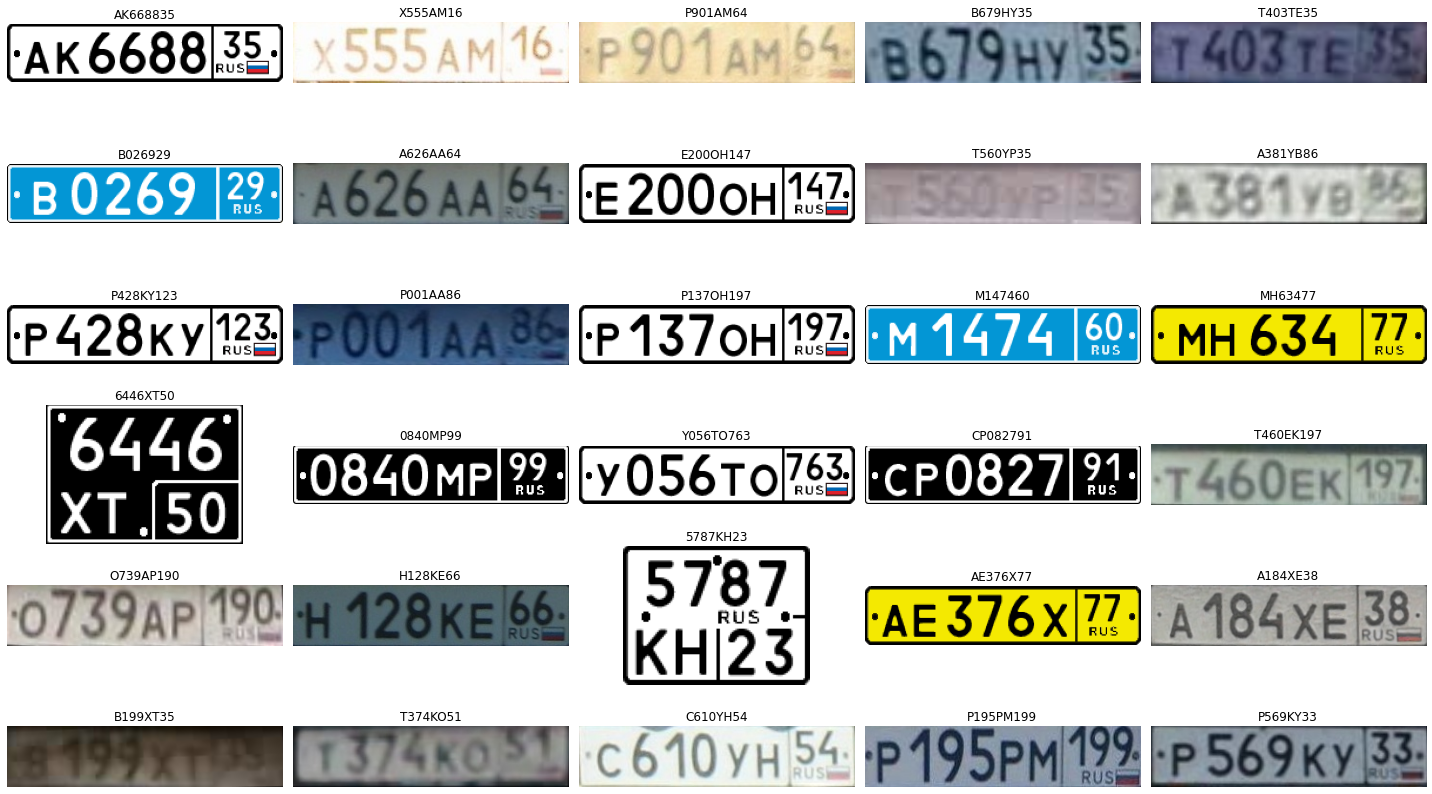

In [12]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Как видно, в данных встречаются номера разных типов. Для учебных целей отфильтруем примеры и оставим только те, которые относятся к "стандартным" гражданским номерным знакам, а именно имеющим вид `LDDDLLDD` или `LDDDLLDDD` (`L` = "letter", то есть буква, `D` = "digit", цифра).
Кроме того, отфильтруем примеры, в которые встречаются символы, не входящие в алфавит регистрационных знаков (см. переменную `abc` ниже).

**NB: используются только заглавные буквы латинского алфавита и цифры.**

In [13]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

In [14]:
print(ascii_uppercase)  # may be useful for functions below

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [15]:
print(digits)  # may be useful for functions below

0123456789


* **TODO: Реализовать функцию `compute_mask()`, которая бы возвращала маску из символов `L`/`D` для переданной строки `text`.**

  *Пригодятся переменные `ascii_uppercase` и `digits`.*

In [16]:
def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.
    
    Args:
        - text: String of text. 
        
    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D' 
        or None if non-letter and non-digit character met in text.
    """
    mask = []
    
    # YOUR CODE HERE
    # END OF YOUR CODE
    
    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99" ) == "LDDDLLDD"
assert compute_mask("P@@@KA@@" ) is None

AssertionError: 

* **TODO: Реализовать функцию `check_in_alphabet()`, которая возвращает `True`, если все символы из строки `text` содержатся в строке `alphabet`.**

In [ ]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    
    Args:
        - text: String of text.
        - alphabet: String of alphabet.
        
    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """
    
    # YOUR CODE HERE
    # END OF YOUR CODE
    
    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

Используем обе реализованные функции для фильтрации данных от нежелательных примеров.

In [ ]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.
    
    Args:
        - config: List of dicts, each dict having keys "file" and "text".
        
    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"], "text": item["text"]})
    return config_filtered

In [ ]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

Посмотрим, что осталось после фильтрации.

In [ ]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

---

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение в виде тензора (фиксированного размера `3xHxW`)
  - Изображение оригинальное для последуюшей визуализации
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости
  
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  
**Задание: Реализовать метод `text2seq` для кодирования текстовой последовательности в числовой вид, как сказано выше**.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config                  = config
        self.alphabet                = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms              = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "torch_image", "pil_image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        pil_image   = Image.open(self.image_names[item])
        torch_image = self.transforms(pil_image)
        
        text    = self.texts[item]
        seq     = self.text_to_seq(text)
        seq_len = len(seq)
        output  = dict(torch_image=torch_image, pil_image=pil_image, seq=seq, seq_len=seq_len, text=text)
        
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        
        # YOUR CODE HERE
        # END OF YOUR CODE
        
        return seq

Соберем датасет вместе:

In [ ]:
from torchvision.transforms.v2 import Resize, ToDtype, ToImage, Normalize, Compose

# ToImage - преобразование в тензор
# ToDtype - преобразование типа тензора
# Resize  - интерполяция тензора к требуемому размеру

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [ ]:
x = dataset[0]
print(x.keys())

In [ ]:
from torchvision.transforms.functional import to_pil_image

print("Image shape:", x["torch_image"].shape)
print("Seq:" , x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])

---

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`), а класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

**Задание: Реализовать функцтю `collate_fn` для формирования пакета данных**.

In [ ]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    torch_images, pil_images, seqs, seq_lens, texts = [], [], [], [], []
    # YOUR CODE HERE
    # END OF YOUR CODE
    return {"torch_images": torch_images, "pil_images":pil_images, "seq": seqs, "seq_len": seq_lens, "text": texts}

In [ ]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

In [ ]:
print("Tensor:" , batch["torch_images"].size())
print("Seq:"    , batch["seq"         ].size())
print("Seq:"    , batch["seq"         ])
print("Seq_len:", batch["seq_len"     ])
print("Text:"   , batch["text"        ])

#### Разработка модели CRNN

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABMAAAAKQCAIAAAD2dpEMAACAAElEQVR4XuydC7hVZbX+594bNveN
ouJdDBUBUREUb5l3zbKDYm0LT3JEQ8RbmmEKgqKipGiCCspRCgoVFBEDDPOOgJt9sjK7WnY0O51u
/+pkpWn7/805YbkcL3OyxlrvwLXY431+D8/e8/KNd33fN761xp6LOaM2l8vlcrlcLpfL5XK5SlAk
N7hcLpfL5XK5XC6Xy7UxeQHpcrlcLpfL5XK5XK6S5AWky+VyuVwul8vlcrlKkheQLpfL5XK5XC6X
y+UqSV5Aulwul8vlcrlcLperJHkB6XK5XC6Xy+VyuVyukuQFpMvlcrlcLpfL5XK5SpIXkC6Xy+Vy
uVwul8vlKkleQLpcLpfL5XK5XC6XqyR5AelyuVwul8vlcrlcrpLkBaTL5XK5XC6Xy+VyuUqSF5Au
l8vlcrlcLpfL5SpJXkC6XC6Xy+VyuVwul6skeQHpcrlcLpfL5XK5XK6SpCsgf/Pdthfm/O3i5htn
f3Hli1/910mHjIzerxvGfsO3+3bf7tt9u2/37b7dt/t2396utn/iw6P23m3wRZ+6ofXet0PJUIm+
9pvfHP3CCx8aO7brbrsVouxzww3HvPji9iedVBTZt1e6feg99xy9bl3ocDkGudIVkK+u/vuBex99
zAEjll7/i9a72hzHcRzHcRzHcdbe+fb8K1uP3H/40H5HvfbCP2UVodFdv/51nwkTeh5xRP9584as
WTO0tdUxYtvhw7sPHnzHL38pxyBXugLyivOnHn3Aqetm/wsnjeM4juM4juM47ZlQJoQa8kvnXy+r
CI1mv/EGljqOEVsfc8y/jR8vxyBXugKy34cGLpj4Is4Vx3Ecx3Ecx3GceVe0DNhzP1lFaHT06NGD
n30WSx3HgoELFmy/xx5yDHKlKyA7dmxce+fbOFEcx3Ecx3Ecx9liePKWP0z87Jynv/In3JXPutn/
evnbv5dVhEYNHToMeeEFLHWcHPZ/8sk+EycOfvpp3JVP6OrQ4XIMcqUrIKMowlniOI7jOI7jOA6X
MZ+4unuXnoIpZ83DIy1YMPHF8Mn/wWt+hLs2yesvvCOrCI1CXKxzqpmdxoxp6N49pqmpcccdewwZ
suPnPrff8uV4pB0DFiyIb43z4IO4a5OEE+UY5Ep5tBeQjuM4juM4jmPPqBMvb+zY+ebzHi7m0am/
xCMtqKSA3GXH3WUVoVHNFZA7jBpV39i414wZgb433rjjOec0br99Q7due91+Ox5sRCUF5LVr1sgx
yJUXkI7jOI7jOI5TdYQCskunbrg9Zen1v1h87U9bZr8765Inpoyev3DyD8QB9131vWvO+trUz93/
0JQfFzaG4+/6wlOTRt1724XLVt/+d3FK2HLLuEfCWUuuewULyG9M/M7V//HVG8csfOKW3xc2rrcx
651gIzT77G1/CRu1V7SEarKA7NKleMvgZ5/ttu++DT16DH7qqeLtA77xjd2vvjoUmfs/8YRoZOB9
9+1+zTV9p07d56GH3tve0tLvrrt2nzRpz9tuO2D1anFK2LLHLbeEswYtWYIF5EZjDVq6dNDixUNC
s7NmhWbT/2t65+uvyzHIlW50vYB0HMdxHMdxnM1AfgF50sFnDO131LD+x+607Yd2275fXV3dFz89
I9313Iy/fmT/f6uvb+i70z5773pAY4dOX7ngm63Jf2scuPtBnTp2Cf/26LrVjtv0WXT1DwsNrrzp
N7vv0L9rp+5hb1PXrUced0mhgFw1882P7PeJ0M7APgfuvG3frp17zLhoRcHGkH5HDt7zw9s07bBr
7z3TBr2ADOx9773hhfS58sr01wNWrer5kY/UNTZ2HTiw0847N3TtuteMGet3PffcVmFXfX2Xvn27
7r13OGbPr3xlaPLfGrsNHFjfqVP4N9SijTvuuM+iRYX291u5svPuu9d37RrvbWrafmT8fM60gMyJ
1eukk3oMGdJ98OCO22zTaddd0wa32WUXOQa50o2uF5CO4ziO4ziOsxkIBWTHDo0Xn3ZTMaEITPeG
yi18Mh//mdvTX8884Yuhrnv+9r+Fn0/7yNjuXXp+9Utr011P3PL7x7786/DDJ488L5R5S657Jfz8
1K3/r/9uQ/rtsn8h3KlHfG6nbXZfMe2N8HM4PhSKhQLy9KMv7L3Vzo9c//PW5B45Zxx36bY9d3x2
xv8VbFxw6g1pI+nT/ryAjGlpqW9s3G7EiPTX3qef3rF370GPPBL/um7d9mec0XHbbQ9ILgBud9pp
Dd279//qV9Mj93/iif0eeyze/slPhjJv0JIl4efBTz3VtX//Lv36Fdrf9tRTG3faab8VK8LP4fhQ
KBYKyJxYoYAMh+18wQXr21m3bqj1/4G89HOTCpPMcRzHcRzHcRwjQgFZX1c/oM/QYgr/BzJUbrts
t0fh4PsnfT+UAQuvfnnNHW916tjlcyfLD+2htGvs2HncKdcXtkwftySckj6ir2X2u40dOn2h+SuF
vV8aeWdaQK698+0unbpd2nxrYddzM/5aV1c386LHWhMbobYMpxfH0hYkQh+/9NJCmVQTbLyAbG3t
2KtXrxNOCD8MWbs2HLBr0es64Lnnorq6vWbOHLJmTX2nTjt+7nPy9HXrQv2587hxhS17TJ8eOnbA
ggXxry0tdY2Nu37hC4W9u33pS2kBmRNraFJAhtoynF4cSzteuqNff+Gd4snhOI7jOI7jOI4Fm/wK
68EDji/8uvzG10MZcM/4VQ9f+7Pwwy3jHhHHL7vxtbD91vMfLWxZOvXVsGXauYsKe++85NuFvf/5
xefSAnLJda+EH3botVvfnfYpECrbUGGmNob2O0rE0hYkQne+/npxeVP9bLyADBVgp07bJlcgBy2J
a/XGHXbo0rdvgai+PlR9gx5+OOza45ZbxOn7LlsWtu95663vbVm6NGzpO21aYW+/O+8s7N37P/8z
LSBzYg1Nv8I6dKiIpR0v3dF+BdJxHMdxHMdxNgObLCAP3efEwq9pARmqvqXX/6JQFhaz8qbfhO03
jV1c2LJ4yk/ClpvPezj8/K2b/if8POPC5YW9sy55Ii0g0wYvHHHj3MvXFBNOQRspa5a8IqsIjbaM
K5AD5s0L/ZaWbYOS2m/nCy/sP3duMft961vprrQsLGa/lSvD9j1uuqmwZZ/Fi+MtN98c7/3Wt8LP
e274n42BfrNmrS8gs2MNTQrIpkMPFbFsC8jI/w+k4ziO4ziO49hTXgHZMvvdnt22aT7qfDylqevW
nz3hssKvk0fNDac8fO3P0l97dN1qzMmTC3vHnXJ9WkCGBpu69Tr96AuxwVawkdLengOJBeSQNWt6
DBtW37Xr/t/+drylpaVDU1Pv00/Hc+NdPXtu19wst7e2xrfG+exnC7/uPnly6JlBDz+8fm+PHjuO
GVPYu/O4cWkBmRfLC0jHcRzHcRzH2VJJnwN51xeeKmbp9b9I92YVkK1J7dehoeOEf7/7+dv/9sKs
f94zflX6JI+x/zYlVKRfueCboSb8+oT/2n7rXYtbOOfjV4Ua8u7Lnlk3+1/hlF5N26cFZNh10Yhp
DfUdrjxj9qqZb4a937zhvz//yZvT2/lstIBsj8+B7NQpvdC315137nrppZ379q1vbCy+frjzRRfV
NTTsduWVB6xaNXTdun2/+c1dPv/5/Z98Mt41blxdhw59Jkw44Pnnh7zwwt733JM+yWOnsWNDXRrf
kbWlZcDXv964/fbFtd+O55wTasi97747tBZO6dir1/oCMjfWRgtIfw6k4ziO4ziO49Q8oYCMQKM/
NiHdm1NAhvowHBaKz/q6+vr6hu5deoaCMGxffcc/PnHYf4SNoRoMBw8bcNzjN/+20EKoNo8afErY
3tihU6gex396ZrShgAxFYyhKu3VuqqurC6Vp+Hffvoc8dev/QxspkfKKllBUgwXk+uGpq2vo2rXL
Xnv1/vSnBy1e/L7D1q0LhWJDt25R3Ikdwr/d9t13/VMiW1p2HD06FJxRfTxiDd27h4IwbB+yevU2
n/hEvLGhIbTdNGzY/o8/XmgwVJtbHXVUHLOxMVSPu44fHxWeA5kda6MFpD8H0nEcx3Ecx3HaO6tm
vrlg4ouhAlxzx1vF25+45fdfn/Bfy6f9Ck8JfPOG/77vqu+JU1LCxgcmv3T/pO+npWMO7a2ALJ0h
a9YMfOCBgfffv750LOKAVasGLFgQ30Z1zZri7fs/8cSAr399v+XLsbXAvt/85sD77hOnpOTEEvhz
IB3HcRzHcRzH+cDwArK20I6X7mi/C6vjOI7jOI7jODloCxKhmrsLa62jHS/d0f4cSMdxHMdxHMdx
ctAWJEI19xzIWkc7Xrqj/Qqk4ziO4ziO4zg5tLfnQNY6tgVkaP3V5952HMdxHMdxHMfZKH/45T9l
FaFRqDhufvVVZ7NhXkC+6XK5XC6Xy+VyuVwZ6tOnj6wiNPKKYzPrZz/7mRyDXHkB6XK5XC6Xy+Vy
uWjSXtES8opjM+vtt9+WY5Ar3ej6cLpcLpfL5XK5XK4ceQFZW9JeMdaNrg+ny+VyuVwul8vlypEX
kLUl7Xjpjr7qqqtkQJfL5XK5XC6Xy+XaIG1BIuQVx2aWdrx0R7/99tsyoMvlcrlcLpfL5XJtkLYg
EfKKYzNLO166o/3vAS6Xy+VyuVwulytH2rt6CnnFsZllW0D6N5JdLpfL5XK5XC5XjrR39RTyimMz
ywtIl8vlcrlcLpfL9YFJe1dPIa84NrO0V4y9gHS5XC6Xy+VyuVw0aa9oCXnFsZmlvWKsG10fTpfL
5XK5XC6Xy5UjLyBrS9orxrrR9eF0uVwul8vlcrlcOfICsrakHS/d0X5PJJfL5XK5XC6Xy5UjbUEi
5BXHZpZ2vHRH+1NZXC6Xy+VyuVwuV460BYmQVxybWdrx0h2t+nvA33/5xF+ev+a680/YZ4/eHRrq
51592l+fn9x8wr7R++Xbfbtv9+2+3bf7dt/u2327b//At+/dZ9tJY479v+evCR/j5Sd7jbR39RRS
VRyuyhWZFpCR5hvJf3768qP3jkYcEL04MfrnrKjtLsdxHMdxHMdxqpTvTIyaD4wO3yP6yzOXy0/2
Gmnv6imkqjhclauKCsjrxx196gHRv2bLqek4juM4juM4TnWy7MLordVXyk/2Gmnv6imkqjhclUt7
xdiwgFw6/fSfXy9npOM4juM4juM41czfV31JfrLXSHtFS0hVcbgql/aKsW50VcM54azDcTo6juM4
juM4jiN46gvRYxfJjZvcZcG/ZkdbN3WWn+w18gKytqS9YqwbXdVwxlMHZqTjOI7jOI7j1DpXfyLq
2WU9OzRFh/SN7v53eYyKMw6OTtxHbtzkLiNUn/lRXkDWlrTjpTtadU8kLyAdx3Ecx3GcLZLLT4w6
d4xWXBTz0NhozBFx0TXrDHlY6eRUiTm7jKiwhNMWJEKqisNVubTjpTta9VQWLyAdx3Ecx3GcLZJQ
QHbr9L4tg3eNPlpU5v1yavTwedG8s6I1l2/kppLfuyr62lnR/Z+Lfjxl/RZRJf7+lmjdldEfb31v
19t3xsXq3FHRy1fL1t6dHX/N9d5R8f1v/n77e9t/cX3002vjvU9cEs0fHf1gsjzxOxOjr/5HtHBM
HK54+wdbQKoqDlfl0o6X7mjV3wO8gHQcx3Ecx3G2SEQBGYq0ftvHz8BIf735k1GXjtG+O0cHfyj+
4Yi9or/OWL8r/PBv+0cN9dE+O0UH7Bp16hB984J4e3EB+f1J0S5bR589JC4a012hhWG7xyH67xDV
1UU3jngv9B9uiQ7aPY4S/t2qa9Rnm+iHGyrMcOJR/aJj+0cf2jY+N5w449Prd705M/rEfnH0A/tE
fbeNenSOq9NCmxUWkNq7egqpKg5X5bItIFWTyQtIx3Ecx3EcZ4skFJCNHaKZn4758mnRcQOinbeK
vnvV+r2hhPvTV9b//Ma0aLde0bXD1/869iPxf5tc+6X1v/7+lujXX45/KBSQT1wSH/Clj74XK+wK
uv6U9b9OGxHXnz+9dv2v5x0Z/yfMV66Lf/5/t0ZDdov23+V9J97+mfW/fvGEuFD8W3KJ8sKjY8Pp
ExP+NTu69Lhox57R/22oclWf+VHau3oKVRjdpVUVFZB+F1bHcRzHcRxniyQUkPV18QXGwOBd48Ls
1AOi12983zF/uS36yZTopcnvFYdv3RFfKpx0smytbUMBOX90/F8r7xwpd23XY/3VyMA/Z0XbN0VX
fTz+OdR+4fhCbRlYMi4u/16cuP7EPbZ7b9f3J8W7Xr46bqpbp+jW5vd2/XVGfH2ycK/XHy48V36y
10h7V08hVcXhqlzaK8aGBeSbz44vTErHcRzHcRzH2WIQX2H9vxnR0XtHA3eM3pkV/xqKxkP7xhXm
tt3j75T27BJ/nTVs/9m1cQn3yDjZWltS7DV1jvfinXjCrg/v+b4tR/aLRg6Lf3jtxviUR89/b9er
U+Mti85df+LxA97b9Xpy8Krx8eXKoN16xV+jLRDcFgrX8DFefrDXKFJe0RLSVRyuiqW9YqwbXdVw
+hVIx3Ecx3EcZ4sEb6Jz76i4KkvvcBMqyU8NXX8LnMDFx8YVWltyV5tCdScIxd5H9opOGBj/f8Vf
JN8sLd41bPf3bQnV6X8cFv/wm5viBhePfW/XT6bEWx4+b/2JxTfmSQvI57643saNI+Ib/BTzPzet
P7LPDj3lJ3uNvICsLWmvGOtGVzWc8dSB3HAcx3Ecx3GcWgcLyKmnxFXZL6fGXweN3n9VMJR/aQH5
7uxom27R+UfJ1to2FHv/uCO+xc4uW8d1YPGuHp3jL8Smv4b2e3Z57z46W3eNLjvhvYPnJnXsz5L/
IZlVQAYbvbrF/w2ysEug+syP8gKytqQdL93RqnsieQHpOI7jOI7jbJGEArJLx/UX7p65LLrt9Lio
O2Kv9Xt794i/Yhqqwb/fHk0+Ob7dTlpABq4/JerYEN397/HNbP45K/5Cafokj0KxFzaefmD8vxxf
2vDUjbArnPLZQ+Ivyobq8azD4tr1tzev3zvl3+Jfv3lBXBb+14Ro163fKxqzCsi25E48Heqj2WfE
t2P91+zov2+I7xz7hw0P86iwhNMWJEKqisNVubTjpTta9VQWLyAdx3Ecx3GcLZJQQBYUqru+28bf
Uy08TXHJuLieDNtDkfbRfd77CmtbchFywsfiO9/U18U3Uw2HhRqy7f3FXjgmVInbdIsLwnTX8QPi
76yG1sIpW3Vd/w3VlFCmhl2htbA36LgB79WWOQVkKBpDKdvUOb53TvAZ/j2kb3wT1/TI6AMtIFUV
h6tyacdLd7Tq7wGxFUg2x3Ecx3Ecx9nieXNm9L2r5H1Zi/e+ODH60TXxfVlxbxa//nJ8VvocDkGo
XUO1+atpcns+IfpLk+O7sxZKx5QKC0jtXT2FVBWHq3LZFpCqyeQFpOM4juM4juPUHKrP/CjtXT2F
Kozu0qqKCki/C6vjOI7jOI7j1Bz+HMh2Je0VY8MC0p8D6TiO4ziO4zg1hz8Hsl1Je8VYN7qq4fQr
kI7jOI7jOI5Tc/hzINuVtFeMdaOrGk7/P5CO4ziO4ziOU3OoPvOjvICsLWnHS3e06p5Iwcp/u1wu
l8vlcrlcrppShSWctiARUlUcrsqlHS/d0aqnsngB6XK5XC6Xy+Vy1Zw+2AJSVXG4Kpd2vHRHq/4e
4AWky+VyuVwul8tVc6qwgNTe1VNIVXG4KpdtAamaTF5Aulwul8vlcrlcNSfVZ36U9q6eQhVGd2lV
RQXk+PHj5WR0uVwul8vlcrlc1a3vfOc78pO9Rtq7egqpKg5X5dJeMTYsIH/3u9/JyehyuVwul8vl
crmqW+FjvPxkr5H2ipaQquJwVS7tFWPd6KqG069Aulwul8vlcrlcNaddd91VfrLXyAvI2pL2irFu
dFXD6f8H0uVyuVwul8vlqjmpPvOjvICsLWnHS3e06p5IXkC6XC6Xy+VyuVw1pwpLOG1BIqSqOFyV
SzteuqNVT2XxAtLlcrlcLpfL5ao5fbAFpKricFUu7Xjpjlb9PcALSJfL5XK5XC6Xq+ZUYQGpvaun
kKricFUu2wJSNZm8gHS5XC6Xy+VyuWpOqs/8KO1dPYUqjO7SqooKSL8Lq8vlcrlcLpfLVXPy50C2
K2mvGBsWkP4cSJfL5XK5XC6Xq+bkz4FsV9JeMdaNrmo4/Qqky+VyuVwul8tVc/LnQLYraa8Y60ZX
NZyq/wMZWUoGK1eyXapksHIl26VKBitXsl2qZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiq
ZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZDCSZBiqZLBsRZrP/Kho
MxaQ4jVyJYOxJeNRJYNlK1KOl+5o1T2RIuU0bW1rtUBlI19x58rmOXBNytZJcE1C8xyIJoVqomOF
Qst3tbZZYOo5WZf4mHrGYaVg6hmicTD1LIORMPWM6UPB1DOmDwVTzzisFEw9QzQOpp5lMBKmnjF9
KJh6xvShoPIcacoPVPIqype24mgbY0KFnVCKTKeoDJYt7XjpjlY9lUU7TXFBoaCyka+4c2XzHLgm
ZeskuCaheQ5Ek0I10bFCpquSDEZSsoSZYOoZh5WCqWeIxsHUswxGwtQzpg8FU8+YPhRMPeOwUjD1
DNE4mHqWwUiYesb0oWDqGdOHgspzpCk/UMmrKF/aigNrPwoVdkIpMp2iMli2tOOlO1r79wA5GbNV
E6tS3LmyeQ5ck7J1ElyT0DwHokmhmuhYIdNVSQYjKVnCTDD1jMNKwdQzRONg6lkGI2HqGdOHgqln
TB8Kpp5xWCmYeoZoHEw9y2AkTD1j+lAw9YzpQ0HlOdKUHyjtXT2FtBUH1n4UKuyEUmQ6RWWwbCWz
TiHl0UorcjJmqyZWpbhzZfMcuCZl6yS4JqF5DkSTQjXRsUKmq5IMRlKyhJlg6hmHlYKpZ4jGwdSz
DEbC1DOmDwVTz5g+FEw947BSMPUM0TiYepbBSJh6xvShYOoZ04eCynOk+cyP0t7VU0gVPe4xqP0o
qGyUJ9MpKoNlK5l1CimP1lhR3YW1JlaluHNl8xy4JmXrJLgmoXkORJNCNdGxQqarkgxGUrKEmWDq
GYeVgqlniMbB1LMMRsLUM6YPBVPPmD4UTD3jsFIw9QzROJh6lsFImHrG9KFg6hnTh4LKcw09BzLu
Maj9KKhslCfTKSqDZUt7xTiSG3KlsqJ6DmRNrErxBJXNc+CalK2T4JqE5jkQTQrVRMcKma5KMhhJ
8dyA9zwKpp5xWCmYeoZoHEw9y2AkTD1j+lAw9YzpQ8HUMw4rBVPPEI2DqWcZjISpZ0wfCqaeMX0o
qDzX0HMg41hQ+1FQ2ShPplNUBsuW9oqxbnRVVvwKZOlwTcrWSXBNQvMciCaFaqJjhUxXJRmMpHhu
wHseBVPPOKwUTD1DNA6mnmUwEqaeMX0omHrG9KFg6hmHlYKpZ4jGwdSzDEbC1DOmDwVTz5g+FFSe
a+g5kHEsqP0oqGyUJ9MpKoNlS3vFWDe6KiuqaVoTq1I8QWXzHLgmZeskuCaheQ5Ek0I10bFCpquS
DEZSPDfgPY+CqWccVgqmniEaB1PPMhgJU8+YPhRMPWP6UDD1jMNKwdQzRONg6lkGI2HqGdOHgqln
TB8KKs+R5jM/KnkV5UsVPY4FtR8FlY3yZDpFZbBsacdLd7T2nkhyMmYrqoVVKe5c2TwHrknZOgmu
SWieA9GkUE10rJDpqiSDkZQsYSaYesZhpWDqGaJxMPUsg5Ew9YzpQ8HUM6YPBVPPOKwUTD1DNA6m
nmUwEqaeMX0omHrG9KGg8hxpyg9U8irKl7biwNqPQoWdUIpMp6gMli3teOmO1j6VRU7GbNXEqhR3
rmyeA9ekbJ0E1yQ0z4FoUqgmOlbIdFWSwUhKljATTD3jsFIw9QzROJh6lsFImHrG9KFg6hnTh4Kp
ZxxWCqaeIRoHU88yGAlTz5g+FEw9Y/pQUHmONOUHKnkV5UtbcWDtR6HCTihFplNUBsuWdrx0R2v/
HiAnY7ZqYlWKO1c2z4FrUrZOgmsSmudANClUEx0rZLoqyWAkJUuYCaaecVgpmHqGaBxMPctgJEw9
Y/pQMPWM6UPB1DMOKwVTzxCNg6lnGYyEqWdMHwqmnjF9KKg8R5ryA6W9q6eQtuLA2o9ChZ1Qikyn
qAyWrWTWKaQ8WmlFTsZs1cSqFHeubJ4D16RsnQTXJDTPgWhSqCY6Vsh0VZLBSEqWMBNMPeOwUjD1
DNE4mHqWwUiYesb0oWDqGdOHgqlnHFYKpp4hGgdTzzIYCVPPmD4UTD1j+lBQeY40n/lR2rt6Cqmi
xz0GtR8FlY3yZDpFZbBsJbNOIeXRGit+F9bS4ZqUrZPgmoTmORBNCtVExwqZrkoyGEnJEmaCqWcc
VgqmniEaB1PPMhgJU8+YPhRMPWP6UDD1jMNKwdQzRONg6lkGI2HqGdOHgqlnTB8KKs/+HMi29lRA
aq8YR3JDrlRW/DmQpcM1KVsnwTUJzXMgmhSqiY4VMl2VZDCS4rkB73kUTD3jsFIw9QzROJh6lsFI
mHrG9KFg6hnTh4KpZxxWCqaeIRoHU88yGAlTz5g+FEw9Y/pQUHn250C2tacCUnvFWDe6Kit+BbJ0
uCZl6yS4JqF5DkSTQjXRsUKmq5IMRlI8N+A9j4KpZxxWCqaeIRoHU88yGAlTz5g+FEw9Y/pQMPWM
w0rB1DNE42DqWQYjYeoZ04eCqWdMHwoqz/4cyLb2VEBqrxjrRldlRTVNa2JViieobJ4D16RsnQTX
JDTPgWhSqCY6Vsh0VZLBSIrnBrznUTD1jMNKwdQzRONg6lkGI2HqGdOHgqlnTB8Kpp5xWCmYeoZo
HEw9y2AkTD1j+lAw9YzpQ0HlOdJ85kclr6J8qaLHsaD2o6CyUZ5Mp6gMli3teOmO1t4TSU7GbEW1
sCrFnSub58A1KVsnwTUJzXMgmhSqiY4VMl2VZDCSkiXMBFPPOKwUTD1DNA6mnmUwEqaeMX0omHrG
9KFg6hmHlYKpZ4jGwdSzDEbC1DOmDwVTz5g+FFSeI035gUpeRfnSVhxY+1GosBNKkekUlcGypR0v
3dHap7LIyZitmliV4s6VzXPgmpStk+CahOY5EE0K1UTHCpmuSjIYSckSZoKpZxxWCqaeIRoHU88y
GAlTz5g+FEw9Y/pQMPWMw0rB1DNE42DqWQYjYeoZ04eCqWdMHwoqz5Gm/EAlr6J8aSsOrP0oVNgJ
pch0ispg2dKOl+5o7d8D5GTMVk2sSnHnyuY5cE3K1klwTULzHIgmhWqiY4VMVyUZjKRkCTPB1DMO
KwVTzxCNg6lnGYyEqWdMHwqmnjF9KJh6xmGlYOoZonEw9SyDkTD1jOlDwdQzpg8FledIU36gtHf1
FNJWHFj7UaiwE0qR6RSVwbKVzDqFlEcrrcjJmK2aWJXizpXNc+CalK2T4JqE5jkQTQrVRMcKma5K
MhhJyRJmgqlnHFYKpp4hGgdTzzIYCVPPmD4UTD1j+lAw9YzDSsHUM0TjYOpZBiNh6hnTh4KpZ0wf
CirPkeYzP0p7V08hVfS4x6D2o6CyUZ5Mp6gMlq1k1imkPFpjxe/CWjpck7J1ElyT0DwHokmhmuhY
IdNVSQYjKVnCTDD1jMNKwdQzRONg6lkGI2HqGdOHgqlnTB8Kpp5xWCmYeoZoHEw9y2AkTD1j+lAw
9YzpQ0Hl2Z8D2daeCkjtFeNIbsiVyoo/B7J0uCZl6yS4JqF5DkSTQjXRsUKmq5IMRlI8N+A9j4Kp
ZxxWCqaeIRoHU88yGAlTz5g+FEw9Y/pQMPWMw0rB1DNE42DqWQYjYeoZ04eCqWdMHwoqz/4cyLb2
VEBqrxjrRldlxa9Alg7XpGydBNckNM+BaFKoJjpWyHRVksFIiucGvOdRMPWMw0rB1DNE42DqWQYj
YeoZ04eCqWdMHwqmnnFYKZh6hmgcTD3LYCRMPWP6UDD1jOlDQeXZnwPZ1p4KSO0VY93oqqyopmlN
rErxBJXNc+CalK2T4JqE5jkQTQrVRMcKma5KMhhJ8dyA9zwKpp5xWCmYeoZoHEw9y2AkTD1j+lAw
9YzpQ8HUMw4rBVPPEI2DqWcZjISpZ0wfCqaeMX0oqDxHms/8qORVlC9V9DgW1H4UVDbKk+kUlcGy
pR0v3dHaeyLJyZitqBZWpbhzZfMcuCZl6yS4JqF5DkSTQjXRsUKmq5IMRlKyhJlg6hmHlYKpZ4jG
wdSzDEbC1DOmDwVTz5g+FEw947BSMPUM0TiYepbBSJh6xvShYOoZ04eCynOkKT9QyasoX9qKA2s/
ChV2QikynaIyWLa046U7WvtUFjkZs1UTq1LcubJ5DlyTsnUSXJPQPAeiSaGa6Fgh01VJBiMpWcJM
MPWMw0rB1DNE42DqWQYjYeoZ04eCqWdMHwqmnnFYKZh6hmgcTD3LYCRMPWP6UDD1jOlDQeU50pQf
qORVlC9txYG1H4UKO6EUmU5RGSxb2vHSHa39e4CcjNmqiVUp7lzZPAeuSdk6Ca5JaJ4D0aRQTXSs
kOmqJIORlCxhJph6xmGlYOoZonEw9SyDkTD1jOlDwdQzpg8FU884rBRMPUM0DqaeZTASpp4xfSiY
esb0oaDyHGnKD5T2rp5C2ooDaz8KFXZCKTKdojJYtpJZp5DyaKUVORmzVROrUty5snkOXJOydRJc
k9A8B6JJoZroWCHTVUkGIylZwkww9YzDSsHUM0TjYOpZBiNh6hnTh4KpZ0wfCqaecVgpmHqGaBxM
PctgJEw9Y/pQMPWM6UNB5TnSfOZHae/qKaSKHvcY1H4UVDbKk+kUlcGylcw6hZRHa6z4XVhLh2tS
tk6CaxKa50A0KVQTHStkuirJYCQlS5gJpp5xWCmYeoZoHEw9y2AkTD1j+lAw9YzpQ8HUMw4rBVPP
EI2DqWcZjISpZ0wfCqaeMX0oqDz7cyDb2lMBqb1iHMkNuVJZ8edAlg7XpGydBNckNM+BaFKoJjpW
yHRVksFIiucGvOdRMPWMwxqYPHdyY6dGpEu3Ljt9aKeTR5288OWFeFYxpp4hGgdTzzIYCVPPmD4U
TD1j+lAw9YzD2uo5yFZWP1eOqWdMHwqmnjF9KKg8+3Mg29pTAam9YqwbXZUVvwJZOlyTsnUSXJPQ
PAeiSaGa6Fgh01VJBiMpnhvwnkfB1DMOa2DmYzMPPfFQ5KBjDtq9/+7hrE5dOt2z6h48cfPMDYjG
wdSzDEbC1DOmDwVTz5g+FEw947C2eg6yldXPlWPqGdOHgqlnTB8KKs/+HMi29lRAaq8Y60ZXZUU1
TWtiVYonqGyeA9ekbJ0E1yQ0z4FoUqgmOlbIdFWSwUiK5wa851Ew9YzDukkWvryw9869+w3uh7sK
mHqGaBxMPctgJEw9Y/pQMPWM6UPB1DMO6ybxHNSqvH4uBVPPmD4UTD1j+lBQeY40n/lRyasoX6ro
cSyo/SiobJQn0ykqg2VLO166o7X3RJKTMVtRLaxKcefK5jlwTcrWSXBNQvMciCaFaqJjhUxXJRmM
pGQJM8HUMw5rKUyZNyWcu+KNFbgrxdQzRONg6lkGI2HqGdOHgqlnTB8Kpp5xWEvBc1Clsvt5k5h6
xvShYOoZ04eCynOkKT9QyasoX9qKA2s/ChV2QikynaIyWLa046U7WvtUFjkZs1UTq1LcubJ5DlyT
snUSXJPQPAeiSaGa6Fgh01VJBiMpWcJMMPWMw1oK93///nDuvJZ5uCvF1DNE42DqWQYjYeoZ04eC
qWdMHwqmnnFYS8FzUKWy+3mTmHrG9KFg6hnTh4LKc6QpP1DJqyhf2ooDaz8KFXZCKTKdojJYtrTj
pTta+/cAORmzVROrUty5snkOXJOy9YSqupdATfSkUFbHVo6pZ1xQKJh6xvc8CqaecVhLYc6zc8K5
933vPtyVYuoZonEw9SyDkTD1jOlDwdQzpg8FU884rKXgOahS2f28SUw9Y/pQMPWM6UNB5TnSlB8o
7V09hbQVB9Z+FCrshFJkOkVlsGwls04h5dFKK3IyZqsmVqW4c2XzHLgmZesJVXUvgZroSaGsjq0c
U8+4oFAw9YzveRRMPeOwlkLzBc2NnRpX/3017kox9QzROJh6lsFImHrG9KFg6hnTh4KpZxzWUvAc
VKnsft4kpp4xfSiYesb0oaDyHGk+86O0d/UUUkWPewxqPwoqG+XJdIrKYNlKZp1CyqM1VvwurKXD
NSlbL4HNfC+BmuhJofI6thRMPeOCQsHUM77nUTD1jMMaePpPTz/4oweRB156YOZjM0ecO6Kuru60
safhiZtnbkA0DqaeZTASpp4xfSiYesb0oWDqGYe11XOQrax+rhxTz5g+FEw9Y/pQUHn250C2tacC
UnvFOJIbcqWy4s+BLB2uSdl6aWzOewnURE8Kld2xm8TUMy4oFEw943seBVPPOKyBiXMmxlGzdeTw
I1e9uQpP3DxzA6JxMPUsg5Ew9YzpQ8HUM6YPBVPPOKytnoNsRRn9XDmmnjF9KJh6xvShoPLsz4Fs
a08FpPaKsW50VVb8CmTpcE3K1ktjc95LoCZ6Uqjsjt0kpp5xQaFg6hnf8yiYesZhDcxvnT96wmhk
zOQx428fn/PfrgqYeoZoHEw9y2AkTD1j+lAw9YzpQ8HUMw5rq+cgW1n9XDmmnjF9KJh6xvShoPLs
z4Fsa08FpPaKsW50VVZU07QmVqV4gsrmOXBNytZLY3PeS6AmelKo7I7dJKaecUGhYOoZ3/MomHrG
YS2Fh3780OS5k3F7AVPPEI2DqWcZjISpZ0wfCqaeMX0omHrGYS0Fz0GVyu7nTWLqGdOHgqlnTB8K
Ks+R5jM/KnkV5UsVPY4FtR8FlY3yZDpFZbBsacdLd7T2nkhyMmYrqoVVKe5c2TwHrknZemlsznsJ
1ERPCpXdsZvE1DMuKBRMPeN7HgVTzzispXDFrCvyzzX1DNE4mHqWwUiYesb0oWDqGdOHgqlnHNZS
8BxUKb+vKsHUM6YPBVPPmD4UVJ4jTfmBSl5F+dJWHFj7UaiwE0qR6RSVwbKlHS/d0dqnssjJmK2a
WJXizpXNc+CalK0nVNW9BGqiJ4WyOrZyTD3jgkLB1DO+51Ew9YzDWgr+4VWl/L6qBFPPmD4UTD1j
+lAw9YzDWgqegyrl91UlmHrG9KFg6hnTh4LKc6QpP1DJqyhf2ooDaz8KFXZCKTKdojJYtrTjpTta
+/cAORmzVROrUty5snkOXJOy9YSqupdAVAs9KRRldGzlmHrGBYWCqWd8z6Ng6hmHtRT8w6tK+X1V
CaaeMX0omHrG9KFg6hmHtRQ8B1XK76tKMPWM6UPB1DOmDwWV50hTfqC0d/UU0lYcWPtRqLATSpHp
FJXBspXMOoWURyutyMmYrZpYleLOlc1z4JqUrSdU1b0EaqInhbI6tnJMPeOCQsHUM77nUTD1jMNa
Cv7hVaX8vqoEU8+YPhRMPWP6UDD1jMNaCp6DKuX3VSWYesb0oWDqGdOHgspzpPnMj9Le1VNIFT3u
Maj9KKhslCfTKSqDZSuZdQopj9ZY8buwlg7XpGydBNckNM+BaFKoJjpWyHRVksFISpYwE0w947CW
gn94VSm/ryrB1DOmDwVTz5g+FEw947CWguegSvl9VQmmnjF9KJh6xvShoPLsz4Fsa08FpPaKcSQ3
5EplhfIcyMlzJzd2akS6dOuy04d2OnnUyQtfXohnFaPKlnzFE1Q2z4FrUrZeGpvzZnQ10ZNCZXfs
JjH1jAsKBVPP+J5HwdQzDmvgkZ8/MvW+qTkMP3t41rmbYW5ANA6mnmUwEqaeMX0omHrG9KFg6hmH
tdVzkK38vqoEU8+YPhRMPWP6UFB59udAtrWnAlJ7xVg3uiorlCuQMx+beeiJhyIHHXPQ7v13D2d1
6tLpnlX34IkWq1I8QWXzHLgmZeulsTn/EFsTPSmU3zmVYOoZFxQKpp7xPY+CqWcc1tYS/uNxKjxx
88wNiMbB1LMMRsLUM6YPBVPPmD4UTD3jsLZ6DrKV31eVYOoZ04eCqWdMHwoqz/4cyLb2VEBqrxjr
RldlRTVNy1uVFr68sPfOvfsN7oe7Cqhs5CueoLJ5DlyTsvXS8AIyX/mdUwmmnnFBoWDqGd/zKJh6
xmENLH116bRF0zYJnrh55gZE42DqWQYjYeoZ04eCqWdMHwqmnnFYWz0H2crq58ox9YzpQ8HUM6YP
BZXnSPOZH5W8ivKlih7HgtqPgspGeTKdojJYtrTjpTtae08kORmzFZW7Kk2ZNyWcu+KNFbgrRWUj
X3HnyuY5cE3K1kvDC8h85XdOJZh6xgWFgqlnfM+jYOoZh5WCqWeIxsHUswxGwtQzpg8FU8+YPhRM
PeOwUjD1DNE4mHqWwUiYesb0oWDqGdOHgspzpCk/UMmrKF/aigNrPwoVdkIpMp2iMli2tOOlO1r7
VBY5GbNV9qp0//fvD+fOa5mHu1JUNvIVd65sngPXpGy9NLyAzFd+51SCqWdcUCiYesb3PAqmnnFY
KZh6hmgcTD3LYCRMPWP6UDD1jOlDwdQzDisFU88QjYOpZxmMhKlnTB8Kpp4xfSioPEea8gOVvIry
pa04sPajUGEnlCLTKSqDZUs7XrqjtX8PkJMxW2WvSnOenRPOzXkKhcpGvuLOlc1z4JqUrZeGF5D5
yu+cSjD1jAsKBVPP+J5HwdQzDivyzJ+fmTJ/ytkTz544Z2K65f7v37/stWV4ZAFTzxCNg6lnGYyE
qWdMHwqmnjF9KJh6xmFFPAcrVIn9XAamnjF9KJh6xvShoPIcacoPlPaunkLaigNrPwoVdkIpMp2i
Mli2klmnkPJopRU5GbNV9qrUfEFzY6fG1X9fjbtSVDbyFXeubJ4D16RsPaGqbkZXEz0plN85lWDq
GRcUCqae8T2PgqlnHFbBnY/f2dSrKTYRRYeeeGi68aQzTjrw6APx4AKmniEaB1PPMhgJU8+YPhRM
PWP6UDD1jMMq8BysXKX0c3mYesb0oWDqGdOHgspzpPnMj9Le1VNIFT3uMaj9KKhslCfTKSqDZSuZ
dQopj9ZYodyF9ek/Pf3gjx5EHnjpgZmPzRxx7oi6urrTxp6GJ1qsSnHnyuY5cE3K1hOq6mZ0US30
pFB+51SCqWdcUCiYesb3PAqmnnFYi3n8t4937dF12HHDFv5g4bnXnFv48DpjxYyGDg2r3lyFp6SY
eoZoHEw9y2AkTD1j+lAw9YzpQ8HUMw5rMZ6DFG2yn8vG1DOmDwVTz5g+FFSe/TmQbe2pgNReMY7k
hlyprFCeA7nJsufI4UfmLP3cVSmqheU+yujJqroZXU30pFBWx1aOqWdcUCiYesb3PAqmnnFYiwnr
WJduXZ7+09Ph53HXjSt8eF36i6Xh3Id+/BCekmLqGaJxMPUsg5Ew9YzpQ8HUM6YPBVPPOKzFeA5S
tMl+LhtTz5g+FEw9Y/pQUHn250C2tacCUnvFWDe6KiuUK5DzW+ePnjAaGTN5zPjbx+f818cCqmzJ
VzxBZfMcuCZl6yS4JqF5DkSTQjXRsUKmq5IMRlI8N+A9j4KpZxzWYsZcPWbPffdMfx53/XsfXle8
sSLaXPcAE/IcLMbUM6YPBVPPmD4UTD3jsBbjOUjRJvu5bEw9Y/pQMPWM6UNB5dmfA9nWngpI7RVj
3eiqrKimaU2sSvEElc1z4JqUrW+MD/ZeAjXRk0IldmwZmHrGBYWCqWd8z6Ng6hmHtZgrZl3Rranb
mrfWtL7/w+v0JdPDuSt/sxJPSTH1DNE4mHqWwUiYesb0oWDqGdOHgqlnHNZiPAcp2mQ/l42pZ0wf
CqaeMX0oqDxHms/8qORVlC9V9DgW1H4UVDbKk+kUlcGypR0v3dHaeyLJyZitqNxV6aEfPzR57mTc
XkBlI19x58rmOXBNytaBD/xeAjXRk0KldGx5mHrGBYWCqWd8z6Ng6hmHtZhHf/loh44dRn5+ZMu7
LedPPT9NumWvLdu9/+77HbYfHl/A1DNE42DqWQYjYeoZ04eCqWdMHwqmnnFYi/EcpGiT/Vw2pp4x
fSiYesb0oaDyHGnKD1TyKsqXtuLA2o9ChZ1QikynqAyWLe146Y7WPpVFTsZslb0q+cMnhPJ7o7U6
7iVQEz0ptMmOLRtTz7igUDD1jO95FEw947AKLpp2UThst3679Rvcb8c+Ox45/Miu3buGTFzw4gI8
uICpZ4jGwdSzDEbC1DOmDwVTz5g+FEw947AKPAcrVyn9XB6mnjF9KJh6xvShoPIcacoPVPIqype2
4sDaj0KFnVCKTKeoDJYt7Xjpjtb+PUBOxmyVvSp5ASmU3xut1XEvgZroSaFNdmzZmHrGBYWCqWd8
z6Ng6hmHFZm+ZPrgDw/u0LFDOD7k4NGnHr3oh4vwsGJMPUM0DqaeZTASpp4xfSiYesb0oWDqGYcV
8RysUCX2cxmYesb0oWDqGdOHgspzpCk/UNq7egppKw6s/ShU2AmlyHSKymDZSmadQsqjlVbkZMxW
2auSF5BC+b3RWh33EqiJnhTaZMeWjalnXFAomHrG9zwKpp5xWLNoebflub8+h9s3iqlniMbB1LMM
RsLUM6YPBVPPmD4UTD3jsGbhOVi2VP2swtQzpg8FU8+YPhRUniPNZ36U9q6eQqrocY9B7UdBZaM8
mU5RGSxbyaxTSHm0xgrlLqybxAtIofzeaK2OewnURE8KbbJjy8bUMy4oFEw943seBVPPOKwlsvxX
y3FjAVPPEI2DqWcZjISpZ0wfCqaeMX0omHrGYS0Rz8HSVUk/52PqGdOHgqlnTB8KKs/+HMi29lRA
aq8YR3JDrlRWKM+B3CReQArl90ZrddxLoCZ6UmiTHVs2pp5xQaFg6hnf8yiYesZh3SQr3lhx+oWn
N3ZqxF0FTD1DNA6mnmUwEqaeMX0omHrG9KFg6hmHdZN4DmpVXj+XgqlnTB8Kpp4xfSioPPtzINva
UwGpvWKsG12VFcoVyEd+/sjU+6bmMPzs4Vnn0leleILK5jlwTcrWgQ/8XgI10ZNCpXRseZh6xgWF
gqlnfM+jYOoZh7XAtEXTTjnnlJNHnXzlXVemV/6f/MOTIz8/srFzYzhx2LHD8JQCpp4hGgdTzzIY
CVPPmD4UTD1j+lAw9YzDWsBzkKX8fq4EU8+YPhRMPWP6UFB59udAtrWnAlJ7xVg3uiorqmmatSpN
nDMxHr1NCU+0WJWiWlju83ujwAd7L4Ga6EmhEju2DEw944JCwdQzvudRMPWMw5pyxqVnxIE36NhP
Hrvguwu23XHb8POw44bds+oePKUYU88QjYOpZxmMhKlnTB8Kpp4xfSiYesZhTfEcJCqnnyvE1DOm
DwVTz5g+FFSeI81nflTyKsqXKnocC2o/Ciob5cl0ispg2dKOl+5o7T2R5GTMVpSxKi19dem0RdM2
CZ5osSrFnSub58A1KVvP5oO6l0BN9KRQ6R277LVlo68cffjHDg+EH/L/g00rtWOFTFclGYykZAkz
wdQzDmvgsV8/Vt9Qv99h+3117Vcf+vFDoyeMDkdut9N2u+656+wnZ+PxiKlniMbB1LMM9n5a3mlZ
9691uD2scstfz0tDU8+YPhRMPWP6UDD1jMPa6jnIVlY/F/AcpKhKcjDSlB+o5FWUL23FgbUfhQo7
oRSZTlEZLFva8dIdrX0qi5yM2drkqlQ2Khv5ijtXNs+Ba1K2XjL5pQ7XJDTPgWhSKKtj5zw7p3vP
7veuvjf9de6aud2auoWD64Ma6sMPTVs3zVuXeW/bVmrHCpmuSjIYSckSZoKpZxzWwM0P3xx2LXx5
YWHLwAMHNnZqzE+0Ykw9QzQOpp5lsA0seWXJsOOGhYxr7Nx4fPPxS19dWrx3c/5XeSHPwWJMPeOw
tnoOspXVz62eg1RVSQ5GmvIDlbyK8qWtOLD2o1BhJ5Qi0ykqg2VLO166o7V/D5CTMVv5K0uBZ/78
zJT5U86eePbEORPTLfd///5lry3DIwuobOQr7lzZPAeuSdl6CWzmewnURE8KZXXsudecGwrIlndb
0l/3GLTHNjtsc9uy29a8tWbt22vvWHlH7116h414YgFTz7igUDD1jO95FEw947AGJt0zqb6+vjA3
Ah8/8+P9h/THI7Mw9QzROJh6lsESXvjnC3327lNXVzf0qKGHnHBIh44dQkrOemJW4QD/8KqS52Ax
pp4hGgdTzzJYgucgV1WSg5Gm/EBp7+oppK04sPajUGEnlCLTKSqDZSuZdQopj1ZakZMxW/krS8qd
j9/Z1KspHswoKjx84qQzTjrw6APx4AIqG/mKO1c2z4FrUrZeRJXcS6AmelIoq2NHjBlRqA+Xv748
HHb9guuLD0ifj/LIzx/Bc1NMPeOCQsHUM77nUTD1jMPamvwX7vqG+uItw88evv/h++ORWZh6hmgc
TD3LYAkh44rzbvFPFocKIaxpM1bMSLf4h1eVPAeLMfUM0TiYepbBEjwHuaqSHIw0n/lR2rt6Cqmi
xz0GtR8FlY3yZDpFZbBsJbNOIeXRGiuUu7AWePy3j3ft0XXYccMW/mDhudecWyggw/LU0KFh1Zur
8JQUVbbkK+5c2TwHrknZ+gaq514CNdGTQlkde+YXz+y1fa/0f308+KMHw2HiZraLf7o4bJzXkvkt
VlPPuKBQMPWM73kUTD3jsLamH17r64vvGn3g0Qf22buPuJU0nrh55gZE42DqWQZLGHX5qO122q54
S3hHCO8RHRs7Tl8yvdU/vCrlObjZ5gZE42DqWQZL8Bzkqkpy0J8D2daeCkjtFeNIbsiVygr3OZDh
baBLty5P/+np8PO468YVCsilv1gazn3oxw/hKSmqbMlXPEFl8xy4JmXrCVV1L4Ga6EmhrI69/Vu3
Rxv+8rrmrTU9tupxyfRLig8Ib5zhE8zjv30cz00x9YwLCgVTz/ieR8HUMw5ra5XdRFoo2oJysPn8
5r779BUbV/9j9eEfO7yhQ8MND9zgH15ViucGpA8FU884rK2eg2xl9ZXnIFfx3ID0oaDy7M+BbGtP
BaT2irFudFVWuFcgx1w9Zs9990x/Hnf9ewXkijdWRJvr8k48QWXzHLgmZesJVXUvgZroSaGsjg2k
f2cNNfmSV5ZMnju5c9fOYbre+/y9c9fMHXfduPDrCZ8+Ac8qYOoZFxQKpp7xPY+CqWcc1tYqu4m0
0JaUgxffdHFj58bwaVVsD1uOOPmI+ob6YccOyzo3xdQzpg8FU8+YPhRMPeOwtnoOspXVz56DXFVJ
DvpzINvaUwGpvWKsG12VFdU0zV9ZWpPLON2auqX/ba+4gEz/g9nK36zEU1JUNvIVT1DZPAeuSdl6
QlXdS6AmelIoq2NbkxuUH998fLzMRFGYpaGYTH9OddQpRz37l2fxrAKmnnFBoWDqGd/zKJh6xmGl
YOoZonEw9SyDJSz47oKw68aFN+KutW+vPWbEMWkm4t4Cpp4xfSiYesb0oWDqGYeVgqlniMbB1LMM
luA5yFWV5GCk+cyPSl5F+VJFj2NB7UdBZaM8mU5RGSxb2vHSHa29J5KcjNmKcleWwKO/fLRDxw4j
Pz8ylEDnTz0/LSCXvbZs9/6773fYfnh8AZWNfMWdK5vnwDUpW0+oqnsJ1ERPCmV1bIH5rfNHXT4q
zMyBBw0cdPCgI04+4qwrzvraC1/DIwWmnnFBoWDqGd/zKJh6xmEtMPOxmZ8a96mPjvzoOVedk3/L
aMTUM0TjYOpZBttAWM3Ou/Y83N6a3B+y+fzmIUcOwV0FTD1j+lAw9YzpQ8HUMw5rAc9BlnL62XOQ
qCrJwUhTfqCSV1G+tBUH1n4UKuyEUmQ6RWWwbGnHS3e09qkscjJmK2dVKnDRtIvCYbv1263f4H47
9tnxyOFHdu3etWuPruKeJQKVjXzFnSub58A1KVtPqKp7CdRETwpldWzlmHrGBYWCqWd8z6Ng6hmH
NWXcdePiwBvUY6seC3/w3tfIN4mpZ4jGwdSzDEbC1DOmDwVTz5g+FEw947CmeA4SldPPFWLqGdOH
gqlnTB8KKs+RpvxAJa+ifGkrDqz9KFTYCaXIdIrKYNnSjpfuaO3fA+RkzFaJq9L0JdMHf3hwh44d
wvFdunU5+tSjF/1wER5WjMpGvuLOlc1z4JqUrSdU1b0EolroSaH8zqkEU8+4oFAw9YzveRRMPeOw
Br79u293bOy413573fXUXQ//7OErZl3R2KkxrFp4ZBamniEaB1PPMhgJU8+YPhRMPWP6UDD1jMPa
6jnIVlY/V46pZ0wfCqaeMX0oqDxHmvIDpb2rp5C24sDaj0KFnVCKTKeoDJatZNYppDxaaUVOxmyp
VqWWd1ue++tzuH2jqGzkK+5c2TwHrknZekJV3UugJnpSKKtjN8rK/105Y8WMGctnrHhjBe4VmHrG
BYWCqWd8z6Ng6hmHNXDL0lvCrm985xuFLadfeHpTryY8MgtTzxCNg6lnGaw0QhqG+gG3FzD1jOlD
wdQzpg8FU884rK2eg2xl9fMm8RxUqUpyMNJ85kdp7+oppIoe9xjUfhRUNsqT6RSVwbKVzDqFlEdr
rHDvwppD/n1EVdmSr7hzZfMcuCZl6yS4JqF5DkSTQlkdu/DlheNnjk+fAxloeadl5CUj6xvq41Un
iurr608be9oL/3wBTyxg6hkXFAqmnvE9j4KpZxzWwKR7kztXvfPenavClnBw8b2s8jH1DNE4mHqW
wUrDHyGgkudgMaaeIRoHU88yWGl4DqpUJTnoz4Fsa08FpPaKcSQ35EplhfscyI2y4o0Vp194emOn
RtxVQJUt+YonqGyeA9ekbL2IKrmXQE30pFBWx6bfDS6UiGOnjA2/Dhg64NJbLr3stsv2PWTf8OvZ
E8/GEwuYesYFhYKpZ3zPo2DqGYe1dWN3rpoyf0rxbNkkpp4hGgdTzzJYafiHV5U8B4sx9QzROJh6
lsFKw3NQpSrJQX8OZFt7KiC1V4x1o6uyQrwCOW3RtFPOOeXkUSdfedeV6ZM8nvzDkyM/P7Kxc2M4
cdixw/CUAqpsyVc8QWXzHLgmZesbqJ57CdRETwpldWxxAdnybkvT1k2DDh609u216d6Wd1qGfGRI
957dcz6vmHrGBYWCqWd8z6Ng6hmHtXVjd65qPr85HHzdN67b/HeuEtqScnB+6/zRE0bncNhJh2Wd
m2LqGdOHgqlnTB8Kpp5xWFs9B9nK6mfPQa6qJAf9OZBt7amA1F4x1o2uyopqmuasLGdcekY8gBt0
7CePXfDdBdvuuG34edhxw+5ZdQ+eUozKRr6iWljus3qyqu4lUBM9KZTVscUF5JJXloSfp8yfUnzA
lx/6ctiYc7cnU8+4oFAw9YzveRRMPeOwtlbZnauEoi0uBzcpPLFAZOkZ04eCqWdMHwqmnnFYq39u
QDQOpp5lsIQq72dMHwqmnjF9KKg8R5rP/KjkVZQvVfQ4FtR+FFQ2ypPpFJXBsqUdL93R2nsiycmY
rShjZXns14/VN9Tvd9h+X1371Yd+/NDoCaPDkdvttN2ue+46+8nZeDyispGvuHNl8xy4JmXrCVV1
L4Ga6EmhrI4tLiAf/NGD4ee7n767+IB56+aFjTkPhDT1jAsKBVPP+J5HwdQzDmtrld25SmhLysH0
bzRT75saEnCjjLk6/hSAJxYw9YzpQ8HUM6YPBVPPOKytnoNsZfWz5yBXVZKDkab8QCWvonxpKw6s
/ShU2AmlyHSKymDZ0o6X7mjtU1nkZMxW1spy88M3h10LX37vm5YDDxzY2Kkx/8Y5xahs5CvuXNk8
B65J2XpCVd1LoCZ6UiirY9MCctI9kybPnTzh7gl1dXXi48itj94aDljyyhI8N8XUMy4oFEw943se
BVPPOKwUTD1DNA6mnmWwhFAkhF1XzLoCd6X4/79SyXOwGFPPEI2DqWcZLMFzkKsqycFIU36gkldR
vrQVB9Z+FCrshFJkOkVlsGxpx0t3tPbvAXIyZitrZQmfy+Oyp6jI+fiZH+8/pD8emYXKRr7izpXN
c+CalK0nVNW9BGqiJ4VyOjZeYIo04twRxQeMnjC6c9fOhf8ViZh6xgWFgqlnfM+jYOoZh5WCqWeI
xsHUswy2gZ7b9DzlnFNwe0pY63rv3Bu3FzD1jOlDwdQzpg8FU884rBRMPUM0DqaeZbANeA4SVSU5
GGnKD5T2rp5C2ooDaz8KFXZCKTKdojJYtpJZp5DyaKUVORmzlbUqYdkz/Ozh+x++Px6ZhcpGvuLO
lc1z4JqUrSdU1b0EaqInhbI69sk/PvnASw8UIy42Nl/QfOb4M/HEAqaecUGhYOoZ3/MomHrGYaVg
6hmicTD1LINt4LFfP7byNytxe4mYesb0oWDqGdOHgqlnHFYKpp4hGgdTzzLYBjwHiaqSHIw0n/lR
2rt6Cqmixz0GtR8FlY3yZDpFZbBsJbNOIeXRGiuUu7Bi2XPg0Qf22btP8RYve4qV05NxHmxKeGKB
iGoSmudANCmU3zmVYOoZFxQKpp7xPY+CqWccVgqmniEaB1PPMhgJU8+YPhRMPWP6UDD1jMNKwdQz
RONg6lkGI2HqGdOHgqlnTB8KKs/+HMi29lRAaq8YR3JDrlRWKM+B9LJHq6zeqKp7CdRETwpldWyB
lnda1v1rHW5/7q/PLX8977/smnrGBYWCqWd8z6Ng6hmHlYKpZ4jGwdSzDJbNyv9dOWPFjBnLZ6x4
YwXuFZh6xvShYOoZ04eCqWccVgqmniEaB1PPMlg2noNlq0py0J8D2daeCkjtFWPd6KqsUK5Aetmj
VVZPVg7XJDTPgWhSKKdjl7yyZNhxw+ob6hs7Nx7ffHyYtMV7/eYBKsVzA97zKJh6xmGlYOoZonEw
9SyDJSx8eeH4meMLf75peadl5CUjQz7GQx5F9fX1p409Lf8/e5t6xvShYOoZ04eCqWccVgqmniEa
B1PPMliC5yBXVZKD/hzItvZUQGqvGOtGV2VFNU2jjFWpclQ28hVPUNk8B65J2ToJrklongPRpFBW
x4Y3xT5796mrqxt61NBDTjikQ8cO3Xt2n/XErMIBXkCqFM8NeM+jYOoZh5WCqWeIxsHUswyWUPwo
ncDYKWPDrwOGDrj0lksvu+2yfQ/ZN/x69sSz8cQCpp4xfSiYesb0oWDqGYeVgqlniMbB1LMMluA5
yFWV5GCk+cyPSl5F+VJFj2NB7UdBZaM8mU5RGSxb2vHSHa29J5KcjNmKMlallJmPzfzUuE99dORH
z7nqnGWvLcMDclDZyFfcubJ5DlyTsnUSXJPQPAeiSaGsjr1+wfVhV/g3/XXxTxb3H9K/sXPjjBUz
0i1eQKqULGEmmHrGYaVg6hmicTD1LIMlFH94bXm3pWnrpkEHDyrc97jlnZYhHxnSvWf3nAsgpp4x
fSiYesb0oWDqGYeVgqlniMbB1LMMluA5yFWV5GCkKT9QyasoX9qKA2s/ChV2QikynaIyWLa046U7
WvtUFjkZsxVlrEqBcdeNiwdwg3ps1WPhD957LOQmUdnIV9y5snkOXJOydRJck9A8B6JJoayOHXX5
qO122q54y6o3Vx164qEdGztOXzK91QtIpeK5Ae95FEw947AGzrj0jM9c/BkV4rmspp7BLwdTzzJY
QvGH1yWvLAk/T5k/pfiA9Cnni364CM9NMfWM6UPB1DOmDwVTzzisrZ6DbGX1s+cgV1WSg5Gm/EAl
r6J8aSsOrP0oVNgJpch0ispg2dKOl+5o7d8D5GTMVpSxKn37d98OH8T32m+vu5666+GfPRw+izd2
ajz61KPxyCxUNvIVd65sngPXpGydBNckNM+BaFIoq2Obz2/uu09fsXH1P1Yf/rHDGzo03PDADV5A
qpQsYSaYesZhDYSJ0WfvPipa3vEPr5nK6ufiD68P/ujB8PPdT99dfMC8dfPCxq+98DU8N8XUM6YP
BVPPmD4UTD3jsLZ6DrKV1c+eg1xVSQ5GmvIDpb2rp5C24sDaj0KFnVCKTKeoDJatZNYppDxaaUVO
xmxFGavSLUtvCbu+8Z1vFLacfuHpTb2a8MgsVDbyFXeubJ4D16RsnQTXJDTPgWhSKKtjL77p4sbO
jaFiFNvDliNOPqK+oX7YscOyzk0x9YwLCgVTz/ieR8HUMw4rBVPPEI2DqWcZLCH98DrpnkmT506e
cPeEuro6cWe1Wx+9NRwgHtBajKlnTB8Kpp4xfSiYesZhpWDqGaJxMPUsgyV4DnJVJTkYaT7zo7R3
9RRSRY97DGo/Ciob5cl0ispg2UpmnULKozVWKHdhnXTvpPr6+uK/CIYt4WDxJZMcVNmSr7hzZfMc
uCZl6yS4JqF5DkSTQlkdu+C7C8KuGxfeiLvWvr32mBHHRIlwbwFTz7igUDD1jO95FEw947BSMPUM
0TiYepbBEvBpTyPOHVF8wOgJozt37Vz4H1mIqWdMHwqmnjF9KJh6xmGlYOoZonEw9SyDJXgOchVV
Rw76cyDb2lMBqb1iHMkNuVJZYT0Hsr6hvnjLlPlToqKbfW0SVbbkK56gsnkOXJOydRJck9A8B6JJ
oZyOHX728POuPQ+3tyb3aG0+v3nIkUNwVwFTz7igUDD1jO95FEw947BSMPUM0TiYepbBEp7845MP
vPRAMeJCR/MFzWeOPxNPLGDqGdOHgqlnTB8Kpp5xWCmYeoZoHEw9y2AJnoNcVUkO+nMg29pTAam9
YqwbXZUVyhXIuICsr59639QC4eN4OPi6b1xXvBFPtFiV4gkqm+fANSlbJ8E1Cc1zIJoUqomOFTJd
lWQwkuK5Ae95FEw947BSMPUM0TiYepbBSJh6xvShYOoZ04eCqWccVgqmniEaB1PPMhgJU8+YPhRM
PWP6UFB59udAtrWnAlJ7xVg3uiorqmmatSrh9yI2KjzRYlWKamG5z+qNqroZXU30pFBWx1aOqWdc
UCiYesb3PAqmnnFYKZh6hmgcTD3LYCRMPWP6UDD1jOlDwdQzDisFU88QjYOpZxmMhKlnTB8Kpp4x
fSioPEeaz/yo5FWUL1X0OBbUfhRUNsqT6RSVwbKlHS/d0dp7IsnJmK0oY1Va+urSaYumbRI80WJV
ijtXNs+Ba1K2nlBVN6OriZ4UyurYyjH1jAsKBVPP+J5HwdQzDisFU88QjYOpZxmMhKlnTB8Kpp4x
fSiYesZhpWDqGaJxMPUsg5Ew9YzpQ8HUM6YPBZXnSFN+oJJXUb60FQfWfhQq7IRSZDpFZbBsacdL
d7T2qSxyMmarJlaluHNl8xy4JmXrJLgmoXkORJNCNdGxQqarkgxGUrKEmWDqGYeVgqlniMbB1LMM
RsLUM6YPBVPPmD4UTD3jsFIw9QzROJh6lsFImHrG9KFg6hnTh4LKc6QpP1DJqyhf2ooDaz8KFXZC
KTKdojJYtrTjpTta+/cAORmzVROrUty5snkOXJOydRJck9A8B6JJoZroWCHTVUkGIylZwkww9YzD
SsHUM0TjYOpZBiNh6hnTh4KpZ0wfCqaecVgpmHqGaBxMPctgJEw9Y/pQMPWM6UNB5TnSlB8o7V09
hbQVB9Z+FCrshFJkOkVlsGwls04h5dFKK3IyZqsmVqW4c2XzHLgmZeskuCaheQ5Ek0I10bFCpquS
DEZSsoSZYOoZh3WjLHtt2egrRx/+scMD4Yflv1qOxxRj6hmicTD1LIORMPWM6UPB1DOmDwVTzzis
xbS807LuX+tw+3N/fW7563lpaOoZonEw9SyDkTD1jOlDwdQzpg8FledI85kfpb2rp5AqetxjUPtR
UNkoT6ZTVAbLVjLrFFIerbFCuQtr5aiyJV9x58rmOXBNytZJcE1C8xyIJoVqomOFTFclGYykZAkz
wdQzDmtgzrNzuvfsfu/qe9Nf566Z262pWzi4PqihPvzQtHXTvHXz8MQCpp4hGgdTzzIYCVPPmD4U
TD1j+lAw9YzDmrLklSXDjhsWMq6xc+PxzccvfXVp8d4rZl2Rc26r8dyAaBxMPctgJEw9Y/pQMPWM
6UNB5dmfA9nWngpI7RXjSG7IlcoK5TmQlaPKlnzFE1Q2z4FrUrZOgmsSmudANCmk6tgVb6y49dFb
xW1sszD1jAsKBVPP+J5HwdQzDmvg3GvODQVkYRrsMWiPbXbY5rZlt615a83at9fesfKO3rv0Dhvx
xAKmniEaB1PPMlg2noNla0vKwRf++UKfvfvU1dUNPWroIScc0qFjh5CSs56YVTjAC0iV8vtK4DlY
tqokB/05kG3tqYDUXjHWja7Kil+BLB2uSdk6Ca5JaJ4D0aSQqmOn3jc1HL/676txF2LqGRcUCqae
8T2PgqlnHNbAiDEjCvXh8teXh8OuX3B98QHTl0wPGx/5+SN4boqpZ4jGwdSzDJaN52DZ2pJyMGRc
cd4t/sni/kP6N3ZunLFiRrrFC0iV8vtK4DlYtqokB/05kG3tqYDUXjHWja7KimqaRppVSYXKRr7i
CSqb58A1KVsnwTUJzXMgmhRSday/cZateG7Aex4FU884rIEzv3hmr+17pf/z6sEfPRgOW/DiguID
Fv90cdg4ryXzW6ymniEaB1PPMlg2noNla0vKwVGXj9pup+2Kt6x6c9WhJx7asbHj9CXTW72AVCq/
rwSeg2WrSnIw0nzmRyWvonyposexoPajoLJRnkynqAyWLe146Y7W3hNJTsZsRZpVSYXKRr7izpXN
c+CalK2T4JqE5jkQTQqpOtbfOMtWsoSZYOoZhzVw+7dujzZc/Vjz1poeW/W4ZPolxQeED6/19fWP
//ZxPDfF1DNE42DqWQbLxnOwbG1JOdh8fnPfffqKjav/sfrwjx3e0KHhhgdu8AJSpfy+EngOlq0q
ycFIU36gkldRvrQVB9Z+FCrshFJkOkVlsGxpx0t3tPapLHIyZivKWJXOuPSMz1z8GRXiC/cqG/mK
O1ca5MA1KVsvYtEPF01bNO2+792X/vrMn5+56MsXfeI/PjHq8lELf7AQjy+GaxKa50A0KZTfsQJ/
4yxbyRJmgqlnHNaU9FrH6Amjl7yyZPLcyZ27dh5z9Zh7n7937pq5464bF3494dMn4FkFTD1DNA6m
nmWwbDwHy9aWlIMX33RxY+fGUDGK7WHLEScfUd9QP+zYYVnnpph6hmgcTD3LYNl4DpatKsnBSFN+
oJJXUb60FQfWfhQq7IRSZDpFZbBsacdLd7T27wFyMmYryliV+u7Tt8/efVS0vOMFJARIGH3l6DgV
EjWf3xyqx74D+xa2hI+5xbcWQLgmoXkORJNCUXbHIk//6ekHXnpgo3eNR0w944JCwdQzvudRMPWM
w5ry3F+fO775+DTFujV1C1mW/pzqqFOOevYvz+JZBUw9QzQOpp5lsGw8B8tWPDcgfSiYesZhDSz4
7oKw68aFN+KutW+vPWbEMWkm4t4Cpp4hGgdTzzJYNp6DZatKcjDSlB8o7V09hbQVB9Z+FCrshFJk
OkVlsGwls04h5dFKK3IyZku1KqlQ2chX3LmyeQ5ck7L1hPu+d19dXd2w44Zd943rLrjhgq7dux5z
2jE79tlx9pOzwyp/11N3hZ832w0ha6InhbI6tnJMPeOCQsHUM77nUTD1jMNazPzW+aMuH3XoiYcO
PGjgoIMHHXHyEWddcdbXXvgaHikw9QzROJh6lsFImHrG9KFg6hnTh4KpZxzWlOFnDz/v2vNwe2ty
j9bm85uHHDkEdxUw9QzROJh6lsFImHrG9KFg6hnTh4LKc6T5zI/S3tVTSBU97jGo/SiobJQn0ykq
g2UrmXUKKY/WWPG7sJYO16RsPSG8g/bavlfhyySX3nJpOHLaommFA7780JfDlpX/uxLPTeGahOY5
EE0KZXVs5Zh6xgWFgqlnfM+jYOoZh5WCqWeIxsHUswxGwtQzpg8FU8+YPhRMPeOwUjD1DNE4mHqW
wUiYesb0oWDqGdOHgsqzPweyrT0VkNorxpHckCuVFX8OZOlwTcrWE04be9pBxxxU+HXOs3PCkYt/
uriw5ZGfPxK2fP2/vo7npnBNQvMciCaFsjq2ckw944JCwdQzvudRMPWMw0rB1DNE42DqWQYjYeoZ
04eCqWdMHwqmnnFYKZh6hmgcTD3LYCRMPWP6UDD1jOlDQeXZnwPZ1p4KSO0VY93oqqz4FcjS4ZqU
rSecc9U5u+yxS+F/I1zztWvCkXc+fmfhgNlPzg5blr++HM9N4ZqE5jkQTQpldWzlmHrGBYWCqWd8
z6Ng6hmHNYuV/7tyxooZM5bPWPHGCtwrMPUM0TiYepbBSJh6xvShYOoZ04eCqWcc1lIIaXjXU3fh
9gKmniEaB1PPMhgJU8+YPhRMPWP6UFB59udAtrWnAlJ7xVg3uiorqmlaE6tSPEFl8xy4JmXrCaFW
DLtGfn7koh8umvnYzB1222HgQQP3GbbPyt/E31l9/LeP73vIvtvuuG3O/3fnmoTmORBNCmV1bOWY
esYFhYKpZ3zPo2DqGYc1sPDlheNnji/kVMs7LSMvGVnfUB9biaL6+vrTxp72wj9fwBMLmHqGaBxM
PctgJEw9Y/pQMPWM6UPB1DMOayn4YzxUyu+rSjD1jOlDwdQzpg8FledI85kflbyK8qWKHseC2o+C
ykZ5Mp2iMli2tOOlO1p7TyQ5GbMV1cKqFHeubJ4D16RsfQNHnHxEnAqJBn948KO/fLTnNj3Dx9nt
d92+oUND2Djp3kl4VgGuSWieA9GkUE7HVoipZ1xQKJh6xvc8CqaecVgDE+dMDLsKJeLYKWPDrwOG
Drj0lksvu+2yfQ/ZN/x69sSz8cQCpp4hGgdTzzIYCVPPmD4UTD1j+lAw9YzDWgpeQKqU31eVYOoZ
04eCqWdMHwoqz5Gm/EAlr6J8aSsOrP0oVNgJpch0ispg2dKOl+5o7VNZ5GTMVk2sSnHnyuY5cE3K
1jcQPshOmT9l1OWjwufa9LlYC19eeMKnT+i3f7+Djz946v1T8ZRiuCaheQ5Ek0I5HdtaNQ/YFDJd
lWQwkpIlzARTzzisre8vIFvebWnaumnQwYPWvr023dvyTsuQjwzp3rN7zkVIU88QjYOpZxksg2Wv
LRt95ejDP3Z4IPyw/FeZ38xPMfWM6UPB1DOmDwVTzzisrckNkEdPGJ3DYScdlnXuZpgbEI2DqWcZ
7P2EZW2j32N67q/P5fwHmVbjfsb0oWDqGdOHgspzpCk/UMmrKF/aigNrPwoVdkIpMp2iMli2tOOl
O1r79wA5GbO1yVWpbFQ28hV3rmyeA9ekbJ0E1yQ0z4FoUiinY6vnAZtCkeWqJIORFFXHG6dKUcbc
KC4gl7yyJPw8Zf6U4gPSWx8v+uEiPDfF1DNE42DqWQZLmPPsnFCH37v63vTXuWvmdmvqFiVfEk6/
MBxK93nr5uGJBUw9Y/pQMPWM6UPB1DMOa+uGHNyk8MTNMzcgGgdTzzLYBsISN+y4YSHjGjs3Ht98
/NJXlxbv/WCv9GL6UDD1jOlDQeU50pQfKO1dPYW0FQfWfhQq7IRSZDpFZbBsJbNOIeXRSityMmYr
f2WpBJWNfMWdK5vnwDUpWyfBNQnNcyCaFMrq2Kp6wKaQ6aokg5GULGEmmHrGYW19fwH54I8eDD/f
/fTdxQeEqiZszHkgpKlniMbB1LMMlnDuNeeGArLl3Zb015Bu2+ywzW3Lblvz1pq1b6+9Y+UdvXfp
7TlYurakHEz/RjP1vqkhATfKmKvjT4h44uaZGxCNg6lnGSwhrHJ99u4T3gqHHjX0kBMO6dCxQ0jJ
4r+cegGpUpXkYKT5zI/S3tVTSBU97jGo/SiobJQn0ykqg2UrmXUKKY/WWDG9C+udj9+5yx67PPnH
J3GXQJUt+Yo7VzZfKm+sWPHUXXfh9hSuSdn6+6mGb5iU3ZP53dhG7UmhrI6tqgdsCpmuSjIYSckS
ZoKpZxzW1g0F5KR7Jk2eO3nC3RPCp6viiRG49dFbwwFLXlmC56aYeoZoJVGFOThizIhCfRgWsXDY
9QuuLz5g+pLpYeMjP38Ez00x9YzpQ8HUM6YPBVPPOKyBpa8uDbtC9YK7Uj7YwgailUQV5mDIuOK8
W/yTxf2H9G/s3DhjxYx0ywfbz5g+FEw9Y/pQUHn250C2tacCUnvFOJIbcqWyQnkO5PN/e/5b//Mt
JHwgC6csfHlh+iueaLEqxRNUNl8qs66IV0/cnsI1KVvfQPV8wySnK/LJ78Y2ak8KZXVOVT1gUyiy
XJVkMJLi8YX3PAqmnnFYWzf29bkR544oPmD0hNGdu3Yu/K9IxNQzRCuJKszBM794Zq/te6V/F0uv
9C54cUHxASEfw8Z5LZnfYjX1jOlDwdQzpg8FU884rCk9t+l5yjmn4PaUKfOn9N65N24vYOoZopVE
FebgqMtHbbfTdsVbVr256tATD+3Y2HH6kumtm/cDhpDnYDEqz/4cyLb2VEBqrxjrRldlhXIFEj+B
bVR4osWqFOUu2fnkr/hck7L1hKr6hklOV+ST341t1J4UyuqcqnrAplBkuSrJYCTF4wvveRRMPeOw
Bp7845MPvPRAMeJiY/MFzWeOPxNPLGDqGaKVRBXm4O3fuj3acPVjzVtremzV45LplxQfEBa3+vr6
x3/7OJ6bYuoZ04eCqWdMHwqmnnFYUx779WPp06rKw9QzRCuJKszB5vOb++7TV2xc/Y/Vh3/s8IYO
DTc8cMPm/IAh5DlYjMqzPweyrT0VkNorxrrRVVlRTdOslSUtIA88+sCwPBUTVqWwffjZw9Nf8USL
VSmeoLL59bTOnw93d3sfJx0W3+oNT0zhmpStJ1TVN0yyuqLCbmyj9qRQVudU1QM2hSLLVUkGIyke
X3jPo2DqGYeVgqlniBZTizkYSK91BH+hRJ88d3Lnrp3HXD3m3ufvnbtm7rjrxoVfT/j0CXhWAVPP
mD4UTD1j+lAw9YzDSsHUM0SLqcUcvPimi8PHifTu7sWELUecfER9Q/2wY4dlnZti6hnTh4KpZ0wf
CirPkeYzPyp5FeVLFT2OBbUfBZWN8mQ6RWWwbGnHS3e09p5IcjJmK8pYWZ758zOnfu7Uxk6NYyaP
WfPWmsL2mx++OZzy7d99G08RqGzkK+5c2fx65kws6UopnpgSUU3K1hOq6hsmWV1RYTe2UXtSKMru
nOp5wKZQZLkqyWAkxeML73kUTD3jsFIw9QzRYmo0B5/763PHNx+feuvW1C0sa8VujzrlqGf/8iye
VcDUM6YPBVPPmD4UTD3jsFIw9QzRYmoxBxd8d0HYdePCG3HX2rfXHjPimNQz7i1g6hnTh4KpZ0wf
CirPkab8QCWvonxpKw6s/ShU2AmlyHSKymDZ0o6X7mjtU1nkZMxW/spy57fv3Gn3nT404EP3rLon
3VJtBeRDX45vlHLf1Klwj7f1XD0mnoZ4YgrXpGw9oaq+YZLVFRV2Yxu1J4VyOqd6HrApFFmuSjIY
SfH4wnseBVPPOKzFVMOdq4Sy8qhGczBlfuv8kIaHnnjowIMGDjp40BEnH3HWFWfl3OS2gKlnTB8K
pp4xfSiYesZhzWLl/66csWLGjOUzVryxAvcKTD1DtJgazcHhZw8/79rzcHtr8hYZPoEMOXII7ipg
6hnTh4KpZ0wfCirPkab8QCWvonxpKw6s/ShU2AmlyHSKymDZ0o6X7mjt3wPkZMxWzqqUEj5pNV/Q
XN9Q/6lxn3rmz89UWwH56tL4Vm+zrrgCd6Xk/6cFrknZekJVfcMkqysq7MY2ak8K5XdOJZh6xgWF
gqlnfM+jYOoZhzWleu5cJZSVR56DXHkOFmPqGYe1Nflb3viZ4wt/vml5p2XkJSPTp4NGyZNCTxt7
WvqgnSxMPUO0GM9BriLPwSJUniNN+YHS3tVTSFtxYO1HocJOKEWmU1QGy1Yy6xRSHq20Iidjtkpc
leY8O2e3vXbrvUvvsOhH1VRABrbp2fOcU07B7Snzp0zZuXdv3J7CNSlbT6iqb5jk9GQl3dhG7Umh
/M6pBFPPuKBQMPWM73kUTD3jsLZW2Z2rhDwHizH1jOlDwdQzpg8FU884rK3vfxZrYOyUseHXAUMH
XHrLpZfddtm+h+wbfj174tl4YgFTzxBtPZ6DRHkOFqPyHGk+86O0d/UUUkWPewxqPwoqG+XJdIrK
YNlKZp1CyqM1Vih3YUWe/9vz//6Ff0//glhVBeSvH3vsNytX4vZS4JqUrW+ger5hktOTlXRjG7Un
hXI6NqU6v6aICwoFU8/4nkfB1DMOa2uV3blKaIvMwWKq52uKmD4UTD1j+lAw9YzD2vr+ArLl3Zam
rZsGHTyo8OCcsGgP+ciQ7j2751yENPUM0dazZeRgMSEN73rqLtxewNQzpg8FU8+YPhRUnv05kG3t
qYDUXjGO5IZcqaxQngOZxbLXlj3w0gNh9cddAlW25CueoLJ5DlyTsnUSXJPQPAeiSaGcjq3mryni
gkLB1DO+51Ew9YzD2lpld64S2pJysMq/pojpQ8HUM6YPBVPPOKyt7y8gw0Idfp4yf0rxAV9+KP4P
h4t+uAjPTTH1DNE4mHqWwUrjg13rMH0omHrG9KGg8uzPgWxrTwWk9oqxbnRVVoyuQIbScfSVow//
2OGB8MPyX+Vd22mlrkrxBJXNc+CalK2Xxub8A2FN9KRQVsdW+dcUcUGhYOoZ3/MomHrGYW2tsjtX
CW1JOVjlX1PE9KFg6hnTh4KpZxzW1vfPjQd/9GD4+e6n7y4+YN66eWFjzp2WTD1DNA6mnmWw0vhg
1zpMHwqmnjF9KKg8+3Mg29pTAam9YqwbXZUV1TTNWlnmPDsnfBy/d/W96a9z18zt1tQtSv6onP6B
uWnrpvAGgCcWUNnIVzxBZfMcuCZl66WxOdf3muhJoazOqfKvKeKCQsHUM77nUTD1jMPaWmV3rhLa
knKwyr+miOlDwdQzpg8FU884rK0b5sakeyZNnjt5wt0T6urqpi2aVnzArY/eGg5Y8soSPDfF1DNE
42DqWQZLmN86Xz6t8v0cdlL87Eo8sYCpZ0wfCqaeMX0oqDxHms/8qORVlC9V9DgW1H4UVDbKk+kU
lcGypR0v3dHaeyLJyZitKGNlOfeac8Mbf/hMkP66x6A9ttlhm9uW3bbmrTXh88EdK+/ovUvvsBFP
LKCyka+4c2XzHLgmZeulsTnrnJroSaGszqnyrynigkLB1DO+51Ew9YzD2lpld64SivtZRuNg6lkG
S6jyryli+lAw9YzpQ8HUMw5r64a5UawR544oPiDUNp27di78uQEx9QzROJh6lsESsJ83KjyxQGTp
GdOHgqlnTB8KKs+RpvxAJa+ifGkrDqz9KFTYCaXIdIrKYNnSjpfuaO1TWeRkzFbWyjJizIhCfbj8
9eVR0aWelPAZPWx85OeP4LkpKhv5ijtXNs+Ba1K2nlBVfyCsiZ4UyuqcKv+aIi4oFEw943seBVPP
OKwp1XPnKqEtKQer/GuKmD4UTD1j+lAw9YzDGnjyj08+8NIDxYiLjc0XNJ85/kw8sYCpZ4jGwdSz
DJaQ/o1m6n1T5TMrNzDm6viTOJ5YwNQzpg8FU8+YPhRUniNN+YFKXkX50lYcWPtRqLATSpHpFJXB
sqUdL93R2r8HyMmYrayV5cwvntlr+17p3RHSTwYLXlxQfMDiny4OG+e1ZH6LVWUjX3HnyuY5cE3K
1hOq6g+EUS30pFBW51T51xRxQaFg6hnf8yiYesZhpWDqGaJxMPUsgyVU+dcUMX0omHrG9KFg6hmH
lYKpZ4jGwdSzDJaw9NX42ZVXzLoCd6X4H1JVqpIcjDTlB0p7V08hbcWBtR+FCjuhFJlOURns/7P3
LuBVVFf//85JCDEgoCAUEKloAQGhoqZcxCLXV6Ry0yhCoQ13tFCxhZeLoggoKPCKCkRULCgKeImo
gIBgAQmE9K2tVdv3xT+/1qptbW37Vtqq4PnvPROGYa3syVln1sIT2N/n8/BwZvble9bea8/ZOcmM
Xd6sI4hYmmgFTka7bCvLQ68+pI5961j6WemZ9c68ddGt4QJ6VUokEtv+tA3X9SHZiJYJLmyeB16T
sHWPjPoBYbWIJJAtOBn+a4p4QWFB1DO+5rEg6hkPKwuinlFvPIh6hp154J+OZdSvKeL0YUHUM04f
FkQ942FlQdQz6o0HUc+ws2PUrV934OiB+LjPnDVzGjZtiI8HiHrG6cOCqGecPiyQPCvKZ34s6l09
gUi9m4ihvR8LJBvpSXSKws7s8mYdQcTSFCtcd2H1/5xMfwIoOVgye9Vs/TlAb3Uef+PxVaWrJs6d
qF/2ubEPrhVAypZomeDC5nngNQlb98ioHxBWi0gCRQQnk39NES8oLIh6xtc8FkQ942FlQdQz6o0H
Uc+wM48M/zVFnD4siHrG6cOCqGc8rCyIeka98SDqGXZ2jC0fbtn6h634eIqIesbpw4KoZ5w+LJA8
u+dAJk+nDST1G2MFD0SKZIXrOZC7P93du7C3GUOlatWppTeT/v99dR/Yfdf/7cK1AhQlW6Kl7Mv9
z558cvbYsUfLyvyXH2/fvrO4+LPS0qDAtmXLbujTB1f04TUJWz9G5vyA0BbJmGFMskYSKCKwMRH1
jBcUFkQ942seC6Ke8bCyIOoZ9WZwOcgrl4NhRD3jYWVB1DPqzeBykFcuB8OQPLvnQCZPpw0k9Rtj
2uiSrHB9A+mzpnzNyGkjO/ft3ObyNu2+1a5b/27fn/79iJsiBJCyJVpmgsLmK1g5y/wO1Rf79/sv
X7j/fv3yo1dfDQosn26+38MVfXhNwtaPkTk/ILSFImYYk6yRBIoIbExEPeMFhQVRz/iax4KoZzys
LIh6Rr0ZXA7yyuVgGFHPeFhZEPWMejO4HOSVy8EwJM/uOZDJ02kDSf3GmDa6JCukaVotViUzQWHz
FcRc8XlNwtaZ4DWJmjfEDGOSNZJAaQd28webi3cW4+MBop7xgsKCqGd8zWNB1DMeVhZEPaPeDNU6
B8uOlPl3XAPs/nT3pvc34eMBop5x+rAg6hmnDwuinvGwsiDqGfVmqNY5GGbrH7cu3bx06aal+iKI
zwJEPeP0YUHUM04fFkieFeUzP5b3LtIXqXfTF9r7sUCykZ5EpyjszC7qeNFKU++JBCejXYqyKpEg
2YiWCS5svoKYKz6vSdg6E7wmUfOGmGFMskYSKO3Answ/LgVSkqsS7IxJZnzRNY8FUc94WG3oz1JL
XloSPNs2GlHPqDdDNc3BkoMlBb0KEtmJ3Lzc3oW9Nx7aGD7rcpAkl4NhRD2j3gzVMQfXv71+6oNT
gx/flB0pu+nWm3Q+miFXKpFIDBk/xH/Qjg1Rzzh9WBD1jNOHBZJnRdl+YHnvIn1Rdxx478dCzCCk
ItEpCjuzizpetNLUp7LAyWiXsqxK8SHZiJYJLmy+gpgrPq9J2DoTvCZR84aYYUyyRhIo7cC6D68k
mfFF1zwWRD3jYbUx/+n5uvzef8HnvlSKqGfUm6E65qD+YNq8VfOsrKxLu1/aqU+nnBo5tevWXv7a
8qCAy0GSXA6GEfWMejNUxxwMP4tVM37OeP3yoksvmrJ4yo8e+NHFnS7WL0fNGoUrBoh6xunDgqhn
nD4skDwryvYDy3sX6Yu648B7PxZiBiEViU5R2Jld1PGilab+PABORruUZVWKD8lGtExwYfMVxFzx
eU3C1pngNYmaN8QMY5I1kkC2wK4pX1M0syiCLld3sdX1EfWMFxQWRD3jax4Lop7xsNpwH17Tli3O
89bOU8ee9qR5/jfPt+7YOjcvd+nmpf4Rt4EkyYwvSh8WRD3jYbXhcjBt2eIc3kCWHS2rc1addt9q
Fzw4p+xIWccrO9auWzviS0hRzzh9WBD1jNOHBZJnRdl+YFHv6glE3XHgvR8LMYOQikSnKOzMLm/W
EUQsTbQCJ6NdyrIqxYdkI1omuLD5CvwV/6m5c5+er69N828bPly/XDFjhv9SM2rAgIjqvCZh60zw
mkTNG2KGMckaSSBbYPEz6CoVrhigJD3jBYUFUc/4mseCqGc8rDaqxYfX6pWDI6eNPKfJOeEjew7v
8Z//tKhkUbnbQBLlcjCMqGfUm6E65mB4A1lysET/f86aOeEC/pOoN7yzAdf1EfWM04cFUc84fVgg
eVaUz/xY1Lt6ApF6NxFDez8WSDbSk+gUhZ3Z5c06goilKVZ478KaNqRsiZYJLmy+An/Fr1K4oo9i
NQlbZ4LXJGreEDOMSdZIAilLYP3ror6qP/vus5Uy9k6zAuGKAaKe8YLCgqhnfM1jQdQzHlYb1eLD
a5XCFQOUpGfYmUfhzYUt2rYAB/f+e2/Xfl2zc7LvWXeP20CSZMYXpQ8Lop7xsNpwOZi2lCXO4Q2k
vurp/z/y+iPhAqsPrNYHI+6cL+oZpw8Lop5x+rBA8uyeA5k8nTaQ1G+MFTwQKZIVrudAxoSULdEy
ExQ2X8GhjRs3LFhQJbiiD69J2DoTvCZR84aYYUyyRhLIFtiNhzbqU/oTKj7l4z68kmTmBrrmsSDq
GQ+rjdf/9vq6t9ZVerNQjKhn1JuhOubg5Psm5+bl6h0jOK6PdOvfLZGdKOhZYKvrI+oZpw8Lop5x
+rAg6hkPqw2Xg2nLFmd/A3nHY3fMXjV75iMzs7KytMVwgSUvLdEFSg6W4Lo+op5x+rAg6hmnDwsk
z+45kMnTaQNJ/caYNrokK3LfQH5Vt1AzExQ2zwOvSdi6HRfJ1BUR2Lr16w4cPRAf95mzZk7Dpg3x
8QBRz3hBYUHUM77msSDqGQ8rC6KeUW88iHqGnXmsfXOtPnXv+nvxqX2f7+sxuIcZe0tdH1HPOH1Y
EPWM04cFUc94WFkQ9Yx640HUM+zMA/8px+Bxg8MFimYW5eXnBX8ViRH1jNOHBVHPOH1YIHl2z4FM
nk4bSOo3xrTRJVkhTVNlWZUq5av6/RMzQWHzlXO0rOyTHTsO79mDT1UKr0nYup0MjyQ1jEnWSAJF
BHbLh1u2/mErPp4iop7xgsKCqGd8zWNB1DMeVhZEPaPeKqG65OCAUQMm3D0BHy/37tFaeHNhx293
xKcCRD3j9GFB1DNOHxZEPeNhZUHUM+qtEqpFDu74ZMe6t9aFAV82Ft5SOGLqCFwxQNQzTh8WRD3j
9GGB5FlRPvNjee8ifZF6N32hvR8LJBvpSXSKws7soo4XrTT1nkhwMtqlLKtSpWTstueL/fuXT59e
0LZtTna2mXRK1a9bt7B37589+SQuHIbXJGzdTmZGMu0wJlkjCUQKLAlRz3hBYUHUM77msSDqGQ8r
C6KeUW/HcTnIJZeDYUQ942FlQdQz6u04Lge55HIwDMmzomw/sLx3kb6oOw6892MhZhBSkegUhZ3Z
RR0vWmnqU1ngZLSLtCpl5rbn8337+nburMvUyMnp2Lp1v65dexUUNGvUSB/RF4Cn5s7FVQJ4TcLW
7WRgJOOEMckaSSBSYEmIesYLCguinvE1jwVRz3hYWRD1jHqrwOUgo1wOhhH1jIeVBVHPqLcKXA4y
yuVgGJJnRdl+YHnvIn1Rdxx478dCzCCkItEpCjuzizpetNLUnwfAyWgXaVXKwG2PZt7EibrAmEGD
Pt6+PXx896OPXtisWX5e3m9ffhnX8uE1CVu3k4GRjBPGJGskgUiBJSHqGS8oLIh6xtc8FkQ942Fl
QdQz6q0Cl4OMcjkYRtQzHlYWRD2j3ipwOcgol4NhSJ4VZfuBRb2rJxB1x4H3fizEDEIqEp2isDO7
vFlHELE00QqcjHaRVqWv6hZqJriw+QqOlpU1btDgmiuuwKc0B0tKaubmzho1Cp/y4TUJW7eTaZGM
GcYkaySBSIElIeoZLygsiHrG1zwWRD3jYWVB1DPqzeBykFcuB8OIesbDyoKoZ9SbweUgr1wOhiF5
VpTP/FjUu3oCkXo3EUN7PxZINtKT6BSFndnlzTqCiKUpVuTuwkqClC3RMsGFzVfwzoYN+uy2Zcvw
KZ/re/Xq2qEDPu7DaxK2zgSvSdS8IWYYk6yRBKoWgQUSXZVgZ0zyljARRD3jYWVB1DPqzeBykFcu
B8OIesbDyoKoZ9SbweUgr1wOhiF5ds+BTJ5OG0jqN8YKHogUycpp9RzIkkWL9Nm/7tyJT/ksnDSp
Qb16+LgPr0nYOhO8JlHzhphhTLJGEqhaBBZIdFWCnTHJzA10zWNB1DMe1kp55XevFM0o6tqvq0b/
Z9PvN+EyYUQ9o94MLgd55XIwjKhnPKxhyo6UVfq7Nrs/3b3p/ag0FPWMejO4HOSVy8EwJM/uOZDJ
02kDSf3GmDa6JCun1TeQP7nrrkQigY8HPHr77TVycvBxH16TsHUmeE2i5g0xw5hkjSRQtQgskOiq
BDtjkpkb6JrHgqhnPKyalbtW1q5b+/G9j/svV5WuqlWnli6sJ3kiO6H/U+esOqsPrMYVA0Q9o94M
Lgd55XIwjKhnPKw+JQdLCnoV6IzLzcvtXdh746GN4bPTl0+PqFsuPDdQbwaXg7xyORiG5Nk9BzJ5
Om0gqd8Y00aXZIU0TavFqmQmKGy+gpWzZmVHrvirZs+OqM5rErbOBK9J1LwhZhiTrJEEsgV2z+E9
m97fVCW4YoCoZ7ygsCDqGV/zWBD1jIdVM+6ucXoDWXa0zH95QbsL6n+t/gOvPFD6Wem+z/c9vPXh
huc21AdxxQBRz6g3g8tBXrkcDCPqGQ9rufcU0OatmmdlZV3a/dJOfTrl1MjRKbn8teVBgQzcQLoc
5JXLwTAkz4rymR/Lexfpi9S76Qvt/Vgg2UhPolMUdmYXdbxopan3RIKT0S5lWZXiQ7IRLRNc2HwF
esVPJBJPz59vY/yQIRHVeU3C1pngNYmaN8QMY5I1kkC2wM5aOUulIFwxQEl6xgsKC6Ke8TWPBVHP
eFg1g8cODvaH+sOTLjZv7bxwgUUl5nfVXnzvRVzXR9Qz6s3gcpBXyuVgCFHPeFg1OuNUKO+e/83z
rTu2zs3LXbp5qX8kMzeQLgcZpVwOhiB5VpTtB5b3LtIXdceB934sxAxCKhKdorAzu6jjRStNfSoL
nIx2Ra8scSDZiJYJLmy+Ar3im1lWlXBFH8VqErbOBK9J1LwhZhiTrJEEUpbAripdNXTy0IBu/bvp
koPGDAof1OCKAaKe8YLCgqhnfM1jQdQzHlbNiB+POLvR2f5fXj377rO62Nqfrw0XeP5/ntcHV5dZ
f4tV1DPqzeBykFfK5WAIUc94WDUjp408p8k54SN7Du/p3Ldzjdwai0oWlWfqBtJLsiqEKwYoSc+w
Mw+Xg7wy44vShwWSZ0XZfmB57yJ9UXcceO/HQswgpCLRKQo7s4s6XrTS1J8HwMlol7KsSj6ln5WW
HCx5459v+C/LjpQteWnJ1AenLt20dP8X+3H5MCQb0TLBhc1XcGjjxg0LFlQJrujDaxK2HsmybcvO
veDcHZ/swKcAvCZR84aYYUyyRhIoxcDe/8L9uuSrH72KT9kQ9YwXFBZEPeNrHguinvGwah569SF1
7NsPvYidWe/MWxfdGi6gP7wmEoltf9qG6/qIeka9GVwO8srlYBhRz3hYNYU3F7Zo2wIc3PvvvV37
dc3Oyb5n3T0ZuIF0Ocgrl4NhSJ4VZfuBRb2rJxB1x4H3fizEDEIqEp2isDO7vFlHELE00QqcjHYp
+6qkV6I6Z9fRBfJr589ZM2fP4T0Xd7rYDKmnVpe02v7xdlwrgGQjWia4sHkeeE3C1j309luv5pjZ
q2brKuvfXu+/xBUDeE2i5nlgNAlkCyzAXThjyswNdM1jQdQzHlYf/7uOoplFJQdLdK7l5eeNvXPs
4288vqp01cS5E/XLPjf2wbUCRD2j3ngQ9Qw7qwyXgzF1KuXg5Psm5+bl6h0jOK6PdOvfLZGdKOhZ
YKvrI+oZ9caDqGfYWWW4HIypDMlBRfnMj0W9qycQqXcTMbT3Y4FkIz2JTlHYmV3erCOIWJpiheUu
rK/9+TW9bzy70dlDJw+98jtX6o9iw6YMO6PWGVMWT3l468Mjpo5IJBL9vtsPV5RYlUxwYfM88JqE
rXtk1J8oqOoQSaDo4AS4C2dMmbmBrnksiHrGw+qz+9PdvQt7+8lVq04tvYL5//fVfWD3Xf+3C9cK
EPWMeuNB1DPsrDJcDsaUmRsofVgQ9YyHVbP2zbX61L3r78Wn9n2+r8fgHl4iVl7XR9Qz6o0HUc+w
s8pwORhTZm6g9GGB5Nk9BzJ5Om0gqd8YK3ggUiQrLM+BnPrg1KysrHVvrfNf6o9i+uW0h6cFBa6b
cJ3+TLb3X/DniwGkbImWmaCw+Qree/FF/JfuGFzRh9ckbN3D30BedtVlhTcXhunar6s+PmDUAP8l
rhjAaxI1b4gZxiRrJIFsgQW4C2dMmbmBrnksiHrGwxpmTfmakdNGdu7buc3lbdp9q123/t2+P/37
P9n/E1wSIOoZ9WZwOcgrl4NhRD3jYfXRV7cJd0/Ax8u9e7Tqq17Hb3fEpwJEPaPeDC4HeeVyMAzJ
s3sOZPJ02kBSvzGmjS7JCss3kEMnD23aomnw0v99y5KDJcGRB7c8qI8888tncF0fUrZEy0xQ2HwF
Mf/qXbGahK17/PTvPx00ZlBuzdyxs8eWflYaHPcX+uhfA/bhNYmaN8QMY5I1kkDKEliAu3DGlBlf
dM1jQdQzHlYWRD2j3gwuB3mlXA6GEPWMh5UFUc+oN4PLQV4pl4MhSJ7dcyCTp9MGkvqNMW10SVZI
01RZVqXrJlzXos3xv4D3V6Wdf90ZHFlTvkadrNsYmgkKm68g5l+985qErYdYtn1Zk683Of+i8x/b
85h/JKM2kDHDmGSNJJAtsC++92L4x8LDbxuuS85YMQP8uBhXDBD1jBcUFkQ942seC6Ke8bCyIOoZ
9WZwOcgrl4NhRD3jYWVB1DPqzeBykFcuB8OQPCvKZ34s712kL1Lvpi+092OBZCM9iU5R2Jld1PGi
labeEwlORruUZVUaP2f8mfXODF4+88tnhk4eGtyOVbPkpSW67sZDG3FdH5KNaJngwuZ54DUJWz+R
3Z/uLrylMJGduH7i9T/9+08zagMZH0aTQLbAZtQflwIpyVUJdsYklRkXTpKixxew9Y9bl25eunTT
0s0fbMZnAaKeUW88iHqGnXm4HOSVOtVzMIxOw+Kdxfh4gKhn1BsPop5hZx4uB3mlMiMHFWX7geW9
i/RF3XHgvR8LMYOQikSnKOzMLup40UpTn8oCJ6NdtpVFf8zSp57+xdP4lM+oWaPqnFWn7GgZPuVD
shEtE1zYPIHfb9qED/rwmoStV8bKXSvP+8Z5Dc9tOGS8eSRxNdpARoQxyRpJIFtgNx7aCH8yXBm4
YoCoZ7ygsCDqGV/zWBD1jIdVs/7t9VMfnOo/B7Lce/7QTbfelMhOGCtKJRIJnX3RDyIS9Yx6SxWX
g6nL5WAYUc94WFMhAx/jkQouB1OXy8EwJM+Ksv3A8t5F+qLuOPDej4WYQUhFolMUdmYXdbxopak/
D4CT0S7bqrT709160Xn5ty/jUz6Dxgwac8cYfDyAZCNaJriw+ZT4YPPmH9xwQ83cXHzKh9ckbN3C
G/98Y/htw/2Ps9ViA1llGJOskQRKPbBURD3jBYUFUc/4mseCqGc8rOXHfiofbBHHzxmvX1506UVT
Fk/50QM/8h9HNGrWKFwxQNQz6q1qXA5S5XIwjKhnPKypUO02kC4HqXI5GIbkWVG2H1jUu3oCUXcc
eO/HQswgpCLRKQo7s8ubdQQRSxOtwMloV7VYlUxwYfMnsGHBgtEDB47s3794xozPSkv1kb/s2PHD
m27Ky83VdXsWFOAqPrwmYeuRvPK7V9a9ta7siPUr3ABek6j546QdxiRrJIGogU0dUc94QWFB1DO+
5rEg6hkPa/mJG8iyo2V1zqrT7lvt9n2+zz+rk67jlR1r160d8SWkqGfU23FcDnLJ5WAYUc94WMu9
uyQUzSyKoMvVXWx1T8LcQL0dx+Ugl1wOhiF5VpTP/FjUu3kqNy4AAIAASURBVHoCkXo3EUN7PxZI
NtKT6BSFndnlzTqCiKUpVljuwhofUrZEywQXNn+cKcOGmYl2TNf17Pnm2rWNGzTQ/+9VULDnscdw
lQBek7B1JnhNouYriBPGJGskgSIC22Nwj6+3/vqOT3bgU/c9f19+7fzFGxfjUwGinvGCwoKoZ3zN
Y0HUMx7W8hM3kCUHS/T/56yZEy6w8LmF+uCGdzbguj6inlFvFbgcZJRyORhC1DMe1vKM/9s81FsF
LgcZpVwOhiB5ds+BTJ5OG0jqN8YKHogUyQrLcyDjQ8qWaJkJCpuv4MMtW7ITiS7t2+974olfP/fc
zKIiXbjJOedc2KzZjhUrcHkAr0nYuoVXfvdK0Yyirv26avR/Nv1+Ey4Thtckat4QM4xJ1kgC2QK7
/lfr9amI+8t17tu5fZf2+HiAqGe8oLAg6hlf81gQ9YyHtfzEDeSz7z6r///I64+EC6w+sFofjHgg
pKhn1JvB5SCvXA6GEfWMh7X82M9o9NzQCVgpY+80nxBxxZMzN1BvBpeDvHI5GIbk2T0HMnk6bSCp
3xjTRpdk5bT6BvKF++/XZ99evz44clmbNjVzc6P/0j2A1yRs3WPlrpW169Z+fO/j/stVpatq1aml
vDt5+H8GWeesOvrjLK4YwGsSNW+IGcYkaySBbIGdtHBS/pn5we8lYvQ1NSsrq9Kfy/qIesYLCgui
nvE1jwVRz3hYy49tIO947I7Zq2bPfGSmngbgNhL+TaTDD7YFiHpGvRlcDvLK5WAYUc94WMu9m7vo
U9OXT8enfDLwbyBdDvLK5WAYkudT5jmQ7xSqDb3UL66rePn376mF31Lfa6mmfVP96npYGECykZ5E
pyjszC7qN8a00SVZIU1T26oUH5KNaJkJCpuv4LE77tAbsaNlZcGREddc07F1a1yyUnhNwtY9xt01
Tm8gg9vVXtDugvpfq//AKw+UflaqF/2Htz7c8NyG+iCuGMBrEjVviBnGJGskgWyBHTJ+SOuOrfHx
gGd++Yyuu6Z8DT7lI+oZLygsiHrG1zwWRD3jYS2v7NfnBo8bHC5QNLMoLz8v4lOXqGfUm8HlIK+U
y8EQop7xsPrUrV934OiB+LjPnDVzGjZtiI8HiHpGvRlcDvLK5WAYkmdF+cyP5b2L9EXq3fSF9n4+
My4x79rXzW3N7rHNWceP5CbUa/1hlTCKYiM9KckpCjuzSxHHi1aaek8kOBntUpZVKT4kG9EywYXN
V7By1qzsRCJ8ZNSAAV07dMAlK4XXJGzdY/DYwcH+cNP7m3SxeWvnhQssKlmkD7743ou4rg+vSdS8
IWYYk6yRBLIF9roJ17Xs0BIfD3jqv5/Sddf+fC0+5SPqGS8oLIh6xtc8FkQ942HV7Phkx7q31oUB
XzYW3lI4YuoIXDFA1DPqzeBykFcuB8OIesbD6rPlwy1b/7AVH08RUc+oN4PLQV65HAxD8qwo2w8s
712kL+qOA+/9NL+4TmUp1aupeqqHuqdA1a6hhpyvmtdWO/qrv31P7exv/t/ubFjLbSBTEa009aks
cDLapSyrUnxINqJlggubr0Cv+IlE4un58wOuuuyyVs2bh49ocEUfXpOwdY8RPx5xdqOz/UfS+X+O
BZby5//neX1wdZn1t1h5TaLmDTHDmGSNJJAtsJMWTMqtmbvrH7vwKR//dxdf+/Nr+JSPqGe8oLAg
6hlf81gQ9YyHlQVRz6g3g8tBXrkcDCPqGQ8rC6KeUW8Gl4O8cjkYhuRZUbYfWN67SF/UHQfe+2nu
vkw1OkP9a1TFy8WdTQQ29Dpe4Lne5sgfvwsrBsQMQioSnaKwM7uo40UrTf15AJyMdinLqrTn8J5N
72+qElxRYlUywYXNV6BXfDPLqhKu6KNYTcLWPR569SF17FvH0s9Kz6x35q2Lbg0XmL58ur5obfvT
NlzXh9ckat4QM4xJ1kgCKUtg1721Tp8qmlmET2n0BfW8ludd3OlifCpA1DNeUFgQ9YyveSyIesbD
GqbsSJn/sxvA7k93n7TlC8iWRy4HeaVcDoYQ9YyH1cbWP25dunnp0k1LN3+wGZ8FiHpGvRlcDvJK
uRwMQfKsKNsPLOpdPYGoOw6899OMb6N6NDn+cte1JgL/c8PxI+/daI78bDCsGBAzCKlIdIrCzuzy
Zh1BxNJEK3Ay2qUsqxL+I6JKhStKrErKvmQf2rhxw4IFVYIr+vCahK0fo3PfzjVya+glvuRgyexV
s/Py88beOfbxNx5fVbpq4tyJ+mWfG/vgWgG8JlHzhphhTLJGEigisDpu+uywKcPA9vuJfU+0ubxN
VlbWsm3LcK0AUc94QWFB1DO+5rEg6hkPq4/OtYJeBYnsRG5ebu/C3hsPbQyfzcAbeLgc5JXLwTCi
nvGwata/vX7qg1ODH9+UHSm76dab/PvGKe8eckPGD4l4EGu58NxAvRlcDvLK5WAYkmdF+cyPRb2r
JxCpdxMxtPfT3N5RXVBHfXns5U+6mwhsu+Z4gR39zZH3h8GKASQb6Ul0isLO7PJmHUHE0hQrLHdh
1XuboZOHBnTr302XHDRmUPigBleUWJVMcGHzFfxq/folU6Z8eeAAPpUKvCZh68fY/elu/RHWZINS
terU0ptJ//++ug/svuv/rL9/Un5SIhkzjEnWSAKpyMDqTYIuoD+XtGjb4vIel1/S7ZIGjc0zu3Jq
5ETcANBH1DNeUFgQ9YyveSyIesbDqtEfTJu3aq4/OV3a/dJOfTrpyVC7bu3lry0PCmTgBtLlIK9c
DoYR9YyHtfzER+loxs8Zr19edOlFUxZP+dEDP7q408X65ahZo3DFAFHPqDeDy0FeuRwMQ/J8CjwH
Uu8VtX54sbkR65Z+6rza6vJzVEFD9Qfvd1b/NEJ1aqga5x/fYWJINtKTbYrOLTn4w4e3Li87gk+l
CMk89RtjBQ9EimRF4jmQ979wvy756kev4lM2SNkSLTNBYfMV+L9z8sX+/fhUKvCahK2fyJryNSOn
jezct3Oby9u0+1Y7vSf//vTvRzyJLoDXJGreEDOMSdZIAkUHtuxo2dyn5urLZ/BwlMbNGw8YNWDd
W+twYYCoZ7ygsCDqGV/zWBD1jIdVM2/tPBW6W9Xzv3m+dcfWuXm5Szcv9Y9k4AbS5SCvXA6GEfWM
h7X8xA2kniF1zqqjr3rBfY/LjpR1vLJj7bq1I76EFPWMejO4HOSVy8EwJM+nxnMg+59n3rWvK76m
/t9Nqn6eys5SzWqrHO93ER7/NqwShmQjPSnLFP3urJX6VL2GTa8umqE3k7hAlZDMU78xpo0uyQrL
N5AAt4GsUilGMg14TaLmDTHDmGSNJFDqgS39rDR4XEoqiHrGCwoLop7xNY8FUc94WDUjp408p8k5
4SN7Du/xf5N8UcmicreBJCo6VmFcDsbRqZSD4Q1kycES/f85a+aECyx8bqE+uOGdDbiuj6hn1JvB
5SCvXA6GIXk+NZ4D+cVoteYq88jHlVeqf3t303n7enXjBapDfdX7XPVMT1geQLKRnmxT1N9ANmre
Sv+blZXV8tLu35+z+qE3/olL2iCZp35jTBtdkhXSNFWprUpuA1mlUoxkGvCaRM0bYoYxyRpJoGoR
WCBlWZXiI+oZX/NYEPWMh1VTeHNhi7YtwMG9/97btV/X7Jzse9bd4zaQJEXHKg6innH6sCDqGacP
C6Ke8bCWn7iB9G8//sjrj4QLrD6wWh+M+B0cUc+oN4PLQV65HAxD8qwon/mxvHeRvki9m77Q3o8F
ko30ZJui/gZy+f4vpj62p+u1RTXza+uXZ9Sue+WQ8dNXl+HyGJJ56njRSlPviQQno10qtVUpwzeQ
n+7e/a+9eyPAFX14TcLWmeA1iZo3xAxjkjWSQNUisEDKsirFR9QzvuaxIOoZD6tm8n2Tc/Ny9Y4R
HNdHuvXvlshOFPQ0fzKEKwaIeka9GVwO8srlYBhRz3hYy49tIO947I7Zq2b7T5JYsGFBuMCSl5bo
AuABrWFEPaPeDC4HeeVyMAzJs6JsP7C8d5G+qDsOvPdjIWYQUpFtigYbSP/l0l3/GHH7oxe072I8
KdX0wosLb/uvxa/9GVcMIJmnjhetNPWpLHAy2qVSW5UyfANZpXBFH8VqErbOBK9J1LwhZhiTrJEE
UtUhsEDKsirFR9QzvuaxIOoZD6tm7Ztr9al719+LT+37fF+PwT38+YzPBoh6Rr0ZXA7ySrkcDCHq
GQ9reWU3ch88bnC4QNHMorz8vOCvIjGinlFvBpeDvFIuB0OQPCvK9gPLexfpi7rjwHu/MEfGVH6n
nE+Lom7BmsykDWTAXc++2+e7P6pzdiNl7lCViysGkMxTx4tWmvrzADgZ7VKWVenF914MPzp3+G3D
dckZK2ac8Dzdp+fjihKrkgkubL4Cf8Uv7N37hj59IsAVfXhNwtaZ4DWJmjfEDGOSNZJA1SKwQMqy
KsVH1DO+5rEg6hkPq8+AUQMm3D0BHy/37tFaeHNhx293xKcCRD2j3gwuB3nlcjCMqGc8rJodn+xY
99a6MODLxsJbCkdMHYErBoh6Rr0ZXA7yyuVgGJJnRdl+YFHv6glE3XHgvZ/PwRtVr6bmrjl52aqw
hTo09ISzy68wMcG1AmIGIRXZpqhtA+mjj0+4/4X23frjUwEk896sI4hYmmgFTka7lGVVwj8+rFS4
osSqpCzLfTL2Hy3wmoStM8FrEjVviBnGJGskgapFYIGUZVWKj6hnfM1jQdQzHlYWRD2j3gwuB3nl
cjCMqGc8rCyIeka9GVwO8srlYBiSZ0X5zI9FvasnEKl3EzG090t6d9BpVU9lKdW9iepzrqqRUHVz
1Wv9jxeovhvIVCCZ92YdQcTSFCssd2HdeGgjfHpuZeCKEquSCS5svoKYKz6vSdg6E7wmUfOGmGFM
skYSqFoEFkhZVqX4iHrG1zwWRD3jYWVB1DPqzeBykFcuB8OIesbDyoKoZ9SbweUgr1wOhiF5PgWe
A7nW+0sR/a//8jc3qI4NzFeRm6+uOJLJG8gfP7q764BRK8qO4lMpQjJP/cZYwQORIlmReA5kGpCy
JVpmksHmK4i54vOahK177Dm8Z9P7m6oEVwzgNYmaN8QMY5I1kkC2wMZH1DNeUFgQ9YyveSyIesbD
yoKoZ9SbweUgr1wOhhH1jIeVBVHPqDeDy0FeuRwMQ/J8CjwHcto3VZP8E44cLlJ9z1W5CVXSx7zM
5A1kfEjmqd8Y00aXZIXlG8j4kLIlWmaSweYriLni85qErXtUi18GjhnGJGskgWzBGTZl2NDJQ0mA
p2OJesYLCguinvE1jwVRz3hisCDqGfVmcDnIK5eDYUQ944nBgqhn1JvB5SCvXA6GIXk+BZ4DeXNb
1fYsePDfo1S/81ROQq3rVQ02kA+Xfja35GDw+MflZUduXvLSjVMf/MHSTVX+divJPPUbY9rokqyQ
pqmyrEqaHoN7fL3113d8sgOfuu/5+/Jr5y/euBifCiDZiJaZZLD5CvRa/49du/DxFOE1CVv3WFW6
Krx2d+vfTZccNGYQWNNxxQBek6h5Q8wwJlkjCWQLbIu2LZq3ak6i7Ii7cFpl5ga65rEg6hlPDBZE
PaPeDC4HeeVyMIyoZzwxWBD1jHozuBzklcvBMCTPivKZH8t7F+mL1LvpC+39NPd1Mr+wqneM4Lg+
0v88c2ednk1NTHDFAJKN9BQxRSfc/0KtOmfrAjXzaxfNWfPgnsMtLu5kPHlq1uqSRds/xrUCSOZN
HCiilabeEwlORruUZVVa/6v1+lTEfVY79+3cvkt7fDyAZCNaJriw+eP8YevWv73+evjIm2vX3tin
zyWtWvXt3Pn5++7DVQJ4TcLWKyNjH4gSJ4xJ1kgCpRjYNBD1jBcUFkQ942seC6Ke8bCyIOoZ9VaB
y0FGuRwMI+oZDysLop5RbxW4HGSUy8EwJM+Ksv3A8t5F+qLuOPDeT/PmEPOW1/eCxzWfj1aDzzdn
bXV9YgYhFSnLFF382p/1vrHO2Y16Dp3c/srv5NTI7TVsSs0zal0/ZfEPH97ad8TUrESiU7/v4orh
KQo7s4s6XrTS1KeywMlol7KsSpMWTso/Mz/iGU16b5mVlVXp95M+JBvRMsGFzVfwvy+8oM8u/fGP
gyO/Wr++Zm6uPljrjDP8Cbp23jxc0YfXJGy9MjJzAxkzjEnWSAKlGNg0EPWMFxQWRD3jax4Lop7x
sLIg6hn1ZnA5yCvlcjCEqGc8rCyIeka9GVwO8kq5HAxB8qwo2w8s712kL+qOA+/9fEa1VndfBg/6
fDHa/I7rtxvD42FiBiEV2abojVMf1Buc2eve8l9e1rtQvxw67eGgwLevm6B3lQ/t/Reu60MyTx0v
WmnqzwPgZLTLtioNGT+kdcfW+HjAM798RtddU74Gn/Ih2YiWCS5svoLiGTNysrP/smNHcOTaK6/U
5Z+8+279///30ksXnX9+i6ZNcUUfXpOw9crIzA1kzDAmWSMJlGJg00DUM15QWBD1jK95LIh6xsPK
gqhn1JvB5SCvXA6GEfWMh5UFUc+oN4PLQV65HAxD8qwo2w8s6l09gag7Drz3YyFmEFKRbYr2HDq5
QdMWwcuRs1fpknNLDgZHJj24RR+545lf4ro+JPPerCOIWJpoBU5Gu5RlVbpuwnUtO7TExwOe+u+n
dN21P1+LT/mQbETLBBc2X8HUESMuOPfc4OU/33jjjJo1u196aXBk7bx5uvrvXnkF102yLve2SAIy
cwMZM4xJ1kgCpRjYNBD1jBcUFkQ942seC6Ke8bCWZ9itj4FcDoYR9YzThwVRzzh9WBD1jIe13OUg
t2xxjo+oZ5w+LIh6xunDAsmzonzmx6Le1ROI1LuJGNr7sUCykZ5sU/Tb101o3KJN8HLC/eZ3E5bs
/GtwZMYakzjTV5fhuj4k896sI4hYmmKF5S6skxZMyq2Zu+sfu/Apn5mPzMzKynrtz6/hUz6kbImW
CS5svoKxgwd3uvji4OWexx7The+55ZbgyK/Wmz/mLFu9GtdNsi73tkgCMnMDGTOMSdZIAqUY2DQQ
9YwXFBZEPeNrHguinvGwlmfYrY+BlMvBEKKecfqwIOoZpw8Lop7xsJa7HORWdKziIOoZpw8Lop5x
+rBA8nwKPAeySj4Yrnb2hwfDkGykJ9sUvXb8nPwz6wUv73jmlz2HTg5ux6q5eclLuu78jYdwXR+S
eeo3xgoeiBTJCstzINe9tU6fKppZhE9p9MbyvJbnXdzpYnwqgJQt0TITFDZfweyxY79Wv/6XBw74
L/VarwtvW7YsKPDWOvNG9LqP6yZZl3tbJF9878X5T88PGH7bcF1yxooZ4YMRNysqPymRjBnGJGsk
gWyBjY+oZ7ygsCDqGV/zWBD1jIe1PMNufQzkcjCMqGecPiyIesbpw4KoZzys5S4HuWWLc3xEPeP0
YUHUM04fFkieT4HnQFZJJj/G4wdLN+lTtz/9C3zKp9+oWfl1zlpRdhSf8iGZp35jTBtdkhWWbyA1
fW7so88OmzJs25+2hY8/se+JNpe3ycrKWrZtGa4VQMqWaJlJBpuvYPPSpfrs8unT9f//b9eulued
Vzs//59vvBEU8H/n5O8//Smum2Rd7m2RzKgfxCpLJGOGMckaSaDo4MRB1DNeUFgQ9YyveSyIesbD
ivlqv/YHcjkYRtQzTh8WRD3j9GFB1DMeVozLwZhKMc5pIOoZpw8Lop5x+rBA8nwKPAeySjJ5A7l0
96fjFmy45+Xf4lM+3QaN6T/mDnw8gGSe+o0xbXRJVkjTVNlXpd2f7i7oVaALJLITLdq2uLzH5Zd0
u6RB4wb6SE6NnOnLp+MqYUg2omUmGWz+OFd885u6wHlf+1rd2rX1f2YUFYXPXt+rV7sLLsC1fHhN
wtY9Nh7auGDDgirBFQN4TaLmK4gTxiRrJIFsgY2PqGe8oLAg6hlf81gQ9YyHFVMtPrwmXQ6yyuVg
GFHPeFgxLgdjKsU4p4GoZ5w+LIh6xunDAsmzonzmx/LeRfoi9W76Qns/TflgNfOSKK5uZmKCK2bC
BjI+JPPU8aKVpt4TCU5Gu1TkqlR2tGzuU3P1NrJWnVq6ZCKRaNy88YBRA9a9tQ4XBpBsRMsEFzZ/
nE927PjBDTe0adHiW+3a3Td58pGysuDUx9u3f7Nly/DfMAB4TcLWmeA1iZqvIE4Yk6yRBEo7sJs/
2Fy8sxgfDxD1jBcUFkQ942seC6Ke8bBiqsuHV5eDjHI5GEbUMx5WjMvBmEoxzhiXgyRlSA4qyvYD
y3sX6Yu648B7P81KcwPjqoUrug1klaKVpj6VBU5Gu1TKq1LpZ6V6P4mP2yDZiJYJLmyeB16TsHUm
eE2i5nlgNAmUdmCnL58eXVfUM15QWBD1jK95LIh6xsOKqS4fXmMi6hl2lhouB0lyORhG1DPqjQdR
z7Cz1HA5SFKG5KCibD+wvHeRvqg7Drz30zzX27zlp3uqdwsr585LTQFc0W0gqxStNPXnAXAy2qUi
V5Y4kGxEywQXNs8Dr0nY+jF6DO7x9dZf3/HJDnzqvufvy6+dv3jjYnwqgNckap4HRpNAEYGNxl04
SfKWMBFEPeNhxbgPrzGVYpwxLgdJcjkYRtQz6o0HUc+ws9RwOUhShuSgomw/sKh39QSi7jjw3k9z
aKh5y8uvgMcDMvlvIONDMu/NOoKIpYlW4GS0S0WuLHEg2YiWCS5sngdek7B1j/W/Mjf+jrjPaue+
ndt3aY+PB/CaRM3zwGgSyBbYNeVrimYWRdDl6i62uj6invGCwoKoZ3zNY0HUMx7W8gy79TGQy8Ew
op5x+rAg6hmnDwuinvGwlrsc5JYtzi4HeZUhOagon/mxqHf1BCL1biKG9n4+9fPU6NbwYMCaq1TT
WvBgGJKN9CQ6RWFndnmzjiBiaYoVrruwxoSULdEywYXN88BrErbuMWnhpPwz8/d9vg+f8tEX0ays
rEq/n/ThNYma54HRJJAtsBl1e1sgJbkqwc6YpDLjwkmSbXwzfG6g3ngQ9Qw788jwOOP0YUHUM04f
FkQ942HN/LmBeuNB1DPszCPD44zThwVRzzh9WCB5PjWeA/nhcPWH78KDqUOykZ5EpyjszC7qN8YK
HogUyQrLcyDjQ8qWaJkJCpvngdckbN1jyPghrTu2xscDnvnlM7rumvI1+JQPr0nUPA+MJoFsgV34
3ELlfbX77LvPVsrYO80KhCsGiHrGCwoLop7xNY8FUc94WMsz7NbHQC4Hw4h6xunDgqhnnD4siHrG
w1rucpBbtji7HORVhuTg6fAcyCoh2UhPolMUdmYX9Rtj2uiSrLhvIFOH1yRs3eO6Cde17NASHw94
6r+f0nXX/nwtPuXDaxI1zwOjSSBbYPUHFH0q4nEy7m8/SDJzA13zWBD1jIeVBVHPqDceRD3Dzjxc
DvLK5WAYUc+oNx5EPcPOPFwO8ipDcvB0eA5klZBspCfSFF2w+YObl7y0ouwoPoUhmad+Y0wbXZIV
0jSNXlniQLIRLTNBYfM88JqErXtMWjApt2burn/swqd8Zj4yMysr67U/v4ZP+fCaRM3zwGgSyBZY
Td36dQeOHoiP+8xZM6dh04b4eICoZ7ygsCDqGV/zWBD1jIfVJ3PuXAXkcjCMqGecPiyIesbpw4Ko
ZzysPi4HGRURZ5eDjMqQHFSUz/xY3rtIX6TeTV9o78cCyUZ6Ik3R0fOf1uUf2vsvfApDMk8dL1pp
6j2R4GS0S9lXpZiQbETLBBc2zwOvSdi6x7q31ulTRTOL8CmN3lie1/K8iztdjE8F8JpEzfPAaBLI
FljNlg+3bP3DVnw8RUQ94wWFBVHP+JrHgqhnPKzlGXbnKiCXg2FEPeP0YUHUM04fFkQ942EtdznI
LVucy10OsipDclBRth9Y3rtIX9QdB977sRAzCKmINEWr6waS+lQWOBntUpZVadiUYUMnDyUBnhJJ
shEtE1xosIIpw4YhI1VwNPRoYF6T0Nwx+tzYR5/VId32p23h40/se6LN5W2ysrKWbVuGawXwmkTN
G2KGMckaSaCIwMZE1DNeUFgQ9YyveSyIesbDWp5hd64CcjkYRtQzTh8WRD3j9GFB1DMe1nKXg9yy
xTk+op5x+rAg6hmnDwskz4qy/cDy3kX6ou448N6PhZhBSEWkKVpdN5DUnwfAyWiXsqxKLdq2aN6q
OYmyI1/BBrJtixbISBUcOekbyN2f7i7oVaALJLITOrCX97j8km6XNGjcQB/JqZET8dcLPrwmUfOG
mGFMskYSKCKwMRH1jBcUFkQ942seC6Ke8bCWZ9idq4BcDoYR9YzThwVRzzh9WBD1jIe13OUgt2xx
jo+oZ5w+LIh6xunDAsmzomw/sKh39QSi7jjw3o+FmEFIRaQpWl03kFQrcDLaparDqmSCC5vngdck
bD1E2dGyuU/N1dvIWnVq6ZKJRKJx88YDRg1Y99Y6XBjAaxI1zwOjSaDowMZB1DNeUFgQ9YyveSyI
esbDWp5hd64CcjkYRtQzTh8WRD3j9GFB1DMe1nKXg9yyxTk+op5x+rAg6hmnDwskz4rymR+LeldP
IFLvJmJo72fjg+Hqpf9QR8fA45VCspGeSFP0v17/2+x1b6048CU+hSGZ92YdQcTSFCvuLqypw2sS
tm6h9LNS8Ou+0fCaRM3zwGgSKPXAUhH1jBcUFkQ942seC6Ke8bCWZ9idq4BcDoYR9YzThwVRzzh9
WBD1jIe13OUgt2xxjo+oZ5w+LIh6xunDAsnzqfEcSMzTPU0c/jUKHq8Uko30JDpFYWd2Ub8xVvBA
pEhW3HMgU4fXJGydCV6TqHkeGE0CVYvAAomuSrAzJpm5ga55LIh6xsNanmF3rgJyORhG1DNOHxZE
PeP0YUHUMx7WcpeD3LLFOT6innH6sCDqGacPCyTPp+pzIN0GslJRvzGmjS7JivsGMnV4TcLWmeA1
iZrngdEkULUILJBtVfrurJVmUaxKuGJ4VYKdMUllxoWTJGWfG5lz5yogE2fYGw+inmFnTIh6xunj
cpBdyj43XA4yKiLOMRH1jNPH5WAqOlWfA+k2kJWK+o0xbXRJVkjTVFWHVclMUNg8D7wmYetM8JpE
zfPAaBKoWgQWyLYq+RfOhud9o3P/kRHgiuFVCXbGJDM30DWPBVHPeFh9MufOVUAuB8OIesbpU+xy
kFsRc8PlIKMi4hwTUc84fYpdDqYgRfnMj+W9i/RF6t30hfZ+NtwGslJRx4tWmnpPJDgZ7VLVYVUy
wYXN88BrErbOBK9J1DwPjCaBbIF98mdPjp09Nvhr0u0fby/eWVz6WWlQYNm2ZX1u6IMrBoh6xguK
5j+f2Nf0wouVd+0cOHHevZvex2WiEfWMr3ksiHrGwxqQIXeuAnI5GEbUM06fYpeD3LLNDR+Xg1yy
xdnlIK8yJAcVZfuB5b2L9EXdceC9n42/fU+9dZ36Eh2vlJhBSEW2KRofknnqeNFKU5/KAiejXcqy
KsWHZCNaJriweR54TcLWmeA1iZrngdEkkC2ws1bO0qf2f7Hff3n/C/frl69+9GpQYPry6ba6PqKe
8YISMGNNeffCm2vVOTsrkWjTqc/oeWtTvDF08Wlw4SQpenzDfIV3rgJyORhG1DNOnwCXg1yKHt8w
LgfjyBZnl4O8ypAcVJTtB5b3LtIXdceB934sxAxCKoqeonEgmaeOF6009ecBcDLaFb2yxIFkI1om
uLB5HnhNwtaZ4DWJmueB0SSQLbDV98Lp8/Def4+9d327LlcnEtn5Z9a7cvC425/+BS4GEPWMr3ks
iHrGw8qCqGfUGw+inmFnHi4HeeVyMIyoZ9QbD6KeYWceLgd5lSE5qCjbDyzqXT2BqDsOvPdjIWYQ
UlEqU9Tn3ld+d3XRjHZd+2n0fxZs+j0uE4Zk3pt1BBFLE63AyWhX9MoSB5KNaJngwuZP4GhZ2a6V
K+dOnPj9a6+9rmfPG/v0uaWwcMWMGb975RVcOAyvSdg6E7wmUfPHSTuMSdZIAtkCW90vnAELNn+g
r5q6SvRfffiIesbXPBZEPeNhZUHUM+rtOC4HueRyMIyoZzysLIh6Rr0dx+Ugl1wOhiF5VpTP/FjU
u3oCkXo3EUN7PxZINtKTbYr+aOWuM2rXnfb4Xv/ltFWlebXq6MJZCa1s/Z/8OmfNWH0AVwwgmfdm
HUHE0hQrJ+curJs/2Fy8sxgfDyBlS7RMcGHzx/n52rXtLrjAzDVPWVlZwf+zE4nxQ4b8e+9eXMuH
1yRs3WPYlGFDJw8lAX7Ph9ckMlhBnDAmWSMJpCyBPQUunEt3/eN7dz7R8tLuOtpnnnXO8JmP4DIA
Uc/4mseCqGc8rCyIeka9VeBykFHK5WAIUc94WFkQ9Yx6q8DlIKOUy8EQJM+n6nMgSZBspCfbFP3O
uLv0BnJF2VH/ZZML2tWp/7UfPPDKw6WfLdv3+Q8f3npWw3P1QVwxgGSe+o2xggciRbJycp4DeTJX
JTNBYfMVfPTqq2fXqdPknHMWT5nyy2ee+ceuXUnvJ4h/2rbtteXLRw0YkEgkvved7+CKPrwmYese
Ldq2aN6qOYmyIyd7AxkzjEnWSALZAlt9L5wrDnx5W/HOzv1H1jyjVnZOjQ5XXjv+vuf1qoRLYkQ9
42seC6Ke8bCyIOoZ9WZwOcgrl4NhRD3jYWVB1DPqzeBykFcuB8OQPJ+qz4EkQbKRnmxTtNvgscH+
8N5N7+tio+etDReYuKhEH5z34nu4rg/JPPUbY9rokqycnG8gT+aqZCYobL6CBZMm1alV64PNm/Ep
H30lyE4kPt6+HZ9Ksi730dGIA69J1LwhZhiTrJEEsgXWv3DOfWru/Kfna4bfNly/nLFihv9SM2DU
AFtdH1HPeEHR3PfqR/3H3FG/ydd1gXNbdrh+yuL7t/0JF4tA1DO+5rEg6hkPKwuinlFvBpeDvHI5
GEbUMx5WFkQ9o94MLgd55XIwDMnzqfocSBIkG+nJNkX7jPhxnbMbrTjwpf7/Xc++q4vNWvvzcIG7
n/8ffXD66jJc14dknvqNMW10SVZI01RZVpY15WuKZhZF0OXqLra67KuSmaCw+QrGDh7cs6AAHw/4
/zZu1NUPrF6NTyVZl/voaMSB1yRq3hAzjEnWSALZAutfOKsUrhigJD3jBaU4eP5VswsHTLj75iUv
2cAVw6sS7IxJKjMunCRFj28cRD2j3gwuB3mlXA6GEPWMh5UFUc+oN4PLQV4pl4MhSJ4V5TM/lvcu
0hepd9MX2vuFOTKm8ud2fFqk3h8GD4Yh2UhPtik6+aFX1bFvHR8u/Sz/zHrX37ooXGDY9OVZiUTE
Dz5I5qnjRStNvScSnIx2KcvKklGrkrIs95rbR49u3KDBP994A5/yWX/vvbq67c/feU3C1pngNYma
N8QMY5I1kkC2wG48tHHBhgVVgisGiHrGC0rxsQtnlcIVw6sS7IxJKjMunCQpy9yIj6hn1JvB5SCv
bHnkcpBXyjI34iPqGfVmcDnIK1seuRysUoqy/cDy3kX6ou448N7P5+CNqldTlZ2l8rJVYQt1aOgJ
Z5dfYWKCawXEDEIqiphmbTv3zamR269o5tySgyNnr8rNy//O2DunPv7GtFWlAybO1S8v73MjrhVA
Mk8dL1pp6lNZ4GS0S1lWpYXPLdSn5j89/9l3n62UsXea4cUVJVYlE1zYfAXaS42cnC7t2+9YseLz
ffvCpz7evv3BqVPr1KrV4/LLcUUfXpOwdSZ4TaLmDTHDmGSNJFC1CCyQbVWav/HQuAUbqgRXDK9K
sDMmeUuYCKKe8bCyIOoZ9WZwOcgrl4NhRD3jYWVB1DPqzeBykFcuB8OQPCvK9gPLexfpi7rjwHs/
zRejVat6Kkup7k1Un3NVjYSqm6te63+8QIZvIJfu/vSy3oXGhFJ5terozaT/f1/f7D7wgV3/h2sF
kMwr4njRSlN/HgAno13KsiptPGR+VWP68un4lE+G/A2kZt0999TOz9dlcmvUOL9Jk4svvLBNixaN
zj7bH+aCtm0/3LIF1/LhNQlbZ4LXJGq+gjhhTLJGEijFwJYdLdvxyY49h/fgUzZEPeMFhQVRz/ia
x4KoZzys5Rl262Mgl4NhRD3j9GFB1DNOHxZEPeNhLXc5yC1bnAEuB2MqQ3JQUbYfWNS7egJRdxx4
76dZ28O8Zf2v//I3N6iODcxXkZuvrjiS4RtInxlryvuOnNa2c9+vt7n8/Hbfat+t/9Xfnz79J/tx
SQDJvDfrCCKWJlqBk9EuZV+V6tavO3D0QHzcZ86aOQ2bNsTHA0g2omWCC5s/gT9t27ZkypTBPXp8
s2XLC849t1Xz5l3atx87ePDGxYu/PHAAlw/gNQlbZ4LXJGr+OGmHMckaSaDowO7/Yv/05dPbFrTN
zjEP59HS87Z3Ye8nf/YkLgwQ9YwXlBSJfkCtqGd8zWNB1DMe1vIMu/UxkMvBMKKecfqkiMvB1GWb
Gy4HeWWLs4/LQS5lSA4qymd+LOpdPYFIvZuIob2fZto3VZP8E44cLlJ9z1W5CVXSx7ysFhvItCGZ
92YdQcTSFCtcd2Hd8uGWrX/Yio+nCClbomWCC5vngdckbJ0JXpOoeR4YTQJFBHbf5/s69+2sC+TU
yGndsXXXfl0LehU0atZIH9HX0blPzcVVwoh6xgtKlSzY/MFVN/wgJ7cmPhUg6hlf81gQ9YyHlQVR
z6g3HkQ9w86O4XKQUS4Hw4h6Rr3xIOoZdnYMl4OMypAcPAWeA3lzW9X2LHjw36NUv/NUTkKt6+U2
kMdF/cZYwQORIlk5Oc+BrBJStkTLTDLYPA+8JmHrTPCaRM3zwGgSKCKwE+dN1GcHjRm0/ePt4eOP
7n602YXN8vLzXv7ty7hWgKhnvKAEjFuw4YqBozv3Hzl8RvHDpZ/pI4t3/KXnTT+skZunK7Yu6Imr
BIh6xtc8FkQ942FlQdQz6o0HUc+ws2O4HGSUy8Ewop5RbzyIeoadHcPlIKMyJAdPgedA3tfJ/MKq
3jGC4/pI//PMnXV6NjUxwRUDSDbSU/QUBdy/9Y+Tlm7+wdJNCzZ/gM8CSOap3xjTRpdkhesbyJiQ
siVaZpLB5nngNQlbT43NH2wu3lmMjwfwmkTN88BoEsgW2LKjZQ0aN7jimivwKU3JwZLcmrmjZo3C
pwJEPeMFxafXsClmXTymjj2vu33tm3UbNNb/v6ig19TH9uAqYUQ942seC6Ke8bCyIOoZ9caDqGfY
mYfLQV4pl4MhRD2j3ngQ9Qw783A5yCuVGTl4CjwH8s0h5i2v7wWPaz4frQafXzH0+GwAyUZ6UpYp
euf6t2+c+qD/HEjN8rIjvW66NZGo+P3wrETiyiHjl+//AlcMIJmnfmNMG12SFUWZpsqyKsWHZCNa
ZpLB5nngNQlbT43MuR1RHBhNAtmCs+GdDfrUsm3L8CmfXtf36tC1Az4eIOoZLyiahVs+1GvQBe27
/OcT++Y89+t+RTN1yXrnNGnY7MIpK3bg8hhRz/iax4KoZzysLIh6Rr3xIOoZdubhcpBXLgfDiHpG
vfEg6hl25uFykFcZkoOK8pkfy3sX6YvUu+kL7f18RrVWd18GD/p8Mdr8juu3G8PjYUg20pNtivpP
mgm2iNeOn6NfNr/o0uunLL7hRw+0uLiTftlv1CxcMYBknjpetNLUeyLByWiXsqxK8SHZiJYJLmye
B16TsPXUcBvIaNmCs6hkkT6186878SmfSQsn1WtQDx8PEPWMFxTNhPtf0KfuXP92cKR5m8tycmtG
3zAgjKhnfM1jQdQzHlYWRD2j3ngQ9Qw783A5yCuXg2FEPaPeeBD1DDvzcDnIqwzJQUXZfmB57yJ9
UXcceO/HQswgpCLbFA1vIFeUHc2vc9b57b61bN/n/tnlZUe+0fHKM2rXjfgSkmSeOl600tSnssDJ
aJeyrErxIdmIlgkubJ4HXpOwdY815WuKZhZF0OXqLra6PrwmUfM8MJoEsgXnrp/clUgk8PGA2x+9
PadGDj4eIOoZLyiaEXc8lpVI6PUoONLpmhHnte6IS9oQ9YyveSyIesbDyoKoZ9QbD6KeYWceLgd5
5XIwjKhn1BsPop5hZx4uB3mVITmoKNsPLO9dpC/qjgPv/ViIGYRUZJui4Q3k3JKD+v9Fc9aEC4xf
+Jw+eOeGd3BdH5J56njRSlN/HgAno13KsirFh2QjWia4sHkeeE3C1j1mrZxl8qAq4YoBitUkap4H
RpNAtuDowCayoy6cs1fNttX1EfWMF5Rib1VKJLLDR7oOGHVBh664pA1Rz/iax4KoZzysLIh6Rr3x
IOoZdubhcpBXLgfDiHpGvfEg6hl25uFykFcZkoOKsv3Aot7VE4i648B7v1T4YLja2R8eDBMzCKko
YoqqYxvIu559V///tkdeDxeYsfqAPhjxQEiSeW/WEUQsTbQCJ6NdKnJliQPJRrRMcGHzlXO0rOyT
HTsO79mDT1UKr0nYusfC5xbqU/Ofnv/su89Wytg7TaLgigG8JlHzlUANY5I1kkC24JgLZyKhA2tj
yHjzR9y4YoCoZ7ygFHurUlYiMXr+0wGtLruqUfNW4SMaXDG8KsHOmGTmBrrmsSDqGQ8rC6KeUW+V
4HIwplwOhhH1jIeVBVHPqLdKcDkYUy4Hw5A8K8pnfizqXT2BSL2biKG9Xypk8mM8/A3kiDseGzl7
1fCZj2RlZY1bsCFc4OYlL+kCc0sO4ro+JPPerCOIWJpiheUurE/+7Mmxs8eWHa14sO/2j7cX7ywu
/aw0KLBs27I+N/TBFQNI2RItE1zY/Al8sX//8unTC9q2zcmuuEtS/bp1C3v3/tmTT+LCYXhNwtY9
Nh7aqE9NXz4dn/LJnL+BTDuMSdZIAtmCk1Ff7QKpyFWpSuGKAUrSM77msSDqGQ9rKpzMWx8DmTjD
3o7jcpBLypJHLgd5pSLHNwKXgyTZ4uxykFcqM3LwFHgOZJVk/gYyrCsHjwsX6Fc0MzcvP/irSAzJ
PPUbYwUPRIpkheU5kP6qtP+L/f7L+1+4X7989aNXgwKZs+35fN++vp3NU3Rr5OR0bN26X9euvQoK
mjUyT9HVF4Cn5s7FVQJ4TcLWj1G3ft2Bowfi4z5z1sxp2LQhPh7AaxI1X0GcMCZZIwlkC6zemS/Y
sKBKcMUAUc94QdHM33ho3IINVYIrBoh6xtc8FkQ942FNhZO5fAG5HAwj6hmnj8tBdtnmRpW4HCTJ
FiuXg7zKkBw8BZ4DWT5YzbwkiqubmZjgipmwgVyy45PZ694KA75svKrwlr4jpuKKASTz1G+MaaNL
ssLyDWQ12kDOm2ieojtm0KCPt28PH9/96KMXNmuWn5f325dfxrV8eE3C1o+x5cMtW/+wFR9PEV6T
qPkK4oQxyRpJoIjAxkTUM15QWBD1jK95LIh6xsOaCidz+QJyORhG1DNOHxZEPeP0YUHUMx7WVHA5
SFJ0rOIg6hmnDwuinnH6sEDyfAo8B3LlleYtVylcMRM2kPEhmad+Y0wbXZIVRZmmyrIqVZcN5NGy
ssYNGlxzxRX4lOZgSUnN3NxZo0bhUz68JmHrTPCaRM0bYoYxyRpJoGoRWCAluSrBzphk5ga65rEg
6hkPa3mG3foYyOVgGFHPOH1YEPWM04cFUc94WMtdDnIrOlZxEPWM04cFUc84fVggeVaUz/xY3rtI
X6TeTV9o76d5rrd5y0/3VO8WVs6dl5oCuOJpuIGkjhetNPWeSHAy2qUsq1J12UC+s8E8RXfbsmX4
lM/1vXp17dABH/fhNQlbZ4LXJGreEDOMSdZIAlWLwAKpFFalBZt+P+H+F4bPfOR7dz5xW/HOh974
Jy6DEfWMr3ksiHrGw1qe8X8XhHozuBzklXI5GELUMx7WcpeD3IqOVRxEPeP0AbgcrFSKsv3A8t5F
+qLuOPDeT3NoqHnLy6+AxwMy+W8gA5aXHVlx4Et8fOnuT+/d9D4+HkAyTx0vWmnqU1ngZLRLWVal
6rKBLFlknqL715078SmfhZMmNahXDx/34TUJW2eC1yRq3hAzjEnWSALZAvviey/iO85hcMUAUc94
QQm4c/3bFxX0UicqL//M//jefz6899+4fBhRz/iax4KoZzys5Rl262MgE2fYm8HlIK+Uy8EQop7x
sJa7HOSWLVYuB3mlMiMHFWX7geW9i/RF3XHgvZ9P/Tw1ujU8GLDmKtW0FjwYJmYQUpGyT9G5JQf1
/Ewksmvk5l3Wu3D+xkPhs8OmL4+oW5xRG0jqzwPgZLRLWVYlfwM596m5/uoz/Lbh+uWMFTOC9WjA
qAG2uuyrkgkubL6Cn9xlnqKLjwc8evvtNXJy8HEfXpOwdSZ4TaLmDTHDmGSNJJAtsBn+E268oPj8
+NHduXn5ieyc9t36D5m08PtzVo+44zF9yWx8/kW61gUduj645zCuFSDqGV/zNKtWqZo1K6FWLXX+
+WrkSPX227AKQNQzHtbyDLv1MZCJM+zN4HKQV8rloMtBi0ycYW8Gl4O8Ui4H081BRdl+YFHv6glE
3XHgvZ/Ph8PVH74LD6ZOzCCkItsUXb7/i0bNW2VlZbW8tHubTn2yc2qcUbvurctfCwpUpw0k1Qqc
jHYpy8qSUauSsiz3mpWzZmVHrvirZs+OqM5rErbOBK9J1LwhZhiTrJEEsgW2Ot59Tl8U6zVsWr9x
89uf/gU4teLAl4VTlugFq8+IH+OKAaKe8TVPs2WL6tu3Enr0UK1bm0XgjDPUnj2wVhhRz3hYfTLn
1sdAtjxyOcgrl4MuB22y5ZHLQV65HEw7BxXlMz8W9a6eQKTeTcTQ3o8Fko30ZJuio+et1af0v/7L
Oc//5rzWHWvk5k1autk/cspuIFnuwppRq5IJLmy+Ar3iJxIJ9Psaxxk/xDxFF1f04TUJW2eC1yRq
3hAzjEnWSALFCeym32/CBwNEPeMFRTNq7lP61PTVZfiUT/frJ55Ru+7y/V/gUz6invE1r0refls1
baq++U14PIyoZzysPplz62MgWx65HOSVy8Ewop7xsPq4HGRURJyrxOVg6sqQHDwdngNZJSQb6ck2
RfuOnFbvnCbhIw/uOdy2c9+cGrkTF5UUc28gqd8YK3ggUiQrLM+BjA8pW6JlJihsvgK94ptZVpVw
RR/FahK2zgSvSdS8IWYYk6yRBFJpBXbzB5tv+MENuTVz8akAUc94QdH0uunWRs1b4eMBUx9/Q9e9
c8M7+JSPqGd8zUuF1avN3PjgA3g8QNQzHlYWRD2j3gwuB3mlXA6GEPWMh5UFUc+oN4PLQV4pl4Mh
SJ5PgedAVsofv6s2X602Xa0+GA5PYUg20pNtinYvvLlJi7bg4MN7/92ua79Eds6Ye9bxbiCp3xjT
RpdkheUbSEDZ0bIdn+zYc3gPPmWDlC3RMhMUNl/BoY0b0deilYAr+vCahK17PPmzJ8fOHqsD6L/c
/vH24p3FpZ+VBgWWbVvW54Y+uGIAr0nUvCFmGJOskQSyBdZH2xo4emD/kf1nFM/wo7rjLztu+uFN
uXm5umJBzwJcJUDUM15QNN0Gj21xcSd8PGDOc79WkT+aFfWMr3mp8Mtf6qqqrAweDxD1jIeVBVHP
qDeDy0FeuRwMI+oZDysLop5RbwaXg7xyORiG5PkUeA7k29erB7uqL4+9PDJG3Xqxys4ycdBKZKnx
bdQXo2GtMCQb6UlZpuiQyffVyM3DN3PSR9p3659IZLcu6Gmr60MyT/3GmDa6JCukaaoiV6X9X+yf
vnx624K22TnZ/qjXrV+3d2FvvSnChQEkG9FSluU+FY6Ulb3ywAP4uA+vSdi6R3W5n2000WFMskYS
KCI4w6YM86elr57X9Vz75toGjRvo/xf0Knhsz2O4ShhRz3hB0Xxn7J216pwd8Zs54xY+q+su2PR7
fMpH1DO+5qXCrl0m+L/4BTweIOoZDysLop5RbynhcpAk5XIwhKhnPKwsiHpGvaWEy0GSlMvBECTP
ivKZH8t7F+mL1LvpC+39NCuvNG852CLOucy8vLSBWtxZPdBFdWpoXs7qCGuFIdlIT8oyRW9f+6Y+
Nfbe9fjUsn2fX9JjsDFnqetDMm9iSBGtNPWeSHAy2qXsq9K+z/d17ttZF8ipkdO6Y+uu/brqxahR
s0b6iN5Pzn1qLq4ShmQjWia4sPmq+fVzz00bObJxA7OM4rM+vCZh6x7VfQOZShiTrJEEsgVny4db
EtmJ9l3aP7Hvied+/VzRzCJd8pwm5zS7sNmKHStweYyoZ7ygaKatKtWnBv/gXnxK89Ab/2zW6pIm
F7TDpwJEPeNrXirccou5Gd2//gWPB4h6xsPKgqhn1FsVuBxMQy4Hw4h6xsPKgqhn1FsVuBxMQy4H
w5A8K8r2A8t7F+mLuuPAe7/kiRvIo2PUWTXVtxqqz4/tJ4+MUVc2VnVzo76EjBmEVGSbopquA0YN
mHA3Pl7s3aO1e+HNLTt+G58KIJmnjhetNPWpLHAy2qUsq5Jm4ryJ+uygMYO2f7w9fPzR3Y/qtSkv
P+/l376MawWQbETLBBc2b+X/du169Pbbu7Rvb2afUpe1afNft92Gi/nwmoSte1TTDSQpjEnWSALZ
guNHcv3b64MjbS5rk1szN/qGAWFEPeMFxafDlddmZWX1Gjbl/q1/DB/X19Svty3QFScufhHXChD1
jK95mr/9Tb37biW89Za5Md24cSorS40fD2uFEfWMh5UFUc+ot8pxORhHyuWgy0GLTJxhb5XjcjCO
lMvBdHNQUbYfWN67SF/UHQfe+yVP3EAevNH8f81VJxR4rrc5+E4hrBgQMwipSNmnaExI5qnjRStN
/XkAnIx2KcuqVHa0rEHjBldccwU+pSk5WKJXqFGzRuFTASQb0TLBhc1Dvjxw4PVHHhnZv3+tM87Q
5bMTiXMbNvzN88/jkmF4TcLWParXBjK9MCZZIwlkC84dj92RSCSCPy7VXDPimtYdW+OSNkQ94wXF
54Gf/r3VZVfpAolEdpMWbVtf3uMbl3SrU/9r5kh2zo1TH8RVwoh6xtc8zcqVKloDBuiFEtYKoyQ9
42FlQdQz6u0EXA6ySLkcdDlokXI5GELUM04fH5eD0VKU7QcW9a6eQNQdB977JU/cQL5baP7/+ndO
KHBgkDm4fyCsGBAzCKlI2adoTEjmTQwpIpYmWoGT0S5lWZU2vLNBn1q2bRk+5dPr+l4dunbAxwNI
NqJlggubP87vXnnl7gkTLjj3XF3szPz871977c7i4onXX9+2RQtcGMBrErbuUV02kHHCmGSNJJAt
ODqwiexE+MiAUQOi5yRA1DNeUAJWlB0tuvvJiwp6nVG7ri6ZlUjUb9y864BRs9e9hQsDRD3ja55G
j+3MmZUwe7Z66KGoP/kIEPWMh5UFUc+otwpcDjLK5WAYUc94WFkQ9Yx6q8DlIKNcDoYheVaUz/xY
1Lt6ApF6NxFDe7/ksQ3kY99Wq7qrR65UWUpt6HVCgZf+wxQ4eCOsGECykZ6ip2gcSOa9WUcQsTTF
CstdWBeVLNKndv51Jz7lM2nhpHoN6uHjAaRsiZYJLmy+gmcXLkx46lVQsGbOnMN79vjHby4sTGXF
5zUJW/fwN5Bzn5rrP0lq+G3D9csZK2YEz5bSy72trg+vSdS8IWYYk6yRBLIFx1w4E4nwU7ouu+qy
5q2ag0d34YoBop7xglIpD5d+pq+j+LgNUc/4mseCqGc8rOUZdutjIJeDYUQ94/SpFJeDcWSbGy4H
eWWLs8tBXmVIDp4Cz4H0N5BhjbvohAIzL1H5Ocf/KhKjKDbSk0p5ilIhmad+Y6zggUiRrLA8B/Ku
n9ylVyV8POD2R2/PqZGDjwcoSrZES1mW++SxBzd9s2XLp+bO/ecbbwTHU1zxeU3C1j38DWSVwhUD
FKtJ1LwhZhiTrJEEsgUnowILpCyr0vL9Xyzd9Y8qwRXDqxLsjEkq3Qvnr3+tVq2CB8OIesbDGsyN
DPnaH8jEGfZmcDnIK+VyMISoZzyswdxwOcglW6xcDvJKZUYOngLPgfxkpHrruhMAXzbe0lZN7QBr
hSHZSE+2KRofknnqN8a00SVZYfkGEv9eBGD2qtm2uj6kbImWmaCw+Qr+tG3b3IkTL2zWTJepU6vW
qAEDdq1c+eWBAymu+LwmYeseGw9thI+RqgxcMYDXJGreEDOMSdZIAlWLwALZVqXvzqrqDyk84Yrh
VQl2xiSV7oVzuXmgLjwYRtQzHtby6vnh1eUgr5Qlj1wO8kpZ5obLQV7ZYuVykFcqMo8i4M3BU+A5
kPEh2UhP0dMsDiTz1G+MaaNLskKapsqyKuHfiwAMGT/EVpd9VTITFDYP+WnoT97Pb9KkTYsWqaz4
vCZh60zwmkTNn0B6YUyyRhKoWgQWSFlWpWmP7+1eeLONb1zSTXnCFcOrEuyMSWZuoGteKvBeOEmy
zY3q+OE1wOUgi5Qlj1wO8so2N1wO8io6VnEQ9YzTp9jlYApSlM/8WJ6T9EXq3fSF9n4skGykp+hp
FgeSeep40UpT74kEJ6NdyrIqZdTvRaiqlvuAf3g33e7aoYNv73LvptsfvfoqLunDaxK2zgSvSdR8
JVDDmGSNJJAtsOt/tX7KkikHvjyAT6WIqGe8oEQw78X3vnX1sKxEIr/OWYNuuQcXCBD1jK95qcB7
4STJNjeq9YdXH5eDMaVcDoYQ9YyHtdzlILdssXI5yCszN1D6pAJvDirK9gPLc5K+qDsOvPdjIWYQ
UpFtij645/C9m96vElwxPEVhZ3ZRx4tWmvpUFjgZ7VKWVSmjfi/CBBc2XwW/ef75//ze95qcc47y
7sGNC/jwmoStV0bZ0bIdn+zYc3gPPmWD1yRqPooUw5hkjSSQLbDgA0oaiHrGC0ql3Lf1D90Lb87O
qZGbl9935LQlO/+Ky4QR9YyveanAe+EkKcW5UR0/vAa4HExPyuVgCFHPeFjL0dxwORhTtli5HORV
dB5FwJuDirL9wPKcpC/qjgPv/ViIGYRUZJuiLL9lDTuzSxHHi1aa+vMAOBntUpZVKT4kG9EywYXN
p8SRsrJXHnhgSI8e+JQPr0nYegi9vuvrZduCttk52f7Mq1u/bu/C3k/+7ElcGMBrEjVfNVWGMcka
SSBbYKv7hfO/Xv9bv6KZNc+opa+aVw4Zv3DLh7gMRtQzvualAu+Fk6TouZEhtz4GMrGCvVWNy0Gq
lMvBEKKe8bCWuxzkli1WLgd5FZ1HEfDmoKJsP7Cod/UEou448N6PhZhBSEW2KTptVWnPoZMD2nfr
r0t2GzQmfFCDK4anKOzMLm/mEEQsTbQCJ6NdyrIqxYdkI1omuLD5E9jy4IMTr7/+pv/4j9tHj/7d
K6/gAjZ4TcLWj7Hv832d+3bWBXJq5LTu2Lprv64FvQoaNWukj+j9pL7E4ipheE2i5o+TdhiTrJEE
sgW2+l44H9r7ryGT76tV5+ysrKzL+w6dW3IQl7Eh6hlf8zTvvaeefjqKUaOUra6PqGc8rOUZ9hv4
QMrlYAhRzzh9AlwOcil6blQpXPHkzA3U23FcDnJJuRxMNwcV5TM/FvWunkCk3s27Rns/Fkg20lP0
FA2YcP8LuuR9r36ET9kgmfdmDkHE0hQrLHdhffG9F/GNczC4osSqZIILmz/O3IkTzUQ7pnpnnvmr
9etxsUrhNQlbP8bEecbhoDGDtn+8PXz80d2PNruwWV5+3su/fRnXCuA1iZqvIE4Yk6yRBLIF1r9w
7v50995/7Y0AVwwQ9YwXlGLv9uXDZz5Sr2FTXaBdl6tvX/smLhONqGd8zdOsTOlXOWCtMErSMx7W
8gz7DXwgEyvYWwUuBxmlXA66HLTIxAr2VoHLQUYpl4Pp5uAp8BzI+JBspCdlmaIA6Q0k9RtjBQ9E
imSF5TmQGfXjQ2Vf7j/evj23Ro323/jGzuLi/33hheXTp9fMzR101VW4ZKXwmoSte5QdLWvQuMEV
11yBT2lKDpbk1swdNWsUPhXAaxI1b4gZxiRrJIFsgc2oKQqkLKvSiDse06dq1Dyj74ipNy95yQau
GF6VYGdMUpaL36FDasOGqsEVA0Q942FlQdQz6s3gcpBXyuWgy0GLTJxhbwaXg7xSLgfTzcFT4DmQ
h4vU+8OqBlc8DTeQ1G+MaaNLssLyDWRG/fjQTFDYfAUbFy/WZ//7qaeCIz+44Yaz69TBJSuF1yRs
3WPDOxv0qWXbluFTPr2u79Whawd8PIDXJGreEDOMSdZIAtkC6184exf27nNDnwhwxQBRz3hBKWb6
y2zYGZOU5cIZH1HPeFgxX+2dq4BMnGFvBpeDvLLlkctBXinL3AC4HIwpW5xdDvJKZUYOngLPgVx5
ZWgs7cIVT8MNJPUbY9rokqwoyjRVllUpPina2Llz5/Lly9977z14IiQzyWDzFTx+xx2JROJIWVn4
iC5/NHQkAl6TsHWPRSWL9Kmdf92JT/lMWjipXoN6+HgAr0nUvCFmGJMpRxIoRc+wM4+v6m8/UvSM
FxTN/I2Hxi3YUCW4YnhVgp2loBQ942seC6Ke8bAGnPw7V6XoGfVmcDmYulL0jNPH5SBJKXrGwxrg
cjAVpegZdubhcjB1pegZpw8LJM+K8pkfy3sX6Svo/c0333zyySf//ve/n9j8CTJ9ob2fpnSgmtzu
OP3PMxEY0/qEgxpckWsDmaJ5PLsw0htI6njRSlPviQQno13Ksiqlwqbfb8IHA1K30alTp0aNGt16
660HDhyA5zyZ4MLmK1g5axa4rfaaOXN0+S/278eFMbwmYesed/3kLn1NwscDbn/09pwaOfh4AK9J
1LwhZhiTlEgCpeIZdubxVV04f5uaZ7ygsCDqGV/zND/7mZo9Wx09WvHy44/Vzp3qs8+OF9i2Td1w
A6wVRtQzHlafr+rOVal4Rr0ZXA6SlIpnnD4siHrG6ZN0OUhUKp5RbwaXgySl4hmnDwuinnH6JE96
DirK9gPLexfpK7zj6NatW+PGjWfOnKk33qEejsv0hfZ+mBf6mAh8NBwejyBmEA6nZh7PrmLvkaSj
5z8d0Hv4bbrksBkrwgc1uGJ4isLO7KKOF6009akscDLapSyrUjSbP9h8ww9uyK2Zi08FpG5j27Zt
OTk5urz+95prrlm3bh0oYIILm69Ar/h6exa+s8/NhYW6/FNz54YP4oo+vCZh6x56fU9kR20gZ6+a
bavrw2sSNW+IGcYkJZJAqXiGnXl8hRfOVDzjBYUFUc/4mpc8dvOAL76oePmC+Umc+uij4wV4b18e
Viqe8bD6fFV3rkrFM+rN4HKQpFQ84/RhQdQzTp+ky0GiUvGMejO4HCQpFc84fVgQ9YzTJ3nSc1BR
th9YnpP0Fd5xlJeX16hRQzeo/x08ePCWLVtC/RiZvtDeD/OVbCBTMY9nVzHTb1mDviKkiONFK/1V
fQO5YMOCgaMH9h/Zf0bxjNLPSvWRHX/ZcdMPb8rNy9UVC3oW4CoBJBtjxowJj0rLli3vvvvud955
xz9rggubr0Cv+OGKNuGKPorVJGzdw2wgE4njFx/EkPFDbHV9eE2i5g0xw5gkRhKoSs+wM4+v8ML5
2xQ84wVF8+Cew/duer9KcMXwqnSiEYKq9IyvecmTfuEEqtIzHtbyr/rOVVV6Rr0ZXA5SVaVnnD4u
B9NQlZ7xsJa7HKSrSs+wMw+Xg1RV6RmnT/Kk56CibD+wqHf1BAI7jkmTJh2LltFFF120ZMmSP/7x
j/5Z867R3g/zlWwgD6dgHs+uYqbfsj7RSJSU6AaSagVORruUZVXSDJsyLBz3ntf1XPvmWn1J0P8v
6FXw2J7HcJUwJBs6exs1Mr/ZElatWrVGjBixbds2ZV+yD23ciO7sUwm4og+vSdi6h7++VylcMUCx
mkTNG2KGMUmMJFCVnmFnHvqS+eJ7L77+t9fDB/UU7XNjn1aXtOrct/N9z9+Ha4UR9YwXlGKmH2tB
KymrSs/4mpc86RdOoCo942Et/6rvXFWlZ9SbweUgVVV6xunjcjANVekZD2u5y0G6qvQMO/NwOUhV
lZ5x+iRPeg4qymd+LOpdPYFA73q71bhx44pIHVPt2rXHjRtX7s15vPfDfFUbyCrN49nFAsm8ypwN
JMtdWLd8uCWRnWjfpf0T+5547tfPFc0s0iXPaXJOswubrdixApfHhEcrbfm/ZqAsy318YH9pKTAJ
W/dguZ9tfFWLSAJFB/aF/zVL+I+X/jg4sv5X63Nrmu/Gz6h1ht/CvLXzcMWAUFdsCjzjBUUzbVVp
z6GTA9p3669Ldhs0JnxQgyuGVyV2HZ8b6JqXZLpwsit6brDcuYpdLgcxoa7Y5HIQI6HoueFykEvR
cXY5yKXqmINfrfzfC1WSG0g5Bebx7GJBUXZt1G+MFTwQKZIVludA3v/C/frU+rfXB0faXNZGr0rR
N84Joyg/blm3bl1WVlZ4dBuF/tBZSS730IpdVZqErTPBaxI1zwPJJFCVnmFnHjOKZ2TnZO/4y47g
yJXXmvtG3/3k3fr/L/2/l86/6PymLZriigGinvGCgknv1l7QSsqq0jO+5iWZLpzQSsqq0jMe1vKT
e+cqrCo9o954EPUMO/NwOUhVlZ5x+iRdDtJVpWfUGw+inmFnHi4HqarSM06f5EnPwYx6DuSWLVtA
xMJ3pjF9ob2f5r0b1dM9j3Nbe1NxRbcTDmpwxfAGMmwjPVVpHs8un0v+f/bOBM6K4tr/NXeGYRjW
AKIiiwwKCAquo4LyFAdc4pOIMgRIwDBIBKMk+IKCLAYRA6IoRHHAJQ8EBGRxFDVAQFZhuPElUd/T
T8yfF192s7gbFbn/ru6hp+ecqb59bp+DDdTv8/34caqrq35zqk711Fymut+gE07uNm/LP/Clm+5b
27C4yc0PVOFLPiTz1E+MaaNLssLyCeS0x/V51tVfVvslXx/x9W5nd8M1TajI2eIMZJcuXfzRveCC
C8BRyyoBy30Uk7B1JnhNouZ5iG4SKIpn2JnLiIkj2nVu53+565NdDRs1POeSc/ySe5bf49y74Z0N
+F4PUc94QcEczgdnFM/4mZc59OBctkytWKG5TZ9Gph59tOZLh4oKXYJv9BH1jIc1fXhPrgKK4hn1
xoOoZ9iZi81BkqJ4xuljc5CqKJ5RbzyIeoadudgcJCmKZ5w+hz8Hk/MeyPfee++0006riZdSF198
MXg3hu4L7f0ckvAeyCjm8exymL7qdedSyDmrPS68vHPP3rjch2T+aHsPJF79B1YMDP+LBUB0G1Pc
v1z3/w06vJyM5T6KSdi6y7O/fRYfnIPBN/rwmkTN8xDdJFAUz7Azl0FjBp1xwRn+l4/vfNyp+b17
v+eXrHp9lVOypHoJvtdD1DNeUDCH88EZxTN+5mUOPTizCt/ooyQ942FNH/aTq4KK4hn1xoOoZ9iZ
i81BkqJ4xuljc5CqKJ5RbzyIeoadudgcJCmKZ5w+hz8HFeVnfizXSe4K9n7vvfeqwB8NBjqpke4L
7f0c9g9Vq8uyg29k3EBGMY9nl8N1t84pKm76yJ7P8SUPZ2+Zl5dX7+eTHiTz1PGi1T78p7Di1f/c
S8/t2LUjeAbgG6mrUnV19VlnnRU8BQtLBxc2zwOvSdi6y2E7RCeiSdQ8DxFNAkX0DDtzGTN9TKsT
Wu07uM/70nlkqrpnNqx8baVT4jw+8b0eop7xgoI5bA/OiJ7xM89h/361enV28I0+op7xsKYPY9IB
RfSMeuNB1DPszMXmYHRF9IzTx+YgSRE9o954EPUMO3OxORhdET3j9Dn8Oago2w8s97vIXf6O4+23
3y4tLQ0eW4ql+0J7PxZiBiGieTy7HPped1OHbmfjcp9pT//auXfy0jS+5EEyTx0vWu3D/x7Iw7b6
v/HGG7AISX3Vy31Ek7B1F5ZDdGBn9SmiSdQ8DxFNAkX0DDtzmf/ifOfSpIWTnP/f/sH2Dl06FDcp
3vXJLr+C9093tr2/Dd/rIeoZLyiYw/bgjOgZP/Mi8vvfw5Igop7xsKYPY9IBRfSMeuNB1DPszMXm
YHRF9IzTJyI2Bz1F9Ix640HUM+zMxeZgdEX0jNMnIow5qCjbDyz3u8hd/o7jz3/+c92G65HuC+39
WIgZhIjm8exy+Lfrx7br0guX+0xZ9qpz75Tl/4UveZDMU8eLVvvwfwL5Va3+9UoHFzbPA69J2Hpk
wo8m4jWJmueB0SRQSGDPvOhM5+oJHU5o0ryJ8z+jJo8KXi0bXNb59M74Lh9Rz3hBcbjn2d+OnrXC
p/+39B9SDJ/8aLAw5J/de6sS7IxJem6gZ15W/vAHdcstqmFDWB5E1DMeVhZEPaPeeBD1DDs7hM1B
RtkcDCLqGfXGg6hn2NkhbA4yKiE5qCjbDyzqqZ5A1B0H3vt5DOqkurVQ/xgJyx3WDlBNGqiqy2F5
kJhBiCLTFB106+yCwobzt3+IL3l8685FeXl5D/z8b/iSB8m8O+sIItYmWoGT0SxlWJVWvb5qwrwJ
/r+LyAGSjXDp4MLmeeA1CVuPwIt/eHHILUMKGxbiSz68JlHzPDCaBAoJ7JZ/bHGiV9K95PTzTx9/
3/jqA7VnPm1+d3OXM7sE/xQEI+oZLyiVX/X7r8KlQh+cq1er0aPVyJGqslJ99pku+fvf1fe/r4qK
tOHLLoP1g4h6xsPKgqhn1BsPop5hZ4ewOcgoZXMwgKhn1BsPop5hZ4ewOcgolYwcVJSf+bGop3oC
kXrXEUN7P4fXB+tvOeSc1cvbqd7Hw8IgJBu5yTTNpq98zbl01ag78SUHZ2N5fIcuJWdcgC/5kMy7
s44gYm2KFZZTWL1/wrr3i734UkRI2RIuHVzYPA+8JmHrAWavnv2N0d+4euTVkysnv/LZK07Jlr9v
Gfb9YYVFhc6NpZeV4lt8eE2i5nlgNAkUHtg4iHrGC4rDrKr93529Oiv4xuCqBDtjkruE1c+ECSqo
669Xv/yl8t7NW1amdu6E9QGinvGwpg/vyVVUKZuDAUQ94/SxOcguZZgbNgd5ZYpzfEQ94/SxORhF
r776KvzJniLqqZ5AirLjUIYN5JzzVdMG6vPRsNzH2Vvmqfo/n/Qg2chNyjBFHc4b8E09ssMnzN30
12D5HT/dc3L38/Ly8r7/yCZ8lw/JPPUTYwULQkWywvIeSLuBpMoUSYfhE4brVDiky66/bPkvl7c+
sbXz/6VlpY/vfBzfEoTXJGqeB0aTQCGBjYmoZ7ygsCDqGT/zHP74R5Wfr3r3Vnv2qDffVHfeqedw
27bqlFPUli2wcr2IesbDmj6Mf8Kdg5TNwQCinnH6sCDqGadPxuYgt5TNwQCinnH6sCDqGadP5rDn
YKLeAxku3Rfa+znc1F2d3RoWBvn19Tom6UGw3IdkIzeFTNH5Oz46rbTMqZBK5bct6dHtvH6nnnVx
89b6Fwb5BQ2GT1qIbwlCMk/9xJg2uiQr9hPI6PCahK27vPTHl1L5qZ69e/50z0/XvLlm1J2jnJrH
tT2u/SntH93yKK6P4TWJmueB0SSQKbDxEfWMFxQWRD3jZ17m0BuT33ijtuTcc/Ufe4QfGBBE1DMe
1nTC/oQbyOZgEFHPOH1YEPWM0ydjc5BbNgeDiHrG6cOCqGecPpnDnoPJeQ9kVum+0N7PYWx31asV
LAzy6iAdk/+6Dpb7kGzkpvAp+mj1lxUzlznbyKLGzZyaealUqxM79hlYMX3la7gygGSe+okxbXRJ
VkjTVBlWJW8DueOjHbs/3R0CvlFiVdITFDbPA69J2LrL3HVznUur3qg9RLv7ud0LGxaGH5wThNck
ap4HRpNApsDGR9QzXlA8zuo36ISTu9X7+qCb7lvbsLjJzQ9U4Us+op7xM8/h8cdVKqW+/LK2ZMQI
dfbZsFoIop7xsLIg6hn1xoOoZ9gZE6Kecfp42Bxk1BE6N1BvPIh6hp0xIeoZp4+HzcFwKcrP/Fju
d5G7SL3rvtDez2H2+aphvvrwO7DcZ1Ff/U9Y/zYClvuQbOSmkCkKePiVz5z9JC43QTJPHS9abeqZ
SHAymqUMq1Ki/v2JOhKWe1M0pj0+LZVKVX9Z+3ftXx/x9W5nd8M1TfCaRM3zwGgSyBTY+Ih6xguK
w/RVrzuXQs6X63Hh5Z179sblPqKe8TMv475AOT+/TklFherTB1YLQdQzHtaIhP8GR9Qz6o0HUc+w
MyZEPeP0qbQ5yK04c8PmYHTFiXM4op5x+lTaHIwgRdl+YLnfRe6i7jjw3s/hNfdfqN55Fiz3cDaW
XZqrC9rA8iAxgxBFpikaH5J56njRan9V74HsX95/wJABIeAbJVYlHVzYPA+8JmHrLk4kU/mpYMnA
ioG9+vTCNU3wmkTN88BoEsgU2PiIesYLisN1t84pKm76yJ7P8SUP55mal5dX7+9lPUQ942dexn1w
plJqxYpaLr1Ude1ap8QB3+gj6hkPa1YO89HHQDYHg4h6xulTaXOQW7nNDZuDVOUW5yiIesbpU2lz
MIIUZfuB5X4XuYu648B7P49vdtbf9YSe6q91P2bc8w113nH648dNX4e3BIkZhCgyTdH4kMxTx4tW
m/r7ADgZzVKGVelI+RvICcOHjx86lMSX1dX+7bwmoTkXvYFMpYLnzp176bkdu3b8Sg6jM0UyZhgz
rJEEMgU2PqKe8YLi0Pe6mzp0OxuX+0x7+tfOvZOXpvElD1HP+JmXcR+cUYRv9FGSnvGw+sxOxtHH
QDpWsDeNzUFeKZuDNgcN0rGCvWlsDvJK2RzMNQcVZfuBRT3VE4i648B7P4+PRqmyk/Q3np+nenxN
9WurLj5BnVisSxqk1MKLYH1AzCBEkTJM0fiQzLszhyBibaIVOBnNUoZV6UjZQPYoKenasSOJA4d9
A6nzIJvwjT6K1SRqXhMzjBnWSAKFBycOop7xguLwb9ePbdelFy73mbLsVefeKcv/C1/yEPWMn3kO
+/frl19lBd/oI+oZD6tHco4+BtJxhr1pbA7yStkctDlokI4z7E1jc5BXyuZgrjmoKD/zY1FP9QQi
9a4jhvZ+Pl/eqJb109vIZvpXRiqVpzo2URXd9D9wxZUBJBu5yTRF40My7846goi1KVbsKazR4TUJ
W3dJ1GF0R0QkgUyBjY+oZ7ygOAy6dXZBYcP52z/Elzy+deeivLy8B37+N3zJQ9QzfuaxIOoZD2s6
YUcfA9kcDCLqGadPpc1Bbpnmhs1BXpniHB9Rzzh9Km0ORtBR8B5IzGej9X4Sl5sg2chNpikaH5J5
6ifGChaEimTFvgcyOrwmYetM8JpEzfPAaBLIFNjhE4bDf06UjeBRRmnWwAKZVqXpK19zLl016k58
ycF5oB7foUvJGRfgSz6invEzjwVRz3hipBN29DGQzcFgC6KecfpU2hzklmlu2BzklSnONgd5lZAc
PAreAxkfko3cZJqi8SGZp35iTBtdkhWWTyCdreP2D7fj8uiQsiVceoLC5nngNQlbd1n1+qoJ8ybs
O7gPX4oIr0nUPA+MJoFMgS3pUQL/OVE2qg98xQ9Oh/MGfNO5WjZ8wtxNfw2W3/HTPSd3Py8vL+/7
j2zCd/mIesbPPJ+XXlLjxqlhw9TUqeqdd+DVcEQ944mRTtjRx0A2B4MtiHrG6eNhc5BRprlhc5BX
pjjbHORVQnLwKHgPZHxINnJTyBSNCck89RNj2uiSrJCmqTKsSg4b/7zx5fdeDpYs/+XyAd8c0PWs
rhdefuF9a+/DtwQh2QiXnqCweR54TcLWXexnuTFlCmx8RD3jBcVj/o6PTistcyqkUvltS3p0O6/f
qWdd3Lz1iU5JfkGD4ZMW4luCiHrGzzyPmTNVUC1aqNdfh3VCEPWMhzWdsKOPgXScYW88iHqGnTEh
6hmnj4fNQUYpw9ywOcgrU5zjI+oZp4+HzcFwKcrP/Fjud5G7SL3rvtDejwWSjdykDFO0bPiEy4aO
JwHeEkkyTx0vWm3qmUhwMpqlDKvSut+scy79cP4P/ZJVr68qbKj/DLZR40Z6YJW6Z/k9+EYfko1w
6eDC5nngNQlbd7EbyJgyBTY+op7xkuTjLDQVM5c5j8+ixs2cmnmpVKsTO/YZWDF95Wu4MkDUM37m
Obz7riosVD17qq1b1W9+oxYuVA0bqmuvhdVCEPWMhzWdsKOPgWwOBhH1jNPHx+Ygl0xzw+Ygr0xx
jo+oZ5w+PjYHQ6Qo2w8s97vIXdQdB977sRAzCFFkmqJtS3oc37EriYXVB8AUhZ2ZRR0vWm3qW1ng
ZDRLGValyZWT8wvyt/x9i1/S95q+TuW7n7rb+f/n/ve5Tqd1OqnkJHyjD8lGuHRwYfM88JqErbvY
DWRMmQIbH1HPeEmqdF+gXD5h3qP7DvolD7/yGfjFVTiinvEzz6GqyrmiXn21tuSWW1TLlrBaCKKe
8bCmE3b0MZCyORhA1DNOn0qbg9wyzQ2bg7wKj1UcRD3j9Km0ORhBirL9wHK/i9xF3XHgvR8LMYMQ
RaYpGh+Seep40WpTfx8AJ6NZyrAqjZg4ol3ndv6Xuz7Z1bBRw3MuOccvuWf5Pc69G97ZgO/1INkI
lw4ubJ4HXpOwdRfvObrjox27P90dAr7Rh9ckap4HRpNApsDGR9QzXlAcvj1Fv0xq4d4v8KWIiHrG
zzyHJ57QL1A+cKBOiaMvv4Q1TYh6xsOaTtjRx0A2B4OIesbpU2lzkFumuWFzkFemOMdH1DNOn0qb
gxGkKNsPLOqpnkDUHQfe+7EQMwhRZJqi8SGZd2cdQcTaRCtwMpqlDKvSoDGDzrjgDP/Lx3c+7tT8
3r3f80tWvb7KKVlSvQTf60GyES4dXNg8D7wmYesuifpFrDoSIgkUHpw4iHrGC0rlkfngXLxY5efX
KVm6VM/YL76ANU2IesbDmk7YyVVANgeDiHrG6VNpc5Bbprlhc5BXpjjHR9QzTp9Km4MRpCg/82NR
T/UEIvWuI4b2fiyQbOQm0xSND8m8O+sIItamWGE5hXXM9DGtTmjlr/7O1tGp+cimR/wKK19b6ZQ4
Dwl8rwcpW8Klgwubhxyorj64bx8u/2jHjv974QVc7sFrErbu4m0g+5f3HzBkQAj4Rh9ek6j5OuQW
xgxrJIFMgY2PqGe8oFQesQ/OVEqtWFHLzTc7ddWyZXUK8Y0+op7xsKYT9u/GgWwOBhH1jNOn0uYg
t0xzw+Ygr0xxjo+oZ5w+lTYHI+goeA/khJ5q/Ok0wFsiSTZyk2mKxodknvqJsYIFoSJZYXkP5PwX
5zuXJi2c5Pz/9g+2d+jSobhJ8a5PdvkVvH/Cuu39bfheD1K2hEtPUNh8LW+vX19WWpqfShUVFpb3
77+/qip4deGkSSG385qErbsk6jkaEoo4YcywRhLIFNj4iHrGC0rloQfn/B0f/WT3pyHgG31EPeNn
XsZ9cEYRvtFHSXrGw5pOWNIB6VjB3mqwOcgoZXPQ5qBBOlawtxpsDjJK2RzMNQePgvdA9via6tqC
xoFjdQNJ/cSYNrokKyyfQDqcedGZztUTOpzQpHkT539GTR4VvFo2uKzz6Z3xXT6kbAmXnqCw+Rq+
2Lu3a8eOeXl5l5xzzoALLmhQUNC8SZOfL1zoVwhf8XlNwtZdEvUcNYUiZhgzrJEEMgU2PqKe8YJS
eejBmVX4xuCqBDtjkjI8/PbvV6tXZwff6CPqGQ9rOmFJB6TjDHvT2BzklSmPbA7yShnmhs1BXpni
HB9Rzzh9bA5GkX0PZOZY2kBSPzGmjS7JCmmaKvOqtOUfW4bcMqSke8np558+/r7xwZfPbn53c5cz
uwT/JBJDshEuPUFh8zUsv0d/EOr81/vyrbVrz+7Wraiw8MX5872S8BWf1yRs3SVRz1FTKGKGMcMa
SSBTYLPy4h9erNxaict9RD3jBaXy0IPz3P7l5w4YEgK+0UfUM37msSDqGQ9rOmEnVwGZ8sjmIK9s
DgYR9YyHNW1zkFumOGfF5iBJCclBRfmZH8v9LnIXqXfdF9r7sUCykZtMUzQ+JPPU8aLVpp6JBCej
WSrXVSkrJBvh0sGFzddw+8iRbY87Lljy8c6dl194YWGDBuvvvz+TbcXnNQlbdzkiNpAxw5hhjSSQ
KbBZmbRQe8blPqKe8YJSeWT+7Ud8RD3jYU0n7OQqIGXII5uDvFI2BwOIesbDmrY5yK3wWIVgc5Ak
Pb4ofVggeVaU7QeW+13kLuqOA+/9WIgZhCgyTdEozH7h97jQh2SeOl602tS3ssDJaJYKXVniQLIR
Lh1c2HwNN5eX9ygpAYX/2r37qj59CvLzV957b/iKz2sStu7ibB23f7gdl0eH1yRqXhMzjBnWSAKZ
ApsV++AkSY8veuaxIOoZD2s6YSdXAZnyyOYgr2wOBhH1jIc1bXOQW6Y4Z8XmIEkJyUFF2X5gud9F
7qLuOPDej4WYQYgi0xQNZ/aLf7h0yC0FhQ3xJR+Seep40WpTfx8AJ6NZKnRliQPJRrh0cGHzNdw3
fnxRYaGzxINyp+Tqiy/OT6UuKy0NuZ3XJGz9EBv/vPHl914Oliz/5fIB3xzQ9ayuF15+4X1r78O3
BOE1iZrXxAxjhjWSQKbALk0vHXXnqBB6X9nbdK+HqGe8oFTaBye3TOObqI/9gUx5ZHOQVzYHg4h6
xsOatjnILVOcbQ7yKiE5qCjbDyzqqZ5A1B0H3vuxEDMIUWSaoh7fnb36om+MvvDqkd+aXPnwK585
JQ9s+ftlw77foLDIubFb6WX4Fh+SeXfWEUSsTbQCJ6NZKnRliQPJRrh0cGHzNfxy+XLn6qof/xhf
+nzPnkH9+uk5aL6d1yRs3WXdb9Y5l344/4d+yarXVxU2LHQKGzVu5Nm7Z/k9+EYfXpOoeU3MMGZY
IwlkCmzC/4kUXlAq7YOTW6bxPRJ/eLU5yCtlczCAqGc8rP7csDnIpfA4ZxW+0UdJesbpU2lzMIIU
5Wd+LOqpnkCk3nXE0N6PBZKN3GSaog5lwye4qVOjsy+7furyXzZvfaLz/6eVlk18fCe+JQjJvI4h
RcTaFCtcp7DGRFGyJVw6uLD5WioGDrx77FhcnnEPVbu5vPzfzj4bX/LgNQlbd5lcOTm/IH/L37f4
JX2v6etUvvupu53/f+5/n+t0WqeTSk7CN/rwmkTN1xAnjBnWSAKZAjtnzRzn0qwVs575n2fqZcxd
egXCN/qIesYLioPzyJy//UNcXluh+sAtD23A5T6invEzjwVRz3hY00fmD68Zm4OssjkYRNQzHta0
zUFumeJsc5BXCcnBo+A9kPEh2chNpik656U/plL5nXv2vuOne2asefOqUXc6NVsc17ZN+1MmPLoF
18eQzFM/MVawIFQkKyzvgYwPKVvCpScobJ4HXpOwdZcRE0e069zO/3LXJ7saNmp4ziXn+CXeGzU3
vLMB3+vBaxI1zwOjSSBTYKv2V6lDryqtlwT+7UcIziJ1+cjbvd9v4as+op7xM48FUc94WNNH7A+v
MRH1DDtzsTnIK5uDQUQ9o954EPUMO3OxOcirhOTgUfAeyPiQbOQm0zQbO1f/y8G7Vr3hl3Tsfm5B
YcPwg3OCkMxTPzGmjS7JyrH2CaTHP7duPbhvHy53eGPVKlzowWsStu4yaMygMy44w//y8Z2POzWD
b0BZ9foqp2RJ9RJ8rwevSdR8HXILY4Y1kkCmwDo0b9X8G6O/gcs9Ziyd0eakNrjcR9QzXlDq5aHt
H4yY+ljnnvrPVBw5i1T5bQ/iaj6invEzjwVRz3hY0wk7uQrI5mAQUc84ferF5mAcmeaGzUFemeKc
tjnIqoTkoH0PZOYr3UCOmPZ4Xir1aPWXfskFXx/RodvZuKYJknnqJ8a00SVZIU1TZV6VYkKyES49
QWHzkOfmzet//vl/2bgRlD82dWpxURGu78FrErbuMmb6mFYntNp3cJ/3pbN1dGo+sukRv8LK11Y6
Jc42Et/rwWsSNV+H3MKYYY0kkCmwDi/98aWNf96IyyMi6hkvKEEe3XfwtkUvX3j1yIaNGjuVU6n8
r7VpN2PtW7gmQNQzfuaxIOoZD6tHck6uArI5GETUM06fIDYHWRQyN2wOMiokzjYHGZWQHFSUn/mx
3O8id5F6132hvZ/DYv2nWtmFb0zCBvLbUxY7szFY0mdgRedefXBNEyTzOg4U0WpTz0SCk9EsZViV
hk8YPnT8UBLVX1YLrUo6uNAg5LWVK1s0bXpCq1abH3nEK/lg+/ZhV1zh3Du4rAzX9+A1CVt3mf/i
fHXoX5hs/2B7hy4dipsU7/pkl1/B+yes297fhu/14DWJmq9DbmHMsEYSyBTY+Ih6xguKx483vDNw
7N3Htevs1Ckqbtr7mu/cVrn1ksHj2pb0wJUxop7xM48FUc94WNMJO7kKSMcZ9lYHm4MsUjYHA4h6
xsOatjnILVOc4yPqGaePh83BcCnK9gPL/S5yF3XHgfd+/gby1OZqZJcw8I0J2UDmpVKjZ63w6Xru
pcd37BosccA3Bqco7Mws6njRalPfygIno1nKsCqV9Cjp2LUjieoDX+UG0mF/VVVpjx6pVGpKRUX1
kiWnduhQVFi4cNIkXNOH1yRs/RBnXnSmc/WEDic0ad7E+Z9Rk0cFr5YNLut8emd8lw+vSdQ8JIcw
ZlgjCRQS2JiIesYLisN35zzjrEoOp5WWjZqxdMHOj73yS8pvtg/OHGSaG4k6uQrI5mAQUc84fSpt
DnLLNDdsDvLKFOf4iHrG6VNpczCCFGX7geV+F7mLuuPAez+HPd9QZ7TU37Wzh7znPPV/w2GFrMQM
QhSZpqh3UHBW4RuDUxR2ZpYijhetNvX3AXAymqWOhFVJBxc2Xz+f79nzg2HDvKHtdvLJv376aVwn
CK9J2Pohtvxjy5BbhpR0Lzn9/NPH3zc+uNPe/O7mLmd2Cf5JJIbXJGq+HqhhzLBGEigksDER9YwX
FH9Vat/lzIqZy36y6xO/3D44c5NpbiTq5CogHWfYWz3YHIwpZXMwgKhnPKxpm4PcMsU5PqKecfpU
2hyMIEXZfmBRT/UEou448N7PJz1I3dxDtWyoUnlqQDu1vJ/6tALWMREzCFFkmqKzqvZ/d/bqrOAb
g1MUdmaWO+sIItYmWoGT0Sx1JKxKOriw+fp57+WXvZc15adSp3XqlHXF5zUJW2eC1yRqvh6oYcyw
RhLoiAgskDKsSnM3/XXguJlt2p/iVChq3KzPwIr/WLz90X0H7YMzN5nmRqJOrgKyORhE1DNOn0qb
g9wyzQ2bg7wyxTk+op5x+lTaHIwgRfmZH4t6qicQqXcdMbT3A/yrQq0qU1e2V/l5qkWh+u5p6lfX
wzoYko3cZJqi8SGZd2cdQcTaFCvH5imsDtVLlnRq27a4qOjxadPSS5d2bteuqLDw0cmTcU0fXpOw
dSZ4TaLmITmEMcMaSaAjIrBAWVel/1i0zT85oHXbTieWdLcPzhxkmhuJOrkKyOZgEFHPOH2C2Bxk
kWlu2BzklSnO8RH1jNMniM1Bk47W90D+4Vt69+go/K8fPUg2clPWKWoiyqtKYWdmUT8xVrAgVCQr
x+Z7IJ3lvkFBQY+SEv+U7fe3bRsyYIBzb3n//ri+B69J2DoTvCZR83XILYwZ1kgCHRGBBYq4Ks3f
/qE+u7xXH+Xq5O7nld/24H0/+xOu6SPqGT/zWBD1jIc1nbCTq4B0nGFvdbA5yCJlczCAqGc8rGmb
g9wyxTk+op5x+mBsDmIdfe+B/PA76qeXqEvaqjyljitSi/rCChiSjdwUcYoGif6qUtiZWdRPjGmj
S7JybH4C+fyDD4665ppPdu0C5Y9OnlxUWIjre/CahK0zwWsSNV+H3MKYYY0kUMTAVn9ZveUfW3Z+
vBNfMiHqGS8oIcxY+9YVN9zR4ri2yj3KHFfwEfWMn3ksiHrGw+qRnJOrgGwOBhH1jNMnBJuDuSlk
btgcZFRInIPYHIyphOTgUfMeyINj1Nar9eeNjQtUg5S6pqNaO0B9PhpWqxeSjdwUfYrm8KpS2JlZ
1E+MaaNLskKapiraqpQDJBvh0hMUNg/51+7duNDjVytW4EIPXpOwdSZ4TaLm65BbGDOskQQKD+ze
L/ZOWjipR2mP/IJ8L7Gbt2rev7z/U794ClcGiHrGC0pWvH8UcXa/6/AlH1HP+JnHgqhnPKweyTm5
CsjmYBBRzzh9smJzkKqQuWFzkFEhcU7bHORTQnJQUX7mx3K/i9xF6l33hfZ+Dn/6lpp2tjq5qf7G
e7VSD1yo/joC1gmHZCM3ZZ2icV5VCjszizpetNrUM5HgZDRLha5KcSDZCJcOLmyeB16TsHUmeE2i
5nlgNAkUEtg9n++58PILnQoFDQq6nd2tz1V9SstKj29/vFPiPEdnLpuJbwki6hkvKCyIesbPPBZE
PeNhZUHUM+qNB1HPsLND2BxklM3BIKKeUW88iHqGnR3C5iCjEpKDirL9wHK/i9xF3XHgvV/m0Hsg
T2mm7j5XPXeFEXxjQjaQ8V9VCjszizpetNrUt7LAyWiWMq9KMSHZCJcOLmwecqC6+uC+fbj8ox07
/u+FF3C5B69J2DoTvCZR83XILYwZ1kgChQR23D3jnKvX3njt5nc3B8sf2/FY+1PaFxUXPf+75/Fd
PqKe8YJi4tF9B7//8MahE38ydu66h1/5DFcIIuoZP/NYEPWMh5UFUc+otzrYHGSRzcEgop7xsLIg
6hn1VgebgyyyORiE5FlRth9Y7neRu6g7Drz38zeQWYVvTMIGkuVVpbAzs3QcKKLVpv4+AE5Gs5R5
VQrnxT+8WLm1Epf7kGyESwcXNl/L2+vXl5WW5qdSRYWF5f3776+qCl5dOGlSyO28JmHrTPCaRM3X
ECeMGdZIApkCW/1ldesTW1/09YvwJYf1b68vbFhYMaUCX/IR9YwXFI9Zz/1vz4uvbtby+PZdzrxp
zpqf7P60yzmXqENqd2rPB19+D9/lI+oZP/NYEPWMh5UFUc+otxpsDjJK2RwMIOoZDysLop5RbzXY
HGSUsjkYgORZUbYfWNRTPYGoOw6893PYP1StLssOvjEJG0iWV5XCzsxyZx1BxNpEK3AymqUMq1JW
Ji3UKyku9yHZCJcOLmy+hi/27u3asWNeXt4l55wz4IILGhQUNG/S5OcLF/oVwld8XpOwdZfhE4YP
HT+UhPNICLbAaxIZ1MQMY4Y1kkCmwK7+79Wq7rnwgLLBZb369MLlPqKe8YLi0en08504t+96Vqu2
J6fyC8qG/aBRk+YDx80cdfdTfQZWODdefeM0fJePqGf8zGNB1DMeVhZEPaPeNDYHeWVzMIioZzys
LIh6Rr1pbA7yyuZgEJJnRfmZH4t6qicQqXcdMbT3Y4FkIzeZpijLq0phZ2a5s44gYm2KlcNzCmtC
NpDL79FHgTv/9b58a+3as7t1KyosfHH+fK8kfMXnNQlbdynpUdLReShRCB42kD4skYwZxgxrJIFM
gb1//f3Opa3/3Iovedw659YWrVvgch9Rz3hBcZiy/L+cS9/84fxK96iA03tf6TxEvzNjiV/h7H7X
hS9Pop7xM48FUc94WFkQ9Yx609gc5JXNwSCinvGwsiDqGfWmsTnIK5uDQUiej4L3QL4+WM27UJ/C
ii9FhGQjN5mmqE+cV5XCzsyifmKsYEGoSFZY3gO5NL101J2jQuh9pT7NFt8osSrpCQqbr+H2kSPb
HndcsOTjnTsvv/DCwgYN1t9/fybbis9rErbOBK9J1LwmZhgzrJEEMgX2R//5o1Qqhct9pj42taBB
AS73EfWMFxSH787Wvy1+aNv73pej7n7K+fKeqv/nVxjyHw81LG6Cb/QR9YyfeSyIesbDyoKoZ9Sb
xuYgr2wOBhH1jIeVBVHPqDeNzUFe2RwMQvJ8FLwH0vsbyC+ivbGjXkg2cpNpigJye1Up7Mws6ifG
tNElWWH5BHLK4ilepMKFb5RYlZR5yb65vLxHSQko/Nfu3Vf16VOQn7/y3nvDV3xek7B1JnhNouY1
McOYYY0kkCmwzhRN5Yc9OKc/Od10r4eoZ7ygODhrUPD1VrfOf9Gpef/md/2SkdOfNN3rIeoZP/NY
EPWMh5UFUc+oN43NQV6Z8sjmIK/CxzcOop5Rbxqbg7wy5ZHNwaw6Ct4DeTRtIH1IryqFnZlF/cSY
NrokK6Rpqgwry5w1c5xLs1bMeuZ/nqmXMXfp4cU3SqxKeoLC5mu4b/z4osJC/NYmp+Tqiy/OT6Uu
Ky0NuZ3XJGydCV6TqHlNzDBmWCMJZAqsfnCmUs4UNXHdTdeZ7vUQ9YwXlEr3L7Ptg5NR4eMbB1HP
qDeNzUFemfLI5iCvwsc3DqKeUW8am4O8MuWRzcGsUpSf+bHc7yJ3kXrXfaG9X+Yo3UB6RHxVKezM
LOp40WpTz0SCk9EsZVhZqvZXOZcmLZyEL3kk5G8gf7l8uXN11Y9/jC99vmfPoH799Bw0385rErbO
BK9J1LwmZhgzrJEEMgU2UR+SAynDquQ8OPNSqdGzVnhcccMdTs1v3bnIL+l73U2mez1EPeNnHgui
nvGwphN2chWQjjP0q7E5yCtlyCObg7wyja/NQV6Z4mxzkFcqGTmoKNsPLPe7yF3UHQfe+2UObSA/
GqU+rQgD35j8DWQUSOap40WrTX0rC5yMZinzytK8VfNvjP4GLveYsXRGm5Pa4HIfko1w6eDC5mup
GDjw7rFjcXnGPVTt5vLyfzv7bHzJg9ckbJ0JXpOo+RrihDHDGkkgU2Cr9lfNXj07K/hGH1HPeEGp
PHQ2dFbhG4OrEuyMSSoZD06SlGFuJOrkKiAdZ+i3BpuDjDLlkc1BXinD3LA5yCtTnG0O8kolIwcV
ZfuB5X4XuYu648B7P38DmVX4xiRsIO986hdXj5n+aPWX3pf3b373tsqtwdeTfv+RTecOGIJv9CGZ
13GgiFab+vsAOBnNUoZVyeGlP7608c8bcXlESDbCpYMLm+eB1yRsnQlek6h5HhhNAh0RgQUyrUqz
qvZ/d/bqrOAbg6sS7IxJ7hImgqhnPKwsiHpGvfEg6hl2xoSoZ5w+NgfZdYTODdQbD6KeYWdMiHrG
6WNzMIoUZfuBRT3VE4i648B7P38DWV6ihnQOA9+YhA2k9zuOhXu/8L4cO3ed82Xw1Jzhkxaa7vUg
mXdnHUHE2kQrcDKapY6EVUkHFzbPA69J2DoTvCZR8zwwmgTKObDVB6of2vAQLvcR9YwXFBZEPeNn
HguinvGwsiDqGfXGg6hn2Fk0bA6SZHMwiKhn1BsPop5hZ9GwOUhSQnJQUX7mx6Ke6glE6l1HDO39
/A3kEfo3kMfuBpLlFNb4kLIlXDq4sHkeeE3C1pngNYma54HRJFAOgV3z5pqRt49sfWLr8HtFPeMF
hQVRz/iZx4KoZzysLIh6Rr3xIOoZdpYNm4M5yOZgEFHPqDceRD3DzrJhczAHJSQHj4L3QNoNJOzM
LOonxgoWhIpkheU9kPEhZUu49ASFzfPAaxK2Ho0X//Bi5dZKXO7DaxI1zwOjSaDogd3+wfapj03t
2bunctX93O63PXgbruYj6hkvKCyIesbPPBZEPeNhZUHUM+qNB1HPsDMDNgfjyOZgEFHPqDceRD3D
zgzYHIyjhOSgfQ9k5ljaQFI/MaaNLsmK/QQyOrwmYevRSMh5tjFhNAkUHhyHfQf3LXp50dUjr27U
uJFTOZWfatOuzdq31uKaAFHPeEFhQdQzfuaxIOoZDysLop5RbzyIeoad1cXmIItsDgYR9Yx640HU
M+ysLjYHWZSQHLTvgcwcSxtI6ifGtNElWSFNU5VtVcoZko1w6QkKm+eB1yRsPRp2AxmukOBseGfD
2LvHtuvczqlT3LT4mu9cU7m1cvC4wSU9SnBljKhnvKCwIOoZP/NYEPWMh5UFUc+oNx5EPcPODmFz
kFE2B4OIeka98SDqGXZ2CJuDjEpIDirKz/xY7neRu0i9677Q3s/B2Tr+dqh674Y6hb+8Tn2zszqr
tbq8nVo7AN4CINnITaYp6m0gK2Yu894r0/9btzlfDp/8qP+mmT4DK0z3+lMUdmYWdbxotalnIsHJ
aJYyr0oxIdkIlw4ubD4qb65Z8+T06bjcg9ckbN1laXrpqDtHhdD7yt6mez14TaLmIxEexgxrJIFM
wZnzzJyUq9Ky0hlLZ+z8eKdXXn5zuX1w5iB3CRNB1DMeVhZEPaPeImFzkCSbg0FEPeNhZUHUM+ot
EjYHSbI5GITkWVG2H1jud5G7qDsOvPdz+M039bc8v3dtyeuDVcN8Xdi4QP/X0fJ+8K4gMYMQRcow
RVneNAM7M0sRx4tWm/pWFjgZzVKGVSk+JBvh0sGFzUdl4ST9+R4u9+A1CVt3SdR7fpU5FOGEhzHD
GkkgU3C8wHY5s8vMZTN3fbLLL7cPztykxxc981gQ9YyHlQVRz6i3SNgcJMnmYBBRz3hYWRD1jHqL
hM1BkmwOBiF5VpTtB5b7XeQu6o4D7/0cKi9WBSn195G1Jdd01EF4yt00/u8wdVoLVdIM3hUkZhCi
yDRFWd40AzszizpetNrU3wfAyWiWMqxKgOovq7f8Y4v/y60okGyESwcXNh+V8BWf1yRs3WXOmjnO
pVkrZj3zP8/Uy5i7dKLgG314TaLmIxEexgxrJIFMwdn0103jZo5rf0p7p0LjZo0HVgxcvH3xvoP7
7IMzN+nxRc88FkQ942GNwuE8uQooPI9CsDlIks3BIKKe8bBGweYgSaY42xzkVUJyUFG2H1jUUz2B
qDsOvPdzmNhLdQ7sDz8ZpRoVqEva1pYs76dj8s4weKNPzCBEkegUhZ2Z5c46goi1iVbgZDRLGVYl
j71f7J20cFKP0h75Be4Hz0o1b9W8f3n/p37xFK4MINkIlw4ubD4q4Ss+r0nYukvV/irnkhNGfMnj
iPgbyPAwZlgjCRQeHIdF22pPDmjbqW1J9xL74MxBenzRM48FUc94WKNwOJMOKDyPQrA5SJLNwSCi
nvGwRsHmIEnhsUrbHGRSQnJQUX7mx6Ke6glE6l1HDO39HMacpi5oU/vlzmt0BO4trS15fbAuqb4W
3uhDspGbTFN04d4v5m//MCv4xuAUhZ2Z5c46goi1KVa4TmHd8/meCy+/0KlQ0KCg29nd+lzVp7Ss
9Pj2xzslzn5y5rKZ+JYgipIt4dLBhc1HJXzF5zUJWz+Es+v+xuhv4HKPGUtntDmpDS734TWJmo9E
eBgzrJEECglskO0f6rPLe/XppVx1P0+fXf6zP/0M1/QR9YwXFBZEPeNnHguinvGwRsH+8EpSeKx8
bA7GlB5flD4siHrGwxoFm4MkhcfKx+ZgTOnxRenDAsnzUfAeyOnnqBOK1cFDXzpbR0ebvl5b4bXr
dYmzjcT3epBs5CbTFD3MfwNJ/cRYwYJQkaxwvQdy3D3jnKvX3njt5nc3B8sf2/FY+1PaFxUXPf+7
5/FdPoqSLeFSoUt2OOErPq9J2PohXvrjSxv/vBGXR4TXJGo+EuFhzLBGEigksPWy9q21N9xxw3Ft
j1PuUea4go+oZ7ygsCDqGT/zWBD1jIc1nbCTq4DC8ygEm4Mk2RwMIuoZD2va5iC3wmOFsTmYmxKS
g0fBeyBfvFJ/ywsv0v//wXdUl+aqSQP9D1n9Ct4/YX3/BnijD8lGbjJN0duf2H1J+c0mTj3rYm3O
cK8/RWFnZlE/MaaNLskKyyeQ1V9Wtz6x9UVfvwhfclj/9vrChoUVUyrwJR9FyZZw6QkKm6/ht88+
u2LWrBAqBg4MuZ3XJGydCV6TqHlNzDBmWCMJlFtgqw9UP7ThoX7X9cOXfEQ94wWFBVHP+JnHgqhn
PKzphJ1cBaQMeWRzkFfK5mAAUc94WNM2B7kVHisTNgep0uOL0ocFkuej4D2QDhedoL/rDk1U80L9
P5PPqnN1cIk6vSW8JQjJRm6iTtF7nv3t+VcOz0ulipt97drv3Ysr+JDMUz8xpo0uyQppmirDqrT6
v1c7lx7Z9Ai+5FE2uKxXn1643IdkI1x6gsLma1g8JdJTCt/ooVhNCpt5zgAAdvRJREFUwtaZ4DWJ
mtfEDGOGNZJAKjSwC15aMHjc4CuGXTF66ugN72zAFUIQ9YwXFBZEPeNnHguinvGwphN2chWQKY9s
DvJK2RwMIOoZD2va5iC3VGisbA5ySY8vSh8WSJ4V5Wd+LPe7yF2k3nVfaO/n8Y+R6pbTVfevqfPb
qPsuUAdurL307gh1Zqs6fxKJIdnITdGn6H0b/3xJ+c35BQ0Ki4ovH3n7vK3/xHWCkMxTx4tWm3om
EpyMZinDqnT/+vudS1v/uRVf8rh1zq0tWrfA5T4kG+HSwYXN17C/qmr17NlZwTd68JqErTPBaxI1
r4kZxgxrJIFCAjtupv5X1r6atmi66vVVuJoJUc94QWFB1DN+5rEg6hkPazphJ1cB6TjD3jQ2B3ml
bA4GEPWMhzVtc5BbIbGyOcgoPTdQ+rBA8qwo2w8s97vIXdQdB977sRAzCFEUZYo++PJ7V426s2Gj
xs7use91N8156Y+4DoZknjpetNrUt7LAyWiWMqxKP/rPH6VSYf9ufupjUwsaFOByH5KNcOngwuZ5
4DUJW2eC1yRqngdGk0CmwG5+d3ODwgan9jy1cmvlut+sc34cKWxYeOm1l+KaJkQ94wWFBVHP+JnH
gqhnPKweyTm5CsjmYBBRzzh9WBD1jNOHBVHPeFg9bA4yyhRnm4O8SkgOKsr2A8v9LnIXdceB935R
eLNcPXkJLAwSMwhRFD5Ff7L70+vG39e4Wcu8vLzzLh86c/3buI4JknnqeNFqU38fACejWaZVacri
KeF/eD39yemmez1INsKlgwubr4ffv/DCurlzF91550/vumtrZeUnu3bhOgBek7B1JnhNouYhOYQx
wxpJIFNgH6h6wLm07NVlfsmQW4Y0a9kM1zQh6hkvKCyIesbPPBZEPeNh9UjOyVVANgeDiHrG6cOC
qGecPiyIesbD6mFzkFGmONsc5FVCclBRth9Y1FM9gag7Drz3i8LCi3RMcLlPzCBEkWmKLtz7xbfu
XNSizUlOhdN7Xzl1+S9xnXBI5t1ZRxCxNtEKnIxmKcOqpDeQqRT8E/IA1910nele9lVJBxc2X4c3
Vq0qK3UPCQ6oaXHxHTfc8K/du3F9H16TsHUmeE2i5mvJOYwZ1kgCKUNgpz0xzZmi1QeqgyVO5eov
a0vCEfWMFxQWRD3jZx4Lop7xsLIg6hn1VovNQS4pm4MBRD3jYWVB1DPqrRabg1xSNgcDkDwrys/8
WNRTPYFIveuIob1fFJK8gRwx7XHnUoOGjS4fMfHmec+ZwDcGpyjszCx31hFErE2xwnIKa6KOUFOh
y/2Oxx4rLioqyM+/+uKL59x665IZMx6fNs1Z60/r1Mm5sU+vXh/v3Inv8uA1CVuvD2dZ3/KPLTs/
3okvmeA1iZqvIU4YM6yRBDIFFn9IPmPpDKfy3i/24sr1IuoZLygsiHrGzzwWRD3jYWVB1DPqrQab
g4yyORhE1DMeVhZEPaPearA5yCibg0FIno+C90BmJckbSPseyEhShlWpan8V/Mvx+sA3SqxKyrzc
O6v5SW3adDzxxF+tWAEuHdy3b96ECXl5eT8cMQLf6MFrErYewFnNJy2c1KO0R35Bvjfzmrdq3r+8
/1O/eApXBvCaRM1rYoYxwxpJIFNg8Yfk5TeXO5VnLpsZLMQ3+oh6xgsKC6Ke8TOPBVHPeFhZEPWM
etPYHOSVzcEgop7xsLIg6hn1prE5yCubg0FIno+C90BmJckbyFlV+787e3VW8I3BKQo7M4v6iTFt
dElWWD6BzIr3fiFc7kPKlnDpSQabr2HZzJnO1eolS/Alj3GDBzdv0uSLvXvxpQzrch8SyT2f77nw
8gudCgUNCrqd3a3PVX1Ky0qPb3+8U+LsJ52FHt8ShNckal4TM4wZ1kgCmQKbqA/JgZRhVYqPqGf8
zGNB1DMeVhZEPaPeNDYHeaVsDgYQ9YyHlQVRz6g3jc1BXimbgwFIno+O90CGk+QNZHxI5qmfGNNG
l2SFNE1V6MpSL2veXDPy9pGtT2wdfi/JRrj0JIPN1/CDYcO6OqFH5T67nnjCuf2/V6/GlzKsy31I
NMbdo0/ZvvbGaze/uzlY/tiOx9qf0r6ouOj53z2P7/LhNYma18QMY4Y1kkCmwCbqQ3IgJbkqwc6Y
pOcGeuaxIOoZDysLop5Rbxqbg7yyORhE1DMeVhZEPaPeNDYHeWVzMAjJs6L8zI/lfhe5i9S77gvt
/Rx++0214rIwKrrpmOAbj8ENJHW8aLWpZyLByWiWMqxKmO0fbJ/62NSevXvqUVWq+7ndb3vwNlzN
h2QjXDq4sPkaxgwadMEZZ+BynzfXrFHm3ynymoStu1R/We1sti/6+kX4ksP6t9cXNiysmFKBL/nw
mkTNa2KGMcMaSSBTYOMj6hkvKCyIesbPPBZEPeNhZUHUM+pNY3OQVzYHg4h6xsPKgqhn1JvG5iCv
bA4GIXlWlO0Hlvtd5C7qjgPv/RwW99XfclbhG5Owgbzn2d+OnrUiK/jG4BSFnZml40ARrTb1rSxw
Mpqlsq1K+w7uW/TyoqtHXt2ocSOncio/1aZdm7VvrcU1ASQb4dLBhc3XcNeYMS2bNQv5JyXPzJnj
3P77F17AlzKsy70pkqv/e7Vz6ZFNj+BLHmWDy3r16YXLfXhNouY1McOYYY0kkCmw8RH1jBcUFkQ9
42ceC6Ke8bCyIOoZ9aaxOcgrm4NBRD3jYWVB1DPqTWNzkFc2B4OQPCvK9gPL/S5yF3XHgfd+DvuH
qtVl2cE3JmEDeZgP0VHE8aLVpv4+AE5Gs5R5Vdrwzoaxd49t17mdU6e4afE137mmcmvl4HGDS3qU
4MoYko1w6eDC5mt45cknnas/vuUWfMnhk127zura9fTOnfElD16TsHWX+9ff71za+s+t+JLHrXNu
bdG6BS734TWJmtfEDGOGNZJApsDGR9QzXlBYEPWMn3ksiHrGw4r5ao8+BrI5GETUM04fFkQ94/Rh
QdQzHlaMzcGYihjnHBD1jNOHBVHPOH1YIHlWlO0HFvVUTyDqjgPv/ViIGYQoMk3Rw3yIjjvrCCLW
JlqBk9Es06o055k5KVelZaUzls7w1/3ym8sTtYF0uKZv37y8vAnDh/9l48ZgufMwKO3Rw7n32Qce
wHd58JqErbv86D9/5IQRl/tMfWxqQYMCXO7DaxI1X0OcMGZYIwlkCmx8RD3jBYUFUc/4mceCqGc8
rD4JOfoYyOZgEFHPOH1YEPWM04cFUc94WH1sDnIpPM5xEPWM04cFUc84fVggeVaUn/mxqKd6ApF6
1xFDez8WSDZyk+gUhZ2Z5c46goi1KVZYTmH1jvbqcmaXmctm7vpkl1+ewA3k+9u2XXruuU6d/FSq
R0lJv/POu/iss05o1copKcjPXzBxIr7Fh9ckbN0Fv6YJMP3J6aZ7PXhNouZriBPGDGskgcKDEwdR
z3hBYUHUM37msSDqGQ+rR3KOPgayORhE1DNOHxZEPeP0YUHUMx5WD5uDjAqJc0xEPeP0YUHUM04f
Fkiej4L3QL4zTP8rVud/Phml/8cEvtGHZCM35TxFZ6x5c+T0J3G5D8k89RNjBQtCRbLC8h7ITX/d
NG7muPantHcqNG7WeGDFwMXbF+87uC+BG0iHL6urn7r77rLS0uZNmjiVU6lUxxNPrBg48LWVK3Hl
ILwmYesu+DVNgOtuus50rwevSdR8LTmHMcMaSaDw4MRB1DNeUFgQ9YyfeSyIesbD6pGco4+BbA4G
EfWM04cFUc84fVgQ9YyH1cPmIKNC4hwTUc84fVgQ9YzThwWS56PgPZCtivS3/MVo9dwV+n9Mwjce
ERvI4ZMWht9LMk/9xJg2uiQrLJ9A+izaVnuCTttObUu6lyRwAxnks1decR4AuLxeeE3C1l0S9Zom
FTmSpDBmWCMJFB6cOIh6xgsKC6Ke8TOPBVHPeFjTCTv6GMjmYBBRzzh9WBD1jNOHBVHPeFjTNge5
ZYpzfEQ94/RhQdQzTh8WSJ6PgvdALr1UH8R60P0o0vkfE/jGY3ADSf3EmDa6JCukaaqirUrbP9Tv
8OjVp5ceUqW6n6ff4fGzP/0M1/Qh2QiXnqCweR54TcLWXRL1mqYjIpJApsDGR9QzXlBYEPWMn3ks
iHrGw5pO2NHHQDYHg4h6xunDgqhnnD4siHrGw5q2OcgtU5zjI+oZpw8Lop5x+rBA8qwoP/Njud9F
7iL1rvtCez8WSDZyU85TlHcDSR0vWm3qmUhwMpqliKvS2rfW3nDHDce1PU65r/TAFXxINsKlgwub
r4ffv/DCurlzF91550/vumtrZeUnu3bhOgBek7B1JnhNouYhOYQxwxpJIFNgh08YPnT8UBLVX1YH
WxD1jBcUFkQ942ceC6Ke8cRIJ+zoYyCbg8EWRD3j9GFB1DNOHxZEPeOJkbY5yC1TnG0O8iohOago
2w8s97vIXdQdB977mTg4Rm28Sv2kj1o3QH02Gl4FxAxCFOU8RY+kDST1rSxwMpqlDKtSONUHqh/a
8FC/6/rhSz4kG+HSwYXN1+GNVavKSkv1dAuoaXHxHTfc8K/du3F9H16TsPVoeMHE5T68JlHzteQc
xgxrJIGUIbAlPUo6du1Iwgl1sAVRz3hBYUHUM37msSDqGU+MdMKOPgbScYa91WJzkEvK5mAAUc94
YqRtDnJLGeJsc5BXKhk5qCjbDyz3u8hd1B0H3vt5/O8wdXUHdXwjdWYrtaa/+rRCXdK2JqEc9Wyp
3rsB3hIkZhCiSOU6RY+kDST19wFwMpqlDKuSx4KXFgweN/iKYVeMnjp6wzsbcIUQSDbCpYMLm69l
x2OPFRcVFeTnX33xxXNuvXXJjBmPT5vmrPWnderk3NinV6+Pd+7Ed3nwmoStZ2PNm2tG3j6y9Ymt
w+/lNYmaryFOGDOskQQKD04cRD3jBYUFUc/4mceCqGc8rOmEHX0MZHMwiKhnnD4siHrG6cOCqGc8
rGmbg9wKj1UcRD3j9GFB1DNOHxZInhVl+4FFPdUTiLrjwHs/j/PbqDylzmqtTm6qClLqB2eo5oVq
5nnqqX6qopsOyLSz4S1BYgYhikxT9J5nfzt61ooQ+gysMN3rT1HYmVnurCOIWJtoBU5Gs5R5VRo3
Ux+h5qtpi6arXl+Fq5kg2QiXDi5svgZnNT+pTZuOJ574qxUrwKWD+/bNmzAhLy/vhyNG4Bs9eE3C
1g1s/0D/QWnP3j29wHY/V/9BKa7mw2sSNa+JGcYMaySBogeWiqhnvKCwIOoZP/NYEPWMhzWdsKOP
gWwOBhH1jNOHBVHPOH1YEPWMhzVtc5Bb4bGKg6hnnD4siHrG6cMCybOi/MyPRT3VE4jUu44Y2vs5
/JfObzW/t/7/AzeqK9vrzeSSS2srXNdJ9fgavCsIyUZuMk3Rb09ZrLvPJnxjcIrCzsxSydlAspzC
uvndzQ0KG5za89TKrZXrfrNu0sJJhQ0LL732UlzThKJkS7h0cGHzNSybOdO5Wr1kCb7kMW7w4OZN
mnyxdy++lGFd7k2R9Nl3cN+il2uPtE3lp9q0a7P2rbW4JoDXJGpeEzOMGdZIAmUNbM6IesYLCgui
nvEzjwVRz3hY0wk7+hhI2RwMIOoZpw8Lop5x+rAg6hkPa9rmILfCYxUHUc84fVgQ9YzThwWS56Pg
PZCry/S3/P4NNV8+1U9/+f8CL358qLdq0gDeFYRkIzeZpuisqv3fnb06K/jG4BSFnZlF/cRYwYJQ
kaywvAfygaoHnEvLXl3mlwy5ZUizls1wTROkbAmXnqCw+Rp+MGxYVydVULnPrieecG7/79Wr8aUM
63JviqTDhnc2jL17bLvO7Zw6xU2Lr/nONc62fPC4wcl5IUrMMGZYIwkUEtiYiHrGCwoLop7xM48F
Uc94WNMJO/oYyOZgEFHPOH1YEPWM04cFUc94WNM2B7llinN8RD3j9GFB1DNOHxZIno+C90A+1lfl
59V++eKVOgLvjqgtefISXYJv9CHZyE2iUxR2Zhb1E2Pa6JKssHwCOe2JaalUKvjH1k6JUxmc3xUC
KVvCpScZbL6GMYMGXXDGGbjc5801a7Rtw+8UeU3C1l3mPDMn5aq0rHTG0hk7P97plZffXJ6cDWTM
MGZYIwlkCmx8RD3jBYUFUc/4mceCqGc8rFE4nCdXAdkcDCLqGacPC6KecfqwIOoZD2sUbA6SlHOc
syLqGacPC6KecfqwQPJ8FLwHcrHdQEYW9RNj2uiSrJCmqTKsSvgv4J3Nj1N57xd7ceV6IdkIl55k
sPka7hozpmWzZiH/pOSZOXOc23//wgv4UoZ1uQ+JpHOpy5ldZi6bueuTXX55ojaQMcOYYY0kkCmw
8RH1jBcUFkQ942ceC6Ke8bCGc/hPrgKyORhE1DNOHxZEPeP0YUHUMx7WcGwO5qDwWMVB1DNOHxZE
PeP0YYHkWVF+5sdyv4vcRepd94X2fhl3A5nKUysuq+GOM3UEFvWtLbmpuy7BNx6DG0jqeNFqU89E
gpPRLGVYlfBfwDsbHqeyswsKFuIbJVYlHVzYfA2vPPmkc/XHt9yCLzl8smvXWV27nt65M77kwWsS
tu6y6a+bxs0c1/6U9k6Fxs0aD6wYuHj74n0H9yVqAxkzjBnWSAKZAhsfUc94QWFB1DN+5rEg6hkP
a718hSdXAdkcDCLqGacPC6KecfqwIOoZD2u92ByMo+hxpiLqGacPC6KecfqwQPKsKNsPLPe7yF3U
HQfe+3kbyCjCN9oNZFbRalPfygIno1nKsCol6i/glWG597imb9+8vLwJw4f/ZePGYLnzMCjt0cO5
99kHHsB3efCahK3XZdG22hN02nZqW9K9JDkbyEy8MGZYIwmUNbA5I+oZLygsiHrGzzwWRD3jYQ2S
hJOrgGwOBhH1jNOHBVHPOH1YEPWMhzWIzUEWZY1zzoh6xunDgqhnnD4skDwryvYDy/0uchd1x4H3
fg77h+pzdLKCb7QbyKyi1ab+PgBORrNMq1Ki/gJeBxc2X8v727Zdeu65Tp38VKpHSUm/8867+Kyz
TmjVyikpyM9fMHEivsWH1yRsvT62f6h/C9urTy+dHEp1P0//FvZnf/oZrunDaxI1X0OcMGZYIwkU
MbA5IOoZLygsiHrGzzwWRD3jYfVIzslVQDYHg4h6xunDgqhnnD4siHrGw+phc5BRIXGOiahnnD4s
iHrG6cMCybOibD+wqKd6AlF3HHjvx0LMIESR6BSFnZnlzjqCiLWJVuBkNOuIWJV0cGHzdfiyuvqp
u+8uKy1t3qSJUzmVSnU88cSKgQNfW7kSVw7CaxK2Hsrat9becMcNx7U9ThsOfeEyr0nUfC05hzHD
Gkmg8MC+8tkr699e7/9xafWB6nnPzZu4YOL8F+Zn/XtdUc94QWFB1DN+5rEg6hkPazphJ1cB2RwM
IuoZpw8Lop5x+rAg6hkPa9rmILdMcfawOcilhOSgovzMj0U91ROI1LuOGNr7sUCykZtEpyjszCx3
1hFErE2xwnIKa3xI2RIuHVzYvJHPXnnFeQDg8nrhNQlbj4B3El2/6/rhSz68JlHz9UMKY4Y1kkAh
gZ27bm6zls2cCsVNir2fUc644Ay96rjqelbXze9uxnf5iHrGCwoLop7xM48FUc94WNMJO7kKSMcZ
9lY/NgfjSNkcDCDqGQ9r2uYgt0xxTtscZJWeGyh9WCB5PgreAxkfko3cJDpFYWdmUT8xVrAgVCQr
LO+BjA8pW8KlJyhsvg4vLVgwbvDgYVdcMXX06Hc2bMAVTPCahK0HWPDSgsHjBl8x7IrRU0dveGcD
rhACr0nUfC05hzHDGkkgU2B//refO8/Llse3HDp+aN9/79ugsMHwCcMbNW404YEJD298eMTEEalU
6qpvX4Vv9BH1jBcUFkQ942ceC6Ke8bCmE3ZyFZDNwSCinnH6sCDqGacPC6Ke8bCmbQ5yyxRnm4O8
SkgOHgXvgYwPyUZuEp2isDOzqJ8Y00aXZOVY+wRy5rhxeqIdUoumTV9ftQpXqxdek7D1QzjP0aDD
pi2arnp9Fa5mgtckar6GOGHMsEYSSBkCO3HBxLy8vJWvrfS+7F/e3/ny9odv9ytcP/Z652m6+9Pd
+F4PUc94QWFB1DN+5rEg6hkPa5AknFwFpOMMe6vB5iCjlM3BAKKe8bAGsTnIIlOcbQ7ySs8NlD4s
kDwfBe+BjA/JRm4SnaKwM7OonxjTRpdkhTRNTatSfEg2wqUnKGy+hnc3by5s0KDnqaduraz8zbp1
CydNalhYeO2ll+Ka9cJrErbusvndzc7yfWrPUyu3Vq77zbpJCycVNiy89NpLcU0TvCZR85qYYcyw
RhLIFNih44eeVHKS/+X0J6c7Nde/vd4vWfDSAqfk6V8/je/1EPWMFxQWRD3jZx4Lop7xsGK+2pOr
gHScYW8am4O8UjYHA4h6xsOKsTkYU6Y42xzklZ4bKH1YIHlWlJ/5sdzvIneRetd9ob0fCyQbuUl0
isLOzKKOF6029UwkOBnNUoZVKT4kG+HSwYXN11D1wAPO1VeXLfNLbhkypGWzZrhmvfCahK27PFCl
HS57dZlfMuSWIc1aNsM1TfCaRM1rYoYxwxpJIFNgrx97fUn32t9kz10316m59Z9b/ZKl6aVOyZLq
JfheD1HPeEFhQdQzfuaxIOoZD2sIX8nJVUA2B4OIesbpw4KoZ5w+LIh6xsMags3B3GSKs81BXiUk
BxVl+4Hlfhe5i7rjwHs/FmIGIYpEpyjszCzqeNFqU9/KAiejWcqwKsWHZCNcOriw+RqemDYtlUod
CPyZu1Pi1I/4h++8JmHrLtOe0A6rD1QHS5zK1V/WloTDaxI1r4kZxgxrJIFMgb1pxk1NWzT1v3z6
108PHT80eFrDvOfmOfdW7a/C93qIesYLCguinvEzjwVRz3hYs3KYT64CsjkYRNQzTh8WRD3j9GFB
1DMe1qzYHKTKFGebg7xKSA4qyvYDy/0uchd1x4H3fizEDEIUiU5R2JlZ1PGi1ab+PgBORrOUYVWK
D8lGuHRwYfM1LJ4yJT+VCpYsnTHDqf/F3r24MobXJGzdZcriKeD3rDOWaodZD9f24TWJmtfEDGOG
NZJApsDOf2G+c2nFr1bgSx4VUyqafa1ZyEZd1DNeUFgQ9YyfeSyIesbDyoKoZ9SbxuYgr2wOBhH1
jIeVBVHPqDeNzUFe2RwMQvKsKNsPLOqpnkDUHQfe+7EQMwhRJDpFYWdmubOOIGJtohU4Gc1ShlUp
PiQb4dLBhc3X4Kz4qVRqxaxZPjeXlzv1l82cGSzEN3rwmoStu+gNZCpVa2XFrPKbtcOZy2YGC/GN
PrwmUfOamGHMsEYSyBTYHR/tmL169vO/ex5f8rj2xmtvnHYjLvcR9YwXFBZEPeNnHguinvGw+iTk
6GMgm4NBRD3j9GFB1DNOHxZEPeNh9bE5yCVTnG0O8iohOagoP/NjUU/1BCL1riOG9n4skGzkJtEp
Cjszy511BBFrU6ywnMI6fMLwoeOHkgC/4iJlS7h0cKHBGpwVX8+ybMI3eihWk7B1F+91WFmFb/RR
rCZR85qYYcywRhJIhQYnDqKe8YLCgqhn/MxjQdQzHlaP5Bx9DKTjDHvT2BzklbI5GEDUMx5WD5uD
jFLmOMdE1DNOHxZEPeP0YYHk2b4HMnMsbSCpnxgrWBAqkhWW90CW9Cjp2LUjieCf+fGuSnqCQoM1
7K+qWj17dlbwjR68JmHrLlX7q6Cb+sA3+vCaRM1rYoYxwxpJIFNgfbb+c+u+g/twucOqN8J+XhH1
jBcUFkQ942ceC6Ke8bCmE3b0MZDNwSCinnH6sCDqGacPC6Ke8bCmbQ5yyxRnH5uDLEpIDtr3QGaO
pQ0k9RNj2uiSrLB8AhkfUraES09Q2DwPvCZh60zwmkTN88BoEihrYOc9N+/8/udv/MtGUD71salF
xUW4vo+oZ7ygsCDqGT/zWBD1jIc1nbCjj4FsDgYR9YzThwVRzzh9WBD1jIc1bXOQW6Y4+9gcZFFC
ctC+BzJzLG0gqZ8Y00aXZIU0TbOuSjlDshEuPUFh8wRCjlDjNQlbZ4LXJGo+KiFhzLBGEihrYFe+
trJpi6atTmj1yOZHvJLtH2y/YtgVzo1lg8twfR9Rz3hBYUHUM37msSDqGQ9rOmFHHwPZHAwi6hmn
DwuinnH6sCDqGQ9r2uYgt0xx9rE5yKKE5KCi/MyP5X4XuYvUu+4L7f1YINnITaJTFHZmFnW8aLWp
ZyLByWiWyrYq5QzJRrh0cGHzNby0YMHWykpc7vPW2rV9evXC5R68JmHrTPCaRM1rYoYxwxpJoCiB
rdpf1aO0h/PzSsWUiiXVSzqc2qGwqHDSwkm4ZhBRz3hBYUHUM37msSDqGQ9rOmFHHwPZHAwi6hmn
DwuinnH6sCDqGQ9r2uYgt0xxDmJzML4SkoOKsv3Acr+L3EXdceC9HwsxgxBFolMUdmYWdbxotalv
ZYGT0awoq1JukGyESwcXNl/DY1On5uXlfa+8/KMdO8ClA9XV940fX1RYGPIiYF6TsHUmeE2i5jUx
w5hhjSRQxMDu+XzPsB8M00uOUid3O/npXz+N6wBEPeMFhQVRz/iZx4KoZzys6YQdfQxkczCIqGec
PiyIesbpw4KoZzysaZuD3DLFGWBzMKYSkoOKsv3Acr+L3EXdceC9HwsxgxBFolMUdmYWdbxotam/
D4CT0SwVbVXKAZKNcOngwuZr+GTXrgnDhzsPqpKTTtq2aJFf/saqVeeffrpz47WXXvrnjRvxjR68
JmHrTPCaRM1rYoYxwxpJoIiBffm9l/sN6udUTuWnOp3WyT44qdJzAz3zWBD1jIc1nbCjj4GUzcEA
op5x+rAg6hmnDwuinvGwpm0Ocis8Vj42B2NKzw2UPiyQPCvK9gOLeqonEHXHgfd+LMQMQhSJTlHY
mVnurCOIWJtoBU5Gs1S0VSkHSDbCpYMLm6/DzscfP7VDh7y8vFu/+c33t22bdfPNDQsLW7doEf7K
pgzrcn8URDLnMGZYIwkUJbBLqpe07dS2qLho2uPTlqaXtuvcrrCocPKjk3HNIKKe8YLCgqhn/Mxj
QdQzHtZ0wo4+BrI5GETUM04fFkQ94/RhQdQzHta0zUFumeIcxOZgfCUkBxXlZ34s6qmeQKTedcTQ
3o8Fko3cJDpFYWdmubOOIGJtipVj8xTWj3fudJZ7Z9F31nqn/vWXXfbXTZtwNQCvSdg6E7wmUfN1
yC2MGdZIAmUNrPPULGhQUNKjxD+sfNv72wYMGeDc2L+8P67vI+oZLygsiHrGzzwWRD3jYWVB1DPq
rQ42B1lkczCIqGc8rCyIeka91cHmIItsDgYhebbvgcwcSxtI6ifGChaEimSF5T2Q8SFlS7j0BIXN
Qw5UV9/7ve8VNmjgVG5SXLxu7lxcB8NrErbOBK9J1HwdcgtjhjWSQFkD++DzD14z6ppdn+wC5ZMf
nVxYVIjr+4h6xgsKC6Ke8TOPBVHPeFhZEPWMequDzUEW2RwMIuoZDysLop5Rb3WwOcgim4NBSJ7t
eyAzx9IGkvqJMW10SVYYP4F85bNX1r+93l+Sqg9Uz3tu3sQFE+e/MD/rWWqkbAmXnqCw+Tq8sWrV
ed27O9WGDBiwffHic93/H3bFFX/fsgVXDsJrErbuMnzC8KHjh5IAB53zmkQGa8k5jBnWSAKZAuuz
+1+7caHHil+twIU+op7xgsKCqGf8zGNB1DMeVhZEPaPearE5yCWbg0FEPeNhZUHUM+qtFpuDXLI5
GITk2b4HMnMsbSCpnxjTRpdkhTRNQ1aluevmNmvZzKlQ3KR4xtIZOz/eecYFZ+ghddX1rK6b392M
7/Ih2QiXMi/3B6qrf3zLLQ0LC9u0bPnMnDl+4cxx4wobNDihVav199+P7/LhNQlbdynpUdKxa0cS
wXdnpQ9LJGOGMcMaSSBTYD0S8jsOICW5KsHOmKTnBnrmsSDqGQ8rC6KeUW8am4O8sjkYRNQzHlYW
RD2j3jQ2B3llczAIybOi/MyP5X4XuYvUu+4L7f1YINnITaJTFHZmFnW8aLWpZyLByWiWMqxKP//b
z519Y8vjWw4dP7Tvv/dtUNhg+IThjRo3mvDAhIc3Pjxi4ohUKnXVt6/CN0qsSjq4sPkanpim301c
3r//u5s3g0u/fvrps7t1c64Ov/JKfKMHr0nYOhO8JlHzmphhzLBGEigksMn5HQeQklyVYGdM0nMD
PfNYEPWMh5UFUc+oN43NQV4pm4MBRD3jYWVB1DPqTWNzkFfK5mAAkmdF2X5gud9F7qLuOPDej4WY
QYgi0SkKOzOLOl602tS3ssDJaJYyrEoTF0zMy8tb+dpK78v+5f2dL29/+Ha/wvVjr3d2lbs/Nf6r
CZKNcOngwuZrWH///atnz8blHl/s3XvXmDENCgrwJQ9ek7B1JnhNouY1McOYYY0kkCmwifodB5Do
qgQ7Y5K7hIkg6hkPKwuinlFvGpuDvLI5GETUMx5WFkQ9o940Ngd5ZXMwCMmzomw/sNzvIndRdxx4
78dCzCBEkegUhZ2ZRR0vWm3q7wPgZDTLtCo5i9FJJSf5X05/crpTc/3b6/2SBS8tcEpC3jJEshEu
HVzYfFQOVFcvmDgRl3vwmoStM8FrEjUfifAwZlgjCWQKbKJ+xwEkuirBzpjkLmEiiHrGw8qCqGfU
WyRsDpJkczCIqGc8rCyIeka9RcLmIEk2B4OQPCvK9gOLeqonEHXHgfd+LMQMQhSJTlHYmVnurCOI
WJtoBU5Gs0yrkrPolHQv8b+cu26uU3PrP7f6JUvTS52SJdVL8L0eJBvh0sGFzWfnzTVrbh858sTW
rUNu5zUJW2eC1yRqPgtRwphhjSSQKbCJ+h0HkJJclWBnTNLji555LIh6xsPKgqhn1FsWbA7mIJuD
QUQ942FlQdQz6i0LNgdzkM3BICTPivIzPxb1VE8gUu86YmjvxwLJRm4SnaKwM7PcWUcQsTbFCssp
rDfNuKlpi6b+l87q46xTwROi5z03z7m3an8VvteDlC3h0sGFzRv5YPv2x6ZO7d2zp559Sp3bvfuD
t92Gq3nwmoStM8FrEjVfP6QwZlgjCWQKbKJ+xwGkJFcl2BmT9NxAzzwWRD3jYU0n7OhjIB1n6Ld+
bA7GkbI5GEDUMx7WtM1BbpnibHOQV3puoPRhgeTZvgcycyxtIKmfGCtYECqSFZb3QM5/Yb5zKeT0
54opFc2+1gys+EFI2RIuPUFh85CD+/a9vGjRyKuvbtyokVM/P5Vq16bNW2vX4ppBeE3C1pngNYma
r0NuYcywRhLIFNhE/Y4DSEmuSrAzJum5gZ55LIh6xsOaTtjRx0A2B4OIesbpw4KoZ5w+LIh6xsOa
tjnILVOcbQ7yKiE5aN8DmTmWNpDUT4xpo0uywvIJ5I6PdsxePfv53z2PL3lce+O1N067EZf7kLIl
XHqCwuZreWfDhrvHju3crp1TrWlx8XeuuWZrZeW4wYN7lJTgygBek7B1JnhNouZriBPGDGskgUyB
TdTvOIBEVyXYGZP03EDPPBZEPeNhZUHUM+qtBpuDjLI5GETUMx5WFkQ9o95qsDnIKJuDQUie7Xsg
M8fSBpL6iTFtdElWSNNUGVal+JBshEtPUNh8Dc/MmZNyVVZaunTGjI937vTKby4vj7Li85qErTPB
axI1r4kZxgxrJIFMgU3U7ziARFcl2BmT9NxAzzwWRD3jYWVB1DPqTWNzkFc2B4OIesbDyoKoZ9Sb
xuYgr2wOBiF5VpSf+bHc7yJ3kXrXfaG9HwskG7lJdIrCzsyijhetNvVMJDgZzVKGVcln6z+37ju4
D5c7rHpjFS70IdkIlw4ubL6GxVOmOFfP7NJl2cyZn+za5ZdHXPF5TcLWmeA1iZrXxAxjhjWSQEdE
YIFEVyXYGZPcJUwEUc94WFkQ9Yx609gc5JXNwSCinvGwsiDqGfWmsTnIK5uDQUieFWX7geV+F7mL
uuPAez8WYgYhikSnKOzMLOp40WpT38oCJ6NZWVelec/NO7//+Rv/shGUT31salFxEa7vQ7IRLh1c
2HwNf920aea4cae0b+/Uada4ccXAgdsXLz64b1/EFZ/XJGw9wCufvbL+7fX+XyZUH6h2AjtxwcT5
L8zf+8VeXD8Ir0nUvCZmGDOskQQKD2wcRD3jBYUFUc/4mceCqGc8rCyIeka9aWwO8srmYBBRz3hY
WRD1jHrT2Bzklc3BICTPirL9wHK/i9xF3XHgvR8LMYMQRaJTFHZmFnW8aLWpvw+Ak9GsrKvSytdW
Nm3RtNUJrR7Z/IhXsv2D7VcMu8K5sWxwGa7vQ7IRLh1c2DxkW+BP3ju1bdu9pCTKis9rErZ+iLnr
5jZr2cypUNykeMbSGTs/3nnGBWfo5HDV9ayum9/djO/y4TWJmq9DbmHMsEYSKCSwMRH1jBcUFkQ9
42ceC6Ke8bCyIOoZ9VYHm4MssjkYRNQzHlYWRD2j3upgc5BFNgeDkDwryvYDi3qqJxB1x4H3fizE
DEIUiU5R2JlZ7qwjiFibaAVORrOirEpV+6t6lPZIpVIVUyqWVC/pcGqHwqLCSQsn4ZpBSDbCpYML
m6+fD91Dt/v06qWnnlLnuYdu/+lnP8M1PXhNwtZdfv63nzv7xpbHtxw6fmjff+/boLDB8AnDGzVu
NOGBCQ9vfHjExBFOYK/69lX4Rh9ek6j5eqCGMcMaSSBTYOMj6hkvKCyIesbPPBZEPeNhZUHUM+qt
HmwOxpTNwSCinvGwsiDqGfVWDzYHY8rmYBCSZ0X5mR+LeqonEKl3HTG092OBZCM3iU5R2JlZ7qwj
iFibYoXlFFbAns/3DPvBMD2eSp3c7eSQl9L6kLIlXDq4sPksvLV27R033ND2uOOUewY3ruDBaxK2
7jJxwcS8vLyVr630vuxf3t/58vaHb/crXD/2emdXufvT3fheD16TqPkwIoYxwxpJIFNg4yPqGS8o
LIh6xs88FkQ942FlQdQz6i0Mm4O5yeZgEFHPeFhZEPWMegvD5mBusjkYhOTZvgcycyxtIKmfGCtY
ECqSFZb3QAJefu/lfoP6OZVT+alOp3VK/gbS40B19YaHHrquXz98yYPXJGzdZej4oSeVnOR/Of3J
6U7N9W+v90sWvLTAKQkJKa9J1Hx2soYxwxpJIFNg4yPqGS8oLIh6xs88FkQ942FlQdQz6i07Ngep
sjkYRNQzHlYWRD2j3rJjc5Aqm4NBSJ7teyAzx9IGkvqJMW10SVbYP4FcUr2kbae2RcVF0x6ftjS9
tF3ndoVFhZMfnYxrBiFlS7j0BIXN88BrErbucv3Y60u6l/hfzl0316m59Z9b/RInpE6JE2R8rwev
SdQ8D4wmgUyBzcqaN9c423Vc7iPqGS8oLIh6xs88FkQ942H1ScjJVUA2B4OIesbpw4KoZ5w+LIh6
xsPqY3OQS+FxDsHmIEkJyUH7HsjMsbSBpH5iTBtdkhXSNM26Kjkbm4IGBSU9SvyXdmx7f9uAIQOc
G/uX98f1fUg2wqUnKGyeB16TsHWXm2bc1LRFU//Lp3/99NDxQ/0Hato959a5t2p/Fb7Xg9ckap4H
RpNApsBmZdLCSeH3inrGCwoLop7xM48FUc94WD2Sc3IVkI4z7I0HUc+ws2jYHCRJzw2UPiyIesbD
6mFzkFEhcQ7H5iBJem6g9GGB5FlRfubHcr+L3EXqXfeF9n4skGzkJtEpCjszizpetNrUM5HgZDRL
ha4sDg8+/+A1o64Jbng8Jj86ubCoENf3IdkIlw4ubL4G78VNWYVv9FCsJmHrLvNfmO9cWvGrFfiS
R8WUimZfa1b9ZTW+5MFrEjWviRnGDGskgZQhsFmxD06S9PiiZx4Lop7xsKYTdnIVkCmPbA7yStkc
DCDqGQ9r2uYgt5QhzlmxOUiSHl+UPiyQPCvK9gPL/S5yF3XHgfd+LMQMQhSJTlHYmVnU8aLVpr6V
BU5Gs8JXFofd/zIe7hKyKUqzrko6uLD5GrwV/9QOHUZefXUI+EYPXpOwdZcdH+2YvXr28797Hl/y
uPbGa2+cdiMu9+E1iZrXxAxjhjWSQKbAZsU+OEnScwM981gQ9YyHNZ2wk6uAbA4GEfWM04cFUc84
fVgQ9YyHNW1zkFumOGfF5iBJCclBRdl+YLnfRe6i7jjw3o+FmEGIItEpCjszizpetNrU3wfAyWhW
+MoSB5KNcOngwuZr2PPTn55xyinKXfTvGTfu/154AdcJgdckbJ0JXpOoeU3MMGZYIwmUc2Dtg5Mk
PTfQM48FUc94WNMJO7kKyOZgEFHPOH1YEPWM04cFUc94WNM2B7llinNWbA6SlJAcVJTtBxb1VE8g
6o4D7/1YiBmEKBKdorAzs9xZRxCxNtEKnIxmha8sCfkLeB1c2Hwd0kuX3lxe3rJZs1QqNeCCC5bf
c8+nu3fjahhek7D1umz959Z9B/fhcgf/70vrhdckar6WnMOYYY0kUNbAmrAPTpLcJUwEUc94WNMJ
O7kKyOZgEFHPOH1YEPWM04cFUc94WNM2B7llinNWbA6SlJAcVJSf+bGop3oCkXrXEUN7PxZINnKT
6BSFnZnlzjqCiLUpVrhOYU3OX8Dr4MLm6+Ffu3ev+vGPr+zdOz+VatG06XcHDfrVihW4WhBek7D1
ujh77/P7n7/xLxtB+dTHphYVF+H6PrwmUfOQHMKYYY0kkCmwz/722VkrZoUwsGKg6V4PUc94QWFB
1DN+5rEg6hkPazphJ1cB2RwMIuoZpw8Lop5x+rAg6hkPa9rmILdMcbY5yKuE5KB9D2TmWNpAUj8x
VrAgVCQrLO+BTNRfwOsJCpsP4w8vvugs985d4X+ukGFd7k2R9Fn52krngdrqhFaPbH7EK9n+wfYr
hl3h3Fg2uAzX9+E1iZo3Ej2MGdZIApkCO2VxpAMP8I0+StIzXlBYEPWMn3ksiHrGw5pO2MlVQDrO
sDcjNgdzlrI5GEDUMx7WtM1BbpnibHOQVyoZOWjfA5k5ljaQ1E+MaaNLssLyCWSi/gJeT1DYfP18
uH37T++665JzznHcHve1ry26805cJwivSdg6omp/VY/SHs7e23l2Lqle0uHUDoVFhZMWTsI1g/Ca
RM3XAzWMGdZIApkC6wRz9urZWcE3+oh6xgsKC6Ke8TOPBVHPeFjTCTu5CsjmYBBRzzh9WBD1jNOH
BVHPeFjTNge5ZYqzzUFeJSQH7XsgM8fSBpL6iTFtdElWSNPUtCol6i/g9QSFzdfh4L59WysrR159
deNGjRoUFFzTt+/a++77fM8eXBPAaxK2Xh97Pt8z7AfDdGYodXK3k0MC6MNrEjVfS85hzLBGEihi
YHNA1DNeUFgQ9YyfeSyIesbDyoKoZ9RbLTYHuWRzMIioZzysLIh6Rr3VYnOQSzYHg5A8K8rP/Fju
d5G7SL3rvtDejwWSjdwkOkVhZ2ZRx4tWm3omEpyMZinDqpSov4DXwYXN1/Cnn/1s2o03nty2rVOn
V5cuD0yY8NdNm3A1E7wmYev18fJ7L/cb1M+pnMpPdTqtU0I2kDHDmGGNJFDEwOaAqGe8oLAg6hk/
81gQ9YyHNUgSTq4CsjkYRNQzTh8WRD3j9GFB1DMe1iA2B1mUNc45I+oZpw8Lop5x+rBA8qwo2w8s
97vIXdQdB977sRAzCFEkOkVhZ2ZRx4tWm/pWFjgZzTKtSon6C3gdXNh8Dd6Lm05p3/7usWOfmzfP
BL7Rg9ckbB3h7LfbdmpbVFw07fFpzg68Xed2hUWFkx+djGsG4TWJmtfEDGOGNZJApsA+9Yunxkwf
4/8JzeZ3N1durXzls1f8Co9semTAkAH4Rh9Rz3hBYUHUM37msSDqGQ/r/2/v/GMuq+5yv+eFGWam
OEIDQxGQBH+UTCMNipMrVI3BQijUqYEMoXAhgZZgqMG0CY0DgWgISDTFtIHLj4CNwqglE2cGQqeU
Hy1SKORUm3u1oRFKmyia0Fpu2sq11Lz37H3k5PT7sPbs79nPM7NPzvPJ54/OYb9rPe9a67v2WXM6
+8x62wCeXBVwDc4qzYzlQ1GaGcuHojQzTuusrkEKpXF2DXIZSA1WmeMH0vwW85M9ceDZj2LPQeiC
dInGzspk5yt3dfbvA+JiLFPalQb1L+DrwY3N/7eTHX+/4A9OrKghY+s/7vj0eOjaQ09610nTv3b9
4v/94nhnH//ge7e/F6+fyg0Jzdf2HMZV6kgGqsLATh4eMP06mcmH5J/7189NL/Djy1PU8wv3PIrS
zDitsw7hyVWBUh25BrlUrsEZpZlxWmd1DVKoCuPsGuRSzy+UD8VU5ipz/ECyT/UMZE8cePaj2HMQ
uiBdorGzMs2qS5C8OhklLsYypZ1lUP8Cvh7c2Px/+/LevfDPxd9C/MGJ3JCx9R/3Tx/+09+6/Ldm
P8WduOPOHevWr8Prp3JDQvO1PYdxlTqSgdLA+sbJpV4bcM+jKM2M0xo86E+uCrgGZ5VmxvKhKM2M
5UNRmhmnNega7E9pnF2DXAZSg1XmPT+SfapnINV7PWJw9qOYijEf0iUaOyvTrLoEyaszUShPYe1v
qlraqQc3Ns+RGzK2/uM+8/+KT6xt+aR3tHwjGSgNrG+cXOq1Afc8itLMOK3owX1yVaAe59gbR2nm
2Fmja5BLvTagfChKM+O0oq7BnpTG2TXIpV4bUD4UU5n9PZCry3SAzH5iXMUXWklFoXwPZH9T1dJO
vUBj8xy5IWPrJLkhoXmOxJCB0sD6xsmlXhtwz6MozYzTih7cJ1cFXIOzSjNj+VCUZsbyoSjNjNOK
ugZ7Uhpn1yCXgdSgvwdydZkOkNlPjHOzm4riTyC7yw0ZW5/x2f98dveLu6f//9Xnf/T8bQ/ddu2n
rv3kI5+cbv0luSGheY7EkIHSwPrGyaVeG3DPoyjNjNMaPOhPrgq4BmeVZsbyoSjNjOVDUZoZpzXo
GuxPaZxdg1wGUoP+HsjVZTpAZj8xzs1uKkpqmbbvLH1MxWinXqCxeY7ckLH1Nx3v6Zvevml8wcbD
N/7hX/zh0z94+hf+xy/UxdHwzlPf+dirj+FPTeWGhOY5EkMGSgM7uXHe9MBNN//lzWMv+dgl4z+O
35RM/jh22xXbSj87UZoZNxSK0sx4z6MozYzTOusQnlwVcA3OKs2M5UNRmhnLh6I0M07rrK5BCqVx
dg1yGUgNVpn3/EjzW8xPqve6Lzj7UUzFmA/pEo2dlcnOV+7q7DOR4mIsU7XuLH1MxWinHtzYPEdu
yNh64+Pffnx8bnz7MW+/6JqLfu39v7Z23dqLP3rxhrdt+OgnPnr7o7dfeu2lKysr7/uf78MfnMoN
Cc1zJIYMlAZ2cuPcL/iDUytlZtxQKEoz4z2PojQzTuusQ3hyVaAe59gbR2nm2Fmja5BL5RqcUZoZ
euMozRw7a3QNcqmGUYNV5viBNL/F/GRPHHj2o9hzELogXaKxszLZ+cpdnf1WlrgYy7TvLH1MxWin
HtzYPEduyNh647WfunbNmjV//X/+evLH925/7/iPH7/949MLLvidC8anymdeLz5ihxsSmudIDBko
Dezel/fGp+O9lfiDU6WZcUOhKM2M9zyK0sw4rbMO4clVAdfgrNLMWD4UpZmxfChKM+O0zuoapFAa
Z9cgl4HUYJU5fiDNbzE/2RMHnv0o9hyELkiXaOysTHa+cldn/z4gLsYypV1pv+56YdeNf3Yjvj41
FaOdenBj8xy5IWPrjRddc9FxJx03/eN40MZX7n5x9/SVT+371PiVlocKcENC8xyJIQOlge2vNDNu
KBSlmfGeR1GaGaeVojQz9MZRmjl2RlKaGcuHojQzlg9FaWacVorSzNAbR2nm2BlJaWYsH4rSzFg+
FFOZq8zxA8k+1TOQPXHg2Y9iz0HognSJxs7KNKsuQfLqZJS4GMvMvSsdyH+ZXQ9ubJ4jN2RsvfGC
37ngpC0nTf84+TfuT373yekrfzH6i/Erf/78n+PPTuSGhOY5EkMGSgPbX2lm3FAoSjPjPY+iNDNO
69SBPLkq4BqcVZoZy4eiNDOWD0VpZpzWqa5BFu3j3EdpZiwfitLMWD4UU5mrzHt+JPtUz0Cq93rE
4OxHMRVjPqRLNHZWpll1CZJXZ6IcmKew+gAZKI3GVX941U8c8RPTP/7V//6ri665aPYfhIxvqOOf
3fvyXvzZidyQ0DxHYshAaWDH7z+e+t5T+xV/cKo0M24oFKWZ8Z5HUZoZp3XicJ5cFajHOfbGUZo5
dtboGuRSrw0oH4rSzDitE12DRErj7BrkUq8NKB+Kqcz+HsjVZTpAZj8xruILraSiHJjvgfQBMlAa
jU8+8snxf2r5xx5XXH/FpiM3Pf9fz+N/msgNCc1zJIYMlAbWDw/gUg3jxpmiNL+DenJVoB7n2BtH
aebYWaNrkEvlGjxQawN64yjNHDtrdA1yqYZRg/4eyNVlOkBmPzHOzW4qij+B7C43ZGy98W+//7e3
Pnjrw996GP/TxN/+8G9/+IYP4+tTuSGheY7EkIHSwN73zH3br95e8tRfPbXefgo/O1GaGTcUitLM
eM+jKM2M0zoa2JOrAq7BWaWZsXwoSjNj+VCUZsZpHbkG2ZTG2TXIZSA16O+BXF2mA2T2E+Pc7Kai
pJZp+87Sog+QgfbR6CM3JDTPkRgykB3YPS/tOefic1ZWVjYduekjt3wEL5gqzYwbCkVpZrznUZRm
xmkdDezJVQHX4KzSzFg+FKWZsXwoSjPjtI5cg2xK41zSNTgfA6nBKvOeH2l+i/lJ9V73BWc/iqkY
8yFdorGzMtn5yl2dfSZSXIxlqsKuNN59pl9E+5YeyG+nrQc3Ns+RGzK2TpIbEprnSAwZ6D6wj/7b
o9uv3n7o2kPXb1x/2ccvm31S0VsqzYwbCkVpZrznUZRmxmkdDezJVQHX4KzSzFg+FKWZsXwoSjPj
tI5cg2xK44y6BvswkBqsMscPpPkt5id74sCzH8Weg9AF6RKNnZXJzlfu6uy3ssTFWKa0Kw3q/1hf
LcJ23z4afeSGhOY5EkMGugzsF177wuXXXb7hbRvGd83zrzp/3yv78BpUmhk3FIrSzHjPoyjNjNM6
GtiTqwKuwVmlmbF8KEozY/lQlGbGaR25BtmUxnlW12B/BlKDVeb4gTS/xfxkTxx49qPYcxC6IF2i
sbMy2fnKXZ39+4C4GMuUdqVBfTttPbixeY7ckLF1ktyQ0DxHYshA+8A+8/oz1/zxNZvevmnNmjVn
X3T27P9Far9KM+OGQlGaGe95FKWZcVpHA3tyVcA1OKs0M5YPRWlmLB+K0sw4rSPXIJvSOE90DbIY
SA1WmeMHkn2qZyB74sCzH8Weg9AF6RKNnZVpVl2C5NXJKHExlmnflfqYitFOPbixeY7ckLF1ktyQ
0DxHYshAaWCfe+O56+6+bvNxm8cXnH7O6Tu/uhOvaVeaGTcUitLMeM+jKM2M0zoa2JOrAq7BWaWZ
sXwoSjNj+VCUZsZpHbkG2ZTG2TXIZSA1WGXe8yPZp3oGUr3XIwZnP4qpGPMhXaKxszLNqkuQvDoT
hfIU1vu/cv+VN145/dvBx1597K4n73r2P5+dXnDH5+8468Kz8AenpqqlnXpwY/McuSFj693c9cKu
G//sRnx9KjckNM+RGDJQGtgb7r1h/J8O23DYpddeettDt5XEH5wqzYwbCkVpZrznUZRmxmmlKM0M
vXGUZo6dNboGubgGZ5Vmht44SjPHzhpdg1wGUoP+HsjVZTpAZj8xruILraSiUL4HcvJvIJ9747nJ
Hyf/Av5z//q56QV+CmugfTRa9Ei2UxqcQf0z3UCl3JViZySqYdw4U7TPbx+lmaE3jtLMsbNG1yCX
yjU4ozQz9MZRmjl21uga5FINowb9PZCry3SAzH5inJvdVBTKJ5A+QGZpH40WPZLtlAZnUP9MN1Ap
d6XYGYl6bcA9j6I0M04rRWlm6I2jNHPsrNE1yMU1OKs0M/TGUZo5dtboGuQykBr090CuLtMBMvuJ
cW52U1FSy7S0K/kAmaV9NFr0SLbTPjh9lGbGDYWiNDPe8yhKM+O0UpRmht44SjPHzkhKM2P5UJRm
xvKhKM2M00pRmhl64yjNHDsjKc2M5UNRmhnLh2Iqc5V5z480v8X8pHqv+4KzH8VUjPmQLtHYWZns
fOWuzj4TKS7GMlVhV/IBMkv7aLTokWynfXDafeSfH8EXp0oz44ZCUZoZ73kUpZlxWilKM0NvHKWZ
Y2eddQ12xzU4qzQz9MZRmjl21lnXYHcGUoNV5viBNL/F/GRPHHj2o9hzELogXaKxszLZ+cpdnf1W
lrgYy5R2JR8gs7SPRoseyXbaB6fkZ//lsxf+7oXrDluH/2mqNDNuKBSlmfGeR1GaGaeVojQz9MZR
mjl21kHXYBbX4KzSzNAbR2nm2FkHXYNZBlKDVeb4gTS/xfxkTxx49qPYcxC6IF2isbMy2fnKXZ39
+4C4GMuUdqXJAfKmB266+S9vHnvJxy4Z/3HHnTsmfxy77YptpZ+l70r14MbmOXJDxtYb97y0Zzpo
b6lHsp32wbn1wVs/8KEPnHfZeTvu2jF5SvAT33nig7/3wXXr141/cOuZW/FHpkoz44ZCUZoZ73kU
pZlxWrt4IB99HHANzirNjOVDUZoZy4eiNDNOaxddgynax9k1yGIgNVhljh9I9qmegeyJA89+FHsO
QhekSzR2VqZZdQmSVyejxMVYpirsSoN6tFe1CNt9aTQ8kj1pGZyLP3rx7BieecGZO7+686hjjxr/
762/ufXep+/FH5lVmhk3FIrSzHjPoyjNjNPaxQP5sX+gHufYG0dp5tjZm7oGiVSuwRmlmaE3jtLM
sbM3dQ0SqYZRg1XmPT+SfapnINV7PWJw9qOYijEf0iUaOyvTrLoEyaszUShPYR3Uo73qwY3Nc+SG
jK03eiR7UhrYfa/sWzlk5ZTTT/n0lz+964Vdl193+fjKo3/q6BN+9oQ7n7gTr0elmXFDoSjNjPc8
itLMOK1d9JvXFKWxcg1ycQ3OKs0MvXGUZo6dNboGuQykBv09kKvLdIDMfmJcxRdaSUWhfA9kf1PV
0k69QGPzHLkhY+skuSGheY7EkIHSwE7+Xe5n/vEz01e2nLZl3WHr2h8YMKs0M24oFKWZ8Z5HUZoZ
p7WLfvOaojRWrkEursFZpZmhN47SzLGzRtcgl4HUoL8HcnWZDpDZT4xzs5uKQvkEsr+pammnXqCx
eY7ckLF1ktyQ0DxHYshAaWBvuPeGlZWV5//r+ekr51567sm/eDJeWVKaGTcUitLMeM+jKM2M09pF
v3lNURor1yAX1+Cs0szQG0dp5thZo2uQy0Bq0N8DubpMB8jsJ8a52U1FSS3T0q703BvPPfW9p/Yr
/qBiV6oXaGyeIzdkbL3x/q/cf+WNV07398defeyuJ++a/DP3iXd8/o6zLjwLf3AqNyQ0z5EYMlAa
2OvvuX7lkJXZV7Zdse3dZ7wbrywpzYwbCkVpZrznUZRmxmntot+8piiNlWuQi2twVmlm6I2jNHPs
rNE1yGUgNVhl3vMjzW8xP6ne677g7EcxFWM+pEs0dlYmO1+5q7PPRIqLsUxV3pXq2dsf+IOKXala
hO2+NBr+QpSelAanvnGurMw+z/a03zjtxHeeGB5yiz84VZoZNxSK0sx4z6MozYzTOhrYo48DrsFZ
pZmxfChKM2P5UJRmxmkduQbZlMbKNchlIDVYZY4fSPNbzE/2xIFnP4o9B6EL0iUaOyuTna/c1dlv
ZYmLsUxpV7rvmfu2X7295Km/emo9t4Wfpe9K9eDG5jlyQ8bWG32A7ElpcAb1dxyBSrkrxc5IVMO4
caYoze/A1wb0xlGaOXbWOPBxxvKhKM2M5UNRmhmndfhrA3rjKM0cO2sc+Dhj+VCUZsbyoZjKXGWO
H0jzW8xP9sSBZz+KPQehC9IlGjsrk52v3NXZvw+Ii7FM+86C7nlpzzkXn7OysrLpyE0fueUjeMHU
VIx26sGNzXPkhoytN/oA2ZPS4Azq8baBSrkrxc5I1GsD7nkUpZlxWoe/NqA3jtLMsbPGgY8zlg9F
aWYsH4rSzDitw18b0BtHaebYWePAxxnLh6I0M5YPxVTmKnP8QLJP9QxkTxx49qPYcxC6IF2isbMy
zapLkLw6GSUuxjKlXQl99N8e3X719kPXHrp+4/rLPn7Zk999Eq+ZNRWjnXpwY/McuSFj640+QPak
fXD6KM2MGwpFaWa851GUZsZppSjNDL1xlGaOnZGUZsbyoSjNjOVDUZoZp5WiNDP0xlGaOXZGUpoZ
y4eiNDOWD8VU5irznh/JPtUzkOq9HjE4+1FMxZgP6RKNnZVpVl2C5NWZKPSnsH7htS9cft3lG962
YXx6PP+q8/e9sg+vQVPV0k49uLF5jtyQsfVGHyB7UhqcQT2dKFApd6XYGYl6bcA9j6I0M04rRWlm
6I2jNHPsrNE1yMU1OKs0M/TGUZo5dtboGuQykBr090CuLtMBMvuJcRVfaCUVhfg9kM+8/sw1f3zN
prdvWrNmzdkXnb37xd14TclUtbRTL9DYPEduyNh64+QAedMDN03+LfslH7tk/Mcdd+44KM8SWIiR
DJQGZ1An80Cl3JViZyTqtQH3PIrSzDito8G/qYLeOEozx84aXYNcXIOzSjNDbxylmWNnja5BLgOp
QX8P5OoyHSCznxjnZjcVhfIJ5Hg/uu7u6zYft3l8wennnL7zqzvxmnZT1dJOvUBj8xy5IWPrjYP6
N+7VIoxkoDQ4vnFyqdcG3PMoSjPjtI4GvzagN47SzLGzxoGPM5YPRWlmLB+K0sw4raPBrw3ojaM0
c+ysceDjjOVDUZoZy4diKrO/B3J1mQ6Q2U+Mc7ObipJapqWd5YZ7bxj/p8M2HHbptZfe9tBtJfEH
FbtSvUBj8xy5IWPrjYP6N+4LMZKB0sD6xsmlXhtwz6MozYzTOhr82oDeOEozx84aBz7OWD4UpZmx
fChKM+O0jga/NqA3jtLMsbPGgY8zlg9FaWYsH4qpzFXmPT/S/Bbzk+q97gvOfhRTMeZDukRjZ2Wy
85W7OvtMpLgYy1SFncWfm2VpH40+ckNC8xyJIQOlgfWNk0u9NuCeR1GaGad1NPi1Ab1xlGaOnTUO
fJyxfChKM2P5UJRmxmkdDX5tQG8cpZljZ40DH2csH4rSzFg+FFOZq8zxA2l+i/nJnjjw7Eex5yB0
QbpEY2dlsvOVuzr7rSxxMZYp7Sz+3CxLaST7yw0JzXMkhgyUBtY3Ti712oB7HkVpZpzW0eDXBvTG
UZo5dtY48HHG8qEozYzlQ1GaGad1NPi1Ab1xlGaOnTUOfJyxfChKM2P5UExlrjLHD6T5LeYne+LA
sx/FnoPQBekSjZ2Vyc5X7urs3wfExVimfWfpYypGO/XgxuY5ckPG1hvHO/tT33tqv+IPTuWGhOY5
EkMGSgM7uXEO5OlEgUq5K8XOSNRrA+55FKWZcVqna2Owb6qgN47SzLGzRtcgl3ptQPlQlGbGaZ2u
Ddcgi9JYuQa51GsDyodiKnOVOX4g2ad6BrInDjz7Uew5CF2QLtHYWZlm1SVIXp2MEhdjmfadpd1H
/vkRfHFqKkY79eDG5jlyQ8bWG/1/Bu5JaXAGNbCBSrkrxc5IVMO4caYoze/A31RBbxylmWNnja5B
LpVr8ECtDeiNozRz7KzRNcilGkYNVpn3/Ej2qZ6BVO/1iMHZj2IqxnxIl2jsrEyz6hIkr85EoTyF
td3P/stnL/zdC9cdtg7/09RUtbRTD25sniM3ZGy98b5n7tt+9faSp/7qqXWVFH52IjckNM+RGDJQ
GpxB/b+sA5VyV4qdkajXBtzzKEoz47SOBv+mCnrjKM0cO2t0DXKp1waUD0VpZpzWkWuQTWmsXINc
6rUB5UMxldnfA7m6TAfI7CfGVXyhlVQU4vdAjvedD3zoA+dddt6Ou3ZMvsHpie888cHf++C69evG
P7j1zK34I1NT1dJOvUBj8xy5IWPrre55ac85F5+zsrKy6chNH7nlI3jBVG5IaJ4jMWQgO7CzPvTN
h/DFqdLMuKFQlGbGex5FaWac1tHg31RBbxylmWNnnXUNdsc1eMDWBvTGUZo5dtZZ12B3BlKD/h7I
1WU6QGY/Mc7NbioK6xPIiz96cT2Bb3LmBWfu/OrOo449avy/t/7m1nufvhd/ZNYqUy3tVIuw3beM
ZPDRf3t0+9XbD1176PqN6y/7+GVPfvdJvGZWbkhoniMxZKA0sOM3H/d/5X58fer4HcyxJx6Lr0+V
ZsYNhaI0M97zKEoz47RSlGaG3jhKM8fOGl2DXFyDs0ozQ28cpZljZ42uQS4DqUF/D+TqMh0gs58Y
52Y3FSW1TEu70r5X9q0csnLK6ad8+suf3vXCrsuvu3x85dE/dfQJP3vCnU/cidejqRjt1As0Ns+R
GzK2Dn7htS+MR3LD2zaMT4/nX3X+eJDxGpQbEprnSAwZKA3s9fdcf8RRRzz4tQfxP43d+436rjke
avxPU6WZcUOhKM2M9zyK0sw4raOBPbkq4BqcVZoZy4eiNDOWD0VpZpzWkWuQTWmcXYNcBlKDVeY9
P9L8FvOT6r3uC85+FFMx5kO6RGNnZbLzlbs6+0ykuBjLVIVdafLMtM/842emr2w5bcu6w9a1Pzhn
1lSMdurBjc1z5IaMrc/4zOvPXPPH12x6+6Y1a9acfdHZu1/cjdeU5IaE5jkSQwZKA/vwtx7efPzm
zcdt3vvy3vCf9ry05x0//Y7xXfPuL96NPzhVmhk3FIrSzHjPoyjNjNM68r+/YlMaK9cgl3ptQPlQ
lGbGaR25BtmUxso1yKVeG1A+FFOZq8zxA2l+i/nJnjjw7Eex5yB0QbpEY2dlsvOVuzr7rSxxMZYp
7Uo33HvDysrK8//1/PSVcy899+RfPBmvLJmK0U49uLF5jtyQsfXG59547rq7rxvv7+MLTj/n9J1f
3YnXtMsNCc1zJIYMlAZ27K4Xdh159JHH/8zxs5/lju+ax5xwzH7vmiPqwAaku1LsjESzhUmUZsZp
HQ3syVUB1+Cs0sxYPhSlmbF8KEoz47SOXINsWsbKNUhkIDVYZY4fSPNbzE/2xIFnP4o9B6EL0iUa
OyuTna/c1dm/D4iLsUxpV7r+nutXDlmZfWXbFdvefca78cqSqRjt1IMbm+fIDRlbbxwfxcf/6bAN
h1167aW3PXRbSfzBqdyQ0DxHYshAaWAn7vz7nYf/5OEnveukx7/9+PiPu1/cPb5rbjx84z1P3YMX
B6WZcUOhKM2M9zyK0sw4rS0elCdXBVyDs0ozY/lQlGbG8qEozYzT2qJrcD7ax9k1yGIgNVhljh9I
9qmegeyJA89+FHsOQhekSzR2VqZZdQmSVyejxMVYprQr1QfIlZXpVzaNPe03TjvxnSfOvjIWf1Cx
K9WDG5vnyA0ZW28c1P+Tp1qEkQy0D87Y+7503/qN67f88pYH/u6Bzcdv7njXHFEHNlApd6XYGYl6
bcA9j6I0M07rW3oQn1wVcA3OKs2M5UNRmhnLh6I0M07rW+oa7MN+x9k1SGEgNVhl3vMj2ad6BlK9
1yMGZz+KqRjzIV2isbMyzapLkLw6E4XyFFYfe7KURmNQTzNfiJEMlAZ21tsfvX3turVr1qzpftcc
UQc2UCl3pdgZiXptwD2PojQzTmvwoD+5KuAanFWaGcuHojQzlg9FaWac1qBrsD9dxtk12J+B1KC/
B3J1mQ6Q2U+Mq/hCK6kolO+B9LEnS2kk+8sNCc1zJIYMlAZ2z0t7Zj8MP/uis8dXbr96+0H5kDwg
3ZViZyTqtQH3PIrSzDitUwfy5KqAa3BWaWYsH4rSzFg+FKWZcVqnugZZlMbZNchlIDXo74FcXaYD
ZPYT49zspqJQPoHsb6pa2qkXaGyeIzdkbL2z7c+25YaE5jkSQwZKAzuoD8kDlXJXip2RqIZx40xR
mt9BPbkqUI9z7I2jNHPsrNE1yKVyDc4ozQy9cZRmjp01uga5VMOoQX8P5OoyHSCznxjnZjcVJbVM
23eWPqZitFMv0Ng8R27I2HoHP/svn73wdy9cd9g6/E9TuSGheY7EkIHSwA7qQ/KAdFeKnZGo1wbc
8yhKM+O0jgb25KqAa3BWaWYsH4rSzFg+FKWZcVpHrkE2pXF2DXIZSA1Wmff8SPNbzE+q97ovOPtR
TMWYD+kSjZ2Vyc5X7ursM5HiYixTFXal+79y/5U3Xjn9Go/HXn3srifvevY/n51ecMfn7zjrwrPw
B6emYrRTD25sniM3ZGx9xvEO/oEPfeC8y87bcdeOyTA+8Z0nPvh7H1y3ft34B7eeuRV/ZCo3JDTP
kRgy0D6wfZRmxg2FojQz3vMoSjPjtI4G/7fy0BtHaebYGUlpZiwfitLMWD4UpZlxWkeuQTbtY9VH
aWYsH4rSzFg+FFOZq8zxA2l+i/nJnjjw7Eex5yB0QbpEY2dlsvOVuzr7rSxxMZYp7UqT3f+5N56b
/PFP/uZPxn/83L9+bnrB7/+v3y/97MRUjHbqwY3Nc+SGjK2/6cUfvbguhTc584Izd35151HHHjX+
31t/c+u9T9+LPzIrNyQ0z5EYMtAysD2VZsYNhaI0M97zKEoz47SOBv+38tAbR2nm2BlJaWYsH4rS
zFg+FKWZcVpHrkE2pXHurzQzlg9FaWYsH4qpzFXm+IE0v8X8ZE8cePaj2HMQuiBdorGzMtn5yl2d
/fuAuBjLlHYlHyCzlEZj3yv7Vg5ZOeX0Uz795U/vemHX5dddPr7y6J86+oSfPeHOJ+7E61FuSGie
IzFkoDSw/ZVmxg2FojQz3vMoSjPjtFKUZobeOEozx85ISjNj+VCUZsbyoSjNjNNKUZoZeuMozRw7
IynNjOVDUZoZy4diKnOVOX4g2ad6BrInDjz7Uew5CF2QLtHYWZlm1SVIXp2MEhdjmdKu5ANkltJo
TIbuM//4mekrW07bsu6wde0PzpmVGxKa50gMGSgNbH+lmXFDoSjNjPc8itLMOK0dbS9AaWbojaM0
c+yMpDQzlg9FaWYsH4rSzDitHXUNdqfPOLcrzYzlQ1GaGcuHYipzlXnPj2Sf6hlI9V6PGJz9KKZi
zId0icbOyjSrLkHy6kwUylNYfYDMUhqNG+69YWVlZfqvSceee+m5J//iyXhlSW5IaJ4jMWSgNLD9
lWbGDYWiNDPe8yhKM+O07tcD/OSqgGtwVmlmLB+K0sxYPhSlmXFa96trMMt849xFaWYsH4rSzFg+
FFOZ/T2Qq8t0gMx+YlzFF1pJRaF8D6QPkFlKozEeyZVDVmZf2XbFtnef8W68siQ3JDTPkRgyUBrY
/koz44ZCUZoZ73kUpZlxWqfeOownVwVcg7NKM2P5UJRmxvKhKM2M0zrVNciifZz7KM2M5UNRmhnL
h2Iqs78HcnWZDpDZT4xzs5uKQvwE8qYHbpp8C+0lH7tk/Mcdd+6Yfi/t+BRU+ln6rlQv0Ng8R27I
2HpjfYBcWZn9St/TfuO0E9954kH5nt+FGMlAaWD7K82MGwpFaWa851GUZsZpnTicJ1cF6nGOvXGU
Zo6dkZRmxvKhKM2M5UNRmhmndaJrkEjLOPdUmhnLh6I0M5YPxVRmfw/k6jIdILOfGOdmNxUltUxL
u9KgnsFdLcJ2XxoNj2RP2genj9LMuKFQlGbGex5FaWac1tHAnlwVcA3OKs2M5UNRmhnLh6I0M07r
yDXIpjTO/ZVmxvKhKM2M5UMxlbnKvOdHmt9iflK9133B2Y9iKsZ8SJdo7KxMdr5yV2efiRQXY5mq
sCsN6hnc9eDG5jlyQ8bWGz2SPSkNbH+lmXFDoSjNjPc8itLMOK2jgT25KuAanFWaGcuHojQzlg9F
aWac1pFrkE1pnPsrzYzlQ1GaGcuHYipzlTl+IM1vMT/ZEwee/Sj2HIQuSJdo7KxMdr5yV2e/lSUu
xjJ9dqWHvvkQvjg1FaOdenBj8xy5IWPrJLkhoXmOxJCBhRjYgHRXip2RaLYwidLMOK2jgT25KuAa
nFWaGcuHojQzlg9FaWac1pFrkE1pnPsrzYzlQ1GaGcuHYipzlTl+IM1vMT/ZEwee/Sj2HIQuSJdo
7KxMdr5yV2f/PiAuxjKlXenWB2+9/yv34+tT976899gTj8XXp6ZitFMPbmyeIzdkbL1xPIxX3njl
9D762KuP3fXkXZPHCUy84/N3nHXhWfiDU7khoXmOxJCB0sD2V5oZNxSK0sx4z6MozYzTOhrYk6sC
rsFZpZmxfChKM2P5UJRmxmkduQbZlMa5v9LMWD4UpZmxfCimMleZ4weSfapnIHviwLMfxZ6D0AXp
Eo2dlWlWXYLk1ckocTGWKe1K493/iKOOePBrD+J/Grv3G/XpccPbNuB/mpqK0U49uLF5jtyQsfVG
P8+2J+2D00dpZtxQKEoz4z2PojQzTutoYE+uCrgGZ5VmxvKhKM2M5UNRmhmndeQaZFMa5/5KM2P5
UJRmxvKhmMpcZd7zI9mnegZSvdcjBmc/iqkY8yFdorGzMs2qS5C8OhOF8hTWh7/18ObjN28+bvPe
l/eG/7TnpT3v+Ol3jE+Pd3/xbvzBqalqaace3Ng8R27I2HqjD5A9aR+cPkoz44ZCUZoZ73kUpZlx
WkcDe3JVoHINzijNjOVDUZoZy4eiNDNO68g1yKZ9rPoozYzlQ1GaGcuHYiqzvwdydZkOkNlPjKv4
QiupKJTvgRy764VdRx595PE/c/y+V/ZNXxyfHo854Zj9nh5H1F2pXqCxeY7ckLH1Rh8ge9I+OH2U
ZsYNhaI0M97zKEoz47SOBvbkqoBrcFZpZiwfitLMWD4UpZlxWkeuQTalce6vNDOWD0VpZiwfiqnM
/h7I1WU6QGY/Mc7NbioK5RPIiTv/fufhP3n4Se866fFvPz7+4+4Xd49PjxsP33jPU/fgxcFUtbRT
L9DYPEduyNh6ow+QPWkfnD5KM+OGQlGaGe95FKWZcVopSjNDbxylmWNnJKWZsXwoSjNj+VCUZsZp
pSjNDL1xlGaOnZGUZsbyoSjNjOVDMZXZ3wO5ukwHyOwnxrnZTUVJLdP97kr3fem+9RvXb/nlLQ/8
3QObj9/c8fQ4ou5K9QKNzXPkhoytN/oA2ZP2wemjNDNuKBSlmfGeR1GaGaeVojQz9MZRmjl2RlKa
GcuHojQzlg9FaWacVorSzNAbR2nm2BlJaWYsH4rSzFg+FFOZq8x7fqT5LeYn1XvdF5z9KKZizId0
icbOymTnK3d19plIcTGWqTrsSrc/evvadWvXrFnT/fQ4ou5K9eDG5jlyQ8bWGycHyJseuGnyzIBL
PnbJ+I877twxfYrAtiu2lX52IjckNM+RGDLQPjh9lGbGDYWiNDPe8yhKM+O0jgb26OOAa3BWaWYs
H4rSzFg+FKWZcVpHrkE2pXHurzQzlg9FaWYsH4qpzFXm+IE0v8X8ZE8cePaj2HMQuiBdorGzMtn5
yl2d/VaWuBjLlHalPS/tmX1U2tkXnT2+cvvV2w/KI9TqwY3Nc+SGjK03DupZAtUijGSgfXD6KM2M
GwpFaWa851GUZsZpHQ3sY/+Aa3BWaWYsH4rSzFg+FKWZcVpHrkE27WPVR2lmLB+K0sxYPhRTmavM
8QNpfov5yZ448OxHsecgdEG6RGNnZbLzlbs6+/cBcTGWKe1KPvZkKY3GoJ4lsBAjGSgNbH+lmXFD
oSjNjPc8itLMOK0jv3ll0z5WfZRmxvKhKM2M5UNRmhmndeQaZNM+Vn2UZsbyoSjNjOVDMZW5yhw/
kOxTPQPZEwee/Sj2HIQuSJdo7KxMs+oSJK9ORomLsUxpV/KxJ0tpJPvLDQnNcySGDCzEwAaku1Ls
jESzhUmUZsZpHfnNK5v2seqjNDOWD0VpZiwfitLMOK0j1yCb9rHqozQzlg9FaWYsH4qpzFXmPT+S
fapnINV7PWJw9qOYijEf0iUaOyvTrLoEyaszUYhPYe1jqlraqQc3Ns+RGzK23tmHvvkQvjiVGxKa
50gMGegzsO1KM+OGQlGaGe95FKWZcVpHfvPKpn2s+ijNjOVDUZoZy4eiNDNO68g1yKZ9rPoozYzl
Q1GaGcuHYiqzvwdydZkOkNlPjKv4QiupKKzvgexpqlraqRdobJ4jN2RsvfHWB2+9/yv34+tT9768
99gTj8XXp3JDQvMciSEDpYHtrzQzbigUpZnxnkdRmhmndeQ3r2zax6qP0sxYPhSlmbF8KEoz47SO
XINs2seqj9LMWD4UpZmxfCimMvt7IFeX6QCZ/cQ4N7upKP4EsrvckLH1xvF99Iijjnjwaw/ifxq7
9xv16XHD2zbgf5rKDQnNcySGDJQGtr/SzLihUJRmxnseRWlmnNbRwB59HHANzirNjOVDUZoZy4ei
NDNO68g1yKZ9rPoozYzlQ1GaGcuHYiqzvwdydZkOkNlPjHOzm4qSWqYLsSvVCzQ2z5EbMrbe+PC3
Ht58/ObNx23e+/Le8J/2vLTnHT/9jvHp8e4v3o0/OJUbEprnSAwZKA1sf6WZcUOhKM2M9zyK0sw4
raOBPQMsULkGZ5RmxvKhKM2M5UNRmhmndeQaZNM+Vn2UZsbyoSjNjOVDMZW5yrznR5rfYn5Svdd9
wdmPYirGfEiXaOysTHa+cldnn4kUF2OZahF2pXpwY/McuSFj62+664VdRx595PE/c/y+V/ZNXxyf
Ho854Zj9nh5HyzeSgZaB7ak0M24oFKWZ8Z5HUZoZp3U0sGeABVyDs0ozY/lQlGbG8qEozYzTOnIN
simNc3+lmbF8KEozY/lQTGWuMscPpPkt5id74sCzH8Weg9AF6RKNnZXJzlfu6uy3ssTFWGYhdqV6
cGPzHLkhY+sz7vz7nYf/5OEnveukx7/9+PiPu1/cPT49bjx84z1P3YMXB7khoXmOxJCB9oHtozQz
bigUpZnxnkdRmhmntaMH7MlVAdfgrNLMWD4UpZmxfChKM+O0dtQ12J0+49yuNDOWD0VpZiwfiqnM
Veb4gTS/xfxkTxx49qPYcxC6IF2isbMy2fnKXZ39+4C4GMssxK5UD25sniM3ZGz9x73vS/et37h+
yy9veeDvHth8/OaOp8fR8o1kYL8DO7fSzLihUJRmxnseRWlmnNbRwJ5cFXANzirNjOVDUZoZy4ei
NDNO68g1yKY0zv2VZsbyoSjNjOVDMZW5yhw/kOxTPQPZEwee/Sj2HIQuSJdo7KxMs+oSJK9ORomL
scxC7Er14MbmOXJDxtbB2x+9fe26tWvWrOl+ehwt30gGugzsfEoz44ZCUZoZ73kUpZlxWkcDe3JV
wDU4qzQzlg9FaWYsH4rSzDitI9cgm9I491eaGcuHojQzlg/FVOYq854fyT7VM5DqvR4xOPtRTMWY
D+kSjZ2VaVZdguTVmSh+Cmt3uSFj6417Xtozfe7c2LMvOnt85fart8++OBZ/cCo3JDTPkRgyUBrY
/koz44ZCUZoZ73kUpZlxWkcDe3JVwDU4qzQzlg9FaWYsH4rSzDitI9cgm9I491eaGcuHojQzlg/F
VGZ/D+TqMh0gs58YV/GFVlJR/D2Q3eWGjK03DuphdNUijGSgfXD6KM2MGwpFaWa851GUZsZpnTic
J1cFXIOzSjNj+VCUZsbyoSjNjNM60TVIpGWceyrNjOVDUZoZy4diKrO/B3J1mQ6Q2U+Mc7ObiuJP
ILvLDRlbbxzUw+gWYiQDpYHtrzQzbigUpZnxnkdRmhmndepAnlwVcA3OKs2M5UNRmhnLh6I0M07r
VNcgi/Zx7qM0M5YPRWlmLB+Kqcz+HsjVZTpAZj8xzs1uKkpqmS7ErlQv0Ng8R27I2DpJbkhoniMx
ZGAhBjYg3ZViZyTqtQH3PIrSzDitsw7hyVUB1+Cs0sxYPhSlmbF8KEoz47TO6hqksN9xnltpZiwf
itLMWD4UU5mrzHt+pPkt5ifVe90XnP0opmLMh3SJxs7KZOcrd3X2mUhxMZapFmFXqgc3Ns+RGzK2
TpIbEprnSAwZWIiBDUh3pdgZiWYLkyjNjNMaPOhPrgq4BmeVZsbyoSjNjOVDUZoZpzXoGuxPl3Ge
T2lmLB+K0sxYPhRTmavM8QNpfov5yZ448OxHsecgdEG6RGNnZbLzlbs6+60scTGWWYhdqR7c2DxH
bsjYOkluSGieIzFkYCEGNiDdlWJnJJotTKI0M07raGBPrgq4BmeVZsbyoSjNjOVDUZoZp3XkGmRT
Guf+SjNj+VCUZsbyoZjKXGWOH0jzW8xP9sSBZz+KPQehC9IlGjsrk52v3NXZvw+Ii7HMQuxK9eDG
5jlyQ8bWSXJDQvMciSEDCzGwAemuFDsj0WxhEqWZcVpHA3tyVaByDc4ozYzlQ1GaGcuHojQzTuvI
Ncimfaz6KM2M5UNRmhnLh2Iqc5U5fiDZp3oGsicOPPtR7DkIXZAu0dhZmWbVJUhenYwSF2OZhdiV
6sGNzXPkhoytk+SGhOY5EkMGFmJgA9JdKXZGotnCJEoz47SOBvbkqoBrcFZpZiwfitLMWD4UpZlx
WkeuQTalce6vNDOWD0VpZiwfiqnMVeY9P5J9qmcg1Xs9YnD2o5iKMR/SJRo7K9OsugTJqzNR/BTW
7nJDxtZJckNC8xyJIQMLMbAB6a4UOyPRbGESpZlxWilKM0NvHKWZY2ckpZmxfChKM2P5UJRmxmml
KM0MvXGUZo6dkZRmxvKhKM2M5UMxldnfA7m6TAfI7CfGVXyhlVQUfw9kd7khY+skuSGheY7EkIGF
GNiAdFeKnZGo1wbc8yhKM+O0UpRmht44SjPHzkhKM2P5UJRmxvKhKM2M00pRmhl64yjNHDsjKc2M
5UNRmhnLh2Iqs78HcnWZDpDZT4xzs5uK4k8gu8sNGVsnyQ0JzXMkhgwsxMAGpLtS7IxEvTbgnkdR
mhmnlaI0M/TGUZo5dkZSmhnLh6I0M5YPRWlmnFaK0szQG0dp5tgZSWlmLB+K0sxYPhRTmf09kKvL
dIDMfmKcm91UlNQyXYhdqV6gsXmO3JCxdZLckNA8R2LIwEIMbEC6K8XOSNRrA+55FKWZcVopSjND
bxylmWNnJKWZsXwoSjNj+VCUZsZppSjNDL1xlGaOnZGUZsbyoSjNjOVDMZW5yrznR5rfYn5Svdd9
wdmPYirGfEiXaOysTHa+cldnn4kUF2OZahF2pXpwY/McuSFj6yS5IaF5jsSQgYUY2IB0V4qdkWi2
MInSzDitFKWZoTeO0syxM5LSzFg+FKWZsXwoSjPjtFKUZobeOEozx85ISjNj+VCUZsbyoZjKXGWO
H0jzW8xP9sSBZz+KPQehC9IlGjsrk52v3NXZb2WJi7HMQuxK9eDG5jlyQ8bWSXJDQvMciSEDCzGw
AemuFDsj0WxhEqWZcVopSjNDbxylmWNnJKWZsXwoSjNj+VCUZsZppSjNDL1xlGaOnZGUZsbyoSjN
jOVDMZW5yhw/kOa3mJ/siQPPfhR7DkIXpEs0dlYmO1+5q7N/HxAXY5mF2JXqwY3Nc+SGjK2T5IaE
5jkSQwYWYmAD0l0pdkai2cIkSjPjtFKUZobeOEozx85ISjNj+VCUZsbyoSjNjNNKUZoZeuMozRw7
IynNjOVDUZoZy4diKnOVOX4g2ad6BrInDjz7Uew5CF2QLtHYWZlm1SVIXp2MEhdjmYXYlerBjc1z
5IaMrZPkhoTmORJDBhZiYAPSXSl2RqLZwiRKM+O0UpRmht44SjPHzkhKM2P5UJRmxvKhKM2M00pR
mhl64yjNHDsjKc2M5UNRmhnLh2Iqc5V5z49kn+oZSPVejxic/SimYsyHdInGzso0qy5B8upMFD+F
tbvckLF1ktyQ0DxHYsjAQgxsQLorxc5INFuYRGlmnFaK0szQG0dp5tgZSWlmLB+K0sxYPhSlmXFa
KUozQ28cpZljZySlmbF8KEozY/lQTGX290CuLtMBMvuJcRVfaCUVxd8D2V1uyNg6SW5IaJ4jMWRg
IQY2IN2VYmck6rUB9zyK0sw4rRSlmaE3jtLMsTOS0sxYPhSlmbF8KEoz47RSlGaG3jhKM8fOSEoz
Y/lQlGbG8qGYyuzvgVxdpgNk9hPj3OymovgTyO5yQ8bWSXJDQvMciSEDCzGwAemuFDsjUa8NuOdR
lGbGaaUozQy9cZRmjp2RlGbG8qEozYzlQ1GaGaeVojQz9MZRmjl2RlKaGcuHojQzlg/FVGZ/D+Tq
Mh0gs58Y52Y3FSW1TBdiV6oXaGyeIzdkbJ0kNyQ0z5EYMrAQAxuQ7kqxMxL12oB7HkVpZpxWitLM
0BtHaebYGUlpZiwfitLMWD4UpZlxWilKM0NvHKWZY2ckpZmxfChKM2P5UExlrjLv+ZHmt5ifVO91
X3D2o5iKMR/SJRo7K5Odr9zV2WcixcVYplqEXake3Ng8R27I2DpJbkhoniMxZGAhBjYg3ZViZySa
LUyiNDNOK0VpZuiNozRz7IykNDOWD0VpZiwfitLMOK0UpZmhN47SzLEzktLMWD4UpZmxfCimMleZ
4wfS/Bbzkz1x4NmPYs9B6IJ0icbOymTnK3d19ltZ4mIssxC7Uj24sXmO3JCxdZLckNA8R2LIwEIM
bEC6K8XOSDRbmERpZpxWitLM0BtHaebYGUlpZiwfitLMWD4UpZlxWilKM0NvHKWZY2ckpZmxfChK
M2P5UExlrjLHD6T5LeYne+LAsx/FnoPQBekSjZ2Vyc5X7urs3wfExVhmIXalenBj8xy5IWPrJLkh
oXmOxJCBhRjYgHRXip2RaLYwidLMOK0UpZmhN47SzLEzktLMWD4UpZmxfChKM+O0UpRmht44SjPH
zkhKM2P5UJRmxvKhmMpcZY4fSPapnoHsiQPPfhR7DkIXpEs0dlamWXUJklcno8TFWGYhdqV6cGPz
HLkhY+skuSGheY7EkIGFGNiAdFeKnZFotjCJ0sw4rRSlmaE3jtLMsTOS0sxYPhSlmbF8KEoz47RS
lGaG3jhKM8fOSEozY/lQlGbG8qGYylxl3vMj2ad6BlK91yMGZz+KqRjzIV2isbMyzapLkLw6E8VP
Ye0uN2RsnSQ3JDTPkRgysBADG5DuSrEzEs0WJlGaGaeVojQz9MZRmjl2RlKaGcuHojQzlg9FaWac
VorSzNAbR2nm2BlJaWYsH4rSzFg+FFOZ/T2Qq8t0gMx+YlzFF1pJRfH3QHaXGzK2TpIbEprnSAwZ
WIiBDUh3pdgZiXptwD2PojQzTitFaWbojaM0c+yMpDQzlg9FaWYsH4rSzDitFKWZoTeO0syxM5LS
zFg+FKWZsXwopjL7eyBXl+kAmf3EODe7qSj+BLK73JCxdZLckNA8R2LIwEIMbEC6K8XOSNRrA+55
FKWZcVopSjNDbxylmWNnJKWZsXwoSjNj+VCUZsZppSjNDL1xlGaOnZGUZsbyoSjNjOVDMZXZ3wO5
ukwHyOwnxrnZTUVJLdOF2JXqBRqb58gNGVsnyQ0JzXMkhgwsxMAGpLtS7IxEvTbgnkdRmhmnlaI0
M/TGUZo5dkZSmhnLh6I0M5YPRWlmnFaK0szQG0dp5tgZSWlmLB+K0sxYPhRTmavMe36k+S3mJ9V7
3Rec/SimYsyHdInGzspk5yt3dfaZSHExlqkWYVeqBzc2z5EbMrZOkhsSmudIDBlYiIENSHel2BmJ
ZguTKM2M00pRmhl64yjNHDsjKc2M5UNRmhnLh6I0M04rRWlm6I2jNHPsjKQ0M5YPRWlmLB+KqcxV
5viBNL/F/GRPHHj2o9hzELogXaKxszLZ+cpdnf1WlrgYyyzErlQPbmyeIzdkbJ0kNyQ0z5EYMrAQ
AxuQ7kqxMxLNFiZRmhmnlaI0M/TGUZo5dkZSmhnLh6I0M5YPRWlmnFaK0szQG0dp5tgZSWlmLB+K
0sxYPhRTmavM8QNpfov5yZ448OxHsecgdEG6RGNnZbLzlbs6+/cBcTGWWYhdqR7c2DxHbsjYOklu
SGieIzFkYCEGNiDdlWJnJJotTKI0M04rRWlm6I2jNHPsjKQ0M5YPRWlmLB+K0sw4rRSlmaE3jtLM
sTOS0sxYPhSlmbF8KKYyV5njB5J9qmcge+LAsx/FnoPQBekSjZ2VaVZdguTVyShxMZZZiF2pHtzY
PEduyNg6SW5IaJ4jMWRgIQY2IN2VYmckmi1MojQzTitFaWbojaM0c+yMpDQzlg9FaWYsH4rSzDit
FKWZoTeO0syxM5LSzFg+FKWZsXwopjJXmff8SPapnoFU7/WIwdmPYirGfEiXaOysTLPqEiSvzkTx
U1i7yw0ZWyfJDQnNcySGDCzEwAaku1LsjESzhUmUZsZppSjNDL1xlGaOnZGUZsbyoSjNjOVDUZoZ
p5WiNDP0xlGaOXZGUpoZy4eiNDOWD8VUZn8P5OoyHSCznxhX8YVWUlH8PZDd5YaMrZPkhoTmORJD
BhZiYAPSXSl2RqJeG3DPoyjNjNNKUZoZeuMozRw7IynNjOVDUZoZy4eiNDNOK0VpZuiNozRz7Iyk
NDOWD0VpZiwfiqnM/h7I1WU6QGY/Mc7NbiqKP4HsLjdkbJ0kNyQ0z5EYMrAQAxuQ7kqxMxL12oB7
HkVpZpxWitLM0BtHaebYGUlpZiwfitLMWD4UpZlxWilKM0NvHKWZY2ckpZmxfChKM2P5UExl9vdA
ri7TATL7iXFudlNRUst0IXaleoHG5jlyQ8bWSXJDQvMciSEDCzGwAemuFDsjUa8NuOdRlGbGaaUo
zQy9cZRmjp2RlGbG8qEozYzlQ1GaGaeVojQz9MZRmjl2RlKaGcuHojQzlg/FVOYq854faX6L+Un1
XvcFZz+KqRjzIV2isbMy2fnKXZ19JlJcjGWqRdiV6sGNzXPkhoytk+SGhOY5EkMGFmJgA9JdKXZG
otnCJEoz47RSlGaG3jhKM8fOSEozY/lQlGbG8qEozYzTSlGaGXrjKM0cOyMpzYzlQ1GaGcuHYipz
lTl+IM1vMT/ZEwee/Sj2HIQuSJdo7KxMdr5yV2e/lSUuxjL1FMmInc1LbJdK7GxeYrtUYmfzEtul
EjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsj
EbuhEjsjEbuhEjsjEbuhEjsjEbuhEjsrU2WOH0iVPJAEsicOHbEzNrE/KrGzMlVyvnJXZ/8+IC5G
Y4wxxhhjzLBJHT+Q7FM9A6kTh+mP9gCZWkw+QBpjjDHGGLNwpN7zI9mnegZ69m6yDOgAmXoKqzHG
GGOMMWYILND3QJr+ZD8xFh4gU98DaYwxxhhjjBkCC/Q9kKY/2U+Mc7Obmk5/AmmMMcYYY8zCsUDf
A2n6k/3EODe7qen0v4E0xhhjjDFm4Ui950d8gFwssvOVuzr1TCQfII0xxhhjjFk4eh7hsgeSQOrE
YfqTna/c1dlvZYmL0RhjjDHGGDNsDu4BMnXiMP3Jzlfu6tTfB/gAaYwxxhhjzMLR8wCZfapnIHXi
MP3RHiBTi8kHSGOMMcYYYxaO1Ht+JPtUz0DP3k2WAR0g/RRWY4wxxhhjFg5/D+RSkf3EWHiA/O53
vxsXozHGGGOMMWbAfP3rXx+/jY/v7DNkP9EKpE4cpj/ZT4xzs5uaztFodNVVV8UlaYwxxhhjjBkk
3/zmN9/3vvd94hOfiO/sM/gAuVhkPzHOzW5qOv/93//9V37lV84999xHHnlkvBbj8jTGGGOMMcYM
g2984xvjN+3j0+MZZ5zxne98J76zz+AD5GKRna/c1dlnIo3PkOMf+bmf+7mVlZVxsn379r366qu/
9Eu/VP04ft2v+3W/7tf9ul/3637dr/v1g/j6IYcc8vM///M33nhjz9PjD/IHkkD2xGF6kp2v3NX+
VhZjjDHGGGNMC9kDScAnjgNMdr5yV/vvA4wxxhhjjDEtZJ/qGfCJ4wCjPUBW/n8kG2OMMcYYY8pk
n+oZ8InjAOMDpDHGGGOMMeagkX2qZ8AnjgNM9hNjHyCNMcYYY4wxNLKfaAV84jjAZD8xzs2up9MY
Y4wxxhjTgg+Qi0X2E+Pc7Ho6jTHGGGOMMS34ALlYZOcrd7WfiWSMMcYYY4xpIXsgCfjEcYDJzlfu
an8rizHGGGOMMaaF7IEk4BPHASY7X7mr/fcBxhhjjDHGmBayT/UM+MRxgNEeINeuXfvaa6/FPo0x
xhhjjDGmIftUz4BPHAeS733veysrK3EOWskdILds2fLss8/Gbo0xxhhjjDHmBz94+umn3/Oe98RT
RAafOA4wr776apyDVnIHyFtuuWXbtm3f//73Y7fGGGOMMcaY5WZ8THj/+99/8803x1NEBp84DiTP
P/98nID9kTtA/sd//Mev//qvj2f0n/7pn2LnxhhjjDHGmKXktddee/rpp88777zxYeGNN96Ip4gM
PnEcGJ599tnzzz//Pe95z49+9KM4B63kDpCrzYzecsst//AP//DDH/5w69at1Y8zXjd+3a/7db/u
1/26X/frft2v+/Wlev2MM8445ZRT/uiP/uiH/f4B5ASfOA7A6yeffPIf/MEfvP7663H090f6AGmM
McYYY4wxZjnxAdIYY4wxxhhjTCd8gDTGGGOMMcYY0wkfII0xxhhjjDHGdMIHSGOMMcYYY4wxnfAB
0hhjjDHGGGNMJ3yANMYYY4wxxhjTCR8gjTHGGGOMMcZ0wgdIY4wxxhhjjDGd8AHSGGOMMcYYY0wn
fIA0xhhjjDHGGNMJHyCNMcYYY4wxxnTCB0hjjDHGGGOMMZ3wAdIYY4wxxhhjTCd8gDTGGGOMMcYY
04n/DzdbnfDhgtUKAAAAAElFTkSuQmCC
" alt="drawing" width="1300"/>

Модель состоит из нескольких частей, прежде всего `Encoder` и `Decoder`, а также в `Encoder` есть `Backbone`.

Какие задачи решает `Encoder`?

Какие задачи решает `Decoder`?

Какие задачи решает `Backbone`?


<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAioAAAN5CAIAAACpP4cJAACAAElEQVR4Xuy9B3xVRf7+f5KQAKF+
ASmhCBEChipSFBak2tYFAQkK/JUaNDQFZKkBg0EMioCCEOlgwNAkFCH0ImC8+7Ph6n53/equq+5a
1i26rgX5P7kj4zBz2r2GXJN9ntf75euemc+Zc2bOzDwz956gdYGiKIqiil2WnkBRFEVRl1+0H4qi
KCoCov1QFEVRERDth6IoioqAaD8URVFUBET7oSiKoiIg2g9FURQVAdF+KIqiqAiI9kNRFEVFQLQf
iqIoKgKi/VAURVEREO2HoiiKioBoPxRFUVQERPuhKIqiIqDQ7MeiKIqiKAfpnuGqEKMtK3AhQAgh
hGjQfgghhEQA2g8hhJAIQPshhBASAWg/hBBCIgDthxBCSASg/RBCCIkA/0X2k/du3qxnZu16Z5ea
uOePe5C4IHeBDDDZ9JtNWm76mvRFuxYd+OiA7SXSV6cXfFegpq85vQbpL337khpmIi4kA7RbdeLU
l6eeOvDU2PljU8al3DXxrqlPTj386WEzzJbwzk1snjhk0hAzXaA3VN6iQ58cMsMOfnwQAVnbssws
tYSH1j/0+POPb3trW8H5S5rUid3v7c7anoUTNwY2mrka7hURLH1haerc1P5j+g+fPhxPVjwUPErz
8anknssNmE1h9BntQfuvuGcXsqXIGwegphOyJqSMTRlw7wB8EBUXOHXjtWfWIh19zywtEG6f9AlK
vnvq3XiaYx4as+rkKjMAHP/HcdGYL/77RTNX4t4++qO/dBTouUbH8INT8wI8X2Qd+/sxLf3J/U/O
WTvHjI8U/0X28+jWR3E/8zfPlynb395eq36tqjWqikErAkylzkmVudFQTOF/Cj/HRA+dPNS8BDQz
e6aajsGJxBP/OqGFaRIXkgHqrbogguMrxTe6ulFCo4SoqCh8xsxlRpqEd+6VTa/EvGCmC8yGio2L
TXs4TQtDigjb+6e9LiXglkTjXJFwRVpm2tlvzppXFOz/cD8e5Q9NaVkjZo4wYzTcK3Lkb0fa/KIN
iqpeu3qLji3qJtaNKRODw/y/5ONRygvZatITkwJ2TaH1Ge1B+6+4ZxfSKPLGCQR94taht1rB59uk
VZNmbZuh8+CwR/8eIsCpG6NYpO97f59Zpjwr1D7pyckvTl5/0/UouVrNanCOilUqAjMM9BvdT7SS
uyW4t4/56NVRYOaak4knTs0L8HyRhbWLlo4WiCsbZ8ZHCuu/1n5yXslBR6xZt+bW325VAx5+9mGs
bVXE8lM9HZub5954ruV1LZGCdO0SZcuXRbGnvzot023tx+lC5q26gw0c6vLy9y+Lw5xXC+tVuVrl
M1+fMYOL5Fw/A082FKwdcxNSsPJSw+o3rp/UJglj775597mUgHuDDSzLX9b51s5IxPiRm0gNuELf
kX2nLZ+GE62imGEHjR+EclCgbB8sw6csmSIWleqD653SG5GY4GSKOMWzz2gP2n/FPbuQRpE3Dm5P
zOYjZoyQHRseifIbNmsoDp26sbv9hNcnPcEzKhNbJmNjhigZDbXmxTVm2PJDyzFBt+vezioK+3Ea
BZ4dww9OzRug/QhZP1f7Qc+rVLUS1rPYwNoGmJi5a8+sRcrto27XYrC7x38nLpwo023tx+lCfgLc
uXPCnTj9+T88f/o/pxfvWbyhYIOai77+xO4njn5+1DxRPdfMkvgfeIKVR1ciZWDaQJmSfTzbCs6e
HXp1qHdVPTnXOJUgEMvS6U9P19I1MOqsophhE5MTazeobaab3DjoRlxRXXAIzIpofUYLMOMFZsWd
Ij0pqsbJzMlEObbfPsE1xQenm3S3HxM/fdKdjYGNhbWe4VFrLCCw38IOUgzYorIfgToKzFxzMhHA
jGesmDHmoTGzV80++PFB90tIaD+Fsn6W9oMVZfkK5bEB3//hftsA81zb3O1vb0fKbffcpsVgcu90
Syes1+R3r8VsP11/1TW+Yrz45rrPiD5Y9EkHgt3Cdzv27ui0TFbPdSLUgbfz9zuRcvPgm2UKGq1C
5Qq4ClajyMo+lu1eguDQJ4dQl+YdmmvpGkU1w7bo2KJilYon/vnDU3PBv/1ofcan/ZgVd4r0pKga
B10oOiZamxA1nG4yVPvx0yfduefX91hBA8MWCo/ghQ9eMGNAyriURlc3QszlsB91FJi55mQC7n/s
fjx3jJTGLRtjysKH5QeXu1xCQvsplPXzs5+b7ropNi42uV2y+XumCBg6eehjOx9TEb8Zmg9bPGOs
TbQSYD85r+ZERUXJQW5rP04Xsr2WJ1te34IS5q6biwqiyz60/iGRfurLUzBarOnghWe/OYsprHrt
6vl/yfdzrhOhDjws25EyavYocYh2wFjqO7JvIHh78ZXitVFnliBp1rZZTJkYJ+8UFNUMi/0rykHM
+AXjV59a7TL9+bcfrc/4tJ+AUXHPLuREUTUOpkL0KzNdxekmu9zWxfKyn1D7pDuYdnHDKASLQiso
TOjrX1qvxjxz4hkYKh504OKALVr7UUeBmWtOJovyFiFl8P2DxbeORz8/2q57O9z/8X8cd7qEVhrt
52dnPxCM4dn/96xLgCbsmmUuegDmTUyXMDAr+Cur+pW0tB98xrDBJCsmelv7MSUuJANsO5YTYkVp
BWs3ZNIQ9bWi3HO55eLL9RjQY/ADg6Ojo5cf+nEB5XmuLX4GHqqMnU36mvQ7J9yJHo8t154/7hEB
s1fNRgBGuzjsM7wPGkrdZLhUX/wQIr/esaWoZtiC7wqGTx+OdbdoHLRht9u75b7545tdEnf7cekz
/u1Hq7hnF3KiSBoH949C2vdob2apON2kkLv9hNon3Ulun4xFJ57gA48/kPNKTmZOJhZh2NrKe8Da
okGTBvL74aKyH6dR4NkxQJtftGmQ1EBdaWEgIwwFqpew7S20n0JZPz/7QYfAhFKzXk3zq2QRgAUI
up2K6BMiF32udefWTa9piqd4RcIV2OWYJQj7QflYteFyAQf7cbqQDLDtWE5g/GB9tON/dzy49EEM
s5bXtVRf/k5fnW4FNXLWyFDPNfEz8KSwXuver7v6Pi4aELsx+XuP+E4cnqSVYFv9Dr06IMt9MiqS
GVaCay0/uHzcI+Ou7XYtio0rF7f5tc1ajLv9uPQZ//ajVdyzCzlRJI2DORHrmGu6XGNmqTjdpPgp
y91+fPZJ7OnRXBKnb9VadGyBK6bOTZUpS/YuUdsBW7SadWvKjUVR2Y+UNgo8OwZaGLNHUpskdLyx
88eCtMy0ezPutZQh7NJbaD+Fsn5+9oOnhXU3ltu16tfSXpl3eZxmLgZP/cb10WmOfPbjSly1HzDg
3gHoQ3n/l2drP04X8hPgDpZ46m0Egj+9RscUvt+pvYZgYp5r4mfgiZeyzG/JdvxuB3ITkxPRJgIs
OTGXterUSivBtvp4alWqVzHTVYpkhrVl3qZ5KPnGO2/U0t3tx6XP+LcfreIuke4UVePUblC7Rp0a
ZrqK002KnY27/ai49Mnn3njOUmQbA8TXfeqrbvBp9DrsKfF575/2YnRgtMqvB8Vec87aOepvLRru
7eM+Cjw7xskvTiKgzpV1YBgas56ZZVuISuqcVGShcbR0bFgx9ZnxkcL6L7SfQPB7XjwGDCF4g22A
iZm74sgKK/jlrBYjx8D+D/dj4XbLkFuK2X6W5S/D6VOfnCoOsaard1W9hs0aggZNGsjbsEU71xY/
A8/p5odNG4bcxOaJKtiMIhHO5F4Cpg+k907pbRarUlQzrC3oNliuaok+7Sdg9Bmf9mNW3CnSk6Jq
nL4j+6Ic7ecTDaebDNV+XPok9tBodok50QuGTx+OEtaeWStT4AoxZWI63dIpYHiYKgwcszSBe/s4
1d0p15xM0NNu6HuDea5LIZKpT01F1lMHntLSMQMkNEow4yOF9d9pP4Hgu7+aA7k8TqfcDr06xJWL
k1t+zX4CwVduxNcUVjHaj3jze8neJeIQkyNucsvrWza/thkf1DfQTLRzbQl74BV8V4AlXnL7ZC1d
vPaDtnIpIe/dvAZJDTBluP9hf6DoZljz5ZTd7+22gn+Co6X7t5/ApX3Gj/3YVtw20g9F1TiYsnFL
eJTmambhjoXig9NNhmo/fvqkO+vOrkMJaZlpMgXbmsJ2CL6KjW556JNDKsJcc9/MdfmV0b19nOru
kqtNJt37dY+vGG/+UbZ7IQKMdGT1H9NfTdz6262W8XJdZLH+a+0ncNGBsMMVf/0jAtDzpj89XUVs
wM3TwepTq5E4aPwg9RKq/aD7VqpayQpKsx+nC7kEYJpWry7on9p/5KyRi/cs3hjYiPXOHffdAcNL
apMk/kpxxooZlvJGjXj9Rv7Q4n6uE2EPPPGF++TFk82s5HbJNerUEN/vixIG3Dtgzto56avTJy6c
KBwUW8l5m+aZ50oyNmaggqlzC795wMJWNJrT7wEBr4qgHXDdR557JPdcLkCNGl3dCCVnbc/SIkOy
H7XP2NqPn4o79RCXL4uKtnECwb4UFRWFsJnZM3NeycH6Zv6W+fBmTJoiwLb6AS/7Ca9PetL1V10x
2GesnLHz9zsX5S3CulN99UCjqH77MevukqtNJuhyuGHsVxbtWoTHhDlq6QtLbx16K9pZLcTsA2KW
wM4JTydlXMqqk6uwVsjYkFGzbs2y5cvavjsTKaz/ZvsB2cd+dCARYApTgNPpoEPPDnFl4/b9ubAf
m/YDxj0yTpTj+eabuJBLgO2/1zRq9igMJBkTGxeLPir+IAM9FZNXr4G91HgcYjoTv4K6nOtC2AOv
5x09o2OibUf1lCVTcBYmHVmCUJnYMlVrVG3VqRWmJPnunBMYYPJEKZeXwdwrMnb+WAx+taiEhgny
vSOVkOwnoPQZW/sRcq+4Uw+RXcikaBtHsCx/WYuOLeS/D4QPra5vhcld5DpV391+wuuTnhz/x3H0
fPEv3FjBXx9dvjmMiP0ELp1MAPa74l9DEMLYadu1rdwPOfUBMUuc/OIkdj8oTaYntU4Sr5X/fLD+
e+ynFIOF4fN/eH7d2XXwG3MSdCeMc90HXgnCT0WOfHYELYOpyvSA0o2fxhEc/vQwJkpsVly+qgqJ
MPqkT/L/mo9HiQ2QmRUq/tvnJwIXxD1j1+LnL6A1Xvz3izmv5uB0aWk/K2g/JGSKbeBdbkpNRS4H
bBx32D4/HdoPCZlSM/BKTUUuB2wcd9g+Px3aDwmZUjPwSk1FLgdsHHfYPj8d2g8JmYLvCpz+wKJk
UWoqcjlg47jD9vnp0H4IIYREANoPIYSQCED7IYQQEgFoP4QQQiLAZbcfiqIoirKV7hmuCi2aoihV
oY43iqKkOHgoKnzRfigqbHHwUFT4ov1QVNji4KGo8EX7oaiwxcFDUeGL9kNRYYuDh6LCF+2HosIW
Bw9FhS/aD0WFLQ4eigpftB+KClscPBQVvmg/FBW2OHgoKgRlZGS888478lDaDxKRJdMpivIU7Yei
QtC6devKlSs3d+7cr7766kLQfvABh0hElh5NUZSzaD8UFYJgNtWrV4frJCYm7t69W3zAf5EoDImi
KJ+i/VBUaHrwwQcL/23FS4VEPY6iKFfRfigqNL3zzjvR0dGq9+BQ/UGIoig/ov1QVMj65S9/qdoP
DvUIiqK8RPuhqJC1d+9e1X5wqEdQFOUl2g9Fhazz58+LNw6s4KsHONQjKIryEu2HosJRVlaWsB98
0PMoivIh2g9FhaNPP/20fFD4oOdRFOVDtB+KClPDgtJTKYryJ9oPRYWpgqD0VIqi/Ck0+/nxXR+K
oiiKulS6Z7gqxGiUHggQQgghGrQfQgghEYD2QwghJALQfgghhEQA2g8hhJAIQPshhBASAWg/hBBC
IgDtp2Tzbl7eM7NmgY8OHNCyzq5bJ7LMsz4+eBDp27KyzKznH398TXr6dwUFauJXp0+vmj17/5NP
XlCuCBCZt2jRJ4cOmeVcCN7A3NTU1P79Jw0ZkpOZ+eWpU2aMZ5i43Du7dpkn2vLGc889MWnSuJSU
acOGobRvX3rJjHEh1NObJybits10J3y2nssDUktY/9BDeF5vbdt2/tLn5cTb27fPSU0d079/1oQJ
f8nPNwNUfFbthaVL5wbLnD58+Or0dDwpNJq8Q1vO5eZeMJpi16JFZh/Wnr7PuqthKr/ZtEmLVHlv
9+7tWVkIC2zcaOaSywHtp2Sz9dFHraDSR4/Wslo2biyyzLMeTkuzgv/Tsz/t3Wtb4ILx49VETENR
UVFHV66UATg3JrpQ+BwXG4sC1fh/njjRp2tXZP1P5crXtWzZpEEDfK5bs+bJVatCDROX2zx/vnqi
E6Nuvx3BZePiMHXWqVEDn5teeaV/6wrjdARMvOsuM90JP613wccDEiXgoVhBJVxxRWZa2jdnz5pX
VE/EtWpXr96jfftK8fHVq1R5fcsWM0ziWbW/HTnyizZtcHWU2bFFi8S6dcvExOAQLSbuykkw+At2
TYEPk4cOVS+hPX2fdZeDQhOs16wF+HD//hpVq8qwmSNGmDHkcmDRfko0YqQ1rl+/YULC9y+/LNOx
gkO6mNDNsxDfJikJw3jeffeZuSm9e2MKfjO4RAWnVq9GJDYE4lCdEbBJwoqyVZMmSBF7I4DVKCY4
zA6PjBsndw8vrV/foHbt+HLlZLE+w0KyH1QHkf9+8UVxuCEjA+X36tDBjLQljNM952gNz9YTuDwg
tQQ8cXhA/rJlt3bujMSbrr/eabuGPRYs5/pWrcTm8s/79mHWxqXVPqPhWbXxgwbhosunTZOFfHr4
8JIpU/5+7BhuQ4LuhLAvTp6UKSJeawrsO7EEQQrS5SVs7cez7iLs2YcfVm8DmPskATaCI/v2RUVQ
skX7KUYs2k+JRow0TFL4r9idCMampMB77rntNvMRHM/OFoMTE+tV9eqZExCmqprVqrVPTsakgNkK
5WBhi+lDvaLqB7guUtIGDhSHm+bNw6H5vc1rmzdj0Spnc59h5uVCotu116I08V3if06f3rN4ccGG
DWoAZr3dTzzx+dGj5rna6bZ4ztEaZnW01rvg9YDMEgSj+/VD+tPTp2vpgsWTJyP38NNPy5RFkyYh
RduPqnhWLTkxEWsFM11j0I034kJfnT6tpZsVObN2LVKwB3WKMU8RaHV3CvPkrW3bLNpPMWLRfko0
YqRhAm2dlASzEYlfnzlTrXLlzLQ0W/tBYuUKFbDG35iRgdxj2dlmsduC/3Ma7Esm3HkndgBqjDm2
f79zJ1IG33yzOMSkiSnb9qeF27p0QSSW3v7DzMuFBBbF2MnJGXxEnz6xZcpIB3o3L69qpUq9O3Z0
Whdrp5t4ztEaZnW01rvg9YDMEgRYNKBqHZo319IFA3r0iIuNRceQKa9v2YJyzO/9JJ5V69iiRZWK
Ff954oSZpeLfft7evh0pshubMeYpAq3uTmGe0H6KGYv2U6KR9oPFbIXy5f8VnAtyFyyIjo5+f98+
034QgLCRffviM3Y2leLj1dGuglkDExa8Bw6kpptjG6tOpMweNUocYkpqnphoFgiyJkxA5M7HHvMf
Zl7OP/+7YwdmpYG9eskUVBkXbZSQ8Pdjx745exYTVu3q1W0t0PZ0E885WsOsjtZ6ng/ILEHStlmz
MjExtlbaJikJtVZTcCGUM7xPHzNY4Fm1hRMnWsGfxxaMH39q9Wr5paWGf/vBvI+UFTNmOMWYp0jU
uouwyUOHogup2L7loUL7KWYs2k+JRtrPxwcPYq5cN3cuEm/p1OnG6667EFxHa49g1ezZSDnxzDPi
ELMPJjvbBSxirODv8P84flxNF1ccm5KCtfma9HSYE2Kwh/jjnj3IxZyO3B7t25sFXgj+moLc7Jkz
fYbJy9nOOO5gNsSUBJPDFkdNP5ebG1+uHHYDDwweDJM+tHy5ea7L6Rqec7SGe+td8PGAXBpE/Ary
tyNHzKyr6tVr2bixloi1xR09e5rBAs+qfVdQMH348Irx8VZQaNXbu3WTP9pJ3O2ne7t28Fp01HbJ
yTjs36OHukXzbz9q3UWYKfXbaVtoP8WMRfsp0Uj7wec+Xbt2u/baD/fvj4mOzsnMvGBnP51bt26k
vKQgfnjAlKcVi5mlfXKymFnmjx2rZmlju1rlyv26dxev0l4IvlCAOb3LNddoBQpWp6fjFHikz7AL
rjOOC/85ffrmTp3KxcXZuosoH5o1cqSZ63m6iuccreHeehd8PCCXBunVoQOybF9wx30mX7rXxCNA
8J033mgGy1P8VA2XO7h8+SPjxqHvoUA02mubN6sB7vaDq6DK1zRtChtOuOKKV3NyzBg/9qPWXYRh
F/XRgQMqqrHZQvspZizaT4lGtZ8dCxdiPTumf3+s2cVo1+zndzt24BDTEFbfgrSBA2EDnVq10ooV
L/6iQKyO1bfg5BXFa0W23/NcWadOnRo1zHQwbdgw6+Ii1GeYy4zjBGaZ27p0iYuN3btkiZl7Ifha
YEzwTV/tNQSfp6v4nKMl7q3n5wG5NEj9WrWqV6lipgOUUKtaNTUF22WUI19oNAm1ahcuvk6iWZq7
/ciKvL9vX+P69eFAnym7N//2o9bdJcwd2k8xY9F+SjSq/Xxz9qz48wU4kMjV7EdM680TE1Xq1ayJ
REx8Muz1LVsw+YofwzFJocyOLVrIt788x/aIPn0QcGbtWi0dK/qrGzWqFB8vlqg+wzwvp4FG6HvD
DWViYsRPRyb/OH78qnr1mjVsCJo0aCB+LfN/ukaoc7R7dfw8IKcSXlyzBukpvXubxYLU/v2Rq/74
cWTFCsv5TbkLoVdNUKF8eWxl1BSf9nPh4i3dP3iwU4x5ikCru1OYJ7SfYsai/ZRoVPsB2TNnwnLk
tx+q/cA/sLRsn5yslSBeN/r1PfeIQ6zK2zZrhpWyXIRuDv4xxMKJE8Wh59jG1TF9d2jeXPstWrz7
O/Xuu0MK87ycCm5+QI8e2Nk898gjZq4As2G5uDhYLG4AH9RXzvycrhHqHO1SHZ8PyLaEd/Pykho0
QHs6/WH/rkWLrODf6MiU0f36YV8lf3My8azap4cPaynv7d5tBf8ER030bz8Xgt+h4aF88MILtjG2
p5h1tw3zA+2nmLFoPyUazX40VPvZu2QJPmNyN8PaJSfXqVFD7G/mpqZaF986k/Tr3h2TgliA+xnb
TwT/pgQ2tj0rC7MntjhjU1KioqKua9lSnYb8hInLjezbF+t0FcSb18XpCO7ZoYMWLP9oacWMGZby
bpV460z+suJ5uonnHK3h0no+H5Ao4d4BA9bOmbM6PR3LAmGo8eXKbZo3zzxXcL6gAIVUqVhxW1YW
5mtcBd6TenGXbItn1dokJeHSsOpzubkAlcK2Ffe2/dJ/Kygk+zm1ejUSxw8aZBvjs+5Ofeag8y95
GzMyECA6/y2dOol46YLkMmHRfko0/u3njp49sa43/1ktsGTKFITtWbz41Zyc2DJl1A2B4C/5+dUq
V+7cujVmMdtZw2THwoXJiYnWRVWuUGHy0KHmr+KeYeJypjABmRe9oW1bPS6o94N/QoQdD6Yq7UVq
HGLyEj/+u59ui+ccreHSen4ekCxBCA+rRtWqnVq1mjVypMs+RoDJtHu7duJEeM/dv/ylaQkqnlWb
P3Zss4YN5c1ADRMSMI9rYSHZD4D9l42Ls/2rL591d+ozg5zfs6gb/IZTk+ebcuQnYtF+yOUDE3fB
hg1v5ua6/3NkPsN+hnjO0T83MFOjqT8+eNDM0vBZtc+OHIGvv7R+vaf/EaJB+yEkfHzO0SWRUlw1
8jOB9kNI+JTiOboUV438TKD9EBI+pXiOLsVVIz8TaD+EhM93BQXmX4+WDkpx1cjPBNoPIYSQCED7
IYQQEgFoP4QQQiIA7YcQQkgEuOz2Q1EURVG20j3DVaFFUxSlKtTxRlGUFAcPRYUv2g9FhS0OHooK
X7QfigpbHDwUFb5oPxQVtjh4KCp80X4oKmxx8FBU+KL9UFTY4uChqPBF+6GosMXBQ1Hhi/ZDUWGL
g4eiQtCXX36pHqr2o2VRFOUu2g9FhaC0tLScnBx5KO0HiciS6RRFeYr2Q1EhKD8/H5bTrVu3N998
80LQfvABh/iALD2aoihn0X4oKgR9//33TZs2hdnExsZOnjxZfMB/kYgsPZqiKGfRfigqNC1evNgy
hEQ9jqIoV9F+KCo0ff755xUqVFC9B4dI1OMoinIV7YeiQtbo0aNV+8GhHkFRlJdoPxQVsl555RXV
fnCoR1AU5SXaD0WFo86dOwvvwQc9j6IoH6L9UFQ4evbZZ4X94IOeR1GUD9F+KCocff3117WCwgc9
j6IoH6L9UFSYmhGUnkpRlD+FZj8//thKURRFUZdK9wxXhRhtWYELAUIIIUSD9kMIISQC0H4IIYRE
ANoPIYSQCED7IYQQEgFoP4QQQiIA7YcQQkgEoP0QQgiJAKXHfvLezZv1zKxd7+xSE/f8cQ8SF+Qu
kAEmm36zSS1BkL4mfdGuRQc+OmBeIn11esF3BWr6mtNrkP7Sty+Z5bhcSLtVJ059eeqpA0+NnT82
ZVzKXRPvmvrk1MOfHjbDnAjj9MTmiUMmDTHTBXor5S069MkhM+zgxwcRkLUty8xSS3ho/UOPP//4
tre2FZy/pEmd2P3e7qztWThxY2CjmWviXhfB0heWps5N7T+m//Dpw/Fw8VzwKM3Hp5J7LjdgNoXR
YWSMfNY+6+7ZhWwJqXH8tAxATSdkTUgZmzLg3gH4ICoucOrGa8+sRTo6nlmaCrrl3VPvRrOPeWjM
qpOrzABw/B/HRcVf/PeLZm6ouLfPc288N+mJSRgmw6YNy8zJlMNZ5enDT49OH33HfXekZaZteX2L
GaDi3sJ657l0HOm5dl3LHaenI0ALIPfY349p6U/uf3LO2jlm/GWi9NjPo1sfxeXmb54vU7a/vb1W
/VpVa1QVg1YEmEqdk6qWEA3FFP6n8HNM9NDJQ7VLQDOzZ6qXxuBE4ol/ndDCNGkXUm/VBREcXym+
0dWNEholREVF4TOmLTPSljBOv7LplTAqM11gtlJsXGzaw2laGFJE2N4/7XUpAfcjGueKhCswpM9+
c9a8omD/h/vxKH9oSssaMXOEGWPiXpcjfzvS5hdtUFr12tVbdGxRN7FuTJkYHGLQygvZCvNUwK4p
tA4jY+Sz9ll3zy6kEUbjuLdMILhwuXXorVbw+TZp1aRZ22boOTjs0b+HCHDqxigW6fve32eWKTj5
xcnrb7oeMdVqVsMcXbFKRWCGgX6j+4kahTr5ani2z+2jbkd6XNk43E+NOjXwGe2jzt1Ycd7Q9wak
o5O079G+Wq1qeIajZo8yryVxb2Gz86jjyMw1u5Y7Tk9HgBZALpY+WjqeCxrBjL9MWKXVfnJeyUHn
rlm35tbfblUDHn72YaxrVOTaUy0BvQ2roZbXtUQK0tWAsuXLotjTX52Wl7a1H58X8gQbONTl5e9f
Foc5rxbWq3K1yme+PmMGm4Rxup9hI1sJ1o65CSlYN6lh9RvXT2qThJFz37z7XErAjcEDluUv63xr
4f+PAL3fdtUJ8v+S33dk32nLp+FEy24GscW9LoPGD0JRKFO2D7aGU5ZMwapQfXC9U3ojDJOmTBHx
nh1Gi9EOXeru2YU0wmgc95bBvQmHGDFjhOzYMEiU37BZQ3Ho1I097QftWSa2TMbGDNGMqNSaF9eY
YcsPLcdU2K57O+sn249n+6CXIkvusTI2ZGBx0KFXBxmAu8WJg+8fLO4Zwx+5iJHTi4l7C7uPIz9d
yx2npyOg/RQxanOjN1eqWgnrFOxAbQNsMQPWnlmLFKyM1IC7p96N/05cOFGG2dpPSBcKiTsn3InT
n//D8/h8+j+nF+9ZvKFggxqAzvrE7ieOfn7UPFc73Rb/w0aw8uhKpAxMGyhTso9nW8HZE0O03lX1
5OTuVIJALHWnPz1dS9fAmLHsZhBb3OuSmJxYu0FtM13jxkE34orqgkNgVkTrMGaMeYpAq7tTmCf+
G8e9ZTJzMlGO7XdHsEzxwekm3e1nY2Bj4R3O8LhDmD0269jticH1E+1H4r99ru12LTYc8mv2e359
D05UzQbd23L1A/cWNltPHUdmrtm1BFhfzlgxY8xDY2avmn3w44Mu5avQfooY2dxYTpavUB6baOy4
bQPMc50Ctr+9HSm33XObGoCZvdMtnbCBkN+cFrP9dP1V1/iK8XKl1mdEH6wlpQPBcWG9HXt3dFop
a6ebhDpsdv5+J1JuHnyzTEGLVahcAZcQa8bsY9nuJQgOfXIIFWneobmWruF/Bgl41aVFxxYVq1Q8
8c8fHpwT/u1H6zBmjHmKQKu7U5gn/hvHvWXQfzD5qtOZidNNutuPmMex+sH+G831wgcvmDEgZVxK
o6sbISZS9iMmYrlymvXMLJz41IGnZMC4R8YhJefVHPNcgXsLm62njiMz1+xa4P7H7ke3wVhr3LIx
Jj18WH5wuVP5KrSfIkY090133RQbF5vcLtn8gV0EDJ089LGdj6nIX/zMByYeEhYXagDsB30O+27Z
iW3tJ6QLebLl9S0oYe66uaggOtxD6x+SWae+PAWvxVIRdnj2m7OYwqrXrp7/l3yfp5uEOmywZkeK
/B4c7YCR0Hdk30Dw3uIrxWtjxixB0qxts5gyMU7GKfA/gwS86oItrBX8ln/8gvGrT612smT/9qN1
GDPGPEWi1t2zCznhv3HcWwYTGTqVma7idJNdbutiOdsPJjgUjh6IBZwVFKbO9S+tV2OeOfEMzA9P
JHBxcBWz/ez43x0YJr0G9pIpePqtOrVKaJiQsSEDtzd58WR07AH3DjDPlbi3sNkT1HFk5ppda1He
Iiv4faD4Iv3o50fbdW+HVj3+j+O2JajQfooY0dwQjOHZ//esS4Am7HnVADxCTJ2YMeFhVvCHVvkz
ibQffMY8jklWzPK29mNKu5BTz7BFrCitYO2GTBqivVaUey63XHy5HgN6DH5gcHR09PJDP6yAfJ6u
4WfYoMrY2aSvSb9zwp3or9hv7fnjHhEwe9VsBGCIisM+w/ugodQdhkv1xa8g8usdW3zOIAL3uhR8
VzB8+nDsBUXjoA273d4t980fX+4SuNuPS4eRMX7sR627Zxdywn/juLQM7h+FtO/R3sxScbpJISf7
SW6fjAUimvqBxx/IeSUnMycTqyXsQWU8FgENmjSQ3+UWv/3gBrAUwC2pX90Hgi/O4eZlBTHc3PfN
Li0c8BpHfrpWm1+0aZDUQF2rYR5AGAqUJdj2tADtp8iRjxOzSc16Nc3fNkQAlg/oyiqau6DTtO7c
uuk1TfEYrki4Qt1cq/aD8rE+wuUCDvbjeSGnnmELhgRWN1iUPbj0QQzdlte11F7+Tl+dbgU1ctbI
ME5X8TNspLDa6t6vu/o+LloPWzH5rYX4RhuepJVgW/0OvTogy90d/cwgEve6CHC55QeXj3tk3LXd
rkXJceXiNr+2WQ1wtx+XDiNj/NiPWnfPLuSE/8ZxaRnMaFjEXNPlGjNLxekmxe9YTvbTomML5KbO
TZUpS/YuUe8Z26madWuKJXzAy36w40djSpy+ypN4ts/p/5zudHMn9AFtDbf1t1ur1qgK+1mWv2zH
73YsyF1Qu0Htq1pc5eJALi0c8BpHnl0LzwjzT1KbJPTbsfPHgrTMtHsz7rUuzgAuPS1A+ylyZHNj
3Y3ldq36tbR33t2fhxmA8VO/cX089SOfXfJbq7AfgK03ekDe/+XZ2o//C4UKlo3qbQg2BjZGxxS+
oKm9hmBie7qKn2EjXsoyvyXDyERuYnIi2kSAZSzmsladWmkl2FYfT61K9SpmuornDKLiXheTeZvm
ofAb77xRTXS3H5cOY8b4rLtLmDv+G8e9ZTC31qhTw0xXcbpJsdV2sh/x1Zz6qhs8FT0Emz983vun
vejGGFnyqzyxKZyzdo78VUPluTeesxS59GqBe/vgTnB72JzBEbWsm+66CTemfqe94sgKFDUha4JZ
jsC9hd3HkWfXOvnFSQTUubIODENj1jOzzBI0UuekIhetp6Vjy4vJ04y/TFilz34Cwe+O0YgYQvAG
2wBbzADRwwbfP1gNkF18/4f7sZO4ZcgtxWw/WH/h9KlPTpUpWCrWu6pew2YNQYMmDeSd2GKeruFn
2Djd/LBpw5Cb2DxRBZtRJMKZ3EvAlIT03im9zWJV3GcQDfe62IKeg/WmmuLTfgJGhzFjzFMEWt2d
wjzx3zjuLdN3ZF+Uo/0ko+F0k+72M3z6cOSuPbNWpmD+jSkT0+mWTgHDTlShh5ulYZON5yIx53EN
l/Y5+83ZG/regDuB55m5Sa2TsD5QU7DxQlG/GvYrM1jg3sJOreeUa3YtdFTcsHmuUwkqU5+aal36
JoUAE0hCowQz/jJhlUr7CQTf/dUcyP15OAV06NUBO3GxqdfsJxB8jUd8TWEVo/2IN7/VBRrmR9zk
lte3bH5tMz6oL6GZmKdrhD1sCr4rwAItuX2yli5e2kFbuZSQ925eg6QGGPzuf9gfcJ1BTNzrYr6f
svu93VbwT3DURP/2E7i0w5gxtqeYdbcN84P/xnFvGdgA7geP0lzKLNyxUHxwukl3+1l3dh1y0zLT
ZAq2NYX3HHwVG13o0CeHVIQR5r6Z6/6LoE+c2gcW2GNAD+xvHnnuEfOsQPBVQDSI+iqg+FZZ9moT
9xZ2aj2XXK1rde/XPb5ivPln3S4lSDBRILf/mP5q4tbfbrWMl+suK1ZptZ/ARQfC/lT8hCgC0Jun
Pz1dxf1VxdWnViNx0PhBMkC1HwyJSlUrWUFp9uN5ITMA07R6aUH/1P4jZ41cvGfxxsBGrFbuuO8O
GF5SmyT5J4ozVsywlFdixPsz8rcWz9NNwh424kv8yYsnm1nJ7ZJr1KkhfnASJQy4d8CctXPSV6dP
XDhR2Ce2kvM2zTPPlWRszEDtUucWfm+AxbJoNPev+93rgnbApTHj5J7LBahUo6sbofCs7VlqWEj2
o3YYM8Zn3Z16iO0XUIJQG8e9ZQLBjhQVFYWwmdkzc17JweJm/pb5MGZMeSLAtvoBL/sJBF/9x8Cc
sXLGzt/vXJS3CGtE9dUDDffffvzj3j7iKh16dtAa/OQXJ0WA+EOo1p1bZx/LxooWHoyJpUxsGfP7
K4l7Czu1nkuu1rXQY9GM2K8s2rUIFcEst/SFpbcOvVX8a0BOXUhOMtg54fmmjEtZdXIVapGxIaNm
3Zply5c1X725fFil2H4A+op0IBFgCuPfpQSAThlXNm7fn/eZ9hO4+Pq/ZdiPKe1Cpmz/taVRs0dh
cMqY2LhY9DC5CkNXw+SlviEKcIjpTPyM6X66LWEPm5539MT60XammLJkCs6CC8oShDCAq9ao2qpT
K3ikfHfOCQwPeaKU+8tg7nUZO38sRq9aWuGbtcEXh1RCsp+A0mHMGJ91d+ohsguZhNo47i0jWJa/
rEXHFvIfB8KHVte3gmGIXKfqe9rP8X8cRxcV/5aMFfyl0OVbvqKyH/f2aXtDWz0vKLUWsOHqtavL
LNw22se8kMS9hZ1azz1X7VoA22XxryEIYfS17dpW7IecupCcZOCs2P2gNJmV1DpJvOxebFilxn5K
MdipPP+H59edXQezMSdBT0I93X3YlCz81OXIZ0fQMpgBPf2vNOGnZQSHPz2MaQ675yL5+kuS/9d8
tDk2QGbWz5aC8wXoJGgK7e/qbPHfwj8ReDNaErsWl9fwnHjx3y/mvJqD06WlFSe0H6JTbMOmGChN
dSla2DKXG7awJ7QfolOahk1pqkvRwpa53LCFPaH9EJ3SNGxKU12KFrbM5YYt7Anth+gUfFfg+fcT
JYXSVJeihS1zuWELe0L7IYQQEgFoP4QQQiIA7YcQQkgEuOz2Q1EURVG20j3DVaFFUxSlKtTxRlGU
FAcPRYUv2g9FhS0OHooKX7QfigpbHDwUFb5oPxQVtjh4KCp80X4oKmxx8FBU+KL9UFTY4uChqPBF
+6GosMXBQ1Hhi/ZDUWGLg4eiwhfth6LCFgcPRYWgt956Sz1U7UfLoijKXbQfigpB48aNS01N/eyz
z8ShsB8cIhFZl4RSFOUq2g9FhaBz585FRUVVr149Ozv7/PnzsB98wCESkaVHUxTlLNoPRYWmbt26
Bf9xRat9+/biA4REPY6iKFfRfigqNOXm5krXkUKiHkdRlKtoPxQVmr799tuEhATVe3CIRD2OoihX
0X4oKmTNnTtXtR8c6hEURXmJ9kNRIeuDDz6IjY0V3oMPONQjKIryEu2HosLRwIEDhf3gg55HUZQP
0X4oKhwdPXpU2A8+6HkURfkQ7YeiwlTzoPRUiqL8ifZDUWFqWVB6KkVR/hSa/YhvGyiKoijKlO4Z
rgoxGqUHAoQQQogG7YcQQkgEoP0QQgiJALQfQgghEYD2QwghJALQfgghhEQA2g8hhJAIQPsp2byb
l/fMrFngowMHtKyz69aJLPOsjw8eRPq2rCwz6/nHH1+Tnv5dQYGa+NXp06tmz97/5JMXlCsCROYt
WvTJoUNmOReCNzA3NTW1f/9JQ4bkZGZ+eeqUGeMZJi73zq5d5om2vPHcc09MmjQuJWXasGEo7duX
XjJjXAj19OaJibhtM90Jn63n8oDUEtY/9BCe11vbtp2/9Hk58fb27XNSU8f07581YcJf8vPNABWf
VXth6dK5wTKnDx++Oj0dTwqNJu/QlnO5uReMpti1aJHZh7Wn77PuapjKbzZt0iJV3tu9e3tWFsIC
GzeaueRyQPsp2Wx99FErqPTRo7Wslo0biyzzrIfT0pAeHR39p717bQtcMH68mohpKCoq6ujKlTIA
58ZEFwqf42JjUaAa/88TJ/p07Yqs/6lc+bqWLZs0aIDPdWvWPLlqVahh4nKb589XT3Ri1O23I7hs
XBymzjo1auBz0yuv9G9dYZyOgIl33WWmO+Gn9S74eECiBDwUK6iEK67ITEv75uxZ84rqibhW7erV
e7RvXyk+vnqVKq9v2WKGSTyr9rcjR37Rpg2ujjI7tmiRWLdumZgYHKLFxF05CQZ/wa4p8GHy0KHq
JbSn77PuclBogvWatQAf7t9fo2pVGTZzxAgzhlwOLNpPiUaMtMb16zdMSPj+5ZdlOlZwSBcTunkW
4tskJWEYz7vvPjM3pXdvTMFvBpeo4NTq1YjEhkAcqjMCNklYUbZq0gQpYm8EsBrFBIfZ4ZFx4+Tu
4aX16xvUrh1frpws1mdYSPaD6iDy3y++KA43ZGSg/F4dOpiRtoRxuuccreHZegKXB6SWgCcOD8hf
tuzWzp2ReNP11ztt17DHguVc36qV2Fz+ed8+zNq4tNpnNDyrNn7QIFx0+bRpspBPDx9eMmXK348d
w21I0J0Q9sXJkzJFxGtNgX0nliBIQbq8hK39eNZdhD378MPqbQBznyTARnBk376oCEq2aD/FiEX7
KdGIkYZJCv8VuxPB2JQUeM89t91mPoLj2dlicGJivapePXMCwlRVs1q19snJmBQwW6EcLGwxfahX
VP0A10VK2sCB4nDTvHk4NL+3eW3zZixa5WzuM8y8XEh0u/ZalCa+S/zP6dN7Fi8u2LBBDcCst/uJ
Jz4/etQ8VzvdFs85WsOsjtZ6F7wekFmCYHS/fkh/evp0LV2wePJk5B5++mmZsmjSJKRo+1EVz6ol
JyZirWCmawy68UZc6KvTp7V0syJn1q5FCvagTjHmKQKt7k5hnry1bZtF+ylGLNpPiUaMNEygrZOS
YDYi8eszZ6pVrpyZlmZrP0isXKEC1vgbMzKQeyw72yx2W1YWsrAvmXDnndgBqDHm2P79zp1IGXzz
zeIQkyambNufFm7r0gWRWHr7DzMvFxJYFGMnJ2fwEX36xJYpIx3o3by8qpUq9e7Y0WldrJ1u4jlH
a5jV0VrvgtcDMksQYNGAqnVo3lxLFwzo0SMuNhYdQ6a8vmULyjG/95N4Vq1jixZVKlb854kTZpaK
f/t5e/t2pMhubMaYpwi0ujuFeUL7KWYs2k+JRtoPFrMVypf/V3AuyF2wIDo6+v19+0z7QQDCRvbt
i8/Y2VSKj1dHuwpmDUxY8B44kJpujm2sOpEye9QocYgpqXliolkgyJowAZE7H3vMf5h5Of/8744d
mJUG9uolU1BlXLRRQsLfjx375uxZTFi1q1e3tUDb000852gNszpa63k+ILMESdtmzcrExNhaaZuk
JNRaTcGFUM7wPn3MYIFn1RZOnGgFfx5bMH78qdWr5ZeWGv7tB/M+UlbMmOEUY54iUesuwiYPHYou
pGL7locK7aeYsWg/JRppPx8fPIi5ct3cuUi8pVOnG6+77kJwHa09glWzZyPlxDPPiEPMPpjsbBew
iLGCv8P/4/hxNV1ccWxKCtbma9LTYU6IwR7ij3v2IBdzOnJ7tG9vFngh+GsKcrNnzvQZJi9nO+O4
g9kQUxJMDlscNf1cbm58uXLYDTwweDBM+tDy5ea5LqdreM7RGu6td8HHA3JpEPEryN+OHDGzrqpX
r2Xjxloi1hZ39OxpBgs8q/ZdQcH04cMrxsdbQaFVb+/WTf5oJ3G3n+7t2sFr0VHbJSfjsH+PHuoW
zb/9qHUXYabUb6dtof0UMxbtp0Qj7Qef+3Tt2u3aaz/cvz8mOjonM/OCnf10bt26kfKSgvjhAVOe
VixmlvbJyWJmmT92rJqlje1qlSv3695dvEp7IfhCAeb0LtdcoxUoWJ2ejlPgkT7DLrjOOC785/Tp
mzt1KhcXZ+suonxo1siRZq7n6Sqec7SGe+td8PGAXBqkV4cOyLJ9wR33mXzpXhOPAMF33nijGSxP
8VM1XO7g8uWPjBuHvocC0Wivbd6sBrjbD66CKl/TtClsOOGKK17NyTFj/NiPWncRhl3URwcOqKjG
Zgvtp5ixaD8lGtV+dixciPXsmP79sWYXo12zn9/t2IFDTENYfQvSBg6EDXRq1UorVrz4iwKxOlbf
gpNXFK8V2X7Pc2WdOnVq1DDTwbRhw6yLi1CfYS4zjhOYZW7r0iUuNnbvkiVm7oXga4ExwTd9tdcQ
fJ6u4nOOlri3np8H5NIg9WvVql6lipkOUEKtatXUFGyXUY58odEk1KpduPg6iWZp7vYjK/L+vn2N
69eHA32m7N78249ad5cwd2g/xYxF+ynRqPbzzdmz4s8X4EAiV7MfMa03T0xUqVezJhIx8cmw17ds
weQrfgzHJIUyO7ZoId/+8hzbI/r0QcCZtWu1dKzor27UqFJ8vFii+gzzvJwGGqHvDTeUiYkRPx2Z
/OP48avq1WvWsCFo0qCB+LXM/+kaoc7R7tXx84CcSnhxzRqkp/TubRYLUvv3R67648eRFSss5zfl
LoReNUGF8uWxlVFTfNrPhYu3dP/gwU4x5ikCre5OYZ7QfooZi/ZTolHtB2TPnAnLkd9+qPYD/8DS
sn1yslaCeN3o1/fcIw6xKm/brBlWynIRujn4xxALJ04Uh55jG1fH9N2heXPtt2jx7u/Uu+8OKczz
ciq4+QE9emBn89wjj5i5AsyG5eLiYLG4AXxQXznzc7pGqHO0S3V8PiDbEt7Ny0tq0ADt6fSH/bsW
LbKCf6MjU0b364d9lfzNycSzap8ePqylvLd7txX8Exw10b/9XAh+h4aH8sELL9jG2J5i1t02zA+0
n2LGov2UaDT70VDtZ++SJfiMyd0Ma5ecXKdGDbG/mZuaal1860zSr3t3TApiAe5nbD8R/JsS2Nj2
rCzMntjijE1JiYqKuq5lS3Ua8hMmLjeyb1+s01UQb14XpyO4Z4cOWrD8o6UVM2ZYyrtV4q0z+cuK
5+kmnnO0hkvr+XxAooR7BwxYO2fO6vR0LAuEocaXK7dp3jzzXMH5ggIUUqVixW1ZWZivcRV4T+rF
XbItnlVrk5SES8Oqz+XmAlQK21bc2/ZL/62gkOzn1OrVSBw/aJBtjM+6O/WZg86/5G3MyECA6Py3
dOok4qULksuERfsp0fi3nzt69sS63vxntcCSKVMQtmfx4ldzcmLLlFE3BIK/5OdXq1y5c+vWmMVs
Zw2THQsXJicmWhdVuUKFyUOHmr+Ke4aJy5nCBGRe9Ia2bfW4oN4P/gkRdjyYqrQXqXGIyUv8+O9+
ui2ec7SGS+v5eUCyBCE8rBpVq3Zq1WrWyJEu+xgBJtPu7dqJE+E9d//yl6YlqHhWbf7Ysc0aNpQ3
AzVMSMA8roWFZD8A9l82Ls72r7581t2pzwxyfs+ibvAbTk2eb8qRn4hF+yGXD0zcBRs2vJmb6/7P
kfkM+xniOUf/3MBMjab++OBBM0vDZ9U+O3IEvv7S+vWe/keIBu2HkPDxOUeXREpx1cjPBNoPIeFT
iufoUlw18jOB9kNI+JTiOboUV438TKD9EBI+3xUUmH89WjooxVUjPxNoP4QQQiIA7YcQQkgEoP0Q
QgiJALQfQgghEeCy2w9FURRF2Ur3DFeFFk1RlKpQxxtFUVIcPBQVvmg/FBW2OHgoKnzRfigqbHHw
UFT4ov1QVNji4KGo8EX7oaiwxcFDUeGL9kNRYYuDh6LCF+2HosIWBw9FhS/aD0WFLQ4eigpftB+K
ClscPBQVgnJzc7/99lt5KO0HiciS6RRFeYr2Q1EhKDMzs3nz5kePHhWHwn5wiERkqZEURbmL9kNR
Ieivf/1r2bJl4TqDBw/+4IMPxAf8F4nI0qMpinIW7YeiQtOQIUMK/21Fy6pcubL4ACFRj6MoylW0
H4oKTS+++KJ0HSkk6nEURbmK9kNRIatNmzaq9+BQj6Aoyku0H4oKWdnZ2ar94FCPoCjKS7QfigpZ
X375ZdWqVYX34AMO9QiKorxE+6GocHT//fcL+8EHPY+iKB+i/VBUOPrd734XFRQ+6HkURfkQ7Yei
wlTvoPRUiqL8ifZDUWHq+aD0VIqi/Ck0+/nxXR+KoiiKulS6Z7gqxGjLClwIEEIIIRq0H0IIIRGA
9kMIISQC0H4IIYREANoPIYSQCED7IYQQEgFoP4QQQiIA7cebvHfzZj0za9c7u9TEPX/cg8QFuQtk
gMmm32xSSxCkr0lftGvRgY8OmJdIX51e8F2Bmr7m9Bqkv/TtS2Y5LhfSbtWJU1+eeurAU2Pnj00Z
l3LXxLumPjn18KeHzTAnwjg9sXnikElDzHSB3kp5iw59csgMO/jxQQRkbcsys9QSHlr/0OPPP77t
rW0F5y9pUid2v7c7a3sWTtwY2GjmmrjXRbD0haWpc1P7j+k/fPpwPFzxXPA0zSeoknsuV28Ko8ME
jGfts+6eXciWkBrHT8sAVHNC1oSUsSkD7h2ADziUWU7deO2ZtUhHxzNLk7jf6nNvPDfpiUnoscOm
DcvMyZQjS+Xpw0+PTh99x313pGWmbXl9ixkQKu4XPfK3I+bjyH3zx9YQYKzdPfVu9KUxD41ZdXKV
eZWSCO3Hm0e3PoqKzN88X6Zsf3t7rfq1qtaoKgatCDCVOidVLSEaiin8T+HnmOihk4dql4BmZs9U
L43BicQT/zqhhWnSLqTeqgsiOL5SfKOrGyU0SoiKisJnTFtmpC1hnH5l0ythVGa6wGyl2LjYtIfT
tDCkiLC9f9rrUgLuRzTOFQlXYB45+81Z84qC/R/ux6P8oSkta8TMEWaMiXtdMKe0+UXh/+Oneu3q
LTq2qJtYN6ZMDA7z/5KPpymvZStMVWZTaB0mYDxrn3X37EIaYTSOe8sEgguXW4feagWfb5NWTZq1
bYaeg8Me/XuIAKdujGKRvu/9fWaZAR+3evuo25EeVzYOBlmjTg18xq2qJofF3w19b0A6nlf7Hu2r
1aqG5hw1e5R5Lf94XhTmJO9ZCos5GXDyi5PX33Q9EqvVrIZCKlapCMwLlUQs2o8n2mDIeSUH/aBm
3Zpbf7tVDXj42YexrlGRa0+1BHRxdLiW17VECtLVgLLly6LY01+dlpe2tR+fF/IEGzjU5eXvXxaH
Oa8W1qtytcpnvj5jBpuEcbr7xKS1EqwdcxNSntz/pBpWv3H9pDZJmBfum3efSwm4MXjAsvxlnW/t
jEQMYNulLoAl9B3Zd9ryaTjRspu2bHGvy6Dxg1AUypTtg63hlCVTjv39WCC4AZL0TumNSEwxMgWn
eHaYgPGsfdbdswtphNE47i2DexOT6YgZI2THhkGi/IbNGopDp27sbj+et4oOg6wX//2iOMzYkAGf
7tCrgwzI2JiBEwffP1g8NYxE5CJGjvQw8LyosB9sjtXHIbsNQA8pE1sG9yYS8aTWvLjGvFBJxKL9
eKIOBjz4SlUrYXGU926ebYAtZsDaM2uRgpWRGoDNNf47ceFEGWZrPyFdKCTunHAnTn/+D8/j8+n/
nF68Z/GGgg1qAIbKE7ufOPr5UfNc7XRb3Ccm8+ZXHl2JlIFpA2VK9vHC/28bZk8M4HpX1VNHqW0J
gn6j+yF9+tPTtXSNbW9ts+ymLVvc65KYnFi7QW0z3eTGQTfiouqaI2BXEa3DmDHmKQKt7k5hnvhv
HPeWyczJRDm2387BMsUHp5t0tx+J/1u9ttu12CzKb7zv+fU9OFE1G/Q061LX/+loFxX2M2ftHDMS
bAxsLKzLDO+6lEQs2o8ncjBgOVm+Qnnsf7HNtw0wz3UK2P72dqTcds9tagBm9k63dMIGQqyRA8Vu
P11/1TW+YrxcqfUZ0QfLLulAcFxYb8feHZ1WytrpJu4Tk3nzO3+/Eyk3D75ZpqDFKlSugEuIhWr2
sWz3EgSHPjmEijTv0FxL1/A/bQW86tKiY4uKVSqe+OcPD84Fn/ajdRgzxjxFoNXdKcwT/43j3jLo
P5h8D3580MySON1kkdsP9mFxZePkImbWM7Nw4lMHnpIB4x4ZhxTs7M1zw0a7qLAfXBqPOO//8rTB
JRwRS7ozX59BwAsfvGAWWHKxaD+eiMFw0103xcbFJrdLNn9gFwFDJw99bOdjKvKXc3M4YWwgZcaK
GWoA7AcdHXtzOXJs7SekC3my5fUtKGHuurmoIOaph9Y/JLNOfXkKXpvQKAF2ePabs5jCqteunv+X
fJ+nm7hPTObNY82OFPnlO9oB9t93ZN9A8N7iK8Wr07FtCZJmbZvFlIlxMk6B/2kr4FUXbGGt4Lf8
4xeMX31qtYsl+7QfrcOYMeYpErXunl3ICf+N494yWD2gU5npKk432eW2LlbR2c+O/92BHttrYC+Z
gqfQqlOrhIYJGRsynjnxzOTFk9HHBtw7wDw3bMyLCvuRP9dh9ZmWmSY7KrwKLYZhhXQR0Lhl4/Uv
rTdLLolYtB9PxGAQXeTZ//esS4CmlUdXqgHturfD1IkZEx5mBX9olT+TSPvBZ8zjmGTFLG9rP6a0
C9nOQU6IFaUVrN2QSUO014pyz+WWiy/XY0CPwQ8Mjo6OXn5oeUina7hPTOLmUWXsbNLXpN854U4s
ErHf2vPHPSJg9qrZCMC8IA77DO+DhlJ3GC7VF7+CyK93bPE5bQnc61LwXcHw6cOxFxSNgzbsdns3
83WmgKv9uHQYGePHftS6e3YhJ/w3jkvL4P5RSPse7c0sFaebFCoS+8GCAK6MHar6LXog+OJccvvC
1hZCz/ezhfWJ7UWxs8FTxoPDI4DNiGctXzPBzWDVi/7zwOMP5LySk5mTiSUgSvBshBKBRfvxRE6L
mE1q1qtp/rYhArAyPfDRARXNXTAsW3du3fSapphVr0i4Qt3Rq/aD8rE+wuUCDvbjeSHbOcgJDImj
nx/FouzBpQ+il7e8rqX28nf66nQxFEfOGhnG6SouE1PAmHSw3Over7v6Pi5aD1sx+a2F+GUInqSV
YFv9Dr06IMvdHf1MWxL3ughwueUHl497ZNy13a5FyXHl4ja/tlmLcbEflw4jY/zYj1p3zy7khP/G
cWkZLOqxiLmmyzVmlorTTYrfsTxnXs9bPf2f051u7oTHoS2ntv52a9UaVTHjL8tftuN3OxbkLqjd
oPZVLa6ydaBjfz+G1pZ4fi3mdFGNs9+cFbvV/L8WLkBbdGyBuqTOTZUBS/Yuca9dCcKi/XgiBzbW
3Vhu16pfS/uLBJeRbxuA8VO/cX1MKEc+u+S3VmE/APt9OFDe/+XZ2o//C4UKVljqbQg2BjZGxxS+
+6u9hmBie7qKy8QUuHjz4qUs81syTAfITUxORJsIBqYNxFzWqlMrrQTb6uOpValexUxX8Zy2VNzr
YjJv0zwUfuOdN2rpLvbj0mHMGJ91dwlzx3/juLcMJvQadWqY6SpON1kkv/3AaLvc1gVbCszjWtZN
d92Erq5+vbziyAoUNSFrglmO9sK0S7cPuF7UZNKiSShw6QtL8Vl836i+6oai0O2xozVPLHFYtB9P
1MEgHAhDCN5gG2CLGSC69eD7B6sBsgfv/3A/dhK3DLmlmO0Hiz7r0r85OP6P4/WuqtewWUPQoEkD
eSe2mKdruE9M7jc/bNow5CY2T1TBZhSJcCb3EjB6kd47pbdZrIr7tKXhXhdb0HOwldES/dhPwOgw
Zox5ikCru1OYJ/4bx71l+o7si3Lcf71wusmfbj/YW9zQ9wbsLR7b+ZiZm9Q6CVatpmCLg6J+NexX
ZjB24XhqEnPBJHG/qMmUJVNwUWFUw6cPx+e1Z9bKXCzOUFSnWzqZJ5Y4LNqPJ9pgyD6erTmQ02hx
KkHQoVcH7MTFnl2zn0DwjRfxNYVVjPYj3vxWF2iYHHGTW17fsvm1zfigvoRmYp6u4T4xudx8wXcF
WPsnt0/W0sX7YGgrlxLy3s1rkNQAI9b9D/sDrtOWiXtdzPdTdr+32wr+CY6W7tN+Apd2GDPG9hSz
7rZhfvDfOO4tg00D7geP0lzKLNyxUHxwusmfaD+YuHsM6IH9zSPPPWKeFQi+lYd7U9/KE1/wyg4W
Bp4X1UBXb3V9q6ioKPGg151dhxtIy0yTAcsPLi+sXal4Fdui/XhiDgbhQHWurCN+QhQBWNZNf3q6
CjqKUwlg9anVSBw0fpAMUO3nyN+OVKpayQpKsx/PC5kBmKbVSwv6p/YfOWvk4j2LNwY2PnXgqTvu
uwOGl9QmSf6J4owVMyzlbSvxHpr8rcXzdBP3icm2lQTi++7JiyebWcntkmvUqSF+cBIlDLh3wJy1
c9JXp09cOFHYJ7aS8zbNM8+VZGzMQO1S56bidKwrRaO5f5vvXhe0Ay6NGSf3XC5ApRpd3QiFZ23P
0iL924/aYcwYn3V36iGyC5mE2jjuLRMIdiRMrwibmT0z55UcLG7mb5kPY46vGC8CbKsf8GE/7rcq
vkvo0LODVveTX5wUAeJvklp3bp19LBuLS9ghxniZ2DKwTPNaPvG8KB5o6pzUpfuWYhxhe9SuezvE
9xvdT5bQ9VddMdvMWDlj5+93LspbhIUvXz3wJauU2g9AB5UOJAJMYfy7lADQKePKxu378z7TfgIX
/+bAMuzHlHYhU7Z/1DZq9ij0YxkTGxd769Bb5dIPkwImL/UNUYBDTGfidQD3021xn5icWgn0vKMn
1o8HjH/3LHDxmwq4oCxBCLNG1RpVW3VqBY+U7845UbNu4Zd4mtxfBnOvy9j5Yxs2a6iWVvg678YM
M9K//QSUDmPG+Ky7Uw+RXcgk1MZxbxnBsvxlLTq2kG8b4wOW/JhbRa5T9T3tx/1W297QVs8LSi0Q
jli9dnWZlZiciFs1L+Qfz4ve/eDdGGgyvULlCsOnD1f/naTj/ziOcSf+7SUreEvuX12WICzaz38z
2Kk8/4fnscGH2WgzoB9CPd3PxFRS8FOXI58dQctgsvD0v9KEn5YRHP708KbfbMKq3/2F+GKm4HwB
nhfuSvsTt8uH+JNSjKPcN3OdvjzI/2s+OhI2QGZWyYX2Q4oP/xPTz5/SVJeihS1DfEL7IcVHaZqY
SlNdiha2DPEJ7YcUH6VpYipNdSla2DLEJ7QfUnwUfFfg8ucRJYvSVJeihS1DfEL7IYQQEgFoP4QQ
QiIA7YcQQkgEoP0QQgiJAJfdfiiKoijKVrpnuCq0aIqiVIU63iiKkuLgoajwRfuhqLDFwUNR4Yv2
Q1Fhi4OHosIX7YeiwhYHD0WFL9oPRYUtDh6KCl+0H4oKWxw8FBW+aD8UFbY4eCgqfNF+KCpscfBQ
VPii/VBU2OLgoagQlJGR8c4778hDaT9IRJZMpyjKU7QfigpB69atK1eu3Ny5c7/66qsLQfvBBxwi
EVl6NEVRzqL9UFQIgtlUr14drpOYmLh7927xAf9FojAkiqJ8ivZDUaHpwQcfLPy3FS8VEvU4iqJc
RfuhqND0zjvvREdHq96DQ/UHIYqi/Ij2Q1Eh65e//KVqPzjUIyiK8hLth6JC1t69e1X7waEeQVGU
l2g/FBWyzp8/L944sIKvHuBQj6Aoyku0H4oKR1lZWcJ+8EHPoyjKh2g/FBWOPv300/JB4YOeR1GU
D9F+KCpMDQtKT6Uoyp9oPxQVpgqC0lMpivKn0Oznx3d9KIqiKOpS6Z7hqhCjLWtl4AIhhBCiQfsh
hBASAWg/hBBCIgDthxBCSASg/RBCCIkAtB9CCCERgPZDCCEkAtB+SOlhft67/9+sZwR3z141Jmvb
7JxXzTDw2MGPEYMANfHpl76Vp9syJ/ecDMbnAROyuqWM7TrgXnxQs8RtZO56R7vor9eeQfqTp75U
w+5OX/10wXeXhK05jXTcjHb6tHVnf5U6t0v/1F5DJo3KzJHlqKUJ7klfk7Zo18IDH2klyBgzC4WL
LC2dkMsH7YeUHsY8uhVdLioaigFWUI1adJy/+z0tsm/awyJywd4/ycSlJ/4lTnFSyqQnEIZ5v+Ot
Q3FYJjauXpNWDZq1LRdfCYfX9Oiv3sao+Zu1i/a8ayLSF+x7Xw2Dhs7MVsNgaUjEzciUJSf+2bpr
HyTGV/6fxJbX1WzQBJ+r1qz74KqTMkate1Tw/26HD72HTlZLlle8bXS6mg7qNm4psrR0Qi4fFu2H
lBq0eX/xsb/f+eDSqKioVl1/pUXWrN+4flIbTNN975unpmPPIWnXO6XQBk5+IVNWvPw9aH79TUi/
ZcQM6RDLz36Di9Zu2Mz2NiS29hNbtjyM5KnTX8kwzX5WFJxv1r4HatFv3CNySzR9/UvVajeIKxc/
N/dN86LYTs157g0YFVKQLksWMah79YSGqIhMn7ExUJgedDWZSMjlhvZDSg+28379ptdUrlZLTZmS
fRxhIx9+9uoOva6od5U6Eau0u3EQwlRjAKMyc5DYa8gkM/6JI38TH2xvY6WD/dx091T8d8DEhTJM
s58R8zbZXnH25tewv0EV1NLUi/567Rmk/OL2UTJFxMBx8d/JK4/KdFwR3nP9bfdwwJLixKL9kFKD
OQVjH4CVPjY6ahjm2XIVKj/14r9HZGwsnIizj5lFrXSwn6s79sak/9jBj814iXkbAlv7GfvE7had
bqlQuRr2aiJdsx8YDK64MP8vWmmgVZfbEPnovj/L0tSLZmx/GymorEyRV6yX1FqmLzvzNa5+e1om
7YcUM7QfUnoQ0+vNw6ZNWPoCwP4GE3R0TBn1FQNM62XLV+jcd+TK4K845eIrqRO0iq39wLcSEpub
wSriNnoPnXzfYztVhFuY9jM759WoqKhbR8wU6Zr9lK9YxemKAyYU/i/sULIsTbUfFIiUITNWyBR5
xYGTFqERxCVSF+QW/ga2733aDylmaD+k9CCmV1WY1nsNfkC1kLtnr0L6lGdOiMNOfYZjIl5y4p9m
aab9YKOAlGbte5jBKuZtqDLtB5/b33QXbkNscVT7WX72G8v5isMzNlgX31wQpTVt1x3OCiO5Mrmd
FXwbAves3RiuiN1bTJnYYXPXIRF7r+TrblwZ3BRaHLCkGLFoP6TUIKZXTMePH/oEZO565545a7Ff
Sbq2m/yB56rWnWskNJKHk1cexSnwJLM0035WFJzHRqHJNV3MYBVxG9h2LDzwkUqXfqOd7Ofh5/8A
P4DxrLzUftyveHf6akQKFxGl1bqyKSpYv+k1ZeLKVr0iQXvvXL1i66590CxZ+z+Mjo4ZlZmzkvZD
ih3aDyk9mF9Arbz4jvX9y/LxOWPH7/C5TmIypvgfGJiG+f2qVp3M0kz7AdVqN6hSo44ZrGJ7Gyud
f/sRh10H3AsHysz7P+3Lt+p1rnS64s3DplkXXyLQLoqr1KzfGA606MhnMl694r0Ld2Br2LX/mPIV
q4g60n5IMUP7IaUH23lfvDl219SnVl6crxMSm6v8T816SIQzaaXZ2k/nviOROH39S1qwiu1trPSy
H2xE4srFd7xliGY/nfuMwOGv157RSsMGrk6jq8vFVxJ/f2pedNKKI0jpOfh+maJecfnZbypWrYFD
OJDIpf2QYsai/ZBSgzkFr7xoGPc9tvPpgu+wG2iY3F47S7whdtM9v9bSbe1nznNvRMeUQSHqn4UK
sJ8QH2xvY6WX/QDcg/iqTbWfwhesccXmHZ568d9qaSmTFxfe9t1T1dK0i17doVdsXLlHX/hAjZFX
HDozG5aD8sUh7YcUM7QfUnoQ02vXAffeM2ctGDRlSduedyClXpNWy858PX7JXnzGrG2eeGVyuyo1
6mj/+I2t/YAh05+OioqqdWVTTN+zcl5J3/L66Plbml9/U9n4iiLA1glW+rCfJ478Lb5SVSso1d5S
Jj2BlAbN2t6btR1miZ0Qdki4h8SW18nbs73o1NWnkNh90HinK6rQfkgxY9F+SKlBTK9SZctXSEhs
/stRs8Wf1MCKCv+AxvjnzgCMCvHjFu9RE53sB9y/LL9Ri44wAHGhQidodf3YRXki19YJVvqwH9Bv
3COiTG13ha1VncRkkQWVq1C599DJ6j/75nTRZh16lokrq/5tEO2H/EywaD+EhMeiw5/O3PSbGRsD
8t87uNzAuqZvKJib++bys9+YuYSULGg/hBBCIgDthxBCSASg/RBCCIkAtB9CCCERgPZDCCEkAtB+
CCGERADaDyGEkAhA+yGEEBIBLrv9UBRFUZStdM9wVWjRFEWpCnW8URQlxcFDUeGL9kNRYYuDh6LC
F+2HosIWBw9FhS/aD0WFLQ4eigpftB+KClscPBQVvmg/FBW2OHgoKnzRfigqbHHwUFT4ov1QVNji
4KGoEPTll1+qh6r9aFkURbmL9kNRISgtLS0nJ0ceSvtBIrJkOkVRnqL9UFQIys/Ph+V069btzTff
vBC0H3zAIT4gS4+mKMpZtB+KCkHff/9906ZNYTaxsbGTJ08WH/BfJCJLj6Yoylm0H4oKTYsXL7YM
IVGPoyjKVbQfigpNn3/+eYUKFVTvwSES9TiKolxF+6GokDV69GjVfnCoR1AU5SXaD0WFrFdeeUW1
HxzqERRFeYn2Q1HhqHPnzsJ78EHPoyjKh2g/FBWOnn32WWE/+KDnURTlQ7QfigpHX3/9da2g8EHP
oyjKh2g/FBWmZgSlp1IU5U+h2c+PP7ZSFEVR1KXSPcNVIUYXlk4IIYTo0H4IIYREANoPIYSQCED7
IYQQEgFoP4QQQiIA7YcQQkgEoP0QQgiJALQfQgghEYD2Q4gb775rPfPMD6xZY+XlWZ984pi7a5f1
0UduJaj85jc/5r7zjn6WIBAozP373/X0/futtWv1REJKFrQfQtzYurVwkERHWzExhf+F4uKshx92
zMWHyZNtSjA1Z86PuZs369cVzJxZmPvWW3r6TTdZZcvqiYSULCzaDyEuqPbw3XeFW5ZWrQpTsP8w
c994w7ruusIUpGslPPus9e23l3D+vF6CCe2HlGKCBhGCQoym/ZASjmkPR48WpqSl2eeeOVOYMmqU
Wwkq7rm0H1KKCRpECAoxmvZDSjimPfz+94Upgwfb5779dmHKPfe4laDinkv7IaWYoEGEoBCjaT+k
hGPaw9NPF6bMnm2fKwxjxQq9hMmTrZ07L0G8wmCWoEL7IaWYoEGEoBCjaT+khCPsYexYa+PGwnfb
JkwonPerVrX++Mcfc7t3t0aOLNzxtGtXeNi/v/X113oJpo4e/TGX9kP+C7FoP4S4oJlHtWpWv37W
uXOX5DZtanXubF1zTaElJCRYr75qUwL2Qx99dAnComg/5L8Wi/ZDiAvCHsR7a+JdNTNXmsf771uN
Gxc60GefOca4l6AxZ05h7htv6Ok9elgVKuiJhJQsaD+EuOFuD2bukSOFKfff7xbjXoLKU08V5h44
oKc3a2Y1aqQnElKyoP0Q4oa7Pdjm9upllStnffCBW4x7CZLXXivMHTPmksTf/rYwUX25jpCSCO2H
EDfc7cE299SpwsTx4y+JGTmy8JU5lYMH3XLffvuH0/v2taKirHHjrJMnC7+F27DBqlvXKl/eevNN
/WYIKVnQfghxw9ZgPHN79ix8NeDPf/4xxtSgQW658p90++KLwt0PSpNq3brQ4cybIaRkYdF+CPn5
8+9/F75Q99JLP1gaIaUA2g8hhJAIQPshhBASAWg/hBBCIgDthxBCSASg/RBCCIkAtB9CCCERgPZD
CCEkAlx2+6EoiqIoW+me4arQoimKUhXqeKMoSoqDh6LCF+2HosIWBw9FhS/aD0WFLQ4eigpftB+K
ClscPBQVvmg/FBW2OHgoKnzRfigqbHHwUFT4ov1QVNji4KGo8EX7oaiwxcFDUeGL9kNRYYuDh6JC
0FtvvaUeqvajZVEU5S7aD0WFoHHjxqWmpn722WfiUNgPDpGIrEtCKYpyFe2HokLQuXPnoqKiqlev
np2dff78edgPPuAQicjSoymKchbth6JCU7du3YL/uKLVvn178QFCoh5HUZSraD8UFZpyc3Ol60gh
UY+jKMpVtB+KCk3ffvttQkKC6j04RKIeR1GUq2g/FBWy5s6dq9oPDvUIiqK8RPuhqJD1wQcfxMbG
Cu/BBxzqERRFeYn2Q1HhaODAgcJ+8EHPoyjKh2g/FBWOjh49KuwHH/Q8iqJ8iPZDUWGqeVB6KkVR
/kT7oagwtSwoPZWiKH8KzX7Etw0URVEUZUr3DFeFGG1ZgQsBQgghRIP2QwghJALQfgghhEQA2g8h
hJAIQPshhBASAWg/hBBCIgDthxBCSAQoqfaT927erGdm7Xpnl5q45497kLggd4EMMNn0m01qCYL0
NemLdi068NEB26ukr04v+K5ATV9zeg3SX/r2JbMo81q2t+rEqS9PPXXgqbHzx6aMS7lr4l1Tn5x6
+NPDZpgTYZye2DxxyKQhZrpEb6i8RYc+OWSGHfz4IAKytmW5nP7Q+ocef/7xbW9tKzh/SXu6sPu9
3Vnbs3DuxsBGM1fDsy5g6QtLU+em9h/Tf/j04Xiy4rngUZqPTyX3XK7eDs4dRj5rn3V37z8uFHnj
ANR0QtaElLEpA+4dgA84lFlOPXntmbVIR98zSxM898Zzk56YhD45bNqwzJxMOXAER/52xKx77ps/
XleCvn331Lvx7MY8NGbVyVVmgH+K/5bc21/vXcYo0wPsup87To8PoP8g69jfj2npT+5/cs7aOWZ8
UVFS7efRrY+i8Pmb58uU7W9vr1W/VtUaVcWgFQGmUuekqiVEQzGF/yn8HBM9dPJQ8yrQzOyZajoG
JxJP/OuEFqZJXMu8VRdEcHyl+EZXN0polBAVFYXPmLbMSFvCOP3KplfCqMx0idlQsXGxaQ+naWFI
EWF7/7TX6XTcj2iZKxKuSMtMO/vNWfNykv0f7sfT/KEpLWvEzBFmjIZ7XTCntPlFGxRVvXb1Fh1b
1E2sG1MmBof5f8nHo5QXshWmKrMdnDqMfNY+6+7ef2wp8sYJBNcutw691Qo+3yatmjRr2wydB4c9
+vcQAU49GcUifd/7+8wywe2jbkduXNk4zL816tTAZ9yJOgnCCWRFpLByUgs5+cXJ62+6HunValZD
ORWrVATmtXwSkVtyb3+zd2mjzAwwu587To8PoP8gC2sjLR0VRCuZ8UWFVTrsJ+eVHHSCmnVrbv3t
VjXg4WcfxrpGRa491RKwuUGHa3ldS6QgXbtK2fJlUfLpr07LdFv7cbqWy1M3wQYOdXn5+5fFYc6r
hfWqXK3yma/PmMEmYZzuPioCRkPB3TE3IQUrIzWsfuP6SW2SMDDum3ef0+m4MXjAsvxlnW/tjER0
bm3VqQJX6Duy77Tl03CuVRQz7KDxg1AOCpTtg63hlCVTxKJPfXC9U3ojEvOLTMEp/juMZj+edXfv
P7YUeePg9sRkOmLGCNmx4ZEov+H/z96ZgFdV3O//EEiAsP4AWSIgRAQaVlmCQkF2l1IQkEXgL6tR
w6aAVraAYFADIqAgBNkxYGQz7AHZ1/T251Kt2tba1qqt1Wr701q38n9zR8Zh5pw5596GxKTv+3we
nnPmfM+cM3Nm5p2599zQtIHY9WrJdvtBe8App/95WuzO2zgPTpzcM1kGiLEeK1G17PIZCfBEysSW
mbdpnkhHzaw9vda8VkCK5Jbs9e/by4I0Pztejy9E+4kUtSrx1CtVrYTJLFaXrgGumAHrzq5DCmZG
WgwW1/h38sLJMt3VfryuZT/qy9BJQ3H6rt/uwvaZf51ZsmfJxryNagAa4hO7nzj6yVHzXO10V+y9
IuR2/6uOrkLKoNRBMiXzeKYTHkDRh+teXVftqObpgv539kf69Kena+km6BVOQYywiUmJtevXNtNN
eg/pjSuqE46QW0G8GoyMMU8RaGX3CgtCQVVOelY68nH9dAiuKTa87tNuPyZtu7bFzF1+oC3GesuH
PJtCm/LLOMO/jFFTCLdkr3+zbrVeZgaYzS8UnoDOWDnjrofumv3M7EMfHrJfQkL7iQxZlZhOlq9Q
HovfA+8fcA0wz/UK2P7mdqT0GdlHi8Hg3vHmjlhDyM9GC9N+uvy0S3zFeDlT6zumL+Zc0oHguLDe
Dr06eM2UtdNN7L0i5Hb/O3+zEyk3DbtJpqDSKlSugKtgMohDmccyLacLDv/1MArSLLmZlm5SUCNs
8w7NK1apeOIf3z01CwHtx6vB+NqPVnavsCAUVOWgCWH81QYsDa/7jNR+xKAm5yhirJ+1ehbqM+d3
OWZLHvmzkU54CoVFPGL2v7ffzPM/pBBuyV7/Zt1qvcwMMJvfvYvuRbtCT2zUohFGRWysOLTCcgkJ
7ScyRFXeePuNsXGxSe2SzC/YRcCIqSMW7VykIr/QMx+GeAaYO2iZwH6yXs7C8lx2clf78bqWeSFf
tr66FafPXT8XBUR7emjDQ/LQqc9PwWsTGibAC899dQ5DWPXa1XP/nBvwdBN7rwi53T+m7UgZN3uc
2EU9oK33G9svFL69+ErxlhFZpWmbpqXLlDb7tkZBjbBYvzrhT/knPjpxzak1FksOaD9eDcbXfkKX
lt3efuwUVOVgqEK7MtNVvO6zc5/OTmD72fHrHWiTPQf1lClirJffjWGel5qeqrYKDIK4PTRjHBIx
GF43nN9gZh4dhXNL9vo3m4rWy8wArfktzlmM3WH3DhOftB/95Gi7bu1we8f/ftwrBy0r2k9QRFU6
4Sby7P8+awnQhCWtGoAnhHETwyU8zAl/y6p+TSLtB9sYyjHIioHe1X5MiWtZnroXYjrphEs3fMpw
7Z2i7Neyy8WX6z6w+7D7hsXExKw4/P0EJ8jpGvZeEbp4/ygyVjZpa9OGThqKFoklF5b5IgDLfASs
PrFa7PYd3RcVJRcZluKLb0HkZzteFNQIm/dN3ujpo7EWFJWDOux6a1fX15ks9hOkwQSxH7Xs9vZj
p0AqB0VAJu27tzcPqXjdp1AQ+4Hlw3exBlU/J8caAlWKWkJ5MaCLilW/VE9qn4RZJp7XfY/fl/VS
VnpWOqZcyCTIFX0ptFuy1H8oQC/zbX6tf9y6fuP6qkdioEAMMlRzcG2NtJ/IkE8Lo0nNujXN7zZE
AKYGBz84qCKflghAm2jVqVWTa5uglq9IuAKrHDMTYT+4BKZIuGLIw368rmV56l6gS2DygknZ/cvu
RxNvcV0L7c3vtDVpTlhjZ42N4nQVe68IGYMO5lPd+ndT38dFBWI1Jj+4EJ9Zw5PU012Ln9wzGYfs
7hgqoBFWgsutOLRiwiMT2nZti2zjysVteWWLFmOxnyANJoj9qGW3tx87BVI5GLMwj7m287XmIRWv
+xRfZVlGXsGZf53peFNHVLg5YVLBml4sDXP/8t2avnmH5sg/ZW6KjFm6d6lXqY99egwVLrF/LFY4
tySw1H8oQC+zNz88QYxOjVs3RsMev2A8wHLt7nl3O8oQYWmNtJ/IkFWJSTfm2rXq1dLeZ7fUtWsA
Ok+9RvXwRI98/P1kXLUfMPDugXjGOb/LcbUfr2vZj/qC6ZV6D4JNoU0xpfNfvtReQzBxPV3F3itC
F+9fvJdlflC2460dOJqYlIg6EQxKHYSxrGXHlurprsXHU6tSvYqZrlEgI6wr8zfPR869h/bW0i32
E6TBBLEfteyWMF8KqnJq169do04NM13F6z7FattuP7DSzn06Y8WAYdo8qjFl8RRkuGz/MrErPtxT
3ytDbmhjWEGa52rvTFtafqHdksBe//ZeJgO8mt/Jz07iaJ2r6sAwNGatnuWag0rKnBQcQtVp6VgQ
Y3Q14wsKp7jbD7aFA6H/wBhcA1wxA1YeWemEPzzVYmQLPvD+ASwmbh5+c2Haz/Lc5c6lvzk4/vfj
da+u26BpA1D/mvryNlwxT9ew94qQ3/2PenAUjiY2S1TBehSJcCbL6ei6SO81uJeZp0ZBjbCuoOVg
LqklBrGfkHeD8bUfrexeYUEoqMrpN7Yf8rF/e+F1n772g9XDDf1uwOph0c5F5lGTaUunIUPpCqOn
j8buurPrZADGaOTW8eaO5rlYhePBSVyH8lDh3pLAXv9edWsJ0JofWjJKZJ5oyUHywFMP4NBTB5/S
0jHCJDRMMOMLCqcE2E8o/OKv5kCWurYEJPdMxkpcLtg1+wmF33gRH1M4hWU/4rVvdYKGwRE3ufXV
rVte2YIN9Q00E/N0DXuvCFnvP++bPMy/ktonaeninRzUldfpOe/k1G9cH93V94f9oYIbYc33U3b/
frcT/gmOlh7QfkIeDcZuP2bZXcMCUlCVg5kvbgmP0pzNLNyxUGx43afdfjAudx/YHYv1R557xDxq
gkbV8vqWpUqVkrW6/tx65J+anipjVhxakV/qSN57VimSW7LXv1fd2gPU5tetf7f4ivHaj759cxBg
JMGhAXcNUBOf/9XzzqVv1hU4Tsmwn9BFB8LyU3yFKAIwp5v+9HQV+SaimQNYc2oNEodMHKLGqPZz
5G9HKlWt5ISl2Y/XtbyOYoxWLy0YkDJg7KyxS/Ys2RTahMnIbffcBrdr3Lrx+Ys/UZyxcoajvO4i
Xo+RX7T4nm5i7xUhj4oSiM+7py6Zah5KapdUo04N9Ftx+sC7B85ZNydtTdrkhZOFfWIdOX/zfPNE
lXmb5qGAKXPzPxnAvFLUm+XTfHtZUA+4NEac7NeyAUrU8EcNkXPG9gwtMrj9uDYYzX58y+7VQtS3
Zk0KtnJC4baEERZhMzNnZr2UhfnNgq0L4M0Y1ESAaw2E/OxHfFSQ3CNZK93Jz06KANReypyUZfuW
odFiLdKuWzvE97+zv5pJl592Qe+esWrGzt/sXJyzGBNN+/f8dorkluz171W39gC1+aFJ436wXln8
wmI0AwyDy/Yvu2XELXiOag5mMxMDEVZOePqDJwx+5uQzmIvM2ziv5pU1y5Yv6/puTkHhlBj7AZnH
vncgEWAK/d+SA0CjjCsbt+9P+c3ItB8w4ZEJIivfN9/EtbyOuv6obdzscWjEMiY2LhYNSP4aAy0J
g5f6hijALoYz8S2l/XRX7L0i5F1RoMdtPTCFPOj2t6fEhxUwQrX4ZWLLVK1RtWXHlvBI+UqPBXQA
ea6U5X0we1nGLxiPzqlmldAgQb4XpBLcfkJuDUazHyFL2b1aiGyrrhRs5QiW5y5v3qG5fOEYG5j1
Y2wVR71qwG4/bW5oo96hlIy/4/470KpleoXKFUZPH639Qabjfz+Odi7+2IwT/q7R/jmhnSK5JXv9
e9Wtb4Da/LCeFn8KQQh9s02XNnI95NXMxEAE68XqB1nJ9MatGsPezDspQJxiaj8lGKxUdv12F1b3
MBttBAxCpKfbe0XxIkhZjnx8BDWDkSKI/5UkglSO4MWPXsRAhom/7zvxBYX48SYaLebalpV67l9y
8eCw2jAPFTgFfkvB6/8/BNNB3BJuO8gvrDVO//N01stZOF342eWG9vPfTqH1ikKgJJWlwGHlFC2s
fxPaz387JalXlKSyFDisnKKF9W9C+/lvpyT1ipJUlgKHlVO0sP5NaD//7eR9k+f124hiR0kqS4HD
yilaWP8mtB9CCCFFAO2HEEJIEUD7IYQQUgTQfgghhBQBl91+KIqiKMpVumdYFVk0RVGqIu1vFEVJ
sfNQVPSi/VBU1GLnoajoRfuhqKjFzkNR0Yv2Q1FRi52HoqIX7YeiohY7D0VFL9oPRUUtdh6Kil60
H4qKWuw8FBW9aD8UFbXYeSgqetF+KCpqsfNQVATKzs7++uuv5a60HyTikEynKMpXtB+KikDp6enN
mjU7evSo2BX2g10k4pAaSVGUXbQfiopAf/nLX8qWLQvXGTZs2HvvvSc28C8ScUiPpijKW7QfiopM
w4cPz//bio5TuXJlsQEhUY+jKMoq2g9FRabTp09L15FCoh5HUZRVtB+KilitW7dWvQe7egRFUX6i
/VBUxMrMzFTtB7t6BEVRfqL9UFTE+vzzz6tWrSq8BxvY1SMoivIT7YeiotG9994r7Acb+jGKogKI
9kNR0eitt94qFRY29GMURQUQ7YeiolSvsPRUiqKCifZDUVFqV1h6KkVRwRSZ/Xz/rg9FURRFXSrd
M6yKMBq5h0KEEEKIBu2HEEJIEUD7IYQQUgTQfgghhBQBtB9CCCFFAO2HEEJIEUD7IYQQUgTQfoo3
7+TkrJ41C3xw8KB26Nz69eKQedaHhw4hfVtGhnlo1+OPr01L+yYvT0384syZZ2bPPvDkkxeUKwJE
5ixe/NfDh818LoRvYG5KSsqAAVOGD89KT//81CkzxjdMXO7tF14wT3Tll88998SUKRMGD35w1Cjk
9vX582aMhUhPb5aYiNs2070IWHuWB6TmsOGhh/C83ti27dtLn5cXb27fPicl5a4BAzImTfpzbq4Z
oBKwaPuXLZsbznP66NFr0tLwpFBp8g5deS07+4JRFS8sXmy2Ye3pByy7Gqbyi82btUiV3+/evT0j
A2GhTZvMo+RyQPsp3jz/2GNOWGl33qkdatGokThknvVwairSY2Ji/rh3r2uGj06cqCZiGCpVqtTR
VatkAM4tHZMvbMfFxiJDNf4fJ0707dIFh/6ncuXrWrS4pn59bF9Zs+bJZ56JNExcbsuCBeqJXoy7
9VYEl42Lw9BZp0YNbDe56qrg1hXF6QiYfPvtZroXQWrvQoAHJHLAQ3HCSrjiivTU1K/OnTOvqJ6I
a9WuXr17+/aV4uOrV6ny6tatZpjEt2h/O3Lkx+H/xwh5dmjePPHKK8uULo1d1Ji4Ky/B4C+4VQU2
po4YoV5Ce/oByy47hSZYr1kK8P6BAzUu/j1yaOaYMWYMuRw4tJ9ijehpjerVa5CQ8O+f/1ymYwaH
dDGgm2chvnXjxujG8++5xzw6uFcvDMGvh6eo4NSaNYjEgkDsqiMCFkmYUba85hqkiLURwGwUAxxG
h0cmTJCrh/MbNtSvXTu+XDmZbcCwiOwHxUHkP0+fFrsb581D/j2Tk81IV6I43XeM1vCtPYHlAak5
4InDA3KXL7+lUyck3nj99V7LNayxYDnXt2wpFpd/2rcPozYurbYZDd+iTRwyBBdd8eCDMpOPXnxx
6bRpnx47htuQoDkh7LOTJ2WKiNeqAutOTEGQgnR5CVf78S27CHv24YfV2wDmOkmAheDYfv1QEOTs
0H4KEYf2U6wRPQ2DFP4VqxPB+MGD4T0j+/QxH8Hx8H99hs6JgfXqunXNAQhDVc1q1donJWFQwGiF
fDCxxfChXlH1A1wXKamDBondzfPnY9f83OaVLVswaZWjecAw83IR0bVtW+QmPkv815kze5Ysydu4
UQ3AqLf7iSc+OXrUPFc73RXfMVrDLI5Wexf8HpCZg+DO/v2R/vT06Vq6YMnUqTj64tNPy5TFU6Yg
RVuPqvgWLSkxEXMFM11jSO/euNAXZ85o6WZBzq5bhxSsQb1izFMEWtm9wnx5Y9s2h/ZTiDi0n2KN
6GkYQFs1bgyzEYlfnj1brXLl9NRUV/tBYuUKFTDH3zRvHo4ey8w0s92WkYFDWJdMGjoUKwA1xuzb
v9m5EynDbrpJ7GLQxJDt+tVCn86dEYmpd/Aw83IRgUkxVnJyBB/Tt29smTLSgd7JyalaqVKvDh28
5sXa6Sa+Y7SGWRyt9i74PSAzBwEmDShacrNmWrpgYPfucbGxaBgy5dWtW5GP+bmfxLdoHZo3r1Kx
4j9OnDAPqQS3nze3b0eKbMZmjHmKQCu7V5gvtJ9CxqH9FGuk/WAyW6F8+f8LjwXZjz4aExPz7r59
pv0gAGFj+/XDNlY2leLj1d6uglEDAxa8Bw6kppt9G7NOpMweN07sYkhqlphoZggyJk1C5M5Fi4KH
mZcLzq937MCoNKhnT5mCIuOiDRMSPj127Ktz5zBg1a5e3dUCXU838R2jNcziaLXn+4DMHCRtmjYt
U7q0q5W2btwYpVZTcCHkM7pvXzNY4Fu0hZMnO+Gvxx6dOPHUmjXyQ0uN4PaDcR8pK2fM8IoxT5Go
ZRdhU0eMQBNScX3LQ4X2U8g4tJ9ijbSfDw8dwli5fu5cJN7csWPv6667EJ5Ha4/gmdmzkXJi9Wqx
i9EHg53rBBYxTvh7+L8fP66miyuOHzwYc/O1aWkwJ8RgDfGHPXtwFGM6jnZv397M8EL42xQczZw5
M2CYvJzriGMHoyGGJJgcljhq+mvZ2fHlymE1cN+wYTDpwytWmOdaTtfwHaM17LV3IcADslSI+Bbk
b0eOmIeurlu3RaNGWiLmFrf16GEGC3yL9k1e3vTRoyvGxzthoVZv7dpVfmknsdtPt3bt4LVoqO2S
krA7oHt3dYkW3H7UsoswU+qn067QfgoZh/ZTrJH2g+2+Xbp0bdv2/QMHSsfEZKWnX3Czn06tWjVU
XlIQXzxgyNOyxcjSPilJjCwLxo9XD2l9u1rlyv27dROv0l4Iv1CAMb3ztddqGQrWpKXhFHhkwLAL
1hHHwr/OnLmpY8dycXGu7iLyh2aNHWse9T1dxXeM1rDX3oUAD8hSIT2Tk3HI9QV33GfSpWtNPAIE
D+3d2wyWpwQpGi53aMWKRyZMQNtDhqi0V7ZsUQPs9oOroMjXNmkCG0644oqXs7LMmCD2o5ZdhGEV
9cHBgyqqsblC+ylkHNpPsUa1nx0LF2I+e9eAAZizi96u2c9bO3ZgF8MQZt+C1EGDYAMdW7bUshUv
/iJDzI7Vt+DkFcVrRa6f81xVp06dGjXMdPDgqFHOxUlowDDLiOMFRpk+nTvHxcbuXbrUPHoh/Fpg
6fCbvtprCAFPVwk4RkvstRfkAVkqpF6tWtWrVDHTAXKoVa2amoLlMvKRLzSaRFq0CxdfJ9EszW4/
siDv7tvXqF49ONDHyuotuP2oZbeE2aH9FDIO7adYo9rPV+fOiZ8vwIHEUc1+xLDeLDFRpW7NmkjE
wCfDXt26FYOv+DIcgxTy7NC8uXz7y7dvj+nbFwFn163T0jGj/1HDhpXi48UUNWCY7+U0UAn9brih
TOnS4qsjk78fP3513bpNGzQA19SvL74tC366RqRjtL04QR6QVw6n165F+uBevcxsQcqAATiqfvlx
ZOVKx/tNuQuRF01QoXx5LGXUlID2c+HiLd07bJhXjHmKQCu7V5gvtJ9CxqH9FGtU+wGZM2fCcuSn
H6r9wD8wtWyflKTlIF43+tnIkWIXs/I2TZtipiwnoVvCP4ZYOHmy2PXt27g6hu/kZs2076LFu78P
3HFHRGG+l1PBzQ/s3h0rm+ceecQ8KsBoWC4uDhaLG8CG+spZkNM1Ih2jLcUJ+IBcc3gnJ6dx/fqo
T68f9r+weLET/o2OTLmzf3+sq+R3Tia+RfvoxRe1lN/v3u2Ef4KjJga3nwvhz9DwUN7bv981xvUU
s+yuYUGg/RQyDu2nWKPZj4ZqP3uXLsU2BnczrF1SUp0aNcT6Zm5KinPxrTNJ/27dMCiICXiQvv1E
+DclsLHtGRkYPbHEGT94cKlSpa5r0UIdhoKEicuN7dcP83QVxJvXxekI7pGcrAXLHy2tnDHDUd6t
Em+dyW9WfE838R2jNSy1F/ABiRzuHjhw3Zw5a9LSMC0Qhhpfrtzm+fPNcwXf5uUhkyoVK27LyMB4
javAe1IurpJd8S1a68aNcWlY9WvZ2QCFwrIV97b90r8VFJH9nFqzBokThwxxjQlYdq82c8j7m7xN
8+YhQDT+mzt2FPHSBcllwqH9FGuC289tPXpgXm/+WS2wdNo0hO1ZsuTlrKzYMmXUBYHgz7m51SpX
7tSqFUYx11HDZMfChUmJic5FVa5QYeqIEea34r5h4nKmMACZF72hTRs9Lqx3wz8hwooHQ5X2IjV2
MXiJL//tp7viO0ZrWGovyAOSOQjhYdWoWrVjy5azxo61rGMEGEy7tWsnToT33PGTn5iWoOJbtAXj
xzdt0EDeDNQgIQHjuBYWkf0A2H/ZuDjXX30FLLtXmxni/Z7FleFPODX5vilH/kMc2g+5fGDgztu4
8fXsbPufIwsY9gPEd4z+oYGRGlX94aFD5iGNgEX7+MgR+Pr5DRt8/Y8QDdoPIdETcIwujpTgopEf
CLQfQqKnBI/RJbho5AcC7YeQ6CnBY3QJLhr5gUD7ISR6vsnLM389WjIowUUjPxBoP4QQQooA2g8h
hJAigPZDCCGkCKD9EEIIKQIuu/1QFEVRlKt0z7AqsmiKolRF2t8oipJi56Go6EX7oaioxc5DUdGL
9kNRUYudh6KiF+2HoqIWOw9FRS/aD0VFLXYeiopetB+KilrsPBQVvWg/FBW12HkoKnrRfigqarHz
UFT0ov1QVNRi56GoCDRv3ry3335b7kr7QSIOyXSKonxF+6GoCLR+/fpy5crNnTv3iy++uBC2H2xg
F4k4pEdTFOUt2g9FRSCYTfXq1eE6iYmJu3fvFhv4F4nCkCiKCijaD0VFpvvvvz//byteKiTqcRRF
WUX7oajI9Pbbb8fExKjeg131CyGKooKI9kNREesnP/mJaj/Y1SMoivIT7YeiItbevXtV+8GuHkFR
lJ9oPxQVsb799lvxxoETfvUAu3oERVF+ov1QVDTKyMgQ9oMN/RhFUQFE+6GoaPTRRx+VDwsb+jGK
ogKI9kNRUWpUWHoqRVHBRPuhqCiVF5aeSlFUMEVmP9+/60NRFEVRl0r3DKsijHac0IUQIYQQokH7
IYQQUgTQfgghhBQBtB9CCCFFAO2HEEJIEUD7IYQQUgTQfgghhBQBtB9/ct7JmbV61gtvv6Am7vnD
HiQ+mv2oDDDZ/IvNag6CtLVpi19YfPCDg+Yl0tak5X2Tp6avPbMW6ee/Pm/mY7mQdqtenPr81FMH
nxq/YPzgCYNvn3z7A08+8OJHL5phXkRxemKzxOFThpvpAr2WchYf/uthM+zQh4cQkLEtwzyk5vDQ
hoce3/X4tje25X17SZV6sfv3uzO2Z+DETaFN5lETe1kEy/YvS5mbMuCuAaOnj8bDFc8FT9N8girZ
r2XrVWE0mJDxrAOW3bcJuRJR5QSpGYBiTsqYNHj84IF3D8QGduUhr2a87uw6pKPhmbkJnvvlc1Oe
mIIGOerBUelZ6bLjCI787YhZ8OzXv7+uBA37jgfuwIO766G7njn5jBkQnIAXtdSwvVDFGtqPP489
/xgKsmDLApmy/c3tterVqlqjqui0IsBUypwUNYcYqHT+P/nbpWNGTB2hXQKamTlTvTQ6JxJP/N8J
LUyTdiH1Vi2I4PhK8Q1/1DChYUKpUqWwjWHLjHQlitOvanIVjMpMF5i1FBsXm/pwqhaGFBG29497
LTngfkTlXJFwRWp66rmvzplXFBx4/wAe5XdV6ThjZo4xY0zsZcGg0/rHrZFb9drVm3dofmXilaXL
lMZu7p9z8TTltVyFscasCq3BhIxnHbDsvk1II4rKsddMKDxxuWXELU74+V7T8pqmbZqi5WC3+4Du
IsCrGSNbpO97d5+ZJ7h13K04Glc2Dv5Xo04NbONOVA/DOC4LIoVpk5rJyc9OXn/j9UivVrMa8qlY
pSIwrxUc34vaa9i3UMUah/bji9YZsl7KQtOseWXN53/1vBrw8LMPY2KiIueeag5Y36BFtriuBVKQ
rgaULV8W2Z754oy8tKv9BLyQL1jAoSw///fPxW7Wy/nlqlyt8tkvz5rBJlGcbh+YtFqCtWNsQsqT
B55Uw+o1qte4dWMMs/fMv8eSA24MHrA8d3mnWzohEWOK17QRltBvbL8HVzyIEx2j/3thL8uQiUOQ
FfKU9YOl4bSl0459eiwUXgBJeg3uhUiMejIFp/g2mJDxrAOW3bcJaURROfaawb2J8X3MjDGyYcMg
kX+Dpg3ErlczttsP2gNOOf3P02J33sZ5sOHknskyQDgBlqFqweUDEuBxlIktM2/TPJGOall7eq15
reD4XtRew76FKtY4tB9f1M6AtlipaiVMZnPeyXENcMUMWHd2HVIwtVEDsN7Hv5MXTpZhrvYT0YUi
YuikoTh91293YfvMv84s2bNkY95GNQB96YndTxz95Kh5rna6K/aBybz5VUdXIWVQ6iCZknk80wmP
nuiBda+uq40dZg6C/nf2R/r0p6dr6Rrb3tjmGP3fC3tZEpMSa9evbaab9B7SGxdV5xwht4JoDcaM
MU8RaGX3CvMleOXYayY9Kx35uH46B8sUG143abcfk7Zd22ItKD/QFk4wZ90cM1KwKbQpv4wz/MsY
HN+LSgLWsFaoYo1D+/FFdgZMJ8tXKI9VMNbLrgHmuV4B29/cjpQ+I/uoARjZO97cEQsIMUcOFbr9
dPlpl/iK8XKq1XdMX8wEpQPBcWG9HXp18Jopa6eb2Acm8+Z3/mYnUm4adpNMQY1VqFwBl8D8FIcy
j2XacxAc/uthFKRZcjMtXSNg/xfYy9K8Q/OKVSqe+Md3D85CQPvRGowZY54i0MruFeZL8Mqx1wza
D0bPQx8eMg9JvG4yUvvBMiuubJycowgnmLV6Fioz53c5ZjMe+bORTnj+hBU8Yva/t9/MM1J8LyoJ
WMNaoYo1Du3HF9EZbrz9xti42KR2SeYX7CJgxNQRi3YuUpHfnJvdCY0MKTNWzlADYD9ZL2dhcS2b
oKv9RHQhX7a+uhU5zF0/FwXEOPXQhofkoVOfn4LXJjRMgB2e++ochrDqtavn/jk34Okm9oHJvHnM
2ZEybvY4sYt6gP33G9svFL63+Erx6nDsmoOkaZumpcuUtnT+UOD+L7CXBUtYJ/wx/cRHJ645tcZi
yQHtR2swZox5ikQtu28T8iJ45dhrBrMHNCozXcXrJjv36ewEtp8dv96BBtlzUE+ZIpxAfjGGeV5q
eqraJDCy4/bQhnFIxDRq0WjD+Q1m5sHxvagkSA2bhSrWOLQfX0RnEG3o2f991hKgadXRVWpAu27t
MHRixISHOeEvWuXXJNJ+sI1xHIOsGOVd7ceUdiHXMcgLMaN0wqUbPmW49lpR9mvZ5eLLdR/Yfdh9
w2JiYlYcXhHR6Rr2gUncPIqMlU3a2rShk4Zilof11p4/7BEBs5+ZjYDVJ1aL3b6j+6Ki1BWGpfji
WxD58Y4rQfq/xF6WvG/yRk8fjbWgqBzUYddbu5rvO4Ws9mNpMDImiP2oZfdtQl4ErxxLzeD+kUn7
7u3NQypeNykUxH7g9zBdLEDVD8mxrEF9oopQWHiMqFX1hY6k9kmYYuJh3ff4fVkvZaVnpWO+hUyC
XNEL34tKfGvYtVDFGof244scFjGa1Kxb0/xuQwRgZnrwg4MqmrugW7bq1KrJtU0wql6RcAUWOloO
wn6QPyY4uFzIw358L+Q6BnmBNn30k6OYVd2/7H50vBbXtfuSkGIAAEzHSURBVNA+Vk5bkya6/dhZ
Y6M4XcUyMIWMQQfzxG79u6nv46L2sBSTHzuIb4bgSVoOrsVP7pmMQ3Z39O3/KvayCHC5FYdWTHhk
QtuubZFzXLm4La9s0WIs9mNpMDImiP2oZfdtQl4ErxxLzWDWj0nMtZ2vNQ+peN2k+B7L1wzO/OtM
x5s6orbN2ZIKFvRiXZj7l+8W9M07NEf+KXNTZMzSvUu9Sn3s02OobUnAT+rMi0rsNRywUMULh/bj
i+zYmHdjul2rXi3txUdLz3cNQP+p16geBpQjH1/yXauwHzDw7oFwoJzf5bjaT/ALRQomfeptCDaF
NsWUzn/3V3sNwcT1dBXLwBS6ePPipSzz04kdb+3A0cSkRNSJYFDqIIxlLTu21HJwLT6eWpXqVcx0
FXv/17CXxWT+5vnIvPfQ3lq6xX4sDcaMCVh2S5id4JVjr5na9WvXqFPDTFfxuskg3/3ARzv36YxF
DJzDPKoxZfEUZLhs/zKxKz7cU191Q25oY1g+mudqb1Rbmr2GdlGJpYYjKlQxwqH9+KJ2BuFA6ELw
BtcAV8yAlUdWImXYvcPUANmCD7x/ACuJm4ffXMj2szx3uXPpjxKO//143avrNmjaANS/pr68E1fM
0zXsA5P95kc9OApHE5slqmAxikQ4kz0HDChI7zW4l5mtiqX/m9jL4gpaDpYyWmIQ+wkZDcaMMU8R
aGX3CvMleOXYa6bf2H7Ix/6FitdN+toP1hY39LsBa4tFOxeZR02mLZ2GDOWYPnr6aOyuO7tOBmAm
hNw63tzRPBercDw1iTlh8kK7qMSrhiMtVDHCof34onWGzOOZmgN59RavHATJPZOxlBZrds1+QuGX
cMTHFE4h2o9481vtGBgccZNbX9265ZUt2FBfQjMxT9ewD0yWm8/7Jg9z/6T2SVq6eB8MdWXJIeed
nPqN66P32n/YH/Lu/67Yy2K+n7L797ud8E9wtPSA9hO6tMGYMa6nmGV3DQtC8Mqx1wwWDbgfPEpz
KrNwx0Kx4XWTdvuBVXQf2B0r9Ueee8Q8aoJG1fL6lqVKlZJVuv7ceuSfmp4qY1YcWpFf6oJ7Fdu8
qMS1hiMtVPHCof34YnYG4UB1rqojvgMUAZjWTX96ugrarlcOYM2pNUgcMnGIDFDt58jfjlSqWskJ
S7Mf3wuZARim1UsLBqQMGDtr7JI9SzaFNj118Knb7rkNhte4dePzF3+iOGPlDEd520q8hya/a/E9
3cQ+MLnWkkB8BD91yVTzUFK7pBp1aogvnEQOA+8eOGfdnLQ1aZMXThb2iaXk/M3zzXMl8zbNQ+lS
5qbgdEx1RaWZA4SKvSyoB1waQ0b2a9kAhWr4o4bIPGN7hhYZ3H7UBmPGBCy7VwuRTcgk0sqx10wo
3JAw/iJsZubMrJeyMLlZsHUBjDm+YrwIcC1+yM9+xEcFyT2StaKd/OykCEDVpcxJWbZvGVosVhLt
urVDfP87+6uZdPlpF3TtGatm7PzNzsU5izHL/A9fPQhyUUsN+xaqWOPQfnxx7QyZx753IBFgCv3f
kgNAq4orG7fvT/tM+wETHpkg8vF98027kCnXX72Nmz0OXUvGxMbF3jLiFvmDDAwKGLy0Vzyxi+FM
vA5gP90V+8DkVUugx209MAE8aPzds9DFjzLggjIHoTKxZarWqNqyY0t4pHx3zouaV+Z/iKfJ/jKY
vSzjF4xv0LSBmltCgwSMMmZkcPsJKQ3GjAlYdq8WIpuQSaSVY68ZwfLc5c07NJevI2MDawIM9+Ko
V/Ht9tPmhjbqHUrJ+DvuvwNNWqZXqFxh9PTR2l9jOv7342jk4g8dOeHvGu2fE/oS5KKWGvYtVLHG
of38N4OVyq7f7lp/bj3MRhsBgxDp6UEGpuJCkLIc+fgIagbjl6//lSSC1IzgxY9e3PyLzVgW2F+I
L0DE70nRYrNfz7Ys03P/kounhgWQeSgKAl70vxDaDyk8gg9MP3xKUlkKFtYMCQjthxQeJWlgKkll
KVhYMyQgtB9SeJSkgakklaVgYc2QgNB+SOGR901e8J9H/MApSWUpWFgzJCC0H0IIIUUA7YcQQkgR
QPshhBBSBNB+CCGEFAGX3X4oiqIoylW6Z1gVWTRFUaoi7W8URUmx81BU9KL9UFTUYuehqOhF+6Go
qMXOQ1HRi/ZDUVGLnYeiohfth6KiFjsPRUUv2g9FRS12HoqKXrQfiopa7DwUFb1oPxQVtdh5KCoC
ff755+quaj/aIYqi7KL9UFQESk1NzcrKkrvSfpCIQzKdoihf0X4oKgLl5ubCcrp27fr6669fCNsP
NrCLDRzSoymK8hbth6Ii0L///e8mTZrAbGJjY6dOnSo28C8ScUiPpijKW7QfiopMS5YscQwhUY+j
KMoq2g9FRaZPPvmkQoUKqvdgF4l6HEVRVtF+KCpi3Xnnnar9YFePoCjKT7QfiopYL730kmo/2NUj
KIryE+2HoqJRp06dhPdgQz9GUVQA0X4oKho9++yzwn6woR+jKCqAaD8UFY2+/PLLWmFhQz9GUVQA
0X4oKkrNCEtPpSgqmCKzn++/bKUoiqKoS6V7hlURRjvOqtAFQgghRIP2QwghpAig/RBCCCkCaD+E
EEKKANoPIYSQIoD2QwghpAig/RBCCCkCaD+EEEKKANoPKTksyHnn/81aLbhj9jN3ZWybnfWyGQYW
HfoQMQhQE58+/7U83ZU52a/JYGwPnJTRdfD4LgPvxoZ6SNxG+gtvaxf92bqzSH/y1Odq2B1pa57O
++aSsLVnkI6b0U5/cP25n6bM7TwgpefwKePSs2Q+am6CkWlrUxe/sPDgB1oOMsY8hMzFIS2dkMsH
7YeUHO567Hk0uVIxUGnghNWweYcFu3+vRfZLfVhEPrr3jzJx2Yn/E6d4afCUJxCGcb/DLSOwWyY2
ru41Les3bVMuvhJ2r+0+QL2NcQu2aBftcftkpD+67101DBoxM1MNg6UhETcjU5ae+EerLn2RGF/5
fxJbXFez/jXYrlrzyvufOSlj1LLjX2xjo9eIqWrO8op97kxT08GVjVqIQ1o6IZcPh/ZDSgzauL/k
2KdD719WqlSpll1+qkXWrNeoXuPWGKb73TNfTceaQ9Ku1+B8Gzj5mUxZ+fN/g2bX34j0m8fMkA6x
4txXuGjtBk1db0Piaj+xZcvDSJ4684UM0+xnZd63Tdt3Ryn6T3hELommbzhfrXb9uHLxc7NfNy+K
5dSc534Jo0IK0mXOIgZlr57QAAWR6TM2hfLTw64mEwm53NB+SMnBddyv1+TaytVqqSnTMo8jbOzD
z/4ouecVda9WB2KVdr2HIEw1BjAuPQuJPYdPMeOfOPI3seF6G6s87OfGOx7AvwMnL5Rhmv2Mmb/Z
9Yqzt7yC9Q2KoOamXvRn684i5ce3jpMpIgaOi3+nrjoq03FFeM/1fUayw5LCxKH9kBKDOQRjHYCZ
PhY6ahjG2XIVKj91+p9j5m3KH4gzj5lZrfKwnx916IVBf9GhD814iXkbAlf7Gf/E7uYdb65QuRrW
aiJdsx8YDK64MPfPWm6gZec+iHxs359kbupF521/EykorEyRV6zbuJVMX372S1z91tR02g8pZGg/
pOQghtebRj04adl+gPUNBuiY0mXUVwwwrJctX6FTv7Grwt/ilIuvpA7QKq72A99KSGxmBquI2+g1
Yuo9i3aqCLcw7Wd21sulSpW6ZcxMka7ZT/mKVbyuOHBSBiKRs8xNtR9kiJThM1bKFHnFQVMWoxLE
JVIezc7/Dmzfu7QfUsjQfkjJQQyvqjCs9xx2n2ohd8x+BunTVp8Qux37jsZAvPTEP8zcTPvBQgEp
Tdt3N4NVzNtQZdoPttvfeDtuQyxxVPtZce4rx/uKo+dtdC6+uSBya9KuG5wVRnJVUjsn/DYE7lm7
MVwRq7fSZWJHzV2PRKy9kq7rvSq8KHTYYUkh4tB+SIlBDK8Yjh8//FeQ/sLbI+esw3qlcduu8gue
q1t1qpHQUO5OXXUUp8CTzNxM+1mZ9y0WCtdc29kMVhG3gWXHwoMfqHTuf6eX/Ty867fwAxjPqkvt
x37FO9LWIFK4iMit1lVNUMB6Ta4tE1e26hUJ2nvn6hVbdemLask48H5MTOlx6VmraD+k0KH9kJKD
+QHUqovvWN+7PBfb83a8he06iUkY4r9jUCrG96tbdjRzM+0HVKtdv0qNOmawiuttrPL+7kfsdhl4
NxwoPed32odv1etc5XXFm0Y96Fx8iUC7KK5Ss14jONDiIx/LePWKdy/cgaVhlwF3la9YRZSR9kMK
GdoPKTm4jvvizbHbH3hq1cXxOiGxmcr/1KyLRDiTlpur/XTqNxaJ0zec14JVXG9jlZ/9YCESVy6+
w83DNfvp1HcMdn+27qyWGxZwdRr+qFx8JfH7U/OiU1YeQUqPYffKFPWKK859VbFqDezCgcRR2g8p
ZBzaDykxmEPwqouGcc+inU/nfYPVQIOk9tpZ4g2xG0f+TEt3tZ85z/0ypnQZZKL+LFSA9YTYcL2N
VX72A3AP4qM21X7yX7DGFZslP3X6n2pug6cuyb/tOx5Qc9Mu+qPknrFx5R7b/54aI684YmYmLAf5
i13aDylkaD+k5CCG1y4D7x45Zx0YMm1pmx63IaXuNS2Xn/1y4tK92MaobZ54VVK7KjXqaH/8xtV+
wPDpT5cqVarWVU0wfM/Keilt66t3Ltja7Poby8ZXFAGuTrAqgP08ceRv8ZWqOmGp9jZ4yhNIqd+0
zd0Z22GWWAlhhYR7SGxxnbw914s+sOYUErsNmeh1RRXaDylkHNoPKTGI4VWqbPkKCYnNfjJutvhJ
Dawo/wc0xp87AzAqxE9YskdN9LIfcO/y3IbNO8AAxIXynaDl9eMX54ijrk6wKoD9gP4THhF5aqsr
LK3qJCaJQ1C5CpV7jZiq/tk3r4s2Te5RJq6s+tsg2g/5geDQfgiJjsUvfjRz8y9mbArJv3dwuYF1
Td+YNzf79RXnvjKPElK8oP0QQggpAmg/hBBCigDaDyGEkCKA9kMIIaQIoP0QQggpAmg/hBBCigDa
DyGEkCLgstsPRVEURblK9wyrIoumKEpVpP2Noigpdh6Kil60H4qKWuw8FBW9aD8UFbXYeSgqetF+
KCpqsfNQVPSi/VBU1GLnoajoRfuhqKjFzkNR0Yv2Q1FRi52HoqIX7YeiohY7D0VFL9oPRUUtdh6K
ikBvvPGGuqvaj3aIoii7aD8UFYEmTJiQkpLy8ccfi11hP9hFIg5dEkpRlFW0H4qKQK+99lqpUqWq
V6+emZn57bffwn6wgV0k4pAeTVGUt2g/FBWZunbtGv7jik779u3FBoREPY6iKKtoPxQVmbKzs6Xr
SCFRj6MoyiraD0VFpq+//johIUH1HuwiUY+jKMoq2g9FRay5c+eq9oNdPYKiKD/RfigqYr333nux
sbHCe7CBXT2Coig/0X4oKhoNGjRI2A829GMURQUQ7YeiotHRo0eF/WBDP0ZRVADRfigqSjULS0+l
KCqYaD8UFaWWh6WnUhQVTJHZj/i0gaIoiqJM6Z5hVYTR+bkTQgghOrQfQgghRQDthxBCSBFA+yGE
EFIE0H4IIYQUAbQfQgghRQDthxBCSBFA+yHExjvvOKtXf8fatU5OjvPXv3oefeEF54MPbDmo/OIX
3x99+239LEEolH/000/19AMHnHXr9ERCihe0H0JsPP98fieJiXFKl87/F4qLcx5+2PMoNqZOdcnB
1Jw53x/dskW/rmDmzPyjb7yhp994o1O2rJ5ISPHCof0QYkG1h2++yV+ytGyZn4L1h3n0l790rrsu
PwXpWg7PPut8/fUlfPutnoMJ7YeUYMIGEYEijKb9kGKOaQ/iT1enprofPXs2P2XcOFsOKvajtB9S
ggkbRASKMJr2Q4o5pj385jf5KcOGuR998838lJEjbTmo2I/SfkgJJmwQESjCaNoPKeaY9vD00/kp
s2e7HxWGsXKlnsPUqc7OnZcgXmEwc1Ch/ZASTNggIlCE0bQfUswR9jB+vLNpU/67bZMm5Y/7Vas6
f/jD90e7dXPGjs1f8bRrl787YIDz5Zd6DqaOHv3+KO2H/Bfi0H4IsaCZR7VqTv/+zmuvXXK0SROn
Uyfn2mvzLSEhwXn5ZZccsB764INLEBZF+yH/tTi0H0IsCHsQ762Jd9XMo9I83n3XadQo34E+/tgz
xp6Dxpw5+Ud/+Us9vXt3p0IFPZGQ4gXthxAbdnswjx45kp9y7722GHsOKk89lX/04EE9vWlTp2FD
PZGQ4gXthxAbdntwPdqzp1OunPPee7YYew6SV17JP3rXXZck/upX+Ynqy3WEFEdoP4TYsNuD69FT
p/ITJ068JGbs2PxX5lQOHbIdffPN707v188pVcqZMME5eTL/U7iNG50rr3TKl3def12/GUKKF7Qf
Qmy4Gozv0R498l8N+NOfvo8xNWSI7aj8k26ffZa/+kFuUq1a5TuceTOEFC8c2g8hP3z++c/8F+rO
n//O0ggpAdB+CCGEFAG0H0IIIUUA7YcQQkgRQPshhBBSBNB+CCGEFAG0H0IIIUUA7YcQQkgRQPsh
hBBSBFx2+6EoiqIoV+meYVVk0RRFqYq0v1EUJcXOQ1HRi/ZDUVGLnYeiohfth6KiFjsPRUUv2g9F
RS12HoqKXrQfiopa7DwUFb1oPxQVtdh5KCp60X4oKmqx81BU9KL9UFTUYuehqOhF+6GoqMXOQ1ER
KDs7++uvv5a70n6QiEMynaIoX9F+KCoCpaenN2vW7OjRo2JX2A92kYhDaiRFUXbRfigqAv3lL38p
W7YsXGfYsGHvvfee2MC/SMQhPZqiKG/RfigqMg0fPjz/bys6TuXKlcUGhEQ9jqIoq2g/FBWZTp8+
LV1HCol6HEVRVtF+KCpitW7dWvUe7OoRFEX5ifZDURErMzNTtR/s6hEURfmJ9kNREevzzz+vWrWq
8B5sYFePoCjKT7QfiopG9957r7AfbOjHKIoKINoPRUWjt956q1RY2NCPURQVQLQfiopSvcLSUymK
CibaD0VFqV1h6akURQVTZPbz/bs+FEVRFHWpdM+wKsJoxwldCBFCCCEatB9CCCFFAO2HEEJIEUD7
IYQQUgTQfgghhBQBtB9CCCFFAO2HEEJIEVBc7SfnnZxZq2e98PYLauKeP+xB4qPZj8oAk82/2Kzm
IEhbm7b4hcUHPzjoepW0NWl53+Sp6WvPrEX6+a/Pm1mZ13K9VS9OfX7qqYNPjV8wfvCEwbdPvv2B
Jx948aMXzTAvojg9sVni8CnDzXSJXlE5iw//9bAZdujDQwjI2JZhOf2hDQ89vuvxbW9sy/v2kvq0
sPv3uzO2Z+DcTaFN5lEN37KAZfuXpcxNGXDXgNHTR+PJiueCR2k+PpXs17L1evBuMPJZByy7vf1Y
KPDKASjppIxJg8cPHnj3QGxgVx7yasnrzq5DOtqemRs48rcjZtGyX/8+W4G9LM/98rkpT0xBqx71
4Kj0rHTZ9aKjSG7JXv966zJ6mR7g1vzseD0+gALi0LFPj2npTx54cs66OWZ8QVFc7eex5x9D5gu2
LJAp29/cXqterao1qopOKwJMpcxJUXOIgUrn/5O/XTpmxNQR5lWgmZkz1XR0TiSe+L8TWpgmcS3z
Vi2I4PhK8Q1/1DChYUKpUqWwjWHLjHQlitOvanIVjMpMl5gVFRsXm/pwqhaGFBG29497vU7H/Yia
uSLhitT01HNfnTMvJznw/gE8ze+q0nHGzBxjxmjYy4JBp/WP8//fneq1qzfv0PzKxCtLlymN3dw/
5+JRygu5CgONWQ9eDUY+64Blt7cfVwq8ckLhucstI25xws/3mpbXNG3TFI0Hu90HdBcBXi0Z2SJ9
37v7zDxD4WFa3qcUJkYywLcst467FelxZeMwgteoUwPbKIvrMBqQIrkle/2brUvrZWaA2fzseD0+
gALiEOZGWvr1N16PMprxBYVTMuwn66WsajWr1byy5vO/el4NePjZhzErUZFzTzUHLG7QIltc1wIp
SNeuUrZ8WeR85oszMt3VfryuZXnqJljAoSw///fPxW7Wy/nlqlyt8tkvz5rBJlGcbu8VIaOi4O4Y
m5CCmZEaVq9RvcatG6Nj3DP/Hq/TcWPwgOW5yzvd0gmJaNyWOSNcod/Yfg+ueBDnOm5DgIm9LEMm
DkE+yFDWD5aG05ZOE5M+9cH1GtwLkSc/OylTcErwBqPZj2/Z7e3HlQKvHNwebik/qxljZMOGRyL/
Bk0biF2vlhzEfrDQVIsmH0EoQFnQonDo9D9Pi915G+fBy5N7JpvXCkiR3JK9/n17WZDmZ8fr8YVo
P5GiVuXa02srVa2EySxWl64BrpgB686uQwrmNVrMHQ/cgX8nL5ws013tx+ta9qO+DJ00FKfv+u0u
bJ/515kle5ZszNuoBqAhPrH7iaOfHDXP1U53xd4rQm73v+roKqQMSh0kUzKP5/93ahhA0QPrXl1X
7cnm6YL+d/ZH+vSnp2vpJugVjtsQYGIvS2JSYu36tc10k95DeuOK6oQj5FYQrwYjY8xTBFrZvcKC
UFCVk56VjnxcPx2Ca4oNr/sMYj9BPsMJXpa2Xdti7q99JB6cIrkle/2bdav1MjPAbH6h8AR0xsoZ
dz101+xnZh/68JD9EhLaT2TIqsR0snyF8lgCY73sGmCe6xWw/c3tSOkzso8Wg8G9480dsYaQn40W
pv10+WmX+Irxcp7Vd0zfMrFlpAPBcWG9HXp18Jopa6eb2HtFyO3+d/5mJ1JuGnaTTEGlVahcAVeZ
t2keDmUey7ScLjj818MoSLPkZlq6SfAhwF6W5h2aV6xS8cQ/vntqFgLaj1eD8bUfrexeYUEoqMpB
E8LoqQ1YGl73GcR+Zq2eherK+V2OV0MNRVIWMSyqs5yIKJJbste/WbdaLzMDzOZ376J70a7QExu1
aIRRERsrDq2wXEJC+4kMUZU33n5jbFxsUrsk8wt2ETBi6ohFOxepyC/0zIchngHmDlomsJ+sl7Ow
uJat0NV+vK5lXsiXra9uxelz189FAdGeHtrwkDx06vNT8NqEhgnwwnNfncMQVr129dw/5wY83cTe
K0Ju949pO1LGzR4ndlEPaOv9xvYLhW8vvlK8ZURWadqmaekypS2dXxB8CLCXBetXJ/wZ/cRHJ645
tcZiyQHtx6vB+NpP6NKy29uPnYKqHAxVaFdmuorXfXbu09nxsx/51Remcanpqa4PPWBZdvx6B1p1
z0E9zUMBKZJbste/2VS0XmYGaM1vcc5i7A67d5j4pP3oJ0fbdWuHoh3/+3GvHLSsaD9BEVXphNvQ
s//7rCVAE5a0agCeEMZNDJfwMCf8Lav6NYm0H2xjKMcgKwZ6V/sxJa5leepeiOmkEy7d8CnDtXeK
sl/LLhdfrvvA7sPuGxYTE7Pi8PcTnCCna9h7Reji/aPIWNmkrU0bOmkoWiSWXFjmiwAs8xGw+sRq
sdt3dF9UlFxkWIovvgWRn+14EXAICPmVJe+bvNHTR2MtKCoHddj11q7m+04hq/0EaTBB7Ectu739
2CmQykERkEn77u3NQype9ynkZT+7frsLNYZKQHEwExL15vqdeZCyYNIA58YqVv2kPVKK5JYs9R8K
0Mt8m1/rH7eu37i+aqIYKBCDDNUcXFsj7Scy5NPCaFKzbk3zuw0RgKnBwQ8OqsinJQLQJlp1atXk
2iao5SsSrsAqx8xE2A8ugQkOrhjysB+va1meuhdo0Ji8YEp1/7L7MUq2uK6F9ply2po0J6yxs8ZG
cbqKvVeEjEEH86lu/bup7+OiArEakx87iM+s4Unq6a7FT+6ZjEN2dwwFGwIEvmUJhddnKw6tmPDI
hLZd2yLbuHJxW17ZosVY7CdIgwliP2rZ7e3HToFUDsYszGOu7XyteUjF6z7FV1le9qOBJbtY+eX+
5ZIleyhAWc7860zHmzrikZlTLsmxT4+hwiX739tvxmhc7lsSWOo/FKCX2ZsfniBGp8atG6Nhj18w
HmA9d/e8ux1liLC0RtpPZMiqxKQbc+1a9Wppbz1a6to1AJ2nXqN6eKJHPv5+Mq7aDxh490A845zf
5bjaj9e17Ed9ue/x+9R7EGwKbYopnf/ypfYagonr6Sr2XhG6eP/ivSzzA4odb+3A0cSkRNSJYFDq
IIxlLTu2VE93LT6eWpXqVcx0Dd8hQOJbFo35m+cj595De2vpFvsJ0mCC2I9adkuYLwVVObXr165R
p4aZruJ1n2K1HdB+wJTFUxC/bP8yLd1eFphx5z6dY+Nil+5dah6VaC9VW1q+ymW9JYG9/u29TAZ4
Nb+Tn53E0TpX1YFhaMxaPcs1B5WUOSk4hKrT0rEgxuhqxhcUTnG3H2wLB0L/gTG4BrhiBqw8stIJ
f3iqxcgWfOD9A1hM3Dz85sK0n+W5y51Lf5Rw/O/H615dt0HTBqD+NfXlbbhinq5h7xUhv/sf9eAo
HE1slqiC9SgS4UyW09eeXov0XoN7mXlq2IcAFd+ymKDlYC6pJQaxn5B3g/G1H63sXmFBKKjK6Te2
H/LZcH6DeUjidZ+R2s+0pdMQbw7ZlrJggXJDvxuwQFm0c5F5VAWrcDw4ietQbnJZb0lgr3+vurUE
aM0PLRn3Y55oyUHywFMP4NBTB5/S0jHCJDRMMOMLCqcE2E8o/OKv5kCWurYEJPdMxjpaLtg1+wEj
fzZSfEzhFJb9iNe+1Y6BwRE3ufXVrVte2YIN9Q00E/N0DXuvCFnvP++bPMy/ktonaeninRzUldfp
Oe/k1G9cH13X94f9IesQoGEvi/l+yu7f73bCP8HR0gPaT8ijwdjtxyy7a1hACqpyMPPFLeFRmrOZ
hTsWig2v+4zIftBmWl7fslSpUubHYl5lwYKg+8DuWO4/8twjZob/OYVzS/b696pbe4Da/Lr17xZf
MV770bdvDgKMJDg04K4BauLzv3reufTNugLHKRn2E7roQFh+ii8ARQDmdNOfnq4i30Q0cwBrTq1B
4pCJQ9QY1X6O/O1IpaqVnLA0+/G6ltdRjNHqpQUDUgaMnTV2yZ4lm0KbMBm57Z7b4HaNWzc+f/En
ijNWznCU113E6zHyixbf003svSLkUVECuBoOTV0y1TyU1C6pRp0a6Nji9IF3D5yzbk7amrTJCycL
+8Q6cv7m+eaJKvM2zUMBU+bmfzLQ8eaOot7MMUJiLwvqAZfGeJH9WjZAiRr+qCFyztieoUUGtx/X
BqPZj2/ZvVqI+tasScFWTijcljAEI2xm5sysl7Iwv1mwdQG8GYOaCHCtgZCf/aByUuakLNu3DG0S
C4V23dohuP+d/dUYe1nEhw3JPZK1+jn52UnzckEokluy179X3doD1OaHJo0BEOuVxS8sxn1iGFy2
f9ktI27Bc1RzMJuZGIiwcsLTHzxh8DMnn8FcZN7GeTWvrFm2fFnXd3MKCqfE2A/IPPa9A4kAU+j/
lhwAmlRc2bh9f8rvS6b9gAmPTBBZ+b75Jq7lddT1V2/jZo+rWKWijImNi0UDkr/GQEvC4KW934ld
DGfiW0r76a7Ye0XIu6JAj9t6YAJ40O1vT4lPM2CEavHLxJapWqNqy44t4ZHylR4L6ADyXCnL+2D2
soxfMB6dU80qoUGCfC9IJbj9hNwajGY/Qpaye7UQ2VZdKdjKESzPXd68Q3P5RjI2sCxYnLNYHPWq
Abv93HH/HWi08g4rVK4wevpo7e8t2cvS5oY2+rGwvK7oS5Hckr3+verWN0BtflhPiz+FIIS+2aZL
G7ke8mpmYiCCcWL1g6xkeuNWjWFv5p0UIE4xtZ8SDFYqu367a/259TAbbQQMQqSn23tF8SJIWY58
fAQ1s+H8hiD+V5IIUjmCFz96EQMZVga+78QH5OyXZzHFRpvEVNqyEC9MCv+Wgtf/fwimg2jeKFeQ
X1hrnP7n6ayXs3C68LPLDe3nv51C6xWFQEkqS4HDyilaWP8mtJ//dkpSryhJZSlwWDlFC+vfhPbz
305J6hUlqSwFDiunaGH9m9B+/tvJ+yYv4G8jfviUpLIUOKycooX1b0L7IYQQUgTQfgghhBQBtB9C
CCFFAO2HEEJIEXDZ7YeiKIqiXKV7hlWRRVMUpSrS/kZRlBQ7D0VFL9oPRUUtdh6Kil60H4qKWuw8
FBW9aD8UFbXYeSgqetF+KCpqsfNQVPSi/VBU1GLnoajoRfuhqKjFzkNR0Yv2Q1FRi52HoqIX7Yei
ohY7D0VFoHnz5r399ttyV9oPEnFIplMU5SvaD0VFoPXr15crV27u3LlffPHFhbD9YAO7SMQhPZqi
KG/RfigqAsFsqlevDtdJTEzcvXu32MC/SBSGRFFUQNF+KCoy3X///fl/W/FSIVGPoyjKKtoPRUWm
t99+OyYmRvUe7KpfCFEUFUS0H4qKWD/5yU9U+8GuHkFRlJ9oPxQVsfbu3avaD3b1CIqi/ET7oaiI
9e2334o3DpzwqwfY1SMoivIT7YeiolFGRoawH2zoxyiKCiDaD0VFo48++qh8WNjQj1EUFUC0H4qK
UqPC0lMpigom2g9FRam8sPRUiqKCKTL7+f5dH4qiKIq6VLpnWBVhNHIPhQghhBAN2g8hhJAigPZD
CCGkCKD9EEIIKQJoP4QQQooA2g8hhJAigPZDCCGkCKD9FG/eyclZPWsW+ODgQe3QufXrxSHzrA8P
HUL6towM89Cuxx9fm5b2TV6emvjFmTPPzJ594MknLyhXBIjMWbz4r4cPm/lcCN/A3JSUlAEDpgwf
npWe/vmpU2aMb5i43NsvvGCe6Movn3vuiSlTJgwe/OCoUcjt6/PnzRgLkZ7eLDERt22mexGw9iwP
SM1hw0MP4Xm9sW3bt5c+Ly/e3L59TkrKXQMGZEya9OfcXDNAJWDR9i9bNjec5/TRo9ekpeFJodLk
HbryWnb2BaMqXli82GzD2tMPWHY1TOUXmzdrkSq/3717e0YGwkKbNplHyeWA9lO8ef6xx5yw0u68
UzvUolEjccg86+HUVCf8n579ce9e1wwfnThRTcQwVKpUqaOrVskAnFs6Jl/YjouNRYZq/D9OnOjb
pQsO/U/lyte1aHFN/frYvrJmzZPPPBNpmLjclgUL1BO9GHfrrQguGxeHobNOjRrYbnLVVcGtK4rT
ETD59tvNdC+C1N6FAA9I5ICH4oSVcMUV6ampX507Z15RPRHXql29evf27SvFx1evUuXVrVvNMIlv
0f525MiPW7fG1ZFnh+bNE6+8skzp0thFjYm78hIM/oJbVWBj6ogR6iW0px+w7LJTaIL1mqUA7x84
UKNqVRk2c8wYM4ZcDhzaT7FG9LRG9eo1SEj4989/LtMxg0O6GNDNsxDfunFjdOP599xjHh3cqxeG
4NfDU1Rwas0aRGJBIHbVEQGLJMwoW15zDVLE2ghgNooBDqPDIxMmyNXD+Q0b6teuHV+unMw2YFhE
9oPiIPKfp0+L3Y3z5iH/nsnJZqQrUZzuO0Zr+NaewPKA1BzwxOEBucuX39KpExJvvP56r+Ua1liw
nOtbthSLyz/t24dRG5dW24yGb9EmDhmCi6548EGZyUcvvrh02rRPjx3DbUjQnBD22cmTMkXEa1WB
dSemIEhBuryEq/34ll2EPfvww+ptAHOdJMBCcGy/figIcnZoP4WIQ/sp1oiehkEK/4rViWD84MHw
npF9+piP4HhmpuicGFivrlvXHIAwVNWsVq19UhIGBYxWyAcTWwwf6hVVP8B1kZI6aJDY3Tx/PnbN
z21e2bIFk1Y5mgcMMy8XEV3btkVu4rPEf505s2fJkryNG9UAjHq7n3jik6NHzXO1013xHaM1zOJo
tXfB7wGZOQju7N8f6U9Pn66lC5ZMnYqjLz79tExZPGUKUrT1qIpv0ZISEzFXMNM1hvTujQt9ceaM
lm4W5Oy6dUjBGtQrxjxFoJXdK8yXN7Ztc2g/hYhD+ynWiJ6GAbRV48YwG5H45dmz1SpXTk9NdbUf
JFauUAFz/E3z5uHoscxMM9tt4f+cBuuSSUOHYgWgxph9+zc7dyJl2E03iV0MmhiyXb9a6NO5MyIx
9Q4eZl4uIjApxkpOjuBj+vaNLVNGOtA7OTlVK1Xq1aGD17xYO93Ed4zWMIuj1d4Fvwdk5iDApAFF
S27WTEsXDOzePS42Fg1Dpry6dSvyMT/3k/gWrUPz5lUqVvzHiRPmIZXg9vPm9u1Ikc3YjDFPEWhl
9wrzhfZTyDi0n2KNtB9MZiuUL/9/4bEg+9FHY2Ji3t23z7QfBCBsbL9+2MbKplJ8vNrbVTBqYMCC
98CB1HSzb2PWiZTZ48aJXQxJzRITzQxBxqRJiNy5aFHwMPNywfn1jh0YlQb17ClTUGRctGFCwqfH
jn117hwGrNrVq7taoOvpJr5jtIZZHK32fB+QmYOkTdOmZUqXdrXS1o0bo9RqCi6EfEb37WsGC3yL
tnDyZCf89dijEyeeWrNGfmipEdx+MO4jZeWMGV4x5ikStewibOqIEWhCKq5veajQfgoZh/ZTrJH2
8+GhQxgr18+di8SbO3bsfd11F8LzaO0RPDN7NlJOrF4tdjH6YLBzncAixgl/D//348fVdHHF8YMH
Y26+Ni0N5oQYrCH+sGcPjmJMx9Hu7dubGV4If5uCo5kzZwYMk5dzHXHsYDTEkASTwxJHTX8tOzu+
XDmsBu4bNgwmfXjFCvNcy+kavmO0hr32LgR4QJYKEd+C/O3IEfPQ1XXrtmjUSEvE3OK2Hj3MYIFv
0b7Jy5s+enTF+HgnLNTqrV27yi/tJHb76dauHbwWDbVdUhJ2B3Tvri7RgtuPWnYRZkr9dNoV2k8h
49B+ijXSfrDdt0uXrm3bvn/gQOmYmKz09Atu9tOpVauGyksK4osHDHlathhZ2icliZFlwfjx6iGt
b1erXLl/t27iVdoL4RcKMKZ3vvZaLUPBmrQ0nAKPDBh2wTriWPjXmTM3dexYLi7O1V1E/tCssWPN
o76nq/iO0Rr22rsQ4AFZKqRncjIOub7gjvtMunStiUeA4KG9e5vB8pQgRcPlDq1Y8ciECWh7yBCV
9sqWLWqA3X5wFRT52iZNYMMJV1zxclaWGRPEftSyizCsoj44eFBFNTZXaD+FjEP7Kdao9rNj4ULM
Z+8aMABzdtHbNft5a8cO7GIYwuxbkDpoEGygY8uWWrbixV9kiNmx+hacvKJ4rcj1c56r6tSpU6OG
mQ4eHDXKuTgJDRhmGXG8wCjTp3PnuNjYvUuXmkcvhF8LLB1+01d7DSHg6SoBx2iJvfaCPCBLhdSr
Vat6lSpmOkAOtapVU1OwXEY+8oVGk0iLduHi6ySapdntRxbk3X37GtWrBwf6WFm9BbcfteyWMDu0
n0LGof0Ua1T7+ercOfHzBTiQOKrZjxjWmyUmqtStWROJGPhk2Ktbt2LwFV+GY5BCnh2aN5dvf/n2
7TF9+yLg7Lp1Wjpm9D9q2LBSfLyYogYM872cBiqh3w03lCldWnx1ZPL348evrlu3aYMG4Jr69cW3
ZcFP14h0jLYXJ8gD8srh9Nq1SB/cq5eZLUgZMABH1S8/jqxc6Xi/KXch8qIJKpQvj6WMmhLQfi5c
vKV7hw3zijFPEWhl9wrzhfZTyDi0n2KNaj8gc+ZMWI789EO1H/gHppbtk5K0HMTrRj8bOVLsYlbe
pmlTzJTlJHRL+McQCydPFru+fRtXx/Cd3KyZ9l20ePf3gTvuiCjM93IquPmB3btjZfPcI4+YRwUY
DcvFxcFicQPYUF85C3K6RqRjtKU4AR+Qaw7v5OQ0rl8f9en1w/4XFi92wr/RkSl39u+PdZX8zsnE
t2gfvfiilvL73bud8E9w1MTg9nMh/BkaHsp7+/e7xrieYpbdNSwItJ9CxqH9FGs0+9FQ7Wfv0qXY
xuBuhrVLSqpTo4ZY38xNSXEuvnUm6d+tGwYFMQEP0refCP+mBDa2PSMDoyeWOOMHDy5VqtR1LVqo
w1CQMHG5sf36YZ6ugnjzujgdwT2Sk7Vg+aOllTNmOMq7VeKtM/nNiu/pJr5jtIal9gI+IJHD3QMH
rpszZ01aGqYFwlDjy5XbPH++ea7g27w8ZFKlYsVtGRkYr3EVeE/KxVWyK75Fa924MS4Nq34tOxug
UFi24t62X/q3giKyn1Nr1iBx4pAhrjEBy+7VZg55f5O3ad48BIjGf3PHjiJeuiC5TDi0n2JNcPu5
rUcPzOvNP6sFlk6bhrA9S5a8nJUVW6aMuiAQ/Dk3t1rlyp1atcIo5jpqmOxYuDApMdG5qMoVKkwd
McL8Vtw3TFzOFAYg86I3tGmjx4X1bvgnRFjxYKjSXqTGLgYv8eW//XRXfMdoDUvtBXlAMgchPKwa
Vat2bNly1tixlnWMAINpt3btxInwnjt+8hPTElR8i7Zg/PimDRrIm4EaJCRgHNfCIrIfAPsvGxfn
+quvgGX3ajNDvN+zuDL8Cacm3zflyH+IQ/shlw8M3HkbN76enW3/c2QBw36A+I7RPzQwUqOqPzx0
yDykEbBoHx85Al8/v2GDr/8RokH7ISR6Ao7RxZESXDTyA4H2Q0j0lOAxugQXjfxAoP0QEj0leIwu
wUUjPxBoP4REzzd5eeavR0sGJbho5AcC7YcQQkgRQPshhBBSBNB+CCGEFAG0H0IIIUXAZbcfiqIo
inKV7hlWRRZNUZSqSPsbRVFS7DwUFb1oPxQVtdh5KCp60X4oKmqx81BU9KL9UFTUYuehqOhF+6Go
qMXOQ1HRi/ZDUVGLnYeiohfth6KiFjsPRUUv2g9FRS12HoqKQJ9//rm6q9qPdoiiKLtoPxQVgVJT
U7OysuSutB8k4pBMpyjKV7QfiopAubm5sJyuXbu+/vrrF8L2gw3sYgOH9GiKorxF+6GoCPTvf/+7
SZMmMJvY2NipU6eKDfyLRBzSoymK8hbth6Ii05IlSxxDSNTjKIqyivZDUZHpk08+qVChguo92EWi
HkdRlFW0H4qKWHfeeadqP9jVIyiK8hPth6Ii1ksvvaTaD3b1CIqi/ET7oaho1KlTJ+E92NCPURQV
QLQfiopGzz77rLAfbOjHKIoKINoPRUWjL7/8slZY2NCPURQVQLQfiopSM8LSUymKCqbI7Of7L1sp
iqIo6lLpnmFVhNGOE7oQIoQQQjRoP4QQQooA2g8hhJAigPZDCCGkCKD9EEIIKQJoP4QQQooA2g8h
hJAigPZDCCGkCKD9+JPzTs6s1bNeePsFNXHPH/Yg8dHsR2WAyeZfbFZzEKStTVv8wuKDHxw0L5G2
Ji3vmzw1fe2ZtUg///V5Mx/LhbRb9eLU56eeOvjU+AXjB08YfPvk2x948oEXP3rRDPMiitMTmyUO
nzLcTBfotZSz+PBfD5thhz48hICMbRnmITWHhzY89Piux7e9sS3v20uq1Ivdv9+dsT0DJ24KbTKP
mtjLIli2f1nK3JQBdw0YPX00Hq54Lnia5hNUyX4tW68Ko8GEjGcdsOy+TciViConSM0AFHNSxqTB
4wcPvHsgNrArD3k143Vn1yEdDc/MDRz52xGzXNmvf5+twF6W53753JQnpqBJj3pwVHpWuux6UfOf
31WB39IPB9qPP489/xgKsmDLApmy/c3tterVqlqjqui0IsBUypwUNYcYqHT+P/nbpWNGTB2hXQKa
mTlTvTQ6JxJP/N8JLUyTdiH1Vi2I4PhK8Q1/1DChYUKpUqWwjWHLjHQlitOvanIVjMpMF5i1FBsX
m/pwqhaGFBG29497LTngfkTlXJFwRWp66rmvzplXFBx4/wAe5XdV6ThjZo4xY0zsZcGg0/rHrZFb
9drVm3dofmXilaXLlMZu7p9z8TTltVyFscasCq3BhIxnHbDsvk1II4rKsddMKDxxuWXELU74+V7T
8pqmbZqi5WC3+4DuIsCrGSNbpO97d5+ZZyg8TMv7lMKsSAb4luXWcbciPa5sHBy0Rp0a2EZZTBeM
iP/wri7HLf1wcGg/vmidIeulrGo1q9W8subzv3peDXj42YcxMVGRc081B6xv0CJbXNcCKUhXA8qW
L4tsz3xxRl7a1X4CXsgXLOBQlp//++diN+vl/HJVrlb57JdnzWCTKE63D0xaLcHaMTYh5ckDT6ph
9RrVa9y6MYbZe+bfY8kBNwYPWJ67vNMt+f/TwfU3Xu81bYQl9Bvb78EVD+JEx+j/XtjLMmTiEGSF
PGX9YGk4bem0Y58eC4UXQJJeg3sh8uRnJ2UKTvFtMCHjWQcsu28T0oiicuw1g3vD/eRnNWOMbNgw
SOTfoGkDsevVjIPYD1aZarlk/YcClAUtCodO//O02J23cR6MPLlnsnmt4PyHd3U5bumHg0P78UXt
DGtPr61UtRImsznv5LgGuGIGrDu7DimY2qgBdzxwB/6dvHCyDHO1n4guFBFDJw3F6bt+uwvbZ/51
ZsmeJRvzNqoB6EtP7H7i6CdHzXO1012xD0zmza86ugopg1IHyZTM45lOePRED6x7dV21G7vmIOh/
Z3+kT396upause2NbY7R/72wlyUxKbF2/dpmuknvIb1xUXXOEXIriNZgzBjzFIFWdq8wX4JXjr1m
0rPSkY/rp3OwTLHhdZNB7GfOujnmIY3gZWnbtS1Wk9pH4hFR4Hf1n9/SDweH9uOL7AyYTpavUB6r
YKyXXQPMc70Ctr+5HSl9RvZRAzCyd7y5IxYQYo4cKnT76fLTLvEV4+VUq++YvmViy0gHguPCejv0
6uA1U9ZON7EPTObN7/zNTqTcNOwmmYIaq1C5Ai4xb9M8HMo8lmnPQXD4r4dRkGbJzbR0jYD9X2Av
S/MOzStWqXjiH989OAsB7UdrMGaMeYpAK7tXmC/BK8deM2g/GD0PfXjIPCTxuskg9jNr9SzUVc7v
crxaaSiSsmChFlc2TpvlRESB39V/fks/HBzajy+iM9x4+42xcbFJ7ZLML9hFwIipIxbtXKQivzk3
uxMaGVJmrJyhBsB+sl7OwuJaNkFX+4noQr5sfXUrcpi7fi4KiHHqoQ0PyUOnPj8Fr01omAA7PPfV
OQxh1WtXz/1zbsDTTewDk3nzmLMjZdzscWIX9QD77ze2Xyh8b/GV4tXh2DUHSdM2TUuXKW3p/KHA
/V9gLwuWsE74Y/qJj05cc2qNxZID2o/WYMwY8xSJWnbfJuRF8Mqx1wxmD2hUZrqK10127tPZ8bMf
+b0XpnGp6amuTzxgWXb8egeadM9BPc1DwSnYuyqQW/rh4NB+fBGdQbShZ//3WUuAplVHV6kB7bq1
w9CJERMe5oS/aJVfk0j7wTbGcQyyYpR3tR9T2oVcxyAvxIzSCZdu+JTh2mtF2a9ll4sv131g92H3
DYuJiVlxeEVEp2vYByZx8ygyVjZpa9OGThqKWR7WW3v+sEcEzH5mNgJWn1gtdvuO7ouKUlcYluKL
b0HkxzuuBOn/EntZ8r7JGz19NNaConJQh11v7Wq+7xSy2o+lwciYIPajlt23CXkRvHIsNYP7Rybt
u7c3D6l43aSQl/3s+u0uVBdqAGXBNEhUmva+hiBIWTBjgG1jCat+zB4FBXhXBXVLPxwc2o8vcljE
aFKzbk3zuw0RgJnpwQ8Oqmjugm7ZqlOrJtc2wah6RcIVWOhoOQj7Qf6Y4OByIQ/78b2Q6xjkBdr0
0U+OYlZ1/7L7MUq2uK6F9rFy2pq0cK93xs4aG8XpKpaBKWQMOpgnduvfTX0fF7WHpZj82EF8MwRP
0nJwLX5yz2Qcsrujb/9XsZdFgMutOLRiwiMT2nZti5zjysVteWWLFmOxH0uDkTFB7Ectu28T8iJ4
5VhqBrN+TGKu7XyteUjF6ybF91he9qOB9bpY9uX+5ZL1eihAWc7860zHmzrieZnzLcmxT4+htiX7
39tvxphEfVdBbqnY4dB+fJEdG/NuTLdr1aulvfho6fmuAeg/9RrVw4By5ONLvmsV9gMG3j0QDpTz
uxxX+wl+oUi57/H71NsQbAptiimd/+6v9hqCievpKpaBKXTx5sVLWeanEzve2oGjiUmJqBPBoNRB
GMtadmyp5eBafDy1KtWrmOkq9v6vYS+LyfzN85F576G9tXSL/VgajBkTsOyWMDvBK8deM7Xr165R
p4aZruJ1k/bvfkymLJ6C+GX7l2np9rLAiTv36RwbF7t071LzqER7o9rS7DWiuKuAt1TscGg/vqid
QTgQuhC8wTXAFTNg5ZGVSBl27zA1QLbgA+8fwEri5uE3F7L9LM9d7lz6o4Tjfz9e9+q6DZo2APWv
qS/vxBXzdA37wGS/+VEPjsLRxGaJKliMIhHOZM9h7em1SO81uJeZrYql/5vYy+IKWg6WMlpiEPsJ
GQ3GjDFPEWhl9wrzJXjl2Gum39h+yGfD+Q3mIYnXTUZqP9OWTkO8OWRbyoLVyQ39bsDqZNHOReZR
FazC8dQk5oTJi0jvKvgtFTsc2o8vWmfIPJ6pOZBXb/HKQZDcMxlLabFm1+wHjPzZSPExhVOI9iPe
/FY7BgZH3OTWV7dueWULNtSX0EzM0zX+fztnAl1FlefhekAWwpYGGiXsiCwJhmXCPtKsTevY0oDA
CAwoxIAQkCFugBAOElBwABm2RBEVRI3jAnbTImPiCDTLxNM6QIOn27F7lGFsG4+nR52DwMz8610o
KrfqVV5VQ4o8v+98h1P1v/fdWnh1f6mXevGemDx2/sj5I/Kzf2avTK2ungeTc+Uxwq5PdrXu2Fqu
Xu8v9lfEvv5d9T4W5/Mpb/7+TSP6FRytHmf8VFR+wzj7uL7Eeeyu3eIx/pPjfWbkpkH2R/4rnT/K
rHptlVqItZO+4kfeM9n9siORiPNjsVjHIrfdQ8YMkXv9FS+vcA54RfS7V9WwSyFqED9V6rwYVAI1
b9Nc/Q5QdZAf6+Zvmm93496Ln9I6RxC37N8ixfGzx1sd7PFT9mVZg/QGRhQtfqrckLODTNP2TStH
542e9si0tT9fu61i2/o96++49w4JvI7dOx6+9BXFBZsXGLanrdRzaNbvWqp8uVPvicn1LCkl0qSp
YG2BsykzJ7Np86bqF05qhDEzxhRuLVy8ZfF9q+5T8Sm3ko9uf9T5Wsul25bK0eUtyZOX97+lvzpp
zgnCrvexyHmQTcuUUXqsVJSDatelnQy+8tWVWs/448f+hnH2ifPYY71DrLeQU78nx/vMVETfSDL/
SreFJQt3/HqH/HCz/KXlEsxp9dNUB9fDr6gqfuTM5BXmrdu9Tt6QcqOQMzhHOo+6Z5S9j/exqA8b
eg/trZ2cfV/vc24uTv/Cvboau3TtaBA/Vep6MZS8ezmBVAcncv17jCDKuyo5JXn3Z7ud8SPmr8hX
41T55Ju2ISeu33rLXZRbv1F9q09SctKtk261vpAhk4JMXtojnrIq05l6HMD75a56T0yxzpI49I6h
8gPgHsffPau49FGGpKA1gqJOUp30punZ/bMlI61n52LZrIX5IZ6G98Ng3scya/mstp3b2kfLaJsh
s4yzZ/zxU2F7wzj7xHnssd4h1lvIqd+T431mlBve3tC1T1frcWRZkHuC1btWq9ZYh+8dP5MfmCzv
WGsP6zWsd/f8u7U/tuR9LD1/1FNvixJri/H4F+7V1dila0eD+Pk+K3cqb/zujWcPPStho82A8ej3
5fFMTDXFeI6l7EyZnJnnDj9XZf4lkvGcGeU7f3pn+/vb5bbA+4H4+D149qDc6MsbsvR4qcddeDV7
be7VtSDxg9Vn/BPTtW8iHcuVlTODcUr8YPWZSBNTIh3LlZUzg3FK/GD1mUgTUyIdy5WVM4NxSvxg
9Xnk/JH4vx5xjZtIx3Jl5cxgnBI/iIgYgsQPIiKGIPGDiIgheNXjBwAAwBU9Mzzx1xsA7Pi93gDA
gosHIDjED0BguHgAgkP8AASGiwcgOMQPQGC4eACCQ/wABIaLByA4xA9AYLh4AIJD/AAEhosHIDjE
D0BguHgAgkP8AASGiwfABydOnLCv2uNHawIAb4gfAB/k5+fn5eWdOXNGrar4kVUpSlOlrgDgCfED
4INjx45FIpEmTZqUlJRcuHBB4kcWZFWK0qT3BoDYED8A/hg0aFD0jysavXr1UguCFPV+AOAJ8QPg
j9LSUit1LKSo9wMAT4gfAH+cO3cuIyPDnj2yKkW9HwB4QvwA+GbJkiX2+JFVvQcAVAXxA+CbU6dO
JSUlqeyRBVnVewBAVRA/AEEYO3asih9Z0NsAIA6IH4AglJeXq/iRBb0NAOKA+AEISFYUvQoA8UH8
AARkQxS9CgDx4S9+1KcNAAAATvTM8MRnb8Morvg/RERETeIHERFDkPhBRMQQJH4QETEEiR9ERAxB
4gcREUOQ+EFExBAkfjBxXL7rk7975Cnl5EVPT1/5T4t2fODsJj6x94/SRzrYi5sOn7Ne7mph6TGr
syyPmbNy0LhZA8fMkAV7k9qNop0faxt9aOtBqf/j/m/s3SYv3rLpyPlK3Z75ldRlZ7SXP/zsoZ/m
Lbl5dN6wifNyi3ZY49hHU05Z/MzM1TtX7TmtjWD1cTbJ4KpJqyNePYkfTBynP/6KvOUitYTaohGl
Xdc+y9/8vdZz5Mxlqudjv/gPq7juvf9WL4nFuHlrpJvM+31unSSrdZKSW96Y3bpzz9S0BrLaY8ho
+27kLn9R2+jQO++T+mO7P7V3EyYtLLF3k0iTouyMVXnyvT93G3i7FNMa/qD9TX2btb5RltObtXjg
6X1WH/uxy7+yLAvDJxXYR7a2eNs9i+11sUWHm1STVke8ehrEDyaM2ry/9t2v/vaBdZFIJHvgT7We
zVp1aNWxu0zTI+991F6Xew7LnOHjzBjY97VV2fyv/ytm9Rsh9VumLrASYuOh72Sj17ft7Loblq7x
k5RSV4Jk/a/+x+qmxc/mIxc69xoiRzEqf4V1SzT/ucONr2+dnJq2pPS4c6NyO1X48lEJKqlI3RpZ
9ZFjb5LRVg7Eqi/YVmHWo6lmFRGvtsQPJo6u836rTj0aNr7OXrm/5F+k27RlL3TpPeyHLW+wT8R2
c348XrrZg0HMLdohxWET5zn7ryn7Ui247kZxjPgZMflB+XfMfausblr8TH10u+sWF734odzfyCHY
R7Nv9KGtB6Xy1z/LtSqqjySu/FtQXG7VZYuSPf1um8IFi9WpQfxgwuicguU+QH7SlxsdezeZZ1Pr
NVx/4NupS7eZE3HJu86himPET5c+w2XSf2LvH539LZ27oXSNn1lr3uza/5Z6DRvLvZqqa/EjASNb
XPX2f2mjidk33yY9H9/9mTWafaNLXz0pFTlYq2JtsWXHblZ9w8GzsvWfzSwifrCaJX4wcVTT60/u
enjOul+Kcn8jE3St2nXsjxjItJ5St96AkdOKo7/FSU1rYJ+g7brGj+RWRvssZ2e7ajeGTyq494nX
7aq0cMbPoh0fRCKRW6cuVHUtfurWbxRri2PmrJSeMrI1mj1+ZECpTFyw2apYWxw7b7WcBLWJvMdK
zd+B7f6U+MFqlvjBxFFNr3ZkWh824e/tETJ50dNSv/+p99Rq/9vvlon4yff+7BzNGT9yoyCVzr2G
ODvbde6GHWf8yHKvEXfKbqhbHHv8bDz0nRF7i3cvfd649OSCGq1TzmBJVgmSNpk5RvRpCNlnbcdk
i3L3VrtO0l1LnpWi3Htl9v1xcfSm0OCCxWrUIH4wYVTTq0zH//DPX4hFOz+eUrhV7lc6/tUg6xc8
N3Qb0DSjnbVaUFwuL5FMco7mjJ/NRy7IjcKNPW52drardkNuO1btOW335lH3xIqfZW/8TvJAgqe4
cvx4b3Hy4i3SU6WIGu26Np3kAFt16lEnOSX9hxnac+f2LXYbeLuclpVv/WetWrVzi3YUEz9Y7RI/
mDg6P4AqvvSM9dwNb8vy0tc+kuXm7TNlir/o2Jkyv9+Q3d85mjN+xMbXt27UtLmzs13X3SiO/bsf
tTpwzAxJoKJd/659+NakeZtYW/zJXQ8blx4i0DYqW2nWqoMk0OqyM1Z/+xZnrHpNbg0Hjp5et34j
dYzED1azxA8mjq7zvnpy7M4H1xdfmq8z2mfZ/UGzllKUZNJGc42fASOnSXH+c4e1znZdd6O4qviR
G5Hk1LQ+t0zU4mfA7VNl9aGtB7XR5AauebsuqWkN1PdPnRudt7lMKkMnzLUq9i1uPPRd/fSmsioJ
pFqJH6xmDeIHE0bnFFx8KTDufeL1TUfOy91A28xe2qvUE2Ijpjyk1V3jp/Dlo7Vq15FB7F8LVcr9
hFpw3Y3iquJHlH1QH7XZ48d8wFq2mNV7/YFv7aONK1hr7vbkB+2jaRvt0ntYUnLq4788Ze9jbXHS
whKJHBlfrRI/WM0SP5g4qul14JgZUwq3iuPvf7Ln0Duk0vLG7A0Hz85+8heyLLO284VtMnMaNW2u
/fEb1/gRJ87fFIlErmvTSabvR3b8evFL/3bP8pey+o1ISauvOrgmQXEc8bOm7Mu0BulGFHu8jZu3
RiqtO/ecsfJVCUu5E5I7JNmH9jf1tXbPdaMPbtkvxcHjZ8faol3iB6tZg/jBhFFNrxYpdetltM/6
m9xF6is1EkXmF2gcf+5MlKCS/vlrf24vxoofce6Gt9t17SMBoDZkJkF2v1mrd6lW1yQojiN+xFH5
K9SY2t2V3Fo1b5+pmoTUeg2HTyqw/9m3WBvt3HtoneQU+3eDiB+8RjSIH8Rgrn7nTwu3v79gW4X1
9w6uthJd858/sqT0+MZD3zlbEWuWxA8iIoYg8YOIiCFI/CAiYggSP4iIGILEDyIihiDxg4iIIUj8
ICJiCBI/iIgYglc9fgAAAFzRM8MTf70BwI7f6w0ALLh4AIJD/AAEhosHIDjED0BguHgAgkP8AASG
iwcgOMQPQGC4eACCQ/wABIaLByA4xA9AYLh4AIJD/AAEhosHIDjED0BguHgAfFBaWnru3Dlr1Yof
KUqTVQeAKiF+AHxQVFSUlZVVXl6uVlX8yKoUpcneEwC8IX4AfPD555+npKRI6kyYMOHUqVNqQf6V
ojTpvQEgNsQPgD8mTpxo/m1Fw2jYsKFaEKSo9wMAT4gfAH8cOHDASh0LKer9AMAT4gfAN927d7dn
j6zqPQCgKogfAN+UlJTY40dW9R4AUBXED4Bvvvnmm/T0dJU9siCreg8AqAriByAIc+fOVfEjC3ob
AMQB8QMQhI8++igSRRb0NgCIA+IHICDDo+hVAIgP4gcgIG9E0asAEB/+4ufysz4AAACV0TPDE5+9
zdERERF1iR9ERAxB4gcREUOQ+EFExBAkfhARMQSJH0REDEHiBxERQ5D4QfTyk0+Mp5666DPPGLt2
GV98EbN1507j9GmvEey+//7l1o8/1l+lrKgwW7/6Sq+/9ZaxdateRKxZEj+IXr7yinmR1Kpl1K5t
/iskJxvLlsVslYWCApcRnBQWXm598UV9u8qFC83WEyf0+ogRRkqKXkSsWRrED6KH9ng4f968ZcnO
Nity/+FsPXrU6NvXrEhdG+GFF4xz5yp54YI+glPiBxPYaED4wGdv4gdruM54KC83KzNnurcePGhW
cnO9RrDr3Ur8YAIbDQgf+OxN/GAN1xkPv/2tWZkwwb315EmzMmWK1wh2vVuJH0xgowHhA5+9iR+s
4TrjYdMms7JokXurCozNm/URCgqM11+vpHqEwTmCXeIHE9hoQPjAZ2/iB2u4Kh5mzTK2bTOfbZsz
x5z309ONP/zhcuvgwca0aeYdT06OuTp6tHH2rD6Ck/Lyy63ED34PNYgfRA+18Gjc2Bg1yjh2rFJr
p07GgAFGjx5mJGRkGB984DKC3A+dPl1JFVHED35vNYgfRA9VPKjn1tSzas5WKzw+/dTo0MFMoDNn
YvbxHkGzsNBsPXpUrw8ZYtSrpxcRa5bED6KX3vHgbC0rMytz53r18R7B7vr1ZuuePXq9c2ejXTu9
iFizJH4QvfSOB9fWYcOM1FTj1CmvPt4jWH74odk6fXql4m9+YxbtD9ch1kSJH0QvvePBtXX/frM4
e3alPtOmmY/M2d2716v15MmLLx850ohEjPx8Y98+81O45583WrQw6tY1jh/XdwaxZkn8IHrpGjBV
tg4daj4a8Nlnl/s4GT/eq9X6k25ff23e/choFt26mQnn3BnEmqVB/CBe+377rflA3eHDFyMNMQEk
fhARMQSJH0REDEHiBxERQ5D4QUTEECR+EBExBIkfREQMQeIHERFDkPhBRMQQvOrxAwAA4IqeGZ74
6w0AAHBFIH4AACAEiB8AAAgB4gcAAEKA+AEAgBAgfgAAIASIHwAACAHiBwAAQoD4AQCAECB+AAAg
BIgfAAAIAeIHAABCgPgBAIAQIH4AACAEiB8AAAiB/weZv+pFxcqvpAAAAABJRU5ErkJggg==
" alt="drawing" width="400"/>

**Задание: Реализовать класс `Backbone` согласно архитектуре выше. Важно, воспользуйтесь nn.ModuleList для упаковки последовательности слоев**.

In [ ]:
from torch.nn  import Module, GRU, LSTM, Sequential, Conv2d, Linear

class FeatureExtractor(nn.Module):
    def __init__(self, imgH, leakyRelu=False, PRelu=False):
        super(FeatureExtractor, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        # YOUR CODE HERE
        
        # END OF YOUR CODE
        self.cnn = cnn
        
    def forward(self, input):
        conv = self.cnn( input )
        
        b, c, h, w = conv.size()
        conv   = conv.squeeze(2      )
        output = conv.permute(2, 0, 1)  # [w, b, c]
               
        return output

In [ ]:
nclass     = len(abc) + 1
imgH, imgW = 32, 160
nc, nh     = 3 , 512
nl         = 1

In [ ]:
x = torch.randn(1, 3, 32, 160)
y = FeatureExtractor(imgH, leakyRelu=False, PRelu=False)(x)

assert y.size() == (41, 1, 512) #(sequence_size, batch_size, hidden_size)

---

Для удобства реализуем блок, где совмещены для слоя `LSTM` и `Linear`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAioAAAB5CAIAAACY152UAAAVWUlEQVR4Xu2dCXhU1cGGT0JIQgJh
NZIUAoTFQAQhsi9BloBQZF8kRIIBBMUFgaKgAiIBBQShSBgUXFBUFFTq0koV6wqorXXpX31qW+xP
rUuttaKt0PJ/Z05yc3Pu3GUuP1ym873P+/DMPefMmTNzM+e7586dQZwghBBCTjtCLyCEEEJOPYwf
QgghAcD4IYQQEgCMH0IIIQHA+CGEEBIAjB9CCCEBwPghhBASAIwfQgghAcD4IYQQEgCMH0IIIQHA
+CGEEBIAjB9CCCEBwPghhBASAIwfQgghARBd/AhCCCHEBj0zHImyNXq/jFJKKdVl/FBKKQ1Axg+l
lNIAZPxQSikNQMYPpZTSAGT8UEopDUDGD6WU0gBk/FB3/zBZ3FVY6d2F4rEi8fa4Gg12DBCNU8XH
xTXaf3Sx3o/hs8PEsvPFrPZiUWexrX9ly2Mzqh8lou9NqDGYT0r0bg+MrqyyPqJhfkMxr5NeaBWP
tbqHmJMvZneQN9RDK+2e3evhRz9appd71K7b06bdALTnpe1rq8+PkA1eGamXe6mlcSXjh7r76GD5
h5KYIGqFVfTIFH+smoMwPQHMX+b2Dw3S+4Ffloq+TWVt0zTZQ26GSEqUm3+5RPzj0sqe7Vjfq7pz
sKRA77xjo8oq6+MantNAXHOuXmgW82xJW9lJcqLo1EgUNBH1asvNsa0qG9g9O3QL/jRFL/eoXben
TbsBaM9L29dWcWwB9o/Qy73U0rhSMH6oq9rE9NU0sbG3QAxd1KKy5D/htYtde7NXheeyzX3lXVTJ
F1PFht6yzxPhTgwn5sqW35RVl6i7qM7bZIiW9ao7gW+OleVt64f/pi2Pa+gcP+hwaDPZw+IuMg5V
4fcz5HPJa1C5affs4iR+tH1t1TlgnGtpXCkYP9TViBNTlybi7DqVtz8uFj+5UHxbdX4mYntlh4Yi
p65eGNFJrWUn303Xy1Xnt3TVZ7E5+TJ7StuF/6YtvRk6x8/OgfLuEc/OYd2mbtg9O+f4+ehi+RIh
yT6cJNb1kiu5t8bWaKB169o+Wl079Pi8tH2tfG64WNFNbOojm1kDxrkWHi4WW/qJm7vKU7ufTa1R
5TpsGrsKxg911ToxHZ8pFx+dG1duej/51iNT1E8WX1ctLBx0jh9MSec1lmGjCv81QzRKEeXdTjZ+
iprJs4vaDKhp9+yc42dNT1l7e0+RUku0qidP6CUmiDv72nbr2j5aXTv0+Ly0ff3vmWJyG1nSLF0u
ENHtwvPkpgoY51rl2p6idqLISJbnTtOT5I19P6yudR02jV0F44e6qiam6zvLQ1f44EAxIkd+ZvNY
UWUD7/GjZhNkwK3d5efP2kG0Wdf4wbEwZit1imzXYDkrYYo8yfjB3JffUC/UVAOY30k8PqSGeE2E
W/zg0T+YJDePlonCLPlwfw+fdTS61eLHoX20unbo8Xlp+7qir9zE4kZt4s8jOfxhngoY51q4d6jc
nNtRHkBg82/TxIBseSRhjMp12DR2FYwf6qqamMwkCHFtx+ps8B4/WDYt6izqhj/MB2lJYnRL8b7p
ujJD1/jBGgVHzfdeIAuHNRdDmskbJxM/mAHBwGy9XNP6aphxjp89Q6pLdhfJkgOja3SrxY9D+2h1
7dDj89L2NVbAeEnNH8KpXaACxrkW9m0q2tWXiySjwXsTZIMdAyo3XYdNY1fB+KGuqolpa6H4fKr0
o4vFPRfII9ALsitnFu/xo8Qx7L4filXdZQ8gtZb49Xi9jWv84PbIFrKHP5fIM2Y7B8qSk4kfTIJY
QvVrqpdrqgFs6Sev/DY7M0+WO8fPYdP1ygdHyxJjYo0YPw7tzX41Td7R8IjlknQvHXp8XuZ9jYMJ
vPLT82o80Lb+sgECxrn2RPgFxwEEIgp/CSvDlncTy8Of6t1YdVmj67Bp7CoYP9TViHGyopssfG64
vB1t/Jh9IPxp/8Wt9XIv8YM5COuwWe3l50mq5cnED8ypK7LS9EJNu2fn5bOfz02fKr0xRpagN7UZ
MX4c2pt9d7ysMlAvjqZrhx6fl3lff1Mmby+oeaXG40NkIQLGuda4e4u68mpDzbuqvrzlOmwauwrG
D3U14sSkYmNTH3n7ZOIHpifJ6+i0Qi/x8/0M0SRVbiKBVO1Jxs/08JH+QccTO3bPLsD4wRoUL5Sh
+VyWoWuHHp+XeV/jcdOSRHGbGu3xJyHCAeNcqzax60e1rNFA03XYNHYVjB/qasSJSc3UOJg9EU38
fGG5qOyPxbLx0PAnN2a9xA/cWigjxzh3d5Lxg2VEUqLodlb1l34M7c6SGQYYP1507dDj89L2NXZc
o5Qav/XQP0s2UAHjXAvHtJQfBDr8hoLrsGnsKhg/1FU1Mc3uID/ygRt6i/Hh74R2alR5wVLE+EE+
VfSt4W8nyhP9yJVHBstPmCEmu/YNZOPdVRfRGXqMH82TjJ8T4Yu1EsKXWiHYfjVOvDNePDxITqOY
JVUDj9O0pus0GqPxgyDByzWsubx+5HCxPNWWkSwbqIBxrj0RvtAAC6C8BuLJofIjK3T77DD5qxPv
VB1PuA6bxq6C8UNdVROTAeaL/IbipoLKnyo4YZmStPYGiK6V3eVcY6ZlverLnMwGFT8nwl+T7JEp
500FbvQ6W14irGo9TtOartNojMYP3N6/8neJQNezKhsYAeNcC98aK3pmVjYAtRLkpdXGesh12DR2
FYwfevr9a6k8vD04usYVTadHL/Gj/GKqnBnfHFv9ewfUzm/KZCp8GP5qjlXnWuUnJfLvAYskL19J
pv8dMn5ofOk9fiilp1TGD40vGT+UniEyfmh8yfih9AyR8UPjy+MzI38thlJ6mmX8UEopDUDGD6WU
0gBk/FBKKQ1Axg+llNIAPOXxQwghhEREzwxHomtNCDET7fuNEGLANw8h/mH8EOIbvnkI8Q/jhxDf
8M1DiH8YP4T4hm8eQvzD+CHEN3zzEOIfxg8hvuGbhxD/MH4I8Q3fPIT4h/FDiG/45iHEP4wfQnzD
Nw8h/mH8EOIbvnkI8Q/jhxDf8M1DiH8YP4T4hm8eQvzD+CHEN3zzEOIfxg8hvuGbhxD/MH4I8Q3f
PIT4h/FDiG/45iHEP4wfQnzDNw8hUbBr165jx44Zm0b8oBBVRjkhxBXGDyFRUF5enp+fv3//frWp
4gebKESVuSUhxBnGDyFR8Omnn6akpCB1iouLjxw5om7gXxSiSm9NCLGH8UNIdEyZMkWEycjIUDcA
CvV2hBBHGD+ERMerr75qpI4BCvV2hBBHGD+ERE3nzp3N2YNNvQUhxA3GDyFRs3XrVnP8YFNvQQhx
g/FDSNQcPXq0QYMGKntwA5t6C0KIG4wfQvwwd+5cFT+4odcRQjzA+CHEDx988EFCGNzQ6wghHmD8
EOKTojB6KSHEG4wfQnzyRBi9lBDijejip/paH0IIIaQmemY4EmVrIUJvnqCUUko1GT+UUkoDkPFD
KaU0ABk/lFJKA5DxQymlNAAZP5RSSgOQ8UMppTQAGT9x58q9f7jkxrvKn/zItUptTl2yreLQcXOz
67a/hvKKg8fMzaze8MBb5nut3fcZCmetfsxcaO2hdMn2K9Y9ueZnn1ibaWbn5g+eMs9arrl013vj
rl59wcQ5heNm4wY2jSq7l+K6e15H+Y9fOWrtzXDpI+9OnLd+wMQrL5x2/YzyncarYbjiid+Nn7vW
ekdnvQypbPmO9PqNb336Y+vdlddWPI8GC7e9Yq3y2ODM8fp7D1x02bJ+Yy/Dvsbr7LxTaGzJ+Ik7
Z932KPbLjJUPuVapTVByw1ZzM0zlKNz40j+0ZhojLltqvteoK1agMCEx0Tpvqh5QlZhYC//iNm4U
lczXmmme3eKcQZOvsZYbYqrqMbwEvSXVTm7WtlNOXkFqWj1sdhk4VjWweynQLcpvfeZP1j6VfUfP
kN0mpyAC6zfJwm0MRmXGlkP/3nzg+1A4MPJ7DVXtN732nbWTiHoZEnIItxFU1rsrr974LBrMD+23
VnlscCa44aWvzysciXGmZTTM7dgzM6ctbjfI/MGP7n7Z2thO/OnWqVv/tmePWKto4ArGT7xpN8FZ
q9Rm7ZQ6eM+bJ9CI8TN9xYNYAZjFRGzuPLN5m+btOiNdRl1+i8PjYqWFhQWmG5SgXGtp1jl+trzx
H8z+6GRY2WJjqAgGPErTlnlq0+6lcI0fPAXca9Or36rNS5ffn5CQ0L77YNyee+dzWbkdsLxQ8YM5
dHDxte3Ov8DaSUS9DAlPzbrYMuuaLq4NAhd/PHndBuJVHXPlKuPJLrrvYKOmOcmpact2vW+9S0Qv
Xvhj511JA1QwfuJNuwnOWqU2h05diH/HXbPGaBYxfiJ2aLhg6y9EOKIwR5/VrDUmUHOttQfM3SjB
IsPalaFz/Mwo34keIp6dW//Cl+qG9XGVrvFjFQGDFZs6S7l4x5t53QchQRtntchq1R4TqBFUWCHN
Wf8TpOAtez6cMG/dxHnrtVOUXoaE5SM6MfpUIvawvpy8cBPaREwX1warnjo8ZfGWi2bdPPWmu9fu
+8wodx2zD137LLvlgYi776aHfo3XWSU9RA5dtfEZc4O1z32KntUuXvbobwrHzUY/05bdi0J4+88/
1zqkASoYP/Gm3QRnrVKbeNOe23tYekajO178SpX7iJ9eI0pT0zMwY5Yt3yEnvq0vmmutPSzf/VuU
4F7Wrgyd46d9jyLMU+Zp1Kr1cZU+4gcLnaTkFCNWF91/qHF2S3QyZOqPzDmBFEfhhGtvR+Mm2a1S
0+phOTj5ujuNBl6GpJ18w0Kh29DJKGmY2QwLO/SpjhiMdHFtAMfPXVsrqTb20Q/adEypk44bczfv
U1WuY/aha58IGOy+Nc/9xXrfTv1G4L63PfO/ofDLgh7MtfhzRa06QYdFalo9+b/8ZTRuihV8tCfu
6KlWMH7iTbsJzlplxM9NO99OSEgYXnaDKo8YP0Ul8y9f+7hZ40gTLTGj9Rk1PRT+PAZzjZYr1iHh
sVCCg3FzM03n+MEEmp2bby03azdyNcF5jx8cwmPuPn/whFD42gHcaNO5LwZ/TtcBo+eszMxpi/WE
aqmmXYx8+Z4PQuFXo21BIYa64Rd/Vw28DEmLnymLKrCJlY3axMomqXayMKWLa4M56/Zic1Dx3Dtf
/xc21+//G0aOAw41Ktcx+9C1zzp169vtvnFXr8Z98ZqE3OInxJNvZ7aC8RNvWud6uyojfnAbh8+I
EHU0GjF+rBizGyZfbC646yW12Xvkpehqw0tfa4+LKQ8RhWRq0aGrCF8goGZDOx3iB3dED3ndBlqr
zNqNXOFxzsLiJievANOlygPMp6VLtmMZZFx6sOqpw8ZxvZp2Z6/ZY9x99urdKLn+3gNq08uQtPhp
3q4zXgrz+Uy8hsL0+rs2QFiendPO/Fnd0l3voQGWqiEPY/ahc5+bD3wv7HffpcvvF1WXwzB+YlrB
+Ik3/cXPiid+hwN8BE/IJn5wsL/mZ5+YNcKj9Xl9mmS3MqY/zHpobywIjB4wRaJl83O6YEJpcFY2
llxGg4g6xA9m0oTExLZd+lmrzNqNvN+YmR7nrDtf+2d+7wtrJ6deu/nnWpX5yjdDNe0ikIySRfcd
FKaJ2MuQzPFTceh4YmIttbI0nLpkm6hKF9cGeK2wZxFRY65chbWa9IrykbOXo8Hw6TeGPIzZ7B0v
foW/H0O7S86c+3TefWrw05bdG2L8xLiC8RNv+osfWDhuNuap8r2/jxg/ETsMhVcDqM3K7YB7VTrh
CkwurTv1tntcTBaZzdsggda98Fdrh4YO8QMbNc2p3yTLWm7WbuQeP/tBvnbqNyKpdvJVG56OUPva
P1f/9M9aoZp2zR+AL77/DZTMqrrGz8uQzPGz8eVvcHvIJQvMjS9f+7ioShePDRpntUBYauKBQh7G
bHbpI+8KE8Yfj6ZrnxiP3e67cNr1xuAZPzGtYPzEm3YTnLVKix9MpsmpaT2GTYkqftRkkZ2bb7Zh
ZjMUqvP+EXuYt+UFEf40wtqhoXP84HgfPeCY2lplaH1cpZf42Xzg+/P6j0qslaQ+hPCo67TrZUjm
+MGaEjul+4XF5saTF24SxuLGrQFMqZOO52JuYNZ1zGbxcJte+85Qu/jee599RpZhEytI7Y7oP6tV
+9S0eur7p0NLr8PazvwopUvvEYyfGFEwfuJNuwnOWqXFTyj8bldnRYS3+Kk4dByLmJYdumnl6sI2
9ObQQ/vug2snp9qdvQm5xQ8Ow5ENeGhjnIbamS7ryF3jp+LgsYKB4zDxzVz1iLXWQddp18uQtM9+
sExJz2hk/jmAdgX9hSldXBt0GTAmJa2u9evAStcx+9C1T3mBNXZffnft+vKJ8++QfzlTF6pNlaPL
Hv2N0eD8wROEKX7Ua3XzY/9j7oSeIQrGT7ypJjgsDqYsqjCLSHCNn/UvfKmuZBWW+LF2OHfzvqs2
PI0qTBnWYbTo0LV+kyz1RZmIc+7Cba+gcMCkq6z3VTrHTyh8xVdCQgKaldyw9cadv1ry8DszVz6M
uRhTrWoQ8XFDHuJHrf/yug/SnvLGl7+xNjbrOu16GZIWP0gRPM1zew9btuv9VU8dHnLJgtT0DGFK
F9cGS3e9hwVQ05Z5V6x7EnmPnq/e+GyP4SV4xUIexuxDL31OnLceJTl5BbNX78YfJ1ZCeNnxRHI7
9jS+BF2+9/dIqbYFhTc++EsccOCppddvLEzxo7rF4m/Our14Uuue/8I6GBqUgvETb6oJzkrp0ntc
4weOuXKVau965VvXIZMKBo2X396I9ANukxZsQJsr73jK6ME652J+T0pOUd/wsOoaP6Hwdy1bndsD
c5Yakpy8OvXCTKRq7R7XNX7U6sGKw12UrtOulyFZf3SndMl29XtCALmuGhjp4qXBDQ+8pX5pQoG9
hjldrYdcx+xDj31inZqV28EYFVKzqGS+9rNveC61U+qoBu17FF16833CFD+h8K89Ncxspn7Myfgy
Ez0TFIwfGqN6iR8ljnkxvS7e8abxewf/fWLhhRn8lj0fWqs8NoA4UFh030EsksyXxQcuQnfR/Ycw
KvVjelY3vfrtTTvfdvgRPHpmyvihsar3+KGUnoEyfmisyvihNKZl/NBYlfFDaUzL+KGxasWh43Zf
K6GUnvkyfiillAYg44dSSmkAMn4opZQGIOOHUkppAJ7y+CGEEEIiomeGI9G1JoQQQv5fYPwQQggJ
AMYPIYSQAGD8EEIICQDGDyGEkABg/BBCCAkAxg8hhJAAYPwQQggJAMYPIYSQAGD8EEIICQDGDyGE
kABg/BBCCAkAxg8hhJAAYPwQQggJAMYPIYSQAPg/OE+df3pKfbMAAAAASUVORK5CYII=
" alt="drawing" width="400"/>


In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nL, nIn, nHidden):
        super(BidirectionalLSTM, self).__init__()
        # YOUR CODE HERE
        
        # END OF YOUR CODE
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        return recurrent

---

Реализуем две основные части `Encoder` и `Decoder`

In [ ]:
class Encoder(nn.Module):
    def __init__(self, imgH, nh, leakyRelu=False, PRelu=False):
        super(Encoder, self).__init__()
        self.cnn = FeatureExtractor(imgH, leakyRelu=False, PRelu=False)
    def forward(self, input):
        # conv features
        return self.cnn(input)
        
class Decoder(nn.Module):
    def __init__(self, nl, nh):
        super(Decoder, self).__init__()
        
        self.rnn_s = BidirectionalLSTM(nl, nh, nh)
    def forward(self, input):
        output = self.rnn_s(input)
        return output

In [ ]:
x = torch.randn(1, 3, 32, 160)
y = Encoder(imgH, nh, leakyRelu=False, PRelu=False)(x)

assert y.size() == (41, 1, 512) #(sequence_size, batch_size, feature_size)

Теперь объединим Encoder и Decoder в одну модель `ConvolutionalRecurrentNeuralNetwork`

In [ ]:
class ConvolutionalRecurrentNeuralNetwork(Module):
    def __init__(self, imgH, nl, nh, nclass, leakyRelu=False, PRelu=False):
        super(ConvolutionalRecurrentNeuralNetwork, self).__init__()
        self.encoder    = Encoder(imgH, nh, leakyRelu=False, PRelu=False)
        self.decoder    = Decoder(nl, nh)
        self.projection = nn.LazyLinear(nclass)
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        
        T, b, h      = y.size()
        t_rec        = y.view(T * b, h)

        output = self.projection(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [ ]:
x = torch.randn(1, 3, 32, 160)
y = ConvolutionalRecurrentNeuralNetwork(imgH, nl, nh, nclass, leakyRelu=False, PRelu=False)(x)

assert y.size() == (41, 1, 23)

---

Из модели мы получаем результат с ледующем формате

Нам нужно его декодировать

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [ ]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

### Обучение модели и результаты

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

Для удобства реализуем блок, где совмещены для слоя `LSTM` и `Linear`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2QAAACJCAYAAABD2vsJAAABQ2lDQ1BJQ0MgUHJvZmlsZQAAKJFj
YGASSCwoyGFhYGDIzSspCnJ3UoiIjFJgf8LAwiDOwM3AzCCSmFxc4BgQ4ANUwgCjUcG3awyMIPqy
Lsgs04REQ/nklX6PIhd9/vGU/y2mehTAlZJanAyk/wBxSnJBUQkDA2MCkK1cXlIAYrcA2SJFQEcB
2TNA7HQIew2InQRhHwCrCQlyBrKvANkCyRmJKUD2EyBbJwlJPB2JDbUX7IZgI2NDCw99jwgCjiUV
lKRWlIBo5/yCyqLM9IwSBUdgCKUqeOYl6+koGBkYGTAwgMIbovrzDXA4MopxIMQyfjAwmLoBGbcR
YqlbGBi2/wJ64ShCTEOLgUEIGA4HewoSixLhDmD8xlKcZmwEYXNvZ2Bgnfb//+dwBgZ2TQaGv9f/
//+9/f//v8sYGJhvMTAc+AYAkZ1g2y5bPxwAAAGdaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8
eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQu
MCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1y
ZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAg
ICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAg
ICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjg2ODwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAg
ICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4xMzc8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAg
ICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KwO+/gAAAQABJ
REFUeAHtnQf81dP/x08ie2STkSRkl10SigrZSUPJzyYZISIje88KZRai0tCeKol2GWkoGWlYJTP+
5/m+33N97u2u7+xb/9f7+/jeez/rfM7nec7n8znv836f9ynzrxcnEQEREAEREAEREAEREAEREAER
KHECG5T4GXVCERABERABERABERABERABERABIyCFTBVBBERABERABERABERABERABNYSASlkawm8
TisCIiACIiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiAC
IiACIiACIiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshU
B0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiACIiCFTHVABERABERABERA
BERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQ
QraWwOu0IiACIiACIiACIiACIiACIiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiAC
IiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiAC
IiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshUB0RABERA
BERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiACIrDeKWSff/65a9eunZs6dapKVwRE
QAREQAREQAREQAREQARKNYH1TiGbNWuW69mzp1u6dGmpBq/MiYAIiIAIiIAIiIAIiIAIiMB6p5Cp
SEVABERABERABERABERABERgXSFQ7ApZ9+7dXaNGjdyPP/64rjBRPkVABERABERABERABERABESg
RAgUu0K2cOFCN3nyZPfnn3+WyAXpJCIgAiIgAiIgAiIgAiIgAiKwrhDYsDAZ/ffff920adMcgTQW
LVrkdt55Z1elShV35JFHug022MCsYqxHZs+eHR/XtfXWW7vdd989fups6cR3LOSP33//3ZRD8rti
xQrLa7Vq1SzfyUn/8ccfbtiwYW7evHl2LbvuuqurWbOm22mnnRJ2HT9+vJsxY4b79ddfHfuQ3n77
7ZewjxZEQAREQAREQAREQAREQAREIBWBAitky5cvt2iGI0aMWCPdAw44wN1yyy2uefPm8W0XXXRR
/HedOnVcly5dbDlbOv369YsfV5gfn376qWvdurX78ssv10imY8eOrnHjxq5MmTK2DWXt9NNPNyUz
eeeXX37ZHXfccbb6mmuucQMHDkzexbG+TZs2a6zXChEQAREQAREQAREQAREQARGIEiiQQvbXX3+5
Jk2auLlz5zqUq5YtW7rddtvNLVmyxA0aNMh9//33rnLlyu7ZZ581xQsL0mOPPebKli1r595ll13s
O5d0opkt6G+sdChYyPXXX+9OPvlkt8kmm5i17I477nDt27e3vDHWDenUqZMpY1dffbVr2LChK1eu
nFnBiN6IsomMGTPGlDHSuuyyyxzXBI933nnHrGS2kz5EQAREQAREQAREQAREQAREIAOBMt5d8N8M
21NueuGFF9wDDzxgwTruu+++uGUp1c5XXXWVGzx4sLn+JW/PTzrJx6ZbRiG6+eabTalCWUJatWpl
ChQKYr169RIORVmrXbu223zzzd3YsWMd7pS4XCITJkyIK5EJB/mFtm3but69e5tbY6VKlZI3a1kE
REAEREAEREAEREAEREAEshIoUFAPlB7kxhtvzKiMsQ9jsdJJftJJl0a29UR3xJp1xBFHrKGMcSxj
2bCEMQaM4CNIxYoVHa6UHJdOsAgiffv2datXr063m9aLgAiIgAiIgAiIgAiIgAiIQFoC+VbI/v77
b3PNw3Vvu+22S5tw2IBbItanZMlvOsnH57o8f/5827VGjRppDwkWsbAvChpyySWXuLPOOst169bN
fffddwnHn3feeXb9zzzzjKtVq5Z75JFHHOPUJCIgAiIgAiIgAiIgAiIgAiKQK4F8K2QEvEByUcbY
DwsZ47WSJb/pJB+f63KY/2zLLbdMe8i2225r23744Qf7RsHq37+/WdQY/3bvvfdahEXGwQUhouJ7
773nWrRoYREbGXfGOLVLL73UrVy5MuymbxEQAREQAREQAREQAREQARFISyDfChljrJBU0QpTnQWF
bKONNlpjU37TWSOBHFeEMPUEGkkn3377rW3ac88947tUrVrVgpJMmTLFPfTQQxYanzFoffr0ie+z
ww47OIKC4OqIFa169eqOqJN33313fB/9EAEREAEREAEREAEREAEREIF0BPKtkDG/GO6KBMOYOXNm
unTj65kQetNNN40vhx/5TSccl99vxoMhhM9PN55twIABtg+RIZMFxfGcc85xPXr0sE3MO5YsKJzH
H3+86969uyluo0ePTt5FyyIgAiIgAiIgAiIgAiIgAiKwBoF8K2SkQNRC5LbbbnPLli2z3+GDABdh
MmjWEQ4ea9qqVavCLvHv/KQTPyifP3BVZI6xxYsXu0cffXSNABxDhgwxZQ3r1mGHHWapf/HFF2vs
F8aXBeWSayQQSFR++uknO89mm20WXa3fIiACIiACIiACIiACIiACIpCSQIHmIWNuLlz3xo0b5xo0
aOAIcIG7H26BRB3cZpttbD4uzojlaNSoUTaJ9IknnuhmzZpl488uv/xym+Mr13RS5j7HlUSDHDZs
mOvatavNJ0aeUZomTpxooesJOsLk0Fjt/vnnH9esWTO31VZbubPPPttVqFDBff75565Xr152NsaI
IYwnwz2xadOmrkqVKnbtjDtDCIkvEQEREAEREAEREAEREAEREIFsBAo0DxmJEiWRMVVPPfVUwjlQ
brB8tWnTxtYTnfDcc881y1HYkfnBCIKBZEsH5W/p0qXh0IzfnHv27NnupptusgmpmbQ6CNYrxnsR
iCMqxxxzjHvwwQdN8WI9Fj7GjL344ovR3SxSJME9wgTTKGgoZVjeooLCxvnLlCkTXa3fIiACIiAC
IiACIiACIiACIrAGgQIrZCElFBhcErGO7bjjjjavV3JURdwVCQmPix/jz7bffvtwePw7XTooN8E6
Fd85zY/99ttvDYUreVfyMmfOHFO8GDOGJSyVMN7s66+/NoWLKIyMRQvuimF/8ozC+c0337hy5cq5
vfbay6yDYbu+RUAEREAEREAEREAEREAERCATgUIrZJkSL4ptjFH75ZdfckoKRZBw9BIREAEREAER
EAEREAEREAERWBcIlHqFbF2AqDyKgAiIgAiIgAiIgAiIgAiIQEEIFCjKYkFOpGNEQAREQAREQARE
QAREQAREQAQSCUghS+ShJREQAREQAREQAREQAREQAREoMQJSyEoMtU4kAiIgAiIgAiIgAiIgAiIg
AokEpJAl8tCSCIiACIiACIiACIiACIiACJQYASlkJYZaJxIBERABERABERABERABERCBRAJSyBJ5
aEkEREAEREAEREAEREAEREAESoyAFLISQ60TiYAIiIAIiIAIiIAIiIAIiEAiASlkiTy0JAIiIAIi
IAIiIAIiIAIiIAIlRkAKWYmh1olEQAREQAREQAREQAREQAREIJGAFLJEHloSAREQAREQAREQAREQ
AREQgRIjIIWsxFDrRCIgAiIgAiIgAiIgAiIgAiKQSEAKWSIPLYmACIiACIiACIiACIiACIhAiRGQ
QlZiqHUiERABERABERABERABERABEUgkIIUskYeWREAEREAEREAEREAEREAERKDECEghKzHUOpEI
iIAIiIAIiIAIiIAIiIAIJBKQQpbIQ0siIAIiIAIiIAIiIAIiIAIiUGIEpJCVGGqdSAREQAREQARE
QAREQAREQAQSCUghS+ShJREQAREQAREQAREQAREQAREoMQJSyEoMtU4kAiIgAiIgAiIgAiIgAiIg
AokEpJAl8tCSCIiACIiACIiACIiACIiACJQYASlkJYZaJxIBERABERABERABERABERCBRAJSyBJ5
aEkEREAEREAEREAEREAEREAESoyAFLISQ60TiYAIiIAIiIAIiIAIiIAIiEAiASlkiTy0JAIiIAIi
IAIiIAIiIAIiIAIlRkAKWYmh1olEQAREQAREQAREQAREQAREIJGAFLJEHloSAREQAREQAREQAREQ
AREQgRIjsGF+z/RL3cP+O6T3B//91i8REAEREAEREAEREAEREAEREIGUBLbactOU62UhS4lFK0VA
BERABERABERABERABESg+AlIISt+xjqDCIiACIiACIiACIiACIiACKQkIIUsJRatFAEREAEREAER
EAEREAEREIHiJyCFrPgZ6wwiIAIiIAIiIAIiIAIiIAIikJKAFLKUWLRSBERABERABERABERABERA
BIqfgBSy4mesM4iACIiACIiACIiACIiACIhASgJSyFJi0UoREAEREAEREAEREAEREAERKH4CUsiK
n7HOIAIiIAIiIAIiIAIiIAIiIAIpCUghS4lFK0VABERABERABERABERABESg+AlIISt+xjqDCIiA
CIiACIiACIiACIiACKQkIIUsJRatFAEREAEREAEREAEREAEREIHiJyCFrPgZ6wwiIAIiIAIiIAIi
IAIiIAIikJLAhinXrmcrf/nlF/fWW2+4ww6r5g4//Ih14up+//13N3bsGLdgwQLLb/Vq1V216oeX
urxPnjzJDR0y2F3QpJmrWLFiieZv6tQpbtKkj+PnPOSQQ92RRx4VX15Xfixe/J3r379fPLs77LCj
O/PMs+LLa+vH+HFjXZfnO7tLLrnMHXdcrYRsJLOvun9VV6PmcQn7rC8Lw4YNsfvw4osvcRtsoD6s
kijXAf5++OTTT1zr1m3cpptuWhKnLLJzJN/PW2+9tWvUqHGRpV+UCfFeLFu2rDv33EZFmez/u7TW
lTJfuXKle+ON7u6Aqge4Y2vULPJyWr5smevdp5fL1F55770B7ttvv4mf+8QTT3J77105vlwUP2g3
8dw+/vjarkqVfQud5K+/rnSbb75FodNRAiKQiUCJtC7mz5/natY4yo0YMTxTXopt2y8//+yee/Zp
N8UrD+uK3H9fR3dT2xtcv7597H/uvLklnvV6p5zkHnv04YznfevNN1zPnm+a8phxx2LYOHv258am
1zs9rXwnffxRMZwlluRdd97umlxQPI2WpUuWxMuZetq79zvFdh25JjxzxnR39dVXuFNOqbeGMkYa
I/29TN185eVuxn7p0qW5Jr3O7ffoIw/Zy704lbGlS5fYM5IGcmmWksjnDz/84G6//Vb3pm840hBa
GzJq1Agrj0+9UphfmT59esJzacb0aflNokj3b9a0sbv5phvXSJOOygfuv9fNnDFjjW1FuaIwLIsy
H9nSKkw+15UypyONd8yy5cuy4SjQ9g8nfmjpr1ixIu3xb/R43e4P8sF/2bJFbxcYPnyopf3PP/+k
zUe2Db/99pt78IH77DlQs8bR7vTT6rmPi7GNkS0/2r7+Eyj6OyEFsz/++MO/WH91WH0kuREYN+59
d/TRx7hOnV/I7YAi3osH2ffff+9WrEz/YOWUV155tbeM1HS1a59YxDnInlzjxk0c/999961rUP/k
7AcUYo+ffvrZ/fDD8kKkkP7Qgw4+xPUfMNh2QAle2/Knv19vvfVmd/rpZ7imTZunzM4NN97k+OeF
+sILXdyh3vpcWPnss0/duLHvu732quTq1C3e8sw1r/Tkch+cfHK9XA8p0H7Tpk21Z+Q++1Qp0PH5
PQjFauDA9+ywFi0uyvnwksgnFqU777rHW9z3cttvv0POeSvKHT+aONHKoyA993Ri8D9hwgfuyisu
9V4ZRxZl1tKmhUIx54svXE1vza7qLSAI5fzJJ7Nc7RPWfD5Pz1MUqx9evJ4XhWGZ9mIzbCjoc6Qw
+VxXynzqlMlGDm+h4pBJk2Kdooccemja5F/v/qZtu/DCpu6brxe5PffcM+2+Bd3w8UcTvUVrc1fQ
5+mff/7pWrRoavfTNddc6zbbbDP34IP3u+vaXOPGjZ9Y0GzpOBHISKBYFTJ6+t95u6f76quFlomn
n3rcdX/9VfvdtNmF7tRTT7Pfn336qXviiUftxbHTTju7hmec6Zo3b2HuQTxc77n7TtuPj2vbXOc+
/eQT9/77Y9wRRxzprrzqGtsWTWPfffdzp53W0J119jnx4/hBj2Dra650U/xDiRu1/e0dcjaVj/UN
xU7PPePOPa+Re/PNHu7bb75xNWocZ2lsueWW9uK7tvXVrq5vSNILVZBz4CL2rG/gIvQSf/jhhLhV
5rzzzrfruahlc3fQQQe7629oa/vx0n/6qSfczbfc6nDZy5ZPO8h/4DZAWVA2Rx11tGviG97VvUsk
HO+558648jFs6BA3+/PP7TC20whHrrj8EveztzwGOeCAAx0NqahEz1HJuyREXd9yySduIJ2ee9az
nORWrVrljjnmWH/+m1358uWjpyn073R1B6X0wuZNHD1lWHmRYCXbcKON3Kuvdo+fO3qtUZ7xHYrg
R/QcyTxJftGir9zb/n6jHv30049uf98ou+zSyx0KH8J1vO7L/CPfi8l9xT3APdKw4Zm2PXwMGz7M
ff311+6ll18Lq9J+0yO67bbbpnypkp9JH39sdXm//fZbw6WRl95Yfx/P/3K+pfGCd4/cytehJhc0
S3u+6AbcVZd5yxyuNxM+GO++9Yp5TX9P7lMlptRwD3GtQeCwkS+3Tz6Z6bbaamur72zjufDB+HFu
kW8c7L7b7tZ43WSTTeywqVOn2jf3Flw/9/dC1QMOsLpoG/I+li1b6uglnzd3jqvg06jp3TeT74fo
/vymfuHu+7tXgHv0iLFe6F1tlngFEDmlXn1XpkwZ24/y4rn366pfXZ06J7vddtvN9uFjzpw5dt6w
gsb31/5avvRc96lcxVXcay/bhHvxrFkz3YYbbuhGjxrpfv7lZ3fwQbG6wQ7cY+PHjzX3zAoVKrgT
T6zj4JBrPkmjIBw4DsGD4i9fJ5CNy23sdqvw3zWyDoWj3EblXAW/ftTokV5hq+hq1aptLnds53p5
VqFgfDF79hplxfOKelJ5n31c5cr7cIibOXOGbxR+7a/1JN/5tNLRkPtlxS/ehbiv22mnndyokSNs
v/LblvfPyWPsd64fofGbqrMCphN93fz8888c7w+uY8cdd4wnne1a2ZF7fPTo0W7pku9duY03dq++
8pLbbvvtXS3vpjVx4gS3fPlyX86jLE3q+OBBA+33Ed6te7vttnMhf3t5xRcvByzA9eufag1Z29F/
/P333w5PhOnTptlvGtrcC9mEc+fCknt0xoxp1vClXGrWrGX3KOn/+++/bsjgQfFTUSf39uVGvlf6
Dl6UICSX5wj3Dwoo9Yvr32+//e3YXPNpO+fwEZjmt8y5994fM9rt6ev0Cl9WM3y95H3HezUqhS1z
2hQ8rynXl17qusY9xLkKWuYcy/3F8/fXX1e54cOGub9X/+3bRKdYfWN7ECzfeGHQBuQZFxXujUzP
O8rxu2+/tft8lH+OJddbDAAf+fuYexp3XISOinnz5rrd99hjDabRc4ffL3V70Y55+ZXX4/WdZyfv
YNwyuc8kIlDUBIpVIdtmm/Je4dnbXjjcIDt6ZWtPf0MgPBQQGt1NmjSylwA98txsTzz+qFvtHxit
/JiNTTfZ1NL41t+AKDnPd+ls3/R+HHjgQXlpLLY0WDjttNP9jTfP3X13BzvH8bVPsH346N79NXf2
2ee6an48FgpB1xdfcPfd/2B8e6YfP//0kz0kcOEjjQ/9C2/o0MHuqKOPtuU/fv/DtvMgKeg5tvAv
ZnghpAOjsLxN+W1sPT3UgR0rQr54oEeX0+WTfUb4Bnf7226xdE45pb5/qY+0xsHb7/Rxm2y6iZ1z
D99rxcsQ5SfkYZdddrVz8EHv9UpvPYM1eU22fg4fNtTOQcPxzDPPdoMGvWfKcLeXXrWxfCHfmfLZ
uvVV9vA7wx+P4sjDcE9/XhS7opLFi9PXneNqHe+tNXvZqb7/fnFej3msfMr5BmOQTDyjzML+BfnO
xpOX2A03tLGXyCVeCSvrG1dDvTKNpat3n/7WyMGahUJ2zjnnmXJEg6nDHe1NwccqFWTM6FF2j2Sz
ToSXKo245JcqL/unnnw8JGnflNuVeR0oWJ3+d3EL9+OPP9oLkucD9fqVV7rnPGaIOkw6NADoIMEK
zzmHDB1pjVvq9T2RzpzGFzQ1Nzgyc+llV5hCRodG2xuvs2N5ppAGitsr/kXMNYUeX7jNmfOFbef4
J558xsYn8Ltfv3eNI/mnJxVllnrf8+0+Ga9lwYIvXbt2sQ4O0kF4biGVKu3t6tVv4M+30t9Ht9o9
ioLA9T75xGPuqaefi7uS0njg/kK4hsm+A4OOMKRzlxfcrr4h2+6Wtm7kyBE2hpb7let8q2ev+PgK
GkdtfO8vjZmNfeOehjLPya7dXvEKWvZ8cq6CcuBYlKUbff2NyrDhMWWCdSgU1193bVxZIP8Ija5H
H3vSfr/66svu3T693aGHHpayrMZ5hZo688QTT8cVsocfftDN9w01lF/qS8d77rK0+OAcoXywFOdX
IUvXWQFbWMOcekJ9eWLzR927fQeYRTCXa+V+uezSi01p5L1KWifVqeseeeRxU2SOq3l0vK5yLa95
NkFGjHzfftI4R3hGcB9yvbx7R44a68qVK2d1oMWFTSx/3GM0apHb77jT3nG2kOYjF5a8g6mXQTj/
/n4savceb9m9l1zveLd/4Bv88KOMUciyPUd4Lt537z2uV6+3fadRRbdw4QI7HfcF5ZlLPkP+cvku
aJnTWUJd4xkSPIqefeYp62jFCwQpbJlTr7j3eUY0b3ZBvH5E7yHYFrTMgzfBJr7NdmHzC6ycyDcd
8z179uZnXGbkuclWr35EfB0/cnne4UbIdXDvpKq3wc0YxRt5xw9puLfj3aYYdrjzbuuooAMilVSu
XNkd7ztHXnvtFXfssTXiyhj70nGGbOTvDYkIFAeBYlXIuNH5p7eOh8n5518Qt4qFi+n5VuzGePSx
J+wBSa9Y/Xp1XDffyGh50cWO3t17Ot5vjQkUsm+++doaOvv43rQg77zzlv185plO1tDkgcbxB3pL
UlRoiGIVQ7A0DRr0nrnG8PLJVdq375DXUPrVfItp5KCABSnMOeh5DL2P9PwwGJVrL4hkyieNZaTP
uwO8pWAr1/zCljYGbLvttrcXMedEwUIhO9xbITt0uHuNLGCRQxjzwsMxWeCPvPnWO/4FsIW3wDVz
pzY4xffivmwKWdg/Uz7v7fiA29Q3cHnwImeecZpjvFhRKmSZ6g49b4E/9QXXyLAc8s93Jp7R/Qrz
OxvPVatWWYOJwBq4kSItWrbyL6wf4j3OvPQRyg5LUUu/fcGXX9o9ZhvyPnixRu+v6Lbo7/BSxVId
lSHe6oNihCvc5Vdc5RsYv7tWF7XwVqDX3RU+byg6jMuiITp02EhHEJNOnZ71nS2dYo2/yL0dTTf6
O7z8UZ6e9soJSsTdd3Wwe/rTT2d5hexEd9ZZ51hnANZcnj80vDve+4CrWLGit7JUMCU/5lJ2hHvg
gYfdlv5eaH9bOxsvNnfuXGNAjy8NmNva32FKUk9f33FdYbwiA8axAqLU0mgK9wTPKZ5B2YJRoHRN
njLDffHFbHdB4/NMWSVwCAIjZIMNyrrtd9jeW2wGud12393uyVt8I/bL+fPjCtm99z3g7uhwlzvm
6MOtkUUPNwobjTusoH3f7WPPz6DE8Ty+/LJLzOrBMwa3tivMte4I30H1kFnF7vBjuOgAWbBggV13
tnwWhgPXiTWRcyBnNGxg40qiHQJ01CF1Tz7FKxC3O8aonHRiLesQsg3+I1tZBeU6uFOhAKDI1K8f
61DgOU6dCWXctevLcVfcUB7hXNm+03VWoCDQAbDEd/AMeG+I1cPQYBw3bpwF88l2rViEUGSwnrz6
Wg+zEPB8CtYZ8vr+2AmmmB1fK2Zlibq+81wLjXMUreef7+rr6mbu4lYtzEvlF285hf29He+y+3HQ
4OFu5513NksUz/t69Rpku3x7J2Zj+ddff9nz4ALfUcJ7/5yzz0h4l9BJRJ3o2vUFc41GGaMjBesW
7yok23PkeW91Rxl7rtPzZnHCSnLuOWc6gsagkJWWMg9ld03r66wOYCGlA2Khv/+QoihzFGAk0z1U
mDIP3gTHeEXmBu/BQ6dry5bN7L2EZY8O+iDhepNdJ7M973Kpt1Mmx9wyqSc8m+kowqOomffK4t6Y
4e/5qOU15InvHS9sYa7GPBtOPKmOtW+oP126dLVOP94FtJkkIlAcBIpVIcslw3O9iw9y2GHV7Zsb
5gTvKsOA7iXeFWPnnXex9eEDV8fkxuK8ufNsc+gRoXF2hW8IJkvUJQTFB2sTPSz0POcqwVTNjcnL
bKHvPY5KUZwjml5Bf6fLJy8+xhQc6XuPwoOlom+g8l9UElwOGAOHMobsumsF66H87LNPEk6TLp/s
hPsGLm1DhwwyBXH16r+tRzQhgUIu5Fp30p2mtPDcYostrD7iVofiasq9dy8Kbj3knwijKM+MU6Nn
cv+qVRO2h2tc6V236OXMJqleqvDAtZd7CmUMlzf+d9l1V192i+OKxuTJH9sYSZQx6gsKDvdUsKBn
PXeeK2GrVhfHXQOr7LuvKWS4IyI8S2jIoIyRH6xaUSWpS+dOth+KVKiHdACZ+OsISh8v8uDiFlyI
tt4mZrFe9NVXtjuWNlwueSZUq3Z4/N6KJZb+k8YxzyGkuncJZjkq5Lddu/buq4ULzU17Xp7r7C67
/vdc5DpDpwhj3ZI7UHC1QXCjRELD6aCDYx1WvXq9Y4rcwV655X5DQm9w2bKx/GTLZ2E5cE7OgXKI
oh6sAqxHQl1r1ep/1pkQ3EH32CPmcZFLWQV3qtAwnDUrpgAefkSslx6O/IeB+wd4D4zk8ojlJvtn
us4K6jkKO65as7xbGv9LliyxBDfYoIx9Z7tWXFqxZGC1I3+8w7De4iodhPW4Q9Kw5L2YfB1B6aNu
Bx64TiLly8e8V7A+IV06P2udm1WrHmBDCWxllo9cWNJZi2IND/LJ853ON44NQr5DsKbOnV+0+yts
4zvTc4S0u3R+zo4hsBeN8L9Xr7bDafgjueTTdszhozBlHlwJQ3TdUAa7+ucmUhRlnq1ecZ7ClHno
8LjUe2jgFs0zdY899rT7eYstYnWLcyBxS2LFirYcPrI973Kptx999KEld99995gy+NDDj5p1LJwD
V1Cs0ekEDwQED4HOnZ5zW/q8//33X/aMrVv3lHSHab0IFJrAWlfI6ElG6LEPsmne+I3fvRtgsuyx
e+wFHF3/559rphHdnur3BmVjD+RU23Jdx3iG31zMVTDVMUVxjlTp5nddNJ80fpFowzS/6WXbP5wj
uVGPO9cKPz4jnUTzScOeAbT0iuKewoOdHtWiloLUnWgewrWWBp7PPtvZjwt8zRQQegX5Z7nn273N
l/7qq1u7Hfw4FcYqfPDBOLMEYcnq13+g2z1yX+2www5xd5PotSb/TvVSpUd3oXcLwvoWxmFhsZk2
dYpZa0IaKDg0Qoj+htWbTgJczxgLk4uElz91IwjjhpDQSOd3cF8hP8llxDghXKSCssX+wS0LBXKM
54REp8rAcobsVXEv+z7SN4IZ74r78nNeEUVQLHv17pdzRw+uo0hQ9mwh76Obtw506/aiWQC5B2h4
I4cc8t91sxx6hS/yCmqycByCNZDOKq6LPO/ne5ARxhaRZ8Y0RYUOlZ12/K+zKlM+i4ID544qp9G8
hAZrqKez/bgm5DDfaEKCkpmurILCFg3OMjmvJz3aS8/9DAc6rGBVUAmN32japDXKuwMjRCXFlSsI
52O8H5LtWhlnSXlRL778cr4pkOT12jbXh+TsO7CkYZksyflb7RUVzoubVhh30/amW8zS/a63sPKP
cB8lnyc57bCciSUN/2uuucLuNzoxVv+92hru5zU6Pxxu37QP6FCpXfvENZQxdsj0HAkWoQ3LbrgG
62rV/2OSKZ8JmcmykMw07J6tzIPVJzqWN3SiHJw3Xq8oyjxbvSK/hSnz0OFRvnzMEgZXOgVwFUVB
C5LOesz2bM+7ZMbJ9TbUF9KiTiGM+40qUijpjKdOFt4Pl11+pd1TbCPfDz70iO3Wvftr9o1rs0QE
iovAf3dJcZ0hS7qMVeKByws2NBBYRnbdZZcsR8c27+YH0SPc/DSwEAbp426XH3dEjsOlYaHvjaY3
Ob/HcnwuwqDQqb6ByrxiuBXlR9gfF6cgoSc7LGf75mVLLyQBEVBwUIRpME/0L+OimkeKhy/n+Pjj
ib7Xc7W94MNLJ1XjIFWe5/pABShj9ALf2PZm24WALKEHL9Ux6dbxYoA3eaHhE5XC1p3SxJPybHPd
DXZ5lCnuJzSkGH+H+8+P3oWkiZ8vjsY4Cm/fvu86wvljEQgNXQ7GNQ4FKZOke6kuXRYLf7+ZbzAG
oeFJD/iZZ51tq3BfQemjcbzZ5puZ6x9jOYPiEI7L9M3Lnxdm6N3nGgcNes/KN+rqFhSV5EH2WM7I
Ew3bINxXjClhrAoWxzBNRhirCt9u3WJRTwkkgtALjzsM/9Rxxn0wPgElE6scloxM93imxiDWzqef
ftJPP3Ctu/h/l5glEXc+GjxRSzz5oFeYa0mOKkb6WF5QXLFSY9lr5ss/qrigQGOtCGOxSG/BggWu
YqT3OlM+2b+wHEgDIQgMcuhh/ymc4dkRbbBiVUHC8yQo6OnKCjdNBKt7ECJ6wqxinnLNeuoA9SJ4
W4R98/udqrOCNHBVRJ586tl4h0WUdS7X+v3ixaa8MzaQZy2u/Q0anLaGVTaTAp2ucc47E8FlvUqV
fW0MIc/N+fPm+bnUzo53cOAijfUqdLrYQUkfmVjecP21Nj54+IgxFvCBTgHGUFWvnjimKHSoMFY7
WbI9R8KziEBgYfwfFlisNdHOmUz5TD5npuWClnlQHKPRLoNVMLRnClvmudSrwpQ57vy8m/FuCjLI
R3Hl+dekSfOwyr7TWRJzed5lq7ehvrS6+BKHpa5B/bqm5DVvHrMEw2HEyOEJ+QkLYbhIeC8EqzJR
h1EUadPQLsyl7oc09S0C+SFQIgrZTjvFFCsaOP/6BgKCu9Tee1d2DU8/wwagP/zQA9ZY/NS7VNEY
pPFGbzk3NMpVaCDy0OPlz4uIQe/Iaac3tEZQhw7tzU+YACD0glx51TX5Gm/EAwn/cgS3n9CAtBVF
+MEYEBQi3FYY0xLk559/8i5DMT9vHgrfffed+bqznchZuBjSQ/NGj+425obJeLu+2CUcnvP3eec1
do8//ojNcwZD5pQaOnSw99V/OT75NMooDUnGGOFvj9AIpCccIcgEvEKDl5cK++7tB8XyEjnn3EYW
fKDjPXc6AqsMGNDfjjvbj+PLRSr4hx9CueOONd+PmQkvLoJOkCYvUqwijJNCUMjJK0pmtCcL68z/
Lm7JLjZuLtrQzLXu8DDGOhFYlPGNEcoPyYWn7ZjmAwUdlzdk5cqVPv/L4+cJ5Z6NJ50YDPK/oElT
d9JJdU355MVHg3Pbbbez++icsxtaAA8iam7je9k//DB2zmRF6IQTTrLgCNGGYsg6+eSepBGP/PPv
PzbWaAfvnkLdgBMybNgQsyIRubDri8+bonTqqafbNiKJjvZleNPN7SyaHkotdSlXCdYO9qchBzOC
biBX+xDFCA3wZcuW+8h9w2yZujLPNyppZOLyTP1GYaJuMUaA58lL3bpanWccBzJ+/Fj7ZvtelSoZ
E9zpiDRKgw5lF4WWsMhcO1yY/4b6X7XqATYdAIFUCLISxvVZgpEPrpt7nYHijNlCqvhxX1gNcEVD
qM/0mPf1875xfpQrxmzRmRBC11P+KKiDvVsWglsO9y+Noqd8FFbyWKGCL5syZWx7TFGLuSOSX8bC
Mn0BbEgD9y6CPwRlMlM+C8uBawmNtDFjRlmdnejDziNErQ1uSpkarCjoSLqyoiGG8Nza0Vv9Rvp6
QdnXr58YkCYwZ/xLKA8shdttt50dn+kD6+oX/hmB6x1j0yhDygfkKEwIZYQ8+OB9jvsMl0W4h/HP
uVzr9de39m6623il+ki3ob93ym1czhqJwQXdTuA/aCBTx4f7IE4IZUm9yNY4p7PlwuZNrY5jMaAD
gGigCFGGef8yzhshYFBy54Bt8B+ZWNKA33LLrWxYAtf88MOx9yBKFhJY0khHli1bauWx/fbbxZWr
bM8RIqYiBAJbuWKlzb1FROJGfiw7E44HyZTPsE+675DPwpR5KqvPmDGjzVoZOoULW+bZ6lVhy3yq
f8ciRLUlAvZs/y5+5ZWXrM5h9eR5M8g/qxHe3whDUrjH9vWu5lg6Qzmke95R57lnM3XMhPYIzw2s
xoyPxwXxjTd62DAW7pHkACOWmchHZf/8pX3Gcdw/L/u5Nnm2P/zwY+YCn0vdjySnnyKQM4ESUcho
AHNj9PYNm+CmcbNvjKGQMSifOWdQyG70g50Res6vu+5G+03Dj0lCgzC2LEhQyAgDH9JgECdCLzfu
Fekk+OtHt9Mw5KXFzbf1NltHNxXod6pzkBANZPvebnv7Dh+LFi1KuNbotb/T611TyAgaQmhnAiDQ
2K7f4NR4RLWQTrbvxhc0sbEaNGKxCHDN8MZiF4TeoetvuMn7UD8TzxNuI0Ehu//+jsYp7E9+EAZd
08DDEoOiwTmCuwvj+urnKdHhuHTfuDdSR57xFgdCzdO4YWA2DWAi0Y3wChmhuwkGEQSFjX+4RBUy
olcGId2o5Fp3iNC38Kuv4ixIIyhkufCMnjP595d+HGK0jtNAD8uh3LPxrO7L7irvksikmyjsCNYD
LGZhvE3He+/3UdQes2iXbK9UaW8r96i1hPVHe+WCF9Err3RbYzxSiEjIfggNd/4v8r301A2iStLY
QQlo2/Z62wcrJ+PJUHoQfPK5xnCv2kr/kezrH9Ynfwf3NK6to7cCkhZ1+IknnjaFk/1vuL6NrQ/H
hnMxjiyMQb3r7o62X4isd5yfvwmXHRqYi70VggYtY5nGjR8Xr2d08lAWCEE9cPHCiuX8P3lgufW1
15nl4HTfUYRiygTa6RQy6iPnpd6GxieWKuo7QYlowNN5Qp2+8857rJOG/cjf6tX/WNTAcI08L4gi
iIweE1NQcHVCLI/2K/bRqFFj1+7W2LOyXbvbLOofyiOC6yRTHnA9QTLls7Ac+vTuFQ+ME84XosA2
8M+34HoX3P9o3EUbrEFBz1RWKCIoVvSwz/RKEJ0WSBg/Fs6LJZn7Iij4rA9RCcM+6b67eusp90IQ
GutcB8/DoJBxL9B4JRok/3RgEDAmeCdku1asVeX9+wOFL5R1ON/AQUPt/gvLzOVHozLsx7nhgBKI
RBXcyZMm2TryihJwYYuW5q6IVwJCJwCdlLh+wf8af48zqTTW9fActB0jH5lYMt0GUY55tnPtt/g6
eFPbG0zxI/gXz56gEJMk+yK0I4K1K9tz5Chf3rwvUdKxqHIPnXXWOe4y/46KSqZ8RvdL9bsoypzO
FO614KVA5xESrJVFUebZ6lVhyzwoZOc3vsBd66MjI9Ql3jkoQUwbE+qhbfQfnX2nOUKwIRSybM+7
ME41Xb0lrUmTYmORg6cA5c89QPsEzxA8H7IJQcOm+3G9KGIIz2KUMdqqudb9bOfQdhFIRaCMd136
N9WGdOt+qfufK4nrHethT7dvftZT0Zf5Bjw3byY3iExpcinLly8zN6bQ+Mu0f6pt9ATjmhQGOKfa
p7DruFZ6g3LpdU13LuZP2dI/XHIdc5MqHdzasC7h4hUdSJ1q34Ku4xzkdXtvQUHhza/wMlrhx50F
17T8Hh/2p1d4E99jlo5XUdSd0sITS+uGG25kDZBw/dHvVatWWRRAer7TCY3+q6++wj3w4CMpA3+k
Oy6s5x6iYyO53InSRkOuxxs9zYXOzzZklk2i/kXD4od0Un3fddcd1pgdNXqsf15sbeNxcIEMLiap
jkm3Ljx3UFrpUU0nuDpRB+m9TRaeGT95iwqR6KJC2s2aNrZpI1JF54zum+k3HRvbegtNfu9R5tdj
SpF77rnPMYUDwnPn4lYX2lxp0Xn02LZs2VJz5yro87e4OZDHVELDncYeCjmW80xlxbatfZ1J9xxI
lX5xrAsWu2SrVrZz0WnJFA9PPvWMV5w2NndzOjlRphlDGlxps6WT63Z4bb75FjadQ/QYrCA0vPt4
C1k8EE50hxx+M47nn39WW/o57J6wS36eI4wrInIkAYTWpvx/KXN447VQ0PZNQZ93RV22TMVBmyVZ
iSuKul/UeVV66xaBrbbcNGWGS8RClvLMSStpTKVzfUjaNe0iDZbo+JG0O2bYQGOkoA2SDMkmbOJa
C/qwCgkV9njSQWkt7pcU58DaUlDhgVhYZYxzZ2v4FEXdScfzujatzRKZikFyr3aqfaLrcuGJa0cm
wdrBfyah1/qOO+5yD3nXKu4HrCD5ERSXVOXev19fUxRx//zNK4ZLvbIxaOAA6yHGteW9Af1d+/bt
Up4Kixih9MPg8VAvUp0nZQIpVub63Ml0n8AnWRlDISWEPsrvdde3TXHm3FeFCJC5HxHbc5h3n0Sw
INHrTgOYsSkoyvf78PbJUhTPzuLkkJzfsEyvOBLC2Wcqq0zbQnqpvkMnQKpt0cljU21PtS7b8yjV
MbiVMechloeZM5ncfCtzYeWe4R444MADUx1WqHWpeGFtutWP98KqVVBljExFx3HlN5PZniPR9Oho
SXUd0X1S/SYabaoxy1jawlxtqY5Lt+7/S5nDO1PnVjo+YX1Bn3fh+KL6Dp4l0fSKqu5H0yxtv/v3
62OumSFfpzc8Kx5PAWW5vLfmpuv8ZGw27t50IBakAz6cM5dv3JvpBKcdQLsok2B4wE09CJ4jdevW
C4ul5rvUWMhKDRFlRASKmABua197d9RU0uj8xgXqIU6V1rqwDtc8xncy6SuClY7B1C1atDLXEMYg
MG4wlTDxLS/Ja665ytXxLme4VZVW4UWB2xsuM8Vpbc90/QsWLPATBT9oES5x66TRzviIc889z9X2
7sclISXBgUidSIiIVhzXxfi9H7ylP5UwJrMwDdBUaaZbx5yHuP6H8TY7+UmhcZNt0fKiQndGpjtn
8noapdQnXG3XlmR7jhQ2XwRyCJH1ktPCZTSEp0/eVhzLKvPioFqwNEtD3S9YznM/quuLnX1HSyVv
NIgNqTnooEN8gLWxfrz+5+aySef1Nj44VI2ax8ddpBkHPPb9UQnDBIjofPLJDeKdv2++8Zp5tDQ4
tWE8M3QSvv7aSxYMprKPMvvWm93Nms0OKH1Me3WonxKrQoXd4sd89NEEN8OPO4069+2xR0U/TKVB
wvHxA/yPZs0v8oEDP7NV3/qAW3iDXNji4uguJfo7nYVMClmJFoNOJgIiIAIiIAIiIAIiIAKljwAK
GdajPfICEKFsDR40wHsgHOYjoVc1d9RZs2b4jqCa5uK+yEc4HjJkoClPR/rJ1rEg0wGNEodShTKE
tQyFjEA+p552Rvyi4wrZCXWss/DNN1+3bUceeYyPQbDUD2f41IZXNG3W0izqo0eP8AF/Zvux4oe4
/bynQNmyG/oAY1+at80RRx7t7Hg/dInfQcqU2cDGBYflmTOn+3ktJ5VKhSyznS9cgb5FQAREQARE
QAREQAREQAT+3xAgGiZy8MGH+uELm5qViylUgowdO9qivp52eixCOev39XNc4gLfu3dPC7QSAvGE
YzJ9b7bpZqZAVaq0t7kaDxs22CJy4k2DMnawn4Mzmt6BBx6ckNxmm23ux23vk7BuXVmIxT1eV3Kr
fIqACIiACIiACIiACIiACBQ7ARQjpEf3V71b4mgLmhROStA13JcPOPCgsCr+zVhA5vz7fvF38XX5
+UFQrC+++NwOIQrpYj8NFIJimElW/bbKhkQwLIJ/gk2tKyIL2bpSUsqnCIiACIiACIiACIiACJQQ
gfLlt/Vz/p7mxo0dYy6EuBEyPuz0089yP+XNlbmFj8SaSggehoKUHyGy6xs9XvOK3kobJ1bVT8OC
q+Pnv8TGgGULBrTCR9QeNvS/6Udwv2RM3LogUsjWhVJSHkVABERABERABERABESghAkwR94FTZpb
wI2PPvrQfennlZs2dbK5D5IVIh6GMWfRrDH9AYE5THwwEKZEiApRGZFo1EYiJlbw8zMSRISgRTVq
xIIHEUgEYQoLprtJJ7hKokAGKamAS+F8hfmWy2Jh6OlYERABERABERABERABEVjPCaAI1alziilQ
S33QDaa3YdqX6T7qYbIw3cqqVb/GJzzHivbDD8stUmPYd968OfZz6zxliwUscrVqneAO89EVv/9+
sfvGR0VEdtllV/v+2E+knkkIIIIVLfxHlb1Mx5WGbVLISkMpKA8iIAIiIAIiIAIiIAIiUIoIzP78
Mzeg/7s2n+WKFSvcx95Cxviu/fc/wHKJ8vT777+5t3u+4b777luLwvipn7pm0MD+Fthjnyr72n77
7LOvuSD2fbeXje2aPn2qD18/1eY429ZPJZEs1aofYcreiOFD7HyMRyON+fPnulEjh5ly9/PPP1nE
xKE+ymMQlMC5c+fE/+fPmxs2lfpvuSyW+iJSBkVABERABERABERABESgZAmU3bCsBfJ4b0BfOzEW
qCpeydozLyz+nhX38vOI1bV5yFDcEKxSu/hIjPXqneqYtwwh8uJiH+CDQB1hjBcWtug+ZVxsX/bn
ONJFsfto4gR39DE13PF+/kxcED/5ZKYpXOyH7F05FlWR439Z8YspbLEtsc9Ke1eOLpba3+v0PGRE
eOnW7UVXyQ/YY9LYkhZ6A954o4c3rR7mTjjhpJI+vZ3vr7/+ci+/3M0d6ueIOOKII9dKHnI96bvv
9vE3ahnXsOGZuR6yzu2HT/TLfvJWHjQXtfpfgfJP79O0aVNtQt/V/vd2ftb7s88+NyGtAf37uU8+
/cS1bt3GTPMJG3NYKIp85nCaYtuFB3t/zyAIE0Y3atQ4LBbqG3/4Ozvcbi4SN7a92eZQKVSCOlgE
REAEREAE1gECyfOQhSxjHcMStsMOO4ZVa3wTcZF9wqTSa+zgV/z999/uxx9+cBtvsnHGsWCpjo2u
+/HHHxw6wDbblHeMO8tVSvM8ZOu0y+JsP+jvuWefdou+XpRrWeS8X7Omjd3NN92Ycf/ur7/mXnv1
ZTd50qSM+xXnxs8/+9QY/PLzz8V5mkKnjeJ41523u88+i0XKKXSCpTSBcePGuk6dnnUDBvQvcA6f
efpJd3GrFq5Pn16uX98+btFXXyWk9YN/mN1++61+osXuFokoYWOOC9ny+cTjj7qTTqxlD7wck8x5
t1WrVrmaNY5K+f/eewNySmf69OnGptc7Pa3+z0jhw55TQil24gF/Y9tb3NChg90DD9ybYg+tEgER
EAEREIH/PwS23HLLjMoYJJgUOpMyxj4oT0RpzBSYg/2yCWPNCOCRH2UsW5pre3vuauXazmmK80+Z
MtnWVq9WPcXWgq8i7OYn3ge29gknZkzkjDPO8jOX7+/NqCdk3K84N07OY4CFrDQLiiNyePXDS3M2
C503yuGOO+4qsLXyRx9G9iVvYTvnnPNc+9s7pMwP1qA777rHVfSuAjyQCiLZ8jl69ChX2bsB4J5Q
1EIPFT1pxx1Xy+1fNeaHHs5RrVq18DPj9ymn1HP8T5jwgbvyikvd4YcXrXV4Nx/l6eFHHjfFuPbx
J7gaNY/LmB9tFAEREAEREIH1gcCQyJisZs1bei+czdbpyzKPmn594tdQWiMvlohCRo/+RxM/jMM4
6OBDzKULP1C05Op5jXR6zsePH+sH/C1wFSpUcCeeWMcG9YUDcREcO/Z9Gxh40kl13KSPP7JN++1f
1b6HDBnsyvtoLUcedbQtf/PNN27mjOnuUO9SGA+96bewbubMme7Pv/50NLYq7rWX7T/R+6kuX77c
jR41ypZ/8fMZDB400H4fceRR5jq2aNFX7pNZs2wdHzvsuIOfI2HL+DI/MKOOHz/OzfMDC7fyjeea
NWv58J07xfcZNWqEK7dROX+Nu7lRo0f6hnVFH1WmdoEav0ScwZeXSfiCkO8P/Pl32313N3XqFFfN
K6xEnBkzZrSrW+dkWx/2/cwrSkTI+cu72nGNKJhBcJ1j+6effOJ+9QMl63Csb6gG+XrRIjdr1kx3
oJ8UkO/FPiJOvXr1E1iHfQuiOC5evNjc9kIa4XurrbZyx9aoGRbNL3mir1/Lli7z+d8vofFMmf74
w4+27yabbmKccQdc8v33lgZpIaFOrP5ntSlTUQ62Q4YPlIux74+J7wHrXX39jUq2Mh/jFaDffvvN
+1fPtsOwKIa6V/fkU6xujBgx3MqJHTYut7HbzdefqFCO3337rat++OFu1KiR5sddv/6p1mvFftny
OWfOHKuzc3y9Xbhwgdtjjz3iecBHe5999nHDhw11zC2SyD9WTtyH1OVsMmXKFNvl8iuuclWTFLJw
LJM5zvD3KfWP+4u6F8oq7MP31NAhcdiaihyuEVjRp0+bZm4Shxx6qDvkkEOjh2esO9w38HvxxecT
6lRCAloQAREQAREQgfWEQKPzm/o29j/xq1nXlTEuZMcdd3LnN24av6bi6GiOJ16IHyUyhqx373fc
PXffGc9m4wuamrsVKy697Ap3hW+Y0SBu0+Yam6cA7RUljgZR126v2HGhJ5wFzKJYB7BiHXtsDffs
c10sAsypDU5xzZu3cNff0NaOee65Z9wLz3f2rl/9Teli3Ez729q5YcOG2Pbw0a//QK9o7O6Oq3m0
NVrD+uj3iJHvO2YLx5XrlVdeim9q3LiJu/mWW+PLKIGtr7nSR4KZZ/mkEUx+e/XuZ0oZytLxtY5N
aCRz8IknnuQefexJS6db1xfcH3nzM8QT9j828VySxyVd8r+L3NFHH+su/t8l8V2HDB7kbrmlreUX
jkEZ/N4rIYy1e8T3/KNs3XfvPa5Xr7dNoaMBjnTu8oI76qhjzBWu/W23utFeYeR4jkWeevo5s2zY
7ycfN2sOXJhfgmtFevTo6S0fMSXZVviPJ594zC3wivbjTzwVVmX97vriC+6ZZ2JMojsznur2O+60
VX1693J3390hIY/UJ+rVv//+m1CmWIUYk0VdQ8Z/8JGZu0OdoJzCNTzzTKecG+Hve2Xs2tZXWZp8
oCC/2/c/17tsZU5HRI1jU1t4YD94yAj3s3dJrX18jfg5+DFs+KgEC1mTCxqZAoPSjKUt1L2Ro8Za
JKNs+aTOUHdSCXWTOnrmGaeZjzh5QmB8+WX/s3txwHuD3cSJE63up0qDe6V8+fLuopbNbYzcpMnT
U3ZCUE/aXHu1KYXULeowMnz46ISOB9ZdeGFT9413WR4+Ykx88DDrOabFhU3c119/7fapUsXN+eIL
Vlu9CePxMtUd29l/hHsp3P9hvb5FQAREQAREQAREIL8Ettpy05SHlMgYsrPOOsdNnjLDHektMAhh
KDve+4B7vfub7oILmlgElyu829FBBx3shg4b5Ruao92pp57mcEmkcUZoy7Y3XmcKxhtvvu3GjZ/o
TvGWGOTwvEAWU6dOteVgbWPhww8nmOKzZ16v/eOPPWLKGO5eEydOdi+9/JoFw1jpJ68rU6aMe3/s
BEcjkYY5eSXP4Z+GIXJtm+tt3QMPPGzL0fOh8KGMMXdCz7f7uLHjPnQ33HiTNYzf99YpJMzXgNVj
1OhxjoYeMm/ePPvmWvv162sNQRqD0f+vvlpo+0Q/XnjxpQRljG2TJn9srPoPGGzXR4AJfqMoBGve
815RRRl7rtPzpjy80ysWHYdgEcgGG5R12++wvdiz9s0AAA46SURBVA+cMMgUgnC9X86fb9v5gC+C
Qsy1ogwjYd4IW8j7gFt+lDEOa3Xx/+L8X3v9DbsmrqHlRa0sVaxfKGNXXnWNGzhomClYKCNvvfWG
bQ9l2rXry7aMZQwF/kW//FbPXmbpeeSRB61OPPTwo1b+1Emkb98YD1vI8lGr1vGWz6CkHHPMsQlH
ZCtzLE6hnlWqtLcpl2F50ODhlhZuimEd1wiHqLsiSh/WJJQPWFGvDvAz3KOUMZEiki2f99//kJ0D
xQuZ8OGk+DnDusreSoZyjgUPGejHfH3krbR33nmPDa59b0C/hDob6i+WNeoeyiflgKDI0aHA/1VX
XpYwP8kxvpxQmLmO8xqdb/t/6y3kUfn115WmXNOBQFlH5d6Od5kyBr+ePXu7iR9NsY6aevUa2G7Z
6k5Ia+ddYpNaLlkS65AI6/UtAiIgAiIgAiIgAkVFoERcFmksoazQcKPH/4knn0mIDNe583PWcDzY
uzIG16/f82b0Llt2A4crIg3LW2+7Pe5SFxpgWNGQSZNi7ou4JSHsjyWkfv1Y2E3Ghb35Zg938sn1
HGO/ECwmKGVBCNX5uZ9zgWNx30s1oRzn5T+MX8MdMsiYMaPMOnBb+zvMvYv1uHkh//o/JLhYtfIR
+FCUaGgjuIchW2+9TYJ1xVbm8+NDP64GSxgT9s2Z84Vr0rS5uVFiBaNxS7ScLp45jXeCgdBo/tu7
WSIoYghud+3atXdfLVzosKzM8xY/ZJddYw3UoAAQMTG492H9QEIj1hYK8RFYY9G8qe0N3hJ4jHvw
oUfjrmudOz1nqe/urZvDhsasnmXLJlZpyjAo65TLuec2iucIxeLtnm9Znahb9xRbv3cBw6Nynhkz
plkaUSWdFdnKnH04HqsWllXGj6Wqe6yjHmP1wdoUlaD0NWt2oSlGbAvKN4Nfg2TKJ7yxeOH+SYcE
9SdZUBhHuGHue+9OusWWW7j77+9oda1O3ZNtVyyomWSy7yxA9vfujdF87e7rf7jmir4D5brrbrC6
u2zZMrd0yVI7Zuedd7bv8DFjxgz7mSq6aLDodun8rDvQd/RUrXpAvMOAg3KpO+wXfM1xJ5WIgAiI
gAiIgAiIQHEQSGy9FscZ8tL81IfoRlq2bJWgjLGOsTJYpWgIRoUG+E7e93OcHzeGMKYsSBg/RsMO
mfDBeFMwiJCGzJoVa6wdfsQRtozLI1K/QayH3BZSfITe+6DopdjFVn3wwbg1rBSjRo60bSh9QebN
jSkye+65p63CqoS1bffdYwoYY1yQw/IUS6LMzckbR2QbIh/NL2xp49giq9b4ybgrGuzVqx/hxwPN
NeWyevXqNsaLnav52c/DeL4NvfKCO2kQGuHV/L4IbpNMKUCDdI899rTGMesPOSSmgAYFgPFKQcK6
fffdL6wq1DfKAS6nRC1EAYmGIF/uG+qUFQo+0QiDsIx1JSof+YkMqV9YaqPCODvktNMbxld/+eV8
+71XpUrxdbn+mPRxTNmIKukcm63MQ/rTpsXGVh1+eKzOhvXR71A/0yl9h+WNpWIcI+fFIpjsL50u
n5yHMWyhQyJ63vAbZQlZ4hXDrt1esN/tbrnNvukAYZxbKmHMJ2NHw/gxApagJCULrrS33nqzdRJg
CcQKyDXzOzncblB0wzVH02p70y3uKe9Sy1QL/CM8e7DU5qfuhOilUeUxeh79FgEREAEREAEREIHC
EigxhWzK5FhExENTDL7HchMdQ8VF4aoYGn9f5YX9Dj32uD2NGTPaGpvlypVzzBtEj3g07Q8nTDA2
obEWesyZ7TsIDcgDfECK0DPPeoJkILh7pZN0VgpcFREa/wiBCbp2fd4UMKLARa1KtoP/CJa2oAAS
3GHBwi/D5vg3QUCuvuba+HK6H9Pz3MG4bgJJIAceeLDr/vqr9rvKvvu66XmWnGvbXGfjxdjANcEG
y9h4H7r9aR96/eqrrzV3SBrJZzRsYON/dvThSpHkxjAKQCgTLH/ZhP1xFQ0WwuT9YXenD5OP9a7d
re3XmGNq6bKY1aSht3ZeeeXVdjjj2LAyRS0prMMyS/1KVky4ZmRz7zIY5KVuXe1n/fqnhlU5f6dS
0nMp83CC/+6R/6yuYVv4TqdMpVP6gktvOJ7vVPkM24PCF+pjWB++K1bcy37iqvhun97mehwCykyZ
OsV9MGF82DXhu179WEdI6AxIp7S//tqrVubdXnrVz+9XzYJu1K9Xdw0lm8Q/9B04dG4El+RwQupO
lSr72vhT6tl87w7cqNHZLnQK5Vp3SC9MqYGiLxEBERABERABERCB4iBQ7AoZYzWWLVvue86HWf7p
gWe8FA2m4M6HlWvkyBHuhRe62LrBeWOnwkD6chuXs2Pp8caS9GpeUI3Q2MQFD5nmG4S4t6F8MVky
ilFoQO6RZ5HC4kIkxVkzZ7jXvZLywIOPWPhsS8B/cCyNr+HDY/mlwRfGBI3w63ClnO3dGpHf//jd
YdFCcUSB41woWLgD0uDs825vCy5AoAyUgWBBilqVki19jGUqjDB+DGsCitPHPgolVgk4YH08/vja
lg9c/JDnu3R2K1esdMuWL3NPP/WEa3T+BTbRMEoNgmJF9MS+fi4srG64eBJlEutefhQASyzpg/FD
kyZ9nBAkJOyCZezSSy82l1OsjZtvvoVxZnuMc0W3664VbHfm6dp1l10ddYTGPMo148AoY/L47Tdf
h2TjaTA+ESEKJdK9+2tuhVcO2Z/6c/nlV1qZ2sYsHygwBHJhMkQYwZs6gbsgY7aylTmdCePHx5QY
Aqggk/M6L2rUqGHuhzAP7nm4xcbKM9ZxUNe7CqKAMH4sOuF2sqKfLZ/hMpctiym6WAq/++47W92g
Qcztl4Vg2WX8IWHrA0u2tWhxkf3zO5WE8WOhHqbaZ54fX4owRo3629lbR5F/Vv9jrraLfZ6+8G64
q1f/bfUDt9uBA9/zbsTONWhwmrfurXQXNm9qHQuX+XLEjXaod3lGzj0v5q6are7YznkfHMt10lEh
EQEREAEREAEREIHiIFDsCtkN17cxF6iQ+Q53tLefjCMLClm7drdZhEUmeUZodDO2C2UIufjiS90t
N99oEf1oNB940EHWmA+9+ERIZNwNjUTGGoUgAISSZ1wMwlxhdeueYg1uLCYERejgAxEwl1FUGAtD
RMD2t91iq5v68VcoZFg6bvSBRaKChYB/0iHPrS6+xNyrUCwRxtt06fJiPAx/sD4Eqx2Wp2BVwtJX
FML4MVz2UGr43aRJM/enVyJpoBNgBDnKu4IGXqyngY8732U+MiHCmBv4PP74I7aNgA00zrGc4RKJ
+1ayAjAtL6hKKBNLKMMH1r6WLZp5RXx4PGpj2P3rrxdZY5vloUMH23/YRhCTil4BJgQ6830R1OOu
u+6wzbVrn+hu8XUJYSxiWM8yCj//NOCDEoELbKgTbIMD1rjoODOOzSQPPXi/sQj7YHXl/7TTTjeF
LFuZD/PBLkJdC2mE5THvx9xsiQb40ksxy110H+4PlKWg1EcV/TBZeXDpzZbPkC7jsd58o4freM9d
too6HHixAkUTTrg13ta+Qzgsp2+ioiKhIyXVQbV8pwGdN5d5hZw6eKsvj3btbrJ7G5dV3CSxmgYh
eiK8uE4UMpT3C1u0NHdFAuwgdCR06HC3lTXL2eoO+yCUI8+KJ5+KKYWxtfoUAREQAREQAREQgaIl
UCJh73PNMr3zuM0F18TocVgB/vAWKYJepBNCg2OJ2mKLLdLtYg3Jv/z8Y2GsWdodC7EBCxP5SDVv
UiGSLfJDcecjAl/y2JxwIsbabLvddnGlNqwvim/SrlOntk1wHIKsFCRdXNKW+bS29/OwwbwggnLx
22+rEqIWFiSd/w/H4FLL9BQoOGeedXaxXDLzh2H1DkFiCnoSXFJR0IhimUoy1R2inZ7f6BzraAnT
UaRKQ+tEQAREQAREQAREIFcC6cLelyqFLNeL0X7rNoElS5a4Ky6/xFWuvI+7/4GHEsbwlZYrw02w
4emxcU/JeapR8zg/P1qn5NXr9TKBMZjofODAAWZxeuTRJ4pFUS8NELGGM6/c5r5j5yEf1TOdQlca
8qo8iIAIiIAIiIAIrDsE0ilkxe6yuO4gUk5LigBepLiVNmrUuFQqY3DA5bN16zYpkeCe+v9NiEi5
YsUvFu2SsWLBFXh95IBlOzodxvp4jbomERABERABERCB0kNAFrLSUxbKiQiIgAiIgAiIgAiIgAiI
wHpKIJ2FbIP19Hp1WSIgAiIgAiIgAiIgAiIgAiJQ6glIISv1RaQMioAIiIAIiIAIiIAIiIAIrK8E
pJCtryWr6xIBERABERABERABERABESj1BKSQlfoiUgZFQAREQAREQAREQAREQATWVwJSyNbXktV1
iYAIiIAIiIAIiIAIiIAIlHoCUshKfREpgyIgAiIgAiIgAiIgAiIgAusrASlk62vJ6rpEQAREQARE
QAREQAREQARKPQEpZKW+iJRBERABERABERABERABERCB9ZWAFLL1tWR1XSIgAiIgAiIgAiIgAiIg
AqWegBSyUl9EyqAIiIAIiIAIiIAIiIAIiMD6SqDMv17W14vTdYmACIiACIiACIiACIiACIhAaSYg
C1lpLh3lTQREQAREQAREQAREQAREYL0mIIVsvS5eXZwIiIAIiIAIiIAIiIAIiEBpJiCFrDSXjvIm
AiIgAiIgAiIgAiIgAiKwXhOQQrZeF68uTgREQAREQAREQAREQAREoDQTkEJWmktHeRMBERABERAB
ERABERABEVivCUghW6+LVxcnAiIgAiIgAiIgAiIgAiJQmglIISvNpaO8iYAIiIAIiIAIiIAIiIAI
rNcEpJCt18WrixMBERABERABERABERABESjNBP4P+eXh6Bn20wIAAAAASUVORK5CYII=
" alt="drawing" width="800"/>

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyIAAAHKCAYAAAD/xf+YAAABQ2lDQ1BJQ0MgUHJvZmlsZQAAKJFj
YGASSCwoyGFhYGDIzSspCnJ3UoiIjFJgf8LAwiDOwM3AzCCSmFxc4BgQ4ANUwgCjUcG3awyMIPqy
Lsgs04REQ/nklX6PIhd9/vGU/y2mehTAlZJanAyk/wBxSnJBUQkDA2MCkK1cXlIAYrcA2SJFQEcB
2TNA7HQIew2InQRhHwCrCQlyBrKvANkCyRmJKUD2EyBbJwlJPB2JDbUX7IZgI2NDCw99jwgCjiUV
lKRWlIBo5/yCyqLM9IwSBUdgCKUqeOYl6+koGBkYGTAwgMIbovrzDXA4MopxIMQyfjAwmLoBGbcR
YqlbGBi2/wJ64ShCTEOLgUEIGA4HewoSixLhDmD8xlKcZmwEYXNvZ2Bgnfb//+dwBgZ2TQaGv9f/
//+9/f//v8sYGJhvMTAc+AYAkZ1g2y5bPxwAAAGdaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8
eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQu
MCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1y
ZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAg
ICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAg
ICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjgwMjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAg
ICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj40NTg8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAg
ICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K8hCB/AAAQABJ
REFUeAHsnQWcVcXbx4cQaRBUwAS7u7u7E5VXsbvjbyu2Yncndnd3d7eEhKCUlAoI953v4HOYPXtr
d++9LOzv4XP33jNnzsRvnpl5ag6NMp6cSAgIASEgBISAEBACQkAICAEhUEEEGlewLlUlBISAEBAC
QkAICAEhIASEgBAICEgRESMIASEgBISAEBACQkAICAEhUHEEpIhUHHJVKASEgBAQAkJACAgBISAE
hIAUEfGAEBACQkAICAEhIASEgBAQAhVHQIpIxSFXhUJACAgBISAEhIAQEAJCQAhIEREPCAEhIASE
gBAQAkJACAgBIVBxBKSIVBxyVSgEhIAQEAJCQAgIASEgBISAFBHxgBAQAkJACAgBISAEhIAQEAIV
R0CKSMUhV4VCQAgIASEgBISAEBACQkAINM0HwdhNV5x++7H3pv/WLyEgBISAEBACQkAICAEhIASE
QJEItG3TolpOeUSqQaIEISAEhIAQEAJCQAgIASEgBMqNgBSRciOs8oWAEBACQkAICAEhIASEgBCo
hoAUkWqQKEEICAEhIASEgBAQAkJACAiBciMgRaTcCKt8ISAEhIAQEAJCQAgIASEgBKohIEWkGiRK
EAJCQAgIASEgBISAEBACQqDcCEgRKTfCKl8ICAEhIASEgBAQAkJACAiBaghIEakGiRKEgBAQAkJA
CAgBISAEhIAQKDcCUkTKjbDKFwJCQAgIASEgBISAEBACQqAaAlJEqkGiBCEgBISAEBACQkAICAEh
IATKjYAUkXIjrPKFgBAQAkJACAgBISAEhIAQqIaAFJFqkChBCAgBISAEhIAQEAJCQAgIgXIjIEWk
3AirfCEgBISAEBACQkAICAEhIASqIdC0WkodEgYPHuwmTZoYSmjevLmbZ55561CaHhUCQkAICAEh
IASEgBAQAkJgVkWgpIrISSce577//rsEq4UWWthtvfU2brfd93CtW7dO0uvzjzFjxriRI0c42i4S
AkJACAgBISAEhIAQEAJCoDwIlDw0a9nllne33X6XO++8C91KK6/srrnmKndOr7PK0/oylPrii8+7
nXfavgwlq0ghIASEgBAQAkJACAgBISAEDIGSekQotGOHjm6llVZ2XgtxW2+zrRs8aJB7+eUX3aSJ
F7j3P3jfPfTg/e6HH753s802m9tpp11cj//bx7Vs2dINHPirO/ywg8P1C88/F6733e8At/pqa7i7
7rrdffLJx278+PFuK+9h2Xvvfd18880X+tBjr+5u2WWX8/fGuffee9d16TKPO/OsXu7XXwe4++7t
E8rZ3Xtk9um5n5t99tnDMwMGDHBXXXm5++qrL1ybNm1d9z32dN277+meffaZ8AyZjjrysJD3uONP
cl27dg11X3P1lb6Od9xff/3lNttsC3f0Mcc5QtAuv/xSN6B/P7fkUku7Rx5+0C2wwILukt6XuUaN
Grm7777LveSVmw4el1VWWdXRpznmmCOUrT9CQAgIASEgBISAEBACQqChIlByj0gaSJQMaMrUqe7S
3he5cV6Z2HGnnd0iiy7mbrjhOvf2W2+G+//884/jjMlFF54frtdaa23XulVr99DDDwQlZLPNt3Qb
b7ype/ihB4NiEjL5P99++4174IH73Ndff+3WWWe9cL37bju7Xmef6ZZYYkmvRHQL9Xz44QfhkWHD
hrkdd9gmKCG0A6Xg4osucIMGDQzKTJMmTUK+lq1aOT5N/fWUKVPcQQfu5x566IFQx+qrrxnqfOml
F0LeIYMHubfffsvd2+dut976G7hmzZoFxePKKy5zjz36sNt+h53cyiuv4sjfokWL8Iz+CAEhIASE
gBAQAkJACAiBhoxAyT0iBuaoUaPcO++85V577VW3227dgwB+/Q03u/nnX8CyuC023zjc33yLLZO0
9b0gf/kVV7vGjafpSGusuab73/9OdU2bTmtq4yaN3fPPPetOOeX0JM+uu+3uTj75tHCNYnHXXXe4
2++42y222OJu8uTJbrVVV/SKwptuvfXWd7fddnOo69HHnnTt28/hUIDWXGMV9+qrr7ie3msyevRo
r+w84C66qHfSphdfeD6cfbn22hvc2uusG9KHD//Dkb7ddjsk+W7w/SM0zeiNN153G2ywoTv00MND
0nHHnxi8JHZf30JACAgBISAEhIAQEAJCoKEiUHJF5I03XnPrrL26mzBhQsC0Q4cObr/9Dwy/UUL6
9evrXn3lZffLL7+EcKehw4ZWwX7PPXskCgY3Onfu4lBqCG/68ccfgneEsidOnJh4FwgHM8VlUa98
QBb+RAjY0ksv48aOGRvSv/zyi/B94gnHuaneS8MHGvrbb+F7ki/XvDghwf/B6wLdfvut4cMzhJLF
+VZYYcUqSgj5t9hiK/eo94gM9OFpW221tdtmm+1mmkP7tF8kBISAEBACQkAICAEhIATKhUDJFZFO
nTq5DTfaxLVr185167aQw8PBOQrogfvvdRdffGE4K7HJppu5IUMGV++XP1cR09dffenPhOwVzoQQ
4jR1aiaEcMV54t+EUqWpcZQ21r8Vizdibbvd9q5JY5/X14dHZdFFFguP4UFp1mzaWRIrZ5w/fwJt
670flN/Ie2toZseOHS1L1u//nXyqW3zxJdyTTz4ewr/uvOM29+BDjwVssj6gRCEgBISAEBACQkAI
CAEh0EAQKLkisuSSS/tQqlOqwYcX4dprrw7eiZtuvi14MD779FOX9oikH7zzzttD0p133RsE/0ce
fsg99dQT6WxFX3M25d133nYbeWUp2yuFJ02alBxqt0I5ZwLNM888brXVVrfkgt94Y1By+FDnEUcc
6j7+6EOHEiYSAkJACAgBISAEhIAQEAINGYGyH1Y3cHmDFOFSkyZPcn379g2Hu9999233x+/D3Jgx
f1q2at+c44AGDOgfzmk88cRj4bp//37hu6Z/9vBvx4KO9EoBb/N65eWXXK9eZ7qff/oppPM2Lv4v
lM8+/cS96c948IYswqqgM884NbxV6/3333NXX3VFeMtWuJHjz1lnnh7C0CjbQsI6d+mSI7eShYAQ
EAJCQAgIASEgBIRAw0Gg5IpI48ZVQ6sMShSRI4442v02ZIjbbdcd3dlnnR5e3/v777+7J5543DXy
/yDyxbTHntPCsg7Yv6fbc4/d3DrrrhduX3/9tUm29DPcyJZGOofNTzvtTPfFF5+7k0483p3o/xPG
zz/7zI0bN+0MyQYbbuQIL9t//57umGOODOdS5ppr7vB/o/B8794XucMOPSiEW9kzhGrZGRXyQIR4
/fzzT+6EE471h/V3cvfd18ftf8CBbplllp2WQX+FgBAQAkJACAgBISAEhEADRqBRxlOu/o/ddMXp
tx57b/rvOvxCQOf/+OjatVt4ExZvqUKI50xJLqKJeETmnntu18q/0vfvv//2XpQx/iB751yPFEyn
HRw4b9+uves455xV8hNGxqF6FJC4XaQPHTrUv8733/D2r1zKTlzYH3/84UaOGOFfV7xo+L9T4nv6
LQSEgBAQAkJACAgBISAEGgICbdtU/y8sKq6INASg1UchIASEgBAQAkJACAgBISAEpiOQTREpeWjW
9Or0SwgIASEgBISAEBACQkAICAEhkB0BKSLZcVGqEBACQkAICAEhIASEgBAQAmVEQIpIGcFV0UJA
CAgBISAEhIAQEAJCQAhkR0CKSHZclCoEhIAQEAJCQAgIASEgBIRAGRGQIlJGcFW0EBACQkAICAEh
IASEgBAQAtkRkCKSHRelCgEhIASEgBAQAkJACAgBIVBGBKSIlBFcFS0EhIAQEAJCQAgIASEgBIRA
dgSkiGTHRalCQAgIASEgBISAEBACQkAIlBEBKSJlBFdFCwEhIASEgBAQAkJACAgBIZAdASki2XFR
qhAQAkJACAgBISAEhIAQEAJlRECKSBnBVdFCQAgIASEgBISAEBACQkAIZEdAikh2XJQqBISAEBAC
QkAICAEhIASEQBkRaJTxVMbyVbQQEAJCQAgIASEgBISAEBACQqAaAvKIVINECUJACAgBISAEhIAQ
EAJCQAiUGwEpIuVGWOULASEgBISAEBACQkAICAEhUA0BKSLVIFGCEBACQkAICAEhIASEgBAQAuVG
QIpIuRFW+UJACAgBISAEhIAQEAJCQAhUQ0CKSDVIlCAEhIAQEAJCQAgIASEgBIRAuRGQIlJuhFW+
EBACQkAICAEhIASEgBAQAtUQkCJSDRIlCAEhIASEgBAQAkJACAgBIVBuBKSIlBthlS8EhIAQEAJC
QAgIASEgBIRANQSkiFSDRAlCQAgIASEgBISAEBACQkAIlBsBKSLlRljlCwEhIASEgBAQAkJACAgB
IVANASki1SBRghAQAkJACAgBISAEhIAQEALlRkCKSLkRVvlCQAgIASEgBISAEBACQkAIVENAikg1
SJQgBISAEBACQkAICAEhIASEQLkRkCJSboRVvhAQAkJACAgBISAEhIAQEALVEJAiUg0SJQgBISAE
hIAQEAJCQAgIASFQbgSkiJQbYZVfbxD4+++/3SmnnOL69etXb9o0Ixvy3HPPueuuu25GNkF1CwEh
IASEgBAQAg0YgaYNuO/qegNCIJPJuJNPPtkNHz7cLbTQQqHnpL3xxhuO70LUpEkTN/vss7s11lij
UNYq94cNG+Zee+21pI6WLVu6HXfcsUqe119/PbRrttlmC+n//vuvW2+99VynTp2q5Cv2AoXrscce
c59//rn76aefHG3fc8893Q477OD++usvd9RRR7lbbrnFrbXWWgGTZs2auQMPPLDY4pVPCAgBISAE
hIAQEAIlQUCKSElgVCH1HQEE72eeecY9++yzSVM/+eQTd8ABB4Trbt26uTZt2rghQ4a4kSNHhrTl
llsuCPEDBw4Maa1atXJfffVV8nwxP3777Tf36aefug8++MChlECLLLKIW3bZZZPHv/nmG/foo4+6
QYMGOepYe+21wyfJUOSPKVOmuKeeespdeOGF7p9//gkKz7777utat27tHnzwQXfrrbe6pk2bOhQd
lA8+eIhOP/10t9hii7n111+/yJqUTQgIASEgBISAEBACdUdAoVl1x7BkJWCZR5icFYl+FeN5KEff
R40a5S6++GLXo0cPt8QSSyRVEJqEAvLkk0+6V155xT3++OOJZ2CTTTYJ14888oj78MMPgzdhqaWW
Sp4t9sdKK63kLrvsslCPPXPvvffaz/B95JFHuquvvjr8fvXVV90NN9zg5plnnip5Cl2A7xFHHOFO
OOEEt/rqqzvK6dWrV1BGNt10U3fzzTe7iRMnuh9++CF4Qqy83XbbLWBywQUXlJT3xowZE5Qhq0ff
pUEAJbk+rBEjRoxwX3zxRY3aMnXq1OD5Kw0SKsUQwMs5YcIEuyz4PXnyZDd69OiC+XJlKDcPlnKf
YO3H8FJboi1//PFH8ngp25YU6n9MmjTJ/fnnn3FSld+lnjt1xaVK42bBi7rOkVJAUl/GCLkhH2+W
oq9SREqBYh3L+PXXXx2CL5byhx9+uI6l1a/HEfax8GNx79u37wxpHJjiaTj66KOT+hHm8EIggC+z
zDJJ+vvvvx9+02ajRo0auUUXXdQtvvjillSjb7wTlHvRRReF52iPeV2soO+//95tuOGGbq655rKk
or/ZHM8++2z30ksvua233jooNelyGjdu7FBIoNVWWy0pm7CtM8880/3yyy/u5ZdfTtLr8gNlBwWM
0LD6QghrX3/9dfCKffbZZzUS3OpLHx544IEwduXeFAr1F6UeZXfnnXd2G2+8sUNIKoYIjdx1112L
yTpL5sH7us8++5S0b3hr8a4S/lkssbZdfvnlxWavkq/cPIjnGt4qBY9jWFp11VWrKBJVOlPExSWX
XBL2ZtbYsWPHhrZhKCo1rbLKKu7aa6/NWSxzh9DaUpDhQphyTQheY5/I9TGPf03KJG855kVN25DO
zxy59NJL08kVu67tGJWjgZtvvnne9QKjIzyRlmloC0o88m0hUmhWIYQqcB8hqX///hWoqfJVwJy1
XaBK0Vo2kNtuu82tvPLKrkOHDkmRCMldunSpIpRjBXnzzTdDHjawmH7//fegKMZpxf4m9Gr++ecP
gttNN90UxhpPy8EHH5wU8fHHH1fxVCQ3ivhxzz33uPvuuy/UQVgWilM2QgG5/fbbHZteTHaNV2iL
LbaIb9Xqd7mshrVpDNbQG2+80V1xxRXVHt9uu+2yplfLWE8Svv32W9exY8fwmVFNInwQ79phhx0W
+HX8+PEOJbcY+vLLL92KK65YTNaK5GFdwiAx77zzVqQ+1vm6WOezNRKlH4o9vdnyWRrrMZ/Y+GL3
ivmuKw8itCAAY3TLRngGMNyUYg2hrRigaupdjttlPMuaSptoG/tEKQk+xKO19NJL5yyWdrCHlYIM
F/a/Yom+b7PNNnkNON27d3fnn39+sUUm+coxL5LCc/zghTVzzDFH+KSz1HWOpMsrdJ2tLbUZo0L1
lOs+8gf7KzIThoqYiMpgzyBkPB9JEcmHju7N9AgQgsDC0rVr1yp94XwEkyQmFAaIzQsPTkxY6ZZc
csk4qejfH330kVt33XWDwLbffvu5M844IyhHWILwSEBvvfVWraylLOJmudljjz1C23M1rHnz5kFg
SXtLaAOCAR4VNpxcikyucutrOkIf4XjfffedO+2004L1nhcAYKEhjXGemQhhJK0gV7r9WOogFJEW
LVoUXT18itUMYaW+0EEHHRQ8nYROVoL69OlT8mrgY8hewFGoAlNc8gm9+cqoKw9iiLFw12zrzOGH
H+4OOeSQZF3M15ZC9zjPZ0aWQnmz3UdJJSyX9kDt2rULXl5bs7M9U5u0H3/8MTyWa3+xubPLLrvU
pvhqz4BLTV+6gtcz9gRhjMCYF6dhbKsNlWNe5GsHyjDRARjtCE1Ok82RYpX79PM1uc7VltqMUU3q
LWVelCYIYyrrURzCTvjuBhtsEO7n+1OcKStfCbpXNgRefPFFx2bJoWlchRwsjt2pWOlx2XKPPFjY
eR0rbve77767qHaddNJJ4RwB5xQ4X0A5hPe88MILyfNY0REgSCcsgzwcgoZwoZ9zzjnhHukslvGB
8KQQ/4MwLdx85Dv22GMT9zsxiGjVCOYLL7xw6A/9tjCpuIya/uawOLTgggtWeZQ2pBdjJhKE0pDe
bPAUpMuoUmCei/feey+49MmCFR5COeIcBzRgwIBwHU/gcKOIP4SXWXx4ocPm9CvX2CDIUE4cD23V
Mz6MzUMPPWRJ4fwMb9/iHkR/yPP0008nedhgGUc8MfBWHJrHJo+nCp5iLMiH5QQCDxYveIKNwjw5
3MN6BJ+TRjhjPj5nk2RMKQcFkPFDGSPEjjeXbbbZZhRZY2IDZs4RRsK8oC2EtyEwQJyfIAQn5l94
gDSLzYf/6ZvNOdrDoo1HzvqMdRGcIKywLPhgCjbpOUQeYoqZz7QNXJm39jxvUgMvlGCUM55Ph4Ig
bPAMbeE+fUPwhJjnKHO88ABCOEsr8tSFoAmP8zxtYAxI5+1tEB4U3uAGZjxPu6B33303lE/fuMeZ
qXitAy/G8MQTTwxls/7AC4Q7Wn20z4QIyszVHvoED4Hn22+/Hcbl/vvv55G8GNq4o7iwjtFO3njH
OsxYcQ32tDVuB+VyTZvN800e5gvrKc+xbpo3lvxGhXBBYMHLxHplY8z45eIRU1wIT2R84Ik77rjD
qgsWTfYC2sR9LJw2x4vhQZT/q666KuADFoQ2sTbA9+xVCJ1c9+zZM/BiUrH/gbeBcXn++edDMvOW
djA24E2fjP/sOby48BP8xn14ivnH2POSEHspCDgy/6jbCF5nvhgxjvAX7ebD+gaZ0sbLTuBByLBm
3MGL+g899NAqr4Zn/wZD7jHe7MuUzz4Yk40JBiXy0tc4j80d9gfmD3s8fSEvPAQPGhmP5lqbDBee
hVhrKeP4449PxtnKir/hL8OFb8LU8NDEaQsssED8SFG/0/Oi0Jhb/2wNo37WCvplxJoa87StxyiV
7E/wHsT+A46UGZONh4Vis04w7mDGNzxnVKi9tIvxMpzgT9Yse3NltrbYGLVv3z7kYw7AY6x3hQg8
GUvqo73sS7av8ixrA3OSdMqlP8yNmNi3aB/Psz7Ez8f57DfzbKeddgqX4GGEkoW3rxi5prE9pO/a
IcAisfvuuwcBmm9bNGpX2vSn2ACwOiKsIiAyoAiCLGwsAiyEe+21VzhTwj0ELCYIix2Mz6JZDCHI
spmx8GHtpC6YGcsUExdCmONDOpYQ8rAwsbnQhrvuuivcI51JDRPHC4G1gw0Kqyj5cNWZpQm3Hmcc
bEGlP/SbvHWlwYMHhyKKWSRNcEwrKHVpA5s45ZpbnTdY2WZ25513hqLBllj7tPJTTL0Ir1Dnzp1r
fYaF5zm0D7F4pInXFrOBx5YrxhelBgEbYtwZvznnnDN5/Nxzzw18iQIEb9mBfDKwGHM+h3Fh3vBW
sWuuuSY8C2+z+METEK8yBrehQ4cGSxZ18Qyhdizs2WJQEaqvvPLKEE6w/PLLh3Ly/aHf8Er6Ay+m
ifpJpw9YMVdYYQXHCwgQPCDO+7zzzjtVPC7MJdLatm0bNk34nwWcvnLWgjnIN4IKgiUeOQQlPGWQ
KXEoiqbMU4YJUrR/2223dW+88UbYFFAsEZJsDjOXEIIJ4SMkA4tgPFbUceqpp4Zn6A8bJBsyGwxj
AR+zQTJ38Z7hVWOjjAlhi00OSyIbJ2OLIkLoFmsHxEaFVwfhDiXSlHHWLt5it9VWW4W5wlqBgQOi
XvqKoA4PgNN8880XyuQ11bSXviNk2JrCc7naA+b0A2Je0hf4qxCGNu7XX399CEujD3PPPXfAjBde
oGig3NInG69Qif+DV5TxZ55af5gvKEXE/hN/D/7ciykfLuQDMxMqf/755zDG1J2NR8hvXl/We9rK
mnPeeec5M9gg6DPXmV94vFDu7Nyi9SkXD1I++wbznDNihPKgmLJuwD8oKeBumBMaExOCFv3F8wCh
JNIWBEaUDDyYWLHBCkJBQXGB4DfWGXiKfckUPhOCWF/AP+ZZMEB5h1hDmBOsZ//3f/8XMDVjnAmk
8Bd7L2TziTnKmwgZQzzKhIFCjAv7N4Y1lH+wY1+mP+kzVSb4ouixn8Lj9MfGyuYO7QA/9njWERQw
1hoUCctjPJprbTJc4F2MGhg96MsxxxwTXk8fGl/gD+1kvcoV3odCmV5H7TrN3/G8oNpCY44CzdrL
hzUKHmWtMIMU+LDXxBjTT8aevNwfN25c6CFKKnOf6IiYwJ39kFftgyeGDt6mCa/BW3wbHxRqL/IS
44WhgXFC3kJJxGjFOpStLTZG5MWDb4ppNpkqbje/2YfgdeYexlOuaYMR48acZMwpFz5lnbRxYTxQ
8ljzMQ6yvuUj8ICniRhh/UNG5RqiDqgoz5IPxRDVAQE/kTN+008+XNeU/EKUPO8X14xfsJNrv1lk
/CTK+M0iSfMCW8YzW3LtF8jwjN/gQ5o/EJqhnGLI2u7/T4mMn8AZL0gk5fr/WyIU4Tf3JM1b3TNe
wMlQp1+Ek3S/GGS8EJThvpXpJ33GLxDJtd9oM154zdAny+M34owXLMI1bfAbQ8ZP+oxXbjJ+wymm
C3nz+EkfyvYKYt58fqNM2uQX97x5a3LTKxkBk/gZvykldfkNJHPcccdl/CITZyn6txfcQlnwRz7y
C3PGW79yZvGKbyjHC65Z83jhK9z3i0zGb5RJ+73gHPJ7ASGk+U0oY/wMjxiRjzGHt/2mFH7Da0be
Oh/S/OKcPA//+QXSsmT8a4ZDHngE8ot5uPYLa5LHflgd8F8xZPUbX8bf6ee9xSnDXPObYbhlvAMG
kF/4Q7ton9H++++fYV5CfqMJ972AZrczXnkPad7zENK8sBeuKQtibtImLzCGa/74hT+kMSbesh5+
G++Cs99oA2bk9cJkuO8NFFxWI8ad8r0gmtzzG0lIo2zIb07h2gv/SR774RWmcI+1KSbv1QiXjB3z
2zDxG3DI75XRcB++ickLdhl4GzK8vBUvAx8b+fMEVa69RTmUybgUao+NETgZFcKQcQdTcIkJ3Lhn
RN+sn5YG/7M2QtYfeM4I3CjHxt/S8+Fi89CHOoXsXggIZeTiETLRBnjNcGTNpl6vAIQy4vq89T3c
Y72HCvGglRXztX+TX9JvL9SF8vjORvSDtti8Yo7B49Ym2/O8opfxVu6Qd++99w5ripXH2sCYsvZQ
lq15lGPzj7zk4b43goVHbS4Zv5Joe67xCO2BByGbT7TJyIfGJjxLPniFtQEyfvSCoGVPvpkXzA8j
L2yHttmazj3qhhg3+N7IyvUvGglJhdYmw8UrWaF9XoEPWFp5xXyzxoCdV+SyZvfCbLhPnvTHvzCk
yjPxvOBGvjHnPv2Dh43YL6gDmQIy7JCZjEwGQB6BGGs+uYjybV9jHaJNNp/Zr6nP9rZC7aUsk6Oo
z9Yo29eytcXGKJZZ4vUwV7tJR3byimKSxXshwzgbD9N2rxgn923OGV/CD/BjzGP0IX4medj/sDmJ
HGf7hTc+hSxeCQpYeQNP/EjW302DyqI/tUYAjTKm9HV8r9jfWDmM0E5xs2FFwvoC8fYfzyyWxfEf
4cXxtuuss06NY7EpH6sOZG91sti/pCL/g/+Pwv6jPTRmCEsVljCsa7wVBwsA5DeB8G1/sDShHWMd
w30K+U3Zbb/99sHygJWDmN4111wzWHuweqYJi2q28CHOgGApTROHH6FCB2rN+kRfeENWqQiLNOMX
k18Mwv/ZgYUXayFWFS+oxlmK/g2WUPpMS7oA3qpDKA7Womxk3hj7Tufxi1E4i+IXnmANAicsPFij
8HzQTyyseE+MOFhthPUMCw/jYfyNBwGvgN9cE8skVmkjLF7xuGENg+A1nuEDYa1KE1ZFKH0eJp3P
ruFbLKppwtqZJrxQeM1sHhAuAVmMNBZOLGrxGQosTcafWOigOH6d0CesSmYNNoubHaQGMzCPD5hi
JYaHCGHCGgvhcgcXLFxY/+wFDbSJ5/GoZiMs0ZCFDvIbay5jyByFzNtrFuKQ+N8f82bi+o/JvC5Y
/umvYWLz0jyVWAc5O8DaRigFFmSzZhteWIvjdY566DehBYTVmMUea3Gh9jCGXoio4oUshCHPgDm4
xEQIGx5svApeaEzaHeeh/3ZQ3/rDfDGC7xkfG39Lz4eLzSM7W2BjHPMIb+KDR1gzmdtYOvEaGY42
DrbWsgZ7QSis3WbZ5P9XggrxoFdEQj7GEQ8RfAjP2NrE2ELZ+Id0rPpgwLyCB6gfL4WtKfGcsH0W
j128ZpmXBSwgm5Pkt/lHunlR2Y+w6oIRvGv8Sh4suuyLlI/nhPaksWbOGnHf+mq4WttsjYI3Y2Le
g7mFf3HPPLikQzHvMG5YteFV1jjzZNkYFbM2USbeGvZZrONgXhMy74thkX6WvuTaZ9IvKYj7VmjM
qYf+2TzimkgQLP/mvbK5ZeNAHvjWPBzwJLyQ6z/wZR4yR4haYM6ANfgQwsWzNq7wWTHtxXtk/1Ex
bcEzxJrKvparLTaPYznEK0IJb1FOLuLFDPAh0QqUw37NPoCcgIcHinncxpC5RT4LQ4vbnKsu0g1v
xpXyiV5ATkU2AHfmX5rns5VXfZfNlktpORFgc7VFkUyxcJHzoQI3WPSMjHlwHzIhYBavUobFisFn
sWRRYcBhQIgNuy6E8GZlxeXYJmFpFsPNYmALbsx0TLRsFOfhPm5LFmRclvSPUCY+3iLkOIAdExPG
BL84neeykW1MLABpASLOjyANIXBbX+L7tf2NkJTuA2WxsLH5ESoDrrk250L1IqwhKJoQli0/Qikh
DcQw5yILd8j1hhkWLBZQlCbGHYGWD4oImwALdj6+ixUKGyvCcNggTCgCdxZJ439LtzbDI/A8AgXl
cZ86s2FnwpgJHFZGrm9Cc0yxiPPE7SYdwRC8CWkwMgHdXNC48+N1gA2NPptgbRu58SPzmWdiPrEF
3spEiIvLpG7LQ7gPbUJoogzDDTwtbAdFm/u5iLAYsI0VN9rMOmBpJvhau+OyMDrAH6Y4xffYvNng
CBcwMszgK/ABT8adkCAEDRQJQicgwwsF3gie5v/NQYFCgESJpA30AWUnX3sog3BI1h0jxiAfhjbu
KKxpIjyQtjEXCBEjBCd++xzPsk5bfdn6w/jGAhZ1FMLFhG0bj2w8YnUxr41f4vli9ykDTFCqwJCx
gq+8xT0JrchWvpXJfGOusZZ5L0WACD6EB40nEDoRUk0ZTeMYl2/8YfxPXmsrWNMuiLC8bMR6hJLA
/EVJjecf+a3dCKyMO8TabwQ/YCSBHyFrj2GXnk/eaxPG2Ix5KJmEqWB8o88Y8Ii3T58ztHbE/TQj
Cnu6zR3CaCD2SMKuMDbC88wDCKHVeDTf2gQurLn0mbHiU1MyA6UpeennkVWyraXkiwXc9LwwjGMs
4jFHGKfdNiaUxzihnJgix5xgHbI1izzwnfEJ6wK8kCusLG6DKXnsc5yngJ+NpymPcqFc7eUehh1C
o8zwSogpoXpQrrYwRvFabTiljTyhkNQf9hHWGcaGtQoZDMUqF8X7myn64FcsMQ+oy+RU5j5KCIoy
92z/KVSeFJFCCBW4jzUYxkIZQVDguq4UL1Yc3GMRInaVCQRhjWWBR2snrhjGwXLLxswGUhNGsraa
ZR2rs01+m7yWJ/3N4sekQVhB4GZy20FD8iJkMDGMsA6wmDzxxBOWFIRINjD6iKWO/DAyfUUYiYUz
HsIaXhMyC6MJ2rmetQNbLDjFEBshAjkbD2ORjegrCk7v3r2r3WYjYQKzSOAxyVUGAgwKC4tKWoGj
UOrH+oFAxv+Tkt7kWYg4e0GsJ56nXMSiCOWKCWUB3nLLLZNzImyICC8ILbaw0qdiyKzg8Gwxi6uV
iRAAFmzyZgG0e+lvBCPmAfHlCFfGB+l8ds05J3v7mKXZd6zkMR5Qts0HoQYeZ0xN6CSvbdwmxHDN
Am3eFjY8+N2sUzxjQj9rAWMIHzG/jagHyzUbMH2DlxhDxjjeXMiPsIJQlU8RZeNmvqHko5RBKJ0Q
8f4Qmzz9Ngt1SPzvD8ImY4NCEysM3DbM4v7ZGsMawrkEMKM+BGYER8iEizRe3MPSB8/jfTW+phys
vFC+9mBpZs0yRYf88Hc+DBGSobgPIcH/YRzxaDLmtAUBNFZEjH+MZ6w/NucZX5QAO+9g5RLfnQ8X
NnowYjwYY9bOXDzC2mE8FVuLTVigDxycR0jlfCECI2coIPpciAcp3zCHX+I9zPrDHomHJhvRfjDA
qAbF/GH5rb+0zQwNeBrTddFW9iUzjNjaZusO5dl48qztffA3iiSEMsCcNONBjF22+WRjbPkxfKHI
MZd4Fgt8Niu8KSLxmNj/54THzuYO5bKfoISwnnH+CzrrrLNCPXg+rU/GZ9w3HCnfcPHhQGHNoAz2
DvOS0i/OLMTnaCgjTQjgaW9inIf7sTIU32PNMowMM2uvtTX2BMRjboq3PU+5pDGfbQ0AL/YkIzwc
KC8mR9g42tpi+ezb7rNWowBA4JJtnyrUXp6DD1AqWOMx2LLHWFlWV9wWGyMMlUasqZCtPfnGCaUH
wiuJUQ9DJ5EIxZApj8g28Vm7fM8y1ubBIx8eEfies1Ksc6ZA5yuDe1JECiFU4D4THGtHKYnFEWEL
rRLhIB5oLBi4q1nAUEIgmIZFlo0NAQVGtU2u2HaxqSMcmbLDcygE+Qjt15jcrGCWn7CtdBsQmmm/
1cGmxCLEBkz9CI4sInY/7reVW9NvW5SyWcaxwLK4Y3m0g+oIuCxsaPjZBH/qZ4FiMYfAm40hJvBn
QbQDdGyElBuXBzYoklhT4zC7uBx+E2qDEMrGisU1TYSKsJGwoXDgEJ6wjZn+cZiZTRVB2wTfdBlc
sykgiKXHLM5LXYSSQSbwMaYsrowjC1AxBJ/xoT9YElm8WNCwyPjY3JxFmBcJoa9nz55BeGTRJN02
M3sYYRwFEIzZpDiQR//oJwcXUapiYZF+xGEWVg4CakwmOJhSwT02Q8pmjLFgwuPMXQRd+I4xhowX
seDFdVuZcR9YxNnAGA/jXZRlxgBBjAPBzBMrmxAV8GS8EaZQKGgP2CLMQraRhYvUH9qDAA3+zGWe
pyzaZMIZ7aa8bMR6xabHm5EQABFmmEdYL61/sbBF/wwz81rSP35TTkxpvLhnwhKGE/gOrxz9pH1s
5vnaw5yHEBIYO9YdNuF8GFof4nGnDJRwlHfWMsplzqVDMe1Z6z/9gf+MbHxiAYt7hXBBubSN3oTt
fDyCUAfmsRUc5cXKAAcswigMhBJhbICwOlsb85WPh5Oxg4fwBLDeGQ9QDtigAFIH8yoWOBkLyHjU
5pQpxdyL28pcpR+8kIL1mLkFT8G75gExAc+MMxYaisKLgcLmF4ozfUfxYx+FnzgID9mctPZQp2Ed
j5cJpSbAnn322cHDwncuLzPlMyYQbYNvWAcxZuKdgacsxIl2sBZQPy8lgO9RxrnPmMJ7xmcxj1q7
WQswxrFmcJ8xp07exMlajiLDmLHXoNDnUxjhu3yyAXxuLzgInYv+dO3aNbmy9tq8sLbmGnPDGAWZ
OYch0AyxJjizbyMzEfbL3gx/QDaOJlugnMDTrNHxYXWbIxh34F8ULnCCJ9inGXsMzvBbofYyj2gr
xlP2rLQxLFtbmC+k2zyg7dZvG9d842ShuOxzzAMbB65jwwvlpok9EwWSfYB1nDUKuczmfjp/Nk8N
PEpfTVGO+5F+Pr5uGl/o94xBIC3s0ApCaVh0bCEijcmEAMLCg2BqZINu19wnPCCb5dLy8M3iFJNN
DOrFOmahAmkLqz2DB4QYUxYDNhiIZ3t6IRHBLxtZHWxa9lYcaydl8GFTQNnKZkHKVma+NDY72mRW
BcuLssAikyZ/GC4k4Uanb9mIjc0URaxQaUWEyc/bZozYHLFGm3vW0hGQEeLzeWF4mxabA4taNmJs
GCsWSjZXFg5+gyGLJpYgPCK2GWcrA0GDxc4sY9nykGaCOvmsPHCgD4yXkfGzfZNuv/lmsYI/wQOM
DWezFMV5rUy+2ZzNA8lmCGHBtedCQvSH/CiDWA39CwGSO/BDWqDGwmpW1iRjlh9snjxv1iOyIACZ
0symhlWaMUEJYsNiPqIEsknaW0ayCTEWYkOZbIh2XgPepQwECfO0MMYIfTZH2YiZOyiKtmbAd/TT
rKq2kVF+msAKxYO3XqFEQfAeFljGC0spm2Tc7rgMwkQQuvjEY4MiguUvjRmbuGGGEogVns0PYqzg
d4QJ2kW/0vUiZOIlpL982EBRbvG2Mt752oPgCd/SN4i5yljlwzDbuPMsaxfn1kzgAW88kzHFz9r4
xxs0giVkwpI9mw8XFFJwMWHbhDqE/Fw8Ap8av1AHoY5xGfQfvuNcIusHCiX7DYId/FeIBxFoCafl
nEyaB6gPQ4lZ4eEts95yzzAwoZR1NV9b8eChKMErpozDY4yrlWV4whfUh0DJhzyQYccYcn4O4Zq2
Q5QF2ZyEX609Np+sreSzMWZegitY4SGED1mjUObZF9PCKGs0awTzxoj9xNphc8fWJvZa+BXepz2s
xQiOlGNtyLU2WdgR7WZOI2OwdvKN0Yb1mHKZ/7kUERNK0/PR2s43coV5UeP09O90ewuNuQnknMfi
A7GH8zptM/Ixj/GS4VljDGknSoeNFcI1BhveOAaxXsQCeryWsw/xRk8Ua/YrPhDPM2aF2mtjbc+i
+II3axX4Z2uLeYOtvdRnOMFbUL5xwiiHscD6xxtMkRXph50xtv2Vsuy3fWP4RMFDhuFDP+N84eK/
P+AKpfcVDDomk6bv/fdo9S8vhIjqMQK8gcUvgtXepuIZNryhw2+q4W0gvGHGT6jkLRV+Qia/yZPt
4ydYku6Fp/BWHL+gVXkLSTHQ8EYGLyRl/AZQ7Vl/oCu8yYE83moT8nh3abVivYKS8Vp7uO+VhGr3
65LgF++ADViWkrwnLOM3kFIWmbUscPEbadZ7cSI8wdtCeKsR32BaDHkrXOCD+E0juZ7zVqZqY+y9
ANXScj2fTveLXsZvMFXe9JHOk76mPr+pZrwnK30r57UXADN+kwlvnbI3iOTMXIIb8LhfqMNbbvzm
nfHenhKUmglvAfLW45xlUS/rRbY5lvOh6AZz1G98Ge8RiVKL/+mtZOF5r7QU/9B/OVl7qB+iHNaO
QkQ9XpgO2RhX7/2r8ki+9vhwiTBGaX6oDYbeaxXe+Fel8hJdFIOLNwaEOUxfyJ+PR/I1i+dZbwwT
5k16HSlUPm+5goey8QDYMt9tnPO1pZh71l/aXGjf4I1C1iby29u4rB6uveBfjYfsfjHf3usT9hre
muWVuvCmMfZW26dzlQHG1F0MLuRlvzWC5wv13fLm+2Y9pZ1eAM2XbYbd84p5xkdaBN6Ev+DNbMT+
wH32KvYX9sWYvMc0yBngxu9iiDIYHx/GV0z25G1SvL3Ue/LC20O9khfwtTe1UVBt2lJonKxMk3fg
F9a6mhDYZpPnii3DK+PJulzMM43IVF09UUp9RwB3H+EIWC5wpUJ+EUu0e6xaWGTyEV4Js0ZztgRN
f1YkQls22mijYPHEulEqIvwM6wbek3LSHf7/7CDGNPaylKo+pj9Wa8ImsITl8n6Vqj6VIwSEQOkR
wBLM+m+W4tLXoBKLQQDvHB453lJoIbI8h7cRb4wXkPOGyBZTRznyeEE7hLVhwcZ6jsW+PhERDHgJ
8Krxf6zUd6KNhM8ROmxYstcSVYCXIR1+Wmx/6vs4FduPdL6m6QRdzxwIWGgMbnOEYdyxuAohXNII
reayztcjU0Ty5ZnZ77EhEKbCASqwijeI2vaN2E9CZnC9l5NwhbMxxAf8S1kfITGEURDmICWklMiq
LCFQOQQIZYvfJlS5mlVTjIDtLRipCL0lpIqQIpQQ9p585/TicmbEb0Lx+JjgPCPakKtO710Otyzc
Lle++pLuPUvhfAjhfhhBOdfHOVRCIQmvqwvV53Gqbb/kEaktcjP4Oe86CzG2vGGDSUpMLzGvMD3x
gcUuJsQTYm0g5jaOW57B3St59RwiRhkhbrMUyhdKDfHr5cYMRdOHMyT/x0spgcGCSqw5h99mBitT
KfuusoTArIIA53c424aAwpokmrEIYAV/w/+fKpzt47wIh9A5P8N5jvhg9Ixt5cxVOy8q8P9RXjhL
k+/wf33pFTIVZyzYv1FAUEiZm7xZMn0+sb60eUa2Q4rIjERfdVcUATYFO9zIYcKGTvynY7zBhzf/
yBvS0LlB/RcCQkAICAEhUHkEpIhUHnPVKASEgBAQAkJACAgBISAEGjwCjRs8AgJACAgBISAEhIAQ
EAJCQAgIgYojIEWk4pCrQiEgBISAEBACQkAICAEhIASkiIgHhIAQEAJCQAgIASEgBISAEKg4AlJE
Kg65KhQCQkAICAEhIASEgBAQAkJAioh4QAgIASEgBISAEBACQkAICIGKIyBFpOKQq0IhIASEgBAQ
AkJACAgBISAEpIiIB4SAEBACQkAICAEhIASEgBCoOAJSRCoOuSoUAkJACAgBISAEhIAQEAJCQIqI
eEAICAEhIASEgBAQAkJACAiBiiMgRaTikKtCISAEhIAQEAJCQAgIASEgBKSIzIQ8MGXKFDd8+PCK
tnzUqFHu33//rVOdmUymTs/X9eG///7bjRkzpq7FJM9T1j///JNc19cfM0s7wW9G8LbVO2LEiFoP
YU15q6b5a92wEj04ZMgQ9+WXX7rJkycXVSJz/ffffy8qrzJNR4B1tpRr1PSSa/drZh3HcePGub/+
+qt2na7hUzPbXK5h95RdCJQdASkiZYe49BUcd9xxrkePHqUvOEeJjz/+uFt11VXrpPzccsstbvXV
V3d//vlnjlpqnzx48GD3yy+/5Pz89ttvofBlllnG3XXXXbWvKHryhx9+cCuttJL7/PPPo9TK/qTu
5ZZbzr355ps5Ky5HO4upN2eDCtzo1auX23XXXQvkKv3to446yh122GG1LrgQbx1++OFut912S8qP
8999991hHP/444/kfvpHMXnSz5TqGmzWW289t9NOO7mrrrqqqGL79Onj1lprLTdx4sSi8iuTc2+/
/bbbYIMN3G233VZv4CjHOJabl1GAV1hhBff666/XCUcUmdVWW60gz8dzuU4V6mEh0EARaNpA+z1T
dxvL5BprrFHrPvTr18/NMccc4VNMId9++61r1aqV69KlSzHZs+aZNGlS8B6UwyuCYvbpp59mrZdE
hKg77rgj5/3a3ChHP2rajqlTp7oJEyYELwLPouRh1V9kkUWSosrRznS9SWUz8Q/6VE5CIM/lPWNu
QDZWKM78nnfeeZMmpfMkN8r8Y+DAge7ZZ591J510UhDKOnbsWK3GbO2tlqkeJGCsoP2sfaWkUvT/
rbfecvvuu6/be++93RFHHFHK5pW9rJriOqN4uaZAMAeZs6ZM8/3rr7+6BRZYwDVv3rymxSm/EBAC
ORCQIpIDmPqaPHbsWDdo0CC3//7716qJuP033XRTd+GFF1ax0OYr7KuvvqqT4kPZWIQPOeQQ16RJ
k3xV1ere2Wef7XDFQ7T1oosucqQttthiIa1du3bhe1b7s/LKK7uffvopwfSZZ55xZ511luvbt29Z
u5qut6yVzSKF4xE0RSPdpQMOOCAIoTY3mJvjx4+vojyn86TLKNf1xx9/HIreZZddghCfrZ5s7c2W
b0an4dFByD/ooINK2pS69h/DEErIgQce6E4++eSStq0ShdUU1xnFyzXFAuMb3l+bl/3793dbb721
e+SRR9yKK65Y0+KUXwgIgRwIKDQrBzD1Nfnnn38OTXvyySdDOMfaa6/trr766sQq/u6777rTTjst
uPhxK3PPzpM8/fTTrmfPnuF53P/77LNPElr0yiuvuD333DOUSXgAITJY14nZx9vQvn17R4gGZR55
5JGOzTNNKAHHHntsKGOTTTYJys7o0aODVenggw92zz//fChvv/32C3VTv31OPPHEUBzeF+4TcsQ3
7SpESy21VAj7IvQLNzm07LLLJmlLLLFEUgTtOeOMMxy4Ed5GOERMhDl179491L/jjju6Dz74IL6d
9/dzzz3neIa2841iENPLL7/stttuu3Cffp933nnu+OOPdwh7hCsg7NmzbHZGlAvuTzzxhANXPu+9
954bMGCA23jjjd1HH30U7t15553hETZ6PvEY/fjjj0EAo5wTTjihirJCWxlv0rnP9ffff++ol3Ai
0q655prEoh/XS9utvvjb+o6CiHIET1EO9RBTbYSF8cwzzwzjwZjQx1xkOFx33XWhvM0339xdccUV
Vc4u0fbevXsHXgXLo48+OhTHuCPk0QY+8Bvx+DFxDW9wn7nw6KOPJrcJcWOsaCPl0mYMAjGBmfEu
infspUM5RhHPRvRrzTXXdFiKL7nkkhBqx7PgaUJznIcymJfMYQQj2kM+aw/3br755sBr4H7KKac4
5lU2yocLdd5www3hMbyOtMcUEysrV3vtPvMXvgZT8mJIMSrEG5aPb86nXXvttYH36S/z57vvvkuy
wG+HHnpocs0P+AC+ZVzhbbyH9913X+jHlVdeGfKiRNC+XOPOvKHf8KlRXFeu/oO3zSfaev3119vj
1b7h4W7dugWejG8WuxYx3pRvc4z1+ZxzzgnrdKFzEoVwtfagSFN+POdy4QofF1rPjN8pnzkLjswp
+IQ5xD4WUyEsHnjggcAT8MZee+0VP1rlN+PNGmT0zTffBCMZ89uIdYL2QPDGjTfeGAxcYArxDU+8
8MIL4Zo/hfaVJKN+CAEhUA2BxtVSlFBxBPBScM4h/Rk2bFi1tiDsQIThoFS0aNEixLCy8ENs/J98
8onbaqutHJZrYrptAWUjNs8Bgvpcc83lmjVr5u6//36HogCxia277rphI2FxxQoEIZR16tQpbEQI
KOlQJ4RLFmeEIcpYeuml3a233hqEKwRi2oVngvqxNLVt2zZ8sDi98847rk2bNkEpQlDnYCztoX6+
Y+ElNKYOf8AJjwECPIoTwiUbOUQb2QRxwWOhJGYf5auYsB0UQ/rNMygy9AEh2ARy6kIQJTQEwZA+
gSHKHhs6myPjgdDCRv6///3PDR06NLRr5MiRjg9tXXLJJV3Xrl2DYgjm4E37wdUsd+DLp2nT6Q7P
c889N4QTMLac+UFBNaJt4PLFF18EYYPrbbbZJgjujONCCy3kENxQfqC4XuqEB+0DfxKbDX/SLoQC
4sw33HDDIMRTD/wDgRUCPxv67rvv7lZZZZUgLIabWf4YDpdffnkoi/IRThHyjWg7ggOC/Lbbbus6
dOgQDlhz7uThhx8Oz2HNfOyxx4KSFb+AAV5/7bXX3BZbbOEQUAhHeumll0LR9957b1BKwYX7XCPs
x0RexnWzzTYLfYKHCG2C+M51Psr6hceEOQoxH2yecB3n4Zo+X3DBBSFMBOxQmBG6IebqxRdfHPDc
YYcdAp/jYUkTB8/z4UJ7W7ZsGR7jm/bMNttsVYrJ1V7LBK8vvvjigW9vuummZOwL8YY9b98oCgjs
jOf2228f1gzG15QvFAUbK3uGteXrr78O/Nq48bStjnWHfli/GBfy5Rp31mb42dZNyo7rytZ/xhHe
YS4wn1k3WZOzEXOf+YASZfOXfDVZi5hTl112WZhjrJcffvhhOAvHOgLO+agQrvYs2KOEx3OOdSAb
rvBqMeuZeQiZs/AGIV4oOmCFQcvaXggL5iHGN/YX5lw+Yr8DL3shAGGHrD9PPfVUeIw9h3XCQq9o
Gzgy/rPPPnvIQ2gfPGTXJFJmrn0lPKQ/QkAI5EbALwaiGYyAF6YyXtjL+kk3zVtrMuuvv36S7DeD
8JwXfkKaj2lN7vHDCyIZr5QkaX6hzvAx8oJweN7HJme8UGbJGb9BhmvvRQn3fQhQci9dJjf8phvy
Pfjgg0k+f2gw/PbW/XDPK1bJPX68//77Id0L6KEuyvWH4jPeihfyeStVuE8biiUvLIdnvHBR7REw
9htvku6F0ZDXn7kJaeBKG4z8hh7uf/bZZ5aUfHtrbLhHfRDt9oJRgiHjQnl8IC8ohPx+owvX3mIa
rr0HIFx7L0P45o8XrsI9b70NaX6TC9feKpnk4Ue6DV5ZCO2IM1meGEPvDQjl2XgbLn7jD496q2G4
z7OQ34jD9emnnx6urUzre0j0f7zylfEKbsYryFV454033rAsmT322CPcJ8EL06Fcv4En90899dQE
syTxvx+Gg/fwhRTa78NZQhleAQhp9IWxMJxJNP7zHqmQhz8PPfRQeM4LIiENHmQOGSZecA99YUwh
+uYF9/CbP8xD+mr5qdd7uJL78AxpXiEIaZTvhf7kPve8kSBcW79s7pLPK6JJXn7EebzBIpTtrbZJ
HltD4Dvvvcj4g+JV2ptkjH4Ug4s3UoS6wCMX5WuvV6aTxxgXH1Iarm1dycUbyUP+B3MDvM4///wk
GZ4hzVvRQ5r1P8ngf8Br8Adk6yRzPqZC425rgFdoksfSdaX77xWV0LZ4LfTGjOT5+Ie39Ie8xtN2
j3Wj2LVo5513rrLG+xdyhDLhk3xUDK7Gd9a+9JzLhWsx65nxO+MYr8vGl14JCM3Ph4VXlkNf4Xkj
mx/eCGRJybdXckJ+Wwsom/rhTda/V199NVzbms89m6feSxPueeU1KY8f6fan95UqmXUhBIRANQSm
m0xz6yq6U2YE/EYWvBDpamKLtt3DQhPHp2K5wQJrrmy/MYQYViyBWNux0hC6BGHZx9pELLKRWeqI
840tcnag0wudwfqz6KKL2iPhtYh2/sISuZ5//vmDtR8LI6Ecc889d7iN2xsLEpZBIyzOWMsJp8La
hhWNvpEPKyJtxRIFWVvs2bp8zznnnMnjWGohrF1Yf7GuEsqAR4P67VWleCZizJMC/vth1mqscYYh
44LlnJAGysQSB1mZHIKEbIw5AInHAe8QlkHIPKJl3ogAAEAASURBVCLhwv8p9KY0PDlm6bVn7Ds+
ZEz4GlZz8MWTAYGLWTctlA3rM4QVnJAHsyKGxNQf+ghf8QzeE3BgPCHCe/iAqRdQkjYS5sPBer+R
p0rLf2l9pA4sqF54cIQs8hYzCL4ilNDIvIjrrLOOJYVzUoRgEHqD9xCiXBs/+JCy8Zx44cvNM888
gUexoDIn8EBgDY8xt3ZRFm/tAXOrm7RiCd4wfsn2jJX54osvBs8PuGJZhxgjQmgsjM8Ls84LqmFu
psuycgrhkn4ufZ2vvfHcxUPLXIEK8UZcB2MEMR5G8Ax8mivkzPLZt827bLjmG3d7Pt93uv/wCqFW
eIPwpuC5oe3GW3FZHHSH1+J1qaZrEX3iGSPmIkS5+agmuBpvp+ec7QtpXItZz+K2xf3H6wvhXSyE
hXn6ttxyy7i4nL+Zl+BCSC6eZdZ8vCleyQ08iSeV+6x3acrHQ3H7430lXYauhYAQqI6AFJHqmFQ8
pXXr1lWEdGuACYZ2zYaHUI9wYeRVy7CAsqgS6kJMP0IJ4RoIz2yEhGFBCIEIT3aOgjQLHWGBzkYI
DAgQRig6CMrE9cZEWxF+CBEgDhuBjbAkNiSUIsJujFCOCMkh7Ae3OkK7xegS806ccKNGjcKHjS9X
26y82n7H+FqIBYrRRhttFIq0NnhrWd4qEEYhwmliss0JgZ8yUbh6+nA6zngQyoWgauEOxxxzTAjR
AFcTruOy+E178hEbZRwukCtv3O9seUw5iu9lE6LsPoIwoWSMIcKxvRzAwlkQhCnT8DRcUJQXXHBB
K6bo7xgHq8uUVgqJ73MNzyJcxGFFzDm7F374P+k+mjIDrvAw8eIo2xgO6LOFBdnz8TdtQAin7poS
/JRvHI1XUaAQeK2/tB9sEXzpH+FjhGvx8Vbmasp0sbgUan+h9trzMV8V4g17hm+bX2nBmrf4pZX1
+Ln4N8oklBaYScs37twvROn+00/Ce26//fagyBIyxpwn/ChNCNum8Ns9G99i1yLG23srwzkh+IFQ
27QybmXH3zXB1XiM5+M5lw1XQqqKWc/itsS/4/WpEBaEoUExhuyJuYixxnBHuBdzuXPnzsHwRTgn
axfGEe6neYLyTBGJ15Fs9cTtz3ZfaUJACFRFQIpIVTxmyBX/t8Wll16atW6EdiM7fGweDtKxznKW
hLhpBA+EI6w9WOXsPxRD4IfMAmrXpNkreTnwnBYKEbZQRPBQGFkbzGpl6XwjuHEWwYdEBGGI2Fve
7sXibv9HAxZA7uMt4XC1CYRsCBCbWFrJCTfK/MfqB7Oa1m+eHh9mUsVrwTXCE7iAJRZcBCFwQUnk
DAn3GBfixInvJrYcig9UFtt1hPF8Amyx5dQ0HwdlaT9nguJXB5unY7755guHsdPlwkMIaQjE5plJ
5yl0jaINxTydfga+RqDBC7f88suH23jtIGtjuEj9oU9YRmmbnQdBoEfYR9mOD7OnHg1nhFDY0weo
0/myXSMg5hN2UO4hBN5cvMqZHD4I6ii2xMCnvXq1xSXd5kLtTefn2nDPxRvxM+SB8Baatw6eYew5
swOZkoMRJhZKw03/xxRVy2fp2b7jcbf84GgGnLSgm63/KKGc6eKsAwYI5giGIvMSW72sHazZCPRW
V03XIniadQbvARixvhbzCuBicLV2xt/xnDPvi7WdfLzJrxTrGWUVwsL4CG+yeUTT40M5MWEUsnNy
GMRQOmz/ZJ3o6Y1F2agmPJTteaUJASGQHQEpItlxqWgqHg6sX2mKrVDcM0WCRZ4Njbdh+Zj6YFn3
sc7B+kY+wrTYCBGWYjLrEody2fzwlFAvmxjhNGzuCJKEO/A+e4RynomVDvNcmPuZ8lEe2PywGOO9
sHayyXIAH6IMDgJSLuEZWOx4EwqEYEd4CJ4HhDs2H/4zNDw4eFJoE4e/EbrwmPAWplITmxGKAFZL
hAdC1agTLC3UKFedPMshdyygfBAMCOnxZ2DCm3N4zpRELHEcSo/H1jwpCCr0mf9TANz5jResWMLC
x8FwlEosrWBYbqKtCFooAoQF2VuvEBh58QCHqnl7EGFbCy+8cMCEMD54HgEZRQRlFfzgG392IKsg
GfcDhYdD9/Aib8vB42IYxvnsN+3g8PbZZ58dwjA4bIyXAL6PQzoQoCiPvtAOFHxCDCETbjEMMC+w
eENcm8cRLDASML72H/+ZoBwyF/kHfod3eHkAgrV56OxxlCM+1AF/8P/k8H8LMea8DQweRsFHMMNw
AC+Z0Gll8F0sLvEz2X4Xam+2ZwrxRvwMfWVMeMECShjKNiGPEOsJZF5LeBGLNvhhLeelFJCFiDH/
UP4RVk1wzTfutvbxhjKMCHiQTSkNBfs/6f7DD/Cb8SUhUPCaGV3sOb5tXJjrlAMVWovgy3gt5GUk
eJFZp9J1ELbIesaLDdK8WAyuoUH+T645Z4aPGFdTtuq6nhWDBZjhBWJMGFPWnfS+Z32wb1sXmRe8
yh4ijJa1G8JLnY3s//Vh/0WJx9iXNt5le05pQkAI5EdAikh+fCpyF6+EeSbyVYgCwcKLsMQHYgMm
HIq3wSDcEQ5F7DuEEMUZEFzO3EPoQnjBCgQhNLJpsqmT16zwbJps5vaq4Pg8iG2qZqmiHMIsCDPy
h3WD0EMa5ywIGeBtNBBl0A76AMVvbUKYQLBEiECQ4vWsfCDaS58RclFgrE3hZpY/JuDbdzpLnG6/
7Zu3XqGM+QOayVtUsCIj4JkgY+XZM/bNZo+iRayxEcI1bxKDULQQFHhtpRH9wlOENY58bPb2v9iD
P+Ft+d4CY3XbN5sqb+JCKYT8YdlEMLE8pNtv+47T+G0U37c0vi2db1M6UV6xABvBT7zCFj4lTANP
GQSfmLUWnsRrwPkRhEb4DiHGwj2srPQ3OPKBEPZizEmz9vEbglfxvtEeQhYhlDbG2cJMSEMwIV4c
oi2Eu1A+hFcQpdTmDm9Tw1sIz5oAw7V5/igf5dMs+IRrpEM20u0MFfk/hH4xD6xuw9juI6gyP1Dw
UDos5Me8Iwiq9M0IYdzabWl8F4sLeXO1lXuF2kueNGGkyMcbcX76i+LI/Iw9TLxi1cJGUf7pJ0Io
H9IZAyOUCDM0UC/zEKUdyjfueMPgZd7UhmcX/kWAR9ExSvefsEuUUuYyBM4oJnbOwp7jG8MNZfqX
JwSjkt3Ltxal10LKYA03bx+8i/cGIxXGFPpnIbhWPt/F4Gr5c825XLjWdD2L+ct+23c+LFiXUUJ4
fbWtCcYT9rz1wb5RRDHA4SG1sF8bh64+xDnXWg+mlG1rBOudzfe4Lvtt31avvoWAEMiOQCNvRchk
v6XU+ooAHggssQhtLKppwuLLPTZRLKZsRGx2EMPNs1jOEAZssaRMvBd8sxinhaZ0HdmueRYLLAKA
vf4wW75CaVjSsATjdmejM6J99KO2YTxWTqFv27ixdmUTHvI9T3gEYRxgEFsnCblCkGVTJewGYRHF
DAEeIRyvEAIGygz1Mi70F+u6WR3z1Wv3CAFDuM/FG5avkt+0CYEI/rC+xfUT2oKCCt/l45t77rkn
eDWw8hISgoelJthQP3ODMBIs0TGP0z6UeZROlFF4L75Pe23uIFgytrSBMcOIAN8zn/CW0Caznsb9
rMlv5i1WcvDKx++cs0FBB4s4PIZ2wT/0M1a2srUhHy7Z8mdLK7a96WcL8UY6P3MLw0c3bwXPFr7G
fYgxweuLUBnPQ+YXawu8hiCOYsNcRIjlDEC2cac86mRd4jmeh5ibRun+gyn4k44RxtZZyx9/+7dw
BYWW8CJ4KKZca5GthYQLoWQyxijZ8C7hryhb8CAeZviIdqf5Oa4nF6701UQE+g8+2eZcGlfKLsV6
FrcxFxaWB0zoI56KQsT40K94zmAAYZzgi3wEX5GnmHrylaN7QkAITENAiog4QQiUGQE2rg38m4wI
KbNQEqrEYopVO9tB4jI3aaYs3hQRzkVlE4Zmyk6p0TMUARQRFDk8EjOKUFbwimL0wJuTT/FMtxGv
NpZ5POEWRkYevOKEDxJ2VkiwTpepayEgBIRAJRFQaFYl0VZdDRIBzhcQLsELCbASYr0mxI0wKmLl
04eIGyRI6rQQaKAI4AUkPJFwVkIxCUdNe0ZyQWNnTDBocEaPtYazRSghhCxKCcmFnNKFgBCoLwg0
8Qc4z64vjVE7hMCsiADhZZzf4JvwLM5uEMLV07+dhfMT2UJMZkUc6tonLNeEQ3H2KF+YSV3r0fMN
BwG8lYRF5jqgXCkkCCHjXBhv1CO8isPnxRDhQRy65xkOUXNonPAi/g8TzmCJhIAQEAL1HQGFZtX3
EVL7hIAQEAJCoEEgwNkFSJ6MBjHc6qQQEAIeASkiYgMhIASEgBAQAkJACAgBISAEKo5A44rXqAqF
gBAQAkJACAgBISAEhIAQaPAISBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgB
ISAEhIAQaPAISBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgBISAEhIAQaPAI
SBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgBISAEhIAQaPAING3wCNQDAMaO
+7setEJNEAJCoNIItG3TotJVqj4hIASEgBAQAvUGAXlE6s1QqCFCQAgIASEgBISAEBACQqDhICBF
pOGMtXoqBISAEBACQkAICAEhIATqDQJSROrNUKghQkAINDQE+vXr19C6rP4KASEgBISAEEgQkCKS
QKEfQkAICIHKIfD9d9+5TTfd1PXu3dtNnTq1chWrJiEgBISAEBAC9QQBHVavJwNRH5rxxuejXSPf
kPVXnKM+NKdaGyb8PcW9+/WfbsyEf12Txo3cTuvPXS3PjEh45PU/XNtWTdxmq3Use/UDf//Hffjd
mKSe9VaYw3Wao1lyne/H3xOnumfeG55kWXLBVm6ZhVon1/X9x5SpGffx92PdoD/+CU3deOUOrkPb
2epFs2nXE28PdwdvP69boFNzN3TkRHfdo4PdVmvO6dZatl3WNi651FLu1ltvdQcccIAbP36869Wr
V9Z8ShQCQkAICAEhMKsiIEWkno7sw6/97h57c7i7v9cyFWvhQ6/+7po0aVRvFZHjrvnJDR892bVr
3dQ1bVoZRaTQOKAc3fncb6757I0roogM8orIc++NdP9MmurG/fWvW7Bzi6IVkQn/TAnPwlDD/5zk
tl17rplKEbn1qd/c0+8Od3O1n6Z4rbJ420QROeOWvq55s8butH26VWy+WEU/D/7L9bq9nzt29wWC
EkJ6l46zu81X7+guuLu/u+SwRd1S3VpZ9irfG264oevTp4/r0aOHW2yxxdxee+1V5b4uhIAQEAJC
QAjMyghIEamnozveC7h/ecFRNA0BrOFDhk90u2w4t+u51TwVg6XQOLRq0cRdcMgirm3LykyltZdr
7/h802+8O/mGX2qEw5ztZnN3nLZUeGabE7+o0bPpzJmMczc+Mdj9PmqSO2Xvrm722cof5fnlL+Pc
wvO2cFcds3i6Oe7P8f+6Vs2bVEuvRMJF9wxw6y7f3m28Socq1ZH26Y8d3EV9Bri7Tl/aNcLdmIXW
XHNNd+yxx7ozzzzT7bjjjq5ly5ZZcilJCAgBISAEhMCsh0BlpKdZD7ey9eiVj0eF0JvPfx7nEL7P
v6t/qGsJH0az8wbTQpE+/2mce+qd4W70uH/dUl1buR6bd3YtvRA21ocsXfPIoKRtB2w3r3vxw5Fu
yB8T3RG7zO/atGziCM/p8+JQ923/CW6+uWd3W64xp1s6Za3l/ic/jHNrLdPObbvOXK6Ft/YXonte
GOoa+3CpjJdQ088OGPqPu/eloY4wohd8e2b33oxdNuyU00oc1zV0xER3+7O/OS/3Bnrz8z+DQjK7
t36fsMeC7qWPRrrvBkxwx+y2QLj/wbdj3KufjHIn7rWgm61J42CRXmWJtu7LX8a7Ed4LsMUaHd2G
K3VIhEKUm3tfGuZ+8/UQqrTj+nO5uX2oU6FxmPTvVNf73l//a5XzGLZ2Xbs0T64R1J99b4R756s/
AyZrLtPebb/uXKHeQniggD7kPWLf9JvgOnds5ghBWnGxNknZ5fyRi7eoEw/MvS8Oc9//OsE19Z6z
4X9OdmBLmFwh+tPz6ssfj/S8MdZ7sxq75Rdu7Xby/Ew5EKFMjAMen3nnau723Kyzm2+u2cO9i70g
/++UjBs2clK4tjlxwLbzBg8JY9j/t7+DV8ru4Y2Ys10zd//Lw1y3eZq7L34e77pv0sk9+sYfbqF5
WgRlFsWA9sAv9GX1pdu6TVft6Np7jxt0t+dp+O+oXRcIc+BLPyef8WO6x6adQxnk+cFjgTJ23kEL
c1mNemzeJfDS115xXM73ORfhEbniiivciy++GJSRXPmULgSEgBAQAkJgVkKgsIQ5K/V2JuhLYz8i
jb2E1Pw/CzO/+UxFsvWEoEgYCoIzigTC7tFX/eSFXf+cFwjJyzmC978Z406+/hf3qD+/8OPACeF5
8hx79U/uSR/L3qFNU5/+lzv1xl/cYC/IGSHQ9R3yt8PSjyCG4FYMUR9CX7ZnR46dFNpz/WODQxgR
StApvt7J/07rU6Hy6VNMAY//zvZS1uufjk5u037aMsU7k8CM39TbbLZGbrS3ml/+wED3vVdcoNHj
JrvDLv3BfeDzdPEC/2ufjnInXfdzEHoLjQPP0w4+H3031lu+x5KU0B1eecJjgKDdvFkTd+vTQ8I1
GQrhcXGfX70COcotOl9L18+PBeP9x+hpQnhSQRl+5OMtqut1e3/3iscIhbL57E3cqLGTg3JlykS+
Jp3tQ5fuf/l3h0LduUOzoHS87JVuiDM/h1zyg/vY49jNKwm043A/LpQPES4IzijmkOHO+KIENfOK
jSlD0+85N2LMpHCm6CfP53zO8e0nfAueZv7AK2ff1s9N9GFu8/u51OeFYe4mP2ZGq3ol6+0v/3RX
PzzQK2FT3LneKIDy363L9P+E8CN/NoRzKoRiZSO8UJ18f+GxfNS+fXu3/vrru88++yxfNt0TAkJA
CAgBITBLISCPSD0bzo289ZvPVQ8N9ILx6BD2EjcRYR+h6/oTlgjfCKu3PDUkhOos6y2uhMk88+6I
IPQuv2hrd8TO8ydWZzwHg/1B3323nid4VyZOnuo+9B6EeeecLkR18b/P2m+hUOX+F37n3vxidPC4
xG3I9bvQs0fvNr9bY+l2wYpO7DzCO9f5iDLpExbxHU7+0p9faV/j0Cy8IIfuOF8QJvc462v3lu8T
MfvPvT8yCLdXHL1YsHBjWR/jlRUE60LjgPBLu6Aevb4J3/bHy8dB2cPTZJbys27tF5TGg/xhZqNc
eBzbfZp3B8s8ytL/nfOt9yaMcnt5L0E5qRBv/TzoL7fJqh0C76zjw472v+C7wHcLdp7uCcrVvoHD
/gneHc6lzNl+tjCGeOig5/8bh/MOXjgoXyjSKIhPez7eZ8suwfNFvkN6/+BDwBoluJMGL0M9z/vW
lz+NV0KC/4O3Azree84uuGeAy3hF5rjuC7pdT/8qeNVWW6qtu/a4JRJP1hSv3KKMnrhnJij1S3pv
I94PcPnh179CWWfs2y3xppGAxwQPWj5CSRnmPT6FaKGFFnJ9+/YtlE33hYAQEAJCQAjMMghIEZnJ
hhJL7qLzt0wswMsvMi1kBwUDRSQm3ioVW6sRtKHlFpmWj7h+rNsxYTE24u0/JoBZWr7vQs+28FZ0
aIFO0xQfQskqQdYuBF8UCCzwEJih1BGqA83rQ4H41JVQHrDex+FU/Ebxij0bufAgD6F33/Qd78b/
d05ovLfIl5sK8dYCXuF47+sxbmV/SPyj76dZ+DmzUQzt7M/2IND3PP/bgDk8yOFuvAmMA4RSDcF3
jJO9HSsk1uEPY0w44GQP4Wz+G8KbMtWPEW9hu/bRcSEkjBcAQCgkeMSgPb0i8vz7I8Lh/iN9eGO7
VjVfMlMOvWkFZ/nbtm1bN3LkyCx3lCQEhIAQEAJCYNZEYLrUOWv2b5brVWt/KJqzDkbDRk1TLtq1
rv4aUxPALS9vm4J485QRZ0ZyUdWAqOm5/snzjOXK9Wy4n0MyQzDk7EVNCCEToR+PCTTtb+4SGk/T
hUKG9h4znuXsA4Qno5i+hcx5/rT57+D6MH92wMgs4lkF2RQenIkgJOvk/+vqrjt+CSuiRt+1wbIQ
b3Emg/MreOu+9koS3jZCrYohvDl9zlrGnem9bbtu1CmEX+HJg4wvOUcC8YIA+MDOaoTEMvwhRBHl
CC/b5UctVu2wOVXyWl4OwsNnD7zye7VwQsKuYuUyWzNR8Dp1KKzgDh061M09d/14JXW2fihNCAgB
ISAEhECpEZAiUmpES1ReW295RUjmgCyfX31oC8SbeEaMmewef/OPcOCcA74IScsu3CoISSGvD22B
EBa5Jj/EwXby3uFfN0vYCq9CJUyFNzAVS5wb2cU/c9MT04TIYp8rlI/X4O54yldu19O+TjwWPIOC
ETDwb0yChvoDy1xz4BtaefFpHiEOy/Ma1dc/m35eJGTI82fN//5/hysfGhQw4CxAj3O/cbTFKNc4
IOiHdvm2/OND3BBWueaMDFZ3vFZv+YP1eBA4QM/ZCg6z81KBfMSYjx77b/AUdPbC64f/nS0Y7s87
4Mnh3AT1/OTDpKC+vs9c2xiTlgtLhHtrM/lQYrk2LPPxFvl73zvAEc50Ws9uwZux9ELFKSG/ew/P
3ud+6/EY7bp6r4p5ijj7Aa29bPvwfdOTg0O/bn5yGm9ZOgfCaSdK0NgJU8LvNM+28fMFD5v1b+R/
PB8KzvEHzwdkZz44mwL1HTINW7DmjVgcyD/nwIWDV+T6xwaFPPZntSXbhTHJpYxQBofZwa0QcT5k
4YUXDtleffVVt9xyy7lnnnmm0GO6LwSEgBAQAkJgpkWg5nEGM21XZ66Gb+pj8d/zQuhpN0+LGUeJ
uOTwRd1u3ppMvP1tz/wWOsT/X3G6FwyxwvN/Q1h+bl7x4MCQhzcQEWLS2h9AJ8ad14lySBfaYKU5
whufwoX/4/WUvGQeg39NiotyF3rW7lsVjSJPAJ4MhHAIId8Ib0Xcp3f9W6j4rLBom3D+YlUv4HEW
gwPIT7w13C2+QMsQt291UA6H+LMRbzHirUa8JYyzMoQD7btNl3BQ3/LnGoeJkzNV2sXBZ9ppr5fF
m8G5EM7CQJx1OW3vblZs+LZmWevAA0Vxb38ugsPuPc75JvRtm7XnDOd+1vECO+FD1z46XRhGEYX2
32Ye/8avadb0XFii4MRYYu3nY1jm4y3qWNr/54dgzwsAjPgPES86dBG7zPrNge31VmgfePbm/7wg
eFIO2GbaeRnO6/BKZv4/Fg6HQ3hQTGE5787+QdGzwukDOD158fKW5Lpv3MkfKh+U9I9xhRdi4iC7
Eb95s9aL/q1rvAaZ8g7053fueX6oH7MB7u4zlnbn3DFt7I7fY4Ewv7Zea85wzoc3oJliQdvpXx//
NrHj/jvbY3Xwfb/3ouDZAeN89O2337pffvnFnXPOOSHbkCFD3IQJE9zAgdPmcL5ndU8ICAEhIASE
wMyKQCP/utXpUt/M2ouZvN1jx/1d4x5w0BzLd23/Z2kstVj74zMkxTaCEJr2/q1bpSYs3vxHhSgE
NSU8EoSipcPRiikHxYe3IXX0AmWpiTAjppiFaxVbPp4g/gPCrKFcRRRSFyyz8RYeucMv+yGEVi3h
BXyURkKb+F/lbzxxCc8P08Lc0k3j//aIeSwf3zEOo/w48Ea3XMpjuvxSXMPPbVs1qXWdvASCt639
r0fX4LG0NuEJQ4k637/ad/kcikjbNi0Cf/Ts2dONGDHCPfXUU/4tYU1CWv/+/V3Xrl19u2o+H6wN
+hYCQkAICAEhUJ8RKL00WZ97Owu1jYPmdflP5GqrwABhOZQQyi0UtkSeXFSX8wQIveVQQmgrXqja
EMJ7bZUQ6qsLltl4C8UG4kzFqku2Df8fzdv+7WMojXN4JQQlJQ4PC5n9Hw6kx//RXz6+YxzwLlSa
6srPeCtP8R6wx3y4JG8Q47A9/y8KShr/100uJcT6efPNN7t33nnHPfzww0EJIR3vGG/REgkBISAE
hIAQmJURkEekHoxubTwi9aDZakIDQ4BzRYROcRYDz9N8czd3m63Wwc3Vvlk425HtxQcLeqG8roL+
rArzFP+f3fS55w535ZVXuvPPP9917959Vu2q+iUEhIAQEAJCICsCUkSywlLZRCkilcVbtQmB+oDA
Tz/96Pbbd2/Xu3dvt/nmm9eHJqkNQkAICAEhIAQqioAUkYrCnb0yKSLZcVGqEJjVEeB/qG/WLP9/
iDirY6D+CQEhIASEQMNFQIpIwx179VwICAEhIASEgBAQAkJACMwwBPQ6lhkGvSoWAkJACAgBISAE
hIAQEAINFwEpIg137NVzISAEhIAQEAJCQAgIASEwwxCQIjLDoFfFQkAICAEhIASEgBAQAkKg4SIg
RaThjr16LgSEgBAQAkJACAgBISAEZhgCUkRmGPSqWAgIASEgBISAEBACQkAINFwEpIg03LFXz4WA
EBACQkAICAEhIASEwAxDQIrIDINeFQsBISAEhIAQEAJCQAgIgYaLgBSRhjv29b7nr7/+urviiivq
fTtpIO189dVXZ4q2qpFCQAgIASEgBISAEKgPCDStD41QG4RAGoFvv/3WHXDAAe6+++5L33LDhg1z
r732mstkMuFey5Yt3Y477lglH0rM8OHD3WyzzRbS//33X7feeuu5Tp06VclXzMWUKVPcE0884Z59
9lk3YsQIt9hii7nddtvNzTHHHO76668PSsjaa6/t9thjD/fggw+6VVZZpZhilUcICAEhIASEgBAQ
Ag0aASkiDXr462fnR44c6fbdd1+31VZbudVXX71aI3/77Tf36aefug8++CAoJWRYZJFF3LLLLpvk
/eabb9yjjz7qBg0a5Fq1auVQFPjUlCZPnuwOOuigUN9pp53munTp4p577rmgdFDuDjvsEIpcbbXV
3NZbb+32228/9/LLL9dK4alp25RfCAgBISAEhIAQEAIzMwIKzZqZR28Wbfttt93mUEb+97//Ze3h
Siut5C677DLXrVu35P69996b/ObHkUce6a6++uqQRsjUDTfc4OaZZ54qeYq5OPfcc4MSgjdk9913
D16Viy66yO25555uwoQJDgXE6OSTTw5pN954oyVV9PvPP/90Y8aMqWid6crwHqH8zQr0119/hfGc
UX2ZOnVq8OoVWz/t/f3336tlHzp0qPvnn3+qpSth5kOA+V2qsWSu4uHNR6Wsr5Rl5WtzMffwpmeb
K8U8O7PnmThxomOvyEfjxo1zH3/8seO7vlMxfFzf+9DQ2ydFpKFzQD3rP8JUnz59giIx33zz5Wwd
m/H777/vUAqghx9+OCgv8QPff/+923DDDd1cc80VJxf9e/To0Q4FBwVk/vnnr/LcJptsEq7jMCwU
nWOOOcbdfffdFd/kPvzwQ7fZZps5lLgZRYMHDw5YHXvssTOqCSWrd+DAgcHDRgjgjCIU21133bXo
6h944AG36aabuldeeaXKM2eddZbbfvvt3S+//FIlPd/F33//HfLzTK5PqQTifO3QvekI/PDDDw4j
zOeffz49sQ6/jjrqKHfYYYflLKGU9dWlrFGjRrm+ffvmbGdtbrDHrLXWWg6hvKHR5ptv7i6//PKc
3b7jjjvcCius4Lp37+723nvvnPnqy41CfFxf2ql25EZAikhubCp656uvvnJvv/22+/LLLytab77K
fv3119Am2oV1thL0/PPPBys05znyEaFXKAc777xz4hl55JFHqjyCRYfNprZE6BeEcpSmueeeO9Tf
uXPnKrfWXXfdcA1mlSLC1PDQECaGJ2hGEJbVHj16uObNmzvzCBHW9tNPP5XMglvbftWmHQhO0BJL
LFHbaot+Llf7WAtWXHHFosvZZ5993MEHHxw+nJEy6t27t1tooYUCjxTrrfriiy8cAku+D4p+JQmh
sT7wUzn6XEzf7ExcqeovtKaXsr66lIVhByNLbQnrf02U8NrWMys8xzjdeuutISz66aefdhgx6hMx
jhgIYyrEx3HeYn4T+j1kyJBispY1T7a+lrXCGVi4FJEZCH5c9QUXXOB69uzpCAWqL/TUU0+FNtGu
SlmOTADM5w0Bn48++sgh9Ddu3DicyyANbwBuWqO33nrLrbrqqnZZ42+EaghLM8Lcd999l5S/6KKL
Bi9MulDznLz77rvpW2W55kA+52kOOeQQd+qppyaH88tSWY5C2QiwrOIRYhObc845Q8733nvPbbnl
lo6FfUZSbdrBWEMI8OWmbO1D+WUjWm655YquvkmTJu7www8PfMCLHjAkQO3atXPXXnutW3nllQOv
8OKGQrTUUkuFF0Xwsgg+hEEuvfTSVdKYA5Wk/v37B36qtAJUiT7Oyn2rBH756njmmWeCQp0vj+5N
QwBPMC+D2XbbbR1rAJ6R+kQ77bRT1n23lG288MIL3emnn17KImtVViX6WquGleEhKSJlALWmReIK
NcEHi99JJ53ksO4Tw3rdddeFN0IhkCy88MLB4h17TcjLG6OOPvro8JYp8vEMYRPXXHONI4SI53Cz
4o4lrVevXqGJWGI5O8Eha/KQ95577gnejzfffNOxgBsh5FoYFG+0Ov/8890GG2wQBCWeR1AnnKOu
ZMJToXAqhDc7yL7ddtuFajlXYq/QHTBgQAjVYjGtLVE+B9IhrPwszliozznnnKCQZGtjx44dQ/5C
4RMoXBxsZ7zAnfMsJiDSdrBlLHg7F+dQbr/99lBu+g9v7UL5OeGEE5JblEN7sWZTPpZywwVl7cQT
T0zy8oNnsTpCtJtD/fSRcaVu+IX4br65xvuCImj04osvhnM0V111VfCIkM4ZHngG4jmUpfHjxwel
Dq8N5VA+Sl6s5BLWBS60kbbzHMolPG0vHKA8eBGXvFk6sd6BFc8wJ0xYzdWO0LA8f/BQMtYI91Cu
8rnHONGf+++/P2DO2KGQGWGRpU20DV5lrtCHQw89NCdOrAMQmIG3jYPNsXxjvP/++4ezTPTdiH5w
/ccffxS1kaO8wP/26dChQ1Aw7Zr1AuUGHuM3npiYJ9jMUYauvPLK0HbGhvUMLE455ZSQBt8TfnbG
GWc4DDEQMelYYcEw7jPjAU9CfFP2Cy+8EK7xosIn5EcR4zobwUeMi/E1/EPeSZMmBf7fZZddwhix
nsbeVV5OQdnwOXngQ17XbfHzNl9R2HixBXnpY79+/ZJmMF7gRZ9tTtqan69vSQHRD16GAR9RD9gh
OBrRR+Y4faQe2pPPC0bYE2VQFnzGCz6yUV0xSpfJuSV45rzzzkvfKngNb7FGMJbgSV+zvV2Rgnjb
4Z133hnKhGf4xONCGCNjSv8vueQSN3bs2JCXPzXBkj2RdZRyWG9Zl41y8bTdx3vJ/mx8ccsttyQG
r3z7BM/Dq7T7zDPPDHWDS9oIRggzvE754JWLH+BHyoHgVbAihA0qph2sa1YP8ghE+1jrDBuuWZuZ
U7a3IZMUCvOETymDc5mMNW1jbTFClrn55pvDekQfWZNjYszhN8aH+7bfxXn4DZbIPkQZUAfzp1je
h9comw/yCfwDH9haxr7H2sW3RVlQl4092BCFka+v+fjM+lLb9vJ8sThZXaX6blyqghpqOQgMnCFg
M+bbBIia4MGmxgSD+GYzYHNikUR54LfdZwKjKdshQ8uL0sCCRr7ZZ589bEZMVCxthA8RpoQwRxqT
EOGPTfvSSy8Niwx1k/fss892jz/+eGiDCXncwzvCxo9blNfUIhizoFEfixQTv1mzZmStEzERCIdp
1KhRznJoO4srFl6odevWiVfENh36u/HGGyeCZM7C8tzgtcAcUo/DxOjvXXfdlQhF2R7HcsxikosQ
XNg8WYTYBBkvhHgWbAhhE2wZC4j66WOaqIOxPPDAA6vg9dBDDwVhl3AGBDSUO+qC4JPYtc2CyHiz
kEMoIgg25EPgWmCBBUIdxKbj2eCsAWFxsQDBpsWmEitmbCxswChJpKOg4b1CeEBhZK60aNHC8SYy
zvdALNzwGW1FUCHsDs8YGwzzAKzYHOB5NmtbzBlzzuaAEVi88cYbSUhBrnaECvP8+eSTT8LGTZZ8
5XOfMDz6hADIpoPyirCEdRFiU6ZNKFd48VASX3rppTAHc7WPOQUxr/DqwVOMtSmU+caY53p6Lya8
a4o9afDz//3f/5Xk/+Zhw2QMOCOF8APfoGwZ0XfWI9YJ5iFrA54y8tAu+BIlhrF/8skngyDC+O+1
115B+OFsF/xHn1nz4CXmCcRrs8GYa9aoI444IngCEQCZO7nOE8CzjAvrB3yM4PXOO++EsWPuwaeU
wUbOizLgQYix5cP4LbnkksE7BM+bwmPzFYEenl5zzTUd48N6a8Q91nkUOuqmXgwbzPNcfbNn09+s
P8wrXiOOUIZCa8o8CjpKHfOWOcY4IejlItZ8zkFtscUWYV4zPvBmmuh/XTCKy6O/8Cc8A+/UlOAt
1giMGMwn+g6+sYJhZVKXGRPgGT5Nmza120FhXHzxxcO43nTTTYHX7GaxWBLOBG4I2PAPr4hn/YDy
8TT34SHWNHiR9Y51mHOJtHlAgX2C55ENaDfzgPlEvRhzqBfCOEDILHyGUE1IcS5CCbPX3RMNAFbw
c7HtYF1DgIev4XOI9jGHCfVkbeR6m222CQYI1jQ8zsgkCO75iDnG/gG1bds2tI31zIhymXMWis3e
afIL85izc/Abc4K2wcvx2mjlmJzVpk2bUAd1Fcv7xx9/fOCjrl27uvbt24d+Y/xhLUMJ4hwnc5f1
hfFBvoP/4V/WQ4xEKHK0IVtf8/GZtZ/v2ra3JjjF9ZXkt++cqA4IeAEs4ydT8uG6puQFrYx/9Wwo
w8f5Z7wWnfFhRRm/oWb8pM74TS/jmTjjrYdJPd4qFqqJ6/aTLONDuzJ+MUjyeRdjyOe18JBGPZTn
N58kD9deOM14gSGk+QNqGW/9y/jX5ybP0CZv8c34DSB5zntyMl4YzPjNLuM3hZp2u1p+PzlD2bQ1
H3klI7P++utXyQJWhoUX4jLHHXdchvaVirwlNwPmXglL6vFWzqzFe6E45Ml13ws04b4PqwrP+9Cm
jF/EQppfDDJ+Uwq/vVCdAZNcBA702W8gVbL4MKmMX5AzXsgN6bTDKy0ZvsnvBaIkv98gQpoXjEIa
7fCCbxhXEn7++edw33tskmf8Ih/SaJvfOMNvL2gn9/lhdcHbMVmbSPPW/vCs966FLF4oCtfeKpcB
EyPGGiyMvPKc1A+G9MkLo3Y74614Ic0rTjnbkWTO8oMxoExvFc8UKp/HwctvJAnezAee90pDxit1
4bcXyJOamOPWn1w4MW8ZQ+YX5AWqUI4XMsN1rjEON/0fK9fWCUv/7LPPQjnM95qQPzQf+mjPMB/i
MrwyG8r1hpiQxYcKhmvqM/IbbJU+kE4++gl5r1O4H/MS880LreG+t/SG+14QDdf88f9vT0hj/hvF
vGNpXugI+bxVtcqcMn70wpZlzXihLeT1Qn5I84JUuGYsjRhzG0Obr155t9sZm+OMA2XDD8bnZLL1
Cl6HsvUt3Ij+WD1eUUhSmV+UDWb+ZRHht7fqJvdZ27nvBbkkzX6AvTdWBF4hjfnI/sCeA1l9XkgM
16XAiHayv1BPPGahghx/WK/og5G12wt0Icnw9YYAy1Ll2wu6YY7GiTamzHUjxtR7E8NlTbA03oIX
jYwHC/E0vM/6Fo+P8aTxUK59grrAxSthVm1Ys0jzgnlIYyypw7AikfriZ5KH/Q9b79nnjYptB/jF
awLPW/tsH/OGgJAGb0G0izwmp4TEHH/AiLyPPfZYlRxpfrDx8EavkI+yeY49EGJN5dorcOE6/Ye1
zhsiqiQXw/veMFPlGa9YBhnKEr0SEuqFt/6fvbOAs6r44vgQdmC3YmJ3Kyp2F3agqNjdgd1F2C3Y
oiIoFiYWNoIgCmKAil0oohLvP98D5/5nL/e+d1/s7tvdcz6f3VuTv5k79+Q8iHHgW6AEj0e7WDOT
+qr9SppnWoYeS2lvsThpXZU4/l81UBGxpukVopoP7Xn8Wu/nO/oPmmhdkYQxHaLhUkJjiBbUL+Ci
1dD7ahHRa7QLqklR7RjPVMOhR6wNWEJCbR3aBD9xI9cqNOJo09E6oZlF+6Ztomw0JbSVeBZMj2j4
0OrECY0E2s4kwqoS307XT2hJqhqspHzcQ7OAtjQk/wI7/2JLmzEno6XGRaVUQouDJnfRRReVInBV
weRKvaussorcA4tQK6N1FWo/rnVt27aNYimw/vCbKVgm/Mc50iahNVTNiJYdHv3CJGOB9iYkxg7r
FRoyNLvEaaBFVg1RGIA9YsQIyYp2FUJzhfsNmjBIXRWYl0q41xAzQNvQtEGKk6bxHzQ5xR0gJOYW
bk7MNzQ3kLZf24JWPLSIoSXU+Ut6dudSCwuWL8gv3mKV8QxAZC1kzNLaIZlS/qlbF9rvQuXzHtIP
NG6qsVfMwATtF6RaWP9BlkBIja9Iax9zBGuDjoOWg6YbShtjeej/MQcZI3AOSceJuYPWrlQCW+Y/
7zdzZujQoVIU46t9w2IZBtvrmKr1jQxYtVRLyzoE4S7KH2NJ+/Ud03yh5VXnJRs1sA7h3oD1Lk5q
YeJdCN8pHTNwRSuLpULfEzSEIYV40Tedv5pGtcBcs0ZguWPcdF7zPiqxXvEe4moBJfVN08aPGrvG
feYBmnv6p2WoqyT4qWUW18own5YJtrpesa7TRs/oRW6imo5jJTDC7Y41gzUADEol5p+uCa1bt5Zi
9L2Ll5m2TpOOdVEpHFNdA7JgyXeMdw13PKyAWATAEVzzzWnmD+8L3/9wbHROFvpO6EYpGpNHP1iz
ILDgG838QuuuWMnDIv9lbQfrdviOaDW0T985/fbou0K7+EYwPwuRzu/w/dc84XzQNRJrGMS3AYLv
4Z3gD0oLSPeC4HTeHVnmPpankGgn30ol1jqI94z7vAfcwzWLNmn/WHf4XTQo7Gu+eSaJg3+ltLdY
nILqyj41QaRMCGEWQuEj3M61mKL1pdFFiLyY6nB5UWZPJ2dSuSyE+kGhDBYFBBNMgQRtY4KH8E+E
9KXgnHpYtGBGEWiU0dY0ygyRlrJ7elcYzP2Uy2KK+wXuE5gaw7R8hPFxTyKvKZzuNu3nJYX5yEf4
wCLIxAmzOMIT7gqUg8m9FKJtmG4RFuLEwgATzAdcGaR4GtqP8KbjEX8OJph8Q9LYEq8JiW4r4xbd
iJ3AZOiCHj6CIYO5xx8VtxXMvl7bETFEKnSQhw8udeOWQt3ME1yglPSDHGIJ07n66qtLEq8Bk6MK
E5pPGVP9MHIfpp5Fl3mMeZ4PKXNIP07KLMYZFPzhcc/CRxjCfQtXDAihBOrohTY+eGDGH/OQ8Ulq
h2TI889r6+Qp7pbqb51WPkw4pH3gPOwHAgjvFP7TMP+4tfHO6EcrqX28NzAQYKSkLp+KZ9oYa3qO
MAU6Pnpfxyn8QOqzYo7MPVxEOTKmW2yxhbg+5CuDMcElkTWJjy7zDcZff+9H10BcVMBNx1IZLf1Q
h0wVbhC4t/TwcXYIRbz7zA3GKyR9r5IYJYRDXPtYwxBkYCLVBS4sIzxXwTK8F54r48U9GGGINSkk
fhxVhZ2kvoVp0851HWHOsIZDKDX4Huj6wTqkGMbLia9Rio+2R9NXCiP9plBeJSmObVg2fQm/q+Gz
8Dwc02KwJB8KQ76DCHG4tqG0wmUq35yG4YUU87AtnGf9ToT5wnmngpl+W8J0xZxnbYfOt3xlhxhr
uvgc1Pvxo/IMIXMeT6PX4XxgreObw7oCPrQT/ij8pmk+jryv4XzJOvfj/Ucg5buLSxzvIzGEKqyp
EITSj7UTIj9/3rIUKQLCvuabZ1LAtH+ltrdYnMI6yz03QaRMBLEK8OFDGEEIKXXXK134YARZoFg8
0ZCrEIK2Du2rBmarVJ/WfAQYBBFeSBYkAhHxA1ZLQsjswXjynBedfqiWiI8bhE8uCyoTHEaGc5gH
PipYVqgHzQ7afBViyEegeLHb/6EdVS0SZcSJOrGIwNjFCcEBAQDM6GfaAgfz683dst1tUhplRIlD
CXGiPiwNMJIq0MXbwDVMo8avJD1HEIDpwX9UFxoYMmhJz1jFmYCkMrinfWVc4v1gcSO2xLuoCZOG
ZUSFUfJBWKDw6VWrhWqCldklDVggMOjHknlKOSoIqoadhRXfaCUYbBZfZZS4f9VVV8k94k9gJsEA
0vpgvmlL+LGibwgb4EmMCppD4ppgGCGYOQiBTO/JjWn/ktoRPk86R1hAeOBjVKh8FTrUCkB5mp8+
EqDNh424AYQWtFowLYp5UvuSxiGpnqQxDpl05mEoVNI2/QDquHGvFCLOg/cM5gtLJHWFwfFpZfKO
Yt0FI9p64YUXyrpEen3XiAsCrzjpehTOD9LwPhH7QaAtVlAsonFBROc8Guu4xYS2Mxfx49Y4FxQR
lSLdAZB3XAVWBCPaosJmWt8KtYG1DEIxoEIm+CS9C4XK4jk4MDdDhRL3K4UR8SvEyjBOBPfGreLU
VWkC25CxzFK+atWzYsk3kxgB4jPoH54CKPjyzWnWNgiri3cvmq5Zhb4T02WI3dD1mDmSVH4seepl
ue1ILTjlAd/XJOGp1HcEgQMFJdZDfUdSqpbbrNfxdbSU9YF3Ev4LBp93n28mikFIrVl8H5LeVe5D
8bUubZ6pVZk8pb6rxeJEXZUiE0TKRJKX1PvslVmKEw0KFgUmPH+Ya0Nmgd1lYBqVMMejiUwiGFkN
AkQqh1FgQsPE8QHkI8NLSQAwAgQfcIKlWQAgFlQ+mEjmynizjR/3EAC0bNwuVKPHC6cf3KQ2Zb2H
8AKjG1+MWLRh0HCZgrA6sKiEjC7MOG2DifB+sYlV0n8sBBA4JWGo7jhggsYCzTiaCgI/KRuhjaDf
JGLRgVnXD1lSGrQifBzAnfrRuqM9g0lDc6NWiKS84T2EFggsaCNEwB5BeSxuBG/zMYQJQxOkzAUY
Ug+B0DD/qpFRFxJlligP5jlk3FjkIBUesKQw9rgYhenAAMEWBhrMmSt8XMiPsAtDTLAzpC551IWw
HBJpeR8wq8O8YIIPCYaV+pnL1Em/6BM/xAXzkdSOMH/SOe+ZutEUKh9BDXzDzQTAX/MzHsxb72ct
gqEKnlpvUvt0HFhblOgT9TDn842xpkdpQdkIgyGhLIAoC2UG8490WJniwmyYL36u7x3vKmVhkYDo
q/6WTjwPSgTcV7Bs8Z7GmUOULKxrPGf9Y06jDAAHXK90PWQ+4I4DE8vcZ47gRgmjgtVJ52ZYP0wB
cwMGkbWEd433HAGWYFKId4XyeDfBhHPVWodlFXsOY49gi/KGdYF+69zXH4xL6pu6HMXrY0cv1nP6
yy4/jDFKMMqlLtYt2o0iArcaFFHMvyTifSTom/bhLsX3AOVFnJSBKxcj3lWsm7jIsQ7jvoblstR5
GG9n0jXzE+GUwG2wSPs2hHnBMSuWKLVQsqBxByfeX/rJmlBoTmMZpW0IMFgYeZ94R/nOFPpOhO1N
OmfNRyHJegH/AObwGKrcTMqTdK/cdiSVmXYPxSZrOQw7mISkClL6gGKM70b4zQnThufqKcH3AwUF
33Lece6H3zrNwzrBusP3CIuvrsPFzn08EnAdJRg//D5QD2stig+++zr2fBPhBUif1Ffmcdo807Zz
LPVdLRansM5yz5uXW4DlrwwCTAKVkimRHUD4+LIYQrw4fLx1Byc+oKEZNjyHAdQPKB8Z4jv4sLMo
YbFAO8BkxUUCRhtSIYSPGswlxMLFB0oJphJriGorYLj4cKGt9kGRkdZc05dy1I9EfLFEi4zLAf2B
+IDzQYsTLit8BNR3PP5chTDuq1tMPA0WF7CHeYahBCMYexZkmPYLvRY3jdRVKM3sSz7M9nwY6BMf
LxZe6oKpgFgow6NcJPxD28ZYhIIwCxwWJbQvCKGMF8Ij98GGxQytJHNJ54wuxvoBVU2aChLhFsiq
rQ/7h6CLcKMCBU1FWGMMccVBKw/zh1aOecfHl74ynhCaYVyImINhXTxTwYMPFB8d5jAmbtUm0n92
q4L4eCMg4jbIvITi7YDxog9JfzCxCJK0Q+d9ofKZQ4ydUjy/flD46MAg8y6GP3YZbx/9QhBlDus4
UDYCj7rD5RtjbQfMBxRnyhE+mc8wrdTFO82fug9p/viRuaLzhWcIjJSDBZj4GDSIzC12pmIexNOT
B4aTuYJFi3FG0GB9Q8gEN/qr7zfldvRMA0y3upiwdrHWsNMacwirDPkQLniPmPOMF9a/OIEZc4i5
zsefecK8Yd6hQCHGDQs0Ag2CDooays+iFEh6X8N71M2cRHHA+PPuwejwDqjlNKlv8T7oNRZF+k85
CDBYpMFW+8i40EfWK+pQ7armD48IXODJegf2uJKAJRT2oZIY0WYsabyDuMQVmofaDm130twK26vp
9Mj85NvK/OA9VIu3Pk86FoMlzCrfZ8aENRalAQwjY1JoTqP0Y41EEcB8Zw3DAwEq9J3Qdof46Lke
UXYhaPOtYb7oFtv6XMuIH8PnpbQjLC8sS+8n3eMZ31ne0XD7bM2DEofxY57yTeG7CRWaD6w5rCco
mPBkQMhBCaHripavRx+sLsIg7wF8E9aGUtYHlLd821i3da1jvccaDNEW+Bgde95DFLu0K6mv+eaZ
tp1jqe9qsTiFdZZ97j8aRlWCgF+QZacSr4mT3Yi0WVz7D6Zeyk48XnqOruMnXgjJ+d9wkB0YPLMn
OzOwo4VnXOWP3bVC8oFiOc+gTbf7kqahfs+sRDv40E7P6OX8gpvzjIAmq8jRM6/SRr8VYEXKSyuE
nSe8QJH4mB3FPBMuz+i3Z0xy7ApEnwsRO3WAcxZcvIY45xmdnNe0FCo29bkXAKS+eNs8M50LdxcK
C/DWC9mFyTMhkkb7GqYp5px5QJ/jOzR5ja30L5y71OU1fhG+PKMdSaS7T7Fbmxd6c/SVHU2oK9z5
i7yU6wUJKZv5GZK2wzNkklffg/iRdySN8pWflocdiyjTuyLl2HmIncf8Yi9t8Kb6KJu2L8Qpepjn
JG2MmXvsSsRuQSH5j6/U7bVu0W3q9NaT6LrYE9YhnXtg5DW6qUV4AVnaxe4s/uMr4+kZBGmTZ5ij
fIwfc5eyvNUmuq8nPAvXP94jL0TLrlGaJu1Ief5jL7sD0d6QwC2sk7WItbSSxE5utJUxT6J438I0
3rIouHhGRd6rfGsMOy2xdnmrb1hEjXOvNJE1nyNrQvy9qZF42kVtYVTuPExqa3iPvoF7se8YZWTB
krmk38mkOVtoToMr3wLGOE6V+E7Qb8Y4PufjdeW7rkQ78pXPM9rnFWiyi2RaWs+Q57wQW3RfeOfg
c7J8bxkHxoM+KxUz90kL7+WF35x3QZQdR73rqnwPvNBfY13zMTjC9yV9B+N9LTTPtK0ci2lvmK8Y
nMJ85ZyjvTJqZAgocwozEn7wvPQtH/20rfuqBQa2zoNJzLJglNpmr+mYjnEutSzNB0MH5nWJLwsl
2y6zuIWLprapro5s8VjMlpxZ2uU1V7L1ZPjx5CMPc88CXyyRl49x2h9MaKUIxgM82A45JBhN5jZC
Sm0QjCfvORiFTBfCAve8e0JtVJupTLYfB5NwPDlHOPPa4ExlWCJDwBBonAjAq3grgXzPylGOVAM6
KC5Z5731rUZzlLcJ18AaCZrohcWIlG1Tqr4CdCtAzO64V+EG4bU1YjLG5QNzYDUTrhqYkjG9EoRa
acL1Ate3NF/2UutTUzHm47oiXM1wscOkjc81/uGhS09dtQOXHILJ8fXmh62y+O4WaptfyMVNBrM4
LnG4/+DSguuU/mp7oTLC57gD4P9bF4S7AL7FuPvgBoX7FltUEpgKaQxJJduC6Z5ga1wmcW3QDQZw
L8IlCJdL/I84PagfAABAAElEQVTri4iPYE3yv4EibideWJMf08OFj+16jQwBQ6DpIsD6jIsi3xKN
QWuoaGi8LPFuuJHhSk/MCXyN/z2houLxGioGxbS7GQJYMRksbfUj4KVt8aNn0uOvivCB3yUBjWwl
pwxKNffkFe9bCQPKlpwsTpUkGGWvhZ3Of76cOsCZwEQCD5N2/Cmn7Cx5CXTD35ggXN2ZI0u+Sqbx
FhnxjfYWB9lGtdyyYVSZw8wFBBB2sGLc6KPGSpVbR23mRzDAn5ldovBP9hYJaTs+1xqXU8n6mXvE
hiAQhwIXvsgEN3tXxCjmppL1Zi2L8SQ4mYBMxhPBkhgJ1qRKv+NZ22TpDAFDwBCoDQSIBfTuyvL7
RMR9oJgijii+IUtt1N3QyjRBpKGNWBNqL9pkmFrdUrOau46WA+ZSAz3ro60wehCBlvVJ3sQebUtc
n+1oanWnjb+NR1ObCdZfQ8AQMAQaDgImiDScsbKWGgKGgCFgCBgChoAhYAgYAo0GAdu+t9EMpXXE
EDAEDAFDwBAwBAwBQ8AQaDgImCDScMbKWmoIGAKGgCFgCBgChoAhYAg0GgRMEGk0Q2kdMQQMAUPA
EDAEDAFDwBAwBBoOAiaINJyxspYaAoaAIWAIGAKGgCFgCBgCjQYBE0QazVBaRwwBQ8AQMAQMAUPA
EDAEDIGGg4AJIg1nrKylhoAhYAgYAoaAIWAIGAKGQKNBwASRRjOU1hFDwBAwBAwBQ8AQMAQMAUOg
4SBggkjDGStrqSFgCBgChoAhYAgYAoaAIdBoEDBBpNEMpXXEEDAEDAFDwBAwBAwBQ8AQaDgImCDS
cMbKWmoIGAKGgCFgCBgChoAhYAg0GgRMEGk0Q1mdHfnpp5/c5MmTa61xlP3zzz/XWvlWcPkI/Pnn
n+7vv/8uvyArwRAwBAwBQ8AQMAQaFQImiDSq4ayuzjz99NNugw02qFVB4YQTTnDHHHNMdXXcWhMh
8MMPP7g11ljDvfLKK9E9OzEEDAFDwBAwBAwBQwAETBCxeVBvCIwaNcr99ttvZdU/ZcqUsvI3lMz/
/vuvGzlypPvnn3/qrMljx4513377bZ3VZxUZAoaAIWAIGAKGQNNCwASRpjXeVdXb9u3bu0cffbSq
2lStjfnyyy/d9ttv7z755JM6a+IVV1zhzj333DqrzyoyBAwBQ8AQMAQMgaaFgAkiVTDexDhceeWV
btttt3XLLLOMO/LII927774btezjjz92p512mltvvfXcwQcf7G6++WZ5RnzE7bff7nbZZRfXrl07
d/bZZzvSQtdcc4274YYb5Jx/pO3UqZN74YUX5N4zzzwj5fXq1UvyU/ZVV13lfv31VymH60MPPdQN
GjSoRhl33XWX23HHHd1qq63mjjjiCPf1119HzydMmOC6desm5fH88ssvj56FJ9RBf8aPH+8efPBB
aVf37t2jJLRt9913lzo4PvXUU9GzpBPKO++886Q/+++/v+vdu3eNZMQoXHDBBYIR/broooscbU0i
cLrzzjulj6TF9evZZ5+NkuZr21dffSV10CewIT9j8sUXX0T508r/77//3L333uv23HPPqN+PPfaY
5Pvoo4/cxRdfLOccGcfnnntOrvP1Tce4f//+Uu7GG28s40Me6NNPP3Wnnnqq4z7jdf7550fjefXV
V7tXX33VffDBB1If/VGiP8xR+rfVVltJu/UZx4cffljmKWUecMAB4SM7NwQMAUPAEDAEDAFDIELA
BJEIivo7efvtt90dd9zh1llnHWH+P/zwQ3fGGWdIg3K5nJyjCUcIWXDBBd37778vz2C4ER7It9tu
uzkY1r/++kueUcbQoUNrdAo//W+++Ubu/fLLL46/c845xy211FJu0UUXFaFm3XXXdWjft9tuO6kH
Bl8JYQnhYokllnD77LOPo90q7MBgn3jiie7GG29066+/vttjjz3cxIkTNWuNI0JA8+ZTp96cc87p
ZpttNjfrrLNKmieeeMIdf/zx7scff3T77ruvuAZRbj5hhPa+/PLL0uZhw4YJXs8//7yUR7tghu+/
/363+eabC9MNww+TnkSXXnqpwxKAK9Suu+7qhg8f7t54441MbaNfCGZgNssss7gNN9zQPfLII+6m
m26Kqkorn7FAQJp//vllnBFMzjzzTPfdd985BIeZZppJyph77rkFL64L9U3H+PTTT3crrriijDPj
o4LVAw88IGO40047CXZcI9hCCInQHHPMIfUxThDt2XrrrR3zizkwzzzzSLtHjx4tz8nfuXNn16pV
K3fIIYfIPftnCBgChoAhYAgYAoZAIgKe0TWqZwR+//33nI+ViFrRp0+f3NJLL53zMQE5z+DJubdc
RM99XIScn3LKKbmNNtoo5xn+6Jme7LfffrnDDz9cL3OTJk2Scu6++26555lxufZxAHJN/dTpA79z
Wv6tt94q9zzzmfMCjJx7TXlUpmdq5Z5nwHNeEJDzsJ1PPvmk3Pv++++jPHpCHup7/PHH9ZYcvSCU
23nnnaW93CDdZpttJn81Ek67OOqoo3LbbLNNlN4LYrlVV11VyiBJv379pJ4BAwZE2cGmY8eO0bWe
KNbeWpPzTL7ezvm4DDkv1DYvtEhdXmiK8nohQO6Bf6HyvUUlyucFGsnnrSty780335TrMWPGRGkK
9U3HOMSfPui88PEfNebOWWedJdjRVmivvfbKeWEoqo8T76ol7fBWKLnvd8OS69tuuy3HPGZMmZdK
Om9CTPSZHQ0BQ8AQMAQMAUOgaSPQMlE6sZt1igDaYzTwWAMGDx4cWTI8AyladSwWuPhg0fBMurhw
tWjRQtyA+vbtK+4xWESwQiy++OJFtR2NNjTXXHO5hRZayC2wwAKuWbNmcm+FFVaQ47hx45xngOUc
Nx/cdQgSxyUK+uOPP0RDzjmuOllIrSUzzjhjlFw1+GjS6R8088wzi7YeixFbwKrlJMrkT7in6bGu
4OLmBRznGWqxEpH2lltukT/a7Rn+xHJwVYKIxVCLDddYH7K0jbSQYsr5KqusIq5iWDjylU9aLE0D
Bw4UCwyB/BAWCCgJLyxgUKG+MbZKa6+9tvSF60UWWUTO2d0Myw8WLiwhzEUwJTA+HB/yqKvescce
K3MAPCGC2rU94GdkCBgChoAhYAgYAoZAIQRMECmEUB08h6EncJsj7khbbLFFxNi3bNlSArq9JUOY
a1yOYPa9BlqEktlnn93hUoOLFH/EFay55poltXqGGWaokS9kxtVVZ4cddhAXHxVWEADmm2++aPcr
XHmyEEICFDK6MMBQvAzKh2DmkwQRFUIkkf+njDfMu8ZDIKSBJe3mT8vUPBxxrYI0v1xM+5elbWF6
PQ8xzFc+blYnnXSSuIwRF4Mw9dJLL2kxkSASjlExfdOCwEAJ9ypiUhBevfVDBIsw5oc+q0uY5vFW
D7fsssuK0EvfwBLXt+WXX96p8BQKYl7Po1ntaAgYAoaAIWAIGAKGQA0E/s+V1LhtF3WJABppGECE
De+GJNu0dunSJWoCcQEEFZ988skSbEywOjEUWC+Ie+APzTnMq3eHEkEEBlL99imoXIYQbT0EIwuj
HKfllltObqExJ0YEgrlOI4QKKGSMiX+BvBuVO/DAA+Vcr7F0JAkIUaLghPgPAqWJ0/CuQvJkscUW
E+tSkGy6U7UmYXlaa621ajzP0ja1XtTIGFzkK5+teWk3QeAaH0TMiFISXsX0TcsJjxoPgvCKYEaQ
fRjojyASCj7kReAgiN27w00nMKp1BKuO4lfuvAvba+eGgCFgCBgChoAh0LgQMEGkCsZTA4EJuoZZ
7dGjh7QKDTPuUQSko9HHUjBixAgJHsYSglWEI0wfOxlhtYDhhhAG2Dnrvvvuk3sETZdDMPb8XXfd
deKys+mmm7ohQ4Y43LYIhm7btq0UT4C1uu3gTpVGCFfQiy++KAIGDCv9YKcuBDL+Vl99dbECvfXW
W7LLVlpZMPHs1LTyyis7HzfhcGnzcQqSnB3FCLJnly4fGyG7klFemzZtJMA/LJP60PYj6CFE0af3
3ntPXK06dOhQUtuylo8wCSFg4jr22muvyXhyjosUmwlACCutW7cWt6pi+iaZY//UcvH55587fnhQ
t1Lm2sfZCBZghbsg1josdWyYgCBy2GGHuY4dO4pFhLZyH+xwI0TAYTyZuwg3IXXt2tX17NnT4VKo
glT43M4NAUPAEDAEDAFDoAkh4BkGo3pGgGBoAqgJ9OXP77okwdmc+92ycgQY6zOC0z0zKi2+8MIL
o/s8JwiZ4GGIoGbvRhU916Bpz+DLcw1k1kBsbnprTI4ylfxuUZKfoHmI4OawndTpLTWaPOe3lK3R
Vh+3IvnDYOkosT/xAlbUPu/eI4+8MCVlan85+p2mct4iEGaNzglWD9MSqK591ER+K2QJ6td04HnP
Pffo4xrHzz77rAZulOeFL0lTqG2MFXV45j0q0+/WJfcIuofyle93JIv64nekymnfvJVJgvEJHtc+
+J24pLx8fUsa4+OOO06C0MnshdponlGu30JZyvcxOlI240n/tU5vIZH73hUwusezLbfcMvfOO+/I
My/EyLXm0TZ7q5881z55AU+u7Z8hYAgYAoaAIWAINF0EmtH1JiR3VXVX+SVr4h1wA0Ijj7vWkksu
Kedsu4tmHE2+xmfQGQLFeYYlhKD3OGFVYUtYnqHpxuISxmXE02e55ndPCN7mN09C1yry4p5DPdSZ
xZWKX1ZH204/w1gPYhFwdaK9WH3SiCBpLEpYZojB8AxwjUBzzUe7SAuuWBRCDDWNHnklsBCwFTIa
/rBdpMnaNi0vfsxXPuMJJtpGxhYsNVaDOUF7CDRXKqZvmkePtIXxYqMCcGZDANqw8MILSxLmHFYZ
2oOrmxLxN9xnjGlfnGg3MSRhO0mDixkWK3X1i+eza0PAEDAEDAFDwBBoOgiYINJ0xtp6aggYAoaA
IWAIGAKGgCFgCFQNAvaDhlUzFNYQQ8AQMAQMAUPAEDAEDAFDoOkgYIJI0xlr66khYAgYAoaAIWAI
GAKGgCFQNQiYIFI1Q2ENMQQMAUPAEDAEDAFDwBAwBJoOAiaINJ2xtp4aAoaAIWAIGAKGgCFgCBgC
VYOACSJVMxTWEEPAEDAEDAFDwBAwBAwBQ6DpIGCCSNMZa+upIWAIGAKGgCFgCBgChoAhUDUImCBS
NUNhDTEEDAFDwBAwBAwBQ8AQMASaDgImiDSdsbaeGgKGgCFgCBgChoAhYAgYAlWDgAkiVTMU1hBD
wBAwBAwBQ8AQMAQMAUOg6SBggkjTGWvrqSFgCBgChoAhYAgYAoaAIVA1CJggUjVDYQ0xBAwBQ8AQ
MAQMAUPAEDAEmg4CJog0nbG2ntYxAq+88orr1q1bRWt95pln3E033VTRMq0wQ8AQMAQMAUPAEDAE
6gOBlvVRqdVpCDR2BD7++GPXqVMn9+CDD07X1SFDhjie53I5ebbUUku5jTbaqEa6Xr16uebNm7sZ
ZphB0k2aNMm1b99e0p111lluxhlndIcffniNPHZhCBgChkCxCIwePdp9/vnnBbM1a9bMtWjRwi23
3HJu4YUXLpjeEhgChoAhkAUBE0SyoGRpDIEiEPjll1/cIYcc4nbYYQe3/vrrT5dz5MiR7r333nNP
PvmkPJttttncu+++62aeeWa5Ruh488033YABA9z48ePd4osv7jbccEO35557urnmmsudffbZ7txz
z3Vt2rRxm2222XTl2w1DwBAwBL7++muHVfbAAw8UpUYaIp07d3ZvvfWWYx1acsklRdj46KOPJPm8
884r91iHPv30U7l32WWXuX333TetOLtvCBgChkBRCJhrVlFw1V5iPhrDhw+PtOS1V1PlS0azP3ny
5MoXXEaJMPP1RXfddZdDGDnzzDMTm7DXXnu5K664InrGR/7ZZ5+Nrlu2bOmuv/56d+KJJ7q1117b
vfjii5IejSS09957uxVWWMFdfvnlVYd71IkSTphHP/zwQwk5S8/y559/ilDIMQvVRxuztKu+0nz1
1VcNcs0qB68//vjD/fPPP5mLKDZ95oJTEiIwnHbaaW7HHXd0P/30U0qqqbd//PFHEUJYa9555x1R
jjz66KNRnh49erhHHnnEPf30065///5yHwtuSN9//72bMGFCeMvODQFDwBDIjIAJIpmhqr2EuOq0
a9fO7bzzzu6+++6rvYoqXDIm/a222sotu+yyLvx4VbiaooqDSV9ttdXcqaeeWlS+SiX++++/3f33
3++OP/54t9hii6UWO2zYMLF0nHDCCZKGD36cSLPttts6BJOQcI84//zz3ahRo9wLL7wQPsp8PmXK
FMn/+++/Z85T2wnBDRe1f//9t7arkvLBfI011hDt7kEHHZSpzkq38dhjjxXBMlPlVZbotttuc1tu
uaV74403qqxltdccmPy11lrLffjhh5kqKTZ9pkJTEg0aNMgdccQRMp+WXnpp9/rrr8s6iItnGr30
0ktibWUdmmWWWSQZ6w6EhQSFh5IKIFhNQmIt2n777R2WXiNDwBAwBIpFIH2FKrYkS18yAn/99VeU
Fw1VXRMCBR8t/mBQsxJM95dffpk1eUXT4TpAexHiQvrggw/EnSm8V5fnWDawcGy66aZ5q8UVa5NN
NomYUGJGYCSU0LzjnrXeeuvprRrHddZZR66xlpRCWAAQctQ9rJQyysmDAIQgVV8Evnfeeae4z/Xr
189dcMEF0zWlLtqI0FWMdn26RpZwA9x/++23EnL+P8t1113nrr76avljHtclgRlMb13jRh+ZN8VQ
semLKZu0lM86iKvUUUcd5dq2bevefvttd8wxx7hWrVoVLA5Lx8EHH1wjHW6j0MYbbyxuWvoQKy/C
yQILLKC35NilSxe3/PLLi+voZ599VuOZXRgChoAhUAgBE0QKIVQHzzfYYANhirp37y4fkzqoskYV
MKMdO3aUv7rSRtdoQAkXuCXR5ksuuaSE3LWXRf2o81lDqH3gwIESP0LQJy4U0AMPPCBH/iEc8uFf
aaWVonvhCVYRLFHPP/980cxRWE59nT/11FMiCNVX/WPGjHG4lGCFBGMsI3Gqizbecccdrm/fvvGq
a/WaTQ/KsWDCvOI6iEVkjz32qNW2JhWO8gMN/CeffJL0uEncwxUWpcdOO+3kzjvvPBECsExh2Zt1
1lkzY4AlfvPNN6+RnngRKL6BBhtknHPOOU5dRDXTHHPM4W688UaHcoQNNMaNG6eP7GgIGAKGQEEE
avp8FExuCWoDAfziH374YYe/NR+Y3XbbzZ1xxhkO7dKqq67qllhiCXlO3Xxo1I1E08D0zjTTTMKU
EtiMW9B2220nTUVribZ9/vnnd9dee60wrYceeqhYPgh0XmaZZRwMlxIfmgUXXNCxM1Op9Nxzz7m7
775bghv5SME0nHTSSW722WeX+zDPaORp/w033OBgCgnEPvLIIyMtHlpqysDygXsAlgE0cb/++qu4
EBBPA6EZpRyeU4YSmkKYPHafgkLcwAPmD7cmygMzPsjHHXdc5J6g5RR7RICAwDuNEPb42F9zzTWS
pEOHDuKDTZvoC/i///774vaCwJFGuF+g3caKRp5K0xdffOGuuuoqcUOZc845a2BIjAvzE2aFucv8
O+CAA9z+++8vzWAew6jiX47ljKB9MMFnHQ16z549JR07i0HMOyWsPLhN6bxA00v9EMwXZTKG6667
rjBizK84ESN06623yjiDz5prrikxOwgdzB36BcFAUR7jT1CvEmNRahuZ27xrr776qvQdQZNxVdcX
rYPjlVdeKVbF22+/Xd5/hGvca9ioYPDgwTIHYO4Ya2j33XeXcywazBGw5H0mlgjiXUZQuOWWW+Sa
f8wzNkJgfBDgsdixmxtWuVVWWUXeTfAE89dee82tuOKKMl5o1eMErhdddJGUhVumEu1CmKPvlLHo
ootKXQgN4PiVX9uY5/SFtowYMULaBRPdunVrKSbe9qSxplwwgy6++GJHMDXvva538mDav7T5+99/
/8mcRQHD+sEaCDbh+hHmXWihhWRTiHB+0H7wYoywfh599NFSTlh/eM5awzuD8IslEpc8yoV4V8Do
8ccfd8QKopgCF9alJHriiSdkW3CsE5RDefnWiaQy9J6+f3oNNsxbiPcrJDbKSAtSZ3c/5jzvEe7F
tMvIEDAEDIEsCDTPksjSpCPAh2yfffaRjxBHroslghlhvmAq1d2gd+/ewoSjJecDxgedP5gANX9r
Gn5bok+fPsJgoJHnI0DgIQQjj6ZMtVzcg1HgHls2UkboIsPHGUGiVEJ4oH51keLDywebdkOY/fmj
nTBQ+Fqj+YdppR+aBsGFtsNokPbee++VDx3lEwwOMwVxVBzkxrR/MGPK5IW4wcDtt99+IuTw0Sc/
5fPxRONXLsHAIDjFtYZhuUOHDhUmQ7fARJOovtiqqca9gp2y8pH6bDN/Kk3fffed23rrrWV8mNfz
zDOPjKEKWggJMCwIITDDCFcwT/QfYrxw2UDbioDJfLznnnscjA4aU2WcYKb4C+Ng2BUMVw8Y4nBe
ME8RFmF6cCchQDZt21Hawm+40O5dd91V5jvWD8ac+ikDgimm/riQAENdShthKmFqiSWh77i3gIXO
bak0+AeOGqdDf2gfbac9jD9CUvi7MbwTCEn0YZtttpF3lR3aKAdifBD0Q+IdY85RvsYLINjRb7Tn
CO0ISlgYwFUF4bAMPccNiPf1sMMO01typF30E8YcZpRrtPUoNFZeeWURnrD4YgmEmLPs6ATOSmHb
08aa9Ai90Nxzzy190Gsth2O++Uv7WY8QjOkvc5KNJcgDMQbMfdZkhAwEpZtvvtmFG2BgiWXuMPdZ
e7EQ5SPmPoIFO90hBCK4qPWZdQoBEYUT7xrvPgqaNFKBhU0vwFrnaVr6Yu6H8SFs01sM8a4hrNG/
Ylx8i6nD0hoChkAjRMB/hIzKQMAHR+e8tjL647pY8hraKP9DDz0k2bVMbxHJeU1T7vTTT4/SeO1p
jTReK53zH8Oct35EabzmUdJ4pkjukQbyH4gojddC5/xOKDm/zazcoy7/wc1pGyRDnn/xdnsmPyqb
+rkO2+0/5Dmv3Y7S8MxrbqNrz1BJbdpmHwibI4//sEVpvAY75wWzHG0FI289kjZ74Uryhrh5TXDO
MxhRXnDzzHN07QWknNfW5/yHP+cZ6jw9zfbIM6FStrdI5c3gGcuc3363RhovgEher4XMeWE0x9Ez
BTXSxC9oM/31TH78UcFrz/xKXs8gJaalfZTtLUbyHJy49oKBXDOOnhHOeSZOrr3GW557IVGuvcuO
zCu58P+oh/zffPON3PJMqfRRn3P0jKyk8QxhdBscPNMr1966Jc+98BE9Zz7HSdvitxmNHpGH+n1g
rdzzwrxcMx/SqJQ2ekuelOstGlGxXvDNeUtHdB2egKNnKOWWvk/eMhAl0feH9wCiD5deemn03McV
yT1v4ZF7vB+kCYn6dT3wwog898xslMQLAHIPfJWScOUZ7xTvZZyo0wtQOd4BiHeUe/QJYp5wrfOe
Ocu1F5DkOf/Ctucbax87JXm98BXljZ8Umr/MESUveEh5rDOQrhnhPOOdhHSMGGel+BjpfY6a3guH
0W3WIfrOHOF94Jy1W0lxYKzSyCt6ZExZB1lPeJ8rQd6KKO3x1rCSitP5OHbs2JLyWyZDwBBoegiY
a1aZwiXuESHFr8NnpZyjVWUHKP/BEs0/ZYRaRK5xy8CdC0KjjsYPV4sshFYVzTZWATR2aOpKJbXU
kB9LCPvNh9aW0HcYbSxuYxDWCNLrc9XwcdQ/Sej/ocHExQvXLawZuGQltRnc2MIS3NTKAG64CFE3
edFqoulEYx53UaA+2o4bRBJhVVlkkUVqPPLLh1xr+2s8DC7QCqP5DAn3HVxNGDvahGVMrSRhuvBc
69Fj+Kzccw2cx7qFdpM/6Ntvv42KJhhWLQvqXqNjiHVJNf1kwD0LAnsIbXCaLzuabiXmNphAGrjP
XGfMcAdiB6M44TYD4bKi5Jk9wTPre0G+UtqIJQDCNYo/cPNMb2pfJXHsH5plJVynsPihtVerTYgb
7lBYDbPGS0ycOFGKDq1/zGOsa1iisFJgOUpz98FagLUqieabb77I4qJzV/vCPGE3u6zWu3xjndSH
eHsKzV+sD7yHWIZ1jVKLCBYk2s+cUYpbXcBcKWmM9JkesZ4oseZiBWHN1b6wNS5WZOYL7qIQWIX5
ND9H5j3ufJSB1RDLjLqfxoPJw3yFztViVcgam1YOuEJgqRbftLR23xAwBAwBEDBBpMx5gFtNKHzo
bkZlFjtddmVCpnsQu4G7gTJu4SP94IX39FyZxKx1aL74UcvhPud8jPArRiiAEeE8iRAsQmILXmUQ
cD2A+YFgijWtCmNxBiEsh/N4n0jf0/tj4/qAixpY4e6F6wyuGGF6mL9wR7Ow7NBNQ+8jEMBow3im
Ee4xuMmpEKbpqBe3BpgKrxGVbZELCRjqjhMXiLTMco4IEQTDE4yMOw+uZrgcpTGh1KVCBucws14r
LfEOMLneyib5dQ4wHwuNHeWELltsG0rcgLdkiYCICwhuTN7aQNKI1OUlbA8PYYyU2YwS5zkppY06
L8GNtoMbfzDppZC6UqXlpWwEN+ZVFtJ5GwoitBNhnfcAtx9cu4j/YC7GCUGz0EYM5AnHTcsoNJ81
Hccl84y1rmUqBIf59Dzf/MV9DtdP3nmEWYQutrFV4p1n7melQmMUL0fjnVhfUIhA/Pgp7wnjCYFV
ljmDwIQLIm5tuKwiQCCQ4PaaFmMiFST8471h3YVK/Y7p+pxV4Exoht0yBAyBJoaACSJlDjhadZgh
hBEW7/rYxUkZL7SAaMgg3QVIGQ4Ybp4n/cAVH0QIxhZGig+1MozyIOM/mAcl7zIgwah8UNHWUr9+
ZDVN2hGrBR9Y+oJAA1MEYxsGx+oHnPgPrAcwJwTGFyL6Rh/x6aZs/O+Jw8EiQ7wB2k0lApuTtnXV
50lHtJGqFU96znbDBKkmCQ9YWZT5I7agEKnAU44GNK0OBA4sZWhvs+AaL2f11VcXwQSGEOaGvhHf
ocScyyKIaHo94mNPzBS/XUCcArEYcUFEGWXqVc08jDrafuIWslIpbVQtOm0oVauctX2kw0KFRl+t
gioAoFVXa0RYnr7rmk6fIcxgeT355JOFscUqR5B/fG4xb1UA1rylHLV+BEN959SiqOWljXVaHzQf
x3zzl/UIIYTYJWJjII1h4xwhhLmD0KVCA/crRShAIN4RfbfAA6GoVMIiiUUVZQ2xOlhYCeBnowed
k4XKJo4IQoAvNj5Ey9bt50OLkT6zoyFgCBgCSQiYIJKEShH3+FjqzkxFZKtoUjT5uD0oc07h6mrE
rkYwlBDBjUnE7igEqCMsIMDAvBHsXSzxMYRxRaNK0DtaRlwLKBemDPeBLARTgBCCWw5MJgwrFgME
B3VVQCih3zAU/LEbT5advnDbQVsIsZOSasj5+CoDm6WNaWkQXhCO6HP4MYYRhgFiZxk0ufQPBkEF
RcpDg6n9YkwKEYITedI0zeAPY0kgbBoDDsOFcBYSGmJc4Jg3MPuMAUIkDBT3lbkP88TPYYpwryFA
WbWkYRrajRDBzk0wfMzTQkR7EPj5ET2YUbTABLTHiXeBAGmETVxFmD/soAbpjnPxPEnXpbRxl112
Ebcb3AKZk+zIhAWMdULdJ5PqKuYe48A8w/rJ73lAOr46b9CS8y5SNxsFgBmkbm+8OygbYP7pJ7uI
YcWBMeYd4X1IGjfeEXaAwoWoWEuANGDaPx03tPi8Awg3uBop5Rtrds6CeO9ZcxCO1DVQ8+ebv8r8
wzQjzIMnayfnKDVwm+S9YJ1gHeUeQixzulR67LHHxErEvMUaivUDxRVzk/nKOFIPwfEoK3gnfOxJ
0dWx0QD52HkNiyE7KLIWp60RKLHYwIO6cQGEmLM+xkPaxhqWljepceoiyJwyMgQMAUMgCwImiGRB
qZbT5LMU6Mc+TBOea9NUCIGBgKmAyYbQjCFUqJYeRgyNGaS+5mx/ikuG+s/DJPMhgvHPR0nP8X1G
E8tuSrSJPz5mqmHT/uQrV91M8JnmLyRcKvi4wmiwwwuWDEh3a9K0Wk+IFedYQ2gPgoL+OjICD9r6
UqxAWp8eYajBG3eyUBBhe1oYAiXGBRej+A8f0i/aBeOaj2AgGSfKSSO05eCfpMFWXBBWQrcUykKb
zNbOau3TMYB5Uq0t+CrGYf1aLgItzD9aX4h5ieYbHDiyKxH9x1ICZRHmsa6gqecPQthgt6M4wTjh
esc8UUsBaWAAGeuQtL3hPT0vpY0wgsx95qlaR5kHoTVIy+cY4qht0SPP9VyP3ONd1q11Yfiw6Klw
CN4IHTCh/NHfkCmE6ccSgOWNdqIgwKILM87uTxAWO9YQXR/k5rR/YIIw/fLLL9ewUPI4bKPmSbrH
MxQLp5xyiuvatavsogdGMOS6u1++sWb+0K/OnTtLNVhyFA+tN9/8BSsEDH7Qkj4jvCG08d6yAxnr
obYNCwPEXKNN2h898kzP9ci9OLE1MX8QbWd+Kr5YZRFcGRO1iOp7Fi8n6zXxW8z9cP4n5eVbwJod
EvMLl1iINYu+ZyWEGSzaKvBmzWfpDAFDoOki0MwzNMX9VGzTxarqeo7mCsK/GIYMzTYayyQNFow6
GlS0gTDJuFzEXWPQMKMZQ4sMI4XWNB/BkKR9MNG0wQjDgBb7GxcwpTCsMET49f/8889RnAjtQQCB
kUEri/aWDzpaUnX3yNdmnpEPFzWEEfJl+QXiQmXqc4LjYYJw+YDhqy2CWQB7GIk0Ny5ebawzuMwl
CQ1Z2obLG5pihDTmTxbCP5zfEwFXtMsIlgi2ML7gjdAL08Y44FbEXMwqBFIW85d5pZrxfG3C4oXw
iRCVL6YgrYxS2khZ5GP+806irc/HpKbVnXSfdx5NPXFUOu+T0qmlj/cHvGAMQwsHWnDct5gbrBe0
k7nL+48QnK+9jC1xFDDxSWtNUnvS7jE2WCZohwZp6zwrNNb0i/qT3By1vnzzl3kKDjo+9J+6dV2k
ftZE1qGs81Pr1SN4staQn/nAeKStN6xzrEmMcda1TOuphiPbsvM7IwhToRttNbTN2mAIGALVi4AJ
ItU7NgVbpoIIbhnqolEwU8YE+OCjJc1HCAtoEitJoZafnbFwQYHYgQjBB4YS15B8jFIl21NKWbiI
EfzL7wEoU1VKOWl5EDBg8GHccIMrVchIK7/c+/zOBVpqNMDqgkOZigu/tVMuA1tuGxtqft75E088
0Z1wwgn11gWUGlhGsK4WG0NVb41uRBWzriAkZSEsYGmKiiz5s6bhR3nbt28v1lQ2PTAyBAwBQyAr
AuaalRWpJpauHH/ocqAKYyaITcBtAq0lfu4QlppqFkJoI+4cCCK4nRBYXWmCwcddCtenahNC6KvG
2uBuwq9V46rHD92BCVs6mxBS6RlRt+UR24RiALcfLD9s+6uxW3XbkqZZG8oHYkiyEFZAfqm9Nt85
FAu4xmFxIzbJyBAwBAyBYhAwi0gxaFVZWv/DXuJSgdY91DxXWTOLbg6BqjDZuB8R44BPN37KBGAW
s61m0RVXMAPBrfih8zskuitQJYonLgf/7Q4dOkgMRCXKrI0y+AVuLFf8LgFME+4+bE/MTj5GpSOA
JQRrBLvI1Tcxxli+iHcgLsCoaSJALBbbQhNrkuZ21jSRsV4bAoZAFgRMEMmCkqUxBEpAAB96fuRR
twgtoYjpsiDYYF0gwLgarSHTNdhuNGoE2AUqtGI26s5a5xIRsDmQCIvdNAQMgYwImCCSEShLZggY
AoaAIWAIGAKGgCFgCBgClUOgeeWKspIMAUPAEDAEDAFDwBAwBAwBQ8AQyIaACSLZcLJUhoAhYAgY
AoaAIWAIGAKGgCFQQQRMEKkgmFaUIWAIGAKGgCFgCBgChoAhYAhkQ8AEkWw4WSpDwBAwBAwBQ8AQ
MAQMAUPAEKggAiaIVBBMK8oQMAQMAUPAEDAEDAFDwBAwBLIhYIJINpwslSFgCBgChoAhYAgYAoaA
IWAIVBABE0QqCKYVZQgYAoaAIWAIGAKGgCFgCBgC2RAwQSQbTpbKEKgYAvzqerdu3SpWHgU988wz
7qabbqpomVaYIWAIGAKGgCFgCBgCtYlAy9os3Mo2BAyBmgh8/PHHrlOnTu7BBx+s+cBfDRkyxPE8
l8vJs6WWWspttNFGNdL16tVLflF9hhlmkHSTJk1y7du3l3RnnXWW/Mr14YcfXiOPXRgChoAhYAgY
AoaAIVCNCJggUo2jYm1qlAj88ssv7pBDDnE77LCDW3/99afr48iRI917773nnnzySXk222yzuXff
fdfNPPPMco3Q8eabb7oBAwa48ePHu8UXX9xtuOGGbs8993RzzTWXO/vss925557r2rRp4zbbbLPp
yrcbhoAhYAgYAoaAIWAIVBMCzbz2dar6tZpaZW1pFAgwtaZMmeJatGhRFf2p7/ZcffXV7rbbbnOv
vvqqW2yxxRIx+eeff9zKK68cPbv22mvd7rvvHl1zctddd7n+/fuLVaVly//rEiZPnux22WUXh8CC
q1a14F6j8SVcMG4//vijW3DBBUvIXVqWb7/91v38889upZVWclifClF9tLFQm+y5IWAIGAKGgCFQ
7QhYjEi1j1ADbN/o0aPdVltt5ZZddln36KOP1nsPqqE9f//9t7v//vvd8ccfnyqEANSwYcPE0nHC
CScIbj169JgOP9Jsu+22LhRCSITgcf7557tRo0a5F154Ybp8WW4gOJL/999/z5K8TtKAGy5q//77
b53UB/abbrqpuLxdd911meqs6zZmapQlMgQMAUPAEDAEqhwBE0SqZIA++ugj9/rrr0ucQJU0ycHA
0yb+YFCzEkz3l19+mTV5RdMl4Vif7dHOPfvss+JOBYObj3DF2mSTTdzee+8tyYgZGTRoUJQFzTvu
Weutt150LzxZZ5115PLFF18Mb2c+//PPP0XIUfewzBkrlHDs2LEOa0R90ZgxY9zTTz/tzjjjDPfY
Y49F4xC2py7aWBd1hH1KO6+WdqS1z+4bAoaAIWAINGwE/u/X0bD70eBbf/nll0t8wJprrikMUDV0
CGa0e/fu0hS08LPMMks1NCtvG6oRRxr86aefSrvTXLK0UwMHDnT77ruvW3jhhd2OO+4oTPEDDzzg
1lprLUmCcEisCS5DSYRVBEvU888/L8HszZo1S0pWtfeuuOIK99dff7kkS1BdNJoYHYi4m3nnnTex
yrpoY13Ukdi52M1qaUesWXZpCBgChoAh0EgQMEGkCgYSpmv48OHSEgKW0cai8UYzjlYW7fbnn38u
GnUCndl1afXVV5f0pP3ss8/cEkssIc/RqB955JHusMMOc3fccYd74oknxDqx7rrrSpn4u//666/u
ggsucBMnTnR33nmne+qpp4RRZpemgw8+2B1wwAFiBeG+0jnnnCM++uzMVCo999xz7u6775a65phj
Drf99tu7k046yc0+++xyH+YZjTx9uuGGGxzaaRhC+tOqVStH/ES+PoFBEo5hzMW4ceNc586dxXUJ
hp2yNbCbuAuw5kiA+NJLL+123XVXt99++5Xa5SgfAgQ0//zzR/fiJ7gevfXWW+6aa66RRx06dBBB
pG/fvoIJMRLvv/++23LLLfPGf9Bu3KtqK67iiy++cFdddZX78MMP3ZxzzukOOugg+aPRMK7MR1yp
Hn74YTfTTDPJfNp///2lT8SxECfzyCOPOCxVBO2DyU8//eQWWmghiZ8hIXO8efPm7vbbb5d8/GNs
eFd0Xhx11FFSP2USN8N8ZXwJ4D/wwANrxNpoIb/99pu0/eWXX5ZbjD1B/vPMM4/E1dxyyy1y/5RT
TpHYEOYH744ScT7E+EDFtJH0zG1ifshP3xE0metxAT+tjpdeeknc+7CS8R4jsPKezzrrrO6rr75y
HTt2lOt+/frJNfgceuihMtd5n0iDomO55ZZz4MD8WmONNaQ99Jt3Z5lllnFnnnmm22CDDVxaO5hX
ijfCGmmpCwyNDAFDwBAwBAyBYhAwQaQYtBLSIjicd955wiDiFnPJJZfIrkUJSVNv8ZsS7IIEcezd
u7cwwjCmXbt2rZGPIGT+3nnnHTfffPNJWhLgkqQE8wejoNYMGDw0vartJR0CBfEKMDdKuFNdeOGF
wtjALMHMKmEdYZemUgURBJDLLrtMi5N+wlT+8ccfwniH7YN5UoJppV6EgUJ9YpepJBxDQQQGWgnL
ApYeGGr6e8wxx+gjKYfnc889d0UEEZj3FVZYweWzUAwdOlT6ijUEYj6RB2sKsTbHHXece/vtt4XR
jhqacIJACYFtpQO8v/vuO7f11luLtWCfffaReXjRRReJMNe6dWsREsASYQFBGrc+3g+YVQSke++9
13Xp0kUEF6xDjC84E1OEJQRCSGUs40HiCAw777yzPCMfgifMOO8L44oQjWBEfIyWJQVO+4fgvdde
e4lgTlA/wsDjjz8u44+QTFwMTD3EccYZZ5yuDTq/im0jwhICPkIEght1gcUqq6zi9thjj2ktnHpI
q4O1hXce3CmH95ux3mmnndyECRPc119/Le/v2muvLTEuCPisCwgJuATyDiEA8t61bdtWNjVAuEPY
Wm211WRHNxQfxMgwz9LaAdZgzHtKGlzZTj755Bp9sAtDwBAwBAwBQyATAt7n3KgMBLwvf84zWNEf
18WS1/rmVl11VSljt912y91888251157LeetIDnPeOVuvPHGnBc8cl4IiOrxjIBUE9btGZScZ1Zy
H3zwQZTOb+cq6bzQIfeoh/K8RjhKw7XXkOa8pl3ueUYp560COW99ifLQpoceeihT17xmNSqbPJSt
7fS/cSHXp59+enTP7/KU88xSdM0zr6GNrv2WtznP8ETXaX2ijUk4hu3xGvCct6rkPEMaledjMHJe
4IuuvXCS84xizjNYuTfeeCNTn/Ml8kyolM0Y5CP/g4Q57Zum8wKI5PVa+Zy3COU40r585C0Rkoc5
UyzRb8bqnnvuScxK+3jurWry3DPzcu0FA7lmHLfZZpvcf//9J9deCy/PvRAp157plnklF/4f9VDe
N998I7cYF6+R18dy9Ay7pPFCUHQfHLw1QK699SLnLTA5L2hEz5NOPJMt5ei7QxrPmMs9xhpivtIe
L8jIddK/UtrorRRSrt96OSrSCwY5b8WIrsOTpDrAMiT6rHNK5zjvF/NNyQt9Ui/vIOQFGLn2Vja5
5n1gzVFiztB/3gkoqR28Y2Cu5OPH9NSOhoAhYAgYAoZAUQiYRSSTuJaeCFeZkOLX4bO0c36ArmfP
nqJdxCXr6KOPjpKiCcdqwW9HoPFUYmvRkND6E0tAjEC4u5BqlfWIhv3YY4+t8SvcaE09kyNaVcr8
/vvvnWcmxUqANh6LRNimsN4s57jqKFE2lpHQ2oI7jRKacFxCoPvuu0/awvNwK1rtix61T+Rh9yK0
tCGOn3zyCY+E0A6jRUez7AU2uYf2fLvttnNeIJNrtOWU6Rk0t/nmm0/NGPznl9HDAHJ9hCtRkmbY
v5GSJOyD5gmPxIeg7Q4J952LL75YrAZe0BL3NNqWj7QePeZLW+wz7TdziA0MdBODMMAcNzodG6wk
kI4xVgasAUpYJSDGHcL9jjRJhHVKCa0/lhSoXbt2Dvc1rCqMGRYG5mycdB5gDVDCuoOVb8SIEfL7
Lno/37GUNqrFEhco/sCNd04tMPH6kuoAS94brDdYYnH1Ipg8JNyzmIdKiiXWIIhyIXZcYxxYUxgD
3gnapOmwfOHGldQOrFK43eFuyLvC9tJYiIwMAUPAEDAEDIFiETBBpFjEYulxnwmFD921KJas4CVM
BYRblRK+2OyepAIIMQ1phIuGMp7ql49g4jXOzltXol2scMeClAHknHpg3vkhPAQa3EUgTRP3YZeH
RfzTcrRMmBx+gA8mH4aV8yTCtUQpS59Im4SjlhEe4wzgiiuuKP773iohWCGAXXnllQ53qeuvvz7M
KgJbkusPiRA64u5XjAuMNoxnGuFaQ3yICmGaDuyJd8AVCUEJZlvHWdPEj7hFQYssskj8UdnXMK/M
Q5h9GF76isvR8ssvn1q2ChkkgIn1VhV3xBFHiFuRt0BIfp0DCNHhO5BWaLh1MWUyV5jvxELwh4sR
jHRIYExbVEjimc4xnmWlUtqo8xLcaDu48YdAnERJdeDKhRsccTXEV+m6EOaPz70tttjC4fqJgMLc
IWaMuI6NN95Y3nnyUh7pIG2XxsUktQP3TTZLAGPaw9zEPUvHUAqyf4aAIWAIGAKGQAYETBDJAFK+
JPhtx2NE8qVPe4YgABGngRYSzWSfPn0iZgNtOVYQNJCQaqLlIuEfAgyMGYwX2miChdH6w4BA3v0i
ykVAOM/5ITyEKtU8e/caSQNjCyOFn3spzMaSSy4Z1eXdOiQmBGYaDTVa7TjzFCWOnRTqE8mTcIwV
k3j5ww8/SMwBDBX9JaAdiwnXcUGEDQP4K4YWWGCBGnE88bxDhgyRYO0k4QHffpg9SMcvnj+8VoGH
OitNCBzEgGAxK0ULziYLzEkEGu/2JnELxL4owfiGgoLeL3REqOUPIZffWCGmKS6IYFFgfhAXpJs9
EB8Ehe9DobpKaaOWT1wMwfSFKF4H7zuB7sRyYPVDCCSuKm4RiZdLfBgWNCwjWFLA5MQTT5T3WMeP
uR//0UwtJ94O7jM+CJ/8MReIFUGIRjgyMgQMAUPAEDAEikHABJFi0EpIixWhV69eCU+Ku4W2ksBR
DUbHXWvRRReNCsF9RF2JuIm2HneKJEKI0YBvtMXsDIQWlp2g0PyiZYeRJBAeVyl+BI8fblNXl1NP
PVWYF7SiMC/cZ3cdGBoY82IJBpD62BULBhFXM9pCuTBlBDUXoix9oowkHNn5qhCxUxbaXYg26Xa7
aIsrQWiQETLpc7gtLOOBQAaTCYNHvTCt6lJD3bgZab9UU52vTeywRp40ywnj3tO7AuLOpAxyvDyE
BATPkGDwCQiH+WS3JrTsCJFY3LhfyGWMsnAzw22OQGu1RoR1YG2BqR08eLDs7qaa+jBN/BwhjbLY
4phNARA2krZJRogn0BqNPoImrkVYTxCMimGiS2kjdfPOnnbaaY53m92p6CfrB+5kcYrXgZDFrlQo
B3B1RAAZ4N01ESZCV7d4OSgjsJywtrA7WSj0Mz8IVAc/XArbt28vv+HC79QwPjyPt4PxYKcvjigY
dE1KEqDjbbFrQ8AQMAQMAUMgjoAJInFE6ukaRg5NLYIBBEOFHz67+uBfDrOHWxWac85hSkJf8PAc
y4b6guPLzV9I7GCFcILbFkIIO3CpEIKLl24xC3NG/ezQA8Ekw+RqzENYZnieZK2BCaPNtAVGkT8Y
crYShcL2h2XpedY+JeEYMl9aXniPukOmGwYRgvln2+JKENvZIsTBFIaCCOUjnCkRE8KuRvEfPqRf
aO9hXPMRY8M4UU4awciCP9s4xwURxQVhMdxRjbKwhjBv1AqoTChzRjXqYJk0llouAi1bMKtFAiEA
V0Bw4OiDo53frCDaSUrjOtL6wn3eGdyWlNjeWLcL1nscsQ4ggPFeaSwOAht5iWsJSdsb3tPzUtrI
7mXMfbarBj+IeRBag7R8jkl1IMSAE9Y48qKIYCc54shUmI+3m3gYhIrQCoNwwQ5xCOisKQjDYKDz
EKsJVlQso/F2sBYxv9ipDGL8KEvHU27aP0PAEDAEDAFDICMCzTzjMjWSNmMGS1Z7CMDAEzRL/ALW
EPWDR3MLo6RuUbhSwDinaSFxp0DzDOOjbhkEE6uwgVY9FE5gOigTRk3dNcJeUj+CDdulavxI+Dx+
TjA3aZOIttEWGJhitpYtpk9pOCa1J7yH1QUcwANmLbRKhOlKOfe7QgkTjzYZLXRtEYwiQgGMZZob
F1p1mPe0McrSNrDCBYw5qYJroXxsJ4yAwFxGEIABRrPPXGS+I/TCSDPXKBtLWtb4JMoGYywhcaEi
3i7eHeY07xfpkwSneJ74dSltpAzmJvOfNtC/uOAQ1pNUB7hjWUOApP0Ik7Rf14YwP+fMNywcCBxY
3Bh3rH8oF1BAaIwKgikuibQpHj+V1A7eE377BeG0FFe6eDvt2hAwBAwBQ6BpImAWkSoadxgKgqbj
BHMQUiEGnt8KgLmD2cf9RhkFtOq43MS16vz2An9pFNYPg45QkI+0vqQ0BCLHtfBJ6eL3iulTGo7x
MuPXtDvJpSeerpRrykW7TDA6LjBZmfdi6kKncOmll0oQeKgBj5eBgFWOEEJ5YKXWrHj5adcIqGjT
+eHBcJ6zWQJafZh03IFw28vi5hXWg/BRSADR9NRRyhzU/BxLaSP5mJtJO3rxLE5JdYB7+P7m+xFB
rG9YLvjx0tCNEwUG1hWeqyDCWhGOSdiWpHawBhVah8Iy7NwQMAQMAUPAEEhCwASRJFQa+D0YBwgt
J+5VxCegYUYLCsPBD6qVSmhT64Nqs0911R9cgmC4idHgF8grTTD4uEvh+gTDW22kQh5MMBskwEQT
CwImbOmMgGBUOQTAl/ed+CMsRsSlYHHF9Y+YlXgwf+VqtpIMAUPAEDAEDIFsCJhrVjacGlQq4inY
FhUGT4UPNMxsLcy2qWluHNXcycbSJ6wCnTp1km1Us7i5ZR0Ttkhu166d69Chg7jhZM1X1+n4pXV+
lZtd4HCBQ7vP9sTs6GZUeQT43RF238MNi98eIcCc4Hh2Ysvq9lb5VlmJhoAhYAgYAobAVARMELGZ
YAjUMQIwhgSM479fKeL3IbAusJV0NVpDKtVPK8cQMAQMAUPAEDAEGg8CJog0nrG0nhgChoAhYAgY
AoaAIWAIGAINBoHqcyRvMNBZQw0BQ8AQMAQMAUPAEDAEDAFDoFQETBApFTnLZwgYAoaAIWAIGAKG
gCFgCBgCJSNggkjJ0FlGQ8AQMAQMAUPAEDAEDAFDwBAoFQETREpFzvIZAoaAIWAIGAKGgCFgCBgC
hkDJCJggUjJ0ltEQMAQMAUPAEDAEDAFDwBAwBEpFwASRUpGzfIaAIWAIGAKGgCFgCBgChoAhUDIC
JoiUDJ1lNAQMAUPAEDAEDAFDwBAwBAyBUhEwQaRU5CyfIWAIGAKGgCFgCBgChoAhYAiUjIAJIiVD
ZxkNAUPAEKheBP766y83ceLE6m2gtcwQMAQMAUOgySNggkiTnwIGgCFgCDQmBN577z234447utVX
X92tsMIK7uijj3Y//PBDY+qi9cUQMAQMAUOgkSBggkgVDWQul3OTJ0/O26IsafIWkPJw0qRJKU/y
30bj+s033/w/ke9DQyRwrSuaMmWK+/jjj92ECRPqqsoa9TDHfv755xr3Sr0opqxi0oLNH3/8UWqz
BNty8pdaMX384IMPKsL4MyeLFSCGDh3q9t13X7fWWmu5wYMHuxdeeMF99tln7vDDD3elvuOlYmH5
DAFDwBAwBAyBQgiYIFIIoTp4Pnr0aLfVVlu5ZZdd1j366KOJNWZJk5ixwM2rr77arbfeesK4FEg6
3eOvv/7a7bTTTu6kk06SZ5PeG+jGbb+um/T2a9OlreYbd9xxh1t//fXd77//XifNPOuss9xee+3l
tt9+ezdy5MiK1omAMWrUqOjvu+++m678E044wR1zzDHT3S/lRjFlFZN2lVVWcffcc08pTZI8WfMj
FIZ4ff/99457pdA777zjNtxwQ7f33nu7jTbayP3555+lFBPluf/++6Wcf//9N7pX6KRnz56S5Mwz
z3RzzDGHW3rppeX9RPB9+umnC2W354aAIWAIGAKGQJ0i0LJOa7PKEhH4+++/3Zdffpn4TG9mSaNp
izlS7y+//OJmm222YrKJFWSPPfYQRuf666+fmney90fHojMpo1/6xP/c5C9HueZLLOWazTxLUfWX
mviLL75wc889t/xpGf/995/7559/XF1ZRYYMGeLatWsn1q8999zT9e7d2y235x+efQAAQABJREFU
3HLanLKOd911l7v99ttrlIF7Dhrx3XbbTe6XymjXKHTaRTFlFZM2qa7auIewsO22205XNIqBc845
x7Vu3Xq6Z2k3GMc555zTMQa//fabCAJpaUu5P3bsWJmjiy66aGJ2+tK3b1+31FJLudlnnz1K06ZN
GzkfMGCA23XXXaP7dmIIGAKGgCFgCNQ3AmYRqe8RaID14zaDRh1t69133+0WWGAB6UXLDTZzcz73
vmvZdstMvZo4cIAbf+wBbsrYwLUrU87SEuGqs/XWW4u7SljCscce6z788MMawkn4vJLnCJRo4Ndc
c0134403unXWWUeEhHHjxlWyGvfYY4+Jda1r164iZJ566qnu008/rWgdjamwgw46yD388MPutttu
EwHk888/d1tssYV7//33M3cTRh8Bc9VVV3Wbbrpp5nxZE15xxRXu3HPPTU2ONQeaa665aqRRJQNz
3MgQMAQMAUPAEKgmBEwQqabR8G3BhWL//fd3q622mhzTmEcY2kceecQdeOCB4lq1zDLLOLTrzzzz
TNQjhAT8xQlcffXVV+U5bli4Y6X5z2MxOOSQQ9zBBx/sTj/99EQrweOPPy7t7NKli5t11lmj+iZ0
vchN6HaJXOcm/O3+3KOdm3BlZzf+lMPcuO3WceNPPNhN/uIzef5P90vdP10uknNJc+Q+LvdXfmac
PtBfsKFPaKBDOvnkk4UR3H333SUNfVf8+vXr5zp27CjJ0VjTPxgzLCFHHnmke/bZZ6OistTTqVMn
d9VVVwn24E4eiJ2KbrrpJimfdpLulVdeicpWV6yVVlrJzTDDDO7aa691v/76q7vvvvuiNJU4QdAh
TgANOIIWNGbMmOmKBh+ElI033lgwO//88x0ud0pgyXzhPnPn0EMPdW+++aY+nu4ItvT5o48+mu5Z
eKNQvaT95JNPpD5wpA/EXoTEXGXsaBcWjHvvvTd8XNQ5VoR1111XyjnssMNkPmBJQuAOY3kYZ+YV
bQKbt99+W94l3O2wLDKP6H/nzp0lDufKK68UiwvvJ2199913o3Zdc8017oYbboiuiS8hL3EdcWIM
qBsMSHPEEUfEk0SuhTPOOGONZy1bTjV8M8+MDAFDwBAwBAyBakLABJEyRwPGcp999nEwGhyV0Sy1
2AcffNDhaz5+/Hg54m+eFLsAs3j22We7t956Sxgg6oOxPv744yOmmN1z+IPpg4HkOcwSWt9QYNG2
EswKU/raa6+5N954w+23336uWbNm+jg69urVy+GWVcNFJDfFTXy2r2s2jemZMupTlxv3h5v40jNy
b4aNvCvS8I/cv3ddJ+Xk/pngcv/965rNNrtrPs98rtnc8zrXvEVUR/ykT58+0oeZZ55ZmEP85s84
44zI7x0m7sknnxQmmlibHXbYQfqOphuhDTzVZx+N9fzzz+9g2GBmX3zxRdeqVSupMms9CBe4WOHu
BIOPGw9toB6sELjoIFDCTMM4qkCkx+WXX17qm2eeeUS4Ytwr7bpEedSncQPEwcTpgQceEGaaWJ/t
ttvOcR26diFQMF+w4uDChIUAgY++xgnB8PLLLxcmHUY9HxWql7zPP/+8w1K0zTbbuOeee04EZBWm
iH3BusWc5r0Dx4suusgRS1UJQkg87rjj5H1hjkDME94j5h7C+o8//uiIe2HMdezIhwWC+AyEFOKP
sHrp+8ecVaLtBJeHxLyqsfnDtIfUAVEu5TO/4qTKhebNay7reh22M57Xrg0BQ8AQMAQMgfpAwGJE
ykT9vPPOi9w3YNK4hlEvldDKwuRgdYDxgXmAwSP4NST8vtF684cbCLEeMGIQQsRmm20WJhfBAVcq
tLAQWlcEjZBuueWWSJONkINGPU60B6uNatn1+ZQxX8lpi+VXluPkkcPlOOtlN7iW67Wdeu/Q3d3k
USPkfJbTLhIhZcZd9nYzHXq83Ev7hyB2wQUXuC233NLdeuutDsaKmAcCg2GSsY4oA3rddddJAD1l
IRyikUaDjxYbxnaJJZYQK4TWpVYV8MxSj1oLTjnllAgDmMJu3bqJNQQ3NZh/GFIISwOWGJhLNOxg
N++887r55ptPmyAMNf1gh6SFF144ul/OCX0PCWuBClvhfbZ2BVvVmrdo0cI98cQT7sILL3ScQwcc
cIC7+OKL5XyNNdYQAXD48OHigiQ3/T8whsmG4YY5L0RZ6qUsLAsQbcDyhPsU9dx8881yv3///uJS
h9WCAHWuk6wFkrjIf1hJIN6tlVde2V166aUiZCGsQowt7xDjhsUCYQmB7rTTTpPnCAZYMNRVijIQ
9NnFqtiYIN5thFreYeZ0Es0000xyW4UiTRPGPqlQos/saAgYAoaAIWAI1CcCJoiUiX7chzx+XWzx
O++8s2ieV1xxRRFEyI9GNi6IYKnANQtGZ+DAgTW0qPGtWdGgwihBuADhSx6PSUDA6N69u6SB4cc9
JYl0F6Z4EK8KHs3brCTZJo8Y5jwnGwkh3Mz9Oc41X3zJqc+9xQRqsfIacsz3D0xpH4yoMlIwyfjw
6y5jaomC2VfaZJNNhGnTnZAoBwEmJIQG8FlwwQUjwS9fPSNGTBWk0NIrwXBShjL6WBEQesCKAGMI
TTaEFQXhMSSEI4j0cUEEDfmgQYPC5HIODlgm0gi3OhhS5g4WLhh/hK44A7zIIouI1p8dlRAu0OKD
NVp/dbsLhSbmJRTOHzDE8tS+fXux0qW1KbyfpV6tn3wIQAhwMOOQYoJATD+V+f7222/leSX+gQOE
oImQihCKdQ2hlvr0xwIZt/iYko/5AI4Idmylq9YP5mN8HEhfiHAjjLtdhXnYhAGKb9Or1quFFloo
TG7nhoAhYAgYAoZAvSNggkiZQ4DbRSh8cF0JSnK9CMuFucB1BIYXQtuahcLddNLSwzyhRU1yy1L3
JtXyahmTR34spy1aT9XETx4x3Ok5D8QV6/dfXYutdpR0k4dNDZxtsWJ+Fx4Sf/XVV5IHa1FIMNmL
L7643FIGVbXY3FShYbHFFpMyYCzRmocEc6hjlqUemG4IzbQSZSgjiisOGuu2bds6BCFlAmE82Z0L
i0h8lyYdE3Wt0XI5oukn7iSJ0saItEcddVSUhX4hXGJlY1vXkHAPQvACR7YUhsFWq0+YTs9VENTr
8Mi8yUrF1stchNHWeA0EA1zwcBGkTTzHaqIub1nbkS8dAj5EPSqU4N6GAAxRJ3/xeSkP/T9iMhDO
OCK8kI9+l0rgq1aPpDJ00whcxkJiBy8orjwI09i5IWAIGAKGgCFQHwiYIFIm6pdccom4YyGMwNBy
XQ7BrMIMqqafskItv5atWneucUfCPQmGCVLmVy4y/kOjTwA3Li+4dvEbBmi546TMDprnUMM6+ZOh
rvkCXuNKjAga6rFfuxl3aB9ln/L5VEtCixWmCgKThw9xzeZsJX+aiHYj6MSFHNXIo7HHHQaC2cIa
RAwNBIOPMKDuRNzTOBhiQoi7gUKBjfqIodHf1MhaD/EPWg9jRRkEIqMtRwiB6bzsssukPtyewIkY
BtoPEagekjKOaPzjRKwLf+WQCjpxSxllajwIu2zRf2JV1F0ta53Mzw4dOsjvVSy55JIOt7VCVGy9
zDfiVLDsQAgcBG9jmVJrU6E6i3nOfMFCuPnmmzusN/pO4YZFkHoWwsqEUMemEbhKYrVjgwclhAp1
KeRe6EKlacIjgoi6/IX39Zx3k7nJ2kB7dY6qFZOYGiNDwBAwBAwBQ6CaEKgZ1VhNLWsgbSG2gJgQ
tvvkyHU5hB86bijqBw5zmrT3/yyzzBJVA1MXMhnqZhMlyHiCm4taFPBJh/GLEy5MEH7uIfF7ICpk
TBkzNbhXr0mnrlsaQ5Ib77X8nlma/OkwN2nwu1IUgtDaa69dY5cpHqhbGoHQ+OEjgMD4QwTnQ+xG
RCDzSy+9JO2G4SPGht2MYLBVo42/P/kR+DQoWN2NstSDi00YiK3WA4QLGD8EOrDBdQihjngCBCuE
FLXQxAVLteaodUc6VOa/hx56SIQKdvbCUgARcxEnBCSI+YswpwIw18UQLoVYYdgxLIsgk6VeXMqI
+QBLNgOAiMGAmCsQLoQInOxWRVyTWqzk4bR/zAnG7Kmnngpv1zgnxgW3RYQPNhdgowEESI2NYWyZ
c8wdXOJef/11iVdh/qmQUqNAf6FWTeYc1rsePXpIEn2vsK5wTr244Olcjpej1yga2JyCOfjyyy/r
7RrHjh07yjW/JwIhKDMXWEfSBFo2VwAf2mhkCBgChoAhYAjUJQImiNQl2hnrUqYZhpUgYxgaXEBC
4lloDcBVSJlz0sHo5XOj0bLCNOxIpcHsPEezDSMTEkHNMIMwT6rBzf32i3N+B6wWbaYFqk+zfmi8
CPlFEPHMXPOFFpXiZtz7YIcwMv74Du7v071Q4etRRgxGKyQ0vTBxMP0IS/Qbywlb8qKtRksNZvjQ
E6iM6xNCAAHXMJUQv2IOYwmDSX6EAhWmVHgsVA8uLuw6poIL5WoZjAcabhhmmFXcnGAWsVTBHOMe
hcCBoBKPA4FxhylVH3/KLZV0nvB7E2ycwO5UxFrwo5PabsZcxx2GHgEIXHbZZRfXrl07qZrgeyUt
k2s912NYFvMFFzCCyTWGQ8vgGKbNUi+afaxVYInlgL6oEIeFAesjWDNvcFPEMhXGrmgbsaYwP3TH
rbBNmgahlfmC9QJXOIQN7jG/lKgHKyG7s8HwE0iPtSGpTvKwCxnjSjtRFGDNAGuUDbw7zA36o/O0
kGUHHBAQcUcj1glhOk66XTNjAMZYjBDSsXSpEiGehzkMPra9bxwZuzYEDAFDwBCobQSa+Q9irrYr
sfLzIwADTVAz2+HC6KOpRyhIYxzC0nC3wWVDt9KFKfrpp58khkGZrDB9Jc5xW4FxZacnfr+hZOKX
1T8f6ZovuLBs34vQhSUG3/ykvqN5hiGFYWP7XSW00zCGCCYIE8QPYNlR1xRNx1SHkcNVifLT8Emr
R8spdMT6gcCiFg6Ck2mXMv9hfphnXLnKxjIstMhzxQVBDWxoP/EqcYGpyGILJs9XL9p5xgghEwFP
53e8UALGEfKwOoVzIkxHPVglcBtLGoMwbZZzFWqIuQgD6tPy8m4zF+kPcwuBmrYoYRWh7QS3Mz+Z
N2lB6awV9Je6Q6uolqVH1gXcRVFiYGHN104EGuaobpqgZdjREDAEDAFDwBCobQRMEKlthBtp+bjB
4AKGC0gYuF1qd/lhN6wsWGTiWw8XKlMDxHEtQoBrKASTTTAz8Q5o4o0MAUPAEDAEDAFDwBBoSgiY
a1ZTGu0K9hW3H+Ii0OYnueEUWxVuScR/FCuEUM+wYcMkUL8hCSEELhO7gQUidIMqFjdLbwgYAoaA
IWAIGAKGQENFwASRhjpy9dxuXD3Q4hNTcO2115bdmgMPPFDiWkopiHgY/OYbEmEBYktffgtGf3+k
IbXf2moIGAKGgCFgCBgChkC5CJhrVrkIWn4Jmk3zaTd4khHAL98wS8bG7hoChoAhYAgYAoZA00DA
BJGmMc7WS0PAEDAEDAFDwBAwBAwBQ6CqEDDXrKoaDmuMIWAIGAKGgCFgCBgChoAh0DQQMEGkaYyz
9dIQMAQMAUPAEDAEDAFDwBCoKgRMEKmq4bDGGAKGgCFgCBgChoAhYAgYAk0DARNEmsY4Wy8NAUPA
EDAEDAFDwBAwBAyBqkLABJGqGg5rjCFgCBgChoAhYAgYAoaAIdA0EDBBpGmMs/XSEDAEDAFDwBAw
BAwBQ8AQqCoETBCpquGwxhgChoAhYAgYAoaAIWAIGAJNA4GWTaOb1ktDwBAwBAwBQ8AQMARqD4Fx
f06ovcLruOQ555ilqBqbat8bWr+LHdeiJkGJic0iUiJwls0QMAQMAUPAEDAEDAFDwBAwBEpHwASR
0rGznIaAIWAIGAKGgCFgCBgChoAhUCICJoiUCFxDyDZp0qRab+a///7rPvjgA/fHH3/Uel1hBV99
9ZXL5XLhrSZ/Xtd4/Prrr+6zzz5rErj/+eef7r333nMc65IY0x9++KEuq8xc108//eQmT56cOb0l
LA0B1tZ//vmntMy1lKsa21RLXbViAwSeeeYZN2bMmOBO0zj9+++/3aOPPuomTGg8rnfVNHImiFTT
aFSoLSeffLJbbbXVXPv27StUYnoxRxxxhNt7773dJpts4v7777/0hBV8ctttt7ktt9zSvfHGGxUs
1blOnTq5gw8+uKJl1lVh48aNc+uvv7675ZZb6qTKPn36uHXXXddtt9127pprrnFTpkypeL0w4E89
9ZR79dVX64wZ54Oz3nrrueuuuy7qT48ePdwaa6zh9t13X3fQQQe5Dz/8UN4v2lXbdP/997uNNtrI
IfBXEz399NNugw02cD///HOtNevYY4+VtaXWKmgABX/66adurbXWkjlXLc2txjZVCzaNvR2XXXaZ
Gzp0aGPv5nT9++2339xZZ53l+M4aVR4BE0Qqj2m9lzhy5Eg3fvz4irZj9OjR7vXXX5e/kOnUejjC
xNU2wSBeffXV8ofwk48mTpzowCKrNpH2NwSNB9rIUaNG1eg6mnP6SZ/rgj7++GM322yzuTvvvNPd
euut7qKLLqpYtb///rsw/TDgJ554ojv00EOFGWfca5sUR2X8uaaPO+ywg+vXr5+74IILROhivlfa
GjB27Fj37bff1nYXq7J85jMf+5AYg6zvbpgv63lDwJv5VypVon+MQXwNLadNpfalUD7WjPiaWChP
lueVKve11151Y/w3tJpo/Pi/3IsvPu+Z69rzZvjmm2/cyy+/VE3dlrYMHfqRF+4H1Wq76mvM66Jv
lQbOds2qNKKNtLwnn3zSde/eXXo3bNgwN8ssU3fU4N7AgQPdSiut5Oaaa65a7T1a2Ouvv95hEdlq
q60K1kW7YGJfeOEFt/TSSxdMj/a5IRD9f+yxx9w777zjmjVrJk1u1aqVaE1btGhRJ1346KOP3Drr
rOM233xzB24HHniga9OmjTvggAPKrr9bt27iBqWWCJiB1157zS2wwAJll12oAIQrLB6KI24I33//
vdt5551ljmt+mDNNo/fKPV5xxRXur7/+cvS7qRHW2+OOO85hYVW64447atX9srHjXYn+ffnll27H
HXeU9WbNNdfUoam6I5ZTlASff/55RdtWqXL79unttt5mW7dE69YVbV85hbGuPtXvSbfM0su6Oeds
VU5RqXlHjPjU9Xuyr9tiiy1T09THg9e9YIiQveaaa9Va9fU15nXRt0qDZhaRSiNaQnloro488ki3
7bbbOkyfLPy4h6jrx3PPPScuCrhbbbzxxu7SSy8VhkWrQjsNw81zGHRM5yGhycXliL9ffvlFHqFd
5vq0006Lkg4fPlwYAermD2107969pR0syErnnHOOu/LKK+Xy+eefd48//rg788wz9bFjgbv44oul
H7Rpzz33dAgRSnfffbdovOknfeQ59dGmtFgT4l3QusPohkII7jtgRn6wwS2N/nfp0sXRToh8hxxy
iGAGk0k6noM3+V555RXJQxo+vNB9990nzx566CFJ165dO9GMy0P/jz6eccYZgvkuu+wi7knUc/TR
R2uSxCOxLccff3zUXtyaQpc26l1mmWVkPoAdbcQvF1LzMIw/49ixY0d33nnnyTPGhzmglKUe+p7W
v4cffjhqJ+PEtVoJsAQQF7TqqqtKdRtuuKHgfv7551fEKsYYrb322m7TTTf1H8g53RJLLCGCzjbb
bCP1gQdtv+mmmxzjAkYIL2FMFG286667ojkIg/v1118rPGJiZ7zIzx9tV5cD5iNWHt4H7kM33nij
uO6BPdjiGvjuu+9G5TGPcd1izHbffXf39ttvR8+effZZmX+0GXcjruPE3KcMcMVFMGTISfviiy/W
eE9CFwHiVmDC6Ad10K80yx5tY86dcMIJ0lbecagQXpQHxsx1+nj55ZdLPv1HmTfccINeSnn0AyWA
0hdffCHzmjZSDu/giBEjZA3CwvTggw9K31XhwRpz1FFHafZo/pOfv9NPP90Rp6QE4807gAWLNYJ5
S5lJlA9v1o9wPUX5Ec6tsLyXXnopGlvWFTBQyzDzhDEBK/pLm3lfEWyVaDPzjfs833///WXN1efh
kbLD9ZpnvCvgHF/z8/WP94d5oHM1XNvD+lA2sI5DHKmHb5ESY8c8pd20KxQCCs0nLUOP+TCnrPhc
om7uYanv27ev69mzpxTFPf6Ya4XWiVLLpSIdY6nU/hkChkBZCDQvK7dlFrP1PvvsI8wjRzSlxRLM
N4wGpmWYdBZlGE0sDFzDvMCg8LHmI4bGFGYDwjrBRw4mhufKSIdtgAEjnoI/dXVAeOH6rbfekqR8
0ND68mGlbv74QCFoIIyEZm+sI/pBIoCXP2XyYJYRFu655x7pB22ibBgf1fRqHv348Jz60PQr0x22
n3Pcwkhz2GGH1XiEEPLEE08IMwCjSvv5INJPGLTFF1/czT///G7eeed1zZs3l7aA4c033yzuPiuv
vLJo2mEqwWOhhRaS8rU+mFmYCTTlMA0aqAcDN2DAAGGGcBGDcQUrZdZrNHLaBf1lrJgjfCyXXXZZ
yYdgqcQ4QrQfHL/77jsRCBhnyoYhAlMYdfo199xzS3qETWVOs9RTqH8wc+DNnMb61blzZwnWozKd
Y1jBlLCIQP3799dbJR+JPWC+I1RyhGEIiXbx17VrVxEqeY6goMIxaTmHAUSIoQ8IBsoog+F+++3n
7r33XrfYYotJfBPzGeYFggFDOATPGWaYQe7NPPPMMgfAAqac+a7t4t2FcWV8EGZ//PFHme+4MPLe
oOmnHAR/8oYMmxTu/zGm0BxzzCH1IICFdPbZZ7vll1/erbjiijXeE9rAPEFAwjoFM0y/0t4j+sZc
BVfe93nmmUeqyYcXdTDfwZg4pD322GM6F0DeYRXktN0I+LhmQOC19dZbyzqHgNnaa4Z5B7EA8V5C
9Jn3bNZZZ5Vr3jUEfgiXw7322kvmIH1EO48ChPg0FRJIz/uD0Mw7yXjA4Ou4SkHT/qXhjfAQKkhm
mmkmiRfS9TYsg/NLLrlE1hnmGOODEPXyyy9LMp0nrCGsQ1gMEYxQVug6QZvBjjzEW/Geo+BgLYnT
Ioss4ojNCnF+5JFHRCCOW3zT+sdaiSKEOYrgjCsgY5skjLB+0n+IdYax0Wvu0XfeC7CmXQhsSvnm
k6bRYxbMw7lEPr6Z3KON/Kl1kjby17JlS1kjCq0TpZQLhihh0oRc7Veh46BBH7ged9/phgz+0HW5
9mr36CMPS5s1H3Okb9/HXdcu1/h3/mY3/ONh+sgVyss78fTT/abmvfVm94lXqlQL0fYnn+jj7r2n
h/R/+PCP/dzp5tek96MmfvnlF+7OO24TXB5//DH/vvx/swa+jf36PeG6d+viFYbwGZ9E+b7zSt27
77rDv1OD3M033eDuuP1W//5X1koWVVbiydix37on+vaRvtFH8FDq06e3G/DK1PWDey+80F+w4pzx
7N//WXfTjde7F57v7/mPl+X8a7+GNHRq2dA7UN/t50P3/vtTXyCOXPfq1ausZqGtYsFfeOGFRdtP
YWhg0XLBXPX2ggEfYV3stTKewxyGlg99VugIQ6/Eh6lt27YiYCy11FJyG+YJBpdFng+pMsCaR49o
p0gHUc7qq68u2loYERhuPtghwdTwEUWjCqFBhUmME4wTbYGBCQlLC3ipJeLUU0+VjxIfdYQ4PrqH
H354lAUtN33gw4nlQQnBCWaBZ9DgwYPdZpttJsHfjAVuUGgrYSy5Rmg599xzXYcOHSQ9bmAIBrff
frtcJ/1Dq8iHm903YLrQJsJsP/DAA6JR5B6MIvXwkYcQrtCY8vFDGIDhp+1YewigVoKZ2X777eUy
Sz35+gfzDq7KdMDUoD1VIUzHd4UVVtDqRWgGr0GDBsl4RA9KOGHMmC8IvPwxJgjjCG/KcFAsYzLf
fPOJQMD4I+gy5xAgGHu06WjNIYR6BBewwSJBH3h/YG6hCy+8UI7hPwQiyodZQZiAgYY++eT/Hz6u
mdfgw7hAMMrM4SFDhkS7ihHoqMxiko89jC7lkoZ2xQnGVIVkNNAIPzCS9AWlAv0Ff0iD/Hm3kgih
nPFVV0qY0Xx4oaxAwEcQh/GHCKA+6aSTkopPvIf1CgrdJK+99lqZYygDWNMQ4niXk4h5gAAcumXy
HoEr2BDDAyHcw1Qj+KEt32KLLURhoNhr2Wl4IxxBOrcYK+YQTCdzUMdAy2HdCNckxp727LTTTppE
BD+EMAh3M8YXwVjHizYjODK3sSxjYUToUwugFsSahpCC0gFGGIaMcWS9mHHGGTWZHNP6xzoP3sxV
6jvllFNEAGIswjZTCH3B9RO3SMpjfYR0/hOvp3koizHkHUPRk28+sQaGVAhz1tV8xBqMZYx1NNxk
QvPoWCJQh+uECryaLn5MK1ctoeCflXbZdTe35JJTv6Wah5iRIUMGe+HjZ68MW9ArBQfKunfKqVPX
rO7du7gfPJa4D/GO3u6Z6sM6HeHH3q/FBfLeftst/lv1mdt0s3buC//tRpA54sijPX+wslbvWrWa
y+24k1dG+PWgtqjNcm28wmPXGsWPHv2Ve3XAK16psYEw4WPGjJY1/pFeD3kF2zoOxvq67l3d0v77
zLforYFvupHeAnbmWefIfLyn593+WzRa0qLU++D999z5F1wsSpXf//jdf0OHeGXPKMFpsMf3kxuG
u6uv6SrCqTakbdtN3ORa2GBFy+eYNOZY0rp1vVa+/2v/j72zgNeqaP74ArbY+tqKrajYvrbYf8V+
7cTuTlTs7m4JO1BA7AQTu1FRFFvBokWB57/fucxh7/HU89znJjN8nnvO2bP5293ZmdnZw+pruJ+9
oRGFDCPDfPPN797z6+e8887rOm60sWT1iTdMjBo10ue1g/vQtwXDzKKLthOlZMkll/KGyh+9UfgJ
d9DBh0ZFN0TbosKqdGOKSB2BVCVEs4k/a3jRK5ZVBE6InQMlmDuLSLgzwe4DTBZCSFLBAyUBS1BR
wtqIIAuxSLF7ASFsKGFpRHhjMVKhX9+FV91hUeGRBQphjwUKGuotjkrEQXmCcEmijWrV1zh6RTDF
4hgnhDEsoLi3oRiolV6FZQTEkBDA2eEIlRDeIzSqDzRfAgI/hAcVxrVeCy64YORKhdUNYoFjoVhq
qaXkOekPDIS+QtgKrd30G0IW6bGAUS59oIQiB060D1JraIgFizDpsJYXKQdrf1b7KIe+QOChv4gL
Ya2HUOYgFUzkwf9B2Euy9mMZVmFD4+oVayqCdUiUw9e/GOsIlQiBjBPayc6AkgoSjDHcsxCW+Zww
8SB2Z1Bg2ZnQMCypCO6QCofck0clBN6MTRYYxiJl6QcD2M3Stm2//fZuu+22E0E7nFdhmQg2cYFS
34eKP7th2icorhB48aN8+kyx0fThlR0UVUIIV8EyDS/lDaFLZJhfkXvyQHENFQKdW4pXWtvDOmIg
UaL/UERw01FFhLNSuoulCoLOXU2n1yS84QOUgQIKIYiTN4I7YzuuiFAG45QdNYQirPM6V7WcUPBG
uUARgT+pIkJf6fhjrjOWMTTpTo/mwzvldygkGEMwEqQpb/H2MWb4wYO0POqGgoOCxBiOj5usvkGh
VVphhRVEEYG35I2nEA/S52Gep4iQB7wzXnfCIQ2P8wl4ax4l5YthCL6FwFiUOnasESyT4h919HGy
zszgd1tfe7XGa2GYdznGuo+isNlmW8hZqZNPOt497YVOFBGlpLTsMg4e/Lnbbfc9/Zft1pa0p55y
ojdePFNLEWnbtq3krXnVx3Vhr0jwixP8bPc99vIyzpt+vm0gRrxufneI8fPMM0/JmnfUUcfK/JvP
G2Qf7vWQKCicsdlzzxrjX1u/TjC3z+x6ml9bX/eGuE5RMbQdnNq3X94rxbf7MTmoFm4dVppixIsS
Vfkmqc9H+PWCObWUV9A22mgT8TZImndpVVl11dXdeutv4C679CK3/Q7/8+dzXxElLYzfEG0Ly6vG
vSkidUSRA7uh8sFzXSgUkBmgStwj2CBA4ILBYhsydJhKEUJQiZMuNoSHQnIYT+uih9TDd+E9/7cA
RN10sQvzTCqf+Hn1h+HgRhMnLHUIN1jCcDXB8srCqgI7wrkSAjFWVbWCh+EIEywwkLrXhRZ/VWwo
CwUEZYFdHKyuuFOwwKt7kuYbXokH4doSku4y4CKTVC59jrChQhWLNmWH/aDpUE4qLSdsHwowAg+W
WiyeCF9YRRUPhF/aoS412h76WQVkDeOKVZnFMYkQltKI8rG6Y4lGkOc8S6iI6EF90iOAQixk6paC
AMkumsZjPCJgMg6gEEMJqOCPlgUeWN8hyuPH540Roti1YLeGXS2UKnZNO3fuLHHDPwg9KpyH4fF7
VYAJR/CFMEIQrmWrIC0vY38UDw3WNqThpV+zUkVU05Vzpf/pzyRSgTtLEaHPEMRVySAf5Rnan0l5
kyaNkvCmniG/Iq0K3Enl4AYHD6L/2ZFEKc0izZtxqqR8Up9VSQz5sr6jnzG8sAOLAQNDS2iU0Hhc
4+3jGYr3o44V6qRCu0T0f7QOIe76LryGvCBvPIXpuC8X83h6nqln2twJx3vIJ5LyiYel5VuOEhLP
M/6s9cYiDjHOfv7lZ7lHYIVowxJLLOnXr6/kWf8kpf1lclp2GPhBrLu44zUVatOmRvRkXDH+p522
ZkePtYK2M4ZOOP6YWtUdNnyYHPbHqDTgpf5uiN/x0Tk5LpCVSDTD9DW7bvNOxlTHZK0MG+EBpWpJ
v5MxcODr8kP5XHXV1bzsscu/1tOk6tVgVYNdG+/Smjcvk/JoimE1LWqKNWsmdcKFRt2zUELUpaYa
1W/Xrl2UDVvxCL4MRCxOCHwsxCy0TDK29jk/QZgKDpo4HKy4mbBroAIrcVh8WGzJkx2NV199Vf6P
ABVOEXx14URwRvhhF0AXTC2HK7sCCKrkRT5YysLDuaFiEKbLu2frUoX2MC7CF+1GicDijM+0KiII
obrwkwZlA4rXQa34Kmhru8MdDpQNcABLXF9Y1HGhYIeFuuEmorsvKGNxK5764pOPWuJhuuw6IOjz
RSjuIXzJlfSwL0IthNKLIhqSWiBJp5b/rHJw54DS2nfJJZeIAK8uLnreANxY0OhfrOpxQmlK+rIV
44vD1EUpbiECc4RY+oVxl0SMa4g+0sWZsZFkLdadHFwssGzWhdRCzphIKou86Rfcmjj4zljlPEea
IhLO1SL10h0GlHTGYyWE+wOUhpeOE9zuVJGO9wOYhzyFsR0S/YcFH4NCOCeJo7yF8tMIRRw+x7hW
S7bu1CgGaWnTwpnDcbzpK8Y7B+lVMaLeUMiPeWYu4NLEvKdPEcZR4uM7IsRVQqGHtA0aHl4pnzyT
FGV2beFrPXr0kPMw8Y8GhPnE26fCc//+/WsZTXhmHUni50X6JiyT+7zxFI9fFPMQ1/j4op467+P5
h88hn9DwauSredXl6nWNiGZpW7P7DD9v124xCWenPq4oaoIwrSrf2267vVvFC7nQxIkT3HSThX1N
01SvM880sxvlBfQuXc6Iqkj9207GpGfPbqK4dN7vAOEl556TvraEuESZNeINCuWRRx3j//+l4SLP
fPLJx7ILhrsVrmpt2rT2O5NjohrGx3n0ooXdpHP+FtbQ+moOTLSuZ0LS6sbiy1Y+PsdYv3A9YacB
IR+hAyEKP1YOn0LqmhXPT91DCMd6l0Sco1DfdP7TNiXyxC0GQRj3A8rmbAJCuwq0GpcrafEV1nu5
mfyHMxFx61/4PuseQQuhnMVfrW8ogAi+COYIrzBt/JohhBYsrQivWE1YwHHhgOIWRA2nLyFcjxBW
1eJKGEIPLhMQyg5KDb7juFapwMI7dmRwQ8N9LfzCDS5dCBdYxrFAco9lkx0a3JZgUOoyBH60g90P
FFtcOFT5oI30AbsgpEFI1PqyACG85JWj8dPah1JK/ig9uIzhtgHBFDl8DLYI/HFCUO3o3d7qSowh
zkehWKLAoRyjFOHPHo4fDtQzB+hjsGSsYu2l/fzYJWPHhT4CS4Rg+oxdHpR63Ho4R8LYQkBEgVVB
u2gbqA9fvOPsAud9+AwtmKGEc3AZIRYcOeOFsISwHleEtSyEddqKcks/6w6Lvk+68vED5i1jjTnM
jip5MJbZRSpCeXipOxTnF9idYg7qmND8wQ1McbEET+ZISJwNAwtcTznrQ78gFHJmR93OOPeCMMw4
i7uv0U4U5LPPPltcV8GRjw8w5vVsVFhekfskvFGwGQsojewK0o/0LRgQPyTmH+OTfsUlEIEWoZ4x
iMueEp/aRskiHrwURSLcOWeuMX6ZUxgjcItkrCcRZXImRM/0ZbU9qX3gz/kNfihDuIAxXkJeFZYL
34JQjliPMLrkUd54iqcvgjn4s6MIH2f86YcnNC/4NcogxgXmOf8HkVIan+B9JfmCF3MdJVDPyGhZ
1bou5nfeUZJxxWIX58cffxDhdaONNsktYqGFFnZY2jnMjEGsjR97995zt5clthC3ntwMGjkCylNv
f0B9gK//KqusJudI3nr7TW/wPVv6nv4Fn7nmmjs66I3xlZ21pk4oHg/cf5/beZeaDxxRZ864tG5d
o4Uuu2x7Px9flcP2rOXfffdtxB+r1TbkyPoev+XW1RSRchGrh/gsLmmEkMFix0KFAMgPQVGtlIcf
frh8FQZlBUJBwD2AeCq0sTDwJRhVHFBiWOwQglUYZYFCYI8f9lPLJwsei5YKywh/CAyqFGj92QFh
4eYwNQIzhLCABZjBD8XTSGDOH3YRsD7ydRn1VccChuCjn/tE4OSwMsRizcF52g2x2KNwUBe1DMoL
/ycejluXnhchDkIFbVHhWwUnBFAIZZHyEIoRuGh/+PlW4tBm6kl/IUxB1AW8VcGhXML0PXEQhjj7
ooSrEkIIfYlwy+F4FAutb9FyND75xtuHcI7lGVczxhqCAl/EQXBUQUR3j7RejAuUMwTLuhJKFxjq
Tgz5gTEfYQgJPLXvUUJUOGPcoxAiXJEPP0h3LBCUwY3xqFizs6FKLHHjczJ81nu9crieuYObDgYD
CHxZMMEWRVPPyDCGwk9dS+TJf3AZRFFSg4LudIVx4veMZXgD40J3Y+kzDtenkdZb3+fhxY4D9Ufx
R3mD4CkhMc8QohVPbYPGgX8gXKOko8xAYAE+CFqqzNEW+JPuMCivoH/YBSCtfvAC4RPM1d2GuBpf
y+Uab6++S8Ib3kIb4bvsckIIq3qWTdNyJV/GGLwOtzZwZ77ylSzSkg5CieYHcb4HITq0bMOr9Vwg
85/5rvhp3fVKHmDNWCdOfHeJ90pJ7WPMI7TpXCGuKoeaLrzCz6mz1o+PgaiCHNZJ77nmjacwf+6L
YE4dmRvMNQi84TdKrA8YefRDJ6FxMI1PkLaSfDE00GdJO/Ran0qu3qFTkiEOYHA86KBD/Vi61V13
7dUSvvzyK7gtt6pZz+L5h2lReg899HD/GetbvcGghvfN7xXIFTvkn4mJ51sfzzpWNO/wmfv1/RmI
H73i9cILz8sPhWyrTltHO16dOm3j+Wwf1/WMLnKgff31N/Rf1RzgDaSruJn8/IFaTRbsI1y0sEa+
tmvXTtbQO3zfQLRtjTXW9IaJmnOSG2ywoZdVPnMcyIcXqKyRVG1tY9K7rLD6Gr9ZZea9a+WFydp7
6Hkp7H2jIMA2OwOIwRkXpKkQ27YwR7bFw4kdVhb3EYj03JOXKiIaD6sdVm+uLP7x7XoskVgzKSfJ
dUDzQYHBQki9F/MWQFWK9H0lV4R9LAj6xRfNgwUBK2R80uLfqwdM4+3QtOVeEXD5Ug7WX3ZCsHaz
g4Hyh1BEOVhvsRjrgh2WwXQDF/BBIFbBib5DuMOFCTcz2oQFMgljBFzcoLL6IK2csC5Z99SPvqYO
9B0CI+0NBShNT1komoxBBPFq9DXl49OM0MQ4VNc2ykT5RODFssNOGLsAaW4Z+uEB4sRdf7SNpFXL
r7apkqsKJ2AW4oSSwvhgvuWVw9wa6g+bp/V9Wr2wEsMfaBNp03hAWnoNz8KLMphPWFnT5hPCIe9R
DoiLshDuGIIF4yqJt9DXNa4o7VLHkPYZfRnOH61/udc0vLWeKBdxN8t4GfAZjDoobNSLNjCvmaNY
zDE2MP5Q4lVp0jzYOcUohLBMPuShPEHjxK/s0rBryHmjvB28tPYxn6lffOc3XpY+M36Z12qI0PC8
a9Z4iqfNw5y+Z3wxvhmLGIeYT4oXYbxnl5zxWZRPlJsv/I7+RqjUsrUtI0fVnD/T52pcR44c4RWT
GWvNo6L5jvZu1NN6vp3GH7PymXWWGf/1GmMNirca+MII1W47/TJ69Cg/Z2YPi5F73jFe4vLLvyJW
GBBvO7wVQydns+LyVyXtZgzRr0lto8rMT4wM8fFVYXNqJZul7Qyp47dWxAZ8MEWkAcG2ouqGAP8f
AJYvFuFyzhzUrdQpqVnocEvDOs/ujBKLdEfvkoQrDO5jCBdZXxbTdOEV1y8UED5ByWdjmxOx44DF
GCtw3KWmPtqhAgY7QZUssPVRJ8vTEIgjwI4Wigi7O2nnd+ATCNRxV7Z4XuEzuy4oL+wO14egEpbV
nO8bg09UIpQ2VYzjwjj1bEhFpDFxibe92opIU2pbY9ZFyzbXLEXCrk0eAayFfKKUxRulgC8ohV8O
q+8GsOjje8+ODAIw7jd8Dlb/Ez+UFPz0425LReoVP6dSJE1jx8EqhcsO1lxcPRpCCWnsNlv5hkBj
IIAghIsk1n4+Sc1helNCGqMnrExDwBCoNgKmiFQbUcuvXhFgNwJfcXyV8RPOc02odmU4W4Afe39/
KJUrh/jZsuVsRCUKSFg/XLpCF6TwXVO859wNLmgoI3rOpSHqiTsG52Oq4QLWEPW1MqZOBHAbYZzG
XUZDNHDH1E8wh+Hxez68gTWaL/Kh+POpcqNsBIxPZONTyVvcAXFXnNoIV1IMjvqp66mt/fXdXnPN
qm+ELf96QYAzLKHveb0UYpnmImD9kAuRRTAEDIGpBIGW7pqV1Y1Ta9ubW7vjbmdZfdpQ70wRaSik
rRxDwBAwBAwBQ8AQMAQMAUPAEIgQaB3d2Y0hYAgYAoaAIWAIGAKGgCFgCBgCDYSAKSINBLQVYwgY
AoaAIWAIGAKGgCFgCBgCUxAwRWQKFnZnCBgChoAhYAgYAoaAIWAIGAINhIApIg0EtBVjCBgChoAh
YAgYAoaAIWAIGAJTEDBFZAoWdmcIGAKGgCFgCBgChoAhYAgYAg2EgCkiDQS0FWMIGAKGgCFgCBgC
hoAhYAgYAlMQMEVkChZ2ZwgYAoaAIWAIGAKGgCFgCBgCDYSA/c/qDQR0VjHN7T/EyWpLU/zPcrLq
a+8MgfpCwOZ1fSFr+RoChoAhYAi0FARsR6Sl9KS1wxAwBAwBQ8AQMAQMAUPAEGhGCJgi0ow6y6pq
CBgChoAhYAgYAoaAIWAItBQETBFpKT1p7agzAhMnTnTDhw+vcz7NMYNSqeR++eWXqOrjxo1zI0aM
iJ7DG3D69ddfw6AmfZ/VlkoqPmrUKDd27NhKkk5VaeJjaqpqfEJjqz0OE4po9KA4b4CH/PXXX4n1
agg84OfUqdpU17UiK31DzJuGwL7amFcrv6wxWa0ysvKJz5GsuA39rrHWNlNEGrqnrbwmi8A555zj
dt5553qrH8Lrmmuu6a655pp6K6Noxu+9957r0KGDGzBggCS5++673TrrrOPGjx8vzyussILr2bNn
YnZHH320O/zwwxPfNcXAsC133nmntHvYsGEVVRVlbeWVV3YvvvhiRemnpkTxMTU1tT2preE4THrf
HMPifCTkDZ999plbddVVHXGSqL7xePzxx91aa60VGU2OOOIIt8suuyRVpVZYvE21Xk5+qOtakZW+
IeZNfWOfhFlTCMsbkw1Rx3CONER5RctozLXNFJGivdQI8V56aYD79ptvGqHk9CLHjBntnnvuGTdy
ZLK1PD3l1PUGgX7w4MG1rIFYurAOqrDfmIhMmjTJjRkzpiJrIWmbK/39999SdfqiMej77793L7zw
fGMUnVnmRx996AXGdzPjZL388ccf3Q8//JAVpUm8+/LLL90ff/xR9brUV75Vr2iVM4zzkZA3NNYc
S2sifDdtdyZME29T+K453jfE2GyIMvKwT1pz42kaekwm4RLOkXj9ptZnU0SacM/36f2w+2TQx02q
hn/++ad7rN+j7rdff2tS9Wpqlfn666/dlltu6T799NOoajPPPLNYB08++eQorLFuVlttNVGUNt54
48aqQqOUe+CBB0ofzDvvvI1S/ueff+Ye7du7UcrOKvRlb/To/+ILWVEy31100UXujDPOyIzTFF7u
uOOO7qGHHqp6Veor36pXtMoZNic+ctttt7k+ffrkItCc2pTbGB+hIcZmQ5SR19akNTcvTX2/bwq4
1Hcbq5G/KSLVQNHyqIXAhAkTnFqea73wD0888YS4Jz399NNup512cuuuu6676qqrHL6JSlgsTz31
VImHK9NJJ53kfv/9d31d6zp06FDXsWNHd9ddd8m2O/G7desmccjzrLPOkveEsx2Ob6zSN3636cwz
z5Q6UI9wkcKPE6H12Wef1eju888/lzDSKeGis9tuu4m7z7777utY7N5//3137rnnShSu5PPUU0/J
M22++eabNbljq3j//feX9Jtuuqm79tprHfgp7bDDDu7SSy+VetIG4r766qv6utYVYZA2Kn388ccO
dwTKUAJX8gO3TTbZxL355pv6qqwr/dG1a1fpoz322MM9/PDDtdJ/9dVX7pBDDpH3tAuXqCTirMnF
F1/stthiC7fEEktImrBOtAnM0srS8XTDDTdIP5MP4ynEMCyX+GuvvXat8Yl7mvYheA8cODBM4u6/
/35H3+LKtueee9Z6NzU9pJ2LYTyB4TvvvCNj/eCDD64Fy3PPPSd9yPgl7siRI6P3eXM0iuhv6NPr
r7/eMZ7oC/pk0KBBUZTHHnvMHXbYYdEzN5dddpm77rrrhH+ceOKJsgt47733Sj2vvvpqiZs3xirN
t1ZFEh7y5v6TTz7p9ttvP5lDzGOeIdwKqTM8a9ttt3UXXnhhxB/hW3fccYfr1KmTYERffPfdd7np
JIL/g1UZfvXggw9qkOvdu7fDnUR3cn/77TeJ069fvzrzEQw1yv9oI2MopKJ8hDTwduY+mDA+wCUk
+Myhhx7q4N+08eWXXw5fy1qRxhuz1goyyRvHeelrVWTyA2sJa1vI07CmgxPvQoJH0df//PNPFAyP
ThvzRGKdha8yjvbaa69/4ZHHF8kjrYwifJ0+YA7CF3CZwzUIQ2eXLl2idYP1ijpqX6aN7w8//DB1
zaWeWZTVzrz1N62+yBVZ2NNPt956q/Qt/Az5RSlrfmscrvCPE044QfqP8U6ZOtdVLoLXMS7AGFyZ
TyE1lbWtdVgpu2/6CLz77juue7fb3Qfvv+euuPxS99CD9zsWBiUWiz59HnFXXnGZu+WWG92gT6bs
qPzk3Se63XGbuGDceMN17rZbb/YDc4gmlesbbwx0N1x/rT/HcKUb0P9FV+5WJoyCibXeeutFC1dY
AHXlh3Kx3HLLucUWW0yEC11kmaCc08BqCYNcZZVV3COPPCKMKkm4ZPFh8p199tlSzAYbbODatm0r
LkcIjfjbbrTRRpIXwjCCKMRkR4BGQdh1113d6quvLkKKvJz8ByUDVxolDrkRpkoTdYaZIgz973//
k0XgnnvukXymn356STbHHHM4dkL0GYapShrMAoEBRoiwTRzOj4TKBPFvueUWxxYvC9Lbb7/tjjvu
uESXqummm04Efj1kjo807Xv00UelLiw84DrDDDPIog1u9FclhPXphRdecP/3f//nUHjY5XnmmWck
q59++sltttlmsvMAtnPOOae0KVTgtEyEfhZV8EcgwT873DH69ttvJSytLB1PV155pfQx7UFYRehI
Io2v4xohmXKZNwh9jAuELt0+Z7E4/fTT3WyzzSbvk/Ksaxhzml2SO3t2l7k9aNAnXiG9ygtlb0dZ
f/31V+72226ROf/II718faccAMbdpF+/vu7qq67wC1pPv0BN2YUrMuejQjJu+vbt61ZccUXHwhYn
XPygWWaZRcb6rLPOWisKC+Ayyywj852xrHOQvsqao7Uy8Q8IJAiajKftttvOvfLKK26bbbaJFl/G
l45BTct4+uijj2S8t25ds9xRP+bkTDPNJNHyxlil+Wodkq55c5/5fuSRR7ppp51WFC743JAhNbz6
kksucffdd5/wyf/+97+OeT7jjDNKMYx7hLZFFllE+BrzC0UMykonEfwfeBBzBL6p1L17dynjtdde
kyAwhQ/OPffcdeYj9BeK6eabby68ijlIf0Dl8BHG0jHHHCNzH0yUH0tGk/+QL4LjQgstJDvV4Rk4
+Dxtnm+++f7Vpry1Im8c56UP6xjeM9ZZA0Oexhhm7NKnuo7Ay3hu06aNjBfNgzGTNuaJw3rImMIg
xTqDUEtZUB5flEj+T1oZRfg6YwijIeWzdjGe4P2MZ8YB6x3rFbxHXerSxjdrsq6x8TVX65p0zWtn
3vqbVl94Yhb25Iuyz7lMCPmFOQ8VmafEQ9YA56233lrWYZ5ZryCVi+CZ8AaMb5SHwU6pIdY2LSv3
6gexUSMjMGLk2FLSr++jj5U++PCTWu969ry7tN9++5e6dj2zdN11N5QOOODA0llnnRPFOe30MyTs
+utvLHXpcrrEfeXVgfJ+4Btvy/ORRx5VuuWW20qHHX6ExP3t95HyvneffvL+pptuKV199bVy36Pn
XVHe1PGHH4eVej3cu/Ttdz/VCtf6e2WhtMYaa5S80FLyk+FfyHrmV1p88cVLP//8c/SO+AcddJA8
9+rVS977nYjovZ9AEuYZVBSmN14JkHek90xUg0veWifh/fv3j8J23333UufOneXZMzR57xlx9P60
004rbbjhhvJMO6inZ5TR+zfeeEPCvGAjYZ6JSPywnZ5hyju/ayFx/eIXpeeGPL2yIWFeGZNn/2UX
efbCb8kvBhLmF2EJI75nJnLPH8XHM7IoTG+8kiJpFTvaQnrwBZvnn39ent99992S4uaFC0mu/aL1
D+up+evVWxVLXnAogRE0evRo6W8vFMqzd9GRcry1TJ69JV2evRAqz+EfLxiUvIIUBXnrq8T152sk
LK8srbdiSJ0YC9TfCziSR9gWja/tBKPtt98+Kl/7GIyoG2mPP/746L0XWCTMW8mjsLQbnRPh9eOP
Pys98kjfWnOHOcacvvnmW+V6/PEnyPw+9NDDJB5peH/e+ReUbr+9W+nggw+Ruf3niDHy/tJLLy8x
p7t37xnN+a+Hfi/v8ua81u3ll18r9R/wSq166TuuXiCQdntre2JzvfGgdMopp9R6p1jrWOYlY/GA
Aw6QeHlzNMzMC+5S/gUXXBAFM3fpH28JlDCvgMpzFMHfMOeVtzBPie8NG2GUUt4YqzTfWoX4h3Ac
5s39Bx54QOKH/An+AMFbwzGp4To2vVVf4vFH607b09JFkSff3HjjjVK2V0hK9B315kedIb8bI8/M
oTgfAUvGAhR/J4HBH/I8//zzoxDmHGFeEJOwcviIN1RIWnBT8gYYCdO1Jqyb33mWd8o3vDFEnr0l
/1/1zlsr8sZxXnqtr1513mjd4jxNeZTyea8YSt3h73FKG/PgHK4rzAnCPvjgA8kiiy8WKaMIX6c8
+lzJC+9SB69Ia5DMTdZZKG98p625UWb+Jj4m89oZxylcf/Pqm4a98huvSErVvKFD2n377bfLc9F5
6s/klbzhNmqe3z2SOc540XaG65TyHN7XdW2LCq3SzTS5mopFaDQEOnbcOLXso44+TiwAM3ht97VX
XxGLwTC/tYkFtNPW23iL9Baym3HySce7p596wlszO0R57bb7nvLcvv3y3iJxu7cODZJn4q2yyqpu
jz33lrjsmOA7vv32O7pWrVpJGLsN5J1GWNklU1QAAEAASURBVGW88C+WFSzvaTT77LNHr/DJxQoH
6ZkKdlSUsK6zRYtr1FZbbaXBta5ewYgsELzA4gDddNNN8vOLtfPCTGQFfeutt9ySSy7pPKOReOX+
ob5+gXNeyJEdBk2vVhndIsfSk0ae6cvOEZYgCIxpH64QWKqwzkH6nnt2kaDQvUUC/B++5oS1DJeD
du3aiaUYa74X3gQP3B54zzYuB+nrQliT6WuIPLFesXPlmZzzi4uE40IA7vygpMPM7DSwG4HVC5c2
rNcQ2C611FJyn1WWRPB/1LpNnaiLX5TdF198IV/t0Tjxq2fGghEuR7hmUU/tN6yxXsGSJJz1qRYt
7C3V/OKEFW/3PfZyb731ph8TG7h55plH5iZWz2eeeUowPuqoY2WMzDf//O7hXg+577yFd5FFF/W7
CjXzta3fkWBcnNn1NPfGG6/7M0qdomLS5rxG6LDSynqbeGXHbv3113dpZ2u8UCpWzaTEtE0pnOt5
c1TTcGXuQ/StEnN32WWXdZ988okGZV61b5PmZJExlpZ5Vr5pafLmPq4UkFeSZfcHFxG+QAWxC4RL
BTs1uCHxjt0o5Z24vTLXGc+4zkDskqalkwjBHy+cucsvv1ysrYwn5jc7v+zWnnfeeX5svSE7GMrr
gqRl3+q8JSH8a6655oraUQ4fYZcGYje+CIErbkHsau+9997Cc9ndpXx2MELKWyvyxnFe+rCs8F6x
ifM0do8XXnhh4Zm0lx0E6o03QJyyxma4rrBjCbGzkMcX8VIIKamMInwdXhDmpTKG5kcZ8Ob//Oc/
Ulze+NZ0SfM7rK/eF21niFO4/ubVN6s+4MNuJ8TuJaSeFkXn6QILLCByE/3vFQ+Zr+zEqAslebJ7
rMSX0nChZk3RMVvNtU3LqeRqikglqDWBNLoIzDff/FIbr327n3/5We6XWmppuTJRllhiSff111/V
qvEM09coCPNOTsvgZXAygN977133wQfvS3wVIJkgcXeLWhnGHpSBxoJTH6eZZsowpB0sfDpJSYTy
A/EujZQp6Hud1GzRkz/v+SlTwYd1US/EVUoIXlCoUIV5KRMK2xG+5x5BN44rCwqU1tbWk91LJFLs
DwsWLg5sN7NQocjgR8+ZFIQTFkTeqwIRS17WYzwPxYF2w+BR8sCe+oI7Lji62IUFIShxoI8rygCH
51Wo0HhZZWmcsP9h8hBjOosY9xCuHHpoX8eJt9yLwMX7kJl7AxBBVac2bWrmAOOF9k47bY0CS3nM
a+p6wvHH1Cp32PBhooiA3YCX+rshX34RjZtxfgEPKWnOh++L3KcpIaSFdyhPysornOt5czTMRxdX
eENI83ulDKWxCKEkQ0mCSpExllZGVr5pafLmfjtvSEBI7u7dolDScYnDzaKzN7jgxtG+fXvnrbPi
8oi7G8KIjmeMGbi86pygbfC9tHQ6d7WuCFvwIQwa3iov7qO4kKKI4OqJEFMfZ6WoL0qr8r5y+Ahu
pxAKWRGCP2LswvUHtxX87fHpT6K8tSJvHOelTyqTMO0/7kOeBk/1O31y3oo+9btAbp999pF1jrgh
FR2b4bqi4yiNL4b5c59URhG+Hs8HFyLGGS5zrCOMA9wvOTcJab3SxneRNTcsU/Mr2k7Shjjl1TcJ
l7D88D7ka0XnKeskBiLGMu7syGt6RiTMW+/Duqv7dkOsbVp+1rVm9cuKYe+aNAKed0c0S9saJgwT
aNduMQmHCaYpBmFaFZiXX34Ft8uuu0vaUmmSv7YqzNyjitThBuUABsG5g5VWWklyUsG0nN0LjYs/
MAtNnFhs8U+G2al/dTwOz3yWVCkUQnW3AgHfb7VqlOiqQnAoeEUvJ98svfTS4i9/xRVXRMIRjBdq
5wWRSgiBmh0VmDdnYBBC8KfXsysIMvVB+P2z0wKWKByce0HpyRMMEKBgnvgKY4llpwY8sigsKyke
vsfQ8ssvn/Q6CtM+5JAkVuU46RjCN16t0eEYID4WOwSGrDEUz7fc55lnmtmN8rh26XJGlHTixAle
Qa+Z7z17dhPFpfN+B4hie+45Z0Xx4jfhnI+/q8szioLykKL5KL5pczTMhzgQ84NdEIi5S1/jIw3p
XIP/hQusvPR/isxJjRuOsWrmq/kXmfvE4VA6h1C9O5ucYWD+gjOKAD/mGWecXn/99ciySn2TxjO8
ICld3CrKeCZMz4lwhosPSWBcQBmCwh1rbVNdr+yY4ievHxwoh4/o7im7KAiWkJ53SKsXwhvnSuA3
aTsKpM1bK/LGcV76tPqF4XGexo4OB+v5Uh3rZVJ/k76cMa/l5fFFjafXpDIq4evkx7jCo4L1n3GO
UM5OFaQ7B2njO6kekjDlT7ntTMomq77l1kfzT5vf8Xmq50EwSGBowFgR/2iM5hm/6pjNWtviaerz
ueb0Xn2WYHk3GAKLeVcFBjEuVkOGfOktWgP8f+Y03G9512zpZ1WExWc5b2XDTesTf8D9jz9+d/fe
c7fr9dADtSwzWXnwDq2cL2Bg2chbCJLywtUAggFxMJuJ5X0bZZckPhGT0muY5oOVq0ePHmLdg3Hr
l7HUxYMFnh0EDvvxFRglFm2YDNZIhBK+nINAoMR7vjSCdZDD41gPvW+vfHmFOAsuuKBEJS1CAm4U
cVKrIvnilsRBMqyblMuiXwnp4TcWJ1zaIBi5Wn84/FgNQmHAPQRXKg7H4koFHhC7MBDY0n4suxxY
xuoYJ90R4vA7X/TAAgwhkChllaVxvH+tYEid+LEbk6cE0Yd82Qs3Fu1D0h511FEydukDLMswfMYH
X1ALxwBuK/yHaQg+KDP1Rausupr7ywvdA/q/4EZ6Fxs+s3vllZeL6yXzjXrMOtusXpiaO3Jtw0KM
1b1ahKsbiibzIInAinHOOObDAkUob46GeVA2iiUKNgYEBHDcIiGswRC7WBCHfJmPzHfciJTURYz5
jnFDXX94nzXG6pKvlh2/5s192oeArO6K8I92k40THJBlZ4L5pF+Zwk0DjPixc0HbOcgKP+HLYVBa
unjdeO7YsWMUrIYchF/4CIqgCnFRpApvXnrpJdmtpS/8GT3JRRXLcvgIPBPy55Rkl4NdAj5akUUc
ksYSzXhizYIfJFHeWpE3jvPSJ5VJWBZPY3eS+lN3XJxQFJMoa8wnxScsjy/G0yWVUYSvx/PBqMM6
gSIKH+ZwNW5z2i9547vImhuWWW47w7Tc59U3CZd4HknPReepGltw48Y9ld09iOc8ylvb8tJX+/00
1c7Q8mtYBLzDkRTo9Qg5q3DQQYf6zzd6wenamk9TssOx5VadalWqVevJaTTt5Le7776XfJnnwQfu
kxCY9H77H1grbd4DygcLJAsWVtK03Zi0fFjgUBw4X8AXlyC2HhHydXs6TIsCBelV38GoYWbHHnus
+DUTjtWLL9FALKoIu5whQVihrfii6nYqcbA0ogQhmEJsCYcCMl8ZQeDjq1T6ZSr108UfkwWCMxoQ
cfV/I9e64t/L2Re+BKJMhAUVISIkjU+Y3us1jMc9bhYIxliU8LmG1PcaQUaZo6bXq0SM/cl6R/9q
28AOyxzCP8TOBr7kWE9VUEKgT7LaoSQhNBAfQkCjv/0hVtfZW3+hrLIkgv+Dv7d+jpV6cC4mpLS2
0LdY1hlf2of4LSPcgxVKCJ8/1LzpU4j8cBlkfKA0I4QzpiqheN3CZ+7XX38DvzP3g/xHiC+88LwY
G7bqtHXkCtWp0za+7n1c1zO6uMW9QLL++huKEWLllVdxM/m+gdLmfNH6Yq2mH/SLRvF0WJfBQseA
+nPH44XPeXM0jIvQgDJIf6nFnPfMFe0TdlARzrAM8iOcsaSESxaKJ8I5vAEBW63+WWOsLvlq2XrV
vs2b+7gl+UPj8iMtShhCNu4n8Fe1fDL34Cu6e4wxA+MLbeQHMe/y0knE4I/uKmBQ0t0+djg5O6IG
DqJre/SK+4e6gGiYXoPso1sMOcoX6St2bnXHqxw+goUXvOA58FQIwTWksG6E0y7GK3M/nLtaX73m
rRV54zgvfVjH8D6Pp7HTjYFA18kwrd5njXltH3H1Xq95fFHz55pUBp+QzuLr8b4gH2QFPZ/EOIMY
35xNg5+ztqWNb+Jmrbm8h7R9ei3STo0bT1+kvkn8Jqntmnc58xRFnU/54/kA8bVH5hOGGJQZKK3u
9FnW2iaJG/BPK+9qUGrA8qyoBARGjko/+5AQvVDQyJEjvGIyY+TyUyjR5Ejjx/8lAvnMM9eczSgn
7ayzzChnBFBI9LxDOek1LumxArINi1uGLm76vugVizFCFPnh9hVOTPJAWcIaj5CedLiedCgfpCUv
DqljeQnrg78lfupJeeB2hBCFxTKNEIRpK3hxSLmuRJ2Z1upSQn4oWLRdrUt1KQM8sXghrFN3hIAQ
D80bpsoHAlhA8tqFCxx1Y1Gn/uAGngid7LawKJNfvCy+v44iwIKMhQrLYJGzClpHvaqQTT8nKc/+
iy3Sxng/Yv3HMo9lMm6VrPa8BpfRo0d5hXx2rXZ05R19oeepohdVupml7QzRPEnqa4rh3BT9DYYq
vBYpPm+OxvNgruGXv5hXbtkBjpOeGeH8COMIhTLEBeNBjftqOxlzeWNM8y83X02Xdc2a+7yj/ghj
au3VvNiB4/wG7ktJGOCSC69iTIZ8IC+d5s81iWcwB+n/avARdkCZ79SJORtvo9alHD7CWMIiDL+J
n33R/MIrfJI0RdqTt1bkjeO89FovxqaKZRych+cl8TQETnZ9ED4ZI1kUH/NZccN3eXwxjJtURhpf
D9PpPbvrGKJQsPhYA8o46yK75Lg/Y+hQShvfvC+y5mo+ei2nnZqmaH2TcNE80q5F5ynjhPGOARce
xxqIPALvK0ppa1vR9NWIZ4pINVCsYx7VFljqWJ06JUcRMTIEqoUAQiICFdv0SaSKCF8NSVqsk9JU
K4zD/7ifsUDiQhAnm9dxRJrmc94Ya5q1tlpNzQggpLP7zheW4ru/zRUX3LI4W4LbpCqGGFjY5cTo
oG67TaV9za2+TQW3pHqYa1YSKhZmCBgChkABBPDH5z/MNDIEDAFDoL4R4IwWbk9Y2bHiYwhpKcRh
dNqEqx6uiygh7Dizw4ELdVOj5lbfpoZfWB9TREI07N4QMASaFAL4eevnMZMqhjsHFjO1oCXFqa8w
PcRcX/lbvg2DQN4Ya5haWCmGQD4CuBniqsxh4yuvvFLctvJTNY8YnMXDPZlzD3xgAZdDznnxwRi+
PNbUqLnVt6nhF9bHXLNCNBrp3lw4Ggl4K9YQqEcEbF7XI7iWtSFgCBgChkCLQMAUkRbRjdYIQ8AQ
MAQMAUPAEDAEDAFDoHkhYP+PSPPqL6utIWAIGAKGgCFgCBgChoAh0CIQMEWkRXSjNcIQMAQMAUPA
EDAEDAFDwBBoXgiYItK8+stqawgYAoaAIWAIGAKGgCFgCLQIBEwRaRHdaI0wBAwBQ8AQMAQMAUPA
EDAEmhcCpog0r/6y2hoChoAhYAgYAoaAIWAIGAItAgFTRFpEN1ojDAFDwBAwBAwBQ8AQMAQMgeaF
gCkizau/rLaGgCFgCBgChoAhYAgYAoZAi0DA/mf1FtGN1ghDwBBoTgg0p//scNZZZmxO0FpdDQFD
IAOB5sR7Mpohr4w35SHUPN7bjkjz6CerpSFgCBgChoAhYAgYAoaAIdCiEDBFpEV1pzXGEDAEDAFD
wBAwBAwBQ8AQaB4ImCLShPupVCq5X375pdFrOGLECPfXX381ej2m5gpMnDjR/frrr1WDoKH7dNy4
cY4ymxpVG9em1r7GrE9Dj7HGbGt9lh3Onbw1wTDP7onx48e7P//8MztSPbyFz7zzzjtVWc/zxkA9
VN+yNATqFQFTROoV3rplfvfdd7t11lnHwTwbiz777DO36qqruvfee6+xqmDlegSOPvpod/jhh1cF
i8bo0xVWWMH17NmzUP3Hjh3r1lxzTXfNNdcUil+XSNXEtS71aGlpG2OMtRQM77zzTtehQwc3bNgw
aVI4d7LWBMM8fwRsscUW7sorr8yNOGnSJPfll19Gv59//tkRVgm98cYbbu2113a77LKLrOejRo2q
JJsoTdYYiCLZjSHQjBAwRaSJdNaPP/7ofvjhh0atDZYimG9IWF+MGhYB+uCPP/6oVWili2CtTCY/
1LVPk8ZJUjmVhlE/duDKVcCJP3jw4LJ276qJa6Xt1XTff/+9e+GF5/Wxwa5jxox2zz33jBs5srId
qyTc6zrG6qPx9TVuq53v33//Lc0vF8Ny49cHxi0lT5QFlBb9rbvuum6ppZZyhxxyiPvmm2/KaubD
Dz/sZp11VtenTx/XvXt3N8sss5SVPi9yNWSHuvKAvDpW+v6jjz70RtB3K01u6ZoJAqaINJGOuuii
i9wZZ5zRqLV57LHHhPE2aiWscLfjjju6hx56qMkiUd/jZOaZZ5YduJNPPrksDL7++mu35ZZbuk8/
/bSsdE0l8ueff+Ye7du7wauDIP1Yv0fdb7/+VlHZzQX3+hq31c73wAMPlPE/77zzVtQflqh6COyz
zz7u/vvvd7fccos77bTT3JAhQ9zGG2/s3n777cKF9O/f33Xs2NGtuOKKboMNNiicrmjEasgOdeUB
RetabryXXxrg+r/4QrnJLH4zQ8AUkSbQYZdeeqkbMGCA+JCyCB188MG1avXcc8+5nXbaSdxViDty
5MjoPZabs846Sxgd7iznnHOOw6cYeuKJJyTN008/Lemx6lx11VUuaWsYa02PHj0kHXXg99VXX8kz
fz7//HOpF2WceOKJwpD1Jf6vd9xxh+vUqZO4FFD/7777Tl/XusI099prL3f11VdLnWHQ/fr1E+GR
Msn/9NNPd1h5lLLyxx3hhBNOcLQNd4YzzzyzVtk77LCDAzPCyXv//fd3r776qmb9r+uECRPc9ddf
7zbddFPJb99993WDBg2SeNddd520PUyEyxr1ph4Q/bjbbrtJWsoeOHBgFJ3nyy67TNysqOsxxxwT
vePm999/l/zHjBnj7r33XskXnJT++ecfd+utt4qySP3uuusufSVX+guLHe3kPS4eWfTss8+6bbfd
VuJ37drV4X4AcRbl4osvlnKWWGIJyfPNN9+Ud1njhHHJ+KNP+YH5Rx99JOn4wy4P5dBXjIGXX345
ehe/YbzffPPNEoyLCuOGdNT3wgsvFKzCNB9++KE799xzJYgrffLUU09ltiVMr/eMY9KSH5SFablj
S8tojlfmhVrqw/qn4a5xsvgGcbLmi+ahV+YY85e5w/i+9tprHfWC4BH0G2NaibIJw4KdNm6HDh0q
Y5UxlTQXKs1X68AV/kE93n///Sj4kksucVdccUX0DJ8gDm2Eb+PKk4R3lCDjJm1ea5KimKfNuzxM
KKcSPs98gn+wvsDDeMaoAB64NREGDw7PK2bNT+rx+uuvR/yWMZO2LhE3iRZbbDG3xhpryHg74IAD
3JNPPumWXXZZcZPVdZZ0SZhyXufUU091v/32m6Sjf1nbsvgrebFG0E6lJLz1XZbsgIurkSHQHBBo
3Rwq2dLriOAJsWWLNZht3JC6dOnilllmGbfccsuJZQbGDMGg9txzT4fP6EYbbSSCGsKnvocB8jvp
pJMkLUwVIRtmGieUkzZt2kgwdeA3zTRT/puZ8847z80wwwxu/fXXd7179xYhQPNAaGUhX2SRRdyu
u+4qwnfISDUe12+//VYWh27dusliC7M89thj3dZbby3tZwHGAhUK0Vn533PPPVIe6f/v//7P8Yyw
roSghDULdye22bFkHXfccYKdxgmvCMooa3POOafbbrvt3CuvvOK22WYbWcAWWGABabsKqaTr1auX
Q0hffPHFvXvLcyIo4aqy3377iY83ZxDU/Yd0CNccWiRPygiJha1165opyRigD2aaaaYoCukffPBB
8TMm8Oyzz45c6X766Se32WabiSWVPiBvFvUsNwLObCy88MJu6aWXFsXnsMMOE3cohKLbbrvNrb76
6tIelC3dnUgbJwiEu+++u/TbQgstJOMERSBUZulTLIqbbLKJCPookIzhJKKtKoghtN13331u5513
dv/973/d448/7macsfb/bUG9pp9+eslqjjnmEOx4zmpLvFxcKBjHCLr88jCljuWMrXh5RZ9p23PP
PuPn3FXuxhuu88L20xFuAwe+7u679+4oK1wZut1xm0Np/ckr89273e6efvpJd/1117jBXjC/+aYb
3KOP9nHluPHQRwhx66233r/c5dJw1wpl8Y28+aJ5cEVhwNCBwIeSSt9yhogxrvTiiy863NuUEAQJ
o478kvgbcw7hFAU0aS6QVyX5ah24Mh/I45lnnpFgrM/wqBtvvDE6OP38889LHHio8u1y+igsL21e
E6cczLPmXRYmlFMJn2c+wSNQ2DBk8AxfR5hffvnlhcdimHnttdcoInd+wpcxeNC/GMf+85//SLq6
/Jl22mndkUceKX2kvC0NU9Z15f2kg5+zxufxJPhtaMChvnG8tQ1psgMKDzswakTT+OVci/AP5hj8
5/LLLnY9e3Rzwyefa6IcFMZ+/fq6q6+6whvNenole8pONXnDp3C7gqfdduvNfq0YUk71LG5LQsAz
O6MmgIAXskqnnHJKrZp4plzyAm7JC0RRuLfOlLxlRp79ToK891u/0XsvDJY6d+4sz5reW7qj96Q/
6KCDoufwxjP5Eu9D8oxMyqAsJa/YSJgXPkt+4Zd7b5nR1yWv7EiYX+SjML059NBDS1tttVVJ3/kF
WOJSVyXqv+GGG8pjXv7+XE3JC12atOQXrZJnwCXqBoGfVy6i915xkDC/yEVheuOFHXl3wQUXaFDJ
C84S5q37JS/MyP35558v7z2jlbI0PnXefvvto7T+kKLEf/fddyWMuoCv3xmI4sRvwIV4jzzySK1X
4Lb55puXvHAu4V7BkHi33367PHu3Pnn2uyry7BU8efaCcq18eNA+9YJR9M4LRhKfseQFpVp19Iqn
vPPnLyR+0jihvtTbK0pRnvRBWj9o/A8++CCKH96Qlxc0JYj+PP7446PXfnGP7sMbv9MldfBCUBSc
1xZwZe55hVPSat+SQR6m1LHo2IoqNPlmxMixpfjv448/8/3e91/hZ555dunggw8p3XX3vaVbb73D
z/8DS08++YzEu+mmW+RZ83rwwYdL++23f2nY8N9LAwe+LfeXX36lpCePq666RsK+/HJoVM4PPw4r
9Xq4d+nb736KwjQ/rvQh45Z+0HkbticJdx1jaXyD9HnzJSxDec7w4cMlmDHgFVnpM/gjdaQ/vIEj
Sqbzzwt1EpY0brWeaXOh0nyjSky+8S4+Mn95VL5NfeFHEDwxzrfhL1A4F5Sn6zuJMPlPXluIVg7m
afOuCCbl8nnqpvPJK748lvyuioTRLgjeRxzmJZQ3P72xp+Q/9hLxTNLQ/nDOEpZE8A3K8krdv177
XRp5p2M7D1Nw9LscUT55PIk1PFyj43jHx0CS7KBzwyt1Ubl6E85tvU/iAXn8Y9jwP0qHHnpY6bjj
ji/dddc9pWOOOU540fc//CJ85NJLLy8deeRRpe7de5a6dDld+M7XQ7+XdwPfqOFNvL/llttKhx1+
hKT97feRtXjQyy+/Vuo/4JVaYVpnrkYtA4EpJu+WpF01w7ZgPZhuuukSa46FV2m11VYTawzPWIyg
m266SX5YX7AchlZ03s8+++xchML0GqZXLPnxtPpurrnm0lvHV1ywHmOxVn983L+w9FMHXIwgrCXs
osQJy5CGY42Hwvzbt28veRGelz+7FFgQsZL7BUusTViJwrbMPffcZCXErhIUurdJgP+DKwfEzomS
X4xkK/6TTz5xbdu2FReBBx54wHmlUXZLKIszHX5xEcsbOzy4ZoEDVmkIy/oqq6wi9+xghf0hgcEf
TZM0FmabbTaHZQ3Ccgph6YW8siPXI444QsqmfCjrAwjaB8TzSo64Y+Ea4hdWwa9v375inVTrHK5b
HNgMsSUtBD4QuzJKaoHW57Af2OGDtP4aJ+nqBQrZJWN3B/cZXDaSDnwmYQdm1DetLZRHm/EFpx/Z
fVQqgmnYpqyxpXlmXRf2fcovTj///JOfH3N7//IN/diZw22z7Xap8zSelue99t5Xdkb8kuX23Gtv
9+HJH/jdul/cPJMtxIzrzTabMubjedCPXkGVXZhwzGi8JNz1XTivQ75Bn2Cpzpsvmo9XWGVHRvFu
1aqV88K77FCyyzbPPPNo1NRr0rjVyGG7wrnALlAeZeWradkFZPeGz7Gz+8EOE7wDvsWcYQzCN6pB
aW1ZaaWVysK86LxLq3M5fF7zoH91VxgXKEh3juF97FSyrkBZ8xNs4Um48inPlERV+EPeELvWRfl+
WGwRnhTGz7tPkh3YzWKNKjIvyD+LB6Txj8FfDBbeesqpp0sfrbX2Ou7CC85zA19/zW22+RbeW2Nv
qXpbvwvEentm19PcG2+87s/xdYqatNvue/qdmw6uffvlXTe/e/vpp4PkWSN0WGllvbVrC0bAFJEm
0rksZupaklWl0F1Khbj//e9/4kbF4sxPF+ukfML08fcIFEXqoAsF6ZUpIxTg+kX5EMJLVj0k0uR4
eq/XUIDNy59tbFw1cKvAdQcBPMsPOKy7lqdX+gBiAQ1p/vnnF2WCMMrCPYrzDRxSxWWABVMFflyH
OMwIaX94a7I8a1j0kHDjrV8SmqSIxKOH9WRBXHLJJR1jgTZSNkqPCvzxtPFndQdEuUSRRCjninBE
e8BZKWmceEu5vI67TGma+DWrH+JxcUFDOcUNDmEOdygEuLhCpwJxKHjktSUsS/tfw8rFtJw2aRlF
rhtvsql7+qkn3dlndZW+XXrpZdzue+zlEGiKEPUCE1ysppmmRpH1e0pFkkZx0gwUREjCPUoY3IT4
6LzOmy+afPTo0f9yWVUlR8eexk27Jo3bpLjhXEh6Hw8rkq8eUsa1DEWEc0yMNw5Av/DCC5Ilbq/V
prAt5WKeNu+SjAB59Q55usZNCtN3XJPWqjBN1vxUQ5OOkTDfut6raxj8tlxMKbscnlSkrkmyAzgV
VULyykjjHz97Axt0/nlny1X//PxLzVlD2jngpf5uyJdfROdWx8XOrcwwfY2hct755pfkiqfmZdep
AwFTRJpIP8NMQgGqSLWw1kP4IHO2oq6EEFpEEQnLUcs8iwaW6mpTXv56HgQhFcWHQ97s1lRC4Ahx
LkStcQg5+Ofiqwzxf6qg9HBQHKECH3hovvnmkysWz7rgQB9ASYuwvEj5g8JBfbDmViIovPTSS5Iz
VlOEfJQ5zvGwO8InccODtUnjBEwg/LKrLVAxL1Cq+NFGrJwcQuULWSElYZfXFtLT13vvvbecVWrX
rp3zbmCSbV0xxdqPQlhUOQvbEt5jQVx/vQ3cN99+4771u0Kc+ejT+2G3b+f9RTFB+UbJQPgo+X8N
TUm459Wh3PnCziln3xiHqqQzTyH6TCn8yAU7QCEljdvwvd6Hc0HD6povdWSOeNc/EV45A6FGBz7q
wLuwHVpuXa9hW8rFPG3ewWOgLEzqWu8i6bPmp+4I037vJlYku0Jx+D9BOKfCmUx245l3UDl8P48n
sQaHZ/vi4zhe0Upkh3gelTy3naWtJDvuuBPdrJONIhMnTvD8ruZcY8+e3bxMM53rvN8BYkQ495yz
UotpVWO/TH1vL1o2Aq1bdvOaT+uwriBccVBPLWR5tcdNBeIrIz169BArPV/R4AsxlRCLIdvZCJMc
wEOQyiM92MvBUcrmIB4Wa778UQ3Ky1+37XHPoO762VueyyXKYoeDr/FwsBSh1/vqSja47kC608A7
iJ0gCCGQL1bhnsZheHZMOHR/1FFHRYuVRMz5o2544M8uhLof5CRzfN0L4ssuCGx8kAA3I1w+0gjl
jTFHW+g7drQ4oK5WVD7LyoHM7v7b9xAH/qGkcaKKGgdLUdJQ3ti9YOGuK3FQnoPvtAV8IYSAOC24
4IISRPtpF4t5Xls0D9xQEFhuuOGGSJGtBFPND4vsWmutJYfrEVIqpd9//827NJzu3nn3HTf//Av4
Ha4ad5XWfrxByy3XXq5PPN7Pfec/BPH2W2/JczX/INTx1SIOi6vgFeafhHv4Pum+3PmCEgohtMMj
6Sf4DK5T8E7y4x4XPPqf3UrihpQ0bvV92lyoa76aP1d4BRZf6sluHoYT7gkL3UHDNJXcZ7WlHB6V
Nu+KYFJJvctNkzU/seIzZuE/8CR4nD8bUmu3nJ0peD5jJY34wiL8DOWDr17tscceYnTSL/SVO44p
J48nsUsIr1U+yhqSRUmyA/9pI23TA/VZ6St9h0sV1O+xvt49+lf3mXeruujC8+UengEPnHW2WcWt
VN17+XIiu5tGhkCIgO2IhGg04j1uRXzdCtcaSM9GZFWJ78wj7PLVKbXMsxXNVz0qIXyVETr5+hHE
WQh8RyEEcCW95wojRihAGUIw4Ael7QqwQIQuGmFe8fx5zsufxYjFggUC4itVnJ3hy1dY9CEtI7wP
wySS/0NZfO0Lxs8XpJQQ0jlbo4QCyJe8uIbuQaRjB8UfJvRfJnpUonM2BIasCkZSuZovV6y9CAvg
SN+y08VX0eK4aRrNj50LxgCLrQrrKBZp/UB6FmBdhGkfbccFh6+P0fc6phACEeKw5nbu3Fl82uPj
BAWG3SmUMFw6ICywfHJXSevKs97rVeOEV97h9oICortcuKPxP8yzcxMnziDQDr4YA/FVLhSzrLaE
uLIT8sUXX8gXwsCuCKZh/fWeK/OG+QwWKEX+Iwbx6hZ65kzIqquu5vr2ecT1fqSXpGnXbjGf345y
3375Fdzi/hPLzz//nFf+XnCLesv7r78O9++8m2brKXOWyFo/7lv7OhYllA/6AIEZ62vcTSsJ99A9
UcvR8vVaZL5oWs5UIFAy79TYgBDP3FRipwzMVXBD8FflmThJ/E3dG9PmAukqyZf5ECfGE/M6VDqo
Izs76roVT6PPipk+Z12z2lIU87x5l4dJOK+oq9Zfr2FY2JbwvYYnhfEub36iiPqPG8h4YcwgsEOa
H+60jGm+8BUnjYNBiB/jBPdQ+Bs8JdzlLIKp5kc5efwVhd8fhI/4qMoE8Trqc5LsAB+jbbhHqeeE
xi96zeMfCyywoNtl191dr4cecNd+fpVku8oqq4rBhP7v1Gkb+UJf1zO6CI9af/0NvYFugFt55VXc
TB5PSMvw3KrmWf7an6kNgVacuZ/aGt1U28uhs6FDh7pFF120FqPLqy/WB5gqAgNpQ6aXlzb+nrxY
vPnUYShkx+MlPfN9dA6O839PlOtalJRfPCwtf4YwOyAIvgiA7ORwoJGzHZUSB8w5g7OYF0iTXObA
GmabhLUubvRFXGgrWh8sRywi7bxgiYJUlBAgGEP0XZqPMOOMBZo4jBtwSjpvgOsFZaPw0l7ctagP
lDZOiMdOBO4FaimXBHX8w64CdcYdI6k/wuypJ/UOd02y2hKmTbovgmlSOnY22VFjd405EdLIUTVn
asKwvHv+5/OZZ26bOB5G+7E6ncdc3Zby8irn/ayzzCiHcunbLJ/7JNyLlFPOfEHRZ3xRj6TxTR3h
X8w9xij8iHHIXIXi4xaDD7t57OjSR4yZpLlQbr5J7YZP4Y7F2AzrQ97wyyRekpRPWljReU36ophn
zbs8TNLqWe3wvPnJWRLWDnh5yEvpD3Z94WnaH3WpW1FMtYw8nsQ4ZowzHlnfMAalze+47IAbIh8X
UddmLZNrJbwnTB+/B0fWW3Z64jgyRpizatCMp63rM7zJqPkjYIpI8+9Da4EhYAg0MQTe8i5SWE6x
0HP+JE7VFgbi+VfzuSUv9qqIsOtYjXN21cTd8jIE6gOB5sR78trfknlTXttb0ntzzWpJvWltMQQM
gSaDAFZ2DrUaGQKGgCFgCBgChkAyAqaIJONioYaAIWAIVIxA+MnmijOxhPWOAC4j/B8feoar3gu0
AgwBQ8AQMARqIWCuWbXgsAdDwBAwBOofgebkHmHuD/U/HqwEQ6ChEGhOvCcPE+NNeQg1j/emiDSP
frJaGgKGgCFgCBgChoAhYAgYAi0KAft/RFpUd1pjDAFDwBAwBAwBQ8AQMAQMgeaBgCkizaOfrJaG
gCFgCBgChoAhYAgYAoZAi0LAFJEW1Z3WGEPAEDAEDAFDwBAwBAwBQ6B5IGCKSPPoJ6ulIWAIGAKG
gCFgCBgChoAh0KIQMEWkRXWnNcYQMAQMAUPAEDAEDAFDwBBoHgiYItI8+slqaQgYAoaAIWAIGAKG
gCFgCLQoBEwRaVHdaY0xBAwBQ8AQMAQMAUPAEDAEmgcCpog0j36yWhoChoAhYAgYAoaAIWAIGAIt
CgFTRFpUd1pjDAFDwBAwBAwBQ8AQMAQMgeaBgCkizaOfrJaGgCFgCBgChoAhYAgYAoZAi0LAFJEW
1Z3105jx48e7d955x40YMaKiAr788kv3wQcfuLFjx7pJkya5jz/+2H3//fdl5fXdd9+5QYMGuVKp
VFa6ciN/9dVXU5L4uk4a/suU53q6K/3+q3MT/qmn3POzrW9MwxrQ/5988okbN25cGNyo97T/l1+q
38/Ml7/++qtR29bSC4cnDBkyRPhKY7d14sSJ7tdf/VyeCom2Dx8+vKyWwwMqXVPKKmgqicw6/eef
fzZqa5tCHRoDgB9++EFknH/+qfs6PjWuG6aINMaobWZlHnzwwW6XXXZx66+/vvv7778L1/6tt95y
W2yxhfx23HFHt+KKK7rbb7/dbbfddm7DDTcUxaJIZigxHTt2dNtss4276667iiQpOw6L4lFHHeU2
22yziJmPPeVQN+bwPcrOq5wEf/e5343adTM3aVj1BeEi9bjtttvcf//736jNRdLUJc6pp57qdt55
Z7flllu6wYMH1yWrWmkRAFF440rVzz//LOEISiEhNKnSeffdd7t11lnHsYhWiz777DO36qqruvfe
e69aWbbofI444gjhMUUb+dtvvwlfgSdsvvnm7vnnn3drrrmmu+aaawplgVGknPhFMj366KPd4Ycf
XiRqi4tzzjnnyLwup2ErrLCC69mzZzlJmk3cO++803Xo0MENGzaswerMWnvllVc2WHlJBYV1gPeB
wYABA5KiNmqYrhesGawD8INKiXm/wQYbOGScovwnraypdd0wRSRtRFh4hMCYMWPknms5E/a8884T
IVAzWmONNZzmRVhR6+Ho0aM1i4ixf/PNN+7ll1+WH1b2uhDK1aGHHureeOMN98gjj7jZZ59dspv4
xaeuzTLL1yXr3LQTP/3QuTZtXOsFFsqNW9cIMNw//vijVja0Hat9XICvFamKD6pULrPMMm6nnXZy
X3zxRVVyf/LJJ0UwjSs3e+21l4QPHDiwVjmnn366O/bYY2uFVfqAFZIFLaSGwhPliTY3950X2lFO
G1566SXBHIGvR48ebuWVV5b0RZVJ+ofyNH41cKwrHwrHT0u6rwa2zQ0PNdgV4QNJ/KO5tTepvswH
1vu4ESgpbpGwauJ0xx13yLqA4oTxESPpuuuu6+69996y6vvtt9+6xx9/3J188smuV69eZRlTktoc
Hy9Ty9yZJgkMCzMEQgSuvvpq99prr7n27dtHQnr4Puke5oMLDrTDDjs4LGYIwbPNNptbfPHFJR8m
fhFaa621ZCcFhWSjjTaSJI8++qijXhCuXjPOOKPcV/Ln/PPPd59++ql78MEHXbt27SSL0sgRrjRm
tGuz3IqVZFk4zcTPPnZtFluqcPxKI7LdC8O96KKLajFLLNEoYW28MlTfhBKLwI4C0rlzZ3fIIYe4
gw46yNGXs846a52K17GEMomSA+HO9/XXX8t9//79ZaHhge1zLOhYsqpBjz32mDvrrLPERaga+ZWT
B+3r1KmTLIKrrLJKOUmbVFx25uKLcFYF4UdLLrlk1KfExQJbdBzPPPPMteK3FByzMGusd1Mjtgce
eKDbb7/9Co3HxuQf9TkmVlttNTGSFJ2TeXWpD5weeOABWQ9wzYWndO3a1b3wwgvu1ltvda1b59vp
8fqAWNPmmmuuvCaU/X5qmTumiJQ9NKqfgEH/6quvJmZ83XXXiZD21FNPuW7dujm27maZZRZxbcGi
27ZtWwl/5pln3KhRo2SL8J577nEwge7du4vLzbXXXivWfgSzpZdeWhgkwktRIm9+bKOj/bMTQV2Y
JGeeeaa7//77HRZnXCQQahEqb7rppih7hHwUEdyrqHufPn0kLZbM6aabTt4NHTrUYb3Guvv0009L
PXEJY8sTJkEZxEHBmWOOORxMSem0005z8847r7SfsyfTTjutu/nmm90000zjXn/9dbkn7t577+02
3XRTTSbXzz//3IEXGKkSwouJXwyS9/881deNv+sW12q66d20m2/rZjjsRNnB4OWkoV+6cdde5CZ+
/olr5QX5aTpu7mY8sovzjZK0rjTJje95s/vn2X5u0m/DXev5F3IzHtfVtemwWs37CRPcpB+/c9Nt
vVPNc8pfLEtg1a9fPxF2UQi7dOniVlppJUmBWxkuKmCLsvf777+7TTbZRIRjdndIR39BWILoQ8bO
csst54455hhJu/XWW4uffZFyUAZxeWLLHQXgpJNOEuWSHReUORg6fUWdwHzZZZeVsnW3gvrTR5df
frmMCdztUIjqQii38803n3vllVfcPvvsI1kxTqHtt9/ePfHEE45dEOijjz6S63rrrSdX/fPcc8/J
nMHKxcKiY5n3zC3qS5tRqJg/WMEYq2AGIXxAjEclxhfz8P3335exfNhhh7klllhCXjOWScsuHHMT
hZuFcOGFFxb8UNYOOOAA6T/wpD7777+/Zu0+/PBDd/HFF8vzueeeKwsh9f6///s/GQeXXHKJLKpE
wBWSMTPnnHNG6fUG1zQUtTjRryh19Ct5Iegzt8FXMUax5YwGbjZYE5lD8CwWZeYgcx33FJSkU045
RYwZ8XJ4ph3wE3ghbaXtzH/qBXaMZ5RW+pm5Cu5YWxVz+gbBDwsnOOXlQZlgRXzc8tJwzOoj8sgi
5mJWH2CoYWywu8NcxEUS1y7KZJ7C40aOHOnWXntt4Y3LL1+zO8sYhL9yPoaxBK6MHYidQeYgebMD
zbzGDTIkdqJxkX3xxRfFMABPZJzhqgbRp+xUggt8d/rpp3d77rmn22OPKW6q7EhTRxR6iPmRNLay
xijpwEiFv8UWW0yME7gAK2W1VeNwpR6MY9oNb9ltt92kTTPNNFMmnml9QJ55/UccMLzlllukLxjj
8BTmKOPz7LPPFn5EH6bhzfyAB0A6luEfjPM0nqNGN9a2++67T+bIf/7zH+EhklHCH8YU9WRswL8Y
a/PMM4+c62GM0r/0N3yIOQePp1/S6q1FZNVB5+Cll14aja2s/sRgyVjH4Ii8A09hXLLGpOG06KKL
Zs4VrWfadfXVV49esU4go+CijUzA2gWl8T/WFJVzjj/+eBl39D3GNoxrrHfMT7CF10DMadZfTUfY
ZZdd5maYYQYpl2elrLlDHzK2Wwrlq3wtpaX11A4G26677ioDjqsKW+UUB9NHgEr6Yb1FiERQ48A4
iy9CIAsYwj2EVs4PJYWFnDhYIWCkTAIUCN4RjjCBJZj0RUnzh0lBMBgWT54RDlgEyLt3794iJNAe
XCaUKPvhhx8WbMK0E7wgjqUeAZDJC+NGmMH/GwZ35JFHyiISxsGdgrxCVxgmPYxr/vnnFwxZHNRS
wcRXXFUg1npxhcEhwCK8hYRyAZXGjnbTbbmD81zG/d33fjf+7lsknJ2M0Yfu5iZ9N9RNt8PurtV8
C7p/nuzjxl08RQgd2/VYN/6e2/yuSgfJY9JP37sxJxwoachkoldkIN5nEQvTBRdcIO4nCGgIIPij
an+AN0IcAiGCFX65YIKgDNE3LGoQW9AsQCiAMFiwZ5cKyisHzCmH8YiSB+NGQUXghOhnhGrcZFBC
UIAQCpV4D+mOBYILyid9Xg23FtrOWNQDg1i2ELIQxpgz4AShNGMRV0VOAv0fBHXqhlDIos1CA7GI
M48QdFigWRgZ37wHV7X4kSc/sFHCPZFFBuFK54e+Q/i98MIL3SKLLCI8hHohxEMol/QvcwJCIcfo
EBJlIyRCKOeUzTPt5xzOQw89JHVFQKJfOOfFnIsTghvCjf6YP/zYofjpp59kJw2+AX+jz+A7CKIQ
ShtxGRMoC4yrueeeW4SYq666SuJzJow5yJjQMRuvA/noQVttO4IQdUI4QYC64YYbJBl8DUwVb670
AQu3usTk5UFGGj8NR+Jk9RHv0yivD8CW+YmRZt999xVDyttvvy3Zwd8QDhGSmGPUU91Tma8IO7hs
oHih5MHPmT/MT3gm/UmeYABPiBPjjB0o8icv+lZ5BXHpCwRGlBDGLWXRF/ALiDJRSuC5jAnygcck
URa2xGceUUfGDu084YQTZL7xLqutvA+JeUZZ1Ic5zG458x9KwzOrD/L6j3xR+lAe4Mf/+9//ZN4h
wDIWWcP4UUYW3tQ5iX9k8RzKfvPNN4V3Mp9Q2FFEsgicr7jiCuFf7ESzc4xcwHyhLLCHjyNjME+Z
51n1LlIHnYPkD+X1J3WA7zKO4eXMh+OOO07ql4ZTWt9KgRX82WqrrRwKMfwKyuJ/8CtVBrjCh1AQ
4I+sscxB8MVQQD4QfJM1MyTmnxrHwvC0udO3b19Zx1k3Wwz5iWJUBwT84l7y1ovox3O55CdoyWvI
8vOWyygvL4SU/KIbPXuhX569pTIK84JFyQt70TPpvdBa8kJgyQsHUbg/RFXylo5SmL9fPApVVfP3
QqzE90wtynf33Xcv8eytb1GYVzZKXmiInv1iWrrxxhtLnnlKXMXLC4Ylz8SjeNTNW2BKnqlHYX6S
1orjLUAlb20qeYYhcagTeRPumXKUzjODkmeAUb28IJnYVupG3DiNOePo0sjt1ouCJ40bWxqx6cql
kTttLGGj9tu+NGKr/5YmjfgzijPmpIMlDmH/vPGK3P/V7fro/YQhn0vY2MvPlrDxj/WS54lDh0Rx
4jd+wZA2gYuSZ9QS5oUVCfJCmjz/+OOPGqXkhRQJ84uhhPHMLyTv0ypxvJBeKlKOF2wlvl+gomzo
f/oC8ky35AWi6J23Ukf5E3jGGWdIf0QR/M27774rccK6h+/LuWd8M7b8AlbyC4Lcgw3jnHAvfEl2
XlgpeatXlLWOZ79YRGGMZ2+Nk2fmEunJX4l2e6VQHr3Q86926bgmrZLOW+as37mTPL21UF+Xrr/+
egnzC3g05pnzjOM08jupksYLj1EU7ddnn302CtMx4q1xUVjSjWJIXSD6jLb7XTZ5Vly9wCDPyhvo
RyXmP2ngQ0pe2JQwv4OqQbWu5OOVJwlT7LwRIYoTYkegF75LzN2QKBM+BxXJI4yfhGNeH4Vlcx+2
Ia8PvEAieHjXkCgbnTveulry1umSF4ajd3oDjwzbrfMW/MmLNoG1kuapz1y9ACXriIZ5BVnSeSOa
BNEOv7st85kA7U+/AyLvvXL2r3K8EUPWFokQ+5OELVGoq1dwotheWZYwf45MwrLaGiWafEMdQwI/
neNpeGb1QV7/URZlUEfmq5I3lMmt8hSe8/BO4h95PMcrC1I+PFeJuoR4ajhX1lTl0zx7JUSwZoxD
9AU8D3lDKa/eeXXQOeh3yCXLvP6MjwftA6+gSPoknNL6VtuQdtUxnPTeK/PSr7zL43/IHdTbGwqi
rMKxqDKJVxrkvfL4KLK/YS2Bz0NxzJLmjq7DOh8lYTP/M8V012JUq4ZtiFqxtNT4s4ZnXbEG8UNT
Voshllc/CZxfYKKkWHWxjGMxUGLbNyR8HnFTgrCUQGjq7KhgecFSql/W8BMm1VVCEhb4g0sIvtp+
AonVkiRYA7DWYYGBcBPDJQVSq7g8xP74BVC21HHrwEoAhVYBjY4LGBY78sKNRfPmPZZjdmvYCWHX
AKsUpFuj8hD8wRpHvDhNHDzItVm6fRTcaoYZXZv2HcQNq/THb7KrMe3GW7pWs9bsJhBxmnU2chPe
e9NN+uFb98+LT0raaQO3qzaLL+3dtqZ3k76tsSyyqwK1XqSdXJP+YEWCtt122+g1271gxO4EBPb0
MTtCSowfMMJ6iXsW45Ldq5DAj3SMF9wsoCLlsK2vBL64+ykxhj3zFHc6sIX0/AcH1ePnGNgNgLAY
hfUnDEt7OP4Jg/DdxVIWJ1xRIHbT1ELLeMBa5RdBschhyWW3DHeBOLGroMSY1bGDpQ5iO50f1mfm
jlrDsBjrvabXa+g3jKsBFjysZFjCIVw4sEKSJy51EDuASl7ZyfRVxnILsROhpHmHrmecD+KLZbiK
YfVLIvgKbgm81zml+MM/qCM/iM9VKoFV2K+UAWHVVPKLtbjo4QpTlEJXnxA7dU0pkk/RPLJwTOsj
dmXSKK8P4GFYXtmFY5xjhQYveDTuIezUspvnlQ6xtsPnsMCyPmB1xfWIvtB6M3/UtYo07ELh6sKX
2+LEDihjFssqbm9qjWV9WWqppSQ6cdhZgXB/gXStYf7A8+nTIqR1DMeopmP3TEl3SuH5eW0Nxxvp
qSPjl10avBLIwxs3JOs0PBdYYIHUPsjrP3ggeMFTw3GgO5TaJq55eCfxjyyeA29jHrGbpX0Ulpd0
D/ZgqsQYguD/Suz66odaCMuqN9iVU4ei/RmOB3amIR13STil9a0krPAP5Wk9ivC/eDGsaV75kl0V
ldV0RyQeN+85ae4gy7BTqXJeXh7N4b0pInXsJbalQ+WD50qIBUEXf1yI+Awci5IyDPLkngENs0DQ
hAmFjEOFSi1fv+sOo9TtXxUKiaNChcavyzVkaHXJh7RpQl2Yr+ISF0pQtFBEECJV4SIdglicaD9M
PRRAiVP6a5zj//Zos8UU4d/5LfZJX3/pWs85d+RaNc3q69TKEjctqNWcc7lJ33zlWs0+p2s9T41S
SHhptHeP+nu8az3XPDy6iZ995Fov3M4nSPeQxB2CRR/lTok60z4NQ5CIjztV+FgwEJpJgzAXUpiu
SDl8FAChUwk3ORgtgg/b77iFoDghAMEoKZe600cI3yxcoXBKPupuFArfmj9b++qSomF69QYg16pV
K32UK+NGFVEWPnzqlVkj1OFeotvieri9VgbBQ+hehVAD4X5BOOXy08WKxSJJAAmyk9vw8CP9ASH0
I5BqW5in5KtKiYZL5IQ/ulCFAgm4MR/DMMWZd0kE/riZIPDiFqR1BUf6kLYTRn0QWFRoTMoLgQGK
8wQUzUoXZK1PUnlFw7LySMIxr4+yys3rA8YRrnO4tOE2x7hkjOKaglJCf+Hmg6seP28djtxvEII3
3nhjKZ7+4IcSDj/AXQi3W5QMXDcY8529MhsSYwvjC1cUGvJSw08YL7wP+5IzJqqchHHS7pOwTYob
9o9in9bWeHq/AyEuMcTnTIwa9IiXhifKTFof5PUfvA8K118JSPiTh3cS/8jiOSqYh0aOhGJrBYEB
hk2Mk/AbzpbEFY84r8mqd7l1KLc/qXw4HnhOwimrb0lTLsEHmQvkC5XL/1gHOX+J2y7rIOudnqMq
ty7ET5s7uq5VkmdTTGOKSB17Bd9UmD3KCMIgz+USTFMPf5KWgYwQByEYKOHfz8EmhBUsNgijceah
cbli3cKyQjys1AiiLFRKanHQ5+Z0RbCF8GeGacMAWBTYWWLRhPGxIwChnIQLqQT6PzA6zoeEixbv
Jg0ZLFHaLDNFcJ846ANXGjfWTbPh5q7VHHPJe8Km3WxruUdR+af/U67VjDO51v+Z37XyykbJf/63
NHqka9V2Vokz4dUan+U2K3llteSty15xmXbTmvTUl76MK2EIF1hMEchVmNRD2Fg7aTeMEyVACebl
t/ZFEEfx1Ph62JV4pMOyqf/vQZFysNyrskweuuPB4XP8iVFCUP6wxkIcdMS/H1LLEHFDYscGSlpU
EdLTrPdhHuE9Cjo+uihi+EIroRhBfFwBwZp+L0pq+V1ooYWi9oRpGYtFFJEwje4EIZCyYFVKOg9C
xQkhkfHiZ+7iAAAppElEQVSE4qjnYFTQ1LaE5eniieDBOZhwDKJwMI+w4PMxhCIEThB+1nouC8GO
ccx5naZISTjWpY+K9AEGEM5EsLvHeRrvYio7mPj7M475obghzHDmC0ES4uMdaWOG3UkOmzPOOehL
f8YVEQ7LwvNQgtgpZAdBd6+L9A3rBooTfRo3BCWlT8I2KV4YpvMzq60aH4MSHyvgbBztha/D23RH
hHhJeKKIpPVBXv9p/dgtYyc/i/LwTuIfOk+TeI4aEDG45ZWt9YIPsAYiWDMvvTtQrTVD44XXrHqr
IFy0DopXkf4M6xDeJ+HE+7S+DdMWuce4yRyDd3LWCCqX/zGXUEJYe/TcFeuRkvJpeG24W6vv49dK
5k48j+bwnG6KbQ61bwJ1hPHjDoVQxjV0UylaPR38Gh/mgosMP7ZHEQIgFiOET6w+aOxYz7IoVG64
Jy2H1CAsI7pLkpVHU32nbjgoWRyOxroDIRAqE9G6py3avEcohXmENHFwjfvI30/39V/P+tRNeK2/
G3v6UeJWNcNBx7rWCy3ilY353N9P9vaH129zEz98x40981jHJ39nOPJUv8PRyisYNV8lI92EgQP8
l7Mec+OuOs/vlsztv5K1s1dC/GFfrwy0WXYFUTIQ2PnyDYw6JD1EzxeMcDnyfv/C4BDwGAOqsKJo
ImwifOJGAzNVBsg9hCsXygTMja+LQaqM5pWjylqoSOiuC8xaLYNsZTPGKJs0WOVZONVdRwVTKdz/
UReIUOHWd5VcdaeDNrNAKZE/lkDCdT7pu7yruqudeOKJrkePHqLY4dqF+wxE3uz2cIAUZUx367Ly
RWjix84neaHIMZ8xNJRDCy64oERn8WN8cBhS6+vPmImBBHcwxg+CSPwLSiTmYC8CBQIvBhXaxQ/L
NwcuIYRaysCQgTuR9r28jP2hXSi9fN0KgRVFRt0CQ54US9aoj0k41qWP8vqA3WrGE32GayXzg/7B
2MA4YDeEucF8YswikMKvEXCYwygvGBg4UI47HcokOKNQqLsVY6Fdu3b/wlV3xeEH7ITqh0vUWPCv
BLEA3dVkTDDe2bHB8JFGSdimxdXwvLZqPK4YcBDq4Gt8kAKF1591EiUOwTsNz6w+yOs/6seHNjD0
aV+wK8NnvOOUh3cS/9Dyk3gOihYfnoDP4m5Jv2MMVR4dL59nXKhx3UP5RMFgDucZFrLqXW4dyunP
pPoTloRTWt/iOkp7dQ1My5MvNuKWTL917NhReBz9ydyHyuV/iikGNtZmxgTzl3t20VRuwfDA/IX3
q0yWVMekucMOC/XD/bylkO2INIGeZKCmEUyWL7fAaFl0iMsPC7L688IUkogdECYqX0NCYIdY7LCQ
Mdlg0nn/qSATKy3/sMxwZya8J078OS2dhofxKTt81jgIVLg0IABCCEbqroPiAcOFsMTo5JeA2B/y
4bOuMGb98sikoUPErWrC6wMcP6j1Qou6mS+4LjoTMtOFN7gxJx/iP897oxNHFL8wzXDsGf4TvzVb
utP6nRPOmfz9YE/H17Mg/nPEmc71//eJj4uCI2FeEUH4QFBDIEQYUGsT77FYYlmBYalbEbs+jAmY
uwr4KFN6DoY245ahftS0EYFXP7+JkKkKjyrOeeWokKLxqZsKT5THj50nLJL8WChhlpQFk0eoYuzF
z4EgJKNYx93jyL8S4vwMdWFXSJUszQdlizMe4dkJfZd1pT+Ye+xU6o4n8093oXD7Q5jDyghhkNDd
q3Ds6j1X+o6vQCFoMEf5Qao0h3HlRcof5jjucvppYizs7HKhMKGQqlLOIs6iiGEjTiivEPOJnxJt
Zlzori8CMIRCp/Vkfsb5A21DOEVADnfQGMOha5+WwzXMJ6nt8bB4mZpXPJ4+817v9RqGpeGY1Uda
pl7DNjAGs/qAuYPyx5fUIOLjEsduFGcP6Csl5rvOXTBlJ4L3GKYg5jmuMvBzdlX4QSiDfLEnTswD
xqiOZYw4jA/+P6XOk88kJeGruOGKCT9gLiFEMa/hnUlfZKPsNGx5p3mG9xqW1daQXxCfecQ6xw4q
cxOXMwRMXK/S8GQ3Pa0P6Ies/qO+zDW+4EY/aF/gGhqnPLyT+AfeFVk8hx0vFCnaxw+DGqTYxeuA
sY4vpekOKX1Gv4AZ16S0efXOq4PWRa9F+lPjhvXRsCSc0voWJRuZR7+UGMdD88RYA8HTWIc4d6Pr
JuF5/I84kOaHwQAXV7wBmNvIHhi+UP44Nwv+zGfWZ37wQ+aekuaj16S5w9qCDMj4bSnUisP2LaUx
Lb0d+F6j6cNEQmE1r91Yy9imJj0TDkEBYjHLsxjgG44A0VQJqx+WBtwosL6z9YmVTt1y+L43Alka
sYAjmCKwqTAXxfWfOp341WA556HuWNE7bjg34j/J61dgf9bDH+hMOOuBOxcuWK0XWNi7aM1SK7k+
MAURHulbBPckIQDhA4sXFhL6XwkLKIIHigi7HLRfrSgahytlsGsHE2PsKKML43CfVk48XtozCg79
gOLMuGOxRMhKItwnEBgQwvGPb+rEzg59RLtw3Qgx5B3CGQKZ7g4VbQ/GABZNlCjdui+aVuMxNpjX
nAlSop7MD/JkgUwaVxo374pih1WPtunZpLw0vMe1CNdJ+E54ZqVI2saIk4Qj9ai0j7L6gHfMWfgX
Cn44nvBV5x39lqQ8qiDCOAxd6XT+wiOS+ECIKWsCYwZ+QF1oe7uEHZQwTXjPeoLAR5rwwHYYJ7xP
wzaMk3Sf1tZ4XMYo9cGtiTGP+wtjnjGbhmdWH5B/Vv9p+eTNOM/DIQvvNP6RxXMoX42J4bqu9dIr
9UORZRyxzjFGqAuKDmME40M49jSdXrPqTZwiddC8uBbtzzCN3ifhlNa3zB+U0iLug5p/2rVc/ked
UFJ1naAu8E114WW8QBjmmBco1mq8SqpDOHdYy3Xe1YWnJ5XTWGGmiDQW8k2gXDR2LOVZhIVJfR2z
4jWFd1io2BkJ3Uaw2Omh4rQ6IvyTFituuWcS0vIsGo6QBr4IuOyIqG9w0fRYcHAFYlFpToTCwoFZ
3Lp096o51d/qaggYAoZAc0BA1zdcecJdYty62E3BiKXGyebQHqtjy0NgmpbXJGtRUQRwr1AXi6Jp
mmo8BHoYbkh86jhPCSE+rga4DrF1TD7qzhLmVV/3LACcD8FiVYk1HJ/+hqxvNXBg4WMHCAsQvrJG
hoAhYAgYAvWDALtqEO5ruO+yW805IpQQ1khTQuoHd8u1OAK2I1IcK4vZxBHAys4nafFV5tCyHhwr
Wm0s8/zvshwIT3KHKJpPQ8VDaWInBx9vfFmbC6Hw0Uecc2kOODcXXK2ehoAhYAgkIcDBaNY1/n8L
3JFxBeSwPedAjAyBxkbAFJHG7gErv0khwJdXkv7jrSZVyWZeGcO4mXegVd8QMAQMAUPAEKgSAqaI
VAlIy8YQMAQMAUPAEDAEDAFDwBAwBIojkPzd1+LpLaYhYAgYAoaAIWAIGAKGgCFgCBgCZSNgikjZ
kFkCQ8AQMAQMAUPAEDAEDAFDwBCoKwKmiNQVQUtvCBgChoAhYAgYAoaAIWAIGAJlI2CKSNmQWQJD
wBAwBAwBQ8AQMAQMAUPAEKgrAqaI1BVBS28IGAKGgCFgCBgChoAhYAgYAmUjYIpI2ZBZAkPAEDAE
DAFDwBAwBAwBQ8AQqCsCpojUFUFLbwgYAoaAIWAIGAKGgCFgCBgCZSMwTdkpLEHVERg5alzV86zP
DGedZcb6zN7yNgQMAUPAEDAEDAFDwBCYChCwHZGpoJOtiYaAIWAIGAKGgCFgCBgChkBTQ8AUkabW
I1YfQ8AQMAQMAUPAEDAEDAFDYCpAwBSRqaCTm2oTR40a5d566y3HtSnQiBEj3F9//dUUqtKk6zBx
4kT366+/Nuk6NkTlSqWS++WXXxqiqMwyxo0b5xi7Ri0TgaYyzuqKbkOO04Ysqwguw4cPd/DNhiZb
0xoacSuvEgRMEakENUtTC4GxY8e6L7/8siwhvnv37m7llVd2u+22m9tnn33ce++95zp06OAGDBhQ
K++0hzvvvFPiDxs2LC1KWeGfffaZW3XVVaUeZSVsAZHLxfLoo492hx9+eAtoed2acPfdd7t11lnH
jR8/vm4Z1TH1Cius4Hr27FnHXGqSlzsWqlKoZZKJQFMZZ5mVLPCymuM0r7iwrMYe048//rhba621
Gtx4MzWvaXnjw943LQRMEWla/VGn2owf/5d77rlnot+QIV/WKb+iiVEitthiCzd48OBCSbDw3X77
7W6rrbZy/fr1c2eddZabNGmSGzNmTGGr0d9//y1lkRf0559/ijIkDxX80XwqSNrsk8SxzGsQfWXU
8Aig8DDH6nPXrtyxUA0UfvzxR/fDDz9UI6t6yaOp168ujS4yporEqUsd6jttY4zpctqEEe+PP/4o
J8m/4iatf9Ve05LK+FdFGiCgqdSjAZo61RRhikgT7OpTTj7BnXTicbV+V15xWW5Nx437y736ysvy
e6zfo+6D99/LTdMYEb799lv3888/u2222ca1b99edkZWW201EbI23njjQlU68MADZfdi3nnnlfiP
PfaYKEOFElukWgjEsaz10h6aDAJff/2123LLLd2nn35ab3VqjLFw0UUXuTPOOKPe2lTXjJt6/erS
viJjqkicutShvtM2xpgup0077rije+ihh8pJ8q+4DbH+NUQZ/2pYQkBTqUdC1SyoQgRMEakQuPpM
hgUKAXvrrbeNfh03yhfQZ599dnfW2efJrz7rl5c3C/f+++8vux6bbrqp69Spk7v33nsl2aBBg9yZ
Z54p99dff71jkcD1YOjQoW6TTTZxb775przLyoMITzzxhFt77bUd1q4+ffq4Hj16SDry4/fVV1/J
M9dDDjnErbnmmo66sE1flNjaph24jJH22muvdRMmTJDk+Pveeuutbtttt3UdO3Z0Xbp0cZ988om8
43riiSdKmfvuu6+78cYboyI5D8MOEGmo0znnnOPwZ4ZwM6Pd6667ruR74YUXut9//z1Kqze0nbQP
PPCAxOP+kksukbjUg2fq/e6770oSMKLdO+20k7Rlhx12cL169dLsamFJIO8vvfRS6SfN69VXX43i
6w07I0cccYS77bbbNEiu999/vzv44IPdP//8UyucByx/p556qtSRvE866aRabQRXdssYM7zHDezJ
J5+M8nnxxRfFnY8+AVvKJg2L02GHHRbF4+ayyy5z1113XRRGuwgjT9Ifc8wx0TtumHeMnQcffDAK
7927t8TnHfTbb79JHHbylJ577jnBlvqC28iRI/WVnH9K62/tx6efflrS0+9XXXVV4pmpDz/80J17
7rmSL1fq+dRTT0XlgGvXrl1l7Oy1117u5Zdfjt5xg8sjbpC0GxwGDhxY670+hPOKsLyxoG244YYb
ZEyzM0obdJ58/vnnUtdvvvlGi6jVV+BF3d555x2Jx7iBis6F559/3u23334yVsCP/sZVFIKnMM/u
uusut8suu0icbt26ybuseSgRJv9Jqx+vs/gD78EAHgfv0PEK/0sjxrm2hXkVjnvSZI2zvHkFX2HM
XH311YIDePTv3z9zTFFm1rjLK5P0cUKJVp5KG+n3kIqOU7A/4YQTZLyD7f+3d/6xX1XnHb/gDxBE
4s/5C0EFlDHDpDL3h0LJoqOZibRECToTLWJNI5maThNNN+OPxCyAtZsDao1tGkLbRK1sbVpNnKVM
SuZWiVRTnOsfOlliZyKabf1nd8/roc9nh+u5n3s/INdPet8n+Xzv53Pvueec+zq/nuc5z7lf5pS3
3norTWrwvdqmWVWEc/QFxmDGJMbEaDPMV7RF+jRjaswnJMp488QTT/gYRRrES/NmPKcPMDdwnXE8
FxjbmSfwBCC/qB/ijtJ2hs1/pEUfjGchvzfffJPTHpqeJeLV5dFUD3Vj7vPPPz/gwzj+4IMPen2+
8sornmXdvF1XjrbjRTyPjuNFYOJ4FUelCQIzZswslnx66eCzcOGn/BLLrdu3/7jYtPEx/+z66c7W
7kwk8M47/148+71nivXr/qr4+uObTVg9eCLYteunxWN/89Xi0Uc3FD9+8R+KQ1neZcWDCQWB9PLL
L3cBDyGJwQUh7ZhjjvFnmTx5cjF16tTiuOOOc2GcwZyBkTAsDa4jEPKhfAgVRx11FKc9PdI8+uij
i3379hVXXHGFr5ysXLmyOOmkk1zwT4UivynzhwkJYZjnQICfNGmSMXnU7yf6U0895cL/JZdcUixf
vtwn7A8//NDLc9ddd7nVmgEWhfLll1/2HHi266+/3hWvpUuX+iSKgsBESUCZ2Lp1a3HNNdcUl156
aYFvMWyqIZ79nnvuKc4999zirLPOcqVo0aJFBdbLZcuWeZ4wJxCfyfbUU0914R3F5O6773Y+cT1Y
8hvhY/Pmze7qhmBJ+e+4445B3RCHMHHiROeN8Je6P/Cb+oh6PhC7cMWEZ8P6h9B48cUXF08//bQL
iSG4MiEhNCH4X3311QWC244dOzwJBDMma86tWLHC09uyZYvnRZ0+99xzkZUfcRl89dVXB+d4rk2b
Nrnww2oc7SEN1DEcUIwjsJeJenjppZf8FGmiDJ1yyikRxQWVCy64oJg3b55zi/psqu+oR5Qx7qUu
EVyrAigZ0cYpH+HEE0907vGbc7QjBAyUeZ4TIS36EgIswh9MEcCYtFHGci52Uabo901tIeJv2LDB
65Q8eYaHH36YYvkmenhR/ghpXSGEEaZNm+bPdMIJJ/jvtn3hgQce8LTp39QBgvYLL7zgaSAQMqbc
d999/nvx4sXF8ccf71yG9UOP/Js/deVrGh+4nf6HQEo7oy3Tjml3qdAaeeGec9ttt3mfYdyg7KnA
SDwE4lw7Q+Fv6leMp9QDihht5Nhjj/V+E20o16bIs67dtcmT+6uBPsoccOWVV7oiTXukbIRR2in9
HmX6qquu8vGO3xiGciHaKG2aMRpFnTpgnJ4xY4b3HcY4XB6jzVB3jL0YuzBMoGhHoG2jXJxzzjkF
7Y5yhMGD9o+Bgz7AGB7jVNybHsmLMZRAu2femjJliv8epe3UzX+ekP2hjzDXMhdjWMGgFmHYs0Qc
jnV5NNVDbszl3K233lqcfPLJ3qZpD4yzvACFeWDYvF1XjrbjRfpM+j5GBKxzKnzCBN7f/19l+rnp
ps+X69c/Ur72+t7B551973qcbdu+X65efXO5efPj5bp1G0riPvf8CwfdT1qcf/LJbx50ft9//Kq8
5ZYvlF/60p+XW7/93fKRRx71eL/Y+6bHe+Z7f+e/N27cXH7lK1/179/45rcOSoO0q8Em2PK8884r
d+/e7ZdskCltoilNOPXfNmn7dbMi+e833njDf5uQP0jKhEs/ZwJfqzRM8PL4Nnl4fBNAShPEB+nx
xdw9PI5Znvy8WUr9twnZB8XjRzV/Ew49rr3txOOa0FaacOfnbKAs77zzztI2Kpc2IR+UlglZHsdW
KwbnuZdgVnS/ZpbIwbVVq1aVN954o/++6KKLPN24GPfF7zjGs5vvup8yy6SnaxvIy7jHBO5BWYlE
HUSwSdivmRXOT0V6wZK6tIkwopdmKfT4NoH4OerXBB//vmvXLr9mFi7/bYK6/zZL9eD++BLpRFzO
2yTv8U3YL4OdWe1Km9DjtjLKBe8lS5aUNoF/5JpN/J7O4IJ9ge2aNWsGp3gu2gi86oKtXnk6JryU
1DP38KE9EExJ8t+UKbgRLwLpr1692n821Xfcb26KcbuXLy3z4IJ9sVUpz9sEt/S0n0vry5Q7Pxf9
EWamLA/uiTqzFbPBufgSZQrmTW0h4kc/MUHCmXOfCRhl5GUKYWRRVuuKtmSK8eA6X9r2hbRdcx9t
ZO3atXwd9Gl4pu2pqV785uRPrnxN40OMeQ899NAgJVMsvF7Mej84F18YL2BGnAjRl4NxXTtr6lek
R58l/Wqd17WpKAPHXJw2eaZp8J38zdAwOE1ZOGdCpJ8bpZ3anqKDxl5b0fA2Q/sjkK4Zjvx78KNN
b9++3a+Z0uPXGL9pa2bU8d8xD9gKq//mT9Q1ab/99tt+v62UDa5He2ZcMiXYr6fj/7Zt2/xc2s/j
Zu6hrPTZCKO2He7LzX/xLLT3CKM8S9wTx1webeqhOuauX7/enznGYfMg8N+22uFZNc3buXK0HS/i
WXQcLwL6z+pjpBSmRdmz59WCT4TPrbimWLx4SXG5fS6c97tuaefaX3z53uKlf9xh1pc/jKi1x/dt
QzeWrDlz5hZLl/6RW3xwYwgrzI9++AOzUi8srrv+Bk/j8a9tKn5iqy/Ll3+umDBhQm26uQvTp08f
WMRnzpzpUbB8jBJGSQNrbzxH5GETnX/FBcAm9YEFuM3GWBPiissuu2xg+eb52VyPRQlLJS4fLBPj
dsGKCJYvrGtnnnmmW7axXmKBxALKqgIrBFiCCBs3bvQPZbJJZ1Bu4rKKhMWYZX2WtbEU14Ww6OOS
d/rppxennXbaoJ4uvPBCvw3mXMN6h1UfqyzWV4IJNn7M/Ukt/ljrCbn6Y0WI53722WedBasHWLqw
PldD7G2AawRWrHCLwH2AVSwC+yDCUsjvWKlgX5EJlW7d4zwhLLoHfjX/xRIOr7pgwlCxbt06t3Ly
vFgpWYVhNQzLognWbs1N88WaHIG9TlhgCU31Hfek5Unvj+txpO8SsGZXQ1pfWM0JWA/Z2In1l36O
axZtLtKh/lmVagpp2nVtIfoe7Zz2jsuUGRyakvbrJiB+5Jna9gXGFtozbmq43PDMbC5Pgyn6B7Wn
tvUSaeTK1zQ+xEoKLCKYwFnQL8OFM85zxAWIwFjC6gl9n7f4paGunTX1K8YtAm2rWt/RFnJtKvLO
xWmbZ6QRx2gn/OatiYwVpDVqO2WcpZ8x3pjA7f0V5rl5IPLmGM+J5Z3As3Ef7TYNMbZyjjdwsQLO
qm88N+6UuJXRn8J9llflsmJKYF5oE3JsGQsJbdsOcYc9N4wjjPIsrKKkIZdHm3qojrlRB/Hs9C9C
jP9N83auHG3Hi/R59H18CEgRGZ+6OKgkCxb8vu8PiZPTfuOy8MEH+4sdP9luk/xe87d/zwegSZMn
RbShx9PPOKOYPXuODdo7/TPZlp4XLvyUuR5d60uidPCf/exfit27D/hpMsgSmNzDZWJoBkMuItAd
bhiWBoNaKhySF5Pb7NmzXUlAsEWZYFAMQW1YeVjCrz5zDOgsqTPw4ebB0jTL8nzMSugTPa5HuEDg
doQrApMSrk5wJKC0MOhSHj4h6OFCwuZ90sGVinuYaFNBta7MVTeoVJDHXeD22293FzAEnBAU69Kq
nk/Tyl2zlQffG0H52bfC65hjUknjw406TMsKQwLX+BByzxuTVe6a39TyD7yHBQRt6pk9Frz7H/c8
PigiCLsIsbShupA+d1N959JI769ej4k75VeNw++0vkIgxk0kXgQR7c4slbnbh55L004jplwxIBAQ
3Orip/cy7lT7btu+YNZu7ys8Hwpszu0pLRv5jlovufI1jQ/cQ6iOWWfYGJwzAMyaNctd8p40FxWU
evYM4J6DEpULaTtp6le5++NcmzaVi3M4eUbe1AvKFWmN2k4R+HGZxQhiK1auEOTqPvKKo1nO3TAD
W/py7FFB+asLaRuOcqLc4UoZbQtFhnGcfTOEYQakNJ9QiEI459qobYd7cvMf56thlGep3pvLo009
BKNIj3EIl0XaNnMj7Z0xF3ddQtO8nStH2/EiyqDjeBGQIjJe9TEozZQpU4tTzcJdDVu2fKv4V7M0
rrnlVrOA/475vP+/72o1bvU3A8Jta//MfDHfdb/cn/98j6+mzJw5yyxyl3r0+fN/r7h25Sr/XpYo
IhNaD6rV/Lr8jdBTFWZQONjjgT9y24khyjx37lwX3G0ZeWBFi70KCA0E9nnwQbBAuLcleFdEmFzx
0WdfBQMum9Xxy8ciSjj77LPd99h/JH8QMBFy+VBu/Pp37tzpAlYSbeSvWIrZt8CmffyiCSg6H1fA
isumXt58xESNspMLWK+5vmfPnmLBggUeJSyIsEGoILCSVLUGs6pDwBKJf3E1hGCGdTK1ZlbjNf2m
jyDQxj4RNsOff/75rtAivBDSFZ1h6TXV97B7c9do44R41lyc6rngxj9erKuX6j2H+5v6I8yfP3+w
KkIfwRpLMKcAP8YfBK+qctWmL2AoYfWKDcHUF0IW/yC1uiIS+cRx1HrJla9pfAhlhzEjVicRuGHD
voZcIE32R7Hx2tz7/JnqFJH0/qZ+lcatfm/TpnJxDifPKAMr06xm8ZKJUdtp7AfBaIMCgOLGqkVT
YI5g3webotmTgkX/G/aiE1aL2gRWlgn0wVx/mjNnjl/Hqo9yTMAQVBdybJkfCKO0HdKpzn91ecb5
pmeJeHHM5XEo9UBd0ydQvjDusErHvpowMjXN27lytBkv4jl0HD8CUkTGr06Glqj837I41gZTLGvv
/ed7xbsm4NKB2eiFJfKXv/y3wf2/sqXrvXt/UUw7flpxhg24KB7f+bZthr52pQtXWPX++eV/sgn8
gGV+nlnjX3/9NY/HAP2D7/+9DxY3r/nCIM1x/YIQizDCW7dwqeEfzbHpE4GeSZ0JHSHTfIT9fAgH
dc+DMkBchAJcWnhrFCsUCKGssvAdaz4CM5vwEbCZQLCis3GOVQ+UH5bZsYoSF3crNgfy5hJcjBBw
UTQQQBDmURKwFqHohKWOejjcEEoYyhCuYDwX5eV7rDQcTh5syGcDLKs/TOg8Vy7w/LDBenXvvfe6
CxorSfBB+IcRbFHcmLxhjWCJYnHDDTf4JlPqGAWPV16yMR83OZSqsO6j+KF4whU3Kso1asDtLhQR
hBYC9YPQS7sJoakp3ab6brq/ep2XEhBQKhEEaRschwUstSigtNfghgBIezZf64+4pAxLa9g13nTG
ZljeooN7YbT/cOXiLUMIHmxMDuEl0qPOqS+EQxRJ+kCbvkB/pm0gmOAGhgLy4osver/DqloXRq2X
XPmaxgfaL4oYG4MR+BAS4+1yrBhWA+MUG6ZprzwP7pnBrhq3+rupX1Xjp7/btKlcnEPNk7GHVV9e
nMEqIwHFbNR2GsYG+j9Kdrz+lt+setQFGONei+KCW2nVJavuvjiP0suHsjN24oKKmx5zju2/GBgp
eBlIuARHvUca6THc7VCKmMdR0jHSjNJ2SC83/6X55L43PUv1nlweh1IPeBGwesUz0w7ox2lomrdz
5WBOyc2djHUojKxq8/ZChfEkIEVkPOultlR/vOwz9nrTrxX3/eWXXYD77GdX2NLmMwX7O5Z95k+K
v33srwf3vmaKB5+5tjLwxS+udQEX4eUJu5+AFWHRoj+wAfmAf/KqVX/qb9L67ne2+nUExJs+f7N/
H/YnBpI4YplMl4Dj3rie+x3X4tg2jUiLvQa4NeAmRMBFCH9//PqxZIdgz3J6zpIV+caRJWP2LqA4
xCSHYIzln8B+BdxCIiBAXHfddS5oMdky2REQWhG+8Y3mg5CGmxTlIrAkzdtyWG5GiAurHuz57+Wx
cuCRR/gT/HkeFCT2OSAsUi6EdoR13L54a00uBAeuxfc45uoG1wb2BfAWmboAC6yPTNARj0kFjuHO
w9tpsI4hOPOBA2UnsMqE6wMrT3wIsRcFTtQBAgYfFCLSroZ4hur59HdYMpm84q1l8EIRoZ21DSho
dfXdNo00HisKPBdKHAEe8R/u0+eK73G0zdvu/gLn4IYVEuEpBKE0n+r3SIfz8T2OERelhg8BJcQ2
aft3+NmLHQreqoVSSXtHAELxiIBrDUIc9xFwmWnTFygDSj1vj8NVhrQxGqD00GdRjAjVso5aL9Xy
sU+gaXxAwEXJhn36WmnGj5z1HcUJBZwPAUEUYbZNaNOvcn2WtIe1qci7Lk5TX4770yN1G22W/olQ
GkahUdopwirKNGMugbfAkTaGiHhFc7XeiYdyx5gS93EOfoxfKL9xTxy5Ht85Uq+MUbS7GKOIE3MK
q23UIXMO8weB9l4XUM7DUMBYgeEDI8gobYe0c/NfuL1G+YkX39s8C/HTkMvjUOqBeZSxIow85IGy
T7ugHprm7Wo5aEN14wX7h9hL1Ha/Wvq8+t4dgQnsne8uO+WUI7D/g//OnR56bv/+920Pw/Shceou
UuXcP316ftPur3/9P75nZOrUA/771XROmPbRV8pW43wSv3HVYKmfTduxzEs5EPKx/nMOC8woAXcK
rJMIOdV72Zxob1FxQT8EadLGGsp5LGasdsTgH/lSTiw1xMOinV7HuseqCsvTVXeVuP9Qj5QXQT7y
pIw806hL+rn8EQB4ZSXCABP9sMBzwxT3BpSkUJriHtonHFixO9cUx6rVkufA1WeWrRxVN1SG/z0r
hljdELRjQo702xzx3Y7JOuLTjihrtTxxve44rL7r7hl2nueiDKOulrEKxooE9Z9uGh6WV9M1/kcH
1kiUUDbEsxqWa0+4KrEiR53F5t60P9FX6KOULZS/tn2BemF1DCGQNkX61FM6BuSeY5R6yZWPNIeN
D5EnbZLnpy0P69OkRd3Sf2IVItJoc2zqV8PSaNOmcnFGyZOVY5RA6pU2UveMbdsp4wQrICgS9HHa
H2MDfb8uYKBCcUWRIB5jLW5UrOaiwCAEtw14ISDk0uar7pK0LcpGG29qh+THuEy7pX+k40vbtkMa
5Jmb/7jWFIY9S3pvLo9R6wGFDyUSxZP+gFEPl1te4sAqduyZHDZv58pRN14wzzF/x7iSPo++jwcB
KSJjUA+Hooh8ksUeV0Xkk2TS57yx5rIywQb+sIT3mUefnj0UESyPOQWkTyz0rONPgA3RrPCwmhEB
BevT5o7JClT8Q824puPHSyBY4yaVuiiyUo9yGC98+XhzVWrjTkCuWeNeQyqfCIwpAf6bOW4wWPOw
YrIXR0EEREAExpUALkDsTbj//vt9fx8rDryGndWqcOsd17L/NpSLPSWs+OHmyuoVq0nso8Stmn1H
1ddL/zY8s56hmYBWRJoZHfEYWhE54oiVwREgwPI6fs24RzGJV990dQSyVJJjRoD/Yk4bwC++6p4y
ZkVVcUTAXw2LexYuQGxcx42XNx+yDw23MYUjTwD3MVZAqAPe6Ig7Gi8DYQ6R+9SR5z+OOUgRGYNa
kSIyBpWgIoiACIiACIiACIiACHRKQIpIp7iVmQiIgAiIgAiIgAiIgAiIAAQmCoMIiIAIiIAIiIAI
iIAIiIAIdE1AikjXxJWfCIiACIiACIiACIiACIiAVkTUBkRABERABERABERABERABLonoBWR7pkr
RxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIgAiIgAiIgAiIgAt0TkCLSPXPlKAIiIAIiIAIiIAIi
IAK9JyBFpPdNQABEQAREQAREQAREQAREoHsCUkS6Z64cRUAEREAEREAEREAERKD3BKSI9L4JCIAI
iIAIiIAIiIAIiIAIdE9Aikj3zJWjCIiACIiACIiACIiACPSegBSR3jcBARABERABERABERABERCB
7glIEemeuXIUAREQAREQAREQAREQgd4TkCLS+yYgACIgAiIgAiIgAiIgAiLQPQEpIt0zV44iIAIi
IAIiIAIiIAIi0HsCUkR63wQEQAREQAREQAREQAREQAS6JyBFpHvmylEEREAEREAEREAEREAEek9A
ikjvm4AAiIAIiIAIiIAIiIAIiED3BKSIdM9cOYqACIiACIiACIiACIhA7wlIEel9ExAAERABERAB
ERABERABEeiegBSR7pkrRxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIgAiIgAiIgAiIgAt0TkCLS
PXPlKAIiIAIiIAIiIAIiIAK9JyBFpPdNQABEQAREQAREQAREQAREoHsCUkS6Z64cRUAEREAEREAE
REAERKD3BKSI9L4JCIAIiIAIiIAIiIAIiIAIdE9Aikj3zJWjCIiACIiACIiACIiACPSegBSR3jcB
ARABERABERABERABERCB7glIEemeuXIUAREQAREQAREQAREQgd4TkCLS+yYgACIgAiIgAiIgAiIg
AiLQPQEpIt0zV44iIAIiIAIiIAIiIAIi0HsCUkR63wQEQAREQAREQAREQAREQAS6JyBFpHvmylEE
REAEREAEREAEREAEek9Aikjvm4AAiIAIiIAIiIAIiIAIiED3BKSIdM9cOYqACIiACIiACIiACIhA
7wlIEel9ExAAERABERABERABERABEeiegBSR7pkrRxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIg
AiIgAiIgAiIgAt0T+D8SQhkvQPAm2gAAAABJRU5ErkJggg==
" alt="drawing" width="800"/>

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

Дальше никаких `#YOUR CODE HERE` не будет - если все необходимые функции выше реализованы, то можно запускать ячейки ниже и следить за обучением.

Можно выставить константу `ACTUALLY_TRAIN=False`, тогда вместо обучения будут загружены логи предварительно выполненного обучения.

In [ ]:
ACTUALLY_TRAIN = True

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [ ]:
crnn = ConvolutionalRecurrentNeuralNetwork(imgH, nl, nh, nclass, leakyRelu=False, PRelu=False)

Зададим гиперпараметры обучения:

In [ ]:
num_epochs, batch_size, num_workers = 10, 128, 4

np.random.seed(42)

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [ ]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [ ]:
np.random.shuffle(config)
train_size   = int(len(config) * 0.8)
config_train = config[:train_size]
config_val   = config[train_size:]

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = RecognitionDataset(config_train, transforms=transforms)
val_dataset   = RecognitionDataset(config_val  , transforms=transforms)

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , num_workers=num_workers, pin_memory=True, drop_last=True , collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn)

In [ ]:
from torch.nn.functional import log_softmax, ctc_loss

crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["torch_images"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,         # (T, N, C)
                            targets=seqs_gt,             # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred, # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    with open("./data/crnn.pth.tar", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

Провалидируем:

In [ ]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images      = b["torch_images"].to(device)
        seqs_gt     = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())

    print(np.mean(val_losses))
else:
    image_val_log = cv2.imread("./resources/val_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

In [ ]:
if ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    torch_images = b["torch_images"]
    pil_images   = b["pil_images"  ]
    seqs_gt      = b["seq"]
    seq_lens_gt  = b["seq_len"]
    texts        = b["text"]

    preds = crnn(torch_images.to(device)).cpu().detach()
    texts_pred = decode(preds, abc)

    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        #image = images[i].permute(1, 2, 0).numpy()
        pil_image = pil_images[i]
        plt.imshow(pil_image)
        plt.axis("off")
        plt.title(texts[i])

        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title(texts_pred[i])

        plt.show()
else:
    for i in range(1, 11):
        
        image_val_log = cv2.imread(f"./resources/{str(i).zfill(2)}.png")
        plt.figure(figsize=(15, 8))
        plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
        plt.axis("off")
        plt.show()